In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子



    #2.生成配位点并进行训练

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    # trainloss = [] #创建一个空列表，用于存储训练损失值
    # testerror = [] #创建一个空列表，用于存储测试误差值
    
    # 调用quasirandom函数生成配位点
    X_f_train = caiyang(N_f, "LHS")

    # X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter,nIterLBFGS)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %.e' % mae) #打印MAE
    print('MSE: %.e' % mse) #打印MSE
    
    


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

/home/lcy/anaconda3/envs/lcytorch/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam:   0%|          | 1/50000 [00:00<2:55:32,  4.75it/s]

Adam:   0%|          | 24/50000 [00:00<08:42, 95.65it/s] 

Adam:   0%|          | 47/50000 [00:00<05:46, 144.07it/s]

Adam:   0%|          | 70/50000 [00:00<04:48, 173.11it/s]

Adam:   0%|          | 93/50000 [00:00<04:20, 191.49it/s]

Adam:   0%|          | 117/50000 [00:00<04:01, 206.81it/s]

Adam:   0%|          | 142/50000 [00:00<03:48, 218.51it/s]

Adam:   0%|          | 167/50000 [00:00<03:39, 226.87it/s]

Adam:   0%|          | 191/50000 [00:01<03:36, 230.08it/s]

Adam:   0%|          | 216/50000 [00:01<03:32, 234.20it/s]

Adam:   0%|          | 241/50000 [00:01<03:30, 236.23it/s]

Adam:   1%|          | 265/50000 [00:01<03:30, 236.68it/s]

Adam:   1%|          | 289/50000 [00:01<03:29, 237.22it/s]

Adam:   1%|          | 313/50000 [00:01<03:34, 231.52it/s]

Adam:   1%|          | 337/50000 [00:01<03:44, 221.69it/s]

Adam:   1%|          | 362/50000 [00:01<03:37, 228.51it/s]

Adam:   1%|          | 387/50000 [00:01<03:33, 232.54it/s]

Adam:   1%|          | 412/50000 [00:01<03:30, 235.97it/s]

Adam:   1%|          | 437/50000 [00:02<03:28, 238.15it/s]

Adam:   1%|          | 461/50000 [00:02<03:29, 236.73it/s]

Adam:   1%|          | 486/50000 [00:02<03:27, 238.46it/s]

Adam:   1%|          | 510/50000 [00:02<03:28, 237.80it/s]

Adam:   1%|          | 534/50000 [00:02<03:28, 236.73it/s]

Adam:   1%|          | 558/50000 [00:02<03:30, 235.11it/s]

Adam:   1%|          | 582/50000 [00:02<03:30, 235.11it/s]

Adam:   1%|          | 606/50000 [00:02<03:30, 234.54it/s]

Adam:   1%|▏         | 631/50000 [00:02<03:27, 237.84it/s]

Adam:   1%|▏         | 655/50000 [00:02<03:28, 236.87it/s]

Adam:   1%|▏         | 680/50000 [00:03<03:26, 238.56it/s]

Adam:   1%|▏         | 705/50000 [00:03<03:25, 240.30it/s]

Adam:   1%|▏         | 730/50000 [00:03<03:24, 240.52it/s]

Adam:   2%|▏         | 755/50000 [00:03<03:24, 240.75it/s]

Adam:   2%|▏         | 780/50000 [00:03<03:25, 239.86it/s]

Adam:   2%|▏         | 804/50000 [00:03<03:28, 235.46it/s]

Adam:   2%|▏         | 828/50000 [00:03<03:29, 234.49it/s]

Adam:   2%|▏         | 852/50000 [00:03<03:28, 235.36it/s]

Adam:   2%|▏         | 876/50000 [00:03<03:28, 235.89it/s]

Adam:   2%|▏         | 901/50000 [00:04<03:26, 237.65it/s]

Adam:   2%|▏         | 926/50000 [00:04<03:25, 239.13it/s]

Adam:   2%|▏         | 951/50000 [00:04<03:24, 240.06it/s]

Adam:   2%|▏         | 976/50000 [00:04<03:23, 241.10it/s]

Adam:   2%|▏         | 1001/50000 [00:04<03:26, 236.87it/s]

Adam:   2%|▏         | 1025/50000 [00:04<03:27, 235.76it/s]

Adam:   2%|▏         | 1049/50000 [00:04<03:27, 235.75it/s]

Adam:   2%|▏         | 1073/50000 [00:04<03:29, 233.74it/s]

Adam:   2%|▏         | 1098/50000 [00:04<03:26, 236.60it/s]

Adam:   2%|▏         | 1123/50000 [00:04<03:24, 238.77it/s]

Adam:   2%|▏         | 1147/50000 [00:05<03:24, 238.52it/s]

Adam:   2%|▏         | 1171/50000 [00:05<03:43, 218.70it/s]

Adam:   2%|▏         | 1194/50000 [00:05<04:15, 190.71it/s]

Adam:   2%|▏         | 1214/50000 [00:05<04:39, 174.71it/s]

Adam:   2%|▏         | 1233/50000 [00:05<04:57, 163.86it/s]

Adam:   2%|▎         | 1250/50000 [00:05<05:08, 157.93it/s]

Adam:   3%|▎         | 1267/50000 [00:05<05:11, 156.36it/s]

Adam:   3%|▎         | 1283/50000 [00:05<05:21, 151.45it/s]

Adam:   3%|▎         | 1299/50000 [00:06<05:26, 149.35it/s]

Adam:   3%|▎         | 1315/50000 [00:06<05:34, 145.35it/s]

Adam:   3%|▎         | 1330/50000 [00:06<05:37, 144.30it/s]

Adam:   3%|▎         | 1345/50000 [00:06<05:35, 144.82it/s]

Adam:   3%|▎         | 1360/50000 [00:06<05:35, 145.12it/s]

Adam:   3%|▎         | 1376/50000 [00:06<05:28, 148.09it/s]

Adam:   3%|▎         | 1391/50000 [00:06<05:32, 146.10it/s]

Adam:   3%|▎         | 1406/50000 [00:06<05:33, 145.50it/s]

Adam:   3%|▎         | 1421/50000 [00:06<05:35, 145.00it/s]

Adam:   3%|▎         | 1436/50000 [00:07<05:36, 144.40it/s]

Adam:   3%|▎         | 1451/50000 [00:07<05:36, 144.29it/s]

Adam:   3%|▎         | 1466/50000 [00:07<05:42, 141.87it/s]

Adam:   3%|▎         | 1481/50000 [00:07<05:43, 141.31it/s]

Adam:   3%|▎         | 1496/50000 [00:07<05:42, 141.54it/s]

Adam:   3%|▎         | 1511/50000 [00:07<05:45, 140.48it/s]

Adam:   3%|▎         | 1526/50000 [00:07<05:46, 139.75it/s]

Adam:   3%|▎         | 1541/50000 [00:07<05:44, 140.78it/s]

Adam:   3%|▎         | 1556/50000 [00:07<05:43, 141.10it/s]

Adam:   3%|▎         | 1571/50000 [00:07<05:45, 140.14it/s]

Adam:   3%|▎         | 1586/50000 [00:08<05:44, 140.59it/s]

Adam:   3%|▎         | 1601/50000 [00:08<05:42, 141.30it/s]

Adam:   3%|▎         | 1616/50000 [00:08<05:44, 140.60it/s]

Adam:   3%|▎         | 1631/50000 [00:08<05:41, 141.68it/s]

Adam:   3%|▎         | 1646/50000 [00:08<05:42, 141.34it/s]

Adam:   3%|▎         | 1661/50000 [00:08<05:43, 140.56it/s]

Adam:   3%|▎         | 1676/50000 [00:08<05:40, 141.81it/s]

Adam:   3%|▎         | 1691/50000 [00:08<05:39, 142.20it/s]

Adam:   3%|▎         | 1706/50000 [00:08<05:39, 142.43it/s]

Adam:   3%|▎         | 1721/50000 [00:09<05:35, 143.79it/s]

Adam:   3%|▎         | 1736/50000 [00:09<05:36, 143.43it/s]

Adam:   4%|▎         | 1751/50000 [00:09<05:34, 144.12it/s]

Adam:   4%|▎         | 1766/50000 [00:09<05:34, 144.01it/s]

Adam:   4%|▎         | 1781/50000 [00:09<05:34, 144.27it/s]

Adam:   4%|▎         | 1796/50000 [00:09<05:33, 144.63it/s]

Adam:   4%|▎         | 1811/50000 [00:09<05:36, 143.41it/s]

Adam:   4%|▎         | 1827/50000 [00:09<05:31, 145.48it/s]

Adam:   4%|▎         | 1842/50000 [00:09<05:33, 144.49it/s]

Adam:   4%|▎         | 1857/50000 [00:09<05:32, 144.89it/s]

Adam:   4%|▎         | 1872/50000 [00:10<05:31, 145.24it/s]

Adam:   4%|▍         | 1887/50000 [00:10<05:30, 145.54it/s]

Adam:   4%|▍         | 1902/50000 [00:10<05:29, 145.86it/s]

Adam:   4%|▍         | 1917/50000 [00:10<05:28, 146.23it/s]

Adam:   4%|▍         | 1932/50000 [00:10<05:29, 146.10it/s]

Adam:   4%|▍         | 1947/50000 [00:10<05:34, 143.66it/s]

Adam:   4%|▍         | 1962/50000 [00:10<05:34, 143.73it/s]

Adam:   4%|▍         | 1977/50000 [00:10<05:35, 143.16it/s]

Adam:   4%|▍         | 1992/50000 [00:10<05:36, 142.63it/s]

Adam:   4%|▍         | 2007/50000 [00:11<05:34, 143.31it/s]

Adam:   4%|▍         | 2022/50000 [00:11<05:34, 143.36it/s]

Adam:   4%|▍         | 2037/50000 [00:11<05:36, 142.48it/s]

Adam:   4%|▍         | 2052/50000 [00:11<05:35, 142.93it/s]

Adam:   4%|▍         | 2067/50000 [00:11<05:33, 143.66it/s]

Adam:   4%|▍         | 2083/50000 [00:11<05:28, 146.02it/s]

Adam:   4%|▍         | 2098/50000 [00:11<05:36, 142.51it/s]

Adam:   4%|▍         | 2113/50000 [00:11<05:34, 143.07it/s]

Adam:   4%|▍         | 2128/50000 [00:11<05:34, 143.15it/s]

Adam:   4%|▍         | 2143/50000 [00:11<05:33, 143.58it/s]

Adam:   4%|▍         | 2158/50000 [00:12<05:36, 142.28it/s]

Adam:   4%|▍         | 2173/50000 [00:12<05:34, 143.16it/s]

Adam:   4%|▍         | 2188/50000 [00:12<05:31, 144.36it/s]

Adam:   4%|▍         | 2203/50000 [00:12<05:30, 144.74it/s]

Adam:   4%|▍         | 2218/50000 [00:12<05:29, 144.96it/s]

Adam:   4%|▍         | 2233/50000 [00:12<05:28, 145.28it/s]

Adam:   4%|▍         | 2248/50000 [00:12<05:28, 145.47it/s]

Adam:   5%|▍         | 2263/50000 [00:12<05:28, 145.16it/s]

Adam:   5%|▍         | 2278/50000 [00:12<05:30, 144.46it/s]

Adam:   5%|▍         | 2293/50000 [00:13<05:29, 144.70it/s]

Adam:   5%|▍         | 2308/50000 [00:13<05:29, 144.94it/s]

Adam:   5%|▍         | 2323/50000 [00:13<05:40, 140.16it/s]

Adam:   5%|▍         | 2338/50000 [00:13<05:37, 141.16it/s]

Adam:   5%|▍         | 2353/50000 [00:13<05:39, 140.32it/s]

Adam:   5%|▍         | 2368/50000 [00:13<05:40, 139.69it/s]

Adam:   5%|▍         | 2382/50000 [00:13<05:44, 138.11it/s]

Adam:   5%|▍         | 2397/50000 [00:13<05:42, 138.96it/s]

Adam:   5%|▍         | 2412/50000 [00:13<05:41, 139.41it/s]

Adam:   5%|▍         | 2428/50000 [00:13<05:32, 143.19it/s]

Adam:   5%|▍         | 2443/50000 [00:14<05:44, 138.22it/s]

Adam:   5%|▍         | 2457/50000 [00:14<05:42, 138.69it/s]

Adam:   5%|▍         | 2472/50000 [00:14<05:39, 139.82it/s]

Adam:   5%|▍         | 2487/50000 [00:14<05:38, 140.28it/s]

Adam:   5%|▌         | 2502/50000 [00:14<05:34, 141.89it/s]

Adam:   5%|▌         | 2517/50000 [00:14<05:37, 140.66it/s]

Adam:   5%|▌         | 2532/50000 [00:14<05:36, 141.20it/s]

Adam:   5%|▌         | 2547/50000 [00:14<05:35, 141.34it/s]

Adam:   5%|▌         | 2562/50000 [00:14<05:35, 141.56it/s]

Adam:   5%|▌         | 2577/50000 [00:15<05:33, 142.02it/s]

Adam:   5%|▌         | 2592/50000 [00:15<05:34, 141.54it/s]

Adam:   5%|▌         | 2607/50000 [00:15<05:35, 141.45it/s]

Adam:   5%|▌         | 2622/50000 [00:15<05:31, 143.07it/s]

Adam:   5%|▌         | 2637/50000 [00:15<05:30, 143.40it/s]

Adam:   5%|▌         | 2652/50000 [00:15<05:31, 142.71it/s]

Adam:   5%|▌         | 2667/50000 [00:15<05:32, 142.46it/s]

Adam:   5%|▌         | 2682/50000 [00:15<05:29, 143.75it/s]

Adam:   5%|▌         | 2697/50000 [00:15<05:38, 139.95it/s]

Adam:   5%|▌         | 2712/50000 [00:15<05:34, 141.56it/s]

Adam:   5%|▌         | 2727/50000 [00:16<05:32, 142.09it/s]

Adam:   5%|▌         | 2742/50000 [00:16<05:29, 143.31it/s]

Adam:   6%|▌         | 2757/50000 [00:16<05:28, 144.02it/s]

Adam:   6%|▌         | 2772/50000 [00:16<05:26, 144.61it/s]

Adam:   6%|▌         | 2787/50000 [00:16<05:25, 145.18it/s]

Adam:   6%|▌         | 2802/50000 [00:16<05:24, 145.31it/s]

Adam:   6%|▌         | 2817/50000 [00:16<05:27, 144.18it/s]

Adam:   6%|▌         | 2832/50000 [00:16<05:30, 142.75it/s]

Adam:   6%|▌         | 2847/50000 [00:16<05:32, 141.68it/s]

Adam:   6%|▌         | 2862/50000 [00:17<05:30, 142.41it/s]

Adam:   6%|▌         | 2877/50000 [00:17<05:31, 141.97it/s]

Adam:   6%|▌         | 2892/50000 [00:17<05:33, 141.42it/s]

Adam:   6%|▌         | 2907/50000 [00:17<05:31, 142.00it/s]

Adam:   6%|▌         | 2922/50000 [00:17<05:30, 142.46it/s]

Adam:   6%|▌         | 2937/50000 [00:17<05:29, 142.72it/s]

Adam:   6%|▌         | 2952/50000 [00:17<05:55, 132.31it/s]

Adam:   6%|▌         | 2967/50000 [00:17<05:48, 134.87it/s]

Adam:   6%|▌         | 2982/50000 [00:17<05:44, 136.53it/s]

Adam:   6%|▌         | 2997/50000 [00:18<05:40, 138.24it/s]

Adam:   6%|▌         | 3012/50000 [00:18<05:36, 139.44it/s]

Adam:   6%|▌         | 3027/50000 [00:18<05:33, 140.69it/s]

Adam:   6%|▌         | 3042/50000 [00:18<05:37, 139.03it/s]

Adam:   6%|▌         | 3056/50000 [00:18<05:49, 134.33it/s]

Adam:   6%|▌         | 3071/50000 [00:18<05:42, 136.88it/s]

Adam:   6%|▌         | 3086/50000 [00:18<05:39, 138.33it/s]

Adam:   6%|▌         | 3100/50000 [00:18<05:47, 135.02it/s]

Adam:   6%|▌         | 3115/50000 [00:18<05:43, 136.63it/s]

Adam:   6%|▋         | 3129/50000 [00:18<05:41, 137.08it/s]

Adam:   6%|▋         | 3143/50000 [00:19<05:42, 136.80it/s]

Adam:   6%|▋         | 3158/50000 [00:19<05:38, 138.33it/s]

Adam:   6%|▋         | 3173/50000 [00:19<05:34, 139.84it/s]

Adam:   6%|▋         | 3187/50000 [00:19<05:40, 137.66it/s]

Adam:   6%|▋         | 3202/50000 [00:19<05:37, 138.64it/s]

Adam:   6%|▋         | 3217/50000 [00:19<05:36, 139.21it/s]

Adam:   6%|▋         | 3231/50000 [00:19<05:38, 138.28it/s]

Adam:   6%|▋         | 3246/50000 [00:19<05:32, 140.74it/s]

Adam:   7%|▋         | 3261/50000 [00:19<05:31, 141.13it/s]

Adam:   7%|▋         | 3276/50000 [00:20<05:32, 140.66it/s]

Adam:   7%|▋         | 3291/50000 [00:20<05:29, 141.75it/s]

Adam:   7%|▋         | 3307/50000 [00:20<05:21, 145.22it/s]

Adam:   7%|▋         | 3323/50000 [00:20<05:18, 146.68it/s]

Adam:   7%|▋         | 3338/50000 [00:20<05:20, 145.44it/s]

Adam:   7%|▋         | 3353/50000 [00:20<05:30, 141.35it/s]

Adam:   7%|▋         | 3368/50000 [00:20<05:28, 141.84it/s]

Adam:   7%|▋         | 3383/50000 [00:20<05:25, 143.23it/s]

Adam:   7%|▋         | 3398/50000 [00:20<05:29, 141.54it/s]

Adam:   7%|▋         | 3413/50000 [00:20<05:27, 142.09it/s]

Adam:   7%|▋         | 3428/50000 [00:21<05:26, 142.70it/s]

Adam:   7%|▋         | 3443/50000 [00:21<05:24, 143.48it/s]

Adam:   7%|▋         | 3458/50000 [00:21<05:22, 144.31it/s]

Adam:   7%|▋         | 3473/50000 [00:21<05:20, 144.98it/s]

Adam:   7%|▋         | 3488/50000 [00:21<05:20, 145.12it/s]

Adam:   7%|▋         | 3503/50000 [00:21<05:17, 146.35it/s]

Adam:   7%|▋         | 3518/50000 [00:21<05:17, 146.34it/s]

Adam:   7%|▋         | 3533/50000 [00:21<05:18, 145.82it/s]

Adam:   7%|▋         | 3548/50000 [00:21<05:22, 143.88it/s]

Adam:   7%|▋         | 3563/50000 [00:22<05:30, 140.38it/s]

Adam:   7%|▋         | 3578/50000 [00:22<05:28, 141.33it/s]

Adam:   7%|▋         | 3593/50000 [00:22<05:25, 142.53it/s]

Adam:   7%|▋         | 3608/50000 [00:22<05:24, 142.88it/s]

Adam:   7%|▋         | 3623/50000 [00:22<05:23, 143.48it/s]

Adam:   7%|▋         | 3638/50000 [00:22<05:22, 143.57it/s]

Adam:   7%|▋         | 3653/50000 [00:22<05:20, 144.57it/s]

Adam:   7%|▋         | 3668/50000 [00:22<05:19, 144.79it/s]

Adam:   7%|▋         | 3683/50000 [00:22<05:18, 145.23it/s]

Adam:   7%|▋         | 3698/50000 [00:22<05:19, 144.96it/s]

Adam:   7%|▋         | 3714/50000 [00:23<05:15, 146.75it/s]

Adam:   7%|▋         | 3729/50000 [00:23<05:18, 145.45it/s]

Adam:   7%|▋         | 3744/50000 [00:23<05:19, 144.75it/s]

Adam:   8%|▊         | 3759/50000 [00:23<05:18, 145.28it/s]

Adam:   8%|▊         | 3774/50000 [00:23<05:18, 145.19it/s]

Adam:   8%|▊         | 3789/50000 [00:23<05:20, 144.06it/s]

Adam:   8%|▊         | 3804/50000 [00:23<05:29, 140.08it/s]

Adam:   8%|▊         | 3819/50000 [00:23<05:28, 140.46it/s]

Adam:   8%|▊         | 3834/50000 [00:23<05:29, 140.23it/s]

Adam:   8%|▊         | 3849/50000 [00:24<05:27, 140.80it/s]

Adam:   8%|▊         | 3864/50000 [00:24<05:23, 142.58it/s]

Adam:   8%|▊         | 3879/50000 [00:24<05:20, 143.87it/s]

Adam:   8%|▊         | 3894/50000 [00:24<05:18, 144.64it/s]

Adam:   8%|▊         | 3909/50000 [00:24<05:18, 144.92it/s]

Adam:   8%|▊         | 3924/50000 [00:24<05:18, 144.81it/s]

Adam:   8%|▊         | 3939/50000 [00:24<05:17, 145.04it/s]

Adam:   8%|▊         | 3954/50000 [00:24<05:16, 145.44it/s]

Adam:   8%|▊         | 3969/50000 [00:24<05:15, 146.06it/s]

Adam:   8%|▊         | 3984/50000 [00:24<05:15, 145.65it/s]

Adam:   8%|▊         | 3999/50000 [00:25<05:14, 146.33it/s]

Adam:   8%|▊         | 4014/50000 [00:25<05:14, 146.30it/s]

Adam:   8%|▊         | 4029/50000 [00:25<05:13, 146.62it/s]

Adam:   8%|▊         | 4044/50000 [00:25<05:13, 146.82it/s]

Adam:   8%|▊         | 4059/50000 [00:25<05:16, 145.36it/s]

Adam:   8%|▊         | 4074/50000 [00:25<05:15, 145.62it/s]

Adam:   8%|▊         | 4089/50000 [00:25<05:13, 146.34it/s]

Adam:   8%|▊         | 4104/50000 [00:25<05:15, 145.47it/s]

Adam:   8%|▊         | 4119/50000 [00:25<05:18, 143.98it/s]

Adam:   8%|▊         | 4134/50000 [00:25<05:19, 143.63it/s]

Adam:   8%|▊         | 4149/50000 [00:26<05:17, 144.53it/s]

Adam:   8%|▊         | 4165/50000 [00:26<05:12, 146.77it/s]

Adam:   8%|▊         | 4180/50000 [00:26<05:12, 146.83it/s]

Adam:   8%|▊         | 4195/50000 [00:26<05:12, 146.58it/s]

Adam:   8%|▊         | 4210/50000 [00:26<05:16, 144.81it/s]

Adam:   8%|▊         | 4225/50000 [00:26<05:19, 143.39it/s]

Adam:   8%|▊         | 4240/50000 [00:26<05:16, 144.57it/s]

Adam:   9%|▊         | 4255/50000 [00:26<05:14, 145.29it/s]

Adam:   9%|▊         | 4270/50000 [00:26<05:13, 145.95it/s]

Adam:   9%|▊         | 4285/50000 [00:27<05:12, 146.42it/s]

Adam:   9%|▊         | 4300/50000 [00:27<05:25, 140.23it/s]

Adam:   9%|▊         | 4315/50000 [00:27<05:25, 140.44it/s]

Adam:   9%|▊         | 4330/50000 [00:27<05:31, 137.71it/s]

Adam:   9%|▊         | 4345/50000 [00:27<05:25, 140.13it/s]

Adam:   9%|▊         | 4360/50000 [00:27<05:29, 138.65it/s]

Adam:   9%|▊         | 4374/50000 [00:27<05:28, 138.76it/s]

Adam:   9%|▉         | 4389/50000 [00:27<05:25, 139.99it/s]

Adam:   9%|▉         | 4404/50000 [00:27<05:19, 142.50it/s]

Adam:   9%|▉         | 4419/50000 [00:27<05:19, 142.60it/s]

Adam:   9%|▉         | 4434/50000 [00:28<05:22, 141.20it/s]

Adam:   9%|▉         | 4449/50000 [00:28<05:18, 143.18it/s]

Adam:   9%|▉         | 4464/50000 [00:28<05:17, 143.59it/s]

Adam:   9%|▉         | 4479/50000 [00:28<05:19, 142.54it/s]

Adam:   9%|▉         | 4494/50000 [00:28<05:20, 141.90it/s]

Adam:   9%|▉         | 4509/50000 [00:28<05:20, 141.87it/s]

Adam:   9%|▉         | 4524/50000 [00:28<05:22, 140.84it/s]

Adam:   9%|▉         | 4539/50000 [00:28<05:21, 141.30it/s]

Adam:   9%|▉         | 4554/50000 [00:28<05:20, 141.66it/s]

Adam:   9%|▉         | 4569/50000 [00:29<05:17, 143.15it/s]

Adam:   9%|▉         | 4584/50000 [00:29<05:14, 144.61it/s]

Adam:   9%|▉         | 4599/50000 [00:29<05:15, 143.73it/s]

Adam:   9%|▉         | 4614/50000 [00:29<05:14, 144.33it/s]

Adam:   9%|▉         | 4630/50000 [00:29<05:10, 146.18it/s]

Adam:   9%|▉         | 4645/50000 [00:29<05:09, 146.51it/s]

Adam:   9%|▉         | 4660/50000 [00:29<05:09, 146.50it/s]

Adam:   9%|▉         | 4675/50000 [00:29<05:19, 141.98it/s]

Adam:   9%|▉         | 4690/50000 [00:29<05:22, 140.39it/s]

Adam:   9%|▉         | 4705/50000 [00:29<05:24, 139.40it/s]

Adam:   9%|▉         | 4720/50000 [00:30<05:20, 141.30it/s]

Adam:   9%|▉         | 4735/50000 [00:30<05:17, 142.78it/s]

Adam:  10%|▉         | 4750/50000 [00:30<05:14, 143.97it/s]

Adam:  10%|▉         | 4765/50000 [00:30<05:11, 145.31it/s]

Adam:  10%|▉         | 4780/50000 [00:30<05:10, 145.46it/s]

Adam:  10%|▉         | 4795/50000 [00:30<05:10, 145.67it/s]

Adam:  10%|▉         | 4810/50000 [00:30<05:25, 138.98it/s]

Adam:  10%|▉         | 4824/50000 [00:30<05:37, 134.05it/s]

Adam:  10%|▉         | 4838/50000 [00:30<05:44, 131.27it/s]

Adam:  10%|▉         | 4852/50000 [00:31<05:54, 127.45it/s]

Adam:  10%|▉         | 4865/50000 [00:31<06:07, 122.73it/s]

Adam:  10%|▉         | 4879/50000 [00:31<05:58, 126.01it/s]

Adam:  10%|▉         | 4894/50000 [00:31<05:44, 130.90it/s]

Adam:  10%|▉         | 4909/50000 [00:31<05:35, 134.44it/s]

Adam:  10%|▉         | 4924/50000 [00:31<05:28, 137.04it/s]

Adam:  10%|▉         | 4939/50000 [00:31<05:23, 139.25it/s]

Adam:  10%|▉         | 4954/50000 [00:31<05:21, 139.91it/s]

Adam:  10%|▉         | 4969/50000 [00:31<05:28, 137.00it/s]

Adam:  10%|▉         | 4984/50000 [00:32<05:23, 139.08it/s]

Adam:  10%|▉         | 4998/50000 [00:32<05:32, 135.29it/s]

Adam:  10%|█         | 5012/50000 [00:32<05:51, 127.90it/s]

Adam:  10%|█         | 5026/50000 [00:32<05:44, 130.47it/s]

Adam:  10%|█         | 5040/50000 [00:32<05:49, 128.51it/s]

Adam:  10%|█         | 5054/50000 [00:32<05:41, 131.68it/s]

Adam:  10%|█         | 5068/50000 [00:32<05:38, 132.92it/s]

Adam:  10%|█         | 5082/50000 [00:32<07:00, 106.74it/s]

Adam:  10%|█         | 5096/50000 [00:32<06:36, 113.25it/s]

Adam:  10%|█         | 5110/50000 [00:33<06:20, 118.08it/s]

Adam:  10%|█         | 5125/50000 [00:33<05:57, 125.35it/s]

Adam:  10%|█         | 5139/50000 [00:33<05:50, 127.94it/s]

Adam:  10%|█         | 5153/50000 [00:33<05:43, 130.47it/s]

Adam:  10%|█         | 5167/50000 [00:33<05:38, 132.61it/s]

Adam:  10%|█         | 5181/50000 [00:33<05:35, 133.72it/s]

Adam:  10%|█         | 5195/50000 [00:33<05:38, 132.21it/s]

Adam:  10%|█         | 5210/50000 [00:33<05:27, 136.66it/s]

Adam:  10%|█         | 5224/50000 [00:33<05:29, 135.98it/s]

Adam:  10%|█         | 5239/50000 [00:34<05:24, 137.84it/s]

Adam:  11%|█         | 5253/50000 [00:34<05:36, 132.83it/s]

Adam:  11%|█         | 5267/50000 [00:34<05:55, 126.00it/s]

Adam:  11%|█         | 5281/50000 [00:34<05:47, 128.53it/s]

Adam:  11%|█         | 5295/50000 [00:34<05:40, 131.10it/s]

Adam:  11%|█         | 5311/50000 [00:34<05:23, 138.16it/s]

Adam:  11%|█         | 5325/50000 [00:34<05:27, 136.60it/s]

Adam:  11%|█         | 5339/50000 [00:34<05:24, 137.48it/s]

Adam:  11%|█         | 5354/50000 [00:34<05:21, 138.90it/s]

Adam:  11%|█         | 5369/50000 [00:34<05:19, 139.57it/s]

Adam:  11%|█         | 5384/50000 [00:35<05:16, 141.07it/s]

Adam:  11%|█         | 5399/50000 [00:35<05:12, 142.67it/s]

Adam:  11%|█         | 5414/50000 [00:35<05:10, 143.47it/s]

Adam:  11%|█         | 5429/50000 [00:35<05:08, 144.27it/s]

Adam:  11%|█         | 5444/50000 [00:35<05:08, 144.56it/s]

Adam:  11%|█         | 5459/50000 [00:35<05:07, 144.92it/s]

Adam:  11%|█         | 5474/50000 [00:35<05:06, 145.50it/s]

Adam:  11%|█         | 5489/50000 [00:35<05:05, 145.93it/s]

Adam:  11%|█         | 5504/50000 [00:35<05:04, 146.18it/s]

Adam:  11%|█         | 5519/50000 [00:35<05:04, 145.97it/s]

Adam:  11%|█         | 5534/50000 [00:36<05:04, 146.02it/s]

Adam:  11%|█         | 5549/50000 [00:36<05:06, 145.03it/s]

Adam:  11%|█         | 5564/50000 [00:36<05:08, 144.09it/s]

Adam:  11%|█         | 5579/50000 [00:36<05:10, 143.02it/s]

Adam:  11%|█         | 5594/50000 [00:36<05:10, 143.06it/s]

Adam:  11%|█         | 5609/50000 [00:36<05:11, 142.47it/s]

Adam:  11%|█         | 5624/50000 [00:36<05:15, 140.82it/s]

Adam:  11%|█▏        | 5639/50000 [00:36<05:14, 141.25it/s]

Adam:  11%|█▏        | 5654/50000 [00:36<05:09, 143.41it/s]

Adam:  11%|█▏        | 5669/50000 [00:37<05:06, 144.67it/s]

Adam:  11%|█▏        | 5684/50000 [00:37<05:05, 144.89it/s]

Adam:  11%|█▏        | 5699/50000 [00:37<05:07, 144.25it/s]

Adam:  11%|█▏        | 5714/50000 [00:37<05:05, 145.20it/s]

Adam:  11%|█▏        | 5729/50000 [00:37<05:03, 146.08it/s]

Adam:  11%|█▏        | 5744/50000 [00:37<05:03, 145.67it/s]

Adam:  12%|█▏        | 5759/50000 [00:37<05:09, 142.92it/s]

Adam:  12%|█▏        | 5774/50000 [00:37<05:17, 139.43it/s]

Adam:  12%|█▏        | 5789/50000 [00:37<05:15, 140.00it/s]

Adam:  12%|█▏        | 5804/50000 [00:37<05:15, 140.21it/s]

Adam:  12%|█▏        | 5819/50000 [00:38<05:19, 138.44it/s]

Adam:  12%|█▏        | 5833/50000 [00:38<05:27, 134.93it/s]

Adam:  12%|█▏        | 5848/50000 [00:38<05:19, 138.39it/s]

Adam:  12%|█▏        | 5863/50000 [00:38<05:13, 140.77it/s]

Adam:  12%|█▏        | 5878/50000 [00:38<05:09, 142.46it/s]

Adam:  12%|█▏        | 5893/50000 [00:38<05:08, 143.04it/s]

Adam:  12%|█▏        | 5908/50000 [00:38<05:05, 144.20it/s]

Adam:  12%|█▏        | 5923/50000 [00:38<05:03, 144.99it/s]

Adam:  12%|█▏        | 5938/50000 [00:38<05:02, 145.64it/s]

Adam:  12%|█▏        | 5953/50000 [00:39<05:01, 146.23it/s]

Adam:  12%|█▏        | 5968/50000 [00:39<05:01, 146.28it/s]

Adam:  12%|█▏        | 5983/50000 [00:39<05:02, 145.66it/s]

Adam:  12%|█▏        | 5998/50000 [00:39<05:02, 145.42it/s]

Adam:  12%|█▏        | 6013/50000 [00:39<05:06, 143.51it/s]

Adam:  12%|█▏        | 6028/50000 [00:39<05:05, 143.84it/s]

Adam:  12%|█▏        | 6043/50000 [00:39<05:04, 144.18it/s]

Adam:  12%|█▏        | 6059/50000 [00:39<05:00, 145.99it/s]

Adam:  12%|█▏        | 6074/50000 [00:39<05:02, 145.19it/s]

Adam:  12%|█▏        | 6089/50000 [00:39<05:05, 143.65it/s]

Adam:  12%|█▏        | 6104/50000 [00:40<05:04, 144.36it/s]

Adam:  12%|█▏        | 6119/50000 [00:40<05:07, 142.68it/s]

Adam:  12%|█▏        | 6134/50000 [00:40<05:07, 142.61it/s]

Adam:  12%|█▏        | 6149/50000 [00:40<05:07, 142.83it/s]

Adam:  12%|█▏        | 6164/50000 [00:40<05:10, 141.27it/s]

Adam:  12%|█▏        | 6179/50000 [00:40<05:10, 141.18it/s]

Adam:  12%|█▏        | 6198/50000 [00:40<04:44, 153.88it/s]

Adam:  12%|█▏        | 6214/50000 [00:40<04:45, 153.40it/s]

Adam:  12%|█▏        | 6230/50000 [00:40<04:49, 151.05it/s]

Adam:  12%|█▏        | 6246/50000 [00:41<04:56, 147.64it/s]

Adam:  13%|█▎        | 6261/50000 [00:41<05:20, 136.33it/s]

Adam:  13%|█▎        | 6275/50000 [00:41<05:26, 133.72it/s]

Adam:  13%|█▎        | 6289/50000 [00:41<05:31, 131.90it/s]

Adam:  13%|█▎        | 6303/50000 [00:41<05:32, 131.29it/s]

Adam:  13%|█▎        | 6317/50000 [00:41<05:30, 132.28it/s]

Adam:  13%|█▎        | 6331/50000 [00:41<05:40, 128.25it/s]

Adam:  13%|█▎        | 6345/50000 [00:41<05:33, 130.87it/s]

Adam:  13%|█▎        | 6360/50000 [00:41<05:21, 135.62it/s]

Adam:  13%|█▎        | 6374/50000 [00:42<05:24, 134.34it/s]

Adam:  13%|█▎        | 6388/50000 [00:42<05:23, 134.74it/s]

Adam:  13%|█▎        | 6402/50000 [00:42<05:20, 135.83it/s]

Adam:  13%|█▎        | 6417/50000 [00:42<05:13, 138.82it/s]

Adam:  13%|█▎        | 6432/50000 [00:42<05:08, 141.39it/s]

Adam:  13%|█▎        | 6447/50000 [00:42<05:04, 142.80it/s]

Adam:  13%|█▎        | 6462/50000 [00:42<05:02, 143.89it/s]

Adam:  13%|█▎        | 6477/50000 [00:42<04:59, 145.08it/s]

Adam:  13%|█▎        | 6492/50000 [00:42<04:58, 145.85it/s]

Adam:  13%|█▎        | 6507/50000 [00:42<04:58, 145.76it/s]

Adam:  13%|█▎        | 6522/50000 [00:43<05:00, 144.51it/s]

Adam:  13%|█▎        | 6537/50000 [00:43<04:59, 145.01it/s]

Adam:  13%|█▎        | 6552/50000 [00:43<04:58, 145.58it/s]

Adam:  13%|█▎        | 6567/50000 [00:43<05:00, 144.60it/s]

Adam:  13%|█▎        | 6582/50000 [00:43<04:59, 144.84it/s]

Adam:  13%|█▎        | 6598/50000 [00:43<04:56, 146.50it/s]

Adam:  13%|█▎        | 6613/50000 [00:43<04:57, 146.08it/s]

Adam:  13%|█▎        | 6628/50000 [00:43<04:57, 145.99it/s]

Adam:  13%|█▎        | 6643/50000 [00:43<04:56, 146.15it/s]

Adam:  13%|█▎        | 6659/50000 [00:43<04:50, 149.07it/s]

Adam:  13%|█▎        | 6674/50000 [00:44<04:51, 148.41it/s]

Adam:  13%|█▎        | 6689/50000 [00:44<04:54, 147.07it/s]

Adam:  13%|█▎        | 6704/50000 [00:44<04:56, 146.21it/s]

Adam:  13%|█▎        | 6719/50000 [00:44<04:56, 145.94it/s]

Adam:  13%|█▎        | 6734/50000 [00:44<04:55, 146.23it/s]

Adam:  13%|█▎        | 6749/50000 [00:44<04:56, 146.04it/s]

Adam:  14%|█▎        | 6764/50000 [00:44<04:57, 145.11it/s]

Adam:  14%|█▎        | 6779/50000 [00:44<04:57, 145.13it/s]

Adam:  14%|█▎        | 6794/50000 [00:44<04:56, 145.88it/s]

Adam:  14%|█▎        | 6809/50000 [00:45<04:55, 146.40it/s]

Adam:  14%|█▎        | 6824/50000 [00:45<04:54, 146.76it/s]

Adam:  14%|█▎        | 6839/50000 [00:45<04:53, 146.85it/s]

Adam:  14%|█▎        | 6854/50000 [00:45<04:56, 145.50it/s]

Adam:  14%|█▎        | 6869/50000 [00:45<04:59, 144.20it/s]

Adam:  14%|█▍        | 6884/50000 [00:45<04:57, 144.74it/s]

Adam:  14%|█▍        | 6899/50000 [00:45<04:58, 144.21it/s]

Adam:  14%|█▍        | 6914/50000 [00:45<04:59, 143.84it/s]

Adam:  14%|█▍        | 6929/50000 [00:45<04:57, 144.95it/s]

Adam:  14%|█▍        | 6944/50000 [00:45<04:55, 145.69it/s]

Adam:  14%|█▍        | 6960/50000 [00:46<04:52, 147.26it/s]

Adam:  14%|█▍        | 6976/50000 [00:46<04:50, 148.35it/s]

Adam:  14%|█▍        | 6992/50000 [00:46<04:43, 151.74it/s]

Adam:  14%|█▍        | 7008/50000 [00:46<04:41, 152.88it/s]

Adam:  14%|█▍        | 7024/50000 [00:46<04:45, 150.38it/s]

Adam:  14%|█▍        | 7040/50000 [00:46<04:48, 149.09it/s]

Adam:  14%|█▍        | 7055/50000 [00:46<04:49, 148.45it/s]

Adam:  14%|█▍        | 7070/50000 [00:46<04:51, 147.17it/s]

Adam:  14%|█▍        | 7085/50000 [00:46<04:50, 147.71it/s]

Adam:  14%|█▍        | 7100/50000 [00:46<04:50, 147.62it/s]

Adam:  14%|█▍        | 7115/50000 [00:47<04:51, 146.93it/s]

Adam:  14%|█▍        | 7130/50000 [00:47<04:52, 146.54it/s]

Adam:  14%|█▍        | 7145/50000 [00:47<04:55, 145.25it/s]

Adam:  14%|█▍        | 7160/50000 [00:47<04:54, 145.71it/s]

Adam:  14%|█▍        | 7175/50000 [00:47<04:52, 146.33it/s]

Adam:  14%|█▍        | 7191/50000 [00:47<04:50, 147.60it/s]

Adam:  14%|█▍        | 7206/50000 [00:47<04:54, 145.41it/s]

Adam:  14%|█▍        | 7221/50000 [00:47<04:57, 143.73it/s]

Adam:  14%|█▍        | 7236/50000 [00:47<04:57, 143.73it/s]

Adam:  15%|█▍        | 7251/50000 [00:48<04:56, 144.34it/s]

Adam:  15%|█▍        | 7266/50000 [00:48<04:57, 143.73it/s]

Adam:  15%|█▍        | 7281/50000 [00:48<04:56, 143.84it/s]

Adam:  15%|█▍        | 7296/50000 [00:48<05:01, 141.86it/s]

Adam:  15%|█▍        | 7311/50000 [00:48<05:00, 142.16it/s]

Adam:  15%|█▍        | 7326/50000 [00:48<04:57, 143.46it/s]

Adam:  15%|█▍        | 7341/50000 [00:48<04:57, 143.44it/s]

Adam:  15%|█▍        | 7356/50000 [00:48<04:56, 143.61it/s]

Adam:  15%|█▍        | 7371/50000 [00:48<04:54, 144.53it/s]

Adam:  15%|█▍        | 7386/50000 [00:48<04:53, 145.31it/s]

Adam:  15%|█▍        | 7401/50000 [00:49<04:51, 146.10it/s]

Adam:  15%|█▍        | 7416/50000 [00:49<04:50, 146.53it/s]

Adam:  15%|█▍        | 7431/50000 [00:49<04:49, 146.89it/s]

Adam:  15%|█▍        | 7446/50000 [00:49<04:49, 147.00it/s]

Adam:  15%|█▍        | 7461/50000 [00:49<04:50, 146.18it/s]

Adam:  15%|█▍        | 7476/50000 [00:49<04:55, 143.84it/s]

Adam:  15%|█▍        | 7491/50000 [00:49<04:56, 143.17it/s]

Adam:  15%|█▌        | 7506/50000 [00:49<04:55, 143.76it/s]

Adam:  15%|█▌        | 7521/50000 [00:49<04:55, 143.84it/s]

Adam:  15%|█▌        | 7536/50000 [00:50<04:55, 143.89it/s]

Adam:  15%|█▌        | 7551/50000 [00:50<05:00, 141.32it/s]

Adam:  15%|█▌        | 7566/50000 [00:50<05:00, 140.98it/s]

Adam:  15%|█▌        | 7581/50000 [00:50<05:00, 140.97it/s]

Adam:  15%|█▌        | 7596/50000 [00:50<04:59, 141.81it/s]

Adam:  15%|█▌        | 7611/50000 [00:50<04:56, 143.05it/s]

Adam:  15%|█▌        | 7626/50000 [00:50<04:53, 144.13it/s]

Adam:  15%|█▌        | 7642/50000 [00:50<04:48, 146.82it/s]

Adam:  15%|█▌        | 7657/50000 [00:50<04:50, 146.00it/s]

Adam:  15%|█▌        | 7672/50000 [00:50<04:49, 146.29it/s]

Adam:  15%|█▌        | 7687/50000 [00:51<04:53, 144.23it/s]

Adam:  15%|█▌        | 7702/50000 [00:51<04:51, 145.04it/s]

Adam:  15%|█▌        | 7717/50000 [00:51<04:50, 145.70it/s]

Adam:  15%|█▌        | 7732/50000 [00:51<04:49, 145.77it/s]

Adam:  15%|█▌        | 7747/50000 [00:51<04:50, 145.31it/s]

Adam:  16%|█▌        | 7762/50000 [00:51<04:52, 144.44it/s]

Adam:  16%|█▌        | 7777/50000 [00:51<04:53, 143.84it/s]

Adam:  16%|█▌        | 7792/50000 [00:51<04:54, 143.38it/s]

Adam:  16%|█▌        | 7807/50000 [00:51<04:54, 143.17it/s]

Adam:  16%|█▌        | 7822/50000 [00:52<04:58, 141.08it/s]

Adam:  16%|█▌        | 7837/50000 [00:52<05:00, 140.36it/s]

Adam:  16%|█▌        | 7852/50000 [00:52<05:03, 139.09it/s]

Adam:  16%|█▌        | 7867/50000 [00:52<05:00, 140.44it/s]

Adam:  16%|█▌        | 7882/50000 [00:52<04:56, 142.23it/s]

Adam:  16%|█▌        | 7897/50000 [00:52<04:55, 142.31it/s]

Adam:  16%|█▌        | 7912/50000 [00:52<04:54, 143.14it/s]

Adam:  16%|█▌        | 7927/50000 [00:52<04:52, 144.05it/s]

Adam:  16%|█▌        | 7942/50000 [00:52<04:51, 144.17it/s]

Adam:  16%|█▌        | 7957/50000 [00:52<04:52, 143.80it/s]

Adam:  16%|█▌        | 7972/50000 [00:53<04:52, 143.89it/s]

Adam:  16%|█▌        | 7988/50000 [00:53<04:47, 146.19it/s]

Adam:  16%|█▌        | 8003/50000 [00:53<04:51, 143.84it/s]

Adam:  16%|█▌        | 8018/50000 [00:53<04:53, 143.03it/s]

Adam:  16%|█▌        | 8033/50000 [00:53<04:50, 144.26it/s]

Adam:  16%|█▌        | 8048/50000 [00:53<04:57, 141.17it/s]

Adam:  16%|█▌        | 8063/50000 [00:53<04:54, 142.53it/s]

Adam:  16%|█▌        | 8078/50000 [00:53<04:51, 143.67it/s]

Adam:  16%|█▌        | 8093/50000 [00:53<04:51, 143.65it/s]

Adam:  16%|█▌        | 8108/50000 [00:54<04:56, 141.36it/s]

Adam:  16%|█▌        | 8123/50000 [00:54<04:53, 142.78it/s]

Adam:  16%|█▋        | 8138/50000 [00:54<04:53, 142.61it/s]

Adam:  16%|█▋        | 8153/50000 [00:54<04:53, 142.37it/s]

Adam:  16%|█▋        | 8169/50000 [00:54<04:46, 146.00it/s]

Adam:  16%|█▋        | 8184/50000 [00:54<04:49, 144.43it/s]

Adam:  16%|█▋        | 8199/50000 [00:54<04:51, 143.21it/s]

Adam:  16%|█▋        | 8214/50000 [00:54<04:50, 143.73it/s]

Adam:  16%|█▋        | 8229/50000 [00:54<04:50, 143.83it/s]

Adam:  16%|█▋        | 8244/50000 [00:54<04:50, 143.92it/s]

Adam:  17%|█▋        | 8259/50000 [00:55<04:49, 144.17it/s]

Adam:  17%|█▋        | 8274/50000 [00:55<04:48, 144.51it/s]

Adam:  17%|█▋        | 8289/50000 [00:55<04:48, 144.77it/s]

Adam:  17%|█▋        | 8304/50000 [00:55<04:48, 144.68it/s]

Adam:  17%|█▋        | 8319/50000 [00:55<04:46, 145.25it/s]

Adam:  17%|█▋        | 8335/50000 [00:55<04:41, 148.04it/s]

Adam:  17%|█▋        | 8350/50000 [00:55<04:44, 146.30it/s]

Adam:  17%|█▋        | 8365/50000 [00:55<04:46, 145.28it/s]

Adam:  17%|█▋        | 8380/50000 [00:55<04:56, 140.47it/s]

Adam:  17%|█▋        | 8395/50000 [00:56<04:57, 139.87it/s]

Adam:  17%|█▋        | 8410/50000 [00:56<04:54, 141.22it/s]

Adam:  17%|█▋        | 8425/50000 [00:56<04:52, 141.94it/s]

Adam:  17%|█▋        | 8440/50000 [00:56<04:49, 143.41it/s]

Adam:  17%|█▋        | 8455/50000 [00:56<04:47, 144.36it/s]

Adam:  17%|█▋        | 8470/50000 [00:56<04:47, 144.30it/s]

Adam:  17%|█▋        | 8485/50000 [00:56<04:48, 143.69it/s]

Adam:  17%|█▋        | 8500/50000 [00:56<04:50, 143.01it/s]

Adam:  17%|█▋        | 8515/50000 [00:56<04:48, 143.83it/s]

Adam:  17%|█▋        | 8530/50000 [00:56<04:47, 144.36it/s]

Adam:  17%|█▋        | 8545/50000 [00:57<04:45, 145.43it/s]

Adam:  17%|█▋        | 8560/50000 [00:57<04:43, 146.16it/s]

Adam:  17%|█▋        | 8575/50000 [00:57<04:45, 145.06it/s]

Adam:  17%|█▋        | 8590/50000 [00:57<04:44, 145.54it/s]

Adam:  17%|█▋        | 8605/50000 [00:57<04:44, 145.53it/s]

Adam:  17%|█▋        | 8620/50000 [00:57<04:44, 145.46it/s]

Adam:  17%|█▋        | 8635/50000 [00:57<04:45, 145.02it/s]

Adam:  17%|█▋        | 8650/50000 [00:57<04:44, 145.13it/s]

Adam:  17%|█▋        | 8665/50000 [00:57<04:45, 144.75it/s]

Adam:  17%|█▋        | 8680/50000 [00:57<04:45, 144.64it/s]

Adam:  17%|█▋        | 8695/50000 [00:58<04:46, 144.07it/s]

Adam:  17%|█▋        | 8710/50000 [00:58<04:47, 143.41it/s]

Adam:  17%|█▋        | 8725/50000 [00:58<04:46, 144.09it/s]

Adam:  17%|█▋        | 8740/50000 [00:58<04:45, 144.56it/s]

Adam:  18%|█▊        | 8755/50000 [00:58<04:44, 144.89it/s]

Adam:  18%|█▊        | 8770/50000 [00:58<04:43, 145.29it/s]

Adam:  18%|█▊        | 8785/50000 [00:58<04:43, 145.51it/s]

Adam:  18%|█▊        | 8800/50000 [00:58<04:42, 145.95it/s]

Adam:  18%|█▊        | 8815/50000 [00:58<04:42, 145.88it/s]

Adam:  18%|█▊        | 8830/50000 [00:59<04:42, 145.84it/s]

Adam:  18%|█▊        | 8845/50000 [00:59<04:41, 146.16it/s]

Adam:  18%|█▊        | 8860/50000 [00:59<04:41, 145.92it/s]

Adam:  18%|█▊        | 8875/50000 [00:59<04:41, 146.34it/s]

Adam:  18%|█▊        | 8890/50000 [00:59<04:40, 146.73it/s]

Adam:  18%|█▊        | 8905/50000 [00:59<04:39, 146.88it/s]

Adam:  18%|█▊        | 8920/50000 [00:59<04:41, 145.90it/s]

Adam:  18%|█▊        | 8935/50000 [00:59<04:40, 146.20it/s]

Adam:  18%|█▊        | 8950/50000 [00:59<04:47, 142.79it/s]

Adam:  18%|█▊        | 8965/50000 [00:59<04:57, 138.14it/s]

Adam:  18%|█▊        | 8980/50000 [01:00<04:54, 139.32it/s]

Adam:  18%|█▊        | 8994/50000 [01:00<04:56, 138.40it/s]

Adam:  18%|█▊        | 9009/50000 [01:00<04:52, 140.23it/s]

Adam:  18%|█▊        | 9024/50000 [01:00<04:48, 142.09it/s]

Adam:  18%|█▊        | 9040/50000 [01:00<04:40, 146.05it/s]

Adam:  18%|█▊        | 9055/50000 [01:00<04:44, 144.16it/s]

Adam:  18%|█▊        | 9070/50000 [01:00<04:45, 143.49it/s]

Adam:  18%|█▊        | 9085/50000 [01:00<04:46, 142.71it/s]

Adam:  18%|█▊        | 9100/50000 [01:00<04:44, 143.83it/s]

Adam:  18%|█▊        | 9116/50000 [01:00<04:37, 147.42it/s]

Adam:  18%|█▊        | 9131/50000 [01:01<04:39, 146.30it/s]

Adam:  18%|█▊        | 9146/50000 [01:01<04:42, 144.79it/s]

Adam:  18%|█▊        | 9161/50000 [01:01<04:43, 144.18it/s]

Adam:  18%|█▊        | 9176/50000 [01:01<04:44, 143.69it/s]

Adam:  18%|█▊        | 9191/50000 [01:01<04:44, 143.31it/s]

Adam:  18%|█▊        | 9206/50000 [01:01<04:44, 143.39it/s]

Adam:  18%|█▊        | 9221/50000 [01:01<04:44, 143.42it/s]

Adam:  18%|█▊        | 9236/50000 [01:01<04:43, 143.71it/s]

Adam:  19%|█▊        | 9251/50000 [01:01<04:45, 142.66it/s]

Adam:  19%|█▊        | 9266/50000 [01:02<04:44, 143.08it/s]

Adam:  19%|█▊        | 9281/50000 [01:02<04:50, 140.23it/s]

Adam:  19%|█▊        | 9296/50000 [01:02<04:45, 142.48it/s]

Adam:  19%|█▊        | 9311/50000 [01:02<04:43, 143.62it/s]

Adam:  19%|█▊        | 9326/50000 [01:02<04:41, 144.50it/s]

Adam:  19%|█▊        | 9341/50000 [01:02<04:41, 144.63it/s]

Adam:  19%|█▊        | 9356/50000 [01:02<04:45, 142.30it/s]

Adam:  19%|█▊        | 9371/50000 [01:02<04:47, 141.50it/s]

Adam:  19%|█▉        | 9386/50000 [01:02<04:47, 141.42it/s]

Adam:  19%|█▉        | 9401/50000 [01:02<04:49, 140.46it/s]

Adam:  19%|█▉        | 9416/50000 [01:03<04:47, 141.29it/s]

Adam:  19%|█▉        | 9431/50000 [01:03<04:47, 141.00it/s]

Adam:  19%|█▉        | 9446/50000 [01:03<04:49, 140.21it/s]

Adam:  19%|█▉        | 9461/50000 [01:03<04:47, 141.10it/s]

Adam:  19%|█▉        | 9476/50000 [01:03<04:46, 141.63it/s]

Adam:  19%|█▉        | 9491/50000 [01:03<04:44, 142.51it/s]

Adam:  19%|█▉        | 9506/50000 [01:03<04:41, 144.06it/s]

Adam:  19%|█▉        | 9521/50000 [01:03<04:40, 144.25it/s]

Adam:  19%|█▉        | 9536/50000 [01:03<04:41, 143.94it/s]

Adam:  19%|█▉        | 9551/50000 [01:04<04:40, 144.31it/s]

Adam:  19%|█▉        | 9566/50000 [01:04<04:40, 144.23it/s]

Adam:  19%|█▉        | 9581/50000 [01:04<04:39, 144.86it/s]

Adam:  19%|█▉        | 9596/50000 [01:04<04:38, 145.31it/s]

Adam:  19%|█▉        | 9611/50000 [01:04<04:36, 146.20it/s]

Adam:  19%|█▉        | 9626/50000 [01:04<04:37, 145.31it/s]

Adam:  19%|█▉        | 9641/50000 [01:04<04:38, 144.89it/s]

Adam:  19%|█▉        | 9656/50000 [01:04<04:38, 144.85it/s]

Adam:  19%|█▉        | 9671/50000 [01:04<04:39, 144.24it/s]

Adam:  19%|█▉        | 9686/50000 [01:04<04:38, 144.66it/s]

Adam:  19%|█▉        | 9701/50000 [01:05<04:36, 145.57it/s]

Adam:  19%|█▉        | 9716/50000 [01:05<04:37, 145.31it/s]

Adam:  19%|█▉        | 9731/50000 [01:05<04:36, 145.87it/s]

Adam:  19%|█▉        | 9746/50000 [01:05<04:35, 146.05it/s]

Adam:  20%|█▉        | 9762/50000 [01:05<04:32, 147.77it/s]

Adam:  20%|█▉        | 9777/50000 [01:05<04:35, 146.20it/s]

Adam:  20%|█▉        | 9792/50000 [01:05<04:39, 144.01it/s]

Adam:  20%|█▉        | 9807/50000 [01:05<04:38, 144.14it/s]

Adam:  20%|█▉        | 9822/50000 [01:05<04:40, 143.22it/s]

Adam:  20%|█▉        | 9837/50000 [01:06<04:41, 142.92it/s]

Adam:  20%|█▉        | 9852/50000 [01:06<04:41, 142.66it/s]

Adam:  20%|█▉        | 9867/50000 [01:06<04:39, 143.67it/s]

Adam:  20%|█▉        | 9883/50000 [01:06<04:32, 147.16it/s]

Adam:  20%|█▉        | 9898/50000 [01:06<04:34, 146.33it/s]

Adam:  20%|█▉        | 9913/50000 [01:06<04:33, 146.54it/s]

Adam:  20%|█▉        | 9928/50000 [01:06<04:33, 146.37it/s]

Adam:  20%|█▉        | 9943/50000 [01:06<04:35, 145.39it/s]

Adam:  20%|█▉        | 9958/50000 [01:06<04:36, 145.02it/s]

Adam:  20%|█▉        | 9973/50000 [01:06<04:37, 144.14it/s]

Adam:  20%|█▉        | 9988/50000 [01:07<04:38, 143.42it/s]

Adam:  20%|██        | 10003/50000 [01:07<04:38, 143.62it/s]

Adam:  20%|██        | 10018/50000 [01:07<04:39, 143.29it/s]

Adam:  20%|██        | 10033/50000 [01:07<04:41, 142.10it/s]

Adam:  20%|██        | 10048/50000 [01:07<04:38, 143.60it/s]

Adam:  20%|██        | 10063/50000 [01:07<04:38, 143.37it/s]

Adam:  20%|██        | 10078/50000 [01:07<04:40, 142.52it/s]

Adam:  20%|██        | 10093/50000 [01:07<04:40, 142.09it/s]

Adam:  20%|██        | 10108/50000 [01:07<04:40, 142.05it/s]

Adam:  20%|██        | 10123/50000 [01:08<04:44, 140.37it/s]

Adam:  20%|██        | 10138/50000 [01:08<04:43, 140.46it/s]

Adam:  20%|██        | 10153/50000 [01:08<04:40, 141.95it/s]

Adam:  20%|██        | 10168/50000 [01:08<04:38, 143.25it/s]

Adam:  20%|██        | 10183/50000 [01:08<04:35, 144.35it/s]

Adam:  20%|██        | 10198/50000 [01:08<04:37, 143.58it/s]

Adam:  20%|██        | 10214/50000 [01:08<04:32, 145.98it/s]

Adam:  20%|██        | 10229/50000 [01:08<04:31, 146.61it/s]

Adam:  20%|██        | 10244/50000 [01:08<04:33, 145.41it/s]

Adam:  21%|██        | 10259/50000 [01:08<04:31, 146.35it/s]

Adam:  21%|██        | 10274/50000 [01:09<04:32, 145.83it/s]

Adam:  21%|██        | 10289/50000 [01:09<04:32, 145.92it/s]

Adam:  21%|██        | 10304/50000 [01:09<04:35, 144.19it/s]

Adam:  21%|██        | 10319/50000 [01:09<04:34, 144.59it/s]

Adam:  21%|██        | 10334/50000 [01:09<04:35, 144.23it/s]

Adam:  21%|██        | 10349/50000 [01:09<04:34, 144.32it/s]

Adam:  21%|██        | 10364/50000 [01:09<04:37, 142.65it/s]

Adam:  21%|██        | 10379/50000 [01:09<04:37, 142.60it/s]

Adam:  21%|██        | 10394/50000 [01:09<04:36, 143.39it/s]

Adam:  21%|██        | 10409/50000 [01:09<04:32, 145.10it/s]

Adam:  21%|██        | 10424/50000 [01:10<04:35, 143.86it/s]

Adam:  21%|██        | 10439/50000 [01:10<04:36, 143.01it/s]

Adam:  21%|██        | 10454/50000 [01:10<04:34, 143.83it/s]

Adam:  21%|██        | 10469/50000 [01:10<04:33, 144.51it/s]

Adam:  21%|██        | 10484/50000 [01:10<04:32, 145.18it/s]

Adam:  21%|██        | 10499/50000 [01:10<04:31, 145.42it/s]

Adam:  21%|██        | 10514/50000 [01:10<04:29, 146.36it/s]

Adam:  21%|██        | 10529/50000 [01:10<04:31, 145.33it/s]

Adam:  21%|██        | 10544/50000 [01:10<04:31, 145.21it/s]

Adam:  21%|██        | 10559/50000 [01:11<04:30, 145.68it/s]

Adam:  21%|██        | 10574/50000 [01:11<04:30, 145.84it/s]

Adam:  21%|██        | 10589/50000 [01:11<04:30, 145.57it/s]

Adam:  21%|██        | 10604/50000 [01:11<04:31, 144.89it/s]

Adam:  21%|██        | 10619/50000 [01:11<04:33, 143.99it/s]

Adam:  21%|██▏       | 10634/50000 [01:11<04:35, 142.79it/s]

Adam:  21%|██▏       | 10649/50000 [01:11<04:38, 141.28it/s]

Adam:  21%|██▏       | 10664/50000 [01:11<04:38, 141.33it/s]

Adam:  21%|██▏       | 10679/50000 [01:11<04:35, 142.87it/s]

Adam:  21%|██▏       | 10695/50000 [01:11<04:30, 145.21it/s]

Adam:  21%|██▏       | 10711/50000 [01:12<04:24, 148.77it/s]

Adam:  21%|██▏       | 10726/50000 [01:12<04:26, 147.52it/s]

Adam:  21%|██▏       | 10741/50000 [01:12<04:27, 146.55it/s]

Adam:  22%|██▏       | 10756/50000 [01:12<04:28, 146.35it/s]

Adam:  22%|██▏       | 10771/50000 [01:12<04:29, 145.79it/s]

Adam:  22%|██▏       | 10787/50000 [01:12<04:25, 147.82it/s]

Adam:  22%|██▏       | 10802/50000 [01:12<04:24, 148.13it/s]

Adam:  22%|██▏       | 10817/50000 [01:12<04:24, 148.00it/s]

Adam:  22%|██▏       | 10832/50000 [01:12<04:26, 146.90it/s]

Adam:  22%|██▏       | 10847/50000 [01:12<04:28, 145.92it/s]

Adam:  22%|██▏       | 10862/50000 [01:13<04:29, 145.15it/s]

Adam:  22%|██▏       | 10877/50000 [01:13<04:30, 144.66it/s]

Adam:  22%|██▏       | 10892/50000 [01:13<04:30, 144.34it/s]

Adam:  22%|██▏       | 10907/50000 [01:13<04:32, 143.25it/s]

Adam:  22%|██▏       | 10922/50000 [01:13<04:32, 143.65it/s]

Adam:  22%|██▏       | 10937/50000 [01:13<04:33, 142.70it/s]

Adam:  22%|██▏       | 10952/50000 [01:13<04:30, 144.14it/s]

Adam:  22%|██▏       | 10967/50000 [01:13<04:32, 143.41it/s]

Adam:  22%|██▏       | 10982/50000 [01:13<04:32, 143.06it/s]

Adam:  22%|██▏       | 10997/50000 [01:14<04:39, 139.74it/s]

Adam:  22%|██▏       | 11012/50000 [01:14<04:37, 140.29it/s]

Adam:  22%|██▏       | 11027/50000 [01:14<04:37, 140.66it/s]

Adam:  22%|██▏       | 11042/50000 [01:14<04:43, 137.48it/s]

Adam:  22%|██▏       | 11057/50000 [01:14<04:43, 137.22it/s]

Adam:  22%|██▏       | 11072/50000 [01:14<04:40, 138.99it/s]

Adam:  22%|██▏       | 11087/50000 [01:14<04:37, 140.06it/s]

Adam:  22%|██▏       | 11102/50000 [01:14<04:38, 139.59it/s]

Adam:  22%|██▏       | 11117/50000 [01:14<04:34, 141.40it/s]

Adam:  22%|██▏       | 11132/50000 [01:15<04:33, 142.31it/s]

Adam:  22%|██▏       | 11147/50000 [01:15<04:30, 143.60it/s]

Adam:  22%|██▏       | 11162/50000 [01:15<04:32, 142.74it/s]

Adam:  22%|██▏       | 11177/50000 [01:15<04:31, 143.05it/s]

Adam:  22%|██▏       | 11192/50000 [01:15<04:32, 142.50it/s]

Adam:  22%|██▏       | 11207/50000 [01:15<04:38, 139.45it/s]

Adam:  22%|██▏       | 11221/50000 [01:15<04:44, 136.14it/s]

Adam:  22%|██▏       | 11236/50000 [01:15<04:42, 137.42it/s]

Adam:  22%|██▎       | 11250/50000 [01:15<04:40, 138.09it/s]

Adam:  23%|██▎       | 11266/50000 [01:15<04:30, 143.15it/s]

Adam:  23%|██▎       | 11281/50000 [01:16<04:30, 143.06it/s]

Adam:  23%|██▎       | 11296/50000 [01:16<04:38, 139.06it/s]

Adam:  23%|██▎       | 11311/50000 [01:16<04:36, 140.06it/s]

Adam:  23%|██▎       | 11326/50000 [01:16<04:33, 141.63it/s]

Adam:  23%|██▎       | 11341/50000 [01:16<04:35, 140.35it/s]

Adam:  23%|██▎       | 11356/50000 [01:16<04:37, 139.41it/s]

Adam:  23%|██▎       | 11371/50000 [01:16<04:35, 140.29it/s]

Adam:  23%|██▎       | 11386/50000 [01:16<04:32, 141.60it/s]

Adam:  23%|██▎       | 11401/50000 [01:16<04:29, 143.17it/s]

Adam:  23%|██▎       | 11416/50000 [01:17<04:29, 143.02it/s]

Adam:  23%|██▎       | 11431/50000 [01:17<04:25, 145.00it/s]

Adam:  23%|██▎       | 11446/50000 [01:17<04:24, 145.81it/s]

Adam:  23%|██▎       | 11461/50000 [01:17<04:24, 145.74it/s]

Adam:  23%|██▎       | 11476/50000 [01:17<04:25, 144.83it/s]

Adam:  23%|██▎       | 11491/50000 [01:17<04:39, 138.00it/s]

Adam:  23%|██▎       | 11506/50000 [01:17<04:34, 140.01it/s]

Adam:  23%|██▎       | 11521/50000 [01:17<04:33, 140.51it/s]

Adam:  23%|██▎       | 11536/50000 [01:17<04:34, 139.91it/s]

Adam:  23%|██▎       | 11551/50000 [01:17<04:35, 139.72it/s]

Adam:  23%|██▎       | 11565/50000 [01:18<04:36, 139.20it/s]

Adam:  23%|██▎       | 11579/50000 [01:18<04:37, 138.53it/s]

Adam:  23%|██▎       | 11594/50000 [01:18<04:35, 139.38it/s]

Adam:  23%|██▎       | 11609/50000 [01:18<04:32, 140.97it/s]

Adam:  23%|██▎       | 11624/50000 [01:18<04:29, 142.31it/s]

Adam:  23%|██▎       | 11639/50000 [01:18<04:30, 141.86it/s]

Adam:  23%|██▎       | 11654/50000 [01:18<04:29, 142.07it/s]

Adam:  23%|██▎       | 11669/50000 [01:18<04:27, 143.12it/s]

Adam:  23%|██▎       | 11684/50000 [01:18<04:28, 142.85it/s]

Adam:  23%|██▎       | 11699/50000 [01:19<04:27, 143.23it/s]

Adam:  23%|██▎       | 11714/50000 [01:19<04:26, 143.87it/s]

Adam:  23%|██▎       | 11729/50000 [01:19<04:25, 144.38it/s]

Adam:  23%|██▎       | 11744/50000 [01:19<04:26, 143.77it/s]

Adam:  24%|██▎       | 11760/50000 [01:19<04:21, 146.41it/s]

Adam:  24%|██▎       | 11775/50000 [01:19<04:27, 142.83it/s]

Adam:  24%|██▎       | 11790/50000 [01:19<04:35, 138.64it/s]

Adam:  24%|██▎       | 11804/50000 [01:19<04:36, 138.32it/s]

Adam:  24%|██▎       | 11819/50000 [01:19<04:30, 140.97it/s]

Adam:  24%|██▎       | 11834/50000 [01:19<04:30, 141.33it/s]

Adam:  24%|██▎       | 11849/50000 [01:20<04:30, 141.07it/s]

Adam:  24%|██▎       | 11864/50000 [01:20<04:27, 142.59it/s]

Adam:  24%|██▍       | 11879/50000 [01:20<04:29, 141.52it/s]

Adam:  24%|██▍       | 11894/50000 [01:20<04:28, 141.73it/s]

Adam:  24%|██▍       | 11909/50000 [01:20<04:30, 141.01it/s]

Adam:  24%|██▍       | 11924/50000 [01:20<04:32, 139.98it/s]

Adam:  24%|██▍       | 11940/50000 [01:20<04:24, 143.74it/s]

Adam:  24%|██▍       | 11955/50000 [01:20<04:25, 143.24it/s]

Adam:  24%|██▍       | 11970/50000 [01:20<04:27, 142.29it/s]

Adam:  24%|██▍       | 11985/50000 [01:21<04:25, 143.06it/s]

Adam:  24%|██▍       | 12000/50000 [01:21<04:24, 143.77it/s]

Adam:  24%|██▍       | 12015/50000 [01:21<04:23, 144.28it/s]

Adam:  24%|██▍       | 12030/50000 [01:21<04:23, 143.92it/s]

Adam:  24%|██▍       | 12045/50000 [01:21<04:26, 142.64it/s]

Adam:  24%|██▍       | 12060/50000 [01:21<04:29, 141.01it/s]

Adam:  24%|██▍       | 12075/50000 [01:21<04:28, 141.11it/s]

Adam:  24%|██▍       | 12090/50000 [01:21<04:33, 138.72it/s]

Adam:  24%|██▍       | 12106/50000 [01:21<04:26, 142.09it/s]

Adam:  24%|██▍       | 12121/50000 [01:22<04:28, 141.30it/s]

Adam:  24%|██▍       | 12136/50000 [01:22<04:26, 141.93it/s]

Adam:  24%|██▍       | 12151/50000 [01:22<04:26, 142.16it/s]

Adam:  24%|██▍       | 12166/50000 [01:22<04:24, 143.31it/s]

Adam:  24%|██▍       | 12181/50000 [01:22<04:20, 145.19it/s]

Adam:  24%|██▍       | 12196/50000 [01:22<04:21, 144.52it/s]

Adam:  24%|██▍       | 12211/50000 [01:22<04:21, 144.34it/s]

Adam:  24%|██▍       | 12226/50000 [01:22<04:25, 142.44it/s]

Adam:  24%|██▍       | 12241/50000 [01:22<04:28, 140.69it/s]

Adam:  25%|██▍       | 12256/50000 [01:22<04:25, 142.05it/s]

Adam:  25%|██▍       | 12271/50000 [01:23<04:25, 142.18it/s]

Adam:  25%|██▍       | 12286/50000 [01:23<04:27, 140.93it/s]

Adam:  25%|██▍       | 12301/50000 [01:23<04:24, 142.66it/s]

Adam:  25%|██▍       | 12316/50000 [01:23<04:23, 142.86it/s]

Adam:  25%|██▍       | 12331/50000 [01:23<04:26, 141.29it/s]

Adam:  25%|██▍       | 12346/50000 [01:23<05:44, 109.44it/s]

Adam:  25%|██▍       | 12362/50000 [01:23<05:14, 119.60it/s]

Adam:  25%|██▍       | 12377/50000 [01:23<05:00, 125.35it/s]

Adam:  25%|██▍       | 12393/50000 [01:24<04:44, 132.02it/s]

Adam:  25%|██▍       | 12408/50000 [01:24<04:37, 135.47it/s]

Adam:  25%|██▍       | 12423/50000 [01:24<04:34, 136.87it/s]

Adam:  25%|██▍       | 12438/50000 [01:24<04:28, 139.71it/s]

Adam:  25%|██▍       | 12453/50000 [01:24<04:35, 136.36it/s]

Adam:  25%|██▍       | 12467/50000 [01:24<04:38, 134.69it/s]

Adam:  25%|██▍       | 12481/50000 [01:24<04:37, 135.24it/s]

Adam:  25%|██▍       | 12495/50000 [01:24<04:40, 133.66it/s]

Adam:  25%|██▌       | 12509/50000 [01:24<04:38, 134.67it/s]

Adam:  25%|██▌       | 12524/50000 [01:24<04:30, 138.36it/s]

Adam:  25%|██▌       | 12539/50000 [01:25<04:26, 140.66it/s]

Adam:  25%|██▌       | 12554/50000 [01:25<04:26, 140.63it/s]

Adam:  25%|██▌       | 12569/50000 [01:25<04:23, 141.95it/s]

Adam:  25%|██▌       | 12584/50000 [01:25<04:24, 141.45it/s]

Adam:  25%|██▌       | 12599/50000 [01:25<04:22, 142.51it/s]

Adam:  25%|██▌       | 12614/50000 [01:25<04:21, 143.00it/s]

Adam:  25%|██▌       | 12629/50000 [01:25<04:22, 142.31it/s]

Adam:  25%|██▌       | 12644/50000 [01:25<04:23, 141.62it/s]

Adam:  25%|██▌       | 12659/50000 [01:25<04:24, 141.00it/s]

Adam:  25%|██▌       | 12674/50000 [01:26<04:24, 141.24it/s]

Adam:  25%|██▌       | 12689/50000 [01:26<04:22, 141.96it/s]

Adam:  25%|██▌       | 12704/50000 [01:26<04:26, 139.98it/s]

Adam:  25%|██▌       | 12719/50000 [01:26<04:22, 142.17it/s]

Adam:  25%|██▌       | 12734/50000 [01:26<04:21, 142.67it/s]

Adam:  25%|██▌       | 12749/50000 [01:26<04:28, 138.83it/s]

Adam:  26%|██▌       | 12763/50000 [01:26<04:30, 137.54it/s]

Adam:  26%|██▌       | 12777/50000 [01:26<04:30, 137.49it/s]

Adam:  26%|██▌       | 12792/50000 [01:26<04:27, 138.87it/s]

Adam:  26%|██▌       | 12808/50000 [01:26<04:19, 143.08it/s]

Adam:  26%|██▌       | 12824/50000 [01:27<04:13, 146.45it/s]

Adam:  26%|██▌       | 12839/50000 [01:27<04:14, 145.98it/s]

Adam:  26%|██▌       | 12854/50000 [01:27<04:14, 145.83it/s]

Adam:  26%|██▌       | 12869/50000 [01:27<04:17, 144.33it/s]

Adam:  26%|██▌       | 12884/50000 [01:27<04:20, 142.53it/s]

Adam:  26%|██▌       | 12899/50000 [01:27<04:27, 138.68it/s]

Adam:  26%|██▌       | 12914/50000 [01:27<04:24, 140.20it/s]

Adam:  26%|██▌       | 12929/50000 [01:27<04:23, 140.83it/s]

Adam:  26%|██▌       | 12944/50000 [01:27<04:24, 140.08it/s]

Adam:  26%|██▌       | 12959/50000 [01:28<04:26, 138.93it/s]

Adam:  26%|██▌       | 12974/50000 [01:28<04:22, 141.30it/s]

Adam:  26%|██▌       | 12989/50000 [01:28<04:29, 137.39it/s]

Adam:  26%|██▌       | 13004/50000 [01:28<04:25, 139.22it/s]

Adam:  26%|██▌       | 13019/50000 [01:28<04:25, 139.49it/s]

Adam:  26%|██▌       | 13033/50000 [01:28<04:24, 139.52it/s]

Adam:  26%|██▌       | 13048/50000 [01:28<04:22, 140.59it/s]

Adam:  26%|██▌       | 13063/50000 [01:28<04:19, 142.41it/s]

Adam:  26%|██▌       | 13078/50000 [01:28<04:21, 141.10it/s]

Adam:  26%|██▌       | 13093/50000 [01:28<04:20, 141.46it/s]

Adam:  26%|██▌       | 13108/50000 [01:29<04:20, 141.74it/s]

Adam:  26%|██▌       | 13123/50000 [01:29<04:23, 139.81it/s]

Adam:  26%|██▋       | 13138/50000 [01:29<04:20, 141.30it/s]

Adam:  26%|██▋       | 13153/50000 [01:29<04:19, 142.02it/s]

Adam:  26%|██▋       | 13168/50000 [01:29<04:19, 141.99it/s]

Adam:  26%|██▋       | 13183/50000 [01:29<04:17, 143.15it/s]

Adam:  26%|██▋       | 13198/50000 [01:29<04:19, 142.05it/s]

Adam:  26%|██▋       | 13213/50000 [01:29<04:17, 142.63it/s]

Adam:  26%|██▋       | 13228/50000 [01:29<04:17, 142.86it/s]

Adam:  26%|██▋       | 13243/50000 [01:30<04:18, 142.24it/s]

Adam:  27%|██▋       | 13258/50000 [01:30<04:27, 137.42it/s]

Adam:  27%|██▋       | 13273/50000 [01:30<04:23, 139.28it/s]

Adam:  27%|██▋       | 13287/50000 [01:30<04:23, 139.23it/s]

Adam:  27%|██▋       | 13302/50000 [01:30<04:22, 139.85it/s]

Adam:  27%|██▋       | 13317/50000 [01:30<04:19, 141.47it/s]

Adam:  27%|██▋       | 13332/50000 [01:30<04:18, 142.02it/s]

Adam:  27%|██▋       | 13347/50000 [01:30<04:18, 141.82it/s]

Adam:  27%|██▋       | 13362/50000 [01:30<04:20, 140.78it/s]

Adam:  27%|██▋       | 13377/50000 [01:30<04:21, 140.31it/s]

Adam:  27%|██▋       | 13392/50000 [01:31<04:25, 137.78it/s]

Adam:  27%|██▋       | 13407/50000 [01:31<04:20, 140.44it/s]

Adam:  27%|██▋       | 13422/50000 [01:31<04:16, 142.60it/s]

Adam:  27%|██▋       | 13437/50000 [01:31<04:15, 143.36it/s]

Adam:  27%|██▋       | 13452/50000 [01:31<04:15, 142.99it/s]

Adam:  27%|██▋       | 13467/50000 [01:31<04:16, 142.57it/s]

Adam:  27%|██▋       | 13482/50000 [01:31<04:22, 139.29it/s]

Adam:  27%|██▋       | 13501/50000 [01:31<03:58, 153.22it/s]

Adam:  27%|██▋       | 13520/50000 [01:31<03:44, 162.72it/s]

Adam:  27%|██▋       | 13537/50000 [01:32<03:45, 161.67it/s]

Adam:  27%|██▋       | 13554/50000 [01:32<03:53, 156.06it/s]

Adam:  27%|██▋       | 13570/50000 [01:32<04:03, 149.80it/s]

Adam:  27%|██▋       | 13586/50000 [01:32<04:15, 142.26it/s]

Adam:  27%|██▋       | 13601/50000 [01:32<04:14, 143.14it/s]

Adam:  27%|██▋       | 13616/50000 [01:32<04:12, 144.02it/s]

Adam:  27%|██▋       | 13631/50000 [01:32<04:22, 138.73it/s]

Adam:  27%|██▋       | 13645/50000 [01:32<04:22, 138.64it/s]

Adam:  27%|██▋       | 13661/50000 [01:32<04:16, 141.86it/s]

Adam:  27%|██▋       | 13676/50000 [01:33<04:15, 142.39it/s]

Adam:  27%|██▋       | 13691/50000 [01:33<04:22, 138.57it/s]

Adam:  27%|██▋       | 13705/50000 [01:33<04:25, 136.46it/s]

Adam:  27%|██▋       | 13719/50000 [01:33<04:26, 136.20it/s]

Adam:  27%|██▋       | 13734/50000 [01:33<04:19, 139.62it/s]

Adam:  27%|██▋       | 13748/50000 [01:33<04:22, 137.99it/s]

Adam:  28%|██▊       | 13763/50000 [01:33<04:20, 139.33it/s]

Adam:  28%|██▊       | 13778/50000 [01:33<04:17, 140.77it/s]

Adam:  28%|██▊       | 13794/50000 [01:33<04:09, 145.20it/s]

Adam:  28%|██▊       | 13809/50000 [01:33<04:14, 142.45it/s]

Adam:  28%|██▊       | 13824/50000 [01:34<04:20, 139.06it/s]

Adam:  28%|██▊       | 13839/50000 [01:34<04:16, 140.91it/s]

Adam:  28%|██▊       | 13854/50000 [01:34<04:16, 141.14it/s]

Adam:  28%|██▊       | 13869/50000 [01:34<04:15, 141.38it/s]

Adam:  28%|██▊       | 13884/50000 [01:34<04:15, 141.42it/s]

Adam:  28%|██▊       | 13899/50000 [01:34<04:15, 141.52it/s]

Adam:  28%|██▊       | 13914/50000 [01:34<04:13, 142.35it/s]

Adam:  28%|██▊       | 13929/50000 [01:34<04:13, 142.14it/s]

Adam:  28%|██▊       | 13944/50000 [01:34<04:14, 141.57it/s]

Adam:  28%|██▊       | 13959/50000 [01:35<04:15, 140.95it/s]

Adam:  28%|██▊       | 13974/50000 [01:35<04:14, 141.57it/s]

Adam:  28%|██▊       | 13989/50000 [01:35<04:14, 141.45it/s]

Adam:  28%|██▊       | 14004/50000 [01:35<04:15, 140.76it/s]

Adam:  28%|██▊       | 14019/50000 [01:35<04:21, 137.86it/s]

Adam:  28%|██▊       | 14034/50000 [01:35<04:16, 140.03it/s]

Adam:  28%|██▊       | 14049/50000 [01:35<04:15, 140.93it/s]

Adam:  28%|██▊       | 14064/50000 [01:35<04:14, 141.15it/s]

Adam:  28%|██▊       | 14079/50000 [01:35<04:20, 138.05it/s]

Adam:  28%|██▊       | 14094/50000 [01:36<04:15, 140.27it/s]

Adam:  28%|██▊       | 14109/50000 [01:36<04:21, 137.35it/s]

Adam:  28%|██▊       | 14124/50000 [01:36<04:19, 138.44it/s]

Adam:  28%|██▊       | 14140/50000 [01:36<04:12, 142.12it/s]

Adam:  28%|██▊       | 14155/50000 [01:36<04:10, 143.19it/s]

Adam:  28%|██▊       | 14170/50000 [01:36<04:17, 139.27it/s]

Adam:  28%|██▊       | 14184/50000 [01:36<04:19, 137.79it/s]

Adam:  28%|██▊       | 14198/50000 [01:36<04:19, 138.14it/s]

Adam:  28%|██▊       | 14212/50000 [01:36<04:18, 138.25it/s]

Adam:  28%|██▊       | 14227/50000 [01:36<04:13, 141.29it/s]

Adam:  28%|██▊       | 14242/50000 [01:37<04:17, 138.67it/s]

Adam:  29%|██▊       | 14256/50000 [01:37<04:31, 131.90it/s]

Adam:  29%|██▊       | 14271/50000 [01:37<04:25, 134.68it/s]

Adam:  29%|██▊       | 14286/50000 [01:37<04:17, 138.58it/s]

Adam:  29%|██▊       | 14301/50000 [01:37<04:16, 139.26it/s]

Adam:  29%|██▊       | 14316/50000 [01:37<04:14, 140.06it/s]

Adam:  29%|██▊       | 14331/50000 [01:37<04:10, 142.63it/s]

Adam:  29%|██▊       | 14346/50000 [01:37<04:08, 143.38it/s]

Adam:  29%|██▊       | 14361/50000 [01:37<04:07, 143.77it/s]

Adam:  29%|██▉       | 14376/50000 [01:38<04:10, 142.23it/s]

Adam:  29%|██▉       | 14391/50000 [01:38<04:07, 143.83it/s]

Adam:  29%|██▉       | 14406/50000 [01:38<04:12, 141.02it/s]

Adam:  29%|██▉       | 14421/50000 [01:38<04:20, 136.50it/s]

Adam:  29%|██▉       | 14435/50000 [01:38<04:24, 134.68it/s]

Adam:  29%|██▉       | 14450/50000 [01:38<04:17, 138.13it/s]

Adam:  29%|██▉       | 14464/50000 [01:38<04:16, 138.56it/s]

Adam:  29%|██▉       | 14479/50000 [01:38<04:13, 139.92it/s]

Adam:  29%|██▉       | 14494/50000 [01:38<04:13, 140.26it/s]

Adam:  29%|██▉       | 14509/50000 [01:38<04:10, 141.62it/s]

Adam:  29%|██▉       | 14524/50000 [01:39<04:08, 142.95it/s]

Adam:  29%|██▉       | 14539/50000 [01:39<04:09, 141.97it/s]

Adam:  29%|██▉       | 14554/50000 [01:39<04:07, 143.20it/s]

Adam:  29%|██▉       | 14569/50000 [01:39<04:11, 141.14it/s]

Adam:  29%|██▉       | 14584/50000 [01:39<04:12, 140.34it/s]

Adam:  29%|██▉       | 14599/50000 [01:39<04:09, 142.13it/s]

Adam:  29%|██▉       | 14614/50000 [01:39<04:11, 140.63it/s]

Adam:  29%|██▉       | 14629/50000 [01:39<04:13, 139.79it/s]

Adam:  29%|██▉       | 14643/50000 [01:39<04:14, 138.74it/s]

Adam:  29%|██▉       | 14658/50000 [01:40<04:13, 139.68it/s]

Adam:  29%|██▉       | 14672/50000 [01:40<04:15, 138.43it/s]

Adam:  29%|██▉       | 14686/50000 [01:40<04:15, 138.44it/s]

Adam:  29%|██▉       | 14700/50000 [01:40<04:16, 137.67it/s]

Adam:  29%|██▉       | 14715/50000 [01:40<04:11, 140.14it/s]

Adam:  29%|██▉       | 14730/50000 [01:40<04:07, 142.28it/s]

Adam:  29%|██▉       | 14745/50000 [01:40<04:11, 140.20it/s]

Adam:  30%|██▉       | 14760/50000 [01:40<04:14, 138.20it/s]

Adam:  30%|██▉       | 14774/50000 [01:40<04:13, 138.69it/s]

Adam:  30%|██▉       | 14789/50000 [01:40<04:11, 140.00it/s]

Adam:  30%|██▉       | 14804/50000 [01:41<04:06, 142.57it/s]

Adam:  30%|██▉       | 14819/50000 [01:41<04:08, 141.73it/s]

Adam:  30%|██▉       | 14834/50000 [01:41<04:12, 139.34it/s]

Adam:  30%|██▉       | 14848/50000 [01:41<04:20, 135.06it/s]

Adam:  30%|██▉       | 14862/50000 [01:41<04:18, 136.09it/s]

Adam:  30%|██▉       | 14877/50000 [01:41<04:12, 139.38it/s]

Adam:  30%|██▉       | 14891/50000 [01:41<04:16, 137.10it/s]

Adam:  30%|██▉       | 14905/50000 [01:41<04:15, 137.61it/s]

Adam:  30%|██▉       | 14919/50000 [01:41<04:14, 138.03it/s]

Adam:  30%|██▉       | 14934/50000 [01:42<04:08, 140.99it/s]

Adam:  30%|██▉       | 14949/50000 [01:42<04:09, 140.42it/s]

Adam:  30%|██▉       | 14964/50000 [01:42<04:08, 141.05it/s]

Adam:  30%|██▉       | 14979/50000 [01:42<04:07, 141.40it/s]

Adam:  30%|██▉       | 14994/50000 [01:42<04:08, 141.15it/s]

Adam:  30%|███       | 15009/50000 [01:42<04:05, 142.59it/s]

Adam:  30%|███       | 15024/50000 [01:42<04:06, 141.96it/s]

Adam:  30%|███       | 15039/50000 [01:42<04:04, 142.74it/s]

Adam:  30%|███       | 15054/50000 [01:42<04:03, 143.45it/s]

Adam:  30%|███       | 15069/50000 [01:42<04:03, 143.63it/s]

Adam:  30%|███       | 15084/50000 [01:43<04:02, 143.97it/s]

Adam:  30%|███       | 15099/50000 [01:43<04:00, 145.21it/s]

Adam:  30%|███       | 15114/50000 [01:43<03:59, 145.53it/s]

Adam:  30%|███       | 15129/50000 [01:43<03:59, 145.36it/s]

Adam:  30%|███       | 15144/50000 [01:43<03:59, 145.47it/s]

Adam:  30%|███       | 15159/50000 [01:43<04:01, 144.07it/s]

Adam:  30%|███       | 15174/50000 [01:43<04:00, 144.80it/s]

Adam:  30%|███       | 15190/50000 [01:43<03:54, 148.33it/s]

Adam:  30%|███       | 15205/50000 [01:43<03:58, 146.01it/s]

Adam:  30%|███       | 15220/50000 [01:44<04:02, 143.30it/s]

Adam:  30%|███       | 15235/50000 [01:44<04:05, 141.40it/s]

Adam:  30%|███       | 15250/50000 [01:44<04:03, 142.69it/s]

Adam:  31%|███       | 15265/50000 [01:44<04:12, 137.39it/s]

Adam:  31%|███       | 15280/50000 [01:44<04:11, 138.25it/s]

Adam:  31%|███       | 15295/50000 [01:44<04:07, 140.05it/s]

Adam:  31%|███       | 15310/50000 [01:44<04:08, 139.48it/s]

Adam:  31%|███       | 15325/50000 [01:44<04:06, 140.92it/s]

Adam:  31%|███       | 15340/50000 [01:44<04:20, 133.26it/s]

Adam:  31%|███       | 15355/50000 [01:45<04:15, 135.61it/s]

Adam:  31%|███       | 15369/50000 [01:45<04:13, 136.47it/s]

Adam:  31%|███       | 15384/50000 [01:45<04:07, 139.98it/s]

Adam:  31%|███       | 15399/50000 [01:45<04:10, 138.04it/s]

Adam:  31%|███       | 15414/50000 [01:45<04:05, 140.77it/s]

Adam:  31%|███       | 15430/50000 [01:45<03:58, 144.84it/s]

Adam:  31%|███       | 15446/50000 [01:45<03:54, 147.08it/s]

Adam:  31%|███       | 15461/50000 [01:45<03:58, 144.73it/s]

Adam:  31%|███       | 15476/50000 [01:45<04:05, 140.70it/s]

Adam:  31%|███       | 15491/50000 [01:45<04:02, 142.08it/s]

Adam:  31%|███       | 15506/50000 [01:46<04:01, 143.00it/s]

Adam:  31%|███       | 15521/50000 [01:46<04:00, 143.26it/s]

Adam:  31%|███       | 15536/50000 [01:46<03:59, 143.62it/s]

Adam:  31%|███       | 15551/50000 [01:46<03:58, 144.26it/s]

Adam:  31%|███       | 15567/50000 [01:46<03:54, 146.53it/s]

Adam:  31%|███       | 15582/50000 [01:46<03:59, 143.74it/s]

Adam:  31%|███       | 15597/50000 [01:46<04:01, 142.59it/s]

Adam:  31%|███       | 15612/50000 [01:46<04:05, 140.11it/s]

Adam:  31%|███▏      | 15627/50000 [01:46<04:02, 141.88it/s]

Adam:  31%|███▏      | 15642/50000 [01:47<04:04, 140.55it/s]

Adam:  31%|███▏      | 15657/50000 [01:47<04:04, 140.26it/s]

Adam:  31%|███▏      | 15672/50000 [01:47<04:03, 140.75it/s]

Adam:  31%|███▏      | 15687/50000 [01:47<04:01, 142.27it/s]

Adam:  31%|███▏      | 15702/50000 [01:47<04:00, 142.32it/s]

Adam:  31%|███▏      | 15717/50000 [01:47<04:00, 142.44it/s]

Adam:  31%|███▏      | 15732/50000 [01:47<03:58, 143.66it/s]

Adam:  31%|███▏      | 15747/50000 [01:47<04:07, 138.32it/s]

Adam:  32%|███▏      | 15762/50000 [01:47<04:03, 140.40it/s]

Adam:  32%|███▏      | 15777/50000 [01:47<04:04, 140.09it/s]

Adam:  32%|███▏      | 15792/50000 [01:48<04:05, 139.07it/s]

Adam:  32%|███▏      | 15806/50000 [01:48<04:10, 136.29it/s]

Adam:  32%|███▏      | 15820/50000 [01:48<04:09, 137.18it/s]

Adam:  32%|███▏      | 15834/50000 [01:48<04:13, 134.58it/s]

Adam:  32%|███▏      | 15848/50000 [01:48<04:18, 131.90it/s]

Adam:  32%|███▏      | 15863/50000 [01:48<04:13, 134.84it/s]

Adam:  32%|███▏      | 15878/50000 [01:48<04:09, 136.89it/s]

Adam:  32%|███▏      | 15893/50000 [01:48<04:02, 140.58it/s]

Adam:  32%|███▏      | 15908/50000 [01:48<04:09, 136.53it/s]

Adam:  32%|███▏      | 15923/50000 [01:49<04:05, 138.58it/s]

Adam:  32%|███▏      | 15937/50000 [01:49<04:05, 138.76it/s]

Adam:  32%|███▏      | 15951/50000 [01:49<04:05, 138.52it/s]

Adam:  32%|███▏      | 15966/50000 [01:49<04:01, 141.14it/s]

Adam:  32%|███▏      | 15981/50000 [01:49<04:00, 141.26it/s]

Adam:  32%|███▏      | 15996/50000 [01:49<04:00, 141.52it/s]

Adam:  32%|███▏      | 16011/50000 [01:49<04:02, 140.31it/s]

Adam:  32%|███▏      | 16026/50000 [01:49<04:01, 140.80it/s]

Adam:  32%|███▏      | 16041/50000 [01:49<04:00, 141.46it/s]

Adam:  32%|███▏      | 16056/50000 [01:49<03:58, 142.48it/s]

Adam:  32%|███▏      | 16071/50000 [01:50<04:01, 140.77it/s]

Adam:  32%|███▏      | 16086/50000 [01:50<04:01, 140.34it/s]

Adam:  32%|███▏      | 16101/50000 [01:50<04:00, 140.72it/s]

Adam:  32%|███▏      | 16116/50000 [01:50<04:03, 139.25it/s]

Adam:  32%|███▏      | 16131/50000 [01:50<04:02, 139.60it/s]

Adam:  32%|███▏      | 16145/50000 [01:50<04:02, 139.38it/s]

Adam:  32%|███▏      | 16160/50000 [01:50<03:59, 141.04it/s]

Adam:  32%|███▏      | 16175/50000 [01:50<04:00, 140.93it/s]

Adam:  32%|███▏      | 16190/50000 [01:50<03:59, 140.90it/s]

Adam:  32%|███▏      | 16205/50000 [01:51<03:58, 141.55it/s]

Adam:  32%|███▏      | 16220/50000 [01:51<03:55, 143.17it/s]

Adam:  32%|███▏      | 16235/50000 [01:51<03:56, 142.96it/s]

Adam:  32%|███▎      | 16250/50000 [01:51<03:56, 142.62it/s]

Adam:  33%|███▎      | 16265/50000 [01:51<03:59, 140.63it/s]

Adam:  33%|███▎      | 16280/50000 [01:51<03:57, 142.10it/s]

Adam:  33%|███▎      | 16295/50000 [01:51<03:54, 143.96it/s]

Adam:  33%|███▎      | 16310/50000 [01:51<03:53, 144.41it/s]

Adam:  33%|███▎      | 16325/50000 [01:51<03:51, 145.59it/s]

Adam:  33%|███▎      | 16340/50000 [01:51<03:51, 145.36it/s]

Adam:  33%|███▎      | 16355/50000 [01:52<03:51, 145.19it/s]

Adam:  33%|███▎      | 16371/50000 [01:52<03:48, 146.91it/s]

Adam:  33%|███▎      | 16386/50000 [01:52<03:49, 146.43it/s]

Adam:  33%|███▎      | 16401/50000 [01:52<03:54, 143.42it/s]

Adam:  33%|███▎      | 16416/50000 [01:52<03:52, 144.72it/s]

Adam:  33%|███▎      | 16431/50000 [01:52<03:52, 144.69it/s]

Adam:  33%|███▎      | 16446/50000 [01:52<03:53, 144.01it/s]

Adam:  33%|███▎      | 16461/50000 [01:52<03:52, 144.16it/s]

Adam:  33%|███▎      | 16476/50000 [01:52<03:52, 144.44it/s]

Adam:  33%|███▎      | 16491/50000 [01:53<03:53, 143.35it/s]

Adam:  33%|███▎      | 16506/50000 [01:53<03:54, 143.06it/s]

Adam:  33%|███▎      | 16521/50000 [01:53<03:51, 144.32it/s]

Adam:  33%|███▎      | 16536/50000 [01:53<03:53, 143.36it/s]

Adam:  33%|███▎      | 16551/50000 [01:53<03:52, 144.11it/s]

Adam:  33%|███▎      | 16566/50000 [01:53<03:54, 142.56it/s]

Adam:  33%|███▎      | 16581/50000 [01:53<04:00, 139.19it/s]

Adam:  33%|███▎      | 16596/50000 [01:53<03:57, 140.44it/s]

Adam:  33%|███▎      | 16611/50000 [01:53<03:56, 141.14it/s]

Adam:  33%|███▎      | 16626/50000 [01:53<03:56, 141.29it/s]

Adam:  33%|███▎      | 16641/50000 [01:54<03:56, 141.20it/s]

Adam:  33%|███▎      | 16656/50000 [01:54<03:59, 139.46it/s]

Adam:  33%|███▎      | 16671/50000 [01:54<03:56, 141.01it/s]

Adam:  33%|███▎      | 16686/50000 [01:54<03:55, 141.64it/s]

Adam:  33%|███▎      | 16701/50000 [01:54<03:53, 142.75it/s]

Adam:  33%|███▎      | 16717/50000 [01:54<03:49, 145.32it/s]

Adam:  33%|███▎      | 16732/50000 [01:54<03:52, 143.39it/s]

Adam:  33%|███▎      | 16748/50000 [01:54<03:45, 147.17it/s]

Adam:  34%|███▎      | 16764/50000 [01:54<03:43, 148.65it/s]

Adam:  34%|███▎      | 16779/50000 [01:55<03:44, 147.77it/s]

Adam:  34%|███▎      | 16794/50000 [01:55<03:46, 146.47it/s]

Adam:  34%|███▎      | 16810/50000 [01:55<03:44, 148.12it/s]

Adam:  34%|███▎      | 16825/50000 [01:55<03:52, 142.82it/s]

Adam:  34%|███▎      | 16840/50000 [01:55<03:50, 143.94it/s]

Adam:  34%|███▎      | 16855/50000 [01:55<03:49, 144.30it/s]

Adam:  34%|███▎      | 16870/50000 [01:55<03:53, 141.79it/s]

Adam:  34%|███▍      | 16885/50000 [01:55<03:58, 138.85it/s]

Adam:  34%|███▍      | 16900/50000 [01:55<03:55, 140.66it/s]

Adam:  34%|███▍      | 16915/50000 [01:56<04:09, 132.68it/s]

Adam:  34%|███▍      | 16929/50000 [01:56<04:08, 132.95it/s]

Adam:  34%|███▍      | 16944/50000 [01:56<04:01, 137.15it/s]

Adam:  34%|███▍      | 16959/50000 [01:56<03:56, 139.60it/s]

Adam:  34%|███▍      | 16974/50000 [01:56<03:57, 138.83it/s]

Adam:  34%|███▍      | 16988/50000 [01:56<04:01, 136.51it/s]

Adam:  34%|███▍      | 17003/50000 [01:56<03:57, 139.00it/s]

Adam:  34%|███▍      | 17019/50000 [01:56<03:50, 143.22it/s]

Adam:  34%|███▍      | 17034/50000 [01:56<03:49, 143.76it/s]

Adam:  34%|███▍      | 17049/50000 [01:56<03:49, 143.84it/s]

Adam:  34%|███▍      | 17064/50000 [01:57<03:48, 144.36it/s]

Adam:  34%|███▍      | 17079/50000 [01:57<03:47, 144.82it/s]

Adam:  34%|███▍      | 17094/50000 [01:57<03:46, 144.98it/s]

Adam:  34%|███▍      | 17109/50000 [01:57<03:46, 145.15it/s]

Adam:  34%|███▍      | 17124/50000 [01:57<03:45, 145.80it/s]

Adam:  34%|███▍      | 17139/50000 [01:57<03:44, 146.08it/s]

Adam:  34%|███▍      | 17154/50000 [01:57<03:44, 146.17it/s]

Adam:  34%|███▍      | 17169/50000 [01:57<03:53, 140.63it/s]

Adam:  34%|███▍      | 17184/50000 [01:57<03:49, 143.15it/s]

Adam:  34%|███▍      | 17199/50000 [01:58<03:48, 143.78it/s]

Adam:  34%|███▍      | 17214/50000 [01:58<03:48, 143.31it/s]

Adam:  34%|███▍      | 17229/50000 [01:58<03:51, 141.62it/s]

Adam:  34%|███▍      | 17245/50000 [01:58<03:47, 144.14it/s]

Adam:  35%|███▍      | 17260/50000 [01:58<03:48, 143.37it/s]

Adam:  35%|███▍      | 17275/50000 [01:58<03:48, 143.24it/s]

Adam:  35%|███▍      | 17290/50000 [01:58<03:46, 144.19it/s]

Adam:  35%|███▍      | 17305/50000 [01:58<03:44, 145.44it/s]

Adam:  35%|███▍      | 17320/50000 [01:58<03:52, 140.74it/s]

Adam:  35%|███▍      | 17335/50000 [01:58<03:54, 139.48it/s]

Adam:  35%|███▍      | 17350/50000 [01:59<03:53, 139.82it/s]

Adam:  35%|███▍      | 17365/50000 [01:59<03:53, 139.67it/s]

Adam:  35%|███▍      | 17379/50000 [01:59<03:59, 136.20it/s]

Adam:  35%|███▍      | 17393/50000 [01:59<03:57, 137.09it/s]

Adam:  35%|███▍      | 17408/50000 [01:59<03:52, 140.32it/s]

Adam:  35%|███▍      | 17423/50000 [01:59<03:50, 141.36it/s]

Adam:  35%|███▍      | 17438/50000 [01:59<03:46, 143.61it/s]

Adam:  35%|███▍      | 17453/50000 [01:59<03:46, 143.69it/s]

Adam:  35%|███▍      | 17468/50000 [01:59<03:52, 139.78it/s]

Adam:  35%|███▍      | 17483/50000 [02:00<03:55, 138.17it/s]

Adam:  35%|███▍      | 17497/50000 [02:00<03:56, 137.39it/s]

Adam:  35%|███▌      | 17511/50000 [02:00<03:55, 137.67it/s]

Adam:  35%|███▌      | 17525/50000 [02:00<03:59, 135.52it/s]

Adam:  35%|███▌      | 17540/50000 [02:00<03:54, 138.37it/s]

Adam:  35%|███▌      | 17555/50000 [02:00<03:52, 139.70it/s]

Adam:  35%|███▌      | 17570/50000 [02:00<03:49, 141.24it/s]

Adam:  35%|███▌      | 17585/50000 [02:00<03:49, 140.94it/s]

Adam:  35%|███▌      | 17600/50000 [02:00<03:48, 141.91it/s]

Adam:  35%|███▌      | 17616/50000 [02:00<03:44, 144.37it/s]

Adam:  35%|███▌      | 17631/50000 [02:01<03:46, 142.95it/s]

Adam:  35%|███▌      | 17646/50000 [02:01<03:44, 143.96it/s]

Adam:  35%|███▌      | 17661/50000 [02:01<03:44, 144.19it/s]

Adam:  35%|███▌      | 17676/50000 [02:01<03:47, 142.29it/s]

Adam:  35%|███▌      | 17691/50000 [02:01<03:53, 138.18it/s]

Adam:  35%|███▌      | 17707/50000 [02:01<03:47, 141.69it/s]

Adam:  35%|███▌      | 17722/50000 [02:01<03:53, 138.46it/s]

Adam:  35%|███▌      | 17736/50000 [02:01<03:57, 135.99it/s]

Adam:  36%|███▌      | 17750/50000 [02:01<03:57, 135.71it/s]

Adam:  36%|███▌      | 17765/50000 [02:02<03:53, 138.09it/s]

Adam:  36%|███▌      | 17779/50000 [02:02<03:55, 136.64it/s]

Adam:  36%|███▌      | 17794/50000 [02:02<03:51, 139.23it/s]

Adam:  36%|███▌      | 17808/50000 [02:02<03:50, 139.39it/s]

Adam:  36%|███▌      | 17823/50000 [02:02<03:47, 141.41it/s]

Adam:  36%|███▌      | 17838/50000 [02:02<03:48, 140.89it/s]

Adam:  36%|███▌      | 17853/50000 [02:02<03:48, 140.97it/s]

Adam:  36%|███▌      | 17868/50000 [02:02<03:43, 143.56it/s]

Adam:  36%|███▌      | 17883/50000 [02:02<03:43, 143.94it/s]

Adam:  36%|███▌      | 17898/50000 [02:02<03:41, 145.01it/s]

Adam:  36%|███▌      | 17913/50000 [02:03<03:40, 145.65it/s]

Adam:  36%|███▌      | 17928/50000 [02:03<03:38, 146.79it/s]

Adam:  36%|███▌      | 17943/50000 [02:03<03:40, 145.62it/s]

Adam:  36%|███▌      | 17958/50000 [02:03<03:45, 142.19it/s]

Adam:  36%|███▌      | 17973/50000 [02:03<03:45, 141.75it/s]

Adam:  36%|███▌      | 17988/50000 [02:03<03:48, 139.98it/s]

Adam:  36%|███▌      | 18003/50000 [02:03<03:44, 142.62it/s]

Adam:  36%|███▌      | 18018/50000 [02:03<03:43, 143.40it/s]

Adam:  36%|███▌      | 18034/50000 [02:03<03:36, 147.43it/s]

Adam:  36%|███▌      | 18049/50000 [02:04<03:37, 146.84it/s]

Adam:  36%|███▌      | 18064/50000 [02:04<03:39, 145.75it/s]

Adam:  36%|███▌      | 18079/50000 [02:04<03:41, 144.31it/s]

Adam:  36%|███▌      | 18094/50000 [02:04<03:49, 139.22it/s]

Adam:  36%|███▌      | 18109/50000 [02:04<03:48, 139.53it/s]

Adam:  36%|███▌      | 18124/50000 [02:04<03:47, 140.04it/s]

Adam:  36%|███▋      | 18139/50000 [02:04<03:46, 140.61it/s]

Adam:  36%|███▋      | 18154/50000 [02:04<03:45, 141.52it/s]

Adam:  36%|███▋      | 18169/50000 [02:04<03:43, 142.73it/s]

Adam:  36%|███▋      | 18184/50000 [02:04<03:41, 143.66it/s]

Adam:  36%|███▋      | 18199/50000 [02:05<03:41, 143.62it/s]

Adam:  36%|███▋      | 18214/50000 [02:05<03:41, 143.56it/s]

Adam:  36%|███▋      | 18229/50000 [02:05<03:40, 143.98it/s]

Adam:  36%|███▋      | 18244/50000 [02:05<03:40, 143.78it/s]

Adam:  37%|███▋      | 18259/50000 [02:05<03:43, 142.04it/s]

Adam:  37%|███▋      | 18274/50000 [02:05<03:43, 141.99it/s]

Adam:  37%|███▋      | 18290/50000 [02:05<03:38, 144.93it/s]

Adam:  37%|███▋      | 18305/50000 [02:05<03:41, 143.23it/s]

Adam:  37%|███▋      | 18320/50000 [02:05<03:40, 143.61it/s]

Adam:  37%|███▋      | 18335/50000 [02:06<03:40, 143.60it/s]

Adam:  37%|███▋      | 18350/50000 [02:06<03:39, 143.93it/s]

Adam:  37%|███▋      | 18365/50000 [02:06<03:50, 137.44it/s]

Adam:  37%|███▋      | 18379/50000 [02:06<03:56, 133.94it/s]

Adam:  37%|███▋      | 18394/50000 [02:06<03:52, 135.94it/s]

Adam:  37%|███▋      | 18409/50000 [02:06<03:49, 137.61it/s]

Adam:  37%|███▋      | 18424/50000 [02:06<03:47, 138.64it/s]

Adam:  37%|███▋      | 18439/50000 [02:06<03:44, 140.47it/s]

Adam:  37%|███▋      | 18454/50000 [02:06<03:46, 139.41it/s]

Adam:  37%|███▋      | 18468/50000 [02:06<03:46, 139.48it/s]

Adam:  37%|███▋      | 18483/50000 [02:07<03:43, 141.13it/s]

Adam:  37%|███▋      | 18498/50000 [02:07<03:39, 143.69it/s]

Adam:  37%|███▋      | 18513/50000 [02:07<03:39, 143.14it/s]

Adam:  37%|███▋      | 18528/50000 [02:07<03:40, 143.05it/s]

Adam:  37%|███▋      | 18543/50000 [02:07<03:40, 142.47it/s]

Adam:  37%|███▋      | 18558/50000 [02:07<03:45, 139.30it/s]

Adam:  37%|███▋      | 18572/50000 [02:07<03:45, 139.07it/s]

Adam:  37%|███▋      | 18587/50000 [02:07<03:41, 141.52it/s]

Adam:  37%|███▋      | 18602/50000 [02:07<03:38, 143.78it/s]

Adam:  37%|███▋      | 18617/50000 [02:08<03:38, 143.43it/s]

Adam:  37%|███▋      | 18632/50000 [02:08<03:39, 142.80it/s]

Adam:  37%|███▋      | 18647/50000 [02:08<03:42, 141.04it/s]

Adam:  37%|███▋      | 18662/50000 [02:08<03:41, 141.31it/s]

Adam:  37%|███▋      | 18677/50000 [02:08<03:45, 138.84it/s]

Adam:  37%|███▋      | 18691/50000 [02:08<03:46, 138.40it/s]

Adam:  37%|███▋      | 18706/50000 [02:08<03:43, 139.72it/s]

Adam:  37%|███▋      | 18720/50000 [02:08<03:44, 139.29it/s]

Adam:  37%|███▋      | 18735/50000 [02:08<03:44, 139.24it/s]

Adam:  37%|███▋      | 18749/50000 [02:08<03:47, 137.53it/s]

Adam:  38%|███▊      | 18763/50000 [02:09<03:54, 133.11it/s]

Adam:  38%|███▊      | 18778/50000 [02:09<03:49, 136.12it/s]

Adam:  38%|███▊      | 18792/50000 [02:09<03:47, 137.12it/s]

Adam:  38%|███▊      | 18807/50000 [02:09<03:45, 138.27it/s]

Adam:  38%|███▊      | 18822/50000 [02:09<03:42, 140.17it/s]

Adam:  38%|███▊      | 18837/50000 [02:09<03:39, 142.28it/s]

Adam:  38%|███▊      | 18852/50000 [02:09<03:42, 140.17it/s]

Adam:  38%|███▊      | 18867/50000 [02:09<03:39, 141.74it/s]

Adam:  38%|███▊      | 18882/50000 [02:09<03:44, 138.56it/s]

Adam:  38%|███▊      | 18896/50000 [02:10<03:46, 137.45it/s]

Adam:  38%|███▊      | 18910/50000 [02:10<03:45, 138.06it/s]

Adam:  38%|███▊      | 18924/50000 [02:10<03:46, 137.37it/s]

Adam:  38%|███▊      | 18940/50000 [02:10<03:39, 141.19it/s]

Adam:  38%|███▊      | 18955/50000 [02:10<03:39, 141.21it/s]

Adam:  38%|███▊      | 18970/50000 [02:10<03:43, 138.88it/s]

Adam:  38%|███▊      | 18985/50000 [02:10<03:39, 141.32it/s]

Adam:  38%|███▊      | 19000/50000 [02:10<03:37, 142.70it/s]

Adam:  38%|███▊      | 19016/50000 [02:10<03:32, 145.49it/s]

Adam:  38%|███▊      | 19031/50000 [02:10<03:37, 142.64it/s]

Adam:  38%|███▊      | 19046/50000 [02:11<03:35, 143.80it/s]

Adam:  38%|███▊      | 19061/50000 [02:11<03:33, 144.98it/s]

Adam:  38%|███▊      | 19076/50000 [02:11<03:33, 144.56it/s]

Adam:  38%|███▊      | 19091/50000 [02:11<03:33, 145.09it/s]

Adam:  38%|███▊      | 19106/50000 [02:11<03:32, 145.28it/s]

Adam:  38%|███▊      | 19121/50000 [02:11<03:32, 145.50it/s]

Adam:  38%|███▊      | 19136/50000 [02:11<03:31, 146.07it/s]

Adam:  38%|███▊      | 19151/50000 [02:11<03:30, 146.23it/s]

Adam:  38%|███▊      | 19166/50000 [02:11<03:36, 142.41it/s]

Adam:  38%|███▊      | 19181/50000 [02:12<03:34, 143.57it/s]

Adam:  38%|███▊      | 19196/50000 [02:12<03:34, 143.77it/s]

Adam:  38%|███▊      | 19211/50000 [02:12<03:35, 142.91it/s]

Adam:  38%|███▊      | 19226/50000 [02:12<03:39, 140.49it/s]

Adam:  38%|███▊      | 19241/50000 [02:12<03:41, 138.71it/s]

Adam:  39%|███▊      | 19256/50000 [02:12<03:37, 141.08it/s]

Adam:  39%|███▊      | 19271/50000 [02:12<03:38, 140.35it/s]

Adam:  39%|███▊      | 19286/50000 [02:12<03:37, 141.39it/s]

Adam:  39%|███▊      | 19301/50000 [02:12<03:35, 142.73it/s]

Adam:  39%|███▊      | 19316/50000 [02:12<03:33, 143.56it/s]

Adam:  39%|███▊      | 19331/50000 [02:13<03:35, 142.46it/s]

Adam:  39%|███▊      | 19346/50000 [02:13<03:36, 141.64it/s]

Adam:  39%|███▊      | 19361/50000 [02:13<03:38, 140.17it/s]

Adam:  39%|███▉      | 19376/50000 [02:13<03:41, 138.18it/s]

Adam:  39%|███▉      | 19391/50000 [02:13<03:39, 139.28it/s]

Adam:  39%|███▉      | 19406/50000 [02:13<03:37, 140.81it/s]

Adam:  39%|███▉      | 19421/50000 [02:13<03:40, 138.58it/s]

Adam:  39%|███▉      | 19436/50000 [02:13<03:39, 139.36it/s]

Adam:  39%|███▉      | 19451/50000 [02:13<03:38, 139.76it/s]

Adam:  39%|███▉      | 19466/50000 [02:14<03:35, 141.36it/s]

Adam:  39%|███▉      | 19481/50000 [02:14<03:42, 136.86it/s]

Adam:  39%|███▉      | 19496/50000 [02:14<03:38, 139.72it/s]

Adam:  39%|███▉      | 19511/50000 [02:14<03:35, 141.29it/s]

Adam:  39%|███▉      | 19526/50000 [02:14<03:39, 138.86it/s]

Adam:  39%|███▉      | 19541/50000 [02:14<03:38, 139.30it/s]

Adam:  39%|███▉      | 19556/50000 [02:14<03:37, 140.11it/s]

Adam:  39%|███▉      | 19571/50000 [02:14<03:39, 138.74it/s]

Adam:  39%|███▉      | 19585/50000 [02:14<03:43, 136.38it/s]

Adam:  39%|███▉      | 19600/50000 [02:15<03:40, 137.81it/s]

Adam:  39%|███▉      | 19614/50000 [02:15<03:39, 138.25it/s]

Adam:  39%|███▉      | 19629/50000 [02:15<03:38, 139.23it/s]

Adam:  39%|███▉      | 19644/50000 [02:15<03:35, 140.78it/s]

Adam:  39%|███▉      | 19659/50000 [02:15<03:33, 142.04it/s]

Adam:  39%|███▉      | 19674/50000 [02:15<03:31, 143.36it/s]

Adam:  39%|███▉      | 19689/50000 [02:15<03:30, 144.07it/s]

Adam:  39%|███▉      | 19704/50000 [02:15<03:28, 145.17it/s]

Adam:  39%|███▉      | 19719/50000 [02:15<03:34, 141.27it/s]

Adam:  39%|███▉      | 19734/50000 [02:15<03:37, 139.42it/s]

Adam:  39%|███▉      | 19748/50000 [02:16<03:42, 136.05it/s]

Adam:  40%|███▉      | 19764/50000 [02:16<03:34, 140.65it/s]

Adam:  40%|███▉      | 19779/50000 [02:16<03:35, 140.21it/s]

Adam:  40%|███▉      | 19794/50000 [02:16<03:35, 140.18it/s]

Adam:  40%|███▉      | 19809/50000 [02:16<03:41, 136.49it/s]

Adam:  40%|███▉      | 19824/50000 [02:16<03:37, 138.46it/s]

Adam:  40%|███▉      | 19840/50000 [02:16<03:30, 143.25it/s]

Adam:  40%|███▉      | 19855/50000 [02:16<03:34, 140.77it/s]

Adam:  40%|███▉      | 19870/50000 [02:16<03:34, 140.77it/s]

Adam:  40%|███▉      | 19886/50000 [02:17<03:29, 143.98it/s]

Adam:  40%|███▉      | 19901/50000 [02:17<03:28, 144.56it/s]

Adam:  40%|███▉      | 19917/50000 [02:17<03:24, 147.06it/s]

Adam:  40%|███▉      | 19932/50000 [02:17<03:26, 145.75it/s]

Adam:  40%|███▉      | 19947/50000 [02:17<03:33, 140.45it/s]

Adam:  40%|███▉      | 19962/50000 [02:17<03:31, 141.92it/s]

Adam:  40%|███▉      | 19977/50000 [02:17<03:32, 141.05it/s]

Adam:  40%|███▉      | 19992/50000 [02:17<03:31, 141.61it/s]

Adam:  40%|████      | 20007/50000 [02:17<03:33, 140.76it/s]

Adam:  40%|████      | 20022/50000 [02:18<03:31, 141.92it/s]

Adam:  40%|████      | 20037/50000 [02:18<03:33, 140.20it/s]

Adam:  40%|████      | 20052/50000 [02:18<03:31, 141.57it/s]

Adam:  40%|████      | 20068/50000 [02:18<03:27, 144.49it/s]

Adam:  40%|████      | 20083/50000 [02:18<03:26, 144.95it/s]

Adam:  40%|████      | 20098/50000 [02:18<03:29, 143.06it/s]

Adam:  40%|████      | 20113/50000 [02:18<03:27, 144.13it/s]

Adam:  40%|████      | 20128/50000 [02:18<03:27, 144.09it/s]

Adam:  40%|████      | 20143/50000 [02:18<03:29, 142.74it/s]

Adam:  40%|████      | 20158/50000 [02:18<03:33, 139.70it/s]

Adam:  40%|████      | 20173/50000 [02:19<03:30, 141.40it/s]

Adam:  40%|████      | 20188/50000 [02:19<03:30, 141.51it/s]

Adam:  40%|████      | 20203/50000 [02:19<03:28, 143.15it/s]

Adam:  40%|████      | 20218/50000 [02:19<03:30, 141.59it/s]

Adam:  40%|████      | 20233/50000 [02:19<03:27, 143.60it/s]

Adam:  40%|████      | 20248/50000 [02:19<03:25, 144.59it/s]

Adam:  41%|████      | 20263/50000 [02:19<03:26, 143.83it/s]

Adam:  41%|████      | 20278/50000 [02:19<03:31, 140.80it/s]

Adam:  41%|████      | 20293/50000 [02:19<03:40, 135.03it/s]

Adam:  41%|████      | 20307/50000 [02:20<03:42, 133.75it/s]

Adam:  41%|████      | 20323/50000 [02:20<03:32, 139.75it/s]

Adam:  41%|████      | 20338/50000 [02:20<03:32, 139.46it/s]

Adam:  41%|████      | 20352/50000 [02:20<03:33, 138.89it/s]

Adam:  41%|████      | 20366/50000 [02:20<03:37, 136.51it/s]

Adam:  41%|████      | 20381/50000 [02:20<03:32, 139.09it/s]

Adam:  41%|████      | 20397/50000 [02:20<03:24, 144.67it/s]

Adam:  41%|████      | 20412/50000 [02:20<03:25, 144.33it/s]

Adam:  41%|████      | 20427/50000 [02:20<03:30, 140.31it/s]

Adam:  41%|████      | 20442/50000 [02:20<03:31, 139.90it/s]

Adam:  41%|████      | 20457/50000 [02:21<03:28, 141.57it/s]

Adam:  41%|████      | 20472/50000 [02:21<03:28, 141.51it/s]

Adam:  41%|████      | 20487/50000 [02:21<03:30, 140.31it/s]

Adam:  41%|████      | 20502/50000 [02:21<03:28, 141.28it/s]

Adam:  41%|████      | 20517/50000 [02:21<03:27, 142.02it/s]

Adam:  41%|████      | 20532/50000 [02:21<03:27, 142.11it/s]

Adam:  41%|████      | 20547/50000 [02:21<03:30, 139.93it/s]

Adam:  41%|████      | 20562/50000 [02:21<03:32, 138.68it/s]

Adam:  41%|████      | 20577/50000 [02:21<03:29, 140.71it/s]

Adam:  41%|████      | 20592/50000 [02:22<03:31, 139.11it/s]

Adam:  41%|████      | 20606/50000 [02:22<03:32, 138.36it/s]

Adam:  41%|████      | 20620/50000 [02:22<03:31, 138.81it/s]

Adam:  41%|████▏     | 20635/50000 [02:22<03:29, 140.35it/s]

Adam:  41%|████▏     | 20651/50000 [02:22<03:23, 144.41it/s]

Adam:  41%|████▏     | 20667/50000 [02:22<03:19, 147.08it/s]

Adam:  41%|████▏     | 20682/50000 [02:22<03:20, 146.54it/s]

Adam:  41%|████▏     | 20697/50000 [02:22<03:22, 144.96it/s]

Adam:  41%|████▏     | 20712/50000 [02:22<03:26, 141.62it/s]

Adam:  41%|████▏     | 20727/50000 [02:22<03:28, 140.38it/s]

Adam:  41%|████▏     | 20742/50000 [02:23<03:27, 140.84it/s]

Adam:  42%|████▏     | 20757/50000 [02:23<03:26, 141.72it/s]

Adam:  42%|████▏     | 20773/50000 [02:23<03:21, 145.33it/s]

Adam:  42%|████▏     | 20788/50000 [02:23<03:25, 142.08it/s]

Adam:  42%|████▏     | 20803/50000 [02:23<03:27, 141.00it/s]

Adam:  42%|████▏     | 20818/50000 [02:23<03:28, 139.69it/s]

Adam:  42%|████▏     | 20832/50000 [02:23<03:32, 137.22it/s]

Adam:  42%|████▏     | 20847/50000 [02:23<03:28, 139.57it/s]

Adam:  42%|████▏     | 20862/50000 [02:23<03:25, 141.74it/s]

Adam:  42%|████▏     | 20878/50000 [02:24<03:20, 144.92it/s]

Adam:  42%|████▏     | 20893/50000 [02:24<03:23, 143.02it/s]

Adam:  42%|████▏     | 20908/50000 [02:24<03:27, 140.09it/s]

Adam:  42%|████▏     | 20923/50000 [02:24<03:27, 140.47it/s]

Adam:  42%|████▏     | 20938/50000 [02:24<03:26, 140.89it/s]

Adam:  42%|████▏     | 20954/50000 [02:24<03:19, 145.64it/s]

Adam:  42%|████▏     | 20969/50000 [02:24<03:30, 138.17it/s]

Adam:  42%|████▏     | 20984/50000 [02:24<03:26, 140.78it/s]

Adam:  42%|████▏     | 20999/50000 [02:24<03:32, 136.48it/s]

Adam:  42%|████▏     | 21014/50000 [02:25<03:28, 138.81it/s]

Adam:  42%|████▏     | 21029/50000 [02:25<03:25, 140.88it/s]

Adam:  42%|████▏     | 21044/50000 [02:25<03:24, 141.49it/s]

Adam:  42%|████▏     | 21059/50000 [02:25<03:22, 142.64it/s]

Adam:  42%|████▏     | 21074/50000 [02:25<03:21, 143.20it/s]

Adam:  42%|████▏     | 21089/50000 [02:25<03:23, 142.12it/s]

Adam:  42%|████▏     | 21104/50000 [02:25<03:26, 140.05it/s]

Adam:  42%|████▏     | 21119/50000 [02:25<03:25, 140.46it/s]

Adam:  42%|████▏     | 21134/50000 [02:25<03:23, 141.61it/s]

Adam:  42%|████▏     | 21149/50000 [02:25<03:25, 140.22it/s]

Adam:  42%|████▏     | 21164/50000 [02:26<03:22, 142.33it/s]

Adam:  42%|████▏     | 21179/50000 [02:26<03:22, 142.04it/s]

Adam:  42%|████▏     | 21194/50000 [02:26<04:35, 104.45it/s]

Adam:  42%|████▏     | 21209/50000 [02:26<04:14, 113.28it/s]

Adam:  42%|████▏     | 21224/50000 [02:26<03:58, 120.88it/s]

Adam:  42%|████▏     | 21239/50000 [02:26<03:44, 128.04it/s]

Adam:  43%|████▎     | 21254/50000 [02:26<03:36, 132.97it/s]

Adam:  43%|████▎     | 21270/50000 [02:26<03:26, 138.94it/s]

Adam:  43%|████▎     | 21285/50000 [02:27<03:23, 140.96it/s]

Adam:  43%|████▎     | 21300/50000 [02:27<03:21, 142.10it/s]

Adam:  43%|████▎     | 21316/50000 [02:27<03:16, 145.65it/s]

Adam:  43%|████▎     | 21331/50000 [02:27<03:17, 145.29it/s]

Adam:  43%|████▎     | 21346/50000 [02:27<03:20, 143.17it/s]

Adam:  43%|████▎     | 21362/50000 [02:27<03:15, 146.58it/s]

Adam:  43%|████▎     | 21377/50000 [02:27<03:16, 145.84it/s]

Adam:  43%|████▎     | 21392/50000 [02:27<03:20, 142.72it/s]

Adam:  43%|████▎     | 21407/50000 [02:27<03:20, 142.32it/s]

Adam:  43%|████▎     | 21422/50000 [02:28<03:25, 138.75it/s]

Adam:  43%|████▎     | 21437/50000 [02:28<03:22, 141.19it/s]

Adam:  43%|████▎     | 21453/50000 [02:28<03:16, 145.13it/s]

Adam:  43%|████▎     | 21468/50000 [02:28<03:19, 143.26it/s]

Adam:  43%|████▎     | 21483/50000 [02:28<03:17, 144.14it/s]

Adam:  43%|████▎     | 21498/50000 [02:28<03:19, 143.10it/s]

Adam:  43%|████▎     | 21513/50000 [02:28<03:23, 139.72it/s]

Adam:  43%|████▎     | 21528/50000 [02:28<03:20, 141.77it/s]

Adam:  43%|████▎     | 21543/50000 [02:28<03:20, 142.03it/s]

Adam:  43%|████▎     | 21558/50000 [02:28<03:22, 140.62it/s]

Adam:  43%|████▎     | 21573/50000 [02:29<03:23, 139.69it/s]

Adam:  43%|████▎     | 21587/50000 [02:29<03:26, 137.59it/s]

Adam:  43%|████▎     | 21601/50000 [02:29<03:32, 133.79it/s]

Adam:  43%|████▎     | 21616/50000 [02:29<03:25, 138.21it/s]

Adam:  43%|████▎     | 21630/50000 [02:29<03:24, 138.67it/s]

Adam:  43%|████▎     | 21645/50000 [02:29<03:23, 139.16it/s]

Adam:  43%|████▎     | 21659/50000 [02:29<03:28, 136.23it/s]

Adam:  43%|████▎     | 21674/50000 [02:29<03:22, 140.09it/s]

Adam:  43%|████▎     | 21689/50000 [02:29<03:20, 141.27it/s]

Adam:  43%|████▎     | 21705/50000 [02:30<03:13, 145.88it/s]

Adam:  43%|████▎     | 21720/50000 [02:30<03:15, 144.67it/s]

Adam:  43%|████▎     | 21735/50000 [02:30<03:13, 145.81it/s]

Adam:  44%|████▎     | 21750/50000 [02:30<03:20, 140.94it/s]

Adam:  44%|████▎     | 21765/50000 [02:30<03:18, 142.25it/s]

Adam:  44%|████▎     | 21780/50000 [02:30<03:24, 138.20it/s]

Adam:  44%|████▎     | 21795/50000 [02:30<03:20, 140.40it/s]

Adam:  44%|████▎     | 21810/50000 [02:30<03:20, 140.53it/s]

Adam:  44%|████▎     | 21825/50000 [02:30<03:18, 142.01it/s]

Adam:  44%|████▎     | 21840/50000 [02:30<03:17, 142.53it/s]

Adam:  44%|████▎     | 21855/50000 [02:31<03:17, 142.28it/s]

Adam:  44%|████▎     | 21870/50000 [02:31<03:25, 137.15it/s]

Adam:  44%|████▍     | 21886/50000 [02:31<03:18, 141.52it/s]

Adam:  44%|████▍     | 21901/50000 [02:31<03:18, 141.23it/s]

Adam:  44%|████▍     | 21916/50000 [02:31<03:16, 143.28it/s]

Adam:  44%|████▍     | 21931/50000 [02:31<03:14, 144.07it/s]

Adam:  44%|████▍     | 21946/50000 [02:31<03:15, 143.83it/s]

Adam:  44%|████▍     | 21961/50000 [02:31<03:14, 144.33it/s]

Adam:  44%|████▍     | 21976/50000 [02:31<03:18, 141.17it/s]

Adam:  44%|████▍     | 21991/50000 [02:32<03:22, 138.64it/s]

Adam:  44%|████▍     | 22005/50000 [02:32<03:23, 137.79it/s]

Adam:  44%|████▍     | 22019/50000 [02:32<03:33, 131.08it/s]

Adam:  44%|████▍     | 22034/50000 [02:32<03:25, 136.00it/s]

Adam:  44%|████▍     | 22049/50000 [02:32<03:23, 137.42it/s]

Adam:  44%|████▍     | 22064/50000 [02:32<03:21, 138.59it/s]

Adam:  44%|████▍     | 22080/50000 [02:32<03:14, 143.20it/s]

Adam:  44%|████▍     | 22095/50000 [02:32<03:14, 143.73it/s]

Adam:  44%|████▍     | 22110/50000 [02:32<03:20, 139.01it/s]

Adam:  44%|████▍     | 22124/50000 [02:33<03:22, 137.86it/s]

Adam:  44%|████▍     | 22140/50000 [02:33<03:14, 143.53it/s]

Adam:  44%|████▍     | 22155/50000 [02:33<03:16, 141.78it/s]

Adam:  44%|████▍     | 22170/50000 [02:33<03:14, 143.22it/s]

Adam:  44%|████▍     | 22185/50000 [02:33<03:16, 141.86it/s]

Adam:  44%|████▍     | 22200/50000 [02:33<03:18, 140.22it/s]

Adam:  44%|████▍     | 22215/50000 [02:33<03:15, 141.84it/s]

Adam:  44%|████▍     | 22230/50000 [02:33<03:17, 140.35it/s]

Adam:  44%|████▍     | 22245/50000 [02:33<03:17, 140.59it/s]

Adam:  45%|████▍     | 22260/50000 [02:33<03:17, 140.50it/s]

Adam:  45%|████▍     | 22275/50000 [02:34<03:17, 140.16it/s]

Adam:  45%|████▍     | 22290/50000 [02:34<03:18, 139.88it/s]

Adam:  45%|████▍     | 22310/50000 [02:34<02:57, 156.40it/s]

Adam:  45%|████▍     | 22330/50000 [02:34<02:44, 167.94it/s]

Adam:  45%|████▍     | 22347/50000 [02:34<02:54, 158.59it/s]

Adam:  45%|████▍     | 22364/50000 [02:34<03:02, 151.16it/s]

Adam:  45%|████▍     | 22380/50000 [02:34<03:03, 150.75it/s]

Adam:  45%|████▍     | 22396/50000 [02:34<03:12, 143.50it/s]

Adam:  45%|████▍     | 22411/50000 [02:34<03:15, 141.08it/s]

Adam:  45%|████▍     | 22426/50000 [02:35<03:13, 142.37it/s]

Adam:  45%|████▍     | 22441/50000 [02:35<03:13, 142.53it/s]

Adam:  45%|████▍     | 22456/50000 [02:35<03:12, 143.12it/s]

Adam:  45%|████▍     | 22471/50000 [02:35<03:12, 143.33it/s]

Adam:  45%|████▍     | 22486/50000 [02:35<03:12, 142.72it/s]

Adam:  45%|████▌     | 22501/50000 [02:35<03:13, 141.96it/s]

Adam:  45%|████▌     | 22516/50000 [02:35<03:13, 142.03it/s]

Adam:  45%|████▌     | 22531/50000 [02:35<03:17, 139.33it/s]

Adam:  45%|████▌     | 22546/50000 [02:35<03:15, 140.36it/s]

Adam:  45%|████▌     | 22561/50000 [02:36<03:16, 139.54it/s]

Adam:  45%|████▌     | 22576/50000 [02:36<03:14, 141.11it/s]

Adam:  45%|████▌     | 22591/50000 [02:36<03:15, 140.41it/s]

Adam:  45%|████▌     | 22606/50000 [02:36<03:17, 138.87it/s]

Adam:  45%|████▌     | 22621/50000 [02:36<03:15, 139.84it/s]

Adam:  45%|████▌     | 22635/50000 [02:36<03:19, 136.87it/s]

Adam:  45%|████▌     | 22650/50000 [02:36<03:17, 138.61it/s]

Adam:  45%|████▌     | 22665/50000 [02:36<03:13, 141.09it/s]

Adam:  45%|████▌     | 22680/50000 [02:36<03:17, 138.65it/s]

Adam:  45%|████▌     | 22694/50000 [02:36<03:19, 136.66it/s]

Adam:  45%|████▌     | 22708/50000 [02:37<03:18, 137.31it/s]

Adam:  45%|████▌     | 22722/50000 [02:37<03:24, 133.15it/s]

Adam:  45%|████▌     | 22737/50000 [02:37<03:20, 135.91it/s]

Adam:  46%|████▌     | 22752/50000 [02:37<03:17, 137.71it/s]

Adam:  46%|████▌     | 22767/50000 [02:37<03:15, 139.61it/s]

Adam:  46%|████▌     | 22782/50000 [02:37<03:13, 140.66it/s]

Adam:  46%|████▌     | 22797/50000 [02:37<03:12, 141.30it/s]

Adam:  46%|████▌     | 22812/50000 [02:37<03:14, 140.07it/s]

Adam:  46%|████▌     | 22827/50000 [02:37<03:13, 140.15it/s]

Adam:  46%|████▌     | 22842/50000 [02:38<03:11, 142.14it/s]

Adam:  46%|████▌     | 22857/50000 [02:38<03:10, 142.68it/s]

Adam:  46%|████▌     | 22872/50000 [02:38<03:10, 142.24it/s]

Adam:  46%|████▌     | 22887/50000 [02:38<03:09, 143.09it/s]

Adam:  46%|████▌     | 22902/50000 [02:38<03:08, 143.41it/s]

Adam:  46%|████▌     | 22917/50000 [02:38<03:15, 138.85it/s]

Adam:  46%|████▌     | 22931/50000 [02:38<03:14, 139.01it/s]

Adam:  46%|████▌     | 22946/50000 [02:38<03:10, 142.14it/s]

Adam:  46%|████▌     | 22961/50000 [02:38<03:08, 143.31it/s]

Adam:  46%|████▌     | 22976/50000 [02:38<03:12, 140.09it/s]

Adam:  46%|████▌     | 22991/50000 [02:39<03:15, 138.35it/s]

Adam:  46%|████▌     | 23005/50000 [02:39<03:16, 137.37it/s]

Adam:  46%|████▌     | 23020/50000 [02:39<03:14, 139.05it/s]

Adam:  46%|████▌     | 23035/50000 [02:39<03:12, 140.43it/s]

Adam:  46%|████▌     | 23050/50000 [02:39<03:08, 142.96it/s]

Adam:  46%|████▌     | 23065/50000 [02:39<03:08, 143.22it/s]

Adam:  46%|████▌     | 23081/50000 [02:39<03:04, 145.96it/s]

Adam:  46%|████▌     | 23096/50000 [02:39<03:06, 144.33it/s]

Adam:  46%|████▌     | 23111/50000 [02:39<03:07, 143.78it/s]

Adam:  46%|████▋     | 23126/50000 [02:40<03:09, 141.84it/s]

Adam:  46%|████▋     | 23141/50000 [02:40<03:08, 142.12it/s]

Adam:  46%|████▋     | 23156/50000 [02:40<03:07, 142.98it/s]

Adam:  46%|████▋     | 23171/50000 [02:40<03:16, 136.24it/s]

Adam:  46%|████▋     | 23186/50000 [02:40<03:14, 137.94it/s]

Adam:  46%|████▋     | 23202/50000 [02:40<03:08, 142.23it/s]

Adam:  46%|████▋     | 23217/50000 [02:40<03:12, 138.88it/s]

Adam:  46%|████▋     | 23232/50000 [02:40<03:08, 141.76it/s]

Adam:  46%|████▋     | 23247/50000 [02:40<03:08, 141.75it/s]

Adam:  47%|████▋     | 23262/50000 [02:41<03:14, 137.54it/s]

Adam:  47%|████▋     | 23277/50000 [02:41<03:12, 139.13it/s]

Adam:  47%|████▋     | 23292/50000 [02:41<03:09, 141.26it/s]

Adam:  47%|████▋     | 23307/50000 [02:41<03:10, 140.31it/s]

Adam:  47%|████▋     | 23322/50000 [02:41<03:07, 142.21it/s]

Adam:  47%|████▋     | 23337/50000 [02:41<03:08, 141.81it/s]

Adam:  47%|████▋     | 23352/50000 [02:41<03:07, 142.39it/s]

Adam:  47%|████▋     | 23367/50000 [02:41<03:05, 143.50it/s]

Adam:  47%|████▋     | 23382/50000 [02:41<03:04, 143.91it/s]

Adam:  47%|████▋     | 23397/50000 [02:41<03:05, 143.73it/s]

Adam:  47%|████▋     | 23412/50000 [02:42<03:04, 143.82it/s]

Adam:  47%|████▋     | 23427/50000 [02:42<03:06, 142.37it/s]

Adam:  47%|████▋     | 23442/50000 [02:42<03:05, 143.25it/s]

Adam:  47%|████▋     | 23457/50000 [02:42<03:08, 140.89it/s]

Adam:  47%|████▋     | 23472/50000 [02:42<03:06, 142.43it/s]

Adam:  47%|████▋     | 23487/50000 [02:42<03:06, 141.95it/s]

Adam:  47%|████▋     | 23502/50000 [02:42<03:07, 141.65it/s]

Adam:  47%|████▋     | 23517/50000 [02:42<03:04, 143.64it/s]

Adam:  47%|████▋     | 23532/50000 [02:42<03:07, 141.46it/s]

Adam:  47%|████▋     | 23547/50000 [02:43<03:12, 137.18it/s]

Adam:  47%|████▋     | 23561/50000 [02:43<03:15, 135.44it/s]

Adam:  47%|████▋     | 23576/50000 [02:43<03:13, 136.74it/s]

Adam:  47%|████▋     | 23591/50000 [02:43<03:09, 139.62it/s]

Adam:  47%|████▋     | 23607/50000 [02:43<03:04, 142.84it/s]

Adam:  47%|████▋     | 23622/50000 [02:43<03:04, 142.92it/s]

Adam:  47%|████▋     | 23637/50000 [02:43<03:03, 143.50it/s]

Adam:  47%|████▋     | 23652/50000 [02:43<03:02, 144.38it/s]

Adam:  47%|████▋     | 23667/50000 [02:43<03:11, 137.69it/s]

Adam:  47%|████▋     | 23682/50000 [02:43<03:10, 138.48it/s]

Adam:  47%|████▋     | 23696/50000 [02:44<03:11, 137.59it/s]

Adam:  47%|████▋     | 23710/50000 [02:44<03:10, 138.13it/s]

Adam:  47%|████▋     | 23725/50000 [02:44<03:07, 139.97it/s]

Adam:  47%|████▋     | 23740/50000 [02:44<03:07, 140.03it/s]

Adam:  48%|████▊     | 23755/50000 [02:44<03:06, 141.08it/s]

Adam:  48%|████▊     | 23770/50000 [02:44<03:06, 140.88it/s]

Adam:  48%|████▊     | 23785/50000 [02:44<03:06, 140.70it/s]

Adam:  48%|████▊     | 23800/50000 [02:44<03:10, 137.51it/s]

Adam:  48%|████▊     | 23815/50000 [02:44<03:08, 138.86it/s]

Adam:  48%|████▊     | 23830/50000 [02:45<03:06, 140.43it/s]

Adam:  48%|████▊     | 23845/50000 [02:45<03:06, 140.27it/s]

Adam:  48%|████▊     | 23860/50000 [02:45<03:05, 140.85it/s]

Adam:  48%|████▊     | 23875/50000 [02:45<03:08, 138.94it/s]

Adam:  48%|████▊     | 23890/50000 [02:45<03:04, 141.37it/s]

Adam:  48%|████▊     | 23905/50000 [02:45<03:09, 137.80it/s]

Adam:  48%|████▊     | 23919/50000 [02:45<03:14, 133.83it/s]

Adam:  48%|████▊     | 23933/50000 [02:45<03:12, 135.49it/s]

Adam:  48%|████▊     | 23949/50000 [02:45<03:05, 140.52it/s]

Adam:  48%|████▊     | 23964/50000 [02:46<03:05, 140.13it/s]

Adam:  48%|████▊     | 23979/50000 [02:46<03:04, 140.73it/s]

Adam:  48%|████▊     | 23994/50000 [02:46<03:02, 142.61it/s]

Adam:  48%|████▊     | 24009/50000 [02:46<03:02, 142.60it/s]

Adam:  48%|████▊     | 24024/50000 [02:46<03:03, 141.58it/s]

Adam:  48%|████▊     | 24039/50000 [02:46<03:00, 143.95it/s]

Adam:  48%|████▊     | 24054/50000 [02:46<02:59, 144.74it/s]

Adam:  48%|████▊     | 24069/50000 [02:46<02:59, 144.70it/s]

Adam:  48%|████▊     | 24084/50000 [02:46<03:00, 143.68it/s]

Adam:  48%|████▊     | 24099/50000 [02:46<03:01, 142.82it/s]

Adam:  48%|████▊     | 24114/50000 [02:47<03:02, 141.80it/s]

Adam:  48%|████▊     | 24129/50000 [02:47<03:01, 142.36it/s]

Adam:  48%|████▊     | 24144/50000 [02:47<03:01, 142.76it/s]

Adam:  48%|████▊     | 24159/50000 [02:47<03:02, 141.36it/s]

Adam:  48%|████▊     | 24174/50000 [02:47<03:03, 140.64it/s]

Adam:  48%|████▊     | 24189/50000 [02:47<03:02, 141.22it/s]

Adam:  48%|████▊     | 24204/50000 [02:47<03:02, 141.15it/s]

Adam:  48%|████▊     | 24219/50000 [02:47<03:02, 141.33it/s]

Adam:  48%|████▊     | 24234/50000 [02:47<03:05, 139.19it/s]

Adam:  48%|████▊     | 24248/50000 [02:48<03:07, 137.15it/s]

Adam:  49%|████▊     | 24262/50000 [02:48<03:12, 133.99it/s]

Adam:  49%|████▊     | 24277/50000 [02:48<03:08, 136.50it/s]

Adam:  49%|████▊     | 24292/50000 [02:48<03:04, 139.48it/s]

Adam:  49%|████▊     | 24306/50000 [02:48<03:05, 138.68it/s]

Adam:  49%|████▊     | 24320/50000 [02:48<03:07, 137.15it/s]

Adam:  49%|████▊     | 24335/50000 [02:48<03:04, 138.77it/s]

Adam:  49%|████▊     | 24350/50000 [02:48<03:02, 140.52it/s]

Adam:  49%|████▊     | 24365/50000 [02:48<03:01, 141.30it/s]

Adam:  49%|████▉     | 24380/50000 [02:48<03:04, 138.87it/s]

Adam:  49%|████▉     | 24395/50000 [02:49<03:01, 140.79it/s]

Adam:  49%|████▉     | 24410/50000 [02:49<03:06, 137.39it/s]

Adam:  49%|████▉     | 24424/50000 [02:49<03:07, 136.38it/s]

Adam:  49%|████▉     | 24439/50000 [02:49<03:03, 139.24it/s]

Adam:  49%|████▉     | 24454/50000 [02:49<03:03, 139.35it/s]

Adam:  49%|████▉     | 24468/50000 [02:49<03:11, 133.32it/s]

Adam:  49%|████▉     | 24483/50000 [02:49<03:07, 135.99it/s]

Adam:  49%|████▉     | 24498/50000 [02:49<03:03, 139.27it/s]

Adam:  49%|████▉     | 24513/50000 [02:49<03:02, 140.01it/s]

Adam:  49%|████▉     | 24528/50000 [02:50<03:00, 141.43it/s]

Adam:  49%|████▉     | 24543/50000 [02:50<02:57, 143.13it/s]

Adam:  49%|████▉     | 24558/50000 [02:50<02:57, 143.55it/s]

Adam:  49%|████▉     | 24573/50000 [02:50<02:57, 142.95it/s]

Adam:  49%|████▉     | 24588/50000 [02:50<03:02, 138.91it/s]

Adam:  49%|████▉     | 24602/50000 [02:50<03:05, 136.97it/s]

Adam:  49%|████▉     | 24616/50000 [02:50<03:05, 136.51it/s]

Adam:  49%|████▉     | 24631/50000 [02:50<03:00, 140.31it/s]

Adam:  49%|████▉     | 24646/50000 [02:50<03:00, 140.32it/s]

Adam:  49%|████▉     | 24661/50000 [02:50<02:59, 141.45it/s]

Adam:  49%|████▉     | 24676/50000 [02:51<02:57, 142.64it/s]

Adam:  49%|████▉     | 24691/50000 [02:51<02:56, 143.72it/s]

Adam:  49%|████▉     | 24706/50000 [02:51<03:02, 138.54it/s]

Adam:  49%|████▉     | 24722/50000 [02:51<02:57, 142.55it/s]

Adam:  49%|████▉     | 24737/50000 [02:51<02:56, 143.19it/s]

Adam:  50%|████▉     | 24752/50000 [02:51<02:55, 143.93it/s]

Adam:  50%|████▉     | 24767/50000 [02:51<02:56, 143.28it/s]

Adam:  50%|████▉     | 24782/50000 [02:51<02:55, 143.68it/s]

Adam:  50%|████▉     | 24797/50000 [02:51<02:54, 144.54it/s]

Adam:  50%|████▉     | 24812/50000 [02:52<02:59, 140.58it/s]

Adam:  50%|████▉     | 24827/50000 [02:52<03:05, 135.83it/s]

Adam:  50%|████▉     | 24842/50000 [02:52<03:02, 137.97it/s]

Adam:  50%|████▉     | 24857/50000 [02:52<03:00, 139.26it/s]

Adam:  50%|████▉     | 24872/50000 [02:52<02:59, 140.09it/s]

Adam:  50%|████▉     | 24887/50000 [02:52<03:00, 139.43it/s]

Adam:  50%|████▉     | 24902/50000 [02:52<02:57, 141.18it/s]

Adam:  50%|████▉     | 24917/50000 [02:52<02:56, 142.45it/s]

Adam:  50%|████▉     | 24932/50000 [02:52<02:56, 142.04it/s]

Adam:  50%|████▉     | 24947/50000 [02:53<02:56, 141.69it/s]

Adam:  50%|████▉     | 24962/50000 [02:53<02:57, 140.85it/s]

Adam:  50%|████▉     | 24977/50000 [02:53<03:01, 138.17it/s]

Adam:  50%|████▉     | 24991/50000 [02:53<03:04, 135.87it/s]

Adam:  50%|█████     | 25005/50000 [02:53<03:03, 136.00it/s]

Adam:  50%|█████     | 25019/50000 [02:53<03:07, 133.42it/s]

Adam:  50%|█████     | 25033/50000 [02:53<03:05, 134.34it/s]

Adam:  50%|█████     | 25048/50000 [02:53<03:01, 137.47it/s]

Adam:  50%|█████     | 25062/50000 [02:53<03:01, 137.09it/s]

Adam:  50%|█████     | 25076/50000 [02:53<03:04, 135.14it/s]

Adam:  50%|█████     | 25091/50000 [02:54<03:00, 138.34it/s]

Adam:  50%|█████     | 25105/50000 [02:54<03:00, 137.82it/s]

Adam:  50%|█████     | 25120/50000 [02:54<02:57, 140.51it/s]

Adam:  50%|█████     | 25135/50000 [02:54<02:57, 140.46it/s]

Adam:  50%|█████     | 25150/50000 [02:54<02:55, 141.64it/s]

Adam:  50%|█████     | 25165/50000 [02:54<03:00, 137.46it/s]

Adam:  50%|█████     | 25180/50000 [02:54<02:58, 138.99it/s]

Adam:  50%|█████     | 25195/50000 [02:54<02:55, 140.98it/s]

Adam:  50%|█████     | 25211/50000 [02:54<02:54, 141.91it/s]

Adam:  50%|█████     | 25226/50000 [02:55<02:57, 139.84it/s]

Adam:  50%|█████     | 25240/50000 [02:55<02:58, 139.06it/s]

Adam:  51%|█████     | 25255/50000 [02:55<02:56, 140.19it/s]

Adam:  51%|█████     | 25270/50000 [02:55<02:54, 141.54it/s]

Adam:  51%|█████     | 25286/50000 [02:55<02:51, 143.99it/s]

Adam:  51%|█████     | 25301/50000 [02:55<02:52, 143.46it/s]

Adam:  51%|█████     | 25316/50000 [02:55<02:51, 143.65it/s]

Adam:  51%|█████     | 25331/50000 [02:55<02:55, 140.55it/s]

Adam:  51%|█████     | 25346/50000 [02:55<02:53, 142.32it/s]

Adam:  51%|█████     | 25361/50000 [02:55<02:56, 139.53it/s]

Adam:  51%|█████     | 25375/50000 [02:56<03:00, 136.51it/s]

Adam:  51%|█████     | 25390/50000 [02:56<02:58, 137.88it/s]

Adam:  51%|█████     | 25405/50000 [02:56<02:54, 140.68it/s]

Adam:  51%|█████     | 25420/50000 [02:56<02:53, 141.96it/s]

Adam:  51%|█████     | 25435/50000 [02:56<02:56, 138.93it/s]

Adam:  51%|█████     | 25450/50000 [02:56<02:53, 141.52it/s]

Adam:  51%|█████     | 25465/50000 [02:56<02:52, 142.24it/s]

Adam:  51%|█████     | 25480/50000 [02:56<02:52, 142.53it/s]

Adam:  51%|█████     | 25495/50000 [02:56<02:52, 141.92it/s]

Adam:  51%|█████     | 25510/50000 [02:57<02:52, 142.27it/s]

Adam:  51%|█████     | 25525/50000 [02:57<02:53, 140.84it/s]

Adam:  51%|█████     | 25540/50000 [02:57<02:54, 140.24it/s]

Adam:  51%|█████     | 25555/50000 [02:57<03:00, 135.58it/s]

Adam:  51%|█████     | 25569/50000 [02:57<03:06, 131.07it/s]

Adam:  51%|█████     | 25583/50000 [02:57<03:06, 131.12it/s]

Adam:  51%|█████     | 25599/50000 [02:57<02:57, 137.55it/s]

Adam:  51%|█████     | 25613/50000 [02:57<02:58, 136.86it/s]

Adam:  51%|█████▏    | 25628/50000 [02:57<02:57, 137.33it/s]

Adam:  51%|█████▏    | 25643/50000 [02:58<02:54, 139.64it/s]

Adam:  51%|█████▏    | 25658/50000 [02:58<02:53, 140.62it/s]

Adam:  51%|█████▏    | 25673/50000 [02:58<02:53, 140.20it/s]

Adam:  51%|█████▏    | 25688/50000 [02:58<02:51, 141.46it/s]

Adam:  51%|█████▏    | 25703/50000 [02:58<02:51, 141.95it/s]

Adam:  51%|█████▏    | 25718/50000 [02:58<02:48, 144.06it/s]

Adam:  51%|█████▏    | 25734/50000 [02:58<02:45, 147.04it/s]

Adam:  51%|█████▏    | 25749/50000 [02:58<02:45, 146.26it/s]

Adam:  52%|█████▏    | 25764/50000 [02:58<02:46, 145.36it/s]

Adam:  52%|█████▏    | 25779/50000 [02:58<02:47, 144.82it/s]

Adam:  52%|█████▏    | 25794/50000 [02:59<02:46, 145.59it/s]

Adam:  52%|█████▏    | 25809/50000 [02:59<02:47, 144.21it/s]

Adam:  52%|█████▏    | 25824/50000 [02:59<02:52, 139.94it/s]

Adam:  52%|█████▏    | 25839/50000 [02:59<02:51, 141.14it/s]

Adam:  52%|█████▏    | 25854/50000 [02:59<02:48, 143.35it/s]

Adam:  52%|█████▏    | 25869/50000 [02:59<02:49, 142.56it/s]

Adam:  52%|█████▏    | 25885/50000 [02:59<02:46, 144.81it/s]

Adam:  52%|█████▏    | 25900/50000 [02:59<02:48, 143.33it/s]

Adam:  52%|█████▏    | 25915/50000 [02:59<02:53, 139.11it/s]

Adam:  52%|█████▏    | 25931/50000 [03:00<02:48, 142.44it/s]

Adam:  52%|█████▏    | 25946/50000 [03:00<02:47, 144.00it/s]

Adam:  52%|█████▏    | 25962/50000 [03:00<02:46, 144.66it/s]

Adam:  52%|█████▏    | 25977/50000 [03:00<02:47, 143.23it/s]

Adam:  52%|█████▏    | 25992/50000 [03:00<02:47, 143.08it/s]

Adam:  52%|█████▏    | 26007/50000 [03:00<02:45, 144.77it/s]

Adam:  52%|█████▏    | 26022/50000 [03:00<02:46, 143.69it/s]

Adam:  52%|█████▏    | 26037/50000 [03:00<02:48, 141.87it/s]

Adam:  52%|█████▏    | 26052/50000 [03:00<02:57, 134.58it/s]

Adam:  52%|█████▏    | 26066/50000 [03:01<03:02, 131.41it/s]

Adam:  52%|█████▏    | 26080/50000 [03:01<02:59, 133.30it/s]

Adam:  52%|█████▏    | 26094/50000 [03:01<02:59, 133.18it/s]

Adam:  52%|█████▏    | 26108/50000 [03:01<02:57, 134.75it/s]

Adam:  52%|█████▏    | 26123/50000 [03:01<02:53, 137.28it/s]

Adam:  52%|█████▏    | 26138/50000 [03:01<02:53, 137.73it/s]

Adam:  52%|█████▏    | 26153/50000 [03:01<02:50, 140.19it/s]

Adam:  52%|█████▏    | 26168/50000 [03:01<02:49, 140.91it/s]

Adam:  52%|█████▏    | 26183/50000 [03:01<02:49, 140.83it/s]

Adam:  52%|█████▏    | 26198/50000 [03:01<02:49, 140.06it/s]

Adam:  52%|█████▏    | 26213/50000 [03:02<02:51, 138.68it/s]

Adam:  52%|█████▏    | 26228/50000 [03:02<02:50, 139.49it/s]

Adam:  52%|█████▏    | 26243/50000 [03:02<02:49, 140.52it/s]

Adam:  53%|█████▎    | 26258/50000 [03:02<02:47, 141.57it/s]

Adam:  53%|█████▎    | 26273/50000 [03:02<02:47, 141.97it/s]

Adam:  53%|█████▎    | 26288/50000 [03:02<02:47, 141.21it/s]

Adam:  53%|█████▎    | 26303/50000 [03:02<02:45, 142.97it/s]

Adam:  53%|█████▎    | 26318/50000 [03:02<02:45, 143.48it/s]

Adam:  53%|█████▎    | 26333/50000 [03:02<02:44, 144.25it/s]

Adam:  53%|█████▎    | 26349/50000 [03:03<02:41, 146.01it/s]

Adam:  53%|█████▎    | 26364/50000 [03:03<02:44, 143.77it/s]

Adam:  53%|█████▎    | 26379/50000 [03:03<02:44, 143.75it/s]

Adam:  53%|█████▎    | 26394/50000 [03:03<02:45, 142.25it/s]

Adam:  53%|█████▎    | 26409/50000 [03:03<02:46, 141.42it/s]

Adam:  53%|█████▎    | 26424/50000 [03:03<02:43, 143.78it/s]

Adam:  53%|█████▎    | 26439/50000 [03:03<02:43, 143.87it/s]

Adam:  53%|█████▎    | 26454/50000 [03:03<02:43, 144.28it/s]

Adam:  53%|█████▎    | 26469/50000 [03:03<02:43, 144.21it/s]

Adam:  53%|█████▎    | 26484/50000 [03:03<02:44, 142.64it/s]

Adam:  53%|█████▎    | 26499/50000 [03:04<02:49, 138.40it/s]

Adam:  53%|█████▎    | 26513/50000 [03:04<02:49, 138.58it/s]

Adam:  53%|█████▎    | 26528/50000 [03:04<02:46, 140.80it/s]

Adam:  53%|█████▎    | 26543/50000 [03:04<02:44, 142.72it/s]

Adam:  53%|█████▎    | 26558/50000 [03:04<02:44, 142.66it/s]

Adam:  53%|█████▎    | 26573/50000 [03:04<02:47, 140.04it/s]

Adam:  53%|█████▎    | 26589/50000 [03:04<02:41, 144.78it/s]

Adam:  53%|█████▎    | 26604/50000 [03:04<02:42, 143.93it/s]

Adam:  53%|█████▎    | 26619/50000 [03:04<02:48, 138.96it/s]

Adam:  53%|█████▎    | 26634/50000 [03:05<02:46, 139.98it/s]

Adam:  53%|█████▎    | 26649/50000 [03:05<02:49, 137.94it/s]

Adam:  53%|█████▎    | 26663/50000 [03:05<02:51, 136.41it/s]

Adam:  53%|█████▎    | 26678/50000 [03:05<02:49, 137.75it/s]

Adam:  53%|█████▎    | 26693/50000 [03:05<02:46, 139.58it/s]

Adam:  53%|█████▎    | 26708/50000 [03:05<02:45, 141.08it/s]

Adam:  53%|█████▎    | 26723/50000 [03:05<02:48, 137.99it/s]

Adam:  53%|█████▎    | 26737/50000 [03:05<02:50, 136.27it/s]

Adam:  54%|█████▎    | 26751/50000 [03:05<02:53, 133.95it/s]

Adam:  54%|█████▎    | 26767/50000 [03:05<02:45, 140.29it/s]

Adam:  54%|█████▎    | 26783/50000 [03:06<02:42, 143.18it/s]

Adam:  54%|█████▎    | 26798/50000 [03:06<02:43, 142.26it/s]

Adam:  54%|█████▎    | 26813/50000 [03:06<02:43, 141.48it/s]

Adam:  54%|█████▎    | 26828/50000 [03:06<02:46, 139.57it/s]

Adam:  54%|█████▎    | 26843/50000 [03:06<02:44, 140.66it/s]

Adam:  54%|█████▎    | 26858/50000 [03:06<02:44, 141.06it/s]

Adam:  54%|█████▎    | 26873/50000 [03:06<02:42, 142.24it/s]

Adam:  54%|█████▍    | 26888/50000 [03:06<02:46, 139.12it/s]

Adam:  54%|█████▍    | 26903/50000 [03:06<02:42, 141.76it/s]

Adam:  54%|█████▍    | 26918/50000 [03:07<02:41, 142.54it/s]

Adam:  54%|█████▍    | 26933/50000 [03:07<02:51, 134.56it/s]

Adam:  54%|█████▍    | 26947/50000 [03:07<02:51, 134.76it/s]

Adam:  54%|█████▍    | 26961/50000 [03:07<02:52, 133.45it/s]

Adam:  54%|█████▍    | 26977/50000 [03:07<02:45, 139.35it/s]

Adam:  54%|█████▍    | 26992/50000 [03:07<02:44, 139.92it/s]

Adam:  54%|█████▍    | 27007/50000 [03:07<02:45, 138.89it/s]

Adam:  54%|█████▍    | 27022/50000 [03:07<02:44, 139.62it/s]

Adam:  54%|█████▍    | 27037/50000 [03:07<02:41, 142.44it/s]

Adam:  54%|█████▍    | 27052/50000 [03:08<02:47, 136.70it/s]

Adam:  54%|█████▍    | 27067/50000 [03:08<02:44, 139.27it/s]

Adam:  54%|█████▍    | 27081/50000 [03:08<02:44, 139.33it/s]

Adam:  54%|█████▍    | 27095/50000 [03:08<02:53, 131.89it/s]

Adam:  54%|█████▍    | 27109/50000 [03:08<02:52, 132.98it/s]

Adam:  54%|█████▍    | 27124/50000 [03:08<02:47, 136.65it/s]

Adam:  54%|█████▍    | 27139/50000 [03:08<02:45, 138.54it/s]

Adam:  54%|█████▍    | 27153/50000 [03:08<02:45, 138.37it/s]

Adam:  54%|█████▍    | 27168/50000 [03:08<02:42, 140.36it/s]

Adam:  54%|█████▍    | 27183/50000 [03:08<02:40, 141.89it/s]

Adam:  54%|█████▍    | 27198/50000 [03:09<02:38, 144.12it/s]

Adam:  54%|█████▍    | 27213/50000 [03:09<02:38, 144.12it/s]

Adam:  54%|█████▍    | 27228/50000 [03:09<02:39, 142.78it/s]

Adam:  54%|█████▍    | 27243/50000 [03:09<02:42, 139.82it/s]

Adam:  55%|█████▍    | 27258/50000 [03:09<02:41, 141.07it/s]

Adam:  55%|█████▍    | 27273/50000 [03:09<02:44, 138.22it/s]

Adam:  55%|█████▍    | 27288/50000 [03:09<02:42, 140.08it/s]

Adam:  55%|█████▍    | 27303/50000 [03:09<02:40, 141.21it/s]

Adam:  55%|█████▍    | 27318/50000 [03:09<02:38, 142.71it/s]

Adam:  55%|█████▍    | 27333/50000 [03:10<02:38, 142.96it/s]

Adam:  55%|█████▍    | 27348/50000 [03:10<02:40, 141.22it/s]

Adam:  55%|█████▍    | 27363/50000 [03:10<02:41, 140.19it/s]

Adam:  55%|█████▍    | 27379/50000 [03:10<02:37, 143.28it/s]

Adam:  55%|█████▍    | 27394/50000 [03:10<02:37, 143.72it/s]

Adam:  55%|█████▍    | 27409/50000 [03:10<02:39, 141.74it/s]

Adam:  55%|█████▍    | 27424/50000 [03:10<02:38, 141.99it/s]

Adam:  55%|█████▍    | 27439/50000 [03:10<02:42, 138.58it/s]

Adam:  55%|█████▍    | 27454/50000 [03:10<02:41, 139.65it/s]

Adam:  55%|█████▍    | 27469/50000 [03:10<02:40, 140.73it/s]

Adam:  55%|█████▍    | 27484/50000 [03:11<02:40, 140.68it/s]

Adam:  55%|█████▍    | 27499/50000 [03:11<02:37, 142.56it/s]

Adam:  55%|█████▌    | 27514/50000 [03:11<02:37, 142.80it/s]

Adam:  55%|█████▌    | 27529/50000 [03:11<02:36, 143.13it/s]

Adam:  55%|█████▌    | 27544/50000 [03:11<02:36, 143.81it/s]

Adam:  55%|█████▌    | 27559/50000 [03:11<02:35, 144.58it/s]

Adam:  55%|█████▌    | 27574/50000 [03:11<02:34, 144.78it/s]

Adam:  55%|█████▌    | 27589/50000 [03:11<02:34, 144.91it/s]

Adam:  55%|█████▌    | 27604/50000 [03:11<02:33, 146.26it/s]

Adam:  55%|█████▌    | 27619/50000 [03:12<02:33, 146.13it/s]

Adam:  55%|█████▌    | 27635/50000 [03:12<02:31, 147.92it/s]

Adam:  55%|█████▌    | 27650/50000 [03:12<02:35, 143.57it/s]

Adam:  55%|█████▌    | 27665/50000 [03:12<02:36, 143.06it/s]

Adam:  55%|█████▌    | 27680/50000 [03:12<02:34, 144.57it/s]

Adam:  55%|█████▌    | 27695/50000 [03:12<02:34, 144.57it/s]

Adam:  55%|█████▌    | 27710/50000 [03:12<02:34, 143.85it/s]

Adam:  55%|█████▌    | 27725/50000 [03:12<02:35, 142.94it/s]

Adam:  55%|█████▌    | 27740/50000 [03:12<02:37, 141.64it/s]

Adam:  56%|█████▌    | 27755/50000 [03:12<02:41, 137.65it/s]

Adam:  56%|█████▌    | 27769/50000 [03:13<02:40, 138.22it/s]

Adam:  56%|█████▌    | 27784/50000 [03:13<02:38, 139.97it/s]

Adam:  56%|█████▌    | 27799/50000 [03:13<02:37, 140.70it/s]

Adam:  56%|█████▌    | 27814/50000 [03:13<02:41, 137.74it/s]

Adam:  56%|█████▌    | 27829/50000 [03:13<02:39, 139.02it/s]

Adam:  56%|█████▌    | 27844/50000 [03:13<02:36, 141.64it/s]

Adam:  56%|█████▌    | 27859/50000 [03:13<02:38, 139.99it/s]

Adam:  56%|█████▌    | 27874/50000 [03:13<02:37, 140.65it/s]

Adam:  56%|█████▌    | 27889/50000 [03:13<02:36, 140.88it/s]

Adam:  56%|█████▌    | 27904/50000 [03:14<02:36, 140.75it/s]

Adam:  56%|█████▌    | 27919/50000 [03:14<02:39, 138.17it/s]

Adam:  56%|█████▌    | 27934/50000 [03:14<02:37, 140.01it/s]

Adam:  56%|█████▌    | 27949/50000 [03:14<02:36, 141.22it/s]

Adam:  56%|█████▌    | 27964/50000 [03:14<02:34, 143.00it/s]

Adam:  56%|█████▌    | 27979/50000 [03:14<02:31, 144.97it/s]

Adam:  56%|█████▌    | 27994/50000 [03:14<02:31, 145.27it/s]

Adam:  56%|█████▌    | 28010/50000 [03:14<02:29, 146.89it/s]

Adam:  56%|█████▌    | 28025/50000 [03:14<02:29, 146.60it/s]

Adam:  56%|█████▌    | 28040/50000 [03:14<02:30, 145.85it/s]

Adam:  56%|█████▌    | 28055/50000 [03:15<02:35, 141.14it/s]

Adam:  56%|█████▌    | 28070/50000 [03:15<02:35, 141.27it/s]

Adam:  56%|█████▌    | 28085/50000 [03:15<02:35, 140.81it/s]

Adam:  56%|█████▌    | 28100/50000 [03:15<02:35, 140.39it/s]

Adam:  56%|█████▌    | 28115/50000 [03:15<02:37, 139.15it/s]

Adam:  56%|█████▋    | 28130/50000 [03:15<02:35, 140.47it/s]

Adam:  56%|█████▋    | 28145/50000 [03:15<02:34, 141.17it/s]

Adam:  56%|█████▋    | 28160/50000 [03:15<02:33, 142.23it/s]

Adam:  56%|█████▋    | 28175/50000 [03:15<02:34, 141.59it/s]

Adam:  56%|█████▋    | 28190/50000 [03:16<02:33, 141.91it/s]

Adam:  56%|█████▋    | 28205/50000 [03:16<02:33, 141.91it/s]

Adam:  56%|█████▋    | 28220/50000 [03:16<02:35, 140.52it/s]

Adam:  56%|█████▋    | 28235/50000 [03:16<02:33, 142.19it/s]

Adam:  56%|█████▋    | 28250/50000 [03:16<02:32, 142.80it/s]

Adam:  57%|█████▋    | 28265/50000 [03:16<02:31, 143.75it/s]

Adam:  57%|█████▋    | 28280/50000 [03:16<02:32, 142.36it/s]

Adam:  57%|█████▋    | 28295/50000 [03:16<02:33, 141.70it/s]

Adam:  57%|█████▋    | 28310/50000 [03:16<02:33, 141.34it/s]

Adam:  57%|█████▋    | 28325/50000 [03:17<02:31, 143.28it/s]

Adam:  57%|█████▋    | 28340/50000 [03:17<02:30, 143.54it/s]

Adam:  57%|█████▋    | 28356/50000 [03:17<02:28, 146.20it/s]

Adam:  57%|█████▋    | 28371/50000 [03:17<02:28, 145.22it/s]

Adam:  57%|█████▋    | 28386/50000 [03:17<02:31, 142.93it/s]

Adam:  57%|█████▋    | 28401/50000 [03:17<02:29, 144.54it/s]

Adam:  57%|█████▋    | 28416/50000 [03:17<02:30, 142.98it/s]

Adam:  57%|█████▋    | 28431/50000 [03:17<02:29, 143.87it/s]

Adam:  57%|█████▋    | 28446/50000 [03:17<02:30, 142.76it/s]

Adam:  57%|█████▋    | 28461/50000 [03:17<02:33, 140.48it/s]

Adam:  57%|█████▋    | 28476/50000 [03:18<02:31, 142.03it/s]

Adam:  57%|█████▋    | 28491/50000 [03:18<02:32, 141.34it/s]

Adam:  57%|█████▋    | 28506/50000 [03:18<02:30, 143.06it/s]

Adam:  57%|█████▋    | 28521/50000 [03:18<02:31, 141.80it/s]

Adam:  57%|█████▋    | 28536/50000 [03:18<02:31, 141.92it/s]

Adam:  57%|█████▋    | 28551/50000 [03:18<02:33, 140.14it/s]

Adam:  57%|█████▋    | 28566/50000 [03:18<02:32, 140.39it/s]

Adam:  57%|█████▋    | 28581/50000 [03:18<02:35, 137.77it/s]

Adam:  57%|█████▋    | 28596/50000 [03:18<02:34, 138.94it/s]

Adam:  57%|█████▋    | 28611/50000 [03:19<02:32, 140.61it/s]

Adam:  57%|█████▋    | 28626/50000 [03:19<02:30, 141.81it/s]

Adam:  57%|█████▋    | 28641/50000 [03:19<02:29, 143.15it/s]

Adam:  57%|█████▋    | 28656/50000 [03:19<02:28, 143.82it/s]

Adam:  57%|█████▋    | 28671/50000 [03:19<02:29, 142.71it/s]

Adam:  57%|█████▋    | 28686/50000 [03:19<02:28, 143.30it/s]

Adam:  57%|█████▋    | 28701/50000 [03:19<02:27, 144.82it/s]

Adam:  57%|█████▋    | 28716/50000 [03:19<02:27, 144.62it/s]

Adam:  57%|█████▋    | 28731/50000 [03:19<02:30, 141.64it/s]

Adam:  57%|█████▋    | 28746/50000 [03:19<02:28, 142.83it/s]

Adam:  58%|█████▊    | 28761/50000 [03:20<02:27, 144.29it/s]

Adam:  58%|█████▊    | 28776/50000 [03:20<02:30, 141.10it/s]

Adam:  58%|█████▊    | 28791/50000 [03:20<02:33, 137.88it/s]

Adam:  58%|█████▊    | 28807/50000 [03:20<02:27, 143.74it/s]

Adam:  58%|█████▊    | 28823/50000 [03:20<02:25, 145.73it/s]

Adam:  58%|█████▊    | 28838/50000 [03:20<02:25, 145.89it/s]

Adam:  58%|█████▊    | 28853/50000 [03:20<02:33, 137.93it/s]

Adam:  58%|█████▊    | 28868/50000 [03:20<02:31, 139.69it/s]

Adam:  58%|█████▊    | 28883/50000 [03:20<02:34, 136.96it/s]

Adam:  58%|█████▊    | 28897/50000 [03:21<02:34, 136.42it/s]

Adam:  58%|█████▊    | 28911/50000 [03:21<02:33, 137.23it/s]

Adam:  58%|█████▊    | 28926/50000 [03:21<02:31, 139.12it/s]

Adam:  58%|█████▊    | 28941/50000 [03:21<02:29, 141.19it/s]

Adam:  58%|█████▊    | 28956/50000 [03:21<02:26, 143.29it/s]

Adam:  58%|█████▊    | 28971/50000 [03:21<02:24, 145.05it/s]

Adam:  58%|█████▊    | 28986/50000 [03:21<02:26, 143.21it/s]

Adam:  58%|█████▊    | 29001/50000 [03:21<02:26, 143.09it/s]

Adam:  58%|█████▊    | 29017/50000 [03:21<02:24, 145.60it/s]

Adam:  58%|█████▊    | 29032/50000 [03:21<02:23, 145.79it/s]

Adam:  58%|█████▊    | 29047/50000 [03:22<02:27, 142.47it/s]

Adam:  58%|█████▊    | 29062/50000 [03:22<02:26, 143.39it/s]

Adam:  58%|█████▊    | 29077/50000 [03:22<02:25, 143.64it/s]

Adam:  58%|█████▊    | 29092/50000 [03:22<02:28, 141.05it/s]

Adam:  58%|█████▊    | 29107/50000 [03:22<02:30, 138.81it/s]

Adam:  58%|█████▊    | 29122/50000 [03:22<02:28, 140.88it/s]

Adam:  58%|█████▊    | 29137/50000 [03:22<02:26, 142.08it/s]

Adam:  58%|█████▊    | 29152/50000 [03:22<02:29, 139.80it/s]

Adam:  58%|█████▊    | 29167/50000 [03:22<02:33, 135.89it/s]

Adam:  58%|█████▊    | 29182/50000 [03:23<02:29, 139.54it/s]

Adam:  58%|█████▊    | 29197/50000 [03:23<02:28, 140.17it/s]

Adam:  58%|█████▊    | 29212/50000 [03:23<02:25, 142.86it/s]

Adam:  58%|█████▊    | 29227/50000 [03:23<02:31, 136.83it/s]

Adam:  58%|█████▊    | 29242/50000 [03:23<02:29, 139.06it/s]

Adam:  59%|█████▊    | 29258/50000 [03:23<02:24, 143.58it/s]

Adam:  59%|█████▊    | 29273/50000 [03:23<02:24, 143.90it/s]

Adam:  59%|█████▊    | 29288/50000 [03:23<02:24, 143.34it/s]

Adam:  59%|█████▊    | 29303/50000 [03:23<02:24, 143.25it/s]

Adam:  59%|█████▊    | 29318/50000 [03:24<02:25, 142.21it/s]

Adam:  59%|█████▊    | 29333/50000 [03:24<02:25, 142.40it/s]

Adam:  59%|█████▊    | 29348/50000 [03:24<02:23, 144.12it/s]

Adam:  59%|█████▊    | 29363/50000 [03:24<02:24, 142.68it/s]

Adam:  59%|█████▉    | 29378/50000 [03:24<02:27, 140.10it/s]

Adam:  59%|█████▉    | 29393/50000 [03:24<02:24, 142.89it/s]

Adam:  59%|█████▉    | 29408/50000 [03:24<02:22, 144.78it/s]

Adam:  59%|█████▉    | 29423/50000 [03:24<02:24, 142.31it/s]

Adam:  59%|█████▉    | 29438/50000 [03:24<02:26, 140.42it/s]

Adam:  59%|█████▉    | 29454/50000 [03:24<02:22, 144.12it/s]

Adam:  59%|█████▉    | 29469/50000 [03:25<02:32, 134.69it/s]

Adam:  59%|█████▉    | 29484/50000 [03:25<02:28, 138.16it/s]

Adam:  59%|█████▉    | 29499/50000 [03:25<02:25, 140.52it/s]

Adam:  59%|█████▉    | 29514/50000 [03:25<02:26, 140.29it/s]

Adam:  59%|█████▉    | 29529/50000 [03:25<02:23, 142.17it/s]

Adam:  59%|█████▉    | 29544/50000 [03:25<02:25, 140.42it/s]

Adam:  59%|█████▉    | 29559/50000 [03:25<02:22, 143.00it/s]

Adam:  59%|█████▉    | 29574/50000 [03:25<02:22, 143.75it/s]

Adam:  59%|█████▉    | 29589/50000 [03:25<02:24, 141.17it/s]

Adam:  59%|█████▉    | 29604/50000 [03:26<02:24, 141.47it/s]

Adam:  59%|█████▉    | 29619/50000 [03:26<02:23, 142.11it/s]

Adam:  59%|█████▉    | 29634/50000 [03:26<02:22, 142.69it/s]

Adam:  59%|█████▉    | 29649/50000 [03:26<02:22, 142.81it/s]

Adam:  59%|█████▉    | 29664/50000 [03:26<02:22, 143.11it/s]

Adam:  59%|█████▉    | 29679/50000 [03:26<02:22, 142.52it/s]

Adam:  59%|█████▉    | 29694/50000 [03:26<02:22, 142.79it/s]

Adam:  59%|█████▉    | 29709/50000 [03:26<02:21, 143.71it/s]

Adam:  59%|█████▉    | 29724/50000 [03:26<02:20, 143.99it/s]

Adam:  59%|█████▉    | 29739/50000 [03:26<02:19, 144.95it/s]

Adam:  60%|█████▉    | 29754/50000 [03:27<02:22, 142.06it/s]

Adam:  60%|█████▉    | 29769/50000 [03:27<02:22, 142.28it/s]

Adam:  60%|█████▉    | 29784/50000 [03:27<02:21, 143.34it/s]

Adam:  60%|█████▉    | 29800/50000 [03:27<02:18, 145.63it/s]

Adam:  60%|█████▉    | 29815/50000 [03:27<02:18, 146.10it/s]

Adam:  60%|█████▉    | 29831/50000 [03:27<02:16, 148.00it/s]

Adam:  60%|█████▉    | 29846/50000 [03:27<02:15, 148.32it/s]

Adam:  60%|█████▉    | 29861/50000 [03:27<02:17, 146.91it/s]

Adam:  60%|█████▉    | 29876/50000 [03:27<02:18, 145.82it/s]

Adam:  60%|█████▉    | 29892/50000 [03:28<02:15, 148.28it/s]

Adam:  60%|█████▉    | 29907/50000 [03:28<02:16, 147.16it/s]

Adam:  60%|█████▉    | 29922/50000 [03:28<02:20, 143.32it/s]

Adam:  60%|█████▉    | 29937/50000 [03:28<02:18, 145.06it/s]

Adam:  60%|█████▉    | 29952/50000 [03:28<02:19, 143.25it/s]

Adam:  60%|█████▉    | 29967/50000 [03:28<02:20, 142.89it/s]

Adam:  60%|█████▉    | 29982/50000 [03:28<02:23, 139.41it/s]

Adam:  60%|█████▉    | 29996/50000 [03:28<02:24, 138.54it/s]

Adam:  60%|██████    | 30010/50000 [03:28<02:27, 135.47it/s]

Adam:  60%|██████    | 30025/50000 [03:28<02:23, 138.75it/s]

Adam:  60%|██████    | 30040/50000 [03:29<02:21, 140.85it/s]

Adam:  60%|██████    | 30055/50000 [03:29<02:21, 140.79it/s]

Adam:  60%|██████    | 30070/50000 [03:29<02:20, 141.85it/s]

Adam:  60%|██████    | 30085/50000 [03:29<02:20, 142.16it/s]

Adam:  60%|██████    | 30100/50000 [03:29<02:20, 141.96it/s]

Adam:  60%|██████    | 30115/50000 [03:29<02:19, 142.39it/s]

Adam:  60%|██████    | 30130/50000 [03:29<02:18, 143.15it/s]

Adam:  60%|██████    | 30147/50000 [03:29<02:14, 147.86it/s]

Adam:  60%|██████    | 30163/50000 [03:29<02:11, 150.78it/s]

Adam:  60%|██████    | 30179/50000 [03:30<02:12, 149.49it/s]

Adam:  60%|██████    | 30194/50000 [03:30<02:12, 149.25it/s]

Adam:  60%|██████    | 30209/50000 [03:30<02:13, 148.19it/s]

Adam:  60%|██████    | 30224/50000 [03:30<02:13, 148.69it/s]

Adam:  60%|██████    | 30239/50000 [03:30<02:16, 144.91it/s]

Adam:  61%|██████    | 30254/50000 [03:30<02:19, 141.18it/s]

Adam:  61%|██████    | 30269/50000 [03:30<02:19, 141.88it/s]

Adam:  61%|██████    | 30284/50000 [03:30<02:18, 142.50it/s]

Adam:  61%|██████    | 30300/50000 [03:30<02:15, 145.42it/s]

Adam:  61%|██████    | 30315/50000 [03:30<02:17, 142.91it/s]

Adam:  61%|██████    | 30330/50000 [03:31<02:16, 144.22it/s]

Adam:  61%|██████    | 30345/50000 [03:31<02:15, 144.93it/s]

Adam:  61%|██████    | 30360/50000 [03:31<02:14, 145.90it/s]

Adam:  61%|██████    | 30375/50000 [03:31<02:14, 145.42it/s]

Adam:  61%|██████    | 30390/50000 [03:31<02:15, 145.19it/s]

Adam:  61%|██████    | 30405/50000 [03:31<02:16, 143.50it/s]

Adam:  61%|██████    | 30420/50000 [03:31<02:16, 143.10it/s]

Adam:  61%|██████    | 30435/50000 [03:31<02:18, 140.77it/s]

Adam:  61%|██████    | 30451/50000 [03:31<02:14, 145.88it/s]

Adam:  61%|██████    | 30467/50000 [03:32<02:11, 148.62it/s]

Adam:  61%|██████    | 30482/50000 [03:32<02:11, 148.17it/s]

Adam:  61%|██████    | 30497/50000 [03:32<02:12, 147.65it/s]

Adam:  61%|██████    | 30512/50000 [03:32<02:17, 141.25it/s]

Adam:  61%|██████    | 30527/50000 [03:32<02:16, 143.01it/s]

Adam:  61%|██████    | 30542/50000 [03:32<02:16, 142.18it/s]

Adam:  61%|██████    | 30557/50000 [03:32<02:18, 140.11it/s]

Adam:  61%|██████    | 30572/50000 [03:32<02:16, 142.76it/s]

Adam:  61%|██████    | 30587/50000 [03:32<02:15, 143.48it/s]

Adam:  61%|██████    | 30602/50000 [03:32<02:15, 143.51it/s]

Adam:  61%|██████    | 30617/50000 [03:33<02:15, 142.62it/s]

Adam:  61%|██████▏   | 30632/50000 [03:33<02:16, 141.89it/s]

Adam:  61%|██████▏   | 30647/50000 [03:33<02:15, 142.96it/s]

Adam:  61%|██████▏   | 30662/50000 [03:33<02:18, 139.70it/s]

Adam:  61%|██████▏   | 30677/50000 [03:33<02:17, 140.06it/s]

Adam:  61%|██████▏   | 30692/50000 [03:33<02:16, 141.87it/s]

Adam:  61%|██████▏   | 30708/50000 [03:33<02:13, 144.36it/s]

Adam:  61%|██████▏   | 30723/50000 [03:33<02:13, 143.88it/s]

Adam:  61%|██████▏   | 30738/50000 [03:33<02:13, 143.75it/s]

Adam:  62%|██████▏   | 30753/50000 [03:34<02:15, 141.57it/s]

Adam:  62%|██████▏   | 30768/50000 [03:34<02:17, 139.83it/s]

Adam:  62%|██████▏   | 30782/50000 [03:34<02:18, 138.48it/s]

Adam:  62%|██████▏   | 30796/50000 [03:34<02:23, 134.21it/s]

Adam:  62%|██████▏   | 30811/50000 [03:34<02:19, 137.22it/s]

Adam:  62%|██████▏   | 30826/50000 [03:34<02:16, 140.63it/s]

Adam:  62%|██████▏   | 30841/50000 [03:34<02:24, 132.54it/s]

Adam:  62%|██████▏   | 30856/50000 [03:34<02:20, 136.17it/s]

Adam:  62%|██████▏   | 30871/50000 [03:34<02:18, 138.30it/s]

Adam:  62%|██████▏   | 30887/50000 [03:35<02:14, 142.17it/s]

Adam:  62%|██████▏   | 30902/50000 [03:35<02:13, 143.21it/s]

Adam:  62%|██████▏   | 30917/50000 [03:35<02:15, 141.34it/s]

Adam:  62%|██████▏   | 30932/50000 [03:35<02:13, 142.63it/s]

Adam:  62%|██████▏   | 30947/50000 [03:35<02:13, 143.21it/s]

Adam:  62%|██████▏   | 30962/50000 [03:35<02:13, 142.72it/s]

Adam:  62%|██████▏   | 30977/50000 [03:35<02:13, 142.53it/s]

Adam:  62%|██████▏   | 30993/50000 [03:35<02:10, 145.50it/s]

Adam:  62%|██████▏   | 31009/50000 [03:35<02:09, 147.21it/s]

Adam:  62%|██████▏   | 31024/50000 [03:35<02:08, 147.74it/s]

Adam:  62%|██████▏   | 31039/50000 [03:36<02:08, 147.48it/s]

Adam:  62%|██████▏   | 31054/50000 [03:36<02:09, 146.51it/s]

Adam:  62%|██████▏   | 31069/50000 [03:36<02:11, 144.02it/s]

Adam:  62%|██████▏   | 31084/50000 [03:36<02:12, 142.96it/s]

Adam:  62%|██████▏   | 31099/50000 [03:36<02:16, 138.71it/s]

Adam:  62%|██████▏   | 31114/50000 [03:36<02:15, 139.49it/s]

Adam:  62%|██████▏   | 31128/50000 [03:36<02:19, 135.31it/s]

Adam:  62%|██████▏   | 31143/50000 [03:36<02:16, 138.19it/s]

Adam:  62%|██████▏   | 31158/50000 [03:36<02:13, 141.47it/s]

Adam:  62%|██████▏   | 31173/50000 [03:37<02:12, 141.58it/s]

Adam:  62%|██████▏   | 31188/50000 [03:37<02:12, 141.95it/s]

Adam:  62%|██████▏   | 31203/50000 [03:37<02:12, 141.90it/s]

Adam:  62%|██████▏   | 31218/50000 [03:37<02:11, 142.80it/s]

Adam:  62%|██████▏   | 31233/50000 [03:37<02:13, 140.45it/s]

Adam:  62%|██████▏   | 31248/50000 [03:37<02:16, 137.06it/s]

Adam:  63%|██████▎   | 31263/50000 [03:37<02:15, 138.49it/s]

Adam:  63%|██████▎   | 31277/50000 [03:37<02:17, 135.99it/s]

Adam:  63%|██████▎   | 31291/50000 [03:37<02:17, 136.06it/s]

Adam:  63%|██████▎   | 31306/50000 [03:37<02:15, 138.04it/s]

Adam:  63%|██████▎   | 31321/50000 [03:38<02:12, 141.10it/s]

Adam:  63%|██████▎   | 31336/50000 [03:38<02:16, 137.12it/s]

Adam:  63%|██████▎   | 31351/50000 [03:38<02:14, 138.87it/s]

Adam:  63%|██████▎   | 31366/50000 [03:38<02:12, 140.18it/s]

Adam:  63%|██████▎   | 31381/50000 [03:38<02:13, 139.05it/s]

Adam:  63%|██████▎   | 31395/50000 [03:38<02:15, 137.05it/s]

Adam:  63%|██████▎   | 31409/50000 [03:38<02:19, 133.12it/s]

Adam:  63%|██████▎   | 31424/50000 [03:38<02:15, 137.12it/s]

Adam:  63%|██████▎   | 31439/50000 [03:38<02:12, 140.51it/s]

Adam:  63%|██████▎   | 31454/50000 [03:39<02:12, 140.48it/s]

Adam:  63%|██████▎   | 31469/50000 [03:39<02:09, 142.82it/s]

Adam:  63%|██████▎   | 31484/50000 [03:39<02:12, 139.83it/s]

Adam:  63%|██████▎   | 31499/50000 [03:39<02:10, 142.31it/s]

Adam:  63%|██████▎   | 31515/50000 [03:39<02:07, 145.14it/s]

Adam:  63%|██████▎   | 31530/50000 [03:39<02:09, 142.89it/s]

Adam:  63%|██████▎   | 31545/50000 [03:39<02:09, 142.12it/s]

Adam:  63%|██████▎   | 31560/50000 [03:39<02:13, 138.09it/s]

Adam:  63%|██████▎   | 31575/50000 [03:39<02:11, 140.25it/s]

Adam:  63%|██████▎   | 31590/50000 [03:39<02:09, 141.82it/s]

Adam:  63%|██████▎   | 31605/50000 [03:40<02:12, 138.42it/s]

Adam:  63%|██████▎   | 31619/50000 [03:40<02:12, 138.53it/s]

Adam:  63%|██████▎   | 31634/50000 [03:40<02:11, 139.68it/s]

Adam:  63%|██████▎   | 31649/50000 [03:40<02:11, 140.01it/s]

Adam:  63%|██████▎   | 31664/50000 [03:40<02:10, 140.94it/s]

Adam:  63%|██████▎   | 31679/50000 [03:40<02:09, 141.23it/s]

Adam:  63%|██████▎   | 31694/50000 [03:40<02:09, 141.52it/s]

Adam:  63%|██████▎   | 31709/50000 [03:40<02:12, 138.52it/s]

Adam:  63%|██████▎   | 31724/50000 [03:40<02:10, 140.46it/s]

Adam:  63%|██████▎   | 31739/50000 [03:41<02:10, 139.80it/s]

Adam:  64%|██████▎   | 31753/50000 [03:41<02:13, 137.03it/s]

Adam:  64%|██████▎   | 31768/50000 [03:41<02:11, 138.68it/s]

Adam:  64%|██████▎   | 31782/50000 [03:41<02:13, 136.26it/s]

Adam:  64%|██████▎   | 31797/50000 [03:41<02:10, 139.43it/s]

Adam:  64%|██████▎   | 31811/50000 [03:41<02:10, 139.43it/s]

Adam:  64%|██████▎   | 31825/50000 [03:41<02:10, 139.51it/s]

Adam:  64%|██████▎   | 31840/50000 [03:41<02:09, 140.62it/s]

Adam:  64%|██████▎   | 31855/50000 [03:41<02:11, 138.17it/s]

Adam:  64%|██████▎   | 31870/50000 [03:42<02:10, 139.32it/s]

Adam:  64%|██████▍   | 31884/50000 [03:42<02:11, 137.90it/s]

Adam:  64%|██████▍   | 31898/50000 [03:42<02:12, 137.02it/s]

Adam:  64%|██████▍   | 31913/50000 [03:42<02:09, 139.97it/s]

Adam:  64%|██████▍   | 31928/50000 [03:42<02:08, 140.46it/s]

Adam:  64%|██████▍   | 31943/50000 [03:42<02:12, 136.69it/s]

Adam:  64%|██████▍   | 31957/50000 [03:42<02:12, 136.33it/s]

Adam:  64%|██████▍   | 31972/50000 [03:42<02:10, 138.14it/s]

Adam:  64%|██████▍   | 31987/50000 [03:42<02:08, 140.17it/s]

Adam:  64%|██████▍   | 32002/50000 [03:42<02:06, 142.04it/s]

Adam:  64%|██████▍   | 32017/50000 [03:43<02:05, 143.61it/s]

Adam:  64%|██████▍   | 32032/50000 [03:43<02:04, 144.06it/s]

Adam:  64%|██████▍   | 32047/50000 [03:43<02:08, 140.04it/s]

Adam:  64%|██████▍   | 32062/50000 [03:43<02:05, 142.87it/s]

Adam:  64%|██████▍   | 32077/50000 [03:43<02:04, 144.13it/s]

Adam:  64%|██████▍   | 32092/50000 [03:43<02:09, 138.26it/s]

Adam:  64%|██████▍   | 32106/50000 [03:43<02:12, 134.96it/s]

Adam:  64%|██████▍   | 32120/50000 [03:43<02:11, 135.58it/s]

Adam:  64%|██████▍   | 32135/50000 [03:43<02:09, 138.44it/s]

Adam:  64%|██████▍   | 32149/50000 [03:44<03:02, 97.73it/s] 

Adam:  64%|██████▍   | 32164/50000 [03:44<02:44, 108.53it/s]

Adam:  64%|██████▍   | 32179/50000 [03:44<02:32, 116.99it/s]

Adam:  64%|██████▍   | 32194/50000 [03:44<02:22, 124.72it/s]

Adam:  64%|██████▍   | 32209/50000 [03:44<02:16, 130.18it/s]

Adam:  64%|██████▍   | 32224/50000 [03:44<02:13, 133.21it/s]

Adam:  64%|██████▍   | 32238/50000 [03:44<02:12, 134.44it/s]

Adam:  65%|██████▍   | 32252/50000 [03:44<02:12, 134.31it/s]

Adam:  65%|██████▍   | 32267/50000 [03:44<02:08, 138.00it/s]

Adam:  65%|██████▍   | 32281/50000 [03:45<02:08, 138.17it/s]

Adam:  65%|██████▍   | 32295/50000 [03:45<02:10, 135.54it/s]

Adam:  65%|██████▍   | 32311/50000 [03:45<02:04, 141.81it/s]

Adam:  65%|██████▍   | 32326/50000 [03:45<02:03, 142.76it/s]

Adam:  65%|██████▍   | 32341/50000 [03:45<02:05, 140.50it/s]

Adam:  65%|██████▍   | 32356/50000 [03:45<02:05, 140.87it/s]

Adam:  65%|██████▍   | 32371/50000 [03:45<02:09, 136.54it/s]

Adam:  65%|██████▍   | 32385/50000 [03:45<02:08, 136.59it/s]

Adam:  65%|██████▍   | 32401/50000 [03:45<02:05, 140.69it/s]

Adam:  65%|██████▍   | 32416/50000 [03:46<02:04, 141.77it/s]

Adam:  65%|██████▍   | 32431/50000 [03:46<02:03, 142.63it/s]

Adam:  65%|██████▍   | 32446/50000 [03:46<02:02, 143.81it/s]

Adam:  65%|██████▍   | 32461/50000 [03:46<02:01, 144.32it/s]

Adam:  65%|██████▍   | 32476/50000 [03:46<02:01, 143.98it/s]

Adam:  65%|██████▍   | 32491/50000 [03:46<02:06, 138.85it/s]

Adam:  65%|██████▌   | 32506/50000 [03:46<02:06, 138.29it/s]

Adam:  65%|██████▌   | 32520/50000 [03:46<02:10, 134.29it/s]

Adam:  65%|██████▌   | 32534/50000 [03:46<02:10, 133.74it/s]

Adam:  65%|██████▌   | 32549/50000 [03:47<02:07, 137.06it/s]

Adam:  65%|██████▌   | 32563/50000 [03:47<02:14, 129.21it/s]

Adam:  65%|██████▌   | 32577/50000 [03:47<02:15, 128.92it/s]

Adam:  65%|██████▌   | 32592/50000 [03:47<02:10, 133.33it/s]

Adam:  65%|██████▌   | 32606/50000 [03:47<02:10, 133.32it/s]

Adam:  65%|██████▌   | 32621/50000 [03:47<02:07, 136.39it/s]

Adam:  65%|██████▌   | 32636/50000 [03:47<02:05, 138.63it/s]

Adam:  65%|██████▌   | 32651/50000 [03:47<02:04, 139.78it/s]

Adam:  65%|██████▌   | 32666/50000 [03:47<02:02, 141.67it/s]

Adam:  65%|██████▌   | 32681/50000 [03:47<02:01, 142.64it/s]

Adam:  65%|██████▌   | 32696/50000 [03:48<02:02, 141.19it/s]

Adam:  65%|██████▌   | 32711/50000 [03:48<02:03, 140.23it/s]

Adam:  65%|██████▌   | 32726/50000 [03:48<02:04, 138.48it/s]

Adam:  65%|██████▌   | 32741/50000 [03:48<02:02, 140.68it/s]

Adam:  66%|██████▌   | 32756/50000 [03:48<02:02, 141.03it/s]

Adam:  66%|██████▌   | 32771/50000 [03:48<02:01, 142.14it/s]

Adam:  66%|██████▌   | 32787/50000 [03:48<01:58, 144.82it/s]

Adam:  66%|██████▌   | 32802/50000 [03:48<02:00, 142.78it/s]

Adam:  66%|██████▌   | 32817/50000 [03:48<02:00, 142.18it/s]

Adam:  66%|██████▌   | 32832/50000 [03:49<02:00, 143.01it/s]

Adam:  66%|██████▌   | 32847/50000 [03:49<01:59, 142.96it/s]

Adam:  66%|██████▌   | 32862/50000 [03:49<02:00, 142.67it/s]

Adam:  66%|██████▌   | 32878/50000 [03:49<01:57, 145.54it/s]

Adam:  66%|██████▌   | 32894/50000 [03:49<01:56, 146.86it/s]

Adam:  66%|██████▌   | 32909/50000 [03:49<01:55, 147.42it/s]

Adam:  66%|██████▌   | 32924/50000 [03:49<02:02, 138.87it/s]

Adam:  66%|██████▌   | 32939/50000 [03:49<02:01, 140.11it/s]

Adam:  66%|██████▌   | 32954/50000 [03:49<02:01, 140.68it/s]

Adam:  66%|██████▌   | 32969/50000 [03:49<02:01, 139.62it/s]

Adam:  66%|██████▌   | 32984/50000 [03:50<01:59, 141.93it/s]

Adam:  66%|██████▌   | 32999/50000 [03:50<02:01, 139.58it/s]

Adam:  66%|██████▌   | 33014/50000 [03:50<02:00, 141.44it/s]

Adam:  66%|██████▌   | 33029/50000 [03:50<01:58, 142.84it/s]

Adam:  66%|██████▌   | 33044/50000 [03:50<01:58, 142.77it/s]

Adam:  66%|██████▌   | 33059/50000 [03:50<01:58, 143.28it/s]

Adam:  66%|██████▌   | 33074/50000 [03:50<01:57, 144.02it/s]

Adam:  66%|██████▌   | 33092/50000 [03:50<01:49, 153.86it/s]

Adam:  66%|██████▌   | 33114/50000 [03:50<01:37, 172.65it/s]

Adam:  66%|██████▋   | 33132/50000 [03:51<01:44, 162.15it/s]

Adam:  66%|██████▋   | 33149/50000 [03:51<01:48, 155.75it/s]

Adam:  66%|██████▋   | 33165/50000 [03:51<01:50, 151.97it/s]

Adam:  66%|██████▋   | 33181/50000 [03:51<01:52, 149.97it/s]

Adam:  66%|██████▋   | 33197/50000 [03:51<01:53, 147.73it/s]

Adam:  66%|██████▋   | 33212/50000 [03:51<01:55, 145.92it/s]

Adam:  66%|██████▋   | 33227/50000 [03:51<01:56, 143.50it/s]

Adam:  66%|██████▋   | 33243/50000 [03:51<01:54, 145.93it/s]

Adam:  67%|██████▋   | 33258/50000 [03:51<01:54, 145.58it/s]

Adam:  67%|██████▋   | 33273/50000 [03:52<01:55, 144.53it/s]

Adam:  67%|██████▋   | 33288/50000 [03:52<01:56, 143.72it/s]

Adam:  67%|██████▋   | 33303/50000 [03:52<01:58, 141.46it/s]

Adam:  67%|██████▋   | 33318/50000 [03:52<01:56, 143.04it/s]

Adam:  67%|██████▋   | 33333/50000 [03:52<01:56, 143.22it/s]

Adam:  67%|██████▋   | 33348/50000 [03:52<01:55, 143.65it/s]

Adam:  67%|██████▋   | 33363/50000 [03:52<01:57, 141.48it/s]

Adam:  67%|██████▋   | 33378/50000 [03:52<01:57, 142.05it/s]

Adam:  67%|██████▋   | 33393/50000 [03:52<01:56, 142.45it/s]

Adam:  67%|██████▋   | 33408/50000 [03:52<01:57, 141.24it/s]

Adam:  67%|██████▋   | 33424/50000 [03:53<01:55, 143.66it/s]

Adam:  67%|██████▋   | 33439/50000 [03:53<01:57, 140.48it/s]

Adam:  67%|██████▋   | 33454/50000 [03:53<01:58, 139.21it/s]

Adam:  67%|██████▋   | 33469/50000 [03:53<01:57, 141.01it/s]

Adam:  67%|██████▋   | 33484/50000 [03:53<01:56, 142.13it/s]

Adam:  67%|██████▋   | 33499/50000 [03:53<01:55, 142.90it/s]

Adam:  67%|██████▋   | 33514/50000 [03:53<01:56, 141.69it/s]

Adam:  67%|██████▋   | 33529/50000 [03:53<01:55, 142.21it/s]

Adam:  67%|██████▋   | 33544/50000 [03:53<01:57, 140.16it/s]

Adam:  67%|██████▋   | 33559/50000 [03:54<01:56, 140.75it/s]

Adam:  67%|██████▋   | 33574/50000 [03:54<01:55, 142.52it/s]

Adam:  67%|██████▋   | 33589/50000 [03:54<01:54, 143.35it/s]

Adam:  67%|██████▋   | 33604/50000 [03:54<01:54, 143.50it/s]

Adam:  67%|██████▋   | 33619/50000 [03:54<01:54, 143.52it/s]

Adam:  67%|██████▋   | 33634/50000 [03:54<01:52, 144.86it/s]

Adam:  67%|██████▋   | 33649/50000 [03:54<01:53, 144.21it/s]

Adam:  67%|██████▋   | 33664/50000 [03:54<01:53, 143.69it/s]

Adam:  67%|██████▋   | 33679/50000 [03:54<01:53, 143.49it/s]

Adam:  67%|██████▋   | 33694/50000 [03:54<01:52, 144.77it/s]

Adam:  67%|██████▋   | 33709/50000 [03:55<01:51, 145.90it/s]

Adam:  67%|██████▋   | 33724/50000 [03:55<01:53, 142.89it/s]

Adam:  67%|██████▋   | 33739/50000 [03:55<01:53, 143.22it/s]

Adam:  68%|██████▊   | 33754/50000 [03:55<01:52, 144.13it/s]

Adam:  68%|██████▊   | 33769/50000 [03:55<01:51, 145.72it/s]

Adam:  68%|██████▊   | 33784/50000 [03:55<01:51, 144.81it/s]

Adam:  68%|██████▊   | 33799/50000 [03:55<01:52, 144.07it/s]

Adam:  68%|██████▊   | 33814/50000 [03:55<01:52, 144.45it/s]

Adam:  68%|██████▊   | 33829/50000 [03:55<01:51, 144.64it/s]

Adam:  68%|██████▊   | 33845/50000 [03:56<01:50, 146.22it/s]

Adam:  68%|██████▊   | 33860/50000 [03:56<01:51, 144.14it/s]

Adam:  68%|██████▊   | 33875/50000 [03:56<01:50, 145.60it/s]

Adam:  68%|██████▊   | 33890/50000 [03:56<01:50, 145.51it/s]

Adam:  68%|██████▊   | 33905/50000 [03:56<01:52, 142.50it/s]

Adam:  68%|██████▊   | 33920/50000 [03:56<01:53, 142.29it/s]

Adam:  68%|██████▊   | 33936/50000 [03:56<01:49, 146.76it/s]

Adam:  68%|██████▊   | 33951/50000 [03:56<01:50, 145.13it/s]

Adam:  68%|██████▊   | 33966/50000 [03:56<01:50, 144.53it/s]

Adam:  68%|██████▊   | 33981/50000 [03:56<01:50, 145.00it/s]

Adam:  68%|██████▊   | 33996/50000 [03:57<01:52, 141.69it/s]

Adam:  68%|██████▊   | 34011/50000 [03:57<01:52, 142.35it/s]

Adam:  68%|██████▊   | 34026/50000 [03:57<01:51, 142.92it/s]

Adam:  68%|██████▊   | 34043/50000 [03:57<01:47, 148.79it/s]

Adam:  68%|██████▊   | 34058/50000 [03:57<01:48, 146.59it/s]

Adam:  68%|██████▊   | 34073/50000 [03:57<01:48, 146.74it/s]

Adam:  68%|██████▊   | 34088/50000 [03:57<01:51, 143.00it/s]

Adam:  68%|██████▊   | 34103/50000 [03:57<01:53, 140.54it/s]

Adam:  68%|██████▊   | 34118/50000 [03:57<01:51, 142.66it/s]

Adam:  68%|██████▊   | 34133/50000 [03:58<01:53, 139.95it/s]

Adam:  68%|██████▊   | 34148/50000 [03:58<01:54, 138.40it/s]

Adam:  68%|██████▊   | 34163/50000 [03:58<01:52, 141.25it/s]

Adam:  68%|██████▊   | 34178/50000 [03:58<01:54, 138.56it/s]

Adam:  68%|██████▊   | 34194/50000 [03:58<01:49, 144.31it/s]

Adam:  68%|██████▊   | 34209/50000 [03:58<01:49, 144.54it/s]

Adam:  68%|██████▊   | 34224/50000 [03:58<01:50, 143.36it/s]

Adam:  68%|██████▊   | 34239/50000 [03:58<01:52, 139.63it/s]

Adam:  69%|██████▊   | 34254/50000 [03:58<01:52, 140.54it/s]

Adam:  69%|██████▊   | 34269/50000 [03:59<01:57, 134.30it/s]

Adam:  69%|██████▊   | 34284/50000 [03:59<01:54, 137.81it/s]

Adam:  69%|██████▊   | 34298/50000 [03:59<01:53, 137.84it/s]

Adam:  69%|██████▊   | 34312/50000 [03:59<01:54, 136.96it/s]

Adam:  69%|██████▊   | 34327/50000 [03:59<01:53, 138.02it/s]

Adam:  69%|██████▊   | 34342/50000 [03:59<01:51, 141.04it/s]

Adam:  69%|██████▊   | 34357/50000 [03:59<01:50, 141.37it/s]

Adam:  69%|██████▊   | 34372/50000 [03:59<01:50, 142.00it/s]

Adam:  69%|██████▉   | 34387/50000 [03:59<01:49, 142.52it/s]

Adam:  69%|██████▉   | 34404/50000 [03:59<01:45, 148.31it/s]

Adam:  69%|██████▉   | 34419/50000 [04:00<01:48, 143.66it/s]

Adam:  69%|██████▉   | 34434/50000 [04:00<01:47, 144.80it/s]

Adam:  69%|██████▉   | 34450/50000 [04:00<01:45, 148.02it/s]

Adam:  69%|██████▉   | 34465/50000 [04:00<01:48, 143.37it/s]

Adam:  69%|██████▉   | 34480/50000 [04:00<01:47, 144.21it/s]

Adam:  69%|██████▉   | 34495/50000 [04:00<01:46, 144.91it/s]

Adam:  69%|██████▉   | 34510/50000 [04:00<01:47, 144.75it/s]

Adam:  69%|██████▉   | 34525/50000 [04:00<01:45, 146.22it/s]

Adam:  69%|██████▉   | 34540/50000 [04:00<01:45, 145.98it/s]

Adam:  69%|██████▉   | 34555/50000 [04:01<01:47, 143.35it/s]

Adam:  69%|██████▉   | 34570/50000 [04:01<01:47, 143.57it/s]

Adam:  69%|██████▉   | 34585/50000 [04:01<01:46, 144.90it/s]

Adam:  69%|██████▉   | 34600/50000 [04:01<01:45, 145.52it/s]

Adam:  69%|██████▉   | 34615/50000 [04:01<01:48, 142.09it/s]

Adam:  69%|██████▉   | 34630/50000 [04:01<01:46, 143.88it/s]

Adam:  69%|██████▉   | 34645/50000 [04:01<01:49, 140.17it/s]

Adam:  69%|██████▉   | 34660/50000 [04:01<01:48, 140.96it/s]

Adam:  69%|██████▉   | 34675/50000 [04:01<01:49, 140.28it/s]

Adam:  69%|██████▉   | 34690/50000 [04:01<01:51, 136.96it/s]

Adam:  69%|██████▉   | 34705/50000 [04:02<01:50, 138.40it/s]

Adam:  69%|██████▉   | 34720/50000 [04:02<01:48, 140.60it/s]

Adam:  69%|██████▉   | 34735/50000 [04:02<01:47, 141.50it/s]

Adam:  70%|██████▉   | 34750/50000 [04:02<01:49, 139.80it/s]

Adam:  70%|██████▉   | 34764/50000 [04:02<01:51, 136.83it/s]

Adam:  70%|██████▉   | 34780/50000 [04:02<01:48, 140.82it/s]

Adam:  70%|██████▉   | 34795/50000 [04:02<01:47, 142.09it/s]

Adam:  70%|██████▉   | 34810/50000 [04:02<01:46, 142.88it/s]

Adam:  70%|██████▉   | 34825/50000 [04:02<01:46, 142.38it/s]

Adam:  70%|██████▉   | 34840/50000 [04:03<01:45, 143.39it/s]

Adam:  70%|██████▉   | 34855/50000 [04:03<01:46, 142.23it/s]

Adam:  70%|██████▉   | 34870/50000 [04:03<01:50, 137.41it/s]

Adam:  70%|██████▉   | 34885/50000 [04:03<01:47, 140.75it/s]

Adam:  70%|██████▉   | 34900/50000 [04:03<01:47, 140.80it/s]

Adam:  70%|██████▉   | 34915/50000 [04:03<01:46, 142.07it/s]

Adam:  70%|██████▉   | 34930/50000 [04:03<01:45, 142.49it/s]

Adam:  70%|██████▉   | 34945/50000 [04:03<01:45, 142.54it/s]

Adam:  70%|██████▉   | 34960/50000 [04:03<01:44, 143.69it/s]

Adam:  70%|██████▉   | 34975/50000 [04:03<01:44, 144.31it/s]

Adam:  70%|██████▉   | 34990/50000 [04:04<01:45, 142.70it/s]

Adam:  70%|███████   | 35005/50000 [04:04<01:44, 143.97it/s]

Adam:  70%|███████   | 35021/50000 [04:04<01:42, 146.01it/s]

Adam:  70%|███████   | 35036/50000 [04:04<01:46, 140.64it/s]

Adam:  70%|███████   | 35052/50000 [04:04<01:43, 143.81it/s]

Adam:  70%|███████   | 35067/50000 [04:04<01:44, 143.37it/s]

Adam:  70%|███████   | 35082/50000 [04:04<01:44, 142.31it/s]

Adam:  70%|███████   | 35097/50000 [04:04<01:44, 142.52it/s]

Adam:  70%|███████   | 35112/50000 [04:04<01:43, 143.18it/s]

Adam:  70%|███████   | 35127/50000 [04:05<01:44, 142.29it/s]

Adam:  70%|███████   | 35143/50000 [04:05<01:41, 146.26it/s]

Adam:  70%|███████   | 35158/50000 [04:05<01:42, 145.23it/s]

Adam:  70%|███████   | 35173/50000 [04:05<01:42, 145.06it/s]

Adam:  70%|███████   | 35189/50000 [04:05<01:40, 147.01it/s]

Adam:  70%|███████   | 35205/50000 [04:05<01:39, 148.09it/s]

Adam:  70%|███████   | 35220/50000 [04:05<01:39, 147.83it/s]

Adam:  70%|███████   | 35235/50000 [04:05<01:41, 145.78it/s]

Adam:  70%|███████   | 35250/50000 [04:05<01:41, 144.86it/s]

Adam:  71%|███████   | 35267/50000 [04:05<01:38, 149.75it/s]

Adam:  71%|███████   | 35282/50000 [04:06<01:43, 142.32it/s]

Adam:  71%|███████   | 35297/50000 [04:06<01:42, 143.25it/s]

Adam:  71%|███████   | 35312/50000 [04:06<01:42, 142.71it/s]

Adam:  71%|███████   | 35327/50000 [04:06<01:45, 139.24it/s]

Adam:  71%|███████   | 35342/50000 [04:06<01:43, 141.02it/s]

Adam:  71%|███████   | 35357/50000 [04:06<01:43, 140.97it/s]

Adam:  71%|███████   | 35372/50000 [04:06<01:47, 135.52it/s]

Adam:  71%|███████   | 35386/50000 [04:06<01:47, 136.56it/s]

Adam:  71%|███████   | 35400/50000 [04:06<01:46, 137.16it/s]

Adam:  71%|███████   | 35415/50000 [04:07<01:45, 138.64it/s]

Adam:  71%|███████   | 35431/50000 [04:07<01:42, 142.71it/s]

Adam:  71%|███████   | 35446/50000 [04:07<01:41, 142.79it/s]

Adam:  71%|███████   | 35461/50000 [04:07<01:42, 142.50it/s]

Adam:  71%|███████   | 35476/50000 [04:07<01:41, 142.89it/s]

Adam:  71%|███████   | 35491/50000 [04:07<01:40, 144.79it/s]

Adam:  71%|███████   | 35506/50000 [04:07<01:40, 144.62it/s]

Adam:  71%|███████   | 35522/50000 [04:07<01:38, 147.25it/s]

Adam:  71%|███████   | 35537/50000 [04:07<01:38, 146.60it/s]

Adam:  71%|███████   | 35552/50000 [04:07<01:38, 146.45it/s]

Adam:  71%|███████   | 35567/50000 [04:08<01:41, 141.57it/s]

Adam:  71%|███████   | 35582/50000 [04:08<01:43, 139.62it/s]

Adam:  71%|███████   | 35597/50000 [04:08<01:42, 140.98it/s]

Adam:  71%|███████   | 35612/50000 [04:08<01:41, 142.34it/s]

Adam:  71%|███████▏  | 35627/50000 [04:08<01:40, 143.01it/s]

Adam:  71%|███████▏  | 35642/50000 [04:08<01:41, 141.87it/s]

Adam:  71%|███████▏  | 35657/50000 [04:08<01:41, 141.33it/s]

Adam:  71%|███████▏  | 35672/50000 [04:08<01:41, 140.64it/s]

Adam:  71%|███████▏  | 35687/50000 [04:08<01:42, 140.08it/s]

Adam:  71%|███████▏  | 35702/50000 [04:09<01:41, 140.86it/s]

Adam:  71%|███████▏  | 35717/50000 [04:09<01:43, 138.17it/s]

Adam:  71%|███████▏  | 35733/50000 [04:09<01:40, 141.90it/s]

Adam:  71%|███████▏  | 35748/50000 [04:09<01:43, 137.83it/s]

Adam:  72%|███████▏  | 35764/50000 [04:09<01:39, 142.73it/s]

Adam:  72%|███████▏  | 35779/50000 [04:09<01:40, 142.15it/s]

Adam:  72%|███████▏  | 35794/50000 [04:09<01:39, 142.63it/s]

Adam:  72%|███████▏  | 35810/50000 [04:09<01:37, 145.40it/s]

Adam:  72%|███████▏  | 35826/50000 [04:09<01:36, 146.92it/s]

Adam:  72%|███████▏  | 35841/50000 [04:10<01:38, 143.54it/s]

Adam:  72%|███████▏  | 35856/50000 [04:10<01:38, 143.98it/s]

Adam:  72%|███████▏  | 35871/50000 [04:10<01:37, 144.57it/s]

Adam:  72%|███████▏  | 35886/50000 [04:10<01:37, 144.87it/s]

Adam:  72%|███████▏  | 35901/50000 [04:10<01:37, 144.07it/s]

Adam:  72%|███████▏  | 35916/50000 [04:10<01:37, 145.13it/s]

Adam:  72%|███████▏  | 35931/50000 [04:10<01:37, 144.45it/s]

Adam:  72%|███████▏  | 35946/50000 [04:10<01:38, 142.51it/s]

Adam:  72%|███████▏  | 35961/50000 [04:10<01:38, 142.91it/s]

Adam:  72%|███████▏  | 35976/50000 [04:10<01:38, 142.90it/s]

Adam:  72%|███████▏  | 35991/50000 [04:11<01:38, 142.02it/s]

Adam:  72%|███████▏  | 36006/50000 [04:11<01:37, 143.93it/s]

Adam:  72%|███████▏  | 36021/50000 [04:11<01:37, 142.83it/s]

Adam:  72%|███████▏  | 36036/50000 [04:11<01:37, 143.65it/s]

Adam:  72%|███████▏  | 36051/50000 [04:11<01:38, 142.32it/s]

Adam:  72%|███████▏  | 36066/50000 [04:11<01:40, 139.27it/s]

Adam:  72%|███████▏  | 36081/50000 [04:11<01:39, 140.01it/s]

Adam:  72%|███████▏  | 36096/50000 [04:11<01:37, 141.93it/s]

Adam:  72%|███████▏  | 36111/50000 [04:11<01:38, 141.36it/s]

Adam:  72%|███████▏  | 36127/50000 [04:12<01:36, 144.31it/s]

Adam:  72%|███████▏  | 36142/50000 [04:12<01:36, 144.23it/s]

Adam:  72%|███████▏  | 36157/50000 [04:12<01:36, 143.17it/s]

Adam:  72%|███████▏  | 36172/50000 [04:12<01:35, 144.19it/s]

Adam:  72%|███████▏  | 36187/50000 [04:12<01:35, 144.83it/s]

Adam:  72%|███████▏  | 36202/50000 [04:12<01:37, 140.99it/s]

Adam:  72%|███████▏  | 36217/50000 [04:12<01:36, 142.19it/s]

Adam:  72%|███████▏  | 36232/50000 [04:12<01:37, 140.61it/s]

Adam:  72%|███████▏  | 36248/50000 [04:12<01:35, 143.38it/s]

Adam:  73%|███████▎  | 36263/50000 [04:12<01:35, 143.61it/s]

Adam:  73%|███████▎  | 36278/50000 [04:13<01:34, 145.06it/s]

Adam:  73%|███████▎  | 36293/50000 [04:13<01:34, 144.41it/s]

Adam:  73%|███████▎  | 36308/50000 [04:13<01:35, 144.09it/s]

Adam:  73%|███████▎  | 36323/50000 [04:13<01:35, 143.89it/s]

Adam:  73%|███████▎  | 36338/50000 [04:13<01:34, 144.51it/s]

Adam:  73%|███████▎  | 36353/50000 [04:13<01:35, 142.68it/s]

Adam:  73%|███████▎  | 36368/50000 [04:13<01:37, 139.55it/s]

Adam:  73%|███████▎  | 36382/50000 [04:13<01:40, 136.14it/s]

Adam:  73%|███████▎  | 36397/50000 [04:13<01:37, 139.66it/s]

Adam:  73%|███████▎  | 36412/50000 [04:14<01:35, 141.61it/s]

Adam:  73%|███████▎  | 36427/50000 [04:14<01:36, 140.13it/s]

Adam:  73%|███████▎  | 36442/50000 [04:14<01:37, 139.75it/s]

Adam:  73%|███████▎  | 36457/50000 [04:14<01:35, 142.22it/s]

Adam:  73%|███████▎  | 36472/50000 [04:14<01:37, 139.01it/s]

Adam:  73%|███████▎  | 36487/50000 [04:14<01:35, 141.97it/s]

Adam:  73%|███████▎  | 36503/50000 [04:14<01:32, 145.69it/s]

Adam:  73%|███████▎  | 36518/50000 [04:14<01:34, 143.29it/s]

Adam:  73%|███████▎  | 36533/50000 [04:14<01:35, 141.62it/s]

Adam:  73%|███████▎  | 36548/50000 [04:15<01:38, 136.20it/s]

Adam:  73%|███████▎  | 36563/50000 [04:15<01:36, 139.34it/s]

Adam:  73%|███████▎  | 36578/50000 [04:15<01:35, 141.21it/s]

Adam:  73%|███████▎  | 36593/50000 [04:15<01:34, 141.82it/s]

Adam:  73%|███████▎  | 36608/50000 [04:15<01:34, 142.28it/s]

Adam:  73%|███████▎  | 36623/50000 [04:15<01:35, 140.31it/s]

Adam:  73%|███████▎  | 36638/50000 [04:15<01:38, 136.32it/s]

Adam:  73%|███████▎  | 36653/50000 [04:15<01:35, 139.36it/s]

Adam:  73%|███████▎  | 36668/50000 [04:15<01:34, 140.40it/s]

Adam:  73%|███████▎  | 36683/50000 [04:15<01:33, 142.07it/s]

Adam:  73%|███████▎  | 36698/50000 [04:16<01:34, 141.28it/s]

Adam:  73%|███████▎  | 36713/50000 [04:16<01:33, 142.36it/s]

Adam:  73%|███████▎  | 36729/50000 [04:16<01:31, 144.60it/s]

Adam:  73%|███████▎  | 36745/50000 [04:16<01:30, 146.53it/s]

Adam:  74%|███████▎  | 36760/50000 [04:16<01:33, 141.97it/s]

Adam:  74%|███████▎  | 36775/50000 [04:16<01:32, 142.40it/s]

Adam:  74%|███████▎  | 36790/50000 [04:16<01:33, 141.38it/s]

Adam:  74%|███████▎  | 36805/50000 [04:16<01:32, 142.77it/s]

Adam:  74%|███████▎  | 36820/50000 [04:16<01:32, 142.98it/s]

Adam:  74%|███████▎  | 36835/50000 [04:17<01:32, 142.78it/s]

Adam:  74%|███████▎  | 36850/50000 [04:17<01:33, 140.84it/s]

Adam:  74%|███████▎  | 36865/50000 [04:17<01:35, 137.79it/s]

Adam:  74%|███████▍  | 36881/50000 [04:17<01:32, 142.28it/s]

Adam:  74%|███████▍  | 36896/50000 [04:17<01:32, 141.07it/s]

Adam:  74%|███████▍  | 36911/50000 [04:17<01:34, 137.79it/s]

Adam:  74%|███████▍  | 36926/50000 [04:17<01:33, 140.04it/s]

Adam:  74%|███████▍  | 36941/50000 [04:17<01:32, 140.95it/s]

Adam:  74%|███████▍  | 36956/50000 [04:17<01:31, 141.93it/s]

Adam:  74%|███████▍  | 36971/50000 [04:17<01:30, 143.75it/s]

Adam:  74%|███████▍  | 36986/50000 [04:18<01:30, 143.18it/s]

Adam:  74%|███████▍  | 37001/50000 [04:18<01:31, 142.05it/s]

Adam:  74%|███████▍  | 37016/50000 [04:18<01:31, 142.18it/s]

Adam:  74%|███████▍  | 37031/50000 [04:18<01:30, 142.61it/s]

Adam:  74%|███████▍  | 37046/50000 [04:18<01:30, 143.78it/s]

Adam:  74%|███████▍  | 37061/50000 [04:18<01:29, 144.65it/s]

Adam:  74%|███████▍  | 37076/50000 [04:18<01:30, 142.80it/s]

Adam:  74%|███████▍  | 37091/50000 [04:18<01:31, 141.70it/s]

Adam:  74%|███████▍  | 37107/50000 [04:18<01:29, 144.40it/s]

Adam:  74%|███████▍  | 37122/50000 [04:19<01:28, 145.77it/s]

Adam:  74%|███████▍  | 37138/50000 [04:19<01:28, 145.55it/s]

Adam:  74%|███████▍  | 37153/50000 [04:19<01:29, 143.59it/s]

Adam:  74%|███████▍  | 37168/50000 [04:19<01:28, 144.67it/s]

Adam:  74%|███████▍  | 37183/50000 [04:19<01:27, 146.01it/s]

Adam:  74%|███████▍  | 37198/50000 [04:19<01:27, 145.49it/s]

Adam:  74%|███████▍  | 37213/50000 [04:19<01:28, 144.56it/s]

Adam:  74%|███████▍  | 37228/50000 [04:19<01:28, 144.91it/s]

Adam:  74%|███████▍  | 37243/50000 [04:19<01:27, 145.11it/s]

Adam:  75%|███████▍  | 37258/50000 [04:19<01:27, 145.34it/s]

Adam:  75%|███████▍  | 37273/50000 [04:20<01:29, 142.73it/s]

Adam:  75%|███████▍  | 37288/50000 [04:20<01:28, 144.40it/s]

Adam:  75%|███████▍  | 37303/50000 [04:20<01:28, 143.93it/s]

Adam:  75%|███████▍  | 37318/50000 [04:20<01:28, 143.71it/s]

Adam:  75%|███████▍  | 37333/50000 [04:20<01:28, 143.38it/s]

Adam:  75%|███████▍  | 37348/50000 [04:20<01:28, 143.51it/s]

Adam:  75%|███████▍  | 37363/50000 [04:20<01:28, 142.08it/s]

Adam:  75%|███████▍  | 37379/50000 [04:20<01:25, 147.08it/s]

Adam:  75%|███████▍  | 37395/50000 [04:20<01:25, 147.74it/s]

Adam:  75%|███████▍  | 37410/50000 [04:21<01:26, 144.82it/s]

Adam:  75%|███████▍  | 37425/50000 [04:21<01:27, 143.24it/s]

Adam:  75%|███████▍  | 37440/50000 [04:21<01:30, 138.48it/s]

Adam:  75%|███████▍  | 37455/50000 [04:21<01:29, 140.44it/s]

Adam:  75%|███████▍  | 37470/50000 [04:21<01:28, 142.02it/s]

Adam:  75%|███████▍  | 37485/50000 [04:21<01:30, 138.58it/s]

Adam:  75%|███████▌  | 37501/50000 [04:21<01:27, 143.21it/s]

Adam:  75%|███████▌  | 37516/50000 [04:21<01:27, 143.10it/s]

Adam:  75%|███████▌  | 37531/50000 [04:21<01:27, 141.81it/s]

Adam:  75%|███████▌  | 37546/50000 [04:22<01:28, 141.32it/s]

Adam:  75%|███████▌  | 37561/50000 [04:22<01:30, 137.75it/s]

Adam:  75%|███████▌  | 37576/50000 [04:22<01:29, 139.53it/s]

Adam:  75%|███████▌  | 37590/50000 [04:22<01:31, 135.60it/s]

Adam:  75%|███████▌  | 37606/50000 [04:22<01:27, 140.88it/s]

Adam:  75%|███████▌  | 37621/50000 [04:22<01:26, 142.49it/s]

Adam:  75%|███████▌  | 37636/50000 [04:22<01:26, 142.93it/s]

Adam:  75%|███████▌  | 37651/50000 [04:22<01:25, 144.24it/s]

Adam:  75%|███████▌  | 37666/50000 [04:22<01:25, 144.12it/s]

Adam:  75%|███████▌  | 37681/50000 [04:22<01:25, 143.43it/s]

Adam:  75%|███████▌  | 37696/50000 [04:23<01:27, 141.05it/s]

Adam:  75%|███████▌  | 37711/50000 [04:23<01:27, 140.88it/s]

Adam:  75%|███████▌  | 37726/50000 [04:23<01:26, 141.51it/s]

Adam:  75%|███████▌  | 37741/50000 [04:23<01:26, 141.61it/s]

Adam:  76%|███████▌  | 37756/50000 [04:23<01:25, 142.47it/s]

Adam:  76%|███████▌  | 37771/50000 [04:23<01:25, 143.86it/s]

Adam:  76%|███████▌  | 37786/50000 [04:23<01:25, 142.44it/s]

Adam:  76%|███████▌  | 37801/50000 [04:23<01:26, 140.65it/s]

Adam:  76%|███████▌  | 37816/50000 [04:23<01:27, 139.43it/s]

Adam:  76%|███████▌  | 37831/50000 [04:24<01:26, 141.45it/s]

Adam:  76%|███████▌  | 37846/50000 [04:24<01:26, 141.32it/s]

Adam:  76%|███████▌  | 37861/50000 [04:24<01:29, 134.94it/s]

Adam:  76%|███████▌  | 37875/50000 [04:24<01:30, 134.16it/s]

Adam:  76%|███████▌  | 37890/50000 [04:24<01:28, 137.36it/s]

Adam:  76%|███████▌  | 37904/50000 [04:24<01:28, 137.36it/s]

Adam:  76%|███████▌  | 37919/50000 [04:24<01:26, 138.92it/s]

Adam:  76%|███████▌  | 37934/50000 [04:24<01:25, 140.35it/s]

Adam:  76%|███████▌  | 37949/50000 [04:24<01:28, 135.63it/s]

Adam:  76%|███████▌  | 37963/50000 [04:24<01:28, 136.28it/s]

Adam:  76%|███████▌  | 37978/50000 [04:25<01:27, 137.89it/s]

Adam:  76%|███████▌  | 37992/50000 [04:25<01:27, 137.19it/s]

Adam:  76%|███████▌  | 38007/50000 [04:25<01:25, 140.20it/s]

Adam:  76%|███████▌  | 38022/50000 [04:25<01:24, 141.23it/s]

Adam:  76%|███████▌  | 38037/50000 [04:25<01:24, 141.96it/s]

Adam:  76%|███████▌  | 38053/50000 [04:25<01:21, 145.74it/s]

Adam:  76%|███████▌  | 38068/50000 [04:25<01:22, 145.13it/s]

Adam:  76%|███████▌  | 38085/50000 [04:25<01:19, 149.68it/s]

Adam:  76%|███████▌  | 38100/50000 [04:25<01:20, 147.86it/s]

Adam:  76%|███████▌  | 38115/50000 [04:26<01:21, 145.93it/s]

Adam:  76%|███████▋  | 38130/50000 [04:26<01:22, 144.44it/s]

Adam:  76%|███████▋  | 38145/50000 [04:26<01:22, 143.11it/s]

Adam:  76%|███████▋  | 38160/50000 [04:26<01:22, 142.73it/s]

Adam:  76%|███████▋  | 38175/50000 [04:26<01:22, 143.73it/s]

Adam:  76%|███████▋  | 38190/50000 [04:26<01:22, 142.98it/s]

Adam:  76%|███████▋  | 38205/50000 [04:26<01:24, 139.72it/s]

Adam:  76%|███████▋  | 38219/50000 [04:26<01:25, 137.30it/s]

Adam:  76%|███████▋  | 38234/50000 [04:26<01:24, 139.19it/s]

Adam:  76%|███████▋  | 38250/50000 [04:26<01:22, 142.56it/s]

Adam:  77%|███████▋  | 38265/50000 [04:27<01:22, 142.72it/s]

Adam:  77%|███████▋  | 38280/50000 [04:27<01:21, 143.03it/s]

Adam:  77%|███████▋  | 38295/50000 [04:27<01:22, 141.54it/s]

Adam:  77%|███████▋  | 38310/50000 [04:27<01:22, 142.16it/s]

Adam:  77%|███████▋  | 38325/50000 [04:27<01:23, 139.82it/s]

Adam:  77%|███████▋  | 38339/50000 [04:27<01:25, 135.65it/s]

Adam:  77%|███████▋  | 38353/50000 [04:27<01:27, 133.38it/s]

Adam:  77%|███████▋  | 38367/50000 [04:27<01:26, 134.11it/s]

Adam:  77%|███████▋  | 38383/50000 [04:27<01:23, 138.88it/s]

Adam:  77%|███████▋  | 38398/50000 [04:28<01:22, 140.59it/s]

Adam:  77%|███████▋  | 38414/50000 [04:28<01:19, 144.97it/s]

Adam:  77%|███████▋  | 38429/50000 [04:28<01:20, 143.56it/s]

Adam:  77%|███████▋  | 38444/50000 [04:28<01:19, 144.73it/s]

Adam:  77%|███████▋  | 38459/50000 [04:28<01:21, 141.00it/s]

Adam:  77%|███████▋  | 38474/50000 [04:28<01:22, 138.98it/s]

Adam:  77%|███████▋  | 38488/50000 [04:28<01:24, 136.74it/s]

Adam:  77%|███████▋  | 38504/50000 [04:28<01:21, 141.87it/s]

Adam:  77%|███████▋  | 38519/50000 [04:28<01:20, 142.80it/s]

Adam:  77%|███████▋  | 38534/50000 [04:29<01:20, 141.62it/s]

Adam:  77%|███████▋  | 38549/50000 [04:29<01:20, 142.04it/s]

Adam:  77%|███████▋  | 38564/50000 [04:29<01:19, 143.10it/s]

Adam:  77%|███████▋  | 38579/50000 [04:29<01:19, 143.50it/s]

Adam:  77%|███████▋  | 38594/50000 [04:29<01:18, 144.63it/s]

Adam:  77%|███████▋  | 38609/50000 [04:29<01:18, 145.00it/s]

Adam:  77%|███████▋  | 38624/50000 [04:29<01:18, 144.32it/s]

Adam:  77%|███████▋  | 38639/50000 [04:29<01:19, 143.75it/s]

Adam:  77%|███████▋  | 38654/50000 [04:29<01:18, 144.30it/s]

Adam:  77%|███████▋  | 38670/50000 [04:29<01:16, 148.83it/s]

Adam:  77%|███████▋  | 38686/50000 [04:30<01:15, 149.26it/s]

Adam:  77%|███████▋  | 38701/50000 [04:30<01:16, 147.65it/s]

Adam:  77%|███████▋  | 38716/50000 [04:30<01:18, 144.22it/s]

Adam:  77%|███████▋  | 38731/50000 [04:30<01:18, 143.07it/s]

Adam:  77%|███████▋  | 38746/50000 [04:30<01:18, 143.77it/s]

Adam:  78%|███████▊  | 38761/50000 [04:30<01:18, 143.40it/s]

Adam:  78%|███████▊  | 38776/50000 [04:30<01:21, 136.94it/s]

Adam:  78%|███████▊  | 38791/50000 [04:30<01:20, 139.02it/s]

Adam:  78%|███████▊  | 38806/50000 [04:30<01:20, 139.90it/s]

Adam:  78%|███████▊  | 38821/50000 [04:31<01:19, 140.67it/s]

Adam:  78%|███████▊  | 38837/50000 [04:31<01:17, 143.99it/s]

Adam:  78%|███████▊  | 38852/50000 [04:31<01:17, 144.30it/s]

Adam:  78%|███████▊  | 38867/50000 [04:31<01:17, 144.47it/s]

Adam:  78%|███████▊  | 38882/50000 [04:31<01:16, 144.82it/s]

Adam:  78%|███████▊  | 38897/50000 [04:31<01:16, 145.27it/s]

Adam:  78%|███████▊  | 38912/50000 [04:31<01:16, 144.02it/s]

Adam:  78%|███████▊  | 38927/50000 [04:31<01:16, 144.56it/s]

Adam:  78%|███████▊  | 38942/50000 [04:31<01:17, 141.94it/s]

Adam:  78%|███████▊  | 38957/50000 [04:31<01:17, 142.58it/s]

Adam:  78%|███████▊  | 38972/50000 [04:32<01:18, 140.72it/s]

Adam:  78%|███████▊  | 38987/50000 [04:32<01:16, 143.03it/s]

Adam:  78%|███████▊  | 39002/50000 [04:32<01:16, 143.52it/s]

Adam:  78%|███████▊  | 39017/50000 [04:32<01:16, 143.76it/s]

Adam:  78%|███████▊  | 39032/50000 [04:32<01:16, 142.87it/s]

Adam:  78%|███████▊  | 39047/50000 [04:32<01:16, 143.73it/s]

Adam:  78%|███████▊  | 39062/50000 [04:32<01:16, 143.63it/s]

Adam:  78%|███████▊  | 39077/50000 [04:32<01:16, 142.86it/s]

Adam:  78%|███████▊  | 39092/50000 [04:32<01:16, 142.02it/s]

Adam:  78%|███████▊  | 39107/50000 [04:33<01:16, 142.56it/s]

Adam:  78%|███████▊  | 39122/50000 [04:33<01:16, 142.07it/s]

Adam:  78%|███████▊  | 39137/50000 [04:33<01:16, 142.82it/s]

Adam:  78%|███████▊  | 39152/50000 [04:33<01:15, 143.12it/s]

Adam:  78%|███████▊  | 39167/50000 [04:33<01:16, 141.51it/s]

Adam:  78%|███████▊  | 39182/50000 [04:33<01:16, 140.88it/s]

Adam:  78%|███████▊  | 39197/50000 [04:33<01:15, 142.52it/s]

Adam:  78%|███████▊  | 39212/50000 [04:33<01:17, 139.94it/s]

Adam:  78%|███████▊  | 39227/50000 [04:33<01:16, 139.98it/s]

Adam:  78%|███████▊  | 39242/50000 [04:33<01:19, 135.81it/s]

Adam:  79%|███████▊  | 39256/50000 [04:34<01:18, 136.76it/s]

Adam:  79%|███████▊  | 39270/50000 [04:34<01:18, 135.85it/s]

Adam:  79%|███████▊  | 39284/50000 [04:34<01:18, 136.16it/s]

Adam:  79%|███████▊  | 39299/50000 [04:34<01:17, 138.72it/s]

Adam:  79%|███████▊  | 39313/50000 [04:34<01:19, 133.98it/s]

Adam:  79%|███████▊  | 39328/50000 [04:34<01:17, 136.97it/s]

Adam:  79%|███████▊  | 39343/50000 [04:34<01:16, 140.21it/s]

Adam:  79%|███████▊  | 39358/50000 [04:34<01:15, 141.53it/s]

Adam:  79%|███████▊  | 39373/50000 [04:34<01:16, 139.35it/s]

Adam:  79%|███████▉  | 39387/50000 [04:35<01:19, 133.32it/s]

Adam:  79%|███████▉  | 39402/50000 [04:35<01:17, 136.92it/s]

Adam:  79%|███████▉  | 39417/50000 [04:35<01:16, 139.07it/s]

Adam:  79%|███████▉  | 39432/50000 [04:35<01:15, 139.98it/s]

Adam:  79%|███████▉  | 39447/50000 [04:35<01:15, 139.75it/s]

Adam:  79%|███████▉  | 39462/50000 [04:35<01:14, 140.56it/s]

Adam:  79%|███████▉  | 39477/50000 [04:35<01:14, 141.43it/s]

Adam:  79%|███████▉  | 39492/50000 [04:35<01:14, 141.71it/s]

Adam:  79%|███████▉  | 39507/50000 [04:35<01:14, 141.21it/s]

Adam:  79%|███████▉  | 39522/50000 [04:35<01:15, 139.67it/s]

Adam:  79%|███████▉  | 39537/50000 [04:36<01:13, 141.54it/s]

Adam:  79%|███████▉  | 39552/50000 [04:36<01:13, 143.02it/s]

Adam:  79%|███████▉  | 39567/50000 [04:36<01:13, 141.23it/s]

Adam:  79%|███████▉  | 39582/50000 [04:36<01:13, 142.07it/s]

Adam:  79%|███████▉  | 39597/50000 [04:36<01:12, 143.16it/s]

Adam:  79%|███████▉  | 39612/50000 [04:36<01:14, 138.91it/s]

Adam:  79%|███████▉  | 39627/50000 [04:36<01:13, 140.66it/s]

Adam:  79%|███████▉  | 39642/50000 [04:36<01:13, 141.76it/s]

Adam:  79%|███████▉  | 39657/50000 [04:36<01:13, 140.36it/s]

Adam:  79%|███████▉  | 39672/50000 [04:37<01:13, 139.66it/s]

Adam:  79%|███████▉  | 39686/50000 [04:37<01:14, 138.58it/s]

Adam:  79%|███████▉  | 39701/50000 [04:37<01:13, 139.65it/s]

Adam:  79%|███████▉  | 39716/50000 [04:37<01:12, 141.62it/s]

Adam:  79%|███████▉  | 39731/50000 [04:37<01:11, 143.23it/s]

Adam:  79%|███████▉  | 39746/50000 [04:37<01:11, 142.52it/s]

Adam:  80%|███████▉  | 39761/50000 [04:37<01:10, 144.34it/s]

Adam:  80%|███████▉  | 39776/50000 [04:37<01:10, 144.94it/s]

Adam:  80%|███████▉  | 39791/50000 [04:37<01:10, 144.99it/s]

Adam:  80%|███████▉  | 39806/50000 [04:37<01:10, 143.75it/s]

Adam:  80%|███████▉  | 39821/50000 [04:38<01:10, 144.01it/s]

Adam:  80%|███████▉  | 39836/50000 [04:38<01:09, 145.46it/s]

Adam:  80%|███████▉  | 39851/50000 [04:38<01:12, 140.35it/s]

Adam:  80%|███████▉  | 39867/50000 [04:38<01:10, 143.54it/s]

Adam:  80%|███████▉  | 39882/50000 [04:38<01:10, 143.21it/s]

Adam:  80%|███████▉  | 39897/50000 [04:38<01:12, 140.20it/s]

Adam:  80%|███████▉  | 39912/50000 [04:38<01:12, 139.82it/s]

Adam:  80%|███████▉  | 39927/50000 [04:38<01:12, 138.92it/s]

Adam:  80%|███████▉  | 39942/50000 [04:38<01:11, 140.18it/s]

Adam:  80%|███████▉  | 39957/50000 [04:39<01:10, 142.69it/s]

Adam:  80%|███████▉  | 39972/50000 [04:39<01:10, 142.65it/s]

Adam:  80%|███████▉  | 39987/50000 [04:39<01:09, 143.77it/s]

Adam:  80%|████████  | 40002/50000 [04:39<01:09, 143.63it/s]

Adam:  80%|████████  | 40017/50000 [04:39<01:10, 140.78it/s]

Adam:  80%|████████  | 40032/50000 [04:39<01:10, 141.04it/s]

Adam:  80%|████████  | 40047/50000 [04:39<01:10, 141.44it/s]

Adam:  80%|████████  | 40062/50000 [04:39<01:10, 141.94it/s]

Adam:  80%|████████  | 40077/50000 [04:39<01:11, 139.07it/s]

Adam:  80%|████████  | 40091/50000 [04:40<01:13, 135.04it/s]

Adam:  80%|████████  | 40105/50000 [04:40<01:13, 134.72it/s]

Adam:  80%|████████  | 40120/50000 [04:40<01:11, 138.96it/s]

Adam:  80%|████████  | 40134/50000 [04:40<01:10, 139.20it/s]

Adam:  80%|████████  | 40148/50000 [04:40<01:10, 139.00it/s]

Adam:  80%|████████  | 40162/50000 [04:40<01:10, 139.08it/s]

Adam:  80%|████████  | 40177/50000 [04:40<01:09, 142.11it/s]

Adam:  80%|████████  | 40192/50000 [04:40<01:08, 142.52it/s]

Adam:  80%|████████  | 40207/50000 [04:40<01:08, 142.35it/s]

Adam:  80%|████████  | 40222/50000 [04:40<01:09, 140.84it/s]

Adam:  80%|████████  | 40237/50000 [04:41<01:10, 137.53it/s]

Adam:  81%|████████  | 40251/50000 [04:41<01:11, 135.88it/s]

Adam:  81%|████████  | 40265/50000 [04:41<01:12, 134.00it/s]

Adam:  81%|████████  | 40279/50000 [04:41<01:12, 134.92it/s]

Adam:  81%|████████  | 40294/50000 [04:41<01:10, 137.93it/s]

Adam:  81%|████████  | 40308/50000 [04:41<01:11, 134.77it/s]

Adam:  81%|████████  | 40323/50000 [04:41<01:10, 136.76it/s]

Adam:  81%|████████  | 40338/50000 [04:41<01:09, 138.16it/s]

Adam:  81%|████████  | 40352/50000 [04:41<01:11, 135.59it/s]

Adam:  81%|████████  | 40367/50000 [04:42<01:09, 138.71it/s]

Adam:  81%|████████  | 40381/50000 [04:42<01:09, 138.23it/s]

Adam:  81%|████████  | 40397/50000 [04:42<01:07, 141.78it/s]

Adam:  81%|████████  | 40412/50000 [04:42<01:08, 139.34it/s]

Adam:  81%|████████  | 40426/50000 [04:42<01:09, 138.11it/s]

Adam:  81%|████████  | 40440/50000 [04:42<01:09, 137.96it/s]

Adam:  81%|████████  | 40455/50000 [04:42<01:08, 138.61it/s]

Adam:  81%|████████  | 40470/50000 [04:42<01:08, 140.13it/s]

Adam:  81%|████████  | 40485/50000 [04:42<01:07, 141.26it/s]

Adam:  81%|████████  | 40500/50000 [04:42<01:07, 141.75it/s]

Adam:  81%|████████  | 40515/50000 [04:43<01:06, 142.93it/s]

Adam:  81%|████████  | 40530/50000 [04:43<01:07, 140.60it/s]

Adam:  81%|████████  | 40545/50000 [04:43<01:07, 140.86it/s]

Adam:  81%|████████  | 40560/50000 [04:43<01:06, 141.25it/s]

Adam:  81%|████████  | 40575/50000 [04:43<01:06, 141.54it/s]

Adam:  81%|████████  | 40590/50000 [04:43<01:08, 136.76it/s]

Adam:  81%|████████  | 40606/50000 [04:43<01:06, 140.70it/s]

Adam:  81%|████████  | 40621/50000 [04:43<01:07, 139.39it/s]

Adam:  81%|████████▏ | 40637/50000 [04:43<01:05, 143.92it/s]

Adam:  81%|████████▏ | 40652/50000 [04:44<01:06, 140.78it/s]

Adam:  81%|████████▏ | 40667/50000 [04:44<01:05, 141.74it/s]

Adam:  81%|████████▏ | 40682/50000 [04:44<01:06, 139.82it/s]

Adam:  81%|████████▏ | 40697/50000 [04:44<01:06, 140.07it/s]

Adam:  81%|████████▏ | 40712/50000 [04:44<01:05, 141.50it/s]

Adam:  81%|████████▏ | 40727/50000 [04:44<01:04, 142.86it/s]

Adam:  81%|████████▏ | 40742/50000 [04:44<01:06, 140.04it/s]

Adam:  82%|████████▏ | 40757/50000 [04:44<01:05, 140.83it/s]

Adam:  82%|████████▏ | 40772/50000 [04:44<01:05, 141.35it/s]

Adam:  82%|████████▏ | 40787/50000 [04:44<01:04, 143.52it/s]

Adam:  82%|████████▏ | 40802/50000 [04:45<01:03, 144.25it/s]

Adam:  82%|████████▏ | 40818/50000 [04:45<01:02, 146.01it/s]

Adam:  82%|████████▏ | 40834/50000 [04:45<01:02, 147.57it/s]

Adam:  82%|████████▏ | 40849/50000 [04:45<01:02, 146.50it/s]

Adam:  82%|████████▏ | 40864/50000 [04:45<01:02, 145.64it/s]

Adam:  82%|████████▏ | 40879/50000 [04:45<01:03, 143.87it/s]

Adam:  82%|████████▏ | 40894/50000 [04:45<01:03, 143.43it/s]

Adam:  82%|████████▏ | 40910/50000 [04:45<01:02, 146.30it/s]

Adam:  82%|████████▏ | 40925/50000 [04:45<01:02, 145.06it/s]

Adam:  82%|████████▏ | 40940/50000 [04:46<01:02, 144.54it/s]

Adam:  82%|████████▏ | 40955/50000 [04:46<01:02, 145.14it/s]

Adam:  82%|████████▏ | 40970/50000 [04:46<01:03, 143.21it/s]

Adam:  82%|████████▏ | 40985/50000 [04:46<01:03, 141.33it/s]

Adam:  82%|████████▏ | 41000/50000 [04:46<01:03, 142.72it/s]

Adam:  82%|████████▏ | 41015/50000 [04:46<01:03, 142.60it/s]

Adam:  82%|████████▏ | 41030/50000 [04:46<01:03, 142.19it/s]

Adam:  82%|████████▏ | 41045/50000 [04:46<01:02, 143.41it/s]

Adam:  82%|████████▏ | 41060/50000 [04:46<01:02, 142.75it/s]

Adam:  82%|████████▏ | 41075/50000 [04:46<01:02, 143.79it/s]

Adam:  82%|████████▏ | 41090/50000 [04:47<01:02, 142.98it/s]

Adam:  82%|████████▏ | 41105/50000 [04:47<01:03, 140.12it/s]

Adam:  82%|████████▏ | 41120/50000 [04:47<01:03, 140.29it/s]

Adam:  82%|████████▏ | 41135/50000 [04:47<01:03, 139.87it/s]

Adam:  82%|████████▏ | 41150/50000 [04:47<01:02, 142.16it/s]

Adam:  82%|████████▏ | 41165/50000 [04:47<01:01, 142.80it/s]

Adam:  82%|████████▏ | 41180/50000 [04:47<01:01, 142.48it/s]

Adam:  82%|████████▏ | 41195/50000 [04:47<01:01, 143.24it/s]

Adam:  82%|████████▏ | 41210/50000 [04:47<01:01, 143.02it/s]

Adam:  82%|████████▏ | 41226/50000 [04:48<00:59, 147.52it/s]

Adam:  82%|████████▏ | 41241/50000 [04:48<00:59, 147.64it/s]

Adam:  83%|████████▎ | 41256/50000 [04:48<01:00, 143.57it/s]

Adam:  83%|████████▎ | 41271/50000 [04:48<01:00, 144.22it/s]

Adam:  83%|████████▎ | 41286/50000 [04:48<01:02, 140.49it/s]

Adam:  83%|████████▎ | 41301/50000 [04:48<01:01, 140.93it/s]

Adam:  83%|████████▎ | 41316/50000 [04:48<01:01, 140.58it/s]

Adam:  83%|████████▎ | 41331/50000 [04:48<01:01, 142.02it/s]

Adam:  83%|████████▎ | 41347/50000 [04:48<00:59, 144.59it/s]

Adam:  83%|████████▎ | 41362/50000 [04:49<00:59, 144.08it/s]

Adam:  83%|████████▎ | 41377/50000 [04:49<01:02, 138.71it/s]

Adam:  83%|████████▎ | 41395/50000 [04:49<00:57, 149.25it/s]

Adam:  83%|████████▎ | 41411/50000 [04:49<01:00, 142.86it/s]

Adam:  83%|████████▎ | 41426/50000 [04:49<01:01, 139.09it/s]

Adam:  83%|████████▎ | 41441/50000 [04:49<01:01, 140.01it/s]

Adam:  83%|████████▎ | 41456/50000 [04:49<01:02, 137.44it/s]

Adam:  83%|████████▎ | 41471/50000 [04:49<01:00, 139.84it/s]

Adam:  83%|████████▎ | 41486/50000 [04:49<01:00, 141.25it/s]

Adam:  83%|████████▎ | 41501/50000 [04:49<00:59, 142.46it/s]

Adam:  83%|████████▎ | 41516/50000 [04:50<00:59, 142.32it/s]

Adam:  83%|████████▎ | 41531/50000 [04:50<01:00, 138.86it/s]

Adam:  83%|████████▎ | 41547/50000 [04:50<00:58, 143.69it/s]

Adam:  83%|████████▎ | 41562/50000 [04:50<00:58, 143.96it/s]

Adam:  83%|████████▎ | 41577/50000 [04:50<00:58, 142.93it/s]

Adam:  83%|████████▎ | 41592/50000 [04:50<00:59, 141.97it/s]

Adam:  83%|████████▎ | 41607/50000 [04:50<00:58, 144.00it/s]

Adam:  83%|████████▎ | 41622/50000 [04:50<00:59, 140.55it/s]

Adam:  83%|████████▎ | 41637/50000 [04:50<00:58, 141.94it/s]

Adam:  83%|████████▎ | 41652/50000 [04:51<00:58, 142.40it/s]

Adam:  83%|████████▎ | 41667/50000 [04:51<00:59, 140.33it/s]

Adam:  83%|████████▎ | 41682/50000 [04:51<01:00, 137.35it/s]

Adam:  83%|████████▎ | 41696/50000 [04:51<01:00, 137.08it/s]

Adam:  83%|████████▎ | 41710/50000 [04:51<01:02, 132.38it/s]

Adam:  83%|████████▎ | 41724/50000 [04:51<01:02, 133.39it/s]

Adam:  83%|████████▎ | 41740/50000 [04:51<00:59, 138.61it/s]

Adam:  84%|████████▎ | 41755/50000 [04:51<00:59, 139.21it/s]

Adam:  84%|████████▎ | 41770/50000 [04:51<00:58, 140.72it/s]

Adam:  84%|████████▎ | 41785/50000 [04:52<00:57, 141.90it/s]

Adam:  84%|████████▎ | 41800/50000 [04:52<00:57, 141.85it/s]

Adam:  84%|████████▎ | 41815/50000 [04:52<00:56, 144.10it/s]

Adam:  84%|████████▎ | 41830/50000 [04:52<00:56, 145.10it/s]

Adam:  84%|████████▎ | 41845/50000 [04:52<00:55, 146.36it/s]

Adam:  84%|████████▎ | 41860/50000 [04:52<00:55, 146.89it/s]

Adam:  84%|████████▍ | 41875/50000 [04:52<00:55, 146.49it/s]

Adam:  84%|████████▍ | 41890/50000 [04:52<00:56, 142.55it/s]

Adam:  84%|████████▍ | 41906/50000 [04:52<00:55, 145.20it/s]

Adam:  84%|████████▍ | 41921/50000 [04:52<00:56, 143.98it/s]

Adam:  84%|████████▍ | 41936/50000 [04:53<00:56, 141.52it/s]

Adam:  84%|████████▍ | 41951/50000 [04:53<00:56, 142.91it/s]

Adam:  84%|████████▍ | 41966/50000 [04:53<00:55, 143.61it/s]

Adam:  84%|████████▍ | 41981/50000 [04:53<00:55, 144.38it/s]

Adam:  84%|████████▍ | 41996/50000 [04:53<00:54, 145.60it/s]

Adam:  84%|████████▍ | 42011/50000 [04:53<00:56, 142.45it/s]

Adam:  84%|████████▍ | 42026/50000 [04:53<00:55, 143.36it/s]

Adam:  84%|████████▍ | 42041/50000 [04:53<00:56, 141.22it/s]

Adam:  84%|████████▍ | 42056/50000 [04:53<00:56, 139.75it/s]

Adam:  84%|████████▍ | 42071/50000 [04:54<00:55, 142.25it/s]

Adam:  84%|████████▍ | 42086/50000 [04:54<00:55, 141.99it/s]

Adam:  84%|████████▍ | 42101/50000 [04:54<00:54, 144.15it/s]

Adam:  84%|████████▍ | 42117/50000 [04:54<00:53, 147.64it/s]

Adam:  84%|████████▍ | 42133/50000 [04:54<00:52, 148.60it/s]

Adam:  84%|████████▍ | 42148/50000 [04:54<00:54, 145.09it/s]

Adam:  84%|████████▍ | 42163/50000 [04:54<00:53, 145.13it/s]

Adam:  84%|████████▍ | 42178/50000 [04:54<00:55, 141.63it/s]

Adam:  84%|████████▍ | 42193/50000 [04:54<00:55, 141.00it/s]

Adam:  84%|████████▍ | 42208/50000 [04:54<00:55, 140.75it/s]

Adam:  84%|████████▍ | 42223/50000 [04:55<00:54, 142.15it/s]

Adam:  84%|████████▍ | 42238/50000 [04:55<00:55, 139.84it/s]

Adam:  85%|████████▍ | 42253/50000 [04:55<00:55, 140.42it/s]

Adam:  85%|████████▍ | 42268/50000 [04:55<00:54, 141.53it/s]

Adam:  85%|████████▍ | 42283/50000 [04:55<00:55, 139.78it/s]

Adam:  85%|████████▍ | 42297/50000 [04:55<00:56, 136.86it/s]

Adam:  85%|████████▍ | 42313/50000 [04:55<00:54, 140.35it/s]

Adam:  85%|████████▍ | 42328/50000 [04:55<00:59, 128.84it/s]

Adam:  85%|████████▍ | 42342/50000 [04:55<00:58, 131.72it/s]

Adam:  85%|████████▍ | 42356/50000 [04:56<00:58, 130.99it/s]

Adam:  85%|████████▍ | 42371/50000 [04:56<00:56, 134.83it/s]

Adam:  85%|████████▍ | 42386/50000 [04:56<00:55, 137.29it/s]

Adam:  85%|████████▍ | 42401/50000 [04:56<00:54, 139.07it/s]

Adam:  85%|████████▍ | 42416/50000 [04:56<00:54, 140.16it/s]

Adam:  85%|████████▍ | 42431/50000 [04:56<00:54, 138.73it/s]

Adam:  85%|████████▍ | 42445/50000 [04:56<00:57, 130.99it/s]

Adam:  85%|████████▍ | 42461/50000 [04:56<00:55, 136.75it/s]

Adam:  85%|████████▍ | 42475/50000 [04:56<00:55, 135.20it/s]

Adam:  85%|████████▍ | 42490/50000 [04:57<00:54, 137.72it/s]

Adam:  85%|████████▌ | 42505/50000 [04:57<00:53, 139.26it/s]

Adam:  85%|████████▌ | 42520/50000 [04:57<00:53, 140.99it/s]

Adam:  85%|████████▌ | 42535/50000 [04:57<00:53, 138.73it/s]

Adam:  85%|████████▌ | 42550/50000 [04:57<00:53, 140.32it/s]

Adam:  85%|████████▌ | 42565/50000 [04:57<00:53, 139.35it/s]

Adam:  85%|████████▌ | 42579/50000 [04:57<00:55, 134.78it/s]

Adam:  85%|████████▌ | 42595/50000 [04:57<00:52, 140.36it/s]

Adam:  85%|████████▌ | 42610/50000 [04:57<00:51, 142.20it/s]

Adam:  85%|████████▌ | 42625/50000 [04:57<00:51, 141.93it/s]

Adam:  85%|████████▌ | 42640/50000 [04:58<00:52, 139.11it/s]

Adam:  85%|████████▌ | 42654/50000 [04:58<00:52, 139.22it/s]

Adam:  85%|████████▌ | 42668/50000 [04:58<00:52, 139.28it/s]

Adam:  85%|████████▌ | 42682/50000 [04:58<00:53, 138.06it/s]

Adam:  85%|████████▌ | 42696/50000 [04:58<00:52, 138.50it/s]

Adam:  85%|████████▌ | 42711/50000 [04:58<00:51, 140.98it/s]

Adam:  85%|████████▌ | 42726/50000 [04:58<00:51, 140.96it/s]

Adam:  85%|████████▌ | 42741/50000 [04:58<00:51, 141.59it/s]

Adam:  86%|████████▌ | 42756/50000 [04:58<00:50, 142.04it/s]

Adam:  86%|████████▌ | 42771/50000 [04:59<00:50, 143.17it/s]

Adam:  86%|████████▌ | 42786/50000 [04:59<00:49, 145.07it/s]

Adam:  86%|████████▌ | 42801/50000 [04:59<00:50, 143.77it/s]

Adam:  86%|████████▌ | 42816/50000 [04:59<00:50, 143.62it/s]

Adam:  86%|████████▌ | 42831/50000 [04:59<00:50, 141.40it/s]

Adam:  86%|████████▌ | 42846/50000 [04:59<00:51, 138.23it/s]

Adam:  86%|████████▌ | 42862/50000 [04:59<00:50, 142.22it/s]

Adam:  86%|████████▌ | 42877/50000 [04:59<00:49, 143.07it/s]

Adam:  86%|████████▌ | 42892/50000 [04:59<00:49, 142.93it/s]

Adam:  86%|████████▌ | 42907/50000 [04:59<00:49, 142.13it/s]

Adam:  86%|████████▌ | 42922/50000 [05:00<00:49, 143.34it/s]

Adam:  86%|████████▌ | 42937/50000 [05:00<00:49, 142.90it/s]

Adam:  86%|████████▌ | 42952/50000 [05:00<00:49, 142.42it/s]

Adam:  86%|████████▌ | 42967/50000 [05:00<00:48, 143.94it/s]

Adam:  86%|████████▌ | 42982/50000 [05:00<00:49, 140.53it/s]

Adam:  86%|████████▌ | 42997/50000 [05:00<00:50, 139.90it/s]

Adam:  86%|████████▌ | 43012/50000 [05:00<00:49, 140.20it/s]

Adam:  86%|████████▌ | 43027/50000 [05:00<00:48, 142.86it/s]

Adam:  86%|████████▌ | 43042/50000 [05:00<00:48, 142.76it/s]

Adam:  86%|████████▌ | 43057/50000 [05:01<00:48, 143.55it/s]

Adam:  86%|████████▌ | 43072/50000 [05:01<00:48, 142.38it/s]

Adam:  86%|████████▌ | 43087/50000 [05:01<00:48, 142.84it/s]

Adam:  86%|████████▌ | 43102/50000 [05:01<00:48, 143.30it/s]

Adam:  86%|████████▌ | 43117/50000 [05:01<00:48, 142.98it/s]

Adam:  86%|████████▋ | 43132/50000 [05:01<00:48, 140.78it/s]

Adam:  86%|████████▋ | 43147/50000 [05:01<00:48, 141.35it/s]

Adam:  86%|████████▋ | 43162/50000 [05:01<00:48, 139.67it/s]

Adam:  86%|████████▋ | 43177/50000 [05:01<00:48, 141.10it/s]

Adam:  86%|████████▋ | 43193/50000 [05:01<00:47, 143.84it/s]

Adam:  86%|████████▋ | 43208/50000 [05:02<00:46, 144.65it/s]

Adam:  86%|████████▋ | 43223/50000 [05:02<00:46, 144.25it/s]

Adam:  86%|████████▋ | 43238/50000 [05:02<00:47, 142.74it/s]

Adam:  87%|████████▋ | 43253/50000 [05:02<00:46, 144.29it/s]

Adam:  87%|████████▋ | 43268/50000 [05:02<00:46, 145.09it/s]

Adam:  87%|████████▋ | 43283/50000 [05:02<00:46, 143.83it/s]

Adam:  87%|████████▋ | 43298/50000 [05:02<00:46, 145.06it/s]

Adam:  87%|████████▋ | 43313/50000 [05:02<00:45, 145.57it/s]

Adam:  87%|████████▋ | 43328/50000 [05:02<00:45, 145.08it/s]

Adam:  87%|████████▋ | 43343/50000 [05:03<00:47, 141.38it/s]

Adam:  87%|████████▋ | 43360/50000 [05:03<00:44, 148.40it/s]

Adam:  87%|████████▋ | 43375/50000 [05:03<00:45, 144.45it/s]

Adam:  87%|████████▋ | 43390/50000 [05:03<00:45, 145.03it/s]

Adam:  87%|████████▋ | 43405/50000 [05:03<00:45, 144.91it/s]

Adam:  87%|████████▋ | 43420/50000 [05:03<00:45, 143.90it/s]

Adam:  87%|████████▋ | 43435/50000 [05:03<00:45, 143.79it/s]

Adam:  87%|████████▋ | 43450/50000 [05:03<00:45, 143.55it/s]

Adam:  87%|████████▋ | 43465/50000 [05:03<00:45, 142.89it/s]

Adam:  87%|████████▋ | 43480/50000 [05:03<00:45, 142.92it/s]

Adam:  87%|████████▋ | 43495/50000 [05:04<00:45, 142.50it/s]

Adam:  87%|████████▋ | 43510/50000 [05:04<00:45, 142.99it/s]

Adam:  87%|████████▋ | 43525/50000 [05:04<00:44, 144.69it/s]

Adam:  87%|████████▋ | 43540/50000 [05:04<00:44, 144.28it/s]

Adam:  87%|████████▋ | 43555/50000 [05:04<00:44, 143.40it/s]

Adam:  87%|████████▋ | 43570/50000 [05:04<00:46, 139.38it/s]

Adam:  87%|████████▋ | 43584/50000 [05:04<00:47, 135.37it/s]

Adam:  87%|████████▋ | 43598/50000 [05:04<00:46, 136.40it/s]

Adam:  87%|████████▋ | 43612/50000 [05:04<00:46, 137.19it/s]

Adam:  87%|████████▋ | 43626/50000 [05:05<00:46, 137.42it/s]

Adam:  87%|████████▋ | 43641/50000 [05:05<00:45, 140.53it/s]

Adam:  87%|████████▋ | 43657/50000 [05:05<00:44, 143.43it/s]

Adam:  87%|████████▋ | 43672/50000 [05:05<00:44, 143.49it/s]

Adam:  87%|████████▋ | 43687/50000 [05:05<00:43, 144.05it/s]

Adam:  87%|████████▋ | 43702/50000 [05:05<00:43, 144.23it/s]

Adam:  87%|████████▋ | 43717/50000 [05:05<00:43, 143.32it/s]

Adam:  87%|████████▋ | 43732/50000 [05:05<00:43, 143.94it/s]

Adam:  87%|████████▋ | 43747/50000 [05:05<00:43, 142.76it/s]

Adam:  88%|████████▊ | 43763/50000 [05:05<00:42, 145.95it/s]

Adam:  88%|████████▊ | 43778/50000 [05:06<00:43, 144.04it/s]

Adam:  88%|████████▊ | 43793/50000 [05:06<00:44, 140.44it/s]

Adam:  88%|████████▊ | 43808/50000 [05:06<00:44, 138.31it/s]

Adam:  88%|████████▊ | 43822/50000 [05:06<00:45, 134.51it/s]

Adam:  88%|████████▊ | 43837/50000 [05:06<00:45, 136.19it/s]

Adam:  88%|████████▊ | 43852/50000 [05:06<00:44, 138.55it/s]

Adam:  88%|████████▊ | 43866/50000 [05:06<00:44, 137.93it/s]

Adam:  88%|████████▊ | 43882/50000 [05:06<00:43, 141.50it/s]

Adam:  88%|████████▊ | 43897/50000 [05:06<00:43, 140.84it/s]

Adam:  88%|████████▊ | 43912/50000 [05:07<00:43, 141.00it/s]

Adam:  88%|████████▊ | 43928/50000 [05:07<00:42, 144.41it/s]

Adam:  88%|████████▊ | 43943/50000 [05:07<00:41, 144.68it/s]

Adam:  88%|████████▊ | 43958/50000 [05:07<00:43, 139.19it/s]

Adam:  88%|████████▊ | 43973/50000 [05:07<00:42, 140.42it/s]

Adam:  88%|████████▊ | 43989/50000 [05:07<00:41, 143.34it/s]

Adam:  88%|████████▊ | 44004/50000 [05:07<00:41, 143.74it/s]

Adam:  88%|████████▊ | 44019/50000 [05:07<00:41, 144.69it/s]

Adam:  88%|████████▊ | 44034/50000 [05:07<00:41, 144.62it/s]

Adam:  88%|████████▊ | 44049/50000 [05:07<00:41, 144.14it/s]

Adam:  88%|████████▊ | 44064/50000 [05:08<00:41, 144.30it/s]

Adam:  88%|████████▊ | 44079/50000 [05:08<00:40, 144.93it/s]

Adam:  88%|████████▊ | 44094/50000 [05:08<00:40, 145.16it/s]

Adam:  88%|████████▊ | 44109/50000 [05:08<00:42, 139.87it/s]

Adam:  88%|████████▊ | 44124/50000 [05:08<00:42, 139.79it/s]

Adam:  88%|████████▊ | 44139/50000 [05:08<00:41, 140.36it/s]

Adam:  88%|████████▊ | 44154/50000 [05:08<00:41, 142.24it/s]

Adam:  88%|████████▊ | 44169/50000 [05:08<00:40, 142.52it/s]

Adam:  88%|████████▊ | 44184/50000 [05:08<00:41, 140.92it/s]

Adam:  88%|████████▊ | 44199/50000 [05:09<00:40, 141.55it/s]

Adam:  88%|████████▊ | 44214/50000 [05:09<00:40, 142.30it/s]

Adam:  88%|████████▊ | 44230/50000 [05:09<00:39, 145.69it/s]

Adam:  88%|████████▊ | 44246/50000 [05:09<00:38, 147.88it/s]

Adam:  89%|████████▊ | 44261/50000 [05:09<00:39, 144.11it/s]

Adam:  89%|████████▊ | 44276/50000 [05:09<00:39, 143.51it/s]

Adam:  89%|████████▊ | 44291/50000 [05:09<00:39, 142.99it/s]

Adam:  89%|████████▊ | 44306/50000 [05:09<00:39, 143.36it/s]

Adam:  89%|████████▊ | 44321/50000 [05:09<00:39, 143.07it/s]

Adam:  89%|████████▊ | 44336/50000 [05:10<00:40, 140.65it/s]

Adam:  89%|████████▊ | 44351/50000 [05:10<00:40, 138.79it/s]

Adam:  89%|████████▊ | 44366/50000 [05:10<00:40, 140.45it/s]

Adam:  89%|████████▉ | 44381/50000 [05:10<00:40, 140.10it/s]

Adam:  89%|████████▉ | 44396/50000 [05:10<00:39, 141.82it/s]

Adam:  89%|████████▉ | 44411/50000 [05:10<00:39, 143.04it/s]

Adam:  89%|████████▉ | 44426/50000 [05:10<00:38, 144.23it/s]

Adam:  89%|████████▉ | 44441/50000 [05:10<00:38, 142.93it/s]

Adam:  89%|████████▉ | 44456/50000 [05:10<00:38, 143.80it/s]

Adam:  89%|████████▉ | 44471/50000 [05:10<00:39, 140.31it/s]

Adam:  89%|████████▉ | 44486/50000 [05:11<00:38, 142.42it/s]

Adam:  89%|████████▉ | 44501/50000 [05:11<00:38, 142.77it/s]

Adam:  89%|████████▉ | 44516/50000 [05:11<00:38, 143.53it/s]

Adam:  89%|████████▉ | 44531/50000 [05:11<00:37, 144.35it/s]

Adam:  89%|████████▉ | 44546/50000 [05:11<00:37, 144.23it/s]

Adam:  89%|████████▉ | 44561/50000 [05:11<00:37, 145.29it/s]

Adam:  89%|████████▉ | 44576/50000 [05:11<00:37, 145.25it/s]

Adam:  89%|████████▉ | 44591/50000 [05:11<00:37, 145.42it/s]

Adam:  89%|████████▉ | 44607/50000 [05:11<00:36, 147.34it/s]

Adam:  89%|████████▉ | 44622/50000 [05:11<00:36, 146.94it/s]

Adam:  89%|████████▉ | 44637/50000 [05:12<00:36, 145.42it/s]

Adam:  89%|████████▉ | 44652/50000 [05:12<00:36, 144.88it/s]

Adam:  89%|████████▉ | 44667/50000 [05:12<00:37, 143.82it/s]

Adam:  89%|████████▉ | 44682/50000 [05:12<00:36, 144.15it/s]

Adam:  89%|████████▉ | 44697/50000 [05:12<00:36, 145.18it/s]

Adam:  89%|████████▉ | 44712/50000 [05:12<00:36, 146.49it/s]

Adam:  89%|████████▉ | 44727/50000 [05:12<00:36, 146.27it/s]

Adam:  89%|████████▉ | 44742/50000 [05:12<00:37, 141.83it/s]

Adam:  90%|████████▉ | 44757/50000 [05:12<00:36, 141.72it/s]

Adam:  90%|████████▉ | 44772/50000 [05:13<00:36, 142.07it/s]

Adam:  90%|████████▉ | 44787/50000 [05:13<00:36, 142.20it/s]

Adam:  90%|████████▉ | 44802/50000 [05:13<00:37, 138.69it/s]

Adam:  90%|████████▉ | 44816/50000 [05:13<00:39, 130.79it/s]

Adam:  90%|████████▉ | 44831/50000 [05:13<00:38, 135.14it/s]

Adam:  90%|████████▉ | 44845/50000 [05:13<00:40, 125.82it/s]

Adam:  90%|████████▉ | 44858/50000 [05:13<00:42, 121.28it/s]

Adam:  90%|████████▉ | 44871/50000 [05:13<00:45, 113.02it/s]

Adam:  90%|████████▉ | 44885/50000 [05:13<00:43, 118.42it/s]

Adam:  90%|████████▉ | 44899/50000 [05:14<00:41, 122.41it/s]

Adam:  90%|████████▉ | 44914/50000 [05:14<00:39, 129.08it/s]

Adam:  90%|████████▉ | 44928/50000 [05:14<00:38, 130.91it/s]

Adam:  90%|████████▉ | 44943/50000 [05:14<00:37, 135.37it/s]

Adam:  90%|████████▉ | 44958/50000 [05:14<00:36, 138.36it/s]

Adam:  90%|████████▉ | 44973/50000 [05:14<00:35, 140.70it/s]

Adam:  90%|████████▉ | 44988/50000 [05:14<00:35, 139.40it/s]

Adam:  90%|█████████ | 45003/50000 [05:14<00:35, 140.62it/s]

Adam:  90%|█████████ | 45018/50000 [05:14<00:35, 141.90it/s]

Adam:  90%|█████████ | 45034/50000 [05:15<00:34, 142.72it/s]

Adam:  90%|█████████ | 45049/50000 [05:15<00:34, 141.82it/s]

Adam:  90%|█████████ | 45064/50000 [05:15<00:36, 134.05it/s]

Adam:  90%|█████████ | 45079/50000 [05:15<00:36, 136.65it/s]

Adam:  90%|█████████ | 45094/50000 [05:15<00:35, 139.31it/s]

Adam:  90%|█████████ | 45109/50000 [05:15<00:34, 141.00it/s]

Adam:  90%|█████████ | 45124/50000 [05:15<00:34, 141.39it/s]

Adam:  90%|█████████ | 45139/50000 [05:15<00:34, 142.95it/s]

Adam:  90%|█████████ | 45154/50000 [05:15<00:33, 143.65it/s]

Adam:  90%|█████████ | 45171/50000 [05:15<00:32, 148.55it/s]

Adam:  90%|█████████ | 45187/50000 [05:16<00:32, 149.51it/s]

Adam:  90%|█████████ | 45202/50000 [05:16<00:32, 147.06it/s]

Adam:  90%|█████████ | 45217/50000 [05:16<00:32, 147.30it/s]

Adam:  90%|█████████ | 45232/50000 [05:16<00:33, 143.77it/s]

Adam:  90%|█████████ | 45247/50000 [05:16<00:34, 138.98it/s]

Adam:  91%|█████████ | 45262/50000 [05:16<00:33, 140.22it/s]

Adam:  91%|█████████ | 45277/50000 [05:16<00:33, 140.81it/s]

Adam:  91%|█████████ | 45292/50000 [05:16<00:33, 138.48it/s]

Adam:  91%|█████████ | 45307/50000 [05:16<00:33, 140.89it/s]

Adam:  91%|█████████ | 45322/50000 [05:17<00:32, 141.80it/s]

Adam:  91%|█████████ | 45337/50000 [05:17<00:32, 142.00it/s]

Adam:  91%|█████████ | 45352/50000 [05:17<00:32, 142.63it/s]

Adam:  91%|█████████ | 45367/50000 [05:17<00:32, 141.87it/s]

Adam:  91%|█████████ | 45382/50000 [05:17<00:32, 140.35it/s]

Adam:  91%|█████████ | 45397/50000 [05:17<00:34, 132.90it/s]

Adam:  91%|█████████ | 45411/50000 [05:17<00:34, 133.15it/s]

Adam:  91%|█████████ | 45427/50000 [05:17<00:32, 139.04it/s]

Adam:  91%|█████████ | 45441/50000 [05:17<00:33, 137.40it/s]

Adam:  91%|█████████ | 45456/50000 [05:18<00:32, 138.91it/s]

Adam:  91%|█████████ | 45470/50000 [05:18<00:32, 139.16it/s]

Adam:  91%|█████████ | 45484/50000 [05:18<00:32, 137.02it/s]

Adam:  91%|█████████ | 45500/50000 [05:18<00:31, 141.20it/s]

Adam:  91%|█████████ | 45515/50000 [05:18<00:31, 142.19it/s]

Adam:  91%|█████████ | 45530/50000 [05:18<00:31, 142.67it/s]

Adam:  91%|█████████ | 45545/50000 [05:18<00:31, 140.63it/s]

Adam:  91%|█████████ | 45561/50000 [05:18<00:30, 145.66it/s]

Adam:  91%|█████████ | 45576/50000 [05:18<00:30, 145.56it/s]

Adam:  91%|█████████ | 45591/50000 [05:18<00:31, 142.18it/s]

Adam:  91%|█████████ | 45606/50000 [05:19<00:30, 143.04it/s]

Adam:  91%|█████████ | 45621/50000 [05:19<00:30, 142.74it/s]

Adam:  91%|█████████▏| 45636/50000 [05:19<00:30, 141.14it/s]

Adam:  91%|█████████▏| 45651/50000 [05:19<00:30, 141.85it/s]

Adam:  91%|█████████▏| 45667/50000 [05:19<00:29, 145.55it/s]

Adam:  91%|█████████▏| 45682/50000 [05:19<00:29, 145.72it/s]

Adam:  91%|█████████▏| 45697/50000 [05:19<00:29, 143.65it/s]

Adam:  91%|█████████▏| 45712/50000 [05:19<00:29, 143.37it/s]

Adam:  91%|█████████▏| 45727/50000 [05:19<00:30, 139.91it/s]

Adam:  91%|█████████▏| 45742/50000 [05:20<00:47, 90.26it/s] 

Adam:  92%|█████████▏| 45758/50000 [05:20<00:40, 104.47it/s]

Adam:  92%|█████████▏| 45773/50000 [05:20<00:37, 113.77it/s]

Adam:  92%|█████████▏| 45787/50000 [05:20<00:35, 119.13it/s]

Adam:  92%|█████████▏| 45802/50000 [05:20<00:33, 125.16it/s]

Adam:  92%|█████████▏| 45816/50000 [05:20<00:33, 126.42it/s]

Adam:  92%|█████████▏| 45831/50000 [05:20<00:31, 132.14it/s]

Adam:  92%|█████████▏| 45845/50000 [05:20<00:30, 134.14it/s]

Adam:  92%|█████████▏| 45860/50000 [05:21<00:30, 136.80it/s]

Adam:  92%|█████████▏| 45875/50000 [05:21<00:29, 138.63it/s]

Adam:  92%|█████████▏| 45890/50000 [05:21<00:29, 140.72it/s]

Adam:  92%|█████████▏| 45905/50000 [05:21<00:28, 142.86it/s]

Adam:  92%|█████████▏| 45920/50000 [05:21<00:28, 143.37it/s]

Adam:  92%|█████████▏| 45935/50000 [05:21<00:28, 141.51it/s]

Adam:  92%|█████████▏| 45950/50000 [05:21<00:29, 136.42it/s]

Adam:  92%|█████████▏| 45965/50000 [05:21<00:29, 137.69it/s]

Adam:  92%|█████████▏| 45980/50000 [05:21<00:28, 139.01it/s]

Adam:  92%|█████████▏| 45995/50000 [05:22<00:28, 138.33it/s]

Adam:  92%|█████████▏| 46009/50000 [05:22<00:29, 135.93it/s]

Adam:  92%|█████████▏| 46023/50000 [05:22<00:29, 135.00it/s]

Adam:  92%|█████████▏| 46038/50000 [05:22<00:28, 137.09it/s]

Adam:  92%|█████████▏| 46053/50000 [05:22<00:28, 137.78it/s]

Adam:  92%|█████████▏| 46067/50000 [05:22<00:28, 137.97it/s]

Adam:  92%|█████████▏| 46082/50000 [05:22<00:27, 140.40it/s]

Adam:  92%|█████████▏| 46097/50000 [05:22<00:27, 141.13it/s]

Adam:  92%|█████████▏| 46113/50000 [05:22<00:26, 144.16it/s]

Adam:  92%|█████████▏| 46128/50000 [05:22<00:27, 140.23it/s]

Adam:  92%|█████████▏| 46144/50000 [05:23<00:26, 143.44it/s]

Adam:  92%|█████████▏| 46159/50000 [05:23<00:26, 143.13it/s]

Adam:  92%|█████████▏| 46174/50000 [05:23<00:27, 137.83it/s]

Adam:  92%|█████████▏| 46189/50000 [05:23<00:27, 138.64it/s]

Adam:  92%|█████████▏| 46204/50000 [05:23<00:26, 140.90it/s]

Adam:  92%|█████████▏| 46219/50000 [05:23<00:26, 143.07it/s]

Adam:  92%|█████████▏| 46234/50000 [05:23<00:26, 144.16it/s]

Adam:  92%|█████████▏| 46249/50000 [05:23<00:26, 143.91it/s]

Adam:  93%|█████████▎| 46264/50000 [05:23<00:26, 142.67it/s]

Adam:  93%|█████████▎| 46279/50000 [05:24<00:27, 137.11it/s]

Adam:  93%|█████████▎| 46294/50000 [05:24<00:26, 139.03it/s]

Adam:  93%|█████████▎| 46308/50000 [05:24<00:27, 134.65it/s]

Adam:  93%|█████████▎| 46322/50000 [05:24<00:27, 133.26it/s]

Adam:  93%|█████████▎| 46336/50000 [05:24<00:27, 133.07it/s]

Adam:  93%|█████████▎| 46350/50000 [05:24<00:27, 133.71it/s]

Adam:  93%|█████████▎| 46364/50000 [05:24<00:28, 129.33it/s]

Adam:  93%|█████████▎| 46379/50000 [05:24<00:26, 135.08it/s]

Adam:  93%|█████████▎| 46394/50000 [05:24<00:26, 138.04it/s]

Adam:  93%|█████████▎| 46409/50000 [05:25<00:25, 139.91it/s]

Adam:  93%|█████████▎| 46424/50000 [05:25<00:25, 138.44it/s]

Adam:  93%|█████████▎| 46439/50000 [05:25<00:25, 140.61it/s]

Adam:  93%|█████████▎| 46454/50000 [05:25<00:25, 138.38it/s]

Adam:  93%|█████████▎| 46469/50000 [05:25<00:25, 140.52it/s]

Adam:  93%|█████████▎| 46484/50000 [05:25<00:24, 140.91it/s]

Adam:  93%|█████████▎| 46499/50000 [05:25<00:26, 134.28it/s]

Adam:  93%|█████████▎| 46514/50000 [05:25<00:25, 136.61it/s]

Adam:  93%|█████████▎| 46528/50000 [05:25<00:25, 137.13it/s]

Adam:  93%|█████████▎| 46542/50000 [05:25<00:25, 135.32it/s]

Adam:  93%|█████████▎| 46557/50000 [05:26<00:24, 138.74it/s]

Adam:  93%|█████████▎| 46573/50000 [05:26<00:23, 143.13it/s]

Adam:  93%|█████████▎| 46588/50000 [05:26<00:23, 143.59it/s]

Adam:  93%|█████████▎| 46603/50000 [05:26<00:23, 143.15it/s]

Adam:  93%|█████████▎| 46618/50000 [05:26<00:23, 144.13it/s]

Adam:  93%|█████████▎| 46640/50000 [05:26<00:20, 165.19it/s]

Adam:  93%|█████████▎| 46665/50000 [05:26<00:17, 186.62it/s]

Adam:  93%|█████████▎| 46684/50000 [05:26<00:18, 176.68it/s]

Adam:  93%|█████████▎| 46702/50000 [05:26<00:20, 164.70it/s]

Adam:  93%|█████████▎| 46719/50000 [05:27<00:20, 159.75it/s]

Adam:  93%|█████████▎| 46736/50000 [05:27<00:21, 154.89it/s]

Adam:  94%|█████████▎| 46752/50000 [05:27<00:21, 151.77it/s]

Adam:  94%|█████████▎| 46768/50000 [05:27<00:21, 149.01it/s]

Adam:  94%|█████████▎| 46783/50000 [05:27<00:21, 148.09it/s]

Adam:  94%|█████████▎| 46798/50000 [05:27<00:22, 141.77it/s]

Adam:  94%|█████████▎| 46813/50000 [05:27<00:22, 142.61it/s]

Adam:  94%|█████████▎| 46828/50000 [05:27<00:22, 138.29it/s]

Adam:  94%|█████████▎| 46842/50000 [05:27<00:23, 137.12it/s]

Adam:  94%|█████████▎| 46857/50000 [05:28<00:22, 139.18it/s]

Adam:  94%|█████████▎| 46873/50000 [05:28<00:21, 142.91it/s]

Adam:  94%|█████████▍| 46888/50000 [05:28<00:21, 143.72it/s]

Adam:  94%|█████████▍| 46904/50000 [05:28<00:21, 146.34it/s]

Adam:  94%|█████████▍| 46919/50000 [05:28<00:21, 145.17it/s]

Adam:  94%|█████████▍| 46934/50000 [05:28<00:21, 144.68it/s]

Adam:  94%|█████████▍| 46949/50000 [05:28<00:21, 143.85it/s]

Adam:  94%|█████████▍| 46964/50000 [05:28<00:21, 140.35it/s]

Adam:  94%|█████████▍| 46979/50000 [05:28<00:21, 139.86it/s]

Adam:  94%|█████████▍| 46994/50000 [05:29<00:21, 141.27it/s]

Adam:  94%|█████████▍| 47009/50000 [05:29<00:21, 139.46it/s]

Adam:  94%|█████████▍| 47023/50000 [05:29<00:21, 139.29it/s]

Adam:  94%|█████████▍| 47038/50000 [05:29<00:20, 141.63it/s]

Adam:  94%|█████████▍| 47053/50000 [05:29<00:21, 138.83it/s]

Adam:  94%|█████████▍| 47068/50000 [05:29<00:20, 139.78it/s]

Adam:  94%|█████████▍| 47083/50000 [05:29<00:20, 140.61it/s]

Adam:  94%|█████████▍| 47098/50000 [05:29<00:20, 141.39it/s]

Adam:  94%|█████████▍| 47113/50000 [05:29<00:20, 141.27it/s]

Adam:  94%|█████████▍| 47129/50000 [05:29<00:19, 144.20it/s]

Adam:  94%|█████████▍| 47144/50000 [05:30<00:19, 144.15it/s]

Adam:  94%|█████████▍| 47159/50000 [05:30<00:20, 137.41it/s]

Adam:  94%|█████████▍| 47174/50000 [05:30<00:20, 138.58it/s]

Adam:  94%|█████████▍| 47188/50000 [05:30<00:20, 137.56it/s]

Adam:  94%|█████████▍| 47203/50000 [05:30<00:20, 139.49it/s]

Adam:  94%|█████████▍| 47217/50000 [05:30<00:20, 138.74it/s]

Adam:  94%|█████████▍| 47232/50000 [05:30<00:19, 139.33it/s]

Adam:  94%|█████████▍| 47248/50000 [05:30<00:19, 143.71it/s]

Adam:  95%|█████████▍| 47263/50000 [05:30<00:19, 141.85it/s]

Adam:  95%|█████████▍| 47278/50000 [05:31<00:19, 143.06it/s]

Adam:  95%|█████████▍| 47293/50000 [05:31<00:18, 142.89it/s]

Adam:  95%|█████████▍| 47308/50000 [05:31<00:18, 142.95it/s]

Adam:  95%|█████████▍| 47323/50000 [05:31<00:18, 144.19it/s]

Adam:  95%|█████████▍| 47338/50000 [05:31<00:18, 142.53it/s]

Adam:  95%|█████████▍| 47355/50000 [05:31<00:17, 147.50it/s]

Adam:  95%|█████████▍| 47370/50000 [05:31<00:17, 146.78it/s]

Adam:  95%|█████████▍| 47386/50000 [05:31<00:17, 148.19it/s]

Adam:  95%|█████████▍| 47401/50000 [05:31<00:17, 148.68it/s]

Adam:  95%|█████████▍| 47416/50000 [05:31<00:17, 148.91it/s]

Adam:  95%|█████████▍| 47431/50000 [05:32<00:17, 148.06it/s]

Adam:  95%|█████████▍| 47447/50000 [05:32<00:17, 148.68it/s]

Adam:  95%|█████████▍| 47462/50000 [05:32<00:17, 146.56it/s]

Adam:  95%|█████████▍| 47477/50000 [05:32<00:17, 142.55it/s]

Adam:  95%|█████████▍| 47492/50000 [05:32<00:17, 140.82it/s]

Adam:  95%|█████████▌| 47507/50000 [05:32<00:17, 142.17it/s]

Adam:  95%|█████████▌| 47522/50000 [05:32<00:17, 141.99it/s]

Adam:  95%|█████████▌| 47537/50000 [05:32<00:17, 142.17it/s]

Adam:  95%|█████████▌| 47552/50000 [05:32<00:17, 140.44it/s]

Adam:  95%|█████████▌| 47567/50000 [05:33<00:17, 141.11it/s]

Adam:  95%|█████████▌| 47582/50000 [05:33<00:17, 136.13it/s]

Adam:  95%|█████████▌| 47597/50000 [05:33<00:17, 139.29it/s]

Adam:  95%|█████████▌| 47612/50000 [05:33<00:16, 140.81it/s]

Adam:  95%|█████████▌| 47627/50000 [05:33<00:16, 142.38it/s]

Adam:  95%|█████████▌| 47642/50000 [05:33<00:16, 140.51it/s]

Adam:  95%|█████████▌| 47657/50000 [05:33<00:16, 142.12it/s]

Adam:  95%|█████████▌| 47672/50000 [05:33<00:16, 142.02it/s]

Adam:  95%|█████████▌| 47687/50000 [05:33<00:16, 142.85it/s]

Adam:  95%|█████████▌| 47702/50000 [05:33<00:16, 143.05it/s]

Adam:  95%|█████████▌| 47717/50000 [05:34<00:16, 141.66it/s]

Adam:  95%|█████████▌| 47732/50000 [05:34<00:16, 136.91it/s]

Adam:  95%|█████████▌| 47746/50000 [05:34<00:16, 136.90it/s]

Adam:  96%|█████████▌| 47760/50000 [05:34<00:16, 136.09it/s]

Adam:  96%|█████████▌| 47774/50000 [05:34<00:16, 134.76it/s]

Adam:  96%|█████████▌| 47789/50000 [05:34<00:16, 137.52it/s]

Adam:  96%|█████████▌| 47804/50000 [05:34<00:15, 138.82it/s]

Adam:  96%|█████████▌| 47820/50000 [05:34<00:15, 142.81it/s]

Adam:  96%|█████████▌| 47835/50000 [05:34<00:15, 142.73it/s]

Adam:  96%|█████████▌| 47850/50000 [05:35<00:15, 140.99it/s]

Adam:  96%|█████████▌| 47865/50000 [05:35<00:14, 143.07it/s]

Adam:  96%|█████████▌| 47880/50000 [05:35<00:15, 141.02it/s]

Adam:  96%|█████████▌| 47895/50000 [05:35<00:14, 140.86it/s]

Adam:  96%|█████████▌| 47910/50000 [05:35<00:14, 140.14it/s]

Adam:  96%|█████████▌| 47925/50000 [05:35<00:14, 139.28it/s]

Adam:  96%|█████████▌| 47939/50000 [05:35<00:14, 139.40it/s]

Adam:  96%|█████████▌| 47954/50000 [05:35<00:14, 139.74it/s]

Adam:  96%|█████████▌| 47968/50000 [05:35<00:14, 139.35it/s]

Adam:  96%|█████████▌| 47982/50000 [05:36<00:14, 138.26it/s]

Adam:  96%|█████████▌| 47996/50000 [05:36<00:14, 135.82it/s]

Adam:  96%|█████████▌| 48011/50000 [05:36<00:14, 138.52it/s]

Adam:  96%|█████████▌| 48026/50000 [05:36<00:14, 139.21it/s]

Adam:  96%|█████████▌| 48041/50000 [05:36<00:13, 140.68it/s]

Adam:  96%|█████████▌| 48057/50000 [05:36<00:13, 143.46it/s]

Adam:  96%|█████████▌| 48074/50000 [05:36<00:13, 147.55it/s]

Adam:  96%|█████████▌| 48089/50000 [05:36<00:13, 145.85it/s]

Adam:  96%|█████████▌| 48104/50000 [05:36<00:13, 143.04it/s]

Adam:  96%|█████████▌| 48119/50000 [05:36<00:13, 143.64it/s]

Adam:  96%|█████████▋| 48134/50000 [05:37<00:13, 138.90it/s]

Adam:  96%|█████████▋| 48149/50000 [05:37<00:13, 139.63it/s]

Adam:  96%|█████████▋| 48165/50000 [05:37<00:12, 142.72it/s]

Adam:  96%|█████████▋| 48180/50000 [05:37<00:12, 140.13it/s]

Adam:  96%|█████████▋| 48195/50000 [05:37<00:12, 140.98it/s]

Adam:  96%|█████████▋| 48210/50000 [05:37<00:12, 142.48it/s]

Adam:  96%|█████████▋| 48225/50000 [05:37<00:12, 142.13it/s]

Adam:  96%|█████████▋| 48240/50000 [05:37<00:12, 139.45it/s]

Adam:  97%|█████████▋| 48255/50000 [05:37<00:12, 140.72it/s]

Adam:  97%|█████████▋| 48270/50000 [05:38<00:12, 141.28it/s]

Adam:  97%|█████████▋| 48285/50000 [05:38<00:12, 140.68it/s]

Adam:  97%|█████████▋| 48300/50000 [05:38<00:11, 141.78it/s]

Adam:  97%|█████████▋| 48315/50000 [05:38<00:11, 142.52it/s]

Adam:  97%|█████████▋| 48330/50000 [05:38<00:11, 142.54it/s]

Adam:  97%|█████████▋| 48345/50000 [05:38<00:11, 141.22it/s]

Adam:  97%|█████████▋| 48360/50000 [05:38<00:11, 138.87it/s]

Adam:  97%|█████████▋| 48375/50000 [05:38<00:11, 141.96it/s]

Adam:  97%|█████████▋| 48390/50000 [05:38<00:11, 143.31it/s]

Adam:  97%|█████████▋| 48405/50000 [05:38<00:11, 144.71it/s]

Adam:  97%|█████████▋| 48420/50000 [05:39<00:11, 142.63it/s]

Adam:  97%|█████████▋| 48435/50000 [05:39<00:11, 140.69it/s]

Adam:  97%|█████████▋| 48450/50000 [05:39<00:10, 141.27it/s]

Adam:  97%|█████████▋| 48465/50000 [05:39<00:11, 137.19it/s]

Adam:  97%|█████████▋| 48479/50000 [05:39<00:11, 137.91it/s]

Adam:  97%|█████████▋| 48494/50000 [05:39<00:10, 140.70it/s]

Adam:  97%|█████████▋| 48509/50000 [05:39<00:10, 141.00it/s]

Adam:  97%|█████████▋| 48524/50000 [05:39<00:10, 139.73it/s]

Adam:  97%|█████████▋| 48539/50000 [05:39<00:10, 139.91it/s]

Adam:  97%|█████████▋| 48554/50000 [05:40<00:10, 142.00it/s]

Adam:  97%|█████████▋| 48569/50000 [05:40<00:10, 143.08it/s]

Adam:  97%|█████████▋| 48584/50000 [05:40<00:09, 143.93it/s]

Adam:  97%|█████████▋| 48599/50000 [05:40<00:09, 145.01it/s]

Adam:  97%|█████████▋| 48614/50000 [05:40<00:10, 134.29it/s]

Adam:  97%|█████████▋| 48629/50000 [05:40<00:09, 137.53it/s]

Adam:  97%|█████████▋| 48644/50000 [05:40<00:09, 139.44it/s]

Adam:  97%|█████████▋| 48659/50000 [05:40<00:09, 140.76it/s]

Adam:  97%|█████████▋| 48674/50000 [05:40<00:09, 138.15it/s]

Adam:  97%|█████████▋| 48689/50000 [05:41<00:09, 139.48it/s]

Adam:  97%|█████████▋| 48704/50000 [05:41<00:09, 141.28it/s]

Adam:  97%|█████████▋| 48719/50000 [05:41<00:08, 143.26it/s]

Adam:  97%|█████████▋| 48734/50000 [05:41<00:08, 144.34it/s]

Adam:  97%|█████████▋| 48749/50000 [05:41<00:08, 145.07it/s]

Adam:  98%|█████████▊| 48764/50000 [05:41<00:08, 144.71it/s]

Adam:  98%|█████████▊| 48779/50000 [05:41<00:08, 144.21it/s]

Adam:  98%|█████████▊| 48794/50000 [05:41<00:08, 145.17it/s]

Adam:  98%|█████████▊| 48809/50000 [05:41<00:08, 146.00it/s]

Adam:  98%|█████████▊| 48824/50000 [05:41<00:08, 143.49it/s]

Adam:  98%|█████████▊| 48840/50000 [05:42<00:07, 145.57it/s]

Adam:  98%|█████████▊| 48855/50000 [05:42<00:07, 144.37it/s]

Adam:  98%|█████████▊| 48870/50000 [05:42<00:07, 143.93it/s]

Adam:  98%|█████████▊| 48885/50000 [05:42<00:07, 142.76it/s]

Adam:  98%|█████████▊| 48900/50000 [05:42<00:07, 139.94it/s]

Adam:  98%|█████████▊| 48915/50000 [05:42<00:07, 138.33it/s]

Adam:  98%|█████████▊| 48930/50000 [05:42<00:07, 140.38it/s]

Adam:  98%|█████████▊| 48945/50000 [05:42<00:07, 141.35it/s]

Adam:  98%|█████████▊| 48960/50000 [05:42<00:07, 143.04it/s]

Adam:  98%|█████████▊| 48975/50000 [05:43<00:07, 140.19it/s]

Adam:  98%|█████████▊| 48991/50000 [05:43<00:06, 144.77it/s]

Adam:  98%|█████████▊| 49006/50000 [05:43<00:07, 138.78it/s]

Adam:  98%|█████████▊| 49021/50000 [05:43<00:07, 139.36it/s]

Adam:  98%|█████████▊| 49036/50000 [05:43<00:06, 140.30it/s]

Adam:  98%|█████████▊| 49051/50000 [05:43<00:06, 142.62it/s]

Adam:  98%|█████████▊| 49066/50000 [05:43<00:06, 141.37it/s]

Adam:  98%|█████████▊| 49081/50000 [05:43<00:06, 143.55it/s]

Adam:  98%|█████████▊| 49096/50000 [05:43<00:06, 137.37it/s]

Adam:  98%|█████████▊| 49111/50000 [05:43<00:06, 138.46it/s]

Adam:  98%|█████████▊| 49125/50000 [05:44<00:06, 137.76it/s]

Adam:  98%|█████████▊| 49139/50000 [05:44<00:06, 134.18it/s]

Adam:  98%|█████████▊| 49154/50000 [05:44<00:06, 137.99it/s]

Adam:  98%|█████████▊| 49169/50000 [05:44<00:05, 139.46it/s]

Adam:  98%|█████████▊| 49184/50000 [05:44<00:05, 139.63it/s]

Adam:  98%|█████████▊| 49198/50000 [05:44<00:05, 136.75it/s]

Adam:  98%|█████████▊| 49213/50000 [05:44<00:05, 138.17it/s]

Adam:  98%|█████████▊| 49229/50000 [05:44<00:05, 142.80it/s]

Adam:  98%|█████████▊| 49244/50000 [05:44<00:05, 140.84it/s]

Adam:  99%|█████████▊| 49259/50000 [05:45<00:05, 141.81it/s]

Adam:  99%|█████████▊| 49274/50000 [05:45<00:05, 140.88it/s]

Adam:  99%|█████████▊| 49290/50000 [05:45<00:04, 143.98it/s]

Adam:  99%|█████████▊| 49306/50000 [05:45<00:04, 145.93it/s]

Adam:  99%|█████████▊| 49321/50000 [05:45<00:04, 147.09it/s]

Adam:  99%|█████████▊| 49337/50000 [05:45<00:04, 148.60it/s]

Adam:  99%|█████████▊| 49352/50000 [05:45<00:04, 147.08it/s]

Adam:  99%|█████████▊| 49367/50000 [05:45<00:04, 144.27it/s]

Adam:  99%|█████████▉| 49382/50000 [05:45<00:04, 143.03it/s]

Adam:  99%|█████████▉| 49397/50000 [05:46<00:04, 142.69it/s]

Adam:  99%|█████████▉| 49412/50000 [05:46<00:04, 139.43it/s]

Adam:  99%|█████████▉| 49427/50000 [05:46<00:04, 140.55it/s]

Adam:  99%|█████████▉| 49442/50000 [05:46<00:03, 142.27it/s]

Adam:  99%|█████████▉| 49457/50000 [05:46<00:03, 142.57it/s]

Adam:  99%|█████████▉| 49472/50000 [05:46<00:03, 140.62it/s]

Adam:  99%|█████████▉| 49487/50000 [05:46<00:03, 143.16it/s]

Adam:  99%|█████████▉| 49502/50000 [05:46<00:03, 142.69it/s]

Adam:  99%|█████████▉| 49517/50000 [05:46<00:03, 143.83it/s]

Adam:  99%|█████████▉| 49532/50000 [05:46<00:03, 143.95it/s]

Adam:  99%|█████████▉| 49547/50000 [05:47<00:03, 141.73it/s]

Adam:  99%|█████████▉| 49562/50000 [05:47<00:03, 137.63it/s]

Adam:  99%|█████████▉| 49577/50000 [05:47<00:03, 139.92it/s]

Adam:  99%|█████████▉| 49592/50000 [05:47<00:02, 138.75it/s]

Adam:  99%|█████████▉| 49606/50000 [05:47<00:02, 138.27it/s]

Adam:  99%|█████████▉| 49621/50000 [05:47<00:02, 138.88it/s]

Adam:  99%|█████████▉| 49636/50000 [05:47<00:02, 139.66it/s]

Adam:  99%|█████████▉| 49650/50000 [05:47<00:02, 139.10it/s]

Adam:  99%|█████████▉| 49665/50000 [05:47<00:02, 139.80it/s]

Adam:  99%|█████████▉| 49680/50000 [05:48<00:02, 140.99it/s]

Adam:  99%|█████████▉| 49695/50000 [05:48<00:02, 141.83it/s]

Adam:  99%|█████████▉| 49710/50000 [05:48<00:02, 144.00it/s]

Adam:  99%|█████████▉| 49725/50000 [05:48<00:01, 143.32it/s]

Adam:  99%|█████████▉| 49740/50000 [05:48<00:01, 144.60it/s]

Adam: 100%|█████████▉| 49755/50000 [05:48<00:01, 141.07it/s]

Adam: 100%|█████████▉| 49770/50000 [05:48<00:01, 142.65it/s]

Adam: 100%|█████████▉| 49785/50000 [05:48<00:01, 142.18it/s]

Adam: 100%|█████████▉| 49800/50000 [05:48<00:01, 142.59it/s]

Adam: 100%|█████████▉| 49815/50000 [05:48<00:01, 142.55it/s]

Adam: 100%|█████████▉| 49830/50000 [05:49<00:01, 143.15it/s]

Adam: 100%|█████████▉| 49845/50000 [05:49<00:01, 138.56it/s]

Adam: 100%|█████████▉| 49859/50000 [05:49<00:01, 138.60it/s]

Adam: 100%|█████████▉| 49874/50000 [05:49<00:00, 140.45it/s]

Adam: 100%|█████████▉| 49889/50000 [05:49<00:00, 140.96it/s]

Adam: 100%|█████████▉| 49904/50000 [05:49<00:00, 140.97it/s]

Adam: 100%|█████████▉| 49919/50000 [05:49<00:00, 139.49it/s]

Adam: 100%|█████████▉| 49934/50000 [05:49<00:00, 140.51it/s]

Adam: 100%|█████████▉| 49950/50000 [05:49<00:00, 142.60it/s]

Adam: 100%|█████████▉| 49965/50000 [05:50<00:00, 140.62it/s]

Adam: 100%|█████████▉| 49980/50000 [05:50<00:00, 142.11it/s]

Adam: 100%|█████████▉| 49995/50000 [05:50<00:00, 142.54it/s]

Adam: 100%|██████████| 50000/50000 [05:50<00:00, 142.75it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:23<3:13:00, 23.21s/it]

LBFGS:   0%|          | 2/500 [00:31<2:02:02, 14.70s/it]

LBFGS:   1%|          | 3/500 [00:33<1:12:09,  8.71s/it]

LBFGS:   1%|          | 4/500 [00:35<50:00,  6.05s/it]  

LBFGS:   1%|          | 5/500 [00:38<41:49,  5.07s/it]

LBFGS:   2%|▏         | 9/500 [00:38<13:41,  1.67s/it]

LBFGS:   3%|▎         | 14/500 [00:39<06:14,  1.30it/s]

LBFGS:   4%|▍         | 19/500 [00:39<03:32,  2.26it/s]

LBFGS:   5%|▍         | 24/500 [00:39<02:13,  3.57it/s]

LBFGS:   6%|▌         | 29/500 [00:39<01:28,  5.31it/s]

LBFGS:   7%|▋         | 34/500 [00:39<01:01,  7.60it/s]

LBFGS:   8%|▊         | 39/500 [00:39<00:44, 10.47it/s]

LBFGS:   9%|▉         | 44/500 [00:39<00:32, 13.90it/s]

LBFGS:  10%|▉         | 49/500 [00:39<00:25, 17.85it/s]

LBFGS:  11%|█         | 54/500 [00:39<00:20, 22.12it/s]

LBFGS:  12%|█▏        | 60/500 [00:39<00:16, 27.46it/s]

LBFGS:  13%|█▎        | 66/500 [00:40<00:13, 32.24it/s]

LBFGS:  14%|█▍        | 71/500 [00:40<00:12, 35.73it/s]

LBFGS:  15%|█▌        | 76/500 [00:40<00:11, 38.37it/s]

LBFGS:  16%|█▌        | 81/500 [00:40<00:10, 40.21it/s]

LBFGS:  17%|█▋        | 86/500 [00:40<00:09, 42.37it/s]

LBFGS:  18%|█▊        | 91/500 [00:40<00:09, 43.88it/s]

LBFGS:  19%|█▉        | 97/500 [00:40<00:08, 45.87it/s]

LBFGS:  20%|██        | 102/500 [00:40<00:08, 45.85it/s]

LBFGS:  21%|██▏       | 107/500 [00:40<00:08, 46.94it/s]

LBFGS:  22%|██▏       | 112/500 [00:41<00:08, 47.07it/s]

LBFGS:  23%|██▎       | 117/500 [00:41<00:08, 46.41it/s]

LBFGS:  24%|██▍       | 122/500 [00:41<00:08, 46.92it/s]

LBFGS:  25%|██▌       | 127/500 [00:41<00:07, 47.22it/s]

LBFGS:  26%|██▋       | 132/500 [00:41<00:07, 47.34it/s]

LBFGS:  27%|██▋       | 137/500 [00:41<00:07, 46.79it/s]

LBFGS:  28%|██▊       | 142/500 [00:41<00:07, 46.56it/s]

LBFGS:  29%|██▉       | 147/500 [00:41<00:07, 45.31it/s]

LBFGS:  30%|███       | 152/500 [00:41<00:07, 45.63it/s]

LBFGS:  31%|███▏      | 157/500 [00:42<00:07, 46.04it/s]

LBFGS:  32%|███▏      | 162/500 [00:42<00:07, 46.37it/s]

LBFGS:  33%|███▎      | 167/500 [00:42<00:07, 46.35it/s]

LBFGS:  34%|███▍      | 172/500 [00:42<00:06, 47.03it/s]

LBFGS:  35%|███▌      | 177/500 [00:42<00:06, 47.26it/s]

LBFGS:  36%|███▋      | 182/500 [00:42<00:06, 46.90it/s]

LBFGS:  38%|███▊      | 188/500 [00:42<00:06, 48.43it/s]

LBFGS:  39%|███▊      | 193/500 [00:42<00:06, 48.31it/s]

LBFGS:  40%|███▉      | 198/500 [00:42<00:06, 47.79it/s]

LBFGS:  41%|████      | 203/500 [00:43<00:06, 47.91it/s]

LBFGS:  42%|████▏     | 208/500 [00:43<00:06, 47.90it/s]

LBFGS:  43%|████▎     | 213/500 [00:43<00:06, 47.75it/s]

LBFGS:  44%|████▎     | 218/500 [00:43<00:05, 47.81it/s]

LBFGS:  45%|████▍     | 223/500 [00:43<00:05, 47.42it/s]

LBFGS:  46%|████▌     | 228/500 [00:43<00:05, 47.64it/s]

LBFGS:  47%|████▋     | 233/500 [00:43<00:05, 48.32it/s]

LBFGS:  48%|████▊     | 238/500 [00:43<00:05, 48.24it/s]

LBFGS:  49%|████▊     | 243/500 [00:43<00:05, 47.51it/s]

LBFGS:  50%|████▉     | 248/500 [00:43<00:05, 46.94it/s]

LBFGS:  51%|█████     | 253/500 [00:44<00:05, 46.67it/s]

LBFGS:  52%|█████▏    | 258/500 [00:44<00:05, 46.92it/s]

LBFGS:  53%|█████▎    | 263/500 [00:44<00:05, 46.55it/s]

LBFGS:  54%|█████▎    | 268/500 [00:44<00:04, 47.41it/s]

LBFGS:  55%|█████▍    | 273/500 [00:44<00:04, 47.64it/s]

LBFGS:  56%|█████▌    | 278/500 [00:44<00:04, 46.94it/s]

LBFGS:  57%|█████▋    | 283/500 [00:44<00:04, 46.78it/s]

LBFGS:  58%|█████▊    | 288/500 [00:44<00:04, 46.70it/s]

LBFGS:  59%|█████▊    | 293/500 [00:44<00:04, 46.40it/s]

LBFGS:  60%|█████▉    | 298/500 [00:45<00:04, 46.74it/s]

LBFGS:  61%|██████    | 304/500 [00:45<00:04, 48.30it/s]

LBFGS:  62%|██████▏   | 309/500 [00:45<00:04, 46.11it/s]

LBFGS:  63%|██████▎   | 315/500 [00:45<00:03, 47.36it/s]

LBFGS:  64%|██████▍   | 320/500 [00:45<00:03, 47.36it/s]

LBFGS:  65%|██████▌   | 325/500 [00:45<00:03, 47.29it/s]

LBFGS:  66%|██████▌   | 330/500 [00:45<00:03, 46.48it/s]

LBFGS:  67%|██████▋   | 335/500 [00:45<00:03, 46.99it/s]

LBFGS:  68%|██████▊   | 340/500 [00:45<00:03, 47.13it/s]

LBFGS:  69%|██████▉   | 345/500 [00:46<00:03, 47.67it/s]

LBFGS:  70%|███████   | 350/500 [00:46<00:03, 47.32it/s]

LBFGS:  71%|███████   | 355/500 [00:46<00:03, 47.94it/s]

LBFGS:  72%|███████▏  | 360/500 [00:46<00:02, 47.94it/s]

LBFGS:  73%|███████▎  | 365/500 [00:46<00:02, 47.83it/s]

LBFGS:  74%|███████▍  | 370/500 [00:46<00:02, 47.78it/s]

LBFGS:  75%|███████▌  | 375/500 [00:46<00:02, 47.89it/s]

LBFGS:  76%|███████▌  | 380/500 [00:46<00:02, 48.38it/s]

LBFGS:  77%|███████▋  | 385/500 [00:46<00:02, 48.52it/s]

LBFGS:  78%|███████▊  | 391/500 [00:46<00:02, 49.02it/s]

LBFGS:  79%|███████▉  | 396/500 [00:47<00:02, 48.05it/s]

LBFGS:  80%|████████  | 401/500 [00:47<00:02, 46.87it/s]

LBFGS:  81%|████████  | 406/500 [00:47<00:01, 47.15it/s]

LBFGS:  82%|████████▏ | 412/500 [00:47<00:01, 48.32it/s]

LBFGS:  83%|████████▎ | 417/500 [00:47<00:01, 48.20it/s]

LBFGS:  84%|████████▍ | 422/500 [00:47<00:01, 48.03it/s]

LBFGS:  85%|████████▌ | 427/500 [00:47<00:01, 48.36it/s]

LBFGS:  86%|████████▋ | 432/500 [00:47<00:01, 48.12it/s]

LBFGS:  87%|████████▋ | 437/500 [00:47<00:01, 48.52it/s]

LBFGS:  89%|████████▊ | 443/500 [00:48<00:01, 49.13it/s]

LBFGS:  90%|████████▉ | 448/500 [00:48<00:01, 48.76it/s]

LBFGS:  91%|█████████ | 453/500 [00:48<00:00, 48.63it/s]

LBFGS:  92%|█████████▏| 458/500 [00:48<00:00, 48.16it/s]

LBFGS:  93%|█████████▎| 463/500 [00:48<00:00, 48.35it/s]

LBFGS:  94%|█████████▎| 468/500 [00:48<00:00, 48.00it/s]

LBFGS:  95%|█████████▍| 473/500 [00:48<00:00, 47.56it/s]

LBFGS:  96%|█████████▌| 478/500 [00:48<00:00, 48.12it/s]

LBFGS:  97%|█████████▋| 483/500 [00:48<00:00, 48.23it/s]

LBFGS:  98%|█████████▊| 489/500 [00:49<00:00, 49.13it/s]

LBFGS:  99%|█████████▉| 494/500 [00:49<00:00, 48.96it/s]

LBFGS: 100%|█████████▉| 499/500 [00:49<00:00, 47.60it/s]

LBFGS: 100%|██████████| 500/500 [00:49<00:00, 10.16it/s]

Training time: 399.5131
当前为第1次循环，种子为0
Error u : 3.724395e-02
MAE: 2e-03
MSE: 5e-04


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 18/50000 [00:00<04:54, 170.00it/s]

Adam:   0%|          | 39/50000 [00:00<04:19, 192.32it/s]

Adam:   0%|          | 59/50000 [00:00<04:49, 172.53it/s]

Adam:   0%|          | 77/50000 [00:00<04:54, 169.59it/s]

Adam:   0%|          | 97/50000 [00:00<04:38, 179.41it/s]

Adam:   0%|          | 116/50000 [00:00<04:52, 170.68it/s]

Adam:   0%|          | 134/50000 [00:00<05:10, 160.86it/s]

Adam:   0%|          | 154/50000 [00:00<04:51, 170.94it/s]

Adam:   0%|          | 174/50000 [00:01<04:41, 176.98it/s]

Adam:   0%|          | 195/50000 [00:01<04:27, 186.35it/s]

Adam:   0%|          | 214/50000 [00:01<04:39, 177.84it/s]

Adam:   0%|          | 234/50000 [00:01<04:32, 182.50it/s]

Adam:   1%|          | 253/50000 [00:01<04:30, 183.65it/s]

Adam:   1%|          | 272/50000 [00:01<04:28, 185.25it/s]

Adam:   1%|          | 293/50000 [00:01<04:20, 191.07it/s]

Adam:   1%|          | 313/50000 [00:01<04:18, 192.38it/s]

Adam:   1%|          | 333/50000 [00:01<04:18, 191.94it/s]

Adam:   1%|          | 354/50000 [00:01<04:14, 195.39it/s]

Adam:   1%|          | 374/50000 [00:02<04:16, 193.18it/s]

Adam:   1%|          | 394/50000 [00:02<04:29, 183.93it/s]

Adam:   1%|          | 415/50000 [00:02<04:22, 189.09it/s]

Adam:   1%|          | 434/50000 [00:02<04:23, 188.35it/s]

Adam:   1%|          | 453/50000 [00:02<04:35, 179.85it/s]

Adam:   1%|          | 472/50000 [00:02<04:36, 178.84it/s]

Adam:   1%|          | 490/50000 [00:02<04:45, 173.24it/s]

Adam:   1%|          | 510/50000 [00:02<04:37, 178.41it/s]

Adam:   1%|          | 528/50000 [00:02<04:37, 178.27it/s]

Adam:   1%|          | 546/50000 [00:03<04:46, 172.91it/s]

Adam:   1%|          | 565/50000 [00:03<04:39, 176.66it/s]

Adam:   1%|          | 583/50000 [00:03<04:43, 174.56it/s]

Adam:   1%|          | 603/50000 [00:03<04:32, 180.98it/s]

Adam:   1%|          | 622/50000 [00:03<04:28, 183.57it/s]

Adam:   1%|▏         | 643/50000 [00:03<04:19, 190.28it/s]

Adam:   1%|▏         | 663/50000 [00:03<04:29, 182.84it/s]

Adam:   1%|▏         | 682/50000 [00:03<04:47, 171.52it/s]

Adam:   1%|▏         | 701/50000 [00:03<04:44, 173.57it/s]

Adam:   1%|▏         | 720/50000 [00:03<04:39, 176.39it/s]

Adam:   1%|▏         | 740/50000 [00:04<04:29, 183.02it/s]

Adam:   2%|▏         | 760/50000 [00:04<04:24, 186.26it/s]

Adam:   2%|▏         | 780/50000 [00:04<04:19, 190.03it/s]

Adam:   2%|▏         | 800/50000 [00:04<04:22, 187.46it/s]

Adam:   2%|▏         | 821/50000 [00:04<04:14, 192.95it/s]

Adam:   2%|▏         | 842/50000 [00:04<04:10, 196.42it/s]

Adam:   2%|▏         | 862/50000 [00:04<04:19, 189.60it/s]

Adam:   2%|▏         | 882/50000 [00:04<04:21, 188.07it/s]

Adam:   2%|▏         | 901/50000 [00:04<04:30, 181.70it/s]

Adam:   2%|▏         | 920/50000 [00:05<04:28, 183.09it/s]

Adam:   2%|▏         | 939/50000 [00:05<04:33, 179.60it/s]

Adam:   2%|▏         | 958/50000 [00:05<04:37, 176.91it/s]

Adam:   2%|▏         | 977/50000 [00:05<04:33, 178.96it/s]

Adam:   2%|▏         | 998/50000 [00:05<04:22, 186.74it/s]

Adam:   2%|▏         | 1017/50000 [00:05<04:28, 182.29it/s]

Adam:   2%|▏         | 1039/50000 [00:05<04:16, 191.05it/s]

Adam:   2%|▏         | 1061/50000 [00:05<04:05, 199.00it/s]

Adam:   2%|▏         | 1082/50000 [00:05<04:02, 201.93it/s]

Adam:   2%|▏         | 1103/50000 [00:06<04:16, 190.67it/s]

Adam:   2%|▏         | 1124/50000 [00:06<04:11, 194.04it/s]

Adam:   2%|▏         | 1144/50000 [00:06<04:11, 194.13it/s]

Adam:   2%|▏         | 1164/50000 [00:06<04:18, 189.09it/s]

Adam:   2%|▏         | 1183/50000 [00:06<04:20, 187.64it/s]

Adam:   2%|▏         | 1202/50000 [00:06<04:28, 181.56it/s]

Adam:   2%|▏         | 1221/50000 [00:06<04:37, 175.55it/s]

Adam:   2%|▏         | 1240/50000 [00:06<04:32, 178.99it/s]

Adam:   3%|▎         | 1258/50000 [00:06<04:36, 176.04it/s]

Adam:   3%|▎         | 1276/50000 [00:06<04:36, 176.04it/s]

Adam:   3%|▎         | 1297/50000 [00:07<04:22, 185.79it/s]

Adam:   3%|▎         | 1319/50000 [00:07<04:11, 193.46it/s]

Adam:   3%|▎         | 1339/50000 [00:07<04:21, 186.11it/s]

Adam:   3%|▎         | 1361/50000 [00:07<04:11, 193.64it/s]

Adam:   3%|▎         | 1381/50000 [00:07<04:10, 193.72it/s]

Adam:   3%|▎         | 1401/50000 [00:07<04:09, 195.11it/s]

Adam:   3%|▎         | 1421/50000 [00:07<04:11, 193.27it/s]

Adam:   3%|▎         | 1441/50000 [00:07<04:20, 186.67it/s]

Adam:   3%|▎         | 1460/50000 [00:07<04:30, 179.26it/s]

Adam:   3%|▎         | 1480/50000 [00:08<04:23, 184.05it/s]

Adam:   3%|▎         | 1501/50000 [00:08<04:14, 190.51it/s]

Adam:   3%|▎         | 1523/50000 [00:08<04:06, 196.75it/s]

Adam:   3%|▎         | 1543/50000 [00:08<04:08, 195.17it/s]

Adam:   3%|▎         | 1564/50000 [00:08<04:02, 199.40it/s]

Adam:   3%|▎         | 1584/50000 [00:08<04:08, 194.86it/s]

Adam:   3%|▎         | 1604/50000 [00:08<04:07, 195.25it/s]

Adam:   3%|▎         | 1624/50000 [00:08<04:12, 191.72it/s]

Adam:   3%|▎         | 1644/50000 [00:08<04:18, 187.02it/s]

Adam:   3%|▎         | 1663/50000 [00:09<04:27, 180.68it/s]

Adam:   3%|▎         | 1682/50000 [00:09<04:23, 183.11it/s]

Adam:   3%|▎         | 1701/50000 [00:09<04:28, 179.61it/s]

Adam:   3%|▎         | 1720/50000 [00:09<04:26, 180.94it/s]

Adam:   3%|▎         | 1739/50000 [00:09<04:31, 177.71it/s]

Adam:   4%|▎         | 1759/50000 [00:09<04:26, 181.16it/s]

Adam:   4%|▎         | 1780/50000 [00:09<04:17, 187.30it/s]

Adam:   4%|▎         | 1802/50000 [00:09<04:07, 194.66it/s]

Adam:   4%|▎         | 1824/50000 [00:09<04:01, 199.68it/s]

Adam:   4%|▎         | 1844/50000 [00:09<04:07, 194.29it/s]

Adam:   4%|▎         | 1864/50000 [00:10<04:12, 190.29it/s]

Adam:   4%|▍         | 1884/50000 [00:10<04:16, 187.44it/s]

Adam:   4%|▍         | 1903/50000 [00:10<04:18, 185.74it/s]

Adam:   4%|▍         | 1922/50000 [00:10<04:23, 182.26it/s]

Adam:   4%|▍         | 1941/50000 [00:10<04:29, 178.57it/s]

Adam:   4%|▍         | 1959/50000 [00:10<04:29, 178.05it/s]

Adam:   4%|▍         | 1979/50000 [00:10<04:21, 183.29it/s]

Adam:   4%|▍         | 1998/50000 [00:10<04:33, 175.66it/s]

Adam:   4%|▍         | 2017/50000 [00:10<04:27, 179.06it/s]

Adam:   4%|▍         | 2039/50000 [00:11<04:14, 188.63it/s]

Adam:   4%|▍         | 2058/50000 [00:11<04:17, 186.30it/s]

Adam:   4%|▍         | 2079/50000 [00:11<04:09, 192.42it/s]

Adam:   4%|▍         | 2099/50000 [00:11<04:23, 181.63it/s]

Adam:   4%|▍         | 2118/50000 [00:11<04:20, 183.67it/s]

Adam:   4%|▍         | 2137/50000 [00:11<04:19, 184.17it/s]

Adam:   4%|▍         | 2156/50000 [00:11<04:20, 183.38it/s]

Adam:   4%|▍         | 2175/50000 [00:11<04:20, 183.47it/s]

Adam:   4%|▍         | 2194/50000 [00:11<04:21, 182.70it/s]

Adam:   4%|▍         | 2214/50000 [00:11<04:15, 186.70it/s]

Adam:   4%|▍         | 2233/50000 [00:12<04:17, 185.56it/s]

Adam:   5%|▍         | 2252/50000 [00:12<04:26, 178.98it/s]

Adam:   5%|▍         | 2274/50000 [00:12<04:12, 188.93it/s]

Adam:   5%|▍         | 2296/50000 [00:12<04:06, 193.47it/s]

Adam:   5%|▍         | 2316/50000 [00:12<04:08, 191.59it/s]

Adam:   5%|▍         | 2336/50000 [00:12<04:14, 187.54it/s]

Adam:   5%|▍         | 2355/50000 [00:12<04:21, 182.36it/s]

Adam:   5%|▍         | 2375/50000 [00:12<04:14, 187.12it/s]

Adam:   5%|▍         | 2395/50000 [00:12<04:09, 190.68it/s]

Adam:   5%|▍         | 2416/50000 [00:13<04:04, 194.61it/s]

Adam:   5%|▍         | 2438/50000 [00:13<03:57, 200.30it/s]

Adam:   5%|▍         | 2459/50000 [00:13<03:56, 201.26it/s]

Adam:   5%|▍         | 2480/50000 [00:13<04:03, 195.26it/s]

Adam:   5%|▌         | 2501/50000 [00:13<04:02, 196.24it/s]

Adam:   5%|▌         | 2521/50000 [00:13<04:14, 186.25it/s]

Adam:   5%|▌         | 2540/50000 [00:13<04:22, 180.84it/s]

Adam:   5%|▌         | 2559/50000 [00:13<04:31, 174.64it/s]

Adam:   5%|▌         | 2579/50000 [00:13<04:24, 178.96it/s]

Adam:   5%|▌         | 2600/50000 [00:14<04:13, 186.84it/s]

Adam:   5%|▌         | 2621/50000 [00:14<04:07, 191.75it/s]

Adam:   5%|▌         | 2642/50000 [00:14<04:02, 195.65it/s]

Adam:   5%|▌         | 2662/50000 [00:14<04:10, 189.03it/s]

Adam:   5%|▌         | 2682/50000 [00:14<04:07, 190.88it/s]

Adam:   5%|▌         | 2702/50000 [00:14<04:24, 178.93it/s]

Adam:   5%|▌         | 2722/50000 [00:14<04:18, 182.71it/s]

Adam:   5%|▌         | 2741/50000 [00:14<04:24, 178.55it/s]

Adam:   6%|▌         | 2761/50000 [00:14<04:16, 184.01it/s]

Adam:   6%|▌         | 2781/50000 [00:14<04:11, 187.64it/s]

Adam:   6%|▌         | 2802/50000 [00:15<04:03, 193.93it/s]

Adam:   6%|▌         | 2823/50000 [00:15<03:58, 197.65it/s]

Adam:   6%|▌         | 2844/50000 [00:15<03:57, 198.94it/s]

Adam:   6%|▌         | 2864/50000 [00:15<04:04, 192.53it/s]

Adam:   6%|▌         | 2884/50000 [00:15<04:12, 186.50it/s]

Adam:   6%|▌         | 2904/50000 [00:15<04:11, 187.60it/s]

Adam:   6%|▌         | 2924/50000 [00:15<04:08, 189.10it/s]

Adam:   6%|▌         | 2943/50000 [00:15<04:24, 178.11it/s]

Adam:   6%|▌         | 2964/50000 [00:15<04:13, 185.66it/s]

Adam:   6%|▌         | 2985/50000 [00:16<04:05, 191.47it/s]

Adam:   6%|▌         | 3005/50000 [00:16<04:07, 190.03it/s]

Adam:   6%|▌         | 3025/50000 [00:16<04:11, 186.45it/s]

Adam:   6%|▌         | 3045/50000 [00:16<04:07, 189.51it/s]

Adam:   6%|▌         | 3066/50000 [00:16<04:03, 192.95it/s]

Adam:   6%|▌         | 3086/50000 [00:16<04:00, 194.97it/s]

Adam:   6%|▌         | 3106/50000 [00:16<03:59, 195.94it/s]

Adam:   6%|▋         | 3126/50000 [00:16<04:02, 193.31it/s]

Adam:   6%|▋         | 3146/50000 [00:16<04:02, 193.57it/s]

Adam:   6%|▋         | 3167/50000 [00:17<03:57, 196.81it/s]

Adam:   6%|▋         | 3187/50000 [00:17<04:05, 190.66it/s]

Adam:   6%|▋         | 3207/50000 [00:17<04:19, 180.59it/s]

Adam:   6%|▋         | 3228/50000 [00:17<04:09, 187.22it/s]

Adam:   6%|▋         | 3247/50000 [00:17<04:10, 186.76it/s]

Adam:   7%|▋         | 3267/50000 [00:17<04:08, 188.25it/s]

Adam:   7%|▋         | 3287/50000 [00:17<04:05, 190.32it/s]

Adam:   7%|▋         | 3307/50000 [00:17<04:02, 192.41it/s]

Adam:   7%|▋         | 3327/50000 [00:17<04:00, 193.81it/s]

Adam:   7%|▋         | 3347/50000 [00:17<04:07, 188.27it/s]

Adam:   7%|▋         | 3368/50000 [00:18<04:04, 190.40it/s]

Adam:   7%|▋         | 3388/50000 [00:18<04:03, 191.11it/s]

Adam:   7%|▋         | 3410/50000 [00:18<03:55, 197.74it/s]

Adam:   7%|▋         | 3430/50000 [00:18<04:00, 193.95it/s]

Adam:   7%|▋         | 3450/50000 [00:18<04:00, 193.58it/s]

Adam:   7%|▋         | 3470/50000 [00:18<04:07, 188.19it/s]

Adam:   7%|▋         | 3489/50000 [00:18<04:07, 188.20it/s]

Adam:   7%|▋         | 3510/50000 [00:18<04:00, 192.95it/s]

Adam:   7%|▋         | 3530/50000 [00:18<04:00, 193.54it/s]

Adam:   7%|▋         | 3552/50000 [00:19<03:53, 199.29it/s]

Adam:   7%|▋         | 3574/50000 [00:19<03:49, 202.59it/s]

Adam:   7%|▋         | 3596/50000 [00:19<03:47, 203.55it/s]

Adam:   7%|▋         | 3617/50000 [00:19<03:58, 194.10it/s]

Adam:   7%|▋         | 3637/50000 [00:19<03:57, 195.40it/s]

Adam:   7%|▋         | 3657/50000 [00:19<04:05, 188.67it/s]

Adam:   7%|▋         | 3676/50000 [00:19<04:08, 186.28it/s]

Adam:   7%|▋         | 3696/50000 [00:19<04:09, 185.53it/s]

Adam:   7%|▋         | 3715/50000 [00:19<04:14, 181.57it/s]

Adam:   7%|▋         | 3737/50000 [00:19<04:01, 191.84it/s]

Adam:   8%|▊         | 3758/50000 [00:20<03:55, 196.20it/s]

Adam:   8%|▊         | 3779/50000 [00:20<03:52, 198.49it/s]

Adam:   8%|▊         | 3799/50000 [00:20<03:52, 198.42it/s]

Adam:   8%|▊         | 3819/50000 [00:20<03:58, 193.72it/s]

Adam:   8%|▊         | 3839/50000 [00:20<03:59, 192.60it/s]

Adam:   8%|▊         | 3859/50000 [00:20<04:09, 184.90it/s]

Adam:   8%|▊         | 3880/50000 [00:20<04:03, 189.49it/s]

Adam:   8%|▊         | 3900/50000 [00:20<04:00, 191.99it/s]

Adam:   8%|▊         | 3922/50000 [00:20<03:52, 197.80it/s]

Adam:   8%|▊         | 3942/50000 [00:21<03:58, 193.41it/s]

Adam:   8%|▊         | 3963/50000 [00:21<03:53, 197.53it/s]

Adam:   8%|▊         | 3985/50000 [00:21<03:47, 201.82it/s]

Adam:   8%|▊         | 4006/50000 [00:21<03:48, 201.56it/s]

Adam:   8%|▊         | 4027/50000 [00:21<03:51, 198.39it/s]

Adam:   8%|▊         | 4048/50000 [00:21<03:50, 199.76it/s]

Adam:   8%|▊         | 4069/50000 [00:21<03:46, 202.55it/s]

Adam:   8%|▊         | 4091/50000 [00:21<03:43, 205.26it/s]

Adam:   8%|▊         | 4112/50000 [00:21<03:42, 206.11it/s]

Adam:   8%|▊         | 4133/50000 [00:21<03:47, 201.72it/s]

Adam:   8%|▊         | 4154/50000 [00:22<03:46, 202.09it/s]

Adam:   8%|▊         | 4175/50000 [00:22<03:47, 201.38it/s]

Adam:   8%|▊         | 4196/50000 [00:22<03:45, 203.43it/s]

Adam:   8%|▊         | 4218/50000 [00:22<03:42, 205.98it/s]

Adam:   8%|▊         | 4239/50000 [00:22<03:49, 199.30it/s]

Adam:   9%|▊         | 4260/50000 [00:22<03:46, 201.72it/s]

Adam:   9%|▊         | 4281/50000 [00:22<03:53, 196.13it/s]

Adam:   9%|▊         | 4301/50000 [00:22<03:56, 193.20it/s]

Adam:   9%|▊         | 4323/50000 [00:22<03:49, 198.91it/s]

Adam:   9%|▊         | 4344/50000 [00:23<03:46, 201.83it/s]

Adam:   9%|▊         | 4365/50000 [00:23<03:47, 200.21it/s]

Adam:   9%|▉         | 4386/50000 [00:23<03:46, 201.83it/s]

Adam:   9%|▉         | 4407/50000 [00:23<03:50, 197.66it/s]

Adam:   9%|▉         | 4427/50000 [00:23<03:51, 197.06it/s]

Adam:   9%|▉         | 4447/50000 [00:23<03:54, 194.06it/s]

Adam:   9%|▉         | 4467/50000 [00:23<03:55, 193.68it/s]

Adam:   9%|▉         | 4487/50000 [00:23<04:00, 189.53it/s]

Adam:   9%|▉         | 4506/50000 [00:23<04:02, 187.48it/s]

Adam:   9%|▉         | 4527/50000 [00:23<03:55, 193.21it/s]

Adam:   9%|▉         | 4547/50000 [00:24<04:04, 185.80it/s]

Adam:   9%|▉         | 4566/50000 [00:24<04:03, 186.63it/s]

Adam:   9%|▉         | 4587/50000 [00:24<03:55, 192.92it/s]

Adam:   9%|▉         | 4608/50000 [00:24<03:50, 197.04it/s]

Adam:   9%|▉         | 4628/50000 [00:24<03:49, 197.47it/s]

Adam:   9%|▉         | 4648/50000 [00:24<03:54, 193.69it/s]

Adam:   9%|▉         | 4668/50000 [00:24<03:53, 193.97it/s]

Adam:   9%|▉         | 4688/50000 [00:24<03:54, 193.56it/s]

Adam:   9%|▉         | 4708/50000 [00:24<03:55, 192.59it/s]

Adam:   9%|▉         | 4728/50000 [00:25<03:57, 190.94it/s]

Adam:   9%|▉         | 4748/50000 [00:25<04:08, 181.99it/s]

Adam:  10%|▉         | 4768/50000 [00:25<04:03, 185.95it/s]

Adam:  10%|▉         | 4787/50000 [00:25<04:08, 181.93it/s]

Adam:  10%|▉         | 4807/50000 [00:25<04:04, 184.67it/s]

Adam:  10%|▉         | 4826/50000 [00:25<04:06, 183.50it/s]

Adam:  10%|▉         | 4845/50000 [00:25<04:04, 184.45it/s]

Adam:  10%|▉         | 4866/50000 [00:25<03:57, 189.66it/s]

Adam:  10%|▉         | 4885/50000 [00:25<04:03, 185.13it/s]

Adam:  10%|▉         | 4904/50000 [00:25<04:04, 184.36it/s]

Adam:  10%|▉         | 4923/50000 [00:26<04:12, 178.85it/s]

Adam:  10%|▉         | 4941/50000 [00:26<04:21, 172.54it/s]

Adam:  10%|▉         | 4959/50000 [00:26<04:24, 170.28it/s]

Adam:  10%|▉         | 4978/50000 [00:26<04:18, 174.08it/s]

Adam:  10%|▉         | 4998/50000 [00:26<04:09, 180.41it/s]

Adam:  10%|█         | 5017/50000 [00:26<04:21, 171.85it/s]

Adam:  10%|█         | 5035/50000 [00:26<04:19, 173.46it/s]

Adam:  10%|█         | 5054/50000 [00:26<04:13, 177.28it/s]

Adam:  10%|█         | 5075/50000 [00:26<04:02, 185.16it/s]

Adam:  10%|█         | 5094/50000 [00:27<04:20, 172.17it/s]

Adam:  10%|█         | 5115/50000 [00:27<04:06, 181.76it/s]

Adam:  10%|█         | 5134/50000 [00:27<04:08, 180.46it/s]

Adam:  10%|█         | 5154/50000 [00:27<04:03, 183.90it/s]

Adam:  10%|█         | 5175/50000 [00:27<03:54, 190.79it/s]

Adam:  10%|█         | 5195/50000 [00:27<03:56, 189.53it/s]

Adam:  10%|█         | 5215/50000 [00:27<04:06, 181.84it/s]

Adam:  10%|█         | 5234/50000 [00:27<04:04, 183.18it/s]

Adam:  11%|█         | 5253/50000 [00:27<04:03, 184.14it/s]

Adam:  11%|█         | 5274/50000 [00:28<03:55, 190.18it/s]

Adam:  11%|█         | 5294/50000 [00:28<03:54, 190.42it/s]

Adam:  11%|█         | 5314/50000 [00:28<04:00, 186.17it/s]

Adam:  11%|█         | 5333/50000 [00:28<04:02, 184.44it/s]

Adam:  11%|█         | 5352/50000 [00:28<04:10, 178.19it/s]

Adam:  11%|█         | 5373/50000 [00:28<03:59, 186.16it/s]

Adam:  11%|█         | 5395/50000 [00:28<03:50, 193.51it/s]

Adam:  11%|█         | 5416/50000 [00:28<03:45, 198.00it/s]

Adam:  11%|█         | 5437/50000 [00:28<03:42, 199.99it/s]

Adam:  11%|█         | 5458/50000 [00:29<03:47, 195.55it/s]

Adam:  11%|█         | 5478/50000 [00:29<04:05, 181.19it/s]

Adam:  11%|█         | 5499/50000 [00:29<03:56, 188.12it/s]

Adam:  11%|█         | 5519/50000 [00:29<03:59, 185.84it/s]

Adam:  11%|█         | 5538/50000 [00:29<04:11, 176.69it/s]

Adam:  11%|█         | 5557/50000 [00:29<04:07, 179.70it/s]

Adam:  11%|█         | 5576/50000 [00:29<04:03, 182.31it/s]

Adam:  11%|█         | 5596/50000 [00:29<03:59, 185.72it/s]

Adam:  11%|█         | 5616/50000 [00:29<03:58, 186.12it/s]

Adam:  11%|█▏        | 5636/50000 [00:29<03:55, 188.70it/s]

Adam:  11%|█▏        | 5657/50000 [00:30<03:50, 192.51it/s]

Adam:  11%|█▏        | 5678/50000 [00:30<03:44, 197.14it/s]

Adam:  11%|█▏        | 5700/50000 [00:30<03:40, 201.33it/s]

Adam:  11%|█▏        | 5721/50000 [00:30<03:42, 199.30it/s]

Adam:  11%|█▏        | 5741/50000 [00:30<03:48, 193.90it/s]

Adam:  12%|█▏        | 5761/50000 [00:30<03:47, 194.74it/s]

Adam:  12%|█▏        | 5781/50000 [00:30<03:45, 195.71it/s]

Adam:  12%|█▏        | 5801/50000 [00:30<03:56, 187.08it/s]

Adam:  12%|█▏        | 5822/50000 [00:30<03:50, 191.69it/s]

Adam:  12%|█▏        | 5842/50000 [00:31<03:56, 186.75it/s]

Adam:  12%|█▏        | 5862/50000 [00:31<03:54, 188.33it/s]

Adam:  12%|█▏        | 5881/50000 [00:31<04:01, 182.56it/s]

Adam:  12%|█▏        | 5900/50000 [00:31<04:43, 155.60it/s]

Adam:  12%|█▏        | 5917/50000 [00:31<05:21, 137.18it/s]

Adam:  12%|█▏        | 5932/50000 [00:31<05:40, 129.31it/s]

Adam:  12%|█▏        | 5946/50000 [00:31<06:11, 118.68it/s]

Adam:  12%|█▏        | 5965/50000 [00:31<05:27, 134.47it/s]

Adam:  12%|█▏        | 5987/50000 [00:32<04:45, 154.12it/s]

Adam:  12%|█▏        | 6008/50000 [00:32<04:21, 168.08it/s]

Adam:  12%|█▏        | 6027/50000 [00:32<04:14, 172.71it/s]

Adam:  12%|█▏        | 6046/50000 [00:32<04:10, 175.55it/s]

Adam:  12%|█▏        | 6064/50000 [00:32<04:21, 167.84it/s]

Adam:  12%|█▏        | 6084/50000 [00:32<04:10, 175.26it/s]

Adam:  12%|█▏        | 6105/50000 [00:32<03:57, 184.80it/s]

Adam:  12%|█▏        | 6125/50000 [00:32<03:52, 188.92it/s]

Adam:  12%|█▏        | 6145/50000 [00:32<03:49, 191.28it/s]

Adam:  12%|█▏        | 6165/50000 [00:33<03:49, 191.03it/s]

Adam:  12%|█▏        | 6185/50000 [00:33<04:04, 179.15it/s]

Adam:  12%|█▏        | 6204/50000 [00:33<04:03, 179.92it/s]

Adam:  12%|█▏        | 6223/50000 [00:33<04:05, 178.22it/s]

Adam:  12%|█▏        | 6241/50000 [00:33<04:17, 169.69it/s]

Adam:  13%|█▎        | 6259/50000 [00:33<04:15, 171.03it/s]

Adam:  13%|█▎        | 6277/50000 [00:33<04:21, 167.14it/s]

Adam:  13%|█▎        | 6294/50000 [00:33<04:25, 164.60it/s]

Adam:  13%|█▎        | 6312/50000 [00:33<04:21, 167.14it/s]

Adam:  13%|█▎        | 6331/50000 [00:34<04:14, 171.61it/s]

Adam:  13%|█▎        | 6350/50000 [00:34<04:07, 176.52it/s]

Adam:  13%|█▎        | 6369/50000 [00:34<04:04, 178.35it/s]

Adam:  13%|█▎        | 6390/50000 [00:34<03:54, 186.24it/s]

Adam:  13%|█▎        | 6409/50000 [00:34<03:56, 184.15it/s]

Adam:  13%|█▎        | 6428/50000 [00:34<04:13, 172.08it/s]

Adam:  13%|█▎        | 6448/50000 [00:34<04:05, 177.68it/s]

Adam:  13%|█▎        | 6466/50000 [00:34<04:18, 168.26it/s]

Adam:  13%|█▎        | 6483/50000 [00:34<04:28, 162.36it/s]

Adam:  13%|█▎        | 6500/50000 [00:35<04:29, 161.69it/s]

Adam:  13%|█▎        | 6519/50000 [00:35<04:17, 168.64it/s]

Adam:  13%|█▎        | 6539/50000 [00:35<04:05, 176.94it/s]

Adam:  13%|█▎        | 6558/50000 [00:35<04:03, 178.10it/s]

Adam:  13%|█▎        | 6577/50000 [00:35<03:59, 181.40it/s]

Adam:  13%|█▎        | 6597/50000 [00:35<03:53, 185.55it/s]

Adam:  13%|█▎        | 6616/50000 [00:35<04:14, 170.32it/s]

Adam:  13%|█▎        | 6634/50000 [00:35<04:14, 170.56it/s]

Adam:  13%|█▎        | 6652/50000 [00:35<04:11, 172.69it/s]

Adam:  13%|█▎        | 6670/50000 [00:35<04:11, 172.33it/s]

Adam:  13%|█▎        | 6688/50000 [00:36<04:09, 173.70it/s]

Adam:  13%|█▎        | 6707/50000 [00:36<04:05, 176.20it/s]

Adam:  13%|█▎        | 6725/50000 [00:36<04:09, 173.39it/s]

Adam:  13%|█▎        | 6746/50000 [00:36<03:56, 182.72it/s]

Adam:  14%|█▎        | 6767/50000 [00:36<03:46, 190.54it/s]

Adam:  14%|█▎        | 6789/50000 [00:36<03:41, 195.11it/s]

Adam:  14%|█▎        | 6809/50000 [00:36<03:43, 193.16it/s]

Adam:  14%|█▎        | 6829/50000 [00:36<03:43, 192.76it/s]

Adam:  14%|█▎        | 6849/50000 [00:36<03:41, 194.51it/s]

Adam:  14%|█▎        | 6869/50000 [00:36<03:43, 192.60it/s]

Adam:  14%|█▍        | 6890/50000 [00:37<03:40, 195.76it/s]

Adam:  14%|█▍        | 6910/50000 [00:37<03:45, 191.43it/s]

Adam:  14%|█▍        | 6930/50000 [00:37<04:12, 170.89it/s]

Adam:  14%|█▍        | 6948/50000 [00:37<04:21, 164.49it/s]

Adam:  14%|█▍        | 6968/50000 [00:37<04:08, 173.49it/s]

Adam:  14%|█▍        | 6989/50000 [00:37<03:56, 181.60it/s]

Adam:  14%|█▍        | 7008/50000 [00:37<04:03, 176.68it/s]

Adam:  14%|█▍        | 7026/50000 [00:37<04:09, 172.33it/s]

Adam:  14%|█▍        | 7045/50000 [00:38<04:04, 175.81it/s]

Adam:  14%|█▍        | 7066/50000 [00:38<03:53, 184.26it/s]

Adam:  14%|█▍        | 7088/50000 [00:38<03:42, 193.00it/s]

Adam:  14%|█▍        | 7109/50000 [00:38<03:39, 195.53it/s]

Adam:  14%|█▍        | 7130/50000 [00:38<03:34, 199.64it/s]

Adam:  14%|█▍        | 7151/50000 [00:38<03:31, 202.27it/s]

Adam:  14%|█▍        | 7172/50000 [00:38<03:37, 197.07it/s]

Adam:  14%|█▍        | 7192/50000 [00:38<03:40, 193.99it/s]

Adam:  14%|█▍        | 7212/50000 [00:38<03:53, 183.42it/s]

Adam:  14%|█▍        | 7231/50000 [00:38<03:55, 181.91it/s]

Adam:  14%|█▍        | 7250/50000 [00:39<04:11, 170.31it/s]

Adam:  15%|█▍        | 7268/50000 [00:39<04:20, 164.11it/s]

Adam:  15%|█▍        | 7285/50000 [00:39<04:38, 153.55it/s]

Adam:  15%|█▍        | 7301/50000 [00:39<04:42, 150.95it/s]

Adam:  15%|█▍        | 7317/50000 [00:39<05:03, 140.73it/s]

Adam:  15%|█▍        | 7332/50000 [00:39<05:04, 140.34it/s]

Adam:  15%|█▍        | 7347/50000 [00:39<04:58, 142.85it/s]

Adam:  15%|█▍        | 7364/50000 [00:39<04:48, 147.74it/s]

Adam:  15%|█▍        | 7381/50000 [00:40<04:38, 153.19it/s]

Adam:  15%|█▍        | 7398/50000 [00:40<04:35, 154.91it/s]

Adam:  15%|█▍        | 7417/50000 [00:40<04:20, 163.76it/s]

Adam:  15%|█▍        | 7435/50000 [00:40<04:14, 167.05it/s]

Adam:  15%|█▍        | 7452/50000 [00:40<04:13, 167.90it/s]

Adam:  15%|█▍        | 7471/50000 [00:40<04:10, 169.88it/s]

Adam:  15%|█▍        | 7489/50000 [00:40<04:06, 172.49it/s]

Adam:  15%|█▌        | 7507/50000 [00:40<04:08, 170.67it/s]

Adam:  15%|█▌        | 7525/50000 [00:40<04:15, 166.13it/s]

Adam:  15%|█▌        | 7544/50000 [00:40<04:06, 171.98it/s]

Adam:  15%|█▌        | 7564/50000 [00:41<03:56, 179.51it/s]

Adam:  15%|█▌        | 7583/50000 [00:41<03:59, 177.36it/s]

Adam:  15%|█▌        | 7601/50000 [00:41<04:16, 165.35it/s]

Adam:  15%|█▌        | 7620/50000 [00:41<04:08, 170.80it/s]

Adam:  15%|█▌        | 7640/50000 [00:41<04:01, 175.57it/s]

Adam:  15%|█▌        | 7658/50000 [00:41<04:12, 167.55it/s]

Adam:  15%|█▌        | 7675/50000 [00:41<04:15, 165.59it/s]

Adam:  15%|█▌        | 7694/50000 [00:41<04:08, 170.28it/s]

Adam:  15%|█▌        | 7712/50000 [00:41<04:21, 161.69it/s]

Adam:  15%|█▌        | 7732/50000 [00:42<04:07, 170.65it/s]

Adam:  16%|█▌        | 7750/50000 [00:42<04:14, 166.28it/s]

Adam:  16%|█▌        | 7769/50000 [00:42<04:06, 171.06it/s]

Adam:  16%|█▌        | 7787/50000 [00:42<04:11, 168.12it/s]

Adam:  16%|█▌        | 7804/50000 [00:42<04:25, 158.64it/s]

Adam:  16%|█▌        | 7820/50000 [00:42<04:27, 157.57it/s]

Adam:  16%|█▌        | 7837/50000 [00:42<04:26, 158.24it/s]

Adam:  16%|█▌        | 7854/50000 [00:42<04:22, 160.70it/s]

Adam:  16%|█▌        | 7872/50000 [00:42<04:16, 164.33it/s]

Adam:  16%|█▌        | 7892/50000 [00:43<04:03, 172.64it/s]

Adam:  16%|█▌        | 7912/50000 [00:43<03:53, 180.29it/s]

Adam:  16%|█▌        | 7931/50000 [00:43<04:10, 167.74it/s]

Adam:  16%|█▌        | 7948/50000 [00:43<04:13, 165.83it/s]

Adam:  16%|█▌        | 7965/50000 [00:43<04:17, 163.16it/s]

Adam:  16%|█▌        | 7983/50000 [00:43<04:11, 166.92it/s]

Adam:  16%|█▌        | 8002/50000 [00:43<04:04, 171.72it/s]

Adam:  16%|█▌        | 8020/50000 [00:43<04:04, 171.58it/s]

Adam:  16%|█▌        | 8038/50000 [00:43<04:06, 170.15it/s]

Adam:  16%|█▌        | 8056/50000 [00:44<04:11, 166.88it/s]

Adam:  16%|█▌        | 8074/50000 [00:44<04:07, 169.41it/s]

Adam:  16%|█▌        | 8091/50000 [00:44<04:08, 168.54it/s]

Adam:  16%|█▌        | 8110/50000 [00:44<04:02, 172.68it/s]

Adam:  16%|█▋        | 8128/50000 [00:44<04:01, 173.18it/s]

Adam:  16%|█▋        | 8146/50000 [00:44<04:02, 172.62it/s]

Adam:  16%|█▋        | 8164/50000 [00:44<04:11, 166.65it/s]

Adam:  16%|█▋        | 8181/50000 [00:44<04:09, 167.41it/s]

Adam:  16%|█▋        | 8201/50000 [00:44<04:01, 173.43it/s]

Adam:  16%|█▋        | 8221/50000 [00:44<03:53, 178.95it/s]

Adam:  16%|█▋        | 8239/50000 [00:45<03:55, 177.69it/s]

Adam:  17%|█▋        | 8258/50000 [00:45<03:50, 180.87it/s]

Adam:  17%|█▋        | 8277/50000 [00:45<03:49, 181.60it/s]

Adam:  17%|█▋        | 8296/50000 [00:45<03:47, 183.05it/s]

Adam:  17%|█▋        | 8315/50000 [00:45<03:51, 179.82it/s]

Adam:  17%|█▋        | 8334/50000 [00:45<04:03, 170.94it/s]

Adam:  17%|█▋        | 8352/50000 [00:45<04:05, 169.80it/s]

Adam:  17%|█▋        | 8372/50000 [00:45<03:54, 177.68it/s]

Adam:  17%|█▋        | 8390/50000 [00:45<03:59, 173.77it/s]

Adam:  17%|█▋        | 8408/50000 [00:46<03:59, 173.90it/s]

Adam:  17%|█▋        | 8427/50000 [00:46<03:54, 177.61it/s]

Adam:  17%|█▋        | 8445/50000 [00:46<04:03, 170.62it/s]

Adam:  17%|█▋        | 8464/50000 [00:46<03:58, 173.88it/s]

Adam:  17%|█▋        | 8482/50000 [00:46<04:08, 167.02it/s]

Adam:  17%|█▋        | 8499/50000 [00:46<04:09, 166.28it/s]

Adam:  17%|█▋        | 8516/50000 [00:46<04:15, 162.62it/s]

Adam:  17%|█▋        | 8535/50000 [00:46<04:08, 166.93it/s]

Adam:  17%|█▋        | 8554/50000 [00:46<03:59, 172.76it/s]

Adam:  17%|█▋        | 8573/50000 [00:46<03:54, 176.60it/s]

Adam:  17%|█▋        | 8594/50000 [00:47<03:45, 183.67it/s]

Adam:  17%|█▋        | 8613/50000 [00:47<03:53, 177.21it/s]

Adam:  17%|█▋        | 8633/50000 [00:47<03:47, 181.80it/s]

Adam:  17%|█▋        | 8652/50000 [00:47<03:49, 180.17it/s]

Adam:  17%|█▋        | 8671/50000 [00:47<04:04, 169.18it/s]

Adam:  17%|█▋        | 8689/50000 [00:47<04:07, 167.24it/s]

Adam:  17%|█▋        | 8707/50000 [00:47<04:04, 168.97it/s]

Adam:  17%|█▋        | 8724/50000 [00:47<04:13, 162.98it/s]

Adam:  17%|█▋        | 8741/50000 [00:47<04:22, 156.96it/s]

Adam:  18%|█▊        | 8757/50000 [00:48<04:22, 157.18it/s]

Adam:  18%|█▊        | 8775/50000 [00:48<04:14, 161.68it/s]

Adam:  18%|█▊        | 8793/50000 [00:48<04:08, 165.96it/s]

Adam:  18%|█▊        | 8810/50000 [00:48<04:06, 166.99it/s]

Adam:  18%|█▊        | 8829/50000 [00:48<03:59, 172.24it/s]

Adam:  18%|█▊        | 8847/50000 [00:48<04:07, 166.11it/s]

Adam:  18%|█▊        | 8864/50000 [00:48<04:17, 160.00it/s]

Adam:  18%|█▊        | 8881/50000 [00:48<04:20, 157.71it/s]

Adam:  18%|█▊        | 8897/50000 [00:48<04:34, 149.74it/s]

Adam:  18%|█▊        | 8913/50000 [00:49<04:32, 150.55it/s]

Adam:  18%|█▊        | 8931/50000 [00:49<04:21, 157.12it/s]

Adam:  18%|█▊        | 8949/50000 [00:49<04:12, 162.86it/s]

Adam:  18%|█▊        | 8966/50000 [00:49<04:20, 157.79it/s]

Adam:  18%|█▊        | 8982/50000 [00:49<04:21, 156.56it/s]

Adam:  18%|█▊        | 8999/50000 [00:49<04:18, 158.38it/s]

Adam:  18%|█▊        | 9015/50000 [00:49<04:21, 156.62it/s]

Adam:  18%|█▊        | 9031/50000 [00:49<04:30, 151.65it/s]

Adam:  18%|█▊        | 9049/50000 [00:49<04:19, 157.56it/s]

Adam:  18%|█▊        | 9065/50000 [00:50<04:32, 150.37it/s]

Adam:  18%|█▊        | 9081/50000 [00:50<04:34, 148.85it/s]

Adam:  18%|█▊        | 9100/50000 [00:50<04:18, 158.42it/s]

Adam:  18%|█▊        | 9116/50000 [00:50<04:37, 147.57it/s]

Adam:  18%|█▊        | 9131/50000 [00:50<04:36, 147.60it/s]

Adam:  18%|█▊        | 9146/50000 [00:50<04:55, 138.12it/s]

Adam:  18%|█▊        | 9161/50000 [00:50<04:50, 140.67it/s]

Adam:  18%|█▊        | 9178/50000 [00:50<04:37, 146.98it/s]

Adam:  18%|█▊        | 9195/50000 [00:50<04:26, 153.22it/s]

Adam:  18%|█▊        | 9212/50000 [00:51<04:20, 156.69it/s]

Adam:  18%|█▊        | 9228/50000 [00:51<04:34, 148.41it/s]

Adam:  18%|█▊        | 9243/50000 [00:51<04:52, 139.55it/s]

Adam:  19%|█▊        | 9258/50000 [00:51<05:04, 133.86it/s]

Adam:  19%|█▊        | 9276/50000 [00:51<04:41, 144.73it/s]

Adam:  19%|█▊        | 9291/50000 [00:51<04:42, 144.35it/s]

Adam:  19%|█▊        | 9309/50000 [00:51<04:26, 152.69it/s]

Adam:  19%|█▊        | 9325/50000 [00:51<04:40, 145.16it/s]

Adam:  19%|█▊        | 9340/50000 [00:51<04:54, 138.04it/s]

Adam:  19%|█▊        | 9356/50000 [00:52<04:46, 142.11it/s]

Adam:  19%|█▊        | 9371/50000 [00:52<04:52, 138.87it/s]

Adam:  19%|█▉        | 9387/50000 [00:52<04:41, 144.17it/s]

Adam:  19%|█▉        | 9402/50000 [00:52<04:52, 138.77it/s]

Adam:  19%|█▉        | 9417/50000 [00:52<04:48, 140.86it/s]

Adam:  19%|█▉        | 9432/50000 [00:52<04:49, 140.13it/s]

Adam:  19%|█▉        | 9449/50000 [00:52<04:40, 144.49it/s]

Adam:  19%|█▉        | 9467/50000 [00:52<04:27, 151.43it/s]

Adam:  19%|█▉        | 9485/50000 [00:52<04:15, 158.42it/s]

Adam:  19%|█▉        | 9501/50000 [00:53<04:18, 156.94it/s]

Adam:  19%|█▉        | 9517/50000 [00:53<04:17, 157.10it/s]

Adam:  19%|█▉        | 9536/50000 [00:53<04:06, 164.43it/s]

Adam:  19%|█▉        | 9553/50000 [00:53<04:08, 162.50it/s]

Adam:  19%|█▉        | 9570/50000 [00:53<04:21, 154.72it/s]

Adam:  19%|█▉        | 9586/50000 [00:53<04:25, 151.94it/s]

Adam:  19%|█▉        | 9603/50000 [00:53<04:21, 154.57it/s]

Adam:  19%|█▉        | 9619/50000 [00:53<04:42, 143.11it/s]

Adam:  19%|█▉        | 9636/50000 [00:53<04:31, 148.65it/s]

Adam:  19%|█▉        | 9652/50000 [00:54<04:35, 146.21it/s]

Adam:  19%|█▉        | 9667/50000 [00:54<04:37, 145.26it/s]

Adam:  19%|█▉        | 9685/50000 [00:54<04:23, 152.72it/s]

Adam:  19%|█▉        | 9701/50000 [00:54<04:22, 153.71it/s]

Adam:  19%|█▉        | 9717/50000 [00:54<04:24, 152.46it/s]

Adam:  19%|█▉        | 9733/50000 [00:54<04:33, 147.06it/s]

Adam:  20%|█▉        | 9750/50000 [00:54<04:22, 153.30it/s]

Adam:  20%|█▉        | 9767/50000 [00:54<04:17, 156.49it/s]

Adam:  20%|█▉        | 9783/50000 [00:54<04:26, 150.79it/s]

Adam:  20%|█▉        | 9799/50000 [00:54<04:26, 150.93it/s]

Adam:  20%|█▉        | 9816/50000 [00:55<04:20, 154.29it/s]

Adam:  20%|█▉        | 9832/50000 [00:55<04:32, 147.44it/s]

Adam:  20%|█▉        | 9848/50000 [00:55<04:26, 150.38it/s]

Adam:  20%|█▉        | 9865/50000 [00:55<04:18, 155.45it/s]

Adam:  20%|█▉        | 9882/50000 [00:55<04:12, 158.71it/s]

Adam:  20%|█▉        | 9900/50000 [00:55<04:04, 164.02it/s]

Adam:  20%|█▉        | 9917/50000 [00:55<04:05, 163.37it/s]

Adam:  20%|█▉        | 9935/50000 [00:55<03:58, 167.86it/s]

Adam:  20%|█▉        | 9953/50000 [00:55<03:56, 168.99it/s]

Adam:  20%|█▉        | 9971/50000 [00:56<03:53, 171.13it/s]

Adam:  20%|█▉        | 9989/50000 [00:56<03:56, 168.90it/s]

Adam:  20%|██        | 10006/50000 [00:56<03:59, 166.90it/s]

Adam:  20%|██        | 10023/50000 [00:56<04:40, 142.76it/s]

Adam:  20%|██        | 10042/50000 [00:56<04:19, 154.26it/s]

Adam:  20%|██        | 10058/50000 [00:56<04:42, 141.37it/s]

Adam:  20%|██        | 10073/50000 [00:56<04:38, 143.44it/s]

Adam:  20%|██        | 10088/50000 [00:56<04:42, 141.14it/s]

Adam:  20%|██        | 10103/50000 [00:56<04:39, 142.53it/s]

Adam:  20%|██        | 10119/50000 [00:57<04:35, 144.74it/s]

Adam:  20%|██        | 10136/50000 [00:57<04:28, 148.45it/s]

Adam:  20%|██        | 10152/50000 [00:57<04:23, 151.15it/s]

Adam:  20%|██        | 10169/50000 [00:57<04:16, 155.02it/s]

Adam:  20%|██        | 10185/50000 [00:57<04:22, 151.41it/s]

Adam:  20%|██        | 10201/50000 [00:57<04:22, 151.77it/s]

Adam:  20%|██        | 10219/50000 [00:57<04:10, 158.87it/s]

Adam:  20%|██        | 10235/50000 [00:57<04:12, 157.25it/s]

Adam:  21%|██        | 10251/50000 [00:57<04:13, 157.04it/s]

Adam:  21%|██        | 10267/50000 [00:58<04:23, 150.86it/s]

Adam:  21%|██        | 10283/50000 [00:58<04:23, 150.90it/s]

Adam:  21%|██        | 10299/50000 [00:58<04:34, 144.38it/s]

Adam:  21%|██        | 10317/50000 [00:58<04:23, 150.73it/s]

Adam:  21%|██        | 10333/50000 [00:58<04:18, 153.28it/s]

Adam:  21%|██        | 10350/50000 [00:58<04:12, 157.30it/s]

Adam:  21%|██        | 10366/50000 [00:58<04:12, 156.88it/s]

Adam:  21%|██        | 10384/50000 [00:58<04:04, 162.13it/s]

Adam:  21%|██        | 10402/50000 [00:58<04:01, 163.87it/s]

Adam:  21%|██        | 10419/50000 [00:59<04:23, 150.49it/s]

Adam:  21%|██        | 10435/50000 [00:59<04:22, 150.55it/s]

Adam:  21%|██        | 10453/50000 [00:59<04:09, 158.46it/s]

Adam:  21%|██        | 10470/50000 [00:59<04:15, 154.58it/s]

Adam:  21%|██        | 10487/50000 [00:59<04:12, 156.35it/s]

Adam:  21%|██        | 10504/50000 [00:59<04:10, 157.74it/s]

Adam:  21%|██        | 10520/50000 [00:59<04:21, 151.21it/s]

Adam:  21%|██        | 10536/50000 [00:59<04:25, 148.89it/s]

Adam:  21%|██        | 10553/50000 [00:59<04:18, 152.74it/s]

Adam:  21%|██        | 10569/50000 [00:59<04:23, 149.74it/s]

Adam:  21%|██        | 10587/50000 [01:00<04:10, 157.59it/s]

Adam:  21%|██        | 10605/50000 [01:00<04:03, 162.09it/s]

Adam:  21%|██        | 10622/50000 [01:00<04:05, 160.27it/s]

Adam:  21%|██▏       | 10639/50000 [01:00<04:15, 154.03it/s]

Adam:  21%|██▏       | 10655/50000 [01:00<04:21, 150.54it/s]

Adam:  21%|██▏       | 10674/50000 [01:00<04:06, 159.61it/s]

Adam:  21%|██▏       | 10691/50000 [01:00<04:02, 161.79it/s]

Adam:  21%|██▏       | 10708/50000 [01:00<04:19, 151.70it/s]

Adam:  21%|██▏       | 10724/50000 [01:00<04:34, 143.09it/s]

Adam:  21%|██▏       | 10740/50000 [01:01<04:26, 147.18it/s]

Adam:  22%|██▏       | 10755/50000 [01:01<04:28, 146.24it/s]

Adam:  22%|██▏       | 10772/50000 [01:01<04:17, 152.47it/s]

Adam:  22%|██▏       | 10790/50000 [01:01<04:07, 158.44it/s]

Adam:  22%|██▏       | 10809/50000 [01:01<03:55, 166.60it/s]

Adam:  22%|██▏       | 10827/50000 [01:01<03:52, 168.77it/s]

Adam:  22%|██▏       | 10846/50000 [01:01<03:43, 174.92it/s]

Adam:  22%|██▏       | 10864/50000 [01:01<03:58, 164.34it/s]

Adam:  22%|██▏       | 10882/50000 [01:01<03:53, 167.35it/s]

Adam:  22%|██▏       | 10899/50000 [01:02<04:04, 160.05it/s]

Adam:  22%|██▏       | 10917/50000 [01:02<03:56, 165.30it/s]

Adam:  22%|██▏       | 10935/50000 [01:02<03:50, 169.31it/s]

Adam:  22%|██▏       | 10953/50000 [01:02<04:10, 155.91it/s]

Adam:  22%|██▏       | 10969/50000 [01:02<04:29, 144.90it/s]

Adam:  22%|██▏       | 10984/50000 [01:02<04:29, 144.81it/s]

Adam:  22%|██▏       | 11000/50000 [01:02<04:23, 148.07it/s]

Adam:  22%|██▏       | 11015/50000 [01:02<04:25, 146.67it/s]

Adam:  22%|██▏       | 11033/50000 [01:02<04:10, 155.43it/s]

Adam:  22%|██▏       | 11049/50000 [01:03<04:22, 148.60it/s]

Adam:  22%|██▏       | 11064/50000 [01:03<04:35, 141.32it/s]

Adam:  22%|██▏       | 11079/50000 [01:03<04:39, 139.35it/s]

Adam:  22%|██▏       | 11094/50000 [01:03<04:33, 142.27it/s]

Adam:  22%|██▏       | 11111/50000 [01:03<04:19, 149.71it/s]

Adam:  22%|██▏       | 11129/50000 [01:03<04:07, 157.09it/s]

Adam:  22%|██▏       | 11148/50000 [01:03<03:55, 164.80it/s]

Adam:  22%|██▏       | 11165/50000 [01:03<03:56, 164.10it/s]

Adam:  22%|██▏       | 11182/50000 [01:03<04:05, 157.82it/s]

Adam:  22%|██▏       | 11199/50000 [01:04<04:03, 159.64it/s]

Adam:  22%|██▏       | 11217/50000 [01:04<03:56, 164.21it/s]

Adam:  22%|██▏       | 11236/50000 [01:04<03:48, 169.82it/s]

Adam:  23%|██▎       | 11254/50000 [01:04<03:55, 164.85it/s]

Adam:  23%|██▎       | 11273/50000 [01:04<03:49, 168.77it/s]

Adam:  23%|██▎       | 11292/50000 [01:04<03:44, 172.73it/s]

Adam:  23%|██▎       | 11310/50000 [01:04<03:54, 165.17it/s]

Adam:  23%|██▎       | 11327/50000 [01:04<04:10, 154.21it/s]

Adam:  23%|██▎       | 11344/50000 [01:04<04:08, 155.35it/s]

Adam:  23%|██▎       | 11360/50000 [01:05<04:11, 153.51it/s]

Adam:  23%|██▎       | 11378/50000 [01:05<04:04, 157.64it/s]

Adam:  23%|██▎       | 11394/50000 [01:05<04:08, 155.08it/s]

Adam:  23%|██▎       | 11411/50000 [01:05<04:03, 158.72it/s]

Adam:  23%|██▎       | 11429/50000 [01:05<03:55, 163.88it/s]

Adam:  23%|██▎       | 11446/50000 [01:05<03:56, 163.35it/s]

Adam:  23%|██▎       | 11463/50000 [01:05<04:13, 151.89it/s]

Adam:  23%|██▎       | 11481/50000 [01:05<04:05, 156.96it/s]

Adam:  23%|██▎       | 11497/50000 [01:05<04:20, 147.88it/s]

Adam:  23%|██▎       | 11513/50000 [01:06<04:14, 151.13it/s]

Adam:  23%|██▎       | 11529/50000 [01:06<04:25, 145.07it/s]

Adam:  23%|██▎       | 11544/50000 [01:06<04:26, 144.47it/s]

Adam:  23%|██▎       | 11560/50000 [01:06<04:20, 147.60it/s]

Adam:  23%|██▎       | 11577/50000 [01:06<04:14, 150.90it/s]

Adam:  23%|██▎       | 11593/50000 [01:06<04:13, 151.78it/s]

Adam:  23%|██▎       | 11610/50000 [01:06<04:06, 155.85it/s]

Adam:  23%|██▎       | 11626/50000 [01:06<04:12, 152.21it/s]

Adam:  23%|██▎       | 11642/50000 [01:06<04:16, 149.66it/s]

Adam:  23%|██▎       | 11659/50000 [01:06<04:06, 155.35it/s]

Adam:  23%|██▎       | 11675/50000 [01:07<04:06, 155.65it/s]

Adam:  23%|██▎       | 11691/50000 [01:07<04:06, 155.23it/s]

Adam:  23%|██▎       | 11707/50000 [01:07<04:13, 150.78it/s]

Adam:  23%|██▎       | 11723/50000 [01:07<04:21, 146.23it/s]

Adam:  23%|██▎       | 11738/50000 [01:07<04:37, 137.79it/s]

Adam:  24%|██▎       | 11753/50000 [01:07<04:32, 140.56it/s]

Adam:  24%|██▎       | 11768/50000 [01:07<04:30, 141.50it/s]

Adam:  24%|██▎       | 11783/50000 [01:07<04:31, 140.81it/s]

Adam:  24%|██▎       | 11798/50000 [01:07<04:28, 142.27it/s]

Adam:  24%|██▎       | 11815/50000 [01:08<04:14, 149.83it/s]

Adam:  24%|██▎       | 11831/50000 [01:08<04:18, 147.87it/s]

Adam:  24%|██▎       | 11846/50000 [01:08<04:26, 143.04it/s]

Adam:  24%|██▎       | 11861/50000 [01:08<04:24, 144.30it/s]

Adam:  24%|██▍       | 11877/50000 [01:08<04:20, 146.45it/s]

Adam:  24%|██▍       | 11894/50000 [01:08<04:13, 150.38it/s]

Adam:  24%|██▍       | 11910/50000 [01:08<04:14, 149.73it/s]

Adam:  24%|██▍       | 11928/50000 [01:08<04:04, 155.41it/s]

Adam:  24%|██▍       | 11944/50000 [01:08<04:07, 154.06it/s]

Adam:  24%|██▍       | 11962/50000 [01:09<04:00, 158.44it/s]

Adam:  24%|██▍       | 11979/50000 [01:09<03:58, 159.65it/s]

Adam:  24%|██▍       | 11998/50000 [01:09<03:51, 164.12it/s]

Adam:  24%|██▍       | 12016/50000 [01:09<03:49, 165.65it/s]

Adam:  24%|██▍       | 12033/50000 [01:09<03:48, 166.21it/s]

Adam:  24%|██▍       | 12050/50000 [01:09<03:55, 160.98it/s]

Adam:  24%|██▍       | 12067/50000 [01:09<03:56, 160.21it/s]

Adam:  24%|██▍       | 12085/50000 [01:09<03:49, 165.05it/s]

Adam:  24%|██▍       | 12102/50000 [01:09<05:10, 122.10it/s]

Adam:  24%|██▍       | 12118/50000 [01:10<04:50, 130.49it/s]

Adam:  24%|██▍       | 12133/50000 [01:10<04:49, 130.72it/s]

Adam:  24%|██▍       | 12151/50000 [01:10<04:26, 141.91it/s]

Adam:  24%|██▍       | 12168/50000 [01:10<04:13, 149.13it/s]

Adam:  24%|██▍       | 12184/50000 [01:10<04:13, 149.23it/s]

Adam:  24%|██▍       | 12203/50000 [01:10<03:59, 157.87it/s]

Adam:  24%|██▍       | 12220/50000 [01:10<04:05, 154.07it/s]

Adam:  24%|██▍       | 12237/50000 [01:10<03:59, 157.76it/s]

Adam:  25%|██▍       | 12256/50000 [01:10<03:46, 166.74it/s]

Adam:  25%|██▍       | 12273/50000 [01:11<03:50, 163.43it/s]

Adam:  25%|██▍       | 12290/50000 [01:11<03:53, 161.26it/s]

Adam:  25%|██▍       | 12307/50000 [01:11<03:51, 162.62it/s]

Adam:  25%|██▍       | 12326/50000 [01:11<03:44, 167.68it/s]

Adam:  25%|██▍       | 12343/50000 [01:11<04:08, 151.74it/s]

Adam:  25%|██▍       | 12359/50000 [01:11<04:04, 153.84it/s]

Adam:  25%|██▍       | 12375/50000 [01:11<04:13, 148.69it/s]

Adam:  25%|██▍       | 12392/50000 [01:11<04:06, 152.67it/s]

Adam:  25%|██▍       | 12411/50000 [01:11<03:52, 161.75it/s]

Adam:  25%|██▍       | 12428/50000 [01:12<03:56, 158.53it/s]

Adam:  25%|██▍       | 12445/50000 [01:12<03:52, 161.53it/s]

Adam:  25%|██▍       | 12462/50000 [01:12<03:52, 161.49it/s]

Adam:  25%|██▍       | 12479/50000 [01:12<04:07, 151.36it/s]

Adam:  25%|██▍       | 12495/50000 [01:12<04:09, 150.50it/s]

Adam:  25%|██▌       | 12511/50000 [01:12<04:07, 151.62it/s]

Adam:  25%|██▌       | 12527/50000 [01:12<04:13, 147.64it/s]

Adam:  25%|██▌       | 12543/50000 [01:12<04:15, 146.58it/s]

Adam:  25%|██▌       | 12559/50000 [01:12<04:11, 148.80it/s]

Adam:  25%|██▌       | 12577/50000 [01:13<03:58, 157.00it/s]

Adam:  25%|██▌       | 12594/50000 [01:13<03:55, 158.54it/s]

Adam:  25%|██▌       | 12611/50000 [01:13<03:54, 159.52it/s]

Adam:  25%|██▌       | 12627/50000 [01:13<04:06, 151.75it/s]

Adam:  25%|██▌       | 12646/50000 [01:13<03:50, 162.24it/s]

Adam:  25%|██▌       | 12666/50000 [01:13<03:35, 172.94it/s]

Adam:  25%|██▌       | 12684/50000 [01:13<03:36, 172.17it/s]

Adam:  25%|██▌       | 12702/50000 [01:13<03:48, 162.99it/s]

Adam:  25%|██▌       | 12719/50000 [01:13<04:04, 152.53it/s]

Adam:  25%|██▌       | 12736/50000 [01:14<03:58, 156.08it/s]

Adam:  26%|██▌       | 12754/50000 [01:14<03:51, 160.73it/s]

Adam:  26%|██▌       | 12771/50000 [01:14<03:59, 155.24it/s]

Adam:  26%|██▌       | 12788/50000 [01:14<03:54, 158.96it/s]

Adam:  26%|██▌       | 12806/50000 [01:14<03:46, 164.41it/s]

Adam:  26%|██▌       | 12825/50000 [01:14<03:37, 171.27it/s]

Adam:  26%|██▌       | 12843/50000 [01:14<03:43, 166.49it/s]

Adam:  26%|██▌       | 12860/50000 [01:14<03:47, 163.39it/s]

Adam:  26%|██▌       | 12877/50000 [01:14<03:46, 163.63it/s]

Adam:  26%|██▌       | 12894/50000 [01:14<03:51, 160.02it/s]

Adam:  26%|██▌       | 12911/50000 [01:15<03:55, 157.45it/s]

Adam:  26%|██▌       | 12927/50000 [01:15<04:09, 148.82it/s]

Adam:  26%|██▌       | 12942/50000 [01:15<04:12, 146.78it/s]

Adam:  26%|██▌       | 12957/50000 [01:15<04:21, 141.74it/s]

Adam:  26%|██▌       | 12972/50000 [01:15<04:17, 143.94it/s]

Adam:  26%|██▌       | 12987/50000 [01:15<04:19, 142.51it/s]

Adam:  26%|██▌       | 13003/50000 [01:15<04:14, 145.18it/s]

Adam:  26%|██▌       | 13019/50000 [01:15<04:09, 148.40it/s]

Adam:  26%|██▌       | 13034/50000 [01:15<04:11, 147.13it/s]

Adam:  26%|██▌       | 13052/50000 [01:16<03:56, 156.37it/s]

Adam:  26%|██▌       | 13069/50000 [01:16<03:53, 158.41it/s]

Adam:  26%|██▌       | 13085/50000 [01:16<04:00, 153.49it/s]

Adam:  26%|██▌       | 13103/50000 [01:16<03:52, 158.51it/s]

Adam:  26%|██▌       | 13120/50000 [01:16<03:48, 161.09it/s]

Adam:  26%|██▋       | 13137/50000 [01:16<04:06, 149.77it/s]

Adam:  26%|██▋       | 13154/50000 [01:16<03:58, 154.50it/s]

Adam:  26%|██▋       | 13170/50000 [01:16<04:00, 153.38it/s]

Adam:  26%|██▋       | 13189/50000 [01:16<03:48, 161.36it/s]

Adam:  26%|██▋       | 13208/50000 [01:17<03:37, 168.83it/s]

Adam:  26%|██▋       | 13227/50000 [01:17<03:30, 174.63it/s]

Adam:  26%|██▋       | 13248/50000 [01:17<03:20, 183.18it/s]

Adam:  27%|██▋       | 13267/50000 [01:17<03:29, 175.43it/s]

Adam:  27%|██▋       | 13285/50000 [01:17<03:33, 172.32it/s]

Adam:  27%|██▋       | 13303/50000 [01:17<03:33, 171.63it/s]

Adam:  27%|██▋       | 13321/50000 [01:17<03:45, 162.93it/s]

Adam:  27%|██▋       | 13338/50000 [01:17<03:56, 155.13it/s]

Adam:  27%|██▋       | 13354/50000 [01:17<04:01, 151.71it/s]

Adam:  27%|██▋       | 13370/50000 [01:18<04:00, 152.33it/s]

Adam:  27%|██▋       | 13388/50000 [01:18<03:51, 158.18it/s]

Adam:  27%|██▋       | 13406/50000 [01:18<03:44, 163.28it/s]

Adam:  27%|██▋       | 13425/50000 [01:18<03:37, 168.46it/s]

Adam:  27%|██▋       | 13442/50000 [01:18<03:44, 162.91it/s]

Adam:  27%|██▋       | 13459/50000 [01:18<03:48, 159.90it/s]

Adam:  27%|██▋       | 13476/50000 [01:18<03:58, 153.23it/s]

Adam:  27%|██▋       | 13492/50000 [01:18<03:59, 152.27it/s]

Adam:  27%|██▋       | 13508/50000 [01:18<04:01, 150.80it/s]

Adam:  27%|██▋       | 13525/50000 [01:18<03:54, 155.80it/s]

Adam:  27%|██▋       | 13543/50000 [01:19<03:44, 162.43it/s]

Adam:  27%|██▋       | 13562/50000 [01:19<03:34, 170.05it/s]

Adam:  27%|██▋       | 13580/50000 [01:19<03:35, 169.32it/s]

Adam:  27%|██▋       | 13599/50000 [01:19<03:28, 174.52it/s]

Adam:  27%|██▋       | 13617/50000 [01:19<03:34, 169.82it/s]

Adam:  27%|██▋       | 13637/50000 [01:19<03:26, 175.99it/s]

Adam:  27%|██▋       | 13655/50000 [01:19<03:30, 172.97it/s]

Adam:  27%|██▋       | 13674/50000 [01:19<03:26, 176.24it/s]

Adam:  27%|██▋       | 13694/50000 [01:19<03:20, 181.22it/s]

Adam:  27%|██▋       | 13713/50000 [01:20<03:18, 182.62it/s]

Adam:  27%|██▋       | 13733/50000 [01:20<03:15, 185.95it/s]

Adam:  28%|██▊       | 13752/50000 [01:20<03:19, 181.62it/s]

Adam:  28%|██▊       | 13771/50000 [01:20<03:31, 171.54it/s]

Adam:  28%|██▊       | 13789/50000 [01:20<03:34, 169.16it/s]

Adam:  28%|██▊       | 13807/50000 [01:20<03:48, 158.12it/s]

Adam:  28%|██▊       | 13824/50000 [01:20<03:45, 160.14it/s]

Adam:  28%|██▊       | 13841/50000 [01:20<03:42, 162.78it/s]

Adam:  28%|██▊       | 13859/50000 [01:20<03:35, 167.52it/s]

Adam:  28%|██▊       | 13879/50000 [01:21<03:26, 174.78it/s]

Adam:  28%|██▊       | 13897/50000 [01:21<03:35, 167.49it/s]

Adam:  28%|██▊       | 13916/50000 [01:21<03:30, 171.09it/s]

Adam:  28%|██▊       | 13934/50000 [01:21<03:39, 164.06it/s]

Adam:  28%|██▊       | 13952/50000 [01:21<03:38, 165.22it/s]

Adam:  28%|██▊       | 13969/50000 [01:21<03:47, 158.42it/s]

Adam:  28%|██▊       | 13986/50000 [01:21<03:45, 160.03it/s]

Adam:  28%|██▊       | 14004/50000 [01:21<03:38, 164.96it/s]

Adam:  28%|██▊       | 14022/50000 [01:21<03:34, 167.46it/s]

Adam:  28%|██▊       | 14039/50000 [01:22<03:36, 166.25it/s]

Adam:  28%|██▊       | 14056/50000 [01:22<03:55, 152.84it/s]

Adam:  28%|██▊       | 14072/50000 [01:22<03:57, 150.97it/s]

Adam:  28%|██▊       | 14088/50000 [01:22<04:01, 148.65it/s]

Adam:  28%|██▊       | 14106/50000 [01:22<03:49, 156.63it/s]

Adam:  28%|██▊       | 14122/50000 [01:22<03:47, 157.52it/s]

Adam:  28%|██▊       | 14138/50000 [01:22<03:55, 152.56it/s]

Adam:  28%|██▊       | 14157/50000 [01:22<03:41, 161.58it/s]

Adam:  28%|██▊       | 14174/50000 [01:22<03:43, 160.49it/s]

Adam:  28%|██▊       | 14191/50000 [01:22<03:45, 158.79it/s]

Adam:  28%|██▊       | 14210/50000 [01:23<03:33, 167.57it/s]

Adam:  28%|██▊       | 14230/50000 [01:23<03:22, 176.59it/s]

Adam:  28%|██▊       | 14248/50000 [01:23<03:24, 174.42it/s]

Adam:  29%|██▊       | 14266/50000 [01:23<03:24, 175.04it/s]

Adam:  29%|██▊       | 14284/50000 [01:23<03:27, 172.41it/s]

Adam:  29%|██▊       | 14302/50000 [01:23<03:25, 173.99it/s]

Adam:  29%|██▊       | 14320/50000 [01:23<03:36, 164.64it/s]

Adam:  29%|██▊       | 14337/50000 [01:23<03:36, 164.95it/s]

Adam:  29%|██▊       | 14354/50000 [01:23<03:36, 164.51it/s]

Adam:  29%|██▉       | 14375/50000 [01:24<03:23, 174.74it/s]

Adam:  29%|██▉       | 14395/50000 [01:24<03:16, 181.41it/s]

Adam:  29%|██▉       | 14415/50000 [01:24<03:14, 183.08it/s]

Adam:  29%|██▉       | 14434/50000 [01:24<03:17, 179.66it/s]

Adam:  29%|██▉       | 14453/50000 [01:24<03:21, 176.54it/s]

Adam:  29%|██▉       | 14471/50000 [01:24<03:29, 169.78it/s]

Adam:  29%|██▉       | 14489/50000 [01:24<03:48, 155.39it/s]

Adam:  29%|██▉       | 14508/50000 [01:24<03:36, 164.21it/s]

Adam:  29%|██▉       | 14527/50000 [01:24<03:28, 170.26it/s]

Adam:  29%|██▉       | 14545/50000 [01:25<03:25, 172.51it/s]

Adam:  29%|██▉       | 14563/50000 [01:25<03:23, 174.36it/s]

Adam:  29%|██▉       | 14581/50000 [01:25<03:24, 173.07it/s]

Adam:  29%|██▉       | 14599/50000 [01:25<03:23, 173.58it/s]

Adam:  29%|██▉       | 14617/50000 [01:25<03:25, 171.82it/s]

Adam:  29%|██▉       | 14635/50000 [01:25<03:29, 168.75it/s]

Adam:  29%|██▉       | 14654/50000 [01:25<03:24, 172.69it/s]

Adam:  29%|██▉       | 14673/50000 [01:25<03:20, 175.83it/s]

Adam:  29%|██▉       | 14691/50000 [01:25<03:38, 161.75it/s]

Adam:  29%|██▉       | 14709/50000 [01:26<03:32, 166.37it/s]

Adam:  29%|██▉       | 14726/50000 [01:26<03:32, 165.67it/s]

Adam:  29%|██▉       | 14746/50000 [01:26<03:21, 175.14it/s]

Adam:  30%|██▉       | 14764/50000 [01:26<03:32, 165.74it/s]

Adam:  30%|██▉       | 14781/50000 [01:26<03:37, 161.90it/s]

Adam:  30%|██▉       | 14798/50000 [01:26<03:35, 163.35it/s]

Adam:  30%|██▉       | 14818/50000 [01:26<03:25, 170.92it/s]

Adam:  30%|██▉       | 14836/50000 [01:26<03:27, 169.34it/s]

Adam:  30%|██▉       | 14854/50000 [01:26<03:24, 172.24it/s]

Adam:  30%|██▉       | 14872/50000 [01:26<03:36, 162.57it/s]

Adam:  30%|██▉       | 14889/50000 [01:27<03:36, 162.02it/s]

Adam:  30%|██▉       | 14906/50000 [01:27<03:39, 160.00it/s]

Adam:  30%|██▉       | 14923/50000 [01:27<03:41, 158.62it/s]

Adam:  30%|██▉       | 14939/50000 [01:27<03:47, 154.02it/s]

Adam:  30%|██▉       | 14957/50000 [01:27<03:37, 160.87it/s]

Adam:  30%|██▉       | 14974/50000 [01:27<03:40, 158.57it/s]

Adam:  30%|██▉       | 14993/50000 [01:27<03:29, 166.74it/s]

Adam:  30%|███       | 15011/50000 [01:27<03:28, 167.78it/s]

Adam:  30%|███       | 15030/50000 [01:27<03:21, 173.37it/s]

Adam:  30%|███       | 15048/50000 [01:28<03:22, 172.41it/s]

Adam:  30%|███       | 15066/50000 [01:28<03:23, 171.90it/s]

Adam:  30%|███       | 15084/50000 [01:28<03:22, 172.75it/s]

Adam:  30%|███       | 15102/50000 [01:28<03:25, 169.71it/s]

Adam:  30%|███       | 15121/50000 [01:28<03:19, 174.69it/s]

Adam:  30%|███       | 15139/50000 [01:28<03:30, 165.31it/s]

Adam:  30%|███       | 15156/50000 [01:28<03:37, 160.24it/s]

Adam:  30%|███       | 15175/50000 [01:28<03:27, 167.49it/s]

Adam:  30%|███       | 15195/50000 [01:28<03:17, 175.88it/s]

Adam:  30%|███       | 15215/50000 [01:29<03:12, 180.72it/s]

Adam:  30%|███       | 15236/50000 [01:29<03:03, 189.01it/s]

Adam:  31%|███       | 15256/50000 [01:29<03:01, 191.64it/s]

Adam:  31%|███       | 15276/50000 [01:29<03:05, 187.63it/s]

Adam:  31%|███       | 15295/50000 [01:29<03:12, 180.58it/s]

Adam:  31%|███       | 15315/50000 [01:29<03:07, 184.69it/s]

Adam:  31%|███       | 15334/50000 [01:29<03:20, 173.12it/s]

Adam:  31%|███       | 15352/50000 [01:29<03:30, 164.94it/s]

Adam:  31%|███       | 15370/50000 [01:29<03:25, 168.44it/s]

Adam:  31%|███       | 15387/50000 [01:30<03:36, 159.79it/s]

Adam:  31%|███       | 15404/50000 [01:30<03:39, 157.87it/s]

Adam:  31%|███       | 15421/50000 [01:30<03:37, 159.07it/s]

Adam:  31%|███       | 15438/50000 [01:30<03:34, 161.44it/s]

Adam:  31%|███       | 15457/50000 [01:30<03:25, 167.99it/s]

Adam:  31%|███       | 15477/50000 [01:30<03:16, 175.67it/s]

Adam:  31%|███       | 15496/50000 [01:30<03:13, 178.64it/s]

Adam:  31%|███       | 15515/50000 [01:30<03:10, 181.05it/s]

Adam:  31%|███       | 15534/50000 [01:30<03:18, 174.05it/s]

Adam:  31%|███       | 15552/50000 [01:30<03:16, 175.35it/s]

Adam:  31%|███       | 15570/50000 [01:31<03:31, 162.57it/s]

Adam:  31%|███       | 15587/50000 [01:31<03:34, 160.60it/s]

Adam:  31%|███       | 15607/50000 [01:31<03:23, 169.25it/s]

Adam:  31%|███▏      | 15625/50000 [01:31<03:23, 168.99it/s]

Adam:  31%|███▏      | 15642/50000 [01:31<03:31, 162.77it/s]

Adam:  31%|███▏      | 15659/50000 [01:31<03:32, 161.63it/s]

Adam:  31%|███▏      | 15676/50000 [01:31<03:30, 163.17it/s]

Adam:  31%|███▏      | 15693/50000 [01:31<03:30, 163.08it/s]

Adam:  31%|███▏      | 15710/50000 [01:31<03:31, 162.47it/s]

Adam:  31%|███▏      | 15727/50000 [01:32<03:36, 158.00it/s]

Adam:  31%|███▏      | 15746/50000 [01:32<03:25, 166.62it/s]

Adam:  32%|███▏      | 15766/50000 [01:32<03:14, 175.82it/s]

Adam:  32%|███▏      | 15785/50000 [01:32<03:11, 178.72it/s]

Adam:  32%|███▏      | 15805/50000 [01:32<03:06, 183.02it/s]

Adam:  32%|███▏      | 15824/50000 [01:32<03:12, 177.43it/s]

Adam:  32%|███▏      | 15842/50000 [01:32<03:16, 174.10it/s]

Adam:  32%|███▏      | 15860/50000 [01:32<03:18, 171.65it/s]

Adam:  32%|███▏      | 15878/50000 [01:32<03:23, 167.29it/s]

Adam:  32%|███▏      | 15895/50000 [01:33<03:27, 164.76it/s]

Adam:  32%|███▏      | 15914/50000 [01:33<03:19, 170.48it/s]

Adam:  32%|███▏      | 15933/50000 [01:33<03:15, 174.69it/s]

Adam:  32%|███▏      | 15951/50000 [01:33<03:15, 174.32it/s]

Adam:  32%|███▏      | 15972/50000 [01:33<03:07, 181.62it/s]

Adam:  32%|███▏      | 15992/50000 [01:33<03:03, 185.69it/s]

Adam:  32%|███▏      | 16011/50000 [01:33<03:03, 185.48it/s]

Adam:  32%|███▏      | 16030/50000 [01:33<03:15, 173.71it/s]

Adam:  32%|███▏      | 16048/50000 [01:33<03:22, 167.64it/s]

Adam:  32%|███▏      | 16068/50000 [01:33<03:12, 176.38it/s]

Adam:  32%|███▏      | 16086/50000 [01:34<03:19, 170.09it/s]

Adam:  32%|███▏      | 16104/50000 [01:34<03:25, 165.06it/s]

Adam:  32%|███▏      | 16121/50000 [01:34<03:45, 150.29it/s]

Adam:  32%|███▏      | 16138/50000 [01:34<03:39, 154.17it/s]

Adam:  32%|███▏      | 16155/50000 [01:34<03:34, 157.57it/s]

Adam:  32%|███▏      | 16172/50000 [01:34<03:30, 160.40it/s]

Adam:  32%|███▏      | 16191/50000 [01:34<03:20, 168.75it/s]

Adam:  32%|███▏      | 16210/50000 [01:34<03:16, 172.36it/s]

Adam:  32%|███▏      | 16228/50000 [01:34<03:16, 171.69it/s]

Adam:  32%|███▏      | 16246/50000 [01:35<03:14, 173.50it/s]

Adam:  33%|███▎      | 16264/50000 [01:35<03:12, 175.37it/s]

Adam:  33%|███▎      | 16282/50000 [01:35<03:29, 161.05it/s]

Adam:  33%|███▎      | 16299/50000 [01:35<03:34, 157.40it/s]

Adam:  33%|███▎      | 16318/50000 [01:35<03:24, 164.80it/s]

Adam:  33%|███▎      | 16335/50000 [01:35<03:28, 161.79it/s]

Adam:  33%|███▎      | 16354/50000 [01:35<03:19, 168.28it/s]

Adam:  33%|███▎      | 16371/50000 [01:35<03:21, 166.83it/s]

Adam:  33%|███▎      | 16389/50000 [01:35<03:20, 167.94it/s]

Adam:  33%|███▎      | 16406/50000 [01:36<03:24, 164.53it/s]

Adam:  33%|███▎      | 16423/50000 [01:36<03:22, 165.93it/s]

Adam:  33%|███▎      | 16440/50000 [01:36<03:31, 158.69it/s]

Adam:  33%|███▎      | 16459/50000 [01:36<03:20, 167.12it/s]

Adam:  33%|███▎      | 16480/50000 [01:36<03:09, 177.05it/s]

Adam:  33%|███▎      | 16498/50000 [01:36<03:16, 170.81it/s]

Adam:  33%|███▎      | 16516/50000 [01:36<03:32, 157.78it/s]

Adam:  33%|███▎      | 16534/50000 [01:36<03:26, 162.16it/s]

Adam:  33%|███▎      | 16552/50000 [01:36<03:20, 166.94it/s]

Adam:  33%|███▎      | 16569/50000 [01:37<03:32, 157.13it/s]

Adam:  33%|███▎      | 16585/50000 [01:37<03:37, 153.72it/s]

Adam:  33%|███▎      | 16601/50000 [01:37<03:51, 144.50it/s]

Adam:  33%|███▎      | 16618/50000 [01:37<03:43, 149.56it/s]

Adam:  33%|███▎      | 16639/50000 [01:37<03:22, 164.36it/s]

Adam:  33%|███▎      | 16657/50000 [01:37<03:18, 168.21it/s]

Adam:  33%|███▎      | 16676/50000 [01:37<03:11, 174.19it/s]

Adam:  33%|███▎      | 16694/50000 [01:37<03:15, 170.02it/s]

Adam:  33%|███▎      | 16712/50000 [01:37<03:28, 159.90it/s]

Adam:  33%|███▎      | 16729/50000 [01:38<03:26, 161.15it/s]

Adam:  33%|███▎      | 16746/50000 [01:38<03:25, 161.83it/s]

Adam:  34%|███▎      | 16763/50000 [01:38<03:29, 158.42it/s]

Adam:  34%|███▎      | 16779/50000 [01:38<03:35, 154.26it/s]

Adam:  34%|███▎      | 16795/50000 [01:38<03:41, 150.07it/s]

Adam:  34%|███▎      | 16811/50000 [01:38<03:41, 150.10it/s]

Adam:  34%|███▎      | 16828/50000 [01:38<03:34, 154.52it/s]

Adam:  34%|███▎      | 16845/50000 [01:38<03:30, 157.47it/s]

Adam:  34%|███▎      | 16864/50000 [01:38<03:21, 164.81it/s]

Adam:  34%|███▍      | 16884/50000 [01:39<03:11, 173.00it/s]

Adam:  34%|███▍      | 16902/50000 [01:39<03:10, 174.00it/s]

Adam:  34%|███▍      | 16920/50000 [01:39<03:11, 172.55it/s]

Adam:  34%|███▍      | 16938/50000 [01:39<03:12, 171.92it/s]

Adam:  34%|███▍      | 16956/50000 [01:39<03:13, 170.83it/s]

Adam:  34%|███▍      | 16974/50000 [01:39<03:20, 164.93it/s]

Adam:  34%|███▍      | 16991/50000 [01:39<03:20, 164.52it/s]

Adam:  34%|███▍      | 17008/50000 [01:39<03:28, 158.34it/s]

Adam:  34%|███▍      | 17024/50000 [01:39<03:32, 155.04it/s]

Adam:  34%|███▍      | 17045/50000 [01:39<03:14, 169.84it/s]

Adam:  34%|███▍      | 17063/50000 [01:40<03:12, 170.86it/s]

Adam:  34%|███▍      | 17081/50000 [01:40<03:14, 169.31it/s]

Adam:  34%|███▍      | 17099/50000 [01:40<03:11, 171.66it/s]

Adam:  34%|███▍      | 17117/50000 [01:40<03:12, 171.18it/s]

Adam:  34%|███▍      | 17135/50000 [01:40<03:21, 163.24it/s]

Adam:  34%|███▍      | 17152/50000 [01:40<03:21, 162.67it/s]

Adam:  34%|███▍      | 17169/50000 [01:40<03:25, 159.67it/s]

Adam:  34%|███▍      | 17187/50000 [01:40<03:21, 162.55it/s]

Adam:  34%|███▍      | 17205/50000 [01:40<03:16, 166.92it/s]

Adam:  34%|███▍      | 17222/50000 [01:41<03:23, 161.23it/s]

Adam:  34%|███▍      | 17240/50000 [01:41<03:17, 165.64it/s]

Adam:  35%|███▍      | 17257/50000 [01:41<03:30, 155.64it/s]

Adam:  35%|███▍      | 17273/50000 [01:41<03:29, 156.55it/s]

Adam:  35%|███▍      | 17290/50000 [01:41<03:26, 158.73it/s]

Adam:  35%|███▍      | 17307/50000 [01:41<03:24, 160.06it/s]

Adam:  35%|███▍      | 17325/50000 [01:41<03:19, 163.76it/s]

Adam:  35%|███▍      | 17345/50000 [01:41<03:09, 172.76it/s]

Adam:  35%|███▍      | 17365/50000 [01:41<03:02, 178.60it/s]

Adam:  35%|███▍      | 17383/50000 [01:42<03:05, 175.79it/s]

Adam:  35%|███▍      | 17403/50000 [01:42<03:00, 180.55it/s]

Adam:  35%|███▍      | 17422/50000 [01:42<02:58, 182.13it/s]

Adam:  35%|███▍      | 17441/50000 [01:42<03:06, 174.81it/s]

Adam:  35%|███▍      | 17460/50000 [01:42<03:02, 178.77it/s]

Adam:  35%|███▍      | 17478/50000 [01:42<03:03, 176.95it/s]

Adam:  35%|███▍      | 17498/50000 [01:42<02:57, 183.25it/s]

Adam:  35%|███▌      | 17517/50000 [01:42<03:01, 178.79it/s]

Adam:  35%|███▌      | 17535/50000 [01:42<03:09, 171.35it/s]

Adam:  35%|███▌      | 17553/50000 [01:42<03:10, 170.73it/s]

Adam:  35%|███▌      | 17571/50000 [01:43<03:17, 164.61it/s]

Adam:  35%|███▌      | 17588/50000 [01:43<03:24, 158.69it/s]

Adam:  35%|███▌      | 17605/50000 [01:43<03:20, 161.22it/s]

Adam:  35%|███▌      | 17624/50000 [01:43<03:13, 167.02it/s]

Adam:  35%|███▌      | 17644/50000 [01:43<03:05, 174.60it/s]

Adam:  35%|███▌      | 17662/50000 [01:43<03:20, 161.37it/s]

Adam:  35%|███▌      | 17679/50000 [01:43<03:26, 156.68it/s]

Adam:  35%|███▌      | 17695/50000 [01:43<03:26, 156.11it/s]

Adam:  35%|███▌      | 17711/50000 [01:43<03:35, 149.49it/s]

Adam:  35%|███▌      | 17728/50000 [01:44<03:28, 155.00it/s]

Adam:  35%|███▌      | 17746/50000 [01:44<03:19, 161.65it/s]

Adam:  36%|███▌      | 17763/50000 [01:44<03:19, 161.88it/s]

Adam:  36%|███▌      | 17780/50000 [01:44<03:20, 160.90it/s]

Adam:  36%|███▌      | 17799/50000 [01:44<03:13, 166.11it/s]

Adam:  36%|███▌      | 17816/50000 [01:44<03:21, 159.94it/s]

Adam:  36%|███▌      | 17833/50000 [01:44<03:18, 162.06it/s]

Adam:  36%|███▌      | 17850/50000 [01:44<03:16, 163.47it/s]

Adam:  36%|███▌      | 17869/50000 [01:44<03:08, 170.38it/s]

Adam:  36%|███▌      | 17887/50000 [01:45<03:05, 173.17it/s]

Adam:  36%|███▌      | 17905/50000 [01:45<03:08, 169.99it/s]

Adam:  36%|███▌      | 17923/50000 [01:45<03:17, 162.21it/s]

Adam:  36%|███▌      | 17940/50000 [01:45<03:27, 154.42it/s]

Adam:  36%|███▌      | 17957/50000 [01:45<03:22, 158.28it/s]

Adam:  36%|███▌      | 17973/50000 [01:45<03:30, 151.85it/s]

Adam:  36%|███▌      | 17989/50000 [01:45<03:30, 151.95it/s]

Adam:  36%|███▌      | 18006/50000 [01:45<03:27, 154.26it/s]

Adam:  36%|███▌      | 18025/50000 [01:45<03:15, 163.70it/s]

Adam:  36%|███▌      | 18042/50000 [01:46<03:20, 159.52it/s]

Adam:  36%|███▌      | 18061/50000 [01:46<03:11, 166.58it/s]

Adam:  36%|███▌      | 18080/50000 [01:46<03:06, 171.39it/s]

Adam:  36%|███▌      | 18100/50000 [01:46<02:57, 179.35it/s]

Adam:  36%|███▌      | 18121/50000 [01:46<02:51, 186.03it/s]

Adam:  36%|███▋      | 18140/50000 [01:46<03:00, 176.26it/s]

Adam:  36%|███▋      | 18159/50000 [01:46<02:58, 178.16it/s]

Adam:  36%|███▋      | 18177/50000 [01:46<02:59, 176.95it/s]

Adam:  36%|███▋      | 18195/50000 [01:46<03:12, 164.90it/s]

Adam:  36%|███▋      | 18212/50000 [01:47<03:17, 161.06it/s]

Adam:  36%|███▋      | 18230/50000 [01:47<03:14, 163.63it/s]

Adam:  36%|███▋      | 18247/50000 [01:47<03:16, 161.31it/s]

Adam:  37%|███▋      | 18264/50000 [01:47<03:17, 160.61it/s]

Adam:  37%|███▋      | 18281/50000 [01:47<03:28, 151.89it/s]

Adam:  37%|███▋      | 18297/50000 [01:47<03:27, 152.99it/s]

Adam:  37%|███▋      | 18313/50000 [01:47<03:43, 141.92it/s]

Adam:  37%|███▋      | 18331/50000 [01:47<03:28, 152.04it/s]

Adam:  37%|███▋      | 18349/50000 [01:47<03:21, 157.18it/s]

Adam:  37%|███▋      | 18366/50000 [01:48<03:20, 157.56it/s]

Adam:  37%|███▋      | 18382/50000 [01:48<03:21, 156.69it/s]

Adam:  37%|███▋      | 18398/50000 [01:48<03:29, 150.57it/s]

Adam:  37%|███▋      | 18415/50000 [01:48<03:23, 154.92it/s]

Adam:  37%|███▋      | 18431/50000 [01:48<03:30, 149.79it/s]

Adam:  37%|███▋      | 18449/50000 [01:48<03:21, 156.26it/s]

Adam:  37%|███▋      | 18468/50000 [01:48<03:11, 165.08it/s]

Adam:  37%|███▋      | 18485/50000 [01:48<03:12, 163.84it/s]

Adam:  37%|███▋      | 18503/50000 [01:48<03:07, 168.07it/s]

Adam:  37%|███▋      | 18520/50000 [01:48<03:10, 165.65it/s]

Adam:  37%|███▋      | 18539/50000 [01:49<03:02, 172.65it/s]

Adam:  37%|███▋      | 18558/50000 [01:49<02:57, 177.29it/s]

Adam:  37%|███▋      | 18577/50000 [01:49<02:55, 179.28it/s]

Adam:  37%|███▋      | 18596/50000 [01:49<02:53, 181.09it/s]

Adam:  37%|███▋      | 18616/50000 [01:49<02:50, 184.44it/s]

Adam:  37%|███▋      | 18635/50000 [01:49<02:57, 176.72it/s]

Adam:  37%|███▋      | 18653/50000 [01:49<03:01, 172.73it/s]

Adam:  37%|███▋      | 18671/50000 [01:49<03:06, 167.86it/s]

Adam:  37%|███▋      | 18689/50000 [01:49<03:05, 169.22it/s]

Adam:  37%|███▋      | 18708/50000 [01:50<02:59, 174.20it/s]

Adam:  37%|███▋      | 18727/50000 [01:50<02:58, 175.53it/s]

Adam:  37%|███▋      | 18745/50000 [01:50<03:03, 170.76it/s]

Adam:  38%|███▊      | 18763/50000 [01:50<03:05, 168.34it/s]

Adam:  38%|███▊      | 18782/50000 [01:50<02:59, 173.54it/s]

Adam:  38%|███▊      | 18800/50000 [01:50<02:58, 175.01it/s]

Adam:  38%|███▊      | 18818/50000 [01:50<03:09, 164.23it/s]

Adam:  38%|███▊      | 18838/50000 [01:50<03:00, 172.67it/s]

Adam:  38%|███▊      | 18856/50000 [01:50<02:59, 173.75it/s]

Adam:  38%|███▊      | 18874/50000 [01:51<03:03, 169.28it/s]

Adam:  38%|███▊      | 18892/50000 [01:51<03:16, 158.04it/s]

Adam:  38%|███▊      | 18909/50000 [01:51<03:12, 161.16it/s]

Adam:  38%|███▊      | 18927/50000 [01:51<03:10, 163.52it/s]

Adam:  38%|███▊      | 18946/50000 [01:51<03:03, 169.02it/s]

Adam:  38%|███▊      | 18964/50000 [01:51<03:04, 168.35it/s]

Adam:  38%|███▊      | 18982/50000 [01:51<03:02, 169.87it/s]

Adam:  38%|███▊      | 19000/50000 [01:51<03:01, 170.86it/s]

Adam:  38%|███▊      | 19018/50000 [01:51<03:05, 167.10it/s]

Adam:  38%|███▊      | 19035/50000 [01:51<03:13, 160.32it/s]

Adam:  38%|███▊      | 19052/50000 [01:52<03:13, 159.57it/s]

Adam:  38%|███▊      | 19070/50000 [01:52<03:07, 165.28it/s]

Adam:  38%|███▊      | 19087/50000 [01:52<03:07, 165.20it/s]

Adam:  38%|███▊      | 19108/50000 [01:52<02:55, 175.81it/s]

Adam:  38%|███▊      | 19128/50000 [01:52<02:50, 181.00it/s]

Adam:  38%|███▊      | 19149/50000 [01:52<02:43, 188.86it/s]

Adam:  38%|███▊      | 19168/50000 [01:52<02:47, 183.69it/s]

Adam:  38%|███▊      | 19187/50000 [01:52<02:48, 183.09it/s]

Adam:  38%|███▊      | 19206/50000 [01:52<02:57, 173.84it/s]

Adam:  38%|███▊      | 19224/50000 [01:53<03:04, 166.71it/s]

Adam:  38%|███▊      | 19241/50000 [01:53<03:06, 164.76it/s]

Adam:  39%|███▊      | 19258/50000 [01:53<03:10, 161.55it/s]

Adam:  39%|███▊      | 19275/50000 [01:53<03:08, 163.42it/s]

Adam:  39%|███▊      | 19292/50000 [01:53<03:09, 161.80it/s]

Adam:  39%|███▊      | 19311/50000 [01:53<03:02, 168.20it/s]

Adam:  39%|███▊      | 19330/50000 [01:53<02:56, 174.08it/s]

Adam:  39%|███▊      | 19348/50000 [01:53<02:57, 172.62it/s]

Adam:  39%|███▊      | 19366/50000 [01:53<02:58, 171.67it/s]

Adam:  39%|███▉      | 19384/50000 [01:54<03:02, 167.98it/s]

Adam:  39%|███▉      | 19401/50000 [01:54<03:07, 163.18it/s]

Adam:  39%|███▉      | 19421/50000 [01:54<02:58, 171.10it/s]

Adam:  39%|███▉      | 19440/50000 [01:54<02:53, 176.26it/s]

Adam:  39%|███▉      | 19459/50000 [01:54<02:51, 178.15it/s]

Adam:  39%|███▉      | 19477/50000 [01:54<03:05, 164.66it/s]

Adam:  39%|███▉      | 19494/50000 [01:54<03:04, 165.36it/s]

Adam:  39%|███▉      | 19512/50000 [01:54<03:03, 166.37it/s]

Adam:  39%|███▉      | 19529/50000 [01:54<03:07, 162.22it/s]

Adam:  39%|███▉      | 19546/50000 [01:54<03:05, 163.90it/s]

Adam:  39%|███▉      | 19563/50000 [01:55<03:12, 157.97it/s]

Adam:  39%|███▉      | 19580/50000 [01:55<03:12, 157.79it/s]

Adam:  39%|███▉      | 19598/50000 [01:55<03:09, 160.41it/s]

Adam:  39%|███▉      | 19615/50000 [01:55<03:18, 153.29it/s]

Adam:  39%|███▉      | 19634/50000 [01:55<03:07, 162.14it/s]

Adam:  39%|███▉      | 19651/50000 [01:55<03:12, 157.79it/s]

Adam:  39%|███▉      | 19667/50000 [01:55<03:27, 146.51it/s]

Adam:  39%|███▉      | 19683/50000 [01:55<03:22, 149.66it/s]

Adam:  39%|███▉      | 19699/50000 [01:56<03:19, 151.58it/s]

Adam:  39%|███▉      | 19718/50000 [01:56<03:10, 159.20it/s]

Adam:  39%|███▉      | 19735/50000 [01:56<03:08, 160.77it/s]

Adam:  40%|███▉      | 19752/50000 [01:56<03:06, 161.84it/s]

Adam:  40%|███▉      | 19770/50000 [01:56<03:03, 165.12it/s]

Adam:  40%|███▉      | 19788/50000 [01:56<03:00, 167.62it/s]

Adam:  40%|███▉      | 19805/50000 [01:56<03:09, 159.41it/s]

Adam:  40%|███▉      | 19822/50000 [01:56<03:06, 161.67it/s]

Adam:  40%|███▉      | 19840/50000 [01:56<03:02, 165.03it/s]

Adam:  40%|███▉      | 19857/50000 [01:56<03:09, 159.40it/s]

Adam:  40%|███▉      | 19876/50000 [01:57<03:01, 166.04it/s]

Adam:  40%|███▉      | 19893/50000 [01:57<03:00, 166.75it/s]

Adam:  40%|███▉      | 19913/50000 [01:57<02:53, 173.74it/s]

Adam:  40%|███▉      | 19931/50000 [01:57<02:56, 170.19it/s]

Adam:  40%|███▉      | 19949/50000 [01:57<02:54, 172.61it/s]

Adam:  40%|███▉      | 19970/50000 [01:57<02:45, 181.76it/s]

Adam:  40%|███▉      | 19989/50000 [01:57<02:44, 182.52it/s]

Adam:  40%|████      | 20008/50000 [01:57<02:53, 173.36it/s]

Adam:  40%|████      | 20026/50000 [01:57<02:52, 173.84it/s]

Adam:  40%|████      | 20044/50000 [01:58<02:52, 173.64it/s]

Adam:  40%|████      | 20062/50000 [01:58<02:54, 171.89it/s]

Adam:  40%|████      | 20080/50000 [01:58<03:05, 161.13it/s]

Adam:  40%|████      | 20097/50000 [01:58<03:06, 160.10it/s]

Adam:  40%|████      | 20115/50000 [01:58<03:00, 165.31it/s]

Adam:  40%|████      | 20135/50000 [01:58<02:52, 172.81it/s]

Adam:  40%|████      | 20153/50000 [01:58<02:52, 172.67it/s]

Adam:  40%|████      | 20171/50000 [01:58<02:57, 167.64it/s]

Adam:  40%|████      | 20191/50000 [01:58<02:52, 173.20it/s]

Adam:  40%|████      | 20209/50000 [01:59<02:57, 167.52it/s]

Adam:  40%|████      | 20226/50000 [01:59<02:59, 165.96it/s]

Adam:  40%|████      | 20245/50000 [01:59<02:54, 170.48it/s]

Adam:  41%|████      | 20263/50000 [01:59<02:59, 166.12it/s]

Adam:  41%|████      | 20282/50000 [01:59<02:53, 171.32it/s]

Adam:  41%|████      | 20300/50000 [01:59<02:53, 170.89it/s]

Adam:  41%|████      | 20318/50000 [01:59<03:06, 159.32it/s]

Adam:  41%|████      | 20336/50000 [01:59<03:01, 163.20it/s]

Adam:  41%|████      | 20357/50000 [01:59<02:50, 174.09it/s]

Adam:  41%|████      | 20375/50000 [01:59<02:53, 170.29it/s]

Adam:  41%|████      | 20393/50000 [02:00<02:53, 170.65it/s]

Adam:  41%|████      | 20413/50000 [02:00<02:49, 175.04it/s]

Adam:  41%|████      | 20431/50000 [02:00<02:56, 167.35it/s]

Adam:  41%|████      | 20448/50000 [02:00<03:05, 159.65it/s]

Adam:  41%|████      | 20465/50000 [02:00<03:03, 161.20it/s]

Adam:  41%|████      | 20482/50000 [02:00<03:03, 160.78it/s]

Adam:  41%|████      | 20499/50000 [02:00<03:13, 152.66it/s]

Adam:  41%|████      | 20517/50000 [02:00<03:05, 159.04it/s]

Adam:  41%|████      | 20534/50000 [02:00<03:02, 161.17it/s]

Adam:  41%|████      | 20553/50000 [02:01<02:57, 166.32it/s]

Adam:  41%|████      | 20570/50000 [02:01<03:01, 161.84it/s]

Adam:  41%|████      | 20589/50000 [02:01<02:56, 166.87it/s]

Adam:  41%|████      | 20606/50000 [02:01<02:57, 166.00it/s]

Adam:  41%|████      | 20623/50000 [02:01<02:58, 164.99it/s]

Adam:  41%|████▏     | 20640/50000 [02:01<02:57, 165.63it/s]

Adam:  41%|████▏     | 20659/50000 [02:01<02:51, 170.83it/s]

Adam:  41%|████▏     | 20678/50000 [02:01<02:47, 175.56it/s]

Adam:  41%|████▏     | 20696/50000 [02:01<02:49, 172.53it/s]

Adam:  41%|████▏     | 20714/50000 [02:02<02:52, 170.06it/s]

Adam:  41%|████▏     | 20732/50000 [02:02<02:50, 171.71it/s]

Adam:  42%|████▏     | 20750/50000 [02:02<02:58, 163.48it/s]

Adam:  42%|████▏     | 20768/50000 [02:02<02:55, 166.33it/s]

Adam:  42%|████▏     | 20787/50000 [02:02<02:53, 168.00it/s]

Adam:  42%|████▏     | 20805/50000 [02:02<02:51, 169.85it/s]

Adam:  42%|████▏     | 20825/50000 [02:02<02:45, 176.39it/s]

Adam:  42%|████▏     | 20843/50000 [02:02<02:47, 173.99it/s]

Adam:  42%|████▏     | 20861/50000 [02:02<02:59, 162.12it/s]

Adam:  42%|████▏     | 20878/50000 [02:03<03:08, 154.38it/s]

Adam:  42%|████▏     | 20894/50000 [02:03<03:08, 154.24it/s]

Adam:  42%|████▏     | 20912/50000 [02:03<03:02, 159.26it/s]

Adam:  42%|████▏     | 20929/50000 [02:03<02:59, 161.82it/s]

Adam:  42%|████▏     | 20946/50000 [02:03<04:07, 117.62it/s]

Adam:  42%|████▏     | 20960/50000 [02:03<03:56, 122.59it/s]

Adam:  42%|████▏     | 20976/50000 [02:03<03:41, 130.83it/s]

Adam:  42%|████▏     | 20991/50000 [02:03<03:43, 129.96it/s]

Adam:  42%|████▏     | 21007/50000 [02:04<03:31, 136.79it/s]

Adam:  42%|████▏     | 21027/50000 [02:04<03:11, 151.39it/s]

Adam:  42%|████▏     | 21044/50000 [02:04<03:07, 154.37it/s]

Adam:  42%|████▏     | 21064/50000 [02:04<02:55, 164.54it/s]

Adam:  42%|████▏     | 21081/50000 [02:04<02:59, 161.26it/s]

Adam:  42%|████▏     | 21099/50000 [02:04<02:53, 166.24it/s]

Adam:  42%|████▏     | 21116/50000 [02:04<02:58, 161.63it/s]

Adam:  42%|████▏     | 21133/50000 [02:04<02:59, 160.84it/s]

Adam:  42%|████▏     | 21150/50000 [02:04<02:57, 162.90it/s]

Adam:  42%|████▏     | 21167/50000 [02:04<02:56, 162.95it/s]

Adam:  42%|████▏     | 21185/50000 [02:05<02:53, 166.09it/s]

Adam:  42%|████▏     | 21202/50000 [02:05<02:54, 164.98it/s]

Adam:  42%|████▏     | 21220/50000 [02:05<02:50, 168.43it/s]

Adam:  42%|████▏     | 21237/50000 [02:05<02:53, 166.04it/s]

Adam:  43%|████▎     | 21254/50000 [02:05<03:00, 159.69it/s]

Adam:  43%|████▎     | 21272/50000 [02:05<02:54, 164.98it/s]

Adam:  43%|████▎     | 21289/50000 [02:05<02:53, 165.65it/s]

Adam:  43%|████▎     | 21306/50000 [02:05<02:53, 165.31it/s]

Adam:  43%|████▎     | 21325/50000 [02:05<02:46, 172.25it/s]

Adam:  43%|████▎     | 21344/50000 [02:06<02:43, 174.91it/s]

Adam:  43%|████▎     | 21362/50000 [02:06<02:45, 173.36it/s]

Adam:  43%|████▎     | 21380/50000 [02:06<02:44, 174.01it/s]

Adam:  43%|████▎     | 21398/50000 [02:06<02:44, 174.14it/s]

Adam:  43%|████▎     | 21416/50000 [02:06<02:44, 174.18it/s]

Adam:  43%|████▎     | 21434/50000 [02:06<02:53, 164.46it/s]

Adam:  43%|████▎     | 21451/50000 [02:06<02:59, 159.36it/s]

Adam:  43%|████▎     | 21468/50000 [02:06<03:03, 155.45it/s]

Adam:  43%|████▎     | 21485/50000 [02:06<02:59, 158.62it/s]

Adam:  43%|████▎     | 21503/50000 [02:06<02:54, 163.76it/s]

Adam:  43%|████▎     | 21520/50000 [02:07<03:00, 158.00it/s]

Adam:  43%|████▎     | 21538/50000 [02:07<02:54, 163.44it/s]

Adam:  43%|████▎     | 21555/50000 [02:07<02:57, 160.70it/s]

Adam:  43%|████▎     | 21574/50000 [02:07<02:50, 166.92it/s]

Adam:  43%|████▎     | 21591/50000 [02:07<02:55, 161.82it/s]

Adam:  43%|████▎     | 21608/50000 [02:07<03:02, 155.43it/s]

Adam:  43%|████▎     | 21624/50000 [02:07<03:11, 148.37it/s]

Adam:  43%|████▎     | 21642/50000 [02:07<03:00, 156.74it/s]

Adam:  43%|████▎     | 21659/50000 [02:07<02:57, 159.78it/s]

Adam:  43%|████▎     | 21676/50000 [02:08<02:59, 157.97it/s]

Adam:  43%|████▎     | 21694/50000 [02:08<02:53, 163.16it/s]

Adam:  43%|████▎     | 21713/50000 [02:08<02:47, 168.55it/s]

Adam:  43%|████▎     | 21730/50000 [02:08<02:50, 165.47it/s]

Adam:  43%|████▎     | 21747/50000 [02:08<02:51, 164.60it/s]

Adam:  44%|████▎     | 21764/50000 [02:08<02:59, 157.74it/s]

Adam:  44%|████▎     | 21780/50000 [02:08<03:01, 155.69it/s]

Adam:  44%|████▎     | 21798/50000 [02:08<02:58, 158.26it/s]

Adam:  44%|████▎     | 21814/50000 [02:08<02:59, 156.60it/s]

Adam:  44%|████▎     | 21830/50000 [02:09<03:05, 151.69it/s]

Adam:  44%|████▎     | 21846/50000 [02:09<03:04, 152.37it/s]

Adam:  44%|████▎     | 21862/50000 [02:09<03:03, 152.95it/s]

Adam:  44%|████▍     | 21878/50000 [02:09<03:06, 150.79it/s]

Adam:  44%|████▍     | 21894/50000 [02:09<03:07, 149.73it/s]

Adam:  44%|████▍     | 21910/50000 [02:09<03:05, 151.27it/s]

Adam:  44%|████▍     | 21926/50000 [02:09<03:02, 153.75it/s]

Adam:  44%|████▍     | 21942/50000 [02:09<03:04, 151.71it/s]

Adam:  44%|████▍     | 21958/50000 [02:09<03:06, 150.14it/s]

Adam:  44%|████▍     | 21974/50000 [02:10<03:05, 151.47it/s]

Adam:  44%|████▍     | 21991/50000 [02:10<02:58, 156.67it/s]

Adam:  44%|████▍     | 22007/50000 [02:10<02:58, 157.17it/s]

Adam:  44%|████▍     | 22023/50000 [02:10<03:00, 155.28it/s]

Adam:  44%|████▍     | 22039/50000 [02:10<03:06, 149.70it/s]

Adam:  44%|████▍     | 22056/50000 [02:10<03:01, 153.60it/s]

Adam:  44%|████▍     | 22072/50000 [02:10<03:05, 150.47it/s]

Adam:  44%|████▍     | 22090/50000 [02:10<02:56, 157.70it/s]

Adam:  44%|████▍     | 22106/50000 [02:10<02:58, 156.26it/s]

Adam:  44%|████▍     | 22122/50000 [02:10<02:59, 155.58it/s]

Adam:  44%|████▍     | 22138/50000 [02:11<03:05, 149.96it/s]

Adam:  44%|████▍     | 22154/50000 [02:11<03:17, 140.67it/s]

Adam:  44%|████▍     | 22172/50000 [02:11<03:05, 150.18it/s]

Adam:  44%|████▍     | 22188/50000 [02:11<03:03, 151.54it/s]

Adam:  44%|████▍     | 22206/50000 [02:11<02:55, 157.94it/s]

Adam:  44%|████▍     | 22225/50000 [02:11<02:49, 164.07it/s]

Adam:  44%|████▍     | 22242/50000 [02:11<02:54, 159.12it/s]

Adam:  45%|████▍     | 22258/50000 [02:11<02:59, 154.43it/s]

Adam:  45%|████▍     | 22274/50000 [02:11<02:58, 155.30it/s]

Adam:  45%|████▍     | 22291/50000 [02:12<02:53, 159.28it/s]

Adam:  45%|████▍     | 22307/50000 [02:12<03:06, 148.48it/s]

Adam:  45%|████▍     | 22323/50000 [02:12<03:06, 148.34it/s]

Adam:  45%|████▍     | 22340/50000 [02:12<03:02, 151.93it/s]

Adam:  45%|████▍     | 22358/50000 [02:12<02:55, 157.54it/s]

Adam:  45%|████▍     | 22376/50000 [02:12<02:48, 163.85it/s]

Adam:  45%|████▍     | 22394/50000 [02:12<02:44, 167.79it/s]

Adam:  45%|████▍     | 22411/50000 [02:12<02:44, 167.41it/s]

Adam:  45%|████▍     | 22432/50000 [02:12<02:35, 176.78it/s]

Adam:  45%|████▍     | 22450/50000 [02:13<02:40, 172.16it/s]

Adam:  45%|████▍     | 22468/50000 [02:13<02:38, 173.79it/s]

Adam:  45%|████▍     | 22486/50000 [02:13<02:42, 169.83it/s]

Adam:  45%|████▌     | 22504/50000 [02:13<02:45, 166.32it/s]

Adam:  45%|████▌     | 22521/50000 [02:13<02:50, 161.48it/s]

Adam:  45%|████▌     | 22540/50000 [02:13<02:43, 168.26it/s]

Adam:  45%|████▌     | 22558/50000 [02:13<02:41, 170.36it/s]

Adam:  45%|████▌     | 22576/50000 [02:13<02:44, 166.53it/s]

Adam:  45%|████▌     | 22593/50000 [02:13<02:49, 161.39it/s]

Adam:  45%|████▌     | 22610/50000 [02:13<02:50, 160.78it/s]

Adam:  45%|████▌     | 22627/50000 [02:14<03:01, 151.01it/s]

Adam:  45%|████▌     | 22647/50000 [02:14<02:48, 162.72it/s]

Adam:  45%|████▌     | 22664/50000 [02:14<02:49, 161.03it/s]

Adam:  45%|████▌     | 22681/50000 [02:14<02:52, 158.75it/s]

Adam:  45%|████▌     | 22697/50000 [02:14<02:55, 155.23it/s]

Adam:  45%|████▌     | 22713/50000 [02:14<02:57, 153.52it/s]

Adam:  45%|████▌     | 22729/50000 [02:14<02:59, 151.61it/s]

Adam:  45%|████▌     | 22748/50000 [02:14<02:49, 160.83it/s]

Adam:  46%|████▌     | 22767/50000 [02:14<02:41, 168.13it/s]

Adam:  46%|████▌     | 22784/50000 [02:15<02:51, 159.09it/s]

Adam:  46%|████▌     | 22801/50000 [02:15<02:49, 160.47it/s]

Adam:  46%|████▌     | 22818/50000 [02:15<02:50, 159.25it/s]

Adam:  46%|████▌     | 22835/50000 [02:15<02:48, 161.58it/s]

Adam:  46%|████▌     | 22853/50000 [02:15<02:44, 165.18it/s]

Adam:  46%|████▌     | 22870/50000 [02:15<02:44, 164.94it/s]

Adam:  46%|████▌     | 22887/50000 [02:15<02:44, 164.43it/s]

Adam:  46%|████▌     | 22904/50000 [02:15<02:52, 157.43it/s]

Adam:  46%|████▌     | 22920/50000 [02:15<02:56, 153.04it/s]

Adam:  46%|████▌     | 22936/50000 [02:16<02:58, 151.51it/s]

Adam:  46%|████▌     | 22952/50000 [02:16<02:59, 151.03it/s]

Adam:  46%|████▌     | 22971/50000 [02:16<02:48, 160.08it/s]

Adam:  46%|████▌     | 22988/50000 [02:16<02:50, 158.18it/s]

Adam:  46%|████▌     | 23004/50000 [02:16<02:53, 155.29it/s]

Adam:  46%|████▌     | 23020/50000 [02:16<02:52, 156.35it/s]

Adam:  46%|████▌     | 23037/50000 [02:16<02:49, 158.93it/s]

Adam:  46%|████▌     | 23053/50000 [02:16<02:59, 149.98it/s]

Adam:  46%|████▌     | 23069/50000 [02:16<02:56, 152.19it/s]

Adam:  46%|████▌     | 23085/50000 [02:17<02:54, 154.30it/s]

Adam:  46%|████▌     | 23102/50000 [02:17<02:50, 158.00it/s]

Adam:  46%|████▌     | 23121/50000 [02:17<02:43, 164.25it/s]

Adam:  46%|████▋     | 23138/50000 [02:17<02:45, 162.31it/s]

Adam:  46%|████▋     | 23155/50000 [02:17<02:47, 159.95it/s]

Adam:  46%|████▋     | 23172/50000 [02:17<02:52, 155.25it/s]

Adam:  46%|████▋     | 23188/50000 [02:17<03:07, 143.29it/s]

Adam:  46%|████▋     | 23203/50000 [02:17<03:11, 139.67it/s]

Adam:  46%|████▋     | 23218/50000 [02:17<03:12, 139.28it/s]

Adam:  46%|████▋     | 23236/50000 [02:18<02:58, 149.87it/s]

Adam:  47%|████▋     | 23253/50000 [02:18<02:53, 154.33it/s]

Adam:  47%|████▋     | 23269/50000 [02:18<02:57, 150.42it/s]

Adam:  47%|████▋     | 23288/50000 [02:18<02:47, 159.69it/s]

Adam:  47%|████▋     | 23305/50000 [02:18<02:46, 160.33it/s]

Adam:  47%|████▋     | 23322/50000 [02:18<02:57, 150.10it/s]

Adam:  47%|████▋     | 23338/50000 [02:18<02:55, 151.59it/s]

Adam:  47%|████▋     | 23355/50000 [02:18<02:50, 156.72it/s]

Adam:  47%|████▋     | 23371/50000 [02:18<03:01, 146.80it/s]

Adam:  47%|████▋     | 23387/50000 [02:19<02:59, 148.52it/s]

Adam:  47%|████▋     | 23404/50000 [02:19<02:54, 152.01it/s]

Adam:  47%|████▋     | 23420/50000 [02:19<02:57, 149.70it/s]

Adam:  47%|████▋     | 23436/50000 [02:19<03:03, 144.75it/s]

Adam:  47%|████▋     | 23451/50000 [02:19<03:04, 144.21it/s]

Adam:  47%|████▋     | 23467/50000 [02:19<03:00, 146.93it/s]

Adam:  47%|████▋     | 23483/50000 [02:19<02:57, 149.14it/s]

Adam:  47%|████▋     | 23498/50000 [02:19<02:58, 148.41it/s]

Adam:  47%|████▋     | 23515/50000 [02:19<02:52, 153.15it/s]

Adam:  47%|████▋     | 23531/50000 [02:19<02:58, 147.92it/s]

Adam:  47%|████▋     | 23546/50000 [02:20<03:01, 146.06it/s]

Adam:  47%|████▋     | 23562/50000 [02:20<02:58, 147.94it/s]

Adam:  47%|████▋     | 23578/50000 [02:20<02:57, 148.61it/s]

Adam:  47%|████▋     | 23594/50000 [02:20<02:54, 150.99it/s]

Adam:  47%|████▋     | 23613/50000 [02:20<02:44, 160.62it/s]

Adam:  47%|████▋     | 23630/50000 [02:20<02:43, 161.23it/s]

Adam:  47%|████▋     | 23647/50000 [02:20<02:41, 162.92it/s]

Adam:  47%|████▋     | 23664/50000 [02:20<02:49, 155.50it/s]

Adam:  47%|████▋     | 23681/50000 [02:20<02:47, 156.78it/s]

Adam:  47%|████▋     | 23698/50000 [02:21<02:44, 160.15it/s]

Adam:  47%|████▋     | 23715/50000 [02:21<02:50, 154.26it/s]

Adam:  47%|████▋     | 23731/50000 [02:21<02:55, 149.75it/s]

Adam:  48%|████▊     | 23750/50000 [02:21<02:44, 159.22it/s]

Adam:  48%|████▊     | 23767/50000 [02:21<02:47, 156.86it/s]

Adam:  48%|████▊     | 23786/50000 [02:21<02:38, 165.85it/s]

Adam:  48%|████▊     | 23803/50000 [02:21<02:37, 166.68it/s]

Adam:  48%|████▊     | 23820/50000 [02:21<02:40, 163.41it/s]

Adam:  48%|████▊     | 23837/50000 [02:21<02:38, 164.87it/s]

Adam:  48%|████▊     | 23854/50000 [02:22<02:43, 160.01it/s]

Adam:  48%|████▊     | 23871/50000 [02:22<02:44, 159.02it/s]

Adam:  48%|████▊     | 23887/50000 [02:22<02:46, 157.23it/s]

Adam:  48%|████▊     | 23903/50000 [02:22<02:56, 147.63it/s]

Adam:  48%|████▊     | 23919/50000 [02:22<02:55, 148.33it/s]

Adam:  48%|████▊     | 23938/50000 [02:22<02:43, 159.55it/s]

Adam:  48%|████▊     | 23955/50000 [02:22<02:47, 155.33it/s]

Adam:  48%|████▊     | 23971/50000 [02:22<02:46, 156.05it/s]

Adam:  48%|████▊     | 23987/50000 [02:22<02:51, 151.79it/s]

Adam:  48%|████▊     | 24003/50000 [02:22<02:52, 150.70it/s]

Adam:  48%|████▊     | 24019/50000 [02:23<02:56, 147.59it/s]

Adam:  48%|████▊     | 24034/50000 [02:23<02:56, 147.44it/s]

Adam:  48%|████▊     | 24052/50000 [02:23<02:47, 155.32it/s]

Adam:  48%|████▊     | 24068/50000 [02:23<02:47, 154.43it/s]

Adam:  48%|████▊     | 24084/50000 [02:23<02:48, 154.19it/s]

Adam:  48%|████▊     | 24100/50000 [02:23<02:50, 152.01it/s]

Adam:  48%|████▊     | 24118/50000 [02:23<02:43, 158.12it/s]

Adam:  48%|████▊     | 24134/50000 [02:23<02:54, 148.49it/s]

Adam:  48%|████▊     | 24150/50000 [02:23<02:52, 149.58it/s]

Adam:  48%|████▊     | 24166/50000 [02:24<02:51, 150.23it/s]

Adam:  48%|████▊     | 24182/50000 [02:24<02:51, 150.78it/s]

Adam:  48%|████▊     | 24200/50000 [02:24<02:42, 158.80it/s]

Adam:  48%|████▊     | 24218/50000 [02:24<02:38, 162.71it/s]

Adam:  48%|████▊     | 24235/50000 [02:24<02:37, 163.25it/s]

Adam:  49%|████▊     | 24255/50000 [02:24<02:28, 173.35it/s]

Adam:  49%|████▊     | 24273/50000 [02:24<02:37, 163.64it/s]

Adam:  49%|████▊     | 24290/50000 [02:24<02:43, 157.36it/s]

Adam:  49%|████▊     | 24306/50000 [02:24<02:49, 151.37it/s]

Adam:  49%|████▊     | 24324/50000 [02:25<02:41, 158.66it/s]

Adam:  49%|████▊     | 24341/50000 [02:25<02:39, 160.37it/s]

Adam:  49%|████▊     | 24359/50000 [02:25<02:36, 163.91it/s]

Adam:  49%|████▉     | 24376/50000 [02:25<02:38, 161.97it/s]

Adam:  49%|████▉     | 24393/50000 [02:25<02:40, 159.76it/s]

Adam:  49%|████▉     | 24410/50000 [02:25<02:56, 145.37it/s]

Adam:  49%|████▉     | 24425/50000 [02:25<02:58, 143.62it/s]

Adam:  49%|████▉     | 24440/50000 [02:25<02:57, 144.07it/s]

Adam:  49%|████▉     | 24458/50000 [02:25<02:47, 152.81it/s]

Adam:  49%|████▉     | 24474/50000 [02:26<02:46, 153.27it/s]

Adam:  49%|████▉     | 24490/50000 [02:26<02:46, 153.59it/s]

Adam:  49%|████▉     | 24506/50000 [02:26<02:45, 153.78it/s]

Adam:  49%|████▉     | 24523/50000 [02:26<02:42, 156.77it/s]

Adam:  49%|████▉     | 24539/50000 [02:26<02:48, 151.42it/s]

Adam:  49%|████▉     | 24558/50000 [02:26<02:38, 160.18it/s]

Adam:  49%|████▉     | 24575/50000 [02:26<02:37, 161.02it/s]

Adam:  49%|████▉     | 24592/50000 [02:26<02:37, 161.68it/s]

Adam:  49%|████▉     | 24610/50000 [02:26<02:33, 165.82it/s]

Adam:  49%|████▉     | 24627/50000 [02:26<02:37, 161.33it/s]

Adam:  49%|████▉     | 24644/50000 [02:27<02:38, 159.62it/s]

Adam:  49%|████▉     | 24661/50000 [02:27<02:37, 160.80it/s]

Adam:  49%|████▉     | 24678/50000 [02:27<02:38, 159.91it/s]

Adam:  49%|████▉     | 24696/50000 [02:27<02:32, 165.49it/s]

Adam:  49%|████▉     | 24714/50000 [02:27<02:31, 167.29it/s]

Adam:  49%|████▉     | 24731/50000 [02:27<02:40, 157.02it/s]

Adam:  49%|████▉     | 24748/50000 [02:27<02:40, 157.68it/s]

Adam:  50%|████▉     | 24764/50000 [02:27<02:42, 155.34it/s]

Adam:  50%|████▉     | 24782/50000 [02:27<02:35, 161.89it/s]

Adam:  50%|████▉     | 24799/50000 [02:28<02:37, 160.17it/s]

Adam:  50%|████▉     | 24817/50000 [02:28<02:33, 164.38it/s]

Adam:  50%|████▉     | 24834/50000 [02:28<02:32, 165.16it/s]

Adam:  50%|████▉     | 24851/50000 [02:28<02:36, 160.92it/s]

Adam:  50%|████▉     | 24870/50000 [02:28<02:30, 167.42it/s]

Adam:  50%|████▉     | 24887/50000 [02:28<02:32, 164.14it/s]

Adam:  50%|████▉     | 24907/50000 [02:28<02:25, 172.03it/s]

Adam:  50%|████▉     | 24925/50000 [02:28<02:25, 171.91it/s]

Adam:  50%|████▉     | 24943/50000 [02:28<02:26, 171.00it/s]

Adam:  50%|████▉     | 24962/50000 [02:29<02:22, 175.87it/s]

Adam:  50%|████▉     | 24980/50000 [02:29<02:40, 155.41it/s]

Adam:  50%|████▉     | 24996/50000 [02:29<02:39, 156.49it/s]

Adam:  50%|█████     | 25014/50000 [02:29<02:33, 162.31it/s]

Adam:  50%|█████     | 25031/50000 [02:29<02:32, 163.94it/s]

Adam:  50%|█████     | 25048/50000 [02:29<02:39, 156.04it/s]

Adam:  50%|█████     | 25064/50000 [02:29<02:39, 156.63it/s]

Adam:  50%|█████     | 25081/50000 [02:29<02:36, 159.08it/s]

Adam:  50%|█████     | 25098/50000 [02:29<02:36, 159.43it/s]

Adam:  50%|█████     | 25115/50000 [02:30<02:45, 150.32it/s]

Adam:  50%|█████     | 25132/50000 [02:30<02:41, 153.94it/s]

Adam:  50%|█████     | 25149/50000 [02:30<02:37, 158.29it/s]

Adam:  50%|█████     | 25166/50000 [02:30<02:36, 158.65it/s]

Adam:  50%|█████     | 25182/50000 [02:30<02:40, 155.02it/s]

Adam:  50%|█████     | 25198/50000 [02:30<02:46, 149.38it/s]

Adam:  50%|█████     | 25214/50000 [02:30<02:56, 140.70it/s]

Adam:  50%|█████     | 25229/50000 [02:30<02:53, 142.83it/s]

Adam:  50%|█████     | 25245/50000 [02:30<02:49, 146.42it/s]

Adam:  51%|█████     | 25261/50000 [02:30<02:46, 148.69it/s]

Adam:  51%|█████     | 25279/50000 [02:31<02:39, 154.89it/s]

Adam:  51%|█████     | 25296/50000 [02:31<02:38, 155.52it/s]

Adam:  51%|█████     | 25312/50000 [02:31<02:44, 150.47it/s]

Adam:  51%|█████     | 25328/50000 [02:31<02:51, 143.92it/s]

Adam:  51%|█████     | 25343/50000 [02:31<02:50, 145.01it/s]

Adam:  51%|█████     | 25362/50000 [02:31<02:37, 156.65it/s]

Adam:  51%|█████     | 25380/50000 [02:31<02:31, 162.26it/s]

Adam:  51%|█████     | 25397/50000 [02:31<02:39, 154.24it/s]

Adam:  51%|█████     | 25413/50000 [02:31<02:45, 148.79it/s]

Adam:  51%|█████     | 25429/50000 [02:32<02:41, 151.80it/s]

Adam:  51%|█████     | 25445/50000 [02:32<02:49, 144.57it/s]

Adam:  51%|█████     | 25462/50000 [02:32<02:43, 149.98it/s]

Adam:  51%|█████     | 25478/50000 [02:32<02:44, 148.90it/s]

Adam:  51%|█████     | 25495/50000 [02:32<02:39, 153.19it/s]

Adam:  51%|█████     | 25511/50000 [02:32<02:45, 148.31it/s]

Adam:  51%|█████     | 25527/50000 [02:32<02:43, 149.55it/s]

Adam:  51%|█████     | 25545/50000 [02:32<02:37, 155.51it/s]

Adam:  51%|█████     | 25562/50000 [02:32<02:35, 157.56it/s]

Adam:  51%|█████     | 25578/50000 [02:33<02:35, 156.71it/s]

Adam:  51%|█████     | 25596/50000 [02:33<02:31, 161.06it/s]

Adam:  51%|█████     | 25613/50000 [02:33<02:41, 151.05it/s]

Adam:  51%|█████▏    | 25629/50000 [02:33<02:43, 148.96it/s]

Adam:  51%|█████▏    | 25648/50000 [02:33<02:34, 157.98it/s]

Adam:  51%|█████▏    | 25667/50000 [02:33<02:27, 164.86it/s]

Adam:  51%|█████▏    | 25684/50000 [02:33<02:28, 164.05it/s]

Adam:  51%|█████▏    | 25701/50000 [02:33<02:33, 158.57it/s]

Adam:  51%|█████▏    | 25719/50000 [02:33<02:29, 162.51it/s]

Adam:  51%|█████▏    | 25736/50000 [02:34<02:27, 164.52it/s]

Adam:  52%|█████▏    | 25753/50000 [02:34<02:30, 161.40it/s]

Adam:  52%|█████▏    | 25770/50000 [02:34<02:33, 158.12it/s]

Adam:  52%|█████▏    | 25786/50000 [02:34<02:37, 153.74it/s]

Adam:  52%|█████▏    | 25802/50000 [02:34<02:37, 153.77it/s]

Adam:  52%|█████▏    | 25818/50000 [02:34<02:41, 149.39it/s]

Adam:  52%|█████▏    | 25833/50000 [02:34<02:46, 145.07it/s]

Adam:  52%|█████▏    | 25848/50000 [02:34<02:48, 143.36it/s]

Adam:  52%|█████▏    | 25863/50000 [02:34<02:46, 145.14it/s]

Adam:  52%|█████▏    | 25881/50000 [02:35<02:36, 154.49it/s]

Adam:  52%|█████▏    | 25900/50000 [02:35<02:26, 164.03it/s]

Adam:  52%|█████▏    | 25917/50000 [02:35<02:28, 162.61it/s]

Adam:  52%|█████▏    | 25934/50000 [02:35<02:33, 156.36it/s]

Adam:  52%|█████▏    | 25950/50000 [02:35<02:33, 157.11it/s]

Adam:  52%|█████▏    | 25967/50000 [02:35<02:30, 159.57it/s]

Adam:  52%|█████▏    | 25984/50000 [02:35<02:32, 157.22it/s]

Adam:  52%|█████▏    | 26000/50000 [02:35<02:34, 155.18it/s]

Adam:  52%|█████▏    | 26016/50000 [02:35<02:33, 156.12it/s]

Adam:  52%|█████▏    | 26032/50000 [02:35<02:34, 154.98it/s]

Adam:  52%|█████▏    | 26050/50000 [02:36<02:28, 161.16it/s]

Adam:  52%|█████▏    | 26067/50000 [02:36<02:37, 152.00it/s]

Adam:  52%|█████▏    | 26084/50000 [02:36<02:33, 155.95it/s]

Adam:  52%|█████▏    | 26101/50000 [02:36<02:31, 157.47it/s]

Adam:  52%|█████▏    | 26120/50000 [02:36<02:24, 165.51it/s]

Adam:  52%|█████▏    | 26138/50000 [02:36<02:23, 166.50it/s]

Adam:  52%|█████▏    | 26155/50000 [02:36<02:22, 167.26it/s]

Adam:  52%|█████▏    | 26172/50000 [02:36<02:28, 160.31it/s]

Adam:  52%|█████▏    | 26189/50000 [02:36<02:36, 151.95it/s]

Adam:  52%|█████▏    | 26207/50000 [02:37<02:29, 158.96it/s]

Adam:  52%|█████▏    | 26226/50000 [02:37<02:23, 165.85it/s]

Adam:  52%|█████▏    | 26244/50000 [02:37<02:21, 168.36it/s]

Adam:  53%|█████▎    | 26261/50000 [02:37<02:29, 158.74it/s]

Adam:  53%|█████▎    | 26278/50000 [02:37<02:37, 150.35it/s]

Adam:  53%|█████▎    | 26294/50000 [02:37<02:35, 152.59it/s]

Adam:  53%|█████▎    | 26312/50000 [02:37<02:30, 157.82it/s]

Adam:  53%|█████▎    | 26330/50000 [02:37<02:26, 161.37it/s]

Adam:  53%|█████▎    | 26347/50000 [02:37<02:28, 159.69it/s]

Adam:  53%|█████▎    | 26364/50000 [02:38<02:28, 158.81it/s]

Adam:  53%|█████▎    | 26381/50000 [02:38<02:26, 161.02it/s]

Adam:  53%|█████▎    | 26400/50000 [02:38<02:20, 167.76it/s]

Adam:  53%|█████▎    | 26417/50000 [02:38<02:23, 164.30it/s]

Adam:  53%|█████▎    | 26434/50000 [02:38<02:25, 162.28it/s]

Adam:  53%|█████▎    | 26451/50000 [02:38<02:25, 162.00it/s]

Adam:  53%|█████▎    | 26468/50000 [02:38<02:32, 154.54it/s]

Adam:  53%|█████▎    | 26486/50000 [02:38<02:26, 160.20it/s]

Adam:  53%|█████▎    | 26503/50000 [02:38<02:35, 151.34it/s]

Adam:  53%|█████▎    | 26520/50000 [02:39<02:31, 155.15it/s]

Adam:  53%|█████▎    | 26537/50000 [02:39<02:28, 157.76it/s]

Adam:  53%|█████▎    | 26553/50000 [02:39<02:28, 157.41it/s]

Adam:  53%|█████▎    | 26570/50000 [02:39<02:27, 159.34it/s]

Adam:  53%|█████▎    | 26589/50000 [02:39<02:19, 167.98it/s]

Adam:  53%|█████▎    | 26608/50000 [02:39<02:15, 172.36it/s]

Adam:  53%|█████▎    | 26626/50000 [02:39<02:20, 166.83it/s]

Adam:  53%|█████▎    | 26643/50000 [02:39<02:21, 165.04it/s]

Adam:  53%|█████▎    | 26660/50000 [02:39<02:26, 159.19it/s]

Adam:  53%|█████▎    | 26676/50000 [02:39<02:27, 158.28it/s]

Adam:  53%|█████▎    | 26692/50000 [02:40<02:33, 151.65it/s]

Adam:  53%|█████▎    | 26711/50000 [02:40<02:26, 158.64it/s]

Adam:  53%|█████▎    | 26728/50000 [02:40<02:23, 161.68it/s]

Adam:  53%|█████▎    | 26745/50000 [02:40<02:31, 153.87it/s]

Adam:  54%|█████▎    | 26763/50000 [02:40<02:25, 159.94it/s]

Adam:  54%|█████▎    | 26781/50000 [02:40<02:22, 163.50it/s]

Adam:  54%|█████▎    | 26800/50000 [02:40<02:16, 170.36it/s]

Adam:  54%|█████▎    | 26820/50000 [02:40<02:11, 176.35it/s]

Adam:  54%|█████▎    | 26838/50000 [02:40<02:12, 174.47it/s]

Adam:  54%|█████▎    | 26856/50000 [02:41<02:12, 174.81it/s]

Adam:  54%|█████▎    | 26874/50000 [02:41<02:20, 164.35it/s]

Adam:  54%|█████▍    | 26892/50000 [02:41<02:18, 166.36it/s]

Adam:  54%|█████▍    | 26909/50000 [02:41<02:19, 165.21it/s]

Adam:  54%|█████▍    | 26926/50000 [02:41<02:24, 159.18it/s]

Adam:  54%|█████▍    | 26942/50000 [02:41<02:25, 158.92it/s]

Adam:  54%|█████▍    | 26958/50000 [02:41<02:27, 155.70it/s]

Adam:  54%|█████▍    | 26974/50000 [02:41<02:31, 152.02it/s]

Adam:  54%|█████▍    | 26990/50000 [02:41<02:30, 153.34it/s]

Adam:  54%|█████▍    | 27006/50000 [02:42<02:30, 152.97it/s]

Adam:  54%|█████▍    | 27024/50000 [02:42<02:25, 157.77it/s]

Adam:  54%|█████▍    | 27042/50000 [02:42<02:20, 163.86it/s]

Adam:  54%|█████▍    | 27061/50000 [02:42<02:16, 168.46it/s]

Adam:  54%|█████▍    | 27078/50000 [02:42<02:23, 159.67it/s]

Adam:  54%|█████▍    | 27096/50000 [02:42<02:20, 163.01it/s]

Adam:  54%|█████▍    | 27113/50000 [02:42<02:22, 161.03it/s]

Adam:  54%|█████▍    | 27130/50000 [02:42<02:22, 160.02it/s]

Adam:  54%|█████▍    | 27147/50000 [02:42<02:20, 162.71it/s]

Adam:  54%|█████▍    | 27164/50000 [02:43<02:26, 156.02it/s]

Adam:  54%|█████▍    | 27180/50000 [02:43<02:27, 155.21it/s]

Adam:  54%|█████▍    | 27196/50000 [02:43<02:26, 155.95it/s]

Adam:  54%|█████▍    | 27212/50000 [02:43<02:31, 150.66it/s]

Adam:  54%|█████▍    | 27230/50000 [02:43<02:25, 156.43it/s]

Adam:  54%|█████▍    | 27246/50000 [02:43<02:29, 152.12it/s]

Adam:  55%|█████▍    | 27263/50000 [02:43<02:26, 154.71it/s]

Adam:  55%|█████▍    | 27279/50000 [02:43<02:26, 154.82it/s]

Adam:  55%|█████▍    | 27296/50000 [02:43<02:24, 157.32it/s]

Adam:  55%|█████▍    | 27313/50000 [02:43<02:22, 159.71it/s]

Adam:  55%|█████▍    | 27329/50000 [02:44<02:29, 151.50it/s]

Adam:  55%|█████▍    | 27345/50000 [02:44<02:29, 151.93it/s]

Adam:  55%|█████▍    | 27362/50000 [02:44<02:25, 155.70it/s]

Adam:  55%|█████▍    | 27379/50000 [02:44<02:25, 155.46it/s]

Adam:  55%|█████▍    | 27397/50000 [02:44<02:22, 159.00it/s]

Adam:  55%|█████▍    | 27413/50000 [02:44<02:25, 155.42it/s]

Adam:  55%|█████▍    | 27430/50000 [02:44<02:23, 157.76it/s]

Adam:  55%|█████▍    | 27446/50000 [02:44<02:28, 152.02it/s]

Adam:  55%|█████▍    | 27465/50000 [02:44<02:20, 159.94it/s]

Adam:  55%|█████▍    | 27482/50000 [02:45<02:19, 161.43it/s]

Adam:  55%|█████▌    | 27500/50000 [02:45<02:16, 164.54it/s]

Adam:  55%|█████▌    | 27517/50000 [02:45<02:19, 160.76it/s]

Adam:  55%|█████▌    | 27537/50000 [02:45<02:12, 169.91it/s]

Adam:  55%|█████▌    | 27555/50000 [02:45<02:11, 171.33it/s]

Adam:  55%|█████▌    | 27573/50000 [02:45<02:27, 151.81it/s]

Adam:  55%|█████▌    | 27589/50000 [02:45<02:34, 144.73it/s]

Adam:  55%|█████▌    | 27607/50000 [02:45<02:26, 152.56it/s]

Adam:  55%|█████▌    | 27625/50000 [02:45<02:20, 159.17it/s]

Adam:  55%|█████▌    | 27643/50000 [02:46<02:16, 163.66it/s]

Adam:  55%|█████▌    | 27660/50000 [02:46<02:19, 160.57it/s]

Adam:  55%|█████▌    | 27677/50000 [02:46<02:19, 159.77it/s]

Adam:  55%|█████▌    | 27694/50000 [02:46<02:21, 157.19it/s]

Adam:  55%|█████▌    | 27713/50000 [02:46<02:14, 166.12it/s]

Adam:  55%|█████▌    | 27730/50000 [02:46<02:15, 164.78it/s]

Adam:  55%|█████▌    | 27749/50000 [02:46<02:09, 171.40it/s]

Adam:  56%|█████▌    | 27768/50000 [02:46<02:07, 174.13it/s]

Adam:  56%|█████▌    | 27786/50000 [02:46<02:11, 169.49it/s]

Adam:  56%|█████▌    | 27806/50000 [02:47<02:05, 176.20it/s]

Adam:  56%|█████▌    | 27824/50000 [02:47<02:08, 172.58it/s]

Adam:  56%|█████▌    | 27842/50000 [02:47<02:13, 165.44it/s]

Adam:  56%|█████▌    | 27859/50000 [02:47<02:17, 161.18it/s]

Adam:  56%|█████▌    | 27877/50000 [02:47<02:14, 164.95it/s]

Adam:  56%|█████▌    | 27894/50000 [02:47<02:19, 157.90it/s]

Adam:  56%|█████▌    | 27910/50000 [02:47<02:21, 155.74it/s]

Adam:  56%|█████▌    | 27927/50000 [02:47<02:19, 158.13it/s]

Adam:  56%|█████▌    | 27943/50000 [02:47<02:22, 155.29it/s]

Adam:  56%|█████▌    | 27959/50000 [02:48<02:31, 145.58it/s]

Adam:  56%|█████▌    | 27976/50000 [02:48<02:25, 151.88it/s]

Adam:  56%|█████▌    | 27993/50000 [02:48<02:20, 156.65it/s]

Adam:  56%|█████▌    | 28009/50000 [02:48<02:22, 154.03it/s]

Adam:  56%|█████▌    | 28025/50000 [02:48<02:23, 153.08it/s]

Adam:  56%|█████▌    | 28041/50000 [02:48<02:25, 151.35it/s]

Adam:  56%|█████▌    | 28057/50000 [02:48<02:25, 150.80it/s]

Adam:  56%|█████▌    | 28073/50000 [02:48<02:27, 148.98it/s]

Adam:  56%|█████▌    | 28088/50000 [02:48<02:31, 144.53it/s]

Adam:  56%|█████▌    | 28103/50000 [02:48<02:32, 143.41it/s]

Adam:  56%|█████▌    | 28118/50000 [02:49<02:32, 143.83it/s]

Adam:  56%|█████▋    | 28133/50000 [02:49<02:34, 141.48it/s]

Adam:  56%|█████▋    | 28148/50000 [02:49<02:38, 137.86it/s]

Adam:  56%|█████▋    | 28162/50000 [02:49<02:40, 136.05it/s]

Adam:  56%|█████▋    | 28176/50000 [02:49<02:40, 135.71it/s]

Adam:  56%|█████▋    | 28190/50000 [02:49<02:49, 129.02it/s]

Adam:  56%|█████▋    | 28204/50000 [02:49<02:46, 131.09it/s]

Adam:  56%|█████▋    | 28219/50000 [02:49<02:40, 135.43it/s]

Adam:  56%|█████▋    | 28235/50000 [02:49<02:33, 141.97it/s]

Adam:  57%|█████▋    | 28251/50000 [02:50<02:28, 145.97it/s]

Adam:  57%|█████▋    | 28266/50000 [02:50<02:32, 142.11it/s]

Adam:  57%|█████▋    | 28281/50000 [02:50<02:31, 143.40it/s]

Adam:  57%|█████▋    | 28296/50000 [02:50<02:31, 143.22it/s]

Adam:  57%|█████▋    | 28311/50000 [02:50<02:37, 137.82it/s]

Adam:  57%|█████▋    | 28327/50000 [02:50<02:32, 142.03it/s]

Adam:  57%|█████▋    | 28342/50000 [02:50<02:32, 142.47it/s]

Adam:  57%|█████▋    | 28357/50000 [02:50<02:32, 142.11it/s]

Adam:  57%|█████▋    | 28372/50000 [02:50<02:35, 139.39it/s]

Adam:  57%|█████▋    | 28387/50000 [02:51<02:35, 138.77it/s]

Adam:  57%|█████▋    | 28403/50000 [02:51<02:29, 144.52it/s]

Adam:  57%|█████▋    | 28418/50000 [02:51<02:28, 145.67it/s]

Adam:  57%|█████▋    | 28433/50000 [02:51<02:32, 141.74it/s]

Adam:  57%|█████▋    | 28449/50000 [02:51<02:29, 144.03it/s]

Adam:  57%|█████▋    | 28464/50000 [02:51<02:33, 140.51it/s]

Adam:  57%|█████▋    | 28479/50000 [02:51<02:32, 140.85it/s]

Adam:  57%|█████▋    | 28494/50000 [02:51<02:31, 142.09it/s]

Adam:  57%|█████▋    | 28509/50000 [02:51<02:32, 141.21it/s]

Adam:  57%|█████▋    | 28524/50000 [02:51<02:32, 141.10it/s]

Adam:  57%|█████▋    | 28540/50000 [02:52<02:27, 145.78it/s]

Adam:  57%|█████▋    | 28555/50000 [02:52<02:26, 146.67it/s]

Adam:  57%|█████▋    | 28570/50000 [02:52<02:28, 144.15it/s]

Adam:  57%|█████▋    | 28586/50000 [02:52<02:25, 147.25it/s]

Adam:  57%|█████▋    | 28602/50000 [02:52<02:22, 150.08it/s]

Adam:  57%|█████▋    | 28618/50000 [02:52<02:24, 147.48it/s]

Adam:  57%|█████▋    | 28634/50000 [02:52<02:21, 150.77it/s]

Adam:  57%|█████▋    | 28650/50000 [02:52<02:22, 150.23it/s]

Adam:  57%|█████▋    | 28666/50000 [02:52<02:24, 147.64it/s]

Adam:  57%|█████▋    | 28681/50000 [02:53<02:29, 142.29it/s]

Adam:  57%|█████▋    | 28696/50000 [02:53<02:28, 143.21it/s]

Adam:  57%|█████▋    | 28711/50000 [02:53<02:27, 144.70it/s]

Adam:  57%|█████▋    | 28726/50000 [02:53<02:28, 143.59it/s]

Adam:  57%|█████▋    | 28741/50000 [02:53<02:28, 142.88it/s]

Adam:  58%|█████▊    | 28756/50000 [02:53<02:38, 133.80it/s]

Adam:  58%|█████▊    | 28770/50000 [02:53<02:47, 127.00it/s]

Adam:  58%|█████▊    | 28783/50000 [02:53<02:56, 120.06it/s]

Adam:  58%|█████▊    | 28797/50000 [02:53<02:50, 124.66it/s]

Adam:  58%|█████▊    | 28812/50000 [02:54<02:42, 130.16it/s]

Adam:  58%|█████▊    | 28826/50000 [02:54<02:40, 131.82it/s]

Adam:  58%|█████▊    | 28840/50000 [02:54<02:41, 131.09it/s]

Adam:  58%|█████▊    | 28854/50000 [02:54<02:42, 130.30it/s]

Adam:  58%|█████▊    | 28869/50000 [02:54<02:37, 133.98it/s]

Adam:  58%|█████▊    | 28883/50000 [02:54<02:37, 133.87it/s]

Adam:  58%|█████▊    | 28898/50000 [02:54<02:34, 136.45it/s]

Adam:  58%|█████▊    | 28912/50000 [02:54<02:38, 132.79it/s]

Adam:  58%|█████▊    | 28926/50000 [02:54<02:36, 134.83it/s]

Adam:  58%|█████▊    | 28940/50000 [02:54<02:35, 135.31it/s]

Adam:  58%|█████▊    | 28956/50000 [02:55<02:30, 140.07it/s]

Adam:  58%|█████▊    | 28972/50000 [02:55<02:25, 144.53it/s]

Adam:  58%|█████▊    | 28988/50000 [02:55<02:24, 145.40it/s]

Adam:  58%|█████▊    | 29004/50000 [02:55<02:23, 146.42it/s]

Adam:  58%|█████▊    | 29019/50000 [02:55<02:25, 144.19it/s]

Adam:  58%|█████▊    | 29034/50000 [02:55<02:26, 143.37it/s]

Adam:  58%|█████▊    | 29049/50000 [02:55<02:24, 144.62it/s]

Adam:  58%|█████▊    | 29064/50000 [02:55<02:25, 144.14it/s]

Adam:  58%|█████▊    | 29079/50000 [02:55<02:24, 144.36it/s]

Adam:  58%|█████▊    | 29096/50000 [02:56<02:18, 150.46it/s]

Adam:  58%|█████▊    | 29112/50000 [02:56<02:20, 148.25it/s]

Adam:  58%|█████▊    | 29127/50000 [02:56<02:28, 140.25it/s]

Adam:  58%|█████▊    | 29142/50000 [02:56<02:31, 137.66it/s]

Adam:  58%|█████▊    | 29156/50000 [02:56<02:35, 134.42it/s]

Adam:  58%|█████▊    | 29171/50000 [02:56<02:30, 138.69it/s]

Adam:  58%|█████▊    | 29185/50000 [02:56<02:41, 128.91it/s]

Adam:  58%|█████▊    | 29200/50000 [02:56<02:37, 131.90it/s]

Adam:  58%|█████▊    | 29214/50000 [02:56<02:35, 133.57it/s]

Adam:  58%|█████▊    | 29228/50000 [02:57<02:35, 133.47it/s]

Adam:  58%|█████▊    | 29243/50000 [02:57<02:30, 138.17it/s]

Adam:  59%|█████▊    | 29257/50000 [02:57<02:30, 137.65it/s]

Adam:  59%|█████▊    | 29271/50000 [02:57<02:31, 136.50it/s]

Adam:  59%|█████▊    | 29286/50000 [02:57<02:28, 139.50it/s]

Adam:  59%|█████▊    | 29300/50000 [02:57<02:28, 139.54it/s]

Adam:  59%|█████▊    | 29314/50000 [02:57<02:29, 138.72it/s]

Adam:  59%|█████▊    | 29328/50000 [02:57<02:32, 135.49it/s]

Adam:  59%|█████▊    | 29342/50000 [02:57<02:31, 136.06it/s]

Adam:  59%|█████▊    | 29356/50000 [02:57<02:41, 128.16it/s]

Adam:  59%|█████▊    | 29369/50000 [02:58<02:42, 127.16it/s]

Adam:  59%|█████▉    | 29385/50000 [02:58<02:33, 134.71it/s]

Adam:  59%|█████▉    | 29399/50000 [02:58<02:39, 128.86it/s]

Adam:  59%|█████▉    | 29414/50000 [02:58<02:32, 134.55it/s]

Adam:  59%|█████▉    | 29429/50000 [02:58<02:29, 137.38it/s]

Adam:  59%|█████▉    | 29444/50000 [02:58<02:28, 138.13it/s]

Adam:  59%|█████▉    | 29458/50000 [02:58<02:35, 132.05it/s]

Adam:  59%|█████▉    | 29473/50000 [02:58<02:31, 135.60it/s]

Adam:  59%|█████▉    | 29488/50000 [02:58<02:28, 137.96it/s]

Adam:  59%|█████▉    | 29505/50000 [02:59<02:22, 143.44it/s]

Adam:  59%|█████▉    | 29520/50000 [02:59<02:32, 134.54it/s]

Adam:  59%|█████▉    | 29534/50000 [02:59<02:31, 134.66it/s]

Adam:  59%|█████▉    | 29549/50000 [02:59<02:27, 138.38it/s]

Adam:  59%|█████▉    | 29563/50000 [02:59<02:30, 135.95it/s]

Adam:  59%|█████▉    | 29577/50000 [02:59<02:41, 126.85it/s]

Adam:  59%|█████▉    | 29591/50000 [02:59<02:36, 130.31it/s]

Adam:  59%|█████▉    | 29605/50000 [02:59<02:34, 132.03it/s]

Adam:  59%|█████▉    | 29620/50000 [02:59<02:30, 135.17it/s]

Adam:  59%|█████▉    | 29638/50000 [03:00<02:20, 145.10it/s]

Adam:  59%|█████▉    | 29653/50000 [03:00<02:24, 140.93it/s]

Adam:  59%|█████▉    | 29670/50000 [03:00<02:16, 148.71it/s]

Adam:  59%|█████▉    | 29688/50000 [03:00<02:08, 157.65it/s]

Adam:  59%|█████▉    | 29706/50000 [03:00<02:05, 162.33it/s]

Adam:  59%|█████▉    | 29723/50000 [03:00<02:03, 164.38it/s]

Adam:  59%|█████▉    | 29740/50000 [03:00<02:05, 160.80it/s]

Adam:  60%|█████▉    | 29758/50000 [03:00<02:03, 163.75it/s]

Adam:  60%|█████▉    | 29775/50000 [03:00<02:03, 164.00it/s]

Adam:  60%|█████▉    | 29792/50000 [03:01<02:06, 159.86it/s]

Adam:  60%|█████▉    | 29809/50000 [03:01<02:04, 162.37it/s]

Adam:  60%|█████▉    | 29826/50000 [03:01<02:07, 158.08it/s]

Adam:  60%|█████▉    | 29843/50000 [03:01<02:04, 161.32it/s]

Adam:  60%|█████▉    | 29860/50000 [03:01<02:07, 157.61it/s]

Adam:  60%|█████▉    | 29876/50000 [03:01<02:14, 149.89it/s]

Adam:  60%|█████▉    | 29892/50000 [03:01<02:15, 148.01it/s]

Adam:  60%|█████▉    | 29907/50000 [03:01<02:18, 145.18it/s]

Adam:  60%|█████▉    | 29923/50000 [03:01<02:16, 147.31it/s]

Adam:  60%|█████▉    | 29939/50000 [03:01<02:14, 149.63it/s]

Adam:  60%|█████▉    | 29954/50000 [03:02<02:16, 146.60it/s]

Adam:  60%|█████▉    | 29969/50000 [03:02<02:17, 145.36it/s]

Adam:  60%|█████▉    | 29986/50000 [03:02<02:12, 151.49it/s]

Adam:  60%|██████    | 30003/50000 [03:02<02:08, 155.16it/s]

Adam:  60%|██████    | 30020/50000 [03:02<02:05, 158.60it/s]

Adam:  60%|██████    | 30038/50000 [03:02<02:01, 163.76it/s]

Adam:  60%|██████    | 30055/50000 [03:02<02:09, 154.30it/s]

Adam:  60%|██████    | 30071/50000 [03:02<02:10, 152.91it/s]

Adam:  60%|██████    | 30087/50000 [03:02<02:19, 142.92it/s]

Adam:  60%|██████    | 30102/50000 [03:03<02:19, 142.41it/s]

Adam:  60%|██████    | 30117/50000 [03:03<02:18, 143.32it/s]

Adam:  60%|██████    | 30133/50000 [03:03<02:15, 146.71it/s]

Adam:  60%|██████    | 30148/50000 [03:03<02:18, 142.94it/s]

Adam:  60%|██████    | 30165/50000 [03:03<02:13, 149.06it/s]

Adam:  60%|██████    | 30181/50000 [03:03<02:12, 149.93it/s]

Adam:  60%|██████    | 30198/50000 [03:03<02:08, 154.34it/s]

Adam:  60%|██████    | 30215/50000 [03:03<02:05, 158.18it/s]

Adam:  60%|██████    | 30232/50000 [03:03<02:03, 160.34it/s]

Adam:  60%|██████    | 30249/50000 [03:04<02:02, 160.74it/s]

Adam:  61%|██████    | 30266/50000 [03:04<02:05, 157.75it/s]

Adam:  61%|██████    | 30282/50000 [03:04<02:08, 153.53it/s]

Adam:  61%|██████    | 30299/50000 [03:04<02:05, 156.74it/s]

Adam:  61%|██████    | 30316/50000 [03:04<02:04, 157.70it/s]

Adam:  61%|██████    | 30332/50000 [03:04<02:05, 156.53it/s]

Adam:  61%|██████    | 30348/50000 [03:04<02:04, 157.50it/s]

Adam:  61%|██████    | 30364/50000 [03:04<02:06, 155.82it/s]

Adam:  61%|██████    | 30380/50000 [03:04<02:09, 151.14it/s]

Adam:  61%|██████    | 30396/50000 [03:04<02:08, 152.12it/s]

Adam:  61%|██████    | 30413/50000 [03:05<02:05, 156.18it/s]

Adam:  61%|██████    | 30430/50000 [03:05<02:03, 158.84it/s]

Adam:  61%|██████    | 30448/50000 [03:05<01:58, 164.99it/s]

Adam:  61%|██████    | 30467/50000 [03:05<01:55, 169.55it/s]

Adam:  61%|██████    | 30486/50000 [03:05<01:52, 172.79it/s]

Adam:  61%|██████    | 30504/50000 [03:05<01:55, 169.27it/s]

Adam:  61%|██████    | 30521/50000 [03:05<01:57, 165.19it/s]

Adam:  61%|██████    | 30538/50000 [03:05<01:59, 162.42it/s]

Adam:  61%|██████    | 30555/50000 [03:05<01:58, 163.86it/s]

Adam:  61%|██████    | 30573/50000 [03:06<01:56, 166.57it/s]

Adam:  61%|██████    | 30591/50000 [03:06<01:54, 169.23it/s]

Adam:  61%|██████    | 30608/50000 [03:06<01:59, 161.82it/s]

Adam:  61%|██████▏   | 30625/50000 [03:06<02:04, 155.57it/s]

Adam:  61%|██████▏   | 30641/50000 [03:06<02:03, 156.79it/s]

Adam:  61%|██████▏   | 30660/50000 [03:06<01:57, 164.89it/s]

Adam:  61%|██████▏   | 30678/50000 [03:06<01:55, 167.21it/s]

Adam:  61%|██████▏   | 30695/50000 [03:06<01:56, 166.08it/s]

Adam:  61%|██████▏   | 30712/50000 [03:06<01:55, 167.07it/s]

Adam:  61%|██████▏   | 30729/50000 [03:06<01:55, 167.48it/s]

Adam:  61%|██████▏   | 30748/50000 [03:07<01:52, 171.41it/s]

Adam:  62%|██████▏   | 30766/50000 [03:07<01:58, 162.04it/s]

Adam:  62%|██████▏   | 30783/50000 [03:07<01:59, 160.72it/s]

Adam:  62%|██████▏   | 30800/50000 [03:07<01:59, 160.75it/s]

Adam:  62%|██████▏   | 30820/50000 [03:07<01:53, 169.46it/s]

Adam:  62%|██████▏   | 30838/50000 [03:07<01:59, 160.76it/s]

Adam:  62%|██████▏   | 30855/50000 [03:07<02:00, 159.37it/s]

Adam:  62%|██████▏   | 30872/50000 [03:07<02:05, 152.45it/s]

Adam:  62%|██████▏   | 30890/50000 [03:07<02:00, 158.55it/s]

Adam:  62%|██████▏   | 30906/50000 [03:08<02:00, 158.15it/s]

Adam:  62%|██████▏   | 30922/50000 [03:08<02:06, 150.73it/s]

Adam:  62%|██████▏   | 30940/50000 [03:08<02:01, 156.90it/s]

Adam:  62%|██████▏   | 30958/50000 [03:08<01:57, 161.42it/s]

Adam:  62%|██████▏   | 30975/50000 [03:08<01:56, 163.16it/s]

Adam:  62%|██████▏   | 30993/50000 [03:08<01:53, 167.61it/s]

Adam:  62%|██████▏   | 31011/50000 [03:08<01:51, 170.06it/s]

Adam:  62%|██████▏   | 31029/50000 [03:08<01:50, 172.04it/s]

Adam:  62%|██████▏   | 31047/50000 [03:08<01:50, 170.95it/s]

Adam:  62%|██████▏   | 31065/50000 [03:09<01:50, 171.81it/s]

Adam:  62%|██████▏   | 31083/50000 [03:09<01:52, 168.82it/s]

Adam:  62%|██████▏   | 31103/50000 [03:09<01:47, 175.39it/s]

Adam:  62%|██████▏   | 31121/50000 [03:09<01:58, 159.41it/s]

Adam:  62%|██████▏   | 31138/50000 [03:09<02:02, 153.67it/s]

Adam:  62%|██████▏   | 31157/50000 [03:09<01:56, 161.28it/s]

Adam:  62%|██████▏   | 31174/50000 [03:09<01:56, 161.74it/s]

Adam:  62%|██████▏   | 31193/50000 [03:09<01:51, 169.24it/s]

Adam:  62%|██████▏   | 31211/50000 [03:09<01:52, 166.68it/s]

Adam:  62%|██████▏   | 31228/50000 [03:10<01:54, 164.57it/s]

Adam:  62%|██████▏   | 31245/50000 [03:10<02:02, 153.04it/s]

Adam:  63%|██████▎   | 31261/50000 [03:10<02:18, 135.16it/s]

Adam:  63%|██████▎   | 31275/50000 [03:10<02:25, 128.90it/s]

Adam:  63%|██████▎   | 31289/50000 [03:10<02:32, 122.80it/s]

Adam:  63%|██████▎   | 31302/50000 [03:10<02:35, 120.47it/s]

Adam:  63%|██████▎   | 31315/50000 [03:10<02:35, 119.83it/s]

Adam:  63%|██████▎   | 31328/50000 [03:10<02:38, 118.17it/s]

Adam:  63%|██████▎   | 31340/50000 [03:11<02:41, 115.57it/s]

Adam:  63%|██████▎   | 31353/50000 [03:11<02:38, 117.79it/s]

Adam:  63%|██████▎   | 31365/50000 [03:11<02:39, 116.93it/s]

Adam:  63%|██████▎   | 31377/50000 [03:11<02:41, 115.28it/s]

Adam:  63%|██████▎   | 31389/50000 [03:11<02:42, 114.33it/s]

Adam:  63%|██████▎   | 31401/50000 [03:11<02:45, 112.53it/s]

Adam:  63%|██████▎   | 31413/50000 [03:11<02:45, 112.16it/s]

Adam:  63%|██████▎   | 31425/50000 [03:11<02:48, 110.27it/s]

Adam:  63%|██████▎   | 31437/50000 [03:11<02:48, 109.94it/s]

Adam:  63%|██████▎   | 31449/50000 [03:11<02:47, 110.46it/s]

Adam:  63%|██████▎   | 31461/50000 [03:12<02:48, 110.29it/s]

Adam:  63%|██████▎   | 31473/50000 [03:12<02:47, 110.41it/s]

Adam:  63%|██████▎   | 31485/50000 [03:12<02:47, 110.63it/s]

Adam:  63%|██████▎   | 31497/50000 [03:12<02:50, 108.39it/s]

Adam:  63%|██████▎   | 31508/50000 [03:12<02:52, 106.90it/s]

Adam:  63%|██████▎   | 31520/50000 [03:12<02:48, 109.69it/s]

Adam:  63%|██████▎   | 31531/50000 [03:12<02:51, 107.72it/s]

Adam:  63%|██████▎   | 31543/50000 [03:12<02:45, 111.19it/s]

Adam:  63%|██████▎   | 31555/50000 [03:12<02:43, 112.97it/s]

Adam:  63%|██████▎   | 31567/50000 [03:13<02:41, 114.11it/s]

Adam:  63%|██████▎   | 31579/50000 [03:13<02:47, 110.06it/s]

Adam:  63%|██████▎   | 31591/50000 [03:13<02:46, 110.24it/s]

Adam:  63%|██████▎   | 31603/50000 [03:13<02:43, 112.79it/s]

Adam:  63%|██████▎   | 31615/50000 [03:13<02:42, 113.19it/s]

Adam:  63%|██████▎   | 31627/50000 [03:13<02:44, 112.02it/s]

Adam:  63%|██████▎   | 31639/50000 [03:13<02:41, 113.62it/s]

Adam:  63%|██████▎   | 31651/50000 [03:13<02:40, 114.15it/s]

Adam:  63%|██████▎   | 31663/50000 [03:13<02:38, 115.38it/s]

Adam:  63%|██████▎   | 31675/50000 [03:14<02:39, 115.21it/s]

Adam:  63%|██████▎   | 31687/50000 [03:14<02:39, 114.97it/s]

Adam:  63%|██████▎   | 31699/50000 [03:14<02:45, 110.53it/s]

Adam:  63%|██████▎   | 31712/50000 [03:14<02:38, 115.13it/s]

Adam:  63%|██████▎   | 31724/50000 [03:14<02:38, 115.20it/s]

Adam:  63%|██████▎   | 31736/50000 [03:14<02:41, 112.83it/s]

Adam:  63%|██████▎   | 31748/50000 [03:14<02:43, 111.89it/s]

Adam:  64%|██████▎   | 31760/50000 [03:14<02:43, 111.55it/s]

Adam:  64%|██████▎   | 31772/50000 [03:14<02:40, 113.54it/s]

Adam:  64%|██████▎   | 31784/50000 [03:14<02:45, 109.84it/s]

Adam:  64%|██████▎   | 31796/50000 [03:15<02:47, 108.46it/s]

Adam:  64%|██████▎   | 31808/50000 [03:15<02:45, 109.67it/s]

Adam:  64%|██████▎   | 31819/50000 [03:15<02:45, 109.61it/s]

Adam:  64%|██████▎   | 31831/50000 [03:15<02:44, 110.60it/s]

Adam:  64%|██████▎   | 31843/50000 [03:15<02:46, 109.16it/s]

Adam:  64%|██████▎   | 31854/50000 [03:15<02:56, 102.73it/s]

Adam:  64%|██████▎   | 31866/50000 [03:15<02:51, 105.45it/s]

Adam:  64%|██████▍   | 31877/50000 [03:16<04:06, 73.44it/s] 

Adam:  64%|██████▍   | 31889/50000 [03:16<03:40, 82.26it/s]

Adam:  64%|██████▍   | 31900/50000 [03:16<03:25, 88.03it/s]

Adam:  64%|██████▍   | 31912/50000 [03:16<03:12, 94.09it/s]

Adam:  64%|██████▍   | 31924/50000 [03:16<03:01, 99.51it/s]

Adam:  64%|██████▍   | 31936/50000 [03:16<02:54, 103.25it/s]

Adam:  64%|██████▍   | 31948/50000 [03:16<02:50, 106.02it/s]

Adam:  64%|██████▍   | 31960/50000 [03:16<02:48, 107.36it/s]

Adam:  64%|██████▍   | 31973/50000 [03:16<02:42, 111.11it/s]

Adam:  64%|██████▍   | 31985/50000 [03:16<02:48, 106.62it/s]

Adam:  64%|██████▍   | 31996/50000 [03:17<02:47, 107.34it/s]

Adam:  64%|██████▍   | 32007/50000 [03:17<02:49, 105.95it/s]

Adam:  64%|██████▍   | 32019/50000 [03:17<02:46, 108.18it/s]

Adam:  64%|██████▍   | 32031/50000 [03:17<02:43, 110.22it/s]

Adam:  64%|██████▍   | 32044/50000 [03:17<02:38, 113.41it/s]

Adam:  64%|██████▍   | 32056/50000 [03:17<02:38, 113.28it/s]

Adam:  64%|██████▍   | 32068/50000 [03:17<02:39, 112.52it/s]

Adam:  64%|██████▍   | 32080/50000 [03:17<02:45, 108.29it/s]

Adam:  64%|██████▍   | 32093/50000 [03:17<02:39, 112.25it/s]

Adam:  64%|██████▍   | 32105/50000 [03:18<02:41, 111.02it/s]

Adam:  64%|██████▍   | 32117/50000 [03:18<02:40, 111.26it/s]

Adam:  64%|██████▍   | 32129/50000 [03:18<02:43, 109.34it/s]

Adam:  64%|██████▍   | 32140/50000 [03:18<02:44, 108.58it/s]

Adam:  64%|██████▍   | 32151/50000 [03:18<02:48, 106.21it/s]

Adam:  64%|██████▍   | 32163/50000 [03:18<02:45, 107.51it/s]

Adam:  64%|██████▍   | 32175/50000 [03:18<02:43, 109.18it/s]

Adam:  64%|██████▍   | 32188/50000 [03:18<02:37, 113.01it/s]

Adam:  64%|██████▍   | 32200/50000 [03:18<02:36, 113.83it/s]

Adam:  64%|██████▍   | 32212/50000 [03:19<02:36, 113.35it/s]

Adam:  64%|██████▍   | 32224/50000 [03:19<02:37, 112.94it/s]

Adam:  64%|██████▍   | 32236/50000 [03:19<02:38, 111.95it/s]

Adam:  64%|██████▍   | 32248/50000 [03:19<02:35, 113.94it/s]

Adam:  65%|██████▍   | 32260/50000 [03:19<02:34, 114.77it/s]

Adam:  65%|██████▍   | 32272/50000 [03:19<02:37, 112.91it/s]

Adam:  65%|██████▍   | 32284/50000 [03:19<02:36, 112.85it/s]

Adam:  65%|██████▍   | 32296/50000 [03:19<02:48, 104.76it/s]

Adam:  65%|██████▍   | 32307/50000 [03:19<02:46, 106.11it/s]

Adam:  65%|██████▍   | 32318/50000 [03:20<02:47, 105.44it/s]

Adam:  65%|██████▍   | 32329/50000 [03:20<02:46, 106.38it/s]

Adam:  65%|██████▍   | 32341/50000 [03:20<02:43, 108.24it/s]

Adam:  65%|██████▍   | 32353/50000 [03:20<02:40, 110.28it/s]

Adam:  65%|██████▍   | 32365/50000 [03:20<02:37, 111.70it/s]

Adam:  65%|██████▍   | 32377/50000 [03:20<02:36, 112.57it/s]

Adam:  65%|██████▍   | 32389/50000 [03:20<02:36, 112.83it/s]

Adam:  65%|██████▍   | 32401/50000 [03:20<02:37, 112.07it/s]

Adam:  65%|██████▍   | 32413/50000 [03:20<02:36, 112.59it/s]

Adam:  65%|██████▍   | 32425/50000 [03:20<02:35, 112.73it/s]

Adam:  65%|██████▍   | 32437/50000 [03:21<02:36, 112.21it/s]

Adam:  65%|██████▍   | 32449/50000 [03:21<02:37, 111.75it/s]

Adam:  65%|██████▍   | 32461/50000 [03:21<02:35, 112.71it/s]

Adam:  65%|██████▍   | 32473/50000 [03:21<02:35, 113.01it/s]

Adam:  65%|██████▍   | 32485/50000 [03:21<02:35, 112.71it/s]

Adam:  65%|██████▍   | 32497/50000 [03:21<02:38, 110.15it/s]

Adam:  65%|██████▌   | 32509/50000 [03:21<02:45, 105.57it/s]

Adam:  65%|██████▌   | 32520/50000 [03:21<02:44, 106.41it/s]

Adam:  65%|██████▌   | 32531/50000 [03:21<02:44, 106.47it/s]

Adam:  65%|██████▌   | 32542/50000 [03:22<02:42, 107.29it/s]

Adam:  65%|██████▌   | 32554/50000 [03:22<02:39, 109.54it/s]

Adam:  65%|██████▌   | 32566/50000 [03:22<02:38, 110.14it/s]

Adam:  65%|██████▌   | 32578/50000 [03:22<02:37, 110.27it/s]

Adam:  65%|██████▌   | 32590/50000 [03:22<02:36, 111.58it/s]

Adam:  65%|██████▌   | 32602/50000 [03:22<02:34, 112.83it/s]

Adam:  65%|██████▌   | 32614/50000 [03:22<02:38, 109.57it/s]

Adam:  65%|██████▌   | 32626/50000 [03:22<02:38, 109.87it/s]

Adam:  65%|██████▌   | 32638/50000 [03:22<02:39, 108.63it/s]

Adam:  65%|██████▌   | 32650/50000 [03:23<02:37, 110.23it/s]

Adam:  65%|██████▌   | 32662/50000 [03:23<02:35, 111.54it/s]

Adam:  65%|██████▌   | 32674/50000 [03:23<02:34, 112.18it/s]

Adam:  65%|██████▌   | 32686/50000 [03:23<02:36, 110.46it/s]

Adam:  65%|██████▌   | 32698/50000 [03:23<02:38, 109.21it/s]

Adam:  65%|██████▌   | 32709/50000 [03:23<02:40, 107.56it/s]

Adam:  65%|██████▌   | 32720/50000 [03:23<02:42, 106.36it/s]

Adam:  65%|██████▌   | 32733/50000 [03:23<02:36, 110.50it/s]

Adam:  65%|██████▌   | 32745/50000 [03:23<02:34, 111.43it/s]

Adam:  66%|██████▌   | 32757/50000 [03:23<02:35, 111.19it/s]

Adam:  66%|██████▌   | 32769/50000 [03:24<02:34, 111.83it/s]

Adam:  66%|██████▌   | 32781/50000 [03:24<02:32, 112.63it/s]

Adam:  66%|██████▌   | 32793/50000 [03:24<02:32, 112.70it/s]

Adam:  66%|██████▌   | 32805/50000 [03:24<02:30, 114.18it/s]

Adam:  66%|██████▌   | 32817/50000 [03:24<02:30, 114.20it/s]

Adam:  66%|██████▌   | 32830/50000 [03:24<02:27, 116.16it/s]

Adam:  66%|██████▌   | 32842/50000 [03:24<02:29, 114.57it/s]

Adam:  66%|██████▌   | 32855/50000 [03:24<02:25, 117.92it/s]

Adam:  66%|██████▌   | 32867/50000 [03:24<02:26, 116.84it/s]

Adam:  66%|██████▌   | 32879/50000 [03:25<02:27, 115.73it/s]

Adam:  66%|██████▌   | 32891/50000 [03:25<02:28, 115.60it/s]

Adam:  66%|██████▌   | 32903/50000 [03:25<02:27, 115.60it/s]

Adam:  66%|██████▌   | 32915/50000 [03:25<02:30, 113.57it/s]

Adam:  66%|██████▌   | 32927/50000 [03:25<02:31, 112.90it/s]

Adam:  66%|██████▌   | 32939/50000 [03:25<02:31, 112.33it/s]

Adam:  66%|██████▌   | 32951/50000 [03:25<02:29, 113.77it/s]

Adam:  66%|██████▌   | 32963/50000 [03:25<02:36, 109.07it/s]

Adam:  66%|██████▌   | 32975/50000 [03:25<02:34, 110.11it/s]

Adam:  66%|██████▌   | 32987/50000 [03:26<02:39, 106.90it/s]

Adam:  66%|██████▌   | 32999/50000 [03:26<02:37, 108.13it/s]

Adam:  66%|██████▌   | 33011/50000 [03:26<02:35, 109.39it/s]

Adam:  66%|██████▌   | 33022/50000 [03:26<02:35, 109.35it/s]

Adam:  66%|██████▌   | 33033/50000 [03:26<02:36, 108.13it/s]

Adam:  66%|██████▌   | 33044/50000 [03:26<02:36, 108.42it/s]

Adam:  66%|██████▌   | 33056/50000 [03:26<02:31, 111.48it/s]

Adam:  66%|██████▌   | 33068/50000 [03:26<02:34, 109.86it/s]

Adam:  66%|██████▌   | 33080/50000 [03:26<02:34, 109.19it/s]

Adam:  66%|██████▌   | 33092/50000 [03:26<02:32, 111.06it/s]

Adam:  66%|██████▌   | 33104/50000 [03:27<02:34, 109.03it/s]

Adam:  66%|██████▌   | 33116/50000 [03:27<02:33, 110.29it/s]

Adam:  66%|██████▋   | 33128/50000 [03:27<02:33, 109.59it/s]

Adam:  66%|██████▋   | 33140/50000 [03:27<02:31, 111.04it/s]

Adam:  66%|██████▋   | 33152/50000 [03:27<02:29, 112.87it/s]

Adam:  66%|██████▋   | 33164/50000 [03:27<02:29, 112.42it/s]

Adam:  66%|██████▋   | 33176/50000 [03:27<02:34, 109.15it/s]

Adam:  66%|██████▋   | 33188/50000 [03:27<02:31, 111.17it/s]

Adam:  66%|██████▋   | 33200/50000 [03:27<02:31, 110.89it/s]

Adam:  66%|██████▋   | 33212/50000 [03:28<02:32, 110.30it/s]

Adam:  66%|██████▋   | 33224/50000 [03:28<02:31, 110.75it/s]

Adam:  66%|██████▋   | 33236/50000 [03:28<02:34, 108.40it/s]

Adam:  66%|██████▋   | 33247/50000 [03:28<02:37, 106.52it/s]

Adam:  67%|██████▋   | 33258/50000 [03:28<02:37, 106.59it/s]

Adam:  67%|██████▋   | 33269/50000 [03:28<02:40, 104.20it/s]

Adam:  67%|██████▋   | 33280/50000 [03:28<02:45, 100.98it/s]

Adam:  67%|██████▋   | 33291/50000 [03:28<02:42, 103.05it/s]

Adam:  67%|██████▋   | 33303/50000 [03:28<02:37, 105.70it/s]

Adam:  67%|██████▋   | 33315/50000 [03:29<02:35, 107.35it/s]

Adam:  67%|██████▋   | 33326/50000 [03:29<02:36, 106.55it/s]

Adam:  67%|██████▋   | 33338/50000 [03:29<02:33, 108.60it/s]

Adam:  67%|██████▋   | 33349/50000 [03:29<02:38, 105.33it/s]

Adam:  67%|██████▋   | 33360/50000 [03:29<02:36, 106.03it/s]

Adam:  67%|██████▋   | 33371/50000 [03:29<02:39, 103.99it/s]

Adam:  67%|██████▋   | 33382/50000 [03:29<02:40, 103.72it/s]

Adam:  67%|██████▋   | 33393/50000 [03:29<02:40, 103.38it/s]

Adam:  67%|██████▋   | 33404/50000 [03:29<02:39, 103.81it/s]

Adam:  67%|██████▋   | 33416/50000 [03:29<02:35, 106.82it/s]

Adam:  67%|██████▋   | 33429/50000 [03:30<02:26, 113.07it/s]

Adam:  67%|██████▋   | 33441/50000 [03:30<02:26, 113.07it/s]

Adam:  67%|██████▋   | 33453/50000 [03:30<02:25, 113.56it/s]

Adam:  67%|██████▋   | 33465/50000 [03:30<02:26, 112.65it/s]

Adam:  67%|██████▋   | 33477/50000 [03:30<02:27, 111.64it/s]

Adam:  67%|██████▋   | 33489/50000 [03:30<02:35, 105.88it/s]

Adam:  67%|██████▋   | 33500/50000 [03:30<02:35, 106.22it/s]

Adam:  67%|██████▋   | 33512/50000 [03:30<02:31, 109.10it/s]

Adam:  67%|██████▋   | 33524/50000 [03:30<02:29, 110.05it/s]

Adam:  67%|██████▋   | 33536/50000 [03:31<02:30, 109.28it/s]

Adam:  67%|██████▋   | 33548/50000 [03:31<02:29, 110.21it/s]

Adam:  67%|██████▋   | 33560/50000 [03:31<02:28, 110.92it/s]

Adam:  67%|██████▋   | 33572/50000 [03:31<02:28, 110.82it/s]

Adam:  67%|██████▋   | 33584/50000 [03:31<02:25, 112.84it/s]

Adam:  67%|██████▋   | 33596/50000 [03:31<02:24, 113.34it/s]

Adam:  67%|██████▋   | 33608/50000 [03:31<02:27, 111.33it/s]

Adam:  67%|██████▋   | 33620/50000 [03:31<02:28, 110.15it/s]

Adam:  67%|██████▋   | 33632/50000 [03:31<02:27, 110.61it/s]

Adam:  67%|██████▋   | 33644/50000 [03:32<02:33, 106.61it/s]

Adam:  67%|██████▋   | 33655/50000 [03:32<02:34, 105.70it/s]

Adam:  67%|██████▋   | 33666/50000 [03:32<02:35, 104.91it/s]

Adam:  67%|██████▋   | 33677/50000 [03:32<02:36, 104.30it/s]

Adam:  67%|██████▋   | 33689/50000 [03:32<02:32, 106.74it/s]

Adam:  67%|██████▋   | 33701/50000 [03:32<02:28, 109.65it/s]

Adam:  67%|██████▋   | 33713/50000 [03:32<02:25, 111.70it/s]

Adam:  67%|██████▋   | 33725/50000 [03:32<02:26, 111.45it/s]

Adam:  67%|██████▋   | 33737/50000 [03:32<02:30, 108.37it/s]

Adam:  67%|██████▋   | 33748/50000 [03:33<02:34, 104.86it/s]

Adam:  68%|██████▊   | 33759/50000 [03:33<02:33, 106.14it/s]

Adam:  68%|██████▊   | 33770/50000 [03:33<02:33, 105.73it/s]

Adam:  68%|██████▊   | 33781/50000 [03:33<02:33, 105.38it/s]

Adam:  68%|██████▊   | 33793/50000 [03:33<02:31, 107.13it/s]

Adam:  68%|██████▊   | 33804/50000 [03:33<02:31, 106.79it/s]

Adam:  68%|██████▊   | 33816/50000 [03:33<02:29, 108.33it/s]

Adam:  68%|██████▊   | 33828/50000 [03:33<02:28, 108.90it/s]

Adam:  68%|██████▊   | 33839/50000 [03:33<02:28, 108.78it/s]

Adam:  68%|██████▊   | 33850/50000 [03:33<02:29, 107.95it/s]

Adam:  68%|██████▊   | 33862/50000 [03:34<02:26, 110.03it/s]

Adam:  68%|██████▊   | 33874/50000 [03:34<02:32, 105.92it/s]

Adam:  68%|██████▊   | 33885/50000 [03:34<02:31, 106.59it/s]

Adam:  68%|██████▊   | 33896/50000 [03:34<02:30, 107.22it/s]

Adam:  68%|██████▊   | 33907/50000 [03:34<02:33, 105.02it/s]

Adam:  68%|██████▊   | 33918/50000 [03:34<02:34, 103.78it/s]

Adam:  68%|██████▊   | 33930/50000 [03:34<02:31, 106.09it/s]

Adam:  68%|██████▊   | 33942/50000 [03:34<02:29, 107.42it/s]

Adam:  68%|██████▊   | 33953/50000 [03:34<02:29, 107.10it/s]

Adam:  68%|██████▊   | 33965/50000 [03:35<02:26, 109.43it/s]

Adam:  68%|██████▊   | 33976/50000 [03:35<02:27, 108.72it/s]

Adam:  68%|██████▊   | 33987/50000 [03:35<02:27, 108.30it/s]

Adam:  68%|██████▊   | 33998/50000 [03:35<02:28, 107.94it/s]

Adam:  68%|██████▊   | 34009/50000 [03:35<02:30, 106.41it/s]

Adam:  68%|██████▊   | 34020/50000 [03:35<02:29, 107.06it/s]

Adam:  68%|██████▊   | 34031/50000 [03:35<02:31, 105.18it/s]

Adam:  68%|██████▊   | 34043/50000 [03:35<02:27, 108.47it/s]

Adam:  68%|██████▊   | 34055/50000 [03:35<02:24, 110.64it/s]

Adam:  68%|██████▊   | 34067/50000 [03:35<02:24, 110.44it/s]

Adam:  68%|██████▊   | 34079/50000 [03:36<02:24, 109.98it/s]

Adam:  68%|██████▊   | 34091/50000 [03:36<02:26, 108.53it/s]

Adam:  68%|██████▊   | 34103/50000 [03:36<02:24, 109.78it/s]

Adam:  68%|██████▊   | 34114/50000 [03:36<02:26, 108.42it/s]

Adam:  68%|██████▊   | 34125/50000 [03:36<02:31, 104.58it/s]

Adam:  68%|██████▊   | 34137/50000 [03:36<02:29, 106.45it/s]

Adam:  68%|██████▊   | 34148/50000 [03:36<02:27, 107.33it/s]

Adam:  68%|██████▊   | 34159/50000 [03:36<02:27, 107.76it/s]

Adam:  68%|██████▊   | 34171/50000 [03:36<02:23, 110.27it/s]

Adam:  68%|██████▊   | 34183/50000 [03:37<02:25, 108.41it/s]

Adam:  68%|██████▊   | 34194/50000 [03:37<02:30, 105.12it/s]

Adam:  68%|██████▊   | 34205/50000 [03:37<02:30, 105.03it/s]

Adam:  68%|██████▊   | 34216/50000 [03:37<02:33, 102.95it/s]

Adam:  68%|██████▊   | 34228/50000 [03:37<02:29, 105.49it/s]

Adam:  68%|██████▊   | 34240/50000 [03:37<02:23, 109.51it/s]

Adam:  69%|██████▊   | 34252/50000 [03:37<02:20, 112.32it/s]

Adam:  69%|██████▊   | 34264/50000 [03:37<02:20, 112.09it/s]

Adam:  69%|██████▊   | 34276/50000 [03:37<02:22, 110.68it/s]

Adam:  69%|██████▊   | 34288/50000 [03:38<02:22, 110.60it/s]

Adam:  69%|██████▊   | 34300/50000 [03:38<02:21, 110.69it/s]

Adam:  69%|██████▊   | 34312/50000 [03:38<02:19, 112.09it/s]

Adam:  69%|██████▊   | 34324/50000 [03:38<02:20, 111.51it/s]

Adam:  69%|██████▊   | 34336/50000 [03:38<02:21, 110.83it/s]

Adam:  69%|██████▊   | 34348/50000 [03:38<02:23, 108.70it/s]

Adam:  69%|██████▊   | 34359/50000 [03:38<02:24, 108.27it/s]

Adam:  69%|██████▊   | 34370/50000 [03:38<02:27, 106.18it/s]

Adam:  69%|██████▉   | 34382/50000 [03:38<02:23, 108.72it/s]

Adam:  69%|██████▉   | 34394/50000 [03:38<02:21, 110.40it/s]

Adam:  69%|██████▉   | 34406/50000 [03:39<02:18, 112.53it/s]

Adam:  69%|██████▉   | 34418/50000 [03:39<02:18, 112.50it/s]

Adam:  69%|██████▉   | 34430/50000 [03:39<02:18, 112.11it/s]

Adam:  69%|██████▉   | 34442/50000 [03:39<02:22, 109.30it/s]

Adam:  69%|██████▉   | 34453/50000 [03:39<02:22, 108.75it/s]

Adam:  69%|██████▉   | 34464/50000 [03:39<02:23, 108.59it/s]

Adam:  69%|██████▉   | 34476/50000 [03:39<02:20, 110.59it/s]

Adam:  69%|██████▉   | 34488/50000 [03:39<02:23, 108.39it/s]

Adam:  69%|██████▉   | 34500/50000 [03:39<02:21, 109.90it/s]

Adam:  69%|██████▉   | 34512/50000 [03:40<02:19, 111.31it/s]

Adam:  69%|██████▉   | 34524/50000 [03:40<02:18, 111.81it/s]

Adam:  69%|██████▉   | 34537/50000 [03:40<02:14, 115.37it/s]

Adam:  69%|██████▉   | 34549/50000 [03:40<02:15, 114.39it/s]

Adam:  69%|██████▉   | 34561/50000 [03:40<02:16, 112.73it/s]

Adam:  69%|██████▉   | 34573/50000 [03:40<02:16, 112.71it/s]

Adam:  69%|██████▉   | 34585/50000 [03:40<02:19, 110.83it/s]

Adam:  69%|██████▉   | 34597/50000 [03:40<02:18, 111.58it/s]

Adam:  69%|██████▉   | 34609/50000 [03:40<02:17, 111.84it/s]

Adam:  69%|██████▉   | 34621/50000 [03:41<02:16, 112.40it/s]

Adam:  69%|██████▉   | 34633/50000 [03:41<02:17, 111.49it/s]

Adam:  69%|██████▉   | 34645/50000 [03:41<02:22, 108.06it/s]

Adam:  69%|██████▉   | 34656/50000 [03:41<02:21, 108.35it/s]

Adam:  69%|██████▉   | 34667/50000 [03:41<02:21, 108.61it/s]

Adam:  69%|██████▉   | 34678/50000 [03:41<02:21, 108.42it/s]

Adam:  69%|██████▉   | 34689/50000 [03:41<02:22, 107.69it/s]

Adam:  69%|██████▉   | 34701/50000 [03:41<02:19, 109.96it/s]

Adam:  69%|██████▉   | 34713/50000 [03:41<02:18, 110.30it/s]

Adam:  69%|██████▉   | 34725/50000 [03:41<02:18, 109.92it/s]

Adam:  69%|██████▉   | 34737/50000 [03:42<02:17, 110.69it/s]

Adam:  69%|██████▉   | 34749/50000 [03:42<02:18, 110.42it/s]

Adam:  70%|██████▉   | 34761/50000 [03:42<02:20, 108.30it/s]

Adam:  70%|██████▉   | 34772/50000 [03:42<02:20, 108.65it/s]

Adam:  70%|██████▉   | 34783/50000 [03:42<02:20, 108.56it/s]

Adam:  70%|██████▉   | 34794/50000 [03:42<02:20, 108.37it/s]

Adam:  70%|██████▉   | 34805/50000 [03:42<02:24, 104.99it/s]

Adam:  70%|██████▉   | 34816/50000 [03:42<02:29, 101.53it/s]

Adam:  70%|██████▉   | 34827/50000 [03:42<02:30, 101.09it/s]

Adam:  70%|██████▉   | 34839/50000 [03:43<02:24, 104.58it/s]

Adam:  70%|██████▉   | 34851/50000 [03:43<02:22, 106.45it/s]

Adam:  70%|██████▉   | 34863/50000 [03:43<02:20, 107.56it/s]

Adam:  70%|██████▉   | 34874/50000 [03:43<02:22, 105.91it/s]

Adam:  70%|██████▉   | 34885/50000 [03:43<02:23, 105.62it/s]

Adam:  70%|██████▉   | 34896/50000 [03:43<02:22, 105.78it/s]

Adam:  70%|██████▉   | 34908/50000 [03:43<02:20, 107.47it/s]

Adam:  70%|██████▉   | 34920/50000 [03:43<02:21, 106.90it/s]

Adam:  70%|██████▉   | 34931/50000 [03:43<02:21, 106.21it/s]

Adam:  70%|██████▉   | 34942/50000 [03:44<02:20, 106.97it/s]

Adam:  70%|██████▉   | 34953/50000 [03:44<02:20, 106.94it/s]

Adam:  70%|██████▉   | 34964/50000 [03:44<02:22, 105.47it/s]

Adam:  70%|██████▉   | 34975/50000 [03:44<02:21, 106.45it/s]

Adam:  70%|██████▉   | 34987/50000 [03:44<02:19, 107.89it/s]

Adam:  70%|██████▉   | 34999/50000 [03:44<02:15, 110.68it/s]

Adam:  70%|███████   | 35011/50000 [03:44<02:15, 110.61it/s]

Adam:  70%|███████   | 35023/50000 [03:44<02:15, 110.77it/s]

Adam:  70%|███████   | 35035/50000 [03:44<02:13, 112.06it/s]

Adam:  70%|███████   | 35047/50000 [03:44<02:14, 111.50it/s]

Adam:  70%|███████   | 35059/50000 [03:45<02:12, 112.38it/s]

Adam:  70%|███████   | 35071/50000 [03:45<02:14, 110.92it/s]

Adam:  70%|███████   | 35083/50000 [03:45<02:18, 107.43it/s]

Adam:  70%|███████   | 35094/50000 [03:45<02:18, 107.92it/s]

Adam:  70%|███████   | 35105/50000 [03:45<02:18, 107.47it/s]

Adam:  70%|███████   | 35116/50000 [03:45<02:23, 103.79it/s]

Adam:  70%|███████   | 35128/50000 [03:45<02:20, 105.93it/s]

Adam:  70%|███████   | 35139/50000 [03:45<02:22, 104.47it/s]

Adam:  70%|███████   | 35151/50000 [03:45<02:18, 107.50it/s]

Adam:  70%|███████   | 35163/50000 [03:46<02:15, 109.82it/s]

Adam:  70%|███████   | 35175/50000 [03:46<02:14, 110.53it/s]

Adam:  70%|███████   | 35187/50000 [03:46<02:13, 111.37it/s]

Adam:  70%|███████   | 35199/50000 [03:46<02:16, 108.71it/s]

Adam:  70%|███████   | 35211/50000 [03:46<02:16, 108.43it/s]

Adam:  70%|███████   | 35222/50000 [03:46<02:23, 103.15it/s]

Adam:  70%|███████   | 35234/50000 [03:46<02:19, 105.56it/s]

Adam:  70%|███████   | 35246/50000 [03:46<02:15, 108.74it/s]

Adam:  71%|███████   | 35257/50000 [03:46<02:15, 108.43it/s]

Adam:  71%|███████   | 35269/50000 [03:47<02:15, 109.01it/s]

Adam:  71%|███████   | 35281/50000 [03:47<02:14, 109.57it/s]

Adam:  71%|███████   | 35293/50000 [03:47<02:13, 110.41it/s]

Adam:  71%|███████   | 35305/50000 [03:47<02:11, 111.91it/s]

Adam:  71%|███████   | 35317/50000 [03:47<02:10, 112.58it/s]

Adam:  71%|███████   | 35329/50000 [03:47<02:11, 111.98it/s]

Adam:  71%|███████   | 35341/50000 [03:47<02:11, 111.19it/s]

Adam:  71%|███████   | 35353/50000 [03:47<02:10, 112.08it/s]

Adam:  71%|███████   | 35365/50000 [03:47<02:12, 110.50it/s]

Adam:  71%|███████   | 35377/50000 [03:48<02:12, 110.21it/s]

Adam:  71%|███████   | 35389/50000 [03:48<02:17, 106.52it/s]

Adam:  71%|███████   | 35401/50000 [03:48<02:15, 107.82it/s]

Adam:  71%|███████   | 35412/50000 [03:48<02:15, 107.88it/s]

Adam:  71%|███████   | 35423/50000 [03:48<02:21, 102.75it/s]

Adam:  71%|███████   | 35435/50000 [03:48<02:16, 106.58it/s]

Adam:  71%|███████   | 35446/50000 [03:48<02:15, 107.03it/s]

Adam:  71%|███████   | 35457/50000 [03:48<02:14, 107.77it/s]

Adam:  71%|███████   | 35468/50000 [03:48<02:15, 107.32it/s]

Adam:  71%|███████   | 35479/50000 [03:48<02:15, 107.00it/s]

Adam:  71%|███████   | 35491/50000 [03:49<02:13, 108.67it/s]

Adam:  71%|███████   | 35502/50000 [03:49<02:13, 108.79it/s]

Adam:  71%|███████   | 35513/50000 [03:49<02:13, 108.75it/s]

Adam:  71%|███████   | 35525/50000 [03:49<02:10, 111.24it/s]

Adam:  71%|███████   | 35537/50000 [03:49<02:10, 111.08it/s]

Adam:  71%|███████   | 35549/50000 [03:49<02:09, 111.72it/s]

Adam:  71%|███████   | 35561/50000 [03:49<02:09, 111.32it/s]

Adam:  71%|███████   | 35573/50000 [03:49<02:09, 111.50it/s]

Adam:  71%|███████   | 35585/50000 [03:49<02:12, 109.10it/s]

Adam:  71%|███████   | 35597/50000 [03:50<02:10, 110.17it/s]

Adam:  71%|███████   | 35609/50000 [03:50<02:10, 110.03it/s]

Adam:  71%|███████   | 35621/50000 [03:50<02:09, 110.74it/s]

Adam:  71%|███████▏  | 35633/50000 [03:50<02:08, 111.69it/s]

Adam:  71%|███████▏  | 35645/50000 [03:50<02:13, 107.91it/s]

Adam:  71%|███████▏  | 35656/50000 [03:50<02:15, 105.72it/s]

Adam:  71%|███████▏  | 35667/50000 [03:50<02:19, 102.84it/s]

Adam:  71%|███████▏  | 35678/50000 [03:50<02:17, 104.28it/s]

Adam:  71%|███████▏  | 35690/50000 [03:50<02:13, 107.27it/s]

Adam:  71%|███████▏  | 35702/50000 [03:51<02:11, 108.34it/s]

Adam:  71%|███████▏  | 35714/50000 [03:51<02:11, 108.81it/s]

Adam:  71%|███████▏  | 35725/50000 [03:51<02:14, 106.02it/s]

Adam:  71%|███████▏  | 35736/50000 [03:51<02:13, 106.88it/s]

Adam:  71%|███████▏  | 35747/50000 [03:51<02:14, 105.96it/s]

Adam:  72%|███████▏  | 35758/50000 [03:51<02:15, 105.26it/s]

Adam:  72%|███████▏  | 35769/50000 [03:51<02:13, 106.53it/s]

Adam:  72%|███████▏  | 35781/50000 [03:51<02:11, 107.93it/s]

Adam:  72%|███████▏  | 35792/50000 [03:51<02:13, 106.62it/s]

Adam:  72%|███████▏  | 35804/50000 [03:51<02:11, 108.21it/s]

Adam:  72%|███████▏  | 35816/50000 [03:52<02:09, 109.13it/s]

Adam:  72%|███████▏  | 35828/50000 [03:52<02:08, 110.63it/s]

Adam:  72%|███████▏  | 35840/50000 [03:52<02:08, 110.41it/s]

Adam:  72%|███████▏  | 35852/50000 [03:52<02:08, 109.79it/s]

Adam:  72%|███████▏  | 35863/50000 [03:52<02:10, 107.96it/s]

Adam:  72%|███████▏  | 35875/50000 [03:52<02:08, 109.62it/s]

Adam:  72%|███████▏  | 35886/50000 [03:52<02:11, 107.07it/s]

Adam:  72%|███████▏  | 35897/50000 [03:52<02:11, 106.89it/s]

Adam:  72%|███████▏  | 35909/50000 [03:52<02:09, 108.56it/s]

Adam:  72%|███████▏  | 35921/50000 [03:53<02:06, 110.90it/s]

Adam:  72%|███████▏  | 35933/50000 [03:53<02:11, 106.92it/s]

Adam:  72%|███████▏  | 35945/50000 [03:53<02:09, 108.63it/s]

Adam:  72%|███████▏  | 35956/50000 [03:53<02:08, 109.01it/s]

Adam:  72%|███████▏  | 35967/50000 [03:53<02:09, 108.44it/s]

Adam:  72%|███████▏  | 35979/50000 [03:53<02:06, 110.53it/s]

Adam:  72%|███████▏  | 35991/50000 [03:53<02:07, 110.26it/s]

Adam:  72%|███████▏  | 36003/50000 [03:53<02:08, 109.14it/s]

Adam:  72%|███████▏  | 36014/50000 [03:53<02:09, 108.38it/s]

Adam:  72%|███████▏  | 36025/50000 [03:54<02:09, 108.12it/s]

Adam:  72%|███████▏  | 36037/50000 [03:54<02:06, 110.09it/s]

Adam:  72%|███████▏  | 36049/50000 [03:54<02:08, 108.59it/s]

Adam:  72%|███████▏  | 36061/50000 [03:54<02:07, 109.35it/s]

Adam:  72%|███████▏  | 36073/50000 [03:54<02:05, 111.36it/s]

Adam:  72%|███████▏  | 36085/50000 [03:54<02:03, 112.38it/s]

Adam:  72%|███████▏  | 36097/50000 [03:54<02:06, 110.33it/s]

Adam:  72%|███████▏  | 36109/50000 [03:54<02:05, 110.44it/s]

Adam:  72%|███████▏  | 36121/50000 [03:54<02:10, 106.09it/s]

Adam:  72%|███████▏  | 36132/50000 [03:54<02:10, 106.16it/s]

Adam:  72%|███████▏  | 36143/50000 [03:55<02:11, 105.72it/s]

Adam:  72%|███████▏  | 36154/50000 [03:55<02:10, 105.94it/s]

Adam:  72%|███████▏  | 36165/50000 [03:55<02:12, 104.55it/s]

Adam:  72%|███████▏  | 36177/50000 [03:55<02:08, 107.72it/s]

Adam:  72%|███████▏  | 36188/50000 [03:55<02:07, 108.30it/s]

Adam:  72%|███████▏  | 36200/50000 [03:55<02:06, 109.20it/s]

Adam:  72%|███████▏  | 36211/50000 [03:55<02:06, 108.78it/s]

Adam:  72%|███████▏  | 36222/50000 [03:55<02:08, 107.58it/s]

Adam:  72%|███████▏  | 36234/50000 [03:55<02:06, 109.10it/s]

Adam:  72%|███████▏  | 36245/50000 [03:56<02:08, 106.65it/s]

Adam:  73%|███████▎  | 36256/50000 [03:56<02:07, 107.58it/s]

Adam:  73%|███████▎  | 36268/50000 [03:56<02:06, 108.76it/s]

Adam:  73%|███████▎  | 36280/50000 [03:56<02:05, 109.71it/s]

Adam:  73%|███████▎  | 36291/50000 [03:56<02:07, 107.41it/s]

Adam:  73%|███████▎  | 36303/50000 [03:56<02:06, 108.53it/s]

Adam:  73%|███████▎  | 36314/50000 [03:56<02:06, 107.85it/s]

Adam:  73%|███████▎  | 36326/50000 [03:56<02:05, 109.37it/s]

Adam:  73%|███████▎  | 36338/50000 [03:56<02:02, 111.58it/s]

Adam:  73%|███████▎  | 36350/50000 [03:56<02:02, 111.51it/s]

Adam:  73%|███████▎  | 36362/50000 [03:57<02:01, 112.02it/s]

Adam:  73%|███████▎  | 36374/50000 [03:57<02:02, 110.78it/s]

Adam:  73%|███████▎  | 36386/50000 [03:57<02:07, 107.05it/s]

Adam:  73%|███████▎  | 36397/50000 [03:57<02:06, 107.59it/s]

Adam:  73%|███████▎  | 36408/50000 [03:57<02:06, 107.63it/s]

Adam:  73%|███████▎  | 36419/50000 [03:57<02:06, 107.20it/s]

Adam:  73%|███████▎  | 36430/50000 [03:57<02:08, 105.55it/s]

Adam:  73%|███████▎  | 36441/50000 [03:57<02:07, 106.28it/s]

Adam:  73%|███████▎  | 36452/50000 [03:57<02:07, 106.14it/s]

Adam:  73%|███████▎  | 36463/50000 [03:58<02:08, 104.97it/s]

Adam:  73%|███████▎  | 36475/50000 [03:58<02:04, 108.42it/s]

Adam:  73%|███████▎  | 36486/50000 [03:58<02:05, 107.68it/s]

Adam:  73%|███████▎  | 36498/50000 [03:58<02:03, 109.27it/s]

Adam:  73%|███████▎  | 36510/50000 [03:58<02:02, 110.40it/s]

Adam:  73%|███████▎  | 36522/50000 [03:58<02:02, 110.38it/s]

Adam:  73%|███████▎  | 36534/50000 [03:58<02:02, 110.35it/s]

Adam:  73%|███████▎  | 36546/50000 [03:58<02:03, 109.32it/s]

Adam:  73%|███████▎  | 36558/50000 [03:58<02:02, 110.12it/s]

Adam:  73%|███████▎  | 36570/50000 [03:59<02:01, 110.51it/s]

Adam:  73%|███████▎  | 36582/50000 [03:59<02:02, 109.68it/s]

Adam:  73%|███████▎  | 36594/50000 [03:59<01:59, 112.54it/s]

Adam:  73%|███████▎  | 36606/50000 [03:59<02:00, 111.40it/s]

Adam:  73%|███████▎  | 36618/50000 [03:59<02:00, 111.39it/s]

Adam:  73%|███████▎  | 36630/50000 [03:59<02:01, 110.21it/s]

Adam:  73%|███████▎  | 36642/50000 [03:59<02:02, 109.23it/s]

Adam:  73%|███████▎  | 36655/50000 [03:59<01:58, 112.97it/s]

Adam:  73%|███████▎  | 36667/50000 [03:59<01:59, 111.18it/s]

Adam:  73%|███████▎  | 36679/50000 [04:00<02:01, 109.19it/s]

Adam:  73%|███████▎  | 36691/50000 [04:00<02:01, 109.56it/s]

Adam:  73%|███████▎  | 36703/50000 [04:00<02:00, 110.51it/s]

Adam:  73%|███████▎  | 36715/50000 [04:00<02:01, 109.34it/s]

Adam:  73%|███████▎  | 36727/50000 [04:00<01:59, 110.97it/s]

Adam:  73%|███████▎  | 36739/50000 [04:00<01:59, 111.37it/s]

Adam:  74%|███████▎  | 36751/50000 [04:00<01:57, 112.30it/s]

Adam:  74%|███████▎  | 36763/50000 [04:00<02:00, 109.76it/s]

Adam:  74%|███████▎  | 36775/50000 [04:00<01:58, 111.51it/s]

Adam:  74%|███████▎  | 36787/50000 [04:00<02:01, 108.54it/s]

Adam:  74%|███████▎  | 36798/50000 [04:01<02:05, 105.35it/s]

Adam:  74%|███████▎  | 36809/50000 [04:01<02:05, 105.33it/s]

Adam:  74%|███████▎  | 36820/50000 [04:01<02:05, 104.82it/s]

Adam:  74%|███████▎  | 36832/50000 [04:01<02:03, 107.06it/s]

Adam:  74%|███████▎  | 36843/50000 [04:01<02:03, 106.46it/s]

Adam:  74%|███████▎  | 36854/50000 [04:01<02:07, 103.38it/s]

Adam:  74%|███████▎  | 36865/50000 [04:01<02:06, 103.93it/s]

Adam:  74%|███████▍  | 36877/50000 [04:01<02:02, 106.76it/s]

Adam:  74%|███████▍  | 36888/50000 [04:01<02:03, 106.13it/s]

Adam:  74%|███████▍  | 36899/50000 [04:02<02:02, 106.65it/s]

Adam:  74%|███████▍  | 36910/50000 [04:02<02:02, 107.29it/s]

Adam:  74%|███████▍  | 36921/50000 [04:02<02:03, 105.68it/s]

Adam:  74%|███████▍  | 36932/50000 [04:02<02:02, 106.79it/s]

Adam:  74%|███████▍  | 36944/50000 [04:02<02:00, 108.39it/s]

Adam:  74%|███████▍  | 36955/50000 [04:02<02:02, 106.12it/s]

Adam:  74%|███████▍  | 36966/50000 [04:02<02:05, 104.05it/s]

Adam:  74%|███████▍  | 36977/50000 [04:02<02:05, 103.53it/s]

Adam:  74%|███████▍  | 36988/50000 [04:02<02:03, 105.24it/s]

Adam:  74%|███████▍  | 36999/50000 [04:02<02:04, 104.53it/s]

Adam:  74%|███████▍  | 37010/50000 [04:03<02:06, 102.97it/s]

Adam:  74%|███████▍  | 37021/50000 [04:03<02:05, 103.81it/s]

Adam:  74%|███████▍  | 37032/50000 [04:03<02:04, 104.55it/s]

Adam:  74%|███████▍  | 37043/50000 [04:03<02:02, 105.81it/s]

Adam:  74%|███████▍  | 37054/50000 [04:03<02:01, 106.62it/s]

Adam:  74%|███████▍  | 37065/50000 [04:03<02:04, 104.17it/s]

Adam:  74%|███████▍  | 37076/50000 [04:03<02:02, 105.36it/s]

Adam:  74%|███████▍  | 37087/50000 [04:03<02:02, 105.63it/s]

Adam:  74%|███████▍  | 37098/50000 [04:03<02:01, 105.81it/s]

Adam:  74%|███████▍  | 37109/50000 [04:04<02:00, 106.65it/s]

Adam:  74%|███████▍  | 37120/50000 [04:04<02:04, 103.81it/s]

Adam:  74%|███████▍  | 37131/50000 [04:04<02:03, 104.43it/s]

Adam:  74%|███████▍  | 37142/50000 [04:04<02:01, 106.04it/s]

Adam:  74%|███████▍  | 37153/50000 [04:04<02:00, 106.21it/s]

Adam:  74%|███████▍  | 37164/50000 [04:04<02:04, 103.48it/s]

Adam:  74%|███████▍  | 37175/50000 [04:04<02:08, 100.19it/s]

Adam:  74%|███████▍  | 37186/50000 [04:04<02:04, 102.60it/s]

Adam:  74%|███████▍  | 37197/50000 [04:04<02:03, 103.70it/s]

Adam:  74%|███████▍  | 37208/50000 [04:04<02:01, 105.20it/s]

Adam:  74%|███████▍  | 37219/50000 [04:05<02:01, 105.47it/s]

Adam:  74%|███████▍  | 37231/50000 [04:05<01:58, 107.61it/s]

Adam:  74%|███████▍  | 37242/50000 [04:05<01:59, 106.37it/s]

Adam:  75%|███████▍  | 37253/50000 [04:05<02:04, 102.16it/s]

Adam:  75%|███████▍  | 37264/50000 [04:05<02:02, 104.02it/s]

Adam:  75%|███████▍  | 37275/50000 [04:05<02:02, 104.09it/s]

Adam:  75%|███████▍  | 37286/50000 [04:05<02:01, 105.00it/s]

Adam:  75%|███████▍  | 37297/50000 [04:05<02:01, 104.51it/s]

Adam:  75%|███████▍  | 37310/50000 [04:05<01:56, 109.39it/s]

Adam:  75%|███████▍  | 37321/50000 [04:06<01:56, 108.82it/s]

Adam:  75%|███████▍  | 37333/50000 [04:06<01:54, 110.18it/s]

Adam:  75%|███████▍  | 37345/50000 [04:06<01:56, 108.78it/s]

Adam:  75%|███████▍  | 37357/50000 [04:06<01:55, 109.08it/s]

Adam:  75%|███████▍  | 37368/50000 [04:06<01:56, 108.35it/s]

Adam:  75%|███████▍  | 37379/50000 [04:06<01:56, 108.28it/s]

Adam:  75%|███████▍  | 37390/50000 [04:06<01:56, 108.70it/s]

Adam:  75%|███████▍  | 37401/50000 [04:06<01:57, 107.17it/s]

Adam:  75%|███████▍  | 37412/50000 [04:06<01:59, 105.65it/s]

Adam:  75%|███████▍  | 37424/50000 [04:07<01:57, 107.44it/s]

Adam:  75%|███████▍  | 37435/50000 [04:07<02:02, 102.61it/s]

Adam:  75%|███████▍  | 37446/50000 [04:07<02:00, 104.07it/s]

Adam:  75%|███████▍  | 37457/50000 [04:07<01:58, 105.59it/s]

Adam:  75%|███████▍  | 37468/50000 [04:07<01:58, 106.05it/s]

Adam:  75%|███████▍  | 37480/50000 [04:07<01:56, 107.29it/s]

Adam:  75%|███████▍  | 37491/50000 [04:07<01:56, 107.27it/s]

Adam:  75%|███████▌  | 37502/50000 [04:07<01:58, 105.64it/s]

Adam:  75%|███████▌  | 37513/50000 [04:07<01:58, 105.30it/s]

Adam:  75%|███████▌  | 37526/50000 [04:07<01:53, 109.72it/s]

Adam:  75%|███████▌  | 37537/50000 [04:08<01:55, 108.08it/s]

Adam:  75%|███████▌  | 37548/50000 [04:08<01:57, 106.00it/s]

Adam:  75%|███████▌  | 37559/50000 [04:08<01:56, 106.41it/s]

Adam:  75%|███████▌  | 37570/50000 [04:08<01:58, 104.73it/s]

Adam:  75%|███████▌  | 37581/50000 [04:08<01:58, 104.99it/s]

Adam:  75%|███████▌  | 37592/50000 [04:08<01:57, 105.35it/s]

Adam:  75%|███████▌  | 37603/50000 [04:08<01:56, 106.09it/s]

Adam:  75%|███████▌  | 37614/50000 [04:08<01:57, 105.44it/s]

Adam:  75%|███████▌  | 37625/50000 [04:08<01:56, 106.42it/s]

Adam:  75%|███████▌  | 37636/50000 [04:09<01:55, 106.90it/s]

Adam:  75%|███████▌  | 37648/50000 [04:09<01:54, 108.30it/s]

Adam:  75%|███████▌  | 37659/50000 [04:09<01:53, 108.76it/s]

Adam:  75%|███████▌  | 37670/50000 [04:09<01:56, 105.91it/s]

Adam:  75%|███████▌  | 37682/50000 [04:09<01:54, 107.76it/s]

Adam:  75%|███████▌  | 37693/50000 [04:09<01:53, 108.11it/s]

Adam:  75%|███████▌  | 37704/50000 [04:09<01:58, 103.93it/s]

Adam:  75%|███████▌  | 37715/50000 [04:09<01:57, 104.33it/s]

Adam:  75%|███████▌  | 37726/50000 [04:09<01:56, 105.67it/s]

Adam:  75%|███████▌  | 37737/50000 [04:09<01:55, 105.79it/s]

Adam:  75%|███████▌  | 37748/50000 [04:10<01:54, 106.54it/s]

Adam:  76%|███████▌  | 37759/50000 [04:10<01:56, 105.18it/s]

Adam:  76%|███████▌  | 37770/50000 [04:10<01:55, 105.80it/s]

Adam:  76%|███████▌  | 37782/50000 [04:10<01:54, 107.16it/s]

Adam:  76%|███████▌  | 37793/50000 [04:10<01:59, 102.16it/s]

Adam:  76%|███████▌  | 37804/50000 [04:10<01:58, 103.10it/s]

Adam:  76%|███████▌  | 37816/50000 [04:10<01:55, 105.72it/s]

Adam:  76%|███████▌  | 37827/50000 [04:10<01:55, 105.20it/s]

Adam:  76%|███████▌  | 37839/50000 [04:10<01:53, 106.95it/s]

Adam:  76%|███████▌  | 37850/50000 [04:11<01:53, 107.11it/s]

Adam:  76%|███████▌  | 37861/50000 [04:11<01:53, 106.88it/s]

Adam:  76%|███████▌  | 37872/50000 [04:11<01:52, 107.43it/s]

Adam:  76%|███████▌  | 37883/50000 [04:11<01:54, 106.25it/s]

Adam:  76%|███████▌  | 37894/50000 [04:11<01:55, 105.13it/s]

Adam:  76%|███████▌  | 37905/50000 [04:11<01:54, 105.29it/s]

Adam:  76%|███████▌  | 37917/50000 [04:11<01:53, 106.69it/s]

Adam:  76%|███████▌  | 37929/50000 [04:11<01:50, 108.94it/s]

Adam:  76%|███████▌  | 37940/50000 [04:11<01:54, 105.31it/s]

Adam:  76%|███████▌  | 37951/50000 [04:11<01:56, 103.40it/s]

Adam:  76%|███████▌  | 37962/50000 [04:12<01:55, 104.07it/s]

Adam:  76%|███████▌  | 37973/50000 [04:12<01:58, 101.43it/s]

Adam:  76%|███████▌  | 37985/50000 [04:12<01:55, 104.40it/s]

Adam:  76%|███████▌  | 37996/50000 [04:12<01:54, 104.85it/s]

Adam:  76%|███████▌  | 38007/50000 [04:12<01:54, 105.17it/s]

Adam:  76%|███████▌  | 38018/50000 [04:12<01:58, 101.19it/s]

Adam:  76%|███████▌  | 38029/50000 [04:12<01:59, 100.59it/s]

Adam:  76%|███████▌  | 38040/50000 [04:12<01:57, 101.65it/s]

Adam:  76%|███████▌  | 38051/50000 [04:12<01:58, 100.63it/s]

Adam:  76%|███████▌  | 38062/50000 [04:13<01:56, 102.58it/s]

Adam:  76%|███████▌  | 38073/50000 [04:13<01:54, 104.47it/s]

Adam:  76%|███████▌  | 38084/50000 [04:13<01:52, 105.51it/s]

Adam:  76%|███████▌  | 38096/50000 [04:13<01:50, 107.54it/s]

Adam:  76%|███████▌  | 38110/50000 [04:13<01:43, 114.41it/s]

Adam:  76%|███████▌  | 38122/50000 [04:13<01:43, 114.24it/s]

Adam:  76%|███████▋  | 38134/50000 [04:13<01:45, 112.60it/s]

Adam:  76%|███████▋  | 38146/50000 [04:13<01:51, 106.73it/s]

Adam:  76%|███████▋  | 38158/50000 [04:13<01:49, 108.06it/s]

Adam:  76%|███████▋  | 38170/50000 [04:14<01:48, 109.23it/s]

Adam:  76%|███████▋  | 38182/50000 [04:14<01:47, 110.30it/s]

Adam:  76%|███████▋  | 38194/50000 [04:14<01:46, 110.55it/s]

Adam:  76%|███████▋  | 38206/50000 [04:14<01:48, 109.15it/s]

Adam:  76%|███████▋  | 38217/50000 [04:14<01:48, 108.59it/s]

Adam:  76%|███████▋  | 38228/50000 [04:14<01:48, 108.70it/s]

Adam:  76%|███████▋  | 38239/50000 [04:14<01:51, 105.12it/s]

Adam:  76%|███████▋  | 38250/50000 [04:14<01:56, 101.14it/s]

Adam:  77%|███████▋  | 38261/50000 [04:14<01:54, 102.79it/s]

Adam:  77%|███████▋  | 38272/50000 [04:15<01:52, 104.11it/s]

Adam:  77%|███████▋  | 38283/50000 [04:15<01:52, 104.23it/s]

Adam:  77%|███████▋  | 38294/50000 [04:15<01:52, 104.47it/s]

Adam:  77%|███████▋  | 38305/50000 [04:15<01:54, 102.53it/s]

Adam:  77%|███████▋  | 38316/50000 [04:15<01:54, 101.95it/s]

Adam:  77%|███████▋  | 38328/50000 [04:15<01:51, 104.64it/s]

Adam:  77%|███████▋  | 38339/50000 [04:15<01:50, 105.58it/s]

Adam:  77%|███████▋  | 38351/50000 [04:15<01:48, 107.64it/s]

Adam:  77%|███████▋  | 38362/50000 [04:15<01:50, 105.76it/s]

Adam:  77%|███████▋  | 38373/50000 [04:15<01:49, 106.30it/s]

Adam:  77%|███████▋  | 38384/50000 [04:16<01:48, 106.73it/s]

Adam:  77%|███████▋  | 38395/50000 [04:16<01:48, 107.45it/s]

Adam:  77%|███████▋  | 38407/50000 [04:16<01:46, 108.35it/s]

Adam:  77%|███████▋  | 38418/50000 [04:16<01:49, 106.22it/s]

Adam:  77%|███████▋  | 38429/50000 [04:16<01:50, 104.52it/s]

Adam:  77%|███████▋  | 38441/50000 [04:16<01:48, 106.12it/s]

Adam:  77%|███████▋  | 38452/50000 [04:16<01:51, 103.79it/s]

Adam:  77%|███████▋  | 38463/50000 [04:16<01:51, 103.30it/s]

Adam:  77%|███████▋  | 38474/50000 [04:16<01:50, 104.40it/s]

Adam:  77%|███████▋  | 38485/50000 [04:17<01:51, 103.01it/s]

Adam:  77%|███████▋  | 38497/50000 [04:17<01:48, 105.57it/s]

Adam:  77%|███████▋  | 38509/50000 [04:17<01:47, 107.03it/s]

Adam:  77%|███████▋  | 38520/50000 [04:17<01:48, 105.37it/s]

Adam:  77%|███████▋  | 38531/50000 [04:17<01:48, 105.95it/s]

Adam:  77%|███████▋  | 38542/50000 [04:17<01:48, 106.03it/s]

Adam:  77%|███████▋  | 38553/50000 [04:17<01:48, 105.99it/s]

Adam:  77%|███████▋  | 38564/50000 [04:17<01:49, 104.31it/s]

Adam:  77%|███████▋  | 38575/50000 [04:17<01:50, 102.94it/s]

Adam:  77%|███████▋  | 38587/50000 [04:18<01:46, 107.17it/s]

Adam:  77%|███████▋  | 38600/50000 [04:18<01:42, 111.16it/s]

Adam:  77%|███████▋  | 38612/50000 [04:18<01:42, 110.70it/s]

Adam:  77%|███████▋  | 38624/50000 [04:18<01:40, 113.28it/s]

Adam:  77%|███████▋  | 38636/50000 [04:18<01:44, 109.19it/s]

Adam:  77%|███████▋  | 38647/50000 [04:18<01:46, 106.83it/s]

Adam:  77%|███████▋  | 38658/50000 [04:18<01:48, 105.01it/s]

Adam:  77%|███████▋  | 38669/50000 [04:18<01:47, 105.88it/s]

Adam:  77%|███████▋  | 38680/50000 [04:18<01:46, 105.86it/s]

Adam:  77%|███████▋  | 38691/50000 [04:18<01:47, 105.65it/s]

Adam:  77%|███████▋  | 38702/50000 [04:19<01:47, 104.91it/s]

Adam:  77%|███████▋  | 38713/50000 [04:19<01:47, 105.16it/s]

Adam:  77%|███████▋  | 38724/50000 [04:19<01:47, 104.99it/s]

Adam:  77%|███████▋  | 38735/50000 [04:19<01:46, 106.04it/s]

Adam:  77%|███████▋  | 38746/50000 [04:19<01:46, 105.54it/s]

Adam:  78%|███████▊  | 38757/50000 [04:19<01:46, 106.06it/s]

Adam:  78%|███████▊  | 38768/50000 [04:19<01:45, 106.36it/s]

Adam:  78%|███████▊  | 38779/50000 [04:19<01:45, 106.74it/s]

Adam:  78%|███████▊  | 38791/50000 [04:19<01:43, 108.58it/s]

Adam:  78%|███████▊  | 38802/50000 [04:20<01:44, 107.54it/s]

Adam:  78%|███████▊  | 38813/50000 [04:20<01:48, 103.45it/s]

Adam:  78%|███████▊  | 38824/50000 [04:20<01:46, 105.18it/s]

Adam:  78%|███████▊  | 38835/50000 [04:20<01:46, 104.66it/s]

Adam:  78%|███████▊  | 38847/50000 [04:20<01:44, 106.45it/s]

Adam:  78%|███████▊  | 38859/50000 [04:20<01:43, 107.59it/s]

Adam:  78%|███████▊  | 38870/50000 [04:20<01:43, 107.53it/s]

Adam:  78%|███████▊  | 38881/50000 [04:20<01:42, 108.08it/s]

Adam:  78%|███████▊  | 38892/50000 [04:20<01:44, 106.26it/s]

Adam:  78%|███████▊  | 38903/50000 [04:20<01:45, 104.99it/s]

Adam:  78%|███████▊  | 38914/50000 [04:21<01:47, 102.86it/s]

Adam:  78%|███████▊  | 38925/50000 [04:21<01:47, 103.02it/s]

Adam:  78%|███████▊  | 38936/50000 [04:21<01:45, 104.68it/s]

Adam:  78%|███████▊  | 38947/50000 [04:21<01:48, 101.64it/s]

Adam:  78%|███████▊  | 38958/50000 [04:21<01:47, 102.36it/s]

Adam:  78%|███████▊  | 38969/50000 [04:21<01:46, 103.90it/s]

Adam:  78%|███████▊  | 38980/50000 [04:21<01:45, 104.42it/s]

Adam:  78%|███████▊  | 38991/50000 [04:21<01:44, 104.98it/s]

Adam:  78%|███████▊  | 39002/50000 [04:21<01:47, 102.28it/s]

Adam:  78%|███████▊  | 39013/50000 [04:22<01:46, 102.96it/s]

Adam:  78%|███████▊  | 39024/50000 [04:22<01:44, 104.75it/s]

Adam:  78%|███████▊  | 39036/50000 [04:22<01:42, 107.27it/s]

Adam:  78%|███████▊  | 39047/50000 [04:22<01:41, 107.77it/s]

Adam:  78%|███████▊  | 39058/50000 [04:22<01:43, 106.22it/s]

Adam:  78%|███████▊  | 39070/50000 [04:22<01:41, 108.07it/s]

Adam:  78%|███████▊  | 39081/50000 [04:22<01:42, 106.98it/s]

Adam:  78%|███████▊  | 39092/50000 [04:22<01:47, 101.62it/s]

Adam:  78%|███████▊  | 39103/50000 [04:22<01:46, 102.44it/s]

Adam:  78%|███████▊  | 39114/50000 [04:22<01:45, 103.04it/s]

Adam:  78%|███████▊  | 39125/50000 [04:23<01:50, 98.26it/s] 

Adam:  78%|███████▊  | 39135/50000 [04:23<01:51, 97.50it/s]

Adam:  78%|███████▊  | 39147/50000 [04:23<01:46, 101.90it/s]

Adam:  78%|███████▊  | 39158/50000 [04:23<01:46, 101.39it/s]

Adam:  78%|███████▊  | 39169/50000 [04:23<01:45, 102.69it/s]

Adam:  78%|███████▊  | 39180/50000 [04:23<01:47, 100.61it/s]

Adam:  78%|███████▊  | 39191/50000 [04:23<01:45, 102.51it/s]

Adam:  78%|███████▊  | 39202/50000 [04:23<01:46, 101.31it/s]

Adam:  78%|███████▊  | 39213/50000 [04:23<01:47, 100.71it/s]

Adam:  78%|███████▊  | 39224/50000 [04:24<01:45, 101.82it/s]

Adam:  78%|███████▊  | 39235/50000 [04:24<01:46, 101.18it/s]

Adam:  78%|███████▊  | 39246/50000 [04:24<01:45, 102.21it/s]

Adam:  79%|███████▊  | 39257/50000 [04:24<01:44, 102.33it/s]

Adam:  79%|███████▊  | 39268/50000 [04:24<01:44, 103.08it/s]

Adam:  79%|███████▊  | 39279/50000 [04:24<01:42, 104.26it/s]

Adam:  79%|███████▊  | 39291/50000 [04:24<01:40, 106.09it/s]

Adam:  79%|███████▊  | 39302/50000 [04:24<01:40, 106.63it/s]

Adam:  79%|███████▊  | 39314/50000 [04:24<01:38, 108.61it/s]

Adam:  79%|███████▊  | 39326/50000 [04:25<01:37, 109.44it/s]

Adam:  79%|███████▊  | 39337/50000 [04:25<01:40, 106.53it/s]

Adam:  79%|███████▊  | 39348/50000 [04:25<01:41, 105.46it/s]

Adam:  79%|███████▊  | 39359/50000 [04:25<01:40, 106.19it/s]

Adam:  79%|███████▊  | 39370/50000 [04:25<01:40, 105.96it/s]

Adam:  79%|███████▉  | 39382/50000 [04:25<01:38, 107.36it/s]

Adam:  79%|███████▉  | 39393/50000 [04:25<01:40, 105.83it/s]

Adam:  79%|███████▉  | 39404/50000 [04:25<01:41, 104.67it/s]

Adam:  79%|███████▉  | 39415/50000 [04:25<01:40, 105.34it/s]

Adam:  79%|███████▉  | 39427/50000 [04:26<01:38, 107.20it/s]

Adam:  79%|███████▉  | 39438/50000 [04:26<01:37, 107.98it/s]

Adam:  79%|███████▉  | 39449/50000 [04:26<01:39, 105.84it/s]

Adam:  79%|███████▉  | 39460/50000 [04:26<01:40, 104.47it/s]

Adam:  79%|███████▉  | 39471/50000 [04:26<01:39, 105.45it/s]

Adam:  79%|███████▉  | 39482/50000 [04:26<01:39, 106.01it/s]

Adam:  79%|███████▉  | 39493/50000 [04:26<01:39, 105.76it/s]

Adam:  79%|███████▉  | 39504/50000 [04:26<01:39, 105.39it/s]

Adam:  79%|███████▉  | 39516/50000 [04:26<01:37, 107.53it/s]

Adam:  79%|███████▉  | 39527/50000 [04:26<01:37, 107.54it/s]

Adam:  79%|███████▉  | 39538/50000 [04:27<01:37, 107.44it/s]

Adam:  79%|███████▉  | 39549/50000 [04:27<01:40, 104.25it/s]

Adam:  79%|███████▉  | 39560/50000 [04:27<01:40, 104.23it/s]

Adam:  79%|███████▉  | 39571/50000 [04:27<01:39, 104.32it/s]

Adam:  79%|███████▉  | 39582/50000 [04:27<01:40, 104.08it/s]

Adam:  79%|███████▉  | 39593/50000 [04:27<01:40, 103.57it/s]

Adam:  79%|███████▉  | 39604/50000 [04:27<01:40, 103.46it/s]

Adam:  79%|███████▉  | 39615/50000 [04:27<01:39, 104.06it/s]

Adam:  79%|███████▉  | 39626/50000 [04:27<01:41, 102.00it/s]

Adam:  79%|███████▉  | 39638/50000 [04:28<01:37, 106.31it/s]

Adam:  79%|███████▉  | 39649/50000 [04:28<01:37, 106.00it/s]

Adam:  79%|███████▉  | 39660/50000 [04:28<01:38, 104.63it/s]

Adam:  79%|███████▉  | 39671/50000 [04:28<01:41, 101.83it/s]

Adam:  79%|███████▉  | 39682/50000 [04:28<01:39, 104.08it/s]

Adam:  79%|███████▉  | 39693/50000 [04:28<01:38, 104.44it/s]

Adam:  79%|███████▉  | 39704/50000 [04:28<01:37, 105.41it/s]

Adam:  79%|███████▉  | 39715/50000 [04:28<01:38, 104.61it/s]

Adam:  79%|███████▉  | 39726/50000 [04:28<01:38, 104.00it/s]

Adam:  79%|███████▉  | 39737/50000 [04:28<01:40, 101.89it/s]

Adam:  79%|███████▉  | 39748/50000 [04:29<01:43, 98.99it/s] 

Adam:  80%|███████▉  | 39759/50000 [04:29<01:42, 99.78it/s]

Adam:  80%|███████▉  | 39770/50000 [04:29<01:44, 98.34it/s]

Adam:  80%|███████▉  | 39781/50000 [04:29<01:40, 101.42it/s]

Adam:  80%|███████▉  | 39792/50000 [04:29<01:40, 101.67it/s]

Adam:  80%|███████▉  | 39803/50000 [04:29<01:38, 103.25it/s]

Adam:  80%|███████▉  | 39814/50000 [04:29<01:37, 104.43it/s]

Adam:  80%|███████▉  | 39826/50000 [04:29<01:35, 106.25it/s]

Adam:  80%|███████▉  | 39837/50000 [04:29<01:34, 107.14it/s]

Adam:  80%|███████▉  | 39848/50000 [04:30<01:39, 101.66it/s]

Adam:  80%|███████▉  | 39859/50000 [04:30<01:44, 97.45it/s] 

Adam:  80%|███████▉  | 39869/50000 [04:30<01:44, 97.27it/s]

Adam:  80%|███████▉  | 39880/50000 [04:30<01:41, 100.03it/s]

Adam:  80%|███████▉  | 39891/50000 [04:30<01:38, 102.85it/s]

Adam:  80%|███████▉  | 39902/50000 [04:30<01:36, 104.67it/s]

Adam:  80%|███████▉  | 39913/50000 [04:30<01:38, 102.15it/s]

Adam:  80%|███████▉  | 39924/50000 [04:30<01:37, 103.30it/s]

Adam:  80%|███████▉  | 39936/50000 [04:30<01:34, 106.04it/s]

Adam:  80%|███████▉  | 39947/50000 [04:31<01:33, 107.03it/s]

Adam:  80%|███████▉  | 39958/50000 [04:31<01:35, 104.62it/s]

Adam:  80%|███████▉  | 39969/50000 [04:31<01:35, 104.84it/s]

Adam:  80%|███████▉  | 39980/50000 [04:31<01:34, 105.72it/s]

Adam:  80%|███████▉  | 39991/50000 [04:31<01:35, 104.96it/s]

Adam:  80%|████████  | 40002/50000 [04:31<01:36, 103.14it/s]

Adam:  80%|████████  | 40013/50000 [04:31<01:39, 100.74it/s]

Adam:  80%|████████  | 40025/50000 [04:31<01:35, 104.76it/s]

Adam:  80%|████████  | 40036/50000 [04:31<01:34, 104.95it/s]

Adam:  80%|████████  | 40047/50000 [04:31<01:34, 105.45it/s]

Adam:  80%|████████  | 40058/50000 [04:32<01:34, 105.52it/s]

Adam:  80%|████████  | 40069/50000 [04:32<01:34, 105.40it/s]

Adam:  80%|████████  | 40080/50000 [04:32<01:35, 103.76it/s]

Adam:  80%|████████  | 40091/50000 [04:32<01:36, 103.13it/s]

Adam:  80%|████████  | 40102/50000 [04:32<01:34, 104.44it/s]

Adam:  80%|████████  | 40113/50000 [04:32<01:34, 105.08it/s]

Adam:  80%|████████  | 40124/50000 [04:32<01:32, 106.23it/s]

Adam:  80%|████████  | 40135/50000 [04:32<01:32, 107.01it/s]

Adam:  80%|████████  | 40146/50000 [04:32<01:32, 106.04it/s]

Adam:  80%|████████  | 40157/50000 [04:33<01:32, 106.72it/s]

Adam:  80%|████████  | 40168/50000 [04:33<01:32, 106.71it/s]

Adam:  80%|████████  | 40179/50000 [04:33<01:33, 105.18it/s]

Adam:  80%|████████  | 40192/50000 [04:33<01:27, 111.98it/s]

Adam:  80%|████████  | 40204/50000 [04:33<01:25, 114.09it/s]

Adam:  80%|████████  | 40216/50000 [04:33<01:31, 107.10it/s]

Adam:  80%|████████  | 40227/50000 [04:33<01:33, 104.55it/s]

Adam:  80%|████████  | 40239/50000 [04:33<01:31, 106.51it/s]

Adam:  80%|████████  | 40250/50000 [04:33<01:30, 107.46it/s]

Adam:  81%|████████  | 40261/50000 [04:33<01:31, 106.20it/s]

Adam:  81%|████████  | 40272/50000 [04:34<01:31, 105.82it/s]

Adam:  81%|████████  | 40283/50000 [04:34<01:31, 105.82it/s]

Adam:  81%|████████  | 40294/50000 [04:34<01:30, 106.95it/s]

Adam:  81%|████████  | 40305/50000 [04:34<01:32, 104.35it/s]

Adam:  81%|████████  | 40316/50000 [04:34<01:32, 104.75it/s]

Adam:  81%|████████  | 40327/50000 [04:34<01:33, 103.25it/s]

Adam:  81%|████████  | 40338/50000 [04:34<01:33, 103.49it/s]

Adam:  81%|████████  | 40349/50000 [04:34<01:33, 102.91it/s]

Adam:  81%|████████  | 40360/50000 [04:34<01:34, 102.16it/s]

Adam:  81%|████████  | 40371/50000 [04:35<01:33, 102.92it/s]

Adam:  81%|████████  | 40382/50000 [04:35<01:37, 98.15it/s] 

Adam:  81%|████████  | 40393/50000 [04:35<01:34, 101.29it/s]

Adam:  81%|████████  | 40404/50000 [04:35<01:34, 101.19it/s]

Adam:  81%|████████  | 40415/50000 [04:35<01:35, 99.92it/s] 

Adam:  81%|████████  | 40426/50000 [04:35<01:35, 100.15it/s]

Adam:  81%|████████  | 40438/50000 [04:35<01:32, 103.31it/s]

Adam:  81%|████████  | 40449/50000 [04:35<01:32, 103.12it/s]

Adam:  81%|████████  | 40460/50000 [04:35<01:32, 102.94it/s]

Adam:  81%|████████  | 40471/50000 [04:36<01:31, 104.09it/s]

Adam:  81%|████████  | 40482/50000 [04:36<01:32, 103.44it/s]

Adam:  81%|████████  | 40493/50000 [04:36<01:32, 103.12it/s]

Adam:  81%|████████  | 40504/50000 [04:36<01:35, 99.08it/s] 

Adam:  81%|████████  | 40514/50000 [04:36<01:37, 96.98it/s]

Adam:  81%|████████  | 40525/50000 [04:36<01:35, 99.67it/s]

Adam:  81%|████████  | 40536/50000 [04:36<01:33, 101.75it/s]

Adam:  81%|████████  | 40547/50000 [04:36<01:31, 103.58it/s]

Adam:  81%|████████  | 40558/50000 [04:36<01:30, 104.83it/s]

Adam:  81%|████████  | 40569/50000 [04:36<01:30, 104.34it/s]

Adam:  81%|████████  | 40580/50000 [04:37<01:30, 104.43it/s]

Adam:  81%|████████  | 40591/50000 [04:37<01:31, 103.36it/s]

Adam:  81%|████████  | 40602/50000 [04:37<01:31, 102.53it/s]

Adam:  81%|████████  | 40613/50000 [04:37<01:30, 103.75it/s]

Adam:  81%|████████  | 40624/50000 [04:37<01:29, 104.69it/s]

Adam:  81%|████████▏ | 40635/50000 [04:37<01:30, 103.43it/s]

Adam:  81%|████████▏ | 40646/50000 [04:37<01:29, 104.02it/s]

Adam:  81%|████████▏ | 40657/50000 [04:37<01:30, 103.22it/s]

Adam:  81%|████████▏ | 40668/50000 [04:37<01:29, 103.70it/s]

Adam:  81%|████████▏ | 40679/50000 [04:38<01:30, 103.54it/s]

Adam:  81%|████████▏ | 40690/50000 [04:38<01:30, 103.41it/s]

Adam:  81%|████████▏ | 40701/50000 [04:38<01:31, 101.25it/s]

Adam:  81%|████████▏ | 40712/50000 [04:38<01:33, 99.17it/s] 

Adam:  81%|████████▏ | 40723/50000 [04:38<01:32, 99.92it/s]

Adam:  81%|████████▏ | 40735/50000 [04:38<01:29, 103.70it/s]

Adam:  81%|████████▏ | 40746/50000 [04:38<01:29, 103.88it/s]

Adam:  82%|████████▏ | 40757/50000 [04:38<01:29, 103.41it/s]

Adam:  82%|████████▏ | 40768/50000 [04:38<01:29, 102.96it/s]

Adam:  82%|████████▏ | 40779/50000 [04:39<01:29, 103.58it/s]

Adam:  82%|████████▏ | 40790/50000 [04:39<01:28, 103.81it/s]

Adam:  82%|████████▏ | 40801/50000 [04:39<01:28, 103.90it/s]

Adam:  82%|████████▏ | 40812/50000 [04:39<01:27, 105.16it/s]

Adam:  82%|████████▏ | 40824/50000 [04:39<01:25, 106.70it/s]

Adam:  82%|████████▏ | 40835/50000 [04:39<01:25, 106.69it/s]

Adam:  82%|████████▏ | 40846/50000 [04:39<01:25, 106.47it/s]

Adam:  82%|████████▏ | 40857/50000 [04:39<01:27, 104.37it/s]

Adam:  82%|████████▏ | 40868/50000 [04:39<01:27, 104.19it/s]

Adam:  82%|████████▏ | 40880/50000 [04:39<01:25, 106.13it/s]

Adam:  82%|████████▏ | 40891/50000 [04:40<01:26, 105.47it/s]

Adam:  82%|████████▏ | 40902/50000 [04:40<01:27, 104.05it/s]

Adam:  82%|████████▏ | 40913/50000 [04:40<01:26, 104.90it/s]

Adam:  82%|████████▏ | 40924/50000 [04:40<01:26, 104.69it/s]

Adam:  82%|████████▏ | 40935/50000 [04:40<01:26, 104.42it/s]

Adam:  82%|████████▏ | 40946/50000 [04:40<01:26, 104.55it/s]

Adam:  82%|████████▏ | 40957/50000 [04:40<01:27, 103.52it/s]

Adam:  82%|████████▏ | 40968/50000 [04:40<01:27, 103.39it/s]

Adam:  82%|████████▏ | 40979/50000 [04:40<01:27, 103.51it/s]

Adam:  82%|████████▏ | 40990/50000 [04:41<01:26, 104.08it/s]

Adam:  82%|████████▏ | 41001/50000 [04:41<01:28, 101.83it/s]

Adam:  82%|████████▏ | 41012/50000 [04:41<01:27, 102.90it/s]

Adam:  82%|████████▏ | 41023/50000 [04:41<01:25, 104.42it/s]

Adam:  82%|████████▏ | 41034/50000 [04:41<01:26, 103.56it/s]

Adam:  82%|████████▏ | 41046/50000 [04:41<01:24, 105.49it/s]

Adam:  82%|████████▏ | 41057/50000 [04:41<01:24, 106.30it/s]

Adam:  82%|████████▏ | 41068/50000 [04:41<01:23, 106.37it/s]

Adam:  82%|████████▏ | 41079/50000 [04:41<01:24, 105.27it/s]

Adam:  82%|████████▏ | 41090/50000 [04:41<01:24, 105.82it/s]

Adam:  82%|████████▏ | 41101/50000 [04:42<01:24, 104.70it/s]

Adam:  82%|████████▏ | 41112/50000 [04:42<01:23, 106.02it/s]

Adam:  82%|████████▏ | 41123/50000 [04:42<01:23, 105.77it/s]

Adam:  82%|████████▏ | 41134/50000 [04:42<01:23, 106.49it/s]

Adam:  82%|████████▏ | 41145/50000 [04:42<01:24, 104.64it/s]

Adam:  82%|████████▏ | 41156/50000 [04:42<01:27, 101.48it/s]

Adam:  82%|████████▏ | 41167/50000 [04:42<01:27, 101.28it/s]

Adam:  82%|████████▏ | 41178/50000 [04:42<01:26, 101.59it/s]

Adam:  82%|████████▏ | 41189/50000 [04:42<01:26, 101.37it/s]

Adam:  82%|████████▏ | 41200/50000 [04:43<01:30, 97.30it/s] 

Adam:  82%|████████▏ | 41211/50000 [04:43<01:29, 98.41it/s]

Adam:  82%|████████▏ | 41223/50000 [04:43<01:25, 102.88it/s]

Adam:  82%|████████▏ | 41234/50000 [04:43<01:24, 103.68it/s]

Adam:  82%|████████▏ | 41245/50000 [04:43<01:24, 103.84it/s]

Adam:  83%|████████▎ | 41256/50000 [04:43<01:23, 104.48it/s]

Adam:  83%|████████▎ | 41267/50000 [04:43<01:22, 105.57it/s]

Adam:  83%|████████▎ | 41278/50000 [04:43<01:22, 105.82it/s]

Adam:  83%|████████▎ | 41290/50000 [04:43<01:20, 107.76it/s]

Adam:  83%|████████▎ | 41301/50000 [04:44<01:21, 107.00it/s]

Adam:  83%|████████▎ | 41312/50000 [04:44<01:21, 106.49it/s]

Adam:  83%|████████▎ | 41323/50000 [04:44<01:23, 103.80it/s]

Adam:  83%|████████▎ | 41334/50000 [04:44<01:23, 103.95it/s]

Adam:  83%|████████▎ | 41345/50000 [04:44<01:22, 104.33it/s]

Adam:  83%|████████▎ | 41356/50000 [04:44<01:21, 105.50it/s]

Adam:  83%|████████▎ | 41367/50000 [04:44<01:21, 105.91it/s]

Adam:  83%|████████▎ | 41378/50000 [04:44<01:22, 104.31it/s]

Adam:  83%|████████▎ | 41389/50000 [04:44<01:22, 104.59it/s]

Adam:  83%|████████▎ | 41400/50000 [04:44<01:22, 103.80it/s]

Adam:  83%|████████▎ | 41411/50000 [04:45<01:25, 100.65it/s]

Adam:  83%|████████▎ | 41422/50000 [04:45<01:25, 99.86it/s] 

Adam:  83%|████████▎ | 41433/50000 [04:45<01:24, 101.09it/s]

Adam:  83%|████████▎ | 41444/50000 [04:45<01:27, 98.07it/s] 

Adam:  83%|████████▎ | 41454/50000 [04:45<01:27, 97.42it/s]

Adam:  83%|████████▎ | 41465/50000 [04:45<01:26, 98.79it/s]

Adam:  83%|████████▎ | 41476/50000 [04:45<01:24, 100.67it/s]

Adam:  83%|████████▎ | 41488/50000 [04:45<01:21, 103.83it/s]

Adam:  83%|████████▎ | 41499/50000 [04:45<01:23, 101.27it/s]

Adam:  83%|████████▎ | 41510/50000 [04:46<01:23, 102.20it/s]

Adam:  83%|████████▎ | 41521/50000 [04:46<01:23, 101.38it/s]

Adam:  83%|████████▎ | 41532/50000 [04:46<01:25, 99.20it/s] 

Adam:  83%|████████▎ | 41542/50000 [04:46<01:25, 98.71it/s]

Adam:  83%|████████▎ | 41553/50000 [04:46<01:22, 101.80it/s]

Adam:  83%|████████▎ | 41564/50000 [04:46<01:23, 100.44it/s]

Adam:  83%|████████▎ | 41575/50000 [04:46<01:22, 102.02it/s]

Adam:  83%|████████▎ | 41586/50000 [04:46<01:21, 103.63it/s]

Adam:  83%|████████▎ | 41597/50000 [04:46<01:20, 104.03it/s]

Adam:  83%|████████▎ | 41608/50000 [04:47<01:19, 105.47it/s]

Adam:  83%|████████▎ | 41619/50000 [04:47<01:20, 104.20it/s]

Adam:  83%|████████▎ | 41630/50000 [04:47<01:22, 101.36it/s]

Adam:  83%|████████▎ | 41641/50000 [04:47<01:21, 102.64it/s]

Adam:  83%|████████▎ | 41652/50000 [04:47<01:21, 102.58it/s]

Adam:  83%|████████▎ | 41663/50000 [04:47<01:20, 103.91it/s]

Adam:  83%|████████▎ | 41674/50000 [04:47<01:19, 104.93it/s]

Adam:  83%|████████▎ | 41685/50000 [04:47<01:18, 106.20it/s]

Adam:  83%|████████▎ | 41696/50000 [04:47<01:17, 106.93it/s]

Adam:  83%|████████▎ | 41707/50000 [04:47<01:18, 105.98it/s]

Adam:  83%|████████▎ | 41718/50000 [04:48<01:19, 103.66it/s]

Adam:  83%|████████▎ | 41729/50000 [04:48<01:20, 102.28it/s]

Adam:  83%|████████▎ | 41740/50000 [04:48<01:20, 102.21it/s]

Adam:  84%|████████▎ | 41751/50000 [04:48<01:21, 101.66it/s]

Adam:  84%|████████▎ | 41762/50000 [04:48<01:21, 101.35it/s]

Adam:  84%|████████▎ | 41773/50000 [04:48<01:20, 102.58it/s]

Adam:  84%|████████▎ | 41785/50000 [04:48<01:18, 105.00it/s]

Adam:  84%|████████▎ | 41797/50000 [04:48<01:16, 106.78it/s]

Adam:  84%|████████▎ | 41809/50000 [04:48<01:15, 108.38it/s]

Adam:  84%|████████▎ | 41821/50000 [04:49<01:15, 108.97it/s]

Adam:  84%|████████▎ | 41832/50000 [04:49<01:14, 109.25it/s]

Adam:  84%|████████▎ | 41844/50000 [04:49<01:14, 109.93it/s]

Adam:  84%|████████▎ | 41855/50000 [04:49<01:15, 107.48it/s]

Adam:  84%|████████▎ | 41866/50000 [04:49<01:15, 107.97it/s]

Adam:  84%|████████▍ | 41877/50000 [04:49<01:15, 107.49it/s]

Adam:  84%|████████▍ | 41888/50000 [04:49<01:16, 106.66it/s]

Adam:  84%|████████▍ | 41899/50000 [04:49<01:16, 106.21it/s]

Adam:  84%|████████▍ | 41910/50000 [04:49<01:17, 104.47it/s]

Adam:  84%|████████▍ | 41921/50000 [04:50<01:17, 103.80it/s]

Adam:  84%|████████▍ | 41932/50000 [04:50<01:20, 99.83it/s] 

Adam:  84%|████████▍ | 41943/50000 [04:50<01:22, 97.12it/s]

Adam:  84%|████████▍ | 41955/50000 [04:50<01:19, 101.05it/s]

Adam:  84%|████████▍ | 41966/50000 [04:50<01:20, 99.28it/s] 

Adam:  84%|████████▍ | 41977/50000 [04:50<01:19, 100.32it/s]

Adam:  84%|████████▍ | 41989/50000 [04:50<01:17, 103.60it/s]

Adam:  84%|████████▍ | 42000/50000 [04:50<01:16, 104.99it/s]

Adam:  84%|████████▍ | 42011/50000 [04:50<01:16, 105.06it/s]

Adam:  84%|████████▍ | 42022/50000 [04:51<01:16, 104.11it/s]

Adam:  84%|████████▍ | 42033/50000 [04:51<01:16, 103.56it/s]

Adam:  84%|████████▍ | 42044/50000 [04:51<01:18, 101.48it/s]

Adam:  84%|████████▍ | 42055/50000 [04:51<01:17, 102.57it/s]

Adam:  84%|████████▍ | 42066/50000 [04:51<01:17, 102.14it/s]

Adam:  84%|████████▍ | 42077/50000 [04:51<01:16, 103.06it/s]

Adam:  84%|████████▍ | 42088/50000 [04:51<01:16, 103.45it/s]

Adam:  84%|████████▍ | 42099/50000 [04:51<01:15, 104.35it/s]

Adam:  84%|████████▍ | 42110/50000 [04:51<01:14, 105.70it/s]

Adam:  84%|████████▍ | 42121/50000 [04:51<01:15, 104.91it/s]

Adam:  84%|████████▍ | 42132/50000 [04:52<01:14, 105.60it/s]

Adam:  84%|████████▍ | 42144/50000 [04:52<01:12, 107.98it/s]

Adam:  84%|████████▍ | 42155/50000 [04:52<01:12, 108.08it/s]

Adam:  84%|████████▍ | 42166/50000 [04:52<01:14, 105.15it/s]

Adam:  84%|████████▍ | 42177/50000 [04:52<01:15, 104.16it/s]

Adam:  84%|████████▍ | 42188/50000 [04:52<01:14, 105.48it/s]

Adam:  84%|████████▍ | 42199/50000 [04:52<01:13, 105.47it/s]

Adam:  84%|████████▍ | 42211/50000 [04:52<01:12, 107.52it/s]

Adam:  84%|████████▍ | 42222/50000 [04:52<01:12, 107.33it/s]

Adam:  84%|████████▍ | 42233/50000 [04:53<01:12, 107.30it/s]

Adam:  84%|████████▍ | 42244/50000 [04:53<01:12, 107.11it/s]

Adam:  85%|████████▍ | 42255/50000 [04:53<01:14, 103.56it/s]

Adam:  85%|████████▍ | 42266/50000 [04:53<01:13, 104.85it/s]

Adam:  85%|████████▍ | 42277/50000 [04:53<01:14, 104.07it/s]

Adam:  85%|████████▍ | 42289/50000 [04:53<01:12, 105.85it/s]

Adam:  85%|████████▍ | 42300/50000 [04:53<01:14, 103.28it/s]

Adam:  85%|████████▍ | 42311/50000 [04:53<01:13, 104.15it/s]

Adam:  85%|████████▍ | 42322/50000 [04:53<01:15, 102.05it/s]

Adam:  85%|████████▍ | 42333/50000 [04:53<01:14, 102.82it/s]

Adam:  85%|████████▍ | 42345/50000 [04:54<01:12, 105.99it/s]

Adam:  85%|████████▍ | 42357/50000 [04:54<01:11, 106.99it/s]

Adam:  85%|████████▍ | 42369/50000 [04:54<01:10, 108.33it/s]

Adam:  85%|████████▍ | 42380/50000 [04:54<01:11, 107.32it/s]

Adam:  85%|████████▍ | 42391/50000 [04:54<01:10, 107.40it/s]

Adam:  85%|████████▍ | 42402/50000 [04:54<01:12, 105.15it/s]

Adam:  85%|████████▍ | 42413/50000 [04:54<01:12, 105.12it/s]

Adam:  85%|████████▍ | 42424/50000 [04:54<01:12, 104.85it/s]

Adam:  85%|████████▍ | 42435/50000 [04:54<01:14, 101.30it/s]

Adam:  85%|████████▍ | 42446/50000 [04:55<01:14, 101.27it/s]

Adam:  85%|████████▍ | 42457/50000 [04:55<01:14, 101.26it/s]

Adam:  85%|████████▍ | 42468/50000 [04:55<01:13, 102.04it/s]

Adam:  85%|████████▍ | 42479/50000 [04:55<01:13, 102.54it/s]

Adam:  85%|████████▍ | 42490/50000 [04:55<01:14, 101.27it/s]

Adam:  85%|████████▌ | 42501/50000 [04:55<01:13, 102.24it/s]

Adam:  85%|████████▌ | 42512/50000 [04:55<01:12, 103.35it/s]

Adam:  85%|████████▌ | 42523/50000 [04:55<01:11, 105.19it/s]

Adam:  85%|████████▌ | 42534/50000 [04:55<01:12, 103.04it/s]

Adam:  85%|████████▌ | 42545/50000 [04:56<01:12, 102.32it/s]

Adam:  85%|████████▌ | 42556/50000 [04:56<01:13, 101.24it/s]

Adam:  85%|████████▌ | 42568/50000 [04:56<01:11, 103.99it/s]

Adam:  85%|████████▌ | 42579/50000 [04:56<01:11, 104.43it/s]

Adam:  85%|████████▌ | 42590/50000 [04:56<01:10, 104.45it/s]

Adam:  85%|████████▌ | 42601/50000 [04:56<01:10, 104.29it/s]

Adam:  85%|████████▌ | 42612/50000 [04:56<01:12, 101.54it/s]

Adam:  85%|████████▌ | 42623/50000 [04:56<01:11, 102.58it/s]

Adam:  85%|████████▌ | 42635/50000 [04:56<01:09, 105.42it/s]

Adam:  85%|████████▌ | 42646/50000 [04:56<01:10, 103.83it/s]

Adam:  85%|████████▌ | 42657/50000 [04:57<01:11, 102.82it/s]

Adam:  85%|████████▌ | 42668/50000 [04:57<01:13, 99.59it/s] 

Adam:  85%|████████▌ | 42678/50000 [04:57<01:14, 97.86it/s]

Adam:  85%|████████▌ | 42689/50000 [04:57<01:13, 99.55it/s]

Adam:  85%|████████▌ | 42700/50000 [04:57<01:12, 101.08it/s]

Adam:  85%|████████▌ | 42711/50000 [04:57<01:11, 101.89it/s]

Adam:  85%|████████▌ | 42722/50000 [04:57<01:12, 101.08it/s]

Adam:  85%|████████▌ | 42733/50000 [04:57<01:11, 101.97it/s]

Adam:  85%|████████▌ | 42744/50000 [04:57<01:12, 100.27it/s]

Adam:  86%|████████▌ | 42755/50000 [04:58<01:11, 101.19it/s]

Adam:  86%|████████▌ | 42766/50000 [04:58<01:10, 102.02it/s]

Adam:  86%|████████▌ | 42777/50000 [04:58<01:09, 103.23it/s]

Adam:  86%|████████▌ | 42788/50000 [04:58<01:09, 103.33it/s]

Adam:  86%|████████▌ | 42799/50000 [04:58<01:08, 105.00it/s]

Adam:  86%|████████▌ | 42810/50000 [04:58<01:10, 101.99it/s]

Adam:  86%|████████▌ | 42821/50000 [04:58<01:10, 101.24it/s]

Adam:  86%|████████▌ | 42832/50000 [04:58<01:12, 98.56it/s] 

Adam:  86%|████████▌ | 42843/50000 [04:58<01:12, 99.11it/s]

Adam:  86%|████████▌ | 42854/50000 [04:59<01:11, 100.39it/s]

Adam:  86%|████████▌ | 42865/50000 [04:59<01:12, 97.79it/s] 

Adam:  86%|████████▌ | 42876/50000 [04:59<01:11, 99.07it/s]

Adam:  86%|████████▌ | 42887/50000 [04:59<01:10, 100.46it/s]

Adam:  86%|████████▌ | 42898/50000 [04:59<01:12, 98.39it/s] 

Adam:  86%|████████▌ | 42908/50000 [04:59<01:12, 98.37it/s]

Adam:  86%|████████▌ | 42919/50000 [04:59<01:10, 99.99it/s]

Adam:  86%|████████▌ | 42930/50000 [04:59<01:09, 101.65it/s]

Adam:  86%|████████▌ | 42941/50000 [04:59<01:09, 101.69it/s]

Adam:  86%|████████▌ | 42952/50000 [05:00<01:08, 103.65it/s]

Adam:  86%|████████▌ | 42963/50000 [05:00<01:07, 104.72it/s]

Adam:  86%|████████▌ | 42974/50000 [05:00<01:08, 103.19it/s]

Adam:  86%|████████▌ | 42985/50000 [05:00<01:10, 99.82it/s] 

Adam:  86%|████████▌ | 42996/50000 [05:00<01:10, 98.76it/s]

Adam:  86%|████████▌ | 43007/50000 [05:00<01:09, 101.07it/s]

Adam:  86%|████████▌ | 43018/50000 [05:00<01:08, 101.75it/s]

Adam:  86%|████████▌ | 43029/50000 [05:00<01:10, 98.26it/s] 

Adam:  86%|████████▌ | 43040/50000 [05:00<01:09, 100.77it/s]

Adam:  86%|████████▌ | 43051/50000 [05:01<01:09, 99.38it/s] 

Adam:  86%|████████▌ | 43061/50000 [05:01<01:09, 99.55it/s]

Adam:  86%|████████▌ | 43072/50000 [05:01<01:08, 100.47it/s]

Adam:  86%|████████▌ | 43083/50000 [05:01<01:08, 101.46it/s]

Adam:  86%|████████▌ | 43095/50000 [05:01<01:05, 104.69it/s]

Adam:  86%|████████▌ | 43106/50000 [05:01<01:04, 106.17it/s]

Adam:  86%|████████▌ | 43117/50000 [05:01<01:05, 105.62it/s]

Adam:  86%|████████▋ | 43128/50000 [05:01<01:05, 105.50it/s]

Adam:  86%|████████▋ | 43139/50000 [05:01<01:05, 104.52it/s]

Adam:  86%|████████▋ | 43150/50000 [05:01<01:06, 103.18it/s]

Adam:  86%|████████▋ | 43161/50000 [05:02<01:06, 103.51it/s]

Adam:  86%|████████▋ | 43172/50000 [05:02<01:05, 103.99it/s]

Adam:  86%|████████▋ | 43183/50000 [05:02<01:06, 103.22it/s]

Adam:  86%|████████▋ | 43194/50000 [05:02<01:09, 98.38it/s] 

Adam:  86%|████████▋ | 43205/50000 [05:02<01:07, 99.98it/s]

Adam:  86%|████████▋ | 43216/50000 [05:02<01:07, 100.95it/s]

Adam:  86%|████████▋ | 43227/50000 [05:02<01:06, 102.44it/s]

Adam:  86%|████████▋ | 43239/50000 [05:02<01:04, 105.10it/s]

Adam:  87%|████████▋ | 43251/50000 [05:02<01:03, 106.18it/s]

Adam:  87%|████████▋ | 43262/50000 [05:03<01:04, 104.15it/s]

Adam:  87%|████████▋ | 43273/50000 [05:03<01:05, 103.29it/s]

Adam:  87%|████████▋ | 43284/50000 [05:03<01:04, 104.01it/s]

Adam:  87%|████████▋ | 43295/50000 [05:03<01:04, 103.78it/s]

Adam:  87%|████████▋ | 43306/50000 [05:03<01:04, 103.14it/s]

Adam:  87%|████████▋ | 43317/50000 [05:03<01:04, 103.76it/s]

Adam:  87%|████████▋ | 43328/50000 [05:03<01:05, 101.91it/s]

Adam:  87%|████████▋ | 43339/50000 [05:03<01:04, 103.61it/s]

Adam:  87%|████████▋ | 43350/50000 [05:03<01:03, 104.05it/s]

Adam:  87%|████████▋ | 43361/50000 [05:04<01:04, 102.26it/s]

Adam:  87%|████████▋ | 43372/50000 [05:04<01:04, 102.68it/s]

Adam:  87%|████████▋ | 43384/50000 [05:04<01:02, 105.67it/s]

Adam:  87%|████████▋ | 43395/50000 [05:04<01:02, 105.29it/s]

Adam:  87%|████████▋ | 43406/50000 [05:04<01:02, 105.04it/s]

Adam:  87%|████████▋ | 43417/50000 [05:04<01:03, 104.15it/s]

Adam:  87%|████████▋ | 43428/50000 [05:04<01:02, 104.47it/s]

Adam:  87%|████████▋ | 43439/50000 [05:04<01:02, 105.13it/s]

Adam:  87%|████████▋ | 43450/50000 [05:04<01:04, 101.42it/s]

Adam:  87%|████████▋ | 43461/50000 [05:04<01:06, 98.97it/s] 

Adam:  87%|████████▋ | 43472/50000 [05:05<01:04, 100.82it/s]

Adam:  87%|████████▋ | 43483/50000 [05:05<01:04, 101.48it/s]

Adam:  87%|████████▋ | 43494/50000 [05:05<01:05, 99.47it/s] 

Adam:  87%|████████▋ | 43505/50000 [05:05<01:04, 99.99it/s]

Adam:  87%|████████▋ | 43516/50000 [05:05<01:04, 101.28it/s]

Adam:  87%|████████▋ | 43527/50000 [05:05<01:05, 99.06it/s] 

Adam:  87%|████████▋ | 43538/50000 [05:05<01:04, 100.69it/s]

Adam:  87%|████████▋ | 43549/50000 [05:05<01:03, 102.07it/s]

Adam:  87%|████████▋ | 43560/50000 [05:05<01:02, 103.35it/s]

Adam:  87%|████████▋ | 43571/50000 [05:06<01:02, 102.35it/s]

Adam:  87%|████████▋ | 43582/50000 [05:06<01:02, 103.40it/s]

Adam:  87%|████████▋ | 43593/50000 [05:06<01:02, 102.62it/s]

Adam:  87%|████████▋ | 43604/50000 [05:06<01:01, 103.69it/s]

Adam:  87%|████████▋ | 43616/50000 [05:06<00:59, 106.59it/s]

Adam:  87%|████████▋ | 43627/50000 [05:06<01:00, 104.86it/s]

Adam:  87%|████████▋ | 43638/50000 [05:06<01:00, 105.38it/s]

Adam:  87%|████████▋ | 43650/50000 [05:06<00:59, 107.47it/s]

Adam:  87%|████████▋ | 43661/50000 [05:06<00:59, 106.37it/s]

Adam:  87%|████████▋ | 43672/50000 [05:07<01:00, 104.12it/s]

Adam:  87%|████████▋ | 43683/50000 [05:07<00:59, 105.73it/s]

Adam:  87%|████████▋ | 43694/50000 [05:07<01:00, 103.49it/s]

Adam:  87%|████████▋ | 43706/50000 [05:07<00:59, 105.15it/s]

Adam:  87%|████████▋ | 43717/50000 [05:07<01:00, 104.10it/s]

Adam:  87%|████████▋ | 43728/50000 [05:07<01:00, 102.93it/s]

Adam:  87%|████████▋ | 43739/50000 [05:07<01:01, 101.31it/s]

Adam:  88%|████████▊ | 43750/50000 [05:07<01:01, 101.86it/s]

Adam:  88%|████████▊ | 43761/50000 [05:07<01:01, 101.03it/s]

Adam:  88%|████████▊ | 43772/50000 [05:08<01:01, 100.68it/s]

Adam:  88%|████████▊ | 43783/50000 [05:08<01:02, 99.93it/s] 

Adam:  88%|████████▊ | 43794/50000 [05:08<01:01, 101.54it/s]

Adam:  88%|████████▊ | 43805/50000 [05:08<01:01, 100.55it/s]

Adam:  88%|████████▊ | 43816/50000 [05:08<01:02, 99.05it/s] 

Adam:  88%|████████▊ | 43827/50000 [05:08<01:01, 100.01it/s]

Adam:  88%|████████▊ | 43838/50000 [05:08<01:00, 101.85it/s]

Adam:  88%|████████▊ | 43849/50000 [05:08<00:59, 103.84it/s]

Adam:  88%|████████▊ | 43860/50000 [05:08<00:59, 102.52it/s]

Adam:  88%|████████▊ | 43871/50000 [05:08<01:00, 101.88it/s]

Adam:  88%|████████▊ | 43882/50000 [05:09<00:59, 103.56it/s]

Adam:  88%|████████▊ | 43893/50000 [05:09<00:58, 104.48it/s]

Adam:  88%|████████▊ | 43904/50000 [05:09<00:58, 104.66it/s]

Adam:  88%|████████▊ | 43915/50000 [05:09<00:58, 104.09it/s]

Adam:  88%|████████▊ | 43926/50000 [05:09<00:58, 104.65it/s]

Adam:  88%|████████▊ | 43938/50000 [05:09<00:57, 106.10it/s]

Adam:  88%|████████▊ | 43950/50000 [05:09<00:56, 107.73it/s]

Adam:  88%|████████▊ | 43961/50000 [05:09<00:57, 104.60it/s]

Adam:  88%|████████▊ | 43972/50000 [05:09<00:58, 103.66it/s]

Adam:  88%|████████▊ | 43983/50000 [05:10<00:58, 103.00it/s]

Adam:  88%|████████▊ | 43994/50000 [05:10<00:58, 102.81it/s]

Adam:  88%|████████▊ | 44005/50000 [05:10<00:58, 102.81it/s]

Adam:  88%|████████▊ | 44016/50000 [05:10<00:57, 103.68it/s]

Adam:  88%|████████▊ | 44027/50000 [05:10<00:57, 103.53it/s]

Adam:  88%|████████▊ | 44038/50000 [05:10<00:57, 102.80it/s]

Adam:  88%|████████▊ | 44049/50000 [05:10<00:58, 101.64it/s]

Adam:  88%|████████▊ | 44060/50000 [05:10<00:57, 102.62it/s]

Adam:  88%|████████▊ | 44071/50000 [05:10<00:56, 104.36it/s]

Adam:  88%|████████▊ | 44082/50000 [05:11<00:56, 104.48it/s]

Adam:  88%|████████▊ | 44093/50000 [05:11<00:56, 104.93it/s]

Adam:  88%|████████▊ | 44104/50000 [05:11<00:56, 105.09it/s]

Adam:  88%|████████▊ | 44116/50000 [05:11<00:54, 108.70it/s]

Adam:  88%|████████▊ | 44127/50000 [05:11<00:54, 107.46it/s]

Adam:  88%|████████▊ | 44138/50000 [05:11<00:56, 104.40it/s]

Adam:  88%|████████▊ | 44149/50000 [05:11<00:56, 103.98it/s]

Adam:  88%|████████▊ | 44160/50000 [05:11<00:56, 103.93it/s]

Adam:  88%|████████▊ | 44171/50000 [05:11<00:55, 104.17it/s]

Adam:  88%|████████▊ | 44182/50000 [05:11<00:57, 102.07it/s]

Adam:  88%|████████▊ | 44193/50000 [05:12<00:56, 103.06it/s]

Adam:  88%|████████▊ | 44204/50000 [05:12<00:56, 103.40it/s]

Adam:  88%|████████▊ | 44216/50000 [05:12<00:54, 105.35it/s]

Adam:  88%|████████▊ | 44227/50000 [05:12<00:55, 104.06it/s]

Adam:  88%|████████▊ | 44238/50000 [05:12<00:55, 104.54it/s]

Adam:  88%|████████▊ | 44249/50000 [05:12<00:55, 103.22it/s]

Adam:  89%|████████▊ | 44260/50000 [05:12<00:56, 101.07it/s]

Adam:  89%|████████▊ | 44271/50000 [05:12<00:58, 98.70it/s] 

Adam:  89%|████████▊ | 44282/50000 [05:12<00:57, 99.33it/s]

Adam:  89%|████████▊ | 44293/50000 [05:13<00:56, 100.50it/s]

Adam:  89%|████████▊ | 44304/50000 [05:13<00:56, 101.69it/s]

Adam:  89%|████████▊ | 44315/50000 [05:13<00:55, 102.52it/s]

Adam:  89%|████████▊ | 44326/50000 [05:13<00:55, 102.87it/s]

Adam:  89%|████████▊ | 44337/50000 [05:13<00:55, 102.57it/s]

Adam:  89%|████████▊ | 44348/50000 [05:13<00:57, 98.20it/s] 

Adam:  89%|████████▊ | 44359/50000 [05:13<00:56, 100.24it/s]

Adam:  89%|████████▊ | 44370/50000 [05:13<00:55, 101.01it/s]

Adam:  89%|████████▉ | 44381/50000 [05:13<00:55, 102.09it/s]

Adam:  89%|████████▉ | 44392/50000 [05:14<00:55, 101.95it/s]

Adam:  89%|████████▉ | 44403/50000 [05:14<00:53, 103.99it/s]

Adam:  89%|████████▉ | 44414/50000 [05:14<00:53, 104.51it/s]

Adam:  89%|████████▉ | 44425/50000 [05:14<00:53, 105.03it/s]

Adam:  89%|████████▉ | 44436/50000 [05:14<00:53, 104.94it/s]

Adam:  89%|████████▉ | 44447/50000 [05:14<00:53, 104.02it/s]

Adam:  89%|████████▉ | 44459/50000 [05:14<00:52, 105.83it/s]

Adam:  89%|████████▉ | 44470/50000 [05:14<00:53, 104.33it/s]

Adam:  89%|████████▉ | 44481/50000 [05:14<00:52, 104.56it/s]

Adam:  89%|████████▉ | 44492/50000 [05:14<00:54, 101.68it/s]

Adam:  89%|████████▉ | 44503/50000 [05:15<00:54, 100.71it/s]

Adam:  89%|████████▉ | 44514/50000 [05:15<00:55, 99.38it/s] 

Adam:  89%|████████▉ | 44525/50000 [05:15<00:54, 100.30it/s]

Adam:  89%|████████▉ | 44536/50000 [05:15<00:54, 101.04it/s]

Adam:  89%|████████▉ | 44547/50000 [05:15<00:54, 99.98it/s] 

Adam:  89%|████████▉ | 44558/50000 [05:15<00:53, 101.10it/s]

Adam:  89%|████████▉ | 44569/50000 [05:15<00:53, 101.59it/s]

Adam:  89%|████████▉ | 44580/50000 [05:15<00:52, 102.42it/s]

Adam:  89%|████████▉ | 44591/50000 [05:15<00:53, 101.97it/s]

Adam:  89%|████████▉ | 44602/50000 [05:16<00:52, 102.82it/s]

Adam:  89%|████████▉ | 44613/50000 [05:16<00:52, 102.93it/s]

Adam:  89%|████████▉ | 44624/50000 [05:16<00:51, 103.72it/s]

Adam:  89%|████████▉ | 44635/50000 [05:16<00:51, 103.26it/s]

Adam:  89%|████████▉ | 44646/50000 [05:16<00:51, 103.72it/s]

Adam:  89%|████████▉ | 44657/50000 [05:16<00:50, 105.20it/s]

Adam:  89%|████████▉ | 44669/50000 [05:16<00:50, 106.40it/s]

Adam:  89%|████████▉ | 44680/50000 [05:16<00:50, 104.40it/s]

Adam:  89%|████████▉ | 44691/50000 [05:16<00:50, 105.82it/s]

Adam:  89%|████████▉ | 44702/50000 [05:17<00:50, 104.21it/s]

Adam:  89%|████████▉ | 44713/50000 [05:17<00:50, 105.65it/s]

Adam:  89%|████████▉ | 44724/50000 [05:17<00:50, 104.32it/s]

Adam:  89%|████████▉ | 44735/50000 [05:17<00:51, 101.33it/s]

Adam:  89%|████████▉ | 44746/50000 [05:17<00:51, 102.66it/s]

Adam:  90%|████████▉ | 44757/50000 [05:17<00:51, 100.89it/s]

Adam:  90%|████████▉ | 44768/50000 [05:17<00:51, 102.21it/s]

Adam:  90%|████████▉ | 44779/50000 [05:17<00:51, 101.99it/s]

Adam:  90%|████████▉ | 44791/50000 [05:17<00:49, 104.33it/s]

Adam:  90%|████████▉ | 44802/50000 [05:18<00:51, 100.20it/s]

Adam:  90%|████████▉ | 44813/50000 [05:18<00:51, 100.60it/s]

Adam:  90%|████████▉ | 44824/50000 [05:18<00:52, 99.48it/s] 

Adam:  90%|████████▉ | 44834/50000 [05:18<00:53, 97.32it/s]

Adam:  90%|████████▉ | 44845/50000 [05:18<00:51, 99.35it/s]

Adam:  90%|████████▉ | 44856/50000 [05:18<00:51, 100.71it/s]

Adam:  90%|████████▉ | 44867/50000 [05:18<00:50, 102.57it/s]

Adam:  90%|████████▉ | 44878/50000 [05:18<00:49, 102.96it/s]

Adam:  90%|████████▉ | 44889/50000 [05:18<00:49, 103.08it/s]

Adam:  90%|████████▉ | 44900/50000 [05:18<00:50, 101.49it/s]

Adam:  90%|████████▉ | 44911/50000 [05:19<00:50, 99.88it/s] 

Adam:  90%|████████▉ | 44922/50000 [05:19<00:50, 101.09it/s]

Adam:  90%|████████▉ | 44933/50000 [05:19<00:49, 101.43it/s]

Adam:  90%|████████▉ | 44944/50000 [05:19<00:49, 102.03it/s]

Adam:  90%|████████▉ | 44955/50000 [05:19<00:49, 102.88it/s]

Adam:  90%|████████▉ | 44966/50000 [05:19<00:48, 103.65it/s]

Adam:  90%|████████▉ | 44977/50000 [05:19<00:48, 103.26it/s]

Adam:  90%|████████▉ | 44988/50000 [05:19<00:48, 103.59it/s]

Adam:  90%|████████▉ | 44999/50000 [05:19<00:48, 102.65it/s]

Adam:  90%|█████████ | 45010/50000 [05:20<00:49, 100.63it/s]

Adam:  90%|█████████ | 45021/50000 [05:20<00:48, 101.70it/s]

Adam:  90%|█████████ | 45032/50000 [05:20<00:47, 103.53it/s]

Adam:  90%|█████████ | 45043/50000 [05:20<00:48, 102.66it/s]

Adam:  90%|█████████ | 45054/50000 [05:20<00:49, 100.64it/s]

Adam:  90%|█████████ | 45065/50000 [05:20<00:49, 100.33it/s]

Adam:  90%|█████████ | 45076/50000 [05:20<00:48, 101.77it/s]

Adam:  90%|█████████ | 45087/50000 [05:20<00:49, 99.70it/s] 

Adam:  90%|█████████ | 45099/50000 [05:20<00:47, 103.65it/s]

Adam:  90%|█████████ | 45110/50000 [05:21<00:47, 103.23it/s]

Adam:  90%|█████████ | 45121/50000 [05:21<00:47, 102.35it/s]

Adam:  90%|█████████ | 45132/50000 [05:21<00:48, 100.66it/s]

Adam:  90%|█████████ | 45143/50000 [05:21<00:48, 100.07it/s]

Adam:  90%|█████████ | 45154/50000 [05:21<00:47, 101.81it/s]

Adam:  90%|█████████ | 45166/50000 [05:21<00:45, 105.58it/s]

Adam:  90%|█████████ | 45177/50000 [05:21<00:46, 104.74it/s]

Adam:  90%|█████████ | 45188/50000 [05:21<00:46, 102.60it/s]

Adam:  90%|█████████ | 45199/50000 [05:21<00:46, 104.18it/s]

Adam:  90%|█████████ | 45210/50000 [05:22<00:46, 102.27it/s]

Adam:  90%|█████████ | 45221/50000 [05:22<00:46, 102.94it/s]

Adam:  90%|█████████ | 45232/50000 [05:22<00:47, 100.14it/s]

Adam:  90%|█████████ | 45243/50000 [05:22<00:47, 100.87it/s]

Adam:  91%|█████████ | 45254/50000 [05:22<00:46, 101.83it/s]

Adam:  91%|█████████ | 45265/50000 [05:22<00:46, 102.48it/s]

Adam:  91%|█████████ | 45276/50000 [05:22<00:46, 101.20it/s]

Adam:  91%|█████████ | 45287/50000 [05:22<00:46, 102.27it/s]

Adam:  91%|█████████ | 45298/50000 [05:22<00:45, 104.28it/s]

Adam:  91%|█████████ | 45310/50000 [05:22<00:44, 104.43it/s]

Adam:  91%|█████████ | 45321/50000 [05:23<00:44, 104.72it/s]

Adam:  91%|█████████ | 45332/50000 [05:23<00:44, 104.83it/s]

Adam:  91%|█████████ | 45343/50000 [05:23<00:44, 104.95it/s]

Adam:  91%|█████████ | 45354/50000 [05:23<00:44, 103.37it/s]

Adam:  91%|█████████ | 45365/50000 [05:23<00:45, 102.49it/s]

Adam:  91%|█████████ | 45376/50000 [05:23<00:44, 104.44it/s]

Adam:  91%|█████████ | 45387/50000 [05:23<00:44, 103.73it/s]

Adam:  91%|█████████ | 45398/50000 [05:23<00:45, 100.68it/s]

Adam:  91%|█████████ | 45409/50000 [05:23<00:45, 100.32it/s]

Adam:  91%|█████████ | 45420/50000 [05:24<00:46, 97.60it/s] 

Adam:  91%|█████████ | 45431/50000 [05:24<00:46, 98.55it/s]

Adam:  91%|█████████ | 45443/50000 [05:24<00:44, 102.25it/s]

Adam:  91%|█████████ | 45454/50000 [05:24<00:44, 101.62it/s]

Adam:  91%|█████████ | 45465/50000 [05:24<01:08, 66.48it/s] 

Adam:  91%|█████████ | 45475/50000 [05:24<01:01, 73.00it/s]

Adam:  91%|█████████ | 45486/50000 [05:24<00:56, 79.91it/s]

Adam:  91%|█████████ | 45497/50000 [05:25<00:52, 85.69it/s]

Adam:  91%|█████████ | 45507/50000 [05:25<00:50, 89.07it/s]

Adam:  91%|█████████ | 45517/50000 [05:25<00:49, 90.90it/s]

Adam:  91%|█████████ | 45527/50000 [05:25<00:48, 93.03it/s]

Adam:  91%|█████████ | 45539/50000 [05:25<00:45, 97.97it/s]

Adam:  91%|█████████ | 45550/50000 [05:25<00:45, 98.63it/s]

Adam:  91%|█████████ | 45561/50000 [05:25<00:44, 98.78it/s]

Adam:  91%|█████████ | 45572/50000 [05:25<00:44, 99.06it/s]

Adam:  91%|█████████ | 45583/50000 [05:25<00:43, 100.49it/s]

Adam:  91%|█████████ | 45594/50000 [05:25<00:43, 100.15it/s]

Adam:  91%|█████████ | 45605/50000 [05:26<00:43, 102.00it/s]

Adam:  91%|█████████ | 45616/50000 [05:26<00:42, 102.06it/s]

Adam:  91%|█████████▏| 45627/50000 [05:26<00:42, 101.86it/s]

Adam:  91%|█████████▏| 45638/50000 [05:26<00:43, 100.39it/s]

Adam:  91%|█████████▏| 45649/50000 [05:26<00:44, 98.27it/s] 

Adam:  91%|█████████▏| 45659/50000 [05:26<00:44, 98.60it/s]

Adam:  91%|█████████▏| 45670/50000 [05:26<00:43, 100.36it/s]

Adam:  91%|█████████▏| 45681/50000 [05:26<00:42, 100.77it/s]

Adam:  91%|█████████▏| 45692/50000 [05:26<00:44, 96.67it/s] 

Adam:  91%|█████████▏| 45703/50000 [05:27<00:43, 99.19it/s]

Adam:  91%|█████████▏| 45714/50000 [05:27<00:42, 99.68it/s]

Adam:  91%|█████████▏| 45725/50000 [05:27<00:42, 100.78it/s]

Adam:  91%|█████████▏| 45736/50000 [05:27<00:42, 99.46it/s] 

Adam:  91%|█████████▏| 45746/50000 [05:27<00:43, 97.26it/s]

Adam:  92%|█████████▏| 45757/50000 [05:27<00:42, 99.34it/s]

Adam:  92%|█████████▏| 45767/50000 [05:27<00:42, 98.48it/s]

Adam:  92%|█████████▏| 45778/50000 [05:27<00:42, 99.44it/s]

Adam:  92%|█████████▏| 45789/50000 [05:27<00:41, 100.58it/s]

Adam:  92%|█████████▏| 45800/50000 [05:28<00:42, 98.37it/s] 

Adam:  92%|█████████▏| 45811/50000 [05:28<00:42, 99.20it/s]

Adam:  92%|█████████▏| 45822/50000 [05:28<00:41, 100.37it/s]

Adam:  92%|█████████▏| 45833/50000 [05:28<00:40, 101.71it/s]

Adam:  92%|█████████▏| 45845/50000 [05:28<00:39, 104.63it/s]

Adam:  92%|█████████▏| 45856/50000 [05:28<00:39, 104.31it/s]

Adam:  92%|█████████▏| 45867/50000 [05:28<00:39, 104.44it/s]

Adam:  92%|█████████▏| 45878/50000 [05:28<00:39, 103.71it/s]

Adam:  92%|█████████▏| 45889/50000 [05:28<00:40, 101.72it/s]

Adam:  92%|█████████▏| 45900/50000 [05:29<00:39, 102.89it/s]

Adam:  92%|█████████▏| 45911/50000 [05:29<00:39, 102.58it/s]

Adam:  92%|█████████▏| 45922/50000 [05:29<00:39, 102.42it/s]

Adam:  92%|█████████▏| 45933/50000 [05:29<00:40, 100.48it/s]

Adam:  92%|█████████▏| 45944/50000 [05:29<00:39, 102.26it/s]

Adam:  92%|█████████▏| 45955/50000 [05:29<00:40, 100.33it/s]

Adam:  92%|█████████▏| 45966/50000 [05:29<00:39, 102.83it/s]

Adam:  92%|█████████▏| 45977/50000 [05:29<00:40, 98.86it/s] 

Adam:  92%|█████████▏| 45988/50000 [05:29<00:40, 99.67it/s]

Adam:  92%|█████████▏| 45999/50000 [05:30<00:39, 100.64it/s]

Adam:  92%|█████████▏| 46010/50000 [05:30<00:40, 98.98it/s] 

Adam:  92%|█████████▏| 46020/50000 [05:30<00:40, 98.28it/s]

Adam:  92%|█████████▏| 46031/50000 [05:30<00:39, 99.78it/s]

Adam:  92%|█████████▏| 46041/50000 [05:30<00:40, 97.69it/s]

Adam:  92%|█████████▏| 46051/50000 [05:30<00:40, 98.32it/s]

Adam:  92%|█████████▏| 46062/50000 [05:30<00:39, 100.02it/s]

Adam:  92%|█████████▏| 46073/50000 [05:30<00:38, 101.09it/s]

Adam:  92%|█████████▏| 46084/50000 [05:30<00:38, 101.09it/s]

Adam:  92%|█████████▏| 46095/50000 [05:30<00:39, 99.37it/s] 

Adam:  92%|█████████▏| 46106/50000 [05:31<00:38, 100.44it/s]

Adam:  92%|█████████▏| 46117/50000 [05:31<00:38, 101.17it/s]

Adam:  92%|█████████▏| 46128/50000 [05:31<00:38, 100.79it/s]

Adam:  92%|█████████▏| 46139/50000 [05:31<00:38, 101.08it/s]

Adam:  92%|█████████▏| 46151/50000 [05:31<00:36, 104.84it/s]

Adam:  92%|█████████▏| 46162/50000 [05:31<00:36, 104.23it/s]

Adam:  92%|█████████▏| 46173/50000 [05:31<00:37, 101.96it/s]

Adam:  92%|█████████▏| 46184/50000 [05:31<00:37, 101.07it/s]

Adam:  92%|█████████▏| 46195/50000 [05:31<00:37, 101.09it/s]

Adam:  92%|█████████▏| 46206/50000 [05:32<00:37, 101.54it/s]

Adam:  92%|█████████▏| 46217/50000 [05:32<00:36, 103.27it/s]

Adam:  92%|█████████▏| 46228/50000 [05:32<00:36, 104.30it/s]

Adam:  92%|█████████▏| 46239/50000 [05:32<00:36, 103.25it/s]

Adam:  92%|█████████▎| 46250/50000 [05:32<00:36, 102.73it/s]

Adam:  93%|█████████▎| 46261/50000 [05:32<00:36, 101.12it/s]

Adam:  93%|█████████▎| 46272/50000 [05:32<00:36, 101.59it/s]

Adam:  93%|█████████▎| 46283/50000 [05:32<00:36, 101.16it/s]

Adam:  93%|█████████▎| 46294/50000 [05:32<00:37, 99.70it/s] 

Adam:  93%|█████████▎| 46304/50000 [05:33<00:38, 95.46it/s]

Adam:  93%|█████████▎| 46315/50000 [05:33<00:37, 97.23it/s]

Adam:  93%|█████████▎| 46326/50000 [05:33<00:37, 98.72it/s]

Adam:  93%|█████████▎| 46336/50000 [05:33<00:37, 98.73it/s]

Adam:  93%|█████████▎| 46346/50000 [05:33<00:37, 98.09it/s]

Adam:  93%|█████████▎| 46357/50000 [05:33<00:36, 99.27it/s]

Adam:  93%|█████████▎| 46368/50000 [05:33<00:36, 100.69it/s]

Adam:  93%|█████████▎| 46379/50000 [05:33<00:35, 101.59it/s]

Adam:  93%|█████████▎| 46390/50000 [05:33<00:35, 101.59it/s]

Adam:  93%|█████████▎| 46401/50000 [05:33<00:35, 102.17it/s]

Adam:  93%|█████████▎| 46412/50000 [05:34<00:35, 101.32it/s]

Adam:  93%|█████████▎| 46423/50000 [05:34<00:35, 99.98it/s] 

Adam:  93%|█████████▎| 46434/50000 [05:34<00:35, 101.65it/s]

Adam:  93%|█████████▎| 46445/50000 [05:34<00:34, 101.82it/s]

Adam:  93%|█████████▎| 46456/50000 [05:34<00:34, 103.28it/s]

Adam:  93%|█████████▎| 46467/50000 [05:34<00:34, 103.42it/s]

Adam:  93%|█████████▎| 46478/50000 [05:34<00:34, 103.15it/s]

Adam:  93%|█████████▎| 46489/50000 [05:34<00:34, 102.76it/s]

Adam:  93%|█████████▎| 46500/50000 [05:34<00:34, 100.97it/s]

Adam:  93%|█████████▎| 46511/50000 [05:35<00:35, 99.36it/s] 

Adam:  93%|█████████▎| 46521/50000 [05:35<00:35, 98.99it/s]

Adam:  93%|█████████▎| 46532/50000 [05:35<00:34, 100.34it/s]

Adam:  93%|█████████▎| 46543/50000 [05:35<00:34, 101.04it/s]

Adam:  93%|█████████▎| 46554/50000 [05:35<00:34, 101.28it/s]

Adam:  93%|█████████▎| 46565/50000 [05:35<00:33, 101.23it/s]

Adam:  93%|█████████▎| 46576/50000 [05:35<00:33, 100.93it/s]

Adam:  93%|█████████▎| 46587/50000 [05:35<00:34, 100.29it/s]

Adam:  93%|█████████▎| 46598/50000 [05:35<00:33, 101.79it/s]

Adam:  93%|█████████▎| 46609/50000 [05:36<00:33, 102.26it/s]

Adam:  93%|█████████▎| 46620/50000 [05:36<00:32, 102.63it/s]

Adam:  93%|█████████▎| 46631/50000 [05:36<00:33, 100.76it/s]

Adam:  93%|█████████▎| 46642/50000 [05:36<00:33, 101.24it/s]

Adam:  93%|█████████▎| 46653/50000 [05:36<00:33, 100.10it/s]

Adam:  93%|█████████▎| 46664/50000 [05:36<00:33, 100.78it/s]

Adam:  93%|█████████▎| 46675/50000 [05:36<00:32, 101.34it/s]

Adam:  93%|█████████▎| 46686/50000 [05:36<00:32, 100.74it/s]

Adam:  93%|█████████▎| 46697/50000 [05:36<00:32, 101.07it/s]

Adam:  93%|█████████▎| 46708/50000 [05:37<00:32, 101.60it/s]

Adam:  93%|█████████▎| 46719/50000 [05:37<00:32, 101.98it/s]

Adam:  93%|█████████▎| 46730/50000 [05:37<00:32, 102.12it/s]

Adam:  93%|█████████▎| 46741/50000 [05:37<00:32, 101.32it/s]

Adam:  94%|█████████▎| 46752/50000 [05:37<00:31, 102.06it/s]

Adam:  94%|█████████▎| 46763/50000 [05:37<00:31, 102.92it/s]

Adam:  94%|█████████▎| 46774/50000 [05:37<00:30, 104.56it/s]

Adam:  94%|█████████▎| 46785/50000 [05:37<00:30, 104.36it/s]

Adam:  94%|█████████▎| 46796/50000 [05:37<00:30, 104.02it/s]

Adam:  94%|█████████▎| 46807/50000 [05:37<00:30, 104.12it/s]

Adam:  94%|█████████▎| 46818/50000 [05:38<00:32, 98.82it/s] 

Adam:  94%|█████████▎| 46828/50000 [05:38<00:32, 98.01it/s]

Adam:  94%|█████████▎| 46839/50000 [05:38<00:31, 100.81it/s]

Adam:  94%|█████████▎| 46850/50000 [05:38<00:31, 101.00it/s]

Adam:  94%|█████████▎| 46861/50000 [05:38<00:30, 103.53it/s]

Adam:  94%|█████████▎| 46872/50000 [05:38<00:29, 104.61it/s]

Adam:  94%|█████████▍| 46883/50000 [05:38<00:29, 104.33it/s]

Adam:  94%|█████████▍| 46894/50000 [05:38<00:30, 101.44it/s]

Adam:  94%|█████████▍| 46905/50000 [05:38<00:31, 97.73it/s] 

Adam:  94%|█████████▍| 46916/50000 [05:39<00:31, 98.40it/s]

Adam:  94%|█████████▍| 46926/50000 [05:39<00:31, 98.72it/s]

Adam:  94%|█████████▍| 46937/50000 [05:39<00:31, 98.76it/s]

Adam:  94%|█████████▍| 46948/50000 [05:39<00:30, 101.33it/s]

Adam:  94%|█████████▍| 46959/50000 [05:39<00:29, 101.42it/s]

Adam:  94%|█████████▍| 46970/50000 [05:39<00:30, 99.64it/s] 

Adam:  94%|█████████▍| 46981/50000 [05:39<00:30, 100.53it/s]

Adam:  94%|█████████▍| 46992/50000 [05:39<00:29, 101.86it/s]

Adam:  94%|█████████▍| 47003/50000 [05:39<00:29, 101.01it/s]

Adam:  94%|█████████▍| 47014/50000 [05:40<00:29, 100.82it/s]

Adam:  94%|█████████▍| 47025/50000 [05:40<00:29, 99.60it/s] 

Adam:  94%|█████████▍| 47035/50000 [05:40<00:30, 98.68it/s]

Adam:  94%|█████████▍| 47045/50000 [05:40<00:30, 97.54it/s]

Adam:  94%|█████████▍| 47055/50000 [05:40<00:30, 96.50it/s]

Adam:  94%|█████████▍| 47065/50000 [05:40<00:30, 97.43it/s]

Adam:  94%|█████████▍| 47076/50000 [05:40<00:29, 98.54it/s]

Adam:  94%|█████████▍| 47087/50000 [05:40<00:29, 99.81it/s]

Adam:  94%|█████████▍| 47097/50000 [05:40<00:29, 99.52it/s]

Adam:  94%|█████████▍| 47107/50000 [05:40<00:29, 99.49it/s]

Adam:  94%|█████████▍| 47118/50000 [05:41<00:28, 100.46it/s]

Adam:  94%|█████████▍| 47129/50000 [05:41<00:28, 102.05it/s]

Adam:  94%|█████████▍| 47140/50000 [05:41<00:28, 99.63it/s] 

Adam:  94%|█████████▍| 47150/50000 [05:41<00:29, 98.23it/s]

Adam:  94%|█████████▍| 47160/50000 [05:41<00:29, 97.45it/s]

Adam:  94%|█████████▍| 47171/50000 [05:41<00:28, 99.13it/s]

Adam:  94%|█████████▍| 47182/50000 [05:41<00:28, 100.53it/s]

Adam:  94%|█████████▍| 47193/50000 [05:41<00:27, 100.47it/s]

Adam:  94%|█████████▍| 47205/50000 [05:41<00:26, 103.55it/s]

Adam:  94%|█████████▍| 47216/50000 [05:42<00:26, 104.44it/s]

Adam:  94%|█████████▍| 47227/50000 [05:42<00:27, 102.29it/s]

Adam:  94%|█████████▍| 47238/50000 [05:42<00:27, 102.24it/s]

Adam:  94%|█████████▍| 47249/50000 [05:42<00:26, 102.58it/s]

Adam:  95%|█████████▍| 47260/50000 [05:42<00:26, 102.66it/s]

Adam:  95%|█████████▍| 47271/50000 [05:42<00:26, 102.65it/s]

Adam:  95%|█████████▍| 47282/50000 [05:42<00:26, 102.14it/s]

Adam:  95%|█████████▍| 47293/50000 [05:42<00:26, 103.35it/s]

Adam:  95%|█████████▍| 47304/50000 [05:42<00:26, 102.92it/s]

Adam:  95%|█████████▍| 47315/50000 [05:43<00:27, 99.41it/s] 

Adam:  95%|█████████▍| 47326/50000 [05:43<00:26, 101.19it/s]

Adam:  95%|█████████▍| 47337/50000 [05:43<00:25, 102.70it/s]

Adam:  95%|█████████▍| 47348/50000 [05:43<00:25, 102.97it/s]

Adam:  95%|█████████▍| 47359/50000 [05:43<00:25, 103.02it/s]

Adam:  95%|█████████▍| 47370/50000 [05:43<00:25, 104.13it/s]

Adam:  95%|█████████▍| 47381/50000 [05:43<00:25, 103.51it/s]

Adam:  95%|█████████▍| 47392/50000 [05:43<00:25, 103.13it/s]

Adam:  95%|█████████▍| 47403/50000 [05:43<00:25, 103.25it/s]

Adam:  95%|█████████▍| 47414/50000 [05:44<00:25, 103.18it/s]

Adam:  95%|█████████▍| 47425/50000 [05:44<00:25, 102.58it/s]

Adam:  95%|█████████▍| 47436/50000 [05:44<00:25, 101.62it/s]

Adam:  95%|█████████▍| 47447/50000 [05:44<00:25, 101.98it/s]

Adam:  95%|█████████▍| 47458/50000 [05:44<00:25, 101.15it/s]

Adam:  95%|█████████▍| 47469/50000 [05:44<00:25, 99.72it/s] 

Adam:  95%|█████████▍| 47479/50000 [05:44<00:25, 99.45it/s]

Adam:  95%|█████████▍| 47489/50000 [05:44<00:25, 97.36it/s]

Adam:  95%|█████████▍| 47499/50000 [05:44<00:25, 96.93it/s]

Adam:  95%|█████████▌| 47510/50000 [05:44<00:25, 98.42it/s]

Adam:  95%|█████████▌| 47521/50000 [05:45<00:24, 99.75it/s]

Adam:  95%|█████████▌| 47532/50000 [05:45<00:24, 100.55it/s]

Adam:  95%|█████████▌| 47543/50000 [05:45<00:24, 101.50it/s]

Adam:  95%|█████████▌| 47554/50000 [05:45<00:24, 100.82it/s]

Adam:  95%|█████████▌| 47565/50000 [05:45<00:24, 99.42it/s] 

Adam:  95%|█████████▌| 47576/50000 [05:45<00:23, 101.53it/s]

Adam:  95%|█████████▌| 47587/50000 [05:45<00:23, 101.60it/s]

Adam:  95%|█████████▌| 47598/50000 [05:45<00:23, 102.07it/s]

Adam:  95%|█████████▌| 47609/50000 [05:45<00:23, 100.12it/s]

Adam:  95%|█████████▌| 47620/50000 [05:46<00:23, 100.48it/s]

Adam:  95%|█████████▌| 47631/50000 [05:46<00:24, 97.37it/s] 

Adam:  95%|█████████▌| 47642/50000 [05:46<00:23, 98.81it/s]

Adam:  95%|█████████▌| 47653/50000 [05:46<00:23, 99.58it/s]

Adam:  95%|█████████▌| 47663/50000 [05:46<00:23, 99.51it/s]

Adam:  95%|█████████▌| 47674/50000 [05:46<00:23, 100.12it/s]

Adam:  95%|█████████▌| 47685/50000 [05:46<00:22, 101.68it/s]

Adam:  95%|█████████▌| 47696/50000 [05:46<00:22, 102.18it/s]

Adam:  95%|█████████▌| 47707/50000 [05:46<00:22, 100.45it/s]

Adam:  95%|█████████▌| 47718/50000 [05:47<00:23, 97.76it/s] 

Adam:  95%|█████████▌| 47728/50000 [05:47<00:23, 97.53it/s]

Adam:  95%|█████████▌| 47739/50000 [05:47<00:22, 98.82it/s]

Adam:  96%|█████████▌| 47750/50000 [05:47<00:22, 99.63it/s]

Adam:  96%|█████████▌| 47761/50000 [05:47<00:22, 100.61it/s]

Adam:  96%|█████████▌| 47772/50000 [05:47<00:22, 100.93it/s]

Adam:  96%|█████████▌| 47783/50000 [05:47<00:21, 101.32it/s]

Adam:  96%|█████████▌| 47794/50000 [05:47<00:22, 98.44it/s] 

Adam:  96%|█████████▌| 47804/50000 [05:47<00:22, 98.38it/s]

Adam:  96%|█████████▌| 47814/50000 [05:48<00:22, 97.15it/s]

Adam:  96%|█████████▌| 47824/50000 [05:48<00:22, 97.87it/s]

Adam:  96%|█████████▌| 47835/50000 [05:48<00:21, 99.90it/s]

Adam:  96%|█████████▌| 47845/50000 [05:48<00:21, 98.01it/s]

Adam:  96%|█████████▌| 47855/50000 [05:48<00:21, 98.27it/s]

Adam:  96%|█████████▌| 47866/50000 [05:48<00:21, 99.94it/s]

Adam:  96%|█████████▌| 47877/50000 [05:48<00:20, 101.57it/s]

Adam:  96%|█████████▌| 47888/50000 [05:48<00:20, 101.82it/s]

Adam:  96%|█████████▌| 47899/50000 [05:48<00:20, 101.89it/s]

Adam:  96%|█████████▌| 47910/50000 [05:48<00:20, 102.01it/s]

Adam:  96%|█████████▌| 47921/50000 [05:49<00:20, 102.64it/s]

Adam:  96%|█████████▌| 47932/50000 [05:49<00:20, 98.83it/s] 

Adam:  96%|█████████▌| 47942/50000 [05:49<00:21, 97.36it/s]

Adam:  96%|█████████▌| 47952/50000 [05:49<00:20, 97.68it/s]

Adam:  96%|█████████▌| 47964/50000 [05:49<00:19, 102.02it/s]

Adam:  96%|█████████▌| 47975/50000 [05:49<00:19, 101.67it/s]

Adam:  96%|█████████▌| 47986/50000 [05:49<00:20, 99.65it/s] 

Adam:  96%|█████████▌| 47997/50000 [05:49<00:19, 102.16it/s]

Adam:  96%|█████████▌| 48008/50000 [05:49<00:19, 102.96it/s]

Adam:  96%|█████████▌| 48019/50000 [05:50<00:18, 104.89it/s]

Adam:  96%|█████████▌| 48030/50000 [05:50<00:19, 103.53it/s]

Adam:  96%|█████████▌| 48041/50000 [05:50<00:19, 102.79it/s]

Adam:  96%|█████████▌| 48052/50000 [05:50<00:19, 101.24it/s]

Adam:  96%|█████████▌| 48063/50000 [05:50<00:19, 100.48it/s]

Adam:  96%|█████████▌| 48074/50000 [05:50<00:19, 100.69it/s]

Adam:  96%|█████████▌| 48085/50000 [05:50<00:18, 102.37it/s]

Adam:  96%|█████████▌| 48096/50000 [05:50<00:18, 102.18it/s]

Adam:  96%|█████████▌| 48107/50000 [05:50<00:18, 101.73it/s]

Adam:  96%|█████████▌| 48118/50000 [05:51<00:18, 100.69it/s]

Adam:  96%|█████████▋| 48129/50000 [05:51<00:18, 100.04it/s]

Adam:  96%|█████████▋| 48140/50000 [05:51<00:18, 99.93it/s] 

Adam:  96%|█████████▋| 48150/50000 [05:51<00:18, 98.24it/s]

Adam:  96%|█████████▋| 48161/50000 [05:51<00:18, 98.86it/s]

Adam:  96%|█████████▋| 48171/50000 [05:51<00:18, 97.98it/s]

Adam:  96%|█████████▋| 48182/50000 [05:51<00:18, 98.88it/s]

Adam:  96%|█████████▋| 48193/50000 [05:51<00:18, 100.00it/s]

Adam:  96%|█████████▋| 48204/50000 [05:51<00:17, 102.62it/s]

Adam:  96%|█████████▋| 48215/50000 [05:51<00:17, 101.46it/s]

Adam:  96%|█████████▋| 48226/50000 [05:52<00:17, 101.50it/s]

Adam:  96%|█████████▋| 48237/50000 [05:52<00:17, 101.32it/s]

Adam:  96%|█████████▋| 48248/50000 [05:52<00:17, 100.62it/s]

Adam:  97%|█████████▋| 48259/50000 [05:52<00:17, 100.95it/s]

Adam:  97%|█████████▋| 48270/50000 [05:52<00:17, 101.71it/s]

Adam:  97%|█████████▋| 48281/50000 [05:52<00:16, 102.37it/s]

Adam:  97%|█████████▋| 48292/50000 [05:52<00:16, 102.49it/s]

Adam:  97%|█████████▋| 48303/50000 [05:52<00:17, 99.67it/s] 

Adam:  97%|█████████▋| 48313/50000 [05:52<00:16, 99.73it/s]

Adam:  97%|█████████▋| 48323/50000 [05:53<00:16, 98.66it/s]

Adam:  97%|█████████▋| 48334/50000 [05:53<00:16, 100.46it/s]

Adam:  97%|█████████▋| 48345/50000 [05:53<00:16, 102.88it/s]

Adam:  97%|█████████▋| 48356/50000 [05:53<00:16, 100.91it/s]

Adam:  97%|█████████▋| 48367/50000 [05:53<00:16, 99.61it/s] 

Adam:  97%|█████████▋| 48378/50000 [05:53<00:15, 101.47it/s]

Adam:  97%|█████████▋| 48389/50000 [05:53<00:15, 101.58it/s]

Adam:  97%|█████████▋| 48400/50000 [05:53<00:15, 100.21it/s]

Adam:  97%|█████████▋| 48411/50000 [05:53<00:15, 99.67it/s] 

Adam:  97%|█████████▋| 48422/50000 [05:54<00:15, 100.38it/s]

Adam:  97%|█████████▋| 48433/50000 [05:54<00:15, 99.24it/s] 

Adam:  97%|█████████▋| 48444/50000 [05:54<00:15, 99.98it/s]

Adam:  97%|█████████▋| 48455/50000 [05:54<00:15, 102.75it/s]

Adam:  97%|█████████▋| 48470/50000 [05:54<00:13, 115.01it/s]

Adam:  97%|█████████▋| 48482/50000 [05:54<00:14, 106.86it/s]

Adam:  97%|█████████▋| 48493/50000 [05:54<00:14, 103.46it/s]

Adam:  97%|█████████▋| 48504/50000 [05:54<00:14, 103.00it/s]

Adam:  97%|█████████▋| 48515/50000 [05:54<00:14, 103.76it/s]

Adam:  97%|█████████▋| 48526/50000 [05:55<00:14, 104.84it/s]

Adam:  97%|█████████▋| 48537/50000 [05:55<00:14, 103.89it/s]

Adam:  97%|█████████▋| 48548/50000 [05:55<00:13, 104.38it/s]

Adam:  97%|█████████▋| 48559/50000 [05:55<00:13, 105.18it/s]

Adam:  97%|█████████▋| 48570/50000 [05:55<00:13, 102.89it/s]

Adam:  97%|█████████▋| 48581/50000 [05:55<00:14, 101.24it/s]

Adam:  97%|█████████▋| 48592/50000 [05:55<00:14, 100.54it/s]

Adam:  97%|█████████▋| 48603/50000 [05:55<00:14, 99.44it/s] 

Adam:  97%|█████████▋| 48613/50000 [05:55<00:14, 97.73it/s]

Adam:  97%|█████████▋| 48624/50000 [05:56<00:13, 99.28it/s]

Adam:  97%|█████████▋| 48634/50000 [05:56<00:14, 97.00it/s]

Adam:  97%|█████████▋| 48645/50000 [05:56<00:13, 97.88it/s]

Adam:  97%|█████████▋| 48655/50000 [05:56<00:13, 96.42it/s]

Adam:  97%|█████████▋| 48666/50000 [05:56<00:13, 98.22it/s]

Adam:  97%|█████████▋| 48676/50000 [05:56<00:13, 97.79it/s]

Adam:  97%|█████████▋| 48686/50000 [05:56<00:13, 97.15it/s]

Adam:  97%|█████████▋| 48696/50000 [05:56<00:13, 96.02it/s]

Adam:  97%|█████████▋| 48707/50000 [05:56<00:13, 98.07it/s]

Adam:  97%|█████████▋| 48718/50000 [05:56<00:12, 99.14it/s]

Adam:  97%|█████████▋| 48729/50000 [05:57<00:12, 100.19it/s]

Adam:  97%|█████████▋| 48740/50000 [05:57<00:12, 100.63it/s]

Adam:  98%|█████████▊| 48751/50000 [05:57<00:12, 101.08it/s]

Adam:  98%|█████████▊| 48762/50000 [05:57<00:12, 99.86it/s] 

Adam:  98%|█████████▊| 48772/50000 [05:57<00:12, 99.77it/s]

Adam:  98%|█████████▊| 48785/50000 [05:57<00:11, 107.10it/s]

Adam:  98%|█████████▊| 48796/50000 [05:57<00:11, 104.85it/s]

Adam:  98%|█████████▊| 48807/50000 [05:57<00:11, 102.24it/s]

Adam:  98%|█████████▊| 48818/50000 [05:57<00:11, 102.40it/s]

Adam:  98%|█████████▊| 48829/50000 [05:58<00:11, 100.36it/s]

Adam:  98%|█████████▊| 48840/50000 [05:58<00:11, 99.28it/s] 

Adam:  98%|█████████▊| 48851/50000 [05:58<00:11, 99.69it/s]

Adam:  98%|█████████▊| 48861/50000 [05:58<00:11, 98.66it/s]

Adam:  98%|█████████▊| 48872/50000 [05:58<00:11, 99.55it/s]

Adam:  98%|█████████▊| 48883/50000 [05:58<00:11, 101.22it/s]

Adam:  98%|█████████▊| 48894/50000 [05:58<00:10, 101.78it/s]

Adam:  98%|█████████▊| 48905/50000 [05:58<00:10, 102.57it/s]

Adam:  98%|█████████▊| 48916/50000 [05:58<00:10, 102.67it/s]

Adam:  98%|█████████▊| 48927/50000 [05:59<00:10, 103.51it/s]

Adam:  98%|█████████▊| 48938/50000 [05:59<00:10, 101.19it/s]

Adam:  98%|█████████▊| 48949/50000 [05:59<00:10, 100.37it/s]

Adam:  98%|█████████▊| 48960/50000 [05:59<00:10, 100.91it/s]

Adam:  98%|█████████▊| 48971/50000 [05:59<00:10, 101.20it/s]

Adam:  98%|█████████▊| 48982/50000 [05:59<00:10, 101.41it/s]

Adam:  98%|█████████▊| 48993/50000 [05:59<00:10, 100.05it/s]

Adam:  98%|█████████▊| 49004/50000 [05:59<00:09, 100.46it/s]

Adam:  98%|█████████▊| 49015/50000 [05:59<00:09, 100.39it/s]

Adam:  98%|█████████▊| 49026/50000 [06:00<00:09, 99.55it/s] 

Adam:  98%|█████████▊| 49036/50000 [06:00<00:09, 98.11it/s]

Adam:  98%|█████████▊| 49046/50000 [06:00<00:09, 98.27it/s]

Adam:  98%|█████████▊| 49056/50000 [06:00<00:09, 98.17it/s]

Adam:  98%|█████████▊| 49066/50000 [06:00<00:09, 97.69it/s]

Adam:  98%|█████████▊| 49076/50000 [06:00<00:09, 97.15it/s]

Adam:  98%|█████████▊| 49086/50000 [06:00<00:09, 95.79it/s]

Adam:  98%|█████████▊| 49097/50000 [06:00<00:09, 97.94it/s]

Adam:  98%|█████████▊| 49108/50000 [06:00<00:08, 99.14it/s]

Adam:  98%|█████████▊| 49119/50000 [06:00<00:08, 99.81it/s]

Adam:  98%|█████████▊| 49130/50000 [06:01<00:08, 101.10it/s]

Adam:  98%|█████████▊| 49141/50000 [06:01<00:08, 101.80it/s]

Adam:  98%|█████████▊| 49152/50000 [06:01<00:08, 101.39it/s]

Adam:  98%|█████████▊| 49163/50000 [06:01<00:08, 98.51it/s] 

Adam:  98%|█████████▊| 49174/50000 [06:01<00:08, 99.86it/s]

Adam:  98%|█████████▊| 49185/50000 [06:01<00:08, 100.93it/s]

Adam:  98%|█████████▊| 49196/50000 [06:01<00:07, 101.46it/s]

Adam:  98%|█████████▊| 49207/50000 [06:01<00:07, 100.67it/s]

Adam:  98%|█████████▊| 49218/50000 [06:01<00:07, 100.97it/s]

Adam:  98%|█████████▊| 49229/50000 [06:02<00:07, 100.47it/s]

Adam:  98%|█████████▊| 49240/50000 [06:02<00:07, 98.19it/s] 

Adam:  99%|█████████▊| 49251/50000 [06:02<00:07, 99.24it/s]

Adam:  99%|█████████▊| 49262/50000 [06:02<00:07, 100.39it/s]

Adam:  99%|█████████▊| 49273/50000 [06:02<00:07, 100.73it/s]

Adam:  99%|█████████▊| 49284/50000 [06:02<00:07, 101.77it/s]

Adam:  99%|█████████▊| 49295/50000 [06:02<00:06, 101.25it/s]

Adam:  99%|█████████▊| 49306/50000 [06:02<00:06, 100.47it/s]

Adam:  99%|█████████▊| 49317/50000 [06:02<00:06, 99.12it/s] 

Adam:  99%|█████████▊| 49327/50000 [06:03<00:06, 96.96it/s]

Adam:  99%|█████████▊| 49338/50000 [06:03<00:06, 98.59it/s]

Adam:  99%|█████████▊| 49348/50000 [06:03<00:06, 96.73it/s]

Adam:  99%|█████████▊| 49359/50000 [06:03<00:06, 98.00it/s]

Adam:  99%|█████████▊| 49370/50000 [06:03<00:06, 100.44it/s]

Adam:  99%|█████████▉| 49381/50000 [06:03<00:06, 98.79it/s] 

Adam:  99%|█████████▉| 49392/50000 [06:03<00:06, 100.52it/s]

Adam:  99%|█████████▉| 49403/50000 [06:03<00:05, 101.14it/s]

Adam:  99%|█████████▉| 49414/50000 [06:03<00:05, 101.58it/s]

Adam:  99%|█████████▉| 49425/50000 [06:04<00:05, 101.19it/s]

Adam:  99%|█████████▉| 49436/50000 [06:04<00:05, 101.42it/s]

Adam:  99%|█████████▉| 49447/50000 [06:04<00:05, 98.30it/s] 

Adam:  99%|█████████▉| 49457/50000 [06:04<00:05, 96.18it/s]

Adam:  99%|█████████▉| 49468/50000 [06:04<00:05, 98.13it/s]

Adam:  99%|█████████▉| 49478/50000 [06:04<00:05, 98.53it/s]

Adam:  99%|█████████▉| 49489/50000 [06:04<00:05, 99.67it/s]

Adam:  99%|█████████▉| 49500/50000 [06:04<00:04, 100.10it/s]

Adam:  99%|█████████▉| 49511/50000 [06:04<00:04, 100.15it/s]

Adam:  99%|█████████▉| 49522/50000 [06:05<00:04, 101.29it/s]

Adam:  99%|█████████▉| 49533/50000 [06:05<00:04, 97.73it/s] 

Adam:  99%|█████████▉| 49543/50000 [06:05<00:04, 98.12it/s]

Adam:  99%|█████████▉| 49555/50000 [06:05<00:04, 102.38it/s]

Adam:  99%|█████████▉| 49566/50000 [06:05<00:04, 101.98it/s]

Adam:  99%|█████████▉| 49577/50000 [06:05<00:04, 102.23it/s]

Adam:  99%|█████████▉| 49588/50000 [06:05<00:04, 101.43it/s]

Adam:  99%|█████████▉| 49599/50000 [06:05<00:03, 101.81it/s]

Adam:  99%|█████████▉| 49610/50000 [06:05<00:04, 96.93it/s] 

Adam:  99%|█████████▉| 49621/50000 [06:05<00:03, 98.78it/s]

Adam:  99%|█████████▉| 49631/50000 [06:06<00:03, 98.71it/s]

Adam:  99%|█████████▉| 49642/50000 [06:06<00:03, 99.37it/s]

Adam:  99%|█████████▉| 49652/50000 [06:06<00:03, 97.91it/s]

Adam:  99%|█████████▉| 49662/50000 [06:06<00:03, 98.37it/s]

Adam:  99%|█████████▉| 49673/50000 [06:06<00:03, 99.32it/s]

Adam:  99%|█████████▉| 49683/50000 [06:06<00:03, 98.29it/s]

Adam:  99%|█████████▉| 49694/50000 [06:06<00:03, 99.27it/s]

Adam:  99%|█████████▉| 49705/50000 [06:06<00:02, 101.12it/s]

Adam:  99%|█████████▉| 49716/50000 [06:06<00:02, 101.35it/s]

Adam:  99%|█████████▉| 49727/50000 [06:07<00:02, 101.16it/s]

Adam:  99%|█████████▉| 49738/50000 [06:07<00:02, 100.56it/s]

Adam:  99%|█████████▉| 49749/50000 [06:07<00:02, 101.47it/s]

Adam: 100%|█████████▉| 49760/50000 [06:07<00:02, 101.43it/s]

Adam: 100%|█████████▉| 49771/50000 [06:07<00:02, 100.29it/s]

Adam: 100%|█████████▉| 49782/50000 [06:07<00:02, 100.55it/s]

Adam: 100%|█████████▉| 49793/50000 [06:07<00:02, 99.41it/s] 

Adam: 100%|█████████▉| 49804/50000 [06:07<00:01, 100.96it/s]

Adam: 100%|█████████▉| 49815/50000 [06:07<00:01, 100.96it/s]

Adam: 100%|█████████▉| 49826/50000 [06:08<00:01, 100.92it/s]

Adam: 100%|█████████▉| 49837/50000 [06:08<00:01, 101.89it/s]

Adam: 100%|█████████▉| 49848/50000 [06:08<00:01, 102.10it/s]

Adam: 100%|█████████▉| 49859/50000 [06:08<00:01, 101.87it/s]

Adam: 100%|█████████▉| 49870/50000 [06:08<00:01, 101.75it/s]

Adam: 100%|█████████▉| 49881/50000 [06:08<00:01, 101.14it/s]

Adam: 100%|█████████▉| 49892/50000 [06:08<00:01, 100.21it/s]

Adam: 100%|█████████▉| 49903/50000 [06:08<00:00, 99.98it/s] 

Adam: 100%|█████████▉| 49914/50000 [06:08<00:00, 99.16it/s]

Adam: 100%|█████████▉| 49925/50000 [06:09<00:00, 101.18it/s]

Adam: 100%|█████████▉| 49936/50000 [06:09<00:00, 102.03it/s]

Adam: 100%|█████████▉| 49947/50000 [06:09<00:00, 101.79it/s]

Adam: 100%|█████████▉| 49958/50000 [06:09<00:00, 101.69it/s]

Adam: 100%|█████████▉| 49969/50000 [06:09<00:00, 98.53it/s] 

Adam: 100%|█████████▉| 49980/50000 [06:09<00:00, 98.93it/s]

Adam: 100%|█████████▉| 49990/50000 [06:09<00:00, 98.98it/s]

Adam: 100%|██████████| 50000/50000 [06:09<00:00, 135.22it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:57<7:55:19, 57.15s/it]

LBFGS:   0%|          | 2/500 [01:03<3:45:42, 27.19s/it]

LBFGS:   1%|          | 3/500 [01:03<2:04:22, 15.01s/it]

LBFGS:   1%|          | 4/500 [01:17<1:59:22, 14.44s/it]

LBFGS:   1%|          | 5/500 [01:23<1:33:31, 11.34s/it]

LBFGS:   1%|          | 6/500 [01:23<1:02:15,  7.56s/it]

LBFGS:   1%|▏         | 7/500 [01:23<42:15,  5.14s/it]  

LBFGS:   2%|▏         | 9/500 [01:23<22:22,  2.73s/it]

LBFGS:   2%|▏         | 10/500 [01:32<33:25,  4.09s/it]

LBFGS:   2%|▏         | 11/500 [01:32<25:32,  3.13s/it]

LBFGS:   3%|▎         | 13/500 [01:32<14:39,  1.81s/it]

LBFGS:   3%|▎         | 15/500 [01:32<09:12,  1.14s/it]

LBFGS:   3%|▎         | 17/500 [01:32<06:06,  1.32it/s]

LBFGS:   4%|▍         | 19/500 [01:33<04:12,  1.90it/s]

LBFGS:   4%|▍         | 21/500 [01:33<03:00,  2.66it/s]

LBFGS:   5%|▍         | 23/500 [01:33<02:11,  3.62it/s]

LBFGS:   5%|▌         | 25/500 [01:33<01:39,  4.76it/s]

LBFGS:   5%|▌         | 27/500 [01:33<01:21,  5.83it/s]

LBFGS:   6%|▌         | 29/500 [01:33<01:07,  6.99it/s]

LBFGS:   6%|▌         | 31/500 [01:33<00:58,  7.98it/s]

LBFGS:   7%|▋         | 33/500 [01:34<00:52,  8.98it/s]

LBFGS:   7%|▋         | 35/500 [01:34<00:45, 10.28it/s]

LBFGS:   7%|▋         | 37/500 [01:34<00:42, 10.98it/s]

LBFGS:   8%|▊         | 39/500 [01:34<00:39, 11.54it/s]

LBFGS:   8%|▊         | 41/500 [01:34<00:36, 12.71it/s]

LBFGS:   9%|▊         | 43/500 [01:34<00:33, 13.65it/s]

LBFGS:   9%|▉         | 45/500 [01:34<00:31, 14.32it/s]

LBFGS:   9%|▉         | 47/500 [01:35<00:32, 13.78it/s]

LBFGS:  10%|▉         | 49/500 [01:35<00:31, 14.22it/s]

LBFGS:  10%|█         | 51/500 [01:35<00:31, 14.17it/s]

LBFGS:  11%|█         | 53/500 [01:35<00:33, 13.36it/s]

LBFGS:  11%|█         | 55/500 [01:35<00:33, 13.33it/s]

LBFGS:  11%|█▏        | 57/500 [01:35<00:32, 13.70it/s]

LBFGS:  12%|█▏        | 60/500 [01:35<00:28, 15.43it/s]

LBFGS:  12%|█▏        | 62/500 [01:36<00:30, 14.58it/s]

LBFGS:  13%|█▎        | 64/500 [01:36<00:30, 14.30it/s]

LBFGS:  13%|█▎        | 66/500 [01:36<00:31, 13.71it/s]

LBFGS:  14%|█▎        | 68/500 [01:36<00:30, 13.98it/s]

LBFGS:  14%|█▍        | 70/500 [01:36<00:30, 14.28it/s]

LBFGS:  14%|█▍        | 72/500 [01:36<00:31, 13.53it/s]

LBFGS:  15%|█▍        | 74/500 [01:37<00:32, 12.95it/s]

LBFGS:  15%|█▌        | 76/500 [01:37<00:32, 12.91it/s]

LBFGS:  16%|█▌        | 78/500 [01:37<00:31, 13.21it/s]

LBFGS:  16%|█▌        | 80/500 [01:37<00:29, 14.20it/s]

LBFGS:  16%|█▋        | 82/500 [01:37<00:28, 14.71it/s]

LBFGS:  17%|█▋        | 84/500 [01:37<00:28, 14.46it/s]

LBFGS:  17%|█▋        | 86/500 [01:37<00:29, 14.12it/s]

LBFGS:  18%|█▊        | 88/500 [01:38<00:29, 13.92it/s]

LBFGS:  18%|█▊        | 90/500 [01:38<00:28, 14.25it/s]

LBFGS:  18%|█▊        | 92/500 [01:38<00:30, 13.48it/s]

LBFGS:  19%|█▉        | 94/500 [01:38<00:30, 13.28it/s]

LBFGS:  19%|█▉        | 96/500 [01:38<00:31, 12.84it/s]

LBFGS:  20%|█▉        | 98/500 [01:38<00:32, 12.55it/s]

LBFGS:  20%|██        | 100/500 [01:38<00:31, 12.67it/s]

LBFGS:  20%|██        | 102/500 [01:39<00:30, 13.22it/s]

LBFGS:  21%|██        | 104/500 [01:39<00:27, 14.18it/s]

LBFGS:  21%|██        | 106/500 [01:39<00:28, 13.99it/s]

LBFGS:  22%|██▏       | 108/500 [01:39<00:29, 13.47it/s]

LBFGS:  22%|██▏       | 110/500 [01:39<00:27, 14.22it/s]

LBFGS:  22%|██▏       | 112/500 [01:39<00:26, 14.60it/s]

LBFGS:  23%|██▎       | 114/500 [01:39<00:27, 14.11it/s]

LBFGS:  23%|██▎       | 116/500 [01:40<00:26, 14.25it/s]

LBFGS:  24%|██▎       | 118/500 [01:40<00:28, 13.61it/s]

LBFGS:  24%|██▍       | 120/500 [01:40<00:25, 14.69it/s]

LBFGS:  24%|██▍       | 122/500 [01:40<00:24, 15.14it/s]

LBFGS:  25%|██▍       | 124/500 [01:40<00:26, 14.41it/s]

LBFGS:  25%|██▌       | 126/500 [01:40<00:26, 14.00it/s]

LBFGS:  26%|██▌       | 128/500 [01:40<00:26, 14.22it/s]

LBFGS:  26%|██▌       | 130/500 [01:41<00:26, 14.14it/s]

LBFGS:  26%|██▋       | 132/500 [01:41<00:27, 13.39it/s]

LBFGS:  27%|██▋       | 134/500 [01:41<00:26, 13.97it/s]

LBFGS:  27%|██▋       | 136/500 [01:41<00:24, 14.65it/s]

LBFGS:  28%|██▊       | 138/500 [01:41<00:24, 15.06it/s]

LBFGS:  28%|██▊       | 140/500 [01:41<00:25, 14.37it/s]

LBFGS:  28%|██▊       | 142/500 [01:41<00:26, 13.61it/s]

LBFGS:  29%|██▉       | 144/500 [01:42<00:25, 13.94it/s]

LBFGS:  29%|██▉       | 146/500 [01:42<00:24, 14.73it/s]

LBFGS:  30%|██▉       | 148/500 [01:42<00:24, 14.15it/s]

LBFGS:  30%|███       | 150/500 [01:42<00:25, 13.56it/s]

LBFGS:  30%|███       | 152/500 [01:42<00:24, 14.38it/s]

LBFGS:  31%|███       | 154/500 [01:42<00:23, 14.91it/s]

LBFGS:  31%|███       | 156/500 [01:42<00:22, 15.48it/s]

LBFGS:  32%|███▏      | 158/500 [01:42<00:22, 15.17it/s]

LBFGS:  32%|███▏      | 160/500 [01:43<00:22, 15.06it/s]

LBFGS:  32%|███▏      | 162/500 [01:43<00:22, 15.20it/s]

LBFGS:  33%|███▎      | 164/500 [01:43<00:21, 15.49it/s]

LBFGS:  33%|███▎      | 166/500 [01:43<00:21, 15.31it/s]

LBFGS:  34%|███▎      | 168/500 [01:43<00:22, 14.81it/s]

LBFGS:  34%|███▍      | 170/500 [01:43<00:22, 14.56it/s]

LBFGS:  34%|███▍      | 172/500 [01:43<00:23, 14.08it/s]

LBFGS:  35%|███▍      | 174/500 [01:44<00:23, 13.90it/s]

LBFGS:  35%|███▌      | 176/500 [01:44<00:24, 13.40it/s]

LBFGS:  36%|███▌      | 178/500 [01:44<00:24, 13.25it/s]

LBFGS:  36%|███▌      | 180/500 [01:44<00:24, 13.00it/s]

LBFGS:  36%|███▋      | 182/500 [01:44<00:24, 13.19it/s]

LBFGS:  37%|███▋      | 184/500 [01:44<00:24, 12.68it/s]

LBFGS:  37%|███▋      | 186/500 [01:45<00:25, 12.54it/s]

LBFGS:  38%|███▊      | 188/500 [01:45<00:24, 12.83it/s]

LBFGS:  38%|███▊      | 190/500 [01:45<00:23, 13.03it/s]

LBFGS:  38%|███▊      | 192/500 [01:45<00:23, 12.96it/s]

LBFGS:  39%|███▉      | 194/500 [01:45<00:21, 14.41it/s]

LBFGS:  39%|███▉      | 196/500 [01:45<00:21, 14.38it/s]

LBFGS:  40%|███▉      | 198/500 [01:45<00:20, 14.89it/s]

LBFGS:  40%|████      | 200/500 [01:45<00:19, 15.53it/s]

LBFGS:  40%|████      | 202/500 [01:46<00:20, 14.58it/s]

LBFGS:  41%|████      | 204/500 [01:46<00:20, 14.33it/s]

LBFGS:  41%|████      | 206/500 [01:46<00:19, 15.44it/s]

LBFGS:  42%|████▏     | 208/500 [01:46<00:19, 15.30it/s]

LBFGS:  42%|████▏     | 210/500 [01:46<00:19, 14.61it/s]

LBFGS:  42%|████▏     | 212/500 [01:46<00:20, 14.33it/s]

LBFGS:  43%|████▎     | 214/500 [01:46<00:19, 14.39it/s]

LBFGS:  43%|████▎     | 216/500 [01:47<00:19, 14.67it/s]

LBFGS:  44%|████▎     | 218/500 [01:47<00:18, 15.03it/s]

LBFGS:  44%|████▍     | 220/500 [01:47<00:18, 15.13it/s]

LBFGS:  44%|████▍     | 222/500 [01:47<00:19, 14.24it/s]

LBFGS:  45%|████▍     | 224/500 [01:47<00:20, 13.27it/s]

LBFGS:  45%|████▌     | 226/500 [01:47<00:20, 13.19it/s]

LBFGS:  46%|████▌     | 228/500 [01:47<00:20, 13.21it/s]

LBFGS:  46%|████▌     | 230/500 [01:48<00:20, 12.94it/s]

LBFGS:  46%|████▋     | 232/500 [01:48<00:20, 12.96it/s]

LBFGS:  47%|████▋     | 234/500 [01:48<00:19, 13.81it/s]

LBFGS:  47%|████▋     | 236/500 [01:48<00:18, 14.36it/s]

LBFGS:  48%|████▊     | 238/500 [01:48<00:19, 13.36it/s]

LBFGS:  48%|████▊     | 240/500 [01:48<00:18, 13.84it/s]

LBFGS:  48%|████▊     | 242/500 [01:48<00:18, 13.85it/s]

LBFGS:  49%|████▉     | 244/500 [01:49<00:18, 13.94it/s]

LBFGS:  49%|████▉     | 246/500 [01:49<00:18, 13.97it/s]

LBFGS:  50%|████▉     | 248/500 [01:49<00:17, 14.34it/s]

LBFGS:  50%|█████     | 250/500 [01:49<00:18, 13.69it/s]

LBFGS:  50%|█████     | 252/500 [01:49<00:17, 14.15it/s]

LBFGS:  51%|█████     | 254/500 [01:49<00:17, 13.71it/s]

LBFGS:  51%|█████     | 256/500 [01:49<00:17, 13.96it/s]

LBFGS:  52%|█████▏    | 258/500 [01:50<00:17, 13.65it/s]

LBFGS:  52%|█████▏    | 260/500 [01:50<00:17, 13.73it/s]

LBFGS:  52%|█████▏    | 262/500 [01:50<00:17, 13.90it/s]

LBFGS:  53%|█████▎    | 264/500 [01:50<00:16, 14.25it/s]

LBFGS:  53%|█████▎    | 266/500 [01:50<00:16, 14.17it/s]

LBFGS:  54%|█████▎    | 268/500 [01:50<00:17, 13.40it/s]

LBFGS:  54%|█████▍    | 270/500 [01:51<00:17, 13.32it/s]

LBFGS:  54%|█████▍    | 272/500 [01:51<00:17, 12.99it/s]

LBFGS:  55%|█████▍    | 274/500 [01:51<00:18, 12.46it/s]

LBFGS:  55%|█████▌    | 276/500 [01:51<00:17, 12.45it/s]

LBFGS:  56%|█████▌    | 278/500 [01:51<00:17, 12.52it/s]

LBFGS:  56%|█████▌    | 280/500 [01:51<00:17, 12.76it/s]

LBFGS:  56%|█████▋    | 282/500 [01:51<00:16, 13.35it/s]

LBFGS:  57%|█████▋    | 284/500 [01:52<00:15, 13.84it/s]

LBFGS:  57%|█████▋    | 286/500 [01:52<00:16, 13.19it/s]

LBFGS:  58%|█████▊    | 288/500 [01:52<00:17, 12.42it/s]

LBFGS:  58%|█████▊    | 290/500 [01:52<00:17, 12.27it/s]

LBFGS:  58%|█████▊    | 292/500 [01:52<00:16, 12.41it/s]

LBFGS:  59%|█████▉    | 294/500 [01:52<00:15, 13.60it/s]

LBFGS:  59%|█████▉    | 296/500 [01:53<00:14, 13.67it/s]

LBFGS:  60%|█████▉    | 298/500 [01:53<00:14, 13.82it/s]

LBFGS:  60%|██████    | 300/500 [01:53<00:13, 15.00it/s]

LBFGS:  60%|██████    | 302/500 [01:53<00:13, 14.85it/s]

LBFGS:  61%|██████    | 304/500 [01:53<00:12, 15.39it/s]

LBFGS:  61%|██████    | 306/500 [01:53<00:13, 14.31it/s]

LBFGS:  62%|██████▏   | 308/500 [01:53<00:13, 14.01it/s]

LBFGS:  62%|██████▏   | 310/500 [01:53<00:13, 14.42it/s]

LBFGS:  62%|██████▏   | 312/500 [01:54<00:13, 13.43it/s]

LBFGS:  63%|██████▎   | 314/500 [01:54<00:13, 13.39it/s]

LBFGS:  63%|██████▎   | 316/500 [01:54<00:13, 13.97it/s]

LBFGS:  64%|██████▎   | 318/500 [01:54<00:13, 13.56it/s]

LBFGS:  64%|██████▍   | 320/500 [01:54<00:12, 13.94it/s]

LBFGS:  64%|██████▍   | 322/500 [01:54<00:13, 13.14it/s]

LBFGS:  65%|██████▍   | 324/500 [01:55<00:13, 13.24it/s]

LBFGS:  65%|██████▌   | 326/500 [01:55<00:12, 14.46it/s]

LBFGS:  66%|██████▌   | 328/500 [01:55<00:12, 14.26it/s]

LBFGS:  66%|██████▌   | 330/500 [01:55<00:11, 14.37it/s]

LBFGS:  66%|██████▋   | 332/500 [01:55<00:12, 13.93it/s]

LBFGS:  67%|██████▋   | 334/500 [01:55<00:12, 13.07it/s]

LBFGS:  67%|██████▋   | 336/500 [01:55<00:12, 13.32it/s]

LBFGS:  68%|██████▊   | 338/500 [01:56<00:11, 13.84it/s]

LBFGS:  68%|██████▊   | 340/500 [01:56<00:11, 13.51it/s]

LBFGS:  68%|██████▊   | 342/500 [01:56<00:11, 13.91it/s]

LBFGS:  69%|██████▉   | 344/500 [01:56<00:11, 14.18it/s]

LBFGS:  69%|██████▉   | 346/500 [01:56<00:10, 14.87it/s]

LBFGS:  70%|██████▉   | 348/500 [01:56<00:10, 14.85it/s]

LBFGS:  70%|███████   | 350/500 [01:56<00:09, 15.85it/s]

LBFGS:  70%|███████   | 352/500 [01:56<00:10, 14.69it/s]

LBFGS:  71%|███████   | 354/500 [01:57<00:09, 15.32it/s]

LBFGS:  71%|███████   | 356/500 [01:57<00:09, 14.71it/s]

LBFGS:  72%|███████▏  | 358/500 [01:57<00:09, 14.80it/s]

LBFGS:  72%|███████▏  | 360/500 [01:57<00:09, 14.02it/s]

LBFGS:  72%|███████▏  | 362/500 [01:57<00:09, 14.02it/s]

LBFGS:  73%|███████▎  | 364/500 [01:57<00:10, 13.23it/s]

LBFGS:  73%|███████▎  | 366/500 [01:58<00:10, 12.84it/s]

LBFGS:  74%|███████▎  | 368/500 [01:58<00:10, 12.28it/s]

LBFGS:  74%|███████▍  | 370/500 [01:58<00:10, 12.88it/s]

LBFGS:  74%|███████▍  | 372/500 [01:58<00:10, 12.70it/s]

LBFGS:  75%|███████▍  | 374/500 [01:58<00:09, 13.67it/s]

LBFGS:  75%|███████▌  | 376/500 [01:58<00:08, 13.92it/s]

LBFGS:  76%|███████▌  | 378/500 [01:58<00:08, 13.89it/s]

LBFGS:  76%|███████▌  | 380/500 [01:59<00:08, 13.74it/s]

LBFGS:  76%|███████▋  | 382/500 [01:59<00:07, 14.77it/s]

LBFGS:  77%|███████▋  | 384/500 [01:59<00:07, 14.88it/s]

LBFGS:  77%|███████▋  | 386/500 [01:59<00:07, 14.43it/s]

LBFGS:  78%|███████▊  | 388/500 [01:59<00:07, 14.67it/s]

LBFGS:  78%|███████▊  | 390/500 [01:59<00:07, 15.09it/s]

LBFGS:  78%|███████▊  | 392/500 [01:59<00:07, 14.37it/s]

LBFGS:  79%|███████▉  | 394/500 [02:00<00:08, 13.13it/s]

LBFGS:  79%|███████▉  | 396/500 [02:00<00:08, 12.85it/s]

LBFGS:  80%|███████▉  | 398/500 [02:00<00:07, 13.07it/s]

LBFGS:  80%|████████  | 400/500 [02:00<00:07, 13.45it/s]

LBFGS:  80%|████████  | 402/500 [02:00<00:07, 13.71it/s]

LBFGS:  81%|████████  | 404/500 [02:00<00:06, 13.91it/s]

LBFGS:  81%|████████  | 406/500 [02:00<00:06, 13.98it/s]

LBFGS:  82%|████████▏ | 408/500 [02:01<00:06, 13.29it/s]

LBFGS:  82%|████████▏ | 410/500 [02:01<00:06, 13.68it/s]

LBFGS:  82%|████████▏ | 412/500 [02:01<00:06, 14.03it/s]

LBFGS:  83%|████████▎ | 414/500 [02:01<00:06, 13.93it/s]

LBFGS:  83%|████████▎ | 416/500 [02:01<00:05, 14.26it/s]

LBFGS:  84%|████████▎ | 418/500 [02:01<00:05, 14.79it/s]

LBFGS:  84%|████████▍ | 420/500 [02:01<00:05, 14.93it/s]

LBFGS:  84%|████████▍ | 422/500 [02:01<00:05, 15.25it/s]

LBFGS:  85%|████████▍ | 424/500 [02:02<00:04, 15.41it/s]

LBFGS:  85%|████████▌ | 426/500 [02:02<00:05, 14.48it/s]

LBFGS:  86%|████████▌ | 428/500 [02:02<00:04, 14.61it/s]

LBFGS:  86%|████████▌ | 430/500 [02:02<00:04, 15.08it/s]

LBFGS:  86%|████████▋ | 432/500 [02:02<00:04, 13.91it/s]

LBFGS:  87%|████████▋ | 434/500 [02:02<00:04, 14.46it/s]

LBFGS:  87%|████████▋ | 436/500 [02:02<00:04, 14.65it/s]

LBFGS:  88%|████████▊ | 438/500 [02:03<00:04, 14.02it/s]

LBFGS:  88%|████████▊ | 440/500 [02:03<00:04, 14.29it/s]

LBFGS:  88%|████████▊ | 442/500 [02:03<00:03, 14.83it/s]

LBFGS:  89%|████████▉ | 444/500 [02:03<00:04, 13.81it/s]

LBFGS:  89%|████████▉ | 446/500 [02:03<00:04, 13.43it/s]

LBFGS:  90%|████████▉ | 448/500 [02:03<00:04, 12.76it/s]

LBFGS:  90%|█████████ | 450/500 [02:04<00:04, 11.93it/s]

LBFGS:  90%|█████████ | 452/500 [02:04<00:03, 12.73it/s]

LBFGS:  91%|█████████ | 454/500 [02:04<00:03, 13.26it/s]

LBFGS:  91%|█████████ | 456/500 [02:04<00:03, 12.62it/s]

LBFGS:  92%|█████████▏| 458/500 [02:04<00:03, 13.18it/s]

LBFGS:  92%|█████████▏| 460/500 [02:04<00:03, 13.04it/s]

LBFGS:  92%|█████████▏| 462/500 [02:04<00:03, 12.19it/s]

LBFGS:  93%|█████████▎| 464/500 [02:05<00:02, 12.67it/s]

LBFGS:  93%|█████████▎| 466/500 [02:05<00:02, 13.60it/s]

LBFGS:  94%|█████████▎| 468/500 [02:05<00:02, 13.90it/s]

LBFGS:  94%|█████████▍| 470/500 [02:05<00:02, 13.13it/s]

LBFGS:  94%|█████████▍| 472/500 [02:05<00:02, 13.25it/s]

LBFGS:  95%|█████████▍| 474/500 [02:05<00:02, 12.91it/s]

LBFGS:  95%|█████████▌| 476/500 [02:06<00:01, 13.55it/s]

LBFGS:  96%|█████████▌| 478/500 [02:06<00:01, 13.06it/s]

LBFGS:  96%|█████████▌| 480/500 [02:06<00:01, 14.04it/s]

LBFGS:  96%|█████████▋| 482/500 [02:06<00:01, 15.22it/s]

LBFGS:  97%|█████████▋| 484/500 [02:06<00:01, 14.63it/s]

LBFGS:  97%|█████████▋| 486/500 [02:06<00:00, 14.10it/s]

LBFGS:  98%|█████████▊| 488/500 [02:06<00:00, 13.45it/s]

LBFGS:  98%|█████████▊| 490/500 [02:06<00:00, 14.13it/s]

LBFGS:  98%|█████████▊| 492/500 [02:07<00:00, 13.88it/s]

LBFGS:  99%|█████████▉| 494/500 [02:07<00:00, 14.11it/s]

LBFGS:  99%|█████████▉| 496/500 [02:07<00:00, 13.83it/s]

LBFGS: 100%|█████████▉| 498/500 [02:07<00:00, 14.51it/s]

LBFGS: 100%|██████████| 500/500 [02:07<00:00, 14.57it/s]

LBFGS: 100%|██████████| 500/500 [02:07<00:00,  3.92it/s]

Training time: 497.4590
当前为第2次循环，种子为1
Error u : 2.177028e-03
MAE: 4e-04
MSE: 2e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 9/50000 [00:00<09:28, 87.87it/s]

Adam:   0%|          | 19/50000 [00:00<09:14, 90.14it/s]

Adam:   0%|          | 29/50000 [00:00<09:06, 91.36it/s]

Adam:   0%|          | 39/50000 [00:00<09:04, 91.72it/s]

Adam:   0%|          | 49/50000 [00:00<09:04, 91.81it/s]

Adam:   0%|          | 59/50000 [00:00<09:14, 90.08it/s]

Adam:   0%|          | 69/50000 [00:00<09:10, 90.77it/s]

Adam:   0%|          | 79/50000 [00:00<09:08, 91.04it/s]

Adam:   0%|          | 89/50000 [00:00<09:04, 91.73it/s]

Adam:   0%|          | 99/50000 [00:01<09:02, 92.01it/s]

Adam:   0%|          | 109/50000 [00:01<09:05, 91.48it/s]

Adam:   0%|          | 119/50000 [00:01<08:56, 93.02it/s]

Adam:   0%|          | 129/50000 [00:01<08:56, 92.95it/s]

Adam:   0%|          | 139/50000 [00:01<08:59, 92.50it/s]

Adam:   0%|          | 149/50000 [00:01<08:58, 92.60it/s]

Adam:   0%|          | 159/50000 [00:01<08:57, 92.78it/s]

Adam:   0%|          | 169/50000 [00:01<09:00, 92.26it/s]

Adam:   0%|          | 179/50000 [00:01<09:23, 88.49it/s]

Adam:   0%|          | 188/50000 [00:02<09:21, 88.71it/s]

Adam:   0%|          | 197/50000 [00:02<09:24, 88.24it/s]

Adam:   0%|          | 207/50000 [00:02<09:16, 89.44it/s]

Adam:   0%|          | 217/50000 [00:02<09:16, 89.48it/s]

Adam:   0%|          | 226/50000 [00:02<09:22, 88.49it/s]

Adam:   0%|          | 236/50000 [00:02<09:19, 89.01it/s]

Adam:   0%|          | 245/50000 [00:02<09:18, 89.10it/s]

Adam:   1%|          | 255/50000 [00:02<09:15, 89.61it/s]

Adam:   1%|          | 265/50000 [00:02<09:15, 89.47it/s]

Adam:   1%|          | 275/50000 [00:03<09:11, 90.21it/s]

Adam:   1%|          | 285/50000 [00:03<09:05, 91.15it/s]

Adam:   1%|          | 295/50000 [00:03<09:04, 91.28it/s]

Adam:   1%|          | 305/50000 [00:03<09:10, 90.33it/s]

Adam:   1%|          | 315/50000 [00:03<09:07, 90.77it/s]

Adam:   1%|          | 325/50000 [00:03<08:59, 92.07it/s]

Adam:   1%|          | 335/50000 [00:03<09:06, 90.86it/s]

Adam:   1%|          | 345/50000 [00:03<09:15, 89.45it/s]

Adam:   1%|          | 354/50000 [00:03<09:21, 88.48it/s]

Adam:   1%|          | 364/50000 [00:04<09:09, 90.26it/s]

Adam:   1%|          | 374/50000 [00:04<09:07, 90.62it/s]

Adam:   1%|          | 384/50000 [00:04<09:07, 90.70it/s]

Adam:   1%|          | 394/50000 [00:04<09:07, 90.55it/s]

Adam:   1%|          | 404/50000 [00:04<09:10, 90.03it/s]

Adam:   1%|          | 414/50000 [00:04<09:07, 90.58it/s]

Adam:   1%|          | 424/50000 [00:04<09:06, 90.74it/s]

Adam:   1%|          | 434/50000 [00:04<09:01, 91.61it/s]

Adam:   1%|          | 444/50000 [00:04<08:57, 92.21it/s]

Adam:   1%|          | 454/50000 [00:05<09:10, 90.07it/s]

Adam:   1%|          | 464/50000 [00:05<09:10, 89.91it/s]

Adam:   1%|          | 474/50000 [00:05<09:01, 91.39it/s]

Adam:   1%|          | 484/50000 [00:05<09:02, 91.23it/s]

Adam:   1%|          | 494/50000 [00:05<09:00, 91.52it/s]

Adam:   1%|          | 504/50000 [00:05<08:59, 91.66it/s]

Adam:   1%|          | 514/50000 [00:05<09:06, 90.49it/s]

Adam:   1%|          | 524/50000 [00:05<09:02, 91.22it/s]

Adam:   1%|          | 534/50000 [00:05<09:00, 91.47it/s]

Adam:   1%|          | 544/50000 [00:05<09:01, 91.34it/s]

Adam:   1%|          | 554/50000 [00:06<09:01, 91.34it/s]

Adam:   1%|          | 564/50000 [00:06<08:56, 92.12it/s]

Adam:   1%|          | 574/50000 [00:06<08:58, 91.74it/s]

Adam:   1%|          | 584/50000 [00:06<08:56, 92.14it/s]

Adam:   1%|          | 594/50000 [00:06<09:00, 91.48it/s]

Adam:   1%|          | 604/50000 [00:06<08:53, 92.57it/s]

Adam:   1%|          | 614/50000 [00:06<08:55, 92.23it/s]

Adam:   1%|          | 624/50000 [00:06<08:58, 91.67it/s]

Adam:   1%|▏         | 634/50000 [00:06<09:09, 89.85it/s]

Adam:   1%|▏         | 643/50000 [00:07<09:09, 89.84it/s]

Adam:   1%|▏         | 652/50000 [00:07<09:09, 89.83it/s]

Adam:   1%|▏         | 662/50000 [00:07<09:09, 89.80it/s]

Adam:   1%|▏         | 672/50000 [00:07<09:09, 89.79it/s]

Adam:   1%|▏         | 682/50000 [00:07<08:59, 91.42it/s]

Adam:   1%|▏         | 692/50000 [00:07<09:00, 91.19it/s]

Adam:   1%|▏         | 702/50000 [00:07<09:10, 89.52it/s]

Adam:   1%|▏         | 711/50000 [00:07<09:14, 88.95it/s]

Adam:   1%|▏         | 720/50000 [00:07<09:14, 88.87it/s]

Adam:   1%|▏         | 730/50000 [00:08<09:06, 90.16it/s]

Adam:   1%|▏         | 740/50000 [00:08<09:04, 90.41it/s]

Adam:   2%|▏         | 750/50000 [00:08<09:07, 89.98it/s]

Adam:   2%|▏         | 760/50000 [00:08<09:01, 90.89it/s]

Adam:   2%|▏         | 770/50000 [00:08<09:01, 90.90it/s]

Adam:   2%|▏         | 780/50000 [00:08<09:13, 88.93it/s]

Adam:   2%|▏         | 790/50000 [00:08<09:06, 90.04it/s]

Adam:   2%|▏         | 800/50000 [00:08<09:01, 90.80it/s]

Adam:   2%|▏         | 810/50000 [00:08<08:59, 91.24it/s]

Adam:   2%|▏         | 820/50000 [00:09<09:00, 91.03it/s]

Adam:   2%|▏         | 830/50000 [00:09<09:08, 89.62it/s]

Adam:   2%|▏         | 839/50000 [00:09<09:16, 88.36it/s]

Adam:   2%|▏         | 848/50000 [00:09<09:17, 88.16it/s]

Adam:   2%|▏         | 857/50000 [00:09<09:20, 87.69it/s]

Adam:   2%|▏         | 867/50000 [00:09<09:12, 88.88it/s]

Adam:   2%|▏         | 877/50000 [00:09<09:10, 89.31it/s]

Adam:   2%|▏         | 886/50000 [00:09<09:09, 89.34it/s]

Adam:   2%|▏         | 896/50000 [00:09<08:58, 91.24it/s]

Adam:   2%|▏         | 906/50000 [00:09<08:53, 92.00it/s]

Adam:   2%|▏         | 916/50000 [00:10<08:53, 92.07it/s]

Adam:   2%|▏         | 926/50000 [00:10<08:52, 92.19it/s]

Adam:   2%|▏         | 936/50000 [00:10<08:56, 91.45it/s]

Adam:   2%|▏         | 946/50000 [00:10<08:59, 90.84it/s]

Adam:   2%|▏         | 956/50000 [00:10<08:58, 91.13it/s]

Adam:   2%|▏         | 966/50000 [00:10<08:51, 92.27it/s]

Adam:   2%|▏         | 976/50000 [00:10<08:56, 91.37it/s]

Adam:   2%|▏         | 986/50000 [00:10<08:56, 91.34it/s]

Adam:   2%|▏         | 996/50000 [00:10<08:57, 91.11it/s]

Adam:   2%|▏         | 1006/50000 [00:11<08:57, 91.20it/s]

Adam:   2%|▏         | 1016/50000 [00:11<08:55, 91.50it/s]

Adam:   2%|▏         | 1026/50000 [00:11<09:07, 89.47it/s]

Adam:   2%|▏         | 1036/50000 [00:11<09:05, 89.80it/s]

Adam:   2%|▏         | 1046/50000 [00:11<09:04, 89.96it/s]

Adam:   2%|▏         | 1056/50000 [00:11<09:05, 89.69it/s]

Adam:   2%|▏         | 1066/50000 [00:11<09:01, 90.32it/s]

Adam:   2%|▏         | 1076/50000 [00:11<08:58, 90.77it/s]

Adam:   2%|▏         | 1086/50000 [00:11<08:58, 90.91it/s]

Adam:   2%|▏         | 1096/50000 [00:12<08:58, 90.80it/s]

Adam:   2%|▏         | 1106/50000 [00:12<08:56, 91.22it/s]

Adam:   2%|▏         | 1116/50000 [00:12<08:58, 90.85it/s]

Adam:   2%|▏         | 1126/50000 [00:12<09:00, 90.44it/s]

Adam:   2%|▏         | 1136/50000 [00:12<08:53, 91.61it/s]

Adam:   2%|▏         | 1146/50000 [00:12<08:46, 92.83it/s]

Adam:   2%|▏         | 1156/50000 [00:12<08:47, 92.57it/s]

Adam:   2%|▏         | 1166/50000 [00:12<08:49, 92.17it/s]

Adam:   2%|▏         | 1176/50000 [00:12<08:50, 91.97it/s]

Adam:   2%|▏         | 1186/50000 [00:13<08:45, 92.89it/s]

Adam:   2%|▏         | 1196/50000 [00:13<08:49, 92.09it/s]

Adam:   2%|▏         | 1206/50000 [00:13<09:01, 90.16it/s]

Adam:   2%|▏         | 1216/50000 [00:13<09:04, 89.66it/s]

Adam:   2%|▏         | 1226/50000 [00:13<08:54, 91.21it/s]

Adam:   2%|▏         | 1236/50000 [00:13<08:55, 91.03it/s]

Adam:   2%|▏         | 1246/50000 [00:13<08:57, 90.79it/s]

Adam:   3%|▎         | 1256/50000 [00:13<08:54, 91.21it/s]

Adam:   3%|▎         | 1266/50000 [00:13<08:52, 91.46it/s]

Adam:   3%|▎         | 1276/50000 [00:14<08:53, 91.41it/s]

Adam:   3%|▎         | 1286/50000 [00:14<08:53, 91.27it/s]

Adam:   3%|▎         | 1296/50000 [00:14<08:58, 90.44it/s]

Adam:   3%|▎         | 1306/50000 [00:14<08:56, 90.78it/s]

Adam:   3%|▎         | 1316/50000 [00:14<08:56, 90.81it/s]

Adam:   3%|▎         | 1326/50000 [00:14<08:52, 91.35it/s]

Adam:   3%|▎         | 1336/50000 [00:14<08:56, 90.74it/s]

Adam:   3%|▎         | 1346/50000 [00:14<08:59, 90.20it/s]

Adam:   3%|▎         | 1356/50000 [00:14<09:02, 89.70it/s]

Adam:   3%|▎         | 1366/50000 [00:15<08:59, 90.13it/s]

Adam:   3%|▎         | 1376/50000 [00:15<09:00, 90.00it/s]

Adam:   3%|▎         | 1386/50000 [00:15<09:12, 88.04it/s]

Adam:   3%|▎         | 1395/50000 [00:15<09:13, 87.77it/s]

Adam:   3%|▎         | 1405/50000 [00:15<09:07, 88.75it/s]

Adam:   3%|▎         | 1414/50000 [00:15<09:11, 88.04it/s]

Adam:   3%|▎         | 1424/50000 [00:15<09:05, 88.98it/s]

Adam:   3%|▎         | 1434/50000 [00:15<08:59, 90.02it/s]

Adam:   3%|▎         | 1444/50000 [00:15<08:55, 90.75it/s]

Adam:   3%|▎         | 1454/50000 [00:16<08:56, 90.45it/s]

Adam:   3%|▎         | 1464/50000 [00:16<09:05, 89.00it/s]

Adam:   3%|▎         | 1474/50000 [00:16<09:00, 89.70it/s]

Adam:   3%|▎         | 1483/50000 [00:16<09:02, 89.42it/s]

Adam:   3%|▎         | 1493/50000 [00:16<08:57, 90.20it/s]

Adam:   3%|▎         | 1503/50000 [00:16<09:00, 89.65it/s]

Adam:   3%|▎         | 1512/50000 [00:16<09:03, 89.18it/s]

Adam:   3%|▎         | 1522/50000 [00:16<09:00, 89.63it/s]

Adam:   3%|▎         | 1531/50000 [00:16<09:04, 89.07it/s]

Adam:   3%|▎         | 1540/50000 [00:17<09:02, 89.33it/s]

Adam:   3%|▎         | 1550/50000 [00:17<08:51, 91.12it/s]

Adam:   3%|▎         | 1560/50000 [00:17<08:49, 91.55it/s]

Adam:   3%|▎         | 1570/50000 [00:17<08:44, 92.38it/s]

Adam:   3%|▎         | 1580/50000 [00:17<08:42, 92.68it/s]

Adam:   3%|▎         | 1590/50000 [00:17<08:41, 92.79it/s]

Adam:   3%|▎         | 1600/50000 [00:17<08:38, 93.32it/s]

Adam:   3%|▎         | 1610/50000 [00:17<08:39, 93.21it/s]

Adam:   3%|▎         | 1620/50000 [00:17<08:41, 92.79it/s]

Adam:   3%|▎         | 1630/50000 [00:17<08:42, 92.59it/s]

Adam:   3%|▎         | 1640/50000 [00:18<08:50, 91.15it/s]

Adam:   3%|▎         | 1650/50000 [00:18<08:54, 90.43it/s]

Adam:   3%|▎         | 1660/50000 [00:18<08:58, 89.81it/s]

Adam:   3%|▎         | 1669/50000 [00:18<08:59, 89.62it/s]

Adam:   3%|▎         | 1679/50000 [00:18<08:43, 92.37it/s]

Adam:   3%|▎         | 1689/50000 [00:18<08:48, 91.40it/s]

Adam:   3%|▎         | 1699/50000 [00:18<08:48, 91.43it/s]

Adam:   3%|▎         | 1709/50000 [00:18<08:43, 92.22it/s]

Adam:   3%|▎         | 1719/50000 [00:18<08:39, 92.93it/s]

Adam:   3%|▎         | 1729/50000 [00:19<08:39, 92.97it/s]

Adam:   3%|▎         | 1739/50000 [00:19<08:38, 93.12it/s]

Adam:   3%|▎         | 1749/50000 [00:19<08:41, 92.55it/s]

Adam:   4%|▎         | 1759/50000 [00:19<08:41, 92.50it/s]

Adam:   4%|▎         | 1769/50000 [00:19<08:48, 91.32it/s]

Adam:   4%|▎         | 1779/50000 [00:19<08:47, 91.48it/s]

Adam:   4%|▎         | 1789/50000 [00:19<08:44, 91.95it/s]

Adam:   4%|▎         | 1799/50000 [00:19<08:47, 91.42it/s]

Adam:   4%|▎         | 1809/50000 [00:19<08:49, 91.08it/s]

Adam:   4%|▎         | 1819/50000 [00:20<08:50, 90.75it/s]

Adam:   4%|▎         | 1829/50000 [00:20<08:47, 91.37it/s]

Adam:   4%|▎         | 1839/50000 [00:20<08:52, 90.43it/s]

Adam:   4%|▎         | 1849/50000 [00:20<08:55, 89.95it/s]

Adam:   4%|▎         | 1859/50000 [00:20<08:51, 90.53it/s]

Adam:   4%|▎         | 1869/50000 [00:20<08:48, 91.15it/s]

Adam:   4%|▍         | 1879/50000 [00:20<08:45, 91.52it/s]

Adam:   4%|▍         | 1889/50000 [00:20<08:44, 91.72it/s]

Adam:   4%|▍         | 1899/50000 [00:20<08:44, 91.62it/s]

Adam:   4%|▍         | 1909/50000 [00:21<08:51, 90.55it/s]

Adam:   4%|▍         | 1919/50000 [00:21<08:56, 89.59it/s]

Adam:   4%|▍         | 1929/50000 [00:21<08:54, 90.02it/s]

Adam:   4%|▍         | 1939/50000 [00:21<09:00, 88.85it/s]

Adam:   4%|▍         | 1949/50000 [00:21<08:57, 89.43it/s]

Adam:   4%|▍         | 1959/50000 [00:21<08:51, 90.32it/s]

Adam:   4%|▍         | 1969/50000 [00:21<09:01, 88.66it/s]

Adam:   4%|▍         | 1978/50000 [00:21<09:02, 88.59it/s]

Adam:   4%|▍         | 1987/50000 [00:21<09:06, 87.83it/s]

Adam:   4%|▍         | 1996/50000 [00:22<09:16, 86.20it/s]

Adam:   4%|▍         | 2006/50000 [00:22<09:07, 87.68it/s]

Adam:   4%|▍         | 2016/50000 [00:22<09:00, 88.76it/s]

Adam:   4%|▍         | 2026/50000 [00:22<08:57, 89.23it/s]

Adam:   4%|▍         | 2035/50000 [00:22<09:09, 87.25it/s]

Adam:   4%|▍         | 2044/50000 [00:22<09:10, 87.16it/s]

Adam:   4%|▍         | 2054/50000 [00:22<09:05, 87.93it/s]

Adam:   4%|▍         | 2064/50000 [00:22<08:58, 88.97it/s]

Adam:   4%|▍         | 2074/50000 [00:22<08:55, 89.44it/s]

Adam:   4%|▍         | 2083/50000 [00:22<08:57, 89.14it/s]

Adam:   4%|▍         | 2092/50000 [00:23<09:02, 88.32it/s]

Adam:   4%|▍         | 2101/50000 [00:23<09:01, 88.45it/s]

Adam:   4%|▍         | 2110/50000 [00:23<09:19, 85.59it/s]

Adam:   4%|▍         | 2119/50000 [00:23<09:20, 85.44it/s]

Adam:   4%|▍         | 2128/50000 [00:23<09:17, 85.81it/s]

Adam:   4%|▍         | 2137/50000 [00:23<09:43, 82.02it/s]

Adam:   4%|▍         | 2147/50000 [00:23<09:20, 85.38it/s]

Adam:   4%|▍         | 2157/50000 [00:23<09:09, 87.01it/s]

Adam:   4%|▍         | 2167/50000 [00:23<09:00, 88.54it/s]

Adam:   4%|▍         | 2177/50000 [00:24<08:47, 90.74it/s]

Adam:   4%|▍         | 2187/50000 [00:24<08:41, 91.63it/s]

Adam:   4%|▍         | 2197/50000 [00:24<08:48, 90.48it/s]

Adam:   4%|▍         | 2207/50000 [00:24<08:45, 90.88it/s]

Adam:   4%|▍         | 2217/50000 [00:24<08:47, 90.64it/s]

Adam:   4%|▍         | 2227/50000 [00:24<08:50, 90.00it/s]

Adam:   4%|▍         | 2237/50000 [00:24<08:50, 90.06it/s]

Adam:   4%|▍         | 2247/50000 [00:24<08:55, 89.23it/s]

Adam:   5%|▍         | 2256/50000 [00:24<08:55, 89.22it/s]

Adam:   5%|▍         | 2265/50000 [00:25<08:55, 89.13it/s]

Adam:   5%|▍         | 2275/50000 [00:25<08:52, 89.61it/s]

Adam:   5%|▍         | 2284/50000 [00:25<08:53, 89.45it/s]

Adam:   5%|▍         | 2293/50000 [00:25<08:53, 89.45it/s]

Adam:   5%|▍         | 2302/50000 [00:25<08:53, 89.47it/s]

Adam:   5%|▍         | 2312/50000 [00:25<08:47, 90.35it/s]

Adam:   5%|▍         | 2322/50000 [00:25<08:55, 88.99it/s]

Adam:   5%|▍         | 2331/50000 [00:25<08:57, 88.68it/s]

Adam:   5%|▍         | 2341/50000 [00:25<08:49, 89.96it/s]

Adam:   5%|▍         | 2351/50000 [00:26<08:46, 90.50it/s]

Adam:   5%|▍         | 2361/50000 [00:26<08:53, 89.23it/s]

Adam:   5%|▍         | 2370/50000 [00:26<08:54, 89.13it/s]

Adam:   5%|▍         | 2380/50000 [00:26<08:49, 89.89it/s]

Adam:   5%|▍         | 2389/50000 [00:26<08:51, 89.53it/s]

Adam:   5%|▍         | 2399/50000 [00:26<08:47, 90.27it/s]

Adam:   5%|▍         | 2409/50000 [00:26<08:54, 89.11it/s]

Adam:   5%|▍         | 2418/50000 [00:26<08:58, 88.30it/s]

Adam:   5%|▍         | 2427/50000 [00:26<09:04, 87.36it/s]

Adam:   5%|▍         | 2436/50000 [00:26<09:01, 87.88it/s]

Adam:   5%|▍         | 2446/50000 [00:27<08:52, 89.32it/s]

Adam:   5%|▍         | 2456/50000 [00:27<08:47, 90.08it/s]

Adam:   5%|▍         | 2466/50000 [00:27<08:47, 90.16it/s]

Adam:   5%|▍         | 2476/50000 [00:27<08:44, 90.60it/s]

Adam:   5%|▍         | 2486/50000 [00:27<08:45, 90.45it/s]

Adam:   5%|▍         | 2496/50000 [00:27<08:43, 90.76it/s]

Adam:   5%|▌         | 2506/50000 [00:27<08:41, 91.03it/s]

Adam:   5%|▌         | 2516/50000 [00:27<08:40, 91.30it/s]

Adam:   5%|▌         | 2526/50000 [00:27<08:39, 91.44it/s]

Adam:   5%|▌         | 2536/50000 [00:28<08:39, 91.31it/s]

Adam:   5%|▌         | 2546/50000 [00:28<08:43, 90.71it/s]

Adam:   5%|▌         | 2556/50000 [00:28<08:37, 91.68it/s]

Adam:   5%|▌         | 2566/50000 [00:28<08:35, 92.03it/s]

Adam:   5%|▌         | 2576/50000 [00:28<08:36, 91.87it/s]

Adam:   5%|▌         | 2586/50000 [00:28<08:37, 91.64it/s]

Adam:   5%|▌         | 2596/50000 [00:28<08:37, 91.58it/s]

Adam:   5%|▌         | 2606/50000 [00:28<08:37, 91.65it/s]

Adam:   5%|▌         | 2616/50000 [00:28<08:26, 93.46it/s]

Adam:   5%|▌         | 2626/50000 [00:29<08:29, 92.94it/s]

Adam:   5%|▌         | 2636/50000 [00:29<08:32, 92.43it/s]

Adam:   5%|▌         | 2646/50000 [00:29<08:34, 92.12it/s]

Adam:   5%|▌         | 2656/50000 [00:29<08:46, 89.98it/s]

Adam:   5%|▌         | 2666/50000 [00:29<08:50, 89.27it/s]

Adam:   5%|▌         | 2676/50000 [00:29<08:44, 90.29it/s]

Adam:   5%|▌         | 2686/50000 [00:29<08:33, 92.11it/s]

Adam:   5%|▌         | 2696/50000 [00:29<08:36, 91.57it/s]

Adam:   5%|▌         | 2706/50000 [00:29<08:47, 89.71it/s]

Adam:   5%|▌         | 2716/50000 [00:30<08:43, 90.34it/s]

Adam:   5%|▌         | 2726/50000 [00:30<08:46, 89.75it/s]

Adam:   5%|▌         | 2736/50000 [00:30<08:38, 91.08it/s]

Adam:   5%|▌         | 2746/50000 [00:30<08:42, 90.38it/s]

Adam:   6%|▌         | 2756/50000 [00:30<08:42, 90.46it/s]

Adam:   6%|▌         | 2766/50000 [00:30<08:35, 91.56it/s]

Adam:   6%|▌         | 2776/50000 [00:30<08:38, 91.01it/s]

Adam:   6%|▌         | 2786/50000 [00:30<08:39, 90.92it/s]

Adam:   6%|▌         | 2796/50000 [00:30<08:39, 90.94it/s]

Adam:   6%|▌         | 2806/50000 [00:31<08:52, 88.61it/s]

Adam:   6%|▌         | 2816/50000 [00:31<08:49, 89.19it/s]

Adam:   6%|▌         | 2826/50000 [00:31<08:45, 89.69it/s]

Adam:   6%|▌         | 2836/50000 [00:31<08:44, 89.89it/s]

Adam:   6%|▌         | 2846/50000 [00:31<08:44, 89.86it/s]

Adam:   6%|▌         | 2856/50000 [00:31<08:39, 90.79it/s]

Adam:   6%|▌         | 2866/50000 [00:31<08:40, 90.61it/s]

Adam:   6%|▌         | 2876/50000 [00:31<08:41, 90.43it/s]

Adam:   6%|▌         | 2886/50000 [00:31<08:38, 90.87it/s]

Adam:   6%|▌         | 2896/50000 [00:32<08:48, 89.18it/s]

Adam:   6%|▌         | 2906/50000 [00:32<08:45, 89.57it/s]

Adam:   6%|▌         | 2916/50000 [00:32<08:44, 89.78it/s]

Adam:   6%|▌         | 2926/50000 [00:32<08:41, 90.23it/s]

Adam:   6%|▌         | 2936/50000 [00:32<08:41, 90.20it/s]

Adam:   6%|▌         | 2946/50000 [00:32<08:49, 88.79it/s]

Adam:   6%|▌         | 2956/50000 [00:32<08:46, 89.35it/s]

Adam:   6%|▌         | 2966/50000 [00:32<08:45, 89.43it/s]

Adam:   6%|▌         | 2975/50000 [00:32<08:48, 89.01it/s]

Adam:   6%|▌         | 2985/50000 [00:33<08:42, 90.06it/s]

Adam:   6%|▌         | 2995/50000 [00:33<08:39, 90.43it/s]

Adam:   6%|▌         | 3005/50000 [00:33<08:39, 90.49it/s]

Adam:   6%|▌         | 3015/50000 [00:33<08:40, 90.34it/s]

Adam:   6%|▌         | 3025/50000 [00:33<09:00, 86.99it/s]

Adam:   6%|▌         | 3035/50000 [00:33<08:48, 88.83it/s]

Adam:   6%|▌         | 3044/50000 [00:33<08:52, 88.23it/s]

Adam:   6%|▌         | 3053/50000 [00:33<08:56, 87.57it/s]

Adam:   6%|▌         | 3062/50000 [00:33<08:54, 87.74it/s]

Adam:   6%|▌         | 3072/50000 [00:34<08:48, 88.88it/s]

Adam:   6%|▌         | 3082/50000 [00:34<08:43, 89.59it/s]

Adam:   6%|▌         | 3092/50000 [00:34<08:42, 89.85it/s]

Adam:   6%|▌         | 3102/50000 [00:34<08:40, 90.09it/s]

Adam:   6%|▌         | 3112/50000 [00:34<08:42, 89.82it/s]

Adam:   6%|▌         | 3122/50000 [00:34<08:37, 90.51it/s]

Adam:   6%|▋         | 3132/50000 [00:34<08:46, 88.98it/s]

Adam:   6%|▋         | 3141/50000 [00:34<08:54, 87.64it/s]

Adam:   6%|▋         | 3151/50000 [00:34<08:50, 88.39it/s]

Adam:   6%|▋         | 3161/50000 [00:35<08:46, 88.94it/s]

Adam:   6%|▋         | 3170/50000 [00:35<08:46, 88.91it/s]

Adam:   6%|▋         | 3179/50000 [00:35<08:45, 89.16it/s]

Adam:   6%|▋         | 3189/50000 [00:35<08:34, 90.93it/s]

Adam:   6%|▋         | 3199/50000 [00:35<08:36, 90.67it/s]

Adam:   6%|▋         | 3209/50000 [00:35<08:36, 90.58it/s]

Adam:   6%|▋         | 3219/50000 [00:35<08:41, 89.74it/s]

Adam:   6%|▋         | 3229/50000 [00:35<08:32, 91.19it/s]

Adam:   6%|▋         | 3239/50000 [00:35<08:35, 90.68it/s]

Adam:   6%|▋         | 3249/50000 [00:35<08:36, 90.53it/s]

Adam:   7%|▋         | 3259/50000 [00:36<08:39, 89.98it/s]

Adam:   7%|▋         | 3269/50000 [00:36<08:52, 87.69it/s]

Adam:   7%|▋         | 3278/50000 [00:36<08:49, 88.18it/s]

Adam:   7%|▋         | 3287/50000 [00:36<08:48, 88.34it/s]

Adam:   7%|▋         | 3297/50000 [00:36<08:43, 89.29it/s]

Adam:   7%|▋         | 3307/50000 [00:36<08:34, 90.72it/s]

Adam:   7%|▋         | 3317/50000 [00:36<08:34, 90.67it/s]

Adam:   7%|▋         | 3327/50000 [00:36<08:43, 89.22it/s]

Adam:   7%|▋         | 3336/50000 [00:36<08:43, 89.09it/s]

Adam:   7%|▋         | 3346/50000 [00:37<08:40, 89.57it/s]

Adam:   7%|▋         | 3356/50000 [00:37<08:35, 90.41it/s]

Adam:   7%|▋         | 3366/50000 [00:37<08:34, 90.57it/s]

Adam:   7%|▋         | 3376/50000 [00:37<08:37, 90.10it/s]

Adam:   7%|▋         | 3386/50000 [00:37<08:39, 89.65it/s]

Adam:   7%|▋         | 3396/50000 [00:37<08:35, 90.40it/s]

Adam:   7%|▋         | 3406/50000 [00:37<08:34, 90.55it/s]

Adam:   7%|▋         | 3416/50000 [00:37<08:35, 90.37it/s]

Adam:   7%|▋         | 3426/50000 [00:37<08:33, 90.72it/s]

Adam:   7%|▋         | 3436/50000 [00:38<08:32, 90.90it/s]

Adam:   7%|▋         | 3446/50000 [00:38<08:40, 89.52it/s]

Adam:   7%|▋         | 3456/50000 [00:38<08:37, 89.92it/s]

Adam:   7%|▋         | 3466/50000 [00:38<08:33, 90.63it/s]

Adam:   7%|▋         | 3476/50000 [00:38<08:32, 90.83it/s]

Adam:   7%|▋         | 3486/50000 [00:38<08:32, 90.69it/s]

Adam:   7%|▋         | 3496/50000 [00:38<08:31, 90.94it/s]

Adam:   7%|▋         | 3506/50000 [00:38<08:51, 87.45it/s]

Adam:   7%|▋         | 3515/50000 [00:38<08:47, 88.10it/s]

Adam:   7%|▋         | 3524/50000 [00:39<08:45, 88.38it/s]

Adam:   7%|▋         | 3534/50000 [00:39<08:41, 89.18it/s]

Adam:   7%|▋         | 3544/50000 [00:39<08:37, 89.79it/s]

Adam:   7%|▋         | 3554/50000 [00:39<08:35, 90.13it/s]

Adam:   7%|▋         | 3564/50000 [00:39<08:38, 89.57it/s]

Adam:   7%|▋         | 3573/50000 [00:39<08:43, 88.76it/s]

Adam:   7%|▋         | 3582/50000 [00:39<08:41, 89.06it/s]

Adam:   7%|▋         | 3591/50000 [00:39<08:41, 89.04it/s]

Adam:   7%|▋         | 3600/50000 [00:39<08:42, 88.81it/s]

Adam:   7%|▋         | 3609/50000 [00:39<08:41, 89.03it/s]

Adam:   7%|▋         | 3619/50000 [00:40<08:36, 89.71it/s]

Adam:   7%|▋         | 3628/50000 [00:40<08:44, 88.35it/s]

Adam:   7%|▋         | 3638/50000 [00:40<08:40, 89.13it/s]

Adam:   7%|▋         | 3648/50000 [00:40<08:39, 89.15it/s]

Adam:   7%|▋         | 3657/50000 [00:40<08:43, 88.51it/s]

Adam:   7%|▋         | 3666/50000 [00:40<08:46, 88.07it/s]

Adam:   7%|▋         | 3676/50000 [00:40<08:41, 88.88it/s]

Adam:   7%|▋         | 3686/50000 [00:40<08:29, 90.97it/s]

Adam:   7%|▋         | 3696/50000 [00:40<08:31, 90.58it/s]

Adam:   7%|▋         | 3706/50000 [00:41<08:32, 90.38it/s]

Adam:   7%|▋         | 3716/50000 [00:41<08:29, 90.93it/s]

Adam:   7%|▋         | 3726/50000 [00:41<08:29, 90.88it/s]

Adam:   7%|▋         | 3736/50000 [00:41<08:26, 91.31it/s]

Adam:   7%|▋         | 3746/50000 [00:41<08:26, 91.38it/s]

Adam:   8%|▊         | 3756/50000 [00:41<08:32, 90.16it/s]

Adam:   8%|▊         | 3766/50000 [00:41<08:36, 89.53it/s]

Adam:   8%|▊         | 3775/50000 [00:41<08:37, 89.35it/s]

Adam:   8%|▊         | 3785/50000 [00:41<08:35, 89.61it/s]

Adam:   8%|▊         | 3794/50000 [00:42<08:39, 89.02it/s]

Adam:   8%|▊         | 3803/50000 [00:42<08:37, 89.20it/s]

Adam:   8%|▊         | 3812/50000 [00:42<08:37, 89.31it/s]

Adam:   8%|▊         | 3821/50000 [00:42<08:36, 89.33it/s]

Adam:   8%|▊         | 3830/50000 [00:42<08:36, 89.45it/s]

Adam:   8%|▊         | 3839/50000 [00:42<08:37, 89.20it/s]

Adam:   8%|▊         | 3849/50000 [00:42<08:35, 89.52it/s]

Adam:   8%|▊         | 3859/50000 [00:42<08:31, 90.15it/s]

Adam:   8%|▊         | 3869/50000 [00:42<08:33, 89.78it/s]

Adam:   8%|▊         | 3878/50000 [00:42<08:33, 89.80it/s]

Adam:   8%|▊         | 3887/50000 [00:43<08:35, 89.49it/s]

Adam:   8%|▊         | 3896/50000 [00:43<08:40, 88.50it/s]

Adam:   8%|▊         | 3905/50000 [00:43<08:39, 88.67it/s]

Adam:   8%|▊         | 3914/50000 [00:43<08:39, 88.75it/s]

Adam:   8%|▊         | 3923/50000 [00:43<08:38, 88.88it/s]

Adam:   8%|▊         | 3933/50000 [00:43<08:34, 89.56it/s]

Adam:   8%|▊         | 3943/50000 [00:43<08:34, 89.53it/s]

Adam:   8%|▊         | 3952/50000 [00:43<08:42, 88.19it/s]

Adam:   8%|▊         | 3962/50000 [00:43<08:36, 89.11it/s]

Adam:   8%|▊         | 3971/50000 [00:44<08:36, 89.13it/s]

Adam:   8%|▊         | 3980/50000 [00:44<08:35, 89.21it/s]

Adam:   8%|▊         | 3990/50000 [00:44<08:33, 89.60it/s]

Adam:   8%|▊         | 3999/50000 [00:44<08:41, 88.28it/s]

Adam:   8%|▊         | 4009/50000 [00:44<08:34, 89.37it/s]

Adam:   8%|▊         | 4018/50000 [00:44<08:34, 89.39it/s]

Adam:   8%|▊         | 4028/50000 [00:44<08:29, 90.29it/s]

Adam:   8%|▊         | 4038/50000 [00:44<08:33, 89.44it/s]

Adam:   8%|▊         | 4049/50000 [00:44<08:05, 94.62it/s]

Adam:   8%|▊         | 4063/50000 [00:44<07:14, 105.79it/s]

Adam:   8%|▊         | 4074/50000 [00:45<07:13, 106.02it/s]

Adam:   8%|▊         | 4085/50000 [00:45<07:28, 102.44it/s]

Adam:   8%|▊         | 4096/50000 [00:45<07:43, 98.93it/s] 

Adam:   8%|▊         | 4106/50000 [00:45<07:54, 96.77it/s]

Adam:   8%|▊         | 4116/50000 [00:45<07:58, 95.94it/s]

Adam:   8%|▊         | 4126/50000 [00:45<08:07, 94.06it/s]

Adam:   8%|▊         | 4136/50000 [00:45<08:18, 91.98it/s]

Adam:   8%|▊         | 4146/50000 [00:45<08:24, 90.98it/s]

Adam:   8%|▊         | 4156/50000 [00:46<08:35, 88.87it/s]

Adam:   8%|▊         | 4165/50000 [00:46<08:36, 88.80it/s]

Adam:   8%|▊         | 4174/50000 [00:46<08:37, 88.47it/s]

Adam:   8%|▊         | 4184/50000 [00:46<08:33, 89.21it/s]

Adam:   8%|▊         | 4194/50000 [00:46<08:30, 89.71it/s]

Adam:   8%|▊         | 4203/50000 [00:46<08:30, 89.78it/s]

Adam:   8%|▊         | 4212/50000 [00:46<08:31, 89.55it/s]

Adam:   8%|▊         | 4222/50000 [00:46<08:28, 90.08it/s]

Adam:   8%|▊         | 4232/50000 [00:46<08:24, 90.77it/s]

Adam:   8%|▊         | 4242/50000 [00:46<08:23, 90.83it/s]

Adam:   9%|▊         | 4252/50000 [00:47<08:28, 89.91it/s]

Adam:   9%|▊         | 4262/50000 [00:47<08:27, 90.09it/s]

Adam:   9%|▊         | 4272/50000 [00:47<08:25, 90.47it/s]

Adam:   9%|▊         | 4282/50000 [00:47<08:25, 90.40it/s]

Adam:   9%|▊         | 4292/50000 [00:47<08:34, 88.85it/s]

Adam:   9%|▊         | 4301/50000 [00:47<08:37, 88.34it/s]

Adam:   9%|▊         | 4310/50000 [00:47<08:35, 88.69it/s]

Adam:   9%|▊         | 4319/50000 [00:47<08:43, 87.26it/s]

Adam:   9%|▊         | 4328/50000 [00:47<08:39, 87.91it/s]

Adam:   9%|▊         | 4337/50000 [00:48<08:37, 88.21it/s]

Adam:   9%|▊         | 4346/50000 [00:48<08:39, 87.93it/s]

Adam:   9%|▊         | 4355/50000 [00:48<08:37, 88.23it/s]

Adam:   9%|▊         | 4364/50000 [00:48<08:37, 88.10it/s]

Adam:   9%|▊         | 4373/50000 [00:48<08:36, 88.30it/s]

Adam:   9%|▉         | 4382/50000 [00:48<08:37, 88.23it/s]

Adam:   9%|▉         | 4391/50000 [00:48<08:41, 87.39it/s]

Adam:   9%|▉         | 4401/50000 [00:48<08:36, 88.30it/s]

Adam:   9%|▉         | 4410/50000 [00:48<08:38, 87.89it/s]

Adam:   9%|▉         | 4419/50000 [00:48<08:35, 88.48it/s]

Adam:   9%|▉         | 4429/50000 [00:49<08:30, 89.29it/s]

Adam:   9%|▉         | 4438/50000 [00:49<08:37, 88.08it/s]

Adam:   9%|▉         | 4447/50000 [00:49<08:43, 87.03it/s]

Adam:   9%|▉         | 4456/50000 [00:49<08:40, 87.47it/s]

Adam:   9%|▉         | 4465/50000 [00:49<08:37, 88.04it/s]

Adam:   9%|▉         | 4475/50000 [00:49<08:31, 88.97it/s]

Adam:   9%|▉         | 4485/50000 [00:49<08:28, 89.55it/s]

Adam:   9%|▉         | 4494/50000 [00:49<08:29, 89.34it/s]

Adam:   9%|▉         | 4504/50000 [00:49<08:25, 90.00it/s]

Adam:   9%|▉         | 4513/50000 [00:50<08:25, 89.95it/s]

Adam:   9%|▉         | 4522/50000 [00:50<08:28, 89.37it/s]

Adam:   9%|▉         | 4531/50000 [00:50<08:38, 87.62it/s]

Adam:   9%|▉         | 4540/50000 [00:50<08:39, 87.54it/s]

Adam:   9%|▉         | 4549/50000 [00:50<08:35, 88.10it/s]

Adam:   9%|▉         | 4559/50000 [00:50<08:31, 88.92it/s]

Adam:   9%|▉         | 4568/50000 [00:50<08:29, 89.21it/s]

Adam:   9%|▉         | 4577/50000 [00:50<08:38, 87.59it/s]

Adam:   9%|▉         | 4587/50000 [00:50<08:32, 88.53it/s]

Adam:   9%|▉         | 4596/50000 [00:50<08:31, 88.79it/s]

Adam:   9%|▉         | 4605/50000 [00:51<08:29, 89.08it/s]

Adam:   9%|▉         | 4615/50000 [00:51<08:23, 90.07it/s]

Adam:   9%|▉         | 4625/50000 [00:51<08:22, 90.21it/s]

Adam:   9%|▉         | 4635/50000 [00:51<08:21, 90.44it/s]

Adam:   9%|▉         | 4645/50000 [00:51<08:22, 90.30it/s]

Adam:   9%|▉         | 4655/50000 [00:51<08:24, 89.84it/s]

Adam:   9%|▉         | 4664/50000 [00:51<08:24, 89.89it/s]

Adam:   9%|▉         | 4674/50000 [00:51<08:22, 90.29it/s]

Adam:   9%|▉         | 4684/50000 [00:51<08:18, 90.93it/s]

Adam:   9%|▉         | 4694/50000 [00:52<08:16, 91.18it/s]

Adam:   9%|▉         | 4704/50000 [00:52<08:21, 90.41it/s]

Adam:   9%|▉         | 4714/50000 [00:52<08:21, 90.22it/s]

Adam:   9%|▉         | 4724/50000 [00:52<08:20, 90.41it/s]

Adam:   9%|▉         | 4734/50000 [00:52<08:20, 90.46it/s]

Adam:   9%|▉         | 4744/50000 [00:52<08:19, 90.59it/s]

Adam:  10%|▉         | 4754/50000 [00:52<08:25, 89.58it/s]

Adam:  10%|▉         | 4763/50000 [00:52<08:25, 89.42it/s]

Adam:  10%|▉         | 4773/50000 [00:52<08:20, 90.39it/s]

Adam:  10%|▉         | 4783/50000 [00:53<08:26, 89.26it/s]

Adam:  10%|▉         | 4793/50000 [00:53<08:24, 89.55it/s]

Adam:  10%|▉         | 4802/50000 [00:53<08:27, 89.09it/s]

Adam:  10%|▉         | 4812/50000 [00:53<08:25, 89.43it/s]

Adam:  10%|▉         | 4822/50000 [00:53<08:22, 89.99it/s]

Adam:  10%|▉         | 4831/50000 [00:53<08:25, 89.39it/s]

Adam:  10%|▉         | 4840/50000 [00:53<08:30, 88.40it/s]

Adam:  10%|▉         | 4849/50000 [00:53<08:28, 88.73it/s]

Adam:  10%|▉         | 4858/50000 [00:53<08:26, 89.07it/s]

Adam:  10%|▉         | 4867/50000 [00:53<08:26, 89.14it/s]

Adam:  10%|▉         | 4876/50000 [00:54<08:24, 89.39it/s]

Adam:  10%|▉         | 4886/50000 [00:54<08:22, 89.73it/s]

Adam:  10%|▉         | 4895/50000 [00:54<08:23, 89.57it/s]

Adam:  10%|▉         | 4904/50000 [00:54<08:23, 89.63it/s]

Adam:  10%|▉         | 4913/50000 [00:54<08:23, 89.58it/s]

Adam:  10%|▉         | 4922/50000 [00:54<08:31, 88.08it/s]

Adam:  10%|▉         | 4932/50000 [00:54<08:26, 88.95it/s]

Adam:  10%|▉         | 4941/50000 [00:54<08:29, 88.41it/s]

Adam:  10%|▉         | 4950/50000 [00:54<08:27, 88.80it/s]

Adam:  10%|▉         | 4959/50000 [00:55<08:27, 88.83it/s]

Adam:  10%|▉         | 4968/50000 [00:55<08:27, 88.69it/s]

Adam:  10%|▉         | 4978/50000 [00:55<08:25, 89.01it/s]

Adam:  10%|▉         | 4988/50000 [00:55<08:24, 89.22it/s]

Adam:  10%|▉         | 4998/50000 [00:55<08:22, 89.64it/s]

Adam:  10%|█         | 5008/50000 [00:55<08:18, 90.17it/s]

Adam:  10%|█         | 5018/50000 [00:55<08:22, 89.48it/s]

Adam:  10%|█         | 5027/50000 [00:55<08:24, 89.07it/s]

Adam:  10%|█         | 5036/50000 [00:55<08:33, 87.53it/s]

Adam:  10%|█         | 5046/50000 [00:55<08:26, 88.70it/s]

Adam:  10%|█         | 5055/50000 [00:56<08:30, 88.06it/s]

Adam:  10%|█         | 5064/50000 [00:56<08:31, 87.93it/s]

Adam:  10%|█         | 5073/50000 [00:56<08:30, 88.07it/s]

Adam:  10%|█         | 5082/50000 [00:56<08:28, 88.33it/s]

Adam:  10%|█         | 5091/50000 [00:56<08:30, 88.03it/s]

Adam:  10%|█         | 5100/50000 [00:56<08:39, 86.44it/s]

Adam:  10%|█         | 5109/50000 [00:56<08:39, 86.49it/s]

Adam:  10%|█         | 5118/50000 [00:56<08:33, 87.45it/s]

Adam:  10%|█         | 5128/50000 [00:56<08:28, 88.33it/s]

Adam:  10%|█         | 5138/50000 [00:57<08:24, 88.87it/s]

Adam:  10%|█         | 5148/50000 [00:57<08:22, 89.24it/s]

Adam:  10%|█         | 5157/50000 [00:57<08:25, 88.74it/s]

Adam:  10%|█         | 5166/50000 [00:57<08:31, 87.71it/s]

Adam:  10%|█         | 5175/50000 [00:57<08:27, 88.34it/s]

Adam:  10%|█         | 5186/50000 [00:57<08:06, 92.06it/s]

Adam:  10%|█         | 5196/50000 [00:57<08:13, 90.74it/s]

Adam:  10%|█         | 5206/50000 [00:57<08:21, 89.27it/s]

Adam:  10%|█         | 5215/50000 [00:57<08:22, 89.15it/s]

Adam:  10%|█         | 5224/50000 [00:58<08:21, 89.20it/s]

Adam:  10%|█         | 5234/50000 [00:58<08:20, 89.52it/s]

Adam:  10%|█         | 5243/50000 [00:58<08:23, 88.83it/s]

Adam:  11%|█         | 5252/50000 [00:58<08:25, 88.45it/s]

Adam:  11%|█         | 5261/50000 [00:58<08:35, 86.86it/s]

Adam:  11%|█         | 5270/50000 [00:58<08:33, 87.14it/s]

Adam:  11%|█         | 5279/50000 [00:58<08:36, 86.61it/s]

Adam:  11%|█         | 5289/50000 [00:58<08:28, 87.89it/s]

Adam:  11%|█         | 5299/50000 [00:58<08:24, 88.66it/s]

Adam:  11%|█         | 5308/50000 [00:58<08:24, 88.61it/s]

Adam:  11%|█         | 5317/50000 [00:59<08:24, 88.53it/s]

Adam:  11%|█         | 5326/50000 [00:59<08:32, 87.24it/s]

Adam:  11%|█         | 5335/50000 [00:59<08:28, 87.85it/s]

Adam:  11%|█         | 5344/50000 [00:59<08:26, 88.19it/s]

Adam:  11%|█         | 5353/50000 [00:59<08:33, 86.91it/s]

Adam:  11%|█         | 5362/50000 [00:59<08:36, 86.38it/s]

Adam:  11%|█         | 5371/50000 [00:59<08:45, 84.91it/s]

Adam:  11%|█         | 5380/50000 [00:59<08:40, 85.70it/s]

Adam:  11%|█         | 5389/50000 [00:59<08:45, 84.90it/s]

Adam:  11%|█         | 5398/50000 [01:00<08:41, 85.48it/s]

Adam:  11%|█         | 5408/50000 [01:00<08:32, 87.00it/s]

Adam:  11%|█         | 5417/50000 [01:00<08:28, 87.67it/s]

Adam:  11%|█         | 5426/50000 [01:00<08:33, 86.73it/s]

Adam:  11%|█         | 5435/50000 [01:00<08:39, 85.81it/s]

Adam:  11%|█         | 5444/50000 [01:00<08:32, 87.00it/s]

Adam:  11%|█         | 5454/50000 [01:00<08:19, 89.13it/s]

Adam:  11%|█         | 5463/50000 [01:00<08:20, 89.07it/s]

Adam:  11%|█         | 5472/50000 [01:00<08:22, 88.65it/s]

Adam:  11%|█         | 5481/50000 [01:00<08:20, 88.94it/s]

Adam:  11%|█         | 5490/50000 [01:01<08:21, 88.81it/s]

Adam:  11%|█         | 5499/50000 [01:01<08:19, 89.13it/s]

Adam:  11%|█         | 5508/50000 [01:01<08:30, 87.13it/s]

Adam:  11%|█         | 5517/50000 [01:01<08:30, 87.08it/s]

Adam:  11%|█         | 5526/50000 [01:01<08:28, 87.50it/s]

Adam:  11%|█         | 5536/50000 [01:01<08:23, 88.35it/s]

Adam:  11%|█         | 5545/50000 [01:01<08:21, 88.67it/s]

Adam:  11%|█         | 5555/50000 [01:01<08:17, 89.42it/s]

Adam:  11%|█         | 5565/50000 [01:01<08:13, 90.10it/s]

Adam:  11%|█         | 5575/50000 [01:01<08:13, 89.99it/s]

Adam:  11%|█         | 5585/50000 [01:02<08:13, 90.00it/s]

Adam:  11%|█         | 5595/50000 [01:02<08:12, 90.18it/s]

Adam:  11%|█         | 5605/50000 [01:02<08:11, 90.35it/s]

Adam:  11%|█         | 5615/50000 [01:02<08:11, 90.27it/s]

Adam:  11%|█▏        | 5625/50000 [01:02<08:11, 90.30it/s]

Adam:  11%|█▏        | 5635/50000 [01:02<08:12, 90.07it/s]

Adam:  11%|█▏        | 5645/50000 [01:02<08:11, 90.26it/s]

Adam:  11%|█▏        | 5655/50000 [01:02<08:18, 88.91it/s]

Adam:  11%|█▏        | 5664/50000 [01:02<08:25, 87.77it/s]

Adam:  11%|█▏        | 5673/50000 [01:03<08:25, 87.71it/s]

Adam:  11%|█▏        | 5683/50000 [01:03<08:12, 90.00it/s]

Adam:  11%|█▏        | 5693/50000 [01:03<08:06, 91.12it/s]

Adam:  11%|█▏        | 5703/50000 [01:03<08:14, 89.51it/s]

Adam:  11%|█▏        | 5712/50000 [01:03<08:19, 88.61it/s]

Adam:  11%|█▏        | 5721/50000 [01:03<08:20, 88.54it/s]

Adam:  11%|█▏        | 5730/50000 [01:03<08:28, 86.99it/s]

Adam:  11%|█▏        | 5739/50000 [01:03<08:32, 86.39it/s]

Adam:  11%|█▏        | 5748/50000 [01:03<08:34, 86.08it/s]

Adam:  12%|█▏        | 5757/50000 [01:04<08:31, 86.42it/s]

Adam:  12%|█▏        | 5766/50000 [01:04<08:25, 87.46it/s]

Adam:  12%|█▏        | 5775/50000 [01:04<08:23, 87.76it/s]

Adam:  12%|█▏        | 5784/50000 [01:04<08:20, 88.30it/s]

Adam:  12%|█▏        | 5793/50000 [01:04<08:20, 88.28it/s]

Adam:  12%|█▏        | 5802/50000 [01:04<08:21, 88.12it/s]

Adam:  12%|█▏        | 5811/50000 [01:04<08:18, 88.66it/s]

Adam:  12%|█▏        | 5821/50000 [01:04<08:14, 89.29it/s]

Adam:  12%|█▏        | 5830/50000 [01:04<08:18, 88.60it/s]

Adam:  12%|█▏        | 5839/50000 [01:04<08:18, 88.63it/s]

Adam:  12%|█▏        | 5848/50000 [01:05<08:18, 88.66it/s]

Adam:  12%|█▏        | 5857/50000 [01:05<08:16, 88.91it/s]

Adam:  12%|█▏        | 5866/50000 [01:05<08:20, 88.14it/s]

Adam:  12%|█▏        | 5875/50000 [01:05<08:17, 88.67it/s]

Adam:  12%|█▏        | 5884/50000 [01:05<08:17, 88.68it/s]

Adam:  12%|█▏        | 5893/50000 [01:05<08:16, 88.87it/s]

Adam:  12%|█▏        | 5903/50000 [01:05<08:13, 89.33it/s]

Adam:  12%|█▏        | 5913/50000 [01:05<08:12, 89.49it/s]

Adam:  12%|█▏        | 5923/50000 [01:05<08:09, 89.98it/s]

Adam:  12%|█▏        | 5932/50000 [01:06<08:18, 88.47it/s]

Adam:  12%|█▏        | 5941/50000 [01:06<08:19, 88.24it/s]

Adam:  12%|█▏        | 5950/50000 [01:06<08:16, 88.68it/s]

Adam:  12%|█▏        | 5959/50000 [01:06<08:20, 87.91it/s]

Adam:  12%|█▏        | 5968/50000 [01:06<08:28, 86.64it/s]

Adam:  12%|█▏        | 5978/50000 [01:06<08:21, 87.84it/s]

Adam:  12%|█▏        | 5987/50000 [01:06<08:19, 88.06it/s]

Adam:  12%|█▏        | 5996/50000 [01:06<08:18, 88.25it/s]

Adam:  12%|█▏        | 6010/50000 [01:06<07:15, 101.03it/s]

Adam:  12%|█▏        | 6021/50000 [01:06<07:16, 100.73it/s]

Adam:  12%|█▏        | 6032/50000 [01:07<07:36, 96.29it/s] 

Adam:  12%|█▏        | 6042/50000 [01:07<07:45, 94.42it/s]

Adam:  12%|█▏        | 6052/50000 [01:07<07:53, 92.90it/s]

Adam:  12%|█▏        | 6062/50000 [01:07<07:56, 92.17it/s]

Adam:  12%|█▏        | 6072/50000 [01:07<08:02, 91.07it/s]

Adam:  12%|█▏        | 6082/50000 [01:07<08:03, 90.76it/s]

Adam:  12%|█▏        | 6092/50000 [01:07<08:07, 90.16it/s]

Adam:  12%|█▏        | 6102/50000 [01:07<08:17, 88.20it/s]

Adam:  12%|█▏        | 6111/50000 [01:07<08:17, 88.21it/s]

Adam:  12%|█▏        | 6121/50000 [01:08<08:13, 88.90it/s]

Adam:  12%|█▏        | 6130/50000 [01:08<08:12, 89.07it/s]

Adam:  12%|█▏        | 6139/50000 [01:08<08:14, 88.63it/s]

Adam:  12%|█▏        | 6148/50000 [01:08<08:12, 89.00it/s]

Adam:  12%|█▏        | 6158/50000 [01:08<08:11, 89.16it/s]

Adam:  12%|█▏        | 6167/50000 [01:08<08:11, 89.25it/s]

Adam:  12%|█▏        | 6176/50000 [01:08<08:17, 88.12it/s]

Adam:  12%|█▏        | 6185/50000 [01:08<08:17, 88.15it/s]

Adam:  12%|█▏        | 6194/50000 [01:08<08:16, 88.27it/s]

Adam:  12%|█▏        | 6204/50000 [01:09<08:10, 89.22it/s]

Adam:  12%|█▏        | 6213/50000 [01:09<08:14, 88.51it/s]

Adam:  12%|█▏        | 6222/50000 [01:09<08:19, 87.68it/s]

Adam:  12%|█▏        | 6231/50000 [01:09<08:27, 86.30it/s]

Adam:  12%|█▏        | 6240/50000 [01:09<08:23, 86.93it/s]

Adam:  12%|█▏        | 6249/50000 [01:09<08:31, 85.46it/s]

Adam:  13%|█▎        | 6258/50000 [01:09<08:26, 86.36it/s]

Adam:  13%|█▎        | 6267/50000 [01:09<08:21, 87.22it/s]

Adam:  13%|█▎        | 6276/50000 [01:09<08:24, 86.64it/s]

Adam:  13%|█▎        | 6285/50000 [01:09<08:26, 86.35it/s]

Adam:  13%|█▎        | 6294/50000 [01:10<08:30, 85.70it/s]

Adam:  13%|█▎        | 6304/50000 [01:10<08:22, 86.91it/s]

Adam:  13%|█▎        | 6313/50000 [01:10<08:25, 86.40it/s]

Adam:  13%|█▎        | 6322/50000 [01:10<08:25, 86.35it/s]

Adam:  13%|█▎        | 6331/50000 [01:10<08:21, 87.13it/s]

Adam:  13%|█▎        | 6340/50000 [01:10<08:17, 87.83it/s]

Adam:  13%|█▎        | 6349/50000 [01:10<08:13, 88.40it/s]

Adam:  13%|█▎        | 6358/50000 [01:10<08:11, 88.71it/s]

Adam:  13%|█▎        | 6367/50000 [01:10<08:11, 88.71it/s]

Adam:  13%|█▎        | 6376/50000 [01:11<08:12, 88.54it/s]

Adam:  13%|█▎        | 6385/50000 [01:11<08:11, 88.69it/s]

Adam:  13%|█▎        | 6394/50000 [01:11<08:09, 89.05it/s]

Adam:  13%|█▎        | 6403/50000 [01:11<08:11, 88.62it/s]

Adam:  13%|█▎        | 6412/50000 [01:11<08:10, 88.88it/s]

Adam:  13%|█▎        | 6421/50000 [01:11<08:22, 86.76it/s]

Adam:  13%|█▎        | 6430/50000 [01:11<08:18, 87.47it/s]

Adam:  13%|█▎        | 6439/50000 [01:11<08:17, 87.58it/s]

Adam:  13%|█▎        | 6448/50000 [01:11<08:16, 87.69it/s]

Adam:  13%|█▎        | 6458/50000 [01:11<08:10, 88.75it/s]

Adam:  13%|█▎        | 6467/50000 [01:12<08:14, 88.12it/s]

Adam:  13%|█▎        | 6476/50000 [01:12<08:17, 87.54it/s]

Adam:  13%|█▎        | 6485/50000 [01:12<08:18, 87.37it/s]

Adam:  13%|█▎        | 6494/50000 [01:12<08:16, 87.66it/s]

Adam:  13%|█▎        | 6503/50000 [01:12<08:12, 88.33it/s]

Adam:  13%|█▎        | 6512/50000 [01:12<08:15, 87.81it/s]

Adam:  13%|█▎        | 6521/50000 [01:12<08:15, 87.79it/s]

Adam:  13%|█▎        | 6530/50000 [01:12<08:15, 87.66it/s]

Adam:  13%|█▎        | 6539/50000 [01:12<08:11, 88.34it/s]

Adam:  13%|█▎        | 6548/50000 [01:12<08:10, 88.66it/s]

Adam:  13%|█▎        | 6557/50000 [01:13<08:08, 88.88it/s]

Adam:  13%|█▎        | 6566/50000 [01:13<08:07, 89.12it/s]

Adam:  13%|█▎        | 6575/50000 [01:13<08:07, 89.05it/s]

Adam:  13%|█▎        | 6584/50000 [01:13<08:06, 89.20it/s]

Adam:  13%|█▎        | 6593/50000 [01:13<08:06, 89.25it/s]

Adam:  13%|█▎        | 6602/50000 [01:13<08:06, 89.24it/s]

Adam:  13%|█▎        | 6611/50000 [01:13<08:12, 88.18it/s]

Adam:  13%|█▎        | 6620/50000 [01:13<08:14, 87.64it/s]

Adam:  13%|█▎        | 6629/50000 [01:13<08:11, 88.26it/s]

Adam:  13%|█▎        | 6638/50000 [01:13<08:11, 88.29it/s]

Adam:  13%|█▎        | 6648/50000 [01:14<08:06, 89.06it/s]

Adam:  13%|█▎        | 6657/50000 [01:14<08:08, 88.71it/s]

Adam:  13%|█▎        | 6666/50000 [01:14<08:11, 88.19it/s]

Adam:  13%|█▎        | 6675/50000 [01:14<08:14, 87.57it/s]

Adam:  13%|█▎        | 6684/50000 [01:14<08:13, 87.85it/s]

Adam:  13%|█▎        | 6694/50000 [01:14<08:05, 89.12it/s]

Adam:  13%|█▎        | 6704/50000 [01:14<08:00, 90.03it/s]

Adam:  13%|█▎        | 6714/50000 [01:14<07:53, 91.47it/s]

Adam:  13%|█▎        | 6724/50000 [01:14<07:56, 90.86it/s]

Adam:  13%|█▎        | 6734/50000 [01:15<07:58, 90.46it/s]

Adam:  13%|█▎        | 6744/50000 [01:15<07:59, 90.27it/s]

Adam:  14%|█▎        | 6754/50000 [01:15<08:08, 88.48it/s]

Adam:  14%|█▎        | 6763/50000 [01:15<08:08, 88.58it/s]

Adam:  14%|█▎        | 6772/50000 [01:15<08:09, 88.35it/s]

Adam:  14%|█▎        | 6781/50000 [01:15<08:08, 88.39it/s]

Adam:  14%|█▎        | 6791/50000 [01:15<08:01, 89.79it/s]

Adam:  14%|█▎        | 6800/50000 [01:15<08:10, 88.03it/s]

Adam:  14%|█▎        | 6809/50000 [01:15<08:09, 88.24it/s]

Adam:  14%|█▎        | 6819/50000 [01:16<08:06, 88.75it/s]

Adam:  14%|█▎        | 6829/50000 [01:16<08:03, 89.36it/s]

Adam:  14%|█▎        | 6839/50000 [01:16<08:01, 89.65it/s]

Adam:  14%|█▎        | 6848/50000 [01:16<08:02, 89.39it/s]

Adam:  14%|█▎        | 6857/50000 [01:16<08:04, 88.99it/s]

Adam:  14%|█▎        | 6866/50000 [01:16<08:05, 88.87it/s]

Adam:  14%|█▍        | 6875/50000 [01:16<08:05, 88.85it/s]

Adam:  14%|█▍        | 6885/50000 [01:16<08:02, 89.33it/s]

Adam:  14%|█▍        | 6894/50000 [01:16<08:08, 88.15it/s]

Adam:  14%|█▍        | 6903/50000 [01:16<08:09, 88.08it/s]

Adam:  14%|█▍        | 6912/50000 [01:17<08:10, 87.87it/s]

Adam:  14%|█▍        | 6921/50000 [01:17<08:16, 86.74it/s]

Adam:  14%|█▍        | 6930/50000 [01:17<08:13, 87.28it/s]

Adam:  14%|█▍        | 6939/50000 [01:17<08:12, 87.37it/s]

Adam:  14%|█▍        | 6948/50000 [01:17<08:14, 87.07it/s]

Adam:  14%|█▍        | 6957/50000 [01:17<08:15, 86.92it/s]

Adam:  14%|█▍        | 6966/50000 [01:17<08:14, 87.07it/s]

Adam:  14%|█▍        | 6975/50000 [01:17<08:09, 87.92it/s]

Adam:  14%|█▍        | 6984/50000 [01:17<08:09, 87.92it/s]

Adam:  14%|█▍        | 6994/50000 [01:17<08:06, 88.48it/s]

Adam:  14%|█▍        | 7003/50000 [01:18<08:06, 88.43it/s]

Adam:  14%|█▍        | 7012/50000 [01:18<08:10, 87.73it/s]

Adam:  14%|█▍        | 7021/50000 [01:18<08:17, 86.37it/s]

Adam:  14%|█▍        | 7030/50000 [01:18<08:22, 85.56it/s]

Adam:  14%|█▍        | 7039/50000 [01:18<08:19, 85.94it/s]

Adam:  14%|█▍        | 7048/50000 [01:18<08:22, 85.43it/s]

Adam:  14%|█▍        | 7057/50000 [01:18<08:16, 86.48it/s]

Adam:  14%|█▍        | 7066/50000 [01:18<08:12, 87.25it/s]

Adam:  14%|█▍        | 7075/50000 [01:18<08:13, 86.91it/s]

Adam:  14%|█▍        | 7084/50000 [01:19<08:10, 87.43it/s]

Adam:  14%|█▍        | 7093/50000 [01:19<08:09, 87.72it/s]

Adam:  14%|█▍        | 7102/50000 [01:19<08:06, 88.11it/s]

Adam:  14%|█▍        | 7111/50000 [01:19<08:08, 87.83it/s]

Adam:  14%|█▍        | 7120/50000 [01:19<08:07, 87.91it/s]

Adam:  14%|█▍        | 7129/50000 [01:19<08:07, 87.88it/s]

Adam:  14%|█▍        | 7139/50000 [01:19<08:04, 88.55it/s]

Adam:  14%|█▍        | 7148/50000 [01:19<08:03, 88.65it/s]

Adam:  14%|█▍        | 7158/50000 [01:19<08:01, 88.91it/s]

Adam:  14%|█▍        | 7167/50000 [01:19<08:07, 87.86it/s]

Adam:  14%|█▍        | 7176/50000 [01:20<08:04, 88.31it/s]

Adam:  14%|█▍        | 7185/50000 [01:20<08:03, 88.48it/s]

Adam:  14%|█▍        | 7194/50000 [01:20<08:11, 87.08it/s]

Adam:  14%|█▍        | 7203/50000 [01:20<08:09, 87.51it/s]

Adam:  14%|█▍        | 7212/50000 [01:20<08:06, 87.93it/s]

Adam:  14%|█▍        | 7221/50000 [01:20<08:05, 88.11it/s]

Adam:  14%|█▍        | 7230/50000 [01:20<08:05, 88.17it/s]

Adam:  14%|█▍        | 7239/50000 [01:20<08:05, 88.14it/s]

Adam:  14%|█▍        | 7248/50000 [01:20<08:13, 86.65it/s]

Adam:  15%|█▍        | 7257/50000 [01:21<08:13, 86.67it/s]

Adam:  15%|█▍        | 7266/50000 [01:21<08:22, 85.04it/s]

Adam:  15%|█▍        | 7275/50000 [01:21<08:16, 86.04it/s]

Adam:  15%|█▍        | 7284/50000 [01:21<08:14, 86.42it/s]

Adam:  15%|█▍        | 7293/50000 [01:21<08:11, 86.82it/s]

Adam:  15%|█▍        | 7302/50000 [01:21<08:07, 87.59it/s]

Adam:  15%|█▍        | 7313/50000 [01:21<07:46, 91.48it/s]

Adam:  15%|█▍        | 7323/50000 [01:21<07:58, 89.26it/s]

Adam:  15%|█▍        | 7332/50000 [01:21<08:07, 87.59it/s]

Adam:  15%|█▍        | 7341/50000 [01:21<08:05, 87.92it/s]

Adam:  15%|█▍        | 7350/50000 [01:22<08:12, 86.59it/s]

Adam:  15%|█▍        | 7359/50000 [01:22<08:16, 85.80it/s]

Adam:  15%|█▍        | 7368/50000 [01:22<08:12, 86.59it/s]

Adam:  15%|█▍        | 7377/50000 [01:22<08:07, 87.35it/s]

Adam:  15%|█▍        | 7386/50000 [01:22<08:13, 86.27it/s]

Adam:  15%|█▍        | 7395/50000 [01:22<08:09, 87.07it/s]

Adam:  15%|█▍        | 7404/50000 [01:22<08:09, 87.10it/s]

Adam:  15%|█▍        | 7413/50000 [01:22<08:09, 87.07it/s]

Adam:  15%|█▍        | 7422/50000 [01:22<08:09, 86.92it/s]

Adam:  15%|█▍        | 7431/50000 [01:22<08:07, 87.36it/s]

Adam:  15%|█▍        | 7441/50000 [01:23<08:02, 88.29it/s]

Adam:  15%|█▍        | 7450/50000 [01:23<08:02, 88.19it/s]

Adam:  15%|█▍        | 7459/50000 [01:23<08:02, 88.19it/s]

Adam:  15%|█▍        | 7468/50000 [01:23<08:05, 87.62it/s]

Adam:  15%|█▍        | 7477/50000 [01:23<08:02, 88.22it/s]

Adam:  15%|█▍        | 7486/50000 [01:23<08:03, 87.96it/s]

Adam:  15%|█▍        | 7495/50000 [01:23<08:01, 88.30it/s]

Adam:  15%|█▌        | 7504/50000 [01:23<07:59, 88.67it/s]

Adam:  15%|█▌        | 7513/50000 [01:23<07:58, 88.87it/s]

Adam:  15%|█▌        | 7522/50000 [01:24<07:57, 88.99it/s]

Adam:  15%|█▌        | 7531/50000 [01:24<07:58, 88.84it/s]

Adam:  15%|█▌        | 7540/50000 [01:24<07:58, 88.67it/s]

Adam:  15%|█▌        | 7549/50000 [01:24<07:56, 89.03it/s]

Adam:  15%|█▌        | 7558/50000 [01:24<07:58, 88.75it/s]

Adam:  15%|█▌        | 7567/50000 [01:24<07:56, 89.07it/s]

Adam:  15%|█▌        | 7576/50000 [01:24<07:55, 89.31it/s]

Adam:  15%|█▌        | 7585/50000 [01:24<07:59, 88.43it/s]

Adam:  15%|█▌        | 7595/50000 [01:24<07:57, 88.74it/s]

Adam:  15%|█▌        | 7605/50000 [01:24<07:54, 89.28it/s]

Adam:  15%|█▌        | 7614/50000 [01:25<07:54, 89.29it/s]

Adam:  15%|█▌        | 7623/50000 [01:25<07:57, 88.78it/s]

Adam:  15%|█▌        | 7632/50000 [01:25<07:57, 88.78it/s]

Adam:  15%|█▌        | 7642/50000 [01:25<07:53, 89.38it/s]

Adam:  15%|█▌        | 7651/50000 [01:25<07:55, 89.08it/s]

Adam:  15%|█▌        | 7660/50000 [01:25<07:59, 88.36it/s]

Adam:  15%|█▌        | 7669/50000 [01:25<08:01, 87.89it/s]

Adam:  15%|█▌        | 7678/50000 [01:25<07:58, 88.37it/s]

Adam:  15%|█▌        | 7687/50000 [01:25<07:56, 88.84it/s]

Adam:  15%|█▌        | 7696/50000 [01:25<07:56, 88.72it/s]

Adam:  15%|█▌        | 7705/50000 [01:26<07:55, 88.90it/s]

Adam:  15%|█▌        | 7715/50000 [01:26<07:43, 91.22it/s]

Adam:  15%|█▌        | 7725/50000 [01:26<07:47, 90.35it/s]

Adam:  15%|█▌        | 7735/50000 [01:26<07:49, 90.01it/s]

Adam:  15%|█▌        | 7745/50000 [01:26<07:56, 88.76it/s]

Adam:  16%|█▌        | 7754/50000 [01:26<08:04, 87.13it/s]

Adam:  16%|█▌        | 7763/50000 [01:26<08:00, 87.86it/s]

Adam:  16%|█▌        | 7772/50000 [01:26<08:00, 87.90it/s]

Adam:  16%|█▌        | 7781/50000 [01:26<07:59, 88.13it/s]

Adam:  16%|█▌        | 7790/50000 [01:27<07:58, 88.22it/s]

Adam:  16%|█▌        | 7799/50000 [01:27<07:58, 88.19it/s]

Adam:  16%|█▌        | 7808/50000 [01:27<08:01, 87.60it/s]

Adam:  16%|█▌        | 7817/50000 [01:27<08:04, 87.06it/s]

Adam:  16%|█▌        | 7826/50000 [01:27<08:01, 87.56it/s]

Adam:  16%|█▌        | 7835/50000 [01:27<08:00, 87.69it/s]

Adam:  16%|█▌        | 7844/50000 [01:27<07:59, 87.87it/s]

Adam:  16%|█▌        | 7853/50000 [01:27<07:59, 87.95it/s]

Adam:  16%|█▌        | 7862/50000 [01:27<08:07, 86.52it/s]

Adam:  16%|█▌        | 7871/50000 [01:27<08:06, 86.56it/s]

Adam:  16%|█▌        | 7881/50000 [01:28<08:00, 87.65it/s]

Adam:  16%|█▌        | 7890/50000 [01:28<07:59, 87.79it/s]

Adam:  16%|█▌        | 7899/50000 [01:28<07:58, 88.00it/s]

Adam:  16%|█▌        | 7908/50000 [01:28<07:59, 87.83it/s]

Adam:  16%|█▌        | 7917/50000 [01:28<08:02, 87.16it/s]

Adam:  16%|█▌        | 7926/50000 [01:28<08:14, 85.09it/s]

Adam:  16%|█▌        | 7935/50000 [01:28<08:17, 84.61it/s]

Adam:  16%|█▌        | 7944/50000 [01:28<08:25, 83.25it/s]

Adam:  16%|█▌        | 7953/50000 [01:28<08:16, 84.76it/s]

Adam:  16%|█▌        | 7962/50000 [01:29<08:08, 86.00it/s]

Adam:  16%|█▌        | 7971/50000 [01:29<08:05, 86.59it/s]

Adam:  16%|█▌        | 7980/50000 [01:29<08:02, 87.05it/s]

Adam:  16%|█▌        | 7989/50000 [01:29<08:03, 86.94it/s]

Adam:  16%|█▌        | 7998/50000 [01:29<08:00, 87.36it/s]

Adam:  16%|█▌        | 8007/50000 [01:29<07:59, 87.59it/s]

Adam:  16%|█▌        | 8016/50000 [01:29<07:56, 88.16it/s]

Adam:  16%|█▌        | 8025/50000 [01:29<07:56, 88.16it/s]

Adam:  16%|█▌        | 8034/50000 [01:29<07:56, 88.14it/s]

Adam:  16%|█▌        | 8043/50000 [01:29<07:56, 88.06it/s]

Adam:  16%|█▌        | 8052/50000 [01:30<07:54, 88.42it/s]

Adam:  16%|█▌        | 8061/50000 [01:30<07:55, 88.14it/s]

Adam:  16%|█▌        | 8070/50000 [01:30<07:54, 88.29it/s]

Adam:  16%|█▌        | 8079/50000 [01:30<07:54, 88.26it/s]

Adam:  16%|█▌        | 8088/50000 [01:30<07:57, 87.69it/s]

Adam:  16%|█▌        | 8097/50000 [01:30<07:57, 87.75it/s]

Adam:  16%|█▌        | 8106/50000 [01:30<07:58, 87.60it/s]

Adam:  16%|█▌        | 8115/50000 [01:30<07:55, 88.08it/s]

Adam:  16%|█▌        | 8124/50000 [01:30<08:00, 87.21it/s]

Adam:  16%|█▋        | 8133/50000 [01:30<08:06, 85.99it/s]

Adam:  16%|█▋        | 8142/50000 [01:31<08:06, 86.04it/s]

Adam:  16%|█▋        | 8151/50000 [01:31<08:00, 87.11it/s]

Adam:  16%|█▋        | 8160/50000 [01:31<07:57, 87.61it/s]

Adam:  16%|█▋        | 8169/50000 [01:31<07:55, 87.91it/s]

Adam:  16%|█▋        | 8178/50000 [01:31<07:55, 87.93it/s]

Adam:  16%|█▋        | 8187/50000 [01:31<07:53, 88.35it/s]

Adam:  16%|█▋        | 8196/50000 [01:31<07:56, 87.76it/s]

Adam:  16%|█▋        | 8205/50000 [01:31<07:59, 87.11it/s]

Adam:  16%|█▋        | 8214/50000 [01:31<07:57, 87.46it/s]

Adam:  16%|█▋        | 8223/50000 [01:32<07:56, 87.62it/s]

Adam:  16%|█▋        | 8232/50000 [01:32<08:06, 85.83it/s]

Adam:  16%|█▋        | 8241/50000 [01:32<08:06, 85.81it/s]

Adam:  16%|█▋        | 8250/50000 [01:32<08:11, 84.89it/s]

Adam:  17%|█▋        | 8259/50000 [01:32<08:10, 85.16it/s]

Adam:  17%|█▋        | 8268/50000 [01:32<08:07, 85.64it/s]

Adam:  17%|█▋        | 8277/50000 [01:32<08:09, 85.32it/s]

Adam:  17%|█▋        | 8286/50000 [01:32<08:02, 86.52it/s]

Adam:  17%|█▋        | 8295/50000 [01:32<07:56, 87.47it/s]

Adam:  17%|█▋        | 8304/50000 [01:32<07:56, 87.57it/s]

Adam:  17%|█▋        | 8313/50000 [01:33<08:04, 86.09it/s]

Adam:  17%|█▋        | 8322/50000 [01:33<08:09, 85.17it/s]

Adam:  17%|█▋        | 8331/50000 [01:33<08:06, 85.65it/s]

Adam:  17%|█▋        | 8340/50000 [01:33<08:08, 85.30it/s]

Adam:  17%|█▋        | 8349/50000 [01:33<08:02, 86.40it/s]

Adam:  17%|█▋        | 8358/50000 [01:33<08:07, 85.37it/s]

Adam:  17%|█▋        | 8367/50000 [01:33<08:07, 85.40it/s]

Adam:  17%|█▋        | 8376/50000 [01:33<08:05, 85.68it/s]

Adam:  17%|█▋        | 8385/50000 [01:33<08:06, 85.53it/s]

Adam:  17%|█▋        | 8394/50000 [01:34<08:06, 85.54it/s]

Adam:  17%|█▋        | 8403/50000 [01:34<08:09, 85.01it/s]

Adam:  17%|█▋        | 8412/50000 [01:34<08:03, 85.96it/s]

Adam:  17%|█▋        | 8421/50000 [01:34<07:59, 86.76it/s]

Adam:  17%|█▋        | 8430/50000 [01:34<07:55, 87.37it/s]

Adam:  17%|█▋        | 8439/50000 [01:34<07:55, 87.47it/s]

Adam:  17%|█▋        | 8448/50000 [01:34<07:54, 87.54it/s]

Adam:  17%|█▋        | 8457/50000 [01:34<07:52, 87.91it/s]

Adam:  17%|█▋        | 8466/50000 [01:34<07:49, 88.43it/s]

Adam:  17%|█▋        | 8475/50000 [01:34<07:47, 88.86it/s]

Adam:  17%|█▋        | 8484/50000 [01:35<07:46, 88.90it/s]

Adam:  17%|█▋        | 8493/50000 [01:35<07:47, 88.72it/s]

Adam:  17%|█▋        | 8502/50000 [01:35<07:47, 88.71it/s]

Adam:  17%|█▋        | 8511/50000 [01:35<07:51, 87.98it/s]

Adam:  17%|█▋        | 8520/50000 [01:35<07:53, 87.60it/s]

Adam:  17%|█▋        | 8529/50000 [01:35<07:54, 87.32it/s]

Adam:  17%|█▋        | 8538/50000 [01:35<08:01, 86.12it/s]

Adam:  17%|█▋        | 8547/50000 [01:35<08:13, 84.03it/s]

Adam:  17%|█▋        | 8556/50000 [01:35<08:17, 83.36it/s]

Adam:  17%|█▋        | 8565/50000 [01:35<08:20, 82.73it/s]

Adam:  17%|█▋        | 8574/50000 [01:36<08:13, 83.99it/s]

Adam:  17%|█▋        | 8583/50000 [01:36<08:06, 85.10it/s]

Adam:  17%|█▋        | 8592/50000 [01:36<08:03, 85.68it/s]

Adam:  17%|█▋        | 8601/50000 [01:36<07:59, 86.32it/s]

Adam:  17%|█▋        | 8610/50000 [01:36<07:57, 86.71it/s]

Adam:  17%|█▋        | 8619/50000 [01:36<08:04, 85.48it/s]

Adam:  17%|█▋        | 8628/50000 [01:36<08:04, 85.32it/s]

Adam:  17%|█▋        | 8637/50000 [01:36<08:05, 85.28it/s]

Adam:  17%|█▋        | 8646/50000 [01:36<08:09, 84.54it/s]

Adam:  17%|█▋        | 8655/50000 [01:37<08:05, 85.11it/s]

Adam:  17%|█▋        | 8664/50000 [01:37<07:59, 86.19it/s]

Adam:  17%|█▋        | 8673/50000 [01:37<08:05, 85.04it/s]

Adam:  17%|█▋        | 8682/50000 [01:37<08:00, 86.07it/s]

Adam:  17%|█▋        | 8691/50000 [01:37<07:56, 86.64it/s]

Adam:  17%|█▋        | 8700/50000 [01:37<07:55, 86.94it/s]

Adam:  17%|█▋        | 8709/50000 [01:37<07:58, 86.24it/s]

Adam:  17%|█▋        | 8718/50000 [01:37<07:52, 87.32it/s]

Adam:  17%|█▋        | 8727/50000 [01:37<07:51, 87.45it/s]

Adam:  17%|█▋        | 8736/50000 [01:37<07:49, 87.84it/s]

Adam:  17%|█▋        | 8745/50000 [01:38<07:48, 88.14it/s]

Adam:  18%|█▊        | 8754/50000 [01:38<07:52, 87.38it/s]

Adam:  18%|█▊        | 8763/50000 [01:38<07:53, 87.14it/s]

Adam:  18%|█▊        | 8772/50000 [01:38<07:50, 87.72it/s]

Adam:  18%|█▊        | 8781/50000 [01:38<07:51, 87.47it/s]

Adam:  18%|█▊        | 8790/50000 [01:38<07:56, 86.45it/s]

Adam:  18%|█▊        | 8799/50000 [01:38<07:59, 85.97it/s]

Adam:  18%|█▊        | 8808/50000 [01:38<07:56, 86.47it/s]

Adam:  18%|█▊        | 8817/50000 [01:38<07:56, 86.41it/s]

Adam:  18%|█▊        | 8826/50000 [01:38<07:53, 86.96it/s]

Adam:  18%|█▊        | 8836/50000 [01:39<07:48, 87.94it/s]

Adam:  18%|█▊        | 8845/50000 [01:39<07:55, 86.53it/s]

Adam:  18%|█▊        | 8854/50000 [01:39<07:57, 86.26it/s]

Adam:  18%|█▊        | 8863/50000 [01:39<07:56, 86.39it/s]

Adam:  18%|█▊        | 8872/50000 [01:39<07:50, 87.32it/s]

Adam:  18%|█▊        | 8881/50000 [01:39<07:48, 87.79it/s]

Adam:  18%|█▊        | 8890/50000 [01:39<07:48, 87.82it/s]

Adam:  18%|█▊        | 8899/50000 [01:39<07:45, 88.27it/s]

Adam:  18%|█▊        | 8908/50000 [01:39<07:49, 87.61it/s]

Adam:  18%|█▊        | 8917/50000 [01:40<07:54, 86.63it/s]

Adam:  18%|█▊        | 8926/50000 [01:40<07:55, 86.41it/s]

Adam:  18%|█▊        | 8935/50000 [01:40<07:58, 85.85it/s]

Adam:  18%|█▊        | 8944/50000 [01:40<07:55, 86.31it/s]

Adam:  18%|█▊        | 8953/50000 [01:40<07:52, 86.96it/s]

Adam:  18%|█▊        | 8962/50000 [01:40<07:47, 87.73it/s]

Adam:  18%|█▊        | 8971/50000 [01:40<07:49, 87.33it/s]

Adam:  18%|█▊        | 8980/50000 [01:40<07:52, 86.90it/s]

Adam:  18%|█▊        | 8989/50000 [01:40<07:49, 87.40it/s]

Adam:  18%|█▊        | 8998/50000 [01:40<07:56, 86.14it/s]

Adam:  18%|█▊        | 9007/50000 [01:41<07:51, 86.89it/s]

Adam:  18%|█▊        | 9016/50000 [01:41<07:50, 87.17it/s]

Adam:  18%|█▊        | 9025/50000 [01:41<07:51, 86.85it/s]

Adam:  18%|█▊        | 9034/50000 [01:41<08:00, 85.32it/s]

Adam:  18%|█▊        | 9043/50000 [01:41<07:59, 85.45it/s]

Adam:  18%|█▊        | 9052/50000 [01:41<07:57, 85.71it/s]

Adam:  18%|█▊        | 9061/50000 [01:41<07:56, 85.99it/s]

Adam:  18%|█▊        | 9070/50000 [01:41<07:52, 86.70it/s]

Adam:  18%|█▊        | 9079/50000 [01:41<07:46, 87.66it/s]

Adam:  18%|█▊        | 9088/50000 [01:42<07:49, 87.09it/s]

Adam:  18%|█▊        | 9097/50000 [01:42<07:52, 86.52it/s]

Adam:  18%|█▊        | 9106/50000 [01:42<07:51, 86.69it/s]

Adam:  18%|█▊        | 9115/50000 [01:42<07:51, 86.70it/s]

Adam:  18%|█▊        | 9124/50000 [01:42<07:48, 87.22it/s]

Adam:  18%|█▊        | 9133/50000 [01:42<07:46, 87.54it/s]

Adam:  18%|█▊        | 9142/50000 [01:42<07:45, 87.83it/s]

Adam:  18%|█▊        | 9151/50000 [01:42<07:46, 87.61it/s]

Adam:  18%|█▊        | 9160/50000 [01:42<07:48, 87.15it/s]

Adam:  18%|█▊        | 9169/50000 [01:42<07:47, 87.31it/s]

Adam:  18%|█▊        | 9178/50000 [01:43<07:47, 87.27it/s]

Adam:  18%|█▊        | 9187/50000 [01:43<07:45, 87.74it/s]

Adam:  18%|█▊        | 9196/50000 [01:43<07:46, 87.47it/s]

Adam:  18%|█▊        | 9205/50000 [01:43<07:53, 86.17it/s]

Adam:  18%|█▊        | 9215/50000 [01:43<07:45, 87.57it/s]

Adam:  18%|█▊        | 9224/50000 [01:43<07:48, 86.96it/s]

Adam:  18%|█▊        | 9233/50000 [01:43<07:46, 87.39it/s]

Adam:  18%|█▊        | 9242/50000 [01:43<07:48, 87.03it/s]

Adam:  19%|█▊        | 9251/50000 [01:43<07:50, 86.69it/s]

Adam:  19%|█▊        | 9260/50000 [01:43<07:49, 86.74it/s]

Adam:  19%|█▊        | 9269/50000 [01:44<07:51, 86.35it/s]

Adam:  19%|█▊        | 9278/50000 [01:44<07:51, 86.31it/s]

Adam:  19%|█▊        | 9287/50000 [01:44<07:47, 87.11it/s]

Adam:  19%|█▊        | 9296/50000 [01:44<07:47, 87.07it/s]

Adam:  19%|█▊        | 9305/50000 [01:44<07:46, 87.30it/s]

Adam:  19%|█▊        | 9314/50000 [01:44<07:48, 86.85it/s]

Adam:  19%|█▊        | 9323/50000 [01:44<07:45, 87.43it/s]

Adam:  19%|█▊        | 9332/50000 [01:44<07:44, 87.54it/s]

Adam:  19%|█▊        | 9341/50000 [01:44<07:44, 87.51it/s]

Adam:  19%|█▊        | 9350/50000 [01:45<07:44, 87.52it/s]

Adam:  19%|█▊        | 9359/50000 [01:45<07:45, 87.40it/s]

Adam:  19%|█▊        | 9368/50000 [01:45<07:45, 87.25it/s]

Adam:  19%|█▉        | 9377/50000 [01:45<07:42, 87.83it/s]

Adam:  19%|█▉        | 9386/50000 [01:45<07:43, 87.72it/s]

Adam:  19%|█▉        | 9395/50000 [01:45<07:41, 87.90it/s]

Adam:  19%|█▉        | 9404/50000 [01:45<07:44, 87.34it/s]

Adam:  19%|█▉        | 9413/50000 [01:45<07:42, 87.74it/s]

Adam:  19%|█▉        | 9422/50000 [01:45<07:45, 87.09it/s]

Adam:  19%|█▉        | 9431/50000 [01:45<07:41, 87.86it/s]

Adam:  19%|█▉        | 9440/50000 [01:46<07:42, 87.70it/s]

Adam:  19%|█▉        | 9449/50000 [01:46<07:41, 87.89it/s]

Adam:  19%|█▉        | 9458/50000 [01:46<07:42, 87.57it/s]

Adam:  19%|█▉        | 9467/50000 [01:46<07:46, 86.90it/s]

Adam:  19%|█▉        | 9476/50000 [01:46<07:44, 87.30it/s]

Adam:  19%|█▉        | 9485/50000 [01:46<07:45, 86.96it/s]

Adam:  19%|█▉        | 9494/50000 [01:46<07:57, 84.89it/s]

Adam:  19%|█▉        | 9503/50000 [01:46<08:06, 83.31it/s]

Adam:  19%|█▉        | 9512/50000 [01:46<08:00, 84.25it/s]

Adam:  19%|█▉        | 9521/50000 [01:46<07:55, 85.05it/s]

Adam:  19%|█▉        | 9530/50000 [01:47<07:53, 85.43it/s]

Adam:  19%|█▉        | 9539/50000 [01:47<07:49, 86.17it/s]

Adam:  19%|█▉        | 9548/50000 [01:47<07:48, 86.35it/s]

Adam:  19%|█▉        | 9557/50000 [01:47<07:51, 85.79it/s]

Adam:  19%|█▉        | 9566/50000 [01:47<07:48, 86.27it/s]

Adam:  19%|█▉        | 9575/50000 [01:47<07:46, 86.68it/s]

Adam:  19%|█▉        | 9584/50000 [01:47<07:43, 87.15it/s]

Adam:  19%|█▉        | 9593/50000 [01:47<07:41, 87.49it/s]

Adam:  19%|█▉        | 9602/50000 [01:47<07:40, 87.68it/s]

Adam:  19%|█▉        | 9611/50000 [01:48<07:40, 87.63it/s]

Adam:  19%|█▉        | 9620/50000 [01:48<07:39, 87.93it/s]

Adam:  19%|█▉        | 9629/50000 [01:48<07:39, 87.84it/s]

Adam:  19%|█▉        | 9638/50000 [01:48<07:50, 85.70it/s]

Adam:  19%|█▉        | 9647/50000 [01:48<07:54, 84.97it/s]

Adam:  19%|█▉        | 9656/50000 [01:48<07:51, 85.65it/s]

Adam:  19%|█▉        | 9665/50000 [01:48<07:48, 86.17it/s]

Adam:  19%|█▉        | 9674/50000 [01:48<07:48, 85.98it/s]

Adam:  19%|█▉        | 9683/50000 [01:48<07:53, 85.15it/s]

Adam:  19%|█▉        | 9692/50000 [01:48<07:53, 85.11it/s]

Adam:  19%|█▉        | 9701/50000 [01:49<07:46, 86.35it/s]

Adam:  19%|█▉        | 9710/50000 [01:49<07:45, 86.55it/s]

Adam:  19%|█▉        | 9719/50000 [01:49<07:40, 87.49it/s]

Adam:  19%|█▉        | 9728/50000 [01:49<07:44, 86.69it/s]

Adam:  19%|█▉        | 9737/50000 [01:49<07:45, 86.43it/s]

Adam:  19%|█▉        | 9746/50000 [01:49<07:51, 85.34it/s]

Adam:  20%|█▉        | 9755/50000 [01:49<07:50, 85.53it/s]

Adam:  20%|█▉        | 9764/50000 [01:49<07:47, 85.98it/s]

Adam:  20%|█▉        | 9773/50000 [01:49<07:42, 86.98it/s]

Adam:  20%|█▉        | 9782/50000 [01:50<07:42, 87.02it/s]

Adam:  20%|█▉        | 9792/50000 [01:50<07:34, 88.51it/s]

Adam:  20%|█▉        | 9801/50000 [01:50<07:37, 87.96it/s]

Adam:  20%|█▉        | 9810/50000 [01:50<07:36, 87.98it/s]

Adam:  20%|█▉        | 9819/50000 [01:50<07:36, 87.97it/s]

Adam:  20%|█▉        | 9828/50000 [01:50<07:36, 87.95it/s]

Adam:  20%|█▉        | 9837/50000 [01:50<07:37, 87.83it/s]

Adam:  20%|█▉        | 9846/50000 [01:50<07:36, 87.90it/s]

Adam:  20%|█▉        | 9855/50000 [01:50<07:40, 87.24it/s]

Adam:  20%|█▉        | 9864/50000 [01:50<07:40, 87.15it/s]

Adam:  20%|█▉        | 9873/50000 [01:51<07:40, 87.12it/s]

Adam:  20%|█▉        | 9882/50000 [01:51<07:47, 85.88it/s]

Adam:  20%|█▉        | 9892/50000 [01:51<07:38, 87.50it/s]

Adam:  20%|█▉        | 9901/50000 [01:51<07:37, 87.70it/s]

Adam:  20%|█▉        | 9910/50000 [01:51<07:42, 86.68it/s]

Adam:  20%|█▉        | 9919/50000 [01:51<07:43, 86.42it/s]

Adam:  20%|█▉        | 9928/50000 [01:51<07:39, 87.23it/s]

Adam:  20%|█▉        | 9937/50000 [01:51<07:44, 86.21it/s]

Adam:  20%|█▉        | 9946/50000 [01:51<07:42, 86.58it/s]

Adam:  20%|█▉        | 9955/50000 [01:51<07:46, 85.92it/s]

Adam:  20%|█▉        | 9964/50000 [01:52<07:47, 85.70it/s]

Adam:  20%|█▉        | 9973/50000 [01:52<07:45, 85.90it/s]

Adam:  20%|█▉        | 9982/50000 [01:52<07:45, 86.03it/s]

Adam:  20%|█▉        | 9991/50000 [01:52<07:50, 85.01it/s]

Adam:  20%|██        | 10000/50000 [01:52<07:47, 85.63it/s]

Adam:  20%|██        | 10009/50000 [01:52<07:44, 86.10it/s]

Adam:  20%|██        | 10018/50000 [01:52<07:42, 86.52it/s]

Adam:  20%|██        | 10027/50000 [01:52<07:40, 86.80it/s]

Adam:  20%|██        | 10036/50000 [01:52<07:40, 86.83it/s]

Adam:  20%|██        | 10045/50000 [01:53<07:48, 85.28it/s]

Adam:  20%|██        | 10054/50000 [01:53<07:56, 83.90it/s]

Adam:  20%|██        | 10063/50000 [01:53<07:51, 84.69it/s]

Adam:  20%|██        | 10072/50000 [01:53<07:49, 85.06it/s]

Adam:  20%|██        | 10081/50000 [01:53<07:53, 84.32it/s]

Adam:  20%|██        | 10090/50000 [01:53<07:49, 85.01it/s]

Adam:  20%|██        | 10099/50000 [01:53<07:46, 85.58it/s]

Adam:  20%|██        | 10108/50000 [01:53<07:44, 85.94it/s]

Adam:  20%|██        | 10117/50000 [01:53<07:43, 86.13it/s]

Adam:  20%|██        | 10126/50000 [01:53<07:38, 86.90it/s]

Adam:  20%|██        | 10135/50000 [01:54<07:40, 86.57it/s]

Adam:  20%|██        | 10144/50000 [01:54<07:36, 87.40it/s]

Adam:  20%|██        | 10153/50000 [01:54<07:36, 87.27it/s]

Adam:  20%|██        | 10162/50000 [01:54<07:41, 86.29it/s]

Adam:  20%|██        | 10171/50000 [01:54<07:48, 85.04it/s]

Adam:  20%|██        | 10180/50000 [01:54<07:57, 83.47it/s]

Adam:  20%|██        | 10189/50000 [01:54<08:09, 81.40it/s]

Adam:  20%|██        | 10198/50000 [01:54<07:59, 82.98it/s]

Adam:  20%|██        | 10207/50000 [01:54<07:54, 83.81it/s]

Adam:  20%|██        | 10216/50000 [01:55<07:47, 85.06it/s]

Adam:  20%|██        | 10226/50000 [01:55<07:37, 87.01it/s]

Adam:  20%|██        | 10235/50000 [01:55<07:34, 87.55it/s]

Adam:  20%|██        | 10244/50000 [01:55<07:33, 87.64it/s]

Adam:  21%|██        | 10253/50000 [01:55<07:34, 87.49it/s]

Adam:  21%|██        | 10262/50000 [01:55<07:35, 87.31it/s]

Adam:  21%|██        | 10271/50000 [01:55<07:33, 87.59it/s]

Adam:  21%|██        | 10280/50000 [01:55<07:34, 87.40it/s]

Adam:  21%|██        | 10289/50000 [01:55<07:38, 86.70it/s]

Adam:  21%|██        | 10298/50000 [01:55<07:41, 86.02it/s]

Adam:  21%|██        | 10307/50000 [01:56<07:55, 83.47it/s]

Adam:  21%|██        | 10316/50000 [01:56<07:51, 84.21it/s]

Adam:  21%|██        | 10325/50000 [01:56<07:44, 85.46it/s]

Adam:  21%|██        | 10334/50000 [01:56<07:41, 85.96it/s]

Adam:  21%|██        | 10343/50000 [01:56<07:37, 86.74it/s]

Adam:  21%|██        | 10352/50000 [01:56<07:35, 87.13it/s]

Adam:  21%|██        | 10361/50000 [01:56<07:34, 87.23it/s]

Adam:  21%|██        | 10371/50000 [01:56<07:28, 88.28it/s]

Adam:  21%|██        | 10380/50000 [01:56<07:31, 87.78it/s]

Adam:  21%|██        | 10389/50000 [01:57<07:34, 87.21it/s]

Adam:  21%|██        | 10398/50000 [01:57<07:37, 86.63it/s]

Adam:  21%|██        | 10407/50000 [01:57<07:40, 86.02it/s]

Adam:  21%|██        | 10416/50000 [01:57<07:39, 86.08it/s]

Adam:  21%|██        | 10425/50000 [01:57<07:37, 86.58it/s]

Adam:  21%|██        | 10434/50000 [01:57<07:41, 85.83it/s]

Adam:  21%|██        | 10443/50000 [01:57<07:44, 85.13it/s]

Adam:  21%|██        | 10452/50000 [01:57<07:39, 86.15it/s]

Adam:  21%|██        | 10461/50000 [01:57<07:36, 86.64it/s]

Adam:  21%|██        | 10470/50000 [01:57<07:43, 85.34it/s]

Adam:  21%|██        | 10479/50000 [01:58<07:44, 85.15it/s]

Adam:  21%|██        | 10488/50000 [01:58<07:51, 83.81it/s]

Adam:  21%|██        | 10497/50000 [01:58<07:52, 83.62it/s]

Adam:  21%|██        | 10506/50000 [01:58<07:45, 84.81it/s]

Adam:  21%|██        | 10515/50000 [01:58<07:45, 84.75it/s]

Adam:  21%|██        | 10524/50000 [01:58<07:58, 82.44it/s]

Adam:  21%|██        | 10533/50000 [01:58<07:56, 82.82it/s]

Adam:  21%|██        | 10542/50000 [01:58<08:02, 81.74it/s]

Adam:  21%|██        | 10551/50000 [01:58<07:56, 82.82it/s]

Adam:  21%|██        | 10560/50000 [01:59<07:50, 83.89it/s]

Adam:  21%|██        | 10569/50000 [01:59<07:52, 83.43it/s]

Adam:  21%|██        | 10578/50000 [01:59<07:48, 84.12it/s]

Adam:  21%|██        | 10587/50000 [01:59<07:47, 84.34it/s]

Adam:  21%|██        | 10596/50000 [01:59<07:44, 84.88it/s]

Adam:  21%|██        | 10605/50000 [01:59<07:40, 85.59it/s]

Adam:  21%|██        | 10614/50000 [01:59<07:40, 85.46it/s]

Adam:  21%|██        | 10623/50000 [01:59<07:38, 85.84it/s]

Adam:  21%|██▏       | 10632/50000 [01:59<07:37, 85.98it/s]

Adam:  21%|██▏       | 10641/50000 [02:00<07:37, 86.11it/s]

Adam:  21%|██▏       | 10650/50000 [02:00<07:41, 85.27it/s]

Adam:  21%|██▏       | 10659/50000 [02:00<07:40, 85.41it/s]

Adam:  21%|██▏       | 10668/50000 [02:00<07:49, 83.79it/s]

Adam:  21%|██▏       | 10677/50000 [02:00<07:47, 84.14it/s]

Adam:  21%|██▏       | 10686/50000 [02:00<07:43, 84.78it/s]

Adam:  21%|██▏       | 10695/50000 [02:00<07:49, 83.74it/s]

Adam:  21%|██▏       | 10704/50000 [02:00<07:47, 84.03it/s]

Adam:  21%|██▏       | 10713/50000 [02:00<07:44, 84.54it/s]

Adam:  21%|██▏       | 10722/50000 [02:00<07:41, 85.06it/s]

Adam:  21%|██▏       | 10731/50000 [02:01<07:37, 85.81it/s]

Adam:  21%|██▏       | 10740/50000 [02:01<07:37, 85.86it/s]

Adam:  21%|██▏       | 10749/50000 [02:01<07:33, 86.51it/s]

Adam:  22%|██▏       | 10758/50000 [02:01<07:40, 85.14it/s]

Adam:  22%|██▏       | 10767/50000 [02:01<07:43, 84.59it/s]

Adam:  22%|██▏       | 10776/50000 [02:01<07:40, 85.24it/s]

Adam:  22%|██▏       | 10785/50000 [02:01<07:41, 85.05it/s]

Adam:  22%|██▏       | 10794/50000 [02:01<07:37, 85.76it/s]

Adam:  22%|██▏       | 10803/50000 [02:01<07:35, 86.13it/s]

Adam:  22%|██▏       | 10812/50000 [02:02<07:33, 86.49it/s]

Adam:  22%|██▏       | 10821/50000 [02:02<07:33, 86.46it/s]

Adam:  22%|██▏       | 10830/50000 [02:02<07:33, 86.38it/s]

Adam:  22%|██▏       | 10839/50000 [02:02<07:38, 85.47it/s]

Adam:  22%|██▏       | 10848/50000 [02:02<07:38, 85.35it/s]

Adam:  22%|██▏       | 10857/50000 [02:02<07:37, 85.65it/s]

Adam:  22%|██▏       | 10866/50000 [02:02<07:36, 85.67it/s]

Adam:  22%|██▏       | 10875/50000 [02:02<07:34, 86.17it/s]

Adam:  22%|██▏       | 10884/50000 [02:02<07:32, 86.53it/s]

Adam:  22%|██▏       | 10893/50000 [02:02<07:31, 86.68it/s]

Adam:  22%|██▏       | 10902/50000 [02:03<07:29, 86.90it/s]

Adam:  22%|██▏       | 10911/50000 [02:03<07:35, 85.85it/s]

Adam:  22%|██▏       | 10920/50000 [02:03<07:36, 85.54it/s]

Adam:  22%|██▏       | 10929/50000 [02:03<07:38, 85.25it/s]

Adam:  22%|██▏       | 10938/50000 [02:03<07:42, 84.41it/s]

Adam:  22%|██▏       | 10947/50000 [02:03<07:43, 84.26it/s]

Adam:  22%|██▏       | 10956/50000 [02:03<07:38, 85.23it/s]

Adam:  22%|██▏       | 10965/50000 [02:03<07:35, 85.72it/s]

Adam:  22%|██▏       | 10974/50000 [02:03<07:33, 86.04it/s]

Adam:  22%|██▏       | 10983/50000 [02:04<07:31, 86.48it/s]

Adam:  22%|██▏       | 10992/50000 [02:04<07:30, 86.56it/s]

Adam:  22%|██▏       | 11001/50000 [02:04<07:36, 85.47it/s]

Adam:  22%|██▏       | 11010/50000 [02:04<07:38, 84.99it/s]

Adam:  22%|██▏       | 11019/50000 [02:04<07:35, 85.51it/s]

Adam:  22%|██▏       | 11028/50000 [02:04<07:33, 85.93it/s]

Adam:  22%|██▏       | 11037/50000 [02:04<07:44, 83.92it/s]

Adam:  22%|██▏       | 11046/50000 [02:04<07:40, 84.61it/s]

Adam:  22%|██▏       | 11055/50000 [02:04<07:41, 84.36it/s]

Adam:  22%|██▏       | 11064/50000 [02:04<07:50, 82.80it/s]

Adam:  22%|██▏       | 11073/50000 [02:05<07:43, 83.91it/s]

Adam:  22%|██▏       | 11082/50000 [02:05<07:44, 83.79it/s]

Adam:  22%|██▏       | 11091/50000 [02:05<07:48, 83.03it/s]

Adam:  22%|██▏       | 11100/50000 [02:05<07:46, 83.39it/s]

Adam:  22%|██▏       | 11109/50000 [02:05<07:49, 82.82it/s]

Adam:  22%|██▏       | 11118/50000 [02:05<07:51, 82.51it/s]

Adam:  22%|██▏       | 11127/50000 [02:05<07:45, 83.49it/s]

Adam:  22%|██▏       | 11136/50000 [02:05<07:41, 84.18it/s]

Adam:  22%|██▏       | 11145/50000 [02:05<07:37, 84.93it/s]

Adam:  22%|██▏       | 11154/50000 [02:06<07:34, 85.42it/s]

Adam:  22%|██▏       | 11163/50000 [02:06<07:31, 86.09it/s]

Adam:  22%|██▏       | 11172/50000 [02:06<07:29, 86.40it/s]

Adam:  22%|██▏       | 11181/50000 [02:06<07:31, 86.02it/s]

Adam:  22%|██▏       | 11190/50000 [02:06<07:39, 84.47it/s]

Adam:  22%|██▏       | 11199/50000 [02:06<07:42, 83.88it/s]

Adam:  22%|██▏       | 11208/50000 [02:06<07:45, 83.31it/s]

Adam:  22%|██▏       | 11217/50000 [02:06<07:38, 84.64it/s]

Adam:  22%|██▏       | 11228/50000 [02:06<07:05, 91.19it/s]

Adam:  22%|██▏       | 11238/50000 [02:06<06:55, 93.24it/s]

Adam:  22%|██▏       | 11248/50000 [02:07<06:57, 92.88it/s]

Adam:  23%|██▎       | 11260/50000 [02:07<06:27, 99.90it/s]

Adam:  23%|██▎       | 11271/50000 [02:07<06:26, 100.18it/s]

Adam:  23%|██▎       | 11282/50000 [02:07<06:23, 100.88it/s]

Adam:  23%|██▎       | 11295/50000 [02:07<05:55, 108.95it/s]

Adam:  23%|██▎       | 11307/50000 [02:07<05:46, 111.57it/s]

Adam:  23%|██▎       | 11320/50000 [02:07<05:36, 115.09it/s]

Adam:  23%|██▎       | 11332/50000 [02:07<05:45, 112.01it/s]

Adam:  23%|██▎       | 11345/50000 [02:07<05:30, 116.96it/s]

Adam:  23%|██▎       | 11358/50000 [02:08<05:21, 120.36it/s]

Adam:  23%|██▎       | 11371/50000 [02:08<05:21, 120.34it/s]

Adam:  23%|██▎       | 11384/50000 [02:08<05:14, 122.69it/s]

Adam:  23%|██▎       | 11398/50000 [02:08<05:06, 125.74it/s]

Adam:  23%|██▎       | 11411/50000 [02:08<05:16, 121.75it/s]

Adam:  23%|██▎       | 11424/50000 [02:08<05:18, 121.09it/s]

Adam:  23%|██▎       | 11437/50000 [02:08<05:30, 116.73it/s]

Adam:  23%|██▎       | 11451/50000 [02:08<05:17, 121.32it/s]

Adam:  23%|██▎       | 11464/50000 [02:08<05:11, 123.60it/s]

Adam:  23%|██▎       | 11477/50000 [02:09<05:13, 122.82it/s]

Adam:  23%|██▎       | 11490/50000 [02:09<05:09, 124.62it/s]

Adam:  23%|██▎       | 11503/50000 [02:09<05:12, 123.13it/s]

Adam:  23%|██▎       | 11517/50000 [02:09<05:05, 125.82it/s]

Adam:  23%|██▎       | 11530/50000 [02:09<05:13, 122.61it/s]

Adam:  23%|██▎       | 11543/50000 [02:09<05:17, 121.25it/s]

Adam:  23%|██▎       | 11556/50000 [02:09<05:15, 121.75it/s]

Adam:  23%|██▎       | 11569/50000 [02:09<05:17, 120.91it/s]

Adam:  23%|██▎       | 11582/50000 [02:09<05:12, 123.02it/s]

Adam:  23%|██▎       | 11596/50000 [02:09<05:03, 126.39it/s]

Adam:  23%|██▎       | 11611/50000 [02:10<04:57, 129.05it/s]

Adam:  23%|██▎       | 11624/50000 [02:10<05:00, 127.90it/s]

Adam:  23%|██▎       | 11637/50000 [02:10<05:03, 126.45it/s]

Adam:  23%|██▎       | 11650/50000 [02:10<05:10, 123.48it/s]

Adam:  23%|██▎       | 11663/50000 [02:10<05:20, 119.43it/s]

Adam:  23%|██▎       | 11675/50000 [02:10<05:21, 119.25it/s]

Adam:  23%|██▎       | 11687/50000 [02:10<05:26, 117.22it/s]

Adam:  23%|██▎       | 11699/50000 [02:10<05:37, 113.36it/s]

Adam:  23%|██▎       | 11712/50000 [02:10<05:25, 117.79it/s]

Adam:  23%|██▎       | 11724/50000 [02:11<05:23, 118.36it/s]

Adam:  23%|██▎       | 11736/50000 [02:11<05:27, 116.92it/s]

Adam:  23%|██▎       | 11749/50000 [02:11<05:22, 118.58it/s]

Adam:  24%|██▎       | 11761/50000 [02:11<05:28, 116.46it/s]

Adam:  24%|██▎       | 11773/50000 [02:11<05:33, 114.73it/s]

Adam:  24%|██▎       | 11786/50000 [02:11<05:28, 116.38it/s]

Adam:  24%|██▎       | 11798/50000 [02:11<06:41, 95.14it/s] 

Adam:  24%|██▎       | 11810/50000 [02:11<06:17, 101.20it/s]

Adam:  24%|██▎       | 11824/50000 [02:11<05:44, 110.68it/s]

Adam:  24%|██▎       | 11837/50000 [02:12<05:32, 114.82it/s]

Adam:  24%|██▎       | 11851/50000 [02:12<05:20, 118.97it/s]

Adam:  24%|██▎       | 11864/50000 [02:12<05:29, 115.79it/s]

Adam:  24%|██▍       | 11876/50000 [02:12<05:29, 115.55it/s]

Adam:  24%|██▍       | 11889/50000 [02:12<05:21, 118.41it/s]

Adam:  24%|██▍       | 11902/50000 [02:12<05:14, 120.97it/s]

Adam:  24%|██▍       | 11916/50000 [02:12<05:03, 125.65it/s]

Adam:  24%|██▍       | 11930/50000 [02:12<04:58, 127.71it/s]

Adam:  24%|██▍       | 11943/50000 [02:12<05:01, 126.19it/s]

Adam:  24%|██▍       | 11956/50000 [02:13<05:01, 126.29it/s]

Adam:  24%|██▍       | 11970/50000 [02:13<04:52, 130.00it/s]

Adam:  24%|██▍       | 11984/50000 [02:13<04:56, 128.03it/s]

Adam:  24%|██▍       | 11997/50000 [02:13<05:05, 124.19it/s]

Adam:  24%|██▍       | 12010/50000 [02:13<05:05, 124.41it/s]

Adam:  24%|██▍       | 12023/50000 [02:13<05:04, 124.90it/s]

Adam:  24%|██▍       | 12036/50000 [02:13<05:06, 123.82it/s]

Adam:  24%|██▍       | 12049/50000 [02:13<05:07, 123.33it/s]

Adam:  24%|██▍       | 12062/50000 [02:13<05:06, 123.63it/s]

Adam:  24%|██▍       | 12075/50000 [02:13<05:10, 122.03it/s]

Adam:  24%|██▍       | 12088/50000 [02:14<05:09, 122.31it/s]

Adam:  24%|██▍       | 12101/50000 [02:14<05:11, 121.71it/s]

Adam:  24%|██▍       | 12114/50000 [02:14<05:07, 123.08it/s]

Adam:  24%|██▍       | 12127/50000 [02:14<05:07, 123.07it/s]

Adam:  24%|██▍       | 12140/50000 [02:14<05:08, 122.72it/s]

Adam:  24%|██▍       | 12153/50000 [02:14<05:03, 124.70it/s]

Adam:  24%|██▍       | 12167/50000 [02:14<04:53, 128.78it/s]

Adam:  24%|██▍       | 12180/50000 [02:14<04:57, 127.07it/s]

Adam:  24%|██▍       | 12194/50000 [02:14<04:54, 128.36it/s]

Adam:  24%|██▍       | 12208/50000 [02:15<04:47, 131.36it/s]

Adam:  24%|██▍       | 12222/50000 [02:15<04:58, 126.39it/s]

Adam:  24%|██▍       | 12235/50000 [02:15<05:07, 122.76it/s]

Adam:  24%|██▍       | 12248/50000 [02:15<05:13, 120.33it/s]

Adam:  25%|██▍       | 12261/50000 [02:15<05:11, 121.03it/s]

Adam:  25%|██▍       | 12274/50000 [02:15<05:10, 121.37it/s]

Adam:  25%|██▍       | 12287/50000 [02:15<05:11, 121.26it/s]

Adam:  25%|██▍       | 12300/50000 [02:15<05:21, 117.13it/s]

Adam:  25%|██▍       | 12313/50000 [02:15<05:17, 118.79it/s]

Adam:  25%|██▍       | 12326/50000 [02:16<05:15, 119.27it/s]

Adam:  25%|██▍       | 12338/50000 [02:16<05:20, 117.68it/s]

Adam:  25%|██▍       | 12352/50000 [02:16<05:07, 122.42it/s]

Adam:  25%|██▍       | 12365/50000 [02:16<05:08, 122.04it/s]

Adam:  25%|██▍       | 12378/50000 [02:16<05:05, 123.21it/s]

Adam:  25%|██▍       | 12391/50000 [02:16<05:09, 121.47it/s]

Adam:  25%|██▍       | 12404/50000 [02:16<05:03, 123.90it/s]

Adam:  25%|██▍       | 12417/50000 [02:16<05:00, 125.14it/s]

Adam:  25%|██▍       | 12430/50000 [02:16<05:11, 120.75it/s]

Adam:  25%|██▍       | 12443/50000 [02:16<05:06, 122.44it/s]

Adam:  25%|██▍       | 12456/50000 [02:17<05:17, 118.25it/s]

Adam:  25%|██▍       | 12468/50000 [02:17<05:24, 115.49it/s]

Adam:  25%|██▍       | 12480/50000 [02:17<05:21, 116.59it/s]

Adam:  25%|██▍       | 12492/50000 [02:17<05:27, 114.46it/s]

Adam:  25%|██▌       | 12505/50000 [02:17<05:16, 118.33it/s]

Adam:  25%|██▌       | 12519/50000 [02:17<05:07, 121.77it/s]

Adam:  25%|██▌       | 12532/50000 [02:17<05:10, 120.60it/s]

Adam:  25%|██▌       | 12546/50000 [02:17<04:58, 125.48it/s]

Adam:  25%|██▌       | 12559/50000 [02:17<05:04, 122.96it/s]

Adam:  25%|██▌       | 12572/50000 [02:18<05:04, 122.83it/s]

Adam:  25%|██▌       | 12585/50000 [02:18<05:05, 122.44it/s]

Adam:  25%|██▌       | 12598/50000 [02:18<05:15, 118.69it/s]

Adam:  25%|██▌       | 12612/50000 [02:18<05:02, 123.71it/s]

Adam:  25%|██▌       | 12625/50000 [02:18<05:03, 123.03it/s]

Adam:  25%|██▌       | 12638/50000 [02:18<05:04, 122.60it/s]

Adam:  25%|██▌       | 12651/50000 [02:18<05:03, 122.96it/s]

Adam:  25%|██▌       | 12664/50000 [02:18<04:59, 124.45it/s]

Adam:  25%|██▌       | 12678/50000 [02:18<04:54, 126.76it/s]

Adam:  25%|██▌       | 12692/50000 [02:19<04:53, 127.01it/s]

Adam:  25%|██▌       | 12705/50000 [02:19<04:54, 126.55it/s]

Adam:  25%|██▌       | 12718/50000 [02:19<04:56, 125.71it/s]

Adam:  25%|██▌       | 12731/50000 [02:19<05:10, 119.97it/s]

Adam:  25%|██▌       | 12744/50000 [02:19<05:09, 120.50it/s]

Adam:  26%|██▌       | 12757/50000 [02:19<05:03, 122.77it/s]

Adam:  26%|██▌       | 12770/50000 [02:19<05:13, 118.58it/s]

Adam:  26%|██▌       | 12783/50000 [02:19<05:07, 121.13it/s]

Adam:  26%|██▌       | 12796/50000 [02:19<05:12, 118.88it/s]

Adam:  26%|██▌       | 12808/50000 [02:20<05:19, 116.45it/s]

Adam:  26%|██▌       | 12820/50000 [02:20<05:45, 107.64it/s]

Adam:  26%|██▌       | 12833/50000 [02:20<05:33, 111.54it/s]

Adam:  26%|██▌       | 12846/50000 [02:20<05:23, 114.98it/s]

Adam:  26%|██▌       | 12858/50000 [02:20<05:32, 111.85it/s]

Adam:  26%|██▌       | 12872/50000 [02:20<05:10, 119.56it/s]

Adam:  26%|██▌       | 12886/50000 [02:20<05:01, 123.30it/s]

Adam:  26%|██▌       | 12899/50000 [02:20<05:00, 123.57it/s]

Adam:  26%|██▌       | 12912/50000 [02:20<05:06, 121.00it/s]

Adam:  26%|██▌       | 12925/50000 [02:20<05:07, 120.70it/s]

Adam:  26%|██▌       | 12938/50000 [02:21<05:16, 117.26it/s]

Adam:  26%|██▌       | 12951/50000 [02:21<05:11, 118.75it/s]

Adam:  26%|██▌       | 12964/50000 [02:21<05:05, 121.17it/s]

Adam:  26%|██▌       | 12977/50000 [02:21<04:59, 123.53it/s]

Adam:  26%|██▌       | 12990/50000 [02:21<05:07, 120.50it/s]

Adam:  26%|██▌       | 13003/50000 [02:21<05:02, 122.24it/s]

Adam:  26%|██▌       | 13016/50000 [02:21<05:06, 120.78it/s]

Adam:  26%|██▌       | 13031/50000 [02:21<04:47, 128.44it/s]

Adam:  26%|██▌       | 13045/50000 [02:21<04:44, 129.88it/s]

Adam:  26%|██▌       | 13059/50000 [02:22<05:00, 122.94it/s]

Adam:  26%|██▌       | 13072/50000 [02:22<04:57, 123.97it/s]

Adam:  26%|██▌       | 13085/50000 [02:22<05:01, 122.25it/s]

Adam:  26%|██▌       | 13098/50000 [02:22<05:15, 117.05it/s]

Adam:  26%|██▌       | 13111/50000 [02:22<05:09, 119.33it/s]

Adam:  26%|██▌       | 13124/50000 [02:22<05:05, 120.82it/s]

Adam:  26%|██▋       | 13138/50000 [02:22<04:58, 123.34it/s]

Adam:  26%|██▋       | 13151/50000 [02:22<05:04, 121.19it/s]

Adam:  26%|██▋       | 13164/50000 [02:22<05:07, 119.69it/s]

Adam:  26%|██▋       | 13176/50000 [02:23<05:11, 118.13it/s]

Adam:  26%|██▋       | 13188/50000 [02:23<05:27, 112.32it/s]

Adam:  26%|██▋       | 13200/50000 [02:23<05:23, 113.73it/s]

Adam:  26%|██▋       | 13213/50000 [02:23<05:13, 117.30it/s]

Adam:  26%|██▋       | 13226/50000 [02:23<05:04, 120.72it/s]

Adam:  26%|██▋       | 13239/50000 [02:23<05:11, 117.84it/s]

Adam:  27%|██▋       | 13253/50000 [02:23<05:02, 121.57it/s]

Adam:  27%|██▋       | 13266/50000 [02:23<05:05, 120.41it/s]

Adam:  27%|██▋       | 13279/50000 [02:23<05:08, 118.93it/s]

Adam:  27%|██▋       | 13293/50000 [02:24<05:02, 121.16it/s]

Adam:  27%|██▋       | 13306/50000 [02:24<04:57, 123.21it/s]

Adam:  27%|██▋       | 13319/50000 [02:24<04:54, 124.36it/s]

Adam:  27%|██▋       | 13332/50000 [02:24<04:52, 125.46it/s]

Adam:  27%|██▋       | 13346/50000 [02:24<04:49, 126.81it/s]

Adam:  27%|██▋       | 13359/50000 [02:24<04:49, 126.47it/s]

Adam:  27%|██▋       | 13372/50000 [02:24<04:55, 123.93it/s]

Adam:  27%|██▋       | 13385/50000 [02:24<04:56, 123.66it/s]

Adam:  27%|██▋       | 13398/50000 [02:24<04:58, 122.58it/s]

Adam:  27%|██▋       | 13411/50000 [02:24<04:59, 122.30it/s]

Adam:  27%|██▋       | 13425/50000 [02:25<04:52, 125.12it/s]

Adam:  27%|██▋       | 13438/50000 [02:25<05:08, 118.38it/s]

Adam:  27%|██▋       | 13450/50000 [02:25<05:09, 118.28it/s]

Adam:  27%|██▋       | 13462/50000 [02:25<05:08, 118.41it/s]

Adam:  27%|██▋       | 13474/50000 [02:25<05:12, 116.92it/s]

Adam:  27%|██▋       | 13487/50000 [02:25<05:06, 119.05it/s]

Adam:  27%|██▋       | 13501/50000 [02:25<04:54, 124.11it/s]

Adam:  27%|██▋       | 13514/50000 [02:25<04:58, 122.14it/s]

Adam:  27%|██▋       | 13527/50000 [02:25<05:01, 121.10it/s]

Adam:  27%|██▋       | 13541/50000 [02:26<04:53, 124.35it/s]

Adam:  27%|██▋       | 13555/50000 [02:26<04:46, 127.43it/s]

Adam:  27%|██▋       | 13568/50000 [02:26<04:46, 127.09it/s]

Adam:  27%|██▋       | 13581/50000 [02:26<04:44, 127.93it/s]

Adam:  27%|██▋       | 13594/50000 [02:26<04:56, 122.98it/s]

Adam:  27%|██▋       | 13608/50000 [02:26<04:52, 124.59it/s]

Adam:  27%|██▋       | 13621/50000 [02:26<04:56, 122.66it/s]

Adam:  27%|██▋       | 13634/50000 [02:26<04:59, 121.52it/s]

Adam:  27%|██▋       | 13647/50000 [02:26<05:05, 119.06it/s]

Adam:  27%|██▋       | 13660/50000 [02:27<05:04, 119.36it/s]

Adam:  27%|██▋       | 13673/50000 [02:27<05:00, 120.96it/s]

Adam:  27%|██▋       | 13686/50000 [02:27<05:16, 114.69it/s]

Adam:  27%|██▋       | 13699/50000 [02:27<05:13, 115.97it/s]

Adam:  27%|██▋       | 13711/50000 [02:27<05:13, 115.87it/s]

Adam:  27%|██▋       | 13723/50000 [02:27<05:11, 116.32it/s]

Adam:  27%|██▋       | 13735/50000 [02:27<05:11, 116.26it/s]

Adam:  27%|██▋       | 13748/50000 [02:27<05:01, 120.19it/s]

Adam:  28%|██▊       | 13761/50000 [02:27<05:01, 120.29it/s]

Adam:  28%|██▊       | 13774/50000 [02:28<05:06, 118.25it/s]

Adam:  28%|██▊       | 13786/50000 [02:28<05:06, 118.02it/s]

Adam:  28%|██▊       | 13799/50000 [02:28<04:59, 120.67it/s]

Adam:  28%|██▊       | 13812/50000 [02:28<05:06, 118.17it/s]

Adam:  28%|██▊       | 13824/50000 [02:28<05:08, 117.24it/s]

Adam:  28%|██▊       | 13837/50000 [02:28<04:59, 120.64it/s]

Adam:  28%|██▊       | 13850/50000 [02:28<05:00, 120.28it/s]

Adam:  28%|██▊       | 13863/50000 [02:28<05:09, 116.75it/s]

Adam:  28%|██▊       | 13876/50000 [02:28<05:02, 119.34it/s]

Adam:  28%|██▊       | 13890/50000 [02:28<04:52, 123.30it/s]

Adam:  28%|██▊       | 13903/50000 [02:29<04:52, 123.32it/s]

Adam:  28%|██▊       | 13916/50000 [02:29<05:00, 119.94it/s]

Adam:  28%|██▊       | 13929/50000 [02:29<04:56, 121.58it/s]

Adam:  28%|██▊       | 13942/50000 [02:29<04:59, 120.43it/s]

Adam:  28%|██▊       | 13955/50000 [02:29<05:06, 117.70it/s]

Adam:  28%|██▊       | 13968/50000 [02:29<05:01, 119.70it/s]

Adam:  28%|██▊       | 13982/50000 [02:29<04:55, 121.84it/s]

Adam:  28%|██▊       | 13995/50000 [02:29<04:53, 122.52it/s]

Adam:  28%|██▊       | 14009/50000 [02:29<04:47, 125.11it/s]

Adam:  28%|██▊       | 14023/50000 [02:30<04:41, 127.91it/s]

Adam:  28%|██▊       | 14036/50000 [02:30<04:47, 125.03it/s]

Adam:  28%|██▊       | 14049/50000 [02:30<04:46, 125.32it/s]

Adam:  28%|██▊       | 14062/50000 [02:30<04:52, 122.88it/s]

Adam:  28%|██▊       | 14075/50000 [02:30<04:53, 122.21it/s]

Adam:  28%|██▊       | 14088/50000 [02:30<04:50, 123.44it/s]

Adam:  28%|██▊       | 14102/50000 [02:30<04:40, 127.80it/s]

Adam:  28%|██▊       | 14115/50000 [02:30<04:54, 122.01it/s]

Adam:  28%|██▊       | 14128/50000 [02:30<04:54, 121.90it/s]

Adam:  28%|██▊       | 14141/50000 [02:31<04:57, 120.40it/s]

Adam:  28%|██▊       | 14154/50000 [02:31<05:07, 116.59it/s]

Adam:  28%|██▊       | 14169/50000 [02:31<04:50, 123.36it/s]

Adam:  28%|██▊       | 14182/50000 [02:31<04:51, 122.78it/s]

Adam:  28%|██▊       | 14195/50000 [02:31<04:57, 120.27it/s]

Adam:  28%|██▊       | 14208/50000 [02:31<04:51, 122.95it/s]

Adam:  28%|██▊       | 14221/50000 [02:31<04:48, 123.82it/s]

Adam:  28%|██▊       | 14234/50000 [02:31<04:45, 125.17it/s]

Adam:  28%|██▊       | 14247/50000 [02:31<05:00, 119.11it/s]

Adam:  29%|██▊       | 14259/50000 [02:32<05:00, 118.80it/s]

Adam:  29%|██▊       | 14272/50000 [02:32<04:53, 121.88it/s]

Adam:  29%|██▊       | 14285/50000 [02:32<04:51, 122.60it/s]

Adam:  29%|██▊       | 14298/50000 [02:32<05:02, 117.98it/s]

Adam:  29%|██▊       | 14312/50000 [02:32<04:54, 121.11it/s]

Adam:  29%|██▊       | 14328/50000 [02:32<04:33, 130.66it/s]

Adam:  29%|██▊       | 14342/50000 [02:32<04:29, 132.19it/s]

Adam:  29%|██▊       | 14356/50000 [02:32<04:30, 131.97it/s]

Adam:  29%|██▊       | 14370/50000 [02:32<04:29, 132.11it/s]

Adam:  29%|██▉       | 14386/50000 [02:32<04:22, 135.88it/s]

Adam:  29%|██▉       | 14401/50000 [02:33<04:16, 138.78it/s]

Adam:  29%|██▉       | 14417/50000 [02:33<04:06, 144.19it/s]

Adam:  29%|██▉       | 14434/50000 [02:33<03:56, 150.55it/s]

Adam:  29%|██▉       | 14453/50000 [02:33<03:43, 159.31it/s]

Adam:  29%|██▉       | 14469/50000 [02:33<03:44, 158.32it/s]

Adam:  29%|██▉       | 14487/50000 [02:33<03:37, 162.97it/s]

Adam:  29%|██▉       | 14504/50000 [02:33<03:36, 163.79it/s]

Adam:  29%|██▉       | 14521/50000 [02:33<03:41, 160.18it/s]

Adam:  29%|██▉       | 14538/50000 [02:33<03:37, 162.84it/s]

Adam:  29%|██▉       | 14555/50000 [02:34<03:39, 161.46it/s]

Adam:  29%|██▉       | 14573/50000 [02:34<03:36, 163.91it/s]

Adam:  29%|██▉       | 14591/50000 [02:34<03:30, 167.99it/s]

Adam:  29%|██▉       | 14608/50000 [02:34<03:43, 158.55it/s]

Adam:  29%|██▉       | 14624/50000 [02:34<03:54, 151.01it/s]

Adam:  29%|██▉       | 14640/50000 [02:34<03:56, 149.67it/s]

Adam:  29%|██▉       | 14656/50000 [02:34<03:54, 150.85it/s]

Adam:  29%|██▉       | 14672/50000 [02:34<04:05, 144.07it/s]

Adam:  29%|██▉       | 14687/50000 [02:34<04:16, 137.84it/s]

Adam:  29%|██▉       | 14702/50000 [02:35<04:12, 139.86it/s]

Adam:  29%|██▉       | 14717/50000 [02:35<04:15, 138.17it/s]

Adam:  29%|██▉       | 14731/50000 [02:35<04:24, 133.33it/s]

Adam:  29%|██▉       | 14745/50000 [02:35<04:24, 133.45it/s]

Adam:  30%|██▉       | 14761/50000 [02:35<04:11, 140.25it/s]

Adam:  30%|██▉       | 14777/50000 [02:35<04:08, 141.95it/s]

Adam:  30%|██▉       | 14792/50000 [02:35<04:08, 141.64it/s]

Adam:  30%|██▉       | 14807/50000 [02:35<04:04, 143.87it/s]

Adam:  30%|██▉       | 14822/50000 [02:35<04:04, 143.66it/s]

Adam:  30%|██▉       | 14840/50000 [02:35<03:51, 152.03it/s]

Adam:  30%|██▉       | 14857/50000 [02:36<03:45, 155.56it/s]

Adam:  30%|██▉       | 14874/50000 [02:36<03:40, 159.08it/s]

Adam:  30%|██▉       | 14890/50000 [02:36<03:45, 155.96it/s]

Adam:  30%|██▉       | 14906/50000 [02:36<03:53, 150.28it/s]

Adam:  30%|██▉       | 14922/50000 [02:36<04:11, 139.25it/s]

Adam:  30%|██▉       | 14937/50000 [02:36<04:19, 135.21it/s]

Adam:  30%|██▉       | 14951/50000 [02:36<04:22, 133.47it/s]

Adam:  30%|██▉       | 14968/50000 [02:36<04:07, 141.52it/s]

Adam:  30%|██▉       | 14985/50000 [02:36<03:56, 148.07it/s]

Adam:  30%|███       | 15003/50000 [02:37<03:45, 155.38it/s]

Adam:  30%|███       | 15020/50000 [02:37<03:42, 157.55it/s]

Adam:  30%|███       | 15037/50000 [02:37<03:38, 160.36it/s]

Adam:  30%|███       | 15055/50000 [02:37<03:30, 165.97it/s]

Adam:  30%|███       | 15072/50000 [02:37<03:45, 154.87it/s]

Adam:  30%|███       | 15088/50000 [02:37<03:46, 153.90it/s]

Adam:  30%|███       | 15104/50000 [02:37<03:51, 150.78it/s]

Adam:  30%|███       | 15122/50000 [02:37<03:42, 156.82it/s]

Adam:  30%|███       | 15139/50000 [02:37<03:42, 156.60it/s]

Adam:  30%|███       | 15157/50000 [02:38<03:33, 163.16it/s]

Adam:  30%|███       | 15174/50000 [02:38<03:41, 157.09it/s]

Adam:  30%|███       | 15190/50000 [02:38<03:44, 155.31it/s]

Adam:  30%|███       | 15206/50000 [02:38<03:50, 150.81it/s]

Adam:  30%|███       | 15222/50000 [02:38<03:50, 151.16it/s]

Adam:  30%|███       | 15238/50000 [02:38<03:50, 150.60it/s]

Adam:  31%|███       | 15255/50000 [02:38<03:44, 155.04it/s]

Adam:  31%|███       | 15271/50000 [02:38<03:50, 150.37it/s]

Adam:  31%|███       | 15287/50000 [02:38<03:48, 151.96it/s]

Adam:  31%|███       | 15303/50000 [02:39<03:51, 150.07it/s]

Adam:  31%|███       | 15321/50000 [02:39<03:44, 154.62it/s]

Adam:  31%|███       | 15337/50000 [02:39<03:49, 151.23it/s]

Adam:  31%|███       | 15355/50000 [02:39<03:40, 157.43it/s]

Adam:  31%|███       | 15374/50000 [02:39<03:31, 164.06it/s]

Adam:  31%|███       | 15391/50000 [02:39<03:30, 164.03it/s]

Adam:  31%|███       | 15409/50000 [02:39<03:26, 167.66it/s]

Adam:  31%|███       | 15428/50000 [02:39<03:20, 172.63it/s]

Adam:  31%|███       | 15446/50000 [02:39<03:24, 169.38it/s]

Adam:  31%|███       | 15463/50000 [02:39<03:38, 158.10it/s]

Adam:  31%|███       | 15481/50000 [02:40<03:32, 162.81it/s]

Adam:  31%|███       | 15498/50000 [02:40<03:31, 163.17it/s]

Adam:  31%|███       | 15515/50000 [02:40<03:33, 161.21it/s]

Adam:  31%|███       | 15532/50000 [02:40<03:40, 156.27it/s]

Adam:  31%|███       | 15548/50000 [02:40<03:45, 152.85it/s]

Adam:  31%|███       | 15567/50000 [02:40<03:34, 160.67it/s]

Adam:  31%|███       | 15584/50000 [02:40<03:44, 153.49it/s]

Adam:  31%|███       | 15600/50000 [02:40<03:53, 147.37it/s]

Adam:  31%|███       | 15616/50000 [02:40<03:49, 149.84it/s]

Adam:  31%|███▏      | 15632/50000 [02:41<03:51, 148.67it/s]

Adam:  31%|███▏      | 15647/50000 [02:41<03:51, 148.67it/s]

Adam:  31%|███▏      | 15662/50000 [02:41<03:52, 147.65it/s]

Adam:  31%|███▏      | 15679/50000 [02:41<03:45, 152.18it/s]

Adam:  31%|███▏      | 15695/50000 [02:41<03:42, 154.05it/s]

Adam:  31%|███▏      | 15712/50000 [02:41<03:38, 156.85it/s]

Adam:  31%|███▏      | 15729/50000 [02:41<03:33, 160.37it/s]

Adam:  31%|███▏      | 15746/50000 [02:41<03:39, 155.74it/s]

Adam:  32%|███▏      | 15763/50000 [02:41<03:37, 157.70it/s]

Adam:  32%|███▏      | 15779/50000 [02:42<03:56, 144.98it/s]

Adam:  32%|███▏      | 15795/50000 [02:42<03:52, 147.06it/s]

Adam:  32%|███▏      | 15812/50000 [02:42<03:45, 151.29it/s]

Adam:  32%|███▏      | 15828/50000 [02:42<03:51, 147.75it/s]

Adam:  32%|███▏      | 15844/50000 [02:42<03:46, 151.10it/s]

Adam:  32%|███▏      | 15860/50000 [02:42<03:52, 146.70it/s]

Adam:  32%|███▏      | 15875/50000 [02:42<03:53, 146.21it/s]

Adam:  32%|███▏      | 15891/50000 [02:42<03:50, 147.99it/s]

Adam:  32%|███▏      | 15909/50000 [02:42<03:39, 155.14it/s]

Adam:  32%|███▏      | 15927/50000 [02:43<03:30, 162.16it/s]

Adam:  32%|███▏      | 15945/50000 [02:43<03:26, 165.29it/s]

Adam:  32%|███▏      | 15962/50000 [02:43<03:27, 163.78it/s]

Adam:  32%|███▏      | 15979/50000 [02:43<03:36, 157.00it/s]

Adam:  32%|███▏      | 15997/50000 [02:43<03:31, 160.56it/s]

Adam:  32%|███▏      | 16014/50000 [02:43<03:36, 157.32it/s]

Adam:  32%|███▏      | 16030/50000 [02:43<03:35, 157.94it/s]

Adam:  32%|███▏      | 16046/50000 [02:43<03:39, 154.40it/s]

Adam:  32%|███▏      | 16062/50000 [02:43<03:43, 151.65it/s]

Adam:  32%|███▏      | 16078/50000 [02:43<03:42, 152.35it/s]

Adam:  32%|███▏      | 16096/50000 [02:44<03:34, 158.27it/s]

Adam:  32%|███▏      | 16115/50000 [02:44<03:22, 166.96it/s]

Adam:  32%|███▏      | 16132/50000 [02:44<03:23, 166.39it/s]

Adam:  32%|███▏      | 16149/50000 [02:44<03:33, 158.74it/s]

Adam:  32%|███▏      | 16165/50000 [02:44<03:43, 151.17it/s]

Adam:  32%|███▏      | 16181/50000 [02:44<03:49, 147.54it/s]

Adam:  32%|███▏      | 16197/50000 [02:44<03:49, 147.42it/s]

Adam:  32%|███▏      | 16212/50000 [02:44<04:01, 140.12it/s]

Adam:  32%|███▏      | 16227/50000 [02:45<04:07, 136.34it/s]

Adam:  32%|███▏      | 16244/50000 [02:45<03:53, 144.67it/s]

Adam:  33%|███▎      | 16261/50000 [02:45<03:42, 151.43it/s]

Adam:  33%|███▎      | 16277/50000 [02:45<03:41, 152.59it/s]

Adam:  33%|███▎      | 16293/50000 [02:45<03:46, 148.80it/s]

Adam:  33%|███▎      | 16310/50000 [02:45<03:39, 153.22it/s]

Adam:  33%|███▎      | 16326/50000 [02:45<03:50, 146.16it/s]

Adam:  33%|███▎      | 16341/50000 [02:45<03:56, 142.20it/s]

Adam:  33%|███▎      | 16357/50000 [02:45<03:54, 143.58it/s]

Adam:  33%|███▎      | 16373/50000 [02:45<03:48, 146.93it/s]

Adam:  33%|███▎      | 16390/50000 [02:46<03:40, 152.24it/s]

Adam:  33%|███▎      | 16409/50000 [02:46<03:29, 160.34it/s]

Adam:  33%|███▎      | 16426/50000 [02:46<03:28, 160.97it/s]

Adam:  33%|███▎      | 16443/50000 [02:46<03:41, 151.44it/s]

Adam:  33%|███▎      | 16461/50000 [02:46<03:33, 157.28it/s]

Adam:  33%|███▎      | 16477/50000 [02:46<03:39, 153.05it/s]

Adam:  33%|███▎      | 16493/50000 [02:46<03:38, 153.01it/s]

Adam:  33%|███▎      | 16511/50000 [02:46<03:31, 158.52it/s]

Adam:  33%|███▎      | 16528/50000 [02:46<03:28, 160.49it/s]

Adam:  33%|███▎      | 16546/50000 [02:47<03:25, 162.78it/s]

Adam:  33%|███▎      | 16563/50000 [02:47<03:40, 151.38it/s]

Adam:  33%|███▎      | 16580/50000 [02:47<03:36, 154.40it/s]

Adam:  33%|███▎      | 16599/50000 [02:47<03:23, 163.82it/s]

Adam:  33%|███▎      | 16616/50000 [02:47<03:34, 155.93it/s]

Adam:  33%|███▎      | 16632/50000 [02:47<03:42, 149.77it/s]

Adam:  33%|███▎      | 16648/50000 [02:47<03:41, 150.88it/s]

Adam:  33%|███▎      | 16664/50000 [02:47<03:38, 152.83it/s]

Adam:  33%|███▎      | 16680/50000 [02:47<03:41, 150.52it/s]

Adam:  33%|███▎      | 16697/50000 [02:48<03:35, 154.73it/s]

Adam:  33%|███▎      | 16713/50000 [02:48<03:40, 151.30it/s]

Adam:  33%|███▎      | 16729/50000 [02:48<03:46, 146.76it/s]

Adam:  33%|███▎      | 16744/50000 [02:48<03:51, 143.88it/s]

Adam:  34%|███▎      | 16760/50000 [02:48<03:48, 145.53it/s]

Adam:  34%|███▎      | 16775/50000 [02:48<03:52, 142.63it/s]

Adam:  34%|███▎      | 16792/50000 [02:48<03:42, 149.04it/s]

Adam:  34%|███▎      | 16807/50000 [02:48<03:47, 145.63it/s]

Adam:  34%|███▎      | 16822/50000 [02:48<03:46, 146.18it/s]

Adam:  34%|███▎      | 16838/50000 [02:49<03:42, 148.87it/s]

Adam:  34%|███▎      | 16857/50000 [02:49<03:28, 159.04it/s]

Adam:  34%|███▎      | 16873/50000 [02:49<03:28, 158.96it/s]

Adam:  34%|███▍      | 16890/50000 [02:49<03:24, 162.10it/s]

Adam:  34%|███▍      | 16907/50000 [02:49<03:44, 147.66it/s]

Adam:  34%|███▍      | 16923/50000 [02:49<03:42, 148.81it/s]

Adam:  34%|███▍      | 16939/50000 [02:49<03:45, 146.38it/s]

Adam:  34%|███▍      | 16954/50000 [02:49<03:46, 146.19it/s]

Adam:  34%|███▍      | 16971/50000 [02:49<03:38, 151.50it/s]

Adam:  34%|███▍      | 16987/50000 [02:49<03:38, 151.15it/s]

Adam:  34%|███▍      | 17003/50000 [02:50<03:41, 149.07it/s]

Adam:  34%|███▍      | 17018/50000 [02:50<03:41, 148.67it/s]

Adam:  34%|███▍      | 17033/50000 [02:50<03:46, 145.87it/s]

Adam:  34%|███▍      | 17050/50000 [02:50<03:36, 152.40it/s]

Adam:  34%|███▍      | 17068/50000 [02:50<03:25, 159.93it/s]

Adam:  34%|███▍      | 17085/50000 [02:50<03:29, 157.27it/s]

Adam:  34%|███▍      | 17101/50000 [02:50<03:46, 145.33it/s]

Adam:  34%|███▍      | 17118/50000 [02:50<03:38, 150.37it/s]

Adam:  34%|███▍      | 17134/50000 [02:50<03:37, 151.04it/s]

Adam:  34%|███▍      | 17151/50000 [02:51<03:32, 154.25it/s]

Adam:  34%|███▍      | 17167/50000 [02:51<03:32, 154.77it/s]

Adam:  34%|███▍      | 17183/50000 [02:51<03:38, 150.01it/s]

Adam:  34%|███▍      | 17199/50000 [02:51<03:44, 146.25it/s]

Adam:  34%|███▍      | 17217/50000 [02:51<03:35, 152.34it/s]

Adam:  34%|███▍      | 17233/50000 [02:51<03:37, 150.65it/s]

Adam:  34%|███▍      | 17249/50000 [02:51<03:43, 146.63it/s]

Adam:  35%|███▍      | 17268/50000 [02:51<03:30, 155.72it/s]

Adam:  35%|███▍      | 17284/50000 [02:51<03:29, 156.51it/s]

Adam:  35%|███▍      | 17304/50000 [02:52<03:15, 167.26it/s]

Adam:  35%|███▍      | 17321/50000 [02:52<03:23, 160.75it/s]

Adam:  35%|███▍      | 17338/50000 [02:52<03:24, 159.33it/s]

Adam:  35%|███▍      | 17354/50000 [02:52<03:29, 155.88it/s]

Adam:  35%|███▍      | 17371/50000 [02:52<03:25, 158.63it/s]

Adam:  35%|███▍      | 17389/50000 [02:52<03:19, 163.67it/s]

Adam:  35%|███▍      | 17406/50000 [02:52<03:18, 164.53it/s]

Adam:  35%|███▍      | 17424/50000 [02:52<03:14, 167.84it/s]

Adam:  35%|███▍      | 17441/50000 [02:52<03:18, 164.42it/s]

Adam:  35%|███▍      | 17460/50000 [02:52<03:10, 170.87it/s]

Adam:  35%|███▍      | 17478/50000 [02:53<03:19, 162.95it/s]

Adam:  35%|███▍      | 17495/50000 [02:53<03:19, 162.94it/s]

Adam:  35%|███▌      | 17512/50000 [02:53<03:24, 158.53it/s]

Adam:  35%|███▌      | 17528/50000 [02:53<03:32, 152.84it/s]

Adam:  35%|███▌      | 17544/50000 [02:53<03:34, 150.97it/s]

Adam:  35%|███▌      | 17562/50000 [02:53<03:26, 157.40it/s]

Adam:  35%|███▌      | 17578/50000 [02:53<03:31, 153.01it/s]

Adam:  35%|███▌      | 17594/50000 [02:53<03:30, 153.96it/s]

Adam:  35%|███▌      | 17610/50000 [02:53<03:35, 150.44it/s]

Adam:  35%|███▌      | 17626/50000 [02:54<03:33, 151.68it/s]

Adam:  35%|███▌      | 17642/50000 [02:54<03:36, 149.33it/s]

Adam:  35%|███▌      | 17658/50000 [02:54<03:37, 148.82it/s]

Adam:  35%|███▌      | 17673/50000 [02:54<03:43, 144.72it/s]

Adam:  35%|███▌      | 17689/50000 [02:54<03:41, 146.04it/s]

Adam:  35%|███▌      | 17704/50000 [02:54<03:42, 145.37it/s]

Adam:  35%|███▌      | 17722/50000 [02:54<03:29, 154.40it/s]

Adam:  35%|███▌      | 17740/50000 [02:54<03:19, 161.56it/s]

Adam:  36%|███▌      | 17758/50000 [02:54<03:13, 166.39it/s]

Adam:  36%|███▌      | 17776/50000 [02:55<03:12, 167.28it/s]

Adam:  36%|███▌      | 17793/50000 [02:55<03:18, 161.91it/s]

Adam:  36%|███▌      | 17810/50000 [02:55<03:28, 154.24it/s]

Adam:  36%|███▌      | 17826/50000 [02:55<03:30, 152.62it/s]

Adam:  36%|███▌      | 17842/50000 [02:55<03:37, 147.93it/s]

Adam:  36%|███▌      | 17858/50000 [02:55<03:37, 148.05it/s]

Adam:  36%|███▌      | 17873/50000 [02:55<03:41, 144.74it/s]

Adam:  36%|███▌      | 17890/50000 [02:55<03:32, 151.04it/s]

Adam:  36%|███▌      | 17906/50000 [02:55<03:38, 146.79it/s]

Adam:  36%|███▌      | 17921/50000 [02:56<03:49, 139.92it/s]

Adam:  36%|███▌      | 17936/50000 [02:56<03:45, 142.10it/s]

Adam:  36%|███▌      | 17953/50000 [02:56<03:34, 149.31it/s]

Adam:  36%|███▌      | 17972/50000 [02:56<03:23, 157.27it/s]

Adam:  36%|███▌      | 17988/50000 [02:56<03:31, 151.48it/s]

Adam:  36%|███▌      | 18004/50000 [02:56<03:31, 151.63it/s]

Adam:  36%|███▌      | 18021/50000 [02:56<03:25, 155.45it/s]

Adam:  36%|███▌      | 18037/50000 [02:56<03:24, 155.98it/s]

Adam:  36%|███▌      | 18053/50000 [02:56<03:23, 157.00it/s]

Adam:  36%|███▌      | 18070/50000 [02:57<03:21, 158.14it/s]

Adam:  36%|███▌      | 18086/50000 [02:57<03:25, 155.64it/s]

Adam:  36%|███▌      | 18102/50000 [02:57<03:24, 156.22it/s]

Adam:  36%|███▌      | 18120/50000 [02:57<03:17, 161.56it/s]

Adam:  36%|███▋      | 18137/50000 [02:57<03:27, 153.55it/s]

Adam:  36%|███▋      | 18153/50000 [02:57<03:31, 150.67it/s]

Adam:  36%|███▋      | 18171/50000 [02:57<03:21, 158.12it/s]

Adam:  36%|███▋      | 18189/50000 [02:57<03:13, 164.18it/s]

Adam:  36%|███▋      | 18207/50000 [02:57<03:12, 165.55it/s]

Adam:  36%|███▋      | 18224/50000 [02:57<03:17, 161.15it/s]

Adam:  36%|███▋      | 18242/50000 [02:58<03:13, 164.25it/s]

Adam:  37%|███▋      | 18259/50000 [02:58<03:14, 163.04it/s]

Adam:  37%|███▋      | 18276/50000 [02:58<03:13, 163.56it/s]

Adam:  37%|███▋      | 18293/50000 [02:58<03:12, 164.55it/s]

Adam:  37%|███▋      | 18310/50000 [02:58<03:12, 164.40it/s]

Adam:  37%|███▋      | 18327/50000 [02:58<03:16, 161.46it/s]

Adam:  37%|███▋      | 18346/50000 [02:58<03:09, 167.33it/s]

Adam:  37%|███▋      | 18363/50000 [02:58<03:09, 166.56it/s]

Adam:  37%|███▋      | 18380/50000 [02:58<03:14, 162.60it/s]

Adam:  37%|███▋      | 18397/50000 [02:59<03:17, 160.19it/s]

Adam:  37%|███▋      | 18414/50000 [02:59<03:20, 157.17it/s]

Adam:  37%|███▋      | 18431/50000 [02:59<03:17, 160.00it/s]

Adam:  37%|███▋      | 18448/50000 [02:59<03:18, 159.13it/s]

Adam:  37%|███▋      | 18464/50000 [02:59<03:25, 153.38it/s]

Adam:  37%|███▋      | 18480/50000 [02:59<03:24, 154.25it/s]

Adam:  37%|███▋      | 18498/50000 [02:59<03:15, 161.21it/s]

Adam:  37%|███▋      | 18516/50000 [02:59<03:08, 166.59it/s]

Adam:  37%|███▋      | 18533/50000 [02:59<03:11, 164.05it/s]

Adam:  37%|███▋      | 18550/50000 [02:59<03:17, 159.31it/s]

Adam:  37%|███▋      | 18567/50000 [03:00<03:14, 161.47it/s]

Adam:  37%|███▋      | 18584/50000 [03:00<03:13, 162.26it/s]

Adam:  37%|███▋      | 18601/50000 [03:00<03:18, 158.33it/s]

Adam:  37%|███▋      | 18617/50000 [03:00<03:25, 153.06it/s]

Adam:  37%|███▋      | 18633/50000 [03:00<03:30, 149.07it/s]

Adam:  37%|███▋      | 18649/50000 [03:00<03:27, 151.19it/s]

Adam:  37%|███▋      | 18665/50000 [03:00<03:24, 153.17it/s]

Adam:  37%|███▋      | 18681/50000 [03:00<03:25, 152.31it/s]

Adam:  37%|███▋      | 18697/50000 [03:00<03:28, 150.09it/s]

Adam:  37%|███▋      | 18713/50000 [03:01<03:33, 146.61it/s]

Adam:  37%|███▋      | 18728/50000 [03:01<03:41, 141.04it/s]

Adam:  37%|███▋      | 18743/50000 [03:01<03:43, 139.81it/s]

Adam:  38%|███▊      | 18760/50000 [03:01<03:32, 147.14it/s]

Adam:  38%|███▊      | 18778/50000 [03:01<03:22, 153.89it/s]

Adam:  38%|███▊      | 18794/50000 [03:01<03:28, 149.49it/s]

Adam:  38%|███▊      | 18810/50000 [03:01<03:26, 151.20it/s]

Adam:  38%|███▊      | 18826/50000 [03:01<03:23, 152.95it/s]

Adam:  38%|███▊      | 18843/50000 [03:01<03:17, 157.57it/s]

Adam:  38%|███▊      | 18859/50000 [03:02<03:18, 156.77it/s]

Adam:  38%|███▊      | 18877/50000 [03:02<03:14, 160.01it/s]

Adam:  38%|███▊      | 18894/50000 [03:02<03:14, 160.34it/s]

Adam:  38%|███▊      | 18911/50000 [03:02<03:11, 162.46it/s]

Adam:  38%|███▊      | 18928/50000 [03:02<03:18, 156.16it/s]

Adam:  38%|███▊      | 18944/50000 [03:02<03:22, 153.10it/s]

Adam:  38%|███▊      | 18960/50000 [03:02<03:26, 150.07it/s]

Adam:  38%|███▊      | 18977/50000 [03:02<03:19, 155.27it/s]

Adam:  38%|███▊      | 18994/50000 [03:02<03:20, 154.93it/s]

Adam:  38%|███▊      | 19010/50000 [03:03<03:30, 147.13it/s]

Adam:  38%|███▊      | 19027/50000 [03:03<03:23, 152.36it/s]

Adam:  38%|███▊      | 19043/50000 [03:03<03:26, 149.97it/s]

Adam:  38%|███▊      | 19059/50000 [03:03<03:25, 150.70it/s]

Adam:  38%|███▊      | 19075/50000 [03:03<03:24, 151.41it/s]

Adam:  38%|███▊      | 19092/50000 [03:03<03:19, 155.23it/s]

Adam:  38%|███▊      | 19108/50000 [03:03<03:19, 154.57it/s]

Adam:  38%|███▊      | 19124/50000 [03:03<03:27, 148.67it/s]

Adam:  38%|███▊      | 19141/50000 [03:03<03:22, 152.54it/s]

Adam:  38%|███▊      | 19157/50000 [03:03<03:22, 152.50it/s]

Adam:  38%|███▊      | 19173/50000 [03:04<03:19, 154.18it/s]

Adam:  38%|███▊      | 19190/50000 [03:04<03:16, 157.12it/s]

Adam:  38%|███▊      | 19207/50000 [03:04<03:14, 158.05it/s]

Adam:  38%|███▊      | 19223/50000 [03:04<03:14, 158.29it/s]

Adam:  38%|███▊      | 19239/50000 [03:04<03:18, 155.30it/s]

Adam:  39%|███▊      | 19255/50000 [03:04<03:25, 149.33it/s]

Adam:  39%|███▊      | 19271/50000 [03:04<03:23, 151.18it/s]

Adam:  39%|███▊      | 19287/50000 [03:04<03:23, 150.87it/s]

Adam:  39%|███▊      | 19303/50000 [03:04<03:20, 152.88it/s]

Adam:  39%|███▊      | 19320/50000 [03:05<03:14, 157.65it/s]

Adam:  39%|███▊      | 19336/50000 [03:05<03:22, 151.68it/s]

Adam:  39%|███▊      | 19352/50000 [03:05<03:38, 140.19it/s]

Adam:  39%|███▊      | 19369/50000 [03:05<03:27, 147.77it/s]

Adam:  39%|███▉      | 19386/50000 [03:05<03:19, 153.28it/s]

Adam:  39%|███▉      | 19402/50000 [03:05<03:20, 152.88it/s]

Adam:  39%|███▉      | 19421/50000 [03:05<03:07, 162.80it/s]

Adam:  39%|███▉      | 19438/50000 [03:05<03:14, 156.86it/s]

Adam:  39%|███▉      | 19454/50000 [03:05<03:14, 157.08it/s]

Adam:  39%|███▉      | 19470/50000 [03:06<03:24, 149.02it/s]

Adam:  39%|███▉      | 19486/50000 [03:06<03:22, 150.44it/s]

Adam:  39%|███▉      | 19503/50000 [03:06<03:17, 154.27it/s]

Adam:  39%|███▉      | 19521/50000 [03:06<03:10, 159.77it/s]

Adam:  39%|███▉      | 19538/50000 [03:06<03:08, 161.93it/s]

Adam:  39%|███▉      | 19555/50000 [03:06<03:21, 150.95it/s]

Adam:  39%|███▉      | 19572/50000 [03:06<03:15, 155.91it/s]

Adam:  39%|███▉      | 19589/50000 [03:06<03:11, 158.92it/s]

Adam:  39%|███▉      | 19607/50000 [03:06<03:06, 162.97it/s]

Adam:  39%|███▉      | 19624/50000 [03:06<03:09, 160.42it/s]

Adam:  39%|███▉      | 19641/50000 [03:07<03:20, 151.05it/s]

Adam:  39%|███▉      | 19657/50000 [03:07<03:27, 146.57it/s]

Adam:  39%|███▉      | 19673/50000 [03:07<03:22, 149.85it/s]

Adam:  39%|███▉      | 19689/50000 [03:07<03:20, 151.42it/s]

Adam:  39%|███▉      | 19705/50000 [03:07<03:17, 153.13it/s]

Adam:  39%|███▉      | 19723/50000 [03:07<03:09, 159.55it/s]

Adam:  39%|███▉      | 19740/50000 [03:07<03:19, 151.85it/s]

Adam:  40%|███▉      | 19756/50000 [03:07<03:20, 151.16it/s]

Adam:  40%|███▉      | 19773/50000 [03:07<03:15, 154.42it/s]

Adam:  40%|███▉      | 19789/50000 [03:08<03:15, 154.44it/s]

Adam:  40%|███▉      | 19805/50000 [03:08<03:27, 145.75it/s]

Adam:  40%|███▉      | 19820/50000 [03:08<03:27, 145.27it/s]

Adam:  40%|███▉      | 19837/50000 [03:08<03:19, 151.32it/s]

Adam:  40%|███▉      | 19853/50000 [03:08<03:27, 145.45it/s]

Adam:  40%|███▉      | 19869/50000 [03:08<03:25, 146.66it/s]

Adam:  40%|███▉      | 19885/50000 [03:08<03:23, 148.19it/s]

Adam:  40%|███▉      | 19900/50000 [03:08<03:28, 144.59it/s]

Adam:  40%|███▉      | 19916/50000 [03:08<03:24, 146.99it/s]

Adam:  40%|███▉      | 19931/50000 [03:09<03:29, 143.49it/s]

Adam:  40%|███▉      | 19948/50000 [03:09<03:21, 149.00it/s]

Adam:  40%|███▉      | 19964/50000 [03:09<03:19, 150.80it/s]

Adam:  40%|███▉      | 19981/50000 [03:09<03:12, 155.55it/s]

Adam:  40%|███▉      | 19997/50000 [03:09<03:11, 156.72it/s]

Adam:  40%|████      | 20013/50000 [03:09<03:10, 157.19it/s]

Adam:  40%|████      | 20031/50000 [03:09<03:04, 162.81it/s]

Adam:  40%|████      | 20051/50000 [03:09<02:56, 170.04it/s]

Adam:  40%|████      | 20069/50000 [03:09<02:55, 170.60it/s]

Adam:  40%|████      | 20087/50000 [03:10<02:57, 168.35it/s]

Adam:  40%|████      | 20104/50000 [03:10<03:00, 165.88it/s]

Adam:  40%|████      | 20121/50000 [03:10<03:02, 164.05it/s]

Adam:  40%|████      | 20139/50000 [03:10<02:58, 167.60it/s]

Adam:  40%|████      | 20156/50000 [03:10<03:03, 162.64it/s]

Adam:  40%|████      | 20173/50000 [03:10<03:03, 162.75it/s]

Adam:  40%|████      | 20192/50000 [03:10<02:57, 168.15it/s]

Adam:  40%|████      | 20209/50000 [03:10<03:04, 161.51it/s]

Adam:  40%|████      | 20227/50000 [03:10<03:02, 163.09it/s]

Adam:  40%|████      | 20244/50000 [03:10<03:04, 161.70it/s]

Adam:  41%|████      | 20261/50000 [03:11<03:07, 158.48it/s]

Adam:  41%|████      | 20277/50000 [03:11<03:17, 150.63it/s]

Adam:  41%|████      | 20294/50000 [03:11<03:14, 153.08it/s]

Adam:  41%|████      | 20310/50000 [03:11<03:12, 154.10it/s]

Adam:  41%|████      | 20327/50000 [03:11<03:09, 156.81it/s]

Adam:  41%|████      | 20345/50000 [03:11<03:02, 162.90it/s]

Adam:  41%|████      | 20362/50000 [03:11<03:01, 163.03it/s]

Adam:  41%|████      | 20379/50000 [03:11<03:11, 154.38it/s]

Adam:  41%|████      | 20396/50000 [03:11<03:09, 156.37it/s]

Adam:  41%|████      | 20412/50000 [03:12<03:11, 154.68it/s]

Adam:  41%|████      | 20429/50000 [03:12<03:07, 158.05it/s]

Adam:  41%|████      | 20445/50000 [03:12<03:15, 151.26it/s]

Adam:  41%|████      | 20461/50000 [03:12<03:20, 147.61it/s]

Adam:  41%|████      | 20477/50000 [03:12<03:16, 150.60it/s]

Adam:  41%|████      | 20493/50000 [03:12<03:30, 140.30it/s]

Adam:  41%|████      | 20512/50000 [03:12<03:14, 151.62it/s]

Adam:  41%|████      | 20528/50000 [03:12<03:19, 147.70it/s]

Adam:  41%|████      | 20546/50000 [03:12<03:09, 155.17it/s]

Adam:  41%|████      | 20562/50000 [03:13<03:10, 154.45it/s]

Adam:  41%|████      | 20580/50000 [03:13<03:06, 157.54it/s]

Adam:  41%|████      | 20596/50000 [03:13<03:08, 155.74it/s]

Adam:  41%|████      | 20612/50000 [03:13<03:08, 156.11it/s]

Adam:  41%|████▏     | 20628/50000 [03:13<03:14, 151.17it/s]

Adam:  41%|████▏     | 20644/50000 [03:13<04:14, 115.38it/s]

Adam:  41%|████▏     | 20659/50000 [03:13<03:59, 122.44it/s]

Adam:  41%|████▏     | 20673/50000 [03:13<03:52, 126.22it/s]

Adam:  41%|████▏     | 20689/50000 [03:14<03:37, 134.98it/s]

Adam:  41%|████▏     | 20704/50000 [03:14<03:34, 136.73it/s]

Adam:  41%|████▏     | 20721/50000 [03:14<03:22, 144.66it/s]

Adam:  41%|████▏     | 20736/50000 [03:14<03:26, 141.71it/s]

Adam:  42%|████▏     | 20751/50000 [03:14<03:32, 137.38it/s]

Adam:  42%|████▏     | 20769/50000 [03:14<03:19, 146.81it/s]

Adam:  42%|████▏     | 20784/50000 [03:14<03:20, 146.07it/s]

Adam:  42%|████▏     | 20800/50000 [03:14<03:17, 147.99it/s]

Adam:  42%|████▏     | 20816/50000 [03:14<03:16, 148.64it/s]

Adam:  42%|████▏     | 20831/50000 [03:14<03:22, 144.19it/s]

Adam:  42%|████▏     | 20847/50000 [03:15<03:16, 148.47it/s]

Adam:  42%|████▏     | 20862/50000 [03:15<03:22, 144.22it/s]

Adam:  42%|████▏     | 20877/50000 [03:15<03:24, 142.70it/s]

Adam:  42%|████▏     | 20895/50000 [03:15<03:11, 151.98it/s]

Adam:  42%|████▏     | 20911/50000 [03:15<03:17, 147.09it/s]

Adam:  42%|████▏     | 20927/50000 [03:15<03:15, 149.09it/s]

Adam:  42%|████▏     | 20942/50000 [03:15<03:17, 147.42it/s]

Adam:  42%|████▏     | 20957/50000 [03:15<03:24, 142.32it/s]

Adam:  42%|████▏     | 20974/50000 [03:15<03:15, 148.44it/s]

Adam:  42%|████▏     | 20990/50000 [03:16<03:12, 150.33it/s]

Adam:  42%|████▏     | 21006/50000 [03:16<03:13, 150.07it/s]

Adam:  42%|████▏     | 21023/50000 [03:16<03:09, 153.18it/s]

Adam:  42%|████▏     | 21041/50000 [03:16<03:00, 160.52it/s]

Adam:  42%|████▏     | 21058/50000 [03:16<03:06, 154.81it/s]

Adam:  42%|████▏     | 21076/50000 [03:16<02:58, 161.78it/s]

Adam:  42%|████▏     | 21093/50000 [03:16<03:02, 158.29it/s]

Adam:  42%|████▏     | 21109/50000 [03:16<03:02, 157.95it/s]

Adam:  42%|████▏     | 21125/50000 [03:16<03:03, 156.98it/s]

Adam:  42%|████▏     | 21141/50000 [03:17<03:07, 154.01it/s]

Adam:  42%|████▏     | 21157/50000 [03:17<03:08, 153.24it/s]

Adam:  42%|████▏     | 21175/50000 [03:17<03:01, 158.99it/s]

Adam:  42%|████▏     | 21193/50000 [03:17<02:55, 164.09it/s]

Adam:  42%|████▏     | 21210/50000 [03:17<02:54, 164.58it/s]

Adam:  42%|████▏     | 21228/50000 [03:17<02:50, 168.56it/s]

Adam:  42%|████▏     | 21245/50000 [03:17<02:51, 167.50it/s]

Adam:  43%|████▎     | 21262/50000 [03:17<02:59, 159.95it/s]

Adam:  43%|████▎     | 21279/50000 [03:17<03:03, 156.89it/s]

Adam:  43%|████▎     | 21295/50000 [03:17<03:05, 154.67it/s]

Adam:  43%|████▎     | 21311/50000 [03:18<03:04, 155.58it/s]

Adam:  43%|████▎     | 21327/50000 [03:18<03:03, 156.35it/s]

Adam:  43%|████▎     | 21343/50000 [03:18<03:08, 151.87it/s]

Adam:  43%|████▎     | 21359/50000 [03:18<03:09, 151.44it/s]

Adam:  43%|████▎     | 21375/50000 [03:18<03:10, 150.26it/s]

Adam:  43%|████▎     | 21391/50000 [03:18<03:09, 151.30it/s]

Adam:  43%|████▎     | 21408/50000 [03:18<03:02, 156.61it/s]

Adam:  43%|████▎     | 21425/50000 [03:18<03:01, 157.73it/s]

Adam:  43%|████▎     | 21444/50000 [03:18<02:52, 165.60it/s]

Adam:  43%|████▎     | 21461/50000 [03:19<02:59, 158.73it/s]

Adam:  43%|████▎     | 21477/50000 [03:19<03:01, 156.83it/s]

Adam:  43%|████▎     | 21494/50000 [03:19<02:57, 160.28it/s]

Adam:  43%|████▎     | 21512/50000 [03:19<02:53, 164.39it/s]

Adam:  43%|████▎     | 21529/50000 [03:19<02:52, 164.87it/s]

Adam:  43%|████▎     | 21546/50000 [03:19<03:02, 156.04it/s]

Adam:  43%|████▎     | 21562/50000 [03:19<03:03, 154.96it/s]

Adam:  43%|████▎     | 21579/50000 [03:19<03:00, 157.85it/s]

Adam:  43%|████▎     | 21597/50000 [03:19<02:55, 162.14it/s]

Adam:  43%|████▎     | 21614/50000 [03:19<02:53, 163.99it/s]

Adam:  43%|████▎     | 21631/50000 [03:20<03:00, 157.20it/s]

Adam:  43%|████▎     | 21647/50000 [03:20<03:01, 156.46it/s]

Adam:  43%|████▎     | 21664/50000 [03:20<02:57, 159.79it/s]

Adam:  43%|████▎     | 21681/50000 [03:20<03:05, 152.33it/s]

Adam:  43%|████▎     | 21697/50000 [03:20<03:10, 148.94it/s]

Adam:  43%|████▎     | 21713/50000 [03:20<03:08, 150.02it/s]

Adam:  43%|████▎     | 21729/50000 [03:20<03:06, 151.66it/s]

Adam:  43%|████▎     | 21745/50000 [03:20<03:06, 151.73it/s]

Adam:  44%|████▎     | 21763/50000 [03:20<02:58, 158.10it/s]

Adam:  44%|████▎     | 21779/50000 [03:21<03:04, 153.28it/s]

Adam:  44%|████▎     | 21795/50000 [03:21<03:16, 143.46it/s]

Adam:  44%|████▎     | 21811/50000 [03:21<03:10, 147.74it/s]

Adam:  44%|████▎     | 21828/50000 [03:21<03:03, 153.44it/s]

Adam:  44%|████▎     | 21845/50000 [03:21<02:58, 157.34it/s]

Adam:  44%|████▎     | 21861/50000 [03:21<03:01, 154.92it/s]

Adam:  44%|████▍     | 21877/50000 [03:21<03:07, 149.67it/s]

Adam:  44%|████▍     | 21893/50000 [03:21<03:13, 145.07it/s]

Adam:  44%|████▍     | 21908/50000 [03:21<03:12, 145.70it/s]

Adam:  44%|████▍     | 21924/50000 [03:22<03:07, 149.36it/s]

Adam:  44%|████▍     | 21940/50000 [03:22<03:11, 146.90it/s]

Adam:  44%|████▍     | 21957/50000 [03:22<03:05, 151.52it/s]

Adam:  44%|████▍     | 21973/50000 [03:22<03:13, 145.09it/s]

Adam:  44%|████▍     | 21988/50000 [03:22<03:15, 143.45it/s]

Adam:  44%|████▍     | 22003/50000 [03:22<03:15, 143.51it/s]

Adam:  44%|████▍     | 22020/50000 [03:22<03:06, 150.22it/s]

Adam:  44%|████▍     | 22036/50000 [03:22<03:16, 142.60it/s]

Adam:  44%|████▍     | 22052/50000 [03:22<03:13, 144.74it/s]

Adam:  44%|████▍     | 22068/50000 [03:23<03:07, 148.74it/s]

Adam:  44%|████▍     | 22083/50000 [03:23<03:12, 144.93it/s]

Adam:  44%|████▍     | 22102/50000 [03:23<02:59, 155.04it/s]

Adam:  44%|████▍     | 22122/50000 [03:23<02:48, 165.44it/s]

Adam:  44%|████▍     | 22139/50000 [03:23<02:47, 166.14it/s]

Adam:  44%|████▍     | 22156/50000 [03:23<02:52, 161.61it/s]

Adam:  44%|████▍     | 22174/50000 [03:23<02:47, 165.69it/s]

Adam:  44%|████▍     | 22191/50000 [03:23<02:51, 161.87it/s]

Adam:  44%|████▍     | 22208/50000 [03:23<02:51, 161.75it/s]

Adam:  44%|████▍     | 22225/50000 [03:23<02:58, 155.74it/s]

Adam:  44%|████▍     | 22241/50000 [03:24<03:04, 150.69it/s]

Adam:  45%|████▍     | 22258/50000 [03:24<02:59, 154.14it/s]

Adam:  45%|████▍     | 22274/50000 [03:24<03:04, 150.40it/s]

Adam:  45%|████▍     | 22290/50000 [03:24<03:05, 149.21it/s]

Adam:  45%|████▍     | 22307/50000 [03:24<02:58, 155.01it/s]

Adam:  45%|████▍     | 22323/50000 [03:24<03:00, 153.23it/s]

Adam:  45%|████▍     | 22339/50000 [03:24<02:59, 154.48it/s]

Adam:  45%|████▍     | 22355/50000 [03:24<02:58, 155.07it/s]

Adam:  45%|████▍     | 22371/50000 [03:24<03:05, 148.64it/s]

Adam:  45%|████▍     | 22386/50000 [03:25<03:06, 148.20it/s]

Adam:  45%|████▍     | 22402/50000 [03:25<03:04, 149.28it/s]

Adam:  45%|████▍     | 22417/50000 [03:25<03:04, 149.20it/s]

Adam:  45%|████▍     | 22436/50000 [03:25<02:53, 159.20it/s]

Adam:  45%|████▍     | 22453/50000 [03:25<02:50, 161.57it/s]

Adam:  45%|████▍     | 22470/50000 [03:25<02:48, 163.72it/s]

Adam:  45%|████▍     | 22487/50000 [03:25<02:49, 162.55it/s]

Adam:  45%|████▌     | 22504/50000 [03:25<02:49, 162.64it/s]

Adam:  45%|████▌     | 22521/50000 [03:25<02:48, 162.85it/s]

Adam:  45%|████▌     | 22538/50000 [03:25<02:48, 162.91it/s]

Adam:  45%|████▌     | 22555/50000 [03:26<02:47, 164.03it/s]

Adam:  45%|████▌     | 22574/50000 [03:26<02:42, 168.72it/s]

Adam:  45%|████▌     | 22591/50000 [03:26<02:46, 164.80it/s]

Adam:  45%|████▌     | 22608/50000 [03:26<02:58, 153.84it/s]

Adam:  45%|████▌     | 22624/50000 [03:26<03:00, 151.51it/s]

Adam:  45%|████▌     | 22640/50000 [03:26<03:05, 147.59it/s]

Adam:  45%|████▌     | 22655/50000 [03:26<03:05, 147.29it/s]

Adam:  45%|████▌     | 22670/50000 [03:26<03:06, 146.81it/s]

Adam:  45%|████▌     | 22685/50000 [03:26<03:12, 141.64it/s]

Adam:  45%|████▌     | 22701/50000 [03:27<03:07, 145.46it/s]

Adam:  45%|████▌     | 22719/50000 [03:27<02:58, 153.20it/s]

Adam:  45%|████▌     | 22735/50000 [03:27<03:08, 144.79it/s]

Adam:  46%|████▌     | 22752/50000 [03:27<03:01, 150.14it/s]

Adam:  46%|████▌     | 22768/50000 [03:27<03:00, 150.53it/s]

Adam:  46%|████▌     | 22784/50000 [03:27<02:59, 151.67it/s]

Adam:  46%|████▌     | 22800/50000 [03:27<02:58, 152.10it/s]

Adam:  46%|████▌     | 22816/50000 [03:27<03:02, 148.89it/s]

Adam:  46%|████▌     | 22832/50000 [03:27<03:01, 149.59it/s]

Adam:  46%|████▌     | 22848/50000 [03:28<02:59, 151.46it/s]

Adam:  46%|████▌     | 22866/50000 [03:28<02:51, 158.27it/s]

Adam:  46%|████▌     | 22883/50000 [03:28<02:49, 160.35it/s]

Adam:  46%|████▌     | 22900/50000 [03:28<02:54, 155.68it/s]

Adam:  46%|████▌     | 22916/50000 [03:28<02:55, 154.71it/s]

Adam:  46%|████▌     | 22933/50000 [03:28<02:50, 158.46it/s]

Adam:  46%|████▌     | 22949/50000 [03:28<02:52, 156.51it/s]

Adam:  46%|████▌     | 22965/50000 [03:28<02:53, 155.85it/s]

Adam:  46%|████▌     | 22983/50000 [03:28<02:48, 160.26it/s]

Adam:  46%|████▌     | 23001/50000 [03:29<02:45, 163.17it/s]

Adam:  46%|████▌     | 23018/50000 [03:29<02:44, 164.14it/s]

Adam:  46%|████▌     | 23035/50000 [03:29<02:45, 163.22it/s]

Adam:  46%|████▌     | 23052/50000 [03:29<02:53, 155.47it/s]

Adam:  46%|████▌     | 23068/50000 [03:29<02:52, 156.03it/s]

Adam:  46%|████▌     | 23084/50000 [03:29<02:58, 151.21it/s]

Adam:  46%|████▌     | 23100/50000 [03:29<02:56, 152.34it/s]

Adam:  46%|████▌     | 23118/50000 [03:29<02:49, 158.33it/s]

Adam:  46%|████▋     | 23136/50000 [03:29<02:45, 161.92it/s]

Adam:  46%|████▋     | 23153/50000 [03:29<02:54, 153.56it/s]

Adam:  46%|████▋     | 23169/50000 [03:30<03:00, 148.64it/s]

Adam:  46%|████▋     | 23186/50000 [03:30<02:53, 154.46it/s]

Adam:  46%|████▋     | 23202/50000 [03:30<02:52, 155.35it/s]

Adam:  46%|████▋     | 23218/50000 [03:30<02:53, 154.42it/s]

Adam:  46%|████▋     | 23235/50000 [03:30<02:49, 158.04it/s]

Adam:  47%|████▋     | 23252/50000 [03:30<02:49, 157.62it/s]

Adam:  47%|████▋     | 23269/50000 [03:30<02:46, 160.85it/s]

Adam:  47%|████▋     | 23288/50000 [03:30<02:39, 167.22it/s]

Adam:  47%|████▋     | 23305/50000 [03:30<02:39, 167.41it/s]

Adam:  47%|████▋     | 23323/50000 [03:31<02:36, 170.89it/s]

Adam:  47%|████▋     | 23341/50000 [03:31<02:37, 169.27it/s]

Adam:  47%|████▋     | 23358/50000 [03:31<02:43, 163.43it/s]

Adam:  47%|████▋     | 23375/50000 [03:31<02:48, 158.32it/s]

Adam:  47%|████▋     | 23392/50000 [03:31<02:47, 158.61it/s]

Adam:  47%|████▋     | 23409/50000 [03:31<02:46, 159.91it/s]

Adam:  47%|████▋     | 23426/50000 [03:31<02:48, 157.28it/s]

Adam:  47%|████▋     | 23442/50000 [03:31<03:01, 146.44it/s]

Adam:  47%|████▋     | 23457/50000 [03:31<03:02, 145.61it/s]

Adam:  47%|████▋     | 23475/50000 [03:32<02:50, 155.12it/s]

Adam:  47%|████▋     | 23492/50000 [03:32<02:52, 153.73it/s]

Adam:  47%|████▋     | 23508/50000 [03:32<02:59, 147.41it/s]

Adam:  47%|████▋     | 23524/50000 [03:32<02:58, 147.94it/s]

Adam:  47%|████▋     | 23542/50000 [03:32<02:52, 153.52it/s]

Adam:  47%|████▋     | 23558/50000 [03:32<02:52, 153.48it/s]

Adam:  47%|████▋     | 23577/50000 [03:32<02:42, 162.12it/s]

Adam:  47%|████▋     | 23597/50000 [03:32<02:35, 169.87it/s]

Adam:  47%|████▋     | 23615/50000 [03:32<02:37, 167.35it/s]

Adam:  47%|████▋     | 23632/50000 [03:33<02:40, 164.77it/s]

Adam:  47%|████▋     | 23649/50000 [03:33<02:39, 165.20it/s]

Adam:  47%|████▋     | 23666/50000 [03:33<02:38, 166.04it/s]

Adam:  47%|████▋     | 23683/50000 [03:33<02:39, 165.33it/s]

Adam:  47%|████▋     | 23701/50000 [03:33<02:39, 164.85it/s]

Adam:  47%|████▋     | 23718/50000 [03:33<02:53, 151.27it/s]

Adam:  47%|████▋     | 23734/50000 [03:33<02:58, 146.92it/s]

Adam:  48%|████▊     | 23753/50000 [03:33<02:46, 157.84it/s]

Adam:  48%|████▊     | 23769/50000 [03:33<02:58, 147.14it/s]

Adam:  48%|████▊     | 23786/50000 [03:34<02:51, 152.59it/s]

Adam:  48%|████▊     | 23803/50000 [03:34<02:48, 155.32it/s]

Adam:  48%|████▊     | 23820/50000 [03:34<02:44, 159.13it/s]

Adam:  48%|████▊     | 23839/50000 [03:34<02:36, 167.57it/s]

Adam:  48%|████▊     | 23857/50000 [03:34<02:35, 168.50it/s]

Adam:  48%|████▊     | 23874/50000 [03:34<02:35, 167.50it/s]

Adam:  48%|████▊     | 23891/50000 [03:34<02:44, 158.80it/s]

Adam:  48%|████▊     | 23908/50000 [03:34<02:51, 152.58it/s]

Adam:  48%|████▊     | 23926/50000 [03:34<02:43, 159.73it/s]

Adam:  48%|████▊     | 23943/50000 [03:34<02:44, 158.75it/s]

Adam:  48%|████▊     | 23959/50000 [03:35<02:48, 154.30it/s]

Adam:  48%|████▊     | 23975/50000 [03:35<02:48, 154.49it/s]

Adam:  48%|████▊     | 23992/50000 [03:35<02:46, 156.43it/s]

Adam:  48%|████▊     | 24009/50000 [03:35<02:43, 158.72it/s]

Adam:  48%|████▊     | 24025/50000 [03:35<02:43, 158.44it/s]

Adam:  48%|████▊     | 24041/50000 [03:35<02:45, 157.00it/s]

Adam:  48%|████▊     | 24057/50000 [03:35<02:45, 156.98it/s]

Adam:  48%|████▊     | 24075/50000 [03:35<02:38, 163.07it/s]

Adam:  48%|████▊     | 24094/50000 [03:35<02:34, 168.16it/s]

Adam:  48%|████▊     | 24111/50000 [03:36<02:39, 162.55it/s]

Adam:  48%|████▊     | 24128/50000 [03:36<02:38, 163.16it/s]

Adam:  48%|████▊     | 24146/50000 [03:36<02:35, 166.67it/s]

Adam:  48%|████▊     | 24163/50000 [03:36<02:38, 163.25it/s]

Adam:  48%|████▊     | 24182/50000 [03:36<02:32, 169.85it/s]

Adam:  48%|████▊     | 24200/50000 [03:36<02:36, 164.37it/s]

Adam:  48%|████▊     | 24217/50000 [03:36<02:35, 165.62it/s]

Adam:  48%|████▊     | 24234/50000 [03:36<02:37, 163.67it/s]

Adam:  49%|████▊     | 24251/50000 [03:36<02:38, 162.69it/s]

Adam:  49%|████▊     | 24268/50000 [03:36<02:37, 163.84it/s]

Adam:  49%|████▊     | 24285/50000 [03:37<02:36, 164.68it/s]

Adam:  49%|████▊     | 24303/50000 [03:37<02:33, 167.93it/s]

Adam:  49%|████▊     | 24320/50000 [03:37<02:36, 164.10it/s]

Adam:  49%|████▊     | 24337/50000 [03:37<02:41, 158.92it/s]

Adam:  49%|████▊     | 24353/50000 [03:37<02:43, 156.77it/s]

Adam:  49%|████▊     | 24371/50000 [03:37<02:37, 162.40it/s]

Adam:  49%|████▉     | 24388/50000 [03:37<02:35, 164.42it/s]

Adam:  49%|████▉     | 24405/50000 [03:37<02:37, 162.46it/s]

Adam:  49%|████▉     | 24422/50000 [03:37<02:43, 156.13it/s]

Adam:  49%|████▉     | 24438/50000 [03:38<02:43, 156.73it/s]

Adam:  49%|████▉     | 24455/50000 [03:38<02:39, 160.04it/s]

Adam:  49%|████▉     | 24473/50000 [03:38<02:35, 164.55it/s]

Adam:  49%|████▉     | 24490/50000 [03:38<02:40, 159.36it/s]

Adam:  49%|████▉     | 24508/50000 [03:38<02:35, 164.21it/s]

Adam:  49%|████▉     | 24525/50000 [03:38<02:43, 155.65it/s]

Adam:  49%|████▉     | 24543/50000 [03:38<02:38, 160.97it/s]

Adam:  49%|████▉     | 24561/50000 [03:38<02:33, 165.49it/s]

Adam:  49%|████▉     | 24578/50000 [03:38<02:39, 159.79it/s]

Adam:  49%|████▉     | 24595/50000 [03:39<02:45, 153.31it/s]

Adam:  49%|████▉     | 24611/50000 [03:39<02:47, 151.53it/s]

Adam:  49%|████▉     | 24627/50000 [03:39<02:45, 153.25it/s]

Adam:  49%|████▉     | 24643/50000 [03:39<02:49, 149.26it/s]

Adam:  49%|████▉     | 24659/50000 [03:39<02:46, 151.77it/s]

Adam:  49%|████▉     | 24676/50000 [03:39<02:41, 156.47it/s]

Adam:  49%|████▉     | 24692/50000 [03:39<02:55, 143.90it/s]

Adam:  49%|████▉     | 24708/50000 [03:39<02:51, 147.58it/s]

Adam:  49%|████▉     | 24725/50000 [03:39<02:44, 153.82it/s]

Adam:  49%|████▉     | 24741/50000 [03:39<02:43, 154.72it/s]

Adam:  50%|████▉     | 24760/50000 [03:40<02:34, 163.51it/s]

Adam:  50%|████▉     | 24778/50000 [03:40<02:32, 165.83it/s]

Adam:  50%|████▉     | 24795/50000 [03:40<02:38, 158.71it/s]

Adam:  50%|████▉     | 24811/50000 [03:40<02:41, 156.19it/s]

Adam:  50%|████▉     | 24831/50000 [03:40<02:32, 164.96it/s]

Adam:  50%|████▉     | 24848/50000 [03:40<02:35, 162.03it/s]

Adam:  50%|████▉     | 24865/50000 [03:40<02:46, 151.02it/s]

Adam:  50%|████▉     | 24881/50000 [03:40<02:51, 146.19it/s]

Adam:  50%|████▉     | 24897/50000 [03:40<02:48, 149.38it/s]

Adam:  50%|████▉     | 24916/50000 [03:41<02:38, 158.53it/s]

Adam:  50%|████▉     | 24933/50000 [03:41<02:36, 160.47it/s]

Adam:  50%|████▉     | 24950/50000 [03:41<02:41, 155.38it/s]

Adam:  50%|████▉     | 24966/50000 [03:41<02:43, 152.96it/s]

Adam:  50%|████▉     | 24982/50000 [03:41<02:43, 152.80it/s]

Adam:  50%|████▉     | 24999/50000 [03:41<02:39, 156.64it/s]

Adam:  50%|█████     | 25015/50000 [03:41<02:39, 156.37it/s]

Adam:  50%|█████     | 25031/50000 [03:41<02:47, 149.03it/s]

Adam:  50%|█████     | 25047/50000 [03:41<02:45, 150.79it/s]

Adam:  50%|█████     | 25064/50000 [03:42<02:40, 155.12it/s]

Adam:  50%|█████     | 25080/50000 [03:42<02:45, 150.50it/s]

Adam:  50%|█████     | 25097/50000 [03:42<02:42, 153.64it/s]

Adam:  50%|█████     | 25115/50000 [03:42<02:34, 160.84it/s]

Adam:  50%|█████     | 25132/50000 [03:42<02:37, 157.86it/s]

Adam:  50%|█████     | 25148/50000 [03:42<03:05, 133.97it/s]

Adam:  50%|█████     | 25165/50000 [03:42<02:55, 141.56it/s]

Adam:  50%|█████     | 25182/50000 [03:42<02:46, 148.66it/s]

Adam:  50%|█████     | 25199/50000 [03:42<02:43, 151.47it/s]

Adam:  50%|█████     | 25215/50000 [03:43<02:47, 147.87it/s]

Adam:  50%|█████     | 25231/50000 [03:43<03:01, 136.44it/s]

Adam:  50%|█████     | 25249/50000 [03:43<02:48, 146.87it/s]

Adam:  51%|█████     | 25266/50000 [03:43<02:42, 152.41it/s]

Adam:  51%|█████     | 25282/50000 [03:43<02:41, 153.37it/s]

Adam:  51%|█████     | 25298/50000 [03:43<02:44, 149.92it/s]

Adam:  51%|█████     | 25314/50000 [03:43<02:59, 137.74it/s]

Adam:  51%|█████     | 25330/50000 [03:43<02:52, 142.91it/s]

Adam:  51%|█████     | 25345/50000 [03:43<02:54, 141.03it/s]

Adam:  51%|█████     | 25361/50000 [03:44<02:48, 146.22it/s]

Adam:  51%|█████     | 25379/50000 [03:44<02:39, 154.15it/s]

Adam:  51%|█████     | 25396/50000 [03:44<02:36, 156.98it/s]

Adam:  51%|█████     | 25415/50000 [03:44<02:29, 164.43it/s]

Adam:  51%|█████     | 25435/50000 [03:44<02:21, 173.63it/s]

Adam:  51%|█████     | 25453/50000 [03:44<02:28, 165.30it/s]

Adam:  51%|█████     | 25472/50000 [03:44<02:23, 171.03it/s]

Adam:  51%|█████     | 25490/50000 [03:44<02:27, 165.85it/s]

Adam:  51%|█████     | 25507/50000 [03:44<02:32, 161.03it/s]

Adam:  51%|█████     | 25524/50000 [03:45<02:43, 149.85it/s]

Adam:  51%|█████     | 25540/50000 [03:45<02:50, 143.87it/s]

Adam:  51%|█████     | 25555/50000 [03:45<02:58, 137.22it/s]

Adam:  51%|█████     | 25569/50000 [03:45<02:59, 136.41it/s]

Adam:  51%|█████     | 25585/50000 [03:45<02:53, 140.39it/s]

Adam:  51%|█████     | 25600/50000 [03:45<02:52, 141.20it/s]

Adam:  51%|█████     | 25615/50000 [03:45<02:56, 137.77it/s]

Adam:  51%|█████▏    | 25629/50000 [03:45<02:56, 137.69it/s]

Adam:  51%|█████▏    | 25645/50000 [03:45<02:51, 141.88it/s]

Adam:  51%|█████▏    | 25660/50000 [03:46<02:50, 143.06it/s]

Adam:  51%|█████▏    | 25676/50000 [03:46<02:45, 147.36it/s]

Adam:  51%|█████▏    | 25692/50000 [03:46<02:43, 149.06it/s]

Adam:  51%|█████▏    | 25707/50000 [03:46<02:43, 148.26it/s]

Adam:  51%|█████▏    | 25724/50000 [03:46<02:40, 151.71it/s]

Adam:  51%|█████▏    | 25740/50000 [03:46<02:43, 147.94it/s]

Adam:  52%|█████▏    | 25756/50000 [03:46<02:41, 149.88it/s]

Adam:  52%|█████▏    | 25772/50000 [03:46<02:42, 149.11it/s]

Adam:  52%|█████▏    | 25788/50000 [03:46<02:39, 151.45it/s]

Adam:  52%|█████▏    | 25804/50000 [03:47<02:41, 149.59it/s]

Adam:  52%|█████▏    | 25819/50000 [03:47<02:48, 143.09it/s]

Adam:  52%|█████▏    | 25835/50000 [03:47<02:44, 147.13it/s]

Adam:  52%|█████▏    | 25851/50000 [03:47<02:42, 148.88it/s]

Adam:  52%|█████▏    | 25866/50000 [03:47<02:51, 140.60it/s]

Adam:  52%|█████▏    | 25882/50000 [03:47<02:46, 144.97it/s]

Adam:  52%|█████▏    | 25898/50000 [03:47<02:42, 148.27it/s]

Adam:  52%|█████▏    | 25913/50000 [03:47<02:42, 148.62it/s]

Adam:  52%|█████▏    | 25928/50000 [03:47<02:42, 148.13it/s]

Adam:  52%|█████▏    | 25943/50000 [03:47<02:44, 145.81it/s]

Adam:  52%|█████▏    | 25958/50000 [03:48<02:46, 144.57it/s]

Adam:  52%|█████▏    | 25973/50000 [03:48<02:52, 139.66it/s]

Adam:  52%|█████▏    | 25989/50000 [03:48<02:46, 144.36it/s]

Adam:  52%|█████▏    | 26004/50000 [03:48<02:44, 145.73it/s]

Adam:  52%|█████▏    | 26021/50000 [03:48<02:38, 151.64it/s]

Adam:  52%|█████▏    | 26037/50000 [03:48<02:40, 148.87it/s]

Adam:  52%|█████▏    | 26055/50000 [03:48<02:34, 155.24it/s]

Adam:  52%|█████▏    | 26071/50000 [03:48<02:39, 149.83it/s]

Adam:  52%|█████▏    | 26087/50000 [03:48<02:36, 152.57it/s]

Adam:  52%|█████▏    | 26103/50000 [03:49<02:42, 146.87it/s]

Adam:  52%|█████▏    | 26120/50000 [03:49<02:37, 152.10it/s]

Adam:  52%|█████▏    | 26137/50000 [03:49<02:32, 156.86it/s]

Adam:  52%|█████▏    | 26153/50000 [03:49<02:39, 149.44it/s]

Adam:  52%|█████▏    | 26169/50000 [03:49<02:37, 151.12it/s]

Adam:  52%|█████▏    | 26186/50000 [03:49<02:34, 154.40it/s]

Adam:  52%|█████▏    | 26202/50000 [03:49<02:32, 155.71it/s]

Adam:  52%|█████▏    | 26218/50000 [03:49<02:35, 153.29it/s]

Adam:  52%|█████▏    | 26234/50000 [03:49<02:40, 148.30it/s]

Adam:  52%|█████▎    | 26250/50000 [03:50<02:37, 151.03it/s]

Adam:  53%|█████▎    | 26266/50000 [03:50<02:45, 142.98it/s]

Adam:  53%|█████▎    | 26282/50000 [03:50<02:41, 146.76it/s]

Adam:  53%|█████▎    | 26298/50000 [03:50<02:39, 149.05it/s]

Adam:  53%|█████▎    | 26313/50000 [03:50<02:44, 143.83it/s]

Adam:  53%|█████▎    | 26328/50000 [03:50<02:50, 138.49it/s]

Adam:  53%|█████▎    | 26343/50000 [03:50<02:48, 140.79it/s]

Adam:  53%|█████▎    | 26359/50000 [03:50<02:42, 145.36it/s]

Adam:  53%|█████▎    | 26374/50000 [03:50<02:45, 142.44it/s]

Adam:  53%|█████▎    | 26389/50000 [03:51<02:47, 141.31it/s]

Adam:  53%|█████▎    | 26405/50000 [03:51<02:42, 144.88it/s]

Adam:  53%|█████▎    | 26423/50000 [03:51<02:34, 152.91it/s]

Adam:  53%|█████▎    | 26441/50000 [03:51<02:27, 159.94it/s]

Adam:  53%|█████▎    | 26458/50000 [03:51<02:30, 156.64it/s]

Adam:  53%|█████▎    | 26474/50000 [03:51<02:35, 150.87it/s]

Adam:  53%|█████▎    | 26490/50000 [03:51<02:41, 145.77it/s]

Adam:  53%|█████▎    | 26506/50000 [03:51<02:37, 149.56it/s]

Adam:  53%|█████▎    | 26523/50000 [03:51<02:31, 154.52it/s]

Adam:  53%|█████▎    | 26540/50000 [03:51<02:28, 158.29it/s]

Adam:  53%|█████▎    | 26556/50000 [03:52<02:29, 157.33it/s]

Adam:  53%|█████▎    | 26572/50000 [03:52<02:28, 157.43it/s]

Adam:  53%|█████▎    | 26588/50000 [03:52<02:28, 157.93it/s]

Adam:  53%|█████▎    | 26604/50000 [03:52<02:28, 157.36it/s]

Adam:  53%|█████▎    | 26620/50000 [03:52<02:27, 158.06it/s]

Adam:  53%|█████▎    | 26637/50000 [03:52<02:26, 159.97it/s]

Adam:  53%|█████▎    | 26654/50000 [03:52<02:23, 162.40it/s]

Adam:  53%|█████▎    | 26671/50000 [03:52<02:35, 149.57it/s]

Adam:  53%|█████▎    | 26687/50000 [03:52<02:36, 148.88it/s]

Adam:  53%|█████▎    | 26703/50000 [03:53<02:35, 149.87it/s]

Adam:  53%|█████▎    | 26722/50000 [03:53<02:26, 159.26it/s]

Adam:  53%|█████▎    | 26739/50000 [03:53<02:26, 159.00it/s]

Adam:  54%|█████▎    | 26757/50000 [03:53<02:22, 162.98it/s]

Adam:  54%|█████▎    | 26775/50000 [03:53<02:20, 165.89it/s]

Adam:  54%|█████▎    | 26792/50000 [03:53<02:19, 165.86it/s]

Adam:  54%|█████▎    | 26809/50000 [03:53<02:21, 164.21it/s]

Adam:  54%|█████▎    | 26826/50000 [03:53<02:29, 154.93it/s]

Adam:  54%|█████▎    | 26843/50000 [03:53<02:25, 159.11it/s]

Adam:  54%|█████▎    | 26863/50000 [03:53<02:17, 168.39it/s]

Adam:  54%|█████▍    | 26881/50000 [03:54<02:16, 169.97it/s]

Adam:  54%|█████▍    | 26899/50000 [03:54<02:26, 157.34it/s]

Adam:  54%|█████▍    | 26916/50000 [03:54<02:25, 158.95it/s]

Adam:  54%|█████▍    | 26933/50000 [03:54<02:28, 155.20it/s]

Adam:  54%|█████▍    | 26952/50000 [03:54<02:20, 163.54it/s]

Adam:  54%|█████▍    | 26970/50000 [03:54<02:17, 167.18it/s]

Adam:  54%|█████▍    | 26987/50000 [03:54<02:25, 157.92it/s]

Adam:  54%|█████▍    | 27003/50000 [03:54<02:25, 158.05it/s]

Adam:  54%|█████▍    | 27019/50000 [03:54<02:30, 152.81it/s]

Adam:  54%|█████▍    | 27037/50000 [03:55<02:25, 158.34it/s]

Adam:  54%|█████▍    | 27055/50000 [03:55<02:19, 164.03it/s]

Adam:  54%|█████▍    | 27073/50000 [03:55<02:16, 168.38it/s]

Adam:  54%|█████▍    | 27090/50000 [03:55<02:16, 168.25it/s]

Adam:  54%|█████▍    | 27107/50000 [03:55<02:16, 167.42it/s]

Adam:  54%|█████▍    | 27124/50000 [03:55<02:17, 166.18it/s]

Adam:  54%|█████▍    | 27141/50000 [03:55<02:20, 162.23it/s]

Adam:  54%|█████▍    | 27158/50000 [03:55<02:20, 162.79it/s]

Adam:  54%|█████▍    | 27176/50000 [03:55<02:17, 165.75it/s]

Adam:  54%|█████▍    | 27193/50000 [03:56<02:19, 163.15it/s]

Adam:  54%|█████▍    | 27210/50000 [03:56<02:25, 156.24it/s]

Adam:  54%|█████▍    | 27227/50000 [03:56<02:23, 158.85it/s]

Adam:  54%|█████▍    | 27244/50000 [03:56<02:21, 161.28it/s]

Adam:  55%|█████▍    | 27261/50000 [03:56<02:21, 161.01it/s]

Adam:  55%|█████▍    | 27278/50000 [03:56<02:25, 156.09it/s]

Adam:  55%|█████▍    | 27298/50000 [03:56<02:16, 166.71it/s]

Adam:  55%|█████▍    | 27315/50000 [03:56<02:20, 161.97it/s]

Adam:  55%|█████▍    | 27332/50000 [03:56<02:24, 156.44it/s]

Adam:  55%|█████▍    | 27348/50000 [03:57<02:37, 143.72it/s]

Adam:  55%|█████▍    | 27365/50000 [03:57<02:30, 150.43it/s]

Adam:  55%|█████▍    | 27382/50000 [03:57<02:25, 155.57it/s]

Adam:  55%|█████▍    | 27399/50000 [03:57<02:21, 159.52it/s]

Adam:  55%|█████▍    | 27416/50000 [03:57<02:28, 152.57it/s]

Adam:  55%|█████▍    | 27433/50000 [03:57<02:26, 153.61it/s]

Adam:  55%|█████▍    | 27449/50000 [03:57<02:27, 153.14it/s]

Adam:  55%|█████▍    | 27465/50000 [03:57<02:27, 153.26it/s]

Adam:  55%|█████▍    | 27482/50000 [03:57<02:23, 156.56it/s]

Adam:  55%|█████▍    | 27498/50000 [03:58<02:30, 149.09it/s]

Adam:  55%|█████▌    | 27514/50000 [03:58<02:35, 144.87it/s]

Adam:  55%|█████▌    | 27531/50000 [03:58<02:29, 150.51it/s]

Adam:  55%|█████▌    | 27548/50000 [03:58<02:25, 154.55it/s]

Adam:  55%|█████▌    | 27564/50000 [03:58<02:25, 154.09it/s]

Adam:  55%|█████▌    | 27580/50000 [03:58<02:27, 151.87it/s]

Adam:  55%|█████▌    | 27598/50000 [03:58<02:21, 158.24it/s]

Adam:  55%|█████▌    | 27616/50000 [03:58<02:18, 161.13it/s]

Adam:  55%|█████▌    | 27633/50000 [03:58<02:20, 159.47it/s]

Adam:  55%|█████▌    | 27649/50000 [03:58<02:20, 158.90it/s]

Adam:  55%|█████▌    | 27666/50000 [03:59<02:18, 161.25it/s]

Adam:  55%|█████▌    | 27683/50000 [03:59<02:18, 160.77it/s]

Adam:  55%|█████▌    | 27700/50000 [03:59<02:29, 149.64it/s]

Adam:  55%|█████▌    | 27716/50000 [03:59<02:31, 146.68it/s]

Adam:  55%|█████▌    | 27731/50000 [03:59<02:46, 133.80it/s]

Adam:  55%|█████▌    | 27747/50000 [03:59<02:41, 138.02it/s]

Adam:  56%|█████▌    | 27762/50000 [03:59<02:40, 138.36it/s]

Adam:  56%|█████▌    | 27779/50000 [03:59<02:31, 146.88it/s]

Adam:  56%|█████▌    | 27795/50000 [03:59<02:28, 149.83it/s]

Adam:  56%|█████▌    | 27811/50000 [04:00<02:28, 149.69it/s]

Adam:  56%|█████▌    | 27829/50000 [04:00<02:20, 157.47it/s]

Adam:  56%|█████▌    | 27848/50000 [04:00<02:13, 165.89it/s]

Adam:  56%|█████▌    | 27865/50000 [04:00<02:19, 158.31it/s]

Adam:  56%|█████▌    | 27881/50000 [04:00<02:24, 153.12it/s]

Adam:  56%|█████▌    | 27897/50000 [04:00<02:25, 152.11it/s]

Adam:  56%|█████▌    | 27913/50000 [04:00<02:24, 152.75it/s]

Adam:  56%|█████▌    | 27929/50000 [04:00<02:26, 150.75it/s]

Adam:  56%|█████▌    | 27945/50000 [04:00<02:30, 146.65it/s]

Adam:  56%|█████▌    | 27960/50000 [04:01<02:34, 142.20it/s]

Adam:  56%|█████▌    | 27975/50000 [04:01<02:33, 143.04it/s]

Adam:  56%|█████▌    | 27990/50000 [04:01<02:32, 144.17it/s]

Adam:  56%|█████▌    | 28005/50000 [04:01<02:32, 144.46it/s]

Adam:  56%|█████▌    | 28020/50000 [04:01<02:31, 145.48it/s]

Adam:  56%|█████▌    | 28036/50000 [04:01<02:28, 147.81it/s]

Adam:  56%|█████▌    | 28051/50000 [04:01<02:36, 140.33it/s]

Adam:  56%|█████▌    | 28066/50000 [04:01<02:35, 140.63it/s]

Adam:  56%|█████▌    | 28083/50000 [04:01<02:29, 147.02it/s]

Adam:  56%|█████▌    | 28100/50000 [04:02<02:22, 153.44it/s]

Adam:  56%|█████▌    | 28117/50000 [04:02<02:18, 157.75it/s]

Adam:  56%|█████▋    | 28134/50000 [04:02<02:16, 160.54it/s]

Adam:  56%|█████▋    | 28151/50000 [04:02<02:19, 156.69it/s]

Adam:  56%|█████▋    | 28167/50000 [04:02<02:29, 145.56it/s]

Adam:  56%|█████▋    | 28183/50000 [04:02<02:27, 147.95it/s]

Adam:  56%|█████▋    | 28198/50000 [04:02<02:26, 148.32it/s]

Adam:  56%|█████▋    | 28214/50000 [04:02<02:24, 150.84it/s]

Adam:  56%|█████▋    | 28230/50000 [04:02<02:22, 152.48it/s]

Adam:  56%|█████▋    | 28246/50000 [04:02<02:21, 153.44it/s]

Adam:  57%|█████▋    | 28262/50000 [04:03<02:25, 149.41it/s]

Adam:  57%|█████▋    | 28278/50000 [04:03<02:23, 151.19it/s]

Adam:  57%|█████▋    | 28294/50000 [04:03<02:24, 150.10it/s]

Adam:  57%|█████▋    | 28310/50000 [04:03<02:23, 150.90it/s]

Adam:  57%|█████▋    | 28327/50000 [04:03<02:18, 156.00it/s]

Adam:  57%|█████▋    | 28343/50000 [04:03<02:18, 156.93it/s]

Adam:  57%|█████▋    | 28359/50000 [04:03<02:24, 149.70it/s]

Adam:  57%|█████▋    | 28375/50000 [04:03<02:26, 147.14it/s]

Adam:  57%|█████▋    | 28393/50000 [04:03<02:19, 155.08it/s]

Adam:  57%|█████▋    | 28409/50000 [04:04<02:26, 147.74it/s]

Adam:  57%|█████▋    | 28426/50000 [04:04<02:21, 152.99it/s]

Adam:  57%|█████▋    | 28444/50000 [04:04<02:15, 159.56it/s]

Adam:  57%|█████▋    | 28463/50000 [04:04<02:09, 166.10it/s]

Adam:  57%|█████▋    | 28481/50000 [04:04<02:07, 168.98it/s]

Adam:  57%|█████▋    | 28499/50000 [04:04<02:06, 169.59it/s]

Adam:  57%|█████▋    | 28517/50000 [04:04<02:10, 164.83it/s]

Adam:  57%|█████▋    | 28534/50000 [04:04<02:17, 156.17it/s]

Adam:  57%|█████▋    | 28550/50000 [04:04<02:17, 156.40it/s]

Adam:  57%|█████▋    | 28566/50000 [04:05<02:23, 148.94it/s]

Adam:  57%|█████▋    | 28581/50000 [04:05<02:26, 145.81it/s]

Adam:  57%|█████▋    | 28596/50000 [04:05<02:26, 145.74it/s]

Adam:  57%|█████▋    | 28612/50000 [04:05<02:25, 146.77it/s]

Adam:  57%|█████▋    | 28627/50000 [04:05<02:25, 146.44it/s]

Adam:  57%|█████▋    | 28642/50000 [04:05<02:32, 140.37it/s]

Adam:  57%|█████▋    | 28658/50000 [04:05<02:28, 143.89it/s]

Adam:  57%|█████▋    | 28673/50000 [04:05<02:30, 141.42it/s]

Adam:  57%|█████▋    | 28688/50000 [04:05<02:33, 138.96it/s]

Adam:  57%|█████▋    | 28705/50000 [04:06<02:25, 146.48it/s]

Adam:  57%|█████▋    | 28723/50000 [04:06<02:17, 154.51it/s]

Adam:  57%|█████▋    | 28739/50000 [04:06<02:16, 155.32it/s]

Adam:  58%|█████▊    | 28757/50000 [04:06<02:12, 160.78it/s]

Adam:  58%|█████▊    | 28774/50000 [04:06<02:16, 155.83it/s]

Adam:  58%|█████▊    | 28790/50000 [04:06<02:21, 149.67it/s]

Adam:  58%|█████▊    | 28807/50000 [04:06<02:17, 154.55it/s]

Adam:  58%|█████▊    | 28823/50000 [04:06<02:16, 155.08it/s]

Adam:  58%|█████▊    | 28839/50000 [04:06<02:15, 155.89it/s]

Adam:  58%|█████▊    | 28856/50000 [04:06<02:12, 159.86it/s]

Adam:  58%|█████▊    | 28873/50000 [04:07<02:14, 156.80it/s]

Adam:  58%|█████▊    | 28889/50000 [04:07<02:25, 145.19it/s]

Adam:  58%|█████▊    | 28907/50000 [04:07<02:17, 153.02it/s]

Adam:  58%|█████▊    | 28923/50000 [04:07<02:25, 144.53it/s]

Adam:  58%|█████▊    | 28939/50000 [04:07<02:23, 146.88it/s]

Adam:  58%|█████▊    | 28954/50000 [04:07<02:24, 145.18it/s]

Adam:  58%|█████▊    | 28971/50000 [04:07<02:19, 150.82it/s]

Adam:  58%|█████▊    | 28989/50000 [04:07<02:12, 158.61it/s]

Adam:  58%|█████▊    | 29005/50000 [04:07<02:16, 154.10it/s]

Adam:  58%|█████▊    | 29021/50000 [04:08<02:17, 152.48it/s]

Adam:  58%|█████▊    | 29038/50000 [04:08<02:14, 156.31it/s]

Adam:  58%|█████▊    | 29056/50000 [04:08<02:09, 161.72it/s]

Adam:  58%|█████▊    | 29073/50000 [04:08<02:08, 163.25it/s]

Adam:  58%|█████▊    | 29090/50000 [04:08<02:14, 155.99it/s]

Adam:  58%|█████▊    | 29107/50000 [04:08<02:12, 158.07it/s]

Adam:  58%|█████▊    | 29125/50000 [04:08<02:08, 161.83it/s]

Adam:  58%|█████▊    | 29142/50000 [04:08<02:09, 160.85it/s]

Adam:  58%|█████▊    | 29159/50000 [04:08<02:12, 156.86it/s]

Adam:  58%|█████▊    | 29176/50000 [04:09<02:10, 159.23it/s]

Adam:  58%|█████▊    | 29192/50000 [04:09<02:15, 153.28it/s]

Adam:  58%|█████▊    | 29208/50000 [04:09<02:22, 146.38it/s]

Adam:  58%|█████▊    | 29225/50000 [04:09<02:17, 151.07it/s]

Adam:  58%|█████▊    | 29241/50000 [04:09<02:15, 153.10it/s]

Adam:  59%|█████▊    | 29257/50000 [04:09<02:17, 150.62it/s]

Adam:  59%|█████▊    | 29273/50000 [04:09<02:17, 150.48it/s]

Adam:  59%|█████▊    | 29290/50000 [04:09<02:14, 154.32it/s]

Adam:  59%|█████▊    | 29307/50000 [04:09<02:14, 153.76it/s]

Adam:  59%|█████▊    | 29323/50000 [04:10<02:15, 152.74it/s]

Adam:  59%|█████▊    | 29340/50000 [04:10<02:12, 155.71it/s]

Adam:  59%|█████▊    | 29356/50000 [04:10<02:11, 156.93it/s]

Adam:  59%|█████▊    | 29372/50000 [04:10<02:16, 150.96it/s]

Adam:  59%|█████▉    | 29390/50000 [04:10<02:10, 157.68it/s]

Adam:  59%|█████▉    | 29407/50000 [04:10<02:09, 159.14it/s]

Adam:  59%|█████▉    | 29425/50000 [04:10<02:07, 161.24it/s]

Adam:  59%|█████▉    | 29442/50000 [04:10<02:10, 156.93it/s]

Adam:  59%|█████▉    | 29458/50000 [04:10<02:19, 147.73it/s]

Adam:  59%|█████▉    | 29474/50000 [04:10<02:16, 150.21it/s]

Adam:  59%|█████▉    | 29490/50000 [04:11<02:14, 152.40it/s]

Adam:  59%|█████▉    | 29507/50000 [04:11<02:10, 156.88it/s]

Adam:  59%|█████▉    | 29524/50000 [04:11<02:07, 160.02it/s]

Adam:  59%|█████▉    | 29543/50000 [04:11<02:02, 166.76it/s]

Adam:  59%|█████▉    | 29560/50000 [04:11<02:03, 165.04it/s]

Adam:  59%|█████▉    | 29578/50000 [04:11<02:01, 167.96it/s]

Adam:  59%|█████▉    | 29595/50000 [04:11<02:12, 154.29it/s]

Adam:  59%|█████▉    | 29613/50000 [04:11<02:07, 160.13it/s]

Adam:  59%|█████▉    | 29631/50000 [04:11<02:04, 164.11it/s]

Adam:  59%|█████▉    | 29648/50000 [04:12<02:06, 160.35it/s]

Adam:  59%|█████▉    | 29665/50000 [04:12<02:05, 161.64it/s]

Adam:  59%|█████▉    | 29682/50000 [04:12<02:08, 158.07it/s]

Adam:  59%|█████▉    | 29698/50000 [04:12<02:10, 155.48it/s]

Adam:  59%|█████▉    | 29714/50000 [04:12<02:11, 154.09it/s]

Adam:  59%|█████▉    | 29732/50000 [04:12<02:06, 160.60it/s]

Adam:  59%|█████▉    | 29749/50000 [04:12<02:06, 160.61it/s]

Adam:  60%|█████▉    | 29766/50000 [04:12<02:13, 151.83it/s]

Adam:  60%|█████▉    | 29782/50000 [04:12<02:19, 145.19it/s]

Adam:  60%|█████▉    | 29797/50000 [04:13<02:18, 145.86it/s]

Adam:  60%|█████▉    | 29813/50000 [04:13<02:17, 146.88it/s]

Adam:  60%|█████▉    | 29828/50000 [04:13<02:18, 145.41it/s]

Adam:  60%|█████▉    | 29845/50000 [04:13<02:12, 152.00it/s]

Adam:  60%|█████▉    | 29865/50000 [04:13<02:03, 163.39it/s]

Adam:  60%|█████▉    | 29882/50000 [04:13<02:09, 155.88it/s]

Adam:  60%|█████▉    | 29898/50000 [04:13<02:08, 156.26it/s]

Adam:  60%|█████▉    | 29916/50000 [04:13<02:04, 161.44it/s]

Adam:  60%|█████▉    | 29933/50000 [04:13<02:05, 159.86it/s]

Adam:  60%|█████▉    | 29951/50000 [04:13<02:02, 163.34it/s]

Adam:  60%|█████▉    | 29968/50000 [04:14<02:03, 162.29it/s]

Adam:  60%|█████▉    | 29985/50000 [04:14<02:03, 162.46it/s]

Adam:  60%|██████    | 30002/50000 [04:14<02:06, 157.73it/s]

Adam:  60%|██████    | 30018/50000 [04:14<02:09, 154.89it/s]

Adam:  60%|██████    | 30034/50000 [04:14<02:09, 153.64it/s]

Adam:  60%|██████    | 30050/50000 [04:14<02:16, 145.93it/s]

Adam:  60%|██████    | 30066/50000 [04:14<02:13, 149.05it/s]

Adam:  60%|██████    | 30082/50000 [04:14<02:12, 150.72it/s]

Adam:  60%|██████    | 30098/50000 [04:14<02:10, 152.02it/s]

Adam:  60%|██████    | 30114/50000 [04:15<02:11, 151.29it/s]

Adam:  60%|██████    | 30130/50000 [04:15<02:13, 149.02it/s]

Adam:  60%|██████    | 30146/50000 [04:15<02:11, 150.80it/s]

Adam:  60%|██████    | 30163/50000 [04:15<02:09, 153.10it/s]

Adam:  60%|██████    | 30179/50000 [04:15<02:15, 146.34it/s]

Adam:  60%|██████    | 30194/50000 [04:15<02:17, 144.26it/s]

Adam:  60%|██████    | 30212/50000 [04:15<02:09, 153.21it/s]

Adam:  60%|██████    | 30229/50000 [04:15<02:06, 156.73it/s]

Adam:  60%|██████    | 30245/50000 [04:15<02:05, 157.43it/s]

Adam:  61%|██████    | 30265/50000 [04:16<01:58, 166.20it/s]

Adam:  61%|██████    | 30283/50000 [04:16<01:56, 168.77it/s]

Adam:  61%|██████    | 30301/50000 [04:16<01:54, 171.90it/s]

Adam:  61%|██████    | 30320/50000 [04:16<01:54, 172.58it/s]

Adam:  61%|██████    | 30338/50000 [04:16<01:58, 165.26it/s]

Adam:  61%|██████    | 30355/50000 [04:16<02:03, 159.39it/s]

Adam:  61%|██████    | 30372/50000 [04:16<02:13, 146.48it/s]

Adam:  61%|██████    | 30387/50000 [04:16<02:13, 146.61it/s]

Adam:  61%|██████    | 30404/50000 [04:16<02:09, 151.72it/s]

Adam:  61%|██████    | 30422/50000 [04:17<02:04, 157.46it/s]

Adam:  61%|██████    | 30438/50000 [04:17<02:06, 155.02it/s]

Adam:  61%|██████    | 30454/50000 [04:17<02:07, 152.84it/s]

Adam:  61%|██████    | 30472/50000 [04:17<02:02, 158.83it/s]

Adam:  61%|██████    | 30489/50000 [04:17<02:03, 158.49it/s]

Adam:  61%|██████    | 30505/50000 [04:17<02:04, 156.00it/s]

Adam:  61%|██████    | 30521/50000 [04:17<02:04, 156.90it/s]

Adam:  61%|██████    | 30537/50000 [04:17<02:04, 156.14it/s]

Adam:  61%|██████    | 30553/50000 [04:17<02:09, 150.46it/s]

Adam:  61%|██████    | 30570/50000 [04:17<02:07, 151.95it/s]

Adam:  61%|██████    | 30586/50000 [04:18<02:06, 153.57it/s]

Adam:  61%|██████    | 30605/50000 [04:18<01:59, 162.35it/s]

Adam:  61%|██████    | 30623/50000 [04:18<01:56, 165.66it/s]

Adam:  61%|██████▏   | 30642/50000 [04:18<01:52, 171.31it/s]

Adam:  61%|██████▏   | 30660/50000 [04:18<01:54, 169.46it/s]

Adam:  61%|██████▏   | 30677/50000 [04:18<02:02, 157.51it/s]

Adam:  61%|██████▏   | 30693/50000 [04:18<02:03, 156.62it/s]

Adam:  61%|██████▏   | 30709/50000 [04:18<02:03, 156.16it/s]

Adam:  61%|██████▏   | 30725/50000 [04:18<02:05, 153.88it/s]

Adam:  61%|██████▏   | 30741/50000 [04:19<02:04, 154.47it/s]

Adam:  62%|██████▏   | 30757/50000 [04:19<02:04, 155.03it/s]

Adam:  62%|██████▏   | 30773/50000 [04:19<02:03, 156.04it/s]

Adam:  62%|██████▏   | 30789/50000 [04:19<02:08, 149.23it/s]

Adam:  62%|██████▏   | 30804/50000 [04:19<02:11, 146.36it/s]

Adam:  62%|██████▏   | 30821/50000 [04:19<02:06, 151.57it/s]

Adam:  62%|██████▏   | 30838/50000 [04:19<02:03, 155.20it/s]

Adam:  62%|██████▏   | 30854/50000 [04:19<02:03, 154.74it/s]

Adam:  62%|██████▏   | 30870/50000 [04:19<02:03, 154.48it/s]

Adam:  62%|██████▏   | 30886/50000 [04:20<02:06, 150.79it/s]

Adam:  62%|██████▏   | 30902/50000 [04:20<02:04, 153.31it/s]

Adam:  62%|██████▏   | 30918/50000 [04:20<02:03, 154.39it/s]

Adam:  62%|██████▏   | 30934/50000 [04:20<02:07, 150.06it/s]

Adam:  62%|██████▏   | 30953/50000 [04:20<01:58, 160.35it/s]

Adam:  62%|██████▏   | 30970/50000 [04:20<02:01, 156.63it/s]

Adam:  62%|██████▏   | 30986/50000 [04:20<02:11, 144.86it/s]

Adam:  62%|██████▏   | 31001/50000 [04:20<02:11, 144.42it/s]

Adam:  62%|██████▏   | 31017/50000 [04:20<02:08, 147.49it/s]

Adam:  62%|██████▏   | 31035/50000 [04:20<02:01, 155.55it/s]

Adam:  62%|██████▏   | 31054/50000 [04:21<01:55, 164.02it/s]

Adam:  62%|██████▏   | 31071/50000 [04:21<01:59, 158.74it/s]

Adam:  62%|██████▏   | 31088/50000 [04:21<01:58, 159.98it/s]

Adam:  62%|██████▏   | 31105/50000 [04:21<01:57, 160.29it/s]

Adam:  62%|██████▏   | 31122/50000 [04:21<01:58, 159.61it/s]

Adam:  62%|██████▏   | 31139/50000 [04:21<01:56, 162.29it/s]

Adam:  62%|██████▏   | 31156/50000 [04:21<01:55, 163.48it/s]

Adam:  62%|██████▏   | 31173/50000 [04:21<01:55, 162.42it/s]

Adam:  62%|██████▏   | 31190/50000 [04:21<01:56, 161.28it/s]

Adam:  62%|██████▏   | 31207/50000 [04:22<01:59, 156.83it/s]

Adam:  62%|██████▏   | 31225/50000 [04:22<01:56, 161.00it/s]

Adam:  62%|██████▏   | 31242/50000 [04:22<02:04, 150.94it/s]

Adam:  63%|██████▎   | 31258/50000 [04:22<02:03, 151.56it/s]

Adam:  63%|██████▎   | 31274/50000 [04:22<02:04, 150.88it/s]

Adam:  63%|██████▎   | 31290/50000 [04:22<02:06, 148.34it/s]

Adam:  63%|██████▎   | 31306/50000 [04:22<02:04, 150.10it/s]

Adam:  63%|██████▎   | 31322/50000 [04:22<02:07, 146.00it/s]

Adam:  63%|██████▎   | 31337/50000 [04:22<02:21, 132.29it/s]

Adam:  63%|██████▎   | 31352/50000 [04:23<02:16, 136.92it/s]

Adam:  63%|██████▎   | 31366/50000 [04:23<02:15, 137.74it/s]

Adam:  63%|██████▎   | 31382/50000 [04:23<02:11, 141.98it/s]

Adam:  63%|██████▎   | 31397/50000 [04:23<02:11, 141.32it/s]

Adam:  63%|██████▎   | 31415/50000 [04:23<02:02, 151.64it/s]

Adam:  63%|██████▎   | 31431/50000 [04:23<02:01, 152.72it/s]

Adam:  63%|██████▎   | 31449/50000 [04:23<01:57, 158.20it/s]

Adam:  63%|██████▎   | 31466/50000 [04:23<01:55, 160.86it/s]

Adam:  63%|██████▎   | 31483/50000 [04:23<01:57, 157.28it/s]

Adam:  63%|██████▎   | 31500/50000 [04:24<01:55, 160.38it/s]

Adam:  63%|██████▎   | 31517/50000 [04:24<02:00, 153.02it/s]

Adam:  63%|██████▎   | 31535/50000 [04:24<01:56, 158.73it/s]

Adam:  63%|██████▎   | 31551/50000 [04:24<02:00, 153.35it/s]

Adam:  63%|██████▎   | 31568/50000 [04:24<01:57, 157.32it/s]

Adam:  63%|██████▎   | 31584/50000 [04:24<02:41, 113.75it/s]

Adam:  63%|██████▎   | 31598/50000 [04:24<02:36, 117.43it/s]

Adam:  63%|██████▎   | 31613/50000 [04:24<02:28, 123.70it/s]

Adam:  63%|██████▎   | 31627/50000 [04:25<02:26, 125.66it/s]

Adam:  63%|██████▎   | 31642/50000 [04:25<02:19, 131.90it/s]

Adam:  63%|██████▎   | 31656/50000 [04:25<02:17, 133.58it/s]

Adam:  63%|██████▎   | 31673/50000 [04:25<02:08, 142.11it/s]

Adam:  63%|██████▎   | 31688/50000 [04:25<02:08, 142.96it/s]

Adam:  63%|██████▎   | 31706/50000 [04:25<02:00, 151.57it/s]

Adam:  63%|██████▎   | 31724/50000 [04:25<01:55, 158.77it/s]

Adam:  63%|██████▎   | 31741/50000 [04:25<01:53, 160.31it/s]

Adam:  64%|██████▎   | 31758/50000 [04:25<01:59, 153.05it/s]

Adam:  64%|██████▎   | 31774/50000 [04:25<02:03, 147.39it/s]

Adam:  64%|██████▎   | 31789/50000 [04:26<02:03, 147.96it/s]

Adam:  64%|██████▎   | 31805/50000 [04:26<02:00, 150.42it/s]

Adam:  64%|██████▎   | 31822/50000 [04:26<01:57, 154.31it/s]

Adam:  64%|██████▎   | 31838/50000 [04:26<02:06, 143.89it/s]

Adam:  64%|██████▎   | 31853/50000 [04:26<02:08, 141.77it/s]

Adam:  64%|██████▎   | 31870/50000 [04:26<02:01, 149.41it/s]

Adam:  64%|██████▍   | 31886/50000 [04:26<01:59, 151.87it/s]

Adam:  64%|██████▍   | 31903/50000 [04:26<01:56, 154.94it/s]

Adam:  64%|██████▍   | 31919/50000 [04:26<01:57, 154.22it/s]

Adam:  64%|██████▍   | 31935/50000 [04:27<01:58, 152.85it/s]

Adam:  64%|██████▍   | 31952/50000 [04:27<01:55, 156.32it/s]

Adam:  64%|██████▍   | 31969/50000 [04:27<01:52, 160.16it/s]

Adam:  64%|██████▍   | 31986/50000 [04:27<01:54, 156.95it/s]

Adam:  64%|██████▍   | 32002/50000 [04:27<02:02, 146.52it/s]

Adam:  64%|██████▍   | 32020/50000 [04:27<01:57, 153.01it/s]

Adam:  64%|██████▍   | 32038/50000 [04:27<01:52, 159.65it/s]

Adam:  64%|██████▍   | 32055/50000 [04:27<01:51, 160.70it/s]

Adam:  64%|██████▍   | 32072/50000 [04:27<01:55, 155.74it/s]

Adam:  64%|██████▍   | 32089/50000 [04:28<01:54, 155.78it/s]

Adam:  64%|██████▍   | 32107/50000 [04:28<01:52, 159.52it/s]

Adam:  64%|██████▍   | 32125/50000 [04:28<01:50, 161.85it/s]

Adam:  64%|██████▍   | 32143/50000 [04:28<01:47, 166.16it/s]

Adam:  64%|██████▍   | 32160/50000 [04:28<01:55, 154.86it/s]

Adam:  64%|██████▍   | 32177/50000 [04:28<01:53, 157.71it/s]

Adam:  64%|██████▍   | 32193/50000 [04:28<01:54, 154.95it/s]

Adam:  64%|██████▍   | 32209/50000 [04:28<01:57, 151.47it/s]

Adam:  64%|██████▍   | 32227/50000 [04:28<01:51, 158.84it/s]

Adam:  64%|██████▍   | 32245/50000 [04:28<01:49, 162.46it/s]

Adam:  65%|██████▍   | 32262/50000 [04:29<01:53, 156.39it/s]

Adam:  65%|██████▍   | 32278/50000 [04:29<01:56, 152.50it/s]

Adam:  65%|██████▍   | 32294/50000 [04:29<01:59, 148.59it/s]

Adam:  65%|██████▍   | 32311/50000 [04:29<01:55, 152.59it/s]

Adam:  65%|██████▍   | 32328/50000 [04:29<01:52, 156.86it/s]

Adam:  65%|██████▍   | 32345/50000 [04:29<01:50, 159.23it/s]

Adam:  65%|██████▍   | 32361/50000 [04:29<01:54, 154.08it/s]

Adam:  65%|██████▍   | 32377/50000 [04:29<01:56, 151.89it/s]

Adam:  65%|██████▍   | 32393/50000 [04:29<02:02, 143.72it/s]

Adam:  65%|██████▍   | 32408/50000 [04:30<02:09, 136.03it/s]

Adam:  65%|██████▍   | 32425/50000 [04:30<02:01, 144.96it/s]

Adam:  65%|██████▍   | 32440/50000 [04:30<02:01, 144.41it/s]

Adam:  65%|██████▍   | 32456/50000 [04:30<01:59, 147.29it/s]

Adam:  65%|██████▍   | 32471/50000 [04:30<02:00, 146.03it/s]

Adam:  65%|██████▍   | 32487/50000 [04:30<01:59, 147.07it/s]

Adam:  65%|██████▌   | 32505/50000 [04:30<01:53, 153.47it/s]

Adam:  65%|██████▌   | 32521/50000 [04:30<01:54, 152.74it/s]

Adam:  65%|██████▌   | 32537/50000 [04:30<01:54, 152.59it/s]

Adam:  65%|██████▌   | 32553/50000 [04:31<02:00, 145.01it/s]

Adam:  65%|██████▌   | 32571/50000 [04:31<01:52, 154.59it/s]

Adam:  65%|██████▌   | 32589/50000 [04:31<01:48, 161.20it/s]

Adam:  65%|██████▌   | 32606/50000 [04:31<01:47, 161.57it/s]

Adam:  65%|██████▌   | 32623/50000 [04:31<01:47, 161.11it/s]

Adam:  65%|██████▌   | 32640/50000 [04:31<01:46, 162.47it/s]

Adam:  65%|██████▌   | 32657/50000 [04:31<01:45, 164.07it/s]

Adam:  65%|██████▌   | 32674/50000 [04:31<01:50, 156.10it/s]

Adam:  65%|██████▌   | 32693/50000 [04:31<01:45, 163.98it/s]

Adam:  65%|██████▌   | 32712/50000 [04:32<01:41, 169.65it/s]

Adam:  65%|██████▌   | 32730/50000 [04:32<01:42, 168.44it/s]

Adam:  65%|██████▌   | 32747/50000 [04:32<01:43, 166.76it/s]

Adam:  66%|██████▌   | 32764/50000 [04:32<01:45, 164.01it/s]

Adam:  66%|██████▌   | 32781/50000 [04:32<01:48, 159.35it/s]

Adam:  66%|██████▌   | 32797/50000 [04:32<01:48, 158.51it/s]

Adam:  66%|██████▌   | 32813/50000 [04:32<01:48, 158.24it/s]

Adam:  66%|██████▌   | 32829/50000 [04:32<01:50, 155.80it/s]

Adam:  66%|██████▌   | 32845/50000 [04:32<01:53, 150.82it/s]

Adam:  66%|██████▌   | 32862/50000 [04:32<01:51, 153.07it/s]

Adam:  66%|██████▌   | 32878/50000 [04:33<01:54, 148.98it/s]

Adam:  66%|██████▌   | 32893/50000 [04:33<01:55, 147.48it/s]

Adam:  66%|██████▌   | 32910/50000 [04:33<01:51, 153.80it/s]

Adam:  66%|██████▌   | 32927/50000 [04:33<01:47, 158.41it/s]

Adam:  66%|██████▌   | 32944/50000 [04:33<01:47, 158.79it/s]

Adam:  66%|██████▌   | 32961/50000 [04:33<01:45, 160.90it/s]

Adam:  66%|██████▌   | 32979/50000 [04:33<01:44, 162.98it/s]

Adam:  66%|██████▌   | 32996/50000 [04:33<01:49, 155.26it/s]

Adam:  66%|██████▌   | 33012/50000 [04:33<01:51, 152.28it/s]

Adam:  66%|██████▌   | 33029/50000 [04:34<01:49, 154.89it/s]

Adam:  66%|██████▌   | 33046/50000 [04:34<01:47, 157.18it/s]

Adam:  66%|██████▌   | 33064/50000 [04:34<01:44, 162.06it/s]

Adam:  66%|██████▌   | 33081/50000 [04:34<01:44, 162.39it/s]

Adam:  66%|██████▌   | 33098/50000 [04:34<01:42, 164.45it/s]

Adam:  66%|██████▌   | 33115/50000 [04:34<01:47, 157.19it/s]

Adam:  66%|██████▋   | 33131/50000 [04:34<01:55, 146.32it/s]

Adam:  66%|██████▋   | 33148/50000 [04:34<01:51, 151.76it/s]

Adam:  66%|██████▋   | 33166/50000 [04:34<01:45, 158.87it/s]

Adam:  66%|██████▋   | 33183/50000 [04:35<01:45, 159.37it/s]

Adam:  66%|██████▋   | 33201/50000 [04:35<01:42, 163.46it/s]

Adam:  66%|██████▋   | 33218/50000 [04:35<01:47, 155.92it/s]

Adam:  66%|██████▋   | 33234/50000 [04:35<01:47, 156.33it/s]

Adam:  67%|██████▋   | 33251/50000 [04:35<01:44, 159.96it/s]

Adam:  67%|██████▋   | 33268/50000 [04:35<01:48, 153.70it/s]

Adam:  67%|██████▋   | 33287/50000 [04:35<01:43, 161.78it/s]

Adam:  67%|██████▋   | 33306/50000 [04:35<01:39, 167.60it/s]

Adam:  67%|██████▋   | 33323/50000 [04:35<01:39, 168.25it/s]

Adam:  67%|██████▋   | 33340/50000 [04:35<01:39, 166.85it/s]

Adam:  67%|██████▋   | 33357/50000 [04:36<01:41, 163.91it/s]

Adam:  67%|██████▋   | 33374/50000 [04:36<01:42, 162.13it/s]

Adam:  67%|██████▋   | 33391/50000 [04:36<01:44, 159.62it/s]

Adam:  67%|██████▋   | 33409/50000 [04:36<01:41, 163.44it/s]

Adam:  67%|██████▋   | 33426/50000 [04:36<01:40, 164.20it/s]

Adam:  67%|██████▋   | 33443/50000 [04:36<01:41, 162.70it/s]

Adam:  67%|██████▋   | 33460/50000 [04:36<01:47, 153.42it/s]

Adam:  67%|██████▋   | 33476/50000 [04:36<01:52, 146.80it/s]

Adam:  67%|██████▋   | 33492/50000 [04:36<01:51, 147.78it/s]

Adam:  67%|██████▋   | 33507/50000 [04:37<01:56, 140.98it/s]

Adam:  67%|██████▋   | 33523/50000 [04:37<01:53, 144.99it/s]

Adam:  67%|██████▋   | 33540/50000 [04:37<01:49, 150.68it/s]

Adam:  67%|██████▋   | 33556/50000 [04:37<01:51, 147.42it/s]

Adam:  67%|██████▋   | 33573/50000 [04:37<01:47, 153.26it/s]

Adam:  67%|██████▋   | 33589/50000 [04:37<01:47, 152.79it/s]

Adam:  67%|██████▋   | 33607/50000 [04:37<01:42, 159.33it/s]

Adam:  67%|██████▋   | 33624/50000 [04:37<01:41, 161.94it/s]

Adam:  67%|██████▋   | 33641/50000 [04:37<01:41, 161.89it/s]

Adam:  67%|██████▋   | 33658/50000 [04:38<01:40, 163.22it/s]

Adam:  67%|██████▋   | 33675/50000 [04:38<01:47, 152.14it/s]

Adam:  67%|██████▋   | 33691/50000 [04:38<01:51, 146.92it/s]

Adam:  67%|██████▋   | 33706/50000 [04:38<01:55, 140.48it/s]

Adam:  67%|██████▋   | 33722/50000 [04:38<01:53, 144.01it/s]

Adam:  67%|██████▋   | 33737/50000 [04:38<01:54, 142.34it/s]

Adam:  68%|██████▊   | 33754/50000 [04:38<01:49, 148.99it/s]

Adam:  68%|██████▊   | 33769/50000 [04:38<01:51, 146.02it/s]

Adam:  68%|██████▊   | 33784/50000 [04:38<01:50, 147.01it/s]

Adam:  68%|██████▊   | 33799/50000 [04:39<01:52, 144.29it/s]

Adam:  68%|██████▊   | 33816/50000 [04:39<01:48, 149.64it/s]

Adam:  68%|██████▊   | 33831/50000 [04:39<01:49, 147.20it/s]

Adam:  68%|██████▊   | 33850/50000 [04:39<01:42, 157.66it/s]

Adam:  68%|██████▊   | 33866/50000 [04:39<01:42, 156.67it/s]

Adam:  68%|██████▊   | 33882/50000 [04:39<01:46, 150.88it/s]

Adam:  68%|██████▊   | 33898/50000 [04:39<01:47, 150.46it/s]

Adam:  68%|██████▊   | 33915/50000 [04:39<01:44, 153.50it/s]

Adam:  68%|██████▊   | 33931/50000 [04:39<01:45, 152.44it/s]

Adam:  68%|██████▊   | 33948/50000 [04:39<01:42, 157.19it/s]

Adam:  68%|██████▊   | 33967/50000 [04:40<01:36, 166.65it/s]

Adam:  68%|██████▊   | 33985/50000 [04:40<01:35, 168.07it/s]

Adam:  68%|██████▊   | 34002/50000 [04:40<01:35, 167.47it/s]

Adam:  68%|██████▊   | 34019/50000 [04:40<01:37, 163.43it/s]

Adam:  68%|██████▊   | 34036/50000 [04:40<01:37, 163.51it/s]

Adam:  68%|██████▊   | 34053/50000 [04:40<01:37, 164.23it/s]

Adam:  68%|██████▊   | 34070/50000 [04:40<01:43, 154.48it/s]

Adam:  68%|██████▊   | 34086/50000 [04:40<01:42, 154.55it/s]

Adam:  68%|██████▊   | 34103/50000 [04:40<01:40, 158.41it/s]

Adam:  68%|██████▊   | 34120/50000 [04:41<01:39, 159.98it/s]

Adam:  68%|██████▊   | 34138/50000 [04:41<01:36, 165.15it/s]

Adam:  68%|██████▊   | 34155/50000 [04:41<01:39, 159.94it/s]

Adam:  68%|██████▊   | 34173/50000 [04:41<01:37, 162.81it/s]

Adam:  68%|██████▊   | 34190/50000 [04:41<01:36, 163.19it/s]

Adam:  68%|██████▊   | 34207/50000 [04:41<01:38, 160.84it/s]

Adam:  68%|██████▊   | 34224/50000 [04:41<01:38, 159.50it/s]

Adam:  68%|██████▊   | 34243/50000 [04:41<01:34, 166.61it/s]

Adam:  69%|██████▊   | 34261/50000 [04:41<01:32, 169.83it/s]

Adam:  69%|██████▊   | 34279/50000 [04:42<01:33, 168.67it/s]

Adam:  69%|██████▊   | 34296/50000 [04:42<01:36, 162.71it/s]

Adam:  69%|██████▊   | 34313/50000 [04:42<01:36, 162.46it/s]

Adam:  69%|██████▊   | 34330/50000 [04:42<01:39, 157.54it/s]

Adam:  69%|██████▊   | 34346/50000 [04:42<01:40, 156.12it/s]

Adam:  69%|██████▊   | 34362/50000 [04:42<01:40, 155.50it/s]

Adam:  69%|██████▉   | 34379/50000 [04:42<01:38, 158.77it/s]

Adam:  69%|██████▉   | 34396/50000 [04:42<01:39, 157.58it/s]

Adam:  69%|██████▉   | 34412/50000 [04:42<01:39, 157.18it/s]

Adam:  69%|██████▉   | 34429/50000 [04:42<01:38, 158.83it/s]

Adam:  69%|██████▉   | 34445/50000 [04:43<01:38, 158.01it/s]

Adam:  69%|██████▉   | 34462/50000 [04:43<01:36, 160.52it/s]

Adam:  69%|██████▉   | 34479/50000 [04:43<01:39, 155.23it/s]

Adam:  69%|██████▉   | 34495/50000 [04:43<01:44, 147.69it/s]

Adam:  69%|██████▉   | 34513/50000 [04:43<01:39, 155.22it/s]

Adam:  69%|██████▉   | 34529/50000 [04:43<01:42, 150.47it/s]

Adam:  69%|██████▉   | 34545/50000 [04:43<01:41, 151.72it/s]

Adam:  69%|██████▉   | 34562/50000 [04:43<01:38, 156.22it/s]

Adam:  69%|██████▉   | 34578/50000 [04:43<01:39, 154.92it/s]

Adam:  69%|██████▉   | 34594/50000 [04:44<01:42, 149.64it/s]

Adam:  69%|██████▉   | 34610/50000 [04:44<01:47, 143.58it/s]

Adam:  69%|██████▉   | 34625/50000 [04:44<01:47, 143.06it/s]

Adam:  69%|██████▉   | 34640/50000 [04:44<01:47, 142.92it/s]

Adam:  69%|██████▉   | 34655/50000 [04:44<01:46, 144.11it/s]

Adam:  69%|██████▉   | 34670/50000 [04:44<01:47, 142.08it/s]

Adam:  69%|██████▉   | 34688/50000 [04:44<01:41, 150.36it/s]

Adam:  69%|██████▉   | 34705/50000 [04:44<01:38, 154.54it/s]

Adam:  69%|██████▉   | 34721/50000 [04:44<01:38, 154.58it/s]

Adam:  69%|██████▉   | 34737/50000 [04:45<01:38, 155.67it/s]

Adam:  70%|██████▉   | 34754/50000 [04:45<01:36, 157.86it/s]

Adam:  70%|██████▉   | 34770/50000 [04:45<01:37, 156.56it/s]

Adam:  70%|██████▉   | 34787/50000 [04:45<01:34, 160.24it/s]

Adam:  70%|██████▉   | 34804/50000 [04:45<01:35, 158.81it/s]

Adam:  70%|██████▉   | 34822/50000 [04:45<01:32, 163.23it/s]

Adam:  70%|██████▉   | 34839/50000 [04:45<01:35, 158.22it/s]

Adam:  70%|██████▉   | 34858/50000 [04:45<01:31, 165.86it/s]

Adam:  70%|██████▉   | 34876/50000 [04:45<01:30, 167.75it/s]

Adam:  70%|██████▉   | 34893/50000 [04:45<01:33, 162.22it/s]

Adam:  70%|██████▉   | 34913/50000 [04:46<01:28, 170.83it/s]

Adam:  70%|██████▉   | 34931/50000 [04:46<01:30, 167.04it/s]

Adam:  70%|██████▉   | 34948/50000 [04:46<01:32, 162.38it/s]

Adam:  70%|██████▉   | 34966/50000 [04:46<01:30, 166.20it/s]

Adam:  70%|██████▉   | 34983/50000 [04:46<01:36, 155.24it/s]

Adam:  70%|██████▉   | 34999/50000 [04:46<01:37, 154.05it/s]

Adam:  70%|███████   | 35016/50000 [04:46<01:34, 158.45it/s]

Adam:  70%|███████   | 35032/50000 [04:46<01:37, 153.62it/s]

Adam:  70%|███████   | 35048/50000 [04:46<01:40, 149.50it/s]

Adam:  70%|███████   | 35065/50000 [04:47<01:37, 153.56it/s]

Adam:  70%|███████   | 35081/50000 [04:47<01:37, 152.93it/s]

Adam:  70%|███████   | 35097/50000 [04:47<01:38, 151.59it/s]

Adam:  70%|███████   | 35114/50000 [04:47<01:35, 156.02it/s]

Adam:  70%|███████   | 35130/50000 [04:47<01:41, 146.31it/s]

Adam:  70%|███████   | 35145/50000 [04:47<01:41, 145.77it/s]

Adam:  70%|███████   | 35161/50000 [04:47<01:39, 149.30it/s]

Adam:  70%|███████   | 35177/50000 [04:47<01:39, 149.48it/s]

Adam:  70%|███████   | 35193/50000 [04:47<01:39, 148.80it/s]

Adam:  70%|███████   | 35210/50000 [04:48<01:35, 154.27it/s]

Adam:  70%|███████   | 35226/50000 [04:48<01:35, 154.35it/s]

Adam:  70%|███████   | 35243/50000 [04:48<01:33, 158.20it/s]

Adam:  71%|███████   | 35259/50000 [04:48<01:36, 153.35it/s]

Adam:  71%|███████   | 35276/50000 [04:48<01:33, 156.93it/s]

Adam:  71%|███████   | 35292/50000 [04:48<01:36, 153.03it/s]

Adam:  71%|███████   | 35308/50000 [04:48<01:41, 145.22it/s]

Adam:  71%|███████   | 35324/50000 [04:48<01:40, 146.45it/s]

Adam:  71%|███████   | 35341/50000 [04:48<01:36, 152.52it/s]

Adam:  71%|███████   | 35357/50000 [04:49<01:35, 153.51it/s]

Adam:  71%|███████   | 35373/50000 [04:49<01:35, 153.39it/s]

Adam:  71%|███████   | 35392/50000 [04:49<01:30, 160.70it/s]

Adam:  71%|███████   | 35409/50000 [04:49<01:29, 162.95it/s]

Adam:  71%|███████   | 35427/50000 [04:49<01:27, 165.95it/s]

Adam:  71%|███████   | 35444/50000 [04:49<01:28, 164.86it/s]

Adam:  71%|███████   | 35461/50000 [04:49<01:36, 150.46it/s]

Adam:  71%|███████   | 35479/50000 [04:49<01:32, 156.60it/s]

Adam:  71%|███████   | 35496/50000 [04:49<01:31, 158.85it/s]

Adam:  71%|███████   | 35513/50000 [04:49<01:36, 150.58it/s]

Adam:  71%|███████   | 35532/50000 [04:50<01:30, 159.72it/s]

Adam:  71%|███████   | 35550/50000 [04:50<01:28, 163.77it/s]

Adam:  71%|███████   | 35567/50000 [04:50<01:28, 163.80it/s]

Adam:  71%|███████   | 35584/50000 [04:50<01:32, 155.74it/s]

Adam:  71%|███████   | 35600/50000 [04:50<01:35, 150.68it/s]

Adam:  71%|███████   | 35616/50000 [04:50<01:35, 150.34it/s]

Adam:  71%|███████▏  | 35633/50000 [04:50<01:32, 155.61it/s]

Adam:  71%|███████▏  | 35649/50000 [04:50<01:33, 153.18it/s]

Adam:  71%|███████▏  | 35666/50000 [04:50<01:31, 156.61it/s]

Adam:  71%|███████▏  | 35682/50000 [04:51<01:32, 155.53it/s]

Adam:  71%|███████▏  | 35698/50000 [04:51<01:35, 149.21it/s]

Adam:  71%|███████▏  | 35716/50000 [04:51<01:31, 156.54it/s]

Adam:  71%|███████▏  | 35733/50000 [04:51<01:30, 156.89it/s]

Adam:  71%|███████▏  | 35749/50000 [04:51<01:31, 155.40it/s]

Adam:  72%|███████▏  | 35765/50000 [04:51<01:34, 150.33it/s]

Adam:  72%|███████▏  | 35783/50000 [04:51<01:31, 155.73it/s]

Adam:  72%|███████▏  | 35802/50000 [04:51<01:28, 161.19it/s]

Adam:  72%|███████▏  | 35819/50000 [04:51<01:28, 160.16it/s]

Adam:  72%|███████▏  | 35836/50000 [04:52<01:31, 155.36it/s]

Adam:  72%|███████▏  | 35853/50000 [04:52<01:29, 157.27it/s]

Adam:  72%|███████▏  | 35869/50000 [04:52<01:31, 154.11it/s]

Adam:  72%|███████▏  | 35885/50000 [04:52<01:38, 143.68it/s]

Adam:  72%|███████▏  | 35902/50000 [04:52<01:34, 148.45it/s]

Adam:  72%|███████▏  | 35917/50000 [04:52<01:36, 145.68it/s]

Adam:  72%|███████▏  | 35933/50000 [04:52<01:34, 148.61it/s]

Adam:  72%|███████▏  | 35951/50000 [04:52<01:29, 156.75it/s]

Adam:  72%|███████▏  | 35967/50000 [04:52<01:31, 153.08it/s]

Adam:  72%|███████▏  | 35983/50000 [04:53<01:32, 150.77it/s]

Adam:  72%|███████▏  | 35999/50000 [04:53<01:35, 146.77it/s]

Adam:  72%|███████▏  | 36014/50000 [04:53<01:42, 137.01it/s]

Adam:  72%|███████▏  | 36029/50000 [04:53<01:40, 139.02it/s]

Adam:  72%|███████▏  | 36044/50000 [04:53<01:40, 138.82it/s]

Adam:  72%|███████▏  | 36061/50000 [04:53<01:35, 146.58it/s]

Adam:  72%|███████▏  | 36076/50000 [04:53<01:39, 140.20it/s]

Adam:  72%|███████▏  | 36091/50000 [04:53<01:41, 136.58it/s]

Adam:  72%|███████▏  | 36107/50000 [04:53<01:38, 141.02it/s]

Adam:  72%|███████▏  | 36122/50000 [04:54<01:38, 141.44it/s]

Adam:  72%|███████▏  | 36137/50000 [04:54<01:36, 143.63it/s]

Adam:  72%|███████▏  | 36152/50000 [04:54<01:36, 144.20it/s]

Adam:  72%|███████▏  | 36170/50000 [04:54<01:30, 152.58it/s]

Adam:  72%|███████▏  | 36186/50000 [04:54<01:32, 148.70it/s]

Adam:  72%|███████▏  | 36201/50000 [04:54<01:34, 146.41it/s]

Adam:  72%|███████▏  | 36218/50000 [04:54<01:30, 151.89it/s]

Adam:  72%|███████▏  | 36234/50000 [04:54<01:31, 150.41it/s]

Adam:  72%|███████▎  | 36250/50000 [04:54<01:34, 144.92it/s]

Adam:  73%|███████▎  | 36265/50000 [04:55<01:36, 141.93it/s]

Adam:  73%|███████▎  | 36280/50000 [04:55<01:44, 131.80it/s]

Adam:  73%|███████▎  | 36296/50000 [04:55<01:39, 137.74it/s]

Adam:  73%|███████▎  | 36313/50000 [04:55<01:34, 145.58it/s]

Adam:  73%|███████▎  | 36331/50000 [04:55<01:28, 154.53it/s]

Adam:  73%|███████▎  | 36349/50000 [04:55<01:25, 160.36it/s]

Adam:  73%|███████▎  | 36366/50000 [04:55<01:25, 158.84it/s]

Adam:  73%|███████▎  | 36382/50000 [04:55<01:29, 152.51it/s]

Adam:  73%|███████▎  | 36400/50000 [04:55<01:25, 159.14it/s]

Adam:  73%|███████▎  | 36419/50000 [04:55<01:21, 165.79it/s]

Adam:  73%|███████▎  | 36436/50000 [04:56<01:21, 166.30it/s]

Adam:  73%|███████▎  | 36455/50000 [04:56<01:18, 172.76it/s]

Adam:  73%|███████▎  | 36473/50000 [04:56<01:19, 169.15it/s]

Adam:  73%|███████▎  | 36492/50000 [04:56<01:17, 174.80it/s]

Adam:  73%|███████▎  | 36510/50000 [04:56<01:26, 155.92it/s]

Adam:  73%|███████▎  | 36527/50000 [04:56<01:26, 155.64it/s]

Adam:  73%|███████▎  | 36543/50000 [04:56<01:26, 155.97it/s]

Adam:  73%|███████▎  | 36559/50000 [04:56<01:31, 146.38it/s]

Adam:  73%|███████▎  | 36574/50000 [04:57<01:37, 138.30it/s]

Adam:  73%|███████▎  | 36589/50000 [04:57<01:38, 136.78it/s]

Adam:  73%|███████▎  | 36605/50000 [04:57<01:34, 141.21it/s]

Adam:  73%|███████▎  | 36620/50000 [04:57<01:36, 139.06it/s]

Adam:  73%|███████▎  | 36635/50000 [04:57<01:35, 140.61it/s]

Adam:  73%|███████▎  | 36653/50000 [04:57<01:29, 149.79it/s]

Adam:  73%|███████▎  | 36669/50000 [04:57<01:27, 151.65it/s]

Adam:  73%|███████▎  | 36685/50000 [04:57<01:26, 153.62it/s]

Adam:  73%|███████▎  | 36701/50000 [04:57<01:30, 147.22it/s]

Adam:  73%|███████▎  | 36719/50000 [04:57<01:25, 155.16it/s]

Adam:  73%|███████▎  | 36735/50000 [04:58<01:27, 151.10it/s]

Adam:  74%|███████▎  | 36752/50000 [04:58<01:24, 156.04it/s]

Adam:  74%|███████▎  | 36769/50000 [04:58<01:24, 157.01it/s]

Adam:  74%|███████▎  | 36785/50000 [04:58<01:26, 152.62it/s]

Adam:  74%|███████▎  | 36801/50000 [04:58<01:30, 145.24it/s]

Adam:  74%|███████▎  | 36817/50000 [04:58<01:31, 144.42it/s]

Adam:  74%|███████▎  | 36833/50000 [04:58<01:30, 145.60it/s]

Adam:  74%|███████▎  | 36849/50000 [04:58<01:28, 148.63it/s]

Adam:  74%|███████▎  | 36866/50000 [04:58<01:25, 153.28it/s]

Adam:  74%|███████▍  | 36885/50000 [04:59<01:20, 162.37it/s]

Adam:  74%|███████▍  | 36902/50000 [04:59<01:29, 146.25it/s]

Adam:  74%|███████▍  | 36919/50000 [04:59<01:26, 151.73it/s]

Adam:  74%|███████▍  | 36935/50000 [04:59<01:29, 145.97it/s]

Adam:  74%|███████▍  | 36950/50000 [04:59<01:30, 144.75it/s]

Adam:  74%|███████▍  | 36966/50000 [04:59<01:28, 147.34it/s]

Adam:  74%|███████▍  | 36983/50000 [04:59<01:25, 152.39it/s]

Adam:  74%|███████▍  | 36999/50000 [04:59<01:24, 154.09it/s]

Adam:  74%|███████▍  | 37015/50000 [04:59<01:23, 155.05it/s]

Adam:  74%|███████▍  | 37031/50000 [05:00<01:23, 155.63it/s]

Adam:  74%|███████▍  | 37047/50000 [05:00<01:26, 149.32it/s]

Adam:  74%|███████▍  | 37063/50000 [05:00<01:29, 144.82it/s]

Adam:  74%|███████▍  | 37078/50000 [05:00<01:32, 139.65it/s]

Adam:  74%|███████▍  | 37093/50000 [05:00<01:32, 139.58it/s]

Adam:  74%|███████▍  | 37108/50000 [05:00<01:31, 141.02it/s]

Adam:  74%|███████▍  | 37124/50000 [05:00<01:28, 145.35it/s]

Adam:  74%|███████▍  | 37139/50000 [05:00<01:28, 145.57it/s]

Adam:  74%|███████▍  | 37154/50000 [05:00<01:29, 143.28it/s]

Adam:  74%|███████▍  | 37170/50000 [05:01<01:27, 146.69it/s]

Adam:  74%|███████▍  | 37185/50000 [05:01<01:28, 145.00it/s]

Adam:  74%|███████▍  | 37201/50000 [05:01<01:26, 148.57it/s]

Adam:  74%|███████▍  | 37217/50000 [05:01<01:25, 150.01it/s]

Adam:  74%|███████▍  | 37234/50000 [05:01<01:22, 155.58it/s]

Adam:  75%|███████▍  | 37251/50000 [05:01<01:19, 159.59it/s]

Adam:  75%|███████▍  | 37268/50000 [05:01<01:18, 162.05it/s]

Adam:  75%|███████▍  | 37286/50000 [05:01<01:16, 166.45it/s]

Adam:  75%|███████▍  | 37303/50000 [05:01<01:17, 163.53it/s]

Adam:  75%|███████▍  | 37320/50000 [05:01<01:21, 155.44it/s]

Adam:  75%|███████▍  | 37336/50000 [05:02<01:21, 155.82it/s]

Adam:  75%|███████▍  | 37352/50000 [05:02<01:20, 156.19it/s]

Adam:  75%|███████▍  | 37368/50000 [05:02<01:21, 154.20it/s]

Adam:  75%|███████▍  | 37384/50000 [05:02<01:21, 155.36it/s]

Adam:  75%|███████▍  | 37402/50000 [05:02<01:18, 159.59it/s]

Adam:  75%|███████▍  | 37418/50000 [05:02<01:24, 149.45it/s]

Adam:  75%|███████▍  | 37434/50000 [05:02<01:31, 137.60it/s]

Adam:  75%|███████▍  | 37450/50000 [05:02<01:27, 142.79it/s]

Adam:  75%|███████▍  | 37465/50000 [05:02<01:27, 143.99it/s]

Adam:  75%|███████▍  | 37480/50000 [05:03<01:30, 138.22it/s]

Adam:  75%|███████▍  | 37494/50000 [05:03<01:31, 136.83it/s]

Adam:  75%|███████▌  | 37510/50000 [05:03<01:28, 141.59it/s]

Adam:  75%|███████▌  | 37525/50000 [05:03<01:29, 139.81it/s]

Adam:  75%|███████▌  | 37540/50000 [05:03<01:27, 142.40it/s]

Adam:  75%|███████▌  | 37558/50000 [05:03<01:21, 152.90it/s]

Adam:  75%|███████▌  | 37576/50000 [05:03<01:17, 159.92it/s]

Adam:  75%|███████▌  | 37593/50000 [05:03<01:17, 160.56it/s]

Adam:  75%|███████▌  | 37611/50000 [05:03<01:15, 164.60it/s]

Adam:  75%|███████▌  | 37630/50000 [05:04<01:12, 169.51it/s]

Adam:  75%|███████▌  | 37647/50000 [05:04<01:13, 167.68it/s]

Adam:  75%|███████▌  | 37664/50000 [05:04<01:16, 161.69it/s]

Adam:  75%|███████▌  | 37682/50000 [05:04<01:14, 165.31it/s]

Adam:  75%|███████▌  | 37699/50000 [05:04<01:16, 161.08it/s]

Adam:  75%|███████▌  | 37716/50000 [05:04<01:16, 161.62it/s]

Adam:  75%|███████▌  | 37733/50000 [05:04<01:15, 163.49it/s]

Adam:  76%|███████▌  | 37750/50000 [05:04<01:20, 152.05it/s]

Adam:  76%|███████▌  | 37766/50000 [05:04<01:20, 151.78it/s]

Adam:  76%|███████▌  | 37782/50000 [05:04<01:20, 151.92it/s]

Adam:  76%|███████▌  | 37798/50000 [05:05<01:21, 150.59it/s]

Adam:  76%|███████▌  | 37816/50000 [05:05<01:17, 156.89it/s]

Adam:  76%|███████▌  | 37833/50000 [05:05<01:16, 159.48it/s]

Adam:  76%|███████▌  | 37849/50000 [05:05<01:18, 155.04it/s]

Adam:  76%|███████▌  | 37865/50000 [05:05<01:20, 151.55it/s]

Adam:  76%|███████▌  | 37882/50000 [05:05<01:18, 154.67it/s]

Adam:  76%|███████▌  | 37898/50000 [05:05<01:18, 153.85it/s]

Adam:  76%|███████▌  | 37914/50000 [05:05<01:22, 146.62it/s]

Adam:  76%|███████▌  | 37929/50000 [05:05<01:23, 145.33it/s]

Adam:  76%|███████▌  | 37944/50000 [05:06<01:22, 146.08it/s]

Adam:  76%|███████▌  | 37959/50000 [05:06<01:24, 142.24it/s]

Adam:  76%|███████▌  | 37974/50000 [05:06<01:26, 139.49it/s]

Adam:  76%|███████▌  | 37991/50000 [05:06<01:21, 146.51it/s]

Adam:  76%|███████▌  | 38008/50000 [05:06<01:19, 151.68it/s]

Adam:  76%|███████▌  | 38025/50000 [05:06<01:17, 155.08it/s]

Adam:  76%|███████▌  | 38041/50000 [05:06<01:18, 152.63it/s]

Adam:  76%|███████▌  | 38058/50000 [05:06<01:16, 156.04it/s]

Adam:  76%|███████▌  | 38074/50000 [05:06<01:23, 142.65it/s]

Adam:  76%|███████▌  | 38089/50000 [05:07<01:26, 137.98it/s]

Adam:  76%|███████▌  | 38105/50000 [05:07<01:22, 143.39it/s]

Adam:  76%|███████▋  | 38125/50000 [05:07<01:16, 156.19it/s]

Adam:  76%|███████▋  | 38141/50000 [05:07<01:15, 156.53it/s]

Adam:  76%|███████▋  | 38159/50000 [05:07<01:13, 160.72it/s]

Adam:  76%|███████▋  | 38176/50000 [05:07<01:16, 155.36it/s]

Adam:  76%|███████▋  | 38193/50000 [05:07<01:14, 157.69it/s]

Adam:  76%|███████▋  | 38209/50000 [05:07<01:19, 148.34it/s]

Adam:  76%|███████▋  | 38226/50000 [05:07<01:16, 153.06it/s]

Adam:  76%|███████▋  | 38242/50000 [05:08<01:17, 151.64it/s]

Adam:  77%|███████▋  | 38258/50000 [05:08<01:16, 153.79it/s]

Adam:  77%|███████▋  | 38277/50000 [05:08<01:12, 160.95it/s]

Adam:  77%|███████▋  | 38296/50000 [05:08<01:09, 168.39it/s]

Adam:  77%|███████▋  | 38313/50000 [05:08<01:12, 161.26it/s]

Adam:  77%|███████▋  | 38330/50000 [05:08<01:13, 159.76it/s]

Adam:  77%|███████▋  | 38347/50000 [05:08<01:16, 153.14it/s]

Adam:  77%|███████▋  | 38365/50000 [05:08<01:14, 157.17it/s]

Adam:  77%|███████▋  | 38382/50000 [05:08<01:13, 158.21it/s]

Adam:  77%|███████▋  | 38398/50000 [05:09<01:16, 150.91it/s]

Adam:  77%|███████▋  | 38416/50000 [05:09<01:13, 157.86it/s]

Adam:  77%|███████▋  | 38433/50000 [05:09<01:12, 158.90it/s]

Adam:  77%|███████▋  | 38449/50000 [05:09<01:12, 158.71it/s]

Adam:  77%|███████▋  | 38465/50000 [05:09<01:15, 152.72it/s]

Adam:  77%|███████▋  | 38481/50000 [05:09<01:14, 153.81it/s]

Adam:  77%|███████▋  | 38497/50000 [05:09<01:14, 155.00it/s]

Adam:  77%|███████▋  | 38513/50000 [05:09<01:20, 143.31it/s]

Adam:  77%|███████▋  | 38530/50000 [05:09<01:16, 149.54it/s]

Adam:  77%|███████▋  | 38546/50000 [05:09<01:16, 149.03it/s]

Adam:  77%|███████▋  | 38564/50000 [05:10<01:12, 156.83it/s]

Adam:  77%|███████▋  | 38580/50000 [05:10<01:14, 153.06it/s]

Adam:  77%|███████▋  | 38596/50000 [05:10<01:15, 151.41it/s]

Adam:  77%|███████▋  | 38612/50000 [05:10<01:15, 151.34it/s]

Adam:  77%|███████▋  | 38629/50000 [05:10<01:13, 153.89it/s]

Adam:  77%|███████▋  | 38645/50000 [05:10<01:16, 147.83it/s]

Adam:  77%|███████▋  | 38660/50000 [05:10<01:18, 145.20it/s]

Adam:  77%|███████▋  | 38675/50000 [05:10<01:19, 142.35it/s]

Adam:  77%|███████▋  | 38690/50000 [05:10<01:20, 140.13it/s]

Adam:  77%|███████▋  | 38706/50000 [05:11<01:18, 143.99it/s]

Adam:  77%|███████▋  | 38723/50000 [05:11<01:15, 149.57it/s]

Adam:  77%|███████▋  | 38741/50000 [05:11<01:11, 156.49it/s]

Adam:  78%|███████▊  | 38758/50000 [05:11<01:11, 158.04it/s]

Adam:  78%|███████▊  | 38776/50000 [05:11<01:09, 162.46it/s]

Adam:  78%|███████▊  | 38793/50000 [05:11<01:08, 164.64it/s]

Adam:  78%|███████▊  | 38811/50000 [05:11<01:06, 167.32it/s]

Adam:  78%|███████▊  | 38828/50000 [05:11<01:09, 160.32it/s]

Adam:  78%|███████▊  | 38845/50000 [05:11<01:11, 155.81it/s]

Adam:  78%|███████▊  | 38861/50000 [05:12<01:11, 155.60it/s]

Adam:  78%|███████▊  | 38877/50000 [05:12<01:13, 152.07it/s]

Adam:  78%|███████▊  | 38894/50000 [05:12<01:11, 156.28it/s]

Adam:  78%|███████▊  | 38913/50000 [05:12<01:07, 164.76it/s]

Adam:  78%|███████▊  | 38933/50000 [05:12<01:04, 171.57it/s]

Adam:  78%|███████▊  | 38951/50000 [05:12<01:04, 172.11it/s]

Adam:  78%|███████▊  | 38969/50000 [05:12<01:06, 165.08it/s]

Adam:  78%|███████▊  | 38986/50000 [05:12<01:10, 157.17it/s]

Adam:  78%|███████▊  | 39004/50000 [05:12<01:08, 161.52it/s]

Adam:  78%|███████▊  | 39022/50000 [05:13<01:06, 165.75it/s]

Adam:  78%|███████▊  | 39039/50000 [05:13<01:08, 159.97it/s]

Adam:  78%|███████▊  | 39056/50000 [05:13<01:07, 161.45it/s]

Adam:  78%|███████▊  | 39073/50000 [05:13<01:09, 157.70it/s]

Adam:  78%|███████▊  | 39090/50000 [05:13<01:08, 160.28it/s]

Adam:  78%|███████▊  | 39108/50000 [05:13<01:06, 164.77it/s]

Adam:  78%|███████▊  | 39125/50000 [05:13<01:06, 162.59it/s]

Adam:  78%|███████▊  | 39144/50000 [05:13<01:03, 170.29it/s]

Adam:  78%|███████▊  | 39163/50000 [05:13<01:01, 175.18it/s]

Adam:  78%|███████▊  | 39181/50000 [05:13<01:04, 166.87it/s]

Adam:  78%|███████▊  | 39198/50000 [05:14<01:04, 166.69it/s]

Adam:  78%|███████▊  | 39215/50000 [05:14<01:07, 158.96it/s]

Adam:  78%|███████▊  | 39232/50000 [05:14<01:07, 159.04it/s]

Adam:  79%|███████▊  | 39251/50000 [05:14<01:04, 165.76it/s]

Adam:  79%|███████▊  | 39270/50000 [05:14<01:02, 170.39it/s]

Adam:  79%|███████▊  | 39288/50000 [05:14<01:05, 162.89it/s]

Adam:  79%|███████▊  | 39305/50000 [05:14<01:05, 163.80it/s]

Adam:  79%|███████▊  | 39325/50000 [05:14<01:02, 171.72it/s]

Adam:  79%|███████▊  | 39343/50000 [05:14<01:03, 169.04it/s]

Adam:  79%|███████▊  | 39360/50000 [05:15<01:05, 162.58it/s]

Adam:  79%|███████▉  | 39377/50000 [05:15<01:04, 163.83it/s]

Adam:  79%|███████▉  | 39394/50000 [05:15<01:05, 163.00it/s]

Adam:  79%|███████▉  | 39411/50000 [05:15<01:04, 163.69it/s]

Adam:  79%|███████▉  | 39428/50000 [05:15<01:07, 157.43it/s]

Adam:  79%|███████▉  | 39444/50000 [05:15<01:07, 156.44it/s]

Adam:  79%|███████▉  | 39461/50000 [05:15<01:06, 158.96it/s]

Adam:  79%|███████▉  | 39477/50000 [05:15<01:10, 149.42it/s]

Adam:  79%|███████▉  | 39493/50000 [05:15<01:12, 145.71it/s]

Adam:  79%|███████▉  | 39509/50000 [05:16<01:11, 146.66it/s]

Adam:  79%|███████▉  | 39525/50000 [05:16<01:09, 149.92it/s]

Adam:  79%|███████▉  | 39543/50000 [05:16<01:07, 155.34it/s]

Adam:  79%|███████▉  | 39560/50000 [05:16<01:06, 157.39it/s]

Adam:  79%|███████▉  | 39578/50000 [05:16<01:04, 162.14it/s]

Adam:  79%|███████▉  | 39595/50000 [05:16<01:05, 159.13it/s]

Adam:  79%|███████▉  | 39611/50000 [05:16<01:08, 151.45it/s]

Adam:  79%|███████▉  | 39628/50000 [05:16<01:06, 155.59it/s]

Adam:  79%|███████▉  | 39644/50000 [05:16<01:06, 154.90it/s]

Adam:  79%|███████▉  | 39660/50000 [05:17<01:08, 149.88it/s]

Adam:  79%|███████▉  | 39676/50000 [05:17<01:09, 148.15it/s]

Adam:  79%|███████▉  | 39693/50000 [05:17<01:07, 152.93it/s]

Adam:  79%|███████▉  | 39712/50000 [05:17<01:04, 158.70it/s]

Adam:  79%|███████▉  | 39728/50000 [05:17<01:06, 155.06it/s]

Adam:  79%|███████▉  | 39744/50000 [05:17<01:07, 152.20it/s]

Adam:  80%|███████▉  | 39760/50000 [05:17<01:06, 153.82it/s]

Adam:  80%|███████▉  | 39776/50000 [05:17<01:08, 150.04it/s]

Adam:  80%|███████▉  | 39795/50000 [05:17<01:04, 159.38it/s]

Adam:  80%|███████▉  | 39812/50000 [05:17<01:03, 160.81it/s]

Adam:  80%|███████▉  | 39830/50000 [05:18<01:01, 165.17it/s]

Adam:  80%|███████▉  | 39847/50000 [05:18<01:01, 166.13it/s]

Adam:  80%|███████▉  | 39864/50000 [05:18<01:03, 160.42it/s]

Adam:  80%|███████▉  | 39881/50000 [05:18<01:02, 162.16it/s]

Adam:  80%|███████▉  | 39898/50000 [05:18<01:06, 151.40it/s]

Adam:  80%|███████▉  | 39914/50000 [05:18<01:05, 153.61it/s]

Adam:  80%|███████▉  | 39930/50000 [05:18<01:06, 151.41it/s]

Adam:  80%|███████▉  | 39946/50000 [05:18<01:05, 153.30it/s]

Adam:  80%|███████▉  | 39964/50000 [05:18<01:03, 158.89it/s]

Adam:  80%|███████▉  | 39980/50000 [05:19<01:04, 155.65it/s]

Adam:  80%|███████▉  | 39999/50000 [05:19<01:01, 163.79it/s]

Adam:  80%|████████  | 40019/50000 [05:19<00:59, 169.09it/s]

Adam:  80%|████████  | 40036/50000 [05:19<01:03, 158.07it/s]

Adam:  80%|████████  | 40053/50000 [05:19<01:02, 160.12it/s]

Adam:  80%|████████  | 40070/50000 [05:19<01:01, 161.88it/s]

Adam:  80%|████████  | 40087/50000 [05:19<01:01, 162.23it/s]

Adam:  80%|████████  | 40104/50000 [05:19<01:01, 160.58it/s]

Adam:  80%|████████  | 40122/50000 [05:19<01:00, 163.47it/s]

Adam:  80%|████████  | 40139/50000 [05:20<00:59, 165.13it/s]

Adam:  80%|████████  | 40156/50000 [05:20<01:01, 160.97it/s]

Adam:  80%|████████  | 40173/50000 [05:20<01:02, 156.21it/s]

Adam:  80%|████████  | 40189/50000 [05:20<01:02, 156.44it/s]

Adam:  80%|████████  | 40206/50000 [05:20<01:01, 158.80it/s]

Adam:  80%|████████  | 40223/50000 [05:20<01:00, 161.49it/s]

Adam:  80%|████████  | 40240/50000 [05:20<01:00, 161.73it/s]

Adam:  81%|████████  | 40257/50000 [05:20<01:00, 161.52it/s]

Adam:  81%|████████  | 40274/50000 [05:20<01:02, 155.74it/s]

Adam:  81%|████████  | 40290/50000 [05:21<01:04, 149.76it/s]

Adam:  81%|████████  | 40306/50000 [05:21<01:04, 150.03it/s]

Adam:  81%|████████  | 40325/50000 [05:21<01:00, 159.32it/s]

Adam:  81%|████████  | 40342/50000 [05:21<01:02, 154.21it/s]

Adam:  81%|████████  | 40360/50000 [05:21<01:00, 159.69it/s]

Adam:  81%|████████  | 40377/50000 [05:21<00:59, 162.35it/s]

Adam:  81%|████████  | 40394/50000 [05:21<01:01, 156.39it/s]

Adam:  81%|████████  | 40410/50000 [05:21<01:01, 155.23it/s]

Adam:  81%|████████  | 40426/50000 [05:21<01:03, 150.43it/s]

Adam:  81%|████████  | 40442/50000 [05:21<01:02, 152.04it/s]

Adam:  81%|████████  | 40458/50000 [05:22<01:02, 153.57it/s]

Adam:  81%|████████  | 40474/50000 [05:22<01:07, 142.00it/s]

Adam:  81%|████████  | 40490/50000 [05:22<01:05, 145.88it/s]

Adam:  81%|████████  | 40507/50000 [05:22<01:02, 150.80it/s]

Adam:  81%|████████  | 40523/50000 [05:22<01:04, 146.04it/s]

Adam:  81%|████████  | 40538/50000 [05:22<01:04, 145.80it/s]

Adam:  81%|████████  | 40555/50000 [05:22<01:02, 150.09it/s]

Adam:  81%|████████  | 40572/50000 [05:22<01:01, 154.46it/s]

Adam:  81%|████████  | 40588/50000 [05:22<01:02, 151.49it/s]

Adam:  81%|████████  | 40606/50000 [05:23<00:59, 157.98it/s]

Adam:  81%|████████  | 40622/50000 [05:23<01:01, 152.50it/s]

Adam:  81%|████████▏ | 40639/50000 [05:23<00:59, 156.72it/s]

Adam:  81%|████████▏ | 40656/50000 [05:23<00:58, 158.93it/s]

Adam:  81%|████████▏ | 40672/50000 [05:23<00:58, 159.04it/s]

Adam:  81%|████████▏ | 40690/50000 [05:23<00:57, 162.28it/s]

Adam:  81%|████████▏ | 40708/50000 [05:23<00:55, 166.13it/s]

Adam:  81%|████████▏ | 40725/50000 [05:23<00:57, 160.66it/s]

Adam:  81%|████████▏ | 40744/50000 [05:23<00:55, 166.80it/s]

Adam:  82%|████████▏ | 40762/50000 [05:24<00:55, 167.80it/s]

Adam:  82%|████████▏ | 40779/50000 [05:24<00:56, 164.46it/s]

Adam:  82%|████████▏ | 40796/50000 [05:24<00:56, 162.90it/s]

Adam:  82%|████████▏ | 40813/50000 [05:24<00:58, 156.83it/s]

Adam:  82%|████████▏ | 40829/50000 [05:24<00:58, 155.82it/s]

Adam:  82%|████████▏ | 40845/50000 [05:24<00:58, 156.81it/s]

Adam:  82%|████████▏ | 40861/50000 [05:24<00:58, 156.03it/s]

Adam:  82%|████████▏ | 40878/50000 [05:24<00:57, 158.32it/s]

Adam:  82%|████████▏ | 40894/50000 [05:24<00:57, 157.66it/s]

Adam:  82%|████████▏ | 40910/50000 [05:24<01:00, 149.65it/s]

Adam:  82%|████████▏ | 40927/50000 [05:25<00:58, 154.66it/s]

Adam:  82%|████████▏ | 40944/50000 [05:25<00:57, 158.09it/s]

Adam:  82%|████████▏ | 40960/50000 [05:25<00:58, 155.13it/s]

Adam:  82%|████████▏ | 40976/50000 [05:25<00:58, 154.85it/s]

Adam:  82%|████████▏ | 40993/50000 [05:25<00:56, 158.67it/s]

Adam:  82%|████████▏ | 41009/50000 [05:25<00:56, 157.83it/s]

Adam:  82%|████████▏ | 41025/50000 [05:25<00:56, 158.01it/s]

Adam:  82%|████████▏ | 41041/50000 [05:25<00:59, 150.46it/s]

Adam:  82%|████████▏ | 41058/50000 [05:25<00:58, 153.87it/s]

Adam:  82%|████████▏ | 41074/50000 [05:26<01:00, 148.45it/s]

Adam:  82%|████████▏ | 41090/50000 [05:26<00:59, 150.72it/s]

Adam:  82%|████████▏ | 41106/50000 [05:26<00:59, 148.72it/s]

Adam:  82%|████████▏ | 41121/50000 [05:26<01:00, 147.78it/s]

Adam:  82%|████████▏ | 41138/50000 [05:26<00:58, 151.76it/s]

Adam:  82%|████████▏ | 41154/50000 [05:26<00:57, 152.67it/s]

Adam:  82%|████████▏ | 41173/50000 [05:26<00:54, 162.30it/s]

Adam:  82%|████████▏ | 41190/50000 [05:26<00:53, 164.41it/s]

Adam:  82%|████████▏ | 41207/50000 [05:26<00:53, 165.55it/s]

Adam:  82%|████████▏ | 41224/50000 [05:26<00:55, 157.67it/s]

Adam:  82%|████████▏ | 41240/50000 [05:27<00:57, 152.95it/s]

Adam:  83%|████████▎ | 41256/50000 [05:27<00:58, 148.26it/s]

Adam:  83%|████████▎ | 41271/50000 [05:27<00:58, 148.62it/s]

Adam:  83%|████████▎ | 41288/50000 [05:27<00:56, 153.51it/s]

Adam:  83%|████████▎ | 41305/50000 [05:27<00:55, 157.28it/s]

Adam:  83%|████████▎ | 41323/50000 [05:27<00:53, 163.16it/s]

Adam:  83%|████████▎ | 41340/50000 [05:27<00:53, 162.69it/s]

Adam:  83%|████████▎ | 41357/50000 [05:27<00:52, 163.97it/s]

Adam:  83%|████████▎ | 41374/50000 [05:27<00:52, 163.64it/s]

Adam:  83%|████████▎ | 41391/50000 [05:28<00:57, 150.97it/s]

Adam:  83%|████████▎ | 41409/50000 [05:28<00:55, 156.06it/s]

Adam:  83%|████████▎ | 41427/50000 [05:28<00:53, 158.96it/s]

Adam:  83%|████████▎ | 41444/50000 [05:28<00:54, 157.03it/s]

Adam:  83%|████████▎ | 41461/50000 [05:28<00:53, 159.74it/s]

Adam:  83%|████████▎ | 41479/50000 [05:28<00:51, 165.12it/s]

Adam:  83%|████████▎ | 41496/50000 [05:28<00:53, 159.63it/s]

Adam:  83%|████████▎ | 41513/50000 [05:28<00:57, 147.73it/s]

Adam:  83%|████████▎ | 41531/50000 [05:28<00:54, 155.25it/s]

Adam:  83%|████████▎ | 41548/50000 [05:29<00:53, 157.91it/s]

Adam:  83%|████████▎ | 41564/50000 [05:29<00:54, 153.59it/s]

Adam:  83%|████████▎ | 41580/50000 [05:29<00:54, 153.54it/s]

Adam:  83%|████████▎ | 41598/50000 [05:29<00:52, 160.91it/s]

Adam:  83%|████████▎ | 41615/50000 [05:29<00:52, 158.57it/s]

Adam:  83%|████████▎ | 41631/50000 [05:29<00:55, 152.09it/s]

Adam:  83%|████████▎ | 41647/50000 [05:29<00:54, 152.21it/s]

Adam:  83%|████████▎ | 41663/50000 [05:29<00:55, 149.00it/s]

Adam:  83%|████████▎ | 41679/50000 [05:29<00:54, 152.08it/s]

Adam:  83%|████████▎ | 41696/50000 [05:30<00:53, 155.40it/s]

Adam:  83%|████████▎ | 41712/50000 [05:30<00:54, 152.26it/s]

Adam:  83%|████████▎ | 41728/50000 [05:30<00:54, 152.73it/s]

Adam:  83%|████████▎ | 41744/50000 [05:30<00:56, 146.64it/s]

Adam:  84%|████████▎ | 41760/50000 [05:30<00:55, 148.13it/s]

Adam:  84%|████████▎ | 41776/50000 [05:30<00:54, 150.16it/s]

Adam:  84%|████████▎ | 41792/50000 [05:30<00:55, 148.70it/s]

Adam:  84%|████████▎ | 41807/50000 [05:30<00:55, 148.38it/s]

Adam:  84%|████████▎ | 41825/50000 [05:30<00:52, 155.28it/s]

Adam:  84%|████████▎ | 41841/50000 [05:30<00:52, 155.81it/s]

Adam:  84%|████████▎ | 41857/50000 [05:31<00:52, 155.50it/s]

Adam:  84%|████████▎ | 41873/50000 [05:31<00:54, 149.94it/s]

Adam:  84%|████████▍ | 41889/50000 [05:31<00:56, 144.52it/s]

Adam:  84%|████████▍ | 41904/50000 [05:31<00:56, 143.37it/s]

Adam:  84%|████████▍ | 41919/50000 [05:31<00:57, 140.55it/s]

Adam:  84%|████████▍ | 41934/50000 [05:31<00:58, 138.83it/s]

Adam:  84%|████████▍ | 41949/50000 [05:31<00:56, 141.36it/s]

Adam:  84%|████████▍ | 41965/50000 [05:31<00:54, 146.61it/s]

Adam:  84%|████████▍ | 41983/50000 [05:31<00:52, 152.72it/s]

Adam:  84%|████████▍ | 41999/50000 [05:32<00:52, 152.96it/s]

Adam:  84%|████████▍ | 42016/50000 [05:32<00:50, 157.14it/s]

Adam:  84%|████████▍ | 42034/50000 [05:32<00:49, 162.13it/s]

Adam:  84%|████████▍ | 42051/50000 [05:32<00:49, 161.93it/s]

Adam:  84%|████████▍ | 42068/50000 [05:32<00:51, 154.57it/s]

Adam:  84%|████████▍ | 42086/50000 [05:32<00:50, 157.74it/s]

Adam:  84%|████████▍ | 42103/50000 [05:32<00:49, 160.87it/s]

Adam:  84%|████████▍ | 42120/50000 [05:32<00:52, 150.57it/s]

Adam:  84%|████████▍ | 42136/50000 [05:32<00:51, 152.70it/s]

Adam:  84%|████████▍ | 42152/50000 [05:33<00:54, 145.24it/s]

Adam:  84%|████████▍ | 42168/50000 [05:33<00:52, 148.60it/s]

Adam:  84%|████████▍ | 42183/50000 [05:33<00:53, 146.52it/s]

Adam:  84%|████████▍ | 42200/50000 [05:33<00:51, 151.59it/s]

Adam:  84%|████████▍ | 42216/50000 [05:33<00:50, 152.92it/s]

Adam:  84%|████████▍ | 42232/50000 [05:33<00:50, 154.64it/s]

Adam:  84%|████████▍ | 42248/50000 [05:33<00:50, 154.35it/s]

Adam:  85%|████████▍ | 42264/50000 [05:33<00:52, 147.09it/s]

Adam:  85%|████████▍ | 42281/50000 [05:33<00:51, 150.93it/s]

Adam:  85%|████████▍ | 42297/50000 [05:34<00:50, 152.00it/s]

Adam:  85%|████████▍ | 42314/50000 [05:34<00:49, 155.27it/s]

Adam:  85%|████████▍ | 42330/50000 [05:34<00:49, 155.38it/s]

Adam:  85%|████████▍ | 42347/50000 [05:34<00:48, 159.08it/s]

Adam:  85%|████████▍ | 42364/50000 [05:34<00:47, 162.00it/s]

Adam:  85%|████████▍ | 42381/50000 [05:34<00:47, 160.93it/s]

Adam:  85%|████████▍ | 42398/50000 [05:34<00:47, 159.94it/s]

Adam:  85%|████████▍ | 42416/50000 [05:34<00:46, 164.09it/s]

Adam:  85%|████████▍ | 42434/50000 [05:34<00:45, 167.75it/s]

Adam:  85%|████████▍ | 42451/50000 [05:34<00:47, 160.60it/s]

Adam:  85%|████████▍ | 42468/50000 [05:35<00:47, 157.35it/s]

Adam:  85%|████████▍ | 42486/50000 [05:35<00:46, 161.63it/s]

Adam:  85%|████████▌ | 42503/50000 [05:35<00:47, 157.18it/s]

Adam:  85%|████████▌ | 42520/50000 [05:35<00:46, 159.66it/s]

Adam:  85%|████████▌ | 42537/50000 [05:35<00:49, 151.12it/s]

Adam:  85%|████████▌ | 42553/50000 [05:35<00:50, 148.33it/s]

Adam:  85%|████████▌ | 42571/50000 [05:35<00:48, 154.28it/s]

Adam:  85%|████████▌ | 42587/50000 [05:35<00:48, 151.33it/s]

Adam:  85%|████████▌ | 42603/50000 [05:35<00:50, 146.20it/s]

Adam:  85%|████████▌ | 42620/50000 [05:36<00:48, 151.28it/s]

Adam:  85%|████████▌ | 42636/50000 [05:36<00:49, 149.62it/s]

Adam:  85%|████████▌ | 42654/50000 [05:36<00:46, 157.36it/s]

Adam:  85%|████████▌ | 42672/50000 [05:36<00:44, 163.17it/s]

Adam:  85%|████████▌ | 42689/50000 [05:36<00:44, 163.85it/s]

Adam:  85%|████████▌ | 42706/50000 [05:36<00:46, 157.56it/s]

Adam:  85%|████████▌ | 42722/50000 [05:36<00:47, 154.22it/s]

Adam:  85%|████████▌ | 42738/50000 [05:36<00:46, 154.66it/s]

Adam:  86%|████████▌ | 42755/50000 [05:36<00:46, 157.03it/s]

Adam:  86%|████████▌ | 42771/50000 [05:37<00:45, 157.24it/s]

Adam:  86%|████████▌ | 42787/50000 [05:37<00:46, 155.56it/s]

Adam:  86%|████████▌ | 42803/50000 [05:37<00:47, 152.76it/s]

Adam:  86%|████████▌ | 42819/50000 [05:37<00:47, 150.47it/s]

Adam:  86%|████████▌ | 42835/50000 [05:37<00:46, 153.03it/s]

Adam:  86%|████████▌ | 42852/50000 [05:37<00:46, 154.34it/s]

Adam:  86%|████████▌ | 42869/50000 [05:37<00:45, 155.91it/s]

Adam:  86%|████████▌ | 42885/50000 [05:37<00:45, 155.62it/s]

Adam:  86%|████████▌ | 42901/50000 [05:37<00:47, 149.01it/s]

Adam:  86%|████████▌ | 42916/50000 [05:37<00:48, 146.97it/s]

Adam:  86%|████████▌ | 42935/50000 [05:38<00:44, 158.69it/s]

Adam:  86%|████████▌ | 42954/50000 [05:38<00:42, 166.49it/s]

Adam:  86%|████████▌ | 42971/50000 [05:38<00:42, 166.40it/s]

Adam:  86%|████████▌ | 42988/50000 [05:38<00:42, 166.28it/s]

Adam:  86%|████████▌ | 43005/50000 [05:38<00:42, 166.33it/s]

Adam:  86%|████████▌ | 43022/50000 [05:38<00:43, 161.93it/s]

Adam:  86%|████████▌ | 43040/50000 [05:38<00:42, 165.53it/s]

Adam:  86%|████████▌ | 43057/50000 [05:38<00:42, 164.07it/s]

Adam:  86%|████████▌ | 43074/50000 [05:38<00:43, 157.56it/s]

Adam:  86%|████████▌ | 43093/50000 [05:39<00:41, 164.56it/s]

Adam:  86%|████████▌ | 43110/50000 [05:39<00:42, 163.88it/s]

Adam:  86%|████████▋ | 43127/50000 [05:39<00:41, 164.04it/s]

Adam:  86%|████████▋ | 43144/50000 [05:39<00:41, 163.75it/s]

Adam:  86%|████████▋ | 43161/50000 [05:39<00:42, 162.77it/s]

Adam:  86%|████████▋ | 43178/50000 [05:39<00:43, 157.20it/s]

Adam:  86%|████████▋ | 43194/50000 [05:39<00:44, 154.13it/s]

Adam:  86%|████████▋ | 43210/50000 [05:39<00:46, 147.23it/s]

Adam:  86%|████████▋ | 43227/50000 [05:39<00:44, 150.64it/s]

Adam:  86%|████████▋ | 43246/50000 [05:40<00:42, 158.67it/s]

Adam:  87%|████████▋ | 43262/50000 [05:40<00:43, 154.63it/s]

Adam:  87%|████████▋ | 43278/50000 [05:40<00:43, 156.13it/s]

Adam:  87%|████████▋ | 43296/50000 [05:40<00:41, 161.77it/s]

Adam:  87%|████████▋ | 43314/50000 [05:40<00:40, 166.99it/s]

Adam:  87%|████████▋ | 43331/50000 [05:40<00:40, 164.03it/s]

Adam:  87%|████████▋ | 43348/50000 [05:40<00:40, 162.88it/s]

Adam:  87%|████████▋ | 43365/50000 [05:40<00:41, 158.88it/s]

Adam:  87%|████████▋ | 43381/50000 [05:40<00:41, 158.68it/s]

Adam:  87%|████████▋ | 43397/50000 [05:40<00:41, 158.64it/s]

Adam:  87%|████████▋ | 43415/50000 [05:41<00:40, 162.55it/s]

Adam:  87%|████████▋ | 43432/50000 [05:41<00:40, 163.82it/s]

Adam:  87%|████████▋ | 43449/50000 [05:41<00:39, 165.00it/s]

Adam:  87%|████████▋ | 43466/50000 [05:41<00:39, 163.46it/s]

Adam:  87%|████████▋ | 43483/50000 [05:41<00:40, 161.81it/s]

Adam:  87%|████████▋ | 43500/50000 [05:41<00:42, 153.53it/s]

Adam:  87%|████████▋ | 43516/50000 [05:41<00:43, 149.44it/s]

Adam:  87%|████████▋ | 43532/50000 [05:41<00:42, 152.16it/s]

Adam:  87%|████████▋ | 43549/50000 [05:41<00:41, 155.86it/s]

Adam:  87%|████████▋ | 43567/50000 [05:42<00:39, 162.23it/s]

Adam:  87%|████████▋ | 43585/50000 [05:42<00:38, 166.46it/s]

Adam:  87%|████████▋ | 43602/50000 [05:42<00:38, 164.58it/s]

Adam:  87%|████████▋ | 43619/50000 [05:42<00:40, 158.09it/s]

Adam:  87%|████████▋ | 43635/50000 [05:42<00:40, 155.55it/s]

Adam:  87%|████████▋ | 43651/50000 [05:42<00:42, 149.76it/s]

Adam:  87%|████████▋ | 43667/50000 [05:42<00:42, 150.77it/s]

Adam:  87%|████████▋ | 43683/50000 [05:42<00:44, 142.10it/s]

Adam:  87%|████████▋ | 43698/50000 [05:42<00:45, 138.74it/s]

Adam:  87%|████████▋ | 43713/50000 [05:43<00:44, 140.20it/s]

Adam:  87%|████████▋ | 43729/50000 [05:43<00:43, 144.46it/s]

Adam:  87%|████████▋ | 43746/50000 [05:43<00:41, 151.10it/s]

Adam:  88%|████████▊ | 43762/50000 [05:43<00:40, 153.06it/s]

Adam:  88%|████████▊ | 43781/50000 [05:43<00:38, 162.45it/s]

Adam:  88%|████████▊ | 43798/50000 [05:43<00:39, 157.19it/s]

Adam:  88%|████████▊ | 43814/50000 [05:43<00:41, 150.01it/s]

Adam:  88%|████████▊ | 43830/50000 [05:43<00:40, 152.73it/s]

Adam:  88%|████████▊ | 43846/50000 [05:43<00:41, 147.57it/s]

Adam:  88%|████████▊ | 43864/50000 [05:43<00:39, 155.39it/s]

Adam:  88%|████████▊ | 43880/50000 [05:44<00:39, 155.52it/s]

Adam:  88%|████████▊ | 43896/50000 [05:44<00:39, 154.26it/s]

Adam:  88%|████████▊ | 43912/50000 [05:44<00:39, 155.91it/s]

Adam:  88%|████████▊ | 43928/50000 [05:44<00:40, 148.93it/s]

Adam:  88%|████████▊ | 43943/50000 [05:44<00:41, 147.28it/s]

Adam:  88%|████████▊ | 43962/50000 [05:44<00:38, 158.26it/s]

Adam:  88%|████████▊ | 43978/50000 [05:44<00:38, 155.60it/s]

Adam:  88%|████████▊ | 43994/50000 [05:44<00:39, 152.73it/s]

Adam:  88%|████████▊ | 44010/50000 [05:44<00:39, 152.03it/s]

Adam:  88%|████████▊ | 44026/50000 [05:45<00:40, 147.70it/s]

Adam:  88%|████████▊ | 44042/50000 [05:45<00:39, 149.07it/s]

Adam:  88%|████████▊ | 44059/50000 [05:45<00:38, 153.39it/s]

Adam:  88%|████████▊ | 44075/50000 [05:45<00:38, 154.28it/s]

Adam:  88%|████████▊ | 44094/50000 [05:45<00:36, 162.25it/s]

Adam:  88%|████████▊ | 44113/50000 [05:45<00:35, 167.91it/s]

Adam:  88%|████████▊ | 44130/50000 [05:45<00:35, 166.42it/s]

Adam:  88%|████████▊ | 44147/50000 [05:45<00:35, 164.86it/s]

Adam:  88%|████████▊ | 44165/50000 [05:45<00:35, 164.46it/s]

Adam:  88%|████████▊ | 44182/50000 [05:46<00:37, 155.66it/s]

Adam:  88%|████████▊ | 44199/50000 [05:46<00:36, 159.30it/s]

Adam:  88%|████████▊ | 44216/50000 [05:46<00:35, 160.67it/s]

Adam:  88%|████████▊ | 44234/50000 [05:46<00:34, 165.02it/s]

Adam:  89%|████████▊ | 44251/50000 [05:46<00:35, 160.79it/s]

Adam:  89%|████████▊ | 44268/50000 [05:46<00:36, 155.85it/s]

Adam:  89%|████████▊ | 44284/50000 [05:46<00:36, 155.27it/s]

Adam:  89%|████████▊ | 44303/50000 [05:46<00:35, 161.84it/s]

Adam:  89%|████████▊ | 44320/50000 [05:46<00:35, 158.94it/s]

Adam:  89%|████████▊ | 44336/50000 [05:46<00:35, 158.21it/s]

Adam:  89%|████████▊ | 44354/50000 [05:47<00:35, 161.25it/s]

Adam:  89%|████████▊ | 44371/50000 [05:47<00:36, 154.21it/s]

Adam:  89%|████████▉ | 44389/50000 [05:47<00:34, 161.14it/s]

Adam:  89%|████████▉ | 44406/50000 [05:47<00:34, 162.62it/s]

Adam:  89%|████████▉ | 44423/50000 [05:47<00:36, 152.84it/s]

Adam:  89%|████████▉ | 44441/50000 [05:47<00:34, 159.30it/s]

Adam:  89%|████████▉ | 44458/50000 [05:47<00:35, 154.80it/s]

Adam:  89%|████████▉ | 44474/50000 [05:47<00:37, 147.93it/s]

Adam:  89%|████████▉ | 44491/50000 [05:47<00:35, 153.66it/s]

Adam:  89%|████████▉ | 44507/50000 [05:48<00:35, 154.84it/s]

Adam:  89%|████████▉ | 44523/50000 [05:48<00:36, 151.76it/s]

Adam:  89%|████████▉ | 44539/50000 [05:48<00:35, 153.59it/s]

Adam:  89%|████████▉ | 44555/50000 [05:48<00:36, 148.76it/s]

Adam:  89%|████████▉ | 44573/50000 [05:48<00:34, 155.39it/s]

Adam:  89%|████████▉ | 44589/50000 [05:48<00:35, 153.45it/s]

Adam:  89%|████████▉ | 44605/50000 [05:48<00:35, 150.60it/s]

Adam:  89%|████████▉ | 44621/50000 [05:48<00:35, 151.35it/s]

Adam:  89%|████████▉ | 44638/50000 [05:48<00:34, 153.89it/s]

Adam:  89%|████████▉ | 44654/50000 [05:49<00:35, 152.50it/s]

Adam:  89%|████████▉ | 44670/50000 [05:49<00:35, 149.12it/s]

Adam:  89%|████████▉ | 44685/50000 [05:49<00:36, 145.92it/s]

Adam:  89%|████████▉ | 44700/50000 [05:49<00:36, 143.99it/s]

Adam:  89%|████████▉ | 44715/50000 [05:49<00:36, 144.82it/s]

Adam:  89%|████████▉ | 44730/50000 [05:49<00:36, 143.75it/s]

Adam:  89%|████████▉ | 44745/50000 [05:49<00:37, 140.99it/s]

Adam:  90%|████████▉ | 44760/50000 [05:49<00:38, 137.27it/s]

Adam:  90%|████████▉ | 44777/50000 [05:49<00:36, 144.76it/s]

Adam:  90%|████████▉ | 44792/50000 [05:50<00:36, 143.80it/s]

Adam:  90%|████████▉ | 44807/50000 [05:50<00:36, 142.92it/s]

Adam:  90%|████████▉ | 44822/50000 [05:50<00:36, 143.33it/s]

Adam:  90%|████████▉ | 44840/50000 [05:50<00:34, 151.46it/s]

Adam:  90%|████████▉ | 44857/50000 [05:50<00:33, 155.74it/s]

Adam:  90%|████████▉ | 44875/50000 [05:50<00:31, 161.58it/s]

Adam:  90%|████████▉ | 44892/50000 [05:50<00:33, 152.40it/s]

Adam:  90%|████████▉ | 44909/50000 [05:50<00:32, 155.75it/s]

Adam:  90%|████████▉ | 44927/50000 [05:50<00:31, 161.36it/s]

Adam:  90%|████████▉ | 44945/50000 [05:50<00:30, 164.89it/s]

Adam:  90%|████████▉ | 44962/50000 [05:51<00:30, 164.61it/s]

Adam:  90%|████████▉ | 44980/50000 [05:51<00:30, 167.15it/s]

Adam:  90%|████████▉ | 44997/50000 [05:51<00:31, 160.89it/s]

Adam:  90%|█████████ | 45014/50000 [05:51<00:30, 162.93it/s]

Adam:  90%|█████████ | 45031/50000 [05:51<00:31, 159.23it/s]

Adam:  90%|█████████ | 45047/50000 [05:51<00:32, 154.08it/s]

Adam:  90%|█████████ | 45063/50000 [05:51<00:32, 152.44it/s]

Adam:  90%|█████████ | 45079/50000 [05:51<00:32, 149.42it/s]

Adam:  90%|█████████ | 45095/50000 [05:51<00:32, 150.43it/s]

Adam:  90%|█████████ | 45111/50000 [05:52<00:31, 153.11it/s]

Adam:  90%|█████████ | 45127/50000 [05:52<00:32, 149.15it/s]

Adam:  90%|█████████ | 45142/50000 [05:52<00:48, 99.60it/s] 

Adam:  90%|█████████ | 45156/50000 [05:52<00:45, 107.37it/s]

Adam:  90%|█████████ | 45171/50000 [05:52<00:42, 114.64it/s]

Adam:  90%|█████████ | 45185/50000 [05:52<00:40, 118.59it/s]

Adam:  90%|█████████ | 45202/50000 [05:52<00:36, 131.07it/s]

Adam:  90%|█████████ | 45217/50000 [05:52<00:35, 135.31it/s]

Adam:  90%|█████████ | 45233/50000 [05:53<00:33, 140.33it/s]

Adam:  90%|█████████ | 45249/50000 [05:53<00:32, 144.11it/s]

Adam:  91%|█████████ | 45264/50000 [05:53<00:32, 145.21it/s]

Adam:  91%|█████████ | 45279/50000 [05:53<00:32, 144.68it/s]

Adam:  91%|█████████ | 45296/50000 [05:53<00:31, 147.82it/s]

Adam:  91%|█████████ | 45311/50000 [05:53<00:31, 147.92it/s]

Adam:  91%|█████████ | 45326/50000 [05:53<00:32, 144.62it/s]

Adam:  91%|█████████ | 45342/50000 [05:53<00:31, 147.84it/s]

Adam:  91%|█████████ | 45358/50000 [05:53<00:30, 150.87it/s]

Adam:  91%|█████████ | 45375/50000 [05:54<00:29, 155.79it/s]

Adam:  91%|█████████ | 45391/50000 [05:54<00:30, 150.09it/s]

Adam:  91%|█████████ | 45408/50000 [05:54<00:29, 154.59it/s]

Adam:  91%|█████████ | 45425/50000 [05:54<00:29, 157.16it/s]

Adam:  91%|█████████ | 45444/50000 [05:54<00:27, 162.82it/s]

Adam:  91%|█████████ | 45462/50000 [05:54<00:27, 167.66it/s]

Adam:  91%|█████████ | 45479/50000 [05:54<00:27, 165.99it/s]

Adam:  91%|█████████ | 45496/50000 [05:54<00:27, 165.61it/s]

Adam:  91%|█████████ | 45513/50000 [05:54<00:28, 156.05it/s]

Adam:  91%|█████████ | 45529/50000 [05:54<00:29, 151.99it/s]

Adam:  91%|█████████ | 45545/50000 [05:55<00:30, 145.00it/s]

Adam:  91%|█████████ | 45563/50000 [05:55<00:28, 153.16it/s]

Adam:  91%|█████████ | 45579/50000 [05:55<00:28, 154.53it/s]

Adam:  91%|█████████ | 45598/50000 [05:55<00:27, 161.84it/s]

Adam:  91%|█████████ | 45615/50000 [05:55<00:28, 156.04it/s]

Adam:  91%|█████████▏| 45631/50000 [05:55<00:28, 154.36it/s]

Adam:  91%|█████████▏| 45649/50000 [05:55<00:27, 160.91it/s]

Adam:  91%|█████████▏| 45666/50000 [05:55<00:27, 156.77it/s]

Adam:  91%|█████████▏| 45682/50000 [05:55<00:28, 152.15it/s]

Adam:  91%|█████████▏| 45700/50000 [05:56<00:27, 158.32it/s]

Adam:  91%|█████████▏| 45717/50000 [05:56<00:26, 159.43it/s]

Adam:  91%|█████████▏| 45733/50000 [05:56<00:27, 156.81it/s]

Adam:  91%|█████████▏| 45749/50000 [05:56<00:29, 146.24it/s]

Adam:  92%|█████████▏| 45767/50000 [05:56<00:27, 154.58it/s]

Adam:  92%|█████████▏| 45783/50000 [05:56<00:27, 155.35it/s]

Adam:  92%|█████████▏| 45799/50000 [05:56<00:27, 151.18it/s]

Adam:  92%|█████████▏| 45815/50000 [05:56<00:27, 151.04it/s]

Adam:  92%|█████████▏| 45831/50000 [05:56<00:27, 150.05it/s]

Adam:  92%|█████████▏| 45848/50000 [05:57<00:26, 154.15it/s]

Adam:  92%|█████████▏| 45864/50000 [05:57<00:27, 151.40it/s]

Adam:  92%|█████████▏| 45883/50000 [05:57<00:25, 161.33it/s]

Adam:  92%|█████████▏| 45900/50000 [05:57<00:25, 162.66it/s]

Adam:  92%|█████████▏| 45917/50000 [05:57<00:25, 157.05it/s]

Adam:  92%|█████████▏| 45934/50000 [05:57<00:25, 159.57it/s]

Adam:  92%|█████████▏| 45951/50000 [05:57<00:25, 158.01it/s]

Adam:  92%|█████████▏| 45967/50000 [05:57<00:25, 156.43it/s]

Adam:  92%|█████████▏| 45983/50000 [05:57<00:26, 149.21it/s]

Adam:  92%|█████████▏| 45999/50000 [05:58<00:26, 151.62it/s]

Adam:  92%|█████████▏| 46017/50000 [05:58<00:25, 158.52it/s]

Adam:  92%|█████████▏| 46033/50000 [05:58<00:24, 158.80it/s]

Adam:  92%|█████████▏| 46049/50000 [05:58<00:25, 153.54it/s]

Adam:  92%|█████████▏| 46065/50000 [05:58<00:26, 147.67it/s]

Adam:  92%|█████████▏| 46081/50000 [05:58<00:25, 150.77it/s]

Adam:  92%|█████████▏| 46097/50000 [05:58<00:25, 151.15it/s]

Adam:  92%|█████████▏| 46114/50000 [05:58<00:25, 153.92it/s]

Adam:  92%|█████████▏| 46130/50000 [05:58<00:25, 153.99it/s]

Adam:  92%|█████████▏| 46146/50000 [05:58<00:25, 150.54it/s]

Adam:  92%|█████████▏| 46163/50000 [05:59<00:24, 154.04it/s]

Adam:  92%|█████████▏| 46180/50000 [05:59<00:24, 158.38it/s]

Adam:  92%|█████████▏| 46200/50000 [05:59<00:22, 170.33it/s]

Adam:  92%|█████████▏| 46218/50000 [05:59<00:23, 160.96it/s]

Adam:  92%|█████████▏| 46235/50000 [05:59<00:23, 159.03it/s]

Adam:  93%|█████████▎| 46252/50000 [05:59<00:26, 143.64it/s]

Adam:  93%|█████████▎| 46267/50000 [05:59<00:26, 142.50it/s]

Adam:  93%|█████████▎| 46282/50000 [05:59<00:25, 143.18it/s]

Adam:  93%|█████████▎| 46299/50000 [05:59<00:24, 148.37it/s]

Adam:  93%|█████████▎| 46314/50000 [06:00<00:25, 143.42it/s]

Adam:  93%|█████████▎| 46331/50000 [06:00<00:24, 150.23it/s]

Adam:  93%|█████████▎| 46347/50000 [06:00<00:23, 152.91it/s]

Adam:  93%|█████████▎| 46363/50000 [06:00<00:24, 148.04it/s]

Adam:  93%|█████████▎| 46382/50000 [06:00<00:22, 159.70it/s]

Adam:  93%|█████████▎| 46399/50000 [06:00<00:22, 160.57it/s]

Adam:  93%|█████████▎| 46416/50000 [06:00<00:22, 158.56it/s]

Adam:  93%|█████████▎| 46434/50000 [06:00<00:21, 164.22it/s]

Adam:  93%|█████████▎| 46451/50000 [06:00<00:21, 165.20it/s]

Adam:  93%|█████████▎| 46468/50000 [06:01<00:21, 164.97it/s]

Adam:  93%|█████████▎| 46487/50000 [06:01<00:20, 171.16it/s]

Adam:  93%|█████████▎| 46505/50000 [06:01<00:21, 165.23it/s]

Adam:  93%|█████████▎| 46522/50000 [06:01<00:21, 159.01it/s]

Adam:  93%|█████████▎| 46538/50000 [06:01<00:23, 145.12it/s]

Adam:  93%|█████████▎| 46554/50000 [06:01<00:23, 148.52it/s]

Adam:  93%|█████████▎| 46570/50000 [06:01<00:23, 149.10it/s]

Adam:  93%|█████████▎| 46589/50000 [06:01<00:21, 158.67it/s]

Adam:  93%|█████████▎| 46608/50000 [06:01<00:20, 163.79it/s]

Adam:  93%|█████████▎| 46625/50000 [06:02<00:20, 163.19it/s]

Adam:  93%|█████████▎| 46642/50000 [06:02<00:20, 164.55it/s]

Adam:  93%|█████████▎| 46659/50000 [06:02<00:20, 164.33it/s]

Adam:  93%|█████████▎| 46676/50000 [06:02<00:20, 164.67it/s]

Adam:  93%|█████████▎| 46693/50000 [06:02<00:20, 161.77it/s]

Adam:  93%|█████████▎| 46711/50000 [06:02<00:19, 164.94it/s]

Adam:  93%|█████████▎| 46729/50000 [06:02<00:19, 166.88it/s]

Adam:  93%|█████████▎| 46746/50000 [06:02<00:20, 159.34it/s]

Adam:  94%|█████████▎| 46763/50000 [06:02<00:20, 155.77it/s]

Adam:  94%|█████████▎| 46779/50000 [06:03<00:21, 152.34it/s]

Adam:  94%|█████████▎| 46795/50000 [06:03<00:20, 154.06it/s]

Adam:  94%|█████████▎| 46812/50000 [06:03<00:20, 155.86it/s]

Adam:  94%|█████████▎| 46828/50000 [06:03<00:20, 152.77it/s]

Adam:  94%|█████████▎| 46844/50000 [06:03<00:21, 145.40it/s]

Adam:  94%|█████████▎| 46860/50000 [06:03<00:21, 148.86it/s]

Adam:  94%|█████████▍| 46875/50000 [06:03<00:21, 147.18it/s]

Adam:  94%|█████████▍| 46892/50000 [06:03<00:20, 152.34it/s]

Adam:  94%|█████████▍| 46909/50000 [06:03<00:20, 153.27it/s]

Adam:  94%|█████████▍| 46927/50000 [06:03<00:19, 160.35it/s]

Adam:  94%|█████████▍| 46944/50000 [06:04<00:19, 156.85it/s]

Adam:  94%|█████████▍| 46961/50000 [06:04<00:19, 158.10it/s]

Adam:  94%|█████████▍| 46978/50000 [06:04<00:18, 159.53it/s]

Adam:  94%|█████████▍| 46994/50000 [06:04<00:18, 159.12it/s]

Adam:  94%|█████████▍| 47011/50000 [06:04<00:18, 160.95it/s]

Adam:  94%|█████████▍| 47029/50000 [06:04<00:18, 164.49it/s]

Adam:  94%|█████████▍| 47046/50000 [06:04<00:18, 162.30it/s]

Adam:  94%|█████████▍| 47063/50000 [06:04<00:18, 158.99it/s]

Adam:  94%|█████████▍| 47081/50000 [06:04<00:17, 163.38it/s]

Adam:  94%|█████████▍| 47098/50000 [06:05<00:18, 159.30it/s]

Adam:  94%|█████████▍| 47114/50000 [06:05<00:18, 158.23it/s]

Adam:  94%|█████████▍| 47131/50000 [06:05<00:17, 159.79it/s]

Adam:  94%|█████████▍| 47148/50000 [06:05<00:17, 161.08it/s]

Adam:  94%|█████████▍| 47166/50000 [06:05<00:17, 164.52it/s]

Adam:  94%|█████████▍| 47184/50000 [06:05<00:16, 165.84it/s]

Adam:  94%|█████████▍| 47201/50000 [06:05<00:17, 157.86it/s]

Adam:  94%|█████████▍| 47217/50000 [06:05<00:17, 157.80it/s]

Adam:  94%|█████████▍| 47233/50000 [06:05<00:17, 155.97it/s]

Adam:  95%|█████████▍| 47253/50000 [06:05<00:16, 167.63it/s]

Adam:  95%|█████████▍| 47273/50000 [06:06<00:15, 175.81it/s]

Adam:  95%|█████████▍| 47292/50000 [06:06<00:15, 178.71it/s]

Adam:  95%|█████████▍| 47313/50000 [06:06<00:14, 185.92it/s]

Adam:  95%|█████████▍| 47332/50000 [06:06<00:14, 182.41it/s]

Adam:  95%|█████████▍| 47351/50000 [06:06<00:14, 182.24it/s]

Adam:  95%|█████████▍| 47370/50000 [06:06<00:14, 181.50it/s]

Adam:  95%|█████████▍| 47389/50000 [06:06<00:14, 177.34it/s]

Adam:  95%|█████████▍| 47407/50000 [06:06<00:14, 173.11it/s]

Adam:  95%|█████████▍| 47425/50000 [06:06<00:15, 167.44it/s]

Adam:  95%|█████████▍| 47442/50000 [06:07<00:15, 166.45it/s]

Adam:  95%|█████████▍| 47459/50000 [06:07<00:15, 163.90it/s]

Adam:  95%|█████████▍| 47476/50000 [06:07<00:15, 159.32it/s]

Adam:  95%|█████████▍| 47493/50000 [06:07<00:15, 161.61it/s]

Adam:  95%|█████████▌| 47510/50000 [06:07<00:16, 152.41it/s]

Adam:  95%|█████████▌| 47526/50000 [06:07<00:16, 152.56it/s]

Adam:  95%|█████████▌| 47542/50000 [06:07<00:16, 149.70it/s]

Adam:  95%|█████████▌| 47560/50000 [06:07<00:15, 156.46it/s]

Adam:  95%|█████████▌| 47581/50000 [06:07<00:14, 170.51it/s]

Adam:  95%|█████████▌| 47600/50000 [06:08<00:13, 173.81it/s]

Adam:  95%|█████████▌| 47620/50000 [06:08<00:13, 179.74it/s]

Adam:  95%|█████████▌| 47639/50000 [06:08<00:13, 173.51it/s]

Adam:  95%|█████████▌| 47659/50000 [06:08<00:13, 179.81it/s]

Adam:  95%|█████████▌| 47678/50000 [06:08<00:12, 179.09it/s]

Adam:  95%|█████████▌| 47698/50000 [06:08<00:12, 183.41it/s]

Adam:  95%|█████████▌| 47720/50000 [06:08<00:11, 191.88it/s]

Adam:  95%|█████████▌| 47740/50000 [06:08<00:12, 179.64it/s]

Adam:  96%|█████████▌| 47759/50000 [06:08<00:12, 181.40it/s]

Adam:  96%|█████████▌| 47778/50000 [06:09<00:13, 170.50it/s]

Adam:  96%|█████████▌| 47796/50000 [06:09<00:13, 161.26it/s]

Adam:  96%|█████████▌| 47813/50000 [06:09<00:13, 158.83it/s]

Adam:  96%|█████████▌| 47830/50000 [06:09<00:13, 161.60it/s]

Adam:  96%|█████████▌| 47847/50000 [06:09<00:13, 155.28it/s]

Adam:  96%|█████████▌| 47863/50000 [06:09<00:13, 154.00it/s]

Adam:  96%|█████████▌| 47880/50000 [06:09<00:13, 158.12it/s]

Adam:  96%|█████████▌| 47897/50000 [06:09<00:13, 160.80it/s]

Adam:  96%|█████████▌| 47914/50000 [06:09<00:12, 161.01it/s]

Adam:  96%|█████████▌| 47932/50000 [06:10<00:12, 165.71it/s]

Adam:  96%|█████████▌| 47949/50000 [06:10<00:12, 161.81it/s]

Adam:  96%|█████████▌| 47967/50000 [06:10<00:12, 165.04it/s]

Adam:  96%|█████████▌| 47984/50000 [06:10<00:12, 155.54it/s]

Adam:  96%|█████████▌| 48000/50000 [06:10<00:12, 154.06it/s]

Adam:  96%|█████████▌| 48016/50000 [06:10<00:14, 141.55it/s]

Adam:  96%|█████████▌| 48031/50000 [06:10<00:14, 134.29it/s]

Adam:  96%|█████████▌| 48045/50000 [06:10<00:14, 132.82it/s]

Adam:  96%|█████████▌| 48059/50000 [06:10<00:14, 131.28it/s]

Adam:  96%|█████████▌| 48073/50000 [06:11<00:14, 129.57it/s]

Adam:  96%|█████████▌| 48087/50000 [06:11<00:15, 123.34it/s]

Adam:  96%|█████████▌| 48100/50000 [06:11<00:15, 122.91it/s]

Adam:  96%|█████████▌| 48113/50000 [06:11<00:15, 120.79it/s]

Adam:  96%|█████████▋| 48126/50000 [06:11<00:15, 120.26it/s]

Adam:  96%|█████████▋| 48139/50000 [06:11<00:15, 122.86it/s]

Adam:  96%|█████████▋| 48152/50000 [06:11<00:15, 123.18it/s]

Adam:  96%|█████████▋| 48165/50000 [06:11<00:14, 123.51it/s]

Adam:  96%|█████████▋| 48178/50000 [06:11<00:14, 124.88it/s]

Adam:  96%|█████████▋| 48191/50000 [06:12<00:14, 121.24it/s]

Adam:  96%|█████████▋| 48205/50000 [06:12<00:14, 125.77it/s]

Adam:  96%|█████████▋| 48218/50000 [06:12<00:14, 124.27it/s]

Adam:  96%|█████████▋| 48231/50000 [06:12<00:14, 121.23it/s]

Adam:  96%|█████████▋| 48245/50000 [06:12<00:13, 125.97it/s]

Adam:  97%|█████████▋| 48258/50000 [06:12<00:14, 123.86it/s]

Adam:  97%|█████████▋| 48271/50000 [06:12<00:13, 124.57it/s]

Adam:  97%|█████████▋| 48284/50000 [06:12<00:13, 124.21it/s]

Adam:  97%|█████████▋| 48297/50000 [06:12<00:14, 119.90it/s]

Adam:  97%|█████████▋| 48310/50000 [06:12<00:13, 121.47it/s]

Adam:  97%|█████████▋| 48323/50000 [06:13<00:13, 122.93it/s]

Adam:  97%|█████████▋| 48336/50000 [06:13<00:13, 122.56it/s]

Adam:  97%|█████████▋| 48349/50000 [06:13<00:13, 121.46it/s]

Adam:  97%|█████████▋| 48362/50000 [06:13<00:13, 118.88it/s]

Adam:  97%|█████████▋| 48375/50000 [06:13<00:13, 121.53it/s]

Adam:  97%|█████████▋| 48388/50000 [06:13<00:13, 121.00it/s]

Adam:  97%|█████████▋| 48401/50000 [06:13<00:13, 117.10it/s]

Adam:  97%|█████████▋| 48415/50000 [06:13<00:13, 121.22it/s]

Adam:  97%|█████████▋| 48428/50000 [06:13<00:12, 123.20it/s]

Adam:  97%|█████████▋| 48441/50000 [06:14<00:12, 122.78it/s]

Adam:  97%|█████████▋| 48455/50000 [06:14<00:12, 125.26it/s]

Adam:  97%|█████████▋| 48468/50000 [06:14<00:12, 124.53it/s]

Adam:  97%|█████████▋| 48482/50000 [06:14<00:11, 127.51it/s]

Adam:  97%|█████████▋| 48496/50000 [06:14<00:11, 128.95it/s]

Adam:  97%|█████████▋| 48509/50000 [06:14<00:11, 128.13it/s]

Adam:  97%|█████████▋| 48522/50000 [06:14<00:11, 126.17it/s]

Adam:  97%|█████████▋| 48535/50000 [06:14<00:11, 124.64it/s]

Adam:  97%|█████████▋| 48548/50000 [06:14<00:11, 124.70it/s]

Adam:  97%|█████████▋| 48561/50000 [06:15<00:11, 124.66it/s]

Adam:  97%|█████████▋| 48574/50000 [06:15<00:11, 123.66it/s]

Adam:  97%|█████████▋| 48587/50000 [06:15<00:11, 123.40it/s]

Adam:  97%|█████████▋| 48600/50000 [06:15<00:11, 123.07it/s]

Adam:  97%|█████████▋| 48613/50000 [06:15<00:11, 122.58it/s]

Adam:  97%|█████████▋| 48626/50000 [06:15<00:11, 122.10it/s]

Adam:  97%|█████████▋| 48639/50000 [06:15<00:11, 122.88it/s]

Adam:  97%|█████████▋| 48653/50000 [06:15<00:10, 124.97it/s]

Adam:  97%|█████████▋| 48666/50000 [06:15<00:10, 125.74it/s]

Adam:  97%|█████████▋| 48679/50000 [06:15<00:10, 120.78it/s]

Adam:  97%|█████████▋| 48692/50000 [06:16<00:11, 118.34it/s]

Adam:  97%|█████████▋| 48705/50000 [06:16<00:10, 120.01it/s]

Adam:  97%|█████████▋| 48718/50000 [06:16<00:10, 122.41it/s]

Adam:  97%|█████████▋| 48731/50000 [06:16<00:10, 121.95it/s]

Adam:  97%|█████████▋| 48744/50000 [06:16<00:10, 123.29it/s]

Adam:  98%|█████████▊| 48757/50000 [06:16<00:10, 122.34it/s]

Adam:  98%|█████████▊| 48770/50000 [06:16<00:09, 124.52it/s]

Adam:  98%|█████████▊| 48783/50000 [06:16<00:09, 124.26it/s]

Adam:  98%|█████████▊| 48796/50000 [06:16<00:09, 123.59it/s]

Adam:  98%|█████████▊| 48809/50000 [06:17<00:09, 123.02it/s]

Adam:  98%|█████████▊| 48822/50000 [06:17<00:09, 124.89it/s]

Adam:  98%|█████████▊| 48835/50000 [06:17<00:09, 126.15it/s]

Adam:  98%|█████████▊| 48849/50000 [06:17<00:09, 127.70it/s]

Adam:  98%|█████████▊| 48862/50000 [06:17<00:08, 127.58it/s]

Adam:  98%|█████████▊| 48875/50000 [06:17<00:08, 125.70it/s]

Adam:  98%|█████████▊| 48888/50000 [06:17<00:09, 123.12it/s]

Adam:  98%|█████████▊| 48901/50000 [06:17<00:09, 116.55it/s]

Adam:  98%|█████████▊| 48915/50000 [06:17<00:08, 121.08it/s]

Adam:  98%|█████████▊| 48928/50000 [06:18<00:08, 122.86it/s]

Adam:  98%|█████████▊| 48941/50000 [06:18<00:08, 124.75it/s]

Adam:  98%|█████████▊| 48954/50000 [06:18<00:08, 125.04it/s]

Adam:  98%|█████████▊| 48967/50000 [06:18<00:08, 122.16it/s]

Adam:  98%|█████████▊| 48981/50000 [06:18<00:08, 125.37it/s]

Adam:  98%|█████████▊| 48994/50000 [06:18<00:08, 123.95it/s]

Adam:  98%|█████████▊| 49007/50000 [06:18<00:07, 124.69it/s]

Adam:  98%|█████████▊| 49020/50000 [06:18<00:08, 121.58it/s]

Adam:  98%|█████████▊| 49033/50000 [06:18<00:08, 119.53it/s]

Adam:  98%|█████████▊| 49045/50000 [06:18<00:08, 112.40it/s]

Adam:  98%|█████████▊| 49057/50000 [06:19<00:08, 112.73it/s]

Adam:  98%|█████████▊| 49069/50000 [06:19<00:08, 110.39it/s]

Adam:  98%|█████████▊| 49081/50000 [06:19<00:08, 110.87it/s]

Adam:  98%|█████████▊| 49096/50000 [06:19<00:07, 119.88it/s]

Adam:  98%|█████████▊| 49109/50000 [06:19<00:07, 121.39it/s]

Adam:  98%|█████████▊| 49122/50000 [06:19<00:07, 121.08it/s]

Adam:  98%|█████████▊| 49135/50000 [06:19<00:07, 123.36it/s]

Adam:  98%|█████████▊| 49149/50000 [06:19<00:06, 126.34it/s]

Adam:  98%|█████████▊| 49163/50000 [06:19<00:06, 127.59it/s]

Adam:  98%|█████████▊| 49177/50000 [06:20<00:06, 129.12it/s]

Adam:  98%|█████████▊| 49190/50000 [06:20<00:06, 128.63it/s]

Adam:  98%|█████████▊| 49203/50000 [06:20<00:06, 125.67it/s]

Adam:  98%|█████████▊| 49216/50000 [06:20<00:06, 125.56it/s]

Adam:  98%|█████████▊| 49229/50000 [06:20<00:06, 120.21it/s]

Adam:  98%|█████████▊| 49242/50000 [06:20<00:06, 118.80it/s]

Adam:  99%|█████████▊| 49254/50000 [06:20<00:06, 117.89it/s]

Adam:  99%|█████████▊| 49266/50000 [06:20<00:06, 115.16it/s]

Adam:  99%|█████████▊| 49278/50000 [06:20<00:06, 115.98it/s]

Adam:  99%|█████████▊| 49290/50000 [06:21<00:06, 116.83it/s]

Adam:  99%|█████████▊| 49303/50000 [06:21<00:05, 120.52it/s]

Adam:  99%|█████████▊| 49316/50000 [06:21<00:05, 121.21it/s]

Adam:  99%|█████████▊| 49329/50000 [06:21<00:05, 118.81it/s]

Adam:  99%|█████████▊| 49342/50000 [06:21<00:05, 120.59it/s]

Adam:  99%|█████████▊| 49355/50000 [06:21<00:05, 118.32it/s]

Adam:  99%|█████████▊| 49369/50000 [06:21<00:05, 121.08it/s]

Adam:  99%|█████████▉| 49382/50000 [06:21<00:05, 118.90it/s]

Adam:  99%|█████████▉| 49395/50000 [06:21<00:05, 119.64it/s]

Adam:  99%|█████████▉| 49408/50000 [06:21<00:04, 121.24it/s]

Adam:  99%|█████████▉| 49421/50000 [06:22<00:04, 121.80it/s]

Adam:  99%|█████████▉| 49434/50000 [06:22<00:04, 120.18it/s]

Adam:  99%|█████████▉| 49447/50000 [06:22<00:04, 120.96it/s]

Adam:  99%|█████████▉| 49460/50000 [06:22<00:04, 119.97it/s]

Adam:  99%|█████████▉| 49473/50000 [06:22<00:04, 121.56it/s]

Adam:  99%|█████████▉| 49486/50000 [06:22<00:04, 118.96it/s]

Adam:  99%|█████████▉| 49498/50000 [06:22<00:04, 117.68it/s]

Adam:  99%|█████████▉| 49511/50000 [06:22<00:04, 119.75it/s]

Adam:  99%|█████████▉| 49524/50000 [06:22<00:03, 121.36it/s]

Adam:  99%|█████████▉| 49537/50000 [06:23<00:03, 116.28it/s]

Adam:  99%|█████████▉| 49550/50000 [06:23<00:03, 118.90it/s]

Adam:  99%|█████████▉| 49562/50000 [06:23<00:03, 115.97it/s]

Adam:  99%|█████████▉| 49575/50000 [06:23<00:03, 118.02it/s]

Adam:  99%|█████████▉| 49587/50000 [06:23<00:03, 117.33it/s]

Adam:  99%|█████████▉| 49599/50000 [06:23<00:03, 115.21it/s]

Adam:  99%|█████████▉| 49611/50000 [06:23<00:03, 115.97it/s]

Adam:  99%|█████████▉| 49623/50000 [06:23<00:03, 113.67it/s]

Adam:  99%|█████████▉| 49636/50000 [06:23<00:03, 118.06it/s]

Adam:  99%|█████████▉| 49649/50000 [06:24<00:02, 119.86it/s]

Adam:  99%|█████████▉| 49662/50000 [06:24<00:02, 120.58it/s]

Adam:  99%|█████████▉| 49676/50000 [06:24<00:02, 124.29it/s]

Adam:  99%|█████████▉| 49689/50000 [06:24<00:02, 118.91it/s]

Adam:  99%|█████████▉| 49702/50000 [06:24<00:02, 121.48it/s]

Adam:  99%|█████████▉| 49715/50000 [06:24<00:02, 117.14it/s]

Adam:  99%|█████████▉| 49728/50000 [06:24<00:02, 117.35it/s]

Adam:  99%|█████████▉| 49742/50000 [06:24<00:02, 121.59it/s]

Adam: 100%|█████████▉| 49755/50000 [06:24<00:02, 119.16it/s]

Adam: 100%|█████████▉| 49768/50000 [06:25<00:01, 121.36it/s]

Adam: 100%|█████████▉| 49781/50000 [06:25<00:01, 123.32it/s]

Adam: 100%|█████████▉| 49794/50000 [06:25<00:01, 124.98it/s]

Adam: 100%|█████████▉| 49807/50000 [06:25<00:01, 119.91it/s]

Adam: 100%|█████████▉| 49820/50000 [06:25<00:01, 112.29it/s]

Adam: 100%|█████████▉| 49832/50000 [06:25<00:01, 110.81it/s]

Adam: 100%|█████████▉| 49845/50000 [06:25<00:01, 114.57it/s]

Adam: 100%|█████████▉| 49857/50000 [06:25<00:01, 113.56it/s]

Adam: 100%|█████████▉| 49869/50000 [06:25<00:01, 114.68it/s]

Adam: 100%|█████████▉| 49881/50000 [06:26<00:01, 108.69it/s]

Adam: 100%|█████████▉| 49894/50000 [06:26<00:00, 112.58it/s]

Adam: 100%|█████████▉| 49908/50000 [06:26<00:00, 119.33it/s]

Adam: 100%|█████████▉| 49921/50000 [06:26<00:00, 121.36it/s]

Adam: 100%|█████████▉| 49934/50000 [06:26<00:00, 122.45it/s]

Adam: 100%|█████████▉| 49947/50000 [06:26<00:00, 119.86it/s]

Adam: 100%|█████████▉| 49960/50000 [06:26<00:00, 117.46it/s]

Adam: 100%|█████████▉| 49972/50000 [06:26<00:00, 113.43it/s]

Adam: 100%|█████████▉| 49984/50000 [06:26<00:00, 113.90it/s]

Adam: 100%|█████████▉| 49997/50000 [06:26<00:00, 116.25it/s]

Adam: 100%|██████████| 50000/50000 [06:27<00:00, 129.20it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:31<20:56:44, 151.11s/it]

LBFGS:   0%|          | 2/500 [02:31<8:37:16, 62.32s/it]  

LBFGS:   1%|          | 3/500 [02:31<4:41:04, 33.93s/it]

LBFGS:   1%|          | 4/500 [02:31<2:50:14, 20.59s/it]

LBFGS:   1%|          | 5/500 [02:31<1:49:04, 13.22s/it]

LBFGS:   1%|          | 6/500 [02:31<1:12:15,  8.78s/it]

LBFGS:   1%|▏         | 7/500 [02:32<48:58,  5.96s/it]  

LBFGS:   2%|▏         | 8/500 [02:32<33:44,  4.11s/it]

LBFGS:   2%|▏         | 9/500 [02:32<23:37,  2.89s/it]

LBFGS:   2%|▏         | 10/500 [02:32<16:44,  2.05s/it]

LBFGS:   2%|▏         | 11/500 [02:32<11:57,  1.47s/it]

LBFGS:   2%|▏         | 12/500 [02:32<08:42,  1.07s/it]

LBFGS:   3%|▎         | 13/500 [02:33<06:26,  1.26it/s]

LBFGS:   3%|▎         | 14/500 [02:33<04:52,  1.66it/s]

LBFGS:   3%|▎         | 15/500 [02:33<03:49,  2.11it/s]

LBFGS:   3%|▎         | 16/500 [02:33<03:03,  2.64it/s]

LBFGS:   3%|▎         | 17/500 [02:33<02:30,  3.21it/s]

LBFGS:   4%|▎         | 18/500 [02:33<02:07,  3.77it/s]

LBFGS:   4%|▍         | 19/500 [02:33<01:53,  4.26it/s]

LBFGS:   4%|▍         | 20/500 [02:34<01:42,  4.70it/s]

LBFGS:   4%|▍         | 21/500 [02:34<01:35,  5.00it/s]

LBFGS:   4%|▍         | 22/500 [02:34<01:31,  5.23it/s]

LBFGS:   5%|▍         | 23/500 [02:34<01:27,  5.45it/s]

LBFGS:   5%|▍         | 24/500 [02:34<01:24,  5.63it/s]

LBFGS:   5%|▌         | 25/500 [02:34<01:21,  5.80it/s]

LBFGS:   5%|▌         | 26/500 [02:35<01:20,  5.86it/s]

LBFGS:   5%|▌         | 27/500 [02:35<01:19,  5.98it/s]

LBFGS:   6%|▌         | 28/500 [02:35<01:18,  6.01it/s]

LBFGS:   6%|▌         | 29/500 [02:35<01:16,  6.15it/s]

LBFGS:   6%|▌         | 30/500 [02:35<01:15,  6.27it/s]

LBFGS:   6%|▌         | 31/500 [02:35<01:16,  6.14it/s]

LBFGS:   6%|▋         | 32/500 [02:36<01:15,  6.23it/s]

LBFGS:   7%|▋         | 33/500 [02:36<01:16,  6.11it/s]

LBFGS:   7%|▋         | 34/500 [02:36<01:15,  6.18it/s]

LBFGS:   7%|▋         | 35/500 [02:36<01:13,  6.34it/s]

LBFGS:   7%|▋         | 36/500 [02:36<01:11,  6.50it/s]

LBFGS:   7%|▋         | 37/500 [02:36<01:09,  6.62it/s]

LBFGS:   8%|▊         | 38/500 [02:37<01:10,  6.55it/s]

LBFGS:   8%|▊         | 39/500 [02:37<01:11,  6.40it/s]

LBFGS:   8%|▊         | 40/500 [02:37<01:13,  6.25it/s]

LBFGS:   8%|▊         | 41/500 [02:37<01:14,  6.13it/s]

LBFGS:   8%|▊         | 42/500 [02:37<01:13,  6.19it/s]

LBFGS:   9%|▊         | 43/500 [02:37<01:12,  6.29it/s]

LBFGS:   9%|▉         | 44/500 [02:38<01:13,  6.20it/s]

LBFGS:   9%|▉         | 45/500 [02:38<01:12,  6.30it/s]

LBFGS:   9%|▉         | 46/500 [02:38<01:14,  6.13it/s]

LBFGS:   9%|▉         | 47/500 [02:38<01:12,  6.23it/s]

LBFGS:  10%|▉         | 49/500 [02:38<00:58,  7.76it/s]

LBFGS:  10%|█         | 51/500 [02:38<00:53,  8.32it/s]

LBFGS:  10%|█         | 52/500 [02:38<00:52,  8.55it/s]

LBFGS:  11%|█         | 53/500 [02:39<00:50,  8.78it/s]

LBFGS:  11%|█         | 55/500 [02:39<00:47,  9.36it/s]

LBFGS:  11%|█         | 56/500 [02:39<00:47,  9.27it/s]

LBFGS:  12%|█▏        | 58/500 [02:39<00:44,  9.99it/s]

LBFGS:  12%|█▏        | 60/500 [02:39<00:42, 10.38it/s]

LBFGS:  12%|█▏        | 62/500 [02:39<00:42, 10.21it/s]

LBFGS:  13%|█▎        | 64/500 [02:40<00:41, 10.48it/s]

LBFGS:  13%|█▎        | 66/500 [02:40<00:41, 10.43it/s]

LBFGS:  14%|█▎        | 68/500 [02:40<00:43,  9.88it/s]

LBFGS:  14%|█▍        | 69/500 [02:40<00:44,  9.78it/s]

LBFGS:  14%|█▍        | 70/500 [02:40<00:44,  9.66it/s]

LBFGS:  14%|█▍        | 71/500 [02:40<00:45,  9.50it/s]

LBFGS:  14%|█▍        | 72/500 [02:40<00:45,  9.50it/s]

LBFGS:  15%|█▍        | 74/500 [02:41<00:44,  9.51it/s]

LBFGS:  15%|█▌        | 76/500 [02:41<00:42, 10.04it/s]

LBFGS:  15%|█▌        | 77/500 [02:41<00:42,  9.92it/s]

LBFGS:  16%|█▌        | 78/500 [02:41<00:44,  9.55it/s]

LBFGS:  16%|█▌        | 80/500 [02:41<00:43,  9.62it/s]

LBFGS:  16%|█▋        | 82/500 [02:41<00:41, 10.17it/s]

LBFGS:  17%|█▋        | 84/500 [02:42<00:42,  9.88it/s]

LBFGS:  17%|█▋        | 85/500 [02:42<00:43,  9.61it/s]

LBFGS:  17%|█▋        | 86/500 [02:42<00:43,  9.46it/s]

LBFGS:  17%|█▋        | 87/500 [02:42<00:44,  9.22it/s]

LBFGS:  18%|█▊        | 88/500 [02:42<00:43,  9.39it/s]

LBFGS:  18%|█▊        | 89/500 [02:42<00:43,  9.38it/s]

LBFGS:  18%|█▊        | 90/500 [02:42<00:44,  9.22it/s]

LBFGS:  18%|█▊        | 91/500 [02:42<00:44,  9.29it/s]

LBFGS:  19%|█▊        | 93/500 [02:43<00:42,  9.50it/s]

LBFGS:  19%|█▉        | 94/500 [02:43<00:42,  9.50it/s]

LBFGS:  19%|█▉        | 95/500 [02:43<00:42,  9.60it/s]

LBFGS:  19%|█▉        | 96/500 [02:43<00:43,  9.26it/s]

LBFGS:  19%|█▉        | 97/500 [02:43<00:42,  9.42it/s]

LBFGS:  20%|█▉        | 99/500 [02:43<00:41,  9.63it/s]

LBFGS:  20%|██        | 100/500 [02:43<00:42,  9.44it/s]

LBFGS:  20%|██        | 101/500 [02:44<00:41,  9.53it/s]

LBFGS:  20%|██        | 102/500 [02:44<00:43,  9.13it/s]

LBFGS:  21%|██        | 104/500 [02:44<00:40,  9.73it/s]

LBFGS:  21%|██        | 106/500 [02:44<00:40,  9.76it/s]

LBFGS:  21%|██▏       | 107/500 [02:44<00:41,  9.48it/s]

LBFGS:  22%|██▏       | 108/500 [02:44<00:42,  9.24it/s]

LBFGS:  22%|██▏       | 109/500 [02:44<00:42,  9.15it/s]

LBFGS:  22%|██▏       | 110/500 [02:44<00:42,  9.28it/s]

LBFGS:  22%|██▏       | 111/500 [02:45<00:42,  9.13it/s]

LBFGS:  22%|██▏       | 112/500 [02:45<00:41,  9.26it/s]

LBFGS:  23%|██▎       | 113/500 [02:45<00:42,  9.09it/s]

LBFGS:  23%|██▎       | 115/500 [02:45<00:38,  9.87it/s]

LBFGS:  23%|██▎       | 116/500 [02:45<00:38,  9.87it/s]

LBFGS:  23%|██▎       | 117/500 [02:45<00:38,  9.85it/s]

LBFGS:  24%|██▍       | 119/500 [02:45<00:40,  9.43it/s]

LBFGS:  24%|██▍       | 120/500 [02:46<00:41,  9.10it/s]

LBFGS:  24%|██▍       | 122/500 [02:46<00:38,  9.71it/s]

LBFGS:  25%|██▍       | 124/500 [02:46<00:38,  9.75it/s]

LBFGS:  25%|██▌       | 126/500 [02:46<00:39,  9.44it/s]

LBFGS:  25%|██▌       | 127/500 [02:46<00:39,  9.43it/s]

LBFGS:  26%|██▌       | 129/500 [02:46<00:38,  9.56it/s]

LBFGS:  26%|██▌       | 130/500 [02:47<00:38,  9.53it/s]

LBFGS:  26%|██▌       | 131/500 [02:47<00:39,  9.37it/s]

LBFGS:  26%|██▋       | 132/500 [02:47<00:39,  9.36it/s]

LBFGS:  27%|██▋       | 134/500 [02:47<00:38,  9.45it/s]

LBFGS:  27%|██▋       | 135/500 [02:47<00:39,  9.34it/s]

LBFGS:  27%|██▋       | 136/500 [02:47<00:39,  9.28it/s]

LBFGS:  28%|██▊       | 138/500 [02:47<00:37,  9.62it/s]

LBFGS:  28%|██▊       | 139/500 [02:48<00:37,  9.56it/s]

LBFGS:  28%|██▊       | 141/500 [02:48<00:37,  9.47it/s]

LBFGS:  29%|██▊       | 143/500 [02:48<00:36,  9.85it/s]

LBFGS:  29%|██▉       | 145/500 [02:48<00:35,  9.95it/s]

LBFGS:  29%|██▉       | 147/500 [02:48<00:35,  9.93it/s]

LBFGS:  30%|██▉       | 148/500 [02:48<00:36,  9.77it/s]

LBFGS:  30%|███       | 150/500 [02:49<00:35,  9.93it/s]

LBFGS:  30%|███       | 151/500 [02:49<00:37,  9.27it/s]

LBFGS:  30%|███       | 152/500 [02:49<00:37,  9.31it/s]

LBFGS:  31%|███       | 153/500 [02:49<00:37,  9.24it/s]

LBFGS:  31%|███       | 155/500 [02:49<00:36,  9.51it/s]

LBFGS:  31%|███       | 156/500 [02:49<00:36,  9.45it/s]

LBFGS:  31%|███▏      | 157/500 [02:49<00:36,  9.36it/s]

LBFGS:  32%|███▏      | 159/500 [02:50<00:35,  9.51it/s]

LBFGS:  32%|███▏      | 161/500 [02:50<00:33, 10.04it/s]

LBFGS:  32%|███▏      | 162/500 [02:50<00:34,  9.80it/s]

LBFGS:  33%|███▎      | 164/500 [02:50<00:33,  9.99it/s]

LBFGS:  33%|███▎      | 165/500 [02:50<00:34,  9.73it/s]

LBFGS:  33%|███▎      | 166/500 [02:50<00:34,  9.67it/s]

LBFGS:  34%|███▎      | 168/500 [02:51<00:33,  9.90it/s]

LBFGS:  34%|███▍      | 169/500 [02:51<00:33,  9.82it/s]

LBFGS:  34%|███▍      | 171/500 [02:51<00:33,  9.91it/s]

LBFGS:  34%|███▍      | 172/500 [02:51<00:33,  9.83it/s]

LBFGS:  35%|███▍      | 174/500 [02:51<00:32, 10.05it/s]

LBFGS:  35%|███▌      | 175/500 [02:51<00:32, 10.01it/s]

LBFGS:  35%|███▌      | 176/500 [02:51<00:32,  9.99it/s]

LBFGS:  35%|███▌      | 177/500 [02:51<00:33,  9.74it/s]

LBFGS:  36%|███▌      | 179/500 [02:52<00:32,  9.97it/s]

LBFGS:  36%|███▌      | 180/500 [02:52<00:33,  9.64it/s]

LBFGS:  36%|███▋      | 182/500 [02:52<00:31, 10.00it/s]

LBFGS:  37%|███▋      | 184/500 [02:52<00:31, 10.04it/s]

LBFGS:  37%|███▋      | 185/500 [02:52<00:32,  9.81it/s]

LBFGS:  37%|███▋      | 186/500 [02:52<00:32,  9.59it/s]

LBFGS:  38%|███▊      | 188/500 [02:53<00:30, 10.24it/s]

LBFGS:  38%|███▊      | 190/500 [02:53<00:30, 10.02it/s]

LBFGS:  38%|███▊      | 192/500 [02:53<00:29, 10.33it/s]

LBFGS:  39%|███▉      | 194/500 [02:53<00:29, 10.24it/s]

LBFGS:  39%|███▉      | 196/500 [02:53<00:29, 10.30it/s]

LBFGS:  40%|███▉      | 198/500 [02:53<00:28, 10.60it/s]

LBFGS:  40%|████      | 200/500 [02:54<00:27, 10.76it/s]

LBFGS:  40%|████      | 202/500 [02:54<00:28, 10.64it/s]

LBFGS:  41%|████      | 204/500 [02:54<00:27, 10.80it/s]

LBFGS:  41%|████      | 206/500 [02:54<00:28, 10.47it/s]

LBFGS:  42%|████▏     | 208/500 [02:54<00:28, 10.15it/s]

LBFGS:  42%|████▏     | 210/500 [02:55<00:29,  9.87it/s]

LBFGS:  42%|████▏     | 211/500 [02:55<00:29,  9.82it/s]

LBFGS:  42%|████▏     | 212/500 [02:55<00:29,  9.74it/s]

LBFGS:  43%|████▎     | 214/500 [02:55<00:28, 10.00it/s]

LBFGS:  43%|████▎     | 216/500 [02:55<00:28, 10.09it/s]

LBFGS:  44%|████▎     | 218/500 [02:55<00:27, 10.25it/s]

LBFGS:  44%|████▍     | 220/500 [02:56<00:28,  9.94it/s]

LBFGS:  44%|████▍     | 221/500 [02:56<00:28,  9.74it/s]

LBFGS:  45%|████▍     | 223/500 [02:56<00:26, 10.36it/s]

LBFGS:  45%|████▌     | 225/500 [02:56<00:26, 10.39it/s]

LBFGS:  45%|████▌     | 227/500 [02:56<00:27,  9.76it/s]

LBFGS:  46%|████▌     | 229/500 [02:57<00:26, 10.18it/s]

LBFGS:  46%|████▌     | 231/500 [02:57<00:27,  9.93it/s]

LBFGS:  47%|████▋     | 233/500 [02:57<00:27,  9.88it/s]

LBFGS:  47%|████▋     | 235/500 [02:57<00:26,  9.99it/s]

LBFGS:  47%|████▋     | 237/500 [02:57<00:26, 10.11it/s]

LBFGS:  48%|████▊     | 239/500 [02:58<00:24, 10.46it/s]

LBFGS:  48%|████▊     | 241/500 [02:58<00:23, 11.04it/s]

LBFGS:  49%|████▉     | 244/500 [02:58<00:19, 13.32it/s]

LBFGS:  49%|████▉     | 246/500 [02:58<00:21, 12.05it/s]

LBFGS:  50%|████▉     | 248/500 [02:58<00:22, 11.34it/s]

LBFGS:  50%|█████     | 250/500 [02:58<00:22, 10.99it/s]

LBFGS:  50%|█████     | 252/500 [02:59<00:22, 10.81it/s]

LBFGS:  51%|█████     | 254/500 [02:59<00:23, 10.36it/s]

LBFGS:  51%|█████     | 256/500 [02:59<00:23, 10.35it/s]

LBFGS:  52%|█████▏    | 258/500 [02:59<00:23, 10.51it/s]

LBFGS:  52%|█████▏    | 260/500 [02:59<00:22, 10.65it/s]

LBFGS:  52%|█████▏    | 262/500 [03:00<00:22, 10.46it/s]

LBFGS:  53%|█████▎    | 264/500 [03:00<00:22, 10.31it/s]

LBFGS:  53%|█████▎    | 266/500 [03:00<00:23, 10.08it/s]

LBFGS:  54%|█████▎    | 268/500 [03:00<00:23,  9.80it/s]

LBFGS:  54%|█████▍    | 269/500 [03:00<00:23,  9.79it/s]

LBFGS:  54%|█████▍    | 271/500 [03:01<00:23,  9.59it/s]

LBFGS:  55%|█████▍    | 273/500 [03:01<00:22, 10.07it/s]

LBFGS:  55%|█████▌    | 275/500 [03:01<00:22, 10.05it/s]

LBFGS:  55%|█████▌    | 277/500 [03:01<00:22,  9.97it/s]

LBFGS:  56%|█████▌    | 279/500 [03:01<00:22,  9.65it/s]

LBFGS:  56%|█████▌    | 280/500 [03:01<00:23,  9.41it/s]

LBFGS:  56%|█████▋    | 282/500 [03:02<00:22,  9.52it/s]

LBFGS:  57%|█████▋    | 284/500 [03:02<00:22,  9.77it/s]

LBFGS:  57%|█████▋    | 285/500 [03:02<00:22,  9.76it/s]

LBFGS:  57%|█████▋    | 286/500 [03:02<00:21,  9.77it/s]

LBFGS:  57%|█████▋    | 287/500 [03:02<00:22,  9.61it/s]

LBFGS:  58%|█████▊    | 289/500 [03:02<00:21,  9.88it/s]

LBFGS:  58%|█████▊    | 291/500 [03:03<00:19, 10.57it/s]

LBFGS:  59%|█████▊    | 293/500 [03:03<00:20, 10.10it/s]

LBFGS:  59%|█████▉    | 295/500 [03:03<00:20,  9.91it/s]

LBFGS:  59%|█████▉    | 297/500 [03:03<00:20, 10.09it/s]

LBFGS:  60%|█████▉    | 299/500 [03:03<00:20,  9.88it/s]

LBFGS:  60%|██████    | 300/500 [03:03<00:20,  9.81it/s]

LBFGS:  60%|██████    | 301/500 [03:04<00:20,  9.72it/s]

LBFGS:  61%|██████    | 303/500 [03:04<00:20,  9.80it/s]

LBFGS:  61%|██████    | 304/500 [03:04<00:21,  9.26it/s]

LBFGS:  61%|██████    | 305/500 [03:04<00:21,  9.25it/s]

LBFGS:  61%|██████    | 306/500 [03:04<00:20,  9.30it/s]

LBFGS:  62%|██████▏   | 308/500 [03:04<00:20,  9.52it/s]

LBFGS:  62%|██████▏   | 310/500 [03:05<00:19,  9.58it/s]

LBFGS:  62%|██████▏   | 311/500 [03:05<00:20,  9.45it/s]

LBFGS:  62%|██████▏   | 312/500 [03:05<00:19,  9.56it/s]

LBFGS:  63%|██████▎   | 314/500 [03:05<00:18, 10.08it/s]

LBFGS:  63%|██████▎   | 316/500 [03:05<00:17, 10.40it/s]

LBFGS:  64%|██████▎   | 318/500 [03:05<00:17, 10.14it/s]

LBFGS:  64%|██████▍   | 320/500 [03:06<00:17, 10.07it/s]

LBFGS:  64%|██████▍   | 322/500 [03:06<00:18,  9.88it/s]

LBFGS:  65%|██████▍   | 324/500 [03:06<00:17, 10.07it/s]

LBFGS:  65%|██████▌   | 326/500 [03:06<00:17, 10.01it/s]

LBFGS:  66%|██████▌   | 328/500 [03:06<00:17, 10.09it/s]

LBFGS:  66%|██████▌   | 330/500 [03:07<00:16, 10.13it/s]

LBFGS:  66%|██████▋   | 332/500 [03:07<00:16, 10.41it/s]

LBFGS:  67%|██████▋   | 334/500 [03:07<00:16, 10.33it/s]

LBFGS:  67%|██████▋   | 336/500 [03:07<00:15, 10.53it/s]

LBFGS:  68%|██████▊   | 338/500 [03:07<00:14, 10.88it/s]

LBFGS:  68%|██████▊   | 340/500 [03:07<00:14, 10.94it/s]

LBFGS:  68%|██████▊   | 342/500 [03:08<00:15, 10.40it/s]

LBFGS:  69%|██████▉   | 344/500 [03:08<00:14, 10.52it/s]

LBFGS:  69%|██████▉   | 346/500 [03:08<00:14, 10.79it/s]

LBFGS:  70%|██████▉   | 348/500 [03:08<00:15, 10.09it/s]

LBFGS:  70%|███████   | 350/500 [03:08<00:14, 10.58it/s]

LBFGS:  70%|███████   | 352/500 [03:09<00:14, 10.47it/s]

LBFGS:  71%|███████   | 354/500 [03:09<00:13, 10.56it/s]

LBFGS:  71%|███████   | 356/500 [03:09<00:13, 10.68it/s]

LBFGS:  72%|███████▏  | 358/500 [03:09<00:13, 10.53it/s]

LBFGS:  72%|███████▏  | 360/500 [03:09<00:13, 10.66it/s]

LBFGS:  72%|███████▏  | 362/500 [03:10<00:12, 10.68it/s]

LBFGS:  73%|███████▎  | 364/500 [03:10<00:12, 10.86it/s]

LBFGS:  73%|███████▎  | 366/500 [03:10<00:12, 10.68it/s]

LBFGS:  74%|███████▎  | 368/500 [03:10<00:12, 10.25it/s]

LBFGS:  74%|███████▍  | 370/500 [03:10<00:12, 10.44it/s]

LBFGS:  74%|███████▍  | 372/500 [03:10<00:11, 11.04it/s]

LBFGS:  75%|███████▍  | 374/500 [03:11<00:11, 10.57it/s]

LBFGS:  75%|███████▌  | 376/500 [03:11<00:11, 10.47it/s]

LBFGS:  76%|███████▌  | 378/500 [03:11<00:11, 10.26it/s]

LBFGS:  76%|███████▌  | 380/500 [03:11<00:11, 10.35it/s]

LBFGS:  76%|███████▋  | 382/500 [03:11<00:11, 10.33it/s]

LBFGS:  77%|███████▋  | 384/500 [03:12<00:10, 10.88it/s]

LBFGS:  77%|███████▋  | 386/500 [03:12<00:10, 10.54it/s]

LBFGS:  78%|███████▊  | 388/500 [03:12<00:10, 10.94it/s]

LBFGS:  78%|███████▊  | 390/500 [03:12<00:10, 10.39it/s]

LBFGS:  78%|███████▊  | 392/500 [03:12<00:10, 10.31it/s]

LBFGS:  79%|███████▉  | 394/500 [03:13<00:10, 10.03it/s]

LBFGS:  79%|███████▉  | 396/500 [03:13<00:10, 10.34it/s]

LBFGS:  80%|███████▉  | 398/500 [03:13<00:09, 10.75it/s]

LBFGS:  80%|████████  | 400/500 [03:13<00:09, 10.81it/s]

LBFGS:  80%|████████  | 402/500 [03:13<00:08, 10.96it/s]

LBFGS:  81%|████████  | 404/500 [03:13<00:08, 10.97it/s]

LBFGS:  81%|████████  | 406/500 [03:14<00:08, 10.56it/s]

LBFGS:  82%|████████▏ | 408/500 [03:14<00:09, 10.22it/s]

LBFGS:  82%|████████▏ | 410/500 [03:14<00:09,  9.85it/s]

LBFGS:  82%|████████▏ | 411/500 [03:14<00:09,  9.82it/s]

LBFGS:  83%|████████▎ | 413/500 [03:14<00:08, 10.26it/s]

LBFGS:  83%|████████▎ | 415/500 [03:15<00:08, 10.41it/s]

LBFGS:  83%|████████▎ | 417/500 [03:15<00:08, 10.32it/s]

LBFGS:  84%|████████▍ | 419/500 [03:15<00:08,  9.70it/s]

LBFGS:  84%|████████▍ | 421/500 [03:15<00:07,  9.96it/s]

LBFGS:  85%|████████▍ | 423/500 [03:15<00:08,  9.49it/s]

LBFGS:  85%|████████▍ | 424/500 [03:16<00:08,  9.34it/s]

LBFGS:  85%|████████▌ | 425/500 [03:16<00:08,  9.33it/s]

LBFGS:  85%|████████▌ | 427/500 [03:16<00:07,  9.39it/s]

LBFGS:  86%|████████▌ | 429/500 [03:16<00:07,  9.70it/s]

LBFGS:  86%|████████▌ | 430/500 [03:16<00:07,  9.65it/s]

LBFGS:  86%|████████▋ | 432/500 [03:16<00:06,  9.94it/s]

LBFGS:  87%|████████▋ | 434/500 [03:17<00:06, 10.31it/s]

LBFGS:  87%|████████▋ | 436/500 [03:17<00:06, 10.49it/s]

LBFGS:  88%|████████▊ | 438/500 [03:17<00:05, 10.71it/s]

LBFGS:  88%|████████▊ | 440/500 [03:17<00:05, 10.18it/s]

LBFGS:  88%|████████▊ | 442/500 [03:17<00:05,  9.72it/s]

LBFGS:  89%|████████▊ | 443/500 [03:17<00:05,  9.58it/s]

LBFGS:  89%|████████▉ | 444/500 [03:18<00:06,  9.28it/s]

LBFGS:  89%|████████▉ | 445/500 [03:18<00:05,  9.36it/s]

LBFGS:  89%|████████▉ | 447/500 [03:18<00:05,  9.49it/s]

LBFGS:  90%|████████▉ | 448/500 [03:18<00:05,  9.17it/s]

LBFGS:  90%|█████████ | 450/500 [03:18<00:05,  9.56it/s]

LBFGS:  90%|█████████ | 452/500 [03:18<00:04, 10.21it/s]

LBFGS:  91%|█████████ | 454/500 [03:19<00:04, 10.55it/s]

LBFGS:  91%|█████████ | 456/500 [03:19<00:04, 10.96it/s]

LBFGS:  92%|█████████▏| 458/500 [03:19<00:03, 10.93it/s]

LBFGS:  92%|█████████▏| 460/500 [03:19<00:03, 10.92it/s]

LBFGS:  92%|█████████▏| 462/500 [03:19<00:03, 11.03it/s]

LBFGS:  93%|█████████▎| 464/500 [03:19<00:03, 10.69it/s]

LBFGS:  93%|█████████▎| 466/500 [03:20<00:03, 10.16it/s]

LBFGS:  94%|█████████▎| 468/500 [03:20<00:03, 10.14it/s]

LBFGS:  94%|█████████▍| 470/500 [03:20<00:02, 10.51it/s]

LBFGS:  94%|█████████▍| 472/500 [03:20<00:02, 10.42it/s]

LBFGS:  95%|█████████▍| 474/500 [03:20<00:02, 10.20it/s]

LBFGS:  95%|█████████▌| 476/500 [03:21<00:02, 10.32it/s]

LBFGS:  96%|█████████▌| 478/500 [03:21<00:02, 10.02it/s]

LBFGS:  96%|█████████▌| 480/500 [03:21<00:02,  9.69it/s]

LBFGS:  96%|█████████▋| 482/500 [03:21<00:01,  9.65it/s]

LBFGS:  97%|█████████▋| 484/500 [03:21<00:01,  9.90it/s]

LBFGS:  97%|█████████▋| 485/500 [03:22<00:01,  9.89it/s]

LBFGS:  97%|█████████▋| 487/500 [03:22<00:01, 10.20it/s]

LBFGS:  98%|█████████▊| 489/500 [03:22<00:01, 10.12it/s]

LBFGS:  98%|█████████▊| 491/500 [03:22<00:00, 10.46it/s]

LBFGS:  99%|█████████▊| 493/500 [03:22<00:00, 10.60it/s]

LBFGS:  99%|█████████▉| 495/500 [03:23<00:00, 10.21it/s]

LBFGS:  99%|█████████▉| 497/500 [03:23<00:00, 10.31it/s]

LBFGS: 100%|█████████▉| 499/500 [03:23<00:00, 10.39it/s]

LBFGS: 100%|██████████| 500/500 [03:23<00:00,  2.46it/s]

Training time: 590.5328
当前为第3次循环，种子为12
Error u : 6.330475e-01
MAE: 1e-01
MSE: 2e-01


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 14/50000 [00:00<06:14, 133.50it/s]

Adam:   0%|          | 29/50000 [00:00<05:59, 139.00it/s]

Adam:   0%|          | 44/50000 [00:00<05:47, 143.69it/s]

Adam:   0%|          | 59/50000 [00:00<06:02, 137.86it/s]

Adam:   0%|          | 73/50000 [00:00<06:03, 137.34it/s]

Adam:   0%|          | 87/50000 [00:00<06:04, 136.84it/s]

Adam:   0%|          | 101/50000 [00:00<06:17, 132.15it/s]

Adam:   0%|          | 115/50000 [00:00<06:14, 133.05it/s]

Adam:   0%|          | 129/50000 [00:00<06:10, 134.52it/s]

Adam:   0%|          | 144/50000 [00:01<06:03, 137.03it/s]

Adam:   0%|          | 158/50000 [00:01<06:02, 137.68it/s]

Adam:   0%|          | 172/50000 [00:01<06:04, 136.52it/s]

Adam:   0%|          | 186/50000 [00:01<06:14, 133.04it/s]

Adam:   0%|          | 200/50000 [00:01<06:38, 124.97it/s]

Adam:   0%|          | 214/50000 [00:01<06:28, 128.28it/s]

Adam:   0%|          | 229/50000 [00:01<06:12, 133.59it/s]

Adam:   0%|          | 243/50000 [00:01<06:15, 132.60it/s]

Adam:   1%|          | 257/50000 [00:01<06:13, 133.24it/s]

Adam:   1%|          | 271/50000 [00:02<06:08, 135.11it/s]

Adam:   1%|          | 285/50000 [00:02<06:18, 131.48it/s]

Adam:   1%|          | 299/50000 [00:02<06:14, 132.75it/s]

Adam:   1%|          | 313/50000 [00:02<06:18, 131.22it/s]

Adam:   1%|          | 327/50000 [00:02<06:28, 127.83it/s]

Adam:   1%|          | 340/50000 [00:02<06:51, 120.66it/s]

Adam:   1%|          | 353/50000 [00:02<06:53, 120.02it/s]

Adam:   1%|          | 367/50000 [00:02<06:35, 125.40it/s]

Adam:   1%|          | 381/50000 [00:02<06:23, 129.44it/s]

Adam:   1%|          | 395/50000 [00:02<06:17, 131.50it/s]

Adam:   1%|          | 409/50000 [00:03<06:15, 132.01it/s]

Adam:   1%|          | 425/50000 [00:03<06:04, 135.90it/s]

Adam:   1%|          | 440/50000 [00:03<06:00, 137.30it/s]

Adam:   1%|          | 456/50000 [00:03<05:49, 141.96it/s]

Adam:   1%|          | 471/50000 [00:03<05:55, 139.22it/s]

Adam:   1%|          | 485/50000 [00:03<05:59, 137.75it/s]

Adam:   1%|          | 499/50000 [00:03<06:11, 133.37it/s]

Adam:   1%|          | 513/50000 [00:03<06:26, 128.00it/s]

Adam:   1%|          | 527/50000 [00:03<06:23, 128.89it/s]

Adam:   1%|          | 541/50000 [00:04<06:17, 130.89it/s]

Adam:   1%|          | 555/50000 [00:04<06:20, 130.05it/s]

Adam:   1%|          | 570/50000 [00:04<06:10, 133.39it/s]

Adam:   1%|          | 585/50000 [00:04<06:03, 135.98it/s]

Adam:   1%|          | 600/50000 [00:04<05:53, 139.71it/s]

Adam:   1%|          | 615/50000 [00:04<06:09, 133.72it/s]

Adam:   1%|▏         | 629/50000 [00:04<06:27, 127.42it/s]

Adam:   1%|▏         | 643/50000 [00:04<06:24, 128.26it/s]

Adam:   1%|▏         | 657/50000 [00:04<06:20, 129.70it/s]

Adam:   1%|▏         | 671/50000 [00:05<06:30, 126.36it/s]

Adam:   1%|▏         | 686/50000 [00:05<06:15, 131.45it/s]

Adam:   1%|▏         | 700/50000 [00:05<06:16, 131.11it/s]

Adam:   1%|▏         | 714/50000 [00:05<06:23, 128.48it/s]

Adam:   1%|▏         | 728/50000 [00:05<06:19, 129.79it/s]

Adam:   1%|▏         | 742/50000 [00:05<06:18, 130.22it/s]

Adam:   2%|▏         | 756/50000 [00:05<06:19, 129.73it/s]

Adam:   2%|▏         | 769/50000 [00:05<06:23, 128.49it/s]

Adam:   2%|▏         | 783/50000 [00:05<06:19, 129.53it/s]

Adam:   2%|▏         | 796/50000 [00:06<06:23, 128.34it/s]

Adam:   2%|▏         | 810/50000 [00:06<06:19, 129.66it/s]

Adam:   2%|▏         | 823/50000 [00:06<06:21, 129.05it/s]

Adam:   2%|▏         | 837/50000 [00:06<06:14, 131.24it/s]

Adam:   2%|▏         | 851/50000 [00:06<06:11, 132.21it/s]

Adam:   2%|▏         | 865/50000 [00:06<06:06, 134.04it/s]

Adam:   2%|▏         | 879/50000 [00:06<06:18, 129.70it/s]

Adam:   2%|▏         | 894/50000 [00:06<06:08, 133.10it/s]

Adam:   2%|▏         | 909/50000 [00:06<05:56, 137.77it/s]

Adam:   2%|▏         | 924/50000 [00:06<05:50, 140.03it/s]

Adam:   2%|▏         | 939/50000 [00:07<05:43, 142.90it/s]

Adam:   2%|▏         | 954/50000 [00:07<05:50, 139.94it/s]

Adam:   2%|▏         | 969/50000 [00:07<05:56, 137.62it/s]

Adam:   2%|▏         | 984/50000 [00:07<05:48, 140.59it/s]

Adam:   2%|▏         | 999/50000 [00:07<05:55, 137.97it/s]

Adam:   2%|▏         | 1015/50000 [00:07<05:43, 142.40it/s]

Adam:   2%|▏         | 1030/50000 [00:07<06:16, 129.92it/s]

Adam:   2%|▏         | 1044/50000 [00:07<06:15, 130.38it/s]

Adam:   2%|▏         | 1060/50000 [00:07<05:56, 137.20it/s]

Adam:   2%|▏         | 1076/50000 [00:08<05:43, 142.47it/s]

Adam:   2%|▏         | 1092/50000 [00:08<05:37, 144.84it/s]

Adam:   2%|▏         | 1107/50000 [00:08<05:42, 142.70it/s]

Adam:   2%|▏         | 1122/50000 [00:08<05:46, 141.12it/s]

Adam:   2%|▏         | 1137/50000 [00:08<05:59, 135.92it/s]

Adam:   2%|▏         | 1151/50000 [00:08<06:08, 132.61it/s]

Adam:   2%|▏         | 1165/50000 [00:08<06:03, 134.38it/s]

Adam:   2%|▏         | 1179/50000 [00:08<05:59, 135.71it/s]

Adam:   2%|▏         | 1194/50000 [00:08<05:54, 137.79it/s]

Adam:   2%|▏         | 1208/50000 [00:09<05:53, 138.00it/s]

Adam:   2%|▏         | 1222/50000 [00:09<05:54, 137.78it/s]

Adam:   2%|▏         | 1237/50000 [00:09<05:49, 139.38it/s]

Adam:   3%|▎         | 1251/50000 [00:09<06:03, 134.01it/s]

Adam:   3%|▎         | 1265/50000 [00:09<06:07, 132.50it/s]

Adam:   3%|▎         | 1280/50000 [00:09<05:55, 137.22it/s]

Adam:   3%|▎         | 1296/50000 [00:09<05:43, 141.80it/s]

Adam:   3%|▎         | 1311/50000 [00:09<06:03, 133.96it/s]

Adam:   3%|▎         | 1325/50000 [00:09<06:06, 132.85it/s]

Adam:   3%|▎         | 1339/50000 [00:10<06:08, 132.21it/s]

Adam:   3%|▎         | 1353/50000 [00:10<06:10, 131.35it/s]

Adam:   3%|▎         | 1367/50000 [00:10<06:10, 131.17it/s]

Adam:   3%|▎         | 1381/50000 [00:10<06:07, 132.13it/s]

Adam:   3%|▎         | 1395/50000 [00:10<06:02, 134.12it/s]

Adam:   3%|▎         | 1409/50000 [00:10<06:08, 131.69it/s]

Adam:   3%|▎         | 1424/50000 [00:10<05:58, 135.50it/s]

Adam:   3%|▎         | 1438/50000 [00:10<06:05, 132.85it/s]

Adam:   3%|▎         | 1452/50000 [00:10<06:21, 127.16it/s]

Adam:   3%|▎         | 1467/50000 [00:10<06:07, 131.97it/s]

Adam:   3%|▎         | 1481/50000 [00:11<06:04, 133.24it/s]

Adam:   3%|▎         | 1495/50000 [00:11<06:03, 133.33it/s]

Adam:   3%|▎         | 1509/50000 [00:11<06:01, 134.19it/s]

Adam:   3%|▎         | 1524/50000 [00:11<05:50, 138.40it/s]

Adam:   3%|▎         | 1538/50000 [00:11<06:12, 130.26it/s]

Adam:   3%|▎         | 1552/50000 [00:11<06:21, 127.03it/s]

Adam:   3%|▎         | 1565/50000 [00:11<06:27, 124.95it/s]

Adam:   3%|▎         | 1578/50000 [00:11<06:27, 125.11it/s]

Adam:   3%|▎         | 1591/50000 [00:11<06:25, 125.43it/s]

Adam:   3%|▎         | 1605/50000 [00:12<06:20, 127.23it/s]

Adam:   3%|▎         | 1619/50000 [00:12<06:13, 129.71it/s]

Adam:   3%|▎         | 1633/50000 [00:12<06:05, 132.29it/s]

Adam:   3%|▎         | 1648/50000 [00:12<05:59, 134.52it/s]

Adam:   3%|▎         | 1663/50000 [00:12<05:52, 137.23it/s]

Adam:   3%|▎         | 1678/50000 [00:12<05:48, 138.62it/s]

Adam:   3%|▎         | 1692/50000 [00:12<05:49, 138.02it/s]

Adam:   3%|▎         | 1706/50000 [00:12<06:05, 132.11it/s]

Adam:   3%|▎         | 1720/50000 [00:12<06:07, 131.47it/s]

Adam:   3%|▎         | 1734/50000 [00:13<06:01, 133.61it/s]

Adam:   3%|▎         | 1749/50000 [00:13<05:53, 136.40it/s]

Adam:   4%|▎         | 1763/50000 [00:13<05:56, 135.44it/s]

Adam:   4%|▎         | 1777/50000 [00:13<05:53, 136.33it/s]

Adam:   4%|▎         | 1791/50000 [00:13<05:57, 134.70it/s]

Adam:   4%|▎         | 1806/50000 [00:13<05:51, 137.17it/s]

Adam:   4%|▎         | 1821/50000 [00:13<05:45, 139.26it/s]

Adam:   4%|▎         | 1837/50000 [00:13<05:37, 142.89it/s]

Adam:   4%|▎         | 1852/50000 [00:13<05:51, 136.99it/s]

Adam:   4%|▎         | 1866/50000 [00:13<05:49, 137.65it/s]

Adam:   4%|▍         | 1880/50000 [00:14<05:56, 134.81it/s]

Adam:   4%|▍         | 1896/50000 [00:14<05:41, 140.69it/s]

Adam:   4%|▍         | 1911/50000 [00:14<05:59, 133.79it/s]

Adam:   4%|▍         | 1925/50000 [00:14<06:19, 126.69it/s]

Adam:   4%|▍         | 1938/50000 [00:14<06:24, 124.99it/s]

Adam:   4%|▍         | 1952/50000 [00:14<06:21, 125.80it/s]

Adam:   4%|▍         | 1965/50000 [00:14<06:30, 123.14it/s]

Adam:   4%|▍         | 1980/50000 [00:14<06:11, 129.34it/s]

Adam:   4%|▍         | 1994/50000 [00:14<06:06, 131.12it/s]

Adam:   4%|▍         | 2010/50000 [00:15<05:54, 135.27it/s]

Adam:   4%|▍         | 2024/50000 [00:15<06:13, 128.42it/s]

Adam:   4%|▍         | 2037/50000 [00:15<06:13, 128.26it/s]

Adam:   4%|▍         | 2052/50000 [00:15<05:57, 134.27it/s]

Adam:   4%|▍         | 2066/50000 [00:15<06:03, 131.92it/s]

Adam:   4%|▍         | 2080/50000 [00:15<06:18, 126.71it/s]

Adam:   4%|▍         | 2093/50000 [00:15<06:16, 127.09it/s]

Adam:   4%|▍         | 2107/50000 [00:15<06:11, 128.96it/s]

Adam:   4%|▍         | 2121/50000 [00:15<06:02, 131.91it/s]

Adam:   4%|▍         | 2135/50000 [00:16<05:59, 133.12it/s]

Adam:   4%|▍         | 2150/50000 [00:16<05:52, 135.73it/s]

Adam:   4%|▍         | 2164/50000 [00:16<05:50, 136.46it/s]

Adam:   4%|▍         | 2180/50000 [00:16<05:38, 141.20it/s]

Adam:   4%|▍         | 2195/50000 [00:16<06:22, 125.03it/s]

Adam:   4%|▍         | 2209/50000 [00:16<06:14, 127.74it/s]

Adam:   4%|▍         | 2223/50000 [00:16<06:13, 128.07it/s]

Adam:   4%|▍         | 2237/50000 [00:16<06:14, 127.49it/s]

Adam:   4%|▍         | 2250/50000 [00:16<06:20, 125.38it/s]

Adam:   5%|▍         | 2264/50000 [00:17<06:09, 129.07it/s]

Adam:   5%|▍         | 2277/50000 [00:17<06:14, 127.59it/s]

Adam:   5%|▍         | 2292/50000 [00:17<06:01, 132.01it/s]

Adam:   5%|▍         | 2306/50000 [00:17<05:55, 134.13it/s]

Adam:   5%|▍         | 2320/50000 [00:17<05:56, 133.78it/s]

Adam:   5%|▍         | 2334/50000 [00:17<06:06, 130.14it/s]

Adam:   5%|▍         | 2349/50000 [00:17<05:54, 134.53it/s]

Adam:   5%|▍         | 2363/50000 [00:17<06:01, 131.90it/s]

Adam:   5%|▍         | 2377/50000 [00:17<06:02, 131.22it/s]

Adam:   5%|▍         | 2392/50000 [00:17<05:54, 134.44it/s]

Adam:   5%|▍         | 2406/50000 [00:18<06:01, 131.57it/s]

Adam:   5%|▍         | 2421/50000 [00:18<05:48, 136.46it/s]

Adam:   5%|▍         | 2435/50000 [00:18<06:06, 129.94it/s]

Adam:   5%|▍         | 2450/50000 [00:18<05:55, 133.58it/s]

Adam:   5%|▍         | 2464/50000 [00:18<06:02, 131.03it/s]

Adam:   5%|▍         | 2478/50000 [00:18<05:57, 133.10it/s]

Adam:   5%|▍         | 2492/50000 [00:18<05:52, 134.65it/s]

Adam:   5%|▌         | 2506/50000 [00:18<05:50, 135.39it/s]

Adam:   5%|▌         | 2520/50000 [00:18<06:21, 124.31it/s]

Adam:   5%|▌         | 2533/50000 [00:19<06:17, 125.69it/s]

Adam:   5%|▌         | 2546/50000 [00:19<06:17, 125.62it/s]

Adam:   5%|▌         | 2559/50000 [00:19<06:19, 124.95it/s]

Adam:   5%|▌         | 2572/50000 [00:19<06:25, 123.18it/s]

Adam:   5%|▌         | 2586/50000 [00:19<06:14, 126.45it/s]

Adam:   5%|▌         | 2601/50000 [00:19<06:02, 130.87it/s]

Adam:   5%|▌         | 2617/50000 [00:19<05:40, 138.99it/s]

Adam:   5%|▌         | 2631/50000 [00:19<05:50, 135.24it/s]

Adam:   5%|▌         | 2646/50000 [00:19<05:43, 137.80it/s]

Adam:   5%|▌         | 2660/50000 [00:20<06:07, 128.89it/s]

Adam:   5%|▌         | 2674/50000 [00:20<06:06, 129.19it/s]

Adam:   5%|▌         | 2689/50000 [00:20<05:55, 133.18it/s]

Adam:   5%|▌         | 2703/50000 [00:20<05:51, 134.70it/s]

Adam:   5%|▌         | 2717/50000 [00:20<06:03, 129.93it/s]

Adam:   5%|▌         | 2731/50000 [00:20<06:01, 130.69it/s]

Adam:   5%|▌         | 2745/50000 [00:20<05:56, 132.46it/s]

Adam:   6%|▌         | 2759/50000 [00:20<06:07, 128.69it/s]

Adam:   6%|▌         | 2772/50000 [00:20<06:10, 127.43it/s]

Adam:   6%|▌         | 2785/50000 [00:21<06:26, 122.25it/s]

Adam:   6%|▌         | 2800/50000 [00:21<06:03, 129.79it/s]

Adam:   6%|▌         | 2814/50000 [00:21<06:06, 128.65it/s]

Adam:   6%|▌         | 2829/50000 [00:21<05:54, 133.01it/s]

Adam:   6%|▌         | 2843/50000 [00:21<05:55, 132.66it/s]

Adam:   6%|▌         | 2857/50000 [00:21<06:04, 129.29it/s]

Adam:   6%|▌         | 2872/50000 [00:21<05:51, 133.89it/s]

Adam:   6%|▌         | 2886/50000 [00:21<05:48, 135.11it/s]

Adam:   6%|▌         | 2900/50000 [00:21<05:45, 136.27it/s]

Adam:   6%|▌         | 2915/50000 [00:21<05:36, 139.88it/s]

Adam:   6%|▌         | 2930/50000 [00:22<05:41, 137.71it/s]

Adam:   6%|▌         | 2944/50000 [00:22<05:43, 137.17it/s]

Adam:   6%|▌         | 2959/50000 [00:22<05:39, 138.54it/s]

Adam:   6%|▌         | 2973/50000 [00:22<05:41, 137.57it/s]

Adam:   6%|▌         | 2987/50000 [00:22<05:40, 138.20it/s]

Adam:   6%|▌         | 3002/50000 [00:22<05:38, 138.70it/s]

Adam:   6%|▌         | 3016/50000 [00:22<05:39, 138.38it/s]

Adam:   6%|▌         | 3030/50000 [00:22<05:44, 136.15it/s]

Adam:   6%|▌         | 3045/50000 [00:22<05:37, 139.29it/s]

Adam:   6%|▌         | 3059/50000 [00:23<05:43, 136.84it/s]

Adam:   6%|▌         | 3073/50000 [00:23<05:42, 137.01it/s]

Adam:   6%|▌         | 3087/50000 [00:23<05:46, 135.32it/s]

Adam:   6%|▌         | 3101/50000 [00:23<05:45, 135.80it/s]

Adam:   6%|▌         | 3115/50000 [00:23<05:58, 130.80it/s]

Adam:   6%|▋         | 3129/50000 [00:23<05:55, 131.81it/s]

Adam:   6%|▋         | 3143/50000 [00:23<05:51, 133.34it/s]

Adam:   6%|▋         | 3158/50000 [00:23<05:45, 135.57it/s]

Adam:   6%|▋         | 3172/50000 [00:23<05:49, 134.15it/s]

Adam:   6%|▋         | 3186/50000 [00:23<05:44, 135.73it/s]

Adam:   6%|▋         | 3201/50000 [00:24<05:38, 138.32it/s]

Adam:   6%|▋         | 3215/50000 [00:24<05:40, 137.32it/s]

Adam:   6%|▋         | 3231/50000 [00:24<05:30, 141.34it/s]

Adam:   6%|▋         | 3246/50000 [00:24<05:38, 138.23it/s]

Adam:   7%|▋         | 3260/50000 [00:24<05:37, 138.44it/s]

Adam:   7%|▋         | 3274/50000 [00:24<05:39, 137.44it/s]

Adam:   7%|▋         | 3289/50000 [00:24<05:37, 138.29it/s]

Adam:   7%|▋         | 3303/50000 [00:24<05:51, 132.99it/s]

Adam:   7%|▋         | 3317/50000 [00:24<05:47, 134.33it/s]

Adam:   7%|▋         | 3331/50000 [00:25<05:49, 133.47it/s]

Adam:   7%|▋         | 3345/50000 [00:25<06:10, 125.91it/s]

Adam:   7%|▋         | 3360/50000 [00:25<05:55, 131.10it/s]

Adam:   7%|▋         | 3375/50000 [00:25<05:43, 135.62it/s]

Adam:   7%|▋         | 3391/50000 [00:25<05:29, 141.43it/s]

Adam:   7%|▋         | 3406/50000 [00:25<05:28, 141.98it/s]

Adam:   7%|▋         | 3421/50000 [00:25<05:26, 142.78it/s]

Adam:   7%|▋         | 3436/50000 [00:25<05:41, 136.34it/s]

Adam:   7%|▋         | 3450/50000 [00:25<05:46, 134.24it/s]

Adam:   7%|▋         | 3464/50000 [00:26<05:45, 134.56it/s]

Adam:   7%|▋         | 3478/50000 [00:26<06:08, 126.08it/s]

Adam:   7%|▋         | 3492/50000 [00:26<06:00, 128.95it/s]

Adam:   7%|▋         | 3506/50000 [00:26<05:56, 130.41it/s]

Adam:   7%|▋         | 3520/50000 [00:26<05:58, 129.57it/s]

Adam:   7%|▋         | 3536/50000 [00:26<05:37, 137.55it/s]

Adam:   7%|▋         | 3550/50000 [00:26<05:54, 131.06it/s]

Adam:   7%|▋         | 3564/50000 [00:26<05:51, 131.93it/s]

Adam:   7%|▋         | 3578/50000 [00:26<05:50, 132.44it/s]

Adam:   7%|▋         | 3592/50000 [00:26<05:57, 129.76it/s]

Adam:   7%|▋         | 3606/50000 [00:27<05:52, 131.48it/s]

Adam:   7%|▋         | 3620/50000 [00:27<05:52, 131.54it/s]

Adam:   7%|▋         | 3634/50000 [00:27<05:51, 131.98it/s]

Adam:   7%|▋         | 3648/50000 [00:27<05:48, 133.10it/s]

Adam:   7%|▋         | 3662/50000 [00:27<05:43, 134.80it/s]

Adam:   7%|▋         | 3676/50000 [00:27<05:45, 133.91it/s]

Adam:   7%|▋         | 3691/50000 [00:27<05:34, 138.50it/s]

Adam:   7%|▋         | 3706/50000 [00:27<05:28, 140.92it/s]

Adam:   7%|▋         | 3721/50000 [00:27<05:30, 139.83it/s]

Adam:   7%|▋         | 3736/50000 [00:28<05:34, 138.19it/s]

Adam:   8%|▊         | 3750/50000 [00:28<05:33, 138.68it/s]

Adam:   8%|▊         | 3764/50000 [00:28<05:49, 132.18it/s]

Adam:   8%|▊         | 3778/50000 [00:28<05:47, 133.19it/s]

Adam:   8%|▊         | 3792/50000 [00:28<05:46, 133.31it/s]

Adam:   8%|▊         | 3806/50000 [00:28<05:44, 134.27it/s]

Adam:   8%|▊         | 3820/50000 [00:28<05:46, 133.39it/s]

Adam:   8%|▊         | 3834/50000 [00:28<05:49, 131.98it/s]

Adam:   8%|▊         | 3848/50000 [00:28<05:47, 132.94it/s]

Adam:   8%|▊         | 3863/50000 [00:28<05:39, 135.79it/s]

Adam:   8%|▊         | 3878/50000 [00:29<05:31, 139.14it/s]

Adam:   8%|▊         | 3892/50000 [00:29<05:32, 138.58it/s]

Adam:   8%|▊         | 3906/50000 [00:29<05:35, 137.47it/s]

Adam:   8%|▊         | 3920/50000 [00:29<05:44, 133.95it/s]

Adam:   8%|▊         | 3934/50000 [00:29<05:56, 129.06it/s]

Adam:   8%|▊         | 3947/50000 [00:29<05:56, 129.29it/s]

Adam:   8%|▊         | 3961/50000 [00:29<05:52, 130.42it/s]

Adam:   8%|▊         | 3975/50000 [00:29<06:03, 126.65it/s]

Adam:   8%|▊         | 3988/50000 [00:29<06:04, 126.34it/s]

Adam:   8%|▊         | 4001/50000 [00:30<06:06, 125.60it/s]

Adam:   8%|▊         | 4016/50000 [00:30<05:51, 130.94it/s]

Adam:   8%|▊         | 4030/50000 [00:30<05:52, 130.58it/s]

Adam:   8%|▊         | 4044/50000 [00:30<05:52, 130.45it/s]

Adam:   8%|▊         | 4059/50000 [00:30<05:44, 133.39it/s]

Adam:   8%|▊         | 4073/50000 [00:30<05:47, 132.20it/s]

Adam:   8%|▊         | 4087/50000 [00:30<05:48, 131.87it/s]

Adam:   8%|▊         | 4101/50000 [00:30<05:46, 132.54it/s]

Adam:   8%|▊         | 4115/50000 [00:30<05:47, 132.04it/s]

Adam:   8%|▊         | 4130/50000 [00:31<05:36, 136.44it/s]

Adam:   8%|▊         | 4144/50000 [00:31<05:35, 136.51it/s]

Adam:   8%|▊         | 4158/50000 [00:31<05:44, 133.20it/s]

Adam:   8%|▊         | 4173/50000 [00:31<05:34, 136.91it/s]

Adam:   8%|▊         | 4187/50000 [00:31<05:33, 137.39it/s]

Adam:   8%|▊         | 4201/50000 [00:31<05:38, 135.40it/s]

Adam:   8%|▊         | 4215/50000 [00:31<05:39, 134.92it/s]

Adam:   8%|▊         | 4230/50000 [00:31<05:33, 137.16it/s]

Adam:   8%|▊         | 4244/50000 [00:31<05:38, 135.36it/s]

Adam:   9%|▊         | 4258/50000 [00:31<05:37, 135.34it/s]

Adam:   9%|▊         | 4273/50000 [00:32<05:31, 137.91it/s]

Adam:   9%|▊         | 4288/50000 [00:32<05:23, 141.28it/s]

Adam:   9%|▊         | 4303/50000 [00:32<05:27, 139.50it/s]

Adam:   9%|▊         | 4317/50000 [00:32<05:28, 138.97it/s]

Adam:   9%|▊         | 4331/50000 [00:32<05:35, 136.00it/s]

Adam:   9%|▊         | 4345/50000 [00:32<05:51, 130.06it/s]

Adam:   9%|▊         | 4359/50000 [00:32<05:49, 130.42it/s]

Adam:   9%|▊         | 4373/50000 [00:32<05:46, 131.62it/s]

Adam:   9%|▉         | 4387/50000 [00:32<06:02, 125.77it/s]

Adam:   9%|▉         | 4401/50000 [00:33<05:53, 128.89it/s]

Adam:   9%|▉         | 4414/50000 [00:33<05:56, 128.03it/s]

Adam:   9%|▉         | 4429/50000 [00:33<05:41, 133.26it/s]

Adam:   9%|▉         | 4444/50000 [00:33<05:33, 136.44it/s]

Adam:   9%|▉         | 4460/50000 [00:33<05:24, 140.41it/s]

Adam:   9%|▉         | 4475/50000 [00:33<05:39, 134.26it/s]

Adam:   9%|▉         | 4489/50000 [00:33<05:45, 131.68it/s]

Adam:   9%|▉         | 4503/50000 [00:33<05:44, 131.95it/s]

Adam:   9%|▉         | 4517/50000 [00:33<05:47, 130.95it/s]

Adam:   9%|▉         | 4532/50000 [00:34<05:37, 134.65it/s]

Adam:   9%|▉         | 4546/50000 [00:34<05:44, 131.86it/s]

Adam:   9%|▉         | 4560/50000 [00:34<05:50, 129.60it/s]

Adam:   9%|▉         | 4575/50000 [00:34<05:42, 132.52it/s]

Adam:   9%|▉         | 4589/50000 [00:34<05:47, 130.64it/s]

Adam:   9%|▉         | 4604/50000 [00:34<05:37, 134.33it/s]

Adam:   9%|▉         | 4619/50000 [00:34<05:30, 137.42it/s]

Adam:   9%|▉         | 4633/50000 [00:34<05:40, 133.24it/s]

Adam:   9%|▉         | 4647/50000 [00:34<05:42, 132.35it/s]

Adam:   9%|▉         | 4661/50000 [00:34<05:45, 131.06it/s]

Adam:   9%|▉         | 4675/50000 [00:35<05:47, 130.53it/s]

Adam:   9%|▉         | 4689/50000 [00:35<05:44, 131.65it/s]

Adam:   9%|▉         | 4703/50000 [00:35<05:45, 131.24it/s]

Adam:   9%|▉         | 4717/50000 [00:35<05:40, 133.14it/s]

Adam:   9%|▉         | 4731/50000 [00:35<05:45, 131.02it/s]

Adam:   9%|▉         | 4745/50000 [00:35<05:40, 132.78it/s]

Adam:  10%|▉         | 4759/50000 [00:35<05:40, 132.72it/s]

Adam:  10%|▉         | 4775/50000 [00:35<05:25, 139.06it/s]

Adam:  10%|▉         | 4791/50000 [00:35<05:13, 144.42it/s]

Adam:  10%|▉         | 4806/50000 [00:36<05:29, 137.16it/s]

Adam:  10%|▉         | 4820/50000 [00:36<05:29, 137.10it/s]

Adam:  10%|▉         | 4834/50000 [00:36<05:41, 132.26it/s]

Adam:  10%|▉         | 4848/50000 [00:36<05:48, 129.54it/s]

Adam:  10%|▉         | 4862/50000 [00:36<05:45, 130.63it/s]

Adam:  10%|▉         | 4876/50000 [00:36<05:43, 131.55it/s]

Adam:  10%|▉         | 4890/50000 [00:36<05:40, 132.54it/s]

Adam:  10%|▉         | 4904/50000 [00:36<05:43, 131.45it/s]

Adam:  10%|▉         | 4918/50000 [00:36<05:45, 130.65it/s]

Adam:  10%|▉         | 4933/50000 [00:37<05:36, 133.88it/s]

Adam:  10%|▉         | 4947/50000 [00:37<05:36, 133.85it/s]

Adam:  10%|▉         | 4961/50000 [00:37<05:51, 128.04it/s]

Adam:  10%|▉         | 4976/50000 [00:37<05:40, 132.35it/s]

Adam:  10%|▉         | 4991/50000 [00:37<05:29, 136.79it/s]

Adam:  10%|█         | 5005/50000 [00:37<05:28, 137.16it/s]

Adam:  10%|█         | 5019/50000 [00:37<05:37, 133.12it/s]

Adam:  10%|█         | 5033/50000 [00:37<05:39, 132.28it/s]

Adam:  10%|█         | 5048/50000 [00:37<05:28, 136.91it/s]

Adam:  10%|█         | 5063/50000 [00:37<05:26, 137.59it/s]

Adam:  10%|█         | 5077/50000 [00:38<05:46, 129.47it/s]

Adam:  10%|█         | 5091/50000 [00:38<05:42, 131.07it/s]

Adam:  10%|█         | 5105/50000 [00:38<05:52, 127.26it/s]

Adam:  10%|█         | 5120/50000 [00:38<05:36, 133.21it/s]

Adam:  10%|█         | 5134/50000 [00:38<05:41, 131.50it/s]

Adam:  10%|█         | 5149/50000 [00:38<05:33, 134.33it/s]

Adam:  10%|█         | 5163/50000 [00:38<05:38, 132.39it/s]

Adam:  10%|█         | 5177/50000 [00:38<05:50, 127.94it/s]

Adam:  10%|█         | 5192/50000 [00:38<05:40, 131.66it/s]

Adam:  10%|█         | 5206/50000 [00:39<05:37, 132.92it/s]

Adam:  10%|█         | 5220/50000 [00:39<05:38, 132.35it/s]

Adam:  10%|█         | 5234/50000 [00:39<05:36, 133.21it/s]

Adam:  10%|█         | 5248/50000 [00:39<05:33, 134.16it/s]

Adam:  11%|█         | 5262/50000 [00:39<05:34, 133.68it/s]

Adam:  11%|█         | 5276/50000 [00:39<05:35, 133.26it/s]

Adam:  11%|█         | 5290/50000 [00:39<05:38, 132.23it/s]

Adam:  11%|█         | 5304/50000 [00:39<05:33, 134.08it/s]

Adam:  11%|█         | 5318/50000 [00:39<05:39, 131.67it/s]

Adam:  11%|█         | 5332/50000 [00:40<05:34, 133.65it/s]

Adam:  11%|█         | 5346/50000 [00:40<05:32, 134.30it/s]

Adam:  11%|█         | 5361/50000 [00:40<05:26, 136.87it/s]

Adam:  11%|█         | 5376/50000 [00:40<05:19, 139.56it/s]

Adam:  11%|█         | 5390/50000 [00:40<05:21, 138.77it/s]

Adam:  11%|█         | 5404/50000 [00:40<05:29, 135.33it/s]

Adam:  11%|█         | 5418/50000 [00:40<05:38, 131.64it/s]

Adam:  11%|█         | 5432/50000 [00:40<05:38, 131.68it/s]

Adam:  11%|█         | 5446/50000 [00:40<05:40, 130.89it/s]

Adam:  11%|█         | 5460/50000 [00:40<05:49, 127.46it/s]

Adam:  11%|█         | 5474/50000 [00:41<05:40, 130.65it/s]

Adam:  11%|█         | 5490/50000 [00:41<05:26, 136.48it/s]

Adam:  11%|█         | 5504/50000 [00:41<05:30, 134.47it/s]

Adam:  11%|█         | 5518/50000 [00:41<05:31, 134.25it/s]

Adam:  11%|█         | 5532/50000 [00:41<05:41, 130.28it/s]

Adam:  11%|█         | 5547/50000 [00:41<05:31, 134.09it/s]

Adam:  11%|█         | 5561/50000 [00:41<05:29, 134.74it/s]

Adam:  11%|█         | 5576/50000 [00:41<05:19, 138.90it/s]

Adam:  11%|█         | 5591/50000 [00:41<05:16, 140.20it/s]

Adam:  11%|█         | 5606/50000 [00:42<05:24, 136.97it/s]

Adam:  11%|█         | 5620/50000 [00:42<05:27, 135.61it/s]

Adam:  11%|█▏        | 5635/50000 [00:42<05:22, 137.45it/s]

Adam:  11%|█▏        | 5650/50000 [00:42<05:19, 138.89it/s]

Adam:  11%|█▏        | 5665/50000 [00:42<05:14, 140.96it/s]

Adam:  11%|█▏        | 5680/50000 [00:42<05:22, 137.44it/s]

Adam:  11%|█▏        | 5694/50000 [00:42<05:32, 133.33it/s]

Adam:  11%|█▏        | 5709/50000 [00:42<05:24, 136.36it/s]

Adam:  11%|█▏        | 5723/50000 [00:42<05:26, 135.54it/s]

Adam:  11%|█▏        | 5738/50000 [00:43<05:20, 138.02it/s]

Adam:  12%|█▏        | 5752/50000 [00:43<05:19, 138.52it/s]

Adam:  12%|█▏        | 5766/50000 [00:43<05:38, 130.81it/s]

Adam:  12%|█▏        | 5780/50000 [00:43<05:40, 129.85it/s]

Adam:  12%|█▏        | 5794/50000 [00:43<05:33, 132.55it/s]

Adam:  12%|█▏        | 5808/50000 [00:43<05:37, 130.83it/s]

Adam:  12%|█▏        | 5822/50000 [00:43<05:38, 130.35it/s]

Adam:  12%|█▏        | 5836/50000 [00:43<05:32, 132.99it/s]

Adam:  12%|█▏        | 5850/50000 [00:43<05:45, 127.76it/s]

Adam:  12%|█▏        | 5864/50000 [00:44<05:45, 127.92it/s]

Adam:  12%|█▏        | 5878/50000 [00:44<05:36, 131.31it/s]

Adam:  12%|█▏        | 5893/50000 [00:44<05:27, 134.51it/s]

Adam:  12%|█▏        | 5907/50000 [00:44<05:26, 135.08it/s]

Adam:  12%|█▏        | 5921/50000 [00:44<05:43, 128.33it/s]

Adam:  12%|█▏        | 5934/50000 [00:44<05:44, 128.08it/s]

Adam:  12%|█▏        | 5947/50000 [00:44<05:47, 126.94it/s]

Adam:  12%|█▏        | 5962/50000 [00:44<05:30, 133.19it/s]

Adam:  12%|█▏        | 5978/50000 [00:44<05:16, 139.26it/s]

Adam:  12%|█▏        | 5992/50000 [00:44<05:38, 130.14it/s]

Adam:  12%|█▏        | 6006/50000 [00:45<05:34, 131.35it/s]

Adam:  12%|█▏        | 6020/50000 [00:45<05:33, 131.75it/s]

Adam:  12%|█▏        | 6034/50000 [00:45<05:28, 133.84it/s]

Adam:  12%|█▏        | 6048/50000 [00:45<05:25, 134.98it/s]

Adam:  12%|█▏        | 6062/50000 [00:45<05:29, 133.27it/s]

Adam:  12%|█▏        | 6076/50000 [00:45<05:30, 133.05it/s]

Adam:  12%|█▏        | 6090/50000 [00:45<05:26, 134.66it/s]

Adam:  12%|█▏        | 6104/50000 [00:45<05:30, 132.82it/s]

Adam:  12%|█▏        | 6118/50000 [00:45<05:32, 132.06it/s]

Adam:  12%|█▏        | 6133/50000 [00:46<05:22, 135.81it/s]

Adam:  12%|█▏        | 6148/50000 [00:46<05:19, 137.17it/s]

Adam:  12%|█▏        | 6162/50000 [00:46<05:19, 137.40it/s]

Adam:  12%|█▏        | 6176/50000 [00:46<05:21, 136.32it/s]

Adam:  12%|█▏        | 6190/50000 [00:46<05:37, 129.63it/s]

Adam:  12%|█▏        | 6204/50000 [00:46<05:51, 124.61it/s]

Adam:  12%|█▏        | 6218/50000 [00:46<05:44, 127.22it/s]

Adam:  12%|█▏        | 6231/50000 [00:46<05:42, 127.78it/s]

Adam:  12%|█▏        | 6246/50000 [00:46<05:27, 133.57it/s]

Adam:  13%|█▎        | 6261/50000 [00:46<05:18, 137.39it/s]

Adam:  13%|█▎        | 6276/50000 [00:47<05:15, 138.46it/s]

Adam:  13%|█▎        | 6291/50000 [00:47<05:16, 138.31it/s]

Adam:  13%|█▎        | 6305/50000 [00:47<05:28, 132.85it/s]

Adam:  13%|█▎        | 6319/50000 [00:47<05:32, 131.56it/s]

Adam:  13%|█▎        | 6333/50000 [00:47<05:44, 126.74it/s]

Adam:  13%|█▎        | 6348/50000 [00:47<05:28, 132.97it/s]

Adam:  13%|█▎        | 6362/50000 [00:47<05:36, 129.57it/s]

Adam:  13%|█▎        | 6376/50000 [00:47<05:38, 128.82it/s]

Adam:  13%|█▎        | 6390/50000 [00:47<05:33, 130.63it/s]

Adam:  13%|█▎        | 6405/50000 [00:48<05:29, 132.24it/s]

Adam:  13%|█▎        | 6419/50000 [00:48<05:34, 130.23it/s]

Adam:  13%|█▎        | 6433/50000 [00:48<05:36, 129.63it/s]

Adam:  13%|█▎        | 6447/50000 [00:48<05:32, 131.05it/s]

Adam:  13%|█▎        | 6461/50000 [00:48<05:30, 131.57it/s]

Adam:  13%|█▎        | 6476/50000 [00:48<05:21, 135.18it/s]

Adam:  13%|█▎        | 6491/50000 [00:48<05:12, 139.23it/s]

Adam:  13%|█▎        | 6505/50000 [00:48<05:12, 139.37it/s]

Adam:  13%|█▎        | 6519/50000 [00:48<05:13, 138.57it/s]

Adam:  13%|█▎        | 6534/50000 [00:49<05:07, 141.23it/s]

Adam:  13%|█▎        | 6549/50000 [00:49<05:13, 138.40it/s]

Adam:  13%|█▎        | 6565/50000 [00:49<05:06, 141.66it/s]

Adam:  13%|█▎        | 6580/50000 [00:49<05:27, 132.53it/s]

Adam:  13%|█▎        | 6594/50000 [00:49<05:26, 132.80it/s]

Adam:  13%|█▎        | 6609/50000 [00:49<05:18, 136.14it/s]

Adam:  13%|█▎        | 6623/50000 [00:49<05:18, 136.13it/s]

Adam:  13%|█▎        | 6637/50000 [00:49<05:17, 136.39it/s]

Adam:  13%|█▎        | 6652/50000 [00:49<05:14, 137.94it/s]

Adam:  13%|█▎        | 6667/50000 [00:49<05:11, 139.24it/s]

Adam:  13%|█▎        | 6681/50000 [00:50<05:25, 133.22it/s]

Adam:  13%|█▎        | 6696/50000 [00:50<05:17, 136.52it/s]

Adam:  13%|█▎        | 6710/50000 [00:50<05:21, 134.74it/s]

Adam:  13%|█▎        | 6725/50000 [00:50<05:13, 138.08it/s]

Adam:  13%|█▎        | 6739/50000 [00:50<05:36, 128.74it/s]

Adam:  14%|█▎        | 6753/50000 [00:50<05:33, 129.84it/s]

Adam:  14%|█▎        | 6767/50000 [00:50<05:30, 130.68it/s]

Adam:  14%|█▎        | 6781/50000 [00:50<05:36, 128.51it/s]

Adam:  14%|█▎        | 6794/50000 [00:50<05:40, 127.06it/s]

Adam:  14%|█▎        | 6808/50000 [00:51<05:36, 128.24it/s]

Adam:  14%|█▎        | 6821/50000 [00:51<05:41, 126.32it/s]

Adam:  14%|█▎        | 6837/50000 [00:51<05:20, 134.71it/s]

Adam:  14%|█▎        | 6851/50000 [00:51<05:19, 135.22it/s]

Adam:  14%|█▎        | 6866/50000 [00:51<05:15, 136.84it/s]

Adam:  14%|█▍        | 6880/50000 [00:51<05:20, 134.33it/s]

Adam:  14%|█▍        | 6903/50000 [00:51<04:29, 159.90it/s]

Adam:  14%|█▍        | 6920/50000 [00:51<04:37, 155.11it/s]

Adam:  14%|█▍        | 6936/50000 [00:51<04:49, 148.56it/s]

Adam:  14%|█▍        | 6951/50000 [00:52<04:55, 145.87it/s]

Adam:  14%|█▍        | 6967/50000 [00:52<04:49, 148.53it/s]

Adam:  14%|█▍        | 6982/50000 [00:52<04:55, 145.67it/s]

Adam:  14%|█▍        | 6997/50000 [00:52<05:02, 142.20it/s]

Adam:  14%|█▍        | 7012/50000 [00:52<04:57, 144.37it/s]

Adam:  14%|█▍        | 7027/50000 [00:52<05:07, 139.57it/s]

Adam:  14%|█▍        | 7042/50000 [00:52<05:08, 139.40it/s]

Adam:  14%|█▍        | 7057/50000 [00:52<05:06, 139.99it/s]

Adam:  14%|█▍        | 7072/50000 [00:52<05:07, 139.75it/s]

Adam:  14%|█▍        | 7086/50000 [00:53<05:08, 139.05it/s]

Adam:  14%|█▍        | 7101/50000 [00:53<05:04, 140.95it/s]

Adam:  14%|█▍        | 7116/50000 [00:53<05:14, 136.40it/s]

Adam:  14%|█▍        | 7130/50000 [00:53<05:21, 133.29it/s]

Adam:  14%|█▍        | 7144/50000 [00:53<05:42, 125.22it/s]

Adam:  14%|█▍        | 7157/50000 [00:53<05:52, 121.41it/s]

Adam:  14%|█▍        | 7172/50000 [00:53<05:35, 127.49it/s]

Adam:  14%|█▍        | 7186/50000 [00:53<05:31, 129.25it/s]

Adam:  14%|█▍        | 7200/50000 [00:53<05:45, 123.91it/s]

Adam:  14%|█▍        | 7213/50000 [00:54<05:44, 124.08it/s]

Adam:  14%|█▍        | 7228/50000 [00:54<05:33, 128.20it/s]

Adam:  14%|█▍        | 7244/50000 [00:54<05:17, 134.60it/s]

Adam:  15%|█▍        | 7258/50000 [00:54<05:22, 132.73it/s]

Adam:  15%|█▍        | 7272/50000 [00:54<05:25, 131.27it/s]

Adam:  15%|█▍        | 7287/50000 [00:54<05:16, 134.96it/s]

Adam:  15%|█▍        | 7301/50000 [00:54<05:21, 132.89it/s]

Adam:  15%|█▍        | 7315/50000 [00:54<05:29, 129.44it/s]

Adam:  15%|█▍        | 7330/50000 [00:54<05:19, 133.41it/s]

Adam:  15%|█▍        | 7344/50000 [00:55<05:15, 135.06it/s]

Adam:  15%|█▍        | 7358/50000 [00:55<05:15, 135.05it/s]

Adam:  15%|█▍        | 7373/50000 [00:55<05:11, 136.85it/s]

Adam:  15%|█▍        | 7388/50000 [00:55<05:04, 140.00it/s]

Adam:  15%|█▍        | 7403/50000 [00:55<05:01, 141.13it/s]

Adam:  15%|█▍        | 7418/50000 [00:55<05:06, 139.12it/s]

Adam:  15%|█▍        | 7432/50000 [00:55<05:14, 135.18it/s]

Adam:  15%|█▍        | 7447/50000 [00:55<05:07, 138.38it/s]

Adam:  15%|█▍        | 7461/50000 [00:55<05:12, 136.11it/s]

Adam:  15%|█▍        | 7475/50000 [00:55<05:13, 135.76it/s]

Adam:  15%|█▍        | 7489/50000 [00:56<05:17, 133.96it/s]

Adam:  15%|█▌        | 7503/50000 [00:56<05:19, 132.96it/s]

Adam:  15%|█▌        | 7517/50000 [00:56<05:30, 128.55it/s]

Adam:  15%|█▌        | 7532/50000 [00:56<05:20, 132.53it/s]

Adam:  15%|█▌        | 7547/50000 [00:56<05:12, 136.06it/s]

Adam:  15%|█▌        | 7562/50000 [00:56<05:08, 137.47it/s]

Adam:  15%|█▌        | 7576/50000 [00:56<05:20, 132.26it/s]

Adam:  15%|█▌        | 7590/50000 [00:56<05:28, 129.29it/s]

Adam:  15%|█▌        | 7603/50000 [00:56<05:38, 125.23it/s]

Adam:  15%|█▌        | 7616/50000 [00:57<05:44, 122.89it/s]

Adam:  15%|█▌        | 7629/50000 [00:57<05:48, 121.62it/s]

Adam:  15%|█▌        | 7644/50000 [00:57<05:31, 127.73it/s]

Adam:  15%|█▌        | 7659/50000 [00:57<05:20, 132.30it/s]

Adam:  15%|█▌        | 7673/50000 [00:57<05:21, 131.86it/s]

Adam:  15%|█▌        | 7687/50000 [00:57<05:27, 129.19it/s]

Adam:  15%|█▌        | 7702/50000 [00:57<05:14, 134.30it/s]

Adam:  15%|█▌        | 7716/50000 [00:57<05:11, 135.91it/s]

Adam:  15%|█▌        | 7730/50000 [00:57<05:14, 134.55it/s]

Adam:  15%|█▌        | 7745/50000 [00:58<05:07, 137.43it/s]

Adam:  16%|█▌        | 7759/50000 [00:58<05:23, 130.73it/s]

Adam:  16%|█▌        | 7774/50000 [00:58<05:11, 135.66it/s]

Adam:  16%|█▌        | 7788/50000 [00:58<05:23, 130.30it/s]

Adam:  16%|█▌        | 7802/50000 [00:58<05:20, 131.69it/s]

Adam:  16%|█▌        | 7818/50000 [00:58<05:06, 137.73it/s]

Adam:  16%|█▌        | 7832/50000 [00:58<05:14, 133.93it/s]

Adam:  16%|█▌        | 7846/50000 [00:58<05:10, 135.55it/s]

Adam:  16%|█▌        | 7860/50000 [00:58<05:11, 135.15it/s]

Adam:  16%|█▌        | 7875/50000 [00:58<05:06, 137.32it/s]

Adam:  16%|█▌        | 7890/50000 [00:59<05:03, 138.89it/s]

Adam:  16%|█▌        | 7905/50000 [00:59<05:02, 139.32it/s]

Adam:  16%|█▌        | 7920/50000 [00:59<05:03, 138.79it/s]

Adam:  16%|█▌        | 7935/50000 [00:59<04:57, 141.33it/s]

Adam:  16%|█▌        | 7951/50000 [00:59<04:50, 144.92it/s]

Adam:  16%|█▌        | 7966/50000 [00:59<04:53, 143.00it/s]

Adam:  16%|█▌        | 7981/50000 [00:59<05:02, 138.76it/s]

Adam:  16%|█▌        | 7995/50000 [00:59<05:03, 138.36it/s]

Adam:  16%|█▌        | 8009/50000 [00:59<05:07, 136.46it/s]

Adam:  16%|█▌        | 8025/50000 [01:00<04:58, 140.75it/s]

Adam:  16%|█▌        | 8040/50000 [01:00<05:11, 134.70it/s]

Adam:  16%|█▌        | 8054/50000 [01:00<05:11, 134.45it/s]

Adam:  16%|█▌        | 8069/50000 [01:00<05:05, 137.29it/s]

Adam:  16%|█▌        | 8084/50000 [01:00<05:02, 138.61it/s]

Adam:  16%|█▌        | 8098/50000 [01:00<05:03, 137.97it/s]

Adam:  16%|█▌        | 8112/50000 [01:00<05:10, 134.94it/s]

Adam:  16%|█▋        | 8126/50000 [01:00<05:18, 131.61it/s]

Adam:  16%|█▋        | 8140/50000 [01:00<05:23, 129.49it/s]

Adam:  16%|█▋        | 8154/50000 [01:01<05:19, 131.10it/s]

Adam:  16%|█▋        | 8169/50000 [01:01<05:11, 134.41it/s]

Adam:  16%|█▋        | 8183/50000 [01:01<05:11, 134.35it/s]

Adam:  16%|█▋        | 8199/50000 [01:01<04:56, 140.81it/s]

Adam:  16%|█▋        | 8214/50000 [01:01<05:06, 136.43it/s]

Adam:  16%|█▋        | 8228/50000 [01:01<05:07, 135.91it/s]

Adam:  16%|█▋        | 8242/50000 [01:01<05:06, 136.30it/s]

Adam:  17%|█▋        | 8256/50000 [01:01<05:25, 128.10it/s]

Adam:  17%|█▋        | 8269/50000 [01:01<05:30, 126.26it/s]

Adam:  17%|█▋        | 8282/50000 [01:01<05:29, 126.62it/s]

Adam:  17%|█▋        | 8298/50000 [01:02<05:12, 133.26it/s]

Adam:  17%|█▋        | 8312/50000 [01:02<05:09, 134.65it/s]

Adam:  17%|█▋        | 8327/50000 [01:02<05:01, 138.27it/s]

Adam:  17%|█▋        | 8341/50000 [01:02<05:04, 136.89it/s]

Adam:  17%|█▋        | 8355/50000 [01:02<05:10, 134.32it/s]

Adam:  17%|█▋        | 8369/50000 [01:02<05:17, 131.13it/s]

Adam:  17%|█▋        | 8383/50000 [01:02<05:30, 125.94it/s]

Adam:  17%|█▋        | 8396/50000 [01:02<05:28, 126.58it/s]

Adam:  17%|█▋        | 8411/50000 [01:02<05:12, 133.07it/s]

Adam:  17%|█▋        | 8425/50000 [01:03<05:08, 134.60it/s]

Adam:  17%|█▋        | 8440/50000 [01:03<05:05, 135.91it/s]

Adam:  17%|█▋        | 8454/50000 [01:03<05:03, 136.72it/s]

Adam:  17%|█▋        | 8468/50000 [01:03<05:04, 136.59it/s]

Adam:  17%|█▋        | 8482/50000 [01:03<05:05, 135.85it/s]

Adam:  17%|█▋        | 8496/50000 [01:03<05:15, 131.48it/s]

Adam:  17%|█▋        | 8510/50000 [01:03<05:23, 128.27it/s]

Adam:  17%|█▋        | 8525/50000 [01:03<05:14, 131.92it/s]

Adam:  17%|█▋        | 8539/50000 [01:03<05:17, 130.79it/s]

Adam:  17%|█▋        | 8553/50000 [01:04<05:33, 124.33it/s]

Adam:  17%|█▋        | 8568/50000 [01:04<05:19, 129.75it/s]

Adam:  17%|█▋        | 8582/50000 [01:04<05:16, 130.84it/s]

Adam:  17%|█▋        | 8596/50000 [01:04<05:11, 132.98it/s]

Adam:  17%|█▋        | 8610/50000 [01:04<05:08, 134.28it/s]

Adam:  17%|█▋        | 8624/50000 [01:04<05:07, 134.59it/s]

Adam:  17%|█▋        | 8638/50000 [01:04<05:07, 134.38it/s]

Adam:  17%|█▋        | 8652/50000 [01:04<05:15, 131.06it/s]

Adam:  17%|█▋        | 8666/50000 [01:04<05:24, 127.44it/s]

Adam:  17%|█▋        | 8680/50000 [01:04<05:18, 129.92it/s]

Adam:  17%|█▋        | 8694/50000 [01:05<05:27, 126.29it/s]

Adam:  17%|█▋        | 8708/50000 [01:05<05:20, 128.64it/s]

Adam:  17%|█▋        | 8721/50000 [01:05<05:20, 128.71it/s]

Adam:  17%|█▋        | 8735/50000 [01:05<05:12, 131.93it/s]

Adam:  17%|█▋        | 8749/50000 [01:05<05:26, 126.21it/s]

Adam:  18%|█▊        | 8762/50000 [01:05<05:31, 124.26it/s]

Adam:  18%|█▊        | 8776/50000 [01:05<05:23, 127.32it/s]

Adam:  18%|█▊        | 8789/50000 [01:05<05:34, 123.28it/s]

Adam:  18%|█▊        | 8802/50000 [01:05<05:40, 121.07it/s]

Adam:  18%|█▊        | 8819/50000 [01:06<05:11, 132.16it/s]

Adam:  18%|█▊        | 8834/50000 [01:06<05:00, 136.90it/s]

Adam:  18%|█▊        | 8849/50000 [01:06<04:57, 138.44it/s]

Adam:  18%|█▊        | 8863/50000 [01:06<04:56, 138.59it/s]

Adam:  18%|█▊        | 8877/50000 [01:06<05:00, 136.89it/s]

Adam:  18%|█▊        | 8891/50000 [01:06<05:01, 136.24it/s]

Adam:  18%|█▊        | 8905/50000 [01:06<05:07, 133.79it/s]

Adam:  18%|█▊        | 8920/50000 [01:06<05:00, 136.88it/s]

Adam:  18%|█▊        | 8935/50000 [01:06<04:56, 138.33it/s]

Adam:  18%|█▊        | 8950/50000 [01:07<04:52, 140.48it/s]

Adam:  18%|█▊        | 8965/50000 [01:07<04:52, 140.39it/s]

Adam:  18%|█▊        | 8980/50000 [01:07<04:57, 138.04it/s]

Adam:  18%|█▊        | 8995/50000 [01:07<04:51, 140.84it/s]

Adam:  18%|█▊        | 9010/50000 [01:07<05:00, 136.45it/s]

Adam:  18%|█▊        | 9024/50000 [01:07<04:59, 136.92it/s]

Adam:  18%|█▊        | 9038/50000 [01:07<04:59, 136.84it/s]

Adam:  18%|█▊        | 9052/50000 [01:07<05:03, 135.00it/s]

Adam:  18%|█▊        | 9066/50000 [01:07<05:06, 133.53it/s]

Adam:  18%|█▊        | 9080/50000 [01:07<05:10, 131.93it/s]

Adam:  18%|█▊        | 9094/50000 [01:08<05:11, 131.37it/s]

Adam:  18%|█▊        | 9108/50000 [01:08<05:06, 133.24it/s]

Adam:  18%|█▊        | 9123/50000 [01:08<05:00, 135.82it/s]

Adam:  18%|█▊        | 9137/50000 [01:08<05:03, 134.49it/s]

Adam:  18%|█▊        | 9152/50000 [01:08<04:58, 137.07it/s]

Adam:  18%|█▊        | 9167/50000 [01:08<04:55, 138.30it/s]

Adam:  18%|█▊        | 9184/50000 [01:08<04:41, 145.12it/s]

Adam:  18%|█▊        | 9200/50000 [01:08<04:34, 148.53it/s]

Adam:  18%|█▊        | 9215/50000 [01:08<04:47, 141.78it/s]

Adam:  18%|█▊        | 9230/50000 [01:09<04:52, 139.62it/s]

Adam:  18%|█▊        | 9245/50000 [01:09<04:58, 136.49it/s]

Adam:  19%|█▊        | 9259/50000 [01:09<05:08, 131.94it/s]

Adam:  19%|█▊        | 9275/50000 [01:09<04:56, 137.13it/s]

Adam:  19%|█▊        | 9289/50000 [01:09<04:57, 136.70it/s]

Adam:  19%|█▊        | 9304/50000 [01:09<04:54, 137.99it/s]

Adam:  19%|█▊        | 9318/50000 [01:09<05:00, 135.27it/s]

Adam:  19%|█▊        | 9332/50000 [01:09<05:07, 132.11it/s]

Adam:  19%|█▊        | 9346/50000 [01:09<05:02, 134.31it/s]

Adam:  19%|█▊        | 9360/50000 [01:10<05:02, 134.42it/s]

Adam:  19%|█▉        | 9375/50000 [01:10<04:56, 137.11it/s]

Adam:  19%|█▉        | 9389/50000 [01:10<04:55, 137.58it/s]

Adam:  19%|█▉        | 9404/50000 [01:10<04:51, 139.16it/s]

Adam:  19%|█▉        | 9418/50000 [01:10<04:52, 138.78it/s]

Adam:  19%|█▉        | 9432/50000 [01:10<04:53, 138.20it/s]

Adam:  19%|█▉        | 9446/50000 [01:10<04:53, 138.17it/s]

Adam:  19%|█▉        | 9462/50000 [01:10<04:42, 143.75it/s]

Adam:  19%|█▉        | 9477/50000 [01:10<04:44, 142.39it/s]

Adam:  19%|█▉        | 9492/50000 [01:10<04:40, 144.34it/s]

Adam:  19%|█▉        | 9507/50000 [01:11<04:44, 142.34it/s]

Adam:  19%|█▉        | 9522/50000 [01:11<04:48, 140.53it/s]

Adam:  19%|█▉        | 9537/50000 [01:11<04:49, 139.66it/s]

Adam:  19%|█▉        | 9551/50000 [01:11<05:14, 128.74it/s]

Adam:  19%|█▉        | 9565/50000 [01:11<05:14, 128.40it/s]

Adam:  19%|█▉        | 9580/50000 [01:11<05:05, 132.35it/s]

Adam:  19%|█▉        | 9594/50000 [01:11<05:02, 133.38it/s]

Adam:  19%|█▉        | 9609/50000 [01:11<04:54, 137.14it/s]

Adam:  19%|█▉        | 9624/50000 [01:11<04:49, 139.49it/s]

Adam:  19%|█▉        | 9638/50000 [01:12<04:51, 138.57it/s]

Adam:  19%|█▉        | 9652/50000 [01:12<04:51, 138.21it/s]

Adam:  19%|█▉        | 9667/50000 [01:12<04:50, 138.62it/s]

Adam:  19%|█▉        | 9682/50000 [01:12<04:46, 140.60it/s]

Adam:  19%|█▉        | 9697/50000 [01:12<04:53, 137.43it/s]

Adam:  19%|█▉        | 9711/50000 [01:12<05:02, 133.38it/s]

Adam:  19%|█▉        | 9725/50000 [01:12<05:01, 133.52it/s]

Adam:  19%|█▉        | 9739/50000 [01:12<05:04, 132.07it/s]

Adam:  20%|█▉        | 9753/50000 [01:12<05:03, 132.57it/s]

Adam:  20%|█▉        | 9767/50000 [01:13<05:07, 130.92it/s]

Adam:  20%|█▉        | 9781/50000 [01:13<05:02, 133.10it/s]

Adam:  20%|█▉        | 9795/50000 [01:13<06:29, 103.26it/s]

Adam:  20%|█▉        | 9808/50000 [01:13<06:08, 109.19it/s]

Adam:  20%|█▉        | 9822/50000 [01:13<05:45, 116.21it/s]

Adam:  20%|█▉        | 9835/50000 [01:13<05:45, 116.42it/s]

Adam:  20%|█▉        | 9850/50000 [01:13<05:22, 124.57it/s]

Adam:  20%|█▉        | 9863/50000 [01:13<05:28, 122.09it/s]

Adam:  20%|█▉        | 9876/50000 [01:13<05:38, 118.68it/s]

Adam:  20%|█▉        | 9890/50000 [01:14<05:27, 122.59it/s]

Adam:  20%|█▉        | 9904/50000 [01:14<05:21, 124.85it/s]

Adam:  20%|█▉        | 9917/50000 [01:14<05:18, 125.78it/s]

Adam:  20%|█▉        | 9932/50000 [01:14<05:06, 130.72it/s]

Adam:  20%|█▉        | 9947/50000 [01:14<04:55, 135.74it/s]

Adam:  20%|█▉        | 9961/50000 [01:14<05:02, 132.38it/s]

Adam:  20%|█▉        | 9975/50000 [01:14<05:15, 127.03it/s]

Adam:  20%|█▉        | 9989/50000 [01:14<05:09, 129.45it/s]

Adam:  20%|██        | 10003/50000 [01:14<05:19, 125.30it/s]

Adam:  20%|██        | 10017/50000 [01:15<05:10, 128.90it/s]

Adam:  20%|██        | 10032/50000 [01:15<05:00, 133.21it/s]

Adam:  20%|██        | 10046/50000 [01:15<05:06, 130.35it/s]

Adam:  20%|██        | 10060/50000 [01:15<05:07, 129.87it/s]

Adam:  20%|██        | 10074/50000 [01:15<05:06, 130.27it/s]

Adam:  20%|██        | 10088/50000 [01:15<05:00, 132.87it/s]

Adam:  20%|██        | 10102/50000 [01:15<04:56, 134.69it/s]

Adam:  20%|██        | 10117/50000 [01:15<04:47, 138.88it/s]

Adam:  20%|██        | 10131/50000 [01:15<04:58, 133.60it/s]

Adam:  20%|██        | 10147/50000 [01:16<04:47, 138.40it/s]

Adam:  20%|██        | 10161/50000 [01:16<05:01, 132.07it/s]

Adam:  20%|██        | 10176/50000 [01:16<04:50, 136.94it/s]

Adam:  20%|██        | 10190/50000 [01:16<04:49, 137.53it/s]

Adam:  20%|██        | 10204/50000 [01:16<04:54, 135.23it/s]

Adam:  20%|██        | 10219/50000 [01:16<04:48, 137.88it/s]

Adam:  20%|██        | 10234/50000 [01:16<04:43, 140.18it/s]

Adam:  20%|██        | 10249/50000 [01:16<04:53, 135.47it/s]

Adam:  21%|██        | 10263/50000 [01:16<04:59, 132.63it/s]

Adam:  21%|██        | 10277/50000 [01:16<04:57, 133.38it/s]

Adam:  21%|██        | 10291/50000 [01:17<04:58, 133.07it/s]

Adam:  21%|██        | 10305/50000 [01:17<04:58, 132.82it/s]

Adam:  21%|██        | 10319/50000 [01:17<05:14, 126.14it/s]

Adam:  21%|██        | 10332/50000 [01:17<05:25, 121.89it/s]

Adam:  21%|██        | 10345/50000 [01:17<06:03, 109.04it/s]

Adam:  21%|██        | 10357/50000 [01:17<06:18, 104.74it/s]

Adam:  21%|██        | 10368/50000 [01:17<06:19, 104.57it/s]

Adam:  21%|██        | 10380/50000 [01:17<06:11, 106.77it/s]

Adam:  21%|██        | 10392/50000 [01:18<06:07, 107.80it/s]

Adam:  21%|██        | 10403/50000 [01:18<06:11, 106.46it/s]

Adam:  21%|██        | 10414/50000 [01:18<06:14, 105.81it/s]

Adam:  21%|██        | 10425/50000 [01:18<06:29, 101.71it/s]

Adam:  21%|██        | 10436/50000 [01:18<06:24, 102.77it/s]

Adam:  21%|██        | 10448/50000 [01:18<06:13, 105.77it/s]

Adam:  21%|██        | 10460/50000 [01:18<06:04, 108.36it/s]

Adam:  21%|██        | 10471/50000 [01:18<06:06, 107.97it/s]

Adam:  21%|██        | 10483/50000 [01:18<06:00, 109.55it/s]

Adam:  21%|██        | 10494/50000 [01:18<06:01, 109.37it/s]

Adam:  21%|██        | 10505/50000 [01:19<06:02, 108.86it/s]

Adam:  21%|██        | 10516/50000 [01:19<06:03, 108.73it/s]

Adam:  21%|██        | 10528/50000 [01:19<06:00, 109.59it/s]

Adam:  21%|██        | 10540/50000 [01:19<05:54, 111.21it/s]

Adam:  21%|██        | 10552/50000 [01:19<06:07, 107.31it/s]

Adam:  21%|██        | 10564/50000 [01:19<06:01, 109.16it/s]

Adam:  21%|██        | 10575/50000 [01:19<06:04, 108.21it/s]

Adam:  21%|██        | 10587/50000 [01:19<05:59, 109.75it/s]

Adam:  21%|██        | 10600/50000 [01:19<05:42, 115.13it/s]

Adam:  21%|██        | 10612/50000 [01:20<05:42, 114.93it/s]

Adam:  21%|██        | 10624/50000 [01:20<05:38, 116.18it/s]

Adam:  21%|██▏       | 10636/50000 [01:20<05:40, 115.69it/s]

Adam:  21%|██▏       | 10649/50000 [01:20<05:33, 117.98it/s]

Adam:  21%|██▏       | 10661/50000 [01:20<05:56, 110.40it/s]

Adam:  21%|██▏       | 10673/50000 [01:20<06:03, 108.23it/s]

Adam:  21%|██▏       | 10685/50000 [01:20<06:05, 107.58it/s]

Adam:  21%|██▏       | 10697/50000 [01:20<05:59, 109.47it/s]

Adam:  21%|██▏       | 10709/50000 [01:20<05:56, 110.36it/s]

Adam:  21%|██▏       | 10721/50000 [01:21<05:47, 113.05it/s]

Adam:  21%|██▏       | 10734/50000 [01:21<05:40, 115.37it/s]

Adam:  21%|██▏       | 10746/50000 [01:21<05:42, 114.74it/s]

Adam:  22%|██▏       | 10758/50000 [01:21<05:57, 109.89it/s]

Adam:  22%|██▏       | 10770/50000 [01:21<06:05, 107.36it/s]

Adam:  22%|██▏       | 10782/50000 [01:21<06:01, 108.58it/s]

Adam:  22%|██▏       | 10793/50000 [01:21<06:00, 108.67it/s]

Adam:  22%|██▏       | 10804/50000 [01:21<06:00, 108.83it/s]

Adam:  22%|██▏       | 10816/50000 [01:21<05:56, 109.90it/s]

Adam:  22%|██▏       | 10828/50000 [01:21<06:03, 107.77it/s]

Adam:  22%|██▏       | 10840/50000 [01:22<06:02, 108.17it/s]

Adam:  22%|██▏       | 10852/50000 [01:22<05:54, 110.43it/s]

Adam:  22%|██▏       | 10864/50000 [01:22<05:48, 112.44it/s]

Adam:  22%|██▏       | 10876/50000 [01:22<05:48, 112.15it/s]

Adam:  22%|██▏       | 10888/50000 [01:22<05:46, 112.77it/s]

Adam:  22%|██▏       | 10900/50000 [01:22<05:47, 112.66it/s]

Adam:  22%|██▏       | 10912/50000 [01:22<05:45, 113.29it/s]

Adam:  22%|██▏       | 10924/50000 [01:22<05:39, 115.19it/s]

Adam:  22%|██▏       | 10936/50000 [01:22<05:35, 116.40it/s]

Adam:  22%|██▏       | 10948/50000 [01:23<05:38, 115.21it/s]

Adam:  22%|██▏       | 10960/50000 [01:23<05:51, 111.00it/s]

Adam:  22%|██▏       | 10972/50000 [01:23<05:53, 110.36it/s]

Adam:  22%|██▏       | 10984/50000 [01:23<05:46, 112.49it/s]

Adam:  22%|██▏       | 10996/50000 [01:23<05:50, 111.25it/s]

Adam:  22%|██▏       | 11008/50000 [01:23<05:53, 110.30it/s]

Adam:  22%|██▏       | 11020/50000 [01:23<05:46, 112.41it/s]

Adam:  22%|██▏       | 11033/50000 [01:23<05:39, 114.65it/s]

Adam:  22%|██▏       | 11045/50000 [01:23<05:45, 112.77it/s]

Adam:  22%|██▏       | 11058/50000 [01:24<05:37, 115.35it/s]

Adam:  22%|██▏       | 11070/50000 [01:24<05:39, 114.65it/s]

Adam:  22%|██▏       | 11082/50000 [01:24<05:38, 114.92it/s]

Adam:  22%|██▏       | 11094/50000 [01:24<05:36, 115.55it/s]

Adam:  22%|██▏       | 11107/50000 [01:24<05:35, 115.98it/s]

Adam:  22%|██▏       | 11119/50000 [01:24<05:33, 116.52it/s]

Adam:  22%|██▏       | 11131/50000 [01:24<05:36, 115.48it/s]

Adam:  22%|██▏       | 11143/50000 [01:24<05:42, 113.38it/s]

Adam:  22%|██▏       | 11155/50000 [01:24<05:44, 112.75it/s]

Adam:  22%|██▏       | 11167/50000 [01:24<05:39, 114.46it/s]

Adam:  22%|██▏       | 11179/50000 [01:25<05:35, 115.63it/s]

Adam:  22%|██▏       | 11192/50000 [01:25<05:28, 118.18it/s]

Adam:  22%|██▏       | 11204/50000 [01:25<05:34, 115.84it/s]

Adam:  22%|██▏       | 11216/50000 [01:25<05:39, 114.14it/s]

Adam:  22%|██▏       | 11228/50000 [01:25<05:38, 114.54it/s]

Adam:  22%|██▏       | 11240/50000 [01:25<05:45, 112.34it/s]

Adam:  23%|██▎       | 11252/50000 [01:25<05:46, 111.73it/s]

Adam:  23%|██▎       | 11265/50000 [01:25<05:38, 114.57it/s]

Adam:  23%|██▎       | 11278/50000 [01:25<05:31, 116.93it/s]

Adam:  23%|██▎       | 11290/50000 [01:26<05:30, 117.08it/s]

Adam:  23%|██▎       | 11302/50000 [01:26<05:32, 116.25it/s]

Adam:  23%|██▎       | 11314/50000 [01:26<05:33, 115.96it/s]

Adam:  23%|██▎       | 11326/50000 [01:26<05:50, 110.48it/s]

Adam:  23%|██▎       | 11338/50000 [01:26<05:53, 109.34it/s]

Adam:  23%|██▎       | 11350/50000 [01:26<05:45, 111.87it/s]

Adam:  23%|██▎       | 11362/50000 [01:26<05:42, 112.93it/s]

Adam:  23%|██▎       | 11374/50000 [01:26<05:47, 111.16it/s]

Adam:  23%|██▎       | 11386/50000 [01:26<05:54, 108.81it/s]

Adam:  23%|██▎       | 11399/50000 [01:27<05:43, 112.36it/s]

Adam:  23%|██▎       | 11411/50000 [01:27<05:44, 112.12it/s]

Adam:  23%|██▎       | 11423/50000 [01:27<05:40, 113.29it/s]

Adam:  23%|██▎       | 11435/50000 [01:27<05:34, 115.18it/s]

Adam:  23%|██▎       | 11447/50000 [01:27<05:34, 115.43it/s]

Adam:  23%|██▎       | 11459/50000 [01:27<05:31, 116.16it/s]

Adam:  23%|██▎       | 11471/50000 [01:27<05:36, 114.43it/s]

Adam:  23%|██▎       | 11483/50000 [01:27<05:53, 109.01it/s]

Adam:  23%|██▎       | 11494/50000 [01:27<05:55, 108.23it/s]

Adam:  23%|██▎       | 11506/50000 [01:27<05:50, 109.76it/s]

Adam:  23%|██▎       | 11518/50000 [01:28<05:44, 111.86it/s]

Adam:  23%|██▎       | 11530/50000 [01:28<05:38, 113.59it/s]

Adam:  23%|██▎       | 11542/50000 [01:28<05:39, 113.39it/s]

Adam:  23%|██▎       | 11554/50000 [01:28<05:39, 113.28it/s]

Adam:  23%|██▎       | 11566/50000 [01:28<05:46, 110.91it/s]

Adam:  23%|██▎       | 11578/50000 [01:28<06:08, 104.34it/s]

Adam:  23%|██▎       | 11589/50000 [01:28<06:08, 104.29it/s]

Adam:  23%|██▎       | 11600/50000 [01:28<06:04, 105.40it/s]

Adam:  23%|██▎       | 11612/50000 [01:28<05:55, 108.06it/s]

Adam:  23%|██▎       | 11624/50000 [01:29<05:48, 110.25it/s]

Adam:  23%|██▎       | 11636/50000 [01:29<05:46, 110.88it/s]

Adam:  23%|██▎       | 11648/50000 [01:29<05:39, 112.87it/s]

Adam:  23%|██▎       | 11660/50000 [01:29<05:36, 113.88it/s]

Adam:  23%|██▎       | 11672/50000 [01:29<05:35, 114.20it/s]

Adam:  23%|██▎       | 11685/50000 [01:29<05:27, 116.89it/s]

Adam:  23%|██▎       | 11697/50000 [01:29<05:28, 116.57it/s]

Adam:  23%|██▎       | 11709/50000 [01:29<05:40, 112.49it/s]

Adam:  23%|██▎       | 11721/50000 [01:29<05:48, 109.79it/s]

Adam:  23%|██▎       | 11733/50000 [01:30<05:46, 110.47it/s]

Adam:  23%|██▎       | 11745/50000 [01:30<05:57, 107.12it/s]

Adam:  24%|██▎       | 11757/50000 [01:30<05:52, 108.39it/s]

Adam:  24%|██▎       | 11769/50000 [01:30<05:49, 109.30it/s]

Adam:  24%|██▎       | 11781/50000 [01:30<05:45, 110.59it/s]

Adam:  24%|██▎       | 11793/50000 [01:30<05:39, 112.59it/s]

Adam:  24%|██▎       | 11805/50000 [01:30<05:44, 110.79it/s]

Adam:  24%|██▎       | 11817/50000 [01:30<05:50, 108.82it/s]

Adam:  24%|██▎       | 11828/50000 [01:30<05:53, 108.08it/s]

Adam:  24%|██▎       | 11839/50000 [01:30<05:52, 108.39it/s]

Adam:  24%|██▎       | 11850/50000 [01:31<05:51, 108.46it/s]

Adam:  24%|██▎       | 11862/50000 [01:31<05:49, 109.12it/s]

Adam:  24%|██▎       | 11873/50000 [01:31<05:52, 108.09it/s]

Adam:  24%|██▍       | 11885/50000 [01:31<05:46, 109.84it/s]

Adam:  24%|██▍       | 11897/50000 [01:31<05:42, 111.11it/s]

Adam:  24%|██▍       | 11909/50000 [01:31<05:49, 108.96it/s]

Adam:  24%|██▍       | 11921/50000 [01:31<05:42, 111.13it/s]

Adam:  24%|██▍       | 11933/50000 [01:31<05:46, 109.95it/s]

Adam:  24%|██▍       | 11945/50000 [01:31<05:48, 109.26it/s]

Adam:  24%|██▍       | 11957/50000 [01:32<05:45, 110.08it/s]

Adam:  24%|██▍       | 11969/50000 [01:32<05:50, 108.51it/s]

Adam:  24%|██▍       | 11981/50000 [01:32<05:46, 109.80it/s]

Adam:  24%|██▍       | 11993/50000 [01:32<05:43, 110.51it/s]

Adam:  24%|██▍       | 12005/50000 [01:32<05:40, 111.64it/s]

Adam:  24%|██▍       | 12017/50000 [01:32<05:41, 111.24it/s]

Adam:  24%|██▍       | 12029/50000 [01:32<05:43, 110.40it/s]

Adam:  24%|██▍       | 12041/50000 [01:32<05:40, 111.60it/s]

Adam:  24%|██▍       | 12053/50000 [01:32<05:46, 109.48it/s]

Adam:  24%|██▍       | 12064/50000 [01:33<05:53, 107.46it/s]

Adam:  24%|██▍       | 12075/50000 [01:33<05:51, 107.93it/s]

Adam:  24%|██▍       | 12087/50000 [01:33<05:47, 108.97it/s]

Adam:  24%|██▍       | 12099/50000 [01:33<05:43, 110.37it/s]

Adam:  24%|██▍       | 12111/50000 [01:33<05:42, 110.51it/s]

Adam:  24%|██▍       | 12123/50000 [01:33<05:40, 111.15it/s]

Adam:  24%|██▍       | 12135/50000 [01:33<05:34, 113.05it/s]

Adam:  24%|██▍       | 12148/50000 [01:33<05:27, 115.43it/s]

Adam:  24%|██▍       | 12160/50000 [01:33<05:35, 112.88it/s]

Adam:  24%|██▍       | 12172/50000 [01:33<05:35, 112.89it/s]

Adam:  24%|██▍       | 12184/50000 [01:34<05:38, 111.78it/s]

Adam:  24%|██▍       | 12196/50000 [01:34<05:40, 111.03it/s]

Adam:  24%|██▍       | 12208/50000 [01:34<05:44, 109.74it/s]

Adam:  24%|██▍       | 12220/50000 [01:34<05:43, 109.99it/s]

Adam:  24%|██▍       | 12232/50000 [01:34<05:47, 108.82it/s]

Adam:  24%|██▍       | 12243/50000 [01:34<05:51, 107.54it/s]

Adam:  25%|██▍       | 12254/50000 [01:34<05:48, 108.22it/s]

Adam:  25%|██▍       | 12265/50000 [01:34<05:48, 108.38it/s]

Adam:  25%|██▍       | 12277/50000 [01:34<05:44, 109.47it/s]

Adam:  25%|██▍       | 12289/50000 [01:35<05:43, 109.94it/s]

Adam:  25%|██▍       | 12300/50000 [01:35<05:45, 108.98it/s]

Adam:  25%|██▍       | 12311/50000 [01:35<05:46, 108.78it/s]

Adam:  25%|██▍       | 12324/50000 [01:35<05:34, 112.76it/s]

Adam:  25%|██▍       | 12336/50000 [01:35<05:34, 112.49it/s]

Adam:  25%|██▍       | 12348/50000 [01:35<05:41, 110.36it/s]

Adam:  25%|██▍       | 12360/50000 [01:35<05:39, 110.84it/s]

Adam:  25%|██▍       | 12372/50000 [01:35<05:42, 109.95it/s]

Adam:  25%|██▍       | 12384/50000 [01:35<05:44, 109.16it/s]

Adam:  25%|██▍       | 12396/50000 [01:36<05:45, 108.79it/s]

Adam:  25%|██▍       | 12407/50000 [01:36<05:51, 106.85it/s]

Adam:  25%|██▍       | 12418/50000 [01:36<05:54, 106.15it/s]

Adam:  25%|██▍       | 12430/50000 [01:36<05:48, 107.83it/s]

Adam:  25%|██▍       | 12442/50000 [01:36<05:45, 108.67it/s]

Adam:  25%|██▍       | 12454/50000 [01:36<05:39, 110.73it/s]

Adam:  25%|██▍       | 12466/50000 [01:36<05:32, 112.86it/s]

Adam:  25%|██▍       | 12478/50000 [01:36<05:29, 113.72it/s]

Adam:  25%|██▍       | 12491/50000 [01:36<05:20, 117.06it/s]

Adam:  25%|██▌       | 12503/50000 [01:36<05:23, 115.87it/s]

Adam:  25%|██▌       | 12515/50000 [01:37<05:24, 115.60it/s]

Adam:  25%|██▌       | 12527/50000 [01:37<05:25, 115.28it/s]

Adam:  25%|██▌       | 12539/50000 [01:37<05:24, 115.37it/s]

Adam:  25%|██▌       | 12551/50000 [01:37<05:41, 109.73it/s]

Adam:  25%|██▌       | 12563/50000 [01:37<05:37, 110.87it/s]

Adam:  25%|██▌       | 12575/50000 [01:37<05:44, 108.56it/s]

Adam:  25%|██▌       | 12588/50000 [01:37<05:33, 112.20it/s]

Adam:  25%|██▌       | 12600/50000 [01:37<05:30, 113.05it/s]

Adam:  25%|██▌       | 12612/50000 [01:37<05:29, 113.46it/s]

Adam:  25%|██▌       | 12624/50000 [01:38<05:35, 111.29it/s]

Adam:  25%|██▌       | 12636/50000 [01:38<05:37, 110.85it/s]

Adam:  25%|██▌       | 12648/50000 [01:38<05:32, 112.39it/s]

Adam:  25%|██▌       | 12660/50000 [01:38<05:38, 110.37it/s]

Adam:  25%|██▌       | 12672/50000 [01:38<05:40, 109.64it/s]

Adam:  25%|██▌       | 12683/50000 [01:38<05:42, 109.04it/s]

Adam:  25%|██▌       | 12694/50000 [01:38<05:41, 109.29it/s]

Adam:  25%|██▌       | 12706/50000 [01:38<05:38, 110.17it/s]

Adam:  25%|██▌       | 12718/50000 [01:38<05:34, 111.38it/s]

Adam:  25%|██▌       | 12730/50000 [01:39<05:33, 111.79it/s]

Adam:  25%|██▌       | 12742/50000 [01:39<05:38, 110.06it/s]

Adam:  26%|██▌       | 12754/50000 [01:39<05:35, 111.06it/s]

Adam:  26%|██▌       | 12766/50000 [01:39<05:35, 110.88it/s]

Adam:  26%|██▌       | 12778/50000 [01:39<05:28, 113.48it/s]

Adam:  26%|██▌       | 12790/50000 [01:39<05:26, 113.83it/s]

Adam:  26%|██▌       | 12802/50000 [01:39<05:37, 110.32it/s]

Adam:  26%|██▌       | 12814/50000 [01:39<05:36, 110.37it/s]

Adam:  26%|██▌       | 12826/50000 [01:39<05:40, 109.16it/s]

Adam:  26%|██▌       | 12838/50000 [01:40<05:34, 111.12it/s]

Adam:  26%|██▌       | 12850/50000 [01:40<05:32, 111.86it/s]

Adam:  26%|██▌       | 12862/50000 [01:40<05:38, 109.55it/s]

Adam:  26%|██▌       | 12873/50000 [01:40<05:38, 109.63it/s]

Adam:  26%|██▌       | 12886/50000 [01:40<05:26, 113.65it/s]

Adam:  26%|██▌       | 12898/50000 [01:40<05:25, 113.89it/s]

Adam:  26%|██▌       | 12910/50000 [01:40<05:28, 112.92it/s]

Adam:  26%|██▌       | 12922/50000 [01:40<05:29, 112.59it/s]

Adam:  26%|██▌       | 12934/50000 [01:40<05:29, 112.56it/s]

Adam:  26%|██▌       | 12946/50000 [01:40<05:23, 114.63it/s]

Adam:  26%|██▌       | 12958/50000 [01:41<05:20, 115.40it/s]

Adam:  26%|██▌       | 12970/50000 [01:41<05:20, 115.68it/s]

Adam:  26%|██▌       | 12982/50000 [01:41<05:38, 109.44it/s]

Adam:  26%|██▌       | 12994/50000 [01:41<05:34, 110.63it/s]

Adam:  26%|██▌       | 13006/50000 [01:41<05:27, 113.03it/s]

Adam:  26%|██▌       | 13019/50000 [01:41<05:22, 114.73it/s]

Adam:  26%|██▌       | 13031/50000 [01:41<05:31, 111.67it/s]

Adam:  26%|██▌       | 13043/50000 [01:41<05:26, 113.09it/s]

Adam:  26%|██▌       | 13055/50000 [01:41<05:24, 113.93it/s]

Adam:  26%|██▌       | 13067/50000 [01:42<05:27, 112.94it/s]

Adam:  26%|██▌       | 13080/50000 [01:42<05:15, 117.03it/s]

Adam:  26%|██▌       | 13092/50000 [01:42<05:20, 115.33it/s]

Adam:  26%|██▌       | 13104/50000 [01:42<05:26, 112.84it/s]

Adam:  26%|██▌       | 13116/50000 [01:42<05:33, 110.51it/s]

Adam:  26%|██▋       | 13128/50000 [01:42<05:33, 110.46it/s]

Adam:  26%|██▋       | 13140/50000 [01:42<05:34, 110.08it/s]

Adam:  26%|██▋       | 13152/50000 [01:42<05:31, 111.02it/s]

Adam:  26%|██▋       | 13164/50000 [01:42<05:25, 113.11it/s]

Adam:  26%|██▋       | 13176/50000 [01:43<05:22, 114.29it/s]

Adam:  26%|██▋       | 13188/50000 [01:43<05:21, 114.65it/s]

Adam:  26%|██▋       | 13200/50000 [01:43<05:18, 115.44it/s]

Adam:  26%|██▋       | 13212/50000 [01:43<05:18, 115.55it/s]

Adam:  26%|██▋       | 13224/50000 [01:43<05:22, 114.16it/s]

Adam:  26%|██▋       | 13236/50000 [01:43<05:25, 112.91it/s]

Adam:  26%|██▋       | 13248/50000 [01:43<05:32, 110.38it/s]

Adam:  27%|██▋       | 13260/50000 [01:43<05:32, 110.39it/s]

Adam:  27%|██▋       | 13272/50000 [01:43<05:30, 111.25it/s]

Adam:  27%|██▋       | 13284/50000 [01:43<05:22, 113.71it/s]

Adam:  27%|██▋       | 13296/50000 [01:44<05:24, 113.10it/s]

Adam:  27%|██▋       | 13308/50000 [01:44<05:20, 114.33it/s]

Adam:  27%|██▋       | 13320/50000 [01:44<05:19, 114.78it/s]

Adam:  27%|██▋       | 13332/50000 [01:44<05:22, 113.65it/s]

Adam:  27%|██▋       | 13344/50000 [01:44<05:20, 114.46it/s]

Adam:  27%|██▋       | 13356/50000 [01:44<05:20, 114.33it/s]

Adam:  27%|██▋       | 13368/50000 [01:44<05:19, 114.55it/s]

Adam:  27%|██▋       | 13381/50000 [01:44<05:14, 116.48it/s]

Adam:  27%|██▋       | 13393/50000 [01:44<05:16, 115.49it/s]

Adam:  27%|██▋       | 13405/50000 [01:45<05:20, 114.29it/s]

Adam:  27%|██▋       | 13417/50000 [01:45<05:19, 114.39it/s]

Adam:  27%|██▋       | 13429/50000 [01:45<05:30, 110.73it/s]

Adam:  27%|██▋       | 13441/50000 [01:45<05:44, 106.10it/s]

Adam:  27%|██▋       | 13452/50000 [01:45<05:47, 105.04it/s]

Adam:  27%|██▋       | 13464/50000 [01:45<05:38, 107.94it/s]

Adam:  27%|██▋       | 13475/50000 [01:45<05:39, 107.72it/s]

Adam:  27%|██▋       | 13487/50000 [01:45<05:37, 108.20it/s]

Adam:  27%|██▋       | 13499/50000 [01:45<05:31, 110.13it/s]

Adam:  27%|██▋       | 13511/50000 [01:46<05:38, 107.64it/s]

Adam:  27%|██▋       | 13522/50000 [01:46<05:40, 107.22it/s]

Adam:  27%|██▋       | 13534/50000 [01:46<05:30, 110.19it/s]

Adam:  27%|██▋       | 13547/50000 [01:46<05:19, 114.25it/s]

Adam:  27%|██▋       | 13559/50000 [01:46<05:18, 114.47it/s]

Adam:  27%|██▋       | 13571/50000 [01:46<05:21, 113.46it/s]

Adam:  27%|██▋       | 13583/50000 [01:46<05:19, 114.08it/s]

Adam:  27%|██▋       | 13595/50000 [01:46<05:19, 113.87it/s]

Adam:  27%|██▋       | 13607/50000 [01:46<05:23, 112.47it/s]

Adam:  27%|██▋       | 13619/50000 [01:46<05:35, 108.51it/s]

Adam:  27%|██▋       | 13630/50000 [01:47<05:46, 104.96it/s]

Adam:  27%|██▋       | 13641/50000 [01:47<05:47, 104.58it/s]

Adam:  27%|██▋       | 13653/50000 [01:47<05:33, 108.83it/s]

Adam:  27%|██▋       | 13665/50000 [01:47<05:26, 111.14it/s]

Adam:  27%|██▋       | 13677/50000 [01:47<05:25, 111.47it/s]

Adam:  27%|██▋       | 13689/50000 [01:47<05:25, 111.45it/s]

Adam:  27%|██▋       | 13701/50000 [01:47<05:21, 112.99it/s]

Adam:  27%|██▋       | 13713/50000 [01:47<05:19, 113.52it/s]

Adam:  27%|██▋       | 13725/50000 [01:47<05:21, 112.76it/s]

Adam:  27%|██▋       | 13737/50000 [01:48<05:25, 111.28it/s]

Adam:  27%|██▋       | 13749/50000 [01:48<05:32, 109.15it/s]

Adam:  28%|██▊       | 13760/50000 [01:48<05:45, 104.78it/s]

Adam:  28%|██▊       | 13772/50000 [01:48<05:40, 106.36it/s]

Adam:  28%|██▊       | 13784/50000 [01:48<05:32, 109.03it/s]

Adam:  28%|██▊       | 13795/50000 [01:48<05:32, 109.00it/s]

Adam:  28%|██▊       | 13806/50000 [01:48<05:34, 108.34it/s]

Adam:  28%|██▊       | 13817/50000 [01:48<05:38, 106.98it/s]

Adam:  28%|██▊       | 13829/50000 [01:48<05:29, 109.88it/s]

Adam:  28%|██▊       | 13841/50000 [01:48<05:27, 110.38it/s]

Adam:  28%|██▊       | 13853/50000 [01:49<05:38, 106.83it/s]

Adam:  28%|██▊       | 13865/50000 [01:49<05:32, 108.76it/s]

Adam:  28%|██▊       | 13876/50000 [01:49<05:31, 108.88it/s]

Adam:  28%|██▊       | 13887/50000 [01:49<05:34, 108.07it/s]

Adam:  28%|██▊       | 13899/50000 [01:49<05:25, 110.80it/s]

Adam:  28%|██▊       | 13911/50000 [01:49<05:25, 110.94it/s]

Adam:  28%|██▊       | 13923/50000 [01:49<05:28, 109.69it/s]

Adam:  28%|██▊       | 13934/50000 [01:49<05:29, 109.32it/s]

Adam:  28%|██▊       | 13945/50000 [01:49<05:48, 103.46it/s]

Adam:  28%|██▊       | 13957/50000 [01:50<05:41, 105.44it/s]

Adam:  28%|██▊       | 13968/50000 [01:50<05:39, 106.22it/s]

Adam:  28%|██▊       | 13980/50000 [01:50<05:35, 107.44it/s]

Adam:  28%|██▊       | 13992/50000 [01:50<05:29, 109.12it/s]

Adam:  28%|██▊       | 14004/50000 [01:50<05:32, 108.28it/s]

Adam:  28%|██▊       | 14015/50000 [01:50<05:33, 107.77it/s]

Adam:  28%|██▊       | 14026/50000 [01:50<05:33, 108.01it/s]

Adam:  28%|██▊       | 14038/50000 [01:50<05:30, 108.82it/s]

Adam:  28%|██▊       | 14049/50000 [01:50<05:31, 108.29it/s]

Adam:  28%|██▊       | 14061/50000 [01:51<05:23, 110.93it/s]

Adam:  28%|██▊       | 14073/50000 [01:51<05:20, 112.06it/s]

Adam:  28%|██▊       | 14086/50000 [01:51<05:10, 115.84it/s]

Adam:  28%|██▊       | 14098/50000 [01:51<05:14, 114.23it/s]

Adam:  28%|██▊       | 14110/50000 [01:51<05:15, 113.64it/s]

Adam:  28%|██▊       | 14122/50000 [01:51<05:28, 109.34it/s]

Adam:  28%|██▊       | 14133/50000 [01:51<05:34, 107.26it/s]

Adam:  28%|██▊       | 14145/50000 [01:51<05:28, 109.14it/s]

Adam:  28%|██▊       | 14156/50000 [01:51<05:28, 108.96it/s]

Adam:  28%|██▊       | 14168/50000 [01:51<05:25, 110.03it/s]

Adam:  28%|██▊       | 14180/50000 [01:52<05:18, 112.38it/s]

Adam:  28%|██▊       | 14192/50000 [01:52<05:19, 112.24it/s]

Adam:  28%|██▊       | 14204/50000 [01:52<05:32, 107.67it/s]

Adam:  28%|██▊       | 14216/50000 [01:52<05:27, 109.26it/s]

Adam:  28%|██▊       | 14228/50000 [01:52<05:20, 111.53it/s]

Adam:  28%|██▊       | 14240/50000 [01:52<05:22, 110.74it/s]

Adam:  29%|██▊       | 14252/50000 [01:52<05:19, 111.88it/s]

Adam:  29%|██▊       | 14264/50000 [01:52<05:24, 110.22it/s]

Adam:  29%|██▊       | 14276/50000 [01:52<05:22, 110.72it/s]

Adam:  29%|██▊       | 14288/50000 [01:53<05:34, 106.84it/s]

Adam:  29%|██▊       | 14299/50000 [01:53<05:39, 105.03it/s]

Adam:  29%|██▊       | 14311/50000 [01:53<05:29, 108.16it/s]

Adam:  29%|██▊       | 14322/50000 [01:53<05:39, 105.08it/s]

Adam:  29%|██▊       | 14333/50000 [01:53<05:36, 106.13it/s]

Adam:  29%|██▊       | 14345/50000 [01:53<05:27, 108.78it/s]

Adam:  29%|██▊       | 14357/50000 [01:53<05:23, 110.17it/s]

Adam:  29%|██▊       | 14369/50000 [01:53<05:26, 109.25it/s]

Adam:  29%|██▉       | 14381/50000 [01:53<05:19, 111.45it/s]

Adam:  29%|██▉       | 14393/50000 [01:54<05:39, 104.77it/s]

Adam:  29%|██▉       | 14404/50000 [01:54<05:38, 105.05it/s]

Adam:  29%|██▉       | 14415/50000 [01:54<05:41, 104.09it/s]

Adam:  29%|██▉       | 14427/50000 [01:54<05:32, 106.94it/s]

Adam:  29%|██▉       | 14438/50000 [01:54<05:32, 107.08it/s]

Adam:  29%|██▉       | 14449/50000 [01:54<05:37, 105.27it/s]

Adam:  29%|██▉       | 14461/50000 [01:54<05:28, 108.21it/s]

Adam:  29%|██▉       | 14473/50000 [01:54<05:21, 110.35it/s]

Adam:  29%|██▉       | 14485/50000 [01:54<05:26, 108.92it/s]

Adam:  29%|██▉       | 14497/50000 [01:55<05:21, 110.34it/s]

Adam:  29%|██▉       | 14509/50000 [01:55<05:20, 110.77it/s]

Adam:  29%|██▉       | 14521/50000 [01:55<05:22, 110.11it/s]

Adam:  29%|██▉       | 14533/50000 [01:55<05:21, 110.35it/s]

Adam:  29%|██▉       | 14545/50000 [01:55<05:20, 110.76it/s]

Adam:  29%|██▉       | 14557/50000 [01:55<05:27, 108.33it/s]

Adam:  29%|██▉       | 14570/50000 [01:55<05:11, 113.59it/s]

Adam:  29%|██▉       | 14584/50000 [01:55<04:59, 118.34it/s]

Adam:  29%|██▉       | 14598/50000 [01:55<04:46, 123.55it/s]

Adam:  29%|██▉       | 14612/50000 [01:55<04:42, 125.06it/s]

Adam:  29%|██▉       | 14626/50000 [01:56<04:37, 127.48it/s]

Adam:  29%|██▉       | 14642/50000 [01:56<04:18, 136.57it/s]

Adam:  29%|██▉       | 14657/50000 [01:56<04:15, 138.08it/s]

Adam:  29%|██▉       | 14671/50000 [01:56<04:15, 138.38it/s]

Adam:  29%|██▉       | 14686/50000 [01:56<04:09, 141.30it/s]

Adam:  29%|██▉       | 14702/50000 [01:56<04:02, 145.83it/s]

Adam:  29%|██▉       | 14717/50000 [01:56<04:17, 136.87it/s]

Adam:  29%|██▉       | 14733/50000 [01:56<04:12, 139.86it/s]

Adam:  29%|██▉       | 14748/50000 [01:56<04:10, 140.92it/s]

Adam:  30%|██▉       | 14763/50000 [01:57<04:09, 141.28it/s]

Adam:  30%|██▉       | 14778/50000 [01:57<04:05, 143.59it/s]

Adam:  30%|██▉       | 14793/50000 [01:57<04:02, 145.20it/s]

Adam:  30%|██▉       | 14808/50000 [01:57<04:06, 142.66it/s]

Adam:  30%|██▉       | 14823/50000 [01:57<04:11, 139.77it/s]

Adam:  30%|██▉       | 14839/50000 [01:57<04:05, 143.06it/s]

Adam:  30%|██▉       | 14855/50000 [01:57<04:04, 143.60it/s]

Adam:  30%|██▉       | 14870/50000 [01:57<04:05, 142.88it/s]

Adam:  30%|██▉       | 14885/50000 [01:57<04:10, 140.31it/s]

Adam:  30%|██▉       | 14900/50000 [01:58<04:09, 140.88it/s]

Adam:  30%|██▉       | 14915/50000 [01:58<04:14, 137.74it/s]

Adam:  30%|██▉       | 14931/50000 [01:58<04:07, 141.60it/s]

Adam:  30%|██▉       | 14946/50000 [01:58<04:26, 131.52it/s]

Adam:  30%|██▉       | 14962/50000 [01:58<04:16, 136.60it/s]

Adam:  30%|██▉       | 14976/50000 [01:58<04:17, 136.02it/s]

Adam:  30%|██▉       | 14991/50000 [01:58<04:12, 138.56it/s]

Adam:  30%|███       | 15008/50000 [01:58<03:58, 146.77it/s]

Adam:  30%|███       | 15023/50000 [01:58<03:57, 147.58it/s]

Adam:  30%|███       | 15039/50000 [01:58<03:53, 149.55it/s]

Adam:  30%|███       | 15055/50000 [01:59<03:55, 148.31it/s]

Adam:  30%|███       | 15070/50000 [01:59<03:54, 148.74it/s]

Adam:  30%|███       | 15086/50000 [01:59<03:55, 148.36it/s]

Adam:  30%|███       | 15101/50000 [01:59<03:54, 148.80it/s]

Adam:  30%|███       | 15117/50000 [01:59<03:53, 149.66it/s]

Adam:  30%|███       | 15134/50000 [01:59<03:46, 153.91it/s]

Adam:  30%|███       | 15150/50000 [01:59<03:58, 146.06it/s]

Adam:  30%|███       | 15165/50000 [01:59<03:59, 145.68it/s]

Adam:  30%|███       | 15182/50000 [01:59<03:50, 150.79it/s]

Adam:  30%|███       | 15198/50000 [02:00<03:54, 148.24it/s]

Adam:  30%|███       | 15213/50000 [02:00<03:58, 145.77it/s]

Adam:  30%|███       | 15229/50000 [02:00<03:56, 147.24it/s]

Adam:  30%|███       | 15245/50000 [02:00<03:50, 150.74it/s]

Adam:  31%|███       | 15263/50000 [02:00<03:39, 157.93it/s]

Adam:  31%|███       | 15279/50000 [02:00<04:02, 143.31it/s]

Adam:  31%|███       | 15294/50000 [02:00<03:59, 144.97it/s]

Adam:  31%|███       | 15310/50000 [02:00<03:55, 147.27it/s]

Adam:  31%|███       | 15327/50000 [02:00<03:50, 150.40it/s]

Adam:  31%|███       | 15343/50000 [02:01<04:00, 143.81it/s]

Adam:  31%|███       | 15358/50000 [02:01<04:05, 141.40it/s]

Adam:  31%|███       | 15373/50000 [02:01<04:06, 140.73it/s]

Adam:  31%|███       | 15388/50000 [02:01<04:01, 143.03it/s]

Adam:  31%|███       | 15403/50000 [02:01<03:58, 144.91it/s]

Adam:  31%|███       | 15420/50000 [02:01<03:50, 149.93it/s]

Adam:  31%|███       | 15436/50000 [02:01<03:46, 152.54it/s]

Adam:  31%|███       | 15452/50000 [02:01<03:55, 146.76it/s]

Adam:  31%|███       | 15467/50000 [02:01<04:02, 142.63it/s]

Adam:  31%|███       | 15482/50000 [02:02<04:04, 141.26it/s]

Adam:  31%|███       | 15498/50000 [02:02<03:56, 146.07it/s]

Adam:  31%|███       | 15513/50000 [02:02<03:58, 144.65it/s]

Adam:  31%|███       | 15528/50000 [02:02<04:09, 138.38it/s]

Adam:  31%|███       | 15544/50000 [02:02<04:00, 143.20it/s]

Adam:  31%|███       | 15560/50000 [02:02<03:56, 145.91it/s]

Adam:  31%|███       | 15575/50000 [02:02<03:59, 143.78it/s]

Adam:  31%|███       | 15592/50000 [02:02<03:51, 148.84it/s]

Adam:  31%|███       | 15607/50000 [02:02<03:53, 147.43it/s]

Adam:  31%|███       | 15622/50000 [02:02<03:52, 148.14it/s]

Adam:  31%|███▏      | 15637/50000 [02:03<03:53, 147.46it/s]

Adam:  31%|███▏      | 15652/50000 [02:03<03:55, 145.63it/s]

Adam:  31%|███▏      | 15667/50000 [02:03<04:05, 139.92it/s]

Adam:  31%|███▏      | 15682/50000 [02:03<04:13, 135.31it/s]

Adam:  31%|███▏      | 15697/50000 [02:03<04:07, 138.40it/s]

Adam:  31%|███▏      | 15712/50000 [02:03<04:05, 139.51it/s]

Adam:  31%|███▏      | 15726/50000 [02:03<04:05, 139.51it/s]

Adam:  31%|███▏      | 15741/50000 [02:03<04:00, 142.39it/s]

Adam:  32%|███▏      | 15757/50000 [02:03<03:53, 146.56it/s]

Adam:  32%|███▏      | 15772/50000 [02:04<03:59, 142.69it/s]

Adam:  32%|███▏      | 15788/50000 [02:04<03:55, 145.39it/s]

Adam:  32%|███▏      | 15803/50000 [02:04<03:57, 143.93it/s]

Adam:  32%|███▏      | 15818/50000 [02:04<03:56, 144.54it/s]

Adam:  32%|███▏      | 15833/50000 [02:04<04:01, 141.65it/s]

Adam:  32%|███▏      | 15849/50000 [02:04<03:54, 145.76it/s]

Adam:  32%|███▏      | 15864/50000 [02:04<03:55, 144.77it/s]

Adam:  32%|███▏      | 15879/50000 [02:04<04:00, 141.87it/s]

Adam:  32%|███▏      | 15894/50000 [02:04<03:57, 143.40it/s]

Adam:  32%|███▏      | 15909/50000 [02:04<03:58, 143.07it/s]

Adam:  32%|███▏      | 15924/50000 [02:05<04:03, 139.85it/s]

Adam:  32%|███▏      | 15939/50000 [02:05<04:12, 135.07it/s]

Adam:  32%|███▏      | 15955/50000 [02:05<04:00, 141.75it/s]

Adam:  32%|███▏      | 15971/50000 [02:05<03:54, 144.93it/s]

Adam:  32%|███▏      | 15986/50000 [02:05<03:59, 142.22it/s]

Adam:  32%|███▏      | 16001/50000 [02:05<03:56, 143.67it/s]

Adam:  32%|███▏      | 16016/50000 [02:05<03:53, 145.23it/s]

Adam:  32%|███▏      | 16031/50000 [02:05<03:54, 144.71it/s]

Adam:  32%|███▏      | 16046/50000 [02:05<03:58, 142.18it/s]

Adam:  32%|███▏      | 16063/50000 [02:06<03:47, 149.13it/s]

Adam:  32%|███▏      | 16078/50000 [02:06<03:56, 143.74it/s]

Adam:  32%|███▏      | 16093/50000 [02:06<03:55, 144.27it/s]

Adam:  32%|███▏      | 16109/50000 [02:06<03:49, 147.48it/s]

Adam:  32%|███▏      | 16125/50000 [02:06<03:47, 148.79it/s]

Adam:  32%|███▏      | 16140/50000 [02:06<03:49, 147.50it/s]

Adam:  32%|███▏      | 16155/50000 [02:06<03:53, 145.22it/s]

Adam:  32%|███▏      | 16170/50000 [02:06<03:50, 146.49it/s]

Adam:  32%|███▏      | 16187/50000 [02:06<03:41, 152.46it/s]

Adam:  32%|███▏      | 16203/50000 [02:07<03:47, 148.83it/s]

Adam:  32%|███▏      | 16218/50000 [02:07<03:49, 147.27it/s]

Adam:  32%|███▏      | 16233/50000 [02:07<03:48, 147.90it/s]

Adam:  32%|███▏      | 16248/50000 [02:07<03:49, 146.99it/s]

Adam:  33%|███▎      | 16263/50000 [02:07<04:03, 138.47it/s]

Adam:  33%|███▎      | 16279/50000 [02:07<03:53, 144.35it/s]

Adam:  33%|███▎      | 16294/50000 [02:07<04:00, 140.36it/s]

Adam:  33%|███▎      | 16310/50000 [02:07<03:54, 143.49it/s]

Adam:  33%|███▎      | 16325/50000 [02:07<04:05, 136.93it/s]

Adam:  33%|███▎      | 16341/50000 [02:07<03:58, 141.33it/s]

Adam:  33%|███▎      | 16356/50000 [02:08<03:57, 141.40it/s]

Adam:  33%|███▎      | 16371/50000 [02:08<03:57, 141.59it/s]

Adam:  33%|███▎      | 16386/50000 [02:08<03:57, 141.49it/s]

Adam:  33%|███▎      | 16401/50000 [02:08<04:03, 138.26it/s]

Adam:  33%|███▎      | 16417/50000 [02:08<03:54, 143.01it/s]

Adam:  33%|███▎      | 16432/50000 [02:08<04:00, 139.78it/s]

Adam:  33%|███▎      | 16447/50000 [02:08<03:59, 139.99it/s]

Adam:  33%|███▎      | 16462/50000 [02:08<04:08, 134.74it/s]

Adam:  33%|███▎      | 16477/50000 [02:08<04:01, 138.87it/s]

Adam:  33%|███▎      | 16492/50000 [02:09<03:56, 141.46it/s]

Adam:  33%|███▎      | 16507/50000 [02:09<04:04, 136.97it/s]

Adam:  33%|███▎      | 16523/50000 [02:09<03:55, 141.87it/s]

Adam:  33%|███▎      | 16539/50000 [02:09<03:50, 145.05it/s]

Adam:  33%|███▎      | 16556/50000 [02:09<03:42, 150.05it/s]

Adam:  33%|███▎      | 16572/50000 [02:09<03:46, 147.61it/s]

Adam:  33%|███▎      | 16587/50000 [02:09<03:47, 146.58it/s]

Adam:  33%|███▎      | 16603/50000 [02:09<03:43, 149.30it/s]

Adam:  33%|███▎      | 16619/50000 [02:09<03:40, 151.57it/s]

Adam:  33%|███▎      | 16635/50000 [02:10<03:45, 147.99it/s]

Adam:  33%|███▎      | 16650/50000 [02:10<03:46, 147.26it/s]

Adam:  33%|███▎      | 16666/50000 [02:10<03:43, 149.01it/s]

Adam:  33%|███▎      | 16681/50000 [02:10<03:46, 147.28it/s]

Adam:  33%|███▎      | 16696/50000 [02:10<03:45, 147.75it/s]

Adam:  33%|███▎      | 16712/50000 [02:10<03:41, 150.11it/s]

Adam:  33%|███▎      | 16728/50000 [02:10<03:39, 151.67it/s]

Adam:  33%|███▎      | 16744/50000 [02:10<03:49, 144.81it/s]

Adam:  34%|███▎      | 16759/50000 [02:10<04:05, 135.44it/s]

Adam:  34%|███▎      | 16774/50000 [02:10<03:58, 139.15it/s]

Adam:  34%|███▎      | 16789/50000 [02:11<03:54, 141.38it/s]

Adam:  34%|███▎      | 16805/50000 [02:11<03:47, 146.23it/s]

Adam:  34%|███▎      | 16822/50000 [02:11<03:38, 151.97it/s]

Adam:  34%|███▎      | 16838/50000 [02:11<03:53, 141.87it/s]

Adam:  34%|███▎      | 16853/50000 [02:11<04:03, 136.38it/s]

Adam:  34%|███▎      | 16867/50000 [02:11<04:09, 132.55it/s]

Adam:  34%|███▍      | 16882/50000 [02:11<04:03, 136.12it/s]

Adam:  34%|███▍      | 16897/50000 [02:11<03:58, 139.07it/s]

Adam:  34%|███▍      | 16912/50000 [02:11<03:57, 139.53it/s]

Adam:  34%|███▍      | 16927/50000 [02:12<03:56, 139.93it/s]

Adam:  34%|███▍      | 16942/50000 [02:12<04:01, 136.64it/s]

Adam:  34%|███▍      | 16958/50000 [02:12<03:53, 141.75it/s]

Adam:  34%|███▍      | 16974/50000 [02:12<03:48, 144.72it/s]

Adam:  34%|███▍      | 16989/50000 [02:12<03:59, 137.85it/s]

Adam:  34%|███▍      | 17003/50000 [02:12<04:08, 133.00it/s]

Adam:  34%|███▍      | 17017/50000 [02:12<04:05, 134.43it/s]

Adam:  34%|███▍      | 17032/50000 [02:12<04:01, 136.55it/s]

Adam:  34%|███▍      | 17047/50000 [02:12<03:57, 138.71it/s]

Adam:  34%|███▍      | 17061/50000 [02:13<03:57, 138.95it/s]

Adam:  34%|███▍      | 17075/50000 [02:13<04:01, 136.56it/s]

Adam:  34%|███▍      | 17089/50000 [02:13<03:59, 137.47it/s]

Adam:  34%|███▍      | 17104/50000 [02:13<03:54, 140.27it/s]

Adam:  34%|███▍      | 17121/50000 [02:13<03:44, 146.56it/s]

Adam:  34%|███▍      | 17136/50000 [02:13<03:47, 144.61it/s]

Adam:  34%|███▍      | 17151/50000 [02:13<03:50, 142.30it/s]

Adam:  34%|███▍      | 17166/50000 [02:13<03:49, 143.34it/s]

Adam:  34%|███▍      | 17182/50000 [02:13<03:44, 146.15it/s]

Adam:  34%|███▍      | 17198/50000 [02:14<03:40, 148.54it/s]

Adam:  34%|███▍      | 17213/50000 [02:14<03:45, 145.51it/s]

Adam:  34%|███▍      | 17228/50000 [02:14<03:45, 145.41it/s]

Adam:  34%|███▍      | 17243/50000 [02:14<03:55, 139.05it/s]

Adam:  35%|███▍      | 17257/50000 [02:14<04:09, 131.11it/s]

Adam:  35%|███▍      | 17272/50000 [02:14<04:01, 135.61it/s]

Adam:  35%|███▍      | 17288/50000 [02:14<03:51, 141.12it/s]

Adam:  35%|███▍      | 17303/50000 [02:14<03:52, 140.66it/s]

Adam:  35%|███▍      | 17318/50000 [02:14<03:50, 141.99it/s]

Adam:  35%|███▍      | 17334/50000 [02:14<03:47, 143.60it/s]

Adam:  35%|███▍      | 17349/50000 [02:15<03:47, 143.29it/s]

Adam:  35%|███▍      | 17365/50000 [02:15<03:43, 145.97it/s]

Adam:  35%|███▍      | 17380/50000 [02:15<03:43, 146.08it/s]

Adam:  35%|███▍      | 17396/50000 [02:15<03:40, 147.65it/s]

Adam:  35%|███▍      | 17412/50000 [02:15<03:36, 150.27it/s]

Adam:  35%|███▍      | 17428/50000 [02:15<03:36, 150.13it/s]

Adam:  35%|███▍      | 17444/50000 [02:15<03:43, 145.71it/s]

Adam:  35%|███▍      | 17459/50000 [02:15<03:46, 143.60it/s]

Adam:  35%|███▍      | 17474/50000 [02:15<03:44, 145.18it/s]

Adam:  35%|███▍      | 17489/50000 [02:16<03:44, 144.78it/s]

Adam:  35%|███▌      | 17505/50000 [02:16<03:43, 145.30it/s]

Adam:  35%|███▌      | 17520/50000 [02:16<03:53, 139.30it/s]

Adam:  35%|███▌      | 17534/50000 [02:16<03:53, 138.76it/s]

Adam:  35%|███▌      | 17550/50000 [02:16<03:46, 142.99it/s]

Adam:  35%|███▌      | 17565/50000 [02:16<03:46, 143.49it/s]

Adam:  35%|███▌      | 17582/50000 [02:16<03:36, 149.65it/s]

Adam:  35%|███▌      | 17597/50000 [02:16<03:39, 147.57it/s]

Adam:  35%|███▌      | 17612/50000 [02:16<03:45, 143.77it/s]

Adam:  35%|███▌      | 17627/50000 [02:16<03:43, 144.93it/s]

Adam:  35%|███▌      | 17642/50000 [02:17<03:44, 144.07it/s]

Adam:  35%|███▌      | 17657/50000 [02:17<03:47, 142.44it/s]

Adam:  35%|███▌      | 17672/50000 [02:17<03:44, 144.30it/s]

Adam:  35%|███▌      | 17687/50000 [02:17<03:45, 143.20it/s]

Adam:  35%|███▌      | 17702/50000 [02:17<03:48, 141.32it/s]

Adam:  35%|███▌      | 17717/50000 [02:17<03:54, 137.70it/s]

Adam:  35%|███▌      | 17733/50000 [02:17<03:48, 141.03it/s]

Adam:  35%|███▌      | 17748/50000 [02:17<03:46, 142.61it/s]

Adam:  36%|███▌      | 17764/50000 [02:17<03:40, 146.17it/s]

Adam:  36%|███▌      | 17779/50000 [02:18<03:40, 146.07it/s]

Adam:  36%|███▌      | 17794/50000 [02:18<03:44, 143.63it/s]

Adam:  36%|███▌      | 17809/50000 [02:18<03:45, 142.99it/s]

Adam:  36%|███▌      | 17826/50000 [02:18<03:35, 149.64it/s]

Adam:  36%|███▌      | 17841/50000 [02:18<03:40, 145.53it/s]

Adam:  36%|███▌      | 17856/50000 [02:18<03:43, 143.78it/s]

Adam:  36%|███▌      | 17871/50000 [02:18<03:42, 144.32it/s]

Adam:  36%|███▌      | 17886/50000 [02:18<03:43, 143.53it/s]

Adam:  36%|███▌      | 17901/50000 [02:18<03:46, 141.89it/s]

Adam:  36%|███▌      | 17917/50000 [02:19<03:38, 147.02it/s]

Adam:  36%|███▌      | 17933/50000 [02:19<03:38, 146.55it/s]

Adam:  36%|███▌      | 17948/50000 [02:19<03:42, 144.11it/s]

Adam:  36%|███▌      | 17963/50000 [02:19<03:42, 143.95it/s]

Adam:  36%|███▌      | 17978/50000 [02:19<03:51, 138.03it/s]

Adam:  36%|███▌      | 17992/50000 [02:19<04:01, 132.40it/s]

Adam:  36%|███▌      | 18006/50000 [02:19<04:13, 126.20it/s]

Adam:  36%|███▌      | 18020/50000 [02:19<04:11, 127.23it/s]

Adam:  36%|███▌      | 18033/50000 [02:19<04:15, 124.98it/s]

Adam:  36%|███▌      | 18048/50000 [02:20<04:02, 131.60it/s]

Adam:  36%|███▌      | 18063/50000 [02:20<03:54, 136.01it/s]

Adam:  36%|███▌      | 18078/50000 [02:20<03:51, 137.69it/s]

Adam:  36%|███▌      | 18093/50000 [02:20<03:49, 138.93it/s]

Adam:  36%|███▌      | 18107/50000 [02:20<04:58, 106.70it/s]

Adam:  36%|███▌      | 18123/50000 [02:20<04:28, 118.74it/s]

Adam:  36%|███▋      | 18137/50000 [02:20<04:18, 123.14it/s]

Adam:  36%|███▋      | 18151/50000 [02:20<04:12, 125.98it/s]

Adam:  36%|███▋      | 18167/50000 [02:20<03:56, 134.64it/s]

Adam:  36%|███▋      | 18181/50000 [02:21<04:05, 129.45it/s]

Adam:  36%|███▋      | 18195/50000 [02:21<04:02, 131.07it/s]

Adam:  36%|███▋      | 18210/50000 [02:21<03:54, 135.39it/s]

Adam:  36%|███▋      | 18225/50000 [02:21<03:50, 137.83it/s]

Adam:  36%|███▋      | 18240/50000 [02:21<03:45, 141.07it/s]

Adam:  37%|███▋      | 18256/50000 [02:21<03:39, 144.63it/s]

Adam:  37%|███▋      | 18271/50000 [02:21<03:37, 145.77it/s]

Adam:  37%|███▋      | 18286/50000 [02:21<03:40, 143.75it/s]

Adam:  37%|███▋      | 18301/50000 [02:21<03:38, 145.24it/s]

Adam:  37%|███▋      | 18316/50000 [02:21<03:39, 144.46it/s]

Adam:  37%|███▋      | 18331/50000 [02:22<03:52, 136.06it/s]

Adam:  37%|███▋      | 18346/50000 [02:22<03:47, 139.18it/s]

Adam:  37%|███▋      | 18362/50000 [02:22<03:41, 142.85it/s]

Adam:  37%|███▋      | 18377/50000 [02:22<03:38, 144.53it/s]

Adam:  37%|███▋      | 18392/50000 [02:22<03:46, 139.25it/s]

Adam:  37%|███▋      | 18407/50000 [02:22<03:45, 140.14it/s]

Adam:  37%|███▋      | 18422/50000 [02:22<03:52, 135.59it/s]

Adam:  37%|███▋      | 18436/50000 [02:22<04:01, 130.73it/s]

Adam:  37%|███▋      | 18451/50000 [02:22<03:55, 133.70it/s]

Adam:  37%|███▋      | 18466/50000 [02:23<03:48, 137.84it/s]

Adam:  37%|███▋      | 18481/50000 [02:23<03:46, 139.45it/s]

Adam:  37%|███▋      | 18495/50000 [02:23<03:49, 137.12it/s]

Adam:  37%|███▋      | 18510/50000 [02:23<03:44, 140.40it/s]

Adam:  37%|███▋      | 18525/50000 [02:23<03:42, 141.78it/s]

Adam:  37%|███▋      | 18542/50000 [02:23<03:32, 147.94it/s]

Adam:  37%|███▋      | 18557/50000 [02:23<03:38, 143.77it/s]

Adam:  37%|███▋      | 18573/50000 [02:23<03:34, 146.38it/s]

Adam:  37%|███▋      | 18589/50000 [02:23<03:33, 147.31it/s]

Adam:  37%|███▋      | 18604/50000 [02:24<03:32, 147.63it/s]

Adam:  37%|███▋      | 18620/50000 [02:24<03:31, 148.49it/s]

Adam:  37%|███▋      | 18635/50000 [02:24<03:41, 141.32it/s]

Adam:  37%|███▋      | 18650/50000 [02:24<03:46, 138.59it/s]

Adam:  37%|███▋      | 18666/50000 [02:24<03:40, 142.23it/s]

Adam:  37%|███▋      | 18681/50000 [02:24<03:40, 142.33it/s]

Adam:  37%|███▋      | 18696/50000 [02:24<03:40, 141.85it/s]

Adam:  37%|███▋      | 18711/50000 [02:24<03:37, 143.86it/s]

Adam:  37%|███▋      | 18726/50000 [02:24<03:39, 142.66it/s]

Adam:  37%|███▋      | 18741/50000 [02:25<03:36, 144.19it/s]

Adam:  38%|███▊      | 18756/50000 [02:25<03:37, 143.35it/s]

Adam:  38%|███▊      | 18771/50000 [02:25<03:38, 143.02it/s]

Adam:  38%|███▊      | 18787/50000 [02:25<03:32, 147.14it/s]

Adam:  38%|███▊      | 18804/50000 [02:25<03:25, 151.67it/s]

Adam:  38%|███▊      | 18820/50000 [02:25<03:26, 151.14it/s]

Adam:  38%|███▊      | 18836/50000 [02:25<03:33, 145.73it/s]

Adam:  38%|███▊      | 18851/50000 [02:25<03:34, 144.90it/s]

Adam:  38%|███▊      | 18867/50000 [02:25<03:31, 147.34it/s]

Adam:  38%|███▊      | 18882/50000 [02:25<03:33, 145.43it/s]

Adam:  38%|███▊      | 18897/50000 [02:26<03:33, 145.95it/s]

Adam:  38%|███▊      | 18912/50000 [02:26<03:33, 145.68it/s]

Adam:  38%|███▊      | 18927/50000 [02:26<03:45, 137.85it/s]

Adam:  38%|███▊      | 18943/50000 [02:26<03:38, 142.05it/s]

Adam:  38%|███▊      | 18958/50000 [02:26<03:41, 140.04it/s]

Adam:  38%|███▊      | 18973/50000 [02:26<03:48, 135.94it/s]

Adam:  38%|███▊      | 18987/50000 [02:26<03:51, 134.23it/s]

Adam:  38%|███▊      | 19001/50000 [02:26<03:53, 132.92it/s]

Adam:  38%|███▊      | 19016/50000 [02:26<03:45, 137.19it/s]

Adam:  38%|███▊      | 19030/50000 [02:27<03:46, 136.86it/s]

Adam:  38%|███▊      | 19044/50000 [02:27<03:53, 132.35it/s]

Adam:  38%|███▊      | 19059/50000 [02:27<03:48, 135.65it/s]

Adam:  38%|███▊      | 19074/50000 [02:27<03:41, 139.59it/s]

Adam:  38%|███▊      | 19089/50000 [02:27<03:46, 136.31it/s]

Adam:  38%|███▊      | 19103/50000 [02:27<04:03, 126.64it/s]

Adam:  38%|███▊      | 19116/50000 [02:27<04:06, 125.50it/s]

Adam:  38%|███▊      | 19132/50000 [02:27<03:49, 134.51it/s]

Adam:  38%|███▊      | 19146/50000 [02:27<03:58, 129.46it/s]

Adam:  38%|███▊      | 19161/50000 [02:28<03:49, 134.13it/s]

Adam:  38%|███▊      | 19176/50000 [02:28<03:48, 135.12it/s]

Adam:  38%|███▊      | 19192/50000 [02:28<03:38, 140.85it/s]

Adam:  38%|███▊      | 19208/50000 [02:28<03:33, 144.54it/s]

Adam:  38%|███▊      | 19224/50000 [02:28<03:29, 147.25it/s]

Adam:  38%|███▊      | 19239/50000 [02:28<03:28, 147.34it/s]

Adam:  39%|███▊      | 19254/50000 [02:28<03:31, 145.17it/s]

Adam:  39%|███▊      | 19269/50000 [02:28<03:31, 145.25it/s]

Adam:  39%|███▊      | 19284/50000 [02:28<03:40, 139.41it/s]

Adam:  39%|███▊      | 19299/50000 [02:28<03:42, 138.24it/s]

Adam:  39%|███▊      | 19314/50000 [02:29<03:37, 140.77it/s]

Adam:  39%|███▊      | 19329/50000 [02:29<03:33, 143.35it/s]

Adam:  39%|███▊      | 19345/50000 [02:29<03:29, 146.11it/s]

Adam:  39%|███▊      | 19361/50000 [02:29<03:28, 147.17it/s]

Adam:  39%|███▉      | 19377/50000 [02:29<03:24, 149.77it/s]

Adam:  39%|███▉      | 19393/50000 [02:29<03:25, 149.14it/s]

Adam:  39%|███▉      | 19408/50000 [02:29<03:30, 145.07it/s]

Adam:  39%|███▉      | 19423/50000 [02:29<03:39, 139.23it/s]

Adam:  39%|███▉      | 19437/50000 [02:29<03:39, 139.21it/s]

Adam:  39%|███▉      | 19453/50000 [02:30<03:32, 143.48it/s]

Adam:  39%|███▉      | 19469/50000 [02:30<03:27, 146.87it/s]

Adam:  39%|███▉      | 19484/50000 [02:30<03:29, 145.86it/s]

Adam:  39%|███▉      | 19499/50000 [02:30<03:50, 132.51it/s]

Adam:  39%|███▉      | 19513/50000 [02:30<03:53, 130.44it/s]

Adam:  39%|███▉      | 19527/50000 [02:30<03:53, 130.52it/s]

Adam:  39%|███▉      | 19542/50000 [02:30<03:47, 134.12it/s]

Adam:  39%|███▉      | 19557/50000 [02:30<03:43, 136.24it/s]

Adam:  39%|███▉      | 19571/50000 [02:30<03:46, 134.61it/s]

Adam:  39%|███▉      | 19585/50000 [02:31<03:44, 135.39it/s]

Adam:  39%|███▉      | 19601/50000 [02:31<03:37, 139.95it/s]

Adam:  39%|███▉      | 19616/50000 [02:31<03:40, 137.87it/s]

Adam:  39%|███▉      | 19630/50000 [02:31<03:46, 134.25it/s]

Adam:  39%|███▉      | 19644/50000 [02:31<03:46, 134.00it/s]

Adam:  39%|███▉      | 19658/50000 [02:31<03:47, 133.24it/s]

Adam:  39%|███▉      | 19673/50000 [02:31<03:42, 136.09it/s]

Adam:  39%|███▉      | 19687/50000 [02:31<03:49, 132.15it/s]

Adam:  39%|███▉      | 19702/50000 [02:31<03:43, 135.69it/s]

Adam:  39%|███▉      | 19718/50000 [02:32<03:35, 140.83it/s]

Adam:  39%|███▉      | 19733/50000 [02:32<03:34, 141.34it/s]

Adam:  39%|███▉      | 19748/50000 [02:32<03:35, 140.18it/s]

Adam:  40%|███▉      | 19763/50000 [02:32<03:33, 141.92it/s]

Adam:  40%|███▉      | 19779/50000 [02:32<03:26, 146.26it/s]

Adam:  40%|███▉      | 19794/50000 [02:32<03:33, 141.33it/s]

Adam:  40%|███▉      | 19809/50000 [02:32<03:39, 137.65it/s]

Adam:  40%|███▉      | 19823/50000 [02:32<03:45, 133.67it/s]

Adam:  40%|███▉      | 19837/50000 [02:32<03:50, 131.02it/s]

Adam:  40%|███▉      | 19852/50000 [02:32<03:44, 134.33it/s]

Adam:  40%|███▉      | 19868/50000 [02:33<03:36, 139.11it/s]

Adam:  40%|███▉      | 19883/50000 [02:33<03:34, 140.39it/s]

Adam:  40%|███▉      | 19898/50000 [02:33<03:36, 139.16it/s]

Adam:  40%|███▉      | 19913/50000 [02:33<03:34, 140.36it/s]

Adam:  40%|███▉      | 19929/50000 [02:33<03:26, 145.84it/s]

Adam:  40%|███▉      | 19944/50000 [02:33<03:43, 134.31it/s]

Adam:  40%|███▉      | 19958/50000 [02:33<03:42, 134.97it/s]

Adam:  40%|███▉      | 19972/50000 [02:33<03:47, 131.84it/s]

Adam:  40%|███▉      | 19987/50000 [02:33<03:40, 136.08it/s]

Adam:  40%|████      | 20001/50000 [02:34<03:42, 134.53it/s]

Adam:  40%|████      | 20017/50000 [02:34<03:33, 140.75it/s]

Adam:  40%|████      | 20032/50000 [02:34<03:29, 143.10it/s]

Adam:  40%|████      | 20047/50000 [02:34<03:28, 143.78it/s]

Adam:  40%|████      | 20062/50000 [02:34<03:33, 140.12it/s]

Adam:  40%|████      | 20078/50000 [02:34<03:28, 143.19it/s]

Adam:  40%|████      | 20093/50000 [02:34<03:32, 140.59it/s]

Adam:  40%|████      | 20108/50000 [02:34<03:35, 138.65it/s]

Adam:  40%|████      | 20122/50000 [02:34<03:35, 138.76it/s]

Adam:  40%|████      | 20137/50000 [02:35<03:31, 141.40it/s]

Adam:  40%|████      | 20152/50000 [02:35<03:39, 136.13it/s]

Adam:  40%|████      | 20166/50000 [02:35<03:41, 134.46it/s]

Adam:  40%|████      | 20181/50000 [02:35<03:36, 137.66it/s]

Adam:  40%|████      | 20197/50000 [02:35<03:27, 143.44it/s]

Adam:  40%|████      | 20212/50000 [02:35<03:27, 143.47it/s]

Adam:  40%|████      | 20227/50000 [02:35<03:27, 143.58it/s]

Adam:  40%|████      | 20242/50000 [02:35<03:30, 141.47it/s]

Adam:  41%|████      | 20257/50000 [02:35<03:45, 131.80it/s]

Adam:  41%|████      | 20274/50000 [02:36<03:31, 140.38it/s]

Adam:  41%|████      | 20289/50000 [02:36<03:29, 141.88it/s]

Adam:  41%|████      | 20304/50000 [02:36<03:39, 135.25it/s]

Adam:  41%|████      | 20318/50000 [02:36<03:38, 136.11it/s]

Adam:  41%|████      | 20334/50000 [02:36<03:30, 140.93it/s]

Adam:  41%|████      | 20349/50000 [02:36<03:36, 136.66it/s]

Adam:  41%|████      | 20363/50000 [02:36<03:44, 132.03it/s]

Adam:  41%|████      | 20377/50000 [02:36<03:42, 133.09it/s]

Adam:  41%|████      | 20392/50000 [02:36<03:38, 135.30it/s]

Adam:  41%|████      | 20408/50000 [02:36<03:30, 140.69it/s]

Adam:  41%|████      | 20424/50000 [02:37<03:24, 144.60it/s]

Adam:  41%|████      | 20439/50000 [02:37<03:22, 145.84it/s]

Adam:  41%|████      | 20454/50000 [02:37<03:31, 139.59it/s]

Adam:  41%|████      | 20469/50000 [02:37<03:31, 139.50it/s]

Adam:  41%|████      | 20484/50000 [02:37<03:32, 138.74it/s]

Adam:  41%|████      | 20499/50000 [02:37<03:28, 141.42it/s]

Adam:  41%|████      | 20514/50000 [02:37<03:39, 134.29it/s]

Adam:  41%|████      | 20529/50000 [02:37<03:34, 137.64it/s]

Adam:  41%|████      | 20544/50000 [02:37<03:32, 138.93it/s]

Adam:  41%|████      | 20559/50000 [02:38<03:31, 139.13it/s]

Adam:  41%|████      | 20574/50000 [02:38<03:27, 141.87it/s]

Adam:  41%|████      | 20589/50000 [02:38<03:29, 140.24it/s]

Adam:  41%|████      | 20604/50000 [02:38<03:27, 141.70it/s]

Adam:  41%|████      | 20619/50000 [02:38<03:30, 139.53it/s]

Adam:  41%|████▏     | 20634/50000 [02:38<03:29, 139.88it/s]

Adam:  41%|████▏     | 20649/50000 [02:38<03:27, 141.64it/s]

Adam:  41%|████▏     | 20664/50000 [02:38<03:34, 137.00it/s]

Adam:  41%|████▏     | 20678/50000 [02:38<03:35, 135.84it/s]

Adam:  41%|████▏     | 20694/50000 [02:39<03:27, 140.90it/s]

Adam:  41%|████▏     | 20711/50000 [02:39<03:18, 147.84it/s]

Adam:  41%|████▏     | 20726/50000 [02:39<03:18, 147.61it/s]

Adam:  41%|████▏     | 20741/50000 [02:39<03:25, 142.68it/s]

Adam:  42%|████▏     | 20756/50000 [02:39<03:38, 134.09it/s]

Adam:  42%|████▏     | 20770/50000 [02:39<03:42, 131.38it/s]

Adam:  42%|████▏     | 20785/50000 [02:39<03:37, 134.40it/s]

Adam:  42%|████▏     | 20799/50000 [02:39<03:36, 135.05it/s]

Adam:  42%|████▏     | 20814/50000 [02:39<03:30, 138.54it/s]

Adam:  42%|████▏     | 20830/50000 [02:40<03:26, 141.01it/s]

Adam:  42%|████▏     | 20845/50000 [02:40<03:37, 134.03it/s]

Adam:  42%|████▏     | 20862/50000 [02:40<03:27, 140.32it/s]

Adam:  42%|████▏     | 20877/50000 [02:40<03:23, 142.79it/s]

Adam:  42%|████▏     | 20893/50000 [02:40<03:20, 145.52it/s]

Adam:  42%|████▏     | 20908/50000 [02:40<03:25, 141.71it/s]

Adam:  42%|████▏     | 20923/50000 [02:40<03:22, 143.63it/s]

Adam:  42%|████▏     | 20938/50000 [02:40<03:24, 142.35it/s]

Adam:  42%|████▏     | 20953/50000 [02:40<03:27, 139.79it/s]

Adam:  42%|████▏     | 20968/50000 [02:40<03:27, 139.90it/s]

Adam:  42%|████▏     | 20983/50000 [02:41<03:28, 139.01it/s]

Adam:  42%|████▏     | 20997/50000 [02:41<03:31, 136.87it/s]

Adam:  42%|████▏     | 21011/50000 [02:41<03:40, 131.67it/s]

Adam:  42%|████▏     | 21025/50000 [02:41<03:40, 131.57it/s]

Adam:  42%|████▏     | 21041/50000 [02:41<03:32, 136.18it/s]

Adam:  42%|████▏     | 21057/50000 [02:41<03:24, 141.41it/s]

Adam:  42%|████▏     | 21073/50000 [02:41<03:18, 146.00it/s]

Adam:  42%|████▏     | 21088/50000 [02:41<03:27, 139.45it/s]

Adam:  42%|████▏     | 21103/50000 [02:41<03:39, 131.58it/s]

Adam:  42%|████▏     | 21117/50000 [02:42<03:38, 132.34it/s]

Adam:  42%|████▏     | 21133/50000 [02:42<03:29, 138.10it/s]

Adam:  42%|████▏     | 21148/50000 [02:42<03:29, 137.95it/s]

Adam:  42%|████▏     | 21163/50000 [02:42<03:25, 140.13it/s]

Adam:  42%|████▏     | 21178/50000 [02:42<03:29, 137.78it/s]

Adam:  42%|████▏     | 21192/50000 [02:42<03:32, 135.86it/s]

Adam:  42%|████▏     | 21207/50000 [02:42<03:26, 139.18it/s]

Adam:  42%|████▏     | 21221/50000 [02:42<03:29, 137.06it/s]

Adam:  42%|████▏     | 21235/50000 [02:42<03:49, 125.54it/s]

Adam:  42%|████▏     | 21248/50000 [02:43<03:47, 126.37it/s]

Adam:  43%|████▎     | 21264/50000 [02:43<03:33, 134.54it/s]

Adam:  43%|████▎     | 21278/50000 [02:43<03:35, 133.26it/s]

Adam:  43%|████▎     | 21292/50000 [02:43<03:43, 128.69it/s]

Adam:  43%|████▎     | 21307/50000 [02:43<03:36, 132.77it/s]

Adam:  43%|████▎     | 21322/50000 [02:43<03:30, 136.30it/s]

Adam:  43%|████▎     | 21336/50000 [02:43<03:38, 131.18it/s]

Adam:  43%|████▎     | 21350/50000 [02:43<03:35, 132.91it/s]

Adam:  43%|████▎     | 21364/50000 [02:43<03:41, 129.41it/s]

Adam:  43%|████▎     | 21378/50000 [02:44<03:41, 129.08it/s]

Adam:  43%|████▎     | 21391/50000 [02:44<03:42, 128.35it/s]

Adam:  43%|████▎     | 21407/50000 [02:44<03:31, 135.07it/s]

Adam:  43%|████▎     | 21423/50000 [02:44<03:21, 141.99it/s]

Adam:  43%|████▎     | 21438/50000 [02:44<03:27, 137.56it/s]

Adam:  43%|████▎     | 21452/50000 [02:44<03:33, 133.44it/s]

Adam:  43%|████▎     | 21468/50000 [02:44<03:27, 137.36it/s]

Adam:  43%|████▎     | 21482/50000 [02:44<03:27, 137.60it/s]

Adam:  43%|████▎     | 21497/50000 [02:44<03:24, 139.48it/s]

Adam:  43%|████▎     | 21511/50000 [02:45<03:26, 138.03it/s]

Adam:  43%|████▎     | 21525/50000 [02:45<03:32, 133.98it/s]

Adam:  43%|████▎     | 21541/50000 [02:45<03:24, 139.02it/s]

Adam:  43%|████▎     | 21556/50000 [02:45<03:22, 140.15it/s]

Adam:  43%|████▎     | 21571/50000 [02:45<03:21, 140.99it/s]

Adam:  43%|████▎     | 21587/50000 [02:45<03:16, 144.90it/s]

Adam:  43%|████▎     | 21602/50000 [02:45<03:23, 139.54it/s]

Adam:  43%|████▎     | 21617/50000 [02:45<03:23, 139.43it/s]

Adam:  43%|████▎     | 21631/50000 [02:45<03:23, 139.07it/s]

Adam:  43%|████▎     | 21645/50000 [02:45<03:29, 135.65it/s]

Adam:  43%|████▎     | 21659/50000 [02:46<03:36, 130.74it/s]

Adam:  43%|████▎     | 21674/50000 [02:46<03:31, 134.12it/s]

Adam:  43%|████▎     | 21688/50000 [02:46<03:32, 133.02it/s]

Adam:  43%|████▎     | 21702/50000 [02:46<03:34, 132.09it/s]

Adam:  43%|████▎     | 21717/50000 [02:46<03:26, 136.81it/s]

Adam:  43%|████▎     | 21731/50000 [02:46<03:30, 134.46it/s]

Adam:  43%|████▎     | 21745/50000 [02:46<03:30, 134.54it/s]

Adam:  44%|████▎     | 21759/50000 [02:46<03:30, 134.31it/s]

Adam:  44%|████▎     | 21773/50000 [02:46<03:28, 135.09it/s]

Adam:  44%|████▎     | 21787/50000 [02:47<03:45, 125.33it/s]

Adam:  44%|████▎     | 21801/50000 [02:47<03:40, 127.86it/s]

Adam:  44%|████▎     | 21815/50000 [02:47<03:35, 130.53it/s]

Adam:  44%|████▎     | 21830/50000 [02:47<03:30, 133.61it/s]

Adam:  44%|████▎     | 21844/50000 [02:47<03:34, 131.54it/s]

Adam:  44%|████▎     | 21858/50000 [02:47<03:32, 132.15it/s]

Adam:  44%|████▎     | 21872/50000 [02:47<03:33, 131.86it/s]

Adam:  44%|████▍     | 21886/50000 [02:47<03:35, 130.51it/s]

Adam:  44%|████▍     | 21901/50000 [02:47<03:29, 134.26it/s]

Adam:  44%|████▍     | 21916/50000 [02:48<03:24, 137.39it/s]

Adam:  44%|████▍     | 21930/50000 [02:48<03:23, 137.83it/s]

Adam:  44%|████▍     | 21946/50000 [02:48<03:17, 142.02it/s]

Adam:  44%|████▍     | 21961/50000 [02:48<03:17, 142.08it/s]

Adam:  44%|████▍     | 21976/50000 [02:48<03:14, 144.14it/s]

Adam:  44%|████▍     | 21991/50000 [02:48<03:17, 142.02it/s]

Adam:  44%|████▍     | 22006/50000 [02:48<03:21, 138.92it/s]

Adam:  44%|████▍     | 22020/50000 [02:48<03:23, 137.18it/s]

Adam:  44%|████▍     | 22034/50000 [02:48<03:25, 136.01it/s]

Adam:  44%|████▍     | 22048/50000 [02:48<03:24, 136.95it/s]

Adam:  44%|████▍     | 22065/50000 [02:49<03:13, 144.05it/s]

Adam:  44%|████▍     | 22080/50000 [02:49<03:15, 142.61it/s]

Adam:  44%|████▍     | 22095/50000 [02:49<03:16, 142.06it/s]

Adam:  44%|████▍     | 22110/50000 [02:49<03:22, 137.71it/s]

Adam:  44%|████▍     | 22124/50000 [02:49<03:21, 138.05it/s]

Adam:  44%|████▍     | 22139/50000 [02:49<03:17, 141.06it/s]

Adam:  44%|████▍     | 22154/50000 [02:49<03:15, 142.33it/s]

Adam:  44%|████▍     | 22169/50000 [02:49<03:12, 144.25it/s]

Adam:  44%|████▍     | 22184/50000 [02:49<03:13, 144.01it/s]

Adam:  44%|████▍     | 22200/50000 [02:50<03:08, 147.31it/s]

Adam:  44%|████▍     | 22215/50000 [02:50<03:15, 142.24it/s]

Adam:  44%|████▍     | 22230/50000 [02:50<03:12, 144.24it/s]

Adam:  44%|████▍     | 22245/50000 [02:50<03:15, 142.32it/s]

Adam:  45%|████▍     | 22260/50000 [02:50<03:19, 139.38it/s]

Adam:  45%|████▍     | 22274/50000 [02:50<03:22, 136.83it/s]

Adam:  45%|████▍     | 22288/50000 [02:50<03:25, 134.55it/s]

Adam:  45%|████▍     | 22303/50000 [02:50<03:22, 136.90it/s]

Adam:  45%|████▍     | 22317/50000 [02:50<03:22, 136.95it/s]

Adam:  45%|████▍     | 22331/50000 [02:50<03:29, 131.95it/s]

Adam:  45%|████▍     | 22345/50000 [02:51<03:27, 133.13it/s]

Adam:  45%|████▍     | 22360/50000 [02:51<03:23, 135.59it/s]

Adam:  45%|████▍     | 22374/50000 [02:51<03:29, 132.01it/s]

Adam:  45%|████▍     | 22388/50000 [02:51<03:30, 131.18it/s]

Adam:  45%|████▍     | 22404/50000 [02:51<03:22, 136.11it/s]

Adam:  45%|████▍     | 22418/50000 [02:51<03:27, 132.87it/s]

Adam:  45%|████▍     | 22433/50000 [02:51<03:23, 135.78it/s]

Adam:  45%|████▍     | 22447/50000 [02:51<03:22, 136.35it/s]

Adam:  45%|████▍     | 22461/50000 [02:51<03:23, 135.63it/s]

Adam:  45%|████▍     | 22476/50000 [02:52<03:20, 137.33it/s]

Adam:  45%|████▍     | 22491/50000 [02:52<03:19, 138.15it/s]

Adam:  45%|████▌     | 22505/50000 [02:52<03:18, 138.34it/s]

Adam:  45%|████▌     | 22520/50000 [02:52<03:16, 139.57it/s]

Adam:  45%|████▌     | 22534/50000 [02:52<03:22, 135.51it/s]

Adam:  45%|████▌     | 22548/50000 [02:52<03:22, 135.48it/s]

Adam:  45%|████▌     | 22563/50000 [02:52<03:17, 138.68it/s]

Adam:  45%|████▌     | 22578/50000 [02:52<03:14, 140.66it/s]

Adam:  45%|████▌     | 22593/50000 [02:52<03:16, 139.62it/s]

Adam:  45%|████▌     | 22608/50000 [02:53<03:16, 139.72it/s]

Adam:  45%|████▌     | 22623/50000 [02:53<03:14, 140.77it/s]

Adam:  45%|████▌     | 22638/50000 [02:53<03:10, 143.31it/s]

Adam:  45%|████▌     | 22653/50000 [02:53<03:15, 139.72it/s]

Adam:  45%|████▌     | 22668/50000 [02:53<03:25, 133.00it/s]

Adam:  45%|████▌     | 22682/50000 [02:53<03:29, 130.09it/s]

Adam:  45%|████▌     | 22696/50000 [02:53<03:28, 131.17it/s]

Adam:  45%|████▌     | 22710/50000 [02:53<03:26, 132.32it/s]

Adam:  45%|████▌     | 22724/50000 [02:53<03:25, 132.71it/s]

Adam:  45%|████▌     | 22740/50000 [02:53<03:16, 138.40it/s]

Adam:  46%|████▌     | 22756/50000 [02:54<03:12, 141.67it/s]

Adam:  46%|████▌     | 22771/50000 [02:54<03:18, 137.23it/s]

Adam:  46%|████▌     | 22785/50000 [02:54<03:17, 137.73it/s]

Adam:  46%|████▌     | 22800/50000 [02:54<03:15, 139.14it/s]

Adam:  46%|████▌     | 22814/50000 [02:54<03:18, 137.30it/s]

Adam:  46%|████▌     | 22828/50000 [02:54<03:18, 137.16it/s]

Adam:  46%|████▌     | 22844/50000 [02:54<03:11, 141.54it/s]

Adam:  46%|████▌     | 22860/50000 [02:54<03:07, 145.11it/s]

Adam:  46%|████▌     | 22875/50000 [02:54<03:08, 144.24it/s]

Adam:  46%|████▌     | 22890/50000 [02:55<03:12, 140.67it/s]

Adam:  46%|████▌     | 22906/50000 [02:55<03:08, 143.93it/s]

Adam:  46%|████▌     | 22921/50000 [02:55<03:09, 142.86it/s]

Adam:  46%|████▌     | 22938/50000 [02:55<03:02, 148.48it/s]

Adam:  46%|████▌     | 22953/50000 [02:55<03:14, 139.18it/s]

Adam:  46%|████▌     | 22968/50000 [02:55<03:15, 138.36it/s]

Adam:  46%|████▌     | 22982/50000 [02:55<03:18, 135.81it/s]

Adam:  46%|████▌     | 22996/50000 [02:55<03:29, 129.04it/s]

Adam:  46%|████▌     | 23012/50000 [02:55<03:17, 136.81it/s]

Adam:  46%|████▌     | 23026/50000 [02:56<03:21, 133.70it/s]

Adam:  46%|████▌     | 23042/50000 [02:56<03:13, 139.02it/s]

Adam:  46%|████▌     | 23056/50000 [02:56<03:16, 137.33it/s]

Adam:  46%|████▌     | 23071/50000 [02:56<03:12, 140.09it/s]

Adam:  46%|████▌     | 23086/50000 [02:56<03:17, 136.37it/s]

Adam:  46%|████▌     | 23100/50000 [02:56<03:18, 135.22it/s]

Adam:  46%|████▌     | 23114/50000 [02:56<03:20, 133.89it/s]

Adam:  46%|████▋     | 23128/50000 [02:56<03:21, 133.25it/s]

Adam:  46%|████▋     | 23142/50000 [02:56<03:23, 131.90it/s]

Adam:  46%|████▋     | 23157/50000 [02:57<03:19, 134.79it/s]

Adam:  46%|████▋     | 23171/50000 [02:57<03:23, 132.06it/s]

Adam:  46%|████▋     | 23185/50000 [02:57<03:31, 126.52it/s]

Adam:  46%|████▋     | 23201/50000 [02:57<03:20, 133.66it/s]

Adam:  46%|████▋     | 23215/50000 [02:57<03:20, 133.63it/s]

Adam:  46%|████▋     | 23230/50000 [02:57<03:13, 138.08it/s]

Adam:  46%|████▋     | 23245/50000 [02:57<03:11, 139.81it/s]

Adam:  47%|████▋     | 23260/50000 [02:57<03:07, 142.34it/s]

Adam:  47%|████▋     | 23276/50000 [02:57<03:03, 145.98it/s]

Adam:  47%|████▋     | 23291/50000 [02:57<03:07, 142.10it/s]

Adam:  47%|████▋     | 23306/50000 [02:58<03:15, 136.76it/s]

Adam:  47%|████▋     | 23321/50000 [02:58<03:11, 139.22it/s]

Adam:  47%|████▋     | 23335/50000 [02:58<03:13, 137.96it/s]

Adam:  47%|████▋     | 23350/50000 [02:58<03:11, 139.29it/s]

Adam:  47%|████▋     | 23365/50000 [02:58<03:07, 141.81it/s]

Adam:  47%|████▋     | 23380/50000 [02:58<03:05, 143.81it/s]

Adam:  47%|████▋     | 23395/50000 [02:58<03:08, 141.42it/s]

Adam:  47%|████▋     | 23410/50000 [02:58<03:07, 142.08it/s]

Adam:  47%|████▋     | 23425/50000 [02:58<03:04, 143.67it/s]

Adam:  47%|████▋     | 23440/50000 [02:59<03:07, 141.58it/s]

Adam:  47%|████▋     | 23455/50000 [02:59<03:13, 137.47it/s]

Adam:  47%|████▋     | 23469/50000 [02:59<03:12, 137.87it/s]

Adam:  47%|████▋     | 23483/50000 [02:59<03:14, 136.24it/s]

Adam:  47%|████▋     | 23498/50000 [02:59<03:11, 138.15it/s]

Adam:  47%|████▋     | 23512/50000 [02:59<03:15, 135.52it/s]

Adam:  47%|████▋     | 23526/50000 [02:59<03:20, 131.78it/s]

Adam:  47%|████▋     | 23540/50000 [02:59<03:18, 133.02it/s]

Adam:  47%|████▋     | 23555/50000 [02:59<03:14, 135.91it/s]

Adam:  47%|████▋     | 23569/50000 [02:59<03:20, 131.99it/s]

Adam:  47%|████▋     | 23583/50000 [03:00<03:19, 132.26it/s]

Adam:  47%|████▋     | 23597/50000 [03:00<03:20, 131.42it/s]

Adam:  47%|████▋     | 23612/50000 [03:00<03:14, 135.51it/s]

Adam:  47%|████▋     | 23626/50000 [03:00<03:13, 136.33it/s]

Adam:  47%|████▋     | 23640/50000 [03:00<03:12, 136.91it/s]

Adam:  47%|████▋     | 23656/50000 [03:00<03:05, 141.93it/s]

Adam:  47%|████▋     | 23672/50000 [03:00<02:59, 146.50it/s]

Adam:  47%|████▋     | 23687/50000 [03:00<03:04, 142.36it/s]

Adam:  47%|████▋     | 23703/50000 [03:00<03:02, 143.92it/s]

Adam:  47%|████▋     | 23718/50000 [03:01<03:03, 143.43it/s]

Adam:  47%|████▋     | 23733/50000 [03:01<03:07, 140.45it/s]

Adam:  47%|████▋     | 23748/50000 [03:01<03:14, 135.04it/s]

Adam:  48%|████▊     | 23762/50000 [03:01<03:13, 135.79it/s]

Adam:  48%|████▊     | 23776/50000 [03:01<03:13, 135.73it/s]

Adam:  48%|████▊     | 23791/50000 [03:01<03:11, 137.10it/s]

Adam:  48%|████▊     | 23805/50000 [03:01<03:11, 137.15it/s]

Adam:  48%|████▊     | 23819/50000 [03:01<03:17, 132.68it/s]

Adam:  48%|████▊     | 23834/50000 [03:01<03:13, 135.48it/s]

Adam:  48%|████▊     | 23848/50000 [03:02<03:13, 134.93it/s]

Adam:  48%|████▊     | 23863/50000 [03:02<03:10, 137.30it/s]

Adam:  48%|████▊     | 23877/50000 [03:02<03:10, 137.05it/s]

Adam:  48%|████▊     | 23892/50000 [03:02<03:07, 139.31it/s]

Adam:  48%|████▊     | 23906/50000 [03:02<03:08, 138.47it/s]

Adam:  48%|████▊     | 23920/50000 [03:02<03:24, 127.83it/s]

Adam:  48%|████▊     | 23934/50000 [03:02<03:19, 130.98it/s]

Adam:  48%|████▊     | 23949/50000 [03:02<03:15, 133.51it/s]

Adam:  48%|████▊     | 23964/50000 [03:02<03:12, 135.59it/s]

Adam:  48%|████▊     | 23978/50000 [03:02<03:11, 136.18it/s]

Adam:  48%|████▊     | 23993/50000 [03:03<03:05, 140.13it/s]

Adam:  48%|████▊     | 24008/50000 [03:03<03:05, 140.24it/s]

Adam:  48%|████▊     | 24023/50000 [03:03<03:07, 138.25it/s]

Adam:  48%|████▊     | 24037/50000 [03:03<03:13, 134.37it/s]

Adam:  48%|████▊     | 24051/50000 [03:03<03:13, 134.35it/s]

Adam:  48%|████▊     | 24065/50000 [03:03<03:11, 135.25it/s]

Adam:  48%|████▊     | 24079/50000 [03:03<03:18, 130.68it/s]

Adam:  48%|████▊     | 24094/50000 [03:03<03:11, 135.22it/s]

Adam:  48%|████▊     | 24109/50000 [03:03<03:07, 137.76it/s]

Adam:  48%|████▊     | 24125/50000 [03:04<03:00, 143.60it/s]

Adam:  48%|████▊     | 24140/50000 [03:04<03:07, 137.69it/s]

Adam:  48%|████▊     | 24154/50000 [03:04<03:07, 137.60it/s]

Adam:  48%|████▊     | 24168/50000 [03:04<03:12, 134.30it/s]

Adam:  48%|████▊     | 24182/50000 [03:04<03:13, 133.45it/s]

Adam:  48%|████▊     | 24196/50000 [03:04<03:13, 133.06it/s]

Adam:  48%|████▊     | 24210/50000 [03:04<03:15, 131.87it/s]

Adam:  48%|████▊     | 24224/50000 [03:04<03:14, 132.61it/s]

Adam:  48%|████▊     | 24239/50000 [03:04<03:10, 135.35it/s]

Adam:  49%|████▊     | 24254/50000 [03:05<03:05, 138.57it/s]

Adam:  49%|████▊     | 24269/50000 [03:05<03:04, 139.23it/s]

Adam:  49%|████▊     | 24283/50000 [03:05<03:07, 137.44it/s]

Adam:  49%|████▊     | 24298/50000 [03:05<03:04, 139.34it/s]

Adam:  49%|████▊     | 24313/50000 [03:05<03:04, 139.15it/s]

Adam:  49%|████▊     | 24328/50000 [03:05<03:00, 142.21it/s]

Adam:  49%|████▊     | 24343/50000 [03:05<03:02, 140.95it/s]

Adam:  49%|████▊     | 24358/50000 [03:05<03:07, 136.96it/s]

Adam:  49%|████▊     | 24373/50000 [03:05<03:04, 138.79it/s]

Adam:  49%|████▉     | 24387/50000 [03:05<03:04, 138.77it/s]

Adam:  49%|████▉     | 24401/50000 [03:06<03:05, 138.22it/s]

Adam:  49%|████▉     | 24416/50000 [03:06<03:02, 140.23it/s]

Adam:  49%|████▉     | 24431/50000 [03:06<03:05, 137.52it/s]

Adam:  49%|████▉     | 24445/50000 [03:06<03:05, 138.13it/s]

Adam:  49%|████▉     | 24459/50000 [03:06<03:09, 134.52it/s]

Adam:  49%|████▉     | 24474/50000 [03:06<03:05, 137.92it/s]

Adam:  49%|████▉     | 24488/50000 [03:06<03:15, 130.22it/s]

Adam:  49%|████▉     | 24502/50000 [03:06<03:15, 130.39it/s]

Adam:  49%|████▉     | 24516/50000 [03:06<03:13, 131.61it/s]

Adam:  49%|████▉     | 24530/50000 [03:07<03:14, 131.12it/s]

Adam:  49%|████▉     | 24546/50000 [03:07<03:06, 136.29it/s]

Adam:  49%|████▉     | 24563/50000 [03:07<02:57, 143.13it/s]

Adam:  49%|████▉     | 24578/50000 [03:07<02:55, 144.76it/s]

Adam:  49%|████▉     | 24593/50000 [03:07<02:55, 144.68it/s]

Adam:  49%|████▉     | 24608/50000 [03:07<03:01, 139.64it/s]

Adam:  49%|████▉     | 24623/50000 [03:07<03:03, 138.07it/s]

Adam:  49%|████▉     | 24639/50000 [03:07<02:57, 142.53it/s]

Adam:  49%|████▉     | 24654/50000 [03:07<02:57, 142.51it/s]

Adam:  49%|████▉     | 24669/50000 [03:07<02:56, 143.33it/s]

Adam:  49%|████▉     | 24684/50000 [03:08<02:58, 141.65it/s]

Adam:  49%|████▉     | 24699/50000 [03:08<03:06, 135.93it/s]

Adam:  49%|████▉     | 24715/50000 [03:08<03:00, 140.03it/s]

Adam:  49%|████▉     | 24730/50000 [03:08<03:08, 133.98it/s]

Adam:  49%|████▉     | 24744/50000 [03:08<03:07, 134.88it/s]

Adam:  50%|████▉     | 24758/50000 [03:08<03:09, 133.19it/s]

Adam:  50%|████▉     | 24772/50000 [03:08<03:09, 133.21it/s]

Adam:  50%|████▉     | 24787/50000 [03:08<03:05, 136.12it/s]

Adam:  50%|████▉     | 24801/50000 [03:08<03:05, 135.99it/s]

Adam:  50%|████▉     | 24816/50000 [03:09<03:03, 137.53it/s]

Adam:  50%|████▉     | 24830/50000 [03:09<03:02, 138.09it/s]

Adam:  50%|████▉     | 24844/50000 [03:09<03:02, 137.66it/s]

Adam:  50%|████▉     | 24858/50000 [03:09<03:03, 137.27it/s]

Adam:  50%|████▉     | 24872/50000 [03:09<03:04, 135.83it/s]

Adam:  50%|████▉     | 24886/50000 [03:09<03:07, 133.88it/s]

Adam:  50%|████▉     | 24900/50000 [03:09<03:09, 132.74it/s]

Adam:  50%|████▉     | 24914/50000 [03:09<03:09, 132.55it/s]

Adam:  50%|████▉     | 24929/50000 [03:09<03:04, 136.00it/s]

Adam:  50%|████▉     | 24944/50000 [03:10<03:01, 137.88it/s]

Adam:  50%|████▉     | 24959/50000 [03:10<02:57, 141.22it/s]

Adam:  50%|████▉     | 24974/50000 [03:10<02:54, 143.18it/s]

Adam:  50%|████▉     | 24989/50000 [03:10<02:54, 142.97it/s]

Adam:  50%|█████     | 25004/50000 [03:10<02:59, 139.26it/s]

Adam:  50%|█████     | 25018/50000 [03:10<03:00, 138.12it/s]

Adam:  50%|█████     | 25033/50000 [03:10<02:57, 140.82it/s]

Adam:  50%|█████     | 25048/50000 [03:10<02:59, 139.26it/s]

Adam:  50%|█████     | 25062/50000 [03:10<03:05, 134.23it/s]

Adam:  50%|█████     | 25076/50000 [03:10<03:07, 133.08it/s]

Adam:  50%|█████     | 25090/50000 [03:11<03:10, 130.91it/s]

Adam:  50%|█████     | 25104/50000 [03:11<03:11, 130.06it/s]

Adam:  50%|█████     | 25119/50000 [03:11<03:04, 134.83it/s]

Adam:  50%|█████     | 25134/50000 [03:11<03:00, 138.11it/s]

Adam:  50%|█████     | 25149/50000 [03:11<02:57, 139.67it/s]

Adam:  50%|█████     | 25163/50000 [03:11<02:57, 139.68it/s]

Adam:  50%|█████     | 25177/50000 [03:11<02:59, 137.95it/s]

Adam:  50%|█████     | 25192/50000 [03:11<02:58, 139.18it/s]

Adam:  50%|█████     | 25206/50000 [03:11<03:02, 136.19it/s]

Adam:  50%|█████     | 25220/50000 [03:12<03:02, 135.86it/s]

Adam:  50%|█████     | 25235/50000 [03:12<03:00, 137.34it/s]

Adam:  50%|█████     | 25249/50000 [03:12<03:04, 134.32it/s]

Adam:  51%|█████     | 25263/50000 [03:12<03:13, 127.75it/s]

Adam:  51%|█████     | 25277/50000 [03:12<03:14, 126.85it/s]

Adam:  51%|█████     | 25292/50000 [03:12<03:08, 130.94it/s]

Adam:  51%|█████     | 25306/50000 [03:12<03:12, 128.14it/s]

Adam:  51%|█████     | 25319/50000 [03:12<03:12, 128.51it/s]

Adam:  51%|█████     | 25332/50000 [03:12<03:15, 126.39it/s]

Adam:  51%|█████     | 25345/50000 [03:13<03:18, 124.10it/s]

Adam:  51%|█████     | 25359/50000 [03:13<03:16, 125.17it/s]

Adam:  51%|█████     | 25374/50000 [03:13<03:08, 130.73it/s]

Adam:  51%|█████     | 25388/50000 [03:13<03:08, 130.72it/s]

Adam:  51%|█████     | 25403/50000 [03:13<03:03, 134.11it/s]

Adam:  51%|█████     | 25417/50000 [03:13<03:09, 129.75it/s]

Adam:  51%|█████     | 25431/50000 [03:13<03:10, 129.23it/s]

Adam:  51%|█████     | 25445/50000 [03:13<03:06, 131.70it/s]

Adam:  51%|█████     | 25459/50000 [03:13<03:03, 133.52it/s]

Adam:  51%|█████     | 25474/50000 [03:13<02:59, 136.63it/s]

Adam:  51%|█████     | 25489/50000 [03:14<02:56, 138.66it/s]

Adam:  51%|█████     | 25503/50000 [03:14<02:57, 137.69it/s]

Adam:  51%|█████     | 25517/50000 [03:14<02:57, 138.30it/s]

Adam:  51%|█████     | 25531/50000 [03:14<03:01, 134.86it/s]

Adam:  51%|█████     | 25545/50000 [03:14<03:04, 132.67it/s]

Adam:  51%|█████     | 25559/50000 [03:14<03:07, 130.50it/s]

Adam:  51%|█████     | 25574/50000 [03:14<03:01, 134.53it/s]

Adam:  51%|█████     | 25588/50000 [03:14<03:00, 135.52it/s]

Adam:  51%|█████     | 25603/50000 [03:14<02:56, 137.91it/s]

Adam:  51%|█████     | 25617/50000 [03:15<02:59, 135.82it/s]

Adam:  51%|█████▏    | 25633/50000 [03:15<02:53, 140.73it/s]

Adam:  51%|█████▏    | 25648/50000 [03:15<02:56, 138.17it/s]

Adam:  51%|█████▏    | 25663/50000 [03:15<02:52, 141.34it/s]

Adam:  51%|█████▏    | 25679/50000 [03:15<02:47, 145.46it/s]

Adam:  51%|█████▏    | 25694/50000 [03:15<02:51, 141.76it/s]

Adam:  51%|█████▏    | 25709/50000 [03:15<02:52, 140.43it/s]

Adam:  51%|█████▏    | 25724/50000 [03:15<02:50, 142.03it/s]

Adam:  51%|█████▏    | 25739/50000 [03:15<02:50, 142.71it/s]

Adam:  52%|█████▏    | 25754/50000 [03:16<02:57, 136.86it/s]

Adam:  52%|█████▏    | 25768/50000 [03:16<02:58, 135.78it/s]

Adam:  52%|█████▏    | 25782/50000 [03:16<02:57, 136.60it/s]

Adam:  52%|█████▏    | 25796/50000 [03:16<03:03, 131.73it/s]

Adam:  52%|█████▏    | 25810/50000 [03:16<03:17, 122.78it/s]

Adam:  52%|█████▏    | 25825/50000 [03:16<03:05, 130.09it/s]

Adam:  52%|█████▏    | 25839/50000 [03:16<03:06, 129.58it/s]

Adam:  52%|█████▏    | 25853/50000 [03:16<03:03, 131.46it/s]

Adam:  52%|█████▏    | 25867/50000 [03:16<03:04, 130.93it/s]

Adam:  52%|█████▏    | 25881/50000 [03:16<03:04, 131.05it/s]

Adam:  52%|█████▏    | 25896/50000 [03:17<02:58, 135.23it/s]

Adam:  52%|█████▏    | 25911/50000 [03:17<02:55, 137.26it/s]

Adam:  52%|█████▏    | 25925/50000 [03:17<02:57, 135.26it/s]

Adam:  52%|█████▏    | 25939/50000 [03:17<03:02, 131.93it/s]

Adam:  52%|█████▏    | 25953/50000 [03:17<02:59, 134.10it/s]

Adam:  52%|█████▏    | 25967/50000 [03:17<03:01, 132.25it/s]

Adam:  52%|█████▏    | 25981/50000 [03:17<03:08, 127.27it/s]

Adam:  52%|█████▏    | 25995/50000 [03:17<03:07, 128.04it/s]

Adam:  52%|█████▏    | 26009/50000 [03:17<03:03, 130.40it/s]

Adam:  52%|█████▏    | 26023/50000 [03:18<03:00, 132.87it/s]

Adam:  52%|█████▏    | 26037/50000 [03:18<03:04, 129.71it/s]

Adam:  52%|█████▏    | 26052/50000 [03:18<02:59, 133.53it/s]

Adam:  52%|█████▏    | 26066/50000 [03:18<03:00, 132.32it/s]

Adam:  52%|█████▏    | 26080/50000 [03:18<03:01, 131.67it/s]

Adam:  52%|█████▏    | 26095/50000 [03:18<02:57, 134.74it/s]

Adam:  52%|█████▏    | 26109/50000 [03:18<02:59, 133.38it/s]

Adam:  52%|█████▏    | 26124/50000 [03:18<02:55, 136.37it/s]

Adam:  52%|█████▏    | 26140/50000 [03:18<02:51, 139.06it/s]

Adam:  52%|█████▏    | 26154/50000 [03:19<02:53, 137.49it/s]

Adam:  52%|█████▏    | 26168/50000 [03:19<02:52, 137.78it/s]

Adam:  52%|█████▏    | 26182/50000 [03:19<03:03, 129.53it/s]

Adam:  52%|█████▏    | 26196/50000 [03:19<03:06, 127.55it/s]

Adam:  52%|█████▏    | 26210/50000 [03:19<03:02, 130.13it/s]

Adam:  52%|█████▏    | 26225/50000 [03:19<02:58, 133.07it/s]

Adam:  52%|█████▏    | 26239/50000 [03:19<02:57, 134.02it/s]

Adam:  53%|█████▎    | 26253/50000 [03:19<02:59, 132.24it/s]

Adam:  53%|█████▎    | 26267/50000 [03:19<03:04, 128.77it/s]

Adam:  53%|█████▎    | 26281/50000 [03:20<03:02, 130.28it/s]

Adam:  53%|█████▎    | 26295/50000 [03:20<03:02, 129.80it/s]

Adam:  53%|█████▎    | 26309/50000 [03:20<03:01, 130.21it/s]

Adam:  53%|█████▎    | 26324/50000 [03:20<02:54, 135.70it/s]

Adam:  53%|█████▎    | 26338/50000 [03:20<02:53, 136.20it/s]

Adam:  53%|█████▎    | 26352/50000 [03:20<02:58, 132.80it/s]

Adam:  53%|█████▎    | 26366/50000 [03:20<02:55, 134.52it/s]

Adam:  53%|█████▎    | 26380/50000 [03:20<02:58, 132.32it/s]

Adam:  53%|█████▎    | 26394/50000 [03:20<02:57, 132.67it/s]

Adam:  53%|█████▎    | 26408/50000 [03:20<02:57, 133.28it/s]

Adam:  53%|█████▎    | 26422/50000 [03:21<02:58, 132.27it/s]

Adam:  53%|█████▎    | 26436/50000 [03:21<02:58, 132.10it/s]

Adam:  53%|█████▎    | 26450/50000 [03:21<02:58, 131.96it/s]

Adam:  53%|█████▎    | 26465/50000 [03:21<02:54, 134.78it/s]

Adam:  53%|█████▎    | 26480/50000 [03:21<02:52, 136.66it/s]

Adam:  53%|█████▎    | 26494/50000 [03:21<02:58, 131.64it/s]

Adam:  53%|█████▎    | 26509/50000 [03:21<02:53, 135.06it/s]

Adam:  53%|█████▎    | 26524/50000 [03:21<02:50, 137.42it/s]

Adam:  53%|█████▎    | 26539/50000 [03:21<02:50, 137.57it/s]

Adam:  53%|█████▎    | 26555/50000 [03:22<02:45, 141.43it/s]

Adam:  53%|█████▎    | 26570/50000 [03:22<02:46, 140.58it/s]

Adam:  53%|█████▎    | 26585/50000 [03:22<02:45, 141.32it/s]

Adam:  53%|█████▎    | 26601/50000 [03:22<02:41, 144.69it/s]

Adam:  53%|█████▎    | 26616/50000 [03:22<02:45, 141.35it/s]

Adam:  53%|█████▎    | 26631/50000 [03:22<02:50, 137.02it/s]

Adam:  53%|█████▎    | 26646/50000 [03:22<02:48, 138.68it/s]

Adam:  53%|█████▎    | 26661/50000 [03:22<02:46, 140.53it/s]

Adam:  53%|█████▎    | 26676/50000 [03:22<02:44, 141.52it/s]

Adam:  53%|█████▎    | 26691/50000 [03:22<02:44, 142.03it/s]

Adam:  53%|█████▎    | 26706/50000 [03:23<02:48, 137.99it/s]

Adam:  53%|█████▎    | 26720/50000 [03:23<02:49, 137.51it/s]

Adam:  53%|█████▎    | 26734/50000 [03:23<02:59, 129.80it/s]

Adam:  53%|█████▎    | 26748/50000 [03:23<02:57, 130.94it/s]

Adam:  54%|█████▎    | 26762/50000 [03:23<02:58, 130.37it/s]

Adam:  54%|█████▎    | 26776/50000 [03:23<02:57, 130.95it/s]

Adam:  54%|█████▎    | 26790/50000 [03:23<02:56, 131.41it/s]

Adam:  54%|█████▎    | 26805/50000 [03:23<02:53, 134.07it/s]

Adam:  54%|█████▎    | 26819/50000 [03:23<02:54, 132.91it/s]

Adam:  54%|█████▎    | 26833/50000 [03:24<02:52, 133.92it/s]

Adam:  54%|█████▎    | 26847/50000 [03:24<02:57, 130.10it/s]

Adam:  54%|█████▎    | 26861/50000 [03:24<03:00, 128.20it/s]

Adam:  54%|█████▎    | 26874/50000 [03:24<03:02, 127.00it/s]

Adam:  54%|█████▍    | 26887/50000 [03:24<03:10, 121.10it/s]

Adam:  54%|█████▍    | 26901/50000 [03:24<03:04, 125.02it/s]

Adam:  54%|█████▍    | 26915/50000 [03:24<02:59, 128.96it/s]

Adam:  54%|█████▍    | 26928/50000 [03:24<03:02, 126.19it/s]

Adam:  54%|█████▍    | 26944/50000 [03:24<02:52, 133.76it/s]

Adam:  54%|█████▍    | 26958/50000 [03:25<02:54, 132.14it/s]

Adam:  54%|█████▍    | 26973/50000 [03:25<02:50, 135.15it/s]

Adam:  54%|█████▍    | 26987/50000 [03:25<02:55, 131.22it/s]

Adam:  54%|█████▍    | 27001/50000 [03:25<02:55, 131.24it/s]

Adam:  54%|█████▍    | 27016/50000 [03:25<02:50, 135.02it/s]

Adam:  54%|█████▍    | 27031/50000 [03:25<02:47, 136.95it/s]

Adam:  54%|█████▍    | 27045/50000 [03:25<02:47, 137.22it/s]

Adam:  54%|█████▍    | 27059/50000 [03:25<02:48, 136.19it/s]

Adam:  54%|█████▍    | 27075/50000 [03:25<02:42, 141.41it/s]

Adam:  54%|█████▍    | 27090/50000 [03:26<02:39, 143.64it/s]

Adam:  54%|█████▍    | 27105/50000 [03:26<02:41, 141.63it/s]

Adam:  54%|█████▍    | 27120/50000 [03:26<02:43, 139.58it/s]

Adam:  54%|█████▍    | 27136/50000 [03:26<02:40, 142.11it/s]

Adam:  54%|█████▍    | 27151/50000 [03:26<02:42, 140.25it/s]

Adam:  54%|█████▍    | 27166/50000 [03:26<02:57, 128.53it/s]

Adam:  54%|█████▍    | 27180/50000 [03:26<02:53, 131.15it/s]

Adam:  54%|█████▍    | 27194/50000 [03:26<02:58, 127.70it/s]

Adam:  54%|█████▍    | 27208/50000 [03:26<02:54, 130.50it/s]

Adam:  54%|█████▍    | 27222/50000 [03:27<02:53, 131.09it/s]

Adam:  54%|█████▍    | 27237/50000 [03:27<02:48, 135.49it/s]

Adam:  55%|█████▍    | 27251/50000 [03:27<02:47, 135.49it/s]

Adam:  55%|█████▍    | 27267/50000 [03:27<02:39, 142.32it/s]

Adam:  55%|█████▍    | 27282/50000 [03:27<02:40, 141.36it/s]

Adam:  55%|█████▍    | 27297/50000 [03:27<02:41, 140.70it/s]

Adam:  55%|█████▍    | 27312/50000 [03:27<02:41, 140.19it/s]

Adam:  55%|█████▍    | 27328/50000 [03:27<02:36, 144.76it/s]

Adam:  55%|█████▍    | 27343/50000 [03:27<02:37, 143.75it/s]

Adam:  55%|█████▍    | 27358/50000 [03:27<02:37, 143.73it/s]

Adam:  55%|█████▍    | 27373/50000 [03:28<02:45, 136.65it/s]

Adam:  55%|█████▍    | 27387/50000 [03:28<02:52, 131.40it/s]

Adam:  55%|█████▍    | 27401/50000 [03:28<02:52, 131.25it/s]

Adam:  55%|█████▍    | 27415/50000 [03:28<02:50, 132.63it/s]

Adam:  55%|█████▍    | 27430/50000 [03:28<02:47, 134.89it/s]

Adam:  55%|█████▍    | 27445/50000 [03:28<02:44, 137.53it/s]

Adam:  55%|█████▍    | 27459/50000 [03:28<02:49, 133.08it/s]

Adam:  55%|█████▍    | 27473/50000 [03:28<02:52, 130.84it/s]

Adam:  55%|█████▍    | 27487/50000 [03:28<02:51, 131.27it/s]

Adam:  55%|█████▌    | 27502/50000 [03:29<02:47, 134.56it/s]

Adam:  55%|█████▌    | 27517/50000 [03:29<02:44, 136.43it/s]

Adam:  55%|█████▌    | 27531/50000 [03:29<02:48, 133.51it/s]

Adam:  55%|█████▌    | 27545/50000 [03:29<02:50, 131.45it/s]

Adam:  55%|█████▌    | 27559/50000 [03:29<02:48, 133.15it/s]

Adam:  55%|█████▌    | 27573/50000 [03:29<02:51, 130.61it/s]

Adam:  55%|█████▌    | 27588/50000 [03:29<02:47, 134.17it/s]

Adam:  55%|█████▌    | 27602/50000 [03:29<02:48, 133.29it/s]

Adam:  55%|█████▌    | 27616/50000 [03:29<02:48, 133.11it/s]

Adam:  55%|█████▌    | 27630/50000 [03:30<02:45, 135.08it/s]

Adam:  55%|█████▌    | 27644/50000 [03:30<02:44, 135.73it/s]

Adam:  55%|█████▌    | 27660/50000 [03:30<02:37, 141.45it/s]

Adam:  55%|█████▌    | 27675/50000 [03:30<02:38, 140.62it/s]

Adam:  55%|█████▌    | 27690/50000 [03:30<02:47, 133.26it/s]

Adam:  55%|█████▌    | 27705/50000 [03:30<02:43, 136.63it/s]

Adam:  55%|█████▌    | 27719/50000 [03:30<02:49, 131.57it/s]

Adam:  55%|█████▌    | 27733/50000 [03:30<02:51, 130.05it/s]

Adam:  55%|█████▌    | 27747/50000 [03:30<02:57, 125.21it/s]

Adam:  56%|█████▌    | 27760/50000 [03:31<03:02, 121.73it/s]

Adam:  56%|█████▌    | 27775/50000 [03:31<02:54, 127.68it/s]

Adam:  56%|█████▌    | 27788/50000 [03:31<02:54, 127.27it/s]

Adam:  56%|█████▌    | 27803/50000 [03:31<02:48, 131.79it/s]

Adam:  56%|█████▌    | 27817/50000 [03:31<02:49, 130.75it/s]

Adam:  56%|█████▌    | 27831/50000 [03:31<02:54, 126.98it/s]

Adam:  56%|█████▌    | 27844/50000 [03:31<02:56, 125.36it/s]

Adam:  56%|█████▌    | 27857/50000 [03:31<02:56, 125.38it/s]

Adam:  56%|█████▌    | 27870/50000 [03:31<02:56, 125.11it/s]

Adam:  56%|█████▌    | 27885/50000 [03:31<02:50, 129.80it/s]

Adam:  56%|█████▌    | 27898/50000 [03:32<02:50, 129.31it/s]

Adam:  56%|█████▌    | 27912/50000 [03:32<02:48, 131.17it/s]

Adam:  56%|█████▌    | 27926/50000 [03:32<02:55, 125.45it/s]

Adam:  56%|█████▌    | 27939/50000 [03:32<03:02, 121.12it/s]

Adam:  56%|█████▌    | 27952/50000 [03:32<02:59, 122.84it/s]

Adam:  56%|█████▌    | 27965/50000 [03:32<03:06, 118.26it/s]

Adam:  56%|█████▌    | 27978/50000 [03:32<03:01, 121.28it/s]

Adam:  56%|█████▌    | 27991/50000 [03:32<02:59, 122.44it/s]

Adam:  56%|█████▌    | 28004/50000 [03:32<03:01, 121.34it/s]

Adam:  56%|█████▌    | 28019/50000 [03:33<02:52, 127.27it/s]

Adam:  56%|█████▌    | 28034/50000 [03:33<02:46, 132.20it/s]

Adam:  56%|█████▌    | 28048/50000 [03:33<02:48, 130.44it/s]

Adam:  56%|█████▌    | 28062/50000 [03:33<02:51, 127.79it/s]

Adam:  56%|█████▌    | 28075/50000 [03:33<02:51, 127.91it/s]

Adam:  56%|█████▌    | 28090/50000 [03:33<02:44, 133.25it/s]

Adam:  56%|█████▌    | 28104/50000 [03:33<02:51, 127.41it/s]

Adam:  56%|█████▌    | 28117/50000 [03:33<03:00, 121.05it/s]

Adam:  56%|█████▋    | 28130/50000 [03:33<03:00, 121.37it/s]

Adam:  56%|█████▋    | 28144/50000 [03:34<02:55, 124.56it/s]

Adam:  56%|█████▋    | 28159/50000 [03:34<02:49, 129.01it/s]

Adam:  56%|█████▋    | 28173/50000 [03:34<02:45, 131.93it/s]

Adam:  56%|█████▋    | 28188/50000 [03:34<02:39, 136.36it/s]

Adam:  56%|█████▋    | 28202/50000 [03:34<02:40, 135.89it/s]

Adam:  56%|█████▋    | 28216/50000 [03:34<02:47, 130.21it/s]

Adam:  56%|█████▋    | 28230/50000 [03:34<02:43, 132.97it/s]

Adam:  56%|█████▋    | 28244/50000 [03:34<02:46, 130.38it/s]

Adam:  57%|█████▋    | 28258/50000 [03:34<02:44, 131.91it/s]

Adam:  57%|█████▋    | 28273/50000 [03:35<02:40, 135.33it/s]

Adam:  57%|█████▋    | 28288/50000 [03:35<02:37, 137.59it/s]

Adam:  57%|█████▋    | 28303/50000 [03:35<02:36, 138.89it/s]

Adam:  57%|█████▋    | 28317/50000 [03:35<02:36, 138.71it/s]

Adam:  57%|█████▋    | 28331/50000 [03:35<02:36, 138.05it/s]

Adam:  57%|█████▋    | 28345/50000 [03:35<02:36, 138.10it/s]

Adam:  57%|█████▋    | 28359/50000 [03:35<02:42, 133.07it/s]

Adam:  57%|█████▋    | 28373/50000 [03:35<02:40, 134.87it/s]

Adam:  57%|█████▋    | 28387/50000 [03:35<02:40, 134.83it/s]

Adam:  57%|█████▋    | 28401/50000 [03:35<02:40, 134.82it/s]

Adam:  57%|█████▋    | 28416/50000 [03:36<02:35, 138.44it/s]

Adam:  57%|█████▋    | 28430/50000 [03:36<02:37, 136.54it/s]

Adam:  57%|█████▋    | 28445/50000 [03:36<02:36, 137.57it/s]

Adam:  57%|█████▋    | 28459/50000 [03:36<02:51, 125.64it/s]

Adam:  57%|█████▋    | 28472/50000 [03:36<02:51, 125.72it/s]

Adam:  57%|█████▋    | 28485/50000 [03:36<02:50, 126.29it/s]

Adam:  57%|█████▋    | 28499/50000 [03:36<02:45, 129.85it/s]

Adam:  57%|█████▋    | 28513/50000 [03:36<02:43, 131.37it/s]

Adam:  57%|█████▋    | 28527/50000 [03:37<03:43, 96.09it/s] 

Adam:  57%|█████▋    | 28540/50000 [03:37<03:27, 103.40it/s]

Adam:  57%|█████▋    | 28553/50000 [03:37<03:15, 109.74it/s]

Adam:  57%|█████▋    | 28568/50000 [03:37<02:59, 119.46it/s]

Adam:  57%|█████▋    | 28581/50000 [03:37<02:55, 122.03it/s]

Adam:  57%|█████▋    | 28594/50000 [03:37<02:52, 123.76it/s]

Adam:  57%|█████▋    | 28607/50000 [03:37<02:52, 124.24it/s]

Adam:  57%|█████▋    | 28620/50000 [03:37<02:53, 122.99it/s]

Adam:  57%|█████▋    | 28634/50000 [03:37<02:49, 126.26it/s]

Adam:  57%|█████▋    | 28649/50000 [03:37<02:40, 132.95it/s]

Adam:  57%|█████▋    | 28663/50000 [03:38<02:39, 133.90it/s]

Adam:  57%|█████▋    | 28678/50000 [03:38<02:35, 136.88it/s]

Adam:  57%|█████▋    | 28692/50000 [03:38<02:36, 136.10it/s]

Adam:  57%|█████▋    | 28706/50000 [03:38<02:37, 134.89it/s]

Adam:  57%|█████▋    | 28720/50000 [03:38<02:36, 135.65it/s]

Adam:  57%|█████▋    | 28734/50000 [03:38<02:37, 135.26it/s]

Adam:  57%|█████▋    | 28749/50000 [03:38<02:32, 139.34it/s]

Adam:  58%|█████▊    | 28763/50000 [03:38<02:32, 139.38it/s]

Adam:  58%|█████▊    | 28778/50000 [03:38<02:30, 141.04it/s]

Adam:  58%|█████▊    | 28793/50000 [03:38<02:28, 142.67it/s]

Adam:  58%|█████▊    | 28808/50000 [03:39<02:33, 137.64it/s]

Adam:  58%|█████▊    | 28822/50000 [03:39<02:33, 137.89it/s]

Adam:  58%|█████▊    | 28838/50000 [03:39<02:27, 143.61it/s]

Adam:  58%|█████▊    | 28853/50000 [03:39<02:27, 143.06it/s]

Adam:  58%|█████▊    | 28868/50000 [03:39<02:34, 136.90it/s]

Adam:  58%|█████▊    | 28882/50000 [03:39<02:38, 133.28it/s]

Adam:  58%|█████▊    | 28896/50000 [03:39<02:36, 134.72it/s]

Adam:  58%|█████▊    | 28912/50000 [03:39<02:30, 140.43it/s]

Adam:  58%|█████▊    | 28927/50000 [03:39<02:27, 142.68it/s]

Adam:  58%|█████▊    | 28942/50000 [03:40<02:25, 144.75it/s]

Adam:  58%|█████▊    | 28957/50000 [03:40<02:29, 141.01it/s]

Adam:  58%|█████▊    | 28972/50000 [03:40<02:36, 134.36it/s]

Adam:  58%|█████▊    | 28987/50000 [03:40<02:33, 136.50it/s]

Adam:  58%|█████▊    | 29001/50000 [03:40<02:33, 136.46it/s]

Adam:  58%|█████▊    | 29015/50000 [03:40<02:35, 135.05it/s]

Adam:  58%|█████▊    | 29029/50000 [03:40<02:42, 129.12it/s]

Adam:  58%|█████▊    | 29042/50000 [03:40<02:43, 128.35it/s]

Adam:  58%|█████▊    | 29056/50000 [03:40<02:43, 128.12it/s]

Adam:  58%|█████▊    | 29070/50000 [03:41<02:41, 129.71it/s]

Adam:  58%|█████▊    | 29083/50000 [03:41<02:43, 128.28it/s]

Adam:  58%|█████▊    | 29097/50000 [03:41<02:41, 129.23it/s]

Adam:  58%|█████▊    | 29111/50000 [03:41<02:39, 130.71it/s]

Adam:  58%|█████▊    | 29125/50000 [03:41<02:44, 126.61it/s]

Adam:  58%|█████▊    | 29138/50000 [03:41<02:45, 126.08it/s]

Adam:  58%|█████▊    | 29152/50000 [03:41<02:42, 128.48it/s]

Adam:  58%|█████▊    | 29165/50000 [03:41<02:41, 128.61it/s]

Adam:  58%|█████▊    | 29178/50000 [03:41<02:41, 128.96it/s]

Adam:  58%|█████▊    | 29191/50000 [03:41<02:44, 126.76it/s]

Adam:  58%|█████▊    | 29204/50000 [03:42<02:46, 124.71it/s]

Adam:  58%|█████▊    | 29217/50000 [03:42<02:48, 123.34it/s]

Adam:  58%|█████▊    | 29230/50000 [03:42<02:50, 121.99it/s]

Adam:  58%|█████▊    | 29244/50000 [03:42<02:45, 125.19it/s]

Adam:  59%|█████▊    | 29258/50000 [03:42<02:40, 128.88it/s]

Adam:  59%|█████▊    | 29272/50000 [03:42<02:38, 130.82it/s]

Adam:  59%|█████▊    | 29286/50000 [03:42<02:42, 127.18it/s]

Adam:  59%|█████▊    | 29299/50000 [03:42<02:43, 126.69it/s]

Adam:  59%|█████▊    | 29312/50000 [03:42<02:42, 127.03it/s]

Adam:  59%|█████▊    | 29325/50000 [03:43<02:49, 121.90it/s]

Adam:  59%|█████▊    | 29339/50000 [03:43<02:45, 124.99it/s]

Adam:  59%|█████▊    | 29353/50000 [03:43<02:42, 127.44it/s]

Adam:  59%|█████▊    | 29367/50000 [03:43<02:39, 129.03it/s]

Adam:  59%|█████▉    | 29380/50000 [03:43<02:40, 128.75it/s]

Adam:  59%|█████▉    | 29394/50000 [03:43<02:36, 131.34it/s]

Adam:  59%|█████▉    | 29408/50000 [03:43<02:42, 126.97it/s]

Adam:  59%|█████▉    | 29422/50000 [03:43<02:41, 127.18it/s]

Adam:  59%|█████▉    | 29435/50000 [03:43<02:41, 127.58it/s]

Adam:  59%|█████▉    | 29448/50000 [03:44<02:43, 125.50it/s]

Adam:  59%|█████▉    | 29461/50000 [03:44<02:42, 126.34it/s]

Adam:  59%|█████▉    | 29474/50000 [03:44<02:41, 126.94it/s]

Adam:  59%|█████▉    | 29487/50000 [03:44<02:42, 125.89it/s]

Adam:  59%|█████▉    | 29500/50000 [03:44<02:42, 125.84it/s]

Adam:  59%|█████▉    | 29515/50000 [03:44<02:37, 130.29it/s]

Adam:  59%|█████▉    | 29529/50000 [03:44<02:39, 128.49it/s]

Adam:  59%|█████▉    | 29542/50000 [03:44<02:43, 125.46it/s]

Adam:  59%|█████▉    | 29555/50000 [03:44<02:41, 126.41it/s]

Adam:  59%|█████▉    | 29568/50000 [03:44<02:40, 127.22it/s]

Adam:  59%|█████▉    | 29581/50000 [03:45<02:43, 125.13it/s]

Adam:  59%|█████▉    | 29597/50000 [03:45<02:32, 133.55it/s]

Adam:  59%|█████▉    | 29612/50000 [03:45<02:31, 134.85it/s]

Adam:  59%|█████▉    | 29626/50000 [03:45<02:30, 135.38it/s]

Adam:  59%|█████▉    | 29640/50000 [03:45<02:32, 133.89it/s]

Adam:  59%|█████▉    | 29654/50000 [03:45<02:33, 132.46it/s]

Adam:  59%|█████▉    | 29668/50000 [03:45<02:35, 130.87it/s]

Adam:  59%|█████▉    | 29682/50000 [03:45<02:35, 130.26it/s]

Adam:  59%|█████▉    | 29696/50000 [03:45<02:39, 127.43it/s]

Adam:  59%|█████▉    | 29710/50000 [03:46<02:38, 128.40it/s]

Adam:  59%|█████▉    | 29723/50000 [03:46<02:40, 126.31it/s]

Adam:  59%|█████▉    | 29736/50000 [03:46<02:40, 125.94it/s]

Adam:  59%|█████▉    | 29749/50000 [03:46<02:46, 121.47it/s]

Adam:  60%|█████▉    | 29765/50000 [03:46<02:35, 129.72it/s]

Adam:  60%|█████▉    | 29779/50000 [03:46<02:39, 126.43it/s]

Adam:  60%|█████▉    | 29792/50000 [03:46<02:39, 126.75it/s]

Adam:  60%|█████▉    | 29805/50000 [03:46<02:41, 125.07it/s]

Adam:  60%|█████▉    | 29820/50000 [03:46<02:33, 131.31it/s]

Adam:  60%|█████▉    | 29834/50000 [03:47<02:32, 132.09it/s]

Adam:  60%|█████▉    | 29848/50000 [03:47<02:35, 129.54it/s]

Adam:  60%|█████▉    | 29861/50000 [03:47<02:36, 128.79it/s]

Adam:  60%|█████▉    | 29875/50000 [03:47<02:36, 128.76it/s]

Adam:  60%|█████▉    | 29888/50000 [03:47<02:44, 121.91it/s]

Adam:  60%|█████▉    | 29903/50000 [03:47<02:36, 128.48it/s]

Adam:  60%|█████▉    | 29917/50000 [03:47<02:33, 130.48it/s]

Adam:  60%|█████▉    | 29931/50000 [03:47<02:31, 132.66it/s]

Adam:  60%|█████▉    | 29946/50000 [03:47<02:26, 136.92it/s]

Adam:  60%|█████▉    | 29960/50000 [03:47<02:34, 129.45it/s]

Adam:  60%|█████▉    | 29974/50000 [03:48<02:31, 132.01it/s]

Adam:  60%|█████▉    | 29988/50000 [03:48<02:31, 131.68it/s]

Adam:  60%|██████    | 30002/50000 [03:48<02:32, 131.07it/s]

Adam:  60%|██████    | 30016/50000 [03:48<02:36, 127.89it/s]

Adam:  60%|██████    | 30030/50000 [03:48<02:33, 130.29it/s]

Adam:  60%|██████    | 30044/50000 [03:48<02:31, 132.13it/s]

Adam:  60%|██████    | 30058/50000 [03:48<02:30, 132.48it/s]

Adam:  60%|██████    | 30072/50000 [03:48<02:30, 132.46it/s]

Adam:  60%|██████    | 30086/50000 [03:48<02:36, 127.25it/s]

Adam:  60%|██████    | 30099/50000 [03:49<02:43, 121.55it/s]

Adam:  60%|██████    | 30114/50000 [03:49<02:36, 127.24it/s]

Adam:  60%|██████    | 30129/50000 [03:49<02:31, 131.55it/s]

Adam:  60%|██████    | 30144/50000 [03:49<02:25, 136.33it/s]

Adam:  60%|██████    | 30158/50000 [03:49<02:26, 135.07it/s]

Adam:  60%|██████    | 30173/50000 [03:49<02:22, 139.29it/s]

Adam:  60%|██████    | 30187/50000 [03:49<02:25, 135.75it/s]

Adam:  60%|██████    | 30201/50000 [03:49<02:24, 136.72it/s]

Adam:  60%|██████    | 30215/50000 [03:49<02:30, 131.26it/s]

Adam:  60%|██████    | 30229/50000 [03:50<02:31, 130.34it/s]

Adam:  60%|██████    | 30243/50000 [03:50<02:29, 132.36it/s]

Adam:  61%|██████    | 30257/50000 [03:50<02:29, 131.88it/s]

Adam:  61%|██████    | 30271/50000 [03:50<02:28, 133.21it/s]

Adam:  61%|██████    | 30286/50000 [03:50<02:25, 135.58it/s]

Adam:  61%|██████    | 30300/50000 [03:50<02:24, 136.20it/s]

Adam:  61%|██████    | 30315/50000 [03:50<02:23, 137.54it/s]

Adam:  61%|██████    | 30329/50000 [03:50<02:22, 137.80it/s]

Adam:  61%|██████    | 30343/50000 [03:50<02:27, 133.23it/s]

Adam:  61%|██████    | 30357/50000 [03:50<02:33, 128.02it/s]

Adam:  61%|██████    | 30371/50000 [03:51<02:32, 128.81it/s]

Adam:  61%|██████    | 30385/50000 [03:51<02:29, 130.92it/s]

Adam:  61%|██████    | 30399/50000 [03:51<02:30, 129.88it/s]

Adam:  61%|██████    | 30413/50000 [03:51<02:34, 126.64it/s]

Adam:  61%|██████    | 30426/50000 [03:51<02:34, 126.54it/s]

Adam:  61%|██████    | 30439/50000 [03:51<02:34, 126.31it/s]

Adam:  61%|██████    | 30453/50000 [03:51<02:30, 130.01it/s]

Adam:  61%|██████    | 30467/50000 [03:51<02:34, 126.30it/s]

Adam:  61%|██████    | 30481/50000 [03:51<02:32, 127.86it/s]

Adam:  61%|██████    | 30494/50000 [03:52<02:32, 128.07it/s]

Adam:  61%|██████    | 30508/50000 [03:52<02:28, 131.48it/s]

Adam:  61%|██████    | 30522/50000 [03:52<02:26, 133.14it/s]

Adam:  61%|██████    | 30537/50000 [03:52<02:22, 136.29it/s]

Adam:  61%|██████    | 30551/50000 [03:52<02:24, 134.48it/s]

Adam:  61%|██████    | 30565/50000 [03:52<02:27, 131.95it/s]

Adam:  61%|██████    | 30579/50000 [03:52<02:28, 130.72it/s]

Adam:  61%|██████    | 30594/50000 [03:52<02:25, 133.27it/s]

Adam:  61%|██████    | 30608/50000 [03:52<02:25, 133.60it/s]

Adam:  61%|██████    | 30622/50000 [03:53<02:30, 129.18it/s]

Adam:  61%|██████▏   | 30636/50000 [03:53<02:28, 130.12it/s]

Adam:  61%|██████▏   | 30650/50000 [03:53<02:27, 131.21it/s]

Adam:  61%|██████▏   | 30665/50000 [03:53<02:24, 133.92it/s]

Adam:  61%|██████▏   | 30679/50000 [03:53<02:28, 130.15it/s]

Adam:  61%|██████▏   | 30693/50000 [03:53<02:31, 127.76it/s]

Adam:  61%|██████▏   | 30706/50000 [03:53<02:32, 126.82it/s]

Adam:  61%|██████▏   | 30719/50000 [03:53<02:34, 124.45it/s]

Adam:  61%|██████▏   | 30732/50000 [03:53<02:45, 116.76it/s]

Adam:  61%|██████▏   | 30745/50000 [03:54<02:40, 120.27it/s]

Adam:  62%|██████▏   | 30759/50000 [03:54<02:35, 123.90it/s]

Adam:  62%|██████▏   | 30773/50000 [03:54<02:30, 127.59it/s]

Adam:  62%|██████▏   | 30787/50000 [03:54<02:27, 130.46it/s]

Adam:  62%|██████▏   | 30802/50000 [03:54<02:25, 132.02it/s]

Adam:  62%|██████▏   | 30816/50000 [03:54<02:26, 130.77it/s]

Adam:  62%|██████▏   | 30830/50000 [03:54<02:28, 129.16it/s]

Adam:  62%|██████▏   | 30844/50000 [03:54<02:26, 130.61it/s]

Adam:  62%|██████▏   | 30858/50000 [03:54<02:31, 126.63it/s]

Adam:  62%|██████▏   | 30871/50000 [03:54<02:34, 123.77it/s]

Adam:  62%|██████▏   | 30886/50000 [03:55<02:28, 128.80it/s]

Adam:  62%|██████▏   | 30899/50000 [03:55<02:38, 120.84it/s]

Adam:  62%|██████▏   | 30912/50000 [03:55<02:35, 122.99it/s]

Adam:  62%|██████▏   | 30926/50000 [03:55<02:31, 125.86it/s]

Adam:  62%|██████▏   | 30941/50000 [03:55<02:24, 132.29it/s]

Adam:  62%|██████▏   | 30955/50000 [03:55<02:23, 133.02it/s]

Adam:  62%|██████▏   | 30969/50000 [03:55<02:23, 132.76it/s]

Adam:  62%|██████▏   | 30983/50000 [03:55<02:31, 125.21it/s]

Adam:  62%|██████▏   | 30998/50000 [03:55<02:25, 130.85it/s]

Adam:  62%|██████▏   | 31012/50000 [03:56<02:22, 132.88it/s]

Adam:  62%|██████▏   | 31026/50000 [03:56<02:21, 134.00it/s]

Adam:  62%|██████▏   | 31040/50000 [03:56<02:27, 128.94it/s]

Adam:  62%|██████▏   | 31054/50000 [03:56<02:24, 130.82it/s]

Adam:  62%|██████▏   | 31068/50000 [03:56<02:24, 131.37it/s]

Adam:  62%|██████▏   | 31082/50000 [03:56<02:21, 133.53it/s]

Adam:  62%|██████▏   | 31097/50000 [03:56<02:19, 135.61it/s]

Adam:  62%|██████▏   | 31112/50000 [03:56<02:15, 138.94it/s]

Adam:  62%|██████▏   | 31127/50000 [03:56<02:13, 141.52it/s]

Adam:  62%|██████▏   | 31142/50000 [03:57<02:14, 139.89it/s]

Adam:  62%|██████▏   | 31157/50000 [03:57<02:19, 134.76it/s]

Adam:  62%|██████▏   | 31171/50000 [03:57<02:24, 130.58it/s]

Adam:  62%|██████▏   | 31185/50000 [03:57<02:21, 132.69it/s]

Adam:  62%|██████▏   | 31199/50000 [03:57<02:21, 132.81it/s]

Adam:  62%|██████▏   | 31214/50000 [03:57<02:18, 135.91it/s]

Adam:  62%|██████▏   | 31228/50000 [03:57<02:24, 129.58it/s]

Adam:  62%|██████▏   | 31242/50000 [03:57<02:22, 132.00it/s]

Adam:  63%|██████▎   | 31257/50000 [03:57<02:17, 136.44it/s]

Adam:  63%|██████▎   | 31271/50000 [03:58<02:20, 133.13it/s]

Adam:  63%|██████▎   | 31285/50000 [03:58<02:23, 130.87it/s]

Adam:  63%|██████▎   | 31299/50000 [03:58<02:22, 131.12it/s]

Adam:  63%|██████▎   | 31313/50000 [03:58<02:26, 127.43it/s]

Adam:  63%|██████▎   | 31326/50000 [03:58<02:28, 125.94it/s]

Adam:  63%|██████▎   | 31340/50000 [03:58<02:26, 127.43it/s]

Adam:  63%|██████▎   | 31353/50000 [03:58<02:32, 122.06it/s]

Adam:  63%|██████▎   | 31366/50000 [03:58<02:35, 119.54it/s]

Adam:  63%|██████▎   | 31380/50000 [03:58<02:31, 123.12it/s]

Adam:  63%|██████▎   | 31394/50000 [03:58<02:29, 124.49it/s]

Adam:  63%|██████▎   | 31407/50000 [03:59<02:31, 122.60it/s]

Adam:  63%|██████▎   | 31420/50000 [03:59<02:31, 122.96it/s]

Adam:  63%|██████▎   | 31434/50000 [03:59<02:27, 125.45it/s]

Adam:  63%|██████▎   | 31447/50000 [03:59<02:30, 123.29it/s]

Adam:  63%|██████▎   | 31461/50000 [03:59<02:26, 126.70it/s]

Adam:  63%|██████▎   | 31475/50000 [03:59<02:23, 129.53it/s]

Adam:  63%|██████▎   | 31488/50000 [03:59<02:23, 129.27it/s]

Adam:  63%|██████▎   | 31502/50000 [03:59<02:19, 132.37it/s]

Adam:  63%|██████▎   | 31516/50000 [03:59<02:18, 133.67it/s]

Adam:  63%|██████▎   | 31530/50000 [04:00<02:19, 132.17it/s]

Adam:  63%|██████▎   | 31544/50000 [04:00<02:22, 129.65it/s]

Adam:  63%|██████▎   | 31558/50000 [04:00<02:19, 131.93it/s]

Adam:  63%|██████▎   | 31572/50000 [04:00<02:22, 128.96it/s]

Adam:  63%|██████▎   | 31585/50000 [04:00<02:22, 128.89it/s]

Adam:  63%|██████▎   | 31598/50000 [04:00<02:23, 128.31it/s]

Adam:  63%|██████▎   | 31611/50000 [04:00<02:26, 125.60it/s]

Adam:  63%|██████▎   | 31624/50000 [04:00<02:25, 125.89it/s]

Adam:  63%|██████▎   | 31637/50000 [04:00<02:30, 121.79it/s]

Adam:  63%|██████▎   | 31651/50000 [04:01<02:26, 124.91it/s]

Adam:  63%|██████▎   | 31664/50000 [04:01<02:26, 124.92it/s]

Adam:  63%|██████▎   | 31677/50000 [04:01<02:26, 125.10it/s]

Adam:  63%|██████▎   | 31690/50000 [04:01<02:33, 119.40it/s]

Adam:  63%|██████▎   | 31704/50000 [04:01<02:29, 122.69it/s]

Adam:  63%|██████▎   | 31717/50000 [04:01<02:28, 123.17it/s]

Adam:  63%|██████▎   | 31730/50000 [04:01<02:26, 124.62it/s]

Adam:  63%|██████▎   | 31743/50000 [04:01<02:28, 123.34it/s]

Adam:  64%|██████▎   | 31756/50000 [04:01<02:28, 122.49it/s]

Adam:  64%|██████▎   | 31770/50000 [04:01<02:23, 127.30it/s]

Adam:  64%|██████▎   | 31783/50000 [04:02<02:23, 126.97it/s]

Adam:  64%|██████▎   | 31797/50000 [04:02<02:19, 130.07it/s]

Adam:  64%|██████▎   | 31811/50000 [04:02<02:19, 130.09it/s]

Adam:  64%|██████▎   | 31825/50000 [04:02<02:18, 130.90it/s]

Adam:  64%|██████▎   | 31839/50000 [04:02<02:16, 132.81it/s]

Adam:  64%|██████▎   | 31855/50000 [04:02<02:12, 137.26it/s]

Adam:  64%|██████▎   | 31869/50000 [04:02<02:12, 137.16it/s]

Adam:  64%|██████▍   | 31883/50000 [04:02<02:13, 135.22it/s]

Adam:  64%|██████▍   | 31897/50000 [04:02<02:13, 135.24it/s]

Adam:  64%|██████▍   | 31911/50000 [04:03<02:16, 132.60it/s]

Adam:  64%|██████▍   | 31925/50000 [04:03<02:16, 132.83it/s]

Adam:  64%|██████▍   | 31939/50000 [04:03<02:22, 126.92it/s]

Adam:  64%|██████▍   | 31952/50000 [04:03<02:26, 123.40it/s]

Adam:  64%|██████▍   | 31966/50000 [04:03<02:23, 126.10it/s]

Adam:  64%|██████▍   | 31981/50000 [04:03<02:16, 131.96it/s]

Adam:  64%|██████▍   | 31995/50000 [04:03<02:21, 127.50it/s]

Adam:  64%|██████▍   | 32008/50000 [04:03<02:22, 126.42it/s]

Adam:  64%|██████▍   | 32021/50000 [04:03<02:22, 126.36it/s]

Adam:  64%|██████▍   | 32035/50000 [04:03<02:19, 128.44it/s]

Adam:  64%|██████▍   | 32049/50000 [04:04<02:19, 128.95it/s]

Adam:  64%|██████▍   | 32063/50000 [04:04<02:17, 130.26it/s]

Adam:  64%|██████▍   | 32077/50000 [04:04<02:14, 132.91it/s]

Adam:  64%|██████▍   | 32091/50000 [04:04<02:13, 134.21it/s]

Adam:  64%|██████▍   | 32105/50000 [04:04<02:13, 133.56it/s]

Adam:  64%|██████▍   | 32119/50000 [04:04<02:21, 126.06it/s]

Adam:  64%|██████▍   | 32132/50000 [04:04<02:26, 122.23it/s]

Adam:  64%|██████▍   | 32146/50000 [04:04<02:22, 125.45it/s]

Adam:  64%|██████▍   | 32159/50000 [04:04<02:21, 126.01it/s]

Adam:  64%|██████▍   | 32173/50000 [04:05<02:21, 126.11it/s]

Adam:  64%|██████▍   | 32186/50000 [04:05<02:24, 123.14it/s]

Adam:  64%|██████▍   | 32199/50000 [04:05<02:27, 120.33it/s]

Adam:  64%|██████▍   | 32212/50000 [04:05<02:28, 119.90it/s]

Adam:  64%|██████▍   | 32225/50000 [04:05<02:28, 119.34it/s]

Adam:  64%|██████▍   | 32238/50000 [04:05<02:27, 120.75it/s]

Adam:  65%|██████▍   | 32251/50000 [04:05<02:26, 121.14it/s]

Adam:  65%|██████▍   | 32265/50000 [04:05<02:20, 125.91it/s]

Adam:  65%|██████▍   | 32279/50000 [04:05<02:17, 128.89it/s]

Adam:  65%|██████▍   | 32293/50000 [04:06<02:16, 129.35it/s]

Adam:  65%|██████▍   | 32307/50000 [04:06<02:15, 130.36it/s]

Adam:  65%|██████▍   | 32321/50000 [04:06<02:16, 129.65it/s]

Adam:  65%|██████▍   | 32335/50000 [04:06<02:13, 131.88it/s]

Adam:  65%|██████▍   | 32349/50000 [04:06<02:12, 133.15it/s]

Adam:  65%|██████▍   | 32363/50000 [04:06<02:13, 131.77it/s]

Adam:  65%|██████▍   | 32377/50000 [04:06<02:14, 130.92it/s]

Adam:  65%|██████▍   | 32391/50000 [04:06<02:13, 131.59it/s]

Adam:  65%|██████▍   | 32405/50000 [04:06<02:14, 130.97it/s]

Adam:  65%|██████▍   | 32419/50000 [04:07<02:15, 129.92it/s]

Adam:  65%|██████▍   | 32432/50000 [04:07<02:17, 127.68it/s]

Adam:  65%|██████▍   | 32445/50000 [04:07<02:19, 125.43it/s]

Adam:  65%|██████▍   | 32459/50000 [04:07<02:19, 125.92it/s]

Adam:  65%|██████▍   | 32472/50000 [04:07<02:22, 123.31it/s]

Adam:  65%|██████▍   | 32485/50000 [04:07<02:21, 123.61it/s]

Adam:  65%|██████▍   | 32498/50000 [04:07<02:23, 121.96it/s]

Adam:  65%|██████▌   | 32512/50000 [04:07<02:18, 125.91it/s]

Adam:  65%|██████▌   | 32526/50000 [04:07<02:17, 127.30it/s]

Adam:  65%|██████▌   | 32539/50000 [04:07<02:21, 123.66it/s]

Adam:  65%|██████▌   | 32552/50000 [04:08<02:20, 123.99it/s]

Adam:  65%|██████▌   | 32565/50000 [04:08<02:20, 124.05it/s]

Adam:  65%|██████▌   | 32579/50000 [04:08<02:17, 126.89it/s]

Adam:  65%|██████▌   | 32592/50000 [04:08<02:17, 126.50it/s]

Adam:  65%|██████▌   | 32606/50000 [04:08<02:15, 128.59it/s]

Adam:  65%|██████▌   | 32619/50000 [04:08<02:23, 120.75it/s]

Adam:  65%|██████▌   | 32632/50000 [04:08<02:26, 118.35it/s]

Adam:  65%|██████▌   | 32644/50000 [04:08<02:27, 117.42it/s]

Adam:  65%|██████▌   | 32658/50000 [04:08<02:20, 123.05it/s]

Adam:  65%|██████▌   | 32672/50000 [04:09<02:15, 127.67it/s]

Adam:  65%|██████▌   | 32687/50000 [04:09<02:09, 133.37it/s]

Adam:  65%|██████▌   | 32701/50000 [04:09<02:11, 131.72it/s]

Adam:  65%|██████▌   | 32715/50000 [04:09<02:10, 132.55it/s]

Adam:  65%|██████▌   | 32729/50000 [04:09<02:11, 131.13it/s]

Adam:  65%|██████▌   | 32743/50000 [04:09<02:14, 128.75it/s]

Adam:  66%|██████▌   | 32756/50000 [04:09<02:14, 128.34it/s]

Adam:  66%|██████▌   | 32769/50000 [04:09<02:24, 119.06it/s]

Adam:  66%|██████▌   | 32782/50000 [04:09<02:21, 121.99it/s]

Adam:  66%|██████▌   | 32797/50000 [04:10<02:15, 127.11it/s]

Adam:  66%|██████▌   | 32810/50000 [04:10<02:16, 126.12it/s]

Adam:  66%|██████▌   | 32823/50000 [04:10<02:19, 122.86it/s]

Adam:  66%|██████▌   | 32836/50000 [04:10<02:22, 120.24it/s]

Adam:  66%|██████▌   | 32849/50000 [04:10<02:23, 119.25it/s]

Adam:  66%|██████▌   | 32863/50000 [04:10<02:18, 123.50it/s]

Adam:  66%|██████▌   | 32877/50000 [04:10<02:14, 127.05it/s]

Adam:  66%|██████▌   | 32892/50000 [04:10<02:10, 131.32it/s]

Adam:  66%|██████▌   | 32906/50000 [04:10<02:11, 130.36it/s]

Adam:  66%|██████▌   | 32920/50000 [04:10<02:09, 132.26it/s]

Adam:  66%|██████▌   | 32934/50000 [04:11<02:14, 126.47it/s]

Adam:  66%|██████▌   | 32948/50000 [04:11<02:13, 128.03it/s]

Adam:  66%|██████▌   | 32962/50000 [04:11<02:11, 130.00it/s]

Adam:  66%|██████▌   | 32976/50000 [04:11<02:12, 128.37it/s]

Adam:  66%|██████▌   | 32990/50000 [04:11<02:10, 130.04it/s]

Adam:  66%|██████▌   | 33004/50000 [04:11<02:09, 131.12it/s]

Adam:  66%|██████▌   | 33018/50000 [04:11<02:13, 127.48it/s]

Adam:  66%|██████▌   | 33032/50000 [04:11<02:10, 129.91it/s]

Adam:  66%|██████▌   | 33046/50000 [04:11<02:11, 129.27it/s]

Adam:  66%|██████▌   | 33059/50000 [04:12<02:15, 125.11it/s]

Adam:  66%|██████▌   | 33072/50000 [04:12<02:15, 124.82it/s]

Adam:  66%|██████▌   | 33085/50000 [04:12<02:15, 124.49it/s]

Adam:  66%|██████▌   | 33099/50000 [04:12<02:13, 126.97it/s]

Adam:  66%|██████▌   | 33112/50000 [04:12<02:12, 127.62it/s]

Adam:  66%|██████▋   | 33125/50000 [04:12<02:11, 128.06it/s]

Adam:  66%|██████▋   | 33139/50000 [04:12<02:09, 129.85it/s]

Adam:  66%|██████▋   | 33153/50000 [04:12<02:08, 130.75it/s]

Adam:  66%|██████▋   | 33167/50000 [04:12<02:17, 122.71it/s]

Adam:  66%|██████▋   | 33180/50000 [04:13<02:16, 123.57it/s]

Adam:  66%|██████▋   | 33193/50000 [04:13<02:15, 124.09it/s]

Adam:  66%|██████▋   | 33206/50000 [04:13<02:14, 124.75it/s]

Adam:  66%|██████▋   | 33220/50000 [04:13<02:11, 127.50it/s]

Adam:  66%|██████▋   | 33233/50000 [04:13<02:12, 126.47it/s]

Adam:  66%|██████▋   | 33247/50000 [04:13<02:09, 128.89it/s]

Adam:  67%|██████▋   | 33260/50000 [04:13<02:11, 127.20it/s]

Adam:  67%|██████▋   | 33274/50000 [04:13<02:11, 127.27it/s]

Adam:  67%|██████▋   | 33287/50000 [04:13<02:11, 127.41it/s]

Adam:  67%|██████▋   | 33301/50000 [04:13<02:07, 130.95it/s]

Adam:  67%|██████▋   | 33316/50000 [04:14<02:04, 133.87it/s]

Adam:  67%|██████▋   | 33330/50000 [04:14<02:07, 131.05it/s]

Adam:  67%|██████▋   | 33345/50000 [04:14<02:04, 133.28it/s]

Adam:  67%|██████▋   | 33359/50000 [04:14<02:04, 133.83it/s]

Adam:  67%|██████▋   | 33373/50000 [04:14<02:04, 133.33it/s]

Adam:  67%|██████▋   | 33387/50000 [04:14<02:04, 133.61it/s]

Adam:  67%|██████▋   | 33402/50000 [04:14<02:01, 136.31it/s]

Adam:  67%|██████▋   | 33417/50000 [04:14<02:00, 137.57it/s]

Adam:  67%|██████▋   | 33431/50000 [04:14<02:04, 133.23it/s]

Adam:  67%|██████▋   | 33445/50000 [04:15<02:07, 130.12it/s]

Adam:  67%|██████▋   | 33459/50000 [04:15<02:06, 130.54it/s]

Adam:  67%|██████▋   | 33473/50000 [04:15<02:07, 129.46it/s]

Adam:  67%|██████▋   | 33486/50000 [04:15<02:11, 125.57it/s]

Adam:  67%|██████▋   | 33499/50000 [04:15<02:13, 123.72it/s]

Adam:  67%|██████▋   | 33512/50000 [04:15<02:14, 122.51it/s]

Adam:  67%|██████▋   | 33525/50000 [04:15<02:13, 123.75it/s]

Adam:  67%|██████▋   | 33539/50000 [04:15<02:10, 125.84it/s]

Adam:  67%|██████▋   | 33552/50000 [04:15<02:12, 124.00it/s]

Adam:  67%|██████▋   | 33565/50000 [04:16<02:12, 124.28it/s]

Adam:  67%|██████▋   | 33578/50000 [04:16<02:11, 124.78it/s]

Adam:  67%|██████▋   | 33591/50000 [04:16<02:14, 121.98it/s]

Adam:  67%|██████▋   | 33604/50000 [04:16<02:14, 121.70it/s]

Adam:  67%|██████▋   | 33617/50000 [04:16<02:18, 118.44it/s]

Adam:  67%|██████▋   | 33631/50000 [04:16<02:12, 123.28it/s]

Adam:  67%|██████▋   | 33644/50000 [04:16<02:10, 124.95it/s]

Adam:  67%|██████▋   | 33657/50000 [04:16<02:16, 120.10it/s]

Adam:  67%|██████▋   | 33670/50000 [04:16<02:20, 116.14it/s]

Adam:  67%|██████▋   | 33685/50000 [04:17<02:13, 122.14it/s]

Adam:  67%|██████▋   | 33698/50000 [04:17<02:12, 122.78it/s]

Adam:  67%|██████▋   | 33711/50000 [04:17<02:12, 122.66it/s]

Adam:  67%|██████▋   | 33725/50000 [04:17<02:08, 126.58it/s]

Adam:  67%|██████▋   | 33738/50000 [04:17<02:09, 125.21it/s]

Adam:  68%|██████▊   | 33753/50000 [04:17<02:04, 130.83it/s]

Adam:  68%|██████▊   | 33767/50000 [04:17<02:07, 127.40it/s]

Adam:  68%|██████▊   | 33780/50000 [04:17<02:08, 126.17it/s]

Adam:  68%|██████▊   | 33793/50000 [04:17<02:09, 125.24it/s]

Adam:  68%|██████▊   | 33806/50000 [04:17<02:08, 126.37it/s]

Adam:  68%|██████▊   | 33819/50000 [04:18<02:09, 125.43it/s]

Adam:  68%|██████▊   | 33833/50000 [04:18<02:06, 127.61it/s]

Adam:  68%|██████▊   | 33848/50000 [04:18<02:03, 130.70it/s]

Adam:  68%|██████▊   | 33862/50000 [04:18<02:02, 131.32it/s]

Adam:  68%|██████▊   | 33876/50000 [04:18<02:02, 131.16it/s]

Adam:  68%|██████▊   | 33890/50000 [04:18<02:06, 127.44it/s]

Adam:  68%|██████▊   | 33903/50000 [04:18<02:10, 123.49it/s]

Adam:  68%|██████▊   | 33916/50000 [04:18<02:15, 118.36it/s]

Adam:  68%|██████▊   | 33929/50000 [04:18<02:13, 119.96it/s]

Adam:  68%|██████▊   | 33942/50000 [04:19<02:11, 122.06it/s]

Adam:  68%|██████▊   | 33956/50000 [04:19<02:06, 126.62it/s]

Adam:  68%|██████▊   | 33969/50000 [04:19<02:09, 124.20it/s]

Adam:  68%|██████▊   | 33983/50000 [04:19<02:05, 127.36it/s]

Adam:  68%|██████▊   | 33996/50000 [04:19<02:10, 122.87it/s]

Adam:  68%|██████▊   | 34009/50000 [04:19<02:11, 121.39it/s]

Adam:  68%|██████▊   | 34022/50000 [04:19<02:12, 120.26it/s]

Adam:  68%|██████▊   | 34035/50000 [04:19<02:19, 114.43it/s]

Adam:  68%|██████▊   | 34048/50000 [04:19<02:14, 118.38it/s]

Adam:  68%|██████▊   | 34061/50000 [04:20<02:12, 120.22it/s]

Adam:  68%|██████▊   | 34075/50000 [04:20<02:08, 124.38it/s]

Adam:  68%|██████▊   | 34089/50000 [04:20<02:04, 127.92it/s]

Adam:  68%|██████▊   | 34102/50000 [04:20<02:05, 126.27it/s]

Adam:  68%|██████▊   | 34115/50000 [04:20<02:13, 119.27it/s]

Adam:  68%|██████▊   | 34128/50000 [04:20<02:10, 121.30it/s]

Adam:  68%|██████▊   | 34141/50000 [04:20<02:10, 121.34it/s]

Adam:  68%|██████▊   | 34154/50000 [04:20<02:10, 121.74it/s]

Adam:  68%|██████▊   | 34167/50000 [04:20<02:08, 123.68it/s]

Adam:  68%|██████▊   | 34180/50000 [04:21<02:07, 124.57it/s]

Adam:  68%|██████▊   | 34193/50000 [04:21<02:09, 122.30it/s]

Adam:  68%|██████▊   | 34208/50000 [04:21<02:02, 128.86it/s]

Adam:  68%|██████▊   | 34221/50000 [04:21<02:05, 125.88it/s]

Adam:  68%|██████▊   | 34234/50000 [04:21<02:06, 124.85it/s]

Adam:  68%|██████▊   | 34248/50000 [04:21<02:03, 128.05it/s]

Adam:  69%|██████▊   | 34261/50000 [04:21<02:03, 127.80it/s]

Adam:  69%|██████▊   | 34274/50000 [04:21<02:04, 125.87it/s]

Adam:  69%|██████▊   | 34289/50000 [04:21<01:59, 131.29it/s]

Adam:  69%|██████▊   | 34303/50000 [04:21<02:00, 130.45it/s]

Adam:  69%|██████▊   | 34317/50000 [04:22<02:08, 122.11it/s]

Adam:  69%|██████▊   | 34330/50000 [04:22<02:10, 119.67it/s]

Adam:  69%|██████▊   | 34343/50000 [04:22<02:13, 116.89it/s]

Adam:  69%|██████▊   | 34356/50000 [04:22<02:11, 119.12it/s]

Adam:  69%|██████▊   | 34370/50000 [04:22<02:07, 122.88it/s]

Adam:  69%|██████▉   | 34385/50000 [04:22<02:02, 127.34it/s]

Adam:  69%|██████▉   | 34398/50000 [04:22<02:01, 127.99it/s]

Adam:  69%|██████▉   | 34411/50000 [04:22<02:02, 127.74it/s]

Adam:  69%|██████▉   | 34424/50000 [04:22<02:03, 126.24it/s]

Adam:  69%|██████▉   | 34437/50000 [04:23<02:02, 126.97it/s]

Adam:  69%|██████▉   | 34451/50000 [04:23<02:01, 127.96it/s]

Adam:  69%|██████▉   | 34464/50000 [04:23<02:03, 126.24it/s]

Adam:  69%|██████▉   | 34478/50000 [04:23<02:00, 128.48it/s]

Adam:  69%|██████▉   | 34491/50000 [04:23<02:01, 127.47it/s]

Adam:  69%|██████▉   | 34504/50000 [04:23<02:09, 119.57it/s]

Adam:  69%|██████▉   | 34517/50000 [04:23<02:15, 114.63it/s]

Adam:  69%|██████▉   | 34529/50000 [04:23<02:15, 114.53it/s]

Adam:  69%|██████▉   | 34542/50000 [04:23<02:12, 116.63it/s]

Adam:  69%|██████▉   | 34555/50000 [04:24<02:10, 118.36it/s]

Adam:  69%|██████▉   | 34568/50000 [04:24<02:06, 121.60it/s]

Adam:  69%|██████▉   | 34582/50000 [04:24<02:03, 124.60it/s]

Adam:  69%|██████▉   | 34596/50000 [04:24<02:00, 128.34it/s]

Adam:  69%|██████▉   | 34609/50000 [04:24<02:03, 125.08it/s]

Adam:  69%|██████▉   | 34622/50000 [04:24<02:07, 121.03it/s]

Adam:  69%|██████▉   | 34635/50000 [04:24<02:08, 119.37it/s]

Adam:  69%|██████▉   | 34648/50000 [04:24<02:06, 121.09it/s]

Adam:  69%|██████▉   | 34662/50000 [04:24<02:02, 125.42it/s]

Adam:  69%|██████▉   | 34677/50000 [04:24<01:55, 132.25it/s]

Adam:  69%|██████▉   | 34691/50000 [04:25<02:00, 127.49it/s]

Adam:  69%|██████▉   | 34704/50000 [04:25<02:01, 126.04it/s]

Adam:  69%|██████▉   | 34718/50000 [04:25<01:58, 129.38it/s]

Adam:  69%|██████▉   | 34731/50000 [04:25<02:00, 127.01it/s]

Adam:  69%|██████▉   | 34745/50000 [04:25<01:57, 129.31it/s]

Adam:  70%|██████▉   | 34758/50000 [04:25<02:02, 124.37it/s]

Adam:  70%|██████▉   | 34771/50000 [04:25<02:06, 120.50it/s]

Adam:  70%|██████▉   | 34786/50000 [04:25<01:58, 128.45it/s]

Adam:  70%|██████▉   | 34799/50000 [04:25<01:58, 128.01it/s]

Adam:  70%|██████▉   | 34812/50000 [04:26<01:58, 128.39it/s]

Adam:  70%|██████▉   | 34825/50000 [04:26<02:01, 124.44it/s]

Adam:  70%|██████▉   | 34838/50000 [04:26<02:03, 122.72it/s]

Adam:  70%|██████▉   | 34851/50000 [04:26<02:02, 123.85it/s]

Adam:  70%|██████▉   | 34864/50000 [04:26<02:00, 125.12it/s]

Adam:  70%|██████▉   | 34877/50000 [04:26<02:02, 123.94it/s]

Adam:  70%|██████▉   | 34890/50000 [04:26<02:02, 123.56it/s]

Adam:  70%|██████▉   | 34903/50000 [04:26<02:00, 124.92it/s]

Adam:  70%|██████▉   | 34918/50000 [04:26<01:55, 130.17it/s]

Adam:  70%|██████▉   | 34932/50000 [04:27<01:55, 130.90it/s]

Adam:  70%|██████▉   | 34946/50000 [04:27<01:56, 129.63it/s]

Adam:  70%|██████▉   | 34959/50000 [04:27<01:59, 125.56it/s]

Adam:  70%|██████▉   | 34972/50000 [04:27<02:00, 124.36it/s]

Adam:  70%|██████▉   | 34985/50000 [04:27<02:01, 124.06it/s]

Adam:  70%|███████   | 35000/50000 [04:27<01:56, 129.13it/s]

Adam:  70%|███████   | 35013/50000 [04:27<01:58, 126.81it/s]

Adam:  70%|███████   | 35027/50000 [04:27<01:55, 129.47it/s]

Adam:  70%|███████   | 35040/50000 [04:27<01:56, 128.35it/s]

Adam:  70%|███████   | 35053/50000 [04:27<01:56, 128.34it/s]

Adam:  70%|███████   | 35067/50000 [04:28<01:55, 129.61it/s]

Adam:  70%|███████   | 35080/50000 [04:28<02:02, 122.26it/s]

Adam:  70%|███████   | 35094/50000 [04:28<01:58, 126.03it/s]

Adam:  70%|███████   | 35107/50000 [04:28<01:58, 125.30it/s]

Adam:  70%|███████   | 35121/50000 [04:28<01:55, 128.99it/s]

Adam:  70%|███████   | 35134/50000 [04:28<02:00, 122.92it/s]

Adam:  70%|███████   | 35147/50000 [04:28<02:02, 121.59it/s]

Adam:  70%|███████   | 35160/50000 [04:28<02:01, 121.92it/s]

Adam:  70%|███████   | 35173/50000 [04:28<02:02, 121.00it/s]

Adam:  70%|███████   | 35186/50000 [04:29<02:02, 120.77it/s]

Adam:  70%|███████   | 35199/50000 [04:29<02:01, 121.82it/s]

Adam:  70%|███████   | 35212/50000 [04:29<01:59, 124.05it/s]

Adam:  70%|███████   | 35225/50000 [04:29<02:03, 119.65it/s]

Adam:  70%|███████   | 35239/50000 [04:29<01:59, 123.59it/s]

Adam:  71%|███████   | 35252/50000 [04:29<01:58, 123.94it/s]

Adam:  71%|███████   | 35265/50000 [04:29<01:59, 123.63it/s]

Adam:  71%|███████   | 35278/50000 [04:29<02:00, 121.85it/s]

Adam:  71%|███████   | 35291/50000 [04:29<01:58, 123.64it/s]

Adam:  71%|███████   | 35306/50000 [04:30<01:53, 129.23it/s]

Adam:  71%|███████   | 35319/50000 [04:30<01:55, 126.61it/s]

Adam:  71%|███████   | 35332/50000 [04:30<01:55, 126.56it/s]

Adam:  71%|███████   | 35345/50000 [04:30<01:55, 127.20it/s]

Adam:  71%|███████   | 35358/50000 [04:30<01:56, 125.78it/s]

Adam:  71%|███████   | 35371/50000 [04:30<01:56, 125.06it/s]

Adam:  71%|███████   | 35384/50000 [04:30<01:56, 125.65it/s]

Adam:  71%|███████   | 35397/50000 [04:30<01:55, 126.75it/s]

Adam:  71%|███████   | 35410/50000 [04:30<01:55, 125.78it/s]

Adam:  71%|███████   | 35424/50000 [04:30<01:55, 126.32it/s]

Adam:  71%|███████   | 35437/50000 [04:31<01:58, 123.37it/s]

Adam:  71%|███████   | 35450/50000 [04:31<01:56, 124.62it/s]

Adam:  71%|███████   | 35463/50000 [04:31<01:57, 123.37it/s]

Adam:  71%|███████   | 35476/50000 [04:31<02:01, 119.48it/s]

Adam:  71%|███████   | 35489/50000 [04:31<01:58, 121.95it/s]

Adam:  71%|███████   | 35502/50000 [04:31<01:57, 123.75it/s]

Adam:  71%|███████   | 35515/50000 [04:31<01:58, 122.61it/s]

Adam:  71%|███████   | 35528/50000 [04:31<01:57, 123.18it/s]

Adam:  71%|███████   | 35541/50000 [04:31<01:59, 120.61it/s]

Adam:  71%|███████   | 35554/50000 [04:32<01:57, 122.56it/s]

Adam:  71%|███████   | 35567/50000 [04:32<01:59, 121.20it/s]

Adam:  71%|███████   | 35580/50000 [04:32<01:56, 123.68it/s]

Adam:  71%|███████   | 35594/50000 [04:32<01:54, 126.02it/s]

Adam:  71%|███████   | 35607/50000 [04:32<01:58, 121.30it/s]

Adam:  71%|███████   | 35620/50000 [04:32<01:57, 122.41it/s]

Adam:  71%|███████▏  | 35634/50000 [04:32<01:52, 127.18it/s]

Adam:  71%|███████▏  | 35647/50000 [04:32<01:55, 124.23it/s]

Adam:  71%|███████▏  | 35660/50000 [04:32<01:56, 123.18it/s]

Adam:  71%|███████▏  | 35673/50000 [04:32<01:56, 123.14it/s]

Adam:  71%|███████▏  | 35686/50000 [04:33<01:55, 123.87it/s]

Adam:  71%|███████▏  | 35699/50000 [04:33<01:54, 124.97it/s]

Adam:  71%|███████▏  | 35712/50000 [04:33<01:56, 123.01it/s]

Adam:  71%|███████▏  | 35725/50000 [04:33<01:57, 121.78it/s]

Adam:  71%|███████▏  | 35738/50000 [04:33<02:01, 117.86it/s]

Adam:  72%|███████▏  | 35750/50000 [04:33<02:01, 117.04it/s]

Adam:  72%|███████▏  | 35762/50000 [04:33<02:02, 115.84it/s]

Adam:  72%|███████▏  | 35774/50000 [04:33<02:07, 111.77it/s]

Adam:  72%|███████▏  | 35788/50000 [04:33<01:58, 119.47it/s]

Adam:  72%|███████▏  | 35801/50000 [04:34<01:59, 118.33it/s]

Adam:  72%|███████▏  | 35814/50000 [04:34<01:57, 120.93it/s]

Adam:  72%|███████▏  | 35827/50000 [04:34<01:56, 122.05it/s]

Adam:  72%|███████▏  | 35840/50000 [04:34<01:56, 121.87it/s]

Adam:  72%|███████▏  | 35855/50000 [04:34<01:51, 126.92it/s]

Adam:  72%|███████▏  | 35868/50000 [04:34<01:53, 124.43it/s]

Adam:  72%|███████▏  | 35883/50000 [04:34<01:48, 129.87it/s]

Adam:  72%|███████▏  | 35897/50000 [04:34<01:50, 127.26it/s]

Adam:  72%|███████▏  | 35910/50000 [04:34<01:50, 127.02it/s]

Adam:  72%|███████▏  | 35923/50000 [04:35<01:52, 125.39it/s]

Adam:  72%|███████▏  | 35936/50000 [04:35<01:51, 125.59it/s]

Adam:  72%|███████▏  | 35949/50000 [04:35<01:52, 124.91it/s]

Adam:  72%|███████▏  | 35963/50000 [04:35<01:50, 126.90it/s]

Adam:  72%|███████▏  | 35976/50000 [04:35<01:53, 123.23it/s]

Adam:  72%|███████▏  | 35990/50000 [04:35<01:51, 125.85it/s]

Adam:  72%|███████▏  | 36003/50000 [04:35<01:52, 124.31it/s]

Adam:  72%|███████▏  | 36016/50000 [04:35<01:53, 123.01it/s]

Adam:  72%|███████▏  | 36029/50000 [04:35<01:55, 121.47it/s]

Adam:  72%|███████▏  | 36042/50000 [04:36<01:56, 119.45it/s]

Adam:  72%|███████▏  | 36056/50000 [04:36<01:53, 122.37it/s]

Adam:  72%|███████▏  | 36070/50000 [04:36<01:51, 124.85it/s]

Adam:  72%|███████▏  | 36083/50000 [04:36<01:52, 123.57it/s]

Adam:  72%|███████▏  | 36096/50000 [04:36<01:55, 119.86it/s]

Adam:  72%|███████▏  | 36109/50000 [04:36<01:53, 121.89it/s]

Adam:  72%|███████▏  | 36123/50000 [04:36<01:51, 124.62it/s]

Adam:  72%|███████▏  | 36136/50000 [04:36<01:50, 125.13it/s]

Adam:  72%|███████▏  | 36149/50000 [04:36<01:54, 120.90it/s]

Adam:  72%|███████▏  | 36163/50000 [04:36<01:51, 123.90it/s]

Adam:  72%|███████▏  | 36176/50000 [04:37<01:54, 121.25it/s]

Adam:  72%|███████▏  | 36189/50000 [04:37<01:52, 122.84it/s]

Adam:  72%|███████▏  | 36202/50000 [04:37<01:52, 122.21it/s]

Adam:  72%|███████▏  | 36215/50000 [04:37<01:51, 123.98it/s]

Adam:  72%|███████▏  | 36228/50000 [04:37<01:50, 124.56it/s]

Adam:  72%|███████▏  | 36241/50000 [04:37<01:51, 123.87it/s]

Adam:  73%|███████▎  | 36254/50000 [04:37<01:51, 123.65it/s]

Adam:  73%|███████▎  | 36267/50000 [04:37<01:50, 124.35it/s]

Adam:  73%|███████▎  | 36280/50000 [04:37<01:51, 122.55it/s]

Adam:  73%|███████▎  | 36293/50000 [04:38<01:50, 123.86it/s]

Adam:  73%|███████▎  | 36307/50000 [04:38<01:48, 125.83it/s]

Adam:  73%|███████▎  | 36320/50000 [04:38<01:50, 124.22it/s]

Adam:  73%|███████▎  | 36334/50000 [04:38<01:46, 128.26it/s]

Adam:  73%|███████▎  | 36347/50000 [04:38<01:46, 128.56it/s]

Adam:  73%|███████▎  | 36360/50000 [04:38<01:53, 119.92it/s]

Adam:  73%|███████▎  | 36373/50000 [04:38<01:52, 121.32it/s]

Adam:  73%|███████▎  | 36386/50000 [04:38<01:51, 122.55it/s]

Adam:  73%|███████▎  | 36399/50000 [04:38<01:52, 120.48it/s]

Adam:  73%|███████▎  | 36413/50000 [04:38<01:48, 125.72it/s]

Adam:  73%|███████▎  | 36426/50000 [04:39<01:47, 126.51it/s]

Adam:  73%|███████▎  | 36439/50000 [04:39<01:47, 126.22it/s]

Adam:  73%|███████▎  | 36452/50000 [04:39<01:48, 125.42it/s]

Adam:  73%|███████▎  | 36465/50000 [04:39<01:47, 125.43it/s]

Adam:  73%|███████▎  | 36478/50000 [04:39<01:47, 125.91it/s]

Adam:  73%|███████▎  | 36491/50000 [04:39<01:46, 126.44it/s]

Adam:  73%|███████▎  | 36505/50000 [04:39<01:44, 128.76it/s]

Adam:  73%|███████▎  | 36518/50000 [04:39<01:45, 128.33it/s]

Adam:  73%|███████▎  | 36531/50000 [04:39<01:46, 126.90it/s]

Adam:  73%|███████▎  | 36544/50000 [04:40<01:50, 122.29it/s]

Adam:  73%|███████▎  | 36557/50000 [04:40<01:49, 122.26it/s]

Adam:  73%|███████▎  | 36570/50000 [04:40<01:53, 118.20it/s]

Adam:  73%|███████▎  | 36582/50000 [04:40<01:54, 116.90it/s]

Adam:  73%|███████▎  | 36595/50000 [04:40<01:51, 119.96it/s]

Adam:  73%|███████▎  | 36608/50000 [04:40<01:50, 121.12it/s]

Adam:  73%|███████▎  | 36621/50000 [04:40<01:52, 118.71it/s]

Adam:  73%|███████▎  | 36633/50000 [04:40<01:53, 117.57it/s]

Adam:  73%|███████▎  | 36645/50000 [04:40<01:56, 114.47it/s]

Adam:  73%|███████▎  | 36657/50000 [04:41<01:55, 115.35it/s]

Adam:  73%|███████▎  | 36670/50000 [04:41<01:53, 117.74it/s]

Adam:  73%|███████▎  | 36682/50000 [04:41<01:52, 118.13it/s]

Adam:  73%|███████▎  | 36694/50000 [04:41<01:53, 117.53it/s]

Adam:  73%|███████▎  | 36707/50000 [04:41<01:50, 120.64it/s]

Adam:  73%|███████▎  | 36720/50000 [04:41<01:49, 121.31it/s]

Adam:  73%|███████▎  | 36733/50000 [04:41<01:49, 121.40it/s]

Adam:  73%|███████▎  | 36747/50000 [04:41<01:45, 125.72it/s]

Adam:  74%|███████▎  | 36760/50000 [04:41<01:45, 125.93it/s]

Adam:  74%|███████▎  | 36773/50000 [04:41<01:44, 126.48it/s]

Adam:  74%|███████▎  | 36786/50000 [04:42<01:44, 126.40it/s]

Adam:  74%|███████▎  | 36800/50000 [04:42<01:43, 127.71it/s]

Adam:  74%|███████▎  | 36813/50000 [04:42<01:43, 127.54it/s]

Adam:  74%|███████▎  | 36827/50000 [04:42<01:42, 128.40it/s]

Adam:  74%|███████▎  | 36840/50000 [04:42<01:48, 121.37it/s]

Adam:  74%|███████▎  | 36853/50000 [04:42<01:49, 120.34it/s]

Adam:  74%|███████▎  | 36866/50000 [04:42<01:51, 118.20it/s]

Adam:  74%|███████▍  | 36878/50000 [04:42<01:50, 118.57it/s]

Adam:  74%|███████▍  | 36890/50000 [04:42<01:51, 117.87it/s]

Adam:  74%|███████▍  | 36904/50000 [04:43<01:47, 121.89it/s]

Adam:  74%|███████▍  | 36917/50000 [04:43<01:48, 120.80it/s]

Adam:  74%|███████▍  | 36930/50000 [04:43<01:47, 121.50it/s]

Adam:  74%|███████▍  | 36943/50000 [04:43<01:50, 118.23it/s]

Adam:  74%|███████▍  | 36956/50000 [04:43<01:48, 120.59it/s]

Adam:  74%|███████▍  | 36969/50000 [04:43<01:50, 117.45it/s]

Adam:  74%|███████▍  | 36981/50000 [04:43<01:51, 116.41it/s]

Adam:  74%|███████▍  | 36993/50000 [04:43<01:51, 116.43it/s]

Adam:  74%|███████▍  | 37005/50000 [04:43<01:51, 116.69it/s]

Adam:  74%|███████▍  | 37019/50000 [04:43<01:47, 121.06it/s]

Adam:  74%|███████▍  | 37032/50000 [04:44<01:47, 120.54it/s]

Adam:  74%|███████▍  | 37046/50000 [04:44<01:44, 124.20it/s]

Adam:  74%|███████▍  | 37059/50000 [04:44<01:49, 118.08it/s]

Adam:  74%|███████▍  | 37072/50000 [04:44<01:48, 118.87it/s]

Adam:  74%|███████▍  | 37085/50000 [04:44<01:46, 121.55it/s]

Adam:  74%|███████▍  | 37098/50000 [04:44<01:48, 118.50it/s]

Adam:  74%|███████▍  | 37110/50000 [04:44<01:51, 115.98it/s]

Adam:  74%|███████▍  | 37122/50000 [04:44<01:50, 116.31it/s]

Adam:  74%|███████▍  | 37137/50000 [04:44<01:42, 125.64it/s]

Adam:  74%|███████▍  | 37150/50000 [04:45<01:42, 125.89it/s]

Adam:  74%|███████▍  | 37163/50000 [04:45<01:45, 122.25it/s]

Adam:  74%|███████▍  | 37176/50000 [04:45<01:44, 123.25it/s]

Adam:  74%|███████▍  | 37189/50000 [04:45<01:46, 120.49it/s]

Adam:  74%|███████▍  | 37202/50000 [04:45<01:46, 120.65it/s]

Adam:  74%|███████▍  | 37215/50000 [04:45<01:44, 122.48it/s]

Adam:  74%|███████▍  | 37228/50000 [04:45<01:42, 124.41it/s]

Adam:  74%|███████▍  | 37241/50000 [04:45<01:41, 125.42it/s]

Adam:  75%|███████▍  | 37254/50000 [04:45<01:48, 117.38it/s]

Adam:  75%|███████▍  | 37267/50000 [04:46<01:47, 118.90it/s]

Adam:  75%|███████▍  | 37280/50000 [04:46<01:44, 121.77it/s]

Adam:  75%|███████▍  | 37293/50000 [04:46<01:43, 123.21it/s]

Adam:  75%|███████▍  | 37307/50000 [04:46<01:41, 125.62it/s]

Adam:  75%|███████▍  | 37320/50000 [04:46<01:40, 126.52it/s]

Adam:  75%|███████▍  | 37335/50000 [04:46<01:36, 130.66it/s]

Adam:  75%|███████▍  | 37349/50000 [04:46<01:38, 128.60it/s]

Adam:  75%|███████▍  | 37362/50000 [04:46<01:40, 126.37it/s]

Adam:  75%|███████▍  | 37375/50000 [04:46<01:39, 127.18it/s]

Adam:  75%|███████▍  | 37389/50000 [04:46<01:36, 130.11it/s]

Adam:  75%|███████▍  | 37403/50000 [04:47<01:40, 125.24it/s]

Adam:  75%|███████▍  | 37416/50000 [04:47<01:41, 123.84it/s]

Adam:  75%|███████▍  | 37429/50000 [04:47<01:40, 125.56it/s]

Adam:  75%|███████▍  | 37442/50000 [04:47<01:43, 121.69it/s]

Adam:  75%|███████▍  | 37455/50000 [04:47<01:44, 119.78it/s]

Adam:  75%|███████▍  | 37468/50000 [04:47<01:43, 121.42it/s]

Adam:  75%|███████▍  | 37481/50000 [04:47<01:44, 119.86it/s]

Adam:  75%|███████▍  | 37494/50000 [04:47<01:43, 120.66it/s]

Adam:  75%|███████▌  | 37508/50000 [04:47<01:41, 123.47it/s]

Adam:  75%|███████▌  | 37521/50000 [04:48<01:43, 120.98it/s]

Adam:  75%|███████▌  | 37535/50000 [04:48<01:39, 125.05it/s]

Adam:  75%|███████▌  | 37549/50000 [04:48<01:38, 126.80it/s]

Adam:  75%|███████▌  | 37562/50000 [04:48<01:42, 120.77it/s]

Adam:  75%|███████▌  | 37575/50000 [04:48<01:43, 120.17it/s]

Adam:  75%|███████▌  | 37588/50000 [04:48<01:41, 121.82it/s]

Adam:  75%|███████▌  | 37601/50000 [04:48<01:43, 119.46it/s]

Adam:  75%|███████▌  | 37613/50000 [04:48<01:47, 115.07it/s]

Adam:  75%|███████▌  | 37626/50000 [04:48<01:44, 118.21it/s]

Adam:  75%|███████▌  | 37639/50000 [04:49<01:43, 119.60it/s]

Adam:  75%|███████▌  | 37651/50000 [04:49<01:44, 117.73it/s]

Adam:  75%|███████▌  | 37663/50000 [04:49<01:45, 117.18it/s]

Adam:  75%|███████▌  | 37676/50000 [04:49<01:43, 119.26it/s]

Adam:  75%|███████▌  | 37689/50000 [04:49<01:40, 122.18it/s]

Adam:  75%|███████▌  | 37702/50000 [04:49<01:41, 121.52it/s]

Adam:  75%|███████▌  | 37715/50000 [04:49<01:44, 117.17it/s]

Adam:  75%|███████▌  | 37728/50000 [04:49<01:42, 119.37it/s]

Adam:  75%|███████▌  | 37740/50000 [04:49<01:44, 117.10it/s]

Adam:  76%|███████▌  | 37753/50000 [04:50<01:41, 120.27it/s]

Adam:  76%|███████▌  | 37766/50000 [04:50<01:42, 119.68it/s]

Adam:  76%|███████▌  | 37781/50000 [04:50<01:35, 128.06it/s]

Adam:  76%|███████▌  | 37795/50000 [04:50<01:35, 127.86it/s]

Adam:  76%|███████▌  | 37809/50000 [04:50<01:33, 130.78it/s]

Adam:  76%|███████▌  | 37823/50000 [04:50<01:32, 131.54it/s]

Adam:  76%|███████▌  | 37837/50000 [04:50<01:35, 127.96it/s]

Adam:  76%|███████▌  | 37850/50000 [04:50<01:35, 126.98it/s]

Adam:  76%|███████▌  | 37863/50000 [04:50<01:37, 124.32it/s]

Adam:  76%|███████▌  | 37877/50000 [04:50<01:34, 127.95it/s]

Adam:  76%|███████▌  | 37890/50000 [04:51<01:35, 126.73it/s]

Adam:  76%|███████▌  | 37903/50000 [04:51<01:42, 118.59it/s]

Adam:  76%|███████▌  | 37915/50000 [04:51<01:42, 117.56it/s]

Adam:  76%|███████▌  | 37929/50000 [04:51<01:39, 121.69it/s]

Adam:  76%|███████▌  | 37943/50000 [04:51<01:36, 124.69it/s]

Adam:  76%|███████▌  | 37957/50000 [04:51<01:35, 126.53it/s]

Adam:  76%|███████▌  | 37970/50000 [04:51<01:35, 125.98it/s]

Adam:  76%|███████▌  | 37983/50000 [04:51<01:36, 125.12it/s]

Adam:  76%|███████▌  | 37996/50000 [04:51<01:38, 121.96it/s]

Adam:  76%|███████▌  | 38009/50000 [04:52<01:37, 122.86it/s]

Adam:  76%|███████▌  | 38023/50000 [04:52<01:35, 125.60it/s]

Adam:  76%|███████▌  | 38036/50000 [04:52<01:39, 120.01it/s]

Adam:  76%|███████▌  | 38049/50000 [04:52<01:40, 118.44it/s]

Adam:  76%|███████▌  | 38062/50000 [04:52<01:40, 119.38it/s]

Adam:  76%|███████▌  | 38075/50000 [04:52<01:39, 120.31it/s]

Adam:  76%|███████▌  | 38088/50000 [04:52<01:38, 121.12it/s]

Adam:  76%|███████▌  | 38101/50000 [04:52<01:36, 123.09it/s]

Adam:  76%|███████▌  | 38114/50000 [04:52<01:38, 121.16it/s]

Adam:  76%|███████▋  | 38127/50000 [04:53<01:40, 117.99it/s]

Adam:  76%|███████▋  | 38140/50000 [04:53<01:39, 119.50it/s]

Adam:  76%|███████▋  | 38153/50000 [04:53<01:38, 120.12it/s]

Adam:  76%|███████▋  | 38166/50000 [04:53<01:37, 121.32it/s]

Adam:  76%|███████▋  | 38179/50000 [04:53<01:37, 121.81it/s]

Adam:  76%|███████▋  | 38192/50000 [04:53<01:35, 123.16it/s]

Adam:  76%|███████▋  | 38206/50000 [04:53<01:33, 125.62it/s]

Adam:  76%|███████▋  | 38219/50000 [04:53<01:34, 124.61it/s]

Adam:  76%|███████▋  | 38232/50000 [04:53<01:34, 123.95it/s]

Adam:  76%|███████▋  | 38245/50000 [04:53<01:35, 122.75it/s]

Adam:  77%|███████▋  | 38258/50000 [04:54<01:37, 119.88it/s]

Adam:  77%|███████▋  | 38271/50000 [04:54<01:37, 120.62it/s]

Adam:  77%|███████▋  | 38284/50000 [04:54<01:35, 122.72it/s]

Adam:  77%|███████▋  | 38298/50000 [04:54<01:33, 124.76it/s]

Adam:  77%|███████▋  | 38311/50000 [04:54<01:38, 118.84it/s]

Adam:  77%|███████▋  | 38323/50000 [04:54<01:39, 117.60it/s]

Adam:  77%|███████▋  | 38336/50000 [04:54<01:37, 119.25it/s]

Adam:  77%|███████▋  | 38349/50000 [04:54<01:36, 120.52it/s]

Adam:  77%|███████▋  | 38363/50000 [04:54<01:33, 124.34it/s]

Adam:  77%|███████▋  | 38376/50000 [04:55<01:35, 122.19it/s]

Adam:  77%|███████▋  | 38389/50000 [04:55<01:35, 121.29it/s]

Adam:  77%|███████▋  | 38402/50000 [04:55<01:35, 122.06it/s]

Adam:  77%|███████▋  | 38416/50000 [04:55<01:33, 124.00it/s]

Adam:  77%|███████▋  | 38429/50000 [04:55<01:33, 123.57it/s]

Adam:  77%|███████▋  | 38442/50000 [04:55<01:33, 124.18it/s]

Adam:  77%|███████▋  | 38456/50000 [04:55<01:31, 126.71it/s]

Adam:  77%|███████▋  | 38469/50000 [04:55<01:30, 126.87it/s]

Adam:  77%|███████▋  | 38482/50000 [04:55<01:30, 127.00it/s]

Adam:  77%|███████▋  | 38496/50000 [04:56<01:29, 129.25it/s]

Adam:  77%|███████▋  | 38509/50000 [04:56<01:29, 128.89it/s]

Adam:  77%|███████▋  | 38524/50000 [04:56<01:26, 132.30it/s]

Adam:  77%|███████▋  | 38538/50000 [04:56<01:28, 129.40it/s]

Adam:  77%|███████▋  | 38551/50000 [04:56<01:30, 126.47it/s]

Adam:  77%|███████▋  | 38564/50000 [04:56<01:30, 126.30it/s]

Adam:  77%|███████▋  | 38577/50000 [04:56<01:32, 122.97it/s]

Adam:  77%|███████▋  | 38590/50000 [04:56<01:35, 119.18it/s]

Adam:  77%|███████▋  | 38602/50000 [04:56<01:38, 115.87it/s]

Adam:  77%|███████▋  | 38615/50000 [04:57<01:37, 116.43it/s]

Adam:  77%|███████▋  | 38627/50000 [04:57<01:38, 115.88it/s]

Adam:  77%|███████▋  | 38639/50000 [04:57<01:37, 116.03it/s]

Adam:  77%|███████▋  | 38652/50000 [04:57<01:35, 119.20it/s]

Adam:  77%|███████▋  | 38666/50000 [04:57<01:31, 123.73it/s]

Adam:  77%|███████▋  | 38680/50000 [04:57<01:29, 126.01it/s]

Adam:  77%|███████▋  | 38693/50000 [04:57<01:30, 125.43it/s]

Adam:  77%|███████▋  | 38706/50000 [04:57<01:31, 124.10it/s]

Adam:  77%|███████▋  | 38719/50000 [04:57<01:29, 125.78it/s]

Adam:  77%|███████▋  | 38732/50000 [04:57<01:30, 123.95it/s]

Adam:  77%|███████▋  | 38745/50000 [04:58<01:33, 119.96it/s]

Adam:  78%|███████▊  | 38758/50000 [04:58<01:32, 120.89it/s]

Adam:  78%|███████▊  | 38771/50000 [04:58<01:35, 117.86it/s]

Adam:  78%|███████▊  | 38784/50000 [04:58<01:34, 118.81it/s]

Adam:  78%|███████▊  | 38796/50000 [04:58<01:35, 117.77it/s]

Adam:  78%|███████▊  | 38808/50000 [04:58<01:34, 118.20it/s]

Adam:  78%|███████▊  | 38821/50000 [04:58<01:33, 120.14it/s]

Adam:  78%|███████▊  | 38834/50000 [04:58<01:33, 119.18it/s]

Adam:  78%|███████▊  | 38846/50000 [04:58<01:33, 119.15it/s]

Adam:  78%|███████▊  | 38860/50000 [04:59<01:30, 122.86it/s]

Adam:  78%|███████▊  | 38873/50000 [04:59<01:29, 124.51it/s]

Adam:  78%|███████▊  | 38886/50000 [04:59<01:28, 125.33it/s]

Adam:  78%|███████▊  | 38899/50000 [04:59<01:29, 123.40it/s]

Adam:  78%|███████▊  | 38912/50000 [04:59<01:30, 121.94it/s]

Adam:  78%|███████▊  | 38925/50000 [04:59<01:35, 116.12it/s]

Adam:  78%|███████▊  | 38937/50000 [04:59<01:38, 112.52it/s]

Adam:  78%|███████▊  | 38951/50000 [04:59<01:33, 118.79it/s]

Adam:  78%|███████▊  | 38964/50000 [04:59<01:31, 120.98it/s]

Adam:  78%|███████▊  | 38978/50000 [04:59<01:27, 126.28it/s]

Adam:  78%|███████▊  | 38991/50000 [05:00<01:28, 124.68it/s]

Adam:  78%|███████▊  | 39004/50000 [05:00<01:28, 124.07it/s]

Adam:  78%|███████▊  | 39017/50000 [05:00<01:27, 125.21it/s]

Adam:  78%|███████▊  | 39031/50000 [05:00<01:26, 127.05it/s]

Adam:  78%|███████▊  | 39044/50000 [05:00<01:29, 122.08it/s]

Adam:  78%|███████▊  | 39057/50000 [05:00<01:28, 123.95it/s]

Adam:  78%|███████▊  | 39070/50000 [05:00<01:27, 124.22it/s]

Adam:  78%|███████▊  | 39083/50000 [05:00<01:29, 122.24it/s]

Adam:  78%|███████▊  | 39096/50000 [05:00<01:28, 123.79it/s]

Adam:  78%|███████▊  | 39110/50000 [05:01<01:26, 126.33it/s]

Adam:  78%|███████▊  | 39123/50000 [05:01<01:29, 121.71it/s]

Adam:  78%|███████▊  | 39137/50000 [05:01<01:27, 124.75it/s]

Adam:  78%|███████▊  | 39150/50000 [05:01<01:26, 124.95it/s]

Adam:  78%|███████▊  | 39163/50000 [05:01<01:31, 117.82it/s]

Adam:  78%|███████▊  | 39175/50000 [05:01<01:31, 118.12it/s]

Adam:  78%|███████▊  | 39187/50000 [05:01<01:33, 115.94it/s]

Adam:  78%|███████▊  | 39199/50000 [05:01<01:35, 112.60it/s]

Adam:  78%|███████▊  | 39212/50000 [05:01<01:32, 116.06it/s]

Adam:  78%|███████▊  | 39225/50000 [05:02<01:29, 119.80it/s]

Adam:  78%|███████▊  | 39238/50000 [05:02<01:28, 121.51it/s]

Adam:  79%|███████▊  | 39252/50000 [05:02<01:26, 124.42it/s]

Adam:  79%|███████▊  | 39265/50000 [05:02<01:32, 115.78it/s]

Adam:  79%|███████▊  | 39277/50000 [05:02<01:31, 116.94it/s]

Adam:  79%|███████▊  | 39289/50000 [05:02<01:31, 117.45it/s]

Adam:  79%|███████▊  | 39302/50000 [05:02<01:28, 120.34it/s]

Adam:  79%|███████▊  | 39315/50000 [05:02<01:27, 122.06it/s]

Adam:  79%|███████▊  | 39329/50000 [05:02<01:25, 124.46it/s]

Adam:  79%|███████▊  | 39342/50000 [05:03<01:28, 121.04it/s]

Adam:  79%|███████▊  | 39355/50000 [05:03<01:31, 115.89it/s]

Adam:  79%|███████▊  | 39369/50000 [05:03<01:28, 120.35it/s]

Adam:  79%|███████▉  | 39382/50000 [05:03<01:27, 120.83it/s]

Adam:  79%|███████▉  | 39397/50000 [05:03<01:23, 126.91it/s]

Adam:  79%|███████▉  | 39410/50000 [05:03<01:24, 125.63it/s]

Adam:  79%|███████▉  | 39423/50000 [05:03<01:25, 124.01it/s]

Adam:  79%|███████▉  | 39436/50000 [05:03<01:24, 124.62it/s]

Adam:  79%|███████▉  | 39450/50000 [05:03<01:23, 126.15it/s]

Adam:  79%|███████▉  | 39463/50000 [05:03<01:23, 125.67it/s]

Adam:  79%|███████▉  | 39476/50000 [05:04<01:24, 124.06it/s]

Adam:  79%|███████▉  | 39489/50000 [05:04<01:25, 123.39it/s]

Adam:  79%|███████▉  | 39502/50000 [05:04<01:24, 124.39it/s]

Adam:  79%|███████▉  | 39515/50000 [05:04<01:25, 122.46it/s]

Adam:  79%|███████▉  | 39528/50000 [05:04<01:24, 123.57it/s]

Adam:  79%|███████▉  | 39541/50000 [05:04<01:26, 120.50it/s]

Adam:  79%|███████▉  | 39554/50000 [05:04<01:25, 121.93it/s]

Adam:  79%|███████▉  | 39567/50000 [05:04<01:25, 121.85it/s]

Adam:  79%|███████▉  | 39580/50000 [05:04<01:29, 115.87it/s]

Adam:  79%|███████▉  | 39593/50000 [05:05<01:27, 119.20it/s]

Adam:  79%|███████▉  | 39605/50000 [05:05<01:30, 114.90it/s]

Adam:  79%|███████▉  | 39618/50000 [05:05<01:28, 117.57it/s]

Adam:  79%|███████▉  | 39630/50000 [05:05<01:30, 115.11it/s]

Adam:  79%|███████▉  | 39642/50000 [05:05<01:29, 116.30it/s]

Adam:  79%|███████▉  | 39655/50000 [05:05<01:26, 119.25it/s]

Adam:  79%|███████▉  | 39667/50000 [05:05<01:29, 115.87it/s]

Adam:  79%|███████▉  | 39679/50000 [05:05<01:29, 114.71it/s]

Adam:  79%|███████▉  | 39692/50000 [05:05<01:27, 117.45it/s]

Adam:  79%|███████▉  | 39706/50000 [05:06<01:24, 121.28it/s]

Adam:  79%|███████▉  | 39719/50000 [05:06<01:23, 122.49it/s]

Adam:  79%|███████▉  | 39732/50000 [05:06<01:25, 120.21it/s]

Adam:  79%|███████▉  | 39745/50000 [05:06<01:24, 121.25it/s]

Adam:  80%|███████▉  | 39758/50000 [05:06<01:23, 121.97it/s]

Adam:  80%|███████▉  | 39771/50000 [05:06<01:22, 123.33it/s]

Adam:  80%|███████▉  | 39784/50000 [05:06<01:23, 122.51it/s]

Adam:  80%|███████▉  | 39799/50000 [05:06<01:19, 128.04it/s]

Adam:  80%|███████▉  | 39812/50000 [05:06<01:20, 127.00it/s]

Adam:  80%|███████▉  | 39825/50000 [05:07<01:26, 117.79it/s]

Adam:  80%|███████▉  | 39837/50000 [05:07<01:25, 118.36it/s]

Adam:  80%|███████▉  | 39850/50000 [05:07<01:24, 119.63it/s]

Adam:  80%|███████▉  | 39863/50000 [05:07<01:24, 119.43it/s]

Adam:  80%|███████▉  | 39878/50000 [05:07<01:19, 126.89it/s]

Adam:  80%|███████▉  | 39891/50000 [05:07<01:20, 125.74it/s]

Adam:  80%|███████▉  | 39904/50000 [05:07<01:23, 121.23it/s]

Adam:  80%|███████▉  | 39917/50000 [05:07<01:23, 120.59it/s]

Adam:  80%|███████▉  | 39930/50000 [05:07<01:23, 121.08it/s]

Adam:  80%|███████▉  | 39943/50000 [05:07<01:24, 119.51it/s]

Adam:  80%|███████▉  | 39955/50000 [05:08<01:26, 115.89it/s]

Adam:  80%|███████▉  | 39967/50000 [05:08<01:27, 115.09it/s]

Adam:  80%|███████▉  | 39979/50000 [05:08<01:27, 114.53it/s]

Adam:  80%|███████▉  | 39992/50000 [05:08<01:25, 117.36it/s]

Adam:  80%|████████  | 40004/50000 [05:08<01:25, 117.07it/s]

Adam:  80%|████████  | 40017/50000 [05:08<01:23, 118.89it/s]

Adam:  80%|████████  | 40029/50000 [05:08<01:25, 116.24it/s]

Adam:  80%|████████  | 40042/50000 [05:08<01:24, 117.78it/s]

Adam:  80%|████████  | 40056/50000 [05:08<01:21, 121.83it/s]

Adam:  80%|████████  | 40069/50000 [05:09<01:23, 118.86it/s]

Adam:  80%|████████  | 40082/50000 [05:09<01:22, 119.60it/s]

Adam:  80%|████████  | 40095/50000 [05:09<01:22, 120.14it/s]

Adam:  80%|████████  | 40108/50000 [05:09<01:23, 118.59it/s]

Adam:  80%|████████  | 40120/50000 [05:09<01:24, 117.49it/s]

Adam:  80%|████████  | 40132/50000 [05:09<01:23, 117.68it/s]

Adam:  80%|████████  | 40145/50000 [05:09<01:21, 120.99it/s]

Adam:  80%|████████  | 40158/50000 [05:09<01:24, 116.42it/s]

Adam:  80%|████████  | 40171/50000 [05:09<01:22, 118.85it/s]

Adam:  80%|████████  | 40184/50000 [05:10<01:21, 121.18it/s]

Adam:  80%|████████  | 40197/50000 [05:10<01:24, 116.26it/s]

Adam:  80%|████████  | 40209/50000 [05:10<01:23, 117.09it/s]

Adam:  80%|████████  | 40221/50000 [05:10<01:23, 117.80it/s]

Adam:  80%|████████  | 40233/50000 [05:10<01:22, 118.31it/s]

Adam:  80%|████████  | 40246/50000 [05:10<01:20, 121.20it/s]

Adam:  81%|████████  | 40259/50000 [05:10<01:20, 121.19it/s]

Adam:  81%|████████  | 40272/50000 [05:10<01:23, 117.16it/s]

Adam:  81%|████████  | 40284/50000 [05:10<01:22, 117.54it/s]

Adam:  81%|████████  | 40297/50000 [05:10<01:21, 118.41it/s]

Adam:  81%|████████  | 40309/50000 [05:11<01:22, 117.77it/s]

Adam:  81%|████████  | 40322/50000 [05:11<01:20, 120.30it/s]

Adam:  81%|████████  | 40335/50000 [05:11<01:19, 122.22it/s]

Adam:  81%|████████  | 40348/50000 [05:11<01:18, 123.59it/s]

Adam:  81%|████████  | 40361/50000 [05:11<01:17, 124.06it/s]

Adam:  81%|████████  | 40375/50000 [05:11<01:15, 127.32it/s]

Adam:  81%|████████  | 40388/50000 [05:11<01:15, 127.68it/s]

Adam:  81%|████████  | 40401/50000 [05:11<01:17, 124.45it/s]

Adam:  81%|████████  | 40414/50000 [05:11<01:17, 123.77it/s]

Adam:  81%|████████  | 40427/50000 [05:12<01:19, 120.64it/s]

Adam:  81%|████████  | 40441/50000 [05:12<01:17, 123.23it/s]

Adam:  81%|████████  | 40454/50000 [05:12<01:17, 123.02it/s]

Adam:  81%|████████  | 40467/50000 [05:12<01:16, 124.90it/s]

Adam:  81%|████████  | 40481/50000 [05:12<01:15, 126.07it/s]

Adam:  81%|████████  | 40494/50000 [05:12<01:15, 125.24it/s]

Adam:  81%|████████  | 40507/50000 [05:12<01:18, 121.12it/s]

Adam:  81%|████████  | 40520/50000 [05:12<01:19, 118.50it/s]

Adam:  81%|████████  | 40532/50000 [05:12<01:21, 116.55it/s]

Adam:  81%|████████  | 40544/50000 [05:12<01:22, 115.14it/s]

Adam:  81%|████████  | 40556/50000 [05:13<01:22, 114.93it/s]

Adam:  81%|████████  | 40569/50000 [05:13<01:19, 118.57it/s]

Adam:  81%|████████  | 40581/50000 [05:13<01:19, 118.14it/s]

Adam:  81%|████████  | 40593/50000 [05:13<01:19, 118.56it/s]

Adam:  81%|████████  | 40606/50000 [05:13<01:17, 120.83it/s]

Adam:  81%|████████  | 40619/50000 [05:13<01:17, 121.75it/s]

Adam:  81%|████████▏ | 40632/50000 [05:13<01:18, 119.56it/s]

Adam:  81%|████████▏ | 40644/50000 [05:13<01:20, 116.32it/s]

Adam:  81%|████████▏ | 40657/50000 [05:13<01:18, 119.70it/s]

Adam:  81%|████████▏ | 40670/50000 [05:14<01:17, 120.00it/s]

Adam:  81%|████████▏ | 40683/50000 [05:14<01:17, 119.53it/s]

Adam:  81%|████████▏ | 40695/50000 [05:14<01:18, 119.08it/s]

Adam:  81%|████████▏ | 40710/50000 [05:14<01:14, 125.52it/s]

Adam:  81%|████████▏ | 40723/50000 [05:14<01:15, 122.94it/s]

Adam:  81%|████████▏ | 40736/50000 [05:14<01:17, 120.23it/s]

Adam:  81%|████████▏ | 40749/50000 [05:14<01:15, 121.99it/s]

Adam:  82%|████████▏ | 40762/50000 [05:14<01:16, 121.28it/s]

Adam:  82%|████████▏ | 40775/50000 [05:14<01:16, 120.28it/s]

Adam:  82%|████████▏ | 40788/50000 [05:15<01:15, 122.26it/s]

Adam:  82%|████████▏ | 40801/50000 [05:15<01:15, 122.06it/s]

Adam:  82%|████████▏ | 40815/50000 [05:15<01:12, 126.18it/s]

Adam:  82%|████████▏ | 40828/50000 [05:15<01:12, 125.76it/s]

Adam:  82%|████████▏ | 40841/50000 [05:15<01:16, 120.40it/s]

Adam:  82%|████████▏ | 40854/50000 [05:15<01:14, 122.83it/s]

Adam:  82%|████████▏ | 40867/50000 [05:15<01:13, 123.80it/s]

Adam:  82%|████████▏ | 40880/50000 [05:15<01:13, 124.40it/s]

Adam:  82%|████████▏ | 40893/50000 [05:15<01:13, 124.22it/s]

Adam:  82%|████████▏ | 40906/50000 [05:15<01:14, 122.13it/s]

Adam:  82%|████████▏ | 40919/50000 [05:16<01:14, 122.62it/s]

Adam:  82%|████████▏ | 40932/50000 [05:16<01:17, 116.75it/s]

Adam:  82%|████████▏ | 40944/50000 [05:16<01:22, 109.78it/s]

Adam:  82%|████████▏ | 40956/50000 [05:16<01:20, 111.76it/s]

Adam:  82%|████████▏ | 40969/50000 [05:16<01:17, 116.32it/s]

Adam:  82%|████████▏ | 40981/50000 [05:16<01:18, 115.02it/s]

Adam:  82%|████████▏ | 40993/50000 [05:16<01:18, 114.62it/s]

Adam:  82%|████████▏ | 41006/50000 [05:16<01:16, 116.98it/s]

Adam:  82%|████████▏ | 41019/50000 [05:16<01:16, 118.15it/s]

Adam:  82%|████████▏ | 41031/50000 [05:17<01:18, 114.65it/s]

Adam:  82%|████████▏ | 41044/50000 [05:17<01:16, 116.81it/s]

Adam:  82%|████████▏ | 41056/50000 [05:17<01:18, 113.88it/s]

Adam:  82%|████████▏ | 41068/50000 [05:17<01:18, 114.21it/s]

Adam:  82%|████████▏ | 41080/50000 [05:17<01:17, 114.98it/s]

Adam:  82%|████████▏ | 41093/50000 [05:17<01:15, 117.58it/s]

Adam:  82%|████████▏ | 41107/50000 [05:17<01:12, 122.52it/s]

Adam:  82%|████████▏ | 41120/50000 [05:17<01:12, 122.22it/s]

Adam:  82%|████████▏ | 41134/50000 [05:17<01:10, 125.05it/s]

Adam:  82%|████████▏ | 41147/50000 [05:18<01:12, 121.60it/s]

Adam:  82%|████████▏ | 41160/50000 [05:18<01:11, 123.35it/s]

Adam:  82%|████████▏ | 41173/50000 [05:18<01:13, 119.92it/s]

Adam:  82%|████████▏ | 41186/50000 [05:18<01:14, 118.71it/s]

Adam:  82%|████████▏ | 41198/50000 [05:18<01:14, 117.68it/s]

Adam:  82%|████████▏ | 41211/50000 [05:18<01:13, 119.20it/s]

Adam:  82%|████████▏ | 41224/50000 [05:18<01:13, 120.21it/s]

Adam:  82%|████████▏ | 41237/50000 [05:18<01:12, 120.88it/s]

Adam:  82%|████████▎ | 41250/50000 [05:18<01:11, 121.81it/s]

Adam:  83%|████████▎ | 41263/50000 [05:19<01:14, 116.66it/s]

Adam:  83%|████████▎ | 41275/50000 [05:19<01:16, 113.70it/s]

Adam:  83%|████████▎ | 41287/50000 [05:19<01:16, 113.65it/s]

Adam:  83%|████████▎ | 41299/50000 [05:19<01:18, 111.29it/s]

Adam:  83%|████████▎ | 41311/50000 [05:19<01:17, 112.33it/s]

Adam:  83%|████████▎ | 41323/50000 [05:19<01:16, 114.02it/s]

Adam:  83%|████████▎ | 41336/50000 [05:19<01:14, 115.80it/s]

Adam:  83%|████████▎ | 41348/50000 [05:19<01:14, 116.51it/s]

Adam:  83%|████████▎ | 41360/50000 [05:19<01:15, 114.73it/s]

Adam:  83%|████████▎ | 41372/50000 [05:19<01:16, 112.61it/s]

Adam:  83%|████████▎ | 41384/50000 [05:20<01:17, 111.28it/s]

Adam:  83%|████████▎ | 41396/50000 [05:20<01:16, 112.38it/s]

Adam:  83%|████████▎ | 41408/50000 [05:20<01:21, 105.66it/s]

Adam:  83%|████████▎ | 41420/50000 [05:20<01:19, 107.58it/s]

Adam:  83%|████████▎ | 41432/50000 [05:20<01:17, 110.34it/s]

Adam:  83%|████████▎ | 41445/50000 [05:20<01:15, 113.92it/s]

Adam:  83%|████████▎ | 41457/50000 [05:20<01:16, 111.49it/s]

Adam:  83%|████████▎ | 41470/50000 [05:20<01:14, 114.49it/s]

Adam:  83%|████████▎ | 41484/50000 [05:20<01:11, 119.82it/s]

Adam:  83%|████████▎ | 41497/50000 [05:21<01:12, 117.97it/s]

Adam:  83%|████████▎ | 41509/50000 [05:21<01:12, 117.77it/s]

Adam:  83%|████████▎ | 41522/50000 [05:21<01:10, 120.58it/s]

Adam:  83%|████████▎ | 41536/50000 [05:21<01:08, 123.75it/s]

Adam:  83%|████████▎ | 41549/50000 [05:21<01:08, 123.55it/s]

Adam:  83%|████████▎ | 41562/50000 [05:21<01:08, 122.99it/s]

Adam:  83%|████████▎ | 41575/50000 [05:21<01:43, 81.31it/s] 

Adam:  83%|████████▎ | 41588/50000 [05:21<01:32, 91.15it/s]

Adam:  83%|████████▎ | 41601/50000 [05:22<01:24, 99.80it/s]

Adam:  83%|████████▎ | 41614/50000 [05:22<01:18, 106.87it/s]

Adam:  83%|████████▎ | 41626/50000 [05:22<01:17, 107.72it/s]

Adam:  83%|████████▎ | 41639/50000 [05:22<01:14, 112.24it/s]

Adam:  83%|████████▎ | 41651/50000 [05:22<01:14, 112.64it/s]

Adam:  83%|████████▎ | 41665/50000 [05:22<01:09, 119.77it/s]

Adam:  83%|████████▎ | 41678/50000 [05:22<01:12, 114.95it/s]

Adam:  83%|████████▎ | 41690/50000 [05:22<01:12, 113.91it/s]

Adam:  83%|████████▎ | 41703/50000 [05:22<01:11, 116.61it/s]

Adam:  83%|████████▎ | 41716/50000 [05:23<01:09, 119.52it/s]

Adam:  83%|████████▎ | 41729/50000 [05:23<01:07, 121.79it/s]

Adam:  83%|████████▎ | 41742/50000 [05:23<01:07, 121.47it/s]

Adam:  84%|████████▎ | 41756/50000 [05:23<01:06, 124.15it/s]

Adam:  84%|████████▎ | 41769/50000 [05:23<01:07, 122.20it/s]

Adam:  84%|████████▎ | 41782/50000 [05:23<01:09, 118.64it/s]

Adam:  84%|████████▎ | 41795/50000 [05:23<01:08, 120.46it/s]

Adam:  84%|████████▎ | 41808/50000 [05:23<01:09, 118.17it/s]

Adam:  84%|████████▎ | 41820/50000 [05:23<01:13, 111.89it/s]

Adam:  84%|████████▎ | 41833/50000 [05:24<01:10, 115.89it/s]

Adam:  84%|████████▎ | 41845/50000 [05:24<01:10, 115.32it/s]

Adam:  84%|████████▎ | 41858/50000 [05:24<01:08, 118.09it/s]

Adam:  84%|████████▎ | 41871/50000 [05:24<01:07, 119.90it/s]

Adam:  84%|████████▍ | 41884/50000 [05:24<01:07, 119.60it/s]

Adam:  84%|████████▍ | 41896/50000 [05:24<01:08, 118.64it/s]

Adam:  84%|████████▍ | 41909/50000 [05:24<01:07, 119.75it/s]

Adam:  84%|████████▍ | 41921/50000 [05:24<01:07, 118.92it/s]

Adam:  84%|████████▍ | 41933/50000 [05:24<01:07, 119.10it/s]

Adam:  84%|████████▍ | 41946/50000 [05:24<01:07, 120.13it/s]

Adam:  84%|████████▍ | 41960/50000 [05:25<01:04, 124.93it/s]

Adam:  84%|████████▍ | 41973/50000 [05:25<01:03, 125.69it/s]

Adam:  84%|████████▍ | 41986/50000 [05:25<01:06, 120.00it/s]

Adam:  84%|████████▍ | 41999/50000 [05:25<01:08, 117.56it/s]

Adam:  84%|████████▍ | 42011/50000 [05:25<01:08, 117.05it/s]

Adam:  84%|████████▍ | 42024/50000 [05:25<01:07, 118.72it/s]

Adam:  84%|████████▍ | 42036/50000 [05:25<01:10, 112.20it/s]

Adam:  84%|████████▍ | 42048/50000 [05:25<01:09, 113.67it/s]

Adam:  84%|████████▍ | 42061/50000 [05:25<01:08, 116.48it/s]

Adam:  84%|████████▍ | 42073/50000 [05:26<01:09, 113.67it/s]

Adam:  84%|████████▍ | 42087/50000 [05:26<01:06, 119.17it/s]

Adam:  84%|████████▍ | 42100/50000 [05:26<01:05, 121.13it/s]

Adam:  84%|████████▍ | 42113/50000 [05:26<01:04, 122.66it/s]

Adam:  84%|████████▍ | 42126/50000 [05:26<01:06, 118.27it/s]

Adam:  84%|████████▍ | 42140/50000 [05:26<01:05, 120.77it/s]

Adam:  84%|████████▍ | 42153/50000 [05:26<01:05, 119.49it/s]

Adam:  84%|████████▍ | 42166/50000 [05:26<01:04, 120.59it/s]

Adam:  84%|████████▍ | 42179/50000 [05:26<01:05, 118.69it/s]

Adam:  84%|████████▍ | 42193/50000 [05:27<01:03, 122.98it/s]

Adam:  84%|████████▍ | 42206/50000 [05:27<01:03, 123.02it/s]

Adam:  84%|████████▍ | 42220/50000 [05:27<01:01, 126.02it/s]

Adam:  84%|████████▍ | 42233/50000 [05:27<01:01, 125.39it/s]

Adam:  84%|████████▍ | 42246/50000 [05:27<01:01, 126.49it/s]

Adam:  85%|████████▍ | 42259/50000 [05:27<01:01, 125.79it/s]

Adam:  85%|████████▍ | 42272/50000 [05:27<01:02, 123.86it/s]

Adam:  85%|████████▍ | 42285/50000 [05:27<01:02, 123.87it/s]

Adam:  85%|████████▍ | 42298/50000 [05:27<01:02, 123.18it/s]

Adam:  85%|████████▍ | 42311/50000 [05:27<01:02, 123.83it/s]

Adam:  85%|████████▍ | 42324/50000 [05:28<01:02, 122.17it/s]

Adam:  85%|████████▍ | 42337/50000 [05:28<01:04, 117.96it/s]

Adam:  85%|████████▍ | 42349/50000 [05:28<01:04, 118.09it/s]

Adam:  85%|████████▍ | 42362/50000 [05:28<01:04, 119.33it/s]

Adam:  85%|████████▍ | 42375/50000 [05:28<01:03, 120.39it/s]

Adam:  85%|████████▍ | 42389/50000 [05:28<01:00, 125.98it/s]

Adam:  85%|████████▍ | 42402/50000 [05:28<01:01, 123.45it/s]

Adam:  85%|████████▍ | 42415/50000 [05:28<01:01, 123.04it/s]

Adam:  85%|████████▍ | 42430/50000 [05:28<00:58, 130.35it/s]

Adam:  85%|████████▍ | 42444/50000 [05:29<00:59, 126.99it/s]

Adam:  85%|████████▍ | 42457/50000 [05:29<00:59, 126.94it/s]

Adam:  85%|████████▍ | 42470/50000 [05:29<01:00, 124.50it/s]

Adam:  85%|████████▍ | 42483/50000 [05:29<00:59, 125.66it/s]

Adam:  85%|████████▍ | 42497/50000 [05:29<00:58, 128.86it/s]

Adam:  85%|████████▌ | 42513/50000 [05:29<00:55, 134.90it/s]

Adam:  85%|████████▌ | 42527/50000 [05:29<00:57, 130.18it/s]

Adam:  85%|████████▌ | 42541/50000 [05:29<00:58, 128.17it/s]

Adam:  85%|████████▌ | 42554/50000 [05:29<00:58, 127.36it/s]

Adam:  85%|████████▌ | 42568/50000 [05:30<00:57, 129.05it/s]

Adam:  85%|████████▌ | 42581/50000 [05:30<00:58, 127.82it/s]

Adam:  85%|████████▌ | 42594/50000 [05:30<00:59, 125.16it/s]

Adam:  85%|████████▌ | 42608/50000 [05:30<00:58, 126.71it/s]

Adam:  85%|████████▌ | 42621/50000 [05:30<01:00, 122.36it/s]

Adam:  85%|████████▌ | 42634/50000 [05:30<01:00, 122.65it/s]

Adam:  85%|████████▌ | 42647/50000 [05:30<01:01, 119.75it/s]

Adam:  85%|████████▌ | 42659/50000 [05:30<01:01, 118.55it/s]

Adam:  85%|████████▌ | 42671/50000 [05:30<01:02, 116.40it/s]

Adam:  85%|████████▌ | 42683/50000 [05:31<01:03, 114.88it/s]

Adam:  85%|████████▌ | 42695/50000 [05:31<01:05, 111.31it/s]

Adam:  85%|████████▌ | 42708/50000 [05:31<01:02, 115.85it/s]

Adam:  85%|████████▌ | 42723/50000 [05:31<00:58, 124.17it/s]

Adam:  85%|████████▌ | 42736/50000 [05:31<01:01, 119.00it/s]

Adam:  85%|████████▌ | 42749/50000 [05:31<01:00, 119.96it/s]

Adam:  86%|████████▌ | 42762/50000 [05:31<00:59, 122.31it/s]

Adam:  86%|████████▌ | 42775/50000 [05:31<00:59, 121.51it/s]

Adam:  86%|████████▌ | 42788/50000 [05:31<01:01, 117.75it/s]

Adam:  86%|████████▌ | 42800/50000 [05:31<01:01, 116.51it/s]

Adam:  86%|████████▌ | 42812/50000 [05:32<01:01, 117.38it/s]

Adam:  86%|████████▌ | 42825/50000 [05:32<00:59, 119.74it/s]

Adam:  86%|████████▌ | 42838/50000 [05:32<00:59, 121.08it/s]

Adam:  86%|████████▌ | 42851/50000 [05:32<00:59, 119.95it/s]

Adam:  86%|████████▌ | 42864/50000 [05:32<01:01, 115.72it/s]

Adam:  86%|████████▌ | 42877/50000 [05:32<01:01, 116.64it/s]

Adam:  86%|████████▌ | 42891/50000 [05:32<00:58, 121.50it/s]

Adam:  86%|████████▌ | 42904/50000 [05:32<00:57, 123.10it/s]

Adam:  86%|████████▌ | 42917/50000 [05:32<00:57, 123.53it/s]

Adam:  86%|████████▌ | 42930/50000 [05:33<00:56, 124.90it/s]

Adam:  86%|████████▌ | 42943/50000 [05:33<00:56, 124.47it/s]

Adam:  86%|████████▌ | 42956/50000 [05:33<00:57, 122.61it/s]

Adam:  86%|████████▌ | 42969/50000 [05:33<00:57, 121.95it/s]

Adam:  86%|████████▌ | 42982/50000 [05:33<00:58, 120.28it/s]

Adam:  86%|████████▌ | 42995/50000 [05:33<00:58, 119.38it/s]

Adam:  86%|████████▌ | 43007/50000 [05:33<01:02, 111.21it/s]

Adam:  86%|████████▌ | 43020/50000 [05:33<01:01, 114.18it/s]

Adam:  86%|████████▌ | 43033/50000 [05:33<00:59, 117.10it/s]

Adam:  86%|████████▌ | 43046/50000 [05:34<00:58, 118.98it/s]

Adam:  86%|████████▌ | 43058/50000 [05:34<01:00, 115.32it/s]

Adam:  86%|████████▌ | 43071/50000 [05:34<00:59, 116.89it/s]

Adam:  86%|████████▌ | 43083/50000 [05:34<01:01, 113.24it/s]

Adam:  86%|████████▌ | 43095/50000 [05:34<01:02, 110.22it/s]

Adam:  86%|████████▌ | 43108/50000 [05:34<01:00, 114.40it/s]

Adam:  86%|████████▌ | 43120/50000 [05:34<01:00, 114.20it/s]

Adam:  86%|████████▋ | 43132/50000 [05:34<00:59, 114.82it/s]

Adam:  86%|████████▋ | 43144/50000 [05:34<01:00, 113.64it/s]

Adam:  86%|████████▋ | 43156/50000 [05:35<00:59, 114.52it/s]

Adam:  86%|████████▋ | 43168/50000 [05:35<00:58, 116.05it/s]

Adam:  86%|████████▋ | 43180/50000 [05:35<01:01, 110.56it/s]

Adam:  86%|████████▋ | 43193/50000 [05:35<00:59, 115.28it/s]

Adam:  86%|████████▋ | 43206/50000 [05:35<00:57, 117.56it/s]

Adam:  86%|████████▋ | 43218/50000 [05:35<00:57, 118.23it/s]

Adam:  86%|████████▋ | 43232/50000 [05:35<00:55, 122.18it/s]

Adam:  86%|████████▋ | 43245/50000 [05:35<00:56, 120.39it/s]

Adam:  87%|████████▋ | 43258/50000 [05:35<00:55, 120.68it/s]

Adam:  87%|████████▋ | 43271/50000 [05:36<00:59, 112.50it/s]

Adam:  87%|████████▋ | 43284/50000 [05:36<00:58, 115.77it/s]

Adam:  87%|████████▋ | 43296/50000 [05:36<00:58, 113.95it/s]

Adam:  87%|████████▋ | 43308/50000 [05:36<00:58, 115.36it/s]

Adam:  87%|████████▋ | 43320/50000 [05:36<00:57, 116.52it/s]

Adam:  87%|████████▋ | 43332/50000 [05:36<00:57, 116.23it/s]

Adam:  87%|████████▋ | 43344/50000 [05:36<00:58, 114.22it/s]

Adam:  87%|████████▋ | 43356/50000 [05:36<00:58, 113.11it/s]

Adam:  87%|████████▋ | 43368/50000 [05:36<00:58, 114.12it/s]

Adam:  87%|████████▋ | 43380/50000 [05:36<00:58, 112.77it/s]

Adam:  87%|████████▋ | 43394/50000 [05:37<00:55, 119.13it/s]

Adam:  87%|████████▋ | 43406/50000 [05:37<00:56, 117.49it/s]

Adam:  87%|████████▋ | 43419/50000 [05:37<00:55, 119.14it/s]

Adam:  87%|████████▋ | 43432/50000 [05:37<00:54, 120.05it/s]

Adam:  87%|████████▋ | 43446/50000 [05:37<00:52, 124.46it/s]

Adam:  87%|████████▋ | 43459/50000 [05:37<00:51, 126.06it/s]

Adam:  87%|████████▋ | 43472/50000 [05:37<00:51, 125.58it/s]

Adam:  87%|████████▋ | 43485/50000 [05:37<00:52, 123.77it/s]

Adam:  87%|████████▋ | 43498/50000 [05:37<00:54, 120.22it/s]

Adam:  87%|████████▋ | 43511/50000 [05:38<00:55, 117.42it/s]

Adam:  87%|████████▋ | 43523/50000 [05:38<00:55, 116.61it/s]

Adam:  87%|████████▋ | 43536/50000 [05:38<00:54, 118.87it/s]

Adam:  87%|████████▋ | 43549/50000 [05:38<00:53, 121.19it/s]

Adam:  87%|████████▋ | 43562/50000 [05:38<00:52, 122.14it/s]

Adam:  87%|████████▋ | 43575/50000 [05:38<00:52, 123.47it/s]

Adam:  87%|████████▋ | 43588/50000 [05:38<00:51, 124.31it/s]

Adam:  87%|████████▋ | 43601/50000 [05:38<00:51, 124.90it/s]

Adam:  87%|████████▋ | 43614/50000 [05:38<00:52, 122.70it/s]

Adam:  87%|████████▋ | 43627/50000 [05:38<00:51, 123.19it/s]

Adam:  87%|████████▋ | 43640/50000 [05:39<00:52, 121.27it/s]

Adam:  87%|████████▋ | 43653/50000 [05:39<00:52, 121.38it/s]

Adam:  87%|████████▋ | 43666/50000 [05:39<00:51, 122.53it/s]

Adam:  87%|████████▋ | 43679/50000 [05:39<00:50, 124.45it/s]

Adam:  87%|████████▋ | 43693/50000 [05:39<00:49, 126.98it/s]

Adam:  87%|████████▋ | 43706/50000 [05:39<00:49, 126.65it/s]

Adam:  87%|████████▋ | 43719/50000 [05:39<00:51, 123.06it/s]

Adam:  87%|████████▋ | 43732/50000 [05:39<00:53, 117.56it/s]

Adam:  87%|████████▋ | 43745/50000 [05:39<00:52, 118.31it/s]

Adam:  88%|████████▊ | 43758/50000 [05:40<00:51, 121.25it/s]

Adam:  88%|████████▊ | 43771/50000 [05:40<00:51, 120.22it/s]

Adam:  88%|████████▊ | 43784/50000 [05:40<00:51, 121.60it/s]

Adam:  88%|████████▊ | 43797/50000 [05:40<00:51, 121.15it/s]

Adam:  88%|████████▊ | 43810/50000 [05:40<00:50, 122.38it/s]

Adam:  88%|████████▊ | 43823/50000 [05:40<00:50, 121.28it/s]

Adam:  88%|████████▊ | 43836/50000 [05:40<00:50, 121.87it/s]

Adam:  88%|████████▊ | 43849/50000 [05:40<00:51, 120.49it/s]

Adam:  88%|████████▊ | 43862/50000 [05:40<00:50, 122.52it/s]

Adam:  88%|████████▊ | 43875/50000 [05:41<00:52, 116.92it/s]

Adam:  88%|████████▊ | 43887/50000 [05:41<00:54, 112.04it/s]

Adam:  88%|████████▊ | 43899/50000 [05:41<00:53, 113.16it/s]

Adam:  88%|████████▊ | 43911/50000 [05:41<00:55, 110.08it/s]

Adam:  88%|████████▊ | 43924/50000 [05:41<00:52, 115.25it/s]

Adam:  88%|████████▊ | 43936/50000 [05:41<00:52, 115.47it/s]

Adam:  88%|████████▊ | 43948/50000 [05:41<00:53, 112.11it/s]

Adam:  88%|████████▊ | 43961/50000 [05:41<00:52, 115.83it/s]

Adam:  88%|████████▊ | 43975/50000 [05:41<00:50, 120.23it/s]

Adam:  88%|████████▊ | 43988/50000 [05:41<00:50, 118.47it/s]

Adam:  88%|████████▊ | 44001/50000 [05:42<00:50, 119.81it/s]

Adam:  88%|████████▊ | 44014/50000 [05:42<00:50, 119.18it/s]

Adam:  88%|████████▊ | 44027/50000 [05:42<00:49, 121.28it/s]

Adam:  88%|████████▊ | 44040/50000 [05:42<00:50, 118.51it/s]

Adam:  88%|████████▊ | 44053/50000 [05:42<00:49, 119.03it/s]

Adam:  88%|████████▊ | 44065/50000 [05:42<00:50, 118.60it/s]

Adam:  88%|████████▊ | 44078/50000 [05:42<00:49, 119.44it/s]

Adam:  88%|████████▊ | 44090/50000 [05:42<00:49, 118.48it/s]

Adam:  88%|████████▊ | 44102/50000 [05:42<00:50, 117.75it/s]

Adam:  88%|████████▊ | 44115/50000 [05:43<00:49, 117.90it/s]

Adam:  88%|████████▊ | 44128/50000 [05:43<00:49, 119.39it/s]

Adam:  88%|████████▊ | 44140/50000 [05:43<00:50, 117.10it/s]

Adam:  88%|████████▊ | 44153/50000 [05:43<00:49, 118.46it/s]

Adam:  88%|████████▊ | 44165/50000 [05:43<00:51, 112.92it/s]

Adam:  88%|████████▊ | 44180/50000 [05:43<00:47, 121.29it/s]

Adam:  88%|████████▊ | 44193/50000 [05:43<00:48, 119.38it/s]

Adam:  88%|████████▊ | 44205/50000 [05:43<00:49, 117.30it/s]

Adam:  88%|████████▊ | 44218/50000 [05:43<00:48, 119.02it/s]

Adam:  88%|████████▊ | 44231/50000 [05:44<00:47, 120.20it/s]

Adam:  88%|████████▊ | 44244/50000 [05:44<00:47, 121.36it/s]

Adam:  89%|████████▊ | 44257/50000 [05:44<00:47, 120.42it/s]

Adam:  89%|████████▊ | 44270/50000 [05:44<00:47, 121.00it/s]

Adam:  89%|████████▊ | 44283/50000 [05:44<00:48, 117.86it/s]

Adam:  89%|████████▊ | 44295/50000 [05:44<00:48, 117.04it/s]

Adam:  89%|████████▊ | 44308/50000 [05:44<00:47, 118.62it/s]

Adam:  89%|████████▊ | 44320/50000 [05:44<00:48, 118.03it/s]

Adam:  89%|████████▊ | 44332/50000 [05:44<00:48, 117.51it/s]

Adam:  89%|████████▊ | 44345/50000 [05:44<00:47, 120.14it/s]

Adam:  89%|████████▊ | 44358/50000 [05:45<00:47, 117.95it/s]

Adam:  89%|████████▊ | 44370/50000 [05:45<00:47, 118.02it/s]

Adam:  89%|████████▉ | 44382/50000 [05:45<00:47, 118.03it/s]

Adam:  89%|████████▉ | 44395/50000 [05:45<00:46, 120.42it/s]

Adam:  89%|████████▉ | 44408/50000 [05:45<00:46, 119.01it/s]

Adam:  89%|████████▉ | 44420/50000 [05:45<00:48, 115.55it/s]

Adam:  89%|████████▉ | 44432/50000 [05:45<00:49, 113.03it/s]

Adam:  89%|████████▉ | 44445/50000 [05:45<00:48, 115.31it/s]

Adam:  89%|████████▉ | 44457/50000 [05:45<00:48, 115.39it/s]

Adam:  89%|████████▉ | 44470/50000 [05:46<00:46, 118.81it/s]

Adam:  89%|████████▉ | 44483/50000 [05:46<00:46, 119.67it/s]

Adam:  89%|████████▉ | 44495/50000 [05:46<00:46, 119.57it/s]

Adam:  89%|████████▉ | 44508/50000 [05:46<00:45, 121.63it/s]

Adam:  89%|████████▉ | 44521/50000 [05:46<00:44, 122.10it/s]

Adam:  89%|████████▉ | 44534/50000 [05:46<00:44, 121.96it/s]

Adam:  89%|████████▉ | 44547/50000 [05:46<00:46, 116.83it/s]

Adam:  89%|████████▉ | 44559/50000 [05:46<00:47, 115.53it/s]

Adam:  89%|████████▉ | 44571/50000 [05:46<00:46, 116.76it/s]

Adam:  89%|████████▉ | 44583/50000 [05:47<00:46, 116.60it/s]

Adam:  89%|████████▉ | 44595/50000 [05:47<00:46, 117.17it/s]

Adam:  89%|████████▉ | 44607/50000 [05:47<00:46, 115.85it/s]

Adam:  89%|████████▉ | 44620/50000 [05:47<00:45, 117.68it/s]

Adam:  89%|████████▉ | 44633/50000 [05:47<00:44, 121.18it/s]

Adam:  89%|████████▉ | 44646/50000 [05:47<00:44, 119.30it/s]

Adam:  89%|████████▉ | 44659/50000 [05:47<00:44, 120.15it/s]

Adam:  89%|████████▉ | 44672/50000 [05:47<00:43, 121.58it/s]

Adam:  89%|████████▉ | 44685/50000 [05:47<00:44, 120.39it/s]

Adam:  89%|████████▉ | 44698/50000 [05:47<00:44, 120.06it/s]

Adam:  89%|████████▉ | 44711/50000 [05:48<00:45, 116.32it/s]

Adam:  89%|████████▉ | 44723/50000 [05:48<00:47, 110.59it/s]

Adam:  89%|████████▉ | 44736/50000 [05:48<00:46, 113.04it/s]

Adam:  89%|████████▉ | 44749/50000 [05:48<00:45, 115.39it/s]

Adam:  90%|████████▉ | 44761/50000 [05:48<00:45, 114.50it/s]

Adam:  90%|████████▉ | 44774/50000 [05:48<00:45, 115.50it/s]

Adam:  90%|████████▉ | 44786/50000 [05:48<00:46, 112.59it/s]

Adam:  90%|████████▉ | 44799/50000 [05:48<00:45, 115.19it/s]

Adam:  90%|████████▉ | 44811/50000 [05:48<00:44, 115.60it/s]

Adam:  90%|████████▉ | 44823/50000 [05:49<00:45, 114.39it/s]

Adam:  90%|████████▉ | 44836/50000 [05:49<00:43, 118.34it/s]

Adam:  90%|████████▉ | 44850/50000 [05:49<00:41, 122.67it/s]

Adam:  90%|████████▉ | 44863/50000 [05:49<00:42, 121.94it/s]

Adam:  90%|████████▉ | 44876/50000 [05:49<00:42, 120.58it/s]

Adam:  90%|████████▉ | 44889/50000 [05:49<00:45, 112.13it/s]

Adam:  90%|████████▉ | 44902/50000 [05:49<00:44, 115.00it/s]

Adam:  90%|████████▉ | 44915/50000 [05:49<00:42, 119.00it/s]

Adam:  90%|████████▉ | 44930/50000 [05:49<00:40, 126.59it/s]

Adam:  90%|████████▉ | 44943/50000 [05:50<00:40, 125.91it/s]

Adam:  90%|████████▉ | 44956/50000 [05:50<00:39, 126.24it/s]

Adam:  90%|████████▉ | 44970/50000 [05:50<00:39, 127.65it/s]

Adam:  90%|████████▉ | 44983/50000 [05:50<00:40, 125.10it/s]

Adam:  90%|████████▉ | 44996/50000 [05:50<00:40, 124.29it/s]

Adam:  90%|█████████ | 45009/50000 [05:50<00:41, 119.06it/s]

Adam:  90%|█████████ | 45021/50000 [05:50<00:42, 116.49it/s]

Adam:  90%|█████████ | 45033/50000 [05:50<00:43, 115.33it/s]

Adam:  90%|█████████ | 45045/50000 [05:50<00:43, 115.18it/s]

Adam:  90%|█████████ | 45057/50000 [05:51<00:43, 113.20it/s]

Adam:  90%|█████████ | 45070/50000 [05:51<00:42, 115.03it/s]

Adam:  90%|█████████ | 45083/50000 [05:51<00:41, 117.08it/s]

Adam:  90%|█████████ | 45095/50000 [05:51<00:43, 112.36it/s]

Adam:  90%|█████████ | 45107/50000 [05:51<00:43, 112.33it/s]

Adam:  90%|█████████ | 45119/50000 [05:51<00:42, 113.72it/s]

Adam:  90%|█████████ | 45131/50000 [05:51<00:42, 114.89it/s]

Adam:  90%|█████████ | 45143/50000 [05:51<00:44, 109.53it/s]

Adam:  90%|█████████ | 45155/50000 [05:51<00:44, 109.73it/s]

Adam:  90%|█████████ | 45167/50000 [05:52<00:43, 111.72it/s]

Adam:  90%|█████████ | 45181/50000 [05:52<00:40, 118.55it/s]

Adam:  90%|█████████ | 45194/50000 [05:52<00:40, 120.00it/s]

Adam:  90%|█████████ | 45207/50000 [05:52<00:40, 119.13it/s]

Adam:  90%|█████████ | 45219/50000 [05:52<00:40, 119.28it/s]

Adam:  90%|█████████ | 45231/50000 [05:52<00:41, 115.45it/s]

Adam:  90%|█████████ | 45243/50000 [05:52<00:41, 114.59it/s]

Adam:  91%|█████████ | 45255/50000 [05:52<00:43, 107.97it/s]

Adam:  91%|█████████ | 45267/50000 [05:52<00:42, 110.77it/s]

Adam:  91%|█████████ | 45279/50000 [05:52<00:42, 111.96it/s]

Adam:  91%|█████████ | 45292/50000 [05:53<00:40, 115.52it/s]

Adam:  91%|█████████ | 45304/50000 [05:53<00:40, 115.29it/s]

Adam:  91%|█████████ | 45316/50000 [05:53<00:40, 115.68it/s]

Adam:  91%|█████████ | 45329/50000 [05:53<00:40, 116.67it/s]

Adam:  91%|█████████ | 45342/50000 [05:53<00:38, 119.89it/s]

Adam:  91%|█████████ | 45355/50000 [05:53<00:38, 120.10it/s]

Adam:  91%|█████████ | 45369/50000 [05:53<00:37, 123.10it/s]

Adam:  91%|█████████ | 45382/50000 [05:53<00:38, 119.59it/s]

Adam:  91%|█████████ | 45395/50000 [05:53<00:38, 120.14it/s]

Adam:  91%|█████████ | 45408/50000 [05:54<00:38, 119.12it/s]

Adam:  91%|█████████ | 45421/50000 [05:54<00:37, 120.82it/s]

Adam:  91%|█████████ | 45434/50000 [05:54<00:37, 120.33it/s]

Adam:  91%|█████████ | 45447/50000 [05:54<00:38, 119.23it/s]

Adam:  91%|█████████ | 45461/50000 [05:54<00:37, 122.50it/s]

Adam:  91%|█████████ | 45474/50000 [05:54<00:36, 123.08it/s]

Adam:  91%|█████████ | 45487/50000 [05:54<00:36, 123.21it/s]

Adam:  91%|█████████ | 45501/50000 [05:54<00:35, 126.38it/s]

Adam:  91%|█████████ | 45515/50000 [05:54<00:34, 130.22it/s]

Adam:  91%|█████████ | 45529/50000 [05:55<00:35, 127.42it/s]

Adam:  91%|█████████ | 45542/50000 [05:55<00:36, 121.83it/s]

Adam:  91%|█████████ | 45555/50000 [05:55<00:36, 120.59it/s]

Adam:  91%|█████████ | 45568/50000 [05:55<00:37, 117.59it/s]

Adam:  91%|█████████ | 45580/50000 [05:55<00:39, 112.23it/s]

Adam:  91%|█████████ | 45593/50000 [05:55<00:37, 116.71it/s]

Adam:  91%|█████████ | 45606/50000 [05:55<00:37, 117.40it/s]

Adam:  91%|█████████ | 45618/50000 [05:55<00:37, 117.51it/s]

Adam:  91%|█████████▏| 45631/50000 [05:55<00:36, 118.66it/s]

Adam:  91%|█████████▏| 45643/50000 [05:56<00:37, 116.08it/s]

Adam:  91%|█████████▏| 45656/50000 [05:56<00:36, 119.32it/s]

Adam:  91%|█████████▏| 45668/50000 [05:56<00:36, 118.01it/s]

Adam:  91%|█████████▏| 45680/50000 [05:56<00:36, 117.88it/s]

Adam:  91%|█████████▏| 45692/50000 [05:56<00:36, 118.00it/s]

Adam:  91%|█████████▏| 45704/50000 [05:56<00:36, 118.14it/s]

Adam:  91%|█████████▏| 45717/50000 [05:56<00:35, 119.60it/s]

Adam:  91%|█████████▏| 45730/50000 [05:56<00:35, 121.16it/s]

Adam:  91%|█████████▏| 45745/50000 [05:56<00:33, 128.48it/s]

Adam:  92%|█████████▏| 45758/50000 [05:56<00:33, 125.59it/s]

Adam:  92%|█████████▏| 45771/50000 [05:57<00:34, 121.89it/s]

Adam:  92%|█████████▏| 45784/50000 [05:57<00:35, 119.36it/s]

Adam:  92%|█████████▏| 45797/50000 [05:57<00:35, 119.85it/s]

Adam:  92%|█████████▏| 45811/50000 [05:57<00:33, 124.79it/s]

Adam:  92%|█████████▏| 45824/50000 [05:57<00:36, 114.40it/s]

Adam:  92%|█████████▏| 45838/50000 [05:57<00:34, 119.84it/s]

Adam:  92%|█████████▏| 45851/50000 [05:57<00:35, 117.97it/s]

Adam:  92%|█████████▏| 45863/50000 [05:57<00:35, 117.53it/s]

Adam:  92%|█████████▏| 45876/50000 [05:57<00:34, 118.51it/s]

Adam:  92%|█████████▏| 45889/50000 [05:58<00:34, 119.71it/s]

Adam:  92%|█████████▏| 45902/50000 [05:58<00:34, 119.11it/s]

Adam:  92%|█████████▏| 45916/50000 [05:58<00:33, 122.77it/s]

Adam:  92%|█████████▏| 45929/50000 [05:58<00:34, 117.46it/s]

Adam:  92%|█████████▏| 45941/50000 [05:58<00:34, 117.40it/s]

Adam:  92%|█████████▏| 45953/50000 [05:58<00:34, 115.71it/s]

Adam:  92%|█████████▏| 45966/50000 [05:58<00:34, 118.02it/s]

Adam:  92%|█████████▏| 45978/50000 [05:58<00:34, 116.69it/s]

Adam:  92%|█████████▏| 45991/50000 [05:58<00:33, 118.14it/s]

Adam:  92%|█████████▏| 46004/50000 [05:59<00:33, 118.91it/s]

Adam:  92%|█████████▏| 46016/50000 [05:59<00:33, 118.08it/s]

Adam:  92%|█████████▏| 46028/50000 [05:59<00:34, 116.72it/s]

Adam:  92%|█████████▏| 46040/50000 [05:59<00:34, 115.73it/s]

Adam:  92%|█████████▏| 46052/50000 [05:59<00:34, 115.53it/s]

Adam:  92%|█████████▏| 46064/50000 [05:59<00:34, 115.13it/s]

Adam:  92%|█████████▏| 46077/50000 [05:59<00:33, 117.13it/s]

Adam:  92%|█████████▏| 46089/50000 [05:59<00:33, 116.14it/s]

Adam:  92%|█████████▏| 46102/50000 [05:59<00:32, 119.75it/s]

Adam:  92%|█████████▏| 46115/50000 [05:59<00:32, 119.49it/s]

Adam:  92%|█████████▏| 46127/50000 [06:00<00:32, 118.14it/s]

Adam:  92%|█████████▏| 46139/50000 [06:00<00:33, 116.67it/s]

Adam:  92%|█████████▏| 46151/50000 [06:00<00:32, 117.21it/s]

Adam:  92%|█████████▏| 46163/50000 [06:00<00:33, 115.11it/s]

Adam:  92%|█████████▏| 46176/50000 [06:00<00:32, 116.79it/s]

Adam:  92%|█████████▏| 46188/50000 [06:00<00:33, 114.65it/s]

Adam:  92%|█████████▏| 46200/50000 [06:00<00:33, 114.59it/s]

Adam:  92%|█████████▏| 46212/50000 [06:00<00:33, 111.95it/s]

Adam:  92%|█████████▏| 46224/50000 [06:00<00:34, 109.09it/s]

Adam:  92%|█████████▏| 46236/50000 [06:01<00:34, 109.36it/s]

Adam:  92%|█████████▏| 46247/50000 [06:01<00:34, 109.02it/s]

Adam:  93%|█████████▎| 46260/50000 [06:01<00:32, 113.95it/s]

Adam:  93%|█████████▎| 46272/50000 [06:01<00:32, 113.80it/s]

Adam:  93%|█████████▎| 46284/50000 [06:01<00:32, 113.63it/s]

Adam:  93%|█████████▎| 46297/50000 [06:01<00:31, 116.46it/s]

Adam:  93%|█████████▎| 46310/50000 [06:01<00:30, 120.27it/s]

Adam:  93%|█████████▎| 46323/50000 [06:01<00:31, 118.52it/s]

Adam:  93%|█████████▎| 46336/50000 [06:01<00:30, 119.28it/s]

Adam:  93%|█████████▎| 46348/50000 [06:02<00:31, 116.98it/s]

Adam:  93%|█████████▎| 46360/50000 [06:02<00:31, 115.41it/s]

Adam:  93%|█████████▎| 46373/50000 [06:02<00:30, 118.00it/s]

Adam:  93%|█████████▎| 46385/50000 [06:02<00:30, 117.14it/s]

Adam:  93%|█████████▎| 46397/50000 [06:02<00:31, 115.60it/s]

Adam:  93%|█████████▎| 46409/50000 [06:02<00:32, 111.45it/s]

Adam:  93%|█████████▎| 46422/50000 [06:02<00:30, 115.95it/s]

Adam:  93%|█████████▎| 46434/50000 [06:02<00:31, 113.41it/s]

Adam:  93%|█████████▎| 46447/50000 [06:02<00:30, 115.00it/s]

Adam:  93%|█████████▎| 46460/50000 [06:02<00:30, 117.94it/s]

Adam:  93%|█████████▎| 46473/50000 [06:03<00:29, 118.98it/s]

Adam:  93%|█████████▎| 46486/50000 [06:03<00:28, 122.03it/s]

Adam:  93%|█████████▎| 46499/50000 [06:03<00:28, 122.52it/s]

Adam:  93%|█████████▎| 46513/50000 [06:03<00:27, 124.95it/s]

Adam:  93%|█████████▎| 46526/50000 [06:03<00:27, 125.04it/s]

Adam:  93%|█████████▎| 46539/50000 [06:03<00:27, 123.92it/s]

Adam:  93%|█████████▎| 46552/50000 [06:03<00:27, 123.82it/s]

Adam:  93%|█████████▎| 46565/50000 [06:03<00:27, 123.54it/s]

Adam:  93%|█████████▎| 46578/50000 [06:03<00:28, 118.56it/s]

Adam:  93%|█████████▎| 46590/50000 [06:04<00:29, 114.99it/s]

Adam:  93%|█████████▎| 46602/50000 [06:04<00:29, 115.01it/s]

Adam:  93%|█████████▎| 46614/50000 [06:04<00:29, 114.57it/s]

Adam:  93%|█████████▎| 46626/50000 [06:04<00:29, 115.67it/s]

Adam:  93%|█████████▎| 46638/50000 [06:04<00:28, 116.87it/s]

Adam:  93%|█████████▎| 46650/50000 [06:04<00:28, 116.37it/s]

Adam:  93%|█████████▎| 46662/50000 [06:04<00:29, 114.17it/s]

Adam:  93%|█████████▎| 46674/50000 [06:04<00:29, 112.62it/s]

Adam:  93%|█████████▎| 46686/50000 [06:04<00:29, 112.09it/s]

Adam:  93%|█████████▎| 46698/50000 [06:04<00:29, 113.77it/s]

Adam:  93%|█████████▎| 46712/50000 [06:05<00:27, 120.17it/s]

Adam:  93%|█████████▎| 46730/50000 [06:05<00:23, 136.31it/s]

Adam:  93%|█████████▎| 46744/50000 [06:05<00:24, 131.69it/s]

Adam:  94%|█████████▎| 46758/50000 [06:05<00:24, 130.01it/s]

Adam:  94%|█████████▎| 46772/50000 [06:05<00:25, 125.34it/s]

Adam:  94%|█████████▎| 46785/50000 [06:05<00:26, 121.05it/s]

Adam:  94%|█████████▎| 46798/50000 [06:05<00:26, 120.02it/s]

Adam:  94%|█████████▎| 46811/50000 [06:05<00:26, 121.02it/s]

Adam:  94%|█████████▎| 46824/50000 [06:05<00:26, 120.10it/s]

Adam:  94%|█████████▎| 46837/50000 [06:06<00:26, 119.09it/s]

Adam:  94%|█████████▎| 46849/50000 [06:06<00:26, 118.32it/s]

Adam:  94%|█████████▎| 46861/50000 [06:06<00:27, 115.90it/s]

Adam:  94%|█████████▎| 46873/50000 [06:06<00:27, 115.64it/s]

Adam:  94%|█████████▍| 46886/50000 [06:06<00:26, 117.62it/s]

Adam:  94%|█████████▍| 46898/50000 [06:06<00:26, 116.34it/s]

Adam:  94%|█████████▍| 46910/50000 [06:06<00:27, 114.29it/s]

Adam:  94%|█████████▍| 46923/50000 [06:06<00:26, 116.33it/s]

Adam:  94%|█████████▍| 46936/50000 [06:06<00:25, 119.42it/s]

Adam:  94%|█████████▍| 46948/50000 [06:07<00:26, 115.36it/s]

Adam:  94%|█████████▍| 46961/50000 [06:07<00:25, 119.17it/s]

Adam:  94%|█████████▍| 46974/50000 [06:07<00:25, 120.59it/s]

Adam:  94%|█████████▍| 46987/50000 [06:07<00:24, 121.49it/s]

Adam:  94%|█████████▍| 47000/50000 [06:07<00:25, 116.75it/s]

Adam:  94%|█████████▍| 47012/50000 [06:07<00:25, 117.43it/s]

Adam:  94%|█████████▍| 47024/50000 [06:07<00:25, 117.31it/s]

Adam:  94%|█████████▍| 47036/50000 [06:07<00:25, 115.36it/s]

Adam:  94%|█████████▍| 47049/50000 [06:07<00:24, 118.82it/s]

Adam:  94%|█████████▍| 47062/50000 [06:08<00:24, 118.46it/s]

Adam:  94%|█████████▍| 47074/50000 [06:08<00:24, 117.29it/s]

Adam:  94%|█████████▍| 47087/50000 [06:08<00:24, 119.23it/s]

Adam:  94%|█████████▍| 47099/50000 [06:08<00:24, 117.82it/s]

Adam:  94%|█████████▍| 47112/50000 [06:08<00:24, 119.41it/s]

Adam:  94%|█████████▍| 47125/50000 [06:08<00:24, 119.60it/s]

Adam:  94%|█████████▍| 47137/50000 [06:08<00:25, 113.16it/s]

Adam:  94%|█████████▍| 47149/50000 [06:08<00:25, 112.59it/s]

Adam:  94%|█████████▍| 47162/50000 [06:08<00:24, 115.87it/s]

Adam:  94%|█████████▍| 47174/50000 [06:08<00:24, 117.01it/s]

Adam:  94%|█████████▍| 47187/50000 [06:09<00:23, 117.62it/s]

Adam:  94%|█████████▍| 47199/50000 [06:09<00:23, 116.96it/s]

Adam:  94%|█████████▍| 47211/50000 [06:09<00:24, 115.27it/s]

Adam:  94%|█████████▍| 47224/50000 [06:09<00:23, 117.09it/s]

Adam:  94%|█████████▍| 47237/50000 [06:09<00:23, 117.33it/s]

Adam:  94%|█████████▍| 47249/50000 [06:09<00:23, 115.40it/s]

Adam:  95%|█████████▍| 47262/50000 [06:09<00:23, 118.74it/s]

Adam:  95%|█████████▍| 47274/50000 [06:09<00:22, 118.64it/s]

Adam:  95%|█████████▍| 47288/50000 [06:09<00:22, 122.54it/s]

Adam:  95%|█████████▍| 47302/50000 [06:10<00:21, 123.59it/s]

Adam:  95%|█████████▍| 47315/50000 [06:10<00:22, 117.00it/s]

Adam:  95%|█████████▍| 47328/50000 [06:10<00:22, 119.89it/s]

Adam:  95%|█████████▍| 47341/50000 [06:10<00:22, 120.65it/s]

Adam:  95%|█████████▍| 47354/50000 [06:10<00:22, 119.82it/s]

Adam:  95%|█████████▍| 47367/50000 [06:10<00:22, 116.53it/s]

Adam:  95%|█████████▍| 47379/50000 [06:10<00:23, 112.90it/s]

Adam:  95%|█████████▍| 47391/50000 [06:10<00:23, 112.93it/s]

Adam:  95%|█████████▍| 47404/50000 [06:10<00:22, 116.53it/s]

Adam:  95%|█████████▍| 47416/50000 [06:11<00:22, 116.72it/s]

Adam:  95%|█████████▍| 47428/50000 [06:11<00:22, 113.07it/s]

Adam:  95%|█████████▍| 47441/50000 [06:11<00:21, 116.93it/s]

Adam:  95%|█████████▍| 47453/50000 [06:11<00:21, 117.00it/s]

Adam:  95%|█████████▍| 47465/50000 [06:11<00:21, 116.20it/s]

Adam:  95%|█████████▍| 47477/50000 [06:11<00:21, 115.16it/s]

Adam:  95%|█████████▍| 47489/50000 [06:11<00:21, 116.46it/s]

Adam:  95%|█████████▌| 47501/50000 [06:11<00:21, 116.26it/s]

Adam:  95%|█████████▌| 47514/50000 [06:11<00:20, 119.72it/s]

Adam:  95%|█████████▌| 47526/50000 [06:11<00:20, 119.11it/s]

Adam:  95%|█████████▌| 47538/50000 [06:12<00:21, 114.78it/s]

Adam:  95%|█████████▌| 47550/50000 [06:12<00:21, 114.77it/s]

Adam:  95%|█████████▌| 47562/50000 [06:12<00:21, 112.85it/s]

Adam:  95%|█████████▌| 47574/50000 [06:12<00:21, 114.55it/s]

Adam:  95%|█████████▌| 47586/50000 [06:12<00:20, 115.70it/s]

Adam:  95%|█████████▌| 47598/50000 [06:12<00:20, 116.76it/s]

Adam:  95%|█████████▌| 47610/50000 [06:12<00:20, 115.42it/s]

Adam:  95%|█████████▌| 47622/50000 [06:12<00:20, 116.70it/s]

Adam:  95%|█████████▌| 47635/50000 [06:12<00:19, 118.86it/s]

Adam:  95%|█████████▌| 47647/50000 [06:13<00:20, 115.70it/s]

Adam:  95%|█████████▌| 47660/50000 [06:13<00:19, 117.96it/s]

Adam:  95%|█████████▌| 47672/50000 [06:13<00:19, 118.12it/s]

Adam:  95%|█████████▌| 47684/50000 [06:13<00:19, 117.39it/s]

Adam:  95%|█████████▌| 47698/50000 [06:13<00:18, 122.02it/s]

Adam:  95%|█████████▌| 47711/50000 [06:13<00:19, 117.95it/s]

Adam:  95%|█████████▌| 47723/50000 [06:13<00:19, 116.90it/s]

Adam:  95%|█████████▌| 47735/50000 [06:13<00:19, 115.06it/s]

Adam:  95%|█████████▌| 47747/50000 [06:13<00:20, 110.40it/s]

Adam:  96%|█████████▌| 47760/50000 [06:14<00:19, 113.71it/s]

Adam:  96%|█████████▌| 47772/50000 [06:14<00:19, 114.35it/s]

Adam:  96%|█████████▌| 47784/50000 [06:14<00:19, 115.36it/s]

Adam:  96%|█████████▌| 47796/50000 [06:14<00:19, 112.10it/s]

Adam:  96%|█████████▌| 47808/50000 [06:14<00:19, 110.52it/s]

Adam:  96%|█████████▌| 47821/50000 [06:14<00:19, 113.69it/s]

Adam:  96%|█████████▌| 47833/50000 [06:14<00:19, 111.42it/s]

Adam:  96%|█████████▌| 47847/50000 [06:14<00:18, 118.51it/s]

Adam:  96%|█████████▌| 47859/50000 [06:14<00:18, 115.73it/s]

Adam:  96%|█████████▌| 47871/50000 [06:14<00:18, 112.73it/s]

Adam:  96%|█████████▌| 47883/50000 [06:15<00:18, 113.81it/s]

Adam:  96%|█████████▌| 47896/50000 [06:15<00:18, 116.71it/s]

Adam:  96%|█████████▌| 47909/50000 [06:15<00:17, 120.30it/s]

Adam:  96%|█████████▌| 47922/50000 [06:15<00:17, 121.01it/s]

Adam:  96%|█████████▌| 47935/50000 [06:15<00:18, 114.71it/s]

Adam:  96%|█████████▌| 47947/50000 [06:15<00:17, 115.78it/s]

Adam:  96%|█████████▌| 47959/50000 [06:15<00:17, 115.28it/s]

Adam:  96%|█████████▌| 47972/50000 [06:15<00:17, 117.09it/s]

Adam:  96%|█████████▌| 47985/50000 [06:15<00:16, 119.52it/s]

Adam:  96%|█████████▌| 47998/50000 [06:16<00:16, 120.24it/s]

Adam:  96%|█████████▌| 48011/50000 [06:16<00:16, 120.10it/s]

Adam:  96%|█████████▌| 48024/50000 [06:16<00:16, 118.11it/s]

Adam:  96%|█████████▌| 48036/50000 [06:16<00:16, 118.48it/s]

Adam:  96%|█████████▌| 48048/50000 [06:16<00:16, 116.14it/s]

Adam:  96%|█████████▌| 48060/50000 [06:16<00:16, 114.32it/s]

Adam:  96%|█████████▌| 48072/50000 [06:16<00:16, 113.61it/s]

Adam:  96%|█████████▌| 48084/50000 [06:16<00:17, 112.31it/s]

Adam:  96%|█████████▌| 48096/50000 [06:16<00:16, 113.39it/s]

Adam:  96%|█████████▌| 48109/50000 [06:17<00:16, 114.50it/s]

Adam:  96%|█████████▌| 48121/50000 [06:17<00:16, 114.76it/s]

Adam:  96%|█████████▋| 48134/50000 [06:17<00:16, 116.58it/s]

Adam:  96%|█████████▋| 48146/50000 [06:17<00:16, 115.21it/s]

Adam:  96%|█████████▋| 48158/50000 [06:17<00:16, 111.88it/s]

Adam:  96%|█████████▋| 48170/50000 [06:17<00:16, 113.77it/s]

Adam:  96%|█████████▋| 48182/50000 [06:17<00:16, 113.51it/s]

Adam:  96%|█████████▋| 48194/50000 [06:17<00:16, 110.96it/s]

Adam:  96%|█████████▋| 48206/50000 [06:17<00:16, 110.39it/s]

Adam:  96%|█████████▋| 48218/50000 [06:17<00:16, 109.11it/s]

Adam:  96%|█████████▋| 48231/50000 [06:18<00:15, 112.69it/s]

Adam:  96%|█████████▋| 48243/50000 [06:18<00:15, 114.62it/s]

Adam:  97%|█████████▋| 48256/50000 [06:18<00:14, 116.49it/s]

Adam:  97%|█████████▋| 48268/50000 [06:18<00:14, 117.38it/s]

Adam:  97%|█████████▋| 48281/50000 [06:18<00:14, 118.54it/s]

Adam:  97%|█████████▋| 48294/50000 [06:18<00:14, 121.01it/s]

Adam:  97%|█████████▋| 48307/50000 [06:18<00:14, 118.16it/s]

Adam:  97%|█████████▋| 48319/50000 [06:18<00:14, 118.04it/s]

Adam:  97%|█████████▋| 48331/50000 [06:18<00:14, 116.70it/s]

Adam:  97%|█████████▋| 48343/50000 [06:19<00:14, 116.16it/s]

Adam:  97%|█████████▋| 48355/50000 [06:19<00:14, 115.62it/s]

Adam:  97%|█████████▋| 48367/50000 [06:19<00:14, 115.90it/s]

Adam:  97%|█████████▋| 48380/50000 [06:19<00:13, 117.77it/s]

Adam:  97%|█████████▋| 48393/50000 [06:19<00:13, 118.69it/s]

Adam:  97%|█████████▋| 48405/50000 [06:19<00:13, 117.05it/s]

Adam:  97%|█████████▋| 48417/50000 [06:19<00:13, 116.78it/s]

Adam:  97%|█████████▋| 48429/50000 [06:19<00:13, 117.59it/s]

Adam:  97%|█████████▋| 48441/50000 [06:19<00:13, 114.40it/s]

Adam:  97%|█████████▋| 48453/50000 [06:20<00:13, 112.78it/s]

Adam:  97%|█████████▋| 48466/50000 [06:20<00:13, 116.83it/s]

Adam:  97%|█████████▋| 48478/50000 [06:20<00:13, 111.56it/s]

Adam:  97%|█████████▋| 48490/50000 [06:20<00:13, 113.16it/s]

Adam:  97%|█████████▋| 48503/50000 [06:20<00:12, 115.68it/s]

Adam:  97%|█████████▋| 48517/50000 [06:20<00:12, 119.24it/s]

Adam:  97%|█████████▋| 48529/50000 [06:20<00:12, 117.44it/s]

Adam:  97%|█████████▋| 48541/50000 [06:20<00:12, 115.12it/s]

Adam:  97%|█████████▋| 48553/50000 [06:20<00:12, 115.60it/s]

Adam:  97%|█████████▋| 48565/50000 [06:20<00:12, 116.56it/s]

Adam:  97%|█████████▋| 48577/50000 [06:21<00:12, 117.27it/s]

Adam:  97%|█████████▋| 48589/50000 [06:21<00:12, 112.36it/s]

Adam:  97%|█████████▋| 48602/50000 [06:21<00:11, 116.68it/s]

Adam:  97%|█████████▋| 48614/50000 [06:21<00:11, 117.07it/s]

Adam:  97%|█████████▋| 48626/50000 [06:21<00:11, 115.97it/s]

Adam:  97%|█████████▋| 48638/50000 [06:21<00:12, 110.85it/s]

Adam:  97%|█████████▋| 48650/50000 [06:21<00:12, 110.28it/s]

Adam:  97%|█████████▋| 48663/50000 [06:21<00:11, 115.27it/s]

Adam:  97%|█████████▋| 48675/50000 [06:21<00:11, 116.14it/s]

Adam:  97%|█████████▋| 48688/50000 [06:22<00:11, 117.42it/s]

Adam:  97%|█████████▋| 48700/50000 [06:22<00:11, 116.67it/s]

Adam:  97%|█████████▋| 48713/50000 [06:22<00:10, 117.97it/s]

Adam:  97%|█████████▋| 48725/50000 [06:22<00:10, 116.86it/s]

Adam:  97%|█████████▋| 48737/50000 [06:22<00:10, 117.24it/s]

Adam:  97%|█████████▋| 48749/50000 [06:22<00:10, 115.26it/s]

Adam:  98%|█████████▊| 48761/50000 [06:22<00:10, 115.05it/s]

Adam:  98%|█████████▊| 48773/50000 [06:22<00:10, 114.79it/s]

Adam:  98%|█████████▊| 48786/50000 [06:22<00:10, 117.27it/s]

Adam:  98%|█████████▊| 48799/50000 [06:22<00:10, 119.51it/s]

Adam:  98%|█████████▊| 48812/50000 [06:23<00:09, 120.56it/s]

Adam:  98%|█████████▊| 48825/50000 [06:23<00:10, 117.28it/s]

Adam:  98%|█████████▊| 48837/50000 [06:23<00:09, 117.43it/s]

Adam:  98%|█████████▊| 48850/50000 [06:23<00:09, 118.96it/s]

Adam:  98%|█████████▊| 48862/50000 [06:23<00:09, 118.31it/s]

Adam:  98%|█████████▊| 48874/50000 [06:23<00:09, 118.42it/s]

Adam:  98%|█████████▊| 48886/50000 [06:23<00:09, 117.38it/s]

Adam:  98%|█████████▊| 48898/50000 [06:23<00:09, 112.95it/s]

Adam:  98%|█████████▊| 48910/50000 [06:23<00:09, 111.68it/s]

Adam:  98%|█████████▊| 48923/50000 [06:24<00:09, 114.23it/s]

Adam:  98%|█████████▊| 48935/50000 [06:24<00:09, 115.24it/s]

Adam:  98%|█████████▊| 48948/50000 [06:24<00:09, 116.71it/s]

Adam:  98%|█████████▊| 48960/50000 [06:24<00:09, 112.78it/s]

Adam:  98%|█████████▊| 48973/50000 [06:24<00:08, 114.98it/s]

Adam:  98%|█████████▊| 48985/50000 [06:24<00:08, 115.80it/s]

Adam:  98%|█████████▊| 48998/50000 [06:24<00:08, 118.30it/s]

Adam:  98%|█████████▊| 49010/50000 [06:24<00:08, 115.72it/s]

Adam:  98%|█████████▊| 49023/50000 [06:24<00:08, 118.49it/s]

Adam:  98%|█████████▊| 49035/50000 [06:25<00:08, 118.24it/s]

Adam:  98%|█████████▊| 49048/50000 [06:25<00:07, 120.94it/s]

Adam:  98%|█████████▊| 49061/50000 [06:25<00:07, 120.08it/s]

Adam:  98%|█████████▊| 49074/50000 [06:25<00:07, 119.55it/s]

Adam:  98%|█████████▊| 49087/50000 [06:25<00:07, 120.77it/s]

Adam:  98%|█████████▊| 49100/50000 [06:25<00:07, 121.77it/s]

Adam:  98%|█████████▊| 49113/50000 [06:25<00:07, 118.26it/s]

Adam:  98%|█████████▊| 49125/50000 [06:25<00:07, 116.95it/s]

Adam:  98%|█████████▊| 49137/50000 [06:25<00:07, 117.11it/s]

Adam:  98%|█████████▊| 49149/50000 [06:25<00:07, 117.76it/s]

Adam:  98%|█████████▊| 49161/50000 [06:26<00:07, 116.28it/s]

Adam:  98%|█████████▊| 49173/50000 [06:26<00:07, 115.06it/s]

Adam:  98%|█████████▊| 49186/50000 [06:26<00:06, 116.90it/s]

Adam:  98%|█████████▊| 49198/50000 [06:26<00:06, 115.28it/s]

Adam:  98%|█████████▊| 49210/50000 [06:26<00:06, 116.56it/s]

Adam:  98%|█████████▊| 49222/50000 [06:26<00:06, 115.74it/s]

Adam:  98%|█████████▊| 49234/50000 [06:26<00:06, 115.24it/s]

Adam:  98%|█████████▊| 49246/50000 [06:26<00:06, 112.92it/s]

Adam:  99%|█████████▊| 49260/50000 [06:26<00:06, 119.57it/s]

Adam:  99%|█████████▊| 49272/50000 [06:27<00:06, 119.04it/s]

Adam:  99%|█████████▊| 49284/50000 [06:27<00:06, 119.08it/s]

Adam:  99%|█████████▊| 49296/50000 [06:27<00:05, 118.13it/s]

Adam:  99%|█████████▊| 49308/50000 [06:27<00:05, 117.68it/s]

Adam:  99%|█████████▊| 49320/50000 [06:27<00:05, 113.74it/s]

Adam:  99%|█████████▊| 49332/50000 [06:27<00:05, 114.84it/s]

Adam:  99%|█████████▊| 49344/50000 [06:27<00:05, 112.67it/s]

Adam:  99%|█████████▊| 49356/50000 [06:27<00:05, 114.60it/s]

Adam:  99%|█████████▊| 49368/50000 [06:27<00:05, 114.53it/s]

Adam:  99%|█████████▉| 49380/50000 [06:27<00:05, 115.15it/s]

Adam:  99%|█████████▉| 49392/50000 [06:28<00:05, 112.57it/s]

Adam:  99%|█████████▉| 49404/50000 [06:28<00:05, 112.23it/s]

Adam:  99%|█████████▉| 49416/50000 [06:28<00:05, 112.63it/s]

Adam:  99%|█████████▉| 49428/50000 [06:28<00:05, 114.04it/s]

Adam:  99%|█████████▉| 49441/50000 [06:28<00:04, 115.10it/s]

Adam:  99%|█████████▉| 49454/50000 [06:28<00:04, 117.49it/s]

Adam:  99%|█████████▉| 49466/50000 [06:28<00:04, 118.10it/s]

Adam:  99%|█████████▉| 49478/50000 [06:28<00:04, 116.37it/s]

Adam:  99%|█████████▉| 49490/50000 [06:28<00:04, 115.13it/s]

Adam:  99%|█████████▉| 49502/50000 [06:29<00:04, 115.58it/s]

Adam:  99%|█████████▉| 49515/50000 [06:29<00:04, 117.65it/s]

Adam:  99%|█████████▉| 49527/50000 [06:29<00:04, 114.33it/s]

Adam:  99%|█████████▉| 49540/50000 [06:29<00:03, 116.65it/s]

Adam:  99%|█████████▉| 49553/50000 [06:29<00:03, 118.50it/s]

Adam:  99%|█████████▉| 49567/50000 [06:29<00:03, 124.01it/s]

Adam:  99%|█████████▉| 49580/50000 [06:29<00:03, 122.97it/s]

Adam:  99%|█████████▉| 49593/50000 [06:29<00:03, 120.36it/s]

Adam:  99%|█████████▉| 49606/50000 [06:29<00:03, 116.43it/s]

Adam:  99%|█████████▉| 49618/50000 [06:29<00:03, 116.63it/s]

Adam:  99%|█████████▉| 49631/50000 [06:30<00:03, 117.79it/s]

Adam:  99%|█████████▉| 49643/50000 [06:30<00:03, 113.58it/s]

Adam:  99%|█████████▉| 49655/50000 [06:30<00:03, 112.22it/s]

Adam:  99%|█████████▉| 49667/50000 [06:30<00:02, 112.54it/s]

Adam:  99%|█████████▉| 49679/50000 [06:30<00:02, 114.49it/s]

Adam:  99%|█████████▉| 49691/50000 [06:30<00:02, 114.78it/s]

Adam:  99%|█████████▉| 49703/50000 [06:30<00:02, 113.36it/s]

Adam:  99%|█████████▉| 49715/50000 [06:30<00:02, 114.97it/s]

Adam:  99%|█████████▉| 49728/50000 [06:30<00:02, 118.27it/s]

Adam:  99%|█████████▉| 49742/50000 [06:31<00:02, 122.45it/s]

Adam: 100%|█████████▉| 49755/50000 [06:31<00:02, 119.42it/s]

Adam: 100%|█████████▉| 49768/50000 [06:31<00:01, 121.79it/s]

Adam: 100%|█████████▉| 49781/50000 [06:31<00:01, 123.62it/s]

Adam: 100%|█████████▉| 49794/50000 [06:31<00:01, 124.87it/s]

Adam: 100%|█████████▉| 49807/50000 [06:31<00:01, 124.06it/s]

Adam: 100%|█████████▉| 49820/50000 [06:31<00:01, 125.16it/s]

Adam: 100%|█████████▉| 49833/50000 [06:31<00:01, 117.69it/s]

Adam: 100%|█████████▉| 49845/50000 [06:31<00:01, 116.69it/s]

Adam: 100%|█████████▉| 49857/50000 [06:32<00:01, 113.48it/s]

Adam: 100%|█████████▉| 49869/50000 [06:32<00:01, 113.13it/s]

Adam: 100%|█████████▉| 49882/50000 [06:32<00:01, 117.14it/s]

Adam: 100%|█████████▉| 49894/50000 [06:32<00:00, 117.29it/s]

Adam: 100%|█████████▉| 49906/50000 [06:32<00:00, 114.10it/s]

Adam: 100%|█████████▉| 49919/50000 [06:32<00:00, 116.23it/s]

Adam: 100%|█████████▉| 49931/50000 [06:32<00:00, 110.96it/s]

Adam: 100%|█████████▉| 49944/50000 [06:32<00:00, 115.82it/s]

Adam: 100%|█████████▉| 49958/50000 [06:32<00:00, 119.88it/s]

Adam: 100%|█████████▉| 49971/50000 [06:33<00:00, 117.73it/s]

Adam: 100%|█████████▉| 49983/50000 [06:33<00:00, 115.50it/s]

Adam: 100%|█████████▉| 49996/50000 [06:33<00:00, 116.93it/s]

Adam: 100%|██████████| 50000/50000 [06:33<00:00, 127.14it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [02:58<24:47:50, 178.90s/it]

LBFGS:   0%|          | 2/500 [02:59<10:14:01, 73.98s/it] 

LBFGS:   1%|          | 3/500 [03:15<6:34:47, 47.66s/it] 

LBFGS:   1%|          | 5/500 [03:15<2:51:01, 20.73s/it]

LBFGS:   1%|▏         | 7/500 [03:16<1:34:29, 11.50s/it]

LBFGS:   2%|▏         | 9/500 [03:16<57:43,  7.05s/it]  

LBFGS:   2%|▏         | 11/500 [03:16<37:11,  4.56s/it]

LBFGS:   3%|▎         | 13/500 [03:16<24:46,  3.05s/it]

LBFGS:   3%|▎         | 15/500 [03:16<16:53,  2.09s/it]

LBFGS:   3%|▎         | 17/500 [03:17<11:41,  1.45s/it]

LBFGS:   4%|▍         | 19/500 [03:17<08:13,  1.03s/it]

LBFGS:   4%|▍         | 21/500 [03:17<05:53,  1.36it/s]

LBFGS:   5%|▍         | 23/500 [03:17<04:16,  1.86it/s]

LBFGS:   5%|▌         | 25/500 [03:17<03:06,  2.55it/s]

LBFGS:   6%|▌         | 28/500 [03:17<02:00,  3.90it/s]

LBFGS:   6%|▌         | 30/500 [03:17<01:35,  4.94it/s]

LBFGS:   7%|▋         | 33/500 [03:18<01:06,  7.03it/s]

LBFGS:   7%|▋         | 36/500 [03:18<00:49,  9.37it/s]

LBFGS:   8%|▊         | 39/500 [03:18<00:40, 11.35it/s]

LBFGS:   8%|▊         | 42/500 [03:18<00:33, 13.67it/s]

LBFGS:   9%|▉         | 45/500 [03:18<00:29, 15.45it/s]

LBFGS:  10%|▉         | 48/500 [03:18<00:25, 17.63it/s]

LBFGS:  10%|█         | 51/500 [03:18<00:24, 18.68it/s]

LBFGS:  11%|█         | 54/500 [03:18<00:23, 19.12it/s]

LBFGS:  11%|█▏        | 57/500 [03:19<00:21, 20.69it/s]

LBFGS:  12%|█▏        | 60/500 [03:19<00:22, 19.50it/s]

LBFGS:  13%|█▎        | 63/500 [03:19<00:22, 19.69it/s]

LBFGS:  13%|█▎        | 66/500 [03:19<00:21, 20.07it/s]

LBFGS:  14%|█▍        | 69/500 [03:19<00:20, 21.06it/s]

LBFGS:  14%|█▍        | 72/500 [03:19<00:19, 22.27it/s]

LBFGS:  15%|█▌        | 75/500 [03:19<00:18, 22.38it/s]

LBFGS:  16%|█▌        | 78/500 [03:20<00:19, 21.78it/s]

LBFGS:  16%|█▌        | 81/500 [03:20<00:18, 22.25it/s]

LBFGS:  17%|█▋        | 84/500 [03:20<00:18, 23.03it/s]

LBFGS:  17%|█▋        | 87/500 [03:20<00:17, 23.61it/s]

LBFGS:  18%|█▊        | 90/500 [03:20<00:17, 24.03it/s]

LBFGS:  19%|█▊        | 93/500 [03:20<00:18, 22.48it/s]

LBFGS:  19%|█▉        | 96/500 [03:20<00:18, 21.62it/s]

LBFGS:  20%|█▉        | 99/500 [03:21<00:18, 21.78it/s]

LBFGS:  20%|██        | 102/500 [03:21<00:17, 22.26it/s]

LBFGS:  21%|██        | 105/500 [03:21<00:17, 23.00it/s]

LBFGS:  22%|██▏       | 108/500 [03:21<00:16, 23.24it/s]

LBFGS:  22%|██▏       | 111/500 [03:21<00:18, 20.85it/s]

LBFGS:  23%|██▎       | 114/500 [03:21<00:19, 19.93it/s]

LBFGS:  23%|██▎       | 117/500 [03:21<00:18, 20.26it/s]

LBFGS:  24%|██▍       | 120/500 [03:22<00:18, 20.78it/s]

LBFGS:  25%|██▍       | 123/500 [03:22<00:17, 21.59it/s]

LBFGS:  25%|██▌       | 126/500 [03:22<00:16, 22.26it/s]

LBFGS:  26%|██▌       | 129/500 [03:22<00:16, 22.02it/s]

LBFGS:  26%|██▋       | 132/500 [03:22<00:16, 22.55it/s]

LBFGS:  27%|██▋       | 135/500 [03:22<00:16, 22.45it/s]

LBFGS:  28%|██▊       | 138/500 [03:22<00:15, 23.26it/s]

LBFGS:  28%|██▊       | 141/500 [03:22<00:15, 22.95it/s]

LBFGS:  29%|██▉       | 144/500 [03:23<00:15, 23.54it/s]

LBFGS:  29%|██▉       | 147/500 [03:23<00:14, 24.34it/s]

LBFGS:  30%|███       | 150/500 [03:23<00:16, 21.22it/s]

LBFGS:  31%|███       | 153/500 [03:23<00:15, 21.84it/s]

LBFGS:  31%|███       | 156/500 [03:23<00:16, 21.49it/s]

LBFGS:  32%|███▏      | 159/500 [03:23<00:15, 21.54it/s]

LBFGS:  32%|███▏      | 162/500 [03:23<00:15, 21.81it/s]

LBFGS:  33%|███▎      | 165/500 [03:24<00:14, 22.96it/s]

LBFGS:  34%|███▎      | 168/500 [03:24<00:14, 23.19it/s]

LBFGS:  34%|███▍      | 171/500 [03:24<00:14, 22.92it/s]

LBFGS:  35%|███▍      | 174/500 [03:24<00:14, 22.29it/s]

LBFGS:  35%|███▌      | 177/500 [03:24<00:13, 23.20it/s]

LBFGS:  36%|███▌      | 180/500 [03:24<00:13, 24.04it/s]

LBFGS:  37%|███▋      | 183/500 [03:24<00:13, 24.16it/s]

LBFGS:  37%|███▋      | 186/500 [03:24<00:13, 23.51it/s]

LBFGS:  38%|███▊      | 189/500 [03:25<00:14, 21.93it/s]

LBFGS:  38%|███▊      | 192/500 [03:25<00:13, 22.48it/s]

LBFGS:  39%|███▉      | 195/500 [03:25<00:14, 21.49it/s]

LBFGS:  40%|███▉      | 198/500 [03:25<00:13, 22.74it/s]

LBFGS:  40%|████      | 201/500 [03:25<00:13, 22.82it/s]

LBFGS:  41%|████      | 204/500 [03:25<00:12, 23.04it/s]

LBFGS:  41%|████▏     | 207/500 [03:25<00:12, 23.84it/s]

LBFGS:  42%|████▏     | 210/500 [03:25<00:12, 24.14it/s]

LBFGS:  43%|████▎     | 213/500 [03:26<00:11, 24.41it/s]

LBFGS:  43%|████▎     | 216/500 [03:26<00:11, 24.86it/s]

LBFGS:  44%|████▍     | 219/500 [03:26<00:11, 24.74it/s]

LBFGS:  44%|████▍     | 222/500 [03:26<00:11, 23.17it/s]

LBFGS:  45%|████▌     | 225/500 [03:26<00:11, 24.11it/s]

LBFGS:  46%|████▌     | 228/500 [03:26<00:11, 23.63it/s]

LBFGS:  46%|████▌     | 231/500 [03:26<00:11, 23.86it/s]

LBFGS:  47%|████▋     | 234/500 [03:26<00:10, 24.47it/s]

LBFGS:  47%|████▋     | 237/500 [03:27<00:10, 24.65it/s]

LBFGS:  48%|████▊     | 240/500 [03:27<00:10, 25.09it/s]

LBFGS:  49%|████▊     | 243/500 [03:27<00:10, 24.93it/s]

LBFGS:  49%|████▉     | 246/500 [03:27<00:10, 25.05it/s]

LBFGS:  50%|████▉     | 249/500 [03:27<00:10, 24.08it/s]

LBFGS:  50%|█████     | 252/500 [03:27<00:10, 24.26it/s]

LBFGS:  51%|█████     | 255/500 [03:27<00:10, 23.60it/s]

LBFGS:  52%|█████▏    | 258/500 [03:27<00:10, 22.40it/s]

LBFGS:  52%|█████▏    | 261/500 [03:28<00:11, 21.59it/s]

LBFGS:  53%|█████▎    | 264/500 [03:28<00:10, 21.78it/s]

LBFGS:  53%|█████▎    | 267/500 [03:28<00:10, 22.07it/s]

LBFGS:  54%|█████▍    | 270/500 [03:28<00:09, 23.25it/s]

LBFGS:  55%|█████▍    | 273/500 [03:28<00:09, 22.86it/s]

LBFGS:  55%|█████▌    | 276/500 [03:28<00:09, 23.54it/s]

LBFGS:  56%|█████▌    | 279/500 [03:28<00:09, 23.20it/s]

LBFGS:  56%|█████▋    | 282/500 [03:29<00:10, 20.15it/s]

LBFGS:  57%|█████▋    | 285/500 [03:29<00:14, 14.61it/s]

LBFGS:  57%|█████▋    | 287/500 [03:29<00:16, 12.73it/s]

LBFGS:  58%|█████▊    | 289/500 [03:29<00:18, 11.17it/s]

LBFGS:  58%|█████▊    | 291/500 [03:30<00:21,  9.95it/s]

LBFGS:  59%|█████▊    | 293/500 [03:30<00:21,  9.42it/s]

LBFGS:  59%|█████▉    | 295/500 [03:30<00:22,  9.18it/s]

LBFGS:  59%|█████▉    | 296/500 [03:30<00:22,  8.98it/s]

LBFGS:  59%|█████▉    | 297/500 [03:30<00:23,  8.68it/s]

LBFGS:  60%|█████▉    | 298/500 [03:30<00:23,  8.68it/s]

LBFGS:  60%|█████▉    | 299/500 [03:31<00:23,  8.53it/s]

LBFGS:  60%|██████    | 300/500 [03:31<00:23,  8.47it/s]

LBFGS:  60%|██████    | 301/500 [03:31<00:22,  8.70it/s]

LBFGS:  60%|██████    | 302/500 [03:31<00:22,  8.74it/s]

LBFGS:  61%|██████    | 304/500 [03:31<00:21,  9.18it/s]

LBFGS:  61%|██████    | 305/500 [03:31<00:21,  9.26it/s]

LBFGS:  61%|██████    | 306/500 [03:31<00:21,  9.21it/s]

LBFGS:  62%|██████▏   | 308/500 [03:32<00:20,  9.53it/s]

LBFGS:  62%|██████▏   | 309/500 [03:32<00:20,  9.30it/s]

LBFGS:  62%|██████▏   | 310/500 [03:32<00:21,  9.04it/s]

LBFGS:  62%|██████▏   | 311/500 [03:32<00:20,  9.06it/s]

LBFGS:  62%|██████▏   | 312/500 [03:32<00:20,  8.97it/s]

LBFGS:  63%|██████▎   | 313/500 [03:32<00:20,  9.21it/s]

LBFGS:  63%|██████▎   | 314/500 [03:32<00:19,  9.39it/s]

LBFGS:  63%|██████▎   | 315/500 [03:32<00:20,  9.03it/s]

LBFGS:  63%|██████▎   | 316/500 [03:32<00:21,  8.67it/s]

LBFGS:  64%|██████▎   | 318/500 [03:33<00:19,  9.13it/s]

LBFGS:  64%|██████▍   | 319/500 [03:33<00:19,  9.06it/s]

LBFGS:  64%|██████▍   | 320/500 [03:33<00:20,  8.74it/s]

LBFGS:  64%|██████▍   | 322/500 [03:33<00:19,  9.29it/s]

LBFGS:  65%|██████▍   | 323/500 [03:33<00:19,  9.22it/s]

LBFGS:  65%|██████▍   | 324/500 [03:33<00:19,  9.14it/s]

LBFGS:  65%|██████▌   | 325/500 [03:33<00:19,  8.94it/s]

LBFGS:  65%|██████▌   | 326/500 [03:34<00:20,  8.39it/s]

LBFGS:  65%|██████▌   | 327/500 [03:34<00:21,  8.11it/s]

LBFGS:  66%|██████▌   | 328/500 [03:34<00:20,  8.35it/s]

LBFGS:  66%|██████▌   | 329/500 [03:34<00:20,  8.49it/s]

LBFGS:  66%|██████▌   | 330/500 [03:34<00:19,  8.72it/s]

LBFGS:  66%|██████▌   | 331/500 [03:34<00:18,  9.05it/s]

LBFGS:  66%|██████▋   | 332/500 [03:34<00:18,  9.05it/s]

LBFGS:  67%|██████▋   | 333/500 [03:34<00:19,  8.70it/s]

LBFGS:  67%|██████▋   | 335/500 [03:35<00:17,  9.28it/s]

LBFGS:  67%|██████▋   | 337/500 [03:35<00:17,  9.56it/s]

LBFGS:  68%|██████▊   | 338/500 [03:35<00:17,  9.45it/s]

LBFGS:  68%|██████▊   | 339/500 [03:35<00:17,  9.33it/s]

LBFGS:  68%|██████▊   | 341/500 [03:35<00:17,  8.99it/s]

LBFGS:  68%|██████▊   | 342/500 [03:35<00:17,  9.08it/s]

LBFGS:  69%|██████▊   | 343/500 [03:35<00:17,  9.06it/s]

LBFGS:  69%|██████▉   | 344/500 [03:36<00:18,  8.56it/s]

LBFGS:  69%|██████▉   | 345/500 [03:36<00:18,  8.54it/s]

LBFGS:  69%|██████▉   | 346/500 [03:36<00:18,  8.37it/s]

LBFGS:  69%|██████▉   | 347/500 [03:36<00:17,  8.56it/s]

LBFGS:  70%|██████▉   | 348/500 [03:36<00:17,  8.60it/s]

LBFGS:  70%|██████▉   | 349/500 [03:36<00:17,  8.69it/s]

LBFGS:  70%|███████   | 350/500 [03:36<00:17,  8.67it/s]

LBFGS:  70%|███████   | 351/500 [03:36<00:17,  8.70it/s]

LBFGS:  70%|███████   | 352/500 [03:37<00:16,  8.81it/s]

LBFGS:  71%|███████   | 353/500 [03:37<00:16,  8.72it/s]

LBFGS:  71%|███████   | 354/500 [03:37<00:16,  8.77it/s]

LBFGS:  71%|███████   | 355/500 [03:37<00:16,  8.76it/s]

LBFGS:  71%|███████   | 356/500 [03:37<00:16,  8.59it/s]

LBFGS:  71%|███████▏  | 357/500 [03:37<00:16,  8.85it/s]

LBFGS:  72%|███████▏  | 359/500 [03:37<00:15,  9.00it/s]

LBFGS:  72%|███████▏  | 360/500 [03:37<00:15,  9.16it/s]

LBFGS:  72%|███████▏  | 361/500 [03:38<00:15,  9.07it/s]

LBFGS:  72%|███████▏  | 362/500 [03:38<00:15,  8.73it/s]

LBFGS:  73%|███████▎  | 363/500 [03:38<00:16,  8.28it/s]

LBFGS:  73%|███████▎  | 364/500 [03:38<00:16,  8.18it/s]

LBFGS:  73%|███████▎  | 365/500 [03:38<00:16,  8.16it/s]

LBFGS:  73%|███████▎  | 366/500 [03:38<00:16,  8.34it/s]

LBFGS:  73%|███████▎  | 367/500 [03:38<00:16,  8.22it/s]

LBFGS:  74%|███████▎  | 368/500 [03:38<00:15,  8.62it/s]

LBFGS:  74%|███████▍  | 369/500 [03:38<00:14,  8.94it/s]

LBFGS:  74%|███████▍  | 370/500 [03:39<00:14,  8.68it/s]

LBFGS:  74%|███████▍  | 371/500 [03:39<00:15,  8.46it/s]

LBFGS:  74%|███████▍  | 372/500 [03:39<00:14,  8.56it/s]

LBFGS:  75%|███████▍  | 373/500 [03:39<00:14,  8.71it/s]

LBFGS:  75%|███████▌  | 375/500 [03:39<00:14,  8.55it/s]

LBFGS:  75%|███████▌  | 376/500 [03:39<00:14,  8.76it/s]

LBFGS:  75%|███████▌  | 377/500 [03:39<00:14,  8.31it/s]

LBFGS:  76%|███████▌  | 378/500 [03:40<00:14,  8.40it/s]

LBFGS:  76%|███████▌  | 379/500 [03:40<00:13,  8.70it/s]

LBFGS:  76%|███████▌  | 380/500 [03:40<00:13,  8.82it/s]

LBFGS:  76%|███████▌  | 381/500 [03:40<00:13,  8.57it/s]

LBFGS:  76%|███████▋  | 382/500 [03:40<00:13,  8.45it/s]

LBFGS:  77%|███████▋  | 383/500 [03:40<00:13,  8.79it/s]

LBFGS:  77%|███████▋  | 384/500 [03:40<00:13,  8.77it/s]

LBFGS:  77%|███████▋  | 386/500 [03:40<00:12,  9.08it/s]

LBFGS:  77%|███████▋  | 387/500 [03:41<00:12,  9.07it/s]

LBFGS:  78%|███████▊  | 388/500 [03:41<00:12,  9.23it/s]

LBFGS:  78%|███████▊  | 389/500 [03:41<00:12,  8.92it/s]

LBFGS:  78%|███████▊  | 390/500 [03:41<00:12,  8.76it/s]

LBFGS:  78%|███████▊  | 391/500 [03:41<00:12,  8.75it/s]

LBFGS:  78%|███████▊  | 392/500 [03:41<00:12,  8.62it/s]

LBFGS:  79%|███████▊  | 393/500 [03:41<00:12,  8.51it/s]

LBFGS:  79%|███████▉  | 395/500 [03:41<00:11,  9.03it/s]

LBFGS:  79%|███████▉  | 396/500 [03:42<00:11,  9.21it/s]

LBFGS:  79%|███████▉  | 397/500 [03:42<00:11,  8.87it/s]

LBFGS:  80%|███████▉  | 398/500 [03:42<00:12,  8.34it/s]

LBFGS:  80%|███████▉  | 399/500 [03:42<00:12,  7.93it/s]

LBFGS:  80%|████████  | 400/500 [03:42<00:12,  7.87it/s]

LBFGS:  80%|████████  | 401/500 [03:42<00:11,  8.30it/s]

LBFGS:  80%|████████  | 402/500 [03:42<00:11,  8.55it/s]

LBFGS:  81%|████████  | 403/500 [03:42<00:11,  8.60it/s]

LBFGS:  81%|████████  | 404/500 [03:43<00:10,  8.88it/s]

LBFGS:  81%|████████  | 405/500 [03:43<00:10,  8.92it/s]

LBFGS:  81%|████████  | 406/500 [03:43<00:11,  8.15it/s]

LBFGS:  81%|████████▏ | 407/500 [03:43<00:11,  8.20it/s]

LBFGS:  82%|████████▏ | 408/500 [03:43<00:10,  8.53it/s]

LBFGS:  82%|████████▏ | 409/500 [03:43<00:10,  8.52it/s]

LBFGS:  82%|████████▏ | 410/500 [03:43<00:10,  8.77it/s]

LBFGS:  82%|████████▏ | 411/500 [03:43<00:09,  9.09it/s]

LBFGS:  82%|████████▏ | 412/500 [03:43<00:09,  8.80it/s]

LBFGS:  83%|████████▎ | 413/500 [03:44<00:10,  8.68it/s]

LBFGS:  83%|████████▎ | 414/500 [03:44<00:10,  8.60it/s]

LBFGS:  83%|████████▎ | 415/500 [03:44<00:09,  8.51it/s]

LBFGS:  83%|████████▎ | 416/500 [03:44<00:09,  8.41it/s]

LBFGS:  83%|████████▎ | 417/500 [03:44<00:09,  8.33it/s]

LBFGS:  84%|████████▎ | 418/500 [03:44<00:09,  8.71it/s]

LBFGS:  84%|████████▍ | 419/500 [03:44<00:09,  8.72it/s]

LBFGS:  84%|████████▍ | 420/500 [03:44<00:09,  8.83it/s]

LBFGS:  84%|████████▍ | 422/500 [03:45<00:08,  9.04it/s]

LBFGS:  85%|████████▍ | 424/500 [03:45<00:08,  9.14it/s]

LBFGS:  85%|████████▌ | 425/500 [03:45<00:08,  9.17it/s]

LBFGS:  85%|████████▌ | 426/500 [03:45<00:08,  9.10it/s]

LBFGS:  85%|████████▌ | 427/500 [03:45<00:08,  9.05it/s]

LBFGS:  86%|████████▌ | 429/500 [03:45<00:07,  9.40it/s]

LBFGS:  86%|████████▌ | 430/500 [03:45<00:07,  9.21it/s]

LBFGS:  86%|████████▌ | 431/500 [03:46<00:07,  9.07it/s]

LBFGS:  86%|████████▋ | 432/500 [03:46<00:07,  8.84it/s]

LBFGS:  87%|████████▋ | 433/500 [03:46<00:07,  8.85it/s]

LBFGS:  87%|████████▋ | 434/500 [03:46<00:07,  8.82it/s]

LBFGS:  87%|████████▋ | 435/500 [03:46<00:07,  8.91it/s]

LBFGS:  87%|████████▋ | 436/500 [03:46<00:07,  8.82it/s]

LBFGS:  87%|████████▋ | 437/500 [03:46<00:07,  8.53it/s]

LBFGS:  88%|████████▊ | 439/500 [03:47<00:06,  9.12it/s]

LBFGS:  88%|████████▊ | 440/500 [03:47<00:06,  8.79it/s]

LBFGS:  88%|████████▊ | 441/500 [03:47<00:06,  8.46it/s]

LBFGS:  88%|████████▊ | 442/500 [03:47<00:06,  8.52it/s]

LBFGS:  89%|████████▊ | 443/500 [03:47<00:06,  8.67it/s]

LBFGS:  89%|████████▉ | 444/500 [03:47<00:06,  8.76it/s]

LBFGS:  89%|████████▉ | 445/500 [03:47<00:06,  8.21it/s]

LBFGS:  89%|████████▉ | 446/500 [03:47<00:06,  8.63it/s]

LBFGS:  89%|████████▉ | 447/500 [03:47<00:05,  8.93it/s]

LBFGS:  90%|████████▉ | 448/500 [03:48<00:05,  8.93it/s]

LBFGS:  90%|█████████ | 450/500 [03:48<00:05,  9.30it/s]

LBFGS:  90%|█████████ | 451/500 [03:48<00:05,  9.28it/s]

LBFGS:  90%|█████████ | 452/500 [03:48<00:05,  9.24it/s]

LBFGS:  91%|█████████ | 453/500 [03:48<00:05,  9.22it/s]

LBFGS:  91%|█████████ | 454/500 [03:48<00:04,  9.31it/s]

LBFGS:  91%|█████████ | 455/500 [03:48<00:04,  9.37it/s]

LBFGS:  91%|█████████ | 456/500 [03:48<00:04,  9.41it/s]

LBFGS:  91%|█████████▏| 457/500 [03:49<00:04,  9.29it/s]

LBFGS:  92%|█████████▏| 458/500 [03:49<00:04,  8.89it/s]

LBFGS:  92%|█████████▏| 459/500 [03:49<00:04,  8.53it/s]

LBFGS:  92%|█████████▏| 460/500 [03:49<00:05,  7.91it/s]

LBFGS:  92%|█████████▏| 461/500 [03:49<00:04,  8.13it/s]

LBFGS:  92%|█████████▏| 462/500 [03:49<00:04,  8.17it/s]

LBFGS:  93%|█████████▎| 463/500 [03:49<00:04,  8.12it/s]

LBFGS:  93%|█████████▎| 464/500 [03:49<00:04,  8.08it/s]

LBFGS:  93%|█████████▎| 465/500 [03:50<00:04,  8.21it/s]

LBFGS:  93%|█████████▎| 467/500 [03:50<00:03,  8.86it/s]

LBFGS:  94%|█████████▎| 468/500 [03:50<00:03,  8.61it/s]

LBFGS:  94%|█████████▍| 469/500 [03:50<00:03,  8.51it/s]

LBFGS:  94%|█████████▍| 470/500 [03:50<00:03,  8.84it/s]

LBFGS:  94%|█████████▍| 471/500 [03:50<00:03,  8.59it/s]

LBFGS:  94%|█████████▍| 472/500 [03:50<00:03,  8.34it/s]

LBFGS:  95%|█████████▍| 473/500 [03:50<00:03,  8.61it/s]

LBFGS:  95%|█████████▍| 474/500 [03:51<00:02,  8.93it/s]

LBFGS:  95%|█████████▌| 475/500 [03:51<00:02,  8.61it/s]

LBFGS:  95%|█████████▌| 476/500 [03:51<00:02,  8.84it/s]

LBFGS:  95%|█████████▌| 477/500 [03:51<00:02,  8.83it/s]

LBFGS:  96%|█████████▌| 479/500 [03:51<00:02,  9.07it/s]

LBFGS:  96%|█████████▌| 480/500 [03:51<00:02,  9.08it/s]

LBFGS:  96%|█████████▌| 481/500 [03:51<00:02,  9.00it/s]

LBFGS:  96%|█████████▋| 482/500 [03:51<00:01,  9.07it/s]

LBFGS:  97%|█████████▋| 483/500 [03:52<00:01,  8.92it/s]

LBFGS:  97%|█████████▋| 484/500 [03:52<00:01,  8.82it/s]

LBFGS:  97%|█████████▋| 485/500 [03:52<00:01,  9.12it/s]

LBFGS:  97%|█████████▋| 486/500 [03:52<00:01,  9.18it/s]

LBFGS:  97%|█████████▋| 487/500 [03:52<00:01,  8.94it/s]

LBFGS:  98%|█████████▊| 488/500 [03:52<00:01,  8.78it/s]

LBFGS:  98%|█████████▊| 489/500 [03:52<00:01,  8.39it/s]

LBFGS:  98%|█████████▊| 490/500 [03:52<00:01,  8.12it/s]

LBFGS:  98%|█████████▊| 491/500 [03:52<00:01,  8.37it/s]

LBFGS:  99%|█████████▊| 493/500 [03:53<00:00,  8.92it/s]

LBFGS:  99%|█████████▉| 494/500 [03:53<00:00,  8.74it/s]

LBFGS:  99%|█████████▉| 496/500 [03:53<00:00,  8.97it/s]

LBFGS:  99%|█████████▉| 497/500 [03:53<00:00,  9.07it/s]

LBFGS: 100%|█████████▉| 498/500 [03:53<00:00,  8.87it/s]

LBFGS: 100%|█████████▉| 499/500 [03:53<00:00,  9.06it/s]

LBFGS: 100%|██████████| 500/500 [03:53<00:00,  2.14it/s]

Training time: 627.2093
当前为第4次循环，种子为21
Error u : 3.765204e-01
MAE: 4e-02
MSE: 5e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 13/50000 [00:00<06:30, 128.07it/s]

Adam:   0%|          | 28/50000 [00:00<06:03, 137.35it/s]

Adam:   0%|          | 43/50000 [00:00<05:59, 138.87it/s]

Adam:   0%|          | 57/50000 [00:00<06:08, 135.41it/s]

Adam:   0%|          | 71/50000 [00:00<06:14, 133.28it/s]

Adam:   0%|          | 85/50000 [00:00<06:22, 130.59it/s]

Adam:   0%|          | 100/50000 [00:00<06:11, 134.23it/s]

Adam:   0%|          | 114/50000 [00:00<06:25, 129.52it/s]

Adam:   0%|          | 128/50000 [00:00<06:19, 131.48it/s]

Adam:   0%|          | 142/50000 [00:01<06:20, 131.13it/s]

Adam:   0%|          | 156/50000 [00:01<06:28, 128.30it/s]

Adam:   0%|          | 170/50000 [00:01<06:19, 131.28it/s]

Adam:   0%|          | 184/50000 [00:01<06:23, 130.03it/s]

Adam:   0%|          | 198/50000 [00:01<06:26, 128.95it/s]

Adam:   0%|          | 211/50000 [00:01<06:48, 121.83it/s]

Adam:   0%|          | 225/50000 [00:01<06:38, 124.95it/s]

Adam:   0%|          | 239/50000 [00:01<06:32, 126.91it/s]

Adam:   1%|          | 253/50000 [00:01<06:25, 129.06it/s]

Adam:   1%|          | 267/50000 [00:02<06:18, 131.30it/s]

Adam:   1%|          | 281/50000 [00:02<06:25, 129.12it/s]

Adam:   1%|          | 294/50000 [00:02<06:29, 127.48it/s]

Adam:   1%|          | 309/50000 [00:02<06:18, 131.31it/s]

Adam:   1%|          | 323/50000 [00:02<06:16, 131.94it/s]

Adam:   1%|          | 338/50000 [00:02<06:06, 135.62it/s]

Adam:   1%|          | 352/50000 [00:02<06:10, 134.07it/s]

Adam:   1%|          | 366/50000 [00:02<06:08, 134.61it/s]

Adam:   1%|          | 380/50000 [00:02<06:04, 136.04it/s]

Adam:   1%|          | 394/50000 [00:02<06:05, 135.80it/s]

Adam:   1%|          | 408/50000 [00:03<06:05, 135.61it/s]

Adam:   1%|          | 422/50000 [00:03<06:10, 133.85it/s]

Adam:   1%|          | 436/50000 [00:03<06:11, 133.49it/s]

Adam:   1%|          | 451/50000 [00:03<06:01, 137.03it/s]

Adam:   1%|          | 466/50000 [00:03<05:51, 140.74it/s]

Adam:   1%|          | 481/50000 [00:03<05:51, 140.71it/s]

Adam:   1%|          | 496/50000 [00:03<05:52, 140.63it/s]

Adam:   1%|          | 512/50000 [00:03<05:43, 144.04it/s]

Adam:   1%|          | 527/50000 [00:03<05:47, 142.38it/s]

Adam:   1%|          | 542/50000 [00:04<05:59, 137.73it/s]

Adam:   1%|          | 557/50000 [00:04<05:53, 139.72it/s]

Adam:   1%|          | 573/50000 [00:04<05:47, 142.17it/s]

Adam:   1%|          | 588/50000 [00:04<05:49, 141.29it/s]

Adam:   1%|          | 603/50000 [00:04<05:59, 137.32it/s]

Adam:   1%|          | 617/50000 [00:04<06:13, 132.38it/s]

Adam:   1%|▏         | 631/50000 [00:04<06:17, 130.85it/s]

Adam:   1%|▏         | 647/50000 [00:04<06:01, 136.54it/s]

Adam:   1%|▏         | 661/50000 [00:04<06:09, 133.69it/s]

Adam:   1%|▏         | 676/50000 [00:05<06:03, 135.58it/s]

Adam:   1%|▏         | 691/50000 [00:05<05:56, 138.14it/s]

Adam:   1%|▏         | 705/50000 [00:05<06:01, 136.43it/s]

Adam:   1%|▏         | 719/50000 [00:05<06:02, 135.87it/s]

Adam:   1%|▏         | 733/50000 [00:05<06:05, 134.83it/s]

Adam:   1%|▏         | 747/50000 [00:05<06:03, 135.41it/s]

Adam:   2%|▏         | 761/50000 [00:05<06:12, 132.26it/s]

Adam:   2%|▏         | 775/50000 [00:05<06:13, 131.70it/s]

Adam:   2%|▏         | 790/50000 [00:05<06:06, 134.35it/s]

Adam:   2%|▏         | 804/50000 [00:06<06:13, 131.74it/s]

Adam:   2%|▏         | 819/50000 [00:06<06:02, 135.67it/s]

Adam:   2%|▏         | 833/50000 [00:06<05:59, 136.75it/s]

Adam:   2%|▏         | 847/50000 [00:06<05:59, 136.66it/s]

Adam:   2%|▏         | 861/50000 [00:06<05:58, 137.21it/s]

Adam:   2%|▏         | 876/50000 [00:06<05:54, 138.62it/s]

Adam:   2%|▏         | 890/50000 [00:06<05:56, 137.73it/s]

Adam:   2%|▏         | 904/50000 [00:06<06:10, 132.52it/s]

Adam:   2%|▏         | 920/50000 [00:06<05:50, 139.85it/s]

Adam:   2%|▏         | 935/50000 [00:06<05:49, 140.37it/s]

Adam:   2%|▏         | 950/50000 [00:07<05:58, 136.67it/s]

Adam:   2%|▏         | 966/50000 [00:07<05:46, 141.34it/s]

Adam:   2%|▏         | 981/50000 [00:07<05:43, 142.85it/s]

Adam:   2%|▏         | 996/50000 [00:07<05:44, 142.30it/s]

Adam:   2%|▏         | 1011/50000 [00:07<05:42, 142.92it/s]

Adam:   2%|▏         | 1026/50000 [00:07<05:56, 137.20it/s]

Adam:   2%|▏         | 1040/50000 [00:07<06:02, 135.11it/s]

Adam:   2%|▏         | 1054/50000 [00:07<06:07, 133.09it/s]

Adam:   2%|▏         | 1068/50000 [00:07<06:13, 130.87it/s]

Adam:   2%|▏         | 1082/50000 [00:08<06:11, 131.71it/s]

Adam:   2%|▏         | 1096/50000 [00:08<06:12, 131.26it/s]

Adam:   2%|▏         | 1111/50000 [00:08<06:02, 134.69it/s]

Adam:   2%|▏         | 1125/50000 [00:08<06:05, 133.63it/s]

Adam:   2%|▏         | 1139/50000 [00:08<06:04, 133.88it/s]

Adam:   2%|▏         | 1153/50000 [00:08<06:04, 134.10it/s]

Adam:   2%|▏         | 1167/50000 [00:08<06:00, 135.58it/s]

Adam:   2%|▏         | 1182/50000 [00:08<05:54, 137.71it/s]

Adam:   2%|▏         | 1196/50000 [00:08<06:02, 134.59it/s]

Adam:   2%|▏         | 1210/50000 [00:08<06:10, 131.73it/s]

Adam:   2%|▏         | 1224/50000 [00:09<06:09, 132.05it/s]

Adam:   2%|▏         | 1238/50000 [00:09<06:14, 130.05it/s]

Adam:   3%|▎         | 1252/50000 [00:09<06:14, 130.26it/s]

Adam:   3%|▎         | 1266/50000 [00:09<06:20, 128.01it/s]

Adam:   3%|▎         | 1279/50000 [00:09<06:31, 124.33it/s]

Adam:   3%|▎         | 1292/50000 [00:09<06:39, 121.83it/s]

Adam:   3%|▎         | 1306/50000 [00:09<06:27, 125.72it/s]

Adam:   3%|▎         | 1320/50000 [00:09<06:19, 128.17it/s]

Adam:   3%|▎         | 1336/50000 [00:09<06:01, 134.67it/s]

Adam:   3%|▎         | 1350/50000 [00:10<05:58, 135.70it/s]

Adam:   3%|▎         | 1365/50000 [00:10<05:52, 137.87it/s]

Adam:   3%|▎         | 1379/50000 [00:10<06:09, 131.46it/s]

Adam:   3%|▎         | 1393/50000 [00:10<06:03, 133.67it/s]

Adam:   3%|▎         | 1407/50000 [00:10<05:58, 135.39it/s]

Adam:   3%|▎         | 1421/50000 [00:10<05:59, 135.16it/s]

Adam:   3%|▎         | 1436/50000 [00:10<05:54, 136.99it/s]

Adam:   3%|▎         | 1451/50000 [00:10<05:47, 139.58it/s]

Adam:   3%|▎         | 1465/50000 [00:10<05:56, 136.01it/s]

Adam:   3%|▎         | 1479/50000 [00:11<06:02, 133.90it/s]

Adam:   3%|▎         | 1493/50000 [00:11<06:08, 131.65it/s]

Adam:   3%|▎         | 1508/50000 [00:11<06:01, 134.29it/s]

Adam:   3%|▎         | 1522/50000 [00:11<06:01, 134.20it/s]

Adam:   3%|▎         | 1537/50000 [00:11<05:55, 136.34it/s]

Adam:   3%|▎         | 1551/50000 [00:11<06:03, 133.19it/s]

Adam:   3%|▎         | 1565/50000 [00:11<06:20, 127.37it/s]

Adam:   3%|▎         | 1578/50000 [00:11<06:24, 126.00it/s]

Adam:   3%|▎         | 1591/50000 [00:11<06:25, 125.49it/s]

Adam:   3%|▎         | 1605/50000 [00:11<06:18, 127.93it/s]

Adam:   3%|▎         | 1619/50000 [00:12<06:14, 129.20it/s]

Adam:   3%|▎         | 1632/50000 [00:12<06:16, 128.46it/s]

Adam:   3%|▎         | 1646/50000 [00:12<06:12, 129.98it/s]

Adam:   3%|▎         | 1660/50000 [00:12<06:24, 125.88it/s]

Adam:   3%|▎         | 1675/50000 [00:12<06:13, 129.32it/s]

Adam:   3%|▎         | 1688/50000 [00:12<06:20, 127.12it/s]

Adam:   3%|▎         | 1702/50000 [00:12<06:16, 128.28it/s]

Adam:   3%|▎         | 1715/50000 [00:12<06:19, 127.25it/s]

Adam:   3%|▎         | 1728/50000 [00:12<06:20, 126.81it/s]

Adam:   3%|▎         | 1742/50000 [00:13<06:10, 130.35it/s]

Adam:   4%|▎         | 1756/50000 [00:13<06:16, 128.02it/s]

Adam:   4%|▎         | 1770/50000 [00:13<06:06, 131.43it/s]

Adam:   4%|▎         | 1784/50000 [00:13<06:08, 130.90it/s]

Adam:   4%|▎         | 1798/50000 [00:13<06:02, 132.98it/s]

Adam:   4%|▎         | 1812/50000 [00:13<06:09, 130.45it/s]

Adam:   4%|▎         | 1826/50000 [00:13<06:03, 132.64it/s]

Adam:   4%|▎         | 1840/50000 [00:13<05:57, 134.73it/s]

Adam:   4%|▎         | 1856/50000 [00:13<05:40, 141.25it/s]

Adam:   4%|▎         | 1871/50000 [00:14<05:47, 138.32it/s]

Adam:   4%|▍         | 1885/50000 [00:14<05:47, 138.55it/s]

Adam:   4%|▍         | 1899/50000 [00:14<05:48, 138.14it/s]

Adam:   4%|▍         | 1913/50000 [00:14<06:00, 133.43it/s]

Adam:   4%|▍         | 1927/50000 [00:14<06:06, 131.02it/s]

Adam:   4%|▍         | 1941/50000 [00:14<06:05, 131.38it/s]

Adam:   4%|▍         | 1955/50000 [00:14<06:05, 131.35it/s]

Adam:   4%|▍         | 1969/50000 [00:14<06:07, 130.80it/s]

Adam:   4%|▍         | 1983/50000 [00:14<06:03, 132.03it/s]

Adam:   4%|▍         | 1997/50000 [00:14<06:03, 132.19it/s]

Adam:   4%|▍         | 2011/50000 [00:15<05:59, 133.55it/s]

Adam:   4%|▍         | 2025/50000 [00:15<06:01, 132.58it/s]

Adam:   4%|▍         | 2039/50000 [00:15<06:04, 131.44it/s]

Adam:   4%|▍         | 2053/50000 [00:15<06:10, 129.36it/s]

Adam:   4%|▍         | 2066/50000 [00:15<06:13, 128.19it/s]

Adam:   4%|▍         | 2080/50000 [00:15<06:08, 130.21it/s]

Adam:   4%|▍         | 2094/50000 [00:15<06:25, 124.43it/s]

Adam:   4%|▍         | 2107/50000 [00:15<06:27, 123.68it/s]

Adam:   4%|▍         | 2122/50000 [00:15<06:05, 130.84it/s]

Adam:   4%|▍         | 2137/50000 [00:16<05:56, 134.25it/s]

Adam:   4%|▍         | 2151/50000 [00:16<05:57, 134.02it/s]

Adam:   4%|▍         | 2166/50000 [00:16<05:51, 136.01it/s]

Adam:   4%|▍         | 2180/50000 [00:16<05:54, 135.07it/s]

Adam:   4%|▍         | 2195/50000 [00:16<05:44, 138.63it/s]

Adam:   4%|▍         | 2209/50000 [00:16<05:54, 134.83it/s]

Adam:   4%|▍         | 2223/50000 [00:16<05:50, 136.21it/s]

Adam:   4%|▍         | 2237/50000 [00:16<05:58, 133.36it/s]

Adam:   5%|▍         | 2252/50000 [00:16<05:52, 135.54it/s]

Adam:   5%|▍         | 2267/50000 [00:16<05:48, 137.16it/s]

Adam:   5%|▍         | 2281/50000 [00:17<05:47, 137.50it/s]

Adam:   5%|▍         | 2295/50000 [00:17<05:49, 136.31it/s]

Adam:   5%|▍         | 2309/50000 [00:17<05:50, 136.02it/s]

Adam:   5%|▍         | 2324/50000 [00:17<05:42, 139.15it/s]

Adam:   5%|▍         | 2338/50000 [00:17<05:44, 138.55it/s]

Adam:   5%|▍         | 2352/50000 [00:17<06:00, 132.14it/s]

Adam:   5%|▍         | 2366/50000 [00:17<06:11, 128.39it/s]

Adam:   5%|▍         | 2380/50000 [00:17<06:06, 129.88it/s]

Adam:   5%|▍         | 2395/50000 [00:17<05:54, 134.24it/s]

Adam:   5%|▍         | 2410/50000 [00:18<05:46, 137.21it/s]

Adam:   5%|▍         | 2425/50000 [00:18<05:43, 138.51it/s]

Adam:   5%|▍         | 2439/50000 [00:18<05:44, 138.24it/s]

Adam:   5%|▍         | 2454/50000 [00:18<05:39, 139.96it/s]

Adam:   5%|▍         | 2469/50000 [00:18<05:42, 138.64it/s]

Adam:   5%|▍         | 2483/50000 [00:18<05:52, 134.92it/s]

Adam:   5%|▍         | 2498/50000 [00:18<05:42, 138.65it/s]

Adam:   5%|▌         | 2512/50000 [00:18<05:42, 138.48it/s]

Adam:   5%|▌         | 2527/50000 [00:18<05:38, 140.42it/s]

Adam:   5%|▌         | 2542/50000 [00:19<05:44, 137.59it/s]

Adam:   5%|▌         | 2556/50000 [00:19<05:48, 136.17it/s]

Adam:   5%|▌         | 2570/50000 [00:19<05:55, 133.30it/s]

Adam:   5%|▌         | 2584/50000 [00:19<05:59, 131.79it/s]

Adam:   5%|▌         | 2598/50000 [00:19<06:00, 131.65it/s]

Adam:   5%|▌         | 2612/50000 [00:19<06:00, 131.38it/s]

Adam:   5%|▌         | 2626/50000 [00:19<05:57, 132.39it/s]

Adam:   5%|▌         | 2640/50000 [00:19<05:57, 132.31it/s]

Adam:   5%|▌         | 2655/50000 [00:19<05:50, 134.99it/s]

Adam:   5%|▌         | 2670/50000 [00:19<05:40, 138.98it/s]

Adam:   5%|▌         | 2684/50000 [00:20<05:50, 135.19it/s]

Adam:   5%|▌         | 2698/50000 [00:20<05:58, 131.77it/s]

Adam:   5%|▌         | 2712/50000 [00:20<06:03, 130.25it/s]

Adam:   5%|▌         | 2726/50000 [00:20<06:07, 128.52it/s]

Adam:   5%|▌         | 2740/50000 [00:20<06:04, 129.63it/s]

Adam:   6%|▌         | 2754/50000 [00:20<05:57, 132.18it/s]

Adam:   6%|▌         | 2768/50000 [00:20<05:55, 132.87it/s]

Adam:   6%|▌         | 2782/50000 [00:20<06:01, 130.51it/s]

Adam:   6%|▌         | 2796/50000 [00:20<05:57, 132.20it/s]

Adam:   6%|▌         | 2810/50000 [00:21<06:02, 130.29it/s]

Adam:   6%|▌         | 2825/50000 [00:21<05:53, 133.29it/s]

Adam:   6%|▌         | 2840/50000 [00:21<05:48, 135.15it/s]

Adam:   6%|▌         | 2855/50000 [00:21<05:39, 138.85it/s]

Adam:   6%|▌         | 2869/50000 [00:21<05:44, 136.72it/s]

Adam:   6%|▌         | 2883/50000 [00:21<06:07, 128.37it/s]

Adam:   6%|▌         | 2896/50000 [00:21<06:14, 125.63it/s]

Adam:   6%|▌         | 2911/50000 [00:21<06:01, 130.23it/s]

Adam:   6%|▌         | 2925/50000 [00:21<06:01, 130.10it/s]

Adam:   6%|▌         | 2939/50000 [00:22<06:00, 130.40it/s]

Adam:   6%|▌         | 2953/50000 [00:22<06:00, 130.41it/s]

Adam:   6%|▌         | 2967/50000 [00:22<05:58, 131.03it/s]

Adam:   6%|▌         | 2982/50000 [00:22<05:49, 134.42it/s]

Adam:   6%|▌         | 2996/50000 [00:22<05:46, 135.47it/s]

Adam:   6%|▌         | 3010/50000 [00:22<05:59, 130.71it/s]

Adam:   6%|▌         | 3024/50000 [00:22<06:10, 126.89it/s]

Adam:   6%|▌         | 3039/50000 [00:22<05:57, 131.48it/s]

Adam:   6%|▌         | 3055/50000 [00:22<05:38, 138.71it/s]

Adam:   6%|▌         | 3069/50000 [00:23<05:56, 131.73it/s]

Adam:   6%|▌         | 3085/50000 [00:23<05:41, 137.19it/s]

Adam:   6%|▌         | 3099/50000 [00:23<05:47, 134.93it/s]

Adam:   6%|▌         | 3113/50000 [00:23<05:45, 135.65it/s]

Adam:   6%|▋         | 3127/50000 [00:23<05:48, 134.41it/s]

Adam:   6%|▋         | 3141/50000 [00:23<05:56, 131.30it/s]

Adam:   6%|▋         | 3155/50000 [00:23<05:59, 130.33it/s]

Adam:   6%|▋         | 3169/50000 [00:23<05:56, 131.36it/s]

Adam:   6%|▋         | 3184/50000 [00:23<05:50, 133.42it/s]

Adam:   6%|▋         | 3198/50000 [00:23<06:07, 127.21it/s]

Adam:   6%|▋         | 3212/50000 [00:24<06:01, 129.50it/s]

Adam:   6%|▋         | 3226/50000 [00:24<05:54, 131.87it/s]

Adam:   6%|▋         | 3240/50000 [00:24<05:53, 132.24it/s]

Adam:   7%|▋         | 3254/50000 [00:24<05:55, 131.47it/s]

Adam:   7%|▋         | 3268/50000 [00:24<06:24, 121.50it/s]

Adam:   7%|▋         | 3282/50000 [00:24<06:12, 125.56it/s]

Adam:   7%|▋         | 3296/50000 [00:24<06:02, 129.01it/s]

Adam:   7%|▋         | 3310/50000 [00:24<06:10, 125.92it/s]

Adam:   7%|▋         | 3324/50000 [00:24<06:04, 127.98it/s]

Adam:   7%|▋         | 3338/50000 [00:25<05:56, 130.93it/s]

Adam:   7%|▋         | 3353/50000 [00:25<05:46, 134.66it/s]

Adam:   7%|▋         | 3367/50000 [00:25<05:46, 134.60it/s]

Adam:   7%|▋         | 3381/50000 [00:25<05:48, 133.64it/s]

Adam:   7%|▋         | 3397/50000 [00:25<05:34, 139.20it/s]

Adam:   7%|▋         | 3413/50000 [00:25<05:22, 144.33it/s]

Adam:   7%|▋         | 3428/50000 [00:25<05:32, 140.12it/s]

Adam:   7%|▋         | 3443/50000 [00:25<05:43, 135.40it/s]

Adam:   7%|▋         | 3457/50000 [00:25<05:50, 132.85it/s]

Adam:   7%|▋         | 3471/50000 [00:26<05:51, 132.56it/s]

Adam:   7%|▋         | 3485/50000 [00:26<05:46, 134.35it/s]

Adam:   7%|▋         | 3499/50000 [00:26<05:59, 129.32it/s]

Adam:   7%|▋         | 3513/50000 [00:26<05:54, 131.20it/s]

Adam:   7%|▋         | 3527/50000 [00:26<05:50, 132.56it/s]

Adam:   7%|▋         | 3542/50000 [00:26<05:43, 135.18it/s]

Adam:   7%|▋         | 3556/50000 [00:26<05:41, 135.89it/s]

Adam:   7%|▋         | 3570/50000 [00:26<06:00, 128.76it/s]

Adam:   7%|▋         | 3583/50000 [00:26<05:59, 128.96it/s]

Adam:   7%|▋         | 3597/50000 [00:26<05:53, 131.33it/s]

Adam:   7%|▋         | 3611/50000 [00:27<05:52, 131.56it/s]

Adam:   7%|▋         | 3625/50000 [00:27<05:48, 133.16it/s]

Adam:   7%|▋         | 3639/50000 [00:27<05:46, 133.85it/s]

Adam:   7%|▋         | 3653/50000 [00:27<05:47, 133.24it/s]

Adam:   7%|▋         | 3667/50000 [00:27<05:58, 129.11it/s]

Adam:   7%|▋         | 3680/50000 [00:27<06:00, 128.48it/s]

Adam:   7%|▋         | 3695/50000 [00:27<05:49, 132.37it/s]

Adam:   7%|▋         | 3709/50000 [00:27<06:05, 126.63it/s]

Adam:   7%|▋         | 3722/50000 [00:27<06:03, 127.28it/s]

Adam:   7%|▋         | 3737/50000 [00:28<05:49, 132.37it/s]

Adam:   8%|▊         | 3751/50000 [00:28<05:43, 134.54it/s]

Adam:   8%|▊         | 3765/50000 [00:28<05:48, 132.51it/s]

Adam:   8%|▊         | 3779/50000 [00:28<05:53, 130.67it/s]

Adam:   8%|▊         | 3793/50000 [00:28<05:55, 130.09it/s]

Adam:   8%|▊         | 3807/50000 [00:28<05:48, 132.64it/s]

Adam:   8%|▊         | 3822/50000 [00:28<05:36, 137.14it/s]

Adam:   8%|▊         | 3836/50000 [00:28<05:42, 134.76it/s]

Adam:   8%|▊         | 3850/50000 [00:28<05:42, 134.61it/s]

Adam:   8%|▊         | 3864/50000 [00:29<05:40, 135.65it/s]

Adam:   8%|▊         | 3878/50000 [00:29<05:42, 134.51it/s]

Adam:   8%|▊         | 3892/50000 [00:29<05:46, 132.98it/s]

Adam:   8%|▊         | 3906/50000 [00:29<06:07, 125.28it/s]

Adam:   8%|▊         | 3919/50000 [00:29<06:08, 124.90it/s]

Adam:   8%|▊         | 3932/50000 [00:29<06:12, 123.72it/s]

Adam:   8%|▊         | 3947/50000 [00:29<05:55, 129.41it/s]

Adam:   8%|▊         | 3961/50000 [00:29<05:50, 131.36it/s]

Adam:   8%|▊         | 3975/50000 [00:29<06:05, 126.08it/s]

Adam:   8%|▊         | 3988/50000 [00:29<06:08, 124.97it/s]

Adam:   8%|▊         | 4003/50000 [00:30<05:53, 130.00it/s]

Adam:   8%|▊         | 4017/50000 [00:30<06:00, 127.54it/s]

Adam:   8%|▊         | 4030/50000 [00:30<06:11, 123.64it/s]

Adam:   8%|▊         | 4043/50000 [00:30<06:27, 118.71it/s]

Adam:   8%|▊         | 4055/50000 [00:30<06:32, 117.02it/s]

Adam:   8%|▊         | 4067/50000 [00:30<06:41, 114.42it/s]

Adam:   8%|▊         | 4079/50000 [00:30<06:43, 113.90it/s]

Adam:   8%|▊         | 4091/50000 [00:30<06:40, 114.52it/s]

Adam:   8%|▊         | 4103/50000 [00:30<06:40, 114.53it/s]

Adam:   8%|▊         | 4115/50000 [00:31<06:48, 112.42it/s]

Adam:   8%|▊         | 4127/50000 [00:31<06:50, 111.79it/s]

Adam:   8%|▊         | 4139/50000 [00:31<06:51, 111.51it/s]

Adam:   8%|▊         | 4151/50000 [00:31<06:50, 111.69it/s]

Adam:   8%|▊         | 4163/50000 [00:31<06:57, 109.73it/s]

Adam:   8%|▊         | 4174/50000 [00:31<07:04, 107.92it/s]

Adam:   8%|▊         | 4187/50000 [00:31<06:49, 111.76it/s]

Adam:   8%|▊         | 4199/50000 [00:31<06:43, 113.62it/s]

Adam:   8%|▊         | 4211/50000 [00:31<06:38, 114.97it/s]

Adam:   8%|▊         | 4223/50000 [00:32<06:44, 113.12it/s]

Adam:   8%|▊         | 4235/50000 [00:32<06:49, 111.66it/s]

Adam:   8%|▊         | 4247/50000 [00:32<06:47, 112.19it/s]

Adam:   9%|▊         | 4259/50000 [00:32<06:47, 112.21it/s]

Adam:   9%|▊         | 4271/50000 [00:32<06:41, 114.00it/s]

Adam:   9%|▊         | 4283/50000 [00:32<06:58, 109.35it/s]

Adam:   9%|▊         | 4294/50000 [00:32<06:59, 109.04it/s]

Adam:   9%|▊         | 4305/50000 [00:32<06:59, 108.94it/s]

Adam:   9%|▊         | 4317/50000 [00:32<06:54, 110.21it/s]

Adam:   9%|▊         | 4329/50000 [00:33<06:55, 109.96it/s]

Adam:   9%|▊         | 4341/50000 [00:33<07:07, 106.68it/s]

Adam:   9%|▊         | 4353/50000 [00:33<07:07, 106.67it/s]

Adam:   9%|▊         | 4364/50000 [00:33<07:07, 106.68it/s]

Adam:   9%|▉         | 4376/50000 [00:33<07:03, 107.66it/s]

Adam:   9%|▉         | 4388/50000 [00:33<06:59, 108.81it/s]

Adam:   9%|▉         | 4400/50000 [00:33<06:53, 110.36it/s]

Adam:   9%|▉         | 4412/50000 [00:33<06:51, 110.76it/s]

Adam:   9%|▉         | 4424/50000 [00:33<06:47, 111.78it/s]

Adam:   9%|▉         | 4436/50000 [00:34<06:53, 110.27it/s]

Adam:   9%|▉         | 4448/50000 [00:34<06:54, 109.93it/s]

Adam:   9%|▉         | 4460/50000 [00:34<06:46, 112.10it/s]

Adam:   9%|▉         | 4472/50000 [00:34<06:47, 111.75it/s]

Adam:   9%|▉         | 4484/50000 [00:34<06:50, 110.91it/s]

Adam:   9%|▉         | 4497/50000 [00:34<06:38, 114.30it/s]

Adam:   9%|▉         | 4509/50000 [00:34<06:37, 114.36it/s]

Adam:   9%|▉         | 4521/50000 [00:34<06:53, 110.08it/s]

Adam:   9%|▉         | 4533/50000 [00:34<06:49, 111.02it/s]

Adam:   9%|▉         | 4545/50000 [00:34<06:43, 112.64it/s]

Adam:   9%|▉         | 4557/50000 [00:35<06:42, 112.92it/s]

Adam:   9%|▉         | 4569/50000 [00:35<08:13, 92.09it/s] 

Adam:   9%|▉         | 4581/50000 [00:35<07:45, 97.58it/s]

Adam:   9%|▉         | 4593/50000 [00:35<07:25, 101.96it/s]

Adam:   9%|▉         | 4604/50000 [00:35<07:18, 103.43it/s]

Adam:   9%|▉         | 4616/50000 [00:35<07:06, 106.34it/s]

Adam:   9%|▉         | 4628/50000 [00:35<06:53, 109.75it/s]

Adam:   9%|▉         | 4641/50000 [00:35<06:38, 113.77it/s]

Adam:   9%|▉         | 4653/50000 [00:35<06:34, 114.89it/s]

Adam:   9%|▉         | 4665/50000 [00:36<06:31, 115.90it/s]

Adam:   9%|▉         | 4677/50000 [00:36<06:36, 114.24it/s]

Adam:   9%|▉         | 4689/50000 [00:36<06:42, 112.62it/s]

Adam:   9%|▉         | 4701/50000 [00:36<07:01, 107.50it/s]

Adam:   9%|▉         | 4713/50000 [00:36<06:57, 108.59it/s]

Adam:   9%|▉         | 4724/50000 [00:36<06:55, 108.91it/s]

Adam:   9%|▉         | 4736/50000 [00:36<06:43, 112.06it/s]

Adam:   9%|▉         | 4748/50000 [00:36<06:38, 113.58it/s]

Adam:  10%|▉         | 4760/50000 [00:36<06:37, 113.93it/s]

Adam:  10%|▉         | 4772/50000 [00:37<06:40, 113.04it/s]

Adam:  10%|▉         | 4784/50000 [00:37<06:39, 113.13it/s]

Adam:  10%|▉         | 4796/50000 [00:37<06:38, 113.42it/s]

Adam:  10%|▉         | 4808/50000 [00:37<06:39, 113.15it/s]

Adam:  10%|▉         | 4820/50000 [00:37<06:37, 113.73it/s]

Adam:  10%|▉         | 4832/50000 [00:37<06:41, 112.39it/s]

Adam:  10%|▉         | 4844/50000 [00:37<06:49, 110.36it/s]

Adam:  10%|▉         | 4857/50000 [00:37<06:34, 114.37it/s]

Adam:  10%|▉         | 4869/50000 [00:37<06:46, 111.07it/s]

Adam:  10%|▉         | 4881/50000 [00:38<06:47, 110.76it/s]

Adam:  10%|▉         | 4893/50000 [00:38<06:58, 107.89it/s]

Adam:  10%|▉         | 4904/50000 [00:38<07:01, 107.07it/s]

Adam:  10%|▉         | 4916/50000 [00:38<06:50, 109.76it/s]

Adam:  10%|▉         | 4928/50000 [00:38<07:01, 106.92it/s]

Adam:  10%|▉         | 4940/50000 [00:38<06:59, 107.40it/s]

Adam:  10%|▉         | 4952/50000 [00:38<06:51, 109.35it/s]

Adam:  10%|▉         | 4963/50000 [00:38<06:51, 109.34it/s]

Adam:  10%|▉         | 4974/50000 [00:38<06:57, 107.73it/s]

Adam:  10%|▉         | 4986/50000 [00:39<06:50, 109.56it/s]

Adam:  10%|▉         | 4998/50000 [00:39<06:43, 111.46it/s]

Adam:  10%|█         | 5012/50000 [00:39<06:22, 117.70it/s]

Adam:  10%|█         | 5024/50000 [00:39<06:27, 116.15it/s]

Adam:  10%|█         | 5036/50000 [00:39<06:27, 115.99it/s]

Adam:  10%|█         | 5048/50000 [00:39<06:30, 115.17it/s]

Adam:  10%|█         | 5060/50000 [00:39<06:39, 112.59it/s]

Adam:  10%|█         | 5072/50000 [00:39<06:35, 113.51it/s]

Adam:  10%|█         | 5084/50000 [00:39<06:40, 112.13it/s]

Adam:  10%|█         | 5096/50000 [00:39<06:41, 111.74it/s]

Adam:  10%|█         | 5108/50000 [00:40<06:40, 112.20it/s]

Adam:  10%|█         | 5120/50000 [00:40<06:40, 112.11it/s]

Adam:  10%|█         | 5132/50000 [00:40<06:32, 114.21it/s]

Adam:  10%|█         | 5144/50000 [00:40<06:30, 115.00it/s]

Adam:  10%|█         | 5156/50000 [00:40<06:26, 115.92it/s]

Adam:  10%|█         | 5168/50000 [00:40<06:35, 113.28it/s]

Adam:  10%|█         | 5180/50000 [00:40<06:39, 112.17it/s]

Adam:  10%|█         | 5192/50000 [00:40<06:35, 113.30it/s]

Adam:  10%|█         | 5204/50000 [00:40<06:34, 113.65it/s]

Adam:  10%|█         | 5216/50000 [00:41<06:47, 109.97it/s]

Adam:  10%|█         | 5228/50000 [00:41<07:02, 105.99it/s]

Adam:  10%|█         | 5239/50000 [00:41<07:02, 106.02it/s]

Adam:  11%|█         | 5251/50000 [00:41<06:51, 108.73it/s]

Adam:  11%|█         | 5262/50000 [00:41<07:03, 105.65it/s]

Adam:  11%|█         | 5273/50000 [00:41<06:59, 106.66it/s]

Adam:  11%|█         | 5284/50000 [00:41<07:01, 106.01it/s]

Adam:  11%|█         | 5296/50000 [00:41<06:53, 108.11it/s]

Adam:  11%|█         | 5309/50000 [00:41<06:37, 112.49it/s]

Adam:  11%|█         | 5321/50000 [00:42<06:45, 110.31it/s]

Adam:  11%|█         | 5333/50000 [00:42<06:39, 111.77it/s]

Adam:  11%|█         | 5345/50000 [00:42<06:38, 112.16it/s]

Adam:  11%|█         | 5357/50000 [00:42<06:33, 113.40it/s]

Adam:  11%|█         | 5369/50000 [00:42<06:32, 113.70it/s]

Adam:  11%|█         | 5381/50000 [00:42<06:55, 107.38it/s]

Adam:  11%|█         | 5393/50000 [00:42<06:43, 110.46it/s]

Adam:  11%|█         | 5405/50000 [00:42<06:38, 111.82it/s]

Adam:  11%|█         | 5417/50000 [00:42<06:37, 112.27it/s]

Adam:  11%|█         | 5430/50000 [00:42<06:23, 116.18it/s]

Adam:  11%|█         | 5442/50000 [00:43<06:34, 112.82it/s]

Adam:  11%|█         | 5454/50000 [00:43<06:30, 114.18it/s]

Adam:  11%|█         | 5466/50000 [00:43<06:42, 110.73it/s]

Adam:  11%|█         | 5478/50000 [00:43<06:39, 111.54it/s]

Adam:  11%|█         | 5490/50000 [00:43<06:37, 111.86it/s]

Adam:  11%|█         | 5503/50000 [00:43<06:25, 115.35it/s]

Adam:  11%|█         | 5515/50000 [00:43<06:39, 111.49it/s]

Adam:  11%|█         | 5527/50000 [00:43<06:37, 112.02it/s]

Adam:  11%|█         | 5539/50000 [00:43<06:34, 112.81it/s]

Adam:  11%|█         | 5551/50000 [00:44<06:31, 113.46it/s]

Adam:  11%|█         | 5563/50000 [00:44<06:39, 111.16it/s]

Adam:  11%|█         | 5575/50000 [00:44<06:35, 112.35it/s]

Adam:  11%|█         | 5587/50000 [00:44<06:34, 112.58it/s]

Adam:  11%|█         | 5599/50000 [00:44<06:36, 112.11it/s]

Adam:  11%|█         | 5611/50000 [00:44<06:29, 114.03it/s]

Adam:  11%|█         | 5623/50000 [00:44<06:31, 113.39it/s]

Adam:  11%|█▏        | 5635/50000 [00:44<06:28, 114.21it/s]

Adam:  11%|█▏        | 5647/50000 [00:44<06:27, 114.60it/s]

Adam:  11%|█▏        | 5659/50000 [00:44<06:29, 113.81it/s]

Adam:  11%|█▏        | 5671/50000 [00:45<06:36, 111.85it/s]

Adam:  11%|█▏        | 5683/50000 [00:45<06:38, 111.29it/s]

Adam:  11%|█▏        | 5695/50000 [00:45<06:54, 106.85it/s]

Adam:  11%|█▏        | 5706/50000 [00:45<06:52, 107.43it/s]

Adam:  11%|█▏        | 5717/50000 [00:45<06:49, 108.15it/s]

Adam:  11%|█▏        | 5729/50000 [00:45<06:40, 110.57it/s]

Adam:  11%|█▏        | 5741/50000 [00:45<06:36, 111.68it/s]

Adam:  12%|█▏        | 5753/50000 [00:45<06:50, 107.67it/s]

Adam:  12%|█▏        | 5764/50000 [00:45<06:49, 107.96it/s]

Adam:  12%|█▏        | 5776/50000 [00:46<06:38, 111.04it/s]

Adam:  12%|█▏        | 5788/50000 [00:46<06:46, 108.89it/s]

Adam:  12%|█▏        | 5799/50000 [00:46<06:49, 108.05it/s]

Adam:  12%|█▏        | 5810/50000 [00:46<06:56, 106.19it/s]

Adam:  12%|█▏        | 5821/50000 [00:46<07:03, 104.39it/s]

Adam:  12%|█▏        | 5833/50000 [00:46<06:54, 106.62it/s]

Adam:  12%|█▏        | 5844/50000 [00:46<06:55, 106.34it/s]

Adam:  12%|█▏        | 5855/50000 [00:46<07:00, 104.98it/s]

Adam:  12%|█▏        | 5866/50000 [00:46<07:06, 103.46it/s]

Adam:  12%|█▏        | 5877/50000 [00:47<07:19, 100.31it/s]

Adam:  12%|█▏        | 5888/50000 [00:47<07:19, 100.42it/s]

Adam:  12%|█▏        | 5900/50000 [00:47<07:00, 104.92it/s]

Adam:  12%|█▏        | 5912/50000 [00:47<06:48, 107.81it/s]

Adam:  12%|█▏        | 5924/50000 [00:47<06:42, 109.60it/s]

Adam:  12%|█▏        | 5936/50000 [00:47<06:39, 110.21it/s]

Adam:  12%|█▏        | 5948/50000 [00:47<06:43, 109.16it/s]

Adam:  12%|█▏        | 5960/50000 [00:47<06:39, 110.23it/s]

Adam:  12%|█▏        | 5972/50000 [00:47<06:50, 107.38it/s]

Adam:  12%|█▏        | 5984/50000 [00:48<06:52, 106.69it/s]

Adam:  12%|█▏        | 5996/50000 [00:48<06:41, 109.60it/s]

Adam:  12%|█▏        | 6008/50000 [00:48<06:35, 111.34it/s]

Adam:  12%|█▏        | 6023/50000 [00:48<06:03, 121.08it/s]

Adam:  12%|█▏        | 6038/50000 [00:48<05:42, 128.42it/s]

Adam:  12%|█▏        | 6051/50000 [00:48<05:45, 127.09it/s]

Adam:  12%|█▏        | 6064/50000 [00:48<05:51, 125.02it/s]

Adam:  12%|█▏        | 6077/50000 [00:48<05:52, 124.67it/s]

Adam:  12%|█▏        | 6091/50000 [00:48<05:44, 127.62it/s]

Adam:  12%|█▏        | 6104/50000 [00:48<05:46, 126.81it/s]

Adam:  12%|█▏        | 6118/50000 [00:49<05:36, 130.54it/s]

Adam:  12%|█▏        | 6132/50000 [00:49<05:40, 128.80it/s]

Adam:  12%|█▏        | 6145/50000 [00:49<05:47, 126.35it/s]

Adam:  12%|█▏        | 6158/50000 [00:49<06:01, 121.12it/s]

Adam:  12%|█▏        | 6173/50000 [00:49<05:45, 126.98it/s]

Adam:  12%|█▏        | 6186/50000 [00:49<05:59, 121.75it/s]

Adam:  12%|█▏        | 6199/50000 [00:49<06:08, 118.83it/s]

Adam:  12%|█▏        | 6211/50000 [00:49<06:14, 117.05it/s]

Adam:  12%|█▏        | 6223/50000 [00:49<06:25, 113.44it/s]

Adam:  12%|█▏        | 6235/50000 [00:50<06:34, 110.88it/s]

Adam:  12%|█▏        | 6247/50000 [00:50<06:45, 107.86it/s]

Adam:  13%|█▎        | 6259/50000 [00:50<06:33, 111.02it/s]

Adam:  13%|█▎        | 6274/50000 [00:50<06:00, 121.23it/s]

Adam:  13%|█▎        | 6288/50000 [00:50<05:51, 124.36it/s]

Adam:  13%|█▎        | 6301/50000 [00:50<06:09, 118.22it/s]

Adam:  13%|█▎        | 6313/50000 [00:50<06:10, 118.00it/s]

Adam:  13%|█▎        | 6325/50000 [00:50<06:13, 116.95it/s]

Adam:  13%|█▎        | 6337/50000 [00:50<06:16, 116.00it/s]

Adam:  13%|█▎        | 6350/50000 [00:51<06:13, 116.99it/s]

Adam:  13%|█▎        | 6362/50000 [00:51<06:17, 115.59it/s]

Adam:  13%|█▎        | 6374/50000 [00:51<06:27, 112.64it/s]

Adam:  13%|█▎        | 6386/50000 [00:51<06:20, 114.51it/s]

Adam:  13%|█▎        | 6398/50000 [00:51<06:26, 112.82it/s]

Adam:  13%|█▎        | 6410/50000 [00:51<06:54, 105.26it/s]

Adam:  13%|█▎        | 6422/50000 [00:51<06:46, 107.25it/s]

Adam:  13%|█▎        | 6434/50000 [00:51<06:38, 109.39it/s]

Adam:  13%|█▎        | 6446/50000 [00:51<06:41, 108.39it/s]

Adam:  13%|█▎        | 6457/50000 [00:52<06:48, 106.71it/s]

Adam:  13%|█▎        | 6468/50000 [00:52<06:51, 105.72it/s]

Adam:  13%|█▎        | 6480/50000 [00:52<06:39, 109.03it/s]

Adam:  13%|█▎        | 6491/50000 [00:52<06:48, 106.47it/s]

Adam:  13%|█▎        | 6502/50000 [00:52<06:45, 107.26it/s]

Adam:  13%|█▎        | 6513/50000 [00:52<06:46, 106.91it/s]

Adam:  13%|█▎        | 6524/50000 [00:52<06:48, 106.51it/s]

Adam:  13%|█▎        | 6535/50000 [00:52<06:48, 106.34it/s]

Adam:  13%|█▎        | 6547/50000 [00:52<06:40, 108.62it/s]

Adam:  13%|█▎        | 6560/50000 [00:52<06:27, 112.16it/s]

Adam:  13%|█▎        | 6572/50000 [00:53<06:33, 110.26it/s]

Adam:  13%|█▎        | 6584/50000 [00:53<06:36, 109.38it/s]

Adam:  13%|█▎        | 6596/50000 [00:53<06:33, 110.23it/s]

Adam:  13%|█▎        | 6608/50000 [00:53<06:44, 107.26it/s]

Adam:  13%|█▎        | 6619/50000 [00:53<06:43, 107.57it/s]

Adam:  13%|█▎        | 6630/50000 [00:53<06:51, 105.49it/s]

Adam:  13%|█▎        | 6641/50000 [00:53<06:54, 104.54it/s]

Adam:  13%|█▎        | 6652/50000 [00:53<06:49, 105.92it/s]

Adam:  13%|█▎        | 6664/50000 [00:53<06:39, 108.46it/s]

Adam:  13%|█▎        | 6675/50000 [00:54<06:38, 108.72it/s]

Adam:  13%|█▎        | 6687/50000 [00:54<06:30, 110.84it/s]

Adam:  13%|█▎        | 6700/50000 [00:54<06:19, 114.11it/s]

Adam:  13%|█▎        | 6712/50000 [00:54<06:20, 113.87it/s]

Adam:  13%|█▎        | 6724/50000 [00:54<06:16, 114.95it/s]

Adam:  13%|█▎        | 6736/50000 [00:54<06:35, 109.29it/s]

Adam:  13%|█▎        | 6748/50000 [00:54<06:32, 110.21it/s]

Adam:  14%|█▎        | 6760/50000 [00:54<06:29, 111.05it/s]

Adam:  14%|█▎        | 6772/50000 [00:54<06:38, 108.37it/s]

Adam:  14%|█▎        | 6783/50000 [00:55<06:41, 107.54it/s]

Adam:  14%|█▎        | 6795/50000 [00:55<06:32, 109.97it/s]

Adam:  14%|█▎        | 6807/50000 [00:55<06:35, 109.12it/s]

Adam:  14%|█▎        | 6819/50000 [00:55<06:28, 111.19it/s]

Adam:  14%|█▎        | 6831/50000 [00:55<06:27, 111.42it/s]

Adam:  14%|█▎        | 6843/50000 [00:55<06:28, 110.99it/s]

Adam:  14%|█▎        | 6855/50000 [00:55<06:30, 110.62it/s]

Adam:  14%|█▎        | 6867/50000 [00:55<06:30, 110.55it/s]

Adam:  14%|█▍        | 6879/50000 [00:55<06:36, 108.77it/s]

Adam:  14%|█▍        | 6890/50000 [00:56<06:36, 108.73it/s]

Adam:  14%|█▍        | 6901/50000 [00:56<06:35, 109.09it/s]

Adam:  14%|█▍        | 6914/50000 [00:56<06:21, 112.81it/s]

Adam:  14%|█▍        | 6926/50000 [00:56<06:32, 109.83it/s]

Adam:  14%|█▍        | 6938/50000 [00:56<06:32, 109.61it/s]

Adam:  14%|█▍        | 6949/50000 [00:56<06:33, 109.45it/s]

Adam:  14%|█▍        | 6960/50000 [00:56<06:42, 106.90it/s]

Adam:  14%|█▍        | 6971/50000 [00:56<06:41, 107.23it/s]

Adam:  14%|█▍        | 6982/50000 [00:56<06:41, 107.16it/s]

Adam:  14%|█▍        | 6994/50000 [00:56<06:31, 109.94it/s]

Adam:  14%|█▍        | 7007/50000 [00:57<06:20, 112.98it/s]

Adam:  14%|█▍        | 7019/50000 [00:57<06:18, 113.70it/s]

Adam:  14%|█▍        | 7031/50000 [00:57<06:13, 115.11it/s]

Adam:  14%|█▍        | 7043/50000 [00:57<06:29, 110.25it/s]

Adam:  14%|█▍        | 7055/50000 [00:57<06:27, 110.81it/s]

Adam:  14%|█▍        | 7067/50000 [00:57<06:36, 108.20it/s]

Adam:  14%|█▍        | 7078/50000 [00:57<06:48, 105.10it/s]

Adam:  14%|█▍        | 7089/50000 [00:57<06:50, 104.51it/s]

Adam:  14%|█▍        | 7101/50000 [00:57<06:43, 106.29it/s]

Adam:  14%|█▍        | 7113/50000 [00:58<06:32, 109.24it/s]

Adam:  14%|█▍        | 7125/50000 [00:58<06:29, 110.04it/s]

Adam:  14%|█▍        | 7137/50000 [00:58<06:28, 110.25it/s]

Adam:  14%|█▍        | 7149/50000 [00:58<06:30, 109.64it/s]

Adam:  14%|█▍        | 7161/50000 [00:58<06:28, 110.14it/s]

Adam:  14%|█▍        | 7173/50000 [00:58<06:30, 109.63it/s]

Adam:  14%|█▍        | 7184/50000 [00:58<06:35, 108.22it/s]

Adam:  14%|█▍        | 7196/50000 [00:58<06:28, 110.29it/s]

Adam:  14%|█▍        | 7208/50000 [00:58<06:30, 109.62it/s]

Adam:  14%|█▍        | 7220/50000 [00:59<06:28, 110.18it/s]

Adam:  14%|█▍        | 7232/50000 [00:59<06:33, 108.58it/s]

Adam:  14%|█▍        | 7244/50000 [00:59<06:28, 110.02it/s]

Adam:  15%|█▍        | 7256/50000 [00:59<06:26, 110.51it/s]

Adam:  15%|█▍        | 7268/50000 [00:59<06:22, 111.82it/s]

Adam:  15%|█▍        | 7280/50000 [00:59<06:22, 111.78it/s]

Adam:  15%|█▍        | 7292/50000 [00:59<06:27, 110.21it/s]

Adam:  15%|█▍        | 7304/50000 [00:59<06:21, 112.02it/s]

Adam:  15%|█▍        | 7316/50000 [00:59<06:21, 111.96it/s]

Adam:  15%|█▍        | 7328/50000 [00:59<06:14, 114.06it/s]

Adam:  15%|█▍        | 7340/50000 [01:00<06:19, 112.56it/s]

Adam:  15%|█▍        | 7352/50000 [01:00<06:21, 111.92it/s]

Adam:  15%|█▍        | 7364/50000 [01:00<06:19, 112.35it/s]

Adam:  15%|█▍        | 7376/50000 [01:00<06:21, 111.62it/s]

Adam:  15%|█▍        | 7389/50000 [01:00<06:11, 114.69it/s]

Adam:  15%|█▍        | 7401/50000 [01:00<06:16, 113.01it/s]

Adam:  15%|█▍        | 7413/50000 [01:00<06:29, 109.32it/s]

Adam:  15%|█▍        | 7425/50000 [01:00<06:27, 109.79it/s]

Adam:  15%|█▍        | 7436/50000 [01:00<06:29, 109.25it/s]

Adam:  15%|█▍        | 7448/50000 [01:01<06:23, 110.82it/s]

Adam:  15%|█▍        | 7460/50000 [01:01<06:17, 112.82it/s]

Adam:  15%|█▍        | 7472/50000 [01:01<06:14, 113.45it/s]

Adam:  15%|█▍        | 7484/50000 [01:01<06:10, 114.70it/s]

Adam:  15%|█▍        | 7497/50000 [01:01<06:05, 116.16it/s]

Adam:  15%|█▌        | 7509/50000 [01:01<06:14, 113.39it/s]

Adam:  15%|█▌        | 7521/50000 [01:01<06:26, 110.04it/s]

Adam:  15%|█▌        | 7533/50000 [01:01<06:22, 110.95it/s]

Adam:  15%|█▌        | 7545/50000 [01:01<06:22, 110.99it/s]

Adam:  15%|█▌        | 7557/50000 [01:02<06:30, 108.69it/s]

Adam:  15%|█▌        | 7568/50000 [01:02<06:31, 108.28it/s]

Adam:  15%|█▌        | 7579/50000 [01:02<06:36, 107.00it/s]

Adam:  15%|█▌        | 7590/50000 [01:02<06:34, 107.37it/s]

Adam:  15%|█▌        | 7602/50000 [01:02<06:27, 109.28it/s]

Adam:  15%|█▌        | 7614/50000 [01:02<06:21, 111.03it/s]

Adam:  15%|█▌        | 7626/50000 [01:02<06:20, 111.32it/s]

Adam:  15%|█▌        | 7638/50000 [01:02<06:24, 110.21it/s]

Adam:  15%|█▌        | 7650/50000 [01:02<06:21, 111.10it/s]

Adam:  15%|█▌        | 7663/50000 [01:03<06:09, 114.60it/s]

Adam:  15%|█▌        | 7675/50000 [01:03<06:18, 111.92it/s]

Adam:  15%|█▌        | 7687/50000 [01:03<06:18, 111.91it/s]

Adam:  15%|█▌        | 7699/50000 [01:03<06:19, 111.42it/s]

Adam:  15%|█▌        | 7711/50000 [01:03<06:14, 112.99it/s]

Adam:  15%|█▌        | 7723/50000 [01:03<06:16, 112.33it/s]

Adam:  15%|█▌        | 7735/50000 [01:03<06:15, 112.62it/s]

Adam:  15%|█▌        | 7747/50000 [01:03<06:27, 108.97it/s]

Adam:  16%|█▌        | 7758/50000 [01:03<06:27, 108.93it/s]

Adam:  16%|█▌        | 7770/50000 [01:03<06:21, 110.56it/s]

Adam:  16%|█▌        | 7782/50000 [01:04<06:27, 108.99it/s]

Adam:  16%|█▌        | 7793/50000 [01:04<06:30, 108.10it/s]

Adam:  16%|█▌        | 7805/50000 [01:04<06:24, 109.65it/s]

Adam:  16%|█▌        | 7817/50000 [01:04<06:19, 111.09it/s]

Adam:  16%|█▌        | 7829/50000 [01:04<06:16, 111.94it/s]

Adam:  16%|█▌        | 7841/50000 [01:04<06:31, 107.66it/s]

Adam:  16%|█▌        | 7853/50000 [01:04<06:28, 108.49it/s]

Adam:  16%|█▌        | 7865/50000 [01:04<06:26, 108.99it/s]

Adam:  16%|█▌        | 7877/50000 [01:04<06:23, 109.93it/s]

Adam:  16%|█▌        | 7889/50000 [01:05<06:21, 110.33it/s]

Adam:  16%|█▌        | 7901/50000 [01:05<06:25, 109.24it/s]

Adam:  16%|█▌        | 7912/50000 [01:05<06:25, 109.06it/s]

Adam:  16%|█▌        | 7924/50000 [01:05<06:18, 111.09it/s]

Adam:  16%|█▌        | 7936/50000 [01:05<06:10, 113.54it/s]

Adam:  16%|█▌        | 7948/50000 [01:05<06:11, 113.24it/s]

Adam:  16%|█▌        | 7960/50000 [01:05<06:14, 112.35it/s]

Adam:  16%|█▌        | 7972/50000 [01:05<06:27, 108.33it/s]

Adam:  16%|█▌        | 7983/50000 [01:05<06:27, 108.54it/s]

Adam:  16%|█▌        | 7995/50000 [01:06<06:24, 109.20it/s]

Adam:  16%|█▌        | 8008/50000 [01:06<06:11, 113.07it/s]

Adam:  16%|█▌        | 8020/50000 [01:06<06:12, 112.57it/s]

Adam:  16%|█▌        | 8032/50000 [01:06<06:21, 109.94it/s]

Adam:  16%|█▌        | 8044/50000 [01:06<06:21, 110.07it/s]

Adam:  16%|█▌        | 8056/50000 [01:06<06:27, 108.11it/s]

Adam:  16%|█▌        | 8068/50000 [01:06<06:24, 109.18it/s]

Adam:  16%|█▌        | 8079/50000 [01:06<06:25, 108.88it/s]

Adam:  16%|█▌        | 8090/50000 [01:06<06:24, 109.10it/s]

Adam:  16%|█▌        | 8102/50000 [01:06<06:22, 109.52it/s]

Adam:  16%|█▌        | 8114/50000 [01:07<06:17, 110.97it/s]

Adam:  16%|█▋        | 8126/50000 [01:07<06:30, 107.24it/s]

Adam:  16%|█▋        | 8138/50000 [01:07<06:24, 108.90it/s]

Adam:  16%|█▋        | 8149/50000 [01:07<06:23, 109.00it/s]

Adam:  16%|█▋        | 8161/50000 [01:07<06:22, 109.51it/s]

Adam:  16%|█▋        | 8173/50000 [01:07<06:16, 110.95it/s]

Adam:  16%|█▋        | 8185/50000 [01:07<06:20, 109.99it/s]

Adam:  16%|█▋        | 8198/50000 [01:07<06:10, 112.85it/s]

Adam:  16%|█▋        | 8210/50000 [01:07<06:07, 113.58it/s]

Adam:  16%|█▋        | 8222/50000 [01:08<06:13, 111.95it/s]

Adam:  16%|█▋        | 8234/50000 [01:08<06:15, 111.23it/s]

Adam:  16%|█▋        | 8246/50000 [01:08<06:13, 111.65it/s]

Adam:  17%|█▋        | 8258/50000 [01:08<06:11, 112.23it/s]

Adam:  17%|█▋        | 8270/50000 [01:08<06:22, 109.03it/s]

Adam:  17%|█▋        | 8281/50000 [01:08<06:27, 107.66it/s]

Adam:  17%|█▋        | 8292/50000 [01:08<06:30, 106.68it/s]

Adam:  17%|█▋        | 8304/50000 [01:08<06:23, 108.86it/s]

Adam:  17%|█▋        | 8316/50000 [01:08<06:19, 109.86it/s]

Adam:  17%|█▋        | 8328/50000 [01:09<06:14, 111.30it/s]

Adam:  17%|█▋        | 8340/50000 [01:09<06:15, 111.07it/s]

Adam:  17%|█▋        | 8352/50000 [01:09<06:21, 109.16it/s]

Adam:  17%|█▋        | 8363/50000 [01:09<06:21, 109.05it/s]

Adam:  17%|█▋        | 8375/50000 [01:09<06:19, 109.56it/s]

Adam:  17%|█▋        | 8386/50000 [01:09<06:24, 108.17it/s]

Adam:  17%|█▋        | 8397/50000 [01:09<06:28, 107.22it/s]

Adam:  17%|█▋        | 8408/50000 [01:09<06:35, 105.25it/s]

Adam:  17%|█▋        | 8419/50000 [01:09<06:34, 105.49it/s]

Adam:  17%|█▋        | 8430/50000 [01:09<06:31, 106.24it/s]

Adam:  17%|█▋        | 8441/50000 [01:10<06:37, 104.67it/s]

Adam:  17%|█▋        | 8453/50000 [01:10<06:24, 107.92it/s]

Adam:  17%|█▋        | 8464/50000 [01:10<06:24, 108.10it/s]

Adam:  17%|█▋        | 8476/50000 [01:10<06:19, 109.32it/s]

Adam:  17%|█▋        | 8487/50000 [01:10<06:19, 109.38it/s]

Adam:  17%|█▋        | 8499/50000 [01:10<06:11, 111.59it/s]

Adam:  17%|█▋        | 8511/50000 [01:10<06:12, 111.30it/s]

Adam:  17%|█▋        | 8523/50000 [01:10<06:12, 111.47it/s]

Adam:  17%|█▋        | 8535/50000 [01:10<06:05, 113.51it/s]

Adam:  17%|█▋        | 8547/50000 [01:11<06:03, 113.89it/s]

Adam:  17%|█▋        | 8559/50000 [01:11<06:12, 111.34it/s]

Adam:  17%|█▋        | 8571/50000 [01:11<06:20, 108.78it/s]

Adam:  17%|█▋        | 8583/50000 [01:11<06:12, 111.24it/s]

Adam:  17%|█▋        | 8595/50000 [01:11<06:14, 110.59it/s]

Adam:  17%|█▋        | 8607/50000 [01:11<06:15, 110.16it/s]

Adam:  17%|█▋        | 8619/50000 [01:11<06:16, 109.99it/s]

Adam:  17%|█▋        | 8631/50000 [01:11<06:15, 110.09it/s]

Adam:  17%|█▋        | 8643/50000 [01:11<06:11, 111.31it/s]

Adam:  17%|█▋        | 8656/50000 [01:12<06:00, 114.64it/s]

Adam:  17%|█▋        | 8668/50000 [01:12<05:58, 115.40it/s]

Adam:  17%|█▋        | 8680/50000 [01:12<05:58, 115.41it/s]

Adam:  17%|█▋        | 8692/50000 [01:12<06:01, 114.40it/s]

Adam:  17%|█▋        | 8704/50000 [01:12<06:05, 113.08it/s]

Adam:  17%|█▋        | 8716/50000 [01:12<06:06, 112.55it/s]

Adam:  17%|█▋        | 8728/50000 [01:12<06:05, 112.80it/s]

Adam:  17%|█▋        | 8740/50000 [01:12<06:07, 112.14it/s]

Adam:  18%|█▊        | 8752/50000 [01:12<06:10, 111.30it/s]

Adam:  18%|█▊        | 8764/50000 [01:12<06:08, 111.99it/s]

Adam:  18%|█▊        | 8776/50000 [01:13<06:02, 113.72it/s]

Adam:  18%|█▊        | 8788/50000 [01:13<06:07, 112.24it/s]

Adam:  18%|█▊        | 8800/50000 [01:13<06:08, 111.78it/s]

Adam:  18%|█▊        | 8812/50000 [01:13<06:12, 110.52it/s]

Adam:  18%|█▊        | 8824/50000 [01:13<06:07, 111.91it/s]

Adam:  18%|█▊        | 8836/50000 [01:13<06:10, 110.99it/s]

Adam:  18%|█▊        | 8848/50000 [01:13<06:18, 108.79it/s]

Adam:  18%|█▊        | 8859/50000 [01:13<06:19, 108.43it/s]

Adam:  18%|█▊        | 8871/50000 [01:13<06:14, 109.90it/s]

Adam:  18%|█▊        | 8883/50000 [01:14<06:14, 109.89it/s]

Adam:  18%|█▊        | 8896/50000 [01:14<06:01, 113.56it/s]

Adam:  18%|█▊        | 8908/50000 [01:14<06:03, 113.18it/s]

Adam:  18%|█▊        | 8920/50000 [01:14<06:19, 108.30it/s]

Adam:  18%|█▊        | 8931/50000 [01:14<06:27, 105.88it/s]

Adam:  18%|█▊        | 8943/50000 [01:14<06:20, 108.04it/s]

Adam:  18%|█▊        | 8955/50000 [01:14<06:12, 110.16it/s]

Adam:  18%|█▊        | 8967/50000 [01:14<06:11, 110.35it/s]

Adam:  18%|█▊        | 8979/50000 [01:14<06:11, 110.36it/s]

Adam:  18%|█▊        | 8991/50000 [01:15<06:14, 109.43it/s]

Adam:  18%|█▊        | 9002/50000 [01:15<06:14, 109.39it/s]

Adam:  18%|█▊        | 9013/50000 [01:15<06:25, 106.23it/s]

Adam:  18%|█▊        | 9024/50000 [01:15<06:25, 106.19it/s]

Adam:  18%|█▊        | 9036/50000 [01:15<06:19, 107.82it/s]

Adam:  18%|█▊        | 9047/50000 [01:15<06:21, 107.25it/s]

Adam:  18%|█▊        | 9059/50000 [01:15<06:15, 108.94it/s]

Adam:  18%|█▊        | 9072/50000 [01:15<06:03, 112.62it/s]

Adam:  18%|█▊        | 9084/50000 [01:15<06:06, 111.73it/s]

Adam:  18%|█▊        | 9096/50000 [01:16<06:14, 109.32it/s]

Adam:  18%|█▊        | 9108/50000 [01:16<06:11, 110.19it/s]

Adam:  18%|█▊        | 9120/50000 [01:16<06:10, 110.38it/s]

Adam:  18%|█▊        | 9133/50000 [01:16<06:00, 113.35it/s]

Adam:  18%|█▊        | 9145/50000 [01:16<06:09, 110.54it/s]

Adam:  18%|█▊        | 9158/50000 [01:16<05:59, 113.51it/s]

Adam:  18%|█▊        | 9170/50000 [01:16<06:08, 110.77it/s]

Adam:  18%|█▊        | 9182/50000 [01:16<06:07, 110.94it/s]

Adam:  18%|█▊        | 9194/50000 [01:16<06:03, 112.36it/s]

Adam:  18%|█▊        | 9206/50000 [01:16<06:01, 112.75it/s]

Adam:  18%|█▊        | 9218/50000 [01:17<06:01, 112.67it/s]

Adam:  18%|█▊        | 9230/50000 [01:17<06:05, 111.65it/s]

Adam:  18%|█▊        | 9242/50000 [01:17<06:06, 111.36it/s]

Adam:  19%|█▊        | 9254/50000 [01:17<06:16, 108.21it/s]

Adam:  19%|█▊        | 9265/50000 [01:17<06:27, 105.09it/s]

Adam:  19%|█▊        | 9277/50000 [01:17<06:17, 107.90it/s]

Adam:  19%|█▊        | 9289/50000 [01:17<06:09, 110.28it/s]

Adam:  19%|█▊        | 9301/50000 [01:17<06:01, 112.59it/s]

Adam:  19%|█▊        | 9313/50000 [01:17<06:02, 112.12it/s]

Adam:  19%|█▊        | 9325/50000 [01:18<06:04, 111.70it/s]

Adam:  19%|█▊        | 9337/50000 [01:18<06:16, 107.97it/s]

Adam:  19%|█▊        | 9348/50000 [01:18<06:30, 104.14it/s]

Adam:  19%|█▊        | 9360/50000 [01:18<06:21, 106.46it/s]

Adam:  19%|█▊        | 9372/50000 [01:18<06:10, 109.78it/s]

Adam:  19%|█▉        | 9385/50000 [01:18<05:58, 113.17it/s]

Adam:  19%|█▉        | 9397/50000 [01:18<06:03, 111.69it/s]

Adam:  19%|█▉        | 9409/50000 [01:18<06:07, 110.58it/s]

Adam:  19%|█▉        | 9421/50000 [01:18<06:21, 106.39it/s]

Adam:  19%|█▉        | 9432/50000 [01:19<06:18, 107.17it/s]

Adam:  19%|█▉        | 9443/50000 [01:19<06:20, 106.60it/s]

Adam:  19%|█▉        | 9454/50000 [01:19<06:23, 105.67it/s]

Adam:  19%|█▉        | 9465/50000 [01:19<06:23, 105.64it/s]

Adam:  19%|█▉        | 9476/50000 [01:19<06:22, 105.85it/s]

Adam:  19%|█▉        | 9488/50000 [01:19<06:11, 109.09it/s]

Adam:  19%|█▉        | 9499/50000 [01:19<06:15, 107.72it/s]

Adam:  19%|█▉        | 9510/50000 [01:19<06:20, 106.28it/s]

Adam:  19%|█▉        | 9521/50000 [01:19<06:21, 106.17it/s]

Adam:  19%|█▉        | 9533/50000 [01:20<06:15, 107.64it/s]

Adam:  19%|█▉        | 9544/50000 [01:20<06:15, 107.83it/s]

Adam:  19%|█▉        | 9556/50000 [01:20<06:04, 110.89it/s]

Adam:  19%|█▉        | 9568/50000 [01:20<06:09, 109.31it/s]

Adam:  19%|█▉        | 9579/50000 [01:20<06:13, 108.31it/s]

Adam:  19%|█▉        | 9590/50000 [01:20<06:11, 108.68it/s]

Adam:  19%|█▉        | 9601/50000 [01:20<06:11, 108.72it/s]

Adam:  19%|█▉        | 9613/50000 [01:20<06:09, 109.40it/s]

Adam:  19%|█▉        | 9625/50000 [01:20<06:01, 111.53it/s]

Adam:  19%|█▉        | 9637/50000 [01:20<06:06, 110.00it/s]

Adam:  19%|█▉        | 9649/50000 [01:21<06:00, 112.00it/s]

Adam:  19%|█▉        | 9661/50000 [01:21<06:02, 111.13it/s]

Adam:  19%|█▉        | 9673/50000 [01:21<06:17, 106.80it/s]

Adam:  19%|█▉        | 9685/50000 [01:21<06:11, 108.50it/s]

Adam:  19%|█▉        | 9697/50000 [01:21<06:07, 109.55it/s]

Adam:  19%|█▉        | 9708/50000 [01:21<06:11, 108.55it/s]

Adam:  19%|█▉        | 9720/50000 [01:21<06:04, 110.64it/s]

Adam:  19%|█▉        | 9732/50000 [01:21<06:00, 111.85it/s]

Adam:  19%|█▉        | 9744/50000 [01:21<06:06, 109.88it/s]

Adam:  20%|█▉        | 9756/50000 [01:22<06:18, 106.28it/s]

Adam:  20%|█▉        | 9767/50000 [01:22<06:16, 106.80it/s]

Adam:  20%|█▉        | 9778/50000 [01:22<06:23, 104.91it/s]

Adam:  20%|█▉        | 9789/50000 [01:22<06:18, 106.21it/s]

Adam:  20%|█▉        | 9800/50000 [01:22<06:20, 105.78it/s]

Adam:  20%|█▉        | 9811/50000 [01:22<06:20, 105.72it/s]

Adam:  20%|█▉        | 9822/50000 [01:22<06:27, 103.70it/s]

Adam:  20%|█▉        | 9834/50000 [01:22<06:14, 107.30it/s]

Adam:  20%|█▉        | 9847/50000 [01:22<05:56, 112.76it/s]

Adam:  20%|█▉        | 9859/50000 [01:22<05:54, 113.08it/s]

Adam:  20%|█▉        | 9871/50000 [01:23<05:56, 112.55it/s]

Adam:  20%|█▉        | 9883/50000 [01:23<06:03, 110.38it/s]

Adam:  20%|█▉        | 9895/50000 [01:23<06:03, 110.39it/s]

Adam:  20%|█▉        | 9907/50000 [01:23<06:04, 109.86it/s]

Adam:  20%|█▉        | 9918/50000 [01:23<06:16, 106.34it/s]

Adam:  20%|█▉        | 9929/50000 [01:23<06:23, 104.37it/s]

Adam:  20%|█▉        | 9940/50000 [01:23<06:29, 102.85it/s]

Adam:  20%|█▉        | 9952/50000 [01:23<06:17, 105.98it/s]

Adam:  20%|█▉        | 9963/50000 [01:23<06:17, 106.17it/s]

Adam:  20%|█▉        | 9974/50000 [01:24<06:20, 105.19it/s]

Adam:  20%|█▉        | 9985/50000 [01:24<06:24, 104.12it/s]

Adam:  20%|█▉        | 9996/50000 [01:24<06:18, 105.77it/s]

Adam:  20%|██        | 10008/50000 [01:24<06:09, 108.19it/s]

Adam:  20%|██        | 10019/50000 [01:24<06:13, 106.92it/s]

Adam:  20%|██        | 10030/50000 [01:24<06:13, 107.12it/s]

Adam:  20%|██        | 10041/50000 [01:24<06:11, 107.42it/s]

Adam:  20%|██        | 10052/50000 [01:24<06:17, 105.71it/s]

Adam:  20%|██        | 10064/50000 [01:24<06:04, 109.67it/s]

Adam:  20%|██        | 10075/50000 [01:25<06:08, 108.26it/s]

Adam:  20%|██        | 10087/50000 [01:25<06:06, 108.88it/s]

Adam:  20%|██        | 10099/50000 [01:25<06:03, 109.83it/s]

Adam:  20%|██        | 10111/50000 [01:25<05:57, 111.57it/s]

Adam:  20%|██        | 10123/50000 [01:25<05:55, 112.08it/s]

Adam:  20%|██        | 10135/50000 [01:25<06:02, 109.86it/s]

Adam:  20%|██        | 10147/50000 [01:25<06:04, 109.40it/s]

Adam:  20%|██        | 10159/50000 [01:25<05:58, 111.26it/s]

Adam:  20%|██        | 10171/50000 [01:25<06:14, 106.34it/s]

Adam:  20%|██        | 10182/50000 [01:26<06:21, 104.46it/s]

Adam:  20%|██        | 10194/50000 [01:26<06:13, 106.54it/s]

Adam:  20%|██        | 10206/50000 [01:26<06:14, 106.16it/s]

Adam:  20%|██        | 10217/50000 [01:26<06:14, 106.32it/s]

Adam:  20%|██        | 10228/50000 [01:26<06:14, 106.09it/s]

Adam:  20%|██        | 10239/50000 [01:26<06:13, 106.37it/s]

Adam:  21%|██        | 10251/50000 [01:26<06:12, 106.73it/s]

Adam:  21%|██        | 10262/50000 [01:26<06:16, 105.63it/s]

Adam:  21%|██        | 10273/50000 [01:26<06:12, 106.61it/s]

Adam:  21%|██        | 10284/50000 [01:26<06:11, 107.04it/s]

Adam:  21%|██        | 10295/50000 [01:27<06:14, 106.00it/s]

Adam:  21%|██        | 10307/50000 [01:27<06:06, 108.33it/s]

Adam:  21%|██        | 10318/50000 [01:27<06:10, 107.23it/s]

Adam:  21%|██        | 10330/50000 [01:27<06:02, 109.37it/s]

Adam:  21%|██        | 10341/50000 [01:27<06:08, 107.74it/s]

Adam:  21%|██        | 10352/50000 [01:27<06:13, 106.13it/s]

Adam:  21%|██        | 10363/50000 [01:27<06:19, 104.41it/s]

Adam:  21%|██        | 10375/50000 [01:27<06:12, 106.25it/s]

Adam:  21%|██        | 10386/50000 [01:27<06:11, 106.77it/s]

Adam:  21%|██        | 10398/50000 [01:28<06:05, 108.20it/s]

Adam:  21%|██        | 10409/50000 [01:28<06:11, 106.47it/s]

Adam:  21%|██        | 10421/50000 [01:28<06:05, 108.28it/s]

Adam:  21%|██        | 10434/50000 [01:28<05:52, 112.38it/s]

Adam:  21%|██        | 10446/50000 [01:28<05:48, 113.42it/s]

Adam:  21%|██        | 10458/50000 [01:28<05:49, 113.25it/s]

Adam:  21%|██        | 10470/50000 [01:28<05:57, 110.58it/s]

Adam:  21%|██        | 10482/50000 [01:28<06:07, 107.58it/s]

Adam:  21%|██        | 10494/50000 [01:28<06:04, 108.52it/s]

Adam:  21%|██        | 10505/50000 [01:29<06:08, 107.22it/s]

Adam:  21%|██        | 10516/50000 [01:29<06:23, 102.91it/s]

Adam:  21%|██        | 10527/50000 [01:29<06:22, 103.15it/s]

Adam:  21%|██        | 10538/50000 [01:29<06:17, 104.60it/s]

Adam:  21%|██        | 10550/50000 [01:29<06:10, 106.34it/s]

Adam:  21%|██        | 10561/50000 [01:29<06:07, 107.33it/s]

Adam:  21%|██        | 10573/50000 [01:29<06:03, 108.55it/s]

Adam:  21%|██        | 10584/50000 [01:29<06:02, 108.65it/s]

Adam:  21%|██        | 10596/50000 [01:29<05:55, 110.83it/s]

Adam:  21%|██        | 10608/50000 [01:29<06:02, 108.65it/s]

Adam:  21%|██        | 10620/50000 [01:30<05:59, 109.53it/s]

Adam:  21%|██▏       | 10631/50000 [01:30<06:08, 106.94it/s]

Adam:  21%|██▏       | 10643/50000 [01:30<06:03, 108.33it/s]

Adam:  21%|██▏       | 10654/50000 [01:30<06:06, 107.33it/s]

Adam:  21%|██▏       | 10666/50000 [01:30<06:00, 109.19it/s]

Adam:  21%|██▏       | 10678/50000 [01:30<05:56, 110.22it/s]

Adam:  21%|██▏       | 10690/50000 [01:30<05:58, 109.77it/s]

Adam:  21%|██▏       | 10702/50000 [01:30<05:52, 111.64it/s]

Adam:  21%|██▏       | 10714/50000 [01:30<05:51, 111.65it/s]

Adam:  21%|██▏       | 10726/50000 [01:31<05:46, 113.22it/s]

Adam:  21%|██▏       | 10738/50000 [01:31<05:51, 111.64it/s]

Adam:  22%|██▏       | 10750/50000 [01:31<05:56, 109.98it/s]

Adam:  22%|██▏       | 10762/50000 [01:31<05:55, 110.41it/s]

Adam:  22%|██▏       | 10774/50000 [01:31<05:56, 110.10it/s]

Adam:  22%|██▏       | 10786/50000 [01:31<05:55, 110.44it/s]

Adam:  22%|██▏       | 10798/50000 [01:31<06:00, 108.70it/s]

Adam:  22%|██▏       | 10810/50000 [01:31<05:55, 110.18it/s]

Adam:  22%|██▏       | 10822/50000 [01:31<06:00, 108.75it/s]

Adam:  22%|██▏       | 10834/50000 [01:32<05:57, 109.47it/s]

Adam:  22%|██▏       | 10845/50000 [01:32<05:58, 109.29it/s]

Adam:  22%|██▏       | 10857/50000 [01:32<05:55, 110.26it/s]

Adam:  22%|██▏       | 10869/50000 [01:32<05:52, 111.01it/s]

Adam:  22%|██▏       | 10881/50000 [01:32<05:53, 110.71it/s]

Adam:  22%|██▏       | 10893/50000 [01:32<05:52, 111.00it/s]

Adam:  22%|██▏       | 10905/50000 [01:32<06:04, 107.13it/s]

Adam:  22%|██▏       | 10917/50000 [01:32<05:57, 109.30it/s]

Adam:  22%|██▏       | 10929/50000 [01:32<05:55, 109.81it/s]

Adam:  22%|██▏       | 10941/50000 [01:32<05:57, 109.26it/s]

Adam:  22%|██▏       | 10952/50000 [01:33<05:58, 108.84it/s]

Adam:  22%|██▏       | 10963/50000 [01:33<06:02, 107.65it/s]

Adam:  22%|██▏       | 10974/50000 [01:33<06:01, 107.99it/s]

Adam:  22%|██▏       | 10985/50000 [01:33<06:01, 107.86it/s]

Adam:  22%|██▏       | 10997/50000 [01:33<05:59, 108.35it/s]

Adam:  22%|██▏       | 11009/50000 [01:33<05:58, 108.77it/s]

Adam:  22%|██▏       | 11020/50000 [01:33<06:05, 106.68it/s]

Adam:  22%|██▏       | 11032/50000 [01:33<05:58, 108.58it/s]

Adam:  22%|██▏       | 11043/50000 [01:33<06:03, 107.02it/s]

Adam:  22%|██▏       | 11054/50000 [01:34<06:05, 106.49it/s]

Adam:  22%|██▏       | 11065/50000 [01:34<06:02, 107.44it/s]

Adam:  22%|██▏       | 11077/50000 [01:34<05:59, 108.21it/s]

Adam:  22%|██▏       | 11089/50000 [01:34<05:51, 110.60it/s]

Adam:  22%|██▏       | 11101/50000 [01:34<06:00, 107.84it/s]

Adam:  22%|██▏       | 11112/50000 [01:34<06:00, 107.91it/s]

Adam:  22%|██▏       | 11123/50000 [01:34<06:09, 105.26it/s]

Adam:  22%|██▏       | 11134/50000 [01:34<06:09, 105.10it/s]

Adam:  22%|██▏       | 11145/50000 [01:34<06:16, 103.33it/s]

Adam:  22%|██▏       | 11156/50000 [01:35<06:11, 104.42it/s]

Adam:  22%|██▏       | 11168/50000 [01:35<06:02, 107.02it/s]

Adam:  22%|██▏       | 11180/50000 [01:35<05:54, 109.37it/s]

Adam:  22%|██▏       | 11191/50000 [01:35<06:00, 107.74it/s]

Adam:  22%|██▏       | 11203/50000 [01:35<05:57, 108.56it/s]

Adam:  22%|██▏       | 11214/50000 [01:35<05:56, 108.84it/s]

Adam:  22%|██▏       | 11226/50000 [01:35<05:54, 109.36it/s]

Adam:  22%|██▏       | 11237/50000 [01:35<05:58, 108.07it/s]

Adam:  22%|██▏       | 11248/50000 [01:35<05:59, 107.79it/s]

Adam:  23%|██▎       | 11260/50000 [01:35<05:56, 108.62it/s]

Adam:  23%|██▎       | 11271/50000 [01:36<05:57, 108.42it/s]

Adam:  23%|██▎       | 11283/50000 [01:36<05:47, 111.39it/s]

Adam:  23%|██▎       | 11295/50000 [01:36<07:19, 87.98it/s] 

Adam:  23%|██▎       | 11306/50000 [01:36<06:54, 93.26it/s]

Adam:  23%|██▎       | 11317/50000 [01:36<06:37, 97.20it/s]

Adam:  23%|██▎       | 11328/50000 [01:36<06:38, 97.01it/s]

Adam:  23%|██▎       | 11339/50000 [01:36<06:25, 100.31it/s]

Adam:  23%|██▎       | 11350/50000 [01:36<06:20, 101.65it/s]

Adam:  23%|██▎       | 11361/50000 [01:36<06:19, 101.92it/s]

Adam:  23%|██▎       | 11372/50000 [01:37<06:18, 102.04it/s]

Adam:  23%|██▎       | 11383/50000 [01:37<06:19, 101.64it/s]

Adam:  23%|██▎       | 11394/50000 [01:37<06:27, 99.58it/s] 

Adam:  23%|██▎       | 11405/50000 [01:37<06:19, 101.66it/s]

Adam:  23%|██▎       | 11416/50000 [01:37<06:14, 103.05it/s]

Adam:  23%|██▎       | 11427/50000 [01:37<06:09, 104.52it/s]

Adam:  23%|██▎       | 11439/50000 [01:37<06:02, 106.36it/s]

Adam:  23%|██▎       | 11450/50000 [01:37<06:03, 106.11it/s]

Adam:  23%|██▎       | 11461/50000 [01:37<06:14, 102.94it/s]

Adam:  23%|██▎       | 11472/50000 [01:38<06:15, 102.61it/s]

Adam:  23%|██▎       | 11484/50000 [01:38<06:04, 105.73it/s]

Adam:  23%|██▎       | 11497/50000 [01:38<05:45, 111.36it/s]

Adam:  23%|██▎       | 11509/50000 [01:38<05:49, 109.98it/s]

Adam:  23%|██▎       | 11521/50000 [01:38<05:59, 107.08it/s]

Adam:  23%|██▎       | 11533/50000 [01:38<05:56, 108.03it/s]

Adam:  23%|██▎       | 11544/50000 [01:38<05:54, 108.46it/s]

Adam:  23%|██▎       | 11556/50000 [01:38<05:50, 109.74it/s]

Adam:  23%|██▎       | 11568/50000 [01:38<05:46, 111.07it/s]

Adam:  23%|██▎       | 11580/50000 [01:39<05:51, 109.40it/s]

Adam:  23%|██▎       | 11592/50000 [01:39<05:45, 111.22it/s]

Adam:  23%|██▎       | 11604/50000 [01:39<06:01, 106.24it/s]

Adam:  23%|██▎       | 11615/50000 [01:39<06:09, 103.89it/s]

Adam:  23%|██▎       | 11626/50000 [01:39<06:07, 104.45it/s]

Adam:  23%|██▎       | 11638/50000 [01:39<06:00, 106.47it/s]

Adam:  23%|██▎       | 11650/50000 [01:39<05:48, 110.02it/s]

Adam:  23%|██▎       | 11662/50000 [01:39<05:46, 110.54it/s]

Adam:  23%|██▎       | 11674/50000 [01:39<06:02, 105.66it/s]

Adam:  23%|██▎       | 11685/50000 [01:40<06:03, 105.35it/s]

Adam:  23%|██▎       | 11696/50000 [01:40<06:00, 106.13it/s]

Adam:  23%|██▎       | 11707/50000 [01:40<06:01, 106.07it/s]

Adam:  23%|██▎       | 11719/50000 [01:40<05:53, 108.28it/s]

Adam:  23%|██▎       | 11730/50000 [01:40<05:59, 106.46it/s]

Adam:  23%|██▎       | 11742/50000 [01:40<05:54, 107.93it/s]

Adam:  24%|██▎       | 11754/50000 [01:40<05:46, 110.46it/s]

Adam:  24%|██▎       | 11766/50000 [01:40<05:44, 110.88it/s]

Adam:  24%|██▎       | 11778/50000 [01:40<05:55, 107.42it/s]

Adam:  24%|██▎       | 11790/50000 [01:40<05:52, 108.45it/s]

Adam:  24%|██▎       | 11801/50000 [01:41<05:52, 108.32it/s]

Adam:  24%|██▎       | 11813/50000 [01:41<05:50, 108.94it/s]

Adam:  24%|██▎       | 11825/50000 [01:41<05:48, 109.50it/s]

Adam:  24%|██▎       | 11837/50000 [01:41<05:47, 109.93it/s]

Adam:  24%|██▎       | 11848/50000 [01:41<05:47, 109.92it/s]

Adam:  24%|██▎       | 11859/50000 [01:41<05:49, 108.99it/s]

Adam:  24%|██▎       | 11870/50000 [01:41<05:52, 108.11it/s]

Adam:  24%|██▍       | 11881/50000 [01:41<05:55, 107.13it/s]

Adam:  24%|██▍       | 11892/50000 [01:41<05:59, 106.06it/s]

Adam:  24%|██▍       | 11903/50000 [01:42<05:56, 106.77it/s]

Adam:  24%|██▍       | 11914/50000 [01:42<05:57, 106.62it/s]

Adam:  24%|██▍       | 11926/50000 [01:42<05:53, 107.84it/s]

Adam:  24%|██▍       | 11937/50000 [01:42<05:53, 107.59it/s]

Adam:  24%|██▍       | 11948/50000 [01:42<05:54, 107.43it/s]

Adam:  24%|██▍       | 11959/50000 [01:42<05:57, 106.50it/s]

Adam:  24%|██▍       | 11971/50000 [01:42<05:45, 110.04it/s]

Adam:  24%|██▍       | 11983/50000 [01:42<05:42, 110.89it/s]

Adam:  24%|██▍       | 11995/50000 [01:42<05:44, 110.20it/s]

Adam:  24%|██▍       | 12007/50000 [01:42<05:49, 108.79it/s]

Adam:  24%|██▍       | 12018/50000 [01:43<05:55, 106.86it/s]

Adam:  24%|██▍       | 12029/50000 [01:43<05:55, 106.90it/s]

Adam:  24%|██▍       | 12041/50000 [01:43<05:44, 110.21it/s]

Adam:  24%|██▍       | 12053/50000 [01:43<05:46, 109.65it/s]

Adam:  24%|██▍       | 12064/50000 [01:43<05:56, 106.51it/s]

Adam:  24%|██▍       | 12075/50000 [01:43<05:52, 107.45it/s]

Adam:  24%|██▍       | 12086/50000 [01:43<05:56, 106.46it/s]

Adam:  24%|██▍       | 12097/50000 [01:43<05:58, 105.84it/s]

Adam:  24%|██▍       | 12108/50000 [01:43<05:59, 105.51it/s]

Adam:  24%|██▍       | 12120/50000 [01:44<05:50, 108.03it/s]

Adam:  24%|██▍       | 12131/50000 [01:44<05:53, 107.05it/s]

Adam:  24%|██▍       | 12143/50000 [01:44<05:47, 109.03it/s]

Adam:  24%|██▍       | 12155/50000 [01:44<05:45, 109.47it/s]

Adam:  24%|██▍       | 12166/50000 [01:44<05:50, 107.84it/s]

Adam:  24%|██▍       | 12177/50000 [01:44<05:53, 107.15it/s]

Adam:  24%|██▍       | 12188/50000 [01:44<05:56, 106.17it/s]

Adam:  24%|██▍       | 12199/50000 [01:44<05:53, 106.99it/s]

Adam:  24%|██▍       | 12210/50000 [01:44<05:51, 107.53it/s]

Adam:  24%|██▍       | 12221/50000 [01:44<05:55, 106.41it/s]

Adam:  24%|██▍       | 12232/50000 [01:45<05:57, 105.53it/s]

Adam:  24%|██▍       | 12243/50000 [01:45<05:58, 105.38it/s]

Adam:  25%|██▍       | 12254/50000 [01:45<06:07, 102.84it/s]

Adam:  25%|██▍       | 12265/50000 [01:45<06:08, 102.47it/s]

Adam:  25%|██▍       | 12276/50000 [01:45<06:01, 104.30it/s]

Adam:  25%|██▍       | 12287/50000 [01:45<05:59, 104.77it/s]

Adam:  25%|██▍       | 12299/50000 [01:45<05:52, 106.85it/s]

Adam:  25%|██▍       | 12310/50000 [01:45<05:52, 107.01it/s]

Adam:  25%|██▍       | 12321/50000 [01:45<05:55, 105.97it/s]

Adam:  25%|██▍       | 12332/50000 [01:46<05:54, 106.27it/s]

Adam:  25%|██▍       | 12344/50000 [01:46<05:50, 107.54it/s]

Adam:  25%|██▍       | 12356/50000 [01:46<05:44, 109.28it/s]

Adam:  25%|██▍       | 12368/50000 [01:46<05:42, 110.00it/s]

Adam:  25%|██▍       | 12380/50000 [01:46<05:39, 110.79it/s]

Adam:  25%|██▍       | 12392/50000 [01:46<05:35, 111.97it/s]

Adam:  25%|██▍       | 12404/50000 [01:46<05:38, 111.06it/s]

Adam:  25%|██▍       | 12416/50000 [01:46<05:39, 110.73it/s]

Adam:  25%|██▍       | 12428/50000 [01:46<05:37, 111.16it/s]

Adam:  25%|██▍       | 12440/50000 [01:47<05:40, 110.24it/s]

Adam:  25%|██▍       | 12452/50000 [01:47<05:44, 109.01it/s]

Adam:  25%|██▍       | 12464/50000 [01:47<05:36, 111.41it/s]

Adam:  25%|██▍       | 12476/50000 [01:47<05:42, 109.58it/s]

Adam:  25%|██▍       | 12487/50000 [01:47<05:53, 106.18it/s]

Adam:  25%|██▍       | 12498/50000 [01:47<05:55, 105.36it/s]

Adam:  25%|██▌       | 12510/50000 [01:47<05:50, 106.91it/s]

Adam:  25%|██▌       | 12522/50000 [01:47<05:47, 107.99it/s]

Adam:  25%|██▌       | 12533/50000 [01:47<05:46, 108.00it/s]

Adam:  25%|██▌       | 12544/50000 [01:47<05:46, 107.95it/s]

Adam:  25%|██▌       | 12555/50000 [01:48<05:51, 106.66it/s]

Adam:  25%|██▌       | 12566/50000 [01:48<05:56, 105.05it/s]

Adam:  25%|██▌       | 12577/50000 [01:48<06:06, 102.18it/s]

Adam:  25%|██▌       | 12589/50000 [01:48<05:55, 105.27it/s]

Adam:  25%|██▌       | 12600/50000 [01:48<05:59, 104.04it/s]

Adam:  25%|██▌       | 12611/50000 [01:48<06:06, 101.91it/s]

Adam:  25%|██▌       | 12623/50000 [01:48<05:52, 106.00it/s]

Adam:  25%|██▌       | 12634/50000 [01:48<06:00, 103.63it/s]

Adam:  25%|██▌       | 12645/50000 [01:48<05:58, 104.25it/s]

Adam:  25%|██▌       | 12656/50000 [01:49<06:00, 103.55it/s]

Adam:  25%|██▌       | 12667/50000 [01:49<06:09, 101.12it/s]

Adam:  25%|██▌       | 12678/50000 [01:49<06:03, 102.78it/s]

Adam:  25%|██▌       | 12689/50000 [01:49<06:01, 103.24it/s]

Adam:  25%|██▌       | 12700/50000 [01:49<06:02, 102.92it/s]

Adam:  25%|██▌       | 12711/50000 [01:49<05:57, 104.27it/s]

Adam:  25%|██▌       | 12722/50000 [01:49<06:03, 102.68it/s]

Adam:  25%|██▌       | 12733/50000 [01:49<05:56, 104.42it/s]

Adam:  25%|██▌       | 12744/50000 [01:49<05:53, 105.48it/s]

Adam:  26%|██▌       | 12755/50000 [01:50<05:53, 105.37it/s]

Adam:  26%|██▌       | 12766/50000 [01:50<05:59, 103.55it/s]

Adam:  26%|██▌       | 12777/50000 [01:50<05:55, 104.70it/s]

Adam:  26%|██▌       | 12788/50000 [01:50<05:54, 104.91it/s]

Adam:  26%|██▌       | 12799/50000 [01:50<05:52, 105.39it/s]

Adam:  26%|██▌       | 12810/50000 [01:50<05:58, 103.76it/s]

Adam:  26%|██▌       | 12821/50000 [01:50<05:53, 105.07it/s]

Adam:  26%|██▌       | 12832/50000 [01:50<05:57, 103.93it/s]

Adam:  26%|██▌       | 12843/50000 [01:50<05:54, 104.84it/s]

Adam:  26%|██▌       | 12854/50000 [01:50<05:55, 104.46it/s]

Adam:  26%|██▌       | 12865/50000 [01:51<05:55, 104.58it/s]

Adam:  26%|██▌       | 12876/50000 [01:51<05:53, 104.93it/s]

Adam:  26%|██▌       | 12888/50000 [01:51<05:45, 107.38it/s]

Adam:  26%|██▌       | 12899/50000 [01:51<05:51, 105.66it/s]

Adam:  26%|██▌       | 12911/50000 [01:51<05:45, 107.26it/s]

Adam:  26%|██▌       | 12922/50000 [01:51<05:44, 107.59it/s]

Adam:  26%|██▌       | 12933/50000 [01:51<05:46, 106.87it/s]

Adam:  26%|██▌       | 12944/50000 [01:51<05:51, 105.54it/s]

Adam:  26%|██▌       | 12955/50000 [01:51<05:49, 105.94it/s]

Adam:  26%|██▌       | 12966/50000 [01:52<05:46, 106.82it/s]

Adam:  26%|██▌       | 12977/50000 [01:52<05:46, 106.88it/s]

Adam:  26%|██▌       | 12988/50000 [01:52<05:43, 107.65it/s]

Adam:  26%|██▌       | 13000/50000 [01:52<05:40, 108.56it/s]

Adam:  26%|██▌       | 13011/50000 [01:52<05:48, 106.17it/s]

Adam:  26%|██▌       | 13022/50000 [01:52<05:53, 104.63it/s]

Adam:  26%|██▌       | 13033/50000 [01:52<05:48, 105.98it/s]

Adam:  26%|██▌       | 13044/50000 [01:52<05:52, 104.74it/s]

Adam:  26%|██▌       | 13055/50000 [01:52<05:55, 103.97it/s]

Adam:  26%|██▌       | 13066/50000 [01:52<06:01, 102.28it/s]

Adam:  26%|██▌       | 13077/50000 [01:53<05:54, 104.02it/s]

Adam:  26%|██▌       | 13088/50000 [01:53<05:50, 105.22it/s]

Adam:  26%|██▌       | 13099/50000 [01:53<05:47, 106.29it/s]

Adam:  26%|██▌       | 13110/50000 [01:53<05:55, 103.87it/s]

Adam:  26%|██▌       | 13121/50000 [01:53<05:49, 105.57it/s]

Adam:  26%|██▋       | 13133/50000 [01:53<05:41, 108.11it/s]

Adam:  26%|██▋       | 13144/50000 [01:53<05:48, 105.64it/s]

Adam:  26%|██▋       | 13156/50000 [01:53<05:39, 108.43it/s]

Adam:  26%|██▋       | 13169/50000 [01:53<05:29, 111.75it/s]

Adam:  26%|██▋       | 13181/50000 [01:54<05:30, 111.34it/s]

Adam:  26%|██▋       | 13193/50000 [01:54<05:37, 108.94it/s]

Adam:  26%|██▋       | 13204/50000 [01:54<05:37, 109.15it/s]

Adam:  26%|██▋       | 13215/50000 [01:54<05:43, 107.05it/s]

Adam:  26%|██▋       | 13226/50000 [01:54<05:49, 105.09it/s]

Adam:  26%|██▋       | 13237/50000 [01:54<05:59, 102.22it/s]

Adam:  26%|██▋       | 13249/50000 [01:54<05:49, 105.20it/s]

Adam:  27%|██▋       | 13260/50000 [01:54<05:55, 103.44it/s]

Adam:  27%|██▋       | 13271/50000 [01:54<05:55, 103.39it/s]

Adam:  27%|██▋       | 13282/50000 [01:55<06:04, 100.65it/s]

Adam:  27%|██▋       | 13294/50000 [01:55<05:54, 103.53it/s]

Adam:  27%|██▋       | 13305/50000 [01:55<05:50, 104.61it/s]

Adam:  27%|██▋       | 13316/50000 [01:55<05:47, 105.63it/s]

Adam:  27%|██▋       | 13327/50000 [01:55<05:47, 105.57it/s]

Adam:  27%|██▋       | 13338/50000 [01:55<05:45, 106.09it/s]

Adam:  27%|██▋       | 13350/50000 [01:55<05:38, 108.32it/s]

Adam:  27%|██▋       | 13362/50000 [01:55<05:36, 108.98it/s]

Adam:  27%|██▋       | 13373/50000 [01:55<05:36, 108.77it/s]

Adam:  27%|██▋       | 13384/50000 [01:55<05:42, 106.78it/s]

Adam:  27%|██▋       | 13395/50000 [01:56<05:49, 104.77it/s]

Adam:  27%|██▋       | 13407/50000 [01:56<05:43, 106.66it/s]

Adam:  27%|██▋       | 13418/50000 [01:56<05:45, 105.93it/s]

Adam:  27%|██▋       | 13429/50000 [01:56<05:41, 107.09it/s]

Adam:  27%|██▋       | 13440/50000 [01:56<05:39, 107.84it/s]

Adam:  27%|██▋       | 13451/50000 [01:56<06:03, 100.62it/s]

Adam:  27%|██▋       | 13462/50000 [01:56<06:00, 101.39it/s]

Adam:  27%|██▋       | 13473/50000 [01:56<05:57, 102.17it/s]

Adam:  27%|██▋       | 13484/50000 [01:56<05:55, 102.61it/s]

Adam:  27%|██▋       | 13495/50000 [01:57<06:02, 100.81it/s]

Adam:  27%|██▋       | 13506/50000 [01:57<05:55, 102.73it/s]

Adam:  27%|██▋       | 13518/50000 [01:57<05:42, 106.37it/s]

Adam:  27%|██▋       | 13529/50000 [01:57<05:47, 105.10it/s]

Adam:  27%|██▋       | 13540/50000 [01:57<05:48, 104.47it/s]

Adam:  27%|██▋       | 13551/50000 [01:57<05:47, 104.98it/s]

Adam:  27%|██▋       | 13562/50000 [01:57<05:47, 104.79it/s]

Adam:  27%|██▋       | 13573/50000 [01:57<05:43, 106.14it/s]

Adam:  27%|██▋       | 13584/50000 [01:57<05:39, 107.18it/s]

Adam:  27%|██▋       | 13596/50000 [01:57<05:33, 109.29it/s]

Adam:  27%|██▋       | 13608/50000 [01:58<05:25, 111.87it/s]

Adam:  27%|██▋       | 13620/50000 [01:58<05:25, 111.75it/s]

Adam:  27%|██▋       | 13632/50000 [01:58<05:39, 107.06it/s]

Adam:  27%|██▋       | 13643/50000 [01:58<05:41, 106.46it/s]

Adam:  27%|██▋       | 13654/50000 [01:58<05:46, 105.00it/s]

Adam:  27%|██▋       | 13665/50000 [01:58<05:47, 104.48it/s]

Adam:  27%|██▋       | 13676/50000 [01:58<05:47, 104.43it/s]

Adam:  27%|██▋       | 13687/50000 [01:58<05:51, 103.34it/s]

Adam:  27%|██▋       | 13698/50000 [01:58<05:48, 104.08it/s]

Adam:  27%|██▋       | 13709/50000 [01:59<05:47, 104.57it/s]

Adam:  27%|██▋       | 13720/50000 [01:59<05:45, 104.92it/s]

Adam:  27%|██▋       | 13731/50000 [01:59<05:45, 104.99it/s]

Adam:  27%|██▋       | 13742/50000 [01:59<05:46, 104.71it/s]

Adam:  28%|██▊       | 13753/50000 [01:59<05:44, 105.25it/s]

Adam:  28%|██▊       | 13764/50000 [01:59<05:50, 103.43it/s]

Adam:  28%|██▊       | 13775/50000 [01:59<05:54, 102.21it/s]

Adam:  28%|██▊       | 13786/50000 [01:59<05:54, 102.24it/s]

Adam:  28%|██▊       | 13797/50000 [01:59<05:56, 101.61it/s]

Adam:  28%|██▊       | 13808/50000 [02:00<05:53, 102.38it/s]

Adam:  28%|██▊       | 13819/50000 [02:00<05:48, 103.94it/s]

Adam:  28%|██▊       | 13830/50000 [02:00<05:48, 103.71it/s]

Adam:  28%|██▊       | 13842/50000 [02:00<05:37, 107.23it/s]

Adam:  28%|██▊       | 13853/50000 [02:00<05:35, 107.78it/s]

Adam:  28%|██▊       | 13864/50000 [02:00<05:42, 105.41it/s]

Adam:  28%|██▊       | 13875/50000 [02:00<05:40, 105.96it/s]

Adam:  28%|██▊       | 13886/50000 [02:00<05:40, 106.11it/s]

Adam:  28%|██▊       | 13897/50000 [02:00<05:47, 103.95it/s]

Adam:  28%|██▊       | 13908/50000 [02:00<05:53, 102.09it/s]

Adam:  28%|██▊       | 13919/50000 [02:01<06:00, 99.99it/s] 

Adam:  28%|██▊       | 13930/50000 [02:01<05:57, 100.84it/s]

Adam:  28%|██▊       | 13941/50000 [02:01<05:52, 102.17it/s]

Adam:  28%|██▊       | 13952/50000 [02:01<05:55, 101.48it/s]

Adam:  28%|██▊       | 13963/50000 [02:01<05:55, 101.35it/s]

Adam:  28%|██▊       | 13974/50000 [02:01<05:58, 100.60it/s]

Adam:  28%|██▊       | 13985/50000 [02:01<05:55, 101.27it/s]

Adam:  28%|██▊       | 13996/50000 [02:01<05:51, 102.39it/s]

Adam:  28%|██▊       | 14007/50000 [02:01<05:52, 102.01it/s]

Adam:  28%|██▊       | 14018/50000 [02:02<05:49, 102.97it/s]

Adam:  28%|██▊       | 14029/50000 [02:02<05:45, 103.98it/s]

Adam:  28%|██▊       | 14040/50000 [02:02<05:49, 102.84it/s]

Adam:  28%|██▊       | 14051/50000 [02:02<05:50, 102.62it/s]

Adam:  28%|██▊       | 14062/50000 [02:02<05:48, 103.20it/s]

Adam:  28%|██▊       | 14074/50000 [02:02<05:39, 105.76it/s]

Adam:  28%|██▊       | 14085/50000 [02:02<05:36, 106.69it/s]

Adam:  28%|██▊       | 14096/50000 [02:02<05:34, 107.49it/s]

Adam:  28%|██▊       | 14107/50000 [02:02<05:35, 107.10it/s]

Adam:  28%|██▊       | 14119/50000 [02:03<05:29, 108.93it/s]

Adam:  28%|██▊       | 14130/50000 [02:03<05:30, 108.62it/s]

Adam:  28%|██▊       | 14142/50000 [02:03<05:28, 109.23it/s]

Adam:  28%|██▊       | 14153/50000 [02:03<05:28, 109.00it/s]

Adam:  28%|██▊       | 14165/50000 [02:03<05:25, 110.01it/s]

Adam:  28%|██▊       | 14177/50000 [02:03<05:19, 112.03it/s]

Adam:  28%|██▊       | 14189/50000 [02:03<05:28, 109.09it/s]

Adam:  28%|██▊       | 14200/50000 [02:03<05:31, 107.87it/s]

Adam:  28%|██▊       | 14211/50000 [02:03<05:41, 104.80it/s]

Adam:  28%|██▊       | 14223/50000 [02:03<05:35, 106.51it/s]

Adam:  28%|██▊       | 14235/50000 [02:04<05:26, 109.60it/s]

Adam:  28%|██▊       | 14246/50000 [02:04<05:28, 108.94it/s]

Adam:  29%|██▊       | 14257/50000 [02:04<05:40, 105.08it/s]

Adam:  29%|██▊       | 14268/50000 [02:04<05:36, 106.28it/s]

Adam:  29%|██▊       | 14280/50000 [02:04<05:29, 108.41it/s]

Adam:  29%|██▊       | 14291/50000 [02:04<05:29, 108.39it/s]

Adam:  29%|██▊       | 14302/50000 [02:04<05:34, 106.69it/s]

Adam:  29%|██▊       | 14313/50000 [02:04<05:35, 106.25it/s]

Adam:  29%|██▊       | 14325/50000 [02:04<05:31, 107.66it/s]

Adam:  29%|██▊       | 14336/50000 [02:05<05:30, 107.81it/s]

Adam:  29%|██▊       | 14348/50000 [02:05<05:27, 108.72it/s]

Adam:  29%|██▊       | 14359/50000 [02:05<05:39, 104.98it/s]

Adam:  29%|██▊       | 14370/50000 [02:05<05:37, 105.58it/s]

Adam:  29%|██▉       | 14381/50000 [02:05<05:39, 104.81it/s]

Adam:  29%|██▉       | 14392/50000 [02:05<05:39, 104.95it/s]

Adam:  29%|██▉       | 14403/50000 [02:05<05:42, 103.87it/s]

Adam:  29%|██▉       | 14415/50000 [02:05<05:34, 106.53it/s]

Adam:  29%|██▉       | 14426/50000 [02:05<05:39, 104.72it/s]

Adam:  29%|██▉       | 14437/50000 [02:05<05:35, 105.94it/s]

Adam:  29%|██▉       | 14448/50000 [02:06<05:36, 105.69it/s]

Adam:  29%|██▉       | 14459/50000 [02:06<05:33, 106.50it/s]

Adam:  29%|██▉       | 14470/50000 [02:06<05:37, 105.39it/s]

Adam:  29%|██▉       | 14481/50000 [02:06<05:33, 106.39it/s]

Adam:  29%|██▉       | 14492/50000 [02:06<05:35, 105.72it/s]

Adam:  29%|██▉       | 14504/50000 [02:06<05:30, 107.42it/s]

Adam:  29%|██▉       | 14515/50000 [02:06<05:31, 107.04it/s]

Adam:  29%|██▉       | 14528/50000 [02:06<05:15, 112.34it/s]

Adam:  29%|██▉       | 14540/50000 [02:06<05:18, 111.28it/s]

Adam:  29%|██▉       | 14552/50000 [02:07<05:33, 106.33it/s]

Adam:  29%|██▉       | 14563/50000 [02:07<05:36, 105.33it/s]

Adam:  29%|██▉       | 14574/50000 [02:07<05:45, 102.67it/s]

Adam:  29%|██▉       | 14586/50000 [02:07<05:35, 105.62it/s]

Adam:  29%|██▉       | 14597/50000 [02:07<05:35, 105.67it/s]

Adam:  29%|██▉       | 14608/50000 [02:07<05:33, 106.21it/s]

Adam:  29%|██▉       | 14619/50000 [02:07<05:38, 104.58it/s]

Adam:  29%|██▉       | 14630/50000 [02:07<05:34, 105.67it/s]

Adam:  29%|██▉       | 14641/50000 [02:07<05:39, 104.27it/s]

Adam:  29%|██▉       | 14653/50000 [02:08<05:32, 106.45it/s]

Adam:  29%|██▉       | 14665/50000 [02:08<05:25, 108.69it/s]

Adam:  29%|██▉       | 14676/50000 [02:08<05:25, 108.52it/s]

Adam:  29%|██▉       | 14687/50000 [02:08<05:27, 107.79it/s]

Adam:  29%|██▉       | 14698/50000 [02:08<05:38, 104.40it/s]

Adam:  29%|██▉       | 14709/50000 [02:08<05:42, 102.95it/s]

Adam:  29%|██▉       | 14720/50000 [02:08<05:41, 103.38it/s]

Adam:  29%|██▉       | 14731/50000 [02:08<05:47, 101.61it/s]

Adam:  29%|██▉       | 14742/50000 [02:08<05:48, 101.13it/s]

Adam:  30%|██▉       | 14754/50000 [02:08<05:37, 104.58it/s]

Adam:  30%|██▉       | 14765/50000 [02:09<05:41, 103.07it/s]

Adam:  30%|██▉       | 14776/50000 [02:09<05:40, 103.46it/s]

Adam:  30%|██▉       | 14787/50000 [02:09<05:39, 103.66it/s]

Adam:  30%|██▉       | 14798/50000 [02:09<05:35, 104.84it/s]

Adam:  30%|██▉       | 14809/50000 [02:09<05:32, 105.70it/s]

Adam:  30%|██▉       | 14820/50000 [02:09<05:33, 105.52it/s]

Adam:  30%|██▉       | 14831/50000 [02:09<05:38, 104.04it/s]

Adam:  30%|██▉       | 14842/50000 [02:09<05:36, 104.34it/s]

Adam:  30%|██▉       | 14853/50000 [02:09<05:36, 104.37it/s]

Adam:  30%|██▉       | 14864/50000 [02:10<05:38, 103.95it/s]

Adam:  30%|██▉       | 14875/50000 [02:10<05:35, 104.72it/s]

Adam:  30%|██▉       | 14886/50000 [02:10<05:38, 103.61it/s]

Adam:  30%|██▉       | 14897/50000 [02:10<05:47, 101.08it/s]

Adam:  30%|██▉       | 14908/50000 [02:10<05:39, 103.46it/s]

Adam:  30%|██▉       | 14919/50000 [02:10<05:34, 104.83it/s]

Adam:  30%|██▉       | 14930/50000 [02:10<05:31, 105.72it/s]

Adam:  30%|██▉       | 14941/50000 [02:10<05:36, 104.23it/s]

Adam:  30%|██▉       | 14952/50000 [02:10<05:38, 103.46it/s]

Adam:  30%|██▉       | 14963/50000 [02:10<05:42, 102.44it/s]

Adam:  30%|██▉       | 14974/50000 [02:11<05:37, 103.72it/s]

Adam:  30%|██▉       | 14986/50000 [02:11<05:28, 106.73it/s]

Adam:  30%|██▉       | 14998/50000 [02:11<05:24, 107.81it/s]

Adam:  30%|███       | 15009/50000 [02:11<05:27, 106.88it/s]

Adam:  30%|███       | 15020/50000 [02:11<05:37, 103.67it/s]

Adam:  30%|███       | 15031/50000 [02:11<05:34, 104.42it/s]

Adam:  30%|███       | 15042/50000 [02:11<05:36, 103.78it/s]

Adam:  30%|███       | 15054/50000 [02:11<05:27, 106.82it/s]

Adam:  30%|███       | 15065/50000 [02:11<05:31, 105.46it/s]

Adam:  30%|███       | 15076/50000 [02:12<05:28, 106.27it/s]

Adam:  30%|███       | 15087/50000 [02:12<05:33, 104.65it/s]

Adam:  30%|███       | 15099/50000 [02:12<05:24, 107.60it/s]

Adam:  30%|███       | 15115/50000 [02:12<04:49, 120.51it/s]

Adam:  30%|███       | 15128/50000 [02:12<04:43, 123.10it/s]

Adam:  30%|███       | 15141/50000 [02:12<04:58, 116.69it/s]

Adam:  30%|███       | 15153/50000 [02:12<05:09, 112.63it/s]

Adam:  30%|███       | 15165/50000 [02:12<05:10, 112.37it/s]

Adam:  30%|███       | 15177/50000 [02:12<05:17, 109.60it/s]

Adam:  30%|███       | 15189/50000 [02:13<05:35, 103.67it/s]

Adam:  30%|███       | 15200/50000 [02:13<05:43, 101.40it/s]

Adam:  30%|███       | 15212/50000 [02:13<05:32, 104.49it/s]

Adam:  30%|███       | 15223/50000 [02:13<05:30, 105.37it/s]

Adam:  30%|███       | 15234/50000 [02:13<05:31, 104.72it/s]

Adam:  30%|███       | 15245/50000 [02:13<05:32, 104.53it/s]

Adam:  31%|███       | 15256/50000 [02:13<05:36, 103.27it/s]

Adam:  31%|███       | 15267/50000 [02:13<05:34, 103.82it/s]

Adam:  31%|███       | 15278/50000 [02:13<05:33, 104.10it/s]

Adam:  31%|███       | 15289/50000 [02:14<05:44, 100.85it/s]

Adam:  31%|███       | 15300/50000 [02:14<05:40, 101.90it/s]

Adam:  31%|███       | 15311/50000 [02:14<05:42, 101.41it/s]

Adam:  31%|███       | 15322/50000 [02:14<05:34, 103.79it/s]

Adam:  31%|███       | 15334/50000 [02:14<05:26, 106.12it/s]

Adam:  31%|███       | 15345/50000 [02:14<05:24, 106.84it/s]

Adam:  31%|███       | 15356/50000 [02:14<05:22, 107.40it/s]

Adam:  31%|███       | 15368/50000 [02:14<05:19, 108.39it/s]

Adam:  31%|███       | 15379/50000 [02:14<05:31, 104.40it/s]

Adam:  31%|███       | 15390/50000 [02:14<05:32, 104.23it/s]

Adam:  31%|███       | 15401/50000 [02:15<05:27, 105.78it/s]

Adam:  31%|███       | 15412/50000 [02:15<05:34, 103.33it/s]

Adam:  31%|███       | 15423/50000 [02:15<05:32, 103.94it/s]

Adam:  31%|███       | 15434/50000 [02:15<05:29, 104.86it/s]

Adam:  31%|███       | 15445/50000 [02:15<05:26, 105.76it/s]

Adam:  31%|███       | 15456/50000 [02:15<05:25, 105.99it/s]

Adam:  31%|███       | 15467/50000 [02:15<05:24, 106.31it/s]

Adam:  31%|███       | 15478/50000 [02:15<05:25, 105.99it/s]

Adam:  31%|███       | 15489/50000 [02:15<05:27, 105.43it/s]

Adam:  31%|███       | 15501/50000 [02:16<05:19, 107.82it/s]

Adam:  31%|███       | 15512/50000 [02:16<05:23, 106.69it/s]

Adam:  31%|███       | 15523/50000 [02:16<05:36, 102.58it/s]

Adam:  31%|███       | 15535/50000 [02:16<05:28, 104.83it/s]

Adam:  31%|███       | 15546/50000 [02:16<05:27, 105.27it/s]

Adam:  31%|███       | 15557/50000 [02:16<05:34, 103.06it/s]

Adam:  31%|███       | 15568/50000 [02:16<05:43, 100.27it/s]

Adam:  31%|███       | 15579/50000 [02:16<05:34, 102.84it/s]

Adam:  31%|███       | 15590/50000 [02:16<05:30, 104.00it/s]

Adam:  31%|███       | 15601/50000 [02:17<05:28, 104.61it/s]

Adam:  31%|███       | 15612/50000 [02:17<05:25, 105.80it/s]

Adam:  31%|███       | 15623/50000 [02:17<05:24, 105.88it/s]

Adam:  31%|███▏      | 15634/50000 [02:17<05:23, 106.22it/s]

Adam:  31%|███▏      | 15645/50000 [02:17<05:20, 107.03it/s]

Adam:  31%|███▏      | 15656/50000 [02:17<05:22, 106.40it/s]

Adam:  31%|███▏      | 15667/50000 [02:17<05:24, 105.82it/s]

Adam:  31%|███▏      | 15678/50000 [02:17<05:24, 105.90it/s]

Adam:  31%|███▏      | 15689/50000 [02:17<05:42, 100.20it/s]

Adam:  31%|███▏      | 15700/50000 [02:17<05:35, 102.23it/s]

Adam:  31%|███▏      | 15711/50000 [02:18<05:32, 102.99it/s]

Adam:  31%|███▏      | 15722/50000 [02:18<05:31, 103.44it/s]

Adam:  31%|███▏      | 15733/50000 [02:18<05:26, 104.85it/s]

Adam:  31%|███▏      | 15744/50000 [02:18<05:31, 103.23it/s]

Adam:  32%|███▏      | 15756/50000 [02:18<05:24, 105.65it/s]

Adam:  32%|███▏      | 15767/50000 [02:18<05:24, 105.44it/s]

Adam:  32%|███▏      | 15778/50000 [02:18<05:27, 104.52it/s]

Adam:  32%|███▏      | 15789/50000 [02:18<05:24, 105.35it/s]

Adam:  32%|███▏      | 15800/50000 [02:18<05:24, 105.44it/s]

Adam:  32%|███▏      | 15811/50000 [02:19<05:27, 104.34it/s]

Adam:  32%|███▏      | 15822/50000 [02:19<05:27, 104.47it/s]

Adam:  32%|███▏      | 15833/50000 [02:19<05:22, 105.78it/s]

Adam:  32%|███▏      | 15844/50000 [02:19<05:23, 105.45it/s]

Adam:  32%|███▏      | 15855/50000 [02:19<05:24, 105.12it/s]

Adam:  32%|███▏      | 15866/50000 [02:19<05:23, 105.58it/s]

Adam:  32%|███▏      | 15877/50000 [02:19<05:28, 103.82it/s]

Adam:  32%|███▏      | 15888/50000 [02:19<05:33, 102.16it/s]

Adam:  32%|███▏      | 15899/50000 [02:19<05:28, 103.91it/s]

Adam:  32%|███▏      | 15910/50000 [02:19<05:31, 102.90it/s]

Adam:  32%|███▏      | 15921/50000 [02:20<05:32, 102.53it/s]

Adam:  32%|███▏      | 15932/50000 [02:20<05:37, 101.03it/s]

Adam:  32%|███▏      | 15944/50000 [02:20<05:25, 104.66it/s]

Adam:  32%|███▏      | 15955/50000 [02:20<05:22, 105.63it/s]

Adam:  32%|███▏      | 15966/50000 [02:20<05:35, 101.46it/s]

Adam:  32%|███▏      | 15977/50000 [02:20<05:32, 102.40it/s]

Adam:  32%|███▏      | 15988/50000 [02:20<05:34, 101.74it/s]

Adam:  32%|███▏      | 15999/50000 [02:20<05:28, 103.53it/s]

Adam:  32%|███▏      | 16010/50000 [02:20<05:23, 105.11it/s]

Adam:  32%|███▏      | 16021/50000 [02:21<05:20, 106.09it/s]

Adam:  32%|███▏      | 16032/50000 [02:21<05:20, 106.15it/s]

Adam:  32%|███▏      | 16043/50000 [02:21<05:18, 106.67it/s]

Adam:  32%|███▏      | 16054/50000 [02:21<05:20, 105.95it/s]

Adam:  32%|███▏      | 16065/50000 [02:21<05:23, 104.78it/s]

Adam:  32%|███▏      | 16076/50000 [02:21<05:20, 105.99it/s]

Adam:  32%|███▏      | 16087/50000 [02:21<05:28, 103.21it/s]

Adam:  32%|███▏      | 16098/50000 [02:21<05:27, 103.67it/s]

Adam:  32%|███▏      | 16109/50000 [02:21<05:25, 104.06it/s]

Adam:  32%|███▏      | 16120/50000 [02:21<05:26, 103.82it/s]

Adam:  32%|███▏      | 16132/50000 [02:22<05:18, 106.24it/s]

Adam:  32%|███▏      | 16143/50000 [02:22<05:20, 105.79it/s]

Adam:  32%|███▏      | 16154/50000 [02:22<05:32, 101.89it/s]

Adam:  32%|███▏      | 16165/50000 [02:22<05:31, 101.96it/s]

Adam:  32%|███▏      | 16176/50000 [02:22<05:27, 103.35it/s]

Adam:  32%|███▏      | 16187/50000 [02:22<05:32, 101.54it/s]

Adam:  32%|███▏      | 16198/50000 [02:22<05:32, 101.81it/s]

Adam:  32%|███▏      | 16209/50000 [02:22<05:32, 101.73it/s]

Adam:  32%|███▏      | 16220/50000 [02:22<05:32, 101.57it/s]

Adam:  32%|███▏      | 16231/50000 [02:23<05:28, 102.94it/s]

Adam:  32%|███▏      | 16242/50000 [02:23<05:22, 104.77it/s]

Adam:  33%|███▎      | 16253/50000 [02:23<05:25, 103.62it/s]

Adam:  33%|███▎      | 16264/50000 [02:23<05:22, 104.63it/s]

Adam:  33%|███▎      | 16275/50000 [02:23<05:32, 101.50it/s]

Adam:  33%|███▎      | 16286/50000 [02:23<05:25, 103.65it/s]

Adam:  33%|███▎      | 16297/50000 [02:23<05:25, 103.45it/s]

Adam:  33%|███▎      | 16308/50000 [02:23<05:26, 103.28it/s]

Adam:  33%|███▎      | 16319/50000 [02:23<05:23, 104.12it/s]

Adam:  33%|███▎      | 16330/50000 [02:24<05:24, 103.89it/s]

Adam:  33%|███▎      | 16341/50000 [02:24<05:22, 104.29it/s]

Adam:  33%|███▎      | 16352/50000 [02:24<05:18, 105.74it/s]

Adam:  33%|███▎      | 16363/50000 [02:24<05:16, 106.37it/s]

Adam:  33%|███▎      | 16374/50000 [02:24<05:26, 102.98it/s]

Adam:  33%|███▎      | 16385/50000 [02:24<05:28, 102.37it/s]

Adam:  33%|███▎      | 16396/50000 [02:24<05:23, 103.81it/s]

Adam:  33%|███▎      | 16407/50000 [02:24<05:28, 102.36it/s]

Adam:  33%|███▎      | 16418/50000 [02:24<05:25, 103.16it/s]

Adam:  33%|███▎      | 16429/50000 [02:24<05:20, 104.59it/s]

Adam:  33%|███▎      | 16440/50000 [02:25<05:35, 100.03it/s]

Adam:  33%|███▎      | 16452/50000 [02:25<05:22, 103.86it/s]

Adam:  33%|███▎      | 16464/50000 [02:25<05:22, 104.14it/s]

Adam:  33%|███▎      | 16475/50000 [02:25<05:29, 101.67it/s]

Adam:  33%|███▎      | 16486/50000 [02:25<05:45, 97.00it/s] 

Adam:  33%|███▎      | 16497/50000 [02:25<05:34, 100.04it/s]

Adam:  33%|███▎      | 16508/50000 [02:25<05:26, 102.53it/s]

Adam:  33%|███▎      | 16519/50000 [02:25<05:40, 98.34it/s] 

Adam:  33%|███▎      | 16530/50000 [02:25<05:35, 99.65it/s]

Adam:  33%|███▎      | 16541/50000 [02:26<05:27, 102.24it/s]

Adam:  33%|███▎      | 16552/50000 [02:26<05:25, 102.77it/s]

Adam:  33%|███▎      | 16563/50000 [02:26<05:22, 103.67it/s]

Adam:  33%|███▎      | 16574/50000 [02:26<05:17, 105.29it/s]

Adam:  33%|███▎      | 16585/50000 [02:26<05:20, 104.33it/s]

Adam:  33%|███▎      | 16596/50000 [02:26<05:22, 103.53it/s]

Adam:  33%|███▎      | 16607/50000 [02:26<05:28, 101.61it/s]

Adam:  33%|███▎      | 16618/50000 [02:26<05:24, 102.76it/s]

Adam:  33%|███▎      | 16629/50000 [02:26<05:23, 103.16it/s]

Adam:  33%|███▎      | 16641/50000 [02:27<05:16, 105.56it/s]

Adam:  33%|███▎      | 16652/50000 [02:27<05:15, 105.55it/s]

Adam:  33%|███▎      | 16663/50000 [02:27<05:17, 104.88it/s]

Adam:  33%|███▎      | 16674/50000 [02:27<05:16, 105.27it/s]

Adam:  33%|███▎      | 16685/50000 [02:27<05:13, 106.29it/s]

Adam:  33%|███▎      | 16696/50000 [02:27<05:12, 106.44it/s]

Adam:  33%|███▎      | 16707/50000 [02:27<05:12, 106.58it/s]

Adam:  33%|███▎      | 16718/50000 [02:27<05:12, 106.51it/s]

Adam:  33%|███▎      | 16729/50000 [02:27<05:20, 103.97it/s]

Adam:  33%|███▎      | 16740/50000 [02:27<05:19, 104.04it/s]

Adam:  34%|███▎      | 16751/50000 [02:28<05:18, 104.31it/s]

Adam:  34%|███▎      | 16763/50000 [02:28<05:13, 105.95it/s]

Adam:  34%|███▎      | 16774/50000 [02:28<05:20, 103.68it/s]

Adam:  34%|███▎      | 16785/50000 [02:28<05:25, 101.93it/s]

Adam:  34%|███▎      | 16796/50000 [02:28<05:25, 102.10it/s]

Adam:  34%|███▎      | 16807/50000 [02:28<05:23, 102.69it/s]

Adam:  34%|███▎      | 16818/50000 [02:28<05:21, 103.23it/s]

Adam:  34%|███▎      | 16829/50000 [02:28<05:24, 102.34it/s]

Adam:  34%|███▎      | 16840/50000 [02:28<05:25, 101.81it/s]

Adam:  34%|███▎      | 16852/50000 [02:29<05:17, 104.46it/s]

Adam:  34%|███▎      | 16863/50000 [02:29<05:13, 105.66it/s]

Adam:  34%|███▎      | 16874/50000 [02:29<05:12, 106.05it/s]

Adam:  34%|███▍      | 16885/50000 [02:29<05:11, 106.36it/s]

Adam:  34%|███▍      | 16896/50000 [02:29<05:11, 106.44it/s]

Adam:  34%|███▍      | 16908/50000 [02:29<05:07, 107.52it/s]

Adam:  34%|███▍      | 16919/50000 [02:29<05:07, 107.48it/s]

Adam:  34%|███▍      | 16930/50000 [02:29<05:08, 107.36it/s]

Adam:  34%|███▍      | 16941/50000 [02:29<05:09, 106.88it/s]

Adam:  34%|███▍      | 16952/50000 [02:29<05:08, 107.06it/s]

Adam:  34%|███▍      | 16963/50000 [02:30<05:08, 107.15it/s]

Adam:  34%|███▍      | 16974/50000 [02:30<05:17, 104.10it/s]

Adam:  34%|███▍      | 16985/50000 [02:30<05:22, 102.31it/s]

Adam:  34%|███▍      | 16996/50000 [02:30<05:37, 97.92it/s] 

Adam:  34%|███▍      | 17007/50000 [02:30<05:27, 100.69it/s]

Adam:  34%|███▍      | 17019/50000 [02:30<05:14, 104.75it/s]

Adam:  34%|███▍      | 17030/50000 [02:30<05:12, 105.49it/s]

Adam:  34%|███▍      | 17041/50000 [02:30<05:13, 105.19it/s]

Adam:  34%|███▍      | 17052/50000 [02:30<05:16, 104.13it/s]

Adam:  34%|███▍      | 17063/50000 [02:31<05:13, 104.90it/s]

Adam:  34%|███▍      | 17074/50000 [02:31<05:15, 104.43it/s]

Adam:  34%|███▍      | 17085/50000 [02:31<05:23, 101.75it/s]

Adam:  34%|███▍      | 17096/50000 [02:31<05:26, 100.65it/s]

Adam:  34%|███▍      | 17107/50000 [02:31<05:24, 101.31it/s]

Adam:  34%|███▍      | 17118/50000 [02:31<05:21, 102.36it/s]

Adam:  34%|███▍      | 17129/50000 [02:31<05:22, 101.78it/s]

Adam:  34%|███▍      | 17140/50000 [02:31<05:19, 102.91it/s]

Adam:  34%|███▍      | 17151/50000 [02:31<05:16, 103.85it/s]

Adam:  34%|███▍      | 17162/50000 [02:32<05:18, 103.05it/s]

Adam:  34%|███▍      | 17173/50000 [02:32<05:21, 102.07it/s]

Adam:  34%|███▍      | 17184/50000 [02:32<05:33, 98.52it/s] 

Adam:  34%|███▍      | 17195/50000 [02:32<05:29, 99.69it/s]

Adam:  34%|███▍      | 17206/50000 [02:32<05:24, 101.06it/s]

Adam:  34%|███▍      | 17217/50000 [02:32<05:22, 101.70it/s]

Adam:  34%|███▍      | 17228/50000 [02:32<05:26, 100.28it/s]

Adam:  34%|███▍      | 17239/50000 [02:32<05:20, 102.21it/s]

Adam:  34%|███▍      | 17250/50000 [02:32<05:20, 102.21it/s]

Adam:  35%|███▍      | 17261/50000 [02:33<05:15, 103.68it/s]

Adam:  35%|███▍      | 17272/50000 [02:33<05:13, 104.51it/s]

Adam:  35%|███▍      | 17283/50000 [02:33<05:11, 105.08it/s]

Adam:  35%|███▍      | 17294/50000 [02:33<05:19, 102.51it/s]

Adam:  35%|███▍      | 17305/50000 [02:33<05:16, 103.38it/s]

Adam:  35%|███▍      | 17316/50000 [02:33<05:22, 101.25it/s]

Adam:  35%|███▍      | 17327/50000 [02:33<05:16, 103.11it/s]

Adam:  35%|███▍      | 17338/50000 [02:33<05:19, 102.07it/s]

Adam:  35%|███▍      | 17349/50000 [02:33<05:16, 103.07it/s]

Adam:  35%|███▍      | 17360/50000 [02:33<05:13, 104.28it/s]

Adam:  35%|███▍      | 17371/50000 [02:34<05:15, 103.38it/s]

Adam:  35%|███▍      | 17382/50000 [02:34<05:20, 101.89it/s]

Adam:  35%|███▍      | 17393/50000 [02:34<05:20, 101.79it/s]

Adam:  35%|███▍      | 17404/50000 [02:34<05:20, 101.57it/s]

Adam:  35%|███▍      | 17415/50000 [02:34<05:23, 100.73it/s]

Adam:  35%|███▍      | 17426/50000 [02:34<05:19, 101.93it/s]

Adam:  35%|███▍      | 17437/50000 [02:34<05:17, 102.41it/s]

Adam:  35%|███▍      | 17448/50000 [02:34<05:13, 103.84it/s]

Adam:  35%|███▍      | 17459/50000 [02:34<05:18, 102.23it/s]

Adam:  35%|███▍      | 17470/50000 [02:35<05:11, 104.43it/s]

Adam:  35%|███▍      | 17481/50000 [02:35<05:07, 105.89it/s]

Adam:  35%|███▍      | 17492/50000 [02:35<05:09, 105.08it/s]

Adam:  35%|███▌      | 17503/50000 [02:35<05:14, 103.17it/s]

Adam:  35%|███▌      | 17514/50000 [02:35<05:11, 104.43it/s]

Adam:  35%|███▌      | 17525/50000 [02:35<05:23, 100.25it/s]

Adam:  35%|███▌      | 17536/50000 [02:35<05:17, 102.38it/s]

Adam:  35%|███▌      | 17547/50000 [02:35<05:13, 103.47it/s]

Adam:  35%|███▌      | 17558/50000 [02:35<05:08, 105.19it/s]

Adam:  35%|███▌      | 17569/50000 [02:35<05:10, 104.56it/s]

Adam:  35%|███▌      | 17580/50000 [02:36<05:11, 104.24it/s]

Adam:  35%|███▌      | 17591/50000 [02:36<05:10, 104.46it/s]

Adam:  35%|███▌      | 17602/50000 [02:36<05:15, 102.53it/s]

Adam:  35%|███▌      | 17613/50000 [02:36<05:12, 103.59it/s]

Adam:  35%|███▌      | 17624/50000 [02:36<05:10, 104.15it/s]

Adam:  35%|███▌      | 17635/50000 [02:36<05:09, 104.42it/s]

Adam:  35%|███▌      | 17646/50000 [02:36<05:06, 105.68it/s]

Adam:  35%|███▌      | 17657/50000 [02:36<05:20, 100.96it/s]

Adam:  35%|███▌      | 17668/50000 [02:36<05:16, 102.22it/s]

Adam:  35%|███▌      | 17679/50000 [02:37<05:13, 102.97it/s]

Adam:  35%|███▌      | 17690/50000 [02:37<05:12, 103.37it/s]

Adam:  35%|███▌      | 17701/50000 [02:37<05:09, 104.47it/s]

Adam:  35%|███▌      | 17712/50000 [02:37<05:06, 105.48it/s]

Adam:  35%|███▌      | 17724/50000 [02:37<04:59, 107.61it/s]

Adam:  35%|███▌      | 17735/50000 [02:37<05:05, 105.51it/s]

Adam:  35%|███▌      | 17746/50000 [02:37<05:15, 102.23it/s]

Adam:  36%|███▌      | 17757/50000 [02:37<05:11, 103.67it/s]

Adam:  36%|███▌      | 17768/50000 [02:37<05:09, 104.07it/s]

Adam:  36%|███▌      | 17779/50000 [02:38<05:06, 105.27it/s]

Adam:  36%|███▌      | 17790/50000 [02:38<05:04, 105.61it/s]

Adam:  36%|███▌      | 17801/50000 [02:38<05:05, 105.52it/s]

Adam:  36%|███▌      | 17812/50000 [02:38<05:10, 103.82it/s]

Adam:  36%|███▌      | 17823/50000 [02:38<05:07, 104.77it/s]

Adam:  36%|███▌      | 17834/50000 [02:38<05:05, 105.27it/s]

Adam:  36%|███▌      | 17845/50000 [02:38<05:03, 105.81it/s]

Adam:  36%|███▌      | 17857/50000 [02:38<04:59, 107.42it/s]

Adam:  36%|███▌      | 17868/50000 [02:38<04:59, 107.31it/s]

Adam:  36%|███▌      | 17880/50000 [02:38<04:55, 108.87it/s]

Adam:  36%|███▌      | 17891/50000 [02:39<04:59, 107.13it/s]

Adam:  36%|███▌      | 17902/50000 [02:39<04:58, 107.44it/s]

Adam:  36%|███▌      | 17913/50000 [02:39<05:10, 103.41it/s]

Adam:  36%|███▌      | 17924/50000 [02:39<05:08, 104.14it/s]

Adam:  36%|███▌      | 17935/50000 [02:39<05:15, 101.71it/s]

Adam:  36%|███▌      | 17946/50000 [02:39<05:23, 99.15it/s] 

Adam:  36%|███▌      | 17957/50000 [02:39<05:16, 101.13it/s]

Adam:  36%|███▌      | 17968/50000 [02:39<05:14, 101.73it/s]

Adam:  36%|███▌      | 17979/50000 [02:39<05:23, 98.90it/s] 

Adam:  36%|███▌      | 17990/50000 [02:40<05:18, 100.43it/s]

Adam:  36%|███▌      | 18001/50000 [02:40<05:18, 100.38it/s]

Adam:  36%|███▌      | 18012/50000 [02:40<05:12, 102.42it/s]

Adam:  36%|███▌      | 18023/50000 [02:40<05:11, 102.79it/s]

Adam:  36%|███▌      | 18034/50000 [02:40<05:07, 104.02it/s]

Adam:  36%|███▌      | 18045/50000 [02:40<05:02, 105.59it/s]

Adam:  36%|███▌      | 18057/50000 [02:40<04:58, 107.08it/s]

Adam:  36%|███▌      | 18068/50000 [02:40<04:57, 107.32it/s]

Adam:  36%|███▌      | 18079/50000 [02:40<05:01, 106.04it/s]

Adam:  36%|███▌      | 18091/50000 [02:40<04:55, 108.01it/s]

Adam:  36%|███▌      | 18102/50000 [02:41<04:55, 108.00it/s]

Adam:  36%|███▌      | 18113/50000 [02:41<04:56, 107.60it/s]

Adam:  36%|███▌      | 18124/50000 [02:41<04:57, 107.06it/s]

Adam:  36%|███▋      | 18135/50000 [02:41<04:56, 107.50it/s]

Adam:  36%|███▋      | 18146/50000 [02:41<04:58, 106.54it/s]

Adam:  36%|███▋      | 18157/50000 [02:41<05:03, 104.80it/s]

Adam:  36%|███▋      | 18168/50000 [02:41<05:13, 101.56it/s]

Adam:  36%|███▋      | 18179/50000 [02:41<05:10, 102.57it/s]

Adam:  36%|███▋      | 18190/50000 [02:41<05:05, 103.98it/s]

Adam:  36%|███▋      | 18201/50000 [02:42<05:06, 103.91it/s]

Adam:  36%|███▋      | 18213/50000 [02:42<04:54, 107.96it/s]

Adam:  36%|███▋      | 18224/50000 [02:42<05:01, 105.47it/s]

Adam:  36%|███▋      | 18235/50000 [02:42<05:05, 103.86it/s]

Adam:  36%|███▋      | 18246/50000 [02:42<05:13, 101.33it/s]

Adam:  37%|███▋      | 18257/50000 [02:42<05:07, 103.08it/s]

Adam:  37%|███▋      | 18268/50000 [02:42<05:02, 105.03it/s]

Adam:  37%|███▋      | 18279/50000 [02:42<05:01, 105.33it/s]

Adam:  37%|███▋      | 18290/50000 [02:42<05:08, 102.81it/s]

Adam:  37%|███▋      | 18301/50000 [02:43<05:04, 104.13it/s]

Adam:  37%|███▋      | 18312/50000 [02:43<05:01, 105.03it/s]

Adam:  37%|███▋      | 18323/50000 [02:43<05:00, 105.53it/s]

Adam:  37%|███▋      | 18334/50000 [02:43<04:57, 106.28it/s]

Adam:  37%|███▋      | 18346/50000 [02:43<04:54, 107.57it/s]

Adam:  37%|███▋      | 18357/50000 [02:43<04:53, 107.92it/s]

Adam:  37%|███▋      | 18368/50000 [02:43<04:52, 108.26it/s]

Adam:  37%|███▋      | 18379/50000 [02:43<04:54, 107.38it/s]

Adam:  37%|███▋      | 18390/50000 [02:43<05:06, 103.09it/s]

Adam:  37%|███▋      | 18401/50000 [02:43<05:15, 100.30it/s]

Adam:  37%|███▋      | 18412/50000 [02:44<05:09, 101.99it/s]

Adam:  37%|███▋      | 18423/50000 [02:44<05:04, 103.62it/s]

Adam:  37%|███▋      | 18434/50000 [02:44<05:03, 104.02it/s]

Adam:  37%|███▋      | 18445/50000 [02:44<05:02, 104.26it/s]

Adam:  37%|███▋      | 18456/50000 [02:44<05:29, 95.71it/s] 

Adam:  37%|███▋      | 18466/50000 [02:44<05:43, 91.81it/s]

Adam:  37%|███▋      | 18478/50000 [02:44<05:24, 97.10it/s]

Adam:  37%|███▋      | 18488/50000 [02:44<05:23, 97.31it/s]

Adam:  37%|███▋      | 18499/50000 [02:44<05:16, 99.68it/s]

Adam:  37%|███▋      | 18510/50000 [02:45<05:10, 101.29it/s]

Adam:  37%|███▋      | 18521/50000 [02:45<05:06, 102.63it/s]

Adam:  37%|███▋      | 18532/50000 [02:45<05:07, 102.30it/s]

Adam:  37%|███▋      | 18543/50000 [02:45<05:05, 102.91it/s]

Adam:  37%|███▋      | 18554/50000 [02:45<05:04, 103.18it/s]

Adam:  37%|███▋      | 18565/50000 [02:45<05:01, 104.43it/s]

Adam:  37%|███▋      | 18576/50000 [02:45<05:04, 103.16it/s]

Adam:  37%|███▋      | 18587/50000 [02:45<05:09, 101.56it/s]

Adam:  37%|███▋      | 18598/50000 [02:45<05:06, 102.50it/s]

Adam:  37%|███▋      | 18609/50000 [02:46<05:05, 102.62it/s]

Adam:  37%|███▋      | 18620/50000 [02:46<04:59, 104.64it/s]

Adam:  37%|███▋      | 18631/50000 [02:46<05:00, 104.43it/s]

Adam:  37%|███▋      | 18642/50000 [02:46<05:05, 102.75it/s]

Adam:  37%|███▋      | 18653/50000 [02:46<05:02, 103.56it/s]

Adam:  37%|███▋      | 18664/50000 [02:46<05:06, 102.26it/s]

Adam:  37%|███▋      | 18675/50000 [02:46<05:13, 99.94it/s] 

Adam:  37%|███▋      | 18686/50000 [02:46<05:09, 101.19it/s]

Adam:  37%|███▋      | 18697/50000 [02:46<05:09, 101.07it/s]

Adam:  37%|███▋      | 18708/50000 [02:46<05:05, 102.47it/s]

Adam:  37%|███▋      | 18719/50000 [02:47<05:09, 100.96it/s]

Adam:  37%|███▋      | 18730/50000 [02:47<05:04, 102.82it/s]

Adam:  37%|███▋      | 18741/50000 [02:47<05:07, 101.69it/s]

Adam:  38%|███▊      | 18752/50000 [02:47<05:06, 101.80it/s]

Adam:  38%|███▊      | 18763/50000 [02:47<05:11, 100.28it/s]

Adam:  38%|███▊      | 18774/50000 [02:47<05:08, 101.18it/s]

Adam:  38%|███▊      | 18785/50000 [02:47<05:11, 100.30it/s]

Adam:  38%|███▊      | 18796/50000 [02:47<05:09, 100.81it/s]

Adam:  38%|███▊      | 18807/50000 [02:47<05:04, 102.50it/s]

Adam:  38%|███▊      | 18818/50000 [02:48<05:09, 100.76it/s]

Adam:  38%|███▊      | 18829/50000 [02:48<05:09, 100.57it/s]

Adam:  38%|███▊      | 18840/50000 [02:48<05:16, 98.44it/s] 

Adam:  38%|███▊      | 18851/50000 [02:48<05:12, 99.71it/s]

Adam:  38%|███▊      | 18861/50000 [02:48<05:18, 97.62it/s]

Adam:  38%|███▊      | 18871/50000 [02:48<05:18, 97.87it/s]

Adam:  38%|███▊      | 18882/50000 [02:48<05:10, 100.36it/s]

Adam:  38%|███▊      | 18893/50000 [02:48<05:09, 100.60it/s]

Adam:  38%|███▊      | 18904/50000 [02:48<05:07, 101.03it/s]

Adam:  38%|███▊      | 18915/50000 [02:49<05:05, 101.79it/s]

Adam:  38%|███▊      | 18926/50000 [02:49<04:58, 103.96it/s]

Adam:  38%|███▊      | 18938/50000 [02:49<04:52, 106.15it/s]

Adam:  38%|███▊      | 18949/50000 [02:49<04:49, 107.07it/s]

Adam:  38%|███▊      | 18960/50000 [02:49<04:52, 106.27it/s]

Adam:  38%|███▊      | 18971/50000 [02:49<04:59, 103.63it/s]

Adam:  38%|███▊      | 18982/50000 [02:49<04:58, 103.82it/s]

Adam:  38%|███▊      | 18993/50000 [02:49<05:08, 100.60it/s]

Adam:  38%|███▊      | 19004/50000 [02:49<05:04, 101.63it/s]

Adam:  38%|███▊      | 19015/50000 [02:50<05:01, 102.89it/s]

Adam:  38%|███▊      | 19026/50000 [02:50<04:59, 103.42it/s]

Adam:  38%|███▊      | 19037/50000 [02:50<04:58, 103.83it/s]

Adam:  38%|███▊      | 19048/50000 [02:50<04:55, 104.85it/s]

Adam:  38%|███▊      | 19059/50000 [02:50<04:54, 104.89it/s]

Adam:  38%|███▊      | 19070/50000 [02:50<04:51, 105.92it/s]

Adam:  38%|███▊      | 19081/50000 [02:50<04:56, 104.25it/s]

Adam:  38%|███▊      | 19093/50000 [02:50<04:46, 107.96it/s]

Adam:  38%|███▊      | 19105/50000 [02:50<04:42, 109.28it/s]

Adam:  38%|███▊      | 19116/50000 [02:50<04:44, 108.48it/s]

Adam:  38%|███▊      | 19127/50000 [02:51<04:48, 107.06it/s]

Adam:  38%|███▊      | 19138/50000 [02:51<04:46, 107.88it/s]

Adam:  38%|███▊      | 19149/50000 [02:51<04:48, 107.00it/s]

Adam:  38%|███▊      | 19160/50000 [02:51<04:56, 104.02it/s]

Adam:  38%|███▊      | 19171/50000 [02:51<04:53, 105.03it/s]

Adam:  38%|███▊      | 19182/50000 [02:51<04:55, 104.16it/s]

Adam:  38%|███▊      | 19193/50000 [02:51<04:55, 104.11it/s]

Adam:  38%|███▊      | 19204/50000 [02:51<05:00, 102.52it/s]

Adam:  38%|███▊      | 19215/50000 [02:51<04:54, 104.42it/s]

Adam:  38%|███▊      | 19226/50000 [02:52<04:55, 104.30it/s]

Adam:  38%|███▊      | 19238/50000 [02:52<04:50, 105.89it/s]

Adam:  38%|███▊      | 19249/50000 [02:52<04:47, 106.80it/s]

Adam:  39%|███▊      | 19261/50000 [02:52<04:38, 110.56it/s]

Adam:  39%|███▊      | 19273/50000 [02:52<04:45, 107.52it/s]

Adam:  39%|███▊      | 19284/50000 [02:52<04:46, 107.28it/s]

Adam:  39%|███▊      | 19295/50000 [02:52<04:52, 105.11it/s]

Adam:  39%|███▊      | 19306/50000 [02:52<04:56, 103.55it/s]

Adam:  39%|███▊      | 19318/50000 [02:52<04:48, 106.33it/s]

Adam:  39%|███▊      | 19329/50000 [02:52<04:54, 104.23it/s]

Adam:  39%|███▊      | 19340/50000 [02:53<04:57, 103.12it/s]

Adam:  39%|███▊      | 19351/50000 [02:53<04:57, 103.10it/s]

Adam:  39%|███▊      | 19362/50000 [02:53<04:57, 103.08it/s]

Adam:  39%|███▊      | 19373/50000 [02:53<04:58, 102.74it/s]

Adam:  39%|███▉      | 19384/50000 [02:53<04:56, 103.30it/s]

Adam:  39%|███▉      | 19395/50000 [02:53<05:01, 101.62it/s]

Adam:  39%|███▉      | 19406/50000 [02:53<04:57, 102.80it/s]

Adam:  39%|███▉      | 19417/50000 [02:53<04:56, 103.12it/s]

Adam:  39%|███▉      | 19428/50000 [02:53<04:56, 102.95it/s]

Adam:  39%|███▉      | 19439/50000 [02:54<04:54, 103.60it/s]

Adam:  39%|███▉      | 19450/50000 [02:54<05:03, 100.57it/s]

Adam:  39%|███▉      | 19461/50000 [02:54<05:03, 100.70it/s]

Adam:  39%|███▉      | 19472/50000 [02:54<04:57, 102.64it/s]

Adam:  39%|███▉      | 19483/50000 [02:54<04:53, 103.88it/s]

Adam:  39%|███▉      | 19494/50000 [02:54<04:54, 103.53it/s]

Adam:  39%|███▉      | 19505/50000 [02:54<04:57, 102.48it/s]

Adam:  39%|███▉      | 19516/50000 [02:54<04:55, 103.32it/s]

Adam:  39%|███▉      | 19527/50000 [02:54<04:52, 104.36it/s]

Adam:  39%|███▉      | 19538/50000 [02:55<04:50, 104.78it/s]

Adam:  39%|███▉      | 19549/50000 [02:55<04:49, 105.17it/s]

Adam:  39%|███▉      | 19560/50000 [02:55<04:49, 105.24it/s]

Adam:  39%|███▉      | 19571/50000 [02:55<04:59, 101.74it/s]

Adam:  39%|███▉      | 19582/50000 [02:55<04:59, 101.49it/s]

Adam:  39%|███▉      | 19593/50000 [02:55<05:04, 99.88it/s] 

Adam:  39%|███▉      | 19604/50000 [02:55<04:56, 102.37it/s]

Adam:  39%|███▉      | 19615/50000 [02:55<04:55, 102.97it/s]

Adam:  39%|███▉      | 19626/50000 [02:55<04:56, 102.43it/s]

Adam:  39%|███▉      | 19637/50000 [02:55<04:55, 102.85it/s]

Adam:  39%|███▉      | 19648/50000 [02:56<04:59, 101.25it/s]

Adam:  39%|███▉      | 19659/50000 [02:56<05:05, 99.48it/s] 

Adam:  39%|███▉      | 19669/50000 [02:56<05:05, 99.43it/s]

Adam:  39%|███▉      | 19680/50000 [02:56<05:03, 99.87it/s]

Adam:  39%|███▉      | 19691/50000 [02:56<04:58, 101.50it/s]

Adam:  39%|███▉      | 19702/50000 [02:56<04:59, 101.30it/s]

Adam:  39%|███▉      | 19713/50000 [02:56<05:00, 100.72it/s]

Adam:  39%|███▉      | 19724/50000 [02:56<05:04, 99.28it/s] 

Adam:  39%|███▉      | 19735/50000 [02:56<05:01, 100.44it/s]

Adam:  39%|███▉      | 19746/50000 [02:57<04:57, 101.84it/s]

Adam:  40%|███▉      | 19757/50000 [02:57<04:52, 103.56it/s]

Adam:  40%|███▉      | 19768/50000 [02:57<04:56, 101.85it/s]

Adam:  40%|███▉      | 19779/50000 [02:57<04:54, 102.70it/s]

Adam:  40%|███▉      | 19791/50000 [02:57<04:45, 105.68it/s]

Adam:  40%|███▉      | 19802/50000 [02:57<04:47, 104.87it/s]

Adam:  40%|███▉      | 19814/50000 [02:57<04:43, 106.41it/s]

Adam:  40%|███▉      | 19825/50000 [02:57<04:51, 103.40it/s]

Adam:  40%|███▉      | 19836/50000 [02:57<04:52, 103.22it/s]

Adam:  40%|███▉      | 19847/50000 [02:58<04:50, 103.93it/s]

Adam:  40%|███▉      | 19859/50000 [02:58<04:45, 105.66it/s]

Adam:  40%|███▉      | 19870/50000 [02:58<04:42, 106.61it/s]

Adam:  40%|███▉      | 19881/50000 [02:58<04:42, 106.68it/s]

Adam:  40%|███▉      | 19892/50000 [02:58<04:41, 106.94it/s]

Adam:  40%|███▉      | 19903/50000 [02:58<04:43, 106.05it/s]

Adam:  40%|███▉      | 19914/50000 [02:58<04:42, 106.47it/s]

Adam:  40%|███▉      | 19925/50000 [02:58<04:45, 105.17it/s]

Adam:  40%|███▉      | 19936/50000 [02:58<04:53, 102.40it/s]

Adam:  40%|███▉      | 19947/50000 [02:58<04:47, 104.51it/s]

Adam:  40%|███▉      | 19959/50000 [02:59<04:42, 106.49it/s]

Adam:  40%|███▉      | 19970/50000 [02:59<04:41, 106.68it/s]

Adam:  40%|███▉      | 19981/50000 [02:59<04:43, 106.07it/s]

Adam:  40%|███▉      | 19992/50000 [02:59<04:45, 105.28it/s]

Adam:  40%|████      | 20003/50000 [02:59<04:46, 104.60it/s]

Adam:  40%|████      | 20014/50000 [02:59<04:45, 105.14it/s]

Adam:  40%|████      | 20025/50000 [02:59<04:45, 105.09it/s]

Adam:  40%|████      | 20036/50000 [02:59<04:53, 101.92it/s]

Adam:  40%|████      | 20047/50000 [02:59<04:55, 101.23it/s]

Adam:  40%|████      | 20058/50000 [03:00<04:50, 103.01it/s]

Adam:  40%|████      | 20069/50000 [03:00<04:48, 103.59it/s]

Adam:  40%|████      | 20080/50000 [03:00<04:45, 104.69it/s]

Adam:  40%|████      | 20091/50000 [03:00<04:44, 105.16it/s]

Adam:  40%|████      | 20102/50000 [03:00<04:48, 103.68it/s]

Adam:  40%|████      | 20113/50000 [03:00<04:44, 105.21it/s]

Adam:  40%|████      | 20124/50000 [03:00<04:50, 102.82it/s]

Adam:  40%|████      | 20135/50000 [03:00<04:52, 102.28it/s]

Adam:  40%|████      | 20146/50000 [03:00<06:21, 78.25it/s] 

Adam:  40%|████      | 20157/50000 [03:01<05:51, 84.85it/s]

Adam:  40%|████      | 20168/50000 [03:01<05:30, 90.22it/s]

Adam:  40%|████      | 20179/50000 [03:01<05:16, 94.25it/s]

Adam:  40%|████      | 20190/50000 [03:01<05:06, 97.39it/s]

Adam:  40%|████      | 20201/50000 [03:01<05:00, 99.11it/s]

Adam:  40%|████      | 20212/50000 [03:01<04:54, 101.13it/s]

Adam:  40%|████      | 20223/50000 [03:01<04:53, 101.53it/s]

Adam:  40%|████      | 20234/50000 [03:01<04:55, 100.57it/s]

Adam:  40%|████      | 20245/50000 [03:01<04:54, 100.92it/s]

Adam:  41%|████      | 20256/50000 [03:02<04:49, 102.84it/s]

Adam:  41%|████      | 20267/50000 [03:02<04:51, 101.86it/s]

Adam:  41%|████      | 20278/50000 [03:02<04:51, 102.09it/s]

Adam:  41%|████      | 20289/50000 [03:02<04:47, 103.50it/s]

Adam:  41%|████      | 20300/50000 [03:02<04:46, 103.56it/s]

Adam:  41%|████      | 20311/50000 [03:02<04:52, 101.34it/s]

Adam:  41%|████      | 20322/50000 [03:02<04:52, 101.48it/s]

Adam:  41%|████      | 20334/50000 [03:02<04:48, 102.73it/s]

Adam:  41%|████      | 20345/50000 [03:02<05:08, 96.02it/s] 

Adam:  41%|████      | 20356/50000 [03:03<04:58, 99.19it/s]

Adam:  41%|████      | 20367/50000 [03:03<04:58, 99.29it/s]

Adam:  41%|████      | 20378/50000 [03:03<04:54, 100.46it/s]

Adam:  41%|████      | 20389/50000 [03:03<04:48, 102.67it/s]

Adam:  41%|████      | 20400/50000 [03:03<04:44, 103.91it/s]

Adam:  41%|████      | 20411/50000 [03:03<04:43, 104.46it/s]

Adam:  41%|████      | 20422/50000 [03:03<04:42, 104.72it/s]

Adam:  41%|████      | 20433/50000 [03:03<04:45, 103.67it/s]

Adam:  41%|████      | 20444/50000 [03:03<04:41, 105.06it/s]

Adam:  41%|████      | 20455/50000 [03:03<04:45, 103.65it/s]

Adam:  41%|████      | 20466/50000 [03:04<04:47, 102.76it/s]

Adam:  41%|████      | 20477/50000 [03:04<04:47, 102.81it/s]

Adam:  41%|████      | 20488/50000 [03:04<04:51, 101.27it/s]

Adam:  41%|████      | 20499/50000 [03:04<04:59, 98.34it/s] 

Adam:  41%|████      | 20509/50000 [03:04<04:59, 98.56it/s]

Adam:  41%|████      | 20520/50000 [03:04<04:51, 101.14it/s]

Adam:  41%|████      | 20531/50000 [03:04<04:49, 101.81it/s]

Adam:  41%|████      | 20542/50000 [03:04<04:50, 101.34it/s]

Adam:  41%|████      | 20553/50000 [03:04<04:48, 102.12it/s]

Adam:  41%|████      | 20564/50000 [03:05<04:50, 101.47it/s]

Adam:  41%|████      | 20575/50000 [03:05<04:56, 99.34it/s] 

Adam:  41%|████      | 20586/50000 [03:05<04:52, 100.40it/s]

Adam:  41%|████      | 20597/50000 [03:05<04:47, 102.27it/s]

Adam:  41%|████      | 20608/50000 [03:05<04:47, 102.17it/s]

Adam:  41%|████      | 20619/50000 [03:05<04:55, 99.47it/s] 

Adam:  41%|████▏     | 20630/50000 [03:05<04:48, 101.94it/s]

Adam:  41%|████▏     | 20641/50000 [03:05<04:51, 100.68it/s]

Adam:  41%|████▏     | 20652/50000 [03:05<04:55, 99.32it/s] 

Adam:  41%|████▏     | 20663/50000 [03:06<04:52, 100.28it/s]

Adam:  41%|████▏     | 20674/50000 [03:06<04:54, 99.61it/s] 

Adam:  41%|████▏     | 20684/50000 [03:06<05:00, 97.51it/s]

Adam:  41%|████▏     | 20695/50000 [03:06<04:57, 98.47it/s]

Adam:  41%|████▏     | 20705/50000 [03:06<04:57, 98.63it/s]

Adam:  41%|████▏     | 20715/50000 [03:06<04:58, 98.24it/s]

Adam:  41%|████▏     | 20725/50000 [03:06<04:57, 98.54it/s]

Adam:  41%|████▏     | 20736/50000 [03:06<04:53, 99.76it/s]

Adam:  41%|████▏     | 20747/50000 [03:06<04:50, 100.54it/s]

Adam:  42%|████▏     | 20758/50000 [03:07<04:45, 102.58it/s]

Adam:  42%|████▏     | 20770/50000 [03:07<04:38, 104.90it/s]

Adam:  42%|████▏     | 20781/50000 [03:07<04:37, 105.31it/s]

Adam:  42%|████▏     | 20792/50000 [03:07<04:43, 102.89it/s]

Adam:  42%|████▏     | 20803/50000 [03:07<04:41, 103.75it/s]

Adam:  42%|████▏     | 20814/50000 [03:07<04:46, 101.79it/s]

Adam:  42%|████▏     | 20825/50000 [03:07<04:53, 99.37it/s] 

Adam:  42%|████▏     | 20835/50000 [03:07<04:59, 97.50it/s]

Adam:  42%|████▏     | 20845/50000 [03:07<04:59, 97.50it/s]

Adam:  42%|████▏     | 20855/50000 [03:07<05:01, 96.58it/s]

Adam:  42%|████▏     | 20865/50000 [03:08<05:05, 95.43it/s]

Adam:  42%|████▏     | 20875/50000 [03:08<05:01, 96.72it/s]

Adam:  42%|████▏     | 20886/50000 [03:08<04:52, 99.59it/s]

Adam:  42%|████▏     | 20897/50000 [03:08<04:46, 101.73it/s]

Adam:  42%|████▏     | 20908/50000 [03:08<04:53, 99.28it/s] 

Adam:  42%|████▏     | 20920/50000 [03:08<04:42, 103.04it/s]

Adam:  42%|████▏     | 20931/50000 [03:08<04:42, 102.79it/s]

Adam:  42%|████▏     | 20942/50000 [03:08<04:42, 102.84it/s]

Adam:  42%|████▏     | 20953/50000 [03:08<04:38, 104.19it/s]

Adam:  42%|████▏     | 20964/50000 [03:09<04:36, 105.10it/s]

Adam:  42%|████▏     | 20975/50000 [03:09<04:33, 106.04it/s]

Adam:  42%|████▏     | 20986/50000 [03:09<04:35, 105.13it/s]

Adam:  42%|████▏     | 20997/50000 [03:09<04:35, 105.16it/s]

Adam:  42%|████▏     | 21008/50000 [03:09<04:33, 105.91it/s]

Adam:  42%|████▏     | 21019/50000 [03:09<04:38, 104.20it/s]

Adam:  42%|████▏     | 21030/50000 [03:09<04:41, 102.73it/s]

Adam:  42%|████▏     | 21041/50000 [03:09<04:37, 104.52it/s]

Adam:  42%|████▏     | 21052/50000 [03:09<04:43, 102.00it/s]

Adam:  42%|████▏     | 21063/50000 [03:10<04:44, 101.83it/s]

Adam:  42%|████▏     | 21074/50000 [03:10<04:45, 101.26it/s]

Adam:  42%|████▏     | 21088/50000 [03:10<04:20, 110.86it/s]

Adam:  42%|████▏     | 21100/50000 [03:10<04:25, 108.98it/s]

Adam:  42%|████▏     | 21111/50000 [03:10<04:29, 107.13it/s]

Adam:  42%|████▏     | 21122/50000 [03:10<04:36, 104.51it/s]

Adam:  42%|████▏     | 21133/50000 [03:10<04:41, 102.49it/s]

Adam:  42%|████▏     | 21144/50000 [03:10<04:44, 101.31it/s]

Adam:  42%|████▏     | 21155/50000 [03:10<04:47, 100.43it/s]

Adam:  42%|████▏     | 21166/50000 [03:11<04:44, 101.18it/s]

Adam:  42%|████▏     | 21178/50000 [03:11<04:37, 103.70it/s]

Adam:  42%|████▏     | 21189/50000 [03:11<04:39, 103.22it/s]

Adam:  42%|████▏     | 21200/50000 [03:11<04:37, 103.62it/s]

Adam:  42%|████▏     | 21211/50000 [03:11<04:34, 104.75it/s]

Adam:  42%|████▏     | 21222/50000 [03:11<04:50, 99.19it/s] 

Adam:  42%|████▏     | 21232/50000 [03:11<04:50, 99.11it/s]

Adam:  42%|████▏     | 21243/50000 [03:11<04:46, 100.46it/s]

Adam:  43%|████▎     | 21254/50000 [03:11<04:46, 100.43it/s]

Adam:  43%|████▎     | 21265/50000 [03:11<05:03, 94.83it/s] 

Adam:  43%|████▎     | 21276/50000 [03:12<04:54, 97.58it/s]

Adam:  43%|████▎     | 21287/50000 [03:12<04:50, 98.95it/s]

Adam:  43%|████▎     | 21298/50000 [03:12<04:43, 101.12it/s]

Adam:  43%|████▎     | 21309/50000 [03:12<04:45, 100.53it/s]

Adam:  43%|████▎     | 21320/50000 [03:12<04:43, 101.04it/s]

Adam:  43%|████▎     | 21331/50000 [03:12<04:48, 99.47it/s] 

Adam:  43%|████▎     | 21342/50000 [03:12<04:44, 100.70it/s]

Adam:  43%|████▎     | 21353/50000 [03:12<04:46, 100.09it/s]

Adam:  43%|████▎     | 21364/50000 [03:12<04:42, 101.35it/s]

Adam:  43%|████▎     | 21375/50000 [03:13<04:41, 101.68it/s]

Adam:  43%|████▎     | 21386/50000 [03:13<04:37, 103.08it/s]

Adam:  43%|████▎     | 21397/50000 [03:13<04:36, 103.30it/s]

Adam:  43%|████▎     | 21408/50000 [03:13<04:34, 104.13it/s]

Adam:  43%|████▎     | 21419/50000 [03:13<04:32, 104.93it/s]

Adam:  43%|████▎     | 21430/50000 [03:13<04:37, 102.97it/s]

Adam:  43%|████▎     | 21441/50000 [03:13<04:36, 103.45it/s]

Adam:  43%|████▎     | 21452/50000 [03:13<04:33, 104.28it/s]

Adam:  43%|████▎     | 21463/50000 [03:13<04:36, 103.36it/s]

Adam:  43%|████▎     | 21474/50000 [03:14<04:40, 101.72it/s]

Adam:  43%|████▎     | 21485/50000 [03:14<04:44, 100.20it/s]

Adam:  43%|████▎     | 21496/50000 [03:14<04:39, 102.16it/s]

Adam:  43%|████▎     | 21507/50000 [03:14<04:38, 102.44it/s]

Adam:  43%|████▎     | 21518/50000 [03:14<04:39, 101.99it/s]

Adam:  43%|████▎     | 21529/50000 [03:14<04:35, 103.42it/s]

Adam:  43%|████▎     | 21540/50000 [03:14<04:38, 102.28it/s]

Adam:  43%|████▎     | 21551/50000 [03:14<04:36, 102.73it/s]

Adam:  43%|████▎     | 21562/50000 [03:14<04:36, 102.85it/s]

Adam:  43%|████▎     | 21573/50000 [03:14<04:34, 103.38it/s]

Adam:  43%|████▎     | 21585/50000 [03:15<04:27, 106.03it/s]

Adam:  43%|████▎     | 21596/50000 [03:15<04:30, 104.87it/s]

Adam:  43%|████▎     | 21607/50000 [03:15<04:27, 105.96it/s]

Adam:  43%|████▎     | 21618/50000 [03:15<04:29, 105.15it/s]

Adam:  43%|████▎     | 21629/50000 [03:15<04:44, 99.74it/s] 

Adam:  43%|████▎     | 21640/50000 [03:15<04:37, 102.13it/s]

Adam:  43%|████▎     | 21651/50000 [03:15<04:37, 102.16it/s]

Adam:  43%|████▎     | 21662/50000 [03:15<04:44, 99.60it/s] 

Adam:  43%|████▎     | 21673/50000 [03:15<04:41, 100.67it/s]

Adam:  43%|████▎     | 21684/50000 [03:16<04:39, 101.40it/s]

Adam:  43%|████▎     | 21695/50000 [03:16<04:35, 102.68it/s]

Adam:  43%|████▎     | 21706/50000 [03:16<04:30, 104.58it/s]

Adam:  43%|████▎     | 21717/50000 [03:16<04:32, 103.85it/s]

Adam:  43%|████▎     | 21728/50000 [03:16<04:29, 104.82it/s]

Adam:  43%|████▎     | 21739/50000 [03:16<04:37, 101.91it/s]

Adam:  44%|████▎     | 21750/50000 [03:16<04:39, 101.02it/s]

Adam:  44%|████▎     | 21761/50000 [03:16<04:38, 101.32it/s]

Adam:  44%|████▎     | 21772/50000 [03:16<04:33, 103.24it/s]

Adam:  44%|████▎     | 21783/50000 [03:17<04:33, 103.12it/s]

Adam:  44%|████▎     | 21794/50000 [03:17<04:43, 99.35it/s] 

Adam:  44%|████▎     | 21805/50000 [03:17<04:42, 99.94it/s]

Adam:  44%|████▎     | 21816/50000 [03:17<04:39, 100.81it/s]

Adam:  44%|████▎     | 21827/50000 [03:17<04:38, 101.25it/s]

Adam:  44%|████▎     | 21838/50000 [03:17<04:36, 101.77it/s]

Adam:  44%|████▎     | 21849/50000 [03:17<04:36, 101.82it/s]

Adam:  44%|████▎     | 21860/50000 [03:17<04:34, 102.50it/s]

Adam:  44%|████▎     | 21871/50000 [03:17<04:33, 102.98it/s]

Adam:  44%|████▍     | 21882/50000 [03:18<04:39, 100.56it/s]

Adam:  44%|████▍     | 21893/50000 [03:18<04:41, 99.97it/s] 

Adam:  44%|████▍     | 21904/50000 [03:18<04:40, 100.00it/s]

Adam:  44%|████▍     | 21915/50000 [03:18<04:40, 100.25it/s]

Adam:  44%|████▍     | 21926/50000 [03:18<04:39, 100.62it/s]

Adam:  44%|████▍     | 21937/50000 [03:18<04:35, 101.87it/s]

Adam:  44%|████▍     | 21948/50000 [03:18<04:53, 95.68it/s] 

Adam:  44%|████▍     | 21959/50000 [03:18<04:43, 99.07it/s]

Adam:  44%|████▍     | 21969/50000 [03:18<04:46, 97.71it/s]

Adam:  44%|████▍     | 21980/50000 [03:19<04:42, 99.23it/s]

Adam:  44%|████▍     | 21991/50000 [03:19<04:35, 101.51it/s]

Adam:  44%|████▍     | 22002/50000 [03:19<04:46, 97.66it/s] 

Adam:  44%|████▍     | 22013/50000 [03:19<04:39, 100.01it/s]

Adam:  44%|████▍     | 22024/50000 [03:19<04:45, 97.89it/s] 

Adam:  44%|████▍     | 22035/50000 [03:19<04:42, 99.05it/s]

Adam:  44%|████▍     | 22045/50000 [03:19<04:43, 98.52it/s]

Adam:  44%|████▍     | 22056/50000 [03:19<04:40, 99.62it/s]

Adam:  44%|████▍     | 22067/50000 [03:19<04:38, 100.34it/s]

Adam:  44%|████▍     | 22078/50000 [03:19<04:32, 102.46it/s]

Adam:  44%|████▍     | 22089/50000 [03:20<04:28, 103.78it/s]

Adam:  44%|████▍     | 22100/50000 [03:20<04:27, 104.40it/s]

Adam:  44%|████▍     | 22111/50000 [03:20<04:25, 104.88it/s]

Adam:  44%|████▍     | 22122/50000 [03:20<04:26, 104.43it/s]

Adam:  44%|████▍     | 22133/50000 [03:20<04:30, 102.86it/s]

Adam:  44%|████▍     | 22144/50000 [03:20<04:30, 103.11it/s]

Adam:  44%|████▍     | 22155/50000 [03:20<04:30, 102.96it/s]

Adam:  44%|████▍     | 22166/50000 [03:20<04:34, 101.25it/s]

Adam:  44%|████▍     | 22177/50000 [03:20<04:39, 99.66it/s] 

Adam:  44%|████▍     | 22188/50000 [03:21<04:33, 101.76it/s]

Adam:  44%|████▍     | 22199/50000 [03:21<04:39, 99.39it/s] 

Adam:  44%|████▍     | 22209/50000 [03:21<04:40, 99.12it/s]

Adam:  44%|████▍     | 22219/50000 [03:21<04:41, 98.76it/s]

Adam:  44%|████▍     | 22230/50000 [03:21<04:37, 99.92it/s]

Adam:  44%|████▍     | 22241/50000 [03:21<04:36, 100.49it/s]

Adam:  45%|████▍     | 22252/50000 [03:21<04:34, 101.16it/s]

Adam:  45%|████▍     | 22263/50000 [03:21<04:31, 102.03it/s]

Adam:  45%|████▍     | 22274/50000 [03:21<04:32, 101.66it/s]

Adam:  45%|████▍     | 22285/50000 [03:22<04:34, 101.02it/s]

Adam:  45%|████▍     | 22296/50000 [03:22<04:32, 101.59it/s]

Adam:  45%|████▍     | 22307/50000 [03:22<04:28, 102.95it/s]

Adam:  45%|████▍     | 22318/50000 [03:22<04:28, 103.24it/s]

Adam:  45%|████▍     | 22329/50000 [03:22<04:28, 103.16it/s]

Adam:  45%|████▍     | 22340/50000 [03:22<04:32, 101.45it/s]

Adam:  45%|████▍     | 22351/50000 [03:22<04:29, 102.49it/s]

Adam:  45%|████▍     | 22362/50000 [03:22<04:44, 97.11it/s] 

Adam:  45%|████▍     | 22373/50000 [03:22<04:37, 99.47it/s]

Adam:  45%|████▍     | 22384/50000 [03:23<04:35, 100.34it/s]

Adam:  45%|████▍     | 22395/50000 [03:23<04:33, 100.92it/s]

Adam:  45%|████▍     | 22406/50000 [03:23<04:34, 100.44it/s]

Adam:  45%|████▍     | 22417/50000 [03:23<04:36, 99.88it/s] 

Adam:  45%|████▍     | 22428/50000 [03:23<04:33, 100.93it/s]

Adam:  45%|████▍     | 22439/50000 [03:23<04:29, 102.32it/s]

Adam:  45%|████▍     | 22450/50000 [03:23<04:31, 101.62it/s]

Adam:  45%|████▍     | 22461/50000 [03:23<04:35, 100.14it/s]

Adam:  45%|████▍     | 22472/50000 [03:23<04:32, 101.12it/s]

Adam:  45%|████▍     | 22483/50000 [03:23<04:33, 100.55it/s]

Adam:  45%|████▍     | 22494/50000 [03:24<04:30, 101.72it/s]

Adam:  45%|████▌     | 22505/50000 [03:24<04:30, 101.72it/s]

Adam:  45%|████▌     | 22516/50000 [03:24<04:26, 102.98it/s]

Adam:  45%|████▌     | 22527/50000 [03:24<04:28, 102.49it/s]

Adam:  45%|████▌     | 22538/50000 [03:24<04:31, 101.14it/s]

Adam:  45%|████▌     | 22549/50000 [03:24<04:30, 101.51it/s]

Adam:  45%|████▌     | 22560/50000 [03:24<04:32, 100.77it/s]

Adam:  45%|████▌     | 22571/50000 [03:24<04:31, 100.85it/s]

Adam:  45%|████▌     | 22582/50000 [03:24<04:30, 101.39it/s]

Adam:  45%|████▌     | 22594/50000 [03:25<04:22, 104.33it/s]

Adam:  45%|████▌     | 22605/50000 [03:25<04:31, 100.80it/s]

Adam:  45%|████▌     | 22616/50000 [03:25<04:33, 100.30it/s]

Adam:  45%|████▌     | 22627/50000 [03:25<04:34, 99.85it/s] 

Adam:  45%|████▌     | 22638/50000 [03:25<04:28, 101.74it/s]

Adam:  45%|████▌     | 22649/50000 [03:25<04:26, 102.46it/s]

Adam:  45%|████▌     | 22660/50000 [03:25<04:31, 100.79it/s]

Adam:  45%|████▌     | 22671/50000 [03:25<04:28, 101.81it/s]

Adam:  45%|████▌     | 22682/50000 [03:25<04:34, 99.56it/s] 

Adam:  45%|████▌     | 22692/50000 [03:26<04:38, 98.09it/s]

Adam:  45%|████▌     | 22702/50000 [03:26<04:40, 97.38it/s]

Adam:  45%|████▌     | 22713/50000 [03:26<04:37, 98.44it/s]

Adam:  45%|████▌     | 22724/50000 [03:26<04:34, 99.51it/s]

Adam:  45%|████▌     | 22735/50000 [03:26<04:33, 99.79it/s]

Adam:  45%|████▌     | 22747/50000 [03:26<04:21, 104.07it/s]

Adam:  46%|████▌     | 22758/50000 [03:26<04:19, 105.00it/s]

Adam:  46%|████▌     | 22769/50000 [03:26<04:22, 103.58it/s]

Adam:  46%|████▌     | 22780/50000 [03:26<04:23, 103.49it/s]

Adam:  46%|████▌     | 22791/50000 [03:27<04:25, 102.63it/s]

Adam:  46%|████▌     | 22802/50000 [03:27<04:21, 103.93it/s]

Adam:  46%|████▌     | 22813/50000 [03:27<04:20, 104.26it/s]

Adam:  46%|████▌     | 22824/50000 [03:27<04:27, 101.56it/s]

Adam:  46%|████▌     | 22835/50000 [03:27<04:31, 100.20it/s]

Adam:  46%|████▌     | 22846/50000 [03:27<04:35, 98.70it/s] 

Adam:  46%|████▌     | 22857/50000 [03:27<04:32, 99.57it/s]

Adam:  46%|████▌     | 22868/50000 [03:27<04:29, 100.71it/s]

Adam:  46%|████▌     | 22879/50000 [03:27<04:26, 101.84it/s]

Adam:  46%|████▌     | 22890/50000 [03:28<04:28, 100.97it/s]

Adam:  46%|████▌     | 22901/50000 [03:28<04:25, 102.07it/s]

Adam:  46%|████▌     | 22912/50000 [03:28<04:25, 102.02it/s]

Adam:  46%|████▌     | 22923/50000 [03:28<04:24, 102.50it/s]

Adam:  46%|████▌     | 22934/50000 [03:28<04:28, 100.83it/s]

Adam:  46%|████▌     | 22945/50000 [03:28<04:25, 101.72it/s]

Adam:  46%|████▌     | 22956/50000 [03:28<04:25, 101.94it/s]

Adam:  46%|████▌     | 22967/50000 [03:28<04:22, 102.89it/s]

Adam:  46%|████▌     | 22978/50000 [03:28<04:22, 102.96it/s]

Adam:  46%|████▌     | 22989/50000 [03:28<04:21, 103.23it/s]

Adam:  46%|████▌     | 23000/50000 [03:29<04:21, 103.33it/s]

Adam:  46%|████▌     | 23011/50000 [03:29<04:18, 104.31it/s]

Adam:  46%|████▌     | 23022/50000 [03:29<04:19, 103.92it/s]

Adam:  46%|████▌     | 23033/50000 [03:29<04:21, 103.06it/s]

Adam:  46%|████▌     | 23045/50000 [03:29<04:15, 105.59it/s]

Adam:  46%|████▌     | 23056/50000 [03:29<04:24, 101.97it/s]

Adam:  46%|████▌     | 23067/50000 [03:29<04:19, 103.71it/s]

Adam:  46%|████▌     | 23078/50000 [03:29<04:23, 102.23it/s]

Adam:  46%|████▌     | 23089/50000 [03:29<04:18, 104.18it/s]

Adam:  46%|████▌     | 23100/50000 [03:30<04:15, 105.41it/s]

Adam:  46%|████▌     | 23111/50000 [03:30<04:17, 104.61it/s]

Adam:  46%|████▌     | 23122/50000 [03:30<04:19, 103.68it/s]

Adam:  46%|████▋     | 23133/50000 [03:30<04:19, 103.68it/s]

Adam:  46%|████▋     | 23144/50000 [03:30<04:26, 100.81it/s]

Adam:  46%|████▋     | 23155/50000 [03:30<04:23, 101.72it/s]

Adam:  46%|████▋     | 23166/50000 [03:30<04:24, 101.40it/s]

Adam:  46%|████▋     | 23177/50000 [03:30<04:21, 102.63it/s]

Adam:  46%|████▋     | 23188/50000 [03:30<04:22, 102.07it/s]

Adam:  46%|████▋     | 23199/50000 [03:31<04:24, 101.51it/s]

Adam:  46%|████▋     | 23210/50000 [03:31<04:25, 100.95it/s]

Adam:  46%|████▋     | 23221/50000 [03:31<04:24, 101.42it/s]

Adam:  46%|████▋     | 23232/50000 [03:31<04:22, 101.81it/s]

Adam:  46%|████▋     | 23243/50000 [03:31<04:21, 102.21it/s]

Adam:  47%|████▋     | 23254/50000 [03:31<04:27, 99.92it/s] 

Adam:  47%|████▋     | 23265/50000 [03:31<04:39, 95.69it/s]

Adam:  47%|████▋     | 23276/50000 [03:31<04:35, 96.93it/s]

Adam:  47%|████▋     | 23286/50000 [03:31<04:36, 96.46it/s]

Adam:  47%|████▋     | 23297/50000 [03:32<04:30, 98.86it/s]

Adam:  47%|████▋     | 23307/50000 [03:32<04:34, 97.21it/s]

Adam:  47%|████▋     | 23317/50000 [03:32<04:32, 97.79it/s]

Adam:  47%|████▋     | 23328/50000 [03:32<04:28, 99.36it/s]

Adam:  47%|████▋     | 23338/50000 [03:32<04:42, 94.33it/s]

Adam:  47%|████▋     | 23349/50000 [03:32<04:35, 96.75it/s]

Adam:  47%|████▋     | 23360/50000 [03:32<04:30, 98.52it/s]

Adam:  47%|████▋     | 23371/50000 [03:32<04:29, 98.74it/s]

Adam:  47%|████▋     | 23382/50000 [03:32<04:25, 100.13it/s]

Adam:  47%|████▋     | 23393/50000 [03:32<04:23, 101.09it/s]

Adam:  47%|████▋     | 23404/50000 [03:33<04:27, 99.45it/s] 

Adam:  47%|████▋     | 23414/50000 [03:33<04:29, 98.53it/s]

Adam:  47%|████▋     | 23425/50000 [03:33<04:25, 99.93it/s]

Adam:  47%|████▋     | 23435/50000 [03:33<04:25, 99.95it/s]

Adam:  47%|████▋     | 23446/50000 [03:33<04:24, 100.48it/s]

Adam:  47%|████▋     | 23457/50000 [03:33<04:19, 102.36it/s]

Adam:  47%|████▋     | 23468/50000 [03:33<04:20, 101.89it/s]

Adam:  47%|████▋     | 23479/50000 [03:33<04:20, 101.73it/s]

Adam:  47%|████▋     | 23490/50000 [03:33<04:19, 102.35it/s]

Adam:  47%|████▋     | 23501/50000 [03:34<04:22, 100.96it/s]

Adam:  47%|████▋     | 23512/50000 [03:34<04:25, 99.72it/s] 

Adam:  47%|████▋     | 23522/50000 [03:34<04:27, 98.96it/s]

Adam:  47%|████▋     | 23532/50000 [03:34<04:28, 98.63it/s]

Adam:  47%|████▋     | 23542/50000 [03:34<04:28, 98.59it/s]

Adam:  47%|████▋     | 23552/50000 [03:34<04:27, 98.78it/s]

Adam:  47%|████▋     | 23563/50000 [03:34<04:26, 99.27it/s]

Adam:  47%|████▋     | 23574/50000 [03:34<04:19, 101.76it/s]

Adam:  47%|████▋     | 23585/50000 [03:34<04:21, 101.13it/s]

Adam:  47%|████▋     | 23596/50000 [03:34<04:20, 101.21it/s]

Adam:  47%|████▋     | 23607/50000 [03:35<04:20, 101.22it/s]

Adam:  47%|████▋     | 23618/50000 [03:35<04:20, 101.09it/s]

Adam:  47%|████▋     | 23629/50000 [03:35<04:20, 101.21it/s]

Adam:  47%|████▋     | 23640/50000 [03:35<04:20, 101.06it/s]

Adam:  47%|████▋     | 23651/50000 [03:35<04:22, 100.37it/s]

Adam:  47%|████▋     | 23662/50000 [03:35<04:20, 101.22it/s]

Adam:  47%|████▋     | 23673/50000 [03:35<04:22, 100.38it/s]

Adam:  47%|████▋     | 23684/50000 [03:35<04:24, 99.54it/s] 

Adam:  47%|████▋     | 23695/50000 [03:35<04:23, 100.02it/s]

Adam:  47%|████▋     | 23706/50000 [03:36<04:22, 99.98it/s] 

Adam:  47%|████▋     | 23717/50000 [03:36<04:20, 100.88it/s]

Adam:  47%|████▋     | 23728/50000 [03:36<04:18, 101.47it/s]

Adam:  47%|████▋     | 23739/50000 [03:36<04:17, 101.83it/s]

Adam:  48%|████▊     | 23750/50000 [03:36<04:15, 102.83it/s]

Adam:  48%|████▊     | 23761/50000 [03:36<04:15, 102.61it/s]

Adam:  48%|████▊     | 23772/50000 [03:36<04:20, 100.72it/s]

Adam:  48%|████▊     | 23783/50000 [03:36<04:21, 100.37it/s]

Adam:  48%|████▊     | 23794/50000 [03:36<04:21, 100.16it/s]

Adam:  48%|████▊     | 23805/50000 [03:37<04:18, 101.28it/s]

Adam:  48%|████▊     | 23816/50000 [03:37<04:18, 101.16it/s]

Adam:  48%|████▊     | 23827/50000 [03:37<04:16, 102.11it/s]

Adam:  48%|████▊     | 23838/50000 [03:37<04:17, 101.62it/s]

Adam:  48%|████▊     | 23849/50000 [03:37<04:17, 101.67it/s]

Adam:  48%|████▊     | 23860/50000 [03:37<04:18, 101.03it/s]

Adam:  48%|████▊     | 23871/50000 [03:37<04:18, 101.01it/s]

Adam:  48%|████▊     | 23882/50000 [03:37<04:17, 101.25it/s]

Adam:  48%|████▊     | 23893/50000 [03:37<04:18, 100.99it/s]

Adam:  48%|████▊     | 23904/50000 [03:38<04:16, 101.76it/s]

Adam:  48%|████▊     | 23915/50000 [03:38<04:16, 101.52it/s]

Adam:  48%|████▊     | 23926/50000 [03:38<04:13, 102.77it/s]

Adam:  48%|████▊     | 23937/50000 [03:38<04:15, 102.07it/s]

Adam:  48%|████▊     | 23948/50000 [03:38<04:22, 99.19it/s] 

Adam:  48%|████▊     | 23958/50000 [03:38<04:25, 98.20it/s]

Adam:  48%|████▊     | 23969/50000 [03:38<04:23, 98.72it/s]

Adam:  48%|████▊     | 23979/50000 [03:38<04:25, 98.13it/s]

Adam:  48%|████▊     | 23990/50000 [03:38<04:18, 100.79it/s]

Adam:  48%|████▊     | 24001/50000 [03:39<04:20, 99.71it/s] 

Adam:  48%|████▊     | 24012/50000 [03:39<04:15, 101.88it/s]

Adam:  48%|████▊     | 24023/50000 [03:39<04:15, 101.75it/s]

Adam:  48%|████▊     | 24034/50000 [03:39<04:16, 101.36it/s]

Adam:  48%|████▊     | 24045/50000 [03:39<04:16, 101.02it/s]

Adam:  48%|████▊     | 24056/50000 [03:39<04:18, 100.45it/s]

Adam:  48%|████▊     | 24067/50000 [03:39<04:18, 100.34it/s]

Adam:  48%|████▊     | 24078/50000 [03:39<04:17, 100.80it/s]

Adam:  48%|████▊     | 24090/50000 [03:39<04:10, 103.41it/s]

Adam:  48%|████▊     | 24101/50000 [03:39<04:13, 102.20it/s]

Adam:  48%|████▊     | 24112/50000 [03:40<04:15, 101.13it/s]

Adam:  48%|████▊     | 24123/50000 [03:40<04:16, 100.79it/s]

Adam:  48%|████▊     | 24134/50000 [03:40<04:17, 100.55it/s]

Adam:  48%|████▊     | 24145/50000 [03:40<04:14, 101.44it/s]

Adam:  48%|████▊     | 24156/50000 [03:40<04:15, 101.00it/s]

Adam:  48%|████▊     | 24167/50000 [03:40<04:20, 99.26it/s] 

Adam:  48%|████▊     | 24178/50000 [03:40<04:18, 99.89it/s]

Adam:  48%|████▊     | 24189/50000 [03:40<04:16, 100.62it/s]

Adam:  48%|████▊     | 24200/50000 [03:40<04:14, 101.32it/s]

Adam:  48%|████▊     | 24211/50000 [03:41<04:17, 100.08it/s]

Adam:  48%|████▊     | 24222/50000 [03:41<04:23, 97.85it/s] 

Adam:  48%|████▊     | 24233/50000 [03:41<04:21, 98.66it/s]

Adam:  48%|████▊     | 24244/50000 [03:41<04:19, 99.34it/s]

Adam:  49%|████▊     | 24255/50000 [03:41<04:18, 99.67it/s]

Adam:  49%|████▊     | 24266/50000 [03:41<04:17, 100.01it/s]

Adam:  49%|████▊     | 24277/50000 [03:41<04:17, 99.81it/s] 

Adam:  49%|████▊     | 24287/50000 [03:41<04:18, 99.60it/s]

Adam:  49%|████▊     | 24297/50000 [03:41<04:19, 98.91it/s]

Adam:  49%|████▊     | 24307/50000 [03:42<04:22, 98.06it/s]

Adam:  49%|████▊     | 24318/50000 [03:42<04:18, 99.51it/s]

Adam:  49%|████▊     | 24329/50000 [03:42<04:14, 100.69it/s]

Adam:  49%|████▊     | 24340/50000 [03:42<04:10, 102.62it/s]

Adam:  49%|████▊     | 24351/50000 [03:42<04:11, 101.98it/s]

Adam:  49%|████▊     | 24362/50000 [03:42<04:11, 101.84it/s]

Adam:  49%|████▊     | 24373/50000 [03:42<04:14, 100.85it/s]

Adam:  49%|████▉     | 24384/50000 [03:42<04:11, 101.85it/s]

Adam:  49%|████▉     | 24395/50000 [03:42<04:12, 101.37it/s]

Adam:  49%|████▉     | 24406/50000 [03:43<04:13, 100.94it/s]

Adam:  49%|████▉     | 24417/50000 [03:43<04:16, 99.65it/s] 

Adam:  49%|████▉     | 24427/50000 [03:43<04:17, 99.14it/s]

Adam:  49%|████▉     | 24437/50000 [03:43<04:19, 98.40it/s]

Adam:  49%|████▉     | 24447/50000 [03:43<04:20, 98.07it/s]

Adam:  49%|████▉     | 24458/50000 [03:43<04:18, 98.94it/s]

Adam:  49%|████▉     | 24469/50000 [03:43<04:13, 100.82it/s]

Adam:  49%|████▉     | 24480/50000 [03:43<04:06, 103.38it/s]

Adam:  49%|████▉     | 24491/50000 [03:43<04:07, 102.95it/s]

Adam:  49%|████▉     | 24502/50000 [03:43<04:08, 102.65it/s]

Adam:  49%|████▉     | 24513/50000 [03:44<04:08, 102.44it/s]

Adam:  49%|████▉     | 24524/50000 [03:44<04:10, 101.66it/s]

Adam:  49%|████▉     | 24535/50000 [03:44<04:09, 102.11it/s]

Adam:  49%|████▉     | 24546/50000 [03:44<04:11, 101.02it/s]

Adam:  49%|████▉     | 24557/50000 [03:44<04:12, 100.85it/s]

Adam:  49%|████▉     | 24568/50000 [03:44<04:13, 100.47it/s]

Adam:  49%|████▉     | 24579/50000 [03:44<04:15, 99.56it/s] 

Adam:  49%|████▉     | 24590/50000 [03:44<04:09, 101.86it/s]

Adam:  49%|████▉     | 24601/50000 [03:44<04:10, 101.21it/s]

Adam:  49%|████▉     | 24612/50000 [03:45<04:07, 102.54it/s]

Adam:  49%|████▉     | 24623/50000 [03:45<04:08, 102.23it/s]

Adam:  49%|████▉     | 24634/50000 [03:45<04:03, 104.38it/s]

Adam:  49%|████▉     | 24645/50000 [03:45<04:02, 104.45it/s]

Adam:  49%|████▉     | 24656/50000 [03:45<04:05, 103.30it/s]

Adam:  49%|████▉     | 24667/50000 [03:45<04:14, 99.45it/s] 

Adam:  49%|████▉     | 24677/50000 [03:45<04:15, 98.99it/s]

Adam:  49%|████▉     | 24687/50000 [03:45<04:19, 97.48it/s]

Adam:  49%|████▉     | 24698/50000 [03:45<04:16, 98.60it/s]

Adam:  49%|████▉     | 24708/50000 [03:46<04:17, 98.11it/s]

Adam:  49%|████▉     | 24719/50000 [03:46<04:14, 99.49it/s]

Adam:  49%|████▉     | 24729/50000 [03:46<04:14, 99.29it/s]

Adam:  49%|████▉     | 24740/50000 [03:46<04:13, 99.64it/s]

Adam:  50%|████▉     | 24750/50000 [03:46<04:32, 92.67it/s]

Adam:  50%|████▉     | 24760/50000 [03:46<04:30, 93.31it/s]

Adam:  50%|████▉     | 24770/50000 [03:46<04:33, 92.41it/s]

Adam:  50%|████▉     | 24780/50000 [03:46<04:28, 94.02it/s]

Adam:  50%|████▉     | 24791/50000 [03:46<04:19, 97.25it/s]

Adam:  50%|████▉     | 24801/50000 [03:47<04:22, 96.00it/s]

Adam:  50%|████▉     | 24812/50000 [03:47<04:14, 98.92it/s]

Adam:  50%|████▉     | 24823/50000 [03:47<04:11, 100.04it/s]

Adam:  50%|████▉     | 24834/50000 [03:47<04:13, 99.23it/s] 

Adam:  50%|████▉     | 24845/50000 [03:47<04:08, 101.03it/s]

Adam:  50%|████▉     | 24856/50000 [03:47<04:14, 98.93it/s] 

Adam:  50%|████▉     | 24866/50000 [03:47<04:17, 97.45it/s]

Adam:  50%|████▉     | 24876/50000 [03:47<04:17, 97.48it/s]

Adam:  50%|████▉     | 24887/50000 [03:47<04:13, 99.07it/s]

Adam:  50%|████▉     | 24898/50000 [03:47<04:12, 99.49it/s]

Adam:  50%|████▉     | 24908/50000 [03:48<04:11, 99.60it/s]

Adam:  50%|████▉     | 24919/50000 [03:48<04:09, 100.42it/s]

Adam:  50%|████▉     | 24930/50000 [03:48<04:06, 101.70it/s]

Adam:  50%|████▉     | 24941/50000 [03:48<04:05, 102.23it/s]

Adam:  50%|████▉     | 24952/50000 [03:48<04:02, 103.17it/s]

Adam:  50%|████▉     | 24963/50000 [03:48<04:04, 102.28it/s]

Adam:  50%|████▉     | 24974/50000 [03:48<04:06, 101.50it/s]

Adam:  50%|████▉     | 24985/50000 [03:48<04:07, 100.91it/s]

Adam:  50%|████▉     | 24996/50000 [03:48<04:08, 100.80it/s]

Adam:  50%|█████     | 25007/50000 [03:49<04:04, 102.28it/s]

Adam:  50%|█████     | 25018/50000 [03:49<04:10, 99.82it/s] 

Adam:  50%|█████     | 25029/50000 [03:49<04:09, 100.03it/s]

Adam:  50%|█████     | 25040/50000 [03:49<04:08, 100.59it/s]

Adam:  50%|█████     | 25051/50000 [03:49<04:06, 101.35it/s]

Adam:  50%|█████     | 25062/50000 [03:49<04:05, 101.59it/s]

Adam:  50%|█████     | 25073/50000 [03:49<04:10, 99.60it/s] 

Adam:  50%|█████     | 25083/50000 [03:49<04:10, 99.40it/s]

Adam:  50%|█████     | 25094/50000 [03:49<04:07, 100.51it/s]

Adam:  50%|█████     | 25105/50000 [03:50<04:08, 100.18it/s]

Adam:  50%|█████     | 25116/50000 [03:50<04:12, 98.50it/s] 

Adam:  50%|█████     | 25127/50000 [03:50<04:09, 99.88it/s]

Adam:  50%|█████     | 25137/50000 [03:50<04:10, 99.31it/s]

Adam:  50%|█████     | 25148/50000 [03:50<04:08, 100.02it/s]

Adam:  50%|█████     | 25159/50000 [03:50<04:07, 100.29it/s]

Adam:  50%|█████     | 25170/50000 [03:50<04:07, 100.36it/s]

Adam:  50%|█████     | 25181/50000 [03:50<04:08, 99.74it/s] 

Adam:  50%|█████     | 25191/50000 [03:50<04:12, 98.32it/s]

Adam:  50%|█████     | 25201/50000 [03:51<04:13, 97.98it/s]

Adam:  50%|█████     | 25211/50000 [03:51<04:11, 98.54it/s]

Adam:  50%|█████     | 25221/50000 [03:51<04:13, 97.92it/s]

Adam:  50%|█████     | 25231/50000 [03:51<04:14, 97.17it/s]

Adam:  50%|█████     | 25242/50000 [03:51<04:10, 98.77it/s]

Adam:  51%|█████     | 25252/50000 [03:51<04:11, 98.58it/s]

Adam:  51%|█████     | 25263/50000 [03:51<04:10, 98.87it/s]

Adam:  51%|█████     | 25273/50000 [03:51<04:12, 97.82it/s]

Adam:  51%|█████     | 25283/50000 [03:51<04:15, 96.82it/s]

Adam:  51%|█████     | 25293/50000 [03:51<04:13, 97.62it/s]

Adam:  51%|█████     | 25304/50000 [03:52<04:09, 98.96it/s]

Adam:  51%|█████     | 25314/50000 [03:52<04:15, 96.71it/s]

Adam:  51%|█████     | 25324/50000 [03:52<04:13, 97.15it/s]

Adam:  51%|█████     | 25334/50000 [03:52<04:14, 97.04it/s]

Adam:  51%|█████     | 25345/50000 [03:52<04:09, 98.97it/s]

Adam:  51%|█████     | 25356/50000 [03:52<04:05, 100.47it/s]

Adam:  51%|█████     | 25367/50000 [03:52<04:07, 99.45it/s] 

Adam:  51%|█████     | 25378/50000 [03:52<04:03, 100.96it/s]

Adam:  51%|█████     | 25389/50000 [03:52<04:04, 100.65it/s]

Adam:  51%|█████     | 25400/50000 [03:53<04:06, 99.73it/s] 

Adam:  51%|█████     | 25410/50000 [03:53<04:07, 99.44it/s]

Adam:  51%|█████     | 25420/50000 [03:53<04:08, 99.01it/s]

Adam:  51%|█████     | 25431/50000 [03:53<04:03, 100.78it/s]

Adam:  51%|█████     | 25442/50000 [03:53<04:08, 98.98it/s] 

Adam:  51%|█████     | 25452/50000 [03:53<04:08, 98.83it/s]

Adam:  51%|█████     | 25462/50000 [03:53<04:10, 97.80it/s]

Adam:  51%|█████     | 25473/50000 [03:53<04:07, 98.91it/s]

Adam:  51%|█████     | 25483/50000 [03:53<04:08, 98.60it/s]

Adam:  51%|█████     | 25494/50000 [03:53<04:06, 99.56it/s]

Adam:  51%|█████     | 25505/50000 [03:54<04:02, 101.13it/s]

Adam:  51%|█████     | 25516/50000 [03:54<04:00, 101.99it/s]

Adam:  51%|█████     | 25527/50000 [03:54<04:08, 98.59it/s] 

Adam:  51%|█████     | 25537/50000 [03:54<04:09, 98.19it/s]

Adam:  51%|█████     | 25548/50000 [03:54<04:02, 100.94it/s]

Adam:  51%|█████     | 25559/50000 [03:54<04:03, 100.39it/s]

Adam:  51%|█████     | 25570/50000 [03:54<04:02, 100.59it/s]

Adam:  51%|█████     | 25581/50000 [03:54<04:10, 97.48it/s] 

Adam:  51%|█████     | 25592/50000 [03:54<04:06, 98.83it/s]

Adam:  51%|█████     | 25603/50000 [03:55<04:04, 99.92it/s]

Adam:  51%|█████     | 25614/50000 [03:55<04:04, 99.70it/s]

Adam:  51%|█████▏    | 25625/50000 [03:55<04:02, 100.41it/s]

Adam:  51%|█████▏    | 25636/50000 [03:55<04:04, 99.79it/s] 

Adam:  51%|█████▏    | 25646/50000 [03:55<04:06, 98.96it/s]

Adam:  51%|█████▏    | 25656/50000 [03:55<04:08, 97.97it/s]

Adam:  51%|█████▏    | 25667/50000 [03:55<04:05, 99.19it/s]

Adam:  51%|█████▏    | 25678/50000 [03:55<04:03, 100.08it/s]

Adam:  51%|█████▏    | 25689/50000 [03:55<04:01, 100.65it/s]

Adam:  51%|█████▏    | 25700/50000 [03:56<03:58, 101.69it/s]

Adam:  51%|█████▏    | 25711/50000 [03:56<03:57, 102.07it/s]

Adam:  51%|█████▏    | 25722/50000 [03:56<03:53, 103.89it/s]

Adam:  51%|█████▏    | 25733/50000 [03:56<03:58, 101.86it/s]

Adam:  51%|█████▏    | 25744/50000 [03:56<03:59, 101.27it/s]

Adam:  52%|█████▏    | 25755/50000 [03:56<03:59, 101.40it/s]

Adam:  52%|█████▏    | 25766/50000 [03:56<04:03, 99.39it/s] 

Adam:  52%|█████▏    | 25777/50000 [03:56<04:02, 99.93it/s]

Adam:  52%|█████▏    | 25788/50000 [03:56<04:06, 98.37it/s]

Adam:  52%|█████▏    | 25798/50000 [03:57<04:05, 98.48it/s]

Adam:  52%|█████▏    | 25808/50000 [03:57<04:04, 98.86it/s]

Adam:  52%|█████▏    | 25818/50000 [03:57<04:09, 96.93it/s]

Adam:  52%|█████▏    | 25828/50000 [03:57<04:07, 97.71it/s]

Adam:  52%|█████▏    | 25839/50000 [03:57<04:03, 99.02it/s]

Adam:  52%|█████▏    | 25850/50000 [03:57<03:56, 102.14it/s]

Adam:  52%|█████▏    | 25861/50000 [03:57<03:56, 101.95it/s]

Adam:  52%|█████▏    | 25872/50000 [03:57<03:57, 101.58it/s]

Adam:  52%|█████▏    | 25883/50000 [03:57<03:55, 102.37it/s]

Adam:  52%|█████▏    | 25894/50000 [03:57<04:02, 99.43it/s] 

Adam:  52%|█████▏    | 25904/50000 [03:58<04:03, 99.03it/s]

Adam:  52%|█████▏    | 25914/50000 [03:58<04:03, 99.07it/s]

Adam:  52%|█████▏    | 25924/50000 [03:58<04:04, 98.59it/s]

Adam:  52%|█████▏    | 25935/50000 [03:58<04:01, 99.63it/s]

Adam:  52%|█████▏    | 25945/50000 [03:58<04:03, 98.60it/s]

Adam:  52%|█████▏    | 25956/50000 [03:58<04:01, 99.46it/s]

Adam:  52%|█████▏    | 25967/50000 [03:58<04:00, 99.99it/s]

Adam:  52%|█████▏    | 25978/50000 [03:58<03:59, 100.45it/s]

Adam:  52%|█████▏    | 25989/50000 [03:58<03:58, 100.82it/s]

Adam:  52%|█████▏    | 26000/50000 [03:59<04:01, 99.30it/s] 

Adam:  52%|█████▏    | 26011/50000 [03:59<04:04, 98.24it/s]

Adam:  52%|█████▏    | 26023/50000 [03:59<03:54, 102.28it/s]

Adam:  52%|█████▏    | 26036/50000 [03:59<03:41, 108.04it/s]

Adam:  52%|█████▏    | 26047/50000 [03:59<03:43, 107.41it/s]

Adam:  52%|█████▏    | 26058/50000 [03:59<03:47, 105.38it/s]

Adam:  52%|█████▏    | 26069/50000 [03:59<03:49, 104.15it/s]

Adam:  52%|█████▏    | 26080/50000 [03:59<03:51, 103.22it/s]

Adam:  52%|█████▏    | 26091/50000 [03:59<03:49, 104.10it/s]

Adam:  52%|█████▏    | 26102/50000 [04:00<03:52, 102.79it/s]

Adam:  52%|█████▏    | 26113/50000 [04:00<03:55, 101.57it/s]

Adam:  52%|█████▏    | 26124/50000 [04:00<03:55, 101.25it/s]

Adam:  52%|█████▏    | 26135/50000 [04:00<03:57, 100.29it/s]

Adam:  52%|█████▏    | 26146/50000 [04:00<03:58, 100.07it/s]

Adam:  52%|█████▏    | 26157/50000 [04:00<03:57, 100.23it/s]

Adam:  52%|█████▏    | 26168/50000 [04:00<03:59, 99.54it/s] 

Adam:  52%|█████▏    | 26179/50000 [04:00<03:56, 100.87it/s]

Adam:  52%|█████▏    | 26190/50000 [04:00<03:53, 101.90it/s]

Adam:  52%|█████▏    | 26201/50000 [04:00<03:48, 104.01it/s]

Adam:  52%|█████▏    | 26212/50000 [04:01<03:51, 102.98it/s]

Adam:  52%|█████▏    | 26223/50000 [04:01<03:54, 101.56it/s]

Adam:  52%|█████▏    | 26234/50000 [04:01<03:54, 101.43it/s]

Adam:  52%|█████▏    | 26245/50000 [04:01<03:55, 100.82it/s]

Adam:  53%|█████▎    | 26256/50000 [04:01<03:59, 99.04it/s] 

Adam:  53%|█████▎    | 26266/50000 [04:01<03:59, 98.92it/s]

Adam:  53%|█████▎    | 26276/50000 [04:01<04:02, 97.90it/s]

Adam:  53%|█████▎    | 26288/50000 [04:01<03:53, 101.68it/s]

Adam:  53%|█████▎    | 26299/50000 [04:01<03:49, 103.22it/s]

Adam:  53%|█████▎    | 26310/50000 [04:02<03:50, 102.75it/s]

Adam:  53%|█████▎    | 26321/50000 [04:02<03:54, 101.06it/s]

Adam:  53%|█████▎    | 26332/50000 [04:02<03:55, 100.56it/s]

Adam:  53%|█████▎    | 26343/50000 [04:02<03:54, 100.76it/s]

Adam:  53%|█████▎    | 26354/50000 [04:02<03:56, 100.10it/s]

Adam:  53%|█████▎    | 26365/50000 [04:02<03:56, 100.05it/s]

Adam:  53%|█████▎    | 26376/50000 [04:02<03:55, 100.39it/s]

Adam:  53%|█████▎    | 26387/50000 [04:02<03:55, 100.06it/s]

Adam:  53%|█████▎    | 26398/50000 [04:02<03:51, 101.79it/s]

Adam:  53%|█████▎    | 26409/50000 [04:03<03:56, 99.59it/s] 

Adam:  53%|█████▎    | 26419/50000 [04:03<03:56, 99.57it/s]

Adam:  53%|█████▎    | 26430/50000 [04:03<03:56, 99.87it/s]

Adam:  53%|█████▎    | 26441/50000 [04:03<03:55, 100.19it/s]

Adam:  53%|█████▎    | 26452/50000 [04:03<03:58, 98.55it/s] 

Adam:  53%|█████▎    | 26462/50000 [04:03<04:05, 95.74it/s]

Adam:  53%|█████▎    | 26472/50000 [04:03<04:05, 95.79it/s]

Adam:  53%|█████▎    | 26482/50000 [04:03<04:19, 90.55it/s]

Adam:  53%|█████▎    | 26493/50000 [04:03<04:08, 94.47it/s]

Adam:  53%|█████▎    | 26504/50000 [04:04<04:04, 96.28it/s]

Adam:  53%|█████▎    | 26514/50000 [04:04<04:02, 96.85it/s]

Adam:  53%|█████▎    | 26524/50000 [04:04<04:01, 97.41it/s]

Adam:  53%|█████▎    | 26535/50000 [04:04<03:56, 99.06it/s]

Adam:  53%|█████▎    | 26545/50000 [04:04<03:56, 98.99it/s]

Adam:  53%|█████▎    | 26555/50000 [04:04<04:00, 97.40it/s]

Adam:  53%|█████▎    | 26565/50000 [04:04<03:58, 98.12it/s]

Adam:  53%|█████▎    | 26575/50000 [04:04<03:58, 98.10it/s]

Adam:  53%|█████▎    | 26585/50000 [04:04<03:59, 97.61it/s]

Adam:  53%|█████▎    | 26595/50000 [04:04<03:59, 97.67it/s]

Adam:  53%|█████▎    | 26605/50000 [04:05<04:02, 96.63it/s]

Adam:  53%|█████▎    | 26615/50000 [04:05<04:01, 97.00it/s]

Adam:  53%|█████▎    | 26625/50000 [04:05<04:06, 94.95it/s]

Adam:  53%|█████▎    | 26635/50000 [04:05<04:03, 95.93it/s]

Adam:  53%|█████▎    | 26645/50000 [04:05<04:04, 95.59it/s]

Adam:  53%|█████▎    | 26655/50000 [04:05<04:01, 96.75it/s]

Adam:  53%|█████▎    | 26666/50000 [04:05<03:58, 97.97it/s]

Adam:  53%|█████▎    | 26676/50000 [04:05<03:59, 97.48it/s]

Adam:  53%|█████▎    | 26686/50000 [04:05<03:58, 97.92it/s]

Adam:  53%|█████▎    | 26696/50000 [04:06<03:57, 98.32it/s]

Adam:  53%|█████▎    | 26706/50000 [04:06<03:57, 98.17it/s]

Adam:  53%|█████▎    | 26716/50000 [04:06<04:03, 95.65it/s]

Adam:  53%|█████▎    | 26726/50000 [04:06<04:05, 94.66it/s]

Adam:  53%|█████▎    | 26736/50000 [04:06<04:03, 95.49it/s]

Adam:  53%|█████▎    | 26746/50000 [04:06<04:02, 95.74it/s]

Adam:  54%|█████▎    | 26756/50000 [04:06<04:01, 96.33it/s]

Adam:  54%|█████▎    | 26766/50000 [04:06<04:08, 93.54it/s]

Adam:  54%|█████▎    | 26776/50000 [04:06<04:06, 94.29it/s]

Adam:  54%|█████▎    | 26787/50000 [04:06<04:01, 96.18it/s]

Adam:  54%|█████▎    | 26797/50000 [04:07<04:04, 94.80it/s]

Adam:  54%|█████▎    | 26807/50000 [04:07<04:05, 94.58it/s]

Adam:  54%|█████▎    | 26817/50000 [04:07<04:03, 95.34it/s]

Adam:  54%|█████▎    | 26827/50000 [04:07<04:03, 95.18it/s]

Adam:  54%|█████▎    | 26837/50000 [04:07<04:04, 94.60it/s]

Adam:  54%|█████▎    | 26847/50000 [04:07<04:02, 95.45it/s]

Adam:  54%|█████▎    | 26858/50000 [04:07<03:59, 96.67it/s]

Adam:  54%|█████▎    | 26869/50000 [04:07<03:54, 98.60it/s]

Adam:  54%|█████▍    | 26879/50000 [04:07<03:55, 98.31it/s]

Adam:  54%|█████▍    | 26889/50000 [04:08<03:55, 98.09it/s]

Adam:  54%|█████▍    | 26899/50000 [04:08<03:55, 98.20it/s]

Adam:  54%|█████▍    | 26909/50000 [04:08<03:56, 97.69it/s]

Adam:  54%|█████▍    | 26920/50000 [04:08<03:54, 98.47it/s]

Adam:  54%|█████▍    | 26931/50000 [04:08<03:52, 99.09it/s]

Adam:  54%|█████▍    | 26942/50000 [04:08<03:51, 99.51it/s]

Adam:  54%|█████▍    | 26953/50000 [04:08<03:46, 101.65it/s]

Adam:  54%|█████▍    | 26964/50000 [04:08<03:46, 101.62it/s]

Adam:  54%|█████▍    | 26975/50000 [04:08<03:41, 103.77it/s]

Adam:  54%|█████▍    | 26986/50000 [04:08<03:46, 101.64it/s]

Adam:  54%|█████▍    | 26997/50000 [04:09<03:48, 100.46it/s]

Adam:  54%|█████▍    | 27008/50000 [04:09<03:49, 100.27it/s]

Adam:  54%|█████▍    | 27019/50000 [04:09<03:49, 100.21it/s]

Adam:  54%|█████▍    | 27030/50000 [04:09<03:48, 100.34it/s]

Adam:  54%|█████▍    | 27041/50000 [04:09<03:54, 97.86it/s] 

Adam:  54%|█████▍    | 27051/50000 [04:09<03:58, 96.21it/s]

Adam:  54%|█████▍    | 27061/50000 [04:09<03:56, 97.16it/s]

Adam:  54%|█████▍    | 27071/50000 [04:09<03:55, 97.19it/s]

Adam:  54%|█████▍    | 27082/50000 [04:09<03:52, 98.44it/s]

Adam:  54%|█████▍    | 27092/50000 [04:10<03:55, 97.47it/s]

Adam:  54%|█████▍    | 27102/50000 [04:10<03:56, 97.00it/s]

Adam:  54%|█████▍    | 27112/50000 [04:10<03:54, 97.62it/s]

Adam:  54%|█████▍    | 27122/50000 [04:10<03:57, 96.32it/s]

Adam:  54%|█████▍    | 27133/50000 [04:10<03:54, 97.50it/s]

Adam:  54%|█████▍    | 27143/50000 [04:10<03:59, 95.28it/s]

Adam:  54%|█████▍    | 27153/50000 [04:10<03:58, 95.71it/s]

Adam:  54%|█████▍    | 27163/50000 [04:10<03:56, 96.42it/s]

Adam:  54%|█████▍    | 27173/50000 [04:10<03:55, 97.02it/s]

Adam:  54%|█████▍    | 27183/50000 [04:11<03:55, 97.08it/s]

Adam:  54%|█████▍    | 27193/50000 [04:11<03:53, 97.78it/s]

Adam:  54%|█████▍    | 27204/50000 [04:11<03:49, 99.26it/s]

Adam:  54%|█████▍    | 27215/50000 [04:11<03:48, 99.73it/s]

Adam:  54%|█████▍    | 27226/50000 [04:11<03:47, 100.23it/s]

Adam:  54%|█████▍    | 27237/50000 [04:11<03:47, 99.88it/s] 

Adam:  54%|█████▍    | 27247/50000 [04:11<03:48, 99.74it/s]

Adam:  55%|█████▍    | 27258/50000 [04:11<03:47, 100.07it/s]

Adam:  55%|█████▍    | 27269/50000 [04:11<03:47, 99.97it/s] 

Adam:  55%|█████▍    | 27280/50000 [04:11<03:47, 100.02it/s]

Adam:  55%|█████▍    | 27291/50000 [04:12<03:51, 98.22it/s] 

Adam:  55%|█████▍    | 27301/50000 [04:12<03:52, 97.64it/s]

Adam:  55%|█████▍    | 27312/50000 [04:12<03:49, 98.65it/s]

Adam:  55%|█████▍    | 27323/50000 [04:12<03:47, 99.64it/s]

Adam:  55%|█████▍    | 27334/50000 [04:12<03:46, 100.13it/s]

Adam:  55%|█████▍    | 27345/50000 [04:12<03:42, 101.92it/s]

Adam:  55%|█████▍    | 27356/50000 [04:12<03:40, 102.67it/s]

Adam:  55%|█████▍    | 27367/50000 [04:12<03:45, 100.49it/s]

Adam:  55%|█████▍    | 27378/50000 [04:12<03:42, 101.65it/s]

Adam:  55%|█████▍    | 27389/50000 [04:13<03:44, 100.64it/s]

Adam:  55%|█████▍    | 27400/50000 [04:13<03:45, 100.29it/s]

Adam:  55%|█████▍    | 27411/50000 [04:13<03:44, 100.44it/s]

Adam:  55%|█████▍    | 27422/50000 [04:13<03:46, 99.67it/s] 

Adam:  55%|█████▍    | 27432/50000 [04:13<03:47, 99.33it/s]

Adam:  55%|█████▍    | 27442/50000 [04:13<03:47, 99.18it/s]

Adam:  55%|█████▍    | 27452/50000 [04:13<03:47, 99.08it/s]

Adam:  55%|█████▍    | 27463/50000 [04:13<03:42, 101.38it/s]

Adam:  55%|█████▍    | 27474/50000 [04:13<03:44, 100.47it/s]

Adam:  55%|█████▍    | 27485/50000 [04:14<03:46, 99.25it/s] 

Adam:  55%|█████▍    | 27495/50000 [04:14<03:47, 99.09it/s]

Adam:  55%|█████▌    | 27505/50000 [04:14<03:50, 97.79it/s]

Adam:  55%|█████▌    | 27515/50000 [04:14<03:48, 98.23it/s]

Adam:  55%|█████▌    | 27525/50000 [04:14<03:47, 98.70it/s]

Adam:  55%|█████▌    | 27535/50000 [04:14<03:48, 98.39it/s]

Adam:  55%|█████▌    | 27545/50000 [04:14<03:49, 97.92it/s]

Adam:  55%|█████▌    | 27555/50000 [04:14<03:54, 95.73it/s]

Adam:  55%|█████▌    | 27565/50000 [04:14<03:52, 96.46it/s]

Adam:  55%|█████▌    | 27575/50000 [04:14<03:50, 97.11it/s]

Adam:  55%|█████▌    | 27585/50000 [04:15<03:49, 97.87it/s]

Adam:  55%|█████▌    | 27595/50000 [04:15<03:49, 97.75it/s]

Adam:  55%|█████▌    | 27605/50000 [04:15<03:48, 98.08it/s]

Adam:  55%|█████▌    | 27615/50000 [04:15<03:48, 98.10it/s]

Adam:  55%|█████▌    | 27625/50000 [04:15<03:49, 97.57it/s]

Adam:  55%|█████▌    | 27635/50000 [04:15<03:50, 97.23it/s]

Adam:  55%|█████▌    | 27645/50000 [04:15<04:02, 92.08it/s]

Adam:  55%|█████▌    | 27655/50000 [04:15<03:57, 94.09it/s]

Adam:  55%|█████▌    | 27665/50000 [04:15<03:53, 95.54it/s]

Adam:  55%|█████▌    | 27676/50000 [04:16<03:49, 97.47it/s]

Adam:  55%|█████▌    | 27687/50000 [04:16<03:45, 98.93it/s]

Adam:  55%|█████▌    | 27697/50000 [04:16<03:46, 98.43it/s]

Adam:  55%|█████▌    | 27707/50000 [04:16<03:50, 96.59it/s]

Adam:  55%|█████▌    | 27718/50000 [04:16<03:48, 97.60it/s]

Adam:  55%|█████▌    | 27728/50000 [04:16<03:49, 97.18it/s]

Adam:  55%|█████▌    | 27739/50000 [04:16<03:46, 98.19it/s]

Adam:  56%|█████▌    | 27750/50000 [04:16<03:44, 98.93it/s]

Adam:  56%|█████▌    | 27760/50000 [04:16<03:46, 98.04it/s]

Adam:  56%|█████▌    | 27770/50000 [04:16<03:47, 97.79it/s]

Adam:  56%|█████▌    | 27780/50000 [04:17<03:46, 98.29it/s]

Adam:  56%|█████▌    | 27790/50000 [04:17<03:47, 97.82it/s]

Adam:  56%|█████▌    | 27800/50000 [04:17<03:45, 98.41it/s]

Adam:  56%|█████▌    | 27810/50000 [04:17<03:45, 98.29it/s]

Adam:  56%|█████▌    | 27821/50000 [04:17<03:41, 100.21it/s]

Adam:  56%|█████▌    | 27832/50000 [04:17<03:43, 99.02it/s] 

Adam:  56%|█████▌    | 27842/50000 [04:17<03:45, 98.45it/s]

Adam:  56%|█████▌    | 27852/50000 [04:17<03:44, 98.73it/s]

Adam:  56%|█████▌    | 27862/50000 [04:17<03:47, 97.16it/s]

Adam:  56%|█████▌    | 27872/50000 [04:18<03:56, 93.59it/s]

Adam:  56%|█████▌    | 27882/50000 [04:18<03:53, 94.64it/s]

Adam:  56%|█████▌    | 27892/50000 [04:18<03:51, 95.64it/s]

Adam:  56%|█████▌    | 27902/50000 [04:18<03:50, 96.05it/s]

Adam:  56%|█████▌    | 27913/50000 [04:18<03:46, 97.35it/s]

Adam:  56%|█████▌    | 27923/50000 [04:18<03:47, 97.08it/s]

Adam:  56%|█████▌    | 27933/50000 [04:18<03:46, 97.44it/s]

Adam:  56%|█████▌    | 27943/50000 [04:18<03:45, 97.76it/s]

Adam:  56%|█████▌    | 27953/50000 [04:18<03:46, 97.29it/s]

Adam:  56%|█████▌    | 27963/50000 [04:18<03:49, 96.04it/s]

Adam:  56%|█████▌    | 27974/50000 [04:19<03:46, 97.44it/s]

Adam:  56%|█████▌    | 27984/50000 [04:19<03:50, 95.60it/s]

Adam:  56%|█████▌    | 27994/50000 [04:19<03:49, 96.06it/s]

Adam:  56%|█████▌    | 28004/50000 [04:19<03:47, 96.86it/s]

Adam:  56%|█████▌    | 28014/50000 [04:19<03:49, 95.72it/s]

Adam:  56%|█████▌    | 28024/50000 [04:19<03:48, 96.05it/s]

Adam:  56%|█████▌    | 28035/50000 [04:19<03:45, 97.51it/s]

Adam:  56%|█████▌    | 28045/50000 [04:19<03:44, 97.85it/s]

Adam:  56%|█████▌    | 28056/50000 [04:19<03:38, 100.20it/s]

Adam:  56%|█████▌    | 28067/50000 [04:20<03:39, 99.81it/s] 

Adam:  56%|█████▌    | 28077/50000 [04:20<03:42, 98.42it/s]

Adam:  56%|█████▌    | 28087/50000 [04:20<03:44, 97.50it/s]

Adam:  56%|█████▌    | 28098/50000 [04:20<03:38, 100.07it/s]

Adam:  56%|█████▌    | 28109/50000 [04:20<03:38, 100.32it/s]

Adam:  56%|█████▌    | 28120/50000 [04:20<03:40, 99.42it/s] 

Adam:  56%|█████▋    | 28130/50000 [04:20<03:42, 98.43it/s]

Adam:  56%|█████▋    | 28140/50000 [04:20<03:43, 97.90it/s]

Adam:  56%|█████▋    | 28150/50000 [04:20<03:44, 97.25it/s]

Adam:  56%|█████▋    | 28160/50000 [04:20<03:43, 97.61it/s]

Adam:  56%|█████▋    | 28171/50000 [04:21<03:36, 100.83it/s]

Adam:  56%|█████▋    | 28182/50000 [04:21<03:37, 100.29it/s]

Adam:  56%|█████▋    | 28193/50000 [04:21<03:40, 98.83it/s] 

Adam:  56%|█████▋    | 28203/50000 [04:21<03:43, 97.46it/s]

Adam:  56%|█████▋    | 28213/50000 [04:21<03:43, 97.31it/s]

Adam:  56%|█████▋    | 28223/50000 [04:21<03:42, 97.84it/s]

Adam:  56%|█████▋    | 28233/50000 [04:21<03:41, 98.14it/s]

Adam:  56%|█████▋    | 28243/50000 [04:21<03:41, 98.11it/s]

Adam:  57%|█████▋    | 28253/50000 [04:21<03:42, 97.66it/s]

Adam:  57%|█████▋    | 28264/50000 [04:22<03:39, 98.85it/s]

Adam:  57%|█████▋    | 28274/50000 [04:22<03:40, 98.73it/s]

Adam:  57%|█████▋    | 28284/50000 [04:22<03:41, 98.18it/s]

Adam:  57%|█████▋    | 28294/50000 [04:22<03:41, 97.98it/s]

Adam:  57%|█████▋    | 28305/50000 [04:22<03:39, 98.79it/s]

Adam:  57%|█████▋    | 28315/50000 [04:22<03:45, 96.23it/s]

Adam:  57%|█████▋    | 28325/50000 [04:22<03:47, 95.38it/s]

Adam:  57%|█████▋    | 28335/50000 [04:22<03:47, 95.06it/s]

Adam:  57%|█████▋    | 28345/50000 [04:22<03:46, 95.52it/s]

Adam:  57%|█████▋    | 28355/50000 [04:22<03:45, 96.04it/s]

Adam:  57%|█████▋    | 28365/50000 [04:23<03:44, 96.28it/s]

Adam:  57%|█████▋    | 28375/50000 [04:23<03:53, 92.61it/s]

Adam:  57%|█████▋    | 28386/50000 [04:23<03:47, 95.07it/s]

Adam:  57%|█████▋    | 28396/50000 [04:23<03:47, 95.15it/s]

Adam:  57%|█████▋    | 28406/50000 [04:23<03:46, 95.32it/s]

Adam:  57%|█████▋    | 28416/50000 [04:23<03:43, 96.64it/s]

Adam:  57%|█████▋    | 28426/50000 [04:23<03:43, 96.62it/s]

Adam:  57%|█████▋    | 28436/50000 [04:23<03:43, 96.42it/s]

Adam:  57%|█████▋    | 28446/50000 [04:23<03:50, 93.56it/s]

Adam:  57%|█████▋    | 28456/50000 [04:24<03:47, 94.83it/s]

Adam:  57%|█████▋    | 28466/50000 [04:24<03:44, 95.76it/s]

Adam:  57%|█████▋    | 28476/50000 [04:24<03:46, 94.93it/s]

Adam:  57%|█████▋    | 28487/50000 [04:24<03:43, 96.33it/s]

Adam:  57%|█████▋    | 28497/50000 [04:24<03:45, 95.24it/s]

Adam:  57%|█████▋    | 28507/50000 [04:24<03:44, 95.55it/s]

Adam:  57%|█████▋    | 28517/50000 [04:24<03:43, 96.28it/s]

Adam:  57%|█████▋    | 28527/50000 [04:24<03:44, 95.54it/s]

Adam:  57%|█████▋    | 28537/50000 [04:24<03:44, 95.58it/s]

Adam:  57%|█████▋    | 28547/50000 [04:24<03:42, 96.49it/s]

Adam:  57%|█████▋    | 28557/50000 [04:25<03:41, 96.70it/s]

Adam:  57%|█████▋    | 28567/50000 [04:25<03:44, 95.43it/s]

Adam:  57%|█████▋    | 28578/50000 [04:25<03:38, 98.12it/s]

Adam:  57%|█████▋    | 28588/50000 [04:25<03:37, 98.28it/s]

Adam:  57%|█████▋    | 28599/50000 [04:25<03:33, 100.02it/s]

Adam:  57%|█████▋    | 28610/50000 [04:25<03:36, 98.59it/s] 

Adam:  57%|█████▋    | 28621/50000 [04:25<03:35, 99.28it/s]

Adam:  57%|█████▋    | 28631/50000 [04:25<03:36, 98.65it/s]

Adam:  57%|█████▋    | 28641/50000 [04:25<03:37, 98.00it/s]

Adam:  57%|█████▋    | 28651/50000 [04:26<03:37, 98.29it/s]

Adam:  57%|█████▋    | 28661/50000 [04:26<03:38, 97.72it/s]

Adam:  57%|█████▋    | 28671/50000 [04:26<03:42, 96.03it/s]

Adam:  57%|█████▋    | 28681/50000 [04:26<03:41, 96.38it/s]

Adam:  57%|█████▋    | 28692/50000 [04:26<03:37, 98.03it/s]

Adam:  57%|█████▋    | 28702/50000 [04:26<03:39, 96.82it/s]

Adam:  57%|█████▋    | 28712/50000 [04:26<03:39, 97.01it/s]

Adam:  57%|█████▋    | 28722/50000 [04:26<03:38, 97.55it/s]

Adam:  57%|█████▋    | 28733/50000 [04:26<03:35, 98.71it/s]

Adam:  57%|█████▋    | 28744/50000 [04:26<03:32, 99.94it/s]

Adam:  58%|█████▊    | 28754/50000 [04:27<03:32, 99.93it/s]

Adam:  58%|█████▊    | 28765/50000 [04:27<03:31, 100.48it/s]

Adam:  58%|█████▊    | 28776/50000 [04:27<03:33, 99.56it/s] 

Adam:  58%|█████▊    | 28786/50000 [04:27<03:33, 99.36it/s]

Adam:  58%|█████▊    | 28796/50000 [04:27<03:34, 98.65it/s]

Adam:  58%|█████▊    | 28806/50000 [04:27<03:42, 95.44it/s]

Adam:  58%|█████▊    | 28816/50000 [04:27<03:39, 96.57it/s]

Adam:  58%|█████▊    | 28826/50000 [04:27<03:38, 96.94it/s]

Adam:  58%|█████▊    | 28836/50000 [04:27<03:38, 96.76it/s]

Adam:  58%|█████▊    | 28846/50000 [04:28<03:38, 96.86it/s]

Adam:  58%|█████▊    | 28856/50000 [04:28<03:37, 97.17it/s]

Adam:  58%|█████▊    | 28866/50000 [04:28<03:38, 96.57it/s]

Adam:  58%|█████▊    | 28876/50000 [04:28<03:44, 94.23it/s]

Adam:  58%|█████▊    | 28886/50000 [04:28<03:42, 95.06it/s]

Adam:  58%|█████▊    | 28897/50000 [04:28<03:38, 96.68it/s]

Adam:  58%|█████▊    | 28907/50000 [04:28<03:39, 96.10it/s]

Adam:  58%|█████▊    | 28917/50000 [04:28<03:38, 96.49it/s]

Adam:  58%|█████▊    | 28927/50000 [04:28<03:38, 96.41it/s]

Adam:  58%|█████▊    | 28937/50000 [04:28<03:38, 96.50it/s]

Adam:  58%|█████▊    | 28947/50000 [04:29<03:39, 96.13it/s]

Adam:  58%|█████▊    | 28957/50000 [04:29<03:37, 96.65it/s]

Adam:  58%|█████▊    | 28967/50000 [04:29<03:36, 97.05it/s]

Adam:  58%|█████▊    | 28978/50000 [04:29<03:32, 98.86it/s]

Adam:  58%|█████▊    | 28988/50000 [04:29<03:38, 96.03it/s]

Adam:  58%|█████▊    | 28998/50000 [04:29<03:41, 94.95it/s]

Adam:  58%|█████▊    | 29008/50000 [04:29<03:40, 95.37it/s]

Adam:  58%|█████▊    | 29018/50000 [04:29<03:37, 96.34it/s]

Adam:  58%|█████▊    | 29028/50000 [04:29<03:36, 96.86it/s]

Adam:  58%|█████▊    | 29038/50000 [04:30<03:36, 96.76it/s]

Adam:  58%|█████▊    | 29048/50000 [04:30<03:36, 96.86it/s]

Adam:  58%|█████▊    | 29058/50000 [04:30<03:38, 95.66it/s]

Adam:  58%|█████▊    | 29068/50000 [04:30<03:36, 96.55it/s]

Adam:  58%|█████▊    | 29078/50000 [04:30<03:36, 96.50it/s]

Adam:  58%|█████▊    | 29088/50000 [04:30<03:36, 96.71it/s]

Adam:  58%|█████▊    | 29099/50000 [04:30<03:32, 98.13it/s]

Adam:  58%|█████▊    | 29110/50000 [04:30<03:28, 100.09it/s]

Adam:  58%|█████▊    | 29121/50000 [04:30<03:30, 99.06it/s] 

Adam:  58%|█████▊    | 29131/50000 [04:30<03:32, 98.03it/s]

Adam:  58%|█████▊    | 29141/50000 [04:31<03:33, 97.71it/s]

Adam:  58%|█████▊    | 29151/50000 [04:31<03:32, 98.03it/s]

Adam:  58%|█████▊    | 29161/50000 [04:31<03:32, 98.11it/s]

Adam:  58%|█████▊    | 29171/50000 [04:31<03:34, 96.91it/s]

Adam:  58%|█████▊    | 29181/50000 [04:31<03:35, 96.63it/s]

Adam:  58%|█████▊    | 29192/50000 [04:31<03:32, 98.00it/s]

Adam:  58%|█████▊    | 29202/50000 [04:31<03:32, 97.75it/s]

Adam:  58%|█████▊    | 29212/50000 [04:31<03:42, 93.45it/s]

Adam:  58%|█████▊    | 29222/50000 [04:31<03:48, 90.98it/s]

Adam:  58%|█████▊    | 29232/50000 [04:32<03:44, 92.37it/s]

Adam:  58%|█████▊    | 29242/50000 [04:32<03:45, 92.00it/s]

Adam:  59%|█████▊    | 29252/50000 [04:32<03:46, 91.64it/s]

Adam:  59%|█████▊    | 29262/50000 [04:32<03:46, 91.61it/s]

Adam:  59%|█████▊    | 29272/50000 [04:32<03:40, 93.92it/s]

Adam:  59%|█████▊    | 29282/50000 [04:32<03:43, 92.86it/s]

Adam:  59%|█████▊    | 29292/50000 [04:32<03:39, 94.29it/s]

Adam:  59%|█████▊    | 29302/50000 [04:32<03:36, 95.39it/s]

Adam:  59%|█████▊    | 29312/50000 [04:32<03:35, 96.04it/s]

Adam:  59%|█████▊    | 29323/50000 [04:32<03:33, 97.03it/s]

Adam:  59%|█████▊    | 29333/50000 [04:33<03:36, 95.65it/s]

Adam:  59%|█████▊    | 29343/50000 [04:33<03:35, 95.72it/s]

Adam:  59%|█████▊    | 29353/50000 [04:33<03:34, 96.41it/s]

Adam:  59%|█████▊    | 29363/50000 [04:33<03:35, 95.70it/s]

Adam:  59%|█████▊    | 29373/50000 [04:33<03:35, 95.59it/s]

Adam:  59%|█████▉    | 29383/50000 [04:33<03:34, 95.90it/s]

Adam:  59%|█████▉    | 29393/50000 [04:33<03:35, 95.49it/s]

Adam:  59%|█████▉    | 29403/50000 [04:33<03:41, 93.00it/s]

Adam:  59%|█████▉    | 29413/50000 [04:33<03:38, 94.41it/s]

Adam:  59%|█████▉    | 29423/50000 [04:34<03:40, 93.53it/s]

Adam:  59%|█████▉    | 29433/50000 [04:34<03:36, 95.13it/s]

Adam:  59%|█████▉    | 29443/50000 [04:34<03:36, 95.16it/s]

Adam:  59%|█████▉    | 29453/50000 [04:34<03:34, 95.62it/s]

Adam:  59%|█████▉    | 29463/50000 [04:34<03:33, 96.32it/s]

Adam:  59%|█████▉    | 29473/50000 [04:34<03:31, 96.87it/s]

Adam:  59%|█████▉    | 29483/50000 [04:34<03:32, 96.48it/s]

Adam:  59%|█████▉    | 29493/50000 [04:34<03:31, 97.18it/s]

Adam:  59%|█████▉    | 29503/50000 [04:34<03:35, 95.01it/s]

Adam:  59%|█████▉    | 29513/50000 [04:34<03:37, 94.16it/s]

Adam:  59%|█████▉    | 29523/50000 [04:35<03:38, 93.93it/s]

Adam:  59%|█████▉    | 29533/50000 [04:35<03:35, 94.87it/s]

Adam:  59%|█████▉    | 29544/50000 [04:35<03:32, 96.39it/s]

Adam:  59%|█████▉    | 29554/50000 [04:35<03:32, 96.40it/s]

Adam:  59%|█████▉    | 29564/50000 [04:35<03:32, 96.02it/s]

Adam:  59%|█████▉    | 29574/50000 [04:35<03:32, 96.22it/s]

Adam:  59%|█████▉    | 29584/50000 [04:35<03:30, 97.04it/s]

Adam:  59%|█████▉    | 29594/50000 [04:35<03:30, 96.72it/s]

Adam:  59%|█████▉    | 29605/50000 [04:35<03:26, 98.87it/s]

Adam:  59%|█████▉    | 29615/50000 [04:36<03:26, 98.75it/s]

Adam:  59%|█████▉    | 29625/50000 [04:36<03:33, 95.57it/s]

Adam:  59%|█████▉    | 29635/50000 [04:36<03:31, 96.14it/s]

Adam:  59%|█████▉    | 29645/50000 [04:36<03:33, 95.43it/s]

Adam:  59%|█████▉    | 29656/50000 [04:36<03:28, 97.55it/s]

Adam:  59%|█████▉    | 29666/50000 [04:36<03:28, 97.65it/s]

Adam:  59%|█████▉    | 29676/50000 [04:36<03:28, 97.45it/s]

Adam:  59%|█████▉    | 29686/50000 [04:36<03:29, 97.14it/s]

Adam:  59%|█████▉    | 29696/50000 [04:36<03:30, 96.65it/s]

Adam:  59%|█████▉    | 29706/50000 [04:36<03:32, 95.36it/s]

Adam:  59%|█████▉    | 29716/50000 [04:37<03:31, 96.04it/s]

Adam:  59%|█████▉    | 29726/50000 [04:37<03:31, 95.83it/s]

Adam:  59%|█████▉    | 29736/50000 [04:37<03:32, 95.29it/s]

Adam:  59%|█████▉    | 29746/50000 [04:37<03:33, 94.76it/s]

Adam:  60%|█████▉    | 29756/50000 [04:37<03:32, 95.21it/s]

Adam:  60%|█████▉    | 29766/50000 [04:37<03:29, 96.40it/s]

Adam:  60%|█████▉    | 29777/50000 [04:37<03:25, 98.49it/s]

Adam:  60%|█████▉    | 29787/50000 [04:37<03:25, 98.40it/s]

Adam:  60%|█████▉    | 29797/50000 [04:37<03:28, 97.02it/s]

Adam:  60%|█████▉    | 29807/50000 [04:38<03:31, 95.57it/s]

Adam:  60%|█████▉    | 29817/50000 [04:38<03:31, 95.34it/s]

Adam:  60%|█████▉    | 29827/50000 [04:38<03:30, 95.65it/s]

Adam:  60%|█████▉    | 29837/50000 [04:38<03:34, 93.95it/s]

Adam:  60%|█████▉    | 29847/50000 [04:38<03:36, 93.28it/s]

Adam:  60%|█████▉    | 29857/50000 [04:38<03:33, 94.52it/s]

Adam:  60%|█████▉    | 29867/50000 [04:38<03:29, 96.05it/s]

Adam:  60%|█████▉    | 29877/50000 [04:38<03:28, 96.36it/s]

Adam:  60%|█████▉    | 29887/50000 [04:38<03:28, 96.26it/s]

Adam:  60%|█████▉    | 29897/50000 [04:38<03:29, 95.86it/s]

Adam:  60%|█████▉    | 29907/50000 [04:39<03:31, 95.02it/s]

Adam:  60%|█████▉    | 29917/50000 [04:39<03:30, 95.36it/s]

Adam:  60%|█████▉    | 29928/50000 [04:39<03:27, 96.75it/s]

Adam:  60%|█████▉    | 29938/50000 [04:39<03:32, 94.29it/s]

Adam:  60%|█████▉    | 29948/50000 [04:39<03:38, 91.77it/s]

Adam:  60%|█████▉    | 29958/50000 [04:39<03:39, 91.19it/s]

Adam:  60%|█████▉    | 29968/50000 [04:39<03:39, 91.16it/s]

Adam:  60%|█████▉    | 29978/50000 [04:39<03:52, 86.24it/s]

Adam:  60%|█████▉    | 29988/50000 [04:39<03:46, 88.53it/s]

Adam:  60%|█████▉    | 29998/50000 [04:40<03:45, 88.75it/s]

Adam:  60%|██████    | 30008/50000 [04:40<03:39, 91.10it/s]

Adam:  60%|██████    | 30018/50000 [04:40<03:35, 92.84it/s]

Adam:  60%|██████    | 30028/50000 [04:40<03:33, 93.48it/s]

Adam:  60%|██████    | 30039/50000 [04:40<03:29, 95.42it/s]

Adam:  60%|██████    | 30049/50000 [04:40<03:28, 95.58it/s]

Adam:  60%|██████    | 30059/50000 [04:40<03:28, 95.78it/s]

Adam:  60%|██████    | 30069/50000 [04:40<03:25, 96.94it/s]

Adam:  60%|██████    | 30079/50000 [04:40<03:25, 96.92it/s]

Adam:  60%|██████    | 30089/50000 [04:41<03:26, 96.63it/s]

Adam:  60%|██████    | 30099/50000 [04:41<03:27, 96.07it/s]

Adam:  60%|██████    | 30110/50000 [04:41<03:21, 98.65it/s]

Adam:  60%|██████    | 30120/50000 [04:41<03:28, 95.35it/s]

Adam:  60%|██████    | 30130/50000 [04:41<03:28, 95.27it/s]

Adam:  60%|██████    | 30141/50000 [04:41<03:26, 96.32it/s]

Adam:  60%|██████    | 30151/50000 [04:41<03:25, 96.65it/s]

Adam:  60%|██████    | 30161/50000 [04:41<03:24, 97.07it/s]

Adam:  60%|██████    | 30172/50000 [04:41<03:20, 98.83it/s]

Adam:  60%|██████    | 30182/50000 [04:41<03:20, 98.75it/s]

Adam:  60%|██████    | 30192/50000 [04:42<03:28, 94.82it/s]

Adam:  60%|██████    | 30202/50000 [04:42<03:28, 94.88it/s]

Adam:  60%|██████    | 30212/50000 [04:42<03:27, 95.18it/s]

Adam:  60%|██████    | 30222/50000 [04:42<03:26, 95.96it/s]

Adam:  60%|██████    | 30232/50000 [04:42<03:27, 95.16it/s]

Adam:  60%|██████    | 30242/50000 [04:42<03:27, 95.45it/s]

Adam:  61%|██████    | 30252/50000 [04:42<03:26, 95.50it/s]

Adam:  61%|██████    | 30262/50000 [04:42<03:35, 91.58it/s]

Adam:  61%|██████    | 30272/50000 [04:42<03:31, 93.49it/s]

Adam:  61%|██████    | 30282/50000 [04:43<03:28, 94.69it/s]

Adam:  61%|██████    | 30293/50000 [04:43<03:23, 96.97it/s]

Adam:  61%|██████    | 30303/50000 [04:43<03:26, 95.24it/s]

Adam:  61%|██████    | 30313/50000 [04:43<03:24, 96.16it/s]

Adam:  61%|██████    | 30324/50000 [04:43<03:21, 97.42it/s]

Adam:  61%|██████    | 30335/50000 [04:43<03:20, 98.28it/s]

Adam:  61%|██████    | 30345/50000 [04:43<03:20, 97.97it/s]

Adam:  61%|██████    | 30355/50000 [04:43<03:23, 96.33it/s]

Adam:  61%|██████    | 30365/50000 [04:43<03:27, 94.84it/s]

Adam:  61%|██████    | 30375/50000 [04:44<03:28, 94.15it/s]

Adam:  61%|██████    | 30385/50000 [04:44<03:27, 94.38it/s]

Adam:  61%|██████    | 30395/50000 [04:44<03:27, 94.61it/s]

Adam:  61%|██████    | 30405/50000 [04:44<03:32, 92.06it/s]

Adam:  61%|██████    | 30415/50000 [04:44<03:28, 94.15it/s]

Adam:  61%|██████    | 30425/50000 [04:44<03:25, 95.05it/s]

Adam:  61%|██████    | 30436/50000 [04:44<03:19, 97.99it/s]

Adam:  61%|██████    | 30446/50000 [04:44<03:18, 98.52it/s]

Adam:  61%|██████    | 30456/50000 [04:44<03:19, 97.93it/s]

Adam:  61%|██████    | 30466/50000 [04:44<03:20, 97.45it/s]

Adam:  61%|██████    | 30476/50000 [04:45<03:26, 94.66it/s]

Adam:  61%|██████    | 30486/50000 [04:45<03:24, 95.27it/s]

Adam:  61%|██████    | 30496/50000 [04:45<03:23, 95.61it/s]

Adam:  61%|██████    | 30506/50000 [04:45<03:27, 93.79it/s]

Adam:  61%|██████    | 30516/50000 [04:45<03:27, 93.67it/s]

Adam:  61%|██████    | 30526/50000 [04:45<03:26, 94.30it/s]

Adam:  61%|██████    | 30536/50000 [04:45<03:23, 95.43it/s]

Adam:  61%|██████    | 30546/50000 [04:45<03:22, 95.93it/s]

Adam:  61%|██████    | 30556/50000 [04:45<03:24, 95.03it/s]

Adam:  61%|██████    | 30566/50000 [04:46<03:22, 95.99it/s]

Adam:  61%|██████    | 30577/50000 [04:46<03:18, 97.73it/s]

Adam:  61%|██████    | 30587/50000 [04:46<03:22, 95.93it/s]

Adam:  61%|██████    | 30597/50000 [04:46<03:21, 96.14it/s]

Adam:  61%|██████    | 30608/50000 [04:46<03:17, 98.38it/s]

Adam:  61%|██████    | 30618/50000 [04:46<03:16, 98.68it/s]

Adam:  61%|██████▏   | 30628/50000 [04:46<03:21, 96.24it/s]

Adam:  61%|██████▏   | 30638/50000 [04:46<03:20, 96.41it/s]

Adam:  61%|██████▏   | 30648/50000 [04:46<03:20, 96.62it/s]

Adam:  61%|██████▏   | 30658/50000 [04:46<03:19, 97.02it/s]

Adam:  61%|██████▏   | 30668/50000 [04:47<03:18, 97.41it/s]

Adam:  61%|██████▏   | 30678/50000 [04:47<03:25, 93.97it/s]

Adam:  61%|██████▏   | 30688/50000 [04:47<03:25, 94.08it/s]

Adam:  61%|██████▏   | 30698/50000 [04:47<03:21, 95.65it/s]

Adam:  61%|██████▏   | 30708/50000 [04:47<03:20, 96.03it/s]

Adam:  61%|██████▏   | 30718/50000 [04:47<03:19, 96.45it/s]

Adam:  61%|██████▏   | 30728/50000 [04:47<03:22, 95.24it/s]

Adam:  61%|██████▏   | 30739/50000 [04:47<03:16, 97.79it/s]

Adam:  61%|██████▏   | 30749/50000 [04:47<03:17, 97.59it/s]

Adam:  62%|██████▏   | 30760/50000 [04:48<03:14, 99.14it/s]

Adam:  62%|██████▏   | 30771/50000 [04:48<03:13, 99.40it/s]

Adam:  62%|██████▏   | 30781/50000 [04:48<03:17, 97.12it/s]

Adam:  62%|██████▏   | 30791/50000 [04:48<03:18, 96.82it/s]

Adam:  62%|██████▏   | 30801/50000 [04:48<03:20, 95.69it/s]

Adam:  62%|██████▏   | 30811/50000 [04:48<03:18, 96.51it/s]

Adam:  62%|██████▏   | 30821/50000 [04:48<03:24, 93.95it/s]

Adam:  62%|██████▏   | 30831/50000 [04:48<03:20, 95.40it/s]

Adam:  62%|██████▏   | 30841/50000 [04:48<03:21, 95.17it/s]

Adam:  62%|██████▏   | 30851/50000 [04:48<03:19, 96.19it/s]

Adam:  62%|██████▏   | 30861/50000 [04:49<03:20, 95.55it/s]

Adam:  62%|██████▏   | 30872/50000 [04:49<03:16, 97.40it/s]

Adam:  62%|██████▏   | 30883/50000 [04:49<03:12, 99.37it/s]

Adam:  62%|██████▏   | 30893/50000 [04:49<03:12, 99.42it/s]

Adam:  62%|██████▏   | 30903/50000 [04:49<03:18, 96.11it/s]

Adam:  62%|██████▏   | 30914/50000 [04:49<03:15, 97.77it/s]

Adam:  62%|██████▏   | 30924/50000 [04:49<03:14, 98.27it/s]

Adam:  62%|██████▏   | 30935/50000 [04:49<03:12, 98.95it/s]

Adam:  62%|██████▏   | 30945/50000 [04:49<03:16, 97.19it/s]

Adam:  62%|██████▏   | 30955/50000 [04:50<03:15, 97.23it/s]

Adam:  62%|██████▏   | 30965/50000 [04:50<03:14, 97.72it/s]

Adam:  62%|██████▏   | 30975/50000 [04:50<03:15, 97.29it/s]

Adam:  62%|██████▏   | 30985/50000 [04:50<03:15, 97.47it/s]

Adam:  62%|██████▏   | 30995/50000 [04:50<03:14, 97.63it/s]

Adam:  62%|██████▏   | 31005/50000 [04:50<03:14, 97.85it/s]

Adam:  62%|██████▏   | 31015/50000 [04:50<03:18, 95.46it/s]

Adam:  62%|██████▏   | 31025/50000 [04:50<03:16, 96.63it/s]

Adam:  62%|██████▏   | 31035/50000 [04:50<03:17, 96.07it/s]

Adam:  62%|██████▏   | 31045/50000 [04:50<03:18, 95.52it/s]

Adam:  62%|██████▏   | 31055/50000 [04:51<03:17, 96.07it/s]

Adam:  62%|██████▏   | 31065/50000 [04:51<03:18, 95.16it/s]

Adam:  62%|██████▏   | 31075/50000 [04:51<03:17, 95.90it/s]

Adam:  62%|██████▏   | 31085/50000 [04:51<03:16, 96.16it/s]

Adam:  62%|██████▏   | 31095/50000 [04:51<03:15, 96.78it/s]

Adam:  62%|██████▏   | 31105/50000 [04:51<04:45, 66.20it/s]

Adam:  62%|██████▏   | 31115/50000 [04:51<04:16, 73.59it/s]

Adam:  62%|██████▏   | 31125/50000 [04:51<03:58, 79.22it/s]

Adam:  62%|██████▏   | 31135/50000 [04:52<03:44, 84.14it/s]

Adam:  62%|██████▏   | 31145/50000 [04:52<03:34, 87.82it/s]

Adam:  62%|██████▏   | 31155/50000 [04:52<03:29, 89.99it/s]

Adam:  62%|██████▏   | 31165/50000 [04:52<03:25, 91.74it/s]

Adam:  62%|██████▏   | 31175/50000 [04:52<03:21, 93.30it/s]

Adam:  62%|██████▏   | 31185/50000 [04:52<03:18, 94.55it/s]

Adam:  62%|██████▏   | 31195/50000 [04:52<03:19, 94.27it/s]

Adam:  62%|██████▏   | 31206/50000 [04:52<03:15, 96.09it/s]

Adam:  62%|██████▏   | 31216/50000 [04:52<03:15, 95.94it/s]

Adam:  62%|██████▏   | 31226/50000 [04:52<03:16, 95.59it/s]

Adam:  62%|██████▏   | 31236/50000 [04:53<03:17, 95.22it/s]

Adam:  62%|██████▏   | 31246/50000 [04:53<03:17, 95.18it/s]

Adam:  63%|██████▎   | 31256/50000 [04:53<03:20, 93.71it/s]

Adam:  63%|██████▎   | 31266/50000 [04:53<03:17, 94.62it/s]

Adam:  63%|██████▎   | 31277/50000 [04:53<03:14, 96.36it/s]

Adam:  63%|██████▎   | 31287/50000 [04:53<03:19, 93.98it/s]

Adam:  63%|██████▎   | 31297/50000 [04:53<03:16, 95.02it/s]

Adam:  63%|██████▎   | 31307/50000 [04:53<03:15, 95.84it/s]

Adam:  63%|██████▎   | 31317/50000 [04:53<03:12, 96.82it/s]

Adam:  63%|██████▎   | 31328/50000 [04:54<03:10, 97.89it/s]

Adam:  63%|██████▎   | 31339/50000 [04:54<03:08, 99.21it/s]

Adam:  63%|██████▎   | 31349/50000 [04:54<03:09, 98.63it/s]

Adam:  63%|██████▎   | 31361/50000 [04:54<03:02, 102.20it/s]

Adam:  63%|██████▎   | 31372/50000 [04:54<03:05, 100.29it/s]

Adam:  63%|██████▎   | 31383/50000 [04:54<03:08, 98.94it/s] 

Adam:  63%|██████▎   | 31393/50000 [04:54<03:09, 98.38it/s]

Adam:  63%|██████▎   | 31403/50000 [04:54<03:11, 97.02it/s]

Adam:  63%|██████▎   | 31413/50000 [04:54<03:14, 95.36it/s]

Adam:  63%|██████▎   | 31423/50000 [04:55<03:13, 95.91it/s]

Adam:  63%|██████▎   | 31433/50000 [04:55<03:11, 96.91it/s]

Adam:  63%|██████▎   | 31443/50000 [04:55<03:12, 96.51it/s]

Adam:  63%|██████▎   | 31453/50000 [04:55<03:12, 96.36it/s]

Adam:  63%|██████▎   | 31463/50000 [04:55<03:12, 96.32it/s]

Adam:  63%|██████▎   | 31473/50000 [04:55<03:11, 96.53it/s]

Adam:  63%|██████▎   | 31483/50000 [04:55<03:12, 96.28it/s]

Adam:  63%|██████▎   | 31493/50000 [04:55<03:10, 97.11it/s]

Adam:  63%|██████▎   | 31503/50000 [04:55<03:11, 96.49it/s]

Adam:  63%|██████▎   | 31513/50000 [04:55<03:12, 95.79it/s]

Adam:  63%|██████▎   | 31523/50000 [04:56<03:14, 95.08it/s]

Adam:  63%|██████▎   | 31533/50000 [04:56<03:14, 95.08it/s]

Adam:  63%|██████▎   | 31543/50000 [04:56<03:14, 94.97it/s]

Adam:  63%|██████▎   | 31553/50000 [04:56<03:15, 94.19it/s]

Adam:  63%|██████▎   | 31563/50000 [04:56<03:13, 95.06it/s]

Adam:  63%|██████▎   | 31573/50000 [04:56<03:14, 94.55it/s]

Adam:  63%|██████▎   | 31583/50000 [04:56<03:13, 95.29it/s]

Adam:  63%|██████▎   | 31593/50000 [04:56<03:11, 95.91it/s]

Adam:  63%|██████▎   | 31603/50000 [04:56<03:11, 96.10it/s]

Adam:  63%|██████▎   | 31613/50000 [04:57<03:12, 95.73it/s]

Adam:  63%|██████▎   | 31623/50000 [04:57<03:12, 95.57it/s]

Adam:  63%|██████▎   | 31633/50000 [04:57<03:11, 95.92it/s]

Adam:  63%|██████▎   | 31643/50000 [04:57<03:12, 95.52it/s]

Adam:  63%|██████▎   | 31653/50000 [04:57<03:15, 94.05it/s]

Adam:  63%|██████▎   | 31663/50000 [04:57<03:13, 94.87it/s]

Adam:  63%|██████▎   | 31673/50000 [04:57<03:15, 93.92it/s]

Adam:  63%|██████▎   | 31683/50000 [04:57<03:14, 94.36it/s]

Adam:  63%|██████▎   | 31693/50000 [04:57<03:13, 94.68it/s]

Adam:  63%|██████▎   | 31703/50000 [04:57<03:11, 95.35it/s]

Adam:  63%|██████▎   | 31713/50000 [04:58<03:10, 96.05it/s]

Adam:  63%|██████▎   | 31723/50000 [04:58<03:09, 96.41it/s]

Adam:  63%|██████▎   | 31733/50000 [04:58<03:09, 96.16it/s]

Adam:  63%|██████▎   | 31743/50000 [04:58<03:10, 95.87it/s]

Adam:  64%|██████▎   | 31753/50000 [04:58<03:10, 95.95it/s]

Adam:  64%|██████▎   | 31763/50000 [04:58<03:10, 95.66it/s]

Adam:  64%|██████▎   | 31773/50000 [04:58<03:10, 95.56it/s]

Adam:  64%|██████▎   | 31783/50000 [04:58<03:10, 95.86it/s]

Adam:  64%|██████▎   | 31793/50000 [04:58<03:09, 96.20it/s]

Adam:  64%|██████▎   | 31803/50000 [04:59<03:09, 95.79it/s]

Adam:  64%|██████▎   | 31813/50000 [04:59<03:11, 94.84it/s]

Adam:  64%|██████▎   | 31823/50000 [04:59<03:11, 95.15it/s]

Adam:  64%|██████▎   | 31833/50000 [04:59<03:10, 95.45it/s]

Adam:  64%|██████▎   | 31843/50000 [04:59<03:12, 94.41it/s]

Adam:  64%|██████▎   | 31853/50000 [04:59<03:12, 94.28it/s]

Adam:  64%|██████▎   | 31863/50000 [04:59<03:13, 93.88it/s]

Adam:  64%|██████▎   | 31874/50000 [04:59<03:09, 95.90it/s]

Adam:  64%|██████▍   | 31884/50000 [04:59<03:10, 95.28it/s]

Adam:  64%|██████▍   | 31894/50000 [04:59<03:08, 96.29it/s]

Adam:  64%|██████▍   | 31904/50000 [05:00<03:09, 95.59it/s]

Adam:  64%|██████▍   | 31917/50000 [05:00<02:52, 104.57it/s]

Adam:  64%|██████▍   | 31928/50000 [05:00<02:55, 102.98it/s]

Adam:  64%|██████▍   | 31939/50000 [05:00<02:55, 103.10it/s]

Adam:  64%|██████▍   | 31950/50000 [05:00<03:00, 99.90it/s] 

Adam:  64%|██████▍   | 31961/50000 [05:00<03:04, 97.81it/s]

Adam:  64%|██████▍   | 31971/50000 [05:00<03:06, 96.77it/s]

Adam:  64%|██████▍   | 31981/50000 [05:00<03:07, 96.03it/s]

Adam:  64%|██████▍   | 31991/50000 [05:00<03:08, 95.79it/s]

Adam:  64%|██████▍   | 32001/50000 [05:01<03:07, 96.08it/s]

Adam:  64%|██████▍   | 32011/50000 [05:01<03:15, 91.79it/s]

Adam:  64%|██████▍   | 32021/50000 [05:01<03:13, 93.12it/s]

Adam:  64%|██████▍   | 32031/50000 [05:01<03:11, 93.85it/s]

Adam:  64%|██████▍   | 32041/50000 [05:01<03:10, 94.13it/s]

Adam:  64%|██████▍   | 32051/50000 [05:01<03:09, 94.87it/s]

Adam:  64%|██████▍   | 32061/50000 [05:01<03:07, 95.47it/s]

Adam:  64%|██████▍   | 32071/50000 [05:01<03:07, 95.59it/s]

Adam:  64%|██████▍   | 32081/50000 [05:01<03:11, 93.76it/s]

Adam:  64%|██████▍   | 32091/50000 [05:02<03:10, 94.18it/s]

Adam:  64%|██████▍   | 32101/50000 [05:02<03:08, 95.00it/s]

Adam:  64%|██████▍   | 32112/50000 [05:02<03:04, 96.72it/s]

Adam:  64%|██████▍   | 32122/50000 [05:02<03:07, 95.50it/s]

Adam:  64%|██████▍   | 32132/50000 [05:02<03:06, 95.85it/s]

Adam:  64%|██████▍   | 32142/50000 [05:02<03:05, 96.14it/s]

Adam:  64%|██████▍   | 32152/50000 [05:02<03:05, 96.16it/s]

Adam:  64%|██████▍   | 32162/50000 [05:02<03:05, 96.03it/s]

Adam:  64%|██████▍   | 32172/50000 [05:02<03:06, 95.77it/s]

Adam:  64%|██████▍   | 32182/50000 [05:02<03:07, 95.22it/s]

Adam:  64%|██████▍   | 32192/50000 [05:03<03:12, 92.36it/s]

Adam:  64%|██████▍   | 32202/50000 [05:03<03:12, 92.67it/s]

Adam:  64%|██████▍   | 32212/50000 [05:03<03:12, 92.40it/s]

Adam:  64%|██████▍   | 32222/50000 [05:03<03:12, 92.49it/s]

Adam:  64%|██████▍   | 32232/50000 [05:03<03:13, 92.06it/s]

Adam:  64%|██████▍   | 32242/50000 [05:03<03:12, 92.31it/s]

Adam:  65%|██████▍   | 32252/50000 [05:03<03:10, 93.40it/s]

Adam:  65%|██████▍   | 32262/50000 [05:03<03:11, 92.71it/s]

Adam:  65%|██████▍   | 32272/50000 [05:03<03:11, 92.55it/s]

Adam:  65%|██████▍   | 32282/50000 [05:04<03:08, 93.81it/s]

Adam:  65%|██████▍   | 32292/50000 [05:04<03:07, 94.33it/s]

Adam:  65%|██████▍   | 32302/50000 [05:04<03:06, 94.85it/s]

Adam:  65%|██████▍   | 32312/50000 [05:04<03:05, 95.27it/s]

Adam:  65%|██████▍   | 32323/50000 [05:04<03:01, 97.66it/s]

Adam:  65%|██████▍   | 32333/50000 [05:04<02:59, 98.26it/s]

Adam:  65%|██████▍   | 32343/50000 [05:04<03:01, 97.35it/s]

Adam:  65%|██████▍   | 32353/50000 [05:04<03:01, 97.43it/s]

Adam:  65%|██████▍   | 32364/50000 [05:04<02:59, 98.52it/s]

Adam:  65%|██████▍   | 32374/50000 [05:04<03:00, 97.73it/s]

Adam:  65%|██████▍   | 32384/50000 [05:05<03:01, 97.29it/s]

Adam:  65%|██████▍   | 32394/50000 [05:05<03:01, 96.92it/s]

Adam:  65%|██████▍   | 32404/50000 [05:05<03:02, 96.22it/s]

Adam:  65%|██████▍   | 32414/50000 [05:05<03:01, 97.05it/s]

Adam:  65%|██████▍   | 32424/50000 [05:05<03:04, 95.05it/s]

Adam:  65%|██████▍   | 32434/50000 [05:05<03:04, 95.46it/s]

Adam:  65%|██████▍   | 32444/50000 [05:05<03:04, 95.30it/s]

Adam:  65%|██████▍   | 32454/50000 [05:05<03:03, 95.81it/s]

Adam:  65%|██████▍   | 32464/50000 [05:05<03:01, 96.40it/s]

Adam:  65%|██████▍   | 32474/50000 [05:06<03:03, 95.25it/s]

Adam:  65%|██████▍   | 32484/50000 [05:06<03:04, 95.14it/s]

Adam:  65%|██████▍   | 32494/50000 [05:06<03:04, 94.90it/s]

Adam:  65%|██████▌   | 32504/50000 [05:06<03:03, 95.37it/s]

Adam:  65%|██████▌   | 32514/50000 [05:06<03:09, 92.20it/s]

Adam:  65%|██████▌   | 32524/50000 [05:06<03:07, 93.18it/s]

Adam:  65%|██████▌   | 32534/50000 [05:06<03:05, 94.38it/s]

Adam:  65%|██████▌   | 32544/50000 [05:06<03:03, 95.20it/s]

Adam:  65%|██████▌   | 32554/50000 [05:06<03:07, 93.26it/s]

Adam:  65%|██████▌   | 32564/50000 [05:06<03:06, 93.43it/s]

Adam:  65%|██████▌   | 32574/50000 [05:07<03:06, 93.41it/s]

Adam:  65%|██████▌   | 32584/50000 [05:07<03:05, 93.98it/s]

Adam:  65%|██████▌   | 32594/50000 [05:07<03:04, 94.11it/s]

Adam:  65%|██████▌   | 32604/50000 [05:07<03:04, 94.34it/s]

Adam:  65%|██████▌   | 32614/50000 [05:07<03:05, 93.73it/s]

Adam:  65%|██████▌   | 32624/50000 [05:07<03:08, 92.32it/s]

Adam:  65%|██████▌   | 32634/50000 [05:07<03:05, 93.41it/s]

Adam:  65%|██████▌   | 32644/50000 [05:07<03:04, 94.11it/s]

Adam:  65%|██████▌   | 32654/50000 [05:07<03:03, 94.56it/s]

Adam:  65%|██████▌   | 32664/50000 [05:08<03:00, 96.13it/s]

Adam:  65%|██████▌   | 32674/50000 [05:08<02:59, 96.57it/s]

Adam:  65%|██████▌   | 32684/50000 [05:08<03:00, 96.03it/s]

Adam:  65%|██████▌   | 32694/50000 [05:08<03:03, 94.26it/s]

Adam:  65%|██████▌   | 32704/50000 [05:08<03:02, 94.73it/s]

Adam:  65%|██████▌   | 32714/50000 [05:08<03:00, 95.90it/s]

Adam:  65%|██████▌   | 32724/50000 [05:08<02:58, 96.81it/s]

Adam:  65%|██████▌   | 32734/50000 [05:08<03:04, 93.69it/s]

Adam:  65%|██████▌   | 32744/50000 [05:08<03:00, 95.35it/s]

Adam:  66%|██████▌   | 32754/50000 [05:08<02:59, 96.00it/s]

Adam:  66%|██████▌   | 32764/50000 [05:09<02:58, 96.33it/s]

Adam:  66%|██████▌   | 32774/50000 [05:09<02:59, 95.95it/s]

Adam:  66%|██████▌   | 32784/50000 [05:09<03:03, 93.83it/s]

Adam:  66%|██████▌   | 32794/50000 [05:09<03:01, 94.77it/s]

Adam:  66%|██████▌   | 32804/50000 [05:09<03:00, 95.11it/s]

Adam:  66%|██████▌   | 32814/50000 [05:09<03:00, 95.34it/s]

Adam:  66%|██████▌   | 32824/50000 [05:09<03:01, 94.79it/s]

Adam:  66%|██████▌   | 32834/50000 [05:09<03:01, 94.70it/s]

Adam:  66%|██████▌   | 32844/50000 [05:09<03:00, 95.18it/s]

Adam:  66%|██████▌   | 32855/50000 [05:10<02:55, 97.76it/s]

Adam:  66%|██████▌   | 32866/50000 [05:10<02:54, 98.30it/s]

Adam:  66%|██████▌   | 32876/50000 [05:10<02:58, 96.12it/s]

Adam:  66%|██████▌   | 32886/50000 [05:10<02:57, 96.58it/s]

Adam:  66%|██████▌   | 32896/50000 [05:10<02:55, 97.23it/s]

Adam:  66%|██████▌   | 32907/50000 [05:10<02:54, 97.75it/s]

Adam:  66%|██████▌   | 32917/50000 [05:10<02:56, 96.77it/s]

Adam:  66%|██████▌   | 32927/50000 [05:10<02:55, 97.27it/s]

Adam:  66%|██████▌   | 32937/50000 [05:10<02:56, 96.60it/s]

Adam:  66%|██████▌   | 32947/50000 [05:10<02:55, 96.90it/s]

Adam:  66%|██████▌   | 32957/50000 [05:11<02:54, 97.46it/s]

Adam:  66%|██████▌   | 32967/50000 [05:11<02:54, 97.54it/s]

Adam:  66%|██████▌   | 32977/50000 [05:11<02:55, 96.76it/s]

Adam:  66%|██████▌   | 32987/50000 [05:11<02:54, 97.25it/s]

Adam:  66%|██████▌   | 32997/50000 [05:11<02:55, 96.84it/s]

Adam:  66%|██████▌   | 33007/50000 [05:11<02:55, 96.71it/s]

Adam:  66%|██████▌   | 33017/50000 [05:11<02:55, 96.51it/s]

Adam:  66%|██████▌   | 33027/50000 [05:11<02:55, 96.67it/s]

Adam:  66%|██████▌   | 33037/50000 [05:11<02:55, 96.42it/s]

Adam:  66%|██████▌   | 33047/50000 [05:12<02:54, 97.13it/s]

Adam:  66%|██████▌   | 33057/50000 [05:12<02:55, 96.51it/s]

Adam:  66%|██████▌   | 33067/50000 [05:12<02:55, 96.47it/s]

Adam:  66%|██████▌   | 33077/50000 [05:12<02:59, 94.20it/s]

Adam:  66%|██████▌   | 33087/50000 [05:12<02:59, 94.39it/s]

Adam:  66%|██████▌   | 33097/50000 [05:12<03:05, 91.19it/s]

Adam:  66%|██████▌   | 33107/50000 [05:12<03:00, 93.45it/s]

Adam:  66%|██████▌   | 33117/50000 [05:12<02:57, 95.13it/s]

Adam:  66%|██████▋   | 33127/50000 [05:12<02:57, 95.28it/s]

Adam:  66%|██████▋   | 33137/50000 [05:12<03:00, 93.44it/s]

Adam:  66%|██████▋   | 33147/50000 [05:13<03:03, 91.93it/s]

Adam:  66%|██████▋   | 33157/50000 [05:13<02:59, 93.64it/s]

Adam:  66%|██████▋   | 33167/50000 [05:13<03:00, 93.27it/s]

Adam:  66%|██████▋   | 33177/50000 [05:13<02:58, 94.20it/s]

Adam:  66%|██████▋   | 33187/50000 [05:13<02:56, 95.46it/s]

Adam:  66%|██████▋   | 33197/50000 [05:13<02:55, 95.69it/s]

Adam:  66%|██████▋   | 33207/50000 [05:13<02:55, 95.57it/s]

Adam:  66%|██████▋   | 33217/50000 [05:13<02:56, 95.34it/s]

Adam:  66%|██████▋   | 33227/50000 [05:13<02:54, 96.13it/s]

Adam:  66%|██████▋   | 33238/50000 [05:14<02:51, 97.70it/s]

Adam:  66%|██████▋   | 33248/50000 [05:14<02:52, 97.14it/s]

Adam:  67%|██████▋   | 33258/50000 [05:14<02:53, 96.47it/s]

Adam:  67%|██████▋   | 33268/50000 [05:14<02:54, 96.11it/s]

Adam:  67%|██████▋   | 33278/50000 [05:14<02:54, 95.92it/s]

Adam:  67%|██████▋   | 33288/50000 [05:14<02:54, 95.67it/s]

Adam:  67%|██████▋   | 33298/50000 [05:14<02:54, 95.68it/s]

Adam:  67%|██████▋   | 33308/50000 [05:14<02:52, 96.50it/s]

Adam:  67%|██████▋   | 33318/50000 [05:14<02:56, 94.31it/s]

Adam:  67%|██████▋   | 33328/50000 [05:14<02:58, 93.42it/s]

Adam:  67%|██████▋   | 33338/50000 [05:15<02:58, 93.40it/s]

Adam:  67%|██████▋   | 33348/50000 [05:15<03:00, 92.31it/s]

Adam:  67%|██████▋   | 33358/50000 [05:15<03:01, 91.70it/s]

Adam:  67%|██████▋   | 33368/50000 [05:15<03:02, 90.92it/s]

Adam:  67%|██████▋   | 33378/50000 [05:15<03:01, 91.37it/s]

Adam:  67%|██████▋   | 33388/50000 [05:15<02:59, 92.44it/s]

Adam:  67%|██████▋   | 33398/50000 [05:15<02:56, 93.85it/s]

Adam:  67%|██████▋   | 33408/50000 [05:15<02:56, 94.14it/s]

Adam:  67%|██████▋   | 33418/50000 [05:15<02:53, 95.37it/s]

Adam:  67%|██████▋   | 33428/50000 [05:16<02:52, 96.09it/s]

Adam:  67%|██████▋   | 33438/50000 [05:16<02:52, 96.04it/s]

Adam:  67%|██████▋   | 33448/50000 [05:16<02:52, 96.08it/s]

Adam:  67%|██████▋   | 33458/50000 [05:16<02:52, 95.70it/s]

Adam:  67%|██████▋   | 33468/50000 [05:16<02:50, 96.69it/s]

Adam:  67%|██████▋   | 33478/50000 [05:16<02:51, 96.16it/s]

Adam:  67%|██████▋   | 33488/50000 [05:16<02:51, 96.44it/s]

Adam:  67%|██████▋   | 33498/50000 [05:16<02:51, 96.19it/s]

Adam:  67%|██████▋   | 33508/50000 [05:16<02:54, 94.45it/s]

Adam:  67%|██████▋   | 33518/50000 [05:16<02:55, 94.01it/s]

Adam:  67%|██████▋   | 33528/50000 [05:17<02:55, 93.66it/s]

Adam:  67%|██████▋   | 33539/50000 [05:17<02:52, 95.39it/s]

Adam:  67%|██████▋   | 33549/50000 [05:17<02:53, 95.04it/s]

Adam:  67%|██████▋   | 33559/50000 [05:17<02:53, 94.73it/s]

Adam:  67%|██████▋   | 33569/50000 [05:17<02:53, 94.80it/s]

Adam:  67%|██████▋   | 33579/50000 [05:17<02:53, 94.85it/s]

Adam:  67%|██████▋   | 33589/50000 [05:17<02:51, 95.96it/s]

Adam:  67%|██████▋   | 33599/50000 [05:17<02:52, 95.32it/s]

Adam:  67%|██████▋   | 33609/50000 [05:17<02:52, 95.15it/s]

Adam:  67%|██████▋   | 33619/50000 [05:18<02:50, 96.31it/s]

Adam:  67%|██████▋   | 33629/50000 [05:18<02:50, 96.06it/s]

Adam:  67%|██████▋   | 33639/50000 [05:18<02:53, 94.38it/s]

Adam:  67%|██████▋   | 33649/50000 [05:18<02:52, 94.95it/s]

Adam:  67%|██████▋   | 33659/50000 [05:18<02:51, 95.29it/s]

Adam:  67%|██████▋   | 33669/50000 [05:18<02:51, 95.12it/s]

Adam:  67%|██████▋   | 33679/50000 [05:18<02:52, 94.80it/s]

Adam:  67%|██████▋   | 33689/50000 [05:18<02:53, 94.21it/s]

Adam:  67%|██████▋   | 33699/50000 [05:18<02:52, 94.36it/s]

Adam:  67%|██████▋   | 33710/50000 [05:19<02:48, 96.47it/s]

Adam:  67%|██████▋   | 33720/50000 [05:19<02:48, 96.51it/s]

Adam:  67%|██████▋   | 33730/50000 [05:19<02:50, 95.69it/s]

Adam:  67%|██████▋   | 33740/50000 [05:19<02:49, 95.76it/s]

Adam:  68%|██████▊   | 33750/50000 [05:19<02:47, 96.86it/s]

Adam:  68%|██████▊   | 33760/50000 [05:19<02:47, 97.08it/s]

Adam:  68%|██████▊   | 33770/50000 [05:19<02:53, 93.55it/s]

Adam:  68%|██████▊   | 33781/50000 [05:19<02:48, 96.03it/s]

Adam:  68%|██████▊   | 33791/50000 [05:19<02:50, 94.95it/s]

Adam:  68%|██████▊   | 33801/50000 [05:19<02:53, 93.56it/s]

Adam:  68%|██████▊   | 33811/50000 [05:20<02:51, 94.66it/s]

Adam:  68%|██████▊   | 33821/50000 [05:20<02:49, 95.19it/s]

Adam:  68%|██████▊   | 33831/50000 [05:20<02:49, 95.51it/s]

Adam:  68%|██████▊   | 33841/50000 [05:20<02:49, 95.32it/s]

Adam:  68%|██████▊   | 33851/50000 [05:20<02:48, 95.68it/s]

Adam:  68%|██████▊   | 33861/50000 [05:20<02:47, 96.34it/s]

Adam:  68%|██████▊   | 33871/50000 [05:20<02:48, 95.85it/s]

Adam:  68%|██████▊   | 33881/50000 [05:20<02:48, 95.90it/s]

Adam:  68%|██████▊   | 33891/50000 [05:20<02:48, 95.51it/s]

Adam:  68%|██████▊   | 33901/50000 [05:21<02:48, 95.46it/s]

Adam:  68%|██████▊   | 33911/50000 [05:21<02:46, 96.48it/s]

Adam:  68%|██████▊   | 33921/50000 [05:21<02:46, 96.36it/s]

Adam:  68%|██████▊   | 33931/50000 [05:21<02:47, 96.06it/s]

Adam:  68%|██████▊   | 33941/50000 [05:21<02:45, 96.79it/s]

Adam:  68%|██████▊   | 33951/50000 [05:21<02:49, 94.51it/s]

Adam:  68%|██████▊   | 33961/50000 [05:21<02:54, 92.11it/s]

Adam:  68%|██████▊   | 33971/50000 [05:21<02:54, 91.94it/s]

Adam:  68%|██████▊   | 33981/50000 [05:21<02:55, 91.10it/s]

Adam:  68%|██████▊   | 33991/50000 [05:21<02:52, 92.79it/s]

Adam:  68%|██████▊   | 34001/50000 [05:22<02:53, 92.33it/s]

Adam:  68%|██████▊   | 34011/50000 [05:22<02:52, 92.79it/s]

Adam:  68%|██████▊   | 34021/50000 [05:22<02:50, 93.54it/s]

Adam:  68%|██████▊   | 34031/50000 [05:22<02:48, 94.53it/s]

Adam:  68%|██████▊   | 34041/50000 [05:22<02:47, 95.04it/s]

Adam:  68%|██████▊   | 34051/50000 [05:22<02:47, 95.26it/s]

Adam:  68%|██████▊   | 34061/50000 [05:22<02:46, 95.81it/s]

Adam:  68%|██████▊   | 34071/50000 [05:22<02:49, 94.20it/s]

Adam:  68%|██████▊   | 34081/50000 [05:22<02:50, 93.26it/s]

Adam:  68%|██████▊   | 34091/50000 [05:23<02:49, 93.85it/s]

Adam:  68%|██████▊   | 34101/50000 [05:23<02:48, 94.50it/s]

Adam:  68%|██████▊   | 34111/50000 [05:23<02:46, 95.15it/s]

Adam:  68%|██████▊   | 34121/50000 [05:23<02:46, 95.10it/s]

Adam:  68%|██████▊   | 34131/50000 [05:23<02:47, 94.70it/s]

Adam:  68%|██████▊   | 34141/50000 [05:23<02:47, 94.69it/s]

Adam:  68%|██████▊   | 34151/50000 [05:23<02:46, 94.94it/s]

Adam:  68%|██████▊   | 34161/50000 [05:23<02:47, 94.56it/s]

Adam:  68%|██████▊   | 34171/50000 [05:23<02:45, 95.82it/s]

Adam:  68%|██████▊   | 34181/50000 [05:23<02:44, 96.14it/s]

Adam:  68%|██████▊   | 34191/50000 [05:24<02:44, 96.13it/s]

Adam:  68%|██████▊   | 34201/50000 [05:24<02:46, 94.61it/s]

Adam:  68%|██████▊   | 34212/50000 [05:24<02:43, 96.48it/s]

Adam:  68%|██████▊   | 34222/50000 [05:24<02:44, 95.70it/s]

Adam:  68%|██████▊   | 34232/50000 [05:24<02:45, 95.50it/s]

Adam:  68%|██████▊   | 34242/50000 [05:24<02:45, 95.08it/s]

Adam:  69%|██████▊   | 34252/50000 [05:24<02:44, 95.66it/s]

Adam:  69%|██████▊   | 34262/50000 [05:24<02:44, 95.44it/s]

Adam:  69%|██████▊   | 34272/50000 [05:24<02:45, 95.00it/s]

Adam:  69%|██████▊   | 34282/50000 [05:25<02:48, 93.55it/s]

Adam:  69%|██████▊   | 34292/50000 [05:25<02:46, 94.26it/s]

Adam:  69%|██████▊   | 34302/50000 [05:25<02:46, 94.25it/s]

Adam:  69%|██████▊   | 34312/50000 [05:25<02:46, 94.07it/s]

Adam:  69%|██████▊   | 34322/50000 [05:25<02:46, 94.13it/s]

Adam:  69%|██████▊   | 34332/50000 [05:25<02:46, 93.92it/s]

Adam:  69%|██████▊   | 34342/50000 [05:25<02:47, 93.75it/s]

Adam:  69%|██████▊   | 34352/50000 [05:25<02:46, 94.21it/s]

Adam:  69%|██████▊   | 34362/50000 [05:25<02:43, 95.40it/s]

Adam:  69%|██████▊   | 34372/50000 [05:25<02:42, 96.21it/s]

Adam:  69%|██████▉   | 34382/50000 [05:26<02:42, 96.21it/s]

Adam:  69%|██████▉   | 34392/50000 [05:26<02:43, 95.25it/s]

Adam:  69%|██████▉   | 34402/50000 [05:26<02:44, 94.56it/s]

Adam:  69%|██████▉   | 34412/50000 [05:26<02:44, 94.86it/s]

Adam:  69%|██████▉   | 34422/50000 [05:26<02:42, 96.11it/s]

Adam:  69%|██████▉   | 34432/50000 [05:26<02:41, 96.12it/s]

Adam:  69%|██████▉   | 34442/50000 [05:26<02:44, 94.59it/s]

Adam:  69%|██████▉   | 34452/50000 [05:26<02:43, 95.02it/s]

Adam:  69%|██████▉   | 34462/50000 [05:26<02:43, 95.20it/s]

Adam:  69%|██████▉   | 34472/50000 [05:27<02:44, 94.42it/s]

Adam:  69%|██████▉   | 34482/50000 [05:27<02:44, 94.45it/s]

Adam:  69%|██████▉   | 34492/50000 [05:27<02:46, 93.33it/s]

Adam:  69%|██████▉   | 34503/50000 [05:27<02:42, 95.50it/s]

Adam:  69%|██████▉   | 34513/50000 [05:27<02:42, 95.42it/s]

Adam:  69%|██████▉   | 34523/50000 [05:27<02:41, 95.62it/s]

Adam:  69%|██████▉   | 34533/50000 [05:27<02:41, 95.77it/s]

Adam:  69%|██████▉   | 34543/50000 [05:27<02:40, 96.04it/s]

Adam:  69%|██████▉   | 34553/50000 [05:27<02:40, 96.32it/s]

Adam:  69%|██████▉   | 34563/50000 [05:27<02:39, 96.55it/s]

Adam:  69%|██████▉   | 34573/50000 [05:28<02:39, 96.65it/s]

Adam:  69%|██████▉   | 34583/50000 [05:28<02:39, 96.45it/s]

Adam:  69%|██████▉   | 34593/50000 [05:28<02:44, 93.74it/s]

Adam:  69%|██████▉   | 34603/50000 [05:28<02:46, 92.48it/s]

Adam:  69%|██████▉   | 34614/50000 [05:28<02:41, 95.26it/s]

Adam:  69%|██████▉   | 34624/50000 [05:28<02:39, 96.42it/s]

Adam:  69%|██████▉   | 34635/50000 [05:28<02:35, 98.61it/s]

Adam:  69%|██████▉   | 34645/50000 [05:28<02:37, 97.43it/s]

Adam:  69%|██████▉   | 34655/50000 [05:28<02:38, 96.68it/s]

Adam:  69%|██████▉   | 34665/50000 [05:29<02:40, 95.63it/s]

Adam:  69%|██████▉   | 34675/50000 [05:29<02:39, 95.78it/s]

Adam:  69%|██████▉   | 34685/50000 [05:29<02:40, 95.33it/s]

Adam:  69%|██████▉   | 34695/50000 [05:29<02:40, 95.09it/s]

Adam:  69%|██████▉   | 34705/50000 [05:29<02:39, 95.72it/s]

Adam:  69%|██████▉   | 34715/50000 [05:29<02:40, 95.51it/s]

Adam:  69%|██████▉   | 34725/50000 [05:29<02:39, 96.01it/s]

Adam:  69%|██████▉   | 34735/50000 [05:29<02:39, 95.80it/s]

Adam:  69%|██████▉   | 34745/50000 [05:29<02:37, 96.85it/s]

Adam:  70%|██████▉   | 34755/50000 [05:29<02:36, 97.40it/s]

Adam:  70%|██████▉   | 34765/50000 [05:30<02:38, 96.19it/s]

Adam:  70%|██████▉   | 34775/50000 [05:30<02:36, 97.19it/s]

Adam:  70%|██████▉   | 34785/50000 [05:30<02:35, 97.91it/s]

Adam:  70%|██████▉   | 34795/50000 [05:30<02:36, 97.18it/s]

Adam:  70%|██████▉   | 34805/50000 [05:30<02:38, 95.93it/s]

Adam:  70%|██████▉   | 34815/50000 [05:30<02:39, 95.29it/s]

Adam:  70%|██████▉   | 34825/50000 [05:30<02:41, 94.04it/s]

Adam:  70%|██████▉   | 34835/50000 [05:30<02:43, 92.48it/s]

Adam:  70%|██████▉   | 34845/50000 [05:30<02:42, 93.12it/s]

Adam:  70%|██████▉   | 34855/50000 [05:31<02:43, 92.56it/s]

Adam:  70%|██████▉   | 34866/50000 [05:31<02:39, 94.79it/s]

Adam:  70%|██████▉   | 34876/50000 [05:31<02:38, 95.27it/s]

Adam:  70%|██████▉   | 34886/50000 [05:31<02:38, 95.27it/s]

Adam:  70%|██████▉   | 34896/50000 [05:31<02:40, 93.89it/s]

Adam:  70%|██████▉   | 34906/50000 [05:31<02:38, 95.04it/s]

Adam:  70%|██████▉   | 34916/50000 [05:31<02:37, 95.68it/s]

Adam:  70%|██████▉   | 34926/50000 [05:31<02:36, 96.20it/s]

Adam:  70%|██████▉   | 34936/50000 [05:31<02:39, 94.36it/s]

Adam:  70%|██████▉   | 34946/50000 [05:32<02:38, 95.19it/s]

Adam:  70%|██████▉   | 34956/50000 [05:32<02:36, 95.90it/s]

Adam:  70%|██████▉   | 34966/50000 [05:32<02:36, 96.33it/s]

Adam:  70%|██████▉   | 34976/50000 [05:32<02:35, 96.65it/s]

Adam:  70%|██████▉   | 34986/50000 [05:32<02:34, 97.17it/s]

Adam:  70%|██████▉   | 34996/50000 [05:32<02:34, 97.01it/s]

Adam:  70%|███████   | 35007/50000 [05:32<02:32, 98.19it/s]

Adam:  70%|███████   | 35017/50000 [05:32<02:33, 97.56it/s]

Adam:  70%|███████   | 35027/50000 [05:32<02:33, 97.56it/s]

Adam:  70%|███████   | 35037/50000 [05:32<02:33, 97.18it/s]

Adam:  70%|███████   | 35047/50000 [05:33<02:33, 97.17it/s]

Adam:  70%|███████   | 35057/50000 [05:33<02:36, 95.72it/s]

Adam:  70%|███████   | 35067/50000 [05:33<02:35, 96.06it/s]

Adam:  70%|███████   | 35077/50000 [05:33<02:36, 95.63it/s]

Adam:  70%|███████   | 35087/50000 [05:33<02:35, 95.95it/s]

Adam:  70%|███████   | 35097/50000 [05:33<02:35, 95.81it/s]

Adam:  70%|███████   | 35107/50000 [05:33<02:39, 93.61it/s]

Adam:  70%|███████   | 35118/50000 [05:33<02:34, 96.13it/s]

Adam:  70%|███████   | 35128/50000 [05:33<02:34, 96.38it/s]

Adam:  70%|███████   | 35138/50000 [05:33<02:33, 96.84it/s]

Adam:  70%|███████   | 35148/50000 [05:34<02:33, 96.82it/s]

Adam:  70%|███████   | 35158/50000 [05:34<02:33, 96.79it/s]

Adam:  70%|███████   | 35168/50000 [05:34<02:34, 96.23it/s]

Adam:  70%|███████   | 35178/50000 [05:34<02:33, 96.63it/s]

Adam:  70%|███████   | 35189/50000 [05:34<02:31, 97.80it/s]

Adam:  70%|███████   | 35199/50000 [05:34<02:34, 95.68it/s]

Adam:  70%|███████   | 35209/50000 [05:34<02:34, 95.71it/s]

Adam:  70%|███████   | 35219/50000 [05:34<02:32, 96.69it/s]

Adam:  70%|███████   | 35229/50000 [05:34<02:31, 97.65it/s]

Adam:  70%|███████   | 35239/50000 [05:35<02:32, 96.85it/s]

Adam:  70%|███████   | 35249/50000 [05:35<02:32, 96.67it/s]

Adam:  71%|███████   | 35259/50000 [05:35<02:32, 96.90it/s]

Adam:  71%|███████   | 35269/50000 [05:35<02:32, 96.41it/s]

Adam:  71%|███████   | 35279/50000 [05:35<02:32, 96.65it/s]

Adam:  71%|███████   | 35289/50000 [05:35<02:31, 96.79it/s]

Adam:  71%|███████   | 35299/50000 [05:35<02:32, 96.36it/s]

Adam:  71%|███████   | 35309/50000 [05:35<02:33, 96.01it/s]

Adam:  71%|███████   | 35319/50000 [05:35<02:33, 95.77it/s]

Adam:  71%|███████   | 35329/50000 [05:35<02:32, 96.09it/s]

Adam:  71%|███████   | 35339/50000 [05:36<02:32, 96.43it/s]

Adam:  71%|███████   | 35349/50000 [05:36<02:32, 96.39it/s]

Adam:  71%|███████   | 35359/50000 [05:36<02:30, 97.02it/s]

Adam:  71%|███████   | 35369/50000 [05:36<02:30, 97.22it/s]

Adam:  71%|███████   | 35379/50000 [05:36<02:30, 97.25it/s]

Adam:  71%|███████   | 35389/50000 [05:36<02:33, 95.21it/s]

Adam:  71%|███████   | 35399/50000 [05:36<02:31, 96.06it/s]

Adam:  71%|███████   | 35409/50000 [05:36<02:32, 95.91it/s]

Adam:  71%|███████   | 35419/50000 [05:36<02:31, 96.12it/s]

Adam:  71%|███████   | 35429/50000 [05:37<02:31, 96.43it/s]

Adam:  71%|███████   | 35439/50000 [05:37<02:31, 95.98it/s]

Adam:  71%|███████   | 35449/50000 [05:37<02:30, 96.59it/s]

Adam:  71%|███████   | 35459/50000 [05:37<02:30, 96.38it/s]

Adam:  71%|███████   | 35469/50000 [05:37<02:30, 96.68it/s]

Adam:  71%|███████   | 35479/50000 [05:37<02:29, 97.00it/s]

Adam:  71%|███████   | 35489/50000 [05:37<02:30, 96.57it/s]

Adam:  71%|███████   | 35499/50000 [05:37<02:30, 96.53it/s]

Adam:  71%|███████   | 35509/50000 [05:37<02:31, 95.54it/s]

Adam:  71%|███████   | 35519/50000 [05:37<02:31, 95.62it/s]

Adam:  71%|███████   | 35529/50000 [05:38<02:32, 94.75it/s]

Adam:  71%|███████   | 35540/50000 [05:38<02:29, 96.63it/s]

Adam:  71%|███████   | 35550/50000 [05:38<02:29, 96.73it/s]

Adam:  71%|███████   | 35560/50000 [05:38<02:28, 96.97it/s]

Adam:  71%|███████   | 35570/50000 [05:38<02:29, 96.40it/s]

Adam:  71%|███████   | 35580/50000 [05:38<02:29, 96.51it/s]

Adam:  71%|███████   | 35590/50000 [05:38<02:29, 96.55it/s]

Adam:  71%|███████   | 35600/50000 [05:38<02:28, 96.83it/s]

Adam:  71%|███████   | 35610/50000 [05:38<02:28, 97.22it/s]

Adam:  71%|███████   | 35621/50000 [05:38<02:24, 99.25it/s]

Adam:  71%|███████▏  | 35632/50000 [05:39<02:24, 99.33it/s]

Adam:  71%|███████▏  | 35642/50000 [05:39<02:26, 97.75it/s]

Adam:  71%|███████▏  | 35652/50000 [05:39<02:30, 95.27it/s]

Adam:  71%|███████▏  | 35662/50000 [05:39<02:29, 96.07it/s]

Adam:  71%|███████▏  | 35673/50000 [05:39<02:27, 97.38it/s]

Adam:  71%|███████▏  | 35683/50000 [05:39<02:27, 97.06it/s]

Adam:  71%|███████▏  | 35693/50000 [05:39<02:27, 97.10it/s]

Adam:  71%|███████▏  | 35703/50000 [05:39<02:28, 96.39it/s]

Adam:  71%|███████▏  | 35713/50000 [05:39<02:28, 96.31it/s]

Adam:  71%|███████▏  | 35723/50000 [05:40<02:31, 94.22it/s]

Adam:  71%|███████▏  | 35733/50000 [05:40<02:32, 93.43it/s]

Adam:  71%|███████▏  | 35743/50000 [05:40<02:30, 94.52it/s]

Adam:  72%|███████▏  | 35753/50000 [05:40<02:29, 95.42it/s]

Adam:  72%|███████▏  | 35763/50000 [05:40<02:31, 94.08it/s]

Adam:  72%|███████▏  | 35773/50000 [05:40<02:30, 94.34it/s]

Adam:  72%|███████▏  | 35783/50000 [05:40<02:31, 94.09it/s]

Adam:  72%|███████▏  | 35793/50000 [05:40<02:30, 94.09it/s]

Adam:  72%|███████▏  | 35803/50000 [05:40<02:30, 94.13it/s]

Adam:  72%|███████▏  | 35814/50000 [05:41<02:27, 96.22it/s]

Adam:  72%|███████▏  | 35824/50000 [05:41<02:30, 94.46it/s]

Adam:  72%|███████▏  | 35834/50000 [05:41<02:29, 94.90it/s]

Adam:  72%|███████▏  | 35844/50000 [05:41<02:28, 95.29it/s]

Adam:  72%|███████▏  | 35854/50000 [05:41<02:27, 95.97it/s]

Adam:  72%|███████▏  | 35864/50000 [05:41<02:26, 96.46it/s]

Adam:  72%|███████▏  | 35874/50000 [05:41<02:27, 95.64it/s]

Adam:  72%|███████▏  | 35884/50000 [05:41<02:26, 96.06it/s]

Adam:  72%|███████▏  | 35894/50000 [05:41<02:26, 96.48it/s]

Adam:  72%|███████▏  | 35904/50000 [05:41<02:27, 95.49it/s]

Adam:  72%|███████▏  | 35914/50000 [05:42<02:27, 95.77it/s]

Adam:  72%|███████▏  | 35924/50000 [05:42<02:26, 95.91it/s]

Adam:  72%|███████▏  | 35934/50000 [05:42<02:27, 95.48it/s]

Adam:  72%|███████▏  | 35944/50000 [05:42<02:27, 95.58it/s]

Adam:  72%|███████▏  | 35954/50000 [05:42<02:27, 95.29it/s]

Adam:  72%|███████▏  | 35965/50000 [05:42<02:25, 96.66it/s]

Adam:  72%|███████▏  | 35976/50000 [05:42<02:23, 98.05it/s]

Adam:  72%|███████▏  | 35986/50000 [05:42<02:26, 95.42it/s]

Adam:  72%|███████▏  | 35996/50000 [05:42<02:26, 95.89it/s]

Adam:  72%|███████▏  | 36006/50000 [05:43<02:25, 96.24it/s]

Adam:  72%|███████▏  | 36016/50000 [05:43<02:25, 96.38it/s]

Adam:  72%|███████▏  | 36026/50000 [05:43<02:24, 96.45it/s]

Adam:  72%|███████▏  | 36036/50000 [05:43<02:26, 95.31it/s]

Adam:  72%|███████▏  | 36046/50000 [05:43<02:27, 94.87it/s]

Adam:  72%|███████▏  | 36056/50000 [05:43<02:26, 95.44it/s]

Adam:  72%|███████▏  | 36067/50000 [05:43<02:21, 98.21it/s]

Adam:  72%|███████▏  | 36077/50000 [05:43<02:22, 97.50it/s]

Adam:  72%|███████▏  | 36087/50000 [05:43<02:23, 97.26it/s]

Adam:  72%|███████▏  | 36097/50000 [05:43<02:22, 97.36it/s]

Adam:  72%|███████▏  | 36107/50000 [05:44<02:21, 98.03it/s]

Adam:  72%|███████▏  | 36117/50000 [05:44<02:21, 97.77it/s]

Adam:  72%|███████▏  | 36127/50000 [05:44<02:22, 97.22it/s]

Adam:  72%|███████▏  | 36137/50000 [05:44<02:22, 97.19it/s]

Adam:  72%|███████▏  | 36147/50000 [05:44<02:23, 96.54it/s]

Adam:  72%|███████▏  | 36157/50000 [05:44<02:25, 95.23it/s]

Adam:  72%|███████▏  | 36167/50000 [05:44<02:25, 95.11it/s]

Adam:  72%|███████▏  | 36177/50000 [05:44<02:27, 93.97it/s]

Adam:  72%|███████▏  | 36187/50000 [05:44<02:29, 92.68it/s]

Adam:  72%|███████▏  | 36197/50000 [05:45<02:26, 93.90it/s]

Adam:  72%|███████▏  | 36207/50000 [05:45<02:25, 94.76it/s]

Adam:  72%|███████▏  | 36217/50000 [05:45<02:24, 95.33it/s]

Adam:  72%|███████▏  | 36227/50000 [05:45<02:25, 94.95it/s]

Adam:  72%|███████▏  | 36238/50000 [05:45<02:22, 96.88it/s]

Adam:  72%|███████▏  | 36248/50000 [05:45<02:22, 96.72it/s]

Adam:  73%|███████▎  | 36258/50000 [05:45<02:23, 95.78it/s]

Adam:  73%|███████▎  | 36268/50000 [05:45<02:23, 95.86it/s]

Adam:  73%|███████▎  | 36278/50000 [05:45<02:22, 96.29it/s]

Adam:  73%|███████▎  | 36289/50000 [05:45<02:20, 97.57it/s]

Adam:  73%|███████▎  | 36299/50000 [05:46<02:21, 96.82it/s]

Adam:  73%|███████▎  | 36309/50000 [05:46<02:22, 96.29it/s]

Adam:  73%|███████▎  | 36319/50000 [05:46<02:25, 94.35it/s]

Adam:  73%|███████▎  | 36329/50000 [05:46<02:24, 94.87it/s]

Adam:  73%|███████▎  | 36339/50000 [05:46<02:22, 95.63it/s]

Adam:  73%|███████▎  | 36349/50000 [05:46<02:23, 95.21it/s]

Adam:  73%|███████▎  | 36359/50000 [05:46<02:24, 94.59it/s]

Adam:  73%|███████▎  | 36369/50000 [05:46<02:24, 94.51it/s]

Adam:  73%|███████▎  | 36379/50000 [05:46<02:26, 93.08it/s]

Adam:  73%|███████▎  | 36389/50000 [05:47<02:24, 94.00it/s]

Adam:  73%|███████▎  | 36399/50000 [05:47<02:23, 95.02it/s]

Adam:  73%|███████▎  | 36409/50000 [05:47<02:23, 94.51it/s]

Adam:  73%|███████▎  | 36419/50000 [05:47<02:23, 94.89it/s]

Adam:  73%|███████▎  | 36429/50000 [05:47<02:23, 94.72it/s]

Adam:  73%|███████▎  | 36439/50000 [05:47<02:23, 94.78it/s]

Adam:  73%|███████▎  | 36449/50000 [05:47<02:22, 95.20it/s]

Adam:  73%|███████▎  | 36459/50000 [05:47<02:22, 94.72it/s]

Adam:  73%|███████▎  | 36469/50000 [05:47<02:22, 94.69it/s]

Adam:  73%|███████▎  | 36479/50000 [05:47<02:20, 96.08it/s]

Adam:  73%|███████▎  | 36489/50000 [05:48<02:21, 95.79it/s]

Adam:  73%|███████▎  | 36499/50000 [05:48<02:19, 96.51it/s]

Adam:  73%|███████▎  | 36510/50000 [05:48<02:18, 97.66it/s]

Adam:  73%|███████▎  | 36520/50000 [05:48<02:18, 97.42it/s]

Adam:  73%|███████▎  | 36530/50000 [05:48<02:18, 97.31it/s]

Adam:  73%|███████▎  | 36540/50000 [05:48<02:19, 96.44it/s]

Adam:  73%|███████▎  | 36550/50000 [05:48<02:19, 96.57it/s]

Adam:  73%|███████▎  | 36560/50000 [05:48<02:19, 96.57it/s]

Adam:  73%|███████▎  | 36570/50000 [05:48<02:21, 94.84it/s]

Adam:  73%|███████▎  | 36580/50000 [05:49<02:21, 94.78it/s]

Adam:  73%|███████▎  | 36590/50000 [05:49<02:20, 95.19it/s]

Adam:  73%|███████▎  | 36600/50000 [05:49<02:19, 95.84it/s]

Adam:  73%|███████▎  | 36610/50000 [05:49<02:21, 94.71it/s]

Adam:  73%|███████▎  | 36620/50000 [05:49<02:20, 95.45it/s]

Adam:  73%|███████▎  | 36630/50000 [05:49<02:20, 94.93it/s]

Adam:  73%|███████▎  | 36640/50000 [05:49<02:19, 95.44it/s]

Adam:  73%|███████▎  | 36650/50000 [05:49<02:19, 95.40it/s]

Adam:  73%|███████▎  | 36660/50000 [05:49<02:18, 96.55it/s]

Adam:  73%|███████▎  | 36670/50000 [05:49<02:16, 97.37it/s]

Adam:  73%|███████▎  | 36680/50000 [05:50<02:17, 96.73it/s]

Adam:  73%|███████▎  | 36690/50000 [05:50<02:17, 96.60it/s]

Adam:  73%|███████▎  | 36700/50000 [05:50<02:18, 95.97it/s]

Adam:  73%|███████▎  | 36710/50000 [05:50<02:19, 95.13it/s]

Adam:  73%|███████▎  | 36720/50000 [05:50<02:20, 94.74it/s]

Adam:  73%|███████▎  | 36730/50000 [05:50<02:18, 95.59it/s]

Adam:  73%|███████▎  | 36740/50000 [05:50<02:19, 95.18it/s]

Adam:  74%|███████▎  | 36750/50000 [05:50<02:22, 92.85it/s]

Adam:  74%|███████▎  | 36760/50000 [05:50<02:21, 93.47it/s]

Adam:  74%|███████▎  | 36770/50000 [05:51<02:20, 94.17it/s]

Adam:  74%|███████▎  | 36780/50000 [05:51<02:21, 93.15it/s]

Adam:  74%|███████▎  | 36790/50000 [05:51<02:22, 93.01it/s]

Adam:  74%|███████▎  | 36800/50000 [05:51<02:20, 94.13it/s]

Adam:  74%|███████▎  | 36810/50000 [05:51<02:19, 94.59it/s]

Adam:  74%|███████▎  | 36820/50000 [05:51<02:19, 94.64it/s]

Adam:  74%|███████▎  | 36830/50000 [05:51<02:18, 95.07it/s]

Adam:  74%|███████▎  | 36840/50000 [05:51<02:19, 94.48it/s]

Adam:  74%|███████▎  | 36850/50000 [05:51<02:18, 94.88it/s]

Adam:  74%|███████▎  | 36860/50000 [05:51<02:18, 95.14it/s]

Adam:  74%|███████▎  | 36870/50000 [05:52<02:17, 95.47it/s]

Adam:  74%|███████▍  | 36880/50000 [05:52<02:17, 95.41it/s]

Adam:  74%|███████▍  | 36890/50000 [05:52<02:17, 95.63it/s]

Adam:  74%|███████▍  | 36900/50000 [05:52<02:16, 96.22it/s]

Adam:  74%|███████▍  | 36910/50000 [05:52<02:15, 96.47it/s]

Adam:  74%|███████▍  | 36920/50000 [05:52<02:16, 95.49it/s]

Adam:  74%|███████▍  | 36930/50000 [05:52<02:16, 96.03it/s]

Adam:  74%|███████▍  | 36940/50000 [05:52<02:17, 94.74it/s]

Adam:  74%|███████▍  | 36950/50000 [05:52<02:17, 94.75it/s]

Adam:  74%|███████▍  | 36960/50000 [05:53<02:17, 95.00it/s]

Adam:  74%|███████▍  | 36970/50000 [05:53<02:16, 95.55it/s]

Adam:  74%|███████▍  | 36980/50000 [05:53<02:18, 94.08it/s]

Adam:  74%|███████▍  | 36990/50000 [05:53<02:16, 95.33it/s]

Adam:  74%|███████▍  | 37000/50000 [05:53<02:18, 93.59it/s]

Adam:  74%|███████▍  | 37010/50000 [05:53<02:20, 92.70it/s]

Adam:  74%|███████▍  | 37020/50000 [05:53<02:17, 94.54it/s]

Adam:  74%|███████▍  | 37030/50000 [05:53<02:19, 93.16it/s]

Adam:  74%|███████▍  | 37040/50000 [05:53<02:19, 93.12it/s]

Adam:  74%|███████▍  | 37050/50000 [05:53<02:21, 91.23it/s]

Adam:  74%|███████▍  | 37060/50000 [05:54<02:22, 91.04it/s]

Adam:  74%|███████▍  | 37070/50000 [05:54<02:20, 91.71it/s]

Adam:  74%|███████▍  | 37080/50000 [05:54<02:21, 91.13it/s]

Adam:  74%|███████▍  | 37090/50000 [05:54<02:20, 92.12it/s]

Adam:  74%|███████▍  | 37100/50000 [05:54<02:19, 92.52it/s]

Adam:  74%|███████▍  | 37110/50000 [05:54<02:19, 92.52it/s]

Adam:  74%|███████▍  | 37120/50000 [05:54<02:17, 93.66it/s]

Adam:  74%|███████▍  | 37131/50000 [05:54<02:13, 96.24it/s]

Adam:  74%|███████▍  | 37141/50000 [05:54<02:13, 96.41it/s]

Adam:  74%|███████▍  | 37151/50000 [05:55<02:14, 95.64it/s]

Adam:  74%|███████▍  | 37161/50000 [05:55<02:14, 95.18it/s]

Adam:  74%|███████▍  | 37171/50000 [05:55<02:15, 94.64it/s]

Adam:  74%|███████▍  | 37181/50000 [05:55<02:16, 94.12it/s]

Adam:  74%|███████▍  | 37191/50000 [05:55<02:15, 94.32it/s]

Adam:  74%|███████▍  | 37201/50000 [05:55<02:15, 94.37it/s]

Adam:  74%|███████▍  | 37211/50000 [05:55<02:16, 93.62it/s]

Adam:  74%|███████▍  | 37221/50000 [05:55<02:14, 95.14it/s]

Adam:  74%|███████▍  | 37231/50000 [05:55<02:13, 95.33it/s]

Adam:  74%|███████▍  | 37241/50000 [05:56<02:14, 95.16it/s]

Adam:  75%|███████▍  | 37251/50000 [05:56<02:13, 95.40it/s]

Adam:  75%|███████▍  | 37261/50000 [05:56<02:13, 95.11it/s]

Adam:  75%|███████▍  | 37271/50000 [05:56<02:16, 93.42it/s]

Adam:  75%|███████▍  | 37281/50000 [05:56<02:15, 93.74it/s]

Adam:  75%|███████▍  | 37291/50000 [05:56<02:15, 93.70it/s]

Adam:  75%|███████▍  | 37301/50000 [05:56<02:15, 93.90it/s]

Adam:  75%|███████▍  | 37311/50000 [05:56<02:14, 94.32it/s]

Adam:  75%|███████▍  | 37321/50000 [05:56<02:13, 94.93it/s]

Adam:  75%|███████▍  | 37331/50000 [05:56<02:13, 95.22it/s]

Adam:  75%|███████▍  | 37341/50000 [05:57<02:16, 92.72it/s]

Adam:  75%|███████▍  | 37351/50000 [05:57<02:16, 92.74it/s]

Adam:  75%|███████▍  | 37361/50000 [05:57<02:16, 92.52it/s]

Adam:  75%|███████▍  | 37371/50000 [05:57<02:16, 92.51it/s]

Adam:  75%|███████▍  | 37381/50000 [05:57<02:15, 93.29it/s]

Adam:  75%|███████▍  | 37391/50000 [05:57<02:13, 94.74it/s]

Adam:  75%|███████▍  | 37401/50000 [05:57<02:12, 94.76it/s]

Adam:  75%|███████▍  | 37411/50000 [05:57<02:13, 94.46it/s]

Adam:  75%|███████▍  | 37422/50000 [05:57<02:10, 96.75it/s]

Adam:  75%|███████▍  | 37432/50000 [05:58<02:10, 96.20it/s]

Adam:  75%|███████▍  | 37442/50000 [05:58<02:11, 95.79it/s]

Adam:  75%|███████▍  | 37452/50000 [05:58<02:14, 93.38it/s]

Adam:  75%|███████▍  | 37462/50000 [05:58<02:13, 93.85it/s]

Adam:  75%|███████▍  | 37472/50000 [05:58<02:13, 93.60it/s]

Adam:  75%|███████▍  | 37483/50000 [05:58<02:10, 95.85it/s]

Adam:  75%|███████▍  | 37493/50000 [05:58<02:12, 94.45it/s]

Adam:  75%|███████▌  | 37503/50000 [05:58<02:12, 94.22it/s]

Adam:  75%|███████▌  | 37513/50000 [05:58<02:11, 94.71it/s]

Adam:  75%|███████▌  | 37523/50000 [05:58<02:12, 94.45it/s]

Adam:  75%|███████▌  | 37533/50000 [05:59<02:11, 95.16it/s]

Adam:  75%|███████▌  | 37543/50000 [05:59<02:11, 94.48it/s]

Adam:  75%|███████▌  | 37553/50000 [05:59<02:11, 94.39it/s]

Adam:  75%|███████▌  | 37563/50000 [05:59<02:12, 93.59it/s]

Adam:  75%|███████▌  | 37573/50000 [05:59<02:12, 93.79it/s]

Adam:  75%|███████▌  | 37583/50000 [05:59<02:14, 92.31it/s]

Adam:  75%|███████▌  | 37593/50000 [05:59<02:12, 93.38it/s]

Adam:  75%|███████▌  | 37603/50000 [05:59<02:12, 93.24it/s]

Adam:  75%|███████▌  | 37613/50000 [05:59<02:11, 94.52it/s]

Adam:  75%|███████▌  | 37623/50000 [06:00<02:11, 94.33it/s]

Adam:  75%|███████▌  | 37634/50000 [06:00<02:07, 97.12it/s]

Adam:  75%|███████▌  | 37644/50000 [06:00<02:07, 96.91it/s]

Adam:  75%|███████▌  | 37654/50000 [06:00<02:08, 95.75it/s]

Adam:  75%|███████▌  | 37664/50000 [06:00<02:09, 95.37it/s]

Adam:  75%|███████▌  | 37674/50000 [06:00<02:12, 93.29it/s]

Adam:  75%|███████▌  | 37684/50000 [06:00<02:11, 94.00it/s]

Adam:  75%|███████▌  | 37694/50000 [06:00<02:10, 94.33it/s]

Adam:  75%|███████▌  | 37704/50000 [06:00<02:11, 93.85it/s]

Adam:  75%|███████▌  | 37714/50000 [06:01<02:09, 94.52it/s]

Adam:  75%|███████▌  | 37724/50000 [06:01<02:10, 93.96it/s]

Adam:  75%|███████▌  | 37734/50000 [06:01<02:11, 93.06it/s]

Adam:  75%|███████▌  | 37744/50000 [06:01<02:09, 94.47it/s]

Adam:  76%|███████▌  | 37754/50000 [06:01<02:08, 95.66it/s]

Adam:  76%|███████▌  | 37764/50000 [06:01<02:09, 94.14it/s]

Adam:  76%|███████▌  | 37774/50000 [06:01<02:08, 94.80it/s]

Adam:  76%|███████▌  | 37784/50000 [06:01<02:09, 94.21it/s]

Adam:  76%|███████▌  | 37794/50000 [06:01<02:10, 93.84it/s]

Adam:  76%|███████▌  | 37804/50000 [06:01<02:10, 93.63it/s]

Adam:  76%|███████▌  | 37814/50000 [06:02<02:08, 95.00it/s]

Adam:  76%|███████▌  | 37824/50000 [06:02<02:08, 95.01it/s]

Adam:  76%|███████▌  | 37834/50000 [06:02<02:08, 94.80it/s]

Adam:  76%|███████▌  | 37844/50000 [06:02<02:08, 94.78it/s]

Adam:  76%|███████▌  | 37854/50000 [06:02<02:07, 95.30it/s]

Adam:  76%|███████▌  | 37864/50000 [06:02<02:08, 94.53it/s]

Adam:  76%|███████▌  | 37874/50000 [06:02<02:08, 94.31it/s]

Adam:  76%|███████▌  | 37884/50000 [06:02<02:07, 94.69it/s]

Adam:  76%|███████▌  | 37894/50000 [06:02<02:07, 94.79it/s]

Adam:  76%|███████▌  | 37904/50000 [06:03<02:06, 95.25it/s]

Adam:  76%|███████▌  | 37914/50000 [06:03<02:07, 95.01it/s]

Adam:  76%|███████▌  | 37924/50000 [06:03<02:07, 94.86it/s]

Adam:  76%|███████▌  | 37934/50000 [06:03<02:06, 95.33it/s]

Adam:  76%|███████▌  | 37944/50000 [06:03<02:06, 95.07it/s]

Adam:  76%|███████▌  | 37954/50000 [06:03<02:08, 94.05it/s]

Adam:  76%|███████▌  | 37964/50000 [06:03<02:09, 93.24it/s]

Adam:  76%|███████▌  | 37974/50000 [06:03<02:08, 93.32it/s]

Adam:  76%|███████▌  | 37984/50000 [06:03<02:06, 95.00it/s]

Adam:  76%|███████▌  | 37995/50000 [06:03<02:03, 97.11it/s]

Adam:  76%|███████▌  | 38005/50000 [06:04<02:04, 96.17it/s]

Adam:  76%|███████▌  | 38015/50000 [06:04<02:04, 96.04it/s]

Adam:  76%|███████▌  | 38025/50000 [06:04<02:05, 95.73it/s]

Adam:  76%|███████▌  | 38035/50000 [06:04<02:03, 96.63it/s]

Adam:  76%|███████▌  | 38045/50000 [06:04<02:03, 96.47it/s]

Adam:  76%|███████▌  | 38055/50000 [06:04<02:03, 96.56it/s]

Adam:  76%|███████▌  | 38065/50000 [06:04<02:09, 92.49it/s]

Adam:  76%|███████▌  | 38075/50000 [06:04<02:08, 92.99it/s]

Adam:  76%|███████▌  | 38085/50000 [06:04<02:07, 93.56it/s]

Adam:  76%|███████▌  | 38095/50000 [06:05<02:06, 94.38it/s]

Adam:  76%|███████▌  | 38105/50000 [06:05<02:04, 95.73it/s]

Adam:  76%|███████▌  | 38115/50000 [06:05<02:03, 96.53it/s]

Adam:  76%|███████▋  | 38125/50000 [06:05<02:03, 96.03it/s]

Adam:  76%|███████▋  | 38136/50000 [06:05<02:00, 98.11it/s]

Adam:  76%|███████▋  | 38146/50000 [06:05<02:02, 97.06it/s]

Adam:  76%|███████▋  | 38156/50000 [06:05<02:01, 97.41it/s]

Adam:  76%|███████▋  | 38166/50000 [06:05<02:03, 95.90it/s]

Adam:  76%|███████▋  | 38176/50000 [06:05<02:03, 95.43it/s]

Adam:  76%|███████▋  | 38186/50000 [06:05<02:04, 95.06it/s]

Adam:  76%|███████▋  | 38196/50000 [06:06<02:04, 95.13it/s]

Adam:  76%|███████▋  | 38206/50000 [06:06<02:05, 94.28it/s]

Adam:  76%|███████▋  | 38216/50000 [06:06<02:04, 94.71it/s]

Adam:  76%|███████▋  | 38226/50000 [06:06<02:03, 95.01it/s]

Adam:  76%|███████▋  | 38236/50000 [06:06<02:04, 94.33it/s]

Adam:  76%|███████▋  | 38246/50000 [06:06<02:02, 95.71it/s]

Adam:  77%|███████▋  | 38256/50000 [06:06<02:01, 96.41it/s]

Adam:  77%|███████▋  | 38266/50000 [06:06<02:06, 92.68it/s]

Adam:  77%|███████▋  | 38276/50000 [06:06<02:04, 94.35it/s]

Adam:  77%|███████▋  | 38286/50000 [06:07<02:03, 94.56it/s]

Adam:  77%|███████▋  | 38296/50000 [06:07<02:03, 94.67it/s]

Adam:  77%|███████▋  | 38306/50000 [06:07<02:02, 95.29it/s]

Adam:  77%|███████▋  | 38316/50000 [06:07<02:05, 93.29it/s]

Adam:  77%|███████▋  | 38326/50000 [06:07<02:06, 92.16it/s]

Adam:  77%|███████▋  | 38336/50000 [06:07<02:05, 92.75it/s]

Adam:  77%|███████▋  | 38346/50000 [06:07<02:05, 92.55it/s]

Adam:  77%|███████▋  | 38356/50000 [06:07<02:06, 91.73it/s]

Adam:  77%|███████▋  | 38366/50000 [06:07<02:05, 92.50it/s]

Adam:  77%|███████▋  | 38376/50000 [06:08<02:05, 92.94it/s]

Adam:  77%|███████▋  | 38386/50000 [06:08<02:08, 90.14it/s]

Adam:  77%|███████▋  | 38396/50000 [06:08<02:07, 91.21it/s]

Adam:  77%|███████▋  | 38406/50000 [06:08<02:05, 92.54it/s]

Adam:  77%|███████▋  | 38416/50000 [06:08<02:05, 91.95it/s]

Adam:  77%|███████▋  | 38426/50000 [06:08<02:04, 92.79it/s]

Adam:  77%|███████▋  | 38436/50000 [06:08<02:03, 93.43it/s]

Adam:  77%|███████▋  | 38446/50000 [06:08<02:04, 93.06it/s]

Adam:  77%|███████▋  | 38456/50000 [06:08<02:05, 92.13it/s]

Adam:  77%|███████▋  | 38466/50000 [06:08<02:04, 92.48it/s]

Adam:  77%|███████▋  | 38476/50000 [06:09<02:03, 93.31it/s]

Adam:  77%|███████▋  | 38486/50000 [06:09<02:02, 93.92it/s]

Adam:  77%|███████▋  | 38496/50000 [06:09<02:03, 92.92it/s]

Adam:  77%|███████▋  | 38506/50000 [06:09<02:03, 92.97it/s]

Adam:  77%|███████▋  | 38516/50000 [06:09<02:02, 93.61it/s]

Adam:  77%|███████▋  | 38526/50000 [06:09<02:01, 94.09it/s]

Adam:  77%|███████▋  | 38536/50000 [06:09<02:04, 92.34it/s]

Adam:  77%|███████▋  | 38546/50000 [06:09<02:02, 93.26it/s]

Adam:  77%|███████▋  | 38556/50000 [06:09<02:02, 93.24it/s]

Adam:  77%|███████▋  | 38566/50000 [06:10<02:01, 94.26it/s]

Adam:  77%|███████▋  | 38576/50000 [06:10<02:00, 94.77it/s]

Adam:  77%|███████▋  | 38586/50000 [06:10<02:00, 94.90it/s]

Adam:  77%|███████▋  | 38596/50000 [06:10<01:58, 95.91it/s]

Adam:  77%|███████▋  | 38606/50000 [06:10<01:59, 95.35it/s]

Adam:  77%|███████▋  | 38616/50000 [06:10<01:58, 95.77it/s]

Adam:  77%|███████▋  | 38626/50000 [06:10<01:58, 96.22it/s]

Adam:  77%|███████▋  | 38636/50000 [06:10<02:03, 92.19it/s]

Adam:  77%|███████▋  | 38646/50000 [06:10<02:02, 93.06it/s]

Adam:  77%|███████▋  | 38656/50000 [06:11<02:00, 93.86it/s]

Adam:  77%|███████▋  | 38666/50000 [06:11<02:00, 94.21it/s]

Adam:  77%|███████▋  | 38676/50000 [06:11<02:01, 93.46it/s]

Adam:  77%|███████▋  | 38686/50000 [06:11<02:00, 93.86it/s]

Adam:  77%|███████▋  | 38696/50000 [06:11<02:00, 93.74it/s]

Adam:  77%|███████▋  | 38706/50000 [06:11<02:03, 91.21it/s]

Adam:  77%|███████▋  | 38716/50000 [06:11<02:02, 92.43it/s]

Adam:  77%|███████▋  | 38726/50000 [06:11<02:00, 93.27it/s]

Adam:  77%|███████▋  | 38736/50000 [06:11<02:00, 93.22it/s]

Adam:  77%|███████▋  | 38746/50000 [06:11<01:58, 94.80it/s]

Adam:  78%|███████▊  | 38756/50000 [06:12<02:00, 93.46it/s]

Adam:  78%|███████▊  | 38766/50000 [06:12<01:58, 95.16it/s]

Adam:  78%|███████▊  | 38776/50000 [06:12<02:00, 93.49it/s]

Adam:  78%|███████▊  | 38786/50000 [06:12<01:59, 93.87it/s]

Adam:  78%|███████▊  | 38796/50000 [06:12<01:59, 93.63it/s]

Adam:  78%|███████▊  | 38806/50000 [06:12<01:58, 94.29it/s]

Adam:  78%|███████▊  | 38816/50000 [06:12<01:59, 93.88it/s]

Adam:  78%|███████▊  | 38826/50000 [06:12<01:59, 93.38it/s]

Adam:  78%|███████▊  | 38836/50000 [06:12<01:59, 93.40it/s]

Adam:  78%|███████▊  | 38846/50000 [06:13<01:59, 93.21it/s]

Adam:  78%|███████▊  | 38856/50000 [06:13<01:59, 93.26it/s]

Adam:  78%|███████▊  | 38866/50000 [06:13<01:58, 93.67it/s]

Adam:  78%|███████▊  | 38876/50000 [06:13<01:58, 93.98it/s]

Adam:  78%|███████▊  | 38886/50000 [06:13<01:59, 92.98it/s]

Adam:  78%|███████▊  | 38896/50000 [06:13<02:01, 91.17it/s]

Adam:  78%|███████▊  | 38906/50000 [06:13<02:00, 92.21it/s]

Adam:  78%|███████▊  | 38916/50000 [06:13<02:00, 91.96it/s]

Adam:  78%|███████▊  | 38926/50000 [06:13<02:00, 92.25it/s]

Adam:  78%|███████▊  | 38936/50000 [06:14<02:00, 92.02it/s]

Adam:  78%|███████▊  | 38946/50000 [06:14<01:59, 92.56it/s]

Adam:  78%|███████▊  | 38956/50000 [06:14<02:00, 91.85it/s]

Adam:  78%|███████▊  | 38966/50000 [06:14<01:59, 92.59it/s]

Adam:  78%|███████▊  | 38976/50000 [06:14<01:58, 93.42it/s]

Adam:  78%|███████▊  | 38986/50000 [06:14<01:57, 93.65it/s]

Adam:  78%|███████▊  | 38996/50000 [06:14<01:57, 93.67it/s]

Adam:  78%|███████▊  | 39006/50000 [06:14<01:57, 93.19it/s]

Adam:  78%|███████▊  | 39016/50000 [06:14<01:55, 94.95it/s]

Adam:  78%|███████▊  | 39026/50000 [06:14<01:57, 93.65it/s]

Adam:  78%|███████▊  | 39036/50000 [06:15<01:57, 93.40it/s]

Adam:  78%|███████▊  | 39046/50000 [06:15<01:57, 93.55it/s]

Adam:  78%|███████▊  | 39056/50000 [06:15<01:57, 92.97it/s]

Adam:  78%|███████▊  | 39066/50000 [06:15<01:57, 93.35it/s]

Adam:  78%|███████▊  | 39076/50000 [06:15<01:55, 94.21it/s]

Adam:  78%|███████▊  | 39086/50000 [06:15<01:59, 91.57it/s]

Adam:  78%|███████▊  | 39096/50000 [06:15<01:58, 92.18it/s]

Adam:  78%|███████▊  | 39106/50000 [06:15<01:58, 92.12it/s]

Adam:  78%|███████▊  | 39116/50000 [06:15<01:57, 92.42it/s]

Adam:  78%|███████▊  | 39126/50000 [06:16<01:59, 90.63it/s]

Adam:  78%|███████▊  | 39137/50000 [06:16<01:56, 93.33it/s]

Adam:  78%|███████▊  | 39147/50000 [06:16<01:55, 93.92it/s]

Adam:  78%|███████▊  | 39157/50000 [06:16<01:57, 92.09it/s]

Adam:  78%|███████▊  | 39167/50000 [06:16<01:57, 92.36it/s]

Adam:  78%|███████▊  | 39177/50000 [06:16<01:56, 92.57it/s]

Adam:  78%|███████▊  | 39187/50000 [06:16<01:56, 92.90it/s]

Adam:  78%|███████▊  | 39197/50000 [06:16<01:55, 93.77it/s]

Adam:  78%|███████▊  | 39207/50000 [06:16<01:55, 93.62it/s]

Adam:  78%|███████▊  | 39217/50000 [06:17<01:54, 93.99it/s]

Adam:  78%|███████▊  | 39227/50000 [06:17<01:54, 94.22it/s]

Adam:  78%|███████▊  | 39237/50000 [06:17<01:53, 94.42it/s]

Adam:  78%|███████▊  | 39247/50000 [06:17<01:54, 94.32it/s]

Adam:  79%|███████▊  | 39257/50000 [06:17<01:57, 91.05it/s]

Adam:  79%|███████▊  | 39267/50000 [06:17<01:56, 91.99it/s]

Adam:  79%|███████▊  | 39277/50000 [06:17<01:56, 92.42it/s]

Adam:  79%|███████▊  | 39287/50000 [06:17<01:55, 93.03it/s]

Adam:  79%|███████▊  | 39297/50000 [06:17<01:57, 91.25it/s]

Adam:  79%|███████▊  | 39307/50000 [06:18<01:55, 92.19it/s]

Adam:  79%|███████▊  | 39317/50000 [06:18<01:55, 92.83it/s]

Adam:  79%|███████▊  | 39327/50000 [06:18<01:54, 93.38it/s]

Adam:  79%|███████▊  | 39337/50000 [06:18<01:52, 94.82it/s]

Adam:  79%|███████▊  | 39347/50000 [06:18<01:52, 94.94it/s]

Adam:  79%|███████▊  | 39357/50000 [06:18<01:51, 95.88it/s]

Adam:  79%|███████▊  | 39367/50000 [06:18<01:54, 93.25it/s]

Adam:  79%|███████▉  | 39377/50000 [06:18<01:55, 92.12it/s]

Adam:  79%|███████▉  | 39387/50000 [06:18<01:56, 91.31it/s]

Adam:  79%|███████▉  | 39397/50000 [06:18<01:56, 91.23it/s]

Adam:  79%|███████▉  | 39407/50000 [06:19<01:55, 91.70it/s]

Adam:  79%|███████▉  | 39417/50000 [06:19<01:55, 91.88it/s]

Adam:  79%|███████▉  | 39427/50000 [06:19<01:54, 92.41it/s]

Adam:  79%|███████▉  | 39437/50000 [06:19<01:53, 92.92it/s]

Adam:  79%|███████▉  | 39447/50000 [06:19<01:52, 93.76it/s]

Adam:  79%|███████▉  | 39457/50000 [06:19<01:53, 92.63it/s]

Adam:  79%|███████▉  | 39467/50000 [06:19<01:53, 92.72it/s]

Adam:  79%|███████▉  | 39477/50000 [06:19<01:55, 90.97it/s]

Adam:  79%|███████▉  | 39487/50000 [06:19<01:54, 92.11it/s]

Adam:  79%|███████▉  | 39497/50000 [06:20<01:52, 93.14it/s]

Adam:  79%|███████▉  | 39507/50000 [06:20<01:55, 91.14it/s]

Adam:  79%|███████▉  | 39517/50000 [06:20<01:55, 90.85it/s]

Adam:  79%|███████▉  | 39527/50000 [06:20<01:53, 92.48it/s]

Adam:  79%|███████▉  | 39537/50000 [06:20<01:52, 93.11it/s]

Adam:  79%|███████▉  | 39547/50000 [06:20<01:52, 92.74it/s]

Adam:  79%|███████▉  | 39557/50000 [06:20<01:53, 91.73it/s]

Adam:  79%|███████▉  | 39567/50000 [06:20<01:54, 91.43it/s]

Adam:  79%|███████▉  | 39577/50000 [06:20<01:52, 92.59it/s]

Adam:  79%|███████▉  | 39587/50000 [06:21<01:51, 93.42it/s]

Adam:  79%|███████▉  | 39597/50000 [06:21<01:50, 93.73it/s]

Adam:  79%|███████▉  | 39607/50000 [06:21<01:51, 93.46it/s]

Adam:  79%|███████▉  | 39617/50000 [06:21<01:49, 95.03it/s]

Adam:  79%|███████▉  | 39627/50000 [06:21<01:48, 95.42it/s]

Adam:  79%|███████▉  | 39637/50000 [06:21<01:47, 96.62it/s]

Adam:  79%|███████▉  | 39647/50000 [06:21<01:47, 96.22it/s]

Adam:  79%|███████▉  | 39657/50000 [06:21<01:48, 95.29it/s]

Adam:  79%|███████▉  | 39667/50000 [06:21<01:50, 93.36it/s]

Adam:  79%|███████▉  | 39677/50000 [06:21<01:50, 93.38it/s]

Adam:  79%|███████▉  | 39687/50000 [06:22<01:51, 92.53it/s]

Adam:  79%|███████▉  | 39697/50000 [06:22<01:53, 91.11it/s]

Adam:  79%|███████▉  | 39707/50000 [06:22<01:51, 92.19it/s]

Adam:  79%|███████▉  | 39717/50000 [06:22<01:49, 93.51it/s]

Adam:  79%|███████▉  | 39727/50000 [06:22<01:49, 94.22it/s]

Adam:  79%|███████▉  | 39737/50000 [06:22<01:49, 93.65it/s]

Adam:  79%|███████▉  | 39747/50000 [06:22<01:48, 94.37it/s]

Adam:  80%|███████▉  | 39757/50000 [06:22<01:49, 93.17it/s]

Adam:  80%|███████▉  | 39767/50000 [06:22<01:51, 92.11it/s]

Adam:  80%|███████▉  | 39777/50000 [06:23<01:53, 90.43it/s]

Adam:  80%|███████▉  | 39787/50000 [06:23<01:52, 91.05it/s]

Adam:  80%|███████▉  | 39797/50000 [06:23<01:52, 91.01it/s]

Adam:  80%|███████▉  | 39807/50000 [06:23<01:51, 91.76it/s]

Adam:  80%|███████▉  | 39817/50000 [06:23<01:51, 91.62it/s]

Adam:  80%|███████▉  | 39827/50000 [06:23<01:50, 92.22it/s]

Adam:  80%|███████▉  | 39837/50000 [06:23<01:50, 92.37it/s]

Adam:  80%|███████▉  | 39847/50000 [06:23<01:49, 93.04it/s]

Adam:  80%|███████▉  | 39857/50000 [06:23<01:49, 92.63it/s]

Adam:  80%|███████▉  | 39867/50000 [06:24<01:50, 91.31it/s]

Adam:  80%|███████▉  | 39877/50000 [06:24<01:50, 91.52it/s]

Adam:  80%|███████▉  | 39887/50000 [06:24<01:49, 92.46it/s]

Adam:  80%|███████▉  | 39897/50000 [06:24<01:49, 92.52it/s]

Adam:  80%|███████▉  | 39907/50000 [06:24<01:48, 93.05it/s]

Adam:  80%|███████▉  | 39917/50000 [06:24<01:47, 93.63it/s]

Adam:  80%|███████▉  | 39927/50000 [06:24<01:47, 93.63it/s]

Adam:  80%|███████▉  | 39937/50000 [06:24<01:47, 94.04it/s]

Adam:  80%|███████▉  | 39947/50000 [06:24<01:47, 93.89it/s]

Adam:  80%|███████▉  | 39957/50000 [06:24<01:46, 94.05it/s]

Adam:  80%|███████▉  | 39967/50000 [06:25<01:47, 93.65it/s]

Adam:  80%|███████▉  | 39977/50000 [06:25<01:47, 93.04it/s]

Adam:  80%|███████▉  | 39987/50000 [06:25<01:46, 93.66it/s]

Adam:  80%|███████▉  | 39997/50000 [06:25<01:46, 94.07it/s]

Adam:  80%|████████  | 40007/50000 [06:25<01:46, 94.13it/s]

Adam:  80%|████████  | 40017/50000 [06:25<01:48, 91.78it/s]

Adam:  80%|████████  | 40027/50000 [06:25<01:47, 93.12it/s]

Adam:  80%|████████  | 40037/50000 [06:25<01:45, 94.09it/s]

Adam:  80%|████████  | 40047/50000 [06:25<01:45, 94.71it/s]

Adam:  80%|████████  | 40057/50000 [06:26<01:45, 94.42it/s]

Adam:  80%|████████  | 40067/50000 [06:26<01:44, 94.66it/s]

Adam:  80%|████████  | 40077/50000 [06:26<01:44, 95.11it/s]

Adam:  80%|████████  | 40087/50000 [06:26<01:44, 94.94it/s]

Adam:  80%|████████  | 40097/50000 [06:26<01:43, 95.34it/s]

Adam:  80%|████████  | 40107/50000 [06:26<01:43, 95.32it/s]

Adam:  80%|████████  | 40117/50000 [06:26<01:44, 94.35it/s]

Adam:  80%|████████  | 40129/50000 [06:26<01:37, 101.21it/s]

Adam:  80%|████████  | 40142/50000 [06:26<01:30, 109.23it/s]

Adam:  80%|████████  | 40153/50000 [06:27<01:33, 105.20it/s]

Adam:  80%|████████  | 40164/50000 [06:27<01:36, 102.33it/s]

Adam:  80%|████████  | 40175/50000 [06:27<01:38, 100.16it/s]

Adam:  80%|████████  | 40186/50000 [06:27<01:39, 98.43it/s] 

Adam:  80%|████████  | 40196/50000 [06:27<01:39, 98.29it/s]

Adam:  80%|████████  | 40206/50000 [06:27<01:40, 97.60it/s]

Adam:  80%|████████  | 40216/50000 [06:27<01:41, 96.72it/s]

Adam:  80%|████████  | 40226/50000 [06:27<01:42, 95.65it/s]

Adam:  80%|████████  | 40236/50000 [06:27<01:44, 93.77it/s]

Adam:  80%|████████  | 40246/50000 [06:27<01:43, 93.99it/s]

Adam:  81%|████████  | 40256/50000 [06:28<01:44, 93.05it/s]

Adam:  81%|████████  | 40266/50000 [06:28<01:46, 91.59it/s]

Adam:  81%|████████  | 40276/50000 [06:28<01:45, 92.28it/s]

Adam:  81%|████████  | 40286/50000 [06:28<01:45, 92.39it/s]

Adam:  81%|████████  | 40296/50000 [06:28<01:46, 91.28it/s]

Adam:  81%|████████  | 40306/50000 [06:28<01:45, 92.05it/s]

Adam:  81%|████████  | 40316/50000 [06:28<01:44, 92.40it/s]

Adam:  81%|████████  | 40326/50000 [06:28<01:43, 93.45it/s]

Adam:  81%|████████  | 40336/50000 [06:28<01:43, 93.39it/s]

Adam:  81%|████████  | 40346/50000 [06:29<01:43, 93.58it/s]

Adam:  81%|████████  | 40356/50000 [06:29<01:41, 94.87it/s]

Adam:  81%|████████  | 40366/50000 [06:29<01:41, 95.07it/s]

Adam:  81%|████████  | 40376/50000 [06:29<01:41, 95.17it/s]

Adam:  81%|████████  | 40386/50000 [06:29<01:41, 95.09it/s]

Adam:  81%|████████  | 40396/50000 [06:29<01:41, 94.20it/s]

Adam:  81%|████████  | 40406/50000 [06:29<01:42, 93.85it/s]

Adam:  81%|████████  | 40416/50000 [06:29<01:43, 92.61it/s]

Adam:  81%|████████  | 40426/50000 [06:29<01:42, 92.97it/s]

Adam:  81%|████████  | 40436/50000 [06:30<01:42, 93.17it/s]

Adam:  81%|████████  | 40446/50000 [06:30<01:41, 94.09it/s]

Adam:  81%|████████  | 40456/50000 [06:30<01:41, 93.97it/s]

Adam:  81%|████████  | 40466/50000 [06:30<01:42, 92.86it/s]

Adam:  81%|████████  | 40476/50000 [06:30<01:42, 92.87it/s]

Adam:  81%|████████  | 40486/50000 [06:30<01:41, 93.56it/s]

Adam:  81%|████████  | 40496/50000 [06:30<01:39, 95.06it/s]

Adam:  81%|████████  | 40506/50000 [06:30<01:39, 94.97it/s]

Adam:  81%|████████  | 40516/50000 [06:30<01:40, 94.42it/s]

Adam:  81%|████████  | 40526/50000 [06:30<01:40, 94.74it/s]

Adam:  81%|████████  | 40536/50000 [06:31<01:40, 93.92it/s]

Adam:  81%|████████  | 40546/50000 [06:31<01:41, 92.84it/s]

Adam:  81%|████████  | 40556/50000 [06:31<01:41, 92.93it/s]

Adam:  81%|████████  | 40566/50000 [06:31<01:41, 93.17it/s]

Adam:  81%|████████  | 40576/50000 [06:31<01:41, 93.20it/s]

Adam:  81%|████████  | 40586/50000 [06:31<01:40, 93.48it/s]

Adam:  81%|████████  | 40596/50000 [06:31<01:40, 93.17it/s]

Adam:  81%|████████  | 40606/50000 [06:31<01:41, 92.62it/s]

Adam:  81%|████████  | 40616/50000 [06:31<01:40, 92.99it/s]

Adam:  81%|████████▏ | 40626/50000 [06:32<01:40, 93.52it/s]

Adam:  81%|████████▏ | 40636/50000 [06:32<01:39, 94.41it/s]

Adam:  81%|████████▏ | 40646/50000 [06:32<01:38, 95.11it/s]

Adam:  81%|████████▏ | 40656/50000 [06:32<01:38, 94.65it/s]

Adam:  81%|████████▏ | 40666/50000 [06:32<01:38, 94.58it/s]

Adam:  81%|████████▏ | 40676/50000 [06:32<01:37, 95.49it/s]

Adam:  81%|████████▏ | 40686/50000 [06:32<01:38, 94.95it/s]

Adam:  81%|████████▏ | 40696/50000 [06:32<01:38, 94.45it/s]

Adam:  81%|████████▏ | 40706/50000 [06:32<01:38, 94.21it/s]

Adam:  81%|████████▏ | 40716/50000 [06:33<01:38, 94.26it/s]

Adam:  81%|████████▏ | 40726/50000 [06:33<01:38, 94.23it/s]

Adam:  81%|████████▏ | 40736/50000 [06:33<01:39, 93.18it/s]

Adam:  81%|████████▏ | 40746/50000 [06:33<01:38, 93.75it/s]

Adam:  82%|████████▏ | 40756/50000 [06:33<01:38, 93.85it/s]

Adam:  82%|████████▏ | 40766/50000 [06:33<01:38, 94.21it/s]

Adam:  82%|████████▏ | 40776/50000 [06:33<01:40, 91.89it/s]

Adam:  82%|████████▏ | 40786/50000 [06:33<01:41, 90.40it/s]

Adam:  82%|████████▏ | 40796/50000 [06:33<01:40, 91.50it/s]

Adam:  82%|████████▏ | 40806/50000 [06:33<01:39, 92.45it/s]

Adam:  82%|████████▏ | 40816/50000 [06:34<01:38, 92.96it/s]

Adam:  82%|████████▏ | 40826/50000 [06:34<01:40, 91.16it/s]

Adam:  82%|████████▏ | 40836/50000 [06:34<01:39, 92.30it/s]

Adam:  82%|████████▏ | 40846/50000 [06:34<01:38, 92.97it/s]

Adam:  82%|████████▏ | 40856/50000 [06:34<01:37, 93.31it/s]

Adam:  82%|████████▏ | 40866/50000 [06:34<01:37, 93.57it/s]

Adam:  82%|████████▏ | 40876/50000 [06:34<01:38, 92.43it/s]

Adam:  82%|████████▏ | 40886/50000 [06:34<01:36, 94.34it/s]

Adam:  82%|████████▏ | 40896/50000 [06:34<01:37, 93.23it/s]

Adam:  82%|████████▏ | 40906/50000 [06:35<01:38, 92.05it/s]

Adam:  82%|████████▏ | 40916/50000 [06:35<01:38, 92.44it/s]

Adam:  82%|████████▏ | 40926/50000 [06:35<01:36, 93.64it/s]

Adam:  82%|████████▏ | 40936/50000 [06:35<01:36, 93.97it/s]

Adam:  82%|████████▏ | 40946/50000 [06:35<01:36, 94.12it/s]

Adam:  82%|████████▏ | 40956/50000 [06:35<01:36, 93.85it/s]

Adam:  82%|████████▏ | 40966/50000 [06:35<01:36, 93.35it/s]

Adam:  82%|████████▏ | 40976/50000 [06:35<01:37, 92.51it/s]

Adam:  82%|████████▏ | 40986/50000 [06:35<01:38, 91.14it/s]

Adam:  82%|████████▏ | 40996/50000 [06:36<01:38, 91.87it/s]

Adam:  82%|████████▏ | 41006/50000 [06:36<01:37, 92.35it/s]

Adam:  82%|████████▏ | 41016/50000 [06:36<01:38, 91.12it/s]

Adam:  82%|████████▏ | 41026/50000 [06:36<01:38, 91.37it/s]

Adam:  82%|████████▏ | 41036/50000 [06:36<01:37, 92.02it/s]

Adam:  82%|████████▏ | 41046/50000 [06:36<01:36, 92.71it/s]

Adam:  82%|████████▏ | 41056/50000 [06:36<01:36, 93.07it/s]

Adam:  82%|████████▏ | 41066/50000 [06:36<01:36, 92.86it/s]

Adam:  82%|████████▏ | 41076/50000 [06:36<01:35, 92.97it/s]

Adam:  82%|████████▏ | 41086/50000 [06:37<01:35, 92.86it/s]

Adam:  82%|████████▏ | 41096/50000 [06:37<01:35, 92.81it/s]

Adam:  82%|████████▏ | 41106/50000 [06:37<01:36, 92.47it/s]

Adam:  82%|████████▏ | 41116/50000 [06:37<01:36, 92.20it/s]

Adam:  82%|████████▏ | 41126/50000 [06:37<01:38, 90.48it/s]

Adam:  82%|████████▏ | 41136/50000 [06:37<01:37, 91.23it/s]

Adam:  82%|████████▏ | 41147/50000 [06:37<01:33, 94.33it/s]

Adam:  82%|████████▏ | 41157/50000 [06:37<01:34, 93.45it/s]

Adam:  82%|████████▏ | 41167/50000 [06:37<01:35, 92.44it/s]

Adam:  82%|████████▏ | 41177/50000 [06:37<01:37, 90.67it/s]

Adam:  82%|████████▏ | 41187/50000 [06:38<01:37, 90.57it/s]

Adam:  82%|████████▏ | 41197/50000 [06:38<01:36, 91.21it/s]

Adam:  82%|████████▏ | 41207/50000 [06:38<01:37, 90.19it/s]

Adam:  82%|████████▏ | 41217/50000 [06:38<01:36, 90.77it/s]

Adam:  82%|████████▏ | 41227/50000 [06:38<01:35, 92.33it/s]

Adam:  82%|████████▏ | 41237/50000 [06:38<01:35, 91.49it/s]

Adam:  82%|████████▏ | 41247/50000 [06:38<01:35, 91.89it/s]

Adam:  83%|████████▎ | 41257/50000 [06:38<01:35, 91.97it/s]

Adam:  83%|████████▎ | 41267/50000 [06:38<01:33, 93.10it/s]

Adam:  83%|████████▎ | 41277/50000 [06:39<01:34, 92.77it/s]

Adam:  83%|████████▎ | 41287/50000 [06:39<01:34, 92.51it/s]

Adam:  83%|████████▎ | 41297/50000 [06:39<01:34, 91.96it/s]

Adam:  83%|████████▎ | 41307/50000 [06:39<01:34, 92.39it/s]

Adam:  83%|████████▎ | 41317/50000 [06:39<01:33, 92.54it/s]

Adam:  83%|████████▎ | 41327/50000 [06:39<01:34, 91.49it/s]

Adam:  83%|████████▎ | 41337/50000 [06:39<01:34, 91.43it/s]

Adam:  83%|████████▎ | 41347/50000 [06:39<01:35, 91.01it/s]

Adam:  83%|████████▎ | 41357/50000 [06:39<01:35, 90.94it/s]

Adam:  83%|████████▎ | 41367/50000 [06:40<01:35, 90.60it/s]

Adam:  83%|████████▎ | 41377/50000 [06:40<01:36, 89.43it/s]

Adam:  83%|████████▎ | 41387/50000 [06:40<01:35, 89.96it/s]

Adam:  83%|████████▎ | 41397/50000 [06:40<01:34, 90.93it/s]

Adam:  83%|████████▎ | 41407/50000 [06:40<01:35, 89.89it/s]

Adam:  83%|████████▎ | 41417/50000 [06:40<01:34, 90.92it/s]

Adam:  83%|████████▎ | 41427/50000 [06:40<01:34, 90.39it/s]

Adam:  83%|████████▎ | 41437/50000 [06:40<01:35, 89.77it/s]

Adam:  83%|████████▎ | 41447/50000 [06:40<01:34, 90.75it/s]

Adam:  83%|████████▎ | 41457/50000 [06:41<01:32, 92.20it/s]

Adam:  83%|████████▎ | 41467/50000 [06:41<01:32, 92.28it/s]

Adam:  83%|████████▎ | 41477/50000 [06:41<01:32, 91.74it/s]

Adam:  83%|████████▎ | 41487/50000 [06:41<01:32, 91.71it/s]

Adam:  83%|████████▎ | 41497/50000 [06:41<01:32, 92.19it/s]

Adam:  83%|████████▎ | 41507/50000 [06:41<01:31, 92.77it/s]

Adam:  83%|████████▎ | 41517/50000 [06:41<01:30, 93.35it/s]

Adam:  83%|████████▎ | 41527/50000 [06:41<01:31, 92.26it/s]

Adam:  83%|████████▎ | 41537/50000 [06:41<01:31, 92.42it/s]

Adam:  83%|████████▎ | 41547/50000 [06:42<01:31, 92.64it/s]

Adam:  83%|████████▎ | 41557/50000 [06:42<01:31, 91.83it/s]

Adam:  83%|████████▎ | 41567/50000 [06:42<01:32, 90.77it/s]

Adam:  83%|████████▎ | 41577/50000 [06:42<01:32, 91.05it/s]

Adam:  83%|████████▎ | 41587/50000 [06:42<01:31, 91.61it/s]

Adam:  83%|████████▎ | 41597/50000 [06:42<01:31, 92.06it/s]

Adam:  83%|████████▎ | 41607/50000 [06:42<01:30, 92.32it/s]

Adam:  83%|████████▎ | 41617/50000 [06:42<01:31, 91.64it/s]

Adam:  83%|████████▎ | 41627/50000 [06:42<01:31, 91.34it/s]

Adam:  83%|████████▎ | 41637/50000 [06:43<01:33, 89.77it/s]

Adam:  83%|████████▎ | 41646/50000 [06:43<01:34, 88.57it/s]

Adam:  83%|████████▎ | 41656/50000 [06:43<01:32, 90.09it/s]

Adam:  83%|████████▎ | 41666/50000 [06:43<01:31, 90.97it/s]

Adam:  83%|████████▎ | 41676/50000 [06:43<01:32, 90.06it/s]

Adam:  83%|████████▎ | 41686/50000 [06:43<01:33, 89.26it/s]

Adam:  83%|████████▎ | 41696/50000 [06:43<01:32, 89.95it/s]

Adam:  83%|████████▎ | 41706/50000 [06:43<01:31, 90.58it/s]

Adam:  83%|████████▎ | 41716/50000 [06:43<01:31, 91.02it/s]

Adam:  83%|████████▎ | 41726/50000 [06:44<01:29, 92.05it/s]

Adam:  83%|████████▎ | 41736/50000 [06:44<01:29, 92.47it/s]

Adam:  83%|████████▎ | 41746/50000 [06:44<01:31, 89.96it/s]

Adam:  84%|████████▎ | 41756/50000 [06:44<01:31, 90.05it/s]

Adam:  84%|████████▎ | 41766/50000 [06:44<01:31, 90.33it/s]

Adam:  84%|████████▎ | 41776/50000 [06:44<01:29, 91.39it/s]

Adam:  84%|████████▎ | 41786/50000 [06:44<01:29, 91.52it/s]

Adam:  84%|████████▎ | 41796/50000 [06:44<01:30, 90.40it/s]

Adam:  84%|████████▎ | 41806/50000 [06:44<01:30, 90.99it/s]

Adam:  84%|████████▎ | 41816/50000 [06:44<01:29, 91.80it/s]

Adam:  84%|████████▎ | 41826/50000 [06:45<01:30, 90.69it/s]

Adam:  84%|████████▎ | 41836/50000 [06:45<01:30, 90.40it/s]

Adam:  84%|████████▎ | 41846/50000 [06:45<01:29, 91.19it/s]

Adam:  84%|████████▎ | 41856/50000 [06:45<01:28, 91.98it/s]

Adam:  84%|████████▎ | 41866/50000 [06:45<01:28, 91.73it/s]

Adam:  84%|████████▍ | 41876/50000 [06:45<01:28, 91.74it/s]

Adam:  84%|████████▍ | 41886/50000 [06:45<01:27, 92.39it/s]

Adam:  84%|████████▍ | 41896/50000 [06:45<01:28, 91.31it/s]

Adam:  84%|████████▍ | 41906/50000 [06:45<01:30, 89.81it/s]

Adam:  84%|████████▍ | 41916/50000 [06:46<01:29, 90.11it/s]

Adam:  84%|████████▍ | 41926/50000 [06:46<01:28, 91.12it/s]

Adam:  84%|████████▍ | 41936/50000 [06:46<01:27, 91.67it/s]

Adam:  84%|████████▍ | 41946/50000 [06:46<01:27, 92.16it/s]

Adam:  84%|████████▍ | 41956/50000 [06:46<01:26, 92.97it/s]

Adam:  84%|████████▍ | 41966/50000 [06:46<01:26, 93.01it/s]

Adam:  84%|████████▍ | 41976/50000 [06:46<01:26, 93.28it/s]

Adam:  84%|████████▍ | 41986/50000 [06:46<01:25, 94.05it/s]

Adam:  84%|████████▍ | 41996/50000 [06:46<01:27, 91.98it/s]

Adam:  84%|████████▍ | 42006/50000 [06:47<01:26, 92.79it/s]

Adam:  84%|████████▍ | 42016/50000 [06:47<01:25, 93.14it/s]

Adam:  84%|████████▍ | 42026/50000 [06:47<01:25, 93.29it/s]

Adam:  84%|████████▍ | 42036/50000 [06:47<01:25, 93.27it/s]

Adam:  84%|████████▍ | 42046/50000 [06:47<01:25, 93.32it/s]

Adam:  84%|████████▍ | 42056/50000 [06:47<01:25, 93.06it/s]

Adam:  84%|████████▍ | 42066/50000 [06:47<01:26, 91.73it/s]

Adam:  84%|████████▍ | 42076/50000 [06:47<01:25, 92.28it/s]

Adam:  84%|████████▍ | 42086/50000 [06:47<01:26, 91.71it/s]

Adam:  84%|████████▍ | 42096/50000 [06:48<01:28, 89.48it/s]

Adam:  84%|████████▍ | 42106/50000 [06:48<01:27, 90.57it/s]

Adam:  84%|████████▍ | 42116/50000 [06:48<01:25, 91.69it/s]

Adam:  84%|████████▍ | 42126/50000 [06:48<01:25, 92.51it/s]

Adam:  84%|████████▍ | 42136/50000 [06:48<01:24, 92.56it/s]

Adam:  84%|████████▍ | 42146/50000 [06:48<01:25, 91.62it/s]

Adam:  84%|████████▍ | 42156/50000 [06:48<01:25, 91.51it/s]

Adam:  84%|████████▍ | 42166/50000 [06:48<01:24, 92.51it/s]

Adam:  84%|████████▍ | 42176/50000 [06:48<01:24, 92.43it/s]

Adam:  84%|████████▍ | 42186/50000 [06:49<01:24, 92.79it/s]

Adam:  84%|████████▍ | 42196/50000 [06:49<01:24, 92.49it/s]

Adam:  84%|████████▍ | 42206/50000 [06:49<01:24, 92.35it/s]

Adam:  84%|████████▍ | 42216/50000 [06:49<01:24, 92.64it/s]

Adam:  84%|████████▍ | 42226/50000 [06:49<01:25, 90.45it/s]

Adam:  84%|████████▍ | 42236/50000 [06:49<01:25, 91.17it/s]

Adam:  84%|████████▍ | 42246/50000 [06:49<01:24, 91.32it/s]

Adam:  85%|████████▍ | 42256/50000 [06:49<01:24, 91.35it/s]

Adam:  85%|████████▍ | 42266/50000 [06:49<01:24, 91.23it/s]

Adam:  85%|████████▍ | 42276/50000 [06:50<01:25, 90.66it/s]

Adam:  85%|████████▍ | 42286/50000 [06:50<01:25, 90.21it/s]

Adam:  85%|████████▍ | 42296/50000 [06:50<01:24, 91.22it/s]

Adam:  85%|████████▍ | 42306/50000 [06:50<01:23, 92.10it/s]

Adam:  85%|████████▍ | 42316/50000 [06:50<01:23, 92.46it/s]

Adam:  85%|████████▍ | 42326/50000 [06:50<01:23, 91.44it/s]

Adam:  85%|████████▍ | 42336/50000 [06:50<01:23, 92.31it/s]

Adam:  85%|████████▍ | 42346/50000 [06:50<01:22, 92.72it/s]

Adam:  85%|████████▍ | 42356/50000 [06:50<01:22, 92.74it/s]

Adam:  85%|████████▍ | 42366/50000 [06:50<01:21, 93.26it/s]

Adam:  85%|████████▍ | 42376/50000 [06:51<01:23, 90.93it/s]

Adam:  85%|████████▍ | 42386/50000 [06:51<01:23, 90.82it/s]

Adam:  85%|████████▍ | 42396/50000 [06:51<01:23, 91.57it/s]

Adam:  85%|████████▍ | 42406/50000 [06:51<01:22, 91.85it/s]

Adam:  85%|████████▍ | 42416/50000 [06:51<01:22, 92.46it/s]

Adam:  85%|████████▍ | 42426/50000 [06:51<01:21, 92.50it/s]

Adam:  85%|████████▍ | 42436/50000 [06:51<01:21, 92.64it/s]

Adam:  85%|████████▍ | 42446/50000 [06:51<01:25, 88.27it/s]

Adam:  85%|████████▍ | 42456/50000 [06:51<01:24, 89.09it/s]

Adam:  85%|████████▍ | 42465/50000 [06:52<01:24, 88.93it/s]

Adam:  85%|████████▍ | 42475/50000 [06:52<01:23, 89.84it/s]

Adam:  85%|████████▍ | 42485/50000 [06:52<01:22, 90.86it/s]

Adam:  85%|████████▍ | 42495/50000 [06:52<01:21, 91.52it/s]

Adam:  85%|████████▌ | 42505/50000 [06:52<01:21, 91.49it/s]

Adam:  85%|████████▌ | 42515/50000 [06:52<01:22, 91.10it/s]

Adam:  85%|████████▌ | 42525/50000 [06:52<01:22, 90.49it/s]

Adam:  85%|████████▌ | 42535/50000 [06:52<01:23, 89.25it/s]

Adam:  85%|████████▌ | 42545/50000 [06:52<01:22, 90.39it/s]

Adam:  85%|████████▌ | 42555/50000 [06:53<01:21, 91.23it/s]

Adam:  85%|████████▌ | 42565/50000 [06:53<01:22, 90.63it/s]

Adam:  85%|████████▌ | 42575/50000 [06:53<01:21, 90.82it/s]

Adam:  85%|████████▌ | 42585/50000 [06:53<01:20, 91.78it/s]

Adam:  85%|████████▌ | 42595/50000 [06:53<01:20, 91.64it/s]

Adam:  85%|████████▌ | 42605/50000 [06:53<01:20, 91.58it/s]

Adam:  85%|████████▌ | 42615/50000 [06:53<01:20, 91.92it/s]

Adam:  85%|████████▌ | 42625/50000 [06:53<01:19, 92.42it/s]

Adam:  85%|████████▌ | 42635/50000 [06:53<01:22, 89.65it/s]

Adam:  85%|████████▌ | 42645/50000 [06:54<01:21, 90.48it/s]

Adam:  85%|████████▌ | 42655/50000 [06:54<01:21, 89.67it/s]

Adam:  85%|████████▌ | 42665/50000 [06:54<01:21, 90.55it/s]

Adam:  85%|████████▌ | 42675/50000 [06:54<01:20, 90.51it/s]

Adam:  85%|████████▌ | 42685/50000 [06:54<01:21, 89.51it/s]

Adam:  85%|████████▌ | 42695/50000 [06:54<01:20, 90.70it/s]

Adam:  85%|████████▌ | 42705/50000 [06:54<01:20, 91.11it/s]

Adam:  85%|████████▌ | 42715/50000 [06:54<01:19, 91.46it/s]

Adam:  85%|████████▌ | 42725/50000 [06:54<01:19, 90.98it/s]

Adam:  85%|████████▌ | 42735/50000 [06:55<01:21, 89.66it/s]

Adam:  85%|████████▌ | 42744/50000 [06:55<01:21, 89.22it/s]

Adam:  86%|████████▌ | 42753/50000 [06:55<01:21, 88.49it/s]

Adam:  86%|████████▌ | 42763/50000 [06:55<01:21, 89.32it/s]

Adam:  86%|████████▌ | 42772/50000 [06:55<01:20, 89.33it/s]

Adam:  86%|████████▌ | 42782/50000 [06:55<01:20, 89.93it/s]

Adam:  86%|████████▌ | 42791/50000 [06:55<01:20, 89.03it/s]

Adam:  86%|████████▌ | 42801/50000 [06:55<01:19, 91.08it/s]

Adam:  86%|████████▌ | 42811/50000 [06:55<01:20, 89.28it/s]

Adam:  86%|████████▌ | 42821/50000 [06:56<01:18, 91.53it/s]

Adam:  86%|████████▌ | 42831/50000 [06:56<01:18, 91.87it/s]

Adam:  86%|████████▌ | 42841/50000 [06:56<01:17, 92.14it/s]

Adam:  86%|████████▌ | 42851/50000 [06:56<01:17, 91.84it/s]

Adam:  86%|████████▌ | 42861/50000 [06:56<01:17, 91.87it/s]

Adam:  86%|████████▌ | 42871/50000 [06:56<01:17, 91.66it/s]

Adam:  86%|████████▌ | 42881/50000 [06:56<01:19, 89.96it/s]

Adam:  86%|████████▌ | 42891/50000 [06:56<01:18, 90.57it/s]

Adam:  86%|████████▌ | 42901/50000 [06:56<01:18, 90.67it/s]

Adam:  86%|████████▌ | 42911/50000 [06:56<01:17, 91.39it/s]

Adam:  86%|████████▌ | 42921/50000 [06:57<01:17, 91.57it/s]

Adam:  86%|████████▌ | 42931/50000 [06:57<01:16, 92.11it/s]

Adam:  86%|████████▌ | 42941/50000 [06:57<01:16, 92.10it/s]

Adam:  86%|████████▌ | 42951/50000 [06:57<01:16, 92.31it/s]

Adam:  86%|████████▌ | 42961/50000 [06:57<01:15, 93.03it/s]

Adam:  86%|████████▌ | 42971/50000 [06:57<01:15, 92.58it/s]

Adam:  86%|████████▌ | 42981/50000 [06:57<01:15, 92.81it/s]

Adam:  86%|████████▌ | 42991/50000 [06:57<01:15, 92.73it/s]

Adam:  86%|████████▌ | 43001/50000 [06:57<01:15, 93.07it/s]

Adam:  86%|████████▌ | 43011/50000 [06:58<01:14, 93.56it/s]

Adam:  86%|████████▌ | 43021/50000 [06:58<01:14, 93.25it/s]

Adam:  86%|████████▌ | 43031/50000 [06:58<01:14, 93.29it/s]

Adam:  86%|████████▌ | 43041/50000 [06:58<01:14, 93.24it/s]

Adam:  86%|████████▌ | 43051/50000 [06:58<01:15, 92.43it/s]

Adam:  86%|████████▌ | 43061/50000 [06:58<01:15, 91.62it/s]

Adam:  86%|████████▌ | 43071/50000 [06:58<01:16, 90.44it/s]

Adam:  86%|████████▌ | 43081/50000 [06:58<01:17, 89.55it/s]

Adam:  86%|████████▌ | 43090/50000 [06:58<01:17, 88.64it/s]

Adam:  86%|████████▌ | 43099/50000 [06:59<01:17, 88.50it/s]

Adam:  86%|████████▌ | 43109/50000 [06:59<01:15, 90.69it/s]

Adam:  86%|████████▌ | 43119/50000 [06:59<01:17, 89.03it/s]

Adam:  86%|████████▋ | 43128/50000 [06:59<01:18, 87.62it/s]

Adam:  86%|████████▋ | 43139/50000 [06:59<01:14, 91.53it/s]

Adam:  86%|████████▋ | 43149/50000 [06:59<01:14, 91.94it/s]

Adam:  86%|████████▋ | 43159/50000 [06:59<01:14, 91.69it/s]

Adam:  86%|████████▋ | 43169/50000 [06:59<01:13, 92.61it/s]

Adam:  86%|████████▋ | 43179/50000 [06:59<01:13, 92.60it/s]

Adam:  86%|████████▋ | 43189/50000 [07:00<01:13, 92.38it/s]

Adam:  86%|████████▋ | 43199/50000 [07:00<01:13, 92.87it/s]

Adam:  86%|████████▋ | 43209/50000 [07:00<01:12, 93.32it/s]

Adam:  86%|████████▋ | 43219/50000 [07:00<01:12, 93.44it/s]

Adam:  86%|████████▋ | 43229/50000 [07:00<01:12, 92.83it/s]

Adam:  86%|████████▋ | 43239/50000 [07:00<01:12, 92.89it/s]

Adam:  86%|████████▋ | 43249/50000 [07:00<01:12, 92.53it/s]

Adam:  87%|████████▋ | 43259/50000 [07:00<01:12, 92.56it/s]

Adam:  87%|████████▋ | 43269/50000 [07:00<01:13, 91.19it/s]

Adam:  87%|████████▋ | 43279/50000 [07:00<01:13, 91.39it/s]

Adam:  87%|████████▋ | 43289/50000 [07:01<01:13, 91.57it/s]

Adam:  87%|████████▋ | 43299/50000 [07:01<01:12, 91.86it/s]

Adam:  87%|████████▋ | 43309/50000 [07:01<01:13, 91.28it/s]

Adam:  87%|████████▋ | 43320/50000 [07:01<01:10, 94.73it/s]

Adam:  87%|████████▋ | 43330/50000 [07:01<01:10, 94.13it/s]

Adam:  87%|████████▋ | 43340/50000 [07:01<01:10, 93.80it/s]

Adam:  87%|████████▋ | 43350/50000 [07:01<01:11, 93.53it/s]

Adam:  87%|████████▋ | 43360/50000 [07:01<01:11, 93.01it/s]

Adam:  87%|████████▋ | 43370/50000 [07:01<01:11, 93.28it/s]

Adam:  87%|████████▋ | 43380/50000 [07:02<01:11, 92.48it/s]

Adam:  87%|████████▋ | 43390/50000 [07:02<01:11, 92.83it/s]

Adam:  87%|████████▋ | 43400/50000 [07:02<01:11, 92.34it/s]

Adam:  87%|████████▋ | 43410/50000 [07:02<01:11, 91.71it/s]

Adam:  87%|████████▋ | 43420/50000 [07:02<01:12, 91.28it/s]

Adam:  87%|████████▋ | 43430/50000 [07:02<01:11, 91.57it/s]

Adam:  87%|████████▋ | 43440/50000 [07:02<01:13, 89.62it/s]

Adam:  87%|████████▋ | 43450/50000 [07:02<01:12, 90.22it/s]

Adam:  87%|████████▋ | 43460/50000 [07:02<01:12, 90.72it/s]

Adam:  87%|████████▋ | 43470/50000 [07:03<01:12, 90.48it/s]

Adam:  87%|████████▋ | 43480/50000 [07:03<01:12, 90.28it/s]

Adam:  87%|████████▋ | 43490/50000 [07:03<01:12, 89.31it/s]

Adam:  87%|████████▋ | 43500/50000 [07:03<01:11, 90.60it/s]

Adam:  87%|████████▋ | 43510/50000 [07:03<01:12, 89.04it/s]

Adam:  87%|████████▋ | 43519/50000 [07:03<01:13, 88.02it/s]

Adam:  87%|████████▋ | 43529/50000 [07:03<01:12, 89.13it/s]

Adam:  87%|████████▋ | 43539/50000 [07:03<01:10, 91.62it/s]

Adam:  87%|████████▋ | 43550/50000 [07:03<01:07, 95.74it/s]

Adam:  87%|████████▋ | 43560/50000 [07:04<01:06, 96.52it/s]

Adam:  87%|████████▋ | 43571/50000 [07:04<01:05, 98.71it/s]

Adam:  87%|████████▋ | 43583/50000 [07:04<01:01, 104.80it/s]

Adam:  87%|████████▋ | 43595/50000 [07:04<00:59, 107.08it/s]

Adam:  87%|████████▋ | 43606/50000 [07:04<00:59, 107.14it/s]

Adam:  87%|████████▋ | 43617/50000 [07:04<00:59, 106.59it/s]

Adam:  87%|████████▋ | 43629/50000 [07:04<00:58, 109.67it/s]

Adam:  87%|████████▋ | 43643/50000 [07:04<00:54, 117.31it/s]

Adam:  87%|████████▋ | 43655/50000 [07:04<00:55, 113.69it/s]

Adam:  87%|████████▋ | 43667/50000 [07:04<00:56, 112.15it/s]

Adam:  87%|████████▋ | 43679/50000 [07:05<00:58, 107.97it/s]

Adam:  87%|████████▋ | 43691/50000 [07:05<00:57, 110.67it/s]

Adam:  87%|████████▋ | 43703/50000 [07:05<00:55, 112.54it/s]

Adam:  87%|████████▋ | 43716/50000 [07:05<00:54, 115.04it/s]

Adam:  87%|████████▋ | 43728/50000 [07:05<00:55, 112.99it/s]

Adam:  87%|████████▋ | 43740/50000 [07:05<00:55, 112.97it/s]

Adam:  88%|████████▊ | 43752/50000 [07:05<00:54, 113.65it/s]

Adam:  88%|████████▊ | 43764/50000 [07:05<00:55, 113.29it/s]

Adam:  88%|████████▊ | 43776/50000 [07:05<00:55, 113.11it/s]

Adam:  88%|████████▊ | 43788/50000 [07:06<00:54, 113.69it/s]

Adam:  88%|████████▊ | 43801/50000 [07:06<00:52, 117.00it/s]

Adam:  88%|████████▊ | 43813/50000 [07:06<00:52, 117.49it/s]

Adam:  88%|████████▊ | 43827/50000 [07:06<00:49, 123.94it/s]

Adam:  88%|████████▊ | 43840/50000 [07:06<00:51, 120.63it/s]

Adam:  88%|████████▊ | 43853/50000 [07:06<00:50, 121.00it/s]

Adam:  88%|████████▊ | 43866/50000 [07:06<00:51, 118.96it/s]

Adam:  88%|████████▊ | 43879/50000 [07:06<00:50, 121.31it/s]

Adam:  88%|████████▊ | 43892/50000 [07:06<00:50, 120.22it/s]

Adam:  88%|████████▊ | 43905/50000 [07:07<00:50, 120.59it/s]

Adam:  88%|████████▊ | 43918/50000 [07:07<00:50, 120.76it/s]

Adam:  88%|████████▊ | 43931/50000 [07:07<00:50, 119.61it/s]

Adam:  88%|████████▊ | 43944/50000 [07:07<00:49, 122.16it/s]

Adam:  88%|████████▊ | 43957/50000 [07:07<00:52, 115.14it/s]

Adam:  88%|████████▊ | 43969/50000 [07:07<00:52, 113.81it/s]

Adam:  88%|████████▊ | 43981/50000 [07:07<00:54, 110.37it/s]

Adam:  88%|████████▊ | 43993/50000 [07:07<00:53, 112.13it/s]

Adam:  88%|████████▊ | 44005/50000 [07:07<00:52, 113.85it/s]

Adam:  88%|████████▊ | 44018/50000 [07:08<00:51, 115.49it/s]

Adam:  88%|████████▊ | 44030/50000 [07:08<00:51, 116.77it/s]

Adam:  88%|████████▊ | 44042/50000 [07:08<00:52, 114.36it/s]

Adam:  88%|████████▊ | 44055/50000 [07:08<00:51, 115.77it/s]

Adam:  88%|████████▊ | 44067/50000 [07:08<00:51, 114.93it/s]

Adam:  88%|████████▊ | 44079/50000 [07:08<00:52, 111.74it/s]

Adam:  88%|████████▊ | 44092/50000 [07:08<00:52, 112.96it/s]

Adam:  88%|████████▊ | 44105/50000 [07:08<00:50, 117.08it/s]

Adam:  88%|████████▊ | 44118/50000 [07:08<00:49, 118.22it/s]

Adam:  88%|████████▊ | 44131/50000 [07:08<00:49, 117.67it/s]

Adam:  88%|████████▊ | 44143/50000 [07:09<00:50, 117.11it/s]

Adam:  88%|████████▊ | 44156/50000 [07:09<00:48, 120.29it/s]

Adam:  88%|████████▊ | 44169/50000 [07:09<00:48, 119.86it/s]

Adam:  88%|████████▊ | 44182/50000 [07:09<00:49, 118.15it/s]

Adam:  88%|████████▊ | 44194/50000 [07:09<00:49, 116.49it/s]

Adam:  88%|████████▊ | 44206/50000 [07:09<00:51, 113.22it/s]

Adam:  88%|████████▊ | 44218/50000 [07:09<00:50, 115.05it/s]

Adam:  88%|████████▊ | 44230/50000 [07:09<00:50, 114.74it/s]

Adam:  88%|████████▊ | 44242/50000 [07:09<00:52, 110.29it/s]

Adam:  89%|████████▊ | 44254/50000 [07:10<00:52, 108.55it/s]

Adam:  89%|████████▊ | 44268/50000 [07:10<00:49, 114.83it/s]

Adam:  89%|████████▊ | 44282/50000 [07:10<00:46, 121.82it/s]

Adam:  89%|████████▊ | 44295/50000 [07:10<00:48, 117.29it/s]

Adam:  89%|████████▊ | 44307/50000 [07:10<00:48, 116.88it/s]

Adam:  89%|████████▊ | 44319/50000 [07:10<00:48, 115.98it/s]

Adam:  89%|████████▊ | 44332/50000 [07:10<00:47, 118.14it/s]

Adam:  89%|████████▊ | 44344/50000 [07:10<00:48, 115.71it/s]

Adam:  89%|████████▊ | 44356/50000 [07:10<00:48, 116.15it/s]

Adam:  89%|████████▊ | 44368/50000 [07:11<00:48, 116.65it/s]

Adam:  89%|████████▉ | 44380/50000 [07:11<00:48, 115.99it/s]

Adam:  89%|████████▉ | 44392/50000 [07:11<00:50, 111.98it/s]

Adam:  89%|████████▉ | 44404/50000 [07:11<00:49, 112.98it/s]

Adam:  89%|████████▉ | 44416/50000 [07:11<00:50, 111.20it/s]

Adam:  89%|████████▉ | 44428/50000 [07:11<00:50, 109.63it/s]

Adam:  89%|████████▉ | 44441/50000 [07:11<00:49, 112.72it/s]

Adam:  89%|████████▉ | 44453/50000 [07:11<00:49, 112.49it/s]

Adam:  89%|████████▉ | 44465/50000 [07:11<00:48, 114.12it/s]

Adam:  89%|████████▉ | 44478/50000 [07:12<00:47, 115.54it/s]

Adam:  89%|████████▉ | 44490/50000 [07:12<00:47, 115.64it/s]

Adam:  89%|████████▉ | 44502/50000 [07:12<00:48, 114.48it/s]

Adam:  89%|████████▉ | 44515/50000 [07:12<00:47, 116.30it/s]

Adam:  89%|████████▉ | 44528/50000 [07:12<00:45, 119.50it/s]

Adam:  89%|████████▉ | 44541/50000 [07:12<00:45, 119.98it/s]

Adam:  89%|████████▉ | 44554/50000 [07:12<00:47, 115.61it/s]

Adam:  89%|████████▉ | 44566/50000 [07:12<00:47, 115.61it/s]

Adam:  89%|████████▉ | 44578/50000 [07:12<00:46, 116.49it/s]

Adam:  89%|████████▉ | 44590/50000 [07:12<00:46, 116.41it/s]

Adam:  89%|████████▉ | 44602/50000 [07:13<00:46, 117.26it/s]

Adam:  89%|████████▉ | 44614/50000 [07:13<00:45, 117.89it/s]

Adam:  89%|████████▉ | 44626/50000 [07:13<00:46, 114.44it/s]

Adam:  89%|████████▉ | 44638/50000 [07:13<00:46, 114.73it/s]

Adam:  89%|████████▉ | 44650/50000 [07:13<00:46, 114.55it/s]

Adam:  89%|████████▉ | 44662/50000 [07:13<00:46, 115.61it/s]

Adam:  89%|████████▉ | 44674/50000 [07:13<00:47, 111.21it/s]

Adam:  89%|████████▉ | 44686/50000 [07:13<01:09, 76.72it/s] 

Adam:  89%|████████▉ | 44700/50000 [07:14<00:59, 88.76it/s]

Adam:  89%|████████▉ | 44713/50000 [07:14<00:53, 98.31it/s]

Adam:  89%|████████▉ | 44726/50000 [07:14<00:50, 105.20it/s]

Adam:  89%|████████▉ | 44738/50000 [07:14<00:49, 106.77it/s]

Adam:  90%|████████▉ | 44750/50000 [07:14<00:48, 107.38it/s]

Adam:  90%|████████▉ | 44763/50000 [07:14<00:46, 112.65it/s]

Adam:  90%|████████▉ | 44776/50000 [07:14<00:45, 114.81it/s]

Adam:  90%|████████▉ | 44788/50000 [07:14<00:45, 115.42it/s]

Adam:  90%|████████▉ | 44800/50000 [07:14<00:46, 112.67it/s]

Adam:  90%|████████▉ | 44812/50000 [07:15<00:46, 110.72it/s]

Adam:  90%|████████▉ | 44824/50000 [07:15<00:46, 111.46it/s]

Adam:  90%|████████▉ | 44836/50000 [07:15<00:45, 112.58it/s]

Adam:  90%|████████▉ | 44851/50000 [07:15<00:43, 119.37it/s]

Adam:  90%|████████▉ | 44863/50000 [07:15<00:42, 119.48it/s]

Adam:  90%|████████▉ | 44875/50000 [07:15<00:43, 117.39it/s]

Adam:  90%|████████▉ | 44887/50000 [07:15<00:43, 116.31it/s]

Adam:  90%|████████▉ | 44900/50000 [07:15<00:42, 118.90it/s]

Adam:  90%|████████▉ | 44912/50000 [07:15<00:43, 115.71it/s]

Adam:  90%|████████▉ | 44924/50000 [07:15<00:44, 114.76it/s]

Adam:  90%|████████▉ | 44937/50000 [07:16<00:43, 117.29it/s]

Adam:  90%|████████▉ | 44950/50000 [07:16<00:42, 119.99it/s]

Adam:  90%|████████▉ | 44963/50000 [07:16<00:41, 121.93it/s]

Adam:  90%|████████▉ | 44976/50000 [07:16<00:44, 114.10it/s]

Adam:  90%|████████▉ | 44988/50000 [07:16<00:44, 112.59it/s]

Adam:  90%|█████████ | 45000/50000 [07:16<00:46, 107.63it/s]

Adam:  90%|█████████ | 45011/50000 [07:16<00:46, 107.44it/s]

Adam:  90%|█████████ | 45022/50000 [07:16<00:46, 106.21it/s]

Adam:  90%|█████████ | 45034/50000 [07:16<00:45, 109.85it/s]

Adam:  90%|█████████ | 45047/50000 [07:17<00:43, 113.49it/s]

Adam:  90%|█████████ | 45059/50000 [07:17<00:44, 111.28it/s]

Adam:  90%|█████████ | 45072/50000 [07:17<00:42, 114.92it/s]

Adam:  90%|█████████ | 45084/50000 [07:17<00:42, 115.16it/s]

Adam:  90%|█████████ | 45097/50000 [07:17<00:41, 117.53it/s]

Adam:  90%|█████████ | 45110/50000 [07:17<00:40, 119.60it/s]

Adam:  90%|█████████ | 45122/50000 [07:17<00:41, 116.44it/s]

Adam:  90%|█████████ | 45135/50000 [07:17<00:40, 119.73it/s]

Adam:  90%|█████████ | 45148/50000 [07:17<00:40, 120.94it/s]

Adam:  90%|█████████ | 45161/50000 [07:18<00:40, 119.76it/s]

Adam:  90%|█████████ | 45174/50000 [07:18<00:39, 120.67it/s]

Adam:  90%|█████████ | 45187/50000 [07:18<00:41, 116.58it/s]

Adam:  90%|█████████ | 45199/50000 [07:18<00:41, 117.08it/s]

Adam:  90%|█████████ | 45211/50000 [07:18<00:41, 114.85it/s]

Adam:  90%|█████████ | 45223/50000 [07:18<00:44, 107.27it/s]

Adam:  90%|█████████ | 45235/50000 [07:18<00:44, 108.29it/s]

Adam:  90%|█████████ | 45247/50000 [07:18<00:42, 111.03it/s]

Adam:  91%|█████████ | 45259/50000 [07:18<00:42, 111.93it/s]

Adam:  91%|█████████ | 45271/50000 [07:19<00:42, 110.22it/s]

Adam:  91%|█████████ | 45283/50000 [07:19<00:42, 110.82it/s]

Adam:  91%|█████████ | 45295/50000 [07:19<00:41, 113.34it/s]

Adam:  91%|█████████ | 45307/50000 [07:19<00:41, 114.25it/s]

Adam:  91%|█████████ | 45319/50000 [07:19<00:42, 111.37it/s]

Adam:  91%|█████████ | 45331/50000 [07:19<00:41, 113.37it/s]

Adam:  91%|█████████ | 45343/50000 [07:19<00:40, 113.85it/s]

Adam:  91%|█████████ | 45355/50000 [07:19<00:40, 114.91it/s]

Adam:  91%|█████████ | 45367/50000 [07:19<00:40, 115.73it/s]

Adam:  91%|█████████ | 45379/50000 [07:19<00:41, 112.42it/s]

Adam:  91%|█████████ | 45391/50000 [07:20<00:40, 113.64it/s]

Adam:  91%|█████████ | 45403/50000 [07:20<00:40, 113.75it/s]

Adam:  91%|█████████ | 45415/50000 [07:20<00:41, 110.19it/s]

Adam:  91%|█████████ | 45427/50000 [07:20<00:43, 106.03it/s]

Adam:  91%|█████████ | 45438/50000 [07:20<00:43, 104.01it/s]

Adam:  91%|█████████ | 45449/50000 [07:20<00:43, 103.96it/s]

Adam:  91%|█████████ | 45461/50000 [07:20<00:42, 106.40it/s]

Adam:  91%|█████████ | 45472/50000 [07:20<00:42, 105.86it/s]

Adam:  91%|█████████ | 45483/50000 [07:20<00:43, 104.92it/s]

Adam:  91%|█████████ | 45496/50000 [07:21<00:41, 109.04it/s]

Adam:  91%|█████████ | 45508/50000 [07:21<00:40, 110.49it/s]

Adam:  91%|█████████ | 45520/50000 [07:21<00:39, 113.11it/s]

Adam:  91%|█████████ | 45532/50000 [07:21<00:39, 112.56it/s]

Adam:  91%|█████████ | 45544/50000 [07:21<00:39, 113.23it/s]

Adam:  91%|█████████ | 45556/50000 [07:21<00:39, 112.73it/s]

Adam:  91%|█████████ | 45568/50000 [07:21<00:38, 113.68it/s]

Adam:  91%|█████████ | 45580/50000 [07:21<00:39, 113.09it/s]

Adam:  91%|█████████ | 45592/50000 [07:21<00:38, 114.78it/s]

Adam:  91%|█████████ | 45604/50000 [07:22<00:39, 111.51it/s]

Adam:  91%|█████████ | 45616/50000 [07:22<00:39, 112.22it/s]

Adam:  91%|█████████▏| 45628/50000 [07:22<00:39, 110.17it/s]

Adam:  91%|█████████▏| 45641/50000 [07:22<00:37, 115.31it/s]

Adam:  91%|█████████▏| 45653/50000 [07:22<00:37, 114.78it/s]

Adam:  91%|█████████▏| 45666/50000 [07:22<00:37, 116.96it/s]

Adam:  91%|█████████▏| 45678/50000 [07:22<00:37, 116.00it/s]

Adam:  91%|█████████▏| 45690/50000 [07:22<00:40, 106.12it/s]

Adam:  91%|█████████▏| 45703/50000 [07:22<00:38, 111.65it/s]

Adam:  91%|█████████▏| 45715/50000 [07:23<00:38, 110.54it/s]

Adam:  91%|█████████▏| 45727/50000 [07:23<00:38, 110.56it/s]

Adam:  91%|█████████▏| 45739/50000 [07:23<00:38, 111.04it/s]

Adam:  92%|█████████▏| 45751/50000 [07:23<00:37, 113.15it/s]

Adam:  92%|█████████▏| 45763/50000 [07:23<00:37, 111.77it/s]

Adam:  92%|█████████▏| 45775/50000 [07:23<00:38, 109.83it/s]

Adam:  92%|█████████▏| 45787/50000 [07:23<00:37, 110.97it/s]

Adam:  92%|█████████▏| 45799/50000 [07:23<00:38, 109.61it/s]

Adam:  92%|█████████▏| 45810/50000 [07:23<00:38, 108.81it/s]

Adam:  92%|█████████▏| 45821/50000 [07:23<00:38, 108.38it/s]

Adam:  92%|█████████▏| 45833/50000 [07:24<00:38, 109.06it/s]

Adam:  92%|█████████▏| 45844/50000 [07:24<00:38, 109.11it/s]

Adam:  92%|█████████▏| 45856/50000 [07:24<00:37, 111.42it/s]

Adam:  92%|█████████▏| 45868/50000 [07:24<00:37, 109.53it/s]

Adam:  92%|█████████▏| 45880/50000 [07:24<00:37, 110.22it/s]

Adam:  92%|█████████▏| 45893/50000 [07:24<00:36, 113.32it/s]

Adam:  92%|█████████▏| 45905/50000 [07:24<00:35, 113.77it/s]

Adam:  92%|█████████▏| 45917/50000 [07:24<00:35, 114.38it/s]

Adam:  92%|█████████▏| 45929/50000 [07:24<00:36, 112.95it/s]

Adam:  92%|█████████▏| 45941/50000 [07:25<00:36, 112.25it/s]

Adam:  92%|█████████▏| 45953/50000 [07:25<00:35, 113.95it/s]

Adam:  92%|█████████▏| 45965/50000 [07:25<00:35, 113.83it/s]

Adam:  92%|█████████▏| 45977/50000 [07:25<00:35, 114.83it/s]

Adam:  92%|█████████▏| 45990/50000 [07:25<00:34, 116.32it/s]

Adam:  92%|█████████▏| 46002/50000 [07:25<00:34, 116.62it/s]

Adam:  92%|█████████▏| 46014/50000 [07:25<00:34, 115.83it/s]

Adam:  92%|█████████▏| 46026/50000 [07:25<00:34, 115.61it/s]

Adam:  92%|█████████▏| 46038/50000 [07:25<00:34, 116.46it/s]

Adam:  92%|█████████▏| 46050/50000 [07:26<00:35, 111.71it/s]

Adam:  92%|█████████▏| 46062/50000 [07:26<00:34, 113.03it/s]

Adam:  92%|█████████▏| 46074/50000 [07:26<00:37, 105.78it/s]

Adam:  92%|█████████▏| 46085/50000 [07:26<00:37, 105.80it/s]

Adam:  92%|█████████▏| 46096/50000 [07:26<00:36, 105.84it/s]

Adam:  92%|█████████▏| 46108/50000 [07:26<00:35, 108.77it/s]

Adam:  92%|█████████▏| 46121/50000 [07:26<00:34, 113.47it/s]

Adam:  92%|█████████▏| 46135/50000 [07:26<00:32, 119.07it/s]

Adam:  92%|█████████▏| 46147/50000 [07:26<00:32, 118.86it/s]

Adam:  92%|█████████▏| 46159/50000 [07:26<00:32, 119.13it/s]

Adam:  92%|█████████▏| 46171/50000 [07:27<00:33, 114.20it/s]

Adam:  92%|█████████▏| 46183/50000 [07:27<00:33, 114.03it/s]

Adam:  92%|█████████▏| 46195/50000 [07:27<00:33, 114.91it/s]

Adam:  92%|█████████▏| 46207/50000 [07:27<00:32, 116.19it/s]

Adam:  92%|█████████▏| 46220/50000 [07:27<00:32, 117.48it/s]

Adam:  92%|█████████▏| 46232/50000 [07:27<00:32, 115.51it/s]

Adam:  92%|█████████▏| 46244/50000 [07:27<00:32, 115.83it/s]

Adam:  93%|█████████▎| 46256/50000 [07:27<00:32, 116.67it/s]

Adam:  93%|█████████▎| 46268/50000 [07:27<00:32, 115.89it/s]

Adam:  93%|█████████▎| 46280/50000 [07:28<00:31, 116.40it/s]

Adam:  93%|█████████▎| 46292/50000 [07:28<00:31, 116.11it/s]

Adam:  93%|█████████▎| 46304/50000 [07:28<00:31, 116.09it/s]

Adam:  93%|█████████▎| 46316/50000 [07:28<00:31, 115.19it/s]

Adam:  93%|█████████▎| 46328/50000 [07:28<00:32, 113.15it/s]

Adam:  93%|█████████▎| 46340/50000 [07:28<00:32, 113.14it/s]

Adam:  93%|█████████▎| 46352/50000 [07:28<00:33, 110.32it/s]

Adam:  93%|█████████▎| 46364/50000 [07:28<00:32, 111.23it/s]

Adam:  93%|█████████▎| 46377/50000 [07:28<00:31, 114.55it/s]

Adam:  93%|█████████▎| 46389/50000 [07:28<00:31, 115.91it/s]

Adam:  93%|█████████▎| 46402/50000 [07:29<00:30, 117.34it/s]

Adam:  93%|█████████▎| 46414/50000 [07:29<00:30, 116.27it/s]

Adam:  93%|█████████▎| 46426/50000 [07:29<00:30, 116.79it/s]

Adam:  93%|█████████▎| 46438/50000 [07:29<00:30, 116.02it/s]

Adam:  93%|█████████▎| 46450/50000 [07:29<00:30, 116.77it/s]

Adam:  93%|█████████▎| 46462/50000 [07:29<00:30, 115.95it/s]

Adam:  93%|█████████▎| 46474/50000 [07:29<00:30, 114.58it/s]

Adam:  93%|█████████▎| 46487/50000 [07:29<00:29, 118.44it/s]

Adam:  93%|█████████▎| 46499/50000 [07:29<00:30, 113.54it/s]

Adam:  93%|█████████▎| 46511/50000 [07:30<00:30, 114.53it/s]

Adam:  93%|█████████▎| 46523/50000 [07:30<00:30, 112.19it/s]

Adam:  93%|█████████▎| 46535/50000 [07:30<00:31, 109.46it/s]

Adam:  93%|█████████▎| 46548/50000 [07:30<00:30, 112.24it/s]

Adam:  93%|█████████▎| 46560/50000 [07:30<00:31, 110.16it/s]

Adam:  93%|█████████▎| 46572/50000 [07:30<00:30, 111.41it/s]

Adam:  93%|█████████▎| 46584/50000 [07:30<00:30, 113.58it/s]

Adam:  93%|█████████▎| 46596/50000 [07:30<00:30, 112.90it/s]

Adam:  93%|█████████▎| 46608/50000 [07:30<00:29, 114.18it/s]

Adam:  93%|█████████▎| 46620/50000 [07:31<00:30, 111.21it/s]

Adam:  93%|█████████▎| 46632/50000 [07:31<00:30, 110.77it/s]

Adam:  93%|█████████▎| 46645/50000 [07:31<00:29, 114.07it/s]

Adam:  93%|█████████▎| 46657/50000 [07:31<00:30, 110.25it/s]

Adam:  93%|█████████▎| 46670/50000 [07:31<00:29, 114.81it/s]

Adam:  93%|█████████▎| 46683/50000 [07:31<00:28, 116.99it/s]

Adam:  93%|█████████▎| 46697/50000 [07:31<00:27, 121.71it/s]

Adam:  93%|█████████▎| 46710/50000 [07:31<00:27, 119.62it/s]

Adam:  93%|█████████▎| 46722/50000 [07:31<00:27, 117.80it/s]

Adam:  93%|█████████▎| 46734/50000 [07:31<00:27, 116.95it/s]

Adam:  93%|█████████▎| 46746/50000 [07:32<00:27, 116.41it/s]

Adam:  94%|█████████▎| 46758/50000 [07:32<00:28, 115.29it/s]

Adam:  94%|█████████▎| 46770/50000 [07:32<00:28, 112.43it/s]

Adam:  94%|█████████▎| 46782/50000 [07:32<00:28, 113.64it/s]

Adam:  94%|█████████▎| 46794/50000 [07:32<00:27, 114.79it/s]

Adam:  94%|█████████▎| 46807/50000 [07:32<00:27, 115.68it/s]

Adam:  94%|█████████▎| 46819/50000 [07:32<00:28, 111.69it/s]

Adam:  94%|█████████▎| 46832/50000 [07:32<00:27, 115.47it/s]

Adam:  94%|█████████▎| 46844/50000 [07:32<00:27, 116.57it/s]

Adam:  94%|█████████▎| 46856/50000 [07:33<00:28, 110.75it/s]

Adam:  94%|█████████▎| 46868/50000 [07:33<00:27, 112.21it/s]

Adam:  94%|█████████▍| 46880/50000 [07:33<00:28, 109.04it/s]

Adam:  94%|█████████▍| 46892/50000 [07:33<00:28, 110.86it/s]

Adam:  94%|█████████▍| 46904/50000 [07:33<00:27, 113.22it/s]

Adam:  94%|█████████▍| 46916/50000 [07:33<00:27, 113.62it/s]

Adam:  94%|█████████▍| 46928/50000 [07:33<00:26, 114.13it/s]

Adam:  94%|█████████▍| 46940/50000 [07:33<00:27, 111.75it/s]

Adam:  94%|█████████▍| 46952/50000 [07:33<00:27, 111.16it/s]

Adam:  94%|█████████▍| 46964/50000 [07:34<00:27, 108.48it/s]

Adam:  94%|█████████▍| 46976/50000 [07:34<00:27, 108.93it/s]

Adam:  94%|█████████▍| 46987/50000 [07:34<00:28, 105.84it/s]

Adam:  94%|█████████▍| 46998/50000 [07:34<00:28, 106.99it/s]

Adam:  94%|█████████▍| 47010/50000 [07:34<00:27, 109.77it/s]

Adam:  94%|█████████▍| 47021/50000 [07:34<00:27, 109.01it/s]

Adam:  94%|█████████▍| 47034/50000 [07:34<00:26, 113.73it/s]

Adam:  94%|█████████▍| 47046/50000 [07:34<00:26, 113.22it/s]

Adam:  94%|█████████▍| 47058/50000 [07:34<00:25, 114.04it/s]

Adam:  94%|█████████▍| 47070/50000 [07:34<00:26, 111.09it/s]

Adam:  94%|█████████▍| 47082/50000 [07:35<00:25, 112.26it/s]

Adam:  94%|█████████▍| 47094/50000 [07:35<00:25, 113.84it/s]

Adam:  94%|█████████▍| 47106/50000 [07:35<00:25, 111.36it/s]

Adam:  94%|█████████▍| 47118/50000 [07:35<00:25, 112.88it/s]

Adam:  94%|█████████▍| 47130/50000 [07:35<00:25, 112.87it/s]

Adam:  94%|█████████▍| 47142/50000 [07:35<00:25, 112.19it/s]

Adam:  94%|█████████▍| 47155/50000 [07:35<00:24, 116.26it/s]

Adam:  94%|█████████▍| 47167/50000 [07:35<00:24, 114.53it/s]

Adam:  94%|█████████▍| 47179/50000 [07:35<00:24, 115.32it/s]

Adam:  94%|█████████▍| 47191/50000 [07:36<00:24, 115.80it/s]

Adam:  94%|█████████▍| 47203/50000 [07:36<00:24, 116.20it/s]

Adam:  94%|█████████▍| 47215/50000 [07:36<00:24, 113.96it/s]

Adam:  94%|█████████▍| 47227/50000 [07:36<00:24, 114.50it/s]

Adam:  94%|█████████▍| 47240/50000 [07:36<00:23, 118.38it/s]

Adam:  95%|█████████▍| 47252/50000 [07:36<00:23, 115.55it/s]

Adam:  95%|█████████▍| 47264/50000 [07:36<00:23, 115.90it/s]

Adam:  95%|█████████▍| 47277/50000 [07:36<00:23, 118.09it/s]

Adam:  95%|█████████▍| 47289/50000 [07:36<00:23, 117.51it/s]

Adam:  95%|█████████▍| 47301/50000 [07:36<00:22, 117.40it/s]

Adam:  95%|█████████▍| 47313/50000 [07:37<00:22, 117.73it/s]

Adam:  95%|█████████▍| 47325/50000 [07:37<00:23, 114.45it/s]

Adam:  95%|█████████▍| 47337/50000 [07:37<00:23, 114.87it/s]

Adam:  95%|█████████▍| 47349/50000 [07:37<00:22, 115.75it/s]

Adam:  95%|█████████▍| 47361/50000 [07:37<00:23, 114.55it/s]

Adam:  95%|█████████▍| 47373/50000 [07:37<00:22, 115.56it/s]

Adam:  95%|█████████▍| 47385/50000 [07:37<00:22, 113.92it/s]

Adam:  95%|█████████▍| 47397/50000 [07:37<00:22, 114.21it/s]

Adam:  95%|█████████▍| 47409/50000 [07:37<00:22, 113.72it/s]

Adam:  95%|█████████▍| 47421/50000 [07:38<00:22, 112.67it/s]

Adam:  95%|█████████▍| 47433/50000 [07:38<00:22, 111.79it/s]

Adam:  95%|█████████▍| 47445/50000 [07:38<00:23, 107.84it/s]

Adam:  95%|█████████▍| 47457/50000 [07:38<00:23, 109.72it/s]

Adam:  95%|█████████▍| 47469/50000 [07:38<00:23, 108.66it/s]

Adam:  95%|█████████▍| 47482/50000 [07:38<00:22, 114.09it/s]

Adam:  95%|█████████▍| 47494/50000 [07:38<00:22, 112.84it/s]

Adam:  95%|█████████▌| 47506/50000 [07:38<00:22, 112.99it/s]

Adam:  95%|█████████▌| 47518/50000 [07:38<00:22, 111.08it/s]

Adam:  95%|█████████▌| 47531/50000 [07:39<00:21, 113.91it/s]

Adam:  95%|█████████▌| 47544/50000 [07:39<00:21, 115.94it/s]

Adam:  95%|█████████▌| 47556/50000 [07:39<00:21, 115.52it/s]

Adam:  95%|█████████▌| 47568/50000 [07:39<00:20, 115.89it/s]

Adam:  95%|█████████▌| 47580/50000 [07:39<00:21, 114.16it/s]

Adam:  95%|█████████▌| 47592/50000 [07:39<00:20, 115.50it/s]

Adam:  95%|█████████▌| 47604/50000 [07:39<00:20, 116.12it/s]

Adam:  95%|█████████▌| 47617/50000 [07:39<00:20, 117.39it/s]

Adam:  95%|█████████▌| 47629/50000 [07:39<00:20, 116.28it/s]

Adam:  95%|█████████▌| 47643/50000 [07:39<00:19, 121.30it/s]

Adam:  95%|█████████▌| 47656/50000 [07:40<00:19, 117.35it/s]

Adam:  95%|█████████▌| 47668/50000 [07:40<00:19, 117.47it/s]

Adam:  95%|█████████▌| 47680/50000 [07:40<00:19, 117.82it/s]

Adam:  95%|█████████▌| 47693/50000 [07:40<00:19, 119.72it/s]

Adam:  95%|█████████▌| 47705/50000 [07:40<00:20, 113.07it/s]

Adam:  95%|█████████▌| 47717/50000 [07:40<00:20, 113.20it/s]

Adam:  95%|█████████▌| 47729/50000 [07:40<00:20, 108.53it/s]

Adam:  95%|█████████▌| 47743/50000 [07:40<00:19, 115.15it/s]

Adam:  96%|█████████▌| 47755/50000 [07:40<00:19, 113.67it/s]

Adam:  96%|█████████▌| 47768/50000 [07:41<00:19, 115.79it/s]

Adam:  96%|█████████▌| 47780/50000 [07:41<00:19, 116.16it/s]

Adam:  96%|█████████▌| 47792/50000 [07:41<00:19, 113.86it/s]

Adam:  96%|█████████▌| 47804/50000 [07:41<00:19, 114.04it/s]

Adam:  96%|█████████▌| 47816/50000 [07:41<00:18, 115.35it/s]

Adam:  96%|█████████▌| 47828/50000 [07:41<00:19, 114.11it/s]

Adam:  96%|█████████▌| 47841/50000 [07:41<00:18, 117.33it/s]

Adam:  96%|█████████▌| 47853/50000 [07:41<00:18, 116.66it/s]

Adam:  96%|█████████▌| 47865/50000 [07:41<00:18, 114.83it/s]

Adam:  96%|█████████▌| 47877/50000 [07:42<00:19, 108.44it/s]

Adam:  96%|█████████▌| 47888/50000 [07:42<00:19, 107.28it/s]

Adam:  96%|█████████▌| 47900/50000 [07:42<00:19, 109.00it/s]

Adam:  96%|█████████▌| 47912/50000 [07:42<00:18, 111.36it/s]

Adam:  96%|█████████▌| 47924/50000 [07:42<00:19, 108.87it/s]

Adam:  96%|█████████▌| 47936/50000 [07:42<00:18, 110.26it/s]

Adam:  96%|█████████▌| 47948/50000 [07:42<00:19, 107.22it/s]

Adam:  96%|█████████▌| 47960/50000 [07:42<00:18, 110.29it/s]

Adam:  96%|█████████▌| 47972/50000 [07:42<00:18, 108.32it/s]

Adam:  96%|█████████▌| 47986/50000 [07:43<00:17, 114.83it/s]

Adam:  96%|█████████▌| 47998/50000 [07:43<00:17, 114.57it/s]

Adam:  96%|█████████▌| 48010/50000 [07:43<00:17, 113.05it/s]

Adam:  96%|█████████▌| 48022/50000 [07:43<00:18, 108.96it/s]

Adam:  96%|█████████▌| 48034/50000 [07:43<00:17, 110.80it/s]

Adam:  96%|█████████▌| 48046/50000 [07:43<00:17, 110.40it/s]

Adam:  96%|█████████▌| 48058/50000 [07:43<00:17, 112.01it/s]

Adam:  96%|█████████▌| 48070/50000 [07:43<00:17, 110.91it/s]

Adam:  96%|█████████▌| 48082/50000 [07:43<00:17, 109.02it/s]

Adam:  96%|█████████▌| 48094/50000 [07:43<00:17, 110.73it/s]

Adam:  96%|█████████▌| 48106/50000 [07:44<00:16, 112.59it/s]

Adam:  96%|█████████▌| 48118/50000 [07:44<00:16, 113.24it/s]

Adam:  96%|█████████▋| 48130/50000 [07:44<00:17, 109.28it/s]

Adam:  96%|█████████▋| 48141/50000 [07:44<00:17, 109.33it/s]

Adam:  96%|█████████▋| 48153/50000 [07:44<00:16, 111.58it/s]

Adam:  96%|█████████▋| 48165/50000 [07:44<00:16, 110.89it/s]

Adam:  96%|█████████▋| 48177/50000 [07:44<00:16, 108.59it/s]

Adam:  96%|█████████▋| 48188/50000 [07:44<00:17, 106.47it/s]

Adam:  96%|█████████▋| 48200/50000 [07:44<00:16, 110.18it/s]

Adam:  96%|█████████▋| 48212/50000 [07:45<00:16, 110.26it/s]

Adam:  96%|█████████▋| 48224/50000 [07:45<00:16, 108.54it/s]

Adam:  96%|█████████▋| 48236/50000 [07:45<00:15, 111.26it/s]

Adam:  96%|█████████▋| 48248/50000 [07:45<00:15, 110.21it/s]

Adam:  97%|█████████▋| 48260/50000 [07:45<00:15, 110.19it/s]

Adam:  97%|█████████▋| 48272/50000 [07:45<00:15, 109.07it/s]

Adam:  97%|█████████▋| 48283/50000 [07:45<00:15, 108.41it/s]

Adam:  97%|█████████▋| 48294/50000 [07:45<00:15, 107.97it/s]

Adam:  97%|█████████▋| 48305/50000 [07:45<00:15, 107.31it/s]

Adam:  97%|█████████▋| 48316/50000 [07:46<00:15, 107.80it/s]

Adam:  97%|█████████▋| 48328/50000 [07:46<00:15, 109.82it/s]

Adam:  97%|█████████▋| 48339/50000 [07:46<00:15, 109.22it/s]

Adam:  97%|█████████▋| 48351/50000 [07:46<00:14, 111.75it/s]

Adam:  97%|█████████▋| 48363/50000 [07:46<00:14, 113.18it/s]

Adam:  97%|█████████▋| 48376/50000 [07:46<00:13, 117.51it/s]

Adam:  97%|█████████▋| 48389/50000 [07:46<00:13, 118.86it/s]

Adam:  97%|█████████▋| 48401/50000 [07:46<00:13, 116.90it/s]

Adam:  97%|█████████▋| 48413/50000 [07:46<00:13, 115.96it/s]

Adam:  97%|█████████▋| 48425/50000 [07:46<00:13, 115.31it/s]

Adam:  97%|█████████▋| 48437/50000 [07:47<00:13, 113.73it/s]

Adam:  97%|█████████▋| 48449/50000 [07:47<00:13, 113.06it/s]

Adam:  97%|█████████▋| 48461/50000 [07:47<00:13, 114.53it/s]

Adam:  97%|█████████▋| 48473/50000 [07:47<00:13, 112.67it/s]

Adam:  97%|█████████▋| 48486/50000 [07:47<00:13, 115.26it/s]

Adam:  97%|█████████▋| 48498/50000 [07:47<00:13, 114.10it/s]

Adam:  97%|█████████▋| 48510/50000 [07:47<00:13, 113.66it/s]

Adam:  97%|█████████▋| 48522/50000 [07:47<00:13, 112.06it/s]

Adam:  97%|█████████▋| 48534/50000 [07:47<00:13, 112.06it/s]

Adam:  97%|█████████▋| 48546/50000 [07:48<00:12, 112.77it/s]

Adam:  97%|█████████▋| 48558/50000 [07:48<00:12, 112.50it/s]

Adam:  97%|█████████▋| 48570/50000 [07:48<00:12, 111.77it/s]

Adam:  97%|█████████▋| 48582/50000 [07:48<00:12, 113.05it/s]

Adam:  97%|█████████▋| 48594/50000 [07:48<00:12, 113.04it/s]

Adam:  97%|█████████▋| 48606/50000 [07:48<00:12, 114.91it/s]

Adam:  97%|█████████▋| 48619/50000 [07:48<00:11, 117.93it/s]

Adam:  97%|█████████▋| 48631/50000 [07:48<00:11, 116.44it/s]

Adam:  97%|█████████▋| 48643/50000 [07:48<00:11, 113.11it/s]

Adam:  97%|█████████▋| 48655/50000 [07:48<00:11, 112.58it/s]

Adam:  97%|█████████▋| 48667/50000 [07:49<00:11, 113.47it/s]

Adam:  97%|█████████▋| 48680/50000 [07:49<00:11, 115.24it/s]

Adam:  97%|█████████▋| 48692/50000 [07:49<00:11, 111.87it/s]

Adam:  97%|█████████▋| 48705/50000 [07:49<00:11, 114.23it/s]

Adam:  97%|█████████▋| 48717/50000 [07:49<00:11, 115.48it/s]

Adam:  97%|█████████▋| 48729/50000 [07:49<00:10, 115.77it/s]

Adam:  97%|█████████▋| 48741/50000 [07:49<00:11, 110.97it/s]

Adam:  98%|█████████▊| 48753/50000 [07:49<00:11, 110.81it/s]

Adam:  98%|█████████▊| 48765/50000 [07:49<00:11, 111.53it/s]

Adam:  98%|█████████▊| 48777/50000 [07:50<00:10, 113.56it/s]

Adam:  98%|█████████▊| 48790/50000 [07:50<00:10, 116.42it/s]

Adam:  98%|█████████▊| 48802/50000 [07:50<00:10, 115.72it/s]

Adam:  98%|█████████▊| 48814/50000 [07:50<00:10, 113.93it/s]

Adam:  98%|█████████▊| 48826/50000 [07:50<00:10, 114.59it/s]

Adam:  98%|█████████▊| 48838/50000 [07:50<00:10, 112.96it/s]

Adam:  98%|█████████▊| 48850/50000 [07:50<00:10, 112.88it/s]

Adam:  98%|█████████▊| 48862/50000 [07:50<00:10, 111.25it/s]

Adam:  98%|█████████▊| 48874/50000 [07:50<00:10, 110.26it/s]

Adam:  98%|█████████▊| 48886/50000 [07:51<00:10, 106.84it/s]

Adam:  98%|█████████▊| 48897/50000 [07:51<00:10, 104.03it/s]

Adam:  98%|█████████▊| 48909/50000 [07:51<00:10, 107.46it/s]

Adam:  98%|█████████▊| 48921/50000 [07:51<00:09, 109.46it/s]

Adam:  98%|█████████▊| 48933/50000 [07:51<00:09, 112.29it/s]

Adam:  98%|█████████▊| 48945/50000 [07:51<00:09, 110.04it/s]

Adam:  98%|█████████▊| 48957/50000 [07:51<00:09, 110.60it/s]

Adam:  98%|█████████▊| 48969/50000 [07:51<00:09, 104.87it/s]

Adam:  98%|█████████▊| 48980/50000 [07:51<00:09, 103.21it/s]

Adam:  98%|█████████▊| 48992/50000 [07:52<00:09, 106.67it/s]

Adam:  98%|█████████▊| 49004/50000 [07:52<00:09, 108.90it/s]

Adam:  98%|█████████▊| 49016/50000 [07:52<00:08, 110.32it/s]

Adam:  98%|█████████▊| 49028/50000 [07:52<00:08, 111.66it/s]

Adam:  98%|█████████▊| 49040/50000 [07:52<00:08, 112.53it/s]

Adam:  98%|█████████▊| 49052/50000 [07:52<00:08, 112.00it/s]

Adam:  98%|█████████▊| 49064/50000 [07:52<00:08, 112.73it/s]

Adam:  98%|█████████▊| 49076/50000 [07:52<00:08, 107.63it/s]

Adam:  98%|█████████▊| 49088/50000 [07:52<00:08, 110.41it/s]

Adam:  98%|█████████▊| 49100/50000 [07:53<00:08, 107.89it/s]

Adam:  98%|█████████▊| 49111/50000 [07:53<00:08, 106.88it/s]

Adam:  98%|█████████▊| 49123/50000 [07:53<00:07, 110.40it/s]

Adam:  98%|█████████▊| 49135/50000 [07:53<00:07, 111.23it/s]

Adam:  98%|█████████▊| 49147/50000 [07:53<00:07, 112.87it/s]

Adam:  98%|█████████▊| 49160/50000 [07:53<00:07, 115.69it/s]

Adam:  98%|█████████▊| 49172/50000 [07:53<00:07, 108.28it/s]

Adam:  98%|█████████▊| 49184/50000 [07:53<00:07, 110.64it/s]

Adam:  98%|█████████▊| 49197/50000 [07:53<00:07, 114.30it/s]

Adam:  98%|█████████▊| 49209/50000 [07:53<00:06, 113.75it/s]

Adam:  98%|█████████▊| 49221/50000 [07:54<00:06, 111.93it/s]

Adam:  98%|█████████▊| 49233/50000 [07:54<00:06, 112.80it/s]

Adam:  98%|█████████▊| 49245/50000 [07:54<00:06, 108.65it/s]

Adam:  99%|█████████▊| 49256/50000 [07:54<00:06, 108.63it/s]

Adam:  99%|█████████▊| 49269/50000 [07:54<00:06, 112.54it/s]

Adam:  99%|█████████▊| 49281/50000 [07:54<00:06, 112.53it/s]

Adam:  99%|█████████▊| 49293/50000 [07:54<00:06, 111.73it/s]

Adam:  99%|█████████▊| 49305/50000 [07:54<00:06, 109.90it/s]

Adam:  99%|█████████▊| 49317/50000 [07:54<00:06, 109.93it/s]

Adam:  99%|█████████▊| 49330/50000 [07:55<00:05, 113.41it/s]

Adam:  99%|█████████▊| 49342/50000 [07:55<00:05, 115.14it/s]

Adam:  99%|█████████▊| 49354/50000 [07:55<00:05, 113.49it/s]

Adam:  99%|█████████▊| 49366/50000 [07:55<00:05, 112.36it/s]

Adam:  99%|█████████▉| 49379/50000 [07:55<00:05, 114.86it/s]

Adam:  99%|█████████▉| 49391/50000 [07:55<00:05, 114.87it/s]

Adam:  99%|█████████▉| 49403/50000 [07:55<00:05, 112.99it/s]

Adam:  99%|█████████▉| 49415/50000 [07:55<00:05, 112.76it/s]

Adam:  99%|█████████▉| 49427/50000 [07:55<00:05, 111.89it/s]

Adam:  99%|█████████▉| 49439/50000 [07:56<00:05, 109.95it/s]

Adam:  99%|█████████▉| 49451/50000 [07:56<00:04, 109.96it/s]

Adam:  99%|█████████▉| 49463/50000 [07:56<00:04, 110.40it/s]

Adam:  99%|█████████▉| 49475/50000 [07:56<00:04, 110.46it/s]

Adam:  99%|█████████▉| 49487/50000 [07:56<00:04, 112.57it/s]

Adam:  99%|█████████▉| 49499/50000 [07:56<00:04, 110.57it/s]

Adam:  99%|█████████▉| 49511/50000 [07:56<00:04, 109.81it/s]

Adam:  99%|█████████▉| 49523/50000 [07:56<00:04, 110.78it/s]

Adam:  99%|█████████▉| 49535/50000 [07:56<00:04, 109.96it/s]

Adam:  99%|█████████▉| 49547/50000 [07:57<00:04, 112.09it/s]

Adam:  99%|█████████▉| 49559/50000 [07:57<00:03, 113.53it/s]

Adam:  99%|█████████▉| 49571/50000 [07:57<00:03, 113.28it/s]

Adam:  99%|█████████▉| 49583/50000 [07:57<00:03, 113.92it/s]

Adam:  99%|█████████▉| 49595/50000 [07:57<00:03, 115.11it/s]

Adam:  99%|█████████▉| 49607/50000 [07:57<00:03, 112.53it/s]

Adam:  99%|█████████▉| 49619/50000 [07:57<00:03, 111.94it/s]

Adam:  99%|█████████▉| 49631/50000 [07:57<00:03, 111.44it/s]

Adam:  99%|█████████▉| 49643/50000 [07:57<00:03, 110.52it/s]

Adam:  99%|█████████▉| 49655/50000 [07:57<00:03, 110.60it/s]

Adam:  99%|█████████▉| 49667/50000 [07:58<00:02, 111.19it/s]

Adam:  99%|█████████▉| 49679/50000 [07:58<00:02, 111.56it/s]

Adam:  99%|█████████▉| 49691/50000 [07:58<00:02, 111.40it/s]

Adam:  99%|█████████▉| 49703/50000 [07:58<00:02, 108.72it/s]

Adam:  99%|█████████▉| 49715/50000 [07:58<00:02, 111.61it/s]

Adam:  99%|█████████▉| 49727/50000 [07:58<00:02, 111.77it/s]

Adam:  99%|█████████▉| 49739/50000 [07:58<00:02, 111.11it/s]

Adam: 100%|█████████▉| 49751/50000 [07:58<00:02, 110.77it/s]

Adam: 100%|█████████▉| 49763/50000 [07:58<00:02, 112.46it/s]

Adam: 100%|█████████▉| 49776/50000 [07:59<00:01, 115.11it/s]

Adam: 100%|█████████▉| 49788/50000 [07:59<00:01, 111.69it/s]

Adam: 100%|█████████▉| 49800/50000 [07:59<00:01, 108.30it/s]

Adam: 100%|█████████▉| 49811/50000 [07:59<00:01, 108.38it/s]

Adam: 100%|█████████▉| 49823/50000 [07:59<00:01, 110.02it/s]

Adam: 100%|█████████▉| 49835/50000 [07:59<00:01, 108.15it/s]

Adam: 100%|█████████▉| 49847/50000 [07:59<00:01, 109.93it/s]

Adam: 100%|█████████▉| 49860/50000 [07:59<00:01, 113.41it/s]

Adam: 100%|█████████▉| 49872/50000 [07:59<00:01, 111.83it/s]

Adam: 100%|█████████▉| 49884/50000 [08:00<00:01, 106.73it/s]

Adam: 100%|█████████▉| 49895/50000 [08:00<00:01, 101.42it/s]

Adam: 100%|█████████▉| 49906/50000 [08:00<00:00, 103.64it/s]

Adam: 100%|█████████▉| 49918/50000 [08:00<00:00, 105.75it/s]

Adam: 100%|█████████▉| 49930/50000 [08:00<00:00, 108.16it/s]

Adam: 100%|█████████▉| 49941/50000 [08:00<00:00, 106.12it/s]

Adam: 100%|█████████▉| 49952/50000 [08:00<00:00, 96.23it/s] 

Adam: 100%|█████████▉| 49963/50000 [08:00<00:00, 98.83it/s]

Adam: 100%|█████████▉| 49974/50000 [08:00<00:00, 101.26it/s]

Adam: 100%|█████████▉| 49985/50000 [08:01<00:00, 102.77it/s]

Adam: 100%|█████████▉| 49997/50000 [08:01<00:00, 105.57it/s]

Adam: 100%|██████████| 50000/50000 [08:01<00:00, 103.91it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   1%|          | 6/500 [00:00<00:08, 59.24it/s]

LBFGS:   3%|▎         | 16/500 [00:00<00:06, 80.48it/s]

LBFGS:   5%|▌         | 26/500 [00:00<00:05, 85.65it/s]

LBFGS:   7%|▋         | 36/500 [00:00<00:05, 90.62it/s]

LBFGS:   9%|▉         | 46/500 [00:00<00:04, 92.06it/s]

LBFGS:  11%|█         | 56/500 [00:00<00:04, 94.02it/s]

LBFGS:  13%|█▎        | 66/500 [00:00<00:04, 90.63it/s]

LBFGS:  15%|█▌        | 76/500 [00:00<00:04, 89.68it/s]

LBFGS:  17%|█▋        | 86/500 [00:00<00:04, 90.32it/s]

LBFGS:  19%|█▉        | 96/500 [00:01<00:04, 91.73it/s]

LBFGS:  21%|██▏       | 107/500 [00:01<00:04, 94.75it/s]

LBFGS:  23%|██▎       | 117/500 [00:01<00:04, 93.75it/s]

LBFGS:  25%|██▌       | 127/500 [00:01<00:04, 91.19it/s]

LBFGS:  27%|██▋       | 137/500 [00:01<00:03, 92.28it/s]

LBFGS:  30%|██▉       | 148/500 [00:01<00:03, 96.54it/s]

LBFGS:  32%|███▏      | 158/500 [00:01<00:03, 96.34it/s]

LBFGS:  34%|███▍      | 169/500 [00:01<00:03, 99.43it/s]

LBFGS:  36%|███▌      | 179/500 [00:01<00:03, 96.85it/s]

LBFGS:  38%|███▊      | 190/500 [00:02<00:03, 96.66it/s]

LBFGS:  40%|████      | 200/500 [00:02<00:03, 96.90it/s]

LBFGS:  42%|████▏     | 211/500 [00:02<00:02, 98.43it/s]

LBFGS:  44%|████▍     | 221/500 [00:02<00:02, 97.17it/s]

LBFGS:  46%|████▌     | 231/500 [00:02<00:02, 97.82it/s]

LBFGS:  48%|████▊     | 242/500 [00:02<00:02, 99.07it/s]

LBFGS:  51%|█████     | 254/500 [00:02<00:02, 102.70it/s]

LBFGS:  53%|█████▎    | 265/500 [00:02<00:02, 100.32it/s]

LBFGS:  55%|█████▌    | 276/500 [00:02<00:02, 92.07it/s] 

LBFGS:  57%|█████▋    | 286/500 [00:03<00:02, 92.66it/s]

LBFGS:  59%|█████▉    | 296/500 [00:03<00:02, 91.37it/s]

LBFGS:  61%|██████    | 306/500 [00:03<00:02, 90.90it/s]

LBFGS:  63%|██████▎   | 316/500 [00:03<00:02, 90.68it/s]

LBFGS:  65%|██████▌   | 326/500 [00:03<00:01, 90.72it/s]

LBFGS:  67%|██████▋   | 337/500 [00:03<00:01, 95.19it/s]

LBFGS:  70%|██████▉   | 348/500 [00:03<00:01, 96.86it/s]

LBFGS:  72%|███████▏  | 358/500 [00:03<00:01, 97.03it/s]

LBFGS:  74%|███████▎  | 368/500 [00:03<00:01, 97.17it/s]

LBFGS:  76%|███████▌  | 378/500 [00:04<00:01, 96.24it/s]

LBFGS:  78%|███████▊  | 389/500 [00:04<00:01, 97.91it/s]

LBFGS:  80%|███████▉  | 399/500 [00:04<00:01, 98.42it/s]

LBFGS:  82%|████████▏ | 410/500 [00:04<00:00, 100.21it/s]

LBFGS:  84%|████████▍ | 421/500 [00:04<00:00, 100.01it/s]

LBFGS:  86%|████████▋ | 432/500 [00:04<00:00, 100.59it/s]

LBFGS:  89%|████████▊ | 443/500 [00:04<00:00, 96.98it/s] 

LBFGS:  91%|█████████ | 454/500 [00:04<00:00, 99.93it/s]

LBFGS:  93%|█████████▎| 465/500 [00:04<00:00, 98.39it/s]

LBFGS:  95%|█████████▌| 475/500 [00:04<00:00, 97.60it/s]

LBFGS:  97%|█████████▋| 486/500 [00:05<00:00, 98.79it/s]

LBFGS:  99%|█████████▉| 497/500 [00:05<00:00, 99.54it/s]

LBFGS: 100%|██████████| 500/500 [00:05<00:00, 95.49it/s]

Training time: 486.4191
当前为第5次循环，种子为123
Error u : 1.408790e-02
MAE: 2e-03
MSE: 7e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 12/50000 [00:00<07:28, 111.47it/s]

Adam:   0%|          | 24/50000 [00:00<07:16, 114.46it/s]

Adam:   0%|          | 36/50000 [00:00<07:25, 112.05it/s]

Adam:   0%|          | 48/50000 [00:00<07:26, 111.90it/s]

Adam:   0%|          | 60/50000 [00:00<07:22, 112.80it/s]

Adam:   0%|          | 72/50000 [00:00<07:34, 109.86it/s]

Adam:   0%|          | 84/50000 [00:00<07:50, 106.11it/s]

Adam:   0%|          | 95/50000 [00:00<07:54, 105.22it/s]

Adam:   0%|          | 106/50000 [00:00<07:53, 105.35it/s]

Adam:   0%|          | 117/50000 [00:01<07:51, 105.79it/s]

Adam:   0%|          | 128/50000 [00:01<07:49, 106.17it/s]

Adam:   0%|          | 139/50000 [00:01<07:51, 105.86it/s]

Adam:   0%|          | 151/50000 [00:01<07:36, 109.23it/s]

Adam:   0%|          | 163/50000 [00:01<07:26, 111.54it/s]

Adam:   0%|          | 175/50000 [00:01<07:27, 111.45it/s]

Adam:   0%|          | 187/50000 [00:01<07:31, 110.41it/s]

Adam:   0%|          | 199/50000 [00:01<07:57, 104.21it/s]

Adam:   0%|          | 210/50000 [00:01<07:59, 103.88it/s]

Adam:   0%|          | 221/50000 [00:02<07:53, 105.18it/s]

Adam:   0%|          | 233/50000 [00:02<07:43, 107.35it/s]

Adam:   0%|          | 245/50000 [00:02<07:34, 109.44it/s]

Adam:   1%|          | 256/50000 [00:02<07:34, 109.38it/s]

Adam:   1%|          | 268/50000 [00:02<07:28, 110.86it/s]

Adam:   1%|          | 280/50000 [00:02<07:21, 112.62it/s]

Adam:   1%|          | 292/50000 [00:02<07:24, 111.75it/s]

Adam:   1%|          | 304/50000 [00:02<07:17, 113.71it/s]

Adam:   1%|          | 316/50000 [00:02<07:11, 115.25it/s]

Adam:   1%|          | 328/50000 [00:03<07:36, 108.84it/s]

Adam:   1%|          | 339/50000 [00:03<07:49, 105.76it/s]

Adam:   1%|          | 350/50000 [00:03<07:47, 106.25it/s]

Adam:   1%|          | 361/50000 [00:03<07:42, 107.26it/s]

Adam:   1%|          | 372/50000 [00:03<07:42, 107.31it/s]

Adam:   1%|          | 383/50000 [00:03<07:42, 107.18it/s]

Adam:   1%|          | 395/50000 [00:03<07:35, 108.85it/s]

Adam:   1%|          | 407/50000 [00:03<07:32, 109.56it/s]

Adam:   1%|          | 419/50000 [00:03<07:24, 111.57it/s]

Adam:   1%|          | 431/50000 [00:03<07:40, 107.72it/s]

Adam:   1%|          | 443/50000 [00:04<07:31, 109.68it/s]

Adam:   1%|          | 456/50000 [00:04<07:15, 113.64it/s]

Adam:   1%|          | 468/50000 [00:04<07:15, 113.84it/s]

Adam:   1%|          | 480/50000 [00:04<07:16, 113.38it/s]

Adam:   1%|          | 492/50000 [00:04<07:25, 111.12it/s]

Adam:   1%|          | 504/50000 [00:04<07:38, 108.02it/s]

Adam:   1%|          | 516/50000 [00:04<07:31, 109.69it/s]

Adam:   1%|          | 528/50000 [00:04<07:27, 110.48it/s]

Adam:   1%|          | 540/50000 [00:04<07:32, 109.29it/s]

Adam:   1%|          | 551/50000 [00:05<07:54, 104.16it/s]

Adam:   1%|          | 562/50000 [00:05<07:47, 105.65it/s]

Adam:   1%|          | 574/50000 [00:05<07:32, 109.12it/s]

Adam:   1%|          | 585/50000 [00:05<07:36, 108.23it/s]

Adam:   1%|          | 597/50000 [00:05<07:23, 111.34it/s]

Adam:   1%|          | 610/50000 [00:05<07:09, 114.93it/s]

Adam:   1%|          | 622/50000 [00:05<07:22, 111.57it/s]

Adam:   1%|▏         | 634/50000 [00:05<07:32, 109.21it/s]

Adam:   1%|▏         | 646/50000 [00:05<07:24, 111.00it/s]

Adam:   1%|▏         | 658/50000 [00:06<07:19, 112.29it/s]

Adam:   1%|▏         | 670/50000 [00:06<07:26, 110.53it/s]

Adam:   1%|▏         | 682/50000 [00:06<07:18, 112.48it/s]

Adam:   1%|▏         | 694/50000 [00:06<07:33, 108.71it/s]

Adam:   1%|▏         | 705/50000 [00:06<07:44, 106.16it/s]

Adam:   1%|▏         | 716/50000 [00:06<07:47, 105.38it/s]

Adam:   1%|▏         | 728/50000 [00:06<07:41, 106.86it/s]

Adam:   1%|▏         | 739/50000 [00:06<07:43, 106.33it/s]

Adam:   2%|▏         | 750/50000 [00:06<07:48, 105.04it/s]

Adam:   2%|▏         | 762/50000 [00:06<07:46, 105.56it/s]

Adam:   2%|▏         | 773/50000 [00:07<07:46, 105.50it/s]

Adam:   2%|▏         | 784/50000 [00:07<07:42, 106.50it/s]

Adam:   2%|▏         | 796/50000 [00:07<07:34, 108.34it/s]

Adam:   2%|▏         | 807/50000 [00:07<07:32, 108.64it/s]

Adam:   2%|▏         | 818/50000 [00:07<07:48, 104.94it/s]

Adam:   2%|▏         | 829/50000 [00:07<07:43, 106.01it/s]

Adam:   2%|▏         | 841/50000 [00:07<07:37, 107.39it/s]

Adam:   2%|▏         | 852/50000 [00:07<07:53, 103.76it/s]

Adam:   2%|▏         | 863/50000 [00:07<08:02, 101.84it/s]

Adam:   2%|▏         | 875/50000 [00:08<07:53, 103.75it/s]

Adam:   2%|▏         | 887/50000 [00:08<07:41, 106.44it/s]

Adam:   2%|▏         | 898/50000 [00:08<07:37, 107.26it/s]

Adam:   2%|▏         | 909/50000 [00:08<07:42, 106.13it/s]

Adam:   2%|▏         | 923/50000 [00:08<07:12, 113.44it/s]

Adam:   2%|▏         | 935/50000 [00:08<07:47, 104.98it/s]

Adam:   2%|▏         | 946/50000 [00:08<08:03, 101.48it/s]

Adam:   2%|▏         | 957/50000 [00:08<08:01, 101.81it/s]

Adam:   2%|▏         | 969/50000 [00:08<07:41, 106.36it/s]

Adam:   2%|▏         | 980/50000 [00:09<07:40, 106.55it/s]

Adam:   2%|▏         | 991/50000 [00:09<07:42, 105.99it/s]

Adam:   2%|▏         | 1002/50000 [00:09<07:46, 104.93it/s]

Adam:   2%|▏         | 1013/50000 [00:09<08:04, 101.04it/s]

Adam:   2%|▏         | 1025/50000 [00:09<07:50, 104.20it/s]

Adam:   2%|▏         | 1037/50000 [00:09<07:40, 106.33it/s]

Adam:   2%|▏         | 1049/50000 [00:09<07:33, 108.06it/s]

Adam:   2%|▏         | 1061/50000 [00:09<07:26, 109.56it/s]

Adam:   2%|▏         | 1073/50000 [00:09<07:21, 110.81it/s]

Adam:   2%|▏         | 1085/50000 [00:10<07:19, 111.17it/s]

Adam:   2%|▏         | 1097/50000 [00:10<07:26, 109.45it/s]

Adam:   2%|▏         | 1109/50000 [00:10<07:19, 111.34it/s]

Adam:   2%|▏         | 1121/50000 [00:10<07:31, 108.31it/s]

Adam:   2%|▏         | 1134/50000 [00:10<07:10, 113.59it/s]

Adam:   2%|▏         | 1146/50000 [00:10<07:28, 108.98it/s]

Adam:   2%|▏         | 1157/50000 [00:10<07:28, 108.93it/s]

Adam:   2%|▏         | 1169/50000 [00:10<07:22, 110.35it/s]

Adam:   2%|▏         | 1182/50000 [00:10<07:10, 113.41it/s]

Adam:   2%|▏         | 1194/50000 [00:11<07:32, 107.97it/s]

Adam:   2%|▏         | 1205/50000 [00:11<07:41, 105.79it/s]

Adam:   2%|▏         | 1216/50000 [00:11<07:41, 105.73it/s]

Adam:   2%|▏         | 1228/50000 [00:11<07:35, 107.18it/s]

Adam:   2%|▏         | 1240/50000 [00:11<07:24, 109.58it/s]

Adam:   3%|▎         | 1251/50000 [00:11<07:30, 108.18it/s]

Adam:   3%|▎         | 1263/50000 [00:11<07:23, 109.81it/s]

Adam:   3%|▎         | 1275/50000 [00:11<07:20, 110.61it/s]

Adam:   3%|▎         | 1287/50000 [00:11<07:26, 109.20it/s]

Adam:   3%|▎         | 1298/50000 [00:11<07:30, 108.07it/s]

Adam:   3%|▎         | 1309/50000 [00:12<07:35, 106.99it/s]

Adam:   3%|▎         | 1320/50000 [00:12<07:38, 106.24it/s]

Adam:   3%|▎         | 1331/50000 [00:12<07:34, 106.98it/s]

Adam:   3%|▎         | 1342/50000 [00:12<07:39, 105.79it/s]

Adam:   3%|▎         | 1353/50000 [00:12<07:38, 106.09it/s]

Adam:   3%|▎         | 1365/50000 [00:12<07:29, 108.22it/s]

Adam:   3%|▎         | 1378/50000 [00:12<07:12, 112.35it/s]

Adam:   3%|▎         | 1390/50000 [00:12<07:08, 113.51it/s]

Adam:   3%|▎         | 1402/50000 [00:12<07:19, 110.52it/s]

Adam:   3%|▎         | 1414/50000 [00:13<07:26, 108.76it/s]

Adam:   3%|▎         | 1425/50000 [00:13<07:27, 108.53it/s]

Adam:   3%|▎         | 1436/50000 [00:13<07:38, 106.00it/s]

Adam:   3%|▎         | 1449/50000 [00:13<07:16, 111.24it/s]

Adam:   3%|▎         | 1461/50000 [00:13<07:18, 110.66it/s]

Adam:   3%|▎         | 1473/50000 [00:13<07:25, 109.00it/s]

Adam:   3%|▎         | 1484/50000 [00:13<07:25, 108.94it/s]

Adam:   3%|▎         | 1495/50000 [00:13<07:25, 108.95it/s]

Adam:   3%|▎         | 1507/50000 [00:13<07:18, 110.53it/s]

Adam:   3%|▎         | 1519/50000 [00:14<07:29, 107.84it/s]

Adam:   3%|▎         | 1530/50000 [00:14<07:38, 105.61it/s]

Adam:   3%|▎         | 1541/50000 [00:14<07:42, 104.74it/s]

Adam:   3%|▎         | 1552/50000 [00:14<07:41, 105.06it/s]

Adam:   3%|▎         | 1564/50000 [00:14<07:32, 107.15it/s]

Adam:   3%|▎         | 1575/50000 [00:14<07:30, 107.52it/s]

Adam:   3%|▎         | 1586/50000 [00:14<07:29, 107.74it/s]

Adam:   3%|▎         | 1598/50000 [00:14<07:27, 108.11it/s]

Adam:   3%|▎         | 1610/50000 [00:14<07:20, 109.84it/s]

Adam:   3%|▎         | 1622/50000 [00:14<07:16, 110.72it/s]

Adam:   3%|▎         | 1634/50000 [00:15<07:31, 107.14it/s]

Adam:   3%|▎         | 1645/50000 [00:15<07:41, 104.80it/s]

Adam:   3%|▎         | 1657/50000 [00:15<07:27, 108.05it/s]

Adam:   3%|▎         | 1669/50000 [00:15<07:22, 109.28it/s]

Adam:   3%|▎         | 1681/50000 [00:15<07:24, 108.66it/s]

Adam:   3%|▎         | 1692/50000 [00:15<07:29, 107.52it/s]

Adam:   3%|▎         | 1704/50000 [00:15<07:17, 110.47it/s]

Adam:   3%|▎         | 1716/50000 [00:15<07:22, 109.11it/s]

Adam:   3%|▎         | 1728/50000 [00:15<07:21, 109.44it/s]

Adam:   3%|▎         | 1739/50000 [00:16<07:22, 109.06it/s]

Adam:   4%|▎         | 1750/50000 [00:16<07:22, 109.09it/s]

Adam:   4%|▎         | 1761/50000 [00:16<07:31, 106.85it/s]

Adam:   4%|▎         | 1773/50000 [00:16<07:25, 108.19it/s]

Adam:   4%|▎         | 1784/50000 [00:16<07:40, 104.80it/s]

Adam:   4%|▎         | 1795/50000 [00:16<07:42, 104.21it/s]

Adam:   4%|▎         | 1807/50000 [00:16<07:31, 106.82it/s]

Adam:   4%|▎         | 1819/50000 [00:16<07:17, 110.16it/s]

Adam:   4%|▎         | 1832/50000 [00:16<06:56, 115.67it/s]

Adam:   4%|▎         | 1844/50000 [00:17<07:02, 114.03it/s]

Adam:   4%|▎         | 1856/50000 [00:17<07:01, 114.35it/s]

Adam:   4%|▎         | 1868/50000 [00:17<07:12, 111.20it/s]

Adam:   4%|▍         | 1880/50000 [00:17<07:20, 109.33it/s]

Adam:   4%|▍         | 1892/50000 [00:17<07:16, 110.19it/s]

Adam:   4%|▍         | 1904/50000 [00:17<07:13, 111.02it/s]

Adam:   4%|▍         | 1916/50000 [00:17<07:10, 111.71it/s]

Adam:   4%|▍         | 1929/50000 [00:17<07:01, 113.97it/s]

Adam:   4%|▍         | 1941/50000 [00:17<06:59, 114.56it/s]

Adam:   4%|▍         | 1953/50000 [00:17<06:59, 114.59it/s]

Adam:   4%|▍         | 1965/50000 [00:18<07:19, 109.30it/s]

Adam:   4%|▍         | 1976/50000 [00:18<07:32, 106.10it/s]

Adam:   4%|▍         | 1988/50000 [00:18<07:27, 107.24it/s]

Adam:   4%|▍         | 1999/50000 [00:18<07:28, 107.03it/s]

Adam:   4%|▍         | 2011/50000 [00:18<07:22, 108.42it/s]

Adam:   4%|▍         | 2023/50000 [00:18<07:19, 109.15it/s]

Adam:   4%|▍         | 2034/50000 [00:18<07:20, 108.83it/s]

Adam:   4%|▍         | 2046/50000 [00:18<07:12, 110.84it/s]

Adam:   4%|▍         | 2058/50000 [00:18<07:03, 113.08it/s]

Adam:   4%|▍         | 2070/50000 [00:19<07:07, 112.16it/s]

Adam:   4%|▍         | 2082/50000 [00:19<07:13, 110.47it/s]

Adam:   4%|▍         | 2094/50000 [00:19<07:14, 110.27it/s]

Adam:   4%|▍         | 2106/50000 [00:19<07:11, 110.96it/s]

Adam:   4%|▍         | 2119/50000 [00:19<07:00, 113.82it/s]

Adam:   4%|▍         | 2131/50000 [00:19<07:13, 110.36it/s]

Adam:   4%|▍         | 2143/50000 [00:19<07:24, 107.65it/s]

Adam:   4%|▍         | 2154/50000 [00:19<07:26, 107.21it/s]

Adam:   4%|▍         | 2166/50000 [00:19<07:17, 109.29it/s]

Adam:   4%|▍         | 2177/50000 [00:20<07:17, 109.22it/s]

Adam:   4%|▍         | 2189/50000 [00:20<07:12, 110.52it/s]

Adam:   4%|▍         | 2201/50000 [00:20<07:09, 111.31it/s]

Adam:   4%|▍         | 2214/50000 [00:20<06:50, 116.32it/s]

Adam:   4%|▍         | 2230/50000 [00:20<06:19, 125.87it/s]

Adam:   4%|▍         | 2244/50000 [00:20<06:11, 128.43it/s]

Adam:   5%|▍         | 2262/50000 [00:20<05:34, 142.55it/s]

Adam:   5%|▍         | 2279/50000 [00:20<05:19, 149.44it/s]

Adam:   5%|▍         | 2296/50000 [00:20<05:09, 154.06it/s]

Adam:   5%|▍         | 2312/50000 [00:20<05:22, 147.66it/s]

Adam:   5%|▍         | 2327/50000 [00:21<05:35, 141.89it/s]

Adam:   5%|▍         | 2342/50000 [00:21<05:52, 135.16it/s]

Adam:   5%|▍         | 2358/50000 [00:21<05:38, 140.88it/s]

Adam:   5%|▍         | 2373/50000 [00:21<05:40, 139.74it/s]

Adam:   5%|▍         | 2392/50000 [00:21<05:12, 152.32it/s]

Adam:   5%|▍         | 2411/50000 [00:21<04:53, 161.95it/s]

Adam:   5%|▍         | 2428/50000 [00:21<05:10, 153.34it/s]

Adam:   5%|▍         | 2445/50000 [00:21<05:03, 156.92it/s]

Adam:   5%|▍         | 2462/50000 [00:21<04:59, 158.50it/s]

Adam:   5%|▍         | 2479/50000 [00:22<04:55, 160.98it/s]

Adam:   5%|▍         | 2497/50000 [00:22<04:50, 163.79it/s]

Adam:   5%|▌         | 2514/50000 [00:22<05:06, 154.95it/s]

Adam:   5%|▌         | 2530/50000 [00:22<05:06, 154.68it/s]

Adam:   5%|▌         | 2546/50000 [00:22<05:20, 147.99it/s]

Adam:   5%|▌         | 2561/50000 [00:22<05:41, 139.10it/s]

Adam:   5%|▌         | 2578/50000 [00:22<05:27, 144.94it/s]

Adam:   5%|▌         | 2593/50000 [00:22<05:34, 141.92it/s]

Adam:   5%|▌         | 2608/50000 [00:22<05:30, 143.39it/s]

Adam:   5%|▌         | 2624/50000 [00:23<05:23, 146.57it/s]

Adam:   5%|▌         | 2642/50000 [00:23<05:07, 153.97it/s]

Adam:   5%|▌         | 2658/50000 [00:23<05:17, 149.20it/s]

Adam:   5%|▌         | 2673/50000 [00:23<05:19, 147.96it/s]

Adam:   5%|▌         | 2688/50000 [00:23<05:23, 146.22it/s]

Adam:   5%|▌         | 2703/50000 [00:23<05:24, 145.85it/s]

Adam:   5%|▌         | 2719/50000 [00:23<05:18, 148.28it/s]

Adam:   5%|▌         | 2735/50000 [00:23<05:13, 150.98it/s]

Adam:   6%|▌         | 2751/50000 [00:23<05:18, 148.50it/s]

Adam:   6%|▌         | 2768/50000 [00:24<05:07, 153.47it/s]

Adam:   6%|▌         | 2786/50000 [00:24<04:53, 160.75it/s]

Adam:   6%|▌         | 2804/50000 [00:24<04:46, 164.67it/s]

Adam:   6%|▌         | 2821/50000 [00:24<04:59, 157.43it/s]

Adam:   6%|▌         | 2837/50000 [00:24<05:02, 155.90it/s]

Adam:   6%|▌         | 2853/50000 [00:24<05:10, 151.76it/s]

Adam:   6%|▌         | 2869/50000 [00:24<05:06, 153.57it/s]

Adam:   6%|▌         | 2885/50000 [00:24<05:04, 154.52it/s]

Adam:   6%|▌         | 2901/50000 [00:24<05:14, 149.68it/s]

Adam:   6%|▌         | 2917/50000 [00:25<05:33, 140.99it/s]

Adam:   6%|▌         | 2932/50000 [00:25<05:32, 141.73it/s]

Adam:   6%|▌         | 2947/50000 [00:25<05:35, 140.09it/s]

Adam:   6%|▌         | 2964/50000 [00:25<05:17, 148.36it/s]

Adam:   6%|▌         | 2981/50000 [00:25<05:04, 154.32it/s]

Adam:   6%|▌         | 2999/50000 [00:25<04:52, 160.91it/s]

Adam:   6%|▌         | 3016/50000 [00:25<05:05, 153.94it/s]

Adam:   6%|▌         | 3032/50000 [00:25<05:06, 153.23it/s]

Adam:   6%|▌         | 3051/50000 [00:25<04:52, 160.61it/s]

Adam:   6%|▌         | 3068/50000 [00:25<04:59, 156.74it/s]

Adam:   6%|▌         | 3084/50000 [00:26<05:03, 154.83it/s]

Adam:   6%|▌         | 3101/50000 [00:26<04:57, 157.52it/s]

Adam:   6%|▌         | 3118/50000 [00:26<04:54, 159.07it/s]

Adam:   6%|▋         | 3134/50000 [00:26<04:58, 156.77it/s]

Adam:   6%|▋         | 3151/50000 [00:26<04:52, 160.27it/s]

Adam:   6%|▋         | 3171/50000 [00:26<04:35, 169.76it/s]

Adam:   6%|▋         | 3189/50000 [00:26<04:33, 171.27it/s]

Adam:   6%|▋         | 3207/50000 [00:26<04:36, 169.00it/s]

Adam:   6%|▋         | 3227/50000 [00:26<04:25, 176.46it/s]

Adam:   6%|▋         | 3245/50000 [00:27<04:37, 168.36it/s]

Adam:   7%|▋         | 3263/50000 [00:27<04:34, 170.02it/s]

Adam:   7%|▋         | 3281/50000 [00:27<04:30, 172.59it/s]

Adam:   7%|▋         | 3300/50000 [00:27<04:25, 176.14it/s]

Adam:   7%|▋         | 3318/50000 [00:27<04:23, 177.18it/s]

Adam:   7%|▋         | 3337/50000 [00:27<04:23, 177.28it/s]

Adam:   7%|▋         | 3355/50000 [00:27<04:30, 172.34it/s]

Adam:   7%|▋         | 3373/50000 [00:27<04:30, 172.44it/s]

Adam:   7%|▋         | 3392/50000 [00:27<04:26, 175.16it/s]

Adam:   7%|▋         | 3410/50000 [00:27<04:36, 168.60it/s]

Adam:   7%|▋         | 3428/50000 [00:28<04:35, 168.81it/s]

Adam:   7%|▋         | 3445/50000 [00:28<04:46, 162.70it/s]

Adam:   7%|▋         | 3462/50000 [00:28<04:42, 164.64it/s]

Adam:   7%|▋         | 3479/50000 [00:28<04:42, 164.46it/s]

Adam:   7%|▋         | 3496/50000 [00:28<04:47, 161.68it/s]

Adam:   7%|▋         | 3513/50000 [00:28<04:48, 161.26it/s]

Adam:   7%|▋         | 3530/50000 [00:28<04:44, 163.50it/s]

Adam:   7%|▋         | 3548/50000 [00:28<04:39, 166.27it/s]

Adam:   7%|▋         | 3565/50000 [00:28<04:53, 157.95it/s]

Adam:   7%|▋         | 3583/50000 [00:29<04:44, 162.91it/s]

Adam:   7%|▋         | 3601/50000 [00:29<04:38, 166.68it/s]

Adam:   7%|▋         | 3618/50000 [00:29<04:39, 166.00it/s]

Adam:   7%|▋         | 3635/50000 [00:29<04:40, 165.03it/s]

Adam:   7%|▋         | 3652/50000 [00:29<04:55, 156.92it/s]

Adam:   7%|▋         | 3668/50000 [00:29<05:09, 149.68it/s]

Adam:   7%|▋         | 3684/50000 [00:29<05:13, 147.90it/s]

Adam:   7%|▋         | 3700/50000 [00:29<05:06, 151.14it/s]

Adam:   7%|▋         | 3716/50000 [00:29<05:08, 150.17it/s]

Adam:   7%|▋         | 3733/50000 [00:30<05:00, 153.84it/s]

Adam:   8%|▊         | 3750/50000 [00:30<04:54, 156.80it/s]

Adam:   8%|▊         | 3769/50000 [00:30<04:41, 164.24it/s]

Adam:   8%|▊         | 3786/50000 [00:30<04:58, 154.83it/s]

Adam:   8%|▊         | 3802/50000 [00:30<05:14, 147.02it/s]

Adam:   8%|▊         | 3819/50000 [00:30<05:01, 153.11it/s]

Adam:   8%|▊         | 3836/50000 [00:30<05:01, 153.12it/s]

Adam:   8%|▊         | 3852/50000 [00:30<05:11, 148.36it/s]

Adam:   8%|▊         | 3867/50000 [00:30<05:11, 147.97it/s]

Adam:   8%|▊         | 3884/50000 [00:31<05:04, 151.54it/s]

Adam:   8%|▊         | 3901/50000 [00:31<05:02, 152.54it/s]

Adam:   8%|▊         | 3917/50000 [00:31<05:14, 146.59it/s]

Adam:   8%|▊         | 3934/50000 [00:31<05:07, 149.59it/s]

Adam:   8%|▊         | 3952/50000 [00:31<04:54, 156.55it/s]

Adam:   8%|▊         | 3969/50000 [00:31<04:48, 159.63it/s]

Adam:   8%|▊         | 3987/50000 [00:31<04:42, 162.82it/s]

Adam:   8%|▊         | 4004/50000 [00:31<04:46, 160.30it/s]

Adam:   8%|▊         | 4023/50000 [00:31<04:33, 168.37it/s]

Adam:   8%|▊         | 4040/50000 [00:31<04:37, 165.51it/s]

Adam:   8%|▊         | 4057/50000 [00:32<04:38, 164.76it/s]

Adam:   8%|▊         | 4075/50000 [00:32<04:33, 168.10it/s]

Adam:   8%|▊         | 4092/50000 [00:32<04:35, 166.36it/s]

Adam:   8%|▊         | 4111/50000 [00:32<04:25, 172.61it/s]

Adam:   8%|▊         | 4129/50000 [00:32<04:30, 169.38it/s]

Adam:   8%|▊         | 4147/50000 [00:32<04:27, 171.66it/s]

Adam:   8%|▊         | 4165/50000 [00:32<04:37, 165.15it/s]

Adam:   8%|▊         | 4182/50000 [00:32<04:52, 156.67it/s]

Adam:   8%|▊         | 4198/50000 [00:32<04:53, 156.17it/s]

Adam:   8%|▊         | 4214/50000 [00:33<04:55, 155.17it/s]

Adam:   8%|▊         | 4230/50000 [00:33<05:15, 145.17it/s]

Adam:   8%|▊         | 4245/50000 [00:33<05:16, 144.61it/s]

Adam:   9%|▊         | 4263/50000 [00:33<05:01, 151.61it/s]

Adam:   9%|▊         | 4282/50000 [00:33<04:45, 160.14it/s]

Adam:   9%|▊         | 4299/50000 [00:33<04:50, 157.30it/s]

Adam:   9%|▊         | 4316/50000 [00:33<04:44, 160.50it/s]

Adam:   9%|▊         | 4334/50000 [00:33<04:38, 163.96it/s]

Adam:   9%|▊         | 4352/50000 [00:33<04:30, 168.45it/s]

Adam:   9%|▊         | 4371/50000 [00:34<04:24, 172.50it/s]

Adam:   9%|▉         | 4389/50000 [00:34<04:29, 169.32it/s]

Adam:   9%|▉         | 4407/50000 [00:34<04:27, 170.53it/s]

Adam:   9%|▉         | 4425/50000 [00:34<04:27, 170.50it/s]

Adam:   9%|▉         | 4443/50000 [00:34<04:34, 166.13it/s]

Adam:   9%|▉         | 4460/50000 [00:34<04:43, 160.38it/s]

Adam:   9%|▉         | 4477/50000 [00:34<04:48, 157.91it/s]

Adam:   9%|▉         | 4495/50000 [00:34<04:39, 162.65it/s]

Adam:   9%|▉         | 4513/50000 [00:34<04:33, 166.27it/s]

Adam:   9%|▉         | 4530/50000 [00:35<04:38, 163.48it/s]

Adam:   9%|▉         | 4547/50000 [00:35<04:35, 165.13it/s]

Adam:   9%|▉         | 4564/50000 [00:35<04:53, 154.95it/s]

Adam:   9%|▉         | 4580/50000 [00:35<04:57, 152.92it/s]

Adam:   9%|▉         | 4597/50000 [00:35<04:51, 155.54it/s]

Adam:   9%|▉         | 4613/50000 [00:35<04:57, 152.64it/s]

Adam:   9%|▉         | 4629/50000 [00:35<05:01, 150.39it/s]

Adam:   9%|▉         | 4646/50000 [00:35<04:54, 154.18it/s]

Adam:   9%|▉         | 4662/50000 [00:35<04:56, 153.05it/s]

Adam:   9%|▉         | 4678/50000 [00:35<04:57, 152.29it/s]

Adam:   9%|▉         | 4694/50000 [00:36<05:20, 141.57it/s]

Adam:   9%|▉         | 4712/50000 [00:36<05:00, 150.59it/s]

Adam:   9%|▉         | 4729/50000 [00:36<04:54, 153.93it/s]

Adam:   9%|▉         | 4746/50000 [00:36<04:47, 157.47it/s]

Adam:  10%|▉         | 4762/50000 [00:36<04:55, 153.33it/s]

Adam:  10%|▉         | 4778/50000 [00:36<04:59, 151.21it/s]

Adam:  10%|▉         | 4794/50000 [00:36<05:05, 147.98it/s]

Adam:  10%|▉         | 4810/50000 [00:36<04:59, 150.78it/s]

Adam:  10%|▉         | 4830/50000 [00:36<04:40, 161.12it/s]

Adam:  10%|▉         | 4847/50000 [00:37<04:48, 156.42it/s]

Adam:  10%|▉         | 4864/50000 [00:37<04:45, 158.10it/s]

Adam:  10%|▉         | 4880/50000 [00:37<04:47, 156.89it/s]

Adam:  10%|▉         | 4896/50000 [00:37<05:01, 149.76it/s]

Adam:  10%|▉         | 4912/50000 [00:37<04:56, 152.11it/s]

Adam:  10%|▉         | 4928/50000 [00:37<05:00, 149.75it/s]

Adam:  10%|▉         | 4944/50000 [00:37<04:55, 152.45it/s]

Adam:  10%|▉         | 4961/50000 [00:37<04:47, 156.43it/s]

Adam:  10%|▉         | 4977/50000 [00:37<04:56, 151.94it/s]

Adam:  10%|▉         | 4993/50000 [00:38<05:01, 149.42it/s]

Adam:  10%|█         | 5008/50000 [00:38<05:03, 148.06it/s]

Adam:  10%|█         | 5023/50000 [00:38<05:02, 148.51it/s]

Adam:  10%|█         | 5038/50000 [00:38<05:07, 146.12it/s]

Adam:  10%|█         | 5054/50000 [00:38<05:04, 147.64it/s]

Adam:  10%|█         | 5071/50000 [00:38<04:56, 151.63it/s]

Adam:  10%|█         | 5090/50000 [00:38<04:39, 160.60it/s]

Adam:  10%|█         | 5107/50000 [00:38<04:48, 155.69it/s]

Adam:  10%|█         | 5124/50000 [00:38<04:43, 158.47it/s]

Adam:  10%|█         | 5141/50000 [00:39<04:44, 157.46it/s]

Adam:  10%|█         | 5157/50000 [00:39<04:54, 152.37it/s]

Adam:  10%|█         | 5173/50000 [00:39<05:18, 140.54it/s]

Adam:  10%|█         | 5189/50000 [00:39<05:08, 145.47it/s]

Adam:  10%|█         | 5207/50000 [00:39<04:51, 153.63it/s]

Adam:  10%|█         | 5224/50000 [00:39<04:46, 156.48it/s]

Adam:  10%|█         | 5240/50000 [00:39<04:49, 154.76it/s]

Adam:  11%|█         | 5256/50000 [00:39<04:55, 151.62it/s]

Adam:  11%|█         | 5272/50000 [00:39<04:51, 153.25it/s]

Adam:  11%|█         | 5288/50000 [00:39<04:48, 154.88it/s]

Adam:  11%|█         | 5304/50000 [00:40<04:50, 153.83it/s]

Adam:  11%|█         | 5321/50000 [00:40<04:44, 157.21it/s]

Adam:  11%|█         | 5337/50000 [00:40<05:00, 148.77it/s]

Adam:  11%|█         | 5354/50000 [00:40<04:48, 154.53it/s]

Adam:  11%|█         | 5373/50000 [00:40<04:32, 163.75it/s]

Adam:  11%|█         | 5391/50000 [00:40<04:25, 168.32it/s]

Adam:  11%|█         | 5408/50000 [00:40<04:29, 165.67it/s]

Adam:  11%|█         | 5425/50000 [00:40<04:34, 162.21it/s]

Adam:  11%|█         | 5442/50000 [00:40<04:47, 155.19it/s]

Adam:  11%|█         | 5458/50000 [00:41<04:53, 151.93it/s]

Adam:  11%|█         | 5474/50000 [00:41<05:06, 145.24it/s]

Adam:  11%|█         | 5490/50000 [00:41<04:58, 148.89it/s]

Adam:  11%|█         | 5505/50000 [00:41<05:14, 141.40it/s]

Adam:  11%|█         | 5522/50000 [00:41<05:00, 148.17it/s]

Adam:  11%|█         | 5537/50000 [00:41<04:59, 148.68it/s]

Adam:  11%|█         | 5554/50000 [00:41<04:49, 153.47it/s]

Adam:  11%|█         | 5573/50000 [00:41<04:33, 162.42it/s]

Adam:  11%|█         | 5590/50000 [00:41<04:37, 159.96it/s]

Adam:  11%|█         | 5607/50000 [00:42<04:45, 155.42it/s]

Adam:  11%|█         | 5624/50000 [00:42<04:40, 158.41it/s]

Adam:  11%|█▏        | 5640/50000 [00:42<04:40, 157.89it/s]

Adam:  11%|█▏        | 5658/50000 [00:42<04:32, 162.75it/s]

Adam:  11%|█▏        | 5675/50000 [00:42<04:45, 154.99it/s]

Adam:  11%|█▏        | 5694/50000 [00:42<04:32, 162.67it/s]

Adam:  11%|█▏        | 5711/50000 [00:42<04:38, 159.30it/s]

Adam:  11%|█▏        | 5729/50000 [00:42<04:30, 163.43it/s]

Adam:  11%|█▏        | 5748/50000 [00:42<04:22, 168.84it/s]

Adam:  12%|█▏        | 5765/50000 [00:43<04:28, 164.81it/s]

Adam:  12%|█▏        | 5782/50000 [00:43<04:27, 165.27it/s]

Adam:  12%|█▏        | 5799/50000 [00:43<04:46, 154.36it/s]

Adam:  12%|█▏        | 5816/50000 [00:43<04:42, 156.30it/s]

Adam:  12%|█▏        | 5832/50000 [00:43<04:44, 155.18it/s]

Adam:  12%|█▏        | 5851/50000 [00:43<04:30, 163.44it/s]

Adam:  12%|█▏        | 5868/50000 [00:43<04:31, 162.40it/s]

Adam:  12%|█▏        | 5885/50000 [00:43<04:40, 157.37it/s]

Adam:  12%|█▏        | 5901/50000 [00:43<04:48, 152.91it/s]

Adam:  12%|█▏        | 5917/50000 [00:43<04:53, 150.03it/s]

Adam:  12%|█▏        | 5935/50000 [00:44<04:41, 156.44it/s]

Adam:  12%|█▏        | 5954/50000 [00:44<04:31, 162.23it/s]

Adam:  12%|█▏        | 5971/50000 [00:44<04:45, 154.35it/s]

Adam:  12%|█▏        | 5989/50000 [00:44<04:36, 158.98it/s]

Adam:  12%|█▏        | 6005/50000 [00:44<04:37, 158.49it/s]

Adam:  12%|█▏        | 6021/50000 [00:44<04:37, 158.72it/s]

Adam:  12%|█▏        | 6038/50000 [00:44<04:31, 161.93it/s]

Adam:  12%|█▏        | 6056/50000 [00:44<04:25, 165.51it/s]

Adam:  12%|█▏        | 6073/50000 [00:44<04:26, 164.69it/s]

Adam:  12%|█▏        | 6090/50000 [00:45<04:44, 154.52it/s]

Adam:  12%|█▏        | 6106/50000 [00:45<05:05, 143.47it/s]

Adam:  12%|█▏        | 6121/50000 [00:45<05:08, 142.18it/s]

Adam:  12%|█▏        | 6139/50000 [00:45<04:49, 151.71it/s]

Adam:  12%|█▏        | 6155/50000 [00:45<05:01, 145.45it/s]

Adam:  12%|█▏        | 6173/50000 [00:45<04:48, 152.03it/s]

Adam:  12%|█▏        | 6191/50000 [00:45<04:34, 159.35it/s]

Adam:  12%|█▏        | 6209/50000 [00:45<04:26, 164.38it/s]

Adam:  12%|█▏        | 6227/50000 [00:45<04:20, 167.96it/s]

Adam:  12%|█▏        | 6245/50000 [00:46<04:19, 168.92it/s]

Adam:  13%|█▎        | 6262/50000 [00:46<04:30, 161.86it/s]

Adam:  13%|█▎        | 6279/50000 [00:46<04:51, 150.07it/s]

Adam:  13%|█▎        | 6295/50000 [00:46<05:05, 142.88it/s]

Adam:  13%|█▎        | 6310/50000 [00:46<05:06, 142.58it/s]

Adam:  13%|█▎        | 6326/50000 [00:46<04:56, 147.29it/s]

Adam:  13%|█▎        | 6343/50000 [00:46<04:46, 152.46it/s]

Adam:  13%|█▎        | 6361/50000 [00:46<04:37, 157.27it/s]

Adam:  13%|█▎        | 6379/50000 [00:46<04:31, 160.51it/s]

Adam:  13%|█▎        | 6396/50000 [00:47<04:41, 154.79it/s]

Adam:  13%|█▎        | 6412/50000 [00:47<04:44, 153.38it/s]

Adam:  13%|█▎        | 6428/50000 [00:47<04:51, 149.30it/s]

Adam:  13%|█▎        | 6443/50000 [00:47<05:11, 139.87it/s]

Adam:  13%|█▎        | 6460/50000 [00:47<04:57, 146.41it/s]

Adam:  13%|█▎        | 6478/50000 [00:47<04:42, 153.86it/s]

Adam:  13%|█▎        | 6494/50000 [00:47<04:48, 150.95it/s]

Adam:  13%|█▎        | 6510/50000 [00:47<04:46, 152.06it/s]

Adam:  13%|█▎        | 6529/50000 [00:47<04:29, 161.13it/s]

Adam:  13%|█▎        | 6547/50000 [00:48<04:22, 165.37it/s]

Adam:  13%|█▎        | 6566/50000 [00:48<04:12, 171.88it/s]

Adam:  13%|█▎        | 6584/50000 [00:48<04:11, 172.91it/s]

Adam:  13%|█▎        | 6602/50000 [00:48<04:14, 170.44it/s]

Adam:  13%|█▎        | 6621/50000 [00:48<04:07, 175.04it/s]

Adam:  13%|█▎        | 6639/50000 [00:48<04:07, 175.20it/s]

Adam:  13%|█▎        | 6657/50000 [00:48<04:23, 164.28it/s]

Adam:  13%|█▎        | 6674/50000 [00:48<04:40, 154.64it/s]

Adam:  13%|█▎        | 6690/50000 [00:48<04:45, 151.67it/s]

Adam:  13%|█▎        | 6707/50000 [00:49<04:37, 155.81it/s]

Adam:  13%|█▎        | 6723/50000 [00:49<04:40, 154.21it/s]

Adam:  13%|█▎        | 6739/50000 [00:49<04:46, 151.05it/s]

Adam:  14%|█▎        | 6755/50000 [00:49<04:42, 152.97it/s]

Adam:  14%|█▎        | 6773/50000 [00:49<04:32, 158.92it/s]

Adam:  14%|█▎        | 6789/50000 [00:49<04:46, 150.85it/s]

Adam:  14%|█▎        | 6806/50000 [00:49<04:38, 155.32it/s]

Adam:  14%|█▎        | 6822/50000 [00:49<04:41, 153.37it/s]

Adam:  14%|█▎        | 6838/50000 [00:49<04:49, 149.20it/s]

Adam:  14%|█▎        | 6854/50000 [00:49<04:44, 151.50it/s]

Adam:  14%|█▎        | 6873/50000 [00:50<04:25, 162.33it/s]

Adam:  14%|█▍        | 6891/50000 [00:50<04:17, 167.15it/s]

Adam:  14%|█▍        | 6910/50000 [00:50<04:08, 173.21it/s]

Adam:  14%|█▍        | 6928/50000 [00:50<04:21, 164.70it/s]

Adam:  14%|█▍        | 6947/50000 [00:50<04:11, 171.32it/s]

Adam:  14%|█▍        | 6965/50000 [00:50<04:13, 169.74it/s]

Adam:  14%|█▍        | 6983/50000 [00:50<04:22, 164.07it/s]

Adam:  14%|█▍        | 7001/50000 [00:50<04:19, 165.81it/s]

Adam:  14%|█▍        | 7018/50000 [00:50<04:25, 161.59it/s]

Adam:  14%|█▍        | 7035/50000 [00:51<04:32, 157.76it/s]

Adam:  14%|█▍        | 7053/50000 [00:51<04:26, 160.87it/s]

Adam:  14%|█▍        | 7070/50000 [00:51<04:33, 156.70it/s]

Adam:  14%|█▍        | 7089/50000 [00:51<04:20, 164.68it/s]

Adam:  14%|█▍        | 7106/50000 [00:51<04:26, 160.81it/s]

Adam:  14%|█▍        | 7124/50000 [00:51<04:20, 164.32it/s]

Adam:  14%|█▍        | 7142/50000 [00:51<04:14, 168.60it/s]

Adam:  14%|█▍        | 7160/50000 [00:51<04:14, 168.13it/s]

Adam:  14%|█▍        | 7177/50000 [00:51<04:26, 160.53it/s]

Adam:  14%|█▍        | 7194/50000 [00:52<04:35, 155.49it/s]

Adam:  14%|█▍        | 7212/50000 [00:52<04:27, 160.19it/s]

Adam:  14%|█▍        | 7229/50000 [00:52<04:34, 155.72it/s]

Adam:  14%|█▍        | 7245/50000 [00:52<04:43, 150.66it/s]

Adam:  15%|█▍        | 7261/50000 [00:52<04:41, 151.80it/s]

Adam:  15%|█▍        | 7281/50000 [00:52<04:21, 163.48it/s]

Adam:  15%|█▍        | 7299/50000 [00:52<04:17, 166.03it/s]

Adam:  15%|█▍        | 7318/50000 [00:52<04:07, 172.60it/s]

Adam:  15%|█▍        | 7336/50000 [00:52<04:08, 172.00it/s]

Adam:  15%|█▍        | 7354/50000 [00:53<04:10, 170.40it/s]

Adam:  15%|█▍        | 7372/50000 [00:53<04:12, 168.51it/s]

Adam:  15%|█▍        | 7389/50000 [00:53<04:25, 160.73it/s]

Adam:  15%|█▍        | 7406/50000 [00:53<04:23, 161.80it/s]

Adam:  15%|█▍        | 7426/50000 [00:53<04:11, 169.53it/s]

Adam:  15%|█▍        | 7445/50000 [00:53<04:05, 173.55it/s]

Adam:  15%|█▍        | 7463/50000 [00:53<04:03, 174.51it/s]

Adam:  15%|█▍        | 7481/50000 [00:53<04:03, 174.94it/s]

Adam:  15%|█▍        | 7499/50000 [00:53<04:28, 158.48it/s]

Adam:  15%|█▌        | 7516/50000 [00:54<04:41, 150.85it/s]

Adam:  15%|█▌        | 7532/50000 [00:54<05:00, 141.32it/s]

Adam:  15%|█▌        | 7548/50000 [00:54<04:53, 144.65it/s]

Adam:  15%|█▌        | 7567/50000 [00:54<04:30, 156.61it/s]

Adam:  15%|█▌        | 7584/50000 [00:54<04:26, 159.07it/s]

Adam:  15%|█▌        | 7601/50000 [00:54<04:30, 156.49it/s]

Adam:  15%|█▌        | 7619/50000 [00:54<04:22, 161.24it/s]

Adam:  15%|█▌        | 7636/50000 [00:54<04:36, 153.14it/s]

Adam:  15%|█▌        | 7654/50000 [00:54<04:25, 159.62it/s]

Adam:  15%|█▌        | 7672/50000 [00:55<04:21, 161.96it/s]

Adam:  15%|█▌        | 7689/50000 [00:55<04:27, 158.02it/s]

Adam:  15%|█▌        | 7705/50000 [00:55<04:27, 158.16it/s]

Adam:  15%|█▌        | 7721/50000 [00:55<04:47, 146.85it/s]

Adam:  15%|█▌        | 7738/50000 [00:55<04:36, 152.87it/s]

Adam:  16%|█▌        | 7755/50000 [00:55<04:28, 157.49it/s]

Adam:  16%|█▌        | 7771/50000 [00:55<04:38, 151.59it/s]

Adam:  16%|█▌        | 7790/50000 [00:55<04:21, 161.32it/s]

Adam:  16%|█▌        | 7809/50000 [00:55<04:10, 168.47it/s]

Adam:  16%|█▌        | 7827/50000 [00:55<04:09, 168.72it/s]

Adam:  16%|█▌        | 7847/50000 [00:56<03:59, 175.73it/s]

Adam:  16%|█▌        | 7865/50000 [00:56<04:03, 173.13it/s]

Adam:  16%|█▌        | 7883/50000 [00:56<04:05, 171.45it/s]

Adam:  16%|█▌        | 7902/50000 [00:56<03:59, 175.81it/s]

Adam:  16%|█▌        | 7920/50000 [00:56<04:12, 166.95it/s]

Adam:  16%|█▌        | 7937/50000 [00:56<04:15, 164.95it/s]

Adam:  16%|█▌        | 7955/50000 [00:56<04:09, 168.41it/s]

Adam:  16%|█▌        | 7973/50000 [00:56<04:07, 169.78it/s]

Adam:  16%|█▌        | 7991/50000 [00:56<04:08, 169.12it/s]

Adam:  16%|█▌        | 8008/50000 [00:57<04:23, 159.13it/s]

Adam:  16%|█▌        | 8025/50000 [00:57<04:26, 157.38it/s]

Adam:  16%|█▌        | 8041/50000 [00:57<04:33, 153.28it/s]

Adam:  16%|█▌        | 8059/50000 [00:57<04:23, 159.11it/s]

Adam:  16%|█▌        | 8075/50000 [00:57<04:33, 153.20it/s]

Adam:  16%|█▌        | 8092/50000 [00:57<04:28, 156.15it/s]

Adam:  16%|█▌        | 8108/50000 [00:57<04:31, 154.54it/s]

Adam:  16%|█▋        | 8126/50000 [00:57<04:19, 161.14it/s]

Adam:  16%|█▋        | 8143/50000 [00:57<04:26, 156.85it/s]

Adam:  16%|█▋        | 8159/50000 [00:58<04:34, 152.15it/s]

Adam:  16%|█▋        | 8175/50000 [00:58<04:37, 150.93it/s]

Adam:  16%|█▋        | 8191/50000 [00:58<04:41, 148.72it/s]

Adam:  16%|█▋        | 8208/50000 [00:58<04:31, 154.11it/s]

Adam:  16%|█▋        | 8224/50000 [00:58<04:32, 153.57it/s]

Adam:  16%|█▋        | 8240/50000 [00:58<04:32, 153.14it/s]

Adam:  17%|█▋        | 8258/50000 [00:58<04:21, 159.40it/s]

Adam:  17%|█▋        | 8277/50000 [00:58<04:09, 167.33it/s]

Adam:  17%|█▋        | 8296/50000 [00:58<04:01, 172.89it/s]

Adam:  17%|█▋        | 8314/50000 [00:59<04:06, 168.96it/s]

Adam:  17%|█▋        | 8331/50000 [00:59<04:13, 164.15it/s]

Adam:  17%|█▋        | 8349/50000 [00:59<04:09, 167.14it/s]

Adam:  17%|█▋        | 8367/50000 [00:59<04:05, 169.55it/s]

Adam:  17%|█▋        | 8384/50000 [00:59<04:10, 166.36it/s]

Adam:  17%|█▋        | 8401/50000 [00:59<04:10, 166.09it/s]

Adam:  17%|█▋        | 8419/50000 [00:59<04:06, 168.68it/s]

Adam:  17%|█▋        | 8436/50000 [00:59<04:26, 156.14it/s]

Adam:  17%|█▋        | 8452/50000 [00:59<04:29, 154.30it/s]

Adam:  17%|█▋        | 8468/50000 [00:59<04:36, 150.46it/s]

Adam:  17%|█▋        | 8485/50000 [01:00<04:26, 155.84it/s]

Adam:  17%|█▋        | 8504/50000 [01:00<04:13, 163.86it/s]

Adam:  17%|█▋        | 8521/50000 [01:00<04:11, 164.97it/s]

Adam:  17%|█▋        | 8538/50000 [01:00<04:12, 164.38it/s]

Adam:  17%|█▋        | 8557/50000 [01:00<04:02, 170.94it/s]

Adam:  17%|█▋        | 8575/50000 [01:00<04:08, 166.44it/s]

Adam:  17%|█▋        | 8592/50000 [01:00<04:17, 160.54it/s]

Adam:  17%|█▋        | 8610/50000 [01:00<04:10, 165.50it/s]

Adam:  17%|█▋        | 8627/50000 [01:00<04:24, 156.48it/s]

Adam:  17%|█▋        | 8643/50000 [01:01<04:22, 157.30it/s]

Adam:  17%|█▋        | 8659/50000 [01:01<04:25, 155.74it/s]

Adam:  17%|█▋        | 8675/50000 [01:01<04:27, 154.22it/s]

Adam:  17%|█▋        | 8694/50000 [01:01<04:11, 164.03it/s]

Adam:  17%|█▋        | 8711/50000 [01:01<04:13, 162.57it/s]

Adam:  17%|█▋        | 8730/50000 [01:01<04:05, 168.04it/s]

Adam:  17%|█▋        | 8748/50000 [01:01<04:01, 170.78it/s]

Adam:  18%|█▊        | 8766/50000 [01:01<04:22, 157.12it/s]

Adam:  18%|█▊        | 8782/50000 [01:01<04:22, 157.11it/s]

Adam:  18%|█▊        | 8798/50000 [01:02<04:27, 153.82it/s]

Adam:  18%|█▊        | 8814/50000 [01:02<04:31, 151.60it/s]

Adam:  18%|█▊        | 8830/50000 [01:02<04:34, 150.17it/s]

Adam:  18%|█▊        | 8846/50000 [01:02<04:38, 147.84it/s]

Adam:  18%|█▊        | 8861/50000 [01:02<04:40, 146.82it/s]

Adam:  18%|█▊        | 8878/50000 [01:02<04:31, 151.28it/s]

Adam:  18%|█▊        | 8894/50000 [01:02<04:50, 141.36it/s]

Adam:  18%|█▊        | 8911/50000 [01:02<04:36, 148.40it/s]

Adam:  18%|█▊        | 8927/50000 [01:02<04:42, 145.38it/s]

Adam:  18%|█▊        | 8942/50000 [01:03<04:44, 144.37it/s]

Adam:  18%|█▊        | 8959/50000 [01:03<04:32, 150.46it/s]

Adam:  18%|█▊        | 8975/50000 [01:03<04:41, 145.52it/s]

Adam:  18%|█▊        | 8991/50000 [01:03<04:36, 148.26it/s]

Adam:  18%|█▊        | 9006/50000 [01:03<04:48, 142.15it/s]

Adam:  18%|█▊        | 9022/50000 [01:03<04:42, 144.92it/s]

Adam:  18%|█▊        | 9039/50000 [01:03<04:31, 151.03it/s]

Adam:  18%|█▊        | 9055/50000 [01:03<04:28, 152.44it/s]

Adam:  18%|█▊        | 9073/50000 [01:03<04:18, 158.04it/s]

Adam:  18%|█▊        | 9089/50000 [01:03<04:23, 155.28it/s]

Adam:  18%|█▊        | 9105/50000 [01:04<04:41, 145.38it/s]

Adam:  18%|█▊        | 9122/50000 [01:04<04:31, 150.42it/s]

Adam:  18%|█▊        | 9138/50000 [01:04<04:36, 147.77it/s]

Adam:  18%|█▊        | 9154/50000 [01:04<04:30, 150.91it/s]

Adam:  18%|█▊        | 9170/50000 [01:04<04:27, 152.79it/s]

Adam:  18%|█▊        | 9186/50000 [01:04<04:25, 153.79it/s]

Adam:  18%|█▊        | 9203/50000 [01:04<04:18, 157.98it/s]

Adam:  18%|█▊        | 9221/50000 [01:04<04:10, 162.94it/s]

Adam:  18%|█▊        | 9239/50000 [01:04<04:04, 167.00it/s]

Adam:  19%|█▊        | 9256/50000 [01:05<04:08, 164.08it/s]

Adam:  19%|█▊        | 9274/50000 [01:05<04:07, 164.44it/s]

Adam:  19%|█▊        | 9291/50000 [01:05<04:14, 160.25it/s]

Adam:  19%|█▊        | 9308/50000 [01:05<04:13, 160.26it/s]

Adam:  19%|█▊        | 9325/50000 [01:05<04:17, 157.86it/s]

Adam:  19%|█▊        | 9345/50000 [01:05<04:01, 168.28it/s]

Adam:  19%|█▊        | 9362/50000 [01:05<04:19, 156.60it/s]

Adam:  19%|█▉        | 9378/50000 [01:05<04:36, 147.01it/s]

Adam:  19%|█▉        | 9393/50000 [01:05<04:36, 146.95it/s]

Adam:  19%|█▉        | 9410/50000 [01:06<04:28, 151.30it/s]

Adam:  19%|█▉        | 9426/50000 [01:06<04:30, 149.88it/s]

Adam:  19%|█▉        | 9443/50000 [01:06<04:21, 155.07it/s]

Adam:  19%|█▉        | 9459/50000 [01:06<04:26, 151.91it/s]

Adam:  19%|█▉        | 9475/50000 [01:06<04:41, 144.03it/s]

Adam:  19%|█▉        | 9493/50000 [01:06<04:26, 151.95it/s]

Adam:  19%|█▉        | 9509/50000 [01:06<04:23, 153.90it/s]

Adam:  19%|█▉        | 9525/50000 [01:06<04:28, 151.00it/s]

Adam:  19%|█▉        | 9541/50000 [01:06<04:24, 152.95it/s]

Adam:  19%|█▉        | 9557/50000 [01:07<04:29, 150.16it/s]

Adam:  19%|█▉        | 9573/50000 [01:07<04:29, 150.12it/s]

Adam:  19%|█▉        | 9590/50000 [01:07<04:22, 153.86it/s]

Adam:  19%|█▉        | 9608/50000 [01:07<04:18, 156.11it/s]

Adam:  19%|█▉        | 9625/50000 [01:07<04:14, 158.81it/s]

Adam:  19%|█▉        | 9641/50000 [01:07<04:15, 157.78it/s]

Adam:  19%|█▉        | 9659/50000 [01:07<04:07, 162.78it/s]

Adam:  19%|█▉        | 9676/50000 [01:07<04:19, 155.27it/s]

Adam:  19%|█▉        | 9692/50000 [01:07<04:18, 155.67it/s]

Adam:  19%|█▉        | 9709/50000 [01:07<04:16, 157.16it/s]

Adam:  19%|█▉        | 9727/50000 [01:08<04:11, 160.11it/s]

Adam:  19%|█▉        | 9744/50000 [01:08<04:10, 160.40it/s]

Adam:  20%|█▉        | 9761/50000 [01:08<04:10, 160.77it/s]

Adam:  20%|█▉        | 9778/50000 [01:08<04:14, 158.27it/s]

Adam:  20%|█▉        | 9795/50000 [01:08<04:12, 159.03it/s]

Adam:  20%|█▉        | 9812/50000 [01:08<04:08, 161.64it/s]

Adam:  20%|█▉        | 9829/50000 [01:08<04:09, 160.70it/s]

Adam:  20%|█▉        | 9846/50000 [01:08<04:13, 158.15it/s]

Adam:  20%|█▉        | 9862/50000 [01:08<04:27, 149.78it/s]

Adam:  20%|█▉        | 9878/50000 [01:09<04:24, 151.43it/s]

Adam:  20%|█▉        | 9894/50000 [01:09<04:35, 145.80it/s]

Adam:  20%|█▉        | 9909/50000 [01:09<04:35, 145.77it/s]

Adam:  20%|█▉        | 9925/50000 [01:09<04:28, 149.35it/s]

Adam:  20%|█▉        | 9943/50000 [01:09<04:16, 156.00it/s]

Adam:  20%|█▉        | 9959/50000 [01:09<04:18, 154.91it/s]

Adam:  20%|█▉        | 9975/50000 [01:09<04:20, 153.76it/s]

Adam:  20%|█▉        | 9992/50000 [01:09<04:13, 157.64it/s]

Adam:  20%|██        | 10008/50000 [01:09<04:19, 154.17it/s]

Adam:  20%|██        | 10024/50000 [01:10<04:27, 149.69it/s]

Adam:  20%|██        | 10040/50000 [01:10<04:30, 147.52it/s]

Adam:  20%|██        | 10055/50000 [01:10<04:37, 144.12it/s]

Adam:  20%|██        | 10071/50000 [01:10<04:28, 148.48it/s]

Adam:  20%|██        | 10088/50000 [01:10<04:20, 153.41it/s]

Adam:  20%|██        | 10105/50000 [01:10<04:19, 153.94it/s]

Adam:  20%|██        | 10122/50000 [01:10<04:18, 154.45it/s]

Adam:  20%|██        | 10140/50000 [01:10<04:08, 160.38it/s]

Adam:  20%|██        | 10157/50000 [01:10<04:08, 160.33it/s]

Adam:  20%|██        | 10174/50000 [01:10<04:06, 161.38it/s]

Adam:  20%|██        | 10191/50000 [01:11<04:18, 154.23it/s]

Adam:  20%|██        | 10208/50000 [01:11<04:14, 156.05it/s]

Adam:  20%|██        | 10224/50000 [01:11<04:23, 151.16it/s]

Adam:  20%|██        | 10240/50000 [01:11<04:19, 153.15it/s]

Adam:  21%|██        | 10256/50000 [01:11<04:29, 147.22it/s]

Adam:  21%|██        | 10272/50000 [01:11<04:25, 149.64it/s]

Adam:  21%|██        | 10288/50000 [01:11<04:24, 150.23it/s]

Adam:  21%|██        | 10304/50000 [01:11<04:22, 151.35it/s]

Adam:  21%|██        | 10320/50000 [01:11<04:18, 153.59it/s]

Adam:  21%|██        | 10336/50000 [01:12<04:28, 147.47it/s]

Adam:  21%|██        | 10353/50000 [01:12<04:22, 150.95it/s]

Adam:  21%|██        | 10369/50000 [01:12<04:35, 143.87it/s]

Adam:  21%|██        | 10384/50000 [01:12<04:55, 134.08it/s]

Adam:  21%|██        | 10399/50000 [01:12<04:48, 137.23it/s]

Adam:  21%|██        | 10416/50000 [01:12<04:33, 144.65it/s]

Adam:  21%|██        | 10434/50000 [01:12<04:17, 153.57it/s]

Adam:  21%|██        | 10452/50000 [01:12<04:06, 160.61it/s]

Adam:  21%|██        | 10469/50000 [01:12<04:37, 142.69it/s]

Adam:  21%|██        | 10485/50000 [01:13<04:28, 147.11it/s]

Adam:  21%|██        | 10501/50000 [01:13<04:24, 149.24it/s]

Adam:  21%|██        | 10517/50000 [01:13<04:25, 148.50it/s]

Adam:  21%|██        | 10535/50000 [01:13<04:13, 155.48it/s]

Adam:  21%|██        | 10551/50000 [01:13<04:13, 155.70it/s]

Adam:  21%|██        | 10567/50000 [01:13<04:14, 154.64it/s]

Adam:  21%|██        | 10583/50000 [01:13<04:32, 144.66it/s]

Adam:  21%|██        | 10601/50000 [01:13<04:21, 150.63it/s]

Adam:  21%|██        | 10617/50000 [01:13<04:20, 151.37it/s]

Adam:  21%|██▏       | 10635/50000 [01:14<04:09, 157.64it/s]

Adam:  21%|██▏       | 10652/50000 [01:14<04:05, 160.34it/s]

Adam:  21%|██▏       | 10670/50000 [01:14<03:59, 164.12it/s]

Adam:  21%|██▏       | 10687/50000 [01:14<03:57, 165.29it/s]

Adam:  21%|██▏       | 10704/50000 [01:14<04:04, 160.72it/s]

Adam:  21%|██▏       | 10721/50000 [01:14<04:12, 155.67it/s]

Adam:  21%|██▏       | 10737/50000 [01:14<04:24, 148.24it/s]

Adam:  22%|██▏       | 10753/50000 [01:14<04:21, 150.23it/s]

Adam:  22%|██▏       | 10769/50000 [01:14<04:16, 152.76it/s]

Adam:  22%|██▏       | 10786/50000 [01:15<04:08, 157.63it/s]

Adam:  22%|██▏       | 10804/50000 [01:15<04:03, 161.29it/s]

Adam:  22%|██▏       | 10821/50000 [01:15<04:07, 158.52it/s]

Adam:  22%|██▏       | 10837/50000 [01:15<04:15, 153.14it/s]

Adam:  22%|██▏       | 10853/50000 [01:15<04:13, 154.70it/s]

Adam:  22%|██▏       | 10870/50000 [01:15<04:09, 157.06it/s]

Adam:  22%|██▏       | 10886/50000 [01:15<04:14, 153.80it/s]

Adam:  22%|██▏       | 10905/50000 [01:15<03:58, 163.98it/s]

Adam:  22%|██▏       | 10922/50000 [01:15<03:57, 164.64it/s]

Adam:  22%|██▏       | 10939/50000 [01:15<04:06, 158.28it/s]

Adam:  22%|██▏       | 10955/50000 [01:16<04:15, 153.00it/s]

Adam:  22%|██▏       | 10971/50000 [01:16<04:20, 149.61it/s]

Adam:  22%|██▏       | 10987/50000 [01:16<04:21, 149.41it/s]

Adam:  22%|██▏       | 11002/50000 [01:16<04:29, 144.91it/s]

Adam:  22%|██▏       | 11017/50000 [01:16<04:27, 145.85it/s]

Adam:  22%|██▏       | 11032/50000 [01:16<04:35, 141.23it/s]

Adam:  22%|██▏       | 11047/50000 [01:16<04:35, 141.37it/s]

Adam:  22%|██▏       | 11063/50000 [01:16<04:29, 144.63it/s]

Adam:  22%|██▏       | 11080/50000 [01:16<04:23, 147.51it/s]

Adam:  22%|██▏       | 11095/50000 [01:17<04:22, 148.06it/s]

Adam:  22%|██▏       | 11112/50000 [01:17<04:12, 153.89it/s]

Adam:  22%|██▏       | 11128/50000 [01:17<04:10, 155.24it/s]

Adam:  22%|██▏       | 11144/50000 [01:17<04:25, 146.61it/s]

Adam:  22%|██▏       | 11159/50000 [01:17<04:25, 146.23it/s]

Adam:  22%|██▏       | 11174/50000 [01:17<04:27, 145.42it/s]

Adam:  22%|██▏       | 11189/50000 [01:17<04:25, 145.98it/s]

Adam:  22%|██▏       | 11204/50000 [01:17<04:30, 143.60it/s]

Adam:  22%|██▏       | 11220/50000 [01:17<04:23, 147.14it/s]

Adam:  22%|██▏       | 11235/50000 [01:18<04:28, 144.33it/s]

Adam:  23%|██▎       | 11251/50000 [01:18<04:22, 147.51it/s]

Adam:  23%|██▎       | 11266/50000 [01:18<05:33, 116.16it/s]

Adam:  23%|██▎       | 11283/50000 [01:18<05:00, 128.65it/s]

Adam:  23%|██▎       | 11297/50000 [01:18<05:09, 125.21it/s]

Adam:  23%|██▎       | 11312/50000 [01:18<04:59, 129.02it/s]

Adam:  23%|██▎       | 11327/50000 [01:18<04:55, 130.67it/s]

Adam:  23%|██▎       | 11341/50000 [01:18<05:00, 128.48it/s]

Adam:  23%|██▎       | 11356/50000 [01:18<04:49, 133.26it/s]

Adam:  23%|██▎       | 11374/50000 [01:19<04:27, 144.37it/s]

Adam:  23%|██▎       | 11390/50000 [01:19<04:23, 146.44it/s]

Adam:  23%|██▎       | 11405/50000 [01:19<04:29, 143.39it/s]

Adam:  23%|██▎       | 11420/50000 [01:19<04:29, 143.26it/s]

Adam:  23%|██▎       | 11435/50000 [01:19<04:34, 140.60it/s]

Adam:  23%|██▎       | 11452/50000 [01:19<04:21, 147.53it/s]

Adam:  23%|██▎       | 11467/50000 [01:19<04:28, 143.25it/s]

Adam:  23%|██▎       | 11482/50000 [01:19<04:35, 140.02it/s]

Adam:  23%|██▎       | 11497/50000 [01:19<04:38, 138.03it/s]

Adam:  23%|██▎       | 11515/50000 [01:20<04:19, 148.42it/s]

Adam:  23%|██▎       | 11533/50000 [01:20<04:06, 155.86it/s]

Adam:  23%|██▎       | 11551/50000 [01:20<04:01, 159.45it/s]

Adam:  23%|██▎       | 11568/50000 [01:20<03:58, 161.20it/s]

Adam:  23%|██▎       | 11585/50000 [01:20<03:59, 160.20it/s]

Adam:  23%|██▎       | 11602/50000 [01:20<04:08, 154.42it/s]

Adam:  23%|██▎       | 11618/50000 [01:20<04:14, 150.79it/s]

Adam:  23%|██▎       | 11635/50000 [01:20<04:08, 154.61it/s]

Adam:  23%|██▎       | 11652/50000 [01:20<04:04, 157.09it/s]

Adam:  23%|██▎       | 11668/50000 [01:21<04:11, 152.53it/s]

Adam:  23%|██▎       | 11684/50000 [01:21<04:21, 146.26it/s]

Adam:  23%|██▎       | 11699/50000 [01:21<04:23, 145.19it/s]

Adam:  23%|██▎       | 11715/50000 [01:21<04:21, 146.26it/s]

Adam:  23%|██▎       | 11730/50000 [01:21<04:33, 139.67it/s]

Adam:  23%|██▎       | 11747/50000 [01:21<04:19, 147.51it/s]

Adam:  24%|██▎       | 11762/50000 [01:21<04:20, 147.06it/s]

Adam:  24%|██▎       | 11779/50000 [01:21<04:12, 151.53it/s]

Adam:  24%|██▎       | 11795/50000 [01:21<04:18, 147.81it/s]

Adam:  24%|██▎       | 11810/50000 [01:22<04:26, 143.26it/s]

Adam:  24%|██▎       | 11826/50000 [01:22<04:19, 147.30it/s]

Adam:  24%|██▎       | 11841/50000 [01:22<04:23, 145.04it/s]

Adam:  24%|██▎       | 11859/50000 [01:22<04:06, 154.99it/s]

Adam:  24%|██▍       | 11875/50000 [01:22<04:10, 152.19it/s]

Adam:  24%|██▍       | 11891/50000 [01:22<04:11, 151.66it/s]

Adam:  24%|██▍       | 11907/50000 [01:22<04:21, 145.79it/s]

Adam:  24%|██▍       | 11923/50000 [01:22<04:17, 148.16it/s]

Adam:  24%|██▍       | 11938/50000 [01:22<04:19, 146.75it/s]

Adam:  24%|██▍       | 11953/50000 [01:22<04:22, 144.70it/s]

Adam:  24%|██▍       | 11971/50000 [01:23<04:08, 153.11it/s]

Adam:  24%|██▍       | 11987/50000 [01:23<04:14, 149.64it/s]

Adam:  24%|██▍       | 12005/50000 [01:23<04:03, 156.25it/s]

Adam:  24%|██▍       | 12021/50000 [01:23<04:06, 154.30it/s]

Adam:  24%|██▍       | 12037/50000 [01:23<04:14, 149.32it/s]

Adam:  24%|██▍       | 12052/50000 [01:23<04:18, 146.66it/s]

Adam:  24%|██▍       | 12067/50000 [01:23<04:24, 143.30it/s]

Adam:  24%|██▍       | 12083/50000 [01:23<04:22, 144.39it/s]

Adam:  24%|██▍       | 12099/50000 [01:23<04:17, 147.14it/s]

Adam:  24%|██▍       | 12115/50000 [01:24<04:13, 149.22it/s]

Adam:  24%|██▍       | 12130/50000 [01:24<04:20, 145.44it/s]

Adam:  24%|██▍       | 12147/50000 [01:24<04:08, 152.05it/s]

Adam:  24%|██▍       | 12163/50000 [01:24<04:20, 145.41it/s]

Adam:  24%|██▍       | 12180/50000 [01:24<04:13, 149.31it/s]

Adam:  24%|██▍       | 12196/50000 [01:24<04:09, 151.64it/s]

Adam:  24%|██▍       | 12212/50000 [01:24<04:24, 143.11it/s]

Adam:  24%|██▍       | 12229/50000 [01:24<04:12, 149.64it/s]

Adam:  24%|██▍       | 12247/50000 [01:24<03:59, 157.34it/s]

Adam:  25%|██▍       | 12266/50000 [01:25<03:46, 166.34it/s]

Adam:  25%|██▍       | 12284/50000 [01:25<03:45, 166.98it/s]

Adam:  25%|██▍       | 12301/50000 [01:25<03:46, 166.77it/s]

Adam:  25%|██▍       | 12318/50000 [01:25<03:48, 164.56it/s]

Adam:  25%|██▍       | 12335/50000 [01:25<03:50, 163.16it/s]

Adam:  25%|██▍       | 12352/50000 [01:25<03:58, 157.81it/s]

Adam:  25%|██▍       | 12368/50000 [01:25<04:05, 153.23it/s]

Adam:  25%|██▍       | 12384/50000 [01:25<04:08, 151.09it/s]

Adam:  25%|██▍       | 12400/50000 [01:25<04:05, 153.46it/s]

Adam:  25%|██▍       | 12416/50000 [01:25<04:02, 155.15it/s]

Adam:  25%|██▍       | 12434/50000 [01:26<03:51, 161.94it/s]

Adam:  25%|██▍       | 12451/50000 [01:26<03:55, 159.76it/s]

Adam:  25%|██▍       | 12468/50000 [01:26<03:54, 160.05it/s]

Adam:  25%|██▍       | 12485/50000 [01:26<04:04, 153.27it/s]

Adam:  25%|██▌       | 12501/50000 [01:26<04:08, 150.85it/s]

Adam:  25%|██▌       | 12517/50000 [01:26<04:11, 149.16it/s]

Adam:  25%|██▌       | 12535/50000 [01:26<03:59, 156.69it/s]

Adam:  25%|██▌       | 12551/50000 [01:26<04:03, 153.90it/s]

Adam:  25%|██▌       | 12568/50000 [01:26<03:58, 156.67it/s]

Adam:  25%|██▌       | 12585/50000 [01:27<03:56, 158.31it/s]

Adam:  25%|██▌       | 12601/50000 [01:27<04:06, 151.94it/s]

Adam:  25%|██▌       | 12618/50000 [01:27<04:01, 155.09it/s]

Adam:  25%|██▌       | 12634/50000 [01:27<04:06, 151.42it/s]

Adam:  25%|██▌       | 12650/50000 [01:27<04:15, 146.22it/s]

Adam:  25%|██▌       | 12667/50000 [01:27<04:09, 149.76it/s]

Adam:  25%|██▌       | 12683/50000 [01:27<04:05, 152.15it/s]

Adam:  25%|██▌       | 12699/50000 [01:27<04:04, 152.80it/s]

Adam:  25%|██▌       | 12717/50000 [01:27<03:55, 158.53it/s]

Adam:  25%|██▌       | 12733/50000 [01:28<04:01, 154.54it/s]

Adam:  26%|██▌       | 12752/50000 [01:28<03:49, 162.02it/s]

Adam:  26%|██▌       | 12769/50000 [01:28<03:49, 162.09it/s]

Adam:  26%|██▌       | 12788/50000 [01:28<03:39, 169.39it/s]

Adam:  26%|██▌       | 12805/50000 [01:28<03:42, 167.22it/s]

Adam:  26%|██▌       | 12823/50000 [01:28<03:39, 169.64it/s]

Adam:  26%|██▌       | 12840/50000 [01:28<03:51, 160.52it/s]

Adam:  26%|██▌       | 12858/50000 [01:28<03:45, 164.74it/s]

Adam:  26%|██▌       | 12875/50000 [01:28<03:54, 158.10it/s]

Adam:  26%|██▌       | 12892/50000 [01:29<03:54, 158.28it/s]

Adam:  26%|██▌       | 12908/50000 [01:29<04:04, 151.84it/s]

Adam:  26%|██▌       | 12924/50000 [01:29<04:32, 135.97it/s]

Adam:  26%|██▌       | 12942/50000 [01:29<04:19, 142.80it/s]

Adam:  26%|██▌       | 12957/50000 [01:29<04:18, 143.40it/s]

Adam:  26%|██▌       | 12972/50000 [01:29<04:24, 139.93it/s]

Adam:  26%|██▌       | 12988/50000 [01:29<04:19, 142.47it/s]

Adam:  26%|██▌       | 13003/50000 [01:29<04:23, 140.57it/s]

Adam:  26%|██▌       | 13018/50000 [01:29<04:24, 139.90it/s]

Adam:  26%|██▌       | 13033/50000 [01:30<04:30, 136.52it/s]

Adam:  26%|██▌       | 13047/50000 [01:30<04:31, 136.02it/s]

Adam:  26%|██▌       | 13063/50000 [01:30<04:27, 138.02it/s]

Adam:  26%|██▌       | 13080/50000 [01:30<04:12, 146.35it/s]

Adam:  26%|██▌       | 13099/50000 [01:30<03:53, 158.15it/s]

Adam:  26%|██▌       | 13115/50000 [01:30<04:01, 152.95it/s]

Adam:  26%|██▋       | 13131/50000 [01:30<04:05, 150.10it/s]

Adam:  26%|██▋       | 13149/50000 [01:30<03:55, 156.78it/s]

Adam:  26%|██▋       | 13166/50000 [01:30<03:51, 159.42it/s]

Adam:  26%|██▋       | 13184/50000 [01:31<03:44, 163.98it/s]

Adam:  26%|██▋       | 13201/50000 [01:31<03:53, 157.35it/s]

Adam:  26%|██▋       | 13217/50000 [01:31<03:58, 154.51it/s]

Adam:  26%|██▋       | 13234/50000 [01:31<03:54, 156.87it/s]

Adam:  27%|██▋       | 13252/50000 [01:31<03:52, 157.96it/s]

Adam:  27%|██▋       | 13268/50000 [01:31<03:52, 157.93it/s]

Adam:  27%|██▋       | 13284/50000 [01:31<04:04, 150.18it/s]

Adam:  27%|██▋       | 13300/50000 [01:31<04:04, 149.81it/s]

Adam:  27%|██▋       | 13316/50000 [01:31<04:09, 147.17it/s]

Adam:  27%|██▋       | 13331/50000 [01:32<04:14, 143.80it/s]

Adam:  27%|██▋       | 13346/50000 [01:32<04:22, 139.89it/s]

Adam:  27%|██▋       | 13362/50000 [01:32<04:14, 143.92it/s]

Adam:  27%|██▋       | 13380/50000 [01:32<03:59, 153.10it/s]

Adam:  27%|██▋       | 13396/50000 [01:32<04:01, 151.51it/s]

Adam:  27%|██▋       | 13412/50000 [01:32<04:06, 148.32it/s]

Adam:  27%|██▋       | 13428/50000 [01:32<04:03, 150.13it/s]

Adam:  27%|██▋       | 13445/50000 [01:32<03:56, 154.77it/s]

Adam:  27%|██▋       | 13463/50000 [01:32<03:52, 157.31it/s]

Adam:  27%|██▋       | 13479/50000 [01:32<03:55, 154.88it/s]

Adam:  27%|██▋       | 13495/50000 [01:33<03:58, 153.35it/s]

Adam:  27%|██▋       | 13511/50000 [01:33<04:02, 150.35it/s]

Adam:  27%|██▋       | 13528/50000 [01:33<03:58, 153.15it/s]

Adam:  27%|██▋       | 13544/50000 [01:33<04:01, 150.75it/s]

Adam:  27%|██▋       | 13560/50000 [01:33<04:08, 146.47it/s]

Adam:  27%|██▋       | 13576/50000 [01:33<04:06, 147.72it/s]

Adam:  27%|██▋       | 13593/50000 [01:33<03:58, 152.43it/s]

Adam:  27%|██▋       | 13609/50000 [01:33<04:03, 149.69it/s]

Adam:  27%|██▋       | 13626/50000 [01:33<03:54, 154.82it/s]

Adam:  27%|██▋       | 13642/50000 [01:34<03:52, 156.13it/s]

Adam:  27%|██▋       | 13659/50000 [01:34<03:50, 157.49it/s]

Adam:  27%|██▋       | 13676/50000 [01:34<03:48, 158.75it/s]

Adam:  27%|██▋       | 13692/50000 [01:34<03:51, 156.65it/s]

Adam:  27%|██▋       | 13708/50000 [01:34<03:54, 154.51it/s]

Adam:  27%|██▋       | 13724/50000 [01:34<04:16, 141.30it/s]

Adam:  27%|██▋       | 13739/50000 [01:34<04:14, 142.38it/s]

Adam:  28%|██▊       | 13754/50000 [01:34<04:11, 144.05it/s]

Adam:  28%|██▊       | 13771/50000 [01:34<04:00, 150.86it/s]

Adam:  28%|██▊       | 13788/50000 [01:35<03:53, 154.83it/s]

Adam:  28%|██▊       | 13805/50000 [01:35<03:50, 156.97it/s]

Adam:  28%|██▊       | 13821/50000 [01:35<03:56, 152.83it/s]

Adam:  28%|██▊       | 13838/50000 [01:35<03:51, 156.44it/s]

Adam:  28%|██▊       | 13854/50000 [01:35<03:53, 154.62it/s]

Adam:  28%|██▊       | 13870/50000 [01:35<04:01, 149.68it/s]

Adam:  28%|██▊       | 13887/50000 [01:35<03:53, 154.79it/s]

Adam:  28%|██▊       | 13903/50000 [01:35<04:01, 149.28it/s]

Adam:  28%|██▊       | 13919/50000 [01:35<04:05, 146.91it/s]

Adam:  28%|██▊       | 13934/50000 [01:35<04:06, 146.29it/s]

Adam:  28%|██▊       | 13949/50000 [01:36<04:15, 141.27it/s]

Adam:  28%|██▊       | 13964/50000 [01:36<04:13, 142.12it/s]

Adam:  28%|██▊       | 13982/50000 [01:36<03:58, 150.72it/s]

Adam:  28%|██▊       | 13999/50000 [01:36<03:55, 153.10it/s]

Adam:  28%|██▊       | 14016/50000 [01:36<03:50, 156.28it/s]

Adam:  28%|██▊       | 14032/50000 [01:36<04:01, 149.19it/s]

Adam:  28%|██▊       | 14047/50000 [01:36<04:06, 146.02it/s]

Adam:  28%|██▊       | 14062/50000 [01:36<04:16, 140.18it/s]

Adam:  28%|██▊       | 14077/50000 [01:36<04:19, 138.36it/s]

Adam:  28%|██▊       | 14093/50000 [01:37<04:12, 142.42it/s]

Adam:  28%|██▊       | 14112/50000 [01:37<03:54, 153.32it/s]

Adam:  28%|██▊       | 14129/50000 [01:37<03:51, 154.77it/s]

Adam:  28%|██▊       | 14145/50000 [01:37<04:08, 144.19it/s]

Adam:  28%|██▊       | 14160/50000 [01:37<04:10, 143.31it/s]

Adam:  28%|██▊       | 14175/50000 [01:37<04:16, 139.67it/s]

Adam:  28%|██▊       | 14191/50000 [01:37<04:09, 143.52it/s]

Adam:  28%|██▊       | 14206/50000 [01:37<04:06, 145.03it/s]

Adam:  28%|██▊       | 14221/50000 [01:37<04:07, 144.53it/s]

Adam:  28%|██▊       | 14236/50000 [01:38<04:06, 144.96it/s]

Adam:  29%|██▊       | 14252/50000 [01:38<03:59, 149.09it/s]

Adam:  29%|██▊       | 14267/50000 [01:38<04:12, 141.54it/s]

Adam:  29%|██▊       | 14284/50000 [01:38<04:02, 147.10it/s]

Adam:  29%|██▊       | 14300/50000 [01:38<03:59, 149.02it/s]

Adam:  29%|██▊       | 14317/50000 [01:38<03:52, 153.65it/s]

Adam:  29%|██▊       | 14333/50000 [01:38<03:53, 152.51it/s]

Adam:  29%|██▊       | 14349/50000 [01:38<03:53, 152.93it/s]

Adam:  29%|██▊       | 14367/50000 [01:38<03:42, 160.48it/s]

Adam:  29%|██▉       | 14384/50000 [01:39<03:38, 162.79it/s]

Adam:  29%|██▉       | 14401/50000 [01:39<03:42, 160.31it/s]

Adam:  29%|██▉       | 14418/50000 [01:39<03:53, 152.09it/s]

Adam:  29%|██▉       | 14434/50000 [01:39<03:53, 152.29it/s]

Adam:  29%|██▉       | 14451/50000 [01:39<03:46, 156.85it/s]

Adam:  29%|██▉       | 14467/50000 [01:39<03:56, 150.44it/s]

Adam:  29%|██▉       | 14483/50000 [01:39<03:52, 152.70it/s]

Adam:  29%|██▉       | 14500/50000 [01:39<03:49, 154.87it/s]

Adam:  29%|██▉       | 14517/50000 [01:39<03:47, 156.13it/s]

Adam:  29%|██▉       | 14533/50000 [01:39<03:51, 153.50it/s]

Adam:  29%|██▉       | 14549/50000 [01:40<03:59, 148.01it/s]

Adam:  29%|██▉       | 14564/50000 [01:40<04:25, 133.22it/s]

Adam:  29%|██▉       | 14578/50000 [01:40<04:44, 124.43it/s]

Adam:  29%|██▉       | 14593/50000 [01:40<04:30, 130.67it/s]

Adam:  29%|██▉       | 14607/50000 [01:40<04:27, 132.25it/s]

Adam:  29%|██▉       | 14623/50000 [01:40<04:14, 138.96it/s]

Adam:  29%|██▉       | 14640/50000 [01:40<04:01, 146.57it/s]

Adam:  29%|██▉       | 14655/50000 [01:40<04:21, 135.01it/s]

Adam:  29%|██▉       | 14669/50000 [01:41<04:32, 129.73it/s]

Adam:  29%|██▉       | 14684/50000 [01:41<04:22, 134.36it/s]

Adam:  29%|██▉       | 14699/50000 [01:41<04:17, 137.00it/s]

Adam:  29%|██▉       | 14718/50000 [01:41<03:54, 150.16it/s]

Adam:  29%|██▉       | 14736/50000 [01:41<03:43, 157.77it/s]

Adam:  30%|██▉       | 14752/50000 [01:41<03:44, 156.68it/s]

Adam:  30%|██▉       | 14770/50000 [01:41<03:36, 163.05it/s]

Adam:  30%|██▉       | 14787/50000 [01:41<03:37, 162.00it/s]

Adam:  30%|██▉       | 14804/50000 [01:41<03:46, 155.09it/s]

Adam:  30%|██▉       | 14821/50000 [01:41<03:49, 153.04it/s]

Adam:  30%|██▉       | 14837/50000 [01:42<03:51, 151.83it/s]

Adam:  30%|██▉       | 14855/50000 [01:42<03:44, 156.82it/s]

Adam:  30%|██▉       | 14873/50000 [01:42<03:37, 161.77it/s]

Adam:  30%|██▉       | 14890/50000 [01:42<04:07, 141.71it/s]

Adam:  30%|██▉       | 14905/50000 [01:42<04:05, 142.80it/s]

Adam:  30%|██▉       | 14920/50000 [01:42<04:18, 135.65it/s]

Adam:  30%|██▉       | 14935/50000 [01:42<04:15, 137.04it/s]

Adam:  30%|██▉       | 14950/50000 [01:42<04:15, 137.20it/s]

Adam:  30%|██▉       | 14964/50000 [01:43<04:16, 136.85it/s]

Adam:  30%|██▉       | 14979/50000 [01:43<04:09, 140.20it/s]

Adam:  30%|██▉       | 14994/50000 [01:43<04:22, 133.47it/s]

Adam:  30%|███       | 15012/50000 [01:43<04:02, 144.19it/s]

Adam:  30%|███       | 15027/50000 [01:43<04:00, 145.25it/s]

Adam:  30%|███       | 15045/50000 [01:43<03:46, 154.38it/s]

Adam:  30%|███       | 15061/50000 [01:43<03:44, 155.49it/s]

Adam:  30%|███       | 15077/50000 [01:43<03:58, 146.12it/s]

Adam:  30%|███       | 15094/50000 [01:43<03:52, 150.23it/s]

Adam:  30%|███       | 15112/50000 [01:43<03:43, 156.40it/s]

Adam:  30%|███       | 15129/50000 [01:44<03:39, 158.92it/s]

Adam:  30%|███       | 15145/50000 [01:44<03:41, 157.29it/s]

Adam:  30%|███       | 15162/50000 [01:44<03:40, 157.64it/s]

Adam:  30%|███       | 15178/50000 [01:44<03:49, 151.79it/s]

Adam:  30%|███       | 15194/50000 [01:44<04:00, 144.52it/s]

Adam:  30%|███       | 15209/50000 [01:44<04:00, 144.73it/s]

Adam:  30%|███       | 15224/50000 [01:44<03:57, 146.15it/s]

Adam:  30%|███       | 15239/50000 [01:44<04:09, 139.57it/s]

Adam:  31%|███       | 15257/50000 [01:44<03:53, 148.92it/s]

Adam:  31%|███       | 15274/50000 [01:45<03:45, 154.21it/s]

Adam:  31%|███       | 15292/50000 [01:45<03:35, 161.39it/s]

Adam:  31%|███       | 15309/50000 [01:45<03:42, 156.09it/s]

Adam:  31%|███       | 15325/50000 [01:45<03:47, 152.30it/s]

Adam:  31%|███       | 15341/50000 [01:45<03:44, 154.18it/s]

Adam:  31%|███       | 15359/50000 [01:45<03:35, 161.03it/s]

Adam:  31%|███       | 15377/50000 [01:45<03:30, 164.34it/s]

Adam:  31%|███       | 15395/50000 [01:45<03:26, 167.34it/s]

Adam:  31%|███       | 15412/50000 [01:45<03:35, 160.47it/s]

Adam:  31%|███       | 15429/50000 [01:46<03:42, 155.18it/s]

Adam:  31%|███       | 15445/50000 [01:46<03:52, 148.50it/s]

Adam:  31%|███       | 15462/50000 [01:46<03:44, 153.57it/s]

Adam:  31%|███       | 15479/50000 [01:46<03:42, 155.07it/s]

Adam:  31%|███       | 15495/50000 [01:46<03:42, 155.32it/s]

Adam:  31%|███       | 15512/50000 [01:46<03:37, 158.72it/s]

Adam:  31%|███       | 15528/50000 [01:46<03:46, 152.05it/s]

Adam:  31%|███       | 15544/50000 [01:46<03:48, 150.84it/s]

Adam:  31%|███       | 15560/50000 [01:46<03:47, 151.63it/s]

Adam:  31%|███       | 15576/50000 [01:47<03:59, 143.78it/s]

Adam:  31%|███       | 15591/50000 [01:47<03:58, 144.29it/s]

Adam:  31%|███       | 15606/50000 [01:47<04:06, 139.81it/s]

Adam:  31%|███       | 15624/50000 [01:47<03:49, 149.77it/s]

Adam:  31%|███▏      | 15640/50000 [01:47<03:51, 148.18it/s]

Adam:  31%|███▏      | 15656/50000 [01:47<03:50, 149.25it/s]

Adam:  31%|███▏      | 15671/50000 [01:47<03:52, 147.34it/s]

Adam:  31%|███▏      | 15687/50000 [01:47<03:48, 150.41it/s]

Adam:  31%|███▏      | 15704/50000 [01:47<03:40, 155.68it/s]

Adam:  31%|███▏      | 15720/50000 [01:47<03:39, 155.89it/s]

Adam:  31%|███▏      | 15737/50000 [01:48<03:37, 157.83it/s]

Adam:  32%|███▏      | 15753/50000 [01:48<03:38, 156.72it/s]

Adam:  32%|███▏      | 15769/50000 [01:48<03:43, 153.12it/s]

Adam:  32%|███▏      | 15785/50000 [01:48<03:45, 151.64it/s]

Adam:  32%|███▏      | 15801/50000 [01:48<03:46, 151.06it/s]

Adam:  32%|███▏      | 15817/50000 [01:48<04:04, 140.02it/s]

Adam:  32%|███▏      | 15833/50000 [01:48<03:59, 142.70it/s]

Adam:  32%|███▏      | 15848/50000 [01:48<04:05, 139.02it/s]

Adam:  32%|███▏      | 15864/50000 [01:48<03:58, 143.37it/s]

Adam:  32%|███▏      | 15879/50000 [01:49<03:55, 144.99it/s]

Adam:  32%|███▏      | 15895/50000 [01:49<03:48, 148.95it/s]

Adam:  32%|███▏      | 15912/50000 [01:49<03:40, 154.61it/s]

Adam:  32%|███▏      | 15928/50000 [01:49<03:52, 146.82it/s]

Adam:  32%|███▏      | 15944/50000 [01:49<03:46, 150.37it/s]

Adam:  32%|███▏      | 15962/50000 [01:49<03:34, 158.60it/s]

Adam:  32%|███▏      | 15980/50000 [01:49<03:30, 161.56it/s]

Adam:  32%|███▏      | 15998/50000 [01:49<03:24, 165.94it/s]

Adam:  32%|███▏      | 16015/50000 [01:49<03:23, 166.88it/s]

Adam:  32%|███▏      | 16032/50000 [01:50<03:34, 158.26it/s]

Adam:  32%|███▏      | 16048/50000 [01:50<03:47, 149.43it/s]

Adam:  32%|███▏      | 16064/50000 [01:50<03:48, 148.22it/s]

Adam:  32%|███▏      | 16081/50000 [01:50<03:42, 152.21it/s]

Adam:  32%|███▏      | 16098/50000 [01:50<03:40, 153.91it/s]

Adam:  32%|███▏      | 16114/50000 [01:50<03:47, 148.87it/s]

Adam:  32%|███▏      | 16129/50000 [01:50<04:01, 140.14it/s]

Adam:  32%|███▏      | 16144/50000 [01:50<04:02, 139.33it/s]

Adam:  32%|███▏      | 16159/50000 [01:50<04:05, 137.66it/s]

Adam:  32%|███▏      | 16173/50000 [01:51<04:05, 137.78it/s]

Adam:  32%|███▏      | 16190/50000 [01:51<03:53, 144.77it/s]

Adam:  32%|███▏      | 16205/50000 [01:51<03:54, 144.17it/s]

Adam:  32%|███▏      | 16223/50000 [01:51<03:39, 153.59it/s]

Adam:  32%|███▏      | 16239/50000 [01:51<03:52, 145.36it/s]

Adam:  33%|███▎      | 16255/50000 [01:51<03:47, 148.59it/s]

Adam:  33%|███▎      | 16270/50000 [01:51<03:57, 142.13it/s]

Adam:  33%|███▎      | 16285/50000 [01:51<04:04, 137.82it/s]

Adam:  33%|███▎      | 16300/50000 [01:51<04:00, 140.01it/s]

Adam:  33%|███▎      | 16317/50000 [01:52<03:49, 146.52it/s]

Adam:  33%|███▎      | 16333/50000 [01:52<03:46, 148.82it/s]

Adam:  33%|███▎      | 16349/50000 [01:52<03:44, 150.21it/s]

Adam:  33%|███▎      | 16365/50000 [01:52<03:46, 148.77it/s]

Adam:  33%|███▎      | 16380/50000 [01:52<03:53, 144.09it/s]

Adam:  33%|███▎      | 16397/50000 [01:52<03:42, 151.15it/s]

Adam:  33%|███▎      | 16413/50000 [01:52<03:45, 148.88it/s]

Adam:  33%|███▎      | 16428/50000 [01:52<03:47, 147.51it/s]

Adam:  33%|███▎      | 16444/50000 [01:52<03:43, 150.22it/s]

Adam:  33%|███▎      | 16460/50000 [01:52<03:41, 151.32it/s]

Adam:  33%|███▎      | 16476/50000 [01:53<03:57, 141.45it/s]

Adam:  33%|███▎      | 16491/50000 [01:53<03:59, 139.97it/s]

Adam:  33%|███▎      | 16508/50000 [01:53<03:48, 146.83it/s]

Adam:  33%|███▎      | 16523/50000 [01:53<03:56, 141.50it/s]

Adam:  33%|███▎      | 16540/50000 [01:53<03:46, 147.72it/s]

Adam:  33%|███▎      | 16555/50000 [01:53<03:48, 146.37it/s]

Adam:  33%|███▎      | 16570/50000 [01:53<03:47, 147.22it/s]

Adam:  33%|███▎      | 16586/50000 [01:53<03:43, 149.70it/s]

Adam:  33%|███▎      | 16603/50000 [01:53<03:37, 153.42it/s]

Adam:  33%|███▎      | 16619/50000 [01:54<03:49, 145.50it/s]

Adam:  33%|███▎      | 16634/50000 [01:54<04:04, 136.55it/s]

Adam:  33%|███▎      | 16648/50000 [01:54<04:05, 135.85it/s]

Adam:  33%|███▎      | 16662/50000 [01:54<04:05, 135.59it/s]

Adam:  33%|███▎      | 16676/50000 [01:54<04:06, 135.18it/s]

Adam:  33%|███▎      | 16694/50000 [01:54<03:45, 147.55it/s]

Adam:  33%|███▎      | 16711/50000 [01:54<03:38, 152.58it/s]

Adam:  33%|███▎      | 16727/50000 [01:54<03:39, 151.44it/s]

Adam:  33%|███▎      | 16743/50000 [01:54<03:39, 151.49it/s]

Adam:  34%|███▎      | 16759/50000 [01:55<03:36, 153.26it/s]

Adam:  34%|███▎      | 16775/50000 [01:55<03:39, 151.23it/s]

Adam:  34%|███▎      | 16793/50000 [01:55<03:28, 159.33it/s]

Adam:  34%|███▎      | 16811/50000 [01:55<03:21, 164.75it/s]

Adam:  34%|███▎      | 16828/50000 [01:55<03:26, 160.65it/s]

Adam:  34%|███▎      | 16845/50000 [01:55<03:40, 150.48it/s]

Adam:  34%|███▎      | 16861/50000 [01:55<04:04, 135.32it/s]

Adam:  34%|███▍      | 16875/50000 [01:55<04:20, 126.94it/s]

Adam:  34%|███▍      | 16892/50000 [01:55<04:02, 136.64it/s]

Adam:  34%|███▍      | 16908/50000 [01:56<03:52, 142.06it/s]

Adam:  34%|███▍      | 16923/50000 [01:56<04:08, 133.14it/s]

Adam:  34%|███▍      | 16939/50000 [01:56<03:57, 138.97it/s]

Adam:  34%|███▍      | 16954/50000 [01:56<04:02, 136.09it/s]

Adam:  34%|███▍      | 16968/50000 [01:56<04:11, 131.45it/s]

Adam:  34%|███▍      | 16984/50000 [01:56<03:57, 138.87it/s]

Adam:  34%|███▍      | 17003/50000 [01:56<03:38, 150.69it/s]

Adam:  34%|███▍      | 17019/50000 [01:56<03:36, 152.11it/s]

Adam:  34%|███▍      | 17036/50000 [01:56<03:30, 156.67it/s]

Adam:  34%|███▍      | 17052/50000 [01:57<03:50, 143.10it/s]

Adam:  34%|███▍      | 17067/50000 [01:57<03:48, 144.36it/s]

Adam:  34%|███▍      | 17082/50000 [01:57<03:47, 144.53it/s]

Adam:  34%|███▍      | 17097/50000 [01:57<03:47, 144.89it/s]

Adam:  34%|███▍      | 17115/50000 [01:57<03:33, 153.71it/s]

Adam:  34%|███▍      | 17132/50000 [01:57<03:34, 153.25it/s]

Adam:  34%|███▍      | 17148/50000 [01:57<03:36, 151.97it/s]

Adam:  34%|███▍      | 17164/50000 [01:57<03:33, 154.03it/s]

Adam:  34%|███▍      | 17181/50000 [01:57<03:30, 156.08it/s]

Adam:  34%|███▍      | 17197/50000 [01:58<03:29, 156.34it/s]

Adam:  34%|███▍      | 17213/50000 [01:58<03:30, 155.54it/s]

Adam:  34%|███▍      | 17232/50000 [01:58<03:19, 164.00it/s]

Adam:  34%|███▍      | 17249/50000 [01:58<03:21, 162.16it/s]

Adam:  35%|███▍      | 17266/50000 [01:58<03:20, 163.14it/s]

Adam:  35%|███▍      | 17283/50000 [01:58<03:33, 153.00it/s]

Adam:  35%|███▍      | 17301/50000 [01:58<03:26, 158.57it/s]

Adam:  35%|███▍      | 17317/50000 [01:58<03:36, 150.92it/s]

Adam:  35%|███▍      | 17333/50000 [01:58<03:40, 147.99it/s]

Adam:  35%|███▍      | 17348/50000 [01:58<03:49, 142.54it/s]

Adam:  35%|███▍      | 17364/50000 [01:59<03:44, 145.48it/s]

Adam:  35%|███▍      | 17380/50000 [01:59<03:39, 148.63it/s]

Adam:  35%|███▍      | 17395/50000 [01:59<03:39, 148.62it/s]

Adam:  35%|███▍      | 17410/50000 [01:59<03:48, 142.83it/s]

Adam:  35%|███▍      | 17425/50000 [01:59<03:53, 139.35it/s]

Adam:  35%|███▍      | 17441/50000 [01:59<03:45, 144.14it/s]

Adam:  35%|███▍      | 17458/50000 [01:59<03:36, 150.55it/s]

Adam:  35%|███▍      | 17475/50000 [01:59<03:30, 154.70it/s]

Adam:  35%|███▍      | 17492/50000 [01:59<03:28, 156.15it/s]

Adam:  35%|███▌      | 17508/50000 [02:00<03:41, 146.85it/s]

Adam:  35%|███▌      | 17524/50000 [02:00<03:37, 149.14it/s]

Adam:  35%|███▌      | 17540/50000 [02:00<03:33, 151.85it/s]

Adam:  35%|███▌      | 17558/50000 [02:00<03:24, 158.93it/s]

Adam:  35%|███▌      | 17574/50000 [02:00<03:25, 157.71it/s]

Adam:  35%|███▌      | 17590/50000 [02:00<03:30, 153.61it/s]

Adam:  35%|███▌      | 17606/50000 [02:00<03:37, 148.85it/s]

Adam:  35%|███▌      | 17623/50000 [02:00<03:29, 154.34it/s]

Adam:  35%|███▌      | 17639/50000 [02:00<03:28, 155.25it/s]

Adam:  35%|███▌      | 17655/50000 [02:01<03:33, 151.81it/s]

Adam:  35%|███▌      | 17671/50000 [02:01<03:39, 147.25it/s]

Adam:  35%|███▌      | 17687/50000 [02:01<03:34, 150.61it/s]

Adam:  35%|███▌      | 17703/50000 [02:01<03:39, 147.05it/s]

Adam:  35%|███▌      | 17719/50000 [02:01<03:34, 150.62it/s]

Adam:  35%|███▌      | 17735/50000 [02:01<03:34, 150.53it/s]

Adam:  36%|███▌      | 17751/50000 [02:01<03:31, 152.38it/s]

Adam:  36%|███▌      | 17769/50000 [02:01<03:23, 158.33it/s]

Adam:  36%|███▌      | 17786/50000 [02:01<03:20, 160.97it/s]

Adam:  36%|███▌      | 17804/50000 [02:01<03:15, 164.32it/s]

Adam:  36%|███▌      | 17821/50000 [02:02<03:16, 163.42it/s]

Adam:  36%|███▌      | 17838/50000 [02:02<03:28, 154.58it/s]

Adam:  36%|███▌      | 17855/50000 [02:02<03:24, 157.44it/s]

Adam:  36%|███▌      | 17872/50000 [02:02<03:21, 159.26it/s]

Adam:  36%|███▌      | 17889/50000 [02:02<03:18, 161.56it/s]

Adam:  36%|███▌      | 17906/50000 [02:02<03:18, 161.91it/s]

Adam:  36%|███▌      | 17924/50000 [02:02<03:12, 166.28it/s]

Adam:  36%|███▌      | 17941/50000 [02:02<03:32, 151.09it/s]

Adam:  36%|███▌      | 17957/50000 [02:02<03:32, 150.92it/s]

Adam:  36%|███▌      | 17973/50000 [02:03<03:34, 149.05it/s]

Adam:  36%|███▌      | 17990/50000 [02:03<03:30, 152.23it/s]

Adam:  36%|███▌      | 18008/50000 [02:03<03:20, 159.60it/s]

Adam:  36%|███▌      | 18025/50000 [02:03<03:29, 152.95it/s]

Adam:  36%|███▌      | 18042/50000 [02:03<03:24, 156.00it/s]

Adam:  36%|███▌      | 18058/50000 [02:03<03:27, 153.96it/s]

Adam:  36%|███▌      | 18076/50000 [02:03<03:20, 159.39it/s]

Adam:  36%|███▌      | 18093/50000 [02:03<03:18, 160.38it/s]

Adam:  36%|███▌      | 18110/50000 [02:03<03:21, 158.46it/s]

Adam:  36%|███▋      | 18127/50000 [02:04<03:18, 160.91it/s]

Adam:  36%|███▋      | 18145/50000 [02:04<03:13, 164.35it/s]

Adam:  36%|███▋      | 18163/50000 [02:04<03:11, 166.15it/s]

Adam:  36%|███▋      | 18180/50000 [02:04<03:15, 162.54it/s]

Adam:  36%|███▋      | 18197/50000 [02:04<03:25, 154.45it/s]

Adam:  36%|███▋      | 18213/50000 [02:04<03:26, 154.28it/s]

Adam:  36%|███▋      | 18229/50000 [02:04<03:30, 150.78it/s]

Adam:  36%|███▋      | 18246/50000 [02:04<03:24, 155.10it/s]

Adam:  37%|███▋      | 18262/50000 [02:04<03:41, 143.19it/s]

Adam:  37%|███▋      | 18277/50000 [02:05<03:42, 142.39it/s]

Adam:  37%|███▋      | 18292/50000 [02:05<03:41, 142.92it/s]

Adam:  37%|███▋      | 18309/50000 [02:05<03:32, 149.04it/s]

Adam:  37%|███▋      | 18325/50000 [02:05<03:30, 150.28it/s]

Adam:  37%|███▋      | 18341/50000 [02:05<03:50, 137.43it/s]

Adam:  37%|███▋      | 18358/50000 [02:05<03:38, 144.68it/s]

Adam:  37%|███▋      | 18373/50000 [02:05<03:45, 140.12it/s]

Adam:  37%|███▋      | 18388/50000 [02:05<03:57, 132.85it/s]

Adam:  37%|███▋      | 18402/50000 [02:05<03:59, 131.75it/s]

Adam:  37%|███▋      | 18418/50000 [02:06<03:48, 138.33it/s]

Adam:  37%|███▋      | 18434/50000 [02:06<03:38, 144.23it/s]

Adam:  37%|███▋      | 18452/50000 [02:06<03:26, 153.01it/s]

Adam:  37%|███▋      | 18468/50000 [02:06<03:28, 151.46it/s]

Adam:  37%|███▋      | 18484/50000 [02:06<03:29, 150.72it/s]

Adam:  37%|███▋      | 18501/50000 [02:06<03:23, 155.06it/s]

Adam:  37%|███▋      | 18519/50000 [02:06<03:18, 158.76it/s]

Adam:  37%|███▋      | 18535/50000 [02:06<03:29, 150.46it/s]

Adam:  37%|███▋      | 18552/50000 [02:06<03:24, 153.90it/s]

Adam:  37%|███▋      | 18568/50000 [02:07<03:35, 146.06it/s]

Adam:  37%|███▋      | 18583/50000 [02:07<03:35, 146.02it/s]

Adam:  37%|███▋      | 18599/50000 [02:07<03:35, 145.68it/s]

Adam:  37%|███▋      | 18617/50000 [02:07<03:22, 155.28it/s]

Adam:  37%|███▋      | 18633/50000 [02:07<03:22, 155.27it/s]

Adam:  37%|███▋      | 18651/50000 [02:07<03:14, 161.37it/s]

Adam:  37%|███▋      | 18668/50000 [02:07<03:12, 163.08it/s]

Adam:  37%|███▋      | 18685/50000 [02:07<03:23, 153.67it/s]

Adam:  37%|███▋      | 18701/50000 [02:07<03:29, 149.61it/s]

Adam:  37%|███▋      | 18719/50000 [02:07<03:19, 156.63it/s]

Adam:  37%|███▋      | 18735/50000 [02:08<03:28, 150.20it/s]

Adam:  38%|███▊      | 18754/50000 [02:08<03:14, 160.75it/s]

Adam:  38%|███▊      | 18771/50000 [02:08<03:28, 150.11it/s]

Adam:  38%|███▊      | 18788/50000 [02:08<03:22, 154.07it/s]

Adam:  38%|███▊      | 18806/50000 [02:08<03:17, 158.02it/s]

Adam:  38%|███▊      | 18822/50000 [02:08<03:21, 154.57it/s]

Adam:  38%|███▊      | 18840/50000 [02:08<03:13, 160.87it/s]

Adam:  38%|███▊      | 18857/50000 [02:08<03:17, 157.69it/s]

Adam:  38%|███▊      | 18873/50000 [02:08<03:26, 151.08it/s]

Adam:  38%|███▊      | 18889/50000 [02:09<03:34, 145.04it/s]

Adam:  38%|███▊      | 18905/50000 [02:09<03:29, 148.51it/s]

Adam:  38%|███▊      | 18921/50000 [02:09<03:25, 151.19it/s]

Adam:  38%|███▊      | 18937/50000 [02:09<03:40, 140.94it/s]

Adam:  38%|███▊      | 18953/50000 [02:09<03:34, 144.56it/s]

Adam:  38%|███▊      | 18968/50000 [02:09<03:36, 143.25it/s]

Adam:  38%|███▊      | 18985/50000 [02:09<03:26, 150.27it/s]

Adam:  38%|███▊      | 19003/50000 [02:09<03:18, 156.05it/s]

Adam:  38%|███▊      | 19019/50000 [02:09<03:31, 146.25it/s]

Adam:  38%|███▊      | 19035/50000 [02:10<03:27, 148.96it/s]

Adam:  38%|███▊      | 19054/50000 [02:10<03:15, 158.67it/s]

Adam:  38%|███▊      | 19071/50000 [02:10<03:11, 161.16it/s]

Adam:  38%|███▊      | 19090/50000 [02:10<03:04, 167.94it/s]

Adam:  38%|███▊      | 19109/50000 [02:10<02:58, 173.53it/s]

Adam:  38%|███▊      | 19129/50000 [02:10<02:53, 177.53it/s]

Adam:  38%|███▊      | 19147/50000 [02:10<02:59, 171.64it/s]

Adam:  38%|███▊      | 19165/50000 [02:10<02:57, 173.47it/s]

Adam:  38%|███▊      | 19183/50000 [02:10<02:59, 171.60it/s]

Adam:  38%|███▊      | 19201/50000 [02:11<03:03, 167.87it/s]

Adam:  38%|███▊      | 19218/50000 [02:11<03:11, 161.14it/s]

Adam:  38%|███▊      | 19235/50000 [02:11<03:16, 156.74it/s]

Adam:  39%|███▊      | 19251/50000 [02:11<03:17, 155.53it/s]

Adam:  39%|███▊      | 19268/50000 [02:11<03:14, 157.60it/s]

Adam:  39%|███▊      | 19288/50000 [02:11<03:01, 168.89it/s]

Adam:  39%|███▊      | 19306/50000 [02:11<02:59, 170.89it/s]

Adam:  39%|███▊      | 19324/50000 [02:11<03:02, 168.11it/s]

Adam:  39%|███▊      | 19342/50000 [02:11<02:59, 170.96it/s]

Adam:  39%|███▊      | 19361/50000 [02:12<02:57, 172.60it/s]

Adam:  39%|███▉      | 19379/50000 [02:12<02:56, 173.28it/s]

Adam:  39%|███▉      | 19397/50000 [02:12<03:11, 159.52it/s]

Adam:  39%|███▉      | 19414/50000 [02:12<03:16, 155.69it/s]

Adam:  39%|███▉      | 19430/50000 [02:12<03:15, 156.37it/s]

Adam:  39%|███▉      | 19449/50000 [02:12<03:05, 164.59it/s]

Adam:  39%|███▉      | 19467/50000 [02:12<03:02, 167.76it/s]

Adam:  39%|███▉      | 19484/50000 [02:12<03:02, 166.95it/s]

Adam:  39%|███▉      | 19502/50000 [02:12<02:58, 170.66it/s]

Adam:  39%|███▉      | 19520/50000 [02:12<02:58, 170.44it/s]

Adam:  39%|███▉      | 19538/50000 [02:13<02:58, 170.85it/s]

Adam:  39%|███▉      | 19556/50000 [02:13<02:59, 169.55it/s]

Adam:  39%|███▉      | 19574/50000 [02:13<02:57, 171.64it/s]

Adam:  39%|███▉      | 19592/50000 [02:13<02:58, 170.01it/s]

Adam:  39%|███▉      | 19610/50000 [02:13<02:58, 170.33it/s]

Adam:  39%|███▉      | 19629/50000 [02:13<02:54, 174.15it/s]

Adam:  39%|███▉      | 19647/50000 [02:13<03:01, 167.59it/s]

Adam:  39%|███▉      | 19664/50000 [02:13<03:11, 158.29it/s]

Adam:  39%|███▉      | 19683/50000 [02:13<03:04, 164.62it/s]

Adam:  39%|███▉      | 19700/50000 [02:14<03:07, 161.72it/s]

Adam:  39%|███▉      | 19717/50000 [02:14<03:05, 163.59it/s]

Adam:  39%|███▉      | 19734/50000 [02:14<03:07, 161.45it/s]

Adam:  40%|███▉      | 19752/50000 [02:14<03:02, 165.61it/s]

Adam:  40%|███▉      | 19769/50000 [02:14<03:09, 159.35it/s]

Adam:  40%|███▉      | 19786/50000 [02:14<03:12, 156.83it/s]

Adam:  40%|███▉      | 19802/50000 [02:14<03:13, 156.43it/s]

Adam:  40%|███▉      | 19820/50000 [02:14<03:05, 162.37it/s]

Adam:  40%|███▉      | 19838/50000 [02:14<03:02, 164.85it/s]

Adam:  40%|███▉      | 19855/50000 [02:15<03:13, 155.43it/s]

Adam:  40%|███▉      | 19874/50000 [02:15<03:02, 164.65it/s]

Adam:  40%|███▉      | 19892/50000 [02:15<03:00, 166.92it/s]

Adam:  40%|███▉      | 19909/50000 [02:15<03:09, 159.13it/s]

Adam:  40%|███▉      | 19926/50000 [02:15<03:24, 146.98it/s]

Adam:  40%|███▉      | 19942/50000 [02:15<03:19, 150.38it/s]

Adam:  40%|███▉      | 19958/50000 [02:15<03:16, 152.54it/s]

Adam:  40%|███▉      | 19974/50000 [02:15<03:21, 149.29it/s]

Adam:  40%|███▉      | 19991/50000 [02:15<03:15, 153.83it/s]

Adam:  40%|████      | 20008/50000 [02:16<03:10, 157.80it/s]

Adam:  40%|████      | 20024/50000 [02:16<03:14, 153.83it/s]

Adam:  40%|████      | 20040/50000 [02:16<03:21, 148.65it/s]

Adam:  40%|████      | 20059/50000 [02:16<03:09, 158.01it/s]

Adam:  40%|████      | 20075/50000 [02:16<03:18, 150.89it/s]

Adam:  40%|████      | 20091/50000 [02:16<04:29, 111.05it/s]

Adam:  40%|████      | 20109/50000 [02:16<03:59, 124.66it/s]

Adam:  40%|████      | 20128/50000 [02:16<03:35, 138.92it/s]

Adam:  40%|████      | 20146/50000 [02:17<03:21, 148.41it/s]

Adam:  40%|████      | 20164/50000 [02:17<03:11, 156.15it/s]

Adam:  40%|████      | 20181/50000 [02:17<03:11, 155.78it/s]

Adam:  40%|████      | 20199/50000 [02:17<03:03, 162.31it/s]

Adam:  40%|████      | 20216/50000 [02:17<03:01, 163.70it/s]

Adam:  40%|████      | 20233/50000 [02:17<03:11, 155.12it/s]

Adam:  40%|████      | 20250/50000 [02:17<03:09, 157.29it/s]

Adam:  41%|████      | 20266/50000 [02:17<03:10, 156.01it/s]

Adam:  41%|████      | 20283/50000 [02:17<03:07, 158.18it/s]

Adam:  41%|████      | 20300/50000 [02:17<03:07, 158.41it/s]

Adam:  41%|████      | 20316/50000 [02:18<03:08, 157.07it/s]

Adam:  41%|████      | 20332/50000 [02:18<03:10, 155.60it/s]

Adam:  41%|████      | 20351/50000 [02:18<03:01, 163.17it/s]

Adam:  41%|████      | 20368/50000 [02:18<03:03, 161.65it/s]

Adam:  41%|████      | 20385/50000 [02:18<03:07, 157.94it/s]

Adam:  41%|████      | 20401/50000 [02:18<03:08, 156.84it/s]

Adam:  41%|████      | 20421/50000 [02:18<02:58, 165.25it/s]

Adam:  41%|████      | 20438/50000 [02:18<03:00, 163.76it/s]

Adam:  41%|████      | 20455/50000 [02:18<03:06, 158.14it/s]

Adam:  41%|████      | 20471/50000 [02:19<03:24, 144.30it/s]

Adam:  41%|████      | 20486/50000 [02:19<03:22, 145.43it/s]

Adam:  41%|████      | 20503/50000 [02:19<03:14, 151.43it/s]

Adam:  41%|████      | 20519/50000 [02:19<03:37, 135.84it/s]

Adam:  41%|████      | 20533/50000 [02:19<03:36, 136.15it/s]

Adam:  41%|████      | 20549/50000 [02:19<03:28, 141.22it/s]

Adam:  41%|████      | 20567/50000 [02:19<03:14, 151.27it/s]

Adam:  41%|████      | 20583/50000 [02:19<03:12, 152.60it/s]

Adam:  41%|████      | 20599/50000 [02:19<03:14, 150.92it/s]

Adam:  41%|████      | 20615/50000 [02:20<03:19, 147.59it/s]

Adam:  41%|████▏     | 20634/50000 [02:20<03:05, 158.72it/s]

Adam:  41%|████▏     | 20651/50000 [02:20<03:04, 159.35it/s]

Adam:  41%|████▏     | 20668/50000 [02:20<03:00, 162.20it/s]

Adam:  41%|████▏     | 20686/50000 [02:20<02:57, 165.51it/s]

Adam:  41%|████▏     | 20705/50000 [02:20<02:50, 172.16it/s]

Adam:  41%|████▏     | 20724/50000 [02:20<02:46, 175.53it/s]

Adam:  41%|████▏     | 20742/50000 [02:20<02:48, 173.25it/s]

Adam:  42%|████▏     | 20760/50000 [02:20<03:00, 162.34it/s]

Adam:  42%|████▏     | 20777/50000 [02:21<02:57, 164.29it/s]

Adam:  42%|████▏     | 20795/50000 [02:21<02:53, 168.17it/s]

Adam:  42%|████▏     | 20814/50000 [02:21<02:47, 174.27it/s]

Adam:  42%|████▏     | 20832/50000 [02:21<02:46, 174.95it/s]

Adam:  42%|████▏     | 20850/50000 [02:21<02:48, 172.74it/s]

Adam:  42%|████▏     | 20870/50000 [02:21<02:42, 179.56it/s]

Adam:  42%|████▏     | 20894/50000 [02:21<02:28, 195.73it/s]

Adam:  42%|████▏     | 20918/50000 [02:21<02:19, 208.36it/s]

Adam:  42%|████▏     | 20942/50000 [02:21<02:14, 216.31it/s]

Adam:  42%|████▏     | 20965/50000 [02:21<02:12, 219.51it/s]

Adam:  42%|████▏     | 20987/50000 [02:22<02:15, 214.40it/s]

Adam:  42%|████▏     | 21009/50000 [02:22<02:25, 199.45it/s]

Adam:  42%|████▏     | 21031/50000 [02:22<02:22, 203.22it/s]

Adam:  42%|████▏     | 21053/50000 [02:22<02:21, 205.25it/s]

Adam:  42%|████▏     | 21074/50000 [02:22<02:26, 197.26it/s]

Adam:  42%|████▏     | 21094/50000 [02:22<02:37, 183.02it/s]

Adam:  42%|████▏     | 21118/50000 [02:22<02:27, 196.42it/s]

Adam:  42%|████▏     | 21142/50000 [02:22<02:19, 207.02it/s]

Adam:  42%|████▏     | 21166/50000 [02:22<02:13, 215.55it/s]

Adam:  42%|████▏     | 21189/50000 [02:23<02:12, 216.94it/s]

Adam:  42%|████▏     | 21211/50000 [02:23<02:22, 202.12it/s]

Adam:  42%|████▏     | 21235/50000 [02:23<02:16, 210.96it/s]

Adam:  43%|████▎     | 21257/50000 [02:23<02:23, 200.59it/s]

Adam:  43%|████▎     | 21278/50000 [02:23<02:26, 196.67it/s]

Adam:  43%|████▎     | 21302/50000 [02:23<02:18, 207.46it/s]

Adam:  43%|████▎     | 21326/50000 [02:23<02:13, 214.62it/s]

Adam:  43%|████▎     | 21350/50000 [02:23<02:09, 220.97it/s]

Adam:  43%|████▎     | 21374/50000 [02:23<02:06, 225.69it/s]

Adam:  43%|████▎     | 21398/50000 [02:24<02:04, 229.50it/s]

Adam:  43%|████▎     | 21422/50000 [02:24<02:03, 231.31it/s]

Adam:  43%|████▎     | 21446/50000 [02:24<02:05, 227.04it/s]

Adam:  43%|████▎     | 21469/50000 [02:24<02:05, 226.96it/s]

Adam:  43%|████▎     | 21492/50000 [02:24<02:17, 206.77it/s]

Adam:  43%|████▎     | 21514/50000 [02:24<02:18, 205.55it/s]

Adam:  43%|████▎     | 21535/50000 [02:24<02:23, 198.91it/s]

Adam:  43%|████▎     | 21559/50000 [02:24<02:16, 208.96it/s]

Adam:  43%|████▎     | 21581/50000 [02:24<02:18, 205.40it/s]

Adam:  43%|████▎     | 21604/50000 [02:24<02:14, 210.92it/s]

Adam:  43%|████▎     | 21628/50000 [02:25<02:10, 217.56it/s]

Adam:  43%|████▎     | 21650/50000 [02:25<02:22, 199.15it/s]

Adam:  43%|████▎     | 21673/50000 [02:25<02:17, 205.69it/s]

Adam:  43%|████▎     | 21694/50000 [02:25<02:22, 198.59it/s]

Adam:  43%|████▎     | 21715/50000 [02:25<02:27, 192.05it/s]

Adam:  43%|████▎     | 21735/50000 [02:25<02:26, 193.44it/s]

Adam:  44%|████▎     | 21755/50000 [02:25<02:25, 194.46it/s]

Adam:  44%|████▎     | 21777/50000 [02:25<02:20, 201.18it/s]

Adam:  44%|████▎     | 21799/50000 [02:25<02:17, 205.52it/s]

Adam:  44%|████▎     | 21820/50000 [02:26<02:17, 204.71it/s]

Adam:  44%|████▎     | 21841/50000 [02:26<02:20, 200.71it/s]

Adam:  44%|████▎     | 21865/50000 [02:26<02:13, 210.54it/s]

Adam:  44%|████▍     | 21889/50000 [02:26<02:08, 217.94it/s]

Adam:  44%|████▍     | 21913/50000 [02:26<02:06, 221.91it/s]

Adam:  44%|████▍     | 21937/50000 [02:26<02:04, 225.56it/s]

Adam:  44%|████▍     | 21960/50000 [02:26<02:04, 225.73it/s]

Adam:  44%|████▍     | 21983/50000 [02:26<02:04, 225.92it/s]

Adam:  44%|████▍     | 22006/50000 [02:26<02:09, 216.07it/s]

Adam:  44%|████▍     | 22029/50000 [02:27<02:07, 219.23it/s]

Adam:  44%|████▍     | 22053/50000 [02:27<02:05, 222.54it/s]

Adam:  44%|████▍     | 22078/50000 [02:27<02:02, 227.94it/s]

Adam:  44%|████▍     | 22102/50000 [02:27<02:00, 230.91it/s]

Adam:  44%|████▍     | 22126/50000 [02:27<02:02, 227.62it/s]

Adam:  44%|████▍     | 22150/50000 [02:27<02:01, 228.68it/s]

Adam:  44%|████▍     | 22174/50000 [02:27<02:00, 231.84it/s]

Adam:  44%|████▍     | 22199/50000 [02:27<01:57, 236.62it/s]

Adam:  44%|████▍     | 22224/50000 [02:27<01:56, 239.33it/s]

Adam:  44%|████▍     | 22248/50000 [02:27<01:56, 237.60it/s]

Adam:  45%|████▍     | 22273/50000 [02:28<01:55, 240.39it/s]

Adam:  45%|████▍     | 22298/50000 [02:28<01:55, 240.68it/s]

Adam:  45%|████▍     | 22323/50000 [02:28<01:58, 234.06it/s]

Adam:  45%|████▍     | 22347/50000 [02:28<01:59, 230.94it/s]

Adam:  45%|████▍     | 22371/50000 [02:28<01:58, 232.86it/s]

Adam:  45%|████▍     | 22395/50000 [02:28<01:57, 234.93it/s]

Adam:  45%|████▍     | 22419/50000 [02:28<02:02, 225.89it/s]

Adam:  45%|████▍     | 22442/50000 [02:28<02:08, 214.18it/s]

Adam:  45%|████▍     | 22464/50000 [02:28<02:16, 202.13it/s]

Adam:  45%|████▍     | 22486/50000 [02:29<02:13, 205.91it/s]

Adam:  45%|████▌     | 22510/50000 [02:29<02:08, 214.29it/s]

Adam:  45%|████▌     | 22532/50000 [02:29<02:07, 215.33it/s]

Adam:  45%|████▌     | 22557/50000 [02:29<02:02, 224.02it/s]

Adam:  45%|████▌     | 22580/50000 [02:29<02:03, 222.33it/s]

Adam:  45%|████▌     | 22603/50000 [02:29<02:21, 194.18it/s]

Adam:  45%|████▌     | 22628/50000 [02:29<02:11, 207.64it/s]

Adam:  45%|████▌     | 22652/50000 [02:29<02:06, 215.53it/s]

Adam:  45%|████▌     | 22675/50000 [02:29<02:05, 217.80it/s]

Adam:  45%|████▌     | 22698/50000 [02:30<02:20, 194.87it/s]

Adam:  45%|████▌     | 22723/50000 [02:30<02:11, 207.08it/s]

Adam:  45%|████▌     | 22748/50000 [02:30<02:05, 216.98it/s]

Adam:  46%|████▌     | 22772/50000 [02:30<02:02, 221.58it/s]

Adam:  46%|████▌     | 22795/50000 [02:30<02:09, 210.15it/s]

Adam:  46%|████▌     | 22820/50000 [02:30<02:03, 219.40it/s]

Adam:  46%|████▌     | 22844/50000 [02:30<02:02, 221.96it/s]

Adam:  46%|████▌     | 22867/50000 [02:30<02:34, 175.38it/s]

Adam:  46%|████▌     | 22887/50000 [02:31<02:40, 168.71it/s]

Adam:  46%|████▌     | 22911/50000 [02:31<02:26, 185.22it/s]

Adam:  46%|████▌     | 22933/50000 [02:31<02:19, 193.52it/s]

Adam:  46%|████▌     | 22956/50000 [02:31<02:14, 201.11it/s]

Adam:  46%|████▌     | 22980/50000 [02:31<02:07, 211.46it/s]

Adam:  46%|████▌     | 23002/50000 [02:31<02:15, 199.88it/s]

Adam:  46%|████▌     | 23023/50000 [02:31<02:16, 197.63it/s]

Adam:  46%|████▌     | 23044/50000 [02:31<02:18, 194.90it/s]

Adam:  46%|████▌     | 23064/50000 [02:31<02:20, 191.44it/s]

Adam:  46%|████▌     | 23087/50000 [02:31<02:14, 200.63it/s]

Adam:  46%|████▌     | 23112/50000 [02:32<02:05, 214.15it/s]

Adam:  46%|████▋     | 23137/50000 [02:32<02:01, 221.96it/s]

Adam:  46%|████▋     | 23162/50000 [02:32<01:57, 228.64it/s]

Adam:  46%|████▋     | 23185/50000 [02:32<02:16, 196.94it/s]

Adam:  46%|████▋     | 23206/50000 [02:32<02:27, 181.50it/s]

Adam:  46%|████▋     | 23225/50000 [02:32<02:42, 164.53it/s]

Adam:  46%|████▋     | 23243/50000 [02:32<02:52, 155.39it/s]

Adam:  47%|████▋     | 23260/50000 [02:33<03:00, 148.52it/s]

Adam:  47%|████▋     | 23276/50000 [02:33<03:06, 143.51it/s]

Adam:  47%|████▋     | 23291/50000 [02:33<03:08, 141.90it/s]

Adam:  47%|████▋     | 23306/50000 [02:33<03:07, 142.21it/s]

Adam:  47%|████▋     | 23321/50000 [02:33<03:08, 141.31it/s]

Adam:  47%|████▋     | 23336/50000 [02:33<03:12, 138.29it/s]

Adam:  47%|████▋     | 23350/50000 [02:33<03:12, 138.42it/s]

Adam:  47%|████▋     | 23364/50000 [02:33<03:13, 137.36it/s]

Adam:  47%|████▋     | 23379/50000 [02:33<03:11, 139.11it/s]

Adam:  47%|████▋     | 23393/50000 [02:33<03:16, 135.49it/s]

Adam:  47%|████▋     | 23407/50000 [02:34<03:28, 127.74it/s]

Adam:  47%|████▋     | 23420/50000 [02:34<03:28, 127.74it/s]

Adam:  47%|████▋     | 23434/50000 [02:34<03:23, 130.49it/s]

Adam:  47%|████▋     | 23448/50000 [02:34<03:24, 129.58it/s]

Adam:  47%|████▋     | 23462/50000 [02:34<03:20, 132.45it/s]

Adam:  47%|████▋     | 23477/50000 [02:34<03:16, 135.27it/s]

Adam:  47%|████▋     | 23492/50000 [02:34<03:11, 138.45it/s]

Adam:  47%|████▋     | 23507/50000 [02:34<03:07, 141.05it/s]

Adam:  47%|████▋     | 23522/50000 [02:34<03:05, 142.36it/s]

Adam:  47%|████▋     | 23538/50000 [02:35<03:01, 145.73it/s]

Adam:  47%|████▋     | 23553/50000 [02:35<03:04, 143.18it/s]

Adam:  47%|████▋     | 23568/50000 [02:35<03:08, 140.05it/s]

Adam:  47%|████▋     | 23583/50000 [02:35<03:06, 141.55it/s]

Adam:  47%|████▋     | 23598/50000 [02:35<03:08, 139.83it/s]

Adam:  47%|████▋     | 23613/50000 [02:35<03:12, 136.76it/s]

Adam:  47%|████▋     | 23627/50000 [02:35<03:12, 136.90it/s]

Adam:  47%|████▋     | 23641/50000 [02:35<03:13, 136.35it/s]

Adam:  47%|████▋     | 23655/50000 [02:35<03:17, 133.56it/s]

Adam:  47%|████▋     | 23671/50000 [02:36<03:10, 138.43it/s]

Adam:  47%|████▋     | 23685/50000 [02:36<03:15, 134.62it/s]

Adam:  47%|████▋     | 23699/50000 [02:36<03:16, 134.09it/s]

Adam:  47%|████▋     | 23713/50000 [02:36<03:19, 131.93it/s]

Adam:  47%|████▋     | 23727/50000 [02:36<03:18, 132.55it/s]

Adam:  47%|████▋     | 23741/50000 [02:36<03:16, 133.41it/s]

Adam:  48%|████▊     | 23757/50000 [02:36<03:09, 138.15it/s]

Adam:  48%|████▊     | 23772/50000 [02:36<03:07, 139.55it/s]

Adam:  48%|████▊     | 23787/50000 [02:36<03:06, 140.33it/s]

Adam:  48%|████▊     | 23802/50000 [02:36<03:05, 140.90it/s]

Adam:  48%|████▊     | 23817/50000 [02:37<03:15, 134.13it/s]

Adam:  48%|████▊     | 23832/50000 [02:37<03:11, 136.36it/s]

Adam:  48%|████▊     | 23846/50000 [02:37<03:15, 133.46it/s]

Adam:  48%|████▊     | 23860/50000 [02:37<03:20, 130.47it/s]

Adam:  48%|████▊     | 23874/50000 [02:37<03:22, 129.05it/s]

Adam:  48%|████▊     | 23889/50000 [02:37<03:16, 133.06it/s]

Adam:  48%|████▊     | 23903/50000 [02:37<03:20, 129.84it/s]

Adam:  48%|████▊     | 23918/50000 [02:37<03:17, 132.25it/s]

Adam:  48%|████▊     | 23932/50000 [02:37<03:19, 130.68it/s]

Adam:  48%|████▊     | 23946/50000 [02:38<03:18, 131.06it/s]

Adam:  48%|████▊     | 23960/50000 [02:38<03:16, 132.45it/s]

Adam:  48%|████▊     | 23974/50000 [02:38<03:14, 134.07it/s]

Adam:  48%|████▊     | 23988/50000 [02:38<03:14, 133.65it/s]

Adam:  48%|████▊     | 24002/50000 [02:38<03:15, 132.91it/s]

Adam:  48%|████▊     | 24016/50000 [02:38<03:14, 133.84it/s]

Adam:  48%|████▊     | 24030/50000 [02:38<03:13, 133.90it/s]

Adam:  48%|████▊     | 24044/50000 [02:38<03:11, 135.42it/s]

Adam:  48%|████▊     | 24059/50000 [02:38<03:09, 136.79it/s]

Adam:  48%|████▊     | 24073/50000 [02:39<03:09, 137.16it/s]

Adam:  48%|████▊     | 24089/50000 [02:39<03:03, 140.90it/s]

Adam:  48%|████▊     | 24104/50000 [02:39<03:05, 139.49it/s]

Adam:  48%|████▊     | 24118/50000 [02:39<03:12, 134.64it/s]

Adam:  48%|████▊     | 24132/50000 [02:39<03:14, 133.25it/s]

Adam:  48%|████▊     | 24146/50000 [02:39<03:13, 133.85it/s]

Adam:  48%|████▊     | 24161/50000 [02:39<03:07, 137.48it/s]

Adam:  48%|████▊     | 24175/50000 [02:39<03:26, 125.21it/s]

Adam:  48%|████▊     | 24190/50000 [02:39<03:18, 129.99it/s]

Adam:  48%|████▊     | 24204/50000 [02:39<03:17, 130.88it/s]

Adam:  48%|████▊     | 24218/50000 [02:40<03:13, 132.94it/s]

Adam:  48%|████▊     | 24232/50000 [02:40<03:18, 129.65it/s]

Adam:  48%|████▊     | 24246/50000 [02:40<03:18, 129.74it/s]

Adam:  49%|████▊     | 24260/50000 [02:40<03:14, 132.30it/s]

Adam:  49%|████▊     | 24275/50000 [02:40<03:10, 135.31it/s]

Adam:  49%|████▊     | 24290/50000 [02:40<03:05, 138.95it/s]

Adam:  49%|████▊     | 24304/50000 [02:40<03:10, 134.79it/s]

Adam:  49%|████▊     | 24318/50000 [02:40<03:08, 136.22it/s]

Adam:  49%|████▊     | 24332/50000 [02:40<03:15, 131.15it/s]

Adam:  49%|████▊     | 24346/50000 [02:41<03:20, 128.05it/s]

Adam:  49%|████▊     | 24360/50000 [02:41<03:16, 130.46it/s]

Adam:  49%|████▊     | 24374/50000 [02:41<03:15, 131.09it/s]

Adam:  49%|████▉     | 24388/50000 [02:41<03:11, 133.45it/s]

Adam:  49%|████▉     | 24402/50000 [02:41<03:10, 134.29it/s]

Adam:  49%|████▉     | 24418/50000 [02:41<03:04, 138.95it/s]

Adam:  49%|████▉     | 24432/50000 [02:41<03:05, 138.18it/s]

Adam:  49%|████▉     | 24446/50000 [02:41<03:05, 137.40it/s]

Adam:  49%|████▉     | 24461/50000 [02:41<03:04, 138.59it/s]

Adam:  49%|████▉     | 24475/50000 [02:42<03:07, 136.32it/s]

Adam:  49%|████▉     | 24489/50000 [02:42<03:06, 136.75it/s]

Adam:  49%|████▉     | 24504/50000 [02:42<03:05, 137.77it/s]

Adam:  49%|████▉     | 24518/50000 [02:42<03:05, 137.70it/s]

Adam:  49%|████▉     | 24532/50000 [02:42<03:15, 129.94it/s]

Adam:  49%|████▉     | 24547/50000 [02:42<03:08, 135.19it/s]

Adam:  49%|████▉     | 24561/50000 [02:42<03:13, 131.29it/s]

Adam:  49%|████▉     | 24576/50000 [02:42<03:06, 135.97it/s]

Adam:  49%|████▉     | 24590/50000 [02:42<03:06, 136.32it/s]

Adam:  49%|████▉     | 24604/50000 [02:42<03:10, 133.11it/s]

Adam:  49%|████▉     | 24618/50000 [02:43<03:12, 132.10it/s]

Adam:  49%|████▉     | 24632/50000 [02:43<03:11, 132.57it/s]

Adam:  49%|████▉     | 24646/50000 [02:43<03:08, 134.45it/s]

Adam:  49%|████▉     | 24661/50000 [02:43<03:03, 138.10it/s]

Adam:  49%|████▉     | 24675/50000 [02:43<03:08, 134.64it/s]

Adam:  49%|████▉     | 24689/50000 [02:43<03:11, 132.43it/s]

Adam:  49%|████▉     | 24703/50000 [02:43<03:16, 128.91it/s]

Adam:  49%|████▉     | 24717/50000 [02:43<03:12, 131.04it/s]

Adam:  49%|████▉     | 24731/50000 [02:43<03:21, 125.40it/s]

Adam:  49%|████▉     | 24744/50000 [02:44<03:24, 123.32it/s]

Adam:  50%|████▉     | 24758/50000 [02:44<03:19, 126.35it/s]

Adam:  50%|████▉     | 24772/50000 [02:44<03:14, 129.63it/s]

Adam:  50%|████▉     | 24786/50000 [02:44<03:11, 131.81it/s]

Adam:  50%|████▉     | 24800/50000 [02:44<03:07, 134.17it/s]

Adam:  50%|████▉     | 24814/50000 [02:44<03:06, 135.34it/s]

Adam:  50%|████▉     | 24828/50000 [02:44<03:10, 132.13it/s]

Adam:  50%|████▉     | 24842/50000 [02:44<03:10, 132.24it/s]

Adam:  50%|████▉     | 24857/50000 [02:44<03:04, 136.07it/s]

Adam:  50%|████▉     | 24871/50000 [02:44<03:04, 136.29it/s]

Adam:  50%|████▉     | 24885/50000 [02:45<03:03, 136.92it/s]

Adam:  50%|████▉     | 24899/50000 [02:45<03:04, 135.83it/s]

Adam:  50%|████▉     | 24913/50000 [02:45<03:09, 132.68it/s]

Adam:  50%|████▉     | 24927/50000 [02:45<03:12, 130.06it/s]

Adam:  50%|████▉     | 24941/50000 [02:45<03:11, 130.73it/s]

Adam:  50%|████▉     | 24956/50000 [02:45<03:06, 134.21it/s]

Adam:  50%|████▉     | 24970/50000 [02:45<03:14, 128.99it/s]

Adam:  50%|████▉     | 24983/50000 [02:45<03:27, 120.62it/s]

Adam:  50%|████▉     | 24998/50000 [02:45<03:15, 128.10it/s]

Adam:  50%|█████     | 25014/50000 [02:46<03:03, 136.24it/s]

Adam:  50%|█████     | 25028/50000 [02:46<03:03, 135.79it/s]

Adam:  50%|█████     | 25042/50000 [02:46<03:06, 134.17it/s]

Adam:  50%|█████     | 25056/50000 [02:46<03:06, 133.45it/s]

Adam:  50%|█████     | 25070/50000 [02:46<03:12, 129.77it/s]

Adam:  50%|█████     | 25084/50000 [02:46<03:11, 129.99it/s]

Adam:  50%|█████     | 25098/50000 [02:46<03:11, 130.12it/s]

Adam:  50%|█████     | 25112/50000 [02:46<03:13, 128.50it/s]

Adam:  50%|█████     | 25127/50000 [02:46<03:07, 132.74it/s]

Adam:  50%|█████     | 25141/50000 [02:47<03:05, 133.90it/s]

Adam:  50%|█████     | 25155/50000 [02:47<03:06, 133.23it/s]

Adam:  50%|█████     | 25169/50000 [02:47<03:10, 130.67it/s]

Adam:  50%|█████     | 25183/50000 [02:47<03:09, 130.70it/s]

Adam:  50%|█████     | 25197/50000 [02:47<03:11, 129.47it/s]

Adam:  50%|█████     | 25212/50000 [02:47<03:03, 134.79it/s]

Adam:  50%|█████     | 25226/50000 [02:47<03:04, 134.51it/s]

Adam:  50%|█████     | 25240/50000 [02:47<03:03, 135.24it/s]

Adam:  51%|█████     | 25254/50000 [02:47<03:03, 135.02it/s]

Adam:  51%|█████     | 25268/50000 [02:48<03:05, 133.54it/s]

Adam:  51%|█████     | 25283/50000 [02:48<03:01, 136.15it/s]

Adam:  51%|█████     | 25297/50000 [02:48<03:00, 137.12it/s]

Adam:  51%|█████     | 25311/50000 [02:48<03:00, 136.49it/s]

Adam:  51%|█████     | 25326/50000 [02:48<02:56, 139.52it/s]

Adam:  51%|█████     | 25340/50000 [02:48<03:06, 131.94it/s]

Adam:  51%|█████     | 25354/50000 [02:48<03:07, 131.30it/s]

Adam:  51%|█████     | 25368/50000 [02:48<03:09, 129.75it/s]

Adam:  51%|█████     | 25382/50000 [02:48<03:07, 131.17it/s]

Adam:  51%|█████     | 25396/50000 [02:48<03:15, 126.15it/s]

Adam:  51%|█████     | 25411/50000 [02:49<03:08, 130.72it/s]

Adam:  51%|█████     | 25426/50000 [02:49<03:03, 134.10it/s]

Adam:  51%|█████     | 25440/50000 [02:49<03:00, 135.71it/s]

Adam:  51%|█████     | 25455/50000 [02:49<02:57, 138.08it/s]

Adam:  51%|█████     | 25470/50000 [02:49<02:55, 140.09it/s]

Adam:  51%|█████     | 25486/50000 [02:49<02:51, 143.28it/s]

Adam:  51%|█████     | 25501/50000 [02:49<02:48, 145.00it/s]

Adam:  51%|█████     | 25516/50000 [02:49<02:57, 137.74it/s]

Adam:  51%|█████     | 25530/50000 [02:49<02:59, 136.00it/s]

Adam:  51%|█████     | 25544/50000 [02:50<03:04, 132.31it/s]

Adam:  51%|█████     | 25558/50000 [02:50<03:03, 133.12it/s]

Adam:  51%|█████     | 25572/50000 [02:50<03:02, 133.54it/s]

Adam:  51%|█████     | 25586/50000 [02:50<03:05, 131.27it/s]

Adam:  51%|█████     | 25600/50000 [02:50<03:09, 128.77it/s]

Adam:  51%|█████     | 25613/50000 [02:50<03:10, 127.85it/s]

Adam:  51%|█████▏    | 25630/50000 [02:50<02:55, 139.06it/s]

Adam:  51%|█████▏    | 25646/50000 [02:50<02:50, 143.24it/s]

Adam:  51%|█████▏    | 25661/50000 [02:50<02:49, 143.32it/s]

Adam:  51%|█████▏    | 25676/50000 [02:50<02:48, 144.43it/s]

Adam:  51%|█████▏    | 25691/50000 [02:51<02:49, 143.00it/s]

Adam:  51%|█████▏    | 25706/50000 [02:51<02:57, 136.96it/s]

Adam:  51%|█████▏    | 25720/50000 [02:51<03:01, 134.01it/s]

Adam:  51%|█████▏    | 25734/50000 [02:51<03:08, 128.60it/s]

Adam:  51%|█████▏    | 25747/50000 [02:51<03:13, 125.36it/s]

Adam:  52%|█████▏    | 25760/50000 [02:51<03:11, 126.58it/s]

Adam:  52%|█████▏    | 25774/50000 [02:51<03:09, 128.17it/s]

Adam:  52%|█████▏    | 25788/50000 [02:51<03:08, 128.12it/s]

Adam:  52%|█████▏    | 25801/50000 [02:51<03:12, 125.81it/s]

Adam:  52%|█████▏    | 25815/50000 [02:52<03:06, 129.65it/s]

Adam:  52%|█████▏    | 25829/50000 [02:52<03:05, 130.36it/s]

Adam:  52%|█████▏    | 25843/50000 [02:52<03:02, 132.38it/s]

Adam:  52%|█████▏    | 25858/50000 [02:52<02:58, 135.12it/s]

Adam:  52%|█████▏    | 25873/50000 [02:52<02:54, 138.59it/s]

Adam:  52%|█████▏    | 25887/50000 [02:52<02:56, 136.90it/s]

Adam:  52%|█████▏    | 25902/50000 [02:52<02:51, 140.23it/s]

Adam:  52%|█████▏    | 25917/50000 [02:52<02:49, 142.47it/s]

Adam:  52%|█████▏    | 25932/50000 [02:52<02:53, 138.92it/s]

Adam:  52%|█████▏    | 25946/50000 [02:53<02:53, 138.92it/s]

Adam:  52%|█████▏    | 25961/50000 [02:53<02:51, 139.86it/s]

Adam:  52%|█████▏    | 25976/50000 [02:53<02:51, 140.13it/s]

Adam:  52%|█████▏    | 25991/50000 [02:53<02:57, 135.37it/s]

Adam:  52%|█████▏    | 26005/50000 [02:53<02:55, 136.39it/s]

Adam:  52%|█████▏    | 26019/50000 [02:53<03:01, 132.36it/s]

Adam:  52%|█████▏    | 26034/50000 [02:53<02:55, 136.22it/s]

Adam:  52%|█████▏    | 26049/50000 [02:53<02:51, 140.04it/s]

Adam:  52%|█████▏    | 26064/50000 [02:53<02:52, 138.63it/s]

Adam:  52%|█████▏    | 26078/50000 [02:53<02:53, 138.07it/s]

Adam:  52%|█████▏    | 26092/50000 [02:54<02:53, 138.06it/s]

Adam:  52%|█████▏    | 26107/50000 [02:54<02:48, 141.46it/s]

Adam:  52%|█████▏    | 26122/50000 [02:54<02:59, 132.99it/s]

Adam:  52%|█████▏    | 26136/50000 [02:54<03:05, 128.39it/s]

Adam:  52%|█████▏    | 26152/50000 [02:54<02:54, 136.67it/s]

Adam:  52%|█████▏    | 26168/50000 [02:54<02:49, 140.99it/s]

Adam:  52%|█████▏    | 26184/50000 [02:54<02:45, 144.27it/s]

Adam:  52%|█████▏    | 26199/50000 [02:54<02:49, 140.30it/s]

Adam:  52%|█████▏    | 26214/50000 [02:54<02:47, 141.98it/s]

Adam:  52%|█████▏    | 26230/50000 [02:55<02:44, 144.57it/s]

Adam:  52%|█████▏    | 26245/50000 [02:55<02:53, 137.07it/s]

Adam:  53%|█████▎    | 26259/50000 [02:55<02:55, 135.49it/s]

Adam:  53%|█████▎    | 26273/50000 [02:55<03:01, 130.38it/s]

Adam:  53%|█████▎    | 26288/50000 [02:55<02:57, 133.22it/s]

Adam:  53%|█████▎    | 26302/50000 [02:55<02:57, 133.72it/s]

Adam:  53%|█████▎    | 26316/50000 [02:55<02:57, 133.29it/s]

Adam:  53%|█████▎    | 26330/50000 [02:55<03:02, 129.55it/s]

Adam:  53%|█████▎    | 26343/50000 [02:55<03:04, 128.18it/s]

Adam:  53%|█████▎    | 26356/50000 [02:56<03:04, 128.40it/s]

Adam:  53%|█████▎    | 26371/50000 [02:56<02:59, 131.72it/s]

Adam:  53%|█████▎    | 26385/50000 [02:56<03:02, 129.09it/s]

Adam:  53%|█████▎    | 26399/50000 [02:56<03:00, 130.57it/s]

Adam:  53%|█████▎    | 26413/50000 [02:56<02:59, 131.34it/s]

Adam:  53%|█████▎    | 26427/50000 [02:56<02:56, 133.34it/s]

Adam:  53%|█████▎    | 26441/50000 [02:56<02:58, 131.73it/s]

Adam:  53%|█████▎    | 26455/50000 [02:56<02:55, 133.99it/s]

Adam:  53%|█████▎    | 26471/50000 [02:56<02:49, 138.64it/s]

Adam:  53%|█████▎    | 26485/50000 [02:57<02:50, 138.13it/s]

Adam:  53%|█████▎    | 26499/50000 [02:57<02:55, 134.14it/s]

Adam:  53%|█████▎    | 26513/50000 [02:57<02:56, 133.02it/s]

Adam:  53%|█████▎    | 26527/50000 [02:57<03:01, 129.67it/s]

Adam:  53%|█████▎    | 26542/50000 [02:57<02:55, 133.53it/s]

Adam:  53%|█████▎    | 26556/50000 [02:57<02:54, 134.18it/s]

Adam:  53%|█████▎    | 26570/50000 [02:57<02:52, 135.53it/s]

Adam:  53%|█████▎    | 26585/50000 [02:57<02:49, 138.20it/s]

Adam:  53%|█████▎    | 26601/50000 [02:57<02:43, 142.79it/s]

Adam:  53%|█████▎    | 26616/50000 [02:57<02:41, 144.39it/s]

Adam:  53%|█████▎    | 26631/50000 [02:58<02:46, 140.49it/s]

Adam:  53%|█████▎    | 26646/50000 [02:58<02:53, 134.96it/s]

Adam:  53%|█████▎    | 26661/50000 [02:58<02:50, 137.05it/s]

Adam:  53%|█████▎    | 26675/50000 [02:58<02:49, 137.48it/s]

Adam:  53%|█████▎    | 26689/50000 [02:58<02:50, 136.76it/s]

Adam:  53%|█████▎    | 26703/50000 [02:58<02:55, 132.97it/s]

Adam:  53%|█████▎    | 26717/50000 [02:58<02:57, 131.38it/s]

Adam:  53%|█████▎    | 26731/50000 [02:58<03:05, 125.66it/s]

Adam:  53%|█████▎    | 26745/50000 [02:58<03:02, 127.52it/s]

Adam:  54%|█████▎    | 26759/50000 [02:59<03:01, 128.05it/s]

Adam:  54%|█████▎    | 26774/50000 [02:59<02:57, 131.19it/s]

Adam:  54%|█████▎    | 26788/50000 [02:59<03:03, 126.45it/s]

Adam:  54%|█████▎    | 26801/50000 [02:59<03:04, 125.62it/s]

Adam:  54%|█████▎    | 26814/50000 [02:59<03:03, 126.69it/s]

Adam:  54%|█████▎    | 26828/50000 [02:59<02:58, 129.65it/s]

Adam:  54%|█████▎    | 26842/50000 [02:59<02:56, 131.32it/s]

Adam:  54%|█████▎    | 26857/50000 [02:59<02:49, 136.71it/s]

Adam:  54%|█████▎    | 26872/50000 [02:59<02:49, 136.57it/s]

Adam:  54%|█████▍    | 26886/50000 [03:00<02:48, 137.43it/s]

Adam:  54%|█████▍    | 26900/50000 [03:00<02:49, 136.00it/s]

Adam:  54%|█████▍    | 26914/50000 [03:00<02:49, 136.53it/s]

Adam:  54%|█████▍    | 26930/50000 [03:00<02:42, 141.62it/s]

Adam:  54%|█████▍    | 26945/50000 [03:00<02:40, 143.71it/s]

Adam:  54%|█████▍    | 26960/50000 [03:00<02:41, 142.43it/s]

Adam:  54%|█████▍    | 26975/50000 [03:00<02:45, 139.05it/s]

Adam:  54%|█████▍    | 26989/50000 [03:00<02:51, 134.42it/s]

Adam:  54%|█████▍    | 27003/50000 [03:00<02:51, 134.26it/s]

Adam:  54%|█████▍    | 27017/50000 [03:00<02:49, 135.48it/s]

Adam:  54%|█████▍    | 27031/50000 [03:01<02:51, 133.86it/s]

Adam:  54%|█████▍    | 27045/50000 [03:01<02:57, 129.41it/s]

Adam:  54%|█████▍    | 27059/50000 [03:01<02:54, 131.81it/s]

Adam:  54%|█████▍    | 27073/50000 [03:01<02:51, 133.70it/s]

Adam:  54%|█████▍    | 27088/50000 [03:01<02:48, 135.91it/s]

Adam:  54%|█████▍    | 27102/50000 [03:01<02:47, 136.93it/s]

Adam:  54%|█████▍    | 27116/50000 [03:01<02:51, 133.72it/s]

Adam:  54%|█████▍    | 27131/50000 [03:01<02:47, 136.13it/s]

Adam:  54%|█████▍    | 27146/50000 [03:01<02:44, 138.92it/s]

Adam:  54%|█████▍    | 27160/50000 [03:02<02:46, 137.11it/s]

Adam:  54%|█████▍    | 27174/50000 [03:02<02:47, 136.66it/s]

Adam:  54%|█████▍    | 27188/50000 [03:02<02:49, 134.93it/s]

Adam:  54%|█████▍    | 27202/50000 [03:02<02:50, 133.81it/s]

Adam:  54%|█████▍    | 27216/50000 [03:02<02:51, 132.98it/s]

Adam:  54%|█████▍    | 27232/50000 [03:02<02:42, 139.85it/s]

Adam:  54%|█████▍    | 27247/50000 [03:02<02:46, 136.37it/s]

Adam:  55%|█████▍    | 27262/50000 [03:02<02:45, 137.61it/s]

Adam:  55%|█████▍    | 27276/50000 [03:02<02:46, 136.45it/s]

Adam:  55%|█████▍    | 27290/50000 [03:02<02:45, 137.43it/s]

Adam:  55%|█████▍    | 27305/50000 [03:03<02:43, 138.42it/s]

Adam:  55%|█████▍    | 27319/50000 [03:03<02:45, 137.07it/s]

Adam:  55%|█████▍    | 27333/50000 [03:03<02:45, 136.87it/s]

Adam:  55%|█████▍    | 27347/50000 [03:03<02:46, 135.67it/s]

Adam:  55%|█████▍    | 27361/50000 [03:03<02:47, 134.98it/s]

Adam:  55%|█████▍    | 27375/50000 [03:03<02:48, 134.43it/s]

Adam:  55%|█████▍    | 27390/50000 [03:03<02:43, 138.01it/s]

Adam:  55%|█████▍    | 27405/50000 [03:03<02:41, 140.04it/s]

Adam:  55%|█████▍    | 27420/50000 [03:03<02:37, 142.92it/s]

Adam:  55%|█████▍    | 27435/50000 [03:04<02:46, 135.45it/s]

Adam:  55%|█████▍    | 27449/50000 [03:04<02:49, 132.71it/s]

Adam:  55%|█████▍    | 27464/50000 [03:04<02:43, 137.53it/s]

Adam:  55%|█████▍    | 27478/50000 [03:04<02:43, 137.47it/s]

Adam:  55%|█████▍    | 27492/50000 [03:04<02:43, 138.01it/s]

Adam:  55%|█████▌    | 27506/50000 [03:04<02:42, 138.03it/s]

Adam:  55%|█████▌    | 27521/50000 [03:04<02:41, 139.01it/s]

Adam:  55%|█████▌    | 27535/50000 [03:04<02:46, 135.32it/s]

Adam:  55%|█████▌    | 27549/50000 [03:04<02:46, 135.21it/s]

Adam:  55%|█████▌    | 27564/50000 [03:04<02:41, 138.97it/s]

Adam:  55%|█████▌    | 27579/50000 [03:05<02:40, 139.83it/s]

Adam:  55%|█████▌    | 27594/50000 [03:05<02:38, 141.48it/s]

Adam:  55%|█████▌    | 27609/50000 [03:05<02:36, 143.31it/s]

Adam:  55%|█████▌    | 27624/50000 [03:05<02:36, 142.66it/s]

Adam:  55%|█████▌    | 27639/50000 [03:05<02:39, 140.41it/s]

Adam:  55%|█████▌    | 27654/50000 [03:05<02:41, 138.48it/s]

Adam:  55%|█████▌    | 27668/50000 [03:05<02:43, 136.30it/s]

Adam:  55%|█████▌    | 27682/50000 [03:05<02:44, 135.26it/s]

Adam:  55%|█████▌    | 27697/50000 [03:05<02:42, 136.83it/s]

Adam:  55%|█████▌    | 27712/50000 [03:06<02:41, 138.16it/s]

Adam:  55%|█████▌    | 27726/50000 [03:06<02:47, 132.97it/s]

Adam:  55%|█████▌    | 27740/50000 [03:06<02:46, 133.98it/s]

Adam:  56%|█████▌    | 27755/50000 [03:06<02:42, 136.80it/s]

Adam:  56%|█████▌    | 27769/50000 [03:06<02:41, 137.28it/s]

Adam:  56%|█████▌    | 27783/50000 [03:06<02:45, 134.57it/s]

Adam:  56%|█████▌    | 27798/50000 [03:06<02:41, 137.24it/s]

Adam:  56%|█████▌    | 27813/50000 [03:06<02:39, 139.01it/s]

Adam:  56%|█████▌    | 27827/50000 [03:06<02:45, 134.05it/s]

Adam:  56%|█████▌    | 27841/50000 [03:06<02:47, 132.52it/s]

Adam:  56%|█████▌    | 27856/50000 [03:07<02:42, 136.23it/s]

Adam:  56%|█████▌    | 27871/50000 [03:07<02:40, 137.59it/s]

Adam:  56%|█████▌    | 27885/50000 [03:07<02:41, 136.79it/s]

Adam:  56%|█████▌    | 27899/50000 [03:07<02:46, 132.47it/s]

Adam:  56%|█████▌    | 27913/50000 [03:07<02:49, 130.56it/s]

Adam:  56%|█████▌    | 27928/50000 [03:07<02:45, 133.74it/s]

Adam:  56%|█████▌    | 27942/50000 [03:07<02:44, 134.38it/s]

Adam:  56%|█████▌    | 27956/50000 [03:07<02:44, 134.03it/s]

Adam:  56%|█████▌    | 27970/50000 [03:07<02:43, 134.80it/s]

Adam:  56%|█████▌    | 27984/50000 [03:08<02:45, 132.70it/s]

Adam:  56%|█████▌    | 27998/50000 [03:08<02:44, 134.06it/s]

Adam:  56%|█████▌    | 28013/50000 [03:08<02:40, 137.15it/s]

Adam:  56%|█████▌    | 28027/50000 [03:08<02:43, 134.66it/s]

Adam:  56%|█████▌    | 28041/50000 [03:08<02:43, 134.63it/s]

Adam:  56%|█████▌    | 28055/50000 [03:08<02:41, 135.97it/s]

Adam:  56%|█████▌    | 28071/50000 [03:08<02:35, 141.17it/s]

Adam:  56%|█████▌    | 28087/50000 [03:08<02:32, 143.51it/s]

Adam:  56%|█████▌    | 28102/50000 [03:08<02:37, 138.99it/s]

Adam:  56%|█████▌    | 28116/50000 [03:09<02:41, 135.49it/s]

Adam:  56%|█████▋    | 28130/50000 [03:09<02:42, 134.69it/s]

Adam:  56%|█████▋    | 28145/50000 [03:09<02:38, 137.86it/s]

Adam:  56%|█████▋    | 28160/50000 [03:09<02:35, 140.09it/s]

Adam:  56%|█████▋    | 28175/50000 [03:09<02:38, 137.30it/s]

Adam:  56%|█████▋    | 28189/50000 [03:09<02:42, 134.00it/s]

Adam:  56%|█████▋    | 28203/50000 [03:09<02:46, 130.76it/s]

Adam:  56%|█████▋    | 28217/50000 [03:09<02:52, 126.31it/s]

Adam:  56%|█████▋    | 28232/50000 [03:09<02:43, 132.80it/s]

Adam:  56%|█████▋    | 28247/50000 [03:09<02:42, 134.18it/s]

Adam:  57%|█████▋    | 28261/50000 [03:10<02:45, 131.59it/s]

Adam:  57%|█████▋    | 28275/50000 [03:10<02:44, 132.37it/s]

Adam:  57%|█████▋    | 28289/50000 [03:10<02:42, 133.71it/s]

Adam:  57%|█████▋    | 28303/50000 [03:10<02:46, 130.03it/s]

Adam:  57%|█████▋    | 28317/50000 [03:10<02:43, 132.59it/s]

Adam:  57%|█████▋    | 28334/50000 [03:10<02:33, 141.35it/s]

Adam:  57%|█████▋    | 28349/50000 [03:10<02:32, 142.11it/s]

Adam:  57%|█████▋    | 28364/50000 [03:10<02:36, 138.61it/s]

Adam:  57%|█████▋    | 28378/50000 [03:10<02:35, 138.75it/s]

Adam:  57%|█████▋    | 28392/50000 [03:11<02:41, 133.86it/s]

Adam:  57%|█████▋    | 28406/50000 [03:11<02:40, 134.59it/s]

Adam:  57%|█████▋    | 28420/50000 [03:11<02:48, 128.30it/s]

Adam:  57%|█████▋    | 28435/50000 [03:11<02:42, 132.91it/s]

Adam:  57%|█████▋    | 28449/50000 [03:11<02:40, 134.11it/s]

Adam:  57%|█████▋    | 28463/50000 [03:11<02:44, 131.18it/s]

Adam:  57%|█████▋    | 28477/50000 [03:11<02:42, 132.22it/s]

Adam:  57%|█████▋    | 28491/50000 [03:11<02:42, 132.24it/s]

Adam:  57%|█████▋    | 28505/50000 [03:11<02:40, 133.57it/s]

Adam:  57%|█████▋    | 28519/50000 [03:12<02:45, 129.41it/s]

Adam:  57%|█████▋    | 28534/50000 [03:12<02:40, 133.61it/s]

Adam:  57%|█████▋    | 28549/50000 [03:12<02:36, 136.73it/s]

Adam:  57%|█████▋    | 28563/50000 [03:12<02:37, 136.47it/s]

Adam:  57%|█████▋    | 28577/50000 [03:12<02:36, 137.28it/s]

Adam:  57%|█████▋    | 28591/50000 [03:12<02:39, 133.84it/s]

Adam:  57%|█████▋    | 28607/50000 [03:12<02:35, 137.70it/s]

Adam:  57%|█████▋    | 28621/50000 [03:12<02:36, 136.82it/s]

Adam:  57%|█████▋    | 28635/50000 [03:12<02:42, 131.43it/s]

Adam:  57%|█████▋    | 28649/50000 [03:13<02:43, 130.52it/s]

Adam:  57%|█████▋    | 28663/50000 [03:13<02:43, 130.28it/s]

Adam:  57%|█████▋    | 28677/50000 [03:13<02:47, 127.28it/s]

Adam:  57%|█████▋    | 28690/50000 [03:13<02:47, 127.23it/s]

Adam:  57%|█████▋    | 28703/50000 [03:13<02:48, 126.47it/s]

Adam:  57%|█████▋    | 28716/50000 [03:13<02:54, 122.30it/s]

Adam:  57%|█████▋    | 28729/50000 [03:13<02:54, 121.84it/s]

Adam:  57%|█████▋    | 28742/50000 [03:13<02:54, 121.89it/s]

Adam:  58%|█████▊    | 28755/50000 [03:13<02:52, 123.43it/s]

Adam:  58%|█████▊    | 28770/50000 [03:13<02:44, 129.12it/s]

Adam:  58%|█████▊    | 28784/50000 [03:14<02:41, 131.31it/s]

Adam:  58%|█████▊    | 28798/50000 [03:14<02:40, 131.79it/s]

Adam:  58%|█████▊    | 28813/50000 [03:14<02:36, 134.99it/s]

Adam:  58%|█████▊    | 28827/50000 [03:14<02:37, 134.39it/s]

Adam:  58%|█████▊    | 28841/50000 [03:14<02:37, 134.65it/s]

Adam:  58%|█████▊    | 28855/50000 [03:14<02:39, 132.96it/s]

Adam:  58%|█████▊    | 28870/50000 [03:14<02:35, 135.92it/s]

Adam:  58%|█████▊    | 28884/50000 [03:14<02:39, 132.49it/s]

Adam:  58%|█████▊    | 28898/50000 [03:14<02:41, 130.29it/s]

Adam:  58%|█████▊    | 28912/50000 [03:15<02:42, 130.17it/s]

Adam:  58%|█████▊    | 28926/50000 [03:15<02:41, 130.38it/s]

Adam:  58%|█████▊    | 28940/50000 [03:15<02:38, 132.87it/s]

Adam:  58%|█████▊    | 28954/50000 [03:15<02:40, 131.27it/s]

Adam:  58%|█████▊    | 28968/50000 [03:15<02:37, 133.31it/s]

Adam:  58%|█████▊    | 28983/50000 [03:15<02:35, 135.40it/s]

Adam:  58%|█████▊    | 28997/50000 [03:15<02:39, 131.89it/s]

Adam:  58%|█████▊    | 29011/50000 [03:15<02:36, 133.79it/s]

Adam:  58%|█████▊    | 29025/50000 [03:15<02:36, 133.99it/s]

Adam:  58%|█████▊    | 29039/50000 [03:15<02:34, 135.26it/s]

Adam:  58%|█████▊    | 29053/50000 [03:16<02:35, 134.92it/s]

Adam:  58%|█████▊    | 29067/50000 [03:16<02:34, 135.31it/s]

Adam:  58%|█████▊    | 29081/50000 [03:16<02:33, 136.50it/s]

Adam:  58%|█████▊    | 29096/50000 [03:16<02:31, 138.28it/s]

Adam:  58%|█████▊    | 29110/50000 [03:16<02:31, 137.49it/s]

Adam:  58%|█████▊    | 29125/50000 [03:16<02:29, 139.18it/s]

Adam:  58%|█████▊    | 29139/50000 [03:16<02:43, 127.90it/s]

Adam:  58%|█████▊    | 29152/50000 [03:16<02:43, 127.51it/s]

Adam:  58%|█████▊    | 29165/50000 [03:16<02:45, 126.16it/s]

Adam:  58%|█████▊    | 29179/50000 [03:17<02:41, 128.57it/s]

Adam:  58%|█████▊    | 29192/50000 [03:17<02:43, 127.25it/s]

Adam:  58%|█████▊    | 29206/50000 [03:17<02:42, 128.12it/s]

Adam:  58%|█████▊    | 29219/50000 [03:17<02:45, 125.74it/s]

Adam:  58%|█████▊    | 29234/50000 [03:17<02:36, 132.34it/s]

Adam:  58%|█████▊    | 29249/50000 [03:17<02:33, 135.24it/s]

Adam:  59%|█████▊    | 29263/50000 [03:17<02:40, 129.07it/s]

Adam:  59%|█████▊    | 29276/50000 [03:17<02:41, 128.59it/s]

Adam:  59%|█████▊    | 29289/50000 [03:17<02:41, 128.36it/s]

Adam:  59%|█████▊    | 29303/50000 [03:17<02:37, 131.53it/s]

Adam:  59%|█████▊    | 29317/50000 [03:18<02:38, 130.10it/s]

Adam:  59%|█████▊    | 29331/50000 [03:18<02:37, 131.33it/s]

Adam:  59%|█████▊    | 29345/50000 [03:18<02:36, 131.93it/s]

Adam:  59%|█████▊    | 29359/50000 [03:18<02:35, 132.73it/s]

Adam:  59%|█████▊    | 29373/50000 [03:18<02:33, 134.59it/s]

Adam:  59%|█████▉    | 29387/50000 [03:18<02:31, 135.71it/s]

Adam:  59%|█████▉    | 29401/50000 [03:18<02:35, 132.86it/s]

Adam:  59%|█████▉    | 29416/50000 [03:18<02:31, 136.22it/s]

Adam:  59%|█████▉    | 29430/50000 [03:18<02:33, 134.13it/s]

Adam:  59%|█████▉    | 29444/50000 [03:19<02:31, 135.65it/s]

Adam:  59%|█████▉    | 29458/50000 [03:19<02:31, 135.19it/s]

Adam:  59%|█████▉    | 29472/50000 [03:19<02:35, 131.89it/s]

Adam:  59%|█████▉    | 29486/50000 [03:19<02:36, 130.80it/s]

Adam:  59%|█████▉    | 29500/50000 [03:19<02:34, 132.40it/s]

Adam:  59%|█████▉    | 29517/50000 [03:19<02:26, 140.29it/s]

Adam:  59%|█████▉    | 29532/50000 [03:19<02:26, 139.55it/s]

Adam:  59%|█████▉    | 29546/50000 [03:19<02:27, 138.59it/s]

Adam:  59%|█████▉    | 29561/50000 [03:19<02:26, 139.64it/s]

Adam:  59%|█████▉    | 29575/50000 [03:19<02:27, 138.85it/s]

Adam:  59%|█████▉    | 29589/50000 [03:20<02:27, 138.81it/s]

Adam:  59%|█████▉    | 29603/50000 [03:20<02:28, 136.94it/s]

Adam:  59%|█████▉    | 29617/50000 [03:20<02:35, 130.68it/s]

Adam:  59%|█████▉    | 29632/50000 [03:20<02:30, 135.51it/s]

Adam:  59%|█████▉    | 29647/50000 [03:20<02:28, 136.79it/s]

Adam:  59%|█████▉    | 29661/50000 [03:20<02:29, 136.07it/s]

Adam:  59%|█████▉    | 29675/50000 [03:20<02:29, 136.13it/s]

Adam:  59%|█████▉    | 29690/50000 [03:20<02:26, 139.09it/s]

Adam:  59%|█████▉    | 29704/50000 [03:20<02:26, 138.93it/s]

Adam:  59%|█████▉    | 29720/50000 [03:21<02:22, 142.81it/s]

Adam:  59%|█████▉    | 29735/50000 [03:21<02:23, 140.97it/s]

Adam:  60%|█████▉    | 29750/50000 [03:21<02:24, 139.71it/s]

Adam:  60%|█████▉    | 29765/50000 [03:21<02:24, 140.20it/s]

Adam:  60%|█████▉    | 29780/50000 [03:21<02:28, 136.60it/s]

Adam:  60%|█████▉    | 29794/50000 [03:21<02:29, 135.52it/s]

Adam:  60%|█████▉    | 29808/50000 [03:21<02:31, 132.89it/s]

Adam:  60%|█████▉    | 29823/50000 [03:21<02:26, 137.63it/s]

Adam:  60%|█████▉    | 29839/50000 [03:21<02:20, 143.31it/s]

Adam:  60%|█████▉    | 29854/50000 [03:22<02:20, 142.93it/s]

Adam:  60%|█████▉    | 29869/50000 [03:22<02:23, 140.05it/s]

Adam:  60%|█████▉    | 29884/50000 [03:22<02:25, 138.07it/s]

Adam:  60%|█████▉    | 29898/50000 [03:22<02:26, 136.85it/s]

Adam:  60%|█████▉    | 29912/50000 [03:22<02:33, 130.53it/s]

Adam:  60%|█████▉    | 29926/50000 [03:22<02:34, 129.97it/s]

Adam:  60%|█████▉    | 29940/50000 [03:22<02:32, 131.48it/s]

Adam:  60%|█████▉    | 29954/50000 [03:22<02:31, 132.25it/s]

Adam:  60%|█████▉    | 29968/50000 [03:22<02:29, 134.02it/s]

Adam:  60%|█████▉    | 29983/50000 [03:22<02:27, 136.11it/s]

Adam:  60%|█████▉    | 29997/50000 [03:23<02:26, 136.35it/s]

Adam:  60%|██████    | 30012/50000 [03:23<02:24, 138.80it/s]

Adam:  60%|██████    | 30026/50000 [03:23<02:31, 132.19it/s]

Adam:  60%|██████    | 30041/50000 [03:23<02:26, 136.27it/s]

Adam:  60%|██████    | 30055/50000 [03:23<02:29, 132.97it/s]

Adam:  60%|██████    | 30069/50000 [03:23<02:31, 131.42it/s]

Adam:  60%|██████    | 30083/50000 [03:23<02:33, 129.58it/s]

Adam:  60%|██████    | 30099/50000 [03:23<02:26, 136.23it/s]

Adam:  60%|██████    | 30113/50000 [03:23<02:27, 135.17it/s]

Adam:  60%|██████    | 30127/50000 [03:24<02:27, 135.05it/s]

Adam:  60%|██████    | 30142/50000 [03:24<02:24, 137.59it/s]

Adam:  60%|██████    | 30156/50000 [03:24<02:28, 133.95it/s]

Adam:  60%|██████    | 30170/50000 [03:24<02:26, 135.30it/s]

Adam:  60%|██████    | 30184/50000 [03:24<02:25, 136.11it/s]

Adam:  60%|██████    | 30198/50000 [03:24<02:29, 132.55it/s]

Adam:  60%|██████    | 30212/50000 [03:24<02:29, 132.62it/s]

Adam:  60%|██████    | 30226/50000 [03:24<02:29, 131.94it/s]

Adam:  60%|██████    | 30240/50000 [03:24<02:31, 130.61it/s]

Adam:  61%|██████    | 30256/50000 [03:25<02:23, 137.28it/s]

Adam:  61%|██████    | 30271/50000 [03:25<02:22, 138.50it/s]

Adam:  61%|██████    | 30285/50000 [03:25<02:23, 137.51it/s]

Adam:  61%|██████    | 30299/50000 [03:25<02:26, 134.07it/s]

Adam:  61%|██████    | 30313/50000 [03:25<02:26, 134.75it/s]

Adam:  61%|██████    | 30327/50000 [03:25<02:24, 136.20it/s]

Adam:  61%|██████    | 30342/50000 [03:25<02:20, 139.51it/s]

Adam:  61%|██████    | 30356/50000 [03:25<02:25, 134.68it/s]

Adam:  61%|██████    | 30371/50000 [03:25<02:24, 136.16it/s]

Adam:  61%|██████    | 30385/50000 [03:25<02:23, 137.09it/s]

Adam:  61%|██████    | 30399/50000 [03:26<02:24, 135.20it/s]

Adam:  61%|██████    | 30413/50000 [03:26<02:29, 131.20it/s]

Adam:  61%|██████    | 30428/50000 [03:26<02:26, 133.66it/s]

Adam:  61%|██████    | 30442/50000 [03:26<02:26, 133.76it/s]

Adam:  61%|██████    | 30456/50000 [03:26<02:28, 132.05it/s]

Adam:  61%|██████    | 30470/50000 [03:26<02:35, 125.67it/s]

Adam:  61%|██████    | 30484/50000 [03:26<02:30, 129.53it/s]

Adam:  61%|██████    | 30500/50000 [03:26<02:23, 136.35it/s]

Adam:  61%|██████    | 30514/50000 [03:26<02:26, 133.13it/s]

Adam:  61%|██████    | 30528/50000 [03:27<02:30, 129.60it/s]

Adam:  61%|██████    | 30542/50000 [03:27<02:30, 129.22it/s]

Adam:  61%|██████    | 30556/50000 [03:27<02:28, 130.72it/s]

Adam:  61%|██████    | 30571/50000 [03:27<02:24, 134.48it/s]

Adam:  61%|██████    | 30585/50000 [03:27<02:26, 132.16it/s]

Adam:  61%|██████    | 30599/50000 [03:27<02:28, 130.76it/s]

Adam:  61%|██████    | 30613/50000 [03:27<02:28, 130.91it/s]

Adam:  61%|██████▏   | 30628/50000 [03:27<02:23, 135.11it/s]

Adam:  61%|██████▏   | 30643/50000 [03:27<02:22, 136.24it/s]

Adam:  61%|██████▏   | 30657/50000 [03:28<02:24, 134.08it/s]

Adam:  61%|██████▏   | 30671/50000 [03:28<02:22, 135.66it/s]

Adam:  61%|██████▏   | 30685/50000 [03:28<02:26, 132.07it/s]

Adam:  61%|██████▏   | 30699/50000 [03:28<02:24, 133.86it/s]

Adam:  61%|██████▏   | 30713/50000 [03:28<02:23, 134.43it/s]

Adam:  61%|██████▏   | 30727/50000 [03:28<02:25, 132.79it/s]

Adam:  61%|██████▏   | 30741/50000 [03:28<02:27, 130.18it/s]

Adam:  62%|██████▏   | 30756/50000 [03:28<02:23, 134.50it/s]

Adam:  62%|██████▏   | 30770/50000 [03:28<02:23, 134.33it/s]

Adam:  62%|██████▏   | 30785/50000 [03:28<02:20, 136.36it/s]

Adam:  62%|██████▏   | 30799/50000 [03:29<02:24, 132.74it/s]

Adam:  62%|██████▏   | 30813/50000 [03:29<02:23, 133.55it/s]

Adam:  62%|██████▏   | 30827/50000 [03:29<02:23, 134.01it/s]

Adam:  62%|██████▏   | 30841/50000 [03:29<02:23, 133.50it/s]

Adam:  62%|██████▏   | 30855/50000 [03:29<02:23, 133.47it/s]

Adam:  62%|██████▏   | 30870/50000 [03:29<02:20, 136.44it/s]

Adam:  62%|██████▏   | 30885/50000 [03:29<02:18, 138.37it/s]

Adam:  62%|██████▏   | 30899/50000 [03:29<02:19, 136.71it/s]

Adam:  62%|██████▏   | 30913/50000 [03:29<02:19, 136.88it/s]

Adam:  62%|██████▏   | 30927/50000 [03:30<02:22, 133.82it/s]

Adam:  62%|██████▏   | 30941/50000 [03:30<02:21, 134.30it/s]

Adam:  62%|██████▏   | 30955/50000 [03:30<02:20, 135.43it/s]

Adam:  62%|██████▏   | 30969/50000 [03:30<02:20, 135.02it/s]

Adam:  62%|██████▏   | 30984/50000 [03:30<02:17, 138.74it/s]

Adam:  62%|██████▏   | 30999/50000 [03:30<02:14, 141.38it/s]

Adam:  62%|██████▏   | 31014/50000 [03:30<02:16, 139.13it/s]

Adam:  62%|██████▏   | 31028/50000 [03:30<03:14, 97.40it/s] 

Adam:  62%|██████▏   | 31042/50000 [03:31<02:58, 106.16it/s]

Adam:  62%|██████▏   | 31056/50000 [03:31<02:47, 112.81it/s]

Adam:  62%|██████▏   | 31069/50000 [03:31<02:42, 116.43it/s]

Adam:  62%|██████▏   | 31084/50000 [03:31<02:34, 122.77it/s]

Adam:  62%|██████▏   | 31097/50000 [03:31<02:34, 122.54it/s]

Adam:  62%|██████▏   | 31111/50000 [03:31<02:29, 126.04it/s]

Adam:  62%|██████▏   | 31126/50000 [03:31<02:23, 131.15it/s]

Adam:  62%|██████▏   | 31140/50000 [03:31<02:23, 131.08it/s]

Adam:  62%|██████▏   | 31154/50000 [03:31<02:22, 132.14it/s]

Adam:  62%|██████▏   | 31168/50000 [03:31<02:23, 131.34it/s]

Adam:  62%|██████▏   | 31183/50000 [03:32<02:20, 133.95it/s]

Adam:  62%|██████▏   | 31197/50000 [03:32<02:22, 131.82it/s]

Adam:  62%|██████▏   | 31212/50000 [03:32<02:19, 134.26it/s]

Adam:  62%|██████▏   | 31226/50000 [03:32<02:21, 132.85it/s]

Adam:  62%|██████▏   | 31240/50000 [03:32<02:19, 134.10it/s]

Adam:  63%|██████▎   | 31254/50000 [03:32<02:25, 128.77it/s]

Adam:  63%|██████▎   | 31268/50000 [03:32<02:24, 129.95it/s]

Adam:  63%|██████▎   | 31282/50000 [03:32<02:21, 131.88it/s]

Adam:  63%|██████▎   | 31296/50000 [03:32<02:19, 133.93it/s]

Adam:  63%|██████▎   | 31312/50000 [03:33<02:13, 140.20it/s]

Adam:  63%|██████▎   | 31327/50000 [03:33<02:13, 139.88it/s]

Adam:  63%|██████▎   | 31342/50000 [03:33<02:16, 136.66it/s]

Adam:  63%|██████▎   | 31356/50000 [03:33<02:16, 136.82it/s]

Adam:  63%|██████▎   | 31371/50000 [03:33<02:14, 138.62it/s]

Adam:  63%|██████▎   | 31385/50000 [03:33<02:16, 136.20it/s]

Adam:  63%|██████▎   | 31399/50000 [03:33<02:20, 132.43it/s]

Adam:  63%|██████▎   | 31413/50000 [03:33<02:18, 133.83it/s]

Adam:  63%|██████▎   | 31427/50000 [03:33<02:19, 132.69it/s]

Adam:  63%|██████▎   | 31441/50000 [03:33<02:21, 131.37it/s]

Adam:  63%|██████▎   | 31455/50000 [03:34<02:21, 131.28it/s]

Adam:  63%|██████▎   | 31469/50000 [03:34<02:19, 133.22it/s]

Adam:  63%|██████▎   | 31484/50000 [03:34<02:15, 136.25it/s]

Adam:  63%|██████▎   | 31498/50000 [03:34<02:19, 132.56it/s]

Adam:  63%|██████▎   | 31512/50000 [03:34<02:17, 134.28it/s]

Adam:  63%|██████▎   | 31526/50000 [03:34<02:16, 135.57it/s]

Adam:  63%|██████▎   | 31541/50000 [03:34<02:14, 137.65it/s]

Adam:  63%|██████▎   | 31556/50000 [03:34<02:12, 139.37it/s]

Adam:  63%|██████▎   | 31571/50000 [03:34<02:11, 139.66it/s]

Adam:  63%|██████▎   | 31587/50000 [03:35<02:06, 145.45it/s]

Adam:  63%|██████▎   | 31602/50000 [03:35<02:11, 139.79it/s]

Adam:  63%|██████▎   | 31617/50000 [03:35<02:11, 139.43it/s]

Adam:  63%|██████▎   | 31631/50000 [03:35<02:12, 138.87it/s]

Adam:  63%|██████▎   | 31645/50000 [03:35<02:12, 138.16it/s]

Adam:  63%|██████▎   | 31660/50000 [03:35<02:11, 139.30it/s]

Adam:  63%|██████▎   | 31674/50000 [03:35<02:12, 138.08it/s]

Adam:  63%|██████▎   | 31688/50000 [03:35<02:13, 136.74it/s]

Adam:  63%|██████▎   | 31703/50000 [03:35<02:12, 137.98it/s]

Adam:  63%|██████▎   | 31717/50000 [03:35<02:14, 136.33it/s]

Adam:  63%|██████▎   | 31732/50000 [03:36<02:12, 137.66it/s]

Adam:  63%|██████▎   | 31748/50000 [03:36<02:09, 141.38it/s]

Adam:  64%|██████▎   | 31763/50000 [03:36<02:10, 139.81it/s]

Adam:  64%|██████▎   | 31778/50000 [03:36<02:09, 141.10it/s]

Adam:  64%|██████▎   | 31793/50000 [03:36<02:11, 138.53it/s]

Adam:  64%|██████▎   | 31807/50000 [03:36<02:11, 138.70it/s]

Adam:  64%|██████▎   | 31822/50000 [03:36<02:09, 140.65it/s]

Adam:  64%|██████▎   | 31837/50000 [03:36<02:12, 137.58it/s]

Adam:  64%|██████▎   | 31851/50000 [03:36<02:14, 135.13it/s]

Adam:  64%|██████▎   | 31865/50000 [03:37<02:13, 136.16it/s]

Adam:  64%|██████▍   | 31879/50000 [03:37<02:14, 134.54it/s]

Adam:  64%|██████▍   | 31893/50000 [03:37<02:16, 132.51it/s]

Adam:  64%|██████▍   | 31907/50000 [03:37<02:16, 132.31it/s]

Adam:  64%|██████▍   | 31921/50000 [03:37<02:14, 133.96it/s]

Adam:  64%|██████▍   | 31935/50000 [03:37<02:15, 133.15it/s]

Adam:  64%|██████▍   | 31949/50000 [03:37<02:13, 134.85it/s]

Adam:  64%|██████▍   | 31963/50000 [03:37<02:18, 130.27it/s]

Adam:  64%|██████▍   | 31977/50000 [03:37<02:21, 127.43it/s]

Adam:  64%|██████▍   | 31990/50000 [03:38<02:25, 123.50it/s]

Adam:  64%|██████▍   | 32003/50000 [03:38<02:24, 124.51it/s]

Adam:  64%|██████▍   | 32018/50000 [03:38<02:18, 129.64it/s]

Adam:  64%|██████▍   | 32032/50000 [03:38<02:17, 130.46it/s]

Adam:  64%|██████▍   | 32047/50000 [03:38<02:14, 133.61it/s]

Adam:  64%|██████▍   | 32061/50000 [03:38<02:13, 134.07it/s]

Adam:  64%|██████▍   | 32076/50000 [03:38<02:11, 136.76it/s]

Adam:  64%|██████▍   | 32090/50000 [03:38<02:16, 130.83it/s]

Adam:  64%|██████▍   | 32104/50000 [03:38<02:19, 128.29it/s]

Adam:  64%|██████▍   | 32120/50000 [03:39<02:11, 135.83it/s]

Adam:  64%|██████▍   | 32134/50000 [03:39<02:11, 135.99it/s]

Adam:  64%|██████▍   | 32148/50000 [03:39<02:19, 128.16it/s]

Adam:  64%|██████▍   | 32161/50000 [03:39<02:19, 127.70it/s]

Adam:  64%|██████▍   | 32174/50000 [03:39<02:24, 123.69it/s]

Adam:  64%|██████▍   | 32187/50000 [03:39<02:22, 125.43it/s]

Adam:  64%|██████▍   | 32200/50000 [03:39<02:21, 125.95it/s]

Adam:  64%|██████▍   | 32214/50000 [03:39<02:19, 127.37it/s]

Adam:  64%|██████▍   | 32228/50000 [03:39<02:17, 128.92it/s]

Adam:  64%|██████▍   | 32244/50000 [03:39<02:11, 135.31it/s]

Adam:  65%|██████▍   | 32258/50000 [03:40<02:11, 135.24it/s]

Adam:  65%|██████▍   | 32272/50000 [03:40<02:11, 135.22it/s]

Adam:  65%|██████▍   | 32287/50000 [03:40<02:09, 136.72it/s]

Adam:  65%|██████▍   | 32301/50000 [03:40<02:12, 133.54it/s]

Adam:  65%|██████▍   | 32315/50000 [03:40<02:15, 130.38it/s]

Adam:  65%|██████▍   | 32329/50000 [03:40<02:12, 133.01it/s]

Adam:  65%|██████▍   | 32343/50000 [03:40<02:11, 134.04it/s]

Adam:  65%|██████▍   | 32358/50000 [03:40<02:07, 138.61it/s]

Adam:  65%|██████▍   | 32372/50000 [03:40<02:08, 137.09it/s]

Adam:  65%|██████▍   | 32386/50000 [03:41<02:10, 135.15it/s]

Adam:  65%|██████▍   | 32401/50000 [03:41<02:08, 136.77it/s]

Adam:  65%|██████▍   | 32416/50000 [03:41<02:07, 138.26it/s]

Adam:  65%|██████▍   | 32431/50000 [03:41<02:04, 141.60it/s]

Adam:  65%|██████▍   | 32446/50000 [03:41<02:02, 142.74it/s]

Adam:  65%|██████▍   | 32461/50000 [03:41<02:08, 136.45it/s]

Adam:  65%|██████▍   | 32475/50000 [03:41<02:11, 133.19it/s]

Adam:  65%|██████▍   | 32489/50000 [03:41<02:15, 129.26it/s]

Adam:  65%|██████▌   | 32503/50000 [03:41<02:12, 132.17it/s]

Adam:  65%|██████▌   | 32517/50000 [03:41<02:10, 133.56it/s]

Adam:  65%|██████▌   | 32531/50000 [03:42<02:09, 135.03it/s]

Adam:  65%|██████▌   | 32545/50000 [03:42<02:13, 130.30it/s]

Adam:  65%|██████▌   | 32560/50000 [03:42<02:08, 135.59it/s]

Adam:  65%|██████▌   | 32574/50000 [03:42<02:09, 134.96it/s]

Adam:  65%|██████▌   | 32588/50000 [03:42<02:08, 135.71it/s]

Adam:  65%|██████▌   | 32602/50000 [03:42<02:11, 131.99it/s]

Adam:  65%|██████▌   | 32616/50000 [03:42<02:14, 129.01it/s]

Adam:  65%|██████▌   | 32632/50000 [03:42<02:08, 135.15it/s]

Adam:  65%|██████▌   | 32646/50000 [03:42<02:11, 131.58it/s]

Adam:  65%|██████▌   | 32660/50000 [03:43<02:11, 131.50it/s]

Adam:  65%|██████▌   | 32674/50000 [03:43<02:12, 131.14it/s]

Adam:  65%|██████▌   | 32688/50000 [03:43<02:11, 131.35it/s]

Adam:  65%|██████▌   | 32704/50000 [03:43<02:06, 136.86it/s]

Adam:  65%|██████▌   | 32718/50000 [03:43<02:08, 134.06it/s]

Adam:  65%|██████▌   | 32732/50000 [03:43<02:07, 135.37it/s]

Adam:  65%|██████▌   | 32746/50000 [03:43<02:09, 133.58it/s]

Adam:  66%|██████▌   | 32761/50000 [03:43<02:07, 135.72it/s]

Adam:  66%|██████▌   | 32776/50000 [03:43<02:05, 137.05it/s]

Adam:  66%|██████▌   | 32790/50000 [03:44<02:05, 137.16it/s]

Adam:  66%|██████▌   | 32804/50000 [03:44<02:06, 136.06it/s]

Adam:  66%|██████▌   | 32819/50000 [03:44<02:04, 137.72it/s]

Adam:  66%|██████▌   | 32833/50000 [03:44<02:04, 137.70it/s]

Adam:  66%|██████▌   | 32848/50000 [03:44<02:01, 140.67it/s]

Adam:  66%|██████▌   | 32863/50000 [03:44<02:02, 139.59it/s]

Adam:  66%|██████▌   | 32878/50000 [03:44<02:00, 142.43it/s]

Adam:  66%|██████▌   | 32895/50000 [03:44<01:55, 147.85it/s]

Adam:  66%|██████▌   | 32910/50000 [03:44<01:58, 144.37it/s]

Adam:  66%|██████▌   | 32925/50000 [03:44<02:01, 140.73it/s]

Adam:  66%|██████▌   | 32940/50000 [03:45<02:01, 140.33it/s]

Adam:  66%|██████▌   | 32955/50000 [03:45<02:04, 137.37it/s]

Adam:  66%|██████▌   | 32970/50000 [03:45<02:03, 137.88it/s]

Adam:  66%|██████▌   | 32984/50000 [03:45<02:03, 137.71it/s]

Adam:  66%|██████▌   | 32998/50000 [03:45<02:11, 129.66it/s]

Adam:  66%|██████▌   | 33012/50000 [03:45<02:09, 130.78it/s]

Adam:  66%|██████▌   | 33026/50000 [03:45<02:12, 128.59it/s]

Adam:  66%|██████▌   | 33039/50000 [03:45<02:12, 127.99it/s]

Adam:  66%|██████▌   | 33053/50000 [03:45<02:08, 131.37it/s]

Adam:  66%|██████▌   | 33068/50000 [03:46<02:05, 134.43it/s]

Adam:  66%|██████▌   | 33082/50000 [03:46<02:05, 134.48it/s]

Adam:  66%|██████▌   | 33096/50000 [03:46<02:06, 133.28it/s]

Adam:  66%|██████▌   | 33110/50000 [03:46<02:11, 128.54it/s]

Adam:  66%|██████▌   | 33123/50000 [03:46<02:13, 126.81it/s]

Adam:  66%|██████▋   | 33137/50000 [03:46<02:11, 128.40it/s]

Adam:  66%|██████▋   | 33150/50000 [03:46<02:11, 128.42it/s]

Adam:  66%|██████▋   | 33163/50000 [03:46<02:11, 128.37it/s]

Adam:  66%|██████▋   | 33176/50000 [03:46<02:12, 127.13it/s]

Adam:  66%|██████▋   | 33190/50000 [03:47<02:08, 130.36it/s]

Adam:  66%|██████▋   | 33204/50000 [03:47<02:06, 132.90it/s]

Adam:  66%|██████▋   | 33218/50000 [03:47<02:05, 133.61it/s]

Adam:  66%|██████▋   | 33232/50000 [03:47<02:09, 129.81it/s]

Adam:  66%|██████▋   | 33246/50000 [03:47<02:07, 130.97it/s]

Adam:  67%|██████▋   | 33260/50000 [03:47<02:06, 132.46it/s]

Adam:  67%|██████▋   | 33274/50000 [03:47<02:04, 134.15it/s]

Adam:  67%|██████▋   | 33290/50000 [03:47<02:00, 139.19it/s]

Adam:  67%|██████▋   | 33304/50000 [03:47<02:03, 135.59it/s]

Adam:  67%|██████▋   | 33318/50000 [03:47<02:11, 126.95it/s]

Adam:  67%|██████▋   | 33331/50000 [03:48<02:13, 124.80it/s]

Adam:  67%|██████▋   | 33344/50000 [03:48<02:13, 125.21it/s]

Adam:  67%|██████▋   | 33357/50000 [03:48<02:14, 123.33it/s]

Adam:  67%|██████▋   | 33371/50000 [03:48<02:12, 125.63it/s]

Adam:  67%|██████▋   | 33385/50000 [03:48<02:09, 128.37it/s]

Adam:  67%|██████▋   | 33399/50000 [03:48<02:09, 128.31it/s]

Adam:  67%|██████▋   | 33413/50000 [03:48<02:06, 130.72it/s]

Adam:  67%|██████▋   | 33429/50000 [03:48<02:01, 135.88it/s]

Adam:  67%|██████▋   | 33444/50000 [03:48<01:58, 139.50it/s]

Adam:  67%|██████▋   | 33458/50000 [03:49<01:59, 138.18it/s]

Adam:  67%|██████▋   | 33472/50000 [03:49<02:05, 131.85it/s]

Adam:  67%|██████▋   | 33486/50000 [03:49<02:05, 131.70it/s]

Adam:  67%|██████▋   | 33500/50000 [03:49<02:03, 133.07it/s]

Adam:  67%|██████▋   | 33514/50000 [03:49<02:03, 133.97it/s]

Adam:  67%|██████▋   | 33529/50000 [03:49<02:01, 136.08it/s]

Adam:  67%|██████▋   | 33543/50000 [03:49<02:01, 135.26it/s]

Adam:  67%|██████▋   | 33558/50000 [03:49<01:58, 138.68it/s]

Adam:  67%|██████▋   | 33572/50000 [03:49<01:59, 137.27it/s]

Adam:  67%|██████▋   | 33586/50000 [03:50<02:09, 126.99it/s]

Adam:  67%|██████▋   | 33601/50000 [03:50<02:03, 133.22it/s]

Adam:  67%|██████▋   | 33615/50000 [03:50<02:01, 134.82it/s]

Adam:  67%|██████▋   | 33629/50000 [03:50<02:04, 131.00it/s]

Adam:  67%|██████▋   | 33644/50000 [03:50<02:01, 134.24it/s]

Adam:  67%|██████▋   | 33658/50000 [03:50<02:00, 135.20it/s]

Adam:  67%|██████▋   | 33672/50000 [03:50<01:59, 136.08it/s]

Adam:  67%|██████▋   | 33686/50000 [03:50<01:59, 137.08it/s]

Adam:  67%|██████▋   | 33700/50000 [03:50<02:02, 133.22it/s]

Adam:  67%|██████▋   | 33715/50000 [03:50<01:59, 136.59it/s]

Adam:  67%|██████▋   | 33729/50000 [03:51<02:01, 133.94it/s]

Adam:  67%|██████▋   | 33743/50000 [03:51<02:01, 134.33it/s]

Adam:  68%|██████▊   | 33758/50000 [03:51<01:59, 136.15it/s]

Adam:  68%|██████▊   | 33772/50000 [03:51<02:00, 134.72it/s]

Adam:  68%|██████▊   | 33786/50000 [03:51<02:01, 133.66it/s]

Adam:  68%|██████▊   | 33801/50000 [03:51<01:58, 136.89it/s]

Adam:  68%|██████▊   | 33815/50000 [03:51<01:59, 135.83it/s]

Adam:  68%|██████▊   | 33829/50000 [03:51<01:58, 136.48it/s]

Adam:  68%|██████▊   | 33843/50000 [03:51<02:01, 133.32it/s]

Adam:  68%|██████▊   | 33857/50000 [03:52<02:01, 132.74it/s]

Adam:  68%|██████▊   | 33871/50000 [03:52<02:04, 129.80it/s]

Adam:  68%|██████▊   | 33885/50000 [03:52<02:02, 132.03it/s]

Adam:  68%|██████▊   | 33899/50000 [03:52<02:02, 130.91it/s]

Adam:  68%|██████▊   | 33913/50000 [03:52<02:04, 129.72it/s]

Adam:  68%|██████▊   | 33927/50000 [03:52<02:02, 130.93it/s]

Adam:  68%|██████▊   | 33941/50000 [03:52<02:03, 130.12it/s]

Adam:  68%|██████▊   | 33955/50000 [03:52<02:04, 128.57it/s]

Adam:  68%|██████▊   | 33968/50000 [03:52<02:08, 124.36it/s]

Adam:  68%|██████▊   | 33981/50000 [03:52<02:09, 123.84it/s]

Adam:  68%|██████▊   | 33995/50000 [03:53<02:08, 124.75it/s]

Adam:  68%|██████▊   | 34009/50000 [03:53<02:05, 127.82it/s]

Adam:  68%|██████▊   | 34024/50000 [03:53<02:01, 131.67it/s]

Adam:  68%|██████▊   | 34038/50000 [03:53<01:59, 133.68it/s]

Adam:  68%|██████▊   | 34052/50000 [03:53<02:03, 129.58it/s]

Adam:  68%|██████▊   | 34065/50000 [03:53<02:04, 127.96it/s]

Adam:  68%|██████▊   | 34080/50000 [03:53<02:00, 131.71it/s]

Adam:  68%|██████▊   | 34094/50000 [03:53<02:03, 129.22it/s]

Adam:  68%|██████▊   | 34109/50000 [03:53<01:58, 134.00it/s]

Adam:  68%|██████▊   | 34123/50000 [03:54<01:59, 132.50it/s]

Adam:  68%|██████▊   | 34137/50000 [03:54<01:59, 132.41it/s]

Adam:  68%|██████▊   | 34153/50000 [03:54<01:55, 137.54it/s]

Adam:  68%|██████▊   | 34168/50000 [03:54<01:53, 139.36it/s]

Adam:  68%|██████▊   | 34182/50000 [03:54<01:54, 137.56it/s]

Adam:  68%|██████▊   | 34196/50000 [03:54<01:58, 133.12it/s]

Adam:  68%|██████▊   | 34210/50000 [03:54<02:00, 131.18it/s]

Adam:  68%|██████▊   | 34226/50000 [03:54<01:53, 138.48it/s]

Adam:  68%|██████▊   | 34241/50000 [03:54<01:51, 141.00it/s]

Adam:  69%|██████▊   | 34256/50000 [03:55<01:53, 138.54it/s]

Adam:  69%|██████▊   | 34271/50000 [03:55<01:52, 139.55it/s]

Adam:  69%|██████▊   | 34285/50000 [03:55<01:53, 138.98it/s]

Adam:  69%|██████▊   | 34299/50000 [03:55<01:54, 136.65it/s]

Adam:  69%|██████▊   | 34313/50000 [03:55<01:57, 132.95it/s]

Adam:  69%|██████▊   | 34327/50000 [03:55<01:57, 133.13it/s]

Adam:  69%|██████▊   | 34341/50000 [03:55<01:58, 132.40it/s]

Adam:  69%|██████▊   | 34355/50000 [03:55<01:58, 131.67it/s]

Adam:  69%|██████▊   | 34370/50000 [03:55<01:54, 136.39it/s]

Adam:  69%|██████▉   | 34385/50000 [03:55<01:53, 137.97it/s]

Adam:  69%|██████▉   | 34399/50000 [03:56<01:52, 138.27it/s]

Adam:  69%|██████▉   | 34413/50000 [03:56<01:57, 132.53it/s]

Adam:  69%|██████▉   | 34427/50000 [03:56<01:59, 130.19it/s]

Adam:  69%|██████▉   | 34442/50000 [03:56<01:56, 133.39it/s]

Adam:  69%|██████▉   | 34457/50000 [03:56<01:54, 136.01it/s]

Adam:  69%|██████▉   | 34471/50000 [03:56<01:56, 133.12it/s]

Adam:  69%|██████▉   | 34486/50000 [03:56<01:53, 137.25it/s]

Adam:  69%|██████▉   | 34501/50000 [03:56<01:51, 138.51it/s]

Adam:  69%|██████▉   | 34517/50000 [03:56<01:49, 142.00it/s]

Adam:  69%|██████▉   | 34532/50000 [03:57<01:48, 142.25it/s]

Adam:  69%|██████▉   | 34547/50000 [03:57<01:49, 141.44it/s]

Adam:  69%|██████▉   | 34562/50000 [03:57<01:50, 140.09it/s]

Adam:  69%|██████▉   | 34577/50000 [03:57<01:51, 138.18it/s]

Adam:  69%|██████▉   | 34592/50000 [03:57<01:50, 139.65it/s]

Adam:  69%|██████▉   | 34606/50000 [03:57<01:51, 138.65it/s]

Adam:  69%|██████▉   | 34620/50000 [03:57<01:54, 134.43it/s]

Adam:  69%|██████▉   | 34635/50000 [03:57<01:52, 136.59it/s]

Adam:  69%|██████▉   | 34650/50000 [03:57<01:50, 139.12it/s]

Adam:  69%|██████▉   | 34664/50000 [03:58<01:52, 135.83it/s]

Adam:  69%|██████▉   | 34679/50000 [03:58<01:51, 137.56it/s]

Adam:  69%|██████▉   | 34693/50000 [03:58<01:52, 136.24it/s]

Adam:  69%|██████▉   | 34707/50000 [03:58<01:54, 133.89it/s]

Adam:  69%|██████▉   | 34721/50000 [03:58<01:53, 134.44it/s]

Adam:  69%|██████▉   | 34735/50000 [03:58<01:54, 133.56it/s]

Adam:  69%|██████▉   | 34749/50000 [03:58<01:54, 132.86it/s]

Adam:  70%|██████▉   | 34765/50000 [03:58<01:48, 140.18it/s]

Adam:  70%|██████▉   | 34780/50000 [03:58<01:50, 137.23it/s]

Adam:  70%|██████▉   | 34794/50000 [03:58<01:53, 134.47it/s]

Adam:  70%|██████▉   | 34808/50000 [03:59<01:53, 133.43it/s]

Adam:  70%|██████▉   | 34822/50000 [03:59<01:56, 130.39it/s]

Adam:  70%|██████▉   | 34837/50000 [03:59<01:53, 133.59it/s]

Adam:  70%|██████▉   | 34851/50000 [03:59<01:53, 133.67it/s]

Adam:  70%|██████▉   | 34865/50000 [03:59<01:57, 128.72it/s]

Adam:  70%|██████▉   | 34878/50000 [03:59<02:01, 124.75it/s]

Adam:  70%|██████▉   | 34891/50000 [03:59<02:05, 120.69it/s]

Adam:  70%|██████▉   | 34905/50000 [03:59<02:02, 122.79it/s]

Adam:  70%|██████▉   | 34919/50000 [03:59<02:01, 124.47it/s]

Adam:  70%|██████▉   | 34933/50000 [04:00<01:58, 127.32it/s]

Adam:  70%|██████▉   | 34947/50000 [04:00<01:55, 130.16it/s]

Adam:  70%|██████▉   | 34962/50000 [04:00<01:52, 133.55it/s]

Adam:  70%|██████▉   | 34976/50000 [04:00<01:57, 128.34it/s]

Adam:  70%|██████▉   | 34989/50000 [04:00<02:01, 123.68it/s]

Adam:  70%|███████   | 35005/50000 [04:00<01:52, 133.70it/s]

Adam:  70%|███████   | 35020/50000 [04:00<01:50, 136.07it/s]

Adam:  70%|███████   | 35034/50000 [04:00<01:53, 132.24it/s]

Adam:  70%|███████   | 35048/50000 [04:00<01:53, 131.78it/s]

Adam:  70%|███████   | 35062/50000 [04:01<01:54, 130.31it/s]

Adam:  70%|███████   | 35076/50000 [04:01<01:53, 131.92it/s]

Adam:  70%|███████   | 35091/50000 [04:01<01:49, 135.76it/s]

Adam:  70%|███████   | 35105/50000 [04:01<01:51, 134.15it/s]

Adam:  70%|███████   | 35120/50000 [04:01<01:48, 136.61it/s]

Adam:  70%|███████   | 35135/50000 [04:01<01:46, 139.37it/s]

Adam:  70%|███████   | 35149/50000 [04:01<01:48, 136.44it/s]

Adam:  70%|███████   | 35163/50000 [04:01<01:50, 134.10it/s]

Adam:  70%|███████   | 35178/50000 [04:01<01:48, 137.15it/s]

Adam:  70%|███████   | 35192/50000 [04:02<01:49, 135.43it/s]

Adam:  70%|███████   | 35206/50000 [04:02<01:50, 134.32it/s]

Adam:  70%|███████   | 35221/50000 [04:02<01:47, 137.34it/s]

Adam:  70%|███████   | 35235/50000 [04:02<01:50, 133.72it/s]

Adam:  70%|███████   | 35249/50000 [04:02<01:50, 133.67it/s]

Adam:  71%|███████   | 35264/50000 [04:02<01:48, 136.41it/s]

Adam:  71%|███████   | 35278/50000 [04:02<01:50, 133.34it/s]

Adam:  71%|███████   | 35292/50000 [04:02<01:50, 133.70it/s]

Adam:  71%|███████   | 35307/50000 [04:02<01:48, 135.24it/s]

Adam:  71%|███████   | 35321/50000 [04:02<01:48, 134.90it/s]

Adam:  71%|███████   | 35335/50000 [04:03<01:48, 135.09it/s]

Adam:  71%|███████   | 35349/50000 [04:03<01:48, 135.30it/s]

Adam:  71%|███████   | 35364/50000 [04:03<01:46, 137.06it/s]

Adam:  71%|███████   | 35378/50000 [04:03<01:49, 133.25it/s]

Adam:  71%|███████   | 35395/50000 [04:03<01:42, 143.10it/s]

Adam:  71%|███████   | 35417/50000 [04:03<01:28, 165.22it/s]

Adam:  71%|███████   | 35434/50000 [04:03<01:30, 161.13it/s]

Adam:  71%|███████   | 35451/50000 [04:03<01:35, 152.19it/s]

Adam:  71%|███████   | 35467/50000 [04:03<01:39, 145.60it/s]

Adam:  71%|███████   | 35482/50000 [04:04<01:43, 140.19it/s]

Adam:  71%|███████   | 35497/50000 [04:04<01:45, 137.31it/s]

Adam:  71%|███████   | 35512/50000 [04:04<01:43, 139.91it/s]

Adam:  71%|███████   | 35527/50000 [04:04<01:47, 134.89it/s]

Adam:  71%|███████   | 35542/50000 [04:04<01:44, 138.94it/s]

Adam:  71%|███████   | 35556/50000 [04:04<01:44, 138.80it/s]

Adam:  71%|███████   | 35571/50000 [04:04<01:43, 139.67it/s]

Adam:  71%|███████   | 35586/50000 [04:04<01:42, 140.08it/s]

Adam:  71%|███████   | 35601/50000 [04:04<01:44, 137.71it/s]

Adam:  71%|███████   | 35616/50000 [04:05<01:43, 138.51it/s]

Adam:  71%|███████▏  | 35630/50000 [04:05<01:44, 137.25it/s]

Adam:  71%|███████▏  | 35645/50000 [04:05<01:43, 138.76it/s]

Adam:  71%|███████▏  | 35659/50000 [04:05<01:44, 137.11it/s]

Adam:  71%|███████▏  | 35674/50000 [04:05<01:43, 138.88it/s]

Adam:  71%|███████▏  | 35688/50000 [04:05<01:42, 138.97it/s]

Adam:  71%|███████▏  | 35703/50000 [04:05<01:42, 139.18it/s]

Adam:  71%|███████▏  | 35719/50000 [04:05<01:39, 144.23it/s]

Adam:  71%|███████▏  | 35734/50000 [04:05<01:38, 144.24it/s]

Adam:  71%|███████▏  | 35749/50000 [04:05<01:42, 138.42it/s]

Adam:  72%|███████▏  | 35764/50000 [04:06<01:40, 141.06it/s]

Adam:  72%|███████▏  | 35779/50000 [04:06<01:40, 140.99it/s]

Adam:  72%|███████▏  | 35794/50000 [04:06<01:43, 137.70it/s]

Adam:  72%|███████▏  | 35809/50000 [04:06<01:42, 138.40it/s]

Adam:  72%|███████▏  | 35823/50000 [04:06<01:42, 137.92it/s]

Adam:  72%|███████▏  | 35838/50000 [04:06<01:41, 138.98it/s]

Adam:  72%|███████▏  | 35853/50000 [04:06<01:39, 142.09it/s]

Adam:  72%|███████▏  | 35868/50000 [04:06<01:37, 144.27it/s]

Adam:  72%|███████▏  | 35883/50000 [04:06<01:45, 134.45it/s]

Adam:  72%|███████▏  | 35897/50000 [04:07<01:48, 130.18it/s]

Adam:  72%|███████▏  | 35911/50000 [04:07<01:46, 132.33it/s]

Adam:  72%|███████▏  | 35925/50000 [04:07<01:45, 132.80it/s]

Adam:  72%|███████▏  | 35940/50000 [04:07<01:43, 135.85it/s]

Adam:  72%|███████▏  | 35955/50000 [04:07<01:41, 138.77it/s]

Adam:  72%|███████▏  | 35969/50000 [04:07<01:42, 136.73it/s]

Adam:  72%|███████▏  | 35983/50000 [04:07<01:47, 130.19it/s]

Adam:  72%|███████▏  | 35997/50000 [04:07<01:47, 130.22it/s]

Adam:  72%|███████▏  | 36011/50000 [04:07<01:49, 127.65it/s]

Adam:  72%|███████▏  | 36026/50000 [04:08<01:46, 130.97it/s]

Adam:  72%|███████▏  | 36040/50000 [04:08<01:47, 130.22it/s]

Adam:  72%|███████▏  | 36054/50000 [04:08<01:46, 130.71it/s]

Adam:  72%|███████▏  | 36068/50000 [04:08<01:49, 127.41it/s]

Adam:  72%|███████▏  | 36081/50000 [04:08<01:52, 123.43it/s]

Adam:  72%|███████▏  | 36094/50000 [04:08<01:56, 119.50it/s]

Adam:  72%|███████▏  | 36106/50000 [04:08<01:56, 119.35it/s]

Adam:  72%|███████▏  | 36118/50000 [04:08<01:56, 119.41it/s]

Adam:  72%|███████▏  | 36131/50000 [04:08<01:54, 120.86it/s]

Adam:  72%|███████▏  | 36144/50000 [04:09<01:55, 120.45it/s]

Adam:  72%|███████▏  | 36157/50000 [04:09<01:58, 117.20it/s]

Adam:  72%|███████▏  | 36170/50000 [04:09<01:56, 118.50it/s]

Adam:  72%|███████▏  | 36182/50000 [04:09<01:58, 116.45it/s]

Adam:  72%|███████▏  | 36195/50000 [04:09<01:57, 117.47it/s]

Adam:  72%|███████▏  | 36207/50000 [04:09<01:57, 117.42it/s]

Adam:  72%|███████▏  | 36219/50000 [04:09<01:57, 116.85it/s]

Adam:  72%|███████▏  | 36232/50000 [04:09<01:55, 119.11it/s]

Adam:  72%|███████▏  | 36244/50000 [04:09<01:59, 115.20it/s]

Adam:  73%|███████▎  | 36256/50000 [04:09<02:00, 113.93it/s]

Adam:  73%|███████▎  | 36268/50000 [04:10<02:03, 111.54it/s]

Adam:  73%|███████▎  | 36280/50000 [04:10<02:03, 111.11it/s]

Adam:  73%|███████▎  | 36292/50000 [04:10<02:06, 107.99it/s]

Adam:  73%|███████▎  | 36305/50000 [04:10<02:01, 112.27it/s]

Adam:  73%|███████▎  | 36317/50000 [04:10<02:02, 111.99it/s]

Adam:  73%|███████▎  | 36329/50000 [04:10<02:00, 112.99it/s]

Adam:  73%|███████▎  | 36341/50000 [04:10<02:01, 112.73it/s]

Adam:  73%|███████▎  | 36353/50000 [04:10<02:00, 112.86it/s]

Adam:  73%|███████▎  | 36365/50000 [04:10<02:02, 110.90it/s]

Adam:  73%|███████▎  | 36377/50000 [04:11<02:02, 111.02it/s]

Adam:  73%|███████▎  | 36389/50000 [04:11<02:01, 112.28it/s]

Adam:  73%|███████▎  | 36401/50000 [04:11<02:00, 113.20it/s]

Adam:  73%|███████▎  | 36413/50000 [04:11<01:59, 114.17it/s]

Adam:  73%|███████▎  | 36426/50000 [04:11<01:56, 116.53it/s]

Adam:  73%|███████▎  | 36439/50000 [04:11<01:53, 118.98it/s]

Adam:  73%|███████▎  | 36451/50000 [04:11<01:59, 112.94it/s]

Adam:  73%|███████▎  | 36463/50000 [04:11<02:00, 112.00it/s]

Adam:  73%|███████▎  | 36475/50000 [04:11<01:59, 113.48it/s]

Adam:  73%|███████▎  | 36487/50000 [04:12<01:58, 114.18it/s]

Adam:  73%|███████▎  | 36499/50000 [04:12<02:00, 112.46it/s]

Adam:  73%|███████▎  | 36511/50000 [04:12<02:02, 109.76it/s]

Adam:  73%|███████▎  | 36524/50000 [04:12<01:58, 113.57it/s]

Adam:  73%|███████▎  | 36536/50000 [04:12<02:02, 109.61it/s]

Adam:  73%|███████▎  | 36549/50000 [04:12<01:58, 113.28it/s]

Adam:  73%|███████▎  | 36562/50000 [04:12<01:54, 116.87it/s]

Adam:  73%|███████▎  | 36574/50000 [04:12<02:01, 110.80it/s]

Adam:  73%|███████▎  | 36586/50000 [04:12<02:03, 108.72it/s]

Adam:  73%|███████▎  | 36598/50000 [04:13<02:00, 111.13it/s]

Adam:  73%|███████▎  | 36610/50000 [04:13<02:00, 111.16it/s]

Adam:  73%|███████▎  | 36622/50000 [04:13<01:57, 113.47it/s]

Adam:  73%|███████▎  | 36634/50000 [04:13<01:56, 114.60it/s]

Adam:  73%|███████▎  | 36646/50000 [04:13<01:57, 114.11it/s]

Adam:  73%|███████▎  | 36658/50000 [04:13<01:57, 113.47it/s]

Adam:  73%|███████▎  | 36670/50000 [04:13<01:59, 111.82it/s]

Adam:  73%|███████▎  | 36682/50000 [04:13<01:59, 111.50it/s]

Adam:  73%|███████▎  | 36694/50000 [04:13<01:58, 112.57it/s]

Adam:  73%|███████▎  | 36706/50000 [04:13<01:56, 114.32it/s]

Adam:  73%|███████▎  | 36718/50000 [04:14<01:58, 112.23it/s]

Adam:  73%|███████▎  | 36730/50000 [04:14<01:58, 112.09it/s]

Adam:  73%|███████▎  | 36742/50000 [04:14<01:59, 110.73it/s]

Adam:  74%|███████▎  | 36754/50000 [04:14<01:59, 110.77it/s]

Adam:  74%|███████▎  | 36766/50000 [04:14<01:57, 112.64it/s]

Adam:  74%|███████▎  | 36778/50000 [04:14<02:01, 108.91it/s]

Adam:  74%|███████▎  | 36790/50000 [04:14<02:00, 109.87it/s]

Adam:  74%|███████▎  | 36802/50000 [04:14<02:00, 109.77it/s]

Adam:  74%|███████▎  | 36814/50000 [04:14<01:58, 111.38it/s]

Adam:  74%|███████▎  | 36826/50000 [04:15<01:57, 112.35it/s]

Adam:  74%|███████▎  | 36838/50000 [04:15<01:56, 112.74it/s]

Adam:  74%|███████▎  | 36851/50000 [04:15<01:53, 115.72it/s]

Adam:  74%|███████▎  | 36863/50000 [04:15<01:53, 115.48it/s]

Adam:  74%|███████▍  | 36875/50000 [04:15<01:59, 109.47it/s]

Adam:  74%|███████▍  | 36887/50000 [04:15<01:57, 111.39it/s]

Adam:  74%|███████▍  | 36899/50000 [04:15<01:58, 110.30it/s]

Adam:  74%|███████▍  | 36911/50000 [04:15<01:57, 111.30it/s]

Adam:  74%|███████▍  | 36923/50000 [04:15<01:55, 113.49it/s]

Adam:  74%|███████▍  | 36935/50000 [04:16<01:57, 111.44it/s]

Adam:  74%|███████▍  | 36947/50000 [04:16<01:59, 109.53it/s]

Adam:  74%|███████▍  | 36958/50000 [04:16<01:59, 109.11it/s]

Adam:  74%|███████▍  | 36970/50000 [04:16<01:58, 110.35it/s]

Adam:  74%|███████▍  | 36982/50000 [04:16<01:55, 112.77it/s]

Adam:  74%|███████▍  | 36994/50000 [04:16<01:57, 110.85it/s]

Adam:  74%|███████▍  | 37006/50000 [04:16<02:02, 105.98it/s]

Adam:  74%|███████▍  | 37018/50000 [04:16<01:58, 109.10it/s]

Adam:  74%|███████▍  | 37030/50000 [04:16<01:56, 111.59it/s]

Adam:  74%|███████▍  | 37043/50000 [04:17<01:53, 114.12it/s]

Adam:  74%|███████▍  | 37055/50000 [04:17<01:52, 115.53it/s]

Adam:  74%|███████▍  | 37067/50000 [04:17<01:52, 115.41it/s]

Adam:  74%|███████▍  | 37079/50000 [04:17<01:56, 110.52it/s]

Adam:  74%|███████▍  | 37091/50000 [04:17<01:56, 110.54it/s]

Adam:  74%|███████▍  | 37103/50000 [04:17<01:56, 110.76it/s]

Adam:  74%|███████▍  | 37115/50000 [04:17<01:55, 111.39it/s]

Adam:  74%|███████▍  | 37127/50000 [04:17<01:55, 111.56it/s]

Adam:  74%|███████▍  | 37139/50000 [04:17<01:54, 112.58it/s]

Adam:  74%|███████▍  | 37151/50000 [04:17<01:56, 110.46it/s]

Adam:  74%|███████▍  | 37163/50000 [04:18<01:55, 110.66it/s]

Adam:  74%|███████▍  | 37175/50000 [04:18<01:56, 110.49it/s]

Adam:  74%|███████▍  | 37187/50000 [04:18<01:54, 111.83it/s]

Adam:  74%|███████▍  | 37199/50000 [04:18<01:53, 112.57it/s]

Adam:  74%|███████▍  | 37211/50000 [04:18<01:52, 113.85it/s]

Adam:  74%|███████▍  | 37223/50000 [04:18<01:50, 115.51it/s]

Adam:  74%|███████▍  | 37235/50000 [04:18<01:54, 111.78it/s]

Adam:  74%|███████▍  | 37247/50000 [04:18<01:53, 112.12it/s]

Adam:  75%|███████▍  | 37259/50000 [04:18<01:56, 109.53it/s]

Adam:  75%|███████▍  | 37270/50000 [04:19<01:57, 108.32it/s]

Adam:  75%|███████▍  | 37281/50000 [04:19<01:58, 107.61it/s]

Adam:  75%|███████▍  | 37293/50000 [04:19<01:57, 108.56it/s]

Adam:  75%|███████▍  | 37306/50000 [04:19<01:52, 112.61it/s]

Adam:  75%|███████▍  | 37318/50000 [04:19<01:51, 114.17it/s]

Adam:  75%|███████▍  | 37330/50000 [04:19<01:53, 111.49it/s]

Adam:  75%|███████▍  | 37342/50000 [04:19<01:53, 111.87it/s]

Adam:  75%|███████▍  | 37354/50000 [04:19<01:50, 113.93it/s]

Adam:  75%|███████▍  | 37366/50000 [04:19<01:52, 112.65it/s]

Adam:  75%|███████▍  | 37379/50000 [04:20<01:47, 116.96it/s]

Adam:  75%|███████▍  | 37391/50000 [04:20<01:49, 115.41it/s]

Adam:  75%|███████▍  | 37403/50000 [04:20<01:51, 113.18it/s]

Adam:  75%|███████▍  | 37415/50000 [04:20<01:52, 111.67it/s]

Adam:  75%|███████▍  | 37427/50000 [04:20<01:52, 112.11it/s]

Adam:  75%|███████▍  | 37439/50000 [04:20<01:57, 107.06it/s]

Adam:  75%|███████▍  | 37451/50000 [04:20<01:54, 109.17it/s]

Adam:  75%|███████▍  | 37462/50000 [04:20<01:56, 107.76it/s]

Adam:  75%|███████▍  | 37474/50000 [04:20<01:54, 109.87it/s]

Adam:  75%|███████▍  | 37486/50000 [04:21<01:56, 107.71it/s]

Adam:  75%|███████▍  | 37498/50000 [04:21<01:54, 109.25it/s]

Adam:  75%|███████▌  | 37509/50000 [04:21<01:54, 109.12it/s]

Adam:  75%|███████▌  | 37521/50000 [04:21<01:52, 110.56it/s]

Adam:  75%|███████▌  | 37533/50000 [04:21<01:52, 110.72it/s]

Adam:  75%|███████▌  | 37545/50000 [04:21<01:52, 110.70it/s]

Adam:  75%|███████▌  | 37557/50000 [04:21<01:52, 110.91it/s]

Adam:  75%|███████▌  | 37569/50000 [04:21<01:51, 111.84it/s]

Adam:  75%|███████▌  | 37581/50000 [04:21<01:49, 113.90it/s]

Adam:  75%|███████▌  | 37593/50000 [04:21<01:53, 109.45it/s]

Adam:  75%|███████▌  | 37604/50000 [04:22<01:55, 107.36it/s]

Adam:  75%|███████▌  | 37616/50000 [04:22<01:52, 109.86it/s]

Adam:  75%|███████▌  | 37628/50000 [04:22<01:53, 108.96it/s]

Adam:  75%|███████▌  | 37639/50000 [04:22<01:53, 109.10it/s]

Adam:  75%|███████▌  | 37650/50000 [04:22<01:54, 107.99it/s]

Adam:  75%|███████▌  | 37662/50000 [04:22<01:52, 109.52it/s]

Adam:  75%|███████▌  | 37673/50000 [04:22<01:52, 109.56it/s]

Adam:  75%|███████▌  | 37685/50000 [04:22<01:51, 110.71it/s]

Adam:  75%|███████▌  | 37697/50000 [04:22<01:51, 110.17it/s]

Adam:  75%|███████▌  | 37709/50000 [04:23<01:52, 109.50it/s]

Adam:  75%|███████▌  | 37721/50000 [04:23<01:51, 109.68it/s]

Adam:  75%|███████▌  | 37732/50000 [04:23<01:55, 106.10it/s]

Adam:  75%|███████▌  | 37743/50000 [04:23<01:55, 106.49it/s]

Adam:  76%|███████▌  | 37755/50000 [04:23<01:53, 107.46it/s]

Adam:  76%|███████▌  | 37766/50000 [04:23<01:54, 106.76it/s]

Adam:  76%|███████▌  | 37777/50000 [04:23<01:53, 107.55it/s]

Adam:  76%|███████▌  | 37789/50000 [04:23<01:51, 109.61it/s]

Adam:  76%|███████▌  | 37800/50000 [04:23<01:52, 108.40it/s]

Adam:  76%|███████▌  | 37811/50000 [04:23<01:52, 108.65it/s]

Adam:  76%|███████▌  | 37823/50000 [04:24<01:50, 110.29it/s]

Adam:  76%|███████▌  | 37835/50000 [04:24<01:50, 109.71it/s]

Adam:  76%|███████▌  | 37847/50000 [04:24<01:48, 111.58it/s]

Adam:  76%|███████▌  | 37859/50000 [04:24<01:48, 112.17it/s]

Adam:  76%|███████▌  | 37871/50000 [04:24<01:49, 110.61it/s]

Adam:  76%|███████▌  | 37883/50000 [04:24<01:51, 108.34it/s]

Adam:  76%|███████▌  | 37895/50000 [04:24<01:50, 109.29it/s]

Adam:  76%|███████▌  | 37907/50000 [04:24<01:49, 110.64it/s]

Adam:  76%|███████▌  | 37919/50000 [04:24<01:48, 111.34it/s]

Adam:  76%|███████▌  | 37931/50000 [04:25<01:48, 111.53it/s]

Adam:  76%|███████▌  | 37943/50000 [04:25<01:50, 109.49it/s]

Adam:  76%|███████▌  | 37955/50000 [04:25<01:49, 110.39it/s]

Adam:  76%|███████▌  | 37967/50000 [04:25<01:47, 111.57it/s]

Adam:  76%|███████▌  | 37979/50000 [04:25<01:48, 111.25it/s]

Adam:  76%|███████▌  | 37991/50000 [04:25<01:48, 111.03it/s]

Adam:  76%|███████▌  | 38003/50000 [04:25<01:51, 108.03it/s]

Adam:  76%|███████▌  | 38015/50000 [04:25<01:50, 108.91it/s]

Adam:  76%|███████▌  | 38027/50000 [04:25<01:48, 110.16it/s]

Adam:  76%|███████▌  | 38039/50000 [04:26<01:47, 111.35it/s]

Adam:  76%|███████▌  | 38052/50000 [04:26<01:45, 113.59it/s]

Adam:  76%|███████▌  | 38065/50000 [04:26<01:41, 117.59it/s]

Adam:  76%|███████▌  | 38080/50000 [04:26<01:35, 124.97it/s]

Adam:  76%|███████▌  | 38094/50000 [04:26<01:33, 127.87it/s]

Adam:  76%|███████▌  | 38107/50000 [04:26<01:33, 127.27it/s]

Adam:  76%|███████▌  | 38120/50000 [04:26<01:33, 126.46it/s]

Adam:  76%|███████▋  | 38133/50000 [04:26<01:35, 123.79it/s]

Adam:  76%|███████▋  | 38147/50000 [04:26<01:33, 127.21it/s]

Adam:  76%|███████▋  | 38160/50000 [04:26<01:33, 126.50it/s]

Adam:  76%|███████▋  | 38174/50000 [04:27<01:31, 129.33it/s]

Adam:  76%|███████▋  | 38189/50000 [04:27<01:27, 134.79it/s]

Adam:  76%|███████▋  | 38203/50000 [04:27<01:32, 127.86it/s]

Adam:  76%|███████▋  | 38216/50000 [04:27<01:36, 121.58it/s]

Adam:  76%|███████▋  | 38229/50000 [04:27<01:37, 120.34it/s]

Adam:  76%|███████▋  | 38242/50000 [04:27<01:37, 120.89it/s]

Adam:  77%|███████▋  | 38256/50000 [04:27<01:33, 125.77it/s]

Adam:  77%|███████▋  | 38270/50000 [04:27<01:31, 127.80it/s]

Adam:  77%|███████▋  | 38283/50000 [04:27<01:38, 118.75it/s]

Adam:  77%|███████▋  | 38296/50000 [04:28<01:39, 117.88it/s]

Adam:  77%|███████▋  | 38308/50000 [04:28<01:42, 114.34it/s]

Adam:  77%|███████▋  | 38320/50000 [04:28<01:45, 110.53it/s]

Adam:  77%|███████▋  | 38332/50000 [04:28<01:44, 111.58it/s]

Adam:  77%|███████▋  | 38345/50000 [04:28<01:42, 113.85it/s]

Adam:  77%|███████▋  | 38357/50000 [04:28<01:41, 114.33it/s]

Adam:  77%|███████▋  | 38369/50000 [04:28<01:41, 114.29it/s]

Adam:  77%|███████▋  | 38381/50000 [04:28<01:47, 108.04it/s]

Adam:  77%|███████▋  | 38393/50000 [04:28<01:45, 109.61it/s]

Adam:  77%|███████▋  | 38405/50000 [04:29<01:48, 107.04it/s]

Adam:  77%|███████▋  | 38416/50000 [04:29<01:49, 106.07it/s]

Adam:  77%|███████▋  | 38427/50000 [04:29<01:49, 105.92it/s]

Adam:  77%|███████▋  | 38438/50000 [04:29<01:48, 106.20it/s]

Adam:  77%|███████▋  | 38449/50000 [04:29<01:49, 105.06it/s]

Adam:  77%|███████▋  | 38461/50000 [04:29<01:47, 107.52it/s]

Adam:  77%|███████▋  | 38472/50000 [04:29<01:48, 106.55it/s]

Adam:  77%|███████▋  | 38484/50000 [04:29<01:45, 109.63it/s]

Adam:  77%|███████▋  | 38496/50000 [04:29<01:43, 110.91it/s]

Adam:  77%|███████▋  | 38508/50000 [04:30<01:46, 108.10it/s]

Adam:  77%|███████▋  | 38520/50000 [04:30<01:44, 109.93it/s]

Adam:  77%|███████▋  | 38532/50000 [04:30<01:44, 109.22it/s]

Adam:  77%|███████▋  | 38543/50000 [04:30<01:48, 106.07it/s]

Adam:  77%|███████▋  | 38555/50000 [04:30<01:45, 108.98it/s]

Adam:  77%|███████▋  | 38567/50000 [04:30<01:43, 110.78it/s]

Adam:  77%|███████▋  | 38579/50000 [04:30<01:43, 110.79it/s]

Adam:  77%|███████▋  | 38591/50000 [04:30<01:43, 110.46it/s]

Adam:  77%|███████▋  | 38603/50000 [04:30<01:43, 109.84it/s]

Adam:  77%|███████▋  | 38615/50000 [04:31<01:42, 111.32it/s]

Adam:  77%|███████▋  | 38627/50000 [04:31<01:43, 109.58it/s]

Adam:  77%|███████▋  | 38639/50000 [04:31<01:41, 111.78it/s]

Adam:  77%|███████▋  | 38651/50000 [04:31<01:42, 111.13it/s]

Adam:  77%|███████▋  | 38663/50000 [04:31<01:40, 112.37it/s]

Adam:  77%|███████▋  | 38675/50000 [04:31<01:40, 113.17it/s]

Adam:  77%|███████▋  | 38687/50000 [04:31<01:39, 114.05it/s]

Adam:  77%|███████▋  | 38699/50000 [04:31<01:41, 110.86it/s]

Adam:  77%|███████▋  | 38711/50000 [04:31<01:42, 110.58it/s]

Adam:  77%|███████▋  | 38723/50000 [04:32<01:43, 108.65it/s]

Adam:  77%|███████▋  | 38736/50000 [04:32<01:40, 112.05it/s]

Adam:  77%|███████▋  | 38748/50000 [04:32<01:41, 110.70it/s]

Adam:  78%|███████▊  | 38760/50000 [04:32<01:40, 112.14it/s]

Adam:  78%|███████▊  | 38772/50000 [04:32<01:41, 110.71it/s]

Adam:  78%|███████▊  | 38784/50000 [04:32<01:39, 112.38it/s]

Adam:  78%|███████▊  | 38796/50000 [04:32<01:40, 111.18it/s]

Adam:  78%|███████▊  | 38808/50000 [04:32<01:41, 110.63it/s]

Adam:  78%|███████▊  | 38820/50000 [04:32<01:44, 107.17it/s]

Adam:  78%|███████▊  | 38832/50000 [04:32<01:42, 109.08it/s]

Adam:  78%|███████▊  | 38844/50000 [04:33<01:40, 111.42it/s]

Adam:  78%|███████▊  | 38856/50000 [04:33<01:39, 111.69it/s]

Adam:  78%|███████▊  | 38868/50000 [04:33<01:41, 109.63it/s]

Adam:  78%|███████▊  | 38880/50000 [04:33<01:40, 110.22it/s]

Adam:  78%|███████▊  | 38892/50000 [04:33<01:39, 111.69it/s]

Adam:  78%|███████▊  | 38904/50000 [04:33<01:41, 109.82it/s]

Adam:  78%|███████▊  | 38917/50000 [04:33<01:38, 112.81it/s]

Adam:  78%|███████▊  | 38929/50000 [04:33<01:38, 112.55it/s]

Adam:  78%|███████▊  | 38941/50000 [04:33<01:41, 109.15it/s]

Adam:  78%|███████▊  | 38952/50000 [04:34<01:41, 108.40it/s]

Adam:  78%|███████▊  | 38964/50000 [04:34<01:39, 111.19it/s]

Adam:  78%|███████▊  | 38977/50000 [04:34<01:36, 114.39it/s]

Adam:  78%|███████▊  | 38989/50000 [04:34<01:39, 110.82it/s]

Adam:  78%|███████▊  | 39001/50000 [04:34<01:39, 110.63it/s]

Adam:  78%|███████▊  | 39013/50000 [04:34<01:37, 113.15it/s]

Adam:  78%|███████▊  | 39025/50000 [04:34<01:37, 112.02it/s]

Adam:  78%|███████▊  | 39037/50000 [04:34<01:38, 111.70it/s]

Adam:  78%|███████▊  | 39049/50000 [04:34<01:39, 109.90it/s]

Adam:  78%|███████▊  | 39062/50000 [04:35<01:36, 112.99it/s]

Adam:  78%|███████▊  | 39074/50000 [04:35<01:35, 114.52it/s]

Adam:  78%|███████▊  | 39086/50000 [04:35<01:35, 114.65it/s]

Adam:  78%|███████▊  | 39098/50000 [04:35<01:35, 113.96it/s]

Adam:  78%|███████▊  | 39110/50000 [04:35<01:35, 113.60it/s]

Adam:  78%|███████▊  | 39123/50000 [04:35<01:33, 116.17it/s]

Adam:  78%|███████▊  | 39135/50000 [04:35<01:33, 116.75it/s]

Adam:  78%|███████▊  | 39147/50000 [04:35<01:36, 112.47it/s]

Adam:  78%|███████▊  | 39159/50000 [04:35<01:37, 111.11it/s]

Adam:  78%|███████▊  | 39171/50000 [04:36<01:36, 111.88it/s]

Adam:  78%|███████▊  | 39183/50000 [04:36<01:36, 112.21it/s]

Adam:  78%|███████▊  | 39195/50000 [04:36<01:36, 111.84it/s]

Adam:  78%|███████▊  | 39208/50000 [04:36<01:36, 112.33it/s]

Adam:  78%|███████▊  | 39220/50000 [04:36<01:38, 109.23it/s]

Adam:  78%|███████▊  | 39232/50000 [04:36<01:36, 111.82it/s]

Adam:  78%|███████▊  | 39244/50000 [04:36<01:35, 112.46it/s]

Adam:  79%|███████▊  | 39257/50000 [04:36<01:33, 115.51it/s]

Adam:  79%|███████▊  | 39269/50000 [04:36<01:32, 116.14it/s]

Adam:  79%|███████▊  | 39281/50000 [04:36<01:35, 112.82it/s]

Adam:  79%|███████▊  | 39293/50000 [04:37<01:36, 111.33it/s]

Adam:  79%|███████▊  | 39305/50000 [04:37<01:36, 110.99it/s]

Adam:  79%|███████▊  | 39317/50000 [04:37<01:37, 110.00it/s]

Adam:  79%|███████▊  | 39329/50000 [04:37<01:38, 108.33it/s]

Adam:  79%|███████▊  | 39340/50000 [04:37<01:38, 108.23it/s]

Adam:  79%|███████▊  | 39351/50000 [04:37<01:39, 107.27it/s]

Adam:  79%|███████▊  | 39363/50000 [04:37<01:36, 110.22it/s]

Adam:  79%|███████▉  | 39375/50000 [04:37<01:35, 110.85it/s]

Adam:  79%|███████▉  | 39387/50000 [04:37<01:34, 112.47it/s]

Adam:  79%|███████▉  | 39399/50000 [04:38<01:33, 113.88it/s]

Adam:  79%|███████▉  | 39411/50000 [04:38<01:34, 112.24it/s]

Adam:  79%|███████▉  | 39423/50000 [04:38<01:35, 110.70it/s]

Adam:  79%|███████▉  | 39436/50000 [04:38<01:33, 113.43it/s]

Adam:  79%|███████▉  | 39448/50000 [04:38<01:34, 112.23it/s]

Adam:  79%|███████▉  | 39460/50000 [04:38<01:33, 113.27it/s]

Adam:  79%|███████▉  | 39472/50000 [04:38<01:32, 113.55it/s]

Adam:  79%|███████▉  | 39484/50000 [04:38<01:33, 111.89it/s]

Adam:  79%|███████▉  | 39496/50000 [04:38<01:34, 111.42it/s]

Adam:  79%|███████▉  | 39508/50000 [04:39<01:35, 110.13it/s]

Adam:  79%|███████▉  | 39520/50000 [04:39<01:36, 108.55it/s]

Adam:  79%|███████▉  | 39532/50000 [04:39<01:33, 111.42it/s]

Adam:  79%|███████▉  | 39544/50000 [04:39<01:33, 111.82it/s]

Adam:  79%|███████▉  | 39556/50000 [04:39<01:32, 112.45it/s]

Adam:  79%|███████▉  | 39568/50000 [04:39<01:31, 113.51it/s]

Adam:  79%|███████▉  | 39580/50000 [04:39<01:31, 113.73it/s]

Adam:  79%|███████▉  | 39592/50000 [04:39<01:31, 114.14it/s]

Adam:  79%|███████▉  | 39604/50000 [04:39<01:31, 113.51it/s]

Adam:  79%|███████▉  | 39616/50000 [04:39<01:30, 114.96it/s]

Adam:  79%|███████▉  | 39629/50000 [04:40<01:28, 117.23it/s]

Adam:  79%|███████▉  | 39641/50000 [04:40<01:30, 114.73it/s]

Adam:  79%|███████▉  | 39653/50000 [04:40<01:29, 115.59it/s]

Adam:  79%|███████▉  | 39665/50000 [04:40<01:29, 115.29it/s]

Adam:  79%|███████▉  | 39677/50000 [04:40<01:30, 114.51it/s]

Adam:  79%|███████▉  | 39689/50000 [04:40<01:30, 113.94it/s]

Adam:  79%|███████▉  | 39701/50000 [04:40<01:29, 114.76it/s]

Adam:  79%|███████▉  | 39713/50000 [04:40<01:31, 112.74it/s]

Adam:  79%|███████▉  | 39725/50000 [04:40<01:35, 107.87it/s]

Adam:  79%|███████▉  | 39736/50000 [04:41<01:35, 107.20it/s]

Adam:  79%|███████▉  | 39748/50000 [04:41<01:33, 110.13it/s]

Adam:  80%|███████▉  | 39760/50000 [04:41<01:30, 112.92it/s]

Adam:  80%|███████▉  | 39772/50000 [04:41<01:29, 113.81it/s]

Adam:  80%|███████▉  | 39784/50000 [04:41<01:30, 113.40it/s]

Adam:  80%|███████▉  | 39796/50000 [04:41<01:30, 112.93it/s]

Adam:  80%|███████▉  | 39809/50000 [04:41<01:28, 114.89it/s]

Adam:  80%|███████▉  | 39821/50000 [04:41<01:28, 114.53it/s]

Adam:  80%|███████▉  | 39833/50000 [04:41<01:29, 113.91it/s]

Adam:  80%|███████▉  | 39845/50000 [04:42<01:31, 110.40it/s]

Adam:  80%|███████▉  | 39857/50000 [04:42<01:32, 109.73it/s]

Adam:  80%|███████▉  | 39868/50000 [04:42<01:33, 108.41it/s]

Adam:  80%|███████▉  | 39880/50000 [04:42<01:30, 111.22it/s]

Adam:  80%|███████▉  | 39892/50000 [04:42<01:32, 109.37it/s]

Adam:  80%|███████▉  | 39904/50000 [04:42<01:32, 109.53it/s]

Adam:  80%|███████▉  | 39915/50000 [04:42<01:33, 108.41it/s]

Adam:  80%|███████▉  | 39926/50000 [04:42<01:34, 106.84it/s]

Adam:  80%|███████▉  | 39937/50000 [04:42<01:35, 105.64it/s]

Adam:  80%|███████▉  | 39949/50000 [04:42<01:33, 108.00it/s]

Adam:  80%|███████▉  | 39961/50000 [04:43<01:32, 108.98it/s]

Adam:  80%|███████▉  | 39972/50000 [04:43<01:32, 108.51it/s]

Adam:  80%|███████▉  | 39983/50000 [04:43<01:32, 107.87it/s]

Adam:  80%|███████▉  | 39995/50000 [04:43<01:31, 109.21it/s]

Adam:  80%|████████  | 40007/50000 [04:43<01:31, 109.64it/s]

Adam:  80%|████████  | 40018/50000 [04:43<01:32, 108.19it/s]

Adam:  80%|████████  | 40030/50000 [04:43<01:31, 109.49it/s]

Adam:  80%|████████  | 40042/50000 [04:43<01:30, 110.21it/s]

Adam:  80%|████████  | 40054/50000 [04:43<01:33, 106.78it/s]

Adam:  80%|████████  | 40066/50000 [04:44<01:31, 108.63it/s]

Adam:  80%|████████  | 40077/50000 [04:44<01:31, 108.62it/s]

Adam:  80%|████████  | 40088/50000 [04:44<01:31, 108.44it/s]

Adam:  80%|████████  | 40100/50000 [04:44<01:30, 109.33it/s]

Adam:  80%|████████  | 40112/50000 [04:44<01:29, 110.44it/s]

Adam:  80%|████████  | 40124/50000 [04:44<01:29, 110.85it/s]

Adam:  80%|████████  | 40136/50000 [04:44<01:29, 110.02it/s]

Adam:  80%|████████  | 40148/50000 [04:44<01:35, 103.26it/s]

Adam:  80%|████████  | 40159/50000 [04:44<01:36, 102.19it/s]

Adam:  80%|████████  | 40171/50000 [04:45<01:33, 104.74it/s]

Adam:  80%|████████  | 40183/50000 [04:45<01:31, 106.99it/s]

Adam:  80%|████████  | 40195/50000 [04:45<01:30, 108.25it/s]

Adam:  80%|████████  | 40207/50000 [04:45<01:28, 110.29it/s]

Adam:  80%|████████  | 40219/50000 [04:45<01:30, 107.95it/s]

Adam:  80%|████████  | 40231/50000 [04:45<01:29, 109.68it/s]

Adam:  80%|████████  | 40244/50000 [04:45<01:26, 112.95it/s]

Adam:  81%|████████  | 40256/50000 [04:45<01:28, 110.06it/s]

Adam:  81%|████████  | 40268/50000 [04:45<01:26, 111.96it/s]

Adam:  81%|████████  | 40280/50000 [04:46<01:27, 111.07it/s]

Adam:  81%|████████  | 40292/50000 [04:46<01:29, 108.28it/s]

Adam:  81%|████████  | 40304/50000 [04:46<01:27, 110.96it/s]

Adam:  81%|████████  | 40316/50000 [04:46<01:26, 111.37it/s]

Adam:  81%|████████  | 40328/50000 [04:46<01:26, 111.95it/s]

Adam:  81%|████████  | 40340/50000 [04:46<01:26, 112.20it/s]

Adam:  81%|████████  | 40352/50000 [04:46<01:25, 112.36it/s]

Adam:  81%|████████  | 40364/50000 [04:46<01:28, 109.39it/s]

Adam:  81%|████████  | 40375/50000 [04:46<01:29, 108.10it/s]

Adam:  81%|████████  | 40386/50000 [04:46<01:29, 107.02it/s]

Adam:  81%|████████  | 40398/50000 [04:47<01:28, 108.57it/s]

Adam:  81%|████████  | 40410/50000 [04:47<01:27, 109.99it/s]

Adam:  81%|████████  | 40422/50000 [04:47<01:25, 112.45it/s]

Adam:  81%|████████  | 40434/50000 [04:47<01:28, 108.35it/s]

Adam:  81%|████████  | 40446/50000 [04:47<01:27, 109.51it/s]

Adam:  81%|████████  | 40458/50000 [04:47<01:26, 110.51it/s]

Adam:  81%|████████  | 40470/50000 [04:47<01:24, 112.77it/s]

Adam:  81%|████████  | 40482/50000 [04:47<01:26, 109.89it/s]

Adam:  81%|████████  | 40494/50000 [04:47<01:29, 106.67it/s]

Adam:  81%|████████  | 40505/50000 [04:48<01:29, 105.75it/s]

Adam:  81%|████████  | 40517/50000 [04:48<01:28, 107.16it/s]

Adam:  81%|████████  | 40529/50000 [04:48<01:27, 108.51it/s]

Adam:  81%|████████  | 40541/50000 [04:48<01:25, 110.02it/s]

Adam:  81%|████████  | 40553/50000 [04:48<01:26, 109.53it/s]

Adam:  81%|████████  | 40565/50000 [04:48<01:25, 110.07it/s]

Adam:  81%|████████  | 40577/50000 [04:48<01:24, 110.90it/s]

Adam:  81%|████████  | 40589/50000 [04:48<01:26, 109.03it/s]

Adam:  81%|████████  | 40600/50000 [04:48<01:26, 108.89it/s]

Adam:  81%|████████  | 40611/50000 [04:49<01:27, 106.83it/s]

Adam:  81%|████████  | 40622/50000 [04:49<01:27, 106.61it/s]

Adam:  81%|████████▏ | 40633/50000 [04:49<01:27, 107.05it/s]

Adam:  81%|████████▏ | 40644/50000 [04:49<01:27, 106.80it/s]

Adam:  81%|████████▏ | 40655/50000 [04:49<01:27, 106.71it/s]

Adam:  81%|████████▏ | 40667/50000 [04:49<01:26, 108.28it/s]

Adam:  81%|████████▏ | 40679/50000 [04:49<01:23, 111.08it/s]

Adam:  81%|████████▏ | 40691/50000 [04:49<01:23, 111.42it/s]

Adam:  81%|████████▏ | 40703/50000 [04:49<01:23, 111.01it/s]

Adam:  81%|████████▏ | 40715/50000 [04:49<01:23, 111.10it/s]

Adam:  81%|████████▏ | 40727/50000 [04:50<01:25, 108.24it/s]

Adam:  81%|████████▏ | 40739/50000 [04:50<01:23, 110.57it/s]

Adam:  82%|████████▏ | 40751/50000 [04:50<01:23, 110.60it/s]

Adam:  82%|████████▏ | 40763/50000 [04:50<01:22, 112.26it/s]

Adam:  82%|████████▏ | 40775/50000 [04:50<01:22, 112.36it/s]

Adam:  82%|████████▏ | 40787/50000 [04:50<01:23, 110.56it/s]

Adam:  82%|████████▏ | 40799/50000 [04:50<01:22, 111.14it/s]

Adam:  82%|████████▏ | 40811/50000 [04:50<01:24, 108.65it/s]

Adam:  82%|████████▏ | 40823/50000 [04:50<01:22, 110.80it/s]

Adam:  82%|████████▏ | 40835/50000 [04:51<01:21, 112.17it/s]

Adam:  82%|████████▏ | 40847/50000 [04:51<01:22, 110.86it/s]

Adam:  82%|████████▏ | 40859/50000 [04:51<01:24, 108.66it/s]

Adam:  82%|████████▏ | 40870/50000 [04:51<01:26, 106.14it/s]

Adam:  82%|████████▏ | 40882/50000 [04:51<01:24, 107.85it/s]

Adam:  82%|████████▏ | 40894/50000 [04:51<01:23, 109.28it/s]

Adam:  82%|████████▏ | 40906/50000 [04:51<01:22, 109.67it/s]

Adam:  82%|████████▏ | 40918/50000 [04:51<01:22, 110.63it/s]

Adam:  82%|████████▏ | 40930/50000 [04:51<01:22, 109.93it/s]

Adam:  82%|████████▏ | 40941/50000 [04:52<01:24, 107.74it/s]

Adam:  82%|████████▏ | 40952/50000 [04:52<01:24, 107.38it/s]

Adam:  82%|████████▏ | 40964/50000 [04:52<01:22, 108.93it/s]

Adam:  82%|████████▏ | 40976/50000 [04:52<01:21, 110.22it/s]

Adam:  82%|████████▏ | 40988/50000 [04:52<01:23, 107.69it/s]

Adam:  82%|████████▏ | 41000/50000 [04:52<01:22, 108.51it/s]

Adam:  82%|████████▏ | 41012/50000 [04:52<01:21, 110.63it/s]

Adam:  82%|████████▏ | 41024/50000 [04:52<01:21, 110.76it/s]

Adam:  82%|████████▏ | 41036/50000 [04:52<01:22, 108.92it/s]

Adam:  82%|████████▏ | 41048/50000 [04:53<01:20, 111.24it/s]

Adam:  82%|████████▏ | 41060/50000 [04:53<01:20, 111.64it/s]

Adam:  82%|████████▏ | 41072/50000 [04:53<01:21, 110.00it/s]

Adam:  82%|████████▏ | 41084/50000 [04:53<01:20, 110.92it/s]

Adam:  82%|████████▏ | 41096/50000 [04:53<01:20, 110.59it/s]

Adam:  82%|████████▏ | 41108/50000 [04:53<01:23, 106.77it/s]

Adam:  82%|████████▏ | 41120/50000 [04:53<01:22, 108.01it/s]

Adam:  82%|████████▏ | 41132/50000 [04:53<01:19, 111.07it/s]

Adam:  82%|████████▏ | 41144/50000 [04:53<01:21, 108.46it/s]

Adam:  82%|████████▏ | 41155/50000 [04:54<01:22, 107.71it/s]

Adam:  82%|████████▏ | 41167/50000 [04:54<01:21, 108.84it/s]

Adam:  82%|████████▏ | 41179/50000 [04:54<01:19, 111.30it/s]

Adam:  82%|████████▏ | 41191/50000 [04:54<01:19, 111.31it/s]

Adam:  82%|████████▏ | 41203/50000 [04:54<01:20, 109.32it/s]

Adam:  82%|████████▏ | 41214/50000 [04:54<01:20, 109.18it/s]

Adam:  82%|████████▏ | 41225/50000 [04:54<01:22, 106.13it/s]

Adam:  82%|████████▏ | 41237/50000 [04:54<01:19, 109.98it/s]

Adam:  82%|████████▏ | 41249/50000 [04:54<01:19, 109.43it/s]

Adam:  83%|████████▎ | 41262/50000 [04:54<01:16, 113.50it/s]

Adam:  83%|████████▎ | 41274/50000 [04:55<01:17, 112.56it/s]

Adam:  83%|████████▎ | 41286/50000 [04:55<01:17, 111.97it/s]

Adam:  83%|████████▎ | 41298/50000 [04:55<01:17, 112.02it/s]

Adam:  83%|████████▎ | 41310/50000 [04:55<01:17, 111.76it/s]

Adam:  83%|████████▎ | 41322/50000 [04:55<01:17, 111.90it/s]

Adam:  83%|████████▎ | 41334/50000 [04:55<01:17, 112.15it/s]

Adam:  83%|████████▎ | 41346/50000 [04:55<01:17, 111.93it/s]

Adam:  83%|████████▎ | 41358/50000 [04:55<01:18, 110.54it/s]

Adam:  83%|████████▎ | 41370/50000 [04:55<01:17, 111.64it/s]

Adam:  83%|████████▎ | 41382/50000 [04:56<01:18, 109.61it/s]

Adam:  83%|████████▎ | 41394/50000 [04:56<01:17, 111.28it/s]

Adam:  83%|████████▎ | 41406/50000 [04:56<01:17, 110.63it/s]

Adam:  83%|████████▎ | 41418/50000 [04:56<01:17, 111.43it/s]

Adam:  83%|████████▎ | 41430/50000 [04:56<01:20, 106.97it/s]

Adam:  83%|████████▎ | 41441/50000 [04:56<01:20, 106.81it/s]

Adam:  83%|████████▎ | 41453/50000 [04:56<01:19, 108.00it/s]

Adam:  83%|████████▎ | 41464/50000 [04:56<01:19, 106.73it/s]

Adam:  83%|████████▎ | 41476/50000 [04:56<01:18, 108.57it/s]

Adam:  83%|████████▎ | 41488/50000 [04:57<01:17, 110.39it/s]

Adam:  83%|████████▎ | 41500/50000 [04:57<01:17, 109.24it/s]

Adam:  83%|████████▎ | 41511/50000 [04:57<01:18, 107.64it/s]

Adam:  83%|████████▎ | 41523/50000 [04:57<01:18, 108.23it/s]

Adam:  83%|████████▎ | 41534/50000 [04:57<01:21, 103.55it/s]

Adam:  83%|████████▎ | 41546/50000 [04:57<01:18, 107.76it/s]

Adam:  83%|████████▎ | 41557/50000 [04:57<01:18, 106.91it/s]

Adam:  83%|████████▎ | 41569/50000 [04:57<01:17, 108.54it/s]

Adam:  83%|████████▎ | 41580/50000 [04:57<01:18, 106.59it/s]

Adam:  83%|████████▎ | 41591/50000 [04:57<01:20, 105.03it/s]

Adam:  83%|████████▎ | 41603/50000 [04:58<01:18, 106.74it/s]

Adam:  83%|████████▎ | 41614/50000 [04:58<01:18, 106.70it/s]

Adam:  83%|████████▎ | 41626/50000 [04:58<01:17, 107.77it/s]

Adam:  83%|████████▎ | 41637/50000 [04:58<01:20, 104.24it/s]

Adam:  83%|████████▎ | 41649/50000 [04:58<01:17, 107.77it/s]

Adam:  83%|████████▎ | 41661/50000 [04:58<01:16, 108.61it/s]

Adam:  83%|████████▎ | 41672/50000 [04:58<01:16, 108.59it/s]

Adam:  83%|████████▎ | 41683/50000 [04:58<01:16, 108.37it/s]

Adam:  83%|████████▎ | 41694/50000 [04:58<01:18, 105.65it/s]

Adam:  83%|████████▎ | 41705/50000 [04:59<01:21, 102.12it/s]

Adam:  83%|████████▎ | 41716/50000 [04:59<01:19, 104.01it/s]

Adam:  83%|████████▎ | 41727/50000 [04:59<01:18, 105.10it/s]

Adam:  83%|████████▎ | 41739/50000 [04:59<01:16, 107.81it/s]

Adam:  84%|████████▎ | 41750/50000 [04:59<01:16, 107.64it/s]

Adam:  84%|████████▎ | 41762/50000 [04:59<01:15, 109.48it/s]

Adam:  84%|████████▎ | 41773/50000 [04:59<01:17, 105.74it/s]

Adam:  84%|████████▎ | 41785/50000 [04:59<01:17, 106.17it/s]

Adam:  84%|████████▎ | 41796/50000 [04:59<01:17, 105.24it/s]

Adam:  84%|████████▎ | 41808/50000 [05:00<01:15, 107.87it/s]

Adam:  84%|████████▎ | 41820/50000 [05:00<01:14, 109.91it/s]

Adam:  84%|████████▎ | 41832/50000 [05:00<01:14, 110.11it/s]

Adam:  84%|████████▎ | 41844/50000 [05:00<01:16, 106.90it/s]

Adam:  84%|████████▎ | 41856/50000 [05:00<01:16, 106.69it/s]

Adam:  84%|████████▎ | 41868/50000 [05:00<01:15, 107.55it/s]

Adam:  84%|████████▍ | 41879/50000 [05:00<01:15, 108.23it/s]

Adam:  84%|████████▍ | 41890/50000 [05:00<01:15, 108.05it/s]

Adam:  84%|████████▍ | 41901/50000 [05:00<01:14, 108.49it/s]

Adam:  84%|████████▍ | 41912/50000 [05:00<01:14, 108.48it/s]

Adam:  84%|████████▍ | 41923/50000 [05:01<01:17, 104.48it/s]

Adam:  84%|████████▍ | 41934/50000 [05:01<01:17, 104.06it/s]

Adam:  84%|████████▍ | 41945/50000 [05:01<01:16, 105.16it/s]

Adam:  84%|████████▍ | 41957/50000 [05:01<01:15, 107.22it/s]

Adam:  84%|████████▍ | 41969/50000 [05:01<01:14, 107.98it/s]

Adam:  84%|████████▍ | 41980/50000 [05:01<01:14, 107.86it/s]

Adam:  84%|████████▍ | 41991/50000 [05:01<01:15, 105.57it/s]

Adam:  84%|████████▍ | 42002/50000 [05:01<01:15, 106.03it/s]

Adam:  84%|████████▍ | 42013/50000 [05:01<01:15, 106.48it/s]

Adam:  84%|████████▍ | 42025/50000 [05:02<01:12, 109.27it/s]

Adam:  84%|████████▍ | 42037/50000 [05:02<01:11, 110.63it/s]

Adam:  84%|████████▍ | 42049/50000 [05:02<01:12, 109.69it/s]

Adam:  84%|████████▍ | 42060/50000 [05:02<01:14, 106.46it/s]

Adam:  84%|████████▍ | 42072/50000 [05:02<01:12, 108.69it/s]

Adam:  84%|████████▍ | 42084/50000 [05:02<01:11, 110.49it/s]

Adam:  84%|████████▍ | 42096/50000 [05:02<01:11, 110.95it/s]

Adam:  84%|████████▍ | 42108/50000 [05:02<01:10, 111.53it/s]

Adam:  84%|████████▍ | 42120/50000 [05:02<01:10, 111.29it/s]

Adam:  84%|████████▍ | 42132/50000 [05:03<01:11, 110.13it/s]

Adam:  84%|████████▍ | 42144/50000 [05:03<01:10, 111.46it/s]

Adam:  84%|████████▍ | 42156/50000 [05:03<01:09, 112.55it/s]

Adam:  84%|████████▍ | 42168/50000 [05:03<01:11, 109.70it/s]

Adam:  84%|████████▍ | 42180/50000 [05:03<01:10, 111.04it/s]

Adam:  84%|████████▍ | 42192/50000 [05:03<01:11, 109.13it/s]

Adam:  84%|████████▍ | 42204/50000 [05:03<01:11, 109.65it/s]

Adam:  84%|████████▍ | 42215/50000 [05:03<01:11, 108.54it/s]

Adam:  84%|████████▍ | 42227/50000 [05:03<01:11, 109.19it/s]

Adam:  84%|████████▍ | 42238/50000 [05:03<01:11, 107.94it/s]

Adam:  84%|████████▍ | 42250/50000 [05:04<01:09, 110.89it/s]

Adam:  85%|████████▍ | 42262/50000 [05:04<01:09, 111.03it/s]

Adam:  85%|████████▍ | 42274/50000 [05:04<01:09, 110.59it/s]

Adam:  85%|████████▍ | 42286/50000 [05:04<01:11, 107.45it/s]

Adam:  85%|████████▍ | 42299/50000 [05:04<01:08, 112.09it/s]

Adam:  85%|████████▍ | 42311/50000 [05:04<01:08, 111.92it/s]

Adam:  85%|████████▍ | 42323/50000 [05:04<01:11, 107.09it/s]

Adam:  85%|████████▍ | 42334/50000 [05:04<01:11, 107.86it/s]

Adam:  85%|████████▍ | 42346/50000 [05:04<01:08, 111.13it/s]

Adam:  85%|████████▍ | 42358/50000 [05:05<01:09, 110.49it/s]

Adam:  85%|████████▍ | 42370/50000 [05:05<01:09, 110.49it/s]

Adam:  85%|████████▍ | 42382/50000 [05:05<01:09, 108.88it/s]

Adam:  85%|████████▍ | 42394/50000 [05:05<01:09, 109.74it/s]

Adam:  85%|████████▍ | 42406/50000 [05:05<01:08, 110.56it/s]

Adam:  85%|████████▍ | 42418/50000 [05:05<01:08, 110.15it/s]

Adam:  85%|████████▍ | 42431/50000 [05:05<01:06, 113.70it/s]

Adam:  85%|████████▍ | 42443/50000 [05:05<01:06, 113.26it/s]

Adam:  85%|████████▍ | 42455/50000 [05:05<01:08, 110.65it/s]

Adam:  85%|████████▍ | 42467/50000 [05:06<01:10, 107.23it/s]

Adam:  85%|████████▍ | 42478/50000 [05:06<01:09, 107.54it/s]

Adam:  85%|████████▍ | 42490/50000 [05:06<01:09, 108.53it/s]

Adam:  85%|████████▌ | 42502/50000 [05:06<01:08, 110.14it/s]

Adam:  85%|████████▌ | 42514/50000 [05:06<01:07, 111.43it/s]

Adam:  85%|████████▌ | 42526/50000 [05:06<01:08, 109.20it/s]

Adam:  85%|████████▌ | 42539/50000 [05:06<01:06, 112.35it/s]

Adam:  85%|████████▌ | 42551/50000 [05:06<01:06, 111.86it/s]

Adam:  85%|████████▌ | 42563/50000 [05:06<01:07, 109.59it/s]

Adam:  85%|████████▌ | 42574/50000 [05:07<01:08, 108.90it/s]

Adam:  85%|████████▌ | 42585/50000 [05:07<01:09, 107.09it/s]

Adam:  85%|████████▌ | 42596/50000 [05:07<01:09, 107.05it/s]

Adam:  85%|████████▌ | 42607/50000 [05:07<01:09, 106.08it/s]

Adam:  85%|████████▌ | 42620/50000 [05:07<01:05, 111.98it/s]

Adam:  85%|████████▌ | 42632/50000 [05:07<01:08, 106.83it/s]

Adam:  85%|████████▌ | 42643/50000 [05:07<01:10, 104.44it/s]

Adam:  85%|████████▌ | 42654/50000 [05:07<01:11, 102.58it/s]

Adam:  85%|████████▌ | 42665/50000 [05:07<01:11, 103.00it/s]

Adam:  85%|████████▌ | 42677/50000 [05:08<01:09, 104.93it/s]

Adam:  85%|████████▌ | 42689/50000 [05:08<01:08, 107.19it/s]

Adam:  85%|████████▌ | 42701/50000 [05:08<01:07, 108.43it/s]

Adam:  85%|████████▌ | 42713/50000 [05:08<01:06, 110.11it/s]

Adam:  85%|████████▌ | 42725/50000 [05:08<01:06, 109.30it/s]

Adam:  85%|████████▌ | 42736/50000 [05:08<01:07, 107.39it/s]

Adam:  85%|████████▌ | 42748/50000 [05:08<01:05, 110.25it/s]

Adam:  86%|████████▌ | 42760/50000 [05:08<01:11, 101.34it/s]

Adam:  86%|████████▌ | 42771/50000 [05:08<01:11, 101.01it/s]

Adam:  86%|████████▌ | 42782/50000 [05:09<01:09, 103.31it/s]

Adam:  86%|████████▌ | 42793/50000 [05:09<01:11, 101.24it/s]

Adam:  86%|████████▌ | 42805/50000 [05:09<01:08, 104.57it/s]

Adam:  86%|████████▌ | 42817/50000 [05:09<01:06, 108.15it/s]

Adam:  86%|████████▌ | 42828/50000 [05:09<01:08, 105.23it/s]

Adam:  86%|████████▌ | 42839/50000 [05:09<01:08, 104.49it/s]

Adam:  86%|████████▌ | 42851/50000 [05:09<01:07, 106.05it/s]

Adam:  86%|████████▌ | 42863/50000 [05:09<01:06, 107.73it/s]

Adam:  86%|████████▌ | 42875/50000 [05:09<01:05, 109.10it/s]

Adam:  86%|████████▌ | 42887/50000 [05:09<01:04, 110.03it/s]

Adam:  86%|████████▌ | 42899/50000 [05:10<01:04, 110.13it/s]

Adam:  86%|████████▌ | 42911/50000 [05:10<01:05, 107.87it/s]

Adam:  86%|████████▌ | 42922/50000 [05:10<01:05, 107.85it/s]

Adam:  86%|████████▌ | 42933/50000 [05:10<01:05, 107.29it/s]

Adam:  86%|████████▌ | 42944/50000 [05:10<01:05, 108.02it/s]

Adam:  86%|████████▌ | 42956/50000 [05:10<01:04, 108.75it/s]

Adam:  86%|████████▌ | 42967/50000 [05:10<01:04, 108.54it/s]

Adam:  86%|████████▌ | 42978/50000 [05:10<01:05, 107.86it/s]

Adam:  86%|████████▌ | 42989/50000 [05:10<01:05, 106.95it/s]

Adam:  86%|████████▌ | 43000/50000 [05:11<01:06, 105.52it/s]

Adam:  86%|████████▌ | 43011/50000 [05:11<01:07, 104.09it/s]

Adam:  86%|████████▌ | 43023/50000 [05:11<01:06, 105.15it/s]

Adam:  86%|████████▌ | 43035/50000 [05:11<01:05, 106.82it/s]

Adam:  86%|████████▌ | 43046/50000 [05:11<01:05, 106.29it/s]

Adam:  86%|████████▌ | 43057/50000 [05:11<01:06, 103.89it/s]

Adam:  86%|████████▌ | 43068/50000 [05:11<01:06, 104.75it/s]

Adam:  86%|████████▌ | 43080/50000 [05:11<01:05, 106.37it/s]

Adam:  86%|████████▌ | 43091/50000 [05:11<01:05, 105.33it/s]

Adam:  86%|████████▌ | 43104/50000 [05:12<01:02, 110.66it/s]

Adam:  86%|████████▌ | 43116/50000 [05:12<01:01, 111.87it/s]

Adam:  86%|████████▋ | 43128/50000 [05:12<01:01, 110.90it/s]

Adam:  86%|████████▋ | 43140/50000 [05:12<01:02, 109.03it/s]

Adam:  86%|████████▋ | 43151/50000 [05:12<01:03, 108.18it/s]

Adam:  86%|████████▋ | 43162/50000 [05:12<01:02, 108.61it/s]

Adam:  86%|████████▋ | 43174/50000 [05:12<01:02, 109.42it/s]

Adam:  86%|████████▋ | 43185/50000 [05:12<01:03, 107.42it/s]

Adam:  86%|████████▋ | 43197/50000 [05:12<01:03, 107.83it/s]

Adam:  86%|████████▋ | 43209/50000 [05:12<01:02, 108.67it/s]

Adam:  86%|████████▋ | 43221/50000 [05:13<01:01, 110.70it/s]

Adam:  86%|████████▋ | 43233/50000 [05:13<01:01, 110.76it/s]

Adam:  86%|████████▋ | 43245/50000 [05:13<01:01, 109.93it/s]

Adam:  87%|████████▋ | 43258/50000 [05:13<00:59, 112.86it/s]

Adam:  87%|████████▋ | 43270/50000 [05:13<01:01, 109.72it/s]

Adam:  87%|████████▋ | 43281/50000 [05:13<01:03, 106.53it/s]

Adam:  87%|████████▋ | 43292/50000 [05:13<01:03, 105.70it/s]

Adam:  87%|████████▋ | 43303/50000 [05:13<01:02, 106.64it/s]

Adam:  87%|████████▋ | 43314/50000 [05:13<01:02, 106.52it/s]

Adam:  87%|████████▋ | 43325/50000 [05:14<01:02, 107.18it/s]

Adam:  87%|████████▋ | 43337/50000 [05:14<01:01, 108.46it/s]

Adam:  87%|████████▋ | 43349/50000 [05:14<01:01, 109.00it/s]

Adam:  87%|████████▋ | 43360/50000 [05:14<01:00, 109.22it/s]

Adam:  87%|████████▋ | 43371/50000 [05:14<01:00, 108.69it/s]

Adam:  87%|████████▋ | 43382/50000 [05:14<01:01, 107.91it/s]

Adam:  87%|████████▋ | 43393/50000 [05:14<01:01, 106.71it/s]

Adam:  87%|████████▋ | 43405/50000 [05:14<01:00, 108.89it/s]

Adam:  87%|████████▋ | 43416/50000 [05:14<01:03, 103.52it/s]

Adam:  87%|████████▋ | 43428/50000 [05:15<01:02, 105.67it/s]

Adam:  87%|████████▋ | 43440/50000 [05:15<01:00, 108.80it/s]

Adam:  87%|████████▋ | 43451/50000 [05:15<01:00, 108.32it/s]

Adam:  87%|████████▋ | 43462/50000 [05:15<01:00, 108.74it/s]

Adam:  87%|████████▋ | 43473/50000 [05:15<01:01, 106.94it/s]

Adam:  87%|████████▋ | 43484/50000 [05:15<01:02, 104.20it/s]

Adam:  87%|████████▋ | 43495/50000 [05:15<01:02, 103.89it/s]

Adam:  87%|████████▋ | 43506/50000 [05:15<01:03, 102.98it/s]

Adam:  87%|████████▋ | 43517/50000 [05:15<01:03, 102.68it/s]

Adam:  87%|████████▋ | 43529/50000 [05:15<01:01, 105.48it/s]

Adam:  87%|████████▋ | 43540/50000 [05:16<01:00, 106.62it/s]

Adam:  87%|████████▋ | 43552/50000 [05:16<00:59, 107.80it/s]

Adam:  87%|████████▋ | 43564/50000 [05:16<00:59, 108.92it/s]

Adam:  87%|████████▋ | 43575/50000 [05:16<01:00, 105.58it/s]

Adam:  87%|████████▋ | 43586/50000 [05:16<01:00, 105.98it/s]

Adam:  87%|████████▋ | 43597/50000 [05:16<01:00, 106.38it/s]

Adam:  87%|████████▋ | 43608/50000 [05:16<00:59, 106.92it/s]

Adam:  87%|████████▋ | 43619/50000 [05:16<00:59, 107.73it/s]

Adam:  87%|████████▋ | 43630/50000 [05:16<00:59, 107.49it/s]

Adam:  87%|████████▋ | 43641/50000 [05:17<00:59, 106.66it/s]

Adam:  87%|████████▋ | 43652/50000 [05:17<00:59, 106.22it/s]

Adam:  87%|████████▋ | 43663/50000 [05:17<01:01, 103.57it/s]

Adam:  87%|████████▋ | 43674/50000 [05:17<01:01, 103.12it/s]

Adam:  87%|████████▋ | 43685/50000 [05:17<01:00, 104.56it/s]

Adam:  87%|████████▋ | 43696/50000 [05:17<01:00, 104.81it/s]

Adam:  87%|████████▋ | 43708/50000 [05:17<00:58, 107.42it/s]

Adam:  87%|████████▋ | 43719/50000 [05:17<00:59, 105.33it/s]

Adam:  87%|████████▋ | 43730/50000 [05:17<00:59, 105.19it/s]

Adam:  87%|████████▋ | 43742/50000 [05:17<00:57, 108.34it/s]

Adam:  88%|████████▊ | 43754/50000 [05:18<00:57, 108.69it/s]

Adam:  88%|████████▊ | 43765/50000 [05:18<00:58, 105.73it/s]

Adam:  88%|████████▊ | 43776/50000 [05:18<00:58, 105.63it/s]

Adam:  88%|████████▊ | 43787/50000 [05:18<00:58, 105.67it/s]

Adam:  88%|████████▊ | 43798/50000 [05:18<00:58, 106.36it/s]

Adam:  88%|████████▊ | 43810/50000 [05:18<00:56, 108.65it/s]

Adam:  88%|████████▊ | 43822/50000 [05:18<00:56, 109.42it/s]

Adam:  88%|████████▊ | 43833/50000 [05:18<00:56, 109.24it/s]

Adam:  88%|████████▊ | 43844/50000 [05:18<00:56, 109.26it/s]

Adam:  88%|████████▊ | 43855/50000 [05:19<00:56, 108.72it/s]

Adam:  88%|████████▊ | 43867/50000 [05:19<00:54, 111.80it/s]

Adam:  88%|████████▊ | 43879/50000 [05:19<00:53, 113.60it/s]

Adam:  88%|████████▊ | 43891/50000 [05:19<00:55, 110.08it/s]

Adam:  88%|████████▊ | 43903/50000 [05:19<00:55, 110.79it/s]

Adam:  88%|████████▊ | 43915/50000 [05:19<00:54, 111.14it/s]

Adam:  88%|████████▊ | 43927/50000 [05:19<00:55, 109.54it/s]

Adam:  88%|████████▊ | 43938/50000 [05:19<00:55, 108.36it/s]

Adam:  88%|████████▊ | 43949/50000 [05:19<00:56, 106.59it/s]

Adam:  88%|████████▊ | 43960/50000 [05:19<00:56, 106.67it/s]

Adam:  88%|████████▊ | 43972/50000 [05:20<00:55, 108.71it/s]

Adam:  88%|████████▊ | 43983/50000 [05:20<00:56, 106.74it/s]

Adam:  88%|████████▊ | 43994/50000 [05:20<00:55, 107.61it/s]

Adam:  88%|████████▊ | 44006/50000 [05:20<00:54, 109.23it/s]

Adam:  88%|████████▊ | 44017/50000 [05:20<00:56, 106.20it/s]

Adam:  88%|████████▊ | 44028/50000 [05:20<00:56, 105.32it/s]

Adam:  88%|████████▊ | 44039/50000 [05:20<00:58, 101.72it/s]

Adam:  88%|████████▊ | 44050/50000 [05:20<00:57, 102.61it/s]

Adam:  88%|████████▊ | 44061/50000 [05:20<00:58, 100.99it/s]

Adam:  88%|████████▊ | 44072/50000 [05:21<00:58, 102.09it/s]

Adam:  88%|████████▊ | 44083/50000 [05:21<00:58, 100.44it/s]

Adam:  88%|████████▊ | 44094/50000 [05:21<00:57, 102.44it/s]

Adam:  88%|████████▊ | 44106/50000 [05:21<00:55, 105.26it/s]

Adam:  88%|████████▊ | 44117/50000 [05:21<00:56, 104.46it/s]

Adam:  88%|████████▊ | 44128/50000 [05:21<00:56, 104.02it/s]

Adam:  88%|████████▊ | 44139/50000 [05:21<00:55, 105.36it/s]

Adam:  88%|████████▊ | 44151/50000 [05:21<00:54, 107.24it/s]

Adam:  88%|████████▊ | 44162/50000 [05:21<00:55, 105.54it/s]

Adam:  88%|████████▊ | 44173/50000 [05:22<00:55, 105.39it/s]

Adam:  88%|████████▊ | 44184/50000 [05:22<00:54, 106.20it/s]

Adam:  88%|████████▊ | 44196/50000 [05:22<00:53, 107.66it/s]

Adam:  88%|████████▊ | 44207/50000 [05:22<00:54, 106.08it/s]

Adam:  88%|████████▊ | 44219/50000 [05:22<00:53, 108.38it/s]

Adam:  88%|████████▊ | 44230/50000 [05:22<00:54, 106.34it/s]

Adam:  88%|████████▊ | 44241/50000 [05:22<00:54, 106.59it/s]

Adam:  89%|████████▊ | 44253/50000 [05:22<00:52, 108.88it/s]

Adam:  89%|████████▊ | 44268/50000 [05:22<00:47, 120.43it/s]

Adam:  89%|████████▊ | 44281/50000 [05:22<00:48, 116.96it/s]

Adam:  89%|████████▊ | 44293/50000 [05:23<00:48, 117.60it/s]

Adam:  89%|████████▊ | 44305/50000 [05:23<00:51, 111.58it/s]

Adam:  89%|████████▊ | 44317/50000 [05:23<00:51, 110.60it/s]

Adam:  89%|████████▊ | 44329/50000 [05:23<00:52, 108.89it/s]

Adam:  89%|████████▊ | 44340/50000 [05:23<00:52, 106.96it/s]

Adam:  89%|████████▊ | 44351/50000 [05:23<00:52, 106.74it/s]

Adam:  89%|████████▊ | 44362/50000 [05:23<00:52, 106.44it/s]

Adam:  89%|████████▊ | 44374/50000 [05:23<00:51, 109.11it/s]

Adam:  89%|████████▉ | 44386/50000 [05:23<00:50, 111.22it/s]

Adam:  89%|████████▉ | 44398/50000 [05:24<00:49, 113.64it/s]

Adam:  89%|████████▉ | 44410/50000 [05:24<00:49, 112.41it/s]

Adam:  89%|████████▉ | 44422/50000 [05:24<00:49, 112.84it/s]

Adam:  89%|████████▉ | 44434/50000 [05:24<00:49, 112.54it/s]

Adam:  89%|████████▉ | 44446/50000 [05:24<00:49, 112.14it/s]

Adam:  89%|████████▉ | 44458/50000 [05:24<00:50, 109.27it/s]

Adam:  89%|████████▉ | 44469/50000 [05:24<00:51, 106.99it/s]

Adam:  89%|████████▉ | 44480/50000 [05:24<00:53, 103.62it/s]

Adam:  89%|████████▉ | 44491/50000 [05:24<00:55, 98.74it/s] 

Adam:  89%|████████▉ | 44502/50000 [05:25<00:55, 99.56it/s]

Adam:  89%|████████▉ | 44514/50000 [05:25<00:52, 103.67it/s]

Adam:  89%|████████▉ | 44525/50000 [05:25<00:53, 103.22it/s]

Adam:  89%|████████▉ | 44537/50000 [05:25<00:51, 106.19it/s]

Adam:  89%|████████▉ | 44548/50000 [05:25<00:51, 105.91it/s]

Adam:  89%|████████▉ | 44560/50000 [05:25<00:49, 109.60it/s]

Adam:  89%|████████▉ | 44572/50000 [05:25<00:49, 110.15it/s]

Adam:  89%|████████▉ | 44584/50000 [05:25<00:48, 110.56it/s]

Adam:  89%|████████▉ | 44596/50000 [05:25<00:50, 107.27it/s]

Adam:  89%|████████▉ | 44607/50000 [05:26<01:17, 69.85it/s] 

Adam:  89%|████████▉ | 44618/50000 [05:26<01:08, 78.04it/s]

Adam:  89%|████████▉ | 44629/50000 [05:26<01:03, 84.88it/s]

Adam:  89%|████████▉ | 44640/50000 [05:26<00:59, 89.66it/s]

Adam:  89%|████████▉ | 44651/50000 [05:26<00:56, 94.71it/s]

Adam:  89%|████████▉ | 44662/50000 [05:26<00:54, 98.67it/s]

Adam:  89%|████████▉ | 44674/50000 [05:26<00:51, 102.94it/s]

Adam:  89%|████████▉ | 44685/50000 [05:26<00:50, 104.27it/s]

Adam:  89%|████████▉ | 44696/50000 [05:27<00:50, 104.96it/s]

Adam:  89%|████████▉ | 44707/50000 [05:27<00:49, 105.97it/s]

Adam:  89%|████████▉ | 44719/50000 [05:27<00:48, 107.91it/s]

Adam:  89%|████████▉ | 44730/50000 [05:27<00:48, 107.77it/s]

Adam:  89%|████████▉ | 44741/50000 [05:27<00:49, 106.18it/s]

Adam:  90%|████████▉ | 44752/50000 [05:27<00:48, 107.17it/s]

Adam:  90%|████████▉ | 44763/50000 [05:27<00:48, 107.51it/s]

Adam:  90%|████████▉ | 44774/50000 [05:27<00:50, 104.50it/s]

Adam:  90%|████████▉ | 44785/50000 [05:27<00:49, 105.19it/s]

Adam:  90%|████████▉ | 44796/50000 [05:27<00:49, 104.18it/s]

Adam:  90%|████████▉ | 44807/50000 [05:28<00:50, 103.78it/s]

Adam:  90%|████████▉ | 44818/50000 [05:28<00:51, 101.57it/s]

Adam:  90%|████████▉ | 44830/50000 [05:28<00:49, 104.68it/s]

Adam:  90%|████████▉ | 44841/50000 [05:28<00:48, 106.16it/s]

Adam:  90%|████████▉ | 44852/50000 [05:28<00:48, 106.63it/s]

Adam:  90%|████████▉ | 44863/50000 [05:28<00:48, 107.00it/s]

Adam:  90%|████████▉ | 44875/50000 [05:28<00:46, 110.62it/s]

Adam:  90%|████████▉ | 44887/50000 [05:28<00:46, 110.78it/s]

Adam:  90%|████████▉ | 44899/50000 [05:28<00:46, 110.39it/s]

Adam:  90%|████████▉ | 44911/50000 [05:29<00:46, 109.26it/s]

Adam:  90%|████████▉ | 44922/50000 [05:29<00:46, 108.79it/s]

Adam:  90%|████████▉ | 44933/50000 [05:29<00:47, 107.60it/s]

Adam:  90%|████████▉ | 44944/50000 [05:29<00:47, 106.02it/s]

Adam:  90%|████████▉ | 44955/50000 [05:29<00:47, 105.13it/s]

Adam:  90%|████████▉ | 44966/50000 [05:29<00:48, 104.51it/s]

Adam:  90%|████████▉ | 44977/50000 [05:29<00:47, 105.42it/s]

Adam:  90%|████████▉ | 44989/50000 [05:29<00:46, 107.06it/s]

Adam:  90%|█████████ | 45000/50000 [05:29<00:46, 107.59it/s]

Adam:  90%|█████████ | 45011/50000 [05:29<00:46, 106.67it/s]

Adam:  90%|█████████ | 45023/50000 [05:30<00:45, 108.44it/s]

Adam:  90%|█████████ | 45035/50000 [05:30<00:45, 109.47it/s]

Adam:  90%|█████████ | 45046/50000 [05:30<00:45, 108.78it/s]

Adam:  90%|█████████ | 45057/50000 [05:30<00:45, 108.43it/s]

Adam:  90%|█████████ | 45069/50000 [05:30<00:44, 110.94it/s]

Adam:  90%|█████████ | 45081/50000 [05:30<00:45, 108.80it/s]

Adam:  90%|█████████ | 45093/50000 [05:30<00:44, 109.78it/s]

Adam:  90%|█████████ | 45105/50000 [05:30<00:44, 110.17it/s]

Adam:  90%|█████████ | 45117/50000 [05:30<00:44, 109.34it/s]

Adam:  90%|█████████ | 45129/50000 [05:31<00:43, 111.85it/s]

Adam:  90%|█████████ | 45141/50000 [05:31<00:43, 111.32it/s]

Adam:  90%|█████████ | 45153/50000 [05:31<00:44, 110.00it/s]

Adam:  90%|█████████ | 45165/50000 [05:31<00:42, 112.48it/s]

Adam:  90%|█████████ | 45177/50000 [05:31<00:42, 112.75it/s]

Adam:  90%|█████████ | 45189/50000 [05:31<00:43, 110.20it/s]

Adam:  90%|█████████ | 45201/50000 [05:31<00:44, 107.74it/s]

Adam:  90%|█████████ | 45212/50000 [05:31<00:44, 107.81it/s]

Adam:  90%|█████████ | 45224/50000 [05:31<00:43, 110.35it/s]

Adam:  90%|█████████ | 45236/50000 [05:32<00:43, 109.09it/s]

Adam:  90%|█████████ | 45247/50000 [05:32<00:44, 106.98it/s]

Adam:  91%|█████████ | 45258/50000 [05:32<00:44, 105.44it/s]

Adam:  91%|█████████ | 45269/50000 [05:32<00:45, 104.00it/s]

Adam:  91%|█████████ | 45280/50000 [05:32<00:45, 104.09it/s]

Adam:  91%|█████████ | 45292/50000 [05:32<00:44, 106.07it/s]

Adam:  91%|█████████ | 45303/50000 [05:32<00:43, 107.15it/s]

Adam:  91%|█████████ | 45314/50000 [05:32<00:44, 105.97it/s]

Adam:  91%|█████████ | 45325/50000 [05:32<00:43, 106.61it/s]

Adam:  91%|█████████ | 45336/50000 [05:32<00:44, 105.43it/s]

Adam:  91%|█████████ | 45348/50000 [05:33<00:43, 107.31it/s]

Adam:  91%|█████████ | 45359/50000 [05:33<00:43, 106.00it/s]

Adam:  91%|█████████ | 45370/50000 [05:33<00:43, 107.10it/s]

Adam:  91%|█████████ | 45381/50000 [05:33<00:43, 106.61it/s]

Adam:  91%|█████████ | 45392/50000 [05:33<00:43, 106.34it/s]

Adam:  91%|█████████ | 45403/50000 [05:33<00:44, 103.91it/s]

Adam:  91%|█████████ | 45415/50000 [05:33<00:42, 107.08it/s]

Adam:  91%|█████████ | 45426/50000 [05:33<00:45, 101.23it/s]

Adam:  91%|█████████ | 45437/50000 [05:33<00:44, 101.42it/s]

Adam:  91%|█████████ | 45448/50000 [05:34<00:44, 102.31it/s]

Adam:  91%|█████████ | 45459/50000 [05:34<00:43, 104.38it/s]

Adam:  91%|█████████ | 45471/50000 [05:34<00:41, 107.84it/s]

Adam:  91%|█████████ | 45483/50000 [05:34<00:41, 108.86it/s]

Adam:  91%|█████████ | 45494/50000 [05:34<00:41, 108.69it/s]

Adam:  91%|█████████ | 45505/50000 [05:34<00:41, 108.43it/s]

Adam:  91%|█████████ | 45516/50000 [05:34<00:41, 108.39it/s]

Adam:  91%|█████████ | 45528/50000 [05:34<00:40, 110.31it/s]

Adam:  91%|█████████ | 45540/50000 [05:34<00:41, 108.60it/s]

Adam:  91%|█████████ | 45551/50000 [05:34<00:41, 107.13it/s]

Adam:  91%|█████████ | 45562/50000 [05:35<00:42, 105.08it/s]

Adam:  91%|█████████ | 45574/50000 [05:35<00:40, 108.47it/s]

Adam:  91%|█████████ | 45585/50000 [05:35<00:41, 107.15it/s]

Adam:  91%|█████████ | 45596/50000 [05:35<00:41, 107.01it/s]

Adam:  91%|█████████ | 45607/50000 [05:35<00:41, 106.55it/s]

Adam:  91%|█████████ | 45618/50000 [05:35<00:41, 105.83it/s]

Adam:  91%|█████████▏| 45629/50000 [05:35<00:41, 106.29it/s]

Adam:  91%|█████████▏| 45640/50000 [05:35<00:40, 107.14it/s]

Adam:  91%|█████████▏| 45651/50000 [05:35<00:40, 107.49it/s]

Adam:  91%|█████████▏| 45662/50000 [05:36<00:40, 106.30it/s]

Adam:  91%|█████████▏| 45673/50000 [05:36<00:41, 104.74it/s]

Adam:  91%|█████████▏| 45684/50000 [05:36<00:41, 104.76it/s]

Adam:  91%|█████████▏| 45695/50000 [05:36<00:41, 104.71it/s]

Adam:  91%|█████████▏| 45706/50000 [05:36<00:40, 105.37it/s]

Adam:  91%|█████████▏| 45717/50000 [05:36<00:40, 106.65it/s]

Adam:  91%|█████████▏| 45728/50000 [05:36<00:39, 107.15it/s]

Adam:  91%|█████████▏| 45739/50000 [05:36<00:39, 107.26it/s]

Adam:  92%|█████████▏| 45750/50000 [05:36<00:40, 103.70it/s]

Adam:  92%|█████████▏| 45762/50000 [05:36<00:39, 106.14it/s]

Adam:  92%|█████████▏| 45773/50000 [05:37<00:39, 106.83it/s]

Adam:  92%|█████████▏| 45784/50000 [05:37<00:39, 106.44it/s]

Adam:  92%|█████████▏| 45795/50000 [05:37<00:40, 104.64it/s]

Adam:  92%|█████████▏| 45806/50000 [05:37<00:40, 104.09it/s]

Adam:  92%|█████████▏| 45817/50000 [05:37<00:39, 105.20it/s]

Adam:  92%|█████████▏| 45828/50000 [05:37<00:39, 105.32it/s]

Adam:  92%|█████████▏| 45839/50000 [05:37<00:39, 104.41it/s]

Adam:  92%|█████████▏| 45850/50000 [05:37<00:39, 104.52it/s]

Adam:  92%|█████████▏| 45862/50000 [05:37<00:38, 107.31it/s]

Adam:  92%|█████████▏| 45873/50000 [05:38<00:38, 106.32it/s]

Adam:  92%|█████████▏| 45885/50000 [05:38<00:37, 109.88it/s]

Adam:  92%|█████████▏| 45897/50000 [05:38<00:36, 111.31it/s]

Adam:  92%|█████████▏| 45909/50000 [05:38<00:37, 110.46it/s]

Adam:  92%|█████████▏| 45921/50000 [05:38<00:37, 110.14it/s]

Adam:  92%|█████████▏| 45933/50000 [05:38<00:37, 108.54it/s]

Adam:  92%|█████████▏| 45945/50000 [05:38<00:36, 109.66it/s]

Adam:  92%|█████████▏| 45956/50000 [05:38<00:37, 108.16it/s]

Adam:  92%|█████████▏| 45967/50000 [05:38<00:38, 104.78it/s]

Adam:  92%|█████████▏| 45978/50000 [05:38<00:38, 105.57it/s]

Adam:  92%|█████████▏| 45989/50000 [05:39<00:38, 104.33it/s]

Adam:  92%|█████████▏| 46000/50000 [05:39<00:38, 105.26it/s]

Adam:  92%|█████████▏| 46011/50000 [05:39<00:37, 105.99it/s]

Adam:  92%|█████████▏| 46023/50000 [05:39<00:36, 107.85it/s]

Adam:  92%|█████████▏| 46034/50000 [05:39<00:37, 105.09it/s]

Adam:  92%|█████████▏| 46045/50000 [05:39<00:39, 101.19it/s]

Adam:  92%|█████████▏| 46057/50000 [05:39<00:37, 103.84it/s]

Adam:  92%|█████████▏| 46068/50000 [05:39<00:37, 104.65it/s]

Adam:  92%|█████████▏| 46079/50000 [05:39<00:38, 102.57it/s]

Adam:  92%|█████████▏| 46091/50000 [05:40<00:36, 106.19it/s]

Adam:  92%|█████████▏| 46102/50000 [05:40<00:36, 106.63it/s]

Adam:  92%|█████████▏| 46114/50000 [05:40<00:36, 107.90it/s]

Adam:  92%|█████████▏| 46126/50000 [05:40<00:35, 109.55it/s]

Adam:  92%|█████████▏| 46137/50000 [05:40<00:37, 104.39it/s]

Adam:  92%|█████████▏| 46149/50000 [05:40<00:36, 106.18it/s]

Adam:  92%|█████████▏| 46160/50000 [05:40<00:37, 103.14it/s]

Adam:  92%|█████████▏| 46171/50000 [05:40<00:36, 104.01it/s]

Adam:  92%|█████████▏| 46182/50000 [05:40<00:36, 105.58it/s]

Adam:  92%|█████████▏| 46193/50000 [05:41<00:35, 106.35it/s]

Adam:  92%|█████████▏| 46204/50000 [05:41<00:36, 105.23it/s]

Adam:  92%|█████████▏| 46215/50000 [05:41<00:36, 104.33it/s]

Adam:  92%|█████████▏| 46226/50000 [05:41<00:36, 104.03it/s]

Adam:  92%|█████████▏| 46237/50000 [05:41<00:35, 104.72it/s]

Adam:  92%|█████████▏| 46249/50000 [05:41<00:35, 106.51it/s]

Adam:  93%|█████████▎| 46261/50000 [05:41<00:33, 109.99it/s]

Adam:  93%|█████████▎| 46273/50000 [05:41<00:34, 106.90it/s]

Adam:  93%|█████████▎| 46284/50000 [05:41<00:35, 103.82it/s]

Adam:  93%|█████████▎| 46296/50000 [05:41<00:34, 106.49it/s]

Adam:  93%|█████████▎| 46307/50000 [05:42<00:35, 104.62it/s]

Adam:  93%|█████████▎| 46318/50000 [05:42<00:35, 104.67it/s]

Adam:  93%|█████████▎| 46329/50000 [05:42<00:35, 104.16it/s]

Adam:  93%|█████████▎| 46340/50000 [05:42<00:35, 104.00it/s]

Adam:  93%|█████████▎| 46352/50000 [05:42<00:34, 106.55it/s]

Adam:  93%|█████████▎| 46363/50000 [05:42<00:34, 106.86it/s]

Adam:  93%|█████████▎| 46374/50000 [05:42<00:34, 104.59it/s]

Adam:  93%|█████████▎| 46385/50000 [05:42<00:34, 103.42it/s]

Adam:  93%|█████████▎| 46396/50000 [05:42<00:34, 103.91it/s]

Adam:  93%|█████████▎| 46407/50000 [05:43<00:34, 105.00it/s]

Adam:  93%|█████████▎| 46418/50000 [05:43<00:34, 102.94it/s]

Adam:  93%|█████████▎| 46430/50000 [05:43<00:33, 106.33it/s]

Adam:  93%|█████████▎| 46441/50000 [05:43<00:33, 106.84it/s]

Adam:  93%|█████████▎| 46452/50000 [05:43<00:33, 105.38it/s]

Adam:  93%|█████████▎| 46463/50000 [05:43<00:33, 106.06it/s]

Adam:  93%|█████████▎| 46475/50000 [05:43<00:32, 109.99it/s]

Adam:  93%|█████████▎| 46487/50000 [05:43<00:31, 109.92it/s]

Adam:  93%|█████████▎| 46499/50000 [05:43<00:32, 108.87it/s]

Adam:  93%|█████████▎| 46510/50000 [05:44<00:32, 108.74it/s]

Adam:  93%|█████████▎| 46521/50000 [05:44<00:32, 107.57it/s]

Adam:  93%|█████████▎| 46532/50000 [05:44<00:32, 106.45it/s]

Adam:  93%|█████████▎| 46544/50000 [05:44<00:31, 108.56it/s]

Adam:  93%|█████████▎| 46555/50000 [05:44<00:32, 107.15it/s]

Adam:  93%|█████████▎| 46566/50000 [05:44<00:31, 107.58it/s]

Adam:  93%|█████████▎| 46578/50000 [05:44<00:31, 110.25it/s]

Adam:  93%|█████████▎| 46590/50000 [05:44<00:31, 109.40it/s]

Adam:  93%|█████████▎| 46602/50000 [05:44<00:30, 110.39it/s]

Adam:  93%|█████████▎| 46614/50000 [05:44<00:30, 110.00it/s]

Adam:  93%|█████████▎| 46626/50000 [05:45<00:30, 109.14it/s]

Adam:  93%|█████████▎| 46637/50000 [05:45<00:30, 109.23it/s]

Adam:  93%|█████████▎| 46648/50000 [05:45<00:31, 107.25it/s]

Adam:  93%|█████████▎| 46659/50000 [05:45<00:31, 105.09it/s]

Adam:  93%|█████████▎| 46670/50000 [05:45<00:32, 102.36it/s]

Adam:  93%|█████████▎| 46681/50000 [05:45<00:32, 103.41it/s]

Adam:  93%|█████████▎| 46692/50000 [05:45<00:31, 104.90it/s]

Adam:  93%|█████████▎| 46703/50000 [05:45<00:31, 103.90it/s]

Adam:  93%|█████████▎| 46714/50000 [05:45<00:31, 104.46it/s]

Adam:  93%|█████████▎| 46725/50000 [05:46<00:31, 104.05it/s]

Adam:  93%|█████████▎| 46737/50000 [05:46<00:30, 106.45it/s]

Adam:  93%|█████████▎| 46748/50000 [05:46<00:30, 107.35it/s]

Adam:  94%|█████████▎| 46760/50000 [05:46<00:29, 109.47it/s]

Adam:  94%|█████████▎| 46772/50000 [05:46<00:29, 109.67it/s]

Adam:  94%|█████████▎| 46783/50000 [05:46<00:29, 108.32it/s]

Adam:  94%|█████████▎| 46794/50000 [05:46<00:30, 106.28it/s]

Adam:  94%|█████████▎| 46805/50000 [05:46<00:31, 102.58it/s]

Adam:  94%|█████████▎| 46816/50000 [05:46<00:31, 101.72it/s]

Adam:  94%|█████████▎| 46827/50000 [05:46<00:30, 102.76it/s]

Adam:  94%|█████████▎| 46838/50000 [05:47<00:31, 101.76it/s]

Adam:  94%|█████████▎| 46849/50000 [05:47<00:31, 101.10it/s]

Adam:  94%|█████████▎| 46860/50000 [05:47<00:30, 101.61it/s]

Adam:  94%|█████████▎| 46871/50000 [05:47<00:30, 103.56it/s]

Adam:  94%|█████████▍| 46882/50000 [05:47<00:29, 104.31it/s]

Adam:  94%|█████████▍| 46893/50000 [05:47<00:29, 105.14it/s]

Adam:  94%|█████████▍| 46905/50000 [05:47<00:28, 107.39it/s]

Adam:  94%|█████████▍| 46916/50000 [05:47<00:28, 107.51it/s]

Adam:  94%|█████████▍| 46928/50000 [05:47<00:28, 109.45it/s]

Adam:  94%|█████████▍| 46939/50000 [05:48<00:27, 109.41it/s]

Adam:  94%|█████████▍| 46951/50000 [05:48<00:27, 110.57it/s]

Adam:  94%|█████████▍| 46963/50000 [05:48<00:27, 109.19it/s]

Adam:  94%|█████████▍| 46974/50000 [05:48<00:28, 107.57it/s]

Adam:  94%|█████████▍| 46986/50000 [05:48<00:27, 109.98it/s]

Adam:  94%|█████████▍| 46998/50000 [05:48<00:27, 108.27it/s]

Adam:  94%|█████████▍| 47009/50000 [05:48<00:28, 106.06it/s]

Adam:  94%|█████████▍| 47021/50000 [05:48<00:27, 107.40it/s]

Adam:  94%|█████████▍| 47032/50000 [05:48<00:28, 105.38it/s]

Adam:  94%|█████████▍| 47043/50000 [05:49<00:27, 106.51it/s]

Adam:  94%|█████████▍| 47054/50000 [05:49<00:28, 104.20it/s]

Adam:  94%|█████████▍| 47065/50000 [05:49<00:28, 104.71it/s]

Adam:  94%|█████████▍| 47076/50000 [05:49<00:27, 104.71it/s]

Adam:  94%|█████████▍| 47087/50000 [05:49<00:28, 102.69it/s]

Adam:  94%|█████████▍| 47098/50000 [05:49<00:28, 103.46it/s]

Adam:  94%|█████████▍| 47109/50000 [05:49<00:27, 104.62it/s]

Adam:  94%|█████████▍| 47120/50000 [05:49<00:27, 106.06it/s]

Adam:  94%|█████████▍| 47131/50000 [05:49<00:26, 106.69it/s]

Adam:  94%|█████████▍| 47142/50000 [05:49<00:26, 107.56it/s]

Adam:  94%|█████████▍| 47154/50000 [05:50<00:26, 108.57it/s]

Adam:  94%|█████████▍| 47165/50000 [05:50<00:26, 107.88it/s]

Adam:  94%|█████████▍| 47177/50000 [05:50<00:25, 109.20it/s]

Adam:  94%|█████████▍| 47188/50000 [05:50<00:25, 109.01it/s]

Adam:  94%|█████████▍| 47200/50000 [05:50<00:25, 109.40it/s]

Adam:  94%|█████████▍| 47211/50000 [05:50<00:26, 106.07it/s]

Adam:  94%|█████████▍| 47223/50000 [05:50<00:25, 107.97it/s]

Adam:  94%|█████████▍| 47234/50000 [05:50<00:25, 107.89it/s]

Adam:  94%|█████████▍| 47245/50000 [05:50<00:25, 107.53it/s]

Adam:  95%|█████████▍| 47257/50000 [05:51<00:25, 109.15it/s]

Adam:  95%|█████████▍| 47268/50000 [05:51<00:25, 106.78it/s]

Adam:  95%|█████████▍| 47279/50000 [05:51<00:25, 105.74it/s]

Adam:  95%|█████████▍| 47291/50000 [05:51<00:25, 107.73it/s]

Adam:  95%|█████████▍| 47302/50000 [05:51<00:25, 106.83it/s]

Adam:  95%|█████████▍| 47314/50000 [05:51<00:24, 108.80it/s]

Adam:  95%|█████████▍| 47325/50000 [05:51<00:24, 108.55it/s]

Adam:  95%|█████████▍| 47336/50000 [05:51<00:24, 107.83it/s]

Adam:  95%|█████████▍| 47347/50000 [05:51<00:24, 106.99it/s]

Adam:  95%|█████████▍| 47358/50000 [05:51<00:24, 106.39it/s]

Adam:  95%|█████████▍| 47369/50000 [05:52<00:24, 106.74it/s]

Adam:  95%|█████████▍| 47380/50000 [05:52<00:24, 106.35it/s]

Adam:  95%|█████████▍| 47391/50000 [05:52<00:24, 105.58it/s]

Adam:  95%|█████████▍| 47402/50000 [05:52<00:24, 104.36it/s]

Adam:  95%|█████████▍| 47414/50000 [05:52<00:24, 106.34it/s]

Adam:  95%|█████████▍| 47425/50000 [05:52<00:24, 107.12it/s]

Adam:  95%|█████████▍| 47436/50000 [05:52<00:23, 107.07it/s]

Adam:  95%|█████████▍| 47447/50000 [05:52<00:23, 106.69it/s]

Adam:  95%|█████████▍| 47459/50000 [05:52<00:23, 108.23it/s]

Adam:  95%|█████████▍| 47470/50000 [05:53<00:23, 108.25it/s]

Adam:  95%|█████████▍| 47481/50000 [05:53<00:23, 107.27it/s]

Adam:  95%|█████████▍| 47492/50000 [05:53<00:23, 107.34it/s]

Adam:  95%|█████████▌| 47503/50000 [05:53<00:23, 107.36it/s]

Adam:  95%|█████████▌| 47514/50000 [05:53<00:23, 107.01it/s]

Adam:  95%|█████████▌| 47525/50000 [05:53<00:23, 105.53it/s]

Adam:  95%|█████████▌| 47537/50000 [05:53<00:22, 108.33it/s]

Adam:  95%|█████████▌| 47550/50000 [05:53<00:21, 111.88it/s]

Adam:  95%|█████████▌| 47562/50000 [05:53<00:21, 113.77it/s]

Adam:  95%|█████████▌| 47574/50000 [05:53<00:21, 111.79it/s]

Adam:  95%|█████████▌| 47586/50000 [05:54<00:21, 111.95it/s]

Adam:  95%|█████████▌| 47598/50000 [05:54<00:21, 112.25it/s]

Adam:  95%|█████████▌| 47610/50000 [05:54<00:21, 110.25it/s]

Adam:  95%|█████████▌| 47622/50000 [05:54<00:21, 108.95it/s]

Adam:  95%|█████████▌| 47633/50000 [05:54<00:21, 109.03it/s]

Adam:  95%|█████████▌| 47645/50000 [05:54<00:21, 109.96it/s]

Adam:  95%|█████████▌| 47657/50000 [05:54<00:21, 110.97it/s]

Adam:  95%|█████████▌| 47669/50000 [05:54<00:21, 109.36it/s]

Adam:  95%|█████████▌| 47680/50000 [05:54<00:21, 107.09it/s]

Adam:  95%|█████████▌| 47691/50000 [05:55<00:21, 106.82it/s]

Adam:  95%|█████████▌| 47702/50000 [05:55<00:21, 107.08it/s]

Adam:  95%|█████████▌| 47713/50000 [05:55<00:22, 101.83it/s]

Adam:  95%|█████████▌| 47725/50000 [05:55<00:21, 104.45it/s]

Adam:  95%|█████████▌| 47736/50000 [05:55<00:21, 105.14it/s]

Adam:  95%|█████████▌| 47747/50000 [05:55<00:21, 104.67it/s]

Adam:  96%|█████████▌| 47758/50000 [05:55<00:21, 104.33it/s]

Adam:  96%|█████████▌| 47769/50000 [05:55<00:21, 105.13it/s]

Adam:  96%|█████████▌| 47780/50000 [05:55<00:20, 106.06it/s]

Adam:  96%|█████████▌| 47791/50000 [05:55<00:20, 106.36it/s]

Adam:  96%|█████████▌| 47802/50000 [05:56<00:20, 106.51it/s]

Adam:  96%|█████████▌| 47813/50000 [05:56<00:20, 106.51it/s]

Adam:  96%|█████████▌| 47824/50000 [05:56<00:20, 104.69it/s]

Adam:  96%|█████████▌| 47835/50000 [05:56<00:20, 105.82it/s]

Adam:  96%|█████████▌| 47847/50000 [05:56<00:19, 108.40it/s]

Adam:  96%|█████████▌| 47858/50000 [05:56<00:20, 106.47it/s]

Adam:  96%|█████████▌| 47869/50000 [05:56<00:20, 104.04it/s]

Adam:  96%|█████████▌| 47880/50000 [05:56<00:20, 101.99it/s]

Adam:  96%|█████████▌| 47891/50000 [05:56<00:20, 103.65it/s]

Adam:  96%|█████████▌| 47902/50000 [05:57<00:20, 104.40it/s]

Adam:  96%|█████████▌| 47913/50000 [05:57<00:20, 104.01it/s]

Adam:  96%|█████████▌| 47925/50000 [05:57<00:19, 107.04it/s]

Adam:  96%|█████████▌| 47936/50000 [05:57<00:19, 107.15it/s]

Adam:  96%|█████████▌| 47948/50000 [05:57<00:18, 108.93it/s]

Adam:  96%|█████████▌| 47960/50000 [05:57<00:18, 109.68it/s]

Adam:  96%|█████████▌| 47971/50000 [05:57<00:18, 106.84it/s]

Adam:  96%|█████████▌| 47982/50000 [05:57<00:19, 105.82it/s]

Adam:  96%|█████████▌| 47994/50000 [05:57<00:18, 107.27it/s]

Adam:  96%|█████████▌| 48005/50000 [05:58<00:18, 106.97it/s]

Adam:  96%|█████████▌| 48016/50000 [05:58<00:18, 106.02it/s]

Adam:  96%|█████████▌| 48028/50000 [05:58<00:18, 107.26it/s]

Adam:  96%|█████████▌| 48039/50000 [05:58<00:18, 105.15it/s]

Adam:  96%|█████████▌| 48050/50000 [05:58<00:18, 105.99it/s]

Adam:  96%|█████████▌| 48061/50000 [05:58<00:18, 103.68it/s]

Adam:  96%|█████████▌| 48072/50000 [05:58<00:18, 103.30it/s]

Adam:  96%|█████████▌| 48083/50000 [05:58<00:18, 102.03it/s]

Adam:  96%|█████████▌| 48094/50000 [05:58<00:18, 103.79it/s]

Adam:  96%|█████████▌| 48105/50000 [05:58<00:18, 105.02it/s]

Adam:  96%|█████████▌| 48116/50000 [05:59<00:18, 104.17it/s]

Adam:  96%|█████████▋| 48127/50000 [05:59<00:17, 105.12it/s]

Adam:  96%|█████████▋| 48138/50000 [05:59<00:17, 105.81it/s]

Adam:  96%|█████████▋| 48149/50000 [05:59<00:17, 104.79it/s]

Adam:  96%|█████████▋| 48160/50000 [05:59<00:17, 103.24it/s]

Adam:  96%|█████████▋| 48171/50000 [05:59<00:17, 104.52it/s]

Adam:  96%|█████████▋| 48182/50000 [05:59<00:17, 102.83it/s]

Adam:  96%|█████████▋| 48193/50000 [05:59<00:17, 104.76it/s]

Adam:  96%|█████████▋| 48205/50000 [05:59<00:16, 107.19it/s]

Adam:  96%|█████████▋| 48216/50000 [06:00<00:16, 105.81it/s]

Adam:  96%|█████████▋| 48227/50000 [06:00<00:16, 104.43it/s]

Adam:  96%|█████████▋| 48238/50000 [06:00<00:16, 104.47it/s]

Adam:  96%|█████████▋| 48249/50000 [06:00<00:16, 104.10it/s]

Adam:  97%|█████████▋| 48260/50000 [06:00<00:16, 103.75it/s]

Adam:  97%|█████████▋| 48271/50000 [06:00<00:16, 102.89it/s]

Adam:  97%|█████████▋| 48282/50000 [06:00<00:16, 102.27it/s]

Adam:  97%|█████████▋| 48293/50000 [06:00<00:16, 102.63it/s]

Adam:  97%|█████████▋| 48304/50000 [06:00<00:16, 102.57it/s]

Adam:  97%|█████████▋| 48315/50000 [06:00<00:16, 103.20it/s]

Adam:  97%|█████████▋| 48326/50000 [06:01<00:16, 104.44it/s]

Adam:  97%|█████████▋| 48337/50000 [06:01<00:15, 105.37it/s]

Adam:  97%|█████████▋| 48348/50000 [06:01<00:15, 105.42it/s]

Adam:  97%|█████████▋| 48359/50000 [06:01<00:15, 105.27it/s]

Adam:  97%|█████████▋| 48370/50000 [06:01<00:15, 106.40it/s]

Adam:  97%|█████████▋| 48381/50000 [06:01<00:15, 106.26it/s]

Adam:  97%|█████████▋| 48392/50000 [06:01<00:15, 105.87it/s]

Adam:  97%|█████████▋| 48403/50000 [06:01<00:15, 102.88it/s]

Adam:  97%|█████████▋| 48414/50000 [06:01<00:15, 103.62it/s]

Adam:  97%|█████████▋| 48425/50000 [06:02<00:15, 100.30it/s]

Adam:  97%|█████████▋| 48436/50000 [06:02<00:15, 100.92it/s]

Adam:  97%|█████████▋| 48447/50000 [06:02<00:15, 101.00it/s]

Adam:  97%|█████████▋| 48458/50000 [06:02<00:15, 100.24it/s]

Adam:  97%|█████████▋| 48469/50000 [06:02<00:15, 100.85it/s]

Adam:  97%|█████████▋| 48480/50000 [06:02<00:15, 99.31it/s] 

Adam:  97%|█████████▋| 48490/50000 [06:02<00:15, 98.01it/s]

Adam:  97%|█████████▋| 48501/50000 [06:02<00:14, 100.44it/s]

Adam:  97%|█████████▋| 48512/50000 [06:02<00:14, 102.25it/s]

Adam:  97%|█████████▋| 48524/50000 [06:03<00:13, 106.06it/s]

Adam:  97%|█████████▋| 48535/50000 [06:03<00:13, 106.70it/s]

Adam:  97%|█████████▋| 48546/50000 [06:03<00:13, 106.07it/s]

Adam:  97%|█████████▋| 48557/50000 [06:03<00:13, 105.50it/s]

Adam:  97%|█████████▋| 48568/50000 [06:03<00:14, 102.11it/s]

Adam:  97%|█████████▋| 48579/50000 [06:03<00:13, 103.53it/s]

Adam:  97%|█████████▋| 48590/50000 [06:03<00:13, 104.65it/s]

Adam:  97%|█████████▋| 48601/50000 [06:03<00:13, 103.17it/s]

Adam:  97%|█████████▋| 48613/50000 [06:03<00:13, 105.64it/s]

Adam:  97%|█████████▋| 48624/50000 [06:03<00:13, 105.75it/s]

Adam:  97%|█████████▋| 48635/50000 [06:04<00:12, 105.28it/s]

Adam:  97%|█████████▋| 48646/50000 [06:04<00:12, 105.38it/s]

Adam:  97%|█████████▋| 48657/50000 [06:04<00:12, 104.66it/s]

Adam:  97%|█████████▋| 48668/50000 [06:04<00:12, 105.92it/s]

Adam:  97%|█████████▋| 48679/50000 [06:04<00:12, 107.04it/s]

Adam:  97%|█████████▋| 48690/50000 [06:04<00:12, 104.68it/s]

Adam:  97%|█████████▋| 48702/50000 [06:04<00:12, 106.82it/s]

Adam:  97%|█████████▋| 48713/50000 [06:04<00:12, 106.54it/s]

Adam:  97%|█████████▋| 48724/50000 [06:04<00:12, 104.30it/s]

Adam:  97%|█████████▋| 48735/50000 [06:05<00:12, 105.16it/s]

Adam:  97%|█████████▋| 48747/50000 [06:05<00:11, 106.69it/s]

Adam:  98%|█████████▊| 48758/50000 [06:05<00:11, 106.69it/s]

Adam:  98%|█████████▊| 48770/50000 [06:05<00:11, 109.18it/s]

Adam:  98%|█████████▊| 48781/50000 [06:05<00:11, 107.80it/s]

Adam:  98%|█████████▊| 48792/50000 [06:05<00:11, 107.53it/s]

Adam:  98%|█████████▊| 48803/50000 [06:05<00:11, 104.60it/s]

Adam:  98%|█████████▊| 48814/50000 [06:05<00:11, 102.82it/s]

Adam:  98%|█████████▊| 48825/50000 [06:05<00:11, 101.26it/s]

Adam:  98%|█████████▊| 48836/50000 [06:05<00:11, 102.14it/s]

Adam:  98%|█████████▊| 48847/50000 [06:06<00:11, 103.60it/s]

Adam:  98%|█████████▊| 48858/50000 [06:06<00:10, 104.39it/s]

Adam:  98%|█████████▊| 48869/50000 [06:06<00:10, 104.59it/s]

Adam:  98%|█████████▊| 48880/50000 [06:06<00:10, 103.24it/s]

Adam:  98%|█████████▊| 48891/50000 [06:06<00:10, 103.60it/s]

Adam:  98%|█████████▊| 48902/50000 [06:06<00:10, 103.89it/s]

Adam:  98%|█████████▊| 48913/50000 [06:06<00:10, 103.61it/s]

Adam:  98%|█████████▊| 48924/50000 [06:06<00:10, 104.34it/s]

Adam:  98%|█████████▊| 48935/50000 [06:06<00:10, 105.40it/s]

Adam:  98%|█████████▊| 48946/50000 [06:07<00:09, 105.75it/s]

Adam:  98%|█████████▊| 48957/50000 [06:07<00:09, 105.90it/s]

Adam:  98%|█████████▊| 48968/50000 [06:07<00:09, 105.47it/s]

Adam:  98%|█████████▊| 48979/50000 [06:07<00:09, 104.78it/s]

Adam:  98%|█████████▊| 48990/50000 [06:07<00:09, 105.85it/s]

Adam:  98%|█████████▊| 49002/50000 [06:07<00:09, 108.93it/s]

Adam:  98%|█████████▊| 49013/50000 [06:07<00:09, 106.01it/s]

Adam:  98%|█████████▊| 49024/50000 [06:07<00:09, 106.60it/s]

Adam:  98%|█████████▊| 49035/50000 [06:07<00:09, 106.08it/s]

Adam:  98%|█████████▊| 49046/50000 [06:07<00:09, 105.63it/s]

Adam:  98%|█████████▊| 49057/50000 [06:08<00:09, 104.00it/s]

Adam:  98%|█████████▊| 49068/50000 [06:08<00:08, 104.47it/s]

Adam:  98%|█████████▊| 49079/50000 [06:08<00:08, 104.68it/s]

Adam:  98%|█████████▊| 49091/50000 [06:08<00:08, 107.49it/s]

Adam:  98%|█████████▊| 49102/50000 [06:08<00:08, 107.53it/s]

Adam:  98%|█████████▊| 49114/50000 [06:08<00:08, 108.54it/s]

Adam:  98%|█████████▊| 49125/50000 [06:08<00:08, 107.99it/s]

Adam:  98%|█████████▊| 49136/50000 [06:08<00:08, 107.39it/s]

Adam:  98%|█████████▊| 49147/50000 [06:08<00:08, 105.82it/s]

Adam:  98%|█████████▊| 49158/50000 [06:09<00:07, 105.76it/s]

Adam:  98%|█████████▊| 49169/50000 [06:09<00:07, 105.93it/s]

Adam:  98%|█████████▊| 49180/50000 [06:09<00:07, 106.44it/s]

Adam:  98%|█████████▊| 49191/50000 [06:09<00:07, 106.35it/s]

Adam:  98%|█████████▊| 49202/50000 [06:09<00:07, 103.59it/s]

Adam:  98%|█████████▊| 49213/50000 [06:09<00:07, 101.38it/s]

Adam:  98%|█████████▊| 49224/50000 [06:09<00:07, 99.47it/s] 

Adam:  98%|█████████▊| 49235/50000 [06:09<00:07, 102.17it/s]

Adam:  98%|█████████▊| 49247/50000 [06:09<00:07, 104.17it/s]

Adam:  99%|█████████▊| 49258/50000 [06:10<00:07, 102.74it/s]

Adam:  99%|█████████▊| 49269/50000 [06:10<00:07, 104.26it/s]

Adam:  99%|█████████▊| 49280/50000 [06:10<00:06, 105.35it/s]

Adam:  99%|█████████▊| 49291/50000 [06:10<00:06, 104.88it/s]

Adam:  99%|█████████▊| 49303/50000 [06:10<00:06, 106.83it/s]

Adam:  99%|█████████▊| 49314/50000 [06:10<00:06, 107.08it/s]

Adam:  99%|█████████▊| 49325/50000 [06:10<00:06, 106.55it/s]

Adam:  99%|█████████▊| 49336/50000 [06:10<00:06, 105.06it/s]

Adam:  99%|█████████▊| 49347/50000 [06:10<00:06, 104.55it/s]

Adam:  99%|█████████▊| 49358/50000 [06:10<00:06, 103.01it/s]

Adam:  99%|█████████▊| 49369/50000 [06:11<00:06, 104.25it/s]

Adam:  99%|█████████▉| 49380/50000 [06:11<00:05, 105.88it/s]

Adam:  99%|█████████▉| 49391/50000 [06:11<00:05, 103.94it/s]

Adam:  99%|█████████▉| 49402/50000 [06:11<00:05, 103.77it/s]

Adam:  99%|█████████▉| 49413/50000 [06:11<00:05, 102.21it/s]

Adam:  99%|█████████▉| 49424/50000 [06:11<00:05, 103.74it/s]

Adam:  99%|█████████▉| 49435/50000 [06:11<00:05, 101.75it/s]

Adam:  99%|█████████▉| 49446/50000 [06:11<00:05, 103.11it/s]

Adam:  99%|█████████▉| 49457/50000 [06:11<00:05, 102.54it/s]

Adam:  99%|█████████▉| 49469/50000 [06:12<00:05, 104.66it/s]

Adam:  99%|█████████▉| 49480/50000 [06:12<00:04, 104.87it/s]

Adam:  99%|█████████▉| 49491/50000 [06:12<00:04, 105.42it/s]

Adam:  99%|█████████▉| 49502/50000 [06:12<00:04, 103.17it/s]

Adam:  99%|█████████▉| 49513/50000 [06:12<00:04, 103.98it/s]

Adam:  99%|█████████▉| 49524/50000 [06:12<00:04, 102.40it/s]

Adam:  99%|█████████▉| 49535/50000 [06:12<00:04, 103.65it/s]

Adam:  99%|█████████▉| 49546/50000 [06:12<00:04, 104.51it/s]

Adam:  99%|█████████▉| 49557/50000 [06:12<00:04, 104.82it/s]

Adam:  99%|█████████▉| 49568/50000 [06:12<00:04, 104.90it/s]

Adam:  99%|█████████▉| 49579/50000 [06:13<00:04, 103.92it/s]

Adam:  99%|█████████▉| 49590/50000 [06:13<00:03, 104.82it/s]

Adam:  99%|█████████▉| 49602/50000 [06:13<00:03, 106.94it/s]

Adam:  99%|█████████▉| 49613/50000 [06:13<00:03, 105.99it/s]

Adam:  99%|█████████▉| 49624/50000 [06:13<00:03, 103.03it/s]

Adam:  99%|█████████▉| 49635/50000 [06:13<00:03, 100.44it/s]

Adam:  99%|█████████▉| 49646/50000 [06:13<00:03, 100.31it/s]

Adam:  99%|█████████▉| 49657/50000 [06:13<00:03, 99.84it/s] 

Adam:  99%|█████████▉| 49668/50000 [06:13<00:03, 101.76it/s]

Adam:  99%|█████████▉| 49680/50000 [06:14<00:03, 104.84it/s]

Adam:  99%|█████████▉| 49691/50000 [06:14<00:02, 103.89it/s]

Adam:  99%|█████████▉| 49703/50000 [06:14<00:02, 106.13it/s]

Adam:  99%|█████████▉| 49714/50000 [06:14<00:02, 105.71it/s]

Adam:  99%|█████████▉| 49725/50000 [06:14<00:02, 106.09it/s]

Adam:  99%|█████████▉| 49737/50000 [06:14<00:02, 109.59it/s]

Adam:  99%|█████████▉| 49748/50000 [06:14<00:02, 109.41it/s]

Adam: 100%|█████████▉| 49759/50000 [06:14<00:02, 107.26it/s]

Adam: 100%|█████████▉| 49770/50000 [06:14<00:02, 105.35it/s]

Adam: 100%|█████████▉| 49781/50000 [06:15<00:02, 100.19it/s]

Adam: 100%|█████████▉| 49792/50000 [06:15<00:02, 102.10it/s]

Adam: 100%|█████████▉| 49803/50000 [06:15<00:01, 103.33it/s]

Adam: 100%|█████████▉| 49814/50000 [06:15<00:01, 103.00it/s]

Adam: 100%|█████████▉| 49825/50000 [06:15<00:01, 102.41it/s]

Adam: 100%|█████████▉| 49836/50000 [06:15<00:01, 101.66it/s]

Adam: 100%|█████████▉| 49847/50000 [06:15<00:01, 99.80it/s] 

Adam: 100%|█████████▉| 49858/50000 [06:15<00:01, 101.49it/s]

Adam: 100%|█████████▉| 49869/50000 [06:15<00:01, 102.77it/s]

Adam: 100%|█████████▉| 49880/50000 [06:15<00:01, 103.20it/s]

Adam: 100%|█████████▉| 49891/50000 [06:16<00:01, 103.67it/s]

Adam: 100%|█████████▉| 49902/50000 [06:16<00:00, 103.18it/s]

Adam: 100%|█████████▉| 49913/50000 [06:16<00:00, 103.65it/s]

Adam: 100%|█████████▉| 49924/50000 [06:16<00:00, 104.37it/s]

Adam: 100%|█████████▉| 49935/50000 [06:16<00:00, 102.36it/s]

Adam: 100%|█████████▉| 49946/50000 [06:16<00:00, 102.52it/s]

Adam: 100%|█████████▉| 49957/50000 [06:16<00:00, 100.80it/s]

Adam: 100%|█████████▉| 49968/50000 [06:16<00:00, 102.67it/s]

Adam: 100%|█████████▉| 49979/50000 [06:16<00:00, 104.31it/s]

Adam: 100%|█████████▉| 49990/50000 [06:17<00:00, 104.76it/s]

Adam: 100%|██████████| 50000/50000 [06:17<00:00, 132.58it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:14<10:23:27, 74.97s/it]

LBFGS:   0%|          | 2/500 [01:25<5:06:59, 36.99s/it] 

LBFGS:   1%|          | 3/500 [01:28<2:56:33, 21.31s/it]

LBFGS:   1%|          | 4/500 [01:31<1:56:48, 14.13s/it]

LBFGS:   1%|          | 5/500 [01:41<1:44:05, 12.62s/it]

LBFGS:   1%|          | 6/500 [01:41<1:08:59,  8.38s/it]

LBFGS:   2%|▏         | 8/500 [01:41<35:08,  4.29s/it]  

LBFGS:   2%|▏         | 10/500 [01:41<20:48,  2.55s/it]

LBFGS:   2%|▏         | 12/500 [01:41<13:15,  1.63s/it]

LBFGS:   3%|▎         | 14/500 [01:41<08:49,  1.09s/it]

LBFGS:   3%|▎         | 16/500 [01:41<06:02,  1.34it/s]

LBFGS:   4%|▎         | 18/500 [01:42<04:13,  1.90it/s]

LBFGS:   4%|▍         | 20/500 [01:42<03:02,  2.62it/s]

LBFGS:   4%|▍         | 22/500 [01:42<02:16,  3.50it/s]

LBFGS:   5%|▍         | 24/500 [01:42<01:45,  4.53it/s]

LBFGS:   5%|▌         | 26/500 [01:42<01:23,  5.66it/s]

LBFGS:   6%|▌         | 28/500 [01:42<01:09,  6.75it/s]

LBFGS:   6%|▌         | 30/500 [01:42<00:58,  8.06it/s]

LBFGS:   6%|▋         | 32/500 [01:43<00:52,  8.87it/s]

LBFGS:   7%|▋         | 34/500 [01:43<00:47,  9.76it/s]

LBFGS:   7%|▋         | 36/500 [01:43<00:42, 11.01it/s]

LBFGS:   8%|▊         | 38/500 [01:43<00:38, 11.94it/s]

LBFGS:   8%|▊         | 40/500 [01:43<00:36, 12.73it/s]

LBFGS:   8%|▊         | 42/500 [01:43<00:35, 12.89it/s]

LBFGS:   9%|▉         | 44/500 [01:43<00:34, 13.04it/s]

LBFGS:   9%|▉         | 46/500 [01:44<00:34, 13.19it/s]

LBFGS:  10%|▉         | 48/500 [01:44<00:34, 13.05it/s]

LBFGS:  10%|█         | 50/500 [01:44<00:32, 13.66it/s]

LBFGS:  10%|█         | 52/500 [01:44<00:30, 14.73it/s]

LBFGS:  11%|█         | 54/500 [01:44<00:31, 14.01it/s]

LBFGS:  11%|█         | 56/500 [01:44<00:31, 14.13it/s]

LBFGS:  12%|█▏        | 58/500 [01:44<00:28, 15.42it/s]

LBFGS:  12%|█▏        | 60/500 [01:45<00:27, 16.04it/s]

LBFGS:  12%|█▏        | 62/500 [01:45<00:28, 15.36it/s]

LBFGS:  13%|█▎        | 64/500 [01:45<00:30, 14.44it/s]

LBFGS:  13%|█▎        | 66/500 [01:45<00:30, 14.08it/s]

LBFGS:  14%|█▎        | 68/500 [01:45<00:29, 14.77it/s]

LBFGS:  14%|█▍        | 70/500 [01:45<00:28, 15.28it/s]

LBFGS:  14%|█▍        | 72/500 [01:45<00:28, 14.86it/s]

LBFGS:  15%|█▍        | 74/500 [01:46<00:29, 14.39it/s]

LBFGS:  15%|█▌        | 76/500 [01:46<00:30, 14.02it/s]

LBFGS:  16%|█▌        | 78/500 [01:46<00:30, 13.62it/s]

LBFGS:  16%|█▌        | 80/500 [01:46<00:31, 13.21it/s]

LBFGS:  16%|█▋        | 82/500 [01:46<00:30, 13.63it/s]

LBFGS:  17%|█▋        | 84/500 [01:46<00:30, 13.51it/s]

LBFGS:  17%|█▋        | 86/500 [01:46<00:30, 13.41it/s]

LBFGS:  18%|█▊        | 88/500 [01:47<00:30, 13.36it/s]

LBFGS:  18%|█▊        | 90/500 [01:47<00:29, 13.83it/s]

LBFGS:  18%|█▊        | 92/500 [01:47<00:28, 14.29it/s]

LBFGS:  19%|█▉        | 94/500 [01:47<00:27, 14.63it/s]

LBFGS:  19%|█▉        | 96/500 [01:47<00:25, 15.67it/s]

LBFGS:  20%|█▉        | 98/500 [01:47<00:25, 15.94it/s]

LBFGS:  20%|██        | 100/500 [01:47<00:25, 15.49it/s]

LBFGS:  20%|██        | 102/500 [01:47<00:26, 14.79it/s]

LBFGS:  21%|██        | 104/500 [01:48<00:28, 13.71it/s]

LBFGS:  21%|██        | 106/500 [01:48<00:29, 13.23it/s]

LBFGS:  22%|██▏       | 108/500 [01:48<00:29, 13.09it/s]

LBFGS:  22%|██▏       | 110/500 [01:48<00:28, 13.84it/s]

LBFGS:  22%|██▏       | 112/500 [01:48<00:26, 14.49it/s]

LBFGS:  23%|██▎       | 114/500 [01:48<00:26, 14.76it/s]

LBFGS:  23%|██▎       | 116/500 [01:48<00:25, 14.83it/s]

LBFGS:  24%|██▎       | 118/500 [01:49<00:26, 14.64it/s]

LBFGS:  24%|██▍       | 120/500 [01:49<00:26, 14.29it/s]

LBFGS:  24%|██▍       | 122/500 [01:49<00:26, 14.03it/s]

LBFGS:  25%|██▍       | 124/500 [01:49<00:26, 14.42it/s]

LBFGS:  25%|██▌       | 126/500 [01:49<00:25, 14.73it/s]

LBFGS:  26%|██▌       | 128/500 [01:49<00:26, 13.94it/s]

LBFGS:  26%|██▌       | 130/500 [01:49<00:26, 13.71it/s]

LBFGS:  26%|██▋       | 132/500 [01:50<00:26, 13.96it/s]

LBFGS:  27%|██▋       | 134/500 [01:50<00:26, 13.87it/s]

LBFGS:  27%|██▋       | 136/500 [01:50<00:25, 14.07it/s]

LBFGS:  28%|██▊       | 138/500 [01:50<00:24, 14.64it/s]

LBFGS:  28%|██▊       | 140/500 [01:50<00:23, 15.61it/s]

LBFGS:  28%|██▊       | 142/500 [01:50<00:24, 14.56it/s]

LBFGS:  29%|██▉       | 144/500 [01:50<00:23, 15.12it/s]

LBFGS:  29%|██▉       | 146/500 [01:51<00:24, 14.16it/s]

LBFGS:  30%|██▉       | 148/500 [01:51<00:25, 13.89it/s]

LBFGS:  30%|███       | 150/500 [01:51<00:25, 13.95it/s]

LBFGS:  30%|███       | 152/500 [01:51<00:24, 14.37it/s]

LBFGS:  31%|███       | 154/500 [01:51<00:25, 13.52it/s]

LBFGS:  31%|███       | 156/500 [01:51<00:25, 13.40it/s]

LBFGS:  32%|███▏      | 158/500 [01:51<00:26, 13.12it/s]

LBFGS:  32%|███▏      | 160/500 [01:52<00:26, 13.03it/s]

LBFGS:  32%|███▏      | 162/500 [01:52<00:27, 12.41it/s]

LBFGS:  33%|███▎      | 164/500 [01:52<00:26, 12.65it/s]

LBFGS:  33%|███▎      | 166/500 [01:52<00:26, 12.84it/s]

LBFGS:  34%|███▎      | 168/500 [01:52<00:25, 12.78it/s]

LBFGS:  34%|███▍      | 170/500 [01:52<00:25, 13.01it/s]

LBFGS:  34%|███▍      | 172/500 [01:53<00:25, 13.03it/s]

LBFGS:  35%|███▍      | 174/500 [01:53<00:25, 12.88it/s]

LBFGS:  35%|███▌      | 176/500 [01:53<00:24, 13.47it/s]

LBFGS:  36%|███▌      | 178/500 [01:53<00:23, 13.73it/s]

LBFGS:  36%|███▌      | 181/500 [01:53<00:20, 15.52it/s]

LBFGS:  37%|███▋      | 183/500 [01:53<00:22, 14.33it/s]

LBFGS:  37%|███▋      | 185/500 [01:53<00:22, 13.93it/s]

LBFGS:  37%|███▋      | 187/500 [01:54<00:22, 13.69it/s]

LBFGS:  38%|███▊      | 189/500 [01:54<00:21, 14.68it/s]

LBFGS:  38%|███▊      | 191/500 [01:54<00:20, 14.74it/s]

LBFGS:  39%|███▊      | 193/500 [01:54<00:20, 14.63it/s]

LBFGS:  39%|███▉      | 195/500 [01:54<00:19, 15.34it/s]

LBFGS:  39%|███▉      | 197/500 [01:54<00:20, 14.71it/s]

LBFGS:  40%|███▉      | 199/500 [01:54<00:20, 14.86it/s]

LBFGS:  40%|████      | 201/500 [01:55<00:20, 14.66it/s]

LBFGS:  41%|████      | 203/500 [01:55<00:20, 14.23it/s]

LBFGS:  41%|████      | 205/500 [01:55<00:20, 14.07it/s]

LBFGS:  41%|████▏     | 207/500 [01:55<00:21, 13.64it/s]

LBFGS:  42%|████▏     | 209/500 [01:55<00:21, 13.83it/s]

LBFGS:  42%|████▏     | 211/500 [01:55<00:20, 13.85it/s]

LBFGS:  43%|████▎     | 213/500 [01:55<00:21, 13.48it/s]

LBFGS:  43%|████▎     | 215/500 [01:56<00:21, 13.53it/s]

LBFGS:  43%|████▎     | 217/500 [01:56<00:19, 14.24it/s]

LBFGS:  44%|████▍     | 219/500 [01:56<00:19, 14.12it/s]

LBFGS:  44%|████▍     | 221/500 [01:56<00:19, 14.66it/s]

LBFGS:  45%|████▍     | 223/500 [01:56<00:18, 15.32it/s]

LBFGS:  45%|████▌     | 225/500 [01:56<00:17, 15.71it/s]

LBFGS:  45%|████▌     | 227/500 [01:56<00:17, 15.28it/s]

LBFGS:  46%|████▌     | 229/500 [01:57<00:18, 14.39it/s]

LBFGS:  46%|████▌     | 231/500 [01:57<00:19, 13.83it/s]

LBFGS:  47%|████▋     | 233/500 [01:57<00:20, 13.31it/s]

LBFGS:  47%|████▋     | 235/500 [01:57<00:19, 13.70it/s]

LBFGS:  47%|████▋     | 237/500 [01:57<00:18, 13.95it/s]

LBFGS:  48%|████▊     | 239/500 [01:57<00:18, 14.35it/s]

LBFGS:  48%|████▊     | 241/500 [01:57<00:18, 14.09it/s]

LBFGS:  49%|████▊     | 243/500 [01:58<00:17, 15.04it/s]

LBFGS:  49%|████▉     | 245/500 [01:58<00:17, 14.78it/s]

LBFGS:  49%|████▉     | 247/500 [01:58<00:16, 15.24it/s]

LBFGS:  50%|████▉     | 249/500 [01:58<00:16, 14.80it/s]

LBFGS:  50%|█████     | 251/500 [01:58<00:17, 14.09it/s]

LBFGS:  51%|█████     | 253/500 [01:58<00:16, 14.94it/s]

LBFGS:  51%|█████     | 255/500 [01:58<00:17, 13.95it/s]

LBFGS:  51%|█████▏    | 257/500 [01:59<00:18, 13.40it/s]

LBFGS:  52%|█████▏    | 259/500 [01:59<00:18, 13.25it/s]

LBFGS:  52%|█████▏    | 261/500 [01:59<00:16, 14.32it/s]

LBFGS:  53%|█████▎    | 263/500 [01:59<00:16, 14.80it/s]

LBFGS:  53%|█████▎    | 265/500 [01:59<00:16, 14.29it/s]

LBFGS:  53%|█████▎    | 267/500 [01:59<00:17, 13.31it/s]

LBFGS:  54%|█████▍    | 269/500 [01:59<00:17, 13.08it/s]

LBFGS:  54%|█████▍    | 271/500 [02:00<00:16, 14.20it/s]

LBFGS:  55%|█████▍    | 273/500 [02:00<00:15, 14.23it/s]

LBFGS:  55%|█████▌    | 275/500 [02:00<00:15, 14.36it/s]

LBFGS:  55%|█████▌    | 277/500 [02:00<00:15, 14.18it/s]

LBFGS:  56%|█████▌    | 279/500 [02:00<00:15, 13.87it/s]

LBFGS:  56%|█████▌    | 281/500 [02:00<00:16, 13.35it/s]

LBFGS:  57%|█████▋    | 283/500 [02:00<00:15, 14.26it/s]

LBFGS:  57%|█████▋    | 286/500 [02:01<00:13, 15.70it/s]

LBFGS:  58%|█████▊    | 288/500 [02:01<00:13, 15.53it/s]

LBFGS:  58%|█████▊    | 290/500 [02:01<00:13, 15.88it/s]

LBFGS:  58%|█████▊    | 292/500 [02:01<00:13, 15.57it/s]

LBFGS:  59%|█████▉    | 294/500 [02:01<00:13, 15.04it/s]

LBFGS:  59%|█████▉    | 296/500 [02:01<00:14, 14.22it/s]

LBFGS:  60%|█████▉    | 298/500 [02:01<00:13, 14.45it/s]

LBFGS:  60%|██████    | 300/500 [02:01<00:13, 14.44it/s]

LBFGS:  60%|██████    | 302/500 [02:02<00:13, 14.33it/s]

LBFGS:  61%|██████    | 304/500 [02:02<00:13, 14.10it/s]

LBFGS:  61%|██████    | 306/500 [02:02<00:14, 13.69it/s]

LBFGS:  62%|██████▏   | 308/500 [02:02<00:13, 14.35it/s]

LBFGS:  62%|██████▏   | 310/500 [02:02<00:12, 15.00it/s]

LBFGS:  62%|██████▏   | 312/500 [02:02<00:12, 14.72it/s]

LBFGS:  63%|██████▎   | 314/500 [02:02<00:13, 13.94it/s]

LBFGS:  63%|██████▎   | 316/500 [02:03<00:13, 13.58it/s]

LBFGS:  64%|██████▎   | 318/500 [02:03<00:13, 13.69it/s]

LBFGS:  64%|██████▍   | 320/500 [02:03<00:13, 13.75it/s]

LBFGS:  64%|██████▍   | 322/500 [02:03<00:12, 14.16it/s]

LBFGS:  65%|██████▍   | 324/500 [02:03<00:11, 15.18it/s]

LBFGS:  65%|██████▌   | 326/500 [02:03<00:12, 14.44it/s]

LBFGS:  66%|██████▌   | 328/500 [02:03<00:11, 15.17it/s]

LBFGS:  66%|██████▌   | 330/500 [02:04<00:11, 14.81it/s]

LBFGS:  66%|██████▋   | 332/500 [02:04<00:12, 13.78it/s]

LBFGS:  67%|██████▋   | 334/500 [02:04<00:11, 14.64it/s]

LBFGS:  67%|██████▋   | 336/500 [02:04<00:11, 14.86it/s]

LBFGS:  68%|██████▊   | 338/500 [02:04<00:11, 13.91it/s]

LBFGS:  68%|██████▊   | 340/500 [02:04<00:11, 13.69it/s]

LBFGS:  68%|██████▊   | 342/500 [02:04<00:11, 13.45it/s]

LBFGS:  69%|██████▉   | 344/500 [02:05<00:10, 14.46it/s]

LBFGS:  69%|██████▉   | 346/500 [02:05<00:10, 14.83it/s]

LBFGS:  70%|██████▉   | 348/500 [02:05<00:10, 14.23it/s]

LBFGS:  70%|███████   | 350/500 [02:05<00:10, 14.05it/s]

LBFGS:  70%|███████   | 352/500 [02:05<00:10, 14.57it/s]

LBFGS:  71%|███████   | 354/500 [02:05<00:10, 14.59it/s]

LBFGS:  71%|███████   | 356/500 [02:05<00:10, 14.20it/s]

LBFGS:  72%|███████▏  | 358/500 [02:06<00:10, 13.90it/s]

LBFGS:  72%|███████▏  | 360/500 [02:06<00:10, 13.21it/s]

LBFGS:  72%|███████▏  | 362/500 [02:06<00:10, 12.85it/s]

LBFGS:  73%|███████▎  | 364/500 [02:06<00:11, 12.35it/s]

LBFGS:  73%|███████▎  | 366/500 [02:06<00:10, 12.52it/s]

LBFGS:  74%|███████▎  | 368/500 [02:06<00:09, 13.28it/s]

LBFGS:  74%|███████▍  | 370/500 [02:06<00:09, 14.04it/s]

LBFGS:  74%|███████▍  | 372/500 [02:07<00:09, 13.93it/s]

LBFGS:  75%|███████▍  | 374/500 [02:07<00:09, 13.12it/s]

LBFGS:  75%|███████▌  | 376/500 [02:07<00:09, 13.64it/s]

LBFGS:  76%|███████▌  | 378/500 [02:07<00:08, 14.41it/s]

LBFGS:  76%|███████▌  | 380/500 [02:07<00:08, 13.54it/s]

LBFGS:  76%|███████▋  | 382/500 [02:07<00:08, 13.67it/s]

LBFGS:  77%|███████▋  | 384/500 [02:08<00:08, 13.41it/s]

LBFGS:  77%|███████▋  | 386/500 [02:08<00:08, 13.67it/s]

LBFGS:  78%|███████▊  | 388/500 [02:08<00:08, 13.53it/s]

LBFGS:  78%|███████▊  | 390/500 [02:08<00:07, 14.39it/s]

LBFGS:  78%|███████▊  | 392/500 [02:08<00:07, 14.54it/s]

LBFGS:  79%|███████▉  | 394/500 [02:08<00:07, 13.68it/s]

LBFGS:  79%|███████▉  | 396/500 [02:08<00:07, 13.45it/s]

LBFGS:  80%|███████▉  | 398/500 [02:09<00:07, 13.37it/s]

LBFGS:  80%|████████  | 400/500 [02:09<00:07, 13.98it/s]

LBFGS:  80%|████████  | 402/500 [02:09<00:06, 14.86it/s]

LBFGS:  81%|████████  | 404/500 [02:09<00:06, 14.65it/s]

LBFGS:  81%|████████  | 406/500 [02:09<00:06, 13.95it/s]

LBFGS:  82%|████████▏ | 408/500 [02:09<00:06, 14.71it/s]

LBFGS:  82%|████████▏ | 410/500 [02:09<00:06, 14.43it/s]

LBFGS:  82%|████████▏ | 412/500 [02:09<00:05, 14.90it/s]

LBFGS:  83%|████████▎ | 414/500 [02:10<00:05, 15.60it/s]

LBFGS:  83%|████████▎ | 416/500 [02:10<00:05, 14.81it/s]

LBFGS:  84%|████████▎ | 418/500 [02:10<00:05, 13.95it/s]

LBFGS:  84%|████████▍ | 420/500 [02:10<00:05, 14.16it/s]

LBFGS:  84%|████████▍ | 422/500 [02:10<00:05, 14.00it/s]

LBFGS:  85%|████████▍ | 424/500 [02:10<00:05, 13.46it/s]

LBFGS:  85%|████████▌ | 426/500 [02:10<00:05, 13.99it/s]

LBFGS:  86%|████████▌ | 428/500 [02:11<00:04, 14.96it/s]

LBFGS:  86%|████████▌ | 430/500 [02:11<00:04, 14.32it/s]

LBFGS:  86%|████████▋ | 432/500 [02:11<00:04, 14.27it/s]

LBFGS:  87%|████████▋ | 434/500 [02:11<00:04, 13.71it/s]

LBFGS:  87%|████████▋ | 436/500 [02:11<00:04, 13.86it/s]

LBFGS:  88%|████████▊ | 438/500 [02:11<00:04, 13.75it/s]

LBFGS:  88%|████████▊ | 440/500 [02:11<00:04, 14.42it/s]

LBFGS:  88%|████████▊ | 442/500 [02:12<00:04, 14.39it/s]

LBFGS:  89%|████████▉ | 444/500 [02:12<00:03, 14.00it/s]

LBFGS:  89%|████████▉ | 446/500 [02:12<00:03, 14.56it/s]

LBFGS:  90%|████████▉ | 448/500 [02:12<00:03, 15.29it/s]

LBFGS:  90%|█████████ | 450/500 [02:12<00:03, 14.76it/s]

LBFGS:  90%|█████████ | 452/500 [02:12<00:03, 15.03it/s]

LBFGS:  91%|█████████ | 454/500 [02:12<00:03, 14.90it/s]

LBFGS:  91%|█████████ | 456/500 [02:13<00:03, 14.06it/s]

LBFGS:  92%|█████████▏| 458/500 [02:13<00:03, 13.38it/s]

LBFGS:  92%|█████████▏| 460/500 [02:13<00:02, 13.42it/s]

LBFGS:  92%|█████████▏| 462/500 [02:13<00:02, 14.64it/s]

LBFGS:  93%|█████████▎| 464/500 [02:13<00:02, 14.61it/s]

LBFGS:  93%|█████████▎| 466/500 [02:13<00:02, 15.76it/s]

LBFGS:  94%|█████████▎| 468/500 [02:13<00:02, 15.63it/s]

LBFGS:  94%|█████████▍| 470/500 [02:13<00:02, 14.79it/s]

LBFGS:  94%|█████████▍| 472/500 [02:14<00:01, 14.43it/s]

LBFGS:  95%|█████████▍| 474/500 [02:14<00:01, 13.78it/s]

LBFGS:  95%|█████████▌| 476/500 [02:14<00:01, 13.97it/s]

LBFGS:  96%|█████████▌| 478/500 [02:14<00:01, 14.28it/s]

LBFGS:  96%|█████████▌| 480/500 [02:14<00:01, 14.11it/s]

LBFGS:  96%|█████████▋| 482/500 [02:14<00:01, 13.62it/s]

LBFGS:  97%|█████████▋| 484/500 [02:15<00:01, 14.15it/s]

LBFGS:  97%|█████████▋| 486/500 [02:15<00:01, 13.66it/s]

LBFGS:  98%|█████████▊| 488/500 [02:15<00:00, 14.12it/s]

LBFGS:  98%|█████████▊| 490/500 [02:15<00:00, 14.33it/s]

LBFGS:  98%|█████████▊| 492/500 [02:15<00:00, 14.68it/s]

LBFGS:  99%|█████████▉| 494/500 [02:15<00:00, 14.42it/s]

LBFGS:  99%|█████████▉| 496/500 [02:15<00:00, 14.39it/s]

LBFGS: 100%|█████████▉| 498/500 [02:15<00:00, 14.64it/s]

LBFGS: 100%|██████████| 500/500 [02:16<00:00, 14.64it/s]

LBFGS: 100%|██████████| 500/500 [02:16<00:00,  3.67it/s]

Training time: 513.2562
当前为第6次循环，种子为321
Error u : 8.877278e-02
MAE: 5e-03
MSE: 3e-03


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 9/50000 [00:00<09:45, 85.39it/s]

Adam:   0%|          | 19/50000 [00:00<09:04, 91.79it/s]

Adam:   0%|          | 30/50000 [00:00<08:35, 97.01it/s]

Adam:   0%|          | 40/50000 [00:00<08:48, 94.60it/s]

Adam:   0%|          | 50/50000 [00:00<08:51, 93.96it/s]

Adam:   0%|          | 60/50000 [00:00<08:46, 94.88it/s]

Adam:   0%|          | 70/50000 [00:00<08:44, 95.13it/s]

Adam:   0%|          | 80/50000 [00:00<08:49, 94.20it/s]

Adam:   0%|          | 90/50000 [00:00<08:40, 95.86it/s]

Adam:   0%|          | 100/50000 [00:01<08:40, 95.83it/s]

Adam:   0%|          | 110/50000 [00:01<08:41, 95.68it/s]

Adam:   0%|          | 120/50000 [00:01<08:39, 95.94it/s]

Adam:   0%|          | 130/50000 [00:01<08:46, 94.78it/s]

Adam:   0%|          | 140/50000 [00:01<08:57, 92.70it/s]

Adam:   0%|          | 150/50000 [00:01<09:03, 91.67it/s]

Adam:   0%|          | 160/50000 [00:01<09:02, 91.81it/s]

Adam:   0%|          | 170/50000 [00:01<08:55, 93.09it/s]

Adam:   0%|          | 180/50000 [00:01<09:01, 92.03it/s]

Adam:   0%|          | 190/50000 [00:02<08:49, 94.14it/s]

Adam:   0%|          | 200/50000 [00:02<08:46, 94.66it/s]

Adam:   0%|          | 210/50000 [00:02<08:44, 95.00it/s]

Adam:   0%|          | 220/50000 [00:02<08:46, 94.60it/s]

Adam:   0%|          | 230/50000 [00:02<08:46, 94.61it/s]

Adam:   0%|          | 240/50000 [00:02<09:03, 91.59it/s]

Adam:   0%|          | 250/50000 [00:02<08:56, 92.75it/s]

Adam:   1%|          | 260/50000 [00:02<08:50, 93.81it/s]

Adam:   1%|          | 270/50000 [00:02<08:48, 94.03it/s]

Adam:   1%|          | 280/50000 [00:02<08:48, 94.06it/s]

Adam:   1%|          | 290/50000 [00:03<08:48, 94.09it/s]

Adam:   1%|          | 300/50000 [00:03<08:45, 94.59it/s]

Adam:   1%|          | 310/50000 [00:03<08:48, 94.00it/s]

Adam:   1%|          | 320/50000 [00:03<08:44, 94.78it/s]

Adam:   1%|          | 330/50000 [00:03<08:43, 94.83it/s]

Adam:   1%|          | 340/50000 [00:03<08:42, 95.06it/s]

Adam:   1%|          | 350/50000 [00:03<08:43, 94.81it/s]

Adam:   1%|          | 360/50000 [00:03<08:40, 95.37it/s]

Adam:   1%|          | 370/50000 [00:03<08:38, 95.74it/s]

Adam:   1%|          | 383/50000 [00:04<07:56, 104.11it/s]

Adam:   1%|          | 398/50000 [00:04<07:10, 115.14it/s]

Adam:   1%|          | 410/50000 [00:04<07:28, 110.61it/s]

Adam:   1%|          | 422/50000 [00:04<07:54, 104.49it/s]

Adam:   1%|          | 433/50000 [00:04<08:18, 99.42it/s] 

Adam:   1%|          | 444/50000 [00:04<08:26, 97.79it/s]

Adam:   1%|          | 454/50000 [00:04<08:29, 97.21it/s]

Adam:   1%|          | 464/50000 [00:04<08:28, 97.45it/s]

Adam:   1%|          | 474/50000 [00:04<08:30, 96.93it/s]

Adam:   1%|          | 484/50000 [00:05<08:29, 97.23it/s]

Adam:   1%|          | 494/50000 [00:05<08:31, 96.82it/s]

Adam:   1%|          | 504/50000 [00:05<08:33, 96.40it/s]

Adam:   1%|          | 514/50000 [00:05<08:33, 96.39it/s]

Adam:   1%|          | 524/50000 [00:05<08:35, 95.98it/s]

Adam:   1%|          | 534/50000 [00:05<08:39, 95.29it/s]

Adam:   1%|          | 544/50000 [00:05<08:34, 96.17it/s]

Adam:   1%|          | 554/50000 [00:05<08:33, 96.33it/s]

Adam:   1%|          | 564/50000 [00:05<08:32, 96.55it/s]

Adam:   1%|          | 574/50000 [00:05<08:32, 96.41it/s]

Adam:   1%|          | 584/50000 [00:06<08:48, 93.57it/s]

Adam:   1%|          | 594/50000 [00:06<08:47, 93.69it/s]

Adam:   1%|          | 604/50000 [00:06<08:42, 94.59it/s]

Adam:   1%|          | 614/50000 [00:06<08:34, 95.93it/s]

Adam:   1%|          | 624/50000 [00:06<08:34, 95.90it/s]

Adam:   1%|▏         | 634/50000 [00:06<08:34, 95.93it/s]

Adam:   1%|▏         | 644/50000 [00:06<08:34, 95.94it/s]

Adam:   1%|▏         | 654/50000 [00:06<08:37, 95.32it/s]

Adam:   1%|▏         | 664/50000 [00:06<08:57, 91.71it/s]

Adam:   1%|▏         | 674/50000 [00:07<08:55, 92.03it/s]

Adam:   1%|▏         | 684/50000 [00:07<08:58, 91.53it/s]

Adam:   1%|▏         | 694/50000 [00:07<08:45, 93.79it/s]

Adam:   1%|▏         | 704/50000 [00:07<08:43, 94.17it/s]

Adam:   1%|▏         | 714/50000 [00:07<08:46, 93.67it/s]

Adam:   1%|▏         | 724/50000 [00:07<08:42, 94.24it/s]

Adam:   1%|▏         | 734/50000 [00:07<08:44, 93.91it/s]

Adam:   1%|▏         | 744/50000 [00:07<08:41, 94.43it/s]

Adam:   2%|▏         | 754/50000 [00:07<08:37, 95.16it/s]

Adam:   2%|▏         | 764/50000 [00:08<08:42, 94.18it/s]

Adam:   2%|▏         | 774/50000 [00:08<08:39, 94.81it/s]

Adam:   2%|▏         | 784/50000 [00:08<09:04, 90.34it/s]

Adam:   2%|▏         | 794/50000 [00:08<08:59, 91.28it/s]

Adam:   2%|▏         | 804/50000 [00:08<08:50, 92.68it/s]

Adam:   2%|▏         | 814/50000 [00:08<08:51, 92.62it/s]

Adam:   2%|▏         | 824/50000 [00:08<08:53, 92.17it/s]

Adam:   2%|▏         | 834/50000 [00:08<08:57, 91.52it/s]

Adam:   2%|▏         | 844/50000 [00:08<08:59, 91.11it/s]

Adam:   2%|▏         | 854/50000 [00:08<08:57, 91.38it/s]

Adam:   2%|▏         | 864/50000 [00:09<08:55, 91.77it/s]

Adam:   2%|▏         | 874/50000 [00:09<08:51, 92.46it/s]

Adam:   2%|▏         | 884/50000 [00:09<08:47, 93.11it/s]

Adam:   2%|▏         | 894/50000 [00:09<08:37, 94.85it/s]

Adam:   2%|▏         | 904/50000 [00:09<08:33, 95.64it/s]

Adam:   2%|▏         | 914/50000 [00:09<08:37, 94.83it/s]

Adam:   2%|▏         | 924/50000 [00:09<08:35, 95.22it/s]

Adam:   2%|▏         | 934/50000 [00:09<08:31, 96.02it/s]

Adam:   2%|▏         | 944/50000 [00:09<08:45, 93.31it/s]

Adam:   2%|▏         | 954/50000 [00:10<08:54, 91.81it/s]

Adam:   2%|▏         | 964/50000 [00:10<08:50, 92.35it/s]

Adam:   2%|▏         | 974/50000 [00:10<08:48, 92.81it/s]

Adam:   2%|▏         | 984/50000 [00:10<08:43, 93.68it/s]

Adam:   2%|▏         | 994/50000 [00:10<08:39, 94.39it/s]

Adam:   2%|▏         | 1004/50000 [00:10<08:44, 93.35it/s]

Adam:   2%|▏         | 1014/50000 [00:10<08:45, 93.16it/s]

Adam:   2%|▏         | 1024/50000 [00:10<08:43, 93.47it/s]

Adam:   2%|▏         | 1034/50000 [00:10<08:39, 94.32it/s]

Adam:   2%|▏         | 1044/50000 [00:11<08:47, 92.89it/s]

Adam:   2%|▏         | 1054/50000 [00:11<08:47, 92.83it/s]

Adam:   2%|▏         | 1064/50000 [00:11<08:55, 91.30it/s]

Adam:   2%|▏         | 1074/50000 [00:11<08:55, 91.39it/s]

Adam:   2%|▏         | 1084/50000 [00:11<09:00, 90.47it/s]

Adam:   2%|▏         | 1094/50000 [00:11<08:50, 92.13it/s]

Adam:   2%|▏         | 1104/50000 [00:11<08:48, 92.56it/s]

Adam:   2%|▏         | 1114/50000 [00:11<08:43, 93.33it/s]

Adam:   2%|▏         | 1124/50000 [00:11<08:33, 95.10it/s]

Adam:   2%|▏         | 1134/50000 [00:11<08:41, 93.72it/s]

Adam:   2%|▏         | 1144/50000 [00:12<08:38, 94.25it/s]

Adam:   2%|▏         | 1154/50000 [00:12<08:48, 92.51it/s]

Adam:   2%|▏         | 1164/50000 [00:12<08:50, 92.01it/s]

Adam:   2%|▏         | 1174/50000 [00:12<08:46, 92.74it/s]

Adam:   2%|▏         | 1184/50000 [00:12<08:44, 93.03it/s]

Adam:   2%|▏         | 1194/50000 [00:12<08:36, 94.44it/s]

Adam:   2%|▏         | 1204/50000 [00:12<08:45, 92.78it/s]

Adam:   2%|▏         | 1214/50000 [00:12<08:42, 93.31it/s]

Adam:   2%|▏         | 1224/50000 [00:12<08:37, 94.23it/s]

Adam:   2%|▏         | 1234/50000 [00:13<08:37, 94.31it/s]

Adam:   2%|▏         | 1244/50000 [00:13<08:35, 94.56it/s]

Adam:   3%|▎         | 1254/50000 [00:13<08:32, 95.15it/s]

Adam:   3%|▎         | 1264/50000 [00:13<08:29, 95.64it/s]

Adam:   3%|▎         | 1274/50000 [00:13<08:28, 95.77it/s]

Adam:   3%|▎         | 1284/50000 [00:13<08:27, 95.95it/s]

Adam:   3%|▎         | 1294/50000 [00:13<08:37, 94.20it/s]

Adam:   3%|▎         | 1304/50000 [00:13<08:36, 94.19it/s]

Adam:   3%|▎         | 1314/50000 [00:13<08:34, 94.60it/s]

Adam:   3%|▎         | 1324/50000 [00:13<08:32, 94.98it/s]

Adam:   3%|▎         | 1334/50000 [00:14<08:37, 94.10it/s]

Adam:   3%|▎         | 1344/50000 [00:14<08:37, 93.93it/s]

Adam:   3%|▎         | 1354/50000 [00:14<08:36, 94.21it/s]

Adam:   3%|▎         | 1364/50000 [00:14<08:33, 94.70it/s]

Adam:   3%|▎         | 1374/50000 [00:14<08:37, 94.03it/s]

Adam:   3%|▎         | 1384/50000 [00:14<08:30, 95.28it/s]

Adam:   3%|▎         | 1394/50000 [00:14<08:33, 94.70it/s]

Adam:   3%|▎         | 1404/50000 [00:14<08:32, 94.77it/s]

Adam:   3%|▎         | 1414/50000 [00:14<08:33, 94.67it/s]

Adam:   3%|▎         | 1424/50000 [00:15<08:40, 93.40it/s]

Adam:   3%|▎         | 1434/50000 [00:15<08:49, 91.65it/s]

Adam:   3%|▎         | 1444/50000 [00:15<08:43, 92.68it/s]

Adam:   3%|▎         | 1454/50000 [00:15<08:39, 93.42it/s]

Adam:   3%|▎         | 1464/50000 [00:15<08:33, 94.46it/s]

Adam:   3%|▎         | 1474/50000 [00:15<08:39, 93.43it/s]

Adam:   3%|▎         | 1484/50000 [00:15<08:45, 92.41it/s]

Adam:   3%|▎         | 1494/50000 [00:15<09:05, 88.93it/s]

Adam:   3%|▎         | 1504/50000 [00:15<09:01, 89.52it/s]

Adam:   3%|▎         | 1514/50000 [00:16<08:54, 90.64it/s]

Adam:   3%|▎         | 1524/50000 [00:16<08:58, 90.04it/s]

Adam:   3%|▎         | 1534/50000 [00:16<08:49, 91.47it/s]

Adam:   3%|▎         | 1544/50000 [00:16<08:42, 92.71it/s]

Adam:   3%|▎         | 1554/50000 [00:16<08:42, 92.78it/s]

Adam:   3%|▎         | 1564/50000 [00:16<08:34, 94.18it/s]

Adam:   3%|▎         | 1574/50000 [00:16<08:30, 94.90it/s]

Adam:   3%|▎         | 1584/50000 [00:16<08:35, 93.99it/s]

Adam:   3%|▎         | 1594/50000 [00:16<08:31, 94.55it/s]

Adam:   3%|▎         | 1604/50000 [00:17<08:31, 94.56it/s]

Adam:   3%|▎         | 1614/50000 [00:17<08:28, 95.19it/s]

Adam:   3%|▎         | 1624/50000 [00:17<08:34, 94.04it/s]

Adam:   3%|▎         | 1634/50000 [00:17<08:45, 92.08it/s]

Adam:   3%|▎         | 1644/50000 [00:17<08:41, 92.66it/s]

Adam:   3%|▎         | 1654/50000 [00:17<08:33, 94.24it/s]

Adam:   3%|▎         | 1664/50000 [00:17<08:42, 92.53it/s]

Adam:   3%|▎         | 1674/50000 [00:17<08:40, 92.77it/s]

Adam:   3%|▎         | 1684/50000 [00:17<08:47, 91.53it/s]

Adam:   3%|▎         | 1694/50000 [00:17<08:44, 92.18it/s]

Adam:   3%|▎         | 1704/50000 [00:18<08:43, 92.30it/s]

Adam:   3%|▎         | 1714/50000 [00:18<08:44, 92.01it/s]

Adam:   3%|▎         | 1724/50000 [00:18<08:45, 91.93it/s]

Adam:   3%|▎         | 1734/50000 [00:18<08:42, 92.30it/s]

Adam:   3%|▎         | 1745/50000 [00:18<08:30, 94.51it/s]

Adam:   4%|▎         | 1755/50000 [00:18<08:26, 95.30it/s]

Adam:   4%|▎         | 1765/50000 [00:18<08:45, 91.71it/s]

Adam:   4%|▎         | 1775/50000 [00:18<08:51, 90.80it/s]

Adam:   4%|▎         | 1785/50000 [00:18<08:40, 92.57it/s]

Adam:   4%|▎         | 1795/50000 [00:19<08:30, 94.34it/s]

Adam:   4%|▎         | 1805/50000 [00:19<08:30, 94.36it/s]

Adam:   4%|▎         | 1815/50000 [00:19<08:23, 95.64it/s]

Adam:   4%|▎         | 1825/50000 [00:19<08:27, 94.86it/s]

Adam:   4%|▎         | 1835/50000 [00:19<08:34, 93.69it/s]

Adam:   4%|▎         | 1845/50000 [00:19<08:33, 93.85it/s]

Adam:   4%|▎         | 1855/50000 [00:19<08:43, 92.05it/s]

Adam:   4%|▎         | 1865/50000 [00:19<08:48, 91.10it/s]

Adam:   4%|▍         | 1876/50000 [00:19<08:34, 93.49it/s]

Adam:   4%|▍         | 1886/50000 [00:20<08:38, 92.74it/s]

Adam:   4%|▍         | 1896/50000 [00:20<08:36, 93.19it/s]

Adam:   4%|▍         | 1906/50000 [00:20<08:39, 92.54it/s]

Adam:   4%|▍         | 1916/50000 [00:20<08:41, 92.24it/s]

Adam:   4%|▍         | 1926/50000 [00:20<08:43, 91.74it/s]

Adam:   4%|▍         | 1936/50000 [00:20<08:38, 92.69it/s]

Adam:   4%|▍         | 1946/50000 [00:20<08:42, 92.05it/s]

Adam:   4%|▍         | 1956/50000 [00:20<08:41, 92.16it/s]

Adam:   4%|▍         | 1966/50000 [00:20<08:36, 92.98it/s]

Adam:   4%|▍         | 1976/50000 [00:21<08:30, 93.99it/s]

Adam:   4%|▍         | 1986/50000 [00:21<08:26, 94.75it/s]

Adam:   4%|▍         | 1996/50000 [00:21<08:32, 93.65it/s]

Adam:   4%|▍         | 2006/50000 [00:21<08:37, 92.73it/s]

Adam:   4%|▍         | 2016/50000 [00:21<08:42, 91.82it/s]

Adam:   4%|▍         | 2026/50000 [00:21<08:44, 91.38it/s]

Adam:   4%|▍         | 2036/50000 [00:21<08:37, 92.62it/s]

Adam:   4%|▍         | 2046/50000 [00:21<08:39, 92.39it/s]

Adam:   4%|▍         | 2056/50000 [00:21<08:36, 92.78it/s]

Adam:   4%|▍         | 2066/50000 [00:21<08:39, 92.24it/s]

Adam:   4%|▍         | 2076/50000 [00:22<08:33, 93.25it/s]

Adam:   4%|▍         | 2086/50000 [00:22<08:32, 93.46it/s]

Adam:   4%|▍         | 2096/50000 [00:22<08:30, 93.85it/s]

Adam:   4%|▍         | 2106/50000 [00:22<08:28, 94.12it/s]

Adam:   4%|▍         | 2116/50000 [00:22<08:25, 94.72it/s]

Adam:   4%|▍         | 2126/50000 [00:22<08:31, 93.55it/s]

Adam:   4%|▍         | 2136/50000 [00:22<08:23, 95.11it/s]

Adam:   4%|▍         | 2146/50000 [00:22<08:33, 93.19it/s]

Adam:   4%|▍         | 2156/50000 [00:22<08:32, 93.30it/s]

Adam:   4%|▍         | 2166/50000 [00:23<08:28, 94.08it/s]

Adam:   4%|▍         | 2176/50000 [00:23<08:35, 92.80it/s]

Adam:   4%|▍         | 2186/50000 [00:23<08:42, 91.59it/s]

Adam:   4%|▍         | 2196/50000 [00:23<08:47, 90.63it/s]

Adam:   4%|▍         | 2206/50000 [00:23<08:50, 90.04it/s]

Adam:   4%|▍         | 2216/50000 [00:23<08:41, 91.71it/s]

Adam:   4%|▍         | 2226/50000 [00:23<08:36, 92.46it/s]

Adam:   4%|▍         | 2236/50000 [00:23<08:32, 93.25it/s]

Adam:   4%|▍         | 2246/50000 [00:23<08:30, 93.56it/s]

Adam:   5%|▍         | 2256/50000 [00:24<08:35, 92.66it/s]

Adam:   5%|▍         | 2266/50000 [00:24<08:37, 92.17it/s]

Adam:   5%|▍         | 2276/50000 [00:24<08:47, 90.41it/s]

Adam:   5%|▍         | 2286/50000 [00:24<08:57, 88.84it/s]

Adam:   5%|▍         | 2295/50000 [00:24<08:55, 89.15it/s]

Adam:   5%|▍         | 2305/50000 [00:24<08:50, 89.95it/s]

Adam:   5%|▍         | 2315/50000 [00:24<08:41, 91.39it/s]

Adam:   5%|▍         | 2325/50000 [00:24<08:39, 91.76it/s]

Adam:   5%|▍         | 2335/50000 [00:24<08:29, 93.61it/s]

Adam:   5%|▍         | 2345/50000 [00:24<08:25, 94.21it/s]

Adam:   5%|▍         | 2355/50000 [00:25<08:24, 94.50it/s]

Adam:   5%|▍         | 2365/50000 [00:25<08:33, 92.85it/s]

Adam:   5%|▍         | 2375/50000 [00:25<08:24, 94.36it/s]

Adam:   5%|▍         | 2385/50000 [00:25<08:26, 94.00it/s]

Adam:   5%|▍         | 2395/50000 [00:25<08:19, 95.37it/s]

Adam:   5%|▍         | 2405/50000 [00:25<08:18, 95.56it/s]

Adam:   5%|▍         | 2415/50000 [00:25<08:21, 94.89it/s]

Adam:   5%|▍         | 2425/50000 [00:25<08:20, 95.13it/s]

Adam:   5%|▍         | 2435/50000 [00:25<08:26, 93.88it/s]

Adam:   5%|▍         | 2445/50000 [00:26<08:28, 93.48it/s]

Adam:   5%|▍         | 2455/50000 [00:26<08:30, 93.22it/s]

Adam:   5%|▍         | 2465/50000 [00:26<08:38, 91.69it/s]

Adam:   5%|▍         | 2475/50000 [00:26<08:46, 90.29it/s]

Adam:   5%|▍         | 2485/50000 [00:26<08:33, 92.50it/s]

Adam:   5%|▍         | 2495/50000 [00:26<08:37, 91.83it/s]

Adam:   5%|▌         | 2505/50000 [00:26<08:31, 92.93it/s]

Adam:   5%|▌         | 2515/50000 [00:26<08:27, 93.60it/s]

Adam:   5%|▌         | 2525/50000 [00:26<08:25, 94.00it/s]

Adam:   5%|▌         | 2535/50000 [00:27<08:27, 93.48it/s]

Adam:   5%|▌         | 2545/50000 [00:27<08:23, 94.18it/s]

Adam:   5%|▌         | 2555/50000 [00:27<08:23, 94.16it/s]

Adam:   5%|▌         | 2565/50000 [00:27<08:28, 93.27it/s]

Adam:   5%|▌         | 2575/50000 [00:27<08:28, 93.31it/s]

Adam:   5%|▌         | 2585/50000 [00:27<08:40, 91.10it/s]

Adam:   5%|▌         | 2595/50000 [00:27<08:44, 90.41it/s]

Adam:   5%|▌         | 2605/50000 [00:27<08:38, 91.47it/s]

Adam:   5%|▌         | 2615/50000 [00:27<08:49, 89.49it/s]

Adam:   5%|▌         | 2624/50000 [00:28<08:51, 89.18it/s]

Adam:   5%|▌         | 2634/50000 [00:28<08:49, 89.50it/s]

Adam:   5%|▌         | 2644/50000 [00:28<08:38, 91.36it/s]

Adam:   5%|▌         | 2654/50000 [00:28<08:30, 92.73it/s]

Adam:   5%|▌         | 2664/50000 [00:28<08:24, 93.78it/s]

Adam:   5%|▌         | 2674/50000 [00:28<08:27, 93.22it/s]

Adam:   5%|▌         | 2684/50000 [00:28<08:33, 92.09it/s]

Adam:   5%|▌         | 2694/50000 [00:28<08:28, 93.08it/s]

Adam:   5%|▌         | 2704/50000 [00:28<08:26, 93.40it/s]

Adam:   5%|▌         | 2714/50000 [00:28<08:28, 92.99it/s]

Adam:   5%|▌         | 2724/50000 [00:29<08:24, 93.74it/s]

Adam:   5%|▌         | 2734/50000 [00:29<08:24, 93.73it/s]

Adam:   5%|▌         | 2744/50000 [00:29<08:20, 94.33it/s]

Adam:   6%|▌         | 2754/50000 [00:29<08:20, 94.33it/s]

Adam:   6%|▌         | 2764/50000 [00:29<08:25, 93.48it/s]

Adam:   6%|▌         | 2774/50000 [00:29<08:22, 93.98it/s]

Adam:   6%|▌         | 2784/50000 [00:29<08:20, 94.40it/s]

Adam:   6%|▌         | 2794/50000 [00:29<08:17, 94.85it/s]

Adam:   6%|▌         | 2804/50000 [00:29<08:16, 95.05it/s]

Adam:   6%|▌         | 2814/50000 [00:30<08:18, 94.72it/s]

Adam:   6%|▌         | 2824/50000 [00:30<08:14, 95.48it/s]

Adam:   6%|▌         | 2834/50000 [00:30<08:17, 94.88it/s]

Adam:   6%|▌         | 2844/50000 [00:30<08:19, 94.41it/s]

Adam:   6%|▌         | 2854/50000 [00:30<08:21, 93.95it/s]

Adam:   6%|▌         | 2864/50000 [00:30<08:20, 94.21it/s]

Adam:   6%|▌         | 2874/50000 [00:30<08:18, 94.51it/s]

Adam:   6%|▌         | 2884/50000 [00:30<08:11, 95.79it/s]

Adam:   6%|▌         | 2894/50000 [00:30<08:13, 95.45it/s]

Adam:   6%|▌         | 2904/50000 [00:30<08:26, 92.90it/s]

Adam:   6%|▌         | 2914/50000 [00:31<08:26, 92.97it/s]

Adam:   6%|▌         | 2924/50000 [00:31<08:24, 93.33it/s]

Adam:   6%|▌         | 2934/50000 [00:31<08:27, 92.77it/s]

Adam:   6%|▌         | 2944/50000 [00:31<08:28, 92.49it/s]

Adam:   6%|▌         | 2954/50000 [00:31<08:21, 93.75it/s]

Adam:   6%|▌         | 2964/50000 [00:31<08:21, 93.84it/s]

Adam:   6%|▌         | 2974/50000 [00:31<08:19, 94.07it/s]

Adam:   6%|▌         | 2984/50000 [00:31<08:22, 93.59it/s]

Adam:   6%|▌         | 2994/50000 [00:31<08:26, 92.85it/s]

Adam:   6%|▌         | 3004/50000 [00:32<08:22, 93.45it/s]

Adam:   6%|▌         | 3014/50000 [00:32<08:22, 93.58it/s]

Adam:   6%|▌         | 3024/50000 [00:32<08:27, 92.58it/s]

Adam:   6%|▌         | 3034/50000 [00:32<08:29, 92.14it/s]

Adam:   6%|▌         | 3044/50000 [00:32<08:24, 93.02it/s]

Adam:   6%|▌         | 3054/50000 [00:32<08:23, 93.29it/s]

Adam:   6%|▌         | 3064/50000 [00:32<08:21, 93.67it/s]

Adam:   6%|▌         | 3074/50000 [00:32<08:17, 94.26it/s]

Adam:   6%|▌         | 3084/50000 [00:32<08:19, 93.99it/s]

Adam:   6%|▌         | 3094/50000 [00:33<08:17, 94.21it/s]

Adam:   6%|▌         | 3104/50000 [00:33<08:29, 92.10it/s]

Adam:   6%|▌         | 3114/50000 [00:33<08:25, 92.82it/s]

Adam:   6%|▌         | 3124/50000 [00:33<08:28, 92.10it/s]

Adam:   6%|▋         | 3134/50000 [00:33<08:30, 91.83it/s]

Adam:   6%|▋         | 3145/50000 [00:33<08:13, 95.02it/s]

Adam:   6%|▋         | 3155/50000 [00:33<08:16, 94.26it/s]

Adam:   6%|▋         | 3165/50000 [00:33<08:19, 93.69it/s]

Adam:   6%|▋         | 3175/50000 [00:33<08:29, 91.98it/s]

Adam:   6%|▋         | 3185/50000 [00:34<08:26, 92.51it/s]

Adam:   6%|▋         | 3195/50000 [00:34<08:39, 90.16it/s]

Adam:   6%|▋         | 3205/50000 [00:34<08:34, 90.89it/s]

Adam:   6%|▋         | 3215/50000 [00:34<08:27, 92.20it/s]

Adam:   6%|▋         | 3225/50000 [00:34<08:26, 92.33it/s]

Adam:   6%|▋         | 3235/50000 [00:34<08:19, 93.57it/s]

Adam:   6%|▋         | 3245/50000 [00:34<08:16, 94.13it/s]

Adam:   7%|▋         | 3255/50000 [00:34<08:14, 94.56it/s]

Adam:   7%|▋         | 3265/50000 [00:34<08:25, 92.45it/s]

Adam:   7%|▋         | 3275/50000 [00:34<08:31, 91.43it/s]

Adam:   7%|▋         | 3285/50000 [00:35<08:25, 92.36it/s]

Adam:   7%|▋         | 3295/50000 [00:35<08:19, 93.41it/s]

Adam:   7%|▋         | 3305/50000 [00:35<08:17, 93.93it/s]

Adam:   7%|▋         | 3315/50000 [00:35<08:16, 94.05it/s]

Adam:   7%|▋         | 3325/50000 [00:35<08:26, 92.12it/s]

Adam:   7%|▋         | 3335/50000 [00:35<08:20, 93.20it/s]

Adam:   7%|▋         | 3345/50000 [00:35<08:18, 93.55it/s]

Adam:   7%|▋         | 3355/50000 [00:35<08:14, 94.26it/s]

Adam:   7%|▋         | 3365/50000 [00:35<08:32, 90.93it/s]

Adam:   7%|▋         | 3375/50000 [00:36<08:23, 92.65it/s]

Adam:   7%|▋         | 3385/50000 [00:36<08:17, 93.75it/s]

Adam:   7%|▋         | 3395/50000 [00:36<08:22, 92.79it/s]

Adam:   7%|▋         | 3405/50000 [00:36<08:25, 92.12it/s]

Adam:   7%|▋         | 3415/50000 [00:36<08:35, 90.38it/s]

Adam:   7%|▋         | 3425/50000 [00:36<08:37, 90.04it/s]

Adam:   7%|▋         | 3435/50000 [00:36<08:30, 91.28it/s]

Adam:   7%|▋         | 3445/50000 [00:36<08:43, 88.96it/s]

Adam:   7%|▋         | 3454/50000 [00:36<08:47, 88.21it/s]

Adam:   7%|▋         | 3464/50000 [00:37<08:36, 90.04it/s]

Adam:   7%|▋         | 3474/50000 [00:37<08:30, 91.18it/s]

Adam:   7%|▋         | 3484/50000 [00:37<08:24, 92.24it/s]

Adam:   7%|▋         | 3494/50000 [00:37<08:20, 92.84it/s]

Adam:   7%|▋         | 3504/50000 [00:37<08:18, 93.35it/s]

Adam:   7%|▋         | 3514/50000 [00:37<08:17, 93.53it/s]

Adam:   7%|▋         | 3524/50000 [00:37<08:21, 92.60it/s]

Adam:   7%|▋         | 3534/50000 [00:37<08:21, 92.69it/s]

Adam:   7%|▋         | 3544/50000 [00:37<08:16, 93.48it/s]

Adam:   7%|▋         | 3554/50000 [00:37<08:10, 94.68it/s]

Adam:   7%|▋         | 3564/50000 [00:38<08:15, 93.68it/s]

Adam:   7%|▋         | 3574/50000 [00:38<08:15, 93.61it/s]

Adam:   7%|▋         | 3584/50000 [00:38<08:25, 91.86it/s]

Adam:   7%|▋         | 3594/50000 [00:38<08:30, 90.89it/s]

Adam:   7%|▋         | 3604/50000 [00:38<08:27, 91.36it/s]

Adam:   7%|▋         | 3614/50000 [00:38<08:21, 92.50it/s]

Adam:   7%|▋         | 3624/50000 [00:38<08:16, 93.44it/s]

Adam:   7%|▋         | 3634/50000 [00:38<08:14, 93.74it/s]

Adam:   7%|▋         | 3644/50000 [00:38<08:24, 91.82it/s]

Adam:   7%|▋         | 3654/50000 [00:39<08:17, 93.15it/s]

Adam:   7%|▋         | 3664/50000 [00:39<08:28, 91.14it/s]

Adam:   7%|▋         | 3674/50000 [00:39<08:24, 91.81it/s]

Adam:   7%|▋         | 3684/50000 [00:39<08:16, 93.35it/s]

Adam:   7%|▋         | 3694/50000 [00:39<08:24, 91.79it/s]

Adam:   7%|▋         | 3704/50000 [00:39<08:19, 92.72it/s]

Adam:   7%|▋         | 3714/50000 [00:39<08:19, 92.66it/s]

Adam:   7%|▋         | 3724/50000 [00:39<08:16, 93.16it/s]

Adam:   7%|▋         | 3734/50000 [00:39<08:14, 93.59it/s]

Adam:   7%|▋         | 3744/50000 [00:40<08:09, 94.45it/s]

Adam:   8%|▊         | 3754/50000 [00:40<08:11, 94.01it/s]

Adam:   8%|▊         | 3764/50000 [00:40<08:11, 94.14it/s]

Adam:   8%|▊         | 3774/50000 [00:40<08:18, 92.65it/s]

Adam:   8%|▊         | 3784/50000 [00:40<08:18, 92.69it/s]

Adam:   8%|▊         | 3794/50000 [00:40<08:11, 93.95it/s]

Adam:   8%|▊         | 3804/50000 [00:40<08:15, 93.20it/s]

Adam:   8%|▊         | 3814/50000 [00:40<08:16, 92.99it/s]

Adam:   8%|▊         | 3824/50000 [00:40<08:19, 92.38it/s]

Adam:   8%|▊         | 3834/50000 [00:41<08:21, 92.11it/s]

Adam:   8%|▊         | 3844/50000 [00:41<08:16, 92.87it/s]

Adam:   8%|▊         | 3854/50000 [00:41<08:18, 92.49it/s]

Adam:   8%|▊         | 3864/50000 [00:41<08:26, 91.00it/s]

Adam:   8%|▊         | 3874/50000 [00:41<08:19, 92.31it/s]

Adam:   8%|▊         | 3884/50000 [00:41<08:15, 93.15it/s]

Adam:   8%|▊         | 3894/50000 [00:41<08:21, 91.95it/s]

Adam:   8%|▊         | 3904/50000 [00:41<08:30, 90.22it/s]

Adam:   8%|▊         | 3914/50000 [00:41<08:24, 91.29it/s]

Adam:   8%|▊         | 3924/50000 [00:41<08:19, 92.30it/s]

Adam:   8%|▊         | 3934/50000 [00:42<08:20, 92.01it/s]

Adam:   8%|▊         | 3944/50000 [00:42<08:20, 91.99it/s]

Adam:   8%|▊         | 3954/50000 [00:42<08:28, 90.54it/s]

Adam:   8%|▊         | 3964/50000 [00:42<08:15, 92.84it/s]

Adam:   8%|▊         | 3974/50000 [00:42<08:21, 91.78it/s]

Adam:   8%|▊         | 3984/50000 [00:42<08:18, 92.34it/s]

Adam:   8%|▊         | 3994/50000 [00:42<08:12, 93.36it/s]

Adam:   8%|▊         | 4004/50000 [00:42<08:10, 93.75it/s]

Adam:   8%|▊         | 4014/50000 [00:42<08:13, 93.17it/s]

Adam:   8%|▊         | 4024/50000 [00:43<08:18, 92.14it/s]

Adam:   8%|▊         | 4034/50000 [00:43<08:20, 91.83it/s]

Adam:   8%|▊         | 4044/50000 [00:43<08:15, 92.77it/s]

Adam:   8%|▊         | 4054/50000 [00:43<08:13, 93.08it/s]

Adam:   8%|▊         | 4064/50000 [00:43<08:25, 90.93it/s]

Adam:   8%|▊         | 4074/50000 [00:43<08:12, 93.32it/s]

Adam:   8%|▊         | 4084/50000 [00:43<08:05, 94.62it/s]

Adam:   8%|▊         | 4094/50000 [00:43<08:09, 93.76it/s]

Adam:   8%|▊         | 4104/50000 [00:43<08:16, 92.36it/s]

Adam:   8%|▊         | 4114/50000 [00:44<08:16, 92.34it/s]

Adam:   8%|▊         | 4124/50000 [00:44<08:15, 92.66it/s]

Adam:   8%|▊         | 4134/50000 [00:44<08:22, 91.36it/s]

Adam:   8%|▊         | 4144/50000 [00:44<08:27, 90.44it/s]

Adam:   8%|▊         | 4154/50000 [00:44<08:21, 91.49it/s]

Adam:   8%|▊         | 4164/50000 [00:44<08:20, 91.58it/s]

Adam:   8%|▊         | 4174/50000 [00:44<08:18, 91.88it/s]

Adam:   8%|▊         | 4184/50000 [00:44<08:15, 92.49it/s]

Adam:   8%|▊         | 4194/50000 [00:44<08:18, 91.80it/s]

Adam:   8%|▊         | 4204/50000 [00:45<08:18, 91.93it/s]

Adam:   8%|▊         | 4214/50000 [00:45<08:16, 92.29it/s]

Adam:   8%|▊         | 4224/50000 [00:45<08:29, 89.87it/s]

Adam:   8%|▊         | 4234/50000 [00:45<08:26, 90.42it/s]

Adam:   8%|▊         | 4244/50000 [00:45<08:20, 91.40it/s]

Adam:   9%|▊         | 4254/50000 [00:45<08:14, 92.49it/s]

Adam:   9%|▊         | 4264/50000 [00:45<08:10, 93.15it/s]

Adam:   9%|▊         | 4274/50000 [00:45<08:08, 93.59it/s]

Adam:   9%|▊         | 4284/50000 [00:45<08:13, 92.72it/s]

Adam:   9%|▊         | 4294/50000 [00:46<08:11, 93.02it/s]

Adam:   9%|▊         | 4304/50000 [00:46<08:08, 93.59it/s]

Adam:   9%|▊         | 4314/50000 [00:46<08:05, 94.03it/s]

Adam:   9%|▊         | 4324/50000 [00:46<08:04, 94.37it/s]

Adam:   9%|▊         | 4334/50000 [00:46<08:02, 94.56it/s]

Adam:   9%|▊         | 4344/50000 [00:46<08:03, 94.36it/s]

Adam:   9%|▊         | 4354/50000 [00:46<08:00, 94.94it/s]

Adam:   9%|▊         | 4364/50000 [00:46<08:00, 94.92it/s]

Adam:   9%|▊         | 4374/50000 [00:46<07:56, 95.78it/s]

Adam:   9%|▉         | 4384/50000 [00:46<07:52, 96.47it/s]

Adam:   9%|▉         | 4394/50000 [00:47<07:56, 95.62it/s]

Adam:   9%|▉         | 4404/50000 [00:47<07:59, 95.07it/s]

Adam:   9%|▉         | 4414/50000 [00:47<08:03, 94.30it/s]

Adam:   9%|▉         | 4424/50000 [00:47<08:02, 94.41it/s]

Adam:   9%|▉         | 4434/50000 [00:47<08:05, 93.91it/s]

Adam:   9%|▉         | 4444/50000 [00:47<08:14, 92.04it/s]

Adam:   9%|▉         | 4454/50000 [00:47<08:10, 92.76it/s]

Adam:   9%|▉         | 4464/50000 [00:47<08:10, 92.91it/s]

Adam:   9%|▉         | 4474/50000 [00:47<08:08, 93.10it/s]

Adam:   9%|▉         | 4484/50000 [00:48<08:06, 93.56it/s]

Adam:   9%|▉         | 4494/50000 [00:48<08:05, 93.70it/s]

Adam:   9%|▉         | 4504/50000 [00:48<08:14, 92.07it/s]

Adam:   9%|▉         | 4514/50000 [00:48<08:07, 93.39it/s]

Adam:   9%|▉         | 4524/50000 [00:48<08:12, 92.38it/s]

Adam:   9%|▉         | 4534/50000 [00:48<08:11, 92.51it/s]

Adam:   9%|▉         | 4544/50000 [00:48<08:10, 92.59it/s]

Adam:   9%|▉         | 4554/50000 [00:48<08:10, 92.57it/s]

Adam:   9%|▉         | 4564/50000 [00:48<08:02, 94.12it/s]

Adam:   9%|▉         | 4574/50000 [00:48<08:03, 93.95it/s]

Adam:   9%|▉         | 4584/50000 [00:49<08:05, 93.59it/s]

Adam:   9%|▉         | 4594/50000 [00:49<08:05, 93.45it/s]

Adam:   9%|▉         | 4604/50000 [00:49<08:09, 92.76it/s]

Adam:   9%|▉         | 4614/50000 [00:49<08:10, 92.56it/s]

Adam:   9%|▉         | 4624/50000 [00:49<08:11, 92.33it/s]

Adam:   9%|▉         | 4634/50000 [00:49<08:10, 92.58it/s]

Adam:   9%|▉         | 4644/50000 [00:49<08:01, 94.27it/s]

Adam:   9%|▉         | 4654/50000 [00:49<08:03, 93.74it/s]

Adam:   9%|▉         | 4664/50000 [00:49<08:10, 92.43it/s]

Adam:   9%|▉         | 4674/50000 [00:50<08:10, 92.32it/s]

Adam:   9%|▉         | 4684/50000 [00:50<08:09, 92.63it/s]

Adam:   9%|▉         | 4694/50000 [00:50<08:06, 93.05it/s]

Adam:   9%|▉         | 4704/50000 [00:50<08:08, 92.74it/s]

Adam:   9%|▉         | 4714/50000 [00:50<08:18, 90.93it/s]

Adam:   9%|▉         | 4724/50000 [00:50<08:18, 90.89it/s]

Adam:   9%|▉         | 4734/50000 [00:50<08:13, 91.72it/s]

Adam:   9%|▉         | 4744/50000 [00:50<08:15, 91.37it/s]

Adam:  10%|▉         | 4754/50000 [00:50<08:08, 92.67it/s]

Adam:  10%|▉         | 4764/50000 [00:51<08:10, 92.27it/s]

Adam:  10%|▉         | 4774/50000 [00:51<08:05, 93.08it/s]

Adam:  10%|▉         | 4784/50000 [00:51<08:03, 93.51it/s]

Adam:  10%|▉         | 4794/50000 [00:51<08:04, 93.34it/s]

Adam:  10%|▉         | 4804/50000 [00:51<08:01, 93.77it/s]

Adam:  10%|▉         | 4814/50000 [00:51<07:58, 94.36it/s]

Adam:  10%|▉         | 4825/50000 [00:51<07:41, 97.98it/s]

Adam:  10%|▉         | 4836/50000 [00:51<07:36, 98.94it/s]

Adam:  10%|▉         | 4846/50000 [00:51<07:37, 98.76it/s]

Adam:  10%|▉         | 4857/50000 [00:51<07:24, 101.54it/s]

Adam:  10%|▉         | 4870/50000 [00:52<06:58, 107.91it/s]

Adam:  10%|▉         | 4883/50000 [00:52<06:39, 113.03it/s]

Adam:  10%|▉         | 4896/50000 [00:52<06:25, 117.09it/s]

Adam:  10%|▉         | 4908/50000 [00:52<06:26, 116.79it/s]

Adam:  10%|▉         | 4920/50000 [00:52<06:23, 117.54it/s]

Adam:  10%|▉         | 4933/50000 [00:52<06:20, 118.41it/s]

Adam:  10%|▉         | 4945/50000 [00:52<06:27, 116.27it/s]

Adam:  10%|▉         | 4957/50000 [00:52<06:28, 115.92it/s]

Adam:  10%|▉         | 4969/50000 [00:52<06:37, 113.32it/s]

Adam:  10%|▉         | 4981/50000 [00:53<06:38, 112.94it/s]

Adam:  10%|▉         | 4994/50000 [00:53<06:29, 115.59it/s]

Adam:  10%|█         | 5006/50000 [00:53<06:32, 114.74it/s]

Adam:  10%|█         | 5018/50000 [00:53<06:34, 113.95it/s]

Adam:  10%|█         | 5030/50000 [00:53<06:35, 113.84it/s]

Adam:  10%|█         | 5042/50000 [00:53<06:44, 111.23it/s]

Adam:  10%|█         | 5054/50000 [00:53<06:36, 113.26it/s]

Adam:  10%|█         | 5066/50000 [00:53<06:33, 114.05it/s]

Adam:  10%|█         | 5078/50000 [00:53<06:45, 110.68it/s]

Adam:  10%|█         | 5090/50000 [00:54<06:51, 109.10it/s]

Adam:  10%|█         | 5101/50000 [00:54<06:52, 108.74it/s]

Adam:  10%|█         | 5114/50000 [00:54<06:33, 114.13it/s]

Adam:  10%|█         | 5127/50000 [00:54<06:25, 116.40it/s]

Adam:  10%|█         | 5139/50000 [00:54<06:22, 117.21it/s]

Adam:  10%|█         | 5151/50000 [00:54<06:20, 117.88it/s]

Adam:  10%|█         | 5163/50000 [00:54<06:20, 117.73it/s]

Adam:  10%|█         | 5175/50000 [00:54<06:33, 114.05it/s]

Adam:  10%|█         | 5187/50000 [00:54<06:30, 114.69it/s]

Adam:  10%|█         | 5199/50000 [00:54<06:27, 115.58it/s]

Adam:  10%|█         | 5212/50000 [00:55<06:15, 119.37it/s]

Adam:  10%|█         | 5225/50000 [00:55<06:09, 121.24it/s]

Adam:  10%|█         | 5238/50000 [00:55<06:13, 119.96it/s]

Adam:  11%|█         | 5251/50000 [00:55<06:16, 118.91it/s]

Adam:  11%|█         | 5263/50000 [00:55<06:21, 117.36it/s]

Adam:  11%|█         | 5275/50000 [00:55<06:29, 114.77it/s]

Adam:  11%|█         | 5288/50000 [00:55<06:22, 116.99it/s]

Adam:  11%|█         | 5301/50000 [00:55<06:18, 118.24it/s]

Adam:  11%|█         | 5314/50000 [00:55<06:10, 120.61it/s]

Adam:  11%|█         | 5327/50000 [00:56<06:06, 122.02it/s]

Adam:  11%|█         | 5340/50000 [00:56<06:02, 123.31it/s]

Adam:  11%|█         | 5357/50000 [00:56<05:28, 135.79it/s]

Adam:  11%|█         | 5371/50000 [00:56<05:48, 128.05it/s]

Adam:  11%|█         | 5384/50000 [00:56<06:04, 122.56it/s]

Adam:  11%|█         | 5397/50000 [00:56<06:14, 119.24it/s]

Adam:  11%|█         | 5410/50000 [00:56<06:07, 121.24it/s]

Adam:  11%|█         | 5424/50000 [00:56<05:57, 124.81it/s]

Adam:  11%|█         | 5437/50000 [00:56<05:58, 124.18it/s]

Adam:  11%|█         | 5450/50000 [00:56<06:05, 121.74it/s]

Adam:  11%|█         | 5463/50000 [00:57<06:03, 122.37it/s]

Adam:  11%|█         | 5476/50000 [00:57<06:09, 120.36it/s]

Adam:  11%|█         | 5489/50000 [00:57<06:28, 114.52it/s]

Adam:  11%|█         | 5501/50000 [00:57<06:26, 115.07it/s]

Adam:  11%|█         | 5513/50000 [00:57<06:34, 112.86it/s]

Adam:  11%|█         | 5525/50000 [00:57<06:38, 111.50it/s]

Adam:  11%|█         | 5537/50000 [00:57<06:31, 113.55it/s]

Adam:  11%|█         | 5549/50000 [00:57<06:35, 112.50it/s]

Adam:  11%|█         | 5561/50000 [00:57<06:28, 114.45it/s]

Adam:  11%|█         | 5574/50000 [00:58<06:21, 116.46it/s]

Adam:  11%|█         | 5587/50000 [00:58<06:18, 117.20it/s]

Adam:  11%|█         | 5600/50000 [00:58<06:09, 120.02it/s]

Adam:  11%|█         | 5613/50000 [00:58<06:10, 119.92it/s]

Adam:  11%|█▏        | 5626/50000 [00:58<06:08, 120.56it/s]

Adam:  11%|█▏        | 5639/50000 [00:58<06:14, 118.48it/s]

Adam:  11%|█▏        | 5652/50000 [00:58<06:12, 119.18it/s]

Adam:  11%|█▏        | 5666/50000 [00:58<05:58, 123.70it/s]

Adam:  11%|█▏        | 5679/50000 [00:58<06:07, 120.67it/s]

Adam:  11%|█▏        | 5692/50000 [00:59<06:06, 121.02it/s]

Adam:  11%|█▏        | 5705/50000 [00:59<06:12, 118.87it/s]

Adam:  11%|█▏        | 5717/50000 [00:59<06:22, 115.91it/s]

Adam:  11%|█▏        | 5729/50000 [00:59<06:23, 115.57it/s]

Adam:  11%|█▏        | 5742/50000 [00:59<06:16, 117.56it/s]

Adam:  12%|█▏        | 5755/50000 [00:59<06:05, 120.96it/s]

Adam:  12%|█▏        | 5768/50000 [00:59<05:58, 123.54it/s]

Adam:  12%|█▏        | 5781/50000 [00:59<05:55, 124.50it/s]

Adam:  12%|█▏        | 5794/50000 [00:59<05:59, 123.12it/s]

Adam:  12%|█▏        | 5807/50000 [01:00<05:57, 123.67it/s]

Adam:  12%|█▏        | 5820/50000 [01:00<05:57, 123.62it/s]

Adam:  12%|█▏        | 5833/50000 [01:00<06:16, 117.38it/s]

Adam:  12%|█▏        | 5845/50000 [01:00<06:18, 116.80it/s]

Adam:  12%|█▏        | 5857/50000 [01:00<06:15, 117.54it/s]

Adam:  12%|█▏        | 5869/50000 [01:00<06:16, 117.24it/s]

Adam:  12%|█▏        | 5882/50000 [01:00<06:14, 117.73it/s]

Adam:  12%|█▏        | 5895/50000 [01:00<06:06, 120.41it/s]

Adam:  12%|█▏        | 5908/50000 [01:00<06:12, 118.41it/s]

Adam:  12%|█▏        | 5920/50000 [01:00<06:21, 115.60it/s]

Adam:  12%|█▏        | 5934/50000 [01:01<06:08, 119.64it/s]

Adam:  12%|█▏        | 5946/50000 [01:01<06:10, 118.94it/s]

Adam:  12%|█▏        | 5958/50000 [01:01<06:12, 118.37it/s]

Adam:  12%|█▏        | 5970/50000 [01:01<06:28, 113.38it/s]

Adam:  12%|█▏        | 5982/50000 [01:01<06:24, 114.40it/s]

Adam:  12%|█▏        | 5994/50000 [01:01<06:23, 114.68it/s]

Adam:  12%|█▏        | 6008/50000 [01:01<06:08, 119.43it/s]

Adam:  12%|█▏        | 6020/50000 [01:01<06:16, 116.83it/s]

Adam:  12%|█▏        | 6033/50000 [01:01<06:06, 119.80it/s]

Adam:  12%|█▏        | 6046/50000 [01:02<06:04, 120.62it/s]

Adam:  12%|█▏        | 6059/50000 [01:02<06:05, 120.12it/s]

Adam:  12%|█▏        | 6072/50000 [01:02<06:03, 120.80it/s]

Adam:  12%|█▏        | 6085/50000 [01:02<06:09, 118.73it/s]

Adam:  12%|█▏        | 6097/50000 [01:02<06:26, 113.54it/s]

Adam:  12%|█▏        | 6109/50000 [01:02<06:29, 112.68it/s]

Adam:  12%|█▏        | 6121/50000 [01:02<06:29, 112.78it/s]

Adam:  12%|█▏        | 6134/50000 [01:02<06:19, 115.67it/s]

Adam:  12%|█▏        | 6147/50000 [01:02<06:11, 117.96it/s]

Adam:  12%|█▏        | 6159/50000 [01:03<06:12, 117.67it/s]

Adam:  12%|█▏        | 6171/50000 [01:03<06:14, 117.04it/s]

Adam:  12%|█▏        | 6183/50000 [01:03<06:20, 115.13it/s]

Adam:  12%|█▏        | 6195/50000 [01:03<06:17, 116.09it/s]

Adam:  12%|█▏        | 6208/50000 [01:03<06:05, 119.72it/s]

Adam:  12%|█▏        | 6221/50000 [01:03<05:58, 122.25it/s]

Adam:  12%|█▏        | 6234/50000 [01:03<06:00, 121.43it/s]

Adam:  12%|█▏        | 6247/50000 [01:03<06:12, 117.36it/s]

Adam:  13%|█▎        | 6260/50000 [01:03<06:07, 118.95it/s]

Adam:  13%|█▎        | 6272/50000 [01:03<06:15, 116.54it/s]

Adam:  13%|█▎        | 6285/50000 [01:04<06:09, 118.16it/s]

Adam:  13%|█▎        | 6297/50000 [01:04<06:16, 116.08it/s]

Adam:  13%|█▎        | 6309/50000 [01:04<06:31, 111.66it/s]

Adam:  13%|█▎        | 6321/50000 [01:04<06:24, 113.64it/s]

Adam:  13%|█▎        | 6333/50000 [01:04<06:19, 115.12it/s]

Adam:  13%|█▎        | 6346/50000 [01:04<06:11, 117.39it/s]

Adam:  13%|█▎        | 6358/50000 [01:04<06:19, 114.94it/s]

Adam:  13%|█▎        | 6371/50000 [01:04<06:14, 116.48it/s]

Adam:  13%|█▎        | 6383/50000 [01:04<06:12, 116.96it/s]

Adam:  13%|█▎        | 6396/50000 [01:05<06:07, 118.62it/s]

Adam:  13%|█▎        | 6409/50000 [01:05<06:02, 120.09it/s]

Adam:  13%|█▎        | 6422/50000 [01:05<05:59, 121.23it/s]

Adam:  13%|█▎        | 6436/50000 [01:05<05:48, 124.83it/s]

Adam:  13%|█▎        | 6449/50000 [01:05<05:54, 122.68it/s]

Adam:  13%|█▎        | 6462/50000 [01:05<06:09, 117.69it/s]

Adam:  13%|█▎        | 6475/50000 [01:05<06:05, 119.18it/s]

Adam:  13%|█▎        | 6488/50000 [01:05<05:57, 121.56it/s]

Adam:  13%|█▎        | 6501/50000 [01:05<06:07, 118.52it/s]

Adam:  13%|█▎        | 6513/50000 [01:06<06:10, 117.22it/s]

Adam:  13%|█▎        | 6525/50000 [01:06<06:10, 117.48it/s]

Adam:  13%|█▎        | 6537/50000 [01:06<06:08, 117.99it/s]

Adam:  13%|█▎        | 6549/50000 [01:06<06:13, 116.43it/s]

Adam:  13%|█▎        | 6561/50000 [01:06<06:22, 113.71it/s]

Adam:  13%|█▎        | 6573/50000 [01:06<06:17, 115.14it/s]

Adam:  13%|█▎        | 6585/50000 [01:06<06:18, 114.68it/s]

Adam:  13%|█▎        | 6598/50000 [01:06<06:11, 116.94it/s]

Adam:  13%|█▎        | 6610/50000 [01:06<06:12, 116.51it/s]

Adam:  13%|█▎        | 6622/50000 [01:06<06:22, 113.26it/s]

Adam:  13%|█▎        | 6634/50000 [01:07<06:16, 115.10it/s]

Adam:  13%|█▎        | 6646/50000 [01:07<06:28, 111.53it/s]

Adam:  13%|█▎        | 6658/50000 [01:07<06:27, 111.90it/s]

Adam:  13%|█▎        | 6670/50000 [01:07<06:31, 110.61it/s]

Adam:  13%|█▎        | 6682/50000 [01:07<06:26, 112.10it/s]

Adam:  13%|█▎        | 6694/50000 [01:07<06:20, 113.74it/s]

Adam:  13%|█▎        | 6706/50000 [01:07<06:15, 115.23it/s]

Adam:  13%|█▎        | 6719/50000 [01:07<06:08, 117.32it/s]

Adam:  13%|█▎        | 6733/50000 [01:07<05:54, 121.93it/s]

Adam:  13%|█▎        | 6746/50000 [01:08<05:57, 120.85it/s]

Adam:  14%|█▎        | 6759/50000 [01:08<06:05, 118.42it/s]

Adam:  14%|█▎        | 6772/50000 [01:08<06:02, 119.10it/s]

Adam:  14%|█▎        | 6785/50000 [01:08<06:00, 119.78it/s]

Adam:  14%|█▎        | 6797/50000 [01:08<06:04, 118.52it/s]

Adam:  14%|█▎        | 6809/50000 [01:08<06:05, 118.13it/s]

Adam:  14%|█▎        | 6821/50000 [01:08<06:13, 115.67it/s]

Adam:  14%|█▎        | 6834/50000 [01:08<06:01, 119.25it/s]

Adam:  14%|█▎        | 6846/50000 [01:08<06:05, 118.05it/s]

Adam:  14%|█▎        | 6858/50000 [01:08<06:08, 117.05it/s]

Adam:  14%|█▎        | 6871/50000 [01:09<06:00, 119.54it/s]

Adam:  14%|█▍        | 6883/50000 [01:09<06:04, 118.31it/s]

Adam:  14%|█▍        | 6895/50000 [01:09<06:11, 115.91it/s]

Adam:  14%|█▍        | 6908/50000 [01:09<06:06, 117.47it/s]

Adam:  14%|█▍        | 6921/50000 [01:09<06:01, 119.13it/s]

Adam:  14%|█▍        | 6933/50000 [01:09<06:07, 117.28it/s]

Adam:  14%|█▍        | 6946/50000 [01:09<05:56, 120.77it/s]

Adam:  14%|█▍        | 6960/50000 [01:09<05:46, 124.30it/s]

Adam:  14%|█▍        | 6973/50000 [01:09<05:59, 119.68it/s]

Adam:  14%|█▍        | 6986/50000 [01:10<06:09, 116.49it/s]

Adam:  14%|█▍        | 6998/50000 [01:10<06:24, 111.96it/s]

Adam:  14%|█▍        | 7010/50000 [01:10<06:31, 109.68it/s]

Adam:  14%|█▍        | 7022/50000 [01:10<06:27, 110.88it/s]

Adam:  14%|█▍        | 7034/50000 [01:10<06:19, 113.16it/s]

Adam:  14%|█▍        | 7046/50000 [01:10<06:29, 110.41it/s]

Adam:  14%|█▍        | 7058/50000 [01:10<06:27, 110.90it/s]

Adam:  14%|█▍        | 7071/50000 [01:10<06:11, 115.67it/s]

Adam:  14%|█▍        | 7084/50000 [01:10<06:05, 117.45it/s]

Adam:  14%|█▍        | 7096/50000 [01:11<06:12, 115.32it/s]

Adam:  14%|█▍        | 7109/50000 [01:11<06:04, 117.67it/s]

Adam:  14%|█▍        | 7121/50000 [01:11<06:34, 108.79it/s]

Adam:  14%|█▍        | 7133/50000 [01:11<06:24, 111.48it/s]

Adam:  14%|█▍        | 7145/50000 [01:11<06:19, 112.80it/s]

Adam:  14%|█▍        | 7157/50000 [01:11<06:21, 112.32it/s]

Adam:  14%|█▍        | 7169/50000 [01:11<06:18, 113.28it/s]

Adam:  14%|█▍        | 7181/50000 [01:11<06:16, 113.82it/s]

Adam:  14%|█▍        | 7193/50000 [01:11<06:18, 112.97it/s]

Adam:  14%|█▍        | 7205/50000 [01:12<06:21, 112.08it/s]

Adam:  14%|█▍        | 7218/50000 [01:12<06:12, 114.88it/s]

Adam:  14%|█▍        | 7230/50000 [01:12<06:21, 112.25it/s]

Adam:  14%|█▍        | 7243/50000 [01:12<06:09, 115.85it/s]

Adam:  15%|█▍        | 7255/50000 [01:12<06:12, 114.75it/s]

Adam:  15%|█▍        | 7268/50000 [01:12<06:04, 117.09it/s]

Adam:  15%|█▍        | 7280/50000 [01:12<06:08, 115.96it/s]

Adam:  15%|█▍        | 7292/50000 [01:12<06:07, 116.31it/s]

Adam:  15%|█▍        | 7305/50000 [01:12<06:00, 118.42it/s]

Adam:  15%|█▍        | 7317/50000 [01:12<06:09, 115.63it/s]

Adam:  15%|█▍        | 7329/50000 [01:13<06:22, 111.52it/s]

Adam:  15%|█▍        | 7341/50000 [01:13<06:23, 111.10it/s]

Adam:  15%|█▍        | 7353/50000 [01:13<06:23, 111.21it/s]

Adam:  15%|█▍        | 7366/50000 [01:13<06:13, 114.25it/s]

Adam:  15%|█▍        | 7378/50000 [01:13<06:13, 114.23it/s]

Adam:  15%|█▍        | 7390/50000 [01:13<06:30, 109.07it/s]

Adam:  15%|█▍        | 7401/50000 [01:13<06:30, 108.98it/s]

Adam:  15%|█▍        | 7413/50000 [01:13<06:25, 110.42it/s]

Adam:  15%|█▍        | 7426/50000 [01:13<06:13, 114.12it/s]

Adam:  15%|█▍        | 7439/50000 [01:14<06:02, 117.45it/s]

Adam:  15%|█▍        | 7451/50000 [01:14<06:05, 116.33it/s]

Adam:  15%|█▍        | 7463/50000 [01:14<06:13, 114.03it/s]

Adam:  15%|█▍        | 7475/50000 [01:14<06:08, 115.50it/s]

Adam:  15%|█▍        | 7487/50000 [01:14<06:06, 115.88it/s]

Adam:  15%|█▍        | 7499/50000 [01:14<06:15, 113.19it/s]

Adam:  15%|█▌        | 7511/50000 [01:14<06:18, 112.19it/s]

Adam:  15%|█▌        | 7524/50000 [01:14<06:06, 115.86it/s]

Adam:  15%|█▌        | 7536/50000 [01:14<06:18, 112.25it/s]

Adam:  15%|█▌        | 7548/50000 [01:15<06:24, 110.35it/s]

Adam:  15%|█▌        | 7560/50000 [01:15<06:16, 112.77it/s]

Adam:  15%|█▌        | 7573/50000 [01:15<06:06, 115.76it/s]

Adam:  15%|█▌        | 7586/50000 [01:15<06:02, 117.06it/s]

Adam:  15%|█▌        | 7598/50000 [01:15<06:08, 115.07it/s]

Adam:  15%|█▌        | 7610/50000 [01:15<06:05, 116.09it/s]

Adam:  15%|█▌        | 7622/50000 [01:15<06:04, 116.34it/s]

Adam:  15%|█▌        | 7635/50000 [01:15<05:56, 118.92it/s]

Adam:  15%|█▌        | 7647/50000 [01:15<06:03, 116.59it/s]

Adam:  15%|█▌        | 7659/50000 [01:15<06:08, 114.90it/s]

Adam:  15%|█▌        | 7672/50000 [01:16<05:55, 119.09it/s]

Adam:  15%|█▌        | 7684/50000 [01:16<06:04, 115.98it/s]

Adam:  15%|█▌        | 7697/50000 [01:16<05:59, 117.52it/s]

Adam:  15%|█▌        | 7709/50000 [01:16<05:59, 117.67it/s]

Adam:  15%|█▌        | 7721/50000 [01:16<06:02, 116.48it/s]

Adam:  15%|█▌        | 7734/50000 [01:16<05:58, 117.83it/s]

Adam:  15%|█▌        | 7747/50000 [01:16<05:56, 118.67it/s]

Adam:  16%|█▌        | 7759/50000 [01:16<06:01, 116.88it/s]

Adam:  16%|█▌        | 7771/50000 [01:16<06:00, 117.25it/s]

Adam:  16%|█▌        | 7783/50000 [01:17<06:09, 114.38it/s]

Adam:  16%|█▌        | 7795/50000 [01:17<06:04, 115.78it/s]

Adam:  16%|█▌        | 7807/50000 [01:17<06:04, 115.67it/s]

Adam:  16%|█▌        | 7819/50000 [01:17<06:06, 115.05it/s]

Adam:  16%|█▌        | 7831/50000 [01:17<06:07, 114.74it/s]

Adam:  16%|█▌        | 7843/50000 [01:17<06:14, 112.46it/s]

Adam:  16%|█▌        | 7855/50000 [01:17<06:30, 108.02it/s]

Adam:  16%|█▌        | 7867/50000 [01:17<06:18, 111.30it/s]

Adam:  16%|█▌        | 7880/50000 [01:17<06:07, 114.59it/s]

Adam:  16%|█▌        | 7892/50000 [01:17<06:09, 113.85it/s]

Adam:  16%|█▌        | 7904/50000 [01:18<06:07, 114.60it/s]

Adam:  16%|█▌        | 7916/50000 [01:18<06:06, 114.73it/s]

Adam:  16%|█▌        | 7928/50000 [01:18<06:12, 113.05it/s]

Adam:  16%|█▌        | 7940/50000 [01:18<06:05, 114.94it/s]

Adam:  16%|█▌        | 7952/50000 [01:18<06:07, 114.55it/s]

Adam:  16%|█▌        | 7964/50000 [01:18<06:11, 113.13it/s]

Adam:  16%|█▌        | 7977/50000 [01:18<06:03, 115.60it/s]

Adam:  16%|█▌        | 7990/50000 [01:18<06:00, 116.50it/s]

Adam:  16%|█▌        | 8002/50000 [01:18<06:00, 116.58it/s]

Adam:  16%|█▌        | 8014/50000 [01:19<05:59, 116.88it/s]

Adam:  16%|█▌        | 8028/50000 [01:19<05:46, 121.30it/s]

Adam:  16%|█▌        | 8041/50000 [01:19<05:39, 123.70it/s]

Adam:  16%|█▌        | 8054/50000 [01:19<05:41, 122.66it/s]

Adam:  16%|█▌        | 8067/50000 [01:19<05:45, 121.45it/s]

Adam:  16%|█▌        | 8080/50000 [01:19<05:55, 117.89it/s]

Adam:  16%|█▌        | 8092/50000 [01:19<06:05, 114.72it/s]

Adam:  16%|█▌        | 8104/50000 [01:19<06:00, 116.19it/s]

Adam:  16%|█▌        | 8116/50000 [01:19<06:02, 115.70it/s]

Adam:  16%|█▋        | 8128/50000 [01:20<06:05, 114.61it/s]

Adam:  16%|█▋        | 8141/50000 [01:20<06:02, 115.40it/s]

Adam:  16%|█▋        | 8153/50000 [01:20<06:05, 114.36it/s]

Adam:  16%|█▋        | 8165/50000 [01:20<06:21, 109.74it/s]

Adam:  16%|█▋        | 8177/50000 [01:20<06:19, 110.18it/s]

Adam:  16%|█▋        | 8189/50000 [01:20<06:11, 112.62it/s]

Adam:  16%|█▋        | 8201/50000 [01:20<06:22, 109.28it/s]

Adam:  16%|█▋        | 8214/50000 [01:20<06:05, 114.24it/s]

Adam:  16%|█▋        | 8226/50000 [01:20<06:04, 114.50it/s]

Adam:  16%|█▋        | 8239/50000 [01:20<05:53, 118.27it/s]

Adam:  17%|█▋        | 8252/50000 [01:21<05:49, 119.35it/s]

Adam:  17%|█▋        | 8264/50000 [01:21<06:04, 114.58it/s]

Adam:  17%|█▋        | 8276/50000 [01:21<06:03, 114.72it/s]

Adam:  17%|█▋        | 8288/50000 [01:21<06:00, 115.69it/s]

Adam:  17%|█▋        | 8300/50000 [01:21<06:05, 113.99it/s]

Adam:  17%|█▋        | 8313/50000 [01:21<05:58, 116.19it/s]

Adam:  17%|█▋        | 8326/50000 [01:21<05:54, 117.67it/s]

Adam:  17%|█▋        | 8340/50000 [01:21<05:38, 123.08it/s]

Adam:  17%|█▋        | 8353/50000 [01:21<05:54, 117.57it/s]

Adam:  17%|█▋        | 8365/50000 [01:22<06:17, 110.41it/s]

Adam:  17%|█▋        | 8377/50000 [01:22<06:29, 106.99it/s]

Adam:  17%|█▋        | 8388/50000 [01:22<06:31, 106.20it/s]

Adam:  17%|█▋        | 8400/50000 [01:22<06:19, 109.76it/s]

Adam:  17%|█▋        | 8412/50000 [01:22<06:13, 111.25it/s]

Adam:  17%|█▋        | 8424/50000 [01:22<06:12, 111.74it/s]

Adam:  17%|█▋        | 8437/50000 [01:22<05:57, 116.39it/s]

Adam:  17%|█▋        | 8449/50000 [01:22<06:12, 111.66it/s]

Adam:  17%|█▋        | 8461/50000 [01:22<06:04, 113.89it/s]

Adam:  17%|█▋        | 8473/50000 [01:23<06:04, 113.86it/s]

Adam:  17%|█▋        | 8486/50000 [01:23<05:57, 116.06it/s]

Adam:  17%|█▋        | 8498/50000 [01:23<05:56, 116.41it/s]

Adam:  17%|█▋        | 8512/50000 [01:23<05:44, 120.38it/s]

Adam:  17%|█▋        | 8525/50000 [01:23<05:45, 120.03it/s]

Adam:  17%|█▋        | 8538/50000 [01:23<05:45, 120.17it/s]

Adam:  17%|█▋        | 8551/50000 [01:23<05:45, 119.95it/s]

Adam:  17%|█▋        | 8564/50000 [01:23<05:40, 121.61it/s]

Adam:  17%|█▋        | 8577/50000 [01:23<05:45, 119.96it/s]

Adam:  17%|█▋        | 8590/50000 [01:24<06:08, 112.33it/s]

Adam:  17%|█▋        | 8602/50000 [01:24<06:02, 114.31it/s]

Adam:  17%|█▋        | 8614/50000 [01:24<06:09, 112.15it/s]

Adam:  17%|█▋        | 8626/50000 [01:24<06:14, 110.54it/s]

Adam:  17%|█▋        | 8638/50000 [01:24<06:16, 109.99it/s]

Adam:  17%|█▋        | 8650/50000 [01:24<06:10, 111.71it/s]

Adam:  17%|█▋        | 8662/50000 [01:24<06:12, 111.02it/s]

Adam:  17%|█▋        | 8674/50000 [01:24<06:05, 113.08it/s]

Adam:  17%|█▋        | 8686/50000 [01:24<06:04, 113.41it/s]

Adam:  17%|█▋        | 8698/50000 [01:25<06:02, 113.87it/s]

Adam:  17%|█▋        | 8710/50000 [01:25<06:01, 114.20it/s]

Adam:  17%|█▋        | 8722/50000 [01:25<06:08, 112.12it/s]

Adam:  17%|█▋        | 8734/50000 [01:25<06:11, 111.21it/s]

Adam:  17%|█▋        | 8746/50000 [01:25<06:05, 112.97it/s]

Adam:  18%|█▊        | 8758/50000 [01:25<06:00, 114.45it/s]

Adam:  18%|█▊        | 8772/50000 [01:25<05:46, 118.97it/s]

Adam:  18%|█▊        | 8784/50000 [01:25<05:59, 114.65it/s]

Adam:  18%|█▊        | 8796/50000 [01:25<06:05, 112.62it/s]

Adam:  18%|█▊        | 8808/50000 [01:25<06:03, 113.26it/s]

Adam:  18%|█▊        | 8820/50000 [01:26<06:02, 113.56it/s]

Adam:  18%|█▊        | 8832/50000 [01:26<06:06, 112.29it/s]

Adam:  18%|█▊        | 8844/50000 [01:26<06:02, 113.50it/s]

Adam:  18%|█▊        | 8857/50000 [01:26<05:53, 116.27it/s]

Adam:  18%|█▊        | 8869/50000 [01:26<05:58, 114.60it/s]

Adam:  18%|█▊        | 8881/50000 [01:26<05:54, 116.12it/s]

Adam:  18%|█▊        | 8893/50000 [01:26<06:05, 112.34it/s]

Adam:  18%|█▊        | 8905/50000 [01:26<06:09, 111.10it/s]

Adam:  18%|█▊        | 8917/50000 [01:26<06:08, 111.59it/s]

Adam:  18%|█▊        | 8929/50000 [01:27<06:05, 112.44it/s]

Adam:  18%|█▊        | 8942/50000 [01:27<05:50, 117.17it/s]

Adam:  18%|█▊        | 8954/50000 [01:27<05:48, 117.93it/s]

Adam:  18%|█▊        | 8966/50000 [01:27<05:51, 116.68it/s]

Adam:  18%|█▊        | 8978/50000 [01:27<05:50, 116.93it/s]

Adam:  18%|█▊        | 8991/50000 [01:27<05:49, 117.24it/s]

Adam:  18%|█▊        | 9003/50000 [01:27<05:51, 116.53it/s]

Adam:  18%|█▊        | 9016/50000 [01:27<05:48, 117.76it/s]

Adam:  18%|█▊        | 9028/50000 [01:27<05:48, 117.67it/s]

Adam:  18%|█▊        | 9040/50000 [01:27<05:51, 116.58it/s]

Adam:  18%|█▊        | 9054/50000 [01:28<05:35, 121.99it/s]

Adam:  18%|█▊        | 9067/50000 [01:28<05:37, 121.17it/s]

Adam:  18%|█▊        | 9080/50000 [01:28<05:47, 117.91it/s]

Adam:  18%|█▊        | 9092/50000 [01:28<05:51, 116.42it/s]

Adam:  18%|█▊        | 9104/50000 [01:28<05:54, 115.39it/s]

Adam:  18%|█▊        | 9116/50000 [01:28<06:06, 111.70it/s]

Adam:  18%|█▊        | 9128/50000 [01:28<06:08, 110.80it/s]

Adam:  18%|█▊        | 9140/50000 [01:28<06:07, 111.07it/s]

Adam:  18%|█▊        | 9152/50000 [01:28<06:17, 108.07it/s]

Adam:  18%|█▊        | 9163/50000 [01:29<06:26, 105.57it/s]

Adam:  18%|█▊        | 9175/50000 [01:29<06:20, 107.41it/s]

Adam:  18%|█▊        | 9187/50000 [01:29<06:10, 110.22it/s]

Adam:  18%|█▊        | 9199/50000 [01:29<06:20, 107.28it/s]

Adam:  18%|█▊        | 9211/50000 [01:29<06:08, 110.79it/s]

Adam:  18%|█▊        | 9224/50000 [01:29<05:55, 114.85it/s]

Adam:  18%|█▊        | 9236/50000 [01:29<06:12, 109.48it/s]

Adam:  18%|█▊        | 9248/50000 [01:29<06:18, 107.65it/s]

Adam:  19%|█▊        | 9259/50000 [01:29<06:22, 106.54it/s]

Adam:  19%|█▊        | 9271/50000 [01:30<06:11, 109.59it/s]

Adam:  19%|█▊        | 9283/50000 [01:30<06:05, 111.34it/s]

Adam:  19%|█▊        | 9295/50000 [01:30<06:11, 109.49it/s]

Adam:  19%|█▊        | 9307/50000 [01:30<06:09, 110.05it/s]

Adam:  19%|█▊        | 9319/50000 [01:30<06:11, 109.42it/s]

Adam:  19%|█▊        | 9332/50000 [01:30<06:00, 112.82it/s]

Adam:  19%|█▊        | 9345/50000 [01:30<05:52, 115.23it/s]

Adam:  19%|█▊        | 9357/50000 [01:30<06:02, 111.98it/s]

Adam:  19%|█▊        | 9369/50000 [01:30<06:02, 112.14it/s]

Adam:  19%|█▉        | 9381/50000 [01:31<05:55, 114.16it/s]

Adam:  19%|█▉        | 9393/50000 [01:31<06:06, 110.70it/s]

Adam:  19%|█▉        | 9405/50000 [01:31<06:02, 111.89it/s]

Adam:  19%|█▉        | 9417/50000 [01:31<06:02, 111.84it/s]

Adam:  19%|█▉        | 9430/50000 [01:31<05:53, 114.78it/s]

Adam:  19%|█▉        | 9443/50000 [01:31<05:45, 117.34it/s]

Adam:  19%|█▉        | 9455/50000 [01:31<05:44, 117.65it/s]

Adam:  19%|█▉        | 9467/50000 [01:31<05:43, 118.04it/s]

Adam:  19%|█▉        | 9479/50000 [01:31<05:45, 117.40it/s]

Adam:  19%|█▉        | 9491/50000 [01:31<05:47, 116.59it/s]

Adam:  19%|█▉        | 9503/50000 [01:32<05:48, 116.06it/s]

Adam:  19%|█▉        | 9515/50000 [01:32<05:52, 114.70it/s]

Adam:  19%|█▉        | 9527/50000 [01:32<06:01, 111.90it/s]

Adam:  19%|█▉        | 9539/50000 [01:32<06:09, 109.43it/s]

Adam:  19%|█▉        | 9550/50000 [01:32<06:20, 106.31it/s]

Adam:  19%|█▉        | 9561/50000 [01:32<06:27, 104.35it/s]

Adam:  19%|█▉        | 9573/50000 [01:32<06:13, 108.20it/s]

Adam:  19%|█▉        | 9584/50000 [01:32<06:24, 105.18it/s]

Adam:  19%|█▉        | 9596/50000 [01:32<06:11, 108.82it/s]

Adam:  19%|█▉        | 9609/50000 [01:33<05:57, 112.97it/s]

Adam:  19%|█▉        | 9621/50000 [01:33<06:06, 110.04it/s]

Adam:  19%|█▉        | 9633/50000 [01:33<05:59, 112.35it/s]

Adam:  19%|█▉        | 9645/50000 [01:33<06:17, 106.97it/s]

Adam:  19%|█▉        | 9657/50000 [01:33<06:12, 108.40it/s]

Adam:  19%|█▉        | 9668/50000 [01:33<06:12, 108.33it/s]

Adam:  19%|█▉        | 9681/50000 [01:33<05:59, 112.02it/s]

Adam:  19%|█▉        | 9693/50000 [01:33<05:52, 114.23it/s]

Adam:  19%|█▉        | 9705/50000 [01:33<06:00, 111.82it/s]

Adam:  19%|█▉        | 9718/50000 [01:34<05:48, 115.53it/s]

Adam:  19%|█▉        | 9730/50000 [01:34<05:47, 115.81it/s]

Adam:  19%|█▉        | 9743/50000 [01:34<05:41, 117.88it/s]

Adam:  20%|█▉        | 9757/50000 [01:34<05:29, 122.27it/s]

Adam:  20%|█▉        | 9770/50000 [01:34<05:35, 119.86it/s]

Adam:  20%|█▉        | 9783/50000 [01:34<05:36, 119.44it/s]

Adam:  20%|█▉        | 9795/50000 [01:34<05:43, 116.89it/s]

Adam:  20%|█▉        | 9808/50000 [01:34<05:39, 118.27it/s]

Adam:  20%|█▉        | 9820/50000 [01:34<05:46, 116.10it/s]

Adam:  20%|█▉        | 9832/50000 [01:35<05:55, 112.97it/s]

Adam:  20%|█▉        | 9846/50000 [01:35<05:41, 117.62it/s]

Adam:  20%|█▉        | 9858/50000 [01:35<05:52, 113.78it/s]

Adam:  20%|█▉        | 9870/50000 [01:35<05:53, 113.39it/s]

Adam:  20%|█▉        | 9882/50000 [01:35<06:06, 109.55it/s]

Adam:  20%|█▉        | 9894/50000 [01:35<06:04, 109.98it/s]

Adam:  20%|█▉        | 9906/50000 [01:35<05:59, 111.65it/s]

Adam:  20%|█▉        | 9918/50000 [01:35<05:52, 113.57it/s]

Adam:  20%|█▉        | 9932/50000 [01:35<05:35, 119.53it/s]

Adam:  20%|█▉        | 9944/50000 [01:35<05:35, 119.36it/s]

Adam:  20%|█▉        | 9956/50000 [01:36<05:47, 115.22it/s]

Adam:  20%|█▉        | 9969/50000 [01:36<05:41, 117.24it/s]

Adam:  20%|█▉        | 9981/50000 [01:36<05:47, 115.22it/s]

Adam:  20%|█▉        | 9993/50000 [01:36<05:49, 114.31it/s]

Adam:  20%|██        | 10005/50000 [01:36<05:47, 115.16it/s]

Adam:  20%|██        | 10017/50000 [01:36<05:58, 111.68it/s]

Adam:  20%|██        | 10029/50000 [01:36<05:54, 112.86it/s]

Adam:  20%|██        | 10041/50000 [01:36<05:56, 112.02it/s]

Adam:  20%|██        | 10054/50000 [01:36<05:47, 114.79it/s]

Adam:  20%|██        | 10066/50000 [01:37<05:43, 116.22it/s]

Adam:  20%|██        | 10078/50000 [01:37<05:49, 114.17it/s]

Adam:  20%|██        | 10090/50000 [01:37<06:00, 110.72it/s]

Adam:  20%|██        | 10102/50000 [01:37<05:53, 112.89it/s]

Adam:  20%|██        | 10114/50000 [01:37<05:51, 113.54it/s]

Adam:  20%|██        | 10127/50000 [01:37<05:44, 115.61it/s]

Adam:  20%|██        | 10139/50000 [01:37<05:54, 112.56it/s]

Adam:  20%|██        | 10151/50000 [01:37<05:47, 114.63it/s]

Adam:  20%|██        | 10163/50000 [01:37<05:51, 113.47it/s]

Adam:  20%|██        | 10175/50000 [01:38<05:52, 112.89it/s]

Adam:  20%|██        | 10188/50000 [01:38<05:45, 115.11it/s]

Adam:  20%|██        | 10200/50000 [01:38<05:42, 116.28it/s]

Adam:  20%|██        | 10212/50000 [01:38<05:42, 116.23it/s]

Adam:  20%|██        | 10224/50000 [01:38<05:49, 113.83it/s]

Adam:  20%|██        | 10236/50000 [01:38<05:55, 111.92it/s]

Adam:  20%|██        | 10248/50000 [01:38<06:00, 110.29it/s]

Adam:  21%|██        | 10260/50000 [01:38<06:00, 110.19it/s]

Adam:  21%|██        | 10272/50000 [01:38<06:07, 108.20it/s]

Adam:  21%|██        | 10283/50000 [01:39<06:08, 107.80it/s]

Adam:  21%|██        | 10294/50000 [01:39<06:06, 108.38it/s]

Adam:  21%|██        | 10306/50000 [01:39<06:04, 108.88it/s]

Adam:  21%|██        | 10318/50000 [01:39<06:01, 109.82it/s]

Adam:  21%|██        | 10330/50000 [01:39<05:57, 110.94it/s]

Adam:  21%|██        | 10342/50000 [01:39<05:49, 113.34it/s]

Adam:  21%|██        | 10354/50000 [01:39<05:49, 113.35it/s]

Adam:  21%|██        | 10366/50000 [01:39<06:00, 110.09it/s]

Adam:  21%|██        | 10378/50000 [01:39<06:03, 109.12it/s]

Adam:  21%|██        | 10390/50000 [01:39<05:54, 111.79it/s]

Adam:  21%|██        | 10404/50000 [01:40<05:37, 117.43it/s]

Adam:  21%|██        | 10416/50000 [01:40<05:41, 115.97it/s]

Adam:  21%|██        | 10428/50000 [01:40<05:41, 115.96it/s]

Adam:  21%|██        | 10442/50000 [01:40<05:29, 120.15it/s]

Adam:  21%|██        | 10455/50000 [01:40<05:23, 122.28it/s]

Adam:  21%|██        | 10468/50000 [01:40<05:22, 122.64it/s]

Adam:  21%|██        | 10481/50000 [01:40<05:30, 119.63it/s]

Adam:  21%|██        | 10493/50000 [01:40<05:38, 116.56it/s]

Adam:  21%|██        | 10505/50000 [01:40<05:44, 114.78it/s]

Adam:  21%|██        | 10517/50000 [01:41<05:44, 114.49it/s]

Adam:  21%|██        | 10529/50000 [01:41<05:58, 110.14it/s]

Adam:  21%|██        | 10541/50000 [01:41<05:57, 110.27it/s]

Adam:  21%|██        | 10554/50000 [01:41<05:49, 112.96it/s]

Adam:  21%|██        | 10566/50000 [01:41<05:58, 109.97it/s]

Adam:  21%|██        | 10578/50000 [01:41<05:53, 111.54it/s]

Adam:  21%|██        | 10591/50000 [01:41<05:38, 116.39it/s]

Adam:  21%|██        | 10604/50000 [01:41<05:31, 118.78it/s]

Adam:  21%|██        | 10616/50000 [01:41<05:31, 118.71it/s]

Adam:  21%|██▏       | 10631/50000 [01:42<05:12, 125.84it/s]

Adam:  21%|██▏       | 10645/50000 [01:42<05:04, 129.12it/s]

Adam:  21%|██▏       | 10658/50000 [01:42<05:14, 124.99it/s]

Adam:  21%|██▏       | 10671/50000 [01:42<05:24, 121.24it/s]

Adam:  21%|██▏       | 10684/50000 [01:42<05:45, 113.95it/s]

Adam:  21%|██▏       | 10696/50000 [01:42<05:44, 113.97it/s]

Adam:  21%|██▏       | 10708/50000 [01:42<05:46, 113.40it/s]

Adam:  21%|██▏       | 10720/50000 [01:42<05:45, 113.77it/s]

Adam:  21%|██▏       | 10733/50000 [01:42<05:35, 117.07it/s]

Adam:  21%|██▏       | 10746/50000 [01:42<05:27, 119.97it/s]

Adam:  22%|██▏       | 10759/50000 [01:43<05:36, 116.54it/s]

Adam:  22%|██▏       | 10771/50000 [01:43<05:44, 113.76it/s]

Adam:  22%|██▏       | 10784/50000 [01:43<05:37, 116.12it/s]

Adam:  22%|██▏       | 10797/50000 [01:43<05:28, 119.51it/s]

Adam:  22%|██▏       | 10809/50000 [01:43<05:42, 114.29it/s]

Adam:  22%|██▏       | 10821/50000 [01:43<05:48, 112.30it/s]

Adam:  22%|██▏       | 10833/50000 [01:43<05:52, 111.16it/s]

Adam:  22%|██▏       | 10846/50000 [01:43<05:41, 114.79it/s]

Adam:  22%|██▏       | 10858/50000 [01:43<05:49, 112.15it/s]

Adam:  22%|██▏       | 10870/50000 [01:44<07:24, 88.06it/s] 

Adam:  22%|██▏       | 10881/50000 [01:44<07:02, 92.69it/s]

Adam:  22%|██▏       | 10893/50000 [01:44<06:41, 97.50it/s]

Adam:  22%|██▏       | 10905/50000 [01:44<06:22, 102.11it/s]

Adam:  22%|██▏       | 10918/50000 [01:44<06:05, 106.94it/s]

Adam:  22%|██▏       | 10930/50000 [01:44<06:02, 107.67it/s]

Adam:  22%|██▏       | 10942/50000 [01:44<05:53, 110.38it/s]

Adam:  22%|██▏       | 10954/50000 [01:44<05:50, 111.54it/s]

Adam:  22%|██▏       | 10966/50000 [01:45<05:44, 113.31it/s]

Adam:  22%|██▏       | 10978/50000 [01:45<05:42, 113.93it/s]

Adam:  22%|██▏       | 10991/50000 [01:45<05:34, 116.64it/s]

Adam:  22%|██▏       | 11003/50000 [01:45<05:40, 114.54it/s]

Adam:  22%|██▏       | 11015/50000 [01:45<06:01, 107.79it/s]

Adam:  22%|██▏       | 11026/50000 [01:45<06:10, 105.14it/s]

Adam:  22%|██▏       | 11037/50000 [01:45<06:13, 104.19it/s]

Adam:  22%|██▏       | 11049/50000 [01:45<06:05, 106.52it/s]

Adam:  22%|██▏       | 11061/50000 [01:45<05:59, 108.19it/s]

Adam:  22%|██▏       | 11073/50000 [01:46<05:54, 109.86it/s]

Adam:  22%|██▏       | 11085/50000 [01:46<05:51, 110.57it/s]

Adam:  22%|██▏       | 11097/50000 [01:46<05:47, 111.79it/s]

Adam:  22%|██▏       | 11110/50000 [01:46<05:35, 116.02it/s]

Adam:  22%|██▏       | 11122/50000 [01:46<05:44, 112.85it/s]

Adam:  22%|██▏       | 11134/50000 [01:46<05:44, 112.93it/s]

Adam:  22%|██▏       | 11146/50000 [01:46<05:41, 113.69it/s]

Adam:  22%|██▏       | 11158/50000 [01:46<05:57, 108.63it/s]

Adam:  22%|██▏       | 11169/50000 [01:46<06:15, 103.51it/s]

Adam:  22%|██▏       | 11181/50000 [01:46<06:00, 107.62it/s]

Adam:  22%|██▏       | 11194/50000 [01:47<05:46, 111.90it/s]

Adam:  22%|██▏       | 11207/50000 [01:47<05:36, 115.12it/s]

Adam:  22%|██▏       | 11219/50000 [01:47<05:35, 115.70it/s]

Adam:  22%|██▏       | 11231/50000 [01:47<05:31, 116.90it/s]

Adam:  22%|██▏       | 11243/50000 [01:47<05:36, 115.25it/s]

Adam:  23%|██▎       | 11255/50000 [01:47<05:38, 114.46it/s]

Adam:  23%|██▎       | 11267/50000 [01:47<05:52, 109.89it/s]

Adam:  23%|██▎       | 11279/50000 [01:47<05:54, 109.18it/s]

Adam:  23%|██▎       | 11290/50000 [01:47<05:55, 108.75it/s]

Adam:  23%|██▎       | 11302/50000 [01:48<05:49, 110.81it/s]

Adam:  23%|██▎       | 11314/50000 [01:48<05:46, 111.65it/s]

Adam:  23%|██▎       | 11326/50000 [01:48<05:49, 110.65it/s]

Adam:  23%|██▎       | 11338/50000 [01:48<06:00, 107.19it/s]

Adam:  23%|██▎       | 11350/50000 [01:48<05:50, 110.19it/s]

Adam:  23%|██▎       | 11362/50000 [01:48<05:52, 109.47it/s]

Adam:  23%|██▎       | 11374/50000 [01:48<05:48, 110.84it/s]

Adam:  23%|██▎       | 11386/50000 [01:48<05:51, 109.77it/s]

Adam:  23%|██▎       | 11397/50000 [01:48<05:56, 108.43it/s]

Adam:  23%|██▎       | 11408/50000 [01:49<05:57, 107.85it/s]

Adam:  23%|██▎       | 11419/50000 [01:49<06:05, 105.48it/s]

Adam:  23%|██▎       | 11431/50000 [01:49<05:57, 107.75it/s]

Adam:  23%|██▎       | 11443/50000 [01:49<05:54, 108.84it/s]

Adam:  23%|██▎       | 11456/50000 [01:49<05:42, 112.67it/s]

Adam:  23%|██▎       | 11469/50000 [01:49<05:32, 115.99it/s]

Adam:  23%|██▎       | 11481/50000 [01:49<05:28, 117.12it/s]

Adam:  23%|██▎       | 11493/50000 [01:49<05:39, 113.40it/s]

Adam:  23%|██▎       | 11505/50000 [01:49<05:37, 114.16it/s]

Adam:  23%|██▎       | 11517/50000 [01:49<05:37, 114.04it/s]

Adam:  23%|██▎       | 11529/50000 [01:50<05:34, 115.15it/s]

Adam:  23%|██▎       | 11541/50000 [01:50<05:35, 114.61it/s]

Adam:  23%|██▎       | 11553/50000 [01:50<05:34, 115.07it/s]

Adam:  23%|██▎       | 11565/50000 [01:50<05:31, 115.92it/s]

Adam:  23%|██▎       | 11577/50000 [01:50<05:32, 115.54it/s]

Adam:  23%|██▎       | 11592/50000 [01:50<05:07, 124.89it/s]

Adam:  23%|██▎       | 11605/50000 [01:50<05:12, 122.71it/s]

Adam:  23%|██▎       | 11618/50000 [01:50<05:16, 121.27it/s]

Adam:  23%|██▎       | 11631/50000 [01:50<05:24, 118.42it/s]

Adam:  23%|██▎       | 11643/50000 [01:51<05:30, 116.20it/s]

Adam:  23%|██▎       | 11655/50000 [01:51<05:27, 117.22it/s]

Adam:  23%|██▎       | 11669/50000 [01:51<05:15, 121.48it/s]

Adam:  23%|██▎       | 11682/50000 [01:51<05:22, 118.64it/s]

Adam:  23%|██▎       | 11694/50000 [01:51<05:22, 118.72it/s]

Adam:  23%|██▎       | 11706/50000 [01:51<05:33, 114.78it/s]

Adam:  23%|██▎       | 11718/50000 [01:51<05:38, 113.08it/s]

Adam:  23%|██▎       | 11730/50000 [01:51<05:41, 111.90it/s]

Adam:  23%|██▎       | 11742/50000 [01:51<05:40, 112.43it/s]

Adam:  24%|██▎       | 11754/50000 [01:52<05:53, 108.22it/s]

Adam:  24%|██▎       | 11768/50000 [01:52<05:31, 115.50it/s]

Adam:  24%|██▎       | 11781/50000 [01:52<05:24, 117.85it/s]

Adam:  24%|██▎       | 11794/50000 [01:52<05:21, 118.86it/s]

Adam:  24%|██▎       | 11806/50000 [01:52<05:28, 116.44it/s]

Adam:  24%|██▎       | 11819/50000 [01:52<05:24, 117.76it/s]

Adam:  24%|██▎       | 11831/50000 [01:52<05:24, 117.80it/s]

Adam:  24%|██▎       | 11843/50000 [01:52<05:27, 116.34it/s]

Adam:  24%|██▎       | 11855/50000 [01:52<05:30, 115.48it/s]

Adam:  24%|██▎       | 11868/50000 [01:52<05:19, 119.42it/s]

Adam:  24%|██▍       | 11881/50000 [01:53<05:17, 120.15it/s]

Adam:  24%|██▍       | 11894/50000 [01:53<05:27, 116.41it/s]

Adam:  24%|██▍       | 11906/50000 [01:53<05:29, 115.66it/s]

Adam:  24%|██▍       | 11918/50000 [01:53<05:33, 114.07it/s]

Adam:  24%|██▍       | 11930/50000 [01:53<05:31, 114.75it/s]

Adam:  24%|██▍       | 11943/50000 [01:53<05:26, 116.46it/s]

Adam:  24%|██▍       | 11956/50000 [01:53<05:22, 117.81it/s]

Adam:  24%|██▍       | 11968/50000 [01:53<05:37, 112.61it/s]

Adam:  24%|██▍       | 11980/50000 [01:53<05:37, 112.68it/s]

Adam:  24%|██▍       | 11992/50000 [01:54<05:35, 113.37it/s]

Adam:  24%|██▍       | 12004/50000 [01:54<05:35, 113.36it/s]

Adam:  24%|██▍       | 12016/50000 [01:54<05:42, 110.80it/s]

Adam:  24%|██▍       | 12028/50000 [01:54<05:40, 111.37it/s]

Adam:  24%|██▍       | 12041/50000 [01:54<05:32, 114.28it/s]

Adam:  24%|██▍       | 12053/50000 [01:54<05:40, 111.58it/s]

Adam:  24%|██▍       | 12065/50000 [01:54<05:38, 112.11it/s]

Adam:  24%|██▍       | 12077/50000 [01:54<05:37, 112.30it/s]

Adam:  24%|██▍       | 12089/50000 [01:54<05:35, 113.14it/s]

Adam:  24%|██▍       | 12101/50000 [01:55<05:34, 113.37it/s]

Adam:  24%|██▍       | 12113/50000 [01:55<05:32, 114.05it/s]

Adam:  24%|██▍       | 12125/50000 [01:55<05:29, 114.80it/s]

Adam:  24%|██▍       | 12137/50000 [01:55<05:31, 114.28it/s]

Adam:  24%|██▍       | 12149/50000 [01:55<05:30, 114.56it/s]

Adam:  24%|██▍       | 12161/50000 [01:55<05:30, 114.32it/s]

Adam:  24%|██▍       | 12173/50000 [01:55<05:26, 115.73it/s]

Adam:  24%|██▍       | 12185/50000 [01:55<05:25, 116.06it/s]

Adam:  24%|██▍       | 12197/50000 [01:55<05:35, 112.53it/s]

Adam:  24%|██▍       | 12209/50000 [01:56<05:48, 108.37it/s]

Adam:  24%|██▍       | 12220/50000 [01:56<06:01, 104.58it/s]

Adam:  24%|██▍       | 12233/50000 [01:56<05:43, 110.03it/s]

Adam:  24%|██▍       | 12245/50000 [01:56<05:45, 109.25it/s]

Adam:  25%|██▍       | 12257/50000 [01:56<05:41, 110.59it/s]

Adam:  25%|██▍       | 12269/50000 [01:56<06:00, 104.76it/s]

Adam:  25%|██▍       | 12280/50000 [01:56<06:05, 103.31it/s]

Adam:  25%|██▍       | 12291/50000 [01:56<06:03, 103.69it/s]

Adam:  25%|██▍       | 12302/50000 [01:56<05:58, 105.12it/s]

Adam:  25%|██▍       | 12314/50000 [01:56<05:46, 108.90it/s]

Adam:  25%|██▍       | 12327/50000 [01:57<05:29, 114.18it/s]

Adam:  25%|██▍       | 12340/50000 [01:57<05:19, 117.93it/s]

Adam:  25%|██▍       | 12352/50000 [01:57<05:26, 115.30it/s]

Adam:  25%|██▍       | 12364/50000 [01:57<05:33, 112.97it/s]

Adam:  25%|██▍       | 12376/50000 [01:57<05:27, 114.92it/s]

Adam:  25%|██▍       | 12388/50000 [01:57<05:34, 112.47it/s]

Adam:  25%|██▍       | 12400/50000 [01:57<05:34, 112.54it/s]

Adam:  25%|██▍       | 12412/50000 [01:57<05:30, 113.59it/s]

Adam:  25%|██▍       | 12424/50000 [01:57<05:26, 115.22it/s]

Adam:  25%|██▍       | 12436/50000 [01:58<05:29, 113.96it/s]

Adam:  25%|██▍       | 12448/50000 [01:58<05:41, 109.93it/s]

Adam:  25%|██▍       | 12460/50000 [01:58<05:48, 107.86it/s]

Adam:  25%|██▍       | 12472/50000 [01:58<05:44, 108.97it/s]

Adam:  25%|██▍       | 12483/50000 [01:58<05:45, 108.64it/s]

Adam:  25%|██▍       | 12495/50000 [01:58<05:38, 110.83it/s]

Adam:  25%|██▌       | 12507/50000 [01:58<05:39, 110.39it/s]

Adam:  25%|██▌       | 12519/50000 [01:58<05:48, 107.61it/s]

Adam:  25%|██▌       | 12530/50000 [01:58<05:51, 106.49it/s]

Adam:  25%|██▌       | 12542/50000 [01:59<05:46, 107.99it/s]

Adam:  25%|██▌       | 12553/50000 [01:59<05:48, 107.40it/s]

Adam:  25%|██▌       | 12564/50000 [01:59<05:48, 107.38it/s]

Adam:  25%|██▌       | 12575/50000 [01:59<05:46, 107.98it/s]

Adam:  25%|██▌       | 12587/50000 [01:59<05:36, 111.18it/s]

Adam:  25%|██▌       | 12599/50000 [01:59<05:33, 112.16it/s]

Adam:  25%|██▌       | 12611/50000 [01:59<05:47, 107.73it/s]

Adam:  25%|██▌       | 12623/50000 [01:59<05:38, 110.56it/s]

Adam:  25%|██▌       | 12635/50000 [01:59<05:49, 106.85it/s]

Adam:  25%|██▌       | 12646/50000 [01:59<05:54, 105.38it/s]

Adam:  25%|██▌       | 12657/50000 [02:00<05:55, 105.18it/s]

Adam:  25%|██▌       | 12669/50000 [02:00<05:44, 108.22it/s]

Adam:  25%|██▌       | 12681/50000 [02:00<05:38, 110.30it/s]

Adam:  25%|██▌       | 12693/50000 [02:00<05:35, 111.15it/s]

Adam:  25%|██▌       | 12705/50000 [02:00<05:30, 112.77it/s]

Adam:  25%|██▌       | 12717/50000 [02:00<05:35, 111.00it/s]

Adam:  25%|██▌       | 12729/50000 [02:00<05:36, 110.92it/s]

Adam:  25%|██▌       | 12741/50000 [02:00<05:29, 112.94it/s]

Adam:  26%|██▌       | 12754/50000 [02:00<05:21, 115.86it/s]

Adam:  26%|██▌       | 12766/50000 [02:01<05:23, 115.16it/s]

Adam:  26%|██▌       | 12778/50000 [02:01<05:23, 115.09it/s]

Adam:  26%|██▌       | 12790/50000 [02:01<05:31, 112.34it/s]

Adam:  26%|██▌       | 12802/50000 [02:01<05:33, 111.71it/s]

Adam:  26%|██▌       | 12814/50000 [02:01<05:36, 110.39it/s]

Adam:  26%|██▌       | 12826/50000 [02:01<05:49, 106.50it/s]

Adam:  26%|██▌       | 12838/50000 [02:01<05:44, 107.96it/s]

Adam:  26%|██▌       | 12849/50000 [02:01<05:47, 106.95it/s]

Adam:  26%|██▌       | 12860/50000 [02:01<05:53, 105.15it/s]

Adam:  26%|██▌       | 12871/50000 [02:02<06:04, 101.98it/s]

Adam:  26%|██▌       | 12883/50000 [02:02<05:54, 104.70it/s]

Adam:  26%|██▌       | 12895/50000 [02:02<05:46, 107.06it/s]

Adam:  26%|██▌       | 12906/50000 [02:02<05:45, 107.45it/s]

Adam:  26%|██▌       | 12918/50000 [02:02<05:41, 108.59it/s]

Adam:  26%|██▌       | 12930/50000 [02:02<05:35, 110.34it/s]

Adam:  26%|██▌       | 12942/50000 [02:02<05:32, 111.44it/s]

Adam:  26%|██▌       | 12954/50000 [02:02<05:31, 111.74it/s]

Adam:  26%|██▌       | 12966/50000 [02:02<05:32, 111.33it/s]

Adam:  26%|██▌       | 12978/50000 [02:03<05:27, 112.96it/s]

Adam:  26%|██▌       | 12990/50000 [02:03<05:41, 108.47it/s]

Adam:  26%|██▌       | 13001/50000 [02:03<05:44, 107.28it/s]

Adam:  26%|██▌       | 13013/50000 [02:03<05:42, 107.85it/s]

Adam:  26%|██▌       | 13024/50000 [02:03<05:43, 107.76it/s]

Adam:  26%|██▌       | 13036/50000 [02:03<05:33, 110.90it/s]

Adam:  26%|██▌       | 13048/50000 [02:03<05:41, 108.32it/s]

Adam:  26%|██▌       | 13061/50000 [02:03<05:24, 113.77it/s]

Adam:  26%|██▌       | 13073/50000 [02:03<05:30, 111.77it/s]

Adam:  26%|██▌       | 13085/50000 [02:03<05:36, 109.63it/s]

Adam:  26%|██▌       | 13097/50000 [02:04<05:35, 110.08it/s]

Adam:  26%|██▌       | 13109/50000 [02:04<05:39, 108.58it/s]

Adam:  26%|██▌       | 13120/50000 [02:04<05:45, 106.84it/s]

Adam:  26%|██▋       | 13132/50000 [02:04<05:38, 108.97it/s]

Adam:  26%|██▋       | 13143/50000 [02:04<05:38, 108.99it/s]

Adam:  26%|██▋       | 13157/50000 [02:04<05:15, 116.73it/s]

Adam:  26%|██▋       | 13169/50000 [02:04<05:16, 116.38it/s]

Adam:  26%|██▋       | 13181/50000 [02:04<05:20, 114.94it/s]

Adam:  26%|██▋       | 13193/50000 [02:04<05:28, 112.01it/s]

Adam:  26%|██▋       | 13205/50000 [02:05<05:32, 110.50it/s]

Adam:  26%|██▋       | 13218/50000 [02:05<05:23, 113.64it/s]

Adam:  26%|██▋       | 13230/50000 [02:05<05:27, 112.44it/s]

Adam:  26%|██▋       | 13242/50000 [02:05<05:29, 111.67it/s]

Adam:  27%|██▋       | 13254/50000 [02:05<05:36, 109.29it/s]

Adam:  27%|██▋       | 13267/50000 [02:05<05:26, 112.53it/s]

Adam:  27%|██▋       | 13279/50000 [02:05<05:24, 113.26it/s]

Adam:  27%|██▋       | 13291/50000 [02:05<05:36, 109.00it/s]

Adam:  27%|██▋       | 13302/50000 [02:05<05:37, 108.82it/s]

Adam:  27%|██▋       | 13314/50000 [02:06<05:39, 108.08it/s]

Adam:  27%|██▋       | 13325/50000 [02:06<05:47, 105.60it/s]

Adam:  27%|██▋       | 13336/50000 [02:06<05:45, 105.97it/s]

Adam:  27%|██▋       | 13347/50000 [02:06<05:54, 103.48it/s]

Adam:  27%|██▋       | 13358/50000 [02:06<05:56, 102.67it/s]

Adam:  27%|██▋       | 13369/50000 [02:06<06:00, 101.55it/s]

Adam:  27%|██▋       | 13381/50000 [02:06<05:46, 105.68it/s]

Adam:  27%|██▋       | 13392/50000 [02:06<05:52, 103.75it/s]

Adam:  27%|██▋       | 13403/50000 [02:06<05:52, 103.85it/s]

Adam:  27%|██▋       | 13414/50000 [02:07<05:47, 105.15it/s]

Adam:  27%|██▋       | 13425/50000 [02:07<05:47, 105.36it/s]

Adam:  27%|██▋       | 13437/50000 [02:07<05:34, 109.42it/s]

Adam:  27%|██▋       | 13448/50000 [02:07<05:36, 108.53it/s]

Adam:  27%|██▋       | 13459/50000 [02:07<05:40, 107.23it/s]

Adam:  27%|██▋       | 13470/50000 [02:07<05:44, 106.12it/s]

Adam:  27%|██▋       | 13483/50000 [02:07<05:29, 110.93it/s]

Adam:  27%|██▋       | 13495/50000 [02:07<05:31, 110.28it/s]

Adam:  27%|██▋       | 13507/50000 [02:07<05:31, 109.97it/s]

Adam:  27%|██▋       | 13518/50000 [02:07<05:34, 109.22it/s]

Adam:  27%|██▋       | 13530/50000 [02:08<05:29, 110.67it/s]

Adam:  27%|██▋       | 13542/50000 [02:08<05:26, 111.63it/s]

Adam:  27%|██▋       | 13554/50000 [02:08<05:35, 108.52it/s]

Adam:  27%|██▋       | 13566/50000 [02:08<05:30, 110.13it/s]

Adam:  27%|██▋       | 13578/50000 [02:08<05:25, 111.96it/s]

Adam:  27%|██▋       | 13592/50000 [02:08<05:13, 116.07it/s]

Adam:  27%|██▋       | 13604/50000 [02:08<05:24, 112.16it/s]

Adam:  27%|██▋       | 13617/50000 [02:08<05:16, 114.96it/s]

Adam:  27%|██▋       | 13629/50000 [02:08<05:16, 114.74it/s]

Adam:  27%|██▋       | 13641/50000 [02:09<05:13, 116.10it/s]

Adam:  27%|██▋       | 13653/50000 [02:09<05:15, 115.11it/s]

Adam:  27%|██▋       | 13665/50000 [02:09<05:16, 114.72it/s]

Adam:  27%|██▋       | 13677/50000 [02:09<05:30, 109.94it/s]

Adam:  27%|██▋       | 13689/50000 [02:09<05:29, 110.18it/s]

Adam:  27%|██▋       | 13701/50000 [02:09<05:24, 111.97it/s]

Adam:  27%|██▋       | 13713/50000 [02:09<05:32, 109.20it/s]

Adam:  27%|██▋       | 13724/50000 [02:09<05:34, 108.57it/s]

Adam:  27%|██▋       | 13735/50000 [02:09<05:36, 107.85it/s]

Adam:  27%|██▋       | 13746/50000 [02:10<05:42, 105.71it/s]

Adam:  28%|██▊       | 13759/50000 [02:10<05:24, 111.70it/s]

Adam:  28%|██▊       | 13771/50000 [02:10<05:17, 113.95it/s]

Adam:  28%|██▊       | 13783/50000 [02:10<05:25, 111.33it/s]

Adam:  28%|██▊       | 13795/50000 [02:10<05:28, 110.13it/s]

Adam:  28%|██▊       | 13807/50000 [02:10<05:24, 111.51it/s]

Adam:  28%|██▊       | 13819/50000 [02:10<05:21, 112.56it/s]

Adam:  28%|██▊       | 13831/50000 [02:10<05:25, 111.04it/s]

Adam:  28%|██▊       | 13843/50000 [02:10<05:30, 109.49it/s]

Adam:  28%|██▊       | 13855/50000 [02:10<05:24, 111.25it/s]

Adam:  28%|██▊       | 13867/50000 [02:11<05:24, 111.45it/s]

Adam:  28%|██▊       | 13879/50000 [02:11<05:23, 111.55it/s]

Adam:  28%|██▊       | 13891/50000 [02:11<05:30, 109.14it/s]

Adam:  28%|██▊       | 13903/50000 [02:11<05:27, 110.33it/s]

Adam:  28%|██▊       | 13915/50000 [02:11<05:24, 111.27it/s]

Adam:  28%|██▊       | 13927/50000 [02:11<05:21, 112.35it/s]

Adam:  28%|██▊       | 13939/50000 [02:11<05:21, 112.23it/s]

Adam:  28%|██▊       | 13951/50000 [02:11<05:20, 112.52it/s]

Adam:  28%|██▊       | 13963/50000 [02:11<05:23, 111.42it/s]

Adam:  28%|██▊       | 13975/50000 [02:12<05:16, 113.66it/s]

Adam:  28%|██▊       | 13987/50000 [02:12<05:25, 110.72it/s]

Adam:  28%|██▊       | 13999/50000 [02:12<05:30, 108.87it/s]

Adam:  28%|██▊       | 14010/50000 [02:12<05:33, 108.05it/s]

Adam:  28%|██▊       | 14022/50000 [02:12<05:27, 109.73it/s]

Adam:  28%|██▊       | 14034/50000 [02:12<05:31, 108.57it/s]

Adam:  28%|██▊       | 14046/50000 [02:12<05:27, 109.95it/s]

Adam:  28%|██▊       | 14058/50000 [02:12<05:22, 111.49it/s]

Adam:  28%|██▊       | 14070/50000 [02:12<05:24, 110.78it/s]

Adam:  28%|██▊       | 14082/50000 [02:13<05:25, 110.48it/s]

Adam:  28%|██▊       | 14094/50000 [02:13<05:27, 109.73it/s]

Adam:  28%|██▊       | 14106/50000 [02:13<05:24, 110.78it/s]

Adam:  28%|██▊       | 14118/50000 [02:13<05:29, 108.76it/s]

Adam:  28%|██▊       | 14129/50000 [02:13<05:37, 106.28it/s]

Adam:  28%|██▊       | 14140/50000 [02:13<05:38, 106.00it/s]

Adam:  28%|██▊       | 14151/50000 [02:13<05:38, 105.94it/s]

Adam:  28%|██▊       | 14162/50000 [02:13<05:35, 106.90it/s]

Adam:  28%|██▊       | 14174/50000 [02:13<05:27, 109.34it/s]

Adam:  28%|██▊       | 14185/50000 [02:13<05:31, 107.98it/s]

Adam:  28%|██▊       | 14196/50000 [02:14<05:36, 106.36it/s]

Adam:  28%|██▊       | 14207/50000 [02:14<05:55, 100.61it/s]

Adam:  28%|██▊       | 14218/50000 [02:14<05:58, 99.91it/s] 

Adam:  28%|██▊       | 14229/50000 [02:14<05:57, 100.11it/s]

Adam:  28%|██▊       | 14242/50000 [02:14<05:34, 106.97it/s]

Adam:  29%|██▊       | 14254/50000 [02:14<05:26, 109.58it/s]

Adam:  29%|██▊       | 14266/50000 [02:14<05:32, 107.63it/s]

Adam:  29%|██▊       | 14277/50000 [02:14<05:45, 103.33it/s]

Adam:  29%|██▊       | 14289/50000 [02:14<05:34, 106.83it/s]

Adam:  29%|██▊       | 14300/50000 [02:15<05:34, 106.75it/s]

Adam:  29%|██▊       | 14312/50000 [02:15<05:29, 108.47it/s]

Adam:  29%|██▊       | 14324/50000 [02:15<05:26, 109.28it/s]

Adam:  29%|██▊       | 14335/50000 [02:15<05:36, 105.88it/s]

Adam:  29%|██▊       | 14346/50000 [02:15<05:42, 104.17it/s]

Adam:  29%|██▊       | 14357/50000 [02:15<05:39, 104.89it/s]

Adam:  29%|██▊       | 14369/50000 [02:15<05:33, 106.89it/s]

Adam:  29%|██▉       | 14381/50000 [02:15<05:29, 108.24it/s]

Adam:  29%|██▉       | 14393/50000 [02:15<05:25, 109.48it/s]

Adam:  29%|██▉       | 14404/50000 [02:16<05:26, 108.90it/s]

Adam:  29%|██▉       | 14415/50000 [02:16<05:26, 109.05it/s]

Adam:  29%|██▉       | 14426/50000 [02:16<05:27, 108.54it/s]

Adam:  29%|██▉       | 14438/50000 [02:16<05:21, 110.46it/s]

Adam:  29%|██▉       | 14450/50000 [02:16<05:28, 108.06it/s]

Adam:  29%|██▉       | 14462/50000 [02:16<05:21, 110.66it/s]

Adam:  29%|██▉       | 14475/50000 [02:16<05:10, 114.46it/s]

Adam:  29%|██▉       | 14487/50000 [02:16<05:17, 111.92it/s]

Adam:  29%|██▉       | 14499/50000 [02:16<05:23, 109.66it/s]

Adam:  29%|██▉       | 14510/50000 [02:17<05:26, 108.58it/s]

Adam:  29%|██▉       | 14522/50000 [02:17<05:19, 111.00it/s]

Adam:  29%|██▉       | 14534/50000 [02:17<05:24, 109.42it/s]

Adam:  29%|██▉       | 14546/50000 [02:17<05:19, 111.11it/s]

Adam:  29%|██▉       | 14558/50000 [02:17<05:15, 112.18it/s]

Adam:  29%|██▉       | 14570/50000 [02:17<05:10, 113.95it/s]

Adam:  29%|██▉       | 14583/50000 [02:17<04:59, 118.19it/s]

Adam:  29%|██▉       | 14595/50000 [02:17<05:09, 114.48it/s]

Adam:  29%|██▉       | 14607/50000 [02:17<05:19, 110.91it/s]

Adam:  29%|██▉       | 14619/50000 [02:17<05:15, 112.17it/s]

Adam:  29%|██▉       | 14631/50000 [02:18<05:15, 112.28it/s]

Adam:  29%|██▉       | 14643/50000 [02:18<05:16, 111.76it/s]

Adam:  29%|██▉       | 14655/50000 [02:18<05:25, 108.53it/s]

Adam:  29%|██▉       | 14666/50000 [02:18<05:34, 105.69it/s]

Adam:  29%|██▉       | 14677/50000 [02:18<05:36, 105.10it/s]

Adam:  29%|██▉       | 14688/50000 [02:18<05:44, 102.64it/s]

Adam:  29%|██▉       | 14699/50000 [02:18<05:46, 101.98it/s]

Adam:  29%|██▉       | 14711/50000 [02:18<05:34, 105.34it/s]

Adam:  29%|██▉       | 14724/50000 [02:18<05:19, 110.24it/s]

Adam:  29%|██▉       | 14736/50000 [02:19<05:18, 110.85it/s]

Adam:  29%|██▉       | 14748/50000 [02:19<05:29, 107.04it/s]

Adam:  30%|██▉       | 14759/50000 [02:19<05:30, 106.68it/s]

Adam:  30%|██▉       | 14771/50000 [02:19<05:20, 109.78it/s]

Adam:  30%|██▉       | 14783/50000 [02:19<05:22, 109.19it/s]

Adam:  30%|██▉       | 14797/50000 [02:19<05:02, 116.18it/s]

Adam:  30%|██▉       | 14809/50000 [02:19<05:01, 116.76it/s]

Adam:  30%|██▉       | 14821/50000 [02:19<05:03, 115.90it/s]

Adam:  30%|██▉       | 14833/50000 [02:19<05:11, 112.98it/s]

Adam:  30%|██▉       | 14845/50000 [02:20<05:19, 110.06it/s]

Adam:  30%|██▉       | 14857/50000 [02:20<05:18, 110.31it/s]

Adam:  30%|██▉       | 14870/50000 [02:20<05:07, 114.16it/s]

Adam:  30%|██▉       | 14882/50000 [02:20<05:22, 108.89it/s]

Adam:  30%|██▉       | 14893/50000 [02:20<05:27, 107.28it/s]

Adam:  30%|██▉       | 14904/50000 [02:20<05:25, 107.78it/s]

Adam:  30%|██▉       | 14915/50000 [02:20<05:26, 107.56it/s]

Adam:  30%|██▉       | 14927/50000 [02:20<05:15, 111.04it/s]

Adam:  30%|██▉       | 14939/50000 [02:20<05:14, 111.59it/s]

Adam:  30%|██▉       | 14951/50000 [02:21<05:20, 109.47it/s]

Adam:  30%|██▉       | 14963/50000 [02:21<05:17, 110.35it/s]

Adam:  30%|██▉       | 14975/50000 [02:21<05:10, 112.83it/s]

Adam:  30%|██▉       | 14987/50000 [02:21<05:05, 114.55it/s]

Adam:  30%|██▉       | 14999/50000 [02:21<05:01, 115.99it/s]

Adam:  30%|███       | 15011/50000 [02:21<05:06, 114.24it/s]

Adam:  30%|███       | 15023/50000 [02:21<05:15, 110.96it/s]

Adam:  30%|███       | 15035/50000 [02:21<05:14, 111.31it/s]

Adam:  30%|███       | 15047/50000 [02:21<05:15, 110.62it/s]

Adam:  30%|███       | 15059/50000 [02:21<05:21, 108.80it/s]

Adam:  30%|███       | 15071/50000 [02:22<05:17, 109.99it/s]

Adam:  30%|███       | 15083/50000 [02:22<05:15, 110.82it/s]

Adam:  30%|███       | 15095/50000 [02:22<05:26, 106.79it/s]

Adam:  30%|███       | 15106/50000 [02:22<05:27, 106.71it/s]

Adam:  30%|███       | 15118/50000 [02:22<05:22, 108.29it/s]

Adam:  30%|███       | 15131/50000 [02:22<05:10, 112.40it/s]

Adam:  30%|███       | 15143/50000 [02:22<05:08, 112.84it/s]

Adam:  30%|███       | 15155/50000 [02:22<05:10, 112.17it/s]

Adam:  30%|███       | 15167/50000 [02:22<05:13, 111.29it/s]

Adam:  30%|███       | 15179/50000 [02:23<05:16, 109.88it/s]

Adam:  30%|███       | 15190/50000 [02:23<05:23, 107.45it/s]

Adam:  30%|███       | 15201/50000 [02:23<05:29, 105.56it/s]

Adam:  30%|███       | 15212/50000 [02:23<05:29, 105.44it/s]

Adam:  30%|███       | 15223/50000 [02:23<05:30, 105.34it/s]

Adam:  30%|███       | 15235/50000 [02:23<05:22, 107.72it/s]

Adam:  30%|███       | 15247/50000 [02:23<05:18, 109.05it/s]

Adam:  31%|███       | 15258/50000 [02:23<05:23, 107.37it/s]

Adam:  31%|███       | 15270/50000 [02:23<05:18, 108.89it/s]

Adam:  31%|███       | 15281/50000 [02:24<05:19, 108.67it/s]

Adam:  31%|███       | 15292/50000 [02:24<05:23, 107.22it/s]

Adam:  31%|███       | 15304/50000 [02:24<05:18, 108.93it/s]

Adam:  31%|███       | 15315/50000 [02:24<05:20, 108.12it/s]

Adam:  31%|███       | 15326/50000 [02:24<05:24, 106.86it/s]

Adam:  31%|███       | 15338/50000 [02:24<05:17, 109.27it/s]

Adam:  31%|███       | 15349/50000 [02:24<05:17, 109.01it/s]

Adam:  31%|███       | 15362/50000 [02:24<05:01, 114.85it/s]

Adam:  31%|███       | 15374/50000 [02:24<05:10, 111.45it/s]

Adam:  31%|███       | 15386/50000 [02:24<05:09, 111.77it/s]

Adam:  31%|███       | 15398/50000 [02:25<05:28, 105.44it/s]

Adam:  31%|███       | 15410/50000 [02:25<05:26, 106.02it/s]

Adam:  31%|███       | 15421/50000 [02:25<05:29, 104.89it/s]

Adam:  31%|███       | 15432/50000 [02:25<05:34, 103.41it/s]

Adam:  31%|███       | 15443/50000 [02:25<05:29, 104.83it/s]

Adam:  31%|███       | 15454/50000 [02:25<05:29, 104.89it/s]

Adam:  31%|███       | 15466/50000 [02:25<05:21, 107.35it/s]

Adam:  31%|███       | 15478/50000 [02:25<05:15, 109.33it/s]

Adam:  31%|███       | 15490/50000 [02:25<05:08, 111.93it/s]

Adam:  31%|███       | 15502/50000 [02:26<05:13, 110.18it/s]

Adam:  31%|███       | 15514/50000 [02:26<05:11, 110.78it/s]

Adam:  31%|███       | 15526/50000 [02:26<05:15, 109.33it/s]

Adam:  31%|███       | 15538/50000 [02:26<05:11, 110.71it/s]

Adam:  31%|███       | 15550/50000 [02:26<05:28, 104.89it/s]

Adam:  31%|███       | 15561/50000 [02:26<05:26, 105.39it/s]

Adam:  31%|███       | 15573/50000 [02:26<05:14, 109.38it/s]

Adam:  31%|███       | 15585/50000 [02:26<05:23, 106.24it/s]

Adam:  31%|███       | 15596/50000 [02:26<05:23, 106.33it/s]

Adam:  31%|███       | 15608/50000 [02:27<05:17, 108.26it/s]

Adam:  31%|███       | 15620/50000 [02:27<05:13, 109.67it/s]

Adam:  31%|███▏      | 15631/50000 [02:27<05:15, 109.02it/s]

Adam:  31%|███▏      | 15642/50000 [02:27<05:17, 108.25it/s]

Adam:  31%|███▏      | 15654/50000 [02:27<05:10, 110.50it/s]

Adam:  31%|███▏      | 15666/50000 [02:27<05:13, 109.56it/s]

Adam:  31%|███▏      | 15679/50000 [02:27<05:00, 114.40it/s]

Adam:  31%|███▏      | 15692/50000 [02:27<04:55, 116.26it/s]

Adam:  31%|███▏      | 15704/50000 [02:27<05:06, 111.90it/s]

Adam:  31%|███▏      | 15716/50000 [02:28<05:11, 110.18it/s]

Adam:  31%|███▏      | 15728/50000 [02:28<05:10, 110.49it/s]

Adam:  31%|███▏      | 15740/50000 [02:28<05:28, 104.44it/s]

Adam:  32%|███▏      | 15752/50000 [02:28<05:17, 107.80it/s]

Adam:  32%|███▏      | 15765/50000 [02:28<05:04, 112.47it/s]

Adam:  32%|███▏      | 15777/50000 [02:28<05:10, 110.31it/s]

Adam:  32%|███▏      | 15789/50000 [02:28<05:17, 107.83it/s]

Adam:  32%|███▏      | 15800/50000 [02:28<05:21, 106.31it/s]

Adam:  32%|███▏      | 15812/50000 [02:28<05:15, 108.40it/s]

Adam:  32%|███▏      | 15824/50000 [02:29<05:07, 111.18it/s]

Adam:  32%|███▏      | 15836/50000 [02:29<05:02, 112.95it/s]

Adam:  32%|███▏      | 15848/50000 [02:29<04:58, 114.55it/s]

Adam:  32%|███▏      | 15860/50000 [02:29<05:02, 112.74it/s]

Adam:  32%|███▏      | 15872/50000 [02:29<05:07, 110.92it/s]

Adam:  32%|███▏      | 15885/50000 [02:29<04:59, 113.82it/s]

Adam:  32%|███▏      | 15897/50000 [02:29<05:10, 109.89it/s]

Adam:  32%|███▏      | 15909/50000 [02:29<05:16, 107.86it/s]

Adam:  32%|███▏      | 15920/50000 [02:29<05:20, 106.27it/s]

Adam:  32%|███▏      | 15931/50000 [02:29<05:22, 105.74it/s]

Adam:  32%|███▏      | 15944/50000 [02:30<05:08, 110.27it/s]

Adam:  32%|███▏      | 15956/50000 [02:30<05:18, 107.02it/s]

Adam:  32%|███▏      | 15967/50000 [02:30<05:17, 107.32it/s]

Adam:  32%|███▏      | 15979/50000 [02:30<05:11, 109.05it/s]

Adam:  32%|███▏      | 15991/50000 [02:30<05:08, 110.24it/s]

Adam:  32%|███▏      | 16003/50000 [02:30<05:07, 110.40it/s]

Adam:  32%|███▏      | 16015/50000 [02:30<05:12, 108.92it/s]

Adam:  32%|███▏      | 16027/50000 [02:30<05:06, 110.87it/s]

Adam:  32%|███▏      | 16039/50000 [02:30<05:09, 109.87it/s]

Adam:  32%|███▏      | 16051/50000 [02:31<05:06, 110.65it/s]

Adam:  32%|███▏      | 16063/50000 [02:31<05:05, 110.95it/s]

Adam:  32%|███▏      | 16075/50000 [02:31<05:03, 111.95it/s]

Adam:  32%|███▏      | 16087/50000 [02:31<05:04, 111.21it/s]

Adam:  32%|███▏      | 16099/50000 [02:31<05:01, 112.34it/s]

Adam:  32%|███▏      | 16111/50000 [02:31<05:01, 112.52it/s]

Adam:  32%|███▏      | 16123/50000 [02:31<05:09, 109.36it/s]

Adam:  32%|███▏      | 16134/50000 [02:31<05:15, 107.19it/s]

Adam:  32%|███▏      | 16145/50000 [02:31<05:17, 106.66it/s]

Adam:  32%|███▏      | 16156/50000 [02:32<05:23, 104.65it/s]

Adam:  32%|███▏      | 16167/50000 [02:32<05:22, 104.75it/s]

Adam:  32%|███▏      | 16179/50000 [02:32<05:16, 106.79it/s]

Adam:  32%|███▏      | 16190/50000 [02:32<05:20, 105.37it/s]

Adam:  32%|███▏      | 16201/50000 [02:32<05:21, 105.23it/s]

Adam:  32%|███▏      | 16213/50000 [02:32<05:11, 108.41it/s]

Adam:  32%|███▏      | 16224/50000 [02:32<05:20, 105.31it/s]

Adam:  32%|███▏      | 16235/50000 [02:32<05:16, 106.54it/s]

Adam:  32%|███▏      | 16246/50000 [02:32<05:15, 106.92it/s]

Adam:  33%|███▎      | 16257/50000 [02:33<05:25, 103.57it/s]

Adam:  33%|███▎      | 16269/50000 [02:33<05:20, 105.21it/s]

Adam:  33%|███▎      | 16280/50000 [02:33<05:27, 103.05it/s]

Adam:  33%|███▎      | 16293/50000 [02:33<05:11, 108.15it/s]

Adam:  33%|███▎      | 16305/50000 [02:33<05:03, 111.18it/s]

Adam:  33%|███▎      | 16317/50000 [02:33<05:12, 107.71it/s]

Adam:  33%|███▎      | 16328/50000 [02:33<05:11, 108.09it/s]

Adam:  33%|███▎      | 16339/50000 [02:33<05:20, 105.15it/s]

Adam:  33%|███▎      | 16352/50000 [02:33<05:03, 110.74it/s]

Adam:  33%|███▎      | 16364/50000 [02:33<05:04, 110.40it/s]

Adam:  33%|███▎      | 16376/50000 [02:34<05:06, 109.87it/s]

Adam:  33%|███▎      | 16388/50000 [02:34<05:10, 108.40it/s]

Adam:  33%|███▎      | 16400/50000 [02:34<05:07, 109.19it/s]

Adam:  33%|███▎      | 16411/50000 [02:34<05:12, 107.47it/s]

Adam:  33%|███▎      | 16423/50000 [02:34<05:02, 110.94it/s]

Adam:  33%|███▎      | 16435/50000 [02:34<04:57, 112.77it/s]

Adam:  33%|███▎      | 16447/50000 [02:34<04:54, 113.84it/s]

Adam:  33%|███▎      | 16459/50000 [02:34<04:52, 114.52it/s]

Adam:  33%|███▎      | 16471/50000 [02:34<04:53, 114.29it/s]

Adam:  33%|███▎      | 16483/50000 [02:35<04:50, 115.41it/s]

Adam:  33%|███▎      | 16495/50000 [02:35<04:52, 114.44it/s]

Adam:  33%|███▎      | 16509/50000 [02:35<04:43, 118.13it/s]

Adam:  33%|███▎      | 16521/50000 [02:35<04:48, 116.13it/s]

Adam:  33%|███▎      | 16533/50000 [02:35<05:03, 110.22it/s]

Adam:  33%|███▎      | 16545/50000 [02:35<05:09, 108.13it/s]

Adam:  33%|███▎      | 16557/50000 [02:35<05:05, 109.54it/s]

Adam:  33%|███▎      | 16570/50000 [02:35<04:54, 113.60it/s]

Adam:  33%|███▎      | 16582/50000 [02:35<04:50, 114.84it/s]

Adam:  33%|███▎      | 16594/50000 [02:36<04:55, 113.00it/s]

Adam:  33%|███▎      | 16606/50000 [02:36<04:57, 112.23it/s]

Adam:  33%|███▎      | 16618/50000 [02:36<05:08, 108.36it/s]

Adam:  33%|███▎      | 16630/50000 [02:36<05:04, 109.46it/s]

Adam:  33%|███▎      | 16641/50000 [02:36<05:08, 108.20it/s]

Adam:  33%|███▎      | 16653/50000 [02:36<05:04, 109.60it/s]

Adam:  33%|███▎      | 16665/50000 [02:36<05:02, 110.12it/s]

Adam:  33%|███▎      | 16677/50000 [02:36<04:56, 112.46it/s]

Adam:  33%|███▎      | 16689/50000 [02:36<04:50, 114.56it/s]

Adam:  33%|███▎      | 16701/50000 [02:36<04:55, 112.83it/s]

Adam:  33%|███▎      | 16713/50000 [02:37<05:06, 108.59it/s]

Adam:  33%|███▎      | 16724/50000 [02:37<05:16, 105.26it/s]

Adam:  33%|███▎      | 16735/50000 [02:37<05:20, 103.83it/s]

Adam:  33%|███▎      | 16746/50000 [02:37<05:20, 103.76it/s]

Adam:  34%|███▎      | 16758/50000 [02:37<05:14, 105.75it/s]

Adam:  34%|███▎      | 16770/50000 [02:37<05:07, 107.97it/s]

Adam:  34%|███▎      | 16782/50000 [02:37<05:08, 107.60it/s]

Adam:  34%|███▎      | 16793/50000 [02:37<05:10, 107.06it/s]

Adam:  34%|███▎      | 16804/50000 [02:37<05:09, 107.27it/s]

Adam:  34%|███▎      | 16815/50000 [02:38<05:09, 107.20it/s]

Adam:  34%|███▎      | 16826/50000 [02:38<05:12, 106.20it/s]

Adam:  34%|███▎      | 16837/50000 [02:38<05:18, 104.18it/s]

Adam:  34%|███▎      | 16848/50000 [02:38<05:18, 104.19it/s]

Adam:  34%|███▎      | 16860/50000 [02:38<05:12, 105.95it/s]

Adam:  34%|███▎      | 16872/50000 [02:38<05:08, 107.36it/s]

Adam:  34%|███▍      | 16883/50000 [02:38<05:14, 105.42it/s]

Adam:  34%|███▍      | 16894/50000 [02:38<05:19, 103.68it/s]

Adam:  34%|███▍      | 16905/50000 [02:38<05:18, 103.93it/s]

Adam:  34%|███▍      | 16917/50000 [02:39<05:08, 107.20it/s]

Adam:  34%|███▍      | 16929/50000 [02:39<05:04, 108.58it/s]

Adam:  34%|███▍      | 16940/50000 [02:39<05:06, 107.99it/s]

Adam:  34%|███▍      | 16951/50000 [02:39<05:06, 107.68it/s]

Adam:  34%|███▍      | 16962/50000 [02:39<05:08, 107.19it/s]

Adam:  34%|███▍      | 16974/50000 [02:39<05:06, 107.79it/s]

Adam:  34%|███▍      | 16986/50000 [02:39<05:03, 108.94it/s]

Adam:  34%|███▍      | 16997/50000 [02:39<05:02, 109.11it/s]

Adam:  34%|███▍      | 17009/50000 [02:39<04:55, 111.77it/s]

Adam:  34%|███▍      | 17021/50000 [02:39<04:55, 111.78it/s]

Adam:  34%|███▍      | 17033/50000 [02:40<05:03, 108.49it/s]

Adam:  34%|███▍      | 17044/50000 [02:40<05:11, 105.93it/s]

Adam:  34%|███▍      | 17056/50000 [02:40<05:04, 108.15it/s]

Adam:  34%|███▍      | 17067/50000 [02:40<05:10, 106.13it/s]

Adam:  34%|███▍      | 17078/50000 [02:40<05:10, 106.08it/s]

Adam:  34%|███▍      | 17089/50000 [02:40<05:08, 106.64it/s]

Adam:  34%|███▍      | 17101/50000 [02:40<05:02, 108.87it/s]

Adam:  34%|███▍      | 17113/50000 [02:40<04:58, 110.26it/s]

Adam:  34%|███▍      | 17125/50000 [02:40<04:55, 111.15it/s]

Adam:  34%|███▍      | 17137/50000 [02:41<04:56, 110.96it/s]

Adam:  34%|███▍      | 17149/50000 [02:41<05:03, 108.25it/s]

Adam:  34%|███▍      | 17160/50000 [02:41<05:02, 108.55it/s]

Adam:  34%|███▍      | 17171/50000 [02:41<05:05, 107.60it/s]

Adam:  34%|███▍      | 17184/50000 [02:41<04:52, 112.31it/s]

Adam:  34%|███▍      | 17196/50000 [02:41<04:52, 112.25it/s]

Adam:  34%|███▍      | 17208/50000 [02:41<04:57, 110.26it/s]

Adam:  34%|███▍      | 17220/50000 [02:41<04:55, 111.03it/s]

Adam:  34%|███▍      | 17232/50000 [02:41<04:52, 111.93it/s]

Adam:  34%|███▍      | 17244/50000 [02:42<04:50, 112.69it/s]

Adam:  35%|███▍      | 17256/50000 [02:42<04:47, 113.76it/s]

Adam:  35%|███▍      | 17268/50000 [02:42<04:57, 109.86it/s]

Adam:  35%|███▍      | 17280/50000 [02:42<05:04, 107.42it/s]

Adam:  35%|███▍      | 17292/50000 [02:42<05:03, 107.64it/s]

Adam:  35%|███▍      | 17303/50000 [02:42<05:09, 105.74it/s]

Adam:  35%|███▍      | 17314/50000 [02:42<05:09, 105.55it/s]

Adam:  35%|███▍      | 17326/50000 [02:42<05:03, 107.79it/s]

Adam:  35%|███▍      | 17337/50000 [02:42<05:09, 105.67it/s]

Adam:  35%|███▍      | 17348/50000 [02:43<05:07, 106.18it/s]

Adam:  35%|███▍      | 17361/50000 [02:43<04:55, 110.56it/s]

Adam:  35%|███▍      | 17373/50000 [02:43<04:54, 110.94it/s]

Adam:  35%|███▍      | 17385/50000 [02:43<04:48, 113.08it/s]

Adam:  35%|███▍      | 17397/50000 [02:43<04:53, 110.92it/s]

Adam:  35%|███▍      | 17409/50000 [02:43<05:03, 107.22it/s]

Adam:  35%|███▍      | 17420/50000 [02:43<05:10, 105.04it/s]

Adam:  35%|███▍      | 17432/50000 [02:43<05:05, 106.55it/s]

Adam:  35%|███▍      | 17443/50000 [02:43<05:04, 106.96it/s]

Adam:  35%|███▍      | 17455/50000 [02:43<04:58, 109.07it/s]

Adam:  35%|███▍      | 17466/50000 [02:44<05:05, 106.37it/s]

Adam:  35%|███▍      | 17478/50000 [02:44<05:02, 107.42it/s]

Adam:  35%|███▍      | 17490/50000 [02:44<04:57, 109.10it/s]

Adam:  35%|███▌      | 17502/50000 [02:44<04:55, 110.11it/s]

Adam:  35%|███▌      | 17514/50000 [02:44<04:53, 110.76it/s]

Adam:  35%|███▌      | 17527/50000 [02:44<04:41, 115.43it/s]

Adam:  35%|███▌      | 17539/50000 [02:44<04:48, 112.52it/s]

Adam:  35%|███▌      | 17551/50000 [02:44<04:49, 112.22it/s]

Adam:  35%|███▌      | 17563/50000 [02:44<04:52, 111.02it/s]

Adam:  35%|███▌      | 17575/50000 [02:45<04:55, 109.67it/s]

Adam:  35%|███▌      | 17586/50000 [02:45<04:56, 109.28it/s]

Adam:  35%|███▌      | 17597/50000 [02:45<05:16, 102.44it/s]

Adam:  35%|███▌      | 17608/50000 [02:45<05:15, 102.79it/s]

Adam:  35%|███▌      | 17620/50000 [02:45<05:06, 105.79it/s]

Adam:  35%|███▌      | 17631/50000 [02:45<05:04, 106.38it/s]

Adam:  35%|███▌      | 17642/50000 [02:45<05:09, 104.38it/s]

Adam:  35%|███▌      | 17654/50000 [02:45<05:02, 106.97it/s]

Adam:  35%|███▌      | 17667/50000 [02:45<04:48, 112.25it/s]

Adam:  35%|███▌      | 17679/50000 [02:46<04:50, 111.24it/s]

Adam:  35%|███▌      | 17691/50000 [02:46<04:50, 111.21it/s]

Adam:  35%|███▌      | 17703/50000 [02:46<04:50, 111.02it/s]

Adam:  35%|███▌      | 17715/50000 [02:46<04:55, 109.35it/s]

Adam:  35%|███▌      | 17727/50000 [02:46<04:50, 111.23it/s]

Adam:  35%|███▌      | 17739/50000 [02:46<04:53, 109.96it/s]

Adam:  36%|███▌      | 17751/50000 [02:46<04:48, 111.61it/s]

Adam:  36%|███▌      | 17763/50000 [02:46<04:50, 110.89it/s]

Adam:  36%|███▌      | 17775/50000 [02:46<04:52, 110.29it/s]

Adam:  36%|███▌      | 17787/50000 [02:47<04:50, 110.88it/s]

Adam:  36%|███▌      | 17799/50000 [02:47<04:46, 112.30it/s]

Adam:  36%|███▌      | 17811/50000 [02:47<04:43, 113.65it/s]

Adam:  36%|███▌      | 17823/50000 [02:47<04:52, 109.82it/s]

Adam:  36%|███▌      | 17835/50000 [02:47<04:58, 107.82it/s]

Adam:  36%|███▌      | 17847/50000 [02:47<04:55, 108.71it/s]

Adam:  36%|███▌      | 17858/50000 [02:47<04:57, 107.97it/s]

Adam:  36%|███▌      | 17870/50000 [02:47<04:51, 110.14it/s]

Adam:  36%|███▌      | 17882/50000 [02:47<04:53, 109.28it/s]

Adam:  36%|███▌      | 17893/50000 [02:47<05:02, 105.97it/s]

Adam:  36%|███▌      | 17905/50000 [02:48<04:57, 107.92it/s]

Adam:  36%|███▌      | 17917/50000 [02:48<04:49, 110.65it/s]

Adam:  36%|███▌      | 17929/50000 [02:48<04:53, 109.10it/s]

Adam:  36%|███▌      | 17940/50000 [02:48<05:03, 105.63it/s]

Adam:  36%|███▌      | 17951/50000 [02:48<05:06, 104.45it/s]

Adam:  36%|███▌      | 17962/50000 [02:48<05:02, 105.91it/s]

Adam:  36%|███▌      | 17973/50000 [02:48<05:02, 105.76it/s]

Adam:  36%|███▌      | 17984/50000 [02:48<05:08, 103.82it/s]

Adam:  36%|███▌      | 17995/50000 [02:48<05:16, 101.20it/s]

Adam:  36%|███▌      | 18006/50000 [02:49<05:10, 103.17it/s]

Adam:  36%|███▌      | 18017/50000 [02:49<05:05, 104.66it/s]

Adam:  36%|███▌      | 18031/50000 [02:49<04:38, 114.85it/s]

Adam:  36%|███▌      | 18046/50000 [02:49<04:16, 124.60it/s]

Adam:  36%|███▌      | 18061/50000 [02:49<04:02, 131.63it/s]

Adam:  36%|███▌      | 18077/50000 [02:49<03:53, 136.88it/s]

Adam:  36%|███▌      | 18091/50000 [02:49<03:58, 134.05it/s]

Adam:  36%|███▌      | 18106/50000 [02:49<03:54, 136.27it/s]

Adam:  36%|███▌      | 18122/50000 [02:49<03:44, 142.08it/s]

Adam:  36%|███▋      | 18139/50000 [02:50<03:33, 149.40it/s]

Adam:  36%|███▋      | 18154/50000 [02:50<03:37, 146.58it/s]

Adam:  36%|███▋      | 18169/50000 [02:50<03:36, 147.08it/s]

Adam:  36%|███▋      | 18184/50000 [02:50<03:35, 147.60it/s]

Adam:  36%|███▋      | 18199/50000 [02:50<03:34, 148.24it/s]

Adam:  36%|███▋      | 18214/50000 [02:50<03:42, 142.61it/s]

Adam:  36%|███▋      | 18230/50000 [02:50<03:36, 147.05it/s]

Adam:  36%|███▋      | 18247/50000 [02:50<03:26, 153.59it/s]

Adam:  37%|███▋      | 18263/50000 [02:50<03:25, 154.10it/s]

Adam:  37%|███▋      | 18279/50000 [02:50<03:30, 150.88it/s]

Adam:  37%|███▋      | 18295/50000 [02:51<03:31, 150.13it/s]

Adam:  37%|███▋      | 18311/50000 [02:51<03:28, 152.03it/s]

Adam:  37%|███▋      | 18328/50000 [02:51<03:25, 154.30it/s]

Adam:  37%|███▋      | 18344/50000 [02:51<03:27, 152.63it/s]

Adam:  37%|███▋      | 18360/50000 [02:51<03:25, 154.14it/s]

Adam:  37%|███▋      | 18378/50000 [02:51<03:16, 160.72it/s]

Adam:  37%|███▋      | 18397/50000 [02:51<03:08, 167.23it/s]

Adam:  37%|███▋      | 18414/50000 [02:51<03:17, 160.22it/s]

Adam:  37%|███▋      | 18431/50000 [02:51<03:23, 154.82it/s]

Adam:  37%|███▋      | 18448/50000 [02:52<03:22, 155.73it/s]

Adam:  37%|███▋      | 18464/50000 [02:52<03:26, 152.77it/s]

Adam:  37%|███▋      | 18481/50000 [02:52<03:20, 157.48it/s]

Adam:  37%|███▋      | 18497/50000 [02:52<03:20, 156.95it/s]

Adam:  37%|███▋      | 18513/50000 [02:52<03:19, 157.52it/s]

Adam:  37%|███▋      | 18530/50000 [02:52<03:15, 160.99it/s]

Adam:  37%|███▋      | 18547/50000 [02:52<03:19, 157.34it/s]

Adam:  37%|███▋      | 18564/50000 [02:52<03:18, 158.24it/s]

Adam:  37%|███▋      | 18580/50000 [02:52<03:23, 154.74it/s]

Adam:  37%|███▋      | 18598/50000 [02:52<03:15, 160.49it/s]

Adam:  37%|███▋      | 18616/50000 [02:53<03:10, 164.96it/s]

Adam:  37%|███▋      | 18635/50000 [02:53<03:04, 169.95it/s]

Adam:  37%|███▋      | 18653/50000 [02:53<03:11, 163.99it/s]

Adam:  37%|███▋      | 18670/50000 [02:53<03:24, 153.33it/s]

Adam:  37%|███▋      | 18686/50000 [02:53<03:33, 146.83it/s]

Adam:  37%|███▋      | 18702/50000 [02:53<03:30, 148.91it/s]

Adam:  37%|███▋      | 18720/50000 [02:53<03:22, 154.20it/s]

Adam:  37%|███▋      | 18736/50000 [02:53<03:23, 153.85it/s]

Adam:  38%|███▊      | 18753/50000 [02:53<03:19, 156.85it/s]

Adam:  38%|███▊      | 18769/50000 [02:54<03:20, 156.15it/s]

Adam:  38%|███▊      | 18785/50000 [02:54<03:35, 144.88it/s]

Adam:  38%|███▊      | 18803/50000 [02:54<03:22, 154.14it/s]

Adam:  38%|███▊      | 18819/50000 [02:54<03:29, 148.53it/s]

Adam:  38%|███▊      | 18837/50000 [02:54<03:21, 154.76it/s]

Adam:  38%|███▊      | 18855/50000 [02:54<03:16, 158.85it/s]

Adam:  38%|███▊      | 18871/50000 [02:54<03:15, 158.87it/s]

Adam:  38%|███▊      | 18889/50000 [02:54<03:09, 164.33it/s]

Adam:  38%|███▊      | 18906/50000 [02:54<03:18, 156.84it/s]

Adam:  38%|███▊      | 18923/50000 [02:55<03:15, 159.08it/s]

Adam:  38%|███▊      | 18939/50000 [02:55<03:15, 158.92it/s]

Adam:  38%|███▊      | 18956/50000 [02:55<03:13, 160.36it/s]

Adam:  38%|███▊      | 18973/50000 [02:55<03:21, 153.97it/s]

Adam:  38%|███▊      | 18989/50000 [02:55<03:30, 147.34it/s]

Adam:  38%|███▊      | 19005/50000 [02:55<03:25, 150.81it/s]

Adam:  38%|███▊      | 19021/50000 [02:55<03:23, 151.89it/s]

Adam:  38%|███▊      | 19038/50000 [02:55<03:17, 156.53it/s]

Adam:  38%|███▊      | 19056/50000 [02:55<03:12, 161.01it/s]

Adam:  38%|███▊      | 19073/50000 [02:56<03:14, 159.05it/s]

Adam:  38%|███▊      | 19090/50000 [02:56<03:11, 161.14it/s]

Adam:  38%|███▊      | 19107/50000 [02:56<03:13, 160.00it/s]

Adam:  38%|███▊      | 19124/50000 [02:56<03:25, 150.08it/s]

Adam:  38%|███▊      | 19140/50000 [02:56<03:39, 140.48it/s]

Adam:  38%|███▊      | 19155/50000 [02:56<03:38, 141.44it/s]

Adam:  38%|███▊      | 19171/50000 [02:56<03:30, 146.49it/s]

Adam:  38%|███▊      | 19186/50000 [02:56<04:33, 112.65it/s]

Adam:  38%|███▊      | 19203/50000 [02:56<04:05, 125.54it/s]

Adam:  38%|███▊      | 19219/50000 [02:57<03:50, 133.80it/s]

Adam:  38%|███▊      | 19237/50000 [02:57<03:33, 144.24it/s]

Adam:  39%|███▊      | 19253/50000 [02:57<03:37, 141.12it/s]

Adam:  39%|███▊      | 19268/50000 [02:57<03:42, 138.34it/s]

Adam:  39%|███▊      | 19283/50000 [02:57<03:52, 131.94it/s]

Adam:  39%|███▊      | 19297/50000 [02:57<03:49, 134.03it/s]

Adam:  39%|███▊      | 19314/50000 [02:57<03:36, 141.44it/s]

Adam:  39%|███▊      | 19332/50000 [02:57<03:25, 149.17it/s]

Adam:  39%|███▊      | 19353/50000 [02:57<03:08, 162.82it/s]

Adam:  39%|███▊      | 19372/50000 [02:58<03:03, 166.96it/s]

Adam:  39%|███▉      | 19390/50000 [02:58<03:03, 167.06it/s]

Adam:  39%|███▉      | 19407/50000 [02:58<03:06, 163.93it/s]

Adam:  39%|███▉      | 19424/50000 [02:58<03:22, 151.06it/s]

Adam:  39%|███▉      | 19440/50000 [02:58<03:33, 143.27it/s]

Adam:  39%|███▉      | 19456/50000 [02:58<03:28, 146.80it/s]

Adam:  39%|███▉      | 19474/50000 [02:58<03:17, 154.83it/s]

Adam:  39%|███▉      | 19494/50000 [02:58<03:04, 165.34it/s]

Adam:  39%|███▉      | 19511/50000 [02:58<03:04, 165.65it/s]

Adam:  39%|███▉      | 19528/50000 [02:59<03:04, 165.39it/s]

Adam:  39%|███▉      | 19545/50000 [02:59<03:17, 154.39it/s]

Adam:  39%|███▉      | 19561/50000 [02:59<03:19, 152.22it/s]

Adam:  39%|███▉      | 19577/50000 [02:59<03:21, 151.10it/s]

Adam:  39%|███▉      | 19594/50000 [02:59<03:18, 153.44it/s]

Adam:  39%|███▉      | 19610/50000 [02:59<03:24, 148.55it/s]

Adam:  39%|███▉      | 19625/50000 [02:59<03:29, 145.06it/s]

Adam:  39%|███▉      | 19640/50000 [02:59<03:35, 141.12it/s]

Adam:  39%|███▉      | 19655/50000 [02:59<03:36, 139.99it/s]

Adam:  39%|███▉      | 19670/50000 [03:00<03:40, 137.71it/s]

Adam:  39%|███▉      | 19687/50000 [03:00<03:27, 145.96it/s]

Adam:  39%|███▉      | 19703/50000 [03:00<03:22, 149.79it/s]

Adam:  39%|███▉      | 19719/50000 [03:00<03:19, 151.81it/s]

Adam:  39%|███▉      | 19735/50000 [03:00<03:27, 145.95it/s]

Adam:  40%|███▉      | 19752/50000 [03:00<03:18, 152.19it/s]

Adam:  40%|███▉      | 19768/50000 [03:00<03:17, 152.77it/s]

Adam:  40%|███▉      | 19784/50000 [03:00<03:23, 148.14it/s]

Adam:  40%|███▉      | 19800/50000 [03:00<03:19, 151.15it/s]

Adam:  40%|███▉      | 19817/50000 [03:01<03:14, 154.86it/s]

Adam:  40%|███▉      | 19833/50000 [03:01<03:14, 155.01it/s]

Adam:  40%|███▉      | 19850/50000 [03:01<03:10, 157.89it/s]

Adam:  40%|███▉      | 19866/50000 [03:01<03:11, 157.11it/s]

Adam:  40%|███▉      | 19882/50000 [03:01<03:23, 147.99it/s]

Adam:  40%|███▉      | 19897/50000 [03:01<03:25, 146.40it/s]

Adam:  40%|███▉      | 19912/50000 [03:01<03:26, 145.77it/s]

Adam:  40%|███▉      | 19927/50000 [03:01<03:27, 144.90it/s]

Adam:  40%|███▉      | 19944/50000 [03:01<03:21, 149.22it/s]

Adam:  40%|███▉      | 19959/50000 [03:02<03:21, 149.03it/s]

Adam:  40%|███▉      | 19974/50000 [03:02<03:25, 146.28it/s]

Adam:  40%|███▉      | 19991/50000 [03:02<03:18, 151.14it/s]

Adam:  40%|████      | 20007/50000 [03:02<03:20, 149.67it/s]

Adam:  40%|████      | 20025/50000 [03:02<03:09, 158.05it/s]

Adam:  40%|████      | 20041/50000 [03:02<03:14, 153.64it/s]

Adam:  40%|████      | 20058/50000 [03:02<03:11, 156.63it/s]

Adam:  40%|████      | 20075/50000 [03:02<03:08, 158.40it/s]

Adam:  40%|████      | 20092/50000 [03:02<03:06, 160.55it/s]

Adam:  40%|████      | 20109/50000 [03:02<03:17, 151.31it/s]

Adam:  40%|████      | 20125/50000 [03:03<03:16, 151.73it/s]

Adam:  40%|████      | 20141/50000 [03:03<03:16, 151.99it/s]

Adam:  40%|████      | 20157/50000 [03:03<03:18, 150.16it/s]

Adam:  40%|████      | 20173/50000 [03:03<03:18, 150.59it/s]

Adam:  40%|████      | 20189/50000 [03:03<03:22, 147.26it/s]

Adam:  40%|████      | 20207/50000 [03:03<03:12, 155.14it/s]

Adam:  40%|████      | 20226/50000 [03:03<03:02, 162.98it/s]

Adam:  40%|████      | 20244/50000 [03:03<02:58, 166.57it/s]

Adam:  41%|████      | 20262/50000 [03:03<02:56, 168.48it/s]

Adam:  41%|████      | 20279/50000 [03:04<02:58, 166.19it/s]

Adam:  41%|████      | 20296/50000 [03:04<03:10, 156.16it/s]

Adam:  41%|████      | 20312/50000 [03:04<03:19, 148.60it/s]

Adam:  41%|████      | 20330/50000 [03:04<03:12, 154.49it/s]

Adam:  41%|████      | 20346/50000 [03:04<03:11, 155.03it/s]

Adam:  41%|████      | 20363/50000 [03:04<03:06, 158.71it/s]

Adam:  41%|████      | 20381/50000 [03:04<02:59, 164.74it/s]

Adam:  41%|████      | 20398/50000 [03:04<03:13, 153.21it/s]

Adam:  41%|████      | 20414/50000 [03:04<03:11, 154.37it/s]

Adam:  41%|████      | 20431/50000 [03:05<03:07, 157.54it/s]

Adam:  41%|████      | 20448/50000 [03:05<03:05, 159.70it/s]

Adam:  41%|████      | 20465/50000 [03:05<03:10, 154.66it/s]

Adam:  41%|████      | 20481/50000 [03:05<03:18, 148.54it/s]

Adam:  41%|████      | 20497/50000 [03:05<03:18, 148.97it/s]

Adam:  41%|████      | 20513/50000 [03:05<03:14, 151.28it/s]

Adam:  41%|████      | 20529/50000 [03:05<03:15, 150.39it/s]

Adam:  41%|████      | 20545/50000 [03:05<03:20, 146.56it/s]

Adam:  41%|████      | 20561/50000 [03:05<03:15, 150.25it/s]

Adam:  41%|████      | 20577/50000 [03:05<03:12, 152.63it/s]

Adam:  41%|████      | 20593/50000 [03:06<03:13, 151.89it/s]

Adam:  41%|████      | 20609/50000 [03:06<03:11, 153.37it/s]

Adam:  41%|████▏     | 20626/50000 [03:06<03:06, 157.80it/s]

Adam:  41%|████▏     | 20642/50000 [03:06<03:20, 146.42it/s]

Adam:  41%|████▏     | 20657/50000 [03:06<03:26, 142.17it/s]

Adam:  41%|████▏     | 20675/50000 [03:06<03:14, 151.06it/s]

Adam:  41%|████▏     | 20692/50000 [03:06<03:09, 154.71it/s]

Adam:  41%|████▏     | 20710/50000 [03:06<03:02, 160.67it/s]

Adam:  41%|████▏     | 20727/50000 [03:06<03:15, 149.64it/s]

Adam:  41%|████▏     | 20743/50000 [03:07<03:21, 145.07it/s]

Adam:  42%|████▏     | 20758/50000 [03:07<03:20, 145.84it/s]

Adam:  42%|████▏     | 20773/50000 [03:07<03:26, 141.82it/s]

Adam:  42%|████▏     | 20788/50000 [03:07<03:30, 138.96it/s]

Adam:  42%|████▏     | 20802/50000 [03:07<03:42, 131.13it/s]

Adam:  42%|████▏     | 20818/50000 [03:07<03:32, 137.45it/s]

Adam:  42%|████▏     | 20833/50000 [03:07<03:29, 139.33it/s]

Adam:  42%|████▏     | 20849/50000 [03:07<03:23, 143.37it/s]

Adam:  42%|████▏     | 20864/50000 [03:07<03:23, 143.24it/s]

Adam:  42%|████▏     | 20879/50000 [03:08<03:22, 143.56it/s]

Adam:  42%|████▏     | 20894/50000 [03:08<03:23, 143.21it/s]

Adam:  42%|████▏     | 20911/50000 [03:08<03:14, 149.51it/s]

Adam:  42%|████▏     | 20930/50000 [03:08<03:01, 159.96it/s]

Adam:  42%|████▏     | 20947/50000 [03:08<03:09, 153.68it/s]

Adam:  42%|████▏     | 20963/50000 [03:08<03:08, 154.11it/s]

Adam:  42%|████▏     | 20979/50000 [03:08<03:07, 154.82it/s]

Adam:  42%|████▏     | 20995/50000 [03:08<03:07, 154.75it/s]

Adam:  42%|████▏     | 21011/50000 [03:08<03:10, 151.84it/s]

Adam:  42%|████▏     | 21028/50000 [03:09<03:07, 154.57it/s]

Adam:  42%|████▏     | 21046/50000 [03:09<03:05, 156.48it/s]

Adam:  42%|████▏     | 21062/50000 [03:09<03:03, 157.48it/s]

Adam:  42%|████▏     | 21078/50000 [03:09<03:09, 152.55it/s]

Adam:  42%|████▏     | 21094/50000 [03:09<03:14, 148.24it/s]

Adam:  42%|████▏     | 21112/50000 [03:09<03:05, 155.97it/s]

Adam:  42%|████▏     | 21130/50000 [03:09<02:59, 160.40it/s]

Adam:  42%|████▏     | 21147/50000 [03:09<03:06, 154.34it/s]

Adam:  42%|████▏     | 21163/50000 [03:09<03:13, 149.11it/s]

Adam:  42%|████▏     | 21180/50000 [03:10<03:06, 154.62it/s]

Adam:  42%|████▏     | 21196/50000 [03:10<03:13, 148.96it/s]

Adam:  42%|████▏     | 21211/50000 [03:10<03:23, 141.81it/s]

Adam:  42%|████▏     | 21226/50000 [03:10<03:32, 135.31it/s]

Adam:  42%|████▏     | 21243/50000 [03:10<03:21, 142.88it/s]

Adam:  43%|████▎     | 21260/50000 [03:10<03:11, 149.78it/s]

Adam:  43%|████▎     | 21277/50000 [03:10<03:05, 154.67it/s]

Adam:  43%|████▎     | 21293/50000 [03:10<03:10, 150.60it/s]

Adam:  43%|████▎     | 21309/50000 [03:10<03:07, 152.63it/s]

Adam:  43%|████▎     | 21326/50000 [03:10<03:02, 157.35it/s]

Adam:  43%|████▎     | 21342/50000 [03:11<03:11, 149.81it/s]

Adam:  43%|████▎     | 21360/50000 [03:11<03:02, 156.72it/s]

Adam:  43%|████▎     | 21376/50000 [03:11<03:11, 149.58it/s]

Adam:  43%|████▎     | 21392/50000 [03:11<03:08, 151.87it/s]

Adam:  43%|████▎     | 21408/50000 [03:11<03:13, 147.60it/s]

Adam:  43%|████▎     | 21424/50000 [03:11<03:09, 150.49it/s]

Adam:  43%|████▎     | 21440/50000 [03:11<03:08, 151.12it/s]

Adam:  43%|████▎     | 21457/50000 [03:11<03:02, 156.00it/s]

Adam:  43%|████▎     | 21473/50000 [03:11<03:10, 150.07it/s]

Adam:  43%|████▎     | 21490/50000 [03:12<03:06, 153.21it/s]

Adam:  43%|████▎     | 21506/50000 [03:12<03:10, 149.64it/s]

Adam:  43%|████▎     | 21524/50000 [03:12<03:01, 156.99it/s]

Adam:  43%|████▎     | 21542/50000 [03:12<02:57, 160.40it/s]

Adam:  43%|████▎     | 21560/50000 [03:12<02:53, 164.08it/s]

Adam:  43%|████▎     | 21577/50000 [03:12<03:00, 157.22it/s]

Adam:  43%|████▎     | 21594/50000 [03:12<02:57, 160.07it/s]

Adam:  43%|████▎     | 21612/50000 [03:12<02:53, 163.68it/s]

Adam:  43%|████▎     | 21631/50000 [03:12<02:48, 168.69it/s]

Adam:  43%|████▎     | 21650/50000 [03:13<02:43, 173.83it/s]

Adam:  43%|████▎     | 21668/50000 [03:13<02:45, 170.86it/s]

Adam:  43%|████▎     | 21686/50000 [03:13<02:50, 166.29it/s]

Adam:  43%|████▎     | 21703/50000 [03:13<02:50, 165.95it/s]

Adam:  43%|████▎     | 21722/50000 [03:13<02:44, 171.41it/s]

Adam:  43%|████▎     | 21740/50000 [03:13<02:44, 171.47it/s]

Adam:  44%|████▎     | 21758/50000 [03:13<02:55, 160.69it/s]

Adam:  44%|████▎     | 21776/50000 [03:13<02:53, 162.33it/s]

Adam:  44%|████▎     | 21793/50000 [03:13<02:53, 162.55it/s]

Adam:  44%|████▎     | 21812/50000 [03:14<02:49, 166.47it/s]

Adam:  44%|████▎     | 21829/50000 [03:14<02:58, 157.72it/s]

Adam:  44%|████▎     | 21846/50000 [03:14<02:59, 156.93it/s]

Adam:  44%|████▎     | 21864/50000 [03:14<02:53, 162.51it/s]

Adam:  44%|████▍     | 21881/50000 [03:14<03:00, 156.05it/s]

Adam:  44%|████▍     | 21897/50000 [03:14<03:00, 155.28it/s]

Adam:  44%|████▍     | 21913/50000 [03:14<03:06, 150.55it/s]

Adam:  44%|████▍     | 21930/50000 [03:14<03:02, 153.82it/s]

Adam:  44%|████▍     | 21947/50000 [03:14<02:57, 157.74it/s]

Adam:  44%|████▍     | 21963/50000 [03:15<03:00, 155.75it/s]

Adam:  44%|████▍     | 21979/50000 [03:15<02:59, 156.06it/s]

Adam:  44%|████▍     | 21995/50000 [03:15<03:05, 150.69it/s]

Adam:  44%|████▍     | 22011/50000 [03:15<03:14, 143.53it/s]

Adam:  44%|████▍     | 22026/50000 [03:15<03:18, 141.13it/s]

Adam:  44%|████▍     | 22041/50000 [03:15<03:19, 140.17it/s]

Adam:  44%|████▍     | 22059/50000 [03:15<03:06, 150.15it/s]

Adam:  44%|████▍     | 22075/50000 [03:15<03:11, 146.11it/s]

Adam:  44%|████▍     | 22094/50000 [03:15<02:58, 156.60it/s]

Adam:  44%|████▍     | 22113/50000 [03:16<02:48, 165.38it/s]

Adam:  44%|████▍     | 22130/50000 [03:16<02:55, 159.24it/s]

Adam:  44%|████▍     | 22147/50000 [03:16<02:54, 159.73it/s]

Adam:  44%|████▍     | 22164/50000 [03:16<02:51, 162.01it/s]

Adam:  44%|████▍     | 22181/50000 [03:16<02:49, 164.10it/s]

Adam:  44%|████▍     | 22198/50000 [03:16<02:51, 162.11it/s]

Adam:  44%|████▍     | 22217/50000 [03:16<02:43, 169.60it/s]

Adam:  44%|████▍     | 22236/50000 [03:16<02:39, 173.77it/s]

Adam:  45%|████▍     | 22256/50000 [03:16<02:34, 179.59it/s]

Adam:  45%|████▍     | 22274/50000 [03:16<02:34, 179.44it/s]

Adam:  45%|████▍     | 22292/50000 [03:17<02:39, 174.04it/s]

Adam:  45%|████▍     | 22310/50000 [03:17<02:37, 175.43it/s]

Adam:  45%|████▍     | 22328/50000 [03:17<02:37, 175.96it/s]

Adam:  45%|████▍     | 22346/50000 [03:17<02:48, 164.44it/s]

Adam:  45%|████▍     | 22363/50000 [03:17<02:58, 154.91it/s]

Adam:  45%|████▍     | 22382/50000 [03:17<02:48, 163.58it/s]

Adam:  45%|████▍     | 22399/50000 [03:17<02:49, 162.81it/s]

Adam:  45%|████▍     | 22418/50000 [03:17<02:42, 169.56it/s]

Adam:  45%|████▍     | 22436/50000 [03:17<02:45, 166.53it/s]

Adam:  45%|████▍     | 22453/50000 [03:18<02:44, 167.39it/s]

Adam:  45%|████▍     | 22472/50000 [03:18<02:39, 172.63it/s]

Adam:  45%|████▍     | 22492/50000 [03:18<02:34, 178.58it/s]

Adam:  45%|████▌     | 22510/50000 [03:18<03:00, 151.89it/s]

Adam:  45%|████▌     | 22530/50000 [03:18<02:51, 160.23it/s]

Adam:  45%|████▌     | 22549/50000 [03:18<02:44, 166.41it/s]

Adam:  45%|████▌     | 22567/50000 [03:18<02:46, 164.83it/s]

Adam:  45%|████▌     | 22588/50000 [03:18<02:38, 173.39it/s]

Adam:  45%|████▌     | 22607/50000 [03:18<02:34, 177.76it/s]

Adam:  45%|████▌     | 22627/50000 [03:19<02:30, 181.33it/s]

Adam:  45%|████▌     | 22646/50000 [03:19<02:29, 182.82it/s]

Adam:  45%|████▌     | 22665/50000 [03:19<02:33, 178.03it/s]

Adam:  45%|████▌     | 22683/50000 [03:19<02:35, 175.66it/s]

Adam:  45%|████▌     | 22701/50000 [03:19<02:51, 159.05it/s]

Adam:  45%|████▌     | 22720/50000 [03:19<02:45, 165.28it/s]

Adam:  45%|████▌     | 22740/50000 [03:19<02:36, 174.51it/s]

Adam:  46%|████▌     | 22759/50000 [03:19<02:33, 177.28it/s]

Adam:  46%|████▌     | 22777/50000 [03:19<02:33, 177.32it/s]

Adam:  46%|████▌     | 22795/50000 [03:20<02:37, 173.26it/s]

Adam:  46%|████▌     | 22813/50000 [03:20<02:38, 171.38it/s]

Adam:  46%|████▌     | 22834/50000 [03:20<02:30, 180.18it/s]

Adam:  46%|████▌     | 22853/50000 [03:20<02:28, 182.96it/s]

Adam:  46%|████▌     | 22873/50000 [03:20<02:27, 183.60it/s]

Adam:  46%|████▌     | 22892/50000 [03:20<02:32, 177.55it/s]

Adam:  46%|████▌     | 22910/50000 [03:20<02:32, 177.34it/s]

Adam:  46%|████▌     | 22929/50000 [03:20<02:29, 180.74it/s]

Adam:  46%|████▌     | 22948/50000 [03:20<02:35, 173.57it/s]

Adam:  46%|████▌     | 22966/50000 [03:21<02:59, 150.50it/s]

Adam:  46%|████▌     | 22982/50000 [03:21<03:14, 138.75it/s]

Adam:  46%|████▌     | 22997/50000 [03:21<03:15, 138.37it/s]

Adam:  46%|████▌     | 23012/50000 [03:21<03:21, 133.63it/s]

Adam:  46%|████▌     | 23026/50000 [03:21<03:27, 129.71it/s]

Adam:  46%|████▌     | 23040/50000 [03:21<03:31, 127.75it/s]

Adam:  46%|████▌     | 23053/50000 [03:21<03:37, 124.00it/s]

Adam:  46%|████▌     | 23066/50000 [03:21<03:40, 122.36it/s]

Adam:  46%|████▌     | 23079/50000 [03:21<03:40, 122.30it/s]

Adam:  46%|████▌     | 23092/50000 [03:22<03:40, 121.92it/s]

Adam:  46%|████▌     | 23105/50000 [03:22<03:40, 121.77it/s]

Adam:  46%|████▌     | 23119/50000 [03:22<03:35, 124.48it/s]

Adam:  46%|████▋     | 23132/50000 [03:22<03:37, 123.59it/s]

Adam:  46%|████▋     | 23145/50000 [03:22<03:35, 124.75it/s]

Adam:  46%|████▋     | 23158/50000 [03:22<03:36, 123.77it/s]

Adam:  46%|████▋     | 23171/50000 [03:22<03:40, 121.94it/s]

Adam:  46%|████▋     | 23184/50000 [03:22<03:38, 122.72it/s]

Adam:  46%|████▋     | 23197/50000 [03:22<03:37, 123.00it/s]

Adam:  46%|████▋     | 23211/50000 [03:23<03:33, 125.32it/s]

Adam:  46%|████▋     | 23224/50000 [03:23<03:33, 125.20it/s]

Adam:  46%|████▋     | 23237/50000 [03:23<03:40, 121.33it/s]

Adam:  46%|████▋     | 23250/50000 [03:23<03:38, 122.44it/s]

Adam:  47%|████▋     | 23263/50000 [03:23<03:44, 119.31it/s]

Adam:  47%|████▋     | 23278/50000 [03:23<03:29, 127.76it/s]

Adam:  47%|████▋     | 23291/50000 [03:23<03:30, 127.17it/s]

Adam:  47%|████▋     | 23304/50000 [03:23<03:33, 124.95it/s]

Adam:  47%|████▋     | 23317/50000 [03:23<03:35, 123.81it/s]

Adam:  47%|████▋     | 23330/50000 [03:23<03:34, 124.06it/s]

Adam:  47%|████▋     | 23343/50000 [03:24<03:35, 123.49it/s]

Adam:  47%|████▋     | 23356/50000 [03:24<03:34, 124.18it/s]

Adam:  47%|████▋     | 23369/50000 [03:24<03:39, 121.40it/s]

Adam:  47%|████▋     | 23382/50000 [03:24<03:39, 121.03it/s]

Adam:  47%|████▋     | 23395/50000 [03:24<03:43, 119.01it/s]

Adam:  47%|████▋     | 23407/50000 [03:24<03:51, 114.84it/s]

Adam:  47%|████▋     | 23419/50000 [03:24<03:54, 113.30it/s]

Adam:  47%|████▋     | 23431/50000 [03:24<03:51, 114.79it/s]

Adam:  47%|████▋     | 23443/50000 [03:24<03:51, 114.49it/s]

Adam:  47%|████▋     | 23455/50000 [03:25<03:54, 113.28it/s]

Adam:  47%|████▋     | 23470/50000 [03:25<03:38, 121.17it/s]

Adam:  47%|████▋     | 23483/50000 [03:25<03:37, 121.83it/s]

Adam:  47%|████▋     | 23496/50000 [03:25<03:43, 118.36it/s]

Adam:  47%|████▋     | 23509/50000 [03:25<03:39, 120.86it/s]

Adam:  47%|████▋     | 23522/50000 [03:25<03:36, 122.12it/s]

Adam:  47%|████▋     | 23535/50000 [03:25<03:33, 124.22it/s]

Adam:  47%|████▋     | 23548/50000 [03:25<03:32, 124.31it/s]

Adam:  47%|████▋     | 23561/50000 [03:25<03:32, 124.52it/s]

Adam:  47%|████▋     | 23574/50000 [03:26<03:31, 125.20it/s]

Adam:  47%|████▋     | 23588/50000 [03:26<03:28, 126.83it/s]

Adam:  47%|████▋     | 23601/50000 [03:26<03:34, 123.08it/s]

Adam:  47%|████▋     | 23615/50000 [03:26<03:28, 126.77it/s]

Adam:  47%|████▋     | 23628/50000 [03:26<03:30, 125.17it/s]

Adam:  47%|████▋     | 23641/50000 [03:26<03:34, 123.08it/s]

Adam:  47%|████▋     | 23654/50000 [03:26<03:33, 123.23it/s]

Adam:  47%|████▋     | 23667/50000 [03:26<03:40, 119.60it/s]

Adam:  47%|████▋     | 23680/50000 [03:26<03:35, 122.27it/s]

Adam:  47%|████▋     | 23693/50000 [03:26<03:40, 119.11it/s]

Adam:  47%|████▋     | 23706/50000 [03:27<03:39, 119.65it/s]

Adam:  47%|████▋     | 23718/50000 [03:27<03:42, 118.02it/s]

Adam:  47%|████▋     | 23732/50000 [03:27<03:34, 122.46it/s]

Adam:  47%|████▋     | 23745/50000 [03:27<03:36, 121.45it/s]

Adam:  48%|████▊     | 23758/50000 [03:27<03:37, 120.53it/s]

Adam:  48%|████▊     | 23771/50000 [03:27<03:33, 122.91it/s]

Adam:  48%|████▊     | 23784/50000 [03:27<03:34, 122.39it/s]

Adam:  48%|████▊     | 23797/50000 [03:27<03:43, 117.24it/s]

Adam:  48%|████▊     | 23810/50000 [03:27<03:40, 118.68it/s]

Adam:  48%|████▊     | 23822/50000 [03:28<03:43, 117.02it/s]

Adam:  48%|████▊     | 23835/50000 [03:28<03:38, 119.75it/s]

Adam:  48%|████▊     | 23848/50000 [03:28<03:38, 119.69it/s]

Adam:  48%|████▊     | 23861/50000 [03:28<03:35, 121.02it/s]

Adam:  48%|████▊     | 23874/50000 [03:28<03:37, 119.95it/s]

Adam:  48%|████▊     | 23887/50000 [03:28<03:43, 117.03it/s]

Adam:  48%|████▊     | 23900/50000 [03:28<03:38, 119.37it/s]

Adam:  48%|████▊     | 23912/50000 [03:28<03:41, 117.91it/s]

Adam:  48%|████▊     | 23925/50000 [03:28<03:35, 121.09it/s]

Adam:  48%|████▊     | 23938/50000 [03:29<03:33, 122.34it/s]

Adam:  48%|████▊     | 23951/50000 [03:29<03:31, 123.10it/s]

Adam:  48%|████▊     | 23964/50000 [03:29<03:36, 120.23it/s]

Adam:  48%|████▊     | 23979/50000 [03:29<03:22, 128.58it/s]

Adam:  48%|████▊     | 23993/50000 [03:29<03:19, 130.47it/s]

Adam:  48%|████▊     | 24007/50000 [03:29<03:16, 132.00it/s]

Adam:  48%|████▊     | 24021/50000 [03:29<03:21, 129.13it/s]

Adam:  48%|████▊     | 24034/50000 [03:29<03:24, 127.10it/s]

Adam:  48%|████▊     | 24048/50000 [03:29<03:23, 127.82it/s]

Adam:  48%|████▊     | 24061/50000 [03:30<03:31, 122.40it/s]

Adam:  48%|████▊     | 24074/50000 [03:30<03:29, 123.64it/s]

Adam:  48%|████▊     | 24087/50000 [03:30<03:32, 121.70it/s]

Adam:  48%|████▊     | 24100/50000 [03:30<03:38, 118.58it/s]

Adam:  48%|████▊     | 24113/50000 [03:30<03:35, 120.15it/s]

Adam:  48%|████▊     | 24126/50000 [03:30<03:31, 122.49it/s]

Adam:  48%|████▊     | 24139/50000 [03:30<03:29, 123.65it/s]

Adam:  48%|████▊     | 24152/50000 [03:30<03:27, 124.47it/s]

Adam:  48%|████▊     | 24165/50000 [03:30<03:29, 123.08it/s]

Adam:  48%|████▊     | 24178/50000 [03:30<03:27, 124.44it/s]

Adam:  48%|████▊     | 24191/50000 [03:31<03:24, 125.91it/s]

Adam:  48%|████▊     | 24204/50000 [03:31<03:36, 119.32it/s]

Adam:  48%|████▊     | 24217/50000 [03:31<03:39, 117.28it/s]

Adam:  48%|████▊     | 24230/50000 [03:31<03:38, 118.05it/s]

Adam:  48%|████▊     | 24243/50000 [03:31<03:33, 120.42it/s]

Adam:  49%|████▊     | 24256/50000 [03:31<03:34, 119.76it/s]

Adam:  49%|████▊     | 24269/50000 [03:31<03:32, 120.90it/s]

Adam:  49%|████▊     | 24282/50000 [03:31<03:31, 121.87it/s]

Adam:  49%|████▊     | 24295/50000 [03:31<03:40, 116.57it/s]

Adam:  49%|████▊     | 24309/50000 [03:32<03:32, 120.91it/s]

Adam:  49%|████▊     | 24322/50000 [03:32<03:32, 121.07it/s]

Adam:  49%|████▊     | 24335/50000 [03:32<03:31, 121.32it/s]

Adam:  49%|████▊     | 24349/50000 [03:32<03:25, 124.65it/s]

Adam:  49%|████▊     | 24362/50000 [03:32<03:23, 126.12it/s]

Adam:  49%|████▉     | 24375/50000 [03:32<03:25, 124.45it/s]

Adam:  49%|████▉     | 24388/50000 [03:32<03:25, 124.37it/s]

Adam:  49%|████▉     | 24401/50000 [03:32<03:26, 124.03it/s]

Adam:  49%|████▉     | 24414/50000 [03:32<03:25, 124.27it/s]

Adam:  49%|████▉     | 24427/50000 [03:33<03:29, 122.32it/s]

Adam:  49%|████▉     | 24440/50000 [03:33<03:32, 120.55it/s]

Adam:  49%|████▉     | 24453/50000 [03:33<03:28, 122.64it/s]

Adam:  49%|████▉     | 24466/50000 [03:33<03:27, 123.27it/s]

Adam:  49%|████▉     | 24479/50000 [03:33<03:23, 125.18it/s]

Adam:  49%|████▉     | 24492/50000 [03:33<03:22, 125.80it/s]

Adam:  49%|████▉     | 24506/50000 [03:33<03:20, 127.27it/s]

Adam:  49%|████▉     | 24519/50000 [03:33<03:20, 127.03it/s]

Adam:  49%|████▉     | 24532/50000 [03:33<03:19, 127.64it/s]

Adam:  49%|████▉     | 24545/50000 [03:33<03:24, 124.69it/s]

Adam:  49%|████▉     | 24559/50000 [03:34<03:20, 126.81it/s]

Adam:  49%|████▉     | 24572/50000 [03:34<03:20, 126.57it/s]

Adam:  49%|████▉     | 24585/50000 [03:34<03:24, 124.02it/s]

Adam:  49%|████▉     | 24598/50000 [03:34<03:25, 123.47it/s]

Adam:  49%|████▉     | 24611/50000 [03:34<03:24, 124.11it/s]

Adam:  49%|████▉     | 24625/50000 [03:34<03:20, 126.60it/s]

Adam:  49%|████▉     | 24638/50000 [03:34<03:24, 123.75it/s]

Adam:  49%|████▉     | 24651/50000 [03:34<03:22, 125.30it/s]

Adam:  49%|████▉     | 24665/50000 [03:34<03:18, 127.53it/s]

Adam:  49%|████▉     | 24678/50000 [03:35<03:29, 121.01it/s]

Adam:  49%|████▉     | 24691/50000 [03:35<03:33, 118.49it/s]

Adam:  49%|████▉     | 24703/50000 [03:35<03:41, 114.33it/s]

Adam:  49%|████▉     | 24715/50000 [03:35<03:45, 112.00it/s]

Adam:  49%|████▉     | 24727/50000 [03:35<03:44, 112.78it/s]

Adam:  49%|████▉     | 24740/50000 [03:35<03:36, 116.68it/s]

Adam:  50%|████▉     | 24753/50000 [03:35<03:31, 119.26it/s]

Adam:  50%|████▉     | 24766/50000 [03:35<03:27, 121.84it/s]

Adam:  50%|████▉     | 24779/50000 [03:35<03:30, 119.81it/s]

Adam:  50%|████▉     | 24792/50000 [03:36<03:32, 118.46it/s]

Adam:  50%|████▉     | 24804/50000 [03:36<03:43, 112.52it/s]

Adam:  50%|████▉     | 24816/50000 [03:36<03:40, 114.32it/s]

Adam:  50%|████▉     | 24829/50000 [03:36<03:34, 117.27it/s]

Adam:  50%|████▉     | 24841/50000 [03:36<03:37, 115.92it/s]

Adam:  50%|████▉     | 24854/50000 [03:36<03:33, 117.53it/s]

Adam:  50%|████▉     | 24867/50000 [03:36<03:29, 119.69it/s]

Adam:  50%|████▉     | 24879/50000 [03:36<03:30, 119.55it/s]

Adam:  50%|████▉     | 24891/50000 [03:36<03:29, 119.65it/s]

Adam:  50%|████▉     | 24904/50000 [03:36<03:25, 122.09it/s]

Adam:  50%|████▉     | 24917/50000 [03:37<03:36, 115.82it/s]

Adam:  50%|████▉     | 24930/50000 [03:37<03:30, 119.27it/s]

Adam:  50%|████▉     | 24944/50000 [03:37<03:21, 124.56it/s]

Adam:  50%|████▉     | 24957/50000 [03:37<03:21, 124.54it/s]

Adam:  50%|████▉     | 24970/50000 [03:37<03:19, 125.59it/s]

Adam:  50%|████▉     | 24983/50000 [03:37<03:17, 126.73it/s]

Adam:  50%|████▉     | 24996/50000 [03:37<03:26, 121.02it/s]

Adam:  50%|█████     | 25009/50000 [03:37<03:27, 120.30it/s]

Adam:  50%|█████     | 25022/50000 [03:37<03:25, 121.56it/s]

Adam:  50%|█████     | 25036/50000 [03:38<03:18, 125.71it/s]

Adam:  50%|█████     | 25049/50000 [03:38<03:20, 124.18it/s]

Adam:  50%|█████     | 25062/50000 [03:38<03:18, 125.55it/s]

Adam:  50%|█████     | 25075/50000 [03:38<03:18, 125.29it/s]

Adam:  50%|█████     | 25088/50000 [03:38<03:22, 122.88it/s]

Adam:  50%|█████     | 25101/50000 [03:38<03:22, 123.07it/s]

Adam:  50%|█████     | 25114/50000 [03:38<03:21, 123.39it/s]

Adam:  50%|█████     | 25127/50000 [03:38<03:30, 118.28it/s]

Adam:  50%|█████     | 25139/50000 [03:38<03:31, 117.66it/s]

Adam:  50%|█████     | 25152/50000 [03:38<03:28, 119.25it/s]

Adam:  50%|█████     | 25165/50000 [03:39<03:27, 119.41it/s]

Adam:  50%|█████     | 25177/50000 [03:39<03:34, 115.97it/s]

Adam:  50%|█████     | 25189/50000 [03:39<03:33, 116.00it/s]

Adam:  50%|█████     | 25202/50000 [03:39<03:30, 117.66it/s]

Adam:  50%|█████     | 25215/50000 [03:39<03:27, 119.45it/s]

Adam:  50%|█████     | 25227/50000 [03:39<03:29, 117.99it/s]

Adam:  50%|█████     | 25240/50000 [03:39<03:28, 119.00it/s]

Adam:  51%|█████     | 25252/50000 [03:39<03:38, 113.33it/s]

Adam:  51%|█████     | 25265/50000 [03:39<03:33, 115.70it/s]

Adam:  51%|█████     | 25278/50000 [03:40<03:30, 117.55it/s]

Adam:  51%|█████     | 25291/50000 [03:40<03:25, 120.50it/s]

Adam:  51%|█████     | 25304/50000 [03:40<03:23, 121.46it/s]

Adam:  51%|█████     | 25317/50000 [03:40<03:23, 121.56it/s]

Adam:  51%|█████     | 25330/50000 [03:40<03:22, 121.71it/s]

Adam:  51%|█████     | 25343/50000 [03:40<03:20, 122.74it/s]

Adam:  51%|█████     | 25356/50000 [03:40<03:33, 115.24it/s]

Adam:  51%|█████     | 25368/50000 [03:40<03:34, 114.75it/s]

Adam:  51%|█████     | 25382/50000 [03:40<03:26, 119.27it/s]

Adam:  51%|█████     | 25394/50000 [03:41<03:27, 118.69it/s]

Adam:  51%|█████     | 25407/50000 [03:41<03:28, 118.16it/s]

Adam:  51%|█████     | 25419/50000 [03:41<03:30, 116.97it/s]

Adam:  51%|█████     | 25432/50000 [03:41<03:25, 119.48it/s]

Adam:  51%|█████     | 25445/50000 [03:41<03:23, 120.64it/s]

Adam:  51%|█████     | 25459/50000 [03:41<03:15, 125.79it/s]

Adam:  51%|█████     | 25472/50000 [03:41<03:17, 124.07it/s]

Adam:  51%|█████     | 25485/50000 [03:41<03:24, 119.96it/s]

Adam:  51%|█████     | 25498/50000 [03:41<03:22, 121.10it/s]

Adam:  51%|█████     | 25511/50000 [03:41<03:22, 121.08it/s]

Adam:  51%|█████     | 25524/50000 [03:42<03:20, 122.02it/s]

Adam:  51%|█████     | 25537/50000 [03:42<03:16, 124.29it/s]

Adam:  51%|█████     | 25550/50000 [03:42<03:20, 122.20it/s]

Adam:  51%|█████     | 25563/50000 [03:42<03:23, 120.05it/s]

Adam:  51%|█████     | 25577/50000 [03:42<03:17, 123.85it/s]

Adam:  51%|█████     | 25590/50000 [03:42<03:31, 115.29it/s]

Adam:  51%|█████     | 25603/50000 [03:42<03:26, 118.21it/s]

Adam:  51%|█████     | 25617/50000 [03:42<03:16, 124.07it/s]

Adam:  51%|█████▏    | 25632/50000 [03:42<03:10, 127.89it/s]

Adam:  51%|█████▏    | 25646/50000 [03:43<03:08, 128.92it/s]

Adam:  51%|█████▏    | 25659/50000 [03:43<03:17, 123.20it/s]

Adam:  51%|█████▏    | 25672/50000 [03:43<03:15, 124.35it/s]

Adam:  51%|█████▏    | 25685/50000 [03:43<03:18, 122.23it/s]

Adam:  51%|█████▏    | 25699/50000 [03:43<03:14, 125.19it/s]

Adam:  51%|█████▏    | 25713/50000 [03:43<03:07, 129.24it/s]

Adam:  51%|█████▏    | 25727/50000 [03:43<03:06, 130.03it/s]

Adam:  51%|█████▏    | 25741/50000 [03:43<03:02, 132.71it/s]

Adam:  52%|█████▏    | 25755/50000 [03:43<03:08, 128.62it/s]

Adam:  52%|█████▏    | 25768/50000 [03:44<03:17, 122.77it/s]

Adam:  52%|█████▏    | 25781/50000 [03:44<03:16, 123.44it/s]

Adam:  52%|█████▏    | 25794/50000 [03:44<03:22, 119.73it/s]

Adam:  52%|█████▏    | 25807/50000 [03:44<03:27, 116.74it/s]

Adam:  52%|█████▏    | 25819/50000 [03:44<03:40, 109.68it/s]

Adam:  52%|█████▏    | 25831/50000 [03:44<03:42, 108.53it/s]

Adam:  52%|█████▏    | 25843/50000 [03:44<03:37, 111.02it/s]

Adam:  52%|█████▏    | 25855/50000 [03:44<03:41, 109.22it/s]

Adam:  52%|█████▏    | 25868/50000 [03:44<03:30, 114.46it/s]

Adam:  52%|█████▏    | 25882/50000 [03:45<03:21, 119.97it/s]

Adam:  52%|█████▏    | 25896/50000 [03:45<03:16, 122.90it/s]

Adam:  52%|█████▏    | 25909/50000 [03:45<03:15, 123.36it/s]

Adam:  52%|█████▏    | 25922/50000 [03:45<03:13, 124.29it/s]

Adam:  52%|█████▏    | 25935/50000 [03:45<03:15, 122.92it/s]

Adam:  52%|█████▏    | 25948/50000 [03:45<03:15, 123.30it/s]

Adam:  52%|█████▏    | 25961/50000 [03:45<03:19, 120.47it/s]

Adam:  52%|█████▏    | 25974/50000 [03:45<03:21, 119.18it/s]

Adam:  52%|█████▏    | 25987/50000 [03:45<03:16, 121.91it/s]

Adam:  52%|█████▏    | 26000/50000 [03:46<03:13, 123.75it/s]

Adam:  52%|█████▏    | 26013/50000 [03:46<03:16, 121.98it/s]

Adam:  52%|█████▏    | 26028/50000 [03:46<03:10, 125.94it/s]

Adam:  52%|█████▏    | 26041/50000 [03:46<03:16, 122.19it/s]

Adam:  52%|█████▏    | 26054/50000 [03:46<03:22, 117.98it/s]

Adam:  52%|█████▏    | 26066/50000 [03:46<03:26, 116.17it/s]

Adam:  52%|█████▏    | 26079/50000 [03:46<03:23, 117.64it/s]

Adam:  52%|█████▏    | 26092/50000 [03:46<03:19, 119.85it/s]

Adam:  52%|█████▏    | 26105/50000 [03:46<03:22, 118.10it/s]

Adam:  52%|█████▏    | 26118/50000 [03:47<03:18, 120.01it/s]

Adam:  52%|█████▏    | 26131/50000 [03:47<03:20, 119.32it/s]

Adam:  52%|█████▏    | 26144/50000 [03:47<03:15, 122.10it/s]

Adam:  52%|█████▏    | 26158/50000 [03:47<03:11, 124.63it/s]

Adam:  52%|█████▏    | 26171/50000 [03:47<03:12, 123.82it/s]

Adam:  52%|█████▏    | 26185/50000 [03:47<03:07, 126.90it/s]

Adam:  52%|█████▏    | 26198/50000 [03:47<03:07, 126.94it/s]

Adam:  52%|█████▏    | 26211/50000 [03:47<03:09, 125.40it/s]

Adam:  52%|█████▏    | 26224/50000 [03:47<03:08, 126.13it/s]

Adam:  52%|█████▏    | 26237/50000 [03:47<03:11, 124.23it/s]

Adam:  52%|█████▎    | 26250/50000 [03:48<03:16, 120.72it/s]

Adam:  53%|█████▎    | 26264/50000 [03:48<03:11, 123.96it/s]

Adam:  53%|█████▎    | 26277/50000 [03:48<03:12, 123.52it/s]

Adam:  53%|█████▎    | 26290/50000 [03:48<03:11, 123.81it/s]

Adam:  53%|█████▎    | 26303/50000 [03:48<03:08, 125.58it/s]

Adam:  53%|█████▎    | 26316/50000 [03:48<03:07, 126.05it/s]

Adam:  53%|█████▎    | 26331/50000 [03:48<03:00, 130.86it/s]

Adam:  53%|█████▎    | 26345/50000 [03:48<03:03, 129.17it/s]

Adam:  53%|█████▎    | 26358/50000 [03:48<03:03, 129.04it/s]

Adam:  53%|█████▎    | 26371/50000 [03:49<03:07, 125.75it/s]

Adam:  53%|█████▎    | 26384/50000 [03:49<03:08, 125.33it/s]

Adam:  53%|█████▎    | 26397/50000 [03:49<03:09, 124.47it/s]

Adam:  53%|█████▎    | 26410/50000 [03:49<03:10, 124.11it/s]

Adam:  53%|█████▎    | 26423/50000 [03:49<03:10, 123.51it/s]

Adam:  53%|█████▎    | 26436/50000 [03:49<03:15, 120.51it/s]

Adam:  53%|█████▎    | 26449/50000 [03:49<03:12, 122.22it/s]

Adam:  53%|█████▎    | 26462/50000 [03:49<03:18, 118.42it/s]

Adam:  53%|█████▎    | 26475/50000 [03:49<03:13, 121.42it/s]

Adam:  53%|█████▎    | 26488/50000 [03:49<03:12, 122.12it/s]

Adam:  53%|█████▎    | 26501/50000 [03:50<03:16, 119.54it/s]

Adam:  53%|█████▎    | 26514/50000 [03:50<03:12, 121.74it/s]

Adam:  53%|█████▎    | 26527/50000 [03:50<03:17, 118.95it/s]

Adam:  53%|█████▎    | 26539/50000 [03:50<03:24, 114.49it/s]

Adam:  53%|█████▎    | 26551/50000 [03:50<03:24, 114.93it/s]

Adam:  53%|█████▎    | 26563/50000 [03:50<03:23, 115.22it/s]

Adam:  53%|█████▎    | 26577/50000 [03:50<03:15, 119.80it/s]

Adam:  53%|█████▎    | 26590/50000 [03:50<03:12, 121.59it/s]

Adam:  53%|█████▎    | 26604/50000 [03:50<03:08, 124.38it/s]

Adam:  53%|█████▎    | 26618/50000 [03:51<03:03, 127.65it/s]

Adam:  53%|█████▎    | 26632/50000 [03:51<03:01, 128.59it/s]

Adam:  53%|█████▎    | 26645/50000 [03:51<03:06, 125.05it/s]

Adam:  53%|█████▎    | 26658/50000 [03:51<03:06, 124.94it/s]

Adam:  53%|█████▎    | 26671/50000 [03:51<03:15, 119.45it/s]

Adam:  53%|█████▎    | 26683/50000 [03:51<03:17, 117.81it/s]

Adam:  53%|█████▎    | 26696/50000 [03:51<03:17, 117.95it/s]

Adam:  53%|█████▎    | 26709/50000 [03:51<03:14, 120.04it/s]

Adam:  53%|█████▎    | 26722/50000 [03:51<03:19, 116.66it/s]

Adam:  53%|█████▎    | 26735/50000 [03:52<03:16, 118.44it/s]

Adam:  53%|█████▎    | 26749/50000 [03:52<03:09, 122.59it/s]

Adam:  54%|█████▎    | 26762/50000 [03:52<03:11, 121.12it/s]

Adam:  54%|█████▎    | 26775/50000 [03:52<03:09, 122.86it/s]

Adam:  54%|█████▎    | 26788/50000 [03:52<03:07, 123.60it/s]

Adam:  54%|█████▎    | 26801/50000 [03:52<03:05, 124.96it/s]

Adam:  54%|█████▎    | 26814/50000 [03:52<03:04, 125.62it/s]

Adam:  54%|█████▎    | 26828/50000 [03:52<02:59, 129.44it/s]

Adam:  54%|█████▎    | 26841/50000 [03:52<03:05, 124.71it/s]

Adam:  54%|█████▎    | 26854/50000 [03:52<03:10, 121.41it/s]

Adam:  54%|█████▎    | 26867/50000 [03:53<03:13, 119.39it/s]

Adam:  54%|█████▍    | 26880/50000 [03:53<03:12, 120.08it/s]

Adam:  54%|█████▍    | 26893/50000 [03:53<03:08, 122.31it/s]

Adam:  54%|█████▍    | 26906/50000 [03:53<03:07, 123.28it/s]

Adam:  54%|█████▍    | 26919/50000 [03:53<03:05, 124.17it/s]

Adam:  54%|█████▍    | 26933/50000 [03:53<03:02, 126.66it/s]

Adam:  54%|█████▍    | 26947/50000 [03:53<02:58, 128.82it/s]

Adam:  54%|█████▍    | 26960/50000 [03:53<02:58, 129.11it/s]

Adam:  54%|█████▍    | 26973/50000 [03:53<03:01, 126.58it/s]

Adam:  54%|█████▍    | 26986/50000 [03:54<03:03, 125.66it/s]

Adam:  54%|█████▍    | 27000/50000 [03:54<02:59, 128.37it/s]

Adam:  54%|█████▍    | 27013/50000 [03:54<03:00, 127.29it/s]

Adam:  54%|█████▍    | 27026/50000 [03:54<03:07, 122.64it/s]

Adam:  54%|█████▍    | 27039/50000 [03:54<03:15, 117.29it/s]

Adam:  54%|█████▍    | 27051/50000 [03:54<03:24, 112.10it/s]

Adam:  54%|█████▍    | 27064/50000 [03:54<03:17, 116.42it/s]

Adam:  54%|█████▍    | 27077/50000 [03:54<03:14, 118.11it/s]

Adam:  54%|█████▍    | 27091/50000 [03:54<03:08, 121.77it/s]

Adam:  54%|█████▍    | 27104/50000 [03:55<03:15, 117.04it/s]

Adam:  54%|█████▍    | 27118/50000 [03:55<03:08, 121.66it/s]

Adam:  54%|█████▍    | 27131/50000 [03:55<03:07, 121.98it/s]

Adam:  54%|█████▍    | 27144/50000 [03:55<03:08, 121.25it/s]

Adam:  54%|█████▍    | 27157/50000 [03:55<03:06, 122.66it/s]

Adam:  54%|█████▍    | 27170/50000 [03:55<03:25, 111.29it/s]

Adam:  54%|█████▍    | 27182/50000 [03:55<03:25, 110.99it/s]

Adam:  54%|█████▍    | 27195/50000 [03:55<03:18, 115.04it/s]

Adam:  54%|█████▍    | 27208/50000 [03:55<03:13, 118.03it/s]

Adam:  54%|█████▍    | 27221/50000 [03:56<03:10, 119.47it/s]

Adam:  54%|█████▍    | 27234/50000 [03:56<03:11, 118.67it/s]

Adam:  54%|█████▍    | 27247/50000 [03:56<03:12, 118.27it/s]

Adam:  55%|█████▍    | 27260/50000 [03:56<03:09, 120.14it/s]

Adam:  55%|█████▍    | 27273/50000 [03:56<03:10, 119.08it/s]

Adam:  55%|█████▍    | 27288/50000 [03:56<03:00, 125.68it/s]

Adam:  55%|█████▍    | 27301/50000 [03:56<03:03, 123.71it/s]

Adam:  55%|█████▍    | 27314/50000 [03:56<03:03, 123.62it/s]

Adam:  55%|█████▍    | 27327/50000 [03:56<03:05, 122.19it/s]

Adam:  55%|█████▍    | 27340/50000 [03:56<03:02, 123.94it/s]

Adam:  55%|█████▍    | 27355/50000 [03:57<02:55, 129.25it/s]

Adam:  55%|█████▍    | 27369/50000 [03:57<02:53, 130.46it/s]

Adam:  55%|█████▍    | 27383/50000 [03:57<02:57, 127.12it/s]

Adam:  55%|█████▍    | 27396/50000 [03:57<03:00, 125.53it/s]

Adam:  55%|█████▍    | 27409/50000 [03:57<03:02, 123.99it/s]

Adam:  55%|█████▍    | 27422/50000 [03:57<03:02, 123.84it/s]

Adam:  55%|█████▍    | 27435/50000 [03:57<03:03, 122.96it/s]

Adam:  55%|█████▍    | 27448/50000 [03:57<03:05, 121.46it/s]

Adam:  55%|█████▍    | 27461/50000 [03:57<03:09, 118.76it/s]

Adam:  55%|█████▍    | 27474/50000 [03:58<03:06, 120.66it/s]

Adam:  55%|█████▍    | 27487/50000 [03:58<03:07, 120.15it/s]

Adam:  55%|█████▌    | 27500/50000 [03:58<03:16, 114.61it/s]

Adam:  55%|█████▌    | 27512/50000 [03:58<03:14, 115.91it/s]

Adam:  55%|█████▌    | 27525/50000 [03:58<03:07, 119.71it/s]

Adam:  55%|█████▌    | 27538/50000 [03:58<03:04, 121.64it/s]

Adam:  55%|█████▌    | 27551/50000 [03:58<03:05, 120.82it/s]

Adam:  55%|█████▌    | 27564/50000 [03:58<03:03, 122.55it/s]

Adam:  55%|█████▌    | 27577/50000 [03:58<03:02, 122.72it/s]

Adam:  55%|█████▌    | 27590/50000 [03:59<03:01, 123.62it/s]

Adam:  55%|█████▌    | 27603/50000 [03:59<03:03, 121.80it/s]

Adam:  55%|█████▌    | 27616/50000 [03:59<03:07, 119.48it/s]

Adam:  55%|█████▌    | 27629/50000 [03:59<03:05, 120.57it/s]

Adam:  55%|█████▌    | 27642/50000 [03:59<03:03, 121.68it/s]

Adam:  55%|█████▌    | 27655/50000 [03:59<03:11, 116.79it/s]

Adam:  55%|█████▌    | 27668/50000 [03:59<03:09, 117.85it/s]

Adam:  55%|█████▌    | 27681/50000 [03:59<03:04, 120.99it/s]

Adam:  55%|█████▌    | 27694/50000 [03:59<03:01, 123.10it/s]

Adam:  55%|█████▌    | 27707/50000 [04:00<02:59, 124.31it/s]

Adam:  55%|█████▌    | 27720/50000 [04:00<02:59, 123.93it/s]

Adam:  55%|█████▌    | 27734/50000 [04:00<02:56, 126.22it/s]

Adam:  55%|█████▌    | 27747/50000 [04:00<03:00, 123.20it/s]

Adam:  56%|█████▌    | 27760/50000 [04:00<03:00, 123.14it/s]

Adam:  56%|█████▌    | 27773/50000 [04:00<03:02, 121.95it/s]

Adam:  56%|█████▌    | 27786/50000 [04:00<03:04, 120.55it/s]

Adam:  56%|█████▌    | 27799/50000 [04:00<03:06, 119.05it/s]

Adam:  56%|█████▌    | 27811/50000 [04:00<03:07, 118.26it/s]

Adam:  56%|█████▌    | 27823/50000 [04:00<03:07, 118.07it/s]

Adam:  56%|█████▌    | 27835/50000 [04:01<03:07, 118.08it/s]

Adam:  56%|█████▌    | 27847/50000 [04:01<03:09, 116.99it/s]

Adam:  56%|█████▌    | 27860/50000 [04:01<03:07, 118.38it/s]

Adam:  56%|█████▌    | 27873/50000 [04:01<03:05, 119.44it/s]

Adam:  56%|█████▌    | 27886/50000 [04:01<03:02, 121.45it/s]

Adam:  56%|█████▌    | 27899/50000 [04:01<03:08, 117.01it/s]

Adam:  56%|█████▌    | 27911/50000 [04:01<03:12, 114.74it/s]

Adam:  56%|█████▌    | 27925/50000 [04:01<03:04, 119.44it/s]

Adam:  56%|█████▌    | 27939/50000 [04:01<02:56, 124.74it/s]

Adam:  56%|█████▌    | 27953/50000 [04:02<02:52, 128.10it/s]

Adam:  56%|█████▌    | 27966/50000 [04:02<02:54, 126.24it/s]

Adam:  56%|█████▌    | 27979/50000 [04:02<02:53, 127.17it/s]

Adam:  56%|█████▌    | 27992/50000 [04:02<02:54, 126.05it/s]

Adam:  56%|█████▌    | 28005/50000 [04:02<02:59, 122.30it/s]

Adam:  56%|█████▌    | 28018/50000 [04:02<03:04, 119.09it/s]

Adam:  56%|█████▌    | 28031/50000 [04:02<03:02, 120.48it/s]

Adam:  56%|█████▌    | 28044/50000 [04:02<03:05, 118.54it/s]

Adam:  56%|█████▌    | 28056/50000 [04:02<03:17, 111.13it/s]

Adam:  56%|█████▌    | 28068/50000 [04:03<03:14, 112.79it/s]

Adam:  56%|█████▌    | 28081/50000 [04:03<03:07, 116.67it/s]

Adam:  56%|█████▌    | 28094/50000 [04:03<03:02, 119.80it/s]

Adam:  56%|█████▌    | 28107/50000 [04:03<03:02, 120.05it/s]

Adam:  56%|█████▌    | 28120/50000 [04:03<03:04, 118.55it/s]

Adam:  56%|█████▋    | 28132/50000 [04:03<03:04, 118.21it/s]

Adam:  56%|█████▋    | 28145/50000 [04:03<03:04, 118.71it/s]

Adam:  56%|█████▋    | 28157/50000 [04:03<03:05, 117.69it/s]

Adam:  56%|█████▋    | 28170/50000 [04:03<03:03, 119.06it/s]

Adam:  56%|█████▋    | 28183/50000 [04:03<03:00, 120.96it/s]

Adam:  56%|█████▋    | 28196/50000 [04:04<03:00, 120.58it/s]

Adam:  56%|█████▋    | 28209/50000 [04:04<03:07, 116.41it/s]

Adam:  56%|█████▋    | 28221/50000 [04:04<03:09, 114.69it/s]

Adam:  56%|█████▋    | 28234/50000 [04:04<03:08, 115.57it/s]

Adam:  56%|█████▋    | 28247/50000 [04:04<03:02, 118.94it/s]

Adam:  57%|█████▋    | 28260/50000 [04:04<03:01, 120.02it/s]

Adam:  57%|█████▋    | 28273/50000 [04:04<02:58, 121.44it/s]

Adam:  57%|█████▋    | 28286/50000 [04:04<02:59, 120.86it/s]

Adam:  57%|█████▋    | 28299/50000 [04:04<02:58, 121.33it/s]

Adam:  57%|█████▋    | 28312/50000 [04:05<02:55, 123.70it/s]

Adam:  57%|█████▋    | 28325/50000 [04:05<02:54, 124.55it/s]

Adam:  57%|█████▋    | 28338/50000 [04:05<02:53, 124.91it/s]

Adam:  57%|█████▋    | 28351/50000 [04:05<02:56, 122.37it/s]

Adam:  57%|█████▋    | 28364/50000 [04:05<03:01, 119.06it/s]

Adam:  57%|█████▋    | 28376/50000 [04:05<03:07, 115.43it/s]

Adam:  57%|█████▋    | 28389/50000 [04:05<03:05, 116.29it/s]

Adam:  57%|█████▋    | 28401/50000 [04:05<03:07, 114.99it/s]

Adam:  57%|█████▋    | 28415/50000 [04:05<03:00, 119.46it/s]

Adam:  57%|█████▋    | 28427/50000 [04:06<03:07, 115.11it/s]

Adam:  57%|█████▋    | 28439/50000 [04:06<03:07, 115.26it/s]

Adam:  57%|█████▋    | 28452/50000 [04:06<03:04, 116.69it/s]

Adam:  57%|█████▋    | 28465/50000 [04:06<03:01, 118.46it/s]

Adam:  57%|█████▋    | 28477/50000 [04:06<03:01, 118.80it/s]

Adam:  57%|█████▋    | 28489/50000 [04:06<03:04, 116.35it/s]

Adam:  57%|█████▋    | 28501/50000 [04:06<03:17, 109.10it/s]

Adam:  57%|█████▋    | 28514/50000 [04:06<03:07, 114.39it/s]

Adam:  57%|█████▋    | 28527/50000 [04:06<03:03, 117.27it/s]

Adam:  57%|█████▋    | 28540/50000 [04:06<02:58, 120.53it/s]

Adam:  57%|█████▋    | 28553/50000 [04:07<02:54, 122.72it/s]

Adam:  57%|█████▋    | 28566/50000 [04:07<03:01, 118.18it/s]

Adam:  57%|█████▋    | 28579/50000 [04:07<02:58, 120.22it/s]

Adam:  57%|█████▋    | 28593/50000 [04:07<02:50, 125.51it/s]

Adam:  57%|█████▋    | 28606/50000 [04:07<02:58, 119.67it/s]

Adam:  57%|█████▋    | 28620/50000 [04:07<02:53, 123.14it/s]

Adam:  57%|█████▋    | 28633/50000 [04:07<02:55, 121.80it/s]

Adam:  57%|█████▋    | 28648/50000 [04:07<02:47, 127.18it/s]

Adam:  57%|█████▋    | 28661/50000 [04:07<02:53, 122.82it/s]

Adam:  57%|█████▋    | 28674/50000 [04:08<02:58, 119.18it/s]

Adam:  57%|█████▋    | 28687/50000 [04:08<02:57, 120.31it/s]

Adam:  57%|█████▋    | 28701/50000 [04:08<02:50, 124.73it/s]

Adam:  57%|█████▋    | 28714/50000 [04:08<02:50, 125.15it/s]

Adam:  57%|█████▋    | 28727/50000 [04:08<02:49, 125.36it/s]

Adam:  57%|█████▋    | 28740/50000 [04:08<02:50, 124.84it/s]

Adam:  58%|█████▊    | 28753/50000 [04:08<02:51, 123.87it/s]

Adam:  58%|█████▊    | 28766/50000 [04:08<02:56, 120.14it/s]

Adam:  58%|█████▊    | 28779/50000 [04:08<02:55, 120.99it/s]

Adam:  58%|█████▊    | 28792/50000 [04:09<02:53, 121.92it/s]

Adam:  58%|█████▊    | 28805/50000 [04:09<02:51, 123.51it/s]

Adam:  58%|█████▊    | 28818/50000 [04:09<02:53, 122.39it/s]

Adam:  58%|█████▊    | 28831/50000 [04:09<02:51, 123.60it/s]

Adam:  58%|█████▊    | 28844/50000 [04:09<02:52, 122.53it/s]

Adam:  58%|█████▊    | 28857/50000 [04:09<02:56, 119.79it/s]

Adam:  58%|█████▊    | 28871/50000 [04:09<02:52, 122.73it/s]

Adam:  58%|█████▊    | 28884/50000 [04:09<02:52, 122.68it/s]

Adam:  58%|█████▊    | 28897/50000 [04:09<02:59, 117.69it/s]

Adam:  58%|█████▊    | 28912/50000 [04:10<02:51, 123.21it/s]

Adam:  58%|█████▊    | 28926/50000 [04:10<02:47, 125.80it/s]

Adam:  58%|█████▊    | 28939/50000 [04:10<02:48, 125.34it/s]

Adam:  58%|█████▊    | 28952/50000 [04:10<02:47, 125.47it/s]

Adam:  58%|█████▊    | 28966/50000 [04:10<02:44, 128.19it/s]

Adam:  58%|█████▊    | 28980/50000 [04:10<02:41, 130.54it/s]

Adam:  58%|█████▊    | 28994/50000 [04:10<02:45, 126.85it/s]

Adam:  58%|█████▊    | 29008/50000 [04:10<02:44, 127.28it/s]

Adam:  58%|█████▊    | 29021/50000 [04:10<02:43, 128.04it/s]

Adam:  58%|█████▊    | 29034/50000 [04:10<02:44, 127.61it/s]

Adam:  58%|█████▊    | 29048/50000 [04:11<02:42, 128.81it/s]

Adam:  58%|█████▊    | 29061/50000 [04:11<02:42, 128.70it/s]

Adam:  58%|█████▊    | 29074/50000 [04:11<02:46, 126.00it/s]

Adam:  58%|█████▊    | 29087/50000 [04:11<02:49, 123.44it/s]

Adam:  58%|█████▊    | 29101/50000 [04:11<02:46, 125.46it/s]

Adam:  58%|█████▊    | 29115/50000 [04:11<02:45, 126.45it/s]

Adam:  58%|█████▊    | 29128/50000 [04:11<02:50, 122.23it/s]

Adam:  58%|█████▊    | 29141/50000 [04:11<02:48, 123.96it/s]

Adam:  58%|█████▊    | 29155/50000 [04:11<02:45, 126.03it/s]

Adam:  58%|█████▊    | 29168/50000 [04:12<02:49, 123.22it/s]

Adam:  58%|█████▊    | 29181/50000 [04:12<02:46, 124.95it/s]

Adam:  58%|█████▊    | 29195/50000 [04:12<02:43, 127.13it/s]

Adam:  58%|█████▊    | 29208/50000 [04:12<02:44, 126.39it/s]

Adam:  58%|█████▊    | 29221/50000 [04:12<02:44, 126.32it/s]

Adam:  58%|█████▊    | 29234/50000 [04:12<02:52, 120.13it/s]

Adam:  58%|█████▊    | 29247/50000 [04:12<02:58, 116.08it/s]

Adam:  59%|█████▊    | 29259/50000 [04:12<03:03, 112.78it/s]

Adam:  59%|█████▊    | 29271/50000 [04:12<03:03, 112.67it/s]

Adam:  59%|█████▊    | 29284/50000 [04:13<02:59, 115.34it/s]

Adam:  59%|█████▊    | 29297/50000 [04:13<02:55, 118.03it/s]

Adam:  59%|█████▊    | 29310/50000 [04:13<02:54, 118.80it/s]

Adam:  59%|█████▊    | 29325/50000 [04:13<02:45, 125.27it/s]

Adam:  59%|█████▊    | 29340/50000 [04:13<02:39, 129.52it/s]

Adam:  59%|█████▊    | 29353/50000 [04:13<02:45, 124.76it/s]

Adam:  59%|█████▊    | 29366/50000 [04:13<02:47, 122.97it/s]

Adam:  59%|█████▉    | 29380/50000 [04:13<02:43, 125.79it/s]

Adam:  59%|█████▉    | 29393/50000 [04:13<02:44, 125.24it/s]

Adam:  59%|█████▉    | 29408/50000 [04:14<02:37, 130.38it/s]

Adam:  59%|█████▉    | 29422/50000 [04:14<02:40, 128.56it/s]

Adam:  59%|█████▉    | 29435/50000 [04:14<02:39, 128.70it/s]

Adam:  59%|█████▉    | 29449/50000 [04:14<02:40, 128.08it/s]

Adam:  59%|█████▉    | 29463/50000 [04:14<02:39, 129.15it/s]

Adam:  59%|█████▉    | 29476/50000 [04:14<02:41, 127.31it/s]

Adam:  59%|█████▉    | 29489/50000 [04:14<02:46, 123.22it/s]

Adam:  59%|█████▉    | 29502/50000 [04:14<02:47, 122.04it/s]

Adam:  59%|█████▉    | 29515/50000 [04:14<02:52, 118.50it/s]

Adam:  59%|█████▉    | 29527/50000 [04:15<03:03, 111.42it/s]

Adam:  59%|█████▉    | 29542/50000 [04:15<02:49, 120.58it/s]

Adam:  59%|█████▉    | 29556/50000 [04:15<02:45, 123.65it/s]

Adam:  59%|█████▉    | 29569/50000 [04:15<02:44, 124.17it/s]

Adam:  59%|█████▉    | 29582/50000 [04:15<02:44, 124.48it/s]

Adam:  59%|█████▉    | 29595/50000 [04:15<03:59, 85.14it/s] 

Adam:  59%|█████▉    | 29607/50000 [04:15<03:42, 91.48it/s]

Adam:  59%|█████▉    | 29619/50000 [04:15<03:30, 96.78it/s]

Adam:  59%|█████▉    | 29634/50000 [04:16<03:08, 108.28it/s]

Adam:  59%|█████▉    | 29647/50000 [04:16<03:01, 112.02it/s]

Adam:  59%|█████▉    | 29659/50000 [04:16<02:59, 113.16it/s]

Adam:  59%|█████▉    | 29672/50000 [04:16<02:53, 117.27it/s]

Adam:  59%|█████▉    | 29685/50000 [04:16<02:51, 118.77it/s]

Adam:  59%|█████▉    | 29699/50000 [04:16<02:44, 123.32it/s]

Adam:  59%|█████▉    | 29712/50000 [04:16<02:45, 122.83it/s]

Adam:  59%|█████▉    | 29725/50000 [04:16<02:43, 123.91it/s]

Adam:  59%|█████▉    | 29738/50000 [04:16<02:45, 122.47it/s]

Adam:  60%|█████▉    | 29751/50000 [04:16<02:43, 123.51it/s]

Adam:  60%|█████▉    | 29764/50000 [04:17<02:43, 123.53it/s]

Adam:  60%|█████▉    | 29777/50000 [04:17<02:42, 124.64it/s]

Adam:  60%|█████▉    | 29790/50000 [04:17<02:46, 121.26it/s]

Adam:  60%|█████▉    | 29803/50000 [04:17<02:45, 122.15it/s]

Adam:  60%|█████▉    | 29817/50000 [04:17<02:40, 125.45it/s]

Adam:  60%|█████▉    | 29830/50000 [04:17<02:39, 126.44it/s]

Adam:  60%|█████▉    | 29843/50000 [04:17<02:43, 123.49it/s]

Adam:  60%|█████▉    | 29856/50000 [04:17<02:47, 120.50it/s]

Adam:  60%|█████▉    | 29869/50000 [04:17<02:45, 121.58it/s]

Adam:  60%|█████▉    | 29882/50000 [04:18<02:45, 121.28it/s]

Adam:  60%|█████▉    | 29895/50000 [04:18<02:43, 123.15it/s]

Adam:  60%|█████▉    | 29908/50000 [04:18<02:43, 122.57it/s]

Adam:  60%|█████▉    | 29921/50000 [04:18<02:43, 122.48it/s]

Adam:  60%|█████▉    | 29934/50000 [04:18<02:42, 123.81it/s]

Adam:  60%|█████▉    | 29947/50000 [04:18<02:42, 123.34it/s]

Adam:  60%|█████▉    | 29960/50000 [04:18<02:41, 124.39it/s]

Adam:  60%|█████▉    | 29973/50000 [04:18<02:43, 122.59it/s]

Adam:  60%|█████▉    | 29986/50000 [04:18<02:42, 123.38it/s]

Adam:  60%|██████    | 30000/50000 [04:18<02:41, 123.98it/s]

Adam:  60%|██████    | 30013/50000 [04:19<02:46, 119.96it/s]

Adam:  60%|██████    | 30026/50000 [04:19<02:45, 120.50it/s]

Adam:  60%|██████    | 30039/50000 [04:19<02:45, 120.86it/s]

Adam:  60%|██████    | 30052/50000 [04:19<02:49, 117.56it/s]

Adam:  60%|██████    | 30065/50000 [04:19<02:45, 120.31it/s]

Adam:  60%|██████    | 30078/50000 [04:19<02:46, 119.83it/s]

Adam:  60%|██████    | 30091/50000 [04:19<02:43, 121.86it/s]

Adam:  60%|██████    | 30105/50000 [04:19<02:39, 124.64it/s]

Adam:  60%|██████    | 30118/50000 [04:19<02:39, 124.47it/s]

Adam:  60%|██████    | 30131/50000 [04:20<02:43, 121.70it/s]

Adam:  60%|██████    | 30144/50000 [04:20<02:44, 120.85it/s]

Adam:  60%|██████    | 30157/50000 [04:20<02:40, 123.32it/s]

Adam:  60%|██████    | 30170/50000 [04:20<02:38, 124.80it/s]

Adam:  60%|██████    | 30183/50000 [04:20<02:42, 121.91it/s]

Adam:  60%|██████    | 30197/50000 [04:20<02:37, 125.87it/s]

Adam:  60%|██████    | 30210/50000 [04:20<02:38, 124.96it/s]

Adam:  60%|██████    | 30223/50000 [04:20<02:45, 119.53it/s]

Adam:  60%|██████    | 30236/50000 [04:20<02:45, 119.26it/s]

Adam:  60%|██████    | 30250/50000 [04:21<02:40, 122.92it/s]

Adam:  61%|██████    | 30265/50000 [04:21<02:32, 129.62it/s]

Adam:  61%|██████    | 30279/50000 [04:21<02:31, 129.87it/s]

Adam:  61%|██████    | 30293/50000 [04:21<02:41, 122.26it/s]

Adam:  61%|██████    | 30306/50000 [04:21<02:41, 121.80it/s]

Adam:  61%|██████    | 30319/50000 [04:21<02:39, 123.62it/s]

Adam:  61%|██████    | 30332/50000 [04:21<02:37, 125.11it/s]

Adam:  61%|██████    | 30346/50000 [04:21<02:33, 128.35it/s]

Adam:  61%|██████    | 30359/50000 [04:21<02:38, 124.18it/s]

Adam:  61%|██████    | 30372/50000 [04:22<02:37, 124.68it/s]

Adam:  61%|██████    | 30385/50000 [04:22<02:39, 122.67it/s]

Adam:  61%|██████    | 30398/50000 [04:22<02:37, 124.34it/s]

Adam:  61%|██████    | 30411/50000 [04:22<02:49, 115.86it/s]

Adam:  61%|██████    | 30424/50000 [04:22<02:48, 116.44it/s]

Adam:  61%|██████    | 30438/50000 [04:22<02:42, 120.49it/s]

Adam:  61%|██████    | 30451/50000 [04:22<02:41, 120.78it/s]

Adam:  61%|██████    | 30464/50000 [04:22<02:40, 121.67it/s]

Adam:  61%|██████    | 30477/50000 [04:22<02:40, 122.02it/s]

Adam:  61%|██████    | 30490/50000 [04:22<02:37, 124.04it/s]

Adam:  61%|██████    | 30503/50000 [04:23<02:36, 124.24it/s]

Adam:  61%|██████    | 30518/50000 [04:23<02:30, 129.67it/s]

Adam:  61%|██████    | 30531/50000 [04:23<02:35, 125.17it/s]

Adam:  61%|██████    | 30545/50000 [04:23<02:32, 127.58it/s]

Adam:  61%|██████    | 30559/50000 [04:23<02:31, 128.37it/s]

Adam:  61%|██████    | 30572/50000 [04:23<02:33, 126.43it/s]

Adam:  61%|██████    | 30586/50000 [04:23<02:30, 128.76it/s]

Adam:  61%|██████    | 30600/50000 [04:23<02:29, 129.44it/s]

Adam:  61%|██████    | 30613/50000 [04:23<02:32, 127.50it/s]

Adam:  61%|██████▏   | 30626/50000 [04:24<02:35, 124.32it/s]

Adam:  61%|██████▏   | 30640/50000 [04:24<02:32, 126.74it/s]

Adam:  61%|██████▏   | 30654/50000 [04:24<02:30, 128.64it/s]

Adam:  61%|██████▏   | 30668/50000 [04:24<02:28, 129.94it/s]

Adam:  61%|██████▏   | 30682/50000 [04:24<02:27, 131.02it/s]

Adam:  61%|██████▏   | 30696/50000 [04:24<02:31, 127.07it/s]

Adam:  61%|██████▏   | 30709/50000 [04:24<02:33, 125.74it/s]

Adam:  61%|██████▏   | 30722/50000 [04:24<02:41, 119.23it/s]

Adam:  61%|██████▏   | 30734/50000 [04:24<02:48, 114.50it/s]

Adam:  61%|██████▏   | 30746/50000 [04:25<02:52, 111.91it/s]

Adam:  62%|██████▏   | 30758/50000 [04:25<02:48, 113.87it/s]

Adam:  62%|██████▏   | 30771/50000 [04:25<02:42, 118.22it/s]

Adam:  62%|██████▏   | 30783/50000 [04:25<02:42, 118.16it/s]

Adam:  62%|██████▏   | 30795/50000 [04:25<02:44, 116.67it/s]

Adam:  62%|██████▏   | 30807/50000 [04:25<02:44, 116.51it/s]

Adam:  62%|██████▏   | 30819/50000 [04:25<02:43, 117.10it/s]

Adam:  62%|██████▏   | 30831/50000 [04:25<02:42, 117.71it/s]

Adam:  62%|██████▏   | 30845/50000 [04:25<02:38, 120.83it/s]

Adam:  62%|██████▏   | 30858/50000 [04:25<02:37, 121.66it/s]

Adam:  62%|██████▏   | 30871/50000 [04:26<02:43, 117.03it/s]

Adam:  62%|██████▏   | 30885/50000 [04:26<02:37, 121.04it/s]

Adam:  62%|██████▏   | 30898/50000 [04:26<02:35, 123.16it/s]

Adam:  62%|██████▏   | 30911/50000 [04:26<02:35, 122.37it/s]

Adam:  62%|██████▏   | 30924/50000 [04:26<02:36, 122.27it/s]

Adam:  62%|██████▏   | 30937/50000 [04:26<02:37, 121.07it/s]

Adam:  62%|██████▏   | 30950/50000 [04:26<02:39, 119.22it/s]

Adam:  62%|██████▏   | 30964/50000 [04:26<02:36, 121.40it/s]

Adam:  62%|██████▏   | 30977/50000 [04:26<02:35, 122.04it/s]

Adam:  62%|██████▏   | 30990/50000 [04:27<02:35, 122.18it/s]

Adam:  62%|██████▏   | 31003/50000 [04:27<02:37, 120.62it/s]

Adam:  62%|██████▏   | 31016/50000 [04:27<02:36, 121.12it/s]

Adam:  62%|██████▏   | 31031/50000 [04:27<02:28, 127.39it/s]

Adam:  62%|██████▏   | 31044/50000 [04:27<02:29, 127.09it/s]

Adam:  62%|██████▏   | 31057/50000 [04:27<02:34, 122.73it/s]

Adam:  62%|██████▏   | 31070/50000 [04:27<02:34, 122.52it/s]

Adam:  62%|██████▏   | 31084/50000 [04:27<02:31, 124.96it/s]

Adam:  62%|██████▏   | 31097/50000 [04:27<02:30, 125.93it/s]

Adam:  62%|██████▏   | 31110/50000 [04:28<02:31, 124.33it/s]

Adam:  62%|██████▏   | 31124/50000 [04:28<02:28, 127.45it/s]

Adam:  62%|██████▏   | 31137/50000 [04:28<02:28, 126.72it/s]

Adam:  62%|██████▏   | 31150/50000 [04:28<02:31, 124.60it/s]

Adam:  62%|██████▏   | 31164/50000 [04:28<02:28, 126.91it/s]

Adam:  62%|██████▏   | 31177/50000 [04:28<02:29, 126.18it/s]

Adam:  62%|██████▏   | 31190/50000 [04:28<02:28, 126.35it/s]

Adam:  62%|██████▏   | 31203/50000 [04:28<02:29, 125.73it/s]

Adam:  62%|██████▏   | 31216/50000 [04:28<02:30, 124.87it/s]

Adam:  62%|██████▏   | 31229/50000 [04:28<02:32, 123.29it/s]

Adam:  62%|██████▏   | 31242/50000 [04:29<02:31, 123.97it/s]

Adam:  63%|██████▎   | 31255/50000 [04:29<02:33, 121.73it/s]

Adam:  63%|██████▎   | 31269/50000 [04:29<02:29, 125.13it/s]

Adam:  63%|██████▎   | 31283/50000 [04:29<02:25, 128.37it/s]

Adam:  63%|██████▎   | 31297/50000 [04:29<02:25, 128.71it/s]

Adam:  63%|██████▎   | 31311/50000 [04:29<02:22, 131.35it/s]

Adam:  63%|██████▎   | 31325/50000 [04:29<02:27, 126.79it/s]

Adam:  63%|██████▎   | 31338/50000 [04:29<02:31, 123.04it/s]

Adam:  63%|██████▎   | 31351/50000 [04:29<02:31, 123.50it/s]

Adam:  63%|██████▎   | 31365/50000 [04:30<02:27, 125.94it/s]

Adam:  63%|██████▎   | 31378/50000 [04:30<02:31, 122.74it/s]

Adam:  63%|██████▎   | 31391/50000 [04:30<02:38, 117.45it/s]

Adam:  63%|██████▎   | 31403/50000 [04:30<02:39, 116.93it/s]

Adam:  63%|██████▎   | 31416/50000 [04:30<02:37, 118.25it/s]

Adam:  63%|██████▎   | 31430/50000 [04:30<02:31, 122.87it/s]

Adam:  63%|██████▎   | 31443/50000 [04:30<02:30, 123.13it/s]

Adam:  63%|██████▎   | 31456/50000 [04:30<02:37, 117.74it/s]

Adam:  63%|██████▎   | 31468/50000 [04:30<02:41, 114.61it/s]

Adam:  63%|██████▎   | 31481/50000 [04:31<02:36, 118.68it/s]

Adam:  63%|██████▎   | 31493/50000 [04:31<02:39, 115.89it/s]

Adam:  63%|██████▎   | 31506/50000 [04:31<02:36, 118.27it/s]

Adam:  63%|██████▎   | 31519/50000 [04:31<02:32, 121.03it/s]

Adam:  63%|██████▎   | 31533/50000 [04:31<02:28, 124.16it/s]

Adam:  63%|██████▎   | 31546/50000 [04:31<02:31, 121.82it/s]

Adam:  63%|██████▎   | 31559/50000 [04:31<02:31, 121.51it/s]

Adam:  63%|██████▎   | 31572/50000 [04:31<02:34, 119.39it/s]

Adam:  63%|██████▎   | 31584/50000 [04:31<02:42, 113.34it/s]

Adam:  63%|██████▎   | 31596/50000 [04:32<02:42, 113.19it/s]

Adam:  63%|██████▎   | 31609/50000 [04:32<02:37, 117.11it/s]

Adam:  63%|██████▎   | 31623/50000 [04:32<02:28, 123.43it/s]

Adam:  63%|██████▎   | 31637/50000 [04:32<02:23, 127.65it/s]

Adam:  63%|██████▎   | 31651/50000 [04:32<02:20, 130.86it/s]

Adam:  63%|██████▎   | 31665/50000 [04:32<02:24, 127.13it/s]

Adam:  63%|██████▎   | 31678/50000 [04:32<02:24, 127.11it/s]

Adam:  63%|██████▎   | 31692/50000 [04:32<02:22, 128.40it/s]

Adam:  63%|██████▎   | 31705/50000 [04:32<02:23, 127.87it/s]

Adam:  63%|██████▎   | 31718/50000 [04:32<02:27, 123.65it/s]

Adam:  63%|██████▎   | 31732/50000 [04:33<02:24, 126.28it/s]

Adam:  63%|██████▎   | 31746/50000 [04:33<02:22, 128.08it/s]

Adam:  64%|██████▎   | 31760/50000 [04:33<02:20, 129.50it/s]

Adam:  64%|██████▎   | 31773/50000 [04:33<02:25, 125.56it/s]

Adam:  64%|██████▎   | 31786/50000 [04:33<02:24, 125.73it/s]

Adam:  64%|██████▎   | 31799/50000 [04:33<02:24, 126.30it/s]

Adam:  64%|██████▎   | 31812/50000 [04:33<02:25, 124.78it/s]

Adam:  64%|██████▎   | 31825/50000 [04:33<02:24, 125.64it/s]

Adam:  64%|██████▎   | 31838/50000 [04:33<02:23, 126.89it/s]

Adam:  64%|██████▎   | 31851/50000 [04:34<02:29, 121.32it/s]

Adam:  64%|██████▎   | 31864/50000 [04:34<02:28, 121.89it/s]

Adam:  64%|██████▍   | 31878/50000 [04:34<02:25, 124.17it/s]

Adam:  64%|██████▍   | 31891/50000 [04:34<02:27, 122.73it/s]

Adam:  64%|██████▍   | 31904/50000 [04:34<02:27, 122.91it/s]

Adam:  64%|██████▍   | 31917/50000 [04:34<02:28, 121.65it/s]

Adam:  64%|██████▍   | 31930/50000 [04:34<02:34, 116.90it/s]

Adam:  64%|██████▍   | 31944/50000 [04:34<02:28, 121.87it/s]

Adam:  64%|██████▍   | 31957/50000 [04:34<02:29, 120.62it/s]

Adam:  64%|██████▍   | 31970/50000 [04:35<02:28, 121.51it/s]

Adam:  64%|██████▍   | 31984/50000 [04:35<02:23, 125.92it/s]

Adam:  64%|██████▍   | 31997/50000 [04:35<02:24, 124.79it/s]

Adam:  64%|██████▍   | 32010/50000 [04:35<02:26, 122.53it/s]

Adam:  64%|██████▍   | 32023/50000 [04:35<02:24, 124.50it/s]

Adam:  64%|██████▍   | 32036/50000 [04:35<02:36, 114.65it/s]

Adam:  64%|██████▍   | 32049/50000 [04:35<02:31, 118.18it/s]

Adam:  64%|██████▍   | 32062/50000 [04:35<02:28, 120.99it/s]

Adam:  64%|██████▍   | 32075/50000 [04:35<02:28, 120.48it/s]

Adam:  64%|██████▍   | 32088/50000 [04:35<02:31, 118.03it/s]

Adam:  64%|██████▍   | 32100/50000 [04:36<02:34, 115.68it/s]

Adam:  64%|██████▍   | 32112/50000 [04:36<02:39, 112.22it/s]

Adam:  64%|██████▍   | 32125/50000 [04:36<02:34, 115.54it/s]

Adam:  64%|██████▍   | 32138/50000 [04:36<02:30, 118.90it/s]

Adam:  64%|██████▍   | 32151/50000 [04:36<02:30, 118.84it/s]

Adam:  64%|██████▍   | 32163/50000 [04:36<02:32, 117.09it/s]

Adam:  64%|██████▍   | 32176/50000 [04:36<02:28, 120.38it/s]

Adam:  64%|██████▍   | 32190/50000 [04:36<02:24, 123.45it/s]

Adam:  64%|██████▍   | 32203/50000 [04:36<02:25, 122.14it/s]

Adam:  64%|██████▍   | 32217/50000 [04:37<02:21, 126.02it/s]

Adam:  64%|██████▍   | 32230/50000 [04:37<02:22, 124.34it/s]

Adam:  64%|██████▍   | 32243/50000 [04:37<02:26, 121.62it/s]

Adam:  65%|██████▍   | 32256/50000 [04:37<02:24, 122.49it/s]

Adam:  65%|██████▍   | 32269/50000 [04:37<02:30, 118.03it/s]

Adam:  65%|██████▍   | 32281/50000 [04:37<02:29, 118.30it/s]

Adam:  65%|██████▍   | 32293/50000 [04:37<02:31, 116.78it/s]

Adam:  65%|██████▍   | 32305/50000 [04:37<02:30, 117.35it/s]

Adam:  65%|██████▍   | 32318/50000 [04:37<02:27, 119.67it/s]

Adam:  65%|██████▍   | 32331/50000 [04:38<02:28, 119.00it/s]

Adam:  65%|██████▍   | 32343/50000 [04:38<02:36, 113.02it/s]

Adam:  65%|██████▍   | 32355/50000 [04:38<02:34, 114.42it/s]

Adam:  65%|██████▍   | 32368/50000 [04:38<02:32, 115.27it/s]

Adam:  65%|██████▍   | 32380/50000 [04:38<02:31, 116.22it/s]

Adam:  65%|██████▍   | 32393/50000 [04:38<02:29, 118.00it/s]

Adam:  65%|██████▍   | 32406/50000 [04:38<02:25, 120.64it/s]

Adam:  65%|██████▍   | 32419/50000 [04:38<02:29, 117.93it/s]

Adam:  65%|██████▍   | 32432/50000 [04:38<02:27, 119.41it/s]

Adam:  65%|██████▍   | 32444/50000 [04:38<02:27, 119.27it/s]

Adam:  65%|██████▍   | 32456/50000 [04:39<02:26, 119.46it/s]

Adam:  65%|██████▍   | 32470/50000 [04:39<02:22, 123.36it/s]

Adam:  65%|██████▍   | 32483/50000 [04:39<02:22, 122.50it/s]

Adam:  65%|██████▍   | 32496/50000 [04:39<02:23, 122.31it/s]

Adam:  65%|██████▌   | 32509/50000 [04:39<02:20, 124.34it/s]

Adam:  65%|██████▌   | 32522/50000 [04:39<02:20, 124.52it/s]

Adam:  65%|██████▌   | 32536/50000 [04:39<02:18, 126.09it/s]

Adam:  65%|██████▌   | 32550/50000 [04:39<02:16, 128.19it/s]

Adam:  65%|██████▌   | 32563/50000 [04:39<02:16, 128.20it/s]

Adam:  65%|██████▌   | 32576/50000 [04:40<02:18, 125.70it/s]

Adam:  65%|██████▌   | 32589/50000 [04:40<02:23, 120.93it/s]

Adam:  65%|██████▌   | 32602/50000 [04:40<02:26, 119.00it/s]

Adam:  65%|██████▌   | 32616/50000 [04:40<02:21, 123.21it/s]

Adam:  65%|██████▌   | 32630/50000 [04:40<02:17, 126.43it/s]

Adam:  65%|██████▌   | 32643/50000 [04:40<02:17, 126.21it/s]

Adam:  65%|██████▌   | 32656/50000 [04:40<02:16, 126.85it/s]

Adam:  65%|██████▌   | 32669/50000 [04:40<02:18, 125.39it/s]

Adam:  65%|██████▌   | 32682/50000 [04:40<02:21, 122.08it/s]

Adam:  65%|██████▌   | 32695/50000 [04:41<02:24, 120.06it/s]

Adam:  65%|██████▌   | 32708/50000 [04:41<02:28, 116.54it/s]

Adam:  65%|██████▌   | 32720/50000 [04:41<02:30, 115.03it/s]

Adam:  65%|██████▌   | 32732/50000 [04:41<02:30, 115.09it/s]

Adam:  65%|██████▌   | 32745/50000 [04:41<02:26, 117.68it/s]

Adam:  66%|██████▌   | 32758/50000 [04:41<02:26, 117.65it/s]

Adam:  66%|██████▌   | 32771/50000 [04:41<02:23, 120.44it/s]

Adam:  66%|██████▌   | 32784/50000 [04:41<02:21, 121.29it/s]

Adam:  66%|██████▌   | 32797/50000 [04:41<02:23, 119.82it/s]

Adam:  66%|██████▌   | 32809/50000 [04:41<02:28, 115.76it/s]

Adam:  66%|██████▌   | 32821/50000 [04:42<02:29, 114.79it/s]

Adam:  66%|██████▌   | 32834/50000 [04:42<02:27, 116.68it/s]

Adam:  66%|██████▌   | 32847/50000 [04:42<02:23, 119.67it/s]

Adam:  66%|██████▌   | 32861/50000 [04:42<02:19, 122.60it/s]

Adam:  66%|██████▌   | 32874/50000 [04:42<02:19, 122.57it/s]

Adam:  66%|██████▌   | 32887/50000 [04:42<02:21, 121.06it/s]

Adam:  66%|██████▌   | 32900/50000 [04:42<02:18, 123.29it/s]

Adam:  66%|██████▌   | 32913/50000 [04:42<02:16, 124.72it/s]

Adam:  66%|██████▌   | 32927/50000 [04:42<02:13, 127.62it/s]

Adam:  66%|██████▌   | 32940/50000 [04:43<02:14, 126.75it/s]

Adam:  66%|██████▌   | 32953/50000 [04:43<02:13, 127.22it/s]

Adam:  66%|██████▌   | 32966/50000 [04:43<02:16, 124.88it/s]

Adam:  66%|██████▌   | 32980/50000 [04:43<02:11, 128.99it/s]

Adam:  66%|██████▌   | 32994/50000 [04:43<02:11, 129.70it/s]

Adam:  66%|██████▌   | 33008/50000 [04:43<02:10, 130.42it/s]

Adam:  66%|██████▌   | 33022/50000 [04:43<02:13, 127.32it/s]

Adam:  66%|██████▌   | 33035/50000 [04:43<02:13, 126.96it/s]

Adam:  66%|██████▌   | 33048/50000 [04:43<02:15, 125.08it/s]

Adam:  66%|██████▌   | 33062/50000 [04:43<02:13, 126.73it/s]

Adam:  66%|██████▌   | 33075/50000 [04:44<02:13, 127.15it/s]

Adam:  66%|██████▌   | 33088/50000 [04:44<02:17, 122.65it/s]

Adam:  66%|██████▌   | 33101/50000 [04:44<02:21, 119.28it/s]

Adam:  66%|██████▌   | 33113/50000 [04:44<02:21, 119.11it/s]

Adam:  66%|██████▋   | 33126/50000 [04:44<02:19, 121.13it/s]

Adam:  66%|██████▋   | 33140/50000 [04:44<02:13, 126.49it/s]

Adam:  66%|██████▋   | 33153/50000 [04:44<02:16, 123.76it/s]

Adam:  66%|██████▋   | 33166/50000 [04:44<02:18, 121.28it/s]

Adam:  66%|██████▋   | 33179/50000 [04:44<02:22, 117.74it/s]

Adam:  66%|██████▋   | 33191/50000 [04:45<02:23, 116.80it/s]

Adam:  66%|██████▋   | 33204/50000 [04:45<02:20, 119.20it/s]

Adam:  66%|██████▋   | 33217/50000 [04:45<02:20, 119.21it/s]

Adam:  66%|██████▋   | 33229/50000 [04:45<02:25, 115.61it/s]

Adam:  66%|██████▋   | 33243/50000 [04:45<02:18, 121.42it/s]

Adam:  67%|██████▋   | 33258/50000 [04:45<02:12, 126.31it/s]

Adam:  67%|██████▋   | 33272/50000 [04:45<02:10, 128.10it/s]

Adam:  67%|██████▋   | 33285/50000 [04:45<02:12, 126.52it/s]

Adam:  67%|██████▋   | 33298/50000 [04:45<02:15, 123.21it/s]

Adam:  67%|██████▋   | 33312/50000 [04:46<02:12, 125.62it/s]

Adam:  67%|██████▋   | 33325/50000 [04:46<02:14, 124.21it/s]

Adam:  67%|██████▋   | 33339/50000 [04:46<02:11, 126.68it/s]

Adam:  67%|██████▋   | 33353/50000 [04:46<02:09, 128.84it/s]

Adam:  67%|██████▋   | 33367/50000 [04:46<02:08, 129.36it/s]

Adam:  67%|██████▋   | 33380/50000 [04:46<02:14, 124.02it/s]

Adam:  67%|██████▋   | 33393/50000 [04:46<02:17, 120.94it/s]

Adam:  67%|██████▋   | 33408/50000 [04:46<02:09, 127.91it/s]

Adam:  67%|██████▋   | 33422/50000 [04:46<02:08, 128.82it/s]

Adam:  67%|██████▋   | 33436/50000 [04:47<02:06, 131.38it/s]

Adam:  67%|██████▋   | 33450/50000 [04:47<02:08, 128.92it/s]

Adam:  67%|██████▋   | 33463/50000 [04:47<02:08, 128.69it/s]

Adam:  67%|██████▋   | 33476/50000 [04:47<02:11, 125.77it/s]

Adam:  67%|██████▋   | 33490/50000 [04:47<02:08, 128.56it/s]

Adam:  67%|██████▋   | 33504/50000 [04:47<02:07, 129.52it/s]

Adam:  67%|██████▋   | 33517/50000 [04:47<02:07, 129.21it/s]

Adam:  67%|██████▋   | 33531/50000 [04:47<02:08, 127.93it/s]

Adam:  67%|██████▋   | 33544/50000 [04:47<02:11, 125.34it/s]

Adam:  67%|██████▋   | 33557/50000 [04:47<02:09, 126.60it/s]

Adam:  67%|██████▋   | 33570/50000 [04:48<02:14, 121.84it/s]

Adam:  67%|██████▋   | 33583/50000 [04:48<02:16, 120.53it/s]

Adam:  67%|██████▋   | 33597/50000 [04:48<02:12, 123.55it/s]

Adam:  67%|██████▋   | 33610/50000 [04:48<02:15, 120.55it/s]

Adam:  67%|██████▋   | 33624/50000 [04:48<02:12, 123.54it/s]

Adam:  67%|██████▋   | 33637/50000 [04:48<02:17, 119.09it/s]

Adam:  67%|██████▋   | 33649/50000 [04:48<02:20, 116.77it/s]

Adam:  67%|██████▋   | 33662/50000 [04:48<02:18, 118.30it/s]

Adam:  67%|██████▋   | 33674/50000 [04:48<02:17, 118.61it/s]

Adam:  67%|██████▋   | 33687/50000 [04:49<02:14, 121.29it/s]

Adam:  67%|██████▋   | 33700/50000 [04:49<02:14, 121.38it/s]

Adam:  67%|██████▋   | 33714/50000 [04:49<02:10, 124.74it/s]

Adam:  67%|██████▋   | 33728/50000 [04:49<02:08, 126.67it/s]

Adam:  67%|██████▋   | 33741/50000 [04:49<02:07, 127.30it/s]

Adam:  68%|██████▊   | 33754/50000 [04:49<02:07, 127.54it/s]

Adam:  68%|██████▊   | 33767/50000 [04:49<02:07, 127.14it/s]

Adam:  68%|██████▊   | 33780/50000 [04:49<02:13, 121.70it/s]

Adam:  68%|██████▊   | 33793/50000 [04:49<02:13, 121.74it/s]

Adam:  68%|██████▊   | 33806/50000 [04:50<02:15, 119.78it/s]

Adam:  68%|██████▊   | 33819/50000 [04:50<02:20, 115.40it/s]

Adam:  68%|██████▊   | 33832/50000 [04:50<02:16, 118.78it/s]

Adam:  68%|██████▊   | 33845/50000 [04:50<02:15, 119.66it/s]

Adam:  68%|██████▊   | 33859/50000 [04:50<02:10, 123.46it/s]

Adam:  68%|██████▊   | 33872/50000 [04:50<02:14, 120.07it/s]

Adam:  68%|██████▊   | 33885/50000 [04:50<02:14, 119.62it/s]

Adam:  68%|██████▊   | 33897/50000 [04:50<02:16, 117.59it/s]

Adam:  68%|██████▊   | 33910/50000 [04:50<02:14, 119.77it/s]

Adam:  68%|██████▊   | 33923/50000 [04:51<02:13, 120.12it/s]

Adam:  68%|██████▊   | 33936/50000 [04:51<02:11, 122.04it/s]

Adam:  68%|██████▊   | 33949/50000 [04:51<02:11, 122.25it/s]

Adam:  68%|██████▊   | 33962/50000 [04:51<02:09, 124.32it/s]

Adam:  68%|██████▊   | 33976/50000 [04:51<02:06, 126.65it/s]

Adam:  68%|██████▊   | 33989/50000 [04:51<02:09, 123.47it/s]

Adam:  68%|██████▊   | 34002/50000 [04:51<02:13, 119.91it/s]

Adam:  68%|██████▊   | 34015/50000 [04:51<02:14, 119.12it/s]

Adam:  68%|██████▊   | 34027/50000 [04:51<02:15, 117.53it/s]

Adam:  68%|██████▊   | 34041/50000 [04:51<02:10, 122.06it/s]

Adam:  68%|██████▊   | 34054/50000 [04:52<02:11, 121.34it/s]

Adam:  68%|██████▊   | 34067/50000 [04:52<02:17, 115.97it/s]

Adam:  68%|██████▊   | 34080/50000 [04:52<02:13, 119.46it/s]

Adam:  68%|██████▊   | 34093/50000 [04:52<02:14, 117.86it/s]

Adam:  68%|██████▊   | 34106/50000 [04:52<02:13, 119.21it/s]

Adam:  68%|██████▊   | 34120/50000 [04:52<02:08, 123.53it/s]

Adam:  68%|██████▊   | 34133/50000 [04:52<02:11, 121.07it/s]

Adam:  68%|██████▊   | 34146/50000 [04:52<02:08, 123.53it/s]

Adam:  68%|██████▊   | 34159/50000 [04:52<02:06, 124.79it/s]

Adam:  68%|██████▊   | 34172/50000 [04:53<02:06, 125.05it/s]

Adam:  68%|██████▊   | 34185/50000 [04:53<02:12, 119.66it/s]

Adam:  68%|██████▊   | 34198/50000 [04:53<02:09, 122.45it/s]

Adam:  68%|██████▊   | 34211/50000 [04:53<02:07, 123.85it/s]

Adam:  68%|██████▊   | 34224/50000 [04:53<02:12, 118.86it/s]

Adam:  68%|██████▊   | 34237/50000 [04:53<02:10, 120.58it/s]

Adam:  68%|██████▊   | 34250/50000 [04:53<02:08, 122.34it/s]

Adam:  69%|██████▊   | 34263/50000 [04:53<02:08, 122.30it/s]

Adam:  69%|██████▊   | 34276/50000 [04:53<02:08, 122.39it/s]

Adam:  69%|██████▊   | 34290/50000 [04:54<02:04, 126.50it/s]

Adam:  69%|██████▊   | 34303/50000 [04:54<02:03, 126.65it/s]

Adam:  69%|██████▊   | 34316/50000 [04:54<02:04, 125.85it/s]

Adam:  69%|██████▊   | 34329/50000 [04:54<02:08, 121.61it/s]

Adam:  69%|██████▊   | 34342/50000 [04:54<02:12, 118.60it/s]

Adam:  69%|██████▊   | 34354/50000 [04:54<02:14, 116.61it/s]

Adam:  69%|██████▊   | 34366/50000 [04:54<02:19, 111.75it/s]

Adam:  69%|██████▉   | 34379/50000 [04:54<02:14, 115.92it/s]

Adam:  69%|██████▉   | 34394/50000 [04:54<02:06, 123.34it/s]

Adam:  69%|██████▉   | 34408/50000 [04:54<02:03, 126.73it/s]

Adam:  69%|██████▉   | 34422/50000 [04:55<01:59, 130.19it/s]

Adam:  69%|██████▉   | 34436/50000 [04:55<01:59, 130.00it/s]

Adam:  69%|██████▉   | 34450/50000 [04:55<02:01, 128.14it/s]

Adam:  69%|██████▉   | 34464/50000 [04:55<01:59, 130.22it/s]

Adam:  69%|██████▉   | 34478/50000 [04:55<02:03, 125.88it/s]

Adam:  69%|██████▉   | 34491/50000 [04:55<02:07, 121.40it/s]

Adam:  69%|██████▉   | 34504/50000 [04:55<02:09, 119.53it/s]

Adam:  69%|██████▉   | 34516/50000 [04:55<02:12, 117.24it/s]

Adam:  69%|██████▉   | 34529/50000 [04:55<02:08, 120.26it/s]

Adam:  69%|██████▉   | 34543/50000 [04:56<02:03, 124.99it/s]

Adam:  69%|██████▉   | 34556/50000 [04:56<02:04, 124.10it/s]

Adam:  69%|██████▉   | 34569/50000 [04:56<02:04, 123.84it/s]

Adam:  69%|██████▉   | 34582/50000 [04:56<02:04, 124.28it/s]

Adam:  69%|██████▉   | 34595/50000 [04:56<02:11, 117.40it/s]

Adam:  69%|██████▉   | 34608/50000 [04:56<02:09, 119.13it/s]

Adam:  69%|██████▉   | 34621/50000 [04:56<02:08, 119.34it/s]

Adam:  69%|██████▉   | 34634/50000 [04:56<02:06, 121.64it/s]

Adam:  69%|██████▉   | 34647/50000 [04:56<02:06, 121.27it/s]

Adam:  69%|██████▉   | 34661/50000 [04:57<02:02, 125.58it/s]

Adam:  69%|██████▉   | 34674/50000 [04:57<02:02, 125.55it/s]

Adam:  69%|██████▉   | 34687/50000 [04:57<02:01, 126.18it/s]

Adam:  69%|██████▉   | 34700/50000 [04:57<02:02, 125.21it/s]

Adam:  69%|██████▉   | 34713/50000 [04:57<02:02, 125.23it/s]

Adam:  69%|██████▉   | 34726/50000 [04:57<02:01, 126.00it/s]

Adam:  69%|██████▉   | 34739/50000 [04:57<02:04, 122.90it/s]

Adam:  70%|██████▉   | 34752/50000 [04:57<02:06, 120.81it/s]

Adam:  70%|██████▉   | 34765/50000 [04:57<02:12, 114.78it/s]

Adam:  70%|██████▉   | 34778/50000 [04:58<02:09, 117.46it/s]

Adam:  70%|██████▉   | 34791/50000 [04:58<02:06, 120.08it/s]

Adam:  70%|██████▉   | 34804/50000 [04:58<02:05, 120.90it/s]

Adam:  70%|██████▉   | 34817/50000 [04:58<02:12, 114.81it/s]

Adam:  70%|██████▉   | 34829/50000 [04:58<02:13, 113.72it/s]

Adam:  70%|██████▉   | 34842/50000 [04:58<02:09, 116.61it/s]

Adam:  70%|██████▉   | 34855/50000 [04:58<02:06, 119.30it/s]

Adam:  70%|██████▉   | 34869/50000 [04:58<02:01, 124.57it/s]

Adam:  70%|██████▉   | 34882/50000 [04:58<02:02, 122.93it/s]

Adam:  70%|██████▉   | 34895/50000 [04:58<02:01, 124.42it/s]

Adam:  70%|██████▉   | 34909/50000 [04:59<02:00, 125.08it/s]

Adam:  70%|██████▉   | 34922/50000 [04:59<02:01, 124.25it/s]

Adam:  70%|██████▉   | 34935/50000 [04:59<02:03, 122.40it/s]

Adam:  70%|██████▉   | 34949/50000 [04:59<02:01, 123.80it/s]

Adam:  70%|██████▉   | 34963/50000 [04:59<01:59, 126.11it/s]

Adam:  70%|██████▉   | 34976/50000 [04:59<02:00, 124.67it/s]

Adam:  70%|██████▉   | 34989/50000 [04:59<02:01, 123.37it/s]

Adam:  70%|███████   | 35003/50000 [04:59<01:58, 126.14it/s]

Adam:  70%|███████   | 35016/50000 [04:59<02:02, 121.82it/s]

Adam:  70%|███████   | 35029/50000 [05:00<02:02, 122.57it/s]

Adam:  70%|███████   | 35042/50000 [05:00<02:01, 123.58it/s]

Adam:  70%|███████   | 35056/50000 [05:00<01:58, 126.43it/s]

Adam:  70%|███████   | 35070/50000 [05:00<01:56, 128.63it/s]

Adam:  70%|███████   | 35084/50000 [05:00<01:55, 129.66it/s]

Adam:  70%|███████   | 35097/50000 [05:00<01:57, 127.06it/s]

Adam:  70%|███████   | 35111/50000 [05:00<01:56, 128.34it/s]

Adam:  70%|███████   | 35124/50000 [05:00<01:57, 127.08it/s]

Adam:  70%|███████   | 35137/50000 [05:00<01:56, 127.24it/s]

Adam:  70%|███████   | 35150/50000 [05:00<01:56, 127.20it/s]

Adam:  70%|███████   | 35165/50000 [05:01<01:52, 132.38it/s]

Adam:  70%|███████   | 35179/50000 [05:01<01:54, 129.88it/s]

Adam:  70%|███████   | 35193/50000 [05:01<01:57, 126.51it/s]

Adam:  70%|███████   | 35206/50000 [05:01<02:03, 119.33it/s]

Adam:  70%|███████   | 35219/50000 [05:01<02:01, 121.68it/s]

Adam:  70%|███████   | 35232/50000 [05:01<02:05, 118.08it/s]

Adam:  70%|███████   | 35244/50000 [05:01<02:05, 117.29it/s]

Adam:  71%|███████   | 35257/50000 [05:01<02:04, 118.89it/s]

Adam:  71%|███████   | 35269/50000 [05:01<02:05, 117.47it/s]

Adam:  71%|███████   | 35281/50000 [05:02<02:09, 113.63it/s]

Adam:  71%|███████   | 35294/50000 [05:02<02:05, 117.61it/s]

Adam:  71%|███████   | 35307/50000 [05:02<02:03, 118.59it/s]

Adam:  71%|███████   | 35322/50000 [05:02<01:56, 126.43it/s]

Adam:  71%|███████   | 35335/50000 [05:02<01:57, 124.79it/s]

Adam:  71%|███████   | 35348/50000 [05:02<01:56, 126.24it/s]

Adam:  71%|███████   | 35361/50000 [05:02<01:57, 125.11it/s]

Adam:  71%|███████   | 35374/50000 [05:02<01:59, 122.90it/s]

Adam:  71%|███████   | 35387/50000 [05:02<02:03, 118.53it/s]

Adam:  71%|███████   | 35400/50000 [05:03<02:00, 120.86it/s]

Adam:  71%|███████   | 35413/50000 [05:03<01:58, 122.76it/s]

Adam:  71%|███████   | 35426/50000 [05:03<02:00, 120.69it/s]

Adam:  71%|███████   | 35439/50000 [05:03<01:58, 122.82it/s]

Adam:  71%|███████   | 35452/50000 [05:03<01:56, 124.83it/s]

Adam:  71%|███████   | 35465/50000 [05:03<01:57, 124.14it/s]

Adam:  71%|███████   | 35478/50000 [05:03<01:55, 125.28it/s]

Adam:  71%|███████   | 35491/50000 [05:03<01:54, 126.34it/s]

Adam:  71%|███████   | 35504/50000 [05:03<01:54, 126.94it/s]

Adam:  71%|███████   | 35517/50000 [05:04<01:58, 121.91it/s]

Adam:  71%|███████   | 35530/50000 [05:04<02:00, 120.21it/s]

Adam:  71%|███████   | 35543/50000 [05:04<02:05, 114.86it/s]

Adam:  71%|███████   | 35556/50000 [05:04<02:01, 118.53it/s]

Adam:  71%|███████   | 35569/50000 [05:04<02:01, 118.88it/s]

Adam:  71%|███████   | 35582/50000 [05:04<02:00, 119.82it/s]

Adam:  71%|███████   | 35595/50000 [05:04<01:58, 121.17it/s]

Adam:  71%|███████   | 35608/50000 [05:04<01:58, 121.43it/s]

Adam:  71%|███████   | 35621/50000 [05:04<01:58, 121.51it/s]

Adam:  71%|███████▏  | 35634/50000 [05:04<01:56, 122.97it/s]

Adam:  71%|███████▏  | 35647/50000 [05:05<02:04, 115.67it/s]

Adam:  71%|███████▏  | 35660/50000 [05:05<02:01, 117.77it/s]

Adam:  71%|███████▏  | 35673/50000 [05:05<01:59, 119.79it/s]

Adam:  71%|███████▏  | 35686/50000 [05:05<02:01, 117.39it/s]

Adam:  71%|███████▏  | 35699/50000 [05:05<02:01, 117.77it/s]

Adam:  71%|███████▏  | 35711/50000 [05:05<02:01, 117.28it/s]

Adam:  71%|███████▏  | 35724/50000 [05:05<02:00, 118.43it/s]

Adam:  71%|███████▏  | 35737/50000 [05:05<01:57, 121.21it/s]

Adam:  72%|███████▏  | 35750/50000 [05:05<01:58, 120.12it/s]

Adam:  72%|███████▏  | 35763/50000 [05:06<01:57, 121.47it/s]

Adam:  72%|███████▏  | 35776/50000 [05:06<02:00, 118.48it/s]

Adam:  72%|███████▏  | 35788/50000 [05:06<02:00, 118.29it/s]

Adam:  72%|███████▏  | 35800/50000 [05:06<01:59, 118.61it/s]

Adam:  72%|███████▏  | 35812/50000 [05:06<02:00, 118.07it/s]

Adam:  72%|███████▏  | 35824/50000 [05:06<02:00, 117.39it/s]

Adam:  72%|███████▏  | 35836/50000 [05:06<02:02, 115.78it/s]

Adam:  72%|███████▏  | 35848/50000 [05:06<02:06, 112.16it/s]

Adam:  72%|███████▏  | 35860/50000 [05:06<02:03, 114.29it/s]

Adam:  72%|███████▏  | 35872/50000 [05:07<02:03, 114.85it/s]

Adam:  72%|███████▏  | 35886/50000 [05:07<01:57, 119.66it/s]

Adam:  72%|███████▏  | 35898/50000 [05:07<01:57, 119.64it/s]

Adam:  72%|███████▏  | 35911/50000 [05:07<01:55, 122.44it/s]

Adam:  72%|███████▏  | 35924/50000 [05:07<01:57, 119.76it/s]

Adam:  72%|███████▏  | 35939/50000 [05:07<01:51, 126.54it/s]

Adam:  72%|███████▏  | 35953/50000 [05:07<01:48, 129.83it/s]

Adam:  72%|███████▏  | 35968/50000 [05:07<01:44, 134.14it/s]

Adam:  72%|███████▏  | 35982/50000 [05:07<01:46, 131.47it/s]

Adam:  72%|███████▏  | 35996/50000 [05:07<01:48, 129.34it/s]

Adam:  72%|███████▏  | 36009/50000 [05:08<01:49, 127.72it/s]

Adam:  72%|███████▏  | 36022/50000 [05:08<01:50, 127.06it/s]

Adam:  72%|███████▏  | 36035/50000 [05:08<01:51, 124.99it/s]

Adam:  72%|███████▏  | 36048/50000 [05:08<01:51, 124.72it/s]

Adam:  72%|███████▏  | 36061/50000 [05:08<01:50, 125.58it/s]

Adam:  72%|███████▏  | 36075/50000 [05:08<01:48, 128.13it/s]

Adam:  72%|███████▏  | 36088/50000 [05:08<01:50, 126.38it/s]

Adam:  72%|███████▏  | 36102/50000 [05:08<01:47, 129.46it/s]

Adam:  72%|███████▏  | 36117/50000 [05:08<01:44, 132.64it/s]

Adam:  72%|███████▏  | 36131/50000 [05:09<01:46, 129.75it/s]

Adam:  72%|███████▏  | 36144/50000 [05:09<01:48, 127.25it/s]

Adam:  72%|███████▏  | 36157/50000 [05:09<01:48, 127.09it/s]

Adam:  72%|███████▏  | 36171/50000 [05:09<01:47, 128.86it/s]

Adam:  72%|███████▏  | 36184/50000 [05:09<01:51, 124.08it/s]

Adam:  72%|███████▏  | 36197/50000 [05:09<01:51, 123.38it/s]

Adam:  72%|███████▏  | 36210/50000 [05:09<01:52, 122.04it/s]

Adam:  72%|███████▏  | 36223/50000 [05:09<01:56, 117.94it/s]

Adam:  72%|███████▏  | 36236/50000 [05:09<01:54, 120.67it/s]

Adam:  72%|███████▏  | 36249/50000 [05:10<01:52, 122.23it/s]

Adam:  73%|███████▎  | 36264/50000 [05:10<01:47, 127.59it/s]

Adam:  73%|███████▎  | 36277/50000 [05:10<01:49, 125.42it/s]

Adam:  73%|███████▎  | 36290/50000 [05:10<01:48, 126.12it/s]

Adam:  73%|███████▎  | 36304/50000 [05:10<01:47, 127.46it/s]

Adam:  73%|███████▎  | 36317/50000 [05:10<01:50, 123.90it/s]

Adam:  73%|███████▎  | 36330/50000 [05:10<01:49, 125.04it/s]

Adam:  73%|███████▎  | 36345/50000 [05:10<01:43, 131.73it/s]

Adam:  73%|███████▎  | 36359/50000 [05:10<01:41, 134.05it/s]

Adam:  73%|███████▎  | 36373/50000 [05:10<01:42, 132.69it/s]

Adam:  73%|███████▎  | 36387/50000 [05:11<01:48, 125.49it/s]

Adam:  73%|███████▎  | 36400/50000 [05:11<01:49, 124.10it/s]

Adam:  73%|███████▎  | 36414/50000 [05:11<01:47, 126.31it/s]

Adam:  73%|███████▎  | 36428/50000 [05:11<01:45, 128.44it/s]

Adam:  73%|███████▎  | 36442/50000 [05:11<01:44, 129.38it/s]

Adam:  73%|███████▎  | 36455/50000 [05:11<01:46, 127.70it/s]

Adam:  73%|███████▎  | 36470/50000 [05:11<01:42, 132.26it/s]

Adam:  73%|███████▎  | 36484/50000 [05:11<01:44, 129.03it/s]

Adam:  73%|███████▎  | 36498/50000 [05:11<01:44, 128.80it/s]

Adam:  73%|███████▎  | 36511/50000 [05:12<01:47, 125.31it/s]

Adam:  73%|███████▎  | 36525/50000 [05:12<01:45, 127.90it/s]

Adam:  73%|███████▎  | 36538/50000 [05:12<01:47, 124.75it/s]

Adam:  73%|███████▎  | 36551/50000 [05:12<01:46, 125.99it/s]

Adam:  73%|███████▎  | 36564/50000 [05:12<01:48, 123.85it/s]

Adam:  73%|███████▎  | 36577/50000 [05:12<01:50, 121.21it/s]

Adam:  73%|███████▎  | 36591/50000 [05:12<01:47, 124.65it/s]

Adam:  73%|███████▎  | 36604/50000 [05:12<01:52, 119.54it/s]

Adam:  73%|███████▎  | 36617/50000 [05:12<01:56, 114.60it/s]

Adam:  73%|███████▎  | 36630/50000 [05:13<01:54, 116.72it/s]

Adam:  73%|███████▎  | 36642/50000 [05:13<01:54, 116.72it/s]

Adam:  73%|███████▎  | 36655/50000 [05:13<01:51, 119.44it/s]

Adam:  73%|███████▎  | 36668/50000 [05:13<01:50, 120.34it/s]

Adam:  73%|███████▎  | 36681/50000 [05:13<01:50, 120.94it/s]

Adam:  73%|███████▎  | 36694/50000 [05:13<01:47, 123.25it/s]

Adam:  73%|███████▎  | 36707/50000 [05:13<01:46, 124.91it/s]

Adam:  73%|███████▎  | 36720/50000 [05:13<01:49, 121.72it/s]

Adam:  73%|███████▎  | 36734/50000 [05:13<01:45, 125.43it/s]

Adam:  73%|███████▎  | 36747/50000 [05:13<01:45, 125.73it/s]

Adam:  74%|███████▎  | 36760/50000 [05:14<01:47, 123.07it/s]

Adam:  74%|███████▎  | 36773/50000 [05:14<01:47, 123.61it/s]

Adam:  74%|███████▎  | 36787/50000 [05:14<01:44, 126.66it/s]

Adam:  74%|███████▎  | 36801/50000 [05:14<01:43, 128.02it/s]

Adam:  74%|███████▎  | 36815/50000 [05:14<01:40, 130.84it/s]

Adam:  74%|███████▎  | 36829/50000 [05:14<01:42, 128.41it/s]

Adam:  74%|███████▎  | 36842/50000 [05:14<01:43, 127.71it/s]

Adam:  74%|███████▎  | 36855/50000 [05:14<01:43, 126.70it/s]

Adam:  74%|███████▎  | 36868/50000 [05:14<01:46, 122.76it/s]

Adam:  74%|███████▍  | 36881/50000 [05:15<01:45, 124.32it/s]

Adam:  74%|███████▍  | 36894/50000 [05:15<01:44, 125.49it/s]

Adam:  74%|███████▍  | 36907/50000 [05:15<01:45, 124.44it/s]

Adam:  74%|███████▍  | 36922/50000 [05:15<01:40, 129.73it/s]

Adam:  74%|███████▍  | 36935/50000 [05:15<01:41, 129.08it/s]

Adam:  74%|███████▍  | 36949/50000 [05:15<01:40, 129.75it/s]

Adam:  74%|███████▍  | 36962/50000 [05:15<01:42, 127.53it/s]

Adam:  74%|███████▍  | 36975/50000 [05:15<01:41, 127.79it/s]

Adam:  74%|███████▍  | 36988/50000 [05:15<01:42, 126.57it/s]

Adam:  74%|███████▍  | 37001/50000 [05:15<01:45, 123.25it/s]

Adam:  74%|███████▍  | 37014/50000 [05:16<01:47, 121.30it/s]

Adam:  74%|███████▍  | 37027/50000 [05:16<01:45, 123.38it/s]

Adam:  74%|███████▍  | 37040/50000 [05:16<01:44, 124.58it/s]

Adam:  74%|███████▍  | 37053/50000 [05:16<01:44, 124.21it/s]

Adam:  74%|███████▍  | 37066/50000 [05:16<01:45, 122.52it/s]

Adam:  74%|███████▍  | 37079/50000 [05:16<01:44, 123.40it/s]

Adam:  74%|███████▍  | 37093/50000 [05:16<01:41, 126.86it/s]

Adam:  74%|███████▍  | 37107/50000 [05:16<01:39, 129.05it/s]

Adam:  74%|███████▍  | 37120/50000 [05:16<01:43, 125.00it/s]

Adam:  74%|███████▍  | 37134/50000 [05:17<01:40, 128.19it/s]

Adam:  74%|███████▍  | 37147/50000 [05:17<01:40, 127.61it/s]

Adam:  74%|███████▍  | 37160/50000 [05:17<01:49, 117.33it/s]

Adam:  74%|███████▍  | 37172/50000 [05:17<01:55, 111.47it/s]

Adam:  74%|███████▍  | 37184/50000 [05:17<01:55, 111.19it/s]

Adam:  74%|███████▍  | 37196/50000 [05:17<01:54, 111.85it/s]

Adam:  74%|███████▍  | 37209/50000 [05:17<01:50, 115.92it/s]

Adam:  74%|███████▍  | 37221/50000 [05:17<01:55, 111.09it/s]

Adam:  74%|███████▍  | 37233/50000 [05:17<01:54, 111.25it/s]

Adam:  74%|███████▍  | 37245/50000 [05:18<01:55, 110.85it/s]

Adam:  75%|███████▍  | 37257/50000 [05:18<01:54, 111.62it/s]

Adam:  75%|███████▍  | 37270/50000 [05:18<01:50, 115.44it/s]

Adam:  75%|███████▍  | 37283/50000 [05:18<01:48, 117.24it/s]

Adam:  75%|███████▍  | 37295/50000 [05:18<01:49, 116.45it/s]

Adam:  75%|███████▍  | 37307/50000 [05:18<01:52, 113.22it/s]

Adam:  75%|███████▍  | 37320/50000 [05:18<01:47, 117.81it/s]

Adam:  75%|███████▍  | 37332/50000 [05:18<01:47, 118.13it/s]

Adam:  75%|███████▍  | 37344/50000 [05:18<01:50, 114.05it/s]

Adam:  75%|███████▍  | 37356/50000 [05:19<01:49, 114.99it/s]

Adam:  75%|███████▍  | 37368/50000 [05:19<01:50, 114.35it/s]

Adam:  75%|███████▍  | 37382/50000 [05:19<01:45, 119.83it/s]

Adam:  75%|███████▍  | 37395/50000 [05:19<01:44, 120.47it/s]

Adam:  75%|███████▍  | 37409/50000 [05:19<01:42, 123.14it/s]

Adam:  75%|███████▍  | 37423/50000 [05:19<01:39, 126.02it/s]

Adam:  75%|███████▍  | 37436/50000 [05:19<01:39, 126.68it/s]

Adam:  75%|███████▍  | 37450/50000 [05:19<01:37, 129.04it/s]

Adam:  75%|███████▍  | 37463/50000 [05:19<01:39, 126.49it/s]

Adam:  75%|███████▍  | 37476/50000 [05:19<01:39, 125.67it/s]

Adam:  75%|███████▍  | 37489/50000 [05:20<01:38, 126.69it/s]

Adam:  75%|███████▌  | 37502/50000 [05:20<01:42, 122.38it/s]

Adam:  75%|███████▌  | 37515/50000 [05:20<01:47, 116.27it/s]

Adam:  75%|███████▌  | 37527/50000 [05:20<01:46, 116.77it/s]

Adam:  75%|███████▌  | 37540/50000 [05:20<01:44, 119.72it/s]

Adam:  75%|███████▌  | 37553/50000 [05:20<01:44, 119.39it/s]

Adam:  75%|███████▌  | 37565/50000 [05:20<01:45, 117.47it/s]

Adam:  75%|███████▌  | 37578/50000 [05:20<01:45, 117.48it/s]

Adam:  75%|███████▌  | 37590/50000 [05:20<01:45, 117.10it/s]

Adam:  75%|███████▌  | 37602/50000 [05:21<01:46, 116.86it/s]

Adam:  75%|███████▌  | 37614/50000 [05:21<01:46, 116.28it/s]

Adam:  75%|███████▌  | 37626/50000 [05:21<01:49, 112.63it/s]

Adam:  75%|███████▌  | 37640/50000 [05:21<01:42, 120.22it/s]

Adam:  75%|███████▌  | 37654/50000 [05:21<01:41, 121.76it/s]

Adam:  75%|███████▌  | 37668/50000 [05:21<01:40, 123.28it/s]

Adam:  75%|███████▌  | 37681/50000 [05:21<01:42, 119.65it/s]

Adam:  75%|███████▌  | 37695/50000 [05:21<01:39, 123.74it/s]

Adam:  75%|███████▌  | 37708/50000 [05:21<01:42, 120.27it/s]

Adam:  75%|███████▌  | 37722/50000 [05:22<01:39, 123.53it/s]

Adam:  75%|███████▌  | 37735/50000 [05:22<01:40, 122.26it/s]

Adam:  75%|███████▌  | 37749/50000 [05:22<01:37, 125.09it/s]

Adam:  76%|███████▌  | 37762/50000 [05:22<01:40, 121.58it/s]

Adam:  76%|███████▌  | 37775/50000 [05:22<01:41, 120.63it/s]

Adam:  76%|███████▌  | 37789/50000 [05:22<01:38, 123.68it/s]

Adam:  76%|███████▌  | 37804/50000 [05:22<01:34, 128.48it/s]

Adam:  76%|███████▌  | 37818/50000 [05:22<01:34, 129.33it/s]

Adam:  76%|███████▌  | 37832/50000 [05:22<01:32, 131.45it/s]

Adam:  76%|███████▌  | 37846/50000 [05:22<01:34, 128.77it/s]

Adam:  76%|███████▌  | 37859/50000 [05:23<01:42, 118.89it/s]

Adam:  76%|███████▌  | 37872/50000 [05:23<01:42, 118.07it/s]

Adam:  76%|███████▌  | 37885/50000 [05:23<01:41, 119.73it/s]

Adam:  76%|███████▌  | 37898/50000 [05:23<01:46, 114.17it/s]

Adam:  76%|███████▌  | 37912/50000 [05:23<01:41, 119.03it/s]

Adam:  76%|███████▌  | 37925/50000 [05:23<01:40, 120.10it/s]

Adam:  76%|███████▌  | 37938/50000 [05:23<01:41, 119.32it/s]

Adam:  76%|███████▌  | 37950/50000 [05:23<01:45, 114.35it/s]

Adam:  76%|███████▌  | 37963/50000 [05:24<01:42, 117.80it/s]

Adam:  76%|███████▌  | 37975/50000 [05:24<01:42, 117.49it/s]

Adam:  76%|███████▌  | 37988/50000 [05:24<01:40, 119.19it/s]

Adam:  76%|███████▌  | 38001/50000 [05:24<01:39, 120.88it/s]

Adam:  76%|███████▌  | 38014/50000 [05:24<01:39, 120.45it/s]

Adam:  76%|███████▌  | 38027/50000 [05:24<01:38, 122.09it/s]

Adam:  76%|███████▌  | 38040/50000 [05:24<01:39, 119.73it/s]

Adam:  76%|███████▌  | 38053/50000 [05:24<01:37, 122.49it/s]

Adam:  76%|███████▌  | 38066/50000 [05:24<01:40, 118.39it/s]

Adam:  76%|███████▌  | 38078/50000 [05:24<01:41, 117.11it/s]

Adam:  76%|███████▌  | 38090/50000 [05:25<01:41, 117.04it/s]

Adam:  76%|███████▌  | 38102/50000 [05:25<01:43, 114.88it/s]

Adam:  76%|███████▌  | 38115/50000 [05:25<01:40, 118.23it/s]

Adam:  76%|███████▋  | 38127/50000 [05:25<01:41, 117.19it/s]

Adam:  76%|███████▋  | 38140/50000 [05:25<01:39, 118.94it/s]

Adam:  76%|███████▋  | 38152/50000 [05:25<01:40, 118.44it/s]

Adam:  76%|███████▋  | 38165/50000 [05:25<01:38, 120.75it/s]

Adam:  76%|███████▋  | 38178/50000 [05:25<01:37, 121.40it/s]

Adam:  76%|███████▋  | 38191/50000 [05:25<01:36, 121.95it/s]

Adam:  76%|███████▋  | 38204/50000 [05:26<01:39, 119.04it/s]

Adam:  76%|███████▋  | 38217/50000 [05:26<01:38, 119.89it/s]

Adam:  76%|███████▋  | 38230/50000 [05:26<01:37, 120.57it/s]

Adam:  76%|███████▋  | 38243/50000 [05:26<01:36, 121.95it/s]

Adam:  77%|███████▋  | 38256/50000 [05:26<01:37, 120.78it/s]

Adam:  77%|███████▋  | 38269/50000 [05:26<01:39, 117.94it/s]

Adam:  77%|███████▋  | 38281/50000 [05:26<01:39, 117.95it/s]

Adam:  77%|███████▋  | 38294/50000 [05:26<01:36, 120.95it/s]

Adam:  77%|███████▋  | 38307/50000 [05:26<01:35, 122.11it/s]

Adam:  77%|███████▋  | 38320/50000 [05:26<01:34, 123.74it/s]

Adam:  77%|███████▋  | 38334/50000 [05:27<01:32, 126.61it/s]

Adam:  77%|███████▋  | 38347/50000 [05:27<01:32, 125.88it/s]

Adam:  77%|███████▋  | 38360/50000 [05:27<01:32, 125.67it/s]

Adam:  77%|███████▋  | 38373/50000 [05:27<01:34, 123.58it/s]

Adam:  77%|███████▋  | 38386/50000 [05:27<01:37, 119.50it/s]

Adam:  77%|███████▋  | 38398/50000 [05:27<01:37, 118.88it/s]

Adam:  77%|███████▋  | 38412/50000 [05:27<01:33, 123.87it/s]

Adam:  77%|███████▋  | 38425/50000 [05:27<01:33, 123.97it/s]

Adam:  77%|███████▋  | 38438/50000 [05:27<01:32, 124.53it/s]

Adam:  77%|███████▋  | 38452/50000 [05:28<01:30, 127.11it/s]

Adam:  77%|███████▋  | 38465/50000 [05:28<01:31, 125.86it/s]

Adam:  77%|███████▋  | 38479/50000 [05:28<01:30, 127.48it/s]

Adam:  77%|███████▋  | 38492/50000 [05:28<01:31, 126.15it/s]

Adam:  77%|███████▋  | 38506/50000 [05:28<01:29, 128.06it/s]

Adam:  77%|███████▋  | 38520/50000 [05:28<01:28, 130.03it/s]

Adam:  77%|███████▋  | 38534/50000 [05:28<01:31, 124.71it/s]

Adam:  77%|███████▋  | 38547/50000 [05:28<01:31, 125.69it/s]

Adam:  77%|███████▋  | 38560/50000 [05:28<01:31, 125.09it/s]

Adam:  77%|███████▋  | 38573/50000 [05:29<01:32, 123.35it/s]

Adam:  77%|███████▋  | 38586/50000 [05:29<01:33, 121.44it/s]

Adam:  77%|███████▋  | 38600/50000 [05:29<01:31, 124.24it/s]

Adam:  77%|███████▋  | 38613/50000 [05:29<01:32, 123.14it/s]

Adam:  77%|███████▋  | 38626/50000 [05:29<01:34, 120.66it/s]

Adam:  77%|███████▋  | 38639/50000 [05:29<01:33, 121.00it/s]

Adam:  77%|███████▋  | 38652/50000 [05:29<01:36, 117.53it/s]

Adam:  77%|███████▋  | 38664/50000 [05:29<01:37, 116.04it/s]

Adam:  77%|███████▋  | 38677/50000 [05:29<01:35, 119.16it/s]

Adam:  77%|███████▋  | 38692/50000 [05:29<01:30, 125.20it/s]

Adam:  77%|███████▋  | 38705/50000 [05:30<01:29, 126.27it/s]

Adam:  77%|███████▋  | 38718/50000 [05:30<01:31, 123.89it/s]

Adam:  77%|███████▋  | 38731/50000 [05:30<01:31, 122.58it/s]

Adam:  77%|███████▋  | 38745/50000 [05:30<01:30, 124.88it/s]

Adam:  78%|███████▊  | 38758/50000 [05:30<01:32, 121.50it/s]

Adam:  78%|███████▊  | 38771/50000 [05:30<01:33, 119.95it/s]

Adam:  78%|███████▊  | 38784/50000 [05:30<01:36, 116.61it/s]

Adam:  78%|███████▊  | 38797/50000 [05:30<01:34, 118.42it/s]

Adam:  78%|███████▊  | 38809/50000 [05:30<01:41, 109.99it/s]

Adam:  78%|███████▊  | 38823/50000 [05:31<01:35, 117.13it/s]

Adam:  78%|███████▊  | 38835/50000 [05:31<01:37, 114.67it/s]

Adam:  78%|███████▊  | 38847/50000 [05:31<01:41, 110.42it/s]

Adam:  78%|███████▊  | 38859/50000 [05:31<01:41, 109.76it/s]

Adam:  78%|███████▊  | 38871/50000 [05:31<01:41, 109.45it/s]

Adam:  78%|███████▊  | 38883/50000 [05:31<01:39, 111.66it/s]

Adam:  78%|███████▊  | 38895/50000 [05:31<01:38, 112.40it/s]

Adam:  78%|███████▊  | 38907/50000 [05:31<01:37, 114.32it/s]

Adam:  78%|███████▊  | 38919/50000 [05:31<01:37, 113.46it/s]

Adam:  78%|███████▊  | 38931/50000 [05:32<01:38, 112.36it/s]

Adam:  78%|███████▊  | 38943/50000 [05:32<01:36, 114.43it/s]

Adam:  78%|███████▊  | 38956/50000 [05:32<01:34, 117.38it/s]

Adam:  78%|███████▊  | 38970/50000 [05:32<01:31, 120.45it/s]

Adam:  78%|███████▊  | 38983/50000 [05:32<01:30, 121.58it/s]

Adam:  78%|███████▊  | 38997/50000 [05:32<01:27, 125.68it/s]

Adam:  78%|███████▊  | 39011/50000 [05:32<01:26, 127.42it/s]

Adam:  78%|███████▊  | 39024/50000 [05:32<01:32, 118.75it/s]

Adam:  78%|███████▊  | 39037/50000 [05:32<01:31, 120.36it/s]

Adam:  78%|███████▊  | 39051/50000 [05:33<01:27, 125.09it/s]

Adam:  78%|███████▊  | 39064/50000 [05:33<01:26, 126.16it/s]

Adam:  78%|███████▊  | 39077/50000 [05:33<01:27, 124.23it/s]

Adam:  78%|███████▊  | 39090/50000 [05:33<01:27, 124.31it/s]

Adam:  78%|███████▊  | 39103/50000 [05:33<01:29, 122.35it/s]

Adam:  78%|███████▊  | 39116/50000 [05:33<01:33, 115.92it/s]

Adam:  78%|███████▊  | 39130/50000 [05:33<01:31, 119.22it/s]

Adam:  78%|███████▊  | 39143/50000 [05:33<01:29, 121.25it/s]

Adam:  78%|███████▊  | 39156/50000 [05:33<01:29, 121.58it/s]

Adam:  78%|███████▊  | 39170/50000 [05:34<01:26, 124.59it/s]

Adam:  78%|███████▊  | 39183/50000 [05:34<01:28, 122.01it/s]

Adam:  78%|███████▊  | 39196/50000 [05:34<01:27, 123.69it/s]

Adam:  78%|███████▊  | 39209/50000 [05:34<01:28, 122.34it/s]

Adam:  78%|███████▊  | 39222/50000 [05:34<01:29, 120.46it/s]

Adam:  78%|███████▊  | 39235/50000 [05:34<01:32, 116.90it/s]

Adam:  78%|███████▊  | 39249/50000 [05:34<01:29, 120.13it/s]

Adam:  79%|███████▊  | 39262/50000 [05:34<01:28, 121.28it/s]

Adam:  79%|███████▊  | 39276/50000 [05:34<01:25, 125.11it/s]

Adam:  79%|███████▊  | 39289/50000 [05:35<01:30, 117.90it/s]

Adam:  79%|███████▊  | 39301/50000 [05:35<01:31, 116.90it/s]

Adam:  79%|███████▊  | 39313/50000 [05:35<01:34, 112.89it/s]

Adam:  79%|███████▊  | 39326/50000 [05:35<01:31, 116.52it/s]

Adam:  79%|███████▊  | 39338/50000 [05:35<01:31, 115.91it/s]

Adam:  79%|███████▊  | 39351/50000 [05:35<01:30, 117.88it/s]

Adam:  79%|███████▊  | 39363/50000 [05:35<01:32, 115.43it/s]

Adam:  79%|███████▉  | 39375/50000 [05:35<01:32, 115.34it/s]

Adam:  79%|███████▉  | 39387/50000 [05:35<01:33, 113.46it/s]

Adam:  79%|███████▉  | 39400/50000 [05:35<01:29, 118.11it/s]

Adam:  79%|███████▉  | 39413/50000 [05:36<01:27, 121.53it/s]

Adam:  79%|███████▉  | 39426/50000 [05:36<01:25, 123.73it/s]

Adam:  79%|███████▉  | 39439/50000 [05:36<01:24, 125.44it/s]

Adam:  79%|███████▉  | 39452/50000 [05:36<01:25, 122.91it/s]

Adam:  79%|███████▉  | 39465/50000 [05:36<01:25, 123.16it/s]

Adam:  79%|███████▉  | 39478/50000 [05:36<01:30, 116.24it/s]

Adam:  79%|███████▉  | 39490/50000 [05:36<01:32, 114.09it/s]

Adam:  79%|███████▉  | 39502/50000 [05:36<01:36, 109.28it/s]

Adam:  79%|███████▉  | 39514/50000 [05:36<01:35, 110.26it/s]

Adam:  79%|███████▉  | 39526/50000 [05:37<01:34, 111.37it/s]

Adam:  79%|███████▉  | 39539/50000 [05:37<01:31, 114.93it/s]

Adam:  79%|███████▉  | 39551/50000 [05:37<01:31, 113.94it/s]

Adam:  79%|███████▉  | 39564/50000 [05:37<01:28, 117.89it/s]

Adam:  79%|███████▉  | 39577/50000 [05:37<01:26, 120.54it/s]

Adam:  79%|███████▉  | 39590/50000 [05:37<01:26, 120.72it/s]

Adam:  79%|███████▉  | 39603/50000 [05:37<01:25, 121.82it/s]

Adam:  79%|███████▉  | 39616/50000 [05:37<01:26, 119.71it/s]

Adam:  79%|███████▉  | 39629/50000 [05:37<01:27, 119.17it/s]

Adam:  79%|███████▉  | 39641/50000 [05:38<01:27, 118.07it/s]

Adam:  79%|███████▉  | 39653/50000 [05:38<01:28, 117.29it/s]

Adam:  79%|███████▉  | 39666/50000 [05:38<01:26, 120.05it/s]

Adam:  79%|███████▉  | 39680/50000 [05:38<01:23, 123.51it/s]

Adam:  79%|███████▉  | 39693/50000 [05:38<01:24, 122.46it/s]

Adam:  79%|███████▉  | 39706/50000 [05:38<01:23, 123.50it/s]

Adam:  79%|███████▉  | 39719/50000 [05:38<01:26, 119.22it/s]

Adam:  79%|███████▉  | 39733/50000 [05:38<01:23, 123.10it/s]

Adam:  79%|███████▉  | 39747/50000 [05:38<01:20, 126.81it/s]

Adam:  80%|███████▉  | 39760/50000 [05:38<01:21, 125.62it/s]

Adam:  80%|███████▉  | 39773/50000 [05:39<01:21, 125.26it/s]

Adam:  80%|███████▉  | 39787/50000 [05:39<01:19, 127.72it/s]

Adam:  80%|███████▉  | 39800/50000 [05:39<01:20, 127.00it/s]

Adam:  80%|███████▉  | 39813/50000 [05:39<01:23, 121.98it/s]

Adam:  80%|███████▉  | 39828/50000 [05:39<01:19, 127.94it/s]

Adam:  80%|███████▉  | 39841/50000 [05:39<01:20, 125.50it/s]

Adam:  80%|███████▉  | 39854/50000 [05:39<01:20, 125.59it/s]

Adam:  80%|███████▉  | 39867/50000 [05:39<01:24, 119.30it/s]

Adam:  80%|███████▉  | 39881/50000 [05:39<01:21, 123.81it/s]

Adam:  80%|███████▉  | 39894/50000 [05:40<01:21, 124.16it/s]

Adam:  80%|███████▉  | 39908/50000 [05:40<01:19, 126.74it/s]

Adam:  80%|███████▉  | 39921/50000 [05:40<01:19, 126.66it/s]

Adam:  80%|███████▉  | 39934/50000 [05:40<01:18, 127.51it/s]

Adam:  80%|███████▉  | 39947/50000 [05:40<01:18, 127.65it/s]

Adam:  80%|███████▉  | 39960/50000 [05:40<01:21, 122.51it/s]

Adam:  80%|███████▉  | 39973/50000 [05:40<01:21, 122.65it/s]

Adam:  80%|███████▉  | 39986/50000 [05:40<01:23, 119.68it/s]

Adam:  80%|███████▉  | 39999/50000 [05:40<01:24, 118.22it/s]

Adam:  80%|████████  | 40013/50000 [05:41<01:22, 120.94it/s]

Adam:  80%|████████  | 40026/50000 [05:41<01:21, 123.08it/s]

Adam:  80%|████████  | 40040/50000 [05:41<01:19, 125.30it/s]

Adam:  80%|████████  | 40053/50000 [05:41<01:19, 125.07it/s]

Adam:  80%|████████  | 40066/50000 [05:41<01:19, 124.75it/s]

Adam:  80%|████████  | 40080/50000 [05:41<01:18, 126.47it/s]

Adam:  80%|████████  | 40093/50000 [05:41<01:18, 125.59it/s]

Adam:  80%|████████  | 40106/50000 [05:41<01:18, 126.01it/s]

Adam:  80%|████████  | 40119/50000 [05:41<01:18, 125.13it/s]

Adam:  80%|████████  | 40132/50000 [05:41<01:21, 120.94it/s]

Adam:  80%|████████  | 40145/50000 [05:42<01:22, 119.94it/s]

Adam:  80%|████████  | 40158/50000 [05:42<01:23, 117.23it/s]

Adam:  80%|████████  | 40171/50000 [05:42<01:21, 120.15it/s]

Adam:  80%|████████  | 40184/50000 [05:42<01:21, 121.06it/s]

Adam:  80%|████████  | 40197/50000 [05:42<01:20, 121.24it/s]

Adam:  80%|████████  | 40211/50000 [05:42<01:18, 124.18it/s]

Adam:  80%|████████  | 40224/50000 [05:42<01:18, 125.29it/s]

Adam:  80%|████████  | 40239/50000 [05:42<01:15, 129.67it/s]

Adam:  81%|████████  | 40253/50000 [05:42<01:14, 130.07it/s]

Adam:  81%|████████  | 40267/50000 [05:43<01:16, 128.06it/s]

Adam:  81%|████████  | 40280/50000 [05:43<01:17, 124.97it/s]

Adam:  81%|████████  | 40293/50000 [05:43<01:19, 122.44it/s]

Adam:  81%|████████  | 40306/50000 [05:43<01:18, 122.97it/s]

Adam:  81%|████████  | 40319/50000 [05:43<01:19, 122.49it/s]

Adam:  81%|████████  | 40332/50000 [05:43<01:19, 121.79it/s]

Adam:  81%|████████  | 40345/50000 [05:43<01:19, 120.83it/s]

Adam:  81%|████████  | 40358/50000 [05:43<01:18, 123.35it/s]

Adam:  81%|████████  | 40371/50000 [05:43<01:17, 125.01it/s]

Adam:  81%|████████  | 40384/50000 [05:43<01:17, 124.04it/s]

Adam:  81%|████████  | 40397/50000 [05:44<01:17, 123.81it/s]

Adam:  81%|████████  | 40410/50000 [05:44<01:18, 121.41it/s]

Adam:  81%|████████  | 40423/50000 [05:44<01:18, 121.73it/s]

Adam:  81%|████████  | 40436/50000 [05:44<01:17, 122.70it/s]

Adam:  81%|████████  | 40449/50000 [05:44<01:16, 124.60it/s]

Adam:  81%|████████  | 40462/50000 [05:44<01:17, 123.41it/s]

Adam:  81%|████████  | 40476/50000 [05:44<01:15, 126.31it/s]

Adam:  81%|████████  | 40489/50000 [05:44<01:15, 125.74it/s]

Adam:  81%|████████  | 40502/50000 [05:44<01:17, 122.87it/s]

Adam:  81%|████████  | 40515/50000 [05:45<01:22, 115.19it/s]

Adam:  81%|████████  | 40528/50000 [05:45<01:20, 117.77it/s]

Adam:  81%|████████  | 40541/50000 [05:45<01:19, 119.56it/s]

Adam:  81%|████████  | 40554/50000 [05:45<01:20, 116.86it/s]

Adam:  81%|████████  | 40567/50000 [05:45<01:19, 118.72it/s]

Adam:  81%|████████  | 40580/50000 [05:45<01:17, 121.63it/s]

Adam:  81%|████████  | 40593/50000 [05:45<01:18, 120.50it/s]

Adam:  81%|████████  | 40606/50000 [05:45<01:16, 122.02it/s]

Adam:  81%|████████  | 40620/50000 [05:45<01:14, 125.44it/s]

Adam:  81%|████████▏ | 40633/50000 [05:46<01:17, 121.55it/s]

Adam:  81%|████████▏ | 40646/50000 [05:46<01:17, 120.25it/s]

Adam:  81%|████████▏ | 40659/50000 [05:46<01:17, 119.89it/s]

Adam:  81%|████████▏ | 40672/50000 [05:46<01:17, 120.50it/s]

Adam:  81%|████████▏ | 40685/50000 [05:46<01:16, 121.55it/s]

Adam:  81%|████████▏ | 40698/50000 [05:46<01:16, 122.26it/s]

Adam:  81%|████████▏ | 40711/50000 [05:46<01:17, 119.82it/s]

Adam:  81%|████████▏ | 40724/50000 [05:46<01:17, 119.19it/s]

Adam:  81%|████████▏ | 40738/50000 [05:46<01:14, 124.63it/s]

Adam:  82%|████████▏ | 40751/50000 [05:47<01:14, 124.65it/s]

Adam:  82%|████████▏ | 40764/50000 [05:47<01:14, 123.86it/s]

Adam:  82%|████████▏ | 40777/50000 [05:47<01:16, 120.81it/s]

Adam:  82%|████████▏ | 40790/50000 [05:47<01:16, 119.65it/s]

Adam:  82%|████████▏ | 40803/50000 [05:47<01:15, 122.06it/s]

Adam:  82%|████████▏ | 40817/50000 [05:47<01:14, 123.91it/s]

Adam:  82%|████████▏ | 40830/50000 [05:47<01:14, 122.60it/s]

Adam:  82%|████████▏ | 40843/50000 [05:47<01:14, 122.46it/s]

Adam:  82%|████████▏ | 40856/50000 [05:47<01:15, 120.60it/s]

Adam:  82%|████████▏ | 40869/50000 [05:47<01:15, 120.38it/s]

Adam:  82%|████████▏ | 40882/50000 [05:48<01:15, 120.52it/s]

Adam:  82%|████████▏ | 40895/50000 [05:48<01:15, 120.48it/s]

Adam:  82%|████████▏ | 40908/50000 [05:48<01:14, 121.81it/s]

Adam:  82%|████████▏ | 40921/50000 [05:48<01:15, 120.08it/s]

Adam:  82%|████████▏ | 40934/50000 [05:48<01:14, 121.03it/s]

Adam:  82%|████████▏ | 40948/50000 [05:48<01:12, 124.31it/s]

Adam:  82%|████████▏ | 40961/50000 [05:48<01:15, 119.96it/s]

Adam:  82%|████████▏ | 40974/50000 [05:48<01:15, 119.95it/s]

Adam:  82%|████████▏ | 40987/50000 [05:48<01:15, 118.88it/s]

Adam:  82%|████████▏ | 40999/50000 [05:49<01:21, 110.75it/s]

Adam:  82%|████████▏ | 41011/50000 [05:49<01:19, 112.41it/s]

Adam:  82%|████████▏ | 41024/50000 [05:49<01:17, 115.18it/s]

Adam:  82%|████████▏ | 41036/50000 [05:49<01:21, 110.29it/s]

Adam:  82%|████████▏ | 41050/50000 [05:49<01:17, 115.99it/s]

Adam:  82%|████████▏ | 41062/50000 [05:49<01:19, 112.47it/s]

Adam:  82%|████████▏ | 41075/50000 [05:49<01:17, 115.16it/s]

Adam:  82%|████████▏ | 41088/50000 [05:49<01:16, 117.01it/s]

Adam:  82%|████████▏ | 41101/50000 [05:49<01:15, 117.21it/s]

Adam:  82%|████████▏ | 41113/50000 [05:50<01:17, 114.04it/s]

Adam:  82%|████████▏ | 41125/50000 [05:50<01:19, 112.15it/s]

Adam:  82%|████████▏ | 41137/50000 [05:50<01:18, 112.49it/s]

Adam:  82%|████████▏ | 41149/50000 [05:50<01:18, 112.52it/s]

Adam:  82%|████████▏ | 41163/50000 [05:50<01:14, 118.38it/s]

Adam:  82%|████████▏ | 41177/50000 [05:50<01:12, 121.94it/s]

Adam:  82%|████████▏ | 41190/50000 [05:50<01:11, 123.53it/s]

Adam:  82%|████████▏ | 41203/50000 [05:50<01:10, 124.39it/s]

Adam:  82%|████████▏ | 41216/50000 [05:50<01:10, 123.80it/s]

Adam:  82%|████████▏ | 41229/50000 [05:51<01:10, 124.89it/s]

Adam:  82%|████████▏ | 41242/50000 [05:51<01:10, 123.59it/s]

Adam:  83%|████████▎ | 41255/50000 [05:51<01:10, 123.31it/s]

Adam:  83%|████████▎ | 41270/50000 [05:51<01:08, 127.74it/s]

Adam:  83%|████████▎ | 41283/50000 [05:51<01:11, 122.69it/s]

Adam:  83%|████████▎ | 41296/50000 [05:51<01:11, 121.11it/s]

Adam:  83%|████████▎ | 41309/50000 [05:51<01:12, 120.62it/s]

Adam:  83%|████████▎ | 41322/50000 [05:51<01:10, 122.60it/s]

Adam:  83%|████████▎ | 41335/50000 [05:51<01:10, 122.42it/s]

Adam:  83%|████████▎ | 41348/50000 [05:52<01:11, 121.09it/s]

Adam:  83%|████████▎ | 41361/50000 [05:52<01:09, 123.43it/s]

Adam:  83%|████████▎ | 41374/50000 [05:52<01:11, 121.44it/s]

Adam:  83%|████████▎ | 41388/50000 [05:52<01:08, 126.49it/s]

Adam:  83%|████████▎ | 41403/50000 [05:52<01:06, 129.41it/s]

Adam:  83%|████████▎ | 41416/50000 [05:52<01:06, 128.79it/s]

Adam:  83%|████████▎ | 41429/50000 [05:52<01:06, 128.75it/s]

Adam:  83%|████████▎ | 41443/50000 [05:52<01:06, 129.42it/s]

Adam:  83%|████████▎ | 41456/50000 [05:52<01:09, 123.16it/s]

Adam:  83%|████████▎ | 41469/50000 [05:52<01:10, 121.64it/s]

Adam:  83%|████████▎ | 41482/50000 [05:53<01:10, 120.51it/s]

Adam:  83%|████████▎ | 41495/50000 [05:53<01:10, 121.06it/s]

Adam:  83%|████████▎ | 41508/50000 [05:53<01:10, 119.88it/s]

Adam:  83%|████████▎ | 41522/50000 [05:53<01:07, 125.47it/s]

Adam:  83%|████████▎ | 41535/50000 [05:53<01:09, 121.08it/s]

Adam:  83%|████████▎ | 41548/50000 [05:53<01:11, 118.95it/s]

Adam:  83%|████████▎ | 41561/50000 [05:53<01:09, 121.19it/s]

Adam:  83%|████████▎ | 41574/50000 [05:53<01:08, 123.58it/s]

Adam:  83%|████████▎ | 41587/50000 [05:53<01:07, 124.31it/s]

Adam:  83%|████████▎ | 41600/50000 [05:54<01:07, 123.90it/s]

Adam:  83%|████████▎ | 41613/50000 [05:54<01:07, 123.38it/s]

Adam:  83%|████████▎ | 41627/50000 [05:54<01:07, 124.88it/s]

Adam:  83%|████████▎ | 41640/50000 [05:54<01:07, 124.45it/s]

Adam:  83%|████████▎ | 41653/50000 [05:54<01:07, 123.79it/s]

Adam:  83%|████████▎ | 41666/50000 [05:54<01:07, 124.12it/s]

Adam:  83%|████████▎ | 41679/50000 [05:54<01:07, 123.89it/s]

Adam:  83%|████████▎ | 41692/50000 [05:54<01:09, 119.40it/s]

Adam:  83%|████████▎ | 41705/50000 [05:54<01:07, 122.15it/s]

Adam:  83%|████████▎ | 41718/50000 [05:55<01:09, 119.23it/s]

Adam:  83%|████████▎ | 41730/50000 [05:55<01:12, 114.58it/s]

Adam:  83%|████████▎ | 41743/50000 [05:55<01:11, 116.15it/s]

Adam:  84%|████████▎ | 41755/50000 [05:55<01:12, 114.00it/s]

Adam:  84%|████████▎ | 41768/50000 [05:55<01:10, 116.13it/s]

Adam:  84%|████████▎ | 41781/50000 [05:55<01:09, 118.05it/s]

Adam:  84%|████████▎ | 41795/50000 [05:55<01:07, 121.59it/s]

Adam:  84%|████████▎ | 41808/50000 [05:55<01:08, 120.20it/s]

Adam:  84%|████████▎ | 41821/50000 [05:55<01:07, 121.67it/s]

Adam:  84%|████████▎ | 41834/50000 [05:55<01:06, 122.01it/s]

Adam:  84%|████████▎ | 41847/50000 [05:56<01:09, 117.54it/s]

Adam:  84%|████████▎ | 41859/50000 [05:56<01:09, 117.10it/s]

Adam:  84%|████████▎ | 41871/50000 [05:56<01:09, 117.48it/s]

Adam:  84%|████████▍ | 41884/50000 [05:56<01:08, 118.15it/s]

Adam:  84%|████████▍ | 41897/50000 [05:56<01:07, 119.31it/s]

Adam:  84%|████████▍ | 41909/50000 [05:56<01:09, 117.22it/s]

Adam:  84%|████████▍ | 41921/50000 [05:56<01:09, 116.85it/s]

Adam:  84%|████████▍ | 41933/50000 [05:56<01:08, 116.97it/s]

Adam:  84%|████████▍ | 41947/50000 [05:56<01:07, 119.78it/s]

Adam:  84%|████████▍ | 41960/50000 [05:57<01:06, 121.01it/s]

Adam:  84%|████████▍ | 41974/50000 [05:57<01:04, 125.15it/s]

Adam:  84%|████████▍ | 41987/50000 [05:57<01:04, 124.05it/s]

Adam:  84%|████████▍ | 42000/50000 [05:57<01:05, 121.39it/s]

Adam:  84%|████████▍ | 42013/50000 [05:57<01:04, 123.55it/s]

Adam:  84%|████████▍ | 42026/50000 [05:57<01:05, 121.58it/s]

Adam:  84%|████████▍ | 42039/50000 [05:57<01:04, 123.87it/s]

Adam:  84%|████████▍ | 42053/50000 [05:57<01:03, 125.60it/s]

Adam:  84%|████████▍ | 42066/50000 [05:57<01:04, 122.82it/s]

Adam:  84%|████████▍ | 42079/50000 [05:58<01:06, 119.87it/s]

Adam:  84%|████████▍ | 42092/50000 [05:58<01:07, 116.32it/s]

Adam:  84%|████████▍ | 42106/50000 [05:58<01:06, 119.18it/s]

Adam:  84%|████████▍ | 42119/50000 [05:58<01:04, 121.47it/s]

Adam:  84%|████████▍ | 42133/50000 [05:58<01:03, 124.18it/s]

Adam:  84%|████████▍ | 42146/50000 [05:58<01:03, 123.35it/s]

Adam:  84%|████████▍ | 42159/50000 [05:58<01:04, 121.68it/s]

Adam:  84%|████████▍ | 42172/50000 [05:58<01:05, 120.02it/s]

Adam:  84%|████████▍ | 42185/50000 [05:58<01:07, 116.29it/s]

Adam:  84%|████████▍ | 42200/50000 [05:59<01:03, 123.70it/s]

Adam:  84%|████████▍ | 42213/50000 [05:59<01:04, 121.34it/s]

Adam:  84%|████████▍ | 42226/50000 [05:59<01:04, 121.45it/s]

Adam:  84%|████████▍ | 42240/50000 [05:59<01:02, 124.06it/s]

Adam:  85%|████████▍ | 42254/50000 [05:59<01:01, 126.41it/s]

Adam:  85%|████████▍ | 42268/50000 [05:59<00:59, 130.12it/s]

Adam:  85%|████████▍ | 42282/50000 [05:59<01:00, 127.18it/s]

Adam:  85%|████████▍ | 42295/50000 [05:59<01:03, 121.01it/s]

Adam:  85%|████████▍ | 42308/50000 [05:59<01:05, 116.57it/s]

Adam:  85%|████████▍ | 42322/50000 [06:00<01:03, 120.80it/s]

Adam:  85%|████████▍ | 42336/50000 [06:00<01:01, 124.92it/s]

Adam:  85%|████████▍ | 42349/50000 [06:00<01:01, 124.62it/s]

Adam:  85%|████████▍ | 42362/50000 [06:00<01:00, 125.48it/s]

Adam:  85%|████████▍ | 42376/50000 [06:00<00:58, 129.22it/s]

Adam:  85%|████████▍ | 42389/50000 [06:00<01:00, 126.65it/s]

Adam:  85%|████████▍ | 42402/50000 [06:00<00:59, 127.24it/s]

Adam:  85%|████████▍ | 42415/50000 [06:00<01:01, 123.93it/s]

Adam:  85%|████████▍ | 42428/50000 [06:00<01:00, 124.99it/s]

Adam:  85%|████████▍ | 42442/50000 [06:00<00:58, 128.17it/s]

Adam:  85%|████████▍ | 42456/50000 [06:01<00:58, 129.82it/s]

Adam:  85%|████████▍ | 42469/50000 [06:01<00:59, 126.17it/s]

Adam:  85%|████████▍ | 42482/50000 [06:01<01:03, 119.00it/s]

Adam:  85%|████████▍ | 42495/50000 [06:01<01:01, 121.30it/s]

Adam:  85%|████████▌ | 42508/50000 [06:01<01:03, 118.67it/s]

Adam:  85%|████████▌ | 42522/50000 [06:01<01:01, 121.28it/s]

Adam:  85%|████████▌ | 42535/50000 [06:01<01:04, 115.59it/s]

Adam:  85%|████████▌ | 42549/50000 [06:01<01:02, 120.17it/s]

Adam:  85%|████████▌ | 42562/50000 [06:01<01:01, 121.13it/s]

Adam:  85%|████████▌ | 42575/50000 [06:02<01:00, 122.23it/s]

Adam:  85%|████████▌ | 42588/50000 [06:02<00:59, 123.68it/s]

Adam:  85%|████████▌ | 42601/50000 [06:02<01:01, 120.73it/s]

Adam:  85%|████████▌ | 42614/50000 [06:02<01:01, 119.93it/s]

Adam:  85%|████████▌ | 42627/50000 [06:02<01:04, 114.72it/s]

Adam:  85%|████████▌ | 42639/50000 [06:02<01:34, 78.13it/s] 

Adam:  85%|████████▌ | 42653/50000 [06:02<01:21, 90.15it/s]

Adam:  85%|████████▌ | 42667/50000 [06:03<01:13, 100.28it/s]

Adam:  85%|████████▌ | 42680/50000 [06:03<01:08, 107.41it/s]

Adam:  85%|████████▌ | 42693/50000 [06:03<01:04, 112.71it/s]

Adam:  85%|████████▌ | 42706/50000 [06:03<01:05, 111.64it/s]

Adam:  85%|████████▌ | 42720/50000 [06:03<01:01, 117.64it/s]

Adam:  85%|████████▌ | 42733/50000 [06:03<01:00, 120.78it/s]

Adam:  85%|████████▌ | 42746/50000 [06:03<00:59, 122.24it/s]

Adam:  86%|████████▌ | 42759/50000 [06:03<00:59, 121.55it/s]

Adam:  86%|████████▌ | 42773/50000 [06:03<00:58, 124.24it/s]

Adam:  86%|████████▌ | 42787/50000 [06:03<00:57, 126.32it/s]

Adam:  86%|████████▌ | 42800/50000 [06:04<00:56, 126.71it/s]

Adam:  86%|████████▌ | 42814/50000 [06:04<00:55, 128.34it/s]

Adam:  86%|████████▌ | 42828/50000 [06:04<00:55, 128.46it/s]

Adam:  86%|████████▌ | 42841/50000 [06:04<00:56, 125.88it/s]

Adam:  86%|████████▌ | 42854/50000 [06:04<00:57, 124.52it/s]

Adam:  86%|████████▌ | 42867/50000 [06:04<00:58, 120.92it/s]

Adam:  86%|████████▌ | 42880/50000 [06:04<00:57, 123.09it/s]

Adam:  86%|████████▌ | 42894/50000 [06:04<00:56, 126.84it/s]

Adam:  86%|████████▌ | 42907/50000 [06:04<00:56, 125.61it/s]

Adam:  86%|████████▌ | 42920/50000 [06:05<00:57, 124.19it/s]

Adam:  86%|████████▌ | 42933/50000 [06:05<00:57, 123.11it/s]

Adam:  86%|████████▌ | 42946/50000 [06:05<00:58, 119.57it/s]

Adam:  86%|████████▌ | 42959/50000 [06:05<00:57, 122.24it/s]

Adam:  86%|████████▌ | 42972/50000 [06:05<00:58, 119.22it/s]

Adam:  86%|████████▌ | 42986/50000 [06:05<00:57, 121.42it/s]

Adam:  86%|████████▌ | 42999/50000 [06:05<00:59, 116.85it/s]

Adam:  86%|████████▌ | 43012/50000 [06:05<00:58, 119.00it/s]

Adam:  86%|████████▌ | 43025/50000 [06:05<00:58, 120.02it/s]

Adam:  86%|████████▌ | 43038/50000 [06:06<00:57, 121.64it/s]

Adam:  86%|████████▌ | 43051/50000 [06:06<00:58, 119.79it/s]

Adam:  86%|████████▌ | 43064/50000 [06:06<00:56, 122.50it/s]

Adam:  86%|████████▌ | 43077/50000 [06:06<00:58, 119.05it/s]

Adam:  86%|████████▌ | 43089/50000 [06:06<00:58, 118.33it/s]

Adam:  86%|████████▌ | 43101/50000 [06:06<00:59, 115.73it/s]

Adam:  86%|████████▌ | 43113/50000 [06:06<01:01, 112.23it/s]

Adam:  86%|████████▋ | 43125/50000 [06:06<01:00, 112.97it/s]

Adam:  86%|████████▋ | 43137/50000 [06:06<00:59, 114.44it/s]

Adam:  86%|████████▋ | 43151/50000 [06:06<00:57, 118.42it/s]

Adam:  86%|████████▋ | 43163/50000 [06:07<00:57, 118.38it/s]

Adam:  86%|████████▋ | 43176/50000 [06:07<00:57, 119.01it/s]

Adam:  86%|████████▋ | 43188/50000 [06:07<00:57, 118.29it/s]

Adam:  86%|████████▋ | 43200/50000 [06:07<00:58, 117.22it/s]

Adam:  86%|████████▋ | 43212/50000 [06:07<00:57, 117.31it/s]

Adam:  86%|████████▋ | 43224/50000 [06:07<00:58, 116.72it/s]

Adam:  86%|████████▋ | 43237/50000 [06:07<00:56, 118.67it/s]

Adam:  87%|████████▋ | 43251/50000 [06:07<00:55, 122.22it/s]

Adam:  87%|████████▋ | 43265/50000 [06:07<00:53, 125.42it/s]

Adam:  87%|████████▋ | 43278/50000 [06:08<00:53, 125.36it/s]

Adam:  87%|████████▋ | 43291/50000 [06:08<00:53, 125.53it/s]

Adam:  87%|████████▋ | 43304/50000 [06:08<00:53, 124.85it/s]

Adam:  87%|████████▋ | 43317/50000 [06:08<00:55, 120.92it/s]

Adam:  87%|████████▋ | 43331/50000 [06:08<00:53, 125.09it/s]

Adam:  87%|████████▋ | 43345/50000 [06:08<00:52, 127.77it/s]

Adam:  87%|████████▋ | 43359/50000 [06:08<00:51, 130.01it/s]

Adam:  87%|████████▋ | 43373/50000 [06:08<00:51, 129.89it/s]

Adam:  87%|████████▋ | 43387/50000 [06:08<00:52, 126.70it/s]

Adam:  87%|████████▋ | 43401/50000 [06:08<00:51, 128.91it/s]

Adam:  87%|████████▋ | 43415/50000 [06:09<00:50, 130.87it/s]

Adam:  87%|████████▋ | 43430/50000 [06:09<00:49, 133.83it/s]

Adam:  87%|████████▋ | 43450/50000 [06:09<00:43, 151.40it/s]

Adam:  87%|████████▋ | 43471/50000 [06:09<00:39, 165.14it/s]

Adam:  87%|████████▋ | 43488/50000 [06:09<00:42, 153.98it/s]

Adam:  87%|████████▋ | 43504/50000 [06:09<00:43, 148.78it/s]

Adam:  87%|████████▋ | 43519/50000 [06:09<00:45, 142.64it/s]

Adam:  87%|████████▋ | 43534/50000 [06:09<00:46, 139.07it/s]

Adam:  87%|████████▋ | 43548/50000 [06:09<00:46, 138.05it/s]

Adam:  87%|████████▋ | 43562/50000 [06:10<00:48, 132.04it/s]

Adam:  87%|████████▋ | 43576/50000 [06:10<00:48, 133.37it/s]

Adam:  87%|████████▋ | 43591/50000 [06:10<00:46, 137.10it/s]

Adam:  87%|████████▋ | 43607/50000 [06:10<00:45, 141.63it/s]

Adam:  87%|████████▋ | 43622/50000 [06:10<00:44, 141.97it/s]

Adam:  87%|████████▋ | 43637/50000 [06:10<00:45, 140.28it/s]

Adam:  87%|████████▋ | 43652/50000 [06:10<00:45, 139.61it/s]

Adam:  87%|████████▋ | 43666/50000 [06:10<00:48, 131.15it/s]

Adam:  87%|████████▋ | 43680/50000 [06:10<00:47, 132.21it/s]

Adam:  87%|████████▋ | 43695/50000 [06:11<00:46, 134.74it/s]

Adam:  87%|████████▋ | 43710/50000 [06:11<00:45, 138.95it/s]

Adam:  87%|████████▋ | 43724/50000 [06:11<00:46, 134.93it/s]

Adam:  87%|████████▋ | 43738/50000 [06:11<00:46, 135.65it/s]

Adam:  88%|████████▊ | 43752/50000 [06:11<00:47, 132.74it/s]

Adam:  88%|████████▊ | 43767/50000 [06:11<00:45, 135.56it/s]

Adam:  88%|████████▊ | 43781/50000 [06:11<00:46, 133.36it/s]

Adam:  88%|████████▊ | 43796/50000 [06:11<00:45, 137.79it/s]

Adam:  88%|████████▊ | 43811/50000 [06:11<00:44, 139.27it/s]

Adam:  88%|████████▊ | 43826/50000 [06:12<00:44, 139.85it/s]

Adam:  88%|████████▊ | 43841/50000 [06:12<00:43, 141.10it/s]

Adam:  88%|████████▊ | 43856/50000 [06:12<00:43, 141.43it/s]

Adam:  88%|████████▊ | 43871/50000 [06:12<00:43, 140.62it/s]

Adam:  88%|████████▊ | 43886/50000 [06:12<00:44, 136.02it/s]

Adam:  88%|████████▊ | 43900/50000 [06:12<00:45, 134.59it/s]

Adam:  88%|████████▊ | 43915/50000 [06:12<00:43, 138.85it/s]

Adam:  88%|████████▊ | 43929/50000 [06:12<00:44, 136.61it/s]

Adam:  88%|████████▊ | 43943/50000 [06:12<00:45, 132.33it/s]

Adam:  88%|████████▊ | 43957/50000 [06:12<00:45, 132.31it/s]

Adam:  88%|████████▊ | 43971/50000 [06:13<00:45, 131.85it/s]

Adam:  88%|████████▊ | 43985/50000 [06:13<00:46, 128.66it/s]

Adam:  88%|████████▊ | 44000/50000 [06:13<00:45, 133.29it/s]

Adam:  88%|████████▊ | 44014/50000 [06:13<00:46, 129.57it/s]

Adam:  88%|████████▊ | 44028/50000 [06:13<00:45, 131.07it/s]

Adam:  88%|████████▊ | 44043/50000 [06:13<00:43, 135.87it/s]

Adam:  88%|████████▊ | 44057/50000 [06:13<00:43, 135.83it/s]

Adam:  88%|████████▊ | 44071/50000 [06:13<00:45, 130.93it/s]

Adam:  88%|████████▊ | 44085/50000 [06:13<00:45, 128.98it/s]

Adam:  88%|████████▊ | 44098/50000 [06:14<00:45, 128.78it/s]

Adam:  88%|████████▊ | 44114/50000 [06:14<00:42, 137.04it/s]

Adam:  88%|████████▊ | 44128/50000 [06:14<00:43, 135.76it/s]

Adam:  88%|████████▊ | 44142/50000 [06:14<00:42, 136.31it/s]

Adam:  88%|████████▊ | 44156/50000 [06:14<00:43, 133.85it/s]

Adam:  88%|████████▊ | 44170/50000 [06:14<00:43, 134.56it/s]

Adam:  88%|████████▊ | 44184/50000 [06:14<00:45, 127.47it/s]

Adam:  88%|████████▊ | 44199/50000 [06:14<00:43, 131.86it/s]

Adam:  88%|████████▊ | 44213/50000 [06:14<00:43, 133.95it/s]

Adam:  88%|████████▊ | 44227/50000 [06:15<00:42, 134.31it/s]

Adam:  88%|████████▊ | 44241/50000 [06:15<00:43, 131.35it/s]

Adam:  89%|████████▊ | 44255/50000 [06:15<00:45, 127.38it/s]

Adam:  89%|████████▊ | 44268/50000 [06:15<00:45, 126.51it/s]

Adam:  89%|████████▊ | 44281/50000 [06:15<00:46, 124.19it/s]

Adam:  89%|████████▊ | 44294/50000 [06:15<00:45, 125.80it/s]

Adam:  89%|████████▊ | 44307/50000 [06:15<00:45, 124.68it/s]

Adam:  89%|████████▊ | 44320/50000 [06:15<00:45, 125.48it/s]

Adam:  89%|████████▊ | 44333/50000 [06:15<00:44, 126.55it/s]

Adam:  89%|████████▊ | 44347/50000 [06:15<00:43, 129.11it/s]

Adam:  89%|████████▊ | 44360/50000 [06:16<00:44, 125.86it/s]

Adam:  89%|████████▊ | 44374/50000 [06:16<00:43, 129.24it/s]

Adam:  89%|████████▉ | 44388/50000 [06:16<00:42, 132.19it/s]

Adam:  89%|████████▉ | 44402/50000 [06:16<00:42, 130.70it/s]

Adam:  89%|████████▉ | 44416/50000 [06:16<00:41, 133.18it/s]

Adam:  89%|████████▉ | 44430/50000 [06:16<00:42, 130.70it/s]

Adam:  89%|████████▉ | 44445/50000 [06:16<00:41, 134.99it/s]

Adam:  89%|████████▉ | 44459/50000 [06:16<00:43, 128.84it/s]

Adam:  89%|████████▉ | 44473/50000 [06:16<00:42, 130.14it/s]

Adam:  89%|████████▉ | 44487/50000 [06:17<00:42, 130.46it/s]

Adam:  89%|████████▉ | 44501/50000 [06:17<00:41, 131.30it/s]

Adam:  89%|████████▉ | 44515/50000 [06:17<00:41, 131.07it/s]

Adam:  89%|████████▉ | 44531/50000 [06:17<00:39, 137.56it/s]

Adam:  89%|████████▉ | 44545/50000 [06:17<00:39, 136.53it/s]

Adam:  89%|████████▉ | 44559/50000 [06:17<00:39, 137.35it/s]

Adam:  89%|████████▉ | 44573/50000 [06:17<00:39, 138.09it/s]

Adam:  89%|████████▉ | 44588/50000 [06:17<00:38, 140.70it/s]

Adam:  89%|████████▉ | 44603/50000 [06:17<00:39, 135.60it/s]

Adam:  89%|████████▉ | 44618/50000 [06:17<00:38, 139.57it/s]

Adam:  89%|████████▉ | 44633/50000 [06:18<00:38, 139.64it/s]

Adam:  89%|████████▉ | 44648/50000 [06:18<00:38, 137.35it/s]

Adam:  89%|████████▉ | 44662/50000 [06:18<00:40, 131.70it/s]

Adam:  89%|████████▉ | 44676/50000 [06:18<00:40, 131.63it/s]

Adam:  89%|████████▉ | 44690/50000 [06:18<00:40, 132.40it/s]

Adam:  89%|████████▉ | 44704/50000 [06:18<00:39, 133.47it/s]

Adam:  89%|████████▉ | 44718/50000 [06:18<00:39, 133.32it/s]

Adam:  89%|████████▉ | 44732/50000 [06:18<00:39, 133.58it/s]

Adam:  89%|████████▉ | 44747/50000 [06:18<00:38, 137.04it/s]

Adam:  90%|████████▉ | 44761/50000 [06:19<00:38, 137.07it/s]

Adam:  90%|████████▉ | 44776/50000 [06:19<00:37, 138.00it/s]

Adam:  90%|████████▉ | 44791/50000 [06:19<00:37, 138.51it/s]

Adam:  90%|████████▉ | 44805/50000 [06:19<00:37, 138.48it/s]

Adam:  90%|████████▉ | 44819/50000 [06:19<00:39, 131.63it/s]

Adam:  90%|████████▉ | 44833/50000 [06:19<00:39, 131.29it/s]

Adam:  90%|████████▉ | 44848/50000 [06:19<00:37, 135.84it/s]

Adam:  90%|████████▉ | 44863/50000 [06:19<00:37, 138.04it/s]

Adam:  90%|████████▉ | 44877/50000 [06:19<00:38, 133.92it/s]

Adam:  90%|████████▉ | 44892/50000 [06:20<00:37, 137.73it/s]

Adam:  90%|████████▉ | 44907/50000 [06:20<00:36, 138.64it/s]

Adam:  90%|████████▉ | 44922/50000 [06:20<00:36, 139.69it/s]

Adam:  90%|████████▉ | 44936/50000 [06:20<00:37, 135.07it/s]

Adam:  90%|████████▉ | 44950/50000 [06:20<00:37, 135.26it/s]

Adam:  90%|████████▉ | 44965/50000 [06:20<00:36, 137.60it/s]

Adam:  90%|████████▉ | 44979/50000 [06:20<00:36, 138.23it/s]

Adam:  90%|████████▉ | 44993/50000 [06:20<00:36, 136.51it/s]

Adam:  90%|█████████ | 45007/50000 [06:20<00:38, 130.54it/s]

Adam:  90%|█████████ | 45021/50000 [06:20<00:37, 133.16it/s]

Adam:  90%|█████████ | 45035/50000 [06:21<00:37, 133.19it/s]

Adam:  90%|█████████ | 45050/50000 [06:21<00:36, 136.60it/s]

Adam:  90%|█████████ | 45064/50000 [06:21<00:36, 133.72it/s]

Adam:  90%|█████████ | 45078/50000 [06:21<00:38, 127.99it/s]

Adam:  90%|█████████ | 45092/50000 [06:21<00:37, 131.29it/s]

Adam:  90%|█████████ | 45106/50000 [06:21<00:37, 132.24it/s]

Adam:  90%|█████████ | 45120/50000 [06:21<00:36, 134.43it/s]

Adam:  90%|█████████ | 45134/50000 [06:21<00:36, 134.91it/s]

Adam:  90%|█████████ | 45148/50000 [06:21<00:36, 131.68it/s]

Adam:  90%|█████████ | 45163/50000 [06:22<00:36, 133.89it/s]

Adam:  90%|█████████ | 45177/50000 [06:22<00:36, 132.91it/s]

Adam:  90%|█████████ | 45191/50000 [06:22<00:36, 133.43it/s]

Adam:  90%|█████████ | 45206/50000 [06:22<00:35, 135.76it/s]

Adam:  90%|█████████ | 45220/50000 [06:22<00:35, 134.20it/s]

Adam:  90%|█████████ | 45234/50000 [06:22<00:35, 133.55it/s]

Adam:  90%|█████████ | 45248/50000 [06:22<00:36, 131.58it/s]

Adam:  91%|█████████ | 45262/50000 [06:22<00:35, 133.14it/s]

Adam:  91%|█████████ | 45276/50000 [06:22<00:35, 132.07it/s]

Adam:  91%|█████████ | 45290/50000 [06:23<00:35, 132.85it/s]

Adam:  91%|█████████ | 45304/50000 [06:23<00:35, 133.19it/s]

Adam:  91%|█████████ | 45318/50000 [06:23<00:37, 124.37it/s]

Adam:  91%|█████████ | 45332/50000 [06:23<00:36, 126.92it/s]

Adam:  91%|█████████ | 45346/50000 [06:23<00:36, 129.12it/s]

Adam:  91%|█████████ | 45360/50000 [06:23<00:35, 132.16it/s]

Adam:  91%|█████████ | 45374/50000 [06:23<00:34, 132.34it/s]

Adam:  91%|█████████ | 45390/50000 [06:23<00:33, 138.26it/s]

Adam:  91%|█████████ | 45404/50000 [06:23<00:33, 137.20it/s]

Adam:  91%|█████████ | 45418/50000 [06:23<00:33, 136.74it/s]

Adam:  91%|█████████ | 45432/50000 [06:24<00:34, 132.76it/s]

Adam:  91%|█████████ | 45446/50000 [06:24<00:34, 133.00it/s]

Adam:  91%|█████████ | 45460/50000 [06:24<00:33, 134.17it/s]

Adam:  91%|█████████ | 45475/50000 [06:24<00:32, 137.25it/s]

Adam:  91%|█████████ | 45489/50000 [06:24<00:33, 136.58it/s]

Adam:  91%|█████████ | 45505/50000 [06:24<00:31, 141.65it/s]

Adam:  91%|█████████ | 45520/50000 [06:24<00:31, 141.37it/s]

Adam:  91%|█████████ | 45535/50000 [06:24<00:31, 139.64it/s]

Adam:  91%|█████████ | 45549/50000 [06:24<00:31, 139.36it/s]

Adam:  91%|█████████ | 45563/50000 [06:25<00:32, 134.74it/s]

Adam:  91%|█████████ | 45578/50000 [06:25<00:31, 138.37it/s]

Adam:  91%|█████████ | 45593/50000 [06:25<00:31, 139.70it/s]

Adam:  91%|█████████ | 45607/50000 [06:25<00:32, 133.23it/s]

Adam:  91%|█████████ | 45621/50000 [06:25<00:32, 134.00it/s]

Adam:  91%|█████████▏| 45636/50000 [06:25<00:31, 138.44it/s]

Adam:  91%|█████████▏| 45650/50000 [06:25<00:32, 135.82it/s]

Adam:  91%|█████████▏| 45666/50000 [06:25<00:30, 142.06it/s]

Adam:  91%|█████████▏| 45681/50000 [06:25<00:30, 140.79it/s]

Adam:  91%|█████████▏| 45696/50000 [06:25<00:30, 139.68it/s]

Adam:  91%|█████████▏| 45710/50000 [06:26<00:30, 139.19it/s]

Adam:  91%|█████████▏| 45724/50000 [06:26<00:31, 136.61it/s]

Adam:  91%|█████████▏| 45738/50000 [06:26<00:31, 134.65it/s]

Adam:  92%|█████████▏| 45752/50000 [06:26<00:31, 134.01it/s]

Adam:  92%|█████████▏| 45766/50000 [06:26<00:31, 134.87it/s]

Adam:  92%|█████████▏| 45781/50000 [06:26<00:30, 136.71it/s]

Adam:  92%|█████████▏| 45795/50000 [06:26<00:30, 135.74it/s]

Adam:  92%|█████████▏| 45811/50000 [06:26<00:29, 140.21it/s]

Adam:  92%|█████████▏| 45826/50000 [06:26<00:29, 140.85it/s]

Adam:  92%|█████████▏| 45841/50000 [06:27<00:30, 138.10it/s]

Adam:  92%|█████████▏| 45855/50000 [06:27<00:30, 137.67it/s]

Adam:  92%|█████████▏| 45869/50000 [06:27<00:30, 134.91it/s]

Adam:  92%|█████████▏| 45883/50000 [06:27<00:31, 132.78it/s]

Adam:  92%|█████████▏| 45897/50000 [06:27<00:30, 132.41it/s]

Adam:  92%|█████████▏| 45911/50000 [06:27<00:30, 132.12it/s]

Adam:  92%|█████████▏| 45925/50000 [06:27<00:32, 126.62it/s]

Adam:  92%|█████████▏| 45939/50000 [06:27<00:31, 128.20it/s]

Adam:  92%|█████████▏| 45953/50000 [06:27<00:30, 131.05it/s]

Adam:  92%|█████████▏| 45967/50000 [06:28<00:31, 129.93it/s]

Adam:  92%|█████████▏| 45981/50000 [06:28<00:31, 128.92it/s]

Adam:  92%|█████████▏| 45995/50000 [06:28<00:30, 131.64it/s]

Adam:  92%|█████████▏| 46009/50000 [06:28<00:29, 133.56it/s]

Adam:  92%|█████████▏| 46023/50000 [06:28<00:30, 129.95it/s]

Adam:  92%|█████████▏| 46037/50000 [06:28<00:31, 124.45it/s]

Adam:  92%|█████████▏| 46051/50000 [06:28<00:30, 127.40it/s]

Adam:  92%|█████████▏| 46065/50000 [06:28<00:30, 129.70it/s]

Adam:  92%|█████████▏| 46079/50000 [06:28<00:31, 124.81it/s]

Adam:  92%|█████████▏| 46093/50000 [06:29<00:30, 126.81it/s]

Adam:  92%|█████████▏| 46106/50000 [06:29<00:30, 126.95it/s]

Adam:  92%|█████████▏| 46121/50000 [06:29<00:29, 131.00it/s]

Adam:  92%|█████████▏| 46135/50000 [06:29<00:30, 128.32it/s]

Adam:  92%|█████████▏| 46149/50000 [06:29<00:29, 131.03it/s]

Adam:  92%|█████████▏| 46163/50000 [06:29<00:28, 133.14it/s]

Adam:  92%|█████████▏| 46177/50000 [06:29<00:28, 132.76it/s]

Adam:  92%|█████████▏| 46192/50000 [06:29<00:27, 136.42it/s]

Adam:  92%|█████████▏| 46207/50000 [06:29<00:27, 138.13it/s]

Adam:  92%|█████████▏| 46221/50000 [06:29<00:27, 138.15it/s]

Adam:  92%|█████████▏| 46237/50000 [06:30<00:26, 142.46it/s]

Adam:  93%|█████████▎| 46252/50000 [06:30<00:27, 138.63it/s]

Adam:  93%|█████████▎| 46266/50000 [06:30<00:27, 136.43it/s]

Adam:  93%|█████████▎| 46281/50000 [06:30<00:27, 137.72it/s]

Adam:  93%|█████████▎| 46295/50000 [06:30<00:28, 130.72it/s]

Adam:  93%|█████████▎| 46309/50000 [06:30<00:28, 129.78it/s]

Adam:  93%|█████████▎| 46323/50000 [06:30<00:28, 130.70it/s]

Adam:  93%|█████████▎| 46337/50000 [06:30<00:28, 127.19it/s]

Adam:  93%|█████████▎| 46351/50000 [06:30<00:27, 130.44it/s]

Adam:  93%|█████████▎| 46366/50000 [06:31<00:27, 133.44it/s]

Adam:  93%|█████████▎| 46380/50000 [06:31<00:27, 133.29it/s]

Adam:  93%|█████████▎| 46394/50000 [06:31<00:26, 134.98it/s]

Adam:  93%|█████████▎| 46408/50000 [06:31<00:27, 130.80it/s]

Adam:  93%|█████████▎| 46422/50000 [06:31<00:27, 132.02it/s]

Adam:  93%|█████████▎| 46436/50000 [06:31<00:26, 132.98it/s]

Adam:  93%|█████████▎| 46450/50000 [06:31<00:26, 134.63it/s]

Adam:  93%|█████████▎| 46464/50000 [06:31<00:25, 136.06it/s]

Adam:  93%|█████████▎| 46479/50000 [06:31<00:25, 137.89it/s]

Adam:  93%|█████████▎| 46493/50000 [06:31<00:26, 131.43it/s]

Adam:  93%|█████████▎| 46507/50000 [06:32<00:27, 127.63it/s]

Adam:  93%|█████████▎| 46520/50000 [06:32<00:28, 122.81it/s]

Adam:  93%|█████████▎| 46534/50000 [06:32<00:27, 126.28it/s]

Adam:  93%|█████████▎| 46548/50000 [06:32<00:26, 128.49it/s]

Adam:  93%|█████████▎| 46561/50000 [06:32<00:26, 128.64it/s]

Adam:  93%|█████████▎| 46574/50000 [06:32<00:26, 128.62it/s]

Adam:  93%|█████████▎| 46588/50000 [06:32<00:25, 131.59it/s]

Adam:  93%|█████████▎| 46602/50000 [06:32<00:26, 129.45it/s]

Adam:  93%|█████████▎| 46616/50000 [06:32<00:25, 131.71it/s]

Adam:  93%|█████████▎| 46630/50000 [06:33<00:25, 132.42it/s]

Adam:  93%|█████████▎| 46644/50000 [06:33<00:26, 128.70it/s]

Adam:  93%|█████████▎| 46657/50000 [06:33<00:26, 127.75it/s]

Adam:  93%|█████████▎| 46670/50000 [06:33<00:26, 127.83it/s]

Adam:  93%|█████████▎| 46683/50000 [06:33<00:26, 126.15it/s]

Adam:  93%|█████████▎| 46699/50000 [06:33<00:24, 135.35it/s]

Adam:  93%|█████████▎| 46713/50000 [06:33<00:24, 135.89it/s]

Adam:  93%|█████████▎| 46728/50000 [06:33<00:23, 136.78it/s]

Adam:  93%|█████████▎| 46742/50000 [06:33<00:24, 134.83it/s]

Adam:  94%|█████████▎| 46756/50000 [06:34<00:24, 135.15it/s]

Adam:  94%|█████████▎| 46770/50000 [06:34<00:23, 135.92it/s]

Adam:  94%|█████████▎| 46785/50000 [06:34<00:23, 138.07it/s]

Adam:  94%|█████████▎| 46799/50000 [06:34<00:23, 134.00it/s]

Adam:  94%|█████████▎| 46813/50000 [06:34<00:23, 135.13it/s]

Adam:  94%|█████████▎| 46829/50000 [06:34<00:22, 139.76it/s]

Adam:  94%|█████████▎| 46843/50000 [06:34<00:23, 136.55it/s]

Adam:  94%|█████████▎| 46857/50000 [06:34<00:23, 134.36it/s]

Adam:  94%|█████████▎| 46871/50000 [06:34<00:24, 128.70it/s]

Adam:  94%|█████████▍| 46884/50000 [06:34<00:24, 126.01it/s]

Adam:  94%|█████████▍| 46899/50000 [06:35<00:23, 131.92it/s]

Adam:  94%|█████████▍| 46914/50000 [06:35<00:22, 135.13it/s]

Adam:  94%|█████████▍| 46928/50000 [06:35<00:23, 133.52it/s]

Adam:  94%|█████████▍| 46944/50000 [06:35<00:22, 137.52it/s]

Adam:  94%|█████████▍| 46958/50000 [06:35<00:22, 137.35it/s]

Adam:  94%|█████████▍| 46972/50000 [06:35<00:22, 137.28it/s]

Adam:  94%|█████████▍| 46986/50000 [06:35<00:22, 132.71it/s]

Adam:  94%|█████████▍| 47001/50000 [06:35<00:22, 135.96it/s]

Adam:  94%|█████████▍| 47015/50000 [06:35<00:23, 129.39it/s]

Adam:  94%|█████████▍| 47029/50000 [06:36<00:22, 131.17it/s]

Adam:  94%|█████████▍| 47043/50000 [06:36<00:22, 132.76it/s]

Adam:  94%|█████████▍| 47057/50000 [06:36<00:22, 130.11it/s]

Adam:  94%|█████████▍| 47071/50000 [06:36<00:22, 127.69it/s]

Adam:  94%|█████████▍| 47084/50000 [06:36<00:23, 125.10it/s]

Adam:  94%|█████████▍| 47097/50000 [06:36<00:23, 123.97it/s]

Adam:  94%|█████████▍| 47111/50000 [06:36<00:22, 127.07it/s]

Adam:  94%|█████████▍| 47125/50000 [06:36<00:22, 130.28it/s]

Adam:  94%|█████████▍| 47139/50000 [06:36<00:21, 131.15it/s]

Adam:  94%|█████████▍| 47153/50000 [06:37<00:21, 130.05it/s]

Adam:  94%|█████████▍| 47167/50000 [06:37<00:22, 127.64it/s]

Adam:  94%|█████████▍| 47181/50000 [06:37<00:21, 129.28it/s]

Adam:  94%|█████████▍| 47195/50000 [06:37<00:21, 131.10it/s]

Adam:  94%|█████████▍| 47209/50000 [06:37<00:21, 130.83it/s]

Adam:  94%|█████████▍| 47223/50000 [06:37<00:20, 132.24it/s]

Adam:  94%|█████████▍| 47237/50000 [06:37<00:20, 131.96it/s]

Adam:  95%|█████████▍| 47251/50000 [06:37<00:21, 129.50it/s]

Adam:  95%|█████████▍| 47265/50000 [06:37<00:20, 130.69it/s]

Adam:  95%|█████████▍| 47279/50000 [06:37<00:20, 129.73it/s]

Adam:  95%|█████████▍| 47292/50000 [06:38<00:21, 128.00it/s]

Adam:  95%|█████████▍| 47305/50000 [06:38<00:21, 127.10it/s]

Adam:  95%|█████████▍| 47319/50000 [06:38<00:20, 130.19it/s]

Adam:  95%|█████████▍| 47334/50000 [06:38<00:20, 133.18it/s]

Adam:  95%|█████████▍| 47348/50000 [06:38<00:20, 127.92it/s]

Adam:  95%|█████████▍| 47361/50000 [06:38<00:20, 126.19it/s]

Adam:  95%|█████████▍| 47378/50000 [06:38<00:18, 138.37it/s]

Adam:  95%|█████████▍| 47392/50000 [06:38<00:19, 135.35it/s]

Adam:  95%|█████████▍| 47406/50000 [06:38<00:19, 131.04it/s]

Adam:  95%|█████████▍| 47420/50000 [06:39<00:19, 133.34it/s]

Adam:  95%|█████████▍| 47434/50000 [06:39<00:19, 130.70it/s]

Adam:  95%|█████████▍| 47448/50000 [06:39<00:20, 125.23it/s]

Adam:  95%|█████████▍| 47463/50000 [06:39<00:19, 131.73it/s]

Adam:  95%|█████████▍| 47478/50000 [06:39<00:18, 135.79it/s]

Adam:  95%|█████████▍| 47492/50000 [06:39<00:18, 135.52it/s]

Adam:  95%|█████████▌| 47507/50000 [06:39<00:17, 139.42it/s]

Adam:  95%|█████████▌| 47522/50000 [06:39<00:17, 137.97it/s]

Adam:  95%|█████████▌| 47537/50000 [06:39<00:17, 140.49it/s]

Adam:  95%|█████████▌| 47552/50000 [06:40<00:17, 142.17it/s]

Adam:  95%|█████████▌| 47567/50000 [06:40<00:17, 140.71it/s]

Adam:  95%|█████████▌| 47582/50000 [06:40<00:17, 137.10it/s]

Adam:  95%|█████████▌| 47596/50000 [06:40<00:17, 135.19it/s]

Adam:  95%|█████████▌| 47610/50000 [06:40<00:17, 136.51it/s]

Adam:  95%|█████████▌| 47624/50000 [06:40<00:17, 134.81it/s]

Adam:  95%|█████████▌| 47638/50000 [06:40<00:17, 133.22it/s]

Adam:  95%|█████████▌| 47652/50000 [06:40<00:17, 133.24it/s]

Adam:  95%|█████████▌| 47666/50000 [06:40<00:17, 130.82it/s]

Adam:  95%|█████████▌| 47680/50000 [06:40<00:17, 131.55it/s]

Adam:  95%|█████████▌| 47694/50000 [06:41<00:17, 130.10it/s]

Adam:  95%|█████████▌| 47708/50000 [06:41<00:17, 131.54it/s]

Adam:  95%|█████████▌| 47722/50000 [06:41<00:17, 128.04it/s]

Adam:  95%|█████████▌| 47736/50000 [06:41<00:17, 130.33it/s]

Adam:  96%|█████████▌| 47750/50000 [06:41<00:17, 128.47it/s]

Adam:  96%|█████████▌| 47765/50000 [06:41<00:16, 132.73it/s]

Adam:  96%|█████████▌| 47779/50000 [06:41<00:16, 133.32it/s]

Adam:  96%|█████████▌| 47793/50000 [06:41<00:16, 131.82it/s]

Adam:  96%|█████████▌| 47807/50000 [06:41<00:16, 133.03it/s]

Adam:  96%|█████████▌| 47821/50000 [06:42<00:16, 132.38it/s]

Adam:  96%|█████████▌| 47836/50000 [06:42<00:15, 136.49it/s]

Adam:  96%|█████████▌| 47850/50000 [06:42<00:15, 135.96it/s]

Adam:  96%|█████████▌| 47864/50000 [06:42<00:15, 136.30it/s]

Adam:  96%|█████████▌| 47878/50000 [06:42<00:15, 136.37it/s]

Adam:  96%|█████████▌| 47892/50000 [06:42<00:16, 131.07it/s]

Adam:  96%|█████████▌| 47906/50000 [06:42<00:15, 133.11it/s]

Adam:  96%|█████████▌| 47920/50000 [06:42<00:15, 131.18it/s]

Adam:  96%|█████████▌| 47935/50000 [06:42<00:15, 135.12it/s]

Adam:  96%|█████████▌| 47949/50000 [06:43<00:15, 133.00it/s]

Adam:  96%|█████████▌| 47963/50000 [06:43<00:15, 132.99it/s]

Adam:  96%|█████████▌| 47978/50000 [06:43<00:14, 136.62it/s]

Adam:  96%|█████████▌| 47992/50000 [06:43<00:14, 136.57it/s]

Adam:  96%|█████████▌| 48006/50000 [06:43<00:14, 136.00it/s]

Adam:  96%|█████████▌| 48020/50000 [06:43<00:14, 133.15it/s]

Adam:  96%|█████████▌| 48036/50000 [06:43<00:14, 139.05it/s]

Adam:  96%|█████████▌| 48050/50000 [06:43<00:14, 138.65it/s]

Adam:  96%|█████████▌| 48064/50000 [06:43<00:14, 138.19it/s]

Adam:  96%|█████████▌| 48078/50000 [06:43<00:14, 135.27it/s]

Adam:  96%|█████████▌| 48092/50000 [06:44<00:14, 134.18it/s]

Adam:  96%|█████████▌| 48106/50000 [06:44<00:14, 130.71it/s]

Adam:  96%|█████████▌| 48120/50000 [06:44<00:14, 130.23it/s]

Adam:  96%|█████████▋| 48134/50000 [06:44<00:14, 132.51it/s]

Adam:  96%|█████████▋| 48148/50000 [06:44<00:14, 129.35it/s]

Adam:  96%|█████████▋| 48163/50000 [06:44<00:13, 134.66it/s]

Adam:  96%|█████████▋| 48177/50000 [06:44<00:13, 133.12it/s]

Adam:  96%|█████████▋| 48191/50000 [06:44<00:14, 128.46it/s]

Adam:  96%|█████████▋| 48204/50000 [06:44<00:14, 128.01it/s]

Adam:  96%|█████████▋| 48219/50000 [06:45<00:13, 132.32it/s]

Adam:  96%|█████████▋| 48234/50000 [06:45<00:13, 134.87it/s]

Adam:  96%|█████████▋| 48248/50000 [06:45<00:13, 134.10it/s]

Adam:  97%|█████████▋| 48262/50000 [06:45<00:12, 135.66it/s]

Adam:  97%|█████████▋| 48276/50000 [06:45<00:13, 123.96it/s]

Adam:  97%|█████████▋| 48290/50000 [06:45<00:13, 127.64it/s]

Adam:  97%|█████████▋| 48303/50000 [06:45<00:13, 128.24it/s]

Adam:  97%|█████████▋| 48317/50000 [06:45<00:13, 129.42it/s]

Adam:  97%|█████████▋| 48333/50000 [06:45<00:12, 136.47it/s]

Adam:  97%|█████████▋| 48348/50000 [06:45<00:11, 140.11it/s]

Adam:  97%|█████████▋| 48363/50000 [06:46<00:11, 140.51it/s]

Adam:  97%|█████████▋| 48378/50000 [06:46<00:11, 140.36it/s]

Adam:  97%|█████████▋| 48393/50000 [06:46<00:11, 137.41it/s]

Adam:  97%|█████████▋| 48407/50000 [06:46<00:11, 134.61it/s]

Adam:  97%|█████████▋| 48422/50000 [06:46<00:11, 137.08it/s]

Adam:  97%|█████████▋| 48438/50000 [06:46<00:10, 142.79it/s]

Adam:  97%|█████████▋| 48453/50000 [06:46<00:10, 144.11it/s]

Adam:  97%|█████████▋| 48468/50000 [06:46<00:10, 144.36it/s]

Adam:  97%|█████████▋| 48483/50000 [06:46<00:10, 142.98it/s]

Adam:  97%|█████████▋| 48498/50000 [06:47<00:10, 142.98it/s]

Adam:  97%|█████████▋| 48513/50000 [06:47<00:10, 139.30it/s]

Adam:  97%|█████████▋| 48527/50000 [06:47<00:10, 137.33it/s]

Adam:  97%|█████████▋| 48541/50000 [06:47<00:10, 136.78it/s]

Adam:  97%|█████████▋| 48556/50000 [06:47<00:10, 138.85it/s]

Adam:  97%|█████████▋| 48571/50000 [06:47<00:10, 141.92it/s]

Adam:  97%|█████████▋| 48586/50000 [06:47<00:09, 141.79it/s]

Adam:  97%|█████████▋| 48601/50000 [06:47<00:10, 138.84it/s]

Adam:  97%|█████████▋| 48616/50000 [06:47<00:09, 139.79it/s]

Adam:  97%|█████████▋| 48630/50000 [06:48<00:09, 137.46it/s]

Adam:  97%|█████████▋| 48645/50000 [06:48<00:09, 140.79it/s]

Adam:  97%|█████████▋| 48660/50000 [06:48<00:09, 137.49it/s]

Adam:  97%|█████████▋| 48674/50000 [06:48<00:10, 130.55it/s]

Adam:  97%|█████████▋| 48688/50000 [06:48<00:10, 126.15it/s]

Adam:  97%|█████████▋| 48702/50000 [06:48<00:10, 127.81it/s]

Adam:  97%|█████████▋| 48719/50000 [06:48<00:09, 136.88it/s]

Adam:  97%|█████████▋| 48734/50000 [06:48<00:09, 137.79it/s]

Adam:  97%|█████████▋| 48748/50000 [06:48<00:09, 135.70it/s]

Adam:  98%|█████████▊| 48762/50000 [06:48<00:09, 134.69it/s]

Adam:  98%|█████████▊| 48777/50000 [06:49<00:09, 134.59it/s]

Adam:  98%|█████████▊| 48792/50000 [06:49<00:08, 138.64it/s]

Adam:  98%|█████████▊| 48806/50000 [06:49<00:08, 136.63it/s]

Adam:  98%|█████████▊| 48821/50000 [06:49<00:08, 139.12it/s]

Adam:  98%|█████████▊| 48835/50000 [06:49<00:08, 134.49it/s]

Adam:  98%|█████████▊| 48849/50000 [06:49<00:08, 128.25it/s]

Adam:  98%|█████████▊| 48862/50000 [06:49<00:09, 125.15it/s]

Adam:  98%|█████████▊| 48876/50000 [06:49<00:08, 128.42it/s]

Adam:  98%|█████████▊| 48890/50000 [06:49<00:08, 130.60it/s]

Adam:  98%|█████████▊| 48904/50000 [06:50<00:08, 132.75it/s]

Adam:  98%|█████████▊| 48918/50000 [06:50<00:08, 134.06it/s]

Adam:  98%|█████████▊| 48932/50000 [06:50<00:07, 134.52it/s]

Adam:  98%|█████████▊| 48946/50000 [06:50<00:07, 135.50it/s]

Adam:  98%|█████████▊| 48960/50000 [06:50<00:07, 132.59it/s]

Adam:  98%|█████████▊| 48974/50000 [06:50<00:07, 129.78it/s]

Adam:  98%|█████████▊| 48989/50000 [06:50<00:07, 133.90it/s]

Adam:  98%|█████████▊| 49003/50000 [06:50<00:07, 133.43it/s]

Adam:  98%|█████████▊| 49017/50000 [06:50<00:07, 134.61it/s]

Adam:  98%|█████████▊| 49033/50000 [06:51<00:06, 141.69it/s]

Adam:  98%|█████████▊| 49048/50000 [06:51<00:06, 136.48it/s]

Adam:  98%|█████████▊| 49062/50000 [06:51<00:06, 134.68it/s]

Adam:  98%|█████████▊| 49076/50000 [06:51<00:07, 131.37it/s]

Adam:  98%|█████████▊| 49090/50000 [06:51<00:06, 133.73it/s]

Adam:  98%|█████████▊| 49106/50000 [06:51<00:06, 138.80it/s]

Adam:  98%|█████████▊| 49120/50000 [06:51<00:06, 135.63it/s]

Adam:  98%|█████████▊| 49135/50000 [06:51<00:06, 137.73it/s]

Adam:  98%|█████████▊| 49149/50000 [06:51<00:06, 134.79it/s]

Adam:  98%|█████████▊| 49163/50000 [06:51<00:06, 130.87it/s]

Adam:  98%|█████████▊| 49177/50000 [06:52<00:06, 133.32it/s]

Adam:  98%|█████████▊| 49191/50000 [06:52<00:06, 132.96it/s]

Adam:  98%|█████████▊| 49205/50000 [06:52<00:06, 132.06it/s]

Adam:  98%|█████████▊| 49219/50000 [06:52<00:05, 133.16it/s]

Adam:  98%|█████████▊| 49234/50000 [06:52<00:05, 137.24it/s]

Adam:  98%|█████████▊| 49248/50000 [06:52<00:05, 131.87it/s]

Adam:  99%|█████████▊| 49262/50000 [06:52<00:05, 130.85it/s]

Adam:  99%|█████████▊| 49276/50000 [06:52<00:05, 123.03it/s]

Adam:  99%|█████████▊| 49289/50000 [06:52<00:05, 124.73it/s]

Adam:  99%|█████████▊| 49302/50000 [06:53<00:05, 126.12it/s]

Adam:  99%|█████████▊| 49315/50000 [06:53<00:05, 126.74it/s]

Adam:  99%|█████████▊| 49328/50000 [06:53<00:05, 126.30it/s]

Adam:  99%|█████████▊| 49342/50000 [06:53<00:05, 128.63it/s]

Adam:  99%|█████████▊| 49355/50000 [06:53<00:05, 125.00it/s]

Adam:  99%|█████████▊| 49368/50000 [06:53<00:05, 118.21it/s]

Adam:  99%|█████████▉| 49382/50000 [06:53<00:05, 122.63it/s]

Adam:  99%|█████████▉| 49396/50000 [06:53<00:04, 124.84it/s]

Adam:  99%|█████████▉| 49409/50000 [06:53<00:04, 120.32it/s]

Adam:  99%|█████████▉| 49423/50000 [06:54<00:04, 124.10it/s]

Adam:  99%|█████████▉| 49436/50000 [06:54<00:04, 123.00it/s]

Adam:  99%|█████████▉| 49449/50000 [06:54<00:04, 120.53it/s]

Adam:  99%|█████████▉| 49463/50000 [06:54<00:04, 125.94it/s]

Adam:  99%|█████████▉| 49478/50000 [06:54<00:04, 130.39it/s]

Adam:  99%|█████████▉| 49492/50000 [06:54<00:03, 127.09it/s]

Adam:  99%|█████████▉| 49506/50000 [06:54<00:03, 129.83it/s]

Adam:  99%|█████████▉| 49520/50000 [06:54<00:03, 129.18it/s]

Adam:  99%|█████████▉| 49533/50000 [06:54<00:03, 128.36it/s]

Adam:  99%|█████████▉| 49548/50000 [06:55<00:03, 132.10it/s]

Adam:  99%|█████████▉| 49562/50000 [06:55<00:03, 134.17it/s]

Adam:  99%|█████████▉| 49576/50000 [06:55<00:03, 135.18it/s]

Adam:  99%|█████████▉| 49591/50000 [06:55<00:02, 138.56it/s]

Adam:  99%|█████████▉| 49605/50000 [06:55<00:02, 135.28it/s]

Adam:  99%|█████████▉| 49619/50000 [06:55<00:02, 129.84it/s]

Adam:  99%|█████████▉| 49633/50000 [06:55<00:02, 129.87it/s]

Adam:  99%|█████████▉| 49647/50000 [06:55<00:02, 129.74it/s]

Adam:  99%|█████████▉| 49661/50000 [06:55<00:02, 125.36it/s]

Adam:  99%|█████████▉| 49676/50000 [06:55<00:02, 130.03it/s]

Adam:  99%|█████████▉| 49691/50000 [06:56<00:02, 135.10it/s]

Adam:  99%|█████████▉| 49706/50000 [06:56<00:02, 139.02it/s]

Adam:  99%|█████████▉| 49720/50000 [06:56<00:02, 137.88it/s]

Adam:  99%|█████████▉| 49734/50000 [06:56<00:01, 137.39it/s]

Adam:  99%|█████████▉| 49748/50000 [06:56<00:01, 133.49it/s]

Adam: 100%|█████████▉| 49762/50000 [06:56<00:01, 132.12it/s]

Adam: 100%|█████████▉| 49776/50000 [06:56<00:01, 133.01it/s]

Adam: 100%|█████████▉| 49790/50000 [06:56<00:01, 133.75it/s]

Adam: 100%|█████████▉| 49804/50000 [06:56<00:01, 133.87it/s]

Adam: 100%|█████████▉| 49818/50000 [06:57<00:01, 132.84it/s]

Adam: 100%|█████████▉| 49833/50000 [06:57<00:01, 136.05it/s]

Adam: 100%|█████████▉| 49848/50000 [06:57<00:01, 138.74it/s]

Adam: 100%|█████████▉| 49862/50000 [06:57<00:01, 137.00it/s]

Adam: 100%|█████████▉| 49877/50000 [06:57<00:00, 139.74it/s]

Adam: 100%|█████████▉| 49891/50000 [06:57<00:00, 132.31it/s]

Adam: 100%|█████████▉| 49906/50000 [06:57<00:00, 135.36it/s]

Adam: 100%|█████████▉| 49920/50000 [06:57<00:00, 135.97it/s]

Adam: 100%|█████████▉| 49934/50000 [06:57<00:00, 133.30it/s]

Adam: 100%|█████████▉| 49948/50000 [06:57<00:00, 134.98it/s]

Adam: 100%|█████████▉| 49962/50000 [06:58<00:00, 132.63it/s]

Adam: 100%|█████████▉| 49977/50000 [06:58<00:00, 135.85it/s]

Adam: 100%|█████████▉| 49991/50000 [06:58<00:00, 131.88it/s]

Adam: 100%|██████████| 50000/50000 [06:58<00:00, 119.51it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:14<1:56:28, 14.00s/it]

LBFGS:   0%|          | 2/500 [00:26<1:49:51, 13.24s/it]

LBFGS:   1%|          | 3/500 [00:30<1:12:22,  8.74s/it]

LBFGS:   1%|          | 4/500 [00:30<46:13,  5.59s/it]  

LBFGS:   1%|          | 5/500 [00:32<35:09,  4.26s/it]

LBFGS:   1%|          | 6/500 [00:33<24:54,  3.03s/it]

LBFGS:   1%|▏         | 7/500 [00:33<17:39,  2.15s/it]

LBFGS:   2%|▏         | 8/500 [00:35<16:05,  1.96s/it]

LBFGS:   2%|▏         | 9/500 [00:35<12:20,  1.51s/it]

LBFGS:   2%|▏         | 10/500 [00:35<08:46,  1.07s/it]

LBFGS:   2%|▏         | 11/500 [00:36<07:47,  1.05it/s]

LBFGS:   2%|▏         | 12/500 [00:37<08:23,  1.03s/it]

LBFGS:   3%|▎         | 14/500 [00:37<04:49,  1.68it/s]

LBFGS:   3%|▎         | 16/500 [00:38<03:04,  2.62it/s]

LBFGS:   4%|▍         | 20/500 [00:38<01:33,  5.14it/s]

LBFGS:   5%|▌         | 25/500 [00:38<00:52,  8.99it/s]

LBFGS:   6%|▌         | 29/500 [00:38<00:38, 12.09it/s]

LBFGS:   7%|▋         | 33/500 [00:38<00:30, 15.25it/s]

LBFGS:   7%|▋         | 37/500 [00:38<00:24, 18.78it/s]

LBFGS:   8%|▊         | 41/500 [00:38<00:20, 22.27it/s]

LBFGS:   9%|▉         | 46/500 [00:38<00:16, 27.14it/s]

LBFGS:  10%|█         | 50/500 [00:39<00:15, 29.26it/s]

LBFGS:  11%|█         | 54/500 [00:39<00:14, 31.37it/s]

LBFGS:  12%|█▏        | 58/500 [00:39<00:13, 32.76it/s]

LBFGS:  13%|█▎        | 63/500 [00:39<00:12, 35.11it/s]

LBFGS:  13%|█▎        | 67/500 [00:39<00:12, 35.50it/s]

LBFGS:  14%|█▍        | 71/500 [00:39<00:11, 36.00it/s]

LBFGS:  15%|█▌        | 75/500 [00:39<00:12, 34.52it/s]

LBFGS:  16%|█▌        | 79/500 [00:39<00:11, 35.20it/s]

LBFGS:  17%|█▋        | 83/500 [00:39<00:11, 36.37it/s]

LBFGS:  17%|█▋        | 87/500 [00:40<00:11, 37.29it/s]

LBFGS:  18%|█▊        | 92/500 [00:40<00:10, 38.53it/s]

LBFGS:  19%|█▉        | 97/500 [00:40<00:09, 40.81it/s]

LBFGS:  20%|██        | 102/500 [00:40<00:10, 39.68it/s]

LBFGS:  21%|██▏       | 107/500 [00:40<00:09, 40.71it/s]

LBFGS:  22%|██▏       | 112/500 [00:40<00:09, 42.32it/s]

LBFGS:  23%|██▎       | 117/500 [00:40<00:08, 43.37it/s]

LBFGS:  24%|██▍       | 122/500 [00:40<00:08, 43.39it/s]

LBFGS:  25%|██▌       | 127/500 [00:40<00:09, 41.44it/s]

LBFGS:  26%|██▋       | 132/500 [00:41<00:09, 40.52it/s]

LBFGS:  27%|██▋       | 137/500 [00:41<00:08, 41.00it/s]

LBFGS:  28%|██▊       | 142/500 [00:41<00:08, 43.32it/s]

LBFGS:  29%|██▉       | 147/500 [00:41<00:08, 42.75it/s]

LBFGS:  30%|███       | 152/500 [00:41<00:08, 42.14it/s]

LBFGS:  31%|███▏      | 157/500 [00:41<00:08, 40.78it/s]

LBFGS:  32%|███▏      | 162/500 [00:41<00:08, 40.75it/s]

LBFGS:  33%|███▎      | 167/500 [00:41<00:08, 37.38it/s]

LBFGS:  34%|███▍      | 171/500 [00:42<00:08, 36.93it/s]

LBFGS:  35%|███▌      | 175/500 [00:42<00:08, 37.00it/s]

LBFGS:  36%|███▌      | 179/500 [00:42<00:09, 35.47it/s]

LBFGS:  37%|███▋      | 184/500 [00:42<00:08, 37.47it/s]

LBFGS:  38%|███▊      | 188/500 [00:42<00:08, 37.08it/s]

LBFGS:  38%|███▊      | 192/500 [00:42<00:08, 36.65it/s]

LBFGS:  39%|███▉      | 196/500 [00:42<00:08, 37.54it/s]

LBFGS:  40%|████      | 201/500 [00:42<00:07, 40.17it/s]

LBFGS:  41%|████      | 206/500 [00:43<00:07, 39.89it/s]

LBFGS:  42%|████▏     | 211/500 [00:43<00:07, 38.90it/s]

LBFGS:  43%|████▎     | 215/500 [00:43<00:07, 37.94it/s]

LBFGS:  44%|████▍     | 220/500 [00:43<00:07, 38.55it/s]

LBFGS:  45%|████▍     | 224/500 [00:43<00:07, 37.17it/s]

LBFGS:  46%|████▌     | 228/500 [00:43<00:07, 35.89it/s]

LBFGS:  47%|████▋     | 233/500 [00:43<00:07, 37.52it/s]

LBFGS:  48%|████▊     | 238/500 [00:43<00:06, 38.67it/s]

LBFGS:  48%|████▊     | 242/500 [00:43<00:06, 38.35it/s]

LBFGS:  49%|████▉     | 246/500 [00:44<00:07, 36.12it/s]

LBFGS:  50%|█████     | 250/500 [00:44<00:06, 36.18it/s]

LBFGS:  51%|█████     | 254/500 [00:44<00:06, 36.66it/s]

LBFGS:  52%|█████▏    | 259/500 [00:44<00:06, 39.12it/s]

LBFGS:  53%|█████▎    | 263/500 [00:44<00:06, 38.84it/s]

LBFGS:  53%|█████▎    | 267/500 [00:44<00:05, 38.92it/s]

LBFGS:  54%|█████▍    | 271/500 [00:44<00:06, 37.37it/s]

LBFGS:  55%|█████▌    | 275/500 [00:44<00:06, 36.93it/s]

LBFGS:  56%|█████▌    | 279/500 [00:44<00:06, 35.12it/s]

LBFGS:  57%|█████▋    | 283/500 [00:45<00:06, 32.99it/s]

LBFGS:  57%|█████▋    | 287/500 [00:45<00:06, 32.49it/s]

LBFGS:  58%|█████▊    | 291/500 [00:45<00:06, 33.59it/s]

LBFGS:  59%|█████▉    | 295/500 [00:45<00:06, 33.53it/s]

LBFGS:  60%|█████▉    | 299/500 [00:45<00:06, 32.86it/s]

LBFGS:  61%|██████    | 303/500 [00:45<00:06, 31.76it/s]

LBFGS:  61%|██████▏   | 307/500 [00:45<00:05, 33.09it/s]

LBFGS:  62%|██████▏   | 311/500 [00:45<00:05, 33.32it/s]

LBFGS:  63%|██████▎   | 315/500 [00:46<00:05, 34.40it/s]

LBFGS:  64%|██████▍   | 319/500 [00:46<00:05, 35.64it/s]

LBFGS:  65%|██████▍   | 324/500 [00:46<00:04, 37.54it/s]

LBFGS:  66%|██████▌   | 328/500 [00:46<00:04, 36.10it/s]

LBFGS:  66%|██████▋   | 332/500 [00:46<00:04, 37.04it/s]

LBFGS:  68%|██████▊   | 338/500 [00:46<00:03, 40.60it/s]

LBFGS:  69%|██████▊   | 343/500 [00:46<00:04, 38.89it/s]

LBFGS:  69%|██████▉   | 347/500 [00:46<00:03, 38.26it/s]

LBFGS:  70%|███████   | 351/500 [00:47<00:04, 36.81it/s]

LBFGS:  71%|███████   | 355/500 [00:47<00:03, 37.09it/s]

LBFGS:  72%|███████▏  | 359/500 [00:47<00:03, 36.90it/s]

LBFGS:  73%|███████▎  | 363/500 [00:47<00:03, 36.56it/s]

LBFGS:  73%|███████▎  | 367/500 [00:47<00:03, 34.91it/s]

LBFGS:  74%|███████▍  | 372/500 [00:47<00:03, 37.00it/s]

LBFGS:  75%|███████▌  | 377/500 [00:47<00:03, 38.56it/s]

LBFGS:  76%|███████▋  | 382/500 [00:47<00:02, 39.80it/s]

LBFGS:  77%|███████▋  | 386/500 [00:47<00:03, 37.07it/s]

LBFGS:  78%|███████▊  | 390/500 [00:48<00:02, 37.73it/s]

LBFGS:  79%|███████▉  | 395/500 [00:48<00:02, 38.80it/s]

LBFGS:  80%|████████  | 400/500 [00:48<00:02, 39.36it/s]

LBFGS:  81%|████████  | 405/500 [00:48<00:02, 39.97it/s]

LBFGS:  82%|████████▏ | 410/500 [00:48<00:02, 41.29it/s]

LBFGS:  83%|████████▎ | 415/500 [00:48<00:02, 37.69it/s]

LBFGS:  84%|████████▍ | 419/500 [00:48<00:02, 38.19it/s]

LBFGS:  85%|████████▍ | 423/500 [00:48<00:02, 38.19it/s]

LBFGS:  86%|████████▌ | 428/500 [00:49<00:01, 39.18it/s]

LBFGS:  87%|████████▋ | 433/500 [00:49<00:01, 39.80it/s]

LBFGS:  87%|████████▋ | 437/500 [00:49<00:01, 39.55it/s]

LBFGS:  88%|████████▊ | 441/500 [00:49<00:01, 39.14it/s]

LBFGS:  89%|████████▉ | 445/500 [00:49<00:01, 39.33it/s]

LBFGS:  90%|████████▉ | 449/500 [00:49<00:01, 38.71it/s]

LBFGS:  91%|█████████ | 453/500 [00:49<00:01, 38.21it/s]

LBFGS:  91%|█████████▏| 457/500 [00:49<00:01, 37.59it/s]

LBFGS:  92%|█████████▏| 461/500 [00:49<00:01, 35.94it/s]

LBFGS:  93%|█████████▎| 465/500 [00:50<00:00, 36.57it/s]

LBFGS:  94%|█████████▍| 470/500 [00:50<00:00, 39.48it/s]

LBFGS:  95%|█████████▌| 475/500 [00:50<00:00, 41.00it/s]

LBFGS:  96%|█████████▌| 480/500 [00:50<00:00, 40.16it/s]

LBFGS:  97%|█████████▋| 485/500 [00:50<00:00, 37.97it/s]

LBFGS:  98%|█████████▊| 489/500 [00:50<00:00, 35.81it/s]

LBFGS:  99%|█████████▊| 493/500 [00:50<00:00, 35.43it/s]

LBFGS:  99%|█████████▉| 497/500 [00:50<00:00, 35.69it/s]

LBFGS: 100%|██████████| 500/500 [00:50<00:00,  9.81it/s]

Training time: 469.3351
当前为第7次循环，种子为1234
Error u : 9.187149e-03
MAE: 7e-04
MSE: 3e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<16:19:07,  1.17s/it]

Adam:   0%|          | 15/50000 [00:01<52:24, 15.89it/s]  

Adam:   0%|          | 28/50000 [00:01<26:55, 30.93it/s]

Adam:   0%|          | 42/50000 [00:01<17:16, 48.20it/s]

Adam:   0%|          | 54/50000 [00:01<13:34, 61.30it/s]

Adam:   0%|          | 69/50000 [00:01<10:31, 79.06it/s]

Adam:   0%|          | 83/50000 [00:01<09:02, 92.09it/s]

Adam:   0%|          | 98/50000 [00:01<07:57, 104.60it/s]

Adam:   0%|          | 113/50000 [00:02<07:13, 115.20it/s]

Adam:   0%|          | 128/50000 [00:02<06:41, 124.08it/s]

Adam:   0%|          | 143/50000 [00:02<06:34, 126.42it/s]

Adam:   0%|          | 159/50000 [00:02<06:13, 133.52it/s]

Adam:   0%|          | 174/50000 [00:02<06:26, 129.00it/s]

Adam:   0%|          | 188/50000 [00:02<06:17, 131.82it/s]

Adam:   0%|          | 202/50000 [00:02<06:21, 130.45it/s]

Adam:   0%|          | 216/50000 [00:02<06:34, 126.30it/s]

Adam:   0%|          | 231/50000 [00:02<06:19, 131.31it/s]

Adam:   0%|          | 246/50000 [00:02<06:14, 132.77it/s]

Adam:   1%|          | 260/50000 [00:03<06:21, 130.35it/s]

Adam:   1%|          | 275/50000 [00:03<06:11, 133.82it/s]

Adam:   1%|          | 289/50000 [00:03<06:22, 129.96it/s]

Adam:   1%|          | 304/50000 [00:03<06:09, 134.45it/s]

Adam:   1%|          | 318/50000 [00:03<06:17, 131.69it/s]

Adam:   1%|          | 335/50000 [00:03<05:53, 140.30it/s]

Adam:   1%|          | 350/50000 [00:03<06:01, 137.52it/s]

Adam:   1%|          | 364/50000 [00:03<06:08, 134.74it/s]

Adam:   1%|          | 379/50000 [00:03<06:00, 137.83it/s]

Adam:   1%|          | 395/50000 [00:04<05:49, 142.13it/s]

Adam:   1%|          | 410/50000 [00:04<05:48, 142.18it/s]

Adam:   1%|          | 426/50000 [00:04<05:42, 144.57it/s]

Adam:   1%|          | 441/50000 [00:04<05:43, 144.48it/s]

Adam:   1%|          | 456/50000 [00:04<05:43, 144.41it/s]

Adam:   1%|          | 471/50000 [00:04<05:52, 140.60it/s]

Adam:   1%|          | 486/50000 [00:04<06:04, 135.67it/s]

Adam:   1%|          | 500/50000 [00:04<06:06, 135.21it/s]

Adam:   1%|          | 514/50000 [00:04<06:12, 132.93it/s]

Adam:   1%|          | 529/50000 [00:05<06:05, 135.52it/s]

Adam:   1%|          | 544/50000 [00:05<05:58, 137.93it/s]

Adam:   1%|          | 560/50000 [00:05<05:44, 143.35it/s]

Adam:   1%|          | 576/50000 [00:05<05:37, 146.65it/s]

Adam:   1%|          | 591/50000 [00:05<05:44, 143.58it/s]

Adam:   1%|          | 606/50000 [00:05<05:47, 142.02it/s]

Adam:   1%|          | 621/50000 [00:05<05:55, 138.98it/s]

Adam:   1%|▏         | 635/50000 [00:05<06:04, 135.51it/s]

Adam:   1%|▏         | 650/50000 [00:05<05:55, 138.89it/s]

Adam:   1%|▏         | 664/50000 [00:06<05:57, 138.01it/s]

Adam:   1%|▏         | 679/50000 [00:06<05:55, 138.83it/s]

Adam:   1%|▏         | 693/50000 [00:06<05:54, 138.90it/s]

Adam:   1%|▏         | 707/50000 [00:06<05:59, 137.30it/s]

Adam:   1%|▏         | 721/50000 [00:06<05:57, 137.69it/s]

Adam:   1%|▏         | 736/50000 [00:06<05:55, 138.55it/s]

Adam:   2%|▏         | 750/50000 [00:06<05:58, 137.55it/s]

Adam:   2%|▏         | 765/50000 [00:06<05:50, 140.58it/s]

Adam:   2%|▏         | 780/50000 [00:06<05:45, 142.47it/s]

Adam:   2%|▏         | 795/50000 [00:06<05:54, 138.78it/s]

Adam:   2%|▏         | 811/50000 [00:07<05:41, 143.99it/s]

Adam:   2%|▏         | 826/50000 [00:07<05:41, 143.95it/s]

Adam:   2%|▏         | 841/50000 [00:07<05:47, 141.32it/s]

Adam:   2%|▏         | 856/50000 [00:07<06:00, 136.28it/s]

Adam:   2%|▏         | 871/50000 [00:07<05:57, 137.56it/s]

Adam:   2%|▏         | 885/50000 [00:07<06:20, 129.09it/s]

Adam:   2%|▏         | 899/50000 [00:07<06:37, 123.52it/s]

Adam:   2%|▏         | 912/50000 [00:07<06:46, 120.82it/s]

Adam:   2%|▏         | 925/50000 [00:07<06:49, 119.80it/s]

Adam:   2%|▏         | 938/50000 [00:08<06:57, 117.42it/s]

Adam:   2%|▏         | 950/50000 [00:08<07:01, 116.25it/s]

Adam:   2%|▏         | 962/50000 [00:08<07:07, 114.79it/s]

Adam:   2%|▏         | 974/50000 [00:08<07:03, 115.71it/s]

Adam:   2%|▏         | 986/50000 [00:08<07:13, 113.06it/s]

Adam:   2%|▏         | 999/50000 [00:08<07:02, 115.92it/s]

Adam:   2%|▏         | 1011/50000 [00:08<06:59, 116.72it/s]

Adam:   2%|▏         | 1023/50000 [00:08<06:57, 117.44it/s]

Adam:   2%|▏         | 1035/50000 [00:08<06:55, 117.98it/s]

Adam:   2%|▏         | 1047/50000 [00:09<07:12, 113.13it/s]

Adam:   2%|▏         | 1059/50000 [00:09<07:09, 113.94it/s]

Adam:   2%|▏         | 1072/50000 [00:09<06:58, 116.84it/s]

Adam:   2%|▏         | 1084/50000 [00:09<07:22, 110.47it/s]

Adam:   2%|▏         | 1096/50000 [00:09<07:21, 110.72it/s]

Adam:   2%|▏         | 1108/50000 [00:09<07:14, 112.51it/s]

Adam:   2%|▏         | 1120/50000 [00:09<07:15, 112.18it/s]

Adam:   2%|▏         | 1132/50000 [00:09<07:11, 113.38it/s]

Adam:   2%|▏         | 1144/50000 [00:09<07:11, 113.29it/s]

Adam:   2%|▏         | 1156/50000 [00:09<07:04, 115.10it/s]

Adam:   2%|▏         | 1169/50000 [00:10<06:52, 118.43it/s]

Adam:   2%|▏         | 1181/50000 [00:10<06:58, 116.72it/s]

Adam:   2%|▏         | 1193/50000 [00:10<07:11, 113.10it/s]

Adam:   2%|▏         | 1205/50000 [00:10<07:16, 111.87it/s]

Adam:   2%|▏         | 1217/50000 [00:10<07:11, 112.95it/s]

Adam:   2%|▏         | 1229/50000 [00:10<07:18, 111.34it/s]

Adam:   2%|▏         | 1241/50000 [00:10<07:18, 111.08it/s]

Adam:   3%|▎         | 1253/50000 [00:10<07:36, 106.81it/s]

Adam:   3%|▎         | 1266/50000 [00:10<07:20, 110.63it/s]

Adam:   3%|▎         | 1278/50000 [00:11<07:22, 110.01it/s]

Adam:   3%|▎         | 1290/50000 [00:11<07:22, 110.07it/s]

Adam:   3%|▎         | 1302/50000 [00:11<07:16, 111.51it/s]

Adam:   3%|▎         | 1314/50000 [00:11<07:08, 113.68it/s]

Adam:   3%|▎         | 1326/50000 [00:11<07:07, 113.79it/s]

Adam:   3%|▎         | 1338/50000 [00:11<07:09, 113.35it/s]

Adam:   3%|▎         | 1350/50000 [00:11<07:09, 113.14it/s]

Adam:   3%|▎         | 1362/50000 [00:11<07:27, 108.69it/s]

Adam:   3%|▎         | 1374/50000 [00:11<07:21, 110.23it/s]

Adam:   3%|▎         | 1386/50000 [00:12<07:27, 108.67it/s]

Adam:   3%|▎         | 1398/50000 [00:12<07:17, 110.99it/s]

Adam:   3%|▎         | 1410/50000 [00:12<07:13, 112.06it/s]

Adam:   3%|▎         | 1422/50000 [00:12<07:13, 112.15it/s]

Adam:   3%|▎         | 1434/50000 [00:12<07:24, 109.25it/s]

Adam:   3%|▎         | 1446/50000 [00:12<07:18, 110.83it/s]

Adam:   3%|▎         | 1458/50000 [00:12<07:16, 111.20it/s]

Adam:   3%|▎         | 1470/50000 [00:12<07:10, 112.64it/s]

Adam:   3%|▎         | 1482/50000 [00:12<07:13, 111.91it/s]

Adam:   3%|▎         | 1494/50000 [00:13<07:16, 111.25it/s]

Adam:   3%|▎         | 1506/50000 [00:13<07:09, 113.02it/s]

Adam:   3%|▎         | 1518/50000 [00:13<07:08, 113.26it/s]

Adam:   3%|▎         | 1530/50000 [00:13<07:26, 108.56it/s]

Adam:   3%|▎         | 1542/50000 [00:13<07:27, 108.28it/s]

Adam:   3%|▎         | 1553/50000 [00:13<07:31, 107.27it/s]

Adam:   3%|▎         | 1564/50000 [00:13<07:31, 107.29it/s]

Adam:   3%|▎         | 1576/50000 [00:13<07:21, 109.71it/s]

Adam:   3%|▎         | 1588/50000 [00:13<07:14, 111.48it/s]

Adam:   3%|▎         | 1600/50000 [00:13<07:13, 111.76it/s]

Adam:   3%|▎         | 1612/50000 [00:14<07:14, 111.27it/s]

Adam:   3%|▎         | 1624/50000 [00:14<07:17, 110.53it/s]

Adam:   3%|▎         | 1636/50000 [00:14<07:15, 111.07it/s]

Adam:   3%|▎         | 1648/50000 [00:14<07:18, 110.15it/s]

Adam:   3%|▎         | 1660/50000 [00:14<07:25, 108.50it/s]

Adam:   3%|▎         | 1671/50000 [00:14<07:25, 108.55it/s]

Adam:   3%|▎         | 1682/50000 [00:14<07:31, 107.12it/s]

Adam:   3%|▎         | 1694/50000 [00:14<07:23, 109.04it/s]

Adam:   3%|▎         | 1705/50000 [00:14<07:25, 108.32it/s]

Adam:   3%|▎         | 1716/50000 [00:15<07:28, 107.76it/s]

Adam:   3%|▎         | 1728/50000 [00:15<07:18, 109.97it/s]

Adam:   3%|▎         | 1740/50000 [00:15<07:10, 112.07it/s]

Adam:   4%|▎         | 1752/50000 [00:15<07:02, 114.08it/s]

Adam:   4%|▎         | 1764/50000 [00:15<07:04, 113.69it/s]

Adam:   4%|▎         | 1776/50000 [00:15<07:07, 112.82it/s]

Adam:   4%|▎         | 1788/50000 [00:15<07:06, 112.98it/s]

Adam:   4%|▎         | 1800/50000 [00:15<07:22, 108.96it/s]

Adam:   4%|▎         | 1811/50000 [00:15<07:36, 105.63it/s]

Adam:   4%|▎         | 1824/50000 [00:16<07:14, 110.94it/s]

Adam:   4%|▎         | 1836/50000 [00:16<07:11, 111.75it/s]

Adam:   4%|▎         | 1848/50000 [00:16<07:09, 112.09it/s]

Adam:   4%|▎         | 1860/50000 [00:16<07:09, 112.00it/s]

Adam:   4%|▎         | 1872/50000 [00:16<07:17, 110.09it/s]

Adam:   4%|▍         | 1884/50000 [00:16<07:18, 109.85it/s]

Adam:   4%|▍         | 1895/50000 [00:16<07:21, 108.89it/s]

Adam:   4%|▍         | 1906/50000 [00:16<07:22, 108.76it/s]

Adam:   4%|▍         | 1917/50000 [00:16<07:21, 108.99it/s]

Adam:   4%|▍         | 1930/50000 [00:16<07:03, 113.58it/s]

Adam:   4%|▍         | 1942/50000 [00:17<07:09, 112.02it/s]

Adam:   4%|▍         | 1954/50000 [00:17<07:07, 112.31it/s]

Adam:   4%|▍         | 1966/50000 [00:17<07:11, 111.35it/s]

Adam:   4%|▍         | 1978/50000 [00:17<07:13, 110.65it/s]

Adam:   4%|▍         | 1990/50000 [00:17<07:11, 111.23it/s]

Adam:   4%|▍         | 2002/50000 [00:17<07:07, 112.33it/s]

Adam:   4%|▍         | 2014/50000 [00:17<07:13, 110.70it/s]

Adam:   4%|▍         | 2026/50000 [00:17<07:07, 112.18it/s]

Adam:   4%|▍         | 2038/50000 [00:17<07:00, 114.08it/s]

Adam:   4%|▍         | 2050/50000 [00:18<07:10, 111.41it/s]

Adam:   4%|▍         | 2062/50000 [00:18<07:11, 111.15it/s]

Adam:   4%|▍         | 2074/50000 [00:18<07:17, 109.61it/s]

Adam:   4%|▍         | 2086/50000 [00:18<07:06, 112.28it/s]

Adam:   4%|▍         | 2098/50000 [00:18<07:07, 112.15it/s]

Adam:   4%|▍         | 2110/50000 [00:18<07:00, 113.81it/s]

Adam:   4%|▍         | 2122/50000 [00:18<07:13, 110.34it/s]

Adam:   4%|▍         | 2134/50000 [00:18<07:07, 111.91it/s]

Adam:   4%|▍         | 2147/50000 [00:18<06:58, 114.38it/s]

Adam:   4%|▍         | 2159/50000 [00:19<07:11, 110.96it/s]

Adam:   4%|▍         | 2171/50000 [00:19<07:07, 111.83it/s]

Adam:   4%|▍         | 2183/50000 [00:19<07:11, 110.77it/s]

Adam:   4%|▍         | 2195/50000 [00:19<07:26, 107.17it/s]

Adam:   4%|▍         | 2207/50000 [00:19<07:14, 109.95it/s]

Adam:   4%|▍         | 2219/50000 [00:19<07:16, 109.35it/s]

Adam:   4%|▍         | 2231/50000 [00:19<07:14, 110.04it/s]

Adam:   4%|▍         | 2243/50000 [00:19<07:18, 108.84it/s]

Adam:   5%|▍         | 2255/50000 [00:19<07:07, 111.57it/s]

Adam:   5%|▍         | 2267/50000 [00:20<07:15, 109.65it/s]

Adam:   5%|▍         | 2278/50000 [00:20<07:26, 106.97it/s]

Adam:   5%|▍         | 2289/50000 [00:20<07:26, 106.80it/s]

Adam:   5%|▍         | 2300/50000 [00:20<07:23, 107.54it/s]

Adam:   5%|▍         | 2311/50000 [00:20<07:20, 108.17it/s]

Adam:   5%|▍         | 2323/50000 [00:20<07:20, 108.17it/s]

Adam:   5%|▍         | 2334/50000 [00:20<07:25, 107.04it/s]

Adam:   5%|▍         | 2346/50000 [00:20<07:17, 108.95it/s]

Adam:   5%|▍         | 2358/50000 [00:20<07:14, 109.59it/s]

Adam:   5%|▍         | 2369/50000 [00:20<07:17, 108.94it/s]

Adam:   5%|▍         | 2381/50000 [00:21<07:10, 110.64it/s]

Adam:   5%|▍         | 2393/50000 [00:21<07:11, 110.30it/s]

Adam:   5%|▍         | 2406/50000 [00:21<06:58, 113.60it/s]

Adam:   5%|▍         | 2418/50000 [00:21<06:57, 114.10it/s]

Adam:   5%|▍         | 2430/50000 [00:21<06:58, 113.71it/s]

Adam:   5%|▍         | 2442/50000 [00:21<07:02, 112.54it/s]

Adam:   5%|▍         | 2454/50000 [00:21<07:15, 109.15it/s]

Adam:   5%|▍         | 2466/50000 [00:21<07:11, 110.13it/s]

Adam:   5%|▍         | 2478/50000 [00:21<07:09, 110.57it/s]

Adam:   5%|▍         | 2490/50000 [00:22<07:08, 110.83it/s]

Adam:   5%|▌         | 2502/50000 [00:22<06:59, 113.13it/s]

Adam:   5%|▌         | 2514/50000 [00:22<07:02, 112.37it/s]

Adam:   5%|▌         | 2526/50000 [00:22<07:02, 112.29it/s]

Adam:   5%|▌         | 2538/50000 [00:22<07:13, 109.43it/s]

Adam:   5%|▌         | 2550/50000 [00:22<07:10, 110.26it/s]

Adam:   5%|▌         | 2562/50000 [00:22<07:14, 109.17it/s]

Adam:   5%|▌         | 2573/50000 [00:22<07:20, 107.59it/s]

Adam:   5%|▌         | 2585/50000 [00:22<07:15, 108.86it/s]

Adam:   5%|▌         | 2598/50000 [00:23<07:01, 112.36it/s]

Adam:   5%|▌         | 2610/50000 [00:23<07:00, 112.59it/s]

Adam:   5%|▌         | 2622/50000 [00:23<06:59, 112.89it/s]

Adam:   5%|▌         | 2634/50000 [00:23<07:09, 110.35it/s]

Adam:   5%|▌         | 2646/50000 [00:23<07:11, 109.78it/s]

Adam:   5%|▌         | 2657/50000 [00:23<07:15, 108.68it/s]

Adam:   5%|▌         | 2669/50000 [00:23<07:03, 111.75it/s]

Adam:   5%|▌         | 2681/50000 [00:23<06:55, 113.98it/s]

Adam:   5%|▌         | 2693/50000 [00:23<07:14, 108.98it/s]

Adam:   5%|▌         | 2705/50000 [00:23<07:07, 110.65it/s]

Adam:   5%|▌         | 2717/50000 [00:24<07:11, 109.53it/s]

Adam:   5%|▌         | 2729/50000 [00:24<07:10, 109.84it/s]

Adam:   5%|▌         | 2741/50000 [00:24<07:05, 111.08it/s]

Adam:   6%|▌         | 2753/50000 [00:24<07:01, 112.07it/s]

Adam:   6%|▌         | 2765/50000 [00:24<07:09, 109.86it/s]

Adam:   6%|▌         | 2777/50000 [00:24<07:00, 112.24it/s]

Adam:   6%|▌         | 2789/50000 [00:24<06:57, 113.05it/s]

Adam:   6%|▌         | 2801/50000 [00:24<07:00, 112.27it/s]

Adam:   6%|▌         | 2813/50000 [00:24<06:55, 113.53it/s]

Adam:   6%|▌         | 2825/50000 [00:25<07:13, 108.79it/s]

Adam:   6%|▌         | 2836/50000 [00:25<07:19, 107.28it/s]

Adam:   6%|▌         | 2849/50000 [00:25<07:04, 111.08it/s]

Adam:   6%|▌         | 2862/50000 [00:25<06:47, 115.76it/s]

Adam:   6%|▌         | 2876/50000 [00:25<06:28, 121.38it/s]

Adam:   6%|▌         | 2893/50000 [00:25<05:52, 133.63it/s]

Adam:   6%|▌         | 2910/50000 [00:25<05:31, 141.91it/s]

Adam:   6%|▌         | 2925/50000 [00:25<05:43, 137.23it/s]

Adam:   6%|▌         | 2939/50000 [00:25<05:45, 136.07it/s]

Adam:   6%|▌         | 2953/50000 [00:26<05:45, 136.07it/s]

Adam:   6%|▌         | 2967/50000 [00:26<05:43, 136.82it/s]

Adam:   6%|▌         | 2981/50000 [00:26<05:42, 137.38it/s]

Adam:   6%|▌         | 2997/50000 [00:26<05:33, 141.09it/s]

Adam:   6%|▌         | 3012/50000 [00:26<05:49, 134.57it/s]

Adam:   6%|▌         | 3027/50000 [00:26<05:39, 138.42it/s]

Adam:   6%|▌         | 3041/50000 [00:26<05:38, 138.65it/s]

Adam:   6%|▌         | 3055/50000 [00:26<05:58, 130.89it/s]

Adam:   6%|▌         | 3069/50000 [00:26<06:12, 125.96it/s]

Adam:   6%|▌         | 3084/50000 [00:27<05:59, 130.58it/s]

Adam:   6%|▌         | 3098/50000 [00:27<05:54, 132.16it/s]

Adam:   6%|▌         | 3112/50000 [00:27<05:52, 133.15it/s]

Adam:   6%|▋         | 3126/50000 [00:27<06:13, 125.56it/s]

Adam:   6%|▋         | 3139/50000 [00:27<06:40, 116.90it/s]

Adam:   6%|▋         | 3151/50000 [00:27<06:44, 115.82it/s]

Adam:   6%|▋         | 3163/50000 [00:27<06:51, 113.76it/s]

Adam:   6%|▋         | 3175/50000 [00:27<06:52, 113.45it/s]

Adam:   6%|▋         | 3188/50000 [00:27<06:47, 115.01it/s]

Adam:   6%|▋         | 3200/50000 [00:28<06:48, 114.67it/s]

Adam:   6%|▋         | 3212/50000 [00:28<06:50, 113.85it/s]

Adam:   6%|▋         | 3224/50000 [00:28<06:55, 112.58it/s]

Adam:   6%|▋         | 3236/50000 [00:28<06:48, 114.35it/s]

Adam:   6%|▋         | 3248/50000 [00:28<06:56, 112.27it/s]

Adam:   7%|▋         | 3260/50000 [00:28<06:53, 113.12it/s]

Adam:   7%|▋         | 3272/50000 [00:28<06:49, 114.06it/s]

Adam:   7%|▋         | 3284/50000 [00:28<07:01, 110.79it/s]

Adam:   7%|▋         | 3296/50000 [00:28<06:58, 111.48it/s]

Adam:   7%|▋         | 3308/50000 [00:28<06:58, 111.50it/s]

Adam:   7%|▋         | 3320/50000 [00:29<06:56, 112.17it/s]

Adam:   7%|▋         | 3333/50000 [00:29<06:41, 116.27it/s]

Adam:   7%|▋         | 3345/50000 [00:29<06:44, 115.44it/s]

Adam:   7%|▋         | 3357/50000 [00:29<06:58, 111.44it/s]

Adam:   7%|▋         | 3369/50000 [00:29<07:00, 110.99it/s]

Adam:   7%|▋         | 3381/50000 [00:29<06:59, 111.15it/s]

Adam:   7%|▋         | 3393/50000 [00:29<06:56, 111.83it/s]

Adam:   7%|▋         | 3405/50000 [00:29<07:05, 109.40it/s]

Adam:   7%|▋         | 3417/50000 [00:29<06:59, 110.92it/s]

Adam:   7%|▋         | 3429/50000 [00:30<07:01, 110.43it/s]

Adam:   7%|▋         | 3442/50000 [00:30<06:49, 113.59it/s]

Adam:   7%|▋         | 3454/50000 [00:30<06:45, 114.82it/s]

Adam:   7%|▋         | 3466/50000 [00:30<06:52, 112.70it/s]

Adam:   7%|▋         | 3478/50000 [00:30<06:54, 112.29it/s]

Adam:   7%|▋         | 3490/50000 [00:30<06:58, 111.10it/s]

Adam:   7%|▋         | 3502/50000 [00:30<06:55, 112.02it/s]

Adam:   7%|▋         | 3514/50000 [00:30<06:52, 112.71it/s]

Adam:   7%|▋         | 3526/50000 [00:30<07:06, 109.09it/s]

Adam:   7%|▋         | 3538/50000 [00:31<07:02, 109.88it/s]

Adam:   7%|▋         | 3551/50000 [00:31<06:48, 113.70it/s]

Adam:   7%|▋         | 3563/50000 [00:31<07:16, 106.50it/s]

Adam:   7%|▋         | 3575/50000 [00:31<07:05, 109.23it/s]

Adam:   7%|▋         | 3587/50000 [00:31<07:09, 108.07it/s]

Adam:   7%|▋         | 3599/50000 [00:31<07:03, 109.47it/s]

Adam:   7%|▋         | 3611/50000 [00:31<06:55, 111.67it/s]

Adam:   7%|▋         | 3623/50000 [00:31<06:50, 112.89it/s]

Adam:   7%|▋         | 3635/50000 [00:31<06:52, 112.50it/s]

Adam:   7%|▋         | 3647/50000 [00:32<06:56, 111.29it/s]

Adam:   7%|▋         | 3659/50000 [00:32<06:54, 111.71it/s]

Adam:   7%|▋         | 3671/50000 [00:32<07:03, 109.29it/s]

Adam:   7%|▋         | 3684/50000 [00:32<06:45, 114.13it/s]

Adam:   7%|▋         | 3696/50000 [00:32<06:44, 114.39it/s]

Adam:   7%|▋         | 3708/50000 [00:32<06:50, 112.81it/s]

Adam:   7%|▋         | 3720/50000 [00:32<06:52, 112.09it/s]

Adam:   7%|▋         | 3732/50000 [00:32<06:48, 113.37it/s]

Adam:   7%|▋         | 3744/50000 [00:32<06:45, 114.00it/s]

Adam:   8%|▊         | 3756/50000 [00:32<06:45, 114.15it/s]

Adam:   8%|▊         | 3768/50000 [00:33<06:47, 113.42it/s]

Adam:   8%|▊         | 3780/50000 [00:33<06:55, 111.16it/s]

Adam:   8%|▊         | 3792/50000 [00:33<06:54, 111.56it/s]

Adam:   8%|▊         | 3804/50000 [00:33<06:53, 111.76it/s]

Adam:   8%|▊         | 3816/50000 [00:33<06:57, 110.62it/s]

Adam:   8%|▊         | 3828/50000 [00:33<06:58, 110.22it/s]

Adam:   8%|▊         | 3840/50000 [00:33<06:58, 110.18it/s]

Adam:   8%|▊         | 3852/50000 [00:33<06:59, 109.97it/s]

Adam:   8%|▊         | 3864/50000 [00:33<07:04, 108.65it/s]

Adam:   8%|▊         | 3875/50000 [00:34<07:06, 108.14it/s]

Adam:   8%|▊         | 3887/50000 [00:34<07:02, 109.14it/s]

Adam:   8%|▊         | 3898/50000 [00:34<07:03, 108.94it/s]

Adam:   8%|▊         | 3910/50000 [00:34<07:00, 109.53it/s]

Adam:   8%|▊         | 3922/50000 [00:34<06:54, 111.14it/s]

Adam:   8%|▊         | 3934/50000 [00:34<06:53, 111.52it/s]

Adam:   8%|▊         | 3946/50000 [00:34<06:54, 111.08it/s]

Adam:   8%|▊         | 3958/50000 [00:34<06:50, 112.12it/s]

Adam:   8%|▊         | 3970/50000 [00:34<06:46, 113.25it/s]

Adam:   8%|▊         | 3982/50000 [00:35<06:59, 109.72it/s]

Adam:   8%|▊         | 3994/50000 [00:35<06:59, 109.75it/s]

Adam:   8%|▊         | 4007/50000 [00:35<06:45, 113.35it/s]

Adam:   8%|▊         | 4019/50000 [00:35<06:41, 114.64it/s]

Adam:   8%|▊         | 4031/50000 [00:35<06:40, 114.84it/s]

Adam:   8%|▊         | 4043/50000 [00:35<06:44, 113.48it/s]

Adam:   8%|▊         | 4055/50000 [00:35<06:45, 113.35it/s]

Adam:   8%|▊         | 4067/50000 [00:35<06:42, 114.23it/s]

Adam:   8%|▊         | 4079/50000 [00:35<06:48, 112.48it/s]

Adam:   8%|▊         | 4091/50000 [00:35<06:52, 111.33it/s]

Adam:   8%|▊         | 4103/50000 [00:36<06:46, 113.04it/s]

Adam:   8%|▊         | 4115/50000 [00:36<06:55, 110.50it/s]

Adam:   8%|▊         | 4127/50000 [00:36<06:58, 109.55it/s]

Adam:   8%|▊         | 4139/50000 [00:36<06:56, 110.05it/s]

Adam:   8%|▊         | 4151/50000 [00:36<07:12, 105.97it/s]

Adam:   8%|▊         | 4163/50000 [00:36<06:59, 109.33it/s]

Adam:   8%|▊         | 4174/50000 [00:36<07:03, 108.10it/s]

Adam:   8%|▊         | 4185/50000 [00:36<07:08, 107.01it/s]

Adam:   8%|▊         | 4197/50000 [00:36<07:03, 108.26it/s]

Adam:   8%|▊         | 4208/50000 [00:37<07:04, 108.00it/s]

Adam:   8%|▊         | 4220/50000 [00:37<07:00, 108.76it/s]

Adam:   8%|▊         | 4231/50000 [00:37<07:00, 108.74it/s]

Adam:   8%|▊         | 4242/50000 [00:37<07:00, 108.74it/s]

Adam:   9%|▊         | 4254/50000 [00:37<06:53, 110.55it/s]

Adam:   9%|▊         | 4266/50000 [00:37<06:53, 110.49it/s]

Adam:   9%|▊         | 4278/50000 [00:37<06:46, 112.37it/s]

Adam:   9%|▊         | 4290/50000 [00:37<06:39, 114.28it/s]

Adam:   9%|▊         | 4302/50000 [00:37<06:45, 112.75it/s]

Adam:   9%|▊         | 4314/50000 [00:38<06:45, 112.59it/s]

Adam:   9%|▊         | 4326/50000 [00:38<06:49, 111.40it/s]

Adam:   9%|▊         | 4338/50000 [00:38<06:57, 109.31it/s]

Adam:   9%|▊         | 4351/50000 [00:38<06:43, 113.03it/s]

Adam:   9%|▊         | 4363/50000 [00:38<06:37, 114.84it/s]

Adam:   9%|▉         | 4375/50000 [00:38<06:47, 111.83it/s]

Adam:   9%|▉         | 4387/50000 [00:38<06:48, 111.58it/s]

Adam:   9%|▉         | 4399/50000 [00:38<07:00, 108.52it/s]

Adam:   9%|▉         | 4411/50000 [00:38<06:55, 109.80it/s]

Adam:   9%|▉         | 4424/50000 [00:38<06:40, 113.82it/s]

Adam:   9%|▉         | 4436/50000 [00:39<06:38, 114.32it/s]

Adam:   9%|▉         | 4448/50000 [00:39<06:49, 111.13it/s]

Adam:   9%|▉         | 4460/50000 [00:39<06:44, 112.50it/s]

Adam:   9%|▉         | 4472/50000 [00:39<06:50, 110.78it/s]

Adam:   9%|▉         | 4484/50000 [00:39<06:47, 111.56it/s]

Adam:   9%|▉         | 4496/50000 [00:39<06:42, 113.04it/s]

Adam:   9%|▉         | 4508/50000 [00:39<06:37, 114.46it/s]

Adam:   9%|▉         | 4520/50000 [00:39<06:35, 114.92it/s]

Adam:   9%|▉         | 4532/50000 [00:39<06:36, 114.57it/s]

Adam:   9%|▉         | 4544/50000 [00:40<06:44, 112.37it/s]

Adam:   9%|▉         | 4556/50000 [00:40<06:42, 112.94it/s]

Adam:   9%|▉         | 4568/50000 [00:40<06:39, 113.86it/s]

Adam:   9%|▉         | 4581/50000 [00:40<06:31, 115.99it/s]

Adam:   9%|▉         | 4593/50000 [00:40<06:48, 111.13it/s]

Adam:   9%|▉         | 4605/50000 [00:40<06:45, 112.07it/s]

Adam:   9%|▉         | 4617/50000 [00:40<06:46, 111.76it/s]

Adam:   9%|▉         | 4629/50000 [00:40<06:43, 112.42it/s]

Adam:   9%|▉         | 4641/50000 [00:40<06:51, 110.34it/s]

Adam:   9%|▉         | 4653/50000 [00:41<06:47, 111.15it/s]

Adam:   9%|▉         | 4665/50000 [00:41<06:48, 110.98it/s]

Adam:   9%|▉         | 4677/50000 [00:41<06:48, 111.03it/s]

Adam:   9%|▉         | 4690/50000 [00:41<06:36, 114.28it/s]

Adam:   9%|▉         | 4702/50000 [00:41<06:39, 113.43it/s]

Adam:   9%|▉         | 4714/50000 [00:41<06:37, 113.94it/s]

Adam:   9%|▉         | 4727/50000 [00:41<06:29, 116.30it/s]

Adam:   9%|▉         | 4739/50000 [00:41<06:40, 113.15it/s]

Adam:  10%|▉         | 4751/50000 [00:41<06:43, 112.27it/s]

Adam:  10%|▉         | 4763/50000 [00:42<06:59, 107.95it/s]

Adam:  10%|▉         | 4775/50000 [00:42<06:52, 109.59it/s]

Adam:  10%|▉         | 4786/50000 [00:42<06:57, 108.36it/s]

Adam:  10%|▉         | 4797/50000 [00:42<06:57, 108.16it/s]

Adam:  10%|▉         | 4808/50000 [00:42<07:03, 106.60it/s]

Adam:  10%|▉         | 4820/50000 [00:42<06:56, 108.54it/s]

Adam:  10%|▉         | 4831/50000 [00:42<06:54, 108.89it/s]

Adam:  10%|▉         | 4842/50000 [00:42<07:09, 105.26it/s]

Adam:  10%|▉         | 4854/50000 [00:42<06:59, 107.65it/s]

Adam:  10%|▉         | 4865/50000 [00:42<07:04, 106.33it/s]

Adam:  10%|▉         | 4877/50000 [00:43<06:56, 108.44it/s]

Adam:  10%|▉         | 4889/50000 [00:43<06:49, 110.13it/s]

Adam:  10%|▉         | 4901/50000 [00:43<06:49, 110.05it/s]

Adam:  10%|▉         | 4913/50000 [00:43<06:56, 108.27it/s]

Adam:  10%|▉         | 4924/50000 [00:43<07:04, 106.21it/s]

Adam:  10%|▉         | 4935/50000 [00:43<07:01, 106.98it/s]

Adam:  10%|▉         | 4947/50000 [00:43<06:51, 109.44it/s]

Adam:  10%|▉         | 4959/50000 [00:43<06:48, 110.31it/s]

Adam:  10%|▉         | 4971/50000 [00:43<06:53, 108.88it/s]

Adam:  10%|▉         | 4983/50000 [00:44<06:50, 109.53it/s]

Adam:  10%|▉         | 4995/50000 [00:44<06:54, 108.52it/s]

Adam:  10%|█         | 5007/50000 [00:44<06:47, 110.34it/s]

Adam:  10%|█         | 5019/50000 [00:44<06:45, 110.93it/s]

Adam:  10%|█         | 5031/50000 [00:44<06:44, 111.26it/s]

Adam:  10%|█         | 5043/50000 [00:44<06:39, 112.40it/s]

Adam:  10%|█         | 5056/50000 [00:44<06:29, 115.28it/s]

Adam:  10%|█         | 5068/50000 [00:44<06:41, 111.97it/s]

Adam:  10%|█         | 5080/50000 [00:44<06:44, 111.09it/s]

Adam:  10%|█         | 5092/50000 [00:45<07:04, 105.82it/s]

Adam:  10%|█         | 5104/50000 [00:45<06:55, 107.96it/s]

Adam:  10%|█         | 5115/50000 [00:45<06:56, 107.75it/s]

Adam:  10%|█         | 5126/50000 [00:45<06:54, 108.23it/s]

Adam:  10%|█         | 5137/50000 [00:45<06:55, 108.00it/s]

Adam:  10%|█         | 5148/50000 [00:45<07:03, 105.99it/s]

Adam:  10%|█         | 5159/50000 [00:45<07:05, 105.37it/s]

Adam:  10%|█         | 5171/50000 [00:45<06:59, 106.93it/s]

Adam:  10%|█         | 5182/50000 [00:45<07:08, 104.68it/s]

Adam:  10%|█         | 5193/50000 [00:45<07:04, 105.56it/s]

Adam:  10%|█         | 5205/50000 [00:46<06:57, 107.27it/s]

Adam:  10%|█         | 5216/50000 [00:46<06:54, 107.95it/s]

Adam:  10%|█         | 5228/50000 [00:46<06:46, 110.20it/s]

Adam:  10%|█         | 5240/50000 [00:46<06:45, 110.37it/s]

Adam:  11%|█         | 5252/50000 [00:46<06:45, 110.44it/s]

Adam:  11%|█         | 5264/50000 [00:46<06:46, 110.17it/s]

Adam:  11%|█         | 5276/50000 [00:46<06:40, 111.62it/s]

Adam:  11%|█         | 5288/50000 [00:46<06:43, 110.90it/s]

Adam:  11%|█         | 5300/50000 [00:46<06:49, 109.14it/s]

Adam:  11%|█         | 5311/50000 [00:47<06:49, 109.18it/s]

Adam:  11%|█         | 5323/50000 [00:47<06:47, 109.66it/s]

Adam:  11%|█         | 5334/50000 [00:47<06:53, 107.89it/s]

Adam:  11%|█         | 5345/50000 [00:47<06:54, 107.68it/s]

Adam:  11%|█         | 5356/50000 [00:47<06:57, 106.94it/s]

Adam:  11%|█         | 5368/50000 [00:47<06:49, 108.95it/s]

Adam:  11%|█         | 5379/50000 [00:47<06:54, 107.78it/s]

Adam:  11%|█         | 5390/50000 [00:47<06:53, 107.97it/s]

Adam:  11%|█         | 5403/50000 [00:47<06:38, 111.88it/s]

Adam:  11%|█         | 5415/50000 [00:48<06:38, 111.82it/s]

Adam:  11%|█         | 5427/50000 [00:48<06:32, 113.51it/s]

Adam:  11%|█         | 5439/50000 [00:48<06:36, 112.34it/s]

Adam:  11%|█         | 5451/50000 [00:48<06:37, 112.06it/s]

Adam:  11%|█         | 5463/50000 [00:48<06:39, 111.57it/s]

Adam:  11%|█         | 5475/50000 [00:48<06:35, 112.68it/s]

Adam:  11%|█         | 5487/50000 [00:48<06:37, 112.12it/s]

Adam:  11%|█         | 5499/50000 [00:48<06:34, 112.91it/s]

Adam:  11%|█         | 5511/50000 [00:48<06:33, 112.95it/s]

Adam:  11%|█         | 5524/50000 [00:48<06:24, 115.61it/s]

Adam:  11%|█         | 5536/50000 [00:49<06:41, 110.68it/s]

Adam:  11%|█         | 5548/50000 [00:49<06:53, 107.43it/s]

Adam:  11%|█         | 5560/50000 [00:49<06:48, 108.78it/s]

Adam:  11%|█         | 5571/50000 [00:49<06:50, 108.27it/s]

Adam:  11%|█         | 5583/50000 [00:49<06:42, 110.35it/s]

Adam:  11%|█         | 5595/50000 [00:49<06:39, 111.03it/s]

Adam:  11%|█         | 5607/50000 [00:49<06:42, 110.37it/s]

Adam:  11%|█         | 5619/50000 [00:49<06:47, 108.98it/s]

Adam:  11%|█▏        | 5631/50000 [00:49<06:40, 110.86it/s]

Adam:  11%|█▏        | 5643/50000 [00:50<06:46, 109.05it/s]

Adam:  11%|█▏        | 5655/50000 [00:50<06:44, 109.60it/s]

Adam:  11%|█▏        | 5666/50000 [00:50<06:47, 108.91it/s]

Adam:  11%|█▏        | 5677/50000 [00:50<06:49, 108.13it/s]

Adam:  11%|█▏        | 5689/50000 [00:50<06:49, 108.26it/s]

Adam:  11%|█▏        | 5700/50000 [00:50<07:01, 105.09it/s]

Adam:  11%|█▏        | 5711/50000 [00:50<06:59, 105.69it/s]

Adam:  11%|█▏        | 5722/50000 [00:50<06:56, 106.25it/s]

Adam:  11%|█▏        | 5733/50000 [00:50<07:04, 104.32it/s]

Adam:  11%|█▏        | 5744/50000 [00:51<07:02, 104.76it/s]

Adam:  12%|█▏        | 5756/50000 [00:51<06:55, 106.42it/s]

Adam:  12%|█▏        | 5768/50000 [00:51<06:47, 108.46it/s]

Adam:  12%|█▏        | 5779/50000 [00:51<06:56, 106.23it/s]

Adam:  12%|█▏        | 5792/50000 [00:51<06:40, 110.28it/s]

Adam:  12%|█▏        | 5804/50000 [00:51<06:42, 109.78it/s]

Adam:  12%|█▏        | 5816/50000 [00:51<06:36, 111.34it/s]

Adam:  12%|█▏        | 5828/50000 [00:51<06:40, 110.34it/s]

Adam:  12%|█▏        | 5840/50000 [00:51<06:44, 109.08it/s]

Adam:  12%|█▏        | 5852/50000 [00:51<06:40, 110.11it/s]

Adam:  12%|█▏        | 5864/50000 [00:52<06:45, 108.94it/s]

Adam:  12%|█▏        | 5876/50000 [00:52<06:36, 111.31it/s]

Adam:  12%|█▏        | 5888/50000 [00:52<06:31, 112.81it/s]

Adam:  12%|█▏        | 5900/50000 [00:52<06:39, 110.51it/s]

Adam:  12%|█▏        | 5912/50000 [00:52<06:44, 109.01it/s]

Adam:  12%|█▏        | 5924/50000 [00:52<06:38, 110.47it/s]

Adam:  12%|█▏        | 5936/50000 [00:52<06:40, 110.03it/s]

Adam:  12%|█▏        | 5948/50000 [00:52<06:40, 110.02it/s]

Adam:  12%|█▏        | 5960/50000 [00:52<06:47, 108.04it/s]

Adam:  12%|█▏        | 5972/50000 [00:53<06:38, 110.53it/s]

Adam:  12%|█▏        | 5984/50000 [00:53<06:31, 112.57it/s]

Adam:  12%|█▏        | 5996/50000 [00:53<06:33, 111.92it/s]

Adam:  12%|█▏        | 6008/50000 [00:53<06:38, 110.42it/s]

Adam:  12%|█▏        | 6020/50000 [00:53<06:40, 109.81it/s]

Adam:  12%|█▏        | 6031/50000 [00:53<06:40, 109.66it/s]

Adam:  12%|█▏        | 6042/50000 [00:53<06:42, 109.26it/s]

Adam:  12%|█▏        | 6053/50000 [00:53<06:53, 106.26it/s]

Adam:  12%|█▏        | 6065/50000 [00:53<06:47, 107.71it/s]

Adam:  12%|█▏        | 6077/50000 [00:54<06:45, 108.37it/s]

Adam:  12%|█▏        | 6090/50000 [00:54<06:32, 111.86it/s]

Adam:  12%|█▏        | 6102/50000 [00:54<06:35, 110.92it/s]

Adam:  12%|█▏        | 6114/50000 [00:54<06:34, 111.16it/s]

Adam:  12%|█▏        | 6126/50000 [00:54<06:38, 110.03it/s]

Adam:  12%|█▏        | 6138/50000 [00:54<06:42, 108.99it/s]

Adam:  12%|█▏        | 6150/50000 [00:54<06:37, 110.44it/s]

Adam:  12%|█▏        | 6162/50000 [00:54<06:44, 108.29it/s]

Adam:  12%|█▏        | 6173/50000 [00:54<06:44, 108.44it/s]

Adam:  12%|█▏        | 6185/50000 [00:55<06:38, 109.83it/s]

Adam:  12%|█▏        | 6196/50000 [00:55<06:47, 107.56it/s]

Adam:  12%|█▏        | 6208/50000 [00:55<06:38, 109.93it/s]

Adam:  12%|█▏        | 6220/50000 [00:55<06:30, 111.99it/s]

Adam:  12%|█▏        | 6232/50000 [00:55<06:43, 108.42it/s]

Adam:  12%|█▏        | 6244/50000 [00:55<06:37, 109.96it/s]

Adam:  13%|█▎        | 6256/50000 [00:55<06:37, 110.04it/s]

Adam:  13%|█▎        | 6268/50000 [00:55<06:43, 108.39it/s]

Adam:  13%|█▎        | 6279/50000 [00:55<06:44, 107.96it/s]

Adam:  13%|█▎        | 6290/50000 [00:55<06:50, 106.50it/s]

Adam:  13%|█▎        | 6301/50000 [00:56<06:48, 107.10it/s]

Adam:  13%|█▎        | 6312/50000 [00:56<06:45, 107.73it/s]

Adam:  13%|█▎        | 6324/50000 [00:56<06:37, 109.81it/s]

Adam:  13%|█▎        | 6336/50000 [00:56<06:34, 110.77it/s]

Adam:  13%|█▎        | 6348/50000 [00:56<06:25, 113.19it/s]

Adam:  13%|█▎        | 6360/50000 [00:56<06:27, 112.68it/s]

Adam:  13%|█▎        | 6372/50000 [00:56<06:32, 111.04it/s]

Adam:  13%|█▎        | 6384/50000 [00:56<06:31, 111.50it/s]

Adam:  13%|█▎        | 6396/50000 [00:56<06:32, 110.98it/s]

Adam:  13%|█▎        | 6408/50000 [00:57<06:31, 111.42it/s]

Adam:  13%|█▎        | 6420/50000 [00:57<06:33, 110.85it/s]

Adam:  13%|█▎        | 6432/50000 [00:57<06:32, 110.96it/s]

Adam:  13%|█▎        | 6444/50000 [00:57<06:36, 109.81it/s]

Adam:  13%|█▎        | 6455/50000 [00:57<06:40, 108.64it/s]

Adam:  13%|█▎        | 6466/50000 [00:57<06:43, 108.02it/s]

Adam:  13%|█▎        | 6477/50000 [00:57<06:42, 108.03it/s]

Adam:  13%|█▎        | 6488/50000 [00:57<06:46, 107.14it/s]

Adam:  13%|█▎        | 6500/50000 [00:57<06:38, 109.23it/s]

Adam:  13%|█▎        | 6511/50000 [00:58<06:40, 108.61it/s]

Adam:  13%|█▎        | 6522/50000 [00:58<06:50, 105.85it/s]

Adam:  13%|█▎        | 6534/50000 [00:58<06:35, 109.79it/s]

Adam:  13%|█▎        | 6546/50000 [00:58<06:43, 107.75it/s]

Adam:  13%|█▎        | 6557/50000 [00:58<06:46, 106.99it/s]

Adam:  13%|█▎        | 6569/50000 [00:58<06:36, 109.58it/s]

Adam:  13%|█▎        | 6581/50000 [00:58<06:30, 111.25it/s]

Adam:  13%|█▎        | 6593/50000 [00:58<06:31, 110.92it/s]

Adam:  13%|█▎        | 6605/50000 [00:58<06:30, 111.05it/s]

Adam:  13%|█▎        | 6617/50000 [00:58<06:30, 110.99it/s]

Adam:  13%|█▎        | 6629/50000 [00:59<06:34, 109.83it/s]

Adam:  13%|█▎        | 6641/50000 [00:59<06:26, 112.12it/s]

Adam:  13%|█▎        | 6653/50000 [00:59<06:28, 111.72it/s]

Adam:  13%|█▎        | 6665/50000 [00:59<06:29, 111.33it/s]

Adam:  13%|█▎        | 6677/50000 [00:59<06:38, 108.74it/s]

Adam:  13%|█▎        | 6688/50000 [00:59<06:38, 108.77it/s]

Adam:  13%|█▎        | 6699/50000 [00:59<06:51, 105.12it/s]

Adam:  13%|█▎        | 6710/50000 [00:59<06:47, 106.35it/s]

Adam:  13%|█▎        | 6721/50000 [00:59<06:50, 105.54it/s]

Adam:  13%|█▎        | 6732/50000 [01:00<06:46, 106.46it/s]

Adam:  13%|█▎        | 6744/50000 [01:00<06:35, 109.25it/s]

Adam:  14%|█▎        | 6755/50000 [01:00<06:35, 109.43it/s]

Adam:  14%|█▎        | 6766/50000 [01:00<06:35, 109.23it/s]

Adam:  14%|█▎        | 6778/50000 [01:00<06:32, 110.25it/s]

Adam:  14%|█▎        | 6790/50000 [01:00<06:32, 109.95it/s]

Adam:  14%|█▎        | 6801/50000 [01:00<06:40, 107.94it/s]

Adam:  14%|█▎        | 6813/50000 [01:00<06:36, 109.05it/s]

Adam:  14%|█▎        | 6825/50000 [01:00<06:30, 110.61it/s]

Adam:  14%|█▎        | 6837/50000 [01:00<06:39, 108.00it/s]

Adam:  14%|█▎        | 6849/50000 [01:01<06:32, 109.91it/s]

Adam:  14%|█▎        | 6861/50000 [01:01<06:31, 110.11it/s]

Adam:  14%|█▎        | 6873/50000 [01:01<06:46, 106.12it/s]

Adam:  14%|█▍        | 6884/50000 [01:01<06:44, 106.57it/s]

Adam:  14%|█▍        | 6895/50000 [01:01<06:49, 105.25it/s]

Adam:  14%|█▍        | 6906/50000 [01:01<06:45, 106.26it/s]

Adam:  14%|█▍        | 6917/50000 [01:01<06:56, 103.55it/s]

Adam:  14%|█▍        | 6928/50000 [01:01<06:52, 104.40it/s]

Adam:  14%|█▍        | 6940/50000 [01:01<06:46, 106.05it/s]

Adam:  14%|█▍        | 6952/50000 [01:02<06:34, 108.98it/s]

Adam:  14%|█▍        | 6965/50000 [01:02<06:22, 112.43it/s]

Adam:  14%|█▍        | 6977/50000 [01:02<06:24, 111.95it/s]

Adam:  14%|█▍        | 6989/50000 [01:02<06:27, 111.07it/s]

Adam:  14%|█▍        | 7001/50000 [01:02<06:25, 111.41it/s]

Adam:  14%|█▍        | 7013/50000 [01:02<06:31, 109.84it/s]

Adam:  14%|█▍        | 7024/50000 [01:02<06:45, 105.90it/s]

Adam:  14%|█▍        | 7035/50000 [01:02<06:45, 105.83it/s]

Adam:  14%|█▍        | 7046/50000 [01:02<06:42, 106.78it/s]

Adam:  14%|█▍        | 7057/50000 [01:03<06:49, 104.97it/s]

Adam:  14%|█▍        | 7068/50000 [01:03<06:55, 103.31it/s]

Adam:  14%|█▍        | 7079/50000 [01:03<07:02, 101.59it/s]

Adam:  14%|█▍        | 7091/50000 [01:03<06:51, 104.22it/s]

Adam:  14%|█▍        | 7103/50000 [01:03<06:46, 105.60it/s]

Adam:  14%|█▍        | 7114/50000 [01:03<06:50, 104.35it/s]

Adam:  14%|█▍        | 7126/50000 [01:03<06:39, 107.23it/s]

Adam:  14%|█▍        | 7142/50000 [01:03<05:53, 121.25it/s]

Adam:  14%|█▍        | 7157/50000 [01:03<05:30, 129.45it/s]

Adam:  14%|█▍        | 7171/50000 [01:04<05:45, 124.08it/s]

Adam:  14%|█▍        | 7184/50000 [01:04<06:04, 117.37it/s]

Adam:  14%|█▍        | 7196/50000 [01:04<06:16, 113.73it/s]

Adam:  14%|█▍        | 7208/50000 [01:04<06:25, 111.08it/s]

Adam:  14%|█▍        | 7220/50000 [01:04<06:26, 110.81it/s]

Adam:  14%|█▍        | 7232/50000 [01:04<06:35, 108.02it/s]

Adam:  14%|█▍        | 7243/50000 [01:04<06:34, 108.42it/s]

Adam:  15%|█▍        | 7254/50000 [01:04<06:33, 108.63it/s]

Adam:  15%|█▍        | 7265/50000 [01:04<06:33, 108.67it/s]

Adam:  15%|█▍        | 7276/50000 [01:05<06:33, 108.59it/s]

Adam:  15%|█▍        | 7287/50000 [01:05<06:32, 108.93it/s]

Adam:  15%|█▍        | 7298/50000 [01:05<06:35, 107.95it/s]

Adam:  15%|█▍        | 7309/50000 [01:05<06:43, 105.76it/s]

Adam:  15%|█▍        | 7320/50000 [01:05<07:03, 100.90it/s]

Adam:  15%|█▍        | 7331/50000 [01:05<06:52, 103.37it/s]

Adam:  15%|█▍        | 7342/50000 [01:05<06:47, 104.72it/s]

Adam:  15%|█▍        | 7353/50000 [01:05<06:41, 106.11it/s]

Adam:  15%|█▍        | 7364/50000 [01:05<06:39, 106.62it/s]

Adam:  15%|█▍        | 7375/50000 [01:05<06:41, 106.24it/s]

Adam:  15%|█▍        | 7386/50000 [01:06<06:39, 106.62it/s]

Adam:  15%|█▍        | 7397/50000 [01:06<06:40, 106.36it/s]

Adam:  15%|█▍        | 7408/50000 [01:06<06:44, 105.35it/s]

Adam:  15%|█▍        | 7419/50000 [01:06<06:46, 104.83it/s]

Adam:  15%|█▍        | 7430/50000 [01:06<06:47, 104.52it/s]

Adam:  15%|█▍        | 7441/50000 [01:06<06:47, 104.38it/s]

Adam:  15%|█▍        | 7453/50000 [01:06<06:39, 106.40it/s]

Adam:  15%|█▍        | 7464/50000 [01:06<06:37, 107.10it/s]

Adam:  15%|█▍        | 7475/50000 [01:06<06:35, 107.49it/s]

Adam:  15%|█▍        | 7486/50000 [01:06<06:37, 106.95it/s]

Adam:  15%|█▍        | 7498/50000 [01:07<06:28, 109.41it/s]

Adam:  15%|█▌        | 7509/50000 [01:07<06:32, 108.39it/s]

Adam:  15%|█▌        | 7520/50000 [01:07<06:35, 107.47it/s]

Adam:  15%|█▌        | 7531/50000 [01:07<06:36, 107.21it/s]

Adam:  15%|█▌        | 7543/50000 [01:07<06:32, 108.24it/s]

Adam:  15%|█▌        | 7556/50000 [01:07<06:14, 113.42it/s]

Adam:  15%|█▌        | 7568/50000 [01:07<06:18, 112.19it/s]

Adam:  15%|█▌        | 7580/50000 [01:07<06:20, 111.38it/s]

Adam:  15%|█▌        | 7592/50000 [01:07<06:20, 111.42it/s]

Adam:  15%|█▌        | 7604/50000 [01:08<06:27, 109.28it/s]

Adam:  15%|█▌        | 7615/50000 [01:08<06:31, 108.28it/s]

Adam:  15%|█▌        | 7626/50000 [01:08<06:31, 108.37it/s]

Adam:  15%|█▌        | 7637/50000 [01:08<06:29, 108.76it/s]

Adam:  15%|█▌        | 7649/50000 [01:08<06:25, 109.81it/s]

Adam:  15%|█▌        | 7660/50000 [01:08<06:31, 108.08it/s]

Adam:  15%|█▌        | 7672/50000 [01:08<06:26, 109.57it/s]

Adam:  15%|█▌        | 7683/50000 [01:08<06:26, 109.39it/s]

Adam:  15%|█▌        | 7695/50000 [01:08<06:18, 111.90it/s]

Adam:  15%|█▌        | 7707/50000 [01:09<06:19, 111.35it/s]

Adam:  15%|█▌        | 7719/50000 [01:09<06:14, 112.76it/s]

Adam:  15%|█▌        | 7731/50000 [01:09<06:21, 110.93it/s]

Adam:  15%|█▌        | 7743/50000 [01:09<06:16, 112.16it/s]

Adam:  16%|█▌        | 7755/50000 [01:09<06:10, 114.09it/s]

Adam:  16%|█▌        | 7767/50000 [01:09<06:26, 109.29it/s]

Adam:  16%|█▌        | 7778/50000 [01:09<06:32, 107.45it/s]

Adam:  16%|█▌        | 7789/50000 [01:09<06:31, 107.75it/s]

Adam:  16%|█▌        | 7800/50000 [01:09<06:31, 107.79it/s]

Adam:  16%|█▌        | 7811/50000 [01:09<06:30, 107.94it/s]

Adam:  16%|█▌        | 7822/50000 [01:10<06:29, 108.40it/s]

Adam:  16%|█▌        | 7834/50000 [01:10<06:21, 110.41it/s]

Adam:  16%|█▌        | 7846/50000 [01:10<06:27, 108.70it/s]

Adam:  16%|█▌        | 7857/50000 [01:10<06:38, 105.88it/s]

Adam:  16%|█▌        | 7869/50000 [01:10<06:29, 108.03it/s]

Adam:  16%|█▌        | 7881/50000 [01:10<06:21, 110.27it/s]

Adam:  16%|█▌        | 7893/50000 [01:10<06:37, 106.05it/s]

Adam:  16%|█▌        | 7905/50000 [01:10<06:25, 109.22it/s]

Adam:  16%|█▌        | 7916/50000 [01:10<06:33, 106.95it/s]

Adam:  16%|█▌        | 7928/50000 [01:11<06:28, 108.37it/s]

Adam:  16%|█▌        | 7939/50000 [01:11<06:34, 106.73it/s]

Adam:  16%|█▌        | 7950/50000 [01:11<06:31, 107.41it/s]

Adam:  16%|█▌        | 7961/50000 [01:11<06:29, 107.89it/s]

Adam:  16%|█▌        | 7972/50000 [01:11<06:29, 107.97it/s]

Adam:  16%|█▌        | 7983/50000 [01:11<06:34, 106.45it/s]

Adam:  16%|█▌        | 7994/50000 [01:11<06:43, 104.03it/s]

Adam:  16%|█▌        | 8006/50000 [01:11<06:34, 106.34it/s]

Adam:  16%|█▌        | 8018/50000 [01:11<06:24, 109.14it/s]

Adam:  16%|█▌        | 8030/50000 [01:11<06:18, 110.75it/s]

Adam:  16%|█▌        | 8042/50000 [01:12<06:18, 110.78it/s]

Adam:  16%|█▌        | 8054/50000 [01:12<06:38, 105.22it/s]

Adam:  16%|█▌        | 8065/50000 [01:12<06:34, 106.41it/s]

Adam:  16%|█▌        | 8077/50000 [01:12<06:25, 108.88it/s]

Adam:  16%|█▌        | 8088/50000 [01:12<06:36, 105.64it/s]

Adam:  16%|█▌        | 8100/50000 [01:12<06:31, 107.16it/s]

Adam:  16%|█▌        | 8112/50000 [01:12<06:26, 108.32it/s]

Adam:  16%|█▌        | 8123/50000 [01:12<06:26, 108.34it/s]

Adam:  16%|█▋        | 8135/50000 [01:12<06:24, 108.96it/s]

Adam:  16%|█▋        | 8146/50000 [01:13<06:29, 107.57it/s]

Adam:  16%|█▋        | 8157/50000 [01:13<06:29, 107.48it/s]

Adam:  16%|█▋        | 8168/50000 [01:13<06:26, 108.13it/s]

Adam:  16%|█▋        | 8180/50000 [01:13<06:23, 109.16it/s]

Adam:  16%|█▋        | 8191/50000 [01:13<06:24, 108.84it/s]

Adam:  16%|█▋        | 8202/50000 [01:13<06:27, 107.73it/s]

Adam:  16%|█▋        | 8213/50000 [01:13<06:25, 108.27it/s]

Adam:  16%|█▋        | 8225/50000 [01:13<06:17, 110.76it/s]

Adam:  16%|█▋        | 8237/50000 [01:13<06:20, 109.84it/s]

Adam:  16%|█▋        | 8248/50000 [01:14<06:26, 108.02it/s]

Adam:  17%|█▋        | 8259/50000 [01:14<06:33, 106.12it/s]

Adam:  17%|█▋        | 8271/50000 [01:14<06:27, 107.55it/s]

Adam:  17%|█▋        | 8282/50000 [01:14<06:26, 108.05it/s]

Adam:  17%|█▋        | 8293/50000 [01:14<06:27, 107.74it/s]

Adam:  17%|█▋        | 8304/50000 [01:14<06:41, 103.77it/s]

Adam:  17%|█▋        | 8315/50000 [01:14<06:40, 104.12it/s]

Adam:  17%|█▋        | 8328/50000 [01:14<06:20, 109.62it/s]

Adam:  17%|█▋        | 8340/50000 [01:14<06:15, 110.86it/s]

Adam:  17%|█▋        | 8352/50000 [01:14<06:17, 110.43it/s]

Adam:  17%|█▋        | 8364/50000 [01:15<06:17, 110.41it/s]

Adam:  17%|█▋        | 8376/50000 [01:15<06:12, 111.69it/s]

Adam:  17%|█▋        | 8388/50000 [01:15<06:11, 112.09it/s]

Adam:  17%|█▋        | 8401/50000 [01:15<06:01, 114.96it/s]

Adam:  17%|█▋        | 8413/50000 [01:15<06:04, 114.16it/s]

Adam:  17%|█▋        | 8425/50000 [01:15<06:12, 111.66it/s]

Adam:  17%|█▋        | 8437/50000 [01:15<06:09, 112.60it/s]

Adam:  17%|█▋        | 8449/50000 [01:15<06:08, 112.69it/s]

Adam:  17%|█▋        | 8461/50000 [01:15<06:13, 111.13it/s]

Adam:  17%|█▋        | 8473/50000 [01:16<06:21, 108.74it/s]

Adam:  17%|█▋        | 8484/50000 [01:16<06:22, 108.53it/s]

Adam:  17%|█▋        | 8496/50000 [01:16<06:17, 109.89it/s]

Adam:  17%|█▋        | 8507/50000 [01:16<06:21, 108.83it/s]

Adam:  17%|█▋        | 8518/50000 [01:16<06:25, 107.73it/s]

Adam:  17%|█▋        | 8529/50000 [01:16<06:23, 108.03it/s]

Adam:  17%|█▋        | 8540/50000 [01:16<06:35, 104.73it/s]

Adam:  17%|█▋        | 8551/50000 [01:16<08:20, 82.88it/s] 

Adam:  17%|█▋        | 8562/50000 [01:16<07:51, 87.92it/s]

Adam:  17%|█▋        | 8573/50000 [01:17<07:28, 92.33it/s]

Adam:  17%|█▋        | 8585/50000 [01:17<07:04, 97.55it/s]

Adam:  17%|█▋        | 8596/50000 [01:17<06:54, 99.80it/s]

Adam:  17%|█▋        | 8607/50000 [01:17<06:50, 100.86it/s]

Adam:  17%|█▋        | 8619/50000 [01:17<06:32, 105.47it/s]

Adam:  17%|█▋        | 8631/50000 [01:17<06:22, 108.18it/s]

Adam:  17%|█▋        | 8643/50000 [01:17<06:16, 109.79it/s]

Adam:  17%|█▋        | 8655/50000 [01:17<06:17, 109.45it/s]

Adam:  17%|█▋        | 8667/50000 [01:17<06:25, 107.35it/s]

Adam:  17%|█▋        | 8679/50000 [01:18<06:13, 110.50it/s]

Adam:  17%|█▋        | 8691/50000 [01:18<06:14, 110.40it/s]

Adam:  17%|█▋        | 8703/50000 [01:18<06:18, 109.05it/s]

Adam:  17%|█▋        | 8715/50000 [01:18<06:19, 108.86it/s]

Adam:  17%|█▋        | 8726/50000 [01:18<06:28, 106.36it/s]

Adam:  17%|█▋        | 8737/50000 [01:18<06:25, 107.11it/s]

Adam:  17%|█▋        | 8749/50000 [01:18<06:17, 109.14it/s]

Adam:  18%|█▊        | 8760/50000 [01:18<06:27, 106.30it/s]

Adam:  18%|█▊        | 8771/50000 [01:18<06:25, 107.04it/s]

Adam:  18%|█▊        | 8782/50000 [01:19<06:25, 106.95it/s]

Adam:  18%|█▊        | 8793/50000 [01:19<06:28, 105.99it/s]

Adam:  18%|█▊        | 8804/50000 [01:19<06:27, 106.36it/s]

Adam:  18%|█▊        | 8815/50000 [01:19<06:26, 106.55it/s]

Adam:  18%|█▊        | 8826/50000 [01:19<06:24, 107.05it/s]

Adam:  18%|█▊        | 8838/50000 [01:19<06:22, 107.73it/s]

Adam:  18%|█▊        | 8849/50000 [01:19<06:20, 108.05it/s]

Adam:  18%|█▊        | 8861/50000 [01:19<06:15, 109.69it/s]

Adam:  18%|█▊        | 8872/50000 [01:19<06:21, 107.67it/s]

Adam:  18%|█▊        | 8884/50000 [01:19<06:17, 108.92it/s]

Adam:  18%|█▊        | 8895/50000 [01:20<06:25, 106.74it/s]

Adam:  18%|█▊        | 8907/50000 [01:20<06:20, 107.95it/s]

Adam:  18%|█▊        | 8919/50000 [01:20<06:15, 109.43it/s]

Adam:  18%|█▊        | 8930/50000 [01:20<06:21, 107.61it/s]

Adam:  18%|█▊        | 8942/50000 [01:20<06:15, 109.23it/s]

Adam:  18%|█▊        | 8953/50000 [01:20<06:26, 106.27it/s]

Adam:  18%|█▊        | 8965/50000 [01:20<06:20, 107.86it/s]

Adam:  18%|█▊        | 8977/50000 [01:20<06:11, 110.42it/s]

Adam:  18%|█▊        | 8989/50000 [01:20<06:07, 111.48it/s]

Adam:  18%|█▊        | 9001/50000 [01:21<06:10, 110.54it/s]

Adam:  18%|█▊        | 9013/50000 [01:21<06:11, 110.30it/s]

Adam:  18%|█▊        | 9025/50000 [01:21<06:11, 110.18it/s]

Adam:  18%|█▊        | 9037/50000 [01:21<06:12, 109.93it/s]

Adam:  18%|█▊        | 9048/50000 [01:21<06:12, 109.93it/s]

Adam:  18%|█▊        | 9059/50000 [01:21<06:12, 109.93it/s]

Adam:  18%|█▊        | 9072/50000 [01:21<05:57, 114.35it/s]

Adam:  18%|█▊        | 9084/50000 [01:21<06:00, 113.55it/s]

Adam:  18%|█▊        | 9096/50000 [01:21<06:02, 112.77it/s]

Adam:  18%|█▊        | 9108/50000 [01:21<06:03, 112.50it/s]

Adam:  18%|█▊        | 9120/50000 [01:22<06:08, 110.87it/s]

Adam:  18%|█▊        | 9132/50000 [01:22<06:13, 109.52it/s]

Adam:  18%|█▊        | 9143/50000 [01:22<06:13, 109.48it/s]

Adam:  18%|█▊        | 9154/50000 [01:22<06:12, 109.54it/s]

Adam:  18%|█▊        | 9167/50000 [01:22<05:59, 113.54it/s]

Adam:  18%|█▊        | 9179/50000 [01:22<06:03, 112.31it/s]

Adam:  18%|█▊        | 9191/50000 [01:22<06:18, 107.71it/s]

Adam:  18%|█▊        | 9205/50000 [01:22<05:54, 115.08it/s]

Adam:  18%|█▊        | 9217/50000 [01:22<06:07, 111.03it/s]

Adam:  18%|█▊        | 9229/50000 [01:23<06:16, 108.17it/s]

Adam:  18%|█▊        | 9240/50000 [01:23<06:22, 106.63it/s]

Adam:  19%|█▊        | 9252/50000 [01:23<06:14, 108.68it/s]

Adam:  19%|█▊        | 9264/50000 [01:23<06:09, 110.18it/s]

Adam:  19%|█▊        | 9276/50000 [01:23<06:07, 110.90it/s]

Adam:  19%|█▊        | 9288/50000 [01:23<05:59, 113.10it/s]

Adam:  19%|█▊        | 9300/50000 [01:23<06:07, 110.69it/s]

Adam:  19%|█▊        | 9312/50000 [01:23<06:06, 111.16it/s]

Adam:  19%|█▊        | 9324/50000 [01:23<06:07, 110.69it/s]

Adam:  19%|█▊        | 9336/50000 [01:24<06:09, 110.10it/s]

Adam:  19%|█▊        | 9348/50000 [01:24<06:08, 110.36it/s]

Adam:  19%|█▊        | 9360/50000 [01:24<06:12, 109.10it/s]

Adam:  19%|█▊        | 9372/50000 [01:24<06:11, 109.35it/s]

Adam:  19%|█▉        | 9383/50000 [01:24<06:12, 108.94it/s]

Adam:  19%|█▉        | 9395/50000 [01:24<06:08, 110.15it/s]

Adam:  19%|█▉        | 9407/50000 [01:24<06:10, 109.62it/s]

Adam:  19%|█▉        | 9418/50000 [01:24<06:17, 107.53it/s]

Adam:  19%|█▉        | 9430/50000 [01:24<06:11, 109.16it/s]

Adam:  19%|█▉        | 9441/50000 [01:25<06:16, 107.63it/s]

Adam:  19%|█▉        | 9452/50000 [01:25<06:18, 107.27it/s]

Adam:  19%|█▉        | 9463/50000 [01:25<06:24, 105.49it/s]

Adam:  19%|█▉        | 9474/50000 [01:25<06:37, 101.96it/s]

Adam:  19%|█▉        | 9486/50000 [01:25<06:28, 104.36it/s]

Adam:  19%|█▉        | 9498/50000 [01:25<06:20, 106.34it/s]

Adam:  19%|█▉        | 9509/50000 [01:25<06:23, 105.62it/s]

Adam:  19%|█▉        | 9521/50000 [01:25<06:18, 107.09it/s]

Adam:  19%|█▉        | 9533/50000 [01:25<06:13, 108.33it/s]

Adam:  19%|█▉        | 9545/50000 [01:25<06:10, 109.31it/s]

Adam:  19%|█▉        | 9556/50000 [01:26<06:14, 108.08it/s]

Adam:  19%|█▉        | 9568/50000 [01:26<06:11, 108.85it/s]

Adam:  19%|█▉        | 9579/50000 [01:26<06:22, 105.78it/s]

Adam:  19%|█▉        | 9590/50000 [01:26<06:20, 106.28it/s]

Adam:  19%|█▉        | 9601/50000 [01:26<06:19, 106.45it/s]

Adam:  19%|█▉        | 9613/50000 [01:26<06:12, 108.37it/s]

Adam:  19%|█▉        | 9624/50000 [01:26<06:11, 108.76it/s]

Adam:  19%|█▉        | 9636/50000 [01:26<06:09, 109.36it/s]

Adam:  19%|█▉        | 9647/50000 [01:26<06:09, 109.20it/s]

Adam:  19%|█▉        | 9658/50000 [01:27<06:18, 106.66it/s]

Adam:  19%|█▉        | 9669/50000 [01:27<06:16, 107.07it/s]

Adam:  19%|█▉        | 9680/50000 [01:27<06:19, 106.24it/s]

Adam:  19%|█▉        | 9691/50000 [01:27<06:25, 104.52it/s]

Adam:  19%|█▉        | 9703/50000 [01:27<06:12, 108.09it/s]

Adam:  19%|█▉        | 9714/50000 [01:27<06:12, 108.17it/s]

Adam:  19%|█▉        | 9726/50000 [01:27<06:08, 109.40it/s]

Adam:  19%|█▉        | 9737/50000 [01:27<06:12, 108.09it/s]

Adam:  19%|█▉        | 9748/50000 [01:27<06:19, 106.10it/s]

Adam:  20%|█▉        | 9760/50000 [01:27<06:11, 108.18it/s]

Adam:  20%|█▉        | 9771/50000 [01:28<06:17, 106.49it/s]

Adam:  20%|█▉        | 9782/50000 [01:28<06:17, 106.48it/s]

Adam:  20%|█▉        | 9793/50000 [01:28<06:15, 107.20it/s]

Adam:  20%|█▉        | 9804/50000 [01:28<06:25, 104.21it/s]

Adam:  20%|█▉        | 9815/50000 [01:28<06:23, 104.74it/s]

Adam:  20%|█▉        | 9826/50000 [01:28<06:22, 105.02it/s]

Adam:  20%|█▉        | 9837/50000 [01:28<06:20, 105.55it/s]

Adam:  20%|█▉        | 9848/50000 [01:28<06:22, 104.91it/s]

Adam:  20%|█▉        | 9859/50000 [01:28<06:27, 103.58it/s]

Adam:  20%|█▉        | 9871/50000 [01:29<06:18, 106.15it/s]

Adam:  20%|█▉        | 9882/50000 [01:29<06:24, 104.22it/s]

Adam:  20%|█▉        | 9893/50000 [01:29<06:25, 104.13it/s]

Adam:  20%|█▉        | 9904/50000 [01:29<06:21, 105.02it/s]

Adam:  20%|█▉        | 9915/50000 [01:29<06:16, 106.43it/s]

Adam:  20%|█▉        | 9926/50000 [01:29<06:21, 105.18it/s]

Adam:  20%|█▉        | 9937/50000 [01:29<06:16, 106.53it/s]

Adam:  20%|█▉        | 9948/50000 [01:29<06:12, 107.44it/s]

Adam:  20%|█▉        | 9959/50000 [01:29<06:33, 101.74it/s]

Adam:  20%|█▉        | 9970/50000 [01:30<06:27, 103.29it/s]

Adam:  20%|█▉        | 9981/50000 [01:30<06:22, 104.62it/s]

Adam:  20%|█▉        | 9992/50000 [01:30<06:19, 105.52it/s]

Adam:  20%|██        | 10003/50000 [01:30<06:15, 106.41it/s]

Adam:  20%|██        | 10014/50000 [01:30<06:14, 106.68it/s]

Adam:  20%|██        | 10026/50000 [01:30<06:08, 108.36it/s]

Adam:  20%|██        | 10037/50000 [01:30<06:09, 108.24it/s]

Adam:  20%|██        | 10048/50000 [01:30<06:10, 107.91it/s]

Adam:  20%|██        | 10059/50000 [01:30<06:10, 107.68it/s]

Adam:  20%|██        | 10070/50000 [01:30<06:13, 107.01it/s]

Adam:  20%|██        | 10081/50000 [01:31<06:18, 105.56it/s]

Adam:  20%|██        | 10092/50000 [01:31<06:16, 105.87it/s]

Adam:  20%|██        | 10103/50000 [01:31<06:21, 104.62it/s]

Adam:  20%|██        | 10115/50000 [01:31<06:11, 107.42it/s]

Adam:  20%|██        | 10127/50000 [01:31<06:08, 108.26it/s]

Adam:  20%|██        | 10138/50000 [01:31<06:12, 106.89it/s]

Adam:  20%|██        | 10150/50000 [01:31<06:05, 108.90it/s]

Adam:  20%|██        | 10161/50000 [01:31<06:08, 108.22it/s]

Adam:  20%|██        | 10172/50000 [01:31<06:15, 106.07it/s]

Adam:  20%|██        | 10184/50000 [01:31<06:09, 107.63it/s]

Adam:  20%|██        | 10195/50000 [01:32<06:10, 107.35it/s]

Adam:  20%|██        | 10207/50000 [01:32<06:04, 109.26it/s]

Adam:  20%|██        | 10218/50000 [01:32<06:06, 108.62it/s]

Adam:  20%|██        | 10229/50000 [01:32<06:22, 104.06it/s]

Adam:  20%|██        | 10240/50000 [01:32<06:17, 105.40it/s]

Adam:  21%|██        | 10252/50000 [01:32<06:04, 109.11it/s]

Adam:  21%|██        | 10263/50000 [01:32<06:07, 108.12it/s]

Adam:  21%|██        | 10274/50000 [01:32<06:06, 108.35it/s]

Adam:  21%|██        | 10285/50000 [01:32<06:08, 107.91it/s]

Adam:  21%|██        | 10297/50000 [01:33<05:56, 111.22it/s]

Adam:  21%|██        | 10309/50000 [01:33<05:53, 112.36it/s]

Adam:  21%|██        | 10321/50000 [01:33<05:56, 111.15it/s]

Adam:  21%|██        | 10333/50000 [01:33<05:59, 110.32it/s]

Adam:  21%|██        | 10345/50000 [01:33<06:12, 106.53it/s]

Adam:  21%|██        | 10356/50000 [01:33<06:26, 102.66it/s]

Adam:  21%|██        | 10367/50000 [01:33<06:18, 104.64it/s]

Adam:  21%|██        | 10378/50000 [01:33<06:21, 103.93it/s]

Adam:  21%|██        | 10389/50000 [01:33<06:26, 102.38it/s]

Adam:  21%|██        | 10400/50000 [01:34<06:24, 103.09it/s]

Adam:  21%|██        | 10411/50000 [01:34<06:25, 102.64it/s]

Adam:  21%|██        | 10423/50000 [01:34<06:15, 105.54it/s]

Adam:  21%|██        | 10435/50000 [01:34<06:09, 107.03it/s]

Adam:  21%|██        | 10447/50000 [01:34<06:03, 108.66it/s]

Adam:  21%|██        | 10458/50000 [01:34<06:04, 108.53it/s]

Adam:  21%|██        | 10469/50000 [01:34<06:11, 106.37it/s]

Adam:  21%|██        | 10480/50000 [01:34<06:13, 105.72it/s]

Adam:  21%|██        | 10492/50000 [01:34<06:06, 107.83it/s]

Adam:  21%|██        | 10503/50000 [01:34<06:06, 107.65it/s]

Adam:  21%|██        | 10514/50000 [01:35<06:11, 106.34it/s]

Adam:  21%|██        | 10525/50000 [01:35<06:09, 106.85it/s]

Adam:  21%|██        | 10537/50000 [01:35<06:04, 108.39it/s]

Adam:  21%|██        | 10548/50000 [01:35<06:14, 105.21it/s]

Adam:  21%|██        | 10559/50000 [01:35<06:10, 106.41it/s]

Adam:  21%|██        | 10571/50000 [01:35<06:07, 107.40it/s]

Adam:  21%|██        | 10582/50000 [01:35<06:11, 106.04it/s]

Adam:  21%|██        | 10593/50000 [01:35<06:21, 103.41it/s]

Adam:  21%|██        | 10604/50000 [01:35<06:15, 104.99it/s]

Adam:  21%|██        | 10615/50000 [01:36<06:22, 103.08it/s]

Adam:  21%|██▏       | 10626/50000 [01:36<06:20, 103.39it/s]

Adam:  21%|██▏       | 10637/50000 [01:36<06:21, 103.08it/s]

Adam:  21%|██▏       | 10648/50000 [01:36<06:23, 102.57it/s]

Adam:  21%|██▏       | 10659/50000 [01:36<06:21, 103.16it/s]

Adam:  21%|██▏       | 10670/50000 [01:36<06:18, 104.03it/s]

Adam:  21%|██▏       | 10681/50000 [01:36<06:20, 103.24it/s]

Adam:  21%|██▏       | 10692/50000 [01:36<06:24, 102.10it/s]

Adam:  21%|██▏       | 10703/50000 [01:36<06:20, 103.16it/s]

Adam:  21%|██▏       | 10714/50000 [01:37<06:26, 101.52it/s]

Adam:  21%|██▏       | 10725/50000 [01:37<06:22, 102.70it/s]

Adam:  21%|██▏       | 10736/50000 [01:37<06:19, 103.44it/s]

Adam:  21%|██▏       | 10747/50000 [01:37<06:16, 104.38it/s]

Adam:  22%|██▏       | 10758/50000 [01:37<06:12, 105.36it/s]

Adam:  22%|██▏       | 10769/50000 [01:37<06:11, 105.70it/s]

Adam:  22%|██▏       | 10781/50000 [01:37<06:02, 108.15it/s]

Adam:  22%|██▏       | 10792/50000 [01:37<06:12, 105.32it/s]

Adam:  22%|██▏       | 10803/50000 [01:37<06:08, 106.45it/s]

Adam:  22%|██▏       | 10814/50000 [01:37<06:12, 105.09it/s]

Adam:  22%|██▏       | 10825/50000 [01:38<06:08, 106.27it/s]

Adam:  22%|██▏       | 10837/50000 [01:38<05:59, 108.86it/s]

Adam:  22%|██▏       | 10848/50000 [01:38<06:08, 106.28it/s]

Adam:  22%|██▏       | 10859/50000 [01:38<06:08, 106.20it/s]

Adam:  22%|██▏       | 10870/50000 [01:38<06:16, 103.81it/s]

Adam:  22%|██▏       | 10881/50000 [01:38<06:12, 104.95it/s]

Adam:  22%|██▏       | 10892/50000 [01:38<06:15, 104.16it/s]

Adam:  22%|██▏       | 10903/50000 [01:38<06:12, 104.92it/s]

Adam:  22%|██▏       | 10914/50000 [01:38<06:15, 104.07it/s]

Adam:  22%|██▏       | 10925/50000 [01:39<06:22, 102.10it/s]

Adam:  22%|██▏       | 10936/50000 [01:39<06:20, 102.72it/s]

Adam:  22%|██▏       | 10948/50000 [01:39<06:10, 105.30it/s]

Adam:  22%|██▏       | 10959/50000 [01:39<06:12, 104.86it/s]

Adam:  22%|██▏       | 10971/50000 [01:39<06:05, 106.85it/s]

Adam:  22%|██▏       | 10983/50000 [01:39<06:00, 108.17it/s]

Adam:  22%|██▏       | 10994/50000 [01:39<06:08, 105.89it/s]

Adam:  22%|██▏       | 11005/50000 [01:39<06:09, 105.40it/s]

Adam:  22%|██▏       | 11017/50000 [01:39<06:04, 106.84it/s]

Adam:  22%|██▏       | 11028/50000 [01:39<06:09, 105.49it/s]

Adam:  22%|██▏       | 11039/50000 [01:40<06:08, 105.83it/s]

Adam:  22%|██▏       | 11051/50000 [01:40<06:03, 107.13it/s]

Adam:  22%|██▏       | 11062/50000 [01:40<06:03, 107.12it/s]

Adam:  22%|██▏       | 11073/50000 [01:40<06:06, 106.25it/s]

Adam:  22%|██▏       | 11084/50000 [01:40<06:03, 106.97it/s]

Adam:  22%|██▏       | 11095/50000 [01:40<06:07, 105.93it/s]

Adam:  22%|██▏       | 11106/50000 [01:40<06:03, 106.86it/s]

Adam:  22%|██▏       | 11117/50000 [01:40<06:17, 103.01it/s]

Adam:  22%|██▏       | 11128/50000 [01:40<06:11, 104.58it/s]

Adam:  22%|██▏       | 11139/50000 [01:41<06:16, 103.27it/s]

Adam:  22%|██▏       | 11150/50000 [01:41<06:11, 104.70it/s]

Adam:  22%|██▏       | 11161/50000 [01:41<06:06, 105.96it/s]

Adam:  22%|██▏       | 11172/50000 [01:41<06:09, 104.96it/s]

Adam:  22%|██▏       | 11183/50000 [01:41<06:06, 105.95it/s]

Adam:  22%|██▏       | 11194/50000 [01:41<06:12, 104.18it/s]

Adam:  22%|██▏       | 11205/50000 [01:41<06:13, 103.96it/s]

Adam:  22%|██▏       | 11216/50000 [01:41<06:18, 102.40it/s]

Adam:  22%|██▏       | 11227/50000 [01:41<06:22, 101.44it/s]

Adam:  22%|██▏       | 11238/50000 [01:41<06:14, 103.40it/s]

Adam:  22%|██▎       | 11250/50000 [01:42<06:06, 105.82it/s]

Adam:  23%|██▎       | 11261/50000 [01:42<06:10, 104.47it/s]

Adam:  23%|██▎       | 11272/50000 [01:42<06:08, 105.22it/s]

Adam:  23%|██▎       | 11283/50000 [01:42<06:08, 105.12it/s]

Adam:  23%|██▎       | 11294/50000 [01:42<06:07, 105.37it/s]

Adam:  23%|██▎       | 11305/50000 [01:42<06:10, 104.45it/s]

Adam:  23%|██▎       | 11316/50000 [01:42<06:08, 105.12it/s]

Adam:  23%|██▎       | 11327/50000 [01:42<06:05, 105.89it/s]

Adam:  23%|██▎       | 11339/50000 [01:42<06:00, 107.35it/s]

Adam:  23%|██▎       | 11351/50000 [01:43<05:56, 108.56it/s]

Adam:  23%|██▎       | 11362/50000 [01:43<05:58, 107.92it/s]

Adam:  23%|██▎       | 11373/50000 [01:43<06:02, 106.43it/s]

Adam:  23%|██▎       | 11385/50000 [01:43<05:58, 107.77it/s]

Adam:  23%|██▎       | 11396/50000 [01:43<06:02, 106.54it/s]

Adam:  23%|██▎       | 11407/50000 [01:43<06:05, 105.54it/s]

Adam:  23%|██▎       | 11418/50000 [01:43<06:03, 106.10it/s]

Adam:  23%|██▎       | 11429/50000 [01:43<06:02, 106.30it/s]

Adam:  23%|██▎       | 11441/50000 [01:43<05:59, 107.39it/s]

Adam:  23%|██▎       | 11452/50000 [01:44<06:06, 105.32it/s]

Adam:  23%|██▎       | 11463/50000 [01:44<06:10, 103.97it/s]

Adam:  23%|██▎       | 11474/50000 [01:44<06:09, 104.20it/s]

Adam:  23%|██▎       | 11486/50000 [01:44<06:01, 106.55it/s]

Adam:  23%|██▎       | 11498/50000 [01:44<05:56, 107.87it/s]

Adam:  23%|██▎       | 11510/50000 [01:44<05:54, 108.63it/s]

Adam:  23%|██▎       | 11521/50000 [01:44<05:57, 107.69it/s]

Adam:  23%|██▎       | 11532/50000 [01:44<06:01, 106.40it/s]

Adam:  23%|██▎       | 11543/50000 [01:44<06:01, 106.36it/s]

Adam:  23%|██▎       | 11555/50000 [01:44<05:52, 109.02it/s]

Adam:  23%|██▎       | 11566/50000 [01:45<05:54, 108.40it/s]

Adam:  23%|██▎       | 11577/50000 [01:45<06:02, 105.95it/s]

Adam:  23%|██▎       | 11588/50000 [01:45<05:59, 106.84it/s]

Adam:  23%|██▎       | 11599/50000 [01:45<06:06, 104.88it/s]

Adam:  23%|██▎       | 11610/50000 [01:45<06:03, 105.52it/s]

Adam:  23%|██▎       | 11621/50000 [01:45<06:07, 104.36it/s]

Adam:  23%|██▎       | 11632/50000 [01:45<06:08, 104.09it/s]

Adam:  23%|██▎       | 11643/50000 [01:45<06:05, 105.03it/s]

Adam:  23%|██▎       | 11654/50000 [01:45<06:01, 106.18it/s]

Adam:  23%|██▎       | 11665/50000 [01:46<06:01, 106.10it/s]

Adam:  23%|██▎       | 11676/50000 [01:46<05:59, 106.49it/s]

Adam:  23%|██▎       | 11687/50000 [01:46<06:04, 105.20it/s]

Adam:  23%|██▎       | 11698/50000 [01:46<06:05, 104.83it/s]

Adam:  23%|██▎       | 11709/50000 [01:46<06:01, 105.83it/s]

Adam:  23%|██▎       | 11720/50000 [01:46<06:02, 105.64it/s]

Adam:  23%|██▎       | 11732/50000 [01:46<05:53, 108.31it/s]

Adam:  23%|██▎       | 11743/50000 [01:46<05:56, 107.39it/s]

Adam:  24%|██▎       | 11755/50000 [01:46<05:52, 108.48it/s]

Adam:  24%|██▎       | 11766/50000 [01:46<06:08, 103.85it/s]

Adam:  24%|██▎       | 11777/50000 [01:47<06:10, 103.16it/s]

Adam:  24%|██▎       | 11788/50000 [01:47<06:10, 103.05it/s]

Adam:  24%|██▎       | 11799/50000 [01:47<06:07, 103.98it/s]

Adam:  24%|██▎       | 11811/50000 [01:47<06:00, 105.89it/s]

Adam:  24%|██▎       | 11823/50000 [01:47<05:54, 107.79it/s]

Adam:  24%|██▎       | 11834/50000 [01:47<05:56, 106.95it/s]

Adam:  24%|██▎       | 11845/50000 [01:47<05:56, 107.06it/s]

Adam:  24%|██▎       | 11856/50000 [01:47<06:03, 104.86it/s]

Adam:  24%|██▎       | 11867/50000 [01:47<06:02, 105.17it/s]

Adam:  24%|██▍       | 11878/50000 [01:48<06:03, 104.77it/s]

Adam:  24%|██▍       | 11889/50000 [01:48<06:02, 104.99it/s]

Adam:  24%|██▍       | 11900/50000 [01:48<06:00, 105.58it/s]

Adam:  24%|██▍       | 11911/50000 [01:48<05:57, 106.50it/s]

Adam:  24%|██▍       | 11922/50000 [01:48<06:05, 104.32it/s]

Adam:  24%|██▍       | 11933/50000 [01:48<06:06, 103.98it/s]

Adam:  24%|██▍       | 11944/50000 [01:48<06:06, 103.80it/s]

Adam:  24%|██▍       | 11955/50000 [01:48<06:10, 102.65it/s]

Adam:  24%|██▍       | 11967/50000 [01:48<06:02, 105.01it/s]

Adam:  24%|██▍       | 11978/50000 [01:48<06:04, 104.31it/s]

Adam:  24%|██▍       | 11989/50000 [01:49<06:01, 105.27it/s]

Adam:  24%|██▍       | 12000/50000 [01:49<06:05, 104.11it/s]

Adam:  24%|██▍       | 12011/50000 [01:49<05:59, 105.61it/s]

Adam:  24%|██▍       | 12022/50000 [01:49<06:03, 104.57it/s]

Adam:  24%|██▍       | 12033/50000 [01:49<06:06, 103.69it/s]

Adam:  24%|██▍       | 12044/50000 [01:49<06:02, 104.71it/s]

Adam:  24%|██▍       | 12055/50000 [01:49<05:58, 105.72it/s]

Adam:  24%|██▍       | 12066/50000 [01:49<05:58, 105.77it/s]

Adam:  24%|██▍       | 12077/50000 [01:49<06:15, 100.97it/s]

Adam:  24%|██▍       | 12088/50000 [01:50<06:10, 102.25it/s]

Adam:  24%|██▍       | 12099/50000 [01:50<06:08, 102.92it/s]

Adam:  24%|██▍       | 12111/50000 [01:50<05:59, 105.35it/s]

Adam:  24%|██▍       | 12124/50000 [01:50<05:45, 109.70it/s]

Adam:  24%|██▍       | 12137/50000 [01:50<05:30, 114.70it/s]

Adam:  24%|██▍       | 12151/50000 [01:50<05:13, 120.75it/s]

Adam:  24%|██▍       | 12166/50000 [01:50<04:53, 128.82it/s]

Adam:  24%|██▍       | 12179/50000 [01:50<05:18, 118.80it/s]

Adam:  24%|██▍       | 12192/50000 [01:50<05:16, 119.30it/s]

Adam:  24%|██▍       | 12206/50000 [01:51<05:06, 123.33it/s]

Adam:  24%|██▍       | 12220/50000 [01:51<04:55, 127.87it/s]

Adam:  24%|██▍       | 12233/50000 [01:51<04:56, 127.41it/s]

Adam:  24%|██▍       | 12246/50000 [01:51<04:55, 127.56it/s]

Adam:  25%|██▍       | 12260/50000 [01:51<04:56, 127.21it/s]

Adam:  25%|██▍       | 12273/50000 [01:51<05:03, 124.27it/s]

Adam:  25%|██▍       | 12286/50000 [01:51<05:01, 125.29it/s]

Adam:  25%|██▍       | 12301/50000 [01:51<04:48, 130.81it/s]

Adam:  25%|██▍       | 12315/50000 [01:51<04:49, 130.31it/s]

Adam:  25%|██▍       | 12330/50000 [01:51<04:39, 134.72it/s]

Adam:  25%|██▍       | 12345/50000 [01:52<04:35, 136.49it/s]

Adam:  25%|██▍       | 12361/50000 [01:52<04:25, 141.51it/s]

Adam:  25%|██▍       | 12376/50000 [01:52<04:33, 137.73it/s]

Adam:  25%|██▍       | 12390/50000 [01:52<04:48, 130.52it/s]

Adam:  25%|██▍       | 12404/50000 [01:52<04:49, 130.01it/s]

Adam:  25%|██▍       | 12419/50000 [01:52<04:42, 133.19it/s]

Adam:  25%|██▍       | 12434/50000 [01:52<04:35, 136.34it/s]

Adam:  25%|██▍       | 12449/50000 [01:52<04:28, 139.74it/s]

Adam:  25%|██▍       | 12464/50000 [01:52<04:28, 140.03it/s]

Adam:  25%|██▍       | 12479/50000 [01:53<04:29, 139.26it/s]

Adam:  25%|██▍       | 12493/50000 [01:53<04:29, 139.22it/s]

Adam:  25%|██▌       | 12507/50000 [01:53<04:39, 133.99it/s]

Adam:  25%|██▌       | 12521/50000 [01:53<04:43, 132.15it/s]

Adam:  25%|██▌       | 12535/50000 [01:53<04:44, 131.74it/s]

Adam:  25%|██▌       | 12549/50000 [01:53<04:48, 130.02it/s]

Adam:  25%|██▌       | 12563/50000 [01:53<04:56, 126.26it/s]

Adam:  25%|██▌       | 12576/50000 [01:53<04:57, 125.60it/s]

Adam:  25%|██▌       | 12590/50000 [01:53<04:53, 127.47it/s]

Adam:  25%|██▌       | 12603/50000 [01:54<04:52, 127.90it/s]

Adam:  25%|██▌       | 12617/50000 [01:54<04:49, 129.15it/s]

Adam:  25%|██▌       | 12632/50000 [01:54<04:41, 132.54it/s]

Adam:  25%|██▌       | 12647/50000 [01:54<04:34, 136.00it/s]

Adam:  25%|██▌       | 12661/50000 [01:54<04:34, 135.78it/s]

Adam:  25%|██▌       | 12675/50000 [01:54<04:47, 129.69it/s]

Adam:  25%|██▌       | 12689/50000 [01:54<04:53, 127.29it/s]

Adam:  25%|██▌       | 12704/50000 [01:54<04:43, 131.62it/s]

Adam:  25%|██▌       | 12719/50000 [01:54<04:38, 134.06it/s]

Adam:  25%|██▌       | 12733/50000 [01:54<04:42, 131.96it/s]

Adam:  25%|██▌       | 12747/50000 [01:55<04:43, 131.53it/s]

Adam:  26%|██▌       | 12761/50000 [01:55<04:39, 133.04it/s]

Adam:  26%|██▌       | 12776/50000 [01:55<04:33, 135.88it/s]

Adam:  26%|██▌       | 12791/50000 [01:55<04:29, 137.85it/s]

Adam:  26%|██▌       | 12805/50000 [01:55<04:31, 137.03it/s]

Adam:  26%|██▌       | 12819/50000 [01:55<04:29, 137.76it/s]

Adam:  26%|██▌       | 12834/50000 [01:55<04:27, 138.82it/s]

Adam:  26%|██▌       | 12849/50000 [01:55<04:25, 139.67it/s]

Adam:  26%|██▌       | 12863/50000 [01:55<04:33, 135.56it/s]

Adam:  26%|██▌       | 12877/50000 [01:56<04:32, 136.41it/s]

Adam:  26%|██▌       | 12892/50000 [01:56<04:30, 137.35it/s]

Adam:  26%|██▌       | 12907/50000 [01:56<04:28, 138.28it/s]

Adam:  26%|██▌       | 12921/50000 [01:56<04:28, 137.85it/s]

Adam:  26%|██▌       | 12936/50000 [01:56<04:23, 140.47it/s]

Adam:  26%|██▌       | 12951/50000 [01:56<04:21, 141.51it/s]

Adam:  26%|██▌       | 12966/50000 [01:56<04:21, 141.75it/s]

Adam:  26%|██▌       | 12981/50000 [01:56<04:19, 142.40it/s]

Adam:  26%|██▌       | 12996/50000 [01:56<04:23, 140.28it/s]

Adam:  26%|██▌       | 13012/50000 [01:56<04:16, 144.28it/s]

Adam:  26%|██▌       | 13027/50000 [01:57<04:16, 144.11it/s]

Adam:  26%|██▌       | 13042/50000 [01:57<04:32, 135.55it/s]

Adam:  26%|██▌       | 13056/50000 [01:57<04:35, 134.05it/s]

Adam:  26%|██▌       | 13071/50000 [01:57<04:30, 136.43it/s]

Adam:  26%|██▌       | 13085/50000 [01:57<04:35, 134.03it/s]

Adam:  26%|██▌       | 13099/50000 [01:57<04:41, 131.04it/s]

Adam:  26%|██▌       | 13113/50000 [01:57<04:38, 132.60it/s]

Adam:  26%|██▋       | 13128/50000 [01:57<04:32, 135.49it/s]

Adam:  26%|██▋       | 13143/50000 [01:57<04:27, 137.81it/s]

Adam:  26%|██▋       | 13159/50000 [01:58<04:20, 141.54it/s]

Adam:  26%|██▋       | 13174/50000 [01:58<04:27, 137.71it/s]

Adam:  26%|██▋       | 13188/50000 [01:58<04:29, 136.45it/s]

Adam:  26%|██▋       | 13203/50000 [01:58<04:24, 139.05it/s]

Adam:  26%|██▋       | 13218/50000 [01:58<04:18, 142.02it/s]

Adam:  26%|██▋       | 13233/50000 [01:58<04:30, 135.86it/s]

Adam:  26%|██▋       | 13248/50000 [01:58<04:26, 137.99it/s]

Adam:  27%|██▋       | 13263/50000 [01:58<04:23, 139.30it/s]

Adam:  27%|██▋       | 13277/50000 [01:58<04:29, 136.44it/s]

Adam:  27%|██▋       | 13292/50000 [01:59<04:25, 138.44it/s]

Adam:  27%|██▋       | 13307/50000 [01:59<04:20, 140.90it/s]

Adam:  27%|██▋       | 13322/50000 [01:59<04:17, 142.65it/s]

Adam:  27%|██▋       | 13338/50000 [01:59<04:12, 145.02it/s]

Adam:  27%|██▋       | 13353/50000 [01:59<04:20, 140.54it/s]

Adam:  27%|██▋       | 13368/50000 [01:59<04:39, 130.88it/s]

Adam:  27%|██▋       | 13382/50000 [01:59<04:40, 130.46it/s]

Adam:  27%|██▋       | 13396/50000 [01:59<04:50, 125.95it/s]

Adam:  27%|██▋       | 13409/50000 [01:59<04:51, 125.64it/s]

Adam:  27%|██▋       | 13424/50000 [02:00<04:39, 131.05it/s]

Adam:  27%|██▋       | 13438/50000 [02:00<04:34, 133.02it/s]

Adam:  27%|██▋       | 13452/50000 [02:00<04:32, 133.91it/s]

Adam:  27%|██▋       | 13466/50000 [02:00<04:30, 135.07it/s]

Adam:  27%|██▋       | 13481/50000 [02:00<04:22, 139.37it/s]

Adam:  27%|██▋       | 13496/50000 [02:00<04:19, 140.68it/s]

Adam:  27%|██▋       | 13511/50000 [02:00<04:18, 140.90it/s]

Adam:  27%|██▋       | 13526/50000 [02:00<04:16, 142.09it/s]

Adam:  27%|██▋       | 13541/50000 [02:00<04:14, 142.99it/s]

Adam:  27%|██▋       | 13556/50000 [02:00<04:20, 139.81it/s]

Adam:  27%|██▋       | 13571/50000 [02:01<04:19, 140.48it/s]

Adam:  27%|██▋       | 13586/50000 [02:01<04:19, 140.27it/s]

Adam:  27%|██▋       | 13601/50000 [02:01<04:29, 135.29it/s]

Adam:  27%|██▋       | 13615/50000 [02:01<04:31, 134.21it/s]

Adam:  27%|██▋       | 13630/50000 [02:01<04:25, 136.89it/s]

Adam:  27%|██▋       | 13645/50000 [02:01<04:21, 138.89it/s]

Adam:  27%|██▋       | 13660/50000 [02:01<04:21, 138.77it/s]

Adam:  27%|██▋       | 13674/50000 [02:01<04:27, 135.55it/s]

Adam:  27%|██▋       | 13688/50000 [02:01<04:30, 134.32it/s]

Adam:  27%|██▋       | 13702/50000 [02:02<04:32, 133.14it/s]

Adam:  27%|██▋       | 13717/50000 [02:02<04:25, 136.76it/s]

Adam:  27%|██▋       | 13731/50000 [02:02<04:32, 133.15it/s]

Adam:  27%|██▋       | 13745/50000 [02:02<04:33, 132.35it/s]

Adam:  28%|██▊       | 13760/50000 [02:02<04:27, 135.38it/s]

Adam:  28%|██▊       | 13774/50000 [02:02<04:37, 130.46it/s]

Adam:  28%|██▊       | 13788/50000 [02:02<04:39, 129.42it/s]

Adam:  28%|██▊       | 13801/50000 [02:02<04:40, 129.04it/s]

Adam:  28%|██▊       | 13816/50000 [02:02<04:33, 132.17it/s]

Adam:  28%|██▊       | 13831/50000 [02:03<04:28, 134.64it/s]

Adam:  28%|██▊       | 13845/50000 [02:03<04:33, 132.20it/s]

Adam:  28%|██▊       | 13859/50000 [02:03<04:48, 125.31it/s]

Adam:  28%|██▊       | 13873/50000 [02:03<04:39, 129.05it/s]

Adam:  28%|██▊       | 13888/50000 [02:03<04:29, 134.12it/s]

Adam:  28%|██▊       | 13903/50000 [02:03<04:24, 136.34it/s]

Adam:  28%|██▊       | 13917/50000 [02:03<04:30, 133.60it/s]

Adam:  28%|██▊       | 13932/50000 [02:03<04:24, 136.29it/s]

Adam:  28%|██▊       | 13946/50000 [02:03<04:30, 133.33it/s]

Adam:  28%|██▊       | 13960/50000 [02:04<04:43, 127.27it/s]

Adam:  28%|██▊       | 13974/50000 [02:04<04:40, 128.45it/s]

Adam:  28%|██▊       | 13987/50000 [02:04<04:52, 123.03it/s]

Adam:  28%|██▊       | 14001/50000 [02:04<04:48, 124.59it/s]

Adam:  28%|██▊       | 14016/50000 [02:04<04:38, 129.23it/s]

Adam:  28%|██▊       | 14029/50000 [02:04<04:44, 126.54it/s]

Adam:  28%|██▊       | 14044/50000 [02:04<04:31, 132.30it/s]

Adam:  28%|██▊       | 14058/50000 [02:04<04:29, 133.47it/s]

Adam:  28%|██▊       | 14073/50000 [02:04<04:21, 137.58it/s]

Adam:  28%|██▊       | 14087/50000 [02:04<04:24, 135.55it/s]

Adam:  28%|██▊       | 14101/50000 [02:05<04:28, 133.57it/s]

Adam:  28%|██▊       | 14116/50000 [02:05<04:24, 135.57it/s]

Adam:  28%|██▊       | 14130/50000 [02:05<04:29, 133.15it/s]

Adam:  28%|██▊       | 14144/50000 [02:05<04:27, 133.97it/s]

Adam:  28%|██▊       | 14158/50000 [02:05<04:30, 132.37it/s]

Adam:  28%|██▊       | 14173/50000 [02:05<04:24, 135.57it/s]

Adam:  28%|██▊       | 14188/50000 [02:05<04:21, 136.83it/s]

Adam:  28%|██▊       | 14202/50000 [02:05<04:28, 133.28it/s]

Adam:  28%|██▊       | 14216/50000 [02:05<04:25, 134.56it/s]

Adam:  28%|██▊       | 14230/50000 [02:06<04:26, 134.31it/s]

Adam:  28%|██▊       | 14244/50000 [02:06<04:25, 134.91it/s]

Adam:  29%|██▊       | 14258/50000 [02:06<04:26, 133.94it/s]

Adam:  29%|██▊       | 14272/50000 [02:06<04:24, 135.22it/s]

Adam:  29%|██▊       | 14288/50000 [02:06<04:14, 140.31it/s]

Adam:  29%|██▊       | 14303/50000 [02:06<04:22, 136.07it/s]

Adam:  29%|██▊       | 14317/50000 [02:06<04:23, 135.59it/s]

Adam:  29%|██▊       | 14331/50000 [02:06<04:30, 132.04it/s]

Adam:  29%|██▊       | 14345/50000 [02:06<04:39, 127.49it/s]

Adam:  29%|██▊       | 14359/50000 [02:07<04:32, 130.78it/s]

Adam:  29%|██▊       | 14374/50000 [02:07<04:21, 136.01it/s]

Adam:  29%|██▉       | 14389/50000 [02:07<04:18, 137.89it/s]

Adam:  29%|██▉       | 14403/50000 [02:07<04:20, 136.41it/s]

Adam:  29%|██▉       | 14417/50000 [02:07<04:20, 136.79it/s]

Adam:  29%|██▉       | 14432/50000 [02:07<04:18, 137.82it/s]

Adam:  29%|██▉       | 14446/50000 [02:07<04:30, 131.45it/s]

Adam:  29%|██▉       | 14460/50000 [02:07<04:41, 126.14it/s]

Adam:  29%|██▉       | 14474/50000 [02:07<04:34, 129.36it/s]

Adam:  29%|██▉       | 14488/50000 [02:07<04:28, 132.10it/s]

Adam:  29%|██▉       | 14502/50000 [02:08<04:28, 132.09it/s]

Adam:  29%|██▉       | 14516/50000 [02:08<04:36, 128.40it/s]

Adam:  29%|██▉       | 14530/50000 [02:08<04:30, 131.09it/s]

Adam:  29%|██▉       | 14544/50000 [02:08<04:26, 133.21it/s]

Adam:  29%|██▉       | 14559/50000 [02:08<04:22, 135.23it/s]

Adam:  29%|██▉       | 14573/50000 [02:08<04:19, 136.47it/s]

Adam:  29%|██▉       | 14587/50000 [02:08<04:21, 135.34it/s]

Adam:  29%|██▉       | 14602/50000 [02:08<04:17, 137.54it/s]

Adam:  29%|██▉       | 14616/50000 [02:08<04:19, 136.34it/s]

Adam:  29%|██▉       | 14630/50000 [02:09<04:20, 135.98it/s]

Adam:  29%|██▉       | 14644/50000 [02:09<04:19, 136.06it/s]

Adam:  29%|██▉       | 14658/50000 [02:09<04:17, 137.13it/s]

Adam:  29%|██▉       | 14674/50000 [02:09<04:09, 141.46it/s]

Adam:  29%|██▉       | 14689/50000 [02:09<04:08, 141.94it/s]

Adam:  29%|██▉       | 14704/50000 [02:09<04:16, 137.71it/s]

Adam:  29%|██▉       | 14718/50000 [02:09<04:24, 133.50it/s]

Adam:  29%|██▉       | 14732/50000 [02:09<04:26, 132.48it/s]

Adam:  29%|██▉       | 14746/50000 [02:09<04:22, 134.42it/s]

Adam:  30%|██▉       | 14760/50000 [02:09<04:23, 133.50it/s]

Adam:  30%|██▉       | 14775/50000 [02:10<04:17, 136.69it/s]

Adam:  30%|██▉       | 14790/50000 [02:10<04:13, 139.07it/s]

Adam:  30%|██▉       | 14804/50000 [02:10<04:24, 133.27it/s]

Adam:  30%|██▉       | 14819/50000 [02:10<04:18, 136.24it/s]

Adam:  30%|██▉       | 14834/50000 [02:10<04:13, 138.83it/s]

Adam:  30%|██▉       | 14849/50000 [02:10<04:11, 139.76it/s]

Adam:  30%|██▉       | 14864/50000 [02:10<04:22, 133.93it/s]

Adam:  30%|██▉       | 14878/50000 [02:10<04:19, 135.40it/s]

Adam:  30%|██▉       | 14892/50000 [02:10<04:21, 134.43it/s]

Adam:  30%|██▉       | 14906/50000 [02:11<04:19, 134.99it/s]

Adam:  30%|██▉       | 14921/50000 [02:11<04:14, 137.64it/s]

Adam:  30%|██▉       | 14935/50000 [02:11<04:27, 131.29it/s]

Adam:  30%|██▉       | 14949/50000 [02:11<04:24, 132.74it/s]

Adam:  30%|██▉       | 14963/50000 [02:11<04:22, 133.26it/s]

Adam:  30%|██▉       | 14977/50000 [02:11<04:22, 133.56it/s]

Adam:  30%|██▉       | 14992/50000 [02:11<04:13, 138.07it/s]

Adam:  30%|███       | 15006/50000 [02:11<04:30, 129.29it/s]

Adam:  30%|███       | 15020/50000 [02:11<04:25, 131.95it/s]

Adam:  30%|███       | 15034/50000 [02:12<04:24, 132.32it/s]

Adam:  30%|███       | 15048/50000 [02:12<04:22, 132.96it/s]

Adam:  30%|███       | 15062/50000 [02:12<04:19, 134.61it/s]

Adam:  30%|███       | 15076/50000 [02:12<04:20, 134.30it/s]

Adam:  30%|███       | 15090/50000 [02:12<04:22, 132.75it/s]

Adam:  30%|███       | 15104/50000 [02:12<04:21, 133.60it/s]

Adam:  30%|███       | 15118/50000 [02:12<04:21, 133.56it/s]

Adam:  30%|███       | 15132/50000 [02:12<04:21, 133.54it/s]

Adam:  30%|███       | 15146/50000 [02:12<04:35, 126.58it/s]

Adam:  30%|███       | 15160/50000 [02:12<04:28, 129.82it/s]

Adam:  30%|███       | 15174/50000 [02:13<04:35, 126.62it/s]

Adam:  30%|███       | 15188/50000 [02:13<04:28, 129.72it/s]

Adam:  30%|███       | 15203/50000 [02:13<04:18, 134.58it/s]

Adam:  30%|███       | 15217/50000 [02:13<04:21, 132.83it/s]

Adam:  30%|███       | 15231/50000 [02:13<04:20, 133.28it/s]

Adam:  30%|███       | 15245/50000 [02:13<04:24, 131.21it/s]

Adam:  31%|███       | 15259/50000 [02:13<04:22, 132.47it/s]

Adam:  31%|███       | 15273/50000 [02:13<04:20, 133.16it/s]

Adam:  31%|███       | 15287/50000 [02:13<04:17, 134.68it/s]

Adam:  31%|███       | 15301/50000 [02:14<04:33, 126.78it/s]

Adam:  31%|███       | 15314/50000 [02:14<04:39, 124.12it/s]

Adam:  31%|███       | 15328/50000 [02:14<04:32, 127.10it/s]

Adam:  31%|███       | 15343/50000 [02:14<04:23, 131.41it/s]

Adam:  31%|███       | 15357/50000 [02:14<04:24, 131.10it/s]

Adam:  31%|███       | 15371/50000 [02:14<04:19, 133.20it/s]

Adam:  31%|███       | 15386/50000 [02:14<04:14, 135.91it/s]

Adam:  31%|███       | 15400/50000 [02:14<04:23, 131.40it/s]

Adam:  31%|███       | 15414/50000 [02:14<04:18, 133.83it/s]

Adam:  31%|███       | 15428/50000 [02:15<04:17, 134.27it/s]

Adam:  31%|███       | 15442/50000 [02:15<04:31, 127.24it/s]

Adam:  31%|███       | 15458/50000 [02:15<04:19, 133.03it/s]

Adam:  31%|███       | 15472/50000 [02:15<04:24, 130.66it/s]

Adam:  31%|███       | 15487/50000 [02:15<04:14, 135.82it/s]

Adam:  31%|███       | 15501/50000 [02:15<04:17, 133.76it/s]

Adam:  31%|███       | 15515/50000 [02:15<04:21, 131.77it/s]

Adam:  31%|███       | 15529/50000 [02:15<04:21, 131.76it/s]

Adam:  31%|███       | 15543/50000 [02:15<04:25, 129.58it/s]

Adam:  31%|███       | 15557/50000 [02:15<04:21, 131.55it/s]

Adam:  31%|███       | 15572/50000 [02:16<04:18, 133.19it/s]

Adam:  31%|███       | 15586/50000 [02:16<04:15, 134.67it/s]

Adam:  31%|███       | 15600/50000 [02:16<04:13, 135.69it/s]

Adam:  31%|███       | 15614/50000 [02:16<04:15, 134.82it/s]

Adam:  31%|███▏      | 15628/50000 [02:16<04:17, 133.25it/s]

Adam:  31%|███▏      | 15642/50000 [02:16<04:14, 135.11it/s]

Adam:  31%|███▏      | 15656/50000 [02:16<04:15, 134.22it/s]

Adam:  31%|███▏      | 15671/50000 [02:16<04:10, 137.07it/s]

Adam:  31%|███▏      | 15685/50000 [02:16<04:12, 135.92it/s]

Adam:  31%|███▏      | 15700/50000 [02:17<04:06, 139.06it/s]

Adam:  31%|███▏      | 15715/50000 [02:17<04:01, 141.85it/s]

Adam:  31%|███▏      | 15730/50000 [02:17<04:05, 139.66it/s]

Adam:  31%|███▏      | 15745/50000 [02:17<04:02, 141.48it/s]

Adam:  32%|███▏      | 15760/50000 [02:17<04:15, 134.04it/s]

Adam:  32%|███▏      | 15774/50000 [02:17<04:21, 130.95it/s]

Adam:  32%|███▏      | 15788/50000 [02:17<04:25, 128.81it/s]

Adam:  32%|███▏      | 15801/50000 [02:17<04:31, 126.16it/s]

Adam:  32%|███▏      | 15815/50000 [02:17<04:23, 129.54it/s]

Adam:  32%|███▏      | 15829/50000 [02:18<04:18, 132.40it/s]

Adam:  32%|███▏      | 15843/50000 [02:18<04:20, 130.98it/s]

Adam:  32%|███▏      | 15857/50000 [02:18<04:20, 131.23it/s]

Adam:  32%|███▏      | 15871/50000 [02:18<04:19, 131.68it/s]

Adam:  32%|███▏      | 15885/50000 [02:18<04:21, 130.65it/s]

Adam:  32%|███▏      | 15899/50000 [02:18<04:21, 130.62it/s]

Adam:  32%|███▏      | 15913/50000 [02:18<04:18, 131.69it/s]

Adam:  32%|███▏      | 15927/50000 [02:18<04:20, 130.71it/s]

Adam:  32%|███▏      | 15941/50000 [02:18<04:21, 130.27it/s]

Adam:  32%|███▏      | 15955/50000 [02:18<04:23, 129.06it/s]

Adam:  32%|███▏      | 15970/50000 [02:19<04:16, 132.68it/s]

Adam:  32%|███▏      | 15984/50000 [02:19<04:17, 132.12it/s]

Adam:  32%|███▏      | 15998/50000 [02:19<04:13, 134.06it/s]

Adam:  32%|███▏      | 16012/50000 [02:19<04:13, 133.87it/s]

Adam:  32%|███▏      | 16026/50000 [02:19<04:13, 133.95it/s]

Adam:  32%|███▏      | 16040/50000 [02:19<04:10, 135.54it/s]

Adam:  32%|███▏      | 16054/50000 [02:19<04:12, 134.60it/s]

Adam:  32%|███▏      | 16068/50000 [02:19<04:16, 132.46it/s]

Adam:  32%|███▏      | 16082/50000 [02:19<04:21, 129.91it/s]

Adam:  32%|███▏      | 16097/50000 [02:20<04:12, 134.39it/s]

Adam:  32%|███▏      | 16111/50000 [02:20<04:19, 130.54it/s]

Adam:  32%|███▏      | 16125/50000 [02:20<04:22, 129.08it/s]

Adam:  32%|███▏      | 16139/50000 [02:20<04:16, 131.79it/s]

Adam:  32%|███▏      | 16154/50000 [02:20<04:09, 135.48it/s]

Adam:  32%|███▏      | 16168/50000 [02:20<04:13, 133.36it/s]

Adam:  32%|███▏      | 16183/50000 [02:20<04:08, 136.05it/s]

Adam:  32%|███▏      | 16198/50000 [02:20<04:04, 138.35it/s]

Adam:  32%|███▏      | 16212/50000 [02:20<04:05, 137.87it/s]

Adam:  32%|███▏      | 16226/50000 [02:20<04:03, 138.48it/s]

Adam:  32%|███▏      | 16240/50000 [02:21<04:03, 138.51it/s]

Adam:  33%|███▎      | 16254/50000 [02:21<04:04, 137.84it/s]

Adam:  33%|███▎      | 16268/50000 [02:21<04:05, 137.21it/s]

Adam:  33%|███▎      | 16282/50000 [02:21<04:06, 136.87it/s]

Adam:  33%|███▎      | 16296/50000 [02:21<04:24, 127.41it/s]

Adam:  33%|███▎      | 16309/50000 [02:21<04:27, 125.90it/s]

Adam:  33%|███▎      | 16324/50000 [02:21<04:18, 130.16it/s]

Adam:  33%|███▎      | 16338/50000 [02:21<04:13, 132.87it/s]

Adam:  33%|███▎      | 16352/50000 [02:22<05:25, 103.23it/s]

Adam:  33%|███▎      | 16366/50000 [02:22<05:01, 111.66it/s]

Adam:  33%|███▎      | 16380/50000 [02:22<04:44, 118.23it/s]

Adam:  33%|███▎      | 16396/50000 [02:22<04:25, 126.55it/s]

Adam:  33%|███▎      | 16410/50000 [02:22<04:29, 124.81it/s]

Adam:  33%|███▎      | 16424/50000 [02:22<04:22, 128.07it/s]

Adam:  33%|███▎      | 16439/50000 [02:22<04:15, 131.39it/s]

Adam:  33%|███▎      | 16454/50000 [02:22<04:07, 135.80it/s]

Adam:  33%|███▎      | 16468/50000 [02:22<04:09, 134.17it/s]

Adam:  33%|███▎      | 16482/50000 [02:23<04:19, 129.24it/s]

Adam:  33%|███▎      | 16496/50000 [02:23<04:20, 128.41it/s]

Adam:  33%|███▎      | 16511/50000 [02:23<04:13, 132.30it/s]

Adam:  33%|███▎      | 16525/50000 [02:23<04:14, 131.38it/s]

Adam:  33%|███▎      | 16540/50000 [02:23<04:09, 134.01it/s]

Adam:  33%|███▎      | 16554/50000 [02:23<04:15, 130.82it/s]

Adam:  33%|███▎      | 16569/50000 [02:23<04:06, 135.59it/s]

Adam:  33%|███▎      | 16584/50000 [02:23<04:01, 138.55it/s]

Adam:  33%|███▎      | 16598/50000 [02:23<04:08, 134.31it/s]

Adam:  33%|███▎      | 16612/50000 [02:23<04:15, 130.47it/s]

Adam:  33%|███▎      | 16626/50000 [02:24<04:20, 128.09it/s]

Adam:  33%|███▎      | 16639/50000 [02:24<04:21, 127.44it/s]

Adam:  33%|███▎      | 16652/50000 [02:24<04:25, 125.79it/s]

Adam:  33%|███▎      | 16665/50000 [02:24<04:29, 123.79it/s]

Adam:  33%|███▎      | 16678/50000 [02:24<04:33, 121.96it/s]

Adam:  33%|███▎      | 16692/50000 [02:24<04:24, 125.80it/s]

Adam:  33%|███▎      | 16707/50000 [02:24<04:13, 131.35it/s]

Adam:  33%|███▎      | 16721/50000 [02:24<04:20, 127.51it/s]

Adam:  33%|███▎      | 16736/50000 [02:24<04:08, 133.60it/s]

Adam:  34%|███▎      | 16750/50000 [02:25<04:09, 133.37it/s]

Adam:  34%|███▎      | 16765/50000 [02:25<04:01, 137.58it/s]

Adam:  34%|███▎      | 16779/50000 [02:25<04:09, 132.99it/s]

Adam:  34%|███▎      | 16793/50000 [02:25<04:20, 127.56it/s]

Adam:  34%|███▎      | 16808/50000 [02:25<04:10, 132.41it/s]

Adam:  34%|███▎      | 16822/50000 [02:25<04:11, 132.15it/s]

Adam:  34%|███▎      | 16836/50000 [02:25<04:14, 130.24it/s]

Adam:  34%|███▎      | 16850/50000 [02:25<04:13, 130.75it/s]

Adam:  34%|███▎      | 16864/50000 [02:25<04:14, 130.38it/s]

Adam:  34%|███▍      | 16878/50000 [02:26<04:11, 131.86it/s]

Adam:  34%|███▍      | 16892/50000 [02:26<04:12, 131.35it/s]

Adam:  34%|███▍      | 16907/50000 [02:26<04:03, 136.07it/s]

Adam:  34%|███▍      | 16922/50000 [02:26<04:00, 137.33it/s]

Adam:  34%|███▍      | 16936/50000 [02:26<04:09, 132.75it/s]

Adam:  34%|███▍      | 16950/50000 [02:26<04:07, 133.59it/s]

Adam:  34%|███▍      | 16964/50000 [02:26<04:11, 131.60it/s]

Adam:  34%|███▍      | 16979/50000 [02:26<04:06, 133.83it/s]

Adam:  34%|███▍      | 16993/50000 [02:26<04:04, 134.97it/s]

Adam:  34%|███▍      | 17007/50000 [02:26<04:09, 132.45it/s]

Adam:  34%|███▍      | 17021/50000 [02:27<04:14, 129.39it/s]

Adam:  34%|███▍      | 17034/50000 [02:27<04:28, 122.99it/s]

Adam:  34%|███▍      | 17048/50000 [02:27<04:18, 127.40it/s]

Adam:  34%|███▍      | 17061/50000 [02:27<04:21, 126.18it/s]

Adam:  34%|███▍      | 17074/50000 [02:27<04:22, 125.24it/s]

Adam:  34%|███▍      | 17087/50000 [02:27<04:23, 125.06it/s]

Adam:  34%|███▍      | 17100/50000 [02:27<04:21, 126.04it/s]

Adam:  34%|███▍      | 17113/50000 [02:27<04:26, 123.22it/s]

Adam:  34%|███▍      | 17127/50000 [02:27<04:19, 126.50it/s]

Adam:  34%|███▍      | 17140/50000 [02:28<04:21, 125.75it/s]

Adam:  34%|███▍      | 17154/50000 [02:28<04:17, 127.37it/s]

Adam:  34%|███▍      | 17167/50000 [02:28<04:18, 127.13it/s]

Adam:  34%|███▍      | 17181/50000 [02:28<04:12, 130.06it/s]

Adam:  34%|███▍      | 17195/50000 [02:28<04:07, 132.80it/s]

Adam:  34%|███▍      | 17210/50000 [02:28<04:04, 134.19it/s]

Adam:  34%|███▍      | 17225/50000 [02:28<03:57, 138.27it/s]

Adam:  34%|███▍      | 17239/50000 [02:28<03:57, 137.99it/s]

Adam:  35%|███▍      | 17255/50000 [02:28<03:49, 142.82it/s]

Adam:  35%|███▍      | 17270/50000 [02:29<03:51, 141.58it/s]

Adam:  35%|███▍      | 17285/50000 [02:29<03:52, 140.70it/s]

Adam:  35%|███▍      | 17300/50000 [02:29<03:59, 136.70it/s]

Adam:  35%|███▍      | 17314/50000 [02:29<04:10, 130.69it/s]

Adam:  35%|███▍      | 17328/50000 [02:29<04:06, 132.50it/s]

Adam:  35%|███▍      | 17342/50000 [02:29<04:06, 132.51it/s]

Adam:  35%|███▍      | 17356/50000 [02:29<04:07, 132.14it/s]

Adam:  35%|███▍      | 17371/50000 [02:29<04:00, 135.48it/s]

Adam:  35%|███▍      | 17385/50000 [02:29<03:58, 136.52it/s]

Adam:  35%|███▍      | 17399/50000 [02:29<04:02, 134.31it/s]

Adam:  35%|███▍      | 17414/50000 [02:30<03:57, 137.20it/s]

Adam:  35%|███▍      | 17428/50000 [02:30<04:05, 132.57it/s]

Adam:  35%|███▍      | 17442/50000 [02:30<04:05, 132.39it/s]

Adam:  35%|███▍      | 17457/50000 [02:30<04:00, 135.18it/s]

Adam:  35%|███▍      | 17471/50000 [02:30<04:01, 134.76it/s]

Adam:  35%|███▍      | 17486/50000 [02:30<03:58, 136.48it/s]

Adam:  35%|███▌      | 17502/50000 [02:30<03:50, 140.97it/s]

Adam:  35%|███▌      | 17517/50000 [02:30<03:48, 142.07it/s]

Adam:  35%|███▌      | 17533/50000 [02:30<03:43, 144.95it/s]

Adam:  35%|███▌      | 17548/50000 [02:31<03:48, 142.29it/s]

Adam:  35%|███▌      | 17563/50000 [02:31<03:49, 141.26it/s]

Adam:  35%|███▌      | 17578/50000 [02:31<03:51, 140.02it/s]

Adam:  35%|███▌      | 17594/50000 [02:31<03:46, 143.01it/s]

Adam:  35%|███▌      | 17609/50000 [02:31<03:52, 139.55it/s]

Adam:  35%|███▌      | 17623/50000 [02:31<03:57, 136.18it/s]

Adam:  35%|███▌      | 17637/50000 [02:31<03:58, 135.89it/s]

Adam:  35%|███▌      | 17652/50000 [02:31<03:55, 137.52it/s]

Adam:  35%|███▌      | 17666/50000 [02:31<04:12, 127.91it/s]

Adam:  35%|███▌      | 17681/50000 [02:32<04:05, 131.85it/s]

Adam:  35%|███▌      | 17695/50000 [02:32<04:08, 129.83it/s]

Adam:  35%|███▌      | 17709/50000 [02:32<04:25, 121.58it/s]

Adam:  35%|███▌      | 17723/50000 [02:32<04:16, 126.05it/s]

Adam:  35%|███▌      | 17737/50000 [02:32<04:15, 126.22it/s]

Adam:  36%|███▌      | 17750/50000 [02:32<04:32, 118.49it/s]

Adam:  36%|███▌      | 17764/50000 [02:32<04:21, 123.08it/s]

Adam:  36%|███▌      | 17779/50000 [02:32<04:10, 128.58it/s]

Adam:  36%|███▌      | 17793/50000 [02:32<04:05, 131.24it/s]

Adam:  36%|███▌      | 17807/50000 [02:33<04:04, 131.67it/s]

Adam:  36%|███▌      | 17821/50000 [02:33<04:01, 133.07it/s]

Adam:  36%|███▌      | 17835/50000 [02:33<04:03, 131.87it/s]

Adam:  36%|███▌      | 17849/50000 [02:33<04:03, 131.90it/s]

Adam:  36%|███▌      | 17863/50000 [02:33<04:10, 128.24it/s]

Adam:  36%|███▌      | 17878/50000 [02:33<04:01, 132.95it/s]

Adam:  36%|███▌      | 17892/50000 [02:33<03:59, 133.80it/s]

Adam:  36%|███▌      | 17906/50000 [02:33<03:59, 134.08it/s]

Adam:  36%|███▌      | 17920/50000 [02:33<04:10, 128.02it/s]

Adam:  36%|███▌      | 17935/50000 [02:33<03:59, 133.85it/s]

Adam:  36%|███▌      | 17949/50000 [02:34<04:08, 128.94it/s]

Adam:  36%|███▌      | 17962/50000 [02:34<04:09, 128.61it/s]

Adam:  36%|███▌      | 17975/50000 [02:34<04:09, 128.47it/s]

Adam:  36%|███▌      | 17988/50000 [02:34<04:12, 126.60it/s]

Adam:  36%|███▌      | 18002/50000 [02:34<04:08, 128.65it/s]

Adam:  36%|███▌      | 18017/50000 [02:34<03:58, 133.86it/s]

Adam:  36%|███▌      | 18031/50000 [02:34<03:56, 135.07it/s]

Adam:  36%|███▌      | 18045/50000 [02:34<04:03, 131.21it/s]

Adam:  36%|███▌      | 18059/50000 [02:34<04:00, 132.66it/s]

Adam:  36%|███▌      | 18073/50000 [02:35<03:56, 134.75it/s]

Adam:  36%|███▌      | 18087/50000 [02:35<04:01, 132.07it/s]

Adam:  36%|███▌      | 18101/50000 [02:35<04:08, 128.43it/s]

Adam:  36%|███▌      | 18116/50000 [02:35<03:57, 134.20it/s]

Adam:  36%|███▋      | 18131/50000 [02:35<03:51, 137.49it/s]

Adam:  36%|███▋      | 18145/50000 [02:35<03:51, 137.35it/s]

Adam:  36%|███▋      | 18159/50000 [02:35<04:03, 130.63it/s]

Adam:  36%|███▋      | 18173/50000 [02:35<04:14, 125.19it/s]

Adam:  36%|███▋      | 18186/50000 [02:35<04:16, 123.88it/s]

Adam:  36%|███▋      | 18199/50000 [02:36<04:14, 124.90it/s]

Adam:  36%|███▋      | 18214/50000 [02:36<04:01, 131.52it/s]

Adam:  36%|███▋      | 18228/50000 [02:36<04:11, 126.57it/s]

Adam:  36%|███▋      | 18242/50000 [02:36<04:04, 129.94it/s]

Adam:  37%|███▋      | 18256/50000 [02:36<03:59, 132.33it/s]

Adam:  37%|███▋      | 18270/50000 [02:36<04:04, 130.01it/s]

Adam:  37%|███▋      | 18285/50000 [02:36<03:58, 133.05it/s]

Adam:  37%|███▋      | 18299/50000 [02:36<03:56, 133.97it/s]

Adam:  37%|███▋      | 18313/50000 [02:36<03:59, 132.26it/s]

Adam:  37%|███▋      | 18327/50000 [02:36<04:00, 131.63it/s]

Adam:  37%|███▋      | 18341/50000 [02:37<03:58, 132.52it/s]

Adam:  37%|███▋      | 18355/50000 [02:37<03:58, 132.57it/s]

Adam:  37%|███▋      | 18369/50000 [02:37<04:00, 131.53it/s]

Adam:  37%|███▋      | 18384/50000 [02:37<03:52, 136.12it/s]

Adam:  37%|███▋      | 18398/50000 [02:37<03:50, 137.04it/s]

Adam:  37%|███▋      | 18412/50000 [02:37<03:49, 137.41it/s]

Adam:  37%|███▋      | 18426/50000 [02:37<03:53, 135.44it/s]

Adam:  37%|███▋      | 18440/50000 [02:37<03:51, 136.51it/s]

Adam:  37%|███▋      | 18454/50000 [02:37<03:57, 132.70it/s]

Adam:  37%|███▋      | 18469/50000 [02:38<03:55, 134.15it/s]

Adam:  37%|███▋      | 18483/50000 [02:38<03:54, 134.35it/s]

Adam:  37%|███▋      | 18497/50000 [02:38<03:54, 134.30it/s]

Adam:  37%|███▋      | 18511/50000 [02:38<03:58, 131.77it/s]

Adam:  37%|███▋      | 18525/50000 [02:38<04:04, 128.78it/s]

Adam:  37%|███▋      | 18538/50000 [02:38<04:04, 128.53it/s]

Adam:  37%|███▋      | 18553/50000 [02:38<03:57, 132.34it/s]

Adam:  37%|███▋      | 18567/50000 [02:38<04:11, 125.17it/s]

Adam:  37%|███▋      | 18581/50000 [02:38<04:07, 127.03it/s]

Adam:  37%|███▋      | 18594/50000 [02:39<04:06, 127.60it/s]

Adam:  37%|███▋      | 18607/50000 [02:39<04:09, 125.93it/s]

Adam:  37%|███▋      | 18621/50000 [02:39<04:02, 129.62it/s]

Adam:  37%|███▋      | 18635/50000 [02:39<04:04, 128.07it/s]

Adam:  37%|███▋      | 18648/50000 [02:39<04:12, 123.95it/s]

Adam:  37%|███▋      | 18661/50000 [02:39<04:15, 122.61it/s]

Adam:  37%|███▋      | 18677/50000 [02:39<03:55, 132.76it/s]

Adam:  37%|███▋      | 18691/50000 [02:39<03:53, 134.07it/s]

Adam:  37%|███▋      | 18705/50000 [02:39<04:02, 129.12it/s]

Adam:  37%|███▋      | 18720/50000 [02:39<03:54, 133.55it/s]

Adam:  37%|███▋      | 18734/50000 [02:40<04:00, 130.26it/s]

Adam:  37%|███▋      | 18748/50000 [02:40<04:02, 128.76it/s]

Adam:  38%|███▊      | 18763/50000 [02:40<03:55, 132.92it/s]

Adam:  38%|███▊      | 18777/50000 [02:40<03:52, 134.28it/s]

Adam:  38%|███▊      | 18791/50000 [02:40<03:56, 131.90it/s]

Adam:  38%|███▊      | 18805/50000 [02:40<04:03, 128.07it/s]

Adam:  38%|███▊      | 18820/50000 [02:40<03:55, 132.60it/s]

Adam:  38%|███▊      | 18834/50000 [02:40<03:56, 131.95it/s]

Adam:  38%|███▊      | 18848/50000 [02:40<03:58, 130.38it/s]

Adam:  38%|███▊      | 18862/50000 [02:41<03:57, 130.99it/s]

Adam:  38%|███▊      | 18877/50000 [02:41<03:50, 134.78it/s]

Adam:  38%|███▊      | 18891/50000 [02:41<03:59, 129.90it/s]

Adam:  38%|███▊      | 18905/50000 [02:41<04:06, 126.30it/s]

Adam:  38%|███▊      | 18919/50000 [02:41<04:02, 128.38it/s]

Adam:  38%|███▊      | 18933/50000 [02:41<04:01, 128.67it/s]

Adam:  38%|███▊      | 18946/50000 [02:41<04:14, 122.21it/s]

Adam:  38%|███▊      | 18961/50000 [02:41<04:00, 129.03it/s]

Adam:  38%|███▊      | 18975/50000 [02:41<03:57, 130.81it/s]

Adam:  38%|███▊      | 18989/50000 [02:42<04:02, 127.92it/s]

Adam:  38%|███▊      | 19004/50000 [02:42<03:54, 132.04it/s]

Adam:  38%|███▊      | 19018/50000 [02:42<03:54, 132.32it/s]

Adam:  38%|███▊      | 19034/50000 [02:42<03:42, 139.48it/s]

Adam:  38%|███▊      | 19049/50000 [02:42<03:37, 142.01it/s]

Adam:  38%|███▊      | 19064/50000 [02:42<03:40, 140.09it/s]

Adam:  38%|███▊      | 19079/50000 [02:42<03:43, 138.62it/s]

Adam:  38%|███▊      | 19093/50000 [02:42<03:51, 133.78it/s]

Adam:  38%|███▊      | 19107/50000 [02:42<03:58, 129.74it/s]

Adam:  38%|███▊      | 19121/50000 [02:43<04:02, 127.57it/s]

Adam:  38%|███▊      | 19135/50000 [02:43<03:57, 129.83it/s]

Adam:  38%|███▊      | 19149/50000 [02:43<03:55, 131.26it/s]

Adam:  38%|███▊      | 19163/50000 [02:43<03:57, 130.07it/s]

Adam:  38%|███▊      | 19179/50000 [02:43<03:46, 136.21it/s]

Adam:  38%|███▊      | 19194/50000 [02:43<03:40, 139.47it/s]

Adam:  38%|███▊      | 19208/50000 [02:43<03:42, 138.38it/s]

Adam:  38%|███▊      | 19222/50000 [02:43<03:46, 135.59it/s]

Adam:  38%|███▊      | 19236/50000 [02:43<03:49, 134.01it/s]

Adam:  38%|███▊      | 19250/50000 [02:43<03:49, 134.08it/s]

Adam:  39%|███▊      | 19264/50000 [02:44<03:50, 133.47it/s]

Adam:  39%|███▊      | 19278/50000 [02:44<03:58, 129.04it/s]

Adam:  39%|███▊      | 19291/50000 [02:44<03:59, 128.00it/s]

Adam:  39%|███▊      | 19305/50000 [02:44<03:57, 129.12it/s]

Adam:  39%|███▊      | 19319/50000 [02:44<03:54, 130.87it/s]

Adam:  39%|███▊      | 19333/50000 [02:44<04:04, 125.62it/s]

Adam:  39%|███▊      | 19346/50000 [02:44<04:07, 123.63it/s]

Adam:  39%|███▊      | 19360/50000 [02:44<04:05, 124.69it/s]

Adam:  39%|███▊      | 19373/50000 [02:44<04:07, 123.75it/s]

Adam:  39%|███▉      | 19386/50000 [02:45<04:05, 124.68it/s]

Adam:  39%|███▉      | 19400/50000 [02:45<04:00, 127.30it/s]

Adam:  39%|███▉      | 19414/50000 [02:45<03:59, 127.76it/s]

Adam:  39%|███▉      | 19427/50000 [02:45<04:00, 127.27it/s]

Adam:  39%|███▉      | 19440/50000 [02:45<04:03, 125.30it/s]

Adam:  39%|███▉      | 19454/50000 [02:45<03:56, 129.43it/s]

Adam:  39%|███▉      | 19468/50000 [02:45<03:51, 131.94it/s]

Adam:  39%|███▉      | 19482/50000 [02:45<03:59, 127.67it/s]

Adam:  39%|███▉      | 19495/50000 [02:45<04:00, 126.80it/s]

Adam:  39%|███▉      | 19508/50000 [02:46<04:03, 125.22it/s]

Adam:  39%|███▉      | 19521/50000 [02:46<04:09, 121.93it/s]

Adam:  39%|███▉      | 19536/50000 [02:46<03:56, 128.57it/s]

Adam:  39%|███▉      | 19551/50000 [02:46<03:46, 134.68it/s]

Adam:  39%|███▉      | 19566/50000 [02:46<03:42, 137.01it/s]

Adam:  39%|███▉      | 19580/50000 [02:46<03:46, 134.54it/s]

Adam:  39%|███▉      | 19594/50000 [02:46<03:44, 135.27it/s]

Adam:  39%|███▉      | 19608/50000 [02:46<03:54, 129.86it/s]

Adam:  39%|███▉      | 19622/50000 [02:46<03:53, 129.85it/s]

Adam:  39%|███▉      | 19636/50000 [02:47<04:03, 124.76it/s]

Adam:  39%|███▉      | 19650/50000 [02:47<03:59, 126.50it/s]

Adam:  39%|███▉      | 19664/50000 [02:47<03:56, 128.24it/s]

Adam:  39%|███▉      | 19678/50000 [02:47<03:54, 129.36it/s]

Adam:  39%|███▉      | 19692/50000 [02:47<03:52, 130.14it/s]

Adam:  39%|███▉      | 19707/50000 [02:47<03:44, 134.88it/s]

Adam:  39%|███▉      | 19722/50000 [02:47<03:44, 135.10it/s]

Adam:  39%|███▉      | 19736/50000 [02:47<03:43, 135.12it/s]

Adam:  40%|███▉      | 19750/50000 [02:47<03:49, 131.68it/s]

Adam:  40%|███▉      | 19764/50000 [02:47<03:45, 133.83it/s]

Adam:  40%|███▉      | 19778/50000 [02:48<03:50, 130.95it/s]

Adam:  40%|███▉      | 19792/50000 [02:48<04:00, 125.47it/s]

Adam:  40%|███▉      | 19806/50000 [02:48<03:57, 127.26it/s]

Adam:  40%|███▉      | 19819/50000 [02:48<03:56, 127.39it/s]

Adam:  40%|███▉      | 19833/50000 [02:48<03:53, 129.38it/s]

Adam:  40%|███▉      | 19846/50000 [02:48<03:53, 129.08it/s]

Adam:  40%|███▉      | 19859/50000 [02:48<03:53, 129.32it/s]

Adam:  40%|███▉      | 19873/50000 [02:48<03:49, 131.16it/s]

Adam:  40%|███▉      | 19888/50000 [02:48<03:44, 134.08it/s]

Adam:  40%|███▉      | 19902/50000 [02:49<03:43, 134.48it/s]

Adam:  40%|███▉      | 19916/50000 [02:49<03:44, 133.72it/s]

Adam:  40%|███▉      | 19930/50000 [02:49<03:47, 132.34it/s]

Adam:  40%|███▉      | 19944/50000 [02:49<03:48, 131.36it/s]

Adam:  40%|███▉      | 19958/50000 [02:49<03:51, 129.88it/s]

Adam:  40%|███▉      | 19971/50000 [02:49<03:51, 129.83it/s]

Adam:  40%|███▉      | 19985/50000 [02:49<03:47, 131.94it/s]

Adam:  40%|███▉      | 19999/50000 [02:49<03:56, 126.81it/s]

Adam:  40%|████      | 20012/50000 [02:49<03:55, 127.11it/s]

Adam:  40%|████      | 20026/50000 [02:50<03:53, 128.40it/s]

Adam:  40%|████      | 20039/50000 [02:50<03:54, 127.90it/s]

Adam:  40%|████      | 20053/50000 [02:50<03:50, 129.78it/s]

Adam:  40%|████      | 20066/50000 [02:50<03:59, 124.87it/s]

Adam:  40%|████      | 20079/50000 [02:50<04:00, 124.63it/s]

Adam:  40%|████      | 20092/50000 [02:50<04:02, 123.27it/s]

Adam:  40%|████      | 20106/50000 [02:50<03:58, 125.41it/s]

Adam:  40%|████      | 20120/50000 [02:50<03:53, 128.03it/s]

Adam:  40%|████      | 20133/50000 [02:50<03:54, 127.60it/s]

Adam:  40%|████      | 20146/50000 [02:50<03:54, 127.26it/s]

Adam:  40%|████      | 20159/50000 [02:51<03:57, 125.52it/s]

Adam:  40%|████      | 20172/50000 [02:51<03:57, 125.80it/s]

Adam:  40%|████      | 20186/50000 [02:51<03:53, 127.85it/s]

Adam:  40%|████      | 20201/50000 [02:51<03:44, 132.84it/s]

Adam:  40%|████      | 20215/50000 [02:51<03:46, 131.42it/s]

Adam:  40%|████      | 20229/50000 [02:51<03:51, 128.83it/s]

Adam:  40%|████      | 20242/50000 [02:51<04:01, 123.39it/s]

Adam:  41%|████      | 20255/50000 [02:51<04:00, 123.61it/s]

Adam:  41%|████      | 20269/50000 [02:51<03:55, 126.31it/s]

Adam:  41%|████      | 20282/50000 [02:52<03:58, 124.84it/s]

Adam:  41%|████      | 20296/50000 [02:52<03:50, 128.81it/s]

Adam:  41%|████      | 20310/50000 [02:52<03:45, 131.95it/s]

Adam:  41%|████      | 20324/50000 [02:52<03:41, 133.75it/s]

Adam:  41%|████      | 20339/50000 [02:52<03:35, 137.87it/s]

Adam:  41%|████      | 20353/50000 [02:52<03:35, 137.60it/s]

Adam:  41%|████      | 20368/50000 [02:52<03:33, 138.72it/s]

Adam:  41%|████      | 20383/50000 [02:52<03:29, 141.49it/s]

Adam:  41%|████      | 20398/50000 [02:52<03:36, 136.67it/s]

Adam:  41%|████      | 20412/50000 [02:52<03:40, 134.26it/s]

Adam:  41%|████      | 20427/50000 [02:53<03:36, 136.82it/s]

Adam:  41%|████      | 20442/50000 [02:53<03:34, 137.93it/s]

Adam:  41%|████      | 20456/50000 [02:53<03:38, 135.36it/s]

Adam:  41%|████      | 20471/50000 [02:53<03:32, 138.88it/s]

Adam:  41%|████      | 20486/50000 [02:53<03:31, 139.62it/s]

Adam:  41%|████      | 20500/50000 [02:53<03:35, 136.92it/s]

Adam:  41%|████      | 20514/50000 [02:53<03:39, 134.54it/s]

Adam:  41%|████      | 20528/50000 [02:53<03:40, 133.59it/s]

Adam:  41%|████      | 20542/50000 [02:53<03:47, 129.38it/s]

Adam:  41%|████      | 20557/50000 [02:54<03:39, 133.87it/s]

Adam:  41%|████      | 20571/50000 [02:54<03:39, 133.80it/s]

Adam:  41%|████      | 20585/50000 [02:54<03:38, 134.85it/s]

Adam:  41%|████      | 20599/50000 [02:54<03:38, 134.63it/s]

Adam:  41%|████      | 20613/50000 [02:54<03:38, 134.49it/s]

Adam:  41%|████▏     | 20628/50000 [02:54<03:35, 136.06it/s]

Adam:  41%|████▏     | 20642/50000 [02:54<03:36, 135.86it/s]

Adam:  41%|████▏     | 20656/50000 [02:54<03:35, 136.44it/s]

Adam:  41%|████▏     | 20670/50000 [02:54<03:35, 136.15it/s]

Adam:  41%|████▏     | 20684/50000 [02:54<03:41, 132.55it/s]

Adam:  41%|████▏     | 20698/50000 [02:55<03:40, 132.88it/s]

Adam:  41%|████▏     | 20712/50000 [02:55<03:39, 133.50it/s]

Adam:  41%|████▏     | 20726/50000 [02:55<03:40, 132.95it/s]

Adam:  41%|████▏     | 20740/50000 [02:55<03:39, 133.00it/s]

Adam:  42%|████▏     | 20754/50000 [02:55<03:44, 130.24it/s]

Adam:  42%|████▏     | 20768/50000 [02:55<03:52, 125.88it/s]

Adam:  42%|████▏     | 20782/50000 [02:55<03:48, 127.84it/s]

Adam:  42%|████▏     | 20795/50000 [02:55<03:52, 125.65it/s]

Adam:  42%|████▏     | 20809/50000 [02:55<03:48, 127.69it/s]

Adam:  42%|████▏     | 20822/50000 [02:56<03:52, 125.44it/s]

Adam:  42%|████▏     | 20835/50000 [02:56<03:53, 125.16it/s]

Adam:  42%|████▏     | 20850/50000 [02:56<03:41, 131.74it/s]

Adam:  42%|████▏     | 20864/50000 [02:56<03:40, 132.32it/s]

Adam:  42%|████▏     | 20879/50000 [02:56<03:35, 135.31it/s]

Adam:  42%|████▏     | 20894/50000 [02:56<03:31, 137.74it/s]

Adam:  42%|████▏     | 20908/50000 [02:56<03:43, 130.20it/s]

Adam:  42%|████▏     | 20924/50000 [02:56<03:32, 136.57it/s]

Adam:  42%|████▏     | 20940/50000 [02:56<03:26, 140.92it/s]

Adam:  42%|████▏     | 20955/50000 [02:57<03:25, 141.65it/s]

Adam:  42%|████▏     | 20970/50000 [02:57<03:26, 140.86it/s]

Adam:  42%|████▏     | 20985/50000 [02:57<03:37, 133.50it/s]

Adam:  42%|████▏     | 20999/50000 [02:57<03:44, 128.97it/s]

Adam:  42%|████▏     | 21012/50000 [02:57<03:49, 126.07it/s]

Adam:  42%|████▏     | 21026/50000 [02:57<03:44, 128.96it/s]

Adam:  42%|████▏     | 21039/50000 [02:57<03:44, 129.21it/s]

Adam:  42%|████▏     | 21053/50000 [02:57<03:40, 131.07it/s]

Adam:  42%|████▏     | 21067/50000 [02:57<03:54, 123.61it/s]

Adam:  42%|████▏     | 21080/50000 [02:58<03:56, 122.08it/s]

Adam:  42%|████▏     | 21093/50000 [02:58<03:52, 124.13it/s]

Adam:  42%|████▏     | 21107/50000 [02:58<03:47, 127.06it/s]

Adam:  42%|████▏     | 21120/50000 [02:58<03:47, 127.18it/s]

Adam:  42%|████▏     | 21134/50000 [02:58<03:45, 128.14it/s]

Adam:  42%|████▏     | 21147/50000 [02:58<03:47, 126.82it/s]

Adam:  42%|████▏     | 21162/50000 [02:58<03:37, 132.31it/s]

Adam:  42%|████▏     | 21176/50000 [02:58<03:37, 132.64it/s]

Adam:  42%|████▏     | 21190/50000 [02:58<03:39, 131.50it/s]

Adam:  42%|████▏     | 21205/50000 [02:58<03:32, 135.75it/s]

Adam:  42%|████▏     | 21219/50000 [02:59<03:33, 134.92it/s]

Adam:  42%|████▏     | 21233/50000 [02:59<03:35, 133.24it/s]

Adam:  42%|████▏     | 21248/50000 [02:59<03:31, 135.85it/s]

Adam:  43%|████▎     | 21262/50000 [02:59<03:33, 134.56it/s]

Adam:  43%|████▎     | 21276/50000 [02:59<03:33, 134.55it/s]

Adam:  43%|████▎     | 21291/50000 [02:59<03:30, 136.69it/s]

Adam:  43%|████▎     | 21305/50000 [02:59<03:33, 134.63it/s]

Adam:  43%|████▎     | 21319/50000 [02:59<03:31, 135.69it/s]

Adam:  43%|████▎     | 21333/50000 [02:59<03:35, 133.30it/s]

Adam:  43%|████▎     | 21347/50000 [03:00<03:37, 131.70it/s]

Adam:  43%|████▎     | 21362/50000 [03:00<03:32, 134.87it/s]

Adam:  43%|████▎     | 21376/50000 [03:00<03:32, 134.93it/s]

Adam:  43%|████▎     | 21390/50000 [03:00<03:30, 135.81it/s]

Adam:  43%|████▎     | 21404/50000 [03:00<03:29, 136.40it/s]

Adam:  43%|████▎     | 21418/50000 [03:00<03:31, 135.25it/s]

Adam:  43%|████▎     | 21432/50000 [03:00<03:32, 134.54it/s]

Adam:  43%|████▎     | 21446/50000 [03:00<03:30, 135.60it/s]

Adam:  43%|████▎     | 21460/50000 [03:00<03:42, 128.51it/s]

Adam:  43%|████▎     | 21474/50000 [03:00<03:40, 129.59it/s]

Adam:  43%|████▎     | 21488/50000 [03:01<03:38, 130.79it/s]

Adam:  43%|████▎     | 21502/50000 [03:01<03:33, 133.38it/s]

Adam:  43%|████▎     | 21516/50000 [03:01<03:40, 129.37it/s]

Adam:  43%|████▎     | 21529/50000 [03:01<03:42, 128.25it/s]

Adam:  43%|████▎     | 21543/50000 [03:01<03:38, 130.35it/s]

Adam:  43%|████▎     | 21557/50000 [03:01<03:40, 128.92it/s]

Adam:  43%|████▎     | 21571/50000 [03:01<03:36, 131.53it/s]

Adam:  43%|████▎     | 21585/50000 [03:01<03:39, 129.38it/s]

Adam:  43%|████▎     | 21598/50000 [03:01<03:43, 126.95it/s]

Adam:  43%|████▎     | 21612/50000 [03:02<03:38, 130.14it/s]

Adam:  43%|████▎     | 21626/50000 [03:02<03:47, 124.78it/s]

Adam:  43%|████▎     | 21640/50000 [03:02<03:40, 128.41it/s]

Adam:  43%|████▎     | 21655/50000 [03:02<03:34, 132.12it/s]

Adam:  43%|████▎     | 21669/50000 [03:02<03:39, 129.31it/s]

Adam:  43%|████▎     | 21682/50000 [03:02<03:39, 129.19it/s]

Adam:  43%|████▎     | 21695/50000 [03:02<03:42, 127.37it/s]

Adam:  43%|████▎     | 21708/50000 [03:02<03:47, 124.63it/s]

Adam:  43%|████▎     | 21722/50000 [03:02<03:43, 126.25it/s]

Adam:  43%|████▎     | 21735/50000 [03:03<03:45, 125.41it/s]

Adam:  43%|████▎     | 21748/50000 [03:03<03:43, 126.41it/s]

Adam:  44%|████▎     | 21762/50000 [03:03<03:38, 129.35it/s]

Adam:  44%|████▎     | 21777/50000 [03:03<03:30, 133.84it/s]

Adam:  44%|████▎     | 21791/50000 [03:03<03:32, 132.82it/s]

Adam:  44%|████▎     | 21805/50000 [03:03<03:31, 133.37it/s]

Adam:  44%|████▎     | 21820/50000 [03:03<03:28, 135.42it/s]

Adam:  44%|████▎     | 21834/50000 [03:03<03:35, 130.94it/s]

Adam:  44%|████▎     | 21848/50000 [03:03<03:36, 130.25it/s]

Adam:  44%|████▎     | 21862/50000 [03:03<03:39, 128.08it/s]

Adam:  44%|████▍     | 21875/50000 [03:04<03:40, 127.72it/s]

Adam:  44%|████▍     | 21888/50000 [03:04<03:40, 127.46it/s]

Adam:  44%|████▍     | 21902/50000 [03:04<03:35, 130.19it/s]

Adam:  44%|████▍     | 21917/50000 [03:04<03:26, 135.90it/s]

Adam:  44%|████▍     | 21931/50000 [03:04<03:33, 131.67it/s]

Adam:  44%|████▍     | 21945/50000 [03:04<03:35, 130.11it/s]

Adam:  44%|████▍     | 21959/50000 [03:04<03:36, 129.58it/s]

Adam:  44%|████▍     | 21973/50000 [03:04<03:33, 131.54it/s]

Adam:  44%|████▍     | 21987/50000 [03:04<03:34, 130.60it/s]

Adam:  44%|████▍     | 22001/50000 [03:05<03:32, 131.60it/s]

Adam:  44%|████▍     | 22016/50000 [03:05<03:25, 136.01it/s]

Adam:  44%|████▍     | 22030/50000 [03:05<03:25, 136.05it/s]

Adam:  44%|████▍     | 22044/50000 [03:05<03:28, 133.87it/s]

Adam:  44%|████▍     | 22058/50000 [03:05<03:36, 129.11it/s]

Adam:  44%|████▍     | 22072/50000 [03:05<03:35, 129.63it/s]

Adam:  44%|████▍     | 22087/50000 [03:05<03:29, 133.31it/s]

Adam:  44%|████▍     | 22101/50000 [03:05<03:27, 134.30it/s]

Adam:  44%|████▍     | 22115/50000 [03:05<03:29, 133.26it/s]

Adam:  44%|████▍     | 22129/50000 [03:06<03:35, 129.59it/s]

Adam:  44%|████▍     | 22142/50000 [03:06<03:34, 129.63it/s]

Adam:  44%|████▍     | 22155/50000 [03:06<03:37, 128.25it/s]

Adam:  44%|████▍     | 22169/50000 [03:06<03:34, 129.68it/s]

Adam:  44%|████▍     | 22183/50000 [03:06<03:33, 130.01it/s]

Adam:  44%|████▍     | 22197/50000 [03:06<03:31, 131.55it/s]

Adam:  44%|████▍     | 22211/50000 [03:06<03:35, 128.96it/s]

Adam:  44%|████▍     | 22224/50000 [03:06<03:43, 124.08it/s]

Adam:  44%|████▍     | 22238/50000 [03:06<03:40, 125.80it/s]

Adam:  45%|████▍     | 22251/50000 [03:06<03:53, 118.88it/s]

Adam:  45%|████▍     | 22264/50000 [03:07<03:50, 120.27it/s]

Adam:  45%|████▍     | 22277/50000 [03:07<03:50, 120.07it/s]

Adam:  45%|████▍     | 22290/50000 [03:07<03:47, 122.02it/s]

Adam:  45%|████▍     | 22303/50000 [03:07<03:46, 122.46it/s]

Adam:  45%|████▍     | 22317/50000 [03:07<03:39, 126.40it/s]

Adam:  45%|████▍     | 22330/50000 [03:07<03:45, 122.96it/s]

Adam:  45%|████▍     | 22343/50000 [03:07<03:44, 123.22it/s]

Adam:  45%|████▍     | 22356/50000 [03:07<03:43, 123.78it/s]

Adam:  45%|████▍     | 22370/50000 [03:07<03:39, 125.69it/s]

Adam:  45%|████▍     | 22383/50000 [03:08<03:38, 126.55it/s]

Adam:  45%|████▍     | 22398/50000 [03:08<03:29, 131.88it/s]

Adam:  45%|████▍     | 22412/50000 [03:08<03:32, 130.02it/s]

Adam:  45%|████▍     | 22426/50000 [03:08<03:33, 129.36it/s]

Adam:  45%|████▍     | 22440/50000 [03:08<03:32, 129.93it/s]

Adam:  45%|████▍     | 22454/50000 [03:08<03:34, 128.60it/s]

Adam:  45%|████▍     | 22469/50000 [03:08<03:28, 132.04it/s]

Adam:  45%|████▍     | 22483/50000 [03:08<03:31, 130.01it/s]

Adam:  45%|████▍     | 22498/50000 [03:08<03:26, 133.05it/s]

Adam:  45%|████▌     | 22512/50000 [03:09<03:27, 132.59it/s]

Adam:  45%|████▌     | 22526/50000 [03:09<03:26, 132.74it/s]

Adam:  45%|████▌     | 22540/50000 [03:09<03:26, 132.94it/s]

Adam:  45%|████▌     | 22554/50000 [03:09<03:26, 132.98it/s]

Adam:  45%|████▌     | 22568/50000 [03:09<03:36, 126.50it/s]

Adam:  45%|████▌     | 22581/50000 [03:09<03:43, 122.75it/s]

Adam:  45%|████▌     | 22595/50000 [03:09<03:38, 125.27it/s]

Adam:  45%|████▌     | 22608/50000 [03:09<03:43, 122.62it/s]

Adam:  45%|████▌     | 22621/50000 [03:09<03:48, 119.89it/s]

Adam:  45%|████▌     | 22634/50000 [03:10<03:44, 121.94it/s]

Adam:  45%|████▌     | 22647/50000 [03:10<03:42, 123.14it/s]

Adam:  45%|████▌     | 22660/50000 [03:10<03:47, 120.16it/s]

Adam:  45%|████▌     | 22673/50000 [03:10<03:45, 120.97it/s]

Adam:  45%|████▌     | 22686/50000 [03:10<03:57, 114.97it/s]

Adam:  45%|████▌     | 22699/50000 [03:10<03:51, 118.10it/s]

Adam:  45%|████▌     | 22713/50000 [03:10<03:40, 123.68it/s]

Adam:  45%|████▌     | 22726/50000 [03:10<03:40, 123.94it/s]

Adam:  45%|████▌     | 22741/50000 [03:10<03:32, 128.39it/s]

Adam:  46%|████▌     | 22754/50000 [03:10<03:36, 125.70it/s]

Adam:  46%|████▌     | 22767/50000 [03:11<03:37, 125.35it/s]

Adam:  46%|████▌     | 22781/50000 [03:11<03:30, 129.34it/s]

Adam:  46%|████▌     | 22796/50000 [03:11<03:22, 134.10it/s]

Adam:  46%|████▌     | 22810/50000 [03:11<03:28, 130.60it/s]

Adam:  46%|████▌     | 22824/50000 [03:11<03:27, 131.07it/s]

Adam:  46%|████▌     | 22838/50000 [03:11<03:30, 128.93it/s]

Adam:  46%|████▌     | 22851/50000 [03:11<03:32, 127.70it/s]

Adam:  46%|████▌     | 22864/50000 [03:11<03:33, 127.03it/s]

Adam:  46%|████▌     | 22878/50000 [03:11<03:30, 128.86it/s]

Adam:  46%|████▌     | 22892/50000 [03:12<03:27, 130.65it/s]

Adam:  46%|████▌     | 22906/50000 [03:12<03:28, 129.99it/s]

Adam:  46%|████▌     | 22920/50000 [03:12<03:33, 127.12it/s]

Adam:  46%|████▌     | 22933/50000 [03:12<03:34, 126.36it/s]

Adam:  46%|████▌     | 22946/50000 [03:12<03:33, 127.01it/s]

Adam:  46%|████▌     | 22959/50000 [03:12<03:34, 125.87it/s]

Adam:  46%|████▌     | 22972/50000 [03:12<03:38, 123.88it/s]

Adam:  46%|████▌     | 22985/50000 [03:12<03:36, 124.95it/s]

Adam:  46%|████▌     | 23000/50000 [03:12<03:27, 130.25it/s]

Adam:  46%|████▌     | 23014/50000 [03:12<03:25, 131.33it/s]

Adam:  46%|████▌     | 23028/50000 [03:13<03:38, 123.58it/s]

Adam:  46%|████▌     | 23041/50000 [03:13<03:39, 122.79it/s]

Adam:  46%|████▌     | 23055/50000 [03:13<03:37, 124.13it/s]

Adam:  46%|████▌     | 23069/50000 [03:13<03:33, 126.41it/s]

Adam:  46%|████▌     | 23083/50000 [03:13<03:27, 129.86it/s]

Adam:  46%|████▌     | 23097/50000 [03:13<03:24, 131.53it/s]

Adam:  46%|████▌     | 23111/50000 [03:13<03:28, 129.14it/s]

Adam:  46%|████▌     | 23124/50000 [03:13<03:30, 127.51it/s]

Adam:  46%|████▋     | 23137/50000 [03:13<03:32, 126.45it/s]

Adam:  46%|████▋     | 23150/50000 [03:14<03:36, 123.98it/s]

Adam:  46%|████▋     | 23164/50000 [03:14<03:31, 127.10it/s]

Adam:  46%|████▋     | 23177/50000 [03:14<03:35, 124.23it/s]

Adam:  46%|████▋     | 23190/50000 [03:14<03:35, 124.28it/s]

Adam:  46%|████▋     | 23203/50000 [03:14<03:36, 124.02it/s]

Adam:  46%|████▋     | 23216/50000 [03:14<03:43, 119.72it/s]

Adam:  46%|████▋     | 23230/50000 [03:14<03:35, 124.44it/s]

Adam:  46%|████▋     | 23244/50000 [03:14<03:28, 128.35it/s]

Adam:  47%|████▋     | 23257/50000 [03:14<03:34, 124.68it/s]

Adam:  47%|████▋     | 23270/50000 [03:15<03:34, 124.52it/s]

Adam:  47%|████▋     | 23283/50000 [03:15<03:32, 125.70it/s]

Adam:  47%|████▋     | 23296/50000 [03:15<03:34, 124.49it/s]

Adam:  47%|████▋     | 23309/50000 [03:15<03:31, 125.92it/s]

Adam:  47%|████▋     | 23323/50000 [03:15<03:26, 129.01it/s]

Adam:  47%|████▋     | 23336/50000 [03:15<03:29, 127.51it/s]

Adam:  47%|████▋     | 23350/50000 [03:15<03:27, 128.54it/s]

Adam:  47%|████▋     | 23364/50000 [03:15<03:25, 129.80it/s]

Adam:  47%|████▋     | 23377/50000 [03:15<03:37, 122.37it/s]

Adam:  47%|████▋     | 23390/50000 [03:15<03:34, 124.00it/s]

Adam:  47%|████▋     | 23404/50000 [03:16<03:30, 126.34it/s]

Adam:  47%|████▋     | 23417/50000 [03:16<03:31, 125.78it/s]

Adam:  47%|████▋     | 23431/50000 [03:16<03:27, 127.99it/s]

Adam:  47%|████▋     | 23444/50000 [03:16<03:28, 127.57it/s]

Adam:  47%|████▋     | 23458/50000 [03:16<03:25, 129.39it/s]

Adam:  47%|████▋     | 23471/50000 [03:16<03:27, 127.77it/s]

Adam:  47%|████▋     | 23485/50000 [03:16<03:25, 129.13it/s]

Adam:  47%|████▋     | 23498/50000 [03:16<03:25, 129.12it/s]

Adam:  47%|████▋     | 23511/50000 [03:16<03:29, 126.65it/s]

Adam:  47%|████▋     | 23524/50000 [03:17<03:32, 124.74it/s]

Adam:  47%|████▋     | 23537/50000 [03:17<03:30, 125.67it/s]

Adam:  47%|████▋     | 23550/50000 [03:17<03:28, 126.80it/s]

Adam:  47%|████▋     | 23563/50000 [03:17<03:40, 119.67it/s]

Adam:  47%|████▋     | 23577/50000 [03:17<03:33, 123.98it/s]

Adam:  47%|████▋     | 23590/50000 [03:17<03:32, 124.11it/s]

Adam:  47%|████▋     | 23604/50000 [03:17<03:31, 125.00it/s]

Adam:  47%|████▋     | 23617/50000 [03:17<03:34, 123.15it/s]

Adam:  47%|████▋     | 23631/50000 [03:17<03:28, 126.39it/s]

Adam:  47%|████▋     | 23644/50000 [03:18<03:36, 121.81it/s]

Adam:  47%|████▋     | 23658/50000 [03:18<03:30, 125.06it/s]

Adam:  47%|████▋     | 23671/50000 [03:18<03:29, 125.59it/s]

Adam:  47%|████▋     | 23684/50000 [03:18<03:28, 125.98it/s]

Adam:  47%|████▋     | 23698/50000 [03:18<03:25, 127.96it/s]

Adam:  47%|████▋     | 23711/50000 [03:18<03:30, 124.88it/s]

Adam:  47%|████▋     | 23724/50000 [03:18<03:28, 126.22it/s]

Adam:  47%|████▋     | 23737/50000 [03:18<03:36, 121.28it/s]

Adam:  48%|████▊     | 23750/50000 [03:18<03:40, 119.24it/s]

Adam:  48%|████▊     | 23763/50000 [03:18<03:37, 120.45it/s]

Adam:  48%|████▊     | 23778/50000 [03:19<03:25, 127.85it/s]

Adam:  48%|████▊     | 23792/50000 [03:19<03:22, 129.43it/s]

Adam:  48%|████▊     | 23805/50000 [03:19<03:30, 124.27it/s]

Adam:  48%|████▊     | 23818/50000 [03:19<03:30, 124.48it/s]

Adam:  48%|████▊     | 23832/50000 [03:19<03:26, 126.96it/s]

Adam:  48%|████▊     | 23845/50000 [03:19<03:24, 127.67it/s]

Adam:  48%|████▊     | 23858/50000 [03:19<03:30, 124.29it/s]

Adam:  48%|████▊     | 23871/50000 [03:19<03:30, 124.07it/s]

Adam:  48%|████▊     | 23884/50000 [03:19<03:34, 121.56it/s]

Adam:  48%|████▊     | 23897/50000 [03:20<03:30, 123.84it/s]

Adam:  48%|████▊     | 23910/50000 [03:20<03:29, 124.53it/s]

Adam:  48%|████▊     | 23923/50000 [03:20<03:30, 123.98it/s]

Adam:  48%|████▊     | 23936/50000 [03:20<03:27, 125.55it/s]

Adam:  48%|████▊     | 23950/50000 [03:20<03:21, 129.25it/s]

Adam:  48%|████▊     | 23963/50000 [03:20<03:28, 124.84it/s]

Adam:  48%|████▊     | 23976/50000 [03:20<03:34, 121.35it/s]

Adam:  48%|████▊     | 23990/50000 [03:20<03:28, 124.72it/s]

Adam:  48%|████▊     | 24004/50000 [03:20<03:22, 128.51it/s]

Adam:  48%|████▊     | 24017/50000 [03:20<03:22, 128.27it/s]

Adam:  48%|████▊     | 24031/50000 [03:21<03:21, 129.08it/s]

Adam:  48%|████▊     | 24044/50000 [03:21<03:35, 120.17it/s]

Adam:  48%|████▊     | 24057/50000 [03:21<03:31, 122.45it/s]

Adam:  48%|████▊     | 24070/50000 [03:21<03:32, 122.27it/s]

Adam:  48%|████▊     | 24084/50000 [03:21<03:24, 126.86it/s]

Adam:  48%|████▊     | 24097/50000 [03:21<03:31, 122.42it/s]

Adam:  48%|████▊     | 24110/50000 [03:21<03:33, 121.15it/s]

Adam:  48%|████▊     | 24124/50000 [03:21<03:27, 124.64it/s]

Adam:  48%|████▊     | 24137/50000 [03:21<03:25, 125.89it/s]

Adam:  48%|████▊     | 24152/50000 [03:22<03:18, 129.96it/s]

Adam:  48%|████▊     | 24166/50000 [03:22<03:21, 128.02it/s]

Adam:  48%|████▊     | 24179/50000 [03:22<03:22, 127.32it/s]

Adam:  48%|████▊     | 24194/50000 [03:22<03:14, 132.92it/s]

Adam:  48%|████▊     | 24208/50000 [03:22<03:28, 123.58it/s]

Adam:  48%|████▊     | 24221/50000 [03:22<03:25, 125.25it/s]

Adam:  48%|████▊     | 24234/50000 [03:22<03:29, 123.24it/s]

Adam:  48%|████▊     | 24247/50000 [03:22<03:32, 120.94it/s]

Adam:  49%|████▊     | 24260/50000 [03:22<03:34, 120.02it/s]

Adam:  49%|████▊     | 24273/50000 [03:23<03:37, 118.15it/s]

Adam:  49%|████▊     | 24287/50000 [03:23<03:31, 121.53it/s]

Adam:  49%|████▊     | 24300/50000 [03:23<03:38, 117.57it/s]

Adam:  49%|████▊     | 24313/50000 [03:23<03:34, 119.67it/s]

Adam:  49%|████▊     | 24326/50000 [03:23<03:32, 121.09it/s]

Adam:  49%|████▊     | 24339/50000 [03:23<03:27, 123.58it/s]

Adam:  49%|████▊     | 24353/50000 [03:23<03:21, 127.31it/s]

Adam:  49%|████▊     | 24366/50000 [03:23<03:23, 125.93it/s]

Adam:  49%|████▉     | 24379/50000 [03:23<03:24, 125.28it/s]

Adam:  49%|████▉     | 24392/50000 [03:24<03:27, 123.52it/s]

Adam:  49%|████▉     | 24406/50000 [03:24<03:23, 125.76it/s]

Adam:  49%|████▉     | 24419/50000 [03:24<03:21, 126.66it/s]

Adam:  49%|████▉     | 24433/50000 [03:24<03:17, 129.77it/s]

Adam:  49%|████▉     | 24446/50000 [03:24<03:19, 128.18it/s]

Adam:  49%|████▉     | 24459/50000 [03:24<03:24, 124.92it/s]

Adam:  49%|████▉     | 24473/50000 [03:24<03:18, 128.29it/s]

Adam:  49%|████▉     | 24487/50000 [03:24<03:15, 130.49it/s]

Adam:  49%|████▉     | 24503/50000 [03:24<03:05, 137.72it/s]

Adam:  49%|████▉     | 24517/50000 [03:24<03:07, 136.14it/s]

Adam:  49%|████▉     | 24531/50000 [03:25<03:11, 133.20it/s]

Adam:  49%|████▉     | 24545/50000 [03:25<03:15, 130.05it/s]

Adam:  49%|████▉     | 24559/50000 [03:25<03:16, 129.32it/s]

Adam:  49%|████▉     | 24572/50000 [03:25<03:16, 129.17it/s]

Adam:  49%|████▉     | 24585/50000 [03:25<03:16, 129.05it/s]

Adam:  49%|████▉     | 24598/50000 [03:25<03:19, 127.17it/s]

Adam:  49%|████▉     | 24611/50000 [03:25<03:20, 126.92it/s]

Adam:  49%|████▉     | 24624/50000 [03:25<03:21, 125.91it/s]

Adam:  49%|████▉     | 24637/50000 [03:25<03:30, 120.29it/s]

Adam:  49%|████▉     | 24650/50000 [03:26<03:34, 117.98it/s]

Adam:  49%|████▉     | 24662/50000 [03:26<03:34, 118.17it/s]

Adam:  49%|████▉     | 24674/50000 [03:26<03:33, 118.46it/s]

Adam:  49%|████▉     | 24687/50000 [03:26<03:35, 117.36it/s]

Adam:  49%|████▉     | 24699/50000 [03:26<03:35, 117.50it/s]

Adam:  49%|████▉     | 24711/50000 [03:26<03:40, 114.71it/s]

Adam:  49%|████▉     | 24725/50000 [03:26<03:31, 119.50it/s]

Adam:  49%|████▉     | 24738/50000 [03:26<03:28, 121.30it/s]

Adam:  50%|████▉     | 24751/50000 [03:26<03:26, 122.34it/s]

Adam:  50%|████▉     | 24764/50000 [03:26<03:25, 123.04it/s]

Adam:  50%|████▉     | 24778/50000 [03:27<03:18, 127.25it/s]

Adam:  50%|████▉     | 24791/50000 [03:27<03:17, 127.61it/s]

Adam:  50%|████▉     | 24804/50000 [03:27<03:17, 127.66it/s]

Adam:  50%|████▉     | 24817/50000 [03:27<03:25, 122.63it/s]

Adam:  50%|████▉     | 24831/50000 [03:27<03:20, 125.38it/s]

Adam:  50%|████▉     | 24844/50000 [03:27<03:19, 126.14it/s]

Adam:  50%|████▉     | 24857/50000 [03:27<03:21, 124.80it/s]

Adam:  50%|████▉     | 24871/50000 [03:27<03:19, 126.23it/s]

Adam:  50%|████▉     | 24885/50000 [03:27<03:19, 125.83it/s]

Adam:  50%|████▉     | 24899/50000 [03:28<03:15, 128.08it/s]

Adam:  50%|████▉     | 24912/50000 [03:28<03:15, 128.01it/s]

Adam:  50%|████▉     | 24925/50000 [03:28<03:19, 125.92it/s]

Adam:  50%|████▉     | 24939/50000 [03:28<03:15, 127.92it/s]

Adam:  50%|████▉     | 24952/50000 [03:28<03:19, 125.60it/s]

Adam:  50%|████▉     | 24965/50000 [03:28<03:18, 126.28it/s]

Adam:  50%|████▉     | 24978/50000 [03:28<03:19, 125.67it/s]

Adam:  50%|████▉     | 24993/50000 [03:28<03:09, 131.90it/s]

Adam:  50%|█████     | 25007/50000 [03:28<03:11, 130.76it/s]

Adam:  50%|█████     | 25021/50000 [03:29<03:15, 127.85it/s]

Adam:  50%|█████     | 25034/50000 [03:29<03:23, 122.82it/s]

Adam:  50%|█████     | 25048/50000 [03:29<03:17, 126.53it/s]

Adam:  50%|█████     | 25061/50000 [03:29<03:16, 127.09it/s]

Adam:  50%|█████     | 25074/50000 [03:29<03:15, 127.48it/s]

Adam:  50%|█████     | 25088/50000 [03:29<03:13, 128.63it/s]

Adam:  50%|█████     | 25102/50000 [03:29<03:09, 131.45it/s]

Adam:  50%|█████     | 25116/50000 [03:29<03:19, 124.61it/s]

Adam:  50%|█████     | 25130/50000 [03:29<03:15, 127.09it/s]

Adam:  50%|█████     | 25143/50000 [03:29<03:22, 122.95it/s]

Adam:  50%|█████     | 25157/50000 [03:30<03:17, 125.55it/s]

Adam:  50%|█████     | 25170/50000 [03:30<03:16, 126.30it/s]

Adam:  50%|█████     | 25183/50000 [03:30<03:19, 124.46it/s]

Adam:  50%|█████     | 25196/50000 [03:30<03:17, 125.52it/s]

Adam:  50%|█████     | 25209/50000 [03:30<03:15, 126.79it/s]

Adam:  50%|█████     | 25222/50000 [03:30<03:23, 122.03it/s]

Adam:  50%|█████     | 25235/50000 [03:30<03:28, 118.80it/s]

Adam:  50%|█████     | 25248/50000 [03:30<03:25, 120.48it/s]

Adam:  51%|█████     | 25261/50000 [03:30<03:27, 119.49it/s]

Adam:  51%|█████     | 25273/50000 [03:31<03:34, 115.20it/s]

Adam:  51%|█████     | 25286/50000 [03:31<03:31, 116.97it/s]

Adam:  51%|█████     | 25299/50000 [03:31<03:27, 119.10it/s]

Adam:  51%|█████     | 25312/50000 [03:31<03:27, 118.84it/s]

Adam:  51%|█████     | 25325/50000 [03:31<03:24, 120.50it/s]

Adam:  51%|█████     | 25338/50000 [03:31<03:23, 121.17it/s]

Adam:  51%|█████     | 25351/50000 [03:31<03:24, 120.42it/s]

Adam:  51%|█████     | 25364/50000 [03:31<03:29, 117.78it/s]

Adam:  51%|█████     | 25376/50000 [03:31<03:28, 118.37it/s]

Adam:  51%|█████     | 25390/50000 [03:32<03:21, 122.20it/s]

Adam:  51%|█████     | 25403/50000 [03:32<03:20, 122.84it/s]

Adam:  51%|█████     | 25416/50000 [03:32<03:19, 123.48it/s]

Adam:  51%|█████     | 25429/50000 [03:32<03:16, 125.02it/s]

Adam:  51%|█████     | 25442/50000 [03:32<03:22, 121.44it/s]

Adam:  51%|█████     | 25455/50000 [03:32<03:21, 121.89it/s]

Adam:  51%|█████     | 25468/50000 [03:32<03:22, 121.43it/s]

Adam:  51%|█████     | 25481/50000 [03:32<03:22, 120.91it/s]

Adam:  51%|█████     | 25494/50000 [03:32<03:20, 122.35it/s]

Adam:  51%|█████     | 25507/50000 [03:32<03:18, 123.43it/s]

Adam:  51%|█████     | 25520/50000 [03:33<03:15, 125.25it/s]

Adam:  51%|█████     | 25533/50000 [03:33<03:15, 124.99it/s]

Adam:  51%|█████     | 25546/50000 [03:33<03:16, 124.54it/s]

Adam:  51%|█████     | 25559/50000 [03:33<03:17, 123.69it/s]

Adam:  51%|█████     | 25574/50000 [03:33<03:09, 128.97it/s]

Adam:  51%|█████     | 25587/50000 [03:33<03:09, 128.87it/s]

Adam:  51%|█████     | 25600/50000 [03:33<03:09, 128.94it/s]

Adam:  51%|█████     | 25614/50000 [03:33<03:07, 129.99it/s]

Adam:  51%|█████▏    | 25627/50000 [03:33<03:08, 129.36it/s]

Adam:  51%|█████▏    | 25640/50000 [03:34<03:12, 126.47it/s]

Adam:  51%|█████▏    | 25653/50000 [03:34<03:17, 123.11it/s]

Adam:  51%|█████▏    | 25667/50000 [03:34<03:14, 124.98it/s]

Adam:  51%|█████▏    | 25681/50000 [03:34<03:11, 126.73it/s]

Adam:  51%|█████▏    | 25694/50000 [03:34<03:11, 126.70it/s]

Adam:  51%|█████▏    | 25707/50000 [03:34<03:14, 124.77it/s]

Adam:  51%|█████▏    | 25720/50000 [03:34<03:15, 124.43it/s]

Adam:  51%|█████▏    | 25733/50000 [03:34<03:22, 119.66it/s]

Adam:  51%|█████▏    | 25747/50000 [03:34<03:15, 123.74it/s]

Adam:  52%|█████▏    | 25760/50000 [03:34<03:14, 124.80it/s]

Adam:  52%|█████▏    | 25773/50000 [03:35<03:14, 124.80it/s]

Adam:  52%|█████▏    | 25786/50000 [03:35<03:15, 123.62it/s]

Adam:  52%|█████▏    | 25799/50000 [03:35<03:20, 120.43it/s]

Adam:  52%|█████▏    | 25814/50000 [03:35<03:08, 128.32it/s]

Adam:  52%|█████▏    | 25828/50000 [03:35<03:04, 130.93it/s]

Adam:  52%|█████▏    | 25842/50000 [03:35<03:01, 132.94it/s]

Adam:  52%|█████▏    | 25856/50000 [03:35<03:07, 128.82it/s]

Adam:  52%|█████▏    | 25869/50000 [03:35<03:08, 127.93it/s]

Adam:  52%|█████▏    | 25882/50000 [03:35<03:10, 126.58it/s]

Adam:  52%|█████▏    | 25895/50000 [03:36<03:09, 127.32it/s]

Adam:  52%|█████▏    | 25908/50000 [03:36<03:10, 126.27it/s]

Adam:  52%|█████▏    | 25921/50000 [03:36<03:13, 124.61it/s]

Adam:  52%|█████▏    | 25934/50000 [03:36<03:13, 124.50it/s]

Adam:  52%|█████▏    | 25947/50000 [03:36<03:14, 123.66it/s]

Adam:  52%|█████▏    | 25961/50000 [03:36<03:09, 126.79it/s]

Adam:  52%|█████▏    | 25974/50000 [03:36<03:08, 127.34it/s]

Adam:  52%|█████▏    | 25987/50000 [03:36<03:09, 126.59it/s]

Adam:  52%|█████▏    | 26000/50000 [03:36<03:08, 127.56it/s]

Adam:  52%|█████▏    | 26014/50000 [03:36<03:03, 131.01it/s]

Adam:  52%|█████▏    | 26028/50000 [03:37<03:01, 131.97it/s]

Adam:  52%|█████▏    | 26042/50000 [03:37<03:01, 132.11it/s]

Adam:  52%|█████▏    | 26056/50000 [03:37<03:01, 131.90it/s]

Adam:  52%|█████▏    | 26070/50000 [03:37<03:02, 131.33it/s]

Adam:  52%|█████▏    | 26084/50000 [03:37<03:08, 127.03it/s]

Adam:  52%|█████▏    | 26098/50000 [03:37<03:07, 127.49it/s]

Adam:  52%|█████▏    | 26111/50000 [03:37<03:09, 126.03it/s]

Adam:  52%|█████▏    | 26124/50000 [03:37<03:08, 126.41it/s]

Adam:  52%|█████▏    | 26137/50000 [03:37<03:09, 125.86it/s]

Adam:  52%|█████▏    | 26150/50000 [03:38<03:11, 124.25it/s]

Adam:  52%|█████▏    | 26163/50000 [03:38<03:15, 122.01it/s]

Adam:  52%|█████▏    | 26176/50000 [03:38<03:17, 120.44it/s]

Adam:  52%|█████▏    | 26190/50000 [03:38<03:11, 124.49it/s]

Adam:  52%|█████▏    | 26203/50000 [03:38<03:09, 125.74it/s]

Adam:  52%|█████▏    | 26216/50000 [03:38<03:09, 125.60it/s]

Adam:  52%|█████▏    | 26229/50000 [03:38<03:08, 125.91it/s]

Adam:  52%|█████▏    | 26242/50000 [03:38<04:37, 85.74it/s] 

Adam:  53%|█████▎    | 26254/50000 [03:39<04:16, 92.48it/s]

Adam:  53%|█████▎    | 26265/50000 [03:39<04:09, 95.12it/s]

Adam:  53%|█████▎    | 26278/50000 [03:39<03:48, 103.66it/s]

Adam:  53%|█████▎    | 26290/50000 [03:39<03:40, 107.51it/s]

Adam:  53%|█████▎    | 26302/50000 [03:39<03:35, 110.08it/s]

Adam:  53%|█████▎    | 26315/50000 [03:39<03:26, 114.94it/s]

Adam:  53%|█████▎    | 26327/50000 [03:39<03:24, 115.68it/s]

Adam:  53%|█████▎    | 26339/50000 [03:39<03:22, 116.58it/s]

Adam:  53%|█████▎    | 26353/50000 [03:39<03:13, 122.26it/s]

Adam:  53%|█████▎    | 26366/50000 [03:39<03:17, 119.82it/s]

Adam:  53%|█████▎    | 26379/50000 [03:40<03:13, 121.84it/s]

Adam:  53%|█████▎    | 26393/50000 [03:40<03:07, 126.16it/s]

Adam:  53%|█████▎    | 26406/50000 [03:40<03:16, 120.19it/s]

Adam:  53%|█████▎    | 26419/50000 [03:40<03:16, 119.81it/s]

Adam:  53%|█████▎    | 26432/50000 [03:40<03:16, 120.05it/s]

Adam:  53%|█████▎    | 26445/50000 [03:40<03:12, 122.49it/s]

Adam:  53%|█████▎    | 26458/50000 [03:40<03:11, 123.13it/s]

Adam:  53%|█████▎    | 26471/50000 [03:40<03:11, 122.58it/s]

Adam:  53%|█████▎    | 26484/50000 [03:40<03:13, 121.61it/s]

Adam:  53%|█████▎    | 26497/50000 [03:41<03:13, 121.37it/s]

Adam:  53%|█████▎    | 26510/50000 [03:41<03:22, 116.02it/s]

Adam:  53%|█████▎    | 26522/50000 [03:41<03:27, 113.07it/s]

Adam:  53%|█████▎    | 26535/50000 [03:41<03:20, 117.04it/s]

Adam:  53%|█████▎    | 26548/50000 [03:41<03:15, 120.03it/s]

Adam:  53%|█████▎    | 26562/50000 [03:41<03:09, 123.53it/s]

Adam:  53%|█████▎    | 26575/50000 [03:41<03:08, 124.26it/s]

Adam:  53%|█████▎    | 26589/50000 [03:41<03:05, 126.07it/s]

Adam:  53%|█████▎    | 26602/50000 [03:41<03:12, 121.55it/s]

Adam:  53%|█████▎    | 26615/50000 [03:42<03:16, 118.79it/s]

Adam:  53%|█████▎    | 26629/50000 [03:42<03:10, 122.92it/s]

Adam:  53%|█████▎    | 26642/50000 [03:42<03:07, 124.90it/s]

Adam:  53%|█████▎    | 26655/50000 [03:42<03:06, 125.34it/s]

Adam:  53%|█████▎    | 26668/50000 [03:42<03:08, 123.54it/s]

Adam:  53%|█████▎    | 26681/50000 [03:42<03:17, 118.06it/s]

Adam:  53%|█████▎    | 26695/50000 [03:42<03:10, 122.40it/s]

Adam:  53%|█████▎    | 26708/50000 [03:42<03:08, 123.26it/s]

Adam:  53%|█████▎    | 26721/50000 [03:42<03:12, 121.22it/s]

Adam:  53%|█████▎    | 26734/50000 [03:43<03:11, 121.51it/s]

Adam:  53%|█████▎    | 26748/50000 [03:43<03:06, 124.54it/s]

Adam:  54%|█████▎    | 26762/50000 [03:43<03:01, 127.76it/s]

Adam:  54%|█████▎    | 26776/50000 [03:43<02:57, 131.03it/s]

Adam:  54%|█████▎    | 26790/50000 [03:43<02:58, 130.38it/s]

Adam:  54%|█████▎    | 26804/50000 [03:43<03:09, 122.63it/s]

Adam:  54%|█████▎    | 26817/50000 [03:43<03:10, 121.49it/s]

Adam:  54%|█████▎    | 26830/50000 [03:43<03:09, 122.15it/s]

Adam:  54%|█████▎    | 26843/50000 [03:43<03:06, 123.89it/s]

Adam:  54%|█████▎    | 26856/50000 [03:43<03:14, 118.75it/s]

Adam:  54%|█████▎    | 26870/50000 [03:44<03:07, 123.63it/s]

Adam:  54%|█████▍    | 26883/50000 [03:44<03:09, 122.02it/s]

Adam:  54%|█████▍    | 26896/50000 [03:44<03:11, 120.69it/s]

Adam:  54%|█████▍    | 26910/50000 [03:44<03:06, 123.73it/s]

Adam:  54%|█████▍    | 26923/50000 [03:44<03:04, 125.11it/s]

Adam:  54%|█████▍    | 26936/50000 [03:44<03:07, 122.76it/s]

Adam:  54%|█████▍    | 26950/50000 [03:44<03:03, 125.30it/s]

Adam:  54%|█████▍    | 26963/50000 [03:44<03:06, 123.27it/s]

Adam:  54%|█████▍    | 26976/50000 [03:44<03:08, 122.01it/s]

Adam:  54%|█████▍    | 26989/50000 [03:45<03:11, 120.32it/s]

Adam:  54%|█████▍    | 27002/50000 [03:45<03:12, 119.64it/s]

Adam:  54%|█████▍    | 27014/50000 [03:45<03:12, 119.28it/s]

Adam:  54%|█████▍    | 27027/50000 [03:45<03:08, 121.63it/s]

Adam:  54%|█████▍    | 27040/50000 [03:45<03:10, 120.67it/s]

Adam:  54%|█████▍    | 27053/50000 [03:45<03:15, 117.63it/s]

Adam:  54%|█████▍    | 27067/50000 [03:45<03:08, 121.74it/s]

Adam:  54%|█████▍    | 27080/50000 [03:45<03:10, 120.18it/s]

Adam:  54%|█████▍    | 27094/50000 [03:45<03:04, 124.22it/s]

Adam:  54%|█████▍    | 27107/50000 [03:46<03:04, 123.82it/s]

Adam:  54%|█████▍    | 27120/50000 [03:46<03:13, 118.40it/s]

Adam:  54%|█████▍    | 27132/50000 [03:46<03:14, 117.34it/s]

Adam:  54%|█████▍    | 27144/50000 [03:46<03:13, 117.97it/s]

Adam:  54%|█████▍    | 27156/50000 [03:46<03:15, 116.79it/s]

Adam:  54%|█████▍    | 27169/50000 [03:46<03:11, 119.32it/s]

Adam:  54%|█████▍    | 27182/50000 [03:46<03:10, 119.69it/s]

Adam:  54%|█████▍    | 27196/50000 [03:46<03:04, 123.43it/s]

Adam:  54%|█████▍    | 27209/50000 [03:46<03:08, 120.96it/s]

Adam:  54%|█████▍    | 27222/50000 [03:47<03:12, 118.06it/s]

Adam:  54%|█████▍    | 27235/50000 [03:47<03:10, 119.29it/s]

Adam:  54%|█████▍    | 27248/50000 [03:47<03:08, 120.63it/s]

Adam:  55%|█████▍    | 27261/50000 [03:47<03:07, 121.00it/s]

Adam:  55%|█████▍    | 27274/50000 [03:47<03:08, 120.71it/s]

Adam:  55%|█████▍    | 27287/50000 [03:47<03:05, 122.64it/s]

Adam:  55%|█████▍    | 27300/50000 [03:47<03:10, 118.85it/s]

Adam:  55%|█████▍    | 27312/50000 [03:47<03:11, 118.75it/s]

Adam:  55%|█████▍    | 27325/50000 [03:47<03:07, 120.79it/s]

Adam:  55%|█████▍    | 27339/50000 [03:47<03:00, 125.35it/s]

Adam:  55%|█████▍    | 27353/50000 [03:48<02:57, 127.32it/s]

Adam:  55%|█████▍    | 27367/50000 [03:48<02:55, 128.71it/s]

Adam:  55%|█████▍    | 27380/50000 [03:48<02:59, 125.99it/s]

Adam:  55%|█████▍    | 27393/50000 [03:48<03:03, 122.88it/s]

Adam:  55%|█████▍    | 27406/50000 [03:48<03:10, 118.60it/s]

Adam:  55%|█████▍    | 27418/50000 [03:48<03:14, 116.25it/s]

Adam:  55%|█████▍    | 27430/50000 [03:48<03:14, 116.19it/s]

Adam:  55%|█████▍    | 27443/50000 [03:48<03:08, 119.63it/s]

Adam:  55%|█████▍    | 27457/50000 [03:48<03:01, 124.22it/s]

Adam:  55%|█████▍    | 27471/50000 [03:49<02:57, 126.81it/s]

Adam:  55%|█████▍    | 27485/50000 [03:49<02:54, 128.91it/s]

Adam:  55%|█████▍    | 27498/50000 [03:49<03:05, 121.56it/s]

Adam:  55%|█████▌    | 27511/50000 [03:49<03:02, 123.07it/s]

Adam:  55%|█████▌    | 27524/50000 [03:49<03:08, 119.06it/s]

Adam:  55%|█████▌    | 27536/50000 [03:49<03:08, 119.24it/s]

Adam:  55%|█████▌    | 27549/50000 [03:49<03:05, 121.27it/s]

Adam:  55%|█████▌    | 27562/50000 [03:49<03:04, 121.41it/s]

Adam:  55%|█████▌    | 27575/50000 [03:49<03:09, 118.47it/s]

Adam:  55%|█████▌    | 27587/50000 [03:50<03:10, 117.59it/s]

Adam:  55%|█████▌    | 27601/50000 [03:50<03:01, 123.10it/s]

Adam:  55%|█████▌    | 27614/50000 [03:50<03:05, 120.50it/s]

Adam:  55%|█████▌    | 27627/50000 [03:50<03:03, 121.69it/s]

Adam:  55%|█████▌    | 27640/50000 [03:50<03:07, 119.01it/s]

Adam:  55%|█████▌    | 27654/50000 [03:50<03:01, 122.97it/s]

Adam:  55%|█████▌    | 27667/50000 [03:50<03:00, 123.91it/s]

Adam:  55%|█████▌    | 27680/50000 [03:50<03:04, 120.83it/s]

Adam:  55%|█████▌    | 27693/50000 [03:50<03:01, 122.67it/s]

Adam:  55%|█████▌    | 27706/50000 [03:50<03:00, 123.33it/s]

Adam:  55%|█████▌    | 27720/50000 [03:51<02:57, 125.65it/s]

Adam:  55%|█████▌    | 27733/50000 [03:51<02:56, 126.21it/s]

Adam:  55%|█████▌    | 27746/50000 [03:51<02:55, 126.49it/s]

Adam:  56%|█████▌    | 27760/50000 [03:51<02:52, 128.82it/s]

Adam:  56%|█████▌    | 27773/50000 [03:51<02:53, 128.18it/s]

Adam:  56%|█████▌    | 27787/50000 [03:51<02:50, 129.94it/s]

Adam:  56%|█████▌    | 27801/50000 [03:51<02:49, 131.20it/s]

Adam:  56%|█████▌    | 27815/50000 [03:51<02:50, 130.34it/s]

Adam:  56%|█████▌    | 27829/50000 [03:51<02:53, 127.58it/s]

Adam:  56%|█████▌    | 27842/50000 [03:52<03:05, 119.46it/s]

Adam:  56%|█████▌    | 27855/50000 [03:52<03:11, 115.46it/s]

Adam:  56%|█████▌    | 27867/50000 [03:52<03:12, 115.20it/s]

Adam:  56%|█████▌    | 27879/50000 [03:52<03:11, 115.25it/s]

Adam:  56%|█████▌    | 27892/50000 [03:52<03:07, 118.05it/s]

Adam:  56%|█████▌    | 27906/50000 [03:52<03:01, 121.59it/s]

Adam:  56%|█████▌    | 27920/50000 [03:52<02:57, 124.45it/s]

Adam:  56%|█████▌    | 27933/50000 [03:52<03:00, 122.38it/s]

Adam:  56%|█████▌    | 27947/50000 [03:52<02:53, 127.08it/s]

Adam:  56%|█████▌    | 27962/50000 [03:53<02:48, 130.99it/s]

Adam:  56%|█████▌    | 27976/50000 [03:53<02:53, 127.25it/s]

Adam:  56%|█████▌    | 27989/50000 [03:53<02:52, 127.66it/s]

Adam:  56%|█████▌    | 28003/50000 [03:53<02:51, 128.52it/s]

Adam:  56%|█████▌    | 28016/50000 [03:53<02:50, 128.74it/s]

Adam:  56%|█████▌    | 28029/50000 [03:53<02:54, 126.18it/s]

Adam:  56%|█████▌    | 28042/50000 [03:53<02:53, 126.45it/s]

Adam:  56%|█████▌    | 28055/50000 [03:53<02:58, 122.90it/s]

Adam:  56%|█████▌    | 28068/50000 [03:53<02:57, 123.24it/s]

Adam:  56%|█████▌    | 28082/50000 [03:53<02:53, 126.31it/s]

Adam:  56%|█████▌    | 28095/50000 [03:54<02:54, 125.37it/s]

Adam:  56%|█████▌    | 28108/50000 [03:54<02:53, 125.91it/s]

Adam:  56%|█████▌    | 28121/50000 [03:54<03:07, 116.55it/s]

Adam:  56%|█████▋    | 28134/50000 [03:54<03:04, 118.29it/s]

Adam:  56%|█████▋    | 28147/50000 [03:54<03:01, 120.07it/s]

Adam:  56%|█████▋    | 28160/50000 [03:54<02:58, 122.07it/s]

Adam:  56%|█████▋    | 28173/50000 [03:54<02:57, 122.63it/s]

Adam:  56%|█████▋    | 28186/50000 [03:54<02:55, 124.03it/s]

Adam:  56%|█████▋    | 28199/50000 [03:54<02:55, 124.34it/s]

Adam:  56%|█████▋    | 28213/50000 [03:55<02:49, 128.34it/s]

Adam:  56%|█████▋    | 28226/50000 [03:55<02:52, 126.50it/s]

Adam:  56%|█████▋    | 28239/50000 [03:55<02:51, 126.92it/s]

Adam:  57%|█████▋    | 28252/50000 [03:55<02:52, 125.93it/s]

Adam:  57%|█████▋    | 28266/50000 [03:55<02:48, 129.17it/s]

Adam:  57%|█████▋    | 28279/50000 [03:55<03:00, 120.59it/s]

Adam:  57%|█████▋    | 28293/50000 [03:55<02:55, 123.98it/s]

Adam:  57%|█████▋    | 28306/50000 [03:55<03:02, 118.98it/s]

Adam:  57%|█████▋    | 28319/50000 [03:55<02:58, 121.79it/s]

Adam:  57%|█████▋    | 28333/50000 [03:56<02:52, 125.25it/s]

Adam:  57%|█████▋    | 28346/50000 [03:56<02:58, 121.06it/s]

Adam:  57%|█████▋    | 28359/50000 [03:56<02:57, 122.00it/s]

Adam:  57%|█████▋    | 28372/50000 [03:56<03:00, 119.59it/s]

Adam:  57%|█████▋    | 28385/50000 [03:56<03:03, 117.87it/s]

Adam:  57%|█████▋    | 28403/50000 [03:56<02:40, 134.16it/s]

Adam:  57%|█████▋    | 28417/50000 [03:56<02:47, 129.07it/s]

Adam:  57%|█████▋    | 28431/50000 [03:56<02:50, 126.25it/s]

Adam:  57%|█████▋    | 28445/50000 [03:56<02:48, 128.22it/s]

Adam:  57%|█████▋    | 28458/50000 [03:57<02:54, 123.55it/s]

Adam:  57%|█████▋    | 28471/50000 [03:57<02:58, 120.35it/s]

Adam:  57%|█████▋    | 28484/50000 [03:57<03:06, 115.27it/s]

Adam:  57%|█████▋    | 28498/50000 [03:57<02:58, 120.46it/s]

Adam:  57%|█████▋    | 28512/50000 [03:57<02:53, 123.63it/s]

Adam:  57%|█████▋    | 28525/50000 [03:57<02:51, 125.36it/s]

Adam:  57%|█████▋    | 28538/50000 [03:57<02:50, 125.87it/s]

Adam:  57%|█████▋    | 28552/50000 [03:57<02:48, 127.43it/s]

Adam:  57%|█████▋    | 28566/50000 [03:57<02:46, 128.60it/s]

Adam:  57%|█████▋    | 28579/50000 [03:58<02:46, 128.60it/s]

Adam:  57%|█████▋    | 28592/50000 [03:58<02:48, 127.36it/s]

Adam:  57%|█████▋    | 28605/50000 [03:58<02:47, 127.68it/s]

Adam:  57%|█████▋    | 28619/50000 [03:58<02:43, 130.53it/s]

Adam:  57%|█████▋    | 28633/50000 [03:58<02:47, 127.73it/s]

Adam:  57%|█████▋    | 28646/50000 [03:58<02:47, 127.43it/s]

Adam:  57%|█████▋    | 28659/50000 [03:58<02:54, 122.41it/s]

Adam:  57%|█████▋    | 28672/50000 [03:58<02:58, 119.58it/s]

Adam:  57%|█████▋    | 28685/50000 [03:58<03:01, 117.56it/s]

Adam:  57%|█████▋    | 28698/50000 [03:58<02:59, 118.71it/s]

Adam:  57%|█████▋    | 28710/50000 [03:59<03:02, 116.88it/s]

Adam:  57%|█████▋    | 28723/50000 [03:59<02:57, 120.05it/s]

Adam:  57%|█████▋    | 28736/50000 [03:59<02:55, 121.07it/s]

Adam:  57%|█████▋    | 28749/50000 [03:59<02:56, 120.54it/s]

Adam:  58%|█████▊    | 28762/50000 [03:59<02:55, 120.93it/s]

Adam:  58%|█████▊    | 28775/50000 [03:59<02:53, 122.56it/s]

Adam:  58%|█████▊    | 28788/50000 [03:59<02:52, 123.28it/s]

Adam:  58%|█████▊    | 28801/50000 [03:59<02:57, 119.42it/s]

Adam:  58%|█████▊    | 28814/50000 [03:59<02:56, 119.83it/s]

Adam:  58%|█████▊    | 28827/50000 [04:00<03:04, 114.75it/s]

Adam:  58%|█████▊    | 28839/50000 [04:00<03:04, 114.63it/s]

Adam:  58%|█████▊    | 28851/50000 [04:00<03:05, 113.91it/s]

Adam:  58%|█████▊    | 28863/50000 [04:00<03:07, 112.64it/s]

Adam:  58%|█████▊    | 28875/50000 [04:00<03:09, 111.65it/s]

Adam:  58%|█████▊    | 28889/50000 [04:00<02:59, 117.65it/s]

Adam:  58%|█████▊    | 28903/50000 [04:00<02:50, 123.78it/s]

Adam:  58%|█████▊    | 28917/50000 [04:00<02:47, 125.52it/s]

Adam:  58%|█████▊    | 28930/50000 [04:00<02:50, 123.49it/s]

Adam:  58%|█████▊    | 28943/50000 [04:01<02:49, 124.03it/s]

Adam:  58%|█████▊    | 28957/50000 [04:01<02:46, 126.51it/s]

Adam:  58%|█████▊    | 28971/50000 [04:01<02:43, 128.55it/s]

Adam:  58%|█████▊    | 28984/50000 [04:01<02:48, 124.77it/s]

Adam:  58%|█████▊    | 28997/50000 [04:01<02:48, 124.70it/s]

Adam:  58%|█████▊    | 29011/50000 [04:01<02:45, 127.10it/s]

Adam:  58%|█████▊    | 29025/50000 [04:01<02:44, 127.81it/s]

Adam:  58%|█████▊    | 29038/50000 [04:01<02:44, 127.75it/s]

Adam:  58%|█████▊    | 29051/50000 [04:01<02:43, 128.23it/s]

Adam:  58%|█████▊    | 29064/50000 [04:01<02:54, 119.76it/s]

Adam:  58%|█████▊    | 29077/50000 [04:02<02:56, 118.50it/s]

Adam:  58%|█████▊    | 29090/50000 [04:02<02:54, 119.66it/s]

Adam:  58%|█████▊    | 29103/50000 [04:02<02:54, 119.95it/s]

Adam:  58%|█████▊    | 29117/50000 [04:02<02:49, 123.11it/s]

Adam:  58%|█████▊    | 29130/50000 [04:02<02:47, 124.78it/s]

Adam:  58%|█████▊    | 29143/50000 [04:02<02:48, 124.04it/s]

Adam:  58%|█████▊    | 29156/50000 [04:02<02:48, 123.75it/s]

Adam:  58%|█████▊    | 29169/50000 [04:02<02:55, 118.62it/s]

Adam:  58%|█████▊    | 29181/50000 [04:02<02:57, 117.22it/s]

Adam:  58%|█████▊    | 29194/50000 [04:03<02:53, 119.85it/s]

Adam:  58%|█████▊    | 29207/50000 [04:03<02:52, 120.81it/s]

Adam:  58%|█████▊    | 29220/50000 [04:03<02:50, 121.99it/s]

Adam:  58%|█████▊    | 29233/50000 [04:03<02:50, 121.49it/s]

Adam:  58%|█████▊    | 29246/50000 [04:03<02:52, 120.31it/s]

Adam:  59%|█████▊    | 29259/50000 [04:03<02:59, 115.54it/s]

Adam:  59%|█████▊    | 29271/50000 [04:03<03:01, 114.14it/s]

Adam:  59%|█████▊    | 29285/50000 [04:03<02:52, 120.29it/s]

Adam:  59%|█████▊    | 29298/50000 [04:03<02:49, 122.33it/s]

Adam:  59%|█████▊    | 29311/50000 [04:04<02:53, 119.30it/s]

Adam:  59%|█████▊    | 29323/50000 [04:04<02:53, 118.90it/s]

Adam:  59%|█████▊    | 29335/50000 [04:04<02:57, 116.22it/s]

Adam:  59%|█████▊    | 29348/50000 [04:04<02:54, 118.43it/s]

Adam:  59%|█████▊    | 29360/50000 [04:04<02:58, 115.39it/s]

Adam:  59%|█████▊    | 29372/50000 [04:04<02:59, 115.16it/s]

Adam:  59%|█████▉    | 29385/50000 [04:04<02:54, 118.10it/s]

Adam:  59%|█████▉    | 29397/50000 [04:04<02:59, 114.95it/s]

Adam:  59%|█████▉    | 29409/50000 [04:04<03:00, 114.28it/s]

Adam:  59%|█████▉    | 29423/50000 [04:05<02:52, 119.15it/s]

Adam:  59%|█████▉    | 29435/50000 [04:05<02:55, 117.19it/s]

Adam:  59%|█████▉    | 29448/50000 [04:05<02:52, 118.95it/s]

Adam:  59%|█████▉    | 29461/50000 [04:05<02:51, 119.97it/s]

Adam:  59%|█████▉    | 29475/50000 [04:05<02:46, 123.03it/s]

Adam:  59%|█████▉    | 29488/50000 [04:05<02:45, 124.13it/s]

Adam:  59%|█████▉    | 29501/50000 [04:05<02:48, 121.54it/s]

Adam:  59%|█████▉    | 29514/50000 [04:05<02:54, 117.36it/s]

Adam:  59%|█████▉    | 29527/50000 [04:05<02:51, 119.53it/s]

Adam:  59%|█████▉    | 29540/50000 [04:05<02:50, 120.11it/s]

Adam:  59%|█████▉    | 29553/50000 [04:06<02:48, 121.13it/s]

Adam:  59%|█████▉    | 29566/50000 [04:06<02:46, 122.68it/s]

Adam:  59%|█████▉    | 29579/50000 [04:06<02:43, 124.64it/s]

Adam:  59%|█████▉    | 29592/50000 [04:06<02:47, 121.70it/s]

Adam:  59%|█████▉    | 29605/50000 [04:06<02:49, 120.61it/s]

Adam:  59%|█████▉    | 29618/50000 [04:06<02:51, 118.74it/s]

Adam:  59%|█████▉    | 29630/50000 [04:06<02:57, 115.08it/s]

Adam:  59%|█████▉    | 29642/50000 [04:06<02:56, 115.31it/s]

Adam:  59%|█████▉    | 29655/50000 [04:06<02:52, 118.09it/s]

Adam:  59%|█████▉    | 29667/50000 [04:07<02:53, 117.17it/s]

Adam:  59%|█████▉    | 29680/50000 [04:07<02:50, 119.44it/s]

Adam:  59%|█████▉    | 29693/50000 [04:07<02:46, 121.87it/s]

Adam:  59%|█████▉    | 29706/50000 [04:07<02:44, 123.29it/s]

Adam:  59%|█████▉    | 29719/50000 [04:07<02:45, 122.18it/s]

Adam:  59%|█████▉    | 29733/50000 [04:07<02:41, 125.36it/s]

Adam:  59%|█████▉    | 29746/50000 [04:07<02:49, 119.69it/s]

Adam:  60%|█████▉    | 29759/50000 [04:07<02:46, 121.62it/s]

Adam:  60%|█████▉    | 29772/50000 [04:07<02:45, 121.95it/s]

Adam:  60%|█████▉    | 29785/50000 [04:08<02:46, 121.36it/s]

Adam:  60%|█████▉    | 29798/50000 [04:08<02:44, 122.98it/s]

Adam:  60%|█████▉    | 29811/50000 [04:08<02:46, 121.61it/s]

Adam:  60%|█████▉    | 29824/50000 [04:08<02:49, 118.80it/s]

Adam:  60%|█████▉    | 29836/50000 [04:08<02:57, 113.58it/s]

Adam:  60%|█████▉    | 29848/50000 [04:08<02:55, 114.82it/s]

Adam:  60%|█████▉    | 29860/50000 [04:08<03:00, 111.68it/s]

Adam:  60%|█████▉    | 29874/50000 [04:08<02:51, 117.28it/s]

Adam:  60%|█████▉    | 29886/50000 [04:08<02:56, 113.77it/s]

Adam:  60%|█████▉    | 29899/50000 [04:08<02:51, 117.40it/s]

Adam:  60%|█████▉    | 29911/50000 [04:09<02:51, 117.15it/s]

Adam:  60%|█████▉    | 29923/50000 [04:09<02:51, 117.17it/s]

Adam:  60%|█████▉    | 29935/50000 [04:09<02:51, 116.79it/s]

Adam:  60%|█████▉    | 29948/50000 [04:09<02:50, 117.65it/s]

Adam:  60%|█████▉    | 29961/50000 [04:09<02:48, 118.93it/s]

Adam:  60%|█████▉    | 29974/50000 [04:09<02:45, 120.97it/s]

Adam:  60%|█████▉    | 29987/50000 [04:09<02:43, 122.06it/s]

Adam:  60%|██████    | 30000/50000 [04:09<02:46, 120.10it/s]

Adam:  60%|██████    | 30013/50000 [04:09<02:48, 118.27it/s]

Adam:  60%|██████    | 30026/50000 [04:10<02:48, 118.78it/s]

Adam:  60%|██████    | 30038/50000 [04:10<02:53, 115.37it/s]

Adam:  60%|██████    | 30051/50000 [04:10<02:49, 117.38it/s]

Adam:  60%|██████    | 30064/50000 [04:10<02:46, 119.91it/s]

Adam:  60%|██████    | 30077/50000 [04:10<02:47, 118.64it/s]

Adam:  60%|██████    | 30090/50000 [04:10<02:43, 121.64it/s]

Adam:  60%|██████    | 30103/50000 [04:10<02:45, 120.03it/s]

Adam:  60%|██████    | 30116/50000 [04:10<02:42, 122.34it/s]

Adam:  60%|██████    | 30129/50000 [04:10<02:41, 122.85it/s]

Adam:  60%|██████    | 30142/50000 [04:11<02:45, 120.21it/s]

Adam:  60%|██████    | 30155/50000 [04:11<02:53, 114.52it/s]

Adam:  60%|██████    | 30168/50000 [04:11<02:48, 117.70it/s]

Adam:  60%|██████    | 30181/50000 [04:11<02:46, 118.96it/s]

Adam:  60%|██████    | 30193/50000 [04:11<02:46, 118.99it/s]

Adam:  60%|██████    | 30206/50000 [04:11<02:42, 121.85it/s]

Adam:  60%|██████    | 30219/50000 [04:11<02:45, 119.68it/s]

Adam:  60%|██████    | 30233/50000 [04:11<02:39, 123.68it/s]

Adam:  60%|██████    | 30247/50000 [04:11<02:36, 126.28it/s]

Adam:  61%|██████    | 30261/50000 [04:11<02:34, 127.95it/s]

Adam:  61%|██████    | 30274/50000 [04:12<02:37, 125.13it/s]

Adam:  61%|██████    | 30287/50000 [04:12<02:36, 125.97it/s]

Adam:  61%|██████    | 30300/50000 [04:12<02:41, 122.17it/s]

Adam:  61%|██████    | 30313/50000 [04:12<02:47, 117.57it/s]

Adam:  61%|██████    | 30326/50000 [04:12<02:44, 119.25it/s]

Adam:  61%|██████    | 30338/50000 [04:12<02:45, 118.78it/s]

Adam:  61%|██████    | 30352/50000 [04:12<02:40, 122.17it/s]

Adam:  61%|██████    | 30365/50000 [04:12<02:45, 118.92it/s]

Adam:  61%|██████    | 30378/50000 [04:12<02:41, 121.46it/s]

Adam:  61%|██████    | 30391/50000 [04:13<02:38, 123.83it/s]

Adam:  61%|██████    | 30404/50000 [04:13<02:41, 121.02it/s]

Adam:  61%|██████    | 30417/50000 [04:13<02:43, 119.86it/s]

Adam:  61%|██████    | 30430/50000 [04:13<02:41, 121.25it/s]

Adam:  61%|██████    | 30443/50000 [04:13<02:39, 122.51it/s]

Adam:  61%|██████    | 30458/50000 [04:13<02:32, 128.34it/s]

Adam:  61%|██████    | 30472/50000 [04:13<02:31, 128.66it/s]

Adam:  61%|██████    | 30485/50000 [04:13<02:34, 126.10it/s]

Adam:  61%|██████    | 30498/50000 [04:13<02:40, 121.37it/s]

Adam:  61%|██████    | 30511/50000 [04:14<02:42, 120.10it/s]

Adam:  61%|██████    | 30524/50000 [04:14<02:44, 118.07it/s]

Adam:  61%|██████    | 30536/50000 [04:14<02:44, 118.14it/s]

Adam:  61%|██████    | 30549/50000 [04:14<02:44, 118.48it/s]

Adam:  61%|██████    | 30562/50000 [04:14<02:42, 119.69it/s]

Adam:  61%|██████    | 30576/50000 [04:14<02:37, 122.96it/s]

Adam:  61%|██████    | 30589/50000 [04:14<02:35, 124.46it/s]

Adam:  61%|██████    | 30603/50000 [04:14<02:32, 127.36it/s]

Adam:  61%|██████    | 30618/50000 [04:14<02:26, 132.14it/s]

Adam:  61%|██████▏   | 30632/50000 [04:15<02:29, 129.43it/s]

Adam:  61%|██████▏   | 30646/50000 [04:15<02:29, 129.06it/s]

Adam:  61%|██████▏   | 30659/50000 [04:15<02:35, 124.45it/s]

Adam:  61%|██████▏   | 30672/50000 [04:15<02:34, 124.98it/s]

Adam:  61%|██████▏   | 30686/50000 [04:15<02:32, 126.63it/s]

Adam:  61%|██████▏   | 30699/50000 [04:15<02:41, 119.47it/s]

Adam:  61%|██████▏   | 30712/50000 [04:15<02:39, 120.87it/s]

Adam:  61%|██████▏   | 30725/50000 [04:15<02:39, 121.17it/s]

Adam:  61%|██████▏   | 30738/50000 [04:15<02:36, 122.88it/s]

Adam:  62%|██████▏   | 30752/50000 [04:15<02:32, 126.08it/s]

Adam:  62%|██████▏   | 30765/50000 [04:16<02:35, 123.42it/s]

Adam:  62%|██████▏   | 30778/50000 [04:16<02:34, 124.67it/s]

Adam:  62%|██████▏   | 30791/50000 [04:16<02:43, 117.79it/s]

Adam:  62%|██████▏   | 30803/50000 [04:16<02:43, 117.64it/s]

Adam:  62%|██████▏   | 30815/50000 [04:16<02:44, 116.96it/s]

Adam:  62%|██████▏   | 30827/50000 [04:16<02:42, 117.76it/s]

Adam:  62%|██████▏   | 30839/50000 [04:16<02:43, 117.45it/s]

Adam:  62%|██████▏   | 30851/50000 [04:16<02:52, 110.89it/s]

Adam:  62%|██████▏   | 30863/50000 [04:16<02:51, 111.57it/s]

Adam:  62%|██████▏   | 30875/50000 [04:17<02:47, 113.91it/s]

Adam:  62%|██████▏   | 30887/50000 [04:17<02:50, 112.30it/s]

Adam:  62%|██████▏   | 30900/50000 [04:17<02:44, 116.25it/s]

Adam:  62%|██████▏   | 30912/50000 [04:17<02:50, 112.12it/s]

Adam:  62%|██████▏   | 30924/50000 [04:17<02:48, 113.41it/s]

Adam:  62%|██████▏   | 30936/50000 [04:17<02:46, 114.25it/s]

Adam:  62%|██████▏   | 30948/50000 [04:17<02:47, 114.07it/s]

Adam:  62%|██████▏   | 30960/50000 [04:17<02:44, 115.49it/s]

Adam:  62%|██████▏   | 30972/50000 [04:17<02:42, 116.78it/s]

Adam:  62%|██████▏   | 30985/50000 [04:18<02:40, 118.56it/s]

Adam:  62%|██████▏   | 30999/50000 [04:18<02:35, 122.31it/s]

Adam:  62%|██████▏   | 31012/50000 [04:18<02:38, 119.60it/s]

Adam:  62%|██████▏   | 31025/50000 [04:18<02:38, 119.86it/s]

Adam:  62%|██████▏   | 31038/50000 [04:18<02:35, 121.62it/s]

Adam:  62%|██████▏   | 31051/50000 [04:18<02:33, 123.67it/s]

Adam:  62%|██████▏   | 31064/50000 [04:18<02:31, 124.79it/s]

Adam:  62%|██████▏   | 31077/50000 [04:18<02:32, 124.23it/s]

Adam:  62%|██████▏   | 31090/50000 [04:18<02:40, 118.12it/s]

Adam:  62%|██████▏   | 31102/50000 [04:18<02:39, 118.18it/s]

Adam:  62%|██████▏   | 31116/50000 [04:19<02:33, 123.14it/s]

Adam:  62%|██████▏   | 31129/50000 [04:19<02:37, 119.77it/s]

Adam:  62%|██████▏   | 31142/50000 [04:19<02:40, 117.84it/s]

Adam:  62%|██████▏   | 31155/50000 [04:19<02:35, 121.11it/s]

Adam:  62%|██████▏   | 31168/50000 [04:19<02:34, 122.20it/s]

Adam:  62%|██████▏   | 31181/50000 [04:19<02:35, 121.30it/s]

Adam:  62%|██████▏   | 31194/50000 [04:19<02:33, 122.91it/s]

Adam:  62%|██████▏   | 31209/50000 [04:19<02:25, 128.87it/s]

Adam:  62%|██████▏   | 31223/50000 [04:19<02:24, 129.69it/s]

Adam:  62%|██████▏   | 31236/50000 [04:20<02:28, 126.35it/s]

Adam:  62%|██████▏   | 31249/50000 [04:20<02:31, 123.73it/s]

Adam:  63%|██████▎   | 31262/50000 [04:20<02:30, 124.58it/s]

Adam:  63%|██████▎   | 31275/50000 [04:20<02:30, 124.11it/s]

Adam:  63%|██████▎   | 31288/50000 [04:20<02:33, 122.07it/s]

Adam:  63%|██████▎   | 31301/50000 [04:20<02:35, 120.64it/s]

Adam:  63%|██████▎   | 31314/50000 [04:20<02:33, 121.60it/s]

Adam:  63%|██████▎   | 31327/50000 [04:20<02:33, 121.59it/s]

Adam:  63%|██████▎   | 31341/50000 [04:20<02:30, 124.13it/s]

Adam:  63%|██████▎   | 31354/50000 [04:21<02:32, 122.58it/s]

Adam:  63%|██████▎   | 31368/50000 [04:21<02:26, 127.20it/s]

Adam:  63%|██████▎   | 31382/50000 [04:21<02:23, 129.30it/s]

Adam:  63%|██████▎   | 31395/50000 [04:21<02:26, 126.79it/s]

Adam:  63%|██████▎   | 31408/50000 [04:21<02:33, 121.09it/s]

Adam:  63%|██████▎   | 31421/50000 [04:21<02:35, 119.28it/s]

Adam:  63%|██████▎   | 31433/50000 [04:21<02:38, 116.84it/s]

Adam:  63%|██████▎   | 31446/50000 [04:21<02:35, 119.14it/s]

Adam:  63%|██████▎   | 31458/50000 [04:21<02:37, 117.48it/s]

Adam:  63%|██████▎   | 31472/50000 [04:21<02:32, 121.34it/s]

Adam:  63%|██████▎   | 31485/50000 [04:22<02:32, 121.46it/s]

Adam:  63%|██████▎   | 31498/50000 [04:22<02:36, 118.00it/s]

Adam:  63%|██████▎   | 31510/50000 [04:22<02:41, 114.39it/s]

Adam:  63%|██████▎   | 31524/50000 [04:22<02:35, 118.72it/s]

Adam:  63%|██████▎   | 31536/50000 [04:22<02:37, 117.33it/s]

Adam:  63%|██████▎   | 31548/50000 [04:22<02:37, 117.43it/s]

Adam:  63%|██████▎   | 31561/50000 [04:22<02:35, 118.59it/s]

Adam:  63%|██████▎   | 31573/50000 [04:22<02:38, 116.61it/s]

Adam:  63%|██████▎   | 31585/50000 [04:22<02:38, 116.46it/s]

Adam:  63%|██████▎   | 31598/50000 [04:23<02:34, 119.40it/s]

Adam:  63%|██████▎   | 31612/50000 [04:23<02:31, 121.77it/s]

Adam:  63%|██████▎   | 31625/50000 [04:23<02:33, 119.53it/s]

Adam:  63%|██████▎   | 31638/50000 [04:23<02:33, 119.57it/s]

Adam:  63%|██████▎   | 31651/50000 [04:23<02:31, 121.24it/s]

Adam:  63%|██████▎   | 31665/50000 [04:23<02:27, 124.02it/s]

Adam:  63%|██████▎   | 31678/50000 [04:23<02:26, 125.23it/s]

Adam:  63%|██████▎   | 31692/50000 [04:23<02:21, 129.47it/s]

Adam:  63%|██████▎   | 31705/50000 [04:23<02:26, 124.95it/s]

Adam:  63%|██████▎   | 31718/50000 [04:24<02:31, 120.89it/s]

Adam:  63%|██████▎   | 31731/50000 [04:24<02:35, 117.15it/s]

Adam:  63%|██████▎   | 31744/50000 [04:24<02:34, 118.33it/s]

Adam:  64%|██████▎   | 31756/50000 [04:24<02:37, 115.57it/s]

Adam:  64%|██████▎   | 31768/50000 [04:24<02:41, 112.74it/s]

Adam:  64%|██████▎   | 31781/50000 [04:24<02:37, 116.00it/s]

Adam:  64%|██████▎   | 31793/50000 [04:24<02:35, 116.99it/s]

Adam:  64%|██████▎   | 31805/50000 [04:24<02:37, 115.59it/s]

Adam:  64%|██████▎   | 31817/50000 [04:24<02:40, 113.10it/s]

Adam:  64%|██████▎   | 31830/50000 [04:25<02:38, 114.93it/s]

Adam:  64%|██████▎   | 31842/50000 [04:25<02:39, 114.04it/s]

Adam:  64%|██████▎   | 31856/50000 [04:25<02:33, 118.53it/s]

Adam:  64%|██████▎   | 31869/50000 [04:25<02:32, 119.19it/s]

Adam:  64%|██████▍   | 31881/50000 [04:25<02:39, 113.82it/s]

Adam:  64%|██████▍   | 31895/50000 [04:25<02:31, 119.33it/s]

Adam:  64%|██████▍   | 31909/50000 [04:25<02:26, 123.34it/s]

Adam:  64%|██████▍   | 31922/50000 [04:25<02:26, 123.78it/s]

Adam:  64%|██████▍   | 31935/50000 [04:25<02:30, 120.25it/s]

Adam:  64%|██████▍   | 31948/50000 [04:25<02:30, 119.67it/s]

Adam:  64%|██████▍   | 31960/50000 [04:26<02:36, 115.22it/s]

Adam:  64%|██████▍   | 31972/50000 [04:26<02:36, 114.97it/s]

Adam:  64%|██████▍   | 31986/50000 [04:26<02:28, 121.14it/s]

Adam:  64%|██████▍   | 31999/50000 [04:26<02:30, 119.92it/s]

Adam:  64%|██████▍   | 32013/50000 [04:26<02:27, 121.76it/s]

Adam:  64%|██████▍   | 32026/50000 [04:26<02:27, 122.13it/s]

Adam:  64%|██████▍   | 32039/50000 [04:26<02:25, 123.16it/s]

Adam:  64%|██████▍   | 32052/50000 [04:26<02:24, 124.12it/s]

Adam:  64%|██████▍   | 32066/50000 [04:26<02:21, 126.38it/s]

Adam:  64%|██████▍   | 32079/50000 [04:27<02:24, 124.07it/s]

Adam:  64%|██████▍   | 32092/50000 [04:27<02:23, 124.95it/s]

Adam:  64%|██████▍   | 32105/50000 [04:27<02:26, 122.03it/s]

Adam:  64%|██████▍   | 32118/50000 [04:27<02:25, 122.90it/s]

Adam:  64%|██████▍   | 32131/50000 [04:27<02:25, 123.01it/s]

Adam:  64%|██████▍   | 32145/50000 [04:27<02:22, 125.36it/s]

Adam:  64%|██████▍   | 32158/50000 [04:27<02:23, 124.43it/s]

Adam:  64%|██████▍   | 32171/50000 [04:27<02:24, 122.97it/s]

Adam:  64%|██████▍   | 32184/50000 [04:27<02:30, 118.05it/s]

Adam:  64%|██████▍   | 32197/50000 [04:28<02:29, 119.10it/s]

Adam:  64%|██████▍   | 32209/50000 [04:28<02:35, 114.75it/s]

Adam:  64%|██████▍   | 32221/50000 [04:28<02:40, 110.60it/s]

Adam:  64%|██████▍   | 32233/50000 [04:28<02:37, 112.66it/s]

Adam:  64%|██████▍   | 32245/50000 [04:28<02:41, 110.05it/s]

Adam:  65%|██████▍   | 32257/50000 [04:28<02:37, 112.51it/s]

Adam:  65%|██████▍   | 32270/50000 [04:28<02:32, 116.05it/s]

Adam:  65%|██████▍   | 32283/50000 [04:28<02:30, 118.05it/s]

Adam:  65%|██████▍   | 32295/50000 [04:28<02:33, 115.08it/s]

Adam:  65%|██████▍   | 32308/50000 [04:29<02:29, 118.03it/s]

Adam:  65%|██████▍   | 32322/50000 [04:29<02:25, 121.60it/s]

Adam:  65%|██████▍   | 32335/50000 [04:29<02:22, 123.87it/s]

Adam:  65%|██████▍   | 32348/50000 [04:29<02:22, 124.10it/s]

Adam:  65%|██████▍   | 32361/50000 [04:29<02:21, 124.48it/s]

Adam:  65%|██████▍   | 32374/50000 [04:29<02:21, 124.43it/s]

Adam:  65%|██████▍   | 32387/50000 [04:29<02:23, 122.40it/s]

Adam:  65%|██████▍   | 32400/50000 [04:29<02:29, 117.56it/s]

Adam:  65%|██████▍   | 32412/50000 [04:29<02:36, 112.24it/s]

Adam:  65%|██████▍   | 32424/50000 [04:30<02:39, 110.18it/s]

Adam:  65%|██████▍   | 32437/50000 [04:30<02:32, 115.00it/s]

Adam:  65%|██████▍   | 32450/50000 [04:30<02:28, 117.96it/s]

Adam:  65%|██████▍   | 32463/50000 [04:30<02:26, 120.07it/s]

Adam:  65%|██████▍   | 32476/50000 [04:30<02:26, 119.58it/s]

Adam:  65%|██████▍   | 32489/50000 [04:30<02:23, 121.90it/s]

Adam:  65%|██████▌   | 32502/50000 [04:30<02:24, 121.10it/s]

Adam:  65%|██████▌   | 32515/50000 [04:30<02:27, 118.31it/s]

Adam:  65%|██████▌   | 32528/50000 [04:30<02:26, 119.47it/s]

Adam:  65%|██████▌   | 32541/50000 [04:30<02:25, 120.27it/s]

Adam:  65%|██████▌   | 32554/50000 [04:31<02:27, 118.56it/s]

Adam:  65%|██████▌   | 32566/50000 [04:31<02:29, 116.84it/s]

Adam:  65%|██████▌   | 32578/50000 [04:31<02:29, 116.63it/s]

Adam:  65%|██████▌   | 32590/50000 [04:31<02:35, 111.61it/s]

Adam:  65%|██████▌   | 32603/50000 [04:31<02:31, 114.81it/s]

Adam:  65%|██████▌   | 32616/50000 [04:31<02:27, 117.49it/s]

Adam:  65%|██████▌   | 32629/50000 [04:31<02:25, 119.52it/s]

Adam:  65%|██████▌   | 32641/50000 [04:31<02:30, 115.18it/s]

Adam:  65%|██████▌   | 32653/50000 [04:31<02:31, 114.39it/s]

Adam:  65%|██████▌   | 32665/50000 [04:32<02:33, 112.78it/s]

Adam:  65%|██████▌   | 32677/50000 [04:32<02:32, 113.55it/s]

Adam:  65%|██████▌   | 32690/50000 [04:32<02:28, 116.84it/s]

Adam:  65%|██████▌   | 32702/50000 [04:32<02:27, 117.53it/s]

Adam:  65%|██████▌   | 32716/50000 [04:32<02:19, 123.73it/s]

Adam:  65%|██████▌   | 32729/50000 [04:32<02:22, 121.54it/s]

Adam:  65%|██████▌   | 32742/50000 [04:32<02:24, 119.39it/s]

Adam:  66%|██████▌   | 32756/50000 [04:32<02:20, 122.63it/s]

Adam:  66%|██████▌   | 32769/50000 [04:32<02:20, 122.77it/s]

Adam:  66%|██████▌   | 32782/50000 [04:32<02:19, 123.64it/s]

Adam:  66%|██████▌   | 32796/50000 [04:33<02:17, 125.52it/s]

Adam:  66%|██████▌   | 32809/50000 [04:33<02:22, 120.52it/s]

Adam:  66%|██████▌   | 32822/50000 [04:33<02:23, 119.88it/s]

Adam:  66%|██████▌   | 32836/50000 [04:33<02:18, 124.15it/s]

Adam:  66%|██████▌   | 32849/50000 [04:33<02:22, 120.04it/s]

Adam:  66%|██████▌   | 32863/50000 [04:33<02:18, 123.89it/s]

Adam:  66%|██████▌   | 32876/50000 [04:33<02:19, 123.00it/s]

Adam:  66%|██████▌   | 32889/50000 [04:33<02:23, 119.55it/s]

Adam:  66%|██████▌   | 32902/50000 [04:33<02:20, 121.83it/s]

Adam:  66%|██████▌   | 32916/50000 [04:34<02:16, 125.24it/s]

Adam:  66%|██████▌   | 32930/50000 [04:34<02:14, 127.11it/s]

Adam:  66%|██████▌   | 32944/50000 [04:34<02:11, 129.44it/s]

Adam:  66%|██████▌   | 32957/50000 [04:34<02:15, 125.35it/s]

Adam:  66%|██████▌   | 32970/50000 [04:34<02:25, 116.99it/s]

Adam:  66%|██████▌   | 32982/50000 [04:34<02:28, 114.74it/s]

Adam:  66%|██████▌   | 32995/50000 [04:34<02:25, 116.76it/s]

Adam:  66%|██████▌   | 33008/50000 [04:34<02:24, 117.86it/s]

Adam:  66%|██████▌   | 33021/50000 [04:34<02:21, 119.99it/s]

Adam:  66%|██████▌   | 33034/50000 [04:35<02:21, 119.93it/s]

Adam:  66%|██████▌   | 33047/50000 [04:35<02:22, 118.92it/s]

Adam:  66%|██████▌   | 33060/50000 [04:35<02:21, 120.04it/s]

Adam:  66%|██████▌   | 33073/50000 [04:35<02:20, 120.59it/s]

Adam:  66%|██████▌   | 33086/50000 [04:35<02:19, 120.99it/s]

Adam:  66%|██████▌   | 33099/50000 [04:35<02:18, 122.19it/s]

Adam:  66%|██████▌   | 33112/50000 [04:35<02:21, 119.25it/s]

Adam:  66%|██████▌   | 33124/50000 [04:35<02:24, 116.73it/s]

Adam:  66%|██████▋   | 33138/50000 [04:35<02:18, 121.33it/s]

Adam:  66%|██████▋   | 33153/50000 [04:36<02:13, 126.51it/s]

Adam:  66%|██████▋   | 33166/50000 [04:36<02:16, 123.41it/s]

Adam:  66%|██████▋   | 33179/50000 [04:36<02:15, 123.98it/s]

Adam:  66%|██████▋   | 33192/50000 [04:36<02:24, 116.05it/s]

Adam:  66%|██████▋   | 33205/50000 [04:36<02:22, 117.79it/s]

Adam:  66%|██████▋   | 33219/50000 [04:36<02:15, 123.48it/s]

Adam:  66%|██████▋   | 33232/50000 [04:36<02:17, 122.20it/s]

Adam:  66%|██████▋   | 33245/50000 [04:36<02:17, 121.51it/s]

Adam:  67%|██████▋   | 33258/50000 [04:36<02:23, 116.37it/s]

Adam:  67%|██████▋   | 33272/50000 [04:37<02:17, 121.43it/s]

Adam:  67%|██████▋   | 33285/50000 [04:37<02:16, 122.45it/s]

Adam:  67%|██████▋   | 33298/50000 [04:37<02:15, 122.94it/s]

Adam:  67%|██████▋   | 33311/50000 [04:37<02:21, 117.80it/s]

Adam:  67%|██████▋   | 33324/50000 [04:37<02:19, 119.83it/s]

Adam:  67%|██████▋   | 33337/50000 [04:37<02:20, 118.30it/s]

Adam:  67%|██████▋   | 33351/50000 [04:37<02:15, 122.85it/s]

Adam:  67%|██████▋   | 33364/50000 [04:37<02:17, 120.95it/s]

Adam:  67%|██████▋   | 33377/50000 [04:37<02:18, 120.06it/s]

Adam:  67%|██████▋   | 33390/50000 [04:38<02:20, 118.63it/s]

Adam:  67%|██████▋   | 33402/50000 [04:38<02:19, 118.64it/s]

Adam:  67%|██████▋   | 33415/50000 [04:38<02:17, 120.19it/s]

Adam:  67%|██████▋   | 33428/50000 [04:38<02:16, 121.43it/s]

Adam:  67%|██████▋   | 33441/50000 [04:38<02:15, 122.37it/s]

Adam:  67%|██████▋   | 33454/50000 [04:38<02:15, 121.78it/s]

Adam:  67%|██████▋   | 33467/50000 [04:38<02:21, 116.91it/s]

Adam:  67%|██████▋   | 33480/50000 [04:38<02:17, 119.94it/s]

Adam:  67%|██████▋   | 33493/50000 [04:38<02:17, 120.23it/s]

Adam:  67%|██████▋   | 33506/50000 [04:38<02:16, 121.24it/s]

Adam:  67%|██████▋   | 33519/50000 [04:39<02:15, 121.55it/s]

Adam:  67%|██████▋   | 33532/50000 [04:39<02:22, 115.73it/s]

Adam:  67%|██████▋   | 33544/50000 [04:39<02:23, 114.59it/s]

Adam:  67%|██████▋   | 33556/50000 [04:39<02:23, 114.23it/s]

Adam:  67%|██████▋   | 33568/50000 [04:39<02:21, 115.83it/s]

Adam:  67%|██████▋   | 33581/50000 [04:39<02:17, 119.09it/s]

Adam:  67%|██████▋   | 33593/50000 [04:39<02:20, 116.47it/s]

Adam:  67%|██████▋   | 33606/50000 [04:39<02:19, 117.77it/s]

Adam:  67%|██████▋   | 33618/50000 [04:39<02:19, 117.14it/s]

Adam:  67%|██████▋   | 33631/50000 [04:40<02:15, 120.37it/s]

Adam:  67%|██████▋   | 33644/50000 [04:40<02:13, 122.24it/s]

Adam:  67%|██████▋   | 33657/50000 [04:40<02:12, 123.79it/s]

Adam:  67%|██████▋   | 33670/50000 [04:40<02:14, 121.19it/s]

Adam:  67%|██████▋   | 33683/50000 [04:40<02:18, 118.17it/s]

Adam:  67%|██████▋   | 33695/50000 [04:40<02:24, 112.57it/s]

Adam:  67%|██████▋   | 33707/50000 [04:40<02:28, 109.49it/s]

Adam:  67%|██████▋   | 33719/50000 [04:40<02:27, 110.74it/s]

Adam:  67%|██████▋   | 33732/50000 [04:40<02:22, 114.00it/s]

Adam:  67%|██████▋   | 33744/50000 [04:41<02:26, 111.13it/s]

Adam:  68%|██████▊   | 33756/50000 [04:41<02:26, 110.86it/s]

Adam:  68%|██████▊   | 33768/50000 [04:41<02:25, 111.74it/s]

Adam:  68%|██████▊   | 33780/50000 [04:41<02:24, 112.49it/s]

Adam:  68%|██████▊   | 33793/50000 [04:41<02:19, 115.97it/s]

Adam:  68%|██████▊   | 33805/50000 [04:41<02:19, 115.90it/s]

Adam:  68%|██████▊   | 33817/50000 [04:41<02:21, 114.76it/s]

Adam:  68%|██████▊   | 33830/50000 [04:41<02:17, 117.55it/s]

Adam:  68%|██████▊   | 33842/50000 [04:41<02:20, 115.37it/s]

Adam:  68%|██████▊   | 33854/50000 [04:42<02:19, 115.39it/s]

Adam:  68%|██████▊   | 33868/50000 [04:42<02:13, 120.42it/s]

Adam:  68%|██████▊   | 33881/50000 [04:42<02:11, 122.60it/s]

Adam:  68%|██████▊   | 33894/50000 [04:42<02:11, 122.37it/s]

Adam:  68%|██████▊   | 33907/50000 [04:42<02:12, 121.05it/s]

Adam:  68%|██████▊   | 33920/50000 [04:42<02:11, 121.94it/s]

Adam:  68%|██████▊   | 33933/50000 [04:42<02:10, 123.33it/s]

Adam:  68%|██████▊   | 33947/50000 [04:42<02:07, 126.14it/s]

Adam:  68%|██████▊   | 33960/50000 [04:42<02:08, 124.95it/s]

Adam:  68%|██████▊   | 33973/50000 [04:42<02:11, 122.11it/s]

Adam:  68%|██████▊   | 33986/50000 [04:43<02:10, 122.25it/s]

Adam:  68%|██████▊   | 34000/50000 [04:43<02:07, 125.73it/s]

Adam:  68%|██████▊   | 34013/50000 [04:43<02:08, 124.72it/s]

Adam:  68%|██████▊   | 34026/50000 [04:43<02:10, 122.31it/s]

Adam:  68%|██████▊   | 34039/50000 [04:43<02:09, 123.61it/s]

Adam:  68%|██████▊   | 34052/50000 [04:43<02:13, 119.15it/s]

Adam:  68%|██████▊   | 34064/50000 [04:43<02:17, 116.18it/s]

Adam:  68%|██████▊   | 34076/50000 [04:43<02:17, 115.57it/s]

Adam:  68%|██████▊   | 34089/50000 [04:43<02:14, 117.95it/s]

Adam:  68%|██████▊   | 34101/50000 [04:44<02:16, 116.29it/s]

Adam:  68%|██████▊   | 34114/50000 [04:44<02:13, 118.62it/s]

Adam:  68%|██████▊   | 34127/50000 [04:44<02:11, 120.57it/s]

Adam:  68%|██████▊   | 34140/50000 [04:44<02:10, 121.74it/s]

Adam:  68%|██████▊   | 34153/50000 [04:44<02:15, 116.59it/s]

Adam:  68%|██████▊   | 34166/50000 [04:44<02:12, 119.86it/s]

Adam:  68%|██████▊   | 34179/50000 [04:44<02:13, 118.11it/s]

Adam:  68%|██████▊   | 34191/50000 [04:44<02:13, 118.52it/s]

Adam:  68%|██████▊   | 34203/50000 [04:44<02:12, 118.81it/s]

Adam:  68%|██████▊   | 34216/50000 [04:44<02:10, 121.06it/s]

Adam:  68%|██████▊   | 34229/50000 [04:45<02:11, 119.57it/s]

Adam:  68%|██████▊   | 34241/50000 [04:45<02:12, 118.62it/s]

Adam:  69%|██████▊   | 34253/50000 [04:45<02:14, 117.23it/s]

Adam:  69%|██████▊   | 34265/50000 [04:45<02:16, 115.30it/s]

Adam:  69%|██████▊   | 34278/50000 [04:45<02:14, 117.06it/s]

Adam:  69%|██████▊   | 34290/50000 [04:45<02:14, 116.82it/s]

Adam:  69%|██████▊   | 34302/50000 [04:45<02:17, 114.47it/s]

Adam:  69%|██████▊   | 34315/50000 [04:45<02:14, 116.86it/s]

Adam:  69%|██████▊   | 34329/50000 [04:45<02:10, 120.20it/s]

Adam:  69%|██████▊   | 34343/50000 [04:46<02:07, 123.13it/s]

Adam:  69%|██████▊   | 34356/50000 [04:46<02:06, 123.64it/s]

Adam:  69%|██████▊   | 34369/50000 [04:46<02:07, 122.36it/s]

Adam:  69%|██████▉   | 34382/50000 [04:46<02:10, 120.13it/s]

Adam:  69%|██████▉   | 34395/50000 [04:46<02:11, 118.38it/s]

Adam:  69%|██████▉   | 34407/50000 [04:46<02:12, 117.79it/s]

Adam:  69%|██████▉   | 34419/50000 [04:46<02:14, 115.93it/s]

Adam:  69%|██████▉   | 34431/50000 [04:46<02:16, 113.75it/s]

Adam:  69%|██████▉   | 34443/50000 [04:46<02:16, 114.28it/s]

Adam:  69%|██████▉   | 34455/50000 [04:47<02:15, 114.77it/s]

Adam:  69%|██████▉   | 34467/50000 [04:47<02:16, 114.02it/s]

Adam:  69%|██████▉   | 34479/50000 [04:47<02:17, 113.14it/s]

Adam:  69%|██████▉   | 34492/50000 [04:47<02:13, 116.20it/s]

Adam:  69%|██████▉   | 34506/50000 [04:47<02:08, 120.48it/s]

Adam:  69%|██████▉   | 34519/50000 [04:47<02:10, 119.05it/s]

Adam:  69%|██████▉   | 34533/50000 [04:47<02:06, 122.74it/s]

Adam:  69%|██████▉   | 34546/50000 [04:47<02:04, 123.90it/s]

Adam:  69%|██████▉   | 34559/50000 [04:47<02:07, 120.86it/s]

Adam:  69%|██████▉   | 34572/50000 [04:48<02:06, 122.17it/s]

Adam:  69%|██████▉   | 34585/50000 [04:48<02:09, 119.04it/s]

Adam:  69%|██████▉   | 34598/50000 [04:48<02:08, 119.98it/s]

Adam:  69%|██████▉   | 34611/50000 [04:48<02:06, 122.04it/s]

Adam:  69%|██████▉   | 34624/50000 [04:48<02:04, 123.16it/s]

Adam:  69%|██████▉   | 34637/50000 [04:48<02:04, 123.19it/s]

Adam:  69%|██████▉   | 34651/50000 [04:48<02:02, 125.29it/s]

Adam:  69%|██████▉   | 34664/50000 [04:48<02:02, 124.91it/s]

Adam:  69%|██████▉   | 34677/50000 [04:48<02:02, 125.56it/s]

Adam:  69%|██████▉   | 34690/50000 [04:48<02:02, 125.27it/s]

Adam:  69%|██████▉   | 34703/50000 [04:49<02:04, 122.53it/s]

Adam:  69%|██████▉   | 34716/50000 [04:49<02:07, 119.93it/s]

Adam:  69%|██████▉   | 34729/50000 [04:49<02:08, 119.29it/s]

Adam:  69%|██████▉   | 34742/50000 [04:49<02:05, 121.80it/s]

Adam:  70%|██████▉   | 34755/50000 [04:49<02:08, 118.50it/s]

Adam:  70%|██████▉   | 34767/50000 [04:49<02:10, 117.11it/s]

Adam:  70%|██████▉   | 34779/50000 [04:49<02:19, 108.94it/s]

Adam:  70%|██████▉   | 34792/50000 [04:49<02:15, 112.41it/s]

Adam:  70%|██████▉   | 34806/50000 [04:49<02:07, 118.78it/s]

Adam:  70%|██████▉   | 34819/50000 [04:50<02:06, 119.59it/s]

Adam:  70%|██████▉   | 34832/50000 [04:50<02:07, 119.39it/s]

Adam:  70%|██████▉   | 34844/50000 [04:50<02:07, 118.71it/s]

Adam:  70%|██████▉   | 34856/50000 [04:50<02:11, 114.73it/s]

Adam:  70%|██████▉   | 34868/50000 [04:50<02:10, 115.81it/s]

Adam:  70%|██████▉   | 34881/50000 [04:50<02:07, 118.80it/s]

Adam:  70%|██████▉   | 34893/50000 [04:50<02:11, 114.76it/s]

Adam:  70%|██████▉   | 34906/50000 [04:50<02:09, 116.49it/s]

Adam:  70%|██████▉   | 34918/50000 [04:50<02:09, 116.22it/s]

Adam:  70%|██████▉   | 34930/50000 [04:51<02:14, 112.27it/s]

Adam:  70%|██████▉   | 34943/50000 [04:51<02:10, 115.55it/s]

Adam:  70%|██████▉   | 34956/50000 [04:51<02:06, 118.88it/s]

Adam:  70%|██████▉   | 34968/50000 [04:51<02:07, 117.76it/s]

Adam:  70%|██████▉   | 34980/50000 [04:51<02:08, 116.54it/s]

Adam:  70%|██████▉   | 34992/50000 [04:51<02:08, 116.59it/s]

Adam:  70%|███████   | 35005/50000 [04:51<02:05, 119.60it/s]

Adam:  70%|███████   | 35018/50000 [04:51<02:03, 121.51it/s]

Adam:  70%|███████   | 35031/50000 [04:51<02:02, 122.53it/s]

Adam:  70%|███████   | 35044/50000 [04:51<02:02, 122.44it/s]

Adam:  70%|███████   | 35057/50000 [04:52<02:02, 122.22it/s]

Adam:  70%|███████   | 35070/50000 [04:52<02:04, 120.35it/s]

Adam:  70%|███████   | 35083/50000 [04:52<02:03, 120.58it/s]

Adam:  70%|███████   | 35096/50000 [04:52<02:04, 119.87it/s]

Adam:  70%|███████   | 35109/50000 [04:52<02:03, 120.47it/s]

Adam:  70%|███████   | 35122/50000 [04:52<02:05, 118.53it/s]

Adam:  70%|███████   | 35135/50000 [04:52<02:04, 119.21it/s]

Adam:  70%|███████   | 35149/50000 [04:52<02:00, 122.82it/s]

Adam:  70%|███████   | 35163/50000 [04:52<01:58, 125.30it/s]

Adam:  70%|███████   | 35176/50000 [04:53<02:01, 121.72it/s]

Adam:  70%|███████   | 35189/50000 [04:53<02:00, 123.34it/s]

Adam:  70%|███████   | 35203/50000 [04:53<01:57, 125.87it/s]

Adam:  70%|███████   | 35216/50000 [04:53<01:58, 124.70it/s]

Adam:  70%|███████   | 35229/50000 [04:53<02:01, 121.84it/s]

Adam:  70%|███████   | 35242/50000 [04:53<02:00, 122.17it/s]

Adam:  71%|███████   | 35255/50000 [04:53<02:01, 121.07it/s]

Adam:  71%|███████   | 35268/50000 [04:53<02:00, 121.90it/s]

Adam:  71%|███████   | 35281/50000 [04:53<02:05, 117.39it/s]

Adam:  71%|███████   | 35294/50000 [04:54<02:02, 119.61it/s]

Adam:  71%|███████   | 35307/50000 [04:54<02:04, 118.21it/s]

Adam:  71%|███████   | 35320/50000 [04:54<02:01, 120.96it/s]

Adam:  71%|███████   | 35333/50000 [04:54<02:02, 119.96it/s]

Adam:  71%|███████   | 35346/50000 [04:54<02:04, 117.54it/s]

Adam:  71%|███████   | 35359/50000 [04:54<02:03, 118.91it/s]

Adam:  71%|███████   | 35371/50000 [04:54<02:05, 116.73it/s]

Adam:  71%|███████   | 35383/50000 [04:54<02:04, 117.44it/s]

Adam:  71%|███████   | 35396/50000 [04:54<02:02, 119.29it/s]

Adam:  71%|███████   | 35409/50000 [04:54<02:01, 119.66it/s]

Adam:  71%|███████   | 35421/50000 [04:55<02:02, 118.92it/s]

Adam:  71%|███████   | 35435/50000 [04:55<01:59, 122.02it/s]

Adam:  71%|███████   | 35448/50000 [04:55<01:59, 121.46it/s]

Adam:  71%|███████   | 35461/50000 [04:55<02:02, 119.04it/s]

Adam:  71%|███████   | 35473/50000 [04:55<02:03, 117.90it/s]

Adam:  71%|███████   | 35485/50000 [04:55<02:02, 118.34it/s]

Adam:  71%|███████   | 35499/50000 [04:55<01:58, 122.63it/s]

Adam:  71%|███████   | 35513/50000 [04:55<01:54, 126.35it/s]

Adam:  71%|███████   | 35527/50000 [04:55<01:51, 129.44it/s]

Adam:  71%|███████   | 35540/50000 [04:56<01:53, 127.83it/s]

Adam:  71%|███████   | 35553/50000 [04:56<01:54, 126.01it/s]

Adam:  71%|███████   | 35566/50000 [04:56<01:59, 120.93it/s]

Adam:  71%|███████   | 35579/50000 [04:56<02:03, 117.23it/s]

Adam:  71%|███████   | 35591/50000 [04:56<02:06, 114.00it/s]

Adam:  71%|███████   | 35603/50000 [04:56<02:07, 113.06it/s]

Adam:  71%|███████   | 35616/50000 [04:56<02:03, 116.58it/s]

Adam:  71%|███████▏  | 35629/50000 [04:56<02:00, 118.95it/s]

Adam:  71%|███████▏  | 35642/50000 [04:56<01:57, 121.90it/s]

Adam:  71%|███████▏  | 35657/50000 [04:57<01:51, 128.47it/s]

Adam:  71%|███████▏  | 35670/50000 [04:57<01:53, 126.27it/s]

Adam:  71%|███████▏  | 35683/50000 [04:57<01:53, 125.72it/s]

Adam:  71%|███████▏  | 35696/50000 [04:57<01:55, 124.30it/s]

Adam:  71%|███████▏  | 35709/50000 [04:57<01:58, 120.78it/s]

Adam:  71%|███████▏  | 35722/50000 [04:57<02:00, 118.85it/s]

Adam:  71%|███████▏  | 35734/50000 [04:57<01:59, 118.92it/s]

Adam:  71%|███████▏  | 35747/50000 [04:57<01:58, 120.04it/s]

Adam:  72%|███████▏  | 35761/50000 [04:57<01:55, 123.53it/s]

Adam:  72%|███████▏  | 35774/50000 [04:58<01:59, 118.81it/s]

Adam:  72%|███████▏  | 35787/50000 [04:58<01:58, 120.20it/s]

Adam:  72%|███████▏  | 35800/50000 [04:58<02:00, 117.84it/s]

Adam:  72%|███████▏  | 35813/50000 [04:58<01:59, 118.80it/s]

Adam:  72%|███████▏  | 35826/50000 [04:58<01:58, 119.51it/s]

Adam:  72%|███████▏  | 35838/50000 [04:58<02:01, 116.96it/s]

Adam:  72%|███████▏  | 35851/50000 [04:58<01:57, 120.55it/s]

Adam:  72%|███████▏  | 35864/50000 [04:58<02:00, 116.93it/s]

Adam:  72%|███████▏  | 35876/50000 [04:58<02:03, 114.13it/s]

Adam:  72%|███████▏  | 35888/50000 [04:58<02:02, 115.07it/s]

Adam:  72%|███████▏  | 35901/50000 [04:59<02:00, 116.93it/s]

Adam:  72%|███████▏  | 35913/50000 [04:59<02:00, 116.69it/s]

Adam:  72%|███████▏  | 35925/50000 [04:59<02:00, 116.62it/s]

Adam:  72%|███████▏  | 35938/50000 [04:59<01:57, 120.11it/s]

Adam:  72%|███████▏  | 35951/50000 [04:59<01:57, 119.07it/s]

Adam:  72%|███████▏  | 35964/50000 [04:59<01:55, 121.25it/s]

Adam:  72%|███████▏  | 35977/50000 [04:59<01:54, 122.68it/s]

Adam:  72%|███████▏  | 35990/50000 [04:59<01:55, 120.89it/s]

Adam:  72%|███████▏  | 36003/50000 [04:59<01:57, 119.59it/s]

Adam:  72%|███████▏  | 36015/50000 [05:00<01:57, 118.61it/s]

Adam:  72%|███████▏  | 36028/50000 [05:00<01:56, 119.65it/s]

Adam:  72%|███████▏  | 36040/50000 [05:00<02:02, 114.34it/s]

Adam:  72%|███████▏  | 36052/50000 [05:00<02:02, 113.65it/s]

Adam:  72%|███████▏  | 36064/50000 [05:00<02:04, 111.54it/s]

Adam:  72%|███████▏  | 36076/50000 [05:00<02:02, 113.46it/s]

Adam:  72%|███████▏  | 36089/50000 [05:00<02:00, 115.78it/s]

Adam:  72%|███████▏  | 36101/50000 [05:00<01:59, 116.58it/s]

Adam:  72%|███████▏  | 36113/50000 [05:00<02:01, 114.16it/s]

Adam:  72%|███████▏  | 36125/50000 [05:01<02:01, 114.04it/s]

Adam:  72%|███████▏  | 36137/50000 [05:01<01:59, 115.62it/s]

Adam:  72%|███████▏  | 36149/50000 [05:01<01:59, 115.88it/s]

Adam:  72%|███████▏  | 36161/50000 [05:01<02:00, 114.39it/s]

Adam:  72%|███████▏  | 36174/50000 [05:01<01:58, 117.02it/s]

Adam:  72%|███████▏  | 36187/50000 [05:01<01:54, 120.18it/s]

Adam:  72%|███████▏  | 36200/50000 [05:01<01:55, 119.80it/s]

Adam:  72%|███████▏  | 36213/50000 [05:01<01:54, 120.13it/s]

Adam:  72%|███████▏  | 36226/50000 [05:01<01:56, 118.31it/s]

Adam:  72%|███████▏  | 36238/50000 [05:01<01:56, 118.14it/s]

Adam:  73%|███████▎  | 36251/50000 [05:02<01:53, 120.66it/s]

Adam:  73%|███████▎  | 36264/50000 [05:02<01:51, 123.02it/s]

Adam:  73%|███████▎  | 36277/50000 [05:02<01:50, 124.04it/s]

Adam:  73%|███████▎  | 36290/50000 [05:02<01:54, 119.56it/s]

Adam:  73%|███████▎  | 36303/50000 [05:02<01:54, 119.74it/s]

Adam:  73%|███████▎  | 36316/50000 [05:02<01:54, 119.81it/s]

Adam:  73%|███████▎  | 36329/50000 [05:02<01:56, 117.09it/s]

Adam:  73%|███████▎  | 36341/50000 [05:02<01:56, 116.95it/s]

Adam:  73%|███████▎  | 36353/50000 [05:02<01:57, 116.46it/s]

Adam:  73%|███████▎  | 36365/50000 [05:03<02:01, 111.78it/s]

Adam:  73%|███████▎  | 36378/50000 [05:03<01:58, 115.03it/s]

Adam:  73%|███████▎  | 36391/50000 [05:03<01:54, 118.60it/s]

Adam:  73%|███████▎  | 36405/50000 [05:03<01:50, 122.67it/s]

Adam:  73%|███████▎  | 36418/50000 [05:03<01:50, 122.50it/s]

Adam:  73%|███████▎  | 36431/50000 [05:03<01:50, 123.02it/s]

Adam:  73%|███████▎  | 36444/50000 [05:03<01:49, 124.00it/s]

Adam:  73%|███████▎  | 36457/50000 [05:03<01:48, 124.25it/s]

Adam:  73%|███████▎  | 36470/50000 [05:03<01:50, 122.22it/s]

Adam:  73%|███████▎  | 36483/50000 [05:03<01:50, 122.61it/s]

Adam:  73%|███████▎  | 36496/50000 [05:04<01:49, 123.61it/s]

Adam:  73%|███████▎  | 36509/50000 [05:04<01:57, 114.94it/s]

Adam:  73%|███████▎  | 36521/50000 [05:04<01:59, 113.25it/s]

Adam:  73%|███████▎  | 36533/50000 [05:04<01:57, 115.02it/s]

Adam:  73%|███████▎  | 36545/50000 [05:04<01:56, 115.96it/s]

Adam:  73%|███████▎  | 36558/50000 [05:04<01:53, 118.02it/s]

Adam:  73%|███████▎  | 36570/50000 [05:04<01:53, 118.43it/s]

Adam:  73%|███████▎  | 36582/50000 [05:04<01:59, 112.28it/s]

Adam:  73%|███████▎  | 36594/50000 [05:04<01:58, 112.88it/s]

Adam:  73%|███████▎  | 36607/50000 [05:05<01:55, 115.62it/s]

Adam:  73%|███████▎  | 36619/50000 [05:05<01:57, 113.91it/s]

Adam:  73%|███████▎  | 36633/50000 [05:05<01:51, 120.06it/s]

Adam:  73%|███████▎  | 36646/50000 [05:05<01:51, 119.56it/s]

Adam:  73%|███████▎  | 36658/50000 [05:05<01:52, 118.68it/s]

Adam:  73%|███████▎  | 36671/50000 [05:05<01:51, 119.98it/s]

Adam:  73%|███████▎  | 36684/50000 [05:05<01:54, 115.90it/s]

Adam:  73%|███████▎  | 36696/50000 [05:05<01:55, 115.31it/s]

Adam:  73%|███████▎  | 36708/50000 [05:05<01:57, 113.29it/s]

Adam:  73%|███████▎  | 36720/50000 [05:06<01:55, 114.81it/s]

Adam:  73%|███████▎  | 36732/50000 [05:06<01:54, 115.52it/s]

Adam:  73%|███████▎  | 36745/50000 [05:06<01:52, 117.79it/s]

Adam:  74%|███████▎  | 36757/50000 [05:06<01:53, 116.88it/s]

Adam:  74%|███████▎  | 36770/50000 [05:06<01:50, 119.84it/s]

Adam:  74%|███████▎  | 36782/50000 [05:06<01:50, 119.75it/s]

Adam:  74%|███████▎  | 36794/50000 [05:06<01:52, 117.75it/s]

Adam:  74%|███████▎  | 36807/50000 [05:06<01:51, 118.78it/s]

Adam:  74%|███████▎  | 36820/50000 [05:06<01:49, 120.84it/s]

Adam:  74%|███████▎  | 36833/50000 [05:07<01:55, 114.45it/s]

Adam:  74%|███████▎  | 36845/50000 [05:07<01:55, 114.25it/s]

Adam:  74%|███████▎  | 36857/50000 [05:07<01:53, 115.66it/s]

Adam:  74%|███████▎  | 36870/50000 [05:07<01:51, 118.01it/s]

Adam:  74%|███████▍  | 36882/50000 [05:07<01:52, 116.92it/s]

Adam:  74%|███████▍  | 36895/50000 [05:07<01:50, 118.19it/s]

Adam:  74%|███████▍  | 36907/50000 [05:07<01:51, 117.50it/s]

Adam:  74%|███████▍  | 36919/50000 [05:07<01:51, 117.30it/s]

Adam:  74%|███████▍  | 36931/50000 [05:07<01:50, 118.05it/s]

Adam:  74%|███████▍  | 36944/50000 [05:07<01:48, 120.36it/s]

Adam:  74%|███████▍  | 36957/50000 [05:08<01:50, 117.89it/s]

Adam:  74%|███████▍  | 36969/50000 [05:08<01:51, 117.30it/s]

Adam:  74%|███████▍  | 36981/50000 [05:08<01:50, 117.94it/s]

Adam:  74%|███████▍  | 36994/50000 [05:08<01:48, 119.46it/s]

Adam:  74%|███████▍  | 37007/50000 [05:08<01:47, 120.77it/s]

Adam:  74%|███████▍  | 37020/50000 [05:08<01:46, 121.71it/s]

Adam:  74%|███████▍  | 37033/50000 [05:08<01:46, 121.56it/s]

Adam:  74%|███████▍  | 37046/50000 [05:08<01:45, 122.47it/s]

Adam:  74%|███████▍  | 37059/50000 [05:08<01:47, 120.16it/s]

Adam:  74%|███████▍  | 37072/50000 [05:09<01:49, 117.86it/s]

Adam:  74%|███████▍  | 37084/50000 [05:09<01:51, 115.89it/s]

Adam:  74%|███████▍  | 37096/50000 [05:09<01:51, 116.12it/s]

Adam:  74%|███████▍  | 37108/50000 [05:09<01:50, 116.28it/s]

Adam:  74%|███████▍  | 37120/50000 [05:09<01:54, 112.48it/s]

Adam:  74%|███████▍  | 37132/50000 [05:09<01:54, 112.52it/s]

Adam:  74%|███████▍  | 37145/50000 [05:09<01:52, 114.48it/s]

Adam:  74%|███████▍  | 37157/50000 [05:09<01:55, 111.58it/s]

Adam:  74%|███████▍  | 37169/50000 [05:09<01:54, 112.28it/s]

Adam:  74%|███████▍  | 37181/50000 [05:09<01:56, 110.42it/s]

Adam:  74%|███████▍  | 37193/50000 [05:10<01:57, 109.23it/s]

Adam:  74%|███████▍  | 37205/50000 [05:10<01:56, 110.14it/s]

Adam:  74%|███████▍  | 37217/50000 [05:10<01:53, 112.69it/s]

Adam:  74%|███████▍  | 37229/50000 [05:10<01:52, 113.25it/s]

Adam:  74%|███████▍  | 37242/50000 [05:10<01:50, 115.49it/s]

Adam:  75%|███████▍  | 37255/50000 [05:10<01:47, 118.19it/s]

Adam:  75%|███████▍  | 37269/50000 [05:10<01:45, 120.83it/s]

Adam:  75%|███████▍  | 37282/50000 [05:10<01:46, 119.69it/s]

Adam:  75%|███████▍  | 37294/50000 [05:10<01:48, 117.12it/s]

Adam:  75%|███████▍  | 37306/50000 [05:11<01:48, 116.47it/s]

Adam:  75%|███████▍  | 37318/50000 [05:11<01:48, 117.29it/s]

Adam:  75%|███████▍  | 37331/50000 [05:11<01:46, 119.09it/s]

Adam:  75%|███████▍  | 37343/50000 [05:11<01:46, 119.35it/s]

Adam:  75%|███████▍  | 37356/50000 [05:11<01:46, 118.98it/s]

Adam:  75%|███████▍  | 37369/50000 [05:11<01:44, 120.96it/s]

Adam:  75%|███████▍  | 37382/50000 [05:11<01:44, 120.83it/s]

Adam:  75%|███████▍  | 37395/50000 [05:11<01:43, 121.84it/s]

Adam:  75%|███████▍  | 37408/50000 [05:11<01:47, 117.23it/s]

Adam:  75%|███████▍  | 37420/50000 [05:12<01:47, 116.85it/s]

Adam:  75%|███████▍  | 37432/50000 [05:12<01:51, 112.58it/s]

Adam:  75%|███████▍  | 37444/50000 [05:12<01:51, 112.95it/s]

Adam:  75%|███████▍  | 37456/50000 [05:12<01:49, 114.08it/s]

Adam:  75%|███████▍  | 37469/50000 [05:12<01:47, 116.68it/s]

Adam:  75%|███████▍  | 37481/50000 [05:12<01:50, 113.45it/s]

Adam:  75%|███████▍  | 37493/50000 [05:12<01:48, 114.89it/s]

Adam:  75%|███████▌  | 37506/50000 [05:12<01:44, 119.17it/s]

Adam:  75%|███████▌  | 37518/50000 [05:12<01:46, 117.32it/s]

Adam:  75%|███████▌  | 37530/50000 [05:12<01:49, 113.41it/s]

Adam:  75%|███████▌  | 37543/50000 [05:13<01:46, 116.74it/s]

Adam:  75%|███████▌  | 37555/50000 [05:13<01:47, 115.40it/s]

Adam:  75%|███████▌  | 37567/50000 [05:13<01:48, 114.55it/s]

Adam:  75%|███████▌  | 37579/50000 [05:13<01:46, 116.08it/s]

Adam:  75%|███████▌  | 37592/50000 [05:13<01:43, 119.41it/s]

Adam:  75%|███████▌  | 37605/50000 [05:13<01:42, 121.04it/s]

Adam:  75%|███████▌  | 37618/50000 [05:13<01:45, 117.61it/s]

Adam:  75%|███████▌  | 37630/50000 [05:13<01:47, 114.99it/s]

Adam:  75%|███████▌  | 37643/50000 [05:13<01:44, 118.57it/s]

Adam:  75%|███████▌  | 37655/50000 [05:14<01:44, 117.91it/s]

Adam:  75%|███████▌  | 37668/50000 [05:14<01:42, 120.31it/s]

Adam:  75%|███████▌  | 37682/50000 [05:14<01:38, 125.65it/s]

Adam:  75%|███████▌  | 37695/50000 [05:14<01:37, 126.31it/s]

Adam:  75%|███████▌  | 37709/50000 [05:14<01:35, 128.91it/s]

Adam:  75%|███████▌  | 37722/50000 [05:14<01:38, 125.28it/s]

Adam:  75%|███████▌  | 37735/50000 [05:14<01:43, 118.36it/s]

Adam:  75%|███████▌  | 37748/50000 [05:14<01:42, 119.08it/s]

Adam:  76%|███████▌  | 37760/50000 [05:14<01:43, 118.36it/s]

Adam:  76%|███████▌  | 37773/50000 [05:14<01:42, 119.52it/s]

Adam:  76%|███████▌  | 37785/50000 [05:15<01:44, 116.72it/s]

Adam:  76%|███████▌  | 37797/50000 [05:15<01:44, 116.58it/s]

Adam:  76%|███████▌  | 37810/50000 [05:15<01:42, 119.41it/s]

Adam:  76%|███████▌  | 37822/50000 [05:15<01:45, 115.92it/s]

Adam:  76%|███████▌  | 37834/50000 [05:15<01:45, 115.30it/s]

Adam:  76%|███████▌  | 37846/50000 [05:15<01:45, 114.81it/s]

Adam:  76%|███████▌  | 37858/50000 [05:15<01:46, 114.44it/s]

Adam:  76%|███████▌  | 37870/50000 [05:15<01:47, 112.54it/s]

Adam:  76%|███████▌  | 37883/50000 [05:15<01:44, 115.91it/s]

Adam:  76%|███████▌  | 37895/50000 [05:16<01:45, 114.73it/s]

Adam:  76%|███████▌  | 37907/50000 [05:16<01:45, 114.80it/s]

Adam:  76%|███████▌  | 37920/50000 [05:16<01:42, 117.74it/s]

Adam:  76%|███████▌  | 37932/50000 [05:16<01:42, 117.75it/s]

Adam:  76%|███████▌  | 37945/50000 [05:16<01:40, 119.43it/s]

Adam:  76%|███████▌  | 37957/50000 [05:16<01:42, 117.08it/s]

Adam:  76%|███████▌  | 37971/50000 [05:16<01:39, 121.19it/s]

Adam:  76%|███████▌  | 37984/50000 [05:16<01:40, 119.28it/s]

Adam:  76%|███████▌  | 37998/50000 [05:16<01:37, 122.67it/s]

Adam:  76%|███████▌  | 38011/50000 [05:17<01:40, 118.78it/s]

Adam:  76%|███████▌  | 38023/50000 [05:17<01:43, 115.28it/s]

Adam:  76%|███████▌  | 38035/50000 [05:17<01:42, 116.24it/s]

Adam:  76%|███████▌  | 38048/50000 [05:17<01:41, 118.21it/s]

Adam:  76%|███████▌  | 38060/50000 [05:17<01:40, 118.36it/s]

Adam:  76%|███████▌  | 38072/50000 [05:17<01:42, 116.11it/s]

Adam:  76%|███████▌  | 38084/50000 [05:17<01:44, 113.61it/s]

Adam:  76%|███████▌  | 38096/50000 [05:17<01:45, 113.30it/s]

Adam:  76%|███████▌  | 38108/50000 [05:17<01:43, 115.21it/s]

Adam:  76%|███████▌  | 38121/50000 [05:17<01:41, 117.47it/s]

Adam:  76%|███████▋  | 38133/50000 [05:18<01:42, 115.37it/s]

Adam:  76%|███████▋  | 38145/50000 [05:18<01:42, 115.70it/s]

Adam:  76%|███████▋  | 38158/50000 [05:18<01:40, 117.59it/s]

Adam:  76%|███████▋  | 38172/50000 [05:18<01:37, 121.00it/s]

Adam:  76%|███████▋  | 38185/50000 [05:18<01:37, 120.88it/s]

Adam:  76%|███████▋  | 38198/50000 [05:18<01:41, 116.29it/s]

Adam:  76%|███████▋  | 38210/50000 [05:18<01:41, 116.63it/s]

Adam:  76%|███████▋  | 38222/50000 [05:18<01:40, 117.17it/s]

Adam:  76%|███████▋  | 38235/50000 [05:18<01:38, 119.98it/s]

Adam:  76%|███████▋  | 38248/50000 [05:19<01:41, 115.88it/s]

Adam:  77%|███████▋  | 38260/50000 [05:19<01:41, 115.38it/s]

Adam:  77%|███████▋  | 38273/50000 [05:19<01:40, 117.16it/s]

Adam:  77%|███████▋  | 38285/50000 [05:19<01:42, 114.80it/s]

Adam:  77%|███████▋  | 38297/50000 [05:19<01:41, 115.74it/s]

Adam:  77%|███████▋  | 38309/50000 [05:19<01:46, 109.62it/s]

Adam:  77%|███████▋  | 38322/50000 [05:19<01:43, 112.95it/s]

Adam:  77%|███████▋  | 38334/50000 [05:19<01:41, 114.82it/s]

Adam:  77%|███████▋  | 38347/50000 [05:19<01:40, 115.49it/s]

Adam:  77%|███████▋  | 38360/50000 [05:20<01:40, 116.01it/s]

Adam:  77%|███████▋  | 38372/50000 [05:20<01:45, 110.10it/s]

Adam:  77%|███████▋  | 38384/50000 [05:20<01:43, 111.77it/s]

Adam:  77%|███████▋  | 38396/50000 [05:20<01:42, 112.94it/s]

Adam:  77%|███████▋  | 38409/50000 [05:20<01:39, 116.68it/s]

Adam:  77%|███████▋  | 38421/50000 [05:20<01:40, 115.25it/s]

Adam:  77%|███████▋  | 38433/50000 [05:20<01:41, 113.85it/s]

Adam:  77%|███████▋  | 38446/50000 [05:20<01:38, 116.96it/s]

Adam:  77%|███████▋  | 38458/50000 [05:20<01:38, 117.41it/s]

Adam:  77%|███████▋  | 38470/50000 [05:21<01:38, 116.61it/s]

Adam:  77%|███████▋  | 38482/50000 [05:21<01:38, 116.35it/s]

Adam:  77%|███████▋  | 38494/50000 [05:21<01:39, 115.87it/s]

Adam:  77%|███████▋  | 38506/50000 [05:21<01:38, 116.77it/s]

Adam:  77%|███████▋  | 38518/50000 [05:21<01:38, 117.06it/s]

Adam:  77%|███████▋  | 38531/50000 [05:21<01:35, 120.15it/s]

Adam:  77%|███████▋  | 38544/50000 [05:21<01:38, 116.15it/s]

Adam:  77%|███████▋  | 38556/50000 [05:21<01:39, 114.81it/s]

Adam:  77%|███████▋  | 38568/50000 [05:21<01:39, 115.24it/s]

Adam:  77%|███████▋  | 38580/50000 [05:21<01:40, 114.06it/s]

Adam:  77%|███████▋  | 38593/50000 [05:22<01:37, 116.98it/s]

Adam:  77%|███████▋  | 38605/50000 [05:22<01:41, 112.26it/s]

Adam:  77%|███████▋  | 38618/50000 [05:22<01:40, 113.40it/s]

Adam:  77%|███████▋  | 38630/50000 [05:22<01:38, 114.96it/s]

Adam:  77%|███████▋  | 38642/50000 [05:22<01:37, 115.96it/s]

Adam:  77%|███████▋  | 38654/50000 [05:22<01:39, 114.05it/s]

Adam:  77%|███████▋  | 38666/50000 [05:22<01:40, 112.23it/s]

Adam:  77%|███████▋  | 38679/50000 [05:22<01:37, 116.13it/s]

Adam:  77%|███████▋  | 38692/50000 [05:22<01:35, 118.02it/s]

Adam:  77%|███████▋  | 38704/50000 [05:23<01:37, 115.36it/s]

Adam:  77%|███████▋  | 38716/50000 [05:23<01:37, 115.66it/s]

Adam:  77%|███████▋  | 38728/50000 [05:23<01:38, 114.57it/s]

Adam:  77%|███████▋  | 38740/50000 [05:23<01:38, 113.82it/s]

Adam:  78%|███████▊  | 38752/50000 [05:23<02:23, 78.52it/s] 

Adam:  78%|███████▊  | 38765/50000 [05:23<02:06, 88.51it/s]

Adam:  78%|███████▊  | 38779/50000 [05:23<01:53, 98.85it/s]

Adam:  78%|███████▊  | 38791/50000 [05:23<01:48, 103.12it/s]

Adam:  78%|███████▊  | 38803/50000 [05:24<01:45, 106.08it/s]

Adam:  78%|███████▊  | 38815/50000 [05:24<01:42, 108.63it/s]

Adam:  78%|███████▊  | 38827/50000 [05:24<01:41, 110.48it/s]

Adam:  78%|███████▊  | 38839/50000 [05:24<01:39, 111.87it/s]

Adam:  78%|███████▊  | 38852/50000 [05:24<01:36, 115.54it/s]

Adam:  78%|███████▊  | 38864/50000 [05:24<01:36, 114.84it/s]

Adam:  78%|███████▊  | 38877/50000 [05:24<01:33, 118.63it/s]

Adam:  78%|███████▊  | 38890/50000 [05:24<01:31, 121.34it/s]

Adam:  78%|███████▊  | 38903/50000 [05:24<01:35, 115.91it/s]

Adam:  78%|███████▊  | 38915/50000 [05:24<01:35, 115.90it/s]

Adam:  78%|███████▊  | 38927/50000 [05:25<01:35, 116.38it/s]

Adam:  78%|███████▊  | 38939/50000 [05:25<01:36, 114.05it/s]

Adam:  78%|███████▊  | 38951/50000 [05:25<01:36, 114.61it/s]

Adam:  78%|███████▊  | 38963/50000 [05:25<01:40, 109.90it/s]

Adam:  78%|███████▊  | 38975/50000 [05:25<01:40, 109.60it/s]

Adam:  78%|███████▊  | 38987/50000 [05:25<01:42, 107.74it/s]

Adam:  78%|███████▊  | 39000/50000 [05:25<01:37, 113.14it/s]

Adam:  78%|███████▊  | 39012/50000 [05:25<01:36, 114.13it/s]

Adam:  78%|███████▊  | 39024/50000 [05:25<01:39, 110.76it/s]

Adam:  78%|███████▊  | 39036/50000 [05:26<01:40, 109.46it/s]

Adam:  78%|███████▊  | 39047/50000 [05:26<01:40, 108.69it/s]

Adam:  78%|███████▊  | 39059/50000 [05:26<01:38, 111.56it/s]

Adam:  78%|███████▊  | 39072/50000 [05:26<01:34, 116.04it/s]

Adam:  78%|███████▊  | 39085/50000 [05:26<01:31, 119.68it/s]

Adam:  78%|███████▊  | 39098/50000 [05:26<01:29, 121.87it/s]

Adam:  78%|███████▊  | 39111/50000 [05:26<01:28, 122.85it/s]

Adam:  78%|███████▊  | 39125/50000 [05:26<01:26, 125.34it/s]

Adam:  78%|███████▊  | 39138/50000 [05:26<01:29, 121.33it/s]

Adam:  78%|███████▊  | 39151/50000 [05:27<01:30, 120.53it/s]

Adam:  78%|███████▊  | 39164/50000 [05:27<01:32, 117.58it/s]

Adam:  78%|███████▊  | 39176/50000 [05:27<01:31, 117.77it/s]

Adam:  78%|███████▊  | 39188/50000 [05:27<01:33, 115.38it/s]

Adam:  78%|███████▊  | 39200/50000 [05:27<01:32, 116.54it/s]

Adam:  78%|███████▊  | 39213/50000 [05:27<01:31, 118.06it/s]

Adam:  78%|███████▊  | 39225/50000 [05:27<01:33, 115.61it/s]

Adam:  78%|███████▊  | 39237/50000 [05:27<01:33, 115.56it/s]

Adam:  78%|███████▊  | 39250/50000 [05:27<01:31, 117.45it/s]

Adam:  79%|███████▊  | 39262/50000 [05:27<01:33, 114.82it/s]

Adam:  79%|███████▊  | 39274/50000 [05:28<01:35, 111.91it/s]

Adam:  79%|███████▊  | 39287/50000 [05:28<01:33, 114.42it/s]

Adam:  79%|███████▊  | 39299/50000 [05:28<01:32, 115.06it/s]

Adam:  79%|███████▊  | 39311/50000 [05:28<01:32, 115.59it/s]

Adam:  79%|███████▊  | 39324/50000 [05:28<01:29, 119.03it/s]

Adam:  79%|███████▊  | 39336/50000 [05:28<01:31, 116.66it/s]

Adam:  79%|███████▊  | 39348/50000 [05:28<01:30, 117.59it/s]

Adam:  79%|███████▊  | 39360/50000 [05:28<01:30, 117.01it/s]

Adam:  79%|███████▊  | 39372/50000 [05:28<01:30, 117.05it/s]

Adam:  79%|███████▉  | 39384/50000 [05:29<01:30, 117.76it/s]

Adam:  79%|███████▉  | 39397/50000 [05:29<01:28, 119.49it/s]

Adam:  79%|███████▉  | 39410/50000 [05:29<01:27, 121.31it/s]

Adam:  79%|███████▉  | 39423/50000 [05:29<01:28, 119.55it/s]

Adam:  79%|███████▉  | 39435/50000 [05:29<01:29, 118.26it/s]

Adam:  79%|███████▉  | 39447/50000 [05:29<01:30, 116.03it/s]

Adam:  79%|███████▉  | 39459/50000 [05:29<01:30, 116.73it/s]

Adam:  79%|███████▉  | 39471/50000 [05:29<01:29, 117.49it/s]

Adam:  79%|███████▉  | 39483/50000 [05:29<01:30, 115.94it/s]

Adam:  79%|███████▉  | 39495/50000 [05:29<01:31, 114.85it/s]

Adam:  79%|███████▉  | 39508/50000 [05:30<01:30, 116.53it/s]

Adam:  79%|███████▉  | 39520/50000 [05:30<01:30, 116.42it/s]

Adam:  79%|███████▉  | 39532/50000 [05:30<01:30, 115.98it/s]

Adam:  79%|███████▉  | 39545/50000 [05:30<01:29, 116.75it/s]

Adam:  79%|███████▉  | 39558/50000 [05:30<01:27, 119.17it/s]

Adam:  79%|███████▉  | 39571/50000 [05:30<01:26, 120.24it/s]

Adam:  79%|███████▉  | 39584/50000 [05:30<01:25, 121.44it/s]

Adam:  79%|███████▉  | 39597/50000 [05:30<01:26, 120.41it/s]

Adam:  79%|███████▉  | 39610/50000 [05:30<01:26, 120.58it/s]

Adam:  79%|███████▉  | 39623/50000 [05:31<01:27, 119.21it/s]

Adam:  79%|███████▉  | 39635/50000 [05:31<01:31, 113.41it/s]

Adam:  79%|███████▉  | 39648/50000 [05:31<01:29, 116.17it/s]

Adam:  79%|███████▉  | 39661/50000 [05:31<01:26, 119.74it/s]

Adam:  79%|███████▉  | 39674/50000 [05:31<01:27, 118.51it/s]

Adam:  79%|███████▉  | 39686/50000 [05:31<01:28, 116.75it/s]

Adam:  79%|███████▉  | 39699/50000 [05:31<01:26, 119.24it/s]

Adam:  79%|███████▉  | 39712/50000 [05:31<01:24, 121.42it/s]

Adam:  79%|███████▉  | 39725/50000 [05:31<01:26, 118.77it/s]

Adam:  79%|███████▉  | 39737/50000 [05:32<01:26, 118.40it/s]

Adam:  79%|███████▉  | 39749/50000 [05:32<01:29, 114.68it/s]

Adam:  80%|███████▉  | 39761/50000 [05:32<01:28, 115.48it/s]

Adam:  80%|███████▉  | 39773/50000 [05:32<01:27, 116.31it/s]

Adam:  80%|███████▉  | 39785/50000 [05:32<01:27, 116.31it/s]

Adam:  80%|███████▉  | 39798/50000 [05:32<01:25, 119.60it/s]

Adam:  80%|███████▉  | 39812/50000 [05:32<01:21, 124.43it/s]

Adam:  80%|███████▉  | 39825/50000 [05:32<01:24, 121.06it/s]

Adam:  80%|███████▉  | 39838/50000 [05:32<01:25, 119.09it/s]

Adam:  80%|███████▉  | 39850/50000 [05:32<01:25, 118.27it/s]

Adam:  80%|███████▉  | 39862/50000 [05:33<01:25, 117.98it/s]

Adam:  80%|███████▉  | 39875/50000 [05:33<01:23, 121.21it/s]

Adam:  80%|███████▉  | 39888/50000 [05:33<01:23, 120.85it/s]

Adam:  80%|███████▉  | 39901/50000 [05:33<01:22, 122.86it/s]

Adam:  80%|███████▉  | 39914/50000 [05:33<01:23, 120.95it/s]

Adam:  80%|███████▉  | 39927/50000 [05:33<01:26, 116.92it/s]

Adam:  80%|███████▉  | 39939/50000 [05:33<01:26, 116.41it/s]

Adam:  80%|███████▉  | 39951/50000 [05:33<01:29, 112.23it/s]

Adam:  80%|███████▉  | 39963/50000 [05:33<01:31, 109.71it/s]

Adam:  80%|███████▉  | 39975/50000 [05:34<01:30, 111.35it/s]

Adam:  80%|███████▉  | 39987/50000 [05:34<01:29, 112.02it/s]

Adam:  80%|███████▉  | 39999/50000 [05:34<01:27, 114.04it/s]

Adam:  80%|████████  | 40011/50000 [05:34<01:30, 109.98it/s]

Adam:  80%|████████  | 40023/50000 [05:34<01:31, 109.32it/s]

Adam:  80%|████████  | 40034/50000 [05:34<01:32, 108.19it/s]

Adam:  80%|████████  | 40046/50000 [05:34<01:29, 110.92it/s]

Adam:  80%|████████  | 40058/50000 [05:34<01:30, 109.53it/s]

Adam:  80%|████████  | 40070/50000 [05:34<01:30, 109.32it/s]

Adam:  80%|████████  | 40083/50000 [05:35<01:27, 112.94it/s]

Adam:  80%|████████  | 40095/50000 [05:35<01:29, 111.26it/s]

Adam:  80%|████████  | 40107/50000 [05:35<01:28, 111.76it/s]

Adam:  80%|████████  | 40119/50000 [05:35<01:27, 113.42it/s]

Adam:  80%|████████  | 40131/50000 [05:35<01:25, 114.90it/s]

Adam:  80%|████████  | 40143/50000 [05:35<01:25, 115.83it/s]

Adam:  80%|████████  | 40155/50000 [05:35<01:25, 114.48it/s]

Adam:  80%|████████  | 40167/50000 [05:35<01:25, 115.19it/s]

Adam:  80%|████████  | 40179/50000 [05:35<01:25, 114.66it/s]

Adam:  80%|████████  | 40191/50000 [05:35<01:29, 110.07it/s]

Adam:  80%|████████  | 40204/50000 [05:36<01:24, 115.52it/s]

Adam:  80%|████████  | 40216/50000 [05:36<01:26, 113.08it/s]

Adam:  80%|████████  | 40228/50000 [05:36<01:25, 114.02it/s]

Adam:  80%|████████  | 40240/50000 [05:36<01:29, 109.36it/s]

Adam:  81%|████████  | 40252/50000 [05:36<01:28, 109.57it/s]

Adam:  81%|████████  | 40264/50000 [05:36<01:28, 109.88it/s]

Adam:  81%|████████  | 40276/50000 [05:36<01:30, 107.02it/s]

Adam:  81%|████████  | 40288/50000 [05:36<01:30, 107.89it/s]

Adam:  81%|████████  | 40300/50000 [05:36<01:27, 111.00it/s]

Adam:  81%|████████  | 40312/50000 [05:37<01:29, 108.62it/s]

Adam:  81%|████████  | 40324/50000 [05:37<01:26, 111.78it/s]

Adam:  81%|████████  | 40336/50000 [05:37<01:25, 113.00it/s]

Adam:  81%|████████  | 40348/50000 [05:37<01:24, 113.64it/s]

Adam:  81%|████████  | 40360/50000 [05:37<01:28, 109.41it/s]

Adam:  81%|████████  | 40371/50000 [05:37<01:28, 109.35it/s]

Adam:  81%|████████  | 40382/50000 [05:37<01:30, 105.86it/s]

Adam:  81%|████████  | 40393/50000 [05:37<01:29, 106.83it/s]

Adam:  81%|████████  | 40405/50000 [05:37<01:27, 109.77it/s]

Adam:  81%|████████  | 40419/50000 [05:38<01:21, 118.28it/s]

Adam:  81%|████████  | 40431/50000 [05:38<01:21, 117.34it/s]

Adam:  81%|████████  | 40443/50000 [05:38<01:24, 113.24it/s]

Adam:  81%|████████  | 40455/50000 [05:38<01:25, 110.99it/s]

Adam:  81%|████████  | 40467/50000 [05:38<01:24, 112.37it/s]

Adam:  81%|████████  | 40481/50000 [05:38<01:20, 117.74it/s]

Adam:  81%|████████  | 40494/50000 [05:38<01:20, 118.27it/s]

Adam:  81%|████████  | 40506/50000 [05:38<01:22, 114.85it/s]

Adam:  81%|████████  | 40518/50000 [05:38<01:21, 115.67it/s]

Adam:  81%|████████  | 40530/50000 [05:39<01:23, 112.86it/s]

Adam:  81%|████████  | 40542/50000 [05:39<01:23, 113.01it/s]

Adam:  81%|████████  | 40554/50000 [05:39<01:22, 114.40it/s]

Adam:  81%|████████  | 40566/50000 [05:39<01:23, 112.89it/s]

Adam:  81%|████████  | 40578/50000 [05:39<01:24, 111.09it/s]

Adam:  81%|████████  | 40590/50000 [05:39<01:24, 111.39it/s]

Adam:  81%|████████  | 40604/50000 [05:39<01:19, 118.05it/s]

Adam:  81%|████████  | 40616/50000 [05:39<01:19, 117.95it/s]

Adam:  81%|████████▏ | 40628/50000 [05:39<01:21, 114.85it/s]

Adam:  81%|████████▏ | 40640/50000 [05:39<01:22, 113.36it/s]

Adam:  81%|████████▏ | 40652/50000 [05:40<01:24, 111.13it/s]

Adam:  81%|████████▏ | 40665/50000 [05:40<01:21, 113.96it/s]

Adam:  81%|████████▏ | 40678/50000 [05:40<01:20, 115.97it/s]

Adam:  81%|████████▏ | 40690/50000 [05:40<01:21, 114.19it/s]

Adam:  81%|████████▏ | 40702/50000 [05:40<01:20, 114.98it/s]

Adam:  81%|████████▏ | 40715/50000 [05:40<01:18, 118.46it/s]

Adam:  81%|████████▏ | 40727/50000 [05:40<01:19, 116.57it/s]

Adam:  81%|████████▏ | 40739/50000 [05:40<01:24, 109.24it/s]

Adam:  82%|████████▏ | 40751/50000 [05:40<01:25, 107.75it/s]

Adam:  82%|████████▏ | 40764/50000 [05:41<01:21, 112.78it/s]

Adam:  82%|████████▏ | 40776/50000 [05:41<01:22, 112.20it/s]

Adam:  82%|████████▏ | 40788/50000 [05:41<01:24, 109.61it/s]

Adam:  82%|████████▏ | 40800/50000 [05:41<01:24, 109.10it/s]

Adam:  82%|████████▏ | 40812/50000 [05:41<01:21, 112.07it/s]

Adam:  82%|████████▏ | 40824/50000 [05:41<01:21, 113.28it/s]

Adam:  82%|████████▏ | 40836/50000 [05:41<01:20, 113.65it/s]

Adam:  82%|████████▏ | 40848/50000 [05:41<01:20, 112.99it/s]

Adam:  82%|████████▏ | 40860/50000 [05:41<01:22, 111.03it/s]

Adam:  82%|████████▏ | 40872/50000 [05:42<01:20, 112.73it/s]

Adam:  82%|████████▏ | 40884/50000 [05:42<01:19, 114.28it/s]

Adam:  82%|████████▏ | 40896/50000 [05:42<01:21, 112.19it/s]

Adam:  82%|████████▏ | 40908/50000 [05:42<01:21, 111.64it/s]

Adam:  82%|████████▏ | 40920/50000 [05:42<01:19, 114.01it/s]

Adam:  82%|████████▏ | 40932/50000 [05:42<01:20, 112.17it/s]

Adam:  82%|████████▏ | 40944/50000 [05:42<01:21, 110.66it/s]

Adam:  82%|████████▏ | 40956/50000 [05:42<01:20, 111.73it/s]

Adam:  82%|████████▏ | 40969/50000 [05:42<01:17, 116.76it/s]

Adam:  82%|████████▏ | 40981/50000 [05:43<01:19, 113.31it/s]

Adam:  82%|████████▏ | 40993/50000 [05:43<01:20, 111.54it/s]

Adam:  82%|████████▏ | 41005/50000 [05:43<01:20, 112.17it/s]

Adam:  82%|████████▏ | 41017/50000 [05:43<01:18, 114.30it/s]

Adam:  82%|████████▏ | 41029/50000 [05:43<01:17, 115.91it/s]

Adam:  82%|████████▏ | 41041/50000 [05:43<01:18, 113.97it/s]

Adam:  82%|████████▏ | 41053/50000 [05:43<01:19, 112.78it/s]

Adam:  82%|████████▏ | 41066/50000 [05:43<01:17, 115.91it/s]

Adam:  82%|████████▏ | 41078/50000 [05:43<01:16, 116.85it/s]

Adam:  82%|████████▏ | 41090/50000 [05:43<01:15, 117.45it/s]

Adam:  82%|████████▏ | 41103/50000 [05:44<01:15, 118.58it/s]

Adam:  82%|████████▏ | 41115/50000 [05:44<01:17, 115.17it/s]

Adam:  82%|████████▏ | 41127/50000 [05:44<01:19, 111.56it/s]

Adam:  82%|████████▏ | 41139/50000 [05:44<01:19, 111.19it/s]

Adam:  82%|████████▏ | 41151/50000 [05:44<01:19, 111.98it/s]

Adam:  82%|████████▏ | 41163/50000 [05:44<01:21, 108.76it/s]

Adam:  82%|████████▏ | 41174/50000 [05:44<01:20, 108.98it/s]

Adam:  82%|████████▏ | 41186/50000 [05:44<01:18, 111.58it/s]

Adam:  82%|████████▏ | 41198/50000 [05:44<01:19, 110.96it/s]

Adam:  82%|████████▏ | 41210/50000 [05:45<01:21, 107.86it/s]

Adam:  82%|████████▏ | 41221/50000 [05:45<01:21, 107.94it/s]

Adam:  82%|████████▏ | 41232/50000 [05:45<01:22, 105.95it/s]

Adam:  82%|████████▏ | 41243/50000 [05:45<01:23, 105.17it/s]

Adam:  83%|████████▎ | 41254/50000 [05:45<01:23, 104.24it/s]

Adam:  83%|████████▎ | 41266/50000 [05:45<01:21, 107.11it/s]

Adam:  83%|████████▎ | 41278/50000 [05:45<01:18, 110.51it/s]

Adam:  83%|████████▎ | 41290/50000 [05:45<01:18, 111.66it/s]

Adam:  83%|████████▎ | 41302/50000 [05:45<01:19, 109.98it/s]

Adam:  83%|████████▎ | 41314/50000 [05:46<01:19, 108.74it/s]

Adam:  83%|████████▎ | 41326/50000 [05:46<01:17, 111.48it/s]

Adam:  83%|████████▎ | 41338/50000 [05:46<01:19, 109.36it/s]

Adam:  83%|████████▎ | 41349/50000 [05:46<01:19, 109.20it/s]

Adam:  83%|████████▎ | 41360/50000 [05:46<01:21, 105.85it/s]

Adam:  83%|████████▎ | 41372/50000 [05:46<01:20, 107.77it/s]

Adam:  83%|████████▎ | 41384/50000 [05:46<01:18, 110.08it/s]

Adam:  83%|████████▎ | 41396/50000 [05:46<01:17, 111.54it/s]

Adam:  83%|████████▎ | 41408/50000 [05:46<01:19, 107.43it/s]

Adam:  83%|████████▎ | 41420/50000 [05:46<01:18, 108.78it/s]

Adam:  83%|████████▎ | 41432/50000 [05:47<01:17, 110.13it/s]

Adam:  83%|████████▎ | 41444/50000 [05:47<01:16, 111.41it/s]

Adam:  83%|████████▎ | 41457/50000 [05:47<01:14, 115.32it/s]

Adam:  83%|████████▎ | 41469/50000 [05:47<01:13, 116.54it/s]

Adam:  83%|████████▎ | 41482/50000 [05:47<01:12, 117.84it/s]

Adam:  83%|████████▎ | 41495/50000 [05:47<01:11, 118.75it/s]

Adam:  83%|████████▎ | 41507/50000 [05:47<01:12, 116.84it/s]

Adam:  83%|████████▎ | 41519/50000 [05:47<01:12, 116.91it/s]

Adam:  83%|████████▎ | 41531/50000 [05:47<01:14, 113.91it/s]

Adam:  83%|████████▎ | 41544/50000 [05:48<01:13, 115.68it/s]

Adam:  83%|████████▎ | 41556/50000 [05:48<01:16, 110.60it/s]

Adam:  83%|████████▎ | 41569/50000 [05:48<01:13, 114.41it/s]

Adam:  83%|████████▎ | 41581/50000 [05:48<01:13, 114.21it/s]

Adam:  83%|████████▎ | 41593/50000 [05:48<01:13, 114.95it/s]

Adam:  83%|████████▎ | 41605/50000 [05:48<01:14, 113.07it/s]

Adam:  83%|████████▎ | 41617/50000 [05:48<01:14, 112.49it/s]

Adam:  83%|████████▎ | 41630/50000 [05:48<01:12, 116.24it/s]

Adam:  83%|████████▎ | 41644/50000 [05:48<01:08, 121.36it/s]

Adam:  83%|████████▎ | 41657/50000 [05:49<01:10, 118.71it/s]

Adam:  83%|████████▎ | 41669/50000 [05:49<01:10, 117.79it/s]

Adam:  83%|████████▎ | 41682/50000 [05:49<01:08, 120.87it/s]

Adam:  83%|████████▎ | 41695/50000 [05:49<01:10, 117.01it/s]

Adam:  83%|████████▎ | 41708/50000 [05:49<01:08, 120.20it/s]

Adam:  83%|████████▎ | 41721/50000 [05:49<01:12, 114.12it/s]

Adam:  83%|████████▎ | 41734/50000 [05:49<01:11, 115.80it/s]

Adam:  83%|████████▎ | 41746/50000 [05:49<01:12, 114.28it/s]

Adam:  84%|████████▎ | 41758/50000 [05:49<01:14, 111.10it/s]

Adam:  84%|████████▎ | 41770/50000 [05:50<01:14, 110.09it/s]

Adam:  84%|████████▎ | 41782/50000 [05:50<01:14, 110.99it/s]

Adam:  84%|████████▎ | 41794/50000 [05:50<01:13, 112.11it/s]

Adam:  84%|████████▎ | 41807/50000 [05:50<01:11, 115.32it/s]

Adam:  84%|████████▎ | 41819/50000 [05:50<01:15, 108.46it/s]

Adam:  84%|████████▎ | 41831/50000 [05:50<01:13, 110.57it/s]

Adam:  84%|████████▎ | 41843/50000 [05:50<01:17, 105.31it/s]

Adam:  84%|████████▎ | 41854/50000 [05:50<01:19, 102.55it/s]

Adam:  84%|████████▎ | 41865/50000 [05:50<01:18, 103.71it/s]

Adam:  84%|████████▍ | 41878/50000 [05:50<01:13, 110.78it/s]

Adam:  84%|████████▍ | 41891/50000 [05:51<01:10, 114.43it/s]

Adam:  84%|████████▍ | 41903/50000 [05:51<01:14, 108.61it/s]

Adam:  84%|████████▍ | 41915/50000 [05:51<01:13, 110.74it/s]

Adam:  84%|████████▍ | 41927/50000 [05:51<01:15, 107.08it/s]

Adam:  84%|████████▍ | 41938/50000 [05:51<01:15, 107.11it/s]

Adam:  84%|████████▍ | 41949/50000 [05:51<01:17, 104.27it/s]

Adam:  84%|████████▍ | 41961/50000 [05:51<01:15, 106.94it/s]

Adam:  84%|████████▍ | 41972/50000 [05:51<01:15, 106.50it/s]

Adam:  84%|████████▍ | 41984/50000 [05:51<01:12, 109.95it/s]

Adam:  84%|████████▍ | 41996/50000 [05:52<01:13, 109.40it/s]

Adam:  84%|████████▍ | 42007/50000 [05:52<01:13, 109.40it/s]

Adam:  84%|████████▍ | 42020/50000 [05:52<01:10, 112.86it/s]

Adam:  84%|████████▍ | 42032/50000 [05:52<01:11, 111.17it/s]

Adam:  84%|████████▍ | 42044/50000 [05:52<01:11, 110.96it/s]

Adam:  84%|████████▍ | 42056/50000 [05:52<01:10, 113.24it/s]

Adam:  84%|████████▍ | 42068/50000 [05:52<01:11, 110.39it/s]

Adam:  84%|████████▍ | 42080/50000 [05:52<01:12, 109.89it/s]

Adam:  84%|████████▍ | 42092/50000 [05:52<01:11, 110.33it/s]

Adam:  84%|████████▍ | 42104/50000 [05:53<01:10, 112.50it/s]

Adam:  84%|████████▍ | 42116/50000 [05:53<01:11, 110.98it/s]

Adam:  84%|████████▍ | 42128/50000 [05:53<01:10, 111.63it/s]

Adam:  84%|████████▍ | 42140/50000 [05:53<01:09, 112.89it/s]

Adam:  84%|████████▍ | 42152/50000 [05:53<01:09, 112.12it/s]

Adam:  84%|████████▍ | 42165/50000 [05:53<01:07, 115.75it/s]

Adam:  84%|████████▍ | 42177/50000 [05:53<01:07, 115.72it/s]

Adam:  84%|████████▍ | 42189/50000 [05:53<01:07, 116.57it/s]

Adam:  84%|████████▍ | 42201/50000 [05:53<01:08, 114.53it/s]

Adam:  84%|████████▍ | 42213/50000 [05:54<01:08, 112.87it/s]

Adam:  84%|████████▍ | 42225/50000 [05:54<01:09, 112.40it/s]

Adam:  84%|████████▍ | 42239/50000 [05:54<01:06, 116.87it/s]

Adam:  85%|████████▍ | 42251/50000 [05:54<01:07, 114.58it/s]

Adam:  85%|████████▍ | 42263/50000 [05:54<01:08, 113.27it/s]

Adam:  85%|████████▍ | 42275/50000 [05:54<01:08, 113.17it/s]

Adam:  85%|████████▍ | 42287/50000 [05:54<01:07, 114.59it/s]

Adam:  85%|████████▍ | 42300/50000 [05:54<01:05, 117.86it/s]

Adam:  85%|████████▍ | 42312/50000 [05:54<01:08, 111.90it/s]

Adam:  85%|████████▍ | 42324/50000 [05:54<01:09, 110.79it/s]

Adam:  85%|████████▍ | 42336/50000 [05:55<01:11, 106.47it/s]

Adam:  85%|████████▍ | 42349/50000 [05:55<01:09, 110.81it/s]

Adam:  85%|████████▍ | 42361/50000 [05:55<01:08, 111.46it/s]

Adam:  85%|████████▍ | 42373/50000 [05:55<01:07, 113.51it/s]

Adam:  85%|████████▍ | 42385/50000 [05:55<01:08, 110.71it/s]

Adam:  85%|████████▍ | 42397/50000 [05:55<01:10, 107.61it/s]

Adam:  85%|████████▍ | 42408/50000 [05:55<01:10, 107.40it/s]

Adam:  85%|████████▍ | 42420/50000 [05:55<01:09, 109.28it/s]

Adam:  85%|████████▍ | 42431/50000 [05:55<01:09, 109.14it/s]

Adam:  85%|████████▍ | 42442/50000 [05:56<01:10, 107.53it/s]

Adam:  85%|████████▍ | 42454/50000 [05:56<01:08, 109.67it/s]

Adam:  85%|████████▍ | 42467/50000 [05:56<01:06, 112.85it/s]

Adam:  85%|████████▍ | 42479/50000 [05:56<01:07, 111.17it/s]

Adam:  85%|████████▍ | 42491/50000 [05:56<01:06, 112.65it/s]

Adam:  85%|████████▌ | 42503/50000 [05:56<01:09, 107.57it/s]

Adam:  85%|████████▌ | 42514/50000 [05:56<01:09, 107.48it/s]

Adam:  85%|████████▌ | 42526/50000 [05:56<01:09, 107.76it/s]

Adam:  85%|████████▌ | 42538/50000 [05:56<01:07, 110.34it/s]

Adam:  85%|████████▌ | 42550/50000 [05:57<01:08, 109.31it/s]

Adam:  85%|████████▌ | 42562/50000 [05:57<01:06, 111.25it/s]

Adam:  85%|████████▌ | 42574/50000 [05:57<01:08, 108.88it/s]

Adam:  85%|████████▌ | 42586/50000 [05:57<01:07, 109.80it/s]

Adam:  85%|████████▌ | 42598/50000 [05:57<01:08, 107.97it/s]

Adam:  85%|████████▌ | 42610/50000 [05:57<01:08, 108.38it/s]

Adam:  85%|████████▌ | 42621/50000 [05:57<01:08, 108.21it/s]

Adam:  85%|████████▌ | 42634/50000 [05:57<01:05, 112.00it/s]

Adam:  85%|████████▌ | 42647/50000 [05:57<01:03, 115.08it/s]

Adam:  85%|████████▌ | 42659/50000 [05:58<01:03, 114.74it/s]

Adam:  85%|████████▌ | 42671/50000 [05:58<01:04, 113.96it/s]

Adam:  85%|████████▌ | 42683/50000 [05:58<01:03, 114.79it/s]

Adam:  85%|████████▌ | 42695/50000 [05:58<01:03, 115.49it/s]

Adam:  85%|████████▌ | 42708/50000 [05:58<01:02, 117.28it/s]

Adam:  85%|████████▌ | 42720/50000 [05:58<01:01, 117.95it/s]

Adam:  85%|████████▌ | 42732/50000 [05:58<01:02, 116.18it/s]

Adam:  85%|████████▌ | 42744/50000 [05:58<01:02, 116.57it/s]

Adam:  86%|████████▌ | 42756/50000 [05:58<01:03, 113.20it/s]

Adam:  86%|████████▌ | 42768/50000 [05:58<01:03, 113.17it/s]

Adam:  86%|████████▌ | 42780/50000 [05:59<01:04, 111.92it/s]

Adam:  86%|████████▌ | 42793/50000 [05:59<01:02, 114.79it/s]

Adam:  86%|████████▌ | 42805/50000 [05:59<01:03, 113.03it/s]

Adam:  86%|████████▌ | 42818/50000 [05:59<01:01, 115.98it/s]

Adam:  86%|████████▌ | 42830/50000 [05:59<01:02, 115.37it/s]

Adam:  86%|████████▌ | 42844/50000 [05:59<00:59, 120.60it/s]

Adam:  86%|████████▌ | 42857/50000 [05:59<01:00, 118.27it/s]

Adam:  86%|████████▌ | 42869/50000 [05:59<01:04, 111.18it/s]

Adam:  86%|████████▌ | 42881/50000 [05:59<01:07, 106.19it/s]

Adam:  86%|████████▌ | 42892/50000 [06:00<01:07, 106.06it/s]

Adam:  86%|████████▌ | 42903/50000 [06:00<01:07, 105.51it/s]

Adam:  86%|████████▌ | 42914/50000 [06:00<01:07, 105.20it/s]

Adam:  86%|████████▌ | 42927/50000 [06:00<01:03, 110.53it/s]

Adam:  86%|████████▌ | 42939/50000 [06:00<01:03, 111.24it/s]

Adam:  86%|████████▌ | 42951/50000 [06:00<01:03, 111.81it/s]

Adam:  86%|████████▌ | 42963/50000 [06:00<01:05, 107.23it/s]

Adam:  86%|████████▌ | 42975/50000 [06:00<01:04, 109.26it/s]

Adam:  86%|████████▌ | 42987/50000 [06:00<01:03, 111.08it/s]

Adam:  86%|████████▌ | 42999/50000 [06:01<01:04, 107.74it/s]

Adam:  86%|████████▌ | 43010/50000 [06:01<01:05, 106.54it/s]

Adam:  86%|████████▌ | 43022/50000 [06:01<01:03, 109.68it/s]

Adam:  86%|████████▌ | 43034/50000 [06:01<01:03, 108.85it/s]

Adam:  86%|████████▌ | 43045/50000 [06:01<01:04, 108.43it/s]

Adam:  86%|████████▌ | 43057/50000 [06:01<01:02, 110.47it/s]

Adam:  86%|████████▌ | 43069/50000 [06:01<01:03, 109.10it/s]

Adam:  86%|████████▌ | 43080/50000 [06:01<01:04, 107.17it/s]

Adam:  86%|████████▌ | 43091/50000 [06:01<01:04, 106.53it/s]

Adam:  86%|████████▌ | 43103/50000 [06:02<01:03, 108.88it/s]

Adam:  86%|████████▌ | 43116/50000 [06:02<01:00, 114.01it/s]

Adam:  86%|████████▋ | 43128/50000 [06:02<01:01, 111.69it/s]

Adam:  86%|████████▋ | 43141/50000 [06:02<00:59, 114.89it/s]

Adam:  86%|████████▋ | 43153/50000 [06:02<00:59, 115.56it/s]

Adam:  86%|████████▋ | 43165/50000 [06:02<00:59, 114.17it/s]

Adam:  86%|████████▋ | 43177/50000 [06:02<00:59, 114.29it/s]

Adam:  86%|████████▋ | 43189/50000 [06:02<00:59, 115.08it/s]

Adam:  86%|████████▋ | 43201/50000 [06:02<00:59, 114.58it/s]

Adam:  86%|████████▋ | 43213/50000 [06:02<01:00, 112.92it/s]

Adam:  86%|████████▋ | 43225/50000 [06:03<01:01, 109.32it/s]

Adam:  86%|████████▋ | 43237/50000 [06:03<01:00, 111.70it/s]

Adam:  86%|████████▋ | 43249/50000 [06:03<01:00, 111.82it/s]

Adam:  87%|████████▋ | 43261/50000 [06:03<00:59, 113.72it/s]

Adam:  87%|████████▋ | 43274/50000 [06:03<00:57, 116.71it/s]

Adam:  87%|████████▋ | 43286/50000 [06:03<00:58, 115.31it/s]

Adam:  87%|████████▋ | 43298/50000 [06:03<00:58, 114.09it/s]

Adam:  87%|████████▋ | 43310/50000 [06:03<00:58, 114.71it/s]

Adam:  87%|████████▋ | 43322/50000 [06:03<00:58, 114.52it/s]

Adam:  87%|████████▋ | 43334/50000 [06:04<00:57, 115.82it/s]

Adam:  87%|████████▋ | 43346/50000 [06:04<01:02, 106.10it/s]

Adam:  87%|████████▋ | 43358/50000 [06:04<01:01, 108.37it/s]

Adam:  87%|████████▋ | 43369/50000 [06:04<01:02, 106.34it/s]

Adam:  87%|████████▋ | 43381/50000 [06:04<01:00, 109.76it/s]

Adam:  87%|████████▋ | 43393/50000 [06:04<01:01, 107.96it/s]

Adam:  87%|████████▋ | 43404/50000 [06:04<01:00, 108.47it/s]

Adam:  87%|████████▋ | 43416/50000 [06:04<00:59, 110.53it/s]

Adam:  87%|████████▋ | 43428/50000 [06:04<00:59, 110.08it/s]

Adam:  87%|████████▋ | 43440/50000 [06:05<00:59, 110.24it/s]

Adam:  87%|████████▋ | 43452/50000 [06:05<01:02, 105.27it/s]

Adam:  87%|████████▋ | 43463/50000 [06:05<01:02, 104.75it/s]

Adam:  87%|████████▋ | 43475/50000 [06:05<01:00, 107.96it/s]

Adam:  87%|████████▋ | 43486/50000 [06:05<01:00, 108.23it/s]

Adam:  87%|████████▋ | 43498/50000 [06:05<00:59, 109.14it/s]

Adam:  87%|████████▋ | 43510/50000 [06:05<00:58, 111.41it/s]

Adam:  87%|████████▋ | 43522/50000 [06:05<00:58, 110.67it/s]

Adam:  87%|████████▋ | 43534/50000 [06:05<00:57, 112.39it/s]

Adam:  87%|████████▋ | 43546/50000 [06:05<00:58, 110.78it/s]

Adam:  87%|████████▋ | 43558/50000 [06:06<00:57, 111.42it/s]

Adam:  87%|████████▋ | 43570/50000 [06:06<00:56, 113.37it/s]

Adam:  87%|████████▋ | 43582/50000 [06:06<00:56, 113.53it/s]

Adam:  87%|████████▋ | 43594/50000 [06:06<00:56, 112.39it/s]

Adam:  87%|████████▋ | 43606/50000 [06:06<00:56, 112.43it/s]

Adam:  87%|████████▋ | 43619/50000 [06:06<00:55, 115.65it/s]

Adam:  87%|████████▋ | 43631/50000 [06:06<00:55, 114.86it/s]

Adam:  87%|████████▋ | 43643/50000 [06:06<00:56, 111.67it/s]

Adam:  87%|████████▋ | 43656/50000 [06:06<00:54, 115.35it/s]

Adam:  87%|████████▋ | 43668/50000 [06:07<00:56, 111.16it/s]

Adam:  87%|████████▋ | 43680/50000 [06:07<00:58, 108.41it/s]

Adam:  87%|████████▋ | 43693/50000 [06:07<00:56, 111.71it/s]

Adam:  87%|████████▋ | 43705/50000 [06:07<00:58, 108.20it/s]

Adam:  87%|████████▋ | 43717/50000 [06:07<00:56, 110.73it/s]

Adam:  87%|████████▋ | 43729/50000 [06:07<00:56, 111.31it/s]

Adam:  87%|████████▋ | 43741/50000 [06:07<00:56, 110.13it/s]

Adam:  88%|████████▊ | 43753/50000 [06:07<00:57, 109.46it/s]

Adam:  88%|████████▊ | 43765/50000 [06:07<00:55, 112.33it/s]

Adam:  88%|████████▊ | 43777/50000 [06:08<00:54, 113.30it/s]

Adam:  88%|████████▊ | 43789/50000 [06:08<00:55, 111.39it/s]

Adam:  88%|████████▊ | 43801/50000 [06:08<00:54, 113.67it/s]

Adam:  88%|████████▊ | 43814/50000 [06:08<00:53, 116.09it/s]

Adam:  88%|████████▊ | 43826/50000 [06:08<00:53, 116.35it/s]

Adam:  88%|████████▊ | 43838/50000 [06:08<00:53, 115.30it/s]

Adam:  88%|████████▊ | 43850/50000 [06:08<00:53, 115.48it/s]

Adam:  88%|████████▊ | 43863/50000 [06:08<00:52, 116.53it/s]

Adam:  88%|████████▊ | 43875/50000 [06:08<00:52, 117.15it/s]

Adam:  88%|████████▊ | 43888/50000 [06:09<00:51, 119.56it/s]

Adam:  88%|████████▊ | 43900/50000 [06:09<00:53, 114.05it/s]

Adam:  88%|████████▊ | 43912/50000 [06:09<00:56, 107.49it/s]

Adam:  88%|████████▊ | 43924/50000 [06:09<00:56, 107.92it/s]

Adam:  88%|████████▊ | 43938/50000 [06:09<00:53, 113.96it/s]

Adam:  88%|████████▊ | 43950/50000 [06:09<00:55, 109.16it/s]

Adam:  88%|████████▊ | 43961/50000 [06:09<00:55, 109.17it/s]

Adam:  88%|████████▊ | 43974/50000 [06:09<00:53, 113.26it/s]

Adam:  88%|████████▊ | 43986/50000 [06:09<00:52, 114.78it/s]

Adam:  88%|████████▊ | 43998/50000 [06:10<00:52, 113.73it/s]

Adam:  88%|████████▊ | 44013/50000 [06:10<00:49, 121.53it/s]

Adam:  88%|████████▊ | 44026/50000 [06:10<00:50, 118.92it/s]

Adam:  88%|████████▊ | 44038/50000 [06:10<00:50, 117.89it/s]

Adam:  88%|████████▊ | 44050/50000 [06:10<00:51, 114.82it/s]

Adam:  88%|████████▊ | 44062/50000 [06:10<00:52, 113.83it/s]

Adam:  88%|████████▊ | 44074/50000 [06:10<00:51, 114.58it/s]

Adam:  88%|████████▊ | 44086/50000 [06:10<00:52, 113.38it/s]

Adam:  88%|████████▊ | 44098/50000 [06:10<00:51, 114.40it/s]

Adam:  88%|████████▊ | 44110/50000 [06:10<00:52, 113.04it/s]

Adam:  88%|████████▊ | 44122/50000 [06:11<00:51, 113.78it/s]

Adam:  88%|████████▊ | 44134/50000 [06:11<00:52, 111.33it/s]

Adam:  88%|████████▊ | 44146/50000 [06:11<00:54, 107.74it/s]

Adam:  88%|████████▊ | 44157/50000 [06:11<00:54, 106.80it/s]

Adam:  88%|████████▊ | 44169/50000 [06:11<00:52, 110.38it/s]

Adam:  88%|████████▊ | 44181/50000 [06:11<00:52, 110.33it/s]

Adam:  88%|████████▊ | 44193/50000 [06:11<00:51, 111.98it/s]

Adam:  88%|████████▊ | 44205/50000 [06:11<00:50, 113.78it/s]

Adam:  88%|████████▊ | 44218/50000 [06:11<00:49, 115.80it/s]

Adam:  88%|████████▊ | 44230/50000 [06:12<00:51, 111.48it/s]

Adam:  88%|████████▊ | 44242/50000 [06:12<00:53, 108.09it/s]

Adam:  89%|████████▊ | 44253/50000 [06:12<00:54, 106.05it/s]

Adam:  89%|████████▊ | 44265/50000 [06:12<00:53, 107.03it/s]

Adam:  89%|████████▊ | 44276/50000 [06:12<00:53, 107.76it/s]

Adam:  89%|████████▊ | 44288/50000 [06:12<00:51, 110.36it/s]

Adam:  89%|████████▊ | 44300/50000 [06:12<00:52, 107.77it/s]

Adam:  89%|████████▊ | 44311/50000 [06:12<00:52, 107.55it/s]

Adam:  89%|████████▊ | 44322/50000 [06:12<00:53, 106.64it/s]

Adam:  89%|████████▊ | 44333/50000 [06:13<00:53, 105.30it/s]

Adam:  89%|████████▊ | 44345/50000 [06:13<00:51, 109.34it/s]

Adam:  89%|████████▊ | 44357/50000 [06:13<00:50, 110.81it/s]

Adam:  89%|████████▊ | 44370/50000 [06:13<00:49, 114.10it/s]

Adam:  89%|████████▉ | 44382/50000 [06:13<00:49, 112.67it/s]

Adam:  89%|████████▉ | 44395/50000 [06:13<00:48, 115.87it/s]

Adam:  89%|████████▉ | 44407/50000 [06:13<00:47, 116.53it/s]

Adam:  89%|████████▉ | 44419/50000 [06:13<00:48, 115.59it/s]

Adam:  89%|████████▉ | 44432/50000 [06:13<00:47, 118.36it/s]

Adam:  89%|████████▉ | 44444/50000 [06:13<00:47, 117.53it/s]

Adam:  89%|████████▉ | 44456/50000 [06:14<00:49, 112.86it/s]

Adam:  89%|████████▉ | 44468/50000 [06:14<00:49, 111.12it/s]

Adam:  89%|████████▉ | 44480/50000 [06:14<00:49, 112.51it/s]

Adam:  89%|████████▉ | 44492/50000 [06:14<00:49, 111.85it/s]

Adam:  89%|████████▉ | 44504/50000 [06:14<00:49, 111.67it/s]

Adam:  89%|████████▉ | 44516/50000 [06:14<00:48, 112.60it/s]

Adam:  89%|████████▉ | 44529/50000 [06:14<00:46, 117.25it/s]

Adam:  89%|████████▉ | 44542/50000 [06:14<00:45, 119.61it/s]

Adam:  89%|████████▉ | 44555/50000 [06:14<00:44, 122.48it/s]

Adam:  89%|████████▉ | 44568/50000 [06:15<00:47, 114.65it/s]

Adam:  89%|████████▉ | 44580/50000 [06:15<00:49, 109.22it/s]

Adam:  89%|████████▉ | 44592/50000 [06:15<00:48, 111.65it/s]

Adam:  89%|████████▉ | 44604/50000 [06:15<00:49, 108.39it/s]

Adam:  89%|████████▉ | 44616/50000 [06:15<00:49, 109.16it/s]

Adam:  89%|████████▉ | 44628/50000 [06:15<00:47, 112.00it/s]

Adam:  89%|████████▉ | 44640/50000 [06:15<00:48, 111.28it/s]

Adam:  89%|████████▉ | 44652/50000 [06:15<00:47, 112.53it/s]

Adam:  89%|████████▉ | 44664/50000 [06:15<00:46, 113.67it/s]

Adam:  89%|████████▉ | 44676/50000 [06:16<00:47, 111.26it/s]

Adam:  89%|████████▉ | 44688/50000 [06:16<00:47, 111.70it/s]

Adam:  89%|████████▉ | 44700/50000 [06:16<00:47, 112.67it/s]

Adam:  89%|████████▉ | 44712/50000 [06:16<00:47, 110.97it/s]

Adam:  89%|████████▉ | 44724/50000 [06:16<00:46, 112.81it/s]

Adam:  89%|████████▉ | 44737/50000 [06:16<00:45, 116.27it/s]

Adam:  89%|████████▉ | 44749/50000 [06:16<00:45, 115.00it/s]

Adam:  90%|████████▉ | 44761/50000 [06:16<00:46, 111.92it/s]

Adam:  90%|████████▉ | 44773/50000 [06:16<00:45, 113.96it/s]

Adam:  90%|████████▉ | 44785/50000 [06:16<00:45, 114.32it/s]

Adam:  90%|████████▉ | 44797/50000 [06:17<00:45, 114.08it/s]

Adam:  90%|████████▉ | 44809/50000 [06:17<00:46, 112.13it/s]

Adam:  90%|████████▉ | 44821/50000 [06:17<00:47, 110.00it/s]

Adam:  90%|████████▉ | 44833/50000 [06:17<00:46, 109.98it/s]

Adam:  90%|████████▉ | 44845/50000 [06:17<00:46, 110.99it/s]

Adam:  90%|████████▉ | 44857/50000 [06:17<00:45, 112.64it/s]

Adam:  90%|████████▉ | 44869/50000 [06:17<00:45, 112.14it/s]

Adam:  90%|████████▉ | 44881/50000 [06:17<00:46, 110.36it/s]

Adam:  90%|████████▉ | 44893/50000 [06:17<00:45, 112.19it/s]

Adam:  90%|████████▉ | 44905/50000 [06:18<00:46, 109.77it/s]

Adam:  90%|████████▉ | 44918/50000 [06:18<00:44, 114.54it/s]

Adam:  90%|████████▉ | 44930/50000 [06:18<00:44, 113.67it/s]

Adam:  90%|████████▉ | 44942/50000 [06:18<00:44, 112.59it/s]

Adam:  90%|████████▉ | 44954/50000 [06:18<00:44, 112.32it/s]

Adam:  90%|████████▉ | 44967/50000 [06:18<00:43, 115.50it/s]

Adam:  90%|████████▉ | 44979/50000 [06:18<00:43, 116.38it/s]

Adam:  90%|████████▉ | 44991/50000 [06:18<00:45, 111.12it/s]

Adam:  90%|█████████ | 45003/50000 [06:18<00:44, 111.21it/s]

Adam:  90%|█████████ | 45015/50000 [06:19<00:46, 106.18it/s]

Adam:  90%|█████████ | 45027/50000 [06:19<00:46, 106.35it/s]

Adam:  90%|█████████ | 45038/50000 [06:19<00:47, 104.12it/s]

Adam:  90%|█████████ | 45050/50000 [06:19<00:46, 107.11it/s]

Adam:  90%|█████████ | 45061/50000 [06:19<00:46, 105.59it/s]

Adam:  90%|█████████ | 45073/50000 [06:19<00:45, 109.36it/s]

Adam:  90%|█████████ | 45085/50000 [06:19<00:44, 110.18it/s]

Adam:  90%|█████████ | 45097/50000 [06:19<00:44, 111.08it/s]

Adam:  90%|█████████ | 45109/50000 [06:19<00:43, 112.99it/s]

Adam:  90%|█████████ | 45121/50000 [06:20<00:44, 110.67it/s]

Adam:  90%|█████████ | 45133/50000 [06:20<00:44, 109.78it/s]

Adam:  90%|█████████ | 45145/50000 [06:20<00:43, 112.62it/s]

Adam:  90%|█████████ | 45157/50000 [06:20<00:42, 113.05it/s]

Adam:  90%|█████████ | 45169/50000 [06:20<00:43, 111.47it/s]

Adam:  90%|█████████ | 45181/50000 [06:20<00:44, 109.41it/s]

Adam:  90%|█████████ | 45192/50000 [06:20<00:45, 106.26it/s]

Adam:  90%|█████████ | 45203/50000 [06:20<00:45, 105.44it/s]

Adam:  90%|█████████ | 45214/50000 [06:20<00:45, 105.55it/s]

Adam:  90%|█████████ | 45225/50000 [06:21<00:45, 104.69it/s]

Adam:  90%|█████████ | 45236/50000 [06:21<00:45, 105.84it/s]

Adam:  90%|█████████ | 45248/50000 [06:21<00:44, 107.48it/s]

Adam:  91%|█████████ | 45259/50000 [06:21<00:44, 106.03it/s]

Adam:  91%|█████████ | 45271/50000 [06:21<00:43, 108.57it/s]

Adam:  91%|█████████ | 45284/50000 [06:21<00:41, 113.50it/s]

Adam:  91%|█████████ | 45297/50000 [06:21<00:40, 116.44it/s]

Adam:  91%|█████████ | 45309/50000 [06:21<00:41, 113.37it/s]

Adam:  91%|█████████ | 45321/50000 [06:21<00:41, 113.34it/s]

Adam:  91%|█████████ | 45333/50000 [06:21<00:42, 109.90it/s]

Adam:  91%|█████████ | 45346/50000 [06:22<00:40, 114.85it/s]

Adam:  91%|█████████ | 45358/50000 [06:22<00:41, 111.57it/s]

Adam:  91%|█████████ | 45370/50000 [06:22<00:42, 109.15it/s]

Adam:  91%|█████████ | 45381/50000 [06:22<00:42, 108.90it/s]

Adam:  91%|█████████ | 45393/50000 [06:22<00:42, 109.48it/s]

Adam:  91%|█████████ | 45405/50000 [06:22<00:41, 110.81it/s]

Adam:  91%|█████████ | 45417/50000 [06:22<00:40, 111.97it/s]

Adam:  91%|█████████ | 45429/50000 [06:22<00:40, 111.72it/s]

Adam:  91%|█████████ | 45441/50000 [06:22<00:41, 109.16it/s]

Adam:  91%|█████████ | 45452/50000 [06:23<00:42, 107.63it/s]

Adam:  91%|█████████ | 45464/50000 [06:23<00:41, 109.44it/s]

Adam:  91%|█████████ | 45476/50000 [06:23<00:40, 110.87it/s]

Adam:  91%|█████████ | 45488/50000 [06:23<00:40, 110.77it/s]

Adam:  91%|█████████ | 45500/50000 [06:23<00:40, 111.30it/s]

Adam:  91%|█████████ | 45512/50000 [06:23<00:39, 113.42it/s]

Adam:  91%|█████████ | 45524/50000 [06:23<00:40, 110.41it/s]

Adam:  91%|█████████ | 45536/50000 [06:23<00:41, 106.33it/s]

Adam:  91%|█████████ | 45548/50000 [06:23<00:41, 107.62it/s]

Adam:  91%|█████████ | 45560/50000 [06:24<00:40, 108.69it/s]

Adam:  91%|█████████ | 45571/50000 [06:24<00:40, 108.45it/s]

Adam:  91%|█████████ | 45583/50000 [06:24<00:39, 111.12it/s]

Adam:  91%|█████████ | 45595/50000 [06:24<00:38, 113.30it/s]

Adam:  91%|█████████ | 45607/50000 [06:24<00:38, 113.16it/s]

Adam:  91%|█████████ | 45619/50000 [06:24<00:39, 111.10it/s]

Adam:  91%|█████████▏| 45631/50000 [06:24<00:39, 111.46it/s]

Adam:  91%|█████████▏| 45643/50000 [06:24<00:38, 113.33it/s]

Adam:  91%|█████████▏| 45655/50000 [06:24<00:38, 112.34it/s]

Adam:  91%|█████████▏| 45667/50000 [06:24<00:39, 110.49it/s]

Adam:  91%|█████████▏| 45679/50000 [06:25<00:38, 112.73it/s]

Adam:  91%|█████████▏| 45692/50000 [06:25<00:37, 116.20it/s]

Adam:  91%|█████████▏| 45704/50000 [06:25<00:36, 117.04it/s]

Adam:  91%|█████████▏| 45716/50000 [06:25<00:37, 115.50it/s]

Adam:  91%|█████████▏| 45729/50000 [06:25<00:35, 119.63it/s]

Adam:  91%|█████████▏| 45743/50000 [06:25<00:34, 124.59it/s]

Adam:  92%|█████████▏| 45756/50000 [06:25<00:35, 118.78it/s]

Adam:  92%|█████████▏| 45768/50000 [06:25<00:35, 117.72it/s]

Adam:  92%|█████████▏| 45780/50000 [06:25<00:36, 116.16it/s]

Adam:  92%|█████████▏| 45792/50000 [06:26<00:37, 111.89it/s]

Adam:  92%|█████████▏| 45804/50000 [06:26<00:38, 108.80it/s]

Adam:  92%|█████████▏| 45817/50000 [06:26<00:37, 112.56it/s]

Adam:  92%|█████████▏| 45829/50000 [06:26<00:36, 113.09it/s]

Adam:  92%|█████████▏| 45841/50000 [06:26<00:36, 113.88it/s]

Adam:  92%|█████████▏| 45853/50000 [06:26<00:37, 111.55it/s]

Adam:  92%|█████████▏| 45865/50000 [06:26<00:36, 112.20it/s]

Adam:  92%|█████████▏| 45877/50000 [06:26<00:37, 110.31it/s]

Adam:  92%|█████████▏| 45890/50000 [06:26<00:35, 115.36it/s]

Adam:  92%|█████████▏| 45902/50000 [06:27<00:35, 115.82it/s]

Adam:  92%|█████████▏| 45914/50000 [06:27<00:35, 113.82it/s]

Adam:  92%|█████████▏| 45926/50000 [06:27<00:35, 113.39it/s]

Adam:  92%|█████████▏| 45938/50000 [06:27<00:37, 109.68it/s]

Adam:  92%|█████████▏| 45950/50000 [06:27<00:36, 111.07it/s]

Adam:  92%|█████████▏| 45962/50000 [06:27<00:36, 110.70it/s]

Adam:  92%|█████████▏| 45974/50000 [06:27<00:36, 110.77it/s]

Adam:  92%|█████████▏| 45987/50000 [06:27<00:35, 114.18it/s]

Adam:  92%|█████████▏| 46000/50000 [06:27<00:34, 116.47it/s]

Adam:  92%|█████████▏| 46012/50000 [06:27<00:33, 117.47it/s]

Adam:  92%|█████████▏| 46024/50000 [06:28<00:33, 117.54it/s]

Adam:  92%|█████████▏| 46036/50000 [06:28<00:33, 117.66it/s]

Adam:  92%|█████████▏| 46048/50000 [06:28<00:33, 116.87it/s]

Adam:  92%|█████████▏| 46060/50000 [06:28<00:35, 112.46it/s]

Adam:  92%|█████████▏| 46073/50000 [06:28<00:34, 115.21it/s]

Adam:  92%|█████████▏| 46087/50000 [06:28<00:32, 119.55it/s]

Adam:  92%|█████████▏| 46100/50000 [06:28<00:32, 119.87it/s]

Adam:  92%|█████████▏| 46112/50000 [06:28<00:32, 118.82it/s]

Adam:  92%|█████████▏| 46124/50000 [06:28<00:32, 118.82it/s]

Adam:  92%|█████████▏| 46136/50000 [06:29<00:32, 117.37it/s]

Adam:  92%|█████████▏| 46148/50000 [06:29<00:34, 112.30it/s]

Adam:  92%|█████████▏| 46160/50000 [06:29<00:33, 113.08it/s]

Adam:  92%|█████████▏| 46173/50000 [06:29<00:33, 115.61it/s]

Adam:  92%|█████████▏| 46185/50000 [06:29<00:32, 116.57it/s]

Adam:  92%|█████████▏| 46197/50000 [06:29<00:32, 117.44it/s]

Adam:  92%|█████████▏| 46209/50000 [06:29<00:32, 118.03it/s]

Adam:  92%|█████████▏| 46221/50000 [06:29<00:31, 118.43it/s]

Adam:  92%|█████████▏| 46234/50000 [06:29<00:31, 119.37it/s]

Adam:  92%|█████████▏| 46247/50000 [06:29<00:30, 121.75it/s]

Adam:  93%|█████████▎| 46260/50000 [06:30<00:30, 123.28it/s]

Adam:  93%|█████████▎| 46273/50000 [06:30<00:30, 123.66it/s]

Adam:  93%|█████████▎| 46287/50000 [06:30<00:29, 125.93it/s]

Adam:  93%|█████████▎| 46300/50000 [06:30<00:29, 123.36it/s]

Adam:  93%|█████████▎| 46313/50000 [06:30<00:30, 121.71it/s]

Adam:  93%|█████████▎| 46326/50000 [06:30<00:29, 123.75it/s]

Adam:  93%|█████████▎| 46339/50000 [06:30<00:30, 121.35it/s]

Adam:  93%|█████████▎| 46352/50000 [06:30<00:30, 121.14it/s]

Adam:  93%|█████████▎| 46365/50000 [06:30<00:31, 116.96it/s]

Adam:  93%|█████████▎| 46377/50000 [06:31<00:31, 116.09it/s]

Adam:  93%|█████████▎| 46390/50000 [06:31<00:31, 115.79it/s]

Adam:  93%|█████████▎| 46402/50000 [06:31<00:30, 116.18it/s]

Adam:  93%|█████████▎| 46416/50000 [06:31<00:29, 119.84it/s]

Adam:  93%|█████████▎| 46428/50000 [06:31<00:30, 117.45it/s]

Adam:  93%|█████████▎| 46441/50000 [06:31<00:30, 118.01it/s]

Adam:  93%|█████████▎| 46453/50000 [06:31<00:30, 116.00it/s]

Adam:  93%|█████████▎| 46465/50000 [06:31<00:30, 116.40it/s]

Adam:  93%|█████████▎| 46478/50000 [06:31<00:29, 117.99it/s]

Adam:  93%|█████████▎| 46490/50000 [06:32<00:29, 118.33it/s]

Adam:  93%|█████████▎| 46502/50000 [06:32<00:29, 117.71it/s]

Adam:  93%|█████████▎| 46515/50000 [06:32<00:29, 119.37it/s]

Adam:  93%|█████████▎| 46528/50000 [06:32<00:28, 120.47it/s]

Adam:  93%|█████████▎| 46541/50000 [06:32<00:28, 121.50it/s]

Adam:  93%|█████████▎| 46554/50000 [06:32<00:28, 120.93it/s]

Adam:  93%|█████████▎| 46567/50000 [06:32<00:28, 119.83it/s]

Adam:  93%|█████████▎| 46580/50000 [06:32<00:28, 120.21it/s]

Adam:  93%|█████████▎| 46593/50000 [06:32<00:28, 121.30it/s]

Adam:  93%|█████████▎| 46606/50000 [06:32<00:27, 121.53it/s]

Adam:  93%|█████████▎| 46619/50000 [06:33<00:29, 113.23it/s]

Adam:  93%|█████████▎| 46631/50000 [06:33<00:30, 111.68it/s]

Adam:  93%|█████████▎| 46643/50000 [06:33<00:29, 113.13it/s]

Adam:  93%|█████████▎| 46656/50000 [06:33<00:28, 116.81it/s]

Adam:  93%|█████████▎| 46668/50000 [06:33<00:29, 114.57it/s]

Adam:  93%|█████████▎| 46680/50000 [06:33<00:28, 115.05it/s]

Adam:  93%|█████████▎| 46693/50000 [06:33<00:28, 117.71it/s]

Adam:  93%|█████████▎| 46706/50000 [06:33<00:27, 118.59it/s]

Adam:  93%|█████████▎| 46719/50000 [06:33<00:27, 119.39it/s]

Adam:  93%|█████████▎| 46731/50000 [06:34<00:27, 117.86it/s]

Adam:  93%|█████████▎| 46744/50000 [06:34<00:27, 119.74it/s]

Adam:  94%|█████████▎| 46757/50000 [06:34<00:26, 122.44it/s]

Adam:  94%|█████████▎| 46770/50000 [06:34<00:26, 121.15it/s]

Adam:  94%|█████████▎| 46783/50000 [06:34<00:27, 118.56it/s]

Adam:  94%|█████████▎| 46796/50000 [06:34<00:26, 120.17it/s]

Adam:  94%|█████████▎| 46809/50000 [06:34<00:26, 118.70it/s]

Adam:  94%|█████████▎| 46822/50000 [06:34<00:26, 120.96it/s]

Adam:  94%|█████████▎| 46835/50000 [06:34<00:26, 121.55it/s]

Adam:  94%|█████████▎| 46849/50000 [06:35<00:25, 124.38it/s]

Adam:  94%|█████████▎| 46862/50000 [06:35<00:25, 124.09it/s]

Adam:  94%|█████████▍| 46876/50000 [06:35<00:24, 127.29it/s]

Adam:  94%|█████████▍| 46889/50000 [06:35<00:24, 125.66it/s]

Adam:  94%|█████████▍| 46902/50000 [06:35<00:25, 123.86it/s]

Adam:  94%|█████████▍| 46915/50000 [06:35<00:25, 122.35it/s]

Adam:  94%|█████████▍| 46929/50000 [06:35<00:24, 125.77it/s]

Adam:  94%|█████████▍| 46942/50000 [06:35<00:24, 124.19it/s]

Adam:  94%|█████████▍| 46955/50000 [06:35<00:25, 121.38it/s]

Adam:  94%|█████████▍| 46968/50000 [06:36<00:25, 120.56it/s]

Adam:  94%|█████████▍| 46981/50000 [06:36<00:25, 119.89it/s]

Adam:  94%|█████████▍| 46993/50000 [06:36<00:25, 119.74it/s]

Adam:  94%|█████████▍| 47006/50000 [06:36<00:24, 120.76it/s]

Adam:  94%|█████████▍| 47019/50000 [06:36<00:25, 116.47it/s]

Adam:  94%|█████████▍| 47032/50000 [06:36<00:25, 118.14it/s]

Adam:  94%|█████████▍| 47044/50000 [06:36<00:25, 117.37it/s]

Adam:  94%|█████████▍| 47058/50000 [06:36<00:24, 120.77it/s]

Adam:  94%|█████████▍| 47071/50000 [06:36<00:24, 118.15it/s]

Adam:  94%|█████████▍| 47083/50000 [06:36<00:25, 113.86it/s]

Adam:  94%|█████████▍| 47095/50000 [06:37<00:25, 114.57it/s]

Adam:  94%|█████████▍| 47107/50000 [06:37<00:25, 114.16it/s]

Adam:  94%|█████████▍| 47121/50000 [06:37<00:24, 119.43it/s]

Adam:  94%|█████████▍| 47133/50000 [06:37<00:25, 113.91it/s]

Adam:  94%|█████████▍| 47146/50000 [06:37<00:24, 118.06it/s]

Adam:  94%|█████████▍| 47159/50000 [06:37<00:23, 119.27it/s]

Adam:  94%|█████████▍| 47172/50000 [06:37<00:23, 120.51it/s]

Adam:  94%|█████████▍| 47185/50000 [06:37<00:23, 119.19it/s]

Adam:  94%|█████████▍| 47197/50000 [06:37<00:26, 107.33it/s]

Adam:  94%|█████████▍| 47208/50000 [06:38<00:27, 102.19it/s]

Adam:  94%|█████████▍| 47219/50000 [06:38<00:28, 96.48it/s] 

Adam:  94%|█████████▍| 47229/50000 [06:38<00:29, 94.06it/s]

Adam:  94%|█████████▍| 47239/50000 [06:38<00:30, 91.96it/s]

Adam:  94%|█████████▍| 47249/50000 [06:38<00:30, 89.48it/s]

Adam:  95%|█████████▍| 47258/50000 [06:38<00:31, 88.15it/s]

Adam:  95%|█████████▍| 47268/50000 [06:38<00:30, 90.39it/s]

Adam:  95%|█████████▍| 47278/50000 [06:38<00:30, 88.98it/s]

Adam:  95%|█████████▍| 47287/50000 [06:39<00:30, 88.70it/s]

Adam:  95%|█████████▍| 47296/50000 [06:39<00:30, 88.21it/s]

Adam:  95%|█████████▍| 47305/50000 [06:39<00:30, 88.09it/s]

Adam:  95%|█████████▍| 47314/50000 [06:39<00:30, 87.73it/s]

Adam:  95%|█████████▍| 47323/50000 [06:39<00:30, 87.20it/s]

Adam:  95%|█████████▍| 47332/50000 [06:39<00:30, 86.69it/s]

Adam:  95%|█████████▍| 47341/50000 [06:39<00:30, 86.19it/s]

Adam:  95%|█████████▍| 47350/50000 [06:39<00:30, 86.92it/s]

Adam:  95%|█████████▍| 47359/50000 [06:39<00:30, 86.41it/s]

Adam:  95%|█████████▍| 47368/50000 [06:39<00:30, 86.74it/s]

Adam:  95%|█████████▍| 47377/50000 [06:40<00:30, 86.04it/s]

Adam:  95%|█████████▍| 47386/50000 [06:40<00:30, 86.11it/s]

Adam:  95%|█████████▍| 47395/50000 [06:40<00:30, 86.13it/s]

Adam:  95%|█████████▍| 47404/50000 [06:40<00:29, 87.13it/s]

Adam:  95%|█████████▍| 47413/50000 [06:40<00:29, 86.93it/s]

Adam:  95%|█████████▍| 47422/50000 [06:40<00:29, 87.75it/s]

Adam:  95%|█████████▍| 47431/50000 [06:40<00:30, 85.09it/s]

Adam:  95%|█████████▍| 47440/50000 [06:40<00:29, 85.36it/s]

Adam:  95%|█████████▍| 47450/50000 [06:40<00:29, 86.70it/s]

Adam:  95%|█████████▍| 47459/50000 [06:41<00:29, 86.28it/s]

Adam:  95%|█████████▍| 47468/50000 [06:41<00:29, 86.44it/s]

Adam:  95%|█████████▍| 47477/50000 [06:41<00:29, 86.71it/s]

Adam:  95%|█████████▍| 47486/50000 [06:41<00:28, 86.76it/s]

Adam:  95%|█████████▍| 47495/50000 [06:41<00:29, 86.15it/s]

Adam:  95%|█████████▌| 47505/50000 [06:41<00:28, 87.55it/s]

Adam:  95%|█████████▌| 47514/50000 [06:41<00:28, 86.74it/s]

Adam:  95%|█████████▌| 47523/50000 [06:41<00:28, 86.15it/s]

Adam:  95%|█████████▌| 47532/50000 [06:41<00:28, 86.80it/s]

Adam:  95%|█████████▌| 47541/50000 [06:41<00:28, 87.37it/s]

Adam:  95%|█████████▌| 47550/50000 [06:42<00:28, 86.63it/s]

Adam:  95%|█████████▌| 47559/50000 [06:42<00:28, 87.11it/s]

Adam:  95%|█████████▌| 47568/50000 [06:42<00:27, 87.77it/s]

Adam:  95%|█████████▌| 47577/50000 [06:42<00:27, 87.80it/s]

Adam:  95%|█████████▌| 47586/50000 [06:42<00:27, 88.13it/s]

Adam:  95%|█████████▌| 47595/50000 [06:42<00:27, 87.87it/s]

Adam:  95%|█████████▌| 47604/50000 [06:42<00:27, 87.56it/s]

Adam:  95%|█████████▌| 47613/50000 [06:42<00:27, 87.76it/s]

Adam:  95%|█████████▌| 47622/50000 [06:42<00:27, 87.64it/s]

Adam:  95%|█████████▌| 47631/50000 [06:42<00:26, 87.79it/s]

Adam:  95%|█████████▌| 47640/50000 [06:43<00:27, 87.27it/s]

Adam:  95%|█████████▌| 47649/50000 [06:43<00:26, 87.49it/s]

Adam:  95%|█████████▌| 47658/50000 [06:43<00:26, 87.86it/s]

Adam:  95%|█████████▌| 47667/50000 [06:43<00:26, 86.87it/s]

Adam:  95%|█████████▌| 47676/50000 [06:43<00:26, 86.85it/s]

Adam:  95%|█████████▌| 47685/50000 [06:43<00:26, 86.28it/s]

Adam:  95%|█████████▌| 47694/50000 [06:43<00:26, 86.77it/s]

Adam:  95%|█████████▌| 47703/50000 [06:43<00:26, 87.14it/s]

Adam:  95%|█████████▌| 47712/50000 [06:43<00:26, 86.57it/s]

Adam:  95%|█████████▌| 47721/50000 [06:44<00:26, 86.43it/s]

Adam:  95%|█████████▌| 47730/50000 [06:44<00:26, 86.72it/s]

Adam:  95%|█████████▌| 47739/50000 [06:44<00:25, 87.38it/s]

Adam:  95%|█████████▌| 47748/50000 [06:44<00:25, 87.00it/s]

Adam:  96%|█████████▌| 47757/50000 [06:44<00:25, 87.02it/s]

Adam:  96%|█████████▌| 47766/50000 [06:44<00:26, 85.85it/s]

Adam:  96%|█████████▌| 47775/50000 [06:44<00:25, 86.51it/s]

Adam:  96%|█████████▌| 47784/50000 [06:44<00:25, 86.31it/s]

Adam:  96%|█████████▌| 47793/50000 [06:44<00:25, 87.05it/s]

Adam:  96%|█████████▌| 47802/50000 [06:44<00:25, 87.54it/s]

Adam:  96%|█████████▌| 47811/50000 [06:45<00:25, 87.25it/s]

Adam:  96%|█████████▌| 47820/50000 [06:45<00:25, 86.62it/s]

Adam:  96%|█████████▌| 47829/50000 [06:45<00:25, 85.96it/s]

Adam:  96%|█████████▌| 47838/50000 [06:45<00:25, 85.95it/s]

Adam:  96%|█████████▌| 47847/50000 [06:45<00:25, 85.72it/s]

Adam:  96%|█████████▌| 47856/50000 [06:45<00:24, 86.35it/s]

Adam:  96%|█████████▌| 47865/50000 [06:45<00:24, 87.35it/s]

Adam:  96%|█████████▌| 47874/50000 [06:45<00:24, 87.36it/s]

Adam:  96%|█████████▌| 47883/50000 [06:45<00:24, 86.25it/s]

Adam:  96%|█████████▌| 47892/50000 [06:45<00:24, 85.96it/s]

Adam:  96%|█████████▌| 47901/50000 [06:46<00:24, 86.22it/s]

Adam:  96%|█████████▌| 47911/50000 [06:46<00:23, 88.28it/s]

Adam:  96%|█████████▌| 47921/50000 [06:46<00:23, 89.15it/s]

Adam:  96%|█████████▌| 47930/50000 [06:46<00:23, 87.89it/s]

Adam:  96%|█████████▌| 47939/50000 [06:46<00:23, 86.68it/s]

Adam:  96%|█████████▌| 47948/50000 [06:46<00:23, 87.03it/s]

Adam:  96%|█████████▌| 47958/50000 [06:46<00:23, 87.73it/s]

Adam:  96%|█████████▌| 47967/50000 [06:46<00:23, 87.98it/s]

Adam:  96%|█████████▌| 47976/50000 [06:46<00:23, 87.49it/s]

Adam:  96%|█████████▌| 47985/50000 [06:47<00:23, 85.76it/s]

Adam:  96%|█████████▌| 47994/50000 [06:47<00:23, 85.15it/s]

Adam:  96%|█████████▌| 48003/50000 [06:47<00:23, 85.95it/s]

Adam:  96%|█████████▌| 48012/50000 [06:47<00:22, 86.76it/s]

Adam:  96%|█████████▌| 48021/50000 [06:47<00:22, 87.64it/s]

Adam:  96%|█████████▌| 48030/50000 [06:47<00:22, 88.01it/s]

Adam:  96%|█████████▌| 48039/50000 [06:47<00:22, 87.70it/s]

Adam:  96%|█████████▌| 48048/50000 [06:47<00:22, 88.16it/s]

Adam:  96%|█████████▌| 48057/50000 [06:47<00:21, 88.41it/s]

Adam:  96%|█████████▌| 48066/50000 [06:47<00:21, 88.82it/s]

Adam:  96%|█████████▌| 48075/50000 [06:48<00:21, 88.59it/s]

Adam:  96%|█████████▌| 48084/50000 [06:48<00:21, 88.79it/s]

Adam:  96%|█████████▌| 48093/50000 [06:48<00:21, 88.62it/s]

Adam:  96%|█████████▌| 48102/50000 [06:48<00:21, 88.07it/s]

Adam:  96%|█████████▌| 48111/50000 [06:48<00:21, 86.43it/s]

Adam:  96%|█████████▌| 48120/50000 [06:48<00:21, 87.02it/s]

Adam:  96%|█████████▋| 48129/50000 [06:48<00:21, 86.85it/s]

Adam:  96%|█████████▋| 48138/50000 [06:48<00:21, 85.70it/s]

Adam:  96%|█████████▋| 48147/50000 [06:48<00:21, 85.75it/s]

Adam:  96%|█████████▋| 48156/50000 [06:49<00:21, 86.57it/s]

Adam:  96%|█████████▋| 48165/50000 [06:49<00:21, 86.47it/s]

Adam:  96%|█████████▋| 48174/50000 [06:49<00:21, 85.58it/s]

Adam:  96%|█████████▋| 48183/50000 [06:49<00:21, 86.08it/s]

Adam:  96%|█████████▋| 48192/50000 [06:49<00:21, 85.71it/s]

Adam:  96%|█████████▋| 48202/50000 [06:49<00:20, 87.07it/s]

Adam:  96%|█████████▋| 48211/50000 [06:49<00:20, 85.82it/s]

Adam:  96%|█████████▋| 48220/50000 [06:49<00:20, 85.98it/s]

Adam:  96%|█████████▋| 48229/50000 [06:49<00:20, 86.65it/s]

Adam:  96%|█████████▋| 48238/50000 [06:49<00:20, 87.42it/s]

Adam:  96%|█████████▋| 48247/50000 [06:50<00:20, 86.93it/s]

Adam:  97%|█████████▋| 48256/50000 [06:50<00:20, 86.98it/s]

Adam:  97%|█████████▋| 48265/50000 [06:50<00:20, 85.01it/s]

Adam:  97%|█████████▋| 48274/50000 [06:50<00:20, 84.76it/s]

Adam:  97%|█████████▋| 48284/50000 [06:50<00:19, 86.87it/s]

Adam:  97%|█████████▋| 48293/50000 [06:50<00:19, 87.38it/s]

Adam:  97%|█████████▋| 48302/50000 [06:50<00:19, 87.69it/s]

Adam:  97%|█████████▋| 48311/50000 [06:50<00:19, 87.30it/s]

Adam:  97%|█████████▋| 48320/50000 [06:50<00:19, 85.03it/s]

Adam:  97%|█████████▋| 48329/50000 [06:51<00:19, 85.81it/s]

Adam:  97%|█████████▋| 48338/50000 [06:51<00:19, 86.59it/s]

Adam:  97%|█████████▋| 48347/50000 [06:51<00:18, 87.08it/s]

Adam:  97%|█████████▋| 48356/50000 [06:51<00:18, 87.35it/s]

Adam:  97%|█████████▋| 48365/50000 [06:51<00:18, 87.24it/s]

Adam:  97%|█████████▋| 48374/50000 [06:51<00:18, 87.43it/s]

Adam:  97%|█████████▋| 48383/50000 [06:51<00:18, 86.16it/s]

Adam:  97%|█████████▋| 48392/50000 [06:51<00:18, 87.06it/s]

Adam:  97%|█████████▋| 48401/50000 [06:51<00:18, 87.58it/s]

Adam:  97%|█████████▋| 48410/50000 [06:51<00:18, 87.58it/s]

Adam:  97%|█████████▋| 48419/50000 [06:52<00:18, 87.56it/s]

Adam:  97%|█████████▋| 48428/50000 [06:52<00:18, 86.50it/s]

Adam:  97%|█████████▋| 48437/50000 [06:52<00:18, 85.71it/s]

Adam:  97%|█████████▋| 48446/50000 [06:52<00:18, 85.48it/s]

Adam:  97%|█████████▋| 48455/50000 [06:52<00:17, 86.24it/s]

Adam:  97%|█████████▋| 48464/50000 [06:52<00:17, 86.70it/s]

Adam:  97%|█████████▋| 48473/50000 [06:52<00:17, 87.32it/s]

Adam:  97%|█████████▋| 48482/50000 [06:52<00:17, 85.25it/s]

Adam:  97%|█████████▋| 48491/50000 [06:52<00:17, 85.86it/s]

Adam:  97%|█████████▋| 48500/50000 [06:52<00:17, 86.31it/s]

Adam:  97%|█████████▋| 48509/50000 [06:53<00:17, 86.38it/s]

Adam:  97%|█████████▋| 48518/50000 [06:53<00:17, 87.12it/s]

Adam:  97%|█████████▋| 48527/50000 [06:53<00:16, 87.14it/s]

Adam:  97%|█████████▋| 48536/50000 [06:53<00:16, 87.14it/s]

Adam:  97%|█████████▋| 48545/50000 [06:53<00:16, 87.23it/s]

Adam:  97%|█████████▋| 48554/50000 [06:53<00:16, 87.20it/s]

Adam:  97%|█████████▋| 48563/50000 [06:53<00:16, 86.91it/s]

Adam:  97%|█████████▋| 48572/50000 [06:53<00:16, 86.02it/s]

Adam:  97%|█████████▋| 48581/50000 [06:53<00:16, 86.58it/s]

Adam:  97%|█████████▋| 48590/50000 [06:54<00:16, 86.85it/s]

Adam:  97%|█████████▋| 48599/50000 [06:54<00:15, 87.74it/s]

Adam:  97%|█████████▋| 48608/50000 [06:54<00:15, 87.40it/s]

Adam:  97%|█████████▋| 48617/50000 [06:54<00:15, 86.98it/s]

Adam:  97%|█████████▋| 48626/50000 [06:54<00:15, 87.34it/s]

Adam:  97%|█████████▋| 48635/50000 [06:54<00:15, 86.28it/s]

Adam:  97%|█████████▋| 48644/50000 [06:54<00:16, 84.58it/s]

Adam:  97%|█████████▋| 48653/50000 [06:54<00:15, 85.61it/s]

Adam:  97%|█████████▋| 48662/50000 [06:54<00:15, 86.61it/s]

Adam:  97%|█████████▋| 48671/50000 [06:54<00:15, 87.42it/s]

Adam:  97%|█████████▋| 48680/50000 [06:55<00:15, 86.45it/s]

Adam:  97%|█████████▋| 48689/50000 [06:55<00:15, 86.84it/s]

Adam:  97%|█████████▋| 48698/50000 [06:55<00:15, 86.11it/s]

Adam:  97%|█████████▋| 48707/50000 [06:55<00:15, 85.84it/s]

Adam:  97%|█████████▋| 48716/50000 [06:55<00:15, 84.13it/s]

Adam:  97%|█████████▋| 48726/50000 [06:55<00:14, 85.91it/s]

Adam:  97%|█████████▋| 48735/50000 [06:55<00:14, 86.82it/s]

Adam:  97%|█████████▋| 48744/50000 [06:55<00:14, 86.91it/s]

Adam:  98%|█████████▊| 48753/50000 [06:55<00:14, 87.69it/s]

Adam:  98%|█████████▊| 48762/50000 [06:56<00:14, 88.05it/s]

Adam:  98%|█████████▊| 48772/50000 [06:56<00:13, 89.42it/s]

Adam:  98%|█████████▊| 48781/50000 [06:56<00:13, 89.50it/s]

Adam:  98%|█████████▊| 48790/50000 [06:56<00:13, 88.83it/s]

Adam:  98%|█████████▊| 48799/50000 [06:56<00:13, 88.58it/s]

Adam:  98%|█████████▊| 48808/50000 [06:56<00:13, 88.66it/s]

Adam:  98%|█████████▊| 48817/50000 [06:56<00:13, 87.78it/s]

Adam:  98%|█████████▊| 48826/50000 [06:56<00:13, 87.41it/s]

Adam:  98%|█████████▊| 48835/50000 [06:56<00:13, 87.40it/s]

Adam:  98%|█████████▊| 48844/50000 [06:56<00:13, 87.97it/s]

Adam:  98%|█████████▊| 48853/50000 [06:57<00:13, 88.15it/s]

Adam:  98%|█████████▊| 48862/50000 [06:57<00:13, 87.51it/s]

Adam:  98%|█████████▊| 48871/50000 [06:57<00:12, 88.00it/s]

Adam:  98%|█████████▊| 48880/50000 [06:57<00:12, 87.29it/s]

Adam:  98%|█████████▊| 48889/50000 [06:57<00:12, 87.12it/s]

Adam:  98%|█████████▊| 48898/50000 [06:57<00:12, 87.81it/s]

Adam:  98%|█████████▊| 48907/50000 [06:57<00:12, 87.82it/s]

Adam:  98%|█████████▊| 48916/50000 [06:57<00:12, 87.60it/s]

Adam:  98%|█████████▊| 48925/50000 [06:57<00:12, 87.81it/s]

Adam:  98%|█████████▊| 48934/50000 [06:57<00:12, 87.63it/s]

Adam:  98%|█████████▊| 48944/50000 [06:58<00:11, 89.20it/s]

Adam:  98%|█████████▊| 48953/50000 [06:58<00:11, 88.62it/s]

Adam:  98%|█████████▊| 48962/50000 [06:58<00:11, 88.57it/s]

Adam:  98%|█████████▊| 48971/50000 [06:58<00:11, 88.68it/s]

Adam:  98%|█████████▊| 48980/50000 [06:58<00:11, 87.97it/s]

Adam:  98%|█████████▊| 48989/50000 [06:58<00:11, 87.56it/s]

Adam:  98%|█████████▊| 48998/50000 [06:58<00:11, 88.03it/s]

Adam:  98%|█████████▊| 49007/50000 [06:58<00:11, 87.45it/s]

Adam:  98%|█████████▊| 49016/50000 [06:58<00:11, 87.44it/s]

Adam:  98%|█████████▊| 49025/50000 [06:58<00:11, 86.58it/s]

Adam:  98%|█████████▊| 49034/50000 [06:59<00:11, 86.92it/s]

Adam:  98%|█████████▊| 49043/50000 [06:59<00:11, 85.81it/s]

Adam:  98%|█████████▊| 49052/50000 [06:59<00:10, 86.19it/s]

Adam:  98%|█████████▊| 49061/50000 [06:59<00:10, 85.99it/s]

Adam:  98%|█████████▊| 49070/50000 [06:59<00:10, 86.25it/s]

Adam:  98%|█████████▊| 49079/50000 [06:59<00:10, 86.18it/s]

Adam:  98%|█████████▊| 49088/50000 [06:59<00:10, 87.01it/s]

Adam:  98%|█████████▊| 49097/50000 [06:59<00:10, 87.38it/s]

Adam:  98%|█████████▊| 49106/50000 [06:59<00:10, 86.52it/s]

Adam:  98%|█████████▊| 49115/50000 [07:00<00:10, 87.30it/s]

Adam:  98%|█████████▊| 49124/50000 [07:00<00:10, 87.19it/s]

Adam:  98%|█████████▊| 49133/50000 [07:00<00:10, 86.51it/s]

Adam:  98%|█████████▊| 49142/50000 [07:00<00:09, 86.39it/s]

Adam:  98%|█████████▊| 49151/50000 [07:00<00:09, 86.41it/s]

Adam:  98%|█████████▊| 49160/50000 [07:00<00:09, 85.53it/s]

Adam:  98%|█████████▊| 49169/50000 [07:00<00:09, 85.60it/s]

Adam:  98%|█████████▊| 49178/50000 [07:00<00:09, 86.74it/s]

Adam:  98%|█████████▊| 49187/50000 [07:00<00:09, 87.05it/s]

Adam:  98%|█████████▊| 49196/50000 [07:00<00:09, 86.25it/s]

Adam:  98%|█████████▊| 49205/50000 [07:01<00:09, 86.89it/s]

Adam:  98%|█████████▊| 49215/50000 [07:01<00:08, 88.62it/s]

Adam:  98%|█████████▊| 49224/50000 [07:01<00:08, 88.72it/s]

Adam:  98%|█████████▊| 49233/50000 [07:01<00:08, 88.57it/s]

Adam:  98%|█████████▊| 49242/50000 [07:01<00:08, 88.74it/s]

Adam:  99%|█████████▊| 49251/50000 [07:01<00:08, 88.66it/s]

Adam:  99%|█████████▊| 49260/50000 [07:01<00:08, 88.49it/s]

Adam:  99%|█████████▊| 49269/50000 [07:01<00:08, 88.62it/s]

Adam:  99%|█████████▊| 49279/50000 [07:01<00:07, 91.67it/s]

Adam:  99%|█████████▊| 49289/50000 [07:02<00:07, 90.79it/s]

Adam:  99%|█████████▊| 49299/50000 [07:02<00:07, 89.85it/s]

Adam:  99%|█████████▊| 49308/50000 [07:02<00:07, 89.39it/s]

Adam:  99%|█████████▊| 49317/50000 [07:02<00:07, 88.81it/s]

Adam:  99%|█████████▊| 49326/50000 [07:02<00:07, 87.87it/s]

Adam:  99%|█████████▊| 49335/50000 [07:02<00:07, 87.82it/s]

Adam:  99%|█████████▊| 49344/50000 [07:02<00:07, 87.41it/s]

Adam:  99%|█████████▊| 49353/50000 [07:02<00:07, 85.79it/s]

Adam:  99%|█████████▊| 49362/50000 [07:02<00:07, 86.57it/s]

Adam:  99%|█████████▊| 49371/50000 [07:02<00:07, 86.95it/s]

Adam:  99%|█████████▉| 49380/50000 [07:03<00:07, 86.00it/s]

Adam:  99%|█████████▉| 49389/50000 [07:03<00:07, 86.94it/s]

Adam:  99%|█████████▉| 49398/50000 [07:03<00:06, 86.85it/s]

Adam:  99%|█████████▉| 49407/50000 [07:03<00:06, 86.82it/s]

Adam:  99%|█████████▉| 49416/50000 [07:03<00:06, 87.17it/s]

Adam:  99%|█████████▉| 49425/50000 [07:03<00:06, 87.03it/s]

Adam:  99%|█████████▉| 49434/50000 [07:03<00:06, 86.47it/s]

Adam:  99%|█████████▉| 49443/50000 [07:03<00:06, 85.82it/s]

Adam:  99%|█████████▉| 49452/50000 [07:03<00:06, 86.40it/s]

Adam:  99%|█████████▉| 49461/50000 [07:03<00:06, 86.55it/s]

Adam:  99%|█████████▉| 49470/50000 [07:04<00:06, 86.47it/s]

Adam:  99%|█████████▉| 49479/50000 [07:04<00:05, 87.27it/s]

Adam:  99%|█████████▉| 49488/50000 [07:04<00:05, 87.06it/s]

Adam:  99%|█████████▉| 49497/50000 [07:04<00:05, 87.42it/s]

Adam:  99%|█████████▉| 49506/50000 [07:04<00:05, 85.89it/s]

Adam:  99%|█████████▉| 49515/50000 [07:04<00:05, 86.48it/s]

Adam:  99%|█████████▉| 49524/50000 [07:04<00:05, 86.96it/s]

Adam:  99%|█████████▉| 49533/50000 [07:04<00:05, 86.90it/s]

Adam:  99%|█████████▉| 49542/50000 [07:04<00:05, 86.76it/s]

Adam:  99%|█████████▉| 49551/50000 [07:05<00:05, 85.75it/s]

Adam:  99%|█████████▉| 49560/50000 [07:05<00:05, 85.70it/s]

Adam:  99%|█████████▉| 49569/50000 [07:05<00:04, 86.39it/s]

Adam:  99%|█████████▉| 49578/50000 [07:05<00:04, 86.40it/s]

Adam:  99%|█████████▉| 49587/50000 [07:05<00:04, 86.47it/s]

Adam:  99%|█████████▉| 49596/50000 [07:05<00:04, 87.12it/s]

Adam:  99%|█████████▉| 49605/50000 [07:05<00:04, 86.42it/s]

Adam:  99%|█████████▉| 49614/50000 [07:05<00:04, 85.67it/s]

Adam:  99%|█████████▉| 49623/50000 [07:05<00:04, 85.50it/s]

Adam:  99%|█████████▉| 49632/50000 [07:05<00:04, 86.38it/s]

Adam:  99%|█████████▉| 49641/50000 [07:06<00:04, 86.55it/s]

Adam:  99%|█████████▉| 49650/50000 [07:06<00:04, 87.16it/s]

Adam:  99%|█████████▉| 49659/50000 [07:06<00:03, 87.45it/s]

Adam:  99%|█████████▉| 49668/50000 [07:06<00:03, 87.19it/s]

Adam:  99%|█████████▉| 49677/50000 [07:06<00:03, 85.63it/s]

Adam:  99%|█████████▉| 49686/50000 [07:06<00:03, 86.63it/s]

Adam:  99%|█████████▉| 49695/50000 [07:06<00:03, 86.85it/s]

Adam:  99%|█████████▉| 49704/50000 [07:06<00:03, 87.13it/s]

Adam:  99%|█████████▉| 49713/50000 [07:06<00:03, 86.93it/s]

Adam:  99%|█████████▉| 49722/50000 [07:07<00:03, 85.59it/s]

Adam:  99%|█████████▉| 49731/50000 [07:07<00:03, 84.29it/s]

Adam:  99%|█████████▉| 49740/50000 [07:07<00:03, 85.06it/s]

Adam:  99%|█████████▉| 49749/50000 [07:07<00:02, 85.72it/s]

Adam: 100%|█████████▉| 49758/50000 [07:07<00:02, 86.48it/s]

Adam: 100%|█████████▉| 49767/50000 [07:07<00:02, 87.15it/s]

Adam: 100%|█████████▉| 49776/50000 [07:07<00:02, 87.42it/s]

Adam: 100%|█████████▉| 49785/50000 [07:07<00:02, 87.31it/s]

Adam: 100%|█████████▉| 49794/50000 [07:07<00:02, 87.50it/s]

Adam: 100%|█████████▉| 49803/50000 [07:07<00:02, 87.66it/s]

Adam: 100%|█████████▉| 49812/50000 [07:08<00:02, 87.34it/s]

Adam: 100%|█████████▉| 49821/50000 [07:08<00:02, 87.78it/s]

Adam: 100%|█████████▉| 49830/50000 [07:08<00:01, 88.03it/s]

Adam: 100%|█████████▉| 49839/50000 [07:08<00:01, 87.48it/s]

Adam: 100%|█████████▉| 49848/50000 [07:08<00:01, 87.07it/s]

Adam: 100%|█████████▉| 49857/50000 [07:08<00:01, 87.30it/s]

Adam: 100%|█████████▉| 49866/50000 [07:08<00:01, 87.60it/s]

Adam: 100%|█████████▉| 49875/50000 [07:08<00:01, 87.46it/s]

Adam: 100%|█████████▉| 49884/50000 [07:08<00:01, 87.24it/s]

Adam: 100%|█████████▉| 49893/50000 [07:08<00:01, 87.36it/s]

Adam: 100%|█████████▉| 49902/50000 [07:09<00:01, 87.04it/s]

Adam: 100%|█████████▉| 49911/50000 [07:09<00:01, 87.08it/s]

Adam: 100%|█████████▉| 49920/50000 [07:09<00:00, 86.40it/s]

Adam: 100%|█████████▉| 49929/50000 [07:09<00:00, 86.76it/s]

Adam: 100%|█████████▉| 49938/50000 [07:09<00:00, 86.76it/s]

Adam: 100%|█████████▉| 49947/50000 [07:09<00:00, 87.06it/s]

Adam: 100%|█████████▉| 49956/50000 [07:09<00:00, 86.43it/s]

Adam: 100%|█████████▉| 49965/50000 [07:09<00:00, 86.53it/s]

Adam: 100%|█████████▉| 49975/50000 [07:09<00:00, 88.07it/s]

Adam: 100%|█████████▉| 49984/50000 [07:10<00:00, 88.07it/s]

Adam: 100%|█████████▉| 49994/50000 [07:10<00:00, 89.30it/s]

Adam: 100%|██████████| 50000/50000 [07:10<00:00, 116.23it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:46<6:26:52, 46.52s/it]

LBFGS:   0%|          | 2/500 [00:46<2:40:18, 19.31s/it]

LBFGS:   1%|          | 3/500 [00:57<2:08:10, 15.47s/it]

LBFGS:   1%|          | 4/500 [01:04<1:40:32, 12.16s/it]

LBFGS:   1%|          | 5/500 [01:06<1:10:16,  8.52s/it]

LBFGS:   1%|          | 6/500 [01:10<57:33,  6.99s/it]  

LBFGS:   1%|▏         | 7/500 [01:19<1:02:54,  7.66s/it]

LBFGS:   2%|▏         | 8/500 [01:19<43:03,  5.25s/it]  

LBFGS:   2%|▏         | 11/500 [01:20<18:20,  2.25s/it]

LBFGS:   3%|▎         | 14/500 [01:20<10:08,  1.25s/it]

LBFGS:   3%|▎         | 17/500 [01:20<06:16,  1.28it/s]

LBFGS:   4%|▍         | 19/500 [01:20<04:39,  1.72it/s]

LBFGS:   4%|▍         | 22/500 [01:20<03:04,  2.59it/s]

LBFGS:   5%|▍         | 24/500 [01:20<02:22,  3.33it/s]

LBFGS:   5%|▌         | 26/500 [01:20<01:50,  4.30it/s]

LBFGS:   6%|▌         | 29/500 [01:21<01:17,  6.08it/s]

LBFGS:   6%|▋         | 32/500 [01:21<00:58,  8.05it/s]

LBFGS:   7%|▋         | 35/500 [01:21<00:46, 10.11it/s]

LBFGS:   8%|▊         | 38/500 [01:21<00:38, 12.11it/s]

LBFGS:   8%|▊         | 41/500 [01:21<00:33, 13.89it/s]

LBFGS:   9%|▉         | 44/500 [01:21<00:28, 16.02it/s]

LBFGS:   9%|▉         | 47/500 [01:21<00:26, 17.03it/s]

LBFGS:  10%|█         | 50/500 [01:21<00:24, 18.36it/s]

LBFGS:  11%|█         | 53/500 [01:22<00:23, 18.90it/s]

LBFGS:  11%|█         | 56/500 [01:22<00:23, 18.99it/s]

LBFGS:  12%|█▏        | 59/500 [01:22<00:23, 18.90it/s]

LBFGS:  12%|█▏        | 61/500 [01:22<00:23, 19.09it/s]

LBFGS:  13%|█▎        | 63/500 [01:22<00:23, 18.81it/s]

LBFGS:  13%|█▎        | 65/500 [01:22<00:23, 18.63it/s]

LBFGS:  13%|█▎        | 67/500 [01:22<00:23, 18.27it/s]

LBFGS:  14%|█▍        | 70/500 [01:23<00:23, 18.58it/s]

LBFGS:  15%|█▍        | 73/500 [01:23<00:21, 19.58it/s]

LBFGS:  15%|█▌        | 76/500 [01:23<00:21, 19.50it/s]

LBFGS:  16%|█▌        | 79/500 [01:23<00:20, 20.41it/s]

LBFGS:  16%|█▋        | 82/500 [01:23<00:20, 20.09it/s]

LBFGS:  17%|█▋        | 85/500 [01:23<00:20, 20.35it/s]

LBFGS:  18%|█▊        | 88/500 [01:23<00:19, 20.77it/s]

LBFGS:  18%|█▊        | 91/500 [01:24<00:20, 20.40it/s]

LBFGS:  19%|█▉        | 94/500 [01:24<00:20, 20.02it/s]

LBFGS:  19%|█▉        | 97/500 [01:24<00:20, 20.10it/s]

LBFGS:  20%|██        | 100/500 [01:24<00:18, 21.17it/s]

LBFGS:  21%|██        | 103/500 [01:24<00:18, 21.03it/s]

LBFGS:  21%|██        | 106/500 [01:24<00:18, 21.22it/s]

LBFGS:  22%|██▏       | 109/500 [01:24<00:18, 20.76it/s]

LBFGS:  22%|██▏       | 112/500 [01:25<00:18, 20.61it/s]

LBFGS:  23%|██▎       | 115/500 [01:25<00:18, 20.58it/s]

LBFGS:  24%|██▎       | 118/500 [01:25<00:18, 21.14it/s]

LBFGS:  24%|██▍       | 121/500 [01:25<00:17, 21.35it/s]

LBFGS:  25%|██▍       | 124/500 [01:25<00:18, 20.57it/s]

LBFGS:  25%|██▌       | 127/500 [01:25<00:18, 20.45it/s]

LBFGS:  26%|██▌       | 130/500 [01:25<00:17, 20.63it/s]

LBFGS:  27%|██▋       | 133/500 [01:26<00:17, 20.68it/s]

LBFGS:  27%|██▋       | 136/500 [01:26<00:18, 20.02it/s]

LBFGS:  28%|██▊       | 139/500 [01:26<00:17, 21.19it/s]

LBFGS:  28%|██▊       | 142/500 [01:26<00:16, 21.08it/s]

LBFGS:  29%|██▉       | 145/500 [01:26<00:17, 20.64it/s]

LBFGS:  30%|██▉       | 148/500 [01:26<00:17, 19.86it/s]

LBFGS:  30%|███       | 151/500 [01:26<00:16, 20.56it/s]

LBFGS:  31%|███       | 154/500 [01:27<00:16, 21.10it/s]

LBFGS:  31%|███▏      | 157/500 [01:27<00:16, 20.87it/s]

LBFGS:  32%|███▏      | 160/500 [01:27<00:16, 21.01it/s]

LBFGS:  33%|███▎      | 163/500 [01:27<00:15, 21.16it/s]

LBFGS:  33%|███▎      | 166/500 [01:27<00:16, 20.02it/s]

LBFGS:  34%|███▍      | 169/500 [01:27<00:17, 19.35it/s]

LBFGS:  34%|███▍      | 171/500 [01:27<00:17, 19.33it/s]

LBFGS:  35%|███▍      | 174/500 [01:28<00:16, 20.22it/s]

LBFGS:  35%|███▌      | 177/500 [01:28<00:16, 19.70it/s]

LBFGS:  36%|███▌      | 179/500 [01:28<00:16, 19.66it/s]

LBFGS:  36%|███▋      | 182/500 [01:28<00:15, 20.16it/s]

LBFGS:  37%|███▋      | 185/500 [01:28<00:15, 20.04it/s]

LBFGS:  38%|███▊      | 188/500 [01:28<00:15, 20.05it/s]

LBFGS:  38%|███▊      | 191/500 [01:28<00:15, 19.87it/s]

LBFGS:  39%|███▊      | 193/500 [01:29<00:15, 19.73it/s]

LBFGS:  39%|███▉      | 196/500 [01:29<00:14, 20.76it/s]

LBFGS:  40%|███▉      | 199/500 [01:29<00:14, 21.05it/s]

LBFGS:  40%|████      | 202/500 [01:29<00:14, 20.92it/s]

LBFGS:  41%|████      | 205/500 [01:29<00:13, 21.13it/s]

LBFGS:  42%|████▏     | 208/500 [01:29<00:13, 20.93it/s]

LBFGS:  42%|████▏     | 211/500 [01:29<00:14, 20.35it/s]

LBFGS:  43%|████▎     | 214/500 [01:30<00:13, 20.91it/s]

LBFGS:  43%|████▎     | 217/500 [01:30<00:13, 20.28it/s]

LBFGS:  44%|████▍     | 220/500 [01:30<00:14, 19.34it/s]

LBFGS:  44%|████▍     | 222/500 [01:30<00:14, 19.35it/s]

LBFGS:  45%|████▍     | 224/500 [01:30<00:14, 18.98it/s]

LBFGS:  45%|████▌     | 226/500 [01:30<00:14, 19.20it/s]

LBFGS:  46%|████▌     | 228/500 [01:30<00:14, 18.94it/s]

LBFGS:  46%|████▌     | 231/500 [01:30<00:13, 20.14it/s]

LBFGS:  47%|████▋     | 234/500 [01:31<00:13, 20.45it/s]

LBFGS:  47%|████▋     | 237/500 [01:31<00:13, 19.61it/s]

LBFGS:  48%|████▊     | 239/500 [01:31<00:13, 19.57it/s]

LBFGS:  48%|████▊     | 241/500 [01:31<00:13, 19.51it/s]

LBFGS:  49%|████▉     | 244/500 [01:31<00:12, 19.79it/s]

LBFGS:  49%|████▉     | 247/500 [01:31<00:12, 20.32it/s]

LBFGS:  50%|█████     | 250/500 [01:31<00:12, 20.53it/s]

LBFGS:  51%|█████     | 253/500 [01:32<00:11, 21.00it/s]

LBFGS:  51%|█████     | 256/500 [01:32<00:11, 20.91it/s]

LBFGS:  52%|█████▏    | 259/500 [01:32<00:11, 20.52it/s]

LBFGS:  52%|█████▏    | 262/500 [01:32<00:11, 20.17it/s]

LBFGS:  53%|█████▎    | 265/500 [01:32<00:11, 20.07it/s]

LBFGS:  54%|█████▎    | 268/500 [01:32<00:11, 20.14it/s]

LBFGS:  54%|█████▍    | 271/500 [01:32<00:10, 21.20it/s]

LBFGS:  55%|█████▍    | 274/500 [01:33<00:10, 21.29it/s]

LBFGS:  55%|█████▌    | 277/500 [01:33<00:11, 19.63it/s]

LBFGS:  56%|█████▌    | 279/500 [01:33<00:11, 19.49it/s]

LBFGS:  56%|█████▌    | 281/500 [01:33<00:11, 19.31it/s]

LBFGS:  57%|█████▋    | 284/500 [01:33<00:11, 19.51it/s]

LBFGS:  57%|█████▋    | 286/500 [01:33<00:10, 19.54it/s]

LBFGS:  58%|█████▊    | 289/500 [01:33<00:10, 20.58it/s]

LBFGS:  58%|█████▊    | 292/500 [01:33<00:09, 21.36it/s]

LBFGS:  59%|█████▉    | 295/500 [01:34<00:09, 21.20it/s]

LBFGS:  60%|█████▉    | 298/500 [01:34<00:09, 20.50it/s]

LBFGS:  60%|██████    | 301/500 [01:34<00:09, 20.75it/s]

LBFGS:  61%|██████    | 304/500 [01:34<00:09, 19.77it/s]

LBFGS:  61%|██████▏   | 307/500 [01:34<00:09, 20.73it/s]

LBFGS:  62%|██████▏   | 310/500 [01:34<00:09, 20.80it/s]

LBFGS:  63%|██████▎   | 313/500 [01:34<00:09, 20.48it/s]

LBFGS:  63%|██████▎   | 316/500 [01:35<00:09, 20.27it/s]

LBFGS:  64%|██████▍   | 319/500 [01:35<00:09, 19.93it/s]

LBFGS:  64%|██████▍   | 322/500 [01:35<00:09, 19.61it/s]

LBFGS:  65%|██████▍   | 324/500 [01:35<00:08, 19.59it/s]

LBFGS:  65%|██████▌   | 326/500 [01:35<00:08, 19.63it/s]

LBFGS:  66%|██████▌   | 328/500 [01:35<00:08, 19.53it/s]

LBFGS:  66%|██████▌   | 330/500 [01:35<00:08, 19.59it/s]

LBFGS:  66%|██████▋   | 332/500 [01:35<00:08, 19.70it/s]

LBFGS:  67%|██████▋   | 335/500 [01:36<00:08, 20.20it/s]

LBFGS:  68%|██████▊   | 338/500 [01:36<00:07, 20.51it/s]

LBFGS:  68%|██████▊   | 341/500 [01:36<00:07, 21.06it/s]

LBFGS:  69%|██████▉   | 344/500 [01:36<00:07, 22.06it/s]

LBFGS:  69%|██████▉   | 347/500 [01:36<00:07, 21.54it/s]

LBFGS:  70%|███████   | 350/500 [01:36<00:07, 21.41it/s]

LBFGS:  71%|███████   | 353/500 [01:36<00:06, 21.01it/s]

LBFGS:  71%|███████   | 356/500 [01:37<00:06, 21.06it/s]

LBFGS:  72%|███████▏  | 359/500 [01:37<00:06, 21.13it/s]

LBFGS:  72%|███████▏  | 362/500 [01:37<00:06, 20.81it/s]

LBFGS:  73%|███████▎  | 365/500 [01:37<00:06, 20.96it/s]

LBFGS:  74%|███████▎  | 368/500 [01:37<00:06, 19.97it/s]

LBFGS:  74%|███████▍  | 371/500 [01:37<00:06, 20.52it/s]

LBFGS:  75%|███████▍  | 374/500 [01:37<00:05, 21.41it/s]

LBFGS:  75%|███████▌  | 377/500 [01:38<00:06, 20.38it/s]

LBFGS:  76%|███████▌  | 380/500 [01:38<00:05, 20.22it/s]

LBFGS:  77%|███████▋  | 383/500 [01:38<00:05, 20.75it/s]

LBFGS:  77%|███████▋  | 386/500 [01:38<00:05, 20.69it/s]

LBFGS:  78%|███████▊  | 389/500 [01:38<00:05, 19.69it/s]

LBFGS:  78%|███████▊  | 392/500 [01:38<00:05, 19.49it/s]

LBFGS:  79%|███████▉  | 395/500 [01:39<00:05, 19.83it/s]

LBFGS:  79%|███████▉  | 397/500 [01:39<00:05, 19.54it/s]

LBFGS:  80%|████████  | 400/500 [01:39<00:04, 20.24it/s]

LBFGS:  81%|████████  | 403/500 [01:39<00:04, 20.94it/s]

LBFGS:  81%|████████  | 406/500 [01:39<00:04, 20.79it/s]

LBFGS:  82%|████████▏ | 409/500 [01:39<00:04, 20.55it/s]

LBFGS:  82%|████████▏ | 412/500 [01:39<00:04, 20.21it/s]

LBFGS:  83%|████████▎ | 415/500 [01:39<00:04, 20.40it/s]

LBFGS:  84%|████████▎ | 418/500 [01:40<00:03, 21.03it/s]

LBFGS:  84%|████████▍ | 421/500 [01:40<00:03, 20.45it/s]

LBFGS:  85%|████████▍ | 424/500 [01:40<00:03, 20.76it/s]

LBFGS:  85%|████████▌ | 427/500 [01:40<00:03, 21.03it/s]

LBFGS:  86%|████████▌ | 430/500 [01:40<00:03, 20.65it/s]

LBFGS:  87%|████████▋ | 433/500 [01:40<00:03, 20.11it/s]

LBFGS:  87%|████████▋ | 436/500 [01:40<00:03, 20.15it/s]

LBFGS:  88%|████████▊ | 439/500 [01:41<00:03, 19.96it/s]

LBFGS:  88%|████████▊ | 442/500 [01:41<00:02, 20.38it/s]

LBFGS:  89%|████████▉ | 445/500 [01:41<00:02, 20.33it/s]

LBFGS:  90%|████████▉ | 448/500 [01:41<00:02, 20.16it/s]

LBFGS:  90%|█████████ | 451/500 [01:41<00:02, 19.61it/s]

LBFGS:  91%|█████████ | 453/500 [01:41<00:02, 19.68it/s]

LBFGS:  91%|█████████ | 455/500 [01:41<00:02, 19.61it/s]

LBFGS:  91%|█████████▏| 457/500 [01:42<00:02, 18.84it/s]

LBFGS:  92%|█████████▏| 460/500 [01:42<00:02, 19.16it/s]

LBFGS:  93%|█████████▎| 463/500 [01:42<00:01, 19.70it/s]

LBFGS:  93%|█████████▎| 466/500 [01:42<00:01, 19.92it/s]

LBFGS:  94%|█████████▎| 468/500 [01:42<00:01, 19.86it/s]

LBFGS:  94%|█████████▍| 470/500 [01:42<00:01, 19.87it/s]

LBFGS:  94%|█████████▍| 472/500 [01:42<00:01, 19.90it/s]

LBFGS:  95%|█████████▍| 474/500 [01:42<00:01, 19.72it/s]

LBFGS:  95%|█████████▌| 476/500 [01:43<00:01, 19.40it/s]

LBFGS:  96%|█████████▌| 479/500 [01:43<00:01, 20.36it/s]

LBFGS:  96%|█████████▋| 482/500 [01:43<00:00, 19.50it/s]

LBFGS:  97%|█████████▋| 485/500 [01:43<00:00, 19.98it/s]

LBFGS:  98%|█████████▊| 488/500 [01:43<00:00, 19.47it/s]

LBFGS:  98%|█████████▊| 490/500 [01:43<00:00, 18.86it/s]

LBFGS:  98%|█████████▊| 492/500 [01:43<00:00, 18.99it/s]

LBFGS:  99%|█████████▉| 495/500 [01:43<00:00, 19.90it/s]

LBFGS: 100%|█████████▉| 498/500 [01:44<00:00, 20.28it/s]

LBFGS: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]

Training time: 534.4299
当前为第8次循环，种子为4321
Error u : 1.334101e-03
MAE: 4e-04
MSE: 7e-07


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 12/50000 [00:00<07:21, 113.23it/s]

Adam:   0%|          | 24/50000 [00:00<07:13, 115.26it/s]

Adam:   0%|          | 38/50000 [00:00<06:44, 123.65it/s]

Adam:   0%|          | 51/50000 [00:00<06:52, 121.16it/s]

Adam:   0%|          | 64/50000 [00:00<07:01, 118.36it/s]

Adam:   0%|          | 78/50000 [00:00<06:46, 122.78it/s]

Adam:   0%|          | 91/50000 [00:00<06:42, 123.98it/s]

Adam:   0%|          | 104/50000 [00:00<06:52, 120.83it/s]

Adam:   0%|          | 117/50000 [00:00<06:44, 123.31it/s]

Adam:   0%|          | 130/50000 [00:01<06:45, 123.02it/s]

Adam:   0%|          | 144/50000 [00:01<06:37, 125.49it/s]

Adam:   0%|          | 159/50000 [00:01<06:23, 129.87it/s]

Adam:   0%|          | 172/50000 [00:01<06:26, 128.99it/s]

Adam:   0%|          | 185/50000 [00:01<06:48, 121.96it/s]

Adam:   0%|          | 198/50000 [00:01<07:01, 118.23it/s]

Adam:   0%|          | 211/50000 [00:01<06:54, 120.19it/s]

Adam:   0%|          | 224/50000 [00:01<06:55, 119.70it/s]

Adam:   0%|          | 237/50000 [00:01<06:58, 118.78it/s]

Adam:   0%|          | 250/50000 [00:02<06:52, 120.66it/s]

Adam:   1%|          | 263/50000 [00:02<06:44, 122.88it/s]

Adam:   1%|          | 276/50000 [00:02<06:52, 120.55it/s]

Adam:   1%|          | 289/50000 [00:02<06:48, 121.58it/s]

Adam:   1%|          | 302/50000 [00:02<06:59, 118.57it/s]

Adam:   1%|          | 314/50000 [00:02<07:05, 116.76it/s]

Adam:   1%|          | 328/50000 [00:02<06:49, 121.42it/s]

Adam:   1%|          | 341/50000 [00:02<06:51, 120.67it/s]

Adam:   1%|          | 354/50000 [00:02<06:53, 120.19it/s]

Adam:   1%|          | 367/50000 [00:03<06:59, 118.41it/s]

Adam:   1%|          | 380/50000 [00:03<06:57, 118.79it/s]

Adam:   1%|          | 393/50000 [00:03<06:53, 120.04it/s]

Adam:   1%|          | 406/50000 [00:03<06:55, 119.33it/s]

Adam:   1%|          | 419/50000 [00:03<06:48, 121.23it/s]

Adam:   1%|          | 432/50000 [00:03<06:46, 121.87it/s]

Adam:   1%|          | 445/50000 [00:03<07:01, 117.52it/s]

Adam:   1%|          | 457/50000 [00:03<07:10, 115.08it/s]

Adam:   1%|          | 471/50000 [00:03<06:53, 119.76it/s]

Adam:   1%|          | 484/50000 [00:04<07:00, 117.73it/s]

Adam:   1%|          | 496/50000 [00:04<07:08, 115.61it/s]

Adam:   1%|          | 508/50000 [00:04<07:11, 114.83it/s]

Adam:   1%|          | 522/50000 [00:04<06:51, 120.25it/s]

Adam:   1%|          | 536/50000 [00:04<06:33, 125.55it/s]

Adam:   1%|          | 549/50000 [00:04<06:53, 119.46it/s]

Adam:   1%|          | 562/50000 [00:04<06:48, 121.13it/s]

Adam:   1%|          | 576/50000 [00:04<06:31, 126.27it/s]

Adam:   1%|          | 589/50000 [00:04<06:55, 118.84it/s]

Adam:   1%|          | 603/50000 [00:04<06:40, 123.35it/s]

Adam:   1%|          | 617/50000 [00:05<06:33, 125.41it/s]

Adam:   1%|▏         | 630/50000 [00:05<06:46, 121.59it/s]

Adam:   1%|▏         | 643/50000 [00:05<06:51, 119.82it/s]

Adam:   1%|▏         | 656/50000 [00:05<06:48, 120.78it/s]

Adam:   1%|▏         | 669/50000 [00:05<06:49, 120.37it/s]

Adam:   1%|▏         | 682/50000 [00:05<07:06, 115.62it/s]

Adam:   1%|▏         | 695/50000 [00:05<06:54, 118.94it/s]

Adam:   1%|▏         | 709/50000 [00:05<06:43, 122.26it/s]

Adam:   1%|▏         | 722/50000 [00:05<06:42, 122.39it/s]

Adam:   1%|▏         | 735/50000 [00:06<06:54, 118.92it/s]

Adam:   1%|▏         | 748/50000 [00:06<06:50, 120.12it/s]

Adam:   2%|▏         | 761/50000 [00:06<06:42, 122.32it/s]

Adam:   2%|▏         | 777/50000 [00:06<06:14, 131.39it/s]

Adam:   2%|▏         | 791/50000 [00:06<06:33, 124.98it/s]

Adam:   2%|▏         | 804/50000 [00:06<06:36, 124.09it/s]

Adam:   2%|▏         | 818/50000 [00:06<06:28, 126.68it/s]

Adam:   2%|▏         | 832/50000 [00:06<06:25, 127.51it/s]

Adam:   2%|▏         | 845/50000 [00:06<06:35, 124.20it/s]

Adam:   2%|▏         | 858/50000 [00:07<06:46, 120.97it/s]

Adam:   2%|▏         | 871/50000 [00:07<06:56, 118.09it/s]

Adam:   2%|▏         | 885/50000 [00:07<06:37, 123.65it/s]

Adam:   2%|▏         | 899/50000 [00:07<06:24, 127.77it/s]

Adam:   2%|▏         | 912/50000 [00:07<06:44, 121.30it/s]

Adam:   2%|▏         | 925/50000 [00:07<06:38, 123.15it/s]

Adam:   2%|▏         | 939/50000 [00:07<06:27, 126.69it/s]

Adam:   2%|▏         | 952/50000 [00:07<06:31, 125.37it/s]

Adam:   2%|▏         | 965/50000 [00:07<06:38, 122.99it/s]

Adam:   2%|▏         | 978/50000 [00:08<06:46, 120.67it/s]

Adam:   2%|▏         | 991/50000 [00:08<06:53, 118.65it/s]

Adam:   2%|▏         | 1003/50000 [00:08<07:03, 115.62it/s]

Adam:   2%|▏         | 1016/50000 [00:08<06:51, 118.91it/s]

Adam:   2%|▏         | 1029/50000 [00:08<06:41, 122.02it/s]

Adam:   2%|▏         | 1042/50000 [00:08<06:35, 123.85it/s]

Adam:   2%|▏         | 1056/50000 [00:08<06:26, 126.77it/s]

Adam:   2%|▏         | 1069/50000 [00:08<06:27, 126.42it/s]

Adam:   2%|▏         | 1082/50000 [00:08<06:27, 126.23it/s]

Adam:   2%|▏         | 1095/50000 [00:09<06:48, 119.68it/s]

Adam:   2%|▏         | 1109/50000 [00:09<06:38, 122.81it/s]

Adam:   2%|▏         | 1122/50000 [00:09<06:32, 124.47it/s]

Adam:   2%|▏         | 1136/50000 [00:09<06:24, 127.12it/s]

Adam:   2%|▏         | 1149/50000 [00:09<06:30, 124.94it/s]

Adam:   2%|▏         | 1162/50000 [00:09<06:46, 120.06it/s]

Adam:   2%|▏         | 1175/50000 [00:09<07:09, 113.56it/s]

Adam:   2%|▏         | 1188/50000 [00:09<07:03, 115.37it/s]

Adam:   2%|▏         | 1202/50000 [00:09<06:47, 119.89it/s]

Adam:   2%|▏         | 1215/50000 [00:10<06:41, 121.49it/s]

Adam:   2%|▏         | 1228/50000 [00:10<06:36, 123.03it/s]

Adam:   2%|▏         | 1241/50000 [00:10<06:37, 122.80it/s]

Adam:   3%|▎         | 1254/50000 [00:10<06:31, 124.43it/s]

Adam:   3%|▎         | 1267/50000 [00:10<06:29, 125.15it/s]

Adam:   3%|▎         | 1280/50000 [00:10<06:34, 123.48it/s]

Adam:   3%|▎         | 1293/50000 [00:10<06:29, 125.06it/s]

Adam:   3%|▎         | 1308/50000 [00:10<06:19, 128.43it/s]

Adam:   3%|▎         | 1322/50000 [00:10<06:15, 129.66it/s]

Adam:   3%|▎         | 1336/50000 [00:10<06:11, 131.02it/s]

Adam:   3%|▎         | 1351/50000 [00:11<06:00, 134.85it/s]

Adam:   3%|▎         | 1365/50000 [00:11<06:07, 132.43it/s]

Adam:   3%|▎         | 1379/50000 [00:11<06:15, 129.45it/s]

Adam:   3%|▎         | 1392/50000 [00:11<06:25, 126.16it/s]

Adam:   3%|▎         | 1405/50000 [00:11<06:25, 125.95it/s]

Adam:   3%|▎         | 1418/50000 [00:11<06:25, 126.14it/s]

Adam:   3%|▎         | 1431/50000 [00:11<06:23, 126.68it/s]

Adam:   3%|▎         | 1445/50000 [00:11<06:19, 128.10it/s]

Adam:   3%|▎         | 1458/50000 [00:11<06:25, 126.00it/s]

Adam:   3%|▎         | 1471/50000 [00:12<06:52, 117.71it/s]

Adam:   3%|▎         | 1485/50000 [00:12<06:39, 121.52it/s]

Adam:   3%|▎         | 1498/50000 [00:12<06:31, 123.76it/s]

Adam:   3%|▎         | 1512/50000 [00:12<06:25, 125.73it/s]

Adam:   3%|▎         | 1525/50000 [00:12<06:25, 125.65it/s]

Adam:   3%|▎         | 1538/50000 [00:12<06:30, 124.10it/s]

Adam:   3%|▎         | 1551/50000 [00:12<06:41, 120.69it/s]

Adam:   3%|▎         | 1564/50000 [00:12<06:37, 122.00it/s]

Adam:   3%|▎         | 1577/50000 [00:12<06:40, 121.00it/s]

Adam:   3%|▎         | 1590/50000 [00:12<06:42, 120.35it/s]

Adam:   3%|▎         | 1604/50000 [00:13<06:27, 124.90it/s]

Adam:   3%|▎         | 1617/50000 [00:13<06:23, 126.04it/s]

Adam:   3%|▎         | 1630/50000 [00:13<06:28, 124.57it/s]

Adam:   3%|▎         | 1643/50000 [00:13<06:24, 125.76it/s]

Adam:   3%|▎         | 1656/50000 [00:13<06:33, 122.80it/s]

Adam:   3%|▎         | 1669/50000 [00:13<06:27, 124.86it/s]

Adam:   3%|▎         | 1682/50000 [00:13<06:31, 123.36it/s]

Adam:   3%|▎         | 1696/50000 [00:13<06:22, 126.12it/s]

Adam:   3%|▎         | 1709/50000 [00:13<06:22, 126.20it/s]

Adam:   3%|▎         | 1722/50000 [00:14<06:31, 123.35it/s]

Adam:   3%|▎         | 1735/50000 [00:14<06:40, 120.52it/s]

Adam:   3%|▎         | 1749/50000 [00:14<06:27, 124.55it/s]

Adam:   4%|▎         | 1763/50000 [00:14<06:20, 126.66it/s]

Adam:   4%|▎         | 1776/50000 [00:14<06:30, 123.42it/s]

Adam:   4%|▎         | 1790/50000 [00:14<06:19, 127.17it/s]

Adam:   4%|▎         | 1803/50000 [00:14<06:27, 124.44it/s]

Adam:   4%|▎         | 1816/50000 [00:14<06:26, 124.67it/s]

Adam:   4%|▎         | 1830/50000 [00:14<06:15, 128.34it/s]

Adam:   4%|▎         | 1843/50000 [00:15<06:18, 127.27it/s]

Adam:   4%|▎         | 1856/50000 [00:15<06:26, 124.72it/s]

Adam:   4%|▎         | 1869/50000 [00:15<06:29, 123.52it/s]

Adam:   4%|▍         | 1882/50000 [00:15<06:34, 121.93it/s]

Adam:   4%|▍         | 1895/50000 [00:15<06:29, 123.46it/s]

Adam:   4%|▍         | 1908/50000 [00:15<06:41, 119.81it/s]

Adam:   4%|▍         | 1921/50000 [00:15<06:44, 118.82it/s]

Adam:   4%|▍         | 1933/50000 [00:15<06:44, 118.74it/s]

Adam:   4%|▍         | 1947/50000 [00:15<06:27, 124.15it/s]

Adam:   4%|▍         | 1960/50000 [00:15<06:23, 125.34it/s]

Adam:   4%|▍         | 1973/50000 [00:16<06:23, 125.36it/s]

Adam:   4%|▍         | 1986/50000 [00:16<06:30, 123.10it/s]

Adam:   4%|▍         | 1999/50000 [00:16<06:28, 123.42it/s]

Adam:   4%|▍         | 2012/50000 [00:16<06:28, 123.67it/s]

Adam:   4%|▍         | 2025/50000 [00:16<06:40, 119.70it/s]

Adam:   4%|▍         | 2039/50000 [00:16<06:26, 124.04it/s]

Adam:   4%|▍         | 2053/50000 [00:16<06:19, 126.44it/s]

Adam:   4%|▍         | 2066/50000 [00:16<06:16, 127.42it/s]

Adam:   4%|▍         | 2080/50000 [00:16<06:08, 130.06it/s]

Adam:   4%|▍         | 2094/50000 [00:17<06:19, 126.22it/s]

Adam:   4%|▍         | 2107/50000 [00:17<06:21, 125.41it/s]

Adam:   4%|▍         | 2120/50000 [00:17<06:24, 124.61it/s]

Adam:   4%|▍         | 2133/50000 [00:17<06:30, 122.65it/s]

Adam:   4%|▍         | 2146/50000 [00:17<06:31, 122.28it/s]

Adam:   4%|▍         | 2159/50000 [00:17<06:31, 122.30it/s]

Adam:   4%|▍         | 2172/50000 [00:17<06:37, 120.29it/s]

Adam:   4%|▍         | 2186/50000 [00:17<06:24, 124.44it/s]

Adam:   4%|▍         | 2199/50000 [00:17<06:24, 124.28it/s]

Adam:   4%|▍         | 2212/50000 [00:17<06:19, 125.79it/s]

Adam:   4%|▍         | 2225/50000 [00:18<06:17, 126.52it/s]

Adam:   4%|▍         | 2238/50000 [00:18<06:50, 116.41it/s]

Adam:   4%|▍         | 2250/50000 [00:18<06:51, 116.08it/s]

Adam:   5%|▍         | 2262/50000 [00:18<07:05, 112.19it/s]

Adam:   5%|▍         | 2274/50000 [00:18<07:01, 113.13it/s]

Adam:   5%|▍         | 2287/50000 [00:18<06:48, 116.69it/s]

Adam:   5%|▍         | 2299/50000 [00:18<06:50, 116.24it/s]

Adam:   5%|▍         | 2314/50000 [00:18<06:22, 124.73it/s]

Adam:   5%|▍         | 2327/50000 [00:18<06:17, 126.18it/s]

Adam:   5%|▍         | 2341/50000 [00:19<06:12, 127.88it/s]

Adam:   5%|▍         | 2354/50000 [00:19<06:12, 127.98it/s]

Adam:   5%|▍         | 2367/50000 [00:19<06:22, 124.59it/s]

Adam:   5%|▍         | 2380/50000 [00:19<06:21, 124.74it/s]

Adam:   5%|▍         | 2393/50000 [00:19<06:30, 121.97it/s]

Adam:   5%|▍         | 2406/50000 [00:19<06:24, 123.63it/s]

Adam:   5%|▍         | 2419/50000 [00:19<06:31, 121.67it/s]

Adam:   5%|▍         | 2433/50000 [00:19<06:26, 123.05it/s]

Adam:   5%|▍         | 2447/50000 [00:19<06:19, 125.16it/s]

Adam:   5%|▍         | 2460/50000 [00:20<06:21, 124.64it/s]

Adam:   5%|▍         | 2473/50000 [00:20<06:34, 120.33it/s]

Adam:   5%|▍         | 2488/50000 [00:20<06:16, 126.31it/s]

Adam:   5%|▌         | 2501/50000 [00:20<06:33, 120.64it/s]

Adam:   5%|▌         | 2514/50000 [00:20<06:31, 121.14it/s]

Adam:   5%|▌         | 2527/50000 [00:20<06:26, 122.77it/s]

Adam:   5%|▌         | 2540/50000 [00:20<06:28, 122.23it/s]

Adam:   5%|▌         | 2553/50000 [00:20<06:23, 123.71it/s]

Adam:   5%|▌         | 2566/50000 [00:20<06:37, 119.46it/s]

Adam:   5%|▌         | 2578/50000 [00:21<06:38, 118.95it/s]

Adam:   5%|▌         | 2591/50000 [00:21<06:32, 120.94it/s]

Adam:   5%|▌         | 2604/50000 [00:21<06:37, 119.28it/s]

Adam:   5%|▌         | 2617/50000 [00:21<06:30, 121.36it/s]

Adam:   5%|▌         | 2630/50000 [00:21<06:23, 123.60it/s]

Adam:   5%|▌         | 2643/50000 [00:21<06:30, 121.40it/s]

Adam:   5%|▌         | 2657/50000 [00:21<06:17, 125.28it/s]

Adam:   5%|▌         | 2670/50000 [00:21<06:21, 124.18it/s]

Adam:   5%|▌         | 2683/50000 [00:21<06:18, 124.86it/s]

Adam:   5%|▌         | 2697/50000 [00:21<06:09, 128.03it/s]

Adam:   5%|▌         | 2710/50000 [00:22<06:13, 126.50it/s]

Adam:   5%|▌         | 2723/50000 [00:22<06:16, 125.51it/s]

Adam:   5%|▌         | 2737/50000 [00:22<06:06, 129.01it/s]

Adam:   6%|▌         | 2750/50000 [00:22<06:08, 128.08it/s]

Adam:   6%|▌         | 2763/50000 [00:22<06:19, 124.49it/s]

Adam:   6%|▌         | 2777/50000 [00:22<06:13, 126.37it/s]

Adam:   6%|▌         | 2790/50000 [00:22<06:19, 124.54it/s]

Adam:   6%|▌         | 2803/50000 [00:22<06:27, 121.80it/s]

Adam:   6%|▌         | 2816/50000 [00:22<06:30, 120.86it/s]

Adam:   6%|▌         | 2829/50000 [00:23<06:33, 119.91it/s]

Adam:   6%|▌         | 2843/50000 [00:23<06:18, 124.53it/s]

Adam:   6%|▌         | 2857/50000 [00:23<06:11, 126.80it/s]

Adam:   6%|▌         | 2870/50000 [00:23<06:12, 126.58it/s]

Adam:   6%|▌         | 2883/50000 [00:23<06:13, 126.13it/s]

Adam:   6%|▌         | 2897/50000 [00:23<06:06, 128.52it/s]

Adam:   6%|▌         | 2911/50000 [00:23<05:58, 131.25it/s]

Adam:   6%|▌         | 2925/50000 [00:23<05:58, 131.44it/s]

Adam:   6%|▌         | 2939/50000 [00:23<06:06, 128.43it/s]

Adam:   6%|▌         | 2952/50000 [00:23<06:11, 126.68it/s]

Adam:   6%|▌         | 2966/50000 [00:24<06:00, 130.33it/s]

Adam:   6%|▌         | 2980/50000 [00:24<06:00, 130.58it/s]

Adam:   6%|▌         | 2994/50000 [00:24<06:10, 127.01it/s]

Adam:   6%|▌         | 3007/50000 [00:24<06:12, 126.15it/s]

Adam:   6%|▌         | 3021/50000 [00:24<06:04, 129.05it/s]

Adam:   6%|▌         | 3034/50000 [00:24<06:11, 126.49it/s]

Adam:   6%|▌         | 3047/50000 [00:24<06:15, 125.05it/s]

Adam:   6%|▌         | 3061/50000 [00:24<06:09, 126.93it/s]

Adam:   6%|▌         | 3074/50000 [00:24<06:14, 125.21it/s]

Adam:   6%|▌         | 3087/50000 [00:25<06:13, 125.57it/s]

Adam:   6%|▌         | 3102/50000 [00:25<06:01, 129.82it/s]

Adam:   6%|▌         | 3115/50000 [00:25<06:15, 124.93it/s]

Adam:   6%|▋         | 3128/50000 [00:25<06:29, 120.31it/s]

Adam:   6%|▋         | 3142/50000 [00:25<06:17, 124.08it/s]

Adam:   6%|▋         | 3155/50000 [00:25<06:19, 123.50it/s]

Adam:   6%|▋         | 3168/50000 [00:25<06:16, 124.55it/s]

Adam:   6%|▋         | 3181/50000 [00:25<06:26, 121.17it/s]

Adam:   6%|▋         | 3194/50000 [00:25<06:21, 122.63it/s]

Adam:   6%|▋         | 3207/50000 [00:26<06:29, 120.24it/s]

Adam:   6%|▋         | 3220/50000 [00:26<06:53, 113.14it/s]

Adam:   6%|▋         | 3232/50000 [00:26<06:54, 112.77it/s]

Adam:   6%|▋         | 3244/50000 [00:26<06:54, 112.72it/s]

Adam:   7%|▋         | 3257/50000 [00:26<06:43, 115.72it/s]

Adam:   7%|▋         | 3269/50000 [00:26<06:41, 116.32it/s]

Adam:   7%|▋         | 3282/50000 [00:26<06:35, 117.99it/s]

Adam:   7%|▋         | 3295/50000 [00:26<06:26, 120.92it/s]

Adam:   7%|▋         | 3308/50000 [00:26<06:23, 121.65it/s]

Adam:   7%|▋         | 3322/50000 [00:27<06:19, 123.07it/s]

Adam:   7%|▋         | 3335/50000 [00:27<06:27, 120.38it/s]

Adam:   7%|▋         | 3348/50000 [00:27<06:31, 119.28it/s]

Adam:   7%|▋         | 3362/50000 [00:27<06:15, 124.29it/s]

Adam:   7%|▋         | 3377/50000 [00:27<05:56, 130.92it/s]

Adam:   7%|▋         | 3391/50000 [00:27<06:03, 128.28it/s]

Adam:   7%|▋         | 3406/50000 [00:27<05:53, 131.73it/s]

Adam:   7%|▋         | 3420/50000 [00:27<05:51, 132.36it/s]

Adam:   7%|▋         | 3434/50000 [00:27<05:58, 130.01it/s]

Adam:   7%|▋         | 3448/50000 [00:27<06:09, 125.87it/s]

Adam:   7%|▋         | 3461/50000 [00:28<06:06, 126.98it/s]

Adam:   7%|▋         | 3474/50000 [00:28<07:13, 107.37it/s]

Adam:   7%|▋         | 3486/50000 [00:28<07:02, 110.00it/s]

Adam:   7%|▋         | 3500/50000 [00:28<06:40, 116.03it/s]

Adam:   7%|▋         | 3512/50000 [00:28<06:42, 115.39it/s]

Adam:   7%|▋         | 3524/50000 [00:28<06:45, 114.64it/s]

Adam:   7%|▋         | 3537/50000 [00:28<06:32, 118.48it/s]

Adam:   7%|▋         | 3549/50000 [00:28<06:40, 115.97it/s]

Adam:   7%|▋         | 3562/50000 [00:28<06:28, 119.42it/s]

Adam:   7%|▋         | 3575/50000 [00:29<06:21, 121.85it/s]

Adam:   7%|▋         | 3588/50000 [00:29<06:21, 121.52it/s]

Adam:   7%|▋         | 3602/50000 [00:29<06:09, 125.56it/s]

Adam:   7%|▋         | 3615/50000 [00:29<06:11, 124.70it/s]

Adam:   7%|▋         | 3628/50000 [00:29<06:09, 125.50it/s]

Adam:   7%|▋         | 3641/50000 [00:29<06:06, 126.37it/s]

Adam:   7%|▋         | 3656/50000 [00:29<05:54, 130.84it/s]

Adam:   7%|▋         | 3670/50000 [00:29<06:04, 127.24it/s]

Adam:   7%|▋         | 3683/50000 [00:29<06:16, 123.09it/s]

Adam:   7%|▋         | 3696/50000 [00:30<06:24, 120.45it/s]

Adam:   7%|▋         | 3709/50000 [00:30<06:30, 118.52it/s]

Adam:   7%|▋         | 3721/50000 [00:30<06:41, 115.29it/s]

Adam:   7%|▋         | 3733/50000 [00:30<06:44, 114.28it/s]

Adam:   7%|▋         | 3747/50000 [00:30<06:26, 119.76it/s]

Adam:   8%|▊         | 3760/50000 [00:30<06:24, 120.34it/s]

Adam:   8%|▊         | 3773/50000 [00:30<06:19, 121.83it/s]

Adam:   8%|▊         | 3787/50000 [00:30<06:09, 124.96it/s]

Adam:   8%|▊         | 3800/50000 [00:30<06:07, 125.63it/s]

Adam:   8%|▊         | 3813/50000 [00:31<06:13, 123.76it/s]

Adam:   8%|▊         | 3826/50000 [00:31<06:20, 121.35it/s]

Adam:   8%|▊         | 3839/50000 [00:31<06:19, 121.50it/s]

Adam:   8%|▊         | 3852/50000 [00:31<06:12, 123.92it/s]

Adam:   8%|▊         | 3865/50000 [00:31<06:11, 124.12it/s]

Adam:   8%|▊         | 3878/50000 [00:31<06:21, 121.05it/s]

Adam:   8%|▊         | 3891/50000 [00:31<06:24, 119.81it/s]

Adam:   8%|▊         | 3904/50000 [00:31<06:28, 118.78it/s]

Adam:   8%|▊         | 3916/50000 [00:31<06:33, 117.06it/s]

Adam:   8%|▊         | 3929/50000 [00:32<06:31, 117.80it/s]

Adam:   8%|▊         | 3943/50000 [00:32<06:16, 122.25it/s]

Adam:   8%|▊         | 3956/50000 [00:32<06:18, 121.67it/s]

Adam:   8%|▊         | 3970/50000 [00:32<06:05, 125.96it/s]

Adam:   8%|▊         | 3984/50000 [00:32<05:57, 128.59it/s]

Adam:   8%|▊         | 3997/50000 [00:32<06:05, 125.88it/s]

Adam:   8%|▊         | 4010/50000 [00:32<06:05, 125.86it/s]

Adam:   8%|▊         | 4023/50000 [00:32<06:14, 122.61it/s]

Adam:   8%|▊         | 4037/50000 [00:32<06:05, 125.85it/s]

Adam:   8%|▊         | 4051/50000 [00:32<05:58, 128.04it/s]

Adam:   8%|▊         | 4065/50000 [00:33<05:59, 127.74it/s]

Adam:   8%|▊         | 4078/50000 [00:33<06:00, 127.50it/s]

Adam:   8%|▊         | 4091/50000 [00:33<06:09, 124.20it/s]

Adam:   8%|▊         | 4104/50000 [00:33<06:06, 125.37it/s]

Adam:   8%|▊         | 4117/50000 [00:33<06:02, 126.53it/s]

Adam:   8%|▊         | 4130/50000 [00:33<06:10, 123.94it/s]

Adam:   8%|▊         | 4143/50000 [00:33<06:20, 120.57it/s]

Adam:   8%|▊         | 4156/50000 [00:33<06:26, 118.70it/s]

Adam:   8%|▊         | 4168/50000 [00:33<06:29, 117.65it/s]

Adam:   8%|▊         | 4181/50000 [00:34<06:25, 118.84it/s]

Adam:   8%|▊         | 4194/50000 [00:34<06:19, 120.64it/s]

Adam:   8%|▊         | 4208/50000 [00:34<06:03, 126.14it/s]

Adam:   8%|▊         | 4222/50000 [00:34<05:54, 128.98it/s]

Adam:   8%|▊         | 4235/50000 [00:34<05:54, 129.02it/s]

Adam:   8%|▊         | 4248/50000 [00:34<06:06, 124.81it/s]

Adam:   9%|▊         | 4261/50000 [00:34<06:17, 121.21it/s]

Adam:   9%|▊         | 4274/50000 [00:34<06:11, 123.23it/s]

Adam:   9%|▊         | 4287/50000 [00:34<06:15, 121.59it/s]

Adam:   9%|▊         | 4300/50000 [00:34<06:08, 123.94it/s]

Adam:   9%|▊         | 4314/50000 [00:35<05:59, 127.22it/s]

Adam:   9%|▊         | 4327/50000 [00:35<05:57, 127.67it/s]

Adam:   9%|▊         | 4340/50000 [00:35<05:56, 128.00it/s]

Adam:   9%|▊         | 4353/50000 [00:35<06:01, 126.36it/s]

Adam:   9%|▊         | 4366/50000 [00:35<06:09, 123.40it/s]

Adam:   9%|▉         | 4379/50000 [00:35<06:17, 120.79it/s]

Adam:   9%|▉         | 4392/50000 [00:35<06:20, 119.83it/s]

Adam:   9%|▉         | 4405/50000 [00:35<06:25, 118.26it/s]

Adam:   9%|▉         | 4418/50000 [00:35<06:18, 120.33it/s]

Adam:   9%|▉         | 4431/50000 [00:36<06:10, 122.98it/s]

Adam:   9%|▉         | 4444/50000 [00:36<06:28, 117.39it/s]

Adam:   9%|▉         | 4457/50000 [00:36<06:22, 119.21it/s]

Adam:   9%|▉         | 4470/50000 [00:36<06:14, 121.43it/s]

Adam:   9%|▉         | 4485/50000 [00:36<05:58, 126.83it/s]

Adam:   9%|▉         | 4499/50000 [00:36<05:54, 128.45it/s]

Adam:   9%|▉         | 4513/50000 [00:36<05:50, 129.86it/s]

Adam:   9%|▉         | 4528/50000 [00:36<05:39, 133.91it/s]

Adam:   9%|▉         | 4544/50000 [00:36<05:25, 139.51it/s]

Adam:   9%|▉         | 4558/50000 [00:37<05:31, 137.26it/s]

Adam:   9%|▉         | 4572/50000 [00:37<05:29, 137.80it/s]

Adam:   9%|▉         | 4586/50000 [00:37<05:39, 133.64it/s]

Adam:   9%|▉         | 4600/50000 [00:37<05:38, 134.26it/s]

Adam:   9%|▉         | 4614/50000 [00:37<05:42, 132.69it/s]

Adam:   9%|▉         | 4628/50000 [00:37<05:42, 132.54it/s]

Adam:   9%|▉         | 4643/50000 [00:37<05:30, 137.25it/s]

Adam:   9%|▉         | 4657/50000 [00:37<05:34, 135.57it/s]

Adam:   9%|▉         | 4671/50000 [00:37<05:35, 135.23it/s]

Adam:   9%|▉         | 4688/50000 [00:37<05:14, 144.02it/s]

Adam:   9%|▉         | 4703/50000 [00:38<05:18, 142.03it/s]

Adam:   9%|▉         | 4718/50000 [00:38<05:25, 139.01it/s]

Adam:   9%|▉         | 4732/50000 [00:38<05:31, 136.68it/s]

Adam:   9%|▉         | 4746/50000 [00:38<05:38, 133.60it/s]

Adam:  10%|▉         | 4761/50000 [00:38<05:28, 137.58it/s]

Adam:  10%|▉         | 4775/50000 [00:38<05:29, 137.29it/s]

Adam:  10%|▉         | 4789/50000 [00:38<05:46, 130.57it/s]

Adam:  10%|▉         | 4803/50000 [00:38<05:47, 130.07it/s]

Adam:  10%|▉         | 4817/50000 [00:38<06:00, 125.50it/s]

Adam:  10%|▉         | 4831/50000 [00:39<05:51, 128.39it/s]

Adam:  10%|▉         | 4845/50000 [00:39<05:43, 131.33it/s]

Adam:  10%|▉         | 4859/50000 [00:39<05:43, 131.54it/s]

Adam:  10%|▉         | 4873/50000 [00:39<05:42, 131.89it/s]

Adam:  10%|▉         | 4887/50000 [00:39<05:43, 131.22it/s]

Adam:  10%|▉         | 4901/50000 [00:39<05:38, 133.33it/s]

Adam:  10%|▉         | 4916/50000 [00:39<05:30, 136.58it/s]

Adam:  10%|▉         | 4930/50000 [00:39<05:35, 134.23it/s]

Adam:  10%|▉         | 4944/50000 [00:39<05:33, 135.00it/s]

Adam:  10%|▉         | 4958/50000 [00:39<05:30, 136.35it/s]

Adam:  10%|▉         | 4972/50000 [00:40<05:31, 135.77it/s]

Adam:  10%|▉         | 4988/50000 [00:40<05:17, 141.72it/s]

Adam:  10%|█         | 5003/50000 [00:40<05:22, 139.71it/s]

Adam:  10%|█         | 5017/50000 [00:40<05:26, 137.98it/s]

Adam:  10%|█         | 5031/50000 [00:40<05:29, 136.56it/s]

Adam:  10%|█         | 5045/50000 [00:40<05:30, 136.21it/s]

Adam:  10%|█         | 5060/50000 [00:40<05:22, 139.16it/s]

Adam:  10%|█         | 5075/50000 [00:40<05:19, 140.80it/s]

Adam:  10%|█         | 5090/50000 [00:40<05:20, 140.00it/s]

Adam:  10%|█         | 5106/50000 [00:41<05:13, 143.22it/s]

Adam:  10%|█         | 5121/50000 [00:41<05:20, 139.95it/s]

Adam:  10%|█         | 5136/50000 [00:41<05:25, 138.04it/s]

Adam:  10%|█         | 5150/50000 [00:41<05:28, 136.72it/s]

Adam:  10%|█         | 5164/50000 [00:41<05:42, 130.95it/s]

Adam:  10%|█         | 5178/50000 [00:41<05:51, 127.66it/s]

Adam:  10%|█         | 5191/50000 [00:41<06:07, 122.01it/s]

Adam:  10%|█         | 5204/50000 [00:41<06:04, 122.90it/s]

Adam:  10%|█         | 5218/50000 [00:41<05:56, 125.66it/s]

Adam:  10%|█         | 5233/50000 [00:42<05:44, 129.82it/s]

Adam:  10%|█         | 5247/50000 [00:42<05:50, 127.51it/s]

Adam:  11%|█         | 5260/50000 [00:42<05:50, 127.79it/s]

Adam:  11%|█         | 5274/50000 [00:42<05:45, 129.51it/s]

Adam:  11%|█         | 5287/50000 [00:42<06:03, 123.13it/s]

Adam:  11%|█         | 5301/50000 [00:42<05:50, 127.42it/s]

Adam:  11%|█         | 5314/50000 [00:42<05:57, 124.92it/s]

Adam:  11%|█         | 5327/50000 [00:42<05:53, 126.24it/s]

Adam:  11%|█         | 5341/50000 [00:42<05:45, 129.30it/s]

Adam:  11%|█         | 5355/50000 [00:42<05:38, 131.72it/s]

Adam:  11%|█         | 5369/50000 [00:43<05:37, 132.17it/s]

Adam:  11%|█         | 5383/50000 [00:43<05:43, 130.04it/s]

Adam:  11%|█         | 5399/50000 [00:43<05:26, 136.59it/s]

Adam:  11%|█         | 5414/50000 [00:43<05:22, 138.29it/s]

Adam:  11%|█         | 5429/50000 [00:43<05:20, 139.23it/s]

Adam:  11%|█         | 5443/50000 [00:43<05:20, 139.07it/s]

Adam:  11%|█         | 5457/50000 [00:43<05:35, 132.78it/s]

Adam:  11%|█         | 5471/50000 [00:43<05:30, 134.81it/s]

Adam:  11%|█         | 5486/50000 [00:43<05:23, 137.51it/s]

Adam:  11%|█         | 5500/50000 [00:44<05:25, 136.88it/s]

Adam:  11%|█         | 5514/50000 [00:44<05:23, 137.68it/s]

Adam:  11%|█         | 5528/50000 [00:44<05:31, 134.24it/s]

Adam:  11%|█         | 5542/50000 [00:44<05:32, 133.89it/s]

Adam:  11%|█         | 5556/50000 [00:44<05:30, 134.49it/s]

Adam:  11%|█         | 5570/50000 [00:44<05:29, 134.84it/s]

Adam:  11%|█         | 5586/50000 [00:44<05:14, 141.19it/s]

Adam:  11%|█         | 5601/50000 [00:44<05:19, 138.93it/s]

Adam:  11%|█         | 5615/50000 [00:44<05:31, 134.09it/s]

Adam:  11%|█▏        | 5629/50000 [00:45<05:30, 134.13it/s]

Adam:  11%|█▏        | 5644/50000 [00:45<05:25, 136.34it/s]

Adam:  11%|█▏        | 5658/50000 [00:45<05:28, 134.94it/s]

Adam:  11%|█▏        | 5672/50000 [00:45<05:36, 131.68it/s]

Adam:  11%|█▏        | 5686/50000 [00:45<05:39, 130.40it/s]

Adam:  11%|█▏        | 5700/50000 [00:45<05:43, 128.79it/s]

Adam:  11%|█▏        | 5714/50000 [00:45<05:39, 130.56it/s]

Adam:  11%|█▏        | 5728/50000 [00:45<05:53, 125.35it/s]

Adam:  11%|█▏        | 5741/50000 [00:45<06:06, 120.78it/s]

Adam:  12%|█▏        | 5756/50000 [00:45<05:45, 128.24it/s]

Adam:  12%|█▏        | 5770/50000 [00:46<05:36, 131.48it/s]

Adam:  12%|█▏        | 5784/50000 [00:46<05:37, 130.86it/s]

Adam:  12%|█▏        | 5798/50000 [00:46<05:34, 132.24it/s]

Adam:  12%|█▏        | 5812/50000 [00:46<05:29, 134.05it/s]

Adam:  12%|█▏        | 5826/50000 [00:46<05:27, 135.03it/s]

Adam:  12%|█▏        | 5840/50000 [00:46<05:46, 127.36it/s]

Adam:  12%|█▏        | 5853/50000 [00:46<05:47, 127.00it/s]

Adam:  12%|█▏        | 5867/50000 [00:46<05:40, 129.56it/s]

Adam:  12%|█▏        | 5882/50000 [00:46<05:28, 134.17it/s]

Adam:  12%|█▏        | 5896/50000 [00:47<05:42, 128.72it/s]

Adam:  12%|█▏        | 5909/50000 [00:47<05:41, 128.92it/s]

Adam:  12%|█▏        | 5923/50000 [00:47<05:34, 131.95it/s]

Adam:  12%|█▏        | 5937/50000 [00:47<05:29, 133.82it/s]

Adam:  12%|█▏        | 5951/50000 [00:47<05:25, 135.31it/s]

Adam:  12%|█▏        | 5965/50000 [00:47<05:24, 135.74it/s]

Adam:  12%|█▏        | 5979/50000 [00:47<05:40, 129.24it/s]

Adam:  12%|█▏        | 5993/50000 [00:47<05:51, 125.19it/s]

Adam:  12%|█▏        | 6009/50000 [00:47<05:31, 132.72it/s]

Adam:  12%|█▏        | 6023/50000 [00:48<05:26, 134.65it/s]

Adam:  12%|█▏        | 6037/50000 [00:48<05:34, 131.54it/s]

Adam:  12%|█▏        | 6051/50000 [00:48<05:30, 132.83it/s]

Adam:  12%|█▏        | 6066/50000 [00:48<05:23, 135.98it/s]

Adam:  12%|█▏        | 6080/50000 [00:48<05:23, 135.81it/s]

Adam:  12%|█▏        | 6094/50000 [00:48<05:22, 136.35it/s]

Adam:  12%|█▏        | 6108/50000 [00:48<05:25, 134.98it/s]

Adam:  12%|█▏        | 6122/50000 [00:48<05:32, 131.97it/s]

Adam:  12%|█▏        | 6136/50000 [00:48<05:46, 126.46it/s]

Adam:  12%|█▏        | 6151/50000 [00:48<05:32, 132.06it/s]

Adam:  12%|█▏        | 6166/50000 [00:49<05:23, 135.53it/s]

Adam:  12%|█▏        | 6181/50000 [00:49<05:18, 137.41it/s]

Adam:  12%|█▏        | 6195/50000 [00:49<05:18, 137.52it/s]

Adam:  12%|█▏        | 6209/50000 [00:49<05:36, 130.18it/s]

Adam:  12%|█▏        | 6225/50000 [00:49<05:20, 136.54it/s]

Adam:  12%|█▏        | 6240/50000 [00:49<05:13, 139.53it/s]

Adam:  13%|█▎        | 6255/50000 [00:49<05:08, 141.62it/s]

Adam:  13%|█▎        | 6270/50000 [00:49<05:16, 138.18it/s]

Adam:  13%|█▎        | 6284/50000 [00:49<05:22, 135.37it/s]

Adam:  13%|█▎        | 6298/50000 [00:50<05:32, 131.56it/s]

Adam:  13%|█▎        | 6312/50000 [00:50<05:29, 132.55it/s]

Adam:  13%|█▎        | 6327/50000 [00:50<05:20, 136.21it/s]

Adam:  13%|█▎        | 6341/50000 [00:50<05:23, 134.93it/s]

Adam:  13%|█▎        | 6355/50000 [00:50<05:27, 133.22it/s]

Adam:  13%|█▎        | 6370/50000 [00:50<05:16, 137.66it/s]

Adam:  13%|█▎        | 6386/50000 [00:50<05:05, 142.75it/s]

Adam:  13%|█▎        | 6401/50000 [00:50<05:03, 143.88it/s]

Adam:  13%|█▎        | 6416/50000 [00:50<05:03, 143.57it/s]

Adam:  13%|█▎        | 6431/50000 [00:51<05:02, 143.84it/s]

Adam:  13%|█▎        | 6446/50000 [00:51<05:02, 144.17it/s]

Adam:  13%|█▎        | 6461/50000 [00:51<05:09, 140.88it/s]

Adam:  13%|█▎        | 6476/50000 [00:51<05:08, 140.96it/s]

Adam:  13%|█▎        | 6491/50000 [00:51<05:27, 132.89it/s]

Adam:  13%|█▎        | 6507/50000 [00:51<05:13, 138.81it/s]

Adam:  13%|█▎        | 6521/50000 [00:51<05:17, 137.09it/s]

Adam:  13%|█▎        | 6535/50000 [00:51<05:19, 136.09it/s]

Adam:  13%|█▎        | 6549/50000 [00:51<05:23, 134.12it/s]

Adam:  13%|█▎        | 6563/50000 [00:52<05:45, 125.79it/s]

Adam:  13%|█▎        | 6579/50000 [00:52<05:26, 132.94it/s]

Adam:  13%|█▎        | 6593/50000 [00:52<05:24, 133.70it/s]

Adam:  13%|█▎        | 6608/50000 [00:52<05:19, 135.74it/s]

Adam:  13%|█▎        | 6622/50000 [00:52<05:28, 131.87it/s]

Adam:  13%|█▎        | 6636/50000 [00:52<05:23, 134.04it/s]

Adam:  13%|█▎        | 6650/50000 [00:52<05:28, 132.09it/s]

Adam:  13%|█▎        | 6664/50000 [00:52<05:28, 131.76it/s]

Adam:  13%|█▎        | 6678/50000 [00:52<05:27, 132.48it/s]

Adam:  13%|█▎        | 6692/50000 [00:52<05:39, 127.68it/s]

Adam:  13%|█▎        | 6707/50000 [00:53<05:28, 131.61it/s]

Adam:  13%|█▎        | 6721/50000 [00:53<05:28, 131.79it/s]

Adam:  13%|█▎        | 6735/50000 [00:53<05:32, 130.30it/s]

Adam:  13%|█▎        | 6749/50000 [00:53<05:25, 132.84it/s]

Adam:  14%|█▎        | 6763/50000 [00:53<05:42, 126.16it/s]

Adam:  14%|█▎        | 6778/50000 [00:53<05:26, 132.43it/s]

Adam:  14%|█▎        | 6792/50000 [00:53<05:32, 129.78it/s]

Adam:  14%|█▎        | 6806/50000 [00:53<05:32, 129.91it/s]

Adam:  14%|█▎        | 6820/50000 [00:53<05:45, 124.85it/s]

Adam:  14%|█▎        | 6833/50000 [00:54<05:53, 122.26it/s]

Adam:  14%|█▎        | 6848/50000 [00:54<05:38, 127.41it/s]

Adam:  14%|█▎        | 6862/50000 [00:54<05:32, 129.82it/s]

Adam:  14%|█▍        | 6876/50000 [00:54<05:29, 130.83it/s]

Adam:  14%|█▍        | 6893/50000 [00:54<05:06, 140.65it/s]

Adam:  14%|█▍        | 6908/50000 [00:54<05:09, 139.10it/s]

Adam:  14%|█▍        | 6922/50000 [00:54<05:12, 137.66it/s]

Adam:  14%|█▍        | 6936/50000 [00:54<05:12, 137.69it/s]

Adam:  14%|█▍        | 6950/50000 [00:54<05:19, 134.83it/s]

Adam:  14%|█▍        | 6965/50000 [00:55<05:13, 137.36it/s]

Adam:  14%|█▍        | 6979/50000 [00:55<05:25, 132.12it/s]

Adam:  14%|█▍        | 6993/50000 [00:55<05:20, 134.25it/s]

Adam:  14%|█▍        | 7009/50000 [00:55<05:06, 140.46it/s]

Adam:  14%|█▍        | 7026/50000 [00:55<04:51, 147.23it/s]

Adam:  14%|█▍        | 7042/50000 [00:55<04:48, 149.07it/s]

Adam:  14%|█▍        | 7057/50000 [00:55<05:05, 140.49it/s]

Adam:  14%|█▍        | 7072/50000 [00:55<05:06, 140.26it/s]

Adam:  14%|█▍        | 7087/50000 [00:55<05:12, 137.43it/s]

Adam:  14%|█▍        | 7101/50000 [00:55<05:11, 137.60it/s]

Adam:  14%|█▍        | 7115/50000 [00:56<05:11, 137.72it/s]

Adam:  14%|█▍        | 7129/50000 [00:56<05:21, 133.25it/s]

Adam:  14%|█▍        | 7143/50000 [00:56<05:27, 130.67it/s]

Adam:  14%|█▍        | 7157/50000 [00:56<05:24, 131.93it/s]

Adam:  14%|█▍        | 7172/50000 [00:56<05:13, 136.46it/s]

Adam:  14%|█▍        | 7186/50000 [00:56<05:16, 135.35it/s]

Adam:  14%|█▍        | 7200/50000 [00:56<05:14, 136.29it/s]

Adam:  14%|█▍        | 7215/50000 [00:56<05:05, 140.01it/s]

Adam:  14%|█▍        | 7230/50000 [00:56<05:04, 140.25it/s]

Adam:  14%|█▍        | 7245/50000 [00:57<05:05, 140.07it/s]

Adam:  15%|█▍        | 7260/50000 [00:57<05:07, 139.13it/s]

Adam:  15%|█▍        | 7274/50000 [00:57<05:18, 133.96it/s]

Adam:  15%|█▍        | 7288/50000 [00:57<05:20, 133.20it/s]

Adam:  15%|█▍        | 7302/50000 [00:57<05:18, 134.06it/s]

Adam:  15%|█▍        | 7317/50000 [00:57<05:11, 136.95it/s]

Adam:  15%|█▍        | 7331/50000 [00:57<05:26, 130.77it/s]

Adam:  15%|█▍        | 7345/50000 [00:57<05:25, 131.21it/s]

Adam:  15%|█▍        | 7359/50000 [00:57<05:28, 129.75it/s]

Adam:  15%|█▍        | 7373/50000 [00:58<05:37, 126.38it/s]

Adam:  15%|█▍        | 7387/50000 [00:58<05:35, 126.87it/s]

Adam:  15%|█▍        | 7401/50000 [00:58<05:28, 129.75it/s]

Adam:  15%|█▍        | 7415/50000 [00:58<05:29, 129.43it/s]

Adam:  15%|█▍        | 7428/50000 [00:58<05:32, 127.94it/s]

Adam:  15%|█▍        | 7441/50000 [00:58<05:31, 128.38it/s]

Adam:  15%|█▍        | 7455/50000 [00:58<05:23, 131.59it/s]

Adam:  15%|█▍        | 7470/50000 [00:58<05:16, 134.40it/s]

Adam:  15%|█▍        | 7484/50000 [00:58<05:16, 134.18it/s]

Adam:  15%|█▍        | 7499/50000 [00:58<05:10, 136.77it/s]

Adam:  15%|█▌        | 7514/50000 [00:59<05:05, 139.27it/s]

Adam:  15%|█▌        | 7528/50000 [00:59<05:14, 134.85it/s]

Adam:  15%|█▌        | 7542/50000 [00:59<05:14, 134.81it/s]

Adam:  15%|█▌        | 7556/50000 [00:59<05:19, 132.71it/s]

Adam:  15%|█▌        | 7570/50000 [00:59<05:16, 133.91it/s]

Adam:  15%|█▌        | 7585/50000 [00:59<05:12, 135.68it/s]

Adam:  15%|█▌        | 7599/50000 [00:59<05:25, 130.25it/s]

Adam:  15%|█▌        | 7613/50000 [00:59<05:27, 129.23it/s]

Adam:  15%|█▌        | 7626/50000 [00:59<05:30, 128.31it/s]

Adam:  15%|█▌        | 7640/50000 [01:00<05:24, 130.42it/s]

Adam:  15%|█▌        | 7656/50000 [01:00<05:09, 136.93it/s]

Adam:  15%|█▌        | 7672/50000 [01:00<04:59, 141.46it/s]

Adam:  15%|█▌        | 7687/50000 [01:00<04:59, 141.26it/s]

Adam:  15%|█▌        | 7703/50000 [01:00<04:54, 143.63it/s]

Adam:  15%|█▌        | 7718/50000 [01:00<04:59, 141.07it/s]

Adam:  15%|█▌        | 7733/50000 [01:00<05:07, 137.61it/s]

Adam:  15%|█▌        | 7747/50000 [01:00<05:22, 130.99it/s]

Adam:  16%|█▌        | 7763/50000 [01:00<05:04, 138.88it/s]

Adam:  16%|█▌        | 7778/50000 [01:01<04:58, 141.23it/s]

Adam:  16%|█▌        | 7793/50000 [01:01<04:58, 141.26it/s]

Adam:  16%|█▌        | 7808/50000 [01:01<04:57, 141.78it/s]

Adam:  16%|█▌        | 7823/50000 [01:01<04:54, 143.06it/s]

Adam:  16%|█▌        | 7838/50000 [01:01<05:07, 136.90it/s]

Adam:  16%|█▌        | 7853/50000 [01:01<05:02, 139.15it/s]

Adam:  16%|█▌        | 7868/50000 [01:01<05:00, 140.37it/s]

Adam:  16%|█▌        | 7883/50000 [01:01<05:19, 131.62it/s]

Adam:  16%|█▌        | 7897/50000 [01:01<05:16, 133.12it/s]

Adam:  16%|█▌        | 7912/50000 [01:02<05:10, 135.55it/s]

Adam:  16%|█▌        | 7927/50000 [01:02<05:04, 138.22it/s]

Adam:  16%|█▌        | 7942/50000 [01:02<05:00, 139.78it/s]

Adam:  16%|█▌        | 7957/50000 [01:02<04:59, 140.43it/s]

Adam:  16%|█▌        | 7972/50000 [01:02<05:10, 135.55it/s]

Adam:  16%|█▌        | 7987/50000 [01:02<05:02, 138.67it/s]

Adam:  16%|█▌        | 8002/50000 [01:02<05:00, 139.99it/s]

Adam:  16%|█▌        | 8017/50000 [01:02<04:55, 142.03it/s]

Adam:  16%|█▌        | 8032/50000 [01:02<05:21, 130.69it/s]

Adam:  16%|█▌        | 8047/50000 [01:02<05:09, 135.56it/s]

Adam:  16%|█▌        | 8062/50000 [01:03<05:05, 137.34it/s]

Adam:  16%|█▌        | 8077/50000 [01:03<05:01, 138.88it/s]

Adam:  16%|█▌        | 8091/50000 [01:03<05:02, 138.69it/s]

Adam:  16%|█▌        | 8105/50000 [01:03<05:02, 138.66it/s]

Adam:  16%|█▌        | 8119/50000 [01:03<05:02, 138.26it/s]

Adam:  16%|█▋        | 8134/50000 [01:03<04:57, 140.92it/s]

Adam:  16%|█▋        | 8149/50000 [01:03<04:56, 141.28it/s]

Adam:  16%|█▋        | 8164/50000 [01:03<05:04, 137.31it/s]

Adam:  16%|█▋        | 8179/50000 [01:03<05:02, 138.33it/s]

Adam:  16%|█▋        | 8195/50000 [01:04<04:55, 141.62it/s]

Adam:  16%|█▋        | 8210/50000 [01:04<04:56, 141.11it/s]

Adam:  16%|█▋        | 8225/50000 [01:04<05:01, 138.39it/s]

Adam:  16%|█▋        | 8240/50000 [01:04<05:00, 139.07it/s]

Adam:  17%|█▋        | 8254/50000 [01:04<05:08, 135.36it/s]

Adam:  17%|█▋        | 8268/50000 [01:04<05:07, 135.75it/s]

Adam:  17%|█▋        | 8283/50000 [01:04<05:00, 139.04it/s]

Adam:  17%|█▋        | 8297/50000 [01:04<05:14, 132.41it/s]

Adam:  17%|█▋        | 8311/50000 [01:04<05:20, 130.26it/s]

Adam:  17%|█▋        | 8326/50000 [01:05<05:08, 135.01it/s]

Adam:  17%|█▋        | 8340/50000 [01:05<05:09, 134.47it/s]

Adam:  17%|█▋        | 8356/50000 [01:05<04:59, 139.03it/s]

Adam:  17%|█▋        | 8371/50000 [01:05<04:55, 140.98it/s]

Adam:  17%|█▋        | 8386/50000 [01:05<04:54, 141.13it/s]

Adam:  17%|█▋        | 8401/50000 [01:05<04:56, 140.16it/s]

Adam:  17%|█▋        | 8416/50000 [01:05<05:19, 130.27it/s]

Adam:  17%|█▋        | 8431/50000 [01:05<05:10, 133.81it/s]

Adam:  17%|█▋        | 8445/50000 [01:05<05:06, 135.37it/s]

Adam:  17%|█▋        | 8459/50000 [01:05<05:16, 131.16it/s]

Adam:  17%|█▋        | 8474/50000 [01:06<05:08, 134.39it/s]

Adam:  17%|█▋        | 8488/50000 [01:06<05:07, 135.18it/s]

Adam:  17%|█▋        | 8502/50000 [01:06<05:04, 136.07it/s]

Adam:  17%|█▋        | 8516/50000 [01:06<05:24, 128.02it/s]

Adam:  17%|█▋        | 8530/50000 [01:06<05:16, 130.90it/s]

Adam:  17%|█▋        | 8544/50000 [01:06<05:17, 130.62it/s]

Adam:  17%|█▋        | 8558/50000 [01:06<05:14, 131.81it/s]

Adam:  17%|█▋        | 8573/50000 [01:06<05:03, 136.62it/s]

Adam:  17%|█▋        | 8587/50000 [01:06<05:03, 136.27it/s]

Adam:  17%|█▋        | 8601/50000 [01:07<05:08, 134.08it/s]

Adam:  17%|█▋        | 8615/50000 [01:07<05:13, 131.82it/s]

Adam:  17%|█▋        | 8629/50000 [01:07<05:27, 126.33it/s]

Adam:  17%|█▋        | 8643/50000 [01:07<05:24, 127.54it/s]

Adam:  17%|█▋        | 8657/50000 [01:07<05:22, 128.25it/s]

Adam:  17%|█▋        | 8671/50000 [01:07<05:20, 129.06it/s]

Adam:  17%|█▋        | 8686/50000 [01:07<05:11, 132.84it/s]

Adam:  17%|█▋        | 8700/50000 [01:07<05:17, 130.15it/s]

Adam:  17%|█▋        | 8715/50000 [01:07<05:09, 133.30it/s]

Adam:  17%|█▋        | 8729/50000 [01:08<05:08, 133.71it/s]

Adam:  17%|█▋        | 8744/50000 [01:08<05:02, 136.52it/s]

Adam:  18%|█▊        | 8759/50000 [01:08<04:54, 139.97it/s]

Adam:  18%|█▊        | 8774/50000 [01:08<04:54, 140.05it/s]

Adam:  18%|█▊        | 8789/50000 [01:08<04:55, 139.52it/s]

Adam:  18%|█▊        | 8803/50000 [01:08<05:03, 135.67it/s]

Adam:  18%|█▊        | 8817/50000 [01:08<05:09, 133.16it/s]

Adam:  18%|█▊        | 8832/50000 [01:08<04:58, 137.81it/s]

Adam:  18%|█▊        | 8846/50000 [01:08<04:58, 137.89it/s]

Adam:  18%|█▊        | 8860/50000 [01:08<05:02, 136.09it/s]

Adam:  18%|█▊        | 8876/50000 [01:09<04:51, 141.27it/s]

Adam:  18%|█▊        | 8891/50000 [01:09<04:54, 139.76it/s]

Adam:  18%|█▊        | 8907/50000 [01:09<04:47, 142.97it/s]

Adam:  18%|█▊        | 8922/50000 [01:09<04:52, 140.64it/s]

Adam:  18%|█▊        | 8937/50000 [01:09<04:55, 138.87it/s]

Adam:  18%|█▊        | 8951/50000 [01:09<04:57, 137.84it/s]

Adam:  18%|█▊        | 8965/50000 [01:09<04:58, 137.24it/s]

Adam:  18%|█▊        | 8981/50000 [01:09<04:47, 142.63it/s]

Adam:  18%|█▊        | 8996/50000 [01:09<04:47, 142.58it/s]

Adam:  18%|█▊        | 9011/50000 [01:10<04:50, 140.86it/s]

Adam:  18%|█▊        | 9026/50000 [01:10<05:03, 134.98it/s]

Adam:  18%|█▊        | 9041/50000 [01:10<04:56, 137.92it/s]

Adam:  18%|█▊        | 9055/50000 [01:10<04:59, 136.91it/s]

Adam:  18%|█▊        | 9069/50000 [01:10<04:57, 137.47it/s]

Adam:  18%|█▊        | 9083/50000 [01:10<05:07, 133.05it/s]

Adam:  18%|█▊        | 9097/50000 [01:10<05:18, 128.23it/s]

Adam:  18%|█▊        | 9110/50000 [01:10<05:23, 126.29it/s]

Adam:  18%|█▊        | 9124/50000 [01:10<05:16, 129.05it/s]

Adam:  18%|█▊        | 9139/50000 [01:11<05:04, 134.08it/s]

Adam:  18%|█▊        | 9154/50000 [01:11<04:57, 137.18it/s]

Adam:  18%|█▊        | 9169/50000 [01:11<04:55, 138.21it/s]

Adam:  18%|█▊        | 9183/50000 [01:11<04:57, 137.02it/s]

Adam:  18%|█▊        | 9197/50000 [01:11<04:56, 137.61it/s]

Adam:  18%|█▊        | 9212/50000 [01:11<04:53, 138.83it/s]

Adam:  18%|█▊        | 9226/50000 [01:11<04:55, 137.82it/s]

Adam:  18%|█▊        | 9240/50000 [01:11<05:05, 133.57it/s]

Adam:  19%|█▊        | 9254/50000 [01:11<05:09, 131.66it/s]

Adam:  19%|█▊        | 9268/50000 [01:11<05:06, 132.89it/s]

Adam:  19%|█▊        | 9289/50000 [01:12<04:24, 154.08it/s]

Adam:  19%|█▊        | 9312/50000 [01:12<03:54, 173.18it/s]

Adam:  19%|█▊        | 9330/50000 [01:12<04:20, 156.10it/s]

Adam:  19%|█▊        | 9346/50000 [01:12<04:28, 151.37it/s]

Adam:  19%|█▊        | 9362/50000 [01:12<04:29, 150.93it/s]

Adam:  19%|█▉        | 9378/50000 [01:12<04:35, 147.71it/s]

Adam:  19%|█▉        | 9393/50000 [01:12<04:46, 141.58it/s]

Adam:  19%|█▉        | 9408/50000 [01:12<05:07, 132.16it/s]

Adam:  19%|█▉        | 9422/50000 [01:13<05:12, 129.83it/s]

Adam:  19%|█▉        | 9437/50000 [01:13<05:00, 134.92it/s]

Adam:  19%|█▉        | 9453/50000 [01:13<04:47, 141.19it/s]

Adam:  19%|█▉        | 9468/50000 [01:13<04:52, 138.59it/s]

Adam:  19%|█▉        | 9483/50000 [01:13<04:52, 138.42it/s]

Adam:  19%|█▉        | 9497/50000 [01:13<04:59, 135.22it/s]

Adam:  19%|█▉        | 9512/50000 [01:13<04:54, 137.67it/s]

Adam:  19%|█▉        | 9526/50000 [01:13<04:57, 136.25it/s]

Adam:  19%|█▉        | 9540/50000 [01:13<05:04, 132.81it/s]

Adam:  19%|█▉        | 9555/50000 [01:13<04:54, 137.56it/s]

Adam:  19%|█▉        | 9569/50000 [01:14<05:02, 133.70it/s]

Adam:  19%|█▉        | 9583/50000 [01:14<05:00, 134.56it/s]

Adam:  19%|█▉        | 9597/50000 [01:14<05:01, 134.21it/s]

Adam:  19%|█▉        | 9611/50000 [01:14<05:09, 130.40it/s]

Adam:  19%|█▉        | 9625/50000 [01:14<05:06, 131.72it/s]

Adam:  19%|█▉        | 9639/50000 [01:14<05:12, 129.13it/s]

Adam:  19%|█▉        | 9654/50000 [01:14<05:00, 134.36it/s]

Adam:  19%|█▉        | 9669/50000 [01:14<04:56, 136.22it/s]

Adam:  19%|█▉        | 9683/50000 [01:14<05:06, 131.66it/s]

Adam:  19%|█▉        | 9697/50000 [01:15<05:04, 132.15it/s]

Adam:  19%|█▉        | 9712/50000 [01:15<04:58, 134.97it/s]

Adam:  19%|█▉        | 9726/50000 [01:15<05:03, 132.71it/s]

Adam:  19%|█▉        | 9740/50000 [01:15<05:01, 133.57it/s]

Adam:  20%|█▉        | 9754/50000 [01:15<05:08, 130.32it/s]

Adam:  20%|█▉        | 9768/50000 [01:15<05:14, 128.08it/s]

Adam:  20%|█▉        | 9781/50000 [01:15<05:18, 126.13it/s]

Adam:  20%|█▉        | 9795/50000 [01:15<05:12, 128.67it/s]

Adam:  20%|█▉        | 9810/50000 [01:15<05:03, 132.63it/s]

Adam:  20%|█▉        | 9824/50000 [01:16<05:03, 132.36it/s]

Adam:  20%|█▉        | 9838/50000 [01:16<05:01, 132.99it/s]

Adam:  20%|█▉        | 9853/50000 [01:16<04:54, 136.36it/s]

Adam:  20%|█▉        | 9867/50000 [01:16<04:57, 134.92it/s]

Adam:  20%|█▉        | 9881/50000 [01:16<04:56, 135.37it/s]

Adam:  20%|█▉        | 9896/50000 [01:16<04:48, 138.84it/s]

Adam:  20%|█▉        | 9910/50000 [01:16<04:49, 138.39it/s]

Adam:  20%|█▉        | 9924/50000 [01:16<04:59, 133.71it/s]

Adam:  20%|█▉        | 9939/50000 [01:16<04:50, 137.90it/s]

Adam:  20%|█▉        | 9953/50000 [01:16<05:03, 131.88it/s]

Adam:  20%|█▉        | 9968/50000 [01:17<04:57, 134.69it/s]

Adam:  20%|█▉        | 9982/50000 [01:17<05:00, 133.21it/s]

Adam:  20%|█▉        | 9996/50000 [01:17<05:11, 128.23it/s]

Adam:  20%|██        | 10009/50000 [01:17<05:19, 124.97it/s]

Adam:  20%|██        | 10023/50000 [01:17<05:10, 128.66it/s]

Adam:  20%|██        | 10036/50000 [01:17<05:10, 128.55it/s]

Adam:  20%|██        | 10051/50000 [01:17<05:00, 133.15it/s]

Adam:  20%|██        | 10066/50000 [01:17<04:52, 136.54it/s]

Adam:  20%|██        | 10082/50000 [01:17<04:43, 140.72it/s]

Adam:  20%|██        | 10097/50000 [01:18<04:49, 137.81it/s]

Adam:  20%|██        | 10112/50000 [01:18<04:44, 140.10it/s]

Adam:  20%|██        | 10127/50000 [01:18<04:49, 137.67it/s]

Adam:  20%|██        | 10142/50000 [01:18<04:45, 139.41it/s]

Adam:  20%|██        | 10156/50000 [01:18<04:49, 137.69it/s]

Adam:  20%|██        | 10171/50000 [01:18<04:47, 138.78it/s]

Adam:  20%|██        | 10186/50000 [01:18<04:46, 139.08it/s]

Adam:  20%|██        | 10200/50000 [01:18<06:06, 108.66it/s]

Adam:  20%|██        | 10215/50000 [01:18<05:35, 118.61it/s]

Adam:  20%|██        | 10230/50000 [01:19<05:18, 124.99it/s]

Adam:  20%|██        | 10245/50000 [01:19<05:07, 129.38it/s]

Adam:  21%|██        | 10260/50000 [01:19<04:55, 134.30it/s]

Adam:  21%|██        | 10274/50000 [01:19<04:54, 134.93it/s]

Adam:  21%|██        | 10288/50000 [01:19<04:52, 135.70it/s]

Adam:  21%|██        | 10303/50000 [01:19<04:48, 137.51it/s]

Adam:  21%|██        | 10318/50000 [01:19<04:47, 138.12it/s]

Adam:  21%|██        | 10332/50000 [01:19<04:47, 138.07it/s]

Adam:  21%|██        | 10346/50000 [01:19<04:47, 137.84it/s]

Adam:  21%|██        | 10360/50000 [01:20<05:03, 130.59it/s]

Adam:  21%|██        | 10374/50000 [01:20<05:04, 130.19it/s]

Adam:  21%|██        | 10388/50000 [01:20<05:12, 126.90it/s]

Adam:  21%|██        | 10402/50000 [01:20<05:06, 129.34it/s]

Adam:  21%|██        | 10417/50000 [01:20<04:58, 132.46it/s]

Adam:  21%|██        | 10432/50000 [01:20<04:48, 136.97it/s]

Adam:  21%|██        | 10447/50000 [01:20<04:46, 138.04it/s]

Adam:  21%|██        | 10461/50000 [01:20<04:50, 136.15it/s]

Adam:  21%|██        | 10475/50000 [01:20<04:48, 136.86it/s]

Adam:  21%|██        | 10489/50000 [01:21<04:54, 134.35it/s]

Adam:  21%|██        | 10505/50000 [01:21<04:39, 141.46it/s]

Adam:  21%|██        | 10520/50000 [01:21<04:41, 140.29it/s]

Adam:  21%|██        | 10535/50000 [01:21<04:48, 136.80it/s]

Adam:  21%|██        | 10549/50000 [01:21<04:59, 131.77it/s]

Adam:  21%|██        | 10563/50000 [01:21<05:01, 130.86it/s]

Adam:  21%|██        | 10577/50000 [01:21<05:00, 131.22it/s]

Adam:  21%|██        | 10591/50000 [01:21<04:56, 133.12it/s]

Adam:  21%|██        | 10605/50000 [01:21<04:59, 131.52it/s]

Adam:  21%|██        | 10620/50000 [01:21<04:48, 136.57it/s]

Adam:  21%|██▏       | 10634/50000 [01:22<04:48, 136.53it/s]

Adam:  21%|██▏       | 10649/50000 [01:22<04:45, 137.97it/s]

Adam:  21%|██▏       | 10663/50000 [01:22<04:49, 136.07it/s]

Adam:  21%|██▏       | 10677/50000 [01:22<05:04, 129.17it/s]

Adam:  21%|██▏       | 10692/50000 [01:22<04:53, 133.92it/s]

Adam:  21%|██▏       | 10707/50000 [01:22<04:45, 137.73it/s]

Adam:  21%|██▏       | 10721/50000 [01:22<04:48, 136.18it/s]

Adam:  21%|██▏       | 10735/50000 [01:22<04:49, 135.78it/s]

Adam:  22%|██▏       | 10750/50000 [01:22<04:46, 136.87it/s]

Adam:  22%|██▏       | 10764/50000 [01:23<05:01, 130.00it/s]

Adam:  22%|██▏       | 10778/50000 [01:23<05:14, 124.61it/s]

Adam:  22%|██▏       | 10791/50000 [01:23<05:13, 125.23it/s]

Adam:  22%|██▏       | 10805/50000 [01:23<05:05, 128.32it/s]

Adam:  22%|██▏       | 10819/50000 [01:23<04:59, 130.62it/s]

Adam:  22%|██▏       | 10834/50000 [01:23<04:52, 133.82it/s]

Adam:  22%|██▏       | 10848/50000 [01:23<04:56, 131.99it/s]

Adam:  22%|██▏       | 10862/50000 [01:23<04:55, 132.25it/s]

Adam:  22%|██▏       | 10876/50000 [01:23<04:54, 132.62it/s]

Adam:  22%|██▏       | 10890/50000 [01:24<04:52, 133.84it/s]

Adam:  22%|██▏       | 10904/50000 [01:24<04:49, 135.13it/s]

Adam:  22%|██▏       | 10918/50000 [01:24<05:01, 129.62it/s]

Adam:  22%|██▏       | 10932/50000 [01:24<05:03, 128.83it/s]

Adam:  22%|██▏       | 10945/50000 [01:24<05:04, 128.47it/s]

Adam:  22%|██▏       | 10958/50000 [01:24<05:07, 127.03it/s]

Adam:  22%|██▏       | 10971/50000 [01:24<05:05, 127.74it/s]

Adam:  22%|██▏       | 10984/50000 [01:24<05:06, 127.25it/s]

Adam:  22%|██▏       | 10998/50000 [01:24<05:00, 129.76it/s]

Adam:  22%|██▏       | 11013/50000 [01:24<04:50, 134.04it/s]

Adam:  22%|██▏       | 11027/50000 [01:25<04:53, 132.61it/s]

Adam:  22%|██▏       | 11041/50000 [01:25<05:00, 129.49it/s]

Adam:  22%|██▏       | 11054/50000 [01:25<05:02, 128.55it/s]

Adam:  22%|██▏       | 11067/50000 [01:25<05:02, 128.49it/s]

Adam:  22%|██▏       | 11080/50000 [01:25<05:01, 128.93it/s]

Adam:  22%|██▏       | 11093/50000 [01:25<05:04, 127.93it/s]

Adam:  22%|██▏       | 11106/50000 [01:25<05:09, 125.62it/s]

Adam:  22%|██▏       | 11121/50000 [01:25<04:54, 132.12it/s]

Adam:  22%|██▏       | 11135/50000 [01:25<04:56, 131.27it/s]

Adam:  22%|██▏       | 11149/50000 [01:26<04:51, 133.14it/s]

Adam:  22%|██▏       | 11163/50000 [01:26<04:50, 133.72it/s]

Adam:  22%|██▏       | 11177/50000 [01:26<04:52, 132.70it/s]

Adam:  22%|██▏       | 11191/50000 [01:26<04:57, 130.30it/s]

Adam:  22%|██▏       | 11205/50000 [01:26<05:03, 127.89it/s]

Adam:  22%|██▏       | 11218/50000 [01:26<05:10, 124.88it/s]

Adam:  22%|██▏       | 11232/50000 [01:26<05:00, 129.02it/s]

Adam:  22%|██▏       | 11245/50000 [01:26<05:01, 128.44it/s]

Adam:  23%|██▎       | 11261/50000 [01:26<04:43, 136.69it/s]

Adam:  23%|██▎       | 11275/50000 [01:26<04:49, 133.63it/s]

Adam:  23%|██▎       | 11289/50000 [01:27<04:49, 133.71it/s]

Adam:  23%|██▎       | 11303/50000 [01:27<05:02, 127.79it/s]

Adam:  23%|██▎       | 11317/50000 [01:27<04:57, 130.02it/s]

Adam:  23%|██▎       | 11331/50000 [01:27<04:51, 132.53it/s]

Adam:  23%|██▎       | 11345/50000 [01:27<04:49, 133.40it/s]

Adam:  23%|██▎       | 11360/50000 [01:27<04:43, 136.06it/s]

Adam:  23%|██▎       | 11374/50000 [01:27<04:41, 137.09it/s]

Adam:  23%|██▎       | 11388/50000 [01:27<04:48, 134.05it/s]

Adam:  23%|██▎       | 11402/50000 [01:27<04:46, 134.80it/s]

Adam:  23%|██▎       | 11417/50000 [01:28<04:42, 136.61it/s]

Adam:  23%|██▎       | 11432/50000 [01:28<04:39, 137.88it/s]

Adam:  23%|██▎       | 11446/50000 [01:28<04:40, 137.55it/s]

Adam:  23%|██▎       | 11460/50000 [01:28<04:38, 138.25it/s]

Adam:  23%|██▎       | 11476/50000 [01:28<04:34, 140.56it/s]

Adam:  23%|██▎       | 11491/50000 [01:28<04:35, 139.85it/s]

Adam:  23%|██▎       | 11506/50000 [01:28<04:35, 139.88it/s]

Adam:  23%|██▎       | 11521/50000 [01:28<04:32, 141.08it/s]

Adam:  23%|██▎       | 11536/50000 [01:28<04:34, 140.17it/s]

Adam:  23%|██▎       | 11551/50000 [01:28<04:36, 138.98it/s]

Adam:  23%|██▎       | 11565/50000 [01:29<04:41, 136.63it/s]

Adam:  23%|██▎       | 11579/50000 [01:29<04:48, 133.03it/s]

Adam:  23%|██▎       | 11593/50000 [01:29<04:53, 131.03it/s]

Adam:  23%|██▎       | 11607/50000 [01:29<04:54, 130.15it/s]

Adam:  23%|██▎       | 11623/50000 [01:29<04:40, 136.62it/s]

Adam:  23%|██▎       | 11637/50000 [01:29<04:47, 133.29it/s]

Adam:  23%|██▎       | 11652/50000 [01:29<04:38, 137.89it/s]

Adam:  23%|██▎       | 11666/50000 [01:29<04:47, 133.27it/s]

Adam:  23%|██▎       | 11680/50000 [01:29<04:57, 128.67it/s]

Adam:  23%|██▎       | 11693/50000 [01:30<05:03, 126.07it/s]

Adam:  23%|██▎       | 11706/50000 [01:30<05:02, 126.49it/s]

Adam:  23%|██▎       | 11720/50000 [01:30<05:02, 126.72it/s]

Adam:  23%|██▎       | 11734/50000 [01:30<04:53, 130.46it/s]

Adam:  23%|██▎       | 11748/50000 [01:30<04:57, 128.49it/s]

Adam:  24%|██▎       | 11761/50000 [01:30<05:06, 124.95it/s]

Adam:  24%|██▎       | 11774/50000 [01:30<05:09, 123.70it/s]

Adam:  24%|██▎       | 11789/50000 [01:30<04:56, 129.01it/s]

Adam:  24%|██▎       | 11803/50000 [01:30<04:52, 130.47it/s]

Adam:  24%|██▎       | 11817/50000 [01:31<04:53, 130.19it/s]

Adam:  24%|██▎       | 11832/50000 [01:31<04:42, 135.17it/s]

Adam:  24%|██▎       | 11846/50000 [01:31<04:54, 129.44it/s]

Adam:  24%|██▎       | 11860/50000 [01:31<04:49, 131.76it/s]

Adam:  24%|██▍       | 11875/50000 [01:31<04:42, 135.05it/s]

Adam:  24%|██▍       | 11890/50000 [01:31<04:37, 137.31it/s]

Adam:  24%|██▍       | 11905/50000 [01:31<04:31, 140.19it/s]

Adam:  24%|██▍       | 11920/50000 [01:31<04:40, 135.54it/s]

Adam:  24%|██▍       | 11934/50000 [01:31<04:49, 131.54it/s]

Adam:  24%|██▍       | 11948/50000 [01:32<04:54, 129.24it/s]

Adam:  24%|██▍       | 11962/50000 [01:32<04:50, 131.10it/s]

Adam:  24%|██▍       | 11976/50000 [01:32<04:44, 133.58it/s]

Adam:  24%|██▍       | 11991/50000 [01:32<04:42, 134.34it/s]

Adam:  24%|██▍       | 12005/50000 [01:32<04:45, 132.88it/s]

Adam:  24%|██▍       | 12019/50000 [01:32<04:48, 131.44it/s]

Adam:  24%|██▍       | 12035/50000 [01:32<04:37, 136.70it/s]

Adam:  24%|██▍       | 12049/50000 [01:32<04:42, 134.17it/s]

Adam:  24%|██▍       | 12063/50000 [01:32<04:44, 133.37it/s]

Adam:  24%|██▍       | 12078/50000 [01:32<04:39, 135.73it/s]

Adam:  24%|██▍       | 12092/50000 [01:33<04:49, 130.79it/s]

Adam:  24%|██▍       | 12106/50000 [01:33<04:45, 132.81it/s]

Adam:  24%|██▍       | 12120/50000 [01:33<04:51, 129.86it/s]

Adam:  24%|██▍       | 12134/50000 [01:33<04:50, 130.23it/s]

Adam:  24%|██▍       | 12148/50000 [01:33<04:52, 129.24it/s]

Adam:  24%|██▍       | 12162/50000 [01:33<04:48, 131.08it/s]

Adam:  24%|██▍       | 12176/50000 [01:33<04:49, 130.66it/s]

Adam:  24%|██▍       | 12191/50000 [01:33<04:38, 135.98it/s]

Adam:  24%|██▍       | 12205/50000 [01:33<04:45, 132.44it/s]

Adam:  24%|██▍       | 12222/50000 [01:34<04:28, 140.94it/s]

Adam:  24%|██▍       | 12238/50000 [01:34<04:23, 143.11it/s]

Adam:  25%|██▍       | 12253/50000 [01:34<04:29, 139.83it/s]

Adam:  25%|██▍       | 12268/50000 [01:34<04:30, 139.47it/s]

Adam:  25%|██▍       | 12282/50000 [01:34<04:32, 138.25it/s]

Adam:  25%|██▍       | 12296/50000 [01:34<04:36, 136.23it/s]

Adam:  25%|██▍       | 12311/50000 [01:34<04:33, 137.95it/s]

Adam:  25%|██▍       | 12325/50000 [01:34<04:35, 136.80it/s]

Adam:  25%|██▍       | 12339/50000 [01:34<04:39, 134.61it/s]

Adam:  25%|██▍       | 12353/50000 [01:35<04:38, 135.19it/s]

Adam:  25%|██▍       | 12367/50000 [01:35<04:40, 134.17it/s]

Adam:  25%|██▍       | 12381/50000 [01:35<04:51, 129.27it/s]

Adam:  25%|██▍       | 12395/50000 [01:35<04:47, 130.69it/s]

Adam:  25%|██▍       | 12409/50000 [01:35<04:50, 129.54it/s]

Adam:  25%|██▍       | 12422/50000 [01:35<04:51, 129.01it/s]

Adam:  25%|██▍       | 12436/50000 [01:35<04:48, 130.25it/s]

Adam:  25%|██▍       | 12451/50000 [01:35<04:37, 135.11it/s]

Adam:  25%|██▍       | 12465/50000 [01:35<04:41, 133.44it/s]

Adam:  25%|██▍       | 12479/50000 [01:36<04:52, 128.35it/s]

Adam:  25%|██▍       | 12493/50000 [01:36<04:46, 130.76it/s]

Adam:  25%|██▌       | 12507/50000 [01:36<04:58, 125.77it/s]

Adam:  25%|██▌       | 12520/50000 [01:36<05:04, 122.94it/s]

Adam:  25%|██▌       | 12533/50000 [01:36<05:14, 119.30it/s]

Adam:  25%|██▌       | 12548/50000 [01:36<04:57, 125.82it/s]

Adam:  25%|██▌       | 12563/50000 [01:36<04:47, 130.41it/s]

Adam:  25%|██▌       | 12577/50000 [01:36<04:48, 129.73it/s]

Adam:  25%|██▌       | 12591/50000 [01:36<04:55, 126.50it/s]

Adam:  25%|██▌       | 12605/50000 [01:36<04:50, 128.64it/s]

Adam:  25%|██▌       | 12620/50000 [01:37<04:42, 132.29it/s]

Adam:  25%|██▌       | 12634/50000 [01:37<04:43, 131.77it/s]

Adam:  25%|██▌       | 12648/50000 [01:37<04:42, 132.02it/s]

Adam:  25%|██▌       | 12663/50000 [01:37<04:33, 136.71it/s]

Adam:  25%|██▌       | 12677/50000 [01:37<04:40, 133.07it/s]

Adam:  25%|██▌       | 12692/50000 [01:37<04:33, 136.32it/s]

Adam:  25%|██▌       | 12707/50000 [01:37<04:30, 137.63it/s]

Adam:  25%|██▌       | 12721/50000 [01:37<04:33, 136.17it/s]

Adam:  25%|██▌       | 12735/50000 [01:37<04:34, 135.93it/s]

Adam:  25%|██▌       | 12749/50000 [01:38<04:36, 134.89it/s]

Adam:  26%|██▌       | 12763/50000 [01:38<04:39, 133.09it/s]

Adam:  26%|██▌       | 12778/50000 [01:38<04:32, 136.63it/s]

Adam:  26%|██▌       | 12793/50000 [01:38<04:30, 137.47it/s]

Adam:  26%|██▌       | 12807/50000 [01:38<04:36, 134.41it/s]

Adam:  26%|██▌       | 12822/50000 [01:38<04:28, 138.67it/s]

Adam:  26%|██▌       | 12836/50000 [01:38<04:40, 132.39it/s]

Adam:  26%|██▌       | 12850/50000 [01:38<04:39, 132.68it/s]

Adam:  26%|██▌       | 12864/50000 [01:38<04:39, 132.97it/s]

Adam:  26%|██▌       | 12879/50000 [01:39<04:32, 136.21it/s]

Adam:  26%|██▌       | 12893/50000 [01:39<04:37, 133.87it/s]

Adam:  26%|██▌       | 12907/50000 [01:39<04:41, 131.95it/s]

Adam:  26%|██▌       | 12923/50000 [01:39<04:26, 138.96it/s]

Adam:  26%|██▌       | 12937/50000 [01:39<04:36, 133.87it/s]

Adam:  26%|██▌       | 12952/50000 [01:39<04:31, 136.50it/s]

Adam:  26%|██▌       | 12966/50000 [01:39<04:35, 134.51it/s]

Adam:  26%|██▌       | 12980/50000 [01:39<04:37, 133.52it/s]

Adam:  26%|██▌       | 12995/50000 [01:39<04:35, 134.48it/s]

Adam:  26%|██▌       | 13009/50000 [01:40<04:46, 129.12it/s]

Adam:  26%|██▌       | 13022/50000 [01:40<04:48, 128.06it/s]

Adam:  26%|██▌       | 13036/50000 [01:40<04:45, 129.39it/s]

Adam:  26%|██▌       | 13050/50000 [01:40<04:44, 130.10it/s]

Adam:  26%|██▌       | 13064/50000 [01:40<04:39, 132.33it/s]

Adam:  26%|██▌       | 13079/50000 [01:40<04:32, 135.56it/s]

Adam:  26%|██▌       | 13093/50000 [01:40<04:29, 136.73it/s]

Adam:  26%|██▌       | 13107/50000 [01:40<04:32, 135.23it/s]

Adam:  26%|██▌       | 13121/50000 [01:40<04:36, 133.44it/s]

Adam:  26%|██▋       | 13135/50000 [01:40<04:33, 134.65it/s]

Adam:  26%|██▋       | 13149/50000 [01:41<04:32, 135.21it/s]

Adam:  26%|██▋       | 13164/50000 [01:41<04:26, 137.99it/s]

Adam:  26%|██▋       | 13179/50000 [01:41<04:24, 139.18it/s]

Adam:  26%|██▋       | 13194/50000 [01:41<04:22, 140.14it/s]

Adam:  26%|██▋       | 13209/50000 [01:41<04:24, 138.90it/s]

Adam:  26%|██▋       | 13224/50000 [01:41<04:19, 141.76it/s]

Adam:  26%|██▋       | 13239/50000 [01:41<04:22, 139.80it/s]

Adam:  27%|██▋       | 13254/50000 [01:41<04:22, 139.83it/s]

Adam:  27%|██▋       | 13268/50000 [01:41<04:25, 138.21it/s]

Adam:  27%|██▋       | 13282/50000 [01:42<04:42, 129.96it/s]

Adam:  27%|██▋       | 13296/50000 [01:42<04:38, 131.72it/s]

Adam:  27%|██▋       | 13310/50000 [01:42<04:37, 132.34it/s]

Adam:  27%|██▋       | 13324/50000 [01:42<04:40, 130.64it/s]

Adam:  27%|██▋       | 13338/50000 [01:42<04:40, 130.48it/s]

Adam:  27%|██▋       | 13353/50000 [01:42<04:32, 134.33it/s]

Adam:  27%|██▋       | 13367/50000 [01:42<04:41, 130.31it/s]

Adam:  27%|██▋       | 13381/50000 [01:42<04:47, 127.48it/s]

Adam:  27%|██▋       | 13396/50000 [01:42<04:34, 133.18it/s]

Adam:  27%|██▋       | 13411/50000 [01:42<04:29, 135.81it/s]

Adam:  27%|██▋       | 13425/50000 [01:43<04:29, 135.55it/s]

Adam:  27%|██▋       | 13439/50000 [01:43<04:30, 134.92it/s]

Adam:  27%|██▋       | 13453/50000 [01:43<04:40, 130.45it/s]

Adam:  27%|██▋       | 13467/50000 [01:43<04:47, 126.90it/s]

Adam:  27%|██▋       | 13481/50000 [01:43<04:42, 129.07it/s]

Adam:  27%|██▋       | 13494/50000 [01:43<04:44, 128.42it/s]

Adam:  27%|██▋       | 13507/50000 [01:43<05:06, 119.02it/s]

Adam:  27%|██▋       | 13521/50000 [01:43<04:53, 124.14it/s]

Adam:  27%|██▋       | 13536/50000 [01:43<04:42, 129.23it/s]

Adam:  27%|██▋       | 13551/50000 [01:44<04:33, 133.08it/s]

Adam:  27%|██▋       | 13566/50000 [01:44<04:28, 135.46it/s]

Adam:  27%|██▋       | 13581/50000 [01:44<04:26, 136.79it/s]

Adam:  27%|██▋       | 13595/50000 [01:44<04:35, 132.06it/s]

Adam:  27%|██▋       | 13610/50000 [01:44<04:28, 135.76it/s]

Adam:  27%|██▋       | 13624/50000 [01:44<04:25, 136.78it/s]

Adam:  27%|██▋       | 13638/50000 [01:44<04:25, 136.75it/s]

Adam:  27%|██▋       | 13652/50000 [01:44<04:43, 128.17it/s]

Adam:  27%|██▋       | 13666/50000 [01:44<04:37, 131.11it/s]

Adam:  27%|██▋       | 13680/50000 [01:45<04:35, 132.04it/s]

Adam:  27%|██▋       | 13695/50000 [01:45<04:27, 135.80it/s]

Adam:  27%|██▋       | 13709/50000 [01:45<04:40, 129.40it/s]

Adam:  27%|██▋       | 13723/50000 [01:45<04:50, 124.67it/s]

Adam:  27%|██▋       | 13737/50000 [01:45<04:44, 127.39it/s]

Adam:  28%|██▊       | 13752/50000 [01:45<04:36, 131.09it/s]

Adam:  28%|██▊       | 13766/50000 [01:45<04:34, 131.82it/s]

Adam:  28%|██▊       | 13780/50000 [01:45<04:31, 133.27it/s]

Adam:  28%|██▊       | 13794/50000 [01:45<04:34, 132.01it/s]

Adam:  28%|██▊       | 13808/50000 [01:46<04:37, 130.55it/s]

Adam:  28%|██▊       | 13822/50000 [01:46<04:32, 132.83it/s]

Adam:  28%|██▊       | 13837/50000 [01:46<04:26, 135.51it/s]

Adam:  28%|██▊       | 13851/50000 [01:46<04:28, 134.78it/s]

Adam:  28%|██▊       | 13866/50000 [01:46<04:24, 136.35it/s]

Adam:  28%|██▊       | 13880/50000 [01:46<04:22, 137.35it/s]

Adam:  28%|██▊       | 13896/50000 [01:46<04:15, 141.24it/s]

Adam:  28%|██▊       | 13911/50000 [01:46<04:24, 136.49it/s]

Adam:  28%|██▊       | 13925/50000 [01:46<04:29, 133.94it/s]

Adam:  28%|██▊       | 13939/50000 [01:46<04:29, 133.68it/s]

Adam:  28%|██▊       | 13953/50000 [01:47<04:37, 129.71it/s]

Adam:  28%|██▊       | 13967/50000 [01:47<04:34, 131.28it/s]

Adam:  28%|██▊       | 13981/50000 [01:47<04:34, 131.27it/s]

Adam:  28%|██▊       | 13995/50000 [01:47<04:40, 128.56it/s]

Adam:  28%|██▊       | 14008/50000 [01:47<04:39, 128.76it/s]

Adam:  28%|██▊       | 14022/50000 [01:47<04:33, 131.39it/s]

Adam:  28%|██▊       | 14036/50000 [01:47<04:38, 129.24it/s]

Adam:  28%|██▊       | 14052/50000 [01:47<04:23, 136.52it/s]

Adam:  28%|██▊       | 14066/50000 [01:47<04:24, 136.04it/s]

Adam:  28%|██▊       | 14080/50000 [01:48<04:23, 136.45it/s]

Adam:  28%|██▊       | 14094/50000 [01:48<04:22, 136.67it/s]

Adam:  28%|██▊       | 14109/50000 [01:48<04:18, 138.80it/s]

Adam:  28%|██▊       | 14123/50000 [01:48<04:30, 132.56it/s]

Adam:  28%|██▊       | 14137/50000 [01:48<04:31, 131.95it/s]

Adam:  28%|██▊       | 14151/50000 [01:48<04:27, 134.12it/s]

Adam:  28%|██▊       | 14166/50000 [01:48<04:21, 137.17it/s]

Adam:  28%|██▊       | 14180/50000 [01:48<04:27, 134.07it/s]

Adam:  28%|██▊       | 14196/50000 [01:48<04:14, 140.73it/s]

Adam:  28%|██▊       | 14211/50000 [01:49<04:18, 138.29it/s]

Adam:  28%|██▊       | 14225/50000 [01:49<04:20, 137.48it/s]

Adam:  28%|██▊       | 14239/50000 [01:49<04:20, 137.27it/s]

Adam:  29%|██▊       | 14254/50000 [01:49<04:14, 140.28it/s]

Adam:  29%|██▊       | 14269/50000 [01:49<04:14, 140.16it/s]

Adam:  29%|██▊       | 14284/50000 [01:49<04:13, 140.84it/s]

Adam:  29%|██▊       | 14299/50000 [01:49<04:14, 140.01it/s]

Adam:  29%|██▊       | 14314/50000 [01:49<04:09, 142.75it/s]

Adam:  29%|██▊       | 14329/50000 [01:49<04:15, 139.87it/s]

Adam:  29%|██▊       | 14344/50000 [01:49<04:09, 142.64it/s]

Adam:  29%|██▊       | 14359/50000 [01:50<04:17, 138.66it/s]

Adam:  29%|██▊       | 14373/50000 [01:50<04:18, 138.04it/s]

Adam:  29%|██▉       | 14388/50000 [01:50<04:13, 140.37it/s]

Adam:  29%|██▉       | 14403/50000 [01:50<04:31, 131.04it/s]

Adam:  29%|██▉       | 14417/50000 [01:50<04:37, 128.19it/s]

Adam:  29%|██▉       | 14430/50000 [01:50<04:39, 127.37it/s]

Adam:  29%|██▉       | 14443/50000 [01:50<04:38, 127.59it/s]

Adam:  29%|██▉       | 14456/50000 [01:50<04:49, 122.81it/s]

Adam:  29%|██▉       | 14470/50000 [01:50<04:42, 125.79it/s]

Adam:  29%|██▉       | 14484/50000 [01:51<04:36, 128.28it/s]

Adam:  29%|██▉       | 14499/50000 [01:51<04:29, 131.74it/s]

Adam:  29%|██▉       | 14513/50000 [01:51<04:27, 132.62it/s]

Adam:  29%|██▉       | 14527/50000 [01:51<04:27, 132.45it/s]

Adam:  29%|██▉       | 14541/50000 [01:51<04:23, 134.58it/s]

Adam:  29%|██▉       | 14555/50000 [01:51<04:24, 133.80it/s]

Adam:  29%|██▉       | 14570/50000 [01:51<04:19, 136.72it/s]

Adam:  29%|██▉       | 14584/50000 [01:51<04:17, 137.59it/s]

Adam:  29%|██▉       | 14598/50000 [01:51<04:21, 135.56it/s]

Adam:  29%|██▉       | 14612/50000 [01:51<04:29, 131.54it/s]

Adam:  29%|██▉       | 14626/50000 [01:52<04:32, 129.58it/s]

Adam:  29%|██▉       | 14639/50000 [01:52<04:37, 127.56it/s]

Adam:  29%|██▉       | 14652/50000 [01:52<04:37, 127.47it/s]

Adam:  29%|██▉       | 14668/50000 [01:52<04:22, 134.82it/s]

Adam:  29%|██▉       | 14683/50000 [01:52<04:16, 137.68it/s]

Adam:  29%|██▉       | 14697/50000 [01:52<04:18, 136.63it/s]

Adam:  29%|██▉       | 14711/50000 [01:52<04:26, 132.50it/s]

Adam:  29%|██▉       | 14725/50000 [01:52<04:40, 125.72it/s]

Adam:  29%|██▉       | 14739/50000 [01:52<04:35, 127.92it/s]

Adam:  30%|██▉       | 14752/50000 [01:53<04:36, 127.58it/s]

Adam:  30%|██▉       | 14765/50000 [01:53<04:36, 127.58it/s]

Adam:  30%|██▉       | 14779/50000 [01:53<04:32, 129.03it/s]

Adam:  30%|██▉       | 14793/50000 [01:53<04:31, 129.78it/s]

Adam:  30%|██▉       | 14807/50000 [01:53<04:27, 131.72it/s]

Adam:  30%|██▉       | 14821/50000 [01:53<04:23, 133.68it/s]

Adam:  30%|██▉       | 14836/50000 [01:53<04:15, 137.80it/s]

Adam:  30%|██▉       | 14851/50000 [01:53<04:11, 139.71it/s]

Adam:  30%|██▉       | 14866/50000 [01:53<04:09, 140.62it/s]

Adam:  30%|██▉       | 14881/50000 [01:53<04:06, 142.71it/s]

Adam:  30%|██▉       | 14896/50000 [01:54<04:13, 138.26it/s]

Adam:  30%|██▉       | 14910/50000 [01:54<04:20, 134.73it/s]

Adam:  30%|██▉       | 14924/50000 [01:54<04:29, 129.97it/s]

Adam:  30%|██▉       | 14938/50000 [01:54<04:24, 132.50it/s]

Adam:  30%|██▉       | 14954/50000 [01:54<04:13, 138.33it/s]

Adam:  30%|██▉       | 14968/50000 [01:54<04:17, 136.06it/s]

Adam:  30%|██▉       | 14983/50000 [01:54<04:12, 138.60it/s]

Adam:  30%|██▉       | 14997/50000 [01:54<04:17, 136.00it/s]

Adam:  30%|███       | 15011/50000 [01:54<04:17, 136.08it/s]

Adam:  30%|███       | 15025/50000 [01:55<04:16, 136.58it/s]

Adam:  30%|███       | 15040/50000 [01:55<04:09, 140.30it/s]

Adam:  30%|███       | 15055/50000 [01:55<04:04, 143.10it/s]

Adam:  30%|███       | 15070/50000 [01:55<04:05, 142.01it/s]

Adam:  30%|███       | 15085/50000 [01:55<04:09, 140.02it/s]

Adam:  30%|███       | 15100/50000 [01:55<04:06, 141.72it/s]

Adam:  30%|███       | 15115/50000 [01:55<04:06, 141.25it/s]

Adam:  30%|███       | 15130/50000 [01:55<04:08, 140.56it/s]

Adam:  30%|███       | 15145/50000 [01:55<04:08, 140.39it/s]

Adam:  30%|███       | 15160/50000 [01:56<04:14, 137.16it/s]

Adam:  30%|███       | 15174/50000 [01:56<04:30, 128.51it/s]

Adam:  30%|███       | 15187/50000 [01:56<04:30, 128.49it/s]

Adam:  30%|███       | 15202/50000 [01:56<04:19, 134.34it/s]

Adam:  30%|███       | 15216/50000 [01:56<04:19, 133.97it/s]

Adam:  30%|███       | 15230/50000 [01:56<04:19, 133.81it/s]

Adam:  30%|███       | 15244/50000 [01:56<04:20, 133.44it/s]

Adam:  31%|███       | 15258/50000 [01:56<04:16, 135.20it/s]

Adam:  31%|███       | 15272/50000 [01:56<04:22, 132.18it/s]

Adam:  31%|███       | 15287/50000 [01:56<04:12, 137.28it/s]

Adam:  31%|███       | 15302/50000 [01:57<04:08, 139.48it/s]

Adam:  31%|███       | 15317/50000 [01:57<04:07, 140.21it/s]

Adam:  31%|███       | 15332/50000 [01:57<04:09, 139.13it/s]

Adam:  31%|███       | 15346/50000 [01:57<04:11, 137.89it/s]

Adam:  31%|███       | 15360/50000 [01:57<04:16, 135.30it/s]

Adam:  31%|███       | 15374/50000 [01:57<04:18, 134.13it/s]

Adam:  31%|███       | 15388/50000 [01:57<04:23, 131.50it/s]

Adam:  31%|███       | 15402/50000 [01:57<04:19, 133.27it/s]

Adam:  31%|███       | 15416/50000 [01:57<04:18, 133.90it/s]

Adam:  31%|███       | 15430/50000 [01:58<04:17, 134.24it/s]

Adam:  31%|███       | 15447/50000 [01:58<04:02, 142.22it/s]

Adam:  31%|███       | 15462/50000 [01:58<04:02, 142.49it/s]

Adam:  31%|███       | 15477/50000 [01:58<04:06, 140.30it/s]

Adam:  31%|███       | 15492/50000 [01:58<04:04, 141.22it/s]

Adam:  31%|███       | 15507/50000 [01:58<04:04, 140.85it/s]

Adam:  31%|███       | 15522/50000 [01:58<04:04, 141.02it/s]

Adam:  31%|███       | 15537/50000 [01:58<04:04, 141.24it/s]

Adam:  31%|███       | 15552/50000 [01:58<04:13, 136.02it/s]

Adam:  31%|███       | 15567/50000 [01:59<04:07, 139.16it/s]

Adam:  31%|███       | 15581/50000 [01:59<04:13, 135.97it/s]

Adam:  31%|███       | 15595/50000 [01:59<04:19, 132.74it/s]

Adam:  31%|███       | 15610/50000 [01:59<04:11, 136.80it/s]

Adam:  31%|███       | 15624/50000 [01:59<04:18, 132.84it/s]

Adam:  31%|███▏      | 15638/50000 [01:59<04:23, 130.41it/s]

Adam:  31%|███▏      | 15653/50000 [01:59<04:12, 135.90it/s]

Adam:  31%|███▏      | 15667/50000 [01:59<04:14, 134.93it/s]

Adam:  31%|███▏      | 15681/50000 [01:59<04:18, 132.77it/s]

Adam:  31%|███▏      | 15696/50000 [01:59<04:11, 136.20it/s]

Adam:  31%|███▏      | 15710/50000 [02:00<04:14, 134.94it/s]

Adam:  31%|███▏      | 15724/50000 [02:00<04:11, 136.38it/s]

Adam:  31%|███▏      | 15740/50000 [02:00<03:59, 142.94it/s]

Adam:  32%|███▏      | 15755/50000 [02:00<03:58, 143.58it/s]

Adam:  32%|███▏      | 15770/50000 [02:00<04:05, 139.37it/s]

Adam:  32%|███▏      | 15785/50000 [02:00<04:04, 139.88it/s]

Adam:  32%|███▏      | 15800/50000 [02:00<04:08, 137.71it/s]

Adam:  32%|███▏      | 15814/50000 [02:00<04:15, 133.85it/s]

Adam:  32%|███▏      | 15828/50000 [02:00<04:15, 133.74it/s]

Adam:  32%|███▏      | 15842/50000 [02:01<04:12, 135.37it/s]

Adam:  32%|███▏      | 15856/50000 [02:01<04:18, 132.00it/s]

Adam:  32%|███▏      | 15870/50000 [02:01<04:23, 129.41it/s]

Adam:  32%|███▏      | 15884/50000 [02:01<04:17, 132.24it/s]

Adam:  32%|███▏      | 15898/50000 [02:01<04:16, 133.05it/s]

Adam:  32%|███▏      | 15913/50000 [02:01<04:09, 136.72it/s]

Adam:  32%|███▏      | 15927/50000 [02:01<04:14, 133.95it/s]

Adam:  32%|███▏      | 15941/50000 [02:01<04:19, 131.44it/s]

Adam:  32%|███▏      | 15955/50000 [02:01<04:19, 131.11it/s]

Adam:  32%|███▏      | 15969/50000 [02:02<04:22, 129.61it/s]

Adam:  32%|███▏      | 15983/50000 [02:02<04:20, 130.52it/s]

Adam:  32%|███▏      | 15998/50000 [02:02<04:11, 135.26it/s]

Adam:  32%|███▏      | 16012/50000 [02:02<04:12, 134.82it/s]

Adam:  32%|███▏      | 16027/50000 [02:02<04:07, 137.39it/s]

Adam:  32%|███▏      | 16041/50000 [02:02<04:12, 134.29it/s]

Adam:  32%|███▏      | 16055/50000 [02:02<04:18, 131.50it/s]

Adam:  32%|███▏      | 16069/50000 [02:02<04:21, 129.84it/s]

Adam:  32%|███▏      | 16083/50000 [02:02<04:21, 129.73it/s]

Adam:  32%|███▏      | 16099/50000 [02:02<04:07, 136.89it/s]

Adam:  32%|███▏      | 16113/50000 [02:03<04:08, 136.59it/s]

Adam:  32%|███▏      | 16127/50000 [02:03<04:08, 136.24it/s]

Adam:  32%|███▏      | 16141/50000 [02:03<04:06, 137.31it/s]

Adam:  32%|███▏      | 16155/50000 [02:03<04:05, 138.09it/s]

Adam:  32%|███▏      | 16171/50000 [02:03<03:58, 141.59it/s]

Adam:  32%|███▏      | 16186/50000 [02:03<04:15, 132.13it/s]

Adam:  32%|███▏      | 16200/50000 [02:03<04:34, 122.98it/s]

Adam:  32%|███▏      | 16214/50000 [02:03<04:30, 124.67it/s]

Adam:  32%|███▏      | 16227/50000 [02:03<04:34, 122.95it/s]

Adam:  32%|███▏      | 16241/50000 [02:04<04:25, 127.03it/s]

Adam:  33%|███▎      | 16256/50000 [02:04<04:15, 132.28it/s]

Adam:  33%|███▎      | 16271/50000 [02:04<04:06, 136.94it/s]

Adam:  33%|███▎      | 16285/50000 [02:04<04:08, 135.79it/s]

Adam:  33%|███▎      | 16299/50000 [02:04<04:08, 135.54it/s]

Adam:  33%|███▎      | 16313/50000 [02:04<04:08, 135.65it/s]

Adam:  33%|███▎      | 16327/50000 [02:04<04:10, 134.22it/s]

Adam:  33%|███▎      | 16341/50000 [02:04<04:09, 135.17it/s]

Adam:  33%|███▎      | 16355/50000 [02:04<04:17, 130.44it/s]

Adam:  33%|███▎      | 16369/50000 [02:05<04:15, 131.38it/s]

Adam:  33%|███▎      | 16383/50000 [02:05<04:32, 123.53it/s]

Adam:  33%|███▎      | 16397/50000 [02:05<04:27, 125.83it/s]

Adam:  33%|███▎      | 16413/50000 [02:05<04:12, 133.13it/s]

Adam:  33%|███▎      | 16427/50000 [02:05<04:08, 134.84it/s]

Adam:  33%|███▎      | 16441/50000 [02:05<04:12, 132.81it/s]

Adam:  33%|███▎      | 16455/50000 [02:05<04:19, 129.43it/s]

Adam:  33%|███▎      | 16470/50000 [02:05<04:08, 134.85it/s]

Adam:  33%|███▎      | 16485/50000 [02:05<04:05, 136.70it/s]

Adam:  33%|███▎      | 16499/50000 [02:05<04:08, 134.83it/s]

Adam:  33%|███▎      | 16513/50000 [02:06<04:12, 132.38it/s]

Adam:  33%|███▎      | 16527/50000 [02:06<04:14, 131.60it/s]

Adam:  33%|███▎      | 16541/50000 [02:06<04:16, 130.22it/s]

Adam:  33%|███▎      | 16555/50000 [02:06<04:19, 128.73it/s]

Adam:  33%|███▎      | 16569/50000 [02:06<04:14, 131.61it/s]

Adam:  33%|███▎      | 16583/50000 [02:06<04:13, 131.77it/s]

Adam:  33%|███▎      | 16597/50000 [02:06<04:10, 133.35it/s]

Adam:  33%|███▎      | 16611/50000 [02:06<04:12, 132.05it/s]

Adam:  33%|███▎      | 16626/50000 [02:06<04:04, 136.64it/s]

Adam:  33%|███▎      | 16640/50000 [02:07<04:05, 136.16it/s]

Adam:  33%|███▎      | 16654/50000 [02:07<04:10, 132.91it/s]

Adam:  33%|███▎      | 16668/50000 [02:07<04:21, 127.39it/s]

Adam:  33%|███▎      | 16683/50000 [02:07<04:11, 132.37it/s]

Adam:  33%|███▎      | 16697/50000 [02:07<04:26, 124.83it/s]

Adam:  33%|███▎      | 16710/50000 [02:07<04:30, 123.15it/s]

Adam:  33%|███▎      | 16724/50000 [02:07<04:24, 125.75it/s]

Adam:  33%|███▎      | 16737/50000 [02:07<04:23, 126.08it/s]

Adam:  34%|███▎      | 16751/50000 [02:07<04:15, 130.02it/s]

Adam:  34%|███▎      | 16765/50000 [02:08<04:15, 129.88it/s]

Adam:  34%|███▎      | 16779/50000 [02:08<04:15, 130.23it/s]

Adam:  34%|███▎      | 16793/50000 [02:08<04:10, 132.41it/s]

Adam:  34%|███▎      | 16808/50000 [02:08<04:02, 137.05it/s]

Adam:  34%|███▎      | 16822/50000 [02:08<04:01, 137.62it/s]

Adam:  34%|███▎      | 16836/50000 [02:08<04:00, 137.76it/s]

Adam:  34%|███▎      | 16850/50000 [02:08<04:11, 131.70it/s]

Adam:  34%|███▎      | 16865/50000 [02:08<04:04, 135.41it/s]

Adam:  34%|███▍      | 16879/50000 [02:08<04:03, 136.22it/s]

Adam:  34%|███▍      | 16893/50000 [02:08<04:09, 132.54it/s]

Adam:  34%|███▍      | 16907/50000 [02:09<04:17, 128.38it/s]

Adam:  34%|███▍      | 16921/50000 [02:09<04:13, 130.26it/s]

Adam:  34%|███▍      | 16936/50000 [02:09<04:06, 134.06it/s]

Adam:  34%|███▍      | 16950/50000 [02:09<04:04, 135.42it/s]

Adam:  34%|███▍      | 16964/50000 [02:09<04:04, 135.19it/s]

Adam:  34%|███▍      | 16978/50000 [02:09<04:13, 130.16it/s]

Adam:  34%|███▍      | 16992/50000 [02:09<04:19, 127.11it/s]

Adam:  34%|███▍      | 17005/50000 [02:09<04:22, 125.85it/s]

Adam:  34%|███▍      | 17020/50000 [02:09<04:11, 131.15it/s]

Adam:  34%|███▍      | 17034/50000 [02:10<04:17, 128.23it/s]

Adam:  34%|███▍      | 17047/50000 [02:10<04:20, 126.71it/s]

Adam:  34%|███▍      | 17061/50000 [02:10<04:13, 129.72it/s]

Adam:  34%|███▍      | 17075/50000 [02:10<04:13, 130.06it/s]

Adam:  34%|███▍      | 17089/50000 [02:10<04:12, 130.44it/s]

Adam:  34%|███▍      | 17103/50000 [02:10<04:14, 129.45it/s]

Adam:  34%|███▍      | 17117/50000 [02:10<04:11, 130.81it/s]

Adam:  34%|███▍      | 17133/50000 [02:10<04:03, 135.17it/s]

Adam:  34%|███▍      | 17147/50000 [02:10<04:04, 134.21it/s]

Adam:  34%|███▍      | 17161/50000 [02:11<04:04, 134.36it/s]

Adam:  34%|███▍      | 17175/50000 [02:11<04:04, 134.30it/s]

Adam:  34%|███▍      | 17190/50000 [02:11<03:57, 138.10it/s]

Adam:  34%|███▍      | 17204/50000 [02:11<04:00, 136.53it/s]

Adam:  34%|███▍      | 17219/50000 [02:11<03:57, 138.19it/s]

Adam:  34%|███▍      | 17233/50000 [02:11<04:04, 133.82it/s]

Adam:  34%|███▍      | 17247/50000 [02:11<04:03, 134.34it/s]

Adam:  35%|███▍      | 17263/50000 [02:11<03:55, 139.01it/s]

Adam:  35%|███▍      | 17278/50000 [02:11<03:53, 139.85it/s]

Adam:  35%|███▍      | 17293/50000 [02:11<03:53, 140.12it/s]

Adam:  35%|███▍      | 17308/50000 [02:12<03:51, 140.94it/s]

Adam:  35%|███▍      | 17323/50000 [02:12<03:54, 139.52it/s]

Adam:  35%|███▍      | 17338/50000 [02:12<03:52, 140.20it/s]

Adam:  35%|███▍      | 17354/50000 [02:12<03:49, 142.39it/s]

Adam:  35%|███▍      | 17369/50000 [02:12<03:53, 139.58it/s]

Adam:  35%|███▍      | 17383/50000 [02:12<03:56, 138.09it/s]

Adam:  35%|███▍      | 17397/50000 [02:12<03:57, 137.51it/s]

Adam:  35%|███▍      | 17411/50000 [02:12<04:03, 133.71it/s]

Adam:  35%|███▍      | 17426/50000 [02:12<03:59, 135.96it/s]

Adam:  35%|███▍      | 17440/50000 [02:13<03:59, 135.76it/s]

Adam:  35%|███▍      | 17454/50000 [02:13<04:03, 133.83it/s]

Adam:  35%|███▍      | 17470/50000 [02:13<03:56, 137.62it/s]

Adam:  35%|███▍      | 17484/50000 [02:13<03:57, 137.17it/s]

Adam:  35%|███▍      | 17498/50000 [02:13<04:00, 135.37it/s]

Adam:  35%|███▌      | 17512/50000 [02:13<03:57, 136.54it/s]

Adam:  35%|███▌      | 17527/50000 [02:13<03:56, 137.54it/s]

Adam:  35%|███▌      | 17542/50000 [02:13<03:54, 138.70it/s]

Adam:  35%|███▌      | 17556/50000 [02:13<03:54, 138.12it/s]

Adam:  35%|███▌      | 17571/50000 [02:14<03:50, 140.45it/s]

Adam:  35%|███▌      | 17587/50000 [02:14<03:45, 143.52it/s]

Adam:  35%|███▌      | 17602/50000 [02:14<03:51, 139.75it/s]

Adam:  35%|███▌      | 17616/50000 [02:14<03:53, 138.94it/s]

Adam:  35%|███▌      | 17632/50000 [02:14<03:46, 143.06it/s]

Adam:  35%|███▌      | 17647/50000 [02:14<03:48, 141.63it/s]

Adam:  35%|███▌      | 17662/50000 [02:14<03:49, 141.17it/s]

Adam:  35%|███▌      | 17677/50000 [02:14<03:53, 138.51it/s]

Adam:  35%|███▌      | 17691/50000 [02:14<03:59, 134.88it/s]

Adam:  35%|███▌      | 17705/50000 [02:14<04:05, 131.79it/s]

Adam:  35%|███▌      | 17719/50000 [02:15<04:09, 129.55it/s]

Adam:  35%|███▌      | 17733/50000 [02:15<04:05, 131.65it/s]

Adam:  35%|███▌      | 17747/50000 [02:15<04:14, 126.96it/s]

Adam:  36%|███▌      | 17762/50000 [02:15<04:03, 132.31it/s]

Adam:  36%|███▌      | 17778/50000 [02:15<03:52, 138.85it/s]

Adam:  36%|███▌      | 17793/50000 [02:15<03:48, 141.00it/s]

Adam:  36%|███▌      | 17808/50000 [02:15<03:50, 139.38it/s]

Adam:  36%|███▌      | 17822/50000 [02:15<03:52, 138.30it/s]

Adam:  36%|███▌      | 17837/50000 [02:15<03:51, 138.89it/s]

Adam:  36%|███▌      | 17853/50000 [02:16<03:45, 142.56it/s]

Adam:  36%|███▌      | 17868/50000 [02:16<03:45, 142.55it/s]

Adam:  36%|███▌      | 17883/50000 [02:16<03:51, 138.91it/s]

Adam:  36%|███▌      | 17897/50000 [02:16<03:56, 135.48it/s]

Adam:  36%|███▌      | 17912/50000 [02:16<03:50, 139.37it/s]

Adam:  36%|███▌      | 17928/50000 [02:16<03:44, 142.97it/s]

Adam:  36%|███▌      | 17943/50000 [02:16<03:45, 142.36it/s]

Adam:  36%|███▌      | 17958/50000 [02:16<03:46, 141.68it/s]

Adam:  36%|███▌      | 17973/50000 [02:16<03:57, 134.62it/s]

Adam:  36%|███▌      | 17987/50000 [02:17<03:56, 135.54it/s]

Adam:  36%|███▌      | 18001/50000 [02:17<03:55, 136.15it/s]

Adam:  36%|███▌      | 18015/50000 [02:17<03:56, 135.43it/s]

Adam:  36%|███▌      | 18029/50000 [02:17<03:55, 135.67it/s]

Adam:  36%|███▌      | 18044/50000 [02:17<03:49, 139.04it/s]

Adam:  36%|███▌      | 18058/50000 [02:17<03:50, 138.71it/s]

Adam:  36%|███▌      | 18072/50000 [02:17<03:50, 138.65it/s]

Adam:  36%|███▌      | 18086/50000 [02:17<03:52, 137.22it/s]

Adam:  36%|███▌      | 18100/50000 [02:17<04:04, 130.45it/s]

Adam:  36%|███▌      | 18115/50000 [02:17<03:59, 132.87it/s]

Adam:  36%|███▋      | 18129/50000 [02:18<04:05, 129.69it/s]

Adam:  36%|███▋      | 18145/50000 [02:18<03:51, 137.42it/s]

Adam:  36%|███▋      | 18159/50000 [02:18<03:57, 134.19it/s]

Adam:  36%|███▋      | 18173/50000 [02:18<04:00, 132.23it/s]

Adam:  36%|███▋      | 18187/50000 [02:18<04:06, 128.86it/s]

Adam:  36%|███▋      | 18203/50000 [02:18<03:53, 135.96it/s]

Adam:  36%|███▋      | 18217/50000 [02:18<03:53, 136.26it/s]

Adam:  36%|███▋      | 18231/50000 [02:18<03:55, 134.75it/s]

Adam:  36%|███▋      | 18246/50000 [02:18<03:51, 137.05it/s]

Adam:  37%|███▋      | 18260/50000 [02:19<03:51, 137.38it/s]

Adam:  37%|███▋      | 18274/50000 [02:19<03:54, 135.42it/s]

Adam:  37%|███▋      | 18288/50000 [02:19<04:06, 128.81it/s]

Adam:  37%|███▋      | 18301/50000 [02:19<04:09, 126.94it/s]

Adam:  37%|███▋      | 18314/50000 [02:19<04:08, 127.43it/s]

Adam:  37%|███▋      | 18329/50000 [02:19<04:03, 130.21it/s]

Adam:  37%|███▋      | 18343/50000 [02:19<04:00, 131.52it/s]

Adam:  37%|███▋      | 18357/50000 [02:19<03:59, 132.11it/s]

Adam:  37%|███▋      | 18373/50000 [02:19<03:47, 139.13it/s]

Adam:  37%|███▋      | 18387/50000 [02:20<03:52, 136.21it/s]

Adam:  37%|███▋      | 18401/50000 [02:20<03:59, 132.03it/s]

Adam:  37%|███▋      | 18415/50000 [02:20<04:11, 125.81it/s]

Adam:  37%|███▋      | 18429/50000 [02:20<04:04, 129.27it/s]

Adam:  37%|███▋      | 18443/50000 [02:20<04:07, 127.30it/s]

Adam:  37%|███▋      | 18456/50000 [02:20<04:06, 127.83it/s]

Adam:  37%|███▋      | 18470/50000 [02:20<04:02, 130.01it/s]

Adam:  37%|███▋      | 18484/50000 [02:20<04:05, 128.52it/s]

Adam:  37%|███▋      | 18498/50000 [02:20<03:59, 131.60it/s]

Adam:  37%|███▋      | 18512/50000 [02:20<03:55, 133.58it/s]

Adam:  37%|███▋      | 18526/50000 [02:21<05:11, 101.10it/s]

Adam:  37%|███▋      | 18541/50000 [02:21<04:41, 111.65it/s]

Adam:  37%|███▋      | 18554/50000 [02:21<04:36, 113.57it/s]

Adam:  37%|███▋      | 18568/50000 [02:21<04:22, 119.87it/s]

Adam:  37%|███▋      | 18583/50000 [02:21<04:08, 126.60it/s]

Adam:  37%|███▋      | 18597/50000 [02:21<04:10, 125.45it/s]

Adam:  37%|███▋      | 18610/50000 [02:21<04:12, 124.42it/s]

Adam:  37%|███▋      | 18624/50000 [02:21<04:05, 127.95it/s]

Adam:  37%|███▋      | 18640/50000 [02:22<03:50, 136.09it/s]

Adam:  37%|███▋      | 18655/50000 [02:22<03:46, 138.37it/s]

Adam:  37%|███▋      | 18669/50000 [02:22<03:52, 134.65it/s]

Adam:  37%|███▋      | 18683/50000 [02:22<03:55, 133.02it/s]

Adam:  37%|███▋      | 18697/50000 [02:22<03:57, 131.75it/s]

Adam:  37%|███▋      | 18712/50000 [02:22<03:51, 135.28it/s]

Adam:  37%|███▋      | 18727/50000 [02:22<03:46, 137.93it/s]

Adam:  37%|███▋      | 18742/50000 [02:22<03:44, 139.20it/s]

Adam:  38%|███▊      | 18756/50000 [02:22<03:46, 138.03it/s]

Adam:  38%|███▊      | 18771/50000 [02:22<03:44, 139.16it/s]

Adam:  38%|███▊      | 18785/50000 [02:23<03:49, 136.20it/s]

Adam:  38%|███▊      | 18799/50000 [02:23<03:47, 137.22it/s]

Adam:  38%|███▊      | 18813/50000 [02:23<03:55, 132.47it/s]

Adam:  38%|███▊      | 18828/50000 [02:23<03:50, 135.10it/s]

Adam:  38%|███▊      | 18842/50000 [02:23<03:51, 134.70it/s]

Adam:  38%|███▊      | 18858/50000 [02:23<03:41, 140.79it/s]

Adam:  38%|███▊      | 18874/50000 [02:23<03:36, 144.05it/s]

Adam:  38%|███▊      | 18889/50000 [02:23<03:53, 133.16it/s]

Adam:  38%|███▊      | 18903/50000 [02:23<03:52, 133.54it/s]

Adam:  38%|███▊      | 18917/50000 [02:24<03:50, 134.87it/s]

Adam:  38%|███▊      | 18931/50000 [02:24<03:48, 136.15it/s]

Adam:  38%|███▊      | 18945/50000 [02:24<03:52, 133.56it/s]

Adam:  38%|███▊      | 18959/50000 [02:24<03:49, 135.21it/s]

Adam:  38%|███▊      | 18973/50000 [02:24<03:49, 134.91it/s]

Adam:  38%|███▊      | 18988/50000 [02:24<03:46, 136.73it/s]

Adam:  38%|███▊      | 19002/50000 [02:24<03:48, 135.58it/s]

Adam:  38%|███▊      | 19017/50000 [02:24<03:44, 137.75it/s]

Adam:  38%|███▊      | 19031/50000 [02:24<03:46, 136.53it/s]

Adam:  38%|███▊      | 19046/50000 [02:25<03:43, 138.28it/s]

Adam:  38%|███▊      | 19060/50000 [02:25<03:44, 137.68it/s]

Adam:  38%|███▊      | 19074/50000 [02:25<03:48, 135.35it/s]

Adam:  38%|███▊      | 19091/50000 [02:25<03:34, 144.10it/s]

Adam:  38%|███▊      | 19106/50000 [02:25<03:33, 144.74it/s]

Adam:  38%|███▊      | 19121/50000 [02:25<03:34, 143.64it/s]

Adam:  38%|███▊      | 19136/50000 [02:25<03:42, 138.55it/s]

Adam:  38%|███▊      | 19150/50000 [02:25<03:49, 134.21it/s]

Adam:  38%|███▊      | 19164/50000 [02:25<03:54, 131.22it/s]

Adam:  38%|███▊      | 19178/50000 [02:25<03:57, 129.93it/s]

Adam:  38%|███▊      | 19192/50000 [02:26<03:55, 130.81it/s]

Adam:  38%|███▊      | 19206/50000 [02:26<03:54, 131.12it/s]

Adam:  38%|███▊      | 19221/50000 [02:26<03:47, 135.07it/s]

Adam:  38%|███▊      | 19236/50000 [02:26<03:44, 136.97it/s]

Adam:  38%|███▊      | 19250/50000 [02:26<03:48, 134.50it/s]

Adam:  39%|███▊      | 19265/50000 [02:26<03:43, 137.52it/s]

Adam:  39%|███▊      | 19279/50000 [02:26<03:46, 135.73it/s]

Adam:  39%|███▊      | 19293/50000 [02:26<03:47, 135.24it/s]

Adam:  39%|███▊      | 19307/50000 [02:26<04:02, 126.60it/s]

Adam:  39%|███▊      | 19320/50000 [02:27<04:00, 127.31it/s]

Adam:  39%|███▊      | 19333/50000 [02:27<04:02, 126.65it/s]

Adam:  39%|███▊      | 19347/50000 [02:27<03:55, 130.33it/s]

Adam:  39%|███▊      | 19361/50000 [02:27<03:51, 132.48it/s]

Adam:  39%|███▉      | 19376/50000 [02:27<03:43, 137.14it/s]

Adam:  39%|███▉      | 19390/50000 [02:27<03:42, 137.46it/s]

Adam:  39%|███▉      | 19404/50000 [02:27<03:45, 135.75it/s]

Adam:  39%|███▉      | 19418/50000 [02:27<03:49, 133.22it/s]

Adam:  39%|███▉      | 19434/50000 [02:27<03:40, 138.74it/s]

Adam:  39%|███▉      | 19448/50000 [02:28<03:41, 138.04it/s]

Adam:  39%|███▉      | 19462/50000 [02:28<03:42, 137.18it/s]

Adam:  39%|███▉      | 19476/50000 [02:28<03:44, 135.78it/s]

Adam:  39%|███▉      | 19491/50000 [02:28<03:41, 137.68it/s]

Adam:  39%|███▉      | 19506/50000 [02:28<03:39, 138.87it/s]

Adam:  39%|███▉      | 19521/50000 [02:28<03:36, 140.80it/s]

Adam:  39%|███▉      | 19536/50000 [02:28<03:35, 141.59it/s]

Adam:  39%|███▉      | 19551/50000 [02:28<03:35, 141.06it/s]

Adam:  39%|███▉      | 19566/50000 [02:28<03:39, 138.73it/s]

Adam:  39%|███▉      | 19581/50000 [02:28<03:36, 140.35it/s]

Adam:  39%|███▉      | 19596/50000 [02:29<03:35, 140.87it/s]

Adam:  39%|███▉      | 19611/50000 [02:29<03:35, 140.79it/s]

Adam:  39%|███▉      | 19626/50000 [02:29<03:33, 142.58it/s]

Adam:  39%|███▉      | 19641/50000 [02:29<03:38, 138.92it/s]

Adam:  39%|███▉      | 19655/50000 [02:29<03:40, 137.46it/s]

Adam:  39%|███▉      | 19669/50000 [02:29<03:39, 137.96it/s]

Adam:  39%|███▉      | 19684/50000 [02:29<03:35, 140.83it/s]

Adam:  39%|███▉      | 19699/50000 [02:29<03:42, 136.25it/s]

Adam:  39%|███▉      | 19713/50000 [02:29<03:41, 136.97it/s]

Adam:  39%|███▉      | 19728/50000 [02:30<03:38, 138.78it/s]

Adam:  39%|███▉      | 19742/50000 [02:30<03:38, 138.48it/s]

Adam:  40%|███▉      | 19756/50000 [02:30<03:45, 133.85it/s]

Adam:  40%|███▉      | 19771/50000 [02:30<03:40, 136.88it/s]

Adam:  40%|███▉      | 19785/50000 [02:30<03:45, 133.89it/s]

Adam:  40%|███▉      | 19800/50000 [02:30<03:42, 135.98it/s]

Adam:  40%|███▉      | 19815/50000 [02:30<03:36, 139.36it/s]

Adam:  40%|███▉      | 19829/50000 [02:30<03:42, 135.77it/s]

Adam:  40%|███▉      | 19843/50000 [02:30<03:48, 132.27it/s]

Adam:  40%|███▉      | 19857/50000 [02:30<03:51, 129.99it/s]

Adam:  40%|███▉      | 19872/50000 [02:31<03:43, 134.89it/s]

Adam:  40%|███▉      | 19887/50000 [02:31<03:39, 137.16it/s]

Adam:  40%|███▉      | 19901/50000 [02:31<03:38, 137.51it/s]

Adam:  40%|███▉      | 19915/50000 [02:31<03:41, 135.64it/s]

Adam:  40%|███▉      | 19929/50000 [02:31<03:39, 136.75it/s]

Adam:  40%|███▉      | 19943/50000 [02:31<03:48, 131.62it/s]

Adam:  40%|███▉      | 19957/50000 [02:31<03:44, 133.59it/s]

Adam:  40%|███▉      | 19971/50000 [02:31<03:42, 135.17it/s]

Adam:  40%|███▉      | 19985/50000 [02:31<03:45, 132.83it/s]

Adam:  40%|████      | 20001/50000 [02:32<03:35, 139.36it/s]

Adam:  40%|████      | 20016/50000 [02:32<03:32, 140.78it/s]

Adam:  40%|████      | 20031/50000 [02:32<03:31, 141.41it/s]

Adam:  40%|████      | 20046/50000 [02:32<03:39, 136.59it/s]

Adam:  40%|████      | 20060/50000 [02:32<03:42, 134.36it/s]

Adam:  40%|████      | 20074/50000 [02:32<03:46, 132.19it/s]

Adam:  40%|████      | 20089/50000 [02:32<03:40, 135.79it/s]

Adam:  40%|████      | 20103/50000 [02:32<03:44, 133.46it/s]

Adam:  40%|████      | 20117/50000 [02:32<03:43, 133.77it/s]

Adam:  40%|████      | 20131/50000 [02:32<03:44, 132.90it/s]

Adam:  40%|████      | 20145/50000 [02:33<03:52, 128.21it/s]

Adam:  40%|████      | 20158/50000 [02:33<03:54, 127.10it/s]

Adam:  40%|████      | 20173/50000 [02:33<03:44, 132.92it/s]

Adam:  40%|████      | 20188/50000 [02:33<03:39, 135.68it/s]

Adam:  40%|████      | 20204/50000 [02:33<03:29, 141.97it/s]

Adam:  40%|████      | 20219/50000 [02:33<03:30, 141.55it/s]

Adam:  40%|████      | 20234/50000 [02:33<03:30, 141.17it/s]

Adam:  40%|████      | 20249/50000 [02:33<03:31, 140.89it/s]

Adam:  41%|████      | 20264/50000 [02:33<03:40, 134.85it/s]

Adam:  41%|████      | 20278/50000 [02:34<03:43, 133.01it/s]

Adam:  41%|████      | 20292/50000 [02:34<03:49, 129.42it/s]

Adam:  41%|████      | 20307/50000 [02:34<03:39, 135.06it/s]

Adam:  41%|████      | 20322/50000 [02:34<03:38, 135.60it/s]

Adam:  41%|████      | 20336/50000 [02:34<03:40, 134.62it/s]

Adam:  41%|████      | 20350/50000 [02:34<03:38, 135.76it/s]

Adam:  41%|████      | 20365/50000 [02:34<03:35, 137.75it/s]

Adam:  41%|████      | 20379/50000 [02:34<03:40, 134.28it/s]

Adam:  41%|████      | 20393/50000 [02:34<03:41, 133.62it/s]

Adam:  41%|████      | 20407/50000 [02:35<03:38, 135.39it/s]

Adam:  41%|████      | 20421/50000 [02:35<03:36, 136.64it/s]

Adam:  41%|████      | 20435/50000 [02:35<03:38, 135.30it/s]

Adam:  41%|████      | 20449/50000 [02:35<03:39, 134.51it/s]

Adam:  41%|████      | 20463/50000 [02:35<03:47, 129.60it/s]

Adam:  41%|████      | 20477/50000 [02:35<04:03, 121.08it/s]

Adam:  41%|████      | 20490/50000 [02:35<04:10, 118.01it/s]

Adam:  41%|████      | 20502/50000 [02:35<04:20, 113.41it/s]

Adam:  41%|████      | 20514/50000 [02:35<04:23, 111.69it/s]

Adam:  41%|████      | 20526/50000 [02:36<04:24, 111.24it/s]

Adam:  41%|████      | 20538/50000 [02:36<04:20, 112.97it/s]

Adam:  41%|████      | 20550/50000 [02:36<04:20, 113.12it/s]

Adam:  41%|████      | 20562/50000 [02:36<04:18, 113.74it/s]

Adam:  41%|████      | 20574/50000 [02:36<04:16, 114.73it/s]

Adam:  41%|████      | 20587/50000 [02:36<04:12, 116.26it/s]

Adam:  41%|████      | 20599/50000 [02:36<04:15, 114.98it/s]

Adam:  41%|████      | 20611/50000 [02:36<04:18, 113.80it/s]

Adam:  41%|████      | 20624/50000 [02:36<04:14, 115.61it/s]

Adam:  41%|████▏     | 20636/50000 [02:37<04:18, 113.39it/s]

Adam:  41%|████▏     | 20648/50000 [02:37<04:30, 108.31it/s]

Adam:  41%|████▏     | 20660/50000 [02:37<04:24, 110.91it/s]

Adam:  41%|████▏     | 20672/50000 [02:37<04:32, 107.66it/s]

Adam:  41%|████▏     | 20683/50000 [02:37<04:35, 106.31it/s]

Adam:  41%|████▏     | 20695/50000 [02:37<04:28, 109.30it/s]

Adam:  41%|████▏     | 20707/50000 [02:37<04:26, 110.05it/s]

Adam:  41%|████▏     | 20719/50000 [02:37<04:30, 108.05it/s]

Adam:  41%|████▏     | 20730/50000 [02:37<04:29, 108.48it/s]

Adam:  41%|████▏     | 20743/50000 [02:37<04:21, 112.09it/s]

Adam:  42%|████▏     | 20755/50000 [02:38<04:18, 113.14it/s]

Adam:  42%|████▏     | 20767/50000 [02:38<04:16, 114.18it/s]

Adam:  42%|████▏     | 20779/50000 [02:38<04:13, 115.38it/s]

Adam:  42%|████▏     | 20791/50000 [02:38<04:19, 112.61it/s]

Adam:  42%|████▏     | 20803/50000 [02:38<04:26, 109.47it/s]

Adam:  42%|████▏     | 20815/50000 [02:38<04:25, 109.91it/s]

Adam:  42%|████▏     | 20827/50000 [02:38<04:22, 111.28it/s]

Adam:  42%|████▏     | 20839/50000 [02:38<04:25, 109.87it/s]

Adam:  42%|████▏     | 20852/50000 [02:38<04:16, 113.50it/s]

Adam:  42%|████▏     | 20864/50000 [02:39<04:17, 113.15it/s]

Adam:  42%|████▏     | 20876/50000 [02:39<04:14, 114.38it/s]

Adam:  42%|████▏     | 20888/50000 [02:39<04:13, 114.90it/s]

Adam:  42%|████▏     | 20900/50000 [02:39<04:19, 112.03it/s]

Adam:  42%|████▏     | 20912/50000 [02:39<04:24, 109.82it/s]

Adam:  42%|████▏     | 20924/50000 [02:39<04:18, 112.28it/s]

Adam:  42%|████▏     | 20936/50000 [02:39<04:22, 110.82it/s]

Adam:  42%|████▏     | 20948/50000 [02:39<04:24, 110.04it/s]

Adam:  42%|████▏     | 20960/50000 [02:39<04:18, 112.37it/s]

Adam:  42%|████▏     | 20972/50000 [02:40<04:16, 113.17it/s]

Adam:  42%|████▏     | 20984/50000 [02:40<04:16, 113.05it/s]

Adam:  42%|████▏     | 20996/50000 [02:40<04:17, 112.61it/s]

Adam:  42%|████▏     | 21008/50000 [02:40<04:16, 112.86it/s]

Adam:  42%|████▏     | 21020/50000 [02:40<04:18, 112.14it/s]

Adam:  42%|████▏     | 21033/50000 [02:40<04:11, 115.34it/s]

Adam:  42%|████▏     | 21046/50000 [02:40<04:07, 116.85it/s]

Adam:  42%|████▏     | 21058/50000 [02:40<04:08, 116.62it/s]

Adam:  42%|████▏     | 21070/50000 [02:40<04:08, 116.21it/s]

Adam:  42%|████▏     | 21082/50000 [02:40<04:09, 115.77it/s]

Adam:  42%|████▏     | 21095/50000 [02:41<04:06, 117.30it/s]

Adam:  42%|████▏     | 21107/50000 [02:41<04:07, 116.75it/s]

Adam:  42%|████▏     | 21119/50000 [02:41<04:05, 117.61it/s]

Adam:  42%|████▏     | 21131/50000 [02:41<04:07, 116.49it/s]

Adam:  42%|████▏     | 21143/50000 [02:41<04:08, 116.22it/s]

Adam:  42%|████▏     | 21155/50000 [02:41<04:06, 116.99it/s]

Adam:  42%|████▏     | 21167/50000 [02:41<04:06, 117.20it/s]

Adam:  42%|████▏     | 21179/50000 [02:41<04:10, 115.28it/s]

Adam:  42%|████▏     | 21191/50000 [02:41<04:10, 115.03it/s]

Adam:  42%|████▏     | 21203/50000 [02:42<04:10, 114.87it/s]

Adam:  42%|████▏     | 21215/50000 [02:42<04:17, 111.70it/s]

Adam:  42%|████▏     | 21227/50000 [02:42<04:17, 111.91it/s]

Adam:  42%|████▏     | 21239/50000 [02:42<04:14, 112.94it/s]

Adam:  43%|████▎     | 21251/50000 [02:42<04:12, 113.88it/s]

Adam:  43%|████▎     | 21263/50000 [02:42<04:12, 113.87it/s]

Adam:  43%|████▎     | 21275/50000 [02:42<04:13, 113.16it/s]

Adam:  43%|████▎     | 21287/50000 [02:42<04:12, 113.57it/s]

Adam:  43%|████▎     | 21299/50000 [02:42<04:09, 114.86it/s]

Adam:  43%|████▎     | 21312/50000 [02:42<04:06, 116.48it/s]

Adam:  43%|████▎     | 21324/50000 [02:43<04:12, 113.38it/s]

Adam:  43%|████▎     | 21336/50000 [02:43<04:10, 114.56it/s]

Adam:  43%|████▎     | 21348/50000 [02:43<04:12, 113.26it/s]

Adam:  43%|████▎     | 21360/50000 [02:43<04:11, 114.10it/s]

Adam:  43%|████▎     | 21372/50000 [02:43<04:15, 111.89it/s]

Adam:  43%|████▎     | 21384/50000 [02:43<04:10, 114.11it/s]

Adam:  43%|████▎     | 21396/50000 [02:43<04:18, 110.68it/s]

Adam:  43%|████▎     | 21408/50000 [02:43<04:13, 112.72it/s]

Adam:  43%|████▎     | 21420/50000 [02:43<04:11, 113.73it/s]

Adam:  43%|████▎     | 21432/50000 [02:44<04:10, 113.99it/s]

Adam:  43%|████▎     | 21444/50000 [02:44<04:07, 115.26it/s]

Adam:  43%|████▎     | 21456/50000 [02:44<04:06, 115.71it/s]

Adam:  43%|████▎     | 21468/50000 [02:44<04:10, 113.95it/s]

Adam:  43%|████▎     | 21480/50000 [02:44<04:19, 109.84it/s]

Adam:  43%|████▎     | 21492/50000 [02:44<04:14, 111.96it/s]

Adam:  43%|████▎     | 21505/50000 [02:44<04:04, 116.78it/s]

Adam:  43%|████▎     | 21517/50000 [02:44<04:06, 115.70it/s]

Adam:  43%|████▎     | 21529/50000 [02:44<04:08, 114.75it/s]

Adam:  43%|████▎     | 21541/50000 [02:45<04:09, 114.17it/s]

Adam:  43%|████▎     | 21553/50000 [02:45<04:07, 115.11it/s]

Adam:  43%|████▎     | 21565/50000 [02:45<04:14, 111.63it/s]

Adam:  43%|████▎     | 21577/50000 [02:45<04:13, 112.11it/s]

Adam:  43%|████▎     | 21589/50000 [02:45<04:13, 112.21it/s]

Adam:  43%|████▎     | 21601/50000 [02:45<04:15, 111.13it/s]

Adam:  43%|████▎     | 21613/50000 [02:45<04:13, 112.10it/s]

Adam:  43%|████▎     | 21625/50000 [02:45<04:17, 110.05it/s]

Adam:  43%|████▎     | 21638/50000 [02:45<04:08, 113.98it/s]

Adam:  43%|████▎     | 21650/50000 [02:45<04:08, 114.17it/s]

Adam:  43%|████▎     | 21662/50000 [02:46<04:06, 114.83it/s]

Adam:  43%|████▎     | 21674/50000 [02:46<04:08, 113.96it/s]

Adam:  43%|████▎     | 21687/50000 [02:46<04:04, 115.58it/s]

Adam:  43%|████▎     | 21699/50000 [02:46<04:09, 113.29it/s]

Adam:  43%|████▎     | 21711/50000 [02:46<04:06, 114.92it/s]

Adam:  43%|████▎     | 21723/50000 [02:46<04:05, 115.20it/s]

Adam:  43%|████▎     | 21735/50000 [02:46<04:07, 114.35it/s]

Adam:  43%|████▎     | 21747/50000 [02:46<04:07, 114.25it/s]

Adam:  44%|████▎     | 21759/50000 [02:46<04:08, 113.49it/s]

Adam:  44%|████▎     | 21771/50000 [02:47<04:15, 110.55it/s]

Adam:  44%|████▎     | 21784/50000 [02:47<04:07, 114.09it/s]

Adam:  44%|████▎     | 21796/50000 [02:47<04:07, 114.18it/s]

Adam:  44%|████▎     | 21808/50000 [02:47<04:04, 115.12it/s]

Adam:  44%|████▎     | 21820/50000 [02:47<04:11, 112.16it/s]

Adam:  44%|████▎     | 21833/50000 [02:47<04:00, 117.10it/s]

Adam:  44%|████▎     | 21846/50000 [02:47<03:54, 119.83it/s]

Adam:  44%|████▎     | 21859/50000 [02:47<04:01, 116.74it/s]

Adam:  44%|████▎     | 21871/50000 [02:47<04:03, 115.70it/s]

Adam:  44%|████▍     | 21883/50000 [02:48<04:03, 115.45it/s]

Adam:  44%|████▍     | 21896/50000 [02:48<04:03, 115.53it/s]

Adam:  44%|████▍     | 21908/50000 [02:48<04:01, 116.10it/s]

Adam:  44%|████▍     | 21920/50000 [02:48<04:00, 116.92it/s]

Adam:  44%|████▍     | 21932/50000 [02:48<04:11, 111.47it/s]

Adam:  44%|████▍     | 21944/50000 [02:48<04:12, 111.23it/s]

Adam:  44%|████▍     | 21956/50000 [02:48<04:21, 107.08it/s]

Adam:  44%|████▍     | 21968/50000 [02:48<04:16, 109.39it/s]

Adam:  44%|████▍     | 21980/50000 [02:48<04:15, 109.85it/s]

Adam:  44%|████▍     | 21992/50000 [02:48<04:12, 110.87it/s]

Adam:  44%|████▍     | 22004/50000 [02:49<04:13, 110.55it/s]

Adam:  44%|████▍     | 22016/50000 [02:49<04:15, 109.57it/s]

Adam:  44%|████▍     | 22027/50000 [02:49<04:15, 109.27it/s]

Adam:  44%|████▍     | 22040/50000 [02:49<04:05, 114.04it/s]

Adam:  44%|████▍     | 22052/50000 [02:49<04:03, 114.91it/s]

Adam:  44%|████▍     | 22064/50000 [02:49<04:05, 113.62it/s]

Adam:  44%|████▍     | 22076/50000 [02:49<04:07, 112.88it/s]

Adam:  44%|████▍     | 22088/50000 [02:49<04:05, 113.70it/s]

Adam:  44%|████▍     | 22100/50000 [02:49<04:01, 115.37it/s]

Adam:  44%|████▍     | 22112/50000 [02:50<04:23, 105.99it/s]

Adam:  44%|████▍     | 22124/50000 [02:50<04:16, 108.87it/s]

Adam:  44%|████▍     | 22137/50000 [02:50<04:07, 112.54it/s]

Adam:  44%|████▍     | 22149/50000 [02:50<04:05, 113.63it/s]

Adam:  44%|████▍     | 22161/50000 [02:50<04:10, 111.20it/s]

Adam:  44%|████▍     | 22173/50000 [02:50<04:15, 109.10it/s]

Adam:  44%|████▍     | 22184/50000 [02:50<04:22, 105.91it/s]

Adam:  44%|████▍     | 22195/50000 [02:50<04:22, 106.12it/s]

Adam:  44%|████▍     | 22207/50000 [02:50<04:14, 109.10it/s]

Adam:  44%|████▍     | 22218/50000 [02:51<04:15, 108.89it/s]

Adam:  44%|████▍     | 22229/50000 [02:51<04:31, 102.13it/s]

Adam:  44%|████▍     | 22241/50000 [02:51<04:20, 106.64it/s]

Adam:  45%|████▍     | 22253/50000 [02:51<04:14, 108.98it/s]

Adam:  45%|████▍     | 22264/50000 [02:51<04:19, 106.68it/s]

Adam:  45%|████▍     | 22275/50000 [02:51<04:21, 106.20it/s]

Adam:  45%|████▍     | 22286/50000 [02:51<04:20, 106.44it/s]

Adam:  45%|████▍     | 22298/50000 [02:51<04:16, 108.07it/s]

Adam:  45%|████▍     | 22311/50000 [02:51<04:07, 111.96it/s]

Adam:  45%|████▍     | 22329/50000 [02:51<03:33, 129.85it/s]

Adam:  45%|████▍     | 22344/50000 [02:52<03:26, 133.66it/s]

Adam:  45%|████▍     | 22358/50000 [02:52<03:39, 126.06it/s]

Adam:  45%|████▍     | 22371/50000 [02:52<03:47, 121.46it/s]

Adam:  45%|████▍     | 22384/50000 [02:52<03:58, 115.60it/s]

Adam:  45%|████▍     | 22396/50000 [02:52<04:00, 114.79it/s]

Adam:  45%|████▍     | 22408/50000 [02:52<04:06, 112.10it/s]

Adam:  45%|████▍     | 22420/50000 [02:52<04:06, 111.97it/s]

Adam:  45%|████▍     | 22432/50000 [02:52<04:06, 111.70it/s]

Adam:  45%|████▍     | 22444/50000 [02:53<04:03, 113.36it/s]

Adam:  45%|████▍     | 22456/50000 [02:53<04:03, 113.22it/s]

Adam:  45%|████▍     | 22468/50000 [02:53<04:07, 111.38it/s]

Adam:  45%|████▍     | 22480/50000 [02:53<04:03, 113.08it/s]

Adam:  45%|████▍     | 22492/50000 [02:53<04:11, 109.27it/s]

Adam:  45%|████▌     | 22504/50000 [02:53<04:07, 111.18it/s]

Adam:  45%|████▌     | 22516/50000 [02:53<04:07, 111.03it/s]

Adam:  45%|████▌     | 22528/50000 [02:53<04:06, 111.45it/s]

Adam:  45%|████▌     | 22540/50000 [02:53<04:07, 111.12it/s]

Adam:  45%|████▌     | 22552/50000 [02:53<04:04, 112.43it/s]

Adam:  45%|████▌     | 22564/50000 [02:54<04:03, 112.72it/s]

Adam:  45%|████▌     | 22576/50000 [02:54<04:01, 113.59it/s]

Adam:  45%|████▌     | 22588/50000 [02:54<04:01, 113.50it/s]

Adam:  45%|████▌     | 22600/50000 [02:54<03:58, 115.05it/s]

Adam:  45%|████▌     | 22612/50000 [02:54<04:02, 113.11it/s]

Adam:  45%|████▌     | 22624/50000 [02:54<04:08, 110.16it/s]

Adam:  45%|████▌     | 22636/50000 [02:54<04:15, 107.08it/s]

Adam:  45%|████▌     | 22647/50000 [02:54<04:14, 107.69it/s]

Adam:  45%|████▌     | 22659/50000 [02:54<04:09, 109.38it/s]

Adam:  45%|████▌     | 22671/50000 [02:55<04:09, 109.72it/s]

Adam:  45%|████▌     | 22683/50000 [02:55<04:04, 111.94it/s]

Adam:  45%|████▌     | 22695/50000 [02:55<04:03, 112.02it/s]

Adam:  45%|████▌     | 22707/50000 [02:55<04:02, 112.65it/s]

Adam:  45%|████▌     | 22719/50000 [02:55<04:03, 111.94it/s]

Adam:  45%|████▌     | 22731/50000 [02:55<04:11, 108.60it/s]

Adam:  45%|████▌     | 22742/50000 [02:55<04:11, 108.35it/s]

Adam:  46%|████▌     | 22753/50000 [02:55<04:13, 107.62it/s]

Adam:  46%|████▌     | 22765/50000 [02:55<04:06, 110.55it/s]

Adam:  46%|████▌     | 22777/50000 [02:56<04:07, 110.05it/s]

Adam:  46%|████▌     | 22789/50000 [02:56<04:04, 111.07it/s]

Adam:  46%|████▌     | 22801/50000 [02:56<03:59, 113.42it/s]

Adam:  46%|████▌     | 22813/50000 [02:56<03:57, 114.33it/s]

Adam:  46%|████▌     | 22825/50000 [02:56<04:13, 107.18it/s]

Adam:  46%|████▌     | 22837/50000 [02:56<04:09, 109.07it/s]

Adam:  46%|████▌     | 22849/50000 [02:56<04:02, 111.79it/s]

Adam:  46%|████▌     | 22862/50000 [02:56<03:57, 114.34it/s]

Adam:  46%|████▌     | 22874/50000 [02:56<03:55, 115.04it/s]

Adam:  46%|████▌     | 22886/50000 [02:56<03:57, 114.34it/s]

Adam:  46%|████▌     | 22898/50000 [02:57<04:07, 109.68it/s]

Adam:  46%|████▌     | 22910/50000 [02:57<04:04, 110.58it/s]

Adam:  46%|████▌     | 22922/50000 [02:57<04:02, 111.45it/s]

Adam:  46%|████▌     | 22934/50000 [02:57<04:01, 112.27it/s]

Adam:  46%|████▌     | 22946/50000 [02:57<03:58, 113.25it/s]

Adam:  46%|████▌     | 22958/50000 [02:57<04:05, 110.30it/s]

Adam:  46%|████▌     | 22970/50000 [02:57<04:03, 111.21it/s]

Adam:  46%|████▌     | 22982/50000 [02:57<04:06, 109.39it/s]

Adam:  46%|████▌     | 22995/50000 [02:57<03:59, 112.91it/s]

Adam:  46%|████▌     | 23007/50000 [02:58<03:58, 113.04it/s]

Adam:  46%|████▌     | 23019/50000 [02:58<04:01, 111.58it/s]

Adam:  46%|████▌     | 23031/50000 [02:58<04:02, 111.05it/s]

Adam:  46%|████▌     | 23043/50000 [02:58<04:00, 111.87it/s]

Adam:  46%|████▌     | 23055/50000 [02:58<04:00, 112.23it/s]

Adam:  46%|████▌     | 23067/50000 [02:58<04:02, 110.84it/s]

Adam:  46%|████▌     | 23079/50000 [02:58<03:58, 112.68it/s]

Adam:  46%|████▌     | 23091/50000 [02:58<04:00, 111.94it/s]

Adam:  46%|████▌     | 23103/50000 [02:58<04:01, 111.20it/s]

Adam:  46%|████▌     | 23115/50000 [02:59<04:00, 111.70it/s]

Adam:  46%|████▋     | 23127/50000 [02:59<04:06, 108.89it/s]

Adam:  46%|████▋     | 23139/50000 [02:59<04:03, 110.20it/s]

Adam:  46%|████▋     | 23152/50000 [02:59<03:56, 113.56it/s]

Adam:  46%|████▋     | 23164/50000 [02:59<03:57, 112.99it/s]

Adam:  46%|████▋     | 23176/50000 [02:59<03:59, 111.95it/s]

Adam:  46%|████▋     | 23188/50000 [02:59<03:58, 112.60it/s]

Adam:  46%|████▋     | 23200/50000 [02:59<03:57, 112.69it/s]

Adam:  46%|████▋     | 23212/50000 [02:59<03:57, 112.81it/s]

Adam:  46%|████▋     | 23224/50000 [03:00<03:58, 112.18it/s]

Adam:  46%|████▋     | 23236/50000 [03:00<03:56, 113.12it/s]

Adam:  46%|████▋     | 23248/50000 [03:00<03:58, 111.94it/s]

Adam:  47%|████▋     | 23260/50000 [03:00<04:04, 109.19it/s]

Adam:  47%|████▋     | 23271/50000 [03:00<04:05, 108.74it/s]

Adam:  47%|████▋     | 23282/50000 [03:00<04:06, 108.21it/s]

Adam:  47%|████▋     | 23293/50000 [03:00<04:16, 104.11it/s]

Adam:  47%|████▋     | 23304/50000 [03:00<04:12, 105.60it/s]

Adam:  47%|████▋     | 23317/50000 [03:00<04:02, 110.20it/s]

Adam:  47%|████▋     | 23329/50000 [03:00<03:59, 111.25it/s]

Adam:  47%|████▋     | 23341/50000 [03:01<03:58, 111.91it/s]

Adam:  47%|████▋     | 23353/50000 [03:01<03:55, 113.03it/s]

Adam:  47%|████▋     | 23365/50000 [03:01<03:52, 114.65it/s]

Adam:  47%|████▋     | 23377/50000 [03:01<03:50, 115.33it/s]

Adam:  47%|████▋     | 23389/50000 [03:01<03:52, 114.27it/s]

Adam:  47%|████▋     | 23401/50000 [03:01<03:53, 113.81it/s]

Adam:  47%|████▋     | 23413/50000 [03:01<03:54, 113.16it/s]

Adam:  47%|████▋     | 23425/50000 [03:01<03:57, 111.86it/s]

Adam:  47%|████▋     | 23437/50000 [03:01<04:00, 110.45it/s]

Adam:  47%|████▋     | 23449/50000 [03:02<04:00, 110.37it/s]

Adam:  47%|████▋     | 23462/50000 [03:02<03:55, 112.92it/s]

Adam:  47%|████▋     | 23474/50000 [03:02<03:54, 113.04it/s]

Adam:  47%|████▋     | 23486/50000 [03:02<03:51, 114.36it/s]

Adam:  47%|████▋     | 23498/50000 [03:02<03:53, 113.39it/s]

Adam:  47%|████▋     | 23510/50000 [03:02<03:50, 114.86it/s]

Adam:  47%|████▋     | 23522/50000 [03:02<03:54, 112.87it/s]

Adam:  47%|████▋     | 23534/50000 [03:02<03:56, 111.79it/s]

Adam:  47%|████▋     | 23546/50000 [03:02<04:05, 107.70it/s]

Adam:  47%|████▋     | 23557/50000 [03:03<04:11, 105.33it/s]

Adam:  47%|████▋     | 23569/50000 [03:03<04:07, 106.70it/s]

Adam:  47%|████▋     | 23581/50000 [03:03<04:04, 108.00it/s]

Adam:  47%|████▋     | 23592/50000 [03:03<04:05, 107.50it/s]

Adam:  47%|████▋     | 23603/50000 [03:03<04:04, 108.15it/s]

Adam:  47%|████▋     | 23615/50000 [03:03<03:57, 111.24it/s]

Adam:  47%|████▋     | 23628/50000 [03:03<03:49, 115.04it/s]

Adam:  47%|████▋     | 23640/50000 [03:03<03:50, 114.28it/s]

Adam:  47%|████▋     | 23652/50000 [03:03<03:52, 113.30it/s]

Adam:  47%|████▋     | 23664/50000 [03:03<03:53, 112.99it/s]

Adam:  47%|████▋     | 23677/50000 [03:04<03:48, 115.19it/s]

Adam:  47%|████▋     | 23690/50000 [03:04<03:43, 117.69it/s]

Adam:  47%|████▋     | 23702/50000 [03:04<03:45, 116.61it/s]

Adam:  47%|████▋     | 23714/50000 [03:04<03:47, 115.68it/s]

Adam:  47%|████▋     | 23726/50000 [03:04<03:51, 113.48it/s]

Adam:  47%|████▋     | 23738/50000 [03:04<03:54, 112.10it/s]

Adam:  48%|████▊     | 23750/50000 [03:04<03:56, 111.00it/s]

Adam:  48%|████▊     | 23762/50000 [03:04<03:59, 109.54it/s]

Adam:  48%|████▊     | 23773/50000 [03:04<04:04, 107.11it/s]

Adam:  48%|████▊     | 23785/50000 [03:05<04:01, 108.50it/s]

Adam:  48%|████▊     | 23796/50000 [03:05<04:01, 108.37it/s]

Adam:  48%|████▊     | 23808/50000 [03:05<03:58, 109.77it/s]

Adam:  48%|████▊     | 23820/50000 [03:05<03:53, 111.88it/s]

Adam:  48%|████▊     | 23832/50000 [03:05<03:55, 111.35it/s]

Adam:  48%|████▊     | 23844/50000 [03:05<04:03, 107.56it/s]

Adam:  48%|████▊     | 23855/50000 [03:05<04:03, 107.57it/s]

Adam:  48%|████▊     | 23866/50000 [03:05<04:01, 108.18it/s]

Adam:  48%|████▊     | 23878/50000 [03:05<03:56, 110.54it/s]

Adam:  48%|████▊     | 23890/50000 [03:05<03:55, 111.02it/s]

Adam:  48%|████▊     | 23902/50000 [03:06<03:52, 112.02it/s]

Adam:  48%|████▊     | 23914/50000 [03:06<03:55, 110.96it/s]

Adam:  48%|████▊     | 23926/50000 [03:06<03:56, 110.34it/s]

Adam:  48%|████▊     | 23938/50000 [03:06<03:57, 109.72it/s]

Adam:  48%|████▊     | 23949/50000 [03:06<04:01, 107.77it/s]

Adam:  48%|████▊     | 23960/50000 [03:06<04:01, 107.92it/s]

Adam:  48%|████▊     | 23971/50000 [03:06<04:08, 104.71it/s]

Adam:  48%|████▊     | 23982/50000 [03:06<04:05, 106.01it/s]

Adam:  48%|████▊     | 23994/50000 [03:06<04:00, 108.15it/s]

Adam:  48%|████▊     | 24006/50000 [03:07<03:58, 108.90it/s]

Adam:  48%|████▊     | 24017/50000 [03:07<03:59, 108.61it/s]

Adam:  48%|████▊     | 24028/50000 [03:07<04:14, 102.13it/s]

Adam:  48%|████▊     | 24040/50000 [03:07<04:06, 105.47it/s]

Adam:  48%|████▊     | 24052/50000 [03:07<04:02, 106.96it/s]

Adam:  48%|████▊     | 24064/50000 [03:07<03:58, 108.62it/s]

Adam:  48%|████▊     | 24076/50000 [03:07<03:53, 111.12it/s]

Adam:  48%|████▊     | 24088/50000 [03:07<03:55, 110.22it/s]

Adam:  48%|████▊     | 24100/50000 [03:07<03:57, 109.12it/s]

Adam:  48%|████▊     | 24111/50000 [03:08<03:57, 109.14it/s]

Adam:  48%|████▊     | 24123/50000 [03:08<03:54, 110.32it/s]

Adam:  48%|████▊     | 24135/50000 [03:08<03:49, 112.51it/s]

Adam:  48%|████▊     | 24147/50000 [03:08<03:47, 113.43it/s]

Adam:  48%|████▊     | 24160/50000 [03:08<03:40, 117.22it/s]

Adam:  48%|████▊     | 24172/50000 [03:08<03:43, 115.50it/s]

Adam:  48%|████▊     | 24184/50000 [03:08<03:55, 109.63it/s]

Adam:  48%|████▊     | 24196/50000 [03:08<03:59, 107.78it/s]

Adam:  48%|████▊     | 24208/50000 [03:08<03:58, 108.29it/s]

Adam:  48%|████▊     | 24220/50000 [03:09<03:52, 110.73it/s]

Adam:  48%|████▊     | 24232/50000 [03:09<03:54, 109.92it/s]

Adam:  48%|████▊     | 24244/50000 [03:09<03:57, 108.23it/s]

Adam:  49%|████▊     | 24255/50000 [03:09<04:02, 106.35it/s]

Adam:  49%|████▊     | 24266/50000 [03:09<03:59, 107.30it/s]

Adam:  49%|████▊     | 24277/50000 [03:09<03:59, 107.27it/s]

Adam:  49%|████▊     | 24289/50000 [03:09<03:57, 108.29it/s]

Adam:  49%|████▊     | 24300/50000 [03:09<03:59, 107.30it/s]

Adam:  49%|████▊     | 24311/50000 [03:09<04:06, 104.28it/s]

Adam:  49%|████▊     | 24322/50000 [03:09<04:02, 105.86it/s]

Adam:  49%|████▊     | 24333/50000 [03:10<04:01, 106.20it/s]

Adam:  49%|████▊     | 24344/50000 [03:10<04:02, 105.90it/s]

Adam:  49%|████▊     | 24355/50000 [03:10<04:05, 104.62it/s]

Adam:  49%|████▊     | 24367/50000 [03:10<04:01, 106.32it/s]

Adam:  49%|████▉     | 24379/50000 [03:10<03:58, 107.53it/s]

Adam:  49%|████▉     | 24390/50000 [03:10<04:00, 106.69it/s]

Adam:  49%|████▉     | 24402/50000 [03:10<03:56, 108.31it/s]

Adam:  49%|████▉     | 24414/50000 [03:10<03:51, 110.75it/s]

Adam:  49%|████▉     | 24426/50000 [03:10<03:49, 111.63it/s]

Adam:  49%|████▉     | 24438/50000 [03:11<03:46, 112.88it/s]

Adam:  49%|████▉     | 24450/50000 [03:11<03:47, 112.36it/s]

Adam:  49%|████▉     | 24462/50000 [03:11<03:47, 112.46it/s]

Adam:  49%|████▉     | 24474/50000 [03:11<03:44, 113.72it/s]

Adam:  49%|████▉     | 24486/50000 [03:11<03:46, 112.66it/s]

Adam:  49%|████▉     | 24498/50000 [03:11<03:47, 111.86it/s]

Adam:  49%|████▉     | 24510/50000 [03:11<03:50, 110.44it/s]

Adam:  49%|████▉     | 24522/50000 [03:11<03:48, 111.40it/s]

Adam:  49%|████▉     | 24534/50000 [03:11<03:50, 110.41it/s]

Adam:  49%|████▉     | 24546/50000 [03:12<03:48, 111.16it/s]

Adam:  49%|████▉     | 24558/50000 [03:12<03:46, 112.18it/s]

Adam:  49%|████▉     | 24570/50000 [03:12<03:48, 111.32it/s]

Adam:  49%|████▉     | 24582/50000 [03:12<03:48, 111.24it/s]

Adam:  49%|████▉     | 24594/50000 [03:12<04:00, 105.45it/s]

Adam:  49%|████▉     | 24606/50000 [03:12<03:52, 109.22it/s]

Adam:  49%|████▉     | 24618/50000 [03:12<03:54, 108.25it/s]

Adam:  49%|████▉     | 24629/50000 [03:12<03:55, 107.73it/s]

Adam:  49%|████▉     | 24640/50000 [03:12<03:55, 107.50it/s]

Adam:  49%|████▉     | 24652/50000 [03:12<03:51, 109.31it/s]

Adam:  49%|████▉     | 24664/50000 [03:13<03:49, 110.58it/s]

Adam:  49%|████▉     | 24676/50000 [03:13<03:45, 112.48it/s]

Adam:  49%|████▉     | 24688/50000 [03:13<03:42, 113.91it/s]

Adam:  49%|████▉     | 24700/50000 [03:13<03:38, 115.60it/s]

Adam:  49%|████▉     | 24712/50000 [03:13<03:40, 114.67it/s]

Adam:  49%|████▉     | 24724/50000 [03:13<03:46, 111.65it/s]

Adam:  49%|████▉     | 24736/50000 [03:13<03:47, 110.92it/s]

Adam:  49%|████▉     | 24748/50000 [03:13<04:01, 104.63it/s]

Adam:  50%|████▉     | 24759/50000 [03:13<03:59, 105.34it/s]

Adam:  50%|████▉     | 24770/50000 [03:14<03:56, 106.49it/s]

Adam:  50%|████▉     | 24781/50000 [03:14<03:57, 106.17it/s]

Adam:  50%|████▉     | 24793/50000 [03:14<03:54, 107.44it/s]

Adam:  50%|████▉     | 24805/50000 [03:14<03:49, 109.84it/s]

Adam:  50%|████▉     | 24817/50000 [03:14<03:48, 109.99it/s]

Adam:  50%|████▉     | 24829/50000 [03:14<03:48, 110.34it/s]

Adam:  50%|████▉     | 24841/50000 [03:14<03:50, 108.95it/s]

Adam:  50%|████▉     | 24852/50000 [03:14<03:53, 107.74it/s]

Adam:  50%|████▉     | 24863/50000 [03:14<03:55, 106.61it/s]

Adam:  50%|████▉     | 24874/50000 [03:15<03:53, 107.52it/s]

Adam:  50%|████▉     | 24885/50000 [03:15<03:53, 107.78it/s]

Adam:  50%|████▉     | 24896/50000 [03:15<03:55, 106.71it/s]

Adam:  50%|████▉     | 24908/50000 [03:15<03:51, 108.56it/s]

Adam:  50%|████▉     | 24919/50000 [03:15<03:55, 106.39it/s]

Adam:  50%|████▉     | 24931/50000 [03:15<03:52, 108.02it/s]

Adam:  50%|████▉     | 24943/50000 [03:15<03:52, 107.98it/s]

Adam:  50%|████▉     | 24955/50000 [03:15<03:50, 108.54it/s]

Adam:  50%|████▉     | 24966/50000 [03:15<03:50, 108.59it/s]

Adam:  50%|████▉     | 24977/50000 [03:15<03:55, 106.23it/s]

Adam:  50%|████▉     | 24988/50000 [03:16<03:58, 104.86it/s]

Adam:  50%|████▉     | 24999/50000 [03:16<03:57, 105.46it/s]

Adam:  50%|█████     | 25011/50000 [03:16<03:52, 107.52it/s]

Adam:  50%|█████     | 25023/50000 [03:16<03:49, 108.85it/s]

Adam:  50%|█████     | 25035/50000 [03:16<03:44, 111.09it/s]

Adam:  50%|█████     | 25047/50000 [03:16<03:48, 109.11it/s]

Adam:  50%|█████     | 25058/50000 [03:16<03:49, 108.65it/s]

Adam:  50%|█████     | 25070/50000 [03:16<03:48, 109.18it/s]

Adam:  50%|█████     | 25082/50000 [03:16<03:47, 109.68it/s]

Adam:  50%|█████     | 25093/50000 [03:17<03:53, 106.66it/s]

Adam:  50%|█████     | 25105/50000 [03:17<03:49, 108.60it/s]

Adam:  50%|█████     | 25116/50000 [03:17<03:50, 107.87it/s]

Adam:  50%|█████     | 25127/50000 [03:17<03:53, 106.57it/s]

Adam:  50%|█████     | 25140/50000 [03:17<03:42, 111.83it/s]

Adam:  50%|█████     | 25152/50000 [03:17<03:39, 113.38it/s]

Adam:  50%|█████     | 25164/50000 [03:17<03:48, 108.79it/s]

Adam:  50%|█████     | 25176/50000 [03:17<03:46, 109.46it/s]

Adam:  50%|█████     | 25188/50000 [03:17<03:46, 109.70it/s]

Adam:  50%|█████     | 25199/50000 [03:18<03:46, 109.49it/s]

Adam:  50%|█████     | 25210/50000 [03:18<03:47, 108.82it/s]

Adam:  50%|█████     | 25222/50000 [03:18<03:46, 109.44it/s]

Adam:  50%|█████     | 25233/50000 [03:18<03:47, 108.65it/s]

Adam:  50%|█████     | 25244/50000 [03:18<03:53, 106.02it/s]

Adam:  51%|█████     | 25255/50000 [03:18<03:56, 104.77it/s]

Adam:  51%|█████     | 25266/50000 [03:18<03:53, 105.89it/s]

Adam:  51%|█████     | 25278/50000 [03:18<03:47, 108.51it/s]

Adam:  51%|█████     | 25289/50000 [03:18<03:50, 107.06it/s]

Adam:  51%|█████     | 25300/50000 [03:18<03:51, 106.88it/s]

Adam:  51%|█████     | 25311/50000 [03:19<03:50, 107.24it/s]

Adam:  51%|█████     | 25322/50000 [03:19<03:49, 107.52it/s]

Adam:  51%|█████     | 25334/50000 [03:19<03:44, 109.71it/s]

Adam:  51%|█████     | 25346/50000 [03:19<03:42, 110.71it/s]

Adam:  51%|█████     | 25358/50000 [03:19<03:41, 111.18it/s]

Adam:  51%|█████     | 25370/50000 [03:19<03:42, 110.65it/s]

Adam:  51%|█████     | 25382/50000 [03:19<03:43, 110.07it/s]

Adam:  51%|█████     | 25394/50000 [03:19<03:43, 110.32it/s]

Adam:  51%|█████     | 25406/50000 [03:19<03:41, 111.17it/s]

Adam:  51%|█████     | 25418/50000 [03:20<03:46, 108.62it/s]

Adam:  51%|█████     | 25430/50000 [03:20<03:43, 109.71it/s]

Adam:  51%|█████     | 25441/50000 [03:20<03:52, 105.59it/s]

Adam:  51%|█████     | 25454/50000 [03:20<03:42, 110.34it/s]

Adam:  51%|█████     | 25466/50000 [03:20<03:44, 109.41it/s]

Adam:  51%|█████     | 25477/50000 [03:20<03:48, 107.39it/s]

Adam:  51%|█████     | 25488/50000 [03:20<03:50, 106.29it/s]

Adam:  51%|█████     | 25500/50000 [03:20<03:47, 107.70it/s]

Adam:  51%|█████     | 25511/50000 [03:20<03:48, 107.07it/s]

Adam:  51%|█████     | 25522/50000 [03:20<03:47, 107.49it/s]

Adam:  51%|█████     | 25533/50000 [03:21<03:47, 107.67it/s]

Adam:  51%|█████     | 25544/50000 [03:21<03:46, 108.11it/s]

Adam:  51%|█████     | 25556/50000 [03:21<03:45, 108.52it/s]

Adam:  51%|█████     | 25568/50000 [03:21<03:43, 109.54it/s]

Adam:  51%|█████     | 25580/50000 [03:21<03:42, 109.71it/s]

Adam:  51%|█████     | 25592/50000 [03:21<03:40, 110.62it/s]

Adam:  51%|█████     | 25604/50000 [03:21<03:39, 110.90it/s]

Adam:  51%|█████     | 25616/50000 [03:21<03:39, 111.27it/s]

Adam:  51%|█████▏    | 25628/50000 [03:21<03:40, 110.50it/s]

Adam:  51%|█████▏    | 25640/50000 [03:22<03:43, 108.95it/s]

Adam:  51%|█████▏    | 25651/50000 [03:22<03:46, 107.67it/s]

Adam:  51%|█████▏    | 25662/50000 [03:22<03:47, 107.01it/s]

Adam:  51%|█████▏    | 25673/50000 [03:22<03:48, 106.41it/s]

Adam:  51%|█████▏    | 25685/50000 [03:22<03:41, 109.88it/s]

Adam:  51%|█████▏    | 25697/50000 [03:22<03:39, 110.68it/s]

Adam:  51%|█████▏    | 25709/50000 [03:22<03:38, 110.92it/s]

Adam:  51%|█████▏    | 25721/50000 [03:22<03:40, 109.89it/s]

Adam:  51%|█████▏    | 25733/50000 [03:22<03:35, 112.44it/s]

Adam:  51%|█████▏    | 25745/50000 [03:23<03:42, 108.99it/s]

Adam:  52%|█████▏    | 25756/50000 [03:23<03:42, 109.10it/s]

Adam:  52%|█████▏    | 25768/50000 [03:23<03:37, 111.64it/s]

Adam:  52%|█████▏    | 25781/50000 [03:23<03:32, 114.18it/s]

Adam:  52%|█████▏    | 25793/50000 [03:23<03:33, 113.58it/s]

Adam:  52%|█████▏    | 25805/50000 [03:23<03:38, 110.92it/s]

Adam:  52%|█████▏    | 25817/50000 [03:23<03:37, 111.32it/s]

Adam:  52%|█████▏    | 25829/50000 [03:23<03:36, 111.55it/s]

Adam:  52%|█████▏    | 25841/50000 [03:23<03:44, 107.45it/s]

Adam:  52%|█████▏    | 25852/50000 [03:23<03:44, 107.74it/s]

Adam:  52%|█████▏    | 25863/50000 [03:24<03:42, 108.35it/s]

Adam:  52%|█████▏    | 25874/50000 [03:24<03:44, 107.28it/s]

Adam:  52%|█████▏    | 25885/50000 [03:24<03:43, 107.84it/s]

Adam:  52%|█████▏    | 25896/50000 [03:24<03:45, 106.76it/s]

Adam:  52%|█████▏    | 25908/50000 [03:24<03:43, 107.80it/s]

Adam:  52%|█████▏    | 25919/50000 [03:24<03:42, 108.05it/s]

Adam:  52%|█████▏    | 25930/50000 [03:24<03:44, 107.24it/s]

Adam:  52%|█████▏    | 25941/50000 [03:24<03:50, 104.33it/s]

Adam:  52%|█████▏    | 25953/50000 [03:24<03:41, 108.73it/s]

Adam:  52%|█████▏    | 25964/50000 [03:25<03:40, 109.08it/s]

Adam:  52%|█████▏    | 25975/50000 [03:25<03:41, 108.23it/s]

Adam:  52%|█████▏    | 25986/50000 [03:25<03:41, 108.18it/s]

Adam:  52%|█████▏    | 25997/50000 [03:25<03:41, 108.31it/s]

Adam:  52%|█████▏    | 26009/50000 [03:25<03:42, 107.99it/s]

Adam:  52%|█████▏    | 26021/50000 [03:25<03:38, 109.58it/s]

Adam:  52%|█████▏    | 26032/50000 [03:25<03:42, 107.73it/s]

Adam:  52%|█████▏    | 26043/50000 [03:25<03:42, 107.65it/s]

Adam:  52%|█████▏    | 26055/50000 [03:25<03:39, 109.24it/s]

Adam:  52%|█████▏    | 26067/50000 [03:25<03:36, 110.57it/s]

Adam:  52%|█████▏    | 26079/50000 [03:26<03:38, 109.37it/s]

Adam:  52%|█████▏    | 26091/50000 [03:26<03:37, 109.72it/s]

Adam:  52%|█████▏    | 26103/50000 [03:26<03:38, 109.61it/s]

Adam:  52%|█████▏    | 26114/50000 [03:26<03:45, 105.86it/s]

Adam:  52%|█████▏    | 26125/50000 [03:26<03:45, 105.94it/s]

Adam:  52%|█████▏    | 26136/50000 [03:26<03:43, 106.82it/s]

Adam:  52%|█████▏    | 26148/50000 [03:26<03:36, 110.17it/s]

Adam:  52%|█████▏    | 26160/50000 [03:26<03:35, 110.47it/s]

Adam:  52%|█████▏    | 26172/50000 [03:26<03:40, 108.08it/s]

Adam:  52%|█████▏    | 26184/50000 [03:27<03:35, 110.34it/s]

Adam:  52%|█████▏    | 26196/50000 [03:27<03:33, 111.35it/s]

Adam:  52%|█████▏    | 26208/50000 [03:27<03:32, 111.72it/s]

Adam:  52%|█████▏    | 26220/50000 [03:27<03:33, 111.12it/s]

Adam:  52%|█████▏    | 26232/50000 [03:27<03:32, 111.78it/s]

Adam:  52%|█████▏    | 26244/50000 [03:27<03:39, 108.12it/s]

Adam:  53%|█████▎    | 26255/50000 [03:27<03:39, 108.09it/s]

Adam:  53%|█████▎    | 26266/50000 [03:27<03:42, 106.57it/s]

Adam:  53%|█████▎    | 26278/50000 [03:27<03:38, 108.50it/s]

Adam:  53%|█████▎    | 26290/50000 [03:28<03:35, 109.78it/s]

Adam:  53%|█████▎    | 26302/50000 [03:28<03:35, 110.12it/s]

Adam:  53%|█████▎    | 26314/50000 [03:28<03:33, 110.83it/s]

Adam:  53%|█████▎    | 26326/50000 [03:28<03:34, 110.53it/s]

Adam:  53%|█████▎    | 26338/50000 [03:28<03:35, 109.98it/s]

Adam:  53%|█████▎    | 26350/50000 [03:28<03:34, 110.40it/s]

Adam:  53%|█████▎    | 26362/50000 [03:28<03:34, 110.19it/s]

Adam:  53%|█████▎    | 26374/50000 [03:28<03:34, 110.39it/s]

Adam:  53%|█████▎    | 26386/50000 [03:28<03:33, 110.82it/s]

Adam:  53%|█████▎    | 26398/50000 [03:28<03:32, 111.10it/s]

Adam:  53%|█████▎    | 26410/50000 [03:29<03:30, 112.13it/s]

Adam:  53%|█████▎    | 26422/50000 [03:29<03:28, 112.92it/s]

Adam:  53%|█████▎    | 26434/50000 [03:29<03:28, 113.15it/s]

Adam:  53%|█████▎    | 26446/50000 [03:29<03:29, 112.57it/s]

Adam:  53%|█████▎    | 26458/50000 [03:29<03:30, 111.93it/s]

Adam:  53%|█████▎    | 26470/50000 [03:29<03:30, 111.94it/s]

Adam:  53%|█████▎    | 26482/50000 [03:29<03:27, 113.08it/s]

Adam:  53%|█████▎    | 26494/50000 [03:29<03:29, 112.10it/s]

Adam:  53%|█████▎    | 26506/50000 [03:29<03:37, 108.09it/s]

Adam:  53%|█████▎    | 26518/50000 [03:30<03:32, 110.26it/s]

Adam:  53%|█████▎    | 26530/50000 [03:30<03:31, 110.98it/s]

Adam:  53%|█████▎    | 26542/50000 [03:30<03:32, 110.40it/s]

Adam:  53%|█████▎    | 26554/50000 [03:30<03:34, 109.09it/s]

Adam:  53%|█████▎    | 26566/50000 [03:30<03:32, 110.04it/s]

Adam:  53%|█████▎    | 26578/50000 [03:30<03:30, 111.08it/s]

Adam:  53%|█████▎    | 26590/50000 [03:30<03:31, 110.88it/s]

Adam:  53%|█████▎    | 26602/50000 [03:30<03:27, 113.02it/s]

Adam:  53%|█████▎    | 26614/50000 [03:30<03:32, 110.07it/s]

Adam:  53%|█████▎    | 26626/50000 [03:31<03:33, 109.29it/s]

Adam:  53%|█████▎    | 26638/50000 [03:31<03:31, 110.31it/s]

Adam:  53%|█████▎    | 26650/50000 [03:31<03:29, 111.49it/s]

Adam:  53%|█████▎    | 26662/50000 [03:31<03:35, 108.31it/s]

Adam:  53%|█████▎    | 26673/50000 [03:31<03:42, 104.90it/s]

Adam:  53%|█████▎    | 26684/50000 [03:31<03:40, 105.76it/s]

Adam:  53%|█████▎    | 26695/50000 [03:31<03:41, 105.06it/s]

Adam:  53%|█████▎    | 26706/50000 [03:31<03:41, 105.06it/s]

Adam:  53%|█████▎    | 26718/50000 [03:31<03:36, 107.32it/s]

Adam:  53%|█████▎    | 26730/50000 [03:32<03:33, 108.90it/s]

Adam:  53%|█████▎    | 26741/50000 [03:32<03:33, 108.94it/s]

Adam:  54%|█████▎    | 26752/50000 [03:32<03:39, 106.08it/s]

Adam:  54%|█████▎    | 26763/50000 [03:32<03:40, 105.24it/s]

Adam:  54%|█████▎    | 26774/50000 [03:32<03:38, 106.35it/s]

Adam:  54%|█████▎    | 26785/50000 [03:32<03:37, 106.77it/s]

Adam:  54%|█████▎    | 26796/50000 [03:32<03:41, 104.71it/s]

Adam:  54%|█████▎    | 26808/50000 [03:32<03:37, 106.53it/s]

Adam:  54%|█████▎    | 26819/50000 [03:32<03:35, 107.50it/s]

Adam:  54%|█████▎    | 26830/50000 [03:32<03:34, 107.83it/s]

Adam:  54%|█████▎    | 26842/50000 [03:33<03:31, 109.56it/s]

Adam:  54%|█████▎    | 26853/50000 [03:33<03:35, 107.45it/s]

Adam:  54%|█████▎    | 26864/50000 [03:33<03:36, 106.64it/s]

Adam:  54%|█████▍    | 26876/50000 [03:33<03:34, 107.63it/s]

Adam:  54%|█████▍    | 26887/50000 [03:33<03:36, 106.85it/s]

Adam:  54%|█████▍    | 26898/50000 [03:33<03:38, 105.75it/s]

Adam:  54%|█████▍    | 26910/50000 [03:33<03:35, 107.29it/s]

Adam:  54%|█████▍    | 26921/50000 [03:33<03:35, 107.24it/s]

Adam:  54%|█████▍    | 26932/50000 [03:33<03:33, 107.92it/s]

Adam:  54%|█████▍    | 26943/50000 [03:34<03:33, 108.13it/s]

Adam:  54%|█████▍    | 26954/50000 [03:34<03:32, 108.51it/s]

Adam:  54%|█████▍    | 26968/50000 [03:34<03:20, 114.99it/s]

Adam:  54%|█████▍    | 26980/50000 [03:34<03:29, 109.79it/s]

Adam:  54%|█████▍    | 26992/50000 [03:34<03:31, 108.68it/s]

Adam:  54%|█████▍    | 27004/50000 [03:34<03:30, 109.37it/s]

Adam:  54%|█████▍    | 27015/50000 [03:34<03:31, 108.84it/s]

Adam:  54%|█████▍    | 27026/50000 [03:34<03:31, 108.62it/s]

Adam:  54%|█████▍    | 27037/50000 [03:34<03:33, 107.54it/s]

Adam:  54%|█████▍    | 27050/50000 [03:34<03:24, 112.13it/s]

Adam:  54%|█████▍    | 27062/50000 [03:35<03:25, 111.76it/s]

Adam:  54%|█████▍    | 27074/50000 [03:35<03:24, 111.91it/s]

Adam:  54%|█████▍    | 27086/50000 [03:35<03:26, 110.71it/s]

Adam:  54%|█████▍    | 27098/50000 [03:35<03:25, 111.27it/s]

Adam:  54%|█████▍    | 27110/50000 [03:35<03:25, 111.12it/s]

Adam:  54%|█████▍    | 27122/50000 [03:35<03:27, 110.50it/s]

Adam:  54%|█████▍    | 27134/50000 [03:35<03:30, 108.45it/s]

Adam:  54%|█████▍    | 27145/50000 [03:35<03:33, 107.14it/s]

Adam:  54%|█████▍    | 27157/50000 [03:35<03:29, 108.90it/s]

Adam:  54%|█████▍    | 27169/50000 [03:36<03:26, 110.42it/s]

Adam:  54%|█████▍    | 27181/50000 [03:36<03:29, 108.85it/s]

Adam:  54%|█████▍    | 27193/50000 [03:36<03:27, 110.15it/s]

Adam:  54%|█████▍    | 27205/50000 [03:36<03:32, 107.51it/s]

Adam:  54%|█████▍    | 27216/50000 [03:36<03:32, 107.02it/s]

Adam:  54%|█████▍    | 27227/50000 [03:36<03:34, 105.95it/s]

Adam:  54%|█████▍    | 27238/50000 [03:36<03:33, 106.48it/s]

Adam:  54%|█████▍    | 27249/50000 [03:36<03:39, 103.55it/s]

Adam:  55%|█████▍    | 27260/50000 [03:36<03:35, 105.37it/s]

Adam:  55%|█████▍    | 27271/50000 [03:37<03:38, 103.93it/s]

Adam:  55%|█████▍    | 27282/50000 [03:37<03:36, 104.75it/s]

Adam:  55%|█████▍    | 27293/50000 [03:37<03:42, 102.24it/s]

Adam:  55%|█████▍    | 27304/50000 [03:37<03:44, 101.10it/s]

Adam:  55%|█████▍    | 27316/50000 [03:37<03:38, 104.05it/s]

Adam:  55%|█████▍    | 27327/50000 [03:37<03:35, 105.00it/s]

Adam:  55%|█████▍    | 27338/50000 [03:37<03:33, 106.33it/s]

Adam:  55%|█████▍    | 27349/50000 [03:37<03:32, 106.78it/s]

Adam:  55%|█████▍    | 27360/50000 [03:37<03:30, 107.57it/s]

Adam:  55%|█████▍    | 27371/50000 [03:37<03:29, 107.80it/s]

Adam:  55%|█████▍    | 27382/50000 [03:38<03:30, 107.31it/s]

Adam:  55%|█████▍    | 27393/50000 [03:38<03:29, 107.72it/s]

Adam:  55%|█████▍    | 27404/50000 [03:38<03:32, 106.53it/s]

Adam:  55%|█████▍    | 27415/50000 [03:38<03:34, 105.45it/s]

Adam:  55%|█████▍    | 27427/50000 [03:38<03:30, 107.04it/s]

Adam:  55%|█████▍    | 27439/50000 [03:38<03:26, 109.01it/s]

Adam:  55%|█████▍    | 27450/50000 [03:38<03:32, 106.01it/s]

Adam:  55%|█████▍    | 27461/50000 [03:38<03:30, 107.11it/s]

Adam:  55%|█████▍    | 27472/50000 [03:38<03:35, 104.71it/s]

Adam:  55%|█████▍    | 27483/50000 [03:39<03:33, 105.45it/s]

Adam:  55%|█████▍    | 27494/50000 [03:39<03:33, 105.41it/s]

Adam:  55%|█████▌    | 27505/50000 [03:39<03:31, 106.52it/s]

Adam:  55%|█████▌    | 27516/50000 [03:39<03:35, 104.31it/s]

Adam:  55%|█████▌    | 27527/50000 [03:39<03:37, 103.09it/s]

Adam:  55%|█████▌    | 27538/50000 [03:39<03:34, 104.84it/s]

Adam:  55%|█████▌    | 27550/50000 [03:39<03:30, 106.85it/s]

Adam:  55%|█████▌    | 27561/50000 [03:39<03:28, 107.74it/s]

Adam:  55%|█████▌    | 27572/50000 [03:39<03:31, 105.98it/s]

Adam:  55%|█████▌    | 27583/50000 [03:39<03:34, 104.59it/s]

Adam:  55%|█████▌    | 27594/50000 [03:40<03:35, 104.12it/s]

Adam:  55%|█████▌    | 27605/50000 [03:40<03:34, 104.50it/s]

Adam:  55%|█████▌    | 27616/50000 [03:40<03:31, 105.72it/s]

Adam:  55%|█████▌    | 27627/50000 [03:40<03:30, 106.39it/s]

Adam:  55%|█████▌    | 27638/50000 [03:40<03:30, 106.39it/s]

Adam:  55%|█████▌    | 27650/50000 [03:40<03:23, 110.08it/s]

Adam:  55%|█████▌    | 27662/50000 [03:40<03:18, 112.79it/s]

Adam:  55%|█████▌    | 27674/50000 [03:40<03:23, 109.68it/s]

Adam:  55%|█████▌    | 27686/50000 [03:40<03:25, 108.37it/s]

Adam:  55%|█████▌    | 27698/50000 [03:41<03:22, 110.06it/s]

Adam:  55%|█████▌    | 27710/50000 [03:41<03:28, 106.84it/s]

Adam:  55%|█████▌    | 27721/50000 [03:41<03:28, 106.98it/s]

Adam:  55%|█████▌    | 27732/50000 [03:41<03:29, 106.28it/s]

Adam:  55%|█████▌    | 27744/50000 [03:41<03:23, 109.23it/s]

Adam:  56%|█████▌    | 27755/50000 [03:41<03:26, 107.90it/s]

Adam:  56%|█████▌    | 27766/50000 [03:41<03:26, 107.64it/s]

Adam:  56%|█████▌    | 27777/50000 [03:41<03:27, 107.11it/s]

Adam:  56%|█████▌    | 27788/50000 [03:41<03:33, 103.80it/s]

Adam:  56%|█████▌    | 27799/50000 [03:42<03:36, 102.49it/s]

Adam:  56%|█████▌    | 27810/50000 [03:42<03:33, 103.70it/s]

Adam:  56%|█████▌    | 27821/50000 [03:42<03:38, 101.64it/s]

Adam:  56%|█████▌    | 27833/50000 [03:42<03:32, 104.50it/s]

Adam:  56%|█████▌    | 27844/50000 [03:42<03:30, 105.36it/s]

Adam:  56%|█████▌    | 27856/50000 [03:42<03:23, 108.99it/s]

Adam:  56%|█████▌    | 27867/50000 [03:42<03:23, 108.91it/s]

Adam:  56%|█████▌    | 27878/50000 [03:42<03:24, 108.02it/s]

Adam:  56%|█████▌    | 27889/50000 [03:42<03:29, 105.70it/s]

Adam:  56%|█████▌    | 27900/50000 [03:42<03:30, 105.11it/s]

Adam:  56%|█████▌    | 27911/50000 [03:43<03:35, 102.45it/s]

Adam:  56%|█████▌    | 27923/50000 [03:43<03:30, 104.65it/s]

Adam:  56%|█████▌    | 27934/50000 [03:43<03:28, 105.59it/s]

Adam:  56%|█████▌    | 27946/50000 [03:43<03:26, 106.92it/s]

Adam:  56%|█████▌    | 27957/50000 [03:43<03:30, 104.65it/s]

Adam:  56%|█████▌    | 27968/50000 [03:43<03:31, 104.01it/s]

Adam:  56%|█████▌    | 27980/50000 [03:43<03:27, 105.94it/s]

Adam:  56%|█████▌    | 27992/50000 [03:43<03:24, 107.84it/s]

Adam:  56%|█████▌    | 28004/50000 [03:43<03:21, 109.39it/s]

Adam:  56%|█████▌    | 28015/50000 [03:44<03:23, 108.09it/s]

Adam:  56%|█████▌    | 28027/50000 [03:44<03:19, 110.20it/s]

Adam:  56%|█████▌    | 28039/50000 [03:44<03:19, 109.87it/s]

Adam:  56%|█████▌    | 28050/50000 [03:44<03:19, 109.89it/s]

Adam:  56%|█████▌    | 28061/50000 [03:44<03:21, 108.76it/s]

Adam:  56%|█████▌    | 28073/50000 [03:44<03:18, 110.58it/s]

Adam:  56%|█████▌    | 28085/50000 [03:44<03:19, 110.03it/s]

Adam:  56%|█████▌    | 28097/50000 [03:44<03:16, 111.46it/s]

Adam:  56%|█████▌    | 28109/50000 [03:44<03:17, 111.09it/s]

Adam:  56%|█████▌    | 28121/50000 [03:44<03:17, 110.89it/s]

Adam:  56%|█████▋    | 28133/50000 [03:45<03:17, 110.59it/s]

Adam:  56%|█████▋    | 28145/50000 [03:45<03:24, 107.01it/s]

Adam:  56%|█████▋    | 28157/50000 [03:45<03:21, 108.49it/s]

Adam:  56%|█████▋    | 28169/50000 [03:45<03:18, 109.94it/s]

Adam:  56%|█████▋    | 28181/50000 [03:45<03:14, 111.98it/s]

Adam:  56%|█████▋    | 28193/50000 [03:45<03:14, 111.96it/s]

Adam:  56%|█████▋    | 28205/50000 [03:45<03:16, 110.71it/s]

Adam:  56%|█████▋    | 28217/50000 [03:45<03:20, 108.84it/s]

Adam:  56%|█████▋    | 28228/50000 [03:45<03:20, 108.50it/s]

Adam:  56%|█████▋    | 28239/50000 [03:46<03:23, 106.79it/s]

Adam:  56%|█████▋    | 28250/50000 [03:46<03:23, 106.90it/s]

Adam:  57%|█████▋    | 28262/50000 [03:46<03:18, 109.59it/s]

Adam:  57%|█████▋    | 28273/50000 [03:46<03:20, 108.23it/s]

Adam:  57%|█████▋    | 28284/50000 [03:46<03:20, 108.19it/s]

Adam:  57%|█████▋    | 28295/50000 [03:46<03:24, 106.15it/s]

Adam:  57%|█████▋    | 28307/50000 [03:46<03:21, 107.75it/s]

Adam:  57%|█████▋    | 28319/50000 [03:46<03:17, 109.70it/s]

Adam:  57%|█████▋    | 28332/50000 [03:46<03:10, 113.96it/s]

Adam:  57%|█████▋    | 28344/50000 [03:47<03:09, 114.17it/s]

Adam:  57%|█████▋    | 28356/50000 [03:47<03:07, 115.41it/s]

Adam:  57%|█████▋    | 28368/50000 [03:47<03:15, 110.37it/s]

Adam:  57%|█████▋    | 28380/50000 [03:47<03:23, 106.47it/s]

Adam:  57%|█████▋    | 28391/50000 [03:47<03:37, 99.46it/s] 

Adam:  57%|█████▋    | 28403/50000 [03:47<03:29, 103.09it/s]

Adam:  57%|█████▋    | 28415/50000 [03:47<03:24, 105.50it/s]

Adam:  57%|█████▋    | 28427/50000 [03:47<03:17, 109.36it/s]

Adam:  57%|█████▋    | 28439/50000 [03:47<03:13, 111.30it/s]

Adam:  57%|█████▋    | 28451/50000 [03:48<03:17, 109.18it/s]

Adam:  57%|█████▋    | 28462/50000 [03:48<03:20, 107.60it/s]

Adam:  57%|█████▋    | 28474/50000 [03:48<03:16, 109.44it/s]

Adam:  57%|█████▋    | 28485/50000 [03:48<03:18, 108.47it/s]

Adam:  57%|█████▋    | 28496/50000 [03:48<03:19, 108.01it/s]

Adam:  57%|█████▋    | 28507/50000 [03:48<03:19, 107.87it/s]

Adam:  57%|█████▋    | 28518/50000 [03:48<03:18, 108.15it/s]

Adam:  57%|█████▋    | 28529/50000 [03:48<03:23, 105.45it/s]

Adam:  57%|█████▋    | 28540/50000 [03:48<03:30, 102.04it/s]

Adam:  57%|█████▋    | 28551/50000 [03:48<03:31, 101.27it/s]

Adam:  57%|█████▋    | 28562/50000 [03:49<03:31, 101.45it/s]

Adam:  57%|█████▋    | 28573/50000 [03:49<03:26, 103.63it/s]

Adam:  57%|█████▋    | 28584/50000 [03:49<03:29, 102.36it/s]

Adam:  57%|█████▋    | 28595/50000 [03:49<03:34, 99.89it/s] 

Adam:  57%|█████▋    | 28606/50000 [03:49<03:32, 100.48it/s]

Adam:  57%|█████▋    | 28617/50000 [03:49<03:28, 102.63it/s]

Adam:  57%|█████▋    | 28629/50000 [03:49<03:23, 105.23it/s]

Adam:  57%|█████▋    | 28640/50000 [03:49<03:25, 103.92it/s]

Adam:  57%|█████▋    | 28651/50000 [03:49<03:22, 105.34it/s]

Adam:  57%|█████▋    | 28662/50000 [03:50<03:21, 105.70it/s]

Adam:  57%|█████▋    | 28673/50000 [03:50<03:21, 106.02it/s]

Adam:  57%|█████▋    | 28684/50000 [03:50<03:26, 103.11it/s]

Adam:  57%|█████▋    | 28695/50000 [03:50<03:26, 103.07it/s]

Adam:  57%|█████▋    | 28707/50000 [03:50<03:19, 106.57it/s]

Adam:  57%|█████▋    | 28718/50000 [03:50<03:19, 106.47it/s]

Adam:  57%|█████▋    | 28729/50000 [03:50<03:17, 107.44it/s]

Adam:  57%|█████▋    | 28740/50000 [03:50<03:25, 103.34it/s]

Adam:  58%|█████▊    | 28751/50000 [03:50<03:27, 102.57it/s]

Adam:  58%|█████▊    | 28763/50000 [03:51<03:22, 104.90it/s]

Adam:  58%|█████▊    | 28775/50000 [03:51<03:18, 106.77it/s]

Adam:  58%|█████▊    | 28786/50000 [03:51<03:19, 106.31it/s]

Adam:  58%|█████▊    | 28798/50000 [03:51<03:17, 107.37it/s]

Adam:  58%|█████▊    | 28809/50000 [03:51<03:20, 105.85it/s]

Adam:  58%|█████▊    | 28820/50000 [03:51<03:17, 107.00it/s]

Adam:  58%|█████▊    | 28831/50000 [03:51<03:17, 107.44it/s]

Adam:  58%|█████▊    | 28843/50000 [03:51<03:14, 109.02it/s]

Adam:  58%|█████▊    | 28855/50000 [03:51<03:11, 110.14it/s]

Adam:  58%|█████▊    | 28867/50000 [03:51<03:12, 109.94it/s]

Adam:  58%|█████▊    | 28879/50000 [03:52<03:11, 110.47it/s]

Adam:  58%|█████▊    | 28891/50000 [03:52<03:07, 112.61it/s]

Adam:  58%|█████▊    | 28903/50000 [03:52<03:13, 108.97it/s]

Adam:  58%|█████▊    | 28915/50000 [03:52<03:12, 109.80it/s]

Adam:  58%|█████▊    | 28927/50000 [03:52<03:11, 110.21it/s]

Adam:  58%|█████▊    | 28939/50000 [03:52<04:25, 79.25it/s] 

Adam:  58%|█████▊    | 28949/50000 [03:52<04:11, 83.55it/s]

Adam:  58%|█████▊    | 28960/50000 [03:52<03:59, 87.72it/s]

Adam:  58%|█████▊    | 28971/50000 [03:53<03:50, 91.39it/s]

Adam:  58%|█████▊    | 28982/50000 [03:53<03:41, 94.99it/s]

Adam:  58%|█████▊    | 28993/50000 [03:53<03:33, 98.20it/s]

Adam:  58%|█████▊    | 29005/50000 [03:53<03:23, 103.07it/s]

Adam:  58%|█████▊    | 29016/50000 [03:53<03:24, 102.68it/s]

Adam:  58%|█████▊    | 29027/50000 [03:53<03:24, 102.45it/s]

Adam:  58%|█████▊    | 29039/50000 [03:53<03:19, 104.93it/s]

Adam:  58%|█████▊    | 29051/50000 [03:53<03:16, 106.82it/s]

Adam:  58%|█████▊    | 29062/50000 [03:53<03:18, 105.49it/s]

Adam:  58%|█████▊    | 29073/50000 [03:54<03:18, 105.19it/s]

Adam:  58%|█████▊    | 29084/50000 [03:54<03:16, 106.25it/s]

Adam:  58%|█████▊    | 29096/50000 [03:54<03:14, 107.53it/s]

Adam:  58%|█████▊    | 29107/50000 [03:54<03:15, 107.10it/s]

Adam:  58%|█████▊    | 29118/50000 [03:54<03:13, 107.71it/s]

Adam:  58%|█████▊    | 29129/50000 [03:54<03:12, 108.19it/s]

Adam:  58%|█████▊    | 29141/50000 [03:54<03:11, 108.88it/s]

Adam:  58%|█████▊    | 29152/50000 [03:54<03:12, 108.23it/s]

Adam:  58%|█████▊    | 29163/50000 [03:54<03:13, 107.73it/s]

Adam:  58%|█████▊    | 29175/50000 [03:54<03:10, 109.55it/s]

Adam:  58%|█████▊    | 29186/50000 [03:55<03:12, 108.11it/s]

Adam:  58%|█████▊    | 29198/50000 [03:55<03:08, 110.41it/s]

Adam:  58%|█████▊    | 29210/50000 [03:55<03:07, 110.91it/s]

Adam:  58%|█████▊    | 29222/50000 [03:55<03:07, 110.63it/s]

Adam:  58%|█████▊    | 29234/50000 [03:55<03:12, 107.97it/s]

Adam:  58%|█████▊    | 29245/50000 [03:55<03:12, 107.78it/s]

Adam:  59%|█████▊    | 29256/50000 [03:55<03:13, 106.93it/s]

Adam:  59%|█████▊    | 29267/50000 [03:55<03:16, 105.62it/s]

Adam:  59%|█████▊    | 29278/50000 [03:55<03:19, 103.89it/s]

Adam:  59%|█████▊    | 29290/50000 [03:56<03:15, 106.00it/s]

Adam:  59%|█████▊    | 29301/50000 [03:56<03:13, 106.71it/s]

Adam:  59%|█████▊    | 29312/50000 [03:56<03:14, 106.51it/s]

Adam:  59%|█████▊    | 29323/50000 [03:56<03:15, 105.75it/s]

Adam:  59%|█████▊    | 29335/50000 [03:56<03:09, 109.26it/s]

Adam:  59%|█████▊    | 29346/50000 [03:56<03:10, 108.22it/s]

Adam:  59%|█████▊    | 29357/50000 [03:56<03:11, 107.85it/s]

Adam:  59%|█████▊    | 29368/50000 [03:56<03:14, 106.08it/s]

Adam:  59%|█████▉    | 29379/50000 [03:56<03:17, 104.42it/s]

Adam:  59%|█████▉    | 29390/50000 [03:56<03:16, 104.74it/s]

Adam:  59%|█████▉    | 29401/50000 [03:57<03:17, 104.23it/s]

Adam:  59%|█████▉    | 29412/50000 [03:57<03:20, 102.70it/s]

Adam:  59%|█████▉    | 29423/50000 [03:57<03:26, 99.88it/s] 

Adam:  59%|█████▉    | 29434/50000 [03:57<03:23, 100.88it/s]

Adam:  59%|█████▉    | 29445/50000 [03:57<03:28, 98.74it/s] 

Adam:  59%|█████▉    | 29456/50000 [03:57<03:23, 101.04it/s]

Adam:  59%|█████▉    | 29467/50000 [03:57<03:23, 100.83it/s]

Adam:  59%|█████▉    | 29478/50000 [03:57<03:22, 101.32it/s]

Adam:  59%|█████▉    | 29489/50000 [03:57<03:25, 99.95it/s] 

Adam:  59%|█████▉    | 29500/50000 [03:58<03:24, 100.37it/s]

Adam:  59%|█████▉    | 29511/50000 [03:58<03:20, 102.27it/s]

Adam:  59%|█████▉    | 29522/50000 [03:58<03:22, 101.13it/s]

Adam:  59%|█████▉    | 29533/50000 [03:58<03:18, 102.87it/s]

Adam:  59%|█████▉    | 29544/50000 [03:58<03:17, 103.38it/s]

Adam:  59%|█████▉    | 29555/50000 [03:58<03:15, 104.35it/s]

Adam:  59%|█████▉    | 29566/50000 [03:58<03:15, 104.45it/s]

Adam:  59%|█████▉    | 29577/50000 [03:58<03:14, 104.76it/s]

Adam:  59%|█████▉    | 29588/50000 [03:58<03:17, 103.49it/s]

Adam:  59%|█████▉    | 29600/50000 [03:59<03:13, 105.31it/s]

Adam:  59%|█████▉    | 29611/50000 [03:59<03:17, 103.33it/s]

Adam:  59%|█████▉    | 29622/50000 [03:59<03:14, 104.93it/s]

Adam:  59%|█████▉    | 29633/50000 [03:59<03:12, 105.96it/s]

Adam:  59%|█████▉    | 29644/50000 [03:59<03:10, 106.73it/s]

Adam:  59%|█████▉    | 29655/50000 [03:59<03:12, 105.65it/s]

Adam:  59%|█████▉    | 29666/50000 [03:59<03:10, 106.91it/s]

Adam:  59%|█████▉    | 29677/50000 [03:59<03:13, 105.23it/s]

Adam:  59%|█████▉    | 29688/50000 [03:59<03:13, 105.08it/s]

Adam:  59%|█████▉    | 29699/50000 [03:59<03:14, 104.13it/s]

Adam:  59%|█████▉    | 29710/50000 [04:00<03:15, 103.75it/s]

Adam:  59%|█████▉    | 29721/50000 [04:00<03:18, 102.05it/s]

Adam:  59%|█████▉    | 29732/50000 [04:00<03:21, 100.63it/s]

Adam:  59%|█████▉    | 29746/50000 [04:00<03:06, 108.67it/s]

Adam:  60%|█████▉    | 29759/50000 [04:00<02:57, 113.86it/s]

Adam:  60%|█████▉    | 29773/50000 [04:00<02:51, 118.12it/s]

Adam:  60%|█████▉    | 29786/50000 [04:00<02:47, 120.82it/s]

Adam:  60%|█████▉    | 29800/50000 [04:00<02:42, 124.61it/s]

Adam:  60%|█████▉    | 29813/50000 [04:00<02:50, 118.30it/s]

Adam:  60%|█████▉    | 29825/50000 [04:01<02:49, 118.71it/s]

Adam:  60%|█████▉    | 29839/50000 [04:01<02:42, 124.37it/s]

Adam:  60%|█████▉    | 29852/50000 [04:01<02:46, 121.25it/s]

Adam:  60%|█████▉    | 29866/50000 [04:01<02:40, 125.77it/s]

Adam:  60%|█████▉    | 29880/50000 [04:01<02:37, 127.56it/s]

Adam:  60%|█████▉    | 29894/50000 [04:01<02:34, 130.39it/s]

Adam:  60%|█████▉    | 29908/50000 [04:01<02:41, 124.40it/s]

Adam:  60%|█████▉    | 29924/50000 [04:01<02:30, 133.59it/s]

Adam:  60%|█████▉    | 29938/50000 [04:01<02:32, 131.59it/s]

Adam:  60%|█████▉    | 29952/50000 [04:02<02:32, 131.08it/s]

Adam:  60%|█████▉    | 29966/50000 [04:02<02:32, 131.13it/s]

Adam:  60%|█████▉    | 29981/50000 [04:02<02:29, 134.14it/s]

Adam:  60%|█████▉    | 29995/50000 [04:02<02:31, 132.46it/s]

Adam:  60%|██████    | 30010/50000 [04:02<02:28, 135.06it/s]

Adam:  60%|██████    | 30025/50000 [04:02<02:24, 137.80it/s]

Adam:  60%|██████    | 30039/50000 [04:02<02:25, 137.57it/s]

Adam:  60%|██████    | 30053/50000 [04:02<02:24, 137.59it/s]

Adam:  60%|██████    | 30068/50000 [04:02<02:23, 138.56it/s]

Adam:  60%|██████    | 30083/50000 [04:02<02:22, 139.53it/s]

Adam:  60%|██████    | 30097/50000 [04:03<02:26, 135.52it/s]

Adam:  60%|██████    | 30111/50000 [04:03<02:31, 131.35it/s]

Adam:  60%|██████    | 30126/50000 [04:03<02:26, 136.12it/s]

Adam:  60%|██████    | 30141/50000 [04:03<02:22, 139.83it/s]

Adam:  60%|██████    | 30156/50000 [04:03<02:23, 137.81it/s]

Adam:  60%|██████    | 30171/50000 [04:03<02:21, 140.26it/s]

Adam:  60%|██████    | 30186/50000 [04:03<02:20, 141.52it/s]

Adam:  60%|██████    | 30201/50000 [04:03<02:21, 139.74it/s]

Adam:  60%|██████    | 30215/50000 [04:03<02:23, 137.89it/s]

Adam:  60%|██████    | 30229/50000 [04:04<02:25, 135.82it/s]

Adam:  60%|██████    | 30243/50000 [04:04<02:25, 135.84it/s]

Adam:  61%|██████    | 30258/50000 [04:04<02:24, 136.99it/s]

Adam:  61%|██████    | 30273/50000 [04:04<02:21, 139.60it/s]

Adam:  61%|██████    | 30287/50000 [04:04<02:24, 136.85it/s]

Adam:  61%|██████    | 30302/50000 [04:04<02:20, 140.51it/s]

Adam:  61%|██████    | 30318/50000 [04:04<02:16, 144.13it/s]

Adam:  61%|██████    | 30333/50000 [04:04<02:18, 141.58it/s]

Adam:  61%|██████    | 30348/50000 [04:04<02:22, 138.24it/s]

Adam:  61%|██████    | 30363/50000 [04:05<02:21, 138.97it/s]

Adam:  61%|██████    | 30377/50000 [04:05<02:24, 136.11it/s]

Adam:  61%|██████    | 30392/50000 [04:05<02:22, 137.96it/s]

Adam:  61%|██████    | 30407/50000 [04:05<02:18, 141.40it/s]

Adam:  61%|██████    | 30422/50000 [04:05<02:17, 142.62it/s]

Adam:  61%|██████    | 30437/50000 [04:05<02:28, 131.71it/s]

Adam:  61%|██████    | 30451/50000 [04:05<02:27, 132.24it/s]

Adam:  61%|██████    | 30466/50000 [04:05<02:24, 135.58it/s]

Adam:  61%|██████    | 30481/50000 [04:05<02:22, 136.91it/s]

Adam:  61%|██████    | 30495/50000 [04:05<02:23, 135.72it/s]

Adam:  61%|██████    | 30509/50000 [04:06<02:27, 132.11it/s]

Adam:  61%|██████    | 30523/50000 [04:06<02:26, 132.62it/s]

Adam:  61%|██████    | 30537/50000 [04:06<02:30, 129.69it/s]

Adam:  61%|██████    | 30551/50000 [04:06<02:32, 127.86it/s]

Adam:  61%|██████    | 30564/50000 [04:06<02:36, 124.00it/s]

Adam:  61%|██████    | 30579/50000 [04:06<02:29, 129.50it/s]

Adam:  61%|██████    | 30592/50000 [04:06<02:30, 129.25it/s]

Adam:  61%|██████    | 30607/50000 [04:06<02:24, 134.48it/s]

Adam:  61%|██████    | 30621/50000 [04:06<02:24, 133.69it/s]

Adam:  61%|██████▏   | 30635/50000 [04:07<02:25, 132.69it/s]

Adam:  61%|██████▏   | 30649/50000 [04:07<02:29, 129.11it/s]

Adam:  61%|██████▏   | 30663/50000 [04:07<02:27, 130.95it/s]

Adam:  61%|██████▏   | 30678/50000 [04:07<02:22, 135.36it/s]

Adam:  61%|██████▏   | 30692/50000 [04:07<02:22, 135.54it/s]

Adam:  61%|██████▏   | 30707/50000 [04:07<02:19, 138.24it/s]

Adam:  61%|██████▏   | 30721/50000 [04:07<02:20, 137.70it/s]

Adam:  61%|██████▏   | 30735/50000 [04:07<02:19, 138.33it/s]

Adam:  61%|██████▏   | 30749/50000 [04:07<02:24, 132.92it/s]

Adam:  62%|██████▏   | 30763/50000 [04:08<02:25, 132.66it/s]

Adam:  62%|██████▏   | 30777/50000 [04:08<02:29, 128.76it/s]

Adam:  62%|██████▏   | 30791/50000 [04:08<02:27, 130.12it/s]

Adam:  62%|██████▏   | 30806/50000 [04:08<02:23, 133.65it/s]

Adam:  62%|██████▏   | 30821/50000 [04:08<02:19, 137.62it/s]

Adam:  62%|██████▏   | 30835/50000 [04:08<02:19, 137.08it/s]

Adam:  62%|██████▏   | 30850/50000 [04:08<02:17, 139.39it/s]

Adam:  62%|██████▏   | 30864/50000 [04:08<02:21, 134.98it/s]

Adam:  62%|██████▏   | 30878/50000 [04:08<02:24, 132.02it/s]

Adam:  62%|██████▏   | 30892/50000 [04:08<02:26, 130.57it/s]

Adam:  62%|██████▏   | 30906/50000 [04:09<02:24, 132.29it/s]

Adam:  62%|██████▏   | 30921/50000 [04:09<02:20, 135.42it/s]

Adam:  62%|██████▏   | 30936/50000 [04:09<02:17, 138.35it/s]

Adam:  62%|██████▏   | 30950/50000 [04:09<02:18, 137.59it/s]

Adam:  62%|██████▏   | 30964/50000 [04:09<02:20, 135.22it/s]

Adam:  62%|██████▏   | 30978/50000 [04:09<02:24, 131.32it/s]

Adam:  62%|██████▏   | 30992/50000 [04:09<02:22, 133.55it/s]

Adam:  62%|██████▏   | 31006/50000 [04:09<02:24, 131.47it/s]

Adam:  62%|██████▏   | 31020/50000 [04:09<02:27, 129.09it/s]

Adam:  62%|██████▏   | 31033/50000 [04:10<02:28, 127.35it/s]

Adam:  62%|██████▏   | 31046/50000 [04:10<02:28, 127.91it/s]

Adam:  62%|██████▏   | 31059/50000 [04:10<02:28, 127.59it/s]

Adam:  62%|██████▏   | 31073/50000 [04:10<02:26, 128.99it/s]

Adam:  62%|██████▏   | 31086/50000 [04:10<02:31, 125.18it/s]

Adam:  62%|██████▏   | 31101/50000 [04:10<02:23, 132.02it/s]

Adam:  62%|██████▏   | 31115/50000 [04:10<02:21, 133.37it/s]

Adam:  62%|██████▏   | 31129/50000 [04:10<02:21, 133.68it/s]

Adam:  62%|██████▏   | 31143/50000 [04:10<02:25, 129.60it/s]

Adam:  62%|██████▏   | 31157/50000 [04:11<02:26, 128.54it/s]

Adam:  62%|██████▏   | 31173/50000 [04:11<02:19, 135.42it/s]

Adam:  62%|██████▏   | 31188/50000 [04:11<02:17, 136.57it/s]

Adam:  62%|██████▏   | 31202/50000 [04:11<02:20, 133.62it/s]

Adam:  62%|██████▏   | 31217/50000 [04:11<02:16, 138.07it/s]

Adam:  62%|██████▏   | 31231/50000 [04:11<02:16, 137.99it/s]

Adam:  62%|██████▏   | 31246/50000 [04:11<02:14, 139.25it/s]

Adam:  63%|██████▎   | 31261/50000 [04:11<02:12, 141.40it/s]

Adam:  63%|██████▎   | 31276/50000 [04:11<02:13, 140.51it/s]

Adam:  63%|██████▎   | 31291/50000 [04:11<02:13, 140.11it/s]

Adam:  63%|██████▎   | 31306/50000 [04:12<02:20, 132.82it/s]

Adam:  63%|██████▎   | 31320/50000 [04:12<02:19, 133.86it/s]

Adam:  63%|██████▎   | 31334/50000 [04:12<02:18, 134.57it/s]

Adam:  63%|██████▎   | 31348/50000 [04:12<02:20, 133.22it/s]

Adam:  63%|██████▎   | 31362/50000 [04:12<02:18, 134.82it/s]

Adam:  63%|██████▎   | 31376/50000 [04:12<02:17, 135.21it/s]

Adam:  63%|██████▎   | 31390/50000 [04:12<02:18, 134.18it/s]

Adam:  63%|██████▎   | 31404/50000 [04:12<02:17, 135.35it/s]

Adam:  63%|██████▎   | 31418/50000 [04:12<02:17, 135.09it/s]

Adam:  63%|██████▎   | 31433/50000 [04:13<02:15, 137.37it/s]

Adam:  63%|██████▎   | 31447/50000 [04:13<02:14, 137.78it/s]

Adam:  63%|██████▎   | 31462/50000 [04:13<02:13, 139.18it/s]

Adam:  63%|██████▎   | 31479/50000 [04:13<02:06, 146.90it/s]

Adam:  63%|██████▎   | 31495/50000 [04:13<02:03, 149.44it/s]

Adam:  63%|██████▎   | 31511/50000 [04:13<02:03, 150.24it/s]

Adam:  63%|██████▎   | 31527/50000 [04:13<02:03, 149.22it/s]

Adam:  63%|██████▎   | 31542/50000 [04:13<02:04, 148.47it/s]

Adam:  63%|██████▎   | 31557/50000 [04:13<02:06, 145.55it/s]

Adam:  63%|██████▎   | 31572/50000 [04:13<02:09, 142.25it/s]

Adam:  63%|██████▎   | 31587/50000 [04:14<02:09, 142.69it/s]

Adam:  63%|██████▎   | 31602/50000 [04:14<02:09, 142.41it/s]

Adam:  63%|██████▎   | 31617/50000 [04:14<02:14, 136.27it/s]

Adam:  63%|██████▎   | 31631/50000 [04:14<02:15, 135.33it/s]

Adam:  63%|██████▎   | 31645/50000 [04:14<02:15, 135.28it/s]

Adam:  63%|██████▎   | 31660/50000 [04:14<02:11, 139.06it/s]

Adam:  63%|██████▎   | 31674/50000 [04:14<02:19, 131.79it/s]

Adam:  63%|██████▎   | 31688/50000 [04:14<02:17, 132.79it/s]

Adam:  63%|██████▎   | 31702/50000 [04:14<02:26, 125.15it/s]

Adam:  63%|██████▎   | 31715/50000 [04:15<02:25, 125.39it/s]

Adam:  63%|██████▎   | 31728/50000 [04:15<02:29, 121.87it/s]

Adam:  63%|██████▎   | 31745/50000 [04:15<02:16, 133.54it/s]

Adam:  64%|██████▎   | 31759/50000 [04:15<02:16, 133.89it/s]

Adam:  64%|██████▎   | 31775/50000 [04:15<02:09, 140.43it/s]

Adam:  64%|██████▎   | 31790/50000 [04:15<02:14, 135.68it/s]

Adam:  64%|██████▎   | 31804/50000 [04:15<02:13, 136.46it/s]

Adam:  64%|██████▎   | 31818/50000 [04:15<02:12, 136.76it/s]

Adam:  64%|██████▎   | 31833/50000 [04:15<02:10, 138.94it/s]

Adam:  64%|██████▎   | 31849/50000 [04:16<02:07, 142.90it/s]

Adam:  64%|██████▎   | 31864/50000 [04:16<02:05, 144.74it/s]

Adam:  64%|██████▍   | 31879/50000 [04:16<02:07, 142.44it/s]

Adam:  64%|██████▍   | 31894/50000 [04:16<02:08, 141.39it/s]

Adam:  64%|██████▍   | 31909/50000 [04:16<02:21, 127.58it/s]

Adam:  64%|██████▍   | 31924/50000 [04:16<02:17, 131.22it/s]

Adam:  64%|██████▍   | 31938/50000 [04:16<02:16, 132.40it/s]

Adam:  64%|██████▍   | 31952/50000 [04:16<02:16, 132.65it/s]

Adam:  64%|██████▍   | 31967/50000 [04:16<02:13, 135.31it/s]

Adam:  64%|██████▍   | 31981/50000 [04:16<02:12, 135.67it/s]

Adam:  64%|██████▍   | 31997/50000 [04:17<02:07, 141.36it/s]

Adam:  64%|██████▍   | 32012/50000 [04:17<02:05, 143.50it/s]

Adam:  64%|██████▍   | 32027/50000 [04:17<02:09, 139.28it/s]

Adam:  64%|██████▍   | 32044/50000 [04:17<02:03, 145.56it/s]

Adam:  64%|██████▍   | 32059/50000 [04:17<02:04, 143.72it/s]

Adam:  64%|██████▍   | 32074/50000 [04:17<02:04, 143.54it/s]

Adam:  64%|██████▍   | 32089/50000 [04:17<02:09, 138.43it/s]

Adam:  64%|██████▍   | 32104/50000 [04:17<02:08, 139.59it/s]

Adam:  64%|██████▍   | 32118/50000 [04:17<02:08, 139.48it/s]

Adam:  64%|██████▍   | 32132/50000 [04:18<02:13, 133.43it/s]

Adam:  64%|██████▍   | 32146/50000 [04:18<02:17, 129.73it/s]

Adam:  64%|██████▍   | 32160/50000 [04:18<02:21, 126.01it/s]

Adam:  64%|██████▍   | 32174/50000 [04:18<02:20, 126.60it/s]

Adam:  64%|██████▍   | 32187/50000 [04:18<02:21, 126.09it/s]

Adam:  64%|██████▍   | 32202/50000 [04:18<02:15, 131.60it/s]

Adam:  64%|██████▍   | 32217/50000 [04:18<02:11, 134.76it/s]

Adam:  64%|██████▍   | 32232/50000 [04:18<02:08, 138.06it/s]

Adam:  64%|██████▍   | 32246/50000 [04:18<02:10, 136.32it/s]

Adam:  65%|██████▍   | 32260/50000 [04:19<02:11, 134.68it/s]

Adam:  65%|██████▍   | 32274/50000 [04:19<02:14, 131.37it/s]

Adam:  65%|██████▍   | 32289/50000 [04:19<02:12, 133.94it/s]

Adam:  65%|██████▍   | 32303/50000 [04:19<02:12, 133.08it/s]

Adam:  65%|██████▍   | 32317/50000 [04:19<02:11, 134.98it/s]

Adam:  65%|██████▍   | 32332/50000 [04:19<02:07, 138.51it/s]

Adam:  65%|██████▍   | 32346/50000 [04:19<02:07, 138.65it/s]

Adam:  65%|██████▍   | 32360/50000 [04:19<02:12, 133.19it/s]

Adam:  65%|██████▍   | 32374/50000 [04:19<02:20, 125.03it/s]

Adam:  65%|██████▍   | 32388/50000 [04:20<02:18, 127.56it/s]

Adam:  65%|██████▍   | 32402/50000 [04:20<02:14, 130.57it/s]

Adam:  65%|██████▍   | 32416/50000 [04:20<02:14, 131.08it/s]

Adam:  65%|██████▍   | 32430/50000 [04:20<02:13, 131.32it/s]

Adam:  65%|██████▍   | 32444/50000 [04:20<02:13, 131.45it/s]

Adam:  65%|██████▍   | 32459/50000 [04:20<02:10, 134.66it/s]

Adam:  65%|██████▍   | 32473/50000 [04:20<02:11, 133.54it/s]

Adam:  65%|██████▍   | 32487/50000 [04:20<02:12, 132.49it/s]

Adam:  65%|██████▌   | 32501/50000 [04:20<02:12, 132.03it/s]

Adam:  65%|██████▌   | 32515/50000 [04:20<02:10, 133.84it/s]

Adam:  65%|██████▌   | 32529/50000 [04:21<02:15, 129.15it/s]

Adam:  65%|██████▌   | 32544/50000 [04:21<02:09, 134.59it/s]

Adam:  65%|██████▌   | 32559/50000 [04:21<02:07, 137.08it/s]

Adam:  65%|██████▌   | 32573/50000 [04:21<02:07, 136.32it/s]

Adam:  65%|██████▌   | 32587/50000 [04:21<02:08, 135.39it/s]

Adam:  65%|██████▌   | 32602/50000 [04:21<02:06, 138.05it/s]

Adam:  65%|██████▌   | 32618/50000 [04:21<02:02, 142.05it/s]

Adam:  65%|██████▌   | 32633/50000 [04:21<02:11, 132.52it/s]

Adam:  65%|██████▌   | 32648/50000 [04:21<02:08, 135.16it/s]

Adam:  65%|██████▌   | 32662/50000 [04:22<02:07, 135.71it/s]

Adam:  65%|██████▌   | 32676/50000 [04:22<02:11, 132.09it/s]

Adam:  65%|██████▌   | 32691/50000 [04:22<02:08, 135.07it/s]

Adam:  65%|██████▌   | 32705/50000 [04:22<02:11, 131.18it/s]

Adam:  65%|██████▌   | 32720/50000 [04:22<02:07, 135.57it/s]

Adam:  65%|██████▌   | 32735/50000 [04:22<02:05, 138.09it/s]

Adam:  66%|██████▌   | 32750/50000 [04:22<02:02, 140.88it/s]

Adam:  66%|██████▌   | 32765/50000 [04:22<02:01, 142.19it/s]

Adam:  66%|██████▌   | 32780/50000 [04:22<02:06, 136.24it/s]

Adam:  66%|██████▌   | 32794/50000 [04:23<02:10, 131.58it/s]

Adam:  66%|██████▌   | 32809/50000 [04:23<02:07, 134.82it/s]

Adam:  66%|██████▌   | 32823/50000 [04:23<02:06, 136.14it/s]

Adam:  66%|██████▌   | 32837/50000 [04:23<02:05, 136.71it/s]

Adam:  66%|██████▌   | 32852/50000 [04:23<02:02, 139.77it/s]

Adam:  66%|██████▌   | 32867/50000 [04:23<02:05, 136.15it/s]

Adam:  66%|██████▌   | 32881/50000 [04:23<02:05, 136.69it/s]

Adam:  66%|██████▌   | 32895/50000 [04:23<02:16, 124.99it/s]

Adam:  66%|██████▌   | 32908/50000 [04:23<02:15, 126.06it/s]

Adam:  66%|██████▌   | 32922/50000 [04:23<02:12, 128.59it/s]

Adam:  66%|██████▌   | 32936/50000 [04:24<02:11, 129.36it/s]

Adam:  66%|██████▌   | 32950/50000 [04:24<02:11, 129.98it/s]

Adam:  66%|██████▌   | 32965/50000 [04:24<02:07, 133.40it/s]

Adam:  66%|██████▌   | 32979/50000 [04:24<02:11, 129.39it/s]

Adam:  66%|██████▌   | 32992/50000 [04:24<02:12, 128.53it/s]

Adam:  66%|██████▌   | 33006/50000 [04:24<02:10, 129.73it/s]

Adam:  66%|██████▌   | 33020/50000 [04:24<02:09, 131.21it/s]

Adam:  66%|██████▌   | 33035/50000 [04:24<02:05, 135.44it/s]

Adam:  66%|██████▌   | 33049/50000 [04:24<02:05, 135.55it/s]

Adam:  66%|██████▌   | 33064/50000 [04:25<02:01, 138.85it/s]

Adam:  66%|██████▌   | 33078/50000 [04:25<02:03, 136.51it/s]

Adam:  66%|██████▌   | 33092/50000 [04:25<02:09, 130.47it/s]

Adam:  66%|██████▌   | 33106/50000 [04:25<02:09, 130.71it/s]

Adam:  66%|██████▌   | 33120/50000 [04:25<02:09, 130.80it/s]

Adam:  66%|██████▋   | 33135/50000 [04:25<02:05, 134.84it/s]

Adam:  66%|██████▋   | 33149/50000 [04:25<02:06, 133.19it/s]

Adam:  66%|██████▋   | 33163/50000 [04:25<02:06, 133.25it/s]

Adam:  66%|██████▋   | 33177/50000 [04:25<02:06, 133.48it/s]

Adam:  66%|██████▋   | 33192/50000 [04:26<02:03, 135.72it/s]

Adam:  66%|██████▋   | 33206/50000 [04:26<02:08, 131.13it/s]

Adam:  66%|██████▋   | 33220/50000 [04:26<02:05, 133.23it/s]

Adam:  66%|██████▋   | 33234/50000 [04:26<02:07, 131.62it/s]

Adam:  66%|██████▋   | 33248/50000 [04:26<02:12, 126.50it/s]

Adam:  67%|██████▋   | 33262/50000 [04:26<02:09, 129.42it/s]

Adam:  67%|██████▋   | 33276/50000 [04:26<02:11, 127.55it/s]

Adam:  67%|██████▋   | 33291/50000 [04:26<02:05, 132.62it/s]

Adam:  67%|██████▋   | 33305/50000 [04:26<02:08, 130.17it/s]

Adam:  67%|██████▋   | 33320/50000 [04:27<02:04, 134.39it/s]

Adam:  67%|██████▋   | 33334/50000 [04:27<02:05, 132.99it/s]

Adam:  67%|██████▋   | 33348/50000 [04:27<02:06, 131.61it/s]

Adam:  67%|██████▋   | 33363/50000 [04:27<02:02, 135.91it/s]

Adam:  67%|██████▋   | 33377/50000 [04:27<02:06, 131.68it/s]

Adam:  67%|██████▋   | 33391/50000 [04:27<02:08, 129.74it/s]

Adam:  67%|██████▋   | 33405/50000 [04:27<02:08, 129.63it/s]

Adam:  67%|██████▋   | 33418/50000 [04:27<02:08, 129.00it/s]

Adam:  67%|██████▋   | 33432/50000 [04:27<02:06, 131.32it/s]

Adam:  67%|██████▋   | 33446/50000 [04:27<02:09, 128.02it/s]

Adam:  67%|██████▋   | 33460/50000 [04:28<02:05, 131.34it/s]

Adam:  67%|██████▋   | 33474/50000 [04:28<02:08, 128.98it/s]

Adam:  67%|██████▋   | 33487/50000 [04:28<02:07, 129.09it/s]

Adam:  67%|██████▋   | 33501/50000 [04:28<02:06, 130.17it/s]

Adam:  67%|██████▋   | 33516/50000 [04:28<02:03, 133.39it/s]

Adam:  67%|██████▋   | 33531/50000 [04:28<02:00, 136.54it/s]

Adam:  67%|██████▋   | 33546/50000 [04:28<01:59, 137.25it/s]

Adam:  67%|██████▋   | 33560/50000 [04:28<01:59, 137.33it/s]

Adam:  67%|██████▋   | 33575/50000 [04:28<01:56, 140.90it/s]

Adam:  67%|██████▋   | 33590/50000 [04:29<01:56, 141.37it/s]

Adam:  67%|██████▋   | 33605/50000 [04:29<01:56, 140.53it/s]

Adam:  67%|██████▋   | 33620/50000 [04:29<02:04, 131.79it/s]

Adam:  67%|██████▋   | 33634/50000 [04:29<02:06, 129.18it/s]

Adam:  67%|██████▋   | 33649/50000 [04:29<02:02, 133.69it/s]

Adam:  67%|██████▋   | 33663/50000 [04:29<02:01, 134.31it/s]

Adam:  67%|██████▋   | 33677/50000 [04:29<02:04, 131.63it/s]

Adam:  67%|██████▋   | 33691/50000 [04:29<02:02, 133.10it/s]

Adam:  67%|██████▋   | 33706/50000 [04:29<01:59, 135.85it/s]

Adam:  67%|██████▋   | 33720/50000 [04:30<02:06, 128.30it/s]

Adam:  67%|██████▋   | 33734/50000 [04:30<02:04, 130.83it/s]

Adam:  67%|██████▋   | 33748/50000 [04:30<02:04, 130.53it/s]

Adam:  68%|██████▊   | 33763/50000 [04:30<02:00, 134.87it/s]

Adam:  68%|██████▊   | 33778/50000 [04:30<01:59, 135.66it/s]

Adam:  68%|██████▊   | 33792/50000 [04:30<02:01, 133.84it/s]

Adam:  68%|██████▊   | 33807/50000 [04:30<01:56, 138.42it/s]

Adam:  68%|██████▊   | 33821/50000 [04:30<01:56, 138.69it/s]

Adam:  68%|██████▊   | 33836/50000 [04:30<01:55, 140.41it/s]

Adam:  68%|██████▊   | 33851/50000 [04:30<01:56, 138.94it/s]

Adam:  68%|██████▊   | 33865/50000 [04:31<02:02, 131.96it/s]

Adam:  68%|██████▊   | 33879/50000 [04:31<02:06, 127.54it/s]

Adam:  68%|██████▊   | 33893/50000 [04:31<02:03, 129.96it/s]

Adam:  68%|██████▊   | 33907/50000 [04:31<02:04, 128.92it/s]

Adam:  68%|██████▊   | 33920/50000 [04:31<02:05, 128.27it/s]

Adam:  68%|██████▊   | 33936/50000 [04:31<01:58, 135.43it/s]

Adam:  68%|██████▊   | 33950/50000 [04:31<02:02, 131.38it/s]

Adam:  68%|██████▊   | 33964/50000 [04:31<02:00, 133.52it/s]

Adam:  68%|██████▊   | 33979/50000 [04:31<01:58, 135.73it/s]

Adam:  68%|██████▊   | 33993/50000 [04:32<01:57, 136.01it/s]

Adam:  68%|██████▊   | 34007/50000 [04:32<01:56, 136.90it/s]

Adam:  68%|██████▊   | 34021/50000 [04:32<01:57, 135.77it/s]

Adam:  68%|██████▊   | 34035/50000 [04:32<01:59, 133.91it/s]

Adam:  68%|██████▊   | 34049/50000 [04:32<02:00, 132.81it/s]

Adam:  68%|██████▊   | 34063/50000 [04:32<02:00, 131.73it/s]

Adam:  68%|██████▊   | 34077/50000 [04:32<02:06, 125.79it/s]

Adam:  68%|██████▊   | 34090/50000 [04:32<02:10, 121.73it/s]

Adam:  68%|██████▊   | 34103/50000 [04:32<02:11, 121.12it/s]

Adam:  68%|██████▊   | 34116/50000 [04:33<02:10, 122.18it/s]

Adam:  68%|██████▊   | 34129/50000 [04:33<02:09, 122.98it/s]

Adam:  68%|██████▊   | 34143/50000 [04:33<02:04, 127.39it/s]

Adam:  68%|██████▊   | 34157/50000 [04:33<02:02, 129.28it/s]

Adam:  68%|██████▊   | 34170/50000 [04:33<02:05, 126.41it/s]

Adam:  68%|██████▊   | 34183/50000 [04:33<02:05, 125.86it/s]

Adam:  68%|██████▊   | 34197/50000 [04:33<02:04, 127.41it/s]

Adam:  68%|██████▊   | 34210/50000 [04:33<02:04, 127.23it/s]

Adam:  68%|██████▊   | 34224/50000 [04:33<02:01, 130.27it/s]

Adam:  68%|██████▊   | 34238/50000 [04:33<02:00, 131.31it/s]

Adam:  69%|██████▊   | 34252/50000 [04:34<02:02, 128.56it/s]

Adam:  69%|██████▊   | 34265/50000 [04:34<02:02, 128.30it/s]

Adam:  69%|██████▊   | 34278/50000 [04:34<02:03, 127.61it/s]

Adam:  69%|██████▊   | 34291/50000 [04:34<02:05, 125.32it/s]

Adam:  69%|██████▊   | 34305/50000 [04:34<02:02, 127.76it/s]

Adam:  69%|██████▊   | 34319/50000 [04:34<02:00, 130.22it/s]

Adam:  69%|██████▊   | 34333/50000 [04:34<02:05, 125.05it/s]

Adam:  69%|██████▊   | 34346/50000 [04:34<02:04, 126.01it/s]

Adam:  69%|██████▊   | 34359/50000 [04:34<02:03, 126.64it/s]

Adam:  69%|██████▊   | 34372/50000 [04:35<02:03, 126.32it/s]

Adam:  69%|██████▉   | 34386/50000 [04:35<02:02, 127.25it/s]

Adam:  69%|██████▉   | 34400/50000 [04:35<02:00, 129.39it/s]

Adam:  69%|██████▉   | 34414/50000 [04:35<01:58, 131.37it/s]

Adam:  69%|██████▉   | 34428/50000 [04:35<01:59, 130.68it/s]

Adam:  69%|██████▉   | 34443/50000 [04:35<01:56, 133.92it/s]

Adam:  69%|██████▉   | 34457/50000 [04:35<01:58, 130.97it/s]

Adam:  69%|██████▉   | 34471/50000 [04:35<02:01, 127.82it/s]

Adam:  69%|██████▉   | 34485/50000 [04:35<01:58, 130.78it/s]

Adam:  69%|██████▉   | 34499/50000 [04:35<01:57, 131.54it/s]

Adam:  69%|██████▉   | 34513/50000 [04:36<02:01, 127.86it/s]

Adam:  69%|██████▉   | 34526/50000 [04:36<02:01, 127.57it/s]

Adam:  69%|██████▉   | 34540/50000 [04:36<01:59, 129.39it/s]

Adam:  69%|██████▉   | 34555/50000 [04:36<01:56, 132.85it/s]

Adam:  69%|██████▉   | 34569/50000 [04:36<01:56, 132.57it/s]

Adam:  69%|██████▉   | 34583/50000 [04:36<01:58, 130.32it/s]

Adam:  69%|██████▉   | 34597/50000 [04:36<01:56, 132.07it/s]

Adam:  69%|██████▉   | 34611/50000 [04:36<01:56, 131.95it/s]

Adam:  69%|██████▉   | 34625/50000 [04:36<01:57, 131.09it/s]

Adam:  69%|██████▉   | 34640/50000 [04:37<01:54, 134.01it/s]

Adam:  69%|██████▉   | 34655/50000 [04:37<01:50, 138.31it/s]

Adam:  69%|██████▉   | 34669/50000 [04:37<01:51, 137.65it/s]

Adam:  69%|██████▉   | 34683/50000 [04:37<01:53, 134.84it/s]

Adam:  69%|██████▉   | 34698/50000 [04:37<01:52, 136.59it/s]

Adam:  69%|██████▉   | 34713/50000 [04:37<01:50, 137.91it/s]

Adam:  69%|██████▉   | 34727/50000 [04:37<01:53, 134.64it/s]

Adam:  69%|██████▉   | 34741/50000 [04:37<01:53, 134.53it/s]

Adam:  70%|██████▉   | 34755/50000 [04:37<02:01, 125.20it/s]

Adam:  70%|██████▉   | 34768/50000 [04:38<02:08, 118.65it/s]

Adam:  70%|██████▉   | 34782/50000 [04:38<02:05, 121.67it/s]

Adam:  70%|██████▉   | 34796/50000 [04:38<02:00, 125.74it/s]

Adam:  70%|██████▉   | 34810/50000 [04:38<02:00, 126.54it/s]

Adam:  70%|██████▉   | 34823/50000 [04:38<02:01, 125.35it/s]

Adam:  70%|██████▉   | 34838/50000 [04:38<01:56, 130.07it/s]

Adam:  70%|██████▉   | 34853/50000 [04:38<01:53, 133.34it/s]

Adam:  70%|██████▉   | 34867/50000 [04:38<01:53, 133.47it/s]

Adam:  70%|██████▉   | 34883/50000 [04:38<01:48, 139.59it/s]

Adam:  70%|██████▉   | 34897/50000 [04:39<01:50, 137.04it/s]

Adam:  70%|██████▉   | 34911/50000 [04:39<01:51, 135.18it/s]

Adam:  70%|██████▉   | 34926/50000 [04:39<01:50, 136.29it/s]

Adam:  70%|██████▉   | 34942/50000 [04:39<01:47, 140.47it/s]

Adam:  70%|██████▉   | 34957/50000 [04:39<01:48, 138.08it/s]

Adam:  70%|██████▉   | 34971/50000 [04:39<01:50, 135.67it/s]

Adam:  70%|██████▉   | 34985/50000 [04:39<01:50, 136.19it/s]

Adam:  70%|██████▉   | 34999/50000 [04:39<01:50, 136.19it/s]

Adam:  70%|███████   | 35014/50000 [04:39<01:47, 139.17it/s]

Adam:  70%|███████   | 35028/50000 [04:39<01:50, 135.89it/s]

Adam:  70%|███████   | 35042/50000 [04:40<01:51, 134.41it/s]

Adam:  70%|███████   | 35057/50000 [04:40<01:48, 138.15it/s]

Adam:  70%|███████   | 35072/50000 [04:40<01:47, 138.76it/s]

Adam:  70%|███████   | 35086/50000 [04:40<01:50, 134.73it/s]

Adam:  70%|███████   | 35100/50000 [04:40<01:51, 134.23it/s]

Adam:  70%|███████   | 35114/50000 [04:40<01:54, 129.86it/s]

Adam:  70%|███████   | 35128/50000 [04:40<01:56, 128.04it/s]

Adam:  70%|███████   | 35141/50000 [04:40<02:02, 121.06it/s]

Adam:  70%|███████   | 35154/50000 [04:40<02:01, 121.99it/s]

Adam:  70%|███████   | 35168/50000 [04:41<01:58, 124.73it/s]

Adam:  70%|███████   | 35184/50000 [04:41<01:51, 133.44it/s]

Adam:  70%|███████   | 35199/50000 [04:41<01:49, 135.58it/s]

Adam:  70%|███████   | 35213/50000 [04:41<01:52, 130.86it/s]

Adam:  70%|███████   | 35227/50000 [04:41<01:51, 132.34it/s]

Adam:  70%|███████   | 35241/50000 [04:41<01:51, 132.62it/s]

Adam:  71%|███████   | 35255/50000 [04:41<01:52, 131.20it/s]

Adam:  71%|███████   | 35269/50000 [04:41<01:50, 133.16it/s]

Adam:  71%|███████   | 35283/50000 [04:41<01:56, 126.81it/s]

Adam:  71%|███████   | 35297/50000 [04:42<01:54, 128.19it/s]

Adam:  71%|███████   | 35312/50000 [04:42<01:49, 133.76it/s]

Adam:  71%|███████   | 35326/50000 [04:42<01:48, 135.13it/s]

Adam:  71%|███████   | 35340/50000 [04:42<01:48, 135.53it/s]

Adam:  71%|███████   | 35355/50000 [04:42<01:45, 139.40it/s]

Adam:  71%|███████   | 35369/50000 [04:42<01:45, 138.18it/s]

Adam:  71%|███████   | 35383/50000 [04:42<01:47, 135.55it/s]

Adam:  71%|███████   | 35397/50000 [04:42<01:51, 131.11it/s]

Adam:  71%|███████   | 35411/50000 [04:42<01:50, 132.09it/s]

Adam:  71%|███████   | 35425/50000 [04:42<01:50, 131.41it/s]

Adam:  71%|███████   | 35439/50000 [04:43<01:48, 133.61it/s]

Adam:  71%|███████   | 35453/50000 [04:43<01:48, 133.77it/s]

Adam:  71%|███████   | 35467/50000 [04:43<01:47, 135.12it/s]

Adam:  71%|███████   | 35481/50000 [04:43<01:48, 134.21it/s]

Adam:  71%|███████   | 35495/50000 [04:43<01:49, 132.30it/s]

Adam:  71%|███████   | 35509/50000 [04:43<01:49, 131.96it/s]

Adam:  71%|███████   | 35523/50000 [04:43<01:50, 130.60it/s]

Adam:  71%|███████   | 35537/50000 [04:43<01:51, 129.51it/s]

Adam:  71%|███████   | 35550/50000 [04:43<01:53, 127.54it/s]

Adam:  71%|███████   | 35563/50000 [04:44<01:52, 127.82it/s]

Adam:  71%|███████   | 35576/50000 [04:44<01:57, 123.00it/s]

Adam:  71%|███████   | 35590/50000 [04:44<01:53, 126.81it/s]

Adam:  71%|███████   | 35604/50000 [04:44<01:51, 128.82it/s]

Adam:  71%|███████   | 35618/50000 [04:44<01:51, 129.34it/s]

Adam:  71%|███████▏  | 35631/50000 [04:44<01:52, 128.22it/s]

Adam:  71%|███████▏  | 35645/50000 [04:44<01:51, 128.34it/s]

Adam:  71%|███████▏  | 35659/50000 [04:44<01:49, 130.73it/s]

Adam:  71%|███████▏  | 35673/50000 [04:44<01:51, 128.16it/s]

Adam:  71%|███████▏  | 35686/50000 [04:45<01:54, 125.48it/s]

Adam:  71%|███████▏  | 35700/50000 [04:45<01:51, 128.29it/s]

Adam:  71%|███████▏  | 35713/50000 [04:45<01:53, 126.10it/s]

Adam:  71%|███████▏  | 35728/50000 [04:45<01:49, 130.80it/s]

Adam:  71%|███████▏  | 35742/50000 [04:45<01:47, 132.30it/s]

Adam:  72%|███████▏  | 35756/50000 [04:45<01:47, 132.11it/s]

Adam:  72%|███████▏  | 35770/50000 [04:45<01:46, 133.47it/s]

Adam:  72%|███████▏  | 35784/50000 [04:45<01:45, 135.28it/s]

Adam:  72%|███████▏  | 35798/50000 [04:45<01:45, 134.33it/s]

Adam:  72%|███████▏  | 35812/50000 [04:45<01:44, 135.87it/s]

Adam:  72%|███████▏  | 35826/50000 [04:46<01:45, 134.37it/s]

Adam:  72%|███████▏  | 35840/50000 [04:46<01:50, 127.63it/s]

Adam:  72%|███████▏  | 35853/50000 [04:46<01:52, 126.26it/s]

Adam:  72%|███████▏  | 35866/50000 [04:46<01:54, 123.73it/s]

Adam:  72%|███████▏  | 35880/50000 [04:46<01:52, 125.16it/s]

Adam:  72%|███████▏  | 35895/50000 [04:46<01:47, 130.97it/s]

Adam:  72%|███████▏  | 35909/50000 [04:46<01:47, 131.26it/s]

Adam:  72%|███████▏  | 35923/50000 [04:46<01:53, 124.40it/s]

Adam:  72%|███████▏  | 35936/50000 [04:46<01:51, 125.89it/s]

Adam:  72%|███████▏  | 35949/50000 [04:47<01:52, 124.42it/s]

Adam:  72%|███████▏  | 35962/50000 [04:47<01:52, 124.77it/s]

Adam:  72%|███████▏  | 35976/50000 [04:47<01:48, 128.98it/s]

Adam:  72%|███████▏  | 35989/50000 [04:47<01:56, 120.13it/s]

Adam:  72%|███████▏  | 36002/50000 [04:47<01:54, 122.18it/s]

Adam:  72%|███████▏  | 36015/50000 [04:47<01:58, 117.93it/s]

Adam:  72%|███████▏  | 36027/50000 [04:47<01:59, 117.05it/s]

Adam:  72%|███████▏  | 36040/50000 [04:47<01:56, 119.59it/s]

Adam:  72%|███████▏  | 36054/50000 [04:47<01:53, 123.39it/s]

Adam:  72%|███████▏  | 36068/50000 [04:48<01:50, 126.22it/s]

Adam:  72%|███████▏  | 36081/50000 [04:48<01:49, 126.69it/s]

Adam:  72%|███████▏  | 36095/50000 [04:48<01:48, 128.26it/s]

Adam:  72%|███████▏  | 36108/50000 [04:48<01:49, 127.11it/s]

Adam:  72%|███████▏  | 36122/50000 [04:48<01:46, 130.22it/s]

Adam:  72%|███████▏  | 36136/50000 [04:48<01:51, 124.18it/s]

Adam:  72%|███████▏  | 36150/50000 [04:48<01:49, 126.72it/s]

Adam:  72%|███████▏  | 36163/50000 [04:48<01:52, 123.35it/s]

Adam:  72%|███████▏  | 36177/50000 [04:48<01:50, 125.52it/s]

Adam:  72%|███████▏  | 36191/50000 [04:48<01:46, 129.19it/s]

Adam:  72%|███████▏  | 36204/50000 [04:49<01:47, 128.87it/s]

Adam:  72%|███████▏  | 36217/50000 [04:49<01:49, 125.60it/s]

Adam:  72%|███████▏  | 36231/50000 [04:49<01:48, 127.03it/s]

Adam:  72%|███████▏  | 36244/50000 [04:49<01:49, 125.28it/s]

Adam:  73%|███████▎  | 36257/50000 [04:49<01:53, 120.71it/s]

Adam:  73%|███████▎  | 36270/50000 [04:49<01:51, 123.25it/s]

Adam:  73%|███████▎  | 36283/50000 [04:49<01:49, 124.83it/s]

Adam:  73%|███████▎  | 36297/50000 [04:49<01:47, 127.97it/s]

Adam:  73%|███████▎  | 36312/50000 [04:49<01:43, 131.94it/s]

Adam:  73%|███████▎  | 36328/50000 [04:50<01:39, 137.99it/s]

Adam:  73%|███████▎  | 36342/50000 [04:50<01:39, 137.14it/s]

Adam:  73%|███████▎  | 36356/50000 [04:50<01:41, 134.52it/s]

Adam:  73%|███████▎  | 36370/50000 [04:50<01:41, 134.91it/s]

Adam:  73%|███████▎  | 36384/50000 [04:50<01:41, 134.22it/s]

Adam:  73%|███████▎  | 36399/50000 [04:50<01:39, 136.13it/s]

Adam:  73%|███████▎  | 36413/50000 [04:50<01:43, 131.62it/s]

Adam:  73%|███████▎  | 36427/50000 [04:50<01:45, 128.18it/s]

Adam:  73%|███████▎  | 36442/50000 [04:50<01:42, 132.25it/s]

Adam:  73%|███████▎  | 36456/50000 [04:51<01:42, 131.88it/s]

Adam:  73%|███████▎  | 36470/50000 [04:51<01:41, 132.66it/s]

Adam:  73%|███████▎  | 36486/50000 [04:51<01:38, 137.84it/s]

Adam:  73%|███████▎  | 36500/50000 [04:51<01:40, 134.90it/s]

Adam:  73%|███████▎  | 36514/50000 [04:51<01:43, 130.59it/s]

Adam:  73%|███████▎  | 36528/50000 [04:51<01:41, 132.83it/s]

Adam:  73%|███████▎  | 36542/50000 [04:51<01:41, 132.40it/s]

Adam:  73%|███████▎  | 36556/50000 [04:51<01:44, 128.06it/s]

Adam:  73%|███████▎  | 36571/50000 [04:51<01:40, 133.70it/s]

Adam:  73%|███████▎  | 36585/50000 [04:51<01:42, 131.06it/s]

Adam:  73%|███████▎  | 36599/50000 [04:52<01:40, 133.22it/s]

Adam:  73%|███████▎  | 36613/50000 [04:52<01:41, 132.50it/s]

Adam:  73%|███████▎  | 36628/50000 [04:52<01:38, 135.55it/s]

Adam:  73%|███████▎  | 36642/50000 [04:52<01:41, 131.39it/s]

Adam:  73%|███████▎  | 36656/50000 [04:52<01:43, 129.47it/s]

Adam:  73%|███████▎  | 36671/50000 [04:52<01:39, 134.44it/s]

Adam:  73%|███████▎  | 36685/50000 [04:52<01:41, 131.67it/s]

Adam:  73%|███████▎  | 36699/50000 [04:52<01:42, 129.64it/s]

Adam:  73%|███████▎  | 36713/50000 [04:52<01:41, 130.65it/s]

Adam:  73%|███████▎  | 36729/50000 [04:53<01:37, 136.66it/s]

Adam:  73%|███████▎  | 36744/50000 [04:53<01:35, 139.00it/s]

Adam:  74%|███████▎  | 36759/50000 [04:53<01:35, 138.32it/s]

Adam:  74%|███████▎  | 36773/50000 [04:53<01:37, 136.21it/s]

Adam:  74%|███████▎  | 36788/50000 [04:53<01:35, 137.88it/s]

Adam:  74%|███████▎  | 36802/50000 [04:53<01:36, 136.07it/s]

Adam:  74%|███████▎  | 36816/50000 [04:53<01:38, 133.51it/s]

Adam:  74%|███████▎  | 36830/50000 [04:53<01:38, 133.75it/s]

Adam:  74%|███████▎  | 36844/50000 [04:53<01:40, 131.11it/s]

Adam:  74%|███████▎  | 36858/50000 [04:54<01:39, 132.18it/s]

Adam:  74%|███████▎  | 36872/50000 [04:54<01:43, 126.47it/s]

Adam:  74%|███████▍  | 36885/50000 [04:54<01:46, 123.40it/s]

Adam:  74%|███████▍  | 36900/50000 [04:54<01:41, 128.77it/s]

Adam:  74%|███████▍  | 36914/50000 [04:54<01:40, 130.84it/s]

Adam:  74%|███████▍  | 36930/50000 [04:54<01:35, 136.85it/s]

Adam:  74%|███████▍  | 36944/50000 [04:54<01:36, 135.23it/s]

Adam:  74%|███████▍  | 36958/50000 [04:54<01:36, 135.15it/s]

Adam:  74%|███████▍  | 36972/50000 [04:54<01:38, 132.35it/s]

Adam:  74%|███████▍  | 36986/50000 [04:54<01:39, 131.05it/s]

Adam:  74%|███████▍  | 37000/50000 [04:55<01:40, 128.92it/s]

Adam:  74%|███████▍  | 37013/50000 [04:55<01:42, 126.43it/s]

Adam:  74%|███████▍  | 37027/50000 [04:55<01:40, 128.50it/s]

Adam:  74%|███████▍  | 37041/50000 [04:55<01:39, 130.44it/s]

Adam:  74%|███████▍  | 37055/50000 [04:55<01:37, 132.79it/s]

Adam:  74%|███████▍  | 37069/50000 [04:55<01:39, 130.06it/s]

Adam:  74%|███████▍  | 37083/50000 [04:55<01:40, 128.79it/s]

Adam:  74%|███████▍  | 37096/50000 [04:55<01:40, 128.40it/s]

Adam:  74%|███████▍  | 37110/50000 [04:55<01:38, 130.99it/s]

Adam:  74%|███████▍  | 37126/50000 [04:56<01:34, 136.81it/s]

Adam:  74%|███████▍  | 37140/50000 [04:56<01:33, 136.89it/s]

Adam:  74%|███████▍  | 37154/50000 [04:56<01:33, 137.42it/s]

Adam:  74%|███████▍  | 37169/50000 [04:56<01:32, 138.79it/s]

Adam:  74%|███████▍  | 37183/50000 [04:56<01:32, 137.92it/s]

Adam:  74%|███████▍  | 37197/50000 [04:56<01:35, 133.97it/s]

Adam:  74%|███████▍  | 37211/50000 [04:56<01:42, 124.89it/s]

Adam:  74%|███████▍  | 37224/50000 [04:56<01:44, 122.57it/s]

Adam:  74%|███████▍  | 37238/50000 [04:56<01:42, 124.99it/s]

Adam:  75%|███████▍  | 37253/50000 [04:57<01:36, 131.56it/s]

Adam:  75%|███████▍  | 37267/50000 [04:57<01:41, 125.31it/s]

Adam:  75%|███████▍  | 37280/50000 [04:57<01:40, 126.03it/s]

Adam:  75%|███████▍  | 37293/50000 [04:57<01:40, 126.00it/s]

Adam:  75%|███████▍  | 37307/50000 [04:57<01:37, 129.59it/s]

Adam:  75%|███████▍  | 37322/50000 [04:57<01:36, 131.51it/s]

Adam:  75%|███████▍  | 37336/50000 [04:57<01:37, 130.06it/s]

Adam:  75%|███████▍  | 37350/50000 [04:57<01:39, 126.77it/s]

Adam:  75%|███████▍  | 37365/50000 [04:57<01:36, 131.10it/s]

Adam:  75%|███████▍  | 37381/50000 [04:58<01:31, 137.23it/s]

Adam:  75%|███████▍  | 37395/50000 [04:58<01:33, 135.17it/s]

Adam:  75%|███████▍  | 37409/50000 [04:58<01:32, 136.02it/s]

Adam:  75%|███████▍  | 37423/50000 [04:58<01:33, 135.03it/s]

Adam:  75%|███████▍  | 37437/50000 [04:58<01:34, 132.26it/s]

Adam:  75%|███████▍  | 37452/50000 [04:58<01:33, 133.92it/s]

Adam:  75%|███████▍  | 37467/50000 [04:58<01:30, 137.98it/s]

Adam:  75%|███████▍  | 37481/50000 [04:58<01:30, 138.19it/s]

Adam:  75%|███████▍  | 37495/50000 [04:58<01:33, 133.09it/s]

Adam:  75%|███████▌  | 37509/50000 [04:58<01:36, 129.44it/s]

Adam:  75%|███████▌  | 37522/50000 [04:59<01:36, 129.06it/s]

Adam:  75%|███████▌  | 37535/50000 [04:59<01:39, 124.73it/s]

Adam:  75%|███████▌  | 37548/50000 [04:59<01:39, 125.77it/s]

Adam:  75%|███████▌  | 37562/50000 [04:59<01:37, 127.35it/s]

Adam:  75%|███████▌  | 37576/50000 [04:59<01:35, 129.86it/s]

Adam:  75%|███████▌  | 37591/50000 [04:59<01:33, 133.32it/s]

Adam:  75%|███████▌  | 37605/50000 [04:59<01:33, 133.00it/s]

Adam:  75%|███████▌  | 37620/50000 [04:59<01:30, 136.17it/s]

Adam:  75%|███████▌  | 37634/50000 [04:59<01:33, 132.60it/s]

Adam:  75%|███████▌  | 37648/50000 [05:00<01:32, 132.98it/s]

Adam:  75%|███████▌  | 37662/50000 [05:00<01:31, 134.53it/s]

Adam:  75%|███████▌  | 37679/50000 [05:00<01:26, 142.51it/s]

Adam:  75%|███████▌  | 37694/50000 [05:00<01:29, 138.02it/s]

Adam:  75%|███████▌  | 37708/50000 [05:00<01:29, 136.77it/s]

Adam:  75%|███████▌  | 37722/50000 [05:00<01:31, 134.09it/s]

Adam:  75%|███████▌  | 37736/50000 [05:00<01:32, 132.75it/s]

Adam:  76%|███████▌  | 37750/50000 [05:00<01:32, 132.88it/s]

Adam:  76%|███████▌  | 37765/50000 [05:00<01:29, 137.04it/s]

Adam:  76%|███████▌  | 37779/50000 [05:00<01:29, 135.94it/s]

Adam:  76%|███████▌  | 37794/50000 [05:01<01:27, 139.42it/s]

Adam:  76%|███████▌  | 37808/50000 [05:01<01:27, 139.00it/s]

Adam:  76%|███████▌  | 37822/50000 [05:01<01:28, 137.26it/s]

Adam:  76%|███████▌  | 37836/50000 [05:01<01:28, 137.33it/s]

Adam:  76%|███████▌  | 37850/50000 [05:01<01:29, 135.20it/s]

Adam:  76%|███████▌  | 37865/50000 [05:01<01:27, 139.18it/s]

Adam:  76%|███████▌  | 37880/50000 [05:01<01:27, 138.50it/s]

Adam:  76%|███████▌  | 37894/50000 [05:01<01:30, 134.07it/s]

Adam:  76%|███████▌  | 37908/50000 [05:01<01:30, 133.29it/s]

Adam:  76%|███████▌  | 37922/50000 [05:02<01:30, 133.74it/s]

Adam:  76%|███████▌  | 37936/50000 [05:02<01:30, 132.65it/s]

Adam:  76%|███████▌  | 37950/50000 [05:02<01:29, 134.19it/s]

Adam:  76%|███████▌  | 37965/50000 [05:02<01:28, 135.39it/s]

Adam:  76%|███████▌  | 37979/50000 [05:02<01:29, 134.94it/s]

Adam:  76%|███████▌  | 37993/50000 [05:02<01:29, 134.54it/s]

Adam:  76%|███████▌  | 38007/50000 [05:02<01:30, 133.10it/s]

Adam:  76%|███████▌  | 38021/50000 [05:02<01:33, 128.70it/s]

Adam:  76%|███████▌  | 38034/50000 [05:02<01:34, 127.05it/s]

Adam:  76%|███████▌  | 38049/50000 [05:03<01:30, 132.04it/s]

Adam:  76%|███████▌  | 38064/50000 [05:03<01:27, 135.90it/s]

Adam:  76%|███████▌  | 38078/50000 [05:03<01:28, 134.46it/s]

Adam:  76%|███████▌  | 38092/50000 [05:03<01:29, 133.06it/s]

Adam:  76%|███████▌  | 38106/50000 [05:03<01:28, 133.89it/s]

Adam:  76%|███████▌  | 38120/50000 [05:03<01:29, 133.12it/s]

Adam:  76%|███████▋  | 38134/50000 [05:03<01:30, 130.64it/s]

Adam:  76%|███████▋  | 38148/50000 [05:03<01:33, 126.31it/s]

Adam:  76%|███████▋  | 38162/50000 [05:03<01:31, 129.79it/s]

Adam:  76%|███████▋  | 38177/50000 [05:03<01:28, 134.31it/s]

Adam:  76%|███████▋  | 38191/50000 [05:04<01:27, 134.66it/s]

Adam:  76%|███████▋  | 38205/50000 [05:04<01:28, 134.01it/s]

Adam:  76%|███████▋  | 38219/50000 [05:04<01:29, 131.72it/s]

Adam:  76%|███████▋  | 38234/50000 [05:04<01:27, 134.45it/s]

Adam:  76%|███████▋  | 38248/50000 [05:04<01:26, 135.78it/s]

Adam:  77%|███████▋  | 38262/50000 [05:04<01:28, 133.20it/s]

Adam:  77%|███████▋  | 38276/50000 [05:04<01:28, 131.84it/s]

Adam:  77%|███████▋  | 38290/50000 [05:04<01:30, 129.65it/s]

Adam:  77%|███████▋  | 38303/50000 [05:04<01:30, 129.62it/s]

Adam:  77%|███████▋  | 38316/50000 [05:05<01:30, 128.90it/s]

Adam:  77%|███████▋  | 38332/50000 [05:05<01:25, 137.07it/s]

Adam:  77%|███████▋  | 38347/50000 [05:05<01:24, 138.67it/s]

Adam:  77%|███████▋  | 38361/50000 [05:05<01:28, 131.25it/s]

Adam:  77%|███████▋  | 38376/50000 [05:05<01:26, 133.76it/s]

Adam:  77%|███████▋  | 38391/50000 [05:05<01:25, 135.05it/s]

Adam:  77%|███████▋  | 38406/50000 [05:05<01:24, 137.33it/s]

Adam:  77%|███████▋  | 38420/50000 [05:05<01:27, 132.46it/s]

Adam:  77%|███████▋  | 38434/50000 [05:05<01:27, 131.84it/s]

Adam:  77%|███████▋  | 38448/50000 [05:06<01:29, 128.79it/s]

Adam:  77%|███████▋  | 38461/50000 [05:06<01:30, 128.01it/s]

Adam:  77%|███████▋  | 38476/50000 [05:06<01:27, 131.20it/s]

Adam:  77%|███████▋  | 38490/50000 [05:06<01:26, 132.43it/s]

Adam:  77%|███████▋  | 38504/50000 [05:06<01:26, 132.67it/s]

Adam:  77%|███████▋  | 38518/50000 [05:06<01:30, 126.47it/s]

Adam:  77%|███████▋  | 38532/50000 [05:06<01:28, 129.29it/s]

Adam:  77%|███████▋  | 38546/50000 [05:06<01:27, 131.22it/s]

Adam:  77%|███████▋  | 38560/50000 [05:06<01:26, 132.02it/s]

Adam:  77%|███████▋  | 38574/50000 [05:06<01:27, 129.91it/s]

Adam:  77%|███████▋  | 38588/50000 [05:07<01:26, 132.38it/s]

Adam:  77%|███████▋  | 38602/50000 [05:07<01:24, 134.42it/s]

Adam:  77%|███████▋  | 38616/50000 [05:07<01:24, 134.93it/s]

Adam:  77%|███████▋  | 38630/50000 [05:07<01:26, 131.94it/s]

Adam:  77%|███████▋  | 38644/50000 [05:07<01:25, 132.87it/s]

Adam:  77%|███████▋  | 38659/50000 [05:07<01:23, 135.92it/s]

Adam:  77%|███████▋  | 38673/50000 [05:07<01:25, 132.59it/s]

Adam:  77%|███████▋  | 38687/50000 [05:07<01:26, 131.36it/s]

Adam:  77%|███████▋  | 38701/50000 [05:07<01:29, 126.68it/s]

Adam:  77%|███████▋  | 38715/50000 [05:08<01:27, 128.48it/s]

Adam:  77%|███████▋  | 38730/50000 [05:08<01:25, 132.23it/s]

Adam:  77%|███████▋  | 38745/50000 [05:08<01:22, 135.71it/s]

Adam:  78%|███████▊  | 38759/50000 [05:08<01:22, 136.06it/s]

Adam:  78%|███████▊  | 38773/50000 [05:08<01:22, 136.23it/s]

Adam:  78%|███████▊  | 38787/50000 [05:08<01:22, 135.22it/s]

Adam:  78%|███████▊  | 38801/50000 [05:08<01:23, 133.97it/s]

Adam:  78%|███████▊  | 38815/50000 [05:08<01:25, 130.16it/s]

Adam:  78%|███████▊  | 38829/50000 [05:08<01:25, 130.94it/s]

Adam:  78%|███████▊  | 38843/50000 [05:09<01:24, 131.40it/s]

Adam:  78%|███████▊  | 38857/50000 [05:09<01:23, 133.01it/s]

Adam:  78%|███████▊  | 38871/50000 [05:09<01:23, 133.55it/s]

Adam:  78%|███████▊  | 38885/50000 [05:09<01:22, 134.16it/s]

Adam:  78%|███████▊  | 38899/50000 [05:09<01:25, 129.59it/s]

Adam:  78%|███████▊  | 38914/50000 [05:09<01:23, 133.45it/s]

Adam:  78%|███████▊  | 38929/50000 [05:09<01:21, 135.81it/s]

Adam:  78%|███████▊  | 38943/50000 [05:09<01:21, 135.96it/s]

Adam:  78%|███████▊  | 38958/50000 [05:09<01:20, 137.91it/s]

Adam:  78%|███████▊  | 38972/50000 [05:09<01:22, 133.33it/s]

Adam:  78%|███████▊  | 38986/50000 [05:10<01:23, 131.45it/s]

Adam:  78%|███████▊  | 39001/50000 [05:10<01:21, 134.35it/s]

Adam:  78%|███████▊  | 39015/50000 [05:10<01:22, 133.25it/s]

Adam:  78%|███████▊  | 39029/50000 [05:10<01:21, 134.75it/s]

Adam:  78%|███████▊  | 39043/50000 [05:10<01:23, 131.65it/s]

Adam:  78%|███████▊  | 39057/50000 [05:10<01:22, 133.16it/s]

Adam:  78%|███████▊  | 39071/50000 [05:10<01:21, 134.89it/s]

Adam:  78%|███████▊  | 39085/50000 [05:10<01:20, 135.28it/s]

Adam:  78%|███████▊  | 39100/50000 [05:10<01:19, 137.89it/s]

Adam:  78%|███████▊  | 39114/50000 [05:11<01:21, 133.77it/s]

Adam:  78%|███████▊  | 39128/50000 [05:11<01:20, 135.10it/s]

Adam:  78%|███████▊  | 39142/50000 [05:11<01:20, 134.60it/s]

Adam:  78%|███████▊  | 39157/50000 [05:11<01:19, 136.58it/s]

Adam:  78%|███████▊  | 39171/50000 [05:11<01:21, 133.12it/s]

Adam:  78%|███████▊  | 39185/50000 [05:11<01:21, 131.99it/s]

Adam:  78%|███████▊  | 39199/50000 [05:11<01:22, 130.66it/s]

Adam:  78%|███████▊  | 39213/50000 [05:11<01:21, 133.12it/s]

Adam:  78%|███████▊  | 39227/50000 [05:11<01:20, 134.26it/s]

Adam:  78%|███████▊  | 39242/50000 [05:11<01:18, 137.15it/s]

Adam:  79%|███████▊  | 39257/50000 [05:12<01:16, 139.75it/s]

Adam:  79%|███████▊  | 39272/50000 [05:12<01:16, 140.18it/s]

Adam:  79%|███████▊  | 39287/50000 [05:12<01:17, 138.89it/s]

Adam:  79%|███████▊  | 39301/50000 [05:12<01:18, 136.40it/s]

Adam:  79%|███████▊  | 39315/50000 [05:12<01:18, 136.80it/s]

Adam:  79%|███████▊  | 39331/50000 [05:12<01:15, 141.47it/s]

Adam:  79%|███████▊  | 39346/50000 [05:12<01:18, 135.03it/s]

Adam:  79%|███████▊  | 39360/50000 [05:12<01:18, 135.63it/s]

Adam:  79%|███████▊  | 39374/50000 [05:12<01:17, 136.58it/s]

Adam:  79%|███████▉  | 39388/50000 [05:13<01:21, 129.90it/s]

Adam:  79%|███████▉  | 39402/50000 [05:13<01:21, 129.54it/s]

Adam:  79%|███████▉  | 39416/50000 [05:13<01:23, 126.31it/s]

Adam:  79%|███████▉  | 39431/50000 [05:13<01:20, 130.56it/s]

Adam:  79%|███████▉  | 39446/50000 [05:13<01:18, 134.21it/s]

Adam:  79%|███████▉  | 39460/50000 [05:13<01:18, 134.09it/s]

Adam:  79%|███████▉  | 39474/50000 [05:13<01:19, 133.14it/s]

Adam:  79%|███████▉  | 39488/50000 [05:13<01:18, 134.23it/s]

Adam:  79%|███████▉  | 39502/50000 [05:13<01:17, 134.72it/s]

Adam:  79%|███████▉  | 39516/50000 [05:14<01:17, 134.93it/s]

Adam:  79%|███████▉  | 39530/50000 [05:14<01:18, 133.52it/s]

Adam:  79%|███████▉  | 39544/50000 [05:14<01:17, 134.44it/s]

Adam:  79%|███████▉  | 39559/50000 [05:14<01:16, 136.74it/s]

Adam:  79%|███████▉  | 39573/50000 [05:14<01:16, 136.78it/s]

Adam:  79%|███████▉  | 39587/50000 [05:14<01:18, 133.25it/s]

Adam:  79%|███████▉  | 39601/50000 [05:14<01:18, 131.76it/s]

Adam:  79%|███████▉  | 39616/50000 [05:14<01:17, 134.74it/s]

Adam:  79%|███████▉  | 39630/50000 [05:14<01:18, 131.52it/s]

Adam:  79%|███████▉  | 39644/50000 [05:14<01:20, 127.86it/s]

Adam:  79%|███████▉  | 39657/50000 [05:15<01:21, 127.62it/s]

Adam:  79%|███████▉  | 39670/50000 [05:15<01:21, 126.77it/s]

Adam:  79%|███████▉  | 39684/50000 [05:15<01:19, 129.67it/s]

Adam:  79%|███████▉  | 39698/50000 [05:15<01:18, 131.78it/s]

Adam:  79%|███████▉  | 39712/50000 [05:15<01:17, 133.24it/s]

Adam:  79%|███████▉  | 39726/50000 [05:15<01:16, 133.97it/s]

Adam:  79%|███████▉  | 39740/50000 [05:15<01:16, 134.12it/s]

Adam:  80%|███████▉  | 39754/50000 [05:15<01:16, 134.78it/s]

Adam:  80%|███████▉  | 39768/50000 [05:15<01:16, 133.54it/s]

Adam:  80%|███████▉  | 39782/50000 [05:16<01:17, 131.25it/s]

Adam:  80%|███████▉  | 39796/50000 [05:16<01:18, 130.38it/s]

Adam:  80%|███████▉  | 39810/50000 [05:16<01:18, 130.37it/s]

Adam:  80%|███████▉  | 39824/50000 [05:16<01:19, 128.17it/s]

Adam:  80%|███████▉  | 39838/50000 [05:16<01:18, 129.77it/s]

Adam:  80%|███████▉  | 39852/50000 [05:16<01:17, 131.65it/s]

Adam:  80%|███████▉  | 39866/50000 [05:16<01:16, 132.42it/s]

Adam:  80%|███████▉  | 39880/50000 [05:16<01:17, 130.06it/s]

Adam:  80%|███████▉  | 39894/50000 [05:16<01:17, 130.85it/s]

Adam:  80%|███████▉  | 39908/50000 [05:16<01:19, 127.41it/s]

Adam:  80%|███████▉  | 39921/50000 [05:17<01:19, 127.37it/s]

Adam:  80%|███████▉  | 39934/50000 [05:17<01:19, 127.26it/s]

Adam:  80%|███████▉  | 39947/50000 [05:17<01:18, 127.40it/s]

Adam:  80%|███████▉  | 39961/50000 [05:17<01:18, 128.42it/s]

Adam:  80%|███████▉  | 39974/50000 [05:17<01:19, 126.80it/s]

Adam:  80%|███████▉  | 39987/50000 [05:17<01:19, 125.39it/s]

Adam:  80%|████████  | 40002/50000 [05:17<01:17, 129.30it/s]

Adam:  80%|████████  | 40016/50000 [05:17<01:16, 131.20it/s]

Adam:  80%|████████  | 40031/50000 [05:17<01:14, 134.40it/s]

Adam:  80%|████████  | 40045/50000 [05:18<01:13, 135.13it/s]

Adam:  80%|████████  | 40059/50000 [05:18<01:18, 126.00it/s]

Adam:  80%|████████  | 40073/50000 [05:18<01:17, 127.47it/s]

Adam:  80%|████████  | 40087/50000 [05:18<01:16, 128.75it/s]

Adam:  80%|████████  | 40102/50000 [05:18<01:15, 131.29it/s]

Adam:  80%|████████  | 40116/50000 [05:18<01:16, 129.06it/s]

Adam:  80%|████████  | 40129/50000 [05:18<01:19, 124.53it/s]

Adam:  80%|████████  | 40142/50000 [05:18<01:19, 124.32it/s]

Adam:  80%|████████  | 40155/50000 [05:18<01:18, 125.53it/s]

Adam:  80%|████████  | 40169/50000 [05:19<01:16, 129.22it/s]

Adam:  80%|████████  | 40183/50000 [05:19<01:14, 131.44it/s]

Adam:  80%|████████  | 40197/50000 [05:19<01:15, 130.55it/s]

Adam:  80%|████████  | 40211/50000 [05:19<01:13, 132.86it/s]

Adam:  80%|████████  | 40225/50000 [05:19<01:13, 132.48it/s]

Adam:  80%|████████  | 40239/50000 [05:19<01:16, 127.81it/s]

Adam:  81%|████████  | 40252/50000 [05:19<01:18, 124.95it/s]

Adam:  81%|████████  | 40265/50000 [05:19<01:18, 123.52it/s]

Adam:  81%|████████  | 40280/50000 [05:19<01:14, 129.72it/s]

Adam:  81%|████████  | 40294/50000 [05:19<01:14, 130.22it/s]

Adam:  81%|████████  | 40308/50000 [05:20<01:13, 132.44it/s]

Adam:  81%|████████  | 40323/50000 [05:20<01:11, 134.82it/s]

Adam:  81%|████████  | 40337/50000 [05:20<01:15, 128.83it/s]

Adam:  81%|████████  | 40350/50000 [05:20<01:17, 124.54it/s]

Adam:  81%|████████  | 40364/50000 [05:20<01:16, 126.68it/s]

Adam:  81%|████████  | 40377/50000 [05:20<01:15, 127.09it/s]

Adam:  81%|████████  | 40390/50000 [05:20<01:15, 126.75it/s]

Adam:  81%|████████  | 40404/50000 [05:20<01:14, 129.01it/s]

Adam:  81%|████████  | 40418/50000 [05:20<01:13, 129.49it/s]

Adam:  81%|████████  | 40431/50000 [05:21<01:16, 125.23it/s]

Adam:  81%|████████  | 40445/50000 [05:21<01:15, 127.10it/s]

Adam:  81%|████████  | 40458/50000 [05:21<01:18, 121.35it/s]

Adam:  81%|████████  | 40471/50000 [05:21<01:17, 123.74it/s]

Adam:  81%|████████  | 40486/50000 [05:21<01:13, 129.39it/s]

Adam:  81%|████████  | 40499/50000 [05:21<01:14, 127.80it/s]

Adam:  81%|████████  | 40512/50000 [05:21<01:15, 126.12it/s]

Adam:  81%|████████  | 40525/50000 [05:21<01:16, 123.06it/s]

Adam:  81%|████████  | 40538/50000 [05:21<01:17, 122.21it/s]

Adam:  81%|████████  | 40551/50000 [05:22<01:16, 123.75it/s]

Adam:  81%|████████  | 40564/50000 [05:22<01:15, 125.46it/s]

Adam:  81%|████████  | 40578/50000 [05:22<01:13, 127.39it/s]

Adam:  81%|████████  | 40592/50000 [05:22<01:12, 129.06it/s]

Adam:  81%|████████  | 40605/50000 [05:22<01:14, 125.57it/s]

Adam:  81%|████████  | 40618/50000 [05:22<01:16, 123.40it/s]

Adam:  81%|████████▏ | 40631/50000 [05:22<01:16, 122.48it/s]

Adam:  81%|████████▏ | 40644/50000 [05:22<01:16, 122.75it/s]

Adam:  81%|████████▏ | 40657/50000 [05:22<01:15, 123.40it/s]

Adam:  81%|████████▏ | 40671/50000 [05:22<01:14, 125.88it/s]

Adam:  81%|████████▏ | 40685/50000 [05:23<01:12, 128.02it/s]

Adam:  81%|████████▏ | 40699/50000 [05:23<01:12, 128.22it/s]

Adam:  81%|████████▏ | 40712/50000 [05:23<01:12, 128.36it/s]

Adam:  81%|████████▏ | 40725/50000 [05:23<01:12, 127.97it/s]

Adam:  81%|████████▏ | 40738/50000 [05:23<01:13, 126.57it/s]

Adam:  82%|████████▏ | 40751/50000 [05:23<01:14, 124.69it/s]

Adam:  82%|████████▏ | 40765/50000 [05:23<01:12, 126.69it/s]

Adam:  82%|████████▏ | 40778/50000 [05:23<01:12, 126.46it/s]

Adam:  82%|████████▏ | 40791/50000 [05:23<01:13, 125.65it/s]

Adam:  82%|████████▏ | 40805/50000 [05:24<01:10, 129.77it/s]

Adam:  82%|████████▏ | 40818/50000 [05:24<01:11, 128.17it/s]

Adam:  82%|████████▏ | 40831/50000 [05:24<01:13, 124.98it/s]

Adam:  82%|████████▏ | 40844/50000 [05:24<01:12, 126.12it/s]

Adam:  82%|████████▏ | 40858/50000 [05:24<01:11, 128.22it/s]

Adam:  82%|████████▏ | 40872/50000 [05:24<01:10, 129.96it/s]

Adam:  82%|████████▏ | 40886/50000 [05:24<01:09, 131.67it/s]

Adam:  82%|████████▏ | 40902/50000 [05:24<01:06, 137.17it/s]

Adam:  82%|████████▏ | 40918/50000 [05:24<01:04, 141.13it/s]

Adam:  82%|████████▏ | 40933/50000 [05:24<01:05, 137.63it/s]

Adam:  82%|████████▏ | 40947/50000 [05:25<01:06, 136.83it/s]

Adam:  82%|████████▏ | 40961/50000 [05:25<01:09, 130.94it/s]

Adam:  82%|████████▏ | 40975/50000 [05:25<01:09, 129.94it/s]

Adam:  82%|████████▏ | 40989/50000 [05:25<01:09, 129.33it/s]

Adam:  82%|████████▏ | 41003/50000 [05:25<01:09, 130.15it/s]

Adam:  82%|████████▏ | 41017/50000 [05:25<01:09, 129.84it/s]

Adam:  82%|████████▏ | 41030/50000 [05:25<01:09, 129.13it/s]

Adam:  82%|████████▏ | 41046/50000 [05:25<01:05, 136.93it/s]

Adam:  82%|████████▏ | 41064/50000 [05:25<01:00, 146.59it/s]

Adam:  82%|████████▏ | 41079/50000 [05:26<01:03, 140.90it/s]

Adam:  82%|████████▏ | 41094/50000 [05:26<01:05, 135.60it/s]

Adam:  82%|████████▏ | 41108/50000 [05:26<01:05, 134.79it/s]

Adam:  82%|████████▏ | 41122/50000 [05:26<01:07, 131.49it/s]

Adam:  82%|████████▏ | 41137/50000 [05:26<01:05, 136.27it/s]

Adam:  82%|████████▏ | 41151/50000 [05:26<01:04, 136.80it/s]

Adam:  82%|████████▏ | 41165/50000 [05:26<01:06, 132.42it/s]

Adam:  82%|████████▏ | 41179/50000 [05:26<01:06, 132.02it/s]

Adam:  82%|████████▏ | 41193/50000 [05:26<01:05, 134.07it/s]

Adam:  82%|████████▏ | 41207/50000 [05:27<01:08, 128.36it/s]

Adam:  82%|████████▏ | 41220/50000 [05:27<01:08, 127.86it/s]

Adam:  82%|████████▏ | 41233/50000 [05:27<01:12, 121.19it/s]

Adam:  82%|████████▏ | 41248/50000 [05:27<01:08, 127.67it/s]

Adam:  83%|████████▎ | 41263/50000 [05:27<01:05, 133.15it/s]

Adam:  83%|████████▎ | 41279/50000 [05:27<01:02, 139.42it/s]

Adam:  83%|████████▎ | 41294/50000 [05:27<01:03, 138.03it/s]

Adam:  83%|████████▎ | 41308/50000 [05:27<01:03, 135.97it/s]

Adam:  83%|████████▎ | 41322/50000 [05:27<01:06, 130.47it/s]

Adam:  83%|████████▎ | 41336/50000 [05:28<01:07, 129.27it/s]

Adam:  83%|████████▎ | 41350/50000 [05:28<01:06, 129.79it/s]

Adam:  83%|████████▎ | 41364/50000 [05:28<01:06, 130.46it/s]

Adam:  83%|████████▎ | 41378/50000 [05:28<01:04, 132.75it/s]

Adam:  83%|████████▎ | 41392/50000 [05:28<01:06, 130.36it/s]

Adam:  83%|████████▎ | 41406/50000 [05:28<01:08, 125.33it/s]

Adam:  83%|████████▎ | 41420/50000 [05:28<01:06, 128.21it/s]

Adam:  83%|████████▎ | 41434/50000 [05:28<01:05, 131.36it/s]

Adam:  83%|████████▎ | 41448/50000 [05:28<01:04, 132.63it/s]

Adam:  83%|████████▎ | 41462/50000 [05:28<01:04, 132.82it/s]

Adam:  83%|████████▎ | 41476/50000 [05:29<01:03, 133.72it/s]

Adam:  83%|████████▎ | 41490/50000 [05:29<01:07, 126.75it/s]

Adam:  83%|████████▎ | 41503/50000 [05:29<01:09, 122.74it/s]

Adam:  83%|████████▎ | 41516/50000 [05:29<01:08, 123.64it/s]

Adam:  83%|████████▎ | 41529/50000 [05:29<01:09, 122.03it/s]

Adam:  83%|████████▎ | 41542/50000 [05:29<01:08, 122.72it/s]

Adam:  83%|████████▎ | 41556/50000 [05:29<01:06, 126.30it/s]

Adam:  83%|████████▎ | 41569/50000 [05:29<01:06, 126.17it/s]

Adam:  83%|████████▎ | 41582/50000 [05:29<01:06, 126.08it/s]

Adam:  83%|████████▎ | 41595/50000 [05:30<01:08, 123.05it/s]

Adam:  83%|████████▎ | 41608/50000 [05:30<01:09, 120.60it/s]

Adam:  83%|████████▎ | 41621/50000 [05:30<01:11, 116.75it/s]

Adam:  83%|████████▎ | 41634/50000 [05:30<01:10, 119.12it/s]

Adam:  83%|████████▎ | 41648/50000 [05:30<01:07, 123.88it/s]

Adam:  83%|████████▎ | 41661/50000 [05:30<01:07, 123.69it/s]

Adam:  83%|████████▎ | 41675/50000 [05:30<01:05, 127.90it/s]

Adam:  83%|████████▎ | 41690/50000 [05:30<01:01, 134.22it/s]

Adam:  83%|████████▎ | 41705/50000 [05:30<00:59, 138.53it/s]

Adam:  83%|████████▎ | 41719/50000 [05:31<01:00, 137.37it/s]

Adam:  83%|████████▎ | 41733/50000 [05:31<01:03, 130.68it/s]

Adam:  83%|████████▎ | 41747/50000 [05:31<01:02, 131.94it/s]

Adam:  84%|████████▎ | 41761/50000 [05:31<01:01, 133.17it/s]

Adam:  84%|████████▎ | 41775/50000 [05:31<01:01, 133.84it/s]

Adam:  84%|████████▎ | 41789/50000 [05:31<01:04, 127.11it/s]

Adam:  84%|████████▎ | 41804/50000 [05:31<01:02, 130.88it/s]

Adam:  84%|████████▎ | 41818/50000 [05:31<01:04, 127.37it/s]

Adam:  84%|████████▎ | 41831/50000 [05:31<01:05, 124.06it/s]

Adam:  84%|████████▎ | 41845/50000 [05:32<01:03, 127.89it/s]

Adam:  84%|████████▎ | 41858/50000 [05:32<01:04, 125.85it/s]

Adam:  84%|████████▎ | 41871/50000 [05:32<01:05, 123.93it/s]

Adam:  84%|████████▍ | 41884/50000 [05:32<01:08, 117.83it/s]

Adam:  84%|████████▍ | 41896/50000 [05:32<01:09, 115.97it/s]

Adam:  84%|████████▍ | 41910/50000 [05:32<01:06, 121.52it/s]

Adam:  84%|████████▍ | 41923/50000 [05:32<01:05, 123.75it/s]

Adam:  84%|████████▍ | 41936/50000 [05:32<01:05, 123.88it/s]

Adam:  84%|████████▍ | 41949/50000 [05:32<01:04, 125.42it/s]

Adam:  84%|████████▍ | 41962/50000 [05:32<01:04, 125.51it/s]

Adam:  84%|████████▍ | 41976/50000 [05:33<01:02, 128.92it/s]

Adam:  84%|████████▍ | 41990/50000 [05:33<01:01, 130.71it/s]

Adam:  84%|████████▍ | 42004/50000 [05:33<01:32, 86.85it/s] 

Adam:  84%|████████▍ | 42016/50000 [05:33<01:25, 92.98it/s]

Adam:  84%|████████▍ | 42029/50000 [05:33<01:19, 100.27it/s]

Adam:  84%|████████▍ | 42044/50000 [05:33<01:11, 111.30it/s]

Adam:  84%|████████▍ | 42058/50000 [05:33<01:07, 116.91it/s]

Adam:  84%|████████▍ | 42071/50000 [05:33<01:06, 119.85it/s]

Adam:  84%|████████▍ | 42084/50000 [05:34<01:05, 121.09it/s]

Adam:  84%|████████▍ | 42099/50000 [05:34<01:02, 126.65it/s]

Adam:  84%|████████▍ | 42112/50000 [05:34<01:03, 124.46it/s]

Adam:  84%|████████▍ | 42126/50000 [05:34<01:01, 128.60it/s]

Adam:  84%|████████▍ | 42140/50000 [05:34<01:04, 121.90it/s]

Adam:  84%|████████▍ | 42153/50000 [05:34<01:03, 123.40it/s]

Adam:  84%|████████▍ | 42166/50000 [05:34<01:05, 119.07it/s]

Adam:  84%|████████▍ | 42179/50000 [05:34<01:08, 113.80it/s]

Adam:  84%|████████▍ | 42192/50000 [05:34<01:06, 117.97it/s]

Adam:  84%|████████▍ | 42204/50000 [05:35<01:06, 118.09it/s]

Adam:  84%|████████▍ | 42217/50000 [05:35<01:04, 121.04it/s]

Adam:  84%|████████▍ | 42230/50000 [05:35<01:04, 121.37it/s]

Adam:  84%|████████▍ | 42244/50000 [05:35<01:02, 124.43it/s]

Adam:  85%|████████▍ | 42259/50000 [05:35<00:59, 130.29it/s]

Adam:  85%|████████▍ | 42273/50000 [05:35<00:58, 132.93it/s]

Adam:  85%|████████▍ | 42287/50000 [05:35<00:57, 133.62it/s]

Adam:  85%|████████▍ | 42301/50000 [05:35<00:57, 134.35it/s]

Adam:  85%|████████▍ | 42315/50000 [05:35<00:58, 131.27it/s]

Adam:  85%|████████▍ | 42329/50000 [05:36<00:58, 132.09it/s]

Adam:  85%|████████▍ | 42343/50000 [05:36<00:57, 133.05it/s]

Adam:  85%|████████▍ | 42357/50000 [05:36<00:59, 128.31it/s]

Adam:  85%|████████▍ | 42371/50000 [05:36<00:58, 129.59it/s]

Adam:  85%|████████▍ | 42384/50000 [05:36<00:59, 128.36it/s]

Adam:  85%|████████▍ | 42398/50000 [05:36<00:57, 131.66it/s]

Adam:  85%|████████▍ | 42412/50000 [05:36<01:02, 121.52it/s]

Adam:  85%|████████▍ | 42425/50000 [05:36<01:01, 123.79it/s]

Adam:  85%|████████▍ | 42439/50000 [05:36<00:59, 127.06it/s]

Adam:  85%|████████▍ | 42452/50000 [05:37<01:03, 118.12it/s]

Adam:  85%|████████▍ | 42466/50000 [05:37<01:01, 123.26it/s]

Adam:  85%|████████▍ | 42480/50000 [05:37<00:59, 126.30it/s]

Adam:  85%|████████▍ | 42493/50000 [05:37<00:59, 127.17it/s]

Adam:  85%|████████▌ | 42506/50000 [05:37<00:59, 126.30it/s]

Adam:  85%|████████▌ | 42520/50000 [05:37<00:58, 128.77it/s]

Adam:  85%|████████▌ | 42533/50000 [05:37<00:58, 127.44it/s]

Adam:  85%|████████▌ | 42546/50000 [05:37<00:59, 124.33it/s]

Adam:  85%|████████▌ | 42560/50000 [05:37<00:58, 126.90it/s]

Adam:  85%|████████▌ | 42573/50000 [05:37<00:58, 127.63it/s]

Adam:  85%|████████▌ | 42586/50000 [05:38<00:59, 125.04it/s]

Adam:  85%|████████▌ | 42599/50000 [05:38<00:59, 124.57it/s]

Adam:  85%|████████▌ | 42613/50000 [05:38<00:57, 127.49it/s]

Adam:  85%|████████▌ | 42627/50000 [05:38<00:56, 129.92it/s]

Adam:  85%|████████▌ | 42641/50000 [05:38<00:56, 130.91it/s]

Adam:  85%|████████▌ | 42655/50000 [05:38<00:55, 132.26it/s]

Adam:  85%|████████▌ | 42669/50000 [05:38<00:57, 127.18it/s]

Adam:  85%|████████▌ | 42682/50000 [05:38<00:57, 126.19it/s]

Adam:  85%|████████▌ | 42695/50000 [05:38<00:59, 123.69it/s]

Adam:  85%|████████▌ | 42708/50000 [05:39<00:59, 122.94it/s]

Adam:  85%|████████▌ | 42721/50000 [05:39<00:59, 123.10it/s]

Adam:  85%|████████▌ | 42734/50000 [05:39<00:59, 122.09it/s]

Adam:  85%|████████▌ | 42747/50000 [05:39<00:58, 123.24it/s]

Adam:  86%|████████▌ | 42760/50000 [05:39<00:58, 122.89it/s]

Adam:  86%|████████▌ | 42773/50000 [05:39<00:58, 123.77it/s]

Adam:  86%|████████▌ | 42787/50000 [05:39<00:57, 126.09it/s]

Adam:  86%|████████▌ | 42800/50000 [05:39<00:57, 124.42it/s]

Adam:  86%|████████▌ | 42813/50000 [05:39<00:58, 123.84it/s]

Adam:  86%|████████▌ | 42828/50000 [05:39<00:55, 128.80it/s]

Adam:  86%|████████▌ | 42842/50000 [05:40<00:54, 131.93it/s]

Adam:  86%|████████▌ | 42856/50000 [05:40<00:55, 128.85it/s]

Adam:  86%|████████▌ | 42869/50000 [05:40<00:55, 128.75it/s]

Adam:  86%|████████▌ | 42882/50000 [05:40<00:55, 127.81it/s]

Adam:  86%|████████▌ | 42896/50000 [05:40<00:54, 129.76it/s]

Adam:  86%|████████▌ | 42909/50000 [05:40<00:56, 126.46it/s]

Adam:  86%|████████▌ | 42922/50000 [05:40<00:55, 126.62it/s]

Adam:  86%|████████▌ | 42935/50000 [05:40<00:56, 125.77it/s]

Adam:  86%|████████▌ | 42948/50000 [05:40<00:59, 118.90it/s]

Adam:  86%|████████▌ | 42961/50000 [05:41<00:58, 119.98it/s]

Adam:  86%|████████▌ | 42974/50000 [05:41<00:57, 122.23it/s]

Adam:  86%|████████▌ | 42987/50000 [05:41<00:57, 121.94it/s]

Adam:  86%|████████▌ | 43000/50000 [05:41<00:58, 120.67it/s]

Adam:  86%|████████▌ | 43013/50000 [05:41<00:57, 122.50it/s]

Adam:  86%|████████▌ | 43026/50000 [05:41<00:57, 121.13it/s]

Adam:  86%|████████▌ | 43039/50000 [05:41<00:56, 123.38it/s]

Adam:  86%|████████▌ | 43053/50000 [05:41<00:55, 125.82it/s]

Adam:  86%|████████▌ | 43066/50000 [05:41<00:54, 126.69it/s]

Adam:  86%|████████▌ | 43080/50000 [05:42<00:53, 129.77it/s]

Adam:  86%|████████▌ | 43093/50000 [05:42<00:53, 129.31it/s]

Adam:  86%|████████▌ | 43106/50000 [05:42<00:53, 129.37it/s]

Adam:  86%|████████▌ | 43119/50000 [05:42<00:56, 121.44it/s]

Adam:  86%|████████▋ | 43132/50000 [05:42<00:55, 122.93it/s]

Adam:  86%|████████▋ | 43145/50000 [05:42<00:56, 121.46it/s]

Adam:  86%|████████▋ | 43158/50000 [05:42<00:55, 123.36it/s]

Adam:  86%|████████▋ | 43171/50000 [05:42<00:55, 122.63it/s]

Adam:  86%|████████▋ | 43184/50000 [05:42<00:55, 122.16it/s]

Adam:  86%|████████▋ | 43197/50000 [05:42<00:54, 123.99it/s]

Adam:  86%|████████▋ | 43210/50000 [05:43<00:54, 125.61it/s]

Adam:  86%|████████▋ | 43223/50000 [05:43<00:53, 125.75it/s]

Adam:  86%|████████▋ | 43236/50000 [05:43<00:53, 126.77it/s]

Adam:  87%|████████▋ | 43252/50000 [05:43<00:50, 134.27it/s]

Adam:  87%|████████▋ | 43267/50000 [05:43<00:49, 135.46it/s]

Adam:  87%|████████▋ | 43281/50000 [05:43<00:50, 132.22it/s]

Adam:  87%|████████▋ | 43295/50000 [05:43<00:52, 128.58it/s]

Adam:  87%|████████▋ | 43309/50000 [05:43<00:51, 129.61it/s]

Adam:  87%|████████▋ | 43323/50000 [05:43<00:50, 131.30it/s]

Adam:  87%|████████▋ | 43338/50000 [05:44<00:48, 136.22it/s]

Adam:  87%|████████▋ | 43352/50000 [05:44<00:49, 135.00it/s]

Adam:  87%|████████▋ | 43366/50000 [05:44<00:50, 131.54it/s]

Adam:  87%|████████▋ | 43380/50000 [05:44<00:49, 132.59it/s]

Adam:  87%|████████▋ | 43394/50000 [05:44<00:49, 133.04it/s]

Adam:  87%|████████▋ | 43409/50000 [05:44<00:48, 135.75it/s]

Adam:  87%|████████▋ | 43423/50000 [05:44<00:49, 132.70it/s]

Adam:  87%|████████▋ | 43437/50000 [05:44<00:49, 131.96it/s]

Adam:  87%|████████▋ | 43451/50000 [05:44<00:49, 132.39it/s]

Adam:  87%|████████▋ | 43465/50000 [05:44<00:50, 130.12it/s]

Adam:  87%|████████▋ | 43479/50000 [05:45<00:50, 129.91it/s]

Adam:  87%|████████▋ | 43493/50000 [05:45<00:49, 130.16it/s]

Adam:  87%|████████▋ | 43507/50000 [05:45<00:51, 126.62it/s]

Adam:  87%|████████▋ | 43520/50000 [05:45<00:50, 127.39it/s]

Adam:  87%|████████▋ | 43533/50000 [05:45<00:51, 126.46it/s]

Adam:  87%|████████▋ | 43546/50000 [05:45<00:51, 125.30it/s]

Adam:  87%|████████▋ | 43559/50000 [05:45<00:52, 122.57it/s]

Adam:  87%|████████▋ | 43572/50000 [05:45<00:52, 123.13it/s]

Adam:  87%|████████▋ | 43585/50000 [05:45<00:52, 123.20it/s]

Adam:  87%|████████▋ | 43598/50000 [05:46<00:51, 123.21it/s]

Adam:  87%|████████▋ | 43611/50000 [05:46<00:51, 124.66it/s]

Adam:  87%|████████▋ | 43624/50000 [05:46<00:51, 123.58it/s]

Adam:  87%|████████▋ | 43637/50000 [05:46<00:52, 121.81it/s]

Adam:  87%|████████▋ | 43650/50000 [05:46<00:53, 118.95it/s]

Adam:  87%|████████▋ | 43663/50000 [05:46<00:52, 120.12it/s]

Adam:  87%|████████▋ | 43676/50000 [05:46<00:51, 122.20it/s]

Adam:  87%|████████▋ | 43689/50000 [05:46<00:51, 122.39it/s]

Adam:  87%|████████▋ | 43702/50000 [05:46<00:51, 121.22it/s]

Adam:  87%|████████▋ | 43715/50000 [05:47<00:52, 119.40it/s]

Adam:  87%|████████▋ | 43728/50000 [05:47<00:51, 122.05it/s]

Adam:  87%|████████▋ | 43742/50000 [05:47<00:50, 124.71it/s]

Adam:  88%|████████▊ | 43756/50000 [05:47<00:49, 126.99it/s]

Adam:  88%|████████▊ | 43770/50000 [05:47<00:47, 130.11it/s]

Adam:  88%|████████▊ | 43784/50000 [05:47<00:47, 131.28it/s]

Adam:  88%|████████▊ | 43798/50000 [05:47<00:48, 127.68it/s]

Adam:  88%|████████▊ | 43812/50000 [05:47<00:48, 128.54it/s]

Adam:  88%|████████▊ | 43825/50000 [05:47<00:48, 126.57it/s]

Adam:  88%|████████▊ | 43838/50000 [05:47<00:48, 125.84it/s]

Adam:  88%|████████▊ | 43851/50000 [05:48<00:48, 126.40it/s]

Adam:  88%|████████▊ | 43864/50000 [05:48<00:48, 125.78it/s]

Adam:  88%|████████▊ | 43878/50000 [05:48<00:47, 128.67it/s]

Adam:  88%|████████▊ | 43892/50000 [05:48<00:47, 129.80it/s]

Adam:  88%|████████▊ | 43906/50000 [05:48<00:46, 130.60it/s]

Adam:  88%|████████▊ | 43920/50000 [05:48<00:46, 129.99it/s]

Adam:  88%|████████▊ | 43935/50000 [05:48<00:45, 133.34it/s]

Adam:  88%|████████▊ | 43949/50000 [05:48<00:46, 129.64it/s]

Adam:  88%|████████▊ | 43962/50000 [05:48<00:47, 126.43it/s]

Adam:  88%|████████▊ | 43975/50000 [05:49<00:47, 126.61it/s]

Adam:  88%|████████▊ | 43988/50000 [05:49<00:48, 123.13it/s]

Adam:  88%|████████▊ | 44003/50000 [05:49<00:46, 129.48it/s]

Adam:  88%|████████▊ | 44016/50000 [05:49<00:46, 129.30it/s]

Adam:  88%|████████▊ | 44029/50000 [05:49<00:48, 123.80it/s]

Adam:  88%|████████▊ | 44042/50000 [05:49<00:48, 122.98it/s]

Adam:  88%|████████▊ | 44055/50000 [05:49<00:48, 122.86it/s]

Adam:  88%|████████▊ | 44069/50000 [05:49<00:47, 125.01it/s]

Adam:  88%|████████▊ | 44082/50000 [05:49<00:48, 122.33it/s]

Adam:  88%|████████▊ | 44095/50000 [05:50<00:47, 123.99it/s]

Adam:  88%|████████▊ | 44108/50000 [05:50<00:48, 122.54it/s]

Adam:  88%|████████▊ | 44121/50000 [05:50<00:47, 123.23it/s]

Adam:  88%|████████▊ | 44134/50000 [05:50<00:47, 123.71it/s]

Adam:  88%|████████▊ | 44148/50000 [05:50<00:46, 126.25it/s]

Adam:  88%|████████▊ | 44162/50000 [05:50<00:45, 128.55it/s]

Adam:  88%|████████▊ | 44176/50000 [05:50<00:45, 128.96it/s]

Adam:  88%|████████▊ | 44191/50000 [05:50<00:43, 132.42it/s]

Adam:  88%|████████▊ | 44205/50000 [05:50<00:45, 128.48it/s]

Adam:  88%|████████▊ | 44219/50000 [05:50<00:44, 129.10it/s]

Adam:  88%|████████▊ | 44232/50000 [05:51<00:45, 127.57it/s]

Adam:  88%|████████▊ | 44246/50000 [05:51<00:44, 129.96it/s]

Adam:  89%|████████▊ | 44260/50000 [05:51<00:45, 126.54it/s]

Adam:  89%|████████▊ | 44273/50000 [05:51<00:45, 124.96it/s]

Adam:  89%|████████▊ | 44287/50000 [05:51<00:44, 127.32it/s]

Adam:  89%|████████▊ | 44300/50000 [05:51<00:45, 125.47it/s]

Adam:  89%|████████▊ | 44313/50000 [05:51<00:46, 123.01it/s]

Adam:  89%|████████▊ | 44326/50000 [05:51<00:48, 117.18it/s]

Adam:  89%|████████▊ | 44339/50000 [05:51<00:46, 120.64it/s]

Adam:  89%|████████▊ | 44353/50000 [05:52<00:45, 123.97it/s]

Adam:  89%|████████▊ | 44367/50000 [05:52<00:44, 127.41it/s]

Adam:  89%|████████▉ | 44380/50000 [05:52<00:44, 125.60it/s]

Adam:  89%|████████▉ | 44393/50000 [05:52<00:45, 124.30it/s]

Adam:  89%|████████▉ | 44406/50000 [05:52<00:44, 125.62it/s]

Adam:  89%|████████▉ | 44419/50000 [05:52<00:44, 126.26it/s]

Adam:  89%|████████▉ | 44432/50000 [05:52<00:43, 127.14it/s]

Adam:  89%|████████▉ | 44445/50000 [05:52<00:43, 126.94it/s]

Adam:  89%|████████▉ | 44458/50000 [05:52<00:43, 127.42it/s]

Adam:  89%|████████▉ | 44471/50000 [05:52<00:43, 126.67it/s]

Adam:  89%|████████▉ | 44486/50000 [05:53<00:41, 132.41it/s]

Adam:  89%|████████▉ | 44500/50000 [05:53<00:42, 128.97it/s]

Adam:  89%|████████▉ | 44513/50000 [05:53<00:42, 128.26it/s]

Adam:  89%|████████▉ | 44526/50000 [05:53<00:42, 128.53it/s]

Adam:  89%|████████▉ | 44540/50000 [05:53<00:41, 130.46it/s]

Adam:  89%|████████▉ | 44554/50000 [05:53<00:42, 129.24it/s]

Adam:  89%|████████▉ | 44567/50000 [05:53<00:42, 127.40it/s]

Adam:  89%|████████▉ | 44581/50000 [05:53<00:41, 129.41it/s]

Adam:  89%|████████▉ | 44594/50000 [05:53<00:41, 128.97it/s]

Adam:  89%|████████▉ | 44608/50000 [05:54<00:41, 128.70it/s]

Adam:  89%|████████▉ | 44621/50000 [05:54<00:43, 124.30it/s]

Adam:  89%|████████▉ | 44635/50000 [05:54<00:42, 125.40it/s]

Adam:  89%|████████▉ | 44648/50000 [05:54<00:45, 117.43it/s]

Adam:  89%|████████▉ | 44662/50000 [05:54<00:43, 121.97it/s]

Adam:  89%|████████▉ | 44675/50000 [05:54<00:43, 122.11it/s]

Adam:  89%|████████▉ | 44688/50000 [05:54<00:43, 121.69it/s]

Adam:  89%|████████▉ | 44701/50000 [05:54<00:44, 120.11it/s]

Adam:  89%|████████▉ | 44715/50000 [05:54<00:42, 123.25it/s]

Adam:  89%|████████▉ | 44728/50000 [05:55<00:43, 121.08it/s]

Adam:  89%|████████▉ | 44741/50000 [05:55<00:43, 119.96it/s]

Adam:  90%|████████▉ | 44754/50000 [05:55<00:43, 121.75it/s]

Adam:  90%|████████▉ | 44767/50000 [05:55<00:43, 121.17it/s]

Adam:  90%|████████▉ | 44780/50000 [05:55<00:42, 122.40it/s]

Adam:  90%|████████▉ | 44793/50000 [05:55<00:43, 120.42it/s]

Adam:  90%|████████▉ | 44806/50000 [05:55<00:43, 119.90it/s]

Adam:  90%|████████▉ | 44819/50000 [05:55<00:42, 122.40it/s]

Adam:  90%|████████▉ | 44833/50000 [05:55<00:41, 125.48it/s]

Adam:  90%|████████▉ | 44846/50000 [05:56<00:40, 126.00it/s]

Adam:  90%|████████▉ | 44859/50000 [05:56<00:41, 125.28it/s]

Adam:  90%|████████▉ | 44872/50000 [05:56<00:41, 123.86it/s]

Adam:  90%|████████▉ | 44885/50000 [05:56<00:41, 124.01it/s]

Adam:  90%|████████▉ | 44898/50000 [05:56<00:41, 121.84it/s]

Adam:  90%|████████▉ | 44911/50000 [05:56<00:41, 122.32it/s]

Adam:  90%|████████▉ | 44924/50000 [05:56<00:41, 122.63it/s]

Adam:  90%|████████▉ | 44937/50000 [05:56<00:41, 122.87it/s]

Adam:  90%|████████▉ | 44950/50000 [05:56<00:40, 124.81it/s]

Adam:  90%|████████▉ | 44963/50000 [05:56<00:40, 122.98it/s]

Adam:  90%|████████▉ | 44976/50000 [05:57<00:40, 122.77it/s]

Adam:  90%|████████▉ | 44989/50000 [05:57<00:41, 120.59it/s]

Adam:  90%|█████████ | 45002/50000 [05:57<00:41, 121.75it/s]

Adam:  90%|█████████ | 45015/50000 [05:57<00:41, 120.24it/s]

Adam:  90%|█████████ | 45028/50000 [05:57<00:42, 117.06it/s]

Adam:  90%|█████████ | 45040/50000 [05:57<00:42, 116.22it/s]

Adam:  90%|█████████ | 45054/50000 [05:57<00:41, 120.50it/s]

Adam:  90%|█████████ | 45067/50000 [05:57<00:40, 123.07it/s]

Adam:  90%|█████████ | 45080/50000 [05:57<00:40, 122.79it/s]

Adam:  90%|█████████ | 45093/50000 [05:58<00:39, 124.75it/s]

Adam:  90%|█████████ | 45106/50000 [05:58<00:38, 126.21it/s]

Adam:  90%|█████████ | 45119/50000 [05:58<00:38, 125.73it/s]

Adam:  90%|█████████ | 45132/50000 [05:58<00:38, 125.73it/s]

Adam:  90%|█████████ | 45145/50000 [05:58<00:39, 121.88it/s]

Adam:  90%|█████████ | 45160/50000 [05:58<00:37, 127.90it/s]

Adam:  90%|█████████ | 45173/50000 [05:58<00:37, 127.33it/s]

Adam:  90%|█████████ | 45186/50000 [05:58<00:38, 123.99it/s]

Adam:  90%|█████████ | 45199/50000 [05:58<00:38, 123.47it/s]

Adam:  90%|█████████ | 45213/50000 [05:58<00:38, 125.60it/s]

Adam:  90%|█████████ | 45226/50000 [05:59<00:37, 126.52it/s]

Adam:  90%|█████████ | 45239/50000 [05:59<00:38, 124.43it/s]

Adam:  91%|█████████ | 45252/50000 [05:59<00:38, 124.09it/s]

Adam:  91%|█████████ | 45265/50000 [05:59<00:37, 125.15it/s]

Adam:  91%|█████████ | 45278/50000 [05:59<00:38, 123.05it/s]

Adam:  91%|█████████ | 45291/50000 [05:59<00:38, 123.16it/s]

Adam:  91%|█████████ | 45304/50000 [05:59<00:37, 123.85it/s]

Adam:  91%|█████████ | 45317/50000 [05:59<00:37, 124.22it/s]

Adam:  91%|█████████ | 45330/50000 [05:59<00:38, 122.41it/s]

Adam:  91%|█████████ | 45345/50000 [06:00<00:36, 127.86it/s]

Adam:  91%|█████████ | 45359/50000 [06:00<00:35, 129.65it/s]

Adam:  91%|█████████ | 45372/50000 [06:00<00:36, 126.72it/s]

Adam:  91%|█████████ | 45385/50000 [06:00<00:36, 125.51it/s]

Adam:  91%|█████████ | 45399/50000 [06:00<00:35, 128.36it/s]

Adam:  91%|█████████ | 45413/50000 [06:00<00:35, 129.09it/s]

Adam:  91%|█████████ | 45426/50000 [06:00<00:36, 126.10it/s]

Adam:  91%|█████████ | 45439/50000 [06:00<00:37, 122.99it/s]

Adam:  91%|█████████ | 45452/50000 [06:00<00:38, 117.69it/s]

Adam:  91%|█████████ | 45464/50000 [06:01<00:38, 117.47it/s]

Adam:  91%|█████████ | 45476/50000 [06:01<00:38, 117.53it/s]

Adam:  91%|█████████ | 45489/50000 [06:01<00:37, 119.54it/s]

Adam:  91%|█████████ | 45502/50000 [06:01<00:37, 121.49it/s]

Adam:  91%|█████████ | 45515/50000 [06:01<00:38, 117.46it/s]

Adam:  91%|█████████ | 45528/50000 [06:01<00:37, 119.78it/s]

Adam:  91%|█████████ | 45541/50000 [06:01<00:37, 120.08it/s]

Adam:  91%|█████████ | 45554/50000 [06:01<00:36, 121.71it/s]

Adam:  91%|█████████ | 45567/50000 [06:01<00:35, 124.02it/s]

Adam:  91%|█████████ | 45580/50000 [06:01<00:35, 123.87it/s]

Adam:  91%|█████████ | 45594/50000 [06:02<00:34, 127.53it/s]

Adam:  91%|█████████ | 45607/50000 [06:02<00:34, 126.90it/s]

Adam:  91%|█████████ | 45620/50000 [06:02<00:34, 126.59it/s]

Adam:  91%|█████████▏| 45633/50000 [06:02<00:35, 121.67it/s]

Adam:  91%|█████████▏| 45646/50000 [06:02<00:36, 120.08it/s]

Adam:  91%|█████████▏| 45660/50000 [06:02<00:34, 124.44it/s]

Adam:  91%|█████████▏| 45673/50000 [06:02<00:35, 121.43it/s]

Adam:  91%|█████████▏| 45687/50000 [06:02<00:34, 124.45it/s]

Adam:  91%|█████████▏| 45700/50000 [06:02<00:34, 124.58it/s]

Adam:  91%|█████████▏| 45713/50000 [06:03<00:34, 125.87it/s]

Adam:  91%|█████████▏| 45726/50000 [06:03<00:35, 121.82it/s]

Adam:  91%|█████████▏| 45739/50000 [06:03<00:34, 123.97it/s]

Adam:  92%|█████████▏| 45752/50000 [06:03<00:33, 125.22it/s]

Adam:  92%|█████████▏| 45765/50000 [06:03<00:34, 123.51it/s]

Adam:  92%|█████████▏| 45778/50000 [06:03<00:33, 124.35it/s]

Adam:  92%|█████████▏| 45791/50000 [06:03<00:34, 122.88it/s]

Adam:  92%|█████████▏| 45804/50000 [06:03<00:33, 124.72it/s]

Adam:  92%|█████████▏| 45818/50000 [06:03<00:32, 128.26it/s]

Adam:  92%|█████████▏| 45831/50000 [06:03<00:32, 128.55it/s]

Adam:  92%|█████████▏| 45844/50000 [06:04<00:32, 127.63it/s]

Adam:  92%|█████████▏| 45857/50000 [06:04<00:32, 128.09it/s]

Adam:  92%|█████████▏| 45870/50000 [06:04<00:32, 126.87it/s]

Adam:  92%|█████████▏| 45883/50000 [06:04<00:34, 120.34it/s]

Adam:  92%|█████████▏| 45896/50000 [06:04<00:34, 120.24it/s]

Adam:  92%|█████████▏| 45909/50000 [06:04<00:34, 119.33it/s]

Adam:  92%|█████████▏| 45921/50000 [06:04<00:34, 118.80it/s]

Adam:  92%|█████████▏| 45933/50000 [06:04<00:34, 118.96it/s]

Adam:  92%|█████████▏| 45946/50000 [06:04<00:33, 120.67it/s]

Adam:  92%|█████████▏| 45959/50000 [06:05<00:33, 120.73it/s]

Adam:  92%|█████████▏| 45972/50000 [06:05<00:33, 120.84it/s]

Adam:  92%|█████████▏| 45985/50000 [06:05<00:34, 116.66it/s]

Adam:  92%|█████████▏| 45998/50000 [06:05<00:33, 119.71it/s]

Adam:  92%|█████████▏| 46011/50000 [06:05<00:32, 122.43it/s]

Adam:  92%|█████████▏| 46024/50000 [06:05<00:32, 123.98it/s]

Adam:  92%|█████████▏| 46037/50000 [06:05<00:33, 119.92it/s]

Adam:  92%|█████████▏| 46051/50000 [06:05<00:31, 123.42it/s]

Adam:  92%|█████████▏| 46064/50000 [06:05<00:31, 125.24it/s]

Adam:  92%|█████████▏| 46079/50000 [06:05<00:30, 130.33it/s]

Adam:  92%|█████████▏| 46093/50000 [06:06<00:29, 130.77it/s]

Adam:  92%|█████████▏| 46107/50000 [06:06<00:30, 125.63it/s]

Adam:  92%|█████████▏| 46120/50000 [06:06<00:31, 124.26it/s]

Adam:  92%|█████████▏| 46133/50000 [06:06<00:31, 121.44it/s]

Adam:  92%|█████████▏| 46147/50000 [06:06<00:30, 124.82it/s]

Adam:  92%|█████████▏| 46160/50000 [06:06<00:31, 122.87it/s]

Adam:  92%|█████████▏| 46174/50000 [06:06<00:30, 127.01it/s]

Adam:  92%|█████████▏| 46187/50000 [06:06<00:31, 120.51it/s]

Adam:  92%|█████████▏| 46200/50000 [06:06<00:31, 119.37it/s]

Adam:  92%|█████████▏| 46212/50000 [06:07<00:31, 118.86it/s]

Adam:  92%|█████████▏| 46225/50000 [06:07<00:31, 121.19it/s]

Adam:  92%|█████████▏| 46238/50000 [06:07<00:30, 122.36it/s]

Adam:  93%|█████████▎| 46251/50000 [06:07<00:30, 121.46it/s]

Adam:  93%|█████████▎| 46264/50000 [06:07<00:30, 122.61it/s]

Adam:  93%|█████████▎| 46277/50000 [06:07<00:30, 120.71it/s]

Adam:  93%|█████████▎| 46290/50000 [06:07<00:31, 119.40it/s]

Adam:  93%|█████████▎| 46304/50000 [06:07<00:29, 124.70it/s]

Adam:  93%|█████████▎| 46317/50000 [06:07<00:29, 125.60it/s]

Adam:  93%|█████████▎| 46330/50000 [06:08<00:28, 126.72it/s]

Adam:  93%|█████████▎| 46344/50000 [06:08<00:28, 129.71it/s]

Adam:  93%|█████████▎| 46357/50000 [06:08<00:28, 129.78it/s]

Adam:  93%|█████████▎| 46370/50000 [06:08<00:28, 128.97it/s]

Adam:  93%|█████████▎| 46384/50000 [06:08<00:27, 129.63it/s]

Adam:  93%|█████████▎| 46397/50000 [06:08<00:28, 125.39it/s]

Adam:  93%|█████████▎| 46410/50000 [06:08<00:28, 126.53it/s]

Adam:  93%|█████████▎| 46423/50000 [06:08<00:28, 126.45it/s]

Adam:  93%|█████████▎| 46436/50000 [06:08<00:28, 124.58it/s]

Adam:  93%|█████████▎| 46449/50000 [06:09<00:30, 117.69it/s]

Adam:  93%|█████████▎| 46462/50000 [06:09<00:29, 119.12it/s]

Adam:  93%|█████████▎| 46477/50000 [06:09<00:28, 125.39it/s]

Adam:  93%|█████████▎| 46491/50000 [06:09<00:27, 129.26it/s]

Adam:  93%|█████████▎| 46504/50000 [06:09<00:27, 128.44it/s]

Adam:  93%|█████████▎| 46517/50000 [06:09<00:27, 125.37it/s]

Adam:  93%|█████████▎| 46530/50000 [06:09<00:27, 125.31it/s]

Adam:  93%|█████████▎| 46543/50000 [06:09<00:27, 125.10it/s]

Adam:  93%|█████████▎| 46556/50000 [06:09<00:28, 122.28it/s]

Adam:  93%|█████████▎| 46569/50000 [06:09<00:29, 117.89it/s]

Adam:  93%|█████████▎| 46581/50000 [06:10<00:29, 117.69it/s]

Adam:  93%|█████████▎| 46594/50000 [06:10<00:28, 120.94it/s]

Adam:  93%|█████████▎| 46607/50000 [06:10<00:28, 120.94it/s]

Adam:  93%|█████████▎| 46620/50000 [06:10<00:27, 121.83it/s]

Adam:  93%|█████████▎| 46633/50000 [06:10<00:27, 123.95it/s]

Adam:  93%|█████████▎| 46646/50000 [06:10<00:26, 125.33it/s]

Adam:  93%|█████████▎| 46659/50000 [06:10<00:26, 125.81it/s]

Adam:  93%|█████████▎| 46672/50000 [06:10<00:27, 120.63it/s]

Adam:  93%|█████████▎| 46686/50000 [06:10<00:26, 124.51it/s]

Adam:  93%|█████████▎| 46700/50000 [06:11<00:25, 128.51it/s]

Adam:  93%|█████████▎| 46715/50000 [06:11<00:24, 132.55it/s]

Adam:  93%|█████████▎| 46731/50000 [06:11<00:23, 137.93it/s]

Adam:  93%|█████████▎| 46745/50000 [06:11<00:23, 137.19it/s]

Adam:  94%|█████████▎| 46759/50000 [06:11<00:24, 131.84it/s]

Adam:  94%|█████████▎| 46773/50000 [06:11<00:25, 128.86it/s]

Adam:  94%|█████████▎| 46786/50000 [06:11<00:25, 124.52it/s]

Adam:  94%|█████████▎| 46799/50000 [06:11<00:25, 123.15it/s]

Adam:  94%|█████████▎| 46813/50000 [06:11<00:25, 125.15it/s]

Adam:  94%|█████████▎| 46826/50000 [06:12<00:26, 121.63it/s]

Adam:  94%|█████████▎| 46839/50000 [06:12<00:25, 123.42it/s]

Adam:  94%|█████████▎| 46853/50000 [06:12<00:24, 127.74it/s]

Adam:  94%|█████████▎| 46866/50000 [06:12<00:24, 128.09it/s]

Adam:  94%|█████████▍| 46882/50000 [06:12<00:23, 135.40it/s]

Adam:  94%|█████████▍| 46896/50000 [06:12<00:22, 135.07it/s]

Adam:  94%|█████████▍| 46910/50000 [06:12<00:23, 132.62it/s]

Adam:  94%|█████████▍| 46924/50000 [06:12<00:23, 129.45it/s]

Adam:  94%|█████████▍| 46937/50000 [06:12<00:23, 128.90it/s]

Adam:  94%|█████████▍| 46950/50000 [06:12<00:23, 128.91it/s]

Adam:  94%|█████████▍| 46964/50000 [06:13<00:23, 130.13it/s]

Adam:  94%|█████████▍| 46978/50000 [06:13<00:23, 130.86it/s]

Adam:  94%|█████████▍| 46992/50000 [06:13<00:23, 128.42it/s]

Adam:  94%|█████████▍| 47006/50000 [06:13<00:22, 130.34it/s]

Adam:  94%|█████████▍| 47020/50000 [06:13<00:22, 131.82it/s]

Adam:  94%|█████████▍| 47036/50000 [06:13<00:21, 137.89it/s]

Adam:  94%|█████████▍| 47050/50000 [06:13<00:21, 134.85it/s]

Adam:  94%|█████████▍| 47065/50000 [06:13<00:21, 136.43it/s]

Adam:  94%|█████████▍| 47079/50000 [06:13<00:22, 131.46it/s]

Adam:  94%|█████████▍| 47093/50000 [06:14<00:22, 129.57it/s]

Adam:  94%|█████████▍| 47106/50000 [06:14<00:22, 126.60it/s]

Adam:  94%|█████████▍| 47120/50000 [06:14<00:22, 129.36it/s]

Adam:  94%|█████████▍| 47134/50000 [06:14<00:21, 131.34it/s]

Adam:  94%|█████████▍| 47148/50000 [06:14<00:23, 121.44it/s]

Adam:  94%|█████████▍| 47162/50000 [06:14<00:22, 124.28it/s]

Adam:  94%|█████████▍| 47177/50000 [06:14<00:21, 128.66it/s]

Adam:  94%|█████████▍| 47191/50000 [06:14<00:21, 131.02it/s]

Adam:  94%|█████████▍| 47205/50000 [06:14<00:22, 124.99it/s]

Adam:  94%|█████████▍| 47218/50000 [06:15<00:22, 122.81it/s]

Adam:  94%|█████████▍| 47233/50000 [06:15<00:21, 129.20it/s]

Adam:  94%|█████████▍| 47248/50000 [06:15<00:20, 133.13it/s]

Adam:  95%|█████████▍| 47262/50000 [06:15<00:20, 134.65it/s]

Adam:  95%|█████████▍| 47277/50000 [06:15<00:19, 137.56it/s]

Adam:  95%|█████████▍| 47291/50000 [06:15<00:21, 127.56it/s]

Adam:  95%|█████████▍| 47304/50000 [06:15<00:21, 125.13it/s]

Adam:  95%|█████████▍| 47318/50000 [06:15<00:20, 128.88it/s]

Adam:  95%|█████████▍| 47334/50000 [06:15<00:19, 135.09it/s]

Adam:  95%|█████████▍| 47348/50000 [06:16<00:21, 124.54it/s]

Adam:  95%|█████████▍| 47362/50000 [06:16<00:20, 127.01it/s]

Adam:  95%|█████████▍| 47375/50000 [06:16<00:20, 125.39it/s]

Adam:  95%|█████████▍| 47388/50000 [06:16<00:20, 124.89it/s]

Adam:  95%|█████████▍| 47401/50000 [06:16<00:21, 123.14it/s]

Adam:  95%|█████████▍| 47415/50000 [06:16<00:20, 126.88it/s]

Adam:  95%|█████████▍| 47428/50000 [06:16<00:21, 118.15it/s]

Adam:  95%|█████████▍| 47440/50000 [06:16<00:23, 109.33it/s]

Adam:  95%|█████████▍| 47452/50000 [06:16<00:24, 105.05it/s]

Adam:  95%|█████████▍| 47463/50000 [06:17<00:25, 101.44it/s]

Adam:  95%|█████████▍| 47474/50000 [06:17<00:25, 99.76it/s] 

Adam:  95%|█████████▍| 47485/50000 [06:17<00:25, 99.14it/s]

Adam:  95%|█████████▍| 47495/50000 [06:17<00:25, 98.29it/s]

Adam:  95%|█████████▌| 47505/50000 [06:17<00:25, 98.07it/s]

Adam:  95%|█████████▌| 47515/50000 [06:17<00:25, 97.41it/s]

Adam:  95%|█████████▌| 47525/50000 [06:17<00:25, 97.27it/s]

Adam:  95%|█████████▌| 47535/50000 [06:17<00:25, 97.08it/s]

Adam:  95%|█████████▌| 47545/50000 [06:17<00:25, 97.32it/s]

Adam:  95%|█████████▌| 47555/50000 [06:17<00:25, 97.75it/s]

Adam:  95%|█████████▌| 47565/50000 [06:18<00:24, 97.91it/s]

Adam:  95%|█████████▌| 47576/50000 [06:18<00:24, 99.00it/s]

Adam:  95%|█████████▌| 47586/50000 [06:18<00:24, 98.57it/s]

Adam:  95%|█████████▌| 47597/50000 [06:18<00:23, 100.22it/s]

Adam:  95%|█████████▌| 47608/50000 [06:18<00:24, 97.02it/s] 

Adam:  95%|█████████▌| 47618/50000 [06:18<00:24, 97.37it/s]

Adam:  95%|█████████▌| 47628/50000 [06:18<00:24, 94.89it/s]

Adam:  95%|█████████▌| 47638/50000 [06:18<00:24, 95.67it/s]

Adam:  95%|█████████▌| 47649/50000 [06:18<00:24, 97.57it/s]

Adam:  95%|█████████▌| 47660/50000 [06:19<00:23, 98.39it/s]

Adam:  95%|█████████▌| 47670/50000 [06:19<00:23, 97.35it/s]

Adam:  95%|█████████▌| 47680/50000 [06:19<00:24, 96.27it/s]

Adam:  95%|█████████▌| 47690/50000 [06:19<00:23, 96.94it/s]

Adam:  95%|█████████▌| 47700/50000 [06:19<00:23, 97.13it/s]

Adam:  95%|█████████▌| 47710/50000 [06:19<00:23, 95.68it/s]

Adam:  95%|█████████▌| 47720/50000 [06:19<00:23, 95.76it/s]

Adam:  95%|█████████▌| 47731/50000 [06:19<00:23, 98.42it/s]

Adam:  95%|█████████▌| 47741/50000 [06:19<00:23, 97.59it/s]

Adam:  96%|█████████▌| 47751/50000 [06:20<00:23, 97.32it/s]

Adam:  96%|█████████▌| 47761/50000 [06:20<00:23, 96.39it/s]

Adam:  96%|█████████▌| 47771/50000 [06:20<00:23, 96.72it/s]

Adam:  96%|█████████▌| 47781/50000 [06:20<00:22, 96.99it/s]

Adam:  96%|█████████▌| 47791/50000 [06:20<00:22, 96.84it/s]

Adam:  96%|█████████▌| 47801/50000 [06:20<00:22, 96.89it/s]

Adam:  96%|█████████▌| 47811/50000 [06:20<00:22, 96.31it/s]

Adam:  96%|█████████▌| 47821/50000 [06:20<00:23, 94.49it/s]

Adam:  96%|█████████▌| 47831/50000 [06:20<00:23, 91.36it/s]

Adam:  96%|█████████▌| 47841/50000 [06:20<00:23, 91.76it/s]

Adam:  96%|█████████▌| 47851/50000 [06:21<00:23, 92.58it/s]

Adam:  96%|█████████▌| 47861/50000 [06:21<00:22, 94.12it/s]

Adam:  96%|█████████▌| 47872/50000 [06:21<00:22, 96.37it/s]

Adam:  96%|█████████▌| 47882/50000 [06:21<00:22, 96.25it/s]

Adam:  96%|█████████▌| 47892/50000 [06:21<00:21, 96.84it/s]

Adam:  96%|█████████▌| 47902/50000 [06:21<00:21, 96.45it/s]

Adam:  96%|█████████▌| 47912/50000 [06:21<00:21, 95.20it/s]

Adam:  96%|█████████▌| 47922/50000 [06:21<00:21, 95.75it/s]

Adam:  96%|█████████▌| 47932/50000 [06:21<00:21, 95.14it/s]

Adam:  96%|█████████▌| 47942/50000 [06:22<00:21, 94.27it/s]

Adam:  96%|█████████▌| 47952/50000 [06:22<00:21, 94.84it/s]

Adam:  96%|█████████▌| 47962/50000 [06:22<00:21, 93.88it/s]

Adam:  96%|█████████▌| 47972/50000 [06:22<00:21, 92.50it/s]

Adam:  96%|█████████▌| 47982/50000 [06:22<00:22, 91.25it/s]

Adam:  96%|█████████▌| 47992/50000 [06:22<00:21, 92.45it/s]

Adam:  96%|█████████▌| 48002/50000 [06:22<00:21, 94.56it/s]

Adam:  96%|█████████▌| 48012/50000 [06:22<00:21, 93.24it/s]

Adam:  96%|█████████▌| 48022/50000 [06:22<00:20, 94.36it/s]

Adam:  96%|█████████▌| 48032/50000 [06:22<00:20, 95.03it/s]

Adam:  96%|█████████▌| 48042/50000 [06:23<00:20, 95.61it/s]

Adam:  96%|█████████▌| 48052/50000 [06:23<00:20, 95.90it/s]

Adam:  96%|█████████▌| 48062/50000 [06:23<00:19, 96.96it/s]

Adam:  96%|█████████▌| 48072/50000 [06:23<00:19, 96.56it/s]

Adam:  96%|█████████▌| 48082/50000 [06:23<00:20, 95.13it/s]

Adam:  96%|█████████▌| 48092/50000 [06:23<00:20, 94.24it/s]

Adam:  96%|█████████▌| 48103/50000 [06:23<00:19, 96.32it/s]

Adam:  96%|█████████▌| 48113/50000 [06:23<00:20, 94.27it/s]

Adam:  96%|█████████▌| 48123/50000 [06:23<00:20, 93.58it/s]

Adam:  96%|█████████▋| 48133/50000 [06:24<00:20, 93.32it/s]

Adam:  96%|█████████▋| 48143/50000 [06:24<00:20, 92.16it/s]

Adam:  96%|█████████▋| 48153/50000 [06:24<00:19, 94.17it/s]

Adam:  96%|█████████▋| 48163/50000 [06:24<00:19, 93.12it/s]

Adam:  96%|█████████▋| 48173/50000 [06:24<00:19, 94.14it/s]

Adam:  96%|█████████▋| 48183/50000 [06:24<00:19, 94.22it/s]

Adam:  96%|█████████▋| 48193/50000 [06:24<00:19, 93.33it/s]

Adam:  96%|█████████▋| 48203/50000 [06:24<00:19, 92.79it/s]

Adam:  96%|█████████▋| 48213/50000 [06:24<00:19, 92.37it/s]

Adam:  96%|█████████▋| 48223/50000 [06:25<00:19, 93.32it/s]

Adam:  96%|█████████▋| 48233/50000 [06:25<00:19, 92.90it/s]

Adam:  96%|█████████▋| 48243/50000 [06:25<00:18, 93.84it/s]

Adam:  97%|█████████▋| 48253/50000 [06:25<00:18, 95.18it/s]

Adam:  97%|█████████▋| 48263/50000 [06:25<00:18, 95.15it/s]

Adam:  97%|█████████▋| 48273/50000 [06:25<00:18, 93.39it/s]

Adam:  97%|█████████▋| 48284/50000 [06:25<00:18, 95.25it/s]

Adam:  97%|█████████▋| 48294/50000 [06:25<00:18, 93.71it/s]

Adam:  97%|█████████▋| 48304/50000 [06:25<00:18, 92.78it/s]

Adam:  97%|█████████▋| 48314/50000 [06:25<00:17, 94.12it/s]

Adam:  97%|█████████▋| 48324/50000 [06:26<00:17, 94.02it/s]

Adam:  97%|█████████▋| 48335/50000 [06:26<00:17, 95.99it/s]

Adam:  97%|█████████▋| 48345/50000 [06:26<00:17, 94.08it/s]

Adam:  97%|█████████▋| 48355/50000 [06:26<00:17, 95.26it/s]

Adam:  97%|█████████▋| 48365/50000 [06:26<00:17, 95.03it/s]

Adam:  97%|█████████▋| 48375/50000 [06:26<00:17, 95.06it/s]

Adam:  97%|█████████▋| 48385/50000 [06:26<00:16, 95.57it/s]

Adam:  97%|█████████▋| 48395/50000 [06:26<00:16, 95.84it/s]

Adam:  97%|█████████▋| 48405/50000 [06:26<00:16, 96.31it/s]

Adam:  97%|█████████▋| 48415/50000 [06:27<00:16, 96.64it/s]

Adam:  97%|█████████▋| 48425/50000 [06:27<00:16, 96.76it/s]

Adam:  97%|█████████▋| 48435/50000 [06:27<00:16, 95.09it/s]

Adam:  97%|█████████▋| 48445/50000 [06:27<00:16, 95.20it/s]

Adam:  97%|█████████▋| 48455/50000 [06:27<00:16, 95.28it/s]

Adam:  97%|█████████▋| 48465/50000 [06:27<00:16, 93.64it/s]

Adam:  97%|█████████▋| 48475/50000 [06:27<00:16, 92.74it/s]

Adam:  97%|█████████▋| 48485/50000 [06:27<00:16, 93.99it/s]

Adam:  97%|█████████▋| 48495/50000 [06:27<00:15, 95.71it/s]

Adam:  97%|█████████▋| 48505/50000 [06:27<00:15, 94.97it/s]

Adam:  97%|█████████▋| 48515/50000 [06:28<00:15, 93.92it/s]

Adam:  97%|█████████▋| 48525/50000 [06:28<00:15, 94.98it/s]

Adam:  97%|█████████▋| 48535/50000 [06:28<00:15, 95.36it/s]

Adam:  97%|█████████▋| 48545/50000 [06:28<00:15, 94.60it/s]

Adam:  97%|█████████▋| 48555/50000 [06:28<00:15, 94.12it/s]

Adam:  97%|█████████▋| 48565/50000 [06:28<00:15, 94.54it/s]

Adam:  97%|█████████▋| 48576/50000 [06:28<00:14, 97.46it/s]

Adam:  97%|█████████▋| 48586/50000 [06:28<00:14, 97.37it/s]

Adam:  97%|█████████▋| 48596/50000 [06:28<00:14, 96.15it/s]

Adam:  97%|█████████▋| 48606/50000 [06:29<00:14, 94.34it/s]

Adam:  97%|█████████▋| 48617/50000 [06:29<00:14, 96.34it/s]

Adam:  97%|█████████▋| 48627/50000 [06:29<00:14, 94.33it/s]

Adam:  97%|█████████▋| 48637/50000 [06:29<00:14, 95.33it/s]

Adam:  97%|█████████▋| 48647/50000 [06:29<00:14, 94.43it/s]

Adam:  97%|█████████▋| 48657/50000 [06:29<00:14, 93.47it/s]

Adam:  97%|█████████▋| 48667/50000 [06:29<00:14, 93.89it/s]

Adam:  97%|█████████▋| 48677/50000 [06:29<00:13, 95.30it/s]

Adam:  97%|█████████▋| 48687/50000 [06:29<00:13, 96.04it/s]

Adam:  97%|█████████▋| 48697/50000 [06:30<00:13, 97.09it/s]

Adam:  97%|█████████▋| 48707/50000 [06:30<00:13, 97.29it/s]

Adam:  97%|█████████▋| 48717/50000 [06:30<00:13, 97.50it/s]

Adam:  97%|█████████▋| 48727/50000 [06:30<00:13, 97.70it/s]

Adam:  97%|█████████▋| 48737/50000 [06:30<00:12, 97.41it/s]

Adam:  97%|█████████▋| 48747/50000 [06:30<00:12, 97.73it/s]

Adam:  98%|█████████▊| 48757/50000 [06:30<00:12, 97.34it/s]

Adam:  98%|█████████▊| 48767/50000 [06:30<00:12, 97.17it/s]

Adam:  98%|█████████▊| 48777/50000 [06:30<00:12, 96.90it/s]

Adam:  98%|█████████▊| 48788/50000 [06:30<00:12, 98.34it/s]

Adam:  98%|█████████▊| 48798/50000 [06:31<00:12, 98.04it/s]

Adam:  98%|█████████▊| 48808/50000 [06:31<00:12, 97.82it/s]

Adam:  98%|█████████▊| 48818/50000 [06:31<00:12, 96.25it/s]

Adam:  98%|█████████▊| 48828/50000 [06:31<00:12, 96.75it/s]

Adam:  98%|█████████▊| 48838/50000 [06:31<00:12, 94.59it/s]

Adam:  98%|█████████▊| 48848/50000 [06:31<00:12, 94.62it/s]

Adam:  98%|█████████▊| 48858/50000 [06:31<00:11, 95.73it/s]

Adam:  98%|█████████▊| 48868/50000 [06:31<00:11, 96.19it/s]

Adam:  98%|█████████▊| 48878/50000 [06:31<00:11, 97.16it/s]

Adam:  98%|█████████▊| 48888/50000 [06:31<00:11, 96.33it/s]

Adam:  98%|█████████▊| 48898/50000 [06:32<00:11, 95.81it/s]

Adam:  98%|█████████▊| 48908/50000 [06:32<00:11, 95.85it/s]

Adam:  98%|█████████▊| 48918/50000 [06:32<00:11, 95.90it/s]

Adam:  98%|█████████▊| 48928/50000 [06:32<00:11, 94.60it/s]

Adam:  98%|█████████▊| 48938/50000 [06:32<00:11, 94.08it/s]

Adam:  98%|█████████▊| 48948/50000 [06:32<00:11, 91.74it/s]

Adam:  98%|█████████▊| 48958/50000 [06:32<00:11, 92.37it/s]

Adam:  98%|█████████▊| 48969/50000 [06:32<00:10, 94.30it/s]

Adam:  98%|█████████▊| 48979/50000 [06:32<00:10, 94.68it/s]

Adam:  98%|█████████▊| 48989/50000 [06:33<00:10, 94.00it/s]

Adam:  98%|█████████▊| 48999/50000 [06:33<00:10, 95.34it/s]

Adam:  98%|█████████▊| 49009/50000 [06:33<00:10, 96.50it/s]

Adam:  98%|█████████▊| 49019/50000 [06:33<00:10, 96.67it/s]

Adam:  98%|█████████▊| 49029/50000 [06:33<00:10, 96.73it/s]

Adam:  98%|█████████▊| 49039/50000 [06:33<00:10, 95.82it/s]

Adam:  98%|█████████▊| 49049/50000 [06:33<00:09, 96.17it/s]

Adam:  98%|█████████▊| 49059/50000 [06:33<00:09, 95.97it/s]

Adam:  98%|█████████▊| 49069/50000 [06:33<00:09, 96.40it/s]

Adam:  98%|█████████▊| 49079/50000 [06:33<00:09, 96.74it/s]

Adam:  98%|█████████▊| 49089/50000 [06:34<00:09, 96.50it/s]

Adam:  98%|█████████▊| 49099/50000 [06:34<00:09, 95.83it/s]

Adam:  98%|█████████▊| 49109/50000 [06:34<00:09, 96.23it/s]

Adam:  98%|█████████▊| 49120/50000 [06:34<00:09, 97.66it/s]

Adam:  98%|█████████▊| 49130/50000 [06:34<00:08, 97.67it/s]

Adam:  98%|█████████▊| 49140/50000 [06:34<00:08, 96.40it/s]

Adam:  98%|█████████▊| 49150/50000 [06:34<00:08, 95.72it/s]

Adam:  98%|█████████▊| 49160/50000 [06:34<00:08, 96.07it/s]

Adam:  98%|█████████▊| 49170/50000 [06:34<00:08, 95.82it/s]

Adam:  98%|█████████▊| 49180/50000 [06:35<00:08, 95.71it/s]

Adam:  98%|█████████▊| 49190/50000 [06:35<00:08, 95.25it/s]

Adam:  98%|█████████▊| 49200/50000 [06:35<00:08, 95.20it/s]

Adam:  98%|█████████▊| 49210/50000 [06:35<00:08, 94.88it/s]

Adam:  98%|█████████▊| 49220/50000 [06:35<00:08, 94.22it/s]

Adam:  98%|█████████▊| 49230/50000 [06:35<00:08, 93.88it/s]

Adam:  98%|█████████▊| 49240/50000 [06:35<00:08, 91.56it/s]

Adam:  98%|█████████▊| 49250/50000 [06:35<00:08, 92.81it/s]

Adam:  99%|█████████▊| 49260/50000 [06:35<00:07, 93.21it/s]

Adam:  99%|█████████▊| 49270/50000 [06:35<00:07, 93.12it/s]

Adam:  99%|█████████▊| 49280/50000 [06:36<00:07, 93.64it/s]

Adam:  99%|█████████▊| 49290/50000 [06:36<00:07, 94.96it/s]

Adam:  99%|█████████▊| 49300/50000 [06:36<00:07, 94.39it/s]

Adam:  99%|█████████▊| 49310/50000 [06:36<00:07, 94.60it/s]

Adam:  99%|█████████▊| 49320/50000 [06:36<00:07, 95.01it/s]

Adam:  99%|█████████▊| 49330/50000 [06:36<00:07, 95.11it/s]

Adam:  99%|█████████▊| 49340/50000 [06:36<00:06, 95.84it/s]

Adam:  99%|█████████▊| 49350/50000 [06:36<00:06, 95.73it/s]

Adam:  99%|█████████▊| 49360/50000 [06:36<00:06, 95.42it/s]

Adam:  99%|█████████▊| 49370/50000 [06:37<00:06, 94.78it/s]

Adam:  99%|█████████▉| 49380/50000 [06:37<00:06, 94.91it/s]

Adam:  99%|█████████▉| 49390/50000 [06:37<00:06, 95.80it/s]

Adam:  99%|█████████▉| 49400/50000 [06:37<00:06, 93.88it/s]

Adam:  99%|█████████▉| 49410/50000 [06:37<00:06, 93.17it/s]

Adam:  99%|█████████▉| 49420/50000 [06:37<00:06, 94.04it/s]

Adam:  99%|█████████▉| 49430/50000 [06:37<00:06, 93.75it/s]

Adam:  99%|█████████▉| 49440/50000 [06:37<00:05, 94.95it/s]

Adam:  99%|█████████▉| 49450/50000 [06:37<00:05, 94.36it/s]

Adam:  99%|█████████▉| 49460/50000 [06:38<00:05, 90.80it/s]

Adam:  99%|█████████▉| 49470/50000 [06:38<00:05, 91.59it/s]

Adam:  99%|█████████▉| 49480/50000 [06:38<00:05, 92.65it/s]

Adam:  99%|█████████▉| 49490/50000 [06:38<00:05, 93.91it/s]

Adam:  99%|█████████▉| 49500/50000 [06:38<00:05, 94.01it/s]

Adam:  99%|█████████▉| 49510/50000 [06:38<00:05, 92.37it/s]

Adam:  99%|█████████▉| 49520/50000 [06:38<00:05, 92.82it/s]

Adam:  99%|█████████▉| 49530/50000 [06:38<00:05, 92.50it/s]

Adam:  99%|█████████▉| 49540/50000 [06:38<00:04, 93.73it/s]

Adam:  99%|█████████▉| 49550/50000 [06:38<00:04, 94.03it/s]

Adam:  99%|█████████▉| 49560/50000 [06:39<00:04, 94.91it/s]

Adam:  99%|█████████▉| 49570/50000 [06:39<00:04, 94.83it/s]

Adam:  99%|█████████▉| 49580/50000 [06:39<00:04, 95.19it/s]

Adam:  99%|█████████▉| 49590/50000 [06:39<00:04, 94.37it/s]

Adam:  99%|█████████▉| 49600/50000 [06:39<00:04, 94.80it/s]

Adam:  99%|█████████▉| 49610/50000 [06:39<00:04, 95.32it/s]

Adam:  99%|█████████▉| 49620/50000 [06:39<00:04, 94.65it/s]

Adam:  99%|█████████▉| 49630/50000 [06:39<00:03, 94.94it/s]

Adam:  99%|█████████▉| 49640/50000 [06:39<00:03, 95.29it/s]

Adam:  99%|█████████▉| 49650/50000 [06:40<00:03, 95.77it/s]

Adam:  99%|█████████▉| 49660/50000 [06:40<00:03, 96.00it/s]

Adam:  99%|█████████▉| 49670/50000 [06:40<00:03, 95.97it/s]

Adam:  99%|█████████▉| 49680/50000 [06:40<00:03, 96.35it/s]

Adam:  99%|█████████▉| 49690/50000 [06:40<00:03, 95.95it/s]

Adam:  99%|█████████▉| 49700/50000 [06:40<00:03, 95.47it/s]

Adam:  99%|█████████▉| 49710/50000 [06:40<00:03, 94.74it/s]

Adam:  99%|█████████▉| 49720/50000 [06:40<00:02, 94.36it/s]

Adam:  99%|█████████▉| 49730/50000 [06:40<00:02, 95.66it/s]

Adam:  99%|█████████▉| 49740/50000 [06:40<00:02, 96.15it/s]

Adam: 100%|█████████▉| 49750/50000 [06:41<00:02, 94.92it/s]

Adam: 100%|█████████▉| 49760/50000 [06:41<00:02, 93.55it/s]

Adam: 100%|█████████▉| 49770/50000 [06:41<00:02, 93.03it/s]

Adam: 100%|█████████▉| 49780/50000 [06:41<00:02, 93.26it/s]

Adam: 100%|█████████▉| 49790/50000 [06:41<00:02, 94.07it/s]

Adam: 100%|█████████▉| 49801/50000 [06:41<00:02, 96.02it/s]

Adam: 100%|█████████▉| 49811/50000 [06:41<00:01, 95.93it/s]

Adam: 100%|█████████▉| 49821/50000 [06:41<00:01, 95.55it/s]

Adam: 100%|█████████▉| 49831/50000 [06:41<00:01, 93.42it/s]

Adam: 100%|█████████▉| 49841/50000 [06:42<00:01, 92.75it/s]

Adam: 100%|█████████▉| 49851/50000 [06:42<00:01, 93.33it/s]

Adam: 100%|█████████▉| 49861/50000 [06:42<00:01, 93.50it/s]

Adam: 100%|█████████▉| 49871/50000 [06:42<00:01, 93.46it/s]

Adam: 100%|█████████▉| 49881/50000 [06:42<00:01, 94.40it/s]

Adam: 100%|█████████▉| 49891/50000 [06:42<00:01, 94.46it/s]

Adam: 100%|█████████▉| 49901/50000 [06:42<00:01, 94.71it/s]

Adam: 100%|█████████▉| 49911/50000 [06:42<00:00, 95.07it/s]

Adam: 100%|█████████▉| 49922/50000 [06:42<00:00, 96.62it/s]

Adam: 100%|█████████▉| 49932/50000 [06:42<00:00, 96.11it/s]

Adam: 100%|█████████▉| 49942/50000 [06:43<00:00, 95.54it/s]

Adam: 100%|█████████▉| 49952/50000 [06:43<00:00, 95.09it/s]

Adam: 100%|█████████▉| 49962/50000 [06:43<00:00, 93.61it/s]

Adam: 100%|█████████▉| 49972/50000 [06:43<00:00, 92.33it/s]

Adam: 100%|█████████▉| 49982/50000 [06:43<00:00, 93.13it/s]

Adam: 100%|█████████▉| 49992/50000 [06:43<00:00, 93.56it/s]

Adam: 100%|██████████| 50000/50000 [06:43<00:00, 123.85it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:37<13:33:53, 97.86s/it]

LBFGS:   0%|          | 2/500 [02:47<11:12:22, 81.01s/it]

LBFGS:   1%|          | 3/500 [02:49<6:14:15, 45.18s/it] 

LBFGS:   1%|          | 4/500 [02:50<3:50:23, 27.87s/it]

LBFGS:   1%|          | 5/500 [02:52<2:30:52, 18.29s/it]

LBFGS:   1%|          | 6/500 [02:56<1:51:38, 13.56s/it]

LBFGS:   1%|▏         | 7/500 [02:57<1:17:16,  9.40s/it]

LBFGS:   2%|▏         | 8/500 [03:03<1:07:03,  8.18s/it]

LBFGS:   2%|▏         | 9/500 [03:04<48:49,  5.97s/it]  

LBFGS:   2%|▏         | 10/500 [03:06<40:45,  4.99s/it]

LBFGS:   2%|▏         | 11/500 [03:07<30:15,  3.71s/it]

LBFGS:   2%|▏         | 12/500 [03:08<22:21,  2.75s/it]

LBFGS:   3%|▎         | 13/500 [03:09<18:54,  2.33s/it]

LBFGS:   3%|▎         | 14/500 [03:09<13:26,  1.66s/it]

LBFGS:   3%|▎         | 15/500 [03:10<11:24,  1.41s/it]

LBFGS:   3%|▎         | 16/500 [03:11<09:22,  1.16s/it]

LBFGS:   3%|▎         | 17/500 [03:11<07:06,  1.13it/s]

LBFGS:   4%|▎         | 18/500 [03:13<10:59,  1.37s/it]

LBFGS:   4%|▍         | 20/500 [03:14<06:05,  1.31it/s]

LBFGS:   4%|▍         | 22/500 [03:14<03:50,  2.08it/s]

LBFGS:   5%|▌         | 25/500 [03:14<02:14,  3.52it/s]

LBFGS:   5%|▌         | 27/500 [03:14<01:41,  4.65it/s]

LBFGS:   6%|▌         | 29/500 [03:14<01:18,  6.02it/s]

LBFGS:   6%|▌         | 31/500 [03:14<01:01,  7.62it/s]

LBFGS:   7%|▋         | 33/500 [03:14<00:49,  9.36it/s]

LBFGS:   7%|▋         | 35/500 [03:14<00:41, 11.12it/s]

LBFGS:   7%|▋         | 37/500 [03:14<00:36, 12.55it/s]

LBFGS:   8%|▊         | 40/500 [03:15<00:29, 15.39it/s]

LBFGS:   8%|▊         | 42/500 [03:15<00:28, 15.93it/s]

LBFGS:   9%|▉         | 46/500 [03:15<00:22, 20.63it/s]

LBFGS:  10%|█         | 50/500 [03:15<00:20, 22.47it/s]

LBFGS:  11%|█         | 53/500 [03:15<00:20, 21.92it/s]

LBFGS:  11%|█         | 56/500 [03:15<00:20, 21.52it/s]

LBFGS:  12%|█▏        | 59/500 [03:15<00:19, 22.15it/s]

LBFGS:  12%|█▏        | 62/500 [03:16<00:20, 21.70it/s]

LBFGS:  13%|█▎        | 65/500 [03:16<00:19, 22.30it/s]

LBFGS:  14%|█▎        | 68/500 [03:16<00:19, 21.91it/s]

LBFGS:  14%|█▍        | 71/500 [03:16<00:20, 21.36it/s]

LBFGS:  15%|█▍        | 74/500 [03:16<00:20, 20.73it/s]

LBFGS:  15%|█▌        | 77/500 [03:16<00:20, 20.86it/s]

LBFGS:  16%|█▌        | 80/500 [03:16<00:20, 20.08it/s]

LBFGS:  17%|█▋        | 83/500 [03:17<00:20, 20.35it/s]

LBFGS:  17%|█▋        | 86/500 [03:17<00:20, 20.57it/s]

LBFGS:  18%|█▊        | 89/500 [03:17<00:19, 20.64it/s]

LBFGS:  18%|█▊        | 92/500 [03:17<00:18, 21.67it/s]

LBFGS:  19%|█▉        | 95/500 [03:17<00:19, 20.98it/s]

LBFGS:  20%|█▉        | 98/500 [03:17<00:19, 20.89it/s]

LBFGS:  20%|██        | 101/500 [03:17<00:18, 21.02it/s]

LBFGS:  21%|██        | 104/500 [03:18<00:18, 21.02it/s]

LBFGS:  21%|██▏       | 107/500 [03:18<00:19, 20.62it/s]

LBFGS:  22%|██▏       | 110/500 [03:18<00:20, 19.42it/s]

LBFGS:  22%|██▏       | 112/500 [03:18<00:20, 19.39it/s]

LBFGS:  23%|██▎       | 115/500 [03:18<00:18, 20.50it/s]

LBFGS:  24%|██▎       | 118/500 [03:18<00:19, 19.93it/s]

LBFGS:  24%|██▍       | 121/500 [03:18<00:18, 20.42it/s]

LBFGS:  25%|██▍       | 124/500 [03:19<00:17, 21.09it/s]

LBFGS:  25%|██▌       | 127/500 [03:19<00:18, 20.63it/s]

LBFGS:  26%|██▌       | 130/500 [03:19<00:17, 21.21it/s]

LBFGS:  27%|██▋       | 133/500 [03:19<00:17, 21.11it/s]

LBFGS:  27%|██▋       | 136/500 [03:19<00:17, 20.71it/s]

LBFGS:  28%|██▊       | 139/500 [03:19<00:17, 20.62it/s]

LBFGS:  28%|██▊       | 142/500 [03:19<00:16, 21.28it/s]

LBFGS:  29%|██▉       | 145/500 [03:20<00:17, 20.71it/s]

LBFGS:  30%|██▉       | 148/500 [03:20<00:17, 19.92it/s]

LBFGS:  30%|███       | 151/500 [03:20<00:17, 19.76it/s]

LBFGS:  31%|███       | 153/500 [03:20<00:18, 19.15it/s]

LBFGS:  31%|███       | 155/500 [03:20<00:17, 19.19it/s]

LBFGS:  31%|███▏      | 157/500 [03:20<00:18, 18.72it/s]

LBFGS:  32%|███▏      | 159/500 [03:20<00:18, 18.85it/s]

LBFGS:  32%|███▏      | 162/500 [03:20<00:16, 20.00it/s]

LBFGS:  33%|███▎      | 165/500 [03:21<00:16, 20.68it/s]

LBFGS:  34%|███▎      | 168/500 [03:21<00:16, 20.32it/s]

LBFGS:  34%|███▍      | 171/500 [03:21<00:16, 19.98it/s]

LBFGS:  35%|███▍      | 174/500 [03:21<00:15, 20.59it/s]

LBFGS:  35%|███▌      | 177/500 [03:21<00:15, 21.11it/s]

LBFGS:  36%|███▌      | 180/500 [03:21<00:14, 21.44it/s]

LBFGS:  37%|███▋      | 183/500 [03:21<00:15, 20.97it/s]

LBFGS:  37%|███▋      | 186/500 [03:22<00:14, 20.94it/s]

LBFGS:  38%|███▊      | 189/500 [03:22<00:15, 20.58it/s]

LBFGS:  38%|███▊      | 192/500 [03:22<00:14, 20.59it/s]

LBFGS:  39%|███▉      | 195/500 [03:22<00:15, 20.17it/s]

LBFGS:  40%|███▉      | 198/500 [03:22<00:14, 20.46it/s]

LBFGS:  40%|████      | 201/500 [03:22<00:14, 20.79it/s]

LBFGS:  41%|████      | 204/500 [03:22<00:14, 20.58it/s]

LBFGS:  41%|████▏     | 207/500 [03:23<00:13, 21.23it/s]

LBFGS:  42%|████▏     | 210/500 [03:23<00:14, 20.50it/s]

LBFGS:  43%|████▎     | 213/500 [03:23<00:13, 20.93it/s]

LBFGS:  43%|████▎     | 216/500 [03:23<00:13, 21.27it/s]

LBFGS:  44%|████▍     | 219/500 [03:23<00:13, 21.50it/s]

LBFGS:  44%|████▍     | 222/500 [03:23<00:12, 21.56it/s]

LBFGS:  45%|████▌     | 225/500 [03:23<00:12, 21.74it/s]

LBFGS:  46%|████▌     | 228/500 [03:24<00:13, 20.19it/s]

LBFGS:  46%|████▌     | 231/500 [03:24<00:13, 19.62it/s]

LBFGS:  47%|████▋     | 234/500 [03:24<00:13, 19.82it/s]

LBFGS:  47%|████▋     | 237/500 [03:24<00:12, 20.60it/s]

LBFGS:  48%|████▊     | 240/500 [03:24<00:12, 20.56it/s]

LBFGS:  49%|████▊     | 243/500 [03:24<00:11, 21.50it/s]

LBFGS:  49%|████▉     | 246/500 [03:24<00:11, 21.30it/s]

LBFGS:  50%|████▉     | 249/500 [03:25<00:11, 21.77it/s]

LBFGS:  50%|█████     | 252/500 [03:25<00:11, 21.26it/s]

LBFGS:  51%|█████     | 255/500 [03:25<00:11, 20.79it/s]

LBFGS:  52%|█████▏    | 258/500 [03:25<00:12, 20.04it/s]

LBFGS:  52%|█████▏    | 261/500 [03:25<00:12, 19.20it/s]

LBFGS:  53%|█████▎    | 264/500 [03:25<00:11, 20.76it/s]

LBFGS:  53%|█████▎    | 267/500 [03:26<00:11, 19.58it/s]

LBFGS:  54%|█████▍    | 270/500 [03:26<00:11, 19.46it/s]

LBFGS:  55%|█████▍    | 273/500 [03:26<00:11, 19.83it/s]

LBFGS:  55%|█████▌    | 276/500 [03:26<00:11, 20.22it/s]

LBFGS:  56%|█████▌    | 279/500 [03:26<00:10, 20.81it/s]

LBFGS:  56%|█████▋    | 282/500 [03:26<00:10, 21.22it/s]

LBFGS:  57%|█████▋    | 285/500 [03:26<00:10, 20.39it/s]

LBFGS:  58%|█████▊    | 288/500 [03:27<00:10, 20.83it/s]

LBFGS:  58%|█████▊    | 291/500 [03:27<00:10, 20.51it/s]

LBFGS:  59%|█████▉    | 294/500 [03:27<00:10, 20.10it/s]

LBFGS:  59%|█████▉    | 297/500 [03:27<00:10, 20.16it/s]

LBFGS:  60%|██████    | 300/500 [03:27<00:10, 19.72it/s]

LBFGS:  60%|██████    | 302/500 [03:27<00:10, 19.71it/s]

LBFGS:  61%|██████    | 305/500 [03:27<00:09, 19.75it/s]

LBFGS:  62%|██████▏   | 308/500 [03:28<00:09, 20.14it/s]

LBFGS:  62%|██████▏   | 311/500 [03:28<00:09, 20.28it/s]

LBFGS:  63%|██████▎   | 314/500 [03:28<00:08, 20.77it/s]

LBFGS:  63%|██████▎   | 317/500 [03:28<00:09, 20.10it/s]

LBFGS:  64%|██████▍   | 320/500 [03:28<00:08, 20.25it/s]

LBFGS:  65%|██████▍   | 323/500 [03:28<00:08, 20.89it/s]

LBFGS:  65%|██████▌   | 326/500 [03:28<00:08, 20.03it/s]

LBFGS:  66%|██████▌   | 329/500 [03:29<00:08, 20.30it/s]

LBFGS:  66%|██████▋   | 332/500 [03:29<00:07, 21.09it/s]

LBFGS:  67%|██████▋   | 335/500 [03:29<00:07, 20.88it/s]

LBFGS:  68%|██████▊   | 338/500 [03:29<00:08, 19.84it/s]

LBFGS:  68%|██████▊   | 341/500 [03:29<00:08, 19.40it/s]

LBFGS:  69%|██████▊   | 343/500 [03:29<00:08, 18.97it/s]

LBFGS:  69%|██████▉   | 345/500 [03:29<00:08, 18.35it/s]

LBFGS:  69%|██████▉   | 347/500 [03:30<00:08, 18.34it/s]

LBFGS:  70%|███████   | 350/500 [03:30<00:07, 19.15it/s]

LBFGS:  71%|███████   | 353/500 [03:30<00:07, 19.82it/s]

LBFGS:  71%|███████   | 356/500 [03:30<00:06, 20.89it/s]

LBFGS:  72%|███████▏  | 359/500 [03:30<00:06, 21.16it/s]

LBFGS:  72%|███████▏  | 362/500 [03:30<00:06, 21.20it/s]

LBFGS:  73%|███████▎  | 365/500 [03:30<00:06, 21.91it/s]

LBFGS:  74%|███████▎  | 368/500 [03:30<00:06, 21.13it/s]

LBFGS:  74%|███████▍  | 371/500 [03:31<00:06, 21.20it/s]

LBFGS:  75%|███████▍  | 374/500 [03:31<00:05, 21.21it/s]

LBFGS:  75%|███████▌  | 377/500 [03:31<00:05, 21.30it/s]

LBFGS:  76%|███████▌  | 380/500 [03:31<00:05, 21.01it/s]

LBFGS:  77%|███████▋  | 383/500 [03:31<00:05, 21.08it/s]

LBFGS:  77%|███████▋  | 386/500 [03:31<00:05, 21.58it/s]

LBFGS:  78%|███████▊  | 389/500 [03:31<00:05, 20.86it/s]

LBFGS:  78%|███████▊  | 392/500 [03:32<00:05, 20.53it/s]

LBFGS:  79%|███████▉  | 395/500 [03:32<00:05, 19.90it/s]

LBFGS:  79%|███████▉  | 397/500 [03:32<00:05, 19.40it/s]

LBFGS:  80%|████████  | 400/500 [03:32<00:05, 19.81it/s]

LBFGS:  80%|████████  | 402/500 [03:32<00:05, 19.49it/s]

LBFGS:  81%|████████  | 404/500 [03:32<00:04, 19.42it/s]

LBFGS:  81%|████████  | 406/500 [03:32<00:04, 19.10it/s]

LBFGS:  82%|████████▏ | 408/500 [03:32<00:04, 19.29it/s]

LBFGS:  82%|████████▏ | 410/500 [03:33<00:04, 18.75it/s]

LBFGS:  82%|████████▏ | 412/500 [03:33<00:04, 18.93it/s]

LBFGS:  83%|████████▎ | 415/500 [03:33<00:04, 20.08it/s]

LBFGS:  84%|████████▎ | 418/500 [03:33<00:04, 20.21it/s]

LBFGS:  84%|████████▍ | 421/500 [03:33<00:04, 19.71it/s]

LBFGS:  85%|████████▍ | 424/500 [03:33<00:03, 19.97it/s]

LBFGS:  85%|████████▌ | 427/500 [03:33<00:03, 19.99it/s]

LBFGS:  86%|████████▌ | 429/500 [03:34<00:03, 19.66it/s]

LBFGS:  86%|████████▌ | 431/500 [03:34<00:03, 19.72it/s]

LBFGS:  87%|████████▋ | 433/500 [03:34<00:03, 18.87it/s]

LBFGS:  87%|████████▋ | 435/500 [03:34<00:03, 18.62it/s]

LBFGS:  87%|████████▋ | 437/500 [03:34<00:03, 18.16it/s]

LBFGS:  88%|████████▊ | 440/500 [03:34<00:03, 19.24it/s]

LBFGS:  88%|████████▊ | 442/500 [03:34<00:03, 18.93it/s]

LBFGS:  89%|████████▉ | 444/500 [03:34<00:02, 18.71it/s]

LBFGS:  89%|████████▉ | 446/500 [03:34<00:02, 18.82it/s]

LBFGS:  90%|████████▉ | 448/500 [03:35<00:02, 18.94it/s]

LBFGS:  90%|█████████ | 451/500 [03:35<00:02, 19.88it/s]

LBFGS:  91%|█████████ | 454/500 [03:35<00:02, 20.96it/s]

LBFGS:  91%|█████████▏| 457/500 [03:35<00:02, 21.38it/s]

LBFGS:  92%|█████████▏| 460/500 [03:35<00:01, 20.05it/s]

LBFGS:  93%|█████████▎| 463/500 [03:35<00:01, 20.22it/s]

LBFGS:  93%|█████████▎| 466/500 [03:35<00:01, 20.21it/s]

LBFGS:  94%|█████████▍| 469/500 [03:36<00:01, 20.81it/s]

LBFGS:  94%|█████████▍| 472/500 [03:36<00:01, 21.02it/s]

LBFGS:  95%|█████████▌| 475/500 [03:36<00:01, 20.36it/s]

LBFGS:  96%|█████████▌| 478/500 [03:36<00:01, 20.46it/s]

LBFGS:  96%|█████████▌| 481/500 [03:36<00:00, 20.79it/s]

LBFGS:  97%|█████████▋| 484/500 [03:36<00:00, 20.69it/s]

LBFGS:  97%|█████████▋| 487/500 [03:36<00:00, 20.33it/s]

LBFGS:  98%|█████████▊| 490/500 [03:37<00:00, 20.43it/s]

LBFGS:  99%|█████████▊| 493/500 [03:37<00:00, 20.95it/s]

LBFGS:  99%|█████████▉| 496/500 [03:37<00:00, 21.62it/s]

LBFGS: 100%|█████████▉| 499/500 [03:37<00:00, 20.78it/s]

LBFGS: 100%|██████████| 500/500 [03:37<00:00,  2.30it/s]

Training time: 621.2686
当前为第9次循环，种子为12345
Error u : 6.847855e-03
MAE: 6e-04
MSE: 2e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<15:27:30,  1.11s/it]

Adam:   0%|          | 12/50000 [00:01<1:02:45, 13.27it/s]

Adam:   0%|          | 25/50000 [00:01<28:14, 29.50it/s]  

Adam:   0%|          | 36/50000 [00:01<19:45, 42.14it/s]

Adam:   0%|          | 49/50000 [00:01<14:13, 58.50it/s]

Adam:   0%|          | 60/50000 [00:01<12:08, 68.55it/s]

Adam:   0%|          | 73/50000 [00:01<10:04, 82.59it/s]

Adam:   0%|          | 87/50000 [00:01<08:42, 95.47it/s]

Adam:   0%|          | 99/50000 [00:01<08:12, 101.33it/s]

Adam:   0%|          | 111/50000 [00:02<08:06, 102.47it/s]

Adam:   0%|          | 124/50000 [00:02<07:43, 107.62it/s]

Adam:   0%|          | 137/50000 [00:02<07:21, 112.97it/s]

Adam:   0%|          | 149/50000 [00:02<07:25, 111.88it/s]

Adam:   0%|          | 162/50000 [00:02<07:11, 115.44it/s]

Adam:   0%|          | 175/50000 [00:02<07:03, 117.63it/s]

Adam:   0%|          | 188/50000 [00:02<07:01, 118.30it/s]

Adam:   0%|          | 200/50000 [00:02<07:17, 113.94it/s]

Adam:   0%|          | 212/50000 [00:02<07:10, 115.62it/s]

Adam:   0%|          | 225/50000 [00:03<06:58, 118.96it/s]

Adam:   0%|          | 238/50000 [00:03<06:53, 120.48it/s]

Adam:   1%|          | 251/50000 [00:03<06:58, 118.85it/s]

Adam:   1%|          | 263/50000 [00:03<07:00, 118.25it/s]

Adam:   1%|          | 275/50000 [00:03<07:04, 117.23it/s]

Adam:   1%|          | 288/50000 [00:03<06:54, 119.91it/s]

Adam:   1%|          | 301/50000 [00:03<07:04, 117.21it/s]

Adam:   1%|          | 314/50000 [00:03<06:53, 120.28it/s]

Adam:   1%|          | 327/50000 [00:03<06:56, 119.34it/s]

Adam:   1%|          | 341/50000 [00:03<06:38, 124.72it/s]

Adam:   1%|          | 355/50000 [00:04<06:29, 127.49it/s]

Adam:   1%|          | 368/50000 [00:04<06:37, 124.99it/s]

Adam:   1%|          | 381/50000 [00:04<06:33, 126.12it/s]

Adam:   1%|          | 394/50000 [00:04<06:33, 126.21it/s]

Adam:   1%|          | 407/50000 [00:04<06:36, 124.97it/s]

Adam:   1%|          | 420/50000 [00:04<06:45, 122.30it/s]

Adam:   1%|          | 433/50000 [00:04<06:49, 121.07it/s]

Adam:   1%|          | 446/50000 [00:04<07:02, 117.42it/s]

Adam:   1%|          | 459/50000 [00:04<07:01, 117.58it/s]

Adam:   1%|          | 472/50000 [00:05<06:55, 119.26it/s]

Adam:   1%|          | 486/50000 [00:05<06:40, 123.51it/s]

Adam:   1%|          | 499/50000 [00:05<06:35, 125.14it/s]

Adam:   1%|          | 513/50000 [00:05<06:30, 126.81it/s]

Adam:   1%|          | 527/50000 [00:05<06:23, 129.16it/s]

Adam:   1%|          | 542/50000 [00:05<06:09, 133.98it/s]

Adam:   1%|          | 556/50000 [00:05<06:18, 130.61it/s]

Adam:   1%|          | 570/50000 [00:05<06:25, 128.13it/s]

Adam:   1%|          | 584/50000 [00:05<06:16, 131.36it/s]

Adam:   1%|          | 598/50000 [00:05<06:10, 133.27it/s]

Adam:   1%|          | 612/50000 [00:06<06:10, 133.22it/s]

Adam:   1%|▏         | 626/50000 [00:06<06:29, 126.61it/s]

Adam:   1%|▏         | 640/50000 [00:06<06:23, 128.58it/s]

Adam:   1%|▏         | 653/50000 [00:06<06:29, 126.63it/s]

Adam:   1%|▏         | 666/50000 [00:06<06:29, 126.73it/s]

Adam:   1%|▏         | 679/50000 [00:06<06:33, 125.23it/s]

Adam:   1%|▏         | 692/50000 [00:06<06:40, 123.17it/s]

Adam:   1%|▏         | 705/50000 [00:06<06:44, 121.79it/s]

Adam:   1%|▏         | 718/50000 [00:06<06:40, 123.18it/s]

Adam:   1%|▏         | 731/50000 [00:07<06:40, 123.12it/s]

Adam:   1%|▏         | 744/50000 [00:07<06:44, 121.75it/s]

Adam:   2%|▏         | 757/50000 [00:07<06:56, 118.28it/s]

Adam:   2%|▏         | 771/50000 [00:07<06:43, 121.87it/s]

Adam:   2%|▏         | 784/50000 [00:07<06:46, 121.04it/s]

Adam:   2%|▏         | 797/50000 [00:07<06:40, 122.88it/s]

Adam:   2%|▏         | 810/50000 [00:07<06:35, 124.35it/s]

Adam:   2%|▏         | 823/50000 [00:07<06:43, 121.96it/s]

Adam:   2%|▏         | 836/50000 [00:07<06:44, 121.40it/s]

Adam:   2%|▏         | 850/50000 [00:08<06:29, 126.22it/s]

Adam:   2%|▏         | 863/50000 [00:08<06:31, 125.66it/s]

Adam:   2%|▏         | 878/50000 [00:08<06:16, 130.48it/s]

Adam:   2%|▏         | 892/50000 [00:08<06:28, 126.52it/s]

Adam:   2%|▏         | 905/50000 [00:08<06:25, 127.30it/s]

Adam:   2%|▏         | 918/50000 [00:08<06:28, 126.22it/s]

Adam:   2%|▏         | 931/50000 [00:08<06:34, 124.32it/s]

Adam:   2%|▏         | 944/50000 [00:08<06:37, 123.31it/s]

Adam:   2%|▏         | 957/50000 [00:08<06:56, 117.69it/s]

Adam:   2%|▏         | 971/50000 [00:09<06:43, 121.43it/s]

Adam:   2%|▏         | 984/50000 [00:09<06:40, 122.38it/s]

Adam:   2%|▏         | 997/50000 [00:09<06:37, 123.32it/s]

Adam:   2%|▏         | 1010/50000 [00:09<06:34, 124.07it/s]

Adam:   2%|▏         | 1024/50000 [00:09<06:26, 126.69it/s]

Adam:   2%|▏         | 1037/50000 [00:09<06:28, 126.01it/s]

Adam:   2%|▏         | 1050/50000 [00:09<06:33, 124.28it/s]

Adam:   2%|▏         | 1063/50000 [00:09<06:36, 123.47it/s]

Adam:   2%|▏         | 1076/50000 [00:09<06:37, 123.12it/s]

Adam:   2%|▏         | 1089/50000 [00:09<06:33, 124.21it/s]

Adam:   2%|▏         | 1102/50000 [00:10<06:48, 119.69it/s]

Adam:   2%|▏         | 1115/50000 [00:10<06:44, 120.94it/s]

Adam:   2%|▏         | 1128/50000 [00:10<06:53, 118.32it/s]

Adam:   2%|▏         | 1140/50000 [00:10<06:55, 117.63it/s]

Adam:   2%|▏         | 1153/50000 [00:10<06:47, 119.98it/s]

Adam:   2%|▏         | 1166/50000 [00:10<06:49, 119.27it/s]

Adam:   2%|▏         | 1178/50000 [00:10<06:51, 118.55it/s]

Adam:   2%|▏         | 1190/50000 [00:10<06:55, 117.40it/s]

Adam:   2%|▏         | 1203/50000 [00:10<06:49, 119.04it/s]

Adam:   2%|▏         | 1217/50000 [00:11<06:34, 123.77it/s]

Adam:   2%|▏         | 1231/50000 [00:11<06:25, 126.58it/s]

Adam:   2%|▏         | 1244/50000 [00:11<06:47, 119.67it/s]

Adam:   3%|▎         | 1257/50000 [00:11<06:59, 116.21it/s]

Adam:   3%|▎         | 1269/50000 [00:11<06:59, 116.16it/s]

Adam:   3%|▎         | 1283/50000 [00:11<06:36, 122.82it/s]

Adam:   3%|▎         | 1296/50000 [00:11<06:39, 121.81it/s]

Adam:   3%|▎         | 1309/50000 [00:11<06:48, 119.10it/s]

Adam:   3%|▎         | 1321/50000 [00:11<06:48, 119.11it/s]

Adam:   3%|▎         | 1334/50000 [00:12<06:45, 120.08it/s]

Adam:   3%|▎         | 1348/50000 [00:12<06:34, 123.33it/s]

Adam:   3%|▎         | 1361/50000 [00:12<06:34, 123.36it/s]

Adam:   3%|▎         | 1374/50000 [00:12<06:32, 124.03it/s]

Adam:   3%|▎         | 1387/50000 [00:12<06:34, 123.13it/s]

Adam:   3%|▎         | 1400/50000 [00:12<06:38, 121.87it/s]

Adam:   3%|▎         | 1413/50000 [00:12<06:41, 121.08it/s]

Adam:   3%|▎         | 1426/50000 [00:12<06:51, 118.16it/s]

Adam:   3%|▎         | 1438/50000 [00:12<07:01, 115.13it/s]

Adam:   3%|▎         | 1451/50000 [00:12<06:47, 119.01it/s]

Adam:   3%|▎         | 1466/50000 [00:13<06:23, 126.53it/s]

Adam:   3%|▎         | 1479/50000 [00:13<06:22, 126.72it/s]

Adam:   3%|▎         | 1492/50000 [00:13<06:40, 121.12it/s]

Adam:   3%|▎         | 1506/50000 [00:13<06:29, 124.62it/s]

Adam:   3%|▎         | 1519/50000 [00:13<06:25, 125.79it/s]

Adam:   3%|▎         | 1532/50000 [00:13<06:30, 124.24it/s]

Adam:   3%|▎         | 1545/50000 [00:13<06:25, 125.81it/s]

Adam:   3%|▎         | 1558/50000 [00:13<06:22, 126.51it/s]

Adam:   3%|▎         | 1573/50000 [00:13<06:04, 132.70it/s]

Adam:   3%|▎         | 1587/50000 [00:14<06:23, 126.27it/s]

Adam:   3%|▎         | 1601/50000 [00:14<06:14, 129.21it/s]

Adam:   3%|▎         | 1614/50000 [00:14<06:24, 125.94it/s]

Adam:   3%|▎         | 1628/50000 [00:14<06:17, 128.09it/s]

Adam:   3%|▎         | 1641/50000 [00:14<06:28, 124.41it/s]

Adam:   3%|▎         | 1654/50000 [00:14<06:49, 117.97it/s]

Adam:   3%|▎         | 1667/50000 [00:14<06:39, 120.87it/s]

Adam:   3%|▎         | 1681/50000 [00:14<06:29, 124.11it/s]

Adam:   3%|▎         | 1696/50000 [00:14<06:11, 130.12it/s]

Adam:   3%|▎         | 1710/50000 [00:15<06:10, 130.24it/s]

Adam:   3%|▎         | 1724/50000 [00:15<06:17, 127.79it/s]

Adam:   3%|▎         | 1737/50000 [00:15<06:21, 126.57it/s]

Adam:   4%|▎         | 1751/50000 [00:15<06:14, 128.79it/s]

Adam:   4%|▎         | 1764/50000 [00:15<06:17, 127.84it/s]

Adam:   4%|▎         | 1778/50000 [00:15<06:13, 129.17it/s]

Adam:   4%|▎         | 1791/50000 [00:15<06:15, 128.31it/s]

Adam:   4%|▎         | 1805/50000 [00:15<06:12, 129.37it/s]

Adam:   4%|▎         | 1818/50000 [00:15<06:16, 127.81it/s]

Adam:   4%|▎         | 1831/50000 [00:15<06:34, 121.99it/s]

Adam:   4%|▎         | 1844/50000 [00:16<06:29, 123.52it/s]

Adam:   4%|▎         | 1857/50000 [00:16<06:33, 122.34it/s]

Adam:   4%|▎         | 1871/50000 [00:16<06:24, 125.27it/s]

Adam:   4%|▍         | 1884/50000 [00:16<06:24, 125.17it/s]

Adam:   4%|▍         | 1897/50000 [00:16<06:25, 124.75it/s]

Adam:   4%|▍         | 1911/50000 [00:16<06:19, 126.66it/s]

Adam:   4%|▍         | 1924/50000 [00:16<06:22, 125.60it/s]

Adam:   4%|▍         | 1937/50000 [00:16<06:22, 125.62it/s]

Adam:   4%|▍         | 1950/50000 [00:16<06:20, 126.33it/s]

Adam:   4%|▍         | 1963/50000 [00:17<06:26, 124.19it/s]

Adam:   4%|▍         | 1976/50000 [00:17<06:34, 121.62it/s]

Adam:   4%|▍         | 1989/50000 [00:17<06:42, 119.24it/s]

Adam:   4%|▍         | 2002/50000 [00:17<06:33, 122.09it/s]

Adam:   4%|▍         | 2015/50000 [00:17<06:27, 123.82it/s]

Adam:   4%|▍         | 2028/50000 [00:17<06:22, 125.54it/s]

Adam:   4%|▍         | 2041/50000 [00:17<06:22, 125.42it/s]

Adam:   4%|▍         | 2055/50000 [00:17<06:10, 129.35it/s]

Adam:   4%|▍         | 2068/50000 [00:17<06:13, 128.18it/s]

Adam:   4%|▍         | 2081/50000 [00:17<06:21, 125.46it/s]

Adam:   4%|▍         | 2094/50000 [00:18<06:22, 125.23it/s]

Adam:   4%|▍         | 2107/50000 [00:18<06:25, 124.31it/s]

Adam:   4%|▍         | 2120/50000 [00:18<06:20, 125.74it/s]

Adam:   4%|▍         | 2133/50000 [00:18<06:41, 119.34it/s]

Adam:   4%|▍         | 2146/50000 [00:18<06:31, 122.27it/s]

Adam:   4%|▍         | 2159/50000 [00:18<06:46, 117.71it/s]

Adam:   4%|▍         | 2171/50000 [00:18<07:01, 113.51it/s]

Adam:   4%|▍         | 2184/50000 [00:18<06:47, 117.34it/s]

Adam:   4%|▍         | 2197/50000 [00:18<06:40, 119.48it/s]

Adam:   4%|▍         | 2210/50000 [00:19<06:45, 117.86it/s]

Adam:   4%|▍         | 2223/50000 [00:19<06:34, 120.96it/s]

Adam:   4%|▍         | 2236/50000 [00:19<06:33, 121.54it/s]

Adam:   4%|▍         | 2249/50000 [00:19<06:35, 120.83it/s]

Adam:   5%|▍         | 2262/50000 [00:19<06:42, 118.66it/s]

Adam:   5%|▍         | 2274/50000 [00:19<06:41, 118.76it/s]

Adam:   5%|▍         | 2286/50000 [00:19<06:44, 117.88it/s]

Adam:   5%|▍         | 2298/50000 [00:19<06:46, 117.37it/s]

Adam:   5%|▍         | 2311/50000 [00:19<06:37, 119.83it/s]

Adam:   5%|▍         | 2323/50000 [00:20<06:37, 119.80it/s]

Adam:   5%|▍         | 2337/50000 [00:20<06:26, 123.29it/s]

Adam:   5%|▍         | 2350/50000 [00:20<06:22, 124.45it/s]

Adam:   5%|▍         | 2363/50000 [00:20<06:32, 121.44it/s]

Adam:   5%|▍         | 2376/50000 [00:20<06:36, 120.09it/s]

Adam:   5%|▍         | 2391/50000 [00:20<06:17, 126.19it/s]

Adam:   5%|▍         | 2404/50000 [00:20<06:17, 125.96it/s]

Adam:   5%|▍         | 2417/50000 [00:20<06:30, 121.96it/s]

Adam:   5%|▍         | 2430/50000 [00:20<06:24, 123.80it/s]

Adam:   5%|▍         | 2443/50000 [00:20<06:27, 122.59it/s]

Adam:   5%|▍         | 2456/50000 [00:21<06:27, 122.83it/s]

Adam:   5%|▍         | 2469/50000 [00:21<06:40, 118.57it/s]

Adam:   5%|▍         | 2481/50000 [00:21<06:44, 117.53it/s]

Adam:   5%|▍         | 2494/50000 [00:21<06:38, 119.08it/s]

Adam:   5%|▌         | 2507/50000 [00:21<06:37, 119.56it/s]

Adam:   5%|▌         | 2520/50000 [00:21<06:32, 120.83it/s]

Adam:   5%|▌         | 2533/50000 [00:21<06:32, 120.96it/s]

Adam:   5%|▌         | 2546/50000 [00:21<06:49, 115.85it/s]

Adam:   5%|▌         | 2559/50000 [00:21<06:42, 117.74it/s]

Adam:   5%|▌         | 2571/50000 [00:22<06:41, 118.03it/s]

Adam:   5%|▌         | 2584/50000 [00:22<06:37, 119.33it/s]

Adam:   5%|▌         | 2597/50000 [00:22<06:27, 122.37it/s]

Adam:   5%|▌         | 2611/50000 [00:22<06:18, 125.30it/s]

Adam:   5%|▌         | 2624/50000 [00:22<06:20, 124.63it/s]

Adam:   5%|▌         | 2637/50000 [00:22<06:23, 123.65it/s]

Adam:   5%|▌         | 2650/50000 [00:22<06:20, 124.36it/s]

Adam:   5%|▌         | 2663/50000 [00:22<06:20, 124.47it/s]

Adam:   5%|▌         | 2676/50000 [00:22<06:23, 123.49it/s]

Adam:   5%|▌         | 2689/50000 [00:23<06:18, 124.86it/s]

Adam:   5%|▌         | 2702/50000 [00:23<06:16, 125.48it/s]

Adam:   5%|▌         | 2715/50000 [00:23<06:20, 124.21it/s]

Adam:   5%|▌         | 2728/50000 [00:23<06:25, 122.62it/s]

Adam:   5%|▌         | 2741/50000 [00:23<06:25, 122.44it/s]

Adam:   6%|▌         | 2754/50000 [00:23<06:26, 122.28it/s]

Adam:   6%|▌         | 2767/50000 [00:23<06:24, 122.74it/s]

Adam:   6%|▌         | 2780/50000 [00:23<06:30, 120.95it/s]

Adam:   6%|▌         | 2793/50000 [00:23<06:39, 118.03it/s]

Adam:   6%|▌         | 2805/50000 [00:23<06:54, 113.86it/s]

Adam:   6%|▌         | 2817/50000 [00:24<06:48, 115.53it/s]

Adam:   6%|▌         | 2830/50000 [00:24<06:40, 117.90it/s]

Adam:   6%|▌         | 2842/50000 [00:24<06:43, 116.87it/s]

Adam:   6%|▌         | 2855/50000 [00:24<06:34, 119.49it/s]

Adam:   6%|▌         | 2869/50000 [00:24<06:22, 123.12it/s]

Adam:   6%|▌         | 2882/50000 [00:24<06:40, 117.65it/s]

Adam:   6%|▌         | 2894/50000 [00:24<06:46, 115.87it/s]

Adam:   6%|▌         | 2906/50000 [00:24<06:57, 112.68it/s]

Adam:   6%|▌         | 2919/50000 [00:24<06:49, 115.02it/s]

Adam:   6%|▌         | 2931/50000 [00:25<06:44, 116.29it/s]

Adam:   6%|▌         | 2943/50000 [00:25<06:51, 114.31it/s]

Adam:   6%|▌         | 2956/50000 [00:25<06:43, 116.56it/s]

Adam:   6%|▌         | 2969/50000 [00:25<06:34, 119.36it/s]

Adam:   6%|▌         | 2982/50000 [00:25<06:26, 121.51it/s]

Adam:   6%|▌         | 2995/50000 [00:25<06:23, 122.43it/s]

Adam:   6%|▌         | 3008/50000 [00:25<06:38, 118.05it/s]

Adam:   6%|▌         | 3020/50000 [00:25<06:43, 116.43it/s]

Adam:   6%|▌         | 3032/50000 [00:25<06:43, 116.28it/s]

Adam:   6%|▌         | 3046/50000 [00:26<06:29, 120.64it/s]

Adam:   6%|▌         | 3059/50000 [00:26<06:24, 121.93it/s]

Adam:   6%|▌         | 3072/50000 [00:26<06:26, 121.35it/s]

Adam:   6%|▌         | 3085/50000 [00:26<06:31, 119.90it/s]

Adam:   6%|▌         | 3098/50000 [00:26<06:24, 122.08it/s]

Adam:   6%|▌         | 3111/50000 [00:26<06:39, 117.23it/s]

Adam:   6%|▌         | 3123/50000 [00:26<06:38, 117.77it/s]

Adam:   6%|▋         | 3135/50000 [00:26<06:49, 114.50it/s]

Adam:   6%|▋         | 3148/50000 [00:26<06:37, 117.98it/s]

Adam:   6%|▋         | 3161/50000 [00:26<06:28, 120.44it/s]

Adam:   6%|▋         | 3174/50000 [00:27<06:22, 122.37it/s]

Adam:   6%|▋         | 3187/50000 [00:27<06:33, 118.96it/s]

Adam:   6%|▋         | 3201/50000 [00:27<06:20, 122.86it/s]

Adam:   6%|▋         | 3214/50000 [00:27<06:15, 124.45it/s]

Adam:   6%|▋         | 3227/50000 [00:27<06:28, 120.49it/s]

Adam:   6%|▋         | 3240/50000 [00:27<06:46, 115.00it/s]

Adam:   7%|▋         | 3254/50000 [00:27<06:30, 119.63it/s]

Adam:   7%|▋         | 3268/50000 [00:27<06:17, 123.76it/s]

Adam:   7%|▋         | 3281/50000 [00:27<06:17, 123.91it/s]

Adam:   7%|▋         | 3294/50000 [00:28<06:17, 123.88it/s]

Adam:   7%|▋         | 3307/50000 [00:28<06:27, 120.38it/s]

Adam:   7%|▋         | 3320/50000 [00:28<06:24, 121.51it/s]

Adam:   7%|▋         | 3334/50000 [00:28<06:15, 124.32it/s]

Adam:   7%|▋         | 3347/50000 [00:28<06:16, 124.04it/s]

Adam:   7%|▋         | 3360/50000 [00:28<06:20, 122.50it/s]

Adam:   7%|▋         | 3375/50000 [00:28<05:58, 130.11it/s]

Adam:   7%|▋         | 3389/50000 [00:28<06:08, 126.44it/s]

Adam:   7%|▋         | 3402/50000 [00:28<06:08, 126.39it/s]

Adam:   7%|▋         | 3417/50000 [00:29<05:51, 132.52it/s]

Adam:   7%|▋         | 3431/50000 [00:29<06:06, 126.89it/s]

Adam:   7%|▋         | 3444/50000 [00:29<06:05, 127.41it/s]

Adam:   7%|▋         | 3458/50000 [00:29<06:01, 128.71it/s]

Adam:   7%|▋         | 3471/50000 [00:29<06:00, 129.04it/s]

Adam:   7%|▋         | 3484/50000 [00:29<06:00, 129.02it/s]

Adam:   7%|▋         | 3497/50000 [00:29<06:03, 127.86it/s]

Adam:   7%|▋         | 3510/50000 [00:29<06:08, 126.14it/s]

Adam:   7%|▋         | 3523/50000 [00:29<06:25, 120.50it/s]

Adam:   7%|▋         | 3536/50000 [00:30<06:24, 120.87it/s]

Adam:   7%|▋         | 3549/50000 [00:30<06:26, 120.14it/s]

Adam:   7%|▋         | 3562/50000 [00:30<06:36, 117.20it/s]

Adam:   7%|▋         | 3574/50000 [00:30<06:40, 115.82it/s]

Adam:   7%|▋         | 3587/50000 [00:30<06:29, 119.22it/s]

Adam:   7%|▋         | 3603/50000 [00:30<06:01, 128.29it/s]

Adam:   7%|▋         | 3616/50000 [00:30<06:14, 123.75it/s]

Adam:   7%|▋         | 3629/50000 [00:30<06:27, 119.77it/s]

Adam:   7%|▋         | 3642/50000 [00:30<06:38, 116.46it/s]

Adam:   7%|▋         | 3654/50000 [00:31<06:44, 114.45it/s]

Adam:   7%|▋         | 3666/50000 [00:31<06:50, 112.87it/s]

Adam:   7%|▋         | 3679/50000 [00:31<06:36, 116.68it/s]

Adam:   7%|▋         | 3691/50000 [00:31<06:44, 114.54it/s]

Adam:   7%|▋         | 3704/50000 [00:31<06:34, 117.24it/s]

Adam:   7%|▋         | 3716/50000 [00:31<06:34, 117.29it/s]

Adam:   7%|▋         | 3729/50000 [00:31<06:23, 120.51it/s]

Adam:   7%|▋         | 3742/50000 [00:31<06:28, 119.21it/s]

Adam:   8%|▊         | 3754/50000 [00:31<06:36, 116.67it/s]

Adam:   8%|▊         | 3767/50000 [00:31<06:31, 118.21it/s]

Adam:   8%|▊         | 3779/50000 [00:32<06:32, 117.62it/s]

Adam:   8%|▊         | 3791/50000 [00:32<06:34, 117.09it/s]

Adam:   8%|▊         | 3805/50000 [00:32<06:21, 121.24it/s]

Adam:   8%|▊         | 3818/50000 [00:32<06:35, 116.84it/s]

Adam:   8%|▊         | 3831/50000 [00:32<06:25, 119.75it/s]

Adam:   8%|▊         | 3844/50000 [00:32<06:32, 117.60it/s]

Adam:   8%|▊         | 3856/50000 [00:32<06:42, 114.73it/s]

Adam:   8%|▊         | 3868/50000 [00:32<06:38, 115.77it/s]

Adam:   8%|▊         | 3880/50000 [00:32<06:43, 114.18it/s]

Adam:   8%|▊         | 3892/50000 [00:33<06:42, 114.62it/s]

Adam:   8%|▊         | 3905/50000 [00:33<06:28, 118.59it/s]

Adam:   8%|▊         | 3918/50000 [00:33<06:20, 120.96it/s]

Adam:   8%|▊         | 3931/50000 [00:33<06:41, 114.64it/s]

Adam:   8%|▊         | 3944/50000 [00:33<06:32, 117.26it/s]

Adam:   8%|▊         | 3957/50000 [00:33<06:28, 118.38it/s]

Adam:   8%|▊         | 3971/50000 [00:33<06:14, 122.98it/s]

Adam:   8%|▊         | 3984/50000 [00:33<06:10, 124.12it/s]

Adam:   8%|▊         | 3997/50000 [00:33<06:10, 124.18it/s]

Adam:   8%|▊         | 4011/50000 [00:34<06:04, 126.15it/s]

Adam:   8%|▊         | 4024/50000 [00:34<06:04, 126.14it/s]

Adam:   8%|▊         | 4037/50000 [00:34<06:01, 127.04it/s]

Adam:   8%|▊         | 4050/50000 [00:34<06:19, 121.09it/s]

Adam:   8%|▊         | 4063/50000 [00:34<06:13, 122.83it/s]

Adam:   8%|▊         | 4077/50000 [00:34<06:08, 124.76it/s]

Adam:   8%|▊         | 4091/50000 [00:34<06:02, 126.58it/s]

Adam:   8%|▊         | 4105/50000 [00:34<05:58, 127.87it/s]

Adam:   8%|▊         | 4118/50000 [00:34<06:01, 126.94it/s]

Adam:   8%|▊         | 4131/50000 [00:34<06:00, 127.06it/s]

Adam:   8%|▊         | 4144/50000 [00:35<05:59, 127.71it/s]

Adam:   8%|▊         | 4157/50000 [00:35<06:29, 117.58it/s]

Adam:   8%|▊         | 4170/50000 [00:35<06:25, 119.00it/s]

Adam:   8%|▊         | 4183/50000 [00:35<06:26, 118.67it/s]

Adam:   8%|▊         | 4196/50000 [00:35<06:23, 119.43it/s]

Adam:   8%|▊         | 4209/50000 [00:35<06:28, 117.80it/s]

Adam:   8%|▊         | 4221/50000 [00:35<06:56, 109.93it/s]

Adam:   8%|▊         | 4233/50000 [00:35<06:47, 112.36it/s]

Adam:   8%|▊         | 4246/50000 [00:35<06:32, 116.54it/s]

Adam:   9%|▊         | 4260/50000 [00:36<06:17, 121.13it/s]

Adam:   9%|▊         | 4274/50000 [00:36<06:05, 125.16it/s]

Adam:   9%|▊         | 4287/50000 [00:36<06:04, 125.39it/s]

Adam:   9%|▊         | 4300/50000 [00:36<06:25, 118.41it/s]

Adam:   9%|▊         | 4313/50000 [00:36<06:18, 120.64it/s]

Adam:   9%|▊         | 4326/50000 [00:36<06:16, 121.19it/s]

Adam:   9%|▊         | 4339/50000 [00:36<06:18, 120.65it/s]

Adam:   9%|▊         | 4352/50000 [00:36<06:14, 121.87it/s]

Adam:   9%|▊         | 4365/50000 [00:36<06:07, 124.18it/s]

Adam:   9%|▉         | 4378/50000 [00:37<06:20, 120.02it/s]

Adam:   9%|▉         | 4391/50000 [00:37<06:28, 117.35it/s]

Adam:   9%|▉         | 4403/50000 [00:37<06:39, 114.08it/s]

Adam:   9%|▉         | 4416/50000 [00:37<06:29, 117.15it/s]

Adam:   9%|▉         | 4429/50000 [00:37<06:20, 119.92it/s]

Adam:   9%|▉         | 4442/50000 [00:37<06:13, 122.13it/s]

Adam:   9%|▉         | 4455/50000 [00:37<06:20, 119.70it/s]

Adam:   9%|▉         | 4468/50000 [00:37<06:21, 119.36it/s]

Adam:   9%|▉         | 4481/50000 [00:37<06:20, 119.66it/s]

Adam:   9%|▉         | 4494/50000 [00:38<06:17, 120.42it/s]

Adam:   9%|▉         | 4509/50000 [00:38<05:57, 127.39it/s]

Adam:   9%|▉         | 4522/50000 [00:38<06:15, 121.18it/s]

Adam:   9%|▉         | 4535/50000 [00:38<06:19, 119.88it/s]

Adam:   9%|▉         | 4548/50000 [00:38<06:16, 120.86it/s]

Adam:   9%|▉         | 4561/50000 [00:38<06:23, 118.37it/s]

Adam:   9%|▉         | 4575/50000 [00:38<06:05, 124.19it/s]

Adam:   9%|▉         | 4588/50000 [00:38<06:03, 124.84it/s]

Adam:   9%|▉         | 4601/50000 [00:38<06:04, 124.52it/s]

Adam:   9%|▉         | 4614/50000 [00:38<06:08, 123.16it/s]

Adam:   9%|▉         | 4627/50000 [00:39<06:08, 123.06it/s]

Adam:   9%|▉         | 4641/50000 [00:39<05:56, 127.38it/s]

Adam:   9%|▉         | 4654/50000 [00:39<05:57, 126.76it/s]

Adam:   9%|▉         | 4667/50000 [00:39<06:03, 124.57it/s]

Adam:   9%|▉         | 4680/50000 [00:39<06:27, 117.09it/s]

Adam:   9%|▉         | 4692/50000 [00:39<06:32, 115.47it/s]

Adam:   9%|▉         | 4705/50000 [00:39<06:19, 119.29it/s]

Adam:   9%|▉         | 4718/50000 [00:39<06:26, 117.13it/s]

Adam:   9%|▉         | 4730/50000 [00:39<06:26, 117.04it/s]

Adam:   9%|▉         | 4743/50000 [00:40<06:15, 120.63it/s]

Adam:  10%|▉         | 4756/50000 [00:40<06:07, 123.23it/s]

Adam:  10%|▉         | 4769/50000 [00:40<06:12, 121.47it/s]

Adam:  10%|▉         | 4782/50000 [00:40<06:15, 120.48it/s]

Adam:  10%|▉         | 4795/50000 [00:40<06:09, 122.21it/s]

Adam:  10%|▉         | 4808/50000 [00:40<06:16, 119.99it/s]

Adam:  10%|▉         | 4822/50000 [00:40<06:02, 124.51it/s]

Adam:  10%|▉         | 4835/50000 [00:40<05:59, 125.64it/s]

Adam:  10%|▉         | 4848/50000 [00:40<06:07, 123.00it/s]

Adam:  10%|▉         | 4862/50000 [00:41<05:56, 126.73it/s]

Adam:  10%|▉         | 4877/50000 [00:41<05:41, 131.97it/s]

Adam:  10%|▉         | 4891/50000 [00:41<05:51, 128.33it/s]

Adam:  10%|▉         | 4904/50000 [00:41<05:52, 127.97it/s]

Adam:  10%|▉         | 4917/50000 [00:41<05:55, 126.64it/s]

Adam:  10%|▉         | 4930/50000 [00:41<06:01, 124.73it/s]

Adam:  10%|▉         | 4943/50000 [00:41<06:06, 122.96it/s]

Adam:  10%|▉         | 4956/50000 [00:41<06:20, 118.43it/s]

Adam:  10%|▉         | 4968/50000 [00:41<06:26, 116.47it/s]

Adam:  10%|▉         | 4980/50000 [00:41<06:24, 117.23it/s]

Adam:  10%|▉         | 4992/50000 [00:42<06:37, 113.17it/s]

Adam:  10%|█         | 5005/50000 [00:42<06:27, 116.03it/s]

Adam:  10%|█         | 5018/50000 [00:42<06:15, 119.77it/s]

Adam:  10%|█         | 5032/50000 [00:42<06:04, 123.28it/s]

Adam:  10%|█         | 5045/50000 [00:42<06:09, 121.52it/s]

Adam:  10%|█         | 5058/50000 [00:42<06:08, 122.01it/s]

Adam:  10%|█         | 5071/50000 [00:42<06:19, 118.26it/s]

Adam:  10%|█         | 5084/50000 [00:42<06:11, 120.91it/s]

Adam:  10%|█         | 5097/50000 [00:42<06:10, 121.16it/s]

Adam:  10%|█         | 5111/50000 [00:43<05:56, 125.99it/s]

Adam:  10%|█         | 5126/50000 [00:43<05:40, 131.93it/s]

Adam:  10%|█         | 5140/50000 [00:43<05:48, 128.67it/s]

Adam:  10%|█         | 5153/50000 [00:43<06:09, 121.39it/s]

Adam:  10%|█         | 5166/50000 [00:43<06:05, 122.56it/s]

Adam:  10%|█         | 5179/50000 [00:43<06:11, 120.64it/s]

Adam:  10%|█         | 5192/50000 [00:43<06:24, 116.40it/s]

Adam:  10%|█         | 5204/50000 [00:43<06:36, 113.01it/s]

Adam:  10%|█         | 5217/50000 [00:43<06:26, 115.98it/s]

Adam:  10%|█         | 5230/50000 [00:44<06:17, 118.62it/s]

Adam:  10%|█         | 5243/50000 [00:44<06:09, 121.04it/s]

Adam:  11%|█         | 5256/50000 [00:44<06:15, 119.13it/s]

Adam:  11%|█         | 5268/50000 [00:44<06:25, 116.04it/s]

Adam:  11%|█         | 5280/50000 [00:44<06:35, 113.09it/s]

Adam:  11%|█         | 5292/50000 [00:44<06:33, 113.57it/s]

Adam:  11%|█         | 5305/50000 [00:44<06:25, 115.99it/s]

Adam:  11%|█         | 5319/50000 [00:44<06:15, 118.89it/s]

Adam:  11%|█         | 5332/50000 [00:44<06:08, 121.36it/s]

Adam:  11%|█         | 5345/50000 [00:45<06:06, 121.71it/s]

Adam:  11%|█         | 5358/50000 [00:45<06:12, 119.84it/s]

Adam:  11%|█         | 5370/50000 [00:45<06:12, 119.66it/s]

Adam:  11%|█         | 5383/50000 [00:45<06:04, 122.45it/s]

Adam:  11%|█         | 5396/50000 [00:45<06:10, 120.52it/s]

Adam:  11%|█         | 5409/50000 [00:45<06:13, 119.38it/s]

Adam:  11%|█         | 5423/50000 [00:45<06:01, 123.45it/s]

Adam:  11%|█         | 5437/50000 [00:45<05:53, 126.23it/s]

Adam:  11%|█         | 5450/50000 [00:45<06:00, 123.56it/s]

Adam:  11%|█         | 5464/50000 [00:45<05:50, 127.04it/s]

Adam:  11%|█         | 5477/50000 [00:46<06:02, 122.83it/s]

Adam:  11%|█         | 5490/50000 [00:46<06:05, 121.88it/s]

Adam:  11%|█         | 5504/50000 [00:46<05:56, 124.69it/s]

Adam:  11%|█         | 5517/50000 [00:46<05:55, 125.25it/s]

Adam:  11%|█         | 5530/50000 [00:46<05:53, 125.75it/s]

Adam:  11%|█         | 5543/50000 [00:46<05:54, 125.44it/s]

Adam:  11%|█         | 5556/50000 [00:46<05:51, 126.57it/s]

Adam:  11%|█         | 5569/50000 [00:46<06:06, 121.34it/s]

Adam:  11%|█         | 5582/50000 [00:46<06:10, 119.92it/s]

Adam:  11%|█         | 5595/50000 [00:47<06:11, 119.59it/s]

Adam:  11%|█         | 5607/50000 [00:47<06:14, 118.63it/s]

Adam:  11%|█         | 5619/50000 [00:47<06:13, 118.71it/s]

Adam:  11%|█▏        | 5631/50000 [00:47<06:19, 116.99it/s]

Adam:  11%|█▏        | 5643/50000 [00:47<06:27, 114.49it/s]

Adam:  11%|█▏        | 5655/50000 [00:47<06:28, 114.04it/s]

Adam:  11%|█▏        | 5670/50000 [00:47<05:57, 124.06it/s]

Adam:  11%|█▏        | 5683/50000 [00:47<06:00, 122.98it/s]

Adam:  11%|█▏        | 5696/50000 [00:47<06:04, 121.63it/s]

Adam:  11%|█▏        | 5709/50000 [00:48<06:12, 118.91it/s]

Adam:  11%|█▏        | 5721/50000 [00:48<06:15, 117.80it/s]

Adam:  11%|█▏        | 5735/50000 [00:48<06:02, 122.20it/s]

Adam:  11%|█▏        | 5748/50000 [00:48<05:59, 123.14it/s]

Adam:  12%|█▏        | 5761/50000 [00:48<05:56, 123.99it/s]

Adam:  12%|█▏        | 5774/50000 [00:48<05:59, 122.91it/s]

Adam:  12%|█▏        | 5787/50000 [00:48<06:22, 115.56it/s]

Adam:  12%|█▏        | 5800/50000 [00:48<06:10, 119.25it/s]

Adam:  12%|█▏        | 5813/50000 [00:48<06:17, 117.17it/s]

Adam:  12%|█▏        | 5827/50000 [00:48<06:00, 122.68it/s]

Adam:  12%|█▏        | 5842/50000 [00:49<05:40, 129.58it/s]

Adam:  12%|█▏        | 5856/50000 [00:49<05:55, 124.07it/s]

Adam:  12%|█▏        | 5869/50000 [00:49<06:03, 121.34it/s]

Adam:  12%|█▏        | 5882/50000 [00:49<06:02, 121.70it/s]

Adam:  12%|█▏        | 5896/50000 [00:49<05:52, 124.95it/s]

Adam:  12%|█▏        | 5909/50000 [00:49<05:52, 125.15it/s]

Adam:  12%|█▏        | 5922/50000 [00:49<06:02, 121.64it/s]

Adam:  12%|█▏        | 5935/50000 [00:49<06:07, 119.77it/s]

Adam:  12%|█▏        | 5948/50000 [00:49<06:05, 120.42it/s]

Adam:  12%|█▏        | 5961/50000 [00:50<06:00, 122.07it/s]

Adam:  12%|█▏        | 5974/50000 [00:50<06:02, 121.36it/s]

Adam:  12%|█▏        | 5987/50000 [00:50<06:13, 117.81it/s]

Adam:  12%|█▏        | 6000/50000 [00:50<06:10, 118.67it/s]

Adam:  12%|█▏        | 6013/50000 [00:50<06:03, 120.96it/s]

Adam:  12%|█▏        | 6026/50000 [00:50<06:14, 117.41it/s]

Adam:  12%|█▏        | 6039/50000 [00:50<06:05, 120.34it/s]

Adam:  12%|█▏        | 6052/50000 [00:50<06:07, 119.50it/s]

Adam:  12%|█▏        | 6065/50000 [00:50<06:00, 121.76it/s]

Adam:  12%|█▏        | 6078/50000 [00:51<05:55, 123.65it/s]

Adam:  12%|█▏        | 6091/50000 [00:51<06:01, 121.52it/s]

Adam:  12%|█▏        | 6104/50000 [00:51<06:07, 119.51it/s]

Adam:  12%|█▏        | 6116/50000 [00:51<06:11, 118.23it/s]

Adam:  12%|█▏        | 6128/50000 [00:51<06:15, 116.75it/s]

Adam:  12%|█▏        | 6140/50000 [00:51<06:13, 117.44it/s]

Adam:  12%|█▏        | 6155/50000 [00:51<05:52, 124.38it/s]

Adam:  12%|█▏        | 6168/50000 [00:51<05:49, 125.30it/s]

Adam:  12%|█▏        | 6181/50000 [00:51<05:49, 125.54it/s]

Adam:  12%|█▏        | 6195/50000 [00:52<05:42, 127.75it/s]

Adam:  12%|█▏        | 6209/50000 [00:52<05:39, 128.96it/s]

Adam:  12%|█▏        | 6222/50000 [00:52<05:43, 127.26it/s]

Adam:  12%|█▏        | 6236/50000 [00:52<05:40, 128.42it/s]

Adam:  12%|█▏        | 6249/50000 [00:52<05:51, 124.59it/s]

Adam:  13%|█▎        | 6262/50000 [00:52<06:02, 120.58it/s]

Adam:  13%|█▎        | 6275/50000 [00:52<05:57, 122.19it/s]

Adam:  13%|█▎        | 6288/50000 [00:52<05:54, 123.34it/s]

Adam:  13%|█▎        | 6301/50000 [00:52<05:49, 124.91it/s]

Adam:  13%|█▎        | 6314/50000 [00:52<05:55, 122.97it/s]

Adam:  13%|█▎        | 6327/50000 [00:53<06:07, 118.95it/s]

Adam:  13%|█▎        | 6340/50000 [00:53<05:58, 121.65it/s]

Adam:  13%|█▎        | 6353/50000 [00:53<05:53, 123.55it/s]

Adam:  13%|█▎        | 6366/50000 [00:53<05:58, 121.55it/s]

Adam:  13%|█▎        | 6379/50000 [00:53<05:57, 121.99it/s]

Adam:  13%|█▎        | 6392/50000 [00:53<05:51, 124.23it/s]

Adam:  13%|█▎        | 6405/50000 [00:53<05:52, 123.54it/s]

Adam:  13%|█▎        | 6418/50000 [00:53<05:48, 125.12it/s]

Adam:  13%|█▎        | 6433/50000 [00:53<05:35, 129.78it/s]

Adam:  13%|█▎        | 6446/50000 [00:54<05:49, 124.63it/s]

Adam:  13%|█▎        | 6459/50000 [00:54<05:51, 123.95it/s]

Adam:  13%|█▎        | 6472/50000 [00:54<05:56, 121.99it/s]

Adam:  13%|█▎        | 6485/50000 [00:54<05:58, 121.26it/s]

Adam:  13%|█▎        | 6498/50000 [00:54<06:01, 120.46it/s]

Adam:  13%|█▎        | 6511/50000 [00:54<06:12, 116.81it/s]

Adam:  13%|█▎        | 6523/50000 [00:54<06:24, 113.10it/s]

Adam:  13%|█▎        | 6535/50000 [00:54<06:23, 113.44it/s]

Adam:  13%|█▎        | 6547/50000 [00:54<06:35, 109.83it/s]

Adam:  13%|█▎        | 6559/50000 [00:55<06:34, 109.98it/s]

Adam:  13%|█▎        | 6572/50000 [00:55<06:19, 114.50it/s]

Adam:  13%|█▎        | 6584/50000 [00:55<06:17, 115.04it/s]

Adam:  13%|█▎        | 6597/50000 [00:55<06:10, 117.10it/s]

Adam:  13%|█▎        | 6610/50000 [00:55<06:03, 119.49it/s]

Adam:  13%|█▎        | 6622/50000 [00:55<06:05, 118.74it/s]

Adam:  13%|█▎        | 6634/50000 [00:55<06:06, 118.43it/s]

Adam:  13%|█▎        | 6647/50000 [00:55<06:05, 118.74it/s]

Adam:  13%|█▎        | 6660/50000 [00:55<06:02, 119.42it/s]

Adam:  13%|█▎        | 6673/50000 [00:55<06:02, 119.58it/s]

Adam:  13%|█▎        | 6685/50000 [00:56<06:18, 114.29it/s]

Adam:  13%|█▎        | 6697/50000 [00:56<06:28, 111.39it/s]

Adam:  13%|█▎        | 6709/50000 [00:56<06:23, 112.98it/s]

Adam:  13%|█▎        | 6721/50000 [00:56<06:16, 114.81it/s]

Adam:  13%|█▎        | 6734/50000 [00:56<06:08, 117.38it/s]

Adam:  13%|█▎        | 6747/50000 [00:56<06:02, 119.33it/s]

Adam:  14%|█▎        | 6762/50000 [00:56<05:42, 126.29it/s]

Adam:  14%|█▎        | 6777/50000 [00:56<05:28, 131.64it/s]

Adam:  14%|█▎        | 6791/50000 [00:56<05:24, 133.19it/s]

Adam:  14%|█▎        | 6805/50000 [00:57<05:40, 127.04it/s]

Adam:  14%|█▎        | 6818/50000 [00:57<05:54, 121.92it/s]

Adam:  14%|█▎        | 6831/50000 [00:57<06:00, 119.64it/s]

Adam:  14%|█▎        | 6849/50000 [00:57<05:20, 134.45it/s]

Adam:  14%|█▎        | 6863/50000 [00:57<05:42, 126.11it/s]

Adam:  14%|█▍        | 6876/50000 [00:57<05:58, 120.32it/s]

Adam:  14%|█▍        | 6889/50000 [00:57<05:53, 121.83it/s]

Adam:  14%|█▍        | 6902/50000 [00:57<05:56, 120.83it/s]

Adam:  14%|█▍        | 6915/50000 [00:57<05:52, 122.23it/s]

Adam:  14%|█▍        | 6928/50000 [00:58<05:55, 121.09it/s]

Adam:  14%|█▍        | 6942/50000 [00:58<05:44, 124.96it/s]

Adam:  14%|█▍        | 6956/50000 [00:58<05:35, 128.12it/s]

Adam:  14%|█▍        | 6969/50000 [00:58<05:38, 126.94it/s]

Adam:  14%|█▍        | 6982/50000 [00:58<05:37, 127.31it/s]

Adam:  14%|█▍        | 6997/50000 [00:58<05:24, 132.49it/s]

Adam:  14%|█▍        | 7011/50000 [00:58<06:41, 107.20it/s]

Adam:  14%|█▍        | 7023/50000 [00:58<06:36, 108.40it/s]

Adam:  14%|█▍        | 7036/50000 [00:58<06:20, 112.83it/s]

Adam:  14%|█▍        | 7049/50000 [00:59<06:09, 116.17it/s]

Adam:  14%|█▍        | 7061/50000 [00:59<06:16, 114.15it/s]

Adam:  14%|█▍        | 7073/50000 [00:59<06:13, 114.91it/s]

Adam:  14%|█▍        | 7086/50000 [00:59<06:04, 117.77it/s]

Adam:  14%|█▍        | 7099/50000 [00:59<05:57, 119.96it/s]

Adam:  14%|█▍        | 7112/50000 [00:59<05:51, 122.02it/s]

Adam:  14%|█▍        | 7125/50000 [00:59<05:56, 120.17it/s]

Adam:  14%|█▍        | 7138/50000 [00:59<06:01, 118.42it/s]

Adam:  14%|█▍        | 7150/50000 [00:59<06:10, 115.61it/s]

Adam:  14%|█▍        | 7165/50000 [01:00<05:44, 124.37it/s]

Adam:  14%|█▍        | 7178/50000 [01:00<05:53, 121.20it/s]

Adam:  14%|█▍        | 7191/50000 [01:00<05:59, 118.93it/s]

Adam:  14%|█▍        | 7204/50000 [01:00<05:56, 120.21it/s]

Adam:  14%|█▍        | 7217/50000 [01:00<06:04, 117.40it/s]

Adam:  14%|█▍        | 7230/50000 [01:00<06:00, 118.56it/s]

Adam:  14%|█▍        | 7242/50000 [01:00<06:07, 116.39it/s]

Adam:  15%|█▍        | 7255/50000 [01:00<06:02, 117.78it/s]

Adam:  15%|█▍        | 7269/50000 [01:00<05:49, 122.22it/s]

Adam:  15%|█▍        | 7282/50000 [01:01<05:57, 119.34it/s]

Adam:  15%|█▍        | 7294/50000 [01:01<05:58, 119.10it/s]

Adam:  15%|█▍        | 7306/50000 [01:01<06:00, 118.36it/s]

Adam:  15%|█▍        | 7321/50000 [01:01<05:41, 125.13it/s]

Adam:  15%|█▍        | 7334/50000 [01:01<05:44, 123.70it/s]

Adam:  15%|█▍        | 7347/50000 [01:01<05:45, 123.32it/s]

Adam:  15%|█▍        | 7360/50000 [01:01<05:58, 118.89it/s]

Adam:  15%|█▍        | 7374/50000 [01:01<05:47, 122.55it/s]

Adam:  15%|█▍        | 7387/50000 [01:01<05:49, 122.05it/s]

Adam:  15%|█▍        | 7400/50000 [01:02<05:45, 123.43it/s]

Adam:  15%|█▍        | 7413/50000 [01:02<05:58, 118.67it/s]

Adam:  15%|█▍        | 7426/50000 [01:02<05:51, 121.10it/s]

Adam:  15%|█▍        | 7439/50000 [01:02<05:55, 119.72it/s]

Adam:  15%|█▍        | 7453/50000 [01:02<05:45, 123.08it/s]

Adam:  15%|█▍        | 7466/50000 [01:02<05:50, 121.30it/s]

Adam:  15%|█▍        | 7479/50000 [01:02<05:59, 118.28it/s]

Adam:  15%|█▍        | 7491/50000 [01:02<05:59, 118.39it/s]

Adam:  15%|█▌        | 7504/50000 [01:02<05:59, 118.19it/s]

Adam:  15%|█▌        | 7517/50000 [01:02<05:54, 119.68it/s]

Adam:  15%|█▌        | 7531/50000 [01:03<05:44, 123.42it/s]

Adam:  15%|█▌        | 7544/50000 [01:03<05:58, 118.57it/s]

Adam:  15%|█▌        | 7556/50000 [01:03<06:07, 115.47it/s]

Adam:  15%|█▌        | 7569/50000 [01:03<05:57, 118.77it/s]

Adam:  15%|█▌        | 7582/50000 [01:03<05:54, 119.73it/s]

Adam:  15%|█▌        | 7596/50000 [01:03<05:45, 122.82it/s]

Adam:  15%|█▌        | 7609/50000 [01:03<05:39, 124.79it/s]

Adam:  15%|█▌        | 7622/50000 [01:03<05:54, 119.48it/s]

Adam:  15%|█▌        | 7635/50000 [01:03<05:47, 121.76it/s]

Adam:  15%|█▌        | 7649/50000 [01:04<05:44, 122.97it/s]

Adam:  15%|█▌        | 7662/50000 [01:04<05:46, 122.28it/s]

Adam:  15%|█▌        | 7675/50000 [01:04<05:46, 122.19it/s]

Adam:  15%|█▌        | 7688/50000 [01:04<05:42, 123.40it/s]

Adam:  15%|█▌        | 7701/50000 [01:04<05:58, 117.85it/s]

Adam:  15%|█▌        | 7714/50000 [01:04<05:57, 118.25it/s]

Adam:  15%|█▌        | 7727/50000 [01:04<05:56, 118.50it/s]

Adam:  15%|█▌        | 7740/50000 [01:04<05:52, 119.91it/s]

Adam:  16%|█▌        | 7753/50000 [01:04<06:01, 116.81it/s]

Adam:  16%|█▌        | 7767/50000 [01:05<05:49, 121.01it/s]

Adam:  16%|█▌        | 7780/50000 [01:05<05:45, 122.23it/s]

Adam:  16%|█▌        | 7793/50000 [01:05<05:50, 120.41it/s]

Adam:  16%|█▌        | 7806/50000 [01:05<05:44, 122.64it/s]

Adam:  16%|█▌        | 7819/50000 [01:05<05:43, 122.76it/s]

Adam:  16%|█▌        | 7832/50000 [01:05<05:47, 121.27it/s]

Adam:  16%|█▌        | 7845/50000 [01:05<05:40, 123.75it/s]

Adam:  16%|█▌        | 7858/50000 [01:05<05:41, 123.23it/s]

Adam:  16%|█▌        | 7871/50000 [01:05<05:37, 124.83it/s]

Adam:  16%|█▌        | 7884/50000 [01:06<05:38, 124.60it/s]

Adam:  16%|█▌        | 7897/50000 [01:06<05:59, 117.10it/s]

Adam:  16%|█▌        | 7910/50000 [01:06<05:50, 120.08it/s]

Adam:  16%|█▌        | 7924/50000 [01:06<05:40, 123.46it/s]

Adam:  16%|█▌        | 7937/50000 [01:06<05:46, 121.49it/s]

Adam:  16%|█▌        | 7950/50000 [01:06<05:55, 118.18it/s]

Adam:  16%|█▌        | 7962/50000 [01:06<06:04, 115.49it/s]

Adam:  16%|█▌        | 7974/50000 [01:06<06:11, 112.99it/s]

Adam:  16%|█▌        | 7987/50000 [01:06<06:00, 116.41it/s]

Adam:  16%|█▌        | 8000/50000 [01:07<05:54, 118.32it/s]

Adam:  16%|█▌        | 8012/50000 [01:07<06:12, 112.71it/s]

Adam:  16%|█▌        | 8024/50000 [01:07<06:09, 113.72it/s]

Adam:  16%|█▌        | 8036/50000 [01:07<06:14, 112.08it/s]

Adam:  16%|█▌        | 8048/50000 [01:07<06:14, 112.15it/s]

Adam:  16%|█▌        | 8060/50000 [01:07<06:11, 112.99it/s]

Adam:  16%|█▌        | 8074/50000 [01:07<05:53, 118.47it/s]

Adam:  16%|█▌        | 8086/50000 [01:07<05:59, 116.65it/s]

Adam:  16%|█▌        | 8098/50000 [01:07<06:05, 114.77it/s]

Adam:  16%|█▌        | 8111/50000 [01:07<05:58, 116.98it/s]

Adam:  16%|█▌        | 8123/50000 [01:08<06:04, 114.98it/s]

Adam:  16%|█▋        | 8137/50000 [01:08<05:50, 119.42it/s]

Adam:  16%|█▋        | 8150/50000 [01:08<05:46, 120.86it/s]

Adam:  16%|█▋        | 8163/50000 [01:08<05:55, 117.60it/s]

Adam:  16%|█▋        | 8177/50000 [01:08<05:43, 121.75it/s]

Adam:  16%|█▋        | 8190/50000 [01:08<05:47, 120.30it/s]

Adam:  16%|█▋        | 8203/50000 [01:08<05:40, 122.85it/s]

Adam:  16%|█▋        | 8216/50000 [01:08<05:58, 116.68it/s]

Adam:  16%|█▋        | 8230/50000 [01:08<05:45, 120.75it/s]

Adam:  16%|█▋        | 8244/50000 [01:09<05:35, 124.40it/s]

Adam:  17%|█▋        | 8257/50000 [01:09<05:42, 122.04it/s]

Adam:  17%|█▋        | 8270/50000 [01:09<05:43, 121.56it/s]

Adam:  17%|█▋        | 8283/50000 [01:09<05:47, 120.11it/s]

Adam:  17%|█▋        | 8296/50000 [01:09<05:49, 119.30it/s]

Adam:  17%|█▋        | 8308/50000 [01:09<05:52, 118.25it/s]

Adam:  17%|█▋        | 8321/50000 [01:09<05:44, 121.01it/s]

Adam:  17%|█▋        | 8335/50000 [01:09<05:35, 124.06it/s]

Adam:  17%|█▋        | 8348/50000 [01:09<05:55, 117.14it/s]

Adam:  17%|█▋        | 8360/50000 [01:10<05:55, 116.98it/s]

Adam:  17%|█▋        | 8372/50000 [01:10<05:56, 116.92it/s]

Adam:  17%|█▋        | 8385/50000 [01:10<05:45, 120.49it/s]

Adam:  17%|█▋        | 8399/50000 [01:10<05:30, 125.92it/s]

Adam:  17%|█▋        | 8412/50000 [01:10<05:34, 124.43it/s]

Adam:  17%|█▋        | 8425/50000 [01:10<05:33, 124.60it/s]

Adam:  17%|█▋        | 8439/50000 [01:10<05:28, 126.34it/s]

Adam:  17%|█▋        | 8452/50000 [01:10<05:31, 125.17it/s]

Adam:  17%|█▋        | 8465/50000 [01:10<05:28, 126.51it/s]

Adam:  17%|█▋        | 8478/50000 [01:11<05:40, 121.82it/s]

Adam:  17%|█▋        | 8491/50000 [01:11<05:46, 119.67it/s]

Adam:  17%|█▋        | 8504/50000 [01:11<05:50, 118.54it/s]

Adam:  17%|█▋        | 8516/50000 [01:11<05:48, 118.88it/s]

Adam:  17%|█▋        | 8528/50000 [01:11<06:04, 113.89it/s]

Adam:  17%|█▋        | 8542/50000 [01:11<05:48, 118.98it/s]

Adam:  17%|█▋        | 8555/50000 [01:11<05:40, 121.62it/s]

Adam:  17%|█▋        | 8569/50000 [01:11<05:31, 124.87it/s]

Adam:  17%|█▋        | 8582/50000 [01:11<05:44, 120.29it/s]

Adam:  17%|█▋        | 8595/50000 [01:11<05:56, 116.12it/s]

Adam:  17%|█▋        | 8607/50000 [01:12<06:19, 109.15it/s]

Adam:  17%|█▋        | 8622/50000 [01:12<05:45, 119.78it/s]

Adam:  17%|█▋        | 8636/50000 [01:12<05:35, 123.38it/s]

Adam:  17%|█▋        | 8649/50000 [01:12<05:37, 122.42it/s]

Adam:  17%|█▋        | 8662/50000 [01:12<05:33, 123.95it/s]

Adam:  17%|█▋        | 8675/50000 [01:12<05:30, 124.88it/s]

Adam:  17%|█▋        | 8688/50000 [01:12<05:31, 124.51it/s]

Adam:  17%|█▋        | 8701/50000 [01:12<05:44, 119.75it/s]

Adam:  17%|█▋        | 8715/50000 [01:12<05:33, 123.63it/s]

Adam:  17%|█▋        | 8728/50000 [01:13<05:32, 124.20it/s]

Adam:  17%|█▋        | 8742/50000 [01:13<05:25, 126.81it/s]

Adam:  18%|█▊        | 8756/50000 [01:13<05:20, 128.50it/s]

Adam:  18%|█▊        | 8770/50000 [01:13<05:21, 128.40it/s]

Adam:  18%|█▊        | 8783/50000 [01:13<05:35, 122.73it/s]

Adam:  18%|█▊        | 8796/50000 [01:13<05:48, 118.16it/s]

Adam:  18%|█▊        | 8808/50000 [01:13<05:48, 118.29it/s]

Adam:  18%|█▊        | 8820/50000 [01:13<05:48, 118.21it/s]

Adam:  18%|█▊        | 8834/50000 [01:13<05:37, 121.94it/s]

Adam:  18%|█▊        | 8847/50000 [01:14<05:32, 123.73it/s]

Adam:  18%|█▊        | 8860/50000 [01:14<05:32, 123.58it/s]

Adam:  18%|█▊        | 8874/50000 [01:14<05:24, 126.70it/s]

Adam:  18%|█▊        | 8887/50000 [01:14<05:40, 120.87it/s]

Adam:  18%|█▊        | 8900/50000 [01:14<05:42, 120.05it/s]

Adam:  18%|█▊        | 8914/50000 [01:14<05:28, 125.08it/s]

Adam:  18%|█▊        | 8928/50000 [01:14<05:23, 126.94it/s]

Adam:  18%|█▊        | 8941/50000 [01:14<05:25, 126.14it/s]

Adam:  18%|█▊        | 8954/50000 [01:14<05:26, 125.71it/s]

Adam:  18%|█▊        | 8967/50000 [01:15<05:30, 124.09it/s]

Adam:  18%|█▊        | 8981/50000 [01:15<05:23, 126.96it/s]

Adam:  18%|█▊        | 8994/50000 [01:15<05:21, 127.43it/s]

Adam:  18%|█▊        | 9007/50000 [01:15<05:21, 127.35it/s]

Adam:  18%|█▊        | 9020/50000 [01:15<05:23, 126.69it/s]

Adam:  18%|█▊        | 9033/50000 [01:15<05:24, 126.13it/s]

Adam:  18%|█▊        | 9046/50000 [01:15<05:22, 127.03it/s]

Adam:  18%|█▊        | 9059/50000 [01:15<05:23, 126.73it/s]

Adam:  18%|█▊        | 9073/50000 [01:15<05:19, 128.17it/s]

Adam:  18%|█▊        | 9086/50000 [01:15<05:18, 128.47it/s]

Adam:  18%|█▊        | 9099/50000 [01:16<05:48, 117.42it/s]

Adam:  18%|█▊        | 9111/50000 [01:16<05:49, 116.98it/s]

Adam:  18%|█▊        | 9124/50000 [01:16<05:47, 117.65it/s]

Adam:  18%|█▊        | 9136/50000 [01:16<05:51, 116.36it/s]

Adam:  18%|█▊        | 9148/50000 [01:16<05:49, 116.88it/s]

Adam:  18%|█▊        | 9161/50000 [01:16<05:40, 120.02it/s]

Adam:  18%|█▊        | 9175/50000 [01:16<05:29, 123.86it/s]

Adam:  18%|█▊        | 9188/50000 [01:16<05:33, 122.55it/s]

Adam:  18%|█▊        | 9202/50000 [01:16<05:22, 126.53it/s]

Adam:  18%|█▊        | 9215/50000 [01:17<05:35, 121.52it/s]

Adam:  18%|█▊        | 9228/50000 [01:17<05:43, 118.82it/s]

Adam:  18%|█▊        | 9241/50000 [01:17<05:34, 121.74it/s]

Adam:  19%|█▊        | 9254/50000 [01:17<05:37, 120.87it/s]

Adam:  19%|█▊        | 9267/50000 [01:17<05:36, 120.87it/s]

Adam:  19%|█▊        | 9281/50000 [01:17<05:28, 123.97it/s]

Adam:  19%|█▊        | 9295/50000 [01:17<05:16, 128.49it/s]

Adam:  19%|█▊        | 9308/50000 [01:17<05:24, 125.48it/s]

Adam:  19%|█▊        | 9321/50000 [01:17<05:29, 123.60it/s]

Adam:  19%|█▊        | 9334/50000 [01:17<05:25, 125.11it/s]

Adam:  19%|█▊        | 9347/50000 [01:18<05:44, 118.09it/s]

Adam:  19%|█▊        | 9360/50000 [01:18<05:40, 119.38it/s]

Adam:  19%|█▊        | 9373/50000 [01:18<05:43, 118.44it/s]

Adam:  19%|█▉        | 9386/50000 [01:18<05:36, 120.70it/s]

Adam:  19%|█▉        | 9399/50000 [01:18<05:32, 122.14it/s]

Adam:  19%|█▉        | 9412/50000 [01:18<05:36, 120.60it/s]

Adam:  19%|█▉        | 9425/50000 [01:18<05:32, 122.13it/s]

Adam:  19%|█▉        | 9438/50000 [01:18<05:36, 120.52it/s]

Adam:  19%|█▉        | 9451/50000 [01:18<05:39, 119.48it/s]

Adam:  19%|█▉        | 9465/50000 [01:19<05:26, 124.31it/s]

Adam:  19%|█▉        | 9478/50000 [01:19<05:29, 122.90it/s]

Adam:  19%|█▉        | 9491/50000 [01:19<05:26, 123.93it/s]

Adam:  19%|█▉        | 9504/50000 [01:19<05:34, 121.04it/s]

Adam:  19%|█▉        | 9517/50000 [01:19<05:28, 123.14it/s]

Adam:  19%|█▉        | 9530/50000 [01:19<05:27, 123.56it/s]

Adam:  19%|█▉        | 9543/50000 [01:19<05:30, 122.56it/s]

Adam:  19%|█▉        | 9557/50000 [01:19<05:23, 125.09it/s]

Adam:  19%|█▉        | 9570/50000 [01:19<05:27, 123.28it/s]

Adam:  19%|█▉        | 9583/50000 [01:20<05:27, 123.58it/s]

Adam:  19%|█▉        | 9596/50000 [01:20<05:24, 124.58it/s]

Adam:  19%|█▉        | 9609/50000 [01:20<05:27, 123.35it/s]

Adam:  19%|█▉        | 9622/50000 [01:20<05:33, 121.05it/s]

Adam:  19%|█▉        | 9635/50000 [01:20<05:28, 122.70it/s]

Adam:  19%|█▉        | 9648/50000 [01:20<05:28, 122.71it/s]

Adam:  19%|█▉        | 9661/50000 [01:20<05:32, 121.32it/s]

Adam:  19%|█▉        | 9674/50000 [01:20<05:37, 119.65it/s]

Adam:  19%|█▉        | 9686/50000 [01:20<05:39, 118.59it/s]

Adam:  19%|█▉        | 9698/50000 [01:20<05:40, 118.49it/s]

Adam:  19%|█▉        | 9711/50000 [01:21<05:31, 121.70it/s]

Adam:  19%|█▉        | 9724/50000 [01:21<05:31, 121.57it/s]

Adam:  19%|█▉        | 9737/50000 [01:21<05:35, 120.04it/s]

Adam:  20%|█▉        | 9750/50000 [01:21<05:46, 116.23it/s]

Adam:  20%|█▉        | 9762/50000 [01:21<06:02, 110.94it/s]

Adam:  20%|█▉        | 9774/50000 [01:21<06:02, 111.03it/s]

Adam:  20%|█▉        | 9788/50000 [01:21<05:41, 117.87it/s]

Adam:  20%|█▉        | 9802/50000 [01:21<05:28, 122.42it/s]

Adam:  20%|█▉        | 9815/50000 [01:21<05:35, 119.64it/s]

Adam:  20%|█▉        | 9828/50000 [01:22<05:28, 122.32it/s]

Adam:  20%|█▉        | 9841/50000 [01:22<05:26, 123.10it/s]

Adam:  20%|█▉        | 9854/50000 [01:22<05:21, 124.77it/s]

Adam:  20%|█▉        | 9868/50000 [01:22<05:14, 127.45it/s]

Adam:  20%|█▉        | 9881/50000 [01:22<05:18, 125.97it/s]

Adam:  20%|█▉        | 9894/50000 [01:22<05:34, 120.04it/s]

Adam:  20%|█▉        | 9907/50000 [01:22<05:33, 120.35it/s]

Adam:  20%|█▉        | 9920/50000 [01:22<05:32, 120.72it/s]

Adam:  20%|█▉        | 9935/50000 [01:22<05:16, 126.65it/s]

Adam:  20%|█▉        | 9951/50000 [01:23<05:01, 132.77it/s]

Adam:  20%|█▉        | 9965/50000 [01:23<05:05, 131.06it/s]

Adam:  20%|█▉        | 9979/50000 [01:23<05:05, 130.85it/s]

Adam:  20%|█▉        | 9993/50000 [01:23<05:13, 127.45it/s]

Adam:  20%|██        | 10006/50000 [01:23<05:24, 123.12it/s]

Adam:  20%|██        | 10019/50000 [01:23<05:31, 120.66it/s]

Adam:  20%|██        | 10032/50000 [01:23<05:36, 118.89it/s]

Adam:  20%|██        | 10045/50000 [01:23<05:33, 119.67it/s]

Adam:  20%|██        | 10058/50000 [01:23<05:27, 122.13it/s]

Adam:  20%|██        | 10071/50000 [01:24<05:35, 119.07it/s]

Adam:  20%|██        | 10085/50000 [01:24<05:24, 123.03it/s]

Adam:  20%|██        | 10098/50000 [01:24<05:19, 124.88it/s]

Adam:  20%|██        | 10111/50000 [01:24<05:20, 124.52it/s]

Adam:  20%|██        | 10124/50000 [01:24<05:22, 123.49it/s]

Adam:  20%|██        | 10137/50000 [01:24<05:36, 118.62it/s]

Adam:  20%|██        | 10150/50000 [01:24<05:30, 120.68it/s]

Adam:  20%|██        | 10163/50000 [01:24<05:38, 117.69it/s]

Adam:  20%|██        | 10176/50000 [01:24<05:33, 119.43it/s]

Adam:  20%|██        | 10189/50000 [01:25<05:28, 121.17it/s]

Adam:  20%|██        | 10202/50000 [01:25<05:33, 119.19it/s]

Adam:  20%|██        | 10215/50000 [01:25<05:26, 121.86it/s]

Adam:  20%|██        | 10228/50000 [01:25<05:40, 116.94it/s]

Adam:  20%|██        | 10241/50000 [01:25<05:32, 119.66it/s]

Adam:  21%|██        | 10254/50000 [01:25<05:35, 118.45it/s]

Adam:  21%|██        | 10266/50000 [01:25<05:38, 117.40it/s]

Adam:  21%|██        | 10278/50000 [01:25<05:37, 117.73it/s]

Adam:  21%|██        | 10292/50000 [01:25<05:21, 123.50it/s]

Adam:  21%|██        | 10305/50000 [01:25<05:18, 124.51it/s]

Adam:  21%|██        | 10318/50000 [01:26<05:30, 120.00it/s]

Adam:  21%|██        | 10331/50000 [01:26<05:41, 116.20it/s]

Adam:  21%|██        | 10345/50000 [01:26<05:27, 121.17it/s]

Adam:  21%|██        | 10359/50000 [01:26<05:20, 123.87it/s]

Adam:  21%|██        | 10372/50000 [01:26<05:28, 120.73it/s]

Adam:  21%|██        | 10385/50000 [01:26<05:27, 121.01it/s]

Adam:  21%|██        | 10398/50000 [01:26<05:24, 121.97it/s]

Adam:  21%|██        | 10411/50000 [01:26<05:32, 119.04it/s]

Adam:  21%|██        | 10424/50000 [01:26<05:24, 121.92it/s]

Adam:  21%|██        | 10437/50000 [01:27<05:21, 123.04it/s]

Adam:  21%|██        | 10450/50000 [01:27<05:37, 117.12it/s]

Adam:  21%|██        | 10463/50000 [01:27<05:31, 119.42it/s]

Adam:  21%|██        | 10477/50000 [01:27<05:18, 124.02it/s]

Adam:  21%|██        | 10491/50000 [01:27<05:15, 125.25it/s]

Adam:  21%|██        | 10504/50000 [01:27<05:14, 125.41it/s]

Adam:  21%|██        | 10517/50000 [01:27<05:12, 126.25it/s]

Adam:  21%|██        | 10531/50000 [01:27<05:06, 128.63it/s]

Adam:  21%|██        | 10544/50000 [01:27<05:09, 127.60it/s]

Adam:  21%|██        | 10557/50000 [01:28<05:09, 127.40it/s]

Adam:  21%|██        | 10570/50000 [01:28<05:11, 126.54it/s]

Adam:  21%|██        | 10584/50000 [01:28<05:06, 128.50it/s]

Adam:  21%|██        | 10597/50000 [01:28<05:14, 125.28it/s]

Adam:  21%|██        | 10611/50000 [01:28<05:09, 127.47it/s]

Adam:  21%|██        | 10624/50000 [01:28<05:16, 124.59it/s]

Adam:  21%|██▏       | 10637/50000 [01:28<05:18, 123.72it/s]

Adam:  21%|██▏       | 10651/50000 [01:28<05:09, 127.11it/s]

Adam:  21%|██▏       | 10664/50000 [01:28<05:19, 122.94it/s]

Adam:  21%|██▏       | 10677/50000 [01:28<05:15, 124.81it/s]

Adam:  21%|██▏       | 10690/50000 [01:29<05:12, 125.62it/s]

Adam:  21%|██▏       | 10703/50000 [01:29<05:29, 119.16it/s]

Adam:  21%|██▏       | 10717/50000 [01:29<05:18, 123.40it/s]

Adam:  21%|██▏       | 10730/50000 [01:29<05:15, 124.42it/s]

Adam:  21%|██▏       | 10744/50000 [01:29<05:07, 127.64it/s]

Adam:  22%|██▏       | 10757/50000 [01:29<05:18, 123.22it/s]

Adam:  22%|██▏       | 10770/50000 [01:29<05:17, 123.51it/s]

Adam:  22%|██▏       | 10783/50000 [01:29<05:17, 123.55it/s]

Adam:  22%|██▏       | 10796/50000 [01:29<05:15, 124.28it/s]

Adam:  22%|██▏       | 10809/50000 [01:30<05:12, 125.38it/s]

Adam:  22%|██▏       | 10822/50000 [01:30<05:15, 124.10it/s]

Adam:  22%|██▏       | 10835/50000 [01:30<05:11, 125.72it/s]

Adam:  22%|██▏       | 10848/50000 [01:30<05:09, 126.32it/s]

Adam:  22%|██▏       | 10862/50000 [01:30<05:06, 127.86it/s]

Adam:  22%|██▏       | 10877/50000 [01:30<05:00, 130.16it/s]

Adam:  22%|██▏       | 10891/50000 [01:30<05:05, 127.82it/s]

Adam:  22%|██▏       | 10904/50000 [01:30<05:04, 128.29it/s]

Adam:  22%|██▏       | 10917/50000 [01:30<05:22, 121.28it/s]

Adam:  22%|██▏       | 10930/50000 [01:31<05:26, 119.50it/s]

Adam:  22%|██▏       | 10942/50000 [01:31<05:31, 117.66it/s]

Adam:  22%|██▏       | 10955/50000 [01:31<05:29, 118.32it/s]

Adam:  22%|██▏       | 10968/50000 [01:31<05:24, 120.24it/s]

Adam:  22%|██▏       | 10981/50000 [01:31<05:24, 120.29it/s]

Adam:  22%|██▏       | 10994/50000 [01:31<05:21, 121.38it/s]

Adam:  22%|██▏       | 11007/50000 [01:31<05:25, 119.80it/s]

Adam:  22%|██▏       | 11019/50000 [01:31<05:25, 119.68it/s]

Adam:  22%|██▏       | 11031/50000 [01:31<05:31, 117.58it/s]

Adam:  22%|██▏       | 11044/50000 [01:31<05:27, 118.86it/s]

Adam:  22%|██▏       | 11058/50000 [01:32<05:15, 123.35it/s]

Adam:  22%|██▏       | 11071/50000 [01:32<05:18, 122.24it/s]

Adam:  22%|██▏       | 11085/50000 [01:32<05:12, 124.42it/s]

Adam:  22%|██▏       | 11098/50000 [01:32<05:20, 121.56it/s]

Adam:  22%|██▏       | 11111/50000 [01:32<05:13, 123.94it/s]

Adam:  22%|██▏       | 11124/50000 [01:32<05:11, 124.62it/s]

Adam:  22%|██▏       | 11137/50000 [01:32<05:12, 124.23it/s]

Adam:  22%|██▏       | 11151/50000 [01:32<05:06, 126.84it/s]

Adam:  22%|██▏       | 11164/50000 [01:32<05:14, 123.31it/s]

Adam:  22%|██▏       | 11177/50000 [01:33<05:17, 122.11it/s]

Adam:  22%|██▏       | 11191/50000 [01:33<05:10, 125.17it/s]

Adam:  22%|██▏       | 11205/50000 [01:33<05:03, 128.01it/s]

Adam:  22%|██▏       | 11218/50000 [01:33<05:09, 125.49it/s]

Adam:  22%|██▏       | 11231/50000 [01:33<05:26, 118.78it/s]

Adam:  22%|██▏       | 11243/50000 [01:33<05:27, 118.51it/s]

Adam:  23%|██▎       | 11256/50000 [01:33<05:21, 120.60it/s]

Adam:  23%|██▎       | 11269/50000 [01:33<05:19, 121.34it/s]

Adam:  23%|██▎       | 11283/50000 [01:33<05:11, 124.43it/s]

Adam:  23%|██▎       | 11296/50000 [01:34<05:15, 122.65it/s]

Adam:  23%|██▎       | 11309/50000 [01:34<05:26, 118.42it/s]

Adam:  23%|██▎       | 11321/50000 [01:34<05:27, 118.24it/s]

Adam:  23%|██▎       | 11335/50000 [01:34<05:20, 120.74it/s]

Adam:  23%|██▎       | 11349/50000 [01:34<05:11, 124.04it/s]

Adam:  23%|██▎       | 11363/50000 [01:34<05:04, 127.00it/s]

Adam:  23%|██▎       | 11376/50000 [01:34<05:09, 124.95it/s]

Adam:  23%|██▎       | 11391/50000 [01:34<04:57, 129.99it/s]

Adam:  23%|██▎       | 11405/50000 [01:34<05:24, 119.06it/s]

Adam:  23%|██▎       | 11418/50000 [01:35<05:35, 115.02it/s]

Adam:  23%|██▎       | 11430/50000 [01:35<05:32, 115.97it/s]

Adam:  23%|██▎       | 11443/50000 [01:35<05:28, 117.22it/s]

Adam:  23%|██▎       | 11456/50000 [01:35<05:19, 120.58it/s]

Adam:  23%|██▎       | 11469/50000 [01:35<05:14, 122.47it/s]

Adam:  23%|██▎       | 11483/50000 [01:35<05:06, 125.66it/s]

Adam:  23%|██▎       | 11498/50000 [01:35<04:54, 130.61it/s]

Adam:  23%|██▎       | 11512/50000 [01:35<05:02, 127.23it/s]

Adam:  23%|██▎       | 11525/50000 [01:35<05:00, 127.89it/s]

Adam:  23%|██▎       | 11538/50000 [01:35<05:14, 122.19it/s]

Adam:  23%|██▎       | 11551/50000 [01:36<05:21, 119.42it/s]

Adam:  23%|██▎       | 11564/50000 [01:36<05:18, 120.74it/s]

Adam:  23%|██▎       | 11577/50000 [01:36<05:23, 118.96it/s]

Adam:  23%|██▎       | 11589/50000 [01:36<05:28, 117.06it/s]

Adam:  23%|██▎       | 11601/50000 [01:36<05:29, 116.41it/s]

Adam:  23%|██▎       | 11613/50000 [01:36<05:31, 115.86it/s]

Adam:  23%|██▎       | 11626/50000 [01:36<05:29, 116.64it/s]

Adam:  23%|██▎       | 11638/50000 [01:36<05:42, 112.03it/s]

Adam:  23%|██▎       | 11650/50000 [01:36<05:39, 112.87it/s]

Adam:  23%|██▎       | 11662/50000 [01:37<05:45, 111.03it/s]

Adam:  23%|██▎       | 11675/50000 [01:37<05:34, 114.66it/s]

Adam:  23%|██▎       | 11687/50000 [01:37<05:35, 114.12it/s]

Adam:  23%|██▎       | 11701/50000 [01:37<05:16, 121.01it/s]

Adam:  23%|██▎       | 11716/50000 [01:37<05:02, 126.72it/s]

Adam:  23%|██▎       | 11729/50000 [01:37<05:07, 124.31it/s]

Adam:  23%|██▎       | 11742/50000 [01:37<05:16, 120.80it/s]

Adam:  24%|██▎       | 11755/50000 [01:37<05:17, 120.51it/s]

Adam:  24%|██▎       | 11768/50000 [01:37<05:22, 118.59it/s]

Adam:  24%|██▎       | 11780/50000 [01:38<05:23, 118.03it/s]

Adam:  24%|██▎       | 11792/50000 [01:38<05:38, 112.99it/s]

Adam:  24%|██▎       | 11806/50000 [01:38<05:22, 118.29it/s]

Adam:  24%|██▎       | 11819/50000 [01:38<05:19, 119.39it/s]

Adam:  24%|██▎       | 11831/50000 [01:38<05:24, 117.70it/s]

Adam:  24%|██▎       | 11844/50000 [01:38<05:17, 120.32it/s]

Adam:  24%|██▎       | 11857/50000 [01:38<05:16, 120.69it/s]

Adam:  24%|██▎       | 11870/50000 [01:38<05:15, 120.91it/s]

Adam:  24%|██▍       | 11883/50000 [01:38<05:12, 121.92it/s]

Adam:  24%|██▍       | 11896/50000 [01:39<05:10, 122.87it/s]

Adam:  24%|██▍       | 11910/50000 [01:39<05:01, 126.52it/s]

Adam:  24%|██▍       | 11923/50000 [01:39<05:17, 120.00it/s]

Adam:  24%|██▍       | 11938/50000 [01:39<05:01, 126.04it/s]

Adam:  24%|██▍       | 11951/50000 [01:39<05:06, 124.12it/s]

Adam:  24%|██▍       | 11965/50000 [01:39<05:00, 126.60it/s]

Adam:  24%|██▍       | 11978/50000 [01:39<05:00, 126.42it/s]

Adam:  24%|██▍       | 11992/50000 [01:39<04:54, 128.85it/s]

Adam:  24%|██▍       | 12006/50000 [01:39<04:55, 128.44it/s]

Adam:  24%|██▍       | 12019/50000 [01:39<05:08, 123.18it/s]

Adam:  24%|██▍       | 12032/50000 [01:40<05:11, 121.77it/s]

Adam:  24%|██▍       | 12046/50000 [01:40<05:04, 124.50it/s]

Adam:  24%|██▍       | 12061/50000 [01:40<04:56, 128.00it/s]

Adam:  24%|██▍       | 12074/50000 [01:40<05:02, 125.32it/s]

Adam:  24%|██▍       | 12087/50000 [01:40<05:02, 125.27it/s]

Adam:  24%|██▍       | 12101/50000 [01:40<04:56, 127.83it/s]

Adam:  24%|██▍       | 12114/50000 [01:40<04:55, 128.41it/s]

Adam:  24%|██▍       | 12127/50000 [01:40<05:07, 123.11it/s]

Adam:  24%|██▍       | 12140/50000 [01:40<05:02, 124.98it/s]

Adam:  24%|██▍       | 12154/50000 [01:41<04:56, 127.74it/s]

Adam:  24%|██▍       | 12167/50000 [01:41<05:02, 125.05it/s]

Adam:  24%|██▍       | 12180/50000 [01:41<05:10, 121.81it/s]

Adam:  24%|██▍       | 12193/50000 [01:41<05:07, 122.79it/s]

Adam:  24%|██▍       | 12206/50000 [01:41<05:05, 123.81it/s]

Adam:  24%|██▍       | 12219/50000 [01:41<05:09, 122.10it/s]

Adam:  24%|██▍       | 12232/50000 [01:41<05:07, 122.66it/s]

Adam:  24%|██▍       | 12245/50000 [01:41<05:13, 120.48it/s]

Adam:  25%|██▍       | 12258/50000 [01:41<05:19, 118.04it/s]

Adam:  25%|██▍       | 12270/50000 [01:42<05:19, 118.25it/s]

Adam:  25%|██▍       | 12282/50000 [01:42<05:22, 117.07it/s]

Adam:  25%|██▍       | 12296/50000 [01:42<05:05, 123.55it/s]

Adam:  25%|██▍       | 12310/50000 [01:42<04:57, 126.63it/s]

Adam:  25%|██▍       | 12323/50000 [01:42<04:58, 126.11it/s]

Adam:  25%|██▍       | 12336/50000 [01:42<05:12, 120.52it/s]

Adam:  25%|██▍       | 12350/50000 [01:42<05:04, 123.48it/s]

Adam:  25%|██▍       | 12363/50000 [01:42<05:03, 124.02it/s]

Adam:  25%|██▍       | 12376/50000 [01:42<05:06, 122.66it/s]

Adam:  25%|██▍       | 12389/50000 [01:43<05:25, 115.52it/s]

Adam:  25%|██▍       | 12401/50000 [01:43<05:27, 114.79it/s]

Adam:  25%|██▍       | 12415/50000 [01:43<05:15, 119.15it/s]

Adam:  25%|██▍       | 12428/50000 [01:43<05:13, 119.98it/s]

Adam:  25%|██▍       | 12443/50000 [01:43<04:56, 126.57it/s]

Adam:  25%|██▍       | 12456/50000 [01:43<05:08, 121.77it/s]

Adam:  25%|██▍       | 12470/50000 [01:43<05:00, 125.06it/s]

Adam:  25%|██▍       | 12483/50000 [01:43<05:21, 116.74it/s]

Adam:  25%|██▍       | 12497/50000 [01:43<05:07, 121.94it/s]

Adam:  25%|██▌       | 12510/50000 [01:43<05:04, 122.94it/s]

Adam:  25%|██▌       | 12524/50000 [01:44<04:57, 125.87it/s]

Adam:  25%|██▌       | 12537/50000 [01:44<04:55, 126.77it/s]

Adam:  25%|██▌       | 12550/50000 [01:44<05:01, 124.07it/s]

Adam:  25%|██▌       | 12563/50000 [01:44<05:00, 124.41it/s]

Adam:  25%|██▌       | 12577/50000 [01:44<04:54, 127.22it/s]

Adam:  25%|██▌       | 12591/50000 [01:44<04:50, 128.94it/s]

Adam:  25%|██▌       | 12604/50000 [01:44<04:53, 127.50it/s]

Adam:  25%|██▌       | 12617/50000 [01:44<05:04, 122.62it/s]

Adam:  25%|██▌       | 12630/50000 [01:44<05:05, 122.42it/s]

Adam:  25%|██▌       | 12643/50000 [01:45<05:10, 120.34it/s]

Adam:  25%|██▌       | 12656/50000 [01:45<05:04, 122.60it/s]

Adam:  25%|██▌       | 12670/50000 [01:45<04:57, 125.42it/s]

Adam:  25%|██▌       | 12684/50000 [01:45<04:53, 126.95it/s]

Adam:  25%|██▌       | 12697/50000 [01:45<04:56, 125.83it/s]

Adam:  25%|██▌       | 12711/50000 [01:45<04:48, 129.34it/s]

Adam:  25%|██▌       | 12725/50000 [01:45<04:43, 131.28it/s]

Adam:  25%|██▌       | 12739/50000 [01:45<04:57, 125.27it/s]

Adam:  26%|██▌       | 12752/50000 [01:45<04:57, 125.12it/s]

Adam:  26%|██▌       | 12765/50000 [01:46<05:00, 123.75it/s]

Adam:  26%|██▌       | 12779/50000 [01:46<04:55, 125.94it/s]

Adam:  26%|██▌       | 12795/50000 [01:46<04:38, 133.56it/s]

Adam:  26%|██▌       | 12809/50000 [01:46<04:43, 131.24it/s]

Adam:  26%|██▌       | 12823/50000 [01:46<04:40, 132.39it/s]

Adam:  26%|██▌       | 12839/50000 [01:46<04:30, 137.17it/s]

Adam:  26%|██▌       | 12853/50000 [01:46<04:35, 134.70it/s]

Adam:  26%|██▌       | 12868/50000 [01:46<04:31, 136.82it/s]

Adam:  26%|██▌       | 12885/50000 [01:46<04:18, 143.59it/s]

Adam:  26%|██▌       | 12900/50000 [01:46<04:17, 144.21it/s]

Adam:  26%|██▌       | 12915/50000 [01:47<04:22, 141.13it/s]

Adam:  26%|██▌       | 12930/50000 [01:47<04:20, 142.34it/s]

Adam:  26%|██▌       | 12945/50000 [01:47<04:25, 139.37it/s]

Adam:  26%|██▌       | 12960/50000 [01:47<04:24, 140.04it/s]

Adam:  26%|██▌       | 12975/50000 [01:47<04:37, 133.45it/s]

Adam:  26%|██▌       | 12991/50000 [01:47<04:24, 139.80it/s]

Adam:  26%|██▌       | 13006/50000 [01:47<04:25, 139.56it/s]

Adam:  26%|██▌       | 13021/50000 [01:47<04:23, 140.13it/s]

Adam:  26%|██▌       | 13036/50000 [01:47<04:25, 139.36it/s]

Adam:  26%|██▌       | 13050/50000 [01:48<04:25, 139.14it/s]

Adam:  26%|██▌       | 13064/50000 [01:48<04:26, 138.35it/s]

Adam:  26%|██▌       | 13078/50000 [01:48<04:28, 137.55it/s]

Adam:  26%|██▌       | 13092/50000 [01:48<04:30, 136.49it/s]

Adam:  26%|██▌       | 13107/50000 [01:48<04:24, 139.69it/s]

Adam:  26%|██▌       | 13121/50000 [01:48<04:26, 138.32it/s]

Adam:  26%|██▋       | 13135/50000 [01:48<04:31, 135.66it/s]

Adam:  26%|██▋       | 13149/50000 [01:48<04:36, 133.37it/s]

Adam:  26%|██▋       | 13163/50000 [01:48<04:46, 128.44it/s]

Adam:  26%|██▋       | 13177/50000 [01:49<04:44, 129.45it/s]

Adam:  26%|██▋       | 13192/50000 [01:49<04:37, 132.71it/s]

Adam:  26%|██▋       | 13206/50000 [01:49<04:38, 132.11it/s]

Adam:  26%|██▋       | 13220/50000 [01:49<04:44, 129.44it/s]

Adam:  26%|██▋       | 13234/50000 [01:49<04:42, 130.28it/s]

Adam:  26%|██▋       | 13248/50000 [01:49<04:43, 129.58it/s]

Adam:  27%|██▋       | 13264/50000 [01:49<04:30, 135.85it/s]

Adam:  27%|██▋       | 13279/50000 [01:49<04:23, 139.10it/s]

Adam:  27%|██▋       | 13293/50000 [01:49<04:23, 139.26it/s]

Adam:  27%|██▋       | 13308/50000 [01:49<04:21, 140.54it/s]

Adam:  27%|██▋       | 13323/50000 [01:50<04:20, 140.79it/s]

Adam:  27%|██▋       | 13338/50000 [01:50<04:16, 142.72it/s]

Adam:  27%|██▋       | 13353/50000 [01:50<04:24, 138.70it/s]

Adam:  27%|██▋       | 13367/50000 [01:50<04:27, 136.93it/s]

Adam:  27%|██▋       | 13381/50000 [01:50<04:29, 135.79it/s]

Adam:  27%|██▋       | 13395/50000 [01:50<04:39, 130.75it/s]

Adam:  27%|██▋       | 13409/50000 [01:50<04:52, 125.10it/s]

Adam:  27%|██▋       | 13422/50000 [01:50<04:49, 126.25it/s]

Adam:  27%|██▋       | 13436/50000 [01:50<04:42, 129.45it/s]

Adam:  27%|██▋       | 13450/50000 [01:51<04:45, 128.18it/s]

Adam:  27%|██▋       | 13464/50000 [01:51<04:42, 129.30it/s]

Adam:  27%|██▋       | 13477/50000 [01:51<04:46, 127.48it/s]

Adam:  27%|██▋       | 13492/50000 [01:51<04:33, 133.73it/s]

Adam:  27%|██▋       | 13506/50000 [01:51<04:30, 135.10it/s]

Adam:  27%|██▋       | 13520/50000 [01:51<04:29, 135.12it/s]

Adam:  27%|██▋       | 13534/50000 [01:51<04:34, 132.91it/s]

Adam:  27%|██▋       | 13549/50000 [01:51<04:29, 135.31it/s]

Adam:  27%|██▋       | 13563/50000 [01:51<04:31, 134.44it/s]

Adam:  27%|██▋       | 13577/50000 [01:52<04:29, 134.93it/s]

Adam:  27%|██▋       | 13592/50000 [01:52<04:21, 139.03it/s]

Adam:  27%|██▋       | 13606/50000 [01:52<04:29, 134.85it/s]

Adam:  27%|██▋       | 13620/50000 [01:52<04:47, 126.73it/s]

Adam:  27%|██▋       | 13634/50000 [01:52<04:39, 130.23it/s]

Adam:  27%|██▋       | 13649/50000 [01:52<04:31, 133.83it/s]

Adam:  27%|██▋       | 13663/50000 [01:52<04:32, 133.12it/s]

Adam:  27%|██▋       | 13677/50000 [01:52<04:28, 135.07it/s]

Adam:  27%|██▋       | 13691/50000 [01:52<04:27, 135.64it/s]

Adam:  27%|██▋       | 13705/50000 [01:52<04:26, 136.39it/s]

Adam:  27%|██▋       | 13722/50000 [01:53<04:10, 145.03it/s]

Adam:  27%|██▋       | 13737/50000 [01:53<04:13, 142.84it/s]

Adam:  28%|██▊       | 13752/50000 [01:53<04:19, 139.51it/s]

Adam:  28%|██▊       | 13766/50000 [01:53<04:32, 132.82it/s]

Adam:  28%|██▊       | 13781/50000 [01:53<04:25, 136.17it/s]

Adam:  28%|██▊       | 13796/50000 [01:53<04:20, 138.96it/s]

Adam:  28%|██▊       | 13810/50000 [01:53<04:31, 133.15it/s]

Adam:  28%|██▊       | 13824/50000 [01:53<04:32, 132.99it/s]

Adam:  28%|██▊       | 13838/50000 [01:53<04:33, 132.07it/s]

Adam:  28%|██▊       | 13853/50000 [01:54<04:25, 135.96it/s]

Adam:  28%|██▊       | 13870/50000 [01:54<04:11, 143.89it/s]

Adam:  28%|██▊       | 13885/50000 [01:54<04:14, 141.89it/s]

Adam:  28%|██▊       | 13900/50000 [01:54<04:16, 140.57it/s]

Adam:  28%|██▊       | 13915/50000 [01:54<04:16, 140.70it/s]

Adam:  28%|██▊       | 13930/50000 [01:54<04:21, 138.13it/s]

Adam:  28%|██▊       | 13944/50000 [01:54<04:24, 136.53it/s]

Adam:  28%|██▊       | 13958/50000 [01:54<04:30, 133.45it/s]

Adam:  28%|██▊       | 13972/50000 [01:54<04:40, 128.67it/s]

Adam:  28%|██▊       | 13987/50000 [01:55<04:30, 133.22it/s]

Adam:  28%|██▊       | 14001/50000 [01:55<04:27, 134.37it/s]

Adam:  28%|██▊       | 14015/50000 [01:55<04:26, 134.81it/s]

Adam:  28%|██▊       | 14029/50000 [01:55<04:25, 135.64it/s]

Adam:  28%|██▊       | 14043/50000 [01:55<04:34, 130.85it/s]

Adam:  28%|██▊       | 14057/50000 [01:55<04:31, 132.53it/s]

Adam:  28%|██▊       | 14072/50000 [01:55<04:24, 135.79it/s]

Adam:  28%|██▊       | 14086/50000 [01:55<04:29, 133.44it/s]

Adam:  28%|██▊       | 14100/50000 [01:55<04:27, 134.05it/s]

Adam:  28%|██▊       | 14114/50000 [01:55<04:34, 130.71it/s]

Adam:  28%|██▊       | 14128/50000 [01:56<04:35, 130.19it/s]

Adam:  28%|██▊       | 14142/50000 [01:56<04:32, 131.82it/s]

Adam:  28%|██▊       | 14156/50000 [01:56<04:40, 127.92it/s]

Adam:  28%|██▊       | 14171/50000 [01:56<04:30, 132.23it/s]

Adam:  28%|██▊       | 14186/50000 [01:56<04:24, 135.23it/s]

Adam:  28%|██▊       | 14200/50000 [01:56<04:25, 134.86it/s]

Adam:  28%|██▊       | 14214/50000 [01:56<04:22, 136.11it/s]

Adam:  28%|██▊       | 14228/50000 [01:56<04:31, 131.82it/s]

Adam:  28%|██▊       | 14242/50000 [01:56<04:26, 134.03it/s]

Adam:  29%|██▊       | 14257/50000 [01:57<04:19, 137.59it/s]

Adam:  29%|██▊       | 14272/50000 [01:57<04:14, 140.31it/s]

Adam:  29%|██▊       | 14287/50000 [01:57<04:16, 139.03it/s]

Adam:  29%|██▊       | 14303/50000 [01:57<04:09, 143.03it/s]

Adam:  29%|██▊       | 14318/50000 [01:57<04:11, 142.16it/s]

Adam:  29%|██▊       | 14333/50000 [01:57<04:13, 140.47it/s]

Adam:  29%|██▊       | 14348/50000 [01:57<04:25, 134.10it/s]

Adam:  29%|██▊       | 14362/50000 [01:57<04:31, 131.13it/s]

Adam:  29%|██▉       | 14378/50000 [01:57<04:18, 138.00it/s]

Adam:  29%|██▉       | 14392/50000 [01:58<04:17, 138.31it/s]

Adam:  29%|██▉       | 14406/50000 [01:58<04:17, 138.42it/s]

Adam:  29%|██▉       | 14420/50000 [01:58<04:23, 134.79it/s]

Adam:  29%|██▉       | 14437/50000 [01:58<04:08, 143.18it/s]

Adam:  29%|██▉       | 14452/50000 [01:58<04:07, 143.70it/s]

Adam:  29%|██▉       | 14468/50000 [01:58<04:00, 147.54it/s]

Adam:  29%|██▉       | 14483/50000 [01:58<04:09, 142.50it/s]

Adam:  29%|██▉       | 14498/50000 [01:58<04:08, 142.99it/s]

Adam:  29%|██▉       | 14513/50000 [01:58<04:05, 144.82it/s]

Adam:  29%|██▉       | 14528/50000 [01:58<04:04, 144.91it/s]

Adam:  29%|██▉       | 14543/50000 [01:59<04:15, 138.80it/s]

Adam:  29%|██▉       | 14557/50000 [01:59<04:16, 138.39it/s]

Adam:  29%|██▉       | 14571/50000 [01:59<04:17, 137.75it/s]

Adam:  29%|██▉       | 14585/50000 [01:59<04:24, 134.00it/s]

Adam:  29%|██▉       | 14599/50000 [01:59<04:30, 131.07it/s]

Adam:  29%|██▉       | 14613/50000 [01:59<04:29, 131.48it/s]

Adam:  29%|██▉       | 14628/50000 [01:59<04:21, 135.27it/s]

Adam:  29%|██▉       | 14642/50000 [01:59<04:19, 136.36it/s]

Adam:  29%|██▉       | 14656/50000 [01:59<04:17, 137.10it/s]

Adam:  29%|██▉       | 14671/50000 [02:00<04:14, 138.82it/s]

Adam:  29%|██▉       | 14685/50000 [02:00<04:19, 136.17it/s]

Adam:  29%|██▉       | 14699/50000 [02:00<04:26, 132.39it/s]

Adam:  29%|██▉       | 14713/50000 [02:00<04:26, 132.26it/s]

Adam:  29%|██▉       | 14727/50000 [02:00<04:29, 131.04it/s]

Adam:  29%|██▉       | 14743/50000 [02:00<04:17, 136.85it/s]

Adam:  30%|██▉       | 14757/50000 [02:00<04:18, 136.40it/s]

Adam:  30%|██▉       | 14771/50000 [02:00<04:16, 137.19it/s]

Adam:  30%|██▉       | 14785/50000 [02:00<04:15, 137.81it/s]

Adam:  30%|██▉       | 14799/50000 [02:01<05:35, 104.77it/s]

Adam:  30%|██▉       | 14813/50000 [02:01<05:12, 112.59it/s]

Adam:  30%|██▉       | 14826/50000 [02:01<05:02, 116.43it/s]

Adam:  30%|██▉       | 14839/50000 [02:01<04:54, 119.19it/s]

Adam:  30%|██▉       | 14853/50000 [02:01<04:42, 124.54it/s]

Adam:  30%|██▉       | 14867/50000 [02:01<04:39, 125.85it/s]

Adam:  30%|██▉       | 14881/50000 [02:01<04:31, 129.23it/s]

Adam:  30%|██▉       | 14896/50000 [02:01<04:24, 132.93it/s]

Adam:  30%|██▉       | 14911/50000 [02:01<04:17, 136.18it/s]

Adam:  30%|██▉       | 14927/50000 [02:02<04:07, 141.75it/s]

Adam:  30%|██▉       | 14943/50000 [02:02<04:01, 144.97it/s]

Adam:  30%|██▉       | 14958/50000 [02:02<04:12, 138.86it/s]

Adam:  30%|██▉       | 14972/50000 [02:02<04:23, 133.12it/s]

Adam:  30%|██▉       | 14986/50000 [02:02<04:23, 133.04it/s]

Adam:  30%|███       | 15001/50000 [02:02<04:16, 136.20it/s]

Adam:  30%|███       | 15016/50000 [02:02<04:14, 137.36it/s]

Adam:  30%|███       | 15031/50000 [02:02<04:12, 138.35it/s]

Adam:  30%|███       | 15046/50000 [02:02<04:06, 141.55it/s]

Adam:  30%|███       | 15061/50000 [02:02<04:13, 137.97it/s]

Adam:  30%|███       | 15075/50000 [02:03<04:31, 128.81it/s]

Adam:  30%|███       | 15091/50000 [02:03<04:19, 134.76it/s]

Adam:  30%|███       | 15106/50000 [02:03<04:12, 138.47it/s]

Adam:  30%|███       | 15120/50000 [02:03<04:11, 138.43it/s]

Adam:  30%|███       | 15134/50000 [02:03<04:19, 134.32it/s]

Adam:  30%|███       | 15148/50000 [02:03<04:22, 132.83it/s]

Adam:  30%|███       | 15162/50000 [02:03<04:21, 133.00it/s]

Adam:  30%|███       | 15176/50000 [02:03<04:18, 134.89it/s]

Adam:  30%|███       | 15190/50000 [02:03<04:25, 131.08it/s]

Adam:  30%|███       | 15205/50000 [02:04<04:19, 134.32it/s]

Adam:  30%|███       | 15219/50000 [02:04<04:23, 131.76it/s]

Adam:  30%|███       | 15233/50000 [02:04<04:39, 124.28it/s]

Adam:  30%|███       | 15247/50000 [02:04<04:35, 126.24it/s]

Adam:  31%|███       | 15261/50000 [02:04<04:27, 129.69it/s]

Adam:  31%|███       | 15276/50000 [02:04<04:21, 133.04it/s]

Adam:  31%|███       | 15290/50000 [02:04<04:20, 133.32it/s]

Adam:  31%|███       | 15304/50000 [02:04<04:27, 129.66it/s]

Adam:  31%|███       | 15318/50000 [02:04<04:27, 129.76it/s]

Adam:  31%|███       | 15332/50000 [02:05<04:21, 132.44it/s]

Adam:  31%|███       | 15346/50000 [02:05<04:18, 134.31it/s]

Adam:  31%|███       | 15360/50000 [02:05<04:15, 135.57it/s]

Adam:  31%|███       | 15374/50000 [02:05<04:15, 135.64it/s]

Adam:  31%|███       | 15388/50000 [02:05<04:19, 133.43it/s]

Adam:  31%|███       | 15402/50000 [02:05<04:19, 133.53it/s]

Adam:  31%|███       | 15416/50000 [02:05<04:18, 133.99it/s]

Adam:  31%|███       | 15430/50000 [02:05<04:19, 133.32it/s]

Adam:  31%|███       | 15444/50000 [02:05<04:15, 135.12it/s]

Adam:  31%|███       | 15459/50000 [02:05<04:12, 136.83it/s]

Adam:  31%|███       | 15473/50000 [02:06<04:12, 136.90it/s]

Adam:  31%|███       | 15488/50000 [02:06<04:09, 138.12it/s]

Adam:  31%|███       | 15503/50000 [02:06<04:05, 140.32it/s]

Adam:  31%|███       | 15519/50000 [02:06<04:00, 143.14it/s]

Adam:  31%|███       | 15534/50000 [02:06<03:58, 144.67it/s]

Adam:  31%|███       | 15549/50000 [02:06<03:57, 145.35it/s]

Adam:  31%|███       | 15564/50000 [02:06<03:58, 144.27it/s]

Adam:  31%|███       | 15579/50000 [02:06<04:01, 142.72it/s]

Adam:  31%|███       | 15594/50000 [02:06<04:04, 140.95it/s]

Adam:  31%|███       | 15609/50000 [02:07<04:01, 142.58it/s]

Adam:  31%|███       | 15624/50000 [02:07<04:03, 140.93it/s]

Adam:  31%|███▏      | 15639/50000 [02:07<04:05, 139.89it/s]

Adam:  31%|███▏      | 15654/50000 [02:07<04:04, 140.23it/s]

Adam:  31%|███▏      | 15669/50000 [02:07<04:04, 140.40it/s]

Adam:  31%|███▏      | 15684/50000 [02:07<04:06, 139.05it/s]

Adam:  31%|███▏      | 15698/50000 [02:07<04:18, 132.75it/s]

Adam:  31%|███▏      | 15712/50000 [02:07<04:33, 125.36it/s]

Adam:  31%|███▏      | 15726/50000 [02:07<04:26, 128.38it/s]

Adam:  31%|███▏      | 15740/50000 [02:08<04:24, 129.36it/s]

Adam:  32%|███▏      | 15754/50000 [02:08<04:24, 129.59it/s]

Adam:  32%|███▏      | 15768/50000 [02:08<04:18, 132.39it/s]

Adam:  32%|███▏      | 15782/50000 [02:08<04:16, 133.55it/s]

Adam:  32%|███▏      | 15796/50000 [02:08<04:17, 133.06it/s]

Adam:  32%|███▏      | 15811/50000 [02:08<04:09, 137.16it/s]

Adam:  32%|███▏      | 15825/50000 [02:08<04:09, 136.84it/s]

Adam:  32%|███▏      | 15839/50000 [02:08<04:14, 134.41it/s]

Adam:  32%|███▏      | 15853/50000 [02:08<04:16, 132.94it/s]

Adam:  32%|███▏      | 15868/50000 [02:08<04:13, 134.82it/s]

Adam:  32%|███▏      | 15882/50000 [02:09<04:15, 133.45it/s]

Adam:  32%|███▏      | 15897/50000 [02:09<04:09, 136.81it/s]

Adam:  32%|███▏      | 15911/50000 [02:09<04:13, 134.70it/s]

Adam:  32%|███▏      | 15926/50000 [02:09<04:06, 138.04it/s]

Adam:  32%|███▏      | 15941/50000 [02:09<04:03, 139.98it/s]

Adam:  32%|███▏      | 15956/50000 [02:09<04:02, 140.32it/s]

Adam:  32%|███▏      | 15971/50000 [02:09<04:04, 138.93it/s]

Adam:  32%|███▏      | 15985/50000 [02:09<04:15, 133.29it/s]

Adam:  32%|███▏      | 15999/50000 [02:09<04:16, 132.74it/s]

Adam:  32%|███▏      | 16013/50000 [02:10<04:14, 133.68it/s]

Adam:  32%|███▏      | 16029/50000 [02:10<04:06, 138.05it/s]

Adam:  32%|███▏      | 16043/50000 [02:10<04:08, 136.54it/s]

Adam:  32%|███▏      | 16058/50000 [02:10<04:02, 139.78it/s]

Adam:  32%|███▏      | 16072/50000 [02:10<04:04, 138.74it/s]

Adam:  32%|███▏      | 16087/50000 [02:10<04:01, 140.36it/s]

Adam:  32%|███▏      | 16102/50000 [02:10<04:04, 138.65it/s]

Adam:  32%|███▏      | 16116/50000 [02:10<04:05, 138.27it/s]

Adam:  32%|███▏      | 16130/50000 [02:10<04:06, 137.33it/s]

Adam:  32%|███▏      | 16144/50000 [02:10<04:13, 133.60it/s]

Adam:  32%|███▏      | 16158/50000 [02:11<04:11, 134.80it/s]

Adam:  32%|███▏      | 16172/50000 [02:11<04:08, 136.22it/s]

Adam:  32%|███▏      | 16186/50000 [02:11<04:10, 135.17it/s]

Adam:  32%|███▏      | 16201/50000 [02:11<04:06, 137.00it/s]

Adam:  32%|███▏      | 16215/50000 [02:11<04:11, 134.43it/s]

Adam:  32%|███▏      | 16229/50000 [02:11<04:11, 134.05it/s]

Adam:  32%|███▏      | 16243/50000 [02:11<04:10, 134.86it/s]

Adam:  33%|███▎      | 16257/50000 [02:11<04:11, 134.36it/s]

Adam:  33%|███▎      | 16271/50000 [02:11<04:21, 129.19it/s]

Adam:  33%|███▎      | 16285/50000 [02:12<04:16, 131.28it/s]

Adam:  33%|███▎      | 16300/50000 [02:12<04:11, 133.96it/s]

Adam:  33%|███▎      | 16315/50000 [02:12<04:06, 136.83it/s]

Adam:  33%|███▎      | 16329/50000 [02:12<04:13, 132.69it/s]

Adam:  33%|███▎      | 16343/50000 [02:12<04:17, 130.94it/s]

Adam:  33%|███▎      | 16359/50000 [02:12<04:02, 138.91it/s]

Adam:  33%|███▎      | 16373/50000 [02:12<04:03, 137.96it/s]

Adam:  33%|███▎      | 16387/50000 [02:12<04:08, 135.44it/s]

Adam:  33%|███▎      | 16401/50000 [02:12<04:11, 133.69it/s]

Adam:  33%|███▎      | 16416/50000 [02:13<04:04, 137.54it/s]

Adam:  33%|███▎      | 16431/50000 [02:13<04:02, 138.70it/s]

Adam:  33%|███▎      | 16445/50000 [02:13<04:06, 136.33it/s]

Adam:  33%|███▎      | 16460/50000 [02:13<03:59, 139.84it/s]

Adam:  33%|███▎      | 16475/50000 [02:13<04:02, 138.33it/s]

Adam:  33%|███▎      | 16489/50000 [02:13<04:04, 137.31it/s]

Adam:  33%|███▎      | 16503/50000 [02:13<04:03, 137.81it/s]

Adam:  33%|███▎      | 16517/50000 [02:13<04:08, 134.94it/s]

Adam:  33%|███▎      | 16531/50000 [02:13<04:13, 131.99it/s]

Adam:  33%|███▎      | 16547/50000 [02:13<04:03, 137.37it/s]

Adam:  33%|███▎      | 16561/50000 [02:14<04:03, 137.19it/s]

Adam:  33%|███▎      | 16576/50000 [02:14<04:02, 137.61it/s]

Adam:  33%|███▎      | 16590/50000 [02:14<04:10, 133.51it/s]

Adam:  33%|███▎      | 16604/50000 [02:14<04:24, 126.19it/s]

Adam:  33%|███▎      | 16617/50000 [02:14<04:31, 122.85it/s]

Adam:  33%|███▎      | 16630/50000 [02:14<04:33, 122.19it/s]

Adam:  33%|███▎      | 16646/50000 [02:14<04:15, 130.54it/s]

Adam:  33%|███▎      | 16660/50000 [02:14<04:20, 127.81it/s]

Adam:  33%|███▎      | 16673/50000 [02:14<04:29, 123.51it/s]

Adam:  33%|███▎      | 16688/50000 [02:15<04:18, 128.95it/s]

Adam:  33%|███▎      | 16701/50000 [02:15<04:20, 127.88it/s]

Adam:  33%|███▎      | 16716/50000 [02:15<04:09, 133.48it/s]

Adam:  33%|███▎      | 16730/50000 [02:15<04:06, 134.94it/s]

Adam:  33%|███▎      | 16744/50000 [02:15<04:08, 133.89it/s]

Adam:  34%|███▎      | 16758/50000 [02:15<04:12, 131.68it/s]

Adam:  34%|███▎      | 16772/50000 [02:15<04:23, 126.30it/s]

Adam:  34%|███▎      | 16786/50000 [02:15<04:16, 129.46it/s]

Adam:  34%|███▎      | 16802/50000 [02:15<04:02, 137.06it/s]

Adam:  34%|███▎      | 16816/50000 [02:16<04:06, 134.64it/s]

Adam:  34%|███▎      | 16831/50000 [02:16<04:01, 137.11it/s]

Adam:  34%|███▎      | 16845/50000 [02:16<04:00, 137.92it/s]

Adam:  34%|███▎      | 16859/50000 [02:16<04:01, 137.21it/s]

Adam:  34%|███▎      | 16873/50000 [02:16<04:01, 137.00it/s]

Adam:  34%|███▍      | 16887/50000 [02:16<04:01, 137.16it/s]

Adam:  34%|███▍      | 16901/50000 [02:16<04:02, 136.65it/s]

Adam:  34%|███▍      | 16916/50000 [02:16<04:00, 137.84it/s]

Adam:  34%|███▍      | 16930/50000 [02:16<03:59, 138.10it/s]

Adam:  34%|███▍      | 16945/50000 [02:16<03:56, 139.68it/s]

Adam:  34%|███▍      | 16960/50000 [02:17<03:54, 140.97it/s]

Adam:  34%|███▍      | 16975/50000 [02:17<03:51, 142.45it/s]

Adam:  34%|███▍      | 16990/50000 [02:17<03:55, 140.34it/s]

Adam:  34%|███▍      | 17005/50000 [02:17<04:00, 137.18it/s]

Adam:  34%|███▍      | 17020/50000 [02:17<03:58, 138.34it/s]

Adam:  34%|███▍      | 17034/50000 [02:17<03:59, 137.91it/s]

Adam:  34%|███▍      | 17048/50000 [02:17<04:01, 136.47it/s]

Adam:  34%|███▍      | 17062/50000 [02:17<04:04, 134.46it/s]

Adam:  34%|███▍      | 17076/50000 [02:17<04:10, 131.21it/s]

Adam:  34%|███▍      | 17090/50000 [02:18<04:14, 129.28it/s]

Adam:  34%|███▍      | 17103/50000 [02:18<04:26, 123.57it/s]

Adam:  34%|███▍      | 17118/50000 [02:18<04:15, 128.49it/s]

Adam:  34%|███▍      | 17132/50000 [02:18<04:11, 130.83it/s]

Adam:  34%|███▍      | 17146/50000 [02:18<04:08, 132.10it/s]

Adam:  34%|███▍      | 17160/50000 [02:18<04:05, 133.70it/s]

Adam:  34%|███▍      | 17174/50000 [02:18<04:06, 133.40it/s]

Adam:  34%|███▍      | 17188/50000 [02:18<04:19, 126.37it/s]

Adam:  34%|███▍      | 17201/50000 [02:18<04:22, 125.00it/s]

Adam:  34%|███▍      | 17214/50000 [02:19<04:32, 120.16it/s]

Adam:  34%|███▍      | 17229/50000 [02:19<04:18, 126.62it/s]

Adam:  34%|███▍      | 17243/50000 [02:19<04:16, 127.78it/s]

Adam:  35%|███▍      | 17256/50000 [02:19<04:23, 124.34it/s]

Adam:  35%|███▍      | 17271/50000 [02:19<04:13, 129.17it/s]

Adam:  35%|███▍      | 17285/50000 [02:19<04:11, 130.00it/s]

Adam:  35%|███▍      | 17299/50000 [02:19<04:09, 130.82it/s]

Adam:  35%|███▍      | 17313/50000 [02:19<04:09, 131.27it/s]

Adam:  35%|███▍      | 17328/50000 [02:19<04:01, 135.03it/s]

Adam:  35%|███▍      | 17343/50000 [02:19<03:58, 137.11it/s]

Adam:  35%|███▍      | 17357/50000 [02:20<03:57, 137.72it/s]

Adam:  35%|███▍      | 17371/50000 [02:20<03:58, 136.69it/s]

Adam:  35%|███▍      | 17386/50000 [02:20<03:56, 137.81it/s]

Adam:  35%|███▍      | 17400/50000 [02:20<04:02, 134.61it/s]

Adam:  35%|███▍      | 17414/50000 [02:20<04:01, 135.06it/s]

Adam:  35%|███▍      | 17428/50000 [02:20<04:07, 131.77it/s]

Adam:  35%|███▍      | 17442/50000 [02:20<04:05, 132.60it/s]

Adam:  35%|███▍      | 17457/50000 [02:20<03:57, 136.83it/s]

Adam:  35%|███▍      | 17471/50000 [02:20<03:57, 137.23it/s]

Adam:  35%|███▍      | 17485/50000 [02:21<04:05, 132.62it/s]

Adam:  35%|███▍      | 17499/50000 [02:21<04:10, 129.60it/s]

Adam:  35%|███▌      | 17513/50000 [02:21<04:12, 128.49it/s]

Adam:  35%|███▌      | 17526/50000 [02:21<04:14, 127.72it/s]

Adam:  35%|███▌      | 17539/50000 [02:21<04:17, 125.99it/s]

Adam:  35%|███▌      | 17554/50000 [02:21<04:08, 130.43it/s]

Adam:  35%|███▌      | 17569/50000 [02:21<03:59, 135.47it/s]

Adam:  35%|███▌      | 17583/50000 [02:21<03:59, 135.21it/s]

Adam:  35%|███▌      | 17598/50000 [02:21<03:56, 137.27it/s]

Adam:  35%|███▌      | 17612/50000 [02:22<03:57, 136.35it/s]

Adam:  35%|███▌      | 17626/50000 [02:22<03:58, 135.51it/s]

Adam:  35%|███▌      | 17640/50000 [02:22<03:58, 135.53it/s]

Adam:  35%|███▌      | 17654/50000 [02:22<03:59, 135.05it/s]

Adam:  35%|███▌      | 17669/50000 [02:22<03:52, 139.31it/s]

Adam:  35%|███▌      | 17684/50000 [02:22<03:48, 141.47it/s]

Adam:  35%|███▌      | 17700/50000 [02:22<03:43, 144.56it/s]

Adam:  35%|███▌      | 17715/50000 [02:22<03:44, 144.12it/s]

Adam:  35%|███▌      | 17730/50000 [02:22<03:51, 139.62it/s]

Adam:  35%|███▌      | 17746/50000 [02:22<03:43, 144.19it/s]

Adam:  36%|███▌      | 17761/50000 [02:23<03:43, 144.29it/s]

Adam:  36%|███▌      | 17776/50000 [02:23<03:43, 144.46it/s]

Adam:  36%|███▌      | 17791/50000 [02:23<03:43, 144.27it/s]

Adam:  36%|███▌      | 17806/50000 [02:23<03:45, 142.63it/s]

Adam:  36%|███▌      | 17821/50000 [02:23<03:47, 141.62it/s]

Adam:  36%|███▌      | 17836/50000 [02:23<03:46, 142.08it/s]

Adam:  36%|███▌      | 17851/50000 [02:23<03:46, 141.87it/s]

Adam:  36%|███▌      | 17866/50000 [02:23<03:47, 140.97it/s]

Adam:  36%|███▌      | 17881/50000 [02:23<03:59, 134.01it/s]

Adam:  36%|███▌      | 17895/50000 [02:24<03:59, 133.84it/s]

Adam:  36%|███▌      | 17909/50000 [02:24<03:57, 135.37it/s]

Adam:  36%|███▌      | 17923/50000 [02:24<04:08, 129.21it/s]

Adam:  36%|███▌      | 17937/50000 [02:24<04:05, 130.80it/s]

Adam:  36%|███▌      | 17952/50000 [02:24<03:58, 134.46it/s]

Adam:  36%|███▌      | 17966/50000 [02:24<04:02, 132.32it/s]

Adam:  36%|███▌      | 17980/50000 [02:24<03:58, 134.17it/s]

Adam:  36%|███▌      | 17995/50000 [02:24<03:55, 135.81it/s]

Adam:  36%|███▌      | 18009/50000 [02:24<04:04, 131.09it/s]

Adam:  36%|███▌      | 18025/50000 [02:24<03:52, 137.34it/s]

Adam:  36%|███▌      | 18040/50000 [02:25<03:47, 140.35it/s]

Adam:  36%|███▌      | 18055/50000 [02:25<03:48, 139.97it/s]

Adam:  36%|███▌      | 18070/50000 [02:25<03:50, 138.75it/s]

Adam:  36%|███▌      | 18084/50000 [02:25<03:52, 136.98it/s]

Adam:  36%|███▌      | 18098/50000 [02:25<03:52, 137.42it/s]

Adam:  36%|███▌      | 18112/50000 [02:25<03:54, 136.08it/s]

Adam:  36%|███▋      | 18127/50000 [02:25<03:51, 137.39it/s]

Adam:  36%|███▋      | 18141/50000 [02:25<03:56, 134.74it/s]

Adam:  36%|███▋      | 18155/50000 [02:25<04:04, 130.37it/s]

Adam:  36%|███▋      | 18171/50000 [02:26<03:53, 136.02it/s]

Adam:  36%|███▋      | 18185/50000 [02:26<03:54, 135.58it/s]

Adam:  36%|███▋      | 18199/50000 [02:26<03:56, 134.55it/s]

Adam:  36%|███▋      | 18213/50000 [02:26<03:56, 134.47it/s]

Adam:  36%|███▋      | 18227/50000 [02:26<03:59, 132.42it/s]

Adam:  36%|███▋      | 18241/50000 [02:26<03:57, 133.56it/s]

Adam:  37%|███▋      | 18255/50000 [02:26<04:01, 131.18it/s]

Adam:  37%|███▋      | 18269/50000 [02:26<04:01, 131.47it/s]

Adam:  37%|███▋      | 18284/50000 [02:26<03:56, 134.20it/s]

Adam:  37%|███▋      | 18298/50000 [02:27<03:54, 135.37it/s]

Adam:  37%|███▋      | 18312/50000 [02:27<03:56, 134.09it/s]

Adam:  37%|███▋      | 18326/50000 [02:27<03:57, 133.49it/s]

Adam:  37%|███▋      | 18340/50000 [02:27<03:53, 135.34it/s]

Adam:  37%|███▋      | 18354/50000 [02:27<03:55, 134.20it/s]

Adam:  37%|███▋      | 18369/50000 [02:27<03:50, 137.19it/s]

Adam:  37%|███▋      | 18383/50000 [02:27<03:52, 136.20it/s]

Adam:  37%|███▋      | 18398/50000 [02:27<03:48, 138.60it/s]

Adam:  37%|███▋      | 18412/50000 [02:27<03:57, 133.26it/s]

Adam:  37%|███▋      | 18426/50000 [02:27<03:58, 132.61it/s]

Adam:  37%|███▋      | 18440/50000 [02:28<03:59, 132.03it/s]

Adam:  37%|███▋      | 18454/50000 [02:28<03:57, 132.99it/s]

Adam:  37%|███▋      | 18468/50000 [02:28<04:01, 130.77it/s]

Adam:  37%|███▋      | 18482/50000 [02:28<03:59, 131.51it/s]

Adam:  37%|███▋      | 18496/50000 [02:28<04:00, 131.08it/s]

Adam:  37%|███▋      | 18510/50000 [02:28<03:57, 132.41it/s]

Adam:  37%|███▋      | 18524/50000 [02:28<03:54, 134.22it/s]

Adam:  37%|███▋      | 18538/50000 [02:28<03:55, 133.66it/s]

Adam:  37%|███▋      | 18552/50000 [02:28<03:53, 134.45it/s]

Adam:  37%|███▋      | 18567/50000 [02:29<03:46, 138.90it/s]

Adam:  37%|███▋      | 18581/50000 [02:29<03:51, 135.48it/s]

Adam:  37%|███▋      | 18595/50000 [02:29<03:56, 132.63it/s]

Adam:  37%|███▋      | 18609/50000 [02:29<04:00, 130.29it/s]

Adam:  37%|███▋      | 18624/50000 [02:29<03:53, 134.18it/s]

Adam:  37%|███▋      | 18638/50000 [02:29<03:51, 135.72it/s]

Adam:  37%|███▋      | 18652/50000 [02:29<03:50, 136.18it/s]

Adam:  37%|███▋      | 18666/50000 [02:29<03:49, 136.74it/s]

Adam:  37%|███▋      | 18680/50000 [02:29<03:50, 135.68it/s]

Adam:  37%|███▋      | 18694/50000 [02:29<03:49, 136.53it/s]

Adam:  37%|███▋      | 18708/50000 [02:30<03:54, 133.39it/s]

Adam:  37%|███▋      | 18722/50000 [02:30<04:02, 128.84it/s]

Adam:  37%|███▋      | 18736/50000 [02:30<04:01, 129.65it/s]

Adam:  38%|███▊      | 18750/50000 [02:30<04:01, 129.62it/s]

Adam:  38%|███▊      | 18766/50000 [02:30<03:47, 137.28it/s]

Adam:  38%|███▊      | 18780/50000 [02:30<03:48, 136.64it/s]

Adam:  38%|███▊      | 18794/50000 [02:30<04:01, 129.23it/s]

Adam:  38%|███▊      | 18808/50000 [02:30<03:56, 131.95it/s]

Adam:  38%|███▊      | 18822/50000 [02:30<03:53, 133.59it/s]

Adam:  38%|███▊      | 18837/50000 [02:31<03:47, 137.28it/s]

Adam:  38%|███▊      | 18852/50000 [02:31<03:42, 139.99it/s]

Adam:  38%|███▊      | 18867/50000 [02:31<03:43, 139.08it/s]

Adam:  38%|███▊      | 18881/50000 [02:31<03:48, 136.13it/s]

Adam:  38%|███▊      | 18895/50000 [02:31<03:57, 130.98it/s]

Adam:  38%|███▊      | 18909/50000 [02:31<03:57, 131.17it/s]

Adam:  38%|███▊      | 18923/50000 [02:31<04:00, 128.96it/s]

Adam:  38%|███▊      | 18936/50000 [02:31<04:05, 126.75it/s]

Adam:  38%|███▊      | 18950/50000 [02:31<04:05, 126.32it/s]

Adam:  38%|███▊      | 18964/50000 [02:32<04:02, 128.03it/s]

Adam:  38%|███▊      | 18978/50000 [02:32<03:59, 129.65it/s]

Adam:  38%|███▊      | 18992/50000 [02:32<03:59, 129.61it/s]

Adam:  38%|███▊      | 19007/50000 [02:32<03:52, 133.49it/s]

Adam:  38%|███▊      | 19021/50000 [02:32<03:49, 134.99it/s]

Adam:  38%|███▊      | 19035/50000 [02:32<03:59, 129.51it/s]

Adam:  38%|███▊      | 19049/50000 [02:32<03:56, 130.66it/s]

Adam:  38%|███▊      | 19063/50000 [02:32<03:54, 131.71it/s]

Adam:  38%|███▊      | 19078/50000 [02:32<03:46, 136.52it/s]

Adam:  38%|███▊      | 19092/50000 [02:32<03:49, 134.70it/s]

Adam:  38%|███▊      | 19106/50000 [02:33<03:46, 136.14it/s]

Adam:  38%|███▊      | 19120/50000 [02:33<03:48, 135.16it/s]

Adam:  38%|███▊      | 19134/50000 [02:33<04:01, 127.79it/s]

Adam:  38%|███▊      | 19147/50000 [02:33<04:03, 126.51it/s]

Adam:  38%|███▊      | 19161/50000 [02:33<03:58, 129.39it/s]

Adam:  38%|███▊      | 19175/50000 [02:33<03:57, 129.89it/s]

Adam:  38%|███▊      | 19189/50000 [02:33<03:55, 130.83it/s]

Adam:  38%|███▊      | 19203/50000 [02:33<03:52, 132.43it/s]

Adam:  38%|███▊      | 19217/50000 [02:33<03:55, 130.88it/s]

Adam:  38%|███▊      | 19231/50000 [02:34<03:51, 132.63it/s]

Adam:  38%|███▊      | 19247/50000 [02:34<03:42, 138.36it/s]

Adam:  39%|███▊      | 19262/50000 [02:34<03:40, 139.70it/s]

Adam:  39%|███▊      | 19276/50000 [02:34<03:48, 134.53it/s]

Adam:  39%|███▊      | 19290/50000 [02:34<03:46, 135.36it/s]

Adam:  39%|███▊      | 19304/50000 [02:34<03:47, 134.82it/s]

Adam:  39%|███▊      | 19319/50000 [02:34<03:42, 138.01it/s]

Adam:  39%|███▊      | 19333/50000 [02:34<03:41, 138.35it/s]

Adam:  39%|███▊      | 19351/50000 [02:34<03:26, 148.63it/s]

Adam:  39%|███▊      | 19369/50000 [02:34<03:17, 154.76it/s]

Adam:  39%|███▉      | 19386/50000 [02:35<03:12, 158.81it/s]

Adam:  39%|███▉      | 19402/50000 [02:35<03:13, 158.09it/s]

Adam:  39%|███▉      | 19418/50000 [02:35<03:14, 157.06it/s]

Adam:  39%|███▉      | 19437/50000 [02:35<03:05, 164.88it/s]

Adam:  39%|███▉      | 19454/50000 [02:35<03:07, 163.18it/s]

Adam:  39%|███▉      | 19471/50000 [02:35<03:05, 164.61it/s]

Adam:  39%|███▉      | 19489/50000 [02:35<03:02, 167.55it/s]

Adam:  39%|███▉      | 19507/50000 [02:35<03:00, 168.94it/s]

Adam:  39%|███▉      | 19526/50000 [02:35<02:56, 172.96it/s]

Adam:  39%|███▉      | 19546/50000 [02:36<02:50, 178.49it/s]

Adam:  39%|███▉      | 19566/50000 [02:36<02:47, 181.43it/s]

Adam:  39%|███▉      | 19585/50000 [02:36<02:59, 169.77it/s]

Adam:  39%|███▉      | 19603/50000 [02:36<03:00, 168.64it/s]

Adam:  39%|███▉      | 19621/50000 [02:36<03:00, 168.40it/s]

Adam:  39%|███▉      | 19641/50000 [02:36<02:52, 175.73it/s]

Adam:  39%|███▉      | 19659/50000 [02:36<02:59, 169.23it/s]

Adam:  39%|███▉      | 19677/50000 [02:36<03:02, 166.29it/s]

Adam:  39%|███▉      | 19697/50000 [02:36<02:53, 174.55it/s]

Adam:  39%|███▉      | 19715/50000 [02:37<02:55, 172.87it/s]

Adam:  39%|███▉      | 19734/50000 [02:37<02:52, 175.82it/s]

Adam:  40%|███▉      | 19752/50000 [02:37<02:56, 171.07it/s]

Adam:  40%|███▉      | 19773/50000 [02:37<02:47, 180.75it/s]

Adam:  40%|███▉      | 19793/50000 [02:37<02:42, 186.09it/s]

Adam:  40%|███▉      | 19812/50000 [02:37<02:43, 184.14it/s]

Adam:  40%|███▉      | 19831/50000 [02:37<02:46, 181.01it/s]

Adam:  40%|███▉      | 19850/50000 [02:37<02:46, 181.04it/s]

Adam:  40%|███▉      | 19869/50000 [02:37<03:02, 165.22it/s]

Adam:  40%|███▉      | 19889/50000 [02:37<02:53, 173.52it/s]

Adam:  40%|███▉      | 19907/50000 [02:38<03:09, 158.74it/s]

Adam:  40%|███▉      | 19924/50000 [02:38<03:15, 154.14it/s]

Adam:  40%|███▉      | 19943/50000 [02:38<03:05, 162.15it/s]

Adam:  40%|███▉      | 19963/50000 [02:38<02:55, 171.06it/s]

Adam:  40%|███▉      | 19981/50000 [02:38<02:53, 172.55it/s]

Adam:  40%|████      | 20000/50000 [02:38<02:50, 175.73it/s]

Adam:  40%|████      | 20018/50000 [02:38<02:55, 170.37it/s]

Adam:  40%|████      | 20038/50000 [02:38<02:48, 177.51it/s]

Adam:  40%|████      | 20057/50000 [02:38<02:47, 179.28it/s]

Adam:  40%|████      | 20076/50000 [02:39<02:53, 172.30it/s]

Adam:  40%|████      | 20094/50000 [02:39<02:55, 170.65it/s]

Adam:  40%|████      | 20113/50000 [02:39<02:53, 172.54it/s]

Adam:  40%|████      | 20132/50000 [02:39<02:49, 176.57it/s]

Adam:  40%|████      | 20153/50000 [02:39<02:42, 184.15it/s]

Adam:  40%|████      | 20172/50000 [02:39<02:46, 179.01it/s]

Adam:  40%|████      | 20190/50000 [02:39<02:47, 177.68it/s]

Adam:  40%|████      | 20210/50000 [02:39<02:42, 183.40it/s]

Adam:  40%|████      | 20229/50000 [02:39<02:43, 182.41it/s]

Adam:  40%|████      | 20248/50000 [02:40<02:45, 180.02it/s]

Adam:  41%|████      | 20267/50000 [02:40<02:48, 176.94it/s]

Adam:  41%|████      | 20288/50000 [02:40<02:40, 185.46it/s]

Adam:  41%|████      | 20307/50000 [02:40<02:48, 176.05it/s]

Adam:  41%|████      | 20325/50000 [02:40<02:57, 166.88it/s]

Adam:  41%|████      | 20344/50000 [02:40<02:52, 172.29it/s]

Adam:  41%|████      | 20362/50000 [02:40<03:08, 157.04it/s]

Adam:  41%|████      | 20380/50000 [02:40<03:03, 161.23it/s]

Adam:  41%|████      | 20401/50000 [02:40<02:51, 172.83it/s]

Adam:  41%|████      | 20421/50000 [02:41<02:44, 179.46it/s]

Adam:  41%|████      | 20440/50000 [02:41<02:49, 173.95it/s]

Adam:  41%|████      | 20459/50000 [02:41<02:46, 176.93it/s]

Adam:  41%|████      | 20477/50000 [02:41<02:47, 176.58it/s]

Adam:  41%|████      | 20498/50000 [02:41<02:38, 186.07it/s]

Adam:  41%|████      | 20519/50000 [02:41<02:34, 191.31it/s]

Adam:  41%|████      | 20539/50000 [02:41<02:34, 190.36it/s]

Adam:  41%|████      | 20559/50000 [02:41<02:36, 188.43it/s]

Adam:  41%|████      | 20578/50000 [02:41<02:35, 188.67it/s]

Adam:  41%|████      | 20597/50000 [02:42<02:42, 180.93it/s]

Adam:  41%|████      | 20616/50000 [02:42<02:45, 177.02it/s]

Adam:  41%|████▏     | 20635/50000 [02:42<02:45, 177.69it/s]

Adam:  41%|████▏     | 20653/50000 [02:42<02:48, 173.82it/s]

Adam:  41%|████▏     | 20671/50000 [02:42<03:03, 159.69it/s]

Adam:  41%|████▏     | 20690/50000 [02:42<02:56, 166.10it/s]

Adam:  41%|████▏     | 20707/50000 [02:42<02:58, 163.94it/s]

Adam:  41%|████▏     | 20724/50000 [02:42<03:04, 159.01it/s]

Adam:  41%|████▏     | 20741/50000 [02:42<03:05, 158.09it/s]

Adam:  42%|████▏     | 20759/50000 [02:43<02:59, 162.94it/s]

Adam:  42%|████▏     | 20777/50000 [02:43<02:56, 166.00it/s]

Adam:  42%|████▏     | 20794/50000 [02:43<02:59, 162.60it/s]

Adam:  42%|████▏     | 20811/50000 [02:43<03:04, 158.40it/s]

Adam:  42%|████▏     | 20828/50000 [02:43<03:04, 158.51it/s]

Adam:  42%|████▏     | 20847/50000 [02:43<02:55, 166.20it/s]

Adam:  42%|████▏     | 20864/50000 [02:43<03:03, 158.78it/s]

Adam:  42%|████▏     | 20883/50000 [02:43<02:54, 166.69it/s]

Adam:  42%|████▏     | 20900/50000 [02:43<02:59, 161.68it/s]

Adam:  42%|████▏     | 20918/50000 [02:43<02:54, 166.55it/s]

Adam:  42%|████▏     | 20936/50000 [02:44<02:51, 169.27it/s]

Adam:  42%|████▏     | 20954/50000 [02:44<03:02, 159.26it/s]

Adam:  42%|████▏     | 20972/50000 [02:44<02:56, 164.31it/s]

Adam:  42%|████▏     | 20989/50000 [02:44<03:06, 155.20it/s]

Adam:  42%|████▏     | 21008/50000 [02:44<02:59, 161.92it/s]

Adam:  42%|████▏     | 21025/50000 [02:44<03:08, 153.91it/s]

Adam:  42%|████▏     | 21042/50000 [02:44<03:04, 157.13it/s]

Adam:  42%|████▏     | 21058/50000 [02:44<03:08, 153.53it/s]

Adam:  42%|████▏     | 21074/50000 [02:44<03:12, 150.25it/s]

Adam:  42%|████▏     | 21092/50000 [02:45<03:04, 156.99it/s]

Adam:  42%|████▏     | 21111/50000 [02:45<02:54, 165.46it/s]

Adam:  42%|████▏     | 21129/50000 [02:45<02:51, 168.00it/s]

Adam:  42%|████▏     | 21149/50000 [02:45<02:42, 177.15it/s]

Adam:  42%|████▏     | 21167/50000 [02:45<02:53, 166.13it/s]

Adam:  42%|████▏     | 21184/50000 [02:45<02:58, 161.38it/s]

Adam:  42%|████▏     | 21201/50000 [02:45<02:59, 160.14it/s]

Adam:  42%|████▏     | 21219/50000 [02:45<02:55, 163.89it/s]

Adam:  42%|████▏     | 21237/50000 [02:45<02:51, 167.28it/s]

Adam:  43%|████▎     | 21256/50000 [02:46<02:47, 171.42it/s]

Adam:  43%|████▎     | 21274/50000 [02:46<02:49, 169.75it/s]

Adam:  43%|████▎     | 21292/50000 [02:46<03:03, 156.84it/s]

Adam:  43%|████▎     | 21310/50000 [02:46<02:58, 160.50it/s]

Adam:  43%|████▎     | 21327/50000 [02:46<02:56, 162.43it/s]

Adam:  43%|████▎     | 21344/50000 [02:46<02:54, 163.94it/s]

Adam:  43%|████▎     | 21362/50000 [02:46<02:50, 168.22it/s]

Adam:  43%|████▎     | 21381/50000 [02:46<02:45, 173.11it/s]

Adam:  43%|████▎     | 21399/50000 [02:46<02:49, 168.62it/s]

Adam:  43%|████▎     | 21420/50000 [02:47<02:39, 179.31it/s]

Adam:  43%|████▎     | 21440/50000 [02:47<02:35, 183.30it/s]

Adam:  43%|████▎     | 21460/50000 [02:47<02:33, 186.19it/s]

Adam:  43%|████▎     | 21479/50000 [02:47<02:33, 185.46it/s]

Adam:  43%|████▎     | 21498/50000 [02:47<02:41, 175.94it/s]

Adam:  43%|████▎     | 21516/50000 [02:47<02:43, 174.29it/s]

Adam:  43%|████▎     | 21534/50000 [02:47<02:42, 175.64it/s]

Adam:  43%|████▎     | 21552/50000 [02:47<02:51, 165.84it/s]

Adam:  43%|████▎     | 21569/50000 [02:47<02:50, 166.67it/s]

Adam:  43%|████▎     | 21586/50000 [02:47<02:50, 166.33it/s]

Adam:  43%|████▎     | 21605/50000 [02:48<02:45, 171.92it/s]

Adam:  43%|████▎     | 21623/50000 [02:48<02:50, 166.61it/s]

Adam:  43%|████▎     | 21641/50000 [02:48<02:48, 168.35it/s]

Adam:  43%|████▎     | 21660/50000 [02:48<02:44, 172.49it/s]

Adam:  43%|████▎     | 21680/50000 [02:48<02:37, 179.28it/s]

Adam:  43%|████▎     | 21699/50000 [02:48<02:36, 180.37it/s]

Adam:  43%|████▎     | 21718/50000 [02:48<02:52, 164.38it/s]

Adam:  43%|████▎     | 21735/50000 [02:48<02:53, 162.71it/s]

Adam:  44%|████▎     | 21752/50000 [02:48<02:52, 163.72it/s]

Adam:  44%|████▎     | 21769/50000 [02:49<02:51, 164.52it/s]

Adam:  44%|████▎     | 21788/50000 [02:49<02:47, 168.52it/s]

Adam:  44%|████▎     | 21805/50000 [02:49<02:48, 167.09it/s]

Adam:  44%|████▎     | 21822/50000 [02:49<02:59, 156.83it/s]

Adam:  44%|████▎     | 21840/50000 [02:49<02:53, 162.08it/s]

Adam:  44%|████▎     | 21857/50000 [02:49<02:57, 158.41it/s]

Adam:  44%|████▍     | 21876/50000 [02:49<02:50, 165.02it/s]

Adam:  44%|████▍     | 21894/50000 [02:49<02:47, 168.04it/s]

Adam:  44%|████▍     | 21911/50000 [02:49<02:55, 160.43it/s]

Adam:  44%|████▍     | 21929/50000 [02:50<02:49, 165.53it/s]

Adam:  44%|████▍     | 21946/50000 [02:50<02:55, 160.11it/s]

Adam:  44%|████▍     | 21964/50000 [02:50<02:51, 163.47it/s]

Adam:  44%|████▍     | 21982/50000 [02:50<02:46, 168.04it/s]

Adam:  44%|████▍     | 22002/50000 [02:50<02:38, 176.16it/s]

Adam:  44%|████▍     | 22021/50000 [02:50<02:37, 177.94it/s]

Adam:  44%|████▍     | 22039/50000 [02:50<02:51, 163.14it/s]

Adam:  44%|████▍     | 22060/50000 [02:50<02:40, 174.08it/s]

Adam:  44%|████▍     | 22078/50000 [02:50<02:46, 167.81it/s]

Adam:  44%|████▍     | 22096/50000 [02:51<02:43, 170.63it/s]

Adam:  44%|████▍     | 22114/50000 [02:51<02:42, 172.00it/s]

Adam:  44%|████▍     | 22132/50000 [02:51<02:40, 173.67it/s]

Adam:  44%|████▍     | 22150/50000 [02:51<02:43, 170.24it/s]

Adam:  44%|████▍     | 22169/50000 [02:51<02:39, 174.33it/s]

Adam:  44%|████▍     | 22187/50000 [02:51<02:39, 174.65it/s]

Adam:  44%|████▍     | 22205/50000 [02:51<02:51, 162.03it/s]

Adam:  44%|████▍     | 22224/50000 [02:51<02:45, 168.25it/s]

Adam:  44%|████▍     | 22242/50000 [02:51<02:44, 168.56it/s]

Adam:  45%|████▍     | 22262/50000 [02:52<02:39, 174.18it/s]

Adam:  45%|████▍     | 22283/50000 [02:52<02:32, 181.88it/s]

Adam:  45%|████▍     | 22302/50000 [02:52<02:33, 180.05it/s]

Adam:  45%|████▍     | 22321/50000 [02:52<02:31, 182.63it/s]

Adam:  45%|████▍     | 22340/50000 [02:52<02:30, 183.87it/s]

Adam:  45%|████▍     | 22360/50000 [02:52<02:26, 188.39it/s]

Adam:  45%|████▍     | 22379/50000 [02:52<02:34, 179.12it/s]

Adam:  45%|████▍     | 22398/50000 [02:52<02:43, 169.04it/s]

Adam:  45%|████▍     | 22416/50000 [02:52<02:54, 157.93it/s]

Adam:  45%|████▍     | 22435/50000 [02:52<02:46, 165.68it/s]

Adam:  45%|████▍     | 22452/50000 [02:53<02:47, 164.83it/s]

Adam:  45%|████▍     | 22472/50000 [02:53<02:39, 172.44it/s]

Adam:  45%|████▍     | 22490/50000 [02:53<02:42, 169.10it/s]

Adam:  45%|████▌     | 22508/50000 [02:53<02:54, 157.92it/s]

Adam:  45%|████▌     | 22525/50000 [02:53<02:52, 159.22it/s]

Adam:  45%|████▌     | 22543/50000 [02:53<02:49, 162.11it/s]

Adam:  45%|████▌     | 22562/50000 [02:53<02:42, 168.82it/s]

Adam:  45%|████▌     | 22580/50000 [02:53<02:40, 170.66it/s]

Adam:  45%|████▌     | 22598/50000 [02:53<02:40, 170.99it/s]

Adam:  45%|████▌     | 22618/50000 [02:54<02:34, 176.95it/s]

Adam:  45%|████▌     | 22636/50000 [02:54<02:41, 169.55it/s]

Adam:  45%|████▌     | 22654/50000 [02:54<02:55, 155.45it/s]

Adam:  45%|████▌     | 22671/50000 [02:54<02:52, 158.16it/s]

Adam:  45%|████▌     | 22691/50000 [02:54<02:42, 167.64it/s]

Adam:  45%|████▌     | 22708/50000 [02:54<02:42, 168.20it/s]

Adam:  45%|████▌     | 22727/50000 [02:54<02:38, 172.59it/s]

Adam:  45%|████▌     | 22745/50000 [02:54<02:45, 165.16it/s]

Adam:  46%|████▌     | 22762/50000 [02:54<02:49, 160.25it/s]

Adam:  46%|████▌     | 22782/50000 [02:55<02:40, 169.74it/s]

Adam:  46%|████▌     | 22801/50000 [02:55<02:36, 174.25it/s]

Adam:  46%|████▌     | 22819/50000 [02:55<02:35, 175.13it/s]

Adam:  46%|████▌     | 22837/50000 [02:55<02:45, 163.76it/s]

Adam:  46%|████▌     | 22854/50000 [02:55<02:48, 161.39it/s]

Adam:  46%|████▌     | 22871/50000 [02:55<02:49, 160.33it/s]

Adam:  46%|████▌     | 22888/50000 [02:55<02:55, 154.83it/s]

Adam:  46%|████▌     | 22904/50000 [02:55<02:53, 155.80it/s]

Adam:  46%|████▌     | 22920/50000 [02:55<02:52, 156.61it/s]

Adam:  46%|████▌     | 22939/50000 [02:56<02:44, 164.40it/s]

Adam:  46%|████▌     | 22957/50000 [02:56<02:40, 168.58it/s]

Adam:  46%|████▌     | 22977/50000 [02:56<02:32, 177.00it/s]

Adam:  46%|████▌     | 22997/50000 [02:56<02:29, 181.20it/s]

Adam:  46%|████▌     | 23016/50000 [02:56<02:29, 179.94it/s]

Adam:  46%|████▌     | 23035/50000 [02:56<02:29, 180.37it/s]

Adam:  46%|████▌     | 23054/50000 [02:56<02:33, 175.97it/s]

Adam:  46%|████▌     | 23072/50000 [02:56<02:34, 174.15it/s]

Adam:  46%|████▌     | 23090/50000 [02:56<02:40, 167.22it/s]

Adam:  46%|████▌     | 23107/50000 [02:57<02:40, 167.24it/s]

Adam:  46%|████▋     | 23125/50000 [02:57<02:37, 170.69it/s]

Adam:  46%|████▋     | 23143/50000 [02:57<02:47, 160.75it/s]

Adam:  46%|████▋     | 23160/50000 [02:57<02:51, 156.37it/s]

Adam:  46%|████▋     | 23176/50000 [02:57<02:54, 153.70it/s]

Adam:  46%|████▋     | 23192/50000 [02:57<02:56, 151.94it/s]

Adam:  46%|████▋     | 23211/50000 [02:57<02:46, 160.86it/s]

Adam:  46%|████▋     | 23229/50000 [02:57<02:42, 164.53it/s]

Adam:  46%|████▋     | 23246/50000 [02:57<02:56, 151.21it/s]

Adam:  47%|████▋     | 23266/50000 [02:58<02:43, 163.62it/s]

Adam:  47%|████▋     | 23284/50000 [02:58<02:38, 168.03it/s]

Adam:  47%|████▋     | 23302/50000 [02:58<02:38, 168.07it/s]

Adam:  47%|████▋     | 23319/50000 [02:58<02:44, 161.83it/s]

Adam:  47%|████▋     | 23337/50000 [02:58<02:42, 164.35it/s]

Adam:  47%|████▋     | 23354/50000 [02:58<02:42, 163.66it/s]

Adam:  47%|████▋     | 23373/50000 [02:58<02:37, 168.82it/s]

Adam:  47%|████▋     | 23390/50000 [02:58<02:43, 162.55it/s]

Adam:  47%|████▋     | 23407/50000 [02:58<02:54, 152.78it/s]

Adam:  47%|████▋     | 23424/50000 [02:58<02:49, 156.52it/s]

Adam:  47%|████▋     | 23443/50000 [02:59<02:40, 165.59it/s]

Adam:  47%|████▋     | 23462/50000 [02:59<02:33, 172.48it/s]

Adam:  47%|████▋     | 23480/50000 [02:59<02:39, 165.98it/s]

Adam:  47%|████▋     | 23500/50000 [02:59<02:31, 174.37it/s]

Adam:  47%|████▋     | 23518/50000 [02:59<02:32, 173.37it/s]

Adam:  47%|████▋     | 23536/50000 [02:59<02:35, 170.68it/s]

Adam:  47%|████▋     | 23554/50000 [02:59<02:41, 163.57it/s]

Adam:  47%|████▋     | 23571/50000 [02:59<02:39, 165.33it/s]

Adam:  47%|████▋     | 23590/50000 [02:59<02:34, 171.08it/s]

Adam:  47%|████▋     | 23610/50000 [03:00<02:29, 176.94it/s]

Adam:  47%|████▋     | 23629/50000 [03:00<02:27, 178.44it/s]

Adam:  47%|████▋     | 23648/50000 [03:00<02:26, 180.05it/s]

Adam:  47%|████▋     | 23667/50000 [03:00<02:27, 177.97it/s]

Adam:  47%|████▋     | 23687/50000 [03:00<02:23, 183.23it/s]

Adam:  47%|████▋     | 23708/50000 [03:00<02:18, 189.17it/s]

Adam:  47%|████▋     | 23727/50000 [03:00<02:22, 183.86it/s]

Adam:  47%|████▋     | 23747/50000 [03:00<02:20, 186.25it/s]

Adam:  48%|████▊     | 23766/50000 [03:00<02:27, 178.16it/s]

Adam:  48%|████▊     | 23784/50000 [03:01<02:29, 175.26it/s]

Adam:  48%|████▊     | 23804/50000 [03:01<02:24, 181.39it/s]

Adam:  48%|████▊     | 23825/50000 [03:01<02:19, 187.68it/s]

Adam:  48%|████▊     | 23844/50000 [03:01<02:19, 187.05it/s]

Adam:  48%|████▊     | 23863/50000 [03:01<02:27, 176.74it/s]

Adam:  48%|████▊     | 23881/50000 [03:01<02:32, 171.61it/s]

Adam:  48%|████▊     | 23901/50000 [03:01<02:25, 179.14it/s]

Adam:  48%|████▊     | 23920/50000 [03:01<02:25, 179.34it/s]

Adam:  48%|████▊     | 23939/50000 [03:01<02:24, 180.08it/s]

Adam:  48%|████▊     | 23958/50000 [03:01<02:27, 176.96it/s]

Adam:  48%|████▊     | 23978/50000 [03:02<02:24, 179.54it/s]

Adam:  48%|████▊     | 23996/50000 [03:02<02:47, 155.23it/s]

Adam:  48%|████▊     | 24015/50000 [03:02<02:39, 162.41it/s]

Adam:  48%|████▊     | 24035/50000 [03:02<02:31, 171.88it/s]

Adam:  48%|████▊     | 24054/50000 [03:02<02:27, 176.44it/s]

Adam:  48%|████▊     | 24073/50000 [03:02<02:24, 179.71it/s]

Adam:  48%|████▊     | 24092/50000 [03:02<02:32, 170.22it/s]

Adam:  48%|████▊     | 24110/50000 [03:02<02:32, 170.09it/s]

Adam:  48%|████▊     | 24128/50000 [03:03<02:35, 166.12it/s]

Adam:  48%|████▊     | 24145/50000 [03:03<02:45, 156.24it/s]

Adam:  48%|████▊     | 24161/50000 [03:03<03:41, 116.65it/s]

Adam:  48%|████▊     | 24177/50000 [03:03<03:24, 126.15it/s]

Adam:  48%|████▊     | 24194/50000 [03:03<03:09, 136.35it/s]

Adam:  48%|████▊     | 24214/50000 [03:03<02:49, 152.10it/s]

Adam:  48%|████▊     | 24232/50000 [03:03<02:42, 158.90it/s]

Adam:  48%|████▊     | 24249/50000 [03:03<02:39, 161.59it/s]

Adam:  49%|████▊     | 24267/50000 [03:03<02:36, 164.80it/s]

Adam:  49%|████▊     | 24286/50000 [03:04<02:31, 169.69it/s]

Adam:  49%|████▊     | 24306/50000 [03:04<02:25, 176.34it/s]

Adam:  49%|████▊     | 24324/50000 [03:04<02:26, 174.85it/s]

Adam:  49%|████▊     | 24344/50000 [03:04<02:21, 181.07it/s]

Adam:  49%|████▊     | 24363/50000 [03:04<02:21, 180.60it/s]

Adam:  49%|████▉     | 24382/50000 [03:04<02:33, 167.04it/s]

Adam:  49%|████▉     | 24399/50000 [03:04<02:42, 157.99it/s]

Adam:  49%|████▉     | 24416/50000 [03:04<02:43, 156.27it/s]

Adam:  49%|████▉     | 24435/50000 [03:04<02:35, 164.41it/s]

Adam:  49%|████▉     | 24455/50000 [03:05<02:26, 174.27it/s]

Adam:  49%|████▉     | 24473/50000 [03:05<02:26, 174.17it/s]

Adam:  49%|████▉     | 24492/50000 [03:05<02:23, 177.53it/s]

Adam:  49%|████▉     | 24512/50000 [03:05<02:18, 183.92it/s]

Adam:  49%|████▉     | 24532/50000 [03:05<02:15, 188.59it/s]

Adam:  49%|████▉     | 24551/50000 [03:05<02:26, 174.07it/s]

Adam:  49%|████▉     | 24569/50000 [03:05<02:34, 165.12it/s]

Adam:  49%|████▉     | 24586/50000 [03:05<02:36, 162.48it/s]

Adam:  49%|████▉     | 24606/50000 [03:05<02:28, 170.82it/s]

Adam:  49%|████▉     | 24627/50000 [03:06<02:21, 179.52it/s]

Adam:  49%|████▉     | 24646/50000 [03:06<02:33, 165.48it/s]

Adam:  49%|████▉     | 24663/50000 [03:06<02:34, 163.89it/s]

Adam:  49%|████▉     | 24680/50000 [03:06<02:39, 158.81it/s]

Adam:  49%|████▉     | 24697/50000 [03:06<02:41, 156.60it/s]

Adam:  49%|████▉     | 24718/50000 [03:06<02:29, 169.16it/s]

Adam:  49%|████▉     | 24739/50000 [03:06<02:21, 178.39it/s]

Adam:  50%|████▉     | 24757/50000 [03:06<02:21, 178.18it/s]

Adam:  50%|████▉     | 24775/50000 [03:06<02:30, 167.50it/s]

Adam:  50%|████▉     | 24792/50000 [03:07<02:33, 163.89it/s]

Adam:  50%|████▉     | 24809/50000 [03:07<02:34, 163.35it/s]

Adam:  50%|████▉     | 24826/50000 [03:07<02:36, 161.04it/s]

Adam:  50%|████▉     | 24844/50000 [03:07<02:32, 165.34it/s]

Adam:  50%|████▉     | 24861/50000 [03:07<02:37, 159.80it/s]

Adam:  50%|████▉     | 24880/50000 [03:07<02:29, 168.27it/s]

Adam:  50%|████▉     | 24898/50000 [03:07<02:27, 169.90it/s]

Adam:  50%|████▉     | 24916/50000 [03:07<02:31, 165.23it/s]

Adam:  50%|████▉     | 24935/50000 [03:07<02:27, 170.34it/s]

Adam:  50%|████▉     | 24953/50000 [03:08<02:28, 168.46it/s]

Adam:  50%|████▉     | 24970/50000 [03:08<02:28, 168.68it/s]

Adam:  50%|████▉     | 24990/50000 [03:08<02:22, 176.01it/s]

Adam:  50%|█████     | 25008/50000 [03:08<02:22, 175.93it/s]

Adam:  50%|█████     | 25028/50000 [03:08<02:17, 182.19it/s]

Adam:  50%|█████     | 25047/50000 [03:08<02:16, 183.35it/s]

Adam:  50%|█████     | 25066/50000 [03:08<02:22, 175.15it/s]

Adam:  50%|█████     | 25084/50000 [03:08<02:32, 163.11it/s]

Adam:  50%|█████     | 25102/50000 [03:08<02:29, 166.92it/s]

Adam:  50%|█████     | 25121/50000 [03:08<02:27, 168.29it/s]

Adam:  50%|█████     | 25138/50000 [03:09<02:33, 161.80it/s]

Adam:  50%|█████     | 25157/50000 [03:09<02:28, 167.78it/s]

Adam:  50%|█████     | 25175/50000 [03:09<02:26, 169.32it/s]

Adam:  50%|█████     | 25194/50000 [03:09<02:23, 172.91it/s]

Adam:  50%|█████     | 25212/50000 [03:09<02:21, 174.94it/s]

Adam:  50%|█████     | 25230/50000 [03:09<02:25, 170.06it/s]

Adam:  50%|█████     | 25248/50000 [03:09<02:30, 164.35it/s]

Adam:  51%|█████     | 25266/50000 [03:09<02:28, 167.01it/s]

Adam:  51%|█████     | 25283/50000 [03:09<02:27, 167.61it/s]

Adam:  51%|█████     | 25302/50000 [03:10<02:23, 172.45it/s]

Adam:  51%|█████     | 25322/50000 [03:10<02:18, 178.51it/s]

Adam:  51%|█████     | 25340/50000 [03:10<02:20, 175.55it/s]

Adam:  51%|█████     | 25360/50000 [03:10<02:15, 181.51it/s]

Adam:  51%|█████     | 25379/50000 [03:10<02:18, 177.29it/s]

Adam:  51%|█████     | 25398/50000 [03:10<02:16, 179.66it/s]

Adam:  51%|█████     | 25417/50000 [03:10<02:21, 173.21it/s]

Adam:  51%|█████     | 25436/50000 [03:10<02:18, 177.87it/s]

Adam:  51%|█████     | 25454/50000 [03:10<02:18, 177.61it/s]

Adam:  51%|█████     | 25472/50000 [03:11<02:22, 172.06it/s]

Adam:  51%|█████     | 25490/50000 [03:11<02:22, 171.98it/s]

Adam:  51%|█████     | 25508/50000 [03:11<02:29, 163.73it/s]

Adam:  51%|█████     | 25529/50000 [03:11<02:20, 174.60it/s]

Adam:  51%|█████     | 25548/50000 [03:11<02:19, 175.87it/s]

Adam:  51%|█████     | 25566/50000 [03:11<02:26, 166.38it/s]

Adam:  51%|█████     | 25584/50000 [03:11<02:24, 169.07it/s]

Adam:  51%|█████     | 25604/50000 [03:11<02:17, 177.51it/s]

Adam:  51%|█████     | 25624/50000 [03:11<02:14, 181.62it/s]

Adam:  51%|█████▏    | 25643/50000 [03:12<02:21, 172.31it/s]

Adam:  51%|█████▏    | 25662/50000 [03:12<02:20, 173.80it/s]

Adam:  51%|█████▏    | 25680/50000 [03:12<02:19, 174.50it/s]

Adam:  51%|█████▏    | 25699/50000 [03:12<02:17, 176.85it/s]

Adam:  51%|█████▏    | 25717/50000 [03:12<02:18, 174.85it/s]

Adam:  51%|█████▏    | 25735/50000 [03:12<02:25, 166.97it/s]

Adam:  52%|█████▏    | 25754/50000 [03:12<02:21, 171.41it/s]

Adam:  52%|█████▏    | 25774/50000 [03:12<02:15, 179.05it/s]

Adam:  52%|█████▏    | 25793/50000 [03:12<02:13, 181.80it/s]

Adam:  52%|█████▏    | 25812/50000 [03:12<02:14, 180.07it/s]

Adam:  52%|█████▏    | 25831/50000 [03:13<02:18, 174.37it/s]

Adam:  52%|█████▏    | 25849/50000 [03:13<02:19, 173.55it/s]

Adam:  52%|█████▏    | 25868/50000 [03:13<02:17, 176.03it/s]

Adam:  52%|█████▏    | 25887/50000 [03:13<02:14, 179.72it/s]

Adam:  52%|█████▏    | 25907/50000 [03:13<02:10, 184.72it/s]

Adam:  52%|█████▏    | 25926/50000 [03:13<02:11, 183.62it/s]

Adam:  52%|█████▏    | 25945/50000 [03:13<02:13, 180.00it/s]

Adam:  52%|█████▏    | 25964/50000 [03:13<02:17, 174.91it/s]

Adam:  52%|█████▏    | 25982/50000 [03:13<02:22, 169.09it/s]

Adam:  52%|█████▏    | 25999/50000 [03:14<02:31, 158.24it/s]

Adam:  52%|█████▏    | 26017/50000 [03:14<02:26, 163.66it/s]

Adam:  52%|█████▏    | 26034/50000 [03:14<02:31, 158.08it/s]

Adam:  52%|█████▏    | 26050/50000 [03:14<02:34, 155.43it/s]

Adam:  52%|█████▏    | 26066/50000 [03:14<02:33, 156.09it/s]

Adam:  52%|█████▏    | 26086/50000 [03:14<02:22, 167.64it/s]

Adam:  52%|█████▏    | 26106/50000 [03:14<02:18, 172.41it/s]

Adam:  52%|█████▏    | 26125/50000 [03:14<02:16, 175.25it/s]

Adam:  52%|█████▏    | 26143/50000 [03:14<02:18, 172.84it/s]

Adam:  52%|█████▏    | 26161/50000 [03:15<02:29, 159.24it/s]

Adam:  52%|█████▏    | 26178/50000 [03:15<02:29, 159.64it/s]

Adam:  52%|█████▏    | 26196/50000 [03:15<02:25, 163.61it/s]

Adam:  52%|█████▏    | 26213/50000 [03:15<02:24, 164.52it/s]

Adam:  52%|█████▏    | 26234/50000 [03:15<02:15, 175.85it/s]

Adam:  53%|█████▎    | 26255/50000 [03:15<02:10, 181.82it/s]

Adam:  53%|█████▎    | 26274/50000 [03:15<02:12, 178.73it/s]

Adam:  53%|█████▎    | 26295/50000 [03:15<02:08, 184.26it/s]

Adam:  53%|█████▎    | 26314/50000 [03:15<02:09, 182.50it/s]

Adam:  53%|█████▎    | 26333/50000 [03:16<02:17, 172.25it/s]

Adam:  53%|█████▎    | 26351/50000 [03:16<02:27, 160.56it/s]

Adam:  53%|█████▎    | 26368/50000 [03:16<02:27, 159.84it/s]

Adam:  53%|█████▎    | 26385/50000 [03:16<02:27, 160.35it/s]

Adam:  53%|█████▎    | 26405/50000 [03:16<02:17, 171.17it/s]

Adam:  53%|█████▎    | 26423/50000 [03:16<02:19, 168.42it/s]

Adam:  53%|█████▎    | 26440/50000 [03:16<02:23, 164.17it/s]

Adam:  53%|█████▎    | 26460/50000 [03:16<02:16, 172.27it/s]

Adam:  53%|█████▎    | 26480/50000 [03:16<02:11, 178.26it/s]

Adam:  53%|█████▎    | 26498/50000 [03:16<02:12, 177.93it/s]

Adam:  53%|█████▎    | 26518/50000 [03:17<02:07, 184.27it/s]

Adam:  53%|█████▎    | 26537/50000 [03:17<02:11, 177.97it/s]

Adam:  53%|█████▎    | 26555/50000 [03:17<02:14, 174.85it/s]

Adam:  53%|█████▎    | 26573/50000 [03:17<02:16, 171.66it/s]

Adam:  53%|█████▎    | 26591/50000 [03:17<02:16, 171.06it/s]

Adam:  53%|█████▎    | 26612/50000 [03:17<02:09, 180.87it/s]

Adam:  53%|█████▎    | 26631/50000 [03:17<02:12, 176.86it/s]

Adam:  53%|█████▎    | 26649/50000 [03:17<02:14, 173.90it/s]

Adam:  53%|█████▎    | 26670/50000 [03:17<02:08, 182.05it/s]

Adam:  53%|█████▎    | 26689/50000 [03:18<02:08, 181.68it/s]

Adam:  53%|█████▎    | 26708/50000 [03:18<02:15, 172.52it/s]

Adam:  53%|█████▎    | 26726/50000 [03:18<02:21, 164.70it/s]

Adam:  53%|█████▎    | 26743/50000 [03:18<02:22, 162.83it/s]

Adam:  54%|█████▎    | 26763/50000 [03:18<02:15, 172.00it/s]

Adam:  54%|█████▎    | 26782/50000 [03:18<02:12, 175.78it/s]

Adam:  54%|█████▎    | 26801/50000 [03:18<02:09, 179.59it/s]

Adam:  54%|█████▎    | 26820/50000 [03:18<02:12, 174.52it/s]

Adam:  54%|█████▎    | 26838/50000 [03:18<02:17, 168.58it/s]

Adam:  54%|█████▎    | 26858/50000 [03:19<02:11, 175.39it/s]

Adam:  54%|█████▍    | 26876/50000 [03:19<02:12, 174.16it/s]

Adam:  54%|█████▍    | 26894/50000 [03:19<02:11, 175.76it/s]

Adam:  54%|█████▍    | 26915/50000 [03:19<02:05, 183.41it/s]

Adam:  54%|█████▍    | 26934/50000 [03:19<02:07, 180.33it/s]

Adam:  54%|█████▍    | 26955/50000 [03:19<02:03, 186.59it/s]

Adam:  54%|█████▍    | 26974/50000 [03:19<02:04, 184.96it/s]

Adam:  54%|█████▍    | 26993/50000 [03:19<02:04, 184.89it/s]

Adam:  54%|█████▍    | 27012/50000 [03:19<02:08, 179.50it/s]

Adam:  54%|█████▍    | 27030/50000 [03:20<02:12, 172.83it/s]

Adam:  54%|█████▍    | 27048/50000 [03:20<02:16, 167.88it/s]

Adam:  54%|█████▍    | 27065/50000 [03:20<02:17, 167.01it/s]

Adam:  54%|█████▍    | 27082/50000 [03:20<02:21, 161.75it/s]

Adam:  54%|█████▍    | 27099/50000 [03:20<02:25, 156.88it/s]

Adam:  54%|█████▍    | 27117/50000 [03:20<02:21, 161.34it/s]

Adam:  54%|█████▍    | 27134/50000 [03:20<02:21, 161.98it/s]

Adam:  54%|█████▍    | 27151/50000 [03:20<02:21, 161.18it/s]

Adam:  54%|█████▍    | 27168/50000 [03:20<02:21, 160.97it/s]

Adam:  54%|█████▍    | 27185/50000 [03:20<02:22, 160.50it/s]

Adam:  54%|█████▍    | 27202/50000 [03:21<02:22, 159.44it/s]

Adam:  54%|█████▍    | 27220/50000 [03:21<02:18, 164.90it/s]

Adam:  54%|█████▍    | 27238/50000 [03:21<02:14, 168.71it/s]

Adam:  55%|█████▍    | 27258/50000 [03:21<02:09, 175.81it/s]

Adam:  55%|█████▍    | 27276/50000 [03:21<02:09, 175.48it/s]

Adam:  55%|█████▍    | 27294/50000 [03:21<02:12, 171.68it/s]

Adam:  55%|█████▍    | 27312/50000 [03:21<02:12, 171.51it/s]

Adam:  55%|█████▍    | 27330/50000 [03:21<02:11, 171.77it/s]

Adam:  55%|█████▍    | 27348/50000 [03:21<02:14, 167.83it/s]

Adam:  55%|█████▍    | 27367/50000 [03:22<02:10, 173.37it/s]

Adam:  55%|█████▍    | 27385/50000 [03:22<02:11, 172.39it/s]

Adam:  55%|█████▍    | 27403/50000 [03:22<02:15, 166.19it/s]

Adam:  55%|█████▍    | 27421/50000 [03:22<02:12, 169.92it/s]

Adam:  55%|█████▍    | 27439/50000 [03:22<02:23, 157.04it/s]

Adam:  55%|█████▍    | 27455/50000 [03:22<02:26, 153.77it/s]

Adam:  55%|█████▍    | 27471/50000 [03:22<02:25, 155.09it/s]

Adam:  55%|█████▍    | 27492/50000 [03:22<02:12, 169.45it/s]

Adam:  55%|█████▌    | 27513/50000 [03:22<02:05, 179.24it/s]

Adam:  55%|█████▌    | 27532/50000 [03:23<02:12, 169.07it/s]

Adam:  55%|█████▌    | 27550/50000 [03:23<02:22, 158.03it/s]

Adam:  55%|█████▌    | 27567/50000 [03:23<02:19, 160.96it/s]

Adam:  55%|█████▌    | 27587/50000 [03:23<02:10, 171.10it/s]

Adam:  55%|█████▌    | 27605/50000 [03:23<02:11, 170.26it/s]

Adam:  55%|█████▌    | 27623/50000 [03:23<02:16, 164.50it/s]

Adam:  55%|█████▌    | 27640/50000 [03:23<02:15, 164.43it/s]

Adam:  55%|█████▌    | 27659/50000 [03:23<02:10, 171.24it/s]

Adam:  55%|█████▌    | 27677/50000 [03:23<02:13, 167.49it/s]

Adam:  55%|█████▌    | 27694/50000 [03:24<02:16, 163.02it/s]

Adam:  55%|█████▌    | 27711/50000 [03:24<02:22, 156.89it/s]

Adam:  55%|█████▌    | 27729/50000 [03:24<02:16, 162.57it/s]

Adam:  55%|█████▌    | 27746/50000 [03:24<02:16, 162.77it/s]

Adam:  56%|█████▌    | 27765/50000 [03:24<02:12, 168.35it/s]

Adam:  56%|█████▌    | 27783/50000 [03:24<02:11, 169.42it/s]

Adam:  56%|█████▌    | 27803/50000 [03:24<02:06, 175.74it/s]

Adam:  56%|█████▌    | 27823/50000 [03:24<02:01, 182.12it/s]

Adam:  56%|█████▌    | 27842/50000 [03:24<02:15, 163.57it/s]

Adam:  56%|█████▌    | 27859/50000 [03:25<02:14, 164.11it/s]

Adam:  56%|█████▌    | 27876/50000 [03:25<02:13, 165.17it/s]

Adam:  56%|█████▌    | 27896/50000 [03:25<02:07, 173.37it/s]

Adam:  56%|█████▌    | 27917/50000 [03:25<02:01, 181.72it/s]

Adam:  56%|█████▌    | 27936/50000 [03:25<02:03, 178.38it/s]

Adam:  56%|█████▌    | 27954/50000 [03:25<02:09, 170.72it/s]

Adam:  56%|█████▌    | 27972/50000 [03:25<02:10, 169.18it/s]

Adam:  56%|█████▌    | 27989/50000 [03:25<02:17, 160.19it/s]

Adam:  56%|█████▌    | 28006/50000 [03:25<02:18, 159.22it/s]

Adam:  56%|█████▌    | 28022/50000 [03:26<02:23, 153.54it/s]

Adam:  56%|█████▌    | 28038/50000 [03:26<02:23, 152.98it/s]

Adam:  56%|█████▌    | 28056/50000 [03:26<02:18, 157.88it/s]

Adam:  56%|█████▌    | 28075/50000 [03:26<02:12, 165.35it/s]

Adam:  56%|█████▌    | 28092/50000 [03:26<02:14, 162.97it/s]

Adam:  56%|█████▌    | 28112/50000 [03:26<02:07, 171.86it/s]

Adam:  56%|█████▋    | 28130/50000 [03:26<02:06, 172.37it/s]

Adam:  56%|█████▋    | 28148/50000 [03:26<02:14, 162.44it/s]

Adam:  56%|█████▋    | 28165/50000 [03:26<02:23, 152.23it/s]

Adam:  56%|█████▋    | 28181/50000 [03:26<02:25, 150.14it/s]

Adam:  56%|█████▋    | 28200/50000 [03:27<02:18, 157.66it/s]

Adam:  56%|█████▋    | 28220/50000 [03:27<02:10, 167.49it/s]

Adam:  56%|█████▋    | 28239/50000 [03:27<02:05, 173.00it/s]

Adam:  57%|█████▋    | 28257/50000 [03:27<02:11, 165.77it/s]

Adam:  57%|█████▋    | 28274/50000 [03:27<02:13, 162.37it/s]

Adam:  57%|█████▋    | 28292/50000 [03:27<02:11, 165.46it/s]

Adam:  57%|█████▋    | 28309/50000 [03:27<02:10, 165.95it/s]

Adam:  57%|█████▋    | 28327/50000 [03:27<02:07, 169.85it/s]

Adam:  57%|█████▋    | 28345/50000 [03:27<02:06, 171.25it/s]

Adam:  57%|█████▋    | 28363/50000 [03:28<02:11, 164.80it/s]

Adam:  57%|█████▋    | 28381/50000 [03:28<02:08, 167.75it/s]

Adam:  57%|█████▋    | 28400/50000 [03:28<02:05, 171.82it/s]

Adam:  57%|█████▋    | 28418/50000 [03:28<02:10, 164.98it/s]

Adam:  57%|█████▋    | 28436/50000 [03:28<02:08, 168.19it/s]

Adam:  57%|█████▋    | 28454/50000 [03:28<02:05, 171.21it/s]

Adam:  57%|█████▋    | 28472/50000 [03:28<02:13, 161.80it/s]

Adam:  57%|█████▋    | 28492/50000 [03:28<02:06, 169.65it/s]

Adam:  57%|█████▋    | 28510/50000 [03:28<02:05, 171.23it/s]

Adam:  57%|█████▋    | 28528/50000 [03:29<02:09, 165.24it/s]

Adam:  57%|█████▋    | 28545/50000 [03:29<02:13, 160.31it/s]

Adam:  57%|█████▋    | 28562/50000 [03:29<02:15, 158.09it/s]

Adam:  57%|█████▋    | 28578/50000 [03:29<02:17, 155.71it/s]

Adam:  57%|█████▋    | 28596/50000 [03:29<02:13, 159.93it/s]

Adam:  57%|█████▋    | 28616/50000 [03:29<02:06, 169.26it/s]

Adam:  57%|█████▋    | 28635/50000 [03:29<02:03, 173.19it/s]

Adam:  57%|█████▋    | 28653/50000 [03:29<02:14, 158.82it/s]

Adam:  57%|█████▋    | 28670/50000 [03:29<02:13, 159.78it/s]

Adam:  57%|█████▋    | 28688/50000 [03:30<02:09, 164.69it/s]

Adam:  57%|█████▋    | 28707/50000 [03:30<02:05, 169.02it/s]

Adam:  57%|█████▋    | 28725/50000 [03:30<02:08, 165.41it/s]

Adam:  57%|█████▋    | 28743/50000 [03:30<02:05, 168.76it/s]

Adam:  58%|█████▊    | 28763/50000 [03:30<02:01, 175.10it/s]

Adam:  58%|█████▊    | 28782/50000 [03:30<01:59, 177.14it/s]

Adam:  58%|█████▊    | 28801/50000 [03:30<01:59, 178.11it/s]

Adam:  58%|█████▊    | 28819/50000 [03:30<02:11, 160.54it/s]

Adam:  58%|█████▊    | 28836/50000 [03:30<02:20, 150.48it/s]

Adam:  58%|█████▊    | 28856/50000 [03:31<02:09, 163.25it/s]

Adam:  58%|█████▊    | 28874/50000 [03:31<02:07, 165.22it/s]

Adam:  58%|█████▊    | 28891/50000 [03:31<02:15, 155.92it/s]

Adam:  58%|█████▊    | 28911/50000 [03:31<02:06, 166.13it/s]

Adam:  58%|█████▊    | 28929/50000 [03:31<02:04, 168.98it/s]

Adam:  58%|█████▊    | 28947/50000 [03:31<02:09, 162.02it/s]

Adam:  58%|█████▊    | 28966/50000 [03:31<02:04, 169.35it/s]

Adam:  58%|█████▊    | 28984/50000 [03:31<02:05, 167.31it/s]

Adam:  58%|█████▊    | 29001/50000 [03:31<02:05, 167.25it/s]

Adam:  58%|█████▊    | 29018/50000 [03:32<02:05, 167.50it/s]

Adam:  58%|█████▊    | 29035/50000 [03:32<02:08, 163.36it/s]

Adam:  58%|█████▊    | 29052/50000 [03:32<02:11, 159.17it/s]

Adam:  58%|█████▊    | 29070/50000 [03:32<02:07, 164.46it/s]

Adam:  58%|█████▊    | 29090/50000 [03:32<02:01, 172.18it/s]

Adam:  58%|█████▊    | 29108/50000 [03:32<02:01, 171.33it/s]

Adam:  58%|█████▊    | 29126/50000 [03:32<02:02, 170.68it/s]

Adam:  58%|█████▊    | 29144/50000 [03:32<02:02, 169.75it/s]

Adam:  58%|█████▊    | 29164/50000 [03:32<01:57, 177.76it/s]

Adam:  58%|█████▊    | 29182/50000 [03:32<01:59, 174.36it/s]

Adam:  58%|█████▊    | 29200/50000 [03:33<02:12, 156.55it/s]

Adam:  58%|█████▊    | 29219/50000 [03:33<02:05, 165.01it/s]

Adam:  58%|█████▊    | 29237/50000 [03:33<02:04, 167.12it/s]

Adam:  59%|█████▊    | 29255/50000 [03:33<02:02, 168.85it/s]

Adam:  59%|█████▊    | 29273/50000 [03:33<02:02, 169.71it/s]

Adam:  59%|█████▊    | 29291/50000 [03:33<02:04, 165.97it/s]

Adam:  59%|█████▊    | 29308/50000 [03:33<02:06, 163.14it/s]

Adam:  59%|█████▊    | 29327/50000 [03:33<02:01, 170.40it/s]

Adam:  59%|█████▊    | 29345/50000 [03:33<02:02, 168.93it/s]

Adam:  59%|█████▊    | 29364/50000 [03:34<01:58, 173.46it/s]

Adam:  59%|█████▉    | 29382/50000 [03:34<01:57, 175.15it/s]

Adam:  59%|█████▉    | 29400/50000 [03:34<02:03, 167.06it/s]

Adam:  59%|█████▉    | 29417/50000 [03:34<02:05, 163.98it/s]

Adam:  59%|█████▉    | 29436/50000 [03:34<02:00, 170.80it/s]

Adam:  59%|█████▉    | 29457/50000 [03:34<01:54, 180.09it/s]

Adam:  59%|█████▉    | 29476/50000 [03:34<01:55, 178.26it/s]

Adam:  59%|█████▉    | 29494/50000 [03:34<01:56, 176.31it/s]

Adam:  59%|█████▉    | 29512/50000 [03:34<01:55, 177.10it/s]

Adam:  59%|█████▉    | 29531/50000 [03:35<01:54, 178.48it/s]

Adam:  59%|█████▉    | 29549/50000 [03:35<01:58, 171.93it/s]

Adam:  59%|█████▉    | 29567/50000 [03:35<02:03, 165.32it/s]

Adam:  59%|█████▉    | 29587/50000 [03:35<01:57, 174.37it/s]

Adam:  59%|█████▉    | 29605/50000 [03:35<01:56, 175.64it/s]

Adam:  59%|█████▉    | 29624/50000 [03:35<01:54, 177.96it/s]

Adam:  59%|█████▉    | 29643/50000 [03:35<01:54, 177.84it/s]

Adam:  59%|█████▉    | 29662/50000 [03:35<01:52, 180.02it/s]

Adam:  59%|█████▉    | 29681/50000 [03:35<02:00, 168.62it/s]

Adam:  59%|█████▉    | 29699/50000 [03:36<02:05, 161.64it/s]

Adam:  59%|█████▉    | 29717/50000 [03:36<02:04, 162.87it/s]

Adam:  59%|█████▉    | 29735/50000 [03:36<02:02, 165.57it/s]

Adam:  60%|█████▉    | 29752/50000 [03:36<02:02, 165.92it/s]

Adam:  60%|█████▉    | 29769/50000 [03:36<02:01, 166.12it/s]

Adam:  60%|█████▉    | 29786/50000 [03:36<02:01, 166.23it/s]

Adam:  60%|█████▉    | 29804/50000 [03:36<01:59, 169.42it/s]

Adam:  60%|█████▉    | 29821/50000 [03:36<02:00, 166.81it/s]

Adam:  60%|█████▉    | 29838/50000 [03:36<02:02, 164.88it/s]

Adam:  60%|█████▉    | 29855/50000 [03:36<02:04, 161.25it/s]

Adam:  60%|█████▉    | 29872/50000 [03:37<02:07, 158.17it/s]

Adam:  60%|█████▉    | 29890/50000 [03:37<02:03, 162.41it/s]

Adam:  60%|█████▉    | 29908/50000 [03:37<02:01, 165.89it/s]

Adam:  60%|█████▉    | 29926/50000 [03:37<01:59, 167.66it/s]

Adam:  60%|█████▉    | 29944/50000 [03:37<01:59, 167.49it/s]

Adam:  60%|█████▉    | 29961/50000 [03:37<02:00, 166.67it/s]

Adam:  60%|█████▉    | 29980/50000 [03:37<01:56, 171.75it/s]

Adam:  60%|██████    | 30000/50000 [03:37<01:52, 177.87it/s]

Adam:  60%|██████    | 30019/50000 [03:37<01:50, 180.39it/s]

Adam:  60%|██████    | 30038/50000 [03:38<01:51, 179.73it/s]

Adam:  60%|██████    | 30057/50000 [03:38<01:49, 181.66it/s]

Adam:  60%|██████    | 30076/50000 [03:38<01:50, 180.19it/s]

Adam:  60%|██████    | 30096/50000 [03:38<01:47, 184.47it/s]

Adam:  60%|██████    | 30117/50000 [03:38<01:44, 189.58it/s]

Adam:  60%|██████    | 30136/50000 [03:38<01:48, 182.92it/s]

Adam:  60%|██████    | 30155/50000 [03:38<01:47, 184.76it/s]

Adam:  60%|██████    | 30174/50000 [03:38<01:47, 184.23it/s]

Adam:  60%|██████    | 30193/50000 [03:38<01:46, 185.35it/s]

Adam:  60%|██████    | 30214/50000 [03:38<01:43, 191.13it/s]

Adam:  60%|██████    | 30234/50000 [03:39<01:43, 190.07it/s]

Adam:  61%|██████    | 30254/50000 [03:39<01:47, 182.91it/s]

Adam:  61%|██████    | 30273/50000 [03:39<01:48, 181.16it/s]

Adam:  61%|██████    | 30292/50000 [03:39<01:49, 179.31it/s]

Adam:  61%|██████    | 30312/50000 [03:39<01:46, 184.49it/s]

Adam:  61%|██████    | 30331/50000 [03:39<01:51, 176.35it/s]

Adam:  61%|██████    | 30349/50000 [03:39<01:57, 167.35it/s]

Adam:  61%|██████    | 30367/50000 [03:39<01:56, 168.90it/s]

Adam:  61%|██████    | 30387/50000 [03:39<01:52, 174.39it/s]

Adam:  61%|██████    | 30406/50000 [03:40<01:51, 176.42it/s]

Adam:  61%|██████    | 30424/50000 [03:40<01:51, 175.67it/s]

Adam:  61%|██████    | 30444/50000 [03:40<01:47, 182.49it/s]

Adam:  61%|██████    | 30463/50000 [03:40<01:53, 172.46it/s]

Adam:  61%|██████    | 30481/50000 [03:40<01:53, 171.74it/s]

Adam:  61%|██████    | 30499/50000 [03:40<01:52, 173.96it/s]

Adam:  61%|██████    | 30517/50000 [03:40<01:54, 170.55it/s]

Adam:  61%|██████    | 30537/50000 [03:40<01:49, 178.30it/s]

Adam:  61%|██████    | 30555/50000 [03:40<01:49, 178.37it/s]

Adam:  61%|██████    | 30573/50000 [03:41<01:57, 165.51it/s]

Adam:  61%|██████    | 30592/50000 [03:41<01:53, 170.30it/s]

Adam:  61%|██████    | 30610/50000 [03:41<01:56, 167.09it/s]

Adam:  61%|██████▏   | 30628/50000 [03:41<01:53, 170.59it/s]

Adam:  61%|██████▏   | 30646/50000 [03:41<01:51, 172.95it/s]

Adam:  61%|██████▏   | 30664/50000 [03:41<01:53, 170.83it/s]

Adam:  61%|██████▏   | 30684/50000 [03:41<01:48, 178.37it/s]

Adam:  61%|██████▏   | 30702/50000 [03:41<01:53, 169.90it/s]

Adam:  61%|██████▏   | 30720/50000 [03:41<01:52, 170.89it/s]

Adam:  61%|██████▏   | 30738/50000 [03:41<01:57, 163.38it/s]

Adam:  62%|██████▏   | 30755/50000 [03:42<01:58, 162.88it/s]

Adam:  62%|██████▏   | 30776/50000 [03:42<01:49, 175.68it/s]

Adam:  62%|██████▏   | 30797/50000 [03:42<01:44, 183.75it/s]

Adam:  62%|██████▏   | 30816/50000 [03:42<01:44, 184.38it/s]

Adam:  62%|██████▏   | 30835/50000 [03:42<01:47, 177.65it/s]

Adam:  62%|██████▏   | 30853/50000 [03:42<01:50, 173.90it/s]

Adam:  62%|██████▏   | 30871/50000 [03:42<01:57, 162.39it/s]

Adam:  62%|██████▏   | 30888/50000 [03:42<02:03, 154.18it/s]

Adam:  62%|██████▏   | 30908/50000 [03:42<01:56, 164.26it/s]

Adam:  62%|██████▏   | 30928/50000 [03:43<01:50, 173.37it/s]

Adam:  62%|██████▏   | 30948/50000 [03:43<01:47, 177.01it/s]

Adam:  62%|██████▏   | 30966/50000 [03:43<01:50, 172.86it/s]

Adam:  62%|██████▏   | 30985/50000 [03:43<01:47, 177.63it/s]

Adam:  62%|██████▏   | 31003/50000 [03:43<01:47, 176.60it/s]

Adam:  62%|██████▏   | 31022/50000 [03:43<01:45, 180.41it/s]

Adam:  62%|██████▏   | 31042/50000 [03:43<01:42, 184.88it/s]

Adam:  62%|██████▏   | 31061/50000 [03:43<01:44, 181.83it/s]

Adam:  62%|██████▏   | 31080/50000 [03:43<01:43, 182.45it/s]

Adam:  62%|██████▏   | 31099/50000 [03:44<01:47, 176.39it/s]

Adam:  62%|██████▏   | 31117/50000 [03:44<01:50, 170.45it/s]

Adam:  62%|██████▏   | 31135/50000 [03:44<01:58, 159.70it/s]

Adam:  62%|██████▏   | 31152/50000 [03:44<02:06, 149.11it/s]

Adam:  62%|██████▏   | 31168/50000 [03:44<02:07, 147.37it/s]

Adam:  62%|██████▏   | 31184/50000 [03:44<02:05, 150.39it/s]

Adam:  62%|██████▏   | 31200/50000 [03:44<02:04, 151.00it/s]

Adam:  62%|██████▏   | 31217/50000 [03:44<02:00, 155.58it/s]

Adam:  62%|██████▏   | 31233/50000 [03:44<02:00, 155.62it/s]

Adam:  62%|██████▏   | 31249/50000 [03:45<02:00, 155.82it/s]

Adam:  63%|██████▎   | 31266/50000 [03:45<01:58, 157.86it/s]

Adam:  63%|██████▎   | 31282/50000 [03:45<01:59, 156.80it/s]

Adam:  63%|██████▎   | 31298/50000 [03:45<02:06, 147.70it/s]

Adam:  63%|██████▎   | 31313/50000 [03:45<02:09, 143.85it/s]

Adam:  63%|██████▎   | 31329/50000 [03:45<02:06, 148.05it/s]

Adam:  63%|██████▎   | 31346/50000 [03:45<02:02, 152.62it/s]

Adam:  63%|██████▎   | 31363/50000 [03:45<01:59, 156.10it/s]

Adam:  63%|██████▎   | 31379/50000 [03:45<02:04, 149.29it/s]

Adam:  63%|██████▎   | 31395/50000 [03:46<02:06, 147.02it/s]

Adam:  63%|██████▎   | 31410/50000 [03:46<02:08, 145.05it/s]

Adam:  63%|██████▎   | 31426/50000 [03:46<02:05, 148.20it/s]

Adam:  63%|██████▎   | 31441/50000 [03:46<02:09, 143.76it/s]

Adam:  63%|██████▎   | 31456/50000 [03:46<02:10, 141.74it/s]

Adam:  63%|██████▎   | 31473/50000 [03:46<02:05, 148.11it/s]

Adam:  63%|██████▎   | 31488/50000 [03:46<02:09, 142.97it/s]

Adam:  63%|██████▎   | 31503/50000 [03:46<02:09, 142.40it/s]

Adam:  63%|██████▎   | 31518/50000 [03:46<02:09, 142.79it/s]

Adam:  63%|██████▎   | 31536/50000 [03:46<02:02, 151.03it/s]

Adam:  63%|██████▎   | 31552/50000 [03:47<02:06, 146.23it/s]

Adam:  63%|██████▎   | 31567/50000 [03:47<02:06, 145.67it/s]

Adam:  63%|██████▎   | 31582/50000 [03:47<02:07, 144.37it/s]

Adam:  63%|██████▎   | 31597/50000 [03:47<02:07, 143.99it/s]

Adam:  63%|██████▎   | 31614/50000 [03:47<02:03, 149.01it/s]

Adam:  63%|██████▎   | 31631/50000 [03:47<01:59, 153.89it/s]

Adam:  63%|██████▎   | 31647/50000 [03:47<02:01, 150.85it/s]

Adam:  63%|██████▎   | 31663/50000 [03:47<02:02, 149.76it/s]

Adam:  63%|██████▎   | 31678/50000 [03:47<02:04, 147.18it/s]

Adam:  63%|██████▎   | 31694/50000 [03:48<02:02, 149.76it/s]

Adam:  63%|██████▎   | 31709/50000 [03:48<02:04, 147.41it/s]

Adam:  63%|██████▎   | 31724/50000 [03:48<02:07, 143.84it/s]

Adam:  63%|██████▎   | 31739/50000 [03:48<02:13, 136.50it/s]

Adam:  64%|██████▎   | 31756/50000 [03:48<02:05, 145.14it/s]

Adam:  64%|██████▎   | 31773/50000 [03:48<02:01, 150.21it/s]

Adam:  64%|██████▎   | 31790/50000 [03:48<01:58, 153.15it/s]

Adam:  64%|██████▎   | 31806/50000 [03:48<02:05, 145.40it/s]

Adam:  64%|██████▎   | 31821/50000 [03:48<02:17, 132.65it/s]

Adam:  64%|██████▎   | 31836/50000 [03:49<02:13, 136.33it/s]

Adam:  64%|██████▎   | 31853/50000 [03:49<02:07, 142.49it/s]

Adam:  64%|██████▎   | 31869/50000 [03:49<02:03, 146.45it/s]

Adam:  64%|██████▍   | 31885/50000 [03:49<02:00, 149.81it/s]

Adam:  64%|██████▍   | 31902/50000 [03:49<01:58, 152.73it/s]

Adam:  64%|██████▍   | 31918/50000 [03:49<02:00, 150.53it/s]

Adam:  64%|██████▍   | 31934/50000 [03:49<02:02, 147.13it/s]

Adam:  64%|██████▍   | 31949/50000 [03:49<02:02, 147.89it/s]

Adam:  64%|██████▍   | 31964/50000 [03:49<02:04, 145.19it/s]

Adam:  64%|██████▍   | 31979/50000 [03:50<02:06, 142.43it/s]

Adam:  64%|██████▍   | 31995/50000 [03:50<02:03, 145.83it/s]

Adam:  64%|██████▍   | 32011/50000 [03:50<02:00, 148.81it/s]

Adam:  64%|██████▍   | 32026/50000 [03:50<02:01, 147.91it/s]

Adam:  64%|██████▍   | 32042/50000 [03:50<01:59, 149.88it/s]

Adam:  64%|██████▍   | 32059/50000 [03:50<01:56, 154.41it/s]

Adam:  64%|██████▍   | 32075/50000 [03:50<01:56, 153.32it/s]

Adam:  64%|██████▍   | 32092/50000 [03:50<01:54, 156.51it/s]

Adam:  64%|██████▍   | 32109/50000 [03:50<01:51, 160.07it/s]

Adam:  64%|██████▍   | 32126/50000 [03:50<01:52, 158.78it/s]

Adam:  64%|██████▍   | 32142/50000 [03:51<01:53, 156.76it/s]

Adam:  64%|██████▍   | 32158/50000 [03:51<01:57, 152.39it/s]

Adam:  64%|██████▍   | 32174/50000 [03:51<01:55, 154.11it/s]

Adam:  64%|██████▍   | 32190/50000 [03:51<02:06, 141.10it/s]

Adam:  64%|██████▍   | 32205/50000 [03:51<02:09, 137.68it/s]

Adam:  64%|██████▍   | 32219/50000 [03:51<02:10, 136.65it/s]

Adam:  64%|██████▍   | 32233/50000 [03:51<02:10, 136.06it/s]

Adam:  64%|██████▍   | 32248/50000 [03:51<02:08, 138.52it/s]

Adam:  65%|██████▍   | 32262/50000 [03:51<02:09, 136.84it/s]

Adam:  65%|██████▍   | 32276/50000 [03:52<02:12, 134.01it/s]

Adam:  65%|██████▍   | 32292/50000 [03:52<02:06, 139.85it/s]

Adam:  65%|██████▍   | 32307/50000 [03:52<02:08, 137.82it/s]

Adam:  65%|██████▍   | 32321/50000 [03:52<02:11, 134.82it/s]

Adam:  65%|██████▍   | 32335/50000 [03:52<02:11, 134.07it/s]

Adam:  65%|██████▍   | 32353/50000 [03:52<02:03, 142.63it/s]

Adam:  65%|██████▍   | 32368/50000 [03:52<02:08, 137.51it/s]

Adam:  65%|██████▍   | 32384/50000 [03:52<02:04, 141.72it/s]

Adam:  65%|██████▍   | 32399/50000 [03:52<02:06, 139.47it/s]

Adam:  65%|██████▍   | 32414/50000 [03:53<02:04, 140.97it/s]

Adam:  65%|██████▍   | 32429/50000 [03:53<02:04, 141.63it/s]

Adam:  65%|██████▍   | 32447/50000 [03:53<01:55, 151.48it/s]

Adam:  65%|██████▍   | 32464/50000 [03:53<01:52, 155.96it/s]

Adam:  65%|██████▍   | 32480/50000 [03:53<01:53, 154.77it/s]

Adam:  65%|██████▍   | 32497/50000 [03:53<01:50, 158.47it/s]

Adam:  65%|██████▌   | 32513/50000 [03:53<01:53, 154.22it/s]

Adam:  65%|██████▌   | 32530/50000 [03:53<01:51, 157.16it/s]

Adam:  65%|██████▌   | 32546/50000 [03:53<01:50, 157.84it/s]

Adam:  65%|██████▌   | 32562/50000 [03:53<01:52, 154.44it/s]

Adam:  65%|██████▌   | 32578/50000 [03:54<01:52, 154.52it/s]

Adam:  65%|██████▌   | 32594/50000 [03:54<01:55, 151.05it/s]

Adam:  65%|██████▌   | 32610/50000 [03:54<01:53, 152.77it/s]

Adam:  65%|██████▌   | 32627/50000 [03:54<01:51, 155.28it/s]

Adam:  65%|██████▌   | 32643/50000 [03:54<01:51, 155.18it/s]

Adam:  65%|██████▌   | 32661/50000 [03:54<01:48, 159.55it/s]

Adam:  65%|██████▌   | 32680/50000 [03:54<01:43, 167.07it/s]

Adam:  65%|██████▌   | 32697/50000 [03:54<01:55, 150.00it/s]

Adam:  65%|██████▌   | 32715/50000 [03:54<01:50, 155.88it/s]

Adam:  65%|██████▌   | 32732/50000 [03:55<01:48, 158.61it/s]

Adam:  65%|██████▌   | 32749/50000 [03:55<01:51, 155.22it/s]

Adam:  66%|██████▌   | 32765/50000 [03:55<01:51, 155.09it/s]

Adam:  66%|██████▌   | 32781/50000 [03:55<01:53, 151.15it/s]

Adam:  66%|██████▌   | 32797/50000 [03:55<01:54, 150.39it/s]

Adam:  66%|██████▌   | 32814/50000 [03:55<01:50, 155.37it/s]

Adam:  66%|██████▌   | 32832/50000 [03:55<01:46, 161.17it/s]

Adam:  66%|██████▌   | 32849/50000 [03:55<01:45, 162.77it/s]

Adam:  66%|██████▌   | 32866/50000 [03:55<01:45, 162.65it/s]

Adam:  66%|██████▌   | 32883/50000 [03:56<01:46, 160.79it/s]

Adam:  66%|██████▌   | 32900/50000 [03:56<01:44, 163.02it/s]

Adam:  66%|██████▌   | 32917/50000 [03:56<01:49, 156.62it/s]

Adam:  66%|██████▌   | 32933/50000 [03:56<01:49, 156.25it/s]

Adam:  66%|██████▌   | 32949/50000 [03:56<01:49, 155.95it/s]

Adam:  66%|██████▌   | 32967/50000 [03:56<01:45, 161.75it/s]

Adam:  66%|██████▌   | 32984/50000 [03:56<01:46, 160.29it/s]

Adam:  66%|██████▌   | 33001/50000 [03:56<01:51, 152.50it/s]

Adam:  66%|██████▌   | 33017/50000 [03:56<01:53, 148.98it/s]

Adam:  66%|██████▌   | 33033/50000 [03:57<01:53, 150.09it/s]

Adam:  66%|██████▌   | 33049/50000 [03:57<01:55, 146.33it/s]

Adam:  66%|██████▌   | 33067/50000 [03:57<01:49, 154.13it/s]

Adam:  66%|██████▌   | 33085/50000 [03:57<01:45, 161.05it/s]

Adam:  66%|██████▌   | 33103/50000 [03:57<01:42, 165.36it/s]

Adam:  66%|██████▋   | 33126/50000 [03:57<01:32, 183.26it/s]

Adam:  66%|██████▋   | 33150/50000 [03:57<01:25, 198.20it/s]

Adam:  66%|██████▋   | 33174/50000 [03:57<01:20, 208.99it/s]

Adam:  66%|██████▋   | 33198/50000 [03:57<01:17, 215.53it/s]

Adam:  66%|██████▋   | 33222/50000 [03:57<01:16, 219.99it/s]

Adam:  66%|██████▋   | 33245/50000 [03:58<01:16, 218.92it/s]

Adam:  67%|██████▋   | 33270/50000 [03:58<01:13, 227.41it/s]

Adam:  67%|██████▋   | 33295/50000 [03:58<01:12, 231.87it/s]

Adam:  67%|██████▋   | 33319/50000 [03:58<01:14, 224.92it/s]

Adam:  67%|██████▋   | 33342/50000 [03:58<01:19, 210.17it/s]

Adam:  67%|██████▋   | 33364/50000 [03:58<01:23, 200.18it/s]

Adam:  67%|██████▋   | 33385/50000 [03:58<01:25, 195.10it/s]

Adam:  67%|██████▋   | 33405/50000 [03:58<01:28, 187.04it/s]

Adam:  67%|██████▋   | 33424/50000 [03:58<01:29, 184.81it/s]

Adam:  67%|██████▋   | 33443/50000 [03:59<01:34, 175.87it/s]

Adam:  67%|██████▋   | 33461/50000 [03:59<01:34, 175.13it/s]

Adam:  67%|██████▋   | 33479/50000 [03:59<01:39, 165.55it/s]

Adam:  67%|██████▋   | 33497/50000 [03:59<01:38, 167.11it/s]

Adam:  67%|██████▋   | 33515/50000 [03:59<01:37, 168.30it/s]

Adam:  67%|██████▋   | 33532/50000 [03:59<01:38, 167.01it/s]

Adam:  67%|██████▋   | 33550/50000 [03:59<01:37, 169.31it/s]

Adam:  67%|██████▋   | 33567/50000 [03:59<01:37, 168.04it/s]

Adam:  67%|██████▋   | 33584/50000 [03:59<01:44, 157.22it/s]

Adam:  67%|██████▋   | 33600/50000 [04:00<01:45, 155.73it/s]

Adam:  67%|██████▋   | 33616/50000 [04:00<01:45, 155.62it/s]

Adam:  67%|██████▋   | 33632/50000 [04:00<01:48, 150.49it/s]

Adam:  67%|██████▋   | 33648/50000 [04:00<01:57, 139.49it/s]

Adam:  67%|██████▋   | 33664/50000 [04:00<01:54, 143.06it/s]

Adam:  67%|██████▋   | 33680/50000 [04:00<01:50, 147.30it/s]

Adam:  67%|██████▋   | 33698/50000 [04:00<01:44, 156.44it/s]

Adam:  67%|██████▋   | 33714/50000 [04:00<01:43, 156.68it/s]

Adam:  67%|██████▋   | 33731/50000 [04:00<01:41, 160.41it/s]

Adam:  68%|██████▊   | 33751/50000 [04:01<01:35, 170.30it/s]

Adam:  68%|██████▊   | 33769/50000 [04:01<01:37, 166.88it/s]

Adam:  68%|██████▊   | 33786/50000 [04:01<01:37, 166.23it/s]

Adam:  68%|██████▊   | 33804/50000 [04:01<01:36, 168.58it/s]

Adam:  68%|██████▊   | 33821/50000 [04:01<01:38, 164.32it/s]

Adam:  68%|██████▊   | 33838/50000 [04:01<01:39, 162.38it/s]

Adam:  68%|██████▊   | 33855/50000 [04:01<01:40, 160.19it/s]

Adam:  68%|██████▊   | 33872/50000 [04:01<01:41, 159.60it/s]

Adam:  68%|██████▊   | 33888/50000 [04:01<01:41, 158.30it/s]

Adam:  68%|██████▊   | 33906/50000 [04:01<01:37, 164.34it/s]

Adam:  68%|██████▊   | 33925/50000 [04:02<01:35, 167.47it/s]

Adam:  68%|██████▊   | 33942/50000 [04:02<01:37, 164.31it/s]

Adam:  68%|██████▊   | 33959/50000 [04:02<01:39, 161.98it/s]

Adam:  68%|██████▊   | 33976/50000 [04:02<01:39, 160.46it/s]

Adam:  68%|██████▊   | 33993/50000 [04:02<01:39, 161.16it/s]

Adam:  68%|██████▊   | 34010/50000 [04:02<01:48, 146.99it/s]

Adam:  68%|██████▊   | 34025/50000 [04:02<01:59, 134.14it/s]

Adam:  68%|██████▊   | 34039/50000 [04:02<02:10, 121.87it/s]

Adam:  68%|██████▊   | 34052/50000 [04:03<02:12, 120.49it/s]

Adam:  68%|██████▊   | 34065/50000 [04:03<02:16, 117.06it/s]

Adam:  68%|██████▊   | 34077/50000 [04:03<02:21, 112.25it/s]

Adam:  68%|██████▊   | 34089/50000 [04:03<02:22, 111.65it/s]

Adam:  68%|██████▊   | 34102/50000 [04:03<02:18, 114.68it/s]

Adam:  68%|██████▊   | 34114/50000 [04:03<02:19, 113.68it/s]

Adam:  68%|██████▊   | 34126/50000 [04:03<02:20, 112.91it/s]

Adam:  68%|██████▊   | 34138/50000 [04:03<02:20, 113.12it/s]

Adam:  68%|██████▊   | 34150/50000 [04:03<02:18, 114.49it/s]

Adam:  68%|██████▊   | 34162/50000 [04:04<02:19, 113.50it/s]

Adam:  68%|██████▊   | 34174/50000 [04:04<02:21, 112.13it/s]

Adam:  68%|██████▊   | 34186/50000 [04:04<02:22, 111.29it/s]

Adam:  68%|██████▊   | 34198/50000 [04:04<02:22, 110.70it/s]

Adam:  68%|██████▊   | 34210/50000 [04:04<02:19, 113.30it/s]

Adam:  68%|██████▊   | 34223/50000 [04:04<02:15, 116.82it/s]

Adam:  68%|██████▊   | 34235/50000 [04:04<02:15, 115.93it/s]

Adam:  68%|██████▊   | 34247/50000 [04:04<02:16, 115.33it/s]

Adam:  69%|██████▊   | 34259/50000 [04:04<02:20, 112.09it/s]

Adam:  69%|██████▊   | 34271/50000 [04:05<02:22, 110.69it/s]

Adam:  69%|██████▊   | 34283/50000 [04:05<02:23, 109.49it/s]

Adam:  69%|██████▊   | 34294/50000 [04:05<02:26, 107.52it/s]

Adam:  69%|██████▊   | 34305/50000 [04:05<02:25, 107.79it/s]

Adam:  69%|██████▊   | 34316/50000 [04:05<02:25, 108.08it/s]

Adam:  69%|██████▊   | 34328/50000 [04:05<02:22, 109.87it/s]

Adam:  69%|██████▊   | 34339/50000 [04:05<02:26, 107.10it/s]

Adam:  69%|██████▊   | 34350/50000 [04:05<02:26, 107.11it/s]

Adam:  69%|██████▊   | 34361/50000 [04:05<02:31, 103.45it/s]

Adam:  69%|██████▊   | 34373/50000 [04:05<02:26, 107.03it/s]

Adam:  69%|██████▉   | 34385/50000 [04:06<02:23, 108.80it/s]

Adam:  69%|██████▉   | 34396/50000 [04:06<02:24, 107.90it/s]

Adam:  69%|██████▉   | 34407/50000 [04:06<02:23, 108.31it/s]

Adam:  69%|██████▉   | 34418/50000 [04:06<02:29, 104.02it/s]

Adam:  69%|██████▉   | 34430/50000 [04:06<02:23, 108.32it/s]

Adam:  69%|██████▉   | 34442/50000 [04:06<02:21, 110.23it/s]

Adam:  69%|██████▉   | 34454/50000 [04:06<02:26, 106.33it/s]

Adam:  69%|██████▉   | 34465/50000 [04:06<02:26, 105.85it/s]

Adam:  69%|██████▉   | 34476/50000 [04:06<02:31, 102.79it/s]

Adam:  69%|██████▉   | 34488/50000 [04:07<02:26, 105.66it/s]

Adam:  69%|██████▉   | 34500/50000 [04:07<02:24, 107.48it/s]

Adam:  69%|██████▉   | 34511/50000 [04:07<02:23, 107.58it/s]

Adam:  69%|██████▉   | 34522/50000 [04:07<02:26, 105.77it/s]

Adam:  69%|██████▉   | 34533/50000 [04:07<02:25, 106.58it/s]

Adam:  69%|██████▉   | 34545/50000 [04:07<02:23, 107.77it/s]

Adam:  69%|██████▉   | 34557/50000 [04:07<02:20, 110.00it/s]

Adam:  69%|██████▉   | 34569/50000 [04:07<02:19, 110.84it/s]

Adam:  69%|██████▉   | 34581/50000 [04:07<02:18, 111.42it/s]

Adam:  69%|██████▉   | 34593/50000 [04:08<02:19, 110.33it/s]

Adam:  69%|██████▉   | 34605/50000 [04:08<02:19, 110.41it/s]

Adam:  69%|██████▉   | 34617/50000 [04:08<02:18, 111.21it/s]

Adam:  69%|██████▉   | 34629/50000 [04:08<02:15, 113.14it/s]

Adam:  69%|██████▉   | 34641/50000 [04:08<02:15, 113.22it/s]

Adam:  69%|██████▉   | 34653/50000 [04:08<02:16, 112.20it/s]

Adam:  69%|██████▉   | 34666/50000 [04:08<02:12, 115.96it/s]

Adam:  69%|██████▉   | 34678/50000 [04:08<02:12, 115.90it/s]

Adam:  69%|██████▉   | 34690/50000 [04:08<02:14, 113.67it/s]

Adam:  69%|██████▉   | 34702/50000 [04:08<02:16, 111.78it/s]

Adam:  69%|██████▉   | 34714/50000 [04:09<02:15, 112.50it/s]

Adam:  69%|██████▉   | 34726/50000 [04:09<02:14, 113.22it/s]

Adam:  69%|██████▉   | 34738/50000 [04:09<02:15, 112.34it/s]

Adam:  70%|██████▉   | 34751/50000 [04:09<02:11, 115.65it/s]

Adam:  70%|██████▉   | 34763/50000 [04:09<02:15, 112.76it/s]

Adam:  70%|██████▉   | 34775/50000 [04:09<02:17, 111.06it/s]

Adam:  70%|██████▉   | 34787/50000 [04:09<02:18, 109.78it/s]

Adam:  70%|██████▉   | 34799/50000 [04:09<02:17, 110.48it/s]

Adam:  70%|██████▉   | 34811/50000 [04:09<02:20, 108.06it/s]

Adam:  70%|██████▉   | 34822/50000 [04:10<02:20, 108.37it/s]

Adam:  70%|██████▉   | 34833/50000 [04:10<02:22, 106.32it/s]

Adam:  70%|██████▉   | 34844/50000 [04:10<02:23, 105.90it/s]

Adam:  70%|██████▉   | 34855/50000 [04:10<02:21, 107.03it/s]

Adam:  70%|██████▉   | 34867/50000 [04:10<02:18, 109.01it/s]

Adam:  70%|██████▉   | 34878/50000 [04:10<02:20, 107.45it/s]

Adam:  70%|██████▉   | 34890/50000 [04:10<02:16, 110.56it/s]

Adam:  70%|██████▉   | 34902/50000 [04:10<02:16, 110.49it/s]

Adam:  70%|██████▉   | 34914/50000 [04:10<02:13, 112.62it/s]

Adam:  70%|██████▉   | 34926/50000 [04:11<02:16, 110.49it/s]

Adam:  70%|██████▉   | 34938/50000 [04:11<02:15, 110.96it/s]

Adam:  70%|██████▉   | 34950/50000 [04:11<02:14, 112.17it/s]

Adam:  70%|██████▉   | 34962/50000 [04:11<02:13, 112.23it/s]

Adam:  70%|██████▉   | 34974/50000 [04:11<02:17, 109.46it/s]

Adam:  70%|██████▉   | 34985/50000 [04:11<02:17, 109.34it/s]

Adam:  70%|██████▉   | 34997/50000 [04:11<02:15, 111.01it/s]

Adam:  70%|███████   | 35009/50000 [04:11<02:17, 109.31it/s]

Adam:  70%|███████   | 35020/50000 [04:11<02:18, 108.19it/s]

Adam:  70%|███████   | 35032/50000 [04:11<02:16, 109.59it/s]

Adam:  70%|███████   | 35044/50000 [04:12<02:16, 109.94it/s]

Adam:  70%|███████   | 35055/50000 [04:12<02:20, 106.27it/s]

Adam:  70%|███████   | 35066/50000 [04:12<02:21, 105.58it/s]

Adam:  70%|███████   | 35078/50000 [04:12<02:16, 109.67it/s]

Adam:  70%|███████   | 35090/50000 [04:12<02:14, 110.47it/s]

Adam:  70%|███████   | 35102/50000 [04:12<02:16, 109.44it/s]

Adam:  70%|███████   | 35113/50000 [04:12<02:16, 109.26it/s]

Adam:  70%|███████   | 35125/50000 [04:12<02:14, 110.74it/s]

Adam:  70%|███████   | 35137/50000 [04:12<02:13, 111.38it/s]

Adam:  70%|███████   | 35150/50000 [04:13<02:10, 113.92it/s]

Adam:  70%|███████   | 35163/50000 [04:13<02:08, 115.77it/s]

Adam:  70%|███████   | 35175/50000 [04:13<02:09, 114.24it/s]

Adam:  70%|███████   | 35187/50000 [04:13<02:13, 111.22it/s]

Adam:  70%|███████   | 35199/50000 [04:13<02:11, 112.61it/s]

Adam:  70%|███████   | 35211/50000 [04:13<02:10, 113.56it/s]

Adam:  70%|███████   | 35224/50000 [04:13<02:06, 116.54it/s]

Adam:  70%|███████   | 35236/50000 [04:13<02:09, 113.82it/s]

Adam:  70%|███████   | 35249/50000 [04:13<02:07, 115.71it/s]

Adam:  71%|███████   | 35261/50000 [04:14<02:10, 112.62it/s]

Adam:  71%|███████   | 35273/50000 [04:14<02:12, 110.92it/s]

Adam:  71%|███████   | 35285/50000 [04:14<02:12, 110.90it/s]

Adam:  71%|███████   | 35297/50000 [04:14<02:13, 109.85it/s]

Adam:  71%|███████   | 35308/50000 [04:14<02:14, 109.49it/s]

Adam:  71%|███████   | 35319/50000 [04:14<02:14, 109.55it/s]

Adam:  71%|███████   | 35330/50000 [04:14<02:13, 109.54it/s]

Adam:  71%|███████   | 35341/50000 [04:14<02:18, 105.71it/s]

Adam:  71%|███████   | 35353/50000 [04:14<02:16, 107.06it/s]

Adam:  71%|███████   | 35364/50000 [04:14<02:15, 107.67it/s]

Adam:  71%|███████   | 35376/50000 [04:15<02:13, 109.66it/s]

Adam:  71%|███████   | 35389/50000 [04:15<02:09, 112.81it/s]

Adam:  71%|███████   | 35401/50000 [04:15<02:08, 113.61it/s]

Adam:  71%|███████   | 35413/50000 [04:15<02:07, 114.17it/s]

Adam:  71%|███████   | 35425/50000 [04:15<02:07, 114.10it/s]

Adam:  71%|███████   | 35437/50000 [04:15<02:08, 113.22it/s]

Adam:  71%|███████   | 35449/50000 [04:15<02:09, 112.48it/s]

Adam:  71%|███████   | 35461/50000 [04:15<02:07, 114.05it/s]

Adam:  71%|███████   | 35473/50000 [04:15<02:07, 113.49it/s]

Adam:  71%|███████   | 35485/50000 [04:16<02:10, 111.31it/s]

Adam:  71%|███████   | 35497/50000 [04:16<02:09, 111.80it/s]

Adam:  71%|███████   | 35509/50000 [04:16<02:10, 111.08it/s]

Adam:  71%|███████   | 35521/50000 [04:16<02:10, 110.95it/s]

Adam:  71%|███████   | 35533/50000 [04:16<02:12, 109.40it/s]

Adam:  71%|███████   | 35548/50000 [04:16<02:00, 120.35it/s]

Adam:  71%|███████   | 35561/50000 [04:16<02:01, 118.67it/s]

Adam:  71%|███████   | 35573/50000 [04:16<02:04, 116.02it/s]

Adam:  71%|███████   | 35585/50000 [04:16<02:06, 114.14it/s]

Adam:  71%|███████   | 35597/50000 [04:17<02:06, 113.70it/s]

Adam:  71%|███████   | 35609/50000 [04:17<02:08, 111.95it/s]

Adam:  71%|███████   | 35621/50000 [04:17<02:08, 111.60it/s]

Adam:  71%|███████▏  | 35633/50000 [04:17<02:08, 111.64it/s]

Adam:  71%|███████▏  | 35645/50000 [04:17<02:09, 111.01it/s]

Adam:  71%|███████▏  | 35657/50000 [04:17<02:09, 110.81it/s]

Adam:  71%|███████▏  | 35669/50000 [04:17<02:11, 109.38it/s]

Adam:  71%|███████▏  | 35681/50000 [04:17<02:10, 109.59it/s]

Adam:  71%|███████▏  | 35692/50000 [04:17<02:11, 108.75it/s]

Adam:  71%|███████▏  | 35703/50000 [04:17<02:14, 106.62it/s]

Adam:  71%|███████▏  | 35714/50000 [04:18<02:13, 106.66it/s]

Adam:  71%|███████▏  | 35725/50000 [04:18<02:18, 103.33it/s]

Adam:  71%|███████▏  | 35737/50000 [04:18<02:13, 106.94it/s]

Adam:  72%|███████▏  | 35750/50000 [04:18<02:08, 110.79it/s]

Adam:  72%|███████▏  | 35762/50000 [04:18<02:07, 111.61it/s]

Adam:  72%|███████▏  | 35774/50000 [04:18<02:06, 112.87it/s]

Adam:  72%|███████▏  | 35786/50000 [04:18<02:07, 111.74it/s]

Adam:  72%|███████▏  | 35798/50000 [04:18<02:05, 113.18it/s]

Adam:  72%|███████▏  | 35810/50000 [04:18<02:06, 112.18it/s]

Adam:  72%|███████▏  | 35822/50000 [04:19<02:06, 111.67it/s]

Adam:  72%|███████▏  | 35834/50000 [04:19<02:09, 109.74it/s]

Adam:  72%|███████▏  | 35846/50000 [04:19<02:07, 110.75it/s]

Adam:  72%|███████▏  | 35859/50000 [04:19<02:04, 113.47it/s]

Adam:  72%|███████▏  | 35871/50000 [04:19<02:05, 112.82it/s]

Adam:  72%|███████▏  | 35883/50000 [04:19<02:05, 112.31it/s]

Adam:  72%|███████▏  | 35895/50000 [04:19<02:05, 112.54it/s]

Adam:  72%|███████▏  | 35907/50000 [04:19<02:03, 113.92it/s]

Adam:  72%|███████▏  | 35919/50000 [04:19<02:06, 111.37it/s]

Adam:  72%|███████▏  | 35931/50000 [04:20<02:05, 112.31it/s]

Adam:  72%|███████▏  | 35943/50000 [04:20<02:04, 113.35it/s]

Adam:  72%|███████▏  | 35955/50000 [04:20<02:03, 114.10it/s]

Adam:  72%|███████▏  | 35967/50000 [04:20<02:03, 113.98it/s]

Adam:  72%|███████▏  | 35979/50000 [04:20<02:03, 113.59it/s]

Adam:  72%|███████▏  | 35991/50000 [04:20<02:03, 113.06it/s]

Adam:  72%|███████▏  | 36003/50000 [04:20<02:02, 113.85it/s]

Adam:  72%|███████▏  | 36015/50000 [04:20<02:05, 111.46it/s]

Adam:  72%|███████▏  | 36027/50000 [04:20<02:10, 107.00it/s]

Adam:  72%|███████▏  | 36038/50000 [04:20<02:11, 106.37it/s]

Adam:  72%|███████▏  | 36050/50000 [04:21<02:08, 108.84it/s]

Adam:  72%|███████▏  | 36061/50000 [04:21<02:08, 108.63it/s]

Adam:  72%|███████▏  | 36072/50000 [04:21<02:10, 106.98it/s]

Adam:  72%|███████▏  | 36083/50000 [04:21<02:11, 105.98it/s]

Adam:  72%|███████▏  | 36095/50000 [04:21<02:09, 107.22it/s]

Adam:  72%|███████▏  | 36106/50000 [04:21<02:10, 106.57it/s]

Adam:  72%|███████▏  | 36117/50000 [04:21<02:09, 106.95it/s]

Adam:  72%|███████▏  | 36128/50000 [04:21<02:08, 107.57it/s]

Adam:  72%|███████▏  | 36139/50000 [04:21<02:12, 104.94it/s]

Adam:  72%|███████▏  | 36150/50000 [04:22<03:09, 73.25it/s] 

Adam:  72%|███████▏  | 36162/50000 [04:22<02:48, 81.94it/s]

Adam:  72%|███████▏  | 36174/50000 [04:22<02:34, 89.44it/s]

Adam:  72%|███████▏  | 36185/50000 [04:22<02:28, 93.11it/s]

Adam:  72%|███████▏  | 36196/50000 [04:22<02:23, 96.41it/s]

Adam:  72%|███████▏  | 36208/50000 [04:22<02:16, 101.32it/s]

Adam:  72%|███████▏  | 36220/50000 [04:22<02:12, 104.16it/s]

Adam:  72%|███████▏  | 36232/50000 [04:22<02:09, 106.66it/s]

Adam:  72%|███████▏  | 36244/50000 [04:23<02:05, 109.66it/s]

Adam:  73%|███████▎  | 36256/50000 [04:23<02:04, 110.33it/s]

Adam:  73%|███████▎  | 36268/50000 [04:23<02:04, 110.72it/s]

Adam:  73%|███████▎  | 36280/50000 [04:23<02:05, 109.12it/s]

Adam:  73%|███████▎  | 36292/50000 [04:23<02:04, 109.87it/s]

Adam:  73%|███████▎  | 36304/50000 [04:23<02:03, 110.81it/s]

Adam:  73%|███████▎  | 36316/50000 [04:23<02:01, 112.28it/s]

Adam:  73%|███████▎  | 36328/50000 [04:23<01:59, 114.47it/s]

Adam:  73%|███████▎  | 36340/50000 [04:23<01:59, 114.17it/s]

Adam:  73%|███████▎  | 36352/50000 [04:24<02:00, 113.34it/s]

Adam:  73%|███████▎  | 36364/50000 [04:24<02:02, 111.50it/s]

Adam:  73%|███████▎  | 36376/50000 [04:24<02:05, 108.50it/s]

Adam:  73%|███████▎  | 36388/50000 [04:24<02:04, 109.51it/s]

Adam:  73%|███████▎  | 36399/50000 [04:24<02:04, 109.18it/s]

Adam:  73%|███████▎  | 36410/50000 [04:24<02:04, 108.93it/s]

Adam:  73%|███████▎  | 36422/50000 [04:24<02:02, 111.08it/s]

Adam:  73%|███████▎  | 36434/50000 [04:24<01:59, 113.21it/s]

Adam:  73%|███████▎  | 36447/50000 [04:24<01:55, 116.86it/s]

Adam:  73%|███████▎  | 36459/50000 [04:24<01:57, 115.72it/s]

Adam:  73%|███████▎  | 36471/50000 [04:25<01:58, 114.63it/s]

Adam:  73%|███████▎  | 36483/50000 [04:25<01:59, 112.92it/s]

Adam:  73%|███████▎  | 36495/50000 [04:25<01:59, 112.57it/s]

Adam:  73%|███████▎  | 36507/50000 [04:25<02:01, 111.30it/s]

Adam:  73%|███████▎  | 36519/50000 [04:25<02:00, 111.86it/s]

Adam:  73%|███████▎  | 36531/50000 [04:25<01:58, 113.32it/s]

Adam:  73%|███████▎  | 36543/50000 [04:25<01:59, 112.87it/s]

Adam:  73%|███████▎  | 36555/50000 [04:25<02:10, 103.41it/s]

Adam:  73%|███████▎  | 36567/50000 [04:25<02:07, 105.52it/s]

Adam:  73%|███████▎  | 36578/50000 [04:26<02:08, 104.78it/s]

Adam:  73%|███████▎  | 36590/50000 [04:26<02:05, 106.72it/s]

Adam:  73%|███████▎  | 36602/50000 [04:26<02:01, 109.87it/s]

Adam:  73%|███████▎  | 36614/50000 [04:26<02:00, 111.07it/s]

Adam:  73%|███████▎  | 36626/50000 [04:26<01:59, 112.29it/s]

Adam:  73%|███████▎  | 36638/50000 [04:26<02:00, 110.52it/s]

Adam:  73%|███████▎  | 36650/50000 [04:26<02:00, 110.84it/s]

Adam:  73%|███████▎  | 36662/50000 [04:26<01:59, 111.42it/s]

Adam:  73%|███████▎  | 36674/50000 [04:26<01:59, 111.76it/s]

Adam:  73%|███████▎  | 36686/50000 [04:27<02:00, 110.35it/s]

Adam:  73%|███████▎  | 36698/50000 [04:27<01:59, 111.76it/s]

Adam:  73%|███████▎  | 36710/50000 [04:27<02:01, 109.20it/s]

Adam:  73%|███████▎  | 36722/50000 [04:27<02:00, 110.23it/s]

Adam:  73%|███████▎  | 36734/50000 [04:27<02:00, 109.95it/s]

Adam:  73%|███████▎  | 36746/50000 [04:27<02:02, 108.35it/s]

Adam:  74%|███████▎  | 36758/50000 [04:27<02:01, 109.17it/s]

Adam:  74%|███████▎  | 36770/50000 [04:27<01:58, 111.80it/s]

Adam:  74%|███████▎  | 36782/50000 [04:27<02:00, 109.51it/s]

Adam:  74%|███████▎  | 36793/50000 [04:28<02:00, 109.58it/s]

Adam:  74%|███████▎  | 36804/50000 [04:28<02:04, 106.13it/s]

Adam:  74%|███████▎  | 36815/50000 [04:28<02:03, 106.96it/s]

Adam:  74%|███████▎  | 36827/50000 [04:28<02:02, 107.91it/s]

Adam:  74%|███████▎  | 36838/50000 [04:28<02:01, 108.45it/s]

Adam:  74%|███████▎  | 36849/50000 [04:28<02:01, 108.62it/s]

Adam:  74%|███████▎  | 36861/50000 [04:28<01:58, 110.78it/s]

Adam:  74%|███████▎  | 36873/50000 [04:28<01:57, 111.77it/s]

Adam:  74%|███████▍  | 36885/50000 [04:28<02:02, 107.17it/s]

Adam:  74%|███████▍  | 36896/50000 [04:28<02:01, 107.63it/s]

Adam:  74%|███████▍  | 36908/50000 [04:29<01:58, 110.78it/s]

Adam:  74%|███████▍  | 36920/50000 [04:29<01:59, 109.32it/s]

Adam:  74%|███████▍  | 36931/50000 [04:29<01:59, 109.27it/s]

Adam:  74%|███████▍  | 36943/50000 [04:29<01:58, 110.14it/s]

Adam:  74%|███████▍  | 36955/50000 [04:29<01:56, 112.10it/s]

Adam:  74%|███████▍  | 36967/50000 [04:29<02:02, 106.06it/s]

Adam:  74%|███████▍  | 36979/50000 [04:29<01:59, 109.42it/s]

Adam:  74%|███████▍  | 36991/50000 [04:29<02:02, 105.93it/s]

Adam:  74%|███████▍  | 37002/50000 [04:29<02:02, 106.44it/s]

Adam:  74%|███████▍  | 37014/50000 [04:30<02:00, 107.55it/s]

Adam:  74%|███████▍  | 37025/50000 [04:30<02:00, 107.25it/s]

Adam:  74%|███████▍  | 37037/50000 [04:30<01:57, 110.77it/s]

Adam:  74%|███████▍  | 37049/50000 [04:30<01:55, 112.45it/s]

Adam:  74%|███████▍  | 37061/50000 [04:30<01:59, 108.60it/s]

Adam:  74%|███████▍  | 37072/50000 [04:30<02:02, 105.82it/s]

Adam:  74%|███████▍  | 37084/50000 [04:30<02:00, 107.33it/s]

Adam:  74%|███████▍  | 37096/50000 [04:30<01:58, 109.03it/s]

Adam:  74%|███████▍  | 37107/50000 [04:30<02:00, 107.36it/s]

Adam:  74%|███████▍  | 37119/50000 [04:31<01:58, 108.36it/s]

Adam:  74%|███████▍  | 37131/50000 [04:31<01:57, 109.72it/s]

Adam:  74%|███████▍  | 37143/50000 [04:31<01:56, 110.08it/s]

Adam:  74%|███████▍  | 37155/50000 [04:31<01:56, 110.17it/s]

Adam:  74%|███████▍  | 37167/50000 [04:31<01:55, 110.82it/s]

Adam:  74%|███████▍  | 37179/50000 [04:31<01:58, 108.36it/s]

Adam:  74%|███████▍  | 37190/50000 [04:31<01:57, 108.56it/s]

Adam:  74%|███████▍  | 37201/50000 [04:31<01:58, 108.01it/s]

Adam:  74%|███████▍  | 37213/50000 [04:31<01:54, 111.38it/s]

Adam:  74%|███████▍  | 37225/50000 [04:31<01:56, 109.51it/s]

Adam:  74%|███████▍  | 37236/50000 [04:32<02:03, 103.52it/s]

Adam:  74%|███████▍  | 37247/50000 [04:32<02:01, 104.94it/s]

Adam:  75%|███████▍  | 37259/50000 [04:32<01:59, 106.49it/s]

Adam:  75%|███████▍  | 37270/50000 [04:32<01:59, 106.26it/s]

Adam:  75%|███████▍  | 37282/50000 [04:32<01:58, 107.40it/s]

Adam:  75%|███████▍  | 37293/50000 [04:32<01:58, 107.64it/s]

Adam:  75%|███████▍  | 37304/50000 [04:32<01:58, 106.76it/s]

Adam:  75%|███████▍  | 37315/50000 [04:32<01:59, 105.84it/s]

Adam:  75%|███████▍  | 37326/50000 [04:32<01:59, 106.11it/s]

Adam:  75%|███████▍  | 37338/50000 [04:33<01:58, 107.15it/s]

Adam:  75%|███████▍  | 37350/50000 [04:33<01:58, 106.78it/s]

Adam:  75%|███████▍  | 37362/50000 [04:33<01:56, 108.23it/s]

Adam:  75%|███████▍  | 37374/50000 [04:33<01:55, 109.48it/s]

Adam:  75%|███████▍  | 37386/50000 [04:33<01:53, 111.58it/s]

Adam:  75%|███████▍  | 37398/50000 [04:33<01:52, 111.52it/s]

Adam:  75%|███████▍  | 37410/50000 [04:33<01:58, 106.17it/s]

Adam:  75%|███████▍  | 37421/50000 [04:33<02:01, 103.68it/s]

Adam:  75%|███████▍  | 37433/50000 [04:33<01:56, 107.96it/s]

Adam:  75%|███████▍  | 37445/50000 [04:34<01:55, 109.04it/s]

Adam:  75%|███████▍  | 37457/50000 [04:34<01:52, 111.36it/s]

Adam:  75%|███████▍  | 37469/50000 [04:34<01:52, 111.47it/s]

Adam:  75%|███████▍  | 37481/50000 [04:34<01:51, 112.19it/s]

Adam:  75%|███████▍  | 37493/50000 [04:34<01:51, 112.06it/s]

Adam:  75%|███████▌  | 37505/50000 [04:34<01:51, 111.80it/s]

Adam:  75%|███████▌  | 37517/50000 [04:34<01:51, 111.64it/s]

Adam:  75%|███████▌  | 37529/50000 [04:34<01:51, 111.85it/s]

Adam:  75%|███████▌  | 37541/50000 [04:34<01:52, 111.21it/s]

Adam:  75%|███████▌  | 37553/50000 [04:34<01:50, 112.29it/s]

Adam:  75%|███████▌  | 37565/50000 [04:35<01:51, 111.61it/s]

Adam:  75%|███████▌  | 37577/50000 [04:35<01:54, 108.87it/s]

Adam:  75%|███████▌  | 37589/50000 [04:35<01:52, 110.27it/s]

Adam:  75%|███████▌  | 37601/50000 [04:35<01:49, 112.98it/s]

Adam:  75%|███████▌  | 37613/50000 [04:35<01:50, 112.07it/s]

Adam:  75%|███████▌  | 37625/50000 [04:35<01:51, 111.08it/s]

Adam:  75%|███████▌  | 37637/50000 [04:35<01:52, 109.69it/s]

Adam:  75%|███████▌  | 37649/50000 [04:35<01:52, 110.04it/s]

Adam:  75%|███████▌  | 37661/50000 [04:35<01:53, 108.38it/s]

Adam:  75%|███████▌  | 37673/50000 [04:36<01:52, 109.27it/s]

Adam:  75%|███████▌  | 37684/50000 [04:36<01:53, 108.59it/s]

Adam:  75%|███████▌  | 37695/50000 [04:36<01:53, 108.88it/s]

Adam:  75%|███████▌  | 37707/50000 [04:36<01:52, 109.34it/s]

Adam:  75%|███████▌  | 37718/50000 [04:36<01:55, 106.38it/s]

Adam:  75%|███████▌  | 37730/50000 [04:36<01:52, 108.68it/s]

Adam:  75%|███████▌  | 37742/50000 [04:36<01:51, 109.64it/s]

Adam:  76%|███████▌  | 37753/50000 [04:36<01:52, 108.79it/s]

Adam:  76%|███████▌  | 37765/50000 [04:36<01:51, 109.96it/s]

Adam:  76%|███████▌  | 37777/50000 [04:37<01:50, 110.65it/s]

Adam:  76%|███████▌  | 37789/50000 [04:37<01:50, 110.32it/s]

Adam:  76%|███████▌  | 37801/50000 [04:37<01:54, 106.59it/s]

Adam:  76%|███████▌  | 37813/50000 [04:37<01:52, 107.97it/s]

Adam:  76%|███████▌  | 37825/50000 [04:37<01:51, 109.13it/s]

Adam:  76%|███████▌  | 37836/50000 [04:37<01:51, 108.89it/s]

Adam:  76%|███████▌  | 37847/50000 [04:37<01:53, 107.33it/s]

Adam:  76%|███████▌  | 37860/50000 [04:37<01:48, 111.95it/s]

Adam:  76%|███████▌  | 37872/50000 [04:37<01:54, 106.18it/s]

Adam:  76%|███████▌  | 37883/50000 [04:38<01:53, 106.54it/s]

Adam:  76%|███████▌  | 37895/50000 [04:38<01:51, 108.71it/s]

Adam:  76%|███████▌  | 37908/50000 [04:38<01:48, 111.76it/s]

Adam:  76%|███████▌  | 37920/50000 [04:38<01:48, 111.71it/s]

Adam:  76%|███████▌  | 37932/50000 [04:38<01:48, 111.26it/s]

Adam:  76%|███████▌  | 37944/50000 [04:38<01:46, 113.06it/s]

Adam:  76%|███████▌  | 37956/50000 [04:38<01:48, 110.83it/s]

Adam:  76%|███████▌  | 37968/50000 [04:38<01:48, 111.23it/s]

Adam:  76%|███████▌  | 37980/50000 [04:38<01:47, 111.57it/s]

Adam:  76%|███████▌  | 37992/50000 [04:39<01:50, 108.30it/s]

Adam:  76%|███████▌  | 38003/50000 [04:39<01:52, 106.72it/s]

Adam:  76%|███████▌  | 38014/50000 [04:39<01:53, 105.43it/s]

Adam:  76%|███████▌  | 38025/50000 [04:39<01:52, 106.37it/s]

Adam:  76%|███████▌  | 38036/50000 [04:39<01:51, 107.01it/s]

Adam:  76%|███████▌  | 38047/50000 [04:39<01:51, 106.74it/s]

Adam:  76%|███████▌  | 38058/50000 [04:39<01:53, 105.64it/s]

Adam:  76%|███████▌  | 38069/50000 [04:39<01:52, 106.44it/s]

Adam:  76%|███████▌  | 38080/50000 [04:39<01:51, 107.21it/s]

Adam:  76%|███████▌  | 38092/50000 [04:39<01:48, 109.42it/s]

Adam:  76%|███████▌  | 38105/50000 [04:40<01:45, 113.07it/s]

Adam:  76%|███████▌  | 38117/50000 [04:40<01:45, 113.12it/s]

Adam:  76%|███████▋  | 38129/50000 [04:40<01:44, 113.83it/s]

Adam:  76%|███████▋  | 38141/50000 [04:40<01:44, 113.34it/s]

Adam:  76%|███████▋  | 38153/50000 [04:40<01:43, 114.24it/s]

Adam:  76%|███████▋  | 38165/50000 [04:40<01:45, 112.48it/s]

Adam:  76%|███████▋  | 38177/50000 [04:40<01:51, 105.99it/s]

Adam:  76%|███████▋  | 38188/50000 [04:40<01:52, 105.15it/s]

Adam:  76%|███████▋  | 38200/50000 [04:40<01:49, 107.48it/s]

Adam:  76%|███████▋  | 38211/50000 [04:41<01:50, 106.42it/s]

Adam:  76%|███████▋  | 38222/50000 [04:41<01:52, 104.98it/s]

Adam:  76%|███████▋  | 38233/50000 [04:41<01:53, 103.96it/s]

Adam:  76%|███████▋  | 38244/50000 [04:41<01:53, 103.63it/s]

Adam:  77%|███████▋  | 38255/50000 [04:41<01:53, 103.81it/s]

Adam:  77%|███████▋  | 38267/50000 [04:41<01:52, 104.61it/s]

Adam:  77%|███████▋  | 38278/50000 [04:41<01:50, 106.13it/s]

Adam:  77%|███████▋  | 38290/50000 [04:41<01:48, 107.75it/s]

Adam:  77%|███████▋  | 38301/50000 [04:41<01:48, 108.22it/s]

Adam:  77%|███████▋  | 38312/50000 [04:41<01:48, 107.26it/s]

Adam:  77%|███████▋  | 38323/50000 [04:42<01:49, 106.24it/s]

Adam:  77%|███████▋  | 38335/50000 [04:42<01:47, 108.05it/s]

Adam:  77%|███████▋  | 38346/50000 [04:42<01:49, 106.08it/s]

Adam:  77%|███████▋  | 38358/50000 [04:42<01:48, 107.65it/s]

Adam:  77%|███████▋  | 38369/50000 [04:42<01:49, 106.23it/s]

Adam:  77%|███████▋  | 38380/50000 [04:42<01:49, 105.86it/s]

Adam:  77%|███████▋  | 38391/50000 [04:42<01:50, 105.12it/s]

Adam:  77%|███████▋  | 38403/50000 [04:42<01:47, 107.96it/s]

Adam:  77%|███████▋  | 38414/50000 [04:42<01:47, 107.68it/s]

Adam:  77%|███████▋  | 38426/50000 [04:43<01:45, 109.21it/s]

Adam:  77%|███████▋  | 38438/50000 [04:43<01:45, 109.71it/s]

Adam:  77%|███████▋  | 38449/50000 [04:43<01:45, 109.76it/s]

Adam:  77%|███████▋  | 38460/50000 [04:43<01:46, 108.41it/s]

Adam:  77%|███████▋  | 38471/50000 [04:43<01:48, 106.58it/s]

Adam:  77%|███████▋  | 38482/50000 [04:43<01:48, 106.25it/s]

Adam:  77%|███████▋  | 38493/50000 [04:43<01:47, 107.12it/s]

Adam:  77%|███████▋  | 38504/50000 [04:43<01:48, 106.11it/s]

Adam:  77%|███████▋  | 38516/50000 [04:43<01:45, 108.52it/s]

Adam:  77%|███████▋  | 38527/50000 [04:43<01:47, 106.36it/s]

Adam:  77%|███████▋  | 38538/50000 [04:44<01:51, 103.12it/s]

Adam:  77%|███████▋  | 38549/50000 [04:44<01:50, 103.23it/s]

Adam:  77%|███████▋  | 38561/50000 [04:44<01:48, 105.71it/s]

Adam:  77%|███████▋  | 38572/50000 [04:44<01:48, 105.79it/s]

Adam:  77%|███████▋  | 38583/50000 [04:44<01:48, 105.36it/s]

Adam:  77%|███████▋  | 38594/50000 [04:44<01:48, 105.05it/s]

Adam:  77%|███████▋  | 38605/50000 [04:44<01:47, 106.34it/s]

Adam:  77%|███████▋  | 38617/50000 [04:44<01:44, 108.70it/s]

Adam:  77%|███████▋  | 38629/50000 [04:44<01:43, 110.25it/s]

Adam:  77%|███████▋  | 38641/50000 [04:45<01:43, 110.05it/s]

Adam:  77%|███████▋  | 38653/50000 [04:45<01:45, 108.04it/s]

Adam:  77%|███████▋  | 38664/50000 [04:45<01:44, 108.55it/s]

Adam:  77%|███████▋  | 38676/50000 [04:45<01:42, 110.52it/s]

Adam:  77%|███████▋  | 38688/50000 [04:45<01:41, 111.39it/s]

Adam:  77%|███████▋  | 38700/50000 [04:45<01:46, 106.09it/s]

Adam:  77%|███████▋  | 38711/50000 [04:45<01:46, 105.87it/s]

Adam:  77%|███████▋  | 38722/50000 [04:45<01:46, 105.72it/s]

Adam:  77%|███████▋  | 38733/50000 [04:45<01:46, 106.22it/s]

Adam:  77%|███████▋  | 38744/50000 [04:46<01:44, 107.25it/s]

Adam:  78%|███████▊  | 38756/50000 [04:46<01:42, 110.02it/s]

Adam:  78%|███████▊  | 38768/50000 [04:46<01:41, 110.59it/s]

Adam:  78%|███████▊  | 38780/50000 [04:46<01:40, 111.55it/s]

Adam:  78%|███████▊  | 38792/50000 [04:46<01:40, 111.39it/s]

Adam:  78%|███████▊  | 38804/50000 [04:46<01:41, 110.70it/s]

Adam:  78%|███████▊  | 38816/50000 [04:46<01:39, 112.60it/s]

Adam:  78%|███████▊  | 38828/50000 [04:46<01:43, 108.24it/s]

Adam:  78%|███████▊  | 38840/50000 [04:46<01:42, 108.99it/s]

Adam:  78%|███████▊  | 38851/50000 [04:46<01:42, 109.25it/s]

Adam:  78%|███████▊  | 38862/50000 [04:47<01:44, 106.98it/s]

Adam:  78%|███████▊  | 38873/50000 [04:47<01:43, 107.78it/s]

Adam:  78%|███████▊  | 38885/50000 [04:47<01:41, 109.25it/s]

Adam:  78%|███████▊  | 38897/50000 [04:47<01:41, 109.87it/s]

Adam:  78%|███████▊  | 38909/50000 [04:47<01:39, 111.06it/s]

Adam:  78%|███████▊  | 38921/50000 [04:47<01:37, 113.23it/s]

Adam:  78%|███████▊  | 38933/50000 [04:47<01:38, 111.95it/s]

Adam:  78%|███████▊  | 38945/50000 [04:47<01:39, 111.33it/s]

Adam:  78%|███████▊  | 38957/50000 [04:47<01:40, 109.40it/s]

Adam:  78%|███████▊  | 38968/50000 [04:48<01:46, 103.24it/s]

Adam:  78%|███████▊  | 38979/50000 [04:48<01:46, 103.82it/s]

Adam:  78%|███████▊  | 38991/50000 [04:48<01:44, 105.85it/s]

Adam:  78%|███████▊  | 39002/50000 [04:48<01:43, 106.73it/s]

Adam:  78%|███████▊  | 39013/50000 [04:48<01:42, 107.27it/s]

Adam:  78%|███████▊  | 39024/50000 [04:48<01:42, 106.90it/s]

Adam:  78%|███████▊  | 39035/50000 [04:48<01:42, 106.51it/s]

Adam:  78%|███████▊  | 39047/50000 [04:48<01:40, 108.59it/s]

Adam:  78%|███████▊  | 39058/50000 [04:48<01:40, 108.73it/s]

Adam:  78%|███████▊  | 39069/50000 [04:48<01:41, 108.21it/s]

Adam:  78%|███████▊  | 39081/50000 [04:49<01:38, 110.84it/s]

Adam:  78%|███████▊  | 39093/50000 [04:49<01:39, 110.05it/s]

Adam:  78%|███████▊  | 39105/50000 [04:49<01:40, 108.01it/s]

Adam:  78%|███████▊  | 39116/50000 [04:49<01:40, 107.77it/s]

Adam:  78%|███████▊  | 39127/50000 [04:49<01:41, 107.31it/s]

Adam:  78%|███████▊  | 39138/50000 [04:49<01:41, 107.48it/s]

Adam:  78%|███████▊  | 39150/50000 [04:49<01:39, 108.66it/s]

Adam:  78%|███████▊  | 39162/50000 [04:49<01:37, 110.97it/s]

Adam:  78%|███████▊  | 39174/50000 [04:49<01:35, 113.41it/s]

Adam:  78%|███████▊  | 39186/50000 [04:50<01:38, 109.31it/s]

Adam:  78%|███████▊  | 39198/50000 [04:50<01:38, 109.60it/s]

Adam:  78%|███████▊  | 39211/50000 [04:50<01:34, 113.87it/s]

Adam:  78%|███████▊  | 39223/50000 [04:50<01:35, 112.28it/s]

Adam:  78%|███████▊  | 39235/50000 [04:50<01:37, 109.93it/s]

Adam:  78%|███████▊  | 39247/50000 [04:50<01:39, 107.55it/s]

Adam:  79%|███████▊  | 39258/50000 [04:50<01:40, 107.40it/s]

Adam:  79%|███████▊  | 39269/50000 [04:50<01:39, 107.59it/s]

Adam:  79%|███████▊  | 39280/50000 [04:50<01:40, 107.02it/s]

Adam:  79%|███████▊  | 39291/50000 [04:51<01:41, 105.15it/s]

Adam:  79%|███████▊  | 39302/50000 [04:51<01:41, 105.47it/s]

Adam:  79%|███████▊  | 39313/50000 [04:51<01:42, 104.44it/s]

Adam:  79%|███████▊  | 39325/50000 [04:51<01:39, 107.56it/s]

Adam:  79%|███████▊  | 39336/50000 [04:51<01:39, 107.28it/s]

Adam:  79%|███████▊  | 39348/50000 [04:51<01:37, 108.77it/s]

Adam:  79%|███████▊  | 39359/50000 [04:51<01:41, 104.98it/s]

Adam:  79%|███████▊  | 39370/50000 [04:51<01:41, 105.11it/s]

Adam:  79%|███████▉  | 39381/50000 [04:51<01:43, 102.93it/s]

Adam:  79%|███████▉  | 39393/50000 [04:51<01:38, 107.21it/s]

Adam:  79%|███████▉  | 39405/50000 [04:52<01:38, 107.34it/s]

Adam:  79%|███████▉  | 39416/50000 [04:52<01:39, 106.90it/s]

Adam:  79%|███████▉  | 39427/50000 [04:52<01:40, 105.05it/s]

Adam:  79%|███████▉  | 39438/50000 [04:52<01:39, 105.93it/s]

Adam:  79%|███████▉  | 39449/50000 [04:52<01:38, 106.82it/s]

Adam:  79%|███████▉  | 39460/50000 [04:52<01:40, 104.66it/s]

Adam:  79%|███████▉  | 39471/50000 [04:52<01:39, 105.89it/s]

Adam:  79%|███████▉  | 39482/50000 [04:52<01:40, 104.98it/s]

Adam:  79%|███████▉  | 39493/50000 [04:52<01:38, 106.41it/s]

Adam:  79%|███████▉  | 39504/50000 [04:53<01:41, 103.86it/s]

Adam:  79%|███████▉  | 39515/50000 [04:53<01:41, 103.17it/s]

Adam:  79%|███████▉  | 39526/50000 [04:53<01:40, 104.72it/s]

Adam:  79%|███████▉  | 39537/50000 [04:53<01:40, 104.02it/s]

Adam:  79%|███████▉  | 39548/50000 [04:53<01:40, 104.46it/s]

Adam:  79%|███████▉  | 39559/50000 [04:53<01:39, 105.45it/s]

Adam:  79%|███████▉  | 39570/50000 [04:53<01:38, 106.27it/s]

Adam:  79%|███████▉  | 39582/50000 [04:53<01:36, 107.64it/s]

Adam:  79%|███████▉  | 39593/50000 [04:53<01:39, 104.64it/s]

Adam:  79%|███████▉  | 39604/50000 [04:53<01:39, 104.88it/s]

Adam:  79%|███████▉  | 39616/50000 [04:54<01:36, 108.07it/s]

Adam:  79%|███████▉  | 39628/50000 [04:54<01:35, 108.91it/s]

Adam:  79%|███████▉  | 39639/50000 [04:54<01:38, 105.51it/s]

Adam:  79%|███████▉  | 39650/50000 [04:54<01:38, 105.26it/s]

Adam:  79%|███████▉  | 39662/50000 [04:54<01:34, 108.85it/s]

Adam:  79%|███████▉  | 39673/50000 [04:54<01:35, 108.31it/s]

Adam:  79%|███████▉  | 39684/50000 [04:54<01:35, 108.29it/s]

Adam:  79%|███████▉  | 39695/50000 [04:54<01:36, 106.40it/s]

Adam:  79%|███████▉  | 39706/50000 [04:54<01:37, 105.85it/s]

Adam:  79%|███████▉  | 39717/50000 [04:55<01:36, 106.13it/s]

Adam:  79%|███████▉  | 39728/50000 [04:55<01:36, 106.70it/s]

Adam:  79%|███████▉  | 39740/50000 [04:55<01:34, 108.89it/s]

Adam:  80%|███████▉  | 39751/50000 [04:55<01:35, 107.23it/s]

Adam:  80%|███████▉  | 39762/50000 [04:55<01:40, 101.77it/s]

Adam:  80%|███████▉  | 39773/50000 [04:55<01:40, 101.94it/s]

Adam:  80%|███████▉  | 39785/50000 [04:55<01:37, 105.01it/s]

Adam:  80%|███████▉  | 39796/50000 [04:55<01:38, 103.87it/s]

Adam:  80%|███████▉  | 39807/50000 [04:55<01:36, 105.38it/s]

Adam:  80%|███████▉  | 39819/50000 [04:56<01:35, 106.81it/s]

Adam:  80%|███████▉  | 39830/50000 [04:56<01:34, 107.31it/s]

Adam:  80%|███████▉  | 39842/50000 [04:56<01:33, 108.73it/s]

Adam:  80%|███████▉  | 39853/50000 [04:56<01:33, 109.05it/s]

Adam:  80%|███████▉  | 39864/50000 [04:56<01:35, 106.11it/s]

Adam:  80%|███████▉  | 39876/50000 [04:56<01:33, 107.99it/s]

Adam:  80%|███████▉  | 39887/50000 [04:56<01:34, 107.56it/s]

Adam:  80%|███████▉  | 39898/50000 [04:56<01:34, 107.32it/s]

Adam:  80%|███████▉  | 39910/50000 [04:56<01:32, 109.45it/s]

Adam:  80%|███████▉  | 39921/50000 [04:56<01:33, 107.73it/s]

Adam:  80%|███████▉  | 39932/50000 [04:57<01:34, 106.91it/s]

Adam:  80%|███████▉  | 39943/50000 [04:57<01:36, 104.04it/s]

Adam:  80%|███████▉  | 39954/50000 [04:57<01:35, 105.26it/s]

Adam:  80%|███████▉  | 39966/50000 [04:57<01:33, 107.49it/s]

Adam:  80%|███████▉  | 39977/50000 [04:57<01:35, 105.24it/s]

Adam:  80%|███████▉  | 39988/50000 [04:57<01:34, 105.98it/s]

Adam:  80%|███████▉  | 39999/50000 [04:57<01:35, 105.07it/s]

Adam:  80%|████████  | 40011/50000 [04:57<01:33, 107.15it/s]

Adam:  80%|████████  | 40023/50000 [04:57<01:32, 108.40it/s]

Adam:  80%|████████  | 40034/50000 [04:58<01:33, 106.67it/s]

Adam:  80%|████████  | 40045/50000 [04:58<01:32, 107.09it/s]

Adam:  80%|████████  | 40057/50000 [04:58<01:30, 109.53it/s]

Adam:  80%|████████  | 40068/50000 [04:58<01:31, 108.02it/s]

Adam:  80%|████████  | 40080/50000 [04:58<01:29, 110.61it/s]

Adam:  80%|████████  | 40092/50000 [04:58<01:30, 109.14it/s]

Adam:  80%|████████  | 40103/50000 [04:58<01:33, 106.19it/s]

Adam:  80%|████████  | 40114/50000 [04:58<01:32, 106.60it/s]

Adam:  80%|████████  | 40125/50000 [04:58<01:32, 106.49it/s]

Adam:  80%|████████  | 40137/50000 [04:58<01:30, 108.58it/s]

Adam:  80%|████████  | 40148/50000 [04:59<01:33, 105.56it/s]

Adam:  80%|████████  | 40160/50000 [04:59<01:30, 108.32it/s]

Adam:  80%|████████  | 40172/50000 [04:59<01:29, 109.41it/s]

Adam:  80%|████████  | 40183/50000 [04:59<01:30, 108.91it/s]

Adam:  80%|████████  | 40194/50000 [04:59<01:31, 106.65it/s]

Adam:  80%|████████  | 40205/50000 [04:59<01:32, 106.15it/s]

Adam:  80%|████████  | 40216/50000 [04:59<01:33, 105.04it/s]

Adam:  80%|████████  | 40227/50000 [04:59<01:34, 103.54it/s]

Adam:  80%|████████  | 40239/50000 [04:59<01:32, 105.31it/s]

Adam:  80%|████████  | 40250/50000 [05:00<01:31, 106.44it/s]

Adam:  81%|████████  | 40262/50000 [05:00<01:30, 107.69it/s]

Adam:  81%|████████  | 40273/50000 [05:00<01:31, 106.49it/s]

Adam:  81%|████████  | 40284/50000 [05:00<01:31, 106.40it/s]

Adam:  81%|████████  | 40295/50000 [05:00<01:31, 106.63it/s]

Adam:  81%|████████  | 40306/50000 [05:00<01:32, 105.26it/s]

Adam:  81%|████████  | 40317/50000 [05:00<01:32, 105.17it/s]

Adam:  81%|████████  | 40328/50000 [05:00<01:31, 105.55it/s]

Adam:  81%|████████  | 40339/50000 [05:00<01:30, 106.71it/s]

Adam:  81%|████████  | 40351/50000 [05:00<01:29, 108.20it/s]

Adam:  81%|████████  | 40363/50000 [05:01<01:26, 111.07it/s]

Adam:  81%|████████  | 40375/50000 [05:01<01:29, 107.87it/s]

Adam:  81%|████████  | 40386/50000 [05:01<01:29, 107.27it/s]

Adam:  81%|████████  | 40397/50000 [05:01<01:30, 106.21it/s]

Adam:  81%|████████  | 40409/50000 [05:01<01:28, 108.46it/s]

Adam:  81%|████████  | 40421/50000 [05:01<01:27, 109.55it/s]

Adam:  81%|████████  | 40433/50000 [05:01<01:25, 111.53it/s]

Adam:  81%|████████  | 40445/50000 [05:01<01:26, 110.06it/s]

Adam:  81%|████████  | 40457/50000 [05:01<01:25, 111.63it/s]

Adam:  81%|████████  | 40469/50000 [05:02<01:24, 112.63it/s]

Adam:  81%|████████  | 40481/50000 [05:02<01:24, 113.30it/s]

Adam:  81%|████████  | 40493/50000 [05:02<01:24, 112.60it/s]

Adam:  81%|████████  | 40505/50000 [05:02<01:26, 109.82it/s]

Adam:  81%|████████  | 40517/50000 [05:02<01:25, 110.48it/s]

Adam:  81%|████████  | 40529/50000 [05:02<01:24, 111.85it/s]

Adam:  81%|████████  | 40541/50000 [05:02<01:26, 108.96it/s]

Adam:  81%|████████  | 40552/50000 [05:02<01:27, 108.46it/s]

Adam:  81%|████████  | 40563/50000 [05:02<01:28, 107.17it/s]

Adam:  81%|████████  | 40575/50000 [05:03<01:26, 108.80it/s]

Adam:  81%|████████  | 40586/50000 [05:03<01:29, 105.04it/s]

Adam:  81%|████████  | 40597/50000 [05:03<01:30, 104.26it/s]

Adam:  81%|████████  | 40608/50000 [05:03<01:29, 105.31it/s]

Adam:  81%|████████  | 40619/50000 [05:03<01:27, 106.65it/s]

Adam:  81%|████████▏ | 40631/50000 [05:03<01:26, 108.32it/s]

Adam:  81%|████████▏ | 40643/50000 [05:03<01:25, 109.29it/s]

Adam:  81%|████████▏ | 40654/50000 [05:03<01:26, 108.25it/s]

Adam:  81%|████████▏ | 40665/50000 [05:03<01:25, 108.73it/s]

Adam:  81%|████████▏ | 40677/50000 [05:03<01:24, 110.85it/s]

Adam:  81%|████████▏ | 40689/50000 [05:04<01:24, 110.21it/s]

Adam:  81%|████████▏ | 40701/50000 [05:04<01:26, 108.06it/s]

Adam:  81%|████████▏ | 40712/50000 [05:04<01:25, 108.45it/s]

Adam:  81%|████████▏ | 40724/50000 [05:04<01:24, 109.82it/s]

Adam:  81%|████████▏ | 40736/50000 [05:04<01:23, 110.69it/s]

Adam:  81%|████████▏ | 40748/50000 [05:04<01:23, 111.00it/s]

Adam:  82%|████████▏ | 40760/50000 [05:04<01:25, 108.54it/s]

Adam:  82%|████████▏ | 40771/50000 [05:04<01:26, 106.91it/s]

Adam:  82%|████████▏ | 40783/50000 [05:04<01:25, 108.23it/s]

Adam:  82%|████████▏ | 40794/50000 [05:05<01:24, 108.70it/s]

Adam:  82%|████████▏ | 40805/50000 [05:05<01:24, 108.54it/s]

Adam:  82%|████████▏ | 40816/50000 [05:05<01:25, 107.53it/s]

Adam:  82%|████████▏ | 40827/50000 [05:05<01:28, 103.30it/s]

Adam:  82%|████████▏ | 40838/50000 [05:05<01:28, 103.35it/s]

Adam:  82%|████████▏ | 40850/50000 [05:05<01:26, 105.56it/s]

Adam:  82%|████████▏ | 40861/50000 [05:05<01:27, 104.64it/s]

Adam:  82%|████████▏ | 40874/50000 [05:05<01:24, 108.59it/s]

Adam:  82%|████████▏ | 40885/50000 [05:05<01:25, 106.51it/s]

Adam:  82%|████████▏ | 40897/50000 [05:06<01:23, 108.41it/s]

Adam:  82%|████████▏ | 40909/50000 [05:06<01:23, 109.11it/s]

Adam:  82%|████████▏ | 40921/50000 [05:06<01:22, 110.03it/s]

Adam:  82%|████████▏ | 40933/50000 [05:06<01:22, 109.38it/s]

Adam:  82%|████████▏ | 40944/50000 [05:06<01:23, 108.63it/s]

Adam:  82%|████████▏ | 40955/50000 [05:06<01:23, 108.53it/s]

Adam:  82%|████████▏ | 40966/50000 [05:06<01:24, 107.46it/s]

Adam:  82%|████████▏ | 40977/50000 [05:06<01:24, 107.35it/s]

Adam:  82%|████████▏ | 40988/50000 [05:06<01:24, 106.86it/s]

Adam:  82%|████████▏ | 40999/50000 [05:06<01:24, 106.65it/s]

Adam:  82%|████████▏ | 41010/50000 [05:07<01:25, 105.51it/s]

Adam:  82%|████████▏ | 41021/50000 [05:07<01:25, 105.45it/s]

Adam:  82%|████████▏ | 41032/50000 [05:07<01:25, 105.28it/s]

Adam:  82%|████████▏ | 41043/50000 [05:07<01:24, 106.09it/s]

Adam:  82%|████████▏ | 41054/50000 [05:07<01:24, 106.03it/s]

Adam:  82%|████████▏ | 41065/50000 [05:07<01:23, 106.73it/s]

Adam:  82%|████████▏ | 41077/50000 [05:07<01:22, 108.78it/s]

Adam:  82%|████████▏ | 41088/50000 [05:07<01:22, 107.58it/s]

Adam:  82%|████████▏ | 41099/50000 [05:07<01:23, 106.63it/s]

Adam:  82%|████████▏ | 41110/50000 [05:08<01:23, 106.96it/s]

Adam:  82%|████████▏ | 41121/50000 [05:08<01:23, 105.79it/s]

Adam:  82%|████████▏ | 41133/50000 [05:08<01:22, 107.18it/s]

Adam:  82%|████████▏ | 41144/50000 [05:08<01:23, 105.60it/s]

Adam:  82%|████████▏ | 41155/50000 [05:08<01:23, 106.24it/s]

Adam:  82%|████████▏ | 41167/50000 [05:08<01:22, 107.35it/s]

Adam:  82%|████████▏ | 41178/50000 [05:08<01:21, 107.69it/s]

Adam:  82%|████████▏ | 41189/50000 [05:08<01:22, 107.45it/s]

Adam:  82%|████████▏ | 41201/50000 [05:08<01:20, 109.57it/s]

Adam:  82%|████████▏ | 41212/50000 [05:08<01:20, 108.74it/s]

Adam:  82%|████████▏ | 41223/50000 [05:09<01:20, 108.49it/s]

Adam:  82%|████████▏ | 41235/50000 [05:09<01:20, 109.41it/s]

Adam:  82%|████████▏ | 41247/50000 [05:09<01:19, 110.39it/s]

Adam:  83%|████████▎ | 41259/50000 [05:09<01:21, 107.39it/s]

Adam:  83%|████████▎ | 41270/50000 [05:09<01:22, 106.42it/s]

Adam:  83%|████████▎ | 41281/50000 [05:09<01:24, 103.24it/s]

Adam:  83%|████████▎ | 41292/50000 [05:09<01:24, 103.31it/s]

Adam:  83%|████████▎ | 41303/50000 [05:09<01:23, 104.03it/s]

Adam:  83%|████████▎ | 41314/50000 [05:09<01:23, 103.92it/s]

Adam:  83%|████████▎ | 41325/50000 [05:10<01:25, 101.58it/s]

Adam:  83%|████████▎ | 41336/50000 [05:10<01:25, 101.60it/s]

Adam:  83%|████████▎ | 41348/50000 [05:10<01:21, 105.83it/s]

Adam:  83%|████████▎ | 41359/50000 [05:10<01:22, 105.31it/s]

Adam:  83%|████████▎ | 41370/50000 [05:10<01:21, 106.54it/s]

Adam:  83%|████████▎ | 41381/50000 [05:10<01:23, 103.03it/s]

Adam:  83%|████████▎ | 41392/50000 [05:10<01:23, 103.26it/s]

Adam:  83%|████████▎ | 41403/50000 [05:10<01:23, 103.11it/s]

Adam:  83%|████████▎ | 41414/50000 [05:10<01:26, 99.78it/s] 

Adam:  83%|████████▎ | 41425/50000 [05:10<01:24, 101.85it/s]

Adam:  83%|████████▎ | 41437/50000 [05:11<01:22, 104.31it/s]

Adam:  83%|████████▎ | 41448/50000 [05:11<01:20, 105.60it/s]

Adam:  83%|████████▎ | 41459/50000 [05:11<01:19, 106.77it/s]

Adam:  83%|████████▎ | 41470/50000 [05:11<01:22, 103.08it/s]

Adam:  83%|████████▎ | 41482/50000 [05:11<01:19, 106.53it/s]

Adam:  83%|████████▎ | 41493/50000 [05:11<01:19, 107.01it/s]

Adam:  83%|████████▎ | 41504/50000 [05:11<01:21, 104.28it/s]

Adam:  83%|████████▎ | 41515/50000 [05:11<01:23, 101.87it/s]

Adam:  83%|████████▎ | 41526/50000 [05:11<01:21, 103.46it/s]

Adam:  83%|████████▎ | 41537/50000 [05:12<01:21, 103.26it/s]

Adam:  83%|████████▎ | 41549/50000 [05:12<01:19, 106.11it/s]

Adam:  83%|████████▎ | 41560/50000 [05:12<01:18, 107.04it/s]

Adam:  83%|████████▎ | 41571/50000 [05:12<01:19, 105.91it/s]

Adam:  83%|████████▎ | 41582/50000 [05:12<01:20, 105.04it/s]

Adam:  83%|████████▎ | 41594/50000 [05:12<01:17, 107.86it/s]

Adam:  83%|████████▎ | 41605/50000 [05:12<01:17, 108.02it/s]

Adam:  83%|████████▎ | 41616/50000 [05:12<01:18, 106.99it/s]

Adam:  83%|████████▎ | 41627/50000 [05:12<01:17, 107.66it/s]

Adam:  83%|████████▎ | 41638/50000 [05:13<01:17, 107.93it/s]

Adam:  83%|████████▎ | 41649/50000 [05:13<01:17, 108.45it/s]

Adam:  83%|████████▎ | 41660/50000 [05:13<01:17, 107.52it/s]

Adam:  83%|████████▎ | 41671/50000 [05:13<01:18, 106.28it/s]

Adam:  83%|████████▎ | 41682/50000 [05:13<01:19, 104.95it/s]

Adam:  83%|████████▎ | 41693/50000 [05:13<01:19, 104.67it/s]

Adam:  83%|████████▎ | 41704/50000 [05:13<01:18, 105.06it/s]

Adam:  83%|████████▎ | 41715/50000 [05:13<01:18, 105.34it/s]

Adam:  83%|████████▎ | 41727/50000 [05:13<01:16, 107.54it/s]

Adam:  83%|████████▎ | 41741/50000 [05:13<01:11, 114.96it/s]

Adam:  84%|████████▎ | 41753/50000 [05:14<01:13, 112.88it/s]

Adam:  84%|████████▎ | 41765/50000 [05:14<01:14, 110.79it/s]

Adam:  84%|████████▎ | 41777/50000 [05:14<01:15, 108.96it/s]

Adam:  84%|████████▎ | 41788/50000 [05:14<01:15, 108.97it/s]

Adam:  84%|████████▎ | 41799/50000 [05:14<01:15, 108.62it/s]

Adam:  84%|████████▎ | 41810/50000 [05:14<01:15, 107.98it/s]

Adam:  84%|████████▎ | 41821/50000 [05:14<01:15, 107.83it/s]

Adam:  84%|████████▎ | 41833/50000 [05:14<01:15, 108.75it/s]

Adam:  84%|████████▎ | 41845/50000 [05:14<01:14, 109.59it/s]

Adam:  84%|████████▎ | 41857/50000 [05:15<01:14, 109.69it/s]

Adam:  84%|████████▎ | 41869/50000 [05:15<01:13, 110.99it/s]

Adam:  84%|████████▍ | 41881/50000 [05:15<01:13, 111.01it/s]

Adam:  84%|████████▍ | 41893/50000 [05:15<01:14, 109.37it/s]

Adam:  84%|████████▍ | 41904/50000 [05:15<01:14, 109.24it/s]

Adam:  84%|████████▍ | 41915/50000 [05:15<01:14, 108.46it/s]

Adam:  84%|████████▍ | 41927/50000 [05:15<01:13, 110.43it/s]

Adam:  84%|████████▍ | 41939/50000 [05:15<01:11, 113.03it/s]

Adam:  84%|████████▍ | 41951/50000 [05:15<01:13, 109.96it/s]

Adam:  84%|████████▍ | 41963/50000 [05:15<01:13, 108.83it/s]

Adam:  84%|████████▍ | 41975/50000 [05:16<01:12, 110.54it/s]

Adam:  84%|████████▍ | 41987/50000 [05:16<01:11, 111.71it/s]

Adam:  84%|████████▍ | 41999/50000 [05:16<01:11, 111.82it/s]

Adam:  84%|████████▍ | 42011/50000 [05:16<01:12, 109.65it/s]

Adam:  84%|████████▍ | 42023/50000 [05:16<01:12, 110.35it/s]

Adam:  84%|████████▍ | 42035/50000 [05:16<01:11, 111.04it/s]

Adam:  84%|████████▍ | 42047/50000 [05:16<01:12, 110.05it/s]

Adam:  84%|████████▍ | 42059/50000 [05:16<01:12, 109.11it/s]

Adam:  84%|████████▍ | 42070/50000 [05:16<01:15, 104.84it/s]

Adam:  84%|████████▍ | 42081/50000 [05:17<01:15, 105.26it/s]

Adam:  84%|████████▍ | 42092/50000 [05:17<01:14, 106.45it/s]

Adam:  84%|████████▍ | 42103/50000 [05:17<01:13, 106.73it/s]

Adam:  84%|████████▍ | 42114/50000 [05:17<01:14, 106.54it/s]

Adam:  84%|████████▍ | 42125/50000 [05:17<01:15, 104.89it/s]

Adam:  84%|████████▍ | 42136/50000 [05:17<01:14, 106.19it/s]

Adam:  84%|████████▍ | 42148/50000 [05:17<01:13, 107.11it/s]

Adam:  84%|████████▍ | 42159/50000 [05:17<01:12, 107.69it/s]

Adam:  84%|████████▍ | 42170/50000 [05:17<01:12, 107.27it/s]

Adam:  84%|████████▍ | 42181/50000 [05:18<01:15, 104.23it/s]

Adam:  84%|████████▍ | 42192/50000 [05:18<01:17, 100.86it/s]

Adam:  84%|████████▍ | 42203/50000 [05:18<01:16, 102.30it/s]

Adam:  84%|████████▍ | 42215/50000 [05:18<01:13, 106.50it/s]

Adam:  84%|████████▍ | 42227/50000 [05:18<01:12, 107.91it/s]

Adam:  84%|████████▍ | 42239/50000 [05:18<01:11, 108.95it/s]

Adam:  84%|████████▍ | 42250/50000 [05:18<01:12, 106.78it/s]

Adam:  85%|████████▍ | 42261/50000 [05:18<01:13, 104.84it/s]

Adam:  85%|████████▍ | 42272/50000 [05:18<01:13, 104.65it/s]

Adam:  85%|████████▍ | 42283/50000 [05:18<01:12, 106.00it/s]

Adam:  85%|████████▍ | 42294/50000 [05:19<01:13, 104.92it/s]

Adam:  85%|████████▍ | 42305/50000 [05:19<01:12, 105.62it/s]

Adam:  85%|████████▍ | 42316/50000 [05:19<01:12, 106.34it/s]

Adam:  85%|████████▍ | 42328/50000 [05:19<01:10, 108.12it/s]

Adam:  85%|████████▍ | 42340/50000 [05:19<01:10, 109.25it/s]

Adam:  85%|████████▍ | 42351/50000 [05:19<01:10, 107.84it/s]

Adam:  85%|████████▍ | 42363/50000 [05:19<01:09, 109.26it/s]

Adam:  85%|████████▍ | 42375/50000 [05:19<01:09, 109.64it/s]

Adam:  85%|████████▍ | 42386/50000 [05:19<01:10, 108.71it/s]

Adam:  85%|████████▍ | 42397/50000 [05:20<01:10, 108.12it/s]

Adam:  85%|████████▍ | 42409/50000 [05:20<01:09, 108.92it/s]

Adam:  85%|████████▍ | 42420/50000 [05:20<01:11, 106.51it/s]

Adam:  85%|████████▍ | 42431/50000 [05:20<01:11, 105.71it/s]

Adam:  85%|████████▍ | 42442/50000 [05:20<01:11, 106.20it/s]

Adam:  85%|████████▍ | 42454/50000 [05:20<01:09, 108.13it/s]

Adam:  85%|████████▍ | 42466/50000 [05:20<01:09, 108.86it/s]

Adam:  85%|████████▍ | 42477/50000 [05:20<01:09, 108.24it/s]

Adam:  85%|████████▍ | 42488/50000 [05:20<01:11, 104.75it/s]

Adam:  85%|████████▍ | 42499/50000 [05:20<01:11, 105.54it/s]

Adam:  85%|████████▌ | 42510/50000 [05:21<01:13, 101.69it/s]

Adam:  85%|████████▌ | 42521/50000 [05:21<01:12, 103.33it/s]

Adam:  85%|████████▌ | 42532/50000 [05:21<01:12, 103.46it/s]

Adam:  85%|████████▌ | 42543/50000 [05:21<01:13, 102.02it/s]

Adam:  85%|████████▌ | 42554/50000 [05:21<01:13, 101.24it/s]

Adam:  85%|████████▌ | 42565/50000 [05:21<01:12, 102.17it/s]

Adam:  85%|████████▌ | 42576/50000 [05:21<01:12, 102.05it/s]

Adam:  85%|████████▌ | 42588/50000 [05:21<01:10, 105.47it/s]

Adam:  85%|████████▌ | 42599/50000 [05:21<01:10, 105.65it/s]

Adam:  85%|████████▌ | 42610/50000 [05:22<01:09, 106.06it/s]

Adam:  85%|████████▌ | 42621/50000 [05:22<01:09, 106.69it/s]

Adam:  85%|████████▌ | 42632/50000 [05:22<01:10, 104.09it/s]

Adam:  85%|████████▌ | 42643/50000 [05:22<01:10, 104.68it/s]

Adam:  85%|████████▌ | 42654/50000 [05:22<01:09, 105.27it/s]

Adam:  85%|████████▌ | 42665/50000 [05:22<01:11, 102.23it/s]

Adam:  85%|████████▌ | 42676/50000 [05:22<01:11, 103.13it/s]

Adam:  85%|████████▌ | 42687/50000 [05:22<01:10, 104.19it/s]

Adam:  85%|████████▌ | 42698/50000 [05:22<01:10, 103.56it/s]

Adam:  85%|████████▌ | 42709/50000 [05:23<01:11, 102.56it/s]

Adam:  85%|████████▌ | 42720/50000 [05:23<01:11, 102.12it/s]

Adam:  85%|████████▌ | 42731/50000 [05:23<01:11, 101.25it/s]

Adam:  85%|████████▌ | 42742/50000 [05:23<01:12, 99.46it/s] 

Adam:  86%|████████▌ | 42752/50000 [05:23<01:12, 99.40it/s]

Adam:  86%|████████▌ | 42763/50000 [05:23<01:10, 101.93it/s]

Adam:  86%|████████▌ | 42774/50000 [05:23<01:10, 102.18it/s]

Adam:  86%|████████▌ | 42785/50000 [05:23<01:11, 101.05it/s]

Adam:  86%|████████▌ | 42796/50000 [05:23<01:09, 103.36it/s]

Adam:  86%|████████▌ | 42808/50000 [05:23<01:07, 106.33it/s]

Adam:  86%|████████▌ | 42819/50000 [05:24<01:07, 106.49it/s]

Adam:  86%|████████▌ | 42830/50000 [05:24<01:07, 106.14it/s]

Adam:  86%|████████▌ | 42841/50000 [05:24<01:06, 106.96it/s]

Adam:  86%|████████▌ | 42852/50000 [05:24<01:06, 107.10it/s]

Adam:  86%|████████▌ | 42863/50000 [05:24<01:06, 107.10it/s]

Adam:  86%|████████▌ | 42874/50000 [05:24<01:07, 105.71it/s]

Adam:  86%|████████▌ | 42885/50000 [05:24<01:07, 105.48it/s]

Adam:  86%|████████▌ | 42896/50000 [05:24<01:06, 106.04it/s]

Adam:  86%|████████▌ | 42907/50000 [05:24<01:07, 105.83it/s]

Adam:  86%|████████▌ | 42918/50000 [05:25<01:09, 102.41it/s]

Adam:  86%|████████▌ | 42929/50000 [05:25<01:08, 103.22it/s]

Adam:  86%|████████▌ | 42941/50000 [05:25<01:07, 105.29it/s]

Adam:  86%|████████▌ | 42953/50000 [05:25<01:05, 107.86it/s]

Adam:  86%|████████▌ | 42964/50000 [05:25<01:04, 108.25it/s]

Adam:  86%|████████▌ | 42975/50000 [05:25<01:04, 108.58it/s]

Adam:  86%|████████▌ | 42987/50000 [05:25<01:04, 108.96it/s]

Adam:  86%|████████▌ | 42998/50000 [05:25<01:05, 107.26it/s]

Adam:  86%|████████▌ | 43009/50000 [05:25<01:06, 104.47it/s]

Adam:  86%|████████▌ | 43020/50000 [05:25<01:07, 104.08it/s]

Adam:  86%|████████▌ | 43031/50000 [05:26<01:07, 102.86it/s]

Adam:  86%|████████▌ | 43042/50000 [05:26<01:07, 103.25it/s]

Adam:  86%|████████▌ | 43053/50000 [05:26<01:06, 104.72it/s]

Adam:  86%|████████▌ | 43064/50000 [05:26<01:06, 104.77it/s]

Adam:  86%|████████▌ | 43075/50000 [05:26<01:06, 104.20it/s]

Adam:  86%|████████▌ | 43086/50000 [05:26<01:06, 103.36it/s]

Adam:  86%|████████▌ | 43097/50000 [05:26<01:08, 100.99it/s]

Adam:  86%|████████▌ | 43108/50000 [05:26<01:09, 99.79it/s] 

Adam:  86%|████████▌ | 43119/50000 [05:26<01:07, 101.63it/s]

Adam:  86%|████████▋ | 43130/50000 [05:27<01:07, 101.73it/s]

Adam:  86%|████████▋ | 43141/50000 [05:27<01:06, 103.00it/s]

Adam:  86%|████████▋ | 43152/50000 [05:27<01:05, 103.84it/s]

Adam:  86%|████████▋ | 43163/50000 [05:27<01:05, 104.01it/s]

Adam:  86%|████████▋ | 43174/50000 [05:27<01:04, 105.52it/s]

Adam:  86%|████████▋ | 43186/50000 [05:27<01:03, 107.49it/s]

Adam:  86%|████████▋ | 43197/50000 [05:27<01:03, 107.72it/s]

Adam:  86%|████████▋ | 43208/50000 [05:27<01:03, 107.73it/s]

Adam:  86%|████████▋ | 43219/50000 [05:27<01:03, 106.20it/s]

Adam:  86%|████████▋ | 43231/50000 [05:28<01:02, 107.78it/s]

Adam:  86%|████████▋ | 43242/50000 [05:28<01:04, 105.00it/s]

Adam:  87%|████████▋ | 43253/50000 [05:28<01:06, 100.87it/s]

Adam:  87%|████████▋ | 43264/50000 [05:28<01:06, 100.64it/s]

Adam:  87%|████████▋ | 43276/50000 [05:28<01:05, 103.33it/s]

Adam:  87%|████████▋ | 43288/50000 [05:28<01:03, 105.36it/s]

Adam:  87%|████████▋ | 43299/50000 [05:28<01:02, 106.55it/s]

Adam:  87%|████████▋ | 43310/50000 [05:28<01:02, 107.21it/s]

Adam:  87%|████████▋ | 43321/50000 [05:28<01:02, 106.81it/s]

Adam:  87%|████████▋ | 43333/50000 [05:28<01:01, 108.35it/s]

Adam:  87%|████████▋ | 43344/50000 [05:29<01:02, 107.26it/s]

Adam:  87%|████████▋ | 43355/50000 [05:29<01:03, 104.36it/s]

Adam:  87%|████████▋ | 43366/50000 [05:29<01:03, 104.64it/s]

Adam:  87%|████████▋ | 43377/50000 [05:29<01:02, 106.00it/s]

Adam:  87%|████████▋ | 43388/50000 [05:29<01:02, 106.31it/s]

Adam:  87%|████████▋ | 43399/50000 [05:29<01:01, 106.51it/s]

Adam:  87%|████████▋ | 43410/50000 [05:29<01:03, 103.95it/s]

Adam:  87%|████████▋ | 43421/50000 [05:29<01:03, 103.34it/s]

Adam:  87%|████████▋ | 43434/50000 [05:29<00:59, 110.03it/s]

Adam:  87%|████████▋ | 43446/50000 [05:30<00:59, 110.82it/s]

Adam:  87%|████████▋ | 43458/50000 [05:30<00:58, 111.65it/s]

Adam:  87%|████████▋ | 43470/50000 [05:30<00:59, 110.43it/s]

Adam:  87%|████████▋ | 43482/50000 [05:30<00:59, 108.82it/s]

Adam:  87%|████████▋ | 43493/50000 [05:30<00:59, 108.96it/s]

Adam:  87%|████████▋ | 43504/50000 [05:30<01:00, 106.70it/s]

Adam:  87%|████████▋ | 43515/50000 [05:30<01:02, 104.27it/s]

Adam:  87%|████████▋ | 43526/50000 [05:30<01:01, 105.12it/s]

Adam:  87%|████████▋ | 43537/50000 [05:30<01:00, 106.00it/s]

Adam:  87%|████████▋ | 43548/50000 [05:30<01:01, 105.17it/s]

Adam:  87%|████████▋ | 43559/50000 [05:31<01:01, 104.25it/s]

Adam:  87%|████████▋ | 43570/50000 [05:31<01:02, 103.62it/s]

Adam:  87%|████████▋ | 43581/50000 [05:31<01:02, 102.82it/s]

Adam:  87%|████████▋ | 43592/50000 [05:31<01:02, 102.49it/s]

Adam:  87%|████████▋ | 43603/50000 [05:31<01:01, 103.49it/s]

Adam:  87%|████████▋ | 43615/50000 [05:31<01:00, 105.50it/s]

Adam:  87%|████████▋ | 43626/50000 [05:31<01:00, 105.77it/s]

Adam:  87%|████████▋ | 43637/50000 [05:31<01:00, 106.03it/s]

Adam:  87%|████████▋ | 43648/50000 [05:31<00:59, 106.14it/s]

Adam:  87%|████████▋ | 43659/50000 [05:32<00:59, 105.84it/s]

Adam:  87%|████████▋ | 43670/50000 [05:32<00:59, 106.55it/s]

Adam:  87%|████████▋ | 43681/50000 [05:32<00:59, 105.84it/s]

Adam:  87%|████████▋ | 43692/50000 [05:32<00:59, 105.37it/s]

Adam:  87%|████████▋ | 43703/50000 [05:32<01:02, 101.43it/s]

Adam:  87%|████████▋ | 43714/50000 [05:32<01:01, 102.20it/s]

Adam:  87%|████████▋ | 43725/50000 [05:32<01:01, 101.49it/s]

Adam:  87%|████████▋ | 43736/50000 [05:32<01:02, 99.97it/s] 

Adam:  87%|████████▋ | 43747/50000 [05:32<01:03, 98.74it/s]

Adam:  88%|████████▊ | 43757/50000 [05:33<01:03, 97.59it/s]

Adam:  88%|████████▊ | 43767/50000 [05:33<01:04, 96.11it/s]

Adam:  88%|████████▊ | 43778/50000 [05:33<01:03, 98.66it/s]

Adam:  88%|████████▊ | 43789/50000 [05:33<01:01, 100.80it/s]

Adam:  88%|████████▊ | 43800/50000 [05:33<01:02, 99.51it/s] 

Adam:  88%|████████▊ | 43811/50000 [05:33<01:00, 101.47it/s]

Adam:  88%|████████▊ | 43823/50000 [05:33<00:59, 104.21it/s]

Adam:  88%|████████▊ | 43834/50000 [05:33<00:58, 105.74it/s]

Adam:  88%|████████▊ | 43845/50000 [05:33<00:57, 106.27it/s]

Adam:  88%|████████▊ | 43856/50000 [05:33<00:57, 106.57it/s]

Adam:  88%|████████▊ | 43867/50000 [05:34<00:57, 106.65it/s]

Adam:  88%|████████▊ | 43878/50000 [05:34<00:59, 102.51it/s]

Adam:  88%|████████▊ | 43889/50000 [05:34<01:01, 99.63it/s] 

Adam:  88%|████████▊ | 43900/50000 [05:34<00:59, 102.08it/s]

Adam:  88%|████████▊ | 43911/50000 [05:34<00:59, 103.16it/s]

Adam:  88%|████████▊ | 43922/50000 [05:34<00:58, 103.17it/s]

Adam:  88%|████████▊ | 43933/50000 [05:34<00:58, 104.38it/s]

Adam:  88%|████████▊ | 43944/50000 [05:34<00:59, 102.63it/s]

Adam:  88%|████████▊ | 43955/50000 [05:34<00:57, 104.54it/s]

Adam:  88%|████████▊ | 43966/50000 [05:35<00:57, 104.18it/s]

Adam:  88%|████████▊ | 43977/50000 [05:35<00:57, 104.33it/s]

Adam:  88%|████████▊ | 43989/50000 [05:35<00:55, 107.69it/s]

Adam:  88%|████████▊ | 44000/50000 [05:35<00:55, 107.28it/s]

Adam:  88%|████████▊ | 44011/50000 [05:35<00:55, 107.79it/s]

Adam:  88%|████████▊ | 44022/50000 [05:35<00:55, 107.94it/s]

Adam:  88%|████████▊ | 44033/50000 [05:35<00:56, 104.81it/s]

Adam:  88%|████████▊ | 44044/50000 [05:35<00:56, 104.91it/s]

Adam:  88%|████████▊ | 44055/50000 [05:35<00:57, 102.92it/s]

Adam:  88%|████████▊ | 44066/50000 [05:36<00:58, 101.77it/s]

Adam:  88%|████████▊ | 44077/50000 [05:36<00:57, 103.44it/s]

Adam:  88%|████████▊ | 44088/50000 [05:36<00:57, 102.29it/s]

Adam:  88%|████████▊ | 44100/50000 [05:36<00:55, 106.23it/s]

Adam:  88%|████████▊ | 44112/50000 [05:36<00:53, 109.39it/s]

Adam:  88%|████████▊ | 44123/50000 [05:36<00:54, 107.39it/s]

Adam:  88%|████████▊ | 44134/50000 [05:36<00:55, 105.41it/s]

Adam:  88%|████████▊ | 44145/50000 [05:36<00:55, 104.95it/s]

Adam:  88%|████████▊ | 44156/50000 [05:36<00:58, 100.56it/s]

Adam:  88%|████████▊ | 44167/50000 [05:36<00:57, 102.02it/s]

Adam:  88%|████████▊ | 44178/50000 [05:37<00:56, 103.48it/s]

Adam:  88%|████████▊ | 44189/50000 [05:37<00:56, 103.50it/s]

Adam:  88%|████████▊ | 44200/50000 [05:37<00:57, 101.64it/s]

Adam:  88%|████████▊ | 44211/50000 [05:37<00:56, 102.05it/s]

Adam:  88%|████████▊ | 44222/50000 [05:37<00:55, 103.72it/s]

Adam:  88%|████████▊ | 44234/50000 [05:37<00:54, 105.71it/s]

Adam:  88%|████████▊ | 44245/50000 [05:37<00:54, 106.26it/s]

Adam:  89%|████████▊ | 44256/50000 [05:37<00:54, 104.67it/s]

Adam:  89%|████████▊ | 44267/50000 [05:37<00:54, 105.07it/s]

Adam:  89%|████████▊ | 44278/50000 [05:38<00:55, 102.86it/s]

Adam:  89%|████████▊ | 44289/50000 [05:38<00:55, 103.41it/s]

Adam:  89%|████████▊ | 44300/50000 [05:38<00:56, 101.33it/s]

Adam:  89%|████████▊ | 44311/50000 [05:38<00:55, 101.74it/s]

Adam:  89%|████████▊ | 44322/50000 [05:38<00:56, 101.03it/s]

Adam:  89%|████████▊ | 44333/50000 [05:38<00:55, 102.34it/s]

Adam:  89%|████████▊ | 44344/50000 [05:38<00:54, 103.02it/s]

Adam:  89%|████████▊ | 44355/50000 [05:38<00:54, 103.72it/s]

Adam:  89%|████████▊ | 44366/50000 [05:38<00:54, 102.59it/s]

Adam:  89%|████████▉ | 44378/50000 [05:39<00:52, 106.29it/s]

Adam:  89%|████████▉ | 44389/50000 [05:39<00:52, 105.90it/s]

Adam:  89%|████████▉ | 44400/50000 [05:39<00:52, 105.99it/s]

Adam:  89%|████████▉ | 44411/50000 [05:39<00:53, 105.15it/s]

Adam:  89%|████████▉ | 44422/50000 [05:39<00:52, 105.56it/s]

Adam:  89%|████████▉ | 44433/50000 [05:39<00:53, 103.15it/s]

Adam:  89%|████████▉ | 44444/50000 [05:39<00:52, 104.98it/s]

Adam:  89%|████████▉ | 44456/50000 [05:39<00:51, 107.11it/s]

Adam:  89%|████████▉ | 44467/50000 [05:39<00:52, 104.67it/s]

Adam:  89%|████████▉ | 44478/50000 [05:39<00:53, 103.40it/s]

Adam:  89%|████████▉ | 44489/50000 [05:40<00:53, 103.02it/s]

Adam:  89%|████████▉ | 44500/50000 [05:40<00:53, 102.12it/s]

Adam:  89%|████████▉ | 44511/50000 [05:40<00:53, 103.13it/s]

Adam:  89%|████████▉ | 44522/50000 [05:40<00:52, 103.52it/s]

Adam:  89%|████████▉ | 44533/50000 [05:40<00:52, 103.40it/s]

Adam:  89%|████████▉ | 44544/50000 [05:40<00:53, 101.59it/s]

Adam:  89%|████████▉ | 44555/50000 [05:40<00:53, 101.80it/s]

Adam:  89%|████████▉ | 44566/50000 [05:40<00:52, 103.22it/s]

Adam:  89%|████████▉ | 44577/50000 [05:40<00:52, 103.95it/s]

Adam:  89%|████████▉ | 44588/50000 [05:41<00:53, 101.52it/s]

Adam:  89%|████████▉ | 44599/50000 [05:41<00:54, 98.94it/s] 

Adam:  89%|████████▉ | 44610/50000 [05:41<00:54, 99.36it/s]

Adam:  89%|████████▉ | 44620/50000 [05:41<00:55, 96.96it/s]

Adam:  89%|████████▉ | 44631/50000 [05:41<00:53, 99.45it/s]

Adam:  89%|████████▉ | 44642/50000 [05:41<00:53, 100.94it/s]

Adam:  89%|████████▉ | 44653/50000 [05:41<00:52, 102.16it/s]

Adam:  89%|████████▉ | 44664/50000 [05:41<00:52, 100.89it/s]

Adam:  89%|████████▉ | 44675/50000 [05:41<00:54, 98.59it/s] 

Adam:  89%|████████▉ | 44687/50000 [05:42<00:51, 102.47it/s]

Adam:  89%|████████▉ | 44698/50000 [05:42<00:52, 100.73it/s]

Adam:  89%|████████▉ | 44710/50000 [05:42<00:51, 103.68it/s]

Adam:  89%|████████▉ | 44722/50000 [05:42<00:50, 105.47it/s]

Adam:  89%|████████▉ | 44733/50000 [05:42<00:52, 100.38it/s]

Adam:  89%|████████▉ | 44744/50000 [05:42<00:52, 100.84it/s]

Adam:  90%|████████▉ | 44756/50000 [05:42<00:50, 103.90it/s]

Adam:  90%|████████▉ | 44767/50000 [05:42<00:51, 100.76it/s]

Adam:  90%|████████▉ | 44778/50000 [05:42<00:50, 102.55it/s]

Adam:  90%|████████▉ | 44789/50000 [05:43<00:50, 103.90it/s]

Adam:  90%|████████▉ | 44800/50000 [05:43<00:49, 104.03it/s]

Adam:  90%|████████▉ | 44811/50000 [05:43<00:49, 103.97it/s]

Adam:  90%|████████▉ | 44823/50000 [05:43<00:48, 106.02it/s]

Adam:  90%|████████▉ | 44834/50000 [05:43<00:48, 105.85it/s]

Adam:  90%|████████▉ | 44845/50000 [05:43<00:48, 105.22it/s]

Adam:  90%|████████▉ | 44856/50000 [05:43<00:48, 105.64it/s]

Adam:  90%|████████▉ | 44867/50000 [05:43<00:50, 102.42it/s]

Adam:  90%|████████▉ | 44878/50000 [05:43<00:49, 104.25it/s]

Adam:  90%|████████▉ | 44889/50000 [05:43<00:48, 104.56it/s]

Adam:  90%|████████▉ | 44900/50000 [05:44<00:49, 102.61it/s]

Adam:  90%|████████▉ | 44912/50000 [05:44<00:48, 105.39it/s]

Adam:  90%|████████▉ | 44923/50000 [05:44<00:48, 105.48it/s]

Adam:  90%|████████▉ | 44935/50000 [05:44<00:46, 107.94it/s]

Adam:  90%|████████▉ | 44946/50000 [05:44<00:48, 105.18it/s]

Adam:  90%|████████▉ | 44957/50000 [05:44<00:48, 103.69it/s]

Adam:  90%|████████▉ | 44968/50000 [05:44<00:48, 104.56it/s]

Adam:  90%|████████▉ | 44979/50000 [05:44<00:48, 103.08it/s]

Adam:  90%|████████▉ | 44990/50000 [05:44<00:49, 101.31it/s]

Adam:  90%|█████████ | 45001/50000 [05:45<00:48, 102.06it/s]

Adam:  90%|█████████ | 45012/50000 [05:45<00:48, 103.20it/s]

Adam:  90%|█████████ | 45023/50000 [05:45<00:48, 103.08it/s]

Adam:  90%|█████████ | 45034/50000 [05:45<00:48, 102.67it/s]

Adam:  90%|█████████ | 45045/50000 [05:45<00:48, 101.64it/s]

Adam:  90%|█████████ | 45056/50000 [05:45<00:50, 97.85it/s] 

Adam:  90%|█████████ | 45067/50000 [05:45<00:49, 100.24it/s]

Adam:  90%|█████████ | 45078/50000 [05:45<00:48, 102.04it/s]

Adam:  90%|█████████ | 45089/50000 [05:45<00:48, 101.68it/s]

Adam:  90%|█████████ | 45100/50000 [05:46<00:47, 103.83it/s]

Adam:  90%|█████████ | 45111/50000 [05:46<00:47, 102.20it/s]

Adam:  90%|█████████ | 45122/50000 [05:46<00:46, 103.99it/s]

Adam:  90%|█████████ | 45133/50000 [05:46<00:47, 102.20it/s]

Adam:  90%|█████████ | 45144/50000 [05:46<00:47, 102.76it/s]

Adam:  90%|█████████ | 45155/50000 [05:46<00:46, 103.42it/s]

Adam:  90%|█████████ | 45166/50000 [05:46<00:47, 102.40it/s]

Adam:  90%|█████████ | 45177/50000 [05:46<00:48, 100.17it/s]

Adam:  90%|█████████ | 45188/50000 [05:46<00:47, 100.30it/s]

Adam:  90%|█████████ | 45200/50000 [05:46<00:46, 102.94it/s]

Adam:  90%|█████████ | 45211/50000 [05:47<00:46, 101.96it/s]

Adam:  90%|█████████ | 45222/50000 [05:47<00:46, 101.78it/s]

Adam:  90%|█████████ | 45233/50000 [05:47<00:46, 102.08it/s]

Adam:  90%|█████████ | 45244/50000 [05:47<00:47, 101.18it/s]

Adam:  91%|█████████ | 45256/50000 [05:47<00:45, 104.30it/s]

Adam:  91%|█████████ | 45267/50000 [05:47<00:45, 104.34it/s]

Adam:  91%|█████████ | 45278/50000 [05:47<00:44, 105.52it/s]

Adam:  91%|█████████ | 45289/50000 [05:47<00:45, 103.96it/s]

Adam:  91%|█████████ | 45300/50000 [05:47<00:44, 104.93it/s]

Adam:  91%|█████████ | 45311/50000 [05:48<00:44, 106.34it/s]

Adam:  91%|█████████ | 45322/50000 [05:48<00:43, 106.73it/s]

Adam:  91%|█████████ | 45333/50000 [05:48<00:43, 106.69it/s]

Adam:  91%|█████████ | 45344/50000 [05:48<00:45, 103.05it/s]

Adam:  91%|█████████ | 45355/50000 [05:48<00:45, 101.35it/s]

Adam:  91%|█████████ | 45366/50000 [05:48<00:46, 100.26it/s]

Adam:  91%|█████████ | 45377/50000 [05:48<00:46, 99.14it/s] 

Adam:  91%|█████████ | 45388/50000 [05:48<00:45, 100.32it/s]

Adam:  91%|█████████ | 45399/50000 [05:48<00:49, 92.10it/s] 

Adam:  91%|█████████ | 45409/50000 [05:49<00:48, 93.88it/s]

Adam:  91%|█████████ | 45420/50000 [05:49<00:47, 96.87it/s]

Adam:  91%|█████████ | 45431/50000 [05:49<00:45, 99.45it/s]

Adam:  91%|█████████ | 45442/50000 [05:49<00:45, 100.52it/s]

Adam:  91%|█████████ | 45453/50000 [05:49<00:44, 102.17it/s]

Adam:  91%|█████████ | 45464/50000 [05:49<00:45, 99.57it/s] 

Adam:  91%|█████████ | 45475/50000 [05:49<00:44, 101.51it/s]

Adam:  91%|█████████ | 45486/50000 [05:49<00:45, 100.29it/s]

Adam:  91%|█████████ | 45497/50000 [05:49<00:45, 99.03it/s] 

Adam:  91%|█████████ | 45508/50000 [05:50<00:44, 101.60it/s]

Adam:  91%|█████████ | 45519/50000 [05:50<00:43, 101.84it/s]

Adam:  91%|█████████ | 45531/50000 [05:50<00:42, 105.75it/s]

Adam:  91%|█████████ | 45542/50000 [05:50<00:42, 104.24it/s]

Adam:  91%|█████████ | 45553/50000 [05:50<00:43, 101.79it/s]

Adam:  91%|█████████ | 45564/50000 [05:50<00:44, 100.48it/s]

Adam:  91%|█████████ | 45575/50000 [05:50<00:44, 100.03it/s]

Adam:  91%|█████████ | 45586/50000 [05:50<00:43, 102.40it/s]

Adam:  91%|█████████ | 45597/50000 [05:50<00:43, 101.56it/s]

Adam:  91%|█████████ | 45608/50000 [05:51<00:44, 98.29it/s] 

Adam:  91%|█████████ | 45619/50000 [05:51<00:43, 99.73it/s]

Adam:  91%|█████████▏| 45630/50000 [05:51<00:42, 101.97it/s]

Adam:  91%|█████████▏| 45641/50000 [05:51<00:42, 102.27it/s]

Adam:  91%|█████████▏| 45652/50000 [05:51<00:41, 103.66it/s]

Adam:  91%|█████████▏| 45663/50000 [05:51<00:41, 104.23it/s]

Adam:  91%|█████████▏| 45675/50000 [05:51<00:40, 106.31it/s]

Adam:  91%|█████████▏| 45686/50000 [05:51<00:40, 106.53it/s]

Adam:  91%|█████████▏| 45697/50000 [05:51<00:42, 102.43it/s]

Adam:  91%|█████████▏| 45708/50000 [05:51<00:42, 102.13it/s]

Adam:  91%|█████████▏| 45719/50000 [05:52<00:41, 102.04it/s]

Adam:  91%|█████████▏| 45730/50000 [05:52<00:42, 100.93it/s]

Adam:  91%|█████████▏| 45741/50000 [05:52<00:42, 100.04it/s]

Adam:  92%|█████████▏| 45752/50000 [05:52<00:43, 97.09it/s] 

Adam:  92%|█████████▏| 45763/50000 [05:52<00:43, 97.79it/s]

Adam:  92%|█████████▏| 45774/50000 [05:52<00:42, 98.98it/s]

Adam:  92%|█████████▏| 45784/50000 [05:52<00:42, 98.14it/s]

Adam:  92%|█████████▏| 45794/50000 [05:52<00:43, 95.71it/s]

Adam:  92%|█████████▏| 45805/50000 [05:52<00:42, 99.32it/s]

Adam:  92%|█████████▏| 45817/50000 [05:53<00:40, 103.30it/s]

Adam:  92%|█████████▏| 45828/50000 [05:53<00:40, 101.81it/s]

Adam:  92%|█████████▏| 45839/50000 [05:53<00:41, 100.84it/s]

Adam:  92%|█████████▏| 45850/50000 [05:53<00:40, 102.22it/s]

Adam:  92%|█████████▏| 45861/50000 [05:53<00:39, 103.95it/s]

Adam:  92%|█████████▏| 45872/50000 [05:53<00:39, 103.52it/s]

Adam:  92%|█████████▏| 45883/50000 [05:53<00:39, 103.34it/s]

Adam:  92%|█████████▏| 45894/50000 [05:53<00:40, 101.49it/s]

Adam:  92%|█████████▏| 45905/50000 [05:53<00:39, 103.01it/s]

Adam:  92%|█████████▏| 45917/50000 [05:54<00:38, 105.33it/s]

Adam:  92%|█████████▏| 45928/50000 [05:54<00:38, 105.06it/s]

Adam:  92%|█████████▏| 45939/50000 [05:54<00:38, 105.77it/s]

Adam:  92%|█████████▏| 45950/50000 [05:54<00:37, 106.92it/s]

Adam:  92%|█████████▏| 45961/50000 [05:54<00:38, 105.66it/s]

Adam:  92%|█████████▏| 45972/50000 [05:54<00:38, 105.12it/s]

Adam:  92%|█████████▏| 45983/50000 [05:54<00:37, 105.78it/s]

Adam:  92%|█████████▏| 45994/50000 [05:54<00:38, 103.64it/s]

Adam:  92%|█████████▏| 46005/50000 [05:54<00:38, 103.46it/s]

Adam:  92%|█████████▏| 46016/50000 [05:54<00:38, 103.83it/s]

Adam:  92%|█████████▏| 46027/50000 [05:55<00:37, 104.91it/s]

Adam:  92%|█████████▏| 46038/50000 [05:55<00:37, 104.66it/s]

Adam:  92%|█████████▏| 46049/50000 [05:55<00:38, 103.36it/s]

Adam:  92%|█████████▏| 46060/50000 [05:55<00:38, 103.57it/s]

Adam:  92%|█████████▏| 46071/50000 [05:55<00:37, 104.64it/s]

Adam:  92%|█████████▏| 46082/50000 [05:55<00:37, 103.55it/s]

Adam:  92%|█████████▏| 46093/50000 [05:55<00:37, 104.16it/s]

Adam:  92%|█████████▏| 46104/50000 [05:55<00:37, 102.85it/s]

Adam:  92%|█████████▏| 46115/50000 [05:55<00:38, 101.13it/s]

Adam:  92%|█████████▏| 46126/50000 [05:56<00:38, 100.29it/s]

Adam:  92%|█████████▏| 46137/50000 [05:56<00:37, 102.68it/s]

Adam:  92%|█████████▏| 46148/50000 [05:56<00:37, 103.23it/s]

Adam:  92%|█████████▏| 46159/50000 [05:56<00:36, 104.50it/s]

Adam:  92%|█████████▏| 46170/50000 [05:56<00:36, 104.03it/s]

Adam:  92%|█████████▏| 46181/50000 [05:56<00:36, 104.36it/s]

Adam:  92%|█████████▏| 46192/50000 [05:56<00:36, 104.54it/s]

Adam:  92%|█████████▏| 46203/50000 [05:56<00:36, 104.95it/s]

Adam:  92%|█████████▏| 46214/50000 [05:56<00:36, 102.41it/s]

Adam:  92%|█████████▏| 46225/50000 [05:57<00:36, 102.68it/s]

Adam:  92%|█████████▏| 46236/50000 [05:57<00:36, 104.14it/s]

Adam:  92%|█████████▏| 46247/50000 [05:57<00:35, 105.70it/s]

Adam:  93%|█████████▎| 46258/50000 [05:57<00:35, 106.89it/s]

Adam:  93%|█████████▎| 46269/50000 [05:57<00:34, 107.34it/s]

Adam:  93%|█████████▎| 46280/50000 [05:57<00:34, 106.83it/s]

Adam:  93%|█████████▎| 46291/50000 [05:57<00:35, 105.27it/s]

Adam:  93%|█████████▎| 46302/50000 [05:57<00:35, 105.13it/s]

Adam:  93%|█████████▎| 46313/50000 [05:57<00:34, 106.19it/s]

Adam:  93%|█████████▎| 46324/50000 [05:57<00:34, 106.44it/s]

Adam:  93%|█████████▎| 46335/50000 [05:58<00:34, 105.95it/s]

Adam:  93%|█████████▎| 46346/50000 [05:58<00:34, 106.57it/s]

Adam:  93%|█████████▎| 46357/50000 [05:58<00:34, 106.38it/s]

Adam:  93%|█████████▎| 46369/50000 [05:58<00:33, 107.82it/s]

Adam:  93%|█████████▎| 46380/50000 [05:58<00:35, 102.39it/s]

Adam:  93%|█████████▎| 46391/50000 [05:58<00:35, 103.06it/s]

Adam:  93%|█████████▎| 46402/50000 [05:58<00:34, 103.63it/s]

Adam:  93%|█████████▎| 46413/50000 [05:58<00:34, 102.92it/s]

Adam:  93%|█████████▎| 46424/50000 [05:58<00:34, 102.58it/s]

Adam:  93%|█████████▎| 46435/50000 [05:59<00:34, 104.62it/s]

Adam:  93%|█████████▎| 46446/50000 [05:59<00:34, 104.02it/s]

Adam:  93%|█████████▎| 46457/50000 [05:59<00:34, 103.73it/s]

Adam:  93%|█████████▎| 46468/50000 [05:59<00:34, 103.81it/s]

Adam:  93%|█████████▎| 46479/50000 [05:59<00:33, 104.43it/s]

Adam:  93%|█████████▎| 46490/50000 [05:59<00:33, 103.92it/s]

Adam:  93%|█████████▎| 46501/50000 [05:59<00:34, 102.90it/s]

Adam:  93%|█████████▎| 46512/50000 [05:59<00:33, 103.69it/s]

Adam:  93%|█████████▎| 46523/50000 [05:59<00:33, 104.13it/s]

Adam:  93%|█████████▎| 46534/50000 [05:59<00:32, 105.11it/s]

Adam:  93%|█████████▎| 46545/50000 [06:00<00:33, 104.61it/s]

Adam:  93%|█████████▎| 46556/50000 [06:00<00:32, 105.96it/s]

Adam:  93%|█████████▎| 46567/50000 [06:00<00:32, 105.49it/s]

Adam:  93%|█████████▎| 46578/50000 [06:00<00:32, 104.95it/s]

Adam:  93%|█████████▎| 46589/50000 [06:00<00:32, 105.29it/s]

Adam:  93%|█████████▎| 46600/50000 [06:00<00:32, 104.64it/s]

Adam:  93%|█████████▎| 46611/50000 [06:00<00:32, 104.14it/s]

Adam:  93%|█████████▎| 46622/50000 [06:00<00:32, 104.27it/s]

Adam:  93%|█████████▎| 46633/50000 [06:00<00:32, 104.32it/s]

Adam:  93%|█████████▎| 46644/50000 [06:01<00:32, 104.14it/s]

Adam:  93%|█████████▎| 46655/50000 [06:01<00:32, 101.69it/s]

Adam:  93%|█████████▎| 46666/50000 [06:01<00:34, 97.95it/s] 

Adam:  93%|█████████▎| 46677/50000 [06:01<00:33, 99.50it/s]

Adam:  93%|█████████▎| 46688/50000 [06:01<00:32, 100.53it/s]

Adam:  93%|█████████▎| 46700/50000 [06:01<00:31, 104.42it/s]

Adam:  93%|█████████▎| 46711/50000 [06:01<00:31, 102.82it/s]

Adam:  93%|█████████▎| 46722/50000 [06:01<00:32, 101.90it/s]

Adam:  93%|█████████▎| 46733/50000 [06:01<00:31, 103.23it/s]

Adam:  93%|█████████▎| 46744/50000 [06:01<00:31, 103.99it/s]

Adam:  94%|█████████▎| 46755/50000 [06:02<00:31, 103.63it/s]

Adam:  94%|█████████▎| 46766/50000 [06:02<00:31, 102.06it/s]

Adam:  94%|█████████▎| 46777/50000 [06:02<00:31, 102.08it/s]

Adam:  94%|█████████▎| 46788/50000 [06:02<00:30, 104.03it/s]

Adam:  94%|█████████▎| 46800/50000 [06:02<00:30, 105.65it/s]

Adam:  94%|█████████▎| 46812/50000 [06:02<00:29, 107.20it/s]

Adam:  94%|█████████▎| 46823/50000 [06:02<00:29, 106.46it/s]

Adam:  94%|█████████▎| 46835/50000 [06:02<00:29, 109.04it/s]

Adam:  94%|█████████▎| 46846/50000 [06:02<00:29, 107.24it/s]

Adam:  94%|█████████▎| 46857/50000 [06:03<00:30, 104.27it/s]

Adam:  94%|█████████▎| 46868/50000 [06:03<00:30, 102.70it/s]

Adam:  94%|█████████▍| 46879/50000 [06:03<00:30, 101.38it/s]

Adam:  94%|█████████▍| 46890/50000 [06:03<00:30, 103.07it/s]

Adam:  94%|█████████▍| 46901/50000 [06:03<00:29, 103.30it/s]

Adam:  94%|█████████▍| 46912/50000 [06:03<00:29, 103.26it/s]

Adam:  94%|█████████▍| 46923/50000 [06:03<00:29, 102.97it/s]

Adam:  94%|█████████▍| 46934/50000 [06:03<00:29, 103.26it/s]

Adam:  94%|█████████▍| 46945/50000 [06:03<00:29, 103.29it/s]

Adam:  94%|█████████▍| 46956/50000 [06:04<00:29, 104.62it/s]

Adam:  94%|█████████▍| 46968/50000 [06:04<00:28, 107.44it/s]

Adam:  94%|█████████▍| 46979/50000 [06:04<00:28, 105.44it/s]

Adam:  94%|█████████▍| 46990/50000 [06:04<00:28, 105.24it/s]

Adam:  94%|█████████▍| 47001/50000 [06:04<00:28, 105.00it/s]

Adam:  94%|█████████▍| 47012/50000 [06:04<00:28, 103.21it/s]

Adam:  94%|█████████▍| 47023/50000 [06:04<00:28, 103.52it/s]

Adam:  94%|█████████▍| 47034/50000 [06:04<00:28, 103.72it/s]

Adam:  94%|█████████▍| 47045/50000 [06:04<00:28, 104.75it/s]

Adam:  94%|█████████▍| 47056/50000 [06:04<00:27, 105.48it/s]

Adam:  94%|█████████▍| 47067/50000 [06:05<00:27, 105.12it/s]

Adam:  94%|█████████▍| 47078/50000 [06:05<00:27, 106.28it/s]

Adam:  94%|█████████▍| 47089/50000 [06:05<00:27, 105.23it/s]

Adam:  94%|█████████▍| 47100/50000 [06:05<00:27, 105.33it/s]

Adam:  94%|█████████▍| 47111/50000 [06:05<00:27, 104.83it/s]

Adam:  94%|█████████▍| 47122/50000 [06:05<00:27, 105.14it/s]

Adam:  94%|█████████▍| 47133/50000 [06:05<00:27, 105.28it/s]

Adam:  94%|█████████▍| 47144/50000 [06:05<00:27, 103.92it/s]

Adam:  94%|█████████▍| 47155/50000 [06:05<00:27, 104.55it/s]

Adam:  94%|█████████▍| 47166/50000 [06:06<00:27, 104.50it/s]

Adam:  94%|█████████▍| 47177/50000 [06:06<00:27, 101.10it/s]

Adam:  94%|█████████▍| 47188/50000 [06:06<00:27, 102.06it/s]

Adam:  94%|█████████▍| 47199/50000 [06:06<00:27, 100.96it/s]

Adam:  94%|█████████▍| 47210/50000 [06:06<00:27, 102.00it/s]

Adam:  94%|█████████▍| 47221/50000 [06:06<00:27, 101.03it/s]

Adam:  94%|█████████▍| 47232/50000 [06:06<00:27, 99.32it/s] 

Adam:  94%|█████████▍| 47242/50000 [06:06<00:27, 99.06it/s]

Adam:  95%|█████████▍| 47252/50000 [06:06<00:28, 96.18it/s]

Adam:  95%|█████████▍| 47262/50000 [06:07<00:28, 97.23it/s]

Adam:  95%|█████████▍| 47273/50000 [06:07<00:27, 99.91it/s]

Adam:  95%|█████████▍| 47284/50000 [06:07<00:26, 101.58it/s]

Adam:  95%|█████████▍| 47295/50000 [06:07<00:26, 103.59it/s]

Adam:  95%|█████████▍| 47306/50000 [06:07<00:26, 102.45it/s]

Adam:  95%|█████████▍| 47317/50000 [06:07<00:25, 103.78it/s]

Adam:  95%|█████████▍| 47328/50000 [06:07<00:25, 103.59it/s]

Adam:  95%|█████████▍| 47339/50000 [06:07<00:25, 103.62it/s]

Adam:  95%|█████████▍| 47350/50000 [06:07<00:26, 101.38it/s]

Adam:  95%|█████████▍| 47361/50000 [06:07<00:25, 102.24it/s]

Adam:  95%|█████████▍| 47372/50000 [06:08<00:25, 102.61it/s]

Adam:  95%|█████████▍| 47383/50000 [06:08<00:25, 103.09it/s]

Adam:  95%|█████████▍| 47394/50000 [06:08<00:25, 102.50it/s]

Adam:  95%|█████████▍| 47405/50000 [06:08<00:24, 103.96it/s]

Adam:  95%|█████████▍| 47416/50000 [06:08<00:24, 103.51it/s]

Adam:  95%|█████████▍| 47427/50000 [06:08<00:24, 103.73it/s]

Adam:  95%|█████████▍| 47438/50000 [06:08<00:24, 104.10it/s]

Adam:  95%|█████████▍| 47449/50000 [06:08<00:24, 103.76it/s]

Adam:  95%|█████████▍| 47460/50000 [06:08<00:24, 104.94it/s]

Adam:  95%|█████████▍| 47471/50000 [06:09<00:24, 102.14it/s]

Adam:  95%|█████████▍| 47482/50000 [06:09<00:25, 100.02it/s]

Adam:  95%|█████████▍| 47493/50000 [06:09<00:24, 101.78it/s]

Adam:  95%|█████████▌| 47504/50000 [06:09<00:24, 103.46it/s]

Adam:  95%|█████████▌| 47515/50000 [06:09<00:24, 102.33it/s]

Adam:  95%|█████████▌| 47526/50000 [06:09<00:24, 102.73it/s]

Adam:  95%|█████████▌| 47537/50000 [06:09<00:23, 103.38it/s]

Adam:  95%|█████████▌| 47548/50000 [06:09<00:24, 101.92it/s]

Adam:  95%|█████████▌| 47559/50000 [06:09<00:23, 101.87it/s]

Adam:  95%|█████████▌| 47570/50000 [06:09<00:23, 102.62it/s]

Adam:  95%|█████████▌| 47581/50000 [06:10<00:23, 102.21it/s]

Adam:  95%|█████████▌| 47592/50000 [06:10<00:23, 102.83it/s]

Adam:  95%|█████████▌| 47603/50000 [06:10<00:23, 103.88it/s]

Adam:  95%|█████████▌| 47614/50000 [06:10<00:23, 100.92it/s]

Adam:  95%|█████████▌| 47625/50000 [06:10<00:23, 102.10it/s]

Adam:  95%|█████████▌| 47637/50000 [06:10<00:22, 103.15it/s]

Adam:  95%|█████████▌| 47648/50000 [06:10<00:22, 104.09it/s]

Adam:  95%|█████████▌| 47659/50000 [06:10<00:22, 104.79it/s]

Adam:  95%|█████████▌| 47670/50000 [06:10<00:22, 104.39it/s]

Adam:  95%|█████████▌| 47681/50000 [06:11<00:22, 103.94it/s]

Adam:  95%|█████████▌| 47692/50000 [06:11<00:22, 104.44it/s]

Adam:  95%|█████████▌| 47704/50000 [06:11<00:21, 106.18it/s]

Adam:  95%|█████████▌| 47715/50000 [06:11<00:22, 101.21it/s]

Adam:  95%|█████████▌| 47726/50000 [06:11<00:23, 98.04it/s] 

Adam:  95%|█████████▌| 47737/50000 [06:11<00:22, 100.76it/s]

Adam:  95%|█████████▌| 47748/50000 [06:11<00:23, 97.78it/s] 

Adam:  96%|█████████▌| 47758/50000 [06:11<00:23, 97.02it/s]

Adam:  96%|█████████▌| 47769/50000 [06:11<00:22, 97.94it/s]

Adam:  96%|█████████▌| 47781/50000 [06:12<00:21, 102.19it/s]

Adam:  96%|█████████▌| 47792/50000 [06:12<00:21, 102.48it/s]

Adam:  96%|█████████▌| 47803/50000 [06:12<00:22, 98.49it/s] 

Adam:  96%|█████████▌| 47814/50000 [06:12<00:21, 99.88it/s]

Adam:  96%|█████████▌| 47825/50000 [06:12<00:22, 98.32it/s]

Adam:  96%|█████████▌| 47836/50000 [06:12<00:22, 97.39it/s]

Adam:  96%|█████████▌| 47847/50000 [06:12<00:21, 99.02it/s]

Adam:  96%|█████████▌| 47857/50000 [06:12<00:22, 97.39it/s]

Adam:  96%|█████████▌| 47867/50000 [06:12<00:21, 98.06it/s]

Adam:  96%|█████████▌| 47878/50000 [06:13<00:21, 99.55it/s]

Adam:  96%|█████████▌| 47889/50000 [06:13<00:20, 101.62it/s]

Adam:  96%|█████████▌| 47900/50000 [06:13<00:20, 101.85it/s]

Adam:  96%|█████████▌| 47911/50000 [06:13<00:20, 99.98it/s] 

Adam:  96%|█████████▌| 47922/50000 [06:13<00:20, 99.24it/s]

Adam:  96%|█████████▌| 47933/50000 [06:13<00:20, 100.77it/s]

Adam:  96%|█████████▌| 47944/50000 [06:13<00:20, 101.60it/s]

Adam:  96%|█████████▌| 47955/50000 [06:13<00:19, 103.57it/s]

Adam:  96%|█████████▌| 47966/50000 [06:13<00:19, 103.59it/s]

Adam:  96%|█████████▌| 47977/50000 [06:14<00:19, 103.77it/s]

Adam:  96%|█████████▌| 47988/50000 [06:14<00:19, 103.61it/s]

Adam:  96%|█████████▌| 47999/50000 [06:14<00:19, 103.99it/s]

Adam:  96%|█████████▌| 48010/50000 [06:14<00:19, 104.50it/s]

Adam:  96%|█████████▌| 48021/50000 [06:14<00:18, 104.80it/s]

Adam:  96%|█████████▌| 48032/50000 [06:14<00:18, 104.90it/s]

Adam:  96%|█████████▌| 48043/50000 [06:14<00:18, 104.59it/s]

Adam:  96%|█████████▌| 48054/50000 [06:14<00:18, 102.79it/s]

Adam:  96%|█████████▌| 48065/50000 [06:14<00:18, 103.09it/s]

Adam:  96%|█████████▌| 48076/50000 [06:14<00:18, 103.75it/s]

Adam:  96%|█████████▌| 48087/50000 [06:15<00:18, 103.60it/s]

Adam:  96%|█████████▌| 48098/50000 [06:15<00:18, 103.56it/s]

Adam:  96%|█████████▌| 48109/50000 [06:15<00:18, 103.08it/s]

Adam:  96%|█████████▌| 48120/50000 [06:15<00:18, 102.19it/s]

Adam:  96%|█████████▋| 48131/50000 [06:15<00:18, 102.74it/s]

Adam:  96%|█████████▋| 48142/50000 [06:15<00:18, 100.23it/s]

Adam:  96%|█████████▋| 48153/50000 [06:15<00:18, 100.68it/s]

Adam:  96%|█████████▋| 48164/50000 [06:15<00:18, 101.50it/s]

Adam:  96%|█████████▋| 48175/50000 [06:15<00:17, 101.69it/s]

Adam:  96%|█████████▋| 48186/50000 [06:16<00:17, 102.43it/s]

Adam:  96%|█████████▋| 48197/50000 [06:16<00:17, 102.47it/s]

Adam:  96%|█████████▋| 48208/50000 [06:16<00:17, 100.60it/s]

Adam:  96%|█████████▋| 48219/50000 [06:16<00:17, 101.76it/s]

Adam:  96%|█████████▋| 48230/50000 [06:16<00:17, 100.35it/s]

Adam:  96%|█████████▋| 48242/50000 [06:16<00:17, 103.30it/s]

Adam:  97%|█████████▋| 48253/50000 [06:16<00:16, 103.25it/s]

Adam:  97%|█████████▋| 48264/50000 [06:16<00:16, 103.63it/s]

Adam:  97%|█████████▋| 48275/50000 [06:16<00:16, 102.81it/s]

Adam:  97%|█████████▋| 48286/50000 [06:17<00:16, 102.88it/s]

Adam:  97%|█████████▋| 48297/50000 [06:17<00:17, 99.64it/s] 

Adam:  97%|█████████▋| 48307/50000 [06:17<00:17, 99.16it/s]

Adam:  97%|█████████▋| 48317/50000 [06:17<00:17, 96.80it/s]

Adam:  97%|█████████▋| 48328/50000 [06:17<00:16, 100.36it/s]

Adam:  97%|█████████▋| 48339/50000 [06:17<00:16, 102.89it/s]

Adam:  97%|█████████▋| 48350/50000 [06:17<00:15, 104.91it/s]

Adam:  97%|█████████▋| 48362/50000 [06:17<00:15, 106.74it/s]

Adam:  97%|█████████▋| 48374/50000 [06:17<00:15, 108.34it/s]

Adam:  97%|█████████▋| 48385/50000 [06:17<00:15, 107.48it/s]

Adam:  97%|█████████▋| 48396/50000 [06:18<00:15, 106.61it/s]

Adam:  97%|█████████▋| 48407/50000 [06:18<00:15, 105.81it/s]

Adam:  97%|█████████▋| 48418/50000 [06:18<00:15, 101.85it/s]

Adam:  97%|█████████▋| 48429/50000 [06:18<00:15, 101.49it/s]

Adam:  97%|█████████▋| 48440/50000 [06:18<00:15, 102.79it/s]

Adam:  97%|█████████▋| 48451/50000 [06:18<00:14, 103.89it/s]

Adam:  97%|█████████▋| 48462/50000 [06:18<00:14, 103.39it/s]

Adam:  97%|█████████▋| 48473/50000 [06:18<00:15, 101.42it/s]

Adam:  97%|█████████▋| 48485/50000 [06:18<00:14, 104.14it/s]

Adam:  97%|█████████▋| 48496/50000 [06:19<00:14, 102.41it/s]

Adam:  97%|█████████▋| 48507/50000 [06:19<00:14, 101.08it/s]

Adam:  97%|█████████▋| 48518/50000 [06:19<00:14, 102.49it/s]

Adam:  97%|█████████▋| 48529/50000 [06:19<00:14, 101.51it/s]

Adam:  97%|█████████▋| 48540/50000 [06:19<00:14, 98.07it/s] 

Adam:  97%|█████████▋| 48550/50000 [06:19<00:15, 96.60it/s]

Adam:  97%|█████████▋| 48561/50000 [06:19<00:14, 98.07it/s]

Adam:  97%|█████████▋| 48571/50000 [06:19<00:14, 98.30it/s]

Adam:  97%|█████████▋| 48582/50000 [06:19<00:14, 99.93it/s]

Adam:  97%|█████████▋| 48593/50000 [06:20<00:13, 101.57it/s]

Adam:  97%|█████████▋| 48604/50000 [06:20<00:13, 102.22it/s]

Adam:  97%|█████████▋| 48615/50000 [06:20<00:13, 102.44it/s]

Adam:  97%|█████████▋| 48626/50000 [06:20<00:13, 103.23it/s]

Adam:  97%|█████████▋| 48637/50000 [06:20<00:13, 103.65it/s]

Adam:  97%|█████████▋| 48648/50000 [06:20<00:13, 100.06it/s]

Adam:  97%|█████████▋| 48659/50000 [06:20<00:13, 98.11it/s] 

Adam:  97%|█████████▋| 48669/50000 [06:20<00:13, 98.59it/s]

Adam:  97%|█████████▋| 48679/50000 [06:20<00:13, 95.18it/s]

Adam:  97%|█████████▋| 48690/50000 [06:21<00:13, 97.68it/s]

Adam:  97%|█████████▋| 48701/50000 [06:21<00:13, 99.65it/s]

Adam:  97%|█████████▋| 48712/50000 [06:21<00:12, 100.90it/s]

Adam:  97%|█████████▋| 48723/50000 [06:21<00:12, 102.71it/s]

Adam:  97%|█████████▋| 48734/50000 [06:21<00:12, 102.44it/s]

Adam:  97%|█████████▋| 48745/50000 [06:21<00:12, 102.72it/s]

Adam:  98%|█████████▊| 48756/50000 [06:21<00:12, 98.25it/s] 

Adam:  98%|█████████▊| 48768/50000 [06:21<00:12, 101.76it/s]

Adam:  98%|█████████▊| 48779/50000 [06:21<00:11, 101.89it/s]

Adam:  98%|█████████▊| 48790/50000 [06:21<00:11, 101.57it/s]

Adam:  98%|█████████▊| 48801/50000 [06:22<00:11, 100.81it/s]

Adam:  98%|█████████▊| 48813/50000 [06:22<00:11, 103.51it/s]

Adam:  98%|█████████▊| 48825/50000 [06:22<00:11, 105.18it/s]

Adam:  98%|█████████▊| 48836/50000 [06:22<00:11, 102.67it/s]

Adam:  98%|█████████▊| 48847/50000 [06:22<00:11, 103.34it/s]

Adam:  98%|█████████▊| 48858/50000 [06:22<00:11, 103.58it/s]

Adam:  98%|█████████▊| 48869/50000 [06:22<00:10, 104.31it/s]

Adam:  98%|█████████▊| 48880/50000 [06:22<00:10, 104.83it/s]

Adam:  98%|█████████▊| 48891/50000 [06:22<00:10, 104.74it/s]

Adam:  98%|█████████▊| 48902/50000 [06:23<00:10, 105.18it/s]

Adam:  98%|█████████▊| 48913/50000 [06:23<00:10, 104.96it/s]

Adam:  98%|█████████▊| 48924/50000 [06:23<00:10, 103.58it/s]

Adam:  98%|█████████▊| 48935/50000 [06:23<00:10, 103.46it/s]

Adam:  98%|█████████▊| 48946/50000 [06:23<00:10, 103.00it/s]

Adam:  98%|█████████▊| 48957/50000 [06:23<00:09, 104.92it/s]

Adam:  98%|█████████▊| 48968/50000 [06:23<00:09, 105.90it/s]

Adam:  98%|█████████▊| 48979/50000 [06:23<00:09, 106.64it/s]

Adam:  98%|█████████▊| 48990/50000 [06:23<00:09, 102.92it/s]

Adam:  98%|█████████▊| 49001/50000 [06:24<00:09, 103.60it/s]

Adam:  98%|█████████▊| 49012/50000 [06:24<00:09, 103.85it/s]

Adam:  98%|█████████▊| 49023/50000 [06:24<00:09, 102.08it/s]

Adam:  98%|█████████▊| 49034/50000 [06:24<00:09, 101.43it/s]

Adam:  98%|█████████▊| 49045/50000 [06:24<00:09, 102.14it/s]

Adam:  98%|█████████▊| 49056/50000 [06:24<00:09, 103.97it/s]

Adam:  98%|█████████▊| 49068/50000 [06:24<00:08, 106.16it/s]

Adam:  98%|█████████▊| 49079/50000 [06:24<00:08, 105.89it/s]

Adam:  98%|█████████▊| 49090/50000 [06:24<00:08, 104.10it/s]

Adam:  98%|█████████▊| 49101/50000 [06:24<00:08, 101.68it/s]

Adam:  98%|█████████▊| 49112/50000 [06:25<00:08, 102.52it/s]

Adam:  98%|█████████▊| 49123/50000 [06:25<00:08, 102.80it/s]

Adam:  98%|█████████▊| 49134/50000 [06:25<00:08, 102.14it/s]

Adam:  98%|█████████▊| 49145/50000 [06:25<00:08, 102.19it/s]

Adam:  98%|█████████▊| 49156/50000 [06:25<00:08, 101.45it/s]

Adam:  98%|█████████▊| 49167/50000 [06:25<00:08, 101.50it/s]

Adam:  98%|█████████▊| 49178/50000 [06:25<00:08, 98.87it/s] 

Adam:  98%|█████████▊| 49188/50000 [06:25<00:08, 98.50it/s]

Adam:  98%|█████████▊| 49199/50000 [06:25<00:07, 100.34it/s]

Adam:  98%|█████████▊| 49210/50000 [06:26<00:07, 100.20it/s]

Adam:  98%|█████████▊| 49221/50000 [06:26<00:07, 100.38it/s]

Adam:  98%|█████████▊| 49232/50000 [06:26<00:07, 98.95it/s] 

Adam:  98%|█████████▊| 49244/50000 [06:26<00:07, 102.38it/s]

Adam:  99%|█████████▊| 49255/50000 [06:26<00:07, 102.95it/s]

Adam:  99%|█████████▊| 49266/50000 [06:26<00:07, 104.15it/s]

Adam:  99%|█████████▊| 49277/50000 [06:26<00:07, 102.90it/s]

Adam:  99%|█████████▊| 49288/50000 [06:26<00:06, 102.90it/s]

Adam:  99%|█████████▊| 49299/50000 [06:26<00:06, 103.64it/s]

Adam:  99%|█████████▊| 49310/50000 [06:27<00:06, 101.66it/s]

Adam:  99%|█████████▊| 49321/50000 [06:27<00:06, 101.69it/s]

Adam:  99%|█████████▊| 49332/50000 [06:27<00:06, 102.39it/s]

Adam:  99%|█████████▊| 49343/50000 [06:27<00:06, 102.71it/s]

Adam:  99%|█████████▊| 49354/50000 [06:27<00:06, 102.86it/s]

Adam:  99%|█████████▊| 49365/50000 [06:27<00:06, 104.04it/s]

Adam:  99%|█████████▉| 49376/50000 [06:27<00:06, 103.31it/s]

Adam:  99%|█████████▉| 49387/50000 [06:27<00:05, 104.62it/s]

Adam:  99%|█████████▉| 49398/50000 [06:27<00:05, 104.66it/s]

Adam:  99%|█████████▉| 49409/50000 [06:27<00:05, 104.98it/s]

Adam:  99%|█████████▉| 49420/50000 [06:28<00:05, 105.22it/s]

Adam:  99%|█████████▉| 49431/50000 [06:28<00:05, 105.55it/s]

Adam:  99%|█████████▉| 49442/50000 [06:28<00:05, 104.71it/s]

Adam:  99%|█████████▉| 49453/50000 [06:28<00:05, 103.92it/s]

Adam:  99%|█████████▉| 49464/50000 [06:28<00:05, 103.40it/s]

Adam:  99%|█████████▉| 49475/50000 [06:28<00:05, 101.78it/s]

Adam:  99%|█████████▉| 49486/50000 [06:28<00:05, 100.80it/s]

Adam:  99%|█████████▉| 49497/50000 [06:28<00:05, 100.18it/s]

Adam:  99%|█████████▉| 49508/50000 [06:28<00:04, 101.10it/s]

Adam:  99%|█████████▉| 49521/50000 [06:29<00:04, 106.54it/s]

Adam:  99%|█████████▉| 49532/50000 [06:29<00:04, 105.99it/s]

Adam:  99%|█████████▉| 49543/50000 [06:29<00:04, 105.64it/s]

Adam:  99%|█████████▉| 49554/50000 [06:29<00:04, 106.11it/s]

Adam:  99%|█████████▉| 49565/50000 [06:29<00:04, 105.86it/s]

Adam:  99%|█████████▉| 49576/50000 [06:29<00:04, 105.46it/s]

Adam:  99%|█████████▉| 49587/50000 [06:29<00:03, 103.55it/s]

Adam:  99%|█████████▉| 49598/50000 [06:29<00:03, 103.18it/s]

Adam:  99%|█████████▉| 49609/50000 [06:29<00:03, 102.66it/s]

Adam:  99%|█████████▉| 49620/50000 [06:30<00:03, 100.87it/s]

Adam:  99%|█████████▉| 49631/50000 [06:30<00:03, 101.92it/s]

Adam:  99%|█████████▉| 49642/50000 [06:30<00:03, 103.16it/s]

Adam:  99%|█████████▉| 49653/50000 [06:30<00:03, 103.51it/s]

Adam:  99%|█████████▉| 49664/50000 [06:30<00:03, 102.26it/s]

Adam:  99%|█████████▉| 49675/50000 [06:30<00:03, 102.96it/s]

Adam:  99%|█████████▉| 49686/50000 [06:30<00:03, 104.53it/s]

Adam:  99%|█████████▉| 49697/50000 [06:30<00:02, 102.55it/s]

Adam:  99%|█████████▉| 49709/50000 [06:30<00:02, 104.71it/s]

Adam:  99%|█████████▉| 49720/50000 [06:31<00:02, 103.06it/s]

Adam:  99%|█████████▉| 49731/50000 [06:31<00:02, 100.49it/s]

Adam:  99%|█████████▉| 49742/50000 [06:31<00:02, 99.05it/s] 

Adam: 100%|█████████▉| 49752/50000 [06:31<00:02, 97.32it/s]

Adam: 100%|█████████▉| 49762/50000 [06:31<00:02, 96.89it/s]

Adam: 100%|█████████▉| 49773/50000 [06:31<00:02, 98.71it/s]

Adam: 100%|█████████▉| 49784/50000 [06:31<00:02, 100.24it/s]

Adam: 100%|█████████▉| 49795/50000 [06:31<00:02, 100.74it/s]

Adam: 100%|█████████▉| 49806/50000 [06:31<00:01, 102.02it/s]

Adam: 100%|█████████▉| 49817/50000 [06:31<00:01, 101.52it/s]

Adam: 100%|█████████▉| 49828/50000 [06:32<00:01, 102.08it/s]

Adam: 100%|█████████▉| 49839/50000 [06:32<00:01, 102.66it/s]

Adam: 100%|█████████▉| 49850/50000 [06:32<00:01, 102.52it/s]

Adam: 100%|█████████▉| 49861/50000 [06:32<00:01, 103.22it/s]

Adam: 100%|█████████▉| 49872/50000 [06:32<00:01, 102.61it/s]

Adam: 100%|█████████▉| 49883/50000 [06:32<00:01, 103.33it/s]

Adam: 100%|█████████▉| 49894/50000 [06:32<00:01, 103.19it/s]

Adam: 100%|█████████▉| 49905/50000 [06:32<00:00, 101.47it/s]

Adam: 100%|█████████▉| 49916/50000 [06:32<00:00, 103.27it/s]

Adam: 100%|█████████▉| 49927/50000 [06:33<00:00, 98.51it/s] 

Adam: 100%|█████████▉| 49937/50000 [06:33<00:00, 97.67it/s]

Adam: 100%|█████████▉| 49947/50000 [06:33<00:00, 96.70it/s]

Adam: 100%|█████████▉| 49957/50000 [06:33<00:00, 97.05it/s]

Adam: 100%|█████████▉| 49968/50000 [06:33<00:00, 99.38it/s]

Adam: 100%|█████████▉| 49979/50000 [06:33<00:00, 100.72it/s]

Adam: 100%|█████████▉| 49991/50000 [06:33<00:00, 103.69it/s]

Adam: 100%|██████████| 50000/50000 [06:33<00:00, 126.97it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 2/500 [01:17<5:19:35, 38.50s/it]

LBFGS:   1%|          | 3/500 [01:21<3:19:51, 24.13s/it]

LBFGS:   1%|          | 4/500 [01:21<2:05:30, 15.18s/it]

LBFGS:   1%|          | 5/500 [01:24<1:29:57, 10.90s/it]

LBFGS:   1%|          | 6/500 [01:26<1:06:05,  8.03s/it]

LBFGS:   1%|▏         | 7/500 [01:31<59:44,  7.27s/it]  

LBFGS:   2%|▏         | 8/500 [01:35<48:57,  5.97s/it]

LBFGS:   2%|▏         | 10/500 [01:35<25:58,  3.18s/it]

LBFGS:   2%|▏         | 12/500 [01:35<15:39,  1.92s/it]

LBFGS:   3%|▎         | 14/500 [01:35<10:05,  1.25s/it]

LBFGS:   3%|▎         | 16/500 [01:35<06:45,  1.19it/s]

LBFGS:   4%|▎         | 18/500 [01:35<04:39,  1.72it/s]

LBFGS:   4%|▍         | 20/500 [01:35<03:20,  2.40it/s]

LBFGS:   4%|▍         | 22/500 [01:36<02:26,  3.26it/s]

LBFGS:   5%|▍         | 24/500 [01:36<01:52,  4.22it/s]

LBFGS:   5%|▌         | 26/500 [01:36<01:28,  5.38it/s]

LBFGS:   6%|▌         | 28/500 [01:36<01:09,  6.84it/s]

LBFGS:   6%|▌         | 30/500 [01:36<00:58,  8.03it/s]

LBFGS:   6%|▋         | 32/500 [01:36<00:50,  9.28it/s]

LBFGS:   7%|▋         | 34/500 [01:36<00:42, 10.96it/s]

LBFGS:   7%|▋         | 36/500 [01:36<00:38, 11.92it/s]

LBFGS:   8%|▊         | 38/500 [01:37<00:36, 12.69it/s]

LBFGS:   8%|▊         | 40/500 [01:37<00:33, 13.72it/s]

LBFGS:   8%|▊         | 42/500 [01:37<00:31, 14.41it/s]

LBFGS:   9%|▉         | 44/500 [01:37<00:32, 14.08it/s]

LBFGS:   9%|▉         | 46/500 [01:37<00:31, 14.35it/s]

LBFGS:  10%|▉         | 48/500 [01:37<00:30, 14.87it/s]

LBFGS:  10%|█         | 50/500 [01:37<00:30, 14.74it/s]

LBFGS:  10%|█         | 52/500 [01:38<00:30, 14.73it/s]

LBFGS:  11%|█         | 54/500 [01:38<00:31, 14.09it/s]

LBFGS:  11%|█         | 56/500 [01:38<00:32, 13.50it/s]

LBFGS:  12%|█▏        | 58/500 [01:38<00:31, 14.23it/s]

LBFGS:  12%|█▏        | 60/500 [01:38<00:30, 14.31it/s]

LBFGS:  12%|█▏        | 62/500 [01:38<00:30, 14.56it/s]

LBFGS:  13%|█▎        | 64/500 [01:38<00:29, 14.66it/s]

LBFGS:  13%|█▎        | 66/500 [01:38<00:29, 14.72it/s]

LBFGS:  14%|█▎        | 68/500 [01:39<00:30, 14.39it/s]

LBFGS:  14%|█▍        | 70/500 [01:39<00:30, 13.89it/s]

LBFGS:  15%|█▍        | 73/500 [01:39<00:27, 15.50it/s]

LBFGS:  15%|█▌        | 75/500 [01:39<00:28, 15.06it/s]

LBFGS:  15%|█▌        | 77/500 [01:39<00:29, 14.36it/s]

LBFGS:  16%|█▌        | 79/500 [01:39<00:29, 14.27it/s]

LBFGS:  16%|█▌        | 81/500 [01:40<00:29, 14.28it/s]

LBFGS:  17%|█▋        | 83/500 [01:40<00:29, 14.32it/s]

LBFGS:  17%|█▋        | 85/500 [01:40<00:28, 14.35it/s]

LBFGS:  17%|█▋        | 87/500 [01:40<00:26, 15.55it/s]

LBFGS:  18%|█▊        | 89/500 [01:40<00:27, 14.71it/s]

LBFGS:  18%|█▊        | 91/500 [01:40<00:30, 13.50it/s]

LBFGS:  19%|█▊        | 93/500 [01:40<00:31, 13.03it/s]

LBFGS:  19%|█▉        | 95/500 [01:41<00:29, 13.72it/s]

LBFGS:  19%|█▉        | 97/500 [01:41<00:28, 13.99it/s]

LBFGS:  20%|█▉        | 99/500 [01:41<00:29, 13.61it/s]

LBFGS:  20%|██        | 101/500 [01:41<00:29, 13.45it/s]

LBFGS:  21%|██        | 103/500 [01:41<00:30, 12.90it/s]

LBFGS:  21%|██        | 105/500 [01:41<00:29, 13.53it/s]

LBFGS:  21%|██▏       | 107/500 [01:41<00:28, 13.77it/s]

LBFGS:  22%|██▏       | 109/500 [01:42<00:30, 12.86it/s]

LBFGS:  22%|██▏       | 111/500 [01:42<00:27, 14.00it/s]

LBFGS:  23%|██▎       | 113/500 [01:42<00:28, 13.48it/s]

LBFGS:  23%|██▎       | 115/500 [01:42<00:28, 13.39it/s]

LBFGS:  23%|██▎       | 117/500 [01:42<00:28, 13.63it/s]

LBFGS:  24%|██▍       | 119/500 [01:42<00:27, 13.70it/s]

LBFGS:  24%|██▍       | 121/500 [01:42<00:29, 13.03it/s]

LBFGS:  25%|██▍       | 123/500 [01:43<00:29, 12.70it/s]

LBFGS:  25%|██▌       | 125/500 [01:43<00:28, 12.98it/s]

LBFGS:  25%|██▌       | 127/500 [01:43<00:26, 14.08it/s]

LBFGS:  26%|██▌       | 129/500 [01:43<00:27, 13.72it/s]

LBFGS:  26%|██▌       | 131/500 [01:43<00:26, 14.19it/s]

LBFGS:  27%|██▋       | 133/500 [01:43<00:25, 14.46it/s]

LBFGS:  27%|██▋       | 135/500 [01:43<00:24, 14.64it/s]

LBFGS:  27%|██▋       | 137/500 [01:44<00:26, 13.63it/s]

LBFGS:  28%|██▊       | 139/500 [01:44<00:24, 14.68it/s]

LBFGS:  28%|██▊       | 141/500 [01:44<00:25, 14.27it/s]

LBFGS:  29%|██▊       | 143/500 [01:44<00:24, 14.56it/s]

LBFGS:  29%|██▉       | 145/500 [01:44<00:24, 14.53it/s]

LBFGS:  29%|██▉       | 147/500 [01:44<00:24, 14.32it/s]

LBFGS:  30%|██▉       | 149/500 [01:44<00:24, 14.37it/s]

LBFGS:  30%|███       | 151/500 [01:45<00:25, 13.95it/s]

LBFGS:  31%|███       | 153/500 [01:45<00:24, 14.40it/s]

LBFGS:  31%|███       | 155/500 [01:45<00:25, 13.75it/s]

LBFGS:  31%|███▏      | 157/500 [01:45<00:25, 13.65it/s]

LBFGS:  32%|███▏      | 159/500 [01:45<00:25, 13.39it/s]

LBFGS:  32%|███▏      | 161/500 [01:45<00:24, 13.84it/s]

LBFGS:  33%|███▎      | 163/500 [01:45<00:24, 14.01it/s]

LBFGS:  33%|███▎      | 165/500 [01:46<00:24, 13.47it/s]

LBFGS:  33%|███▎      | 167/500 [01:46<00:24, 13.54it/s]

LBFGS:  34%|███▍      | 169/500 [01:46<00:23, 14.08it/s]

LBFGS:  34%|███▍      | 171/500 [01:46<00:22, 14.43it/s]

LBFGS:  35%|███▍      | 173/500 [01:46<00:23, 13.83it/s]

LBFGS:  35%|███▌      | 175/500 [01:46<00:24, 13.40it/s]

LBFGS:  35%|███▌      | 177/500 [01:46<00:23, 13.82it/s]

LBFGS:  36%|███▌      | 179/500 [01:47<00:22, 14.03it/s]

LBFGS:  36%|███▌      | 181/500 [01:47<00:23, 13.51it/s]

LBFGS:  37%|███▋      | 183/500 [01:47<00:21, 14.69it/s]

LBFGS:  37%|███▋      | 185/500 [01:47<00:21, 14.56it/s]

LBFGS:  37%|███▋      | 187/500 [01:47<00:21, 14.63it/s]

LBFGS:  38%|███▊      | 189/500 [01:47<00:22, 14.09it/s]

LBFGS:  38%|███▊      | 191/500 [01:47<00:22, 13.49it/s]

LBFGS:  39%|███▊      | 193/500 [01:48<00:23, 13.30it/s]

LBFGS:  39%|███▉      | 195/500 [01:48<00:24, 12.51it/s]

LBFGS:  39%|███▉      | 197/500 [01:48<00:22, 13.21it/s]

LBFGS:  40%|███▉      | 199/500 [01:48<00:22, 13.52it/s]

LBFGS:  40%|████      | 201/500 [01:48<00:22, 13.30it/s]

LBFGS:  41%|████      | 203/500 [01:48<00:21, 14.00it/s]

LBFGS:  41%|████      | 205/500 [01:49<00:21, 13.61it/s]

LBFGS:  41%|████▏     | 207/500 [01:49<00:22, 13.08it/s]

LBFGS:  42%|████▏     | 209/500 [01:49<00:22, 12.77it/s]

LBFGS:  42%|████▏     | 211/500 [01:49<00:22, 12.90it/s]

LBFGS:  43%|████▎     | 213/500 [01:49<00:20, 14.11it/s]

LBFGS:  43%|████▎     | 215/500 [01:49<00:18, 15.16it/s]

LBFGS:  43%|████▎     | 217/500 [01:49<00:19, 14.77it/s]

LBFGS:  44%|████▍     | 219/500 [01:50<00:20, 13.72it/s]

LBFGS:  44%|████▍     | 221/500 [01:50<00:20, 13.69it/s]

LBFGS:  45%|████▍     | 223/500 [01:50<00:19, 13.89it/s]

LBFGS:  45%|████▌     | 225/500 [01:50<00:19, 13.90it/s]

LBFGS:  45%|████▌     | 227/500 [01:50<00:20, 13.43it/s]

LBFGS:  46%|████▌     | 229/500 [01:50<00:20, 13.00it/s]

LBFGS:  46%|████▌     | 231/500 [01:50<00:20, 13.37it/s]

LBFGS:  47%|████▋     | 233/500 [01:51<00:18, 14.41it/s]

LBFGS:  47%|████▋     | 235/500 [01:51<00:19, 13.90it/s]

LBFGS:  47%|████▋     | 237/500 [01:51<00:19, 13.55it/s]

LBFGS:  48%|████▊     | 239/500 [01:51<00:18, 14.44it/s]

LBFGS:  48%|████▊     | 241/500 [01:51<00:18, 14.00it/s]

LBFGS:  49%|████▊     | 243/500 [01:51<00:17, 14.34it/s]

LBFGS:  49%|████▉     | 245/500 [01:51<00:17, 14.29it/s]

LBFGS:  49%|████▉     | 247/500 [01:52<00:18, 13.88it/s]

LBFGS:  50%|████▉     | 249/500 [01:52<00:18, 13.89it/s]

LBFGS:  50%|█████     | 251/500 [01:52<00:18, 13.56it/s]

LBFGS:  51%|█████     | 253/500 [01:52<00:18, 13.44it/s]

LBFGS:  51%|█████     | 255/500 [01:52<00:17, 13.92it/s]

LBFGS:  51%|█████▏    | 257/500 [01:52<00:17, 13.59it/s]

LBFGS:  52%|█████▏    | 259/500 [01:52<00:17, 13.42it/s]

LBFGS:  52%|█████▏    | 261/500 [01:53<00:18, 13.04it/s]

LBFGS:  53%|█████▎    | 263/500 [01:53<00:16, 14.04it/s]

LBFGS:  53%|█████▎    | 265/500 [01:53<00:16, 14.02it/s]

LBFGS:  53%|█████▎    | 267/500 [01:53<00:15, 14.71it/s]

LBFGS:  54%|█████▍    | 269/500 [01:53<00:15, 14.57it/s]

LBFGS:  54%|█████▍    | 271/500 [01:53<00:15, 14.61it/s]

LBFGS:  55%|█████▍    | 273/500 [01:53<00:16, 13.78it/s]

LBFGS:  55%|█████▌    | 275/500 [01:54<00:15, 14.12it/s]

LBFGS:  55%|█████▌    | 277/500 [01:54<00:15, 14.20it/s]

LBFGS:  56%|█████▌    | 279/500 [01:54<00:16, 13.69it/s]

LBFGS:  56%|█████▌    | 281/500 [01:54<00:15, 13.91it/s]

LBFGS:  57%|█████▋    | 283/500 [01:54<00:16, 13.55it/s]

LBFGS:  57%|█████▋    | 285/500 [01:54<00:15, 13.54it/s]

LBFGS:  57%|█████▋    | 287/500 [01:54<00:16, 13.19it/s]

LBFGS:  58%|█████▊    | 289/500 [01:55<00:16, 12.95it/s]

LBFGS:  58%|█████▊    | 291/500 [01:55<00:16, 12.67it/s]

LBFGS:  59%|█████▊    | 293/500 [01:55<00:16, 12.45it/s]

LBFGS:  59%|█████▉    | 295/500 [01:55<00:16, 12.80it/s]

LBFGS:  59%|█████▉    | 297/500 [01:55<00:14, 13.54it/s]

LBFGS:  60%|█████▉    | 299/500 [01:55<00:13, 14.42it/s]

LBFGS:  60%|██████    | 301/500 [01:55<00:13, 14.78it/s]

LBFGS:  61%|██████    | 303/500 [01:56<00:13, 14.35it/s]

LBFGS:  61%|██████    | 305/500 [01:56<00:13, 14.67it/s]

LBFGS:  61%|██████▏   | 307/500 [01:56<00:12, 15.27it/s]

LBFGS:  62%|██████▏   | 309/500 [01:56<00:12, 15.42it/s]

LBFGS:  62%|██████▏   | 311/500 [01:56<00:12, 15.62it/s]

LBFGS:  63%|██████▎   | 315/500 [01:56<00:08, 20.95it/s]

LBFGS:  64%|██████▎   | 318/500 [01:56<00:09, 18.54it/s]

LBFGS:  64%|██████▍   | 320/500 [01:57<00:10, 17.40it/s]

LBFGS:  64%|██████▍   | 322/500 [01:57<00:10, 16.42it/s]

LBFGS:  65%|██████▍   | 324/500 [01:57<00:10, 16.08it/s]

LBFGS:  65%|██████▌   | 326/500 [01:57<00:11, 15.04it/s]

LBFGS:  66%|██████▌   | 328/500 [01:57<00:12, 13.96it/s]

LBFGS:  66%|██████▌   | 330/500 [01:57<00:12, 13.96it/s]

LBFGS:  66%|██████▋   | 332/500 [01:58<00:12, 13.11it/s]

LBFGS:  67%|██████▋   | 334/500 [01:58<00:12, 13.33it/s]

LBFGS:  67%|██████▋   | 336/500 [01:58<00:12, 13.09it/s]

LBFGS:  68%|██████▊   | 338/500 [01:58<00:12, 12.91it/s]

LBFGS:  68%|██████▊   | 340/500 [01:58<00:12, 12.51it/s]

LBFGS:  68%|██████▊   | 342/500 [01:58<00:12, 12.36it/s]

LBFGS:  69%|██████▉   | 344/500 [01:58<00:12, 12.20it/s]

LBFGS:  69%|██████▉   | 346/500 [01:59<00:12, 12.44it/s]

LBFGS:  70%|██████▉   | 348/500 [01:59<00:11, 13.50it/s]

LBFGS:  70%|███████   | 350/500 [01:59<00:10, 13.88it/s]

LBFGS:  70%|███████   | 352/500 [01:59<00:10, 13.52it/s]

LBFGS:  71%|███████   | 354/500 [01:59<00:10, 13.44it/s]

LBFGS:  71%|███████   | 356/500 [01:59<00:11, 12.70it/s]

LBFGS:  72%|███████▏  | 358/500 [02:00<00:11, 12.13it/s]

LBFGS:  72%|███████▏  | 360/500 [02:00<00:10, 12.98it/s]

LBFGS:  72%|███████▏  | 362/500 [02:00<00:10, 12.73it/s]

LBFGS:  73%|███████▎  | 364/500 [02:00<00:10, 12.91it/s]

LBFGS:  73%|███████▎  | 366/500 [02:00<00:10, 12.58it/s]

LBFGS:  74%|███████▎  | 368/500 [02:00<00:09, 13.30it/s]

LBFGS:  74%|███████▍  | 370/500 [02:00<00:09, 13.27it/s]

LBFGS:  74%|███████▍  | 372/500 [02:01<00:09, 13.49it/s]

LBFGS:  75%|███████▍  | 374/500 [02:01<00:09, 13.89it/s]

LBFGS:  75%|███████▌  | 376/500 [02:01<00:09, 13.62it/s]

LBFGS:  76%|███████▌  | 378/500 [02:01<00:08, 14.07it/s]

LBFGS:  76%|███████▌  | 380/500 [02:01<00:08, 14.16it/s]

LBFGS:  76%|███████▋  | 382/500 [02:01<00:08, 14.29it/s]

LBFGS:  77%|███████▋  | 384/500 [02:01<00:08, 13.90it/s]

LBFGS:  77%|███████▋  | 386/500 [02:02<00:08, 13.67it/s]

LBFGS:  78%|███████▊  | 388/500 [02:02<00:07, 14.18it/s]

LBFGS:  78%|███████▊  | 390/500 [02:02<00:07, 14.15it/s]

LBFGS:  78%|███████▊  | 392/500 [02:02<00:07, 14.32it/s]

LBFGS:  79%|███████▉  | 394/500 [02:02<00:07, 14.60it/s]

LBFGS:  79%|███████▉  | 396/500 [02:02<00:07, 14.26it/s]

LBFGS:  80%|███████▉  | 398/500 [02:02<00:07, 14.20it/s]

LBFGS:  80%|████████  | 400/500 [02:03<00:07, 13.33it/s]

LBFGS:  80%|████████  | 402/500 [02:03<00:07, 12.89it/s]

LBFGS:  81%|████████  | 404/500 [02:03<00:07, 12.83it/s]

LBFGS:  81%|████████  | 406/500 [02:03<00:07, 12.55it/s]

LBFGS:  82%|████████▏ | 408/500 [02:03<00:07, 12.49it/s]

LBFGS:  82%|████████▏ | 410/500 [02:03<00:07, 12.28it/s]

LBFGS:  82%|████████▏ | 412/500 [02:04<00:06, 12.89it/s]

LBFGS:  83%|████████▎ | 414/500 [02:04<00:06, 12.76it/s]

LBFGS:  83%|████████▎ | 417/500 [02:04<00:05, 14.39it/s]

LBFGS:  84%|████████▍ | 419/500 [02:04<00:05, 15.33it/s]

LBFGS:  84%|████████▍ | 421/500 [02:04<00:05, 14.84it/s]

LBFGS:  85%|████████▍ | 423/500 [02:04<00:05, 15.32it/s]

LBFGS:  85%|████████▌ | 425/500 [02:04<00:04, 15.34it/s]

LBFGS:  85%|████████▌ | 427/500 [02:04<00:04, 16.05it/s]

LBFGS:  86%|████████▌ | 430/500 [02:05<00:04, 16.49it/s]

LBFGS:  86%|████████▋ | 432/500 [02:05<00:04, 15.35it/s]

LBFGS:  87%|████████▋ | 434/500 [02:05<00:04, 14.92it/s]

LBFGS:  87%|████████▋ | 436/500 [02:05<00:04, 14.65it/s]

LBFGS:  88%|████████▊ | 438/500 [02:05<00:04, 14.08it/s]

LBFGS:  88%|████████▊ | 440/500 [02:05<00:04, 13.88it/s]

LBFGS:  88%|████████▊ | 442/500 [02:06<00:04, 13.04it/s]

LBFGS:  89%|████████▉ | 444/500 [02:06<00:04, 12.89it/s]

LBFGS:  89%|████████▉ | 446/500 [02:06<00:03, 13.92it/s]

LBFGS:  90%|████████▉ | 448/500 [02:06<00:03, 13.09it/s]

LBFGS:  90%|█████████ | 450/500 [02:06<00:03, 12.92it/s]

LBFGS:  90%|█████████ | 452/500 [02:06<00:03, 13.11it/s]

LBFGS:  91%|█████████ | 454/500 [02:06<00:03, 13.20it/s]

LBFGS:  91%|█████████ | 456/500 [02:07<00:03, 13.02it/s]

LBFGS:  92%|█████████▏| 458/500 [02:07<00:03, 13.40it/s]

LBFGS:  92%|█████████▏| 460/500 [02:07<00:02, 13.54it/s]

LBFGS:  92%|█████████▏| 462/500 [02:07<00:02, 14.26it/s]

LBFGS:  93%|█████████▎| 464/500 [02:07<00:02, 15.03it/s]

LBFGS:  93%|█████████▎| 466/500 [02:07<00:02, 14.85it/s]

LBFGS:  94%|█████████▎| 468/500 [02:07<00:02, 14.45it/s]

LBFGS:  94%|█████████▍| 470/500 [02:08<00:02, 13.83it/s]

LBFGS:  94%|█████████▍| 472/500 [02:08<00:02, 13.36it/s]

LBFGS:  95%|█████████▍| 474/500 [02:08<00:01, 13.33it/s]

LBFGS:  95%|█████████▌| 476/500 [02:08<00:01, 13.64it/s]

LBFGS:  96%|█████████▌| 478/500 [02:08<00:01, 14.74it/s]

LBFGS:  96%|█████████▌| 480/500 [02:08<00:01, 13.92it/s]

LBFGS:  96%|█████████▋| 482/500 [02:08<00:01, 13.71it/s]

LBFGS:  97%|█████████▋| 484/500 [02:09<00:01, 13.65it/s]

LBFGS:  97%|█████████▋| 486/500 [02:09<00:00, 14.87it/s]

LBFGS:  98%|█████████▊| 488/500 [02:09<00:00, 13.71it/s]

LBFGS:  98%|█████████▊| 490/500 [02:09<00:00, 13.46it/s]

LBFGS:  98%|█████████▊| 492/500 [02:09<00:00, 13.49it/s]

LBFGS:  99%|█████████▉| 494/500 [02:09<00:00, 13.19it/s]

LBFGS:  99%|█████████▉| 496/500 [02:10<00:00, 13.40it/s]

LBFGS: 100%|█████████▉| 498/500 [02:10<00:00, 13.11it/s]

LBFGS: 100%|██████████| 500/500 [02:10<00:00, 14.00it/s]

LBFGS: 100%|██████████| 500/500 [02:10<00:00,  3.84it/s]

Training time: 524.0925
当前为第10次循环，种子为54321
Error u : 1.035718e-02
MAE: 7e-04
MSE: 4e-05


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.037243952837868195, 0.002177027895332521, 0.6330475091737959, 0.37652038800112236, 0.014087899842011906, 0.0887727813122099, 0.009187149117499384, 0.0013341009926404225, 0.00684785524768107, 0.01035717561407365]
Error u of fuhe active learning(LHS sampling): 1.179576e-01
[0.0020696444187628667, 0.0003876898267157173, 0.10915526093212596, 0.04028286216886345, 0.0017693962386886861, 0.004794499427606072, 0.0006725761431931756, 0.00040532203939156375, 0.0005525229856543821, 0.0007157416838109769]
MAE of fuhe active learning(LHS sampling): 1.608055e-02
[0.0005235107545820996, 1.7887187508696864e-06, 0.1512469691319799, 0.0535045932644121, 7.49042711573547e-05, 0.002974224354416793, 3.1854852821688476e-05, 6.717249604897332e-07, 1.7697960230137886e-05, 4.0485243161927974e-05]
MSE of fuhe active learning(LHS sampling): 2.084167e-02


mean Error u: 1.179576e-01
Variance Error u: 4.130881e-02


/tmp/ipykernel_2667941/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


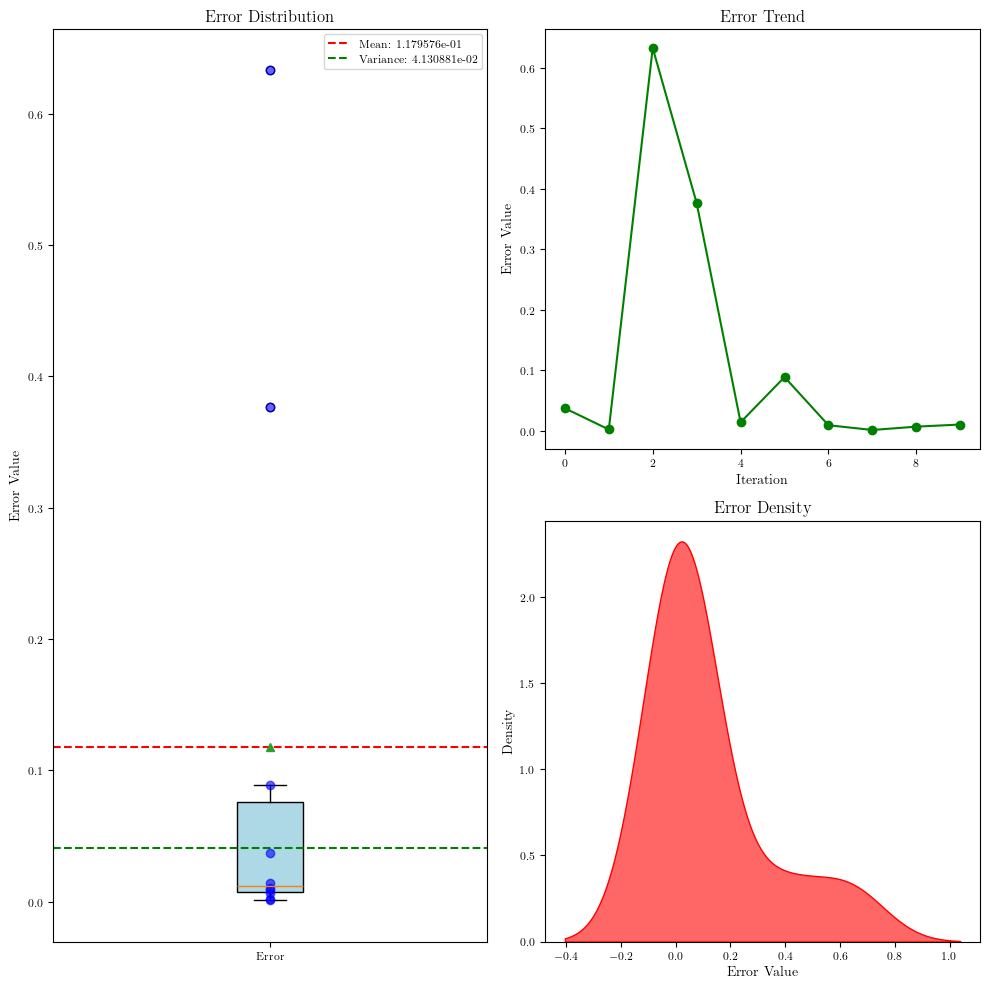

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.608055e-02
Variance MAE: 1.098372e-03


/tmp/ipykernel_2667941/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


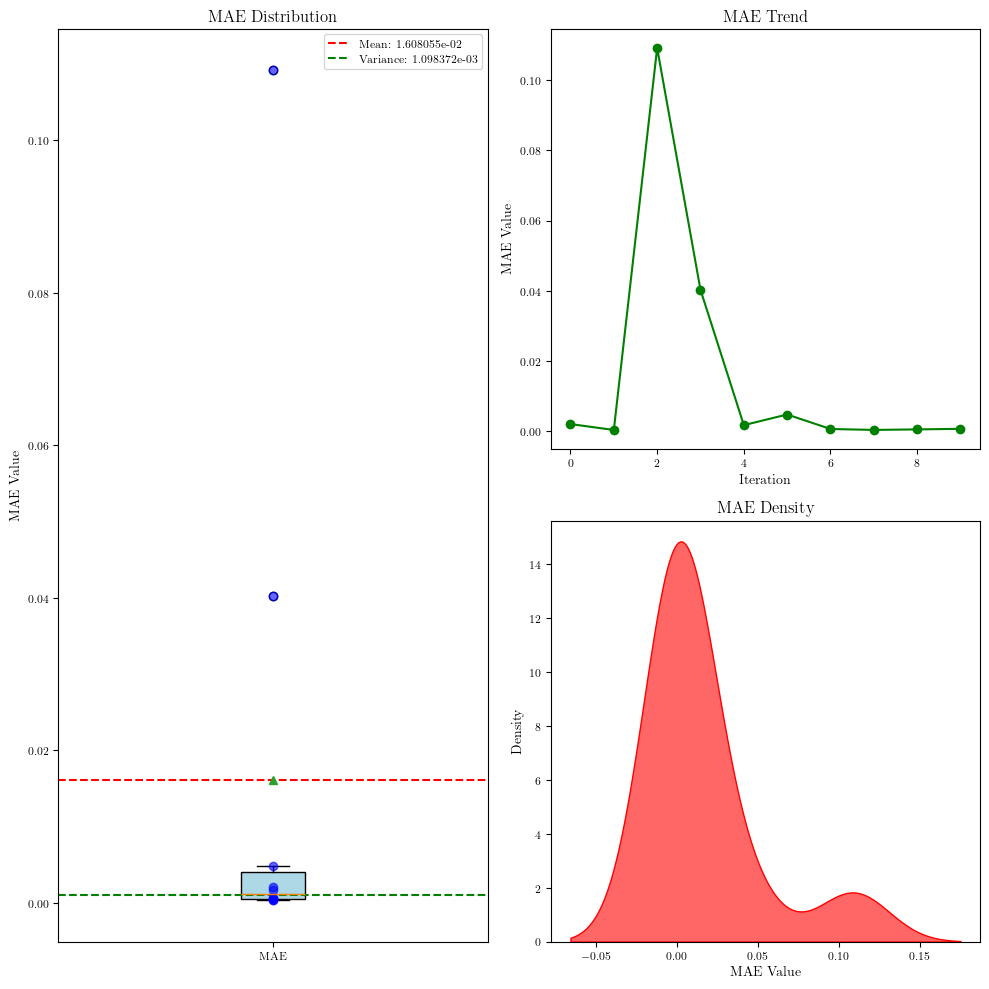

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.084167e-02
Variance MSE: 2.140376e-03


/tmp/ipykernel_2667941/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


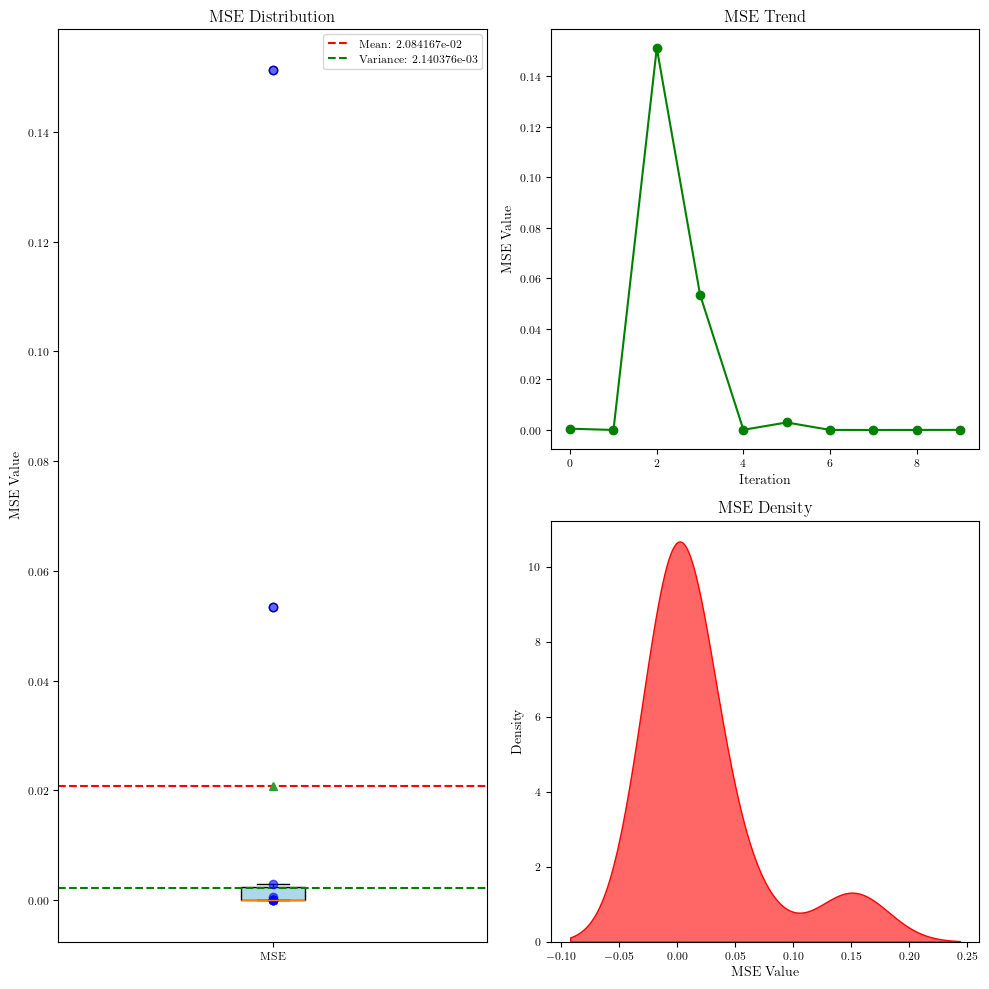

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

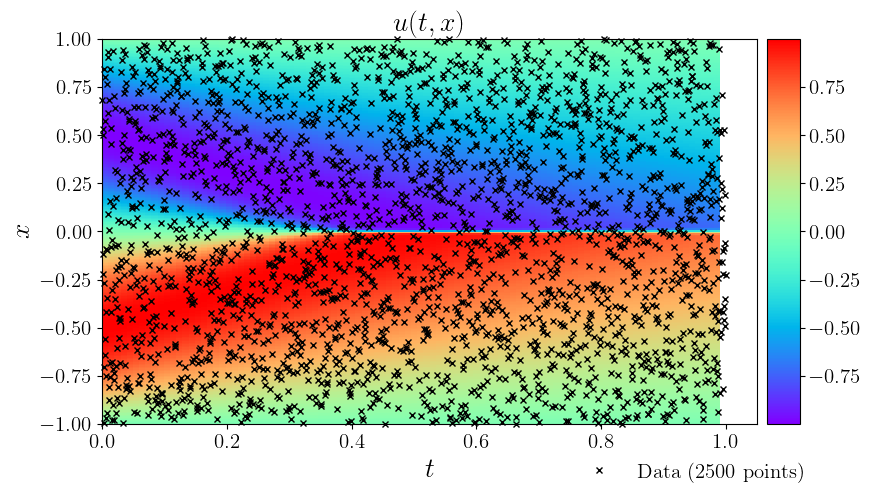

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

51876
[5.730578e-01 5.535909e-01 5.351289e-01 ... 2.111835e-06 2.111835e-06
 2.111835e-06]


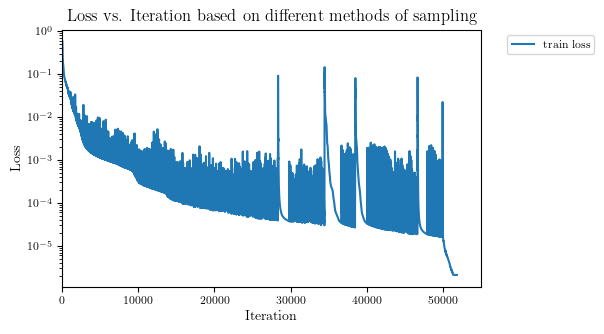

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

51876
[1.3411134  1.3214943  1.302542   ... 0.01035718 0.01035718 0.01035718]


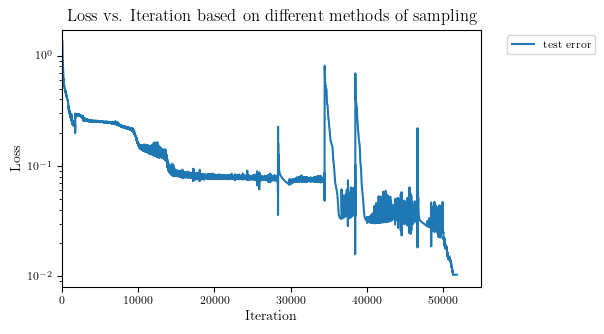

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


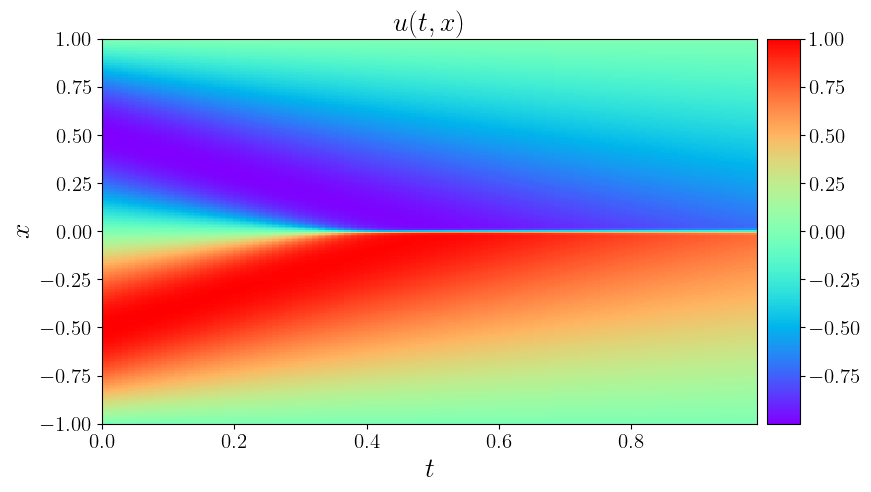

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

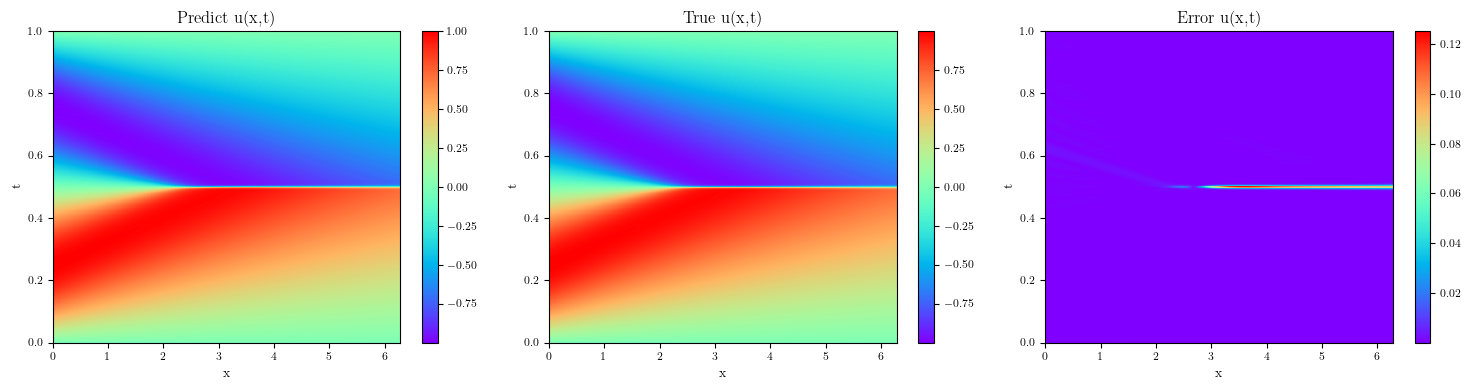

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

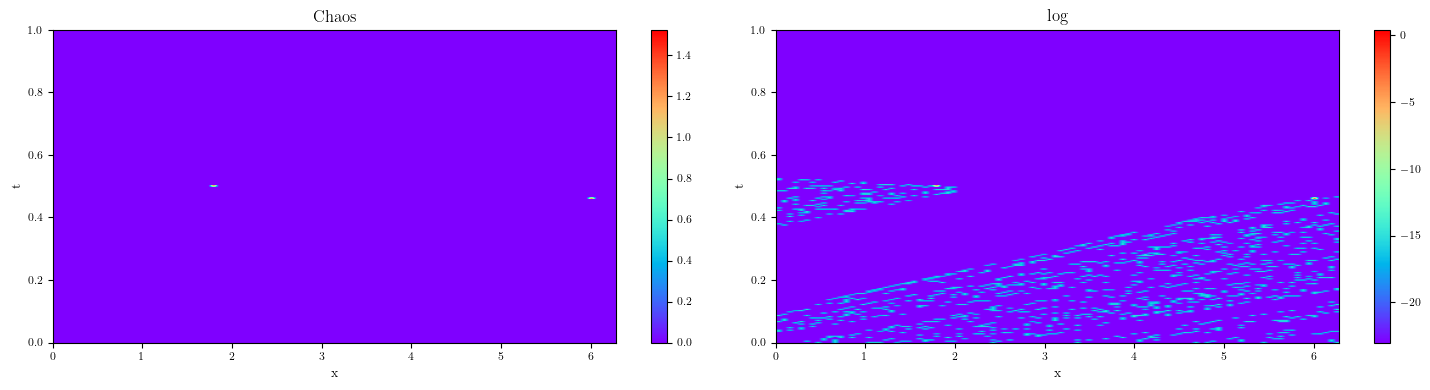

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()